<a href="https://colab.research.google.com/github/seunghyeokleeme/study-image-segmentation/blob/main/dacon_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd
!unzip -q "/content/drive/MyDrive/실증적 4조 sibas/open.zip" -d "/content"

/content
replace /content/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/test_img/TEST_00000.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/test_img/TEST_00001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Utils

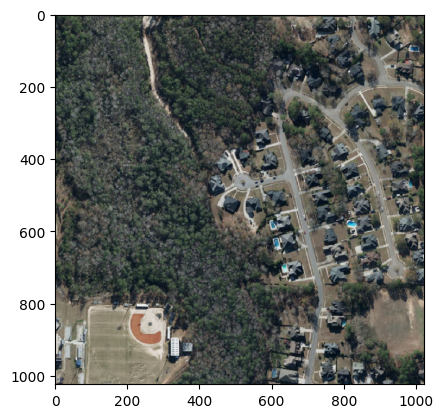

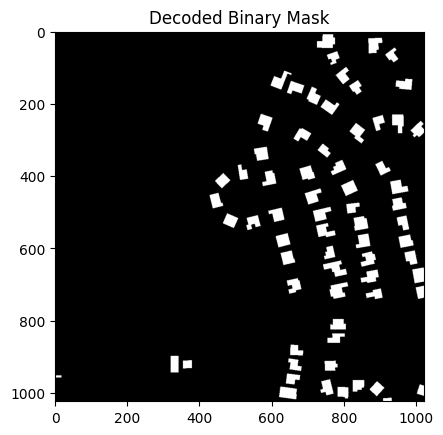

In [ ]:
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


# train.csv 파일을 읽어옵니다.
df = pd.read_csv('./train.csv')

id = 5

image = cv2.imread(f'./train_img/TRAIN_000{id}.png')
if image is None:
  raise FileNotFoundError(f"Image not found: {img_path}")  # 이미지가 없을 경우 예외 발생
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()


# 예시로 9 번째 마스크 정보를 사용합니다.
mask_rle_example = df['mask_rle'].iloc[id]
# 이미지의 실제 크기를 알고 있어야 합니다. 예시에서는 1024x1024로 가정합니다.
shape = (1024, 1024)

# RLE 인코딩된 마스크를 디코딩
decoded_mask = rle_decode(mask_rle_example, shape)

# 디코딩된 마스크 시각화
plt.imshow(decoded_mask, cmap='gray')
plt.title("Decoded Binary Mask")

plt.show()



#Custom Dataset

In [ ]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, img_dir=None, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir  # 이미지 파일들이 위치한 기본 디렉토리 경로, 필요에 따라 설정
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rel_path = self.data.iloc[idx, 1].lstrip('./')  # './' 제거
        img_path = os.path.join(self.img_dir, rel_path) if self.img_dir else rel_path

        print(img_path)
        image = cv2.imread(img_path)
        if image is None:
          raise FileNotFoundError(f"Image not found: {img_path}")  # 이미지가 없을 경우 예외 발생
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image
        else:
            mask_rle = self.data.iloc[idx, 2]
            mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
            return image, mask


In [ ]:
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
    ToTensorV2()
])

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [ ]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

In [ ]:
# model 초기화
model = UNet().to(device)

# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(10):  # 10 에폭 동안 학습합니다.
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(dataloader):
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.unsqueeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')

  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_1880.pngtrain_img/TRAIN_5704.pngtrain_img/TRAIN_5248.png
train_img/TRAIN_3096.png


train_img/TRAIN_6571.pngtrain_img/TRAIN_3946.pngtrain_img/TRAIN_5203.png


train_img/TRAIN_5484.png
train_img/TRAIN_3950.png
train_img/TRAIN_6348.png
train_img/TRAIN_0604.png
train_img/TRAIN_5997.png
train_img/TRAIN_0832.png
train_img/TRAIN_4748.png
train_img/TRAIN_0853.png
train_img/TRAIN_2664.png
train_img/TRAIN_3668.pngtrain_img/TRAIN_6228.png

train_img/TRAIN_6929.png
train_img/TRAIN_3462.png
train_img/TRAIN_4493.pngtrain_img/TRAIN_4414.png

train_img/TRAIN_5170.png
train_img/TRAIN_4117.png
train_img/TRAIN_6336.png
train_img/TRAIN_4940.png
train_img/TRAIN_1605.png
train_img/TRAIN_5120.png
train_img/TRAIN_3124.png
train_img/TRAIN_6471.png
train_img/TRAIN_1257.png
train_img/TRAIN_5366.png
train_img/TRAIN_6293.png
train_img/TRAIN_6050.png
train_img/TRAIN_2088.pngtrain_img/TRAIN_3932.png

train_img/TRAIN_0744.png
train_img/TRAIN_3651.png
train_img/TRAIN_2263.png
train_img/TRAIN_2173.png


  0%|          | 1/447 [00:03<22:29,  3.03s/it]

train_img/TRAIN_5460.png
train_img/TRAIN_7089.png
train_img/TRAIN_6057.png
train_img/TRAIN_6352.png
train_img/TRAIN_5256.png
train_img/TRAIN_4141.png
train_img/TRAIN_3236.png
train_img/TRAIN_3431.png
train_img/TRAIN_3893.png
train_img/TRAIN_5388.png
train_img/TRAIN_4296.png
train_img/TRAIN_4875.png
train_img/TRAIN_4709.png
train_img/TRAIN_0108.png


  0%|          | 2/447 [00:03<11:13,  1.51s/it]

train_img/TRAIN_1309.png
train_img/TRAIN_6244.png
train_img/TRAIN_4294.png
train_img/TRAIN_4072.png
train_img/TRAIN_6404.png
train_img/TRAIN_2803.png
train_img/TRAIN_0560.png
train_img/TRAIN_2568.png
train_img/TRAIN_5533.png
train_img/TRAIN_5352.png
train_img/TRAIN_5212.png
train_img/TRAIN_1586.png
train_img/TRAIN_1667.png
train_img/TRAIN_6981.png
train_img/TRAIN_0891.png
train_img/TRAIN_4310.png


  1%|          | 3/447 [00:03<07:36,  1.03s/it]

train_img/TRAIN_4837.png
train_img/TRAIN_1034.png
train_img/TRAIN_5340.png
train_img/TRAIN_2671.png
train_img/TRAIN_6181.png
train_img/TRAIN_0740.png
train_img/TRAIN_0866.png
train_img/TRAIN_2931.png
train_img/TRAIN_0564.png
train_img/TRAIN_2150.png
train_img/TRAIN_4595.png
train_img/TRAIN_0955.png
train_img/TRAIN_3637.png
train_img/TRAIN_1057.png
train_img/TRAIN_2450.png
train_img/TRAIN_0381.png


  1%|          | 4/447 [00:04<05:54,  1.25it/s]

train_img/TRAIN_1240.png
train_img/TRAIN_5690.png
train_img/TRAIN_0211.png
train_img/TRAIN_0631.png
train_img/TRAIN_3497.png
train_img/TRAIN_1987.png
train_img/TRAIN_1637.png
train_img/TRAIN_1895.png
train_img/TRAIN_2961.png
train_img/TRAIN_1331.png
train_img/TRAIN_7036.png
train_img/TRAIN_3588.png
train_img/TRAIN_4902.png
train_img/TRAIN_2169.png
train_img/TRAIN_4930.png


  1%|          | 5/447 [00:04<04:58,  1.48it/s]

train_img/TRAIN_4965.png
train_img/TRAIN_3032.png
train_img/TRAIN_2025.png
train_img/TRAIN_6593.png
train_img/TRAIN_4941.png
train_img/TRAIN_3595.png
train_img/TRAIN_3393.png
train_img/TRAIN_2531.png
train_img/TRAIN_1073.png
train_img/TRAIN_3966.png
train_img/TRAIN_4451.png
train_img/TRAIN_0493.png
train_img/TRAIN_3714.png
train_img/TRAIN_0673.png
train_img/TRAIN_6402.png
train_img/TRAIN_5009.png
train_img/TRAIN_6048.png


  1%|▏         | 6/447 [00:05<04:23,  1.67it/s]

train_img/TRAIN_2165.png
train_img/TRAIN_7041.png
train_img/TRAIN_6263.png
train_img/TRAIN_1009.png
train_img/TRAIN_4769.png
train_img/TRAIN_4795.png
train_img/TRAIN_0624.png
train_img/TRAIN_4495.png
train_img/TRAIN_3260.png
train_img/TRAIN_2855.png
train_img/TRAIN_2817.png
train_img/TRAIN_7076.png
train_img/TRAIN_1700.png
train_img/TRAIN_5648.png
train_img/TRAIN_0055.png


  2%|▏         | 7/447 [00:05<04:01,  1.82it/s]

train_img/TRAIN_0200.png
train_img/TRAIN_6825.png
train_img/TRAIN_6865.png
train_img/TRAIN_2810.png
train_img/TRAIN_4590.png
train_img/TRAIN_6028.png
train_img/TRAIN_1122.png
train_img/TRAIN_4617.png
train_img/TRAIN_2827.png
train_img/TRAIN_1592.png
train_img/TRAIN_0903.png
train_img/TRAIN_4087.png
train_img/TRAIN_4015.png
train_img/TRAIN_1056.png
train_img/TRAIN_0973.png
train_img/TRAIN_1646.png


  2%|▏         | 8/447 [00:06<03:47,  1.93it/s]

train_img/TRAIN_4639.png
train_img/TRAIN_2118.png
train_img/TRAIN_5867.png
train_img/TRAIN_6979.png
train_img/TRAIN_5712.png
train_img/TRAIN_5968.png
train_img/TRAIN_4042.png
train_img/TRAIN_6261.png
train_img/TRAIN_3382.png
train_img/TRAIN_6473.png
train_img/TRAIN_4936.png
train_img/TRAIN_6102.png
train_img/TRAIN_5354.png
train_img/TRAIN_1807.png
train_img/TRAIN_1847.png
train_img/TRAIN_5123.png
train_img/TRAIN_5088.png


  2%|▏         | 9/447 [00:06<03:37,  2.01it/s]

train_img/TRAIN_3574.png
train_img/TRAIN_3221.png
train_img/TRAIN_0479.png
train_img/TRAIN_2946.png
train_img/TRAIN_5049.png
train_img/TRAIN_1401.png
train_img/TRAIN_6899.png
train_img/TRAIN_6478.png
train_img/TRAIN_0310.png
train_img/TRAIN_0188.png
train_img/TRAIN_3772.png
train_img/TRAIN_6069.png
train_img/TRAIN_2184.png
train_img/TRAIN_2979.png
train_img/TRAIN_4903.png


  2%|▏         | 10/447 [00:07<03:30,  2.07it/s]

train_img/TRAIN_1052.pngtrain_img/TRAIN_5029.png

train_img/TRAIN_2703.png
train_img/TRAIN_3747.png
train_img/TRAIN_6000.png
train_img/TRAIN_4218.png
train_img/TRAIN_0971.png
train_img/TRAIN_6267.png
train_img/TRAIN_5393.png
train_img/TRAIN_2168.png
train_img/TRAIN_3172.png
train_img/TRAIN_0461.png
train_img/TRAIN_1165.png
train_img/TRAIN_2070.png
train_img/TRAIN_0192.png
train_img/TRAIN_2276.png


  2%|▏         | 11/447 [00:07<03:25,  2.12it/s]

train_img/TRAIN_4257.png
train_img/TRAIN_2889.png
train_img/TRAIN_6448.png
train_img/TRAIN_1787.png
train_img/TRAIN_4725.png
train_img/TRAIN_4890.png
train_img/TRAIN_4535.png
train_img/TRAIN_2693.png
train_img/TRAIN_3166.png
train_img/TRAIN_5263.png
train_img/TRAIN_1012.png
train_img/TRAIN_2076.png
train_img/TRAIN_5989.png
train_img/TRAIN_3837.png
train_img/TRAIN_3434.png
train_img/TRAIN_2815.png
train_img/TRAIN_6670.png

  3%|▎         | 12/447 [00:07<03:22,  2.15it/s]


train_img/TRAIN_3685.png
train_img/TRAIN_2135.png
train_img/TRAIN_1207.png
train_img/TRAIN_2143.png
train_img/TRAIN_3697.png
train_img/TRAIN_4308.png
train_img/TRAIN_3884.png
train_img/TRAIN_6566.png
train_img/TRAIN_1114.png
train_img/TRAIN_4056.png
train_img/TRAIN_0263.png
train_img/TRAIN_4685.png
train_img/TRAIN_6248.png
train_img/TRAIN_1629.png
train_img/TRAIN_7128.png


  3%|▎         | 13/447 [00:08<03:20,  2.16it/s]

train_img/TRAIN_1477.png
train_img/TRAIN_3357.png
train_img/TRAIN_4714.pngtrain_img/TRAIN_5190.png

train_img/TRAIN_5624.pngtrain_img/TRAIN_6982.png

train_img/TRAIN_0438.png
train_img/TRAIN_0120.png
train_img/TRAIN_4359.png
train_img/TRAIN_5827.png
train_img/TRAIN_6277.png
train_img/TRAIN_3237.png
train_img/TRAIN_3419.png
train_img/TRAIN_3671.png
train_img/TRAIN_4212.png
train_img/TRAIN_4118.png


  3%|▎         | 14/447 [00:08<03:18,  2.18it/s]

train_img/TRAIN_5670.png
train_img/TRAIN_0017.png
train_img/TRAIN_1527.pngtrain_img/TRAIN_5358.png

train_img/TRAIN_1186.png
train_img/TRAIN_1908.png
train_img/TRAIN_1934.png
train_img/TRAIN_4063.png
train_img/TRAIN_5910.png
train_img/TRAIN_5071.png
train_img/TRAIN_2553.png
train_img/TRAIN_2682.png
train_img/TRAIN_3617.png
train_img/TRAIN_6794.png
train_img/TRAIN_5621.png


  3%|▎         | 15/447 [00:09<03:17,  2.19it/s]

train_img/TRAIN_3840.png
train_img/TRAIN_2807.png
train_img/TRAIN_0035.png
train_img/TRAIN_1217.png
train_img/TRAIN_6793.png
train_img/TRAIN_4229.png
train_img/TRAIN_2991.png
train_img/TRAIN_2401.png
train_img/TRAIN_6674.png
train_img/TRAIN_1036.png
train_img/TRAIN_4700.png
train_img/TRAIN_4458.png
train_img/TRAIN_5377.png
train_img/TRAIN_2622.png
train_img/TRAIN_4246.png
train_img/TRAIN_0131.png
train_img/TRAIN_3345.png


  4%|▎         | 16/447 [00:09<03:16,  2.19it/s]

train_img/TRAIN_4312.png
train_img/TRAIN_2105.png
train_img/TRAIN_5347.png
train_img/TRAIN_2651.png
train_img/TRAIN_2978.png
train_img/TRAIN_1663.png
train_img/TRAIN_5948.png
train_img/TRAIN_1206.png
train_img/TRAIN_1534.png
train_img/TRAIN_3725.png
train_img/TRAIN_6957.png
train_img/TRAIN_0808.png
train_img/TRAIN_2613.png
train_img/TRAIN_0034.png
train_img/TRAIN_3298.png
train_img/TRAIN_6622.png


  4%|▍         | 17/447 [00:10<03:15,  2.20it/s]

train_img/TRAIN_0408.png
train_img/TRAIN_2156.png
train_img/TRAIN_6026.png
train_img/TRAIN_7107.png
train_img/TRAIN_0142.png
train_img/TRAIN_5671.png
train_img/TRAIN_3891.png
train_img/TRAIN_3608.png
train_img/TRAIN_5556.png
train_img/TRAIN_5821.png
train_img/TRAIN_0464.png
train_img/TRAIN_5869.png
train_img/TRAIN_4576.png
train_img/TRAIN_0861.png
train_img/TRAIN_6354.png
train_img/TRAIN_2178.png
train_img/TRAIN_2430.png


  4%|▍         | 18/447 [00:10<03:14,  2.20it/s]

train_img/TRAIN_2335.png
train_img/TRAIN_5719.png
train_img/TRAIN_4555.png
train_img/TRAIN_0931.png
train_img/TRAIN_2112.png
train_img/TRAIN_0932.png
train_img/TRAIN_6003.png
train_img/TRAIN_0584.png
train_img/TRAIN_4354.png
train_img/TRAIN_2230.png
train_img/TRAIN_4189.png
train_img/TRAIN_5281.png
train_img/TRAIN_4311.png
train_img/TRAIN_5423.png
train_img/TRAIN_0197.png


  4%|▍         | 19/447 [00:11<03:13,  2.21it/s]

train_img/TRAIN_4933.png
train_img/TRAIN_7101.png
train_img/TRAIN_3703.png
train_img/TRAIN_0266.png
train_img/TRAIN_4297.pngtrain_img/TRAIN_6311.png

train_img/TRAIN_4763.png
train_img/TRAIN_2896.png
train_img/TRAIN_2262.png
train_img/TRAIN_3566.png
train_img/TRAIN_0265.png
train_img/TRAIN_0943.png
train_img/TRAIN_6017.png
train_img/TRAIN_5965.png
train_img/TRAIN_3092.png
train_img/TRAIN_1950.png
train_img/TRAIN_2867.png


  4%|▍         | 20/447 [00:11<03:13,  2.21it/s]

train_img/TRAIN_0769.png
train_img/TRAIN_2534.png
train_img/TRAIN_1593.png
train_img/TRAIN_0491.png
train_img/TRAIN_1797.png
train_img/TRAIN_4871.png
train_img/TRAIN_3546.png
train_img/TRAIN_2781.png
train_img/TRAIN_0015.png
train_img/TRAIN_3985.png
train_img/TRAIN_5972.png
train_img/TRAIN_1645.png
train_img/TRAIN_6013.png
train_img/TRAIN_3089.png
train_img/TRAIN_0026.png


  5%|▍         | 21/447 [00:12<03:12,  2.22it/s]

train_img/TRAIN_0799.png
train_img/TRAIN_2164.png
train_img/TRAIN_6922.png
train_img/TRAIN_4411.png
train_img/TRAIN_0717.png
train_img/TRAIN_6059.png
train_img/TRAIN_1566.png
train_img/TRAIN_4364.png
train_img/TRAIN_2361.png
train_img/TRAIN_6276.png
train_img/TRAIN_3343.png
train_img/TRAIN_1728.png
train_img/TRAIN_5757.png
train_img/TRAIN_3518.png
train_img/TRAIN_1961.png
train_img/TRAIN_1598.png
train_img/TRAIN_2405.png


  5%|▍         | 22/447 [00:12<03:12,  2.21it/s]

train_img/TRAIN_1548.png
train_img/TRAIN_1557.png
train_img/TRAIN_2692.png
train_img/TRAIN_3796.png
train_img/TRAIN_5982.png
train_img/TRAIN_2012.png
train_img/TRAIN_0257.png
train_img/TRAIN_3470.png
train_img/TRAIN_3398.png
train_img/TRAIN_0826.png
train_img/TRAIN_1862.png
train_img/TRAIN_0995.png
train_img/TRAIN_3967.png
train_img/TRAIN_0982.png
train_img/TRAIN_1225.png


  5%|▌         | 23/447 [00:12<03:11,  2.21it/s]

train_img/TRAIN_6874.png
train_img/TRAIN_5108.png
train_img/TRAIN_3130.png
train_img/TRAIN_4049.png
train_img/TRAIN_0062.png
train_img/TRAIN_1507.png
train_img/TRAIN_6197.png
train_img/TRAIN_4265.png
train_img/TRAIN_6096.png
train_img/TRAIN_3122.png
train_img/TRAIN_1363.png
train_img/TRAIN_4905.png
train_img/TRAIN_2477.png
train_img/TRAIN_1543.png
train_img/TRAIN_0798.png
train_img/TRAIN_3962.png
train_img/TRAIN_2329.png


  5%|▌         | 24/447 [00:13<03:10,  2.22it/s]

train_img/TRAIN_0357.pngtrain_img/TRAIN_2318.png

train_img/TRAIN_1308.png
train_img/TRAIN_6837.png
train_img/TRAIN_6204.png
train_img/TRAIN_0859.png
train_img/TRAIN_2304.png
train_img/TRAIN_6955.png
train_img/TRAIN_5900.png
train_img/TRAIN_0919.png
train_img/TRAIN_2577.png
train_img/TRAIN_4083.png
train_img/TRAIN_5474.png
train_img/TRAIN_6936.png
train_img/TRAIN_6344.png
train_img/TRAIN_2079.png


  6%|▌         | 25/447 [00:13<03:09,  2.22it/s]

train_img/TRAIN_1216.png
train_img/TRAIN_0114.png
train_img/TRAIN_6776.png
train_img/TRAIN_0875.png
train_img/TRAIN_2562.png
train_img/TRAIN_1983.png
train_img/TRAIN_6500.png
train_img/TRAIN_1525.png
train_img/TRAIN_4985.png
train_img/TRAIN_4153.png
train_img/TRAIN_4080.png
train_img/TRAIN_2125.png
train_img/TRAIN_5919.png
train_img/TRAIN_4580.png
train_img/TRAIN_1855.png


  6%|▌         | 26/447 [00:14<03:09,  2.23it/s]

train_img/TRAIN_2639.png
train_img/TRAIN_1246.png
train_img/TRAIN_0929.png
train_img/TRAIN_5257.png
train_img/TRAIN_5374.pngtrain_img/TRAIN_1044.png

train_img/TRAIN_3830.png
train_img/TRAIN_2244.png
train_img/TRAIN_0488.png
train_img/TRAIN_0162.png
train_img/TRAIN_2679.png
train_img/TRAIN_1087.png
train_img/TRAIN_5597.png
train_img/TRAIN_4918.png
train_img/TRAIN_0202.png
train_img/TRAIN_0849.png


  6%|▌         | 27/447 [00:14<03:09,  2.22it/s]

train_img/TRAIN_1653.png
train_img/TRAIN_4360.png
train_img/TRAIN_1510.png
train_img/TRAIN_5788.png
train_img/TRAIN_5080.png
train_img/TRAIN_5118.png
train_img/TRAIN_5002.png
train_img/TRAIN_6168.png
train_img/TRAIN_0340.png
train_img/TRAIN_5260.png
train_img/TRAIN_4126.png
train_img/TRAIN_0514.png
train_img/TRAIN_3007.png
train_img/TRAIN_2072.png
train_img/TRAIN_2009.png
train_img/TRAIN_2824.png


  6%|▋         | 28/447 [00:15<03:09,  2.22it/s]

train_img/TRAIN_2506.png
train_img/TRAIN_4105.png
train_img/TRAIN_2353.png
train_img/TRAIN_5304.png
train_img/TRAIN_4485.png
train_img/TRAIN_4947.png
train_img/TRAIN_1213.png
train_img/TRAIN_2584.png
train_img/TRAIN_6751.png
train_img/TRAIN_4039.png
train_img/TRAIN_2523.png
train_img/TRAIN_2860.png
train_img/TRAIN_0733.png
train_img/TRAIN_6574.png
train_img/TRAIN_6985.png


  6%|▋         | 29/447 [00:15<03:08,  2.22it/s]

train_img/TRAIN_3992.png
train_img/TRAIN_5095.png
train_img/TRAIN_3265.pngtrain_img/TRAIN_6208.png

train_img/TRAIN_0612.png
train_img/TRAIN_3921.png
train_img/TRAIN_2547.png
train_img/TRAIN_5675.png
train_img/TRAIN_0803.png
train_img/TRAIN_5813.png
train_img/TRAIN_5531.png
train_img/TRAIN_3965.png
train_img/TRAIN_4970.png
train_img/TRAIN_6517.png
train_img/TRAIN_7026.png
train_img/TRAIN_0315.png
train_img/TRAIN_3010.png
train_img/TRAIN_5668.png


  7%|▋         | 30/447 [00:16<03:07,  2.22it/s]

train_img/TRAIN_6373.png
train_img/TRAIN_1436.png
train_img/TRAIN_1271.png
train_img/TRAIN_5139.png
train_img/TRAIN_6714.png
train_img/TRAIN_2929.png
train_img/TRAIN_2971.png
train_img/TRAIN_6511.png
train_img/TRAIN_6153.png
train_img/TRAIN_6804.png
train_img/TRAIN_4540.png
train_img/TRAIN_1424.png
train_img/TRAIN_6412.png
train_img/TRAIN_1576.png
train_img/TRAIN_6791.png


  7%|▋         | 31/447 [00:16<03:07,  2.22it/s]

train_img/TRAIN_6727.png
train_img/TRAIN_3889.png
train_img/TRAIN_0326.png
train_img/TRAIN_2730.png
train_img/TRAIN_0066.png
train_img/TRAIN_0304.png
train_img/TRAIN_3366.png
train_img/TRAIN_1156.png
train_img/TRAIN_6630.png
train_img/TRAIN_7034.png
train_img/TRAIN_1039.png
train_img/TRAIN_3563.png
train_img/TRAIN_2123.png
train_img/TRAIN_0788.png
train_img/TRAIN_4731.png
train_img/TRAIN_7000.png


  7%|▋         | 32/447 [00:17<03:07,  2.22it/s]

train_img/TRAIN_4251.png
train_img/TRAIN_3289.png
train_img/TRAIN_6756.png
train_img/TRAIN_6100.png
train_img/TRAIN_0218.png
train_img/TRAIN_0775.png
train_img/TRAIN_4924.png
train_img/TRAIN_6576.png
train_img/TRAIN_5916.png
train_img/TRAIN_4542.png
train_img/TRAIN_6771.png
train_img/TRAIN_1898.png
train_img/TRAIN_2397.png
train_img/TRAIN_4216.png
train_img/TRAIN_0645.png
train_img/TRAIN_1555.png
train_img/TRAIN_0384.png


  7%|▋         | 33/447 [00:17<03:06,  2.22it/s]

train_img/TRAIN_1250.png
train_img/TRAIN_4836.png
train_img/TRAIN_1099.png
train_img/TRAIN_3890.png
train_img/TRAIN_4000.png
train_img/TRAIN_6636.png
train_img/TRAIN_3152.png
train_img/TRAIN_4842.png
train_img/TRAIN_2514.png
train_img/TRAIN_0462.png
train_img/TRAIN_1336.png
train_img/TRAIN_5851.png
train_img/TRAIN_3693.png
train_img/TRAIN_5801.png
train_img/TRAIN_5208.png
train_img/TRAIN_4958.png


  8%|▊         | 34/447 [00:17<03:05,  2.22it/s]

train_img/TRAIN_2806.png
train_img/TRAIN_0864.png
train_img/TRAIN_0682.png
train_img/TRAIN_5342.png
train_img/TRAIN_5302.png
train_img/TRAIN_6296.png
train_img/TRAIN_2048.png
train_img/TRAIN_3629.png
train_img/TRAIN_6345.png
train_img/TRAIN_1511.png
train_img/TRAIN_0906.png
train_img/TRAIN_3263.png
train_img/TRAIN_4995.png
train_img/TRAIN_5902.png
train_img/TRAIN_4424.png
train_img/TRAIN_0974.png


  8%|▊         | 35/447 [00:18<03:05,  2.22it/s]

train_img/TRAIN_1158.png
train_img/TRAIN_5033.png
train_img/TRAIN_5061.png
train_img/TRAIN_0711.png
train_img/TRAIN_5351.png
train_img/TRAIN_2331.png
train_img/TRAIN_3740.png
train_img/TRAIN_6453.png
train_img/TRAIN_2862.png
train_img/TRAIN_0912.png
train_img/TRAIN_1500.png
train_img/TRAIN_5558.png
train_img/TRAIN_0749.png
train_img/TRAIN_4533.png
train_img/TRAIN_2227.png


  8%|▊         | 36/447 [00:18<03:05,  2.22it/s]

train_img/TRAIN_5506.pngtrain_img/TRAIN_4675.png

train_img/TRAIN_2618.png
train_img/TRAIN_3530.png
train_img/TRAIN_4205.pngtrain_img/TRAIN_0112.png

train_img/TRAIN_2782.png
train_img/TRAIN_2390.png
train_img/TRAIN_7029.png
train_img/TRAIN_6580.png
train_img/TRAIN_4156.png
train_img/TRAIN_7027.png
train_img/TRAIN_5164.png
train_img/TRAIN_5682.png
train_img/TRAIN_4084.png
train_img/TRAIN_1887.png
train_img/TRAIN_4742.png
train_img/TRAIN_4069.png


  8%|▊         | 37/447 [00:19<03:04,  2.22it/s]

train_img/TRAIN_3736.png
train_img/TRAIN_6813.png
train_img/TRAIN_4128.png
train_img/TRAIN_6681.png
train_img/TRAIN_0093.png
train_img/TRAIN_0591.png
train_img/TRAIN_4716.png
train_img/TRAIN_6049.png
train_img/TRAIN_4381.png
train_img/TRAIN_0614.png
train_img/TRAIN_0334.png
train_img/TRAIN_0419.png
train_img/TRAIN_4833.png
train_img/TRAIN_4728.png
train_img/TRAIN_5960.png


  9%|▊         | 38/447 [00:19<03:04,  2.22it/s]

train_img/TRAIN_2043.png
train_img/TRAIN_2109.png
train_img/TRAIN_4614.png
train_img/TRAIN_1142.png
train_img/TRAIN_3582.png
train_img/TRAIN_1408.png
train_img/TRAIN_5480.png
train_img/TRAIN_1744.png
train_img/TRAIN_6637.png
train_img/TRAIN_5286.png
train_img/TRAIN_2736.png
train_img/TRAIN_2609.png
train_img/TRAIN_2117.png
train_img/TRAIN_0950.png
train_img/TRAIN_3473.png
train_img/TRAIN_2222.png


  9%|▊         | 39/447 [00:20<03:04,  2.21it/s]

train_img/TRAIN_5890.png
train_img/TRAIN_3876.png
train_img/TRAIN_6567.png
train_img/TRAIN_0208.png
train_img/TRAIN_4793.png
train_img/TRAIN_3160.png
train_img/TRAIN_1833.png
train_img/TRAIN_2298.png
train_img/TRAIN_0731.png
train_img/TRAIN_6007.png
train_img/TRAIN_1109.png
train_img/TRAIN_4839.png
train_img/TRAIN_6866.png
train_img/TRAIN_6626.png
train_img/TRAIN_1149.png
train_img/TRAIN_1175.png


  9%|▉         | 40/447 [00:20<03:03,  2.22it/s]

train_img/TRAIN_5641.png
train_img/TRAIN_2642.png
train_img/TRAIN_1236.png
train_img/TRAIN_5289.png
train_img/TRAIN_3100.png
train_img/TRAIN_2888.png
train_img/TRAIN_1652.png
train_img/TRAIN_4693.png
train_img/TRAIN_5805.png
train_img/TRAIN_4806.png
train_img/TRAIN_3695.png
train_img/TRAIN_0336.png
train_img/TRAIN_1396.png
train_img/TRAIN_2431.png
train_img/TRAIN_4304.png
train_img/TRAIN_6896.png


  9%|▉         | 41/447 [00:21<03:03,  2.22it/s]

train_img/TRAIN_3562.png
train_img/TRAIN_4501.png
train_img/TRAIN_6229.png
train_img/TRAIN_0970.png
train_img/TRAIN_2049.png
train_img/TRAIN_6712.png
train_img/TRAIN_5041.png
train_img/TRAIN_5375.png
train_img/TRAIN_6025.png
train_img/TRAIN_6358.png
train_img/TRAIN_7043.png
train_img/TRAIN_6988.png
train_img/TRAIN_7072.png
train_img/TRAIN_5026.png
train_img/TRAIN_2503.png
train_img/TRAIN_0914.png
train_img/TRAIN_1038.png


  9%|▉         | 42/447 [00:21<03:02,  2.21it/s]

train_img/TRAIN_4536.png
train_img/TRAIN_5191.png
train_img/TRAIN_0928.png
train_img/TRAIN_3700.png
train_img/TRAIN_0998.png
train_img/TRAIN_2171.png
train_img/TRAIN_0767.png
train_img/TRAIN_3079.png
train_img/TRAIN_1947.png
train_img/TRAIN_0610.png
train_img/TRAIN_6066.png
train_img/TRAIN_3335.png
train_img/TRAIN_2323.png
train_img/TRAIN_4165.png
train_img/TRAIN_3442.png


 10%|▉         | 43/447 [00:21<03:02,  2.21it/s]

train_img/TRAIN_7054.png
train_img/TRAIN_1447.png
train_img/TRAIN_2083.png
train_img/TRAIN_3307.png
train_img/TRAIN_0059.png
train_img/TRAIN_3287.png
train_img/TRAIN_0497.png
train_img/TRAIN_1426.png
train_img/TRAIN_5144.png
train_img/TRAIN_6159.png
train_img/TRAIN_2663.png
train_img/TRAIN_4302.png
train_img/TRAIN_6183.png
train_img/TRAIN_3526.png
train_img/TRAIN_3631.png


 10%|▉         | 44/447 [00:22<03:02,  2.21it/s]

train_img/TRAIN_5977.png
train_img/TRAIN_1625.png
train_img/TRAIN_2940.png
train_img/TRAIN_1799.png
train_img/TRAIN_3220.png
train_img/TRAIN_3039.png
train_img/TRAIN_6748.png
train_img/TRAIN_5715.png
train_img/TRAIN_0884.png
train_img/TRAIN_3542.png
train_img/TRAIN_2288.png
train_img/TRAIN_2195.png
train_img/TRAIN_0268.png
train_img/TRAIN_6928.png
train_img/TRAIN_5701.png
train_img/TRAIN_4152.png
train_img/TRAIN_3894.png


 10%|█         | 45/447 [00:22<03:01,  2.21it/s]

train_img/TRAIN_4874.png
train_img/TRAIN_0004.png
train_img/TRAIN_3919.png
train_img/TRAIN_4097.png
train_img/TRAIN_5424.png
train_img/TRAIN_1567.png
train_img/TRAIN_1371.png
train_img/TRAIN_2760.png
train_img/TRAIN_5383.png
train_img/TRAIN_4603.png
train_img/TRAIN_1227.png
train_img/TRAIN_4456.png
train_img/TRAIN_3908.png
train_img/TRAIN_4895.png
train_img/TRAIN_1878.png


 10%|█         | 46/447 [00:23<03:01,  2.21it/s]

train_img/TRAIN_5758.png
train_img/TRAIN_5172.png
train_img/TRAIN_1850.png
train_img/TRAIN_2715.png
train_img/TRAIN_5843.png
train_img/TRAIN_6799.png
train_img/TRAIN_1611.png
train_img/TRAIN_7087.png
train_img/TRAIN_3086.png
train_img/TRAIN_6606.png
train_img/TRAIN_5603.png
train_img/TRAIN_0331.png
train_img/TRAIN_4729.png
train_img/TRAIN_2140.png
train_img/TRAIN_5155.png
train_img/TRAIN_0165.png

 11%|█         | 47/447 [00:23<03:00,  2.21it/s]


train_img/TRAIN_6370.png
train_img/TRAIN_5921.pngtrain_img/TRAIN_5743.png

train_img/TRAIN_2271.png
train_img/TRAIN_5449.png
train_img/TRAIN_0618.png
train_img/TRAIN_3936.png
train_img/TRAIN_4224.png
train_img/TRAIN_2646.png
train_img/TRAIN_4959.png
train_img/TRAIN_5451.png
train_img/TRAIN_1079.png
train_img/TRAIN_3597.png
train_img/TRAIN_2139.png
train_img/TRAIN_4315.png


 11%|█         | 48/447 [00:24<03:00,  2.21it/s]

train_img/TRAIN_2413.png
train_img/TRAIN_5642.png
train_img/TRAIN_4230.png
train_img/TRAIN_0986.png
train_img/TRAIN_7007.png
train_img/TRAIN_4680.png
train_img/TRAIN_5110.png
train_img/TRAIN_2185.png
train_img/TRAIN_5807.png
train_img/TRAIN_1897.png
train_img/TRAIN_2727.png
train_img/TRAIN_3501.png
train_img/TRAIN_2992.png
train_img/TRAIN_5754.png
train_img/TRAIN_1482.png
train_img/TRAIN_3621.png
train_img/TRAIN_4379.png


 11%|█         | 49/447 [00:24<03:00,  2.20it/s]

train_img/TRAIN_5848.png
train_img/TRAIN_5048.png
train_img/TRAIN_5857.png
train_img/TRAIN_0100.png
train_img/TRAIN_1636.png
train_img/TRAIN_1824.png
train_img/TRAIN_0620.png
train_img/TRAIN_5312.png
train_img/TRAIN_2040.png
train_img/TRAIN_0782.png
train_img/TRAIN_0041.png
train_img/TRAIN_6560.png
train_img/TRAIN_6811.png
train_img/TRAIN_0213.png
train_img/TRAIN_5898.png
train_img/TRAIN_7096.png
train_img/TRAIN_4994.png


 11%|█         | 50/447 [00:25<03:00,  2.20it/s]

train_img/TRAIN_4544.png
train_img/TRAIN_0654.png
train_img/TRAIN_2064.png
train_img/TRAIN_5037.png
train_img/TRAIN_3741.png
train_img/TRAIN_4169.png
train_img/TRAIN_4648.png
train_img/TRAIN_6835.png
train_img/TRAIN_2451.png
train_img/TRAIN_5868.png
train_img/TRAIN_4531.png
train_img/TRAIN_6556.png
train_img/TRAIN_3610.png
train_img/TRAIN_2688.png
train_img/TRAIN_0550.png
train_img/TRAIN_2384.png


 11%|█▏        | 51/447 [00:25<02:59,  2.21it/s]

train_img/TRAIN_3272.png
train_img/TRAIN_2055.png
train_img/TRAIN_5283.png
train_img/TRAIN_1427.png
train_img/TRAIN_1117.png
train_img/TRAIN_4991.png
train_img/TRAIN_0627.png
train_img/TRAIN_3071.png
train_img/TRAIN_5620.png
train_img/TRAIN_1504.png
train_img/TRAIN_5431.png
train_img/TRAIN_1006.png
train_img/TRAIN_3194.png
train_img/TRAIN_0542.png
train_img/TRAIN_4316.png


 12%|█▏        | 52/447 [00:26<02:58,  2.21it/s]

train_img/TRAIN_1080.png
train_img/TRAIN_2590.png
train_img/TRAIN_2661.png
train_img/TRAIN_3538.png
train_img/TRAIN_5381.png
train_img/TRAIN_7119.png
train_img/TRAIN_4704.png
train_img/TRAIN_1278.png
train_img/TRAIN_2970.png
train_img/TRAIN_1294.png
train_img/TRAIN_4856.png
train_img/TRAIN_6627.png
train_img/TRAIN_6960.png
train_img/TRAIN_1125.png
train_img/TRAIN_4223.png
train_img/TRAIN_5651.png


 12%|█▏        | 53/447 [00:26<02:58,  2.20it/s]

train_img/TRAIN_0997.png
train_img/TRAIN_0090.png
train_img/TRAIN_6051.png
train_img/TRAIN_3834.png
train_img/TRAIN_4968.png
train_img/TRAIN_5363.png
train_img/TRAIN_4543.png
train_img/TRAIN_3533.png
train_img/TRAIN_1115.png
train_img/TRAIN_1789.png
train_img/TRAIN_1939.png
train_img/TRAIN_2201.png
train_img/TRAIN_4550.png
train_img/TRAIN_0475.png
train_img/TRAIN_6019.png
train_img/TRAIN_3131.png


 12%|█▏        | 54/447 [00:26<02:58,  2.21it/s]

train_img/TRAIN_4474.png
train_img/TRAIN_3838.png
train_img/TRAIN_4111.png
train_img/TRAIN_3683.png
train_img/TRAIN_1340.png
train_img/TRAIN_3485.pngtrain_img/TRAIN_1804.png

train_img/TRAIN_2311.png
train_img/TRAIN_3523.png
train_img/TRAIN_0262.png
train_img/TRAIN_3463.png
train_img/TRAIN_1581.png
train_img/TRAIN_0235.png
train_img/TRAIN_7136.png
train_img/TRAIN_5376.png
train_img/TRAIN_5117.png


 12%|█▏        | 55/447 [00:27<02:58,  2.20it/s]

train_img/TRAIN_1484.png
train_img/TRAIN_6521.png
train_img/TRAIN_1154.png
train_img/TRAIN_1163.png
train_img/TRAIN_1503.png
train_img/TRAIN_2342.png
train_img/TRAIN_3104.png
train_img/TRAIN_4857.png
train_img/TRAIN_2558.png
train_img/TRAIN_2382.png
train_img/TRAIN_0949.png
train_img/TRAIN_0134.png
train_img/TRAIN_6729.png
train_img/TRAIN_0048.png
train_img/TRAIN_6231.png


 13%|█▎        | 56/447 [00:27<02:57,  2.20it/s]

train_img/TRAIN_2705.png
train_img/TRAIN_3689.png
train_img/TRAIN_0426.png
train_img/TRAIN_6304.png
train_img/TRAIN_5183.png
train_img/TRAIN_4340.png
train_img/TRAIN_0805.png
train_img/TRAIN_5028.png
train_img/TRAIN_1992.png
train_img/TRAIN_0690.png
train_img/TRAIN_5784.png
train_img/TRAIN_2110.png
train_img/TRAIN_1184.png
train_img/TRAIN_2265.png
train_img/TRAIN_5552.png
train_img/TRAIN_1392.png
train_img/TRAIN_5350.png


 13%|█▎        | 57/447 [00:28<02:58,  2.19it/s]

train_img/TRAIN_0243.png
train_img/TRAIN_0453.png
train_img/TRAIN_2489.png
train_img/TRAIN_1619.png
train_img/TRAIN_4949.png
train_img/TRAIN_3598.png
train_img/TRAIN_1273.png
train_img/TRAIN_6621.png
train_img/TRAIN_1608.png
train_img/TRAIN_2825.png
train_img/TRAIN_4506.png
train_img/TRAIN_0494.png
train_img/TRAIN_5429.png
train_img/TRAIN_1979.png
train_img/TRAIN_6953.png
train_img/TRAIN_5127.png


 13%|█▎        | 58/447 [00:28<02:57,  2.19it/s]

train_img/TRAIN_6634.png
train_img/TRAIN_1203.png
train_img/TRAIN_0583.png
train_img/TRAIN_3041.png
train_img/TRAIN_2904.png
train_img/TRAIN_5091.png
train_img/TRAIN_2922.png
train_img/TRAIN_0892.png
train_img/TRAIN_6578.png
train_img/TRAIN_6257.png
train_img/TRAIN_2626.png
train_img/TRAIN_5546.png
train_img/TRAIN_6624.png
train_img/TRAIN_0556.png
train_img/TRAIN_2856.png
train_img/TRAIN_4866.png


 13%|█▎        | 59/447 [00:29<02:57,  2.19it/s]

train_img/TRAIN_6053.png
train_img/TRAIN_4314.png
train_img/TRAIN_6699.png
train_img/TRAIN_2328.png
train_img/TRAIN_0923.png
train_img/TRAIN_4626.png
train_img/TRAIN_5114.png
train_img/TRAIN_7038.png
train_img/TRAIN_0671.png
train_img/TRAIN_7032.png
train_img/TRAIN_4824.png
train_img/TRAIN_6252.png
train_img/TRAIN_0704.png
train_img/TRAIN_5874.png
train_img/TRAIN_4624.png
train_img/TRAIN_6610.png
train_img/TRAIN_4835.png


 13%|█▎        | 60/447 [00:29<02:56,  2.19it/s]

train_img/TRAIN_0838.png
train_img/TRAIN_2433.png
train_img/TRAIN_3257.png
train_img/TRAIN_2065.png
train_img/TRAIN_4107.png
train_img/TRAIN_2749.png
train_img/TRAIN_5430.png
train_img/TRAIN_3888.png
train_img/TRAIN_3659.png
train_img/TRAIN_1771.png
train_img/TRAIN_4776.png
train_img/TRAIN_6508.png
train_img/TRAIN_2702.png
train_img/TRAIN_6141.png
train_img/TRAIN_4692.png


 14%|█▎        | 61/447 [00:30<02:56,  2.19it/s]

train_img/TRAIN_3204.pngtrain_img/TRAIN_0872.png

train_img/TRAIN_1016.png
train_img/TRAIN_6077.png
train_img/TRAIN_5733.pngtrain_img/TRAIN_3580.png

train_img/TRAIN_3051.png
train_img/TRAIN_3557.png
train_img/TRAIN_4526.png
train_img/TRAIN_0281.png
train_img/TRAIN_5745.png
train_img/TRAIN_3445.png
train_img/TRAIN_1644.png
train_img/TRAIN_3277.png
train_img/TRAIN_3679.png
train_img/TRAIN_1098.png


 14%|█▍        | 62/447 [00:30<02:55,  2.19it/s]

train_img/TRAIN_4558.png
train_img/TRAIN_5234.png
train_img/TRAIN_6353.png
train_img/TRAIN_1418.png
train_img/TRAIN_5912.png
train_img/TRAIN_0301.png
train_img/TRAIN_6632.png
train_img/TRAIN_2404.png
train_img/TRAIN_2597.png
train_img/TRAIN_1361.png
train_img/TRAIN_3123.png
train_img/TRAIN_5661.png
train_img/TRAIN_2698.png
train_img/TRAIN_3365.png
train_img/TRAIN_6725.png
train_img/TRAIN_2969.png


 14%|█▍        | 63/447 [00:31<02:55,  2.19it/s]

train_img/TRAIN_0273.png
train_img/TRAIN_6176.png
train_img/TRAIN_4745.png
train_img/TRAIN_6807.png
train_img/TRAIN_3520.png
train_img/TRAIN_5680.png
train_img/TRAIN_4244.png
train_img/TRAIN_5825.png
train_img/TRAIN_7090.png
train_img/TRAIN_2773.png
train_img/TRAIN_6206.png
train_img/TRAIN_4744.png
train_img/TRAIN_4167.png
train_img/TRAIN_1709.png
train_img/TRAIN_6789.png
train_img/TRAIN_1200.png


 14%|█▍        | 64/447 [00:31<02:55,  2.19it/s]

train_img/TRAIN_3997.png
train_img/TRAIN_0695.png
train_img/TRAIN_0552.png
train_img/TRAIN_4756.png
train_img/TRAIN_6303.png
train_img/TRAIN_6446.png
train_img/TRAIN_1761.png
train_img/TRAIN_5681.png
train_img/TRAIN_0659.png
train_img/TRAIN_5262.png
train_img/TRAIN_5570.png
train_img/TRAIN_0856.png
train_img/TRAIN_5384.png
train_img/TRAIN_0214.png
train_img/TRAIN_3173.png
train_img/TRAIN_2321.png


 15%|█▍        | 65/447 [00:31<02:54,  2.19it/s]

train_img/TRAIN_4486.png
train_img/TRAIN_3219.png
train_img/TRAIN_1877.png
train_img/TRAIN_1650.png
train_img/TRAIN_2029.png
train_img/TRAIN_3719.png
train_img/TRAIN_3225.png
train_img/TRAIN_2501.png
train_img/TRAIN_1352.png
train_img/TRAIN_0000.png
train_img/TRAIN_2684.png
train_img/TRAIN_1353.png
train_img/TRAIN_6116.png
train_img/TRAIN_2790.png
train_img/TRAIN_3075.png
train_img/TRAIN_5886.png


 15%|█▍        | 66/447 [00:32<02:53,  2.19it/s]

train_img/TRAIN_4391.png
train_img/TRAIN_6004.png
train_img/TRAIN_1174.png
train_img/TRAIN_2272.png
train_img/TRAIN_5044.png
train_img/TRAIN_4449.png
train_img/TRAIN_6213.png
train_img/TRAIN_4109.png
train_img/TRAIN_0070.png
train_img/TRAIN_6910.png
train_img/TRAIN_0967.png
train_img/TRAIN_4259.png
train_img/TRAIN_0071.png
train_img/TRAIN_2018.png
train_img/TRAIN_4330.png
train_img/TRAIN_5250.png


 15%|█▍        | 67/447 [00:32<02:53,  2.19it/s]

train_img/TRAIN_5421.png
train_img/TRAIN_3953.png
train_img/TRAIN_4929.png
train_img/TRAIN_6163.png
train_img/TRAIN_2273.png
train_img/TRAIN_3102.png
train_img/TRAIN_2614.png
train_img/TRAIN_0132.png
train_img/TRAIN_4804.png
train_img/TRAIN_6397.png
train_img/TRAIN_6468.png
train_img/TRAIN_2469.png
train_img/TRAIN_0653.png
train_img/TRAIN_3328.png
train_img/TRAIN_0028.png
train_img/TRAIN_2959.png


 15%|█▌        | 68/447 [00:33<02:53,  2.19it/s]

train_img/TRAIN_0303.png
train_img/TRAIN_6061.png
train_img/TRAIN_6730.png
train_img/TRAIN_5145.png
train_img/TRAIN_6393.png
train_img/TRAIN_1781.png
train_img/TRAIN_4547.png
train_img/TRAIN_7095.png
train_img/TRAIN_5513.png
train_img/TRAIN_3550.png
train_img/TRAIN_6820.png
train_img/TRAIN_1932.png
train_img/TRAIN_5926.png
train_img/TRAIN_0463.png
train_img/TRAIN_3614.png
train_img/TRAIN_1591.png
train_img/TRAIN_6161.png


 15%|█▌        | 69/447 [00:33<02:52,  2.19it/s]

train_img/TRAIN_4160.png
train_img/TRAIN_6383.png
train_img/TRAIN_1547.png
train_img/TRAIN_4732.png
train_img/TRAIN_6709.png
train_img/TRAIN_5448.png
train_img/TRAIN_0250.png
train_img/TRAIN_3111.png
train_img/TRAIN_5207.png
train_img/TRAIN_0036.png
train_img/TRAIN_0852.png
train_img/TRAIN_3019.png
train_img/TRAIN_3464.png
train_img/TRAIN_6919.png
train_img/TRAIN_4779.png
train_img/TRAIN_0520.png


 16%|█▌        | 70/447 [00:34<02:52,  2.19it/s]

train_img/TRAIN_4040.png
train_img/TRAIN_1949.png
train_img/TRAIN_2013.png
train_img/TRAIN_2226.png
train_img/TRAIN_3305.png
train_img/TRAIN_4937.png
train_img/TRAIN_3569.png
train_img/TRAIN_1640.png
train_img/TRAIN_6180.png
train_img/TRAIN_6677.png
train_img/TRAIN_2814.png
train_img/TRAIN_1341.png
train_img/TRAIN_5149.png
train_img/TRAIN_4858.png
train_img/TRAIN_4695.png


 16%|█▌        | 71/447 [00:34<02:51,  2.19it/s]

train_img/TRAIN_0154.png
train_img/TRAIN_5277.png
train_img/TRAIN_5834.png
train_img/TRAIN_4708.png
train_img/TRAIN_3247.png
train_img/TRAIN_2546.png
train_img/TRAIN_0792.png
train_img/TRAIN_5746.png
train_img/TRAIN_4292.png
train_img/TRAIN_3508.png
train_img/TRAIN_5826.png
train_img/TRAIN_7020.png
train_img/TRAIN_0282.png
train_img/TRAIN_6568.png
train_img/TRAIN_5142.png
train_img/TRAIN_1827.png


 16%|█▌        | 72/447 [00:35<02:51,  2.19it/s]

train_img/TRAIN_5240.png
train_img/TRAIN_5298.png
train_img/TRAIN_3846.png
train_img/TRAIN_3687.png
train_img/TRAIN_4328.png
train_img/TRAIN_1863.png
train_img/TRAIN_6954.png
train_img/TRAIN_4157.png
train_img/TRAIN_1951.png
train_img/TRAIN_1178.png
train_img/TRAIN_3308.png
train_img/TRAIN_0460.png
train_img/TRAIN_5043.png
train_img/TRAIN_0348.png
train_img/TRAIN_6395.png
train_img/TRAIN_2480.png


 16%|█▋        | 73/447 [00:35<02:51,  2.19it/s]

train_img/TRAIN_3087.png
train_img/TRAIN_4912.png
train_img/TRAIN_6935.png
train_img/TRAIN_4041.png
train_img/TRAIN_0667.png
train_img/TRAIN_4387.png
train_img/TRAIN_0806.png
train_img/TRAIN_2583.png
train_img/TRAIN_6510.png
train_img/TRAIN_2410.png
train_img/TRAIN_1988.png
train_img/TRAIN_1786.png
train_img/TRAIN_3206.png
train_img/TRAIN_3465.png
train_img/TRAIN_2479.png
train_img/TRAIN_1002.png


 17%|█▋        | 74/447 [00:36<02:50,  2.19it/s]

train_img/TRAIN_5585.png
train_img/TRAIN_0608.png
train_img/TRAIN_4484.pngtrain_img/TRAIN_3940.png

train_img/TRAIN_0402.png
train_img/TRAIN_6118.png
train_img/TRAIN_6620.png
train_img/TRAIN_6569.png
train_img/TRAIN_3904.png
train_img/TRAIN_6570.png
train_img/TRAIN_7103.png
train_img/TRAIN_5220.png
train_img/TRAIN_4221.png
train_img/TRAIN_3863.png
train_img/TRAIN_3119.png
train_img/TRAIN_2936.png
train_img/TRAIN_3609.png


 17%|█▋        | 75/447 [00:36<02:50,  2.19it/s]

train_img/TRAIN_4843.png
train_img/TRAIN_4841.png
train_img/TRAIN_2372.png
train_img/TRAIN_5542.png
train_img/TRAIN_3376.png
train_img/TRAIN_6063.png
train_img/TRAIN_6068.png
train_img/TRAIN_6987.png
train_img/TRAIN_0802.png
train_img/TRAIN_1715.png
train_img/TRAIN_5810.png
train_img/TRAIN_5799.png
train_img/TRAIN_1195.png
train_img/TRAIN_1817.png
train_img/TRAIN_3746.png
train_img/TRAIN_2892.png
train_img/TRAIN_5492.png


 17%|█▋        | 76/447 [00:37<02:49,  2.19it/s]

train_img/TRAIN_2089.png
train_img/TRAIN_2677.png
train_img/TRAIN_1912.png
train_img/TRAIN_2160.png
train_img/TRAIN_4267.png
train_img/TRAIN_4581.png
train_img/TRAIN_4586.png
train_img/TRAIN_1512.png
train_img/TRAIN_1193.png
train_img/TRAIN_6821.png
train_img/TRAIN_4496.png
train_img/TRAIN_5188.png
train_img/TRAIN_5652.png
train_img/TRAIN_1957.png
train_img/TRAIN_6516.png
train_img/TRAIN_5176.png


 17%|█▋        | 77/447 [00:37<02:49,  2.19it/s]

train_img/TRAIN_3732.png
train_img/TRAIN_5337.png
train_img/TRAIN_2031.png
train_img/TRAIN_6515.png
train_img/TRAIN_1136.png
train_img/TRAIN_4557.png
train_img/TRAIN_6849.png
train_img/TRAIN_0757.png
train_img/TRAIN_1304.png
train_img/TRAIN_6773.png
train_img/TRAIN_2202.png
train_img/TRAIN_4955.png
train_img/TRAIN_1685.png
train_img/TRAIN_4468.png
train_img/TRAIN_1845.png


 17%|█▋        | 78/447 [00:37<02:48,  2.19it/s]

train_img/TRAIN_0841.png
train_img/TRAIN_1070.png
train_img/TRAIN_2887.png
train_img/TRAIN_2880.png
train_img/TRAIN_5938.png
train_img/TRAIN_4652.png
train_img/TRAIN_1300.png
train_img/TRAIN_5880.png
train_img/TRAIN_0917.png
train_img/TRAIN_3956.png
train_img/TRAIN_0127.png
train_img/TRAIN_1599.png
train_img/TRAIN_0865.png
train_img/TRAIN_2026.png
train_img/TRAIN_0319.png
train_img/TRAIN_5772.png


 18%|█▊        | 79/447 [00:38<02:48,  2.19it/s]

train_img/TRAIN_3826.png
train_img/TRAIN_3147.png
train_img/TRAIN_3535.png
train_img/TRAIN_2247.png
train_img/TRAIN_4761.png
train_img/TRAIN_6403.png
train_img/TRAIN_6060.png
train_img/TRAIN_2316.png
train_img/TRAIN_2944.png
train_img/TRAIN_0898.png
train_img/TRAIN_2207.png
train_img/TRAIN_2594.png
train_img/TRAIN_2214.png
train_img/TRAIN_4507.png
train_img/TRAIN_4019.png
train_img/TRAIN_3622.png


 18%|█▊        | 80/447 [00:38<02:47,  2.19it/s]

train_img/TRAIN_1994.png
train_img/TRAIN_0166.png
train_img/TRAIN_6532.png
train_img/TRAIN_1229.png
train_img/TRAIN_3162.png
train_img/TRAIN_4767.png
train_img/TRAIN_3688.png
train_img/TRAIN_4174.png
train_img/TRAIN_6201.png
train_img/TRAIN_7050.png
train_img/TRAIN_0102.png
train_img/TRAIN_5694.png
train_img/TRAIN_1296.png
train_img/TRAIN_4219.png
train_img/TRAIN_5959.png
train_img/TRAIN_2786.png


 18%|█▊        | 81/447 [00:39<02:46,  2.19it/s]

train_img/TRAIN_3773.png
train_img/TRAIN_1967.png
train_img/TRAIN_1120.png
train_img/TRAIN_0309.png
train_img/TRAIN_2339.png
train_img/TRAIN_6254.png
train_img/TRAIN_7092.png
train_img/TRAIN_1794.png
train_img/TRAIN_3417.png
train_img/TRAIN_0060.png
train_img/TRAIN_4549.png
train_img/TRAIN_3713.png
train_img/TRAIN_5658.png
train_img/TRAIN_4412.png
train_img/TRAIN_1776.png
train_img/TRAIN_2074.png


 18%|█▊        | 82/447 [00:39<02:46,  2.19it/s]

train_img/TRAIN_4497.png
train_img/TRAIN_1144.png
train_img/TRAIN_7031.png
train_img/TRAIN_4528.png
train_img/TRAIN_6184.png
train_img/TRAIN_2538.png
train_img/TRAIN_6667.png
train_img/TRAIN_0161.png
train_img/TRAIN_1956.png
train_img/TRAIN_3766.png
train_img/TRAIN_3359.png
train_img/TRAIN_3977.png
train_img/TRAIN_2000.png
train_img/TRAIN_0486.png
train_img/TRAIN_1595.png
train_img/TRAIN_4868.png


 19%|█▊        | 83/447 [00:40<02:46,  2.19it/s]

train_img/TRAIN_2850.png
train_img/TRAIN_6386.png
train_img/TRAIN_6480.png
train_img/TRAIN_0118.png
train_img/TRAIN_0189.png
train_img/TRAIN_5272.png
train_img/TRAIN_3729.png
train_img/TRAIN_3785.png
train_img/TRAIN_0425.png
train_img/TRAIN_0793.png
train_img/TRAIN_5214.png
train_img/TRAIN_6010.png
train_img/TRAIN_3239.png
train_img/TRAIN_6327.png
train_img/TRAIN_5403.png
train_img/TRAIN_0110.png
train_img/TRAIN_3903.png

 19%|█▉        | 84/447 [00:40<02:45,  2.19it/s]


train_img/TRAIN_1705.png
train_img/TRAIN_4830.png
train_img/TRAIN_1279.png
train_img/TRAIN_3984.png
train_img/TRAIN_3742.png
train_img/TRAIN_3494.png
train_img/TRAIN_4329.png
train_img/TRAIN_4701.png
train_img/TRAIN_3828.png
train_img/TRAIN_2274.png
train_img/TRAIN_2589.png
train_img/TRAIN_0240.png
train_img/TRAIN_0396.png
train_img/TRAIN_5992.png
train_img/TRAIN_1000.png


 19%|█▉        | 85/447 [00:41<02:45,  2.19it/s]

train_img/TRAIN_5747.png
train_img/TRAIN_1841.png
train_img/TRAIN_0350.png
train_img/TRAIN_1299.png
train_img/TRAIN_3970.png
train_img/TRAIN_7059.png
train_img/TRAIN_2964.png
train_img/TRAIN_3340.png
train_img/TRAIN_4915.png
train_img/TRAIN_2526.png
train_img/TRAIN_6444.png
train_img/TRAIN_3227.png
train_img/TRAIN_1544.png
train_img/TRAIN_0329.png
train_img/TRAIN_3699.png
train_img/TRAIN_1491.png
train_img/TRAIN_1638.png


 19%|█▉        | 86/447 [00:41<02:45,  2.18it/s]

train_img/TRAIN_2415.png
train_img/TRAIN_6039.png
train_img/TRAIN_5461.png
train_img/TRAIN_0354.png
train_img/TRAIN_1047.png
train_img/TRAIN_0371.png
train_img/TRAIN_3484.png
train_img/TRAIN_1867.png
train_img/TRAIN_0652.png
train_img/TRAIN_2101.png
train_img/TRAIN_1606.png
train_img/TRAIN_3440.png
train_img/TRAIN_0739.png
train_img/TRAIN_5442.png
train_img/TRAIN_4598.png


 19%|█▉        | 87/447 [00:42<02:45,  2.18it/s]

train_img/TRAIN_3602.png
train_img/TRAIN_5427.png
train_img/TRAIN_7124.png
train_img/TRAIN_4691.png
train_img/TRAIN_6823.png
train_img/TRAIN_6030.png
train_img/TRAIN_1871.png
train_img/TRAIN_1346.png
train_img/TRAIN_2027.png
train_img/TRAIN_6490.png
train_img/TRAIN_6534.png
train_img/TRAIN_5749.png
train_img/TRAIN_6137.png
train_img/TRAIN_5385.png
train_img/TRAIN_4343.png
train_img/TRAIN_4370.png


 20%|█▉        | 88/447 [00:42<02:44,  2.18it/s]

train_img/TRAIN_5731.png
train_img/TRAIN_0210.png
train_img/TRAIN_6415.png
train_img/TRAIN_0393.png
train_img/TRAIN_0458.png
train_img/TRAIN_5980.png
train_img/TRAIN_2667.png
train_img/TRAIN_0397.png
train_img/TRAIN_1161.png
train_img/TRAIN_4256.png
train_img/TRAIN_2114.png
train_img/TRAIN_3730.png
train_img/TRAIN_2483.png
train_img/TRAIN_1710.png
train_img/TRAIN_0094.png
train_img/TRAIN_6994.png

 20%|█▉        | 89/447 [00:42<02:44,  2.18it/s]


train_img/TRAIN_1702.png
train_img/TRAIN_4490.png
train_img/TRAIN_5500.png
train_img/TRAIN_1004.png
train_img/TRAIN_1025.png
train_img/TRAIN_0122.png
train_img/TRAIN_0966.png
train_img/TRAIN_3744.png
train_img/TRAIN_6703.png
train_img/TRAIN_0954.png
train_img/TRAIN_6215.png
train_img/TRAIN_1159.png
train_img/TRAIN_4120.png
train_img/TRAIN_1536.png
train_img/TRAIN_6607.png
train_img/TRAIN_5885.png


 20%|██        | 90/447 [00:43<02:43,  2.18it/s]

train_img/TRAIN_3082.png
train_img/TRAIN_4812.png
train_img/TRAIN_2697.png
train_img/TRAIN_2691.png
train_img/TRAIN_2432.png
train_img/TRAIN_5394.png
train_img/TRAIN_0339.png
train_img/TRAIN_5459.png
train_img/TRAIN_6732.png
train_img/TRAIN_1254.png
train_img/TRAIN_4649.png
train_img/TRAIN_0862.png
train_img/TRAIN_4461.png
train_img/TRAIN_3561.png
train_img/TRAIN_1183.png
train_img/TRAIN_1758.png


 20%|██        | 91/447 [00:43<02:42,  2.18it/s]

train_img/TRAIN_0247.png
train_img/TRAIN_5958.png
train_img/TRAIN_6652.png
train_img/TRAIN_0314.png
train_img/TRAIN_6684.png
train_img/TRAIN_4260.png
train_img/TRAIN_3161.png
train_img/TRAIN_3601.png
train_img/TRAIN_5962.png
train_img/TRAIN_6144.png
train_img/TRAIN_3018.png
train_img/TRAIN_0135.png
train_img/TRAIN_3098.png
train_img/TRAIN_5957.png
train_img/TRAIN_5837.png
train_img/TRAIN_6549.png


 21%|██        | 92/447 [00:44<02:42,  2.18it/s]

train_img/TRAIN_1255.png
train_img/TRAIN_2537.png
train_img/TRAIN_7045.png
train_img/TRAIN_0697.png
train_img/TRAIN_3576.png
train_img/TRAIN_2004.png
train_img/TRAIN_5380.png
train_img/TRAIN_6943.png
train_img/TRAIN_5893.png
train_img/TRAIN_0670.png
train_img/TRAIN_0437.png
train_img/TRAIN_5914.png
train_img/TRAIN_5493.png
train_img/TRAIN_2578.png
train_img/TRAIN_1924.png
train_img/TRAIN_3864.png
train_img/TRAIN_2797.png


 21%|██        | 93/447 [00:44<02:42,  2.18it/s]

train_img/TRAIN_0360.png
train_img/TRAIN_2925.png
train_img/TRAIN_2141.png
train_img/TRAIN_4144.png
train_img/TRAIN_3625.png
train_img/TRAIN_1674.png
train_img/TRAIN_2037.png
train_img/TRAIN_4698.png
train_img/TRAIN_1032.png
train_img/TRAIN_1033.png
train_img/TRAIN_1237.png
train_img/TRAIN_0650.png
train_img/TRAIN_1017.png
train_img/TRAIN_2974.png
train_img/TRAIN_5809.png


 21%|██        | 94/447 [00:45<02:41,  2.18it/s]

train_img/TRAIN_5711.png
train_img/TRAIN_1923.png
train_img/TRAIN_0369.png
train_img/TRAIN_3180.png
train_img/TRAIN_7094.png
train_img/TRAIN_2676.png
train_img/TRAIN_6209.png
train_img/TRAIN_5447.png
train_img/TRAIN_1488.png
train_img/TRAIN_4619.png
train_img/TRAIN_4564.png
train_img/TRAIN_1885.png
train_img/TRAIN_6826.png
train_img/TRAIN_1266.png
train_img/TRAIN_1743.png
train_img/TRAIN_5575.png


 21%|██▏       | 95/447 [00:45<02:41,  2.19it/s]

train_img/TRAIN_6015.png
train_img/TRAIN_1214.png
train_img/TRAIN_3472.png
train_img/TRAIN_3500.png
train_img/TRAIN_4957.png
train_img/TRAIN_1565.png
train_img/TRAIN_3678.png
train_img/TRAIN_0637.png
train_img/TRAIN_2237.png
train_img/TRAIN_5395.png
train_img/TRAIN_4145.png
train_img/TRAIN_5081.png
train_img/TRAIN_6739.png
train_img/TRAIN_1466.png
train_img/TRAIN_5684.png
train_img/TRAIN_0084.png
train_img/TRAIN_6855.png

 21%|██▏       | 96/447 [00:46<02:40,  2.19it/s]


train_img/TRAIN_3833.png
train_img/TRAIN_1137.png
train_img/TRAIN_4336.png
train_img/TRAIN_6672.png
train_img/TRAIN_0833.png
train_img/TRAIN_3912.png
train_img/TRAIN_5922.png
train_img/TRAIN_4489.png
train_img/TRAIN_6084.png
train_img/TRAIN_3911.png
train_img/TRAIN_0385.png
train_img/TRAIN_3979.png
train_img/TRAIN_1718.png
train_img/TRAIN_6376.png
train_img/TRAIN_0002.png
train_img/TRAIN_2287.png


 22%|██▏       | 97/447 [00:46<02:40,  2.18it/s]

train_img/TRAIN_2346.png
train_img/TRAIN_1564.png
train_img/TRAIN_5951.png
train_img/TRAIN_1376.png
train_img/TRAIN_3957.png
train_img/TRAIN_6795.png
train_img/TRAIN_0648.png
train_img/TRAIN_5953.png
train_img/TRAIN_2599.png
train_img/TRAIN_4651.png
train_img/TRAIN_4417.png
train_img/TRAIN_5561.png
train_img/TRAIN_0689.png
train_img/TRAIN_5862.png
train_img/TRAIN_0232.png


 22%|██▏       | 98/447 [00:47<02:39,  2.18it/s]

train_img/TRAIN_1368.png
train_img/TRAIN_4783.png
train_img/TRAIN_2220.png
train_img/TRAIN_6295.png
train_img/TRAIN_0818.png
train_img/TRAIN_2751.png
train_img/TRAIN_3633.png
train_img/TRAIN_3157.png
train_img/TRAIN_1574.png
train_img/TRAIN_4879.png
train_img/TRAIN_1843.png
train_img/TRAIN_4274.png
train_img/TRAIN_5663.png
train_img/TRAIN_4319.png
train_img/TRAIN_0621.png
train_img/TRAIN_4350.png


 22%|██▏       | 99/447 [00:47<02:39,  2.18it/s]

train_img/TRAIN_5697.png
train_img/TRAIN_3496.png
train_img/TRAIN_1765.png
train_img/TRAIN_6765.png
train_img/TRAIN_5039.png
train_img/TRAIN_1626.png
train_img/TRAIN_1102.png
train_img/TRAIN_6860.png
train_img/TRAIN_5499.png
train_img/TRAIN_0674.png
train_img/TRAIN_0076.png
train_img/TRAIN_4605.png
train_img/TRAIN_6495.png
train_img/TRAIN_3727.png
train_img/TRAIN_4660.png
train_img/TRAIN_3763.png
train_img/TRAIN_4663.png


 22%|██▏       | 100/447 [00:47<02:39,  2.18it/s]

train_img/TRAIN_4966.png
train_img/TRAIN_2344.png
train_img/TRAIN_5849.png
train_img/TRAIN_1223.png
train_img/TRAIN_0822.png
train_img/TRAIN_4017.png
train_img/TRAIN_4334.png
train_img/TRAIN_0521.png
train_img/TRAIN_0791.png
train_img/TRAIN_5046.png
train_img/TRAIN_4584.png
train_img/TRAIN_1549.png
train_img/TRAIN_5482.png
train_img/TRAIN_6509.png
train_img/TRAIN_0496.png


 23%|██▎       | 101/447 [00:48<02:38,  2.18it/s]

train_img/TRAIN_0649.png
train_img/TRAIN_4201.png
train_img/TRAIN_4878.png
train_img/TRAIN_6369.png
train_img/TRAIN_1859.png
train_img/TRAIN_1722.png
train_img/TRAIN_6314.png
train_img/TRAIN_6602.png
train_img/TRAIN_4899.png
train_img/TRAIN_2735.png
train_img/TRAIN_2039.png
train_img/TRAIN_3825.png
train_img/TRAIN_2010.png
train_img/TRAIN_1588.png
train_img/TRAIN_4168.png


 23%|██▎       | 102/447 [00:48<02:38,  2.18it/s]

train_img/TRAIN_1584.png
train_img/TRAIN_5192.png
train_img/TRAIN_2927.png
train_img/TRAIN_4184.png
train_img/TRAIN_5549.png
train_img/TRAIN_0173.png
train_img/TRAIN_6094.png
train_img/TRAIN_4792.png
train_img/TRAIN_0643.png
train_img/TRAIN_5991.png
train_img/TRAIN_4382.png
train_img/TRAIN_5763.png
train_img/TRAIN_0242.png
train_img/TRAIN_3971.png
train_img/TRAIN_2394.png
train_img/TRAIN_5083.png
train_img/TRAIN_6775.png


 23%|██▎       | 103/447 [00:49<02:38,  2.18it/s]

train_img/TRAIN_6322.png
train_img/TRAIN_6351.png
train_img/TRAIN_7091.png
train_img/TRAIN_4886.png
train_img/TRAIN_7005.png
train_img/TRAIN_1459.png
train_img/TRAIN_4789.png
train_img/TRAIN_1931.png
train_img/TRAIN_4734.png
train_img/TRAIN_0429.png
train_img/TRAIN_1134.png
train_img/TRAIN_5435.png
train_img/TRAIN_0320.png
train_img/TRAIN_6384.png
train_img/TRAIN_6513.png
train_img/TRAIN_4301.png


 23%|██▎       | 104/447 [00:49<02:37,  2.17it/s]

train_img/TRAIN_1245.png
train_img/TRAIN_6986.png
train_img/TRAIN_5532.png
train_img/TRAIN_3228.png
train_img/TRAIN_5103.png
train_img/TRAIN_2582.png
train_img/TRAIN_3682.png
train_img/TRAIN_0487.png
train_img/TRAIN_0186.png
train_img/TRAIN_2474.png
train_img/TRAIN_0111.png
train_img/TRAIN_5315.png
train_img/TRAIN_3233.png
train_img/TRAIN_1925.png
train_img/TRAIN_5166.png


 23%|██▎       | 105/447 [00:50<02:37,  2.17it/s]

train_img/TRAIN_0857.png
train_img/TRAIN_3486.png
train_img/TRAIN_1632.png
train_img/TRAIN_2731.png
train_img/TRAIN_2115.pngtrain_img/TRAIN_2023.png

train_img/TRAIN_0569.png
train_img/TRAIN_5604.png
train_img/TRAIN_1649.png
train_img/TRAIN_6114.png
train_img/TRAIN_1011.png
train_img/TRAIN_0436.png
train_img/TRAIN_1980.png
train_img/TRAIN_3587.png
train_img/TRAIN_0630.png
train_img/TRAIN_4298.png


 24%|██▎       | 106/447 [00:50<02:37,  2.17it/s]

train_img/TRAIN_1754.png
train_img/TRAIN_6190.png
train_img/TRAIN_3923.png
train_img/TRAIN_3276.png
train_img/TRAIN_5906.png
train_img/TRAIN_1579.png
train_img/TRAIN_3402.png
train_img/TRAIN_6768.png
train_img/TRAIN_0515.png
train_img/TRAIN_0660.png
train_img/TRAIN_2085.png
train_img/TRAIN_4013.png
train_img/TRAIN_5226.png
train_img/TRAIN_6688.png
train_img/TRAIN_3432.png
train_img/TRAIN_6525.png


 24%|██▍       | 107/447 [00:51<02:36,  2.17it/s]

train_img/TRAIN_0075.png
train_img/TRAIN_1559.png
train_img/TRAIN_6264.png
train_img/TRAIN_5600.png
train_img/TRAIN_5736.png
train_img/TRAIN_0738.png
train_img/TRAIN_1751.png
train_img/TRAIN_6414.png
train_img/TRAIN_6162.png
train_img/TRAIN_0439.png
train_img/TRAIN_0570.png
train_img/TRAIN_5589.png
train_img/TRAIN_5928.png
train_img/TRAIN_4519.png
train_img/TRAIN_3779.png
train_img/TRAIN_1449.png
train_img/TRAIN_4187.png


 24%|██▍       | 108/447 [00:51<02:36,  2.17it/s]

train_img/TRAIN_1517.png
train_img/TRAIN_5004.png
train_img/TRAIN_2669.png
train_img/TRAIN_1933.png
train_img/TRAIN_0356.png
train_img/TRAIN_0709.png
train_img/TRAIN_3363.png
train_img/TRAIN_2586.png
train_img/TRAIN_0205.png
train_img/TRAIN_2868.png
train_img/TRAIN_5489.png
train_img/TRAIN_0586.png
train_img/TRAIN_0683.png
train_img/TRAIN_6075.png
train_img/TRAIN_5209.png
train_img/TRAIN_5859.png


 24%|██▍       | 109/447 [00:52<02:36,  2.17it/s]

train_img/TRAIN_2170.png
train_img/TRAIN_4568.png
train_img/TRAIN_3072.png
train_img/TRAIN_4577.png
train_img/TRAIN_2398.png
train_img/TRAIN_0444.png
train_img/TRAIN_6717.png
train_img/TRAIN_2956.png
train_img/TRAIN_6584.png
train_img/TRAIN_5128.png
train_img/TRAIN_0051.png
train_img/TRAIN_5195.png
train_img/TRAIN_6885.png
train_img/TRAIN_2769.png
train_img/TRAIN_2225.png
train_img/TRAIN_3605.png


 25%|██▍       | 110/447 [00:52<02:35,  2.17it/s]

train_img/TRAIN_3329.png
train_img/TRAIN_4634.png
train_img/TRAIN_1474.png
train_img/TRAIN_1330.png
train_img/TRAIN_5245.png
train_img/TRAIN_3731.png
train_img/TRAIN_3053.png
train_img/TRAIN_3299.png
train_img/TRAIN_1495.png
train_img/TRAIN_2696.png
train_img/TRAIN_0787.png
train_img/TRAIN_2084.png
train_img/TRAIN_4818.png
train_img/TRAIN_5863.png
train_img/TRAIN_3145.png


 25%|██▍       | 111/447 [00:53<02:35,  2.17it/s]

train_img/TRAIN_6612.png
train_img/TRAIN_1616.png
train_img/TRAIN_6440.png
train_img/TRAIN_4622.png
train_img/TRAIN_5543.png
train_img/TRAIN_4217.png
train_img/TRAIN_5329.png
train_img/TRAIN_2190.png
train_img/TRAIN_4103.png
train_img/TRAIN_0279.png
train_img/TRAIN_0535.png
train_img/TRAIN_3998.png
train_img/TRAIN_4850.png
train_img/TRAIN_3918.png
train_img/TRAIN_3036.png
train_img/TRAIN_2595.png
train_img/TRAIN_5038.png


 25%|██▌       | 112/447 [00:53<02:34,  2.17it/s]

train_img/TRAIN_3571.png
train_img/TRAIN_5985.png
train_img/TRAIN_6349.png
train_img/TRAIN_6090.png
train_img/TRAIN_1810.png
train_img/TRAIN_4483.png
train_img/TRAIN_6857.png
train_img/TRAIN_1680.png
train_img/TRAIN_5883.png
train_img/TRAIN_5655.png
train_img/TRAIN_6923.png
train_img/TRAIN_5969.png
train_img/TRAIN_0796.png
train_img/TRAIN_5327.png
train_img/TRAIN_6722.png


 25%|██▌       | 113/447 [00:53<02:33,  2.17it/s]

train_img/TRAIN_5503.png
train_img/TRAIN_3868.png
train_img/TRAIN_2529.png
train_img/TRAIN_2776.png
train_img/TRAIN_2186.png
train_img/TRAIN_0123.png
train_img/TRAIN_5925.png
train_img/TRAIN_1302.png
train_img/TRAIN_1741.png
train_img/TRAIN_0353.png
train_img/TRAIN_4855.png
train_img/TRAIN_0392.png
train_img/TRAIN_7052.png
train_img/TRAIN_6618.png
train_img/TRAIN_4385.png
train_img/TRAIN_5328.png


 26%|██▌       | 114/447 [00:54<02:33,  2.17it/s]

train_img/TRAIN_3616.png
train_img/TRAIN_5454.png
train_img/TRAIN_1580.png
train_img/TRAIN_2591.png
train_img/TRAIN_3720.pngtrain_img/TRAIN_1457.png

train_img/TRAIN_3677.png
train_img/TRAIN_0341.png
train_img/TRAIN_1260.png
train_img/TRAIN_4798.png
train_img/TRAIN_3578.png
train_img/TRAIN_4774.png
train_img/TRAIN_0466.png
train_img/TRAIN_5280.png
train_img/TRAIN_2197.png
train_img/TRAIN_0780.png


 26%|██▌       | 115/447 [00:54<02:33,  2.16it/s]

train_img/TRAIN_5973.png
train_img/TRAIN_3354.png
train_img/TRAIN_5699.png
train_img/TRAIN_6187.png
train_img/TRAIN_5988.png
train_img/TRAIN_6604.png
train_img/TRAIN_4904.png
train_img/TRAIN_4048.png
train_img/TRAIN_0904.png
train_img/TRAIN_1041.png
train_img/TRAIN_2859.png
train_img/TRAIN_0959.png
train_img/TRAIN_2032.png
train_img/TRAIN_5417.png
train_img/TRAIN_3560.png
train_img/TRAIN_6109.png


 26%|██▌       | 116/447 [00:55<02:33,  2.16it/s]

train_img/TRAIN_2685.png
train_img/TRAIN_2280.png
train_img/TRAIN_2224.png
train_img/TRAIN_6948.png
train_img/TRAIN_4016.png
train_img/TRAIN_0312.png
train_img/TRAIN_2975.png
train_img/TRAIN_2077.png
train_img/TRAIN_7063.png
train_img/TRAIN_0372.png
train_img/TRAIN_2192.png
train_img/TRAIN_1707.png
train_img/TRAIN_6211.png
train_img/TRAIN_7064.png
train_img/TRAIN_6892.png
train_img/TRAIN_3149.png
train_img/TRAIN_2551.png


 26%|██▌       | 117/447 [00:55<02:32,  2.16it/s]

train_img/TRAIN_6958.png
train_img/TRAIN_3311.png
train_img/TRAIN_5508.png
train_img/TRAIN_5853.png
train_img/TRAIN_3875.png
train_img/TRAIN_3556.png
train_img/TRAIN_2871.png
train_img/TRAIN_5089.png
train_img/TRAIN_3222.png
train_img/TRAIN_3133.png
train_img/TRAIN_4003.png
train_img/TRAIN_6364.png
train_img/TRAIN_4772.png
train_img/TRAIN_0730.png
train_img/TRAIN_6202.png
train_img/TRAIN_5084.png


 26%|██▋       | 118/447 [00:56<02:31,  2.16it/s]

train_img/TRAIN_1242.png
train_img/TRAIN_2193.png
train_img/TRAIN_3425.png
train_img/TRAIN_6256.png
train_img/TRAIN_1411.png
train_img/TRAIN_3572.png
train_img/TRAIN_3341.png
train_img/TRAIN_4194.png
train_img/TRAIN_0843.png
train_img/TRAIN_4269.png
train_img/TRAIN_3901.png
train_img/TRAIN_6442.png
train_img/TRAIN_0877.png
train_img/TRAIN_3869.png
train_img/TRAIN_6554.png
train_img/TRAIN_4676.png

 27%|██▋       | 119/447 [00:56<02:31,  2.17it/s]


train_img/TRAIN_4840.png
train_img/TRAIN_5389.png
train_img/TRAIN_0300.png
train_img/TRAIN_1015.png
train_img/TRAIN_0712.png
train_img/TRAIN_3346.png
train_img/TRAIN_6930.png
train_img/TRAIN_2299.png
train_img/TRAIN_4369.png
train_img/TRAIN_1153.png
train_img/TRAIN_1092.png
train_img/TRAIN_0506.png
train_img/TRAIN_0588.png
train_img/TRAIN_2659.png


 27%|██▋       | 120/447 [00:57<02:31,  2.16it/s]

train_img/TRAIN_1071.png
train_img/TRAIN_1097.png
train_img/TRAIN_3649.png
train_img/TRAIN_5986.png
train_img/TRAIN_0562.png
train_img/TRAIN_2982.png
train_img/TRAIN_1375.png
train_img/TRAIN_3705.png
train_img/TRAIN_6978.png
train_img/TRAIN_2795.png
train_img/TRAIN_2370.png
train_img/TRAIN_6742.png
train_img/TRAIN_0888.png
train_img/TRAIN_5023.png
train_img/TRAIN_4323.png
train_img/TRAIN_2259.png


 27%|██▋       | 121/447 [00:57<02:30,  2.16it/s]

train_img/TRAIN_3639.png
train_img/TRAIN_1274.png
train_img/TRAIN_4910.png
train_img/TRAIN_7017.png
train_img/TRAIN_0241.png
train_img/TRAIN_4416.png
train_img/TRAIN_6639.png
train_img/TRAIN_5151.png
train_img/TRAIN_6533.png
train_img/TRAIN_2935.png
train_img/TRAIN_2884.png
train_img/TRAIN_6227.png
train_img/TRAIN_3202.png
train_img/TRAIN_6387.png
train_img/TRAIN_6980.png
train_img/TRAIN_6723.png


 27%|██▋       | 122/447 [00:58<02:30,  2.16it/s]

train_img/TRAIN_5803.png
train_img/TRAIN_6642.png
train_img/TRAIN_5096.png
train_img/TRAIN_4071.png
train_img/TRAIN_6362.png
train_img/TRAIN_5067.png
train_img/TRAIN_1406.png
train_img/TRAIN_4908.png
train_img/TRAIN_4454.png
train_img/TRAIN_1730.png
train_img/TRAIN_2457.png
train_img/TRAIN_5074.png
train_img/TRAIN_3818.png
train_img/TRAIN_3880.png
train_img/TRAIN_6150.png
train_img/TRAIN_3447.png
train_img/TRAIN_6452.png


 28%|██▊       | 123/447 [00:58<02:29,  2.16it/s]

train_img/TRAIN_4395.png
train_img/TRAIN_3066.png
train_img/TRAIN_1365.png
train_img/TRAIN_2424.png
train_img/TRAIN_7120.png
train_img/TRAIN_2133.png
train_img/TRAIN_5644.png
train_img/TRAIN_4962.png
train_img/TRAIN_2047.png
train_img/TRAIN_3895.png
train_img/TRAIN_1367.png
train_img/TRAIN_6456.png
train_img/TRAIN_5059.png
train_img/TRAIN_4766.png
train_img/TRAIN_5179.png
train_img/TRAIN_6900.png


 28%|██▊       | 124/447 [00:59<02:29,  2.16it/s]

train_img/TRAIN_1398.png
train_img/TRAIN_4817.png
train_img/TRAIN_3163.png
train_img/TRAIN_3811.png
train_img/TRAIN_0168.png
train_img/TRAIN_1615.png
train_img/TRAIN_6647.png
train_img/TRAIN_6040.png
train_img/TRAIN_5346.png
train_img/TRAIN_3718.png
train_img/TRAIN_3165.png
train_img/TRAIN_4945.png
train_img/TRAIN_6599.png
train_img/TRAIN_5568.png
train_img/TRAIN_4191.png
train_img/TRAIN_5137.png


 28%|██▊       | 125/447 [00:59<02:29,  2.16it/s]

train_img/TRAIN_1343.png
train_img/TRAIN_1249.png
train_img/TRAIN_4317.png
train_img/TRAIN_7081.png
train_img/TRAIN_4341.png
train_img/TRAIN_6316.png
train_img/TRAIN_0575.png
train_img/TRAIN_5335.png
train_img/TRAIN_1191.png
train_img/TRAIN_0347.png
train_img/TRAIN_1325.png
train_img/TRAIN_1147.png
train_img/TRAIN_3336.png
train_img/TRAIN_0190.png
train_img/TRAIN_3027.png
train_img/TRAIN_2484.png


 28%|██▊       | 126/447 [01:00<02:29,  2.15it/s]

train_img/TRAIN_4939.png
train_img/TRAIN_6679.png
train_img/TRAIN_1515.png
train_img/TRAIN_1386.png
train_img/TRAIN_5379.png
train_img/TRAIN_5759.png
train_img/TRAIN_3349.png
train_img/TRAIN_6692.png
train_img/TRAIN_1631.png
train_img/TRAIN_5844.png
train_img/TRAIN_5158.png
train_img/TRAIN_5808.png
train_img/TRAIN_6947.png
train_img/TRAIN_0272.png
train_img/TRAIN_0964.png
train_img/TRAIN_0900.png


 28%|██▊       | 127/447 [01:00<02:28,  2.15it/s]

train_img/TRAIN_5216.png
train_img/TRAIN_4098.png
train_img/TRAIN_4677.png
train_img/TRAIN_2866.png
train_img/TRAIN_1007.png
train_img/TRAIN_2444.png
train_img/TRAIN_3531.png
train_img/TRAIN_6009.png
train_img/TRAIN_4571.png
train_img/TRAIN_4140.png
train_img/TRAIN_0531.png
train_img/TRAIN_3781.png
train_img/TRAIN_3534.png
train_img/TRAIN_3995.png
train_img/TRAIN_1842.png
train_img/TRAIN_3076.png


 29%|██▊       | 128/447 [01:00<02:28,  2.15it/s]

train_img/TRAIN_0611.png
train_img/TRAIN_1157.png
train_img/TRAIN_6422.png
train_img/TRAIN_5737.png
train_img/TRAIN_2852.png
train_img/TRAIN_3802.png
train_img/TRAIN_2640.png
train_img/TRAIN_5305.png
train_img/TRAIN_1091.png
train_img/TRAIN_6243.png
train_img/TRAIN_1955.png
train_img/TRAIN_4275.png
train_img/TRAIN_4099.png
train_img/TRAIN_0541.png
train_img/TRAIN_0412.png
train_img/TRAIN_6301.png


 29%|██▉       | 129/447 [01:01<02:28,  2.15it/s]

train_img/TRAIN_2891.png
train_img/TRAIN_6279.png
train_img/TRAIN_0655.png
train_img/TRAIN_0054.png
train_img/TRAIN_3255.png
train_img/TRAIN_5522.png
train_img/TRAIN_2365.png
train_img/TRAIN_2899.png
train_img/TRAIN_6128.png
train_img/TRAIN_1453.png
train_img/TRAIN_6401.png
train_img/TRAIN_5455.png
train_img/TRAIN_2604.png
train_img/TRAIN_6237.png
train_img/TRAIN_4475.png


 29%|██▉       | 130/447 [01:01<02:27,  2.14it/s]

train_img/TRAIN_1917.png
train_img/TRAIN_0693.png
train_img/TRAIN_0194.png
train_img/TRAIN_2673.png
train_img/TRAIN_0819.png
train_img/TRAIN_3451.png
train_img/TRAIN_1238.pngtrain_img/TRAIN_5165.png

train_img/TRAIN_5063.png
train_img/TRAIN_4249.png
train_img/TRAIN_4419.png
train_img/TRAIN_0549.png
train_img/TRAIN_2581.png
train_img/TRAIN_6895.png
train_img/TRAIN_1654.png
train_img/TRAIN_3285.png


 29%|██▉       | 131/447 [01:02<02:27,  2.14it/s]

train_img/TRAIN_6431.png
train_img/TRAIN_0755.png
train_img/TRAIN_1185.png
train_img/TRAIN_1545.png
train_img/TRAIN_4258.png
train_img/TRAIN_1417.png
train_img/TRAIN_4610.png
train_img/TRAIN_2279.png
train_img/TRAIN_1894.png
train_img/TRAIN_3726.png
train_img/TRAIN_6400.png
train_img/TRAIN_1661.png
train_img/TRAIN_0623.png
train_img/TRAIN_4585.png
train_img/TRAIN_2146.png
train_img/TRAIN_6148.png
train_img/TRAIN_2369.png


 30%|██▉       | 132/447 [01:02<02:26,  2.15it/s]

train_img/TRAIN_1578.png
train_img/TRAIN_4443.png
train_img/TRAIN_4996.png
train_img/TRAIN_4545.png
train_img/TRAIN_6702.png
train_img/TRAIN_2315.png
train_img/TRAIN_5842.png
train_img/TRAIN_4784.png
train_img/TRAIN_3701.png
train_img/TRAIN_1524.png
train_img/TRAIN_4615.png
train_img/TRAIN_2102.png
train_img/TRAIN_6381.png
train_img/TRAIN_3755.png
train_img/TRAIN_6650.png
train_img/TRAIN_2631.png

 30%|██▉       | 133/447 [01:03<02:26,  2.14it/s]


train_img/TRAIN_2418.png
train_img/TRAIN_1753.png
train_img/TRAIN_0495.png
train_img/TRAIN_3215.png
train_img/TRAIN_2435.png
train_img/TRAIN_2486.png
train_img/TRAIN_3624.png
train_img/TRAIN_5007.png
train_img/TRAIN_5432.png
train_img/TRAIN_6716.png
train_img/TRAIN_3877.png
train_img/TRAIN_0264.png
train_img/TRAIN_6603.png
train_img/TRAIN_4114.png
train_img/TRAIN_1391.png
train_img/TRAIN_2602.png


 30%|██▉       | 134/447 [01:03<02:25,  2.15it/s]

train_img/TRAIN_3273.png
train_img/TRAIN_3005.png
train_img/TRAIN_3390.png
train_img/TRAIN_1528.png
train_img/TRAIN_3034.png
train_img/TRAIN_0752.png
train_img/TRAIN_5458.png
train_img/TRAIN_2267.png
train_img/TRAIN_4553.png
train_img/TRAIN_1575.png
train_img/TRAIN_1903.png
train_img/TRAIN_3453.png
train_img/TRAIN_5776.png
train_img/TRAIN_2737.png
train_img/TRAIN_3900.png


 30%|███       | 135/447 [01:04<02:25,  2.15it/s]

train_img/TRAIN_3459.png
train_img/TRAIN_0178.png
train_img/TRAIN_2772.png
train_img/TRAIN_5907.png
train_img/TRAIN_7117.png
train_img/TRAIN_1920.png
train_img/TRAIN_0483.png
train_img/TRAIN_0905.png
train_img/TRAIN_1405.png
train_img/TRAIN_6973.png
train_img/TRAIN_0577.png
train_img/TRAIN_2371.png
train_img/TRAIN_1303.png
train_img/TRAIN_1307.png
train_img/TRAIN_4681.png
train_img/TRAIN_7013.png
train_img/TRAIN_5239.png


 30%|███       | 136/447 [01:04<02:24,  2.15it/s]

train_img/TRAIN_0065.png
train_img/TRAIN_0517.png
train_img/TRAIN_5525.png
train_img/TRAIN_6062.png
train_img/TRAIN_6461.png
train_img/TRAIN_2281.png
train_img/TRAIN_1838.png
train_img/TRAIN_3292.png
train_img/TRAIN_3013.png
train_img/TRAIN_4143.png
train_img/TRAIN_5276.png
train_img/TRAIN_4510.png
train_img/TRAIN_4020.png
train_img/TRAIN_6893.png
train_img/TRAIN_0130.png


 31%|███       | 137/447 [01:05<02:24,  2.14it/s]

train_img/TRAIN_4440.png
train_img/TRAIN_6290.png
train_img/TRAIN_4375.pngtrain_img/TRAIN_3650.png

train_img/TRAIN_1219.png
train_img/TRAIN_4990.png
train_img/TRAIN_2408.png
train_img/TRAIN_2001.png
train_img/TRAIN_6266.png
train_img/TRAIN_3030.png
train_img/TRAIN_2674.png
train_img/TRAIN_3512.png
train_img/TRAIN_6164.png
train_img/TRAIN_3475.png
train_img/TRAIN_6790.png
train_img/TRAIN_0553.png
train_img/TRAIN_0938.png


 31%|███       | 138/447 [01:05<02:24,  2.14it/s]

train_img/TRAIN_4203.png
train_img/TRAIN_1232.png
train_img/TRAIN_3887.png
train_img/TRAIN_3291.png
train_img/TRAIN_4155.png
train_img/TRAIN_0723.png
train_img/TRAIN_2071.png
train_img/TRAIN_2215.png
train_img/TRAIN_6596.png
train_img/TRAIN_3312.png
train_img/TRAIN_1900.png
train_img/TRAIN_2726.png
train_img/TRAIN_6337.png
train_img/TRAIN_3669.png
train_img/TRAIN_3373.png
train_img/TRAIN_2154.png


 31%|███       | 139/447 [01:06<02:23,  2.14it/s]

train_img/TRAIN_0952.png
train_img/TRAIN_4108.png
train_img/TRAIN_5607.pngtrain_img/TRAIN_4214.png

train_img/TRAIN_2565.png
train_img/TRAIN_4026.png
train_img/TRAIN_3021.png
train_img/TRAIN_2683.png
train_img/TRAIN_6810.png
train_img/TRAIN_3930.png
train_img/TRAIN_6527.png
train_img/TRAIN_2223.png
train_img/TRAIN_2695.png
train_img/TRAIN_0702.png
train_img/TRAIN_5217.png
train_img/TRAIN_4881.png


 31%|███▏      | 140/447 [01:06<02:23,  2.14it/s]

train_img/TRAIN_2557.png
train_img/TRAIN_6669.png
train_img/TRAIN_6833.png
train_img/TRAIN_2445.png
train_img/TRAIN_3920.png
train_img/TRAIN_2423.png
train_img/TRAIN_6491.png
train_img/TRAIN_3757.png
train_img/TRAIN_1311.png
train_img/TRAIN_6216.png
train_img/TRAIN_6585.png
train_img/TRAIN_1614.png
train_img/TRAIN_1692.png
train_img/TRAIN_2722.png
train_img/TRAIN_0533.png
train_img/TRAIN_4541.png


 32%|███▏      | 141/447 [01:07<02:23,  2.13it/s]

train_img/TRAIN_6898.png
train_img/TRAIN_2968.png
train_img/TRAIN_0187.png
train_img/TRAIN_6774.png
train_img/TRAIN_4718.png
train_img/TRAIN_1884.png
train_img/TRAIN_4872.png
train_img/TRAIN_1891.png
train_img/TRAIN_2522.png
train_img/TRAIN_5520.png
train_img/TRAIN_5811.png
train_img/TRAIN_3244.png
train_img/TRAIN_4206.png
train_img/TRAIN_1314.png
train_img/TRAIN_2837.png
train_img/TRAIN_5755.png


 32%|███▏      | 142/447 [01:07<02:22,  2.13it/s]

train_img/TRAIN_3371.png
train_img/TRAIN_4124.png
train_img/TRAIN_4611.png
train_img/TRAIN_1297.png
train_img/TRAIN_4403.png
train_img/TRAIN_2902.png
train_img/TRAIN_5971.png
train_img/TRAIN_2309.png
train_img/TRAIN_3540.png
train_img/TRAIN_3186.png
train_img/TRAIN_6968.png
train_img/TRAIN_5294.png
train_img/TRAIN_5331.png
train_img/TRAIN_3981.png
train_img/TRAIN_6363.png
train_img/TRAIN_1059.png
train_img/TRAIN_2951.png


 32%|███▏      | 143/447 [01:07<02:22,  2.14it/s]

train_img/TRAIN_7135.png
train_img/TRAIN_0225.png
train_img/TRAIN_2802.png
train_img/TRAIN_1212.png
train_img/TRAIN_3807.png
train_img/TRAIN_6619.png
train_img/TRAIN_3748.png
train_img/TRAIN_4091.png
train_img/TRAIN_2713.png
train_img/TRAIN_3067.png
train_img/TRAIN_0700.png
train_img/TRAIN_5512.png
train_img/TRAIN_1328.png
train_img/TRAIN_2554.png
train_img/TRAIN_3842.png


 32%|███▏      | 144/447 [01:08<02:21,  2.14it/s]

train_img/TRAIN_4667.png
train_img/TRAIN_4796.png
train_img/TRAIN_5267.png
train_img/TRAIN_0229.png
train_img/TRAIN_0920.png
train_img/TRAIN_1971.png
train_img/TRAIN_4570.png
train_img/TRAIN_5242.png
train_img/TRAIN_4322.png
train_img/TRAIN_6796.png
train_img/TRAIN_7016.png
train_img/TRAIN_0692.png
train_img/TRAIN_2517.png
train_img/TRAIN_6002.png
train_img/TRAIN_6507.png
train_img/TRAIN_0403.png
train_img/TRAIN_1766.png


 32%|███▏      | 145/447 [01:08<02:22,  2.12it/s]

train_img/TRAIN_2950.png
train_img/TRAIN_5035.png
train_img/TRAIN_0029.png
train_img/TRAIN_6281.png
train_img/TRAIN_5679.png
train_img/TRAIN_1439.png
train_img/TRAIN_4183.png
train_img/TRAIN_0548.png
train_img/TRAIN_5273.png
train_img/TRAIN_7132.png
train_img/TRAIN_4864.png
train_img/TRAIN_5516.png
train_img/TRAIN_1832.png
train_img/TRAIN_3738.png
train_img/TRAIN_3686.png


 33%|███▎      | 146/447 [01:09<02:21,  2.13it/s]

train_img/TRAIN_2548.png
train_img/TRAIN_0902.png
train_img/TRAIN_3316.png
train_img/TRAIN_6831.png
train_img/TRAIN_6413.png
train_img/TRAIN_5254.png
train_img/TRAIN_6166.png
train_img/TRAIN_4380.png
train_img/TRAIN_6629.png
train_img/TRAIN_6721.png
train_img/TRAIN_2380.png
train_img/TRAIN_0230.png
train_img/TRAIN_6087.png
train_img/TRAIN_4487.png
train_img/TRAIN_2864.png
train_img/TRAIN_2334.png


 33%|███▎      | 147/447 [01:09<02:20,  2.13it/s]

train_img/TRAIN_5664.png
train_img/TRAIN_2560.png
train_img/TRAIN_4392.png
train_img/TRAIN_2886.png
train_img/TRAIN_3835.png
train_img/TRAIN_2894.png
train_img/TRAIN_1509.png
train_img/TRAIN_2354.png
train_img/TRAIN_4794.png
train_img/TRAIN_2913.png
train_img/TRAIN_0044.png
train_img/TRAIN_1953.png
train_img/TRAIN_0119.png
train_img/TRAIN_5814.png
train_img/TRAIN_2576.png
train_img/TRAIN_1442.png


 33%|███▎      | 148/447 [01:10<02:20,  2.13it/s]

train_img/TRAIN_6848.png
train_img/TRAIN_4938.png
train_img/TRAIN_1587.png
train_img/TRAIN_7040.png
train_img/TRAIN_3831.png
train_img/TRAIN_5087.png
train_img/TRAIN_5943.png
train_img/TRAIN_6474.png
train_img/TRAIN_1423.png
train_img/TRAIN_2738.png
train_img/TRAIN_0676.png
train_img/TRAIN_5979.png
train_img/TRAIN_2080.png
train_img/TRAIN_6693.png
train_img/TRAIN_6905.png
train_img/TRAIN_2364.png


 33%|███▎      | 149/447 [01:10<02:19,  2.13it/s]

train_img/TRAIN_5437.png
train_img/TRAIN_1501.png
train_img/TRAIN_6984.png
train_img/TRAIN_0984.png
train_img/TRAIN_6502.png
train_img/TRAIN_0081.png
train_img/TRAIN_0812.png
train_img/TRAIN_6870.png
train_img/TRAIN_3532.png
train_img/TRAIN_5904.png
train_img/TRAIN_6122.png
train_img/TRAIN_1735.png
train_img/TRAIN_1020.png
train_img/TRAIN_4163.png
train_img/TRAIN_3716.png
train_img/TRAIN_4324.png


 34%|███▎      | 150/447 [01:11<02:19,  2.14it/s]

train_img/TRAIN_6145.png
train_img/TRAIN_0177.png
train_img/TRAIN_1451.png
train_img/TRAIN_5742.png
train_img/TRAIN_3934.png
train_img/TRAIN_5855.png
train_img/TRAIN_0037.png
train_img/TRAIN_0842.png
train_img/TRAIN_3847.png
train_img/TRAIN_1617.png
train_img/TRAIN_0129.png
train_img/TRAIN_4027.png
train_img/TRAIN_2723.png
train_img/TRAIN_4696.png
train_img/TRAIN_2211.png
train_img/TRAIN_0367.png


 34%|███▍      | 151/447 [01:11<02:18,  2.14it/s]

train_img/TRAIN_5045.png
train_img/TRAIN_5804.png
train_img/TRAIN_4877.png
train_img/TRAIN_5371.png
train_img/TRAIN_1882.png
train_img/TRAIN_4125.png
train_img/TRAIN_4130.png
train_img/TRAIN_5498.png
train_img/TRAIN_1194.png
train_img/TRAIN_3769.png
train_img/TRAIN_1997.png
train_img/TRAIN_0451.png
train_img/TRAIN_0053.png
train_img/TRAIN_1858.png
train_img/TRAIN_6218.png
train_img/TRAIN_6846.png
train_img/TRAIN_5714.png


 34%|███▍      | 152/447 [01:12<02:17,  2.14it/s]

train_img/TRAIN_2587.png
train_img/TRAIN_3430.png
train_img/TRAIN_0760.png
train_img/TRAIN_6306.png
train_img/TRAIN_3980.png
train_img/TRAIN_4164.png
train_img/TRAIN_0391.png
train_img/TRAIN_6451.png
train_img/TRAIN_6589.png
train_img/TRAIN_5167.png
train_img/TRAIN_4345.png
train_img/TRAIN_5401.png
train_img/TRAIN_5005.png
train_img/TRAIN_3691.png
train_img/TRAIN_0362.png


 34%|███▍      | 153/447 [01:12<02:17,  2.14it/s]

train_img/TRAIN_6685.png
train_img/TRAIN_1639.png
train_img/TRAIN_6466.png
train_img/TRAIN_3324.png
train_img/TRAIN_4892.png
train_img/TRAIN_2666.png
train_img/TRAIN_5996.png
train_img/TRAIN_6356.png
train_img/TRAIN_5553.png
train_img/TRAIN_4859.png
train_img/TRAIN_5539.png
train_img/TRAIN_5086.png
train_img/TRAIN_1563.png
train_img/TRAIN_5016.png
train_img/TRAIN_1362.png
train_img/TRAIN_1568.png
train_img/TRAIN_5963.png


 34%|███▍      | 154/447 [01:13<02:16,  2.14it/s]

train_img/TRAIN_3274.pngtrain_img/TRAIN_1682.png

train_img/TRAIN_3771.png
train_img/TRAIN_5011.png
train_img/TRAIN_6093.png
train_img/TRAIN_0747.png
train_img/TRAIN_4180.png
train_img/TRAIN_0151.png
train_img/TRAIN_2633.png
train_img/TRAIN_5565.png
train_img/TRAIN_2499.png
train_img/TRAIN_2082.png
train_img/TRAIN_2861.png
train_img/TRAIN_1688.png
train_img/TRAIN_3427.png
train_img/TRAIN_6157.png

 35%|███▍      | 155/447 [01:13<02:16,  2.13it/s]


train_img/TRAIN_6249.png
train_img/TRAIN_5034.png
train_img/TRAIN_1218.png
train_img/TRAIN_4502.png
train_img/TRAIN_2097.png
train_img/TRAIN_2636.png
train_img/TRAIN_6251.png
train_img/TRAIN_1022.png
train_img/TRAIN_6331.png
train_img/TRAIN_1583.png
train_img/TRAIN_4674.png
train_img/TRAIN_4927.png
train_img/TRAIN_4637.png
train_img/TRAIN_5601.png
train_img/TRAIN_0047.png


 35%|███▍      | 156/447 [01:14<02:16,  2.13it/s]

train_img/TRAIN_1693.png
train_img/TRAIN_2742.png
train_img/TRAIN_0368.png
train_img/TRAIN_1192.png
train_img/TRAIN_2601.png
train_img/TRAIN_3108.png
train_img/TRAIN_2559.png
train_img/TRAIN_4139.png
train_img/TRAIN_4491.png
train_img/TRAIN_4357.png
train_img/TRAIN_2758.png
train_img/TRAIN_1727.png
train_img/TRAIN_5236.png
train_img/TRAIN_6056.png
train_img/TRAIN_5266.png
train_img/TRAIN_5211.png
train_img/TRAIN_0768.png


 35%|███▌      | 157/447 [01:14<02:15,  2.14it/s]

train_img/TRAIN_3297.png
train_img/TRAIN_4075.png
train_img/TRAIN_1597.png
train_img/TRAIN_0761.png
train_img/TRAIN_3787.png
train_img/TRAIN_0993.png
train_img/TRAIN_2200.png
train_img/TRAIN_5544.png
train_img/TRAIN_3487.png
train_img/TRAIN_0040.png
train_img/TRAIN_1513.png
train_img/TRAIN_5864.png
train_img/TRAIN_6902.png
train_img/TRAIN_5270.png
train_img/TRAIN_0196.png


 35%|███▌      | 158/447 [01:14<02:15,  2.13it/s]

train_img/TRAIN_2488.png
train_img/TRAIN_4062.png
train_img/TRAIN_3499.png
train_img/TRAIN_6915.png
train_img/TRAIN_0474.pngtrain_img/TRAIN_2754.png

train_img/TRAIN_3815.png
train_img/TRAIN_6177.png
train_img/TRAIN_3554.png
train_img/TRAIN_0203.png
train_img/TRAIN_2293.png
train_img/TRAIN_7033.png
train_img/TRAIN_2619.png
train_img/TRAIN_1211.png
train_img/TRAIN_3628.png
train_img/TRAIN_5288.png


 36%|███▌      | 159/447 [01:15<02:15,  2.13it/s]

train_img/TRAIN_0407.png
train_img/TRAIN_0551.png
train_img/TRAIN_3644.png
train_img/TRAIN_3735.png
train_img/TRAIN_6967.png
train_img/TRAIN_0957.png
train_img/TRAIN_6766.png
train_img/TRAIN_1946.png
train_img/TRAIN_4092.png
train_img/TRAIN_5595.png
train_img/TRAIN_4096.png
train_img/TRAIN_4757.png
train_img/TRAIN_1241.png
train_img/TRAIN_3011.png
train_img/TRAIN_6842.png
train_img/TRAIN_0377.png


 36%|███▌      | 160/447 [01:15<02:14,  2.13it/s]

train_img/TRAIN_6687.png
train_img/TRAIN_2516.png
train_img/TRAIN_2638.png
train_img/TRAIN_1760.png
train_img/TRAIN_3062.pngtrain_img/TRAIN_0960.png

train_img/TRAIN_0578.png
train_img/TRAIN_0718.png
train_img/TRAIN_6008.png
train_img/TRAIN_4960.png
train_img/TRAIN_5569.png
train_img/TRAIN_2348.png
train_img/TRAIN_3439.png
train_img/TRAIN_5915.png
train_img/TRAIN_4401.png
train_img/TRAIN_6519.png


 36%|███▌      | 161/447 [01:16<02:14,  2.13it/s]

train_img/TRAIN_6378.png
train_img/TRAIN_4811.png
train_img/TRAIN_4115.png
train_img/TRAIN_5247.png
train_img/TRAIN_6319.png
train_img/TRAIN_0195.png
train_img/TRAIN_2881.png
train_img/TRAIN_4388.png
train_img/TRAIN_4119.png
train_img/TRAIN_6226.png
train_img/TRAIN_0038.png
train_img/TRAIN_6330.png
train_img/TRAIN_3196.png
train_img/TRAIN_0008.png
train_img/TRAIN_0366.png
train_img/TRAIN_5324.png
train_img/TRAIN_6099.png


 36%|███▌      | 162/447 [01:16<02:13,  2.13it/s]

train_img/TRAIN_3899.png
train_img/TRAIN_4631.png
train_img/TRAIN_6366.png
train_img/TRAIN_4150.png
train_img/TRAIN_1624.png
train_img/TRAIN_0467.png
train_img/TRAIN_5889.png
train_img/TRAIN_4604.png
train_img/TRAIN_0908.png
train_img/TRAIN_5264.png
train_img/TRAIN_1329.png
train_img/TRAIN_6644.png
train_img/TRAIN_2764.png
train_img/TRAIN_0141.png
train_img/TRAIN_1243.png
train_img/TRAIN_5475.png


 36%|███▋      | 163/447 [01:17<02:13,  2.13it/s]

train_img/TRAIN_0052.png
train_img/TRAIN_4810.png
train_img/TRAIN_0244.png
train_img/TRAIN_6588.png
train_img/TRAIN_0373.png
train_img/TRAIN_3269.png
train_img/TRAIN_0125.png
train_img/TRAIN_6372.png
train_img/TRAIN_3585.png
train_img/TRAIN_3223.png
train_img/TRAIN_4916.png
train_img/TRAIN_0061.png
train_img/TRAIN_3374.png
train_img/TRAIN_6528.png
train_img/TRAIN_6095.png
train_img/TRAIN_0719.png


 37%|███▋      | 164/447 [01:17<02:12,  2.13it/s]

train_img/TRAIN_2379.png
train_img/TRAIN_5323.png
train_img/TRAIN_5314.png
train_img/TRAIN_6432.png
train_img/TRAIN_6875.png
train_img/TRAIN_0507.png
train_img/TRAIN_2251.png
train_img/TRAIN_6705.png
train_img/TRAIN_2942.png
train_img/TRAIN_6420.png
train_img/TRAIN_0990.png
train_img/TRAIN_4920.png
train_img/TRAIN_2572.png
train_img/TRAIN_0072.png
train_img/TRAIN_6317.png


 37%|███▋      | 165/447 [01:18<02:12,  2.13it/s]

train_img/TRAIN_4043.png
train_img/TRAIN_2794.png
train_img/TRAIN_6649.png
train_img/TRAIN_1093.png
train_img/TRAIN_0400.png
train_img/TRAIN_5850.png
train_img/TRAIN_5623.png
train_img/TRAIN_2046.png
train_img/TRAIN_6689.png
train_img/TRAIN_7102.png
train_img/TRAIN_1322.png
train_img/TRAIN_3564.png
train_img/TRAIN_4137.png
train_img/TRAIN_5540.png
train_img/TRAIN_4891.png
train_img/TRAIN_6934.png
train_img/TRAIN_1060.png


 37%|███▋      | 166/447 [01:18<02:11,  2.13it/s]

train_img/TRAIN_0140.png
train_img/TRAIN_0820.png
train_img/TRAIN_3844.png
train_img/TRAIN_4573.png
train_img/TRAIN_5999.png
train_img/TRAIN_2035.png
train_img/TRAIN_6591.png
train_img/TRAIN_5911.png
train_img/TRAIN_4517.png
train_img/TRAIN_1235.png
train_img/TRAIN_2090.png
train_img/TRAIN_5003.png
train_img/TRAIN_2525.png
train_img/TRAIN_0540.png
train_img/TRAIN_0313.png


 37%|███▋      | 167/447 [01:19<02:11,  2.13it/s]

train_img/TRAIN_3722.png
train_img/TRAIN_6170.png
train_img/TRAIN_2808.png
train_img/TRAIN_5296.png
train_img/TRAIN_4409.png
train_img/TRAIN_0773.png
train_img/TRAIN_1018.png
train_img/TRAIN_0831.png
train_img/TRAIN_0573.png
train_img/TRAIN_1152.png
train_img/TRAIN_6467.png
train_img/TRAIN_6879.png
train_img/TRAIN_0762.png
train_img/TRAIN_6335.png
train_img/TRAIN_1335.png
train_img/TRAIN_1922.png


 38%|███▊      | 168/447 [01:19<02:10,  2.13it/s]

train_img/TRAIN_2294.png
train_img/TRAIN_4473.png
train_img/TRAIN_5599.png
train_img/TRAIN_3230.png
train_img/TRAIN_1434.png
train_img/TRAIN_3892.png
train_img/TRAIN_4331.png
train_img/TRAIN_6945.png
train_img/TRAIN_3214.png
train_img/TRAIN_0184.png
train_img/TRAIN_3135.png
train_img/TRAIN_1839.png
train_img/TRAIN_4466.png
train_img/TRAIN_2502.png
train_img/TRAIN_5450.png
train_img/TRAIN_0786.png
train_img/TRAIN_3958.png


 38%|███▊      | 169/447 [01:20<02:10,  2.13it/s]

train_img/TRAIN_4268.png
train_img/TRAIN_2804.png
train_img/TRAIN_1604.png
train_img/TRAIN_6908.png
train_img/TRAIN_2870.png
train_img/TRAIN_5408.png
train_img/TRAIN_5987.png
train_img/TRAIN_1830.png
train_img/TRAIN_3045.png
train_img/TRAIN_2615.png
train_img/TRAIN_6726.png
train_img/TRAIN_3525.png
train_img/TRAIN_5615.png
train_img/TRAIN_6651.png
train_img/TRAIN_4436.png
train_img/TRAIN_2556.png


 38%|███▊      | 170/447 [01:20<02:10,  2.13it/s]

train_img/TRAIN_6962.png
train_img/TRAIN_5284.png
train_img/TRAIN_6134.png
train_img/TRAIN_5875.png
train_img/TRAIN_5780.png
train_img/TRAIN_3433.png
train_img/TRAIN_5468.png
train_img/TRAIN_5495.png
train_img/TRAIN_2464.png
train_img/TRAIN_5903.png
train_img/TRAIN_3331.png
train_img/TRAIN_2057.png
train_img/TRAIN_5479.png
train_img/TRAIN_3764.png
train_img/TRAIN_5333.png
train_img/TRAIN_4554.png
train_img/TRAIN_6852.png


 38%|███▊      | 171/447 [01:21<02:10,  2.12it/s]

train_img/TRAIN_4500.png
train_img/TRAIN_3386.png
train_img/TRAIN_1875.png
train_img/TRAIN_4299.png
train_img/TRAIN_4948.png
train_img/TRAIN_5511.png
train_img/TRAIN_6149.png
train_img/TRAIN_6329.png
train_img/TRAIN_0046.png
train_img/TRAIN_4149.png
train_img/TRAIN_2312.png
train_img/TRAIN_4736.png
train_img/TRAIN_0685.png
train_img/TRAIN_7058.png
train_img/TRAIN_6686.png
train_img/TRAIN_6547.png


 38%|███▊      | 172/447 [01:21<02:09,  2.13it/s]

train_img/TRAIN_3991.png
train_img/TRAIN_4209.png
train_img/TRAIN_6648.png
train_img/TRAIN_4876.png
train_img/TRAIN_0006.png
train_img/TRAIN_1359.png
train_img/TRAIN_5602.png
train_img/TRAIN_6544.png
train_img/TRAIN_6269.png
train_img/TRAIN_3282.png
train_img/TRAIN_3448.png
train_img/TRAIN_1480.png
train_img/TRAIN_5136.png
train_img/TRAIN_3091.png
train_img/TRAIN_4197.png


 39%|███▊      | 173/447 [01:22<02:08,  2.13it/s]

train_img/TRAIN_6753.png
train_img/TRAIN_2302.png
train_img/TRAIN_4979.png
train_img/TRAIN_6117.png
train_img/TRAIN_4129.png
train_img/TRAIN_4980.png
train_img/TRAIN_2848.png
train_img/TRAIN_3848.png
train_img/TRAIN_2322.png
train_img/TRAIN_0694.png
train_img/TRAIN_5428.png
train_img/TRAIN_2181.png
train_img/TRAIN_3952.png
train_img/TRAIN_2203.png
train_img/TRAIN_0593.png
train_img/TRAIN_4827.png


 39%|███▉      | 174/447 [01:22<02:08,  2.12it/s]

train_img/TRAIN_4653.png
train_img/TRAIN_4151.png
train_img/TRAIN_7061.png
train_img/TRAIN_6406.png
train_img/TRAIN_3388.png
train_img/TRAIN_7019.png
train_img/TRAIN_0274.png
train_img/TRAIN_0485.png
train_img/TRAIN_4376.png
train_img/TRAIN_0913.png
train_img/TRAIN_2255.png
train_img/TRAIN_2126.png
train_img/TRAIN_2941.png
train_img/TRAIN_3692.png
train_img/TRAIN_1030.png
train_img/TRAIN_0283.png


 39%|███▉      | 175/447 [01:22<02:08,  2.12it/s]

train_img/TRAIN_4973.png
train_img/TRAIN_1752.png
train_img/TRAIN_5829.png
train_img/TRAIN_0972.png
train_img/TRAIN_4583.png
train_img/TRAIN_0256.png
train_img/TRAIN_3881.png
train_img/TRAIN_3581.png
train_img/TRAIN_0748.png
train_img/TRAIN_5490.png
train_img/TRAIN_5478.png
train_img/TRAIN_2711.png
train_img/TRAIN_3268.png
train_img/TRAIN_0714.png
train_img/TRAIN_6503.png


 39%|███▉      | 176/447 [01:23<02:08,  2.12it/s]

train_img/TRAIN_4465.png
train_img/TRAIN_0352.png
train_img/TRAIN_2719.png
train_img/TRAIN_4565.png
train_img/TRAIN_1879.png
train_img/TRAIN_2196.png
train_img/TRAIN_1806.png
train_img/TRAIN_4018.png
train_img/TRAIN_1076.png
train_img/TRAIN_0063.png
train_img/TRAIN_1478.png
train_img/TRAIN_0554.png
train_img/TRAIN_3081.png
train_img/TRAIN_1283.png
train_img/TRAIN_0909.png
train_img/TRAIN_1364.png
train_img/TRAIN_3750.png


 40%|███▉      | 177/447 [01:23<02:07,  2.12it/s]

train_img/TRAIN_6143.png
train_img/TRAIN_3638.png
train_img/TRAIN_4273.png
train_img/TRAIN_4845.png
train_img/TRAIN_2700.png
train_img/TRAIN_0231.png
train_img/TRAIN_2842.png
train_img/TRAIN_6486.png
train_img/TRAIN_4599.png
train_img/TRAIN_4661.png
train_img/TRAIN_1756.png
train_img/TRAIN_1075.png
train_img/TRAIN_1351.png
train_img/TRAIN_6999.png
train_img/TRAIN_5271.png
train_img/TRAIN_2513.png


 40%|███▉      | 178/447 [01:24<02:07,  2.12it/s]

train_img/TRAIN_3975.png
train_img/TRAIN_5076.png
train_img/TRAIN_6247.png
train_img/TRAIN_4828.png
train_img/TRAIN_5457.png
train_img/TRAIN_3420.png
train_img/TRAIN_2355.png
train_img/TRAIN_2707.png
train_img/TRAIN_1962.png
train_img/TRAIN_4238.png
train_img/TRAIN_0579.png
train_img/TRAIN_4984.png
train_img/TRAIN_0869.png
train_img/TRAIN_6124.png
train_img/TRAIN_5891.png


 40%|████      | 179/447 [01:24<02:06,  2.11it/s]

train_img/TRAIN_5588.png
train_img/TRAIN_5582.png
train_img/TRAIN_2358.png
train_img/TRAIN_2623.png
train_img/TRAIN_4366.png
train_img/TRAIN_0991.png
train_img/TRAIN_4582.png
train_img/TRAIN_2092.png
train_img/TRAIN_5409.png
train_img/TRAIN_4348.png
train_img/TRAIN_2876.png
train_img/TRAIN_5640.png
train_img/TRAIN_1725.png
train_img/TRAIN_3332.png
train_img/TRAIN_5015.png
train_img/TRAIN_1721.png


 40%|████      | 180/447 [01:25<02:06,  2.11it/s]

train_img/TRAIN_2242.png
train_img/TRAIN_3059.png
train_img/TRAIN_1909.png
train_img/TRAIN_3498.png
train_img/TRAIN_5966.png
train_img/TRAIN_6464.png
train_img/TRAIN_1014.png
train_img/TRAIN_0607.png
train_img/TRAIN_3590.png
train_img/TRAIN_1360.png
train_img/TRAIN_2836.png
train_img/TRAIN_1464.png
train_img/TRAIN_1483.png
train_img/TRAIN_3865.png
train_img/TRAIN_2987.png
train_img/TRAIN_1623.png


 40%|████      | 181/447 [01:25<02:05,  2.11it/s]

train_img/TRAIN_6450.png
train_img/TRAIN_3783.png
train_img/TRAIN_5471.png
train_img/TRAIN_4887.png
train_img/TRAIN_4591.png
train_img/TRAIN_3279.png
train_img/TRAIN_5510.png
train_img/TRAIN_0318.png
train_img/TRAIN_0212.png
train_img/TRAIN_7126.png
train_img/TRAIN_6107.png
train_img/TRAIN_1673.png
train_img/TRAIN_2412.png
train_img/TRAIN_5578.png
train_img/TRAIN_3137.png
train_img/TRAIN_4399.png


 41%|████      | 182/447 [01:26<02:05,  2.12it/s]

train_img/TRAIN_2598.png
train_img/TRAIN_6995.png
train_img/TRAIN_2387.png
train_img/TRAIN_3996.png
train_img/TRAIN_0801.png
train_img/TRAIN_0754.png
train_img/TRAIN_3555.png
train_img/TRAIN_0642.png
train_img/TRAIN_0415.png
train_img/TRAIN_0409.png
train_img/TRAIN_4177.png
train_img/TRAIN_4735.png
train_img/TRAIN_2493.png
train_img/TRAIN_1523.png
train_img/TRAIN_1445.png
train_img/TRAIN_0519.png


 41%|████      | 183/447 [01:26<02:04,  2.11it/s]

train_img/TRAIN_2709.png
train_img/TRAIN_5838.png
train_img/TRAIN_1749.png
train_img/TRAIN_4404.png
train_img/TRAIN_3150.png
train_img/TRAIN_2456.png
train_img/TRAIN_0657.png
train_img/TRAIN_2849.png
train_img/TRAIN_3527.png
train_img/TRAIN_0011.png
train_img/TRAIN_6683.png
train_img/TRAIN_2340.png
train_img/TRAIN_5956.png
train_img/TRAIN_6573.png
train_img/TRAIN_5632.png
train_img/TRAIN_2366.png


 41%|████      | 184/447 [01:27<02:04,  2.11it/s]

train_img/TRAIN_6472.png
train_img/TRAIN_6152.png
train_img/TRAIN_2624.png
train_img/TRAIN_6887.png
train_img/TRAIN_3824.png
train_img/TRAIN_2865.png
train_img/TRAIN_5934.png
train_img/TRAIN_0091.png
train_img/TRAIN_6696.png
train_img/TRAIN_3095.png
train_img/TRAIN_5104.png
train_img/TRAIN_2536.png
train_img/TRAIN_0435.png
train_img/TRAIN_4431.png
train_img/TRAIN_4245.png
train_img/TRAIN_6160.png
train_img/TRAIN_3990.png


 41%|████▏     | 185/447 [01:27<02:03,  2.11it/s]

train_img/TRAIN_4127.png
train_img/TRAIN_5917.png
train_img/TRAIN_6800.png
train_img/TRAIN_2909.png
train_img/TRAIN_3201.png
train_img/TRAIN_1327.png
train_img/TRAIN_4073.png
train_img/TRAIN_4070.png
train_img/TRAIN_0527.png
train_img/TRAIN_4469.png
train_img/TRAIN_3238.png
train_img/TRAIN_3853.png
train_img/TRAIN_1770.png
train_img/TRAIN_0288.png
train_img/TRAIN_3857.png


 42%|████▏     | 186/447 [01:28<02:03,  2.12it/s]

train_img/TRAIN_5816.png
train_img/TRAIN_1764.png
train_img/TRAIN_6499.png
train_img/TRAIN_4232.png
train_img/TRAIN_4021.png
train_img/TRAIN_5200.png
train_img/TRAIN_1072.png
train_img/TRAIN_0069.png
train_img/TRAIN_1422.png
train_img/TRAIN_1290.png
train_img/TRAIN_4426.png
train_img/TRAIN_4113.png
train_img/TRAIN_3478.png
train_img/TRAIN_4907.png
train_img/TRAIN_2690.png
train_img/TRAIN_3251.png


 42%|████▏     | 187/447 [01:28<02:02,  2.12it/s]

train_img/TRAIN_3661.pngtrain_img/TRAIN_5321.png

train_img/TRAIN_1198.png
train_img/TRAIN_0751.png
train_img/TRAIN_0424.png
train_img/TRAIN_3334.png
train_img/TRAIN_2042.png
train_img/TRAIN_5878.png
train_img/TRAIN_4378.png
train_img/TRAIN_4457.png
train_img/TRAIN_3652.png
train_img/TRAIN_4529.png
train_img/TRAIN_1516.png
train_img/TRAIN_4142.png
train_img/TRAIN_3264.png
train_img/TRAIN_5793.png
train_img/TRAIN_3392.png


 42%|████▏     | 188/447 [01:29<02:02,  2.12it/s]

train_img/TRAIN_5466.png
train_img/TRAIN_0681.png
train_img/TRAIN_5683.png
train_img/TRAIN_6746.png
train_img/TRAIN_4853.png
train_img/TRAIN_4192.png
train_img/TRAIN_1021.png
train_img/TRAIN_0328.png
train_img/TRAIN_6036.png
train_img/TRAIN_2111.png
train_img/TRAIN_2127.png
train_img/TRAIN_5230.png
train_img/TRAIN_1904.png
train_img/TRAIN_4233.png
train_img/TRAIN_1731.png
train_img/TRAIN_6551.png


 42%|████▏     | 189/447 [01:29<02:01,  2.12it/s]

train_img/TRAIN_3466.png
train_img/TRAIN_3702.png
train_img/TRAIN_0502.png
train_img/TRAIN_4393.png
train_img/TRAIN_4678.png
train_img/TRAIN_3217.png
train_img/TRAIN_0616.png
train_img/TRAIN_5106.png
train_img/TRAIN_2392.png
train_img/TRAIN_0234.png
train_img/TRAIN_1519.png
train_img/TRAIN_1668.png
train_img/TRAIN_3955.png
train_img/TRAIN_6992.png
train_img/TRAIN_3924.png


 43%|████▎     | 190/447 [01:30<02:01,  2.12it/s]

train_img/TRAIN_1499.png
train_img/TRAIN_1601.png
train_img/TRAIN_3577.png
train_img/TRAIN_3667.png
train_img/TRAIN_0152.png
train_img/TRAIN_3099.png
train_img/TRAIN_5771.png
train_img/TRAIN_4844.png
train_img/TRAIN_3207.png
train_img/TRAIN_4136.png
train_img/TRAIN_3778.png
train_img/TRAIN_6408.png
train_img/TRAIN_1840.png
train_img/TRAIN_2471.png
train_img/TRAIN_4176.png
train_img/TRAIN_0018.png
train_img/TRAIN_6071.png


 43%|████▎     | 191/447 [01:30<02:00,  2.12it/s]

train_img/TRAIN_0536.png
train_img/TRAIN_3643.png
train_img/TRAIN_2374.png
train_img/TRAIN_4512.png
train_img/TRAIN_2292.png
train_img/TRAIN_5201.png
train_img/TRAIN_6780.png
train_img/TRAIN_6487.png
train_img/TRAIN_4429.png
train_img/TRAIN_2443.png
train_img/TRAIN_6907.png
train_img/TRAIN_6736.png
train_img/TRAIN_1379.png
train_img/TRAIN_1808.png
train_img/TRAIN_6038.png
train_img/TRAIN_6678.png
train_img/TRAIN_6492.png


 43%|████▎     | 192/447 [01:31<02:00,  2.12it/s]

train_img/TRAIN_0492.png
train_img/TRAIN_0191.png
train_img/TRAIN_3879.png
train_img/TRAIN_0080.png
train_img/TRAIN_3715.png
train_img/TRAIN_2759.png
train_img/TRAIN_2743.png
train_img/TRAIN_3046.png
train_img/TRAIN_1844.png
train_img/TRAIN_5481.png
train_img/TRAIN_6154.png
train_img/TRAIN_6245.png
train_img/TRAIN_0101.png
train_img/TRAIN_0316.png
train_img/TRAIN_1514.png


 43%|████▎     | 193/447 [01:31<02:00,  2.11it/s]

train_img/TRAIN_1937.png
train_img/TRAIN_0763.png
train_img/TRAIN_1293.png
train_img/TRAIN_2747.png
train_img/TRAIN_1320.png
train_img/TRAIN_1802.png
train_img/TRAIN_4394.png
train_img/TRAIN_4478.png
train_img/TRAIN_5000.png
train_img/TRAIN_3103.png
train_img/TRAIN_1429.png
train_img/TRAIN_0524.png
train_img/TRAIN_5710.png
train_img/TRAIN_3153.png
train_img/TRAIN_0946.png


 43%|████▎     | 194/447 [01:31<01:59,  2.11it/s]

train_img/TRAIN_4460.png
train_img/TRAIN_5698.png
train_img/TRAIN_2138.png
train_img/TRAIN_5249.png
train_img/TRAIN_3841.png
train_img/TRAIN_0641.png
train_img/TRAIN_1498.png
train_img/TRAIN_1713.png
train_img/TRAIN_2647.png
train_img/TRAIN_3093.png
train_img/TRAIN_3627.png
train_img/TRAIN_1868.png
train_img/TRAIN_6174.png
train_img/TRAIN_1416.png
train_img/TRAIN_2270.png
train_img/TRAIN_1414.png
train_img/TRAIN_6355.png


 44%|████▎     | 195/447 [01:32<01:59,  2.11it/s]

train_img/TRAIN_0096.png
train_img/TRAIN_0446.png
train_img/TRAIN_2446.png
train_img/TRAIN_2425.png
train_img/TRAIN_5686.png
train_img/TRAIN_2768.png
train_img/TRAIN_1263.png
train_img/TRAIN_5611.png
train_img/TRAIN_1151.png
train_img/TRAIN_3961.png
train_img/TRAIN_0498.png
train_img/TRAIN_3097.png
train_img/TRAIN_5387.png
train_img/TRAIN_6047.png
train_img/TRAIN_2920.png
train_img/TRAIN_6310.png


 44%|████▍     | 196/447 [01:32<01:58,  2.11it/s]

train_img/TRAIN_3607.png
train_img/TRAIN_2136.png
train_img/TRAIN_1628.png
train_img/TRAIN_1792.png
train_img/TRAIN_2972.png
train_img/TRAIN_0635.png
train_img/TRAIN_6737.png
train_img/TRAIN_6990.png
train_img/TRAIN_1670.png
train_img/TRAIN_6740.png
train_img/TRAIN_7047.png
train_img/TRAIN_4421.png
train_img/TRAIN_5488.png
train_img/TRAIN_6623.png
train_img/TRAIN_6139.png
train_img/TRAIN_0724.png


 44%|████▍     | 197/447 [01:33<01:58,  2.11it/s]

train_img/TRAIN_6964.png
train_img/TRAIN_6871.png
train_img/TRAIN_6582.png
train_img/TRAIN_6832.png
train_img/TRAIN_3042.png
train_img/TRAIN_6005.png
train_img/TRAIN_0289.png
train_img/TRAIN_4306.png
train_img/TRAIN_4222.png
train_img/TRAIN_4009.png
train_img/TRAIN_3916.png
train_img/TRAIN_1647.png
train_img/TRAIN_3712.png
train_img/TRAIN_0323.png
train_img/TRAIN_4148.png
train_img/TRAIN_1630.png


 44%|████▍     | 198/447 [01:33<01:58,  2.11it/s]

train_img/TRAIN_6788.png
train_img/TRAIN_4925.png
train_img/TRAIN_1651.png
train_img/TRAIN_2662.png
train_img/TRAIN_2839.png
train_img/TRAIN_1889.png
train_img/TRAIN_4351.png
train_img/TRAIN_1103.png
train_img/TRAIN_2485.png
train_img/TRAIN_0756.png
train_img/TRAIN_0476.png
train_img/TRAIN_2869.png
train_img/TRAIN_3229.png
train_img/TRAIN_1529.png
train_img/TRAIN_2605.png
train_img/TRAIN_0014.png


 45%|████▍     | 199/447 [01:34<01:57,  2.11it/s]

train_img/TRAIN_3154.png
train_img/TRAIN_3294.png
train_img/TRAIN_5975.png
train_img/TRAIN_6064.png
train_img/TRAIN_0480.png
train_img/TRAIN_1471.png
train_img/TRAIN_3418.png
train_img/TRAIN_0423.png
train_img/TRAIN_4560.png
train_img/TRAIN_3583.png
train_img/TRAIN_0001.png
train_img/TRAIN_0874.png
train_img/TRAIN_7002.png
train_img/TRAIN_6089.png
train_img/TRAIN_0666.png
train_img/TRAIN_0157.png


 45%|████▍     | 200/447 [01:34<01:57,  2.10it/s]

train_img/TRAIN_2750.png
train_img/TRAIN_3325.png
train_img/TRAIN_1387.png
train_img/TRAIN_5058.png
train_img/TRAIN_4193.png
train_img/TRAIN_0915.png
train_img/TRAIN_0516.png
train_img/TRAIN_3927.png
train_img/TRAIN_6706.png
train_img/TRAIN_7116.png
train_img/TRAIN_2767.png
train_img/TRAIN_6258.png
train_img/TRAIN_6997.png
train_img/TRAIN_4082.png
train_img/TRAIN_1473.png
train_img/TRAIN_1801.png


 45%|████▍     | 201/447 [01:35<01:56,  2.11it/s]

train_img/TRAIN_3073.png
train_img/TRAIN_4954.png
train_img/TRAIN_5308.png
train_img/TRAIN_6385.png
train_img/TRAIN_5665.png
train_img/TRAIN_4641.png
train_img/TRAIN_1233.png
train_img/TRAIN_0795.png
train_img/TRAIN_3780.png
train_img/TRAIN_4727.png
train_img/TRAIN_5646.png
train_img/TRAIN_1985.png
train_img/TRAIN_1687.png
train_img/TRAIN_1013.png
train_img/TRAIN_3318.png
train_img/TRAIN_6925.png


 45%|████▌     | 202/447 [01:35<01:56,  2.10it/s]

train_img/TRAIN_4235.png
train_img/TRAIN_4926.png
train_img/TRAIN_1448.png
train_img/TRAIN_4574.png
train_img/TRAIN_5856.png
train_img/TRAIN_5937.png
train_img/TRAIN_1035.png
train_img/TRAIN_0226.png
train_img/TRAIN_3415.png
train_img/TRAIN_1199.png
train_img/TRAIN_3303.png
train_img/TRAIN_6728.png
train_img/TRAIN_3706.png
train_img/TRAIN_4284.png
train_img/TRAIN_0074.png
train_img/TRAIN_2524.png
train_img/TRAIN_5703.png


 45%|████▌     | 203/447 [01:36<01:55,  2.10it/s]

train_img/TRAIN_3213.png
train_img/TRAIN_1291.png
train_img/TRAIN_2306.png
train_img/TRAIN_0735.png
train_img/TRAIN_2189.png
train_img/TRAIN_6806.png
train_img/TRAIN_3517.png
train_img/TRAIN_3060.png
train_img/TRAIN_3974.png
train_img/TRAIN_4703.png
train_img/TRAIN_3939.png
train_img/TRAIN_5213.png
train_img/TRAIN_5768.png
train_img/TRAIN_0726.png
train_img/TRAIN_1782.png


 46%|████▌     | 204/447 [01:36<01:55,  2.10it/s]

train_img/TRAIN_5657.png
train_img/TRAIN_6718.png
train_img/TRAIN_3851.png
train_img/TRAIN_5994.png
train_img/TRAIN_4928.png
train_img/TRAIN_0834.png
train_img/TRAIN_6659.png
train_img/TRAIN_6147.png
train_img/TRAIN_0765.png
train_img/TRAIN_5876.png
train_img/TRAIN_6613.png
train_img/TRAIN_4442.png
train_img/TRAIN_4509.png
train_img/TRAIN_6435.png
train_img/TRAIN_1289.png
train_img/TRAIN_6014.png
train_img/TRAIN_4078.png


 46%|████▌     | 205/447 [01:37<01:55,  2.10it/s]

train_img/TRAIN_1740.png
train_img/TRAIN_5491.png
train_img/TRAIN_4596.png
train_img/TRAIN_4178.png
train_img/TRAIN_1773.png
train_img/TRAIN_1522.png
train_img/TRAIN_0481.png
train_img/TRAIN_5185.png
train_img/TRAIN_3467.png
train_img/TRAIN_2132.png
train_img/TRAIN_1613.png
train_img/TRAIN_4697.png
train_img/TRAIN_2877.png
train_img/TRAIN_3516.png
train_img/TRAIN_3502.png


 46%|████▌     | 206/447 [01:37<01:54,  2.10it/s]

train_img/TRAIN_0306.png
train_img/TRAIN_2895.png
train_img/TRAIN_0978.png
train_img/TRAIN_0776.png
train_img/TRAIN_3004.png
train_img/TRAIN_6221.png
train_img/TRAIN_4738.png
train_img/TRAIN_4349.png
train_img/TRAIN_4647.png
train_img/TRAIN_1572.png
train_img/TRAIN_4293.png
train_img/TRAIN_2765.png
train_img/TRAIN_4548.png
train_img/TRAIN_1181.png
train_img/TRAIN_0944.png
train_img/TRAIN_5344.png


 46%|████▋     | 207/447 [01:38<01:54,  2.10it/s]

train_img/TRAIN_0835.png
train_img/TRAIN_3928.png
train_img/TRAIN_3320.png
train_img/TRAIN_3874.png
train_img/TRAIN_6288.png
train_img/TRAIN_2228.png
train_img/TRAIN_4207.png
train_img/TRAIN_2388.png
train_img/TRAIN_3452.png
train_img/TRAIN_4447.png
train_img/TRAIN_6282.png
train_img/TRAIN_1734.png
train_img/TRAIN_4010.png
train_img/TRAIN_6598.png
train_img/TRAIN_2903.png
train_img/TRAIN_4702.png


 47%|████▋     | 208/447 [01:38<01:53,  2.10it/s]

train_img/TRAIN_0686.png
train_img/TRAIN_6203.png
train_img/TRAIN_1577.png
train_img/TRAIN_1108.png
train_img/TRAIN_5224.png
train_img/TRAIN_1231.png
train_img/TRAIN_0179.png
train_img/TRAIN_3929.png
train_img/TRAIN_2574.png
train_img/TRAIN_5753.png
train_img/TRAIN_1403.png
train_img/TRAIN_0489.png
train_img/TRAIN_6609.png
train_img/TRAIN_1960.png
train_img/TRAIN_4914.png
train_img/TRAIN_5348.png


 47%|████▋     | 209/447 [01:39<01:53,  2.10it/s]

train_img/TRAIN_4686.png
train_img/TRAIN_4608.png
train_img/TRAIN_1910.png
train_img/TRAIN_0885.png
train_img/TRAIN_1101.png
train_img/TRAIN_3751.png
train_img/TRAIN_1481.png
train_img/TRAIN_2052.png
train_img/TRAIN_1188.png
train_img/TRAIN_0155.png
train_img/TRAIN_0343.png
train_img/TRAIN_0713.png
train_img/TRAIN_2232.png
train_img/TRAIN_0450.png
train_img/TRAIN_6700.png
train_img/TRAIN_0829.png


 47%|████▋     | 210/447 [01:39<01:52,  2.10it/s]

train_img/TRAIN_1800.png
train_img/TRAIN_5538.png
train_img/TRAIN_3350.png
train_img/TRAIN_0223.png
train_img/TRAIN_0020.png
train_img/TRAIN_3061.png
train_img/TRAIN_6744.png
train_img/TRAIN_5085.png
train_img/TRAIN_0291.png
train_img/TRAIN_5946.png
train_img/TRAIN_4252.png
train_img/TRAIN_0159.png
train_img/TRAIN_6447.png
train_img/TRAIN_3362.png
train_img/TRAIN_0941.png
train_img/TRAIN_2656.png


 47%|████▋     | 211/447 [01:40<01:52,  2.10it/s]

train_img/TRAIN_3480.png
train_img/TRAIN_1337.png
train_img/TRAIN_4773.png
train_img/TRAIN_3115.png
train_img/TRAIN_6278.png
train_img/TRAIN_5102.png
train_img/TRAIN_1053.png
train_img/TRAIN_2832.png
train_img/TRAIN_4829.png
train_img/TRAIN_3657.png
train_img/TRAIN_6963.png
train_img/TRAIN_2391.png
train_img/TRAIN_4012.png
train_img/TRAIN_3860.png
train_img/TRAIN_6572.png
train_img/TRAIN_0855.png


 47%|████▋     | 212/447 [01:40<01:52,  2.10it/s]

train_img/TRAIN_1040.png
train_img/TRAIN_5716.png
train_img/TRAIN_3812.png
train_img/TRAIN_6784.png
train_img/TRAIN_0646.png
train_img/TRAIN_6926.png
train_img/TRAIN_1986.png
train_img/TRAIN_4807.png
train_img/TRAIN_5105.png
train_img/TRAIN_2540.png
train_img/TRAIN_4060.png
train_img/TRAIN_6292.png
train_img/TRAIN_6761.png
train_img/TRAIN_1901.png
train_img/TRAIN_4198.png
train_img/TRAIN_2067.png


 48%|████▊     | 213/447 [01:40<01:51,  2.10it/s]

train_img/TRAIN_5235.png
train_img/TRAIN_3660.png
train_img/TRAIN_1319.png
train_img/TRAIN_1886.png
train_img/TRAIN_3195.png
train_img/TRAIN_4352.png
train_img/TRAIN_2911.png
train_img/TRAIN_5952.png
train_img/TRAIN_1126.png
train_img/TRAIN_2732.png
train_img/TRAIN_0227.png
train_img/TRAIN_2774.png
train_img/TRAIN_1881.png
train_img/TRAIN_5750.png
train_img/TRAIN_4715.png
train_img/TRAIN_6391.png


 48%|████▊     | 214/447 [01:41<01:50,  2.10it/s]

train_img/TRAIN_6185.png
train_img/TRAIN_4279.png
train_img/TRAIN_4220.png
train_img/TRAIN_1546.png
train_img/TRAIN_5476.png
train_img/TRAIN_6086.png
train_img/TRAIN_6291.png
train_img/TRAIN_6271.png
train_img/TRAIN_2434.png
train_img/TRAIN_3813.png
train_img/TRAIN_3023.png
train_img/TRAIN_1121.png
train_img/TRAIN_2853.png
train_img/TRAIN_5847.png
train_img/TRAIN_2570.png
train_img/TRAIN_6171.png


 48%|████▊     | 215/447 [01:41<01:50,  2.10it/s]

train_img/TRAIN_1780.png
train_img/TRAIN_0956.png
train_img/TRAIN_1826.png
train_img/TRAIN_1694.png
train_img/TRAIN_1655.png
train_img/TRAIN_6583.png
train_img/TRAIN_2805.png
train_img/TRAIN_2151.png
train_img/TRAIN_2128.png
train_img/TRAIN_1003.png
train_img/TRAIN_4522.png
train_img/TRAIN_5494.png
train_img/TRAIN_2811.png
train_img/TRAIN_0992.png
train_img/TRAIN_5678.png
train_img/TRAIN_6749.png


 48%|████▊     | 216/447 [01:42<01:49,  2.10it/s]

train_img/TRAIN_6695.png
train_img/TRAIN_6079.png
train_img/TRAIN_4488.png
train_img/TRAIN_3762.pngtrain_img/TRAIN_2409.png

train_img/TRAIN_5467.png
train_img/TRAIN_2906.png
train_img/TRAIN_2352.png
train_img/TRAIN_1541.png
train_img/TRAIN_6690.png
train_img/TRAIN_3337.png
train_img/TRAIN_2938.png
train_img/TRAIN_5865.png
train_img/TRAIN_4464.png
train_img/TRAIN_7030.png
train_img/TRAIN_0441.png


 49%|████▊     | 217/447 [01:42<01:49,  2.09it/s]

train_img/TRAIN_1542.png
train_img/TRAIN_3503.png
train_img/TRAIN_6595.png
train_img/TRAIN_0817.png
train_img/TRAIN_3945.png
train_img/TRAIN_4344.png
train_img/TRAIN_3907.png
train_img/TRAIN_4289.png
train_img/TRAIN_1026.png
train_img/TRAIN_3105.png
train_img/TRAIN_6579.png
train_img/TRAIN_3515.png
train_img/TRAIN_2649.png
train_img/TRAIN_0821.png
train_img/TRAIN_4231.png
train_img/TRAIN_5550.png
train_img/TRAIN_2134.png


 49%|████▉     | 218/447 [01:43<01:49,  2.09it/s]

train_img/TRAIN_0662.png
train_img/TRAIN_1338.png
train_img/TRAIN_5534.png
train_img/TRAIN_3290.png
train_img/TRAIN_6133.png
train_img/TRAIN_4112.png
train_img/TRAIN_1720.png
train_img/TRAIN_3360.png
train_img/TRAIN_6032.png
train_img/TRAIN_4629.png
train_img/TRAIN_2439.png
train_img/TRAIN_2983.png
train_img/TRAIN_5630.png
train_img/TRAIN_7110.png
train_img/TRAIN_3146.png
train_img/TRAIN_3159.png


 49%|████▉     | 219/447 [01:43<01:49,  2.09it/s]

train_img/TRAIN_4227.png
train_img/TRAIN_4044.png
train_img/TRAIN_1100.png
train_img/TRAIN_2148.png
train_img/TRAIN_0582.png
train_img/TRAIN_3198.png
train_img/TRAIN_6105.png
train_img/TRAIN_2145.png
train_img/TRAIN_4415.png
train_img/TRAIN_5404.png
train_img/TRAIN_4788.png
train_img/TRAIN_3443.png
train_img/TRAIN_6524.png
train_img/TRAIN_1683.png
train_img/TRAIN_1177.png
train_img/TRAIN_0390.png


 49%|████▉     | 220/447 [01:44<01:48,  2.09it/s]

train_img/TRAIN_3976.png
train_img/TRAIN_4753.png
train_img/TRAIN_0285.png
train_img/TRAIN_6498.png
train_img/TRAIN_3528.png
train_img/TRAIN_1633.png
train_img/TRAIN_2351.png
train_img/TRAIN_2965.png
train_img/TRAIN_3568.png
train_img/TRAIN_0133.png
train_img/TRAIN_2060.png
train_img/TRAIN_6797.png
train_img/TRAIN_0988.png
train_img/TRAIN_4428.png
train_img/TRAIN_2008.png


 49%|████▉     | 221/447 [01:44<01:48,  2.09it/s]

train_img/TRAIN_4589.png
train_img/TRAIN_2973.png
train_img/TRAIN_5445.png
train_img/TRAIN_1247.png
train_img/TRAIN_1172.png
train_img/TRAIN_1454.png
train_img/TRAIN_5517.png
train_img/TRAIN_2628.png
train_img/TRAIN_1745.png
train_img/TRAIN_5414.png
train_img/TRAIN_0160.png
train_img/TRAIN_2770.png
train_img/TRAIN_5178.png
train_img/TRAIN_3623.png
train_img/TRAIN_2851.png
train_img/TRAIN_6645.png
train_img/TRAIN_6561.png


 50%|████▉     | 222/447 [01:45<01:47,  2.09it/s]

train_img/TRAIN_1432.png
train_img/TRAIN_5278.png
train_img/TRAIN_1463.png
train_img/TRAIN_5872.png
train_img/TRAIN_0416.png
train_img/TRAIN_6307.png
train_img/TRAIN_6798.png
train_img/TRAIN_2068.png
train_img/TRAIN_1928.png
train_img/TRAIN_2957.png
train_img/TRAIN_4575.png
train_img/TRAIN_1176.png
train_img/TRAIN_3914.png
train_img/TRAIN_2124.png
train_img/TRAIN_5618.png
train_img/TRAIN_2962.png


 50%|████▉     | 223/447 [01:45<01:47,  2.09it/s]

train_img/TRAIN_4593.pngtrain_img/TRAIN_0522.png

train_img/TRAIN_2303.png
train_img/TRAIN_2822.png
train_img/TRAIN_0422.png
train_img/TRAIN_3313.png
train_img/TRAIN_3396.png
train_img/TRAIN_3782.png
train_img/TRAIN_3666.png
train_img/TRAIN_3646.png
train_img/TRAIN_0335.png
train_img/TRAIN_2724.png
train_img/TRAIN_0658.png
train_img/TRAIN_2113.png
train_img/TRAIN_2277.png
train_img/TRAIN_4710.png


 50%|█████     | 224/447 [01:46<01:46,  2.08it/s]

train_img/TRAIN_6785.png
train_img/TRAIN_6439.png
train_img/TRAIN_6429.png
train_img/TRAIN_5078.png
train_img/TRAIN_0077.png
train_img/TRAIN_5243.png
train_img/TRAIN_1404.png
train_img/TRAIN_2932.png
train_img/TRAIN_2015.png
train_img/TRAIN_3600.png
train_img/TRAIN_3849.png
train_img/TRAIN_1829.png
train_img/TRAIN_5422.png
train_img/TRAIN_6526.png
train_img/TRAIN_1813.png
train_img/TRAIN_6006.png


 50%|█████     | 225/447 [01:46<01:46,  2.09it/s]

train_img/TRAIN_5930.png
train_img/TRAIN_5797.png
train_img/TRAIN_3047.png
train_img/TRAIN_5832.png
train_img/TRAIN_6745.png
train_img/TRAIN_4620.png
train_img/TRAIN_2527.png
train_img/TRAIN_2221.png
train_img/TRAIN_4135.png
train_img/TRAIN_5955.png
train_img/TRAIN_0983.png
train_img/TRAIN_4074.png
train_img/TRAIN_3854.png
train_img/TRAIN_4694.png
train_img/TRAIN_2720.png
train_img/TRAIN_6720.png


 51%|█████     | 226/447 [01:47<01:45,  2.09it/s]

train_img/TRAIN_6377.png
train_img/TRAIN_2893.png
train_img/TRAIN_1196.png
train_img/TRAIN_4196.png
train_img/TRAIN_7093.png
train_img/TRAIN_0523.png
train_img/TRAIN_6592.png
train_img/TRAIN_5065.png
train_img/TRAIN_1635.png
train_img/TRAIN_0337.png
train_img/TRAIN_1355.png
train_img/TRAIN_2874.png
train_img/TRAIN_6759.png
train_img/TRAIN_3816.png
train_img/TRAIN_3014.png
train_img/TRAIN_1470.png


 51%|█████     | 227/447 [01:47<01:45,  2.08it/s]

train_img/TRAIN_6340.png
train_img/TRAIN_3790.png
train_img/TRAIN_5349.png
train_img/TRAIN_4740.png
train_img/TRAIN_0518.png
train_img/TRAIN_6165.png
train_img/TRAIN_4588.png
train_img/TRAIN_3476.png
train_img/TRAIN_3913.png
train_img/TRAIN_2459.png
train_img/TRAIN_0484.png
train_img/TRAIN_4765.png
train_img/TRAIN_6734.png
train_img/TRAIN_2766.png
train_img/TRAIN_3205.png
train_img/TRAIN_3711.png


 51%|█████     | 228/447 [01:48<01:45,  2.08it/s]

train_img/TRAIN_5143.png
train_img/TRAIN_1691.png
train_img/TRAIN_1762.png
train_img/TRAIN_5487.png
train_img/TRAIN_5012.png
train_img/TRAIN_6814.png
train_img/TRAIN_2399.png
train_img/TRAIN_6454.png
train_img/TRAIN_0669.png
train_img/TRAIN_0045.png
train_img/TRAIN_3211.png
train_img/TRAIN_5545.png
train_img/TRAIN_2261.png
train_img/TRAIN_3436.png
train_img/TRAIN_1267.png
train_img/TRAIN_3224.png


 51%|█████     | 229/447 [01:48<01:44,  2.08it/s]

train_img/TRAIN_1318.png
train_img/TRAIN_0025.png
train_img/TRAIN_1066.png
train_img/TRAIN_4953.png
train_img/TRAIN_6169.png
train_img/TRAIN_3235.png
train_img/TRAIN_5113.png
train_img/TRAIN_6877.png
train_img/TRAIN_6262.png
train_img/TRAIN_5116.png
train_img/TRAIN_4110.png
train_img/TRAIN_6239.png
train_img/TRAIN_1822.png
train_img/TRAIN_7083.png
train_img/TRAIN_5400.png


 51%|█████▏    | 230/447 [01:49<01:44,  2.08it/s]

train_img/TRAIN_4061.png
train_img/TRAIN_0024.png
train_img/TRAIN_5871.pngtrain_img/TRAIN_1086.png

train_img/TRAIN_0032.png
train_img/TRAIN_4739.png
train_img/TRAIN_2383.png
train_img/TRAIN_2625.png
train_img/TRAIN_2543.png
train_img/TRAIN_1996.png
train_img/TRAIN_1380.png
train_img/TRAIN_3653.png
train_img/TRAIN_1275.png
train_img/TRAIN_1388.png
train_img/TRAIN_4825.png
train_img/TRAIN_6803.png


 52%|█████▏    | 231/447 [01:49<01:44,  2.07it/s]

train_img/TRAIN_5291.png
train_img/TRAIN_0073.png
train_img/TRAIN_6210.png
train_img/TRAIN_0945.png
train_img/TRAIN_0321.png
train_img/TRAIN_5233.png
train_img/TRAIN_4898.png
train_img/TRAIN_1048.png
train_img/TRAIN_4723.png
train_img/TRAIN_3545.png
train_img/TRAIN_0117.png
train_img/TRAIN_0003.png
train_img/TRAIN_0233.png
train_img/TRAIN_1270.png
train_img/TRAIN_5981.png
train_img/TRAIN_6940.png


 52%|█████▏    | 232/447 [01:50<01:43,  2.07it/s]

train_img/TRAIN_5258.pngtrain_img/TRAIN_1326.png

train_img/TRAIN_1935.pngtrain_img/TRAIN_3245.png

train_img/TRAIN_4255.png
train_img/TRAIN_0251.png
train_img/TRAIN_4699.png
train_img/TRAIN_0961.png
train_img/TRAIN_3164.png
train_img/TRAIN_2319.png
train_img/TRAIN_3288.png
train_img/TRAIN_3412.png
train_img/TRAIN_1828.png
train_img/TRAIN_4983.png
train_img/TRAIN_0592.png
train_img/TRAIN_1872.png
train_img/TRAIN_6104.png


 52%|█████▏    | 233/447 [01:50<01:43,  2.07it/s]

train_img/TRAIN_2016.png
train_img/TRAIN_3759.png
train_img/TRAIN_5527.png
train_img/TRAIN_0503.png
train_img/TRAIN_5535.png
train_img/TRAIN_0431.png
train_img/TRAIN_0153.png
train_img/TRAIN_6182.png
train_img/TRAIN_0406.png
train_img/TRAIN_3033.png
train_img/TRAIN_5792.png
train_img/TRAIN_7009.png
train_img/TRAIN_2400.png
train_img/TRAIN_0999.png
train_img/TRAIN_2990.png
train_img/TRAIN_0580.png


 52%|█████▏    | 234/447 [01:51<01:42,  2.08it/s]

train_img/TRAIN_0389.png
train_img/TRAIN_6529.png
train_img/TRAIN_4408.png
train_img/TRAIN_0737.png
train_img/TRAIN_2955.png
train_img/TRAIN_0147.png
train_img/TRAIN_2621.png
train_img/TRAIN_2313.png
train_img/TRAIN_1173.png
train_img/TRAIN_5939.png
train_img/TRAIN_2999.png
train_img/TRAIN_1116.png
train_img/TRAIN_6430.png
train_img/TRAIN_4713.png
train_img/TRAIN_5882.png
train_img/TRAIN_2823.png


 53%|█████▎    | 235/447 [01:51<01:42,  2.08it/s]

train_img/TRAIN_4266.png
train_img/TRAIN_2206.png
train_img/TRAIN_7068.png
train_img/TRAIN_3943.png
train_img/TRAIN_0962.png
train_img/TRAIN_7008.png
train_img/TRAIN_0009.png
train_img/TRAIN_3749.png
train_img/TRAIN_0953.png
train_img/TRAIN_1803.png
train_img/TRAIN_2561.png
train_img/TRAIN_4295.png
train_img/TRAIN_0789.png
train_img/TRAIN_5194.png
train_img/TRAIN_6361.png
train_img/TRAIN_3612.png
train_img/TRAIN_5051.png


 53%|█████▎    | 236/447 [01:52<01:41,  2.07it/s]

train_img/TRAIN_3369.png
train_img/TRAIN_5131.png
train_img/TRAIN_0104.png
train_img/TRAIN_5509.png
train_img/TRAIN_6843.png
train_img/TRAIN_3806.png
train_img/TRAIN_1234.png
train_img/TRAIN_2336.png
train_img/TRAIN_2108.png
train_img/TRAIN_2376.png
train_img/TRAIN_2107.png
train_img/TRAIN_3372.png
train_img/TRAIN_2093.png
train_img/TRAIN_1369.png
train_img/TRAIN_4814.png


 53%|█████▎    | 237/447 [01:52<01:41,  2.06it/s]

train_img/TRAIN_5598.png
train_img/TRAIN_1941.png
train_img/TRAIN_5572.png
train_img/TRAIN_3309.png
train_img/TRAIN_6080.png
train_img/TRAIN_1570.png
train_img/TRAIN_5318.png
train_img/TRAIN_6691.png
train_img/TRAIN_0330.png
train_img/TRAIN_0219.png
train_img/TRAIN_3954.png
train_img/TRAIN_2264.png
train_img/TRAIN_2061.png
train_img/TRAIN_3820.png
train_img/TRAIN_1431.png


 53%|█████▎    | 238/447 [01:53<01:41,  2.06it/s]

train_img/TRAIN_0678.pngtrain_img/TRAIN_3401.png

train_img/TRAIN_4173.png
train_img/TRAIN_6325.png
train_img/TRAIN_1699.png
train_img/TRAIN_5964.png
train_img/TRAIN_5228.png
train_img/TRAIN_1286.png
train_img/TRAIN_1873.png
train_img/TRAIN_5741.png
train_img/TRAIN_0745.png
train_img/TRAIN_2188.png
train_img/TRAIN_6859.png
train_img/TRAIN_1029.png
train_img/TRAIN_5303.png
train_img/TRAIN_6783.png


 53%|█████▎    | 239/447 [01:53<01:40,  2.06it/s]

train_img/TRAIN_0220.png
train_img/TRAIN_5173.png
train_img/TRAIN_2063.png
train_img/TRAIN_0634.png
train_img/TRAIN_5060.png
train_img/TRAIN_4602.png
train_img/TRAIN_5774.png
train_img/TRAIN_2204.png
train_img/TRAIN_6315.png
train_img/TRAIN_1189.png
train_img/TRAIN_6449.png
train_img/TRAIN_0346.png
train_img/TRAIN_1313.png
train_img/TRAIN_5924.png
train_img/TRAIN_3306.png
train_img/TRAIN_6827.png


 54%|█████▎    | 240/447 [01:53<01:40,  2.06it/s]

train_img/TRAIN_5606.png
train_img/TRAIN_4476.png
train_img/TRAIN_3248.png
train_img/TRAIN_1215.png
train_img/TRAIN_5993.png
train_img/TRAIN_3814.png
train_img/TRAIN_0086.png
train_img/TRAIN_2714.png
train_img/TRAIN_2266.png
train_img/TRAIN_3586.png
train_img/TRAIN_0741.png
train_img/TRAIN_6856.png
train_img/TRAIN_3438.png
train_img/TRAIN_6812.png
train_img/TRAIN_6479.png
train_img/TRAIN_0722.png


 54%|█████▍    | 241/447 [01:54<01:40,  2.06it/s]

train_img/TRAIN_1831.png
train_img/TRAIN_0665.png
train_img/TRAIN_6975.png
train_img/TRAIN_3648.png
train_img/TRAIN_6207.png
train_img/TRAIN_1143.png
train_img/TRAIN_4278.png
train_img/TRAIN_1785.png
train_img/TRAIN_2897.png
train_img/TRAIN_6646.png
train_img/TRAIN_6906.png
train_img/TRAIN_6658.png
train_img/TRAIN_6214.png
train_img/TRAIN_6575.png
train_img/TRAIN_4803.png
train_img/TRAIN_4161.png
train_img/TRAIN_6091.png


 54%|█████▍    | 242/447 [01:54<01:39,  2.06it/s]

train_img/TRAIN_3327.png
train_img/TRAIN_2701.png
train_img/TRAIN_3642.png
train_img/TRAIN_1969.png
train_img/TRAIN_5099.png
train_img/TRAIN_4459.png
train_img/TRAIN_0068.png
train_img/TRAIN_1131.png
train_img/TRAIN_5365.png
train_img/TRAIN_0299.png
train_img/TRAIN_4781.png
train_img/TRAIN_2905.png
train_img/TRAIN_1460.png
train_img/TRAIN_2360.png


 54%|█████▍    | 243/447 [01:55<01:39,  2.06it/s]

train_img/TRAIN_2275.png
train_img/TRAIN_6357.png
train_img/TRAIN_6974.png
train_img/TRAIN_3380.png
train_img/TRAIN_0880.png
train_img/TRAIN_4623.png
train_img/TRAIN_4025.png
train_img/TRAIN_5773.png
train_img/TRAIN_4307.png
train_img/TRAIN_1201.png
train_img/TRAIN_4146.png
train_img/TRAIN_1456.png
train_img/TRAIN_6909.png
train_img/TRAIN_3460.png
train_img/TRAIN_2821.png
train_img/TRAIN_1132.png
train_img/TRAIN_1019.png


 55%|█████▍    | 244/447 [01:55<01:38,  2.06it/s]

train_img/TRAIN_1790.png
train_img/TRAIN_6126.png
train_img/TRAIN_1929.png
train_img/TRAIN_1280.png
train_img/TRAIN_6546.png
train_img/TRAIN_6663.png
train_img/TRAIN_2470.png
train_img/TRAIN_7075.png
train_img/TRAIN_3973.png
train_img/TRAIN_6657.png
train_img/TRAIN_2643.png
train_img/TRAIN_2233.png
train_img/TRAIN_3015.png
train_img/TRAIN_0388.png
train_img/TRAIN_3789.png
train_img/TRAIN_1357.png


 55%|█████▍    | 245/447 [01:56<01:38,  2.06it/s]

train_img/TRAIN_3710.png
train_img/TRAIN_3886.png
train_img/TRAIN_3210.png
train_img/TRAIN_2600.png
train_img/TRAIN_5751.png
train_img/TRAIN_4669.png
train_img/TRAIN_2704.png
train_img/TRAIN_7108.png
train_img/TRAIN_1998.png
train_img/TRAIN_2416.png
train_img/TRAIN_0848.png
train_img/TRAIN_4402.png
train_img/TRAIN_6072.png
train_img/TRAIN_6488.png
train_img/TRAIN_4759.png
train_img/TRAIN_3232.png


 55%|█████▌    | 246/447 [01:56<01:37,  2.06it/s]

train_img/TRAIN_3283.png
train_img/TRAIN_1965.png
train_img/TRAIN_5702.png
train_img/TRAIN_6494.png
train_img/TRAIN_2386.png
train_img/TRAIN_1067.png
train_img/TRAIN_2422.png
train_img/TRAIN_6543.png
train_img/TRAIN_0981.png
train_img/TRAIN_5372.png
train_img/TRAIN_3845.png
train_img/TRAIN_5725.png
train_img/TRAIN_5018.png
train_img/TRAIN_5995.png
train_img/TRAIN_0814.png
train_img/TRAIN_6924.png


 55%|█████▌    | 247/447 [01:57<01:37,  2.06it/s]

train_img/TRAIN_3618.png
train_img/TRAIN_2356.png
train_img/TRAIN_1658.png
train_img/TRAIN_3541.png
train_img/TRAIN_0916.png
train_img/TRAIN_4131.png
train_img/TRAIN_3898.png
train_img/TRAIN_3822.png
train_img/TRAIN_5614.png
train_img/TRAIN_2500.png
train_img/TRAIN_2320.png
train_img/TRAIN_3511.png
train_img/TRAIN_2708.png
train_img/TRAIN_6156.png
train_img/TRAIN_3655.png
train_img/TRAIN_2389.png
train_img/TRAIN_1222.png


 55%|█████▌    | 248/447 [01:57<01:36,  2.06it/s]

train_img/TRAIN_5129.png
train_img/TRAIN_1943.png
train_img/TRAIN_6070.png
train_img/TRAIN_4053.png
train_img/TRAIN_3658.png
train_img/TRAIN_3139.png
train_img/TRAIN_4327.png
train_img/TRAIN_6876.png
train_img/TRAIN_6341.png
train_img/TRAIN_1409.png
train_img/TRAIN_2654.png
train_img/TRAIN_4743.png
train_img/TRAIN_2269.png
train_img/TRAIN_4444.png
train_img/TRAIN_3125.png


 56%|█████▌    | 249/447 [01:58<01:36,  2.06it/s]

train_img/TRAIN_3063.png
train_img/TRAIN_3407.png
train_img/TRAIN_1717.png
train_img/TRAIN_6601.png
train_img/TRAIN_1106.png
train_img/TRAIN_4882.png
train_img/TRAIN_5873.png
train_img/TRAIN_5560.png
train_img/TRAIN_5866.png
train_img/TRAIN_3596.png
train_img/TRAIN_2953.png
train_img/TRAIN_5824.png
train_img/TRAIN_6512.png
train_img/TRAIN_2191.png
train_img/TRAIN_4944.png
train_img/TRAIN_0845.png


 56%|█████▌    | 250/447 [01:58<01:35,  2.06it/s]

train_img/TRAIN_3551.png
train_img/TRAIN_0742.png
train_img/TRAIN_1305.png
train_img/TRAIN_0581.png
train_img/TRAIN_3721.png
train_img/TRAIN_4747.png
train_img/TRAIN_3784.png
train_img/TRAIN_3493.png
train_img/TRAIN_3450.png
train_img/TRAIN_5299.png
train_img/TRAIN_0601.png
train_img/TRAIN_1051.png
train_img/TRAIN_5473.png
train_img/TRAIN_5398.png
train_img/TRAIN_0807.png
train_img/TRAIN_2155.png


 56%|█████▌    | 251/447 [01:59<01:35,  2.06it/s]

train_img/TRAIN_5950.png
train_img/TRAIN_2256.png
train_img/TRAIN_0345.png
train_img/TRAIN_5974.png
train_img/TRAIN_1400.png
train_img/TRAIN_4751.png
train_img/TRAIN_3565.png
train_img/TRAIN_3592.png
train_img/TRAIN_6839.png
train_img/TRAIN_3020.png
train_img/TRAIN_0576.png
train_img/TRAIN_0370.png
train_img/TRAIN_4943.png
train_img/TRAIN_6655.png
train_img/TRAIN_3717.png
train_img/TRAIN_3258.png


 56%|█████▋    | 252/447 [01:59<01:34,  2.06it/s]

train_img/TRAIN_2429.png
train_img/TRAIN_3544.png
train_img/TRAIN_1490.png
train_img/TRAIN_3209.png
train_img/TRAIN_4664.png
train_img/TRAIN_5639.png
train_img/TRAIN_0881.png
train_img/TRAIN_6914.png
train_img/TRAIN_0500.png
train_img/TRAIN_7023.png
train_img/TRAIN_0921.png
train_img/TRAIN_1345.png
train_img/TRAIN_3654.png
train_img/TRAIN_1430.png
train_img/TRAIN_3031.png
train_img/TRAIN_1716.png


 57%|█████▋    | 253/447 [02:00<01:34,  2.06it/s]

train_img/TRAIN_3754.png
train_img/TRAIN_5222.png
train_img/TRAIN_5748.png
train_img/TRAIN_5567.png
train_img/TRAIN_2716.png
train_img/TRAIN_3707.png
train_img/TRAIN_4190.png
train_img/TRAIN_2238.png
train_img/TRAIN_2396.png
train_img/TRAIN_3743.png
train_img/TRAIN_1042.png
train_img/TRAIN_1856.png
train_img/TRAIN_0615.png
train_img/TRAIN_5019.png
train_img/TRAIN_5978.png
train_img/TRAIN_1487.png


 57%|█████▋    | 254/447 [02:00<01:33,  2.06it/s]

train_img/TRAIN_6819.png
train_img/TRAIN_6178.png
train_img/TRAIN_4122.png
train_img/TRAIN_0639.png
train_img/TRAIN_4054.png
train_img/TRAIN_0672.png
train_img/TRAIN_6199.png
train_img/TRAIN_1356.png
train_img/TRAIN_2375.png
train_img/TRAIN_3690.png
train_img/TRAIN_6920.png
train_img/TRAIN_0772.png
train_img/TRAIN_2960.png
train_img/TRAIN_6302.png
train_img/TRAIN_6212.png


 57%|█████▋    | 255/447 [02:01<01:33,  2.06it/s]

train_img/TRAIN_2544.png
train_img/TRAIN_5412.png
train_img/TRAIN_1065.png
train_img/TRAIN_5274.png
train_img/TRAIN_1306.png
train_img/TRAIN_5610.png
train_img/TRAIN_2937.png
train_img/TRAIN_6668.png
train_img/TRAIN_6142.png
train_img/TRAIN_3055.png
train_img/TRAIN_6961.png
train_img/TRAIN_1677.png
train_img/TRAIN_7115.png
train_img/TRAIN_0324.png
train_img/TRAIN_6869.png
train_img/TRAIN_0777.png
train_img/TRAIN_5852.png


 57%|█████▋    | 256/447 [02:01<01:32,  2.05it/s]

train_img/TRAIN_6625.png
train_img/TRAIN_2005.png
train_img/TRAIN_2307.png
train_img/TRAIN_3304.png
train_img/TRAIN_6106.png
train_img/TRAIN_1281.png
train_img/TRAIN_2333.png
train_img/TRAIN_2607.png
train_img/TRAIN_4398.png
train_img/TRAIN_4513.png
train_img/TRAIN_5013.png
train_img/TRAIN_5146.png
train_img/TRAIN_3539.png
train_img/TRAIN_2162.png
train_img/TRAIN_7109.png
train_img/TRAIN_0144.png


 57%|█████▋    | 257/447 [02:02<01:32,  2.06it/s]

train_img/TRAIN_3423.png
train_img/TRAIN_5154.png
train_img/TRAIN_3611.png
train_img/TRAIN_7078.png
train_img/TRAIN_5025.png
train_img/TRAIN_0106.png
train_img/TRAIN_3231.png
train_img/TRAIN_3107.png
train_img/TRAIN_6704.png
train_img/TRAIN_2106.png
train_img/TRAIN_2545.png
train_img/TRAIN_6073.png
train_img/TRAIN_3867.png
train_img/TRAIN_3674.png
train_img/TRAIN_6552.png
train_img/TRAIN_2675.png


 58%|█████▊    | 258/447 [02:02<01:31,  2.06it/s]

train_img/TRAIN_7014.png
train_img/TRAIN_1938.png
train_img/TRAIN_3723.png
train_img/TRAIN_6680.png
train_img/TRAIN_6083.png
train_img/TRAIN_2002.png
train_img/TRAIN_2163.png
train_img/TRAIN_4237.png
train_img/TRAIN_0922.png
train_img/TRAIN_4749.png
train_img/TRAIN_5100.png
train_img/TRAIN_6326.png
train_img/TRAIN_5905.png
train_img/TRAIN_5433.png
train_img/TRAIN_0625.png
train_img/TRAIN_4931.png
train_img/TRAIN_5720.png


 58%|█████▊    | 259/447 [02:03<01:31,  2.05it/s]

train_img/TRAIN_3188.png
train_img/TRAIN_2952.png
train_img/TRAIN_3058.png
train_img/TRAIN_3481.png
train_img/TRAIN_5689.png
train_img/TRAIN_6617.png
train_img/TRAIN_4471.png
train_img/TRAIN_2725.png
train_img/TRAIN_5341.png
train_img/TRAIN_2241.png
train_img/TRAIN_4644.png
train_img/TRAIN_5093.png
train_img/TRAIN_0994.png
train_img/TRAIN_5094.png
train_img/TRAIN_4737.png
train_img/TRAIN_2024.png


 58%|█████▊    | 260/447 [02:03<01:31,  2.05it/s]

train_img/TRAIN_6786.png
train_img/TRAIN_4057.png
train_img/TRAIN_2579.png
train_img/TRAIN_5396.png
train_img/TRAIN_0007.png
train_img/TRAIN_3988.png
train_img/TRAIN_6662.png
train_img/TRAIN_1540.png
train_img/TRAIN_4873.png
train_img/TRAIN_0698.png
train_img/TRAIN_5782.png
train_img/TRAIN_2857.png
train_img/TRAIN_2939.png
train_img/TRAIN_5325.png
train_img/TRAIN_4031.png
train_img/TRAIN_6421.png


 58%|█████▊    | 261/447 [02:04<01:30,  2.05it/s]

train_img/TRAIN_1854.png
train_img/TRAIN_0308.png
train_img/TRAIN_1742.png
train_img/TRAIN_1251.png
train_img/TRAIN_3109.png
train_img/TRAIN_5723.png
train_img/TRAIN_2217.png
train_img/TRAIN_2617.png
train_img/TRAIN_2075.png
train_img/TRAIN_4434.png
train_img/TRAIN_2377.png
train_img/TRAIN_1815.png
train_img/TRAIN_3944.png
train_img/TRAIN_4782.png
train_img/TRAIN_7066.png
train_img/TRAIN_2753.png


 59%|█████▊    | 262/447 [02:04<01:30,  2.05it/s]

train_img/TRAIN_1420.png
train_img/TRAIN_6913.png
train_img/TRAIN_3029.png
train_img/TRAIN_3391.png
train_img/TRAIN_2174.png
train_img/TRAIN_6854.png
train_img/TRAIN_2229.png
train_img/TRAIN_5739.png
train_img/TRAIN_2530.png
train_img/TRAIN_1084.png
train_img/TRAIN_3676.png
train_img/TRAIN_4100.png
train_img/TRAIN_2473.png
train_img/TRAIN_0432.png
train_img/TRAIN_3797.png
train_img/TRAIN_6616.png


 59%|█████▉    | 263/447 [02:05<01:29,  2.05it/s]

train_img/TRAIN_5082.png
train_img/TRAIN_5908.png
train_img/TRAIN_4283.png
train_img/TRAIN_2752.png
train_img/TRAIN_2166.png
train_img/TRAIN_4997.png
train_img/TRAIN_6764.png
train_img/TRAIN_2610.png
train_img/TRAIN_2095.png
train_img/TRAIN_4684.png
train_img/TRAIN_5052.png
train_img/TRAIN_3793.png
train_img/TRAIN_2096.png
train_img/TRAIN_5221.png
train_img/TRAIN_2784.png
train_img/TRAIN_5894.png


 59%|█████▉    | 264/447 [02:05<01:29,  2.05it/s]

train_img/TRAIN_2854.png
train_img/TRAIN_4724.png
train_img/TRAIN_0985.png
train_img/TRAIN_2644.png
train_img/TRAIN_4455.png
train_img/TRAIN_3791.png
train_img/TRAIN_6001.png
train_img/TRAIN_3395.png
train_img/TRAIN_5362.png
train_img/TRAIN_6389.png
train_img/TRAIN_5645.png
train_img/TRAIN_2455.png
train_img/TRAIN_6388.png
train_img/TRAIN_1724.png
train_img/TRAIN_1494.png


 59%|█████▉    | 265/447 [02:06<01:28,  2.05it/s]

train_img/TRAIN_0501.png
train_img/TRAIN_3399.png
train_img/TRAIN_5700.png
train_img/TRAIN_3938.png
train_img/TRAIN_2066.png
train_img/TRAIN_6762.png
train_img/TRAIN_5944.png
train_img/TRAIN_1666.png
train_img/TRAIN_6125.png
train_img/TRAIN_2056.png
train_img/TRAIN_1224.png
train_img/TRAIN_1982.png
train_img/TRAIN_7098.png
train_img/TRAIN_3547.png
train_img/TRAIN_6280.png
train_img/TRAIN_2175.png
train_img/TRAIN_5163.png


 60%|█████▉    | 266/447 [02:06<01:28,  2.05it/s]

train_img/TRAIN_4831.png
train_img/TRAIN_5608.png
train_img/TRAIN_6942.png
train_img/TRAIN_2846.png
train_img/TRAIN_4463.png
train_img/TRAIN_0545.png
train_img/TRAIN_3488.png
train_img/TRAIN_6205.png
train_img/TRAIN_2130.png
train_img/TRAIN_1288.png
train_img/TRAIN_4689.png
train_img/TRAIN_1968.png
train_img/TRAIN_4638.png
train_img/TRAIN_3267.png
train_img/TRAIN_2826.png
train_img/TRAIN_6411.png


 60%|█████▉    | 267/447 [02:07<01:27,  2.05it/s]

train_img/TRAIN_1811.png
train_img/TRAIN_0509.png
train_img/TRAIN_0043.png
train_img/TRAIN_4722.png
train_img/TRAIN_2627.png
train_img/TRAIN_6747.png
train_img/TRAIN_2998.png
train_img/TRAIN_6074.png
train_img/TRAIN_5633.png
train_img/TRAIN_3142.png
train_img/TRAIN_4342.png
train_img/TRAIN_5622.png
train_img/TRAIN_6792.png
train_img/TRAIN_6787.png
train_img/TRAIN_1111.png
train_img/TRAIN_5760.png


 60%|█████▉    | 268/447 [02:07<01:27,  2.05it/s]

train_img/TRAIN_3878.png
train_img/TRAIN_7085.png
train_img/TRAIN_1135.png
train_img/TRAIN_2497.png
train_img/TRAIN_5616.png
train_img/TRAIN_3375.png
train_img/TRAIN_4760.png
train_img/TRAIN_1230.png
train_img/TRAIN_1747.png
train_img/TRAIN_4852.png
train_img/TRAIN_1836.png
train_img/TRAIN_4215.png
train_img/TRAIN_0434.png
train_img/TRAIN_4188.png
train_img/TRAIN_4894.png


 60%|██████    | 269/447 [02:08<01:26,  2.05it/s]

train_img/TRAIN_4546.png
train_img/TRAIN_2801.png
train_img/TRAIN_4282.png
train_img/TRAIN_0171.png
train_img/TRAIN_4138.png
train_img/TRAIN_2907.png
train_img/TRAIN_6581.png
train_img/TRAIN_3121.png
train_img/TRAIN_3256.png
train_img/TRAIN_3270.png
train_img/TRAIN_3158.png
train_img/TRAIN_2645.png
train_img/TRAIN_6342.png
train_img/TRAIN_3293.png
train_img/TRAIN_7049.png
train_img/TRAIN_0280.png


 60%|██████    | 270/447 [02:08<01:26,  2.05it/s]

train_img/TRAIN_6379.png
train_img/TRAIN_4290.png
train_img/TRAIN_1973.png
train_img/TRAIN_5895.png
train_img/TRAIN_4006.png
train_img/TRAIN_2210.png
train_img/TRAIN_3798.png
train_img/TRAIN_0701.png
train_img/TRAIN_5253.png
train_img/TRAIN_1974.png
train_img/TRAIN_6733.png
train_img/TRAIN_4427.png
train_img/TRAIN_6275.png
train_img/TRAIN_4338.png
train_img/TRAIN_2059.png
train_img/TRAIN_1402.png
train_img/TRAIN_6103.png


 61%|██████    | 271/447 [02:09<01:25,  2.05it/s]

train_img/TRAIN_1918.png
train_img/TRAIN_1485.png
train_img/TRAIN_3426.png
train_img/TRAIN_5036.png
train_img/TRAIN_6880.png
train_img/TRAIN_6772.png
train_img/TRAIN_4832.png
train_img/TRAIN_2872.png
train_img/TRAIN_6782.png
train_img/TRAIN_1778.png
train_img/TRAIN_1244.png
train_img/TRAIN_0572.png
train_img/TRAIN_5913.png
train_img/TRAIN_6952.png
train_img/TRAIN_4263.png


 61%|██████    | 272/447 [02:09<01:25,  2.05it/s]

train_img/TRAIN_1603.png
train_img/TRAIN_2816.png
train_img/TRAIN_1046.png
train_img/TRAIN_6535.png
train_img/TRAIN_3457.png
train_img/TRAIN_1698.png
train_img/TRAIN_3404.png
train_img/TRAIN_4974.png
train_img/TRAIN_3579.png
train_img/TRAIN_0863.png
train_img/TRAIN_1921.png
train_img/TRAIN_5945.png
train_img/TRAIN_4450.png
train_img/TRAIN_3197.png
train_img/TRAIN_5672.png
train_img/TRAIN_3767.png


 61%|██████    | 273/447 [02:10<01:24,  2.05it/s]

train_img/TRAIN_0696.png
train_img/TRAIN_0277.png
train_img/TRAIN_3218.png
train_img/TRAIN_6475.png
train_img/TRAIN_4363.png
train_img/TRAIN_2006.png
train_img/TRAIN_3120.png
train_img/TRAIN_2373.png
train_img/TRAIN_1942.png
train_img/TRAIN_5728.png
train_img/TRAIN_5359.png
train_img/TRAIN_1381.png
train_img/TRAIN_0809.png
train_img/TRAIN_5147.png
train_img/TRAIN_5406.png
train_img/TRAIN_3411.png


 61%|██████▏   | 274/447 [02:10<01:24,  2.05it/s]

train_img/TRAIN_4051.png
train_img/TRAIN_1179.pngtrain_img/TRAIN_3050.png

train_img/TRAIN_4367.png
train_img/TRAIN_2078.png
train_img/TRAIN_5413.png
train_img/TRAIN_3403.png
train_img/TRAIN_5617.png
train_img/TRAIN_1140.png
train_img/TRAIN_1669.png
train_img/TRAIN_2863.png
train_img/TRAIN_0958.png
train_img/TRAIN_0840.png
train_img/TRAIN_5796.png
train_img/TRAIN_4797.png
train_img/TRAIN_5407.png


 62%|██████▏   | 275/447 [02:11<01:23,  2.05it/s]

train_img/TRAIN_5119.png
train_img/TRAIN_1695.png
train_img/TRAIN_4537.png
train_img/TRAIN_0597.png
train_img/TRAIN_1393.png
train_img/TRAIN_1479.png
train_img/TRAIN_2458.png
train_img/TRAIN_7112.png
train_img/TRAIN_7022.png
train_img/TRAIN_4961.png
train_img/TRAIN_3855.png
train_img/TRAIN_5823.png
train_img/TRAIN_7035.png
train_img/TRAIN_6605.png
train_img/TRAIN_0764.png
train_img/TRAIN_2301.png


 62%|██████▏   | 276/447 [02:11<01:23,  2.05it/s]

train_img/TRAIN_3300.png
train_img/TRAIN_2187.png
train_img/TRAIN_4712.png
train_img/TRAIN_6937.png
train_img/TRAIN_5628.png
train_img/TRAIN_4472.png
train_img/TRAIN_6522.png
train_img/TRAIN_7057.png
train_img/TRAIN_6851.png
train_img/TRAIN_0222.png
train_img/TRAIN_4264.png
train_img/TRAIN_2923.png
train_img/TRAIN_1373.png
train_img/TRAIN_0571.png
train_img/TRAIN_2472.png
train_img/TRAIN_1248.png


 62%|██████▏   | 277/447 [02:11<01:22,  2.05it/s]

train_img/TRAIN_1119.png
train_img/TRAIN_6481.png
train_img/TRAIN_1535.png
train_img/TRAIN_0228.png
train_img/TRAIN_3183.png
train_img/TRAIN_2487.png
train_img/TRAIN_2648.png
train_img/TRAIN_3935.png
train_img/TRAIN_4741.png
train_img/TRAIN_6135.png
train_img/TRAIN_6545.png
train_img/TRAIN_6743.png
train_img/TRAIN_2820.png
train_img/TRAIN_6437.png
train_img/TRAIN_0825.png
train_img/TRAIN_1342.png


 62%|██████▏   | 278/447 [02:12<01:22,  2.05it/s]

train_img/TRAIN_3174.pngtrain_img/TRAIN_0596.png

train_img/TRAIN_5778.png
train_img/TRAIN_4504.png
train_img/TRAIN_3389.png
train_img/TRAIN_1676.png
train_img/TRAIN_4004.png
train_img/TRAIN_2254.png
train_img/TRAIN_2997.png
train_img/TRAIN_4094.png
train_img/TRAIN_0720.png
train_img/TRAIN_0382.png
train_img/TRAIN_7118.png
train_img/TRAIN_1506.png
train_img/TRAIN_2357.png
train_img/TRAIN_4988.png


 62%|██████▏   | 279/447 [02:12<01:21,  2.06it/s]

train_img/TRAIN_3028.png
train_img/TRAIN_4672.png
train_img/TRAIN_5521.png
train_img/TRAIN_0039.png
train_img/TRAIN_4406.png
train_img/TRAIN_1168.png
train_img/TRAIN_5781.png
train_img/TRAIN_2467.png
train_img/TRAIN_0016.png
train_img/TRAIN_0427.png
train_img/TRAIN_4133.png
train_img/TRAIN_1573.png
train_img/TRAIN_6223.png
train_img/TRAIN_6042.png
train_img/TRAIN_2243.png
train_img/TRAIN_4001.png
train_img/TRAIN_4028.png

 63%|██████▎   | 280/447 [02:13<01:21,  2.05it/s]


train_img/TRAIN_3521.png
train_img/TRAIN_0199.png
train_img/TRAIN_2417.png
train_img/TRAIN_5833.png
train_img/TRAIN_6392.png
train_img/TRAIN_0644.png
train_img/TRAIN_6996.png
train_img/TRAIN_3861.png
train_img/TRAIN_6219.png
train_img/TRAIN_5941.png
train_img/TRAIN_5345.png
train_img/TRAIN_1062.png
train_img/TRAIN_1657.png
train_img/TRAIN_1768.png
train_img/TRAIN_6847.png


 63%|██████▎   | 281/447 [02:13<01:20,  2.06it/s]

train_img/TRAIN_3647.png
train_img/TRAIN_3144.png
train_img/TRAIN_2509.png
train_img/TRAIN_6055.png
train_img/TRAIN_6246.png
train_img/TRAIN_3444.png
train_img/TRAIN_2988.png
train_img/TRAIN_5709.png
train_img/TRAIN_5820.png
train_img/TRAIN_4046.png
train_img/TRAIN_1315.png
train_img/TRAIN_0827.png
train_img/TRAIN_1750.png
train_img/TRAIN_0873.png
train_img/TRAIN_6438.png
train_img/TRAIN_6417.png


 63%|██████▎   | 282/447 [02:14<01:20,  2.05it/s]

train_img/TRAIN_1148.png
train_img/TRAIN_2234.png
train_img/TRAIN_6694.png
train_img/TRAIN_3931.png
train_img/TRAIN_3947.png
train_img/TRAIN_2800.png
train_img/TRAIN_2033.png
train_img/TRAIN_4462.png
train_img/TRAIN_5647.png
train_img/TRAIN_3795.png
train_img/TRAIN_3960.png
train_img/TRAIN_2393.png
train_img/TRAIN_5609.png
train_img/TRAIN_3381.png
train_img/TRAIN_4213.png
train_img/TRAIN_1354.png


 63%|██████▎   | 283/447 [02:14<01:19,  2.06it/s]

train_img/TRAIN_0716.png
train_img/TRAIN_0936.png
train_img/TRAIN_1205.png
train_img/TRAIN_1166.png
train_img/TRAIN_6033.png
train_img/TRAIN_4896.png
train_img/TRAIN_1096.png
train_img/TRAIN_7111.png
train_img/TRAIN_1282.png
train_img/TRAIN_6101.png
train_img/TRAIN_5326.png
train_img/TRAIN_2818.png
train_img/TRAIN_4335.png
train_img/TRAIN_0785.png
train_img/TRAIN_3422.png
train_img/TRAIN_4613.png


 64%|██████▎   | 284/447 [02:15<01:19,  2.06it/s]

train_img/TRAIN_3035.png
train_img/TRAIN_6950.png
train_img/TRAIN_5846.png
train_img/TRAIN_5954.png
train_img/TRAIN_4371.png
train_img/TRAIN_5040.png
train_img/TRAIN_4088.png
train_img/TRAIN_0987.png
train_img/TRAIN_6600.png
train_img/TRAIN_0295.png
train_img/TRAIN_2466.png
train_img/TRAIN_2739.png
train_img/TRAIN_2491.png
train_img/TRAIN_3619.png
train_img/TRAIN_1444.png
train_img/TRAIN_2438.png


 64%|██████▍   | 285/447 [02:15<01:18,  2.05it/s]

train_img/TRAIN_2176.png
train_img/TRAIN_3410.png
train_img/TRAIN_0539.png
train_img/TRAIN_4022.png
train_img/TRAIN_4076.png
train_img/TRAIN_0887.png
train_img/TRAIN_3871.png
train_img/TRAIN_1264.png
train_img/TRAIN_4467.png
train_img/TRAIN_4777.png
train_img/TRAIN_6769.png
train_img/TRAIN_2332.png
train_img/TRAIN_0332.png
train_img/TRAIN_4372.png
train_img/TRAIN_3064.png
train_img/TRAIN_0617.png
train_img/TRAIN_6708.png


 64%|██████▍   | 286/447 [02:16<01:18,  2.05it/s]

train_img/TRAIN_4477.png
train_img/TRAIN_3400.png
train_img/TRAIN_5485.png
train_img/TRAIN_1113.png
train_img/TRAIN_5764.png
train_img/TRAIN_2019.png
train_img/TRAIN_0249.png
train_img/TRAIN_2830.png
train_img/TRAIN_0338.png
train_img/TRAIN_6418.png
train_img/TRAIN_1063.png
train_img/TRAIN_5496.png
train_img/TRAIN_0089.png
train_img/TRAIN_1182.png
train_img/TRAIN_1883.png
train_img/TRAIN_4848.png


 64%|██████▍   | 287/447 [02:16<01:17,  2.05it/s]

train_img/TRAIN_4390.png
train_img/TRAIN_4368.png
train_img/TRAIN_5420.png
train_img/TRAIN_0947.png
train_img/TRAIN_3323.png
train_img/TRAIN_3989.png
train_img/TRAIN_5830.png
train_img/TRAIN_5635.png
train_img/TRAIN_6711.png
train_img/TRAIN_4243.png
train_img/TRAIN_0707.png
train_img/TRAIN_4147.png
train_img/TRAIN_0532.png
train_img/TRAIN_2949.png
train_img/TRAIN_4946.png
train_img/TRAIN_6023.png


 64%|██████▍   | 288/447 [02:17<01:17,  2.06it/s]

train_img/TRAIN_5528.png
train_img/TRAIN_4963.png
train_img/TRAIN_2838.png
train_img/TRAIN_0924.png
train_img/TRAIN_6872.png
train_img/TRAIN_5486.png
train_img/TRAIN_0398.png
train_img/TRAIN_2596.png
train_img/TRAIN_3905.png
train_img/TRAIN_7125.png
train_img/TRAIN_4438.png
train_img/TRAIN_0558.png
train_img/TRAIN_0359.png
train_img/TRAIN_3339.png
train_img/TRAIN_4241.png
train_img/TRAIN_5660.png


 65%|██████▍   | 289/447 [02:17<01:16,  2.05it/s]

train_img/TRAIN_7071.png
train_img/TRAIN_0358.png
train_img/TRAIN_4847.png
train_img/TRAIN_0706.png
train_img/TRAIN_0546.png
train_img/TRAIN_3739.png
train_img/TRAIN_3193.png
train_img/TRAIN_4592.png
train_img/TRAIN_4175.png
train_img/TRAIN_2686.png
train_img/TRAIN_1272.png
train_img/TRAIN_4665.png
train_img/TRAIN_1202.png
train_img/TRAIN_2672.png
train_img/TRAIN_5515.png
train_img/TRAIN_2213.png


 65%|██████▍   | 290/447 [02:18<01:16,  2.05it/s]

train_img/TRAIN_1759.png
train_img/TRAIN_5369.png
train_img/TRAIN_0883.png
train_img/TRAIN_3118.png
train_img/TRAIN_0606.png
train_img/TRAIN_3524.png
train_img/TRAIN_3917.png
train_img/TRAIN_6921.png
train_img/TRAIN_0248.png
train_img/TRAIN_7105.png
train_img/TRAIN_4880.png
train_img/TRAIN_4437.png
train_img/TRAIN_0499.png
train_img/TRAIN_0934.png
train_img/TRAIN_7015.png
train_img/TRAIN_6368.png

 65%|██████▌   | 291/447 [02:18<01:15,  2.05it/s]


train_img/TRAIN_5122.png
train_img/TRAIN_6903.png
train_img/TRAIN_0800.png
train_img/TRAIN_4479.png
train_img/TRAIN_0937.png
train_img/TRAIN_6972.png
train_img/TRAIN_5787.png
train_img/TRAIN_5008.png
train_img/TRAIN_4956.png
train_img/TRAIN_2116.png
train_img/TRAIN_1533.png
train_img/TRAIN_4566.png
train_img/TRAIN_2212.png
train_img/TRAIN_1678.png
train_img/TRAIN_2014.png
train_img/TRAIN_0969.png


 65%|██████▌   | 292/447 [02:19<01:15,  2.06it/s]

train_img/TRAIN_5205.png
train_img/TRAIN_5983.png
train_img/TRAIN_3593.png
train_img/TRAIN_0150.png
train_img/TRAIN_3843.png
train_img/TRAIN_2592.png
train_img/TRAIN_0894.png
train_img/TRAIN_7080.png
train_img/TRAIN_1428.png
train_img/TRAIN_4195.png
train_img/TRAIN_4439.png
train_img/TRAIN_6845.png
train_img/TRAIN_5232.png
train_img/TRAIN_2034.png
train_img/TRAIN_0893.png
train_img/TRAIN_3471.png


 66%|██████▌   | 293/447 [02:19<01:14,  2.06it/s]

train_img/TRAIN_4029.png
train_img/TRAIN_2841.png
train_img/TRAIN_0058.png
train_img/TRAIN_5554.png
train_img/TRAIN_0099.png
train_img/TRAIN_3246.png
train_img/TRAIN_4668.png
train_img/TRAIN_4952.png
train_img/TRAIN_6194.png
train_img/TRAIN_0935.png
train_img/TRAIN_2167.png
train_img/TRAIN_4754.png
train_img/TRAIN_6894.png
train_img/TRAIN_1133.png
train_img/TRAIN_1864.png
train_img/TRAIN_0440.png
train_img/TRAIN_5193.png


 66%|██████▌   | 294/447 [02:20<01:14,  2.06it/s]

train_img/TRAIN_0294.png
train_img/TRAIN_1384.png
train_img/TRAIN_3326.png
train_img/TRAIN_4971.png
train_img/TRAIN_1160.png
train_img/TRAIN_0095.png
train_img/TRAIN_3078.png
train_img/TRAIN_2778.png
train_img/TRAIN_4642.png
train_img/TRAIN_6939.png
train_img/TRAIN_1461.png
train_img/TRAIN_5330.png
train_img/TRAIN_3964.png
train_img/TRAIN_3315.png
train_img/TRAIN_4861.png


 66%|██████▌   | 295/447 [02:20<01:13,  2.06it/s]

train_img/TRAIN_5576.png
train_img/TRAIN_0470.png
train_img/TRAIN_4045.png
train_img/TRAIN_5881.png
train_img/TRAIN_6298.png
train_img/TRAIN_5047.png
train_img/TRAIN_4666.png
train_img/TRAIN_6175.png
train_img/TRAIN_4867.png
train_img/TRAIN_3317.png
train_img/TRAIN_2258.png
train_img/TRAIN_5098.png
train_img/TRAIN_6151.png
train_img/TRAIN_5574.png
train_img/TRAIN_4332.png
train_img/TRAIN_5382.png


 66%|██████▌   | 296/447 [02:21<01:13,  2.06it/s]

train_img/TRAIN_5469.png
train_img/TRAIN_2359.png
train_img/TRAIN_0850.png
train_img/TRAIN_1936.png
train_img/TRAIN_5042.png
train_img/TRAIN_3156.png
train_img/TRAIN_3902.png
train_img/TRAIN_4250.png
train_img/TRAIN_6496.png
train_img/TRAIN_2680.png
train_img/TRAIN_6443.png
train_img/TRAIN_2748.png
train_img/TRAIN_2984.png
train_img/TRAIN_4819.png
train_img/TRAIN_2611.png
train_img/TRAIN_6462.png


 66%|██████▋   | 297/447 [02:21<01:12,  2.06it/s]

train_img/TRAIN_4276.png
train_img/TRAIN_0078.png
train_img/TRAIN_1958.png
train_img/TRAIN_6540.png
train_img/TRAIN_3774.png
train_img/TRAIN_5777.png
train_img/TRAIN_6289.png
train_img/TRAIN_6661.png
train_img/TRAIN_5132.png
train_img/TRAIN_7001.png
train_img/TRAIN_0351.png
train_img/TRAIN_6868.png
train_img/TRAIN_6235.png
train_img/TRAIN_4055.png
train_img/TRAIN_0656.png
train_img/TRAIN_5405.png
train_img/TRAIN_5752.png


 67%|██████▋   | 298/447 [02:22<01:12,  2.06it/s]

train_img/TRAIN_1128.png
train_img/TRAIN_4628.png
train_img/TRAIN_0703.png
train_img/TRAIN_5269.png
train_img/TRAIN_5557.png
train_img/TRAIN_5319.png
train_img/TRAIN_5187.png
train_img/TRAIN_6433.png
train_img/TRAIN_1711.png
train_img/TRAIN_6483.png
train_img/TRAIN_6505.png
train_img/TRAIN_0675.png
train_img/TRAIN_6594.png
train_img/TRAIN_0448.png
train_img/TRAIN_0482.png


 67%|██████▋   | 299/447 [02:22<01:11,  2.06it/s]

train_img/TRAIN_6802.png
train_img/TRAIN_0239.png
train_img/TRAIN_7127.png
train_img/TRAIN_4200.png
train_img/TRAIN_1696.png
train_img/TRAIN_2632.png
train_img/TRAIN_0804.png
train_img/TRAIN_0079.png
train_img/TRAIN_5530.png
train_img/TRAIN_0563.png
train_img/TRAIN_5936.png
train_img/TRAIN_5693.png
train_img/TRAIN_1618.png
train_img/TRAIN_2147.png
train_img/TRAIN_6046.png


 67%|██████▋   | 300/447 [02:23<01:11,  2.06it/s]

train_img/TRAIN_5579.png
train_img/TRAIN_2844.png
train_img/TRAIN_4305.png
train_img/TRAIN_0512.png
train_img/TRAIN_5361.png
train_img/TRAIN_0632.png
train_img/TRAIN_5334.png
train_img/TRAIN_2121.png
train_img/TRAIN_2994.png
train_img/TRAIN_1784.png
train_img/TRAIN_1123.png
train_img/TRAIN_0146.png
train_img/TRAIN_4170.png
train_img/TRAIN_5696.png
train_img/TRAIN_3477.png
train_img/TRAIN_3513.png


 67%|██████▋   | 301/447 [02:23<01:10,  2.06it/s]

train_img/TRAIN_1043.png
train_img/TRAIN_0477.png
train_img/TRAIN_6088.png
train_img/TRAIN_4721.png
train_img/TRAIN_5656.png
train_img/TRAIN_7037.png
train_img/TRAIN_6285.png
train_img/TRAIN_2182.png
train_img/TRAIN_3243.png
train_img/TRAIN_6398.png
train_img/TRAIN_0454.png
train_img/TRAIN_3982.png
train_img/TRAIN_4771.png
train_img/TRAIN_2349.png
train_img/TRAIN_4407.png
train_img/TRAIN_3178.png
train_img/TRAIN_2658.png


 68%|██████▊   | 302/447 [02:24<01:10,  2.06it/s]

train_img/TRAIN_0734.png
train_img/TRAIN_0679.png
train_img/TRAIN_2788.png
train_img/TRAIN_1648.png
train_img/TRAIN_5828.png
train_img/TRAIN_6590.png
train_img/TRAIN_3441.png
train_img/TRAIN_3594.png
train_img/TRAIN_5790.png
train_img/TRAIN_3409.png
train_img/TRAIN_4239.png
train_img/TRAIN_2934.png
train_img/TRAIN_5586.png
train_img/TRAIN_1389.png
train_img/TRAIN_4034.png
train_img/TRAIN_6436.png


 68%|██████▊   | 303/447 [02:24<01:09,  2.06it/s]

train_img/TRAIN_0344.png
train_img/TRAIN_1145.png
train_img/TRAIN_2152.png
train_img/TRAIN_1704.png
train_img/TRAIN_1497.png
train_img/TRAIN_1849.png
train_img/TRAIN_6195.png
train_img/TRAIN_1462.png
train_img/TRAIN_1556.png
train_img/TRAIN_6741.png
train_img/TRAIN_0585.png
train_img/TRAIN_2533.png
train_img/TRAIN_3132.png
train_img/TRAIN_5692.png
train_img/TRAIN_4166.png
train_img/TRAIN_5762.png


 68%|██████▊   | 304/447 [02:25<01:09,  2.06it/s]

train_img/TRAIN_0687.png
train_img/TRAIN_4508.png
train_img/TRAIN_0022.png
train_img/TRAIN_6969.png
train_img/TRAIN_2505.png
train_img/TRAIN_3745.png
train_img/TRAIN_0378.png
train_img/TRAIN_6665.png
train_img/TRAIN_1324.png
train_img/TRAIN_6121.png
train_img/TRAIN_1723.png
train_img/TRAIN_4998.png
train_img/TRAIN_3458.png
train_img/TRAIN_1679.png
train_img/TRAIN_5892.png


 68%|██████▊   | 305/447 [02:25<01:08,  2.06it/s]

train_img/TRAIN_7084.png
train_img/TRAIN_2948.png
train_img/TRAIN_1902.png
train_img/TRAIN_3094.png
train_img/TRAIN_2284.png
train_img/TRAIN_5685.png
train_img/TRAIN_0555.png
train_img/TRAIN_5537.png
train_img/TRAIN_2324.png
train_img/TRAIN_4755.png
train_img/TRAIN_4425.png
train_img/TRAIN_5229.png
train_img/TRAIN_1672.png
train_img/TRAIN_5218.png
train_img/TRAIN_7055.png
train_img/TRAIN_2756.png
train_img/TRAIN_2179.png


 68%|██████▊   | 306/447 [02:26<01:08,  2.06it/s]

train_img/TRAIN_6754.png
train_img/TRAIN_5721.png
train_img/TRAIN_1435.png
train_img/TRAIN_1860.png
train_img/TRAIN_2177.png
train_img/TRAIN_6656.png
train_img/TRAIN_6538.png
train_img/TRAIN_0537.png
train_img/TRAIN_1344.png
train_img/TRAIN_3968.png
train_img/TRAIN_0136.png
train_img/TRAIN_4520.png
train_img/TRAIN_3199.png
train_img/TRAIN_5691.png
train_img/TRAIN_4762.png
train_img/TRAIN_1045.png
train_img/TRAIN_6155.png


 69%|██████▊   | 307/447 [02:26<01:07,  2.07it/s]

train_img/TRAIN_1594.png
train_img/TRAIN_3338.png
train_img/TRAIN_1907.png
train_img/TRAIN_5929.png
train_img/TRAIN_1869.png
train_img/TRAIN_3056.png
train_img/TRAIN_0181.png
train_img/TRAIN_0180.png
train_img/TRAIN_4889.png
train_img/TRAIN_4303.png
train_img/TRAIN_2555.png
train_img/TRAIN_0561.png
train_img/TRAIN_1287.png
train_img/TRAIN_2407.png
train_img/TRAIN_4625.png


 69%|██████▉   | 308/447 [02:27<01:07,  2.07it/s]

train_img/TRAIN_2003.png
train_img/TRAIN_3963.png
train_img/TRAIN_2452.png
train_img/TRAIN_0221.png
train_img/TRAIN_3469.png
train_img/TRAIN_2552.png
train_img/TRAIN_2606.png
train_img/TRAIN_3370.png
train_img/TRAIN_1589.png
train_img/TRAIN_0926.png
train_img/TRAIN_5153.png
train_img/TRAIN_3296.png
train_img/TRAIN_3634.png
train_img/TRAIN_1954.png
train_img/TRAIN_6867.png


 69%|██████▉   | 309/447 [02:27<01:06,  2.07it/s]

train_img/TRAIN_2103.png
train_img/TRAIN_4445.png
train_img/TRAIN_0457.png
train_img/TRAIN_4011.png
train_img/TRAIN_0082.png
train_img/TRAIN_0433.png
train_img/TRAIN_6120.png
train_img/TRAIN_4671.png
train_img/TRAIN_2087.png
train_img/TRAIN_0699.png
train_img/TRAIN_5877.png
train_img/TRAIN_0897.png
train_img/TRAIN_3367.png
train_img/TRAIN_1746.png
train_img/TRAIN_1970.png
train_img/TRAIN_0587.png


 69%|██████▉   | 310/447 [02:28<01:06,  2.07it/s]

train_img/TRAIN_6300.png
train_img/TRAIN_5687.png
train_img/TRAIN_0979.png
train_img/TRAIN_2793.png
train_img/TRAIN_6410.png
train_img/TRAIN_5596.png
train_img/TRAIN_1295.png
train_img/TRAIN_0868.png
train_img/TRAIN_7067.png
train_img/TRAIN_4516.png
train_img/TRAIN_3519.png
train_img/TRAIN_2053.png
train_img/TRAIN_0286.png
train_img/TRAIN_1334.png
train_img/TRAIN_2216.png
train_img/TRAIN_4171.png


 70%|██████▉   | 311/447 [02:28<01:05,  2.06it/s]

train_img/TRAIN_3483.png
train_img/TRAIN_0566.png
train_img/TRAIN_0544.png
train_img/TRAIN_4612.png
train_img/TRAIN_2219.png
train_img/TRAIN_5901.png
train_img/TRAIN_3280.png
train_img/TRAIN_1169.png
train_img/TRAIN_2634.png
train_img/TRAIN_3424.png
train_img/TRAIN_4627.png
train_img/TRAIN_6076.png
train_img/TRAIN_2798.png
train_img/TRAIN_1088.png
train_img/TRAIN_5356.png
train_img/TRAIN_4234.png


 70%|██████▉   | 312/447 [02:28<01:05,  2.06it/s]

train_img/TRAIN_1686.png
train_img/TRAIN_3770.png
train_img/TRAIN_3698.png
train_img/TRAIN_6112.png
train_img/TRAIN_4964.png
train_img/TRAIN_4606.png
train_img/TRAIN_6944.png
train_img/TRAIN_3182.png
train_img/TRAIN_2403.png
train_img/TRAIN_1526.png
train_img/TRAIN_0349.png
train_img/TRAIN_4662.png
train_img/TRAIN_2248.png
train_img/TRAIN_1440.png
train_img/TRAIN_3479.png
train_img/TRAIN_4199.png


 70%|███████   | 313/447 [02:29<01:05,  2.06it/s]

train_img/TRAIN_1437.png
train_img/TRAIN_2958.png
train_img/TRAIN_2515.png
train_img/TRAIN_2833.png
train_img/TRAIN_3675.png
train_img/TRAIN_6405.png
train_img/TRAIN_6882.png
train_img/TRAIN_2668.png
train_img/TRAIN_6179.png
train_img/TRAIN_3190.png
train_img/TRAIN_3733.png
train_img/TRAIN_4922.png
train_img/TRAIN_4616.png
train_img/TRAIN_3455.png
train_img/TRAIN_3026.png
train_img/TRAIN_1170.png


 70%|███████   | 314/447 [02:29<01:04,  2.06it/s]

train_img/TRAIN_0828.png
train_img/TRAIN_5967.png
train_img/TRAIN_1852.png
train_img/TRAIN_1600.png
train_img/TRAIN_2947.png
train_img/TRAIN_2041.png
train_img/TRAIN_6172.png
train_img/TRAIN_2420.png
train_img/TRAIN_3882.png
train_img/TRAIN_6321.png
train_img/TRAIN_6297.png
train_img/TRAIN_2414.png
train_img/TRAIN_1531.png
train_img/TRAIN_0547.png
train_img/TRAIN_4065.png
train_img/TRAIN_2670.png


 70%|███████   | 315/447 [02:30<01:04,  2.06it/s]

train_img/TRAIN_2943.png
train_img/TRAIN_3810.png
train_img/TRAIN_4511.png
train_img/TRAIN_1641.png
train_img/TRAIN_5783.png
train_img/TRAIN_2183.png
train_img/TRAIN_5817.png
train_img/TRAIN_2231.png
train_img/TRAIN_2476.png
train_img/TRAIN_1993.png
train_img/TRAIN_4800.png
train_img/TRAIN_1755.png
train_img/TRAIN_0143.png
train_img/TRAIN_5367.png
train_img/TRAIN_3823.png
train_img/TRAIN_4362.png


 71%|███████   | 316/447 [02:30<01:03,  2.06it/s]

train_img/TRAIN_7130.pngtrain_img/TRAIN_5822.png

train_img/TRAIN_1253.pngtrain_img/TRAIN_6427.png

train_img/TRAIN_3509.png
train_img/TRAIN_2098.png
train_img/TRAIN_6407.png
train_img/TRAIN_1450.png
train_img/TRAIN_0005.png
train_img/TRAIN_5465.png
train_img/TRAIN_2660.png
train_img/TRAIN_2290.png
train_img/TRAIN_6186.png
train_img/TRAIN_3353.png
train_img/TRAIN_0056.png
train_img/TRAIN_1791.png
train_img/TRAIN_4976.png


 71%|███████   | 317/447 [02:31<01:03,  2.06it/s]

train_img/TRAIN_3177.png
train_img/TRAIN_1788.png
train_img/TRAIN_1706.png
train_img/TRAIN_5148.png
train_img/TRAIN_2829.png
train_img/TRAIN_6536.png
train_img/TRAIN_4900.png
train_img/TRAIN_4823.png
train_img/TRAIN_4621.png
train_img/TRAIN_1419.png
train_img/TRAIN_3266.png
train_img/TRAIN_3437.png
train_img/TRAIN_5425.png
train_img/TRAIN_5547.png
train_img/TRAIN_3253.png


 71%|███████   | 318/447 [02:31<01:02,  2.06it/s]

train_img/TRAIN_0705.png
train_img/TRAIN_0626.png
train_img/TRAIN_0325.png
train_img/TRAIN_6270.png
train_img/TRAIN_5027.png
train_img/TRAIN_2915.png
train_img/TRAIN_3632.png
train_img/TRAIN_1252.png
train_img/TRAIN_1496.png
train_img/TRAIN_3858.png
train_img/TRAIN_2482.png
train_img/TRAIN_4594.png
train_img/TRAIN_3883.png
train_img/TRAIN_6309.png
train_img/TRAIN_3428.png
train_img/TRAIN_3752.png


 71%|███████▏  | 319/447 [02:32<01:02,  2.05it/s]

train_img/TRAIN_5726.png
train_img/TRAIN_2278.png
train_img/TRAIN_3085.png
train_img/TRAIN_4077.png
train_img/TRAIN_6564.png
train_img/TRAIN_1276.png
train_img/TRAIN_2028.png
train_img/TRAIN_2828.png
train_img/TRAIN_2325.png
train_img/TRAIN_3862.png
train_img/TRAIN_5708.png
train_img/TRAIN_0224.png
train_img/TRAIN_2657.png
train_img/TRAIN_6970.png
train_img/TRAIN_1796.png
train_img/TRAIN_7097.png
train_img/TRAIN_3169.png


 72%|███████▏  | 320/447 [02:32<01:01,  2.06it/s]

train_img/TRAIN_4775.png
train_img/TRAIN_2721.png
train_img/TRAIN_1486.png
train_img/TRAIN_1837.png
train_img/TRAIN_2608.png
train_img/TRAIN_5124.png
train_img/TRAIN_6312.png
train_img/TRAIN_6710.png
train_img/TRAIN_5580.png
train_img/TRAIN_1226.png
train_img/TRAIN_3044.png
train_img/TRAIN_4552.png
train_img/TRAIN_0455.png
train_img/TRAIN_1001.png
train_img/TRAIN_6724.png
train_img/TRAIN_3640.png


 72%|███████▏  | 321/447 [02:33<01:01,  2.06it/s]

train_img/TRAIN_3832.png
train_img/TRAIN_1995.png
train_img/TRAIN_4423.png
train_img/TRAIN_4181.png
train_img/TRAIN_1732.png
train_img/TRAIN_2021.png
train_img/TRAIN_6409.png
train_img/TRAIN_0290.png
train_img/TRAIN_2930.png
train_img/TRAIN_2563.png
train_img/TRAIN_5293.png
train_img/TRAIN_2194.png
train_img/TRAIN_1518.png
train_img/TRAIN_5536.png
train_img/TRAIN_0750.png


 72%|███████▏  | 322/447 [02:33<01:00,  2.06it/s]

train_img/TRAIN_5261.png
train_img/TRAIN_6558.png
train_img/TRAIN_5419.png
train_img/TRAIN_2629.png
train_img/TRAIN_1383.png
train_img/TRAIN_5320.png
train_img/TRAIN_4993.png
train_img/TRAIN_1452.png
train_img/TRAIN_3275.png
train_img/TRAIN_2099.png
train_img/TRAIN_0275.png
train_img/TRAIN_4633.png
train_img/TRAIN_6343.png
train_img/TRAIN_2050.png
train_img/TRAIN_4967.png
train_img/TRAIN_5268.png
train_img/TRAIN_4534.png


 72%|███████▏  | 323/447 [02:34<01:00,  2.06it/s]

train_img/TRAIN_0538.png
train_img/TRAIN_6777.png
train_img/TRAIN_4720.png
train_img/TRAIN_5626.png
train_img/TRAIN_1332.png
train_img/TRAIN_5590.png
train_img/TRAIN_1069.png
train_img/TRAIN_0721.png
train_img/TRAIN_1310.png
train_img/TRAIN_0846.png
train_img/TRAIN_0490.png
train_img/TRAIN_0375.png
train_img/TRAIN_1560.png
train_img/TRAIN_0387.png
train_img/TRAIN_1926.png


 72%|███████▏  | 324/447 [02:34<00:59,  2.06it/s]

train_img/TRAIN_5336.png
train_img/TRAIN_5399.png
train_img/TRAIN_3606.png
train_img/TRAIN_1999.png
train_img/TRAIN_6844.png
train_img/TRAIN_6465.png
train_img/TRAIN_5066.png
train_img/TRAIN_0278.png
train_img/TRAIN_0206.png
train_img/TRAIN_6615.png
train_img/TRAIN_5896.png
train_img/TRAIN_3573.png
train_img/TRAIN_1551.png
train_img/TRAIN_1221.png
train_img/TRAIN_3384.png
train_img/TRAIN_6537.png

 73%|███████▎  | 325/447 [02:35<00:58,  2.07it/s]


train_img/TRAIN_3456.png
train_img/TRAIN_6750.png
train_img/TRAIN_7021.png
train_img/TRAIN_0383.png
train_img/TRAIN_4636.png
train_img/TRAIN_2250.png
train_img/TRAIN_2831.png
train_img/TRAIN_5050.png
train_img/TRAIN_3155.png
train_img/TRAIN_4242.png
train_img/TRAIN_5332.png
train_img/TRAIN_7010.png
train_img/TRAIN_5310.png
train_img/TRAIN_1779.png
train_img/TRAIN_0534.png
train_img/TRAIN_4047.png


 73%|███████▎  | 326/447 [02:35<00:58,  2.07it/s]

train_img/TRAIN_2779.png
train_img/TRAIN_4816.png
train_img/TRAIN_3662.png
train_img/TRAIN_4007.png
train_img/TRAIN_1210.png
train_img/TRAIN_5339.png
train_img/TRAIN_3002.png
train_img/TRAIN_2733.png
train_img/TRAIN_6949.png
train_img/TRAIN_5627.png
train_img/TRAIN_3873.png
train_img/TRAIN_3986.png
train_img/TRAIN_3758.png
train_img/TRAIN_7114.png
train_img/TRAIN_5101.png
train_img/TRAIN_0172.png


 73%|███████▎  | 327/447 [02:36<00:58,  2.07it/s]

train_img/TRAIN_3356.png
train_img/TRAIN_3377.png
train_img/TRAIN_0513.png
train_img/TRAIN_2755.png
train_img/TRAIN_2283.png
train_img/TRAIN_0889.png
train_img/TRAIN_3933.png
train_img/TRAIN_6822.png
train_img/TRAIN_7046.png
train_img/TRAIN_4326.png
train_img/TRAIN_3589.png
train_img/TRAIN_5650.png
train_img/TRAIN_6222.png
train_img/TRAIN_2338.png
train_img/TRAIN_3978.png
train_img/TRAIN_4650.png


 73%|███████▎  | 328/447 [02:36<00:57,  2.07it/s]

train_img/TRAIN_3090.png
train_img/TRAIN_4085.png
train_img/TRAIN_2980.png
train_img/TRAIN_5551.png
train_img/TRAIN_0746.png
train_img/TRAIN_2966.png
train_img/TRAIN_7024.png
train_img/TRAIN_3491.png
train_img/TRAIN_3792.png
train_img/TRAIN_6938.png
train_img/TRAIN_4764.png
train_img/TRAIN_5056.png
train_img/TRAIN_2062.png
train_img/TRAIN_0307.png
train_img/TRAIN_2710.png


 74%|███████▎  | 329/447 [02:37<00:56,  2.07it/s]

train_img/TRAIN_4499.png
train_img/TRAIN_0164.png
train_img/TRAIN_1916.png
train_img/TRAIN_6850.png
train_img/TRAIN_4347.pngtrain_img/TRAIN_3065.png

train_img/TRAIN_1966.png
train_img/TRAIN_5861.png
train_img/TRAIN_1714.png
train_img/TRAIN_1596.png
train_img/TRAIN_4525.png
train_img/TRAIN_4719.png
train_img/TRAIN_3969.png
train_img/TRAIN_1876.png
train_img/TRAIN_4981.png
train_img/TRAIN_6631.png
train_img/TRAIN_5279.png
train_img/TRAIN_0797.png


 74%|███████▍  | 330/447 [02:37<00:56,  2.08it/s]

train_img/TRAIN_3138.png
train_img/TRAIN_7069.png
train_img/TRAIN_3737.png
train_img/TRAIN_5819.png
train_img/TRAIN_6065.png
train_img/TRAIN_6946.png
train_img/TRAIN_3262.png
train_img/TRAIN_0115.png
train_img/TRAIN_6127.png
train_img/TRAIN_3768.png
train_img/TRAIN_4802.png
train_img/TRAIN_1008.png
train_img/TRAIN_0238.png
train_img/TRAIN_2512.png
train_img/TRAIN_6173.png


 74%|███████▍  | 331/447 [02:38<00:55,  2.07it/s]

train_img/TRAIN_3591.png
train_img/TRAIN_0567.png
train_img/TRAIN_6445.png
train_img/TRAIN_2734.png
train_img/TRAIN_3319.png
train_img/TRAIN_4254.png
train_img/TRAIN_0430.png
train_img/TRAIN_6167.png
train_img/TRAIN_2011.png
train_img/TRAIN_2745.png
train_img/TRAIN_6424.png
train_img/TRAIN_4271.png
train_img/TRAIN_1689.png
train_img/TRAIN_1736.png
train_img/TRAIN_3025.png
train_img/TRAIN_3870.png


 74%|███████▍  | 332/447 [02:38<00:55,  2.07it/s]

train_img/TRAIN_1220.png
train_img/TRAIN_0394.png
train_img/TRAIN_1561.png
train_img/TRAIN_0405.png
train_img/TRAIN_3490.png
train_img/TRAIN_4579.png
train_img/TRAIN_0270.png
train_img/TRAIN_5667.png
train_img/TRAIN_3548.png
train_img/TRAIN_6927.png
train_img/TRAIN_0996.png
train_img/TRAIN_6971.png
train_img/TRAIN_5196.png
train_img/TRAIN_1738.png
train_img/TRAIN_1358.png


 74%|███████▍  | 333/447 [02:39<00:55,  2.07it/s]

train_img/TRAIN_2448.png
train_img/TRAIN_1256.png
train_img/TRAIN_6755.png
train_img/TRAIN_5440.png
train_img/TRAIN_3022.png
train_img/TRAIN_4601.png
train_img/TRAIN_3897.png
train_img/TRAIN_0342.png
train_img/TRAIN_6933.png
train_img/TRAIN_0680.png
train_img/TRAIN_0901.png
train_img/TRAIN_5634.png
train_img/TRAIN_2314.png
train_img/TRAIN_4923.png
train_img/TRAIN_3728.png
train_img/TRAIN_6542.png
train_img/TRAIN_0860.png
train_img/TRAIN_5121.png


 75%|███████▍  | 334/447 [02:39<00:54,  2.07it/s]

train_img/TRAIN_0933.png
train_img/TRAIN_2916.png
train_img/TRAIN_3794.png
train_img/TRAIN_3284.png
train_img/TRAIN_5443.png
train_img/TRAIN_6021.png
train_img/TRAIN_3839.png
train_img/TRAIN_0557.png
train_img/TRAIN_6731.png
train_img/TRAIN_2785.png
train_img/TRAIN_6217.png
train_img/TRAIN_1209.png
train_img/TRAIN_2528.png
train_img/TRAIN_6399.png
train_img/TRAIN_0851.png
train_img/TRAIN_5592.png


 75%|███████▍  | 335/447 [02:40<00:54,  2.07it/s]

train_img/TRAIN_1107.png
train_img/TRAIN_0753.png
train_img/TRAIN_2843.png
train_img/TRAIN_0574.png
train_img/TRAIN_0245.png
train_img/TRAIN_5845.png
train_img/TRAIN_5483.png
train_img/TRAIN_2453.png
train_img/TRAIN_4659.png
train_img/TRAIN_1984.png
train_img/TRAIN_1382.png
train_img/TRAIN_0050.png
train_img/TRAIN_1621.png
train_img/TRAIN_1643.png
train_img/TRAIN_3242.png


 75%|███████▌  | 336/447 [02:40<00:53,  2.07it/s]

train_img/TRAIN_4787.png
train_img/TRAIN_1874.png
train_img/TRAIN_0858.png
train_img/TRAIN_5097.png
train_img/TRAIN_4505.png
train_img/TRAIN_0163.png
train_img/TRAIN_3680.png
train_img/TRAIN_2496.png
train_img/TRAIN_6504.png
train_img/TRAIN_4441.png
train_img/TRAIN_2038.png
train_img/TRAIN_5453.png
train_img/TRAIN_5840.png
train_img/TRAIN_0504.png
train_img/TRAIN_0783.png
train_img/TRAIN_6043.png


 75%|███████▌  | 337/447 [02:41<00:52,  2.08it/s]

train_img/TRAIN_4356.png
train_img/TRAIN_7133.png
train_img/TRAIN_1049.png
train_img/TRAIN_6460.png
train_img/TRAIN_5659.png
train_img/TRAIN_6608.png
train_img/TRAIN_2890.png
train_img/TRAIN_5775.png
train_img/TRAIN_1809.png
train_img/TRAIN_5529.png
train_img/TRAIN_3136.png
train_img/TRAIN_4780.png
train_img/TRAIN_5452.png
train_img/TRAIN_5010.png
train_img/TRAIN_6917.png
train_img/TRAIN_2282.png
train_img/TRAIN_5662.png


 76%|███████▌  | 338/447 [02:41<00:52,  2.07it/s]

train_img/TRAIN_1944.png
train_img/TRAIN_0589.png
train_img/TRAIN_4482.png
train_img/TRAIN_3114.png
train_img/TRAIN_5519.png
train_img/TRAIN_4530.png
train_img/TRAIN_2637.png
train_img/TRAIN_1642.png
train_img/TRAIN_2381.png
train_img/TRAIN_0779.png
train_img/TRAIN_1940.png
train_img/TRAIN_4089.png
train_img/TRAIN_1865.png
train_img/TRAIN_4646.png
train_img/TRAIN_3352.png
train_img/TRAIN_6553.png


 76%|███████▌  | 339/447 [02:42<00:52,  2.07it/s]

train_img/TRAIN_5637.png
train_img/TRAIN_0185.png
train_img/TRAIN_6863.png
train_img/TRAIN_3117.png
train_img/TRAIN_1823.png
train_img/TRAIN_2209.png
train_img/TRAIN_1162.png
train_img/TRAIN_0421.png
train_img/TRAIN_4503.png
train_img/TRAIN_3575.png
train_img/TRAIN_4247.png
train_img/TRAIN_5638.png
train_img/TRAIN_5789.png
train_img/TRAIN_1602.png
train_img/TRAIN_4972.png
train_img/TRAIN_2507.png


 76%|███████▌  | 340/447 [02:42<00:51,  2.07it/s]

train_img/TRAIN_6763.png
train_img/TRAIN_4226.png
train_img/TRAIN_0867.png
train_img/TRAIN_0663.png
train_img/TRAIN_5518.png
train_img/TRAIN_0116.png
train_img/TRAIN_5397.png
train_img/TRAIN_5947.png
train_img/TRAIN_1317.png
train_img/TRAIN_5629.png
train_img/TRAIN_2878.png
train_img/TRAIN_0636.png
train_img/TRAIN_2296.png
train_img/TRAIN_1554.png
train_img/TRAIN_3777.png


 76%|███████▋  | 341/447 [02:43<00:50,  2.08it/s]

train_img/TRAIN_2542.png
train_img/TRAIN_5505.png
train_img/TRAIN_2926.png
train_img/TRAIN_7065.png
train_img/TRAIN_1834.png
train_img/TRAIN_6911.png
train_img/TRAIN_6989.png
train_img/TRAIN_0977.png
train_img/TRAIN_1976.png
train_img/TRAIN_6308.png
train_img/TRAIN_4420.png
train_img/TRAIN_5666.png
train_img/TRAIN_4353.png
train_img/TRAIN_6713.png
train_img/TRAIN_6808.png
train_img/TRAIN_0428.png


 77%|███████▋  | 342/447 [02:43<00:50,  2.08it/s]

train_img/TRAIN_5815.png
train_img/TRAIN_1821.png
train_img/TRAIN_0940.png
train_img/TRAIN_2239.png
train_img/TRAIN_6380.png
train_img/TRAIN_5587.png
train_img/TRAIN_0965.png
train_img/TRAIN_0590.png
train_img/TRAIN_1082.png
train_img/TRAIN_1187.png
train_img/TRAIN_4597.png
train_img/TRAIN_5463.png
train_img/TRAIN_6977.png
train_img/TRAIN_1795.png
train_img/TRAIN_3959.png
train_img/TRAIN_0261.png


 77%|███████▋  | 343/447 [02:43<00:50,  2.07it/s]

train_img/TRAIN_5322.png
train_img/TRAIN_6129.png
train_img/TRAIN_3663.png
train_img/TRAIN_3070.png
train_img/TRAIN_0530.png
train_img/TRAIN_7053.png
train_img/TRAIN_5931.png
train_img/TRAIN_5364.png
train_img/TRAIN_1675.png
train_img/TRAIN_5605.png
train_img/TRAIN_1622.png
train_img/TRAIN_3295.png
train_img/TRAIN_6265.png
train_img/TRAIN_3603.png
train_img/TRAIN_6539.png


 77%|███████▋  | 344/447 [02:44<00:49,  2.07it/s]

train_img/TRAIN_4285.png
train_img/TRAIN_4826.png
train_img/TRAIN_2541.png
train_img/TRAIN_6493.png
train_img/TRAIN_6881.png
train_img/TRAIN_6365.png
train_img/TRAIN_5338.png
train_img/TRAIN_4158.png
train_img/TRAIN_0064.png
train_img/TRAIN_6259.png
train_img/TRAIN_7048.png
train_img/TRAIN_5198.png
train_img/TRAIN_5573.png
train_img/TRAIN_4578.png
train_img/TRAIN_4134.png
train_img/TRAIN_7003.png
train_img/TRAIN_5688.png


 77%|███████▋  | 345/447 [02:44<00:49,  2.08it/s]

train_img/TRAIN_2268.png
train_img/TRAIN_1054.png
train_img/TRAIN_6191.png
train_img/TRAIN_4733.png
train_img/TRAIN_5653.png
train_img/TRAIN_4008.png
train_img/TRAIN_2933.png
train_img/TRAIN_4726.png
train_img/TRAIN_6815.png
train_img/TRAIN_5879.png
train_img/TRAIN_5841.png
train_img/TRAIN_6983.png
train_img/TRAIN_1350.png
train_img/TRAIN_0019.png
train_img/TRAIN_5854.png


 77%|███████▋  | 346/447 [02:45<00:48,  2.08it/s]

train_img/TRAIN_5285.png
train_img/TRAIN_1819.png
train_img/TRAIN_2327.png
train_img/TRAIN_4679.png
train_img/TRAIN_6230.png
train_img/TRAIN_5434.png
train_img/TRAIN_1374.png
train_img/TRAIN_5524.png
train_img/TRAIN_6976.png
train_img/TRAIN_4033.png
train_img/TRAIN_6477.png
train_img/TRAIN_4481.png
train_img/TRAIN_6760.png
train_img/TRAIN_3805.png
train_img/TRAIN_0728.png
train_img/TRAIN_1569.png
train_img/TRAIN_6577.png
train_img/TRAIN_1259.png


 78%|███████▊  | 347/447 [02:45<00:48,  2.08it/s]

train_img/TRAIN_0030.png
train_img/TRAIN_5727.png
train_img/TRAIN_6283.png
train_img/TRAIN_1812.png
train_img/TRAIN_4683.png
train_img/TRAIN_2873.png
train_img/TRAIN_5426.png
train_img/TRAIN_1239.png
train_img/TRAIN_2630.png
train_img/TRAIN_3468.png
train_img/TRAIN_1952.png
train_img/TRAIN_4389.png
train_img/TRAIN_0473.png
train_img/TRAIN_4935.png


 78%|███████▊  | 348/447 [02:46<00:47,  2.08it/s]

train_img/TRAIN_3168.png
train_img/TRAIN_1558.png
train_img/TRAIN_6382.png
train_img/TRAIN_6891.png
train_img/TRAIN_1104.pngtrain_img/TRAIN_4640.png

train_img/TRAIN_6559.png
train_img/TRAIN_2481.png
train_img/TRAIN_2308.png
train_img/TRAIN_6274.png
train_img/TRAIN_2588.png
train_img/TRAIN_3567.png
train_img/TRAIN_0417.png
train_img/TRAIN_0027.png
train_img/TRAIN_0918.png
train_img/TRAIN_5470.png


 78%|███████▊  | 349/447 [02:46<00:47,  2.08it/s]

train_img/TRAIN_2819.png
train_img/TRAIN_6738.png
train_img/TRAIN_6778.png
train_img/TRAIN_1150.png
train_img/TRAIN_0379.png
train_img/TRAIN_5583.png
train_img/TRAIN_5740.png
train_img/TRAIN_1991.png
train_img/TRAIN_6241.png
train_img/TRAIN_1023.png
train_img/TRAIN_5501.png
train_img/TRAIN_2463.png
train_img/TRAIN_0445.png
train_img/TRAIN_0927.png
train_img/TRAIN_0260.png
train_img/TRAIN_1729.png
train_img/TRAIN_4211.png


 78%|███████▊  | 350/447 [02:47<00:46,  2.08it/s]

train_img/TRAIN_6242.png
train_img/TRAIN_5069.png
train_img/TRAIN_5791.png
train_img/TRAIN_5186.png
train_img/TRAIN_4430.png
train_img/TRAIN_1112.png
train_img/TRAIN_5802.png
train_img/TRAIN_1870.png
train_img/TRAIN_2914.png
train_img/TRAIN_5001.png
train_img/TRAIN_2995.png
train_img/TRAIN_3681.png
train_img/TRAIN_3852.png
train_img/TRAIN_0736.png
train_img/TRAIN_4277.png
train_img/TRAIN_1763.png


 79%|███████▊  | 351/447 [02:47<00:46,  2.07it/s]

train_img/TRAIN_6635.png
train_img/TRAIN_1805.png
train_img/TRAIN_3016.png
train_img/TRAIN_6034.png
train_img/TRAIN_1458.png
train_img/TRAIN_6360.png
train_img/TRAIN_1538.png
train_img/TRAIN_0824.png
train_img/TRAIN_6224.png
train_img/TRAIN_0365.png
train_img/TRAIN_5246.png
train_img/TRAIN_0169.png
train_img/TRAIN_6931.png
train_img/TRAIN_5439.png
train_img/TRAIN_4132.png
train_img/TRAIN_4978.png


 79%|███████▊  | 352/447 [02:48<00:45,  2.07it/s]

train_img/TRAIN_4865.png
train_img/TRAIN_5581.png
train_img/TRAIN_5126.png
train_img/TRAIN_3176.png
train_img/TRAIN_2518.png
train_img/TRAIN_0784.png
train_img/TRAIN_0305.png
train_img/TRAIN_2519.png
train_img/TRAIN_5115.png
train_img/TRAIN_5311.png
train_img/TRAIN_6294.png
train_img/TRAIN_5092.png
train_img/TRAIN_1089.png
train_img/TRAIN_4470.png
train_img/TRAIN_5673.png
train_img/TRAIN_1539.png


 79%|███████▉  | 353/447 [02:48<00:45,  2.08it/s]

train_img/TRAIN_5219.pngtrain_img/TRAIN_2840.png

train_img/TRAIN_6455.pngtrain_img/TRAIN_1028.png

train_img/TRAIN_6834.png
train_img/TRAIN_1508.png
train_img/TRAIN_2603.png
train_img/TRAIN_1893.png
train_img/TRAIN_5732.png
train_img/TRAIN_0876.png
train_img/TRAIN_1410.png
train_img/TRAIN_0771.png
train_img/TRAIN_5317.png
train_img/TRAIN_0628.png
train_img/TRAIN_2475.png
train_img/TRAIN_4361.png
train_img/TRAIN_0594.png


 79%|███████▉  | 354/447 [02:49<00:44,  2.08it/s]

train_img/TRAIN_2257.png
train_img/TRAIN_5707.png
train_img/TRAIN_4272.png
train_img/TRAIN_6192.png
train_img/TRAIN_2285.png
train_img/TRAIN_1110.png
train_img/TRAIN_2363.png
train_img/TRAIN_2036.png
train_img/TRAIN_4291.png
train_img/TRAIN_0790.png
train_img/TRAIN_3170.png
train_img/TRAIN_3385.png
train_img/TRAIN_5353.png
train_img/TRAIN_3620.png
train_img/TRAIN_4538.png
train_img/TRAIN_6805.png
train_img/TRAIN_4377.png


 79%|███████▉  | 355/447 [02:49<00:44,  2.06it/s]

train_img/TRAIN_0271.png
train_img/TRAIN_0727.png
train_img/TRAIN_5307.png
train_img/TRAIN_1537.png
train_img/TRAIN_3673.png
train_img/TRAIN_3507.png
train_img/TRAIN_6334.png
train_img/TRAIN_6131.png
train_img/TRAIN_0198.png
train_img/TRAIN_1660.png
train_img/TRAIN_6597.png
train_img/TRAIN_2900.png
train_img/TRAIN_0469.png
train_img/TRAIN_2350.png
train_img/TRAIN_5729.png


 80%|███████▉  | 356/447 [02:50<00:44,  2.07it/s]

train_img/TRAIN_7106.png
train_img/TRAIN_3037.png
train_img/TRAIN_4670.png
train_img/TRAIN_6916.png
train_img/TRAIN_2879.png
train_img/TRAIN_4770.png
train_img/TRAIN_3761.png
train_img/TRAIN_3474.png
train_img/TRAIN_4630.png
train_img/TRAIN_2437.png
train_img/TRAIN_4452.png
train_img/TRAIN_1793.png
train_img/TRAIN_6873.png
train_img/TRAIN_5976.png
train_img/TRAIN_5161.png
train_img/TRAIN_3951.png


 80%|███████▉  | 357/447 [02:50<00:43,  2.07it/s]

train_img/TRAIN_3549.png
train_img/TRAIN_1853.png
train_img/TRAIN_2142.png
train_img/TRAIN_3057.png
train_img/TRAIN_1425.png
train_img/TRAIN_3254.png
train_img/TRAIN_3413.png
train_img/TRAIN_1171.png
train_img/TRAIN_2741.png
train_img/TRAIN_7012.png
train_img/TRAIN_5831.png
train_img/TRAIN_2901.png
train_img/TRAIN_6058.png
train_img/TRAIN_6482.png
train_img/TRAIN_4435.png
train_img/TRAIN_5779.png
train_img/TRAIN_3101.png


 80%|████████  | 358/447 [02:51<00:43,  2.07it/s]

train_img/TRAIN_5162.png
train_img/TRAIN_3151.png
train_img/TRAIN_1502.png
train_img/TRAIN_2835.png
train_img/TRAIN_6255.png
train_img/TRAIN_6188.png
train_img/TRAIN_5057.png
train_img/TRAIN_3049.png
train_img/TRAIN_4064.png
train_img/TRAIN_2954.png
train_img/TRAIN_2593.png
train_img/TRAIN_6328.png
train_img/TRAIN_6189.png
train_img/TRAIN_2728.png
train_img/TRAIN_0298.png
train_img/TRAIN_4413.png

 80%|████████  | 359/447 [02:51<00:42,  2.06it/s]


train_img/TRAIN_4058.png
train_img/TRAIN_6817.png
train_img/TRAIN_5300.png
train_img/TRAIN_2402.png
train_img/TRAIN_3922.png
train_img/TRAIN_3522.png
train_img/TRAIN_4917.png
train_img/TRAIN_0139.png
train_img/TRAIN_1848.png
train_img/TRAIN_3859.png
train_img/TRAIN_3184.png
train_img/TRAIN_0302.png
train_img/TRAIN_0175.png
train_img/TRAIN_3429.png
train_img/TRAIN_3543.png


 81%|████████  | 360/447 [02:52<00:42,  2.07it/s]

train_img/TRAIN_5654.png
train_img/TRAIN_1665.png
train_img/TRAIN_0968.png
train_img/TRAIN_6838.png
train_img/TRAIN_6531.png
train_img/TRAIN_4374.png
train_img/TRAIN_3775.png
train_img/TRAIN_2744.png
train_img/TRAIN_1783.png
train_img/TRAIN_0743.png
train_img/TRAIN_4106.png
train_img/TRAIN_1888.png
train_img/TRAIN_5730.png
train_img/TRAIN_3379.png
train_img/TRAIN_3504.png
train_img/TRAIN_2100.png


 81%|████████  | 361/447 [02:52<00:41,  2.07it/s]

train_img/TRAIN_0103.pngtrain_img/TRAIN_6901.png

train_img/TRAIN_6375.png
train_img/TRAIN_4934.png
train_img/TRAIN_0201.png
train_img/TRAIN_5523.png
train_img/TRAIN_1585.png
train_img/TRAIN_5177.png
train_img/TRAIN_6140.png
train_img/TRAIN_4035.png
train_img/TRAIN_2235.png
train_img/TRAIN_4999.png
train_img/TRAIN_6638.png
train_img/TRAIN_1005.png
train_img/TRAIN_5961.png
train_img/TRAIN_3355.png


 81%|████████  | 362/447 [02:53<00:40,  2.07it/s]

train_img/TRAIN_5562.png
train_img/TRAIN_0600.png
train_img/TRAIN_1737.png
train_img/TRAIN_0816.png
train_img/TRAIN_5168.png
train_img/TRAIN_2571.png
train_img/TRAIN_1027.png
train_img/TRAIN_2367.png
train_img/TRAIN_0258.png
train_img/TRAIN_2069.png
train_img/TRAIN_6272.png
train_img/TRAIN_0259.png
train_img/TRAIN_0374.png
train_img/TRAIN_4024.png
train_img/TRAIN_5735.png
train_img/TRAIN_2406.png


 81%|████████  | 363/447 [02:53<00:40,  2.07it/s]

train_img/TRAIN_0246.png
train_img/TRAIN_3000.png
train_img/TRAIN_4969.png
train_img/TRAIN_0293.png
train_img/TRAIN_6119.png
train_img/TRAIN_6146.png
train_img/TRAIN_3003.png
train_img/TRAIN_5184.png
train_img/TRAIN_3942.png
train_img/TRAIN_3043.png
train_img/TRAIN_0781.png
train_img/TRAIN_6520.png
train_img/TRAIN_0113.png
train_img/TRAIN_3506.png
train_img/TRAIN_2678.png
train_img/TRAIN_0911.png


 81%|████████▏ | 364/447 [02:54<00:40,  2.07it/s]

train_img/TRAIN_1609.png
train_img/TRAIN_1443.png
train_img/TRAIN_3017.png
train_img/TRAIN_6828.png
train_img/TRAIN_5613.png
train_img/TRAIN_2180.png
train_img/TRAIN_6497.png
train_img/TRAIN_1697.png
train_img/TRAIN_1421.png
train_img/TRAIN_1906.png
train_img/TRAIN_5202.png
train_img/TRAIN_4975.png
train_img/TRAIN_5444.png
train_img/TRAIN_3552.png
train_img/TRAIN_0049.png
train_img/TRAIN_4987.png
train_img/TRAIN_3786.png


 82%|████████▏ | 365/447 [02:54<00:39,  2.07it/s]

train_img/TRAIN_1078.png
train_img/TRAIN_3167.png
train_img/TRAIN_6390.png
train_img/TRAIN_3054.png
train_img/TRAIN_1775.png
train_img/TRAIN_7138.png
train_img/TRAIN_6998.png
train_img/TRAIN_4834.png
train_img/TRAIN_0505.png
train_img/TRAIN_3760.png
train_img/TRAIN_0138.png
train_img/TRAIN_6682.png
train_img/TRAIN_2137.png
train_img/TRAIN_5713.png
train_img/TRAIN_0661.png


 82%|████████▏ | 366/447 [02:55<00:39,  2.07it/s]

train_img/TRAIN_4607.png
train_img/TRAIN_6286.png
train_img/TRAIN_0725.png
train_img/TRAIN_1146.png
train_img/TRAIN_2447.png
train_img/TRAIN_1372.png
train_img/TRAIN_3909.png
train_img/TRAIN_4287.png
train_img/TRAIN_5897.png
train_img/TRAIN_4635.png
train_img/TRAIN_4365.png
train_img/TRAIN_6394.png
train_img/TRAIN_2550.png
train_img/TRAIN_4333.png
train_img/TRAIN_3994.png
train_img/TRAIN_3127.png


 82%|████████▏ | 367/447 [02:55<00:38,  2.07it/s]

train_img/TRAIN_4154.png
train_img/TRAIN_4418.png
train_img/TRAIN_6425.png
train_img/TRAIN_0599.png
train_img/TRAIN_6628.png
train_img/TRAIN_3665.png
train_img/TRAIN_3113.png
train_img/TRAIN_2847.png
train_img/TRAIN_3333.png
train_img/TRAIN_0930.png
train_img/TRAIN_6918.png
train_img/TRAIN_5798.png
train_img/TRAIN_6861.png
train_img/TRAIN_5835.png
train_img/TRAIN_2326.png


 82%|████████▏ | 368/447 [02:56<00:37,  2.08it/s]

train_img/TRAIN_5636.png
train_img/TRAIN_6701.png
train_img/TRAIN_5157.png
train_img/TRAIN_1037.png
train_img/TRAIN_7134.png
train_img/TRAIN_2129.png
train_img/TRAIN_6332.png
train_img/TRAIN_4204.png
train_img/TRAIN_3756.png
train_img/TRAIN_5563.png
train_img/TRAIN_0107.png
train_img/TRAIN_1190.png
train_img/TRAIN_2253.png
train_img/TRAIN_3856.png
train_img/TRAIN_6767.png
train_img/TRAIN_6779.png


 83%|████████▎ | 369/447 [02:56<00:37,  2.07it/s]

train_img/TRAIN_6044.png
train_img/TRAIN_6735.png
train_img/TRAIN_2882.png
train_img/TRAIN_4023.png
train_img/TRAIN_2712.png
train_img/TRAIN_0420.png
train_img/TRAIN_6333.png
train_img/TRAIN_6654.png
train_img/TRAIN_5970.png
train_img/TRAIN_3080.png
train_img/TRAIN_5075.png
train_img/TRAIN_2921.png
train_img/TRAIN_1990.png
train_img/TRAIN_0465.png
train_img/TRAIN_2345.png
train_img/TRAIN_1438.png


 83%|████████▎ | 370/447 [02:57<00:37,  2.07it/s]

train_img/TRAIN_4532.png
train_img/TRAIN_0276.png
train_img/TRAIN_2789.png
train_img/TRAIN_0844.png
train_img/TRAIN_3613.png
train_img/TRAIN_2246.png
train_img/TRAIN_1607.png
train_img/TRAIN_5079.png
train_img/TRAIN_7051.png
train_img/TRAIN_0899.png
train_img/TRAIN_6752.png
train_img/TRAIN_4569.png
train_img/TRAIN_0471.png
train_img/TRAIN_1757.png
train_img/TRAIN_6268.png
train_img/TRAIN_3364.png


 83%|████████▎ | 371/447 [02:57<00:36,  2.07it/s]

train_img/TRAIN_2616.png
train_img/TRAIN_4901.png
train_img/TRAIN_4309.png
train_img/TRAIN_2919.png
train_img/TRAIN_4325.png
train_img/TRAIN_4186.png
train_img/TRAIN_1399.png
train_img/TRAIN_6959.png
train_img/TRAIN_4068.png
train_img/TRAIN_0942.png
train_img/TRAIN_0361.png
train_img/TRAIN_1285.png
train_img/TRAIN_3361.png
train_img/TRAIN_4286.png
train_img/TRAIN_6108.png
train_img/TRAIN_2300.png
train_img/TRAIN_0401.png


 83%|████████▎ | 372/447 [02:57<00:36,  2.08it/s]

train_img/TRAIN_6434.png
train_img/TRAIN_5237.png
train_img/TRAIN_1298.png
train_img/TRAIN_5923.png
train_img/TRAIN_6018.png
train_img/TRAIN_2236.png
train_img/TRAIN_5255.png
train_img/TRAIN_0023.png
train_img/TRAIN_7070.png
train_img/TRAIN_3024.png
train_img/TRAIN_4645.png
train_img/TRAIN_6562.png
train_img/TRAIN_5112.png
train_img/TRAIN_0170.png
train_img/TRAIN_6565.png
train_img/TRAIN_3128.png


 83%|████████▎ | 373/447 [02:58<00:35,  2.08it/s]

train_img/TRAIN_6441.png
train_img/TRAIN_0638.png
train_img/TRAIN_5370.png
train_img/TRAIN_6932.png
train_img/TRAIN_2161.png
train_img/TRAIN_4609.png
train_img/TRAIN_3645.png
train_img/TRAIN_2295.png
train_img/TRAIN_1492.png
train_img/TRAIN_6886.png
train_img/TRAIN_5030.png
train_img/TRAIN_2198.png
train_img/TRAIN_5032.png
train_img/TRAIN_5070.png
train_img/TRAIN_7104.png
train_img/TRAIN_1582.png


 84%|████████▎ | 374/447 [02:58<00:35,  2.07it/s]

train_img/TRAIN_6758.pngtrain_img/TRAIN_0836.png

train_img/TRAIN_0810.png
train_img/TRAIN_3286.png
train_img/TRAIN_5133.png
train_img/TRAIN_1180.png
train_img/TRAIN_3495.png
train_img/TRAIN_1024.png
train_img/TRAIN_4561.png
train_img/TRAIN_1081.png
train_img/TRAIN_2549.png
train_img/TRAIN_6234.png
train_img/TRAIN_4079.png
train_img/TRAIN_3987.png
train_img/TRAIN_4919.png
train_img/TRAIN_4339.png


 84%|████████▍ | 375/447 [02:59<00:34,  2.07it/s]

train_img/TRAIN_5477.png
train_img/TRAIN_1467.png
train_img/TRAIN_5197.png
train_img/TRAIN_6951.png
train_img/TRAIN_3803.png
train_img/TRAIN_2566.png
train_img/TRAIN_6523.png
train_img/TRAIN_6912.png
train_img/TRAIN_2620.png
train_img/TRAIN_2347.png
train_img/TRAIN_6818.png
train_img/TRAIN_2086.png
train_img/TRAIN_6130.png
train_img/TRAIN_1767.png
train_img/TRAIN_6993.png


 84%|████████▍ | 376/447 [02:59<00:34,  2.07it/s]

train_img/TRAIN_2286.png
train_img/TRAIN_2985.png
train_img/TRAIN_1505.png
train_img/TRAIN_4707.png
train_img/TRAIN_6801.png
train_img/TRAIN_1493.png
train_img/TRAIN_4410.png
train_img/TRAIN_0603.png
train_img/TRAIN_7121.png
train_img/TRAIN_2928.png
train_img/TRAIN_4521.png
train_img/TRAIN_5252.png
train_img/TRAIN_4888.png
train_img/TRAIN_3171.png
train_img/TRAIN_4801.png
train_img/TRAIN_5507.png


 84%|████████▍ | 377/447 [03:00<00:33,  2.07it/s]

train_img/TRAIN_3175.pngtrain_img/TRAIN_4182.png

train_img/TRAIN_6586.png
train_img/TRAIN_4400.png
train_img/TRAIN_1349.png
train_img/TRAIN_1890.png
train_img/TRAIN_5724.png
train_img/TRAIN_4799.png
train_img/TRAIN_5584.png
train_img/TRAIN_4778.png
train_img/TRAIN_5514.png
train_img/TRAIN_2809.png
train_img/TRAIN_3709.png
train_img/TRAIN_0732.png
train_img/TRAIN_5189.png
train_img/TRAIN_6965.png
train_img/TRAIN_0105.png


 85%|████████▍ | 378/447 [03:00<00:33,  2.07it/s]

train_img/TRAIN_0948.png
train_img/TRAIN_2689.png
train_img/TRAIN_2478.png
train_img/TRAIN_4942.png
train_img/TRAIN_0811.png
train_img/TRAIN_5159.png
train_img/TRAIN_1571.png
train_img/TRAIN_1105.png
train_img/TRAIN_3009.png
train_img/TRAIN_1377.png
train_img/TRAIN_6158.png
train_img/TRAIN_1370.png
train_img/TRAIN_5888.png
train_img/TRAIN_3088.png
train_img/TRAIN_0156.png


 85%|████████▍ | 379/447 [03:01<00:32,  2.08it/s]

train_img/TRAIN_1521.png
train_img/TRAIN_1553.png
train_img/TRAIN_2030.png
train_img/TRAIN_3489.png
train_img/TRAIN_3804.png
train_img/TRAIN_4492.png
train_img/TRAIN_2240.png
train_img/TRAIN_6220.png
train_img/TRAIN_2245.png
train_img/TRAIN_3347.png
train_img/TRAIN_3776.png
train_img/TRAIN_0010.png
train_img/TRAIN_4567.png
train_img/TRAIN_2963.png
train_img/TRAIN_6238.png
train_img/TRAIN_6320.png


 85%|████████▌ | 380/447 [03:01<00:32,  2.07it/s]

train_img/TRAIN_2777.png
train_img/TRAIN_3077.png
train_img/TRAIN_1726.png
train_img/TRAIN_6359.png
train_img/TRAIN_2665.png
train_img/TRAIN_4002.png
train_img/TRAIN_3212.png
train_img/TRAIN_2910.png
train_img/TRAIN_2421.png
train_img/TRAIN_3670.png
train_img/TRAIN_3641.png
train_img/TRAIN_0879.png
train_img/TRAIN_6614.png
train_img/TRAIN_4036.png
train_img/TRAIN_2104.png
train_img/TRAIN_1748.png


 85%|████████▌ | 381/447 [03:02<00:31,  2.07it/s]

train_img/TRAIN_1441.png
train_img/TRAIN_5502.png
train_img/TRAIN_5706.png
train_img/TRAIN_3584.png
train_img/TRAIN_0525.png
train_img/TRAIN_6136.png
train_img/TRAIN_4313.png
train_img/TRAIN_4869.png
train_img/TRAIN_1204.png
train_img/TRAIN_0896.png
train_img/TRAIN_5174.png
train_img/TRAIN_1989.png
train_img/TRAIN_1684.png
train_img/TRAIN_5295.png
train_img/TRAIN_5935.png
train_img/TRAIN_4805.png


 85%|████████▌ | 382/447 [03:02<00:31,  2.06it/s]

train_img/TRAIN_5577.png
train_img/TRAIN_5619.png
train_img/TRAIN_4358.png
train_img/TRAIN_0677.png
train_img/TRAIN_0847.png
train_img/TRAIN_5818.png
train_img/TRAIN_0619.png
train_img/TRAIN_5676.png
train_img/TRAIN_3148.png
train_img/TRAIN_3505.png
train_img/TRAIN_0284.png
train_img/TRAIN_3084.png
train_img/TRAIN_2650.png
train_img/TRAIN_5292.png
train_img/TRAIN_0124.png
train_img/TRAIN_4643.png


 86%|████████▌ | 383/447 [03:03<00:30,  2.07it/s]

train_img/TRAIN_4846.png
train_img/TRAIN_1333.png
train_img/TRAIN_2757.png
train_img/TRAIN_4768.png
train_img/TRAIN_0989.png
train_img/TRAIN_1948.png
train_img/TRAIN_4562.png
train_img/TRAIN_5227.png
train_img/TRAIN_2091.png
train_img/TRAIN_1394.png
train_img/TRAIN_5504.png
train_img/TRAIN_0067.png
train_img/TRAIN_4448.png
train_img/TRAIN_4050.png
train_img/TRAIN_0092.png
train_img/TRAIN_4102.png


 86%|████████▌ | 384/447 [03:03<00:30,  2.06it/s]

train_img/TRAIN_4559.png
train_img/TRAIN_3599.png
train_img/TRAIN_2419.pngtrain_img/TRAIN_6707.png

train_img/TRAIN_4104.png
train_img/TRAIN_3368.png
train_img/TRAIN_1347.png
train_img/TRAIN_6284.png
train_img/TRAIN_3753.png
train_img/TRAIN_1733.png
train_img/TRAIN_6457.png
train_img/TRAIN_3342.png
train_img/TRAIN_0399.png
train_img/TRAIN_2498.png
train_img/TRAIN_4030.png


 86%|████████▌ | 385/447 [03:04<00:30,  2.07it/s]

train_img/TRAIN_4396.png
train_img/TRAIN_2017.png
train_img/TRAIN_6260.png
train_img/TRAIN_4320.png
train_img/TRAIN_2885.png
train_img/TRAIN_3514.png
train_img/TRAIN_3708.png
train_img/TRAIN_6770.png
train_img/TRAIN_0021.png
train_img/TRAIN_7113.png
train_img/TRAIN_1395.png
train_img/TRAIN_4758.png
train_img/TRAIN_3069.png
train_img/TRAIN_2317.png
train_img/TRAIN_5357.png
train_img/TRAIN_2218.png
train_img/TRAIN_2081.png


 86%|████████▋ | 386/447 [03:04<00:29,  2.07it/s]

train_img/TRAIN_0895.png
train_img/TRAIN_4397.png
train_img/TRAIN_2045.png
train_img/TRAIN_1562.png
train_img/TRAIN_5077.png
train_img/TRAIN_3348.png
train_img/TRAIN_3330.png
train_img/TRAIN_3827.png
train_img/TRAIN_2159.png
train_img/TRAIN_7004.png
train_img/TRAIN_1774.png
train_img/TRAIN_1058.png
train_img/TRAIN_6346.png
train_img/TRAIN_6489.png
train_img/TRAIN_0629.png


 87%|████████▋ | 387/447 [03:05<00:28,  2.07it/s]

train_img/TRAIN_5734.png
train_img/TRAIN_0126.png
train_img/TRAIN_4346.png
train_img/TRAIN_0395.png
train_img/TRAIN_6816.png
train_img/TRAIN_4986.png
train_img/TRAIN_6548.png
train_img/TRAIN_2426.png
train_img/TRAIN_4982.png
train_img/TRAIN_4270.png
train_img/TRAIN_4884.png
train_img/TRAIN_5290.png
train_img/TRAIN_6339.png
train_img/TRAIN_7060.png
train_img/TRAIN_6041.png
train_img/TRAIN_3421.png
train_img/TRAIN_1530.png
train_img/TRAIN_0269.png


 87%|████████▋ | 388/447 [03:05<00:28,  2.07it/s]

train_img/TRAIN_0605.png
train_img/TRAIN_5134.png
train_img/TRAIN_6193.png
train_img/TRAIN_2149.png
train_img/TRAIN_3140.png
train_img/TRAIN_4480.png
train_img/TRAIN_1090.png
train_img/TRAIN_5006.png
train_img/TRAIN_3240.png
train_img/TRAIN_5571.png
train_img/TRAIN_3192.png
train_img/TRAIN_0252.png
train_img/TRAIN_0386.png
train_img/TRAIN_5282.png
train_img/TRAIN_1141.png


 87%|████████▋ | 389/447 [03:06<00:28,  2.07it/s]

train_img/TRAIN_0813.png
train_img/TRAIN_0376.png
train_img/TRAIN_4116.png
train_img/TRAIN_5718.png
train_img/TRAIN_7042.png
train_img/TRAIN_4932.png
train_img/TRAIN_3249.png
train_img/TRAIN_5204.png
train_img/TRAIN_5462.png
train_img/TRAIN_5990.png
train_img/TRAIN_2428.png
train_img/TRAIN_4386.png
train_img/TRAIN_0447.png
train_img/TRAIN_6641.png
train_img/TRAIN_2898.png
train_img/TRAIN_4032.png
train_img/TRAIN_4288.png


 87%|████████▋ | 390/447 [03:06<00:27,  2.07it/s]

train_img/TRAIN_2427.png
train_img/TRAIN_2440.png
train_img/TRAIN_3829.png
train_img/TRAIN_4711.png
train_img/TRAIN_5378.png
train_img/TRAIN_6675.png
train_img/TRAIN_1258.png
train_img/TRAIN_4790.png
train_img/TRAIN_6324.png
train_img/TRAIN_2729.png
train_img/TRAIN_2454.png
train_img/TRAIN_6888.png
train_img/TRAIN_1719.png
train_img/TRAIN_1814.png


 87%|████████▋ | 391/447 [03:07<00:27,  2.07it/s]

train_img/TRAIN_0823.png
train_img/TRAIN_6287.png
train_img/TRAIN_5564.pngtrain_img/TRAIN_1520.png

train_img/TRAIN_3185.pngtrain_img/TRAIN_2977.png

train_img/TRAIN_4862.png
train_img/TRAIN_3664.png
train_img/TRAIN_2495.png
train_img/TRAIN_2780.png
train_img/TRAIN_0478.png
train_img/TRAIN_0364.png
train_img/TRAIN_5765.png
train_img/TRAIN_1930.png
train_img/TRAIN_1959.png
train_img/TRAIN_5612.png


 88%|████████▊ | 392/447 [03:07<00:26,  2.07it/s]

train_img/TRAIN_4253.png
train_img/TRAIN_4202.png
train_img/TRAIN_0951.png
train_img/TRAIN_1664.png
train_img/TRAIN_4746.png
train_img/TRAIN_3141.png
train_img/TRAIN_0176.png
train_img/TRAIN_0193.png
train_img/TRAIN_0691.png
train_img/TRAIN_6484.png
train_img/TRAIN_5175.png
train_img/TRAIN_5156.png
train_img/TRAIN_1851.png
train_img/TRAIN_0871.png
train_img/TRAIN_1701.png
train_img/TRAIN_0511.png
train_img/TRAIN_1167.png


 88%|████████▊ | 393/447 [03:08<00:26,  2.07it/s]

train_img/TRAIN_4687.png
train_img/TRAIN_6643.png
train_img/TRAIN_2094.png
train_img/TRAIN_6966.png
train_img/TRAIN_1489.png
train_img/TRAIN_4210.png
train_img/TRAIN_1896.png
train_img/TRAIN_1407.png
train_img/TRAIN_1913.png
train_img/TRAIN_4318.png
train_img/TRAIN_7074.png
train_img/TRAIN_4523.png
train_img/TRAIN_6098.png
train_img/TRAIN_5055.png
train_img/TRAIN_6305.png
train_img/TRAIN_3250.png


 88%|████████▊ | 394/447 [03:08<00:25,  2.07it/s]

train_img/TRAIN_0526.png
train_img/TRAIN_5054.png
train_img/TRAIN_7131.png
train_img/TRAIN_3397.png
train_img/TRAIN_5472.png
train_img/TRAIN_3809.png
train_img/TRAIN_0174.png
train_img/TRAIN_0109.png
train_img/TRAIN_1690.png
train_img/TRAIN_6890.png
train_img/TRAIN_6897.png
train_img/TRAIN_5812.png
train_img/TRAIN_2976.png
train_img/TRAIN_0042.png
train_img/TRAIN_5180.png
train_img/TRAIN_3112.png


 88%|████████▊ | 395/447 [03:09<00:25,  2.07it/s]

train_img/TRAIN_2022.png
train_img/TRAIN_1769.png
train_img/TRAIN_5920.png
train_img/TRAIN_1348.png
train_img/TRAIN_4446.png
train_img/TRAIN_0939.png
train_img/TRAIN_0327.png
train_img/TRAIN_0794.png
train_img/TRAIN_7082.png
train_img/TRAIN_0886.png
train_img/TRAIN_5839.png
train_img/TRAIN_6611.png
train_img/TRAIN_5887.png
train_img/TRAIN_2796.png
train_img/TRAIN_1627.png


 89%|████████▊ | 396/447 [03:09<00:24,  2.07it/s]

train_img/TRAIN_3630.png
train_img/TRAIN_5053.png
train_img/TRAIN_5024.png
train_img/TRAIN_5566.png
train_img/TRAIN_4821.png
train_img/TRAIN_0443.png
train_img/TRAIN_1312.png
train_img/TRAIN_4906.png
train_img/TRAIN_0380.png
train_img/TRAIN_4950.png
train_img/TRAIN_3143.png
train_img/TRAIN_4518.png
train_img/TRAIN_5182.png
train_img/TRAIN_3310.png
train_img/TRAIN_2989.png
train_img/TRAIN_6428.png
train_img/TRAIN_1975.png


 89%|████████▉ | 397/447 [03:10<00:24,  2.07it/s]

train_img/TRAIN_1415.png
train_img/TRAIN_2051.png
train_img/TRAIN_5456.png
train_img/TRAIN_4405.png
train_img/TRAIN_6469.png
train_img/TRAIN_2465.png
train_img/TRAIN_2655.png
train_img/TRAIN_5225.png
train_img/TRAIN_3896.png
train_img/TRAIN_4281.png
train_img/TRAIN_7006.png
train_img/TRAIN_4037.png
train_img/TRAIN_2775.png
train_img/TRAIN_2813.png
train_img/TRAIN_3378.png
train_img/TRAIN_6781.png


 89%|████████▉ | 398/447 [03:10<00:23,  2.07it/s]

train_img/TRAIN_5497.png
train_img/TRAIN_3558.png
train_img/TRAIN_0031.png
train_img/TRAIN_6673.pngtrain_img/TRAIN_0098.png

train_img/TRAIN_3482.png
train_img/TRAIN_2289.png
train_img/TRAIN_6396.png
train_img/TRAIN_5171.png
train_img/TRAIN_5111.png
train_img/TRAIN_6240.png
train_img/TRAIN_2981.png
train_img/TRAIN_1972.png
train_img/TRAIN_3672.png
train_img/TRAIN_0710.png
train_img/TRAIN_0651.png


 89%|████████▉ | 399/447 [03:11<00:23,  2.07it/s]

train_img/TRAIN_6113.png
train_img/TRAIN_0870.png
train_img/TRAIN_3414.png
train_img/TRAIN_2436.png
train_img/TRAIN_2687.png
train_img/TRAIN_3788.png
train_img/TRAIN_0622.png
train_img/TRAIN_2260.png
train_img/TRAIN_5259.png
train_img/TRAIN_2694.png
train_img/TRAIN_7077.png
train_img/TRAIN_5625.png
train_img/TRAIN_1412.png
train_img/TRAIN_1050.png
train_img/TRAIN_3800.png


 89%|████████▉ | 400/447 [03:11<00:22,  2.07it/s]

train_img/TRAIN_4951.png
train_img/TRAIN_0668.png
train_img/TRAIN_4730.png
train_img/TRAIN_1077.png
train_img/TRAIN_5160.png
train_img/TRAIN_4717.png
train_img/TRAIN_1269.png
train_img/TRAIN_3226.png
train_img/TRAIN_1469.png
train_img/TRAIN_5756.png
train_img/TRAIN_5438.png
train_img/TRAIN_5031.png
train_img/TRAIN_6318.png
train_img/TRAIN_2510.png
train_img/TRAIN_1712.png


 90%|████████▉ | 401/447 [03:12<00:22,  2.06it/s]

train_img/TRAIN_5306.png
train_img/TRAIN_2653.png
train_img/TRAIN_1550.png
train_img/TRAIN_2924.png
train_img/TRAIN_6097.png
train_img/TRAIN_4432.png
train_img/TRAIN_5251.png
train_img/TRAIN_1118.png
train_img/TRAIN_6367.png
train_img/TRAIN_5446.png
train_img/TRAIN_4261.png
train_img/TRAIN_1899.png
train_img/TRAIN_4815.png
train_img/TRAIN_1472.png
train_img/TRAIN_0311.png
train_img/TRAIN_4248.png
train_img/TRAIN_4383.png


 90%|████████▉ | 402/447 [03:12<00:21,  2.06it/s]

train_img/TRAIN_1590.png
train_img/TRAIN_6676.png
train_img/TRAIN_0456.png
train_img/TRAIN_1919.png
train_img/TRAIN_1127.png
train_img/TRAIN_0253.png
train_img/TRAIN_2044.png
train_img/TRAIN_3203.png
train_img/TRAIN_5927.png
train_img/TRAIN_0708.png
train_img/TRAIN_5717.png
train_img/TRAIN_2153.png
train_img/TRAIN_2783.png
train_img/TRAIN_0207.png
train_img/TRAIN_2718.png
train_img/TRAIN_6110.png

 90%|█████████ | 403/447 [03:12<00:21,  2.06it/s]


train_img/TRAIN_3885.png
train_img/TRAIN_0204.png
train_img/TRAIN_2575.png
train_img/TRAIN_2378.png
train_img/TRAIN_6374.png
train_img/TRAIN_3906.png
train_img/TRAIN_3116.png
train_img/TRAIN_3537.png
train_img/TRAIN_2249.png
train_img/TRAIN_1945.png
train_img/TRAIN_6459.png
train_img/TRAIN_5391.png
train_img/TRAIN_6757.png
train_img/TRAIN_0087.png
train_img/TRAIN_4059.png
train_img/TRAIN_3570.png


 90%|█████████ | 404/447 [03:13<00:20,  2.06it/s]

train_img/TRAIN_4656.png
train_img/TRAIN_5649.png
train_img/TRAIN_4854.png
train_img/TRAIN_4225.png
train_img/TRAIN_4563.png
train_img/TRAIN_5215.png
train_img/TRAIN_0097.png
train_img/TRAIN_2717.png
train_img/TRAIN_0216.png
train_img/TRAIN_3510.png
train_img/TRAIN_0183.png
train_img/TRAIN_5125.png
train_img/TRAIN_6011.png
train_img/TRAIN_3836.png
train_img/TRAIN_6273.png
train_img/TRAIN_5109.png


 91%|█████████ | 405/447 [03:13<00:20,  2.06it/s]

train_img/TRAIN_3038.pngtrain_img/TRAIN_2967.png

train_img/TRAIN_0559.png
train_img/TRAIN_1085.png
train_img/TRAIN_3344.png
train_img/TRAIN_2580.png
train_img/TRAIN_3001.png
train_img/TRAIN_1068.png
train_img/TRAIN_2993.png
train_img/TRAIN_7039.png
train_img/TRAIN_6233.png
train_img/TRAIN_5206.png
train_img/TRAIN_6514.png
train_img/TRAIN_5152.png
train_img/TRAIN_6858.png
train_img/TRAIN_0287.png


 91%|█████████ | 406/447 [03:14<00:19,  2.06it/s]

train_img/TRAIN_6883.pngtrain_img/TRAIN_2567.png

train_img/TRAIN_6530.png
train_img/TRAIN_2305.png
train_img/TRAIN_6111.pngtrain_img/TRAIN_2986.png

train_img/TRAIN_2635.png
train_img/TRAIN_3216.png
train_img/TRAIN_6092.png
train_img/TRAIN_3636.png
train_img/TRAIN_2054.png
train_img/TRAIN_2787.png
train_img/TRAIN_0449.png
train_img/TRAIN_2762.png
train_img/TRAIN_5107.png
train_img/TRAIN_2521.png


 91%|█████████ | 407/447 [03:14<00:19,  2.05it/s]

train_img/TRAIN_3408.png
train_img/TRAIN_6878.png
train_img/TRAIN_1413.png
train_img/TRAIN_2763.png
train_img/TRAIN_6081.png
train_img/TRAIN_0148.png
train_img/TRAIN_0766.png
train_img/TRAIN_2492.png
train_img/TRAIN_5786.png
train_img/TRAIN_1055.png
train_img/TRAIN_5181.png
train_img/TRAIN_1292.png
train_img/TRAIN_4977.png
train_img/TRAIN_0158.png
train_img/TRAIN_3301.png
train_img/TRAIN_0758.png


 91%|█████████▏| 408/447 [03:15<00:18,  2.06it/s]

train_img/TRAIN_2845.png
train_img/TRAIN_1777.png
train_img/TRAIN_0333.png
train_img/TRAIN_0640.png
train_img/TRAIN_2681.png
train_img/TRAIN_5020.png
train_img/TRAIN_1061.png
train_img/TRAIN_1268.png
train_img/TRAIN_4820.png
train_img/TRAIN_4014.png
train_img/TRAIN_5800.png
train_img/TRAIN_2337.png
train_img/TRAIN_4688.png
train_img/TRAIN_7044.png
train_img/TRAIN_6830.png
train_img/TRAIN_6715.png


 91%|█████████▏| 409/447 [03:15<00:18,  2.06it/s]

train_img/TRAIN_0568.png
train_img/TRAIN_6864.png
train_img/TRAIN_2341.png
train_img/TRAIN_1798.png
train_img/TRAIN_5062.png
train_img/TRAIN_5386.png
train_img/TRAIN_4870.png
train_img/TRAIN_4090.png
train_img/TRAIN_6299.png
train_img/TRAIN_0217.png
train_img/TRAIN_5899.png
train_img/TRAIN_1927.png
train_img/TRAIN_3252.png
train_img/TRAIN_6426.png
train_img/TRAIN_4373.png
train_img/TRAIN_3405.png


 92%|█████████▏| 410/447 [03:16<00:17,  2.07it/s]

train_img/TRAIN_3948.png
train_img/TRAIN_5593.png
train_img/TRAIN_3200.png
train_img/TRAIN_3993.png
train_img/TRAIN_4551.png
train_img/TRAIN_1433.png
train_img/TRAIN_0830.png
train_img/TRAIN_4095.png
train_img/TRAIN_5677.png
train_img/TRAIN_5390.png
train_img/TRAIN_3872.png
train_img/TRAIN_4750.png
train_img/TRAIN_3068.png
train_img/TRAIN_2310.png
train_img/TRAIN_2131.png
train_img/TRAIN_3492.png


 92%|█████████▏| 411/447 [03:16<00:17,  2.07it/s]

train_img/TRAIN_6809.png
train_img/TRAIN_2908.png
train_img/TRAIN_1914.png
train_img/TRAIN_3406.png
train_img/TRAIN_1739.png
train_img/TRAIN_4179.pngtrain_img/TRAIN_0633.png

train_img/TRAIN_0292.png
train_img/TRAIN_0215.png
train_img/TRAIN_0296.png
train_img/TRAIN_1703.png
train_img/TRAIN_4791.png
train_img/TRAIN_5942.png
train_img/TRAIN_3321.png
train_img/TRAIN_3129.png
train_img/TRAIN_0088.png


 92%|█████████▏| 412/447 [03:17<00:16,  2.06it/s]

train_img/TRAIN_5541.png
train_img/TRAIN_3999.png
train_img/TRAIN_7099.png
train_img/TRAIN_2073.png
train_img/TRAIN_6660.png
train_img/TRAIN_1094.png
train_img/TRAIN_6653.png
train_img/TRAIN_1385.png
train_img/TRAIN_0452.png
train_img/TRAIN_3416.png
train_img/TRAIN_1857.png
train_img/TRAIN_4690.png
train_img/TRAIN_2569.png
train_img/TRAIN_1284.png
train_img/TRAIN_4005.png
train_img/TRAIN_3696.png


 92%|█████████▏| 413/447 [03:17<00:16,  2.06it/s]

train_img/TRAIN_6904.png
train_img/TRAIN_4992.png
train_img/TRAIN_6463.png
train_img/TRAIN_0057.png
train_img/TRAIN_1366.png
train_img/TRAIN_2172.png
train_img/TRAIN_4682.png
train_img/TRAIN_4909.png
train_img/TRAIN_6719.png
train_img/TRAIN_5210.png
train_img/TRAIN_6054.png
train_img/TRAIN_5674.png
train_img/TRAIN_0128.png
train_img/TRAIN_2945.png
train_img/TRAIN_3278.png
train_img/TRAIN_7079.png


 93%|█████████▎| 414/447 [03:18<00:15,  2.06it/s]

train_img/TRAIN_6012.png
train_img/TRAIN_0688.png
train_img/TRAIN_4159.png
train_img/TRAIN_3949.png
train_img/TRAIN_3926.png
train_img/TRAIN_1155.png
train_img/TRAIN_5998.png
train_img/TRAIN_5068.png
train_img/TRAIN_0925.png
train_img/TRAIN_2535.png
train_img/TRAIN_5021.png
train_img/TRAIN_0770.png
train_img/TRAIN_1262.png
train_img/TRAIN_3941.png
train_img/TRAIN_0182.png
train_img/TRAIN_0012.png


 93%|█████████▎| 415/447 [03:18<00:15,  2.06it/s]

train_img/TRAIN_5238.pngtrain_img/TRAIN_0976.png

train_img/TRAIN_4453.png
train_img/TRAIN_0815.png
train_img/TRAIN_2449.png
train_img/TRAIN_1475.png
train_img/TRAIN_6423.png
train_img/TRAIN_5231.png
train_img/TRAIN_0236.png
train_img/TRAIN_2511.png
train_img/TRAIN_0759.png
train_img/TRAIN_0602.png
train_img/TRAIN_4556.png
train_img/TRAIN_3704.png
train_img/TRAIN_1455.png
train_img/TRAIN_6067.png


 93%|█████████▎| 416/447 [03:19<00:15,  2.06it/s]

train_img/TRAIN_4240.png
train_img/TRAIN_1083.png
train_img/TRAIN_0033.png
train_img/TRAIN_6884.png
train_img/TRAIN_3083.png
train_img/TRAIN_1552.png
train_img/TRAIN_5411.png
train_img/TRAIN_4572.png
train_img/TRAIN_1339.png
train_img/TRAIN_5416.png
train_img/TRAIN_2007.png
train_img/TRAIN_1465.png
train_img/TRAIN_3461.png
train_img/TRAIN_2799.png
train_img/TRAIN_2761.png
train_img/TRAIN_2508.png


 93%|█████████▎| 417/447 [03:19<00:14,  2.06it/s]

train_img/TRAIN_7137.png
train_img/TRAIN_1981.png
train_img/TRAIN_6029.png
train_img/TRAIN_3040.png
train_img/TRAIN_6371.png
train_img/TRAIN_2612.png
train_img/TRAIN_6541.png
train_img/TRAIN_5695.png
train_img/TRAIN_5643.png
train_img/TRAIN_5909.png
train_img/TRAIN_0715.png
train_img/TRAIN_1208.png
train_img/TRAIN_5022.png
train_img/TRAIN_6840.png
train_img/TRAIN_2504.png
train_img/TRAIN_1610.png


 94%|█████████▎| 418/447 [03:20<00:14,  2.06it/s]

train_img/TRAIN_5858.png
train_img/TRAIN_0137.png
train_img/TRAIN_6501.png
train_img/TRAIN_0297.png
train_img/TRAIN_4355.png
train_img/TRAIN_0565.png
train_img/TRAIN_4813.png
train_img/TRAIN_6250.png
train_img/TRAIN_6016.png
train_img/TRAIN_3454.png
train_img/TRAIN_6941.png
train_img/TRAIN_3915.png
train_img/TRAIN_4706.png
train_img/TRAIN_2834.png
train_img/TRAIN_5244.png
train_img/TRAIN_3234.png
train_img/TRAIN_3259.png


 94%|█████████▎| 419/447 [03:20<00:13,  2.05it/s]

train_img/TRAIN_6200.png
train_img/TRAIN_4989.png
train_img/TRAIN_0729.png
train_img/TRAIN_2460.png
train_img/TRAIN_5297.png
train_img/TRAIN_2490.png
train_img/TRAIN_1446.png
train_img/TRAIN_1818.png
train_img/TRAIN_1634.png
train_img/TRAIN_4786.png
train_img/TRAIN_0837.png
train_img/TRAIN_0907.png
train_img/TRAIN_4321.png
train_img/TRAIN_3866.png
train_img/TRAIN_7062.png


 94%|█████████▍| 420/447 [03:21<00:13,  2.05it/s]

train_img/TRAIN_0459.png
train_img/TRAIN_6078.png
train_img/TRAIN_6082.png
train_img/TRAIN_5064.png
train_img/TRAIN_5555.png
train_img/TRAIN_2912.png
train_img/TRAIN_0013.png
train_img/TRAIN_4052.png
train_img/TRAIN_5932.png
train_img/TRAIN_1124.png
train_img/TRAIN_6253.png
train_img/TRAIN_7088.png
train_img/TRAIN_4121.png
train_img/TRAIN_2918.png
train_img/TRAIN_4809.png
train_img/TRAIN_5140.png


 94%|█████████▍| 421/447 [03:21<00:12,  2.06it/s]

train_img/TRAIN_2343.png
train_img/TRAIN_6020.png
train_img/TRAIN_7028.png
train_img/TRAIN_2812.png
train_img/TRAIN_5402.png
train_img/TRAIN_1835.png
train_img/TRAIN_0890.png
train_img/TRAIN_0774.png
train_img/TRAIN_6664.png
train_img/TRAIN_0322.png
train_img/TRAIN_1662.png
train_img/TRAIN_5014.png
train_img/TRAIN_4093.png
train_img/TRAIN_0209.png
train_img/TRAIN_6633.png
train_img/TRAIN_1772.png
train_img/TRAIN_5301.png


 94%|█████████▍| 422/447 [03:22<00:12,  2.05it/s]

train_img/TRAIN_3126.png
train_img/TRAIN_0418.png
train_img/TRAIN_2858.png
train_img/TRAIN_6853.png
train_img/TRAIN_4172.png
train_img/TRAIN_5594.png
train_img/TRAIN_5933.png
train_img/TRAIN_6138.png
train_img/TRAIN_5870.png
train_img/TRAIN_3694.png
train_img/TRAIN_0647.png
train_img/TRAIN_1816.png
train_img/TRAIN_1846.png
train_img/TRAIN_4422.png


 95%|█████████▍| 423/447 [03:22<00:11,  2.05it/s]

train_img/TRAIN_5766.png
train_img/TRAIN_4860.png
train_img/TRAIN_5090.png
train_img/TRAIN_1265.png
train_img/TRAIN_6024.png
train_img/TRAIN_0975.png
train_img/TRAIN_6323.png
train_img/TRAIN_6350.png
train_img/TRAIN_6037.png
train_img/TRAIN_2494.png
train_img/TRAIN_4838.png
train_img/TRAIN_3281.png
train_img/TRAIN_5884.png
train_img/TRAIN_4911.png
train_img/TRAIN_1261.png
train_img/TRAIN_2461.png
train_img/TRAIN_5744.png
train_img/TRAIN_6035.png


 95%|█████████▍| 424/447 [03:23<00:11,  2.05it/s]

train_img/TRAIN_1468.png
train_img/TRAIN_5722.png
train_img/TRAIN_3314.png
train_img/TRAIN_6115.png
train_img/TRAIN_1681.png
train_img/TRAIN_5418.png
train_img/TRAIN_6132.png
train_img/TRAIN_3052.png
train_img/TRAIN_4673.png
train_img/TRAIN_5860.png
train_img/TRAIN_2291.png
train_img/TRAIN_2157.png
train_img/TRAIN_4514.png
train_img/TRAIN_4300.png
train_img/TRAIN_6470.png
train_img/TRAIN_0664.png


 95%|█████████▌| 425/447 [03:23<00:10,  2.05it/s]

train_img/TRAIN_3181.png
train_img/TRAIN_2120.png
train_img/TRAIN_4123.png
train_img/TRAIN_5794.png
train_img/TRAIN_3322.png
train_img/TRAIN_3983.png
train_img/TRAIN_1915.png
train_img/TRAIN_5769.png
train_img/TRAIN_4067.png
train_img/TRAIN_3808.png
train_img/TRAIN_2539.png
train_img/TRAIN_2573.png
train_img/TRAIN_4587.png
train_img/TRAIN_5669.png
train_img/TRAIN_1316.png
train_img/TRAIN_1825.png


 95%|█████████▌| 426/447 [03:24<00:10,  2.05it/s]

train_img/TRAIN_7018.png
train_img/TRAIN_6225.png
train_img/TRAIN_2641.pngtrain_img/TRAIN_4913.png

train_img/TRAIN_4658.png
train_img/TRAIN_2205.png
train_img/TRAIN_5984.png
train_img/TRAIN_5761.png
train_img/TRAIN_0404.png
train_img/TRAIN_3189.png
train_img/TRAIN_2746.png
train_img/TRAIN_5526.png
train_img/TRAIN_2122.png
train_img/TRAIN_1095.png
train_img/TRAIN_2652.png
train_img/TRAIN_7129.png


 96%|█████████▌| 427/447 [03:24<00:09,  2.05it/s]

train_img/TRAIN_2791.png
train_img/TRAIN_1397.png
train_img/TRAIN_4851.png
train_img/TRAIN_4893.png
train_img/TRAIN_4208.png
train_img/TRAIN_6232.png
train_img/TRAIN_0085.png
train_img/TRAIN_5441.png
train_img/TRAIN_4655.png
train_img/TRAIN_6022.png
train_img/TRAIN_3850.png
train_img/TRAIN_3910.png
train_img/TRAIN_4236.png
train_img/TRAIN_2740.png
train_img/TRAIN_6587.png
train_img/TRAIN_5392.png
train_img/TRAIN_5940.png


 96%|█████████▌| 428/447 [03:25<00:09,  2.05it/s]

train_img/TRAIN_4883.png
train_img/TRAIN_1138.png
train_img/TRAIN_5360.png
train_img/TRAIN_4632.png
train_img/TRAIN_0510.png
train_img/TRAIN_5770.png
train_img/TRAIN_1064.png
train_img/TRAIN_4384.png
train_img/TRAIN_5313.png
train_img/TRAIN_6416.png
train_img/TRAIN_4280.png
train_img/TRAIN_1323.png
train_img/TRAIN_3656.png
train_img/TRAIN_2199.png
train_img/TRAIN_5135.png
train_img/TRAIN_4822.png


 96%|█████████▌| 429/447 [03:25<00:08,  2.05it/s]

train_img/TRAIN_1378.png
train_img/TRAIN_0472.png
train_img/TRAIN_0684.png
train_img/TRAIN_2771.png
train_img/TRAIN_2520.png
train_img/TRAIN_6829.png
train_img/TRAIN_1911.png
train_img/TRAIN_4066.png
train_img/TRAIN_0237.png
train_img/TRAIN_4705.png
train_img/TRAIN_2699.png
train_img/TRAIN_3110.png
train_img/TRAIN_4262.png
train_img/TRAIN_2020.png
train_img/TRAIN_0083.png


 96%|█████████▌| 430/447 [03:26<00:08,  2.05it/s]

train_img/TRAIN_3529.png
train_img/TRAIN_2917.png
train_img/TRAIN_3179.png
train_img/TRAIN_7123.png
train_img/TRAIN_2883.png
train_img/TRAIN_5918.png
train_img/TRAIN_0839.png
train_img/TRAIN_0411.png
train_img/TRAIN_1978.png
train_img/TRAIN_5836.png
train_img/TRAIN_7056.png
train_img/TRAIN_5141.png
train_img/TRAIN_7073.png
train_img/TRAIN_3801.png
train_img/TRAIN_5415.png


 96%|█████████▋| 431/447 [03:26<00:07,  2.05it/s]

train_img/TRAIN_6485.png
train_img/TRAIN_3387.png
train_img/TRAIN_5548.png
train_img/TRAIN_6557.png
train_img/TRAIN_3191.png
train_img/TRAIN_3241.png
train_img/TRAIN_3008.png
train_img/TRAIN_1074.png
train_img/TRAIN_1164.png
train_img/TRAIN_7011.png
train_img/TRAIN_7025.png
train_img/TRAIN_5767.png
train_img/TRAIN_0878.png
train_img/TRAIN_1301.png
train_img/TRAIN_7086.png
train_img/TRAIN_6824.png
train_img/TRAIN_0254.png


 97%|█████████▋| 432/447 [03:27<00:07,  2.05it/s]

train_img/TRAIN_3449.png
train_img/TRAIN_5138.png
train_img/TRAIN_2706.png
train_img/TRAIN_3006.png
train_img/TRAIN_0963.png
train_img/TRAIN_2158.png
train_img/TRAIN_4897.png
train_img/TRAIN_3394.png
train_img/TRAIN_0442.png
train_img/TRAIN_6991.png
train_img/TRAIN_1390.png
train_img/TRAIN_6697.png
train_img/TRAIN_3271.png
train_img/TRAIN_6555.png
train_img/TRAIN_0778.png
train_img/TRAIN_6052.png


 97%|█████████▋| 433/447 [03:27<00:06,  2.05it/s]

train_img/TRAIN_5738.png
train_img/TRAIN_6027.png
train_img/TRAIN_6458.png
train_img/TRAIN_6666.png
train_img/TRAIN_6123.png
train_img/TRAIN_2058.png
train_img/TRAIN_4654.png
train_img/TRAIN_2362.png
train_img/TRAIN_1277.png
train_img/TRAIN_2441.png
train_img/TRAIN_2442.png
train_img/TRAIN_5241.png
train_img/TRAIN_0980.png
train_img/TRAIN_1866.png
train_img/TRAIN_1612.png
train_img/TRAIN_7139.png
train_img/TRAIN_6347.png

 97%|█████████▋| 434/447 [03:28<00:06,  2.05it/s]


train_img/TRAIN_2468.png
train_img/TRAIN_0613.png
train_img/TRAIN_6085.png
train_img/TRAIN_4885.png
train_img/TRAIN_4038.png
train_img/TRAIN_4162.png
train_img/TRAIN_2585.png
train_img/TRAIN_3048.png
train_img/TRAIN_3817.png
train_img/TRAIN_5287.png
train_img/TRAIN_5150.png
train_img/TRAIN_6198.png
train_img/TRAIN_1321.png
train_img/TRAIN_5705.png
train_img/TRAIN_1031.png


 97%|█████████▋| 435/447 [03:28<00:05,  2.06it/s]

train_img/TRAIN_0317.png
train_img/TRAIN_3187.png
train_img/TRAIN_2368.png
train_img/TRAIN_0468.png
train_img/TRAIN_3134.png
train_img/TRAIN_6836.png
train_img/TRAIN_3553.png
train_img/TRAIN_1197.png
train_img/TRAIN_5806.png
train_img/TRAIN_4921.png
train_img/TRAIN_4785.png
train_img/TRAIN_3012.png
train_img/TRAIN_1228.png
train_img/TRAIN_3435.png
train_img/TRAIN_2462.png
train_img/TRAIN_0410.png


 98%|█████████▊| 436/447 [03:29<00:05,  2.06it/s]

train_img/TRAIN_4494.png
train_img/TRAIN_3972.png
train_img/TRAIN_6196.png
train_img/TRAIN_1532.png
train_img/TRAIN_6338.png
train_img/TRAIN_5373.png
train_img/TRAIN_0414.png
train_img/TRAIN_6862.png
train_img/TRAIN_5949.png
train_img/TRAIN_4539.png
train_img/TRAIN_0508.png
train_img/TRAIN_2395.png
train_img/TRAIN_0145.png
train_img/TRAIN_2411.png
train_img/TRAIN_3734.png
train_img/TRAIN_1659.png


 98%|█████████▊| 437/447 [03:29<00:04,  2.06it/s]

train_img/TRAIN_3684.png
train_img/TRAIN_3724.png
train_img/TRAIN_4228.png
train_img/TRAIN_5223.png
train_img/TRAIN_0529.png
train_img/TRAIN_0363.png
train_img/TRAIN_4752.png
train_img/TRAIN_2297.png
train_img/TRAIN_4498.png
train_img/TRAIN_7100.png
train_img/TRAIN_6045.png
train_img/TRAIN_1656.png
train_img/TRAIN_2252.png
train_img/TRAIN_1671.png
train_img/TRAIN_5464.png
train_img/TRAIN_3261.png
train_img/TRAIN_3559.png


 98%|█████████▊| 438/447 [03:29<00:04,  2.06it/s]

train_img/TRAIN_0595.png
train_img/TRAIN_4433.png
train_img/TRAIN_1861.png
train_img/TRAIN_0149.png
train_img/TRAIN_3626.png


100%|██████████| 447/447 [03:34<00:00,  2.09it/s]


Epoch 1, Loss: 0.1678175796031685


  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_5768.pngtrain_img/TRAIN_2315.png

train_img/TRAIN_6726.png
train_img/TRAIN_1763.png
train_img/TRAIN_2575.png
train_img/TRAIN_4272.png
train_img/TRAIN_5417.png
train_img/TRAIN_2711.png
train_img/TRAIN_5156.png
train_img/TRAIN_6144.png
train_img/TRAIN_5970.png
train_img/TRAIN_2510.png
train_img/TRAIN_0229.pngtrain_img/TRAIN_1276.png

train_img/TRAIN_4165.pngtrain_img/TRAIN_3609.png

train_img/TRAIN_0969.png
train_img/TRAIN_4428.png
train_img/TRAIN_4776.png
train_img/TRAIN_4506.png
train_img/TRAIN_0695.png
train_img/TRAIN_1349.png
train_img/TRAIN_1944.pngtrain_img/TRAIN_5941.png

train_img/TRAIN_6228.png
train_img/TRAIN_0164.png
train_img/TRAIN_1994.pngtrain_img/TRAIN_6037.png

train_img/TRAIN_4595.png
train_img/TRAIN_3792.png
train_img/TRAIN_1756.png
train_img/TRAIN_5325.png
train_img/TRAIN_2131.png
train_img/TRAIN_2684.png
train_img/TRAIN_5895.png
train_img/TRAIN_4180.png
train_img/TRAIN_6842.png
train_img/TRAIN_6820.png
train_img/TRAIN_2694.png
train_img/TRAIN_6412.pngt

  0%|          | 1/447 [00:01<09:41,  1.30s/it]

train_img/TRAIN_3679.png
train_img/TRAIN_1389.png
train_img/TRAIN_4713.png
train_img/TRAIN_0431.png
train_img/TRAIN_4944.png
train_img/TRAIN_6289.png
train_img/TRAIN_3787.png
train_img/TRAIN_3486.png
train_img/TRAIN_7098.png
train_img/TRAIN_5186.png
train_img/TRAIN_6513.pngtrain_img/TRAIN_2760.png

train_img/TRAIN_1979.png
train_img/TRAIN_0573.png
train_img/TRAIN_0876.png
train_img/TRAIN_1334.png
train_img/TRAIN_3808.png
train_img/TRAIN_1475.png
train_img/TRAIN_3587.png
train_img/TRAIN_3067.png
train_img/TRAIN_5028.png
train_img/TRAIN_5624.png
train_img/TRAIN_4735.png
train_img/TRAIN_5809.png
train_img/TRAIN_3295.png
train_img/TRAIN_5669.png
train_img/TRAIN_5268.png
train_img/TRAIN_2549.png
train_img/TRAIN_3785.png
train_img/TRAIN_5348.png
train_img/TRAIN_6360.png
train_img/TRAIN_2825.png
train_img/TRAIN_0140.png
train_img/TRAIN_5023.png
train_img/TRAIN_4044.png
train_img/TRAIN_4577.png


  0%|          | 2/447 [00:01<06:08,  1.21it/s]

train_img/TRAIN_6977.png
train_img/TRAIN_0583.pngtrain_img/TRAIN_0271.png

train_img/TRAIN_4778.png
train_img/TRAIN_7025.png
train_img/TRAIN_0937.png
train_img/TRAIN_5815.png
train_img/TRAIN_2153.pngtrain_img/TRAIN_3585.png

train_img/TRAIN_2526.png
train_img/TRAIN_1914.png
train_img/TRAIN_3765.png
train_img/TRAIN_5836.png
train_img/TRAIN_1818.png
train_img/TRAIN_1907.png
train_img/TRAIN_5590.png
train_img/TRAIN_5461.png
train_img/TRAIN_3251.png
train_img/TRAIN_0558.png
train_img/TRAIN_6677.png
train_img/TRAIN_1692.png
train_img/TRAIN_6656.png
train_img/TRAIN_5092.png
train_img/TRAIN_5422.png
train_img/TRAIN_1150.png
train_img/TRAIN_3931.png
train_img/TRAIN_6148.png
train_img/TRAIN_6487.png
train_img/TRAIN_6452.png


  1%|          | 3/447 [00:02<04:57,  1.49it/s]

train_img/TRAIN_3021.png
train_img/TRAIN_2281.png
train_img/TRAIN_2274.png
train_img/TRAIN_3849.png
train_img/TRAIN_6858.png
train_img/TRAIN_5860.png
train_img/TRAIN_4318.png
train_img/TRAIN_6185.png
train_img/TRAIN_5200.png
train_img/TRAIN_6664.png
train_img/TRAIN_6754.png
train_img/TRAIN_1223.png
train_img/TRAIN_4680.png
train_img/TRAIN_6773.png
train_img/TRAIN_4050.png
train_img/TRAIN_1679.png


  1%|          | 4/447 [00:02<04:24,  1.67it/s]

train_img/TRAIN_3538.png
train_img/TRAIN_5814.png
train_img/TRAIN_3362.png
train_img/TRAIN_6519.png
train_img/TRAIN_1422.pngtrain_img/TRAIN_4955.png

train_img/TRAIN_4391.png
train_img/TRAIN_1893.png
train_img/TRAIN_3120.png
train_img/TRAIN_7011.png
train_img/TRAIN_6738.png
train_img/TRAIN_7136.png
train_img/TRAIN_4402.png
train_img/TRAIN_4062.png
train_img/TRAIN_4334.png
train_img/TRAIN_5926.png


  1%|          | 5/447 [00:03<04:05,  1.80it/s]

train_img/TRAIN_6339.png
train_img/TRAIN_7047.png
train_img/TRAIN_0656.png
train_img/TRAIN_3966.png
train_img/TRAIN_5902.png
train_img/TRAIN_2630.png
train_img/TRAIN_7117.png
train_img/TRAIN_0166.png
train_img/TRAIN_5386.png
train_img/TRAIN_7100.png
train_img/TRAIN_0764.png
train_img/TRAIN_5640.png
train_img/TRAIN_0940.png
train_img/TRAIN_5803.png
train_img/TRAIN_5834.png
train_img/TRAIN_5957.png


  1%|▏         | 6/447 [00:03<03:55,  1.88it/s]

train_img/TRAIN_1033.png
train_img/TRAIN_3652.png
train_img/TRAIN_5938.png
train_img/TRAIN_2571.png
train_img/TRAIN_7019.png
train_img/TRAIN_2911.png
train_img/TRAIN_0816.png
train_img/TRAIN_6905.png
train_img/TRAIN_6971.png
train_img/TRAIN_1292.png
train_img/TRAIN_1502.png
train_img/TRAIN_1567.png
train_img/TRAIN_3590.png
train_img/TRAIN_2161.png
train_img/TRAIN_5153.png
train_img/TRAIN_6293.png


  2%|▏         | 7/447 [00:04<03:47,  1.94it/s]

train_img/TRAIN_6216.png
train_img/TRAIN_5709.png
train_img/TRAIN_2260.png
train_img/TRAIN_2345.pngtrain_img/TRAIN_6521.png

train_img/TRAIN_2923.pngtrain_img/TRAIN_3147.png

train_img/TRAIN_1678.png
train_img/TRAIN_6721.png
train_img/TRAIN_6969.png
train_img/TRAIN_3231.png
train_img/TRAIN_2052.png
train_img/TRAIN_0319.png
train_img/TRAIN_6654.png
train_img/TRAIN_4622.png


  2%|▏         | 8/447 [00:04<03:42,  1.97it/s]

train_img/TRAIN_3560.png
train_img/TRAIN_0494.png
train_img/TRAIN_2421.pngtrain_img/TRAIN_1028.png

train_img/TRAIN_0530.png
train_img/TRAIN_6793.png
train_img/TRAIN_3837.png
train_img/TRAIN_0078.png
train_img/TRAIN_5395.png
train_img/TRAIN_2453.png
train_img/TRAIN_1074.png
train_img/TRAIN_2663.png
train_img/TRAIN_2535.png


  2%|▏         | 9/447 [00:05<03:39,  2.00it/s]

train_img/TRAIN_7127.png
train_img/TRAIN_5896.png
train_img/TRAIN_0692.png
train_img/TRAIN_0076.png
train_img/TRAIN_1052.png
train_img/TRAIN_3291.png
train_img/TRAIN_2387.png
train_img/TRAIN_3845.png
train_img/TRAIN_1498.png
train_img/TRAIN_5389.png
train_img/TRAIN_6445.png
train_img/TRAIN_6580.png
train_img/TRAIN_2481.png
train_img/TRAIN_2373.png
train_img/TRAIN_0158.png
train_img/TRAIN_6279.png
train_img/TRAIN_1425.png
train_img/TRAIN_6973.png
train_img/TRAIN_3967.png
train_img/TRAIN_1464.png


  2%|▏         | 10/447 [00:05<03:36,  2.01it/s]

train_img/TRAIN_2532.png
train_img/TRAIN_5689.png
train_img/TRAIN_6825.png
train_img/TRAIN_5280.png
train_img/TRAIN_0818.png
train_img/TRAIN_1690.png
train_img/TRAIN_6615.png
train_img/TRAIN_3086.png
train_img/TRAIN_1008.png
train_img/TRAIN_3477.png
train_img/TRAIN_3729.png
train_img/TRAIN_2581.png
train_img/TRAIN_1751.png
train_img/TRAIN_2764.png
train_img/TRAIN_6046.png
train_img/TRAIN_6762.png
train_img/TRAIN_2543.png


  2%|▏         | 11/447 [00:06<03:35,  2.03it/s]

train_img/TRAIN_2410.png
train_img/TRAIN_3371.png
train_img/TRAIN_6847.pngtrain_img/TRAIN_6515.png

train_img/TRAIN_1761.png
train_img/TRAIN_6947.png
train_img/TRAIN_4242.png
train_img/TRAIN_1122.png
train_img/TRAIN_6160.png
train_img/TRAIN_0970.png
train_img/TRAIN_1048.png
train_img/TRAIN_0173.png
train_img/TRAIN_6564.png
train_img/TRAIN_5447.png
train_img/TRAIN_0187.png


  3%|▎         | 12/447 [00:06<03:33,  2.04it/s]

train_img/TRAIN_4483.pngtrain_img/TRAIN_5403.png

train_img/TRAIN_4034.png
train_img/TRAIN_6701.png
train_img/TRAIN_7114.png
train_img/TRAIN_0562.png
train_img/TRAIN_3923.png
train_img/TRAIN_3595.png
train_img/TRAIN_5041.png
train_img/TRAIN_6316.png
train_img/TRAIN_6394.png
train_img/TRAIN_3442.png
train_img/TRAIN_0407.png
train_img/TRAIN_0854.png
train_img/TRAIN_7137.png
train_img/TRAIN_1638.png
train_img/TRAIN_4654.png


  3%|▎         | 13/447 [00:07<03:32,  2.04it/s]

train_img/TRAIN_1811.png
train_img/TRAIN_3045.png
train_img/TRAIN_0598.png
train_img/TRAIN_0991.png
train_img/TRAIN_3269.png
train_img/TRAIN_2429.png
train_img/TRAIN_6152.png
train_img/TRAIN_3250.png
train_img/TRAIN_6076.png
train_img/TRAIN_5239.png
train_img/TRAIN_3056.png
train_img/TRAIN_1257.png
train_img/TRAIN_0631.png
train_img/TRAIN_6531.png
train_img/TRAIN_6005.png
train_img/TRAIN_3643.png


  3%|▎         | 14/447 [00:07<03:31,  2.05it/s]

train_img/TRAIN_4206.png
train_img/TRAIN_2106.png
train_img/TRAIN_0836.png
train_img/TRAIN_4399.png
train_img/TRAIN_6060.png
train_img/TRAIN_6660.png
train_img/TRAIN_5870.png
train_img/TRAIN_1887.png
train_img/TRAIN_3340.png
train_img/TRAIN_3487.png
train_img/TRAIN_3542.png
train_img/TRAIN_4480.png
train_img/TRAIN_1781.png
train_img/TRAIN_2724.png
train_img/TRAIN_1314.png
train_img/TRAIN_4601.png


  3%|▎         | 15/447 [00:08<03:30,  2.05it/s]

train_img/TRAIN_0556.png
train_img/TRAIN_7112.png
train_img/TRAIN_6852.png
train_img/TRAIN_1274.png
train_img/TRAIN_4224.png
train_img/TRAIN_1844.png
train_img/TRAIN_2051.png
train_img/TRAIN_6324.png
train_img/TRAIN_4992.png
train_img/TRAIN_0773.png
train_img/TRAIN_5658.png
train_img/TRAIN_2195.png
train_img/TRAIN_2537.png
train_img/TRAIN_5634.png
train_img/TRAIN_0144.png
train_img/TRAIN_1332.png
train_img/TRAIN_4158.png


  4%|▎         | 16/447 [00:08<03:30,  2.05it/s]

train_img/TRAIN_6683.png
train_img/TRAIN_3248.png
train_img/TRAIN_1965.png
train_img/TRAIN_1369.png
train_img/TRAIN_3635.png
train_img/TRAIN_6089.png
train_img/TRAIN_4998.png
train_img/TRAIN_2754.png
train_img/TRAIN_0024.png
train_img/TRAIN_4507.png
train_img/TRAIN_3552.png
train_img/TRAIN_3445.png
train_img/TRAIN_2934.png
train_img/TRAIN_2859.png
train_img/TRAIN_0514.png
train_img/TRAIN_3313.png


  4%|▍         | 17/447 [00:09<03:29,  2.05it/s]

train_img/TRAIN_5827.png
train_img/TRAIN_2750.png
train_img/TRAIN_2029.png
train_img/TRAIN_2514.png
train_img/TRAIN_5251.png
train_img/TRAIN_6700.png
train_img/TRAIN_1589.png
train_img/TRAIN_2210.png
train_img/TRAIN_5605.png
train_img/TRAIN_0137.png
train_img/TRAIN_5738.png
train_img/TRAIN_4199.png
train_img/TRAIN_3932.png
train_img/TRAIN_4004.png
train_img/TRAIN_6915.png
train_img/TRAIN_4166.png


  4%|▍         | 18/447 [00:09<03:28,  2.06it/s]

train_img/TRAIN_6818.png
train_img/TRAIN_3869.png
train_img/TRAIN_2329.png
train_img/TRAIN_3708.png
train_img/TRAIN_4584.png
train_img/TRAIN_1988.png
train_img/TRAIN_1614.png
train_img/TRAIN_6411.png
train_img/TRAIN_3692.png
train_img/TRAIN_1146.png
train_img/TRAIN_7077.png
train_img/TRAIN_2493.png
train_img/TRAIN_0062.png
train_img/TRAIN_6710.png
train_img/TRAIN_4583.png


  4%|▍         | 19/447 [00:10<03:28,  2.06it/s]

train_img/TRAIN_6613.png
train_img/TRAIN_6623.png
train_img/TRAIN_2560.png
train_img/TRAIN_1886.png
train_img/TRAIN_0756.png
train_img/TRAIN_3473.png
train_img/TRAIN_5483.png
train_img/TRAIN_5516.png
train_img/TRAIN_4791.png
train_img/TRAIN_1435.png
train_img/TRAIN_6003.png
train_img/TRAIN_3391.png
train_img/TRAIN_3621.png
train_img/TRAIN_0896.png
train_img/TRAIN_6098.png
train_img/TRAIN_2202.png


  4%|▍         | 20/447 [00:10<03:27,  2.06it/s]

train_img/TRAIN_3930.pngtrain_img/TRAIN_1231.png

train_img/TRAIN_0079.pngtrain_img/TRAIN_4226.png

train_img/TRAIN_1479.png
train_img/TRAIN_4590.png
train_img/TRAIN_5229.png
train_img/TRAIN_4858.png
train_img/TRAIN_5260.png
train_img/TRAIN_0761.png
train_img/TRAIN_2221.png
train_img/TRAIN_4099.png
train_img/TRAIN_6430.png
train_img/TRAIN_5283.png
train_img/TRAIN_1664.png
train_img/TRAIN_2214.png


  5%|▍         | 21/447 [00:11<03:27,  2.06it/s]

train_img/TRAIN_2804.png
train_img/TRAIN_5642.png
train_img/TRAIN_4806.png
train_img/TRAIN_0735.png
train_img/TRAIN_5586.png
train_img/TRAIN_2843.png
train_img/TRAIN_6202.png
train_img/TRAIN_5887.png
train_img/TRAIN_3230.png
train_img/TRAIN_0017.png
train_img/TRAIN_6494.png
train_img/TRAIN_6320.png
train_img/TRAIN_3347.png
train_img/TRAIN_6892.png
train_img/TRAIN_1131.png
train_img/TRAIN_1064.png
train_img/TRAIN_4357.png


  5%|▍         | 22/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_5639.png
train_img/TRAIN_4133.png
train_img/TRAIN_0670.png
train_img/TRAIN_6401.png
train_img/TRAIN_1715.png
train_img/TRAIN_6110.png
train_img/TRAIN_4348.png
train_img/TRAIN_5330.png
train_img/TRAIN_3984.png
train_img/TRAIN_6396.png
train_img/TRAIN_4392.png
train_img/TRAIN_0424.png
train_img/TRAIN_2007.png
train_img/TRAIN_7131.png
train_img/TRAIN_3058.png


  5%|▌         | 23/447 [00:12<03:25,  2.06it/s]

train_img/TRAIN_3483.pngtrain_img/TRAIN_6731.png

train_img/TRAIN_6162.png
train_img/TRAIN_3999.png
train_img/TRAIN_2332.png
train_img/TRAIN_4884.png
train_img/TRAIN_2192.png
train_img/TRAIN_3150.png
train_img/TRAIN_1800.png
train_img/TRAIN_6010.png
train_img/TRAIN_7105.png
train_img/TRAIN_1608.png
train_img/TRAIN_5878.png
train_img/TRAIN_0120.png
train_img/TRAIN_4390.png
train_img/TRAIN_4836.png


  5%|▌         | 24/447 [00:12<03:25,  2.06it/s]

train_img/TRAIN_3418.png
train_img/TRAIN_2352.png
train_img/TRAIN_4186.png
train_img/TRAIN_4096.png
train_img/TRAIN_7048.png
train_img/TRAIN_0054.png
train_img/TRAIN_2112.png
train_img/TRAIN_7104.png
train_img/TRAIN_5248.png
train_img/TRAIN_2944.png
train_img/TRAIN_1331.png
train_img/TRAIN_2761.png
train_img/TRAIN_2374.png
train_img/TRAIN_4604.png
train_img/TRAIN_4847.png
train_img/TRAIN_1026.png


  6%|▌         | 25/447 [00:12<03:25,  2.05it/s]

train_img/TRAIN_3711.png
train_img/TRAIN_4640.png
train_img/TRAIN_3050.png
train_img/TRAIN_2178.png
train_img/TRAIN_4551.png
train_img/TRAIN_6147.png
train_img/TRAIN_3215.png
train_img/TRAIN_6021.png
train_img/TRAIN_5700.png
train_img/TRAIN_1661.png
train_img/TRAIN_4723.png
train_img/TRAIN_6281.png
train_img/TRAIN_1656.png
train_img/TRAIN_4051.png
train_img/TRAIN_1906.png
train_img/TRAIN_6093.png


  6%|▌         | 26/447 [00:13<03:24,  2.06it/s]

train_img/TRAIN_4619.png
train_img/TRAIN_1745.png
train_img/TRAIN_6011.png
train_img/TRAIN_2749.png
train_img/TRAIN_6711.png
train_img/TRAIN_3828.png
train_img/TRAIN_6636.png
train_img/TRAIN_1069.png
train_img/TRAIN_5775.png
train_img/TRAIN_4529.png
train_img/TRAIN_1165.png
train_img/TRAIN_4468.png
train_img/TRAIN_2854.png
train_img/TRAIN_6331.png
train_img/TRAIN_1031.png
train_img/TRAIN_5437.png


  6%|▌         | 27/447 [00:13<03:24,  2.06it/s]

train_img/TRAIN_1480.png
train_img/TRAIN_2428.png
train_img/TRAIN_5383.pngtrain_img/TRAIN_6562.png

train_img/TRAIN_0053.png
train_img/TRAIN_3858.png
train_img/TRAIN_1367.png
train_img/TRAIN_4701.png
train_img/TRAIN_5064.png
train_img/TRAIN_0052.png
train_img/TRAIN_0373.png
train_img/TRAIN_0946.png
train_img/TRAIN_0580.png
train_img/TRAIN_4055.png
train_img/TRAIN_4846.png
train_img/TRAIN_4115.png


  6%|▋         | 28/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_4215.png
train_img/TRAIN_6588.png
train_img/TRAIN_0899.png
train_img/TRAIN_3700.png
train_img/TRAIN_4581.png
train_img/TRAIN_5684.png
train_img/TRAIN_3891.png
train_img/TRAIN_4395.png
train_img/TRAIN_0359.png
train_img/TRAIN_5852.png
train_img/TRAIN_3795.png
train_img/TRAIN_1022.png
train_img/TRAIN_2300.png
train_img/TRAIN_6832.png
train_img/TRAIN_2801.png
train_img/TRAIN_4045.png


  6%|▋         | 29/447 [00:14<03:23,  2.05it/s]

train_img/TRAIN_2639.png
train_img/TRAIN_4761.png
train_img/TRAIN_4255.png
train_img/TRAIN_3749.png
train_img/TRAIN_3279.png
train_img/TRAIN_2914.png
train_img/TRAIN_6522.png
train_img/TRAIN_5556.png
train_img/TRAIN_6132.png
train_img/TRAIN_5475.png
train_img/TRAIN_6533.png
train_img/TRAIN_1042.png
train_img/TRAIN_6809.png
train_img/TRAIN_0455.png
train_img/TRAIN_1082.png
train_img/TRAIN_5622.png


  7%|▋         | 30/447 [00:15<03:23,  2.05it/s]

train_img/TRAIN_2197.png
train_img/TRAIN_2225.png
train_img/TRAIN_5748.png
train_img/TRAIN_3419.png
train_img/TRAIN_5489.png
train_img/TRAIN_6585.png
train_img/TRAIN_6951.png
train_img/TRAIN_0235.png
train_img/TRAIN_4586.png
train_img/TRAIN_3981.png
train_img/TRAIN_6688.png
train_img/TRAIN_7095.png
train_img/TRAIN_4054.png
train_img/TRAIN_3363.png
train_img/TRAIN_1286.png
train_img/TRAIN_3282.png


  7%|▋         | 31/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_5672.png
train_img/TRAIN_7040.png
train_img/TRAIN_5195.png
train_img/TRAIN_1637.png
train_img/TRAIN_1067.png
train_img/TRAIN_6587.png
train_img/TRAIN_6407.png
train_img/TRAIN_4508.png
train_img/TRAIN_5425.png
train_img/TRAIN_2590.png
train_img/TRAIN_6039.png
train_img/TRAIN_4008.png
train_img/TRAIN_2366.png
train_img/TRAIN_2302.png
train_img/TRAIN_2334.png
train_img/TRAIN_6406.png


  7%|▋         | 32/447 [00:16<03:21,  2.06it/s]

train_img/TRAIN_5396.png
train_img/TRAIN_2000.png
train_img/TRAIN_4927.png
train_img/TRAIN_0348.png
train_img/TRAIN_5545.png
train_img/TRAIN_1169.png
train_img/TRAIN_2498.png
train_img/TRAIN_6771.png
train_img/TRAIN_3789.png
train_img/TRAIN_0367.png
train_img/TRAIN_5884.png
train_img/TRAIN_0174.png
train_img/TRAIN_2531.png
train_img/TRAIN_5705.png
train_img/TRAIN_4172.png
train_img/TRAIN_0544.png


  7%|▋         | 33/447 [00:16<03:21,  2.06it/s]

train_img/TRAIN_6443.png
train_img/TRAIN_1186.png
train_img/TRAIN_2817.png
train_img/TRAIN_0256.png
train_img/TRAIN_2871.png
train_img/TRAIN_6641.png
train_img/TRAIN_5636.png
train_img/TRAIN_4291.png
train_img/TRAIN_4763.png
train_img/TRAIN_5072.png
train_img/TRAIN_6177.png
train_img/TRAIN_4028.png
train_img/TRAIN_5469.png
train_img/TRAIN_0501.png
train_img/TRAIN_2277.png
train_img/TRAIN_1091.png


  8%|▊         | 34/447 [00:17<03:20,  2.06it/s]

train_img/TRAIN_2643.png
train_img/TRAIN_1339.png
train_img/TRAIN_3838.png
train_img/TRAIN_2598.png
train_img/TRAIN_1531.png
train_img/TRAIN_3517.png
train_img/TRAIN_6765.png
train_img/TRAIN_0194.png
train_img/TRAIN_0903.png
train_img/TRAIN_2959.png
train_img/TRAIN_0996.png
train_img/TRAIN_0331.png
train_img/TRAIN_5157.png
train_img/TRAIN_5864.png
train_img/TRAIN_6520.png


  8%|▊         | 35/447 [00:17<03:20,  2.06it/s]

train_img/TRAIN_0815.png
train_img/TRAIN_3168.png
train_img/TRAIN_6594.png
train_img/TRAIN_3010.png
train_img/TRAIN_1062.png
train_img/TRAIN_5397.png
train_img/TRAIN_5287.png
train_img/TRAIN_3963.png
train_img/TRAIN_5657.png
train_img/TRAIN_6168.png
train_img/TRAIN_4917.png
train_img/TRAIN_4579.png
train_img/TRAIN_7060.png
train_img/TRAIN_6350.png
train_img/TRAIN_3618.png
train_img/TRAIN_1764.png
train_img/TRAIN_4896.png


  8%|▊         | 36/447 [00:18<03:19,  2.06it/s]

train_img/TRAIN_0196.png
train_img/TRAIN_2114.png
train_img/TRAIN_3054.png
train_img/TRAIN_2975.png
train_img/TRAIN_6009.png
train_img/TRAIN_1980.png
train_img/TRAIN_3579.png
train_img/TRAIN_6215.png
train_img/TRAIN_4333.png
train_img/TRAIN_0349.png
train_img/TRAIN_3938.png
train_img/TRAIN_6796.png
train_img/TRAIN_4729.png
train_img/TRAIN_2208.png
train_img/TRAIN_4617.png
train_img/TRAIN_2631.png


  8%|▊         | 37/447 [00:18<03:19,  2.06it/s]

train_img/TRAIN_4912.png
train_img/TRAIN_6347.png
train_img/TRAIN_0095.png
train_img/TRAIN_0428.png
train_img/TRAIN_0258.png
train_img/TRAIN_5429.png
train_img/TRAIN_4308.png
train_img/TRAIN_6727.png
train_img/TRAIN_0914.png
train_img/TRAIN_3415.png
train_img/TRAIN_6927.png
train_img/TRAIN_5173.png
train_img/TRAIN_6584.png
train_img/TRAIN_2406.png
train_img/TRAIN_2310.png
train_img/TRAIN_1236.png
train_img/TRAIN_2259.png


  9%|▊         | 38/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_1159.png
train_img/TRAIN_1237.png
train_img/TRAIN_2562.png
train_img/TRAIN_4585.png
train_img/TRAIN_3326.png
train_img/TRAIN_4060.png
train_img/TRAIN_5550.png
train_img/TRAIN_6933.png
train_img/TRAIN_5971.png
train_img/TRAIN_0141.png
train_img/TRAIN_1163.png
train_img/TRAIN_3459.png
train_img/TRAIN_2518.png
train_img/TRAIN_4000.png
train_img/TRAIN_2245.png


  9%|▊         | 39/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_2294.png
train_img/TRAIN_5443.png
train_img/TRAIN_1861.png
train_img/TRAIN_5496.png
train_img/TRAIN_2915.png
train_img/TRAIN_5109.png
train_img/TRAIN_3277.png
train_img/TRAIN_4018.png
train_img/TRAIN_1393.png
train_img/TRAIN_6740.png
train_img/TRAIN_6565.png
train_img/TRAIN_2519.png
train_img/TRAIN_6127.png
train_img/TRAIN_0404.png
train_img/TRAIN_3095.png
train_img/TRAIN_3784.png
train_img/TRAIN_5987.png


  9%|▉         | 40/447 [00:20<03:19,  2.04it/s]

train_img/TRAIN_6693.png
train_img/TRAIN_4657.png
train_img/TRAIN_1665.png
train_img/TRAIN_5583.png
train_img/TRAIN_4986.png
train_img/TRAIN_2335.png
train_img/TRAIN_5309.png
train_img/TRAIN_2024.png
train_img/TRAIN_7036.png
train_img/TRAIN_2284.png
train_img/TRAIN_2235.png
train_img/TRAIN_1233.png
train_img/TRAIN_3489.png
train_img/TRAIN_6931.png
train_img/TRAIN_3911.png
train_img/TRAIN_1448.png
train_img/TRAIN_2516.png


  9%|▉         | 41/447 [00:20<03:18,  2.04it/s]

train_img/TRAIN_0693.png
train_img/TRAIN_5892.png
train_img/TRAIN_1605.png
train_img/TRAIN_2127.png
train_img/TRAIN_2916.png
train_img/TRAIN_2327.png
train_img/TRAIN_6884.png
train_img/TRAIN_4102.png
train_img/TRAIN_5648.png
train_img/TRAIN_0366.png
train_img/TRAIN_4270.png
train_img/TRAIN_0182.png
train_img/TRAIN_5696.png
train_img/TRAIN_0368.png
train_img/TRAIN_0602.png


  9%|▉         | 42/447 [00:21<03:18,  2.04it/s]

train_img/TRAIN_5796.png
train_img/TRAIN_2890.png
train_img/TRAIN_7080.png
train_img/TRAIN_4890.png
train_img/TRAIN_3568.png
train_img/TRAIN_3041.png
train_img/TRAIN_6779.png
train_img/TRAIN_2436.png
train_img/TRAIN_2820.png
train_img/TRAIN_2216.png
train_img/TRAIN_3434.png
train_img/TRAIN_1728.png
train_img/TRAIN_1418.png
train_img/TRAIN_1201.png
train_img/TRAIN_4300.png
train_img/TRAIN_4859.png


 10%|▉         | 43/447 [00:21<03:17,  2.04it/s]

train_img/TRAIN_6877.png
train_img/TRAIN_0961.png
train_img/TRAIN_1397.png
train_img/TRAIN_5249.png
train_img/TRAIN_0347.png
train_img/TRAIN_3501.png
train_img/TRAIN_1488.png
train_img/TRAIN_1615.png
train_img/TRAIN_5032.png
train_img/TRAIN_5820.png
train_img/TRAIN_3304.png
train_img/TRAIN_0858.png
train_img/TRAIN_6335.png
train_img/TRAIN_3545.png
train_img/TRAIN_3803.png
train_img/TRAIN_5430.png


 10%|▉         | 44/447 [00:22<03:16,  2.05it/s]

train_img/TRAIN_2218.png
train_img/TRAIN_0881.png
train_img/TRAIN_2092.png
train_img/TRAIN_0177.png
train_img/TRAIN_5448.png
train_img/TRAIN_0046.png
train_img/TRAIN_1380.png
train_img/TRAIN_0364.png
train_img/TRAIN_6527.png
train_img/TRAIN_1140.png
train_img/TRAIN_6625.png
train_img/TRAIN_2060.png
train_img/TRAIN_4877.png
train_img/TRAIN_2651.png
train_img/TRAIN_4362.png


 10%|█         | 45/447 [00:22<03:16,  2.05it/s]

train_img/TRAIN_5745.pngtrain_img/TRAIN_4961.png

train_img/TRAIN_0031.png
train_img/TRAIN_6854.png
train_img/TRAIN_0842.png
train_img/TRAIN_2878.png
train_img/TRAIN_3620.png
train_img/TRAIN_4108.png
train_img/TRAIN_6942.png
train_img/TRAIN_3352.png
train_img/TRAIN_6342.png
train_img/TRAIN_4841.png
train_img/TRAIN_1390.png
train_img/TRAIN_0586.png
train_img/TRAIN_1845.png
train_img/TRAIN_1948.png


 10%|█         | 46/447 [00:23<03:15,  2.06it/s]

train_img/TRAIN_1718.png
train_img/TRAIN_1713.png
train_img/TRAIN_5152.png
train_img/TRAIN_5445.png
train_img/TRAIN_6408.png
train_img/TRAIN_6461.png
train_img/TRAIN_2632.png
train_img/TRAIN_6283.png
train_img/TRAIN_4825.png
train_img/TRAIN_5792.png
train_img/TRAIN_6808.png
train_img/TRAIN_2826.png
train_img/TRAIN_0713.png
train_img/TRAIN_2407.png
train_img/TRAIN_1510.png
train_img/TRAIN_4774.png
train_img/TRAIN_6258.png


 11%|█         | 47/447 [00:23<03:14,  2.05it/s]

train_img/TRAIN_6349.png
train_img/TRAIN_6315.png
train_img/TRAIN_3816.png
train_img/TRAIN_1523.png
train_img/TRAIN_4750.png
train_img/TRAIN_6305.png
train_img/TRAIN_3907.png
train_img/TRAIN_4476.png
train_img/TRAIN_0857.png
train_img/TRAIN_5602.png
train_img/TRAIN_2716.png
train_img/TRAIN_5804.png
train_img/TRAIN_7067.png
train_img/TRAIN_4947.png
train_img/TRAIN_0370.png


 11%|█         | 48/447 [00:24<03:13,  2.06it/s]

train_img/TRAIN_4698.png
train_img/TRAIN_6478.png
train_img/TRAIN_5985.png
train_img/TRAIN_3062.png
train_img/TRAIN_2815.png
train_img/TRAIN_3402.png
train_img/TRAIN_1609.png
train_img/TRAIN_1176.png
train_img/TRAIN_4209.png
train_img/TRAIN_2072.png
train_img/TRAIN_6262.png
train_img/TRAIN_2326.png
train_img/TRAIN_3223.png
train_img/TRAIN_2119.png
train_img/TRAIN_2870.png
train_img/TRAIN_6424.png


 11%|█         | 49/447 [00:24<03:13,  2.05it/s]

train_img/TRAIN_2586.pngtrain_img/TRAIN_1720.png

train_img/TRAIN_1880.png
train_img/TRAIN_1208.png
train_img/TRAIN_1992.png
train_img/TRAIN_0382.png
train_img/TRAIN_0511.png
train_img/TRAIN_0820.png
train_img/TRAIN_6979.png
train_img/TRAIN_2501.png
train_img/TRAIN_6691.png
train_img/TRAIN_1639.png
train_img/TRAIN_3831.png
train_img/TRAIN_3633.png
train_img/TRAIN_0124.png
train_img/TRAIN_0600.png
train_img/TRAIN_5946.png


 11%|█         | 50/447 [00:25<03:12,  2.06it/s]

train_img/TRAIN_1325.png
train_img/TRAIN_1408.png
train_img/TRAIN_4358.png
train_img/TRAIN_5048.png
train_img/TRAIN_1559.png
train_img/TRAIN_0569.png
train_img/TRAIN_3194.png
train_img/TRAIN_7030.png
train_img/TRAIN_0185.png
train_img/TRAIN_2884.png
train_img/TRAIN_2505.png
train_img/TRAIN_0759.png
train_img/TRAIN_3025.png
train_img/TRAIN_6906.png
train_img/TRAIN_1505.png
train_img/TRAIN_2861.png


 11%|█▏        | 51/447 [00:25<03:12,  2.05it/s]

train_img/TRAIN_5005.png
train_img/TRAIN_0045.png
train_img/TRAIN_2432.png
train_img/TRAIN_4026.png
train_img/TRAIN_1037.png
train_img/TRAIN_5052.png
train_img/TRAIN_4785.png
train_img/TRAIN_4320.png
train_img/TRAIN_7093.png
train_img/TRAIN_5432.png
train_img/TRAIN_2762.png
train_img/TRAIN_6254.png
train_img/TRAIN_1566.png
train_img/TRAIN_4962.png
train_img/TRAIN_5154.png
train_img/TRAIN_1957.png


 12%|█▏        | 52/447 [00:26<03:11,  2.06it/s]

train_img/TRAIN_2257.png
train_img/TRAIN_4216.png
train_img/TRAIN_5859.png
train_img/TRAIN_5252.png
train_img/TRAIN_1993.png
train_img/TRAIN_4127.png
train_img/TRAIN_4541.png
train_img/TRAIN_2365.png
train_img/TRAIN_1836.png
train_img/TRAIN_5805.png
train_img/TRAIN_0753.png
train_img/TRAIN_2047.png
train_img/TRAIN_5561.png
train_img/TRAIN_2738.png
train_img/TRAIN_5241.png
train_img/TRAIN_6399.png


 12%|█▏        | 53/447 [00:26<03:11,  2.05it/s]

train_img/TRAIN_5184.png
train_img/TRAIN_0611.png
train_img/TRAIN_1760.png
train_img/TRAIN_6023.png
train_img/TRAIN_1279.png
train_img/TRAIN_4408.png
train_img/TRAIN_0151.png
train_img/TRAIN_5989.png
train_img/TRAIN_0913.png
train_img/TRAIN_3468.png
train_img/TRAIN_1950.png
train_img/TRAIN_1270.png
train_img/TRAIN_2943.png
train_img/TRAIN_3503.png
train_img/TRAIN_2168.png
train_img/TRAIN_1207.png


 12%|█▏        | 54/447 [00:27<03:11,  2.06it/s]

train_img/TRAIN_0142.png
train_img/TRAIN_0275.png
train_img/TRAIN_4047.png
train_img/TRAIN_0980.png
train_img/TRAIN_3124.png
train_img/TRAIN_1039.png
train_img/TRAIN_1250.png
train_img/TRAIN_0705.png
train_img/TRAIN_1455.png
train_img/TRAIN_1015.png
train_img/TRAIN_5306.png
train_img/TRAIN_6774.png
train_img/TRAIN_0594.png
train_img/TRAIN_3561.png
train_img/TRAIN_2102.png
train_img/TRAIN_3353.png


 12%|█▏        | 55/447 [00:27<03:10,  2.06it/s]

train_img/TRAIN_3240.png
train_img/TRAIN_6033.png
train_img/TRAIN_6417.png
train_img/TRAIN_3272.png
train_img/TRAIN_4991.png
train_img/TRAIN_4349.png
train_img/TRAIN_1440.png
train_img/TRAIN_6074.png
train_img/TRAIN_5831.png
train_img/TRAIN_4377.png
train_img/TRAIN_0984.png
train_img/TRAIN_1963.png
train_img/TRAIN_2478.png
train_img/TRAIN_5542.png
train_img/TRAIN_4839.png
train_img/TRAIN_5446.png


 13%|█▎        | 56/447 [00:28<03:09,  2.06it/s]

train_img/TRAIN_4435.png
train_img/TRAIN_5909.png
train_img/TRAIN_1188.png
train_img/TRAIN_4161.png
train_img/TRAIN_0637.png
train_img/TRAIN_5952.png
train_img/TRAIN_0376.png
train_img/TRAIN_5082.png
train_img/TRAIN_1966.png
train_img/TRAIN_0649.png
train_img/TRAIN_4181.png
train_img/TRAIN_4930.png
train_img/TRAIN_4673.png
train_img/TRAIN_4389.png
train_img/TRAIN_4727.png
train_img/TRAIN_3178.png


 13%|█▎        | 57/447 [00:28<03:09,  2.06it/s]

train_img/TRAIN_5416.png
train_img/TRAIN_0478.png
train_img/TRAIN_7005.png
train_img/TRAIN_3123.png
train_img/TRAIN_4921.png
train_img/TRAIN_4041.png
train_img/TRAIN_1356.png
train_img/TRAIN_1792.png
train_img/TRAIN_1712.png
train_img/TRAIN_1711.png
train_img/TRAIN_6491.png
train_img/TRAIN_6827.png
train_img/TRAIN_4258.png
train_img/TRAIN_6578.png
train_img/TRAIN_1337.png
train_img/TRAIN_0871.png


 13%|█▎        | 58/447 [00:29<03:08,  2.06it/s]

train_img/TRAIN_1686.png
train_img/TRAIN_3860.png
train_img/TRAIN_4440.png
train_img/TRAIN_4935.png
train_img/TRAIN_0794.png
train_img/TRAIN_4742.png
train_img/TRAIN_1345.png
train_img/TRAIN_1708.png
train_img/TRAIN_4748.png
train_img/TRAIN_0570.png
train_img/TRAIN_3613.png
train_img/TRAIN_2490.png
train_img/TRAIN_4826.png
train_img/TRAIN_3853.png
train_img/TRAIN_4153.png
train_img/TRAIN_4219.png


 13%|█▎        | 59/447 [00:29<03:08,  2.06it/s]

train_img/TRAIN_2910.png
train_img/TRAIN_1158.png
train_img/TRAIN_1230.png
train_img/TRAIN_6990.png
train_img/TRAIN_1002.png
train_img/TRAIN_3684.png
train_img/TRAIN_5925.png
train_img/TRAIN_0529.png
train_img/TRAIN_4901.png
train_img/TRAIN_3500.png
train_img/TRAIN_0077.png
train_img/TRAIN_3115.png
train_img/TRAIN_0757.png
train_img/TRAIN_5139.png
train_img/TRAIN_1361.png
train_img/TRAIN_1227.png

 13%|█▎        | 60/447 [00:30<03:07,  2.06it/s]


train_img/TRAIN_0574.png
train_img/TRAIN_4730.png
train_img/TRAIN_0658.png
train_img/TRAIN_2357.png
train_img/TRAIN_3504.png
train_img/TRAIN_6657.png
train_img/TRAIN_3125.png
train_img/TRAIN_4737.png
train_img/TRAIN_0523.png
train_img/TRAIN_7055.png
train_img/TRAIN_4149.png
train_img/TRAIN_0385.png
train_img/TRAIN_1730.png
train_img/TRAIN_3565.png
train_img/TRAIN_3492.png


 14%|█▎        | 61/447 [00:30<03:07,  2.05it/s]

train_img/TRAIN_5627.pngtrain_img/TRAIN_3102.png

train_img/TRAIN_4587.pngtrain_img/TRAIN_1460.png

train_img/TRAIN_2485.png
train_img/TRAIN_4502.png
train_img/TRAIN_2220.png
train_img/TRAIN_4796.png
train_img/TRAIN_6534.png
train_img/TRAIN_6503.png
train_img/TRAIN_4883.png
train_img/TRAIN_4168.png
train_img/TRAIN_6907.png
train_img/TRAIN_4753.png
train_img/TRAIN_3710.png
train_img/TRAIN_1941.png
train_img/TRAIN_4136.png


 14%|█▍        | 62/447 [00:30<03:07,  2.05it/s]

train_img/TRAIN_5090.png
train_img/TRAIN_6747.png
train_img/TRAIN_1610.png
train_img/TRAIN_4510.png
train_img/TRAIN_0616.png
train_img/TRAIN_5905.png
train_img/TRAIN_0459.png
train_img/TRAIN_2104.png
train_img/TRAIN_0224.png
train_img/TRAIN_0007.png
train_img/TRAIN_0702.png
train_img/TRAIN_0510.png
train_img/TRAIN_0458.png
train_img/TRAIN_2840.png
train_img/TRAIN_5933.png
train_img/TRAIN_4632.png


 14%|█▍        | 63/447 [00:31<03:07,  2.05it/s]

train_img/TRAIN_7115.png
train_img/TRAIN_6479.png
train_img/TRAIN_1168.png
train_img/TRAIN_0082.png
train_img/TRAIN_2416.png
train_img/TRAIN_3217.png
train_img/TRAIN_1821.png
train_img/TRAIN_4691.png
train_img/TRAIN_2071.png
train_img/TRAIN_1437.png
train_img/TRAIN_1753.png
train_img/TRAIN_4201.png
train_img/TRAIN_3307.png
train_img/TRAIN_3646.png
train_img/TRAIN_4146.png


 14%|█▍        | 64/447 [00:31<03:06,  2.05it/s]

train_img/TRAIN_1103.png
train_img/TRAIN_3975.png
train_img/TRAIN_3903.png
train_img/TRAIN_2413.png
train_img/TRAIN_0671.png
train_img/TRAIN_6299.png
train_img/TRAIN_5879.png
train_img/TRAIN_4720.png
train_img/TRAIN_6088.png
train_img/TRAIN_0002.png
train_img/TRAIN_2018.png
train_img/TRAIN_1166.png
train_img/TRAIN_4514.png
train_img/TRAIN_2998.png
train_img/TRAIN_1588.png
train_img/TRAIN_1126.png
train_img/TRAIN_0344.png


 15%|█▍        | 65/447 [00:32<03:06,  2.05it/s]

train_img/TRAIN_6433.png
train_img/TRAIN_3829.png
train_img/TRAIN_4593.png
train_img/TRAIN_1509.png
train_img/TRAIN_5311.png
train_img/TRAIN_3769.png
train_img/TRAIN_6704.png
train_img/TRAIN_3032.png
train_img/TRAIN_0104.png
train_img/TRAIN_6881.png
train_img/TRAIN_0582.png
train_img/TRAIN_3462.png
train_img/TRAIN_0040.png
train_img/TRAIN_6196.png
train_img/TRAIN_3922.png


 15%|█▍        | 66/447 [00:32<03:05,  2.05it/s]

train_img/TRAIN_0776.pngtrain_img/TRAIN_5589.png

train_img/TRAIN_3335.png
train_img/TRAIN_7020.png
train_img/TRAIN_2681.png
train_img/TRAIN_5701.png
train_img/TRAIN_3331.png
train_img/TRAIN_1863.png
train_img/TRAIN_2568.png
train_img/TRAIN_1010.png
train_img/TRAIN_0933.png
train_img/TRAIN_4504.png
train_img/TRAIN_4262.png
train_img/TRAIN_0318.png
train_img/TRAIN_5214.png
train_img/TRAIN_6077.png


 15%|█▍        | 67/447 [00:33<03:04,  2.05it/s]

train_img/TRAIN_2773.png
train_img/TRAIN_3159.png
train_img/TRAIN_5653.pngtrain_img/TRAIN_3598.png

train_img/TRAIN_0192.png
train_img/TRAIN_2246.png
train_img/TRAIN_0222.png
train_img/TRAIN_3204.png
train_img/TRAIN_6045.png
train_img/TRAIN_4892.png
train_img/TRAIN_6183.png
train_img/TRAIN_3566.png
train_img/TRAIN_1416.png
train_img/TRAIN_0396.png
train_img/TRAIN_4252.png
train_img/TRAIN_0105.png


 15%|█▌        | 68/447 [00:33<03:04,  2.06it/s]

train_img/TRAIN_6965.png
train_img/TRAIN_0227.png
train_img/TRAIN_1862.png
train_img/TRAIN_1982.png
train_img/TRAIN_6290.png
train_img/TRAIN_4526.png
train_img/TRAIN_5766.png
train_img/TRAIN_1790.png
train_img/TRAIN_4027.png
train_img/TRAIN_6238.png
train_img/TRAIN_3813.png
train_img/TRAIN_5205.png
train_img/TRAIN_5293.png
train_img/TRAIN_6329.png
train_img/TRAIN_5002.png
train_img/TRAIN_4521.png


 15%|█▌        | 69/447 [00:34<03:03,  2.06it/s]

train_img/TRAIN_5882.png
train_img/TRAIN_4105.png
train_img/TRAIN_4924.png
train_img/TRAIN_4557.png
train_img/TRAIN_1269.png
train_img/TRAIN_3814.png
train_img/TRAIN_5399.png
train_img/TRAIN_6851.png
train_img/TRAIN_6157.png
train_img/TRAIN_0738.png
train_img/TRAIN_5564.png
train_img/TRAIN_4630.png
train_img/TRAIN_1012.png
train_img/TRAIN_0962.png
train_img/TRAIN_5571.png
train_img/TRAIN_3200.png


 16%|█▌        | 70/447 [00:34<03:03,  2.05it/s]

train_img/TRAIN_4282.png
train_img/TRAIN_6898.png
train_img/TRAIN_1931.png
train_img/TRAIN_1521.png
train_img/TRAIN_2206.png
train_img/TRAIN_5568.png
train_img/TRAIN_6108.png
train_img/TRAIN_1426.png
train_img/TRAIN_3465.png
train_img/TRAIN_1278.png
train_img/TRAIN_0782.png
train_img/TRAIN_0672.png
train_img/TRAIN_4346.png
train_img/TRAIN_6321.png
train_img/TRAIN_2038.png
train_img/TRAIN_3143.png


 16%|█▌        | 71/447 [00:35<03:03,  2.05it/s]

train_img/TRAIN_1912.png
train_img/TRAIN_3689.png
train_img/TRAIN_3902.png
train_img/TRAIN_6352.png
train_img/TRAIN_4184.png
train_img/TRAIN_1775.png
train_img/TRAIN_6804.png
train_img/TRAIN_5257.png
train_img/TRAIN_1321.png
train_img/TRAIN_1260.png
train_img/TRAIN_2074.png
train_img/TRAIN_5783.png
train_img/TRAIN_1297.png
train_img/TRAIN_2605.png
train_img/TRAIN_0790.png
train_img/TRAIN_1108.png


 16%|█▌        | 72/447 [00:35<03:02,  2.05it/s]

train_img/TRAIN_0452.png
train_img/TRAIN_3957.png
train_img/TRAIN_4489.png
train_img/TRAIN_1093.png
train_img/TRAIN_0613.png
train_img/TRAIN_1391.png
train_img/TRAIN_6528.png
train_img/TRAIN_0802.png
train_img/TRAIN_1545.png
train_img/TRAIN_1147.png
train_img/TRAIN_4432.png
train_img/TRAIN_1933.png
train_img/TRAIN_0748.png
train_img/TRAIN_3317.png
train_img/TRAIN_6895.png
train_img/TRAIN_5368.png


 16%|█▋        | 73/447 [00:36<03:01,  2.06it/s]

train_img/TRAIN_6692.png
train_img/TRAIN_2538.png
train_img/TRAIN_2364.png
train_img/TRAIN_0015.png
train_img/TRAIN_0976.png
train_img/TRAIN_4204.png
train_img/TRAIN_4535.png
train_img/TRAIN_2836.png
train_img/TRAIN_1859.png
train_img/TRAIN_1076.png
train_img/TRAIN_6418.png
train_img/TRAIN_3592.png
train_img/TRAIN_5095.png
train_img/TRAIN_3892.png
train_img/TRAIN_3040.png
train_img/TRAIN_0417.png
train_img/TRAIN_2739.png


 17%|█▋        | 74/447 [00:36<03:01,  2.06it/s]

train_img/TRAIN_1247.png
train_img/TRAIN_2325.png
train_img/TRAIN_5275.png
train_img/TRAIN_5665.png
train_img/TRAIN_2265.png
train_img/TRAIN_1536.png
train_img/TRAIN_5547.png
train_img/TRAIN_5582.png
train_img/TRAIN_6638.png
train_img/TRAIN_2728.png
train_img/TRAIN_3137.png
train_img/TRAIN_6626.png
train_img/TRAIN_6048.png
train_img/TRAIN_1876.png
train_img/TRAIN_0443.png


 17%|█▋        | 75/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_4427.pngtrain_img/TRAIN_2237.png

train_img/TRAIN_4472.png
train_img/TRAIN_2176.png
train_img/TRAIN_2256.png
train_img/TRAIN_1645.png
train_img/TRAIN_2308.png
train_img/TRAIN_5894.png
train_img/TRAIN_3276.png
train_img/TRAIN_0870.png
train_img/TRAIN_0824.png
train_img/TRAIN_0020.png
train_img/TRAIN_3161.png
train_img/TRAIN_4299.png
train_img/TRAIN_1118.png
train_img/TRAIN_2243.png


 17%|█▋        | 76/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_0509.png
train_img/TRAIN_6035.png
train_img/TRAIN_6937.png
train_img/TRAIN_0891.png
train_img/TRAIN_4767.png
train_img/TRAIN_5138.png
train_img/TRAIN_3243.png
train_img/TRAIN_5376.png
train_img/TRAIN_6603.png
train_img/TRAIN_4379.png
train_img/TRAIN_6552.png
train_img/TRAIN_1515.png
train_img/TRAIN_0521.png
train_img/TRAIN_5961.png


 17%|█▋        | 77/447 [00:38<02:59,  2.06it/s]

train_img/TRAIN_2620.png
train_img/TRAIN_6143.png
train_img/TRAIN_2058.png
train_img/TRAIN_5652.png
train_img/TRAIN_0837.png
train_img/TRAIN_6802.png
train_img/TRAIN_6211.png
train_img/TRAIN_1765.png
train_img/TRAIN_1951.png
train_img/TRAIN_4084.png
train_img/TRAIN_1485.png
train_img/TRAIN_4558.png
train_img/TRAIN_3116.png
train_img/TRAIN_4176.png
train_img/TRAIN_0758.png
train_img/TRAIN_1259.png


 17%|█▋        | 78/447 [00:38<02:59,  2.06it/s]

train_img/TRAIN_1905.png
train_img/TRAIN_3526.png
train_img/TRAIN_4023.png
train_img/TRAIN_6805.png
train_img/TRAIN_3318.png
train_img/TRAIN_2917.png
train_img/TRAIN_5713.png
train_img/TRAIN_3246.png
train_img/TRAIN_4781.png
train_img/TRAIN_2553.png
train_img/TRAIN_5584.png
train_img/TRAIN_6667.png
train_img/TRAIN_4867.png
train_img/TRAIN_1174.png
train_img/TRAIN_4634.png
train_img/TRAIN_1552.png
train_img/TRAIN_1743.png


 18%|█▊        | 79/447 [00:39<02:59,  2.05it/s]

train_img/TRAIN_6821.png
train_img/TRAIN_3782.png
train_img/TRAIN_1421.png
train_img/TRAIN_5974.png
train_img/TRAIN_2379.png
train_img/TRAIN_5693.png
train_img/TRAIN_5977.png
train_img/TRAIN_6783.png
train_img/TRAIN_7000.png
train_img/TRAIN_6470.png
train_img/TRAIN_6679.png
train_img/TRAIN_2184.png
train_img/TRAIN_3188.png
train_img/TRAIN_5854.png
train_img/TRAIN_5189.png


 18%|█▊        | 80/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_6867.png
train_img/TRAIN_5084.png
train_img/TRAIN_1302.png
train_img/TRAIN_3196.png
train_img/TRAIN_3068.png
train_img/TRAIN_1446.png
train_img/TRAIN_5341.png
train_img/TRAIN_1119.png
train_img/TRAIN_2229.png
train_img/TRAIN_3311.png
train_img/TRAIN_3373.png
train_img/TRAIN_3309.png
train_img/TRAIN_5402.png
train_img/TRAIN_2768.png
train_img/TRAIN_3844.png
train_img/TRAIN_3537.png
train_img/TRAIN_1999.png
train_img/TRAIN_3491.png


 18%|█▊        | 81/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_1481.png
train_img/TRAIN_2152.png
train_img/TRAIN_3357.png
train_img/TRAIN_1655.png
train_img/TRAIN_4416.png
train_img/TRAIN_2883.png
train_img/TRAIN_5291.png
train_img/TRAIN_5743.png
train_img/TRAIN_0814.png
train_img/TRAIN_0405.png
train_img/TRAIN_5824.png
train_img/TRAIN_4038.png
train_img/TRAIN_3985.png
train_img/TRAIN_0707.png
train_img/TRAIN_2597.png
train_img/TRAIN_0878.png


 18%|█▊        | 82/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_6730.png
train_img/TRAIN_6628.png
train_img/TRAIN_3479.png
train_img/TRAIN_5323.png
train_img/TRAIN_3917.png
train_img/TRAIN_2924.png
train_img/TRAIN_2792.png
train_img/TRAIN_0752.png
train_img/TRAIN_3012.png
train_img/TRAIN_5375.png
train_img/TRAIN_0739.png
train_img/TRAIN_2479.png
train_img/TRAIN_2587.png
train_img/TRAIN_0369.png
train_img/TRAIN_2437.png
train_img/TRAIN_7084.png


 19%|█▊        | 83/447 [00:41<02:57,  2.06it/s]

train_img/TRAIN_2798.png
train_img/TRAIN_3176.png
train_img/TRAIN_0747.png
train_img/TRAIN_4052.png
train_img/TRAIN_3760.png
train_img/TRAIN_7014.png
train_img/TRAIN_4933.png
train_img/TRAIN_2126.png
train_img/TRAIN_2746.png
train_img/TRAIN_6689.png
train_img/TRAIN_4467.png
train_img/TRAIN_3868.png
train_img/TRAIN_4943.png
train_img/TRAIN_3509.png
train_img/TRAIN_6568.png
train_img/TRAIN_2286.png


 19%|█▉        | 84/447 [00:41<02:56,  2.06it/s]

train_img/TRAIN_6025.png
train_img/TRAIN_5838.png
train_img/TRAIN_3506.png
train_img/TRAIN_1877.png
train_img/TRAIN_5102.png
train_img/TRAIN_3951.png
train_img/TRAIN_5823.png
train_img/TRAIN_6548.png
train_img/TRAIN_6334.png
train_img/TRAIN_6923.png
train_img/TRAIN_6058.png
train_img/TRAIN_3457.png
train_img/TRAIN_6816.png
train_img/TRAIN_6921.png
train_img/TRAIN_4724.png
train_img/TRAIN_6332.png


 19%|█▉        | 85/447 [00:42<02:56,  2.06it/s]

train_img/TRAIN_1747.pngtrain_img/TRAIN_4178.png

train_img/TRAIN_4493.png
train_img/TRAIN_6929.png
train_img/TRAIN_6787.png
train_img/TRAIN_3389.png
train_img/TRAIN_0026.png
train_img/TRAIN_3737.png
train_img/TRAIN_6054.png
train_img/TRAIN_3461.png
train_img/TRAIN_5083.png
train_img/TRAIN_3625.png
train_img/TRAIN_2039.png
train_img/TRAIN_6998.png
train_img/TRAIN_4856.png
train_img/TRAIN_3867.png
train_img/TRAIN_2288.png


 19%|█▉        | 86/447 [00:42<02:55,  2.06it/s]

train_img/TRAIN_2396.png
train_img/TRAIN_5246.png
train_img/TRAIN_0337.png
train_img/TRAIN_2828.png
train_img/TRAIN_2700.png
train_img/TRAIN_2250.png
train_img/TRAIN_0410.png
train_img/TRAIN_4605.png
train_img/TRAIN_4905.png
train_img/TRAIN_3945.png
train_img/TRAIN_0065.png
train_img/TRAIN_2417.png
train_img/TRAIN_6323.png
train_img/TRAIN_2443.png
train_img/TRAIN_2459.png


 19%|█▉        | 87/447 [00:43<02:55,  2.05it/s]

train_img/TRAIN_6116.png
train_img/TRAIN_3499.png
train_img/TRAIN_3055.png
train_img/TRAIN_0063.png
train_img/TRAIN_4314.png
train_img/TRAIN_4171.png
train_img/TRAIN_0856.png
train_img/TRAIN_2797.png
train_img/TRAIN_0966.png
train_img/TRAIN_4967.png
train_img/TRAIN_1571.png
train_img/TRAIN_6866.png
train_img/TRAIN_4160.png
train_img/TRAIN_2796.png
train_img/TRAIN_1098.png
train_img/TRAIN_6694.png


 20%|█▉        | 88/447 [00:43<02:54,  2.05it/s]

train_img/TRAIN_6065.png
train_img/TRAIN_4126.png
train_img/TRAIN_6542.png
train_img/TRAIN_2839.png
train_img/TRAIN_5949.png
train_img/TRAIN_0418.png
train_img/TRAIN_3571.png
train_img/TRAIN_5070.png
train_img/TRAIN_2054.png
train_img/TRAIN_0067.png
train_img/TRAIN_2725.png
train_img/TRAIN_2908.png
train_img/TRAIN_6377.png
train_img/TRAIN_6141.png
train_img/TRAIN_4025.png
train_img/TRAIN_5038.png


 20%|█▉        | 89/447 [00:44<02:54,  2.05it/s]

train_img/TRAIN_4515.png
train_img/TRAIN_5930.png
train_img/TRAIN_4780.png
train_img/TRAIN_1648.png
train_img/TRAIN_4344.png
train_img/TRAIN_3079.png
train_img/TRAIN_3028.png
train_img/TRAIN_2189.png
train_img/TRAIN_1468.png
train_img/TRAIN_1706.png
train_img/TRAIN_2247.png
train_img/TRAIN_1065.png
train_img/TRAIN_3656.png
train_img/TRAIN_4239.png
train_img/TRAIN_1101.png


 20%|██        | 90/447 [00:44<02:53,  2.06it/s]

train_img/TRAIN_6674.png
train_img/TRAIN_4473.png
train_img/TRAIN_0872.png
train_img/TRAIN_4509.png
train_img/TRAIN_3212.pngtrain_img/TRAIN_0092.png

train_img/TRAIN_6310.png
train_img/TRAIN_6030.png
train_img/TRAIN_0354.png
train_img/TRAIN_4887.png
train_img/TRAIN_2732.png
train_img/TRAIN_5183.png
train_img/TRAIN_1438.png
train_img/TRAIN_5903.png
train_img/TRAIN_5204.png
train_img/TRAIN_5944.png
train_img/TRAIN_1265.png


 20%|██        | 91/447 [00:45<02:53,  2.06it/s]

train_img/TRAIN_3820.png
train_img/TRAIN_0301.png
train_img/TRAIN_6962.png
train_img/TRAIN_1784.png
train_img/TRAIN_1310.png
train_img/TRAIN_1379.png
train_img/TRAIN_5451.png
train_img/TRAIN_4997.png
train_img/TRAIN_3796.png
train_img/TRAIN_4978.png
train_img/TRAIN_2475.png
train_img/TRAIN_7101.png
train_img/TRAIN_0013.png
train_img/TRAIN_2031.png
train_img/TRAIN_5367.png


 21%|██        | 92/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_1839.png
train_img/TRAIN_5510.png
train_img/TRAIN_2093.png
train_img/TRAIN_1530.png
train_img/TRAIN_3968.png
train_img/TRAIN_1794.png
train_img/TRAIN_6182.png
train_img/TRAIN_4035.png
train_img/TRAIN_1013.png
train_img/TRAIN_5685.png
train_img/TRAIN_2627.png
train_img/TRAIN_5720.png
train_img/TRAIN_6926.png
train_img/TRAIN_5524.png
train_img/TRAIN_0193.png
train_img/TRAIN_0304.png
train_img/TRAIN_0261.png
train_img/TRAIN_6195.png


 21%|██        | 93/447 [00:46<02:53,  2.04it/s]

train_img/TRAIN_6374.png
train_img/TRAIN_6911.png
train_img/TRAIN_0338.png
train_img/TRAIN_1171.png
train_img/TRAIN_3213.png
train_img/TRAIN_2603.png
train_img/TRAIN_4711.png
train_img/TRAIN_0183.png
train_img/TRAIN_5393.png
train_img/TRAIN_2157.png
train_img/TRAIN_0302.png
train_img/TRAIN_6460.png
train_img/TRAIN_5592.png
train_img/TRAIN_6222.png
train_img/TRAIN_2609.png


 21%|██        | 94/447 [00:46<02:52,  2.05it/s]

train_img/TRAIN_0512.png
train_img/TRAIN_0669.png
train_img/TRAIN_6135.pngtrain_img/TRAIN_2083.png

train_img/TRAIN_0952.png
train_img/TRAIN_1040.png
train_img/TRAIN_5717.png
train_img/TRAIN_0780.png
train_img/TRAIN_3665.png
train_img/TRAIN_3673.png
train_img/TRAIN_5760.png
train_img/TRAIN_0484.png
train_img/TRAIN_3490.png
train_img/TRAIN_6355.png
train_img/TRAIN_2733.png


 21%|██▏       | 95/447 [00:47<02:51,  2.06it/s]

train_img/TRAIN_6040.png
train_img/TRAIN_2852.png
train_img/TRAIN_1196.png
train_img/TRAIN_0964.png
train_img/TRAIN_2122.png
train_img/TRAIN_1785.png
train_img/TRAIN_2686.png
train_img/TRAIN_0612.png
train_img/TRAIN_5790.png
train_img/TRAIN_7074.png
train_img/TRAIN_1517.png
train_img/TRAIN_2802.png
train_img/TRAIN_2704.png
train_img/TRAIN_1212.png
train_img/TRAIN_3714.png
train_img/TRAIN_1928.png
train_img/TRAIN_2462.png


 21%|██▏       | 96/447 [00:47<02:50,  2.06it/s]

train_img/TRAIN_6539.png
train_img/TRAIN_0606.png
train_img/TRAIN_6945.png
train_img/TRAIN_5509.png
train_img/TRAIN_3022.png
train_img/TRAIN_6112.png
train_img/TRAIN_6733.png
train_img/TRAIN_6606.png
train_img/TRAIN_6376.png
train_img/TRAIN_2125.png
train_img/TRAIN_1470.png
train_img/TRAIN_0001.png
train_img/TRAIN_7106.png
train_img/TRAIN_0855.png
train_img/TRAIN_3531.png
train_img/TRAIN_6600.png
train_img/TRAIN_0591.png


 22%|██▏       | 97/447 [00:48<02:50,  2.06it/s]

train_img/TRAIN_2555.png
train_img/TRAIN_2134.png
train_img/TRAIN_2946.png
train_img/TRAIN_5573.png
train_img/TRAIN_0860.png
train_img/TRAIN_6844.png
train_img/TRAIN_6508.png
train_img/TRAIN_3776.png
train_img/TRAIN_4793.png
train_img/TRAIN_0682.png
train_img/TRAIN_6538.png
train_img/TRAIN_0734.png
train_img/TRAIN_2985.png
train_img/TRAIN_3744.png
train_img/TRAIN_3420.png
train_img/TRAIN_4441.png


 22%|██▏       | 98/447 [00:48<02:49,  2.06it/s]

train_img/TRAIN_0487.png
train_img/TRAIN_6553.png
train_img/TRAIN_0056.png
train_img/TRAIN_6770.png
train_img/TRAIN_0250.png
train_img/TRAIN_2228.png
train_img/TRAIN_3436.png
train_img/TRAIN_3636.png
train_img/TRAIN_6737.png
train_img/TRAIN_1511.png
train_img/TRAIN_1216.png
train_img/TRAIN_6956.png
train_img/TRAIN_3830.png
train_img/TRAIN_2789.png
train_img/TRAIN_1943.png


 22%|██▏       | 99/447 [00:48<02:49,  2.06it/s]

train_img/TRAIN_4336.png
train_img/TRAIN_4360.png
train_img/TRAIN_2030.png
train_img/TRAIN_3186.png
train_img/TRAIN_3617.png
train_img/TRAIN_6791.png
train_img/TRAIN_2897.png
train_img/TRAIN_1000.png
train_img/TRAIN_0393.png
train_img/TRAIN_6028.png
train_img/TRAIN_0178.png
train_img/TRAIN_4217.png
train_img/TRAIN_3519.png
train_img/TRAIN_6992.png
train_img/TRAIN_4109.png
train_img/TRAIN_6699.png


 22%|██▏       | 100/447 [00:49<02:48,  2.05it/s]

train_img/TRAIN_1534.png
train_img/TRAIN_2953.png
train_img/TRAIN_0088.png
train_img/TRAIN_5165.png
train_img/TRAIN_0973.png
train_img/TRAIN_3549.png
train_img/TRAIN_5630.png
train_img/TRAIN_2414.png
train_img/TRAIN_5392.png
train_img/TRAIN_0154.png
train_img/TRAIN_4429.png
train_img/TRAIN_4012.png
train_img/TRAIN_5406.png
train_img/TRAIN_0949.png
train_img/TRAIN_6243.png
train_img/TRAIN_1512.png


 23%|██▎       | 101/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_0751.png
train_img/TRAIN_6514.png
train_img/TRAIN_0213.png
train_img/TRAIN_1878.png
train_img/TRAIN_5487.png
train_img/TRAIN_2626.png
train_img/TRAIN_0880.png
train_img/TRAIN_6075.png
train_img/TRAIN_5004.png
train_img/TRAIN_3775.png
train_img/TRAIN_5379.png
train_img/TRAIN_5360.png
train_img/TRAIN_4880.png
train_img/TRAIN_4922.png
train_img/TRAIN_3247.png
train_img/TRAIN_1826.png


 23%|██▎       | 102/447 [00:50<02:47,  2.05it/s]

train_img/TRAIN_6509.png
train_img/TRAIN_6946.png
train_img/TRAIN_3348.png
train_img/TRAIN_6627.png
train_img/TRAIN_7063.png
train_img/TRAIN_1061.png
train_img/TRAIN_5137.png
train_img/TRAIN_2565.png
train_img/TRAIN_6707.png
train_img/TRAIN_2423.png
train_img/TRAIN_2564.png
train_img/TRAIN_2502.png
train_img/TRAIN_2710.png
train_img/TRAIN_0011.png
train_img/TRAIN_3084.png
train_img/TRAIN_1644.png


 23%|██▎       | 103/447 [00:50<02:47,  2.06it/s]

train_img/TRAIN_1882.png
train_img/TRAIN_6333.png
train_img/TRAIN_7003.png
train_img/TRAIN_2992.png
train_img/TRAIN_4169.png
train_img/TRAIN_0234.png
train_img/TRAIN_6897.png
train_img/TRAIN_0260.png
train_img/TRAIN_3719.png
train_img/TRAIN_6404.png
train_img/TRAIN_4757.png
train_img/TRAIN_3497.png
train_img/TRAIN_1787.png
train_img/TRAIN_4544.png
train_img/TRAIN_3285.png
train_img/TRAIN_5897.png


 23%|██▎       | 104/447 [00:51<02:47,  2.05it/s]

train_img/TRAIN_3452.png
train_img/TRAIN_2862.png
train_img/TRAIN_2588.png
train_img/TRAIN_5747.png
train_img/TRAIN_4484.png
train_img/TRAIN_5703.png
train_img/TRAIN_6639.png
train_img/TRAIN_0524.png
train_img/TRAIN_4188.png
train_img/TRAIN_5835.png
train_img/TRAIN_3864.png
train_img/TRAIN_2599.png
train_img/TRAIN_0763.png
train_img/TRAIN_5133.png
train_img/TRAIN_1585.png


 23%|██▎       | 105/447 [00:51<02:46,  2.06it/s]

train_img/TRAIN_5011.png
train_img/TRAIN_6908.png
train_img/TRAIN_2386.png
train_img/TRAIN_2169.png
train_img/TRAIN_1095.png
train_img/TRAIN_6104.png
train_img/TRAIN_2412.png
train_img/TRAIN_3439.png
train_img/TRAIN_7059.png
train_img/TRAIN_3705.png
train_img/TRAIN_5638.png
train_img/TRAIN_5776.png
train_img/TRAIN_0874.png
train_img/TRAIN_1598.png
train_img/TRAIN_0451.png
train_img/TRAIN_6741.png
train_img/TRAIN_4987.png
train_img/TRAIN_6447.png


 24%|██▎       | 106/447 [00:52<02:46,  2.05it/s]

train_img/TRAIN_3591.png
train_img/TRAIN_2175.png
train_img/TRAIN_5197.png
train_img/TRAIN_2880.png
train_img/TRAIN_1628.png
train_img/TRAIN_0727.png
train_img/TRAIN_3399.png
train_img/TRAIN_0444.png
train_img/TRAIN_1221.png
train_img/TRAIN_6559.png
train_img/TRAIN_1741.png
train_img/TRAIN_2580.png
train_img/TRAIN_1324.png
train_img/TRAIN_0632.png
train_img/TRAIN_3817.png
train_img/TRAIN_0835.png


 24%|██▍       | 107/447 [00:52<02:45,  2.05it/s]

train_img/TRAIN_0043.pngtrain_img/TRAIN_4850.png

train_img/TRAIN_1770.png
train_img/TRAIN_2163.png
train_img/TRAIN_2964.png
train_img/TRAIN_2783.png
train_img/TRAIN_2403.png
train_img/TRAIN_5301.png
train_img/TRAIN_2330.png
train_img/TRAIN_4500.png
train_img/TRAIN_5553.png
train_img/TRAIN_6340.png
train_img/TRAIN_2019.png
train_img/TRAIN_4936.png


 24%|██▍       | 108/447 [00:53<02:45,  2.05it/s]

train_img/TRAIN_4059.png
train_img/TRAIN_2814.png
train_img/TRAIN_7065.png
train_img/TRAIN_4233.png
train_img/TRAIN_5029.png
train_img/TRAIN_0843.png
train_img/TRAIN_2529.png
train_img/TRAIN_1364.png
train_img/TRAIN_5613.png
train_img/TRAIN_1148.png
train_img/TRAIN_1544.png
train_img/TRAIN_5521.png
train_img/TRAIN_4288.png
train_img/TRAIN_7070.png
train_img/TRAIN_6372.png
train_img/TRAIN_4403.png
train_img/TRAIN_1088.png
train_img/TRAIN_5570.png


 24%|██▍       | 109/447 [00:53<02:44,  2.05it/s]

train_img/TRAIN_6612.png
train_img/TRAIN_6301.png
train_img/TRAIN_0677.png
train_img/TRAIN_1413.png
train_img/TRAIN_2709.png
train_img/TRAIN_6576.png
train_img/TRAIN_2420.png
train_img/TRAIN_0027.png
train_img/TRAIN_6159.png
train_img/TRAIN_6091.png
train_img/TRAIN_4648.png
train_img/TRAIN_3717.png
train_img/TRAIN_5942.png
train_img/TRAIN_0343.png
train_img/TRAIN_4765.png


 25%|██▍       | 110/447 [00:54<02:44,  2.05it/s]

train_img/TRAIN_0374.pngtrain_img/TRAIN_6876.png

train_img/TRAIN_4202.png
train_img/TRAIN_3208.png
train_img/TRAIN_1766.png
train_img/TRAIN_4243.png
train_img/TRAIN_4830.png
train_img/TRAIN_1808.png
train_img/TRAIN_0086.png
train_img/TRAIN_1057.png
train_img/TRAIN_1929.png
train_img/TRAIN_2821.png
train_img/TRAIN_5953.png
train_img/TRAIN_6861.png
train_img/TRAIN_2427.png
train_img/TRAIN_6913.png


 25%|██▍       | 111/447 [00:54<02:43,  2.05it/s]

train_img/TRAIN_0565.png
train_img/TRAIN_4683.png
train_img/TRAIN_0072.png
train_img/TRAIN_5866.png
train_img/TRAIN_1427.png
train_img/TRAIN_0296.png
train_img/TRAIN_1213.png
train_img/TRAIN_6745.png
train_img/TRAIN_4471.png
train_img/TRAIN_2075.png
train_img/TRAIN_3690.png
train_img/TRAIN_4674.png
train_img/TRAIN_2691.png
train_img/TRAIN_0852.png
train_img/TRAIN_2454.png
train_img/TRAIN_3913.png
train_img/TRAIN_4743.png


 25%|██▌       | 112/447 [00:55<02:43,  2.05it/s]

train_img/TRAIN_1084.png
train_img/TRAIN_0805.png
train_img/TRAIN_0585.png
train_img/TRAIN_6240.png
train_img/TRAIN_1529.png
train_img/TRAIN_6589.png
train_img/TRAIN_1059.png
train_img/TRAIN_4517.png
train_img/TRAIN_0536.png
train_img/TRAIN_2674.png
train_img/TRAIN_6767.png
train_img/TRAIN_3422.png
train_img/TRAIN_1099.png
train_img/TRAIN_3117.png
train_img/TRAIN_1623.png
train_img/TRAIN_1885.png


 25%|██▌       | 113/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_5418.png
train_img/TRAIN_0789.png
train_img/TRAIN_5222.png
train_img/TRAIN_0927.png
train_img/TRAIN_0004.png
train_img/TRAIN_5518.png
train_img/TRAIN_0473.png
train_img/TRAIN_1573.png
train_img/TRAIN_1657.png
train_img/TRAIN_5015.png
train_img/TRAIN_3413.png
train_img/TRAIN_5574.png
train_img/TRAIN_2116.png
train_img/TRAIN_1895.png
train_img/TRAIN_4306.png
train_img/TRAIN_1211.png


 26%|██▌       | 114/447 [00:56<02:42,  2.05it/s]

train_img/TRAIN_4690.pngtrain_img/TRAIN_1308.png

train_img/TRAIN_4854.png
train_img/TRAIN_1934.png
train_img/TRAIN_4879.png
train_img/TRAIN_0115.png
train_img/TRAIN_1094.png
train_img/TRAIN_4273.png
train_img/TRAIN_4563.png
train_img/TRAIN_5829.png
train_img/TRAIN_5208.png
train_img/TRAIN_0107.png
train_img/TRAIN_5345.png
train_img/TRAIN_4758.png
train_img/TRAIN_0143.png
train_img/TRAIN_0139.png


 26%|██▌       | 115/447 [00:56<02:41,  2.05it/s]

train_img/TRAIN_1336.png
train_img/TRAIN_1936.png
train_img/TRAIN_1021.png
train_img/TRAIN_0159.png
train_img/TRAIN_0516.png
train_img/TRAIN_0034.png
train_img/TRAIN_6138.png
train_img/TRAIN_0162.png
train_img/TRAIN_4287.png
train_img/TRAIN_1083.png
train_img/TRAIN_0252.png
train_img/TRAIN_2198.png
train_img/TRAIN_2136.png
train_img/TRAIN_4652.png
train_img/TRAIN_4818.png
train_img/TRAIN_5351.png


 26%|██▌       | 116/447 [00:57<02:41,  2.05it/s]

train_img/TRAIN_5966.png
train_img/TRAIN_2044.png
train_img/TRAIN_4536.png
train_img/TRAIN_4607.png
train_img/TRAIN_4017.png
train_img/TRAIN_5728.png
train_img/TRAIN_4101.png
train_img/TRAIN_6436.png
train_img/TRAIN_1177.png
train_img/TRAIN_0706.png
train_img/TRAIN_0533.png
train_img/TRAIN_1268.png
train_img/TRAIN_2721.png
train_img/TRAIN_1875.png
train_img/TRAIN_4989.png
train_img/TRAIN_4380.png


 26%|██▌       | 117/447 [00:57<02:40,  2.05it/s]

train_img/TRAIN_2846.png
train_img/TRAIN_1558.png
train_img/TRAIN_3833.png
train_img/TRAIN_5131.png
train_img/TRAIN_4279.png
train_img/TRAIN_0491.png
train_img/TRAIN_5612.png
train_img/TRAIN_2781.png
train_img/TRAIN_6831.png
train_img/TRAIN_6247.png
train_img/TRAIN_4606.png
train_img/TRAIN_4354.png
train_img/TRAIN_1198.png
train_img/TRAIN_1271.png
train_img/TRAIN_0883.png
train_img/TRAIN_3241.png


 26%|██▋       | 118/447 [00:58<02:40,  2.05it/s]

train_img/TRAIN_5494.png
train_img/TRAIN_1280.png
train_img/TRAIN_4064.png
train_img/TRAIN_5799.png
train_img/TRAIN_5654.png
train_img/TRAIN_6772.png
train_img/TRAIN_3229.png
train_img/TRAIN_0075.png
train_img/TRAIN_4075.png
train_img/TRAIN_3825.png
train_img/TRAIN_0377.png
train_img/TRAIN_6581.png
train_img/TRAIN_5118.png
train_img/TRAIN_0610.png
train_img/TRAIN_0553.png
train_img/TRAIN_0723.png


 27%|██▋       | 119/447 [00:58<02:39,  2.05it/s]

train_img/TRAIN_3267.png
train_img/TRAIN_6790.png
train_img/TRAIN_6980.png
train_img/TRAIN_2010.png
train_img/TRAIN_5148.png
train_img/TRAIN_5474.png
train_img/TRAIN_6064.png
train_img/TRAIN_0500.png
train_img/TRAIN_0172.png
train_img/TRAIN_1182.png
train_img/TRAIN_4385.png
train_img/TRAIN_6027.png
train_img/TRAIN_4603.png
train_img/TRAIN_2678.png
train_img/TRAIN_6676.png
train_img/TRAIN_1200.png


 27%|██▋       | 120/447 [00:59<02:39,  2.05it/s]

train_img/TRAIN_2296.png
train_img/TRAIN_0729.png
train_img/TRAIN_6194.png
train_img/TRAIN_7086.png
train_img/TRAIN_5626.png
train_img/TRAIN_3920.png
train_img/TRAIN_0409.png
train_img/TRAIN_6179.png
train_img/TRAIN_3456.png
train_img/TRAIN_4491.png
train_img/TRAIN_1424.png
train_img/TRAIN_4364.png
train_img/TRAIN_4024.png
train_img/TRAIN_6217.png
train_img/TRAIN_0012.png
train_img/TRAIN_6504.png


 27%|██▋       | 121/447 [00:59<02:38,  2.05it/s]

train_img/TRAIN_0525.pngtrain_img/TRAIN_4712.png

train_img/TRAIN_3052.png
train_img/TRAIN_2452.png
train_img/TRAIN_4228.png
train_img/TRAIN_4415.png
train_img/TRAIN_3797.png
train_img/TRAIN_7107.png
train_img/TRAIN_7139.png
train_img/TRAIN_6055.png
train_img/TRAIN_5540.png
train_img/TRAIN_1383.png
train_img/TRAIN_1857.png
train_img/TRAIN_1476.png
train_img/TRAIN_3739.png
train_img/TRAIN_4167.png


 27%|██▋       | 122/447 [01:00<02:38,  2.05it/s]

train_img/TRAIN_3758.png
train_img/TRAIN_0534.png
train_img/TRAIN_3630.png
train_img/TRAIN_2369.png
train_img/TRAIN_1719.png
train_img/TRAIN_2993.png
train_img/TRAIN_1193.png
train_img/TRAIN_2171.png
train_img/TRAIN_0440.png
train_img/TRAIN_1217.png
train_img/TRAIN_4728.png
train_img/TRAIN_0919.png
train_img/TRAIN_6899.png
train_img/TRAIN_0977.png
train_img/TRAIN_5928.png
train_img/TRAIN_5162.png


 28%|██▊       | 123/447 [01:00<02:37,  2.06it/s]

train_img/TRAIN_4829.png
train_img/TRAIN_1749.png
train_img/TRAIN_1972.png
train_img/TRAIN_2624.png
train_img/TRAIN_4208.png
train_img/TRAIN_0680.png
train_img/TRAIN_5782.png
train_img/TRAIN_4949.png
train_img/TRAIN_5221.png
train_img/TRAIN_6480.png
train_img/TRAIN_2835.png
train_img/TRAIN_5371.png
train_img/TRAIN_0028.png
train_img/TRAIN_4552.png
train_img/TRAIN_5424.png
train_img/TRAIN_0543.png
train_img/TRAIN_2070.png


 28%|██▊       | 124/447 [01:01<02:37,  2.05it/s]

train_img/TRAIN_3726.png
train_img/TRAIN_1352.png
train_img/TRAIN_5455.png
train_img/TRAIN_4721.png
train_img/TRAIN_3245.png
train_img/TRAIN_3162.png
train_img/TRAIN_1450.png
train_img/TRAIN_6834.png
train_img/TRAIN_2404.png
train_img/TRAIN_3063.png
train_img/TRAIN_2397.png
train_img/TRAIN_2441.png
train_img/TRAIN_6364.png
train_img/TRAIN_3520.png
train_img/TRAIN_1611.png


 28%|██▊       | 125/447 [01:01<02:36,  2.06it/s]

train_img/TRAIN_2672.png
train_img/TRAIN_1710.png
train_img/TRAIN_6718.png
train_img/TRAIN_3569.png
train_img/TRAIN_3165.png
train_img/TRAIN_3543.png
train_img/TRAIN_4950.png
train_img/TRAIN_5439.png
train_img/TRAIN_4356.png
train_img/TRAIN_0083.png
train_img/TRAIN_5559.png
train_img/TRAIN_2138.png
train_img/TRAIN_5444.png
train_img/TRAIN_5770.png
train_img/TRAIN_6872.png
train_img/TRAIN_3713.png


 28%|██▊       | 126/447 [01:02<02:35,  2.06it/s]

train_img/TRAIN_7043.png
train_img/TRAIN_2211.png
train_img/TRAIN_5629.png
train_img/TRAIN_0554.png
train_img/TRAIN_3094.png
train_img/TRAIN_5798.png
train_img/TRAIN_3727.png
train_img/TRAIN_0915.png
train_img/TRAIN_5146.png
train_img/TRAIN_5479.png
train_img/TRAIN_5978.png
train_img/TRAIN_2677.png
train_img/TRAIN_1089.png
train_img/TRAIN_3136.png
train_img/TRAIN_6115.png
train_img/TRAIN_6996.png


 28%|██▊       | 127/447 [01:02<02:35,  2.06it/s]

train_img/TRAIN_2016.pngtrain_img/TRAIN_4845.png

train_img/TRAIN_0667.png
train_img/TRAIN_5188.png
train_img/TRAIN_6137.png
train_img/TRAIN_1660.png
train_img/TRAIN_2741.png
train_img/TRAIN_6100.png
train_img/TRAIN_4620.png
train_img/TRAIN_3290.png
train_img/TRAIN_0590.png
train_img/TRAIN_5328.png
train_img/TRAIN_0967.png
train_img/TRAIN_6912.png
train_img/TRAIN_1513.png
train_img/TRAIN_1688.png


 29%|██▊       | 128/447 [01:03<02:35,  2.06it/s]

train_img/TRAIN_0799.png
train_img/TRAIN_5122.png
train_img/TRAIN_5763.png
train_img/TRAIN_6252.png
train_img/TRAIN_2253.png
train_img/TRAIN_3235.png
train_img/TRAIN_5753.png
train_img/TRAIN_3511.png
train_img/TRAIN_1248.png
train_img/TRAIN_5808.png
train_img/TRAIN_0134.png
train_img/TRAIN_6161.png
train_img/TRAIN_5784.png
train_img/TRAIN_6328.png
train_img/TRAIN_1027.png


 29%|██▉       | 129/447 [01:03<02:34,  2.06it/s]

train_img/TRAIN_0515.png
train_img/TRAIN_5346.png
train_img/TRAIN_5840.png
train_img/TRAIN_0094.png
train_img/TRAIN_4111.png
train_img/TRAIN_7050.png
train_img/TRAIN_5964.png
train_img/TRAIN_5177.png
train_img/TRAIN_3289.png
train_img/TRAIN_4786.png
train_img/TRAIN_0552.png
train_img/TRAIN_2456.png
train_img/TRAIN_1500.png
train_img/TRAIN_0221.png
train_img/TRAIN_1542.png
train_img/TRAIN_1053.png
train_img/TRAIN_0467.png


 29%|██▉       | 130/447 [01:04<02:34,  2.06it/s]

train_img/TRAIN_6659.png
train_img/TRAIN_4842.png
train_img/TRAIN_2808.png
train_img/TRAIN_0831.png
train_img/TRAIN_6186.png
train_img/TRAIN_5484.png
train_img/TRAIN_6518.png
train_img/TRAIN_1141.png
train_img/TRAIN_0360.png
train_img/TRAIN_6916.png
train_img/TRAIN_2983.png
train_img/TRAIN_0069.png
train_img/TRAIN_0350.png
train_img/TRAIN_1789.png
train_img/TRAIN_6497.png
train_img/TRAIN_3133.png


 29%|██▉       | 131/447 [01:04<02:33,  2.06it/s]

train_img/TRAIN_0324.png
train_img/TRAIN_1313.png
train_img/TRAIN_0846.png
train_img/TRAIN_6695.png
train_img/TRAIN_6192.png
train_img/TRAIN_2110.png
train_img/TRAIN_3848.png
train_img/TRAIN_3190.png
train_img/TRAIN_5423.png
train_img/TRAIN_5220.png
train_img/TRAIN_4366.png
train_img/TRAIN_1189.png
train_img/TRAIN_3532.png
train_img/TRAIN_0236.png
train_img/TRAIN_0435.png
train_img/TRAIN_5223.png


 30%|██▉       | 132/447 [01:05<02:32,  2.06it/s]

train_img/TRAIN_0228.png
train_img/TRAIN_7004.png
train_img/TRAIN_4752.png
train_img/TRAIN_6231.png
train_img/TRAIN_0420.png
train_img/TRAIN_6566.png
train_img/TRAIN_6223.png
train_img/TRAIN_1503.png
train_img/TRAIN_1184.png
train_img/TRAIN_2770.png
train_img/TRAIN_5065.png
train_img/TRAIN_3485.png
train_img/TRAIN_3988.png
train_img/TRAIN_3818.png
train_img/TRAIN_4265.png


 30%|██▉       | 133/447 [01:05<02:32,  2.06it/s]

train_img/TRAIN_5225.pngtrain_img/TRAIN_2995.png

train_img/TRAIN_4332.pngtrain_img/TRAIN_3286.png

train_img/TRAIN_3057.png
train_img/TRAIN_1754.png
train_img/TRAIN_6764.png
train_img/TRAIN_3191.png
train_img/TRAIN_2611.png
train_img/TRAIN_1290.png
train_img/TRAIN_5575.png
train_img/TRAIN_1630.png
train_img/TRAIN_4057.png
train_img/TRAIN_0532.png
train_img/TRAIN_0206.png
train_img/TRAIN_0145.png
train_img/TRAIN_1240.png


 30%|██▉       | 134/447 [01:06<02:32,  2.06it/s]

train_img/TRAIN_2223.png
train_img/TRAIN_5456.png
train_img/TRAIN_1029.png
train_img/TRAIN_6421.png
train_img/TRAIN_3956.png
train_img/TRAIN_4548.png
train_img/TRAIN_4324.png
train_img/TRAIN_2800.png
train_img/TRAIN_4116.png
train_img/TRAIN_1293.png
train_img/TRAIN_6934.png
train_img/TRAIN_0931.png
train_img/TRAIN_6492.png
train_img/TRAIN_0779.png
train_img/TRAIN_3627.png


 30%|███       | 135/447 [01:06<02:31,  2.06it/s]

train_img/TRAIN_1750.png
train_img/TRAIN_6918.png
train_img/TRAIN_6599.png
train_img/TRAIN_1564.png
train_img/TRAIN_3303.png
train_img/TRAIN_0587.png
train_img/TRAIN_1891.png
train_img/TRAIN_6031.png
train_img/TRAIN_0654.png
train_img/TRAIN_1726.png
train_img/TRAIN_1694.png
train_img/TRAIN_1942.png
train_img/TRAIN_2056.png
train_img/TRAIN_1752.png
train_img/TRAIN_0186.png
train_img/TRAIN_4837.png
train_img/TRAIN_0635.png


 30%|███       | 136/447 [01:06<02:31,  2.06it/s]

train_img/TRAIN_5058.png
train_img/TRAIN_5715.png
train_img/TRAIN_1134.png
train_img/TRAIN_3880.png
train_img/TRAIN_2378.png
train_img/TRAIN_5150.png
train_img/TRAIN_0844.png
train_img/TRAIN_0499.png
train_img/TRAIN_6888.png
train_img/TRAIN_1192.png
train_img/TRAIN_5167.png
train_img/TRAIN_1997.png
train_img/TRAIN_2424.png
train_img/TRAIN_4520.png
train_img/TRAIN_5729.png
train_img/TRAIN_6165.png


 31%|███       | 137/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_1220.png
train_img/TRAIN_2477.png
train_img/TRAIN_4610.png
train_img/TRAIN_3872.png
train_img/TRAIN_6703.png
train_img/TRAIN_1109.png
train_img/TRAIN_6353.png
train_img/TRAIN_4626.png
train_img/TRAIN_6354.png
train_img/TRAIN_3105.png
train_img/TRAIN_0696.png
train_img/TRAIN_0454.png
train_img/TRAIN_4083.png
train_img/TRAIN_1474.png
train_img/TRAIN_1901.png
train_img/TRAIN_2919.png


 31%|███       | 138/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_1175.png
train_img/TRAIN_3921.png
train_img/TRAIN_1817.png
train_img/TRAIN_1382.png
train_img/TRAIN_3273.png
train_img/TRAIN_4449.png
train_img/TRAIN_2068.png
train_img/TRAIN_7026.png
train_img/TRAIN_2317.png
train_img/TRAIN_3513.png
train_img/TRAIN_0170.png
train_img/TRAIN_5051.png
train_img/TRAIN_1316.png
train_img/TRAIN_6919.png
train_img/TRAIN_6904.png
train_img/TRAIN_6795.png


 31%|███       | 139/447 [01:08<02:30,  2.05it/s]

train_img/TRAIN_1815.png
train_img/TRAIN_0251.png
train_img/TRAIN_3149.png
train_img/TRAIN_4269.png
train_img/TRAIN_4071.png
train_img/TRAIN_7083.png
train_img/TRAIN_2271.png
train_img/TRAIN_0630.png
train_img/TRAIN_5644.png
train_img/TRAIN_4885.png
train_img/TRAIN_6784.png
train_img/TRAIN_6848.png
train_img/TRAIN_2124.png
train_img/TRAIN_6536.png
train_img/TRAIN_4082.png


 31%|███▏      | 140/447 [01:08<02:29,  2.05it/s]

train_img/TRAIN_3528.png
train_img/TRAIN_4714.png
train_img/TRAIN_4650.png
train_img/TRAIN_1563.png
train_img/TRAIN_3000.png
train_img/TRAIN_5548.png
train_img/TRAIN_5454.png
train_img/TRAIN_1953.png
train_img/TRAIN_4848.png
train_img/TRAIN_3210.png
train_img/TRAIN_6341.png
train_img/TRAIN_2593.png
train_img/TRAIN_4232.png
train_img/TRAIN_5600.png
train_img/TRAIN_2652.png
train_img/TRAIN_4637.png


 32%|███▏      | 141/447 [01:09<02:28,  2.06it/s]

train_img/TRAIN_1482.png
train_img/TRAIN_4214.png
train_img/TRAIN_3559.png
train_img/TRAIN_2905.png
train_img/TRAIN_3139.png
train_img/TRAIN_6402.png
train_img/TRAIN_1404.png
train_img/TRAIN_4771.png
train_img/TRAIN_1456.png
train_img/TRAIN_3451.png
train_img/TRAIN_2145.png
train_img/TRAIN_2381.png
train_img/TRAIN_5911.png
train_img/TRAIN_4764.png
train_img/TRAIN_2695.png
train_img/TRAIN_2963.png


 32%|███▏      | 142/447 [01:09<02:28,  2.06it/s]

train_img/TRAIN_5856.png
train_img/TRAIN_1255.png
train_img/TRAIN_2037.png
train_img/TRAIN_0497.png
train_img/TRAIN_1746.png
train_img/TRAIN_3003.png
train_img/TRAIN_0709.png
train_img/TRAIN_6751.png
train_img/TRAIN_0592.png
train_img/TRAIN_5506.png
train_img/TRAIN_1527.png
train_img/TRAIN_6720.png
train_img/TRAIN_5198.png
train_img/TRAIN_0469.png
train_img/TRAIN_0066.png
train_img/TRAIN_2775.png
train_img/TRAIN_5765.png


 32%|███▏      | 143/447 [01:10<02:27,  2.05it/s]

train_img/TRAIN_6260.png
train_img/TRAIN_5934.png
train_img/TRAIN_5250.png
train_img/TRAIN_1561.png
train_img/TRAIN_1152.png
train_img/TRAIN_7078.png
train_img/TRAIN_6853.png
train_img/TRAIN_3533.png
train_img/TRAIN_2278.png
train_img/TRAIN_4009.png
train_img/TRAIN_5030.png
train_img/TRAIN_0116.png
train_img/TRAIN_2057.png
train_img/TRAIN_2491.png
train_img/TRAIN_1838.png


 32%|███▏      | 144/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_3904.pngtrain_img/TRAIN_4809.png

train_img/TRAIN_1910.pngtrain_img/TRAIN_3409.png

train_img/TRAIN_4203.png
train_img/TRAIN_2974.png
train_img/TRAIN_2887.png
train_img/TRAIN_6560.png
train_img/TRAIN_7087.png
train_img/TRAIN_2958.png
train_img/TRAIN_5303.png
train_img/TRAIN_3563.png
train_img/TRAIN_3619.png
train_img/TRAIN_5245.png
train_img/TRAIN_1335.png
train_img/TRAIN_2383.png
train_img/TRAIN_0240.png


 32%|███▏      | 145/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_0716.png
train_img/TRAIN_4790.png
train_img/TRAIN_4132.png
train_img/TRAIN_4191.png
train_img/TRAIN_0334.png
train_img/TRAIN_4250.png
train_img/TRAIN_7054.png
train_img/TRAIN_0126.png
train_img/TRAIN_5016.png
train_img/TRAIN_5142.png
train_img/TRAIN_6043.png
train_img/TRAIN_2528.png
train_img/TRAIN_1744.png
train_img/TRAIN_2726.png
train_img/TRAIN_1081.png


 33%|███▎      | 146/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_2431.png
train_img/TRAIN_0036.png
train_img/TRAIN_2241.png
train_img/TRAIN_6763.png
train_img/TRAIN_3534.png
train_img/TRAIN_1238.png
train_img/TRAIN_2014.png
train_img/TRAIN_2480.png
train_img/TRAIN_3772.png
train_img/TRAIN_4572.png
train_img/TRAIN_5001.png
train_img/TRAIN_5364.png
train_img/TRAIN_0413.png
train_img/TRAIN_6955.png
train_img/TRAIN_6586.png
train_img/TRAIN_2952.png


 33%|███▎      | 147/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_2676.png
train_img/TRAIN_6257.png
train_img/TRAIN_5182.png
train_img/TRAIN_1954.png
train_img/TRAIN_4704.png
train_img/TRAIN_3879.png
train_img/TRAIN_1432.png
train_img/TRAIN_3098.png
train_img/TRAIN_5125.png
train_img/TRAIN_1457.png
train_img/TRAIN_1117.png
train_img/TRAIN_0342.png
train_img/TRAIN_3748.png
train_img/TRAIN_3132.png
train_img/TRAIN_4076.png
train_img/TRAIN_7124.png


 33%|███▎      | 148/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_3994.png
train_img/TRAIN_1725.png
train_img/TRAIN_5973.png
train_img/TRAIN_2692.png
train_img/TRAIN_5992.png
train_img/TRAIN_2290.png
train_img/TRAIN_3600.png
train_img/TRAIN_6198.png
train_img/TRAIN_0518.png
train_img/TRAIN_6723.png
train_img/TRAIN_1636.png
train_img/TRAIN_5616.png
train_img/TRAIN_2350.png
train_img/TRAIN_4692.png
train_img/TRAIN_1014.png
train_img/TRAIN_1162.png


 33%|███▎      | 149/447 [01:13<02:24,  2.06it/s]

train_img/TRAIN_5413.png
train_img/TRAIN_3624.png
train_img/TRAIN_5233.png
train_img/TRAIN_6944.png
train_img/TRAIN_5019.png
train_img/TRAIN_6482.png
train_img/TRAIN_5240.png
train_img/TRAIN_0994.png
train_img/TRAIN_0563.png
train_img/TRAIN_4445.png
train_img/TRAIN_0102.png
train_img/TRAIN_1952.png
train_img/TRAIN_5254.png
train_img/TRAIN_1771.png
train_img/TRAIN_4567.png
train_img/TRAIN_4157.png


 34%|███▎      | 150/447 [01:13<02:24,  2.06it/s]

train_img/TRAIN_4090.png
train_img/TRAIN_7002.png
train_img/TRAIN_1578.pngtrain_img/TRAIN_4616.png

train_img/TRAIN_2388.png
train_img/TRAIN_0697.png
train_img/TRAIN_0132.png
train_img/TRAIN_5735.png
train_img/TRAIN_4814.png
train_img/TRAIN_0907.png
train_img/TRAIN_6549.png
train_img/TRAIN_1595.png
train_img/TRAIN_0270.png
train_img/TRAIN_3493.png
train_img/TRAIN_5520.png
train_img/TRAIN_6766.png


 34%|███▍      | 151/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_5366.png
train_img/TRAIN_0906.png
train_img/TRAIN_4430.png
train_img/TRAIN_3101.png
train_img/TRAIN_5442.png
train_img/TRAIN_3854.png
train_img/TRAIN_1190.png
train_img/TRAIN_2445.png
train_img/TRAIN_1135.png
train_img/TRAIN_0247.png
train_img/TRAIN_1199.png
train_img/TRAIN_5266.png
train_img/TRAIN_4851.png
train_img/TRAIN_5659.png
train_img/TRAIN_2929.png
train_img/TRAIN_2690.png


 34%|███▍      | 152/447 [01:14<02:23,  2.05it/s]

train_img/TRAIN_1840.png
train_img/TRAIN_5544.png
train_img/TRAIN_0666.png
train_img/TRAIN_0999.png
train_img/TRAIN_2752.png
train_img/TRAIN_1206.png
train_img/TRAIN_5580.png
train_img/TRAIN_0993.png
train_img/TRAIN_2697.png
train_img/TRAIN_5733.png
train_img/TRAIN_5321.png
train_img/TRAIN_1492.png
train_img/TRAIN_3437.png
train_img/TRAIN_5714.png
train_img/TRAIN_1493.png
train_img/TRAIN_6026.png


 34%|███▍      | 153/447 [01:15<02:22,  2.06it/s]

train_img/TRAIN_6085.png
train_img/TRAIN_6875.png
train_img/TRAIN_1153.png
train_img/TRAIN_5238.png
train_img/TRAIN_1483.png
train_img/TRAIN_4019.png
train_img/TRAIN_4316.png
train_img/TRAIN_5098.png
train_img/TRAIN_2932.png
train_img/TRAIN_1058.png
train_img/TRAIN_0884.png
train_img/TRAIN_3395.png
train_img/TRAIN_1805.png
train_img/TRAIN_1403.png
train_img/TRAIN_6618.png
train_img/TRAIN_5164.png


 34%|███▍      | 154/447 [01:15<02:22,  2.06it/s]

train_img/TRAIN_0868.png
train_img/TRAIN_0765.png
train_img/TRAIN_1373.png
train_img/TRAIN_3502.png
train_img/TRAIN_6724.png
train_img/TRAIN_6067.png
train_img/TRAIN_6101.png
train_img/TRAIN_1976.png
train_img/TRAIN_4466.png
train_img/TRAIN_7013.png
train_img/TRAIN_6245.png
train_img/TRAIN_1879.png
train_img/TRAIN_0787.png
train_img/TRAIN_4454.png
train_img/TRAIN_4784.png
train_img/TRAIN_4078.png
train_img/TRAIN_6176.png


 35%|███▍      | 155/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_6734.png
train_img/TRAIN_4015.png
train_img/TRAIN_0941.png
train_img/TRAIN_6917.png
train_img/TRAIN_2928.png
train_img/TRAIN_2608.png
train_img/TRAIN_4189.png
train_img/TRAIN_4733.png
train_img/TRAIN_0294.png
train_img/TRAIN_4732.png
train_img/TRAIN_2867.png
train_img/TRAIN_3761.png
train_img/TRAIN_2743.png
train_img/TRAIN_3877.png
train_img/TRAIN_5354.png


 35%|███▍      | 156/447 [01:16<02:21,  2.05it/s]

train_img/TRAIN_2196.png
train_img/TRAIN_1758.png
train_img/TRAIN_4222.png
train_img/TRAIN_0207.png
train_img/TRAIN_3712.png
train_img/TRAIN_5604.png
train_img/TRAIN_1786.png
train_img/TRAIN_2205.png
train_img/TRAIN_1295.png
train_img/TRAIN_5746.png
train_img/TRAIN_5458.png
train_img/TRAIN_4144.png
train_img/TRAIN_1111.png
train_img/TRAIN_3222.png
train_img/TRAIN_1960.png
train_img/TRAIN_5945.png


 35%|███▌      | 157/447 [01:17<02:21,  2.06it/s]

train_img/TRAIN_4198.png
train_img/TRAIN_5919.png
train_img/TRAIN_3596.png
train_img/TRAIN_4527.png
train_img/TRAIN_0979.png
train_img/TRAIN_1151.png
train_img/TRAIN_4137.png
train_img/TRAIN_4910.png
train_img/TRAIN_6120.png
train_img/TRAIN_4339.png
train_img/TRAIN_3802.png
train_img/TRAIN_1023.png
train_img/TRAIN_2130.png
train_img/TRAIN_2745.png
train_img/TRAIN_4376.png
train_img/TRAIN_4651.png
train_img/TRAIN_1748.png


 35%|███▌      | 158/447 [01:17<02:20,  2.05it/s]

train_img/TRAIN_3388.png
train_img/TRAIN_5633.png
train_img/TRAIN_3666.png
train_img/TRAIN_6610.png
train_img/TRAIN_2902.png
train_img/TRAIN_5276.png
train_img/TRAIN_1779.png
train_img/TRAIN_5009.png
train_img/TRAIN_6869.png
train_img/TRAIN_5750.png
train_img/TRAIN_0018.png
train_img/TRAIN_3466.png
train_img/TRAIN_1926.png
train_img/TRAIN_2262.png
train_img/TRAIN_1526.png


 36%|███▌      | 159/447 [01:18<02:20,  2.06it/s]

train_img/TRAIN_3916.png
train_img/TRAIN_2306.png
train_img/TRAIN_5362.png
train_img/TRAIN_4747.png
train_img/TRAIN_5113.png
train_img/TRAIN_6475.png
train_img/TRAIN_5124.png
train_img/TRAIN_3546.png
train_img/TRAIN_4114.png
train_img/TRAIN_7121.png
train_img/TRAIN_2098.png
train_img/TRAIN_4296.png
train_img/TRAIN_7075.png
train_img/TRAIN_3881.png
train_img/TRAIN_5378.png
train_img/TRAIN_1351.png


 36%|███▌      | 160/447 [01:18<02:19,  2.06it/s]

train_img/TRAIN_1038.png
train_img/TRAIN_4253.png
train_img/TRAIN_1677.png
train_img/TRAIN_0959.png
train_img/TRAIN_4954.png
train_img/TRAIN_3535.png
train_img/TRAIN_5924.png
train_img/TRAIN_4305.png
train_img/TRAIN_3677.png
train_img/TRAIN_6414.png
train_img/TRAIN_4110.png
train_img/TRAIN_4573.png
train_img/TRAIN_4909.png
train_img/TRAIN_3735.png
train_img/TRAIN_2907.png
train_img/TRAIN_3862.png
train_img/TRAIN_5350.png


 36%|███▌      | 161/447 [01:19<02:19,  2.06it/s]

train_img/TRAIN_2830.png
train_img/TRAIN_5998.png
train_img/TRAIN_5826.png
train_img/TRAIN_2920.png
train_img/TRAIN_1154.png
train_img/TRAIN_1459.png
train_img/TRAIN_5512.png
train_img/TRAIN_1560.png
train_img/TRAIN_5532.png
train_img/TRAIN_5462.png
train_img/TRAIN_2172.png
train_img/TRAIN_6441.png
train_img/TRAIN_2339.png
train_img/TRAIN_6422.png
train_img/TRAIN_3936.png


 36%|███▌      | 162/447 [01:19<02:18,  2.06it/s]

train_img/TRAIN_0199.pngtrain_img/TRAIN_5673.png

train_img/TRAIN_6432.png
train_img/TRAIN_2552.png
train_img/TRAIN_4381.png
train_img/TRAIN_1401.png
train_img/TRAIN_2869.png
train_img/TRAIN_6106.png
train_img/TRAIN_5120.png
train_img/TRAIN_2041.png
train_img/TRAIN_0406.png
train_img/TRAIN_5537.png
train_img/TRAIN_2301.png
train_img/TRAIN_4478.png
train_img/TRAIN_3258.png
train_img/TRAIN_1242.png
train_img/TRAIN_2657.png


 36%|███▋      | 163/447 [01:20<02:18,  2.06it/s]

train_img/TRAIN_3166.png
train_img/TRAIN_3414.png
train_img/TRAIN_3329.png
train_img/TRAIN_5578.png
train_img/TRAIN_5910.png
train_img/TRAIN_7034.png
train_img/TRAIN_1161.png
train_img/TRAIN_1429.png
train_img/TRAIN_6288.png
train_img/TRAIN_0358.png
train_img/TRAIN_2009.png
train_img/TRAIN_4819.png
train_img/TRAIN_5059.png
train_img/TRAIN_6286.png
train_img/TRAIN_6125.png
train_img/TRAIN_4821.png


 37%|███▋      | 164/447 [01:20<02:17,  2.06it/s]

train_img/TRAIN_2086.png
train_img/TRAIN_6722.png
train_img/TRAIN_5912.png
train_img/TRAIN_0483.png
train_img/TRAIN_1137.png
train_img/TRAIN_3612.png
train_img/TRAIN_3475.png
train_img/TRAIN_2468.png
train_img/TRAIN_3678.png
train_img/TRAIN_5599.png
train_img/TRAIN_5213.png
train_img/TRAIN_5619.png
train_img/TRAIN_0943.png
train_img/TRAIN_3812.png
train_img/TRAIN_4370.png


 37%|███▋      | 165/447 [01:21<02:17,  2.06it/s]

train_img/TRAIN_3016.png
train_img/TRAIN_3330.png
train_img/TRAIN_4900.png
train_img/TRAIN_1128.png
train_img/TRAIN_4906.png
train_img/TRAIN_5764.png
train_img/TRAIN_0785.png
train_img/TRAIN_1304.png
train_img/TRAIN_6382.png
train_img/TRAIN_4568.png
train_img/TRAIN_1431.png
train_img/TRAIN_1522.png
train_img/TRAIN_4569.png
train_img/TRAIN_0372.png
train_img/TRAIN_1241.png
train_img/TRAIN_0029.png


 37%|███▋      | 166/447 [01:21<02:16,  2.06it/s]

train_img/TRAIN_1991.png
train_img/TRAIN_1983.png
train_img/TRAIN_5795.png
train_img/TRAIN_2837.png
train_img/TRAIN_0421.png
train_img/TRAIN_0653.png
train_img/TRAIN_3048.png
train_img/TRAIN_4777.png
train_img/TRAIN_4598.png
train_img/TRAIN_4516.png
train_img/TRAIN_1974.png
train_img/TRAIN_4734.png
train_img/TRAIN_3982.png
train_img/TRAIN_1473.png
train_img/TRAIN_1060.png
train_img/TRAIN_5135.png


 37%|███▋      | 167/447 [01:22<02:16,  2.06it/s]

train_img/TRAIN_2803.png
train_img/TRAIN_0016.png
train_img/TRAIN_0942.png
train_img/TRAIN_3450.png
train_img/TRAIN_4455.png
train_img/TRAIN_0204.png
train_img/TRAIN_3601.png
train_img/TRAIN_5074.png
train_img/TRAIN_2545.png
train_img/TRAIN_6755.png
train_img/TRAIN_6163.png
train_img/TRAIN_4229.png
train_img/TRAIN_0486.png
train_img/TRAIN_1462.png
train_img/TRAIN_3170.png
train_img/TRAIN_6431.png


 38%|███▊      | 168/447 [01:22<02:15,  2.06it/s]

train_img/TRAIN_1245.png
train_img/TRAIN_1724.png
train_img/TRAIN_2637.png
train_img/TRAIN_1683.png
train_img/TRAIN_1834.png
train_img/TRAIN_6648.png
train_img/TRAIN_5552.png
train_img/TRAIN_7092.png
train_img/TRAIN_2604.png
train_img/TRAIN_2422.png
train_img/TRAIN_0851.png
train_img/TRAIN_1124.png
train_img/TRAIN_1583.png
train_img/TRAIN_2212.png
train_img/TRAIN_4192.png
train_img/TRAIN_4958.png


 38%|███▊      | 169/447 [01:23<02:15,  2.06it/s]

train_img/TRAIN_6633.png
train_img/TRAIN_1647.png
train_img/TRAIN_5692.png
train_img/TRAIN_3910.png
train_img/TRAIN_3577.png
train_img/TRAIN_0176.png
train_img/TRAIN_6154.png
train_img/TRAIN_2268.png
train_img/TRAIN_1833.png
train_img/TRAIN_3964.png
train_img/TRAIN_4131.png
train_img/TRAIN_2399.png
train_img/TRAIN_0528.png
train_img/TRAIN_1874.png
train_img/TRAIN_5078.png
train_img/TRAIN_2261.png


 38%|███▊      | 170/447 [01:23<02:14,  2.06it/s]

train_img/TRAIN_4560.png
train_img/TRAIN_1249.png
train_img/TRAIN_1913.png
train_img/TRAIN_3351.png
train_img/TRAIN_1586.png
train_img/TRAIN_1803.png
train_img/TRAIN_0564.png
train_img/TRAIN_2782.png
train_img/TRAIN_2875.png
train_img/TRAIN_0698.png
train_img/TRAIN_1990.png
train_img/TRAIN_2289.png
train_img/TRAIN_1518.png
train_img/TRAIN_1666.png
train_img/TRAIN_2636.png
train_img/TRAIN_6327.png


 38%|███▊      | 171/447 [01:24<02:14,  2.06it/s]

train_img/TRAIN_7058.png
train_img/TRAIN_6266.png
train_img/TRAIN_1375.png
train_img/TRAIN_6489.png
train_img/TRAIN_4542.png
train_img/TRAIN_1685.png
train_img/TRAIN_5465.png
train_img/TRAIN_1946.png
train_img/TRAIN_6870.png
train_img/TRAIN_3138.png
train_img/TRAIN_1138.png
train_img/TRAIN_1856.png
train_img/TRAIN_6617.png
train_img/TRAIN_5244.png
train_img/TRAIN_6220.png
train_img/TRAIN_1797.png


 38%|███▊      | 172/447 [01:24<02:13,  2.06it/s]

train_img/TRAIN_6550.png
train_img/TRAIN_0923.png
train_img/TRAIN_2659.png
train_img/TRAIN_4715.png
train_img/TRAIN_5381.png
train_img/TRAIN_1587.png
train_img/TRAIN_4371.png
train_img/TRAIN_3780.png
train_img/TRAIN_3835.png
train_img/TRAIN_6336.png
train_img/TRAIN_0750.png
train_img/TRAIN_4744.png
train_img/TRAIN_6227.png
train_img/TRAIN_5551.png
train_img/TRAIN_7008.png


 39%|███▊      | 173/447 [01:24<02:12,  2.06it/s]

train_img/TRAIN_4769.png
train_img/TRAIN_3177.png
train_img/TRAIN_1866.png
train_img/TRAIN_5965.png
train_img/TRAIN_6570.png
train_img/TRAIN_2666.png
train_img/TRAIN_5908.png
train_img/TRAIN_3185.png
train_img/TRAIN_5972.png
train_img/TRAIN_5380.png
train_img/TRAIN_5055.png
train_img/TRAIN_1899.png
train_img/TRAIN_3384.png
train_img/TRAIN_4959.png
train_img/TRAIN_5533.png
train_img/TRAIN_1938.png
train_img/TRAIN_4462.png


 39%|███▉      | 174/447 [01:25<02:12,  2.06it/s]

train_img/TRAIN_1003.png
train_img/TRAIN_5816.png
train_img/TRAIN_5274.png
train_img/TRAIN_0477.png
train_img/TRAIN_1344.png
train_img/TRAIN_5285.png
train_img/TRAIN_5066.png
train_img/TRAIN_3377.png
train_img/TRAIN_0603.png
train_img/TRAIN_5344.png
train_img/TRAIN_1224.png
train_img/TRAIN_0566.png
train_img/TRAIN_6551.png
train_img/TRAIN_0755.png
train_img/TRAIN_0093.png
train_img/TRAIN_5034.png


 39%|███▉      | 175/447 [01:25<02:11,  2.06it/s]

train_img/TRAIN_0433.png
train_img/TRAIN_6444.png
train_img/TRAIN_2139.png
train_img/TRAIN_1016.png
train_img/TRAIN_5598.png
train_img/TRAIN_4459.png
train_img/TRAIN_1054.png
train_img/TRAIN_1584.png
train_img/TRAIN_0084.png
train_img/TRAIN_2940.png
train_img/TRAIN_3972.png
train_img/TRAIN_1244.png
train_img/TRAIN_4089.png
train_img/TRAIN_3074.png
train_img/TRAIN_3850.png
train_img/TRAIN_5377.png
train_img/TRAIN_3794.png


 39%|███▉      | 176/447 [01:26<02:11,  2.06it/s]

train_img/TRAIN_1144.png
train_img/TRAIN_4010.png
train_img/TRAIN_5441.png
train_img/TRAIN_6631.png
train_img/TRAIN_6708.png
train_img/TRAIN_6242.png
train_img/TRAIN_1007.png
train_img/TRAIN_5663.png
train_img/TRAIN_0389.png
train_img/TRAIN_2987.png
train_img/TRAIN_2331.png
train_img/TRAIN_6849.png
train_img/TRAIN_2135.png
train_img/TRAIN_5049.png
train_img/TRAIN_6681.png
train_img/TRAIN_5284.png


 40%|███▉      | 177/447 [01:26<02:11,  2.06it/s]

train_img/TRAIN_3623.png
train_img/TRAIN_1872.png
train_img/TRAIN_4681.png
train_img/TRAIN_1682.png
train_img/TRAIN_6571.png
train_img/TRAIN_2729.png
train_img/TRAIN_5111.png
train_img/TRAIN_3725.png
train_img/TRAIN_5981.png
train_img/TRAIN_1802.png
train_img/TRAIN_1136.png
train_img/TRAIN_3083.png
train_img/TRAIN_3322.png
train_img/TRAIN_6203.png
train_img/TRAIN_3952.png
train_img/TRAIN_4614.png


 40%|███▉      | 178/447 [01:27<02:10,  2.06it/s]

train_img/TRAIN_4325.png
train_img/TRAIN_4934.png
train_img/TRAIN_3522.png
train_img/TRAIN_1843.png
train_img/TRAIN_3140.png
train_img/TRAIN_1155.png
train_img/TRAIN_2990.png
train_img/TRAIN_6987.png
train_img/TRAIN_3257.png
train_img/TRAIN_5207.png
train_img/TRAIN_2108.png
train_img/TRAIN_4838.png
train_img/TRAIN_3742.png
train_img/TRAIN_5618.png
train_img/TRAIN_1632.png
train_img/TRAIN_0156.png


 40%|████      | 179/447 [01:27<02:09,  2.07it/s]

train_img/TRAIN_4338.png
train_img/TRAIN_2906.png
train_img/TRAIN_7016.png
train_img/TRAIN_6524.png
train_img/TRAIN_5231.png
train_img/TRAIN_0960.png
train_img/TRAIN_2573.png
train_img/TRAIN_5022.png
train_img/TRAIN_0597.png
train_img/TRAIN_0169.png
train_img/TRAIN_1687.png
train_img/TRAIN_0822.png
train_img/TRAIN_4645.png
train_img/TRAIN_5194.png
train_img/TRAIN_5338.png


 40%|████      | 180/447 [01:28<02:09,  2.07it/s]

train_img/TRAIN_6053.png
train_img/TRAIN_2105.png
train_img/TRAIN_0286.png
train_img/TRAIN_3315.png
train_img/TRAIN_0686.png
train_img/TRAIN_7129.png
train_img/TRAIN_5968.png
train_img/TRAIN_4056.png
train_img/TRAIN_5077.png
train_img/TRAIN_1381.png
train_img/TRAIN_0623.png
train_img/TRAIN_4091.png
train_img/TRAIN_1362.png
train_img/TRAIN_4706.png
train_img/TRAIN_0128.png
train_img/TRAIN_2471.png
train_img/TRAIN_6963.png


 40%|████      | 181/447 [01:28<02:08,  2.07it/s]

train_img/TRAIN_3171.png
train_img/TRAIN_5067.png
train_img/TRAIN_5101.png
train_img/TRAIN_4889.png
train_img/TRAIN_4092.png
train_img/TRAIN_2144.png
train_img/TRAIN_2671.png
train_img/TRAIN_3671.png
train_img/TRAIN_5744.png
train_img/TRAIN_3082.png
train_img/TRAIN_4925.png
train_img/TRAIN_4020.png
train_img/TRAIN_5940.png
train_img/TRAIN_2282.png
train_img/TRAIN_3372.png
train_img/TRAIN_4749.png


 41%|████      | 182/447 [01:29<02:08,  2.07it/s]

train_img/TRAIN_1311.png
train_img/TRAIN_2945.png
train_img/TRAIN_0479.png
train_img/TRAIN_5363.png
train_img/TRAIN_0503.png
train_img/TRAIN_6756.png
train_img/TRAIN_6294.png
train_img/TRAIN_4631.png
train_img/TRAIN_4212.png
train_img/TRAIN_1187.png
train_img/TRAIN_3589.png
train_img/TRAIN_5431.png
train_img/TRAIN_0900.png
train_img/TRAIN_2542.png
train_img/TRAIN_3122.png
train_img/TRAIN_6846.png


 41%|████      | 183/447 [01:29<02:07,  2.06it/s]

train_img/TRAIN_4094.png
train_img/TRAIN_3160.png
train_img/TRAIN_5453.png
train_img/TRAIN_6702.png
train_img/TRAIN_2960.png
train_img/TRAIN_1549.png
train_img/TRAIN_5391.png
train_img/TRAIN_3430.png
train_img/TRAIN_4801.png
train_img/TRAIN_1232.png
train_img/TRAIN_6811.png
train_img/TRAIN_0719.png
train_img/TRAIN_1309.png
train_img/TRAIN_0538.png
train_img/TRAIN_6253.png
train_img/TRAIN_3664.png


 41%|████      | 184/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_6413.png
train_img/TRAIN_7021.png
train_img/TRAIN_1261.png
train_img/TRAIN_5721.png
train_img/TRAIN_0239.png
train_img/TRAIN_6496.png
train_img/TRAIN_1051.png
train_img/TRAIN_4703.png
train_img/TRAIN_4844.png
train_img/TRAIN_3333.png
train_img/TRAIN_4461.png
train_img/TRAIN_1555.png
train_img/TRAIN_0096.png
train_img/TRAIN_5408.png
train_img/TRAIN_4458.png
train_img/TRAIN_4433.png


 41%|████▏     | 185/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_1596.png
train_img/TRAIN_5405.png
train_img/TRAIN_0171.png
train_img/TRAIN_4649.png
train_img/TRAIN_3969.png
train_img/TRAIN_1736.png
train_img/TRAIN_4112.png
train_img/TRAIN_0388.png
train_img/TRAIN_3979.png
train_img/TRAIN_3925.png
train_img/TRAIN_0030.png
train_img/TRAIN_5538.png
train_img/TRAIN_6882.png
train_img/TRAIN_0732.png
train_img/TRAIN_0168.png
train_img/TRAIN_0200.png


 42%|████▏     | 186/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_3130.png
train_img/TRAIN_6620.png
train_img/TRAIN_6896.png
train_img/TRAIN_0657.png
train_img/TRAIN_6036.png
train_img/TRAIN_6883.png
train_img/TRAIN_2619.png
train_img/TRAIN_6928.png
train_img/TRAIN_5646.png
train_img/TRAIN_0135.png
train_img/TRAIN_5918.png
train_img/TRAIN_1995.png
train_img/TRAIN_3704.png
train_img/TRAIN_6079.png
train_img/TRAIN_3227.png
train_img/TRAIN_6582.png


 42%|████▏     | 187/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_3672.pngtrain_img/TRAIN_0181.png

train_img/TRAIN_0595.png
train_img/TRAIN_5635.png
train_img/TRAIN_6596.png
train_img/TRAIN_5349.png
train_img/TRAIN_1676.png
train_img/TRAIN_3412.png
train_img/TRAIN_6084.png
train_img/TRAIN_6873.png
train_img/TRAIN_2965.png
train_img/TRAIN_4872.png
train_img/TRAIN_5723.png
train_img/TRAIN_6601.png
train_img/TRAIN_3741.png
train_img/TRAIN_6901.png


 42%|████▏     | 188/447 [01:32<02:05,  2.06it/s]

train_img/TRAIN_4394.png
train_img/TRAIN_2200.png
train_img/TRAIN_5288.png
train_img/TRAIN_5482.png
train_img/TRAIN_6953.png
train_img/TRAIN_5093.png
train_img/TRAIN_0829.png
train_img/TRAIN_0540.png
train_img/TRAIN_2779.png
train_img/TRAIN_3786.png
train_img/TRAIN_1114.png
train_img/TRAIN_0800.png
train_img/TRAIN_4783.png
train_img/TRAIN_4537.png
train_img/TRAIN_1932.png
train_img/TRAIN_7028.png


 42%|████▏     | 189/447 [01:32<02:05,  2.06it/s]

train_img/TRAIN_2160.png
train_img/TRAIN_2320.png
train_img/TRAIN_4641.png
train_img/TRAIN_4340.png
train_img/TRAIN_0266.png
train_img/TRAIN_0875.png
train_img/TRAIN_6386.png
train_img/TRAIN_2506.png
train_img/TRAIN_3417.png
train_img/TRAIN_1900.png
train_img/TRAIN_4543.png
train_img/TRAIN_2179.png
train_img/TRAIN_1896.png
train_img/TRAIN_6468.png
train_img/TRAIN_4592.png
train_img/TRAIN_3955.png


 43%|████▎     | 190/447 [01:33<02:04,  2.06it/s]

train_img/TRAIN_4151.png
train_img/TRAIN_4695.png
train_img/TRAIN_1601.png
train_img/TRAIN_5935.png
train_img/TRAIN_6889.png
train_img/TRAIN_4426.png
train_img/TRAIN_4628.png
train_img/TRAIN_3152.png
train_img/TRAIN_5555.png
train_img/TRAIN_1574.png
train_img/TRAIN_6752.png
train_img/TRAIN_1347.png
train_img/TRAIN_6188.png
train_img/TRAIN_4401.png
train_img/TRAIN_0620.png


 43%|████▎     | 191/447 [01:33<02:04,  2.06it/s]

train_img/TRAIN_6715.pngtrain_img/TRAIN_0768.png

train_img/TRAIN_4200.png
train_img/TRAIN_3919.png
train_img/TRAIN_5314.png
train_img/TRAIN_5927.png
train_img/TRAIN_0781.png
train_img/TRAIN_2035.png
train_img/TRAIN_0208.png
train_img/TRAIN_4049.png
train_img/TRAIN_5741.png
train_img/TRAIN_4719.png
train_img/TRAIN_0847.png
train_img/TRAIN_1359.png
train_img/TRAIN_0155.png
train_img/TRAIN_6092.png
train_img/TRAIN_2321.png


 43%|████▎     | 192/447 [01:34<02:03,  2.06it/s]

train_img/TRAIN_4871.png
train_img/TRAIN_4298.png
train_img/TRAIN_4639.png
train_img/TRAIN_0315.png
train_img/TRAIN_0895.png
train_img/TRAIN_5481.png
train_img/TRAIN_6276.png
train_img/TRAIN_1129.png
train_img/TRAIN_4831.png
train_img/TRAIN_3469.png
train_img/TRAIN_3088.png
train_img/TRAIN_5794.png
train_img/TRAIN_2201.png
train_img/TRAIN_0981.png
train_img/TRAIN_0111.png
train_img/TRAIN_6472.png


 43%|████▎     | 193/447 [01:34<02:03,  2.06it/s]

train_img/TRAIN_2831.png
train_img/TRAIN_6246.png
train_img/TRAIN_4835.png
train_img/TRAIN_1908.png
train_img/TRAIN_5176.png
train_img/TRAIN_6348.png
train_img/TRAIN_1828.png
train_img/TRAIN_2718.png
train_img/TRAIN_7045.png
train_img/TRAIN_3007.png
train_img/TRAIN_4699.png
train_img/TRAIN_3722.png
train_img/TRAIN_2988.png
train_img/TRAIN_4037.png
train_img/TRAIN_3061.png
train_img/TRAIN_2701.png


 43%|████▎     | 194/447 [01:35<02:02,  2.06it/s]

train_img/TRAIN_4351.png
train_img/TRAIN_1143.png
train_img/TRAIN_3480.png
train_img/TRAIN_3751.png
train_img/TRAIN_2855.png
train_img/TRAIN_4419.png
train_img/TRAIN_3878.png
train_img/TRAIN_5088.png
train_img/TRAIN_6653.png
train_img/TRAIN_3447.png
train_img/TRAIN_0679.png
train_img/TRAIN_0371.png
train_img/TRAIN_6156.png
train_img/TRAIN_4463.png
train_img/TRAIN_0531.png
train_img/TRAIN_4658.png


 44%|████▎     | 195/447 [01:35<02:02,  2.06it/s]

train_img/TRAIN_6437.png
train_img/TRAIN_6856.png
train_img/TRAIN_3658.png
train_img/TRAIN_6073.png
train_img/TRAIN_6954.png
train_img/TRAIN_5958.png
train_img/TRAIN_5511.png
train_img/TRAIN_4929.png
train_img/TRAIN_5664.png
train_img/TRAIN_6988.png
train_img/TRAIN_5528.png
train_img/TRAIN_6184.png
train_img/TRAIN_0545.png
train_img/TRAIN_0953.png
train_img/TRAIN_5620.png


 44%|████▍     | 196/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_1354.png
train_img/TRAIN_6274.png
train_img/TRAIN_5955.png
train_img/TRAIN_2509.png
train_img/TRAIN_0909.png
train_img/TRAIN_4534.png
train_img/TRAIN_0840.png
train_img/TRAIN_4965.png
train_img/TRAIN_1441.png
train_img/TRAIN_1533.png
train_img/TRAIN_5471.png
train_img/TRAIN_0101.png
train_img/TRAIN_1020.png
train_img/TRAIN_1985.png
train_img/TRAIN_2646.png
train_img/TRAIN_0807.png


 44%|████▍     | 197/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_6835.png
train_img/TRAIN_3244.png
train_img/TRAIN_1123.png
train_img/TRAIN_0073.png
train_img/TRAIN_4795.png
train_img/TRAIN_2492.png
train_img/TRAIN_2942.png
train_img/TRAIN_2279.png
train_img/TRAIN_5567.png
train_img/TRAIN_4104.png
train_img/TRAIN_6275.png
train_img/TRAIN_4726.png
train_img/TRAIN_2495.png
train_img/TRAIN_2966.png
train_img/TRAIN_0189.png
train_img/TRAIN_3299.png


 44%|████▍     | 198/447 [01:37<02:01,  2.06it/s]

train_img/TRAIN_1149.png
train_img/TRAIN_4022.png
train_img/TRAIN_1922.png
train_img/TRAIN_2337.png
train_img/TRAIN_5916.png
train_img/TRAIN_3810.png
train_img/TRAIN_1454.png
train_img/TRAIN_1191.png
train_img/TRAIN_2601.png
train_img/TRAIN_2283.png
train_img/TRAIN_0333.png
train_img/TRAIN_3426.png
train_img/TRAIN_3558.png
train_img/TRAIN_0778.png
train_img/TRAIN_1343.png
train_img/TRAIN_3807.png


 45%|████▍     | 199/447 [01:37<02:00,  2.06it/s]

train_img/TRAIN_0225.png
train_img/TRAIN_6978.png
train_img/TRAIN_5044.png
train_img/TRAIN_4843.pngtrain_img/TRAIN_6850.png

train_img/TRAIN_2778.png
train_img/TRAIN_1653.png
train_img/TRAIN_4602.png
train_img/TRAIN_3216.png
train_img/TRAIN_0049.png
train_img/TRAIN_2591.png
train_img/TRAIN_3687.png
train_img/TRAIN_1210.png
train_img/TRAIN_0513.png
train_img/TRAIN_2665.png
train_img/TRAIN_5498.png


 45%|████▍     | 200/447 [01:38<02:00,  2.06it/s]

train_img/TRAIN_3554.pngtrain_img/TRAIN_5502.png

train_img/TRAIN_3044.png
train_img/TRAIN_0889.png
train_img/TRAIN_5495.png
train_img/TRAIN_3944.png
train_img/TRAIN_0877.png
train_img/TRAIN_5419.png
train_img/TRAIN_1945.png
train_img/TRAIN_2264.png
train_img/TRAIN_4353.png
train_img/TRAIN_0767.png
train_img/TRAIN_2050.png
train_img/TRAIN_0678.png
train_img/TRAIN_5849.png
train_img/TRAIN_1539.png


 45%|████▍     | 201/447 [01:38<02:00,  2.05it/s]

train_img/TRAIN_3894.png
train_img/TRAIN_2349.png
train_img/TRAIN_1407.png
train_img/TRAIN_3553.png
train_img/TRAIN_0668.png
train_img/TRAIN_4261.png
train_img/TRAIN_2996.png
train_img/TRAIN_2834.png
train_img/TRAIN_3387.png
train_img/TRAIN_6526.png
train_img/TRAIN_1989.png
train_img/TRAIN_6778.png
train_img/TRAIN_1853.png
train_img/TRAIN_2879.png
train_img/TRAIN_1346.png
train_img/TRAIN_0042.png


 45%|████▌     | 202/447 [01:39<01:59,  2.05it/s]

train_img/TRAIN_2292.png
train_img/TRAIN_1203.png
train_img/TRAIN_4046.png
train_img/TRAIN_6941.png
train_img/TRAIN_4503.png
train_img/TRAIN_4448.png
train_img/TRAIN_0276.png
train_img/TRAIN_4013.png
train_img/TRAIN_3548.png
train_img/TRAIN_4249.png
train_img/TRAIN_4920.png
train_img/TRAIN_5103.png
train_img/TRAIN_6096.png
train_img/TRAIN_5255.png
train_img/TRAIN_3707.png
train_img/TRAIN_7091.png


 45%|████▌     | 203/447 [01:39<01:58,  2.05it/s]

train_img/TRAIN_3211.png
train_img/TRAIN_4708.png
train_img/TRAIN_1675.png
train_img/TRAIN_6573.png
train_img/TRAIN_7132.png
train_img/TRAIN_3912.png
train_img/TRAIN_2476.png
train_img/TRAIN_3933.png
train_img/TRAIN_1923.png
train_img/TRAIN_3428.png
train_img/TRAIN_4237.png
train_img/TRAIN_5676.png
train_img/TRAIN_5384.png
train_img/TRAIN_3715.png
train_img/TRAIN_0257.png
train_img/TRAIN_4321.png


 46%|████▌     | 204/447 [01:40<01:58,  2.06it/s]

train_img/TRAIN_3949.png
train_img/TRAIN_2812.png
train_img/TRAIN_3996.png
train_img/TRAIN_7128.png
train_img/TRAIN_5211.png
train_img/TRAIN_2239.png
train_img/TRAIN_2523.png
train_img/TRAIN_2556.png
train_img/TRAIN_1873.png
train_img/TRAIN_4755.png
train_img/TRAIN_1506.png
train_img/TRAIN_3015.png
train_img/TRAIN_6970.png
train_img/TRAIN_1160.png
train_img/TRAIN_6713.png
train_img/TRAIN_5071.png


 46%|████▌     | 205/447 [01:40<01:57,  2.06it/s]

train_img/TRAIN_2918.png
train_img/TRAIN_6886.png
train_img/TRAIN_4310.png
train_img/TRAIN_5261.png
train_img/TRAIN_1180.png
train_img/TRAIN_4117.png
train_img/TRAIN_0191.png
train_img/TRAIN_1246.png
train_img/TRAIN_6181.png
train_img/TRAIN_0731.png
train_img/TRAIN_4335.png
train_img/TRAIN_1986.png
train_img/TRAIN_6309.png
train_img/TRAIN_6621.png
train_img/TRAIN_3080.png
train_img/TRAIN_6365.png


 46%|████▌     | 206/447 [01:41<01:57,  2.06it/s]

train_img/TRAIN_4984.png
train_img/TRAIN_5316.png
train_img/TRAIN_0930.png
train_img/TRAIN_2269.png
train_img/TRAIN_7044.png
train_img/TRAIN_3644.png
train_img/TRAIN_3641.png
train_img/TRAIN_1298.png
train_img/TRAIN_2240.png
train_img/TRAIN_4709.png
train_img/TRAIN_3397.png
train_img/TRAIN_0885.png
train_img/TRAIN_2142.png
train_img/TRAIN_4418.png
train_img/TRAIN_1398.png
train_img/TRAIN_5757.png
train_img/TRAIN_4486.png


 46%|████▋     | 207/447 [01:41<01:56,  2.06it/s]

train_img/TRAIN_4908.png
train_img/TRAIN_6409.png
train_img/TRAIN_2368.png
train_img/TRAIN_4802.png
train_img/TRAIN_5929.png
train_img/TRAIN_1654.png
train_img/TRAIN_5322.png
train_img/TRAIN_6590.png
train_img/TRAIN_3400.png
train_img/TRAIN_2807.png
train_img/TRAIN_3411.png
train_img/TRAIN_1142.png
train_img/TRAIN_5975.png
train_img/TRAIN_1969.png
train_img/TRAIN_4738.png


 47%|████▋     | 208/447 [01:41<01:56,  2.06it/s]

train_img/TRAIN_1848.png
train_img/TRAIN_5513.png
train_img/TRAIN_6121.png
train_img/TRAIN_5329.png
train_img/TRAIN_3319.png
train_img/TRAIN_6769.png
train_img/TRAIN_3155.png
train_img/TRAIN_2090.png
train_img/TRAIN_2451.png
train_img/TRAIN_5061.png
train_img/TRAIN_0283.png
train_img/TRAIN_6312.png
train_img/TRAIN_3238.png
train_img/TRAIN_5742.png
train_img/TRAIN_6523.png
train_img/TRAIN_4687.png
train_img/TRAIN_6090.png


 47%|████▋     | 209/447 [01:42<01:55,  2.06it/s]

train_img/TRAIN_3688.png
train_img/TRAIN_2756.png
train_img/TRAIN_6900.png
train_img/TRAIN_5100.png
train_img/TRAIN_6130.png
train_img/TRAIN_1768.png
train_img/TRAIN_4556.png
train_img/TRAIN_0087.png
train_img/TRAIN_5889.png
train_img/TRAIN_1072.png
train_img/TRAIN_4739.png
train_img/TRAIN_5699.png
train_img/TRAIN_4894.png
train_img/TRAIN_5488.png
train_img/TRAIN_6483.png


 47%|████▋     | 210/447 [01:42<01:55,  2.06it/s]

train_img/TRAIN_4043.png
train_img/TRAIN_3634.png
train_img/TRAIN_5304.png
train_img/TRAIN_3076.png
train_img/TRAIN_2076.png
train_img/TRAIN_2559.png
train_img/TRAIN_1621.png
train_img/TRAIN_3832.png
train_img/TRAIN_2446.png
train_img/TRAIN_5541.png
train_img/TRAIN_3581.png
train_img/TRAIN_5749.png
train_img/TRAIN_0180.png
train_img/TRAIN_2188.png
train_img/TRAIN_6326.png


 47%|████▋     | 211/447 [01:43<01:54,  2.06it/s]

train_img/TRAIN_3144.png
train_img/TRAIN_3431.png
train_img/TRAIN_5426.png
train_img/TRAIN_5822.png
train_img/TRAIN_2043.png
train_img/TRAIN_4960.png
train_img/TRAIN_1698.png
train_img/TRAIN_3249.png
train_img/TRAIN_0033.png
train_img/TRAIN_3421.png
train_img/TRAIN_0365.png
train_img/TRAIN_4571.png
train_img/TRAIN_5003.png
train_img/TRAIN_1702.png
train_img/TRAIN_6637.png
train_img/TRAIN_3685.png
train_img/TRAIN_1326.png


 47%|████▋     | 212/447 [01:43<01:54,  2.06it/s]

train_img/TRAIN_5610.png
train_img/TRAIN_3059.png
train_img/TRAIN_5388.png
train_img/TRAIN_5253.png
train_img/TRAIN_4070.png
train_img/TRAIN_6434.png
train_img/TRAIN_6403.png
train_img/TRAIN_0464.png
train_img/TRAIN_1570.png
train_img/TRAIN_2827.png
train_img/TRAIN_2371.png
train_img/TRAIN_4452.png
train_img/TRAIN_0905.png
train_img/TRAIN_4710.png
train_img/TRAIN_6746.png
train_img/TRAIN_3763.png


 48%|████▊     | 213/447 [01:44<01:53,  2.05it/s]

train_img/TRAIN_6251.png
train_img/TRAIN_1824.png
train_img/TRAIN_4470.png
train_img/TRAIN_1937.png
train_img/TRAIN_4220.png
train_img/TRAIN_0762.png
train_img/TRAIN_5335.png
train_img/TRAIN_0599.png
train_img/TRAIN_0098.png
train_img/TRAIN_6608.png
train_img/TRAIN_6022.png
train_img/TRAIN_3182.png
train_img/TRAIN_3358.png
train_img/TRAIN_1801.png
train_img/TRAIN_6823.png


 48%|████▊     | 214/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_4183.png
train_img/TRAIN_2973.png
train_img/TRAIN_6271.png
train_img/TRAIN_0341.png
train_img/TRAIN_1837.png
train_img/TRAIN_1871.png
train_img/TRAIN_5361.png
train_img/TRAIN_4528.png
train_img/TRAIN_6864.png
train_img/TRAIN_3173.png
train_img/TRAIN_0214.png
train_img/TRAIN_7094.png
train_img/TRAIN_0968.png
train_img/TRAIN_3017.png
train_img/TRAIN_4456.png
train_img/TRAIN_6264.png
train_img/TRAIN_6706.png


 48%|████▊     | 215/447 [01:45<01:52,  2.05it/s]

train_img/TRAIN_3401.png
train_img/TRAIN_4919.png
train_img/TRAIN_3043.png
train_img/TRAIN_5649.png
train_img/TRAIN_3405.png
train_img/TRAIN_4213.png
train_img/TRAIN_6709.png
train_img/TRAIN_3404.png
train_img/TRAIN_2699.png
train_img/TRAIN_2066.png
train_img/TRAIN_0416.png
train_img/TRAIN_2971.png
train_img/TRAIN_0786.png
train_img/TRAIN_1903.png
train_img/TRAIN_5141.png
train_img/TRAIN_1537.png


 48%|████▊     | 216/447 [01:45<01:52,  2.06it/s]

train_img/TRAIN_3365.png
train_img/TRAIN_5615.png
train_img/TRAIN_3918.png
train_img/TRAIN_2623.png
train_img/TRAIN_6668.png
train_img/TRAIN_6743.png
train_img/TRAIN_6420.png
train_img/TRAIN_6207.png
train_img/TRAIN_2813.png
train_img/TRAIN_2354.png
train_img/TRAIN_1812.png
train_img/TRAIN_0813.png
train_img/TRAIN_2899.png
train_img/TRAIN_1535.png
train_img/TRAIN_5373.png
train_img/TRAIN_3886.png


 49%|████▊     | 217/447 [01:46<01:51,  2.05it/s]

train_img/TRAIN_1228.png
train_img/TRAIN_6467.png
train_img/TRAIN_4941.png
train_img/TRAIN_3801.png
train_img/TRAIN_5793.png
train_img/TRAIN_2375.png
train_img/TRAIN_5466.png
train_img/TRAIN_2857.png
train_img/TRAIN_5421.png
train_img/TRAIN_4870.png
train_img/TRAIN_3770.png
train_img/TRAIN_6714.png
train_img/TRAIN_3851.png
train_img/TRAIN_2969.png
train_img/TRAIN_5025.png
train_img/TRAIN_3870.png


 49%|████▉     | 218/447 [01:46<01:51,  2.05it/s]

train_img/TRAIN_6871.png
train_img/TRAIN_2409.png
train_img/TRAIN_3987.png
train_img/TRAIN_5292.png
train_img/TRAIN_5843.png
train_img/TRAIN_3648.png
train_img/TRAIN_1172.png
train_img/TRAIN_4383.png
train_img/TRAIN_0061.png
train_img/TRAIN_3089.png
train_img/TRAIN_5562.png
train_img/TRAIN_6989.png
train_img/TRAIN_3011.png
train_img/TRAIN_4121.png
train_img/TRAIN_2536.png


 49%|████▉     | 219/447 [01:47<01:50,  2.06it/s]

train_img/TRAIN_4688.png
train_img/TRAIN_4315.png
train_img/TRAIN_4768.png
train_img/TRAIN_6256.png
train_img/TRAIN_5085.png
train_img/TRAIN_5543.png
train_img/TRAIN_6400.png
train_img/TRAIN_5931.png
train_img/TRAIN_4532.png
train_img/TRAIN_5951.png
train_img/TRAIN_1353.png
train_img/TRAIN_4804.png
train_img/TRAIN_6985.png
train_img/TRAIN_0386.png
train_img/TRAIN_2120.png
train_img/TRAIN_7119.png


 49%|████▉     | 220/447 [01:47<01:50,  2.06it/s]

train_img/TRAIN_0921.png
train_img/TRAIN_5106.png
train_img/TRAIN_2028.png
train_img/TRAIN_6650.png
train_img/TRAIN_3682.png
train_img/TRAIN_2482.png
train_img/TRAIN_3885.png
train_img/TRAIN_0663.png
train_img/TRAIN_3841.png
train_img/TRAIN_5216.png
train_img/TRAIN_0130.png
train_img/TRAIN_0184.png
train_img/TRAIN_0167.png
train_img/TRAIN_2661.png
train_img/TRAIN_3254.png
train_img/TRAIN_2816.png


 49%|████▉     | 221/447 [01:48<01:49,  2.06it/s]

train_img/TRAIN_6426.png
train_img/TRAIN_1981.png
train_img/TRAIN_5557.png
train_img/TRAIN_3370.png
train_img/TRAIN_4740.png
train_img/TRAIN_1810.png
train_img/TRAIN_6678.png
train_img/TRAIN_3181.png
train_img/TRAIN_5863.png
train_img/TRAIN_3425.png
train_img/TRAIN_6556.png
train_img/TRAIN_0989.png
train_img/TRAIN_2461.png
train_img/TRAIN_5932.png
train_img/TRAIN_4106.png
train_img/TRAIN_4235.png


 50%|████▉     | 222/447 [01:48<01:49,  2.06it/s]

train_img/TRAIN_4148.png
train_img/TRAIN_1867.png
train_img/TRAIN_3976.png
train_img/TRAIN_0690.png
train_img/TRAIN_4284.png
train_img/TRAIN_2557.png
train_img/TRAIN_3686.png
train_img/TRAIN_4159.png
train_img/TRAIN_0362.png
train_img/TRAIN_6800.png
train_img/TRAIN_1793.png
train_img/TRAIN_3325.png
train_img/TRAIN_4124.png
train_img/TRAIN_3906.png
train_img/TRAIN_6118.png
train_img/TRAIN_0555.png
train_img/TRAIN_4773.png


 50%|████▉     | 223/447 [01:49<01:49,  2.05it/s]

train_img/TRAIN_3939.png
train_img/TRAIN_2931.png
train_img/TRAIN_1263.png
train_img/TRAIN_3800.png
train_img/TRAIN_6308.png
train_img/TRAIN_3815.png
train_img/TRAIN_4016.png
train_img/TRAIN_4988.png
train_img/TRAIN_2159.png
train_img/TRAIN_1629.png
train_img/TRAIN_1634.png
train_img/TRAIN_4150.png
train_img/TRAIN_4656.png
train_img/TRAIN_6371.png
train_img/TRAIN_2411.png
train_img/TRAIN_0050.png


 50%|█████     | 224/447 [01:49<01:48,  2.06it/s]

train_img/TRAIN_5687.png
train_img/TRAIN_5278.png
train_img/TRAIN_5326.png
train_img/TRAIN_6235.png
train_img/TRAIN_2473.png
train_img/TRAIN_3087.png
train_img/TRAIN_0581.png
train_img/TRAIN_1294.png
train_img/TRAIN_5136.png
train_img/TRAIN_6456.png
train_img/TRAIN_5726.png
train_img/TRAIN_6455.png
train_img/TRAIN_3030.png
train_img/TRAIN_0481.png
train_img/TRAIN_0281.png
train_img/TRAIN_3970.png


 50%|█████     | 225/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_5382.pngtrain_img/TRAIN_0436.png

train_img/TRAIN_0071.png
train_img/TRAIN_0894.png
train_img/TRAIN_2864.png
train_img/TRAIN_6292.png
train_img/TRAIN_2091.png
train_img/TRAIN_2166.png
train_img/TRAIN_1465.png
train_img/TRAIN_1239.png
train_img/TRAIN_4938.png
train_img/TRAIN_5104.png
train_img/TRAIN_0684.png
train_img/TRAIN_1881.png
train_img/TRAIN_1618.png
train_img/TRAIN_1809.png


 51%|█████     | 226/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_0619.png
train_img/TRAIN_4069.png
train_img/TRAIN_3390.png
train_img/TRAIN_6158.png
train_img/TRAIN_4575.png
train_img/TRAIN_6109.png
train_img/TRAIN_3788.png
train_img/TRAIN_6938.png
train_img/TRAIN_5871.png
train_img/TRAIN_0489.png
train_img/TRAIN_2901.png
train_img/TRAIN_6593.png
train_img/TRAIN_2150.png
train_img/TRAIN_5046.png
train_img/TRAIN_3169.png
train_img/TRAIN_6435.png


 51%|█████     | 227/447 [01:51<01:47,  2.05it/s]

train_img/TRAIN_5297.png
train_img/TRAIN_6544.png
train_img/TRAIN_7023.png
train_img/TRAIN_5954.png
train_img/TRAIN_4088.png
train_img/TRAIN_4751.png
train_img/TRAIN_7046.png
train_img/TRAIN_1319.png
train_img/TRAIN_2847.png
train_img/TRAIN_5873.png
train_img/TRAIN_1576.png
train_img/TRAIN_4597.png
train_img/TRAIN_6008.png
train_img/TRAIN_1305.png
train_img/TRAIN_3252.png
train_img/TRAIN_5045.png


 51%|█████     | 228/447 [01:51<01:46,  2.05it/s]

train_img/TRAIN_4077.png
train_img/TRAIN_2347.png
train_img/TRAIN_0439.png
train_img/TRAIN_5468.png
train_img/TRAIN_1850.png
train_img/TRAIN_5872.png
train_img/TRAIN_2244.png
train_img/TRAIN_4359.png
train_img/TRAIN_7062.png
train_img/TRAIN_4559.png
train_img/TRAIN_6319.png
train_img/TRAIN_1004.png
train_img/TRAIN_2273.png
train_img/TRAIN_6463.png
train_img/TRAIN_6822.png


 51%|█████     | 229/447 [01:52<01:46,  2.06it/s]

train_img/TRAIN_2981.png
train_img/TRAIN_1342.png
train_img/TRAIN_6930.png
train_img/TRAIN_6750.png
train_img/TRAIN_3002.png
train_img/TRAIN_4666.png
train_img/TRAIN_5155.png
train_img/TRAIN_3278.png
train_img/TRAIN_0005.png
train_img/TRAIN_3610.png
train_img/TRAIN_0703.png
train_img/TRAIN_5688.png
train_img/TRAIN_5787.png
train_img/TRAIN_0041.png
train_img/TRAIN_6511.png
train_img/TRAIN_5236.png


 51%|█████▏    | 230/447 [01:52<01:45,  2.05it/s]

train_img/TRAIN_5900.png
train_img/TRAIN_3374.png
train_img/TRAIN_5026.png
train_img/TRAIN_3423.png
train_img/TRAIN_3432.png
train_img/TRAIN_6381.png
train_img/TRAIN_5042.png
train_img/TRAIN_4823.png
train_img/TRAIN_0284.png
train_img/TRAIN_2898.png
train_img/TRAIN_0408.png
train_img/TRAIN_3946.png
train_img/TRAIN_0380.png
train_img/TRAIN_6966.png
train_img/TRAIN_6634.png
train_img/TRAIN_5224.png


 52%|█████▏    | 231/447 [01:53<01:45,  2.05it/s]

train_img/TRAIN_0683.png
train_img/TRAIN_1917.png
train_img/TRAIN_3091.png
train_img/TRAIN_5963.png
train_img/TRAIN_3233.png
train_img/TRAIN_6390.png
train_img/TRAIN_0859.png
train_img/TRAIN_5159.png
train_img/TRAIN_0329.png
train_img/TRAIN_5806.png
train_img/TRAIN_5786.png
train_img/TRAIN_5800.png
train_img/TRAIN_1777.png
train_img/TRAIN_1170.png
train_img/TRAIN_0297.png
train_img/TRAIN_6859.png


 52%|█████▏    | 232/447 [01:53<01:44,  2.05it/s]

train_img/TRAIN_1032.png
train_img/TRAIN_0188.png
train_img/TRAIN_5661.png
train_img/TRAIN_5267.png
train_img/TRAIN_2685.png
train_img/TRAIN_2251.png
train_img/TRAIN_0625.png
train_img/TRAIN_2809.png
train_img/TRAIN_3661.png
train_img/TRAIN_2645.png
train_img/TRAIN_1727.png
train_img/TRAIN_4437.png
train_img/TRAIN_4525.png
train_img/TRAIN_5358.png
train_img/TRAIN_3009.png


 52%|█████▏    | 233/447 [01:54<01:44,  2.05it/s]

train_img/TRAIN_2744.png
train_img/TRAIN_7029.png
train_img/TRAIN_0655.png
train_img/TRAIN_0929.png
train_img/TRAIN_2896.png
train_img/TRAIN_1627.png
train_img/TRAIN_1783.png
train_img/TRAIN_5302.png
train_img/TRAIN_3345.png
train_img/TRAIN_4285.png
train_img/TRAIN_6442.png
train_img/TRAIN_0808.png
train_img/TRAIN_5398.png
train_img/TRAIN_2527.png
train_img/TRAIN_6758.png
train_img/TRAIN_6248.png


 52%|█████▏    | 234/447 [01:54<01:43,  2.05it/s]

train_img/TRAIN_3567.pngtrain_img/TRAIN_3926.png

train_img/TRAIN_5097.pngtrain_img/TRAIN_2664.png

train_img/TRAIN_6880.pngtrain_img/TRAIN_6547.png

train_img/TRAIN_1624.png
train_img/TRAIN_1569.png
train_img/TRAIN_0834.png
train_img/TRAIN_5698.png
train_img/TRAIN_5387.png
train_img/TRAIN_6975.png
train_img/TRAIN_0882.png
train_img/TRAIN_1898.png
train_img/TRAIN_5499.png
train_img/TRAIN_7108.png
train_img/TRAIN_5298.png


 53%|█████▎    | 235/447 [01:55<01:43,  2.06it/s]

train_img/TRAIN_4718.png
train_img/TRAIN_1092.png
train_img/TRAIN_3338.png
train_img/TRAIN_5722.png
train_img/TRAIN_4555.png
train_img/TRAIN_5769.png
train_img/TRAIN_3396.png
train_img/TRAIN_5107.png
train_img/TRAIN_5076.png
train_img/TRAIN_5286.png
train_img/TRAIN_3778.png
train_img/TRAIN_3157.png
train_img/TRAIN_3090.png
train_img/TRAIN_2771.png
train_img/TRAIN_6781.png
train_img/TRAIN_5682.png


 53%|█████▎    | 236/447 [01:55<01:42,  2.05it/s]

train_img/TRAIN_0728.png
train_img/TRAIN_1920.png
train_img/TRAIN_6068.png
train_img/TRAIN_5012.png
train_img/TRAIN_5950.png
train_img/TRAIN_1055.png
train_img/TRAIN_6879.png
train_img/TRAIN_5844.png
train_img/TRAIN_6976.png
train_img/TRAIN_2470.png
train_img/TRAIN_6729.png
train_img/TRAIN_0316.png
train_img/TRAIN_3798.png
train_img/TRAIN_6178.png
train_img/TRAIN_1307.png
train_img/TRAIN_2648.png
train_img/TRAIN_5476.png


 53%|█████▎    | 237/447 [01:56<01:42,  2.06it/s]

train_img/TRAIN_6302.png
train_img/TRAIN_5202.pngtrain_img/TRAIN_5206.png

train_img/TRAIN_3310.png
train_img/TRAIN_1782.png
train_img/TRAIN_1613.png
train_img/TRAIN_6651.png
train_img/TRAIN_3755.png
train_img/TRAIN_0429.png
train_img/TRAIN_2876.png
train_img/TRAIN_4979.png
train_img/TRAIN_3274.png
train_img/TRAIN_0584.png
train_img/TRAIN_2541.png
train_img/TRAIN_6268.png
train_img/TRAIN_0701.png


 53%|█████▎    | 238/447 [01:56<01:41,  2.05it/s]

train_img/TRAIN_2570.png
train_img/TRAIN_0911.png
train_img/TRAIN_3364.png
train_img/TRAIN_2606.png
train_img/TRAIN_2522.png
train_img/TRAIN_2972.png
train_img/TRAIN_5956.png
train_img/TRAIN_0811.png
train_img/TRAIN_2715.png
train_img/TRAIN_6535.png
train_img/TRAIN_6541.png
train_img/TRAIN_5033.png
train_img/TRAIN_0520.png
train_img/TRAIN_0712.png
train_img/TRAIN_3669.png
train_img/TRAIN_2096.png


 53%|█████▎    | 239/447 [01:57<01:41,  2.05it/s]

train_img/TRAIN_4789.png
train_img/TRAIN_5312.png
train_img/TRAIN_6473.png
train_img/TRAIN_5050.png
train_img/TRAIN_1420.png
train_img/TRAIN_0724.png
train_img/TRAIN_5704.png
train_img/TRAIN_5143.png
train_img/TRAIN_4684.png
train_img/TRAIN_1814.png
train_img/TRAIN_0744.png
train_img/TRAIN_6555.png
train_img/TRAIN_5922.png
train_img/TRAIN_4966.png
train_img/TRAIN_3131.png


 54%|█████▎    | 240/447 [01:57<01:40,  2.06it/s]

train_img/TRAIN_2393.png
train_img/TRAIN_0576.png
train_img/TRAIN_3262.pngtrain_img/TRAIN_3523.png

train_img/TRAIN_4154.png
train_img/TRAIN_1405.png
train_img/TRAIN_4498.png
train_img/TRAIN_1133.png
train_img/TRAIN_4246.png
train_img/TRAIN_0749.png
train_img/TRAIN_6922.png
train_img/TRAIN_3060.png
train_img/TRAIN_2668.png
train_img/TRAIN_5767.png
train_img/TRAIN_2563.png
train_img/TRAIN_5129.png
train_img/TRAIN_0662.png

 54%|█████▍    | 241/447 [01:58<01:40,  2.05it/s]


train_img/TRAIN_5340.png
train_img/TRAIN_5079.png
train_img/TRAIN_4143.png
train_img/TRAIN_4824.png
train_img/TRAIN_4107.png
train_img/TRAIN_4646.png
train_img/TRAIN_4741.png
train_img/TRAIN_2444.png
train_img/TRAIN_5527.png
train_img/TRAIN_4952.png
train_img/TRAIN_6632.png
train_img/TRAIN_4227.png
train_img/TRAIN_4397.png
train_img/TRAIN_2147.png
train_img/TRAIN_3488.png


 54%|█████▍    | 242/447 [01:58<01:39,  2.05it/s]

train_img/TRAIN_0614.png
train_img/TRAIN_2737.png
train_img/TRAIN_0770.png
train_img/TRAIN_0327.png
train_img/TRAIN_1045.png
train_img/TRAIN_3564.png
train_img/TRAIN_0861.png
train_img/TRAIN_2344.png
train_img/TRAIN_2004.png
train_img/TRAIN_4218.png
train_img/TRAIN_6261.png
train_img/TRAIN_6640.png
train_img/TRAIN_4245.png
train_img/TRAIN_5336.png
train_img/TRAIN_6964.png
train_img/TRAIN_3410.png


 54%|█████▍    | 243/447 [01:59<01:39,  2.05it/s]

train_img/TRAIN_4138.png
train_img/TRAIN_0493.png
train_img/TRAIN_3572.png
train_img/TRAIN_5459.png
train_img/TRAIN_5667.png
train_img/TRAIN_1525.png
train_img/TRAIN_0636.png
train_img/TRAIN_1285.png
train_img/TRAIN_5407.png
train_img/TRAIN_2707.png
train_img/TRAIN_0934.png
train_img/TRAIN_4231.png
train_img/TRAIN_6359.png
train_img/TRAIN_7069.png
train_img/TRAIN_3214.png
train_img/TRAIN_3128.png


 55%|█████▍    | 244/447 [01:59<01:38,  2.06it/s]

train_img/TRAIN_2574.png
train_img/TRAIN_6126.png
train_img/TRAIN_0926.png
train_img/TRAIN_6169.png
train_img/TRAIN_5890.png
train_img/TRAIN_1557.png
train_img/TRAIN_2291.png
train_img/TRAIN_2922.png
train_img/TRAIN_4492.png
train_img/TRAIN_7001.png
train_img/TRAIN_3288.png
train_img/TRAIN_4488.png
train_img/TRAIN_2533.png
train_img/TRAIN_0615.png
train_img/TRAIN_5300.png
train_img/TRAIN_5719.png
train_img/TRAIN_3732.png
train_img/TRAIN_3158.png


 55%|█████▍    | 245/447 [01:59<01:38,  2.05it/s]

train_img/TRAIN_5467.png
train_img/TRAIN_6330.png
train_img/TRAIN_6380.png
train_img/TRAIN_4264.png
train_img/TRAIN_0090.png
train_img/TRAIN_4990.png
train_img/TRAIN_5706.png
train_img/TRAIN_6368.png
train_img/TRAIN_0114.png
train_img/TRAIN_0848.png
train_img/TRAIN_5170.png
train_img/TRAIN_6577.png
train_img/TRAIN_1538.png
train_img/TRAIN_2440.png
train_img/TRAIN_6644.png


 55%|█████▌    | 246/447 [02:00<01:37,  2.06it/s]

train_img/TRAIN_2187.png
train_img/TRAIN_6384.png
train_img/TRAIN_3127.png
train_img/TRAIN_3496.png
train_img/TRAIN_7110.png
train_img/TRAIN_4759.png
train_img/TRAIN_1173.png
train_img/TRAIN_1854.png
train_img/TRAIN_4002.png
train_img/TRAIN_4813.png
train_img/TRAIN_1185.png
train_img/TRAIN_4970.png
train_img/TRAIN_0399.png
train_img/TRAIN_6828.png
train_img/TRAIN_0403.png
train_img/TRAIN_4511.png


 55%|█████▌    | 247/447 [02:00<01:36,  2.06it/s]

train_img/TRAIN_2742.png
train_img/TRAIN_3895.png
train_img/TRAIN_2027.png
train_img/TRAIN_5877.png
train_img/TRAIN_2215.png
train_img/TRAIN_6410.png
train_img/TRAIN_0589.png
train_img/TRAIN_1681.png
train_img/TRAIN_4661.png
train_img/TRAIN_0596.png
train_img/TRAIN_4481.png
train_img/TRAIN_4566.png
train_img/TRAIN_2503.png
train_img/TRAIN_2048.png
train_img/TRAIN_6229.png
train_img/TRAIN_5727.png


 55%|█████▌    | 248/447 [02:01<01:36,  2.07it/s]

train_img/TRAIN_2392.png
train_img/TRAIN_3109.png
train_img/TRAIN_0550.png
train_img/TRAIN_1798.png
train_img/TRAIN_1804.png
train_img/TRAIN_4675.png
train_img/TRAIN_1864.png
train_img/TRAIN_0826.png
train_img/TRAIN_7079.png
train_img/TRAIN_1507.png
train_img/TRAIN_2084.png
train_img/TRAIN_4832.png
train_img/TRAIN_6265.png
train_img/TRAIN_3757.png
train_img/TRAIN_6891.png
train_img/TRAIN_0209.png


 56%|█████▌    | 249/447 [02:01<01:35,  2.07it/s]

train_img/TRAIN_5525.png
train_img/TRAIN_3871.png
train_img/TRAIN_5158.png
train_img/TRAIN_1807.png
train_img/TRAIN_5695.png
train_img/TRAIN_4875.png
train_img/TRAIN_0039.png
train_img/TRAIN_3593.png
train_img/TRAIN_2213.png
train_img/TRAIN_5270.png
train_img/TRAIN_2258.png
train_img/TRAIN_6616.png
train_img/TRAIN_5187.png
train_img/TRAIN_1086.png
train_img/TRAIN_3305.png
train_img/TRAIN_6663.png
train_img/TRAIN_0897.png


 56%|█████▌    | 250/447 [02:02<01:35,  2.06it/s]

train_img/TRAIN_1919.png
train_img/TRAIN_3733.png
train_img/TRAIN_1017.png
train_img/TRAIN_1757.png
train_img/TRAIN_3266.png
train_img/TRAIN_3856.png
train_img/TRAIN_6669.png
train_img/TRAIN_5904.png
train_img/TRAIN_2046.png
train_img/TRAIN_5281.png
train_img/TRAIN_0293.png
train_img/TRAIN_0740.png
train_img/TRAIN_5174.png
train_img/TRAIN_2957.png
train_img/TRAIN_1869.png
train_img/TRAIN_6801.png


 56%|█████▌    | 251/447 [02:02<01:35,  2.06it/s]

train_img/TRAIN_1388.png
train_img/TRAIN_2615.png
train_img/TRAIN_4210.png
train_img/TRAIN_1444.png
train_img/TRAIN_2874.png
train_img/TRAIN_1195.png
train_img/TRAIN_2085.png
train_img/TRAIN_4447.png
train_img/TRAIN_4363.png
train_img/TRAIN_2394.png
train_img/TRAIN_4772.png
train_img/TRAIN_4345.png
train_img/TRAIN_5565.png
train_img/TRAIN_2303.png
train_img/TRAIN_5374.png


 56%|█████▋    | 252/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_6080.png
train_img/TRAIN_4067.png
train_img/TRAIN_0893.png
train_img/TRAIN_5228.png
train_img/TRAIN_0958.png
train_img/TRAIN_1120.png
train_img/TRAIN_2670.png
train_img/TRAIN_2415.png
train_img/TRAIN_4596.png
train_img/TRAIN_3505.png
train_img/TRAIN_6742.png
train_img/TRAIN_6187.png
train_img/TRAIN_1372.png
train_img/TRAIN_0147.png
train_img/TRAIN_5848.png
train_img/TRAIN_3995.png
train_img/TRAIN_0541.png


 57%|█████▋    | 253/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_4271.png
train_img/TRAIN_6369.png
train_img/TRAIN_6543.png
train_img/TRAIN_6997.png
train_img/TRAIN_5678.png
train_img/TRAIN_2001.png
train_img/TRAIN_2238.png
train_img/TRAIN_0000.png
train_img/TRAIN_5127.png
train_img/TRAIN_0997.png
train_img/TRAIN_1504.png
train_img/TRAIN_0754.png
train_img/TRAIN_0575.png
train_img/TRAIN_2313.png
train_img/TRAIN_1662.png
train_img/TRAIN_3453.png


 57%|█████▋    | 254/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_4653.png
train_img/TRAIN_5976.png
train_img/TRAIN_2641.png
train_img/TRAIN_1253.png
train_img/TRAIN_5035.png
train_img/TRAIN_6843.png
train_img/TRAIN_0314.png
train_img/TRAIN_2592.png
train_img/TRAIN_2433.png
train_img/TRAIN_3449.png
train_img/TRAIN_4608.png
train_img/TRAIN_4170.png
train_img/TRAIN_7049.png
train_img/TRAIN_5409.png
train_img/TRAIN_5282.png


 57%|█████▋    | 255/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_6173.png
train_img/TRAIN_3753.png
train_img/TRAIN_0263.png
train_img/TRAIN_4156.png
train_img/TRAIN_0548.png
train_img/TRAIN_7018.png
train_img/TRAIN_4141.png
train_img/TRAIN_3647.png
train_img/TRAIN_2101.png
train_img/TRAIN_3799.png
train_img/TRAIN_3824.png
train_img/TRAIN_3584.png
train_img/TRAIN_0715.png
train_img/TRAIN_5572.png
train_img/TRAIN_2115.png


 57%|█████▋    | 256/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_2873.png
train_img/TRAIN_5352.png
train_img/TRAIN_3020.png
train_img/TRAIN_0010.png
train_img/TRAIN_2788.png
train_img/TRAIN_5145.png
train_img/TRAIN_3660.png
train_img/TRAIN_4254.png
train_img/TRAIN_5593.png
train_img/TRAIN_0708.png
train_img/TRAIN_4007.png
train_img/TRAIN_1272.png
train_img/TRAIN_1370.png
train_img/TRAIN_4897.png
train_img/TRAIN_3555.png
train_img/TRAIN_6155.png
train_img/TRAIN_3467.png


 57%|█████▋    | 257/447 [02:05<01:32,  2.05it/s]

train_img/TRAIN_5062.png
train_img/TRAIN_4042.png
train_img/TRAIN_1579.png
train_img/TRAIN_2489.png
train_img/TRAIN_1066.png
train_img/TRAIN_0215.png
train_img/TRAIN_6936.png
train_img/TRAIN_3696.png
train_img/TRAIN_6477.png
train_img/TRAIN_2191.png
train_img/TRAIN_5151.png
train_img/TRAIN_2165.png
train_img/TRAIN_5126.png
train_img/TRAIN_6697.png
train_img/TRAIN_0448.png
train_img/TRAIN_2401.png


 58%|█████▊    | 258/447 [02:06<01:32,  2.05it/s]

train_img/TRAIN_3192.png
train_img/TRAIN_0412.png
train_img/TRAIN_0711.png
train_img/TRAIN_5853.png
train_img/TRAIN_2941.png
train_img/TRAIN_4939.png
train_img/TRAIN_3104.png
train_img/TRAIN_2151.png
train_img/TRAIN_0146.png
train_img/TRAIN_0517.png
train_img/TRAIN_2487.png
train_img/TRAIN_6662.png
train_img/TRAIN_6614.png
train_img/TRAIN_4519.png
train_img/TRAIN_4451.png


 58%|█████▊    | 259/447 [02:06<01:31,  2.05it/s]

train_img/TRAIN_3129.png
train_img/TRAIN_0446.png
train_img/TRAIN_0165.png
train_img/TRAIN_4341.png
train_img/TRAIN_0849.png
train_img/TRAIN_4591.png
train_img/TRAIN_0642.png
train_img/TRAIN_2610.png
train_img/TRAIN_2361.png
train_img/TRAIN_0498.png
train_img/TRAIN_3019.png
train_img/TRAIN_5299.png
train_img/TRAIN_0982.png
train_img/TRAIN_0292.png
train_img/TRAIN_5290.png
train_img/TRAIN_1312.png
train_img/TRAIN_1553.png


 58%|█████▊    | 260/447 [02:07<01:31,  2.05it/s]

train_img/TRAIN_5847.png
train_img/TRAIN_0472.png
train_img/TRAIN_6629.png
train_img/TRAIN_0526.png
train_img/TRAIN_2107.png
train_img/TRAIN_0685.png
train_img/TRAIN_5810.png
train_img/TRAIN_4190.png
train_img/TRAIN_4862.png
train_img/TRAIN_0699.png
train_img/TRAIN_3463.png
train_img/TRAIN_6502.png
train_img/TRAIN_4972.png
train_img/TRAIN_3077.png
train_img/TRAIN_5385.png
train_img/TRAIN_7057.png


 58%|█████▊    | 261/447 [02:07<01:30,  2.05it/s]

train_img/TRAIN_4382.png
train_img/TRAIN_6597.png
train_img/TRAIN_5108.png
train_img/TRAIN_4256.png
train_img/TRAIN_4873.png
train_img/TRAIN_5851.png
train_img/TRAIN_4798.png
train_img/TRAIN_2285.png
train_img/TRAIN_5979.png
train_img/TRAIN_2338.png
train_img/TRAIN_0675.png
train_img/TRAIN_5243.png
train_img/TRAIN_5668.png
train_img/TRAIN_4629.png
train_img/TRAIN_2467.png


 59%|█████▊    | 262/447 [02:08<01:30,  2.06it/s]

train_img/TRAIN_3306.png
train_img/TRAIN_0441.png
train_img/TRAIN_2682.png
train_img/TRAIN_0465.png
train_img/TRAIN_2984.png
train_img/TRAIN_4963.png
train_img/TRAIN_1968.png
train_img/TRAIN_4260.png
train_img/TRAIN_0771.png
train_img/TRAIN_0725.png
train_img/TRAIN_6007.png
train_img/TRAIN_2430.png
train_img/TRAIN_4697.png
train_img/TRAIN_5588.png
train_img/TRAIN_5449.png
train_img/TRAIN_4686.png
train_img/TRAIN_1452.png


 59%|█████▉    | 263/447 [02:08<01:29,  2.05it/s]

train_img/TRAIN_0267.png
train_img/TRAIN_7099.png
train_img/TRAIN_1667.png
train_img/TRAIN_0945.png
train_img/TRAIN_0916.png
train_img/TRAIN_3515.png
train_img/TRAIN_6208.png
train_img/TRAIN_4174.png
train_img/TRAIN_0527.png
train_img/TRAIN_3046.png
train_img/TRAIN_4230.png
train_img/TRAIN_0113.png
train_img/TRAIN_5697.png
train_img/TRAIN_5020.png
train_img/TRAIN_6225.png


 59%|█████▉    | 264/447 [02:09<01:29,  2.06it/s]

train_img/TRAIN_1487.png
train_img/TRAIN_3072.png
train_img/TRAIN_6389.png
train_img/TRAIN_6836.png
train_img/TRAIN_0060.png
train_img/TRAIN_5724.png
train_img/TRAIN_3066.png
train_img/TRAIN_1322.png
train_img/TRAIN_2936.png
train_img/TRAIN_3783.png
train_img/TRAIN_3393.png
train_img/TRAIN_6439.png
train_img/TRAIN_6119.png
train_img/TRAIN_2080.png
train_img/TRAIN_3942.png
train_img/TRAIN_4327.png
train_img/TRAIN_3573.png


 59%|█████▉    | 265/447 [02:09<01:28,  2.05it/s]

train_img/TRAIN_1617.png
train_img/TRAIN_6983.png
train_img/TRAIN_7027.png
train_img/TRAIN_6166.png
train_img/TRAIN_0244.png
train_img/TRAIN_6150.png
train_img/TRAIN_2022.png
train_img/TRAIN_4421.png
train_img/TRAIN_5999.png
train_img/TRAIN_3992.png
train_img/TRAIN_2059.png
train_img/TRAIN_1955.png
train_img/TRAIN_5576.png
train_img/TRAIN_3264.png
train_img/TRAIN_4487.png


 60%|█████▉    | 266/447 [02:10<01:27,  2.06it/s]

train_img/TRAIN_6736.png
train_img/TRAIN_1050.png
train_img/TRAIN_6395.png
train_img/TRAIN_2913.png
train_img/TRAIN_1277.png
train_img/TRAIN_5219.png
train_img/TRAIN_3261.png
train_img/TRAIN_1090.png
train_img/TRAIN_5566.png
train_img/TRAIN_0150.png
train_img/TRAIN_6797.png
train_img/TRAIN_4665.png
train_img/TRAIN_6063.png
train_img/TRAIN_3638.png
train_img/TRAIN_4588.png
train_img/TRAIN_0850.png


 60%|█████▉    | 267/447 [02:10<01:27,  2.06it/s]

train_img/TRAIN_3852.png
train_img/TRAIN_0461.png
train_img/TRAIN_0944.png
train_img/TRAIN_2199.png
train_img/TRAIN_0783.png
train_img/TRAIN_5671.png
train_img/TRAIN_1916.png
train_img/TRAIN_5037.png
train_img/TRAIN_5242.png
train_img/TRAIN_5508.png
train_img/TRAIN_4968.png
train_img/TRAIN_0522.png
train_img/TRAIN_0279.png
train_img/TRAIN_5452.png
train_img/TRAIN_0825.png
train_img/TRAIN_5986.png


 60%|█████▉    | 268/447 [02:11<01:26,  2.06it/s]

train_img/TRAIN_6280.png
train_img/TRAIN_0879.png
train_img/TRAIN_2790.png
train_img/TRAIN_3184.png
train_img/TRAIN_4618.png
train_img/TRAIN_6200.png
train_img/TRAIN_4913.png
train_img/TRAIN_5273.png
train_img/TRAIN_5021.png
train_img/TRAIN_5263.png
train_img/TRAIN_1547.png
train_img/TRAIN_2612.png
train_img/TRAIN_3843.png
train_img/TRAIN_4995.png
train_img/TRAIN_6107.png
train_img/TRAIN_2156.png


 60%|██████    | 269/447 [02:11<01:26,  2.06it/s]

train_img/TRAIN_6474.png
train_img/TRAIN_3300.png
train_img/TRAIN_4173.png
train_img/TRAIN_5716.png
train_img/TRAIN_5486.png
train_img/TRAIN_2148.png
train_img/TRAIN_5886.png
train_img/TRAIN_5063.png
train_img/TRAIN_1868.png
train_img/TRAIN_5740.png
train_img/TRAIN_1477.png
train_img/TRAIN_3146.png
train_img/TRAIN_5226.png
train_img/TRAIN_6221.png
train_img/TRAIN_0470.png
train_img/TRAIN_4676.png


 60%|██████    | 270/447 [02:12<01:25,  2.06it/s]

train_img/TRAIN_6775.png
train_img/TRAIN_1737.png
train_img/TRAIN_4878.png
train_img/TRAIN_1996.png
train_img/TRAIN_1046.png
train_img/TRAIN_1262.png
train_img/TRAIN_6012.png
train_img/TRAIN_5603.png
train_img/TRAIN_1597.png
train_img/TRAIN_2829.png
train_img/TRAIN_1145.png
train_img/TRAIN_5332.png
train_img/TRAIN_5305.png
train_img/TRAIN_6263.png
train_img/TRAIN_3721.png


 61%|██████    | 271/447 [02:12<01:25,  2.06it/s]

train_img/TRAIN_3203.pngtrain_img/TRAIN_0733.png

train_img/TRAIN_0122.png
train_img/TRAIN_6649.png
train_img/TRAIN_4840.png
train_img/TRAIN_1822.png
train_img/TRAIN_2561.png
train_img/TRAIN_1847.png
train_img/TRAIN_7125.png
train_img/TRAIN_0830.png
train_img/TRAIN_2400.png
train_img/TRAIN_4775.png
train_img/TRAIN_6170.png
train_img/TRAIN_3599.png
train_img/TRAIN_6136.png
train_img/TRAIN_6226.png
train_img/TRAIN_1884.png
train_img/TRAIN_6047.png

 61%|██████    | 272/447 [02:13<01:25,  2.06it/s]


train_img/TRAIN_1300.png
train_img/TRAIN_1306.png
train_img/TRAIN_3175.png
train_img/TRAIN_3959.png
train_img/TRAIN_3650.png
train_img/TRAIN_6469.png
train_img/TRAIN_1338.png
train_img/TRAIN_6540.png
train_img/TRAIN_5347.png
train_img/TRAIN_0660.png
train_img/TRAIN_1085.png
train_img/TRAIN_0803.png
train_img/TRAIN_1519.png
train_img/TRAIN_0305.png
train_img/TRAIN_6935.png


 61%|██████    | 273/447 [02:13<01:24,  2.06it/s]

train_img/TRAIN_5169.png
train_img/TRAIN_7088.png
train_img/TRAIN_4951.png
train_img/TRAIN_3174.png
train_img/TRAIN_6272.png
train_img/TRAIN_5294.png
train_img/TRAIN_0777.png
train_img/TRAIN_2805.png
train_img/TRAIN_3978.png
train_img/TRAIN_4494.png
train_img/TRAIN_5163.png
train_img/TRAIN_2851.png
train_img/TRAIN_0463.png
train_img/TRAIN_5040.png
train_img/TRAIN_6392.png
train_img/TRAIN_3027.png


 61%|██████▏   | 274/447 [02:14<01:24,  2.05it/s]

train_img/TRAIN_3346.png
train_img/TRAIN_3446.png
train_img/TRAIN_4539.png
train_img/TRAIN_2249.png
train_img/TRAIN_5000.png
train_img/TRAIN_5178.png
train_img/TRAIN_6507.png
train_img/TRAIN_1642.png
train_img/TRAIN_6687.png
train_img/TRAIN_3344.png
train_img/TRAIN_4393.png
train_img/TRAIN_2777.png
train_img/TRAIN_6500.png
train_img/TRAIN_4155.png
train_img/TRAIN_6193.png
train_img/TRAIN_2850.png


 62%|██████▏   | 275/447 [02:14<01:23,  2.06it/s]

train_img/TRAIN_5807.png
train_img/TRAIN_3929.png
train_img/TRAIN_4423.png
train_img/TRAIN_5210.png
train_img/TRAIN_2642.png
train_img/TRAIN_2217.png
train_img/TRAIN_5277.png
train_img/TRAIN_4407.png
train_img/TRAIN_3924.png
train_img/TRAIN_0561.png
train_img/TRAIN_6788.png
train_img/TRAIN_0231.png
train_img/TRAIN_6826.png
train_img/TRAIN_2180.png
train_img/TRAIN_6932.png
train_img/TRAIN_6839.png


 62%|██████▏   | 276/447 [02:15<01:23,  2.06it/s]

train_img/TRAIN_2747.png
train_img/TRAIN_6206.png
train_img/TRAIN_6819.png
train_img/TRAIN_4782.png
train_img/TRAIN_3777.png
train_img/TRAIN_1497.png
train_img/TRAIN_3791.png
train_img/TRAIN_3898.png
train_img/TRAIN_1860.png
train_img/TRAIN_6062.png
train_img/TRAIN_4668.png
train_img/TRAIN_0772.png
train_img/TRAIN_0788.png
train_img/TRAIN_6670.png
train_img/TRAIN_5587.png
train_img/TRAIN_1130.png


 62%|██████▏   | 277/447 [02:15<01:22,  2.06it/s]

train_img/TRAIN_6117.png
train_img/TRAIN_6167.png
train_img/TRAIN_1288.png
train_img/TRAIN_1471.png
train_img/TRAIN_3890.png
train_img/TRAIN_3774.png
train_img/TRAIN_7038.png
train_img/TRAIN_2224.png
train_img/TRAIN_7076.png
train_img/TRAIN_2780.png
train_img/TRAIN_6153.png
train_img/TRAIN_5841.png
train_img/TRAIN_4538.png
train_img/TRAIN_4277.png
train_img/TRAIN_4861.png
train_img/TRAIN_5096.png


 62%|██████▏   | 278/447 [02:16<01:22,  2.05it/s]

train_img/TRAIN_2117.png
train_img/TRAIN_0345.png
train_img/TRAIN_0644.png
train_img/TRAIN_6300.png
train_img/TRAIN_5536.png
train_img/TRAIN_2123.png
train_img/TRAIN_1767.png
train_img/TRAIN_4347.png
train_img/TRAIN_1466.png
train_img/TRAIN_2521.png
train_img/TRAIN_6813.png
train_img/TRAIN_1851.png
train_img/TRAIN_6605.png
train_img/TRAIN_3821.png
train_img/TRAIN_1501.png
train_img/TRAIN_5631.png
train_img/TRAIN_4240.png


 62%|██████▏   | 279/447 [02:16<01:21,  2.06it/s]

train_img/TRAIN_2784.png
train_img/TRAIN_0006.png
train_img/TRAIN_1043.png
train_img/TRAIN_2845.png
train_img/TRAIN_0456.png
train_img/TRAIN_3341.png
train_img/TRAIN_0621.png
train_img/TRAIN_1562.png
train_img/TRAIN_6128.png
train_img/TRAIN_2293.png
train_img/TRAIN_4513.png
train_img/TRAIN_6671.png
train_img/TRAIN_2439.png
train_img/TRAIN_0021.png
train_img/TRAIN_4322.png


 63%|██████▎   | 280/447 [02:16<01:21,  2.06it/s]

train_img/TRAIN_7111.png
train_img/TRAIN_2776.png
train_img/TRAIN_0157.png
train_img/TRAIN_3806.png
train_img/TRAIN_6537.png
train_img/TRAIN_1978.png
train_img/TRAIN_3134.png
train_img/TRAIN_5752.png
train_img/TRAIN_6375.png
train_img/TRAIN_6379.png
train_img/TRAIN_5265.png
train_img/TRAIN_0059.png
train_img/TRAIN_3201.png
train_img/TRAIN_1005.png
train_img/TRAIN_6598.png
train_img/TRAIN_3336.png
train_img/TRAIN_6776.png
train_img/TRAIN_5993.png


 63%|██████▎   | 281/447 [02:17<01:20,  2.06it/s]

train_img/TRAIN_0577.png
train_img/TRAIN_1486.png
train_img/TRAIN_0391.png
train_img/TRAIN_1704.png
train_img/TRAIN_6277.png
train_img/TRAIN_0638.png
train_img/TRAIN_1127.png
train_img/TRAIN_5670.png
train_img/TRAIN_4268.png
train_img/TRAIN_6139.png
train_img/TRAIN_6453.png
train_img/TRAIN_1330.png
train_img/TRAIN_5913.png
train_img/TRAIN_5734.png
train_img/TRAIN_4787.png


 63%|██████▎   | 282/447 [02:17<01:20,  2.06it/s]

train_img/TRAIN_5821.png
train_img/TRAIN_3683.png
train_img/TRAIN_4374.png
train_img/TRAIN_3745.png
train_img/TRAIN_5581.png
train_img/TRAIN_0153.png
train_img/TRAIN_6914.png
train_img/TRAIN_5621.png
train_img/TRAIN_1275.png
train_img/TRAIN_0091.png
train_img/TRAIN_3119.png
train_img/TRAIN_5774.png
train_img/TRAIN_3720.png
train_img/TRAIN_5655.png
train_img/TRAIN_1795.png
train_img/TRAIN_2977.png


 63%|██████▎   | 283/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_3606.png
train_img/TRAIN_0722.png
train_img/TRAIN_6557.png
train_img/TRAIN_0400.png
train_img/TRAIN_2810.png
train_img/TRAIN_0601.png
train_img/TRAIN_4368.png
train_img/TRAIN_2322.png
train_img/TRAIN_3476.png
train_img/TRAIN_6753.png
train_img/TRAIN_1409.png
train_img/TRAIN_4815.png
train_img/TRAIN_4662.png
train_img/TRAIN_7010.png
train_img/TRAIN_4694.png
train_img/TRAIN_2438.png


 64%|██████▎   | 284/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_5656.png
train_img/TRAIN_1402.png
train_img/TRAIN_3551.png
train_img/TRAIN_4779.png
train_img/TRAIN_2950.png
train_img/TRAIN_3069.png
train_img/TRAIN_6004.png
train_img/TRAIN_0917.png
train_img/TRAIN_3107.png
train_img/TRAIN_4080.png
train_img/TRAIN_5480.png
train_img/TRAIN_7090.png
train_img/TRAIN_0720.png
train_img/TRAIN_1581.png
train_img/TRAIN_3574.png
train_img/TRAIN_6840.png


 64%|██████▍   | 285/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_3865.png
train_img/TRAIN_6792.png
train_img/TRAIN_0474.png
train_img/TRAIN_0793.png
train_img/TRAIN_2785.png
train_img/TRAIN_3709.png
train_img/TRAIN_5320.png
train_img/TRAIN_0392.png
train_img/TRAIN_2844.png
train_img/TRAIN_5114.png
train_img/TRAIN_3588.png
train_img/TRAIN_0746.png
train_img/TRAIN_2141.png
train_img/TRAIN_2183.png
train_img/TRAIN_1925.png
train_img/TRAIN_4869.png


 64%|██████▍   | 286/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_4833.png
train_img/TRAIN_0704.png
train_img/TRAIN_1689.png
train_img/TRAIN_6799.png
train_img/TRAIN_0390.png
train_img/TRAIN_6749.png
train_img/TRAIN_3398.png
train_img/TRAIN_5585.png
train_img/TRAIN_3381.png
train_img/TRAIN_6476.png
train_img/TRAIN_0804.png
train_img/TRAIN_2255.png
train_img/TRAIN_2539.png
train_img/TRAIN_6994.png
train_img/TRAIN_1035.png
train_img/TRAIN_6298.png


 64%|██████▍   | 287/447 [02:20<01:17,  2.06it/s]

train_img/TRAIN_4211.png
train_img/TRAIN_4030.png
train_img/TRAIN_2656.png
train_img/TRAIN_3728.pngtrain_img/TRAIN_3747.png

train_img/TRAIN_3438.png
train_img/TRAIN_5230.png
train_img/TRAIN_4039.png
train_img/TRAIN_6151.png
train_img/TRAIN_5758.png
train_img/TRAIN_2395.png
train_img/TRAIN_4410.png
train_img/TRAIN_1520.png
train_img/TRAIN_6102.png
train_img/TRAIN_2146.png
train_img/TRAIN_6874.png


 64%|██████▍   | 288/447 [02:20<01:17,  2.06it/s]

train_img/TRAIN_2190.png
train_img/TRAIN_6682.png
train_img/TRAIN_2926.png
train_img/TRAIN_2765.png
train_img/TRAIN_1071.png
train_img/TRAIN_2140.png
train_img/TRAIN_6391.png
train_img/TRAIN_3518.png
train_img/TRAIN_2053.png
train_img/TRAIN_3035.png
train_img/TRAIN_6807.png
train_img/TRAIN_2650.png
train_img/TRAIN_4040.png
train_img/TRAIN_5779.png
train_img/TRAIN_4278.png


 65%|██████▍   | 289/447 [02:21<01:16,  2.06it/s]

train_img/TRAIN_0645.png
train_img/TRAIN_6995.png
train_img/TRAIN_6114.png
train_img/TRAIN_0821.png
train_img/TRAIN_1079.png
train_img/TRAIN_3435.png
train_img/TRAIN_3424.png
train_img/TRAIN_5519.png
train_img/TRAIN_5166.png
train_img/TRAIN_6284.png
train_img/TRAIN_5921.png
train_img/TRAIN_0948.png
train_img/TRAIN_3997.png
train_img/TRAIN_3698.png
train_img/TRAIN_1619.png
train_img/TRAIN_0902.png
train_img/TRAIN_3093.png


 65%|██████▍   | 290/447 [02:21<01:16,  2.06it/s]

train_img/TRAIN_4994.png
train_img/TRAIN_5869.png
train_img/TRAIN_4874.pngtrain_img/TRAIN_3583.png

train_img/TRAIN_6212.png
train_img/TRAIN_1593.png
train_img/TRAIN_2703.png
train_img/TRAIN_1693.png
train_img/TRAIN_2912.png
train_img/TRAIN_5334.png
train_img/TRAIN_3659.png
train_img/TRAIN_4119.png
train_img/TRAIN_5036.png
train_img/TRAIN_0190.png
train_img/TRAIN_1691.png
train_img/TRAIN_5772.png


 65%|██████▌   | 291/447 [02:22<01:15,  2.06it/s]

train_img/TRAIN_3950.png
train_img/TRAIN_1423.png
train_img/TRAIN_0055.png
train_img/TRAIN_6146.png
train_img/TRAIN_0557.png
train_img/TRAIN_0268.png
train_img/TRAIN_4891.png
train_img/TRAIN_1496.png
train_img/TRAIN_1714.png
train_img/TRAIN_5075.png
train_img/TRAIN_3053.png
train_img/TRAIN_3256.png
train_img/TRAIN_6303.png
train_img/TRAIN_1554.png
train_img/TRAIN_3693.png
train_img/TRAIN_4600.png


 65%|██████▌   | 292/447 [02:22<01:15,  2.06it/s]

train_img/TRAIN_2458.png
train_img/TRAIN_0652.png
train_img/TRAIN_2702.png
train_img/TRAIN_1924.png
train_img/TRAIN_0117.png
train_img/TRAIN_3026.png
train_img/TRAIN_6291.png
train_img/TRAIN_4940.png
train_img/TRAIN_1219.png
train_img/TRAIN_4964.png
train_img/TRAIN_4523.png
train_img/TRAIN_1602.png
train_img/TRAIN_4553.png
train_img/TRAIN_4803.png
train_img/TRAIN_5196.png
train_img/TRAIN_3986.png


 66%|██████▌   | 293/447 [02:23<01:14,  2.06it/s]

train_img/TRAIN_3736.png
train_img/TRAIN_6611.png
train_img/TRAIN_4223.png
train_img/TRAIN_2298.png
train_img/TRAIN_1701.png
train_img/TRAIN_6824.png
train_img/TRAIN_5390.png
train_img/TRAIN_5237.png
train_img/TRAIN_2614.png
train_img/TRAIN_4855.png
train_img/TRAIN_6423.png
train_img/TRAIN_0579.png
train_img/TRAIN_2254.png
train_img/TRAIN_0617.png
train_img/TRAIN_1273.png
train_img/TRAIN_1700.png


 66%|██████▌   | 294/447 [02:23<01:14,  2.06it/s]

train_img/TRAIN_3657.png
train_img/TRAIN_4122.png
train_img/TRAIN_2736.png
train_img/TRAIN_1301.png
train_img/TRAIN_2939.png
train_img/TRAIN_4863.png
train_img/TRAIN_5707.png
train_img/TRAIN_2063.png
train_img/TRAIN_2167.png
train_img/TRAIN_6949.png
train_img/TRAIN_2822.png
train_img/TRAIN_6388.png
train_img/TRAIN_0121.png
train_img/TRAIN_3790.png
train_img/TRAIN_6592.png
train_img/TRAIN_5812.png


 66%|██████▌   | 295/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_6454.png
train_img/TRAIN_0198.png
train_img/TRAIN_5313.png
train_img/TRAIN_3343.png
train_img/TRAIN_3034.png
train_img/TRAIN_4974.png
train_img/TRAIN_3637.png
train_img/TRAIN_3263.png
train_img/TRAIN_3209.png
train_img/TRAIN_4547.png
train_img/TRAIN_4095.png
train_img/TRAIN_6607.png
train_img/TRAIN_2892.png
train_img/TRAIN_4627.png
train_img/TRAIN_5172.png


 66%|██████▌   | 296/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_0387.png
train_img/TRAIN_2548.png
train_img/TRAIN_3734.png
train_img/TRAIN_6546.png
train_img/TRAIN_4276.png
train_img/TRAIN_6569.png
train_img/TRAIN_2013.png
train_img/TRAIN_6019.png
train_img/TRAIN_5307.png
train_img/TRAIN_2483.png
train_img/TRAIN_0434.png
train_img/TRAIN_4259.png
train_img/TRAIN_1445.png
train_img/TRAIN_7102.png
train_img/TRAIN_3470.png
train_img/TRAIN_4495.png


 66%|██████▋   | 297/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_2408.png
train_img/TRAIN_4565.png
train_img/TRAIN_2081.png
train_img/TRAIN_5436.png
train_img/TRAIN_1327.png
train_img/TRAIN_2132.png
train_img/TRAIN_7068.png
train_img/TRAIN_4827.png
train_img/TRAIN_6270.png
train_img/TRAIN_3594.png
train_img/TRAIN_1442.png
train_img/TRAIN_2263.png
train_img/TRAIN_0482.png
train_img/TRAIN_1365.png
train_img/TRAIN_6171.png
train_img/TRAIN_0320.png


 67%|██████▋   | 298/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_1927.png
train_img/TRAIN_1883.png
train_img/TRAIN_2888.png
train_img/TRAIN_5053.png
train_img/TRAIN_0568.pngtrain_img/TRAIN_3180.png

train_img/TRAIN_6061.png
train_img/TRAIN_0106.png
train_img/TRAIN_1769.png
train_img/TRAIN_4956.png
train_img/TRAIN_2185.png
train_img/TRAIN_2717.png
train_img/TRAIN_4717.png
train_img/TRAIN_1669.png
train_img/TRAIN_4762.png
train_img/TRAIN_3403.png
train_img/TRAIN_4976.png


 67%|██████▋   | 299/447 [02:26<01:11,  2.06it/s]

train_img/TRAIN_4638.png
train_img/TRAIN_2696.png
train_img/TRAIN_3905.png
train_img/TRAIN_7041.png
train_img/TRAIN_1723.png
train_img/TRAIN_5201.png
train_img/TRAIN_0460.png
train_img/TRAIN_6095.png
train_img/TRAIN_4953.png
train_img/TRAIN_7037.png
train_img/TRAIN_2100.png
train_img/TRAIN_0138.png
train_img/TRAIN_3379.png
train_img/TRAIN_7061.png
train_img/TRAIN_1773.png
train_img/TRAIN_2903.png


 67%|██████▋   | 300/447 [02:26<01:11,  2.06it/s]

train_img/TRAIN_4048.png
train_img/TRAIN_1214.png
train_img/TRAIN_0453.png
train_img/TRAIN_1112.png
train_img/TRAIN_1433.png
train_img/TRAIN_0839.png
train_img/TRAIN_6591.png
train_img/TRAIN_7064.png
train_img/TRAIN_6250.png
train_img/TRAIN_4411.png
train_img/TRAIN_4546.png
train_img/TRAIN_0769.png
train_img/TRAIN_3691.png
train_img/TRAIN_4085.png
train_img/TRAIN_2849.png
train_img/TRAIN_6345.png
train_img/TRAIN_4766.png


 67%|██████▋   | 301/447 [02:27<01:10,  2.06it/s]

train_img/TRAIN_5997.png
train_img/TRAIN_5331.png
train_img/TRAIN_4980.png
train_img/TRAIN_6993.png
train_img/TRAIN_2507.png
train_img/TRAIN_0008.png
train_img/TRAIN_2363.png
train_img/TRAIN_5175.png
train_img/TRAIN_1235.png
train_img/TRAIN_5514.png
train_img/TRAIN_6346.png
train_img/TRAIN_6041.png
train_img/TRAIN_0313.png
train_img/TRAIN_0495.png
train_img/TRAIN_4177.png


 68%|██████▊   | 302/447 [02:27<01:10,  2.06it/s]

train_img/TRAIN_1897.png
train_img/TRAIN_3616.png
train_img/TRAIN_4996.png
train_img/TRAIN_6059.png
train_img/TRAIN_3356.png
train_img/TRAIN_6358.png
train_img/TRAIN_4792.png
train_img/TRAIN_2064.png
train_img/TRAIN_2450.png
train_img/TRAIN_0681.png
train_img/TRAIN_1649.png
train_img/TRAIN_2015.png
train_img/TRAIN_5801.png
train_img/TRAIN_2893.png
train_img/TRAIN_5191.png
train_img/TRAIN_1287.png


 68%|██████▊   | 303/447 [02:28<01:10,  2.06it/s]

train_img/TRAIN_3118.png
train_img/TRAIN_5047.png
train_img/TRAIN_4063.png
train_img/TRAIN_5679.png
train_img/TRAIN_4679.png
train_img/TRAIN_4375.png
train_img/TRAIN_2654.png
train_img/TRAIN_1415.png
train_img/TRAIN_0014.png
train_img/TRAIN_1600.png
train_img/TRAIN_6269.png
train_img/TRAIN_0080.png
train_img/TRAIN_2078.png
train_img/TRAIN_6446.png
train_img/TRAIN_6042.png
train_img/TRAIN_3383.png


 68%|██████▊   | 304/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_0300.png
train_img/TRAIN_6014.png
train_img/TRAIN_2287.png
train_img/TRAIN_1831.png
train_img/TRAIN_6070.png
train_img/TRAIN_4864.png
train_img/TRAIN_4193.png
train_img/TRAIN_0211.png
train_img/TRAIN_3270.png
train_img/TRAIN_1368.png
train_img/TRAIN_0032.png
train_img/TRAIN_0810.png
train_img/TRAIN_5833.png
train_img/TRAIN_4120.png
train_img/TRAIN_4609.png
train_img/TRAIN_6285.png


 68%|██████▊   | 305/447 [02:29<01:09,  2.06it/s]

train_img/TRAIN_3530.png
train_img/TRAIN_4350.png
train_img/TRAIN_0775.png
train_img/TRAIN_0280.png
train_img/TRAIN_2774.png
train_img/TRAIN_3342.png
train_img/TRAIN_3680.png
train_img/TRAIN_2679.png
train_img/TRAIN_1684.png
train_img/TRAIN_3141.png
train_img/TRAIN_2689.png
train_img/TRAIN_3746.png
train_img/TRAIN_0118.png
train_img/TRAIN_6201.png
train_img/TRAIN_2434.png
train_img/TRAIN_0223.png


 68%|██████▊   | 306/447 [02:29<01:08,  2.06it/s]

train_img/TRAIN_6505.png
train_img/TRAIN_0398.png
train_img/TRAIN_1709.png
train_img/TRAIN_0100.png
train_img/TRAIN_1939.png
train_img/TRAIN_4624.png
train_img/TRAIN_5967.png
train_img/TRAIN_4725.png
train_img/TRAIN_2889.png
train_img/TRAIN_7006.png
train_img/TRAIN_4460.png
train_img/TRAIN_2304.png
train_img/TRAIN_4745.png
train_img/TRAIN_1565.png
train_img/TRAIN_3674.png
train_img/TRAIN_5087.png


 69%|██████▊   | 307/447 [02:30<01:08,  2.06it/s]

train_img/TRAIN_0232.png
train_img/TRAIN_0291.png
train_img/TRAIN_4257.png
train_img/TRAIN_0892.png
train_img/TRAIN_4685.png
train_img/TRAIN_2567.png
train_img/TRAIN_6448.png
train_img/TRAIN_3471.png
train_img/TRAIN_3544.png
train_img/TRAIN_1663.png
train_img/TRAIN_5857.png
train_img/TRAIN_7082.png
train_img/TRAIN_6984.png
train_img/TRAIN_3706.png
train_img/TRAIN_2693.png
train_img/TRAIN_6416.png


 69%|██████▉   | 308/447 [02:30<01:07,  2.06it/s]

train_img/TRAIN_0694.png
train_img/TRAIN_5901.png
train_img/TRAIN_3455.png
train_img/TRAIN_3065.png
train_img/TRAIN_5718.png
train_img/TRAIN_0546.png
train_img/TRAIN_5477.png
train_img/TRAIN_4589.png
train_img/TRAIN_0634.png
train_img/TRAIN_5632.png
train_img/TRAIN_5258.png
train_img/TRAIN_6495.png
train_img/TRAIN_0070.png
train_img/TRAIN_4931.png
train_img/TRAIN_6817.png
train_img/TRAIN_4225.png


 69%|██████▉   | 309/447 [02:31<01:07,  2.06it/s]

train_img/TRAIN_6624.png
train_img/TRAIN_5797.png
train_img/TRAIN_5272.png
train_img/TRAIN_5478.png
train_img/TRAIN_3897.png
train_img/TRAIN_2633.png
train_img/TRAIN_2647.png
train_img/TRAIN_0085.png
train_img/TRAIN_2143.png
train_img/TRAIN_5289.png
train_img/TRAIN_5608.png
train_img/TRAIN_1157.png
train_img/TRAIN_0742.png
train_img/TRAIN_3888.png
train_img/TRAIN_2954.png


 69%|██████▉   | 310/447 [02:31<01:06,  2.06it/s]

train_img/TRAIN_0287.png
train_img/TRAIN_4179.png
train_img/TRAIN_2020.png
train_img/TRAIN_2530.png
train_img/TRAIN_5923.png
train_img/TRAIN_1670.png
train_img/TRAIN_3998.png
train_img/TRAIN_2008.png
train_img/TRAIN_6893.png
train_img/TRAIN_3731.png
train_img/TRAIN_4006.png
train_img/TRAIN_0791.png
train_img/TRAIN_1631.png
train_img/TRAIN_6887.png
train_img/TRAIN_0245.png
train_img/TRAIN_3237.png
train_img/TRAIN_5677.png
train_img/TRAIN_4130.png


 70%|██████▉   | 311/447 [02:32<01:06,  2.06it/s]

train_img/TRAIN_5736.png
train_img/TRAIN_4663.png
train_img/TRAIN_5433.png
train_img/TRAIN_4398.png
train_img/TRAIN_1543.png
train_img/TRAIN_6789.png
train_img/TRAIN_2012.png
train_img/TRAIN_2734.png
train_img/TRAIN_2982.png
train_img/TRAIN_3154.png
train_img/TRAIN_5401.png
train_img/TRAIN_0833.png
train_img/TRAIN_6189.png
train_img/TRAIN_4388.png
train_img/TRAIN_4636.png


 70%|██████▉   | 312/447 [02:32<01:05,  2.06it/s]

train_img/TRAIN_3219.png
train_img/TRAIN_0853.png
train_img/TRAIN_2515.png
train_img/TRAIN_6218.png
train_img/TRAIN_1350.png
train_img/TRAIN_3078.png
train_img/TRAIN_4251.png
train_img/TRAIN_4414.png
train_img/TRAIN_5024.png
train_img/TRAIN_2465.png
train_img/TRAIN_5232.png
train_img/TRAIN_6038.png
train_img/TRAIN_0423.png
train_img/TRAIN_6948.png
train_img/TRAIN_4633.png
train_img/TRAIN_1674.png
train_img/TRAIN_5365.png


 70%|███████   | 313/447 [02:33<01:05,  2.06it/s]

train_img/TRAIN_5007.png
train_img/TRAIN_3001.png
train_img/TRAIN_0862.png
train_img/TRAIN_2933.png
train_img/TRAIN_1921.png
train_img/TRAIN_0148.png
train_img/TRAIN_2848.png
train_img/TRAIN_5324.png
train_img/TRAIN_2881.png
train_img/TRAIN_5259.png
train_img/TRAIN_6517.png
train_img/TRAIN_6311.png
train_img/TRAIN_4918.png
train_img/TRAIN_4817.png
train_img/TRAIN_1243.png
train_img/TRAIN_0355.png
train_img/TRAIN_3427.png


 70%|███████   | 314/447 [02:33<01:04,  2.06it/s]

train_img/TRAIN_6675.png
train_img/TRAIN_0887.png
train_img/TRAIN_2994.png
train_img/TRAIN_2398.png
train_img/TRAIN_2937.png
train_img/TRAIN_1296.png
train_img/TRAIN_6072.png
train_img/TRAIN_6647.png
train_img/TRAIN_5130.png
train_img/TRAIN_5597.png
train_img/TRAIN_4800.png
train_img/TRAIN_4295.png
train_img/TRAIN_7073.png
train_img/TRAIN_3049.png
train_img/TRAIN_3993.png


 70%|███████   | 315/447 [02:34<01:04,  2.06it/s]

train_img/TRAIN_4524.png
train_img/TRAIN_3793.png
train_img/TRAIN_2640.png
train_img/TRAIN_4068.png
train_img/TRAIN_1264.png
train_img/TRAIN_0714.png
train_img/TRAIN_0547.png
train_img/TRAIN_0383.png
train_img/TRAIN_0290.png
train_img/TRAIN_0988.png
train_img/TRAIN_0415.png
train_img/TRAIN_1341.png
train_img/TRAIN_4317.png
train_img/TRAIN_1607.png
train_img/TRAIN_0819.png
train_img/TRAIN_5819.png

 71%|███████   | 316/447 [02:34<01:03,  2.06it/s]


train_img/TRAIN_5115.png
train_img/TRAIN_6860.png
train_img/TRAIN_7066.png
train_img/TRAIN_4352.png
train_img/TRAIN_7012.png
train_img/TRAIN_0310.png
train_img/TRAIN_0248.png
train_img/TRAIN_5732.png
train_img/TRAIN_5651.png
train_img/TRAIN_1796.png
train_img/TRAIN_1870.png
train_img/TRAIN_2705.png
train_img/TRAIN_5915.png
train_img/TRAIN_0395.png
train_img/TRAIN_3887.png
train_img/TRAIN_2909.png
train_img/TRAIN_5427.png


 71%|███████   | 317/447 [02:34<01:03,  2.06it/s]

train_img/TRAIN_2207.png
train_img/TRAIN_2769.png
train_img/TRAIN_0718.png
train_img/TRAIN_5054.png
train_img/TRAIN_0202.png
train_img/TRAIN_2856.png
train_img/TRAIN_6219.png
train_img/TRAIN_7051.png
train_img/TRAIN_3292.png
train_img/TRAIN_5969.png
train_img/TRAIN_3193.png
train_img/TRAIN_0651.png
train_img/TRAIN_2947.png
train_img/TRAIN_5039.png


 71%|███████   | 318/447 [02:35<01:02,  2.06it/s]

train_img/TRAIN_0549.png
train_img/TRAIN_6686.png
train_img/TRAIN_2082.png
train_img/TRAIN_3670.png
train_img/TRAIN_0572.png
train_img/TRAIN_0361.png
train_img/TRAIN_6622.png
train_img/TRAIN_1918.png
train_img/TRAIN_1572.png
train_img/TRAIN_2524.png
train_img/TRAIN_6020.png
train_img/TRAIN_1449.png
train_img/TRAIN_2806.png
train_img/TRAIN_1281.png
train_img/TRAIN_3703.png
train_img/TRAIN_0322.png
train_img/TRAIN_3570.png


 71%|███████▏  | 319/447 [02:35<01:02,  2.06it/s]

train_img/TRAIN_1315.png
train_img/TRAIN_7133.png
train_img/TRAIN_5817.png
train_img/TRAIN_6209.png
train_img/TRAIN_2759.png
train_img/TRAIN_3764.png
train_img/TRAIN_6530.png
train_img/TRAIN_3407.png
train_img/TRAIN_6204.png
train_img/TRAIN_6974.png
train_img/TRAIN_1256.png
train_img/TRAIN_4932.png
train_img/TRAIN_6619.png
train_img/TRAIN_0285.png
train_img/TRAIN_3859.png
train_img/TRAIN_0939.png


 72%|███████▏  | 320/447 [02:36<01:01,  2.06it/s]

train_img/TRAIN_1410.png
train_img/TRAIN_0312.png
train_img/TRAIN_2757.png
train_img/TRAIN_6191.png
train_img/TRAIN_1827.png
train_img/TRAIN_3759.png
train_img/TRAIN_6991.png
train_img/TRAIN_1411.png
train_img/TRAIN_5650.png
train_img/TRAIN_4147.png
train_img/TRAIN_6449.png
train_img/TRAIN_3220.png
train_img/TRAIN_0210.png
train_img/TRAIN_2688.png
train_img/TRAIN_2158.png
train_img/TRAIN_3743.png


 72%|███████▏  | 321/447 [02:36<01:01,  2.05it/s]

train_img/TRAIN_5091.png
train_img/TRAIN_3145.png
train_img/TRAIN_2418.png
train_img/TRAIN_2613.png
train_img/TRAIN_4898.png
train_img/TRAIN_5591.png
train_img/TRAIN_4086.png
train_img/TRAIN_0419.png
train_img/TRAIN_1516.png
train_img/TRAIN_6739.png
train_img/TRAIN_3557.png
train_img/TRAIN_1439.png
train_img/TRAIN_3323.png
train_img/TRAIN_1024.png
train_img/TRAIN_5777.png
train_img/TRAIN_6255.png


 72%|███████▏  | 322/447 [02:37<01:00,  2.05it/s]

train_img/TRAIN_1732.png
train_img/TRAIN_0741.png
train_img/TRAIN_1289.png
train_img/TRAIN_2579.png
train_img/TRAIN_4465.png
train_img/TRAIN_1399.png
train_img/TRAIN_1643.png
train_img/TRAIN_1041.png
train_img/TRAIN_1672.png
train_img/TRAIN_1392.png
train_img/TRAIN_0394.png
train_img/TRAIN_5666.png
train_img/TRAIN_3337.png
train_img/TRAIN_4886.png
train_img/TRAIN_5907.png
train_img/TRAIN_2572.png


 72%|███████▏  | 323/447 [02:37<01:00,  2.05it/s]

train_img/TRAIN_1254.png
train_img/TRAIN_2362.png
train_img/TRAIN_2795.png
train_img/TRAIN_2023.png
train_img/TRAIN_3195.png
train_img/TRAIN_3454.png
train_img/TRAIN_1396.png
train_img/TRAIN_6361.png
train_img/TRAIN_6493.png
train_img/TRAIN_3361.png
train_img/TRAIN_2989.png
train_img/TRAIN_4942.png
train_img/TRAIN_6782.png
train_img/TRAIN_5781.png
train_img/TRAIN_2520.png
train_img/TRAIN_6481.png


 72%|███████▏  | 324/447 [02:38<00:59,  2.05it/s]

train_img/TRAIN_6398.png
train_img/TRAIN_3316.png
train_img/TRAIN_7118.png
train_img/TRAIN_2635.png
train_img/TRAIN_0618.png
train_img/TRAIN_7113.png
train_img/TRAIN_6397.png
train_img/TRAIN_5780.png
train_img/TRAIN_3580.png
train_img/TRAIN_7135.png
train_img/TRAIN_0951.png
train_img/TRAIN_4436.png
train_img/TRAIN_3369.png
train_img/TRAIN_2712.png
train_img/TRAIN_2236.png


 73%|███████▎  | 325/447 [02:38<00:59,  2.05it/s]

train_img/TRAIN_6113.pngtrain_img/TRAIN_3206.png

train_img/TRAIN_2735.png
train_img/TRAIN_2129.png
train_img/TRAIN_5855.png
train_img/TRAIN_3221.png
train_img/TRAIN_0303.png
train_img/TRAIN_3676.png
train_img/TRAIN_2818.png
train_img/TRAIN_4207.png
train_img/TRAIN_7122.png
train_img/TRAIN_5534.png
train_img/TRAIN_3836.png
train_img/TRAIN_5539.png
train_img/TRAIN_0809.png
train_img/TRAIN_5180.png
train_img/TRAIN_3738.png


 73%|███████▎  | 326/447 [02:39<00:58,  2.06it/s]

train_img/TRAIN_4439.png
train_img/TRAIN_1049.png
train_img/TRAIN_4400.png
train_img/TRAIN_1490.png
train_img/TRAIN_0242.png
train_img/TRAIN_4876.png
train_img/TRAIN_4797.png
train_img/TRAIN_0639.png
train_img/TRAIN_6131.png
train_img/TRAIN_5410.png
train_img/TRAIN_1197.png
train_img/TRAIN_0160.png
train_img/TRAIN_4705.png
train_img/TRAIN_1489.png
train_img/TRAIN_3983.png
train_img/TRAIN_2295.png


 73%|███████▎  | 327/447 [02:39<00:58,  2.06it/s]

train_img/TRAIN_4574.png
train_img/TRAIN_6287.png
train_img/TRAIN_0664.png
train_img/TRAIN_1935.png
train_img/TRAIN_3394.png
train_img/TRAIN_4899.png
train_img/TRAIN_6034.png
train_img/TRAIN_4937.png
train_img/TRAIN_6855.png
train_img/TRAIN_4197.png
train_img/TRAIN_4594.png
train_img/TRAIN_1696.png
train_img/TRAIN_0691.png
train_img/TRAIN_4248.png
train_img/TRAIN_0795.png


 73%|███████▎  | 328/447 [02:40<00:57,  2.05it/s]

train_img/TRAIN_1961.png
train_img/TRAIN_5203.png
train_img/TRAIN_4187.png
train_img/TRAIN_0330.png
train_img/TRAIN_0673.png
train_img/TRAIN_2766.png
train_img/TRAIN_4479.png
train_img/TRAIN_5529.png
train_img/TRAIN_6810.png
train_img/TRAIN_4982.png
train_img/TRAIN_3576.png
train_img/TRAIN_6438.png
train_img/TRAIN_4477.png
train_img/TRAIN_1106.png
train_img/TRAIN_4074.png
train_img/TRAIN_4993.png
train_img/TRAIN_0640.png


 74%|███████▎  | 329/447 [02:40<00:57,  2.06it/s]

train_img/TRAIN_0411.png
train_img/TRAIN_3834.png
train_img/TRAIN_0688.png
train_img/TRAIN_2793.png
train_img/TRAIN_6337.png
train_img/TRAIN_3232.png
train_img/TRAIN_6142.png
train_img/TRAIN_4669.png
train_img/TRAIN_0784.png
train_img/TRAIN_5862.png
train_img/TRAIN_5490.png
train_img/TRAIN_5199.png
train_img/TRAIN_5893.png
train_img/TRAIN_3514.png
train_img/TRAIN_0496.png
train_img/TRAIN_5343.png


 74%|███████▍  | 330/447 [02:41<00:56,  2.05it/s]

train_img/TRAIN_2602.png
train_img/TRAIN_3164.png
train_img/TRAIN_0924.png
train_img/TRAIN_5463.png
train_img/TRAIN_1528.png
train_img/TRAIN_4928.png
train_img/TRAIN_6583.png
train_img/TRAIN_2713.png
train_img/TRAIN_4292.png
train_img/TRAIN_2270.png
train_img/TRAIN_4672.png
train_img/TRAIN_2740.png
train_img/TRAIN_5708.png
train_img/TRAIN_4244.png
train_img/TRAIN_5271.png
train_img/TRAIN_1115.png


 74%|███████▍  | 331/447 [02:41<00:56,  2.05it/s]

train_img/TRAIN_1890.png
train_img/TRAIN_2447.png
train_img/TRAIN_4369.png
train_img/TRAIN_1395.png
train_img/TRAIN_4405.png
train_img/TRAIN_0356.png
train_img/TRAIN_6440.png
train_img/TRAIN_3293.png
train_img/TRAIN_4611.png
train_img/TRAIN_3042.png
train_img/TRAIN_2275.png
train_img/TRAIN_0307.png
train_img/TRAIN_1044.png
train_img/TRAIN_3092.png
train_img/TRAIN_5996.png


 74%|███████▍  | 332/447 [02:42<00:55,  2.05it/s]

train_img/TRAIN_3940.png
train_img/TRAIN_2595.png
train_img/TRAIN_3562.png
train_img/TRAIN_3255.png
train_img/TRAIN_6902.png
train_img/TRAIN_1780.png
train_img/TRAIN_0038.png
train_img/TRAIN_1284.png
train_img/TRAIN_2644.png
train_img/TRAIN_1892.png
train_img/TRAIN_6122.png
train_img/TRAIN_5218.png
train_img/TRAIN_4093.png
train_img/TRAIN_4828.png
train_img/TRAIN_1394.png


 74%|███████▍  | 333/447 [02:42<00:55,  2.05it/s]

train_img/TRAIN_6366.pngtrain_img/TRAIN_3773.png

train_img/TRAIN_2961.png
train_img/TRAIN_1577.png
train_img/TRAIN_0022.png
train_img/TRAIN_2385.png
train_img/TRAIN_3653.png
train_img/TRAIN_2594.png
train_img/TRAIN_0648.png
train_img/TRAIN_4386.png
train_img/TRAIN_0505.png
train_img/TRAIN_4799.png
train_img/TRAIN_4424.png
train_img/TRAIN_4065.png
train_img/TRAIN_5711.png
train_img/TRAIN_5771.png


 75%|███████▍  | 334/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_0384.png
train_img/TRAIN_6868.png
train_img/TRAIN_2486.png
train_img/TRAIN_1167.png
train_img/TRAIN_0700.png
train_img/TRAIN_6282.png
train_img/TRAIN_0255.png
train_img/TRAIN_5080.png
train_img/TRAIN_3899.png
train_img/TRAIN_6140.png
train_img/TRAIN_0936.png
train_img/TRAIN_0609.png
train_img/TRAIN_7072.png
train_img/TRAIN_3649.png
train_img/TRAIN_6838.png
train_img/TRAIN_4580.png


 75%|███████▍  | 335/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_2219.png
train_img/TRAIN_0332.png
train_img/TRAIN_6830.png
train_img/TRAIN_4613.png
train_img/TRAIN_7103.png
train_img/TRAIN_5880.png
train_img/TRAIN_5818.png
train_img/TRAIN_5546.png
train_img/TRAIN_1909.png
train_img/TRAIN_6464.png
train_img/TRAIN_3507.png
train_img/TRAIN_3302.png
train_img/TRAIN_4312.png
train_img/TRAIN_3265.png
train_img/TRAIN_5731.png
train_img/TRAIN_0246.png
train_img/TRAIN_3321.png


 75%|███████▌  | 336/447 [02:44<00:54,  2.05it/s]

train_img/TRAIN_0641.pngtrain_img/TRAIN_0647.png

train_img/TRAIN_1252.png
train_img/TRAIN_6307.png
train_img/TRAIN_5526.png
train_img/TRAIN_3225.png
train_img/TRAIN_3135.png
train_img/TRAIN_4205.png
train_img/TRAIN_2494.png
train_img/TRAIN_1226.png
train_img/TRAIN_6006.png
train_img/TRAIN_2863.png
train_img/TRAIN_1540.png
train_img/TRAIN_5355.png
train_img/TRAIN_7116.png
train_img/TRAIN_6803.png


 75%|███████▌  | 337/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_1641.png
train_img/TRAIN_4499.png
train_img/TRAIN_5825.png
train_img/TRAIN_3681.png
train_img/TRAIN_4221.png
train_img/TRAIN_6652.png
train_img/TRAIN_4164.png
train_img/TRAIN_1731.png
train_img/TRAIN_4005.png
train_img/TRAIN_3260.png
train_img/TRAIN_2949.png
train_img/TRAIN_2353.png
train_img/TRAIN_2103.png
train_img/TRAIN_5234.png
train_img/TRAIN_2174.png
train_img/TRAIN_1036.png

 76%|███████▌  | 338/447 [02:45<00:53,  2.06it/s]


train_img/TRAIN_5356.png
train_img/TRAIN_0502.png
train_img/TRAIN_1001.png
train_img/TRAIN_0567.png
train_img/TRAIN_2359.png
train_img/TRAIN_4274.png
train_img/TRAIN_4576.png
train_img/TRAIN_3694.png
train_img/TRAIN_6806.png
train_img/TRAIN_3539.png
train_img/TRAIN_2234.png
train_img/TRAIN_3575.png
train_img/TRAIN_4420.png
train_img/TRAIN_2649.png
train_img/TRAIN_5637.png
train_img/TRAIN_2786.png


 76%|███████▌  | 339/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_1320.png
train_img/TRAIN_4003.png
train_img/TRAIN_3441.png
train_img/TRAIN_5217.png
train_img/TRAIN_2956.png
train_img/TRAIN_5296.png
train_img/TRAIN_0220.png
train_img/TRAIN_5086.png
train_img/TRAIN_4911.png
train_img/TRAIN_5485.png
train_img/TRAIN_1967.png
train_img/TRAIN_1430.png
train_img/TRAIN_4554.png
train_img/TRAIN_6367.png
train_img/TRAIN_1788.png
train_img/TRAIN_6017.png


 76%|███████▌  | 340/447 [02:46<00:52,  2.06it/s]

train_img/TRAIN_1267.png
train_img/TRAIN_0947.png
train_img/TRAIN_7130.png
train_img/TRAIN_6363.png
train_img/TRAIN_7056.png
train_img/TRAIN_5690.png
train_img/TRAIN_4667.png
train_img/TRAIN_0910.png
train_img/TRAIN_1469.png
train_img/TRAIN_1291.png
train_img/TRAIN_4612.png
train_img/TRAIN_2512.png
train_img/TRAIN_0938.png
train_img/TRAIN_2448.png
train_img/TRAIN_2731.png
train_img/TRAIN_5353.png


 76%|███████▋  | 341/447 [02:46<00:51,  2.06it/s]

train_img/TRAIN_6002.png
train_img/TRAIN_7134.png
train_img/TRAIN_1626.png
train_img/TRAIN_0282.png
train_img/TRAIN_4021.png
train_img/TRAIN_3847.png
train_img/TRAIN_5762.png
train_img/TRAIN_2617.png
train_img/TRAIN_0129.png
train_img/TRAIN_6190.png
train_img/TRAIN_2900.png
train_img/TRAIN_6419.png
train_img/TRAIN_5359.png
train_img/TRAIN_6814.png
train_img/TRAIN_5830.png
train_img/TRAIN_2402.png
train_img/TRAIN_5845.png


 77%|███████▋  | 342/447 [02:47<00:51,  2.06it/s]

train_img/TRAIN_1739.png
train_img/TRAIN_4746.png
train_img/TRAIN_5269.png
train_img/TRAIN_6728.png
train_img/TRAIN_5875.png
train_img/TRAIN_6052.png
train_img/TRAIN_2687.png
train_img/TRAIN_2547.png
train_img/TRAIN_4643.png
train_img/TRAIN_4163.png
train_img/TRAIN_3614.png
train_img/TRAIN_1258.png
train_img/TRAIN_6635.png
train_img/TRAIN_6579.png
train_img/TRAIN_0920.png


 77%|███████▋  | 343/447 [02:47<00:50,  2.06it/s]

train_img/TRAIN_0490.png
train_img/TRAIN_6239.png
train_img/TRAIN_4923.png
train_img/TRAIN_7120.png
train_img/TRAIN_4615.png
train_img/TRAIN_3085.png
train_img/TRAIN_5134.png
train_img/TRAIN_5411.png
train_img/TRAIN_1218.png
train_img/TRAIN_0249.png
train_img/TRAIN_2596.png
train_img/TRAIN_1813.png
train_img/TRAIN_6735.png
train_img/TRAIN_2328.png
train_img/TRAIN_4081.png


 77%|███████▋  | 344/447 [02:48<00:50,  2.05it/s]

train_img/TRAIN_0766.png
train_img/TRAIN_2351.png
train_img/TRAIN_0254.png
train_img/TRAIN_1056.png
train_img/TRAIN_0604.png
train_img/TRAIN_4036.png
train_img/TRAIN_5209.png
train_img/TRAIN_0901.png
train_img/TRAIN_0047.png
train_img/TRAIN_5645.png
train_img/TRAIN_1417.png
train_img/TRAIN_5937.png
train_img/TRAIN_4788.png
train_img/TRAIN_1385.png
train_img/TRAIN_2311.png
train_img/TRAIN_4707.png
train_img/TRAIN_6486.png


 77%|███████▋  | 345/447 [02:48<00:49,  2.06it/s]

train_img/TRAIN_6488.png
train_img/TRAIN_3974.png
train_img/TRAIN_2042.png
train_img/TRAIN_0241.png
train_img/TRAIN_3121.png
train_img/TRAIN_0230.png
train_img/TRAIN_5412.png
train_img/TRAIN_6094.png
train_img/TRAIN_6563.png
train_img/TRAIN_5394.png
train_img/TRAIN_2209.png
train_img/TRAIN_1447.png
train_img/TRAIN_2466.png
train_img/TRAIN_2787.png
train_img/TRAIN_7033.png


 77%|███████▋  | 346/447 [02:49<00:49,  2.06it/s]

train_img/TRAIN_0353.png
train_img/TRAIN_4373.png
train_img/TRAIN_0048.png
train_img/TRAIN_6685.png
train_img/TRAIN_0745.png
train_img/TRAIN_2309.png
train_img/TRAIN_3883.png
train_img/TRAIN_2377.png
train_img/TRAIN_6210.png
train_img/TRAIN_6732.png
train_img/TRAIN_0963.png
train_img/TRAIN_3385.png
train_img/TRAIN_1671.png
train_img/TRAIN_1139.png
train_img/TRAIN_3406.png
train_img/TRAIN_3882.png


 78%|███████▊  | 347/447 [02:49<00:48,  2.06it/s]

train_img/TRAIN_1467.png
train_img/TRAIN_5606.png
train_img/TRAIN_1494.png
train_img/TRAIN_0363.png
train_img/TRAIN_1266.png
train_img/TRAIN_7071.png
train_img/TRAIN_1283.png
train_img/TRAIN_2791.png
train_img/TRAIN_2853.png
train_img/TRAIN_1164.png
train_img/TRAIN_0109.png
train_img/TRAIN_2089.png
train_img/TRAIN_1303.png
train_img/TRAIN_3478.png
train_img/TRAIN_3771.png
train_img/TRAIN_6086.png
train_img/TRAIN_2348.png


 78%|███████▊  | 348/447 [02:50<00:48,  2.06it/s]

train_img/TRAIN_2714.png
train_img/TRAIN_0450.png
train_img/TRAIN_5980.pngtrain_img/TRAIN_2367.png

train_img/TRAIN_1622.png
train_img/TRAIN_3474.png
train_img/TRAIN_2442.png
train_img/TRAIN_3380.png
train_img/TRAIN_3382.png
train_img/TRAIN_1113.png
train_img/TRAIN_2346.png
train_img/TRAIN_2748.png
train_img/TRAIN_1194.png
train_img/TRAIN_0009.png
train_img/TRAIN_5858.png
train_img/TRAIN_2314.png


 78%|███████▊  | 349/447 [02:50<00:47,  2.06it/s]

train_img/TRAIN_0089.png
train_img/TRAIN_4058.png
train_img/TRAIN_3756.png
train_img/TRAIN_6484.png
train_img/TRAIN_5623.png
train_img/TRAIN_2118.png
train_img/TRAIN_1707.png
train_img/TRAIN_5171.png
train_img/TRAIN_7015.png
train_img/TRAIN_0676.png
train_img/TRAIN_0437.png
train_img/TRAIN_2305.png
train_img/TRAIN_2280.png
train_img/TRAIN_3556.png
train_img/TRAIN_4032.png


 78%|███████▊  | 350/447 [02:51<00:47,  2.06it/s]

train_img/TRAIN_3367.png
train_img/TRAIN_2340.png
train_img/TRAIN_4234.png
train_img/TRAIN_4895.png
train_img/TRAIN_0149.png
train_img/TRAIN_2727.png
train_img/TRAIN_6451.png
train_img/TRAIN_5279.png
train_img/TRAIN_4185.png
train_img/TRAIN_2930.png
train_img/TRAIN_1550.png
train_img/TRAIN_4098.png
train_img/TRAIN_3494.png
train_img/TRAIN_5008.png
train_img/TRAIN_5414.png
train_img/TRAIN_6362.png
train_img/TRAIN_4496.png


 79%|███████▊  | 351/447 [02:51<00:46,  2.06it/s]

train_img/TRAIN_3901.png
train_img/TRAIN_1463.png
train_img/TRAIN_0326.png
train_img/TRAIN_1904.png
train_img/TRAIN_4281.png
train_img/TRAIN_4355.png
train_img/TRAIN_2390.png
train_img/TRAIN_6510.png
train_img/TRAIN_2005.png
train_img/TRAIN_0103.png
train_img/TRAIN_2534.png
train_img/TRAIN_2316.png
train_img/TRAIN_5868.png
train_img/TRAIN_4145.png
train_img/TRAIN_6024.png
train_img/TRAIN_6318.png


 79%|███████▊  | 352/447 [02:52<00:46,  2.05it/s]

train_img/TRAIN_3541.png
train_img/TRAIN_6894.png
train_img/TRAIN_7085.png
train_img/TRAIN_0025.png
train_img/TRAIN_5339.png
train_img/TRAIN_1458.png
train_img/TRAIN_6999.png
train_img/TRAIN_3529.png
train_img/TRAIN_1717.png
train_img/TRAIN_6459.png
train_img/TRAIN_3702.png
train_img/TRAIN_4434.png
train_img/TRAIN_3324.png
train_img/TRAIN_0081.png
train_img/TRAIN_1889.png
train_img/TRAIN_2162.png


 79%|███████▉  | 353/447 [02:52<00:45,  2.06it/s]

train_img/TRAIN_4621.png
train_img/TRAIN_0828.png
train_img/TRAIN_3498.png
train_img/TRAIN_3207.png
train_img/TRAIN_3023.png
train_img/TRAIN_3242.png
train_img/TRAIN_0414.png
train_img/TRAIN_4319.png
train_img/TRAIN_2248.png
train_img/TRAIN_4301.png
train_img/TRAIN_4283.png
train_img/TRAIN_1774.png
train_img/TRAIN_2755.png
train_img/TRAIN_6673.png
train_img/TRAIN_1009.png
train_img/TRAIN_1063.png


 79%|███████▉  | 354/447 [02:52<00:45,  2.06it/s]

train_img/TRAIN_5523.png
train_img/TRAIN_7097.png
train_img/TRAIN_6205.png
train_img/TRAIN_6415.png
train_img/TRAIN_1612.png
train_img/TRAIN_6554.png
train_img/TRAIN_0195.png
train_img/TRAIN_0068.png
train_img/TRAIN_3334.png
train_img/TRAIN_6233.png
train_img/TRAIN_2372.png
train_img/TRAIN_3495.png
train_img/TRAIN_4457.png
train_img/TRAIN_6224.png
train_img/TRAIN_6029.png
train_img/TRAIN_3224.png


 79%|███████▉  | 355/447 [02:53<00:44,  2.06it/s]

train_img/TRAIN_4303.png
train_img/TRAIN_5802.png
train_img/TRAIN_5517.png
train_img/TRAIN_7053.png
train_img/TRAIN_0560.png
train_img/TRAIN_2025.png
train_img/TRAIN_6940.png
train_img/TRAIN_1548.png
train_img/TRAIN_0605.png
train_img/TRAIN_1703.png
train_img/TRAIN_3112.png
train_img/TRAIN_0125.png
train_img/TRAIN_4330.png
train_img/TRAIN_5420.png
train_img/TRAIN_0792.png


 80%|███████▉  | 356/447 [02:53<00:44,  2.06it/s]

train_img/TRAIN_3408.png
train_img/TRAIN_3339.png
train_img/TRAIN_4328.png
train_img/TRAIN_5457.png
train_img/TRAIN_4196.png
train_img/TRAIN_4431.png
train_img/TRAIN_2629.png
train_img/TRAIN_4079.png
train_img/TRAIN_0737.png
train_img/TRAIN_4810.png
train_img/TRAIN_0152.png
train_img/TRAIN_4125.png
train_img/TRAIN_2894.png
train_img/TRAIN_3695.png
train_img/TRAIN_4999.png
train_img/TRAIN_1100.png


 80%|███████▉  | 357/447 [02:54<00:43,  2.06it/s]

train_img/TRAIN_5017.png
train_img/TRAIN_5725.png
train_img/TRAIN_2625.png
train_img/TRAIN_0537.png
train_img/TRAIN_0447.png
train_img/TRAIN_2297.png
train_img/TRAIN_6658.png
train_img/TRAIN_4820.png
train_img/TRAIN_1975.png
train_img/TRAIN_2073.png
train_img/TRAIN_0736.png
train_img/TRAIN_2356.png
train_img/TRAIN_3874.png
train_img/TRAIN_5027.png
train_img/TRAIN_6968.png
train_img/TRAIN_5470.png


 80%|████████  | 358/447 [02:54<00:43,  2.05it/s]

train_img/TRAIN_7039.png
train_img/TRAIN_6425.png
train_img/TRAIN_0492.png
train_img/TRAIN_2111.png
train_img/TRAIN_5983.png
train_img/TRAIN_2006.png
train_img/TRAIN_3228.png
train_img/TRAIN_1514.png
train_img/TRAIN_2017.png
train_img/TRAIN_6672.png
train_img/TRAIN_2173.png
train_img/TRAIN_0796.png
train_img/TRAIN_5778.png
train_img/TRAIN_3861.png
train_img/TRAIN_0629.png
train_img/TRAIN_0161.png


 80%|████████  | 359/447 [02:55<00:42,  2.05it/s]

train_img/TRAIN_1461.pngtrain_img/TRAIN_3368.png

train_img/TRAIN_3218.png
train_img/TRAIN_3198.png
train_img/TRAIN_2426.png
train_img/TRAIN_0588.png
train_img/TRAIN_6794.png
train_img/TRAIN_1697.png
train_img/TRAIN_3296.png
train_img/TRAIN_2582.png
train_img/TRAIN_1705.png
train_img/TRAIN_5683.png
train_img/TRAIN_6124.png
train_img/TRAIN_1830.png
train_img/TRAIN_0432.png
train_img/TRAIN_6338.png
train_img/TRAIN_0873.png


 81%|████████  | 360/447 [02:55<00:42,  2.05it/s]

train_img/TRAIN_2045.png
train_img/TRAIN_0288.png
train_img/TRAIN_0559.png
train_img/TRAIN_2182.png
train_img/TRAIN_1984.png
train_img/TRAIN_6690.png
train_img/TRAIN_2230.png
train_img/TRAIN_6016.png
train_img/TRAIN_2891.png
train_img/TRAIN_3525.png
train_img/TRAIN_1849.png
train_img/TRAIN_3378.png
train_img/TRAIN_5554.png
train_img/TRAIN_6236.png
train_img/TRAIN_4647.png
train_img/TRAIN_1556.png


 81%|████████  | 361/447 [02:56<00:41,  2.05it/s]

train_img/TRAIN_0378.png
train_img/TRAIN_3287.png
train_img/TRAIN_1729.png
train_img/TRAIN_6015.png
train_img/TRAIN_2077.png
train_img/TRAIN_4438.png
train_img/TRAIN_3604.png
train_img/TRAIN_0845.png
train_img/TRAIN_0998.png
train_img/TRAIN_6499.png
train_img/TRAIN_0650.png
train_img/TRAIN_3508.png
train_img/TRAIN_3464.png
train_img/TRAIN_4142.png
train_img/TRAIN_6111.png
train_img/TRAIN_2170.png


 81%|████████  | 362/447 [02:56<00:41,  2.06it/s]

train_img/TRAIN_3153.png
train_img/TRAIN_6982.png
train_img/TRAIN_0476.png
train_img/TRAIN_0051.png
train_img/TRAIN_3947.png
train_img/TRAIN_4304.png
train_img/TRAIN_6642.png
train_img/TRAIN_6903.png
train_img/TRAIN_0972.png
train_img/TRAIN_0401.png
train_img/TRAIN_7017.png
train_img/TRAIN_3960.png
train_img/TRAIN_3804.png
train_img/TRAIN_6909.png
train_img/TRAIN_7089.png
train_img/TRAIN_5247.png


 81%|████████  | 363/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_4367.png
train_img/TRAIN_3884.png
train_img/TRAIN_6717.png
train_img/TRAIN_5235.png
train_img/TRAIN_3977.png
train_img/TRAIN_1762.png
train_img/TRAIN_5168.png
train_img/TRAIN_6343.png
train_img/TRAIN_5438.png
train_img/TRAIN_3014.png
train_img/TRAIN_2618.png
train_img/TRAIN_5628.png
train_img/TRAIN_6428.png
train_img/TRAIN_6325.png
train_img/TRAIN_6757.png
train_img/TRAIN_4001.png


 81%|████████▏ | 364/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_1282.png
train_img/TRAIN_3716.png
train_img/TRAIN_0197.png
train_img/TRAIN_2921.png
train_img/TRAIN_3631.png
train_img/TRAIN_2577.png
train_img/TRAIN_4331.png
train_img/TRAIN_4311.png
train_img/TRAIN_3148.png
train_img/TRAIN_5140.png
train_img/TRAIN_3163.png
train_img/TRAIN_5906.png
train_img/TRAIN_2149.png
train_img/TRAIN_5737.png
train_img/TRAIN_3935.png
train_img/TRAIN_3013.png


 82%|████████▏ | 365/447 [02:58<00:39,  2.06it/s]

train_img/TRAIN_0253.png
train_img/TRAIN_5179.png
train_img/TRAIN_1110.png
train_img/TRAIN_0504.png
train_img/TRAIN_5984.png
train_img/TRAIN_6322.png
train_img/TRAIN_4562.png
train_img/TRAIN_3896.png
train_img/TRAIN_0965.png
train_img/TRAIN_1376.png
train_img/TRAIN_2886.png
train_img/TRAIN_5317.png
train_img/TRAIN_2181.png
train_img/TRAIN_3663.png
train_img/TRAIN_2758.png
train_img/TRAIN_5850.png


 82%|████████▏ | 366/447 [02:58<00:39,  2.06it/s]

train_img/TRAIN_0665.png
train_img/TRAIN_3460.png
train_img/TRAIN_1328.png
train_img/TRAIN_0841.png
train_img/TRAIN_1603.png
train_img/TRAIN_2463.png
train_img/TRAIN_2155.png
train_img/TRAIN_0277.png
train_img/TRAIN_1011.png
train_img/TRAIN_6833.png
train_img/TRAIN_4888.png
train_img/TRAIN_6655.png
train_img/TRAIN_1835.png
train_img/TRAIN_0992.png
train_img/TRAIN_0321.png
train_img/TRAIN_1068.png


 82%|████████▏ | 367/447 [02:59<00:38,  2.05it/s]

train_img/TRAIN_1121.png
train_img/TRAIN_6174.png
train_img/TRAIN_0311.png
train_img/TRAIN_1132.png
train_img/TRAIN_1855.png
train_img/TRAIN_0298.png
train_img/TRAIN_2997.png
train_img/TRAIN_1333.png
train_img/TRAIN_2865.png
train_img/TRAIN_6234.png
train_img/TRAIN_1125.png
train_img/TRAIN_5881.png
train_img/TRAIN_6981.png
train_img/TRAIN_2021.png
train_img/TRAIN_2455.png
train_img/TRAIN_5739.png


 82%|████████▏ | 368/447 [02:59<00:38,  2.05it/s]

train_img/TRAIN_3846.png
train_img/TRAIN_5991.png
train_img/TRAIN_1658.png
train_img/TRAIN_6925.png
train_img/TRAIN_5828.png
train_img/TRAIN_6001.png
train_img/TRAIN_5128.png
train_img/TRAIN_3202.png
train_img/TRAIN_6516.png
train_img/TRAIN_2655.png
train_img/TRAIN_4660.png
train_img/TRAIN_5181.png
train_img/TRAIN_0551.png
train_img/TRAIN_2680.png
train_img/TRAIN_0328.png
train_img/TRAIN_6759.png


 83%|████████▎ | 369/447 [03:00<00:37,  2.06it/s]

train_img/TRAIN_6558.png
train_img/TRAIN_3550.png
train_img/TRAIN_7081.png
train_img/TRAIN_3268.png
train_img/TRAIN_2360.png
train_img/TRAIN_5611.png
train_img/TRAIN_1829.png
train_img/TRAIN_1673.png
train_img/TRAIN_5920.png
train_img/TRAIN_6829.png
train_img/TRAIN_2343.png
train_img/TRAIN_6920.png
train_img/TRAIN_6197.png
train_img/TRAIN_2233.png
train_img/TRAIN_0133.png
train_img/TRAIN_0865.png


 83%|████████▎ | 370/447 [03:00<00:37,  2.06it/s]

train_img/TRAIN_5319.png
train_img/TRAIN_0760.png
train_img/TRAIN_3980.png
train_img/TRAIN_3440.png
train_img/TRAIN_1453.png
train_img/TRAIN_6952.png
train_img/TRAIN_0743.png
train_img/TRAIN_2036.png
train_img/TRAIN_0978.png
train_img/TRAIN_3667.png
train_img/TRAIN_1178.png
train_img/TRAIN_1414.png
train_img/TRAIN_3857.png
train_img/TRAIN_6943.png
train_img/TRAIN_0955.png
train_img/TRAIN_5440.png


 83%|████████▎ | 371/447 [03:01<00:36,  2.07it/s]

train_img/TRAIN_1580.png
train_img/TRAIN_4926.png
train_img/TRAIN_4061.png
train_img/TRAIN_2999.png
train_img/TRAIN_1616.png
train_img/TRAIN_5675.png
train_img/TRAIN_0335.png
train_img/TRAIN_1034.png
train_img/TRAIN_0278.png
train_img/TRAIN_5660.png
train_img/TRAIN_2164.png
train_img/TRAIN_3875.png
train_img/TRAIN_5123.png
train_img/TRAIN_0273.png
train_img/TRAIN_0659.png
train_img/TRAIN_6684.png


 83%|████████▎ | 372/447 [03:01<00:36,  2.07it/s]

train_img/TRAIN_1776.png
train_img/TRAIN_3512.png
train_img/TRAIN_4849.png
train_img/TRAIN_2034.png
train_img/TRAIN_2193.png
train_img/TRAIN_2032.png
train_img/TRAIN_0201.png
train_img/TRAIN_3108.png
train_img/TRAIN_2576.png
train_img/TRAIN_0626.png
train_img/TRAIN_6645.png
train_img/TRAIN_5681.png
train_img/TRAIN_3642.png
train_img/TRAIN_0035.png
train_img/TRAIN_1374.png
train_img/TRAIN_4893.png


 83%|████████▎ | 373/447 [03:02<00:35,  2.07it/s]

train_img/TRAIN_5110.png
train_img/TRAIN_1650.png
train_img/TRAIN_2062.png
train_img/TRAIN_5994.png
train_img/TRAIN_6696.png
train_img/TRAIN_6680.png
train_img/TRAIN_3284.png
train_img/TRAIN_6018.png
train_img/TRAIN_1606.png
train_img/TRAIN_0226.png
train_img/TRAIN_5773.png
train_img/TRAIN_3297.png
train_img/TRAIN_4378.png
train_img/TRAIN_6357.png
train_img/TRAIN_3484.png
train_img/TRAIN_2194.png


 84%|████████▎ | 374/447 [03:02<00:35,  2.07it/s]

train_img/TRAIN_3927.png
train_img/TRAIN_3039.png
train_img/TRAIN_0269.png
train_img/TRAIN_6939.png
train_img/TRAIN_4659.png
train_img/TRAIN_5337.png
train_img/TRAIN_4700.png
train_img/TRAIN_2333.png
train_img/TRAIN_4981.png
train_img/TRAIN_6958.png
train_img/TRAIN_3036.png
train_img/TRAIN_3113.png
train_img/TRAIN_2751.png
train_img/TRAIN_0674.png
train_img/TRAIN_3301.png
train_img/TRAIN_3958.png


 84%|████████▍ | 375/447 [03:03<00:34,  2.06it/s]

train_img/TRAIN_1097.png
train_img/TRAIN_2948.png
train_img/TRAIN_5369.png
train_img/TRAIN_2525.png
train_img/TRAIN_6427.png
train_img/TRAIN_6134.png
train_img/TRAIN_3809.png
train_img/TRAIN_5404.png
train_img/TRAIN_7022.png
train_img/TRAIN_0571.png
train_img/TRAIN_2858.png
train_img/TRAIN_1575.png
train_img/TRAIN_1329.png
train_img/TRAIN_3547.png
train_img/TRAIN_0381.png
train_img/TRAIN_0442.png


 84%|████████▍ | 376/447 [03:03<00:34,  2.06it/s]

train_img/TRAIN_3628.png
train_img/TRAIN_1491.png
train_img/TRAIN_2405.png
train_img/TRAIN_3754.png
train_img/TRAIN_1366.png
train_img/TRAIN_4365.png
train_img/TRAIN_0108.png
train_img/TRAIN_6567.png
train_img/TRAIN_0983.png
train_img/TRAIN_3183.png
train_img/TRAIN_5990.png
train_img/TRAIN_2662.png
train_img/TRAIN_2991.png
train_img/TRAIN_3615.png
train_img/TRAIN_2267.png
train_img/TRAIN_0912.png


 84%|████████▍ | 377/447 [03:04<00:34,  2.05it/s]

train_img/TRAIN_3651.png
train_img/TRAIN_0233.png
train_img/TRAIN_3008.png
train_img/TRAIN_2600.png
train_img/TRAIN_5614.png
train_img/TRAIN_2683.png
train_img/TRAIN_3029.png
train_img/TRAIN_1204.png
train_img/TRAIN_3730.png
train_img/TRAIN_1842.png
train_img/TRAIN_4731.png
train_img/TRAIN_3038.png
train_img/TRAIN_4807.png
train_img/TRAIN_1591.png
train_img/TRAIN_2540.png
train_img/TRAIN_6087.png


 85%|████████▍ | 378/447 [03:04<00:33,  2.06it/s]

train_img/TRAIN_2002.png
train_img/TRAIN_3443.png
train_img/TRAIN_1582.png
train_img/TRAIN_1070.png
train_img/TRAIN_5943.png
train_img/TRAIN_5914.png
train_img/TRAIN_2336.png
train_img/TRAIN_3033.png
train_img/TRAIN_4372.png
train_img/TRAIN_2121.png
train_img/TRAIN_5094.png
train_img/TRAIN_5501.png
train_img/TRAIN_0954.png
train_img/TRAIN_4635.png
train_img/TRAIN_1078.png
train_img/TRAIN_2227.png


 85%|████████▍ | 379/447 [03:05<00:32,  2.06it/s]

train_img/TRAIN_5888.png
train_img/TRAIN_5185.png
train_img/TRAIN_2252.png
train_img/TRAIN_0812.png
train_img/TRAIN_2968.png
train_img/TRAIN_3605.png
train_img/TRAIN_0289.png
train_img/TRAIN_3375.png
train_img/TRAIN_3259.png
train_img/TRAIN_5473.png
train_img/TRAIN_2266.png
train_img/TRAIN_5117.png
train_img/TRAIN_0888.png
train_img/TRAIN_2026.png
train_img/TRAIN_4033.png


 85%|████████▌ | 380/447 [03:05<00:32,  2.07it/s]

train_img/TRAIN_0352.png
train_img/TRAIN_1209.png
train_img/TRAIN_1902.png
train_img/TRAIN_1225.png
train_img/TRAIN_6069.png
train_img/TRAIN_2435.png
train_img/TRAIN_0646.png
train_img/TRAIN_5193.png
train_img/TRAIN_4409.png
train_img/TRAIN_4097.png
train_img/TRAIN_0097.png
train_img/TRAIN_4754.png
train_img/TRAIN_6314.png
train_img/TRAIN_2616.png
train_img/TRAIN_3654.png
train_img/TRAIN_0774.png
train_img/TRAIN_0243.png


 85%|████████▌ | 381/447 [03:06<00:31,  2.07it/s]

train_img/TRAIN_4794.png
train_img/TRAIN_1524.png
train_img/TRAIN_2866.png
train_img/TRAIN_4985.pngtrain_img/TRAIN_0057.png

train_img/TRAIN_6748.png
train_img/TRAIN_2497.png
train_img/TRAIN_7031.png
train_img/TRAIN_0037.png
train_img/TRAIN_2370.png
train_img/TRAIN_3392.png
train_img/TRAIN_4497.png
train_img/TRAIN_2389.png
train_img/TRAIN_1006.png
train_img/TRAIN_0203.png
train_img/TRAIN_0299.png


 85%|████████▌ | 382/447 [03:06<00:31,  2.07it/s]

train_img/TRAIN_2832.png
train_img/TRAIN_5569.png
train_img/TRAIN_1075.png
train_img/TRAIN_0457.png
train_img/TRAIN_5936.png
train_img/TRAIN_0817.png
train_img/TRAIN_5031.png
train_img/TRAIN_1590.png
train_img/TRAIN_0797.png
train_img/TRAIN_5264.png
train_img/TRAIN_4971.png
train_img/TRAIN_0430.png
train_img/TRAIN_1659.png
train_img/TRAIN_3376.png
train_img/TRAIN_4518.png
train_img/TRAIN_2719.png
train_img/TRAIN_0462.png


 86%|████████▌ | 383/447 [03:07<00:30,  2.07it/s]

train_img/TRAIN_6777.png
train_img/TRAIN_3962.png
train_img/TRAIN_1819.png
train_img/TRAIN_2551.png
train_img/TRAIN_1107.png
train_img/TRAIN_3536.png
train_img/TRAIN_0957.png
train_img/TRAIN_2087.png
train_img/TRAIN_6105.png
train_img/TRAIN_3840.png
train_img/TRAIN_2706.png
train_img/TRAIN_1318.png
train_img/TRAIN_6370.png
train_img/TRAIN_3876.png
train_img/TRAIN_1778.png
train_img/TRAIN_6232.png


 86%|████████▌ | 384/447 [03:07<00:30,  2.07it/s]

train_img/TRAIN_3990.png
train_img/TRAIN_6744.png
train_img/TRAIN_0351.png
train_img/TRAIN_3668.png
train_img/TRAIN_5625.png
train_img/TRAIN_5450.png
train_img/TRAIN_4182.png
train_img/TRAIN_1018.png
train_img/TRAIN_6466.png
train_img/TRAIN_1400.png
train_img/TRAIN_1806.png
train_img/TRAIN_2823.png
train_img/TRAIN_1102.png
train_img/TRAIN_0608.png
train_img/TRAIN_6032.png
train_img/TRAIN_1299.png


 86%|████████▌ | 385/447 [03:08<00:29,  2.07it/s]

train_img/TRAIN_1959.png
train_img/TRAIN_4302.png
train_img/TRAIN_4413.png
train_img/TRAIN_2232.png
train_img/TRAIN_5917.png
train_img/TRAIN_3527.png
train_img/TRAIN_0726.png
train_img/TRAIN_1865.png
train_img/TRAIN_4128.png
train_img/TRAIN_5099.png
train_img/TRAIN_4736.png
train_img/TRAIN_3481.png
train_img/TRAIN_3037.png
train_img/TRAIN_1443.png
train_img/TRAIN_6313.png
train_img/TRAIN_3314.png


 86%|████████▋ | 386/447 [03:08<00:29,  2.07it/s]

train_img/TRAIN_6719.png
train_img/TRAIN_4134.png
train_img/TRAIN_0506.png
train_img/TRAIN_2079.png
train_img/TRAIN_0950.png
train_img/TRAIN_1740.png
train_img/TRAIN_3928.png
train_img/TRAIN_1077.png
train_img/TRAIN_2583.png
train_img/TRAIN_1205.png
train_img/TRAIN_3294.png
train_img/TRAIN_4834.png
train_img/TRAIN_6665.png
train_img/TRAIN_6078.png
train_img/TRAIN_6172.png
train_img/TRAIN_4505.png


 87%|████████▋ | 387/447 [03:08<00:28,  2.07it/s]

train_img/TRAIN_1772.png
train_img/TRAIN_4482.png
train_img/TRAIN_4902.png
train_img/TRAIN_0112.png
train_img/TRAIN_1478.png
train_img/TRAIN_5759.png
train_img/TRAIN_6545.png
train_img/TRAIN_1594.png
train_img/TRAIN_3070.png
train_img/TRAIN_7109.png
train_img/TRAIN_2628.png
train_img/TRAIN_1551.png
train_img/TRAIN_4545.png
train_img/TRAIN_2318.png
train_img/TRAIN_1387.png
train_img/TRAIN_3655.png


 87%|████████▋ | 388/447 [03:09<00:28,  2.07it/s]

train_img/TRAIN_3521.png
train_img/TRAIN_5674.png
train_img/TRAIN_5609.png
train_img/TRAIN_1025.png
train_img/TRAIN_5694.png
train_img/TRAIN_4307.png
train_img/TRAIN_2720.png
train_img/TRAIN_6798.png
train_img/TRAIN_4422.png
train_img/TRAIN_3578.png
train_img/TRAIN_2513.png
train_img/TRAIN_5789.png
train_img/TRAIN_3586.png
train_img/TRAIN_4977.png
train_img/TRAIN_1956.png
train_img/TRAIN_3762.png


 87%|████████▋ | 389/447 [03:09<00:27,  2.08it/s]

train_img/TRAIN_6103.png
train_img/TRAIN_4066.png
train_img/TRAIN_5842.png
train_img/TRAIN_3608.png
train_img/TRAIN_2799.png
train_img/TRAIN_4453.png
train_img/TRAIN_0044.png
train_img/TRAIN_6512.png
train_img/TRAIN_4530.png
train_img/TRAIN_4412.png
train_img/TRAIN_4326.png
train_img/TRAIN_1699.png
train_img/TRAIN_1846.png
train_img/TRAIN_4570.png
train_img/TRAIN_6099.png
train_img/TRAIN_6278.png


 87%|████████▋ | 390/447 [03:10<00:27,  2.07it/s]

train_img/TRAIN_6780.png
train_img/TRAIN_6712.png
train_img/TRAIN_3239.png
train_img/TRAIN_3234.png
train_img/TRAIN_6458.png
train_img/TRAIN_3271.png
train_img/TRAIN_4973.png
train_img/TRAIN_0306.png
train_img/TRAIN_4549.png
train_img/TRAIN_4816.png
train_img/TRAIN_6525.png
train_img/TRAIN_0661.png
train_img/TRAIN_5415.png
train_img/TRAIN_3750.png
train_img/TRAIN_5295.png


 87%|████████▋ | 391/447 [03:10<00:27,  2.07it/s]

train_img/TRAIN_3723.png
train_img/TRAIN_4053.png
train_img/TRAIN_3167.png
train_img/TRAIN_6630.png
train_img/TRAIN_2979.png
train_img/TRAIN_1378.png
train_img/TRAIN_0074.png
train_img/TRAIN_0219.png
train_img/TRAIN_6471.png
train_img/TRAIN_2938.png
train_img/TRAIN_2099.png
train_img/TRAIN_2976.png
train_img/TRAIN_5686.png
train_img/TRAIN_1646.png
train_img/TRAIN_6385.png
train_img/TRAIN_3767.png
train_img/TRAIN_6175.png


 88%|████████▊ | 392/447 [03:11<00:26,  2.07it/s]

train_img/TRAIN_3953.png
train_img/TRAIN_2464.png
train_img/TRAIN_1371.png
train_img/TRAIN_4129.png
train_img/TRAIN_4550.png
train_img/TRAIN_7052.png
train_img/TRAIN_3948.png
train_img/TRAIN_0535.png
train_img/TRAIN_0339.png
train_img/TRAIN_2419.png
train_img/TRAIN_1358.png
train_img/TRAIN_5342.png
train_img/TRAIN_3826.png
train_img/TRAIN_2550.png
train_img/TRAIN_0480.png


 88%|████████▊ | 393/447 [03:11<00:26,  2.06it/s]

train_img/TRAIN_6878.png
train_img/TRAIN_1733.png
train_img/TRAIN_5372.png
train_img/TRAIN_2842.png
train_img/TRAIN_2838.png
train_img/TRAIN_4309.png
train_img/TRAIN_5577.png
train_img/TRAIN_0730.png
train_img/TRAIN_2040.png
train_img/TRAIN_1949.png
train_img/TRAIN_5227.png
train_img/TRAIN_2967.png
train_img/TRAIN_2449.png
train_img/TRAIN_3699.png
train_img/TRAIN_2970.png
train_img/TRAIN_5813.png
train_img/TRAIN_0971.png


 88%|████████▊ | 394/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_3855.png
train_img/TRAIN_6490.png
train_img/TRAIN_4072.png
train_img/TRAIN_3914.png
train_img/TRAIN_2841.png
train_img/TRAIN_0607.png
train_img/TRAIN_0426.png
train_img/TRAIN_5472.png
train_img/TRAIN_3645.png
train_img/TRAIN_3768.png
train_img/TRAIN_4280.png
train_img/TRAIN_6705.png
train_img/TRAIN_4100.png
train_img/TRAIN_1894.png
train_img/TRAIN_3752.png
train_img/TRAIN_4286.png


 88%|████████▊ | 395/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_0119.png
train_img/TRAIN_0427.png
train_img/TRAIN_4464.png
train_img/TRAIN_6164.png
train_img/TRAIN_6643.png
train_img/TRAIN_5043.png
train_img/TRAIN_3640.png
train_img/TRAIN_4087.png
train_img/TRAIN_5811.png
train_img/TRAIN_0422.png
train_img/TRAIN_1568.png
train_img/TRAIN_1104.png
train_img/TRAIN_1816.png
train_img/TRAIN_2622.png
train_img/TRAIN_6013.png
train_img/TRAIN_5105.png


 89%|████████▊ | 396/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_0832.png
train_img/TRAIN_3327.png
train_img/TRAIN_5400.png
train_img/TRAIN_5579.png
train_img/TRAIN_3582.png
train_img/TRAIN_3458.png
train_img/TRAIN_3096.png
train_img/TRAIN_2675.png
train_img/TRAIN_1633.png
train_img/TRAIN_4267.png
train_img/TRAIN_2358.png
train_img/TRAIN_4275.png
train_img/TRAIN_5788.png
train_img/TRAIN_3908.png


 89%|████████▉ | 397/447 [03:13<00:24,  2.07it/s]

train_img/TRAIN_4162.png
train_img/TRAIN_6725.png
train_img/TRAIN_2055.png
train_img/TRAIN_2569.png
train_img/TRAIN_3632.png
train_img/TRAIN_0110.png
train_img/TRAIN_5010.png
train_img/TRAIN_1384.png
train_img/TRAIN_6666.png
train_img/TRAIN_4670.png
train_img/TRAIN_3941.png
train_img/TRAIN_6602.png
train_img/TRAIN_2242.png
train_img/TRAIN_2067.png
train_img/TRAIN_1363.png
train_img/TRAIN_3075.png
train_img/TRAIN_6066.png


 89%|████████▉ | 398/447 [03:14<00:23,  2.07it/s]

train_img/TRAIN_3354.png
train_img/TRAIN_4522.png
train_img/TRAIN_1964.png
train_img/TRAIN_6405.png
train_img/TRAIN_3097.png
train_img/TRAIN_0925.png
train_img/TRAIN_5761.png
train_img/TRAIN_5948.png
train_img/TRAIN_0216.png
train_img/TRAIN_3448.png
train_img/TRAIN_2137.png
train_img/TRAIN_2669.png
train_img/TRAIN_2341.png
train_img/TRAIN_1508.png
train_img/TRAIN_4644.png
train_img/TRAIN_5504.png
train_img/TRAIN_3100.png


 89%|████████▉ | 399/447 [03:14<00:23,  2.07it/s]

train_img/TRAIN_0801.png
train_img/TRAIN_0466.png
train_img/TRAIN_5702.png
train_img/TRAIN_2203.png
train_img/TRAIN_1852.png
train_img/TRAIN_6865.png
train_img/TRAIN_6057.png
train_img/TRAIN_0099.png
train_img/TRAIN_3298.png
train_img/TRAIN_3106.png
train_img/TRAIN_3047.png
train_img/TRAIN_0904.png
train_img/TRAIN_5641.png
train_img/TRAIN_4294.png
train_img/TRAIN_1222.png
train_img/TRAIN_5081.png


 89%|████████▉ | 400/447 [03:15<00:22,  2.07it/s]

train_img/TRAIN_6698.png
train_img/TRAIN_3187.png
train_img/TRAIN_0205.png
train_img/TRAIN_2323.png
train_img/TRAIN_4853.png
train_img/TRAIN_5370.png
train_img/TRAIN_1229.png
train_img/TRAIN_1348.png
train_img/TRAIN_0995.png
train_img/TRAIN_5617.png
train_img/TRAIN_2069.png
train_img/TRAIN_5500.png
train_img/TRAIN_6317.png
train_img/TRAIN_3965.png
train_img/TRAIN_3429.png
train_img/TRAIN_4404.png


 90%|████████▉ | 401/447 [03:15<00:22,  2.06it/s]

train_img/TRAIN_2544.png
train_img/TRAIN_1484.png
train_img/TRAIN_2767.png
train_img/TRAIN_4123.png
train_img/TRAIN_4442.png
train_img/TRAIN_4446.png
train_img/TRAIN_5515.png
train_img/TRAIN_5560.png
train_img/TRAIN_3909.png
train_img/TRAIN_2877.png
train_img/TRAIN_4599.png
train_img/TRAIN_3718.png
train_img/TRAIN_6815.png
train_img/TRAIN_4135.png
train_img/TRAIN_5308.png
train_img/TRAIN_0985.png


 90%|████████▉ | 402/447 [03:16<00:21,  2.06it/s]

train_img/TRAIN_2585.png
train_img/TRAIN_2935.png
train_img/TRAIN_5144.png
train_img/TRAIN_2488.png
train_img/TRAIN_0217.png
train_img/TRAIN_0357.png
train_img/TRAIN_3943.png
train_img/TRAIN_0397.png
train_img/TRAIN_6760.png
train_img/TRAIN_2811.png
train_img/TRAIN_4103.png
train_img/TRAIN_5643.png
train_img/TRAIN_7035.png
train_img/TRAIN_4469.png


 90%|█████████ | 403/447 [03:16<00:21,  2.06it/s]

train_img/TRAIN_1073.png
train_img/TRAIN_4501.png
train_img/TRAIN_6972.pngtrain_img/TRAIN_2546.png

train_img/TRAIN_6465.png
train_img/TRAIN_0886.png
train_img/TRAIN_1680.png
train_img/TRAIN_6967.png
train_img/TRAIN_5089.png
train_img/TRAIN_3156.png
train_img/TRAIN_6661.png
train_img/TRAIN_6501.png
train_img/TRAIN_3332.png
train_img/TRAIN_5212.png
train_img/TRAIN_2558.png
train_img/TRAIN_2065.png


 90%|█████████ | 404/447 [03:17<00:20,  2.06it/s]

train_img/TRAIN_6862.png
train_img/TRAIN_3819.png
train_img/TRAIN_6044.png
train_img/TRAIN_1080.png
train_img/TRAIN_3111.png
train_img/TRAIN_3312.png
train_img/TRAIN_0710.png
train_img/TRAIN_4716.png
train_img/TRAIN_2312.png
train_img/TRAIN_2653.png
train_img/TRAIN_5315.png
train_img/TRAIN_0238.png
train_img/TRAIN_0379.png
train_img/TRAIN_1635.png
train_img/TRAIN_5595.png
train_img/TRAIN_4702.png
train_img/TRAIN_6960.png
train_img/TRAIN_5751.png


 91%|█████████ | 405/447 [03:17<00:20,  2.05it/s]

train_img/TRAIN_3934.png
train_img/TRAIN_6356.png
train_img/TRAIN_3366.png
train_img/TRAIN_0624.png
train_img/TRAIN_6071.png
train_img/TRAIN_3110.png
train_img/TRAIN_5161.png
train_img/TRAIN_4682.png
train_img/TRAIN_0593.png
train_img/TRAIN_1970.png
train_img/TRAIN_2177.png
train_img/TRAIN_4313.png
train_img/TRAIN_4564.png
train_img/TRAIN_4540.png


 91%|█████████ | 406/447 [03:18<00:19,  2.06it/s]

train_img/TRAIN_3031.png
train_img/TRAIN_0974.png
train_img/TRAIN_1156.png
train_img/TRAIN_2708.png
train_img/TRAIN_0827.png
train_img/TRAIN_0542.png
train_img/TRAIN_5073.png
train_img/TRAIN_2109.png
train_img/TRAIN_4946.png
train_img/TRAIN_5493.png
train_img/TRAIN_1915.png
train_img/TRAIN_6574.png
train_img/TRAIN_4857.png
train_img/TRAIN_4812.png
train_img/TRAIN_2113.png
train_img/TRAIN_5730.png


 91%|█████████ | 407/447 [03:18<00:19,  2.06it/s]

train_img/TRAIN_6304.png
train_img/TRAIN_5069.png
train_img/TRAIN_4236.png
train_img/TRAIN_7042.png
train_img/TRAIN_5192.png
train_img/TRAIN_0264.png
train_img/TRAIN_0539.png
train_img/TRAIN_4266.png
train_img/TRAIN_0519.png
train_img/TRAIN_1962.png
train_img/TRAIN_0863.png
train_img/TRAIN_5883.png
train_img/TRAIN_6199.png
train_img/TRAIN_1030.png
train_img/TRAIN_3822.png
train_img/TRAIN_3781.png
train_img/TRAIN_6429.png


 91%|█████████▏| 408/447 [03:19<00:18,  2.06it/s]

train_img/TRAIN_5333.png
train_img/TRAIN_5460.png
train_img/TRAIN_3827.png
train_img/TRAIN_2095.png
train_img/TRAIN_1625.png
train_img/TRAIN_1360.png
train_img/TRAIN_2833.png
train_img/TRAIN_4139.png
train_img/TRAIN_5680.png
train_img/TRAIN_3433.png
train_img/TRAIN_2607.png
train_img/TRAIN_0689.png
train_img/TRAIN_0237.png
train_img/TRAIN_6761.png
train_img/TRAIN_5846.png


 91%|█████████▏| 409/447 [03:19<00:18,  2.06it/s]

train_img/TRAIN_5522.png
train_img/TRAIN_6498.png
train_img/TRAIN_5428.png
train_img/TRAIN_5982.png
train_img/TRAIN_6462.png
train_img/TRAIN_6845.png
train_img/TRAIN_4029.png
train_img/TRAIN_0259.png
train_img/TRAIN_0265.png
train_img/TRAIN_4384.png
train_img/TRAIN_1377.png
train_img/TRAIN_5256.png
train_img/TRAIN_4329.png
train_img/TRAIN_4664.png
train_img/TRAIN_3071.png
train_img/TRAIN_4194.png
train_img/TRAIN_2460.png


 92%|█████████▏| 410/447 [03:20<00:18,  2.05it/s]

train_img/TRAIN_4396.png
train_img/TRAIN_1734.png
train_img/TRAIN_1998.png
train_img/TRAIN_6378.png
train_img/TRAIN_3597.png
train_img/TRAIN_6959.png
train_img/TRAIN_4756.png
train_img/TRAIN_4263.png
train_img/TRAIN_5013.png
train_img/TRAIN_5832.png
train_img/TRAIN_4140.png
train_img/TRAIN_6082.png
train_img/TRAIN_4907.png
train_img/TRAIN_6924.png
train_img/TRAIN_2472.png
train_img/TRAIN_5959.png


 92%|█████████▏| 411/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_3510.png
train_img/TRAIN_2376.png
train_img/TRAIN_1940.png
train_img/TRAIN_3701.png
train_img/TRAIN_6129.png
train_img/TRAIN_3863.png
train_img/TRAIN_4342.png
train_img/TRAIN_0179.png
train_img/TRAIN_1323.png
train_img/TRAIN_3989.png
train_img/TRAIN_5594.png
train_img/TRAIN_6786.png
train_img/TRAIN_4975.png
train_img/TRAIN_4904.png
train_img/TRAIN_3103.png
train_img/TRAIN_3444.png


 92%|█████████▏| 412/447 [03:21<00:17,  2.06it/s]

train_img/TRAIN_0131.png
train_img/TRAIN_4722.png
train_img/TRAIN_1436.png
train_img/TRAIN_0798.png
train_img/TRAIN_1181.png
train_img/TRAIN_3540.png
train_img/TRAIN_4693.png
train_img/TRAIN_2508.png
train_img/TRAIN_5891.png
train_img/TRAIN_1451.png
train_img/TRAIN_0218.png
train_img/TRAIN_5988.png
train_img/TRAIN_6957.png
train_img/TRAIN_1738.png
train_img/TRAIN_0425.png
train_img/TRAIN_1215.png
train_img/TRAIN_2638.png


 92%|█████████▏| 413/447 [03:21<00:16,  2.05it/s]

train_img/TRAIN_6123.png
train_img/TRAIN_2589.pngtrain_img/TRAIN_2504.png

train_img/TRAIN_0633.png
train_img/TRAIN_1546.png
train_img/TRAIN_5710.png
train_img/TRAIN_4642.png
train_img/TRAIN_5435.png
train_img/TRAIN_1652.png
train_img/TRAIN_6841.png
train_img/TRAIN_0928.png
train_img/TRAIN_3622.png
train_img/TRAIN_4915.png
train_img/TRAIN_4852.png
train_img/TRAIN_3991.png


 93%|█████████▎| 414/447 [03:22<00:16,  2.05it/s]

train_img/TRAIN_2673.png
train_img/TRAIN_5995.png
train_img/TRAIN_1592.png
train_img/TRAIN_6344.png
train_img/TRAIN_6506.png
train_img/TRAIN_6297.png
train_img/TRAIN_2882.png
train_img/TRAIN_1735.png
train_img/TRAIN_4443.png
train_img/TRAIN_2384.png
train_img/TRAIN_7009.png
train_img/TRAIN_2868.png
train_img/TRAIN_3320.png
train_img/TRAIN_1096.png
train_img/TRAIN_1695.png
train_img/TRAIN_3099.png


 93%|█████████▎| 415/447 [03:22<00:15,  2.06it/s]

train_img/TRAIN_1977.png
train_img/TRAIN_5006.png
train_img/TRAIN_2011.png
train_img/TRAIN_2499.png
train_img/TRAIN_2319.png
train_img/TRAIN_0375.png
train_img/TRAIN_5327.png
train_img/TRAIN_3662.png
train_img/TRAIN_6716.png
train_img/TRAIN_3189.png
train_img/TRAIN_2772.png
train_img/TRAIN_5190.png
train_img/TRAIN_4882.png
train_img/TRAIN_4450.png
train_img/TRAIN_3360.png
train_img/TRAIN_6837.png


 93%|█████████▎| 416/447 [03:23<00:15,  2.06it/s]

train_img/TRAIN_4760.png
train_img/TRAIN_5262.png
train_img/TRAIN_0488.png
train_img/TRAIN_4865.png
train_img/TRAIN_4866.png
train_img/TRAIN_1820.png
train_img/TRAIN_5160.png
train_img/TRAIN_0003.png
train_img/TRAIN_1620.png
train_img/TRAIN_4582.png
train_img/TRAIN_4387.png
train_img/TRAIN_4485.png
train_img/TRAIN_0628.png
train_img/TRAIN_4822.png
train_img/TRAIN_6213.png
train_img/TRAIN_6768.png


 93%|█████████▎| 417/447 [03:23<00:14,  2.05it/s]

train_img/TRAIN_0866.png
train_img/TRAIN_0864.png
train_img/TRAIN_1047.png
train_img/TRAIN_5491.png
train_img/TRAIN_1234.png
train_img/TRAIN_6050.png
train_img/TRAIN_2517.png
train_img/TRAIN_0932.png
train_img/TRAIN_3873.png
train_img/TRAIN_6857.png
train_img/TRAIN_3602.png
train_img/TRAIN_4655.png
train_img/TRAIN_4195.png
train_img/TRAIN_0123.png
train_img/TRAIN_0262.png


 94%|█████████▎| 418/447 [03:24<00:14,  2.06it/s]

train_img/TRAIN_4578.png
train_img/TRAIN_2927.png
train_img/TRAIN_0935.png
train_img/TRAIN_3961.png
train_img/TRAIN_6267.png
train_img/TRAIN_1472.png
train_img/TRAIN_0272.png
train_img/TRAIN_2895.png
train_img/TRAIN_3064.png
train_img/TRAIN_2097.png
train_img/TRAIN_5018.png
train_img/TRAIN_2355.png
train_img/TRAIN_5791.png
train_img/TRAIN_3626.png
train_img/TRAIN_1406.png
train_img/TRAIN_5535.png
train_img/TRAIN_0890.png


 94%|█████████▎| 419/447 [03:24<00:13,  2.05it/s]

train_img/TRAIN_2794.png
train_img/TRAIN_7024.png
train_img/TRAIN_5147.png
train_img/TRAIN_5057.png
train_img/TRAIN_4290.png
train_img/TRAIN_3199.png
train_img/TRAIN_3639.png
train_img/TRAIN_1759.png
train_img/TRAIN_1105.png
train_img/TRAIN_3675.png
train_img/TRAIN_4881.png
train_img/TRAIN_6450.png
train_img/TRAIN_0136.png
train_img/TRAIN_0212.png
train_img/TRAIN_4903.png


 94%|█████████▍| 420/447 [03:25<00:13,  2.06it/s]

train_img/TRAIN_4011.png
train_img/TRAIN_0622.png
train_img/TRAIN_5861.png
train_img/TRAIN_2566.png
train_img/TRAIN_0627.png
train_img/TRAIN_6986.png
train_img/TRAIN_1340.png
train_img/TRAIN_1419.png
train_img/TRAIN_4969.png
train_img/TRAIN_1841.png
train_img/TRAIN_6230.png
train_img/TRAIN_3281.png
train_img/TRAIN_0058.png
train_img/TRAIN_1651.png
train_img/TRAIN_2272.png
train_img/TRAIN_0127.png


 94%|█████████▍| 421/447 [03:25<00:12,  2.05it/s]

train_img/TRAIN_3416.png
train_img/TRAIN_4914.png
train_img/TRAIN_0721.png
train_img/TRAIN_2133.png
train_img/TRAIN_2382.png
train_img/TRAIN_5962.png
train_img/TRAIN_6214.png
train_img/TRAIN_6529.png
train_img/TRAIN_3611.png
train_img/TRAIN_2511.png
train_img/TRAIN_6295.png
train_img/TRAIN_2723.png
train_img/TRAIN_1355.png
train_img/TRAIN_1668.png
train_img/TRAIN_5507.png
train_img/TRAIN_1183.png


 94%|█████████▍| 422/447 [03:25<00:12,  2.05it/s]

train_img/TRAIN_1832.png
train_img/TRAIN_6812.png
train_img/TRAIN_3006.png
train_img/TRAIN_0064.png
train_img/TRAIN_1434.png
train_img/TRAIN_6609.png
train_img/TRAIN_6575.png
train_img/TRAIN_2425.png
train_img/TRAIN_5755.png
train_img/TRAIN_0023.png
train_img/TRAIN_4811.png
train_img/TRAIN_2962.png
train_img/TRAIN_3081.png
train_img/TRAIN_2380.png
train_img/TRAIN_4805.png
train_img/TRAIN_2469.png
train_img/TRAIN_0507.png


 95%|█████████▍| 423/447 [03:26<00:11,  2.05it/s]

train_img/TRAIN_5647.png
train_img/TRAIN_2885.png
train_img/TRAIN_2554.png
train_img/TRAIN_5899.png
train_img/TRAIN_6393.png
train_img/TRAIN_2033.png
train_img/TRAIN_6056.png
train_img/TRAIN_4361.png
train_img/TRAIN_3472.png
train_img/TRAIN_3629.png
train_img/TRAIN_4247.png
train_img/TRAIN_0975.png
train_img/TRAIN_2186.png
train_img/TRAIN_4175.png
train_img/TRAIN_4677.png
train_img/TRAIN_2763.png


 95%|█████████▍| 424/447 [03:26<00:11,  2.05it/s]

train_img/TRAIN_6457.png
train_img/TRAIN_3811.png
train_img/TRAIN_6885.png
train_img/TRAIN_5497.png
train_img/TRAIN_4475.png
train_img/TRAIN_6049.png
train_img/TRAIN_6785.png
train_img/TRAIN_3024.png
train_img/TRAIN_4241.png
train_img/TRAIN_0274.png
train_img/TRAIN_2222.png
train_img/TRAIN_3018.png
train_img/TRAIN_6083.png
train_img/TRAIN_4343.png
train_img/TRAIN_0323.png
train_img/TRAIN_5785.png


 95%|█████████▌| 425/447 [03:27<00:10,  2.05it/s]

train_img/TRAIN_3842.png
train_img/TRAIN_0019.png
train_img/TRAIN_3283.png
train_img/TRAIN_4533.png
train_img/TRAIN_2824.png
train_img/TRAIN_2904.png
train_img/TRAIN_3866.png
train_img/TRAIN_7123.png
train_img/TRAIN_2980.png
train_img/TRAIN_6249.png
train_img/TRAIN_1888.png
train_img/TRAIN_1495.png
train_img/TRAIN_2584.png
train_img/TRAIN_3226.png
train_img/TRAIN_4689.png
train_img/TRAIN_2204.png


 95%|█████████▌| 426/447 [03:27<00:10,  2.06it/s]

train_img/TRAIN_6383.png
train_img/TRAIN_4152.png
train_img/TRAIN_3973.png
train_img/TRAIN_5116.png
train_img/TRAIN_6961.png
train_img/TRAIN_4031.png
train_img/TRAIN_1202.png
train_img/TRAIN_6863.png
train_img/TRAIN_0346.png
train_img/TRAIN_5691.png
train_img/TRAIN_0295.png
train_img/TRAIN_4289.png
train_img/TRAIN_4561.png
train_img/TRAIN_5662.png
train_img/TRAIN_1947.png
train_img/TRAIN_5060.png


 96%|█████████▌| 427/447 [03:28<00:09,  2.06it/s]

train_img/TRAIN_5549.png
train_img/TRAIN_4118.png
train_img/TRAIN_5119.png
train_img/TRAIN_6244.png
train_img/TRAIN_2500.png
train_img/TRAIN_7007.png
train_img/TRAIN_4957.png
train_img/TRAIN_0918.png
train_img/TRAIN_2154.png
train_img/TRAIN_0956.png
train_img/TRAIN_2003.png
train_img/TRAIN_5939.png
train_img/TRAIN_6149.png
train_img/TRAIN_3805.png
train_img/TRAIN_2094.png
train_img/TRAIN_4293.png


 96%|█████████▌| 428/447 [03:28<00:09,  2.06it/s]

train_img/TRAIN_0643.png
train_img/TRAIN_3697.png
train_img/TRAIN_5492.png
train_img/TRAIN_3179.png
train_img/TRAIN_3482.png
train_img/TRAIN_2819.png
train_img/TRAIN_0990.png
train_img/TRAIN_2634.png
train_img/TRAIN_0578.png
train_img/TRAIN_1742.png
train_img/TRAIN_5530.png
train_img/TRAIN_5215.png
train_img/TRAIN_3900.png
train_img/TRAIN_2299.png
train_img/TRAIN_1541.png


 96%|█████████▌| 429/447 [03:29<00:08,  2.06it/s]

train_img/TRAIN_6145.png
train_img/TRAIN_6351.png
train_img/TRAIN_2128.pngtrain_img/TRAIN_3308.png

train_img/TRAIN_3005.png
train_img/TRAIN_2496.png
train_img/TRAIN_5837.png
train_img/TRAIN_2658.png
train_img/TRAIN_6485.png
train_img/TRAIN_0838.png
train_img/TRAIN_2226.png
train_img/TRAIN_3197.png
train_img/TRAIN_5876.png
train_img/TRAIN_6000.png
train_img/TRAIN_6890.png
train_img/TRAIN_6097.png
train_img/TRAIN_0340.png


 96%|█████████▌| 430/447 [03:29<00:08,  2.06it/s]

train_img/TRAIN_6259.png
train_img/TRAIN_5607.png
train_img/TRAIN_2231.png
train_img/TRAIN_1251.png
train_img/TRAIN_0475.png
train_img/TRAIN_3607.png
train_img/TRAIN_2307.png
train_img/TRAIN_2276.png
train_img/TRAIN_4417.png
train_img/TRAIN_1722.png
train_img/TRAIN_2730.png
train_img/TRAIN_2722.png
train_img/TRAIN_5014.png
train_img/TRAIN_5756.png
train_img/TRAIN_6595.png


 96%|█████████▋| 431/447 [03:30<00:07,  2.06it/s]

train_img/TRAIN_4671.png
train_img/TRAIN_3889.png
train_img/TRAIN_2860.png
train_img/TRAIN_0898.png
train_img/TRAIN_2088.png
train_img/TRAIN_5563.png
train_img/TRAIN_5898.png
train_img/TRAIN_4113.png
train_img/TRAIN_0986.png
train_img/TRAIN_5867.png
train_img/TRAIN_4623.png
train_img/TRAIN_5068.png
train_img/TRAIN_1799.png
train_img/TRAIN_4474.png
train_img/TRAIN_3205.png
train_img/TRAIN_5558.png
train_img/TRAIN_6241.png


 97%|█████████▋| 432/447 [03:30<00:07,  2.06it/s]

train_img/TRAIN_4512.png
train_img/TRAIN_2621.png
train_img/TRAIN_4868.png
train_img/TRAIN_2986.png
train_img/TRAIN_3275.png
train_img/TRAIN_3937.png
train_img/TRAIN_4444.png
train_img/TRAIN_1958.png
train_img/TRAIN_5434.png
train_img/TRAIN_5885.png
train_img/TRAIN_2049.png
train_img/TRAIN_6532.png
train_img/TRAIN_1858.png
train_img/TRAIN_2951.png
train_img/TRAIN_4531.png
train_img/TRAIN_4948.png


 97%|█████████▋| 433/447 [03:31<00:06,  2.06it/s]

train_img/TRAIN_5947.png
train_img/TRAIN_3839.png
train_img/TRAIN_6646.png
train_img/TRAIN_5505.png
train_img/TRAIN_6306.png
train_img/TRAIN_6910.png
train_img/TRAIN_5503.png
train_img/TRAIN_0471.png
train_img/TRAIN_3151.png
train_img/TRAIN_0308.png
train_img/TRAIN_6133.png
train_img/TRAIN_1412.png
train_img/TRAIN_3766.png
train_img/TRAIN_1987.png
train_img/TRAIN_7032.png
train_img/TRAIN_0485.png


 97%|█████████▋| 434/447 [03:31<00:06,  2.05it/s]

train_img/TRAIN_3253.png
train_img/TRAIN_0449.png
train_img/TRAIN_3328.png
train_img/TRAIN_6604.png
train_img/TRAIN_6572.png
train_img/TRAIN_5865.png
train_img/TRAIN_4297.png
train_img/TRAIN_2342.png
train_img/TRAIN_3359.png
train_img/TRAIN_1911.png
train_img/TRAIN_1019.png
train_img/TRAIN_2698.png
train_img/TRAIN_1721.png
train_img/TRAIN_0445.png
train_img/TRAIN_7126.png
train_img/TRAIN_3004.png


 97%|█████████▋| 435/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_1116.png
train_img/TRAIN_2578.png
train_img/TRAIN_3355.png
train_img/TRAIN_6950.png
train_img/TRAIN_5112.png
train_img/TRAIN_1791.png
train_img/TRAIN_1640.png
train_img/TRAIN_1357.png
train_img/TRAIN_4945.png
train_img/TRAIN_0908.png
train_img/TRAIN_1823.png
train_img/TRAIN_2753.png
train_img/TRAIN_2978.png
train_img/TRAIN_3236.png
train_img/TRAIN_3915.png
train_img/TRAIN_0325.png
train_img/TRAIN_2872.png


 98%|█████████▊| 436/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_5712.png
train_img/TRAIN_6561.png
train_img/TRAIN_3603.png
train_img/TRAIN_4238.png
train_img/TRAIN_1428.png
train_img/TRAIN_3280.png
train_img/TRAIN_4490.png
train_img/TRAIN_3114.png
train_img/TRAIN_4337.png
train_img/TRAIN_0175.png
train_img/TRAIN_5149.png
train_img/TRAIN_0869.png
train_img/TRAIN_3724.png
train_img/TRAIN_5960.png
train_img/TRAIN_3142.png


 98%|█████████▊| 437/447 [03:33<00:04,  2.05it/s]

train_img/TRAIN_4770.png
train_img/TRAIN_5531.png
train_img/TRAIN_4678.png
train_img/TRAIN_4808.png
train_img/TRAIN_2925.png
train_img/TRAIN_0163.png
train_img/TRAIN_5121.png
train_img/TRAIN_5874.png
train_img/TRAIN_0336.png
train_img/TRAIN_1930.png
train_img/TRAIN_3126.png
train_img/TRAIN_3350.png
train_img/TRAIN_0867.png
train_img/TRAIN_2955.png
train_img/TRAIN_0806.png
train_img/TRAIN_1825.png


 98%|█████████▊| 438/447 [03:33<00:04,  2.06it/s]

train_img/TRAIN_2484.png
train_img/TRAIN_1971.png
train_img/TRAIN_3073.png
train_img/TRAIN_7096.png
train_img/TRAIN_1087.png
train_img/TRAIN_3893.png


100%|██████████| 447/447 [03:37<00:00,  2.05it/s]


Epoch 2, Loss: 0.11890793978434548


  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_3710.pngtrain_img/TRAIN_1866.png

train_img/TRAIN_0033.pngtrain_img/TRAIN_4013.png

train_img/TRAIN_6928.png
train_img/TRAIN_0432.pngtrain_img/TRAIN_1859.png

train_img/TRAIN_4982.png
train_img/TRAIN_0425.png
train_img/TRAIN_4495.png
train_img/TRAIN_4710.png
train_img/TRAIN_5337.png
train_img/TRAIN_5199.png
train_img/TRAIN_2479.png
train_img/TRAIN_5958.png
train_img/TRAIN_0182.png
train_img/TRAIN_2352.png
train_img/TRAIN_4623.png
train_img/TRAIN_5033.png
train_img/TRAIN_4322.png
train_img/TRAIN_5915.png
train_img/TRAIN_2305.png
train_img/TRAIN_1217.png
train_img/TRAIN_3532.png
train_img/TRAIN_6559.png
train_img/TRAIN_1408.png
train_img/TRAIN_7072.png
train_img/TRAIN_0593.png
train_img/TRAIN_1932.png
train_img/TRAIN_4544.png
train_img/TRAIN_5986.png
train_img/TRAIN_0909.png
train_img/TRAIN_3268.png
train_img/TRAIN_3791.png
train_img/TRAIN_4731.png
train_img/TRAIN_6425.png
train_img/TRAIN_3269.png
train_img/TRAIN_0239.png
train_img/TRAIN_4380.png
train_img/TRAIN_0198.png


  0%|          | 1/447 [00:01<09:43,  1.31s/it]

train_img/TRAIN_6858.png
train_img/TRAIN_6566.pngtrain_img/TRAIN_1931.png

train_img/TRAIN_4036.pngtrain_img/TRAIN_3365.png

train_img/TRAIN_2780.png
train_img/TRAIN_6662.png
train_img/TRAIN_1844.png
train_img/TRAIN_5427.png
train_img/TRAIN_2404.png
train_img/TRAIN_5809.pngtrain_img/TRAIN_1341.png

train_img/TRAIN_5241.png
train_img/TRAIN_0827.pngtrain_img/TRAIN_6243.png

train_img/TRAIN_1277.png
train_img/TRAIN_4514.png
train_img/TRAIN_3601.png
train_img/TRAIN_4986.png
train_img/TRAIN_3065.png
train_img/TRAIN_0746.png
train_img/TRAIN_0012.png
train_img/TRAIN_2497.pngtrain_img/TRAIN_4372.png

train_img/TRAIN_5326.png
train_img/TRAIN_3423.png
train_img/TRAIN_2131.png
train_img/TRAIN_1838.png
train_img/TRAIN_2646.png
train_img/TRAIN_3723.png


  0%|          | 2/447 [00:01<06:07,  1.21it/s]

train_img/TRAIN_2250.png
train_img/TRAIN_1575.png
train_img/TRAIN_0211.png
train_img/TRAIN_0709.png
train_img/TRAIN_0572.png
train_img/TRAIN_1096.png
train_img/TRAIN_2465.pngtrain_img/TRAIN_5122.png

train_img/TRAIN_3518.png
train_img/TRAIN_3447.pngtrain_img/TRAIN_5411.png

train_img/TRAIN_1498.png
train_img/TRAIN_7003.pngtrain_img/TRAIN_5808.png

train_img/TRAIN_0260.png
train_img/TRAIN_2341.png
train_img/TRAIN_6647.png
train_img/TRAIN_3116.png
train_img/TRAIN_1577.png
train_img/TRAIN_2252.png
train_img/TRAIN_2846.png
train_img/TRAIN_5730.png
train_img/TRAIN_4220.png
train_img/TRAIN_2614.png
train_img/TRAIN_2642.png
train_img/TRAIN_2290.png
train_img/TRAIN_3973.png
train_img/TRAIN_0004.png
train_img/TRAIN_5744.png
train_img/TRAIN_1530.png


  1%|          | 3/447 [00:02<04:57,  1.49it/s]

train_img/TRAIN_0710.png
train_img/TRAIN_6301.png
train_img/TRAIN_4289.png
train_img/TRAIN_6772.png
train_img/TRAIN_3691.png
train_img/TRAIN_7057.png
train_img/TRAIN_0557.png
train_img/TRAIN_3409.png
train_img/TRAIN_0264.png
train_img/TRAIN_1887.png
train_img/TRAIN_2927.png
train_img/TRAIN_1344.png
train_img/TRAIN_6533.png
train_img/TRAIN_6997.png
train_img/TRAIN_2508.png
train_img/TRAIN_6618.png
train_img/TRAIN_1207.png
train_img/TRAIN_1718.png


  1%|          | 4/447 [00:02<04:24,  1.68it/s]

train_img/TRAIN_6561.png
train_img/TRAIN_1869.png
train_img/TRAIN_0453.png
train_img/TRAIN_5491.png
train_img/TRAIN_5331.png
train_img/TRAIN_3291.png
train_img/TRAIN_3337.png
train_img/TRAIN_3612.png
train_img/TRAIN_1840.png
train_img/TRAIN_2861.png
train_img/TRAIN_7049.png
train_img/TRAIN_1012.png
train_img/TRAIN_2530.png
train_img/TRAIN_1796.png
train_img/TRAIN_2589.png


  1%|          | 5/447 [00:03<04:05,  1.80it/s]

train_img/TRAIN_4722.png
train_img/TRAIN_1145.png
train_img/TRAIN_0867.png
train_img/TRAIN_4478.png
train_img/TRAIN_0136.png
train_img/TRAIN_5297.png
train_img/TRAIN_5776.png
train_img/TRAIN_0008.png
train_img/TRAIN_5951.png
train_img/TRAIN_3448.png
train_img/TRAIN_2294.png
train_img/TRAIN_5209.png
train_img/TRAIN_3345.png
train_img/TRAIN_0097.png
train_img/TRAIN_6712.png
train_img/TRAIN_1355.png
train_img/TRAIN_1200.png


  1%|▏         | 6/447 [00:03<03:53,  1.89it/s]

train_img/TRAIN_1111.png
train_img/TRAIN_0516.png
train_img/TRAIN_6113.png
train_img/TRAIN_6464.png
train_img/TRAIN_1608.png
train_img/TRAIN_3873.png
train_img/TRAIN_7033.png
train_img/TRAIN_1222.png
train_img/TRAIN_4480.png
train_img/TRAIN_6765.png
train_img/TRAIN_5600.png
train_img/TRAIN_3949.png
train_img/TRAIN_2278.png
train_img/TRAIN_3232.png
train_img/TRAIN_6322.png
train_img/TRAIN_4249.png


  2%|▏         | 7/447 [00:04<03:46,  1.94it/s]

train_img/TRAIN_1140.png
train_img/TRAIN_0455.png
train_img/TRAIN_5272.png
train_img/TRAIN_4059.png
train_img/TRAIN_1599.png
train_img/TRAIN_6535.png
train_img/TRAIN_2125.png
train_img/TRAIN_5718.png
train_img/TRAIN_2674.png
train_img/TRAIN_1240.png
train_img/TRAIN_3548.png
train_img/TRAIN_1386.png
train_img/TRAIN_0067.png
train_img/TRAIN_5296.png
train_img/TRAIN_1888.png
train_img/TRAIN_5932.png


  2%|▏         | 8/447 [00:04<03:41,  1.98it/s]

train_img/TRAIN_2434.png
train_img/TRAIN_5340.png
train_img/TRAIN_5275.png
train_img/TRAIN_6350.png
train_img/TRAIN_6688.png
train_img/TRAIN_0172.png
train_img/TRAIN_0766.png
train_img/TRAIN_0510.png
train_img/TRAIN_0525.png
train_img/TRAIN_3283.png
train_img/TRAIN_4358.png
train_img/TRAIN_2670.png
train_img/TRAIN_2569.png
train_img/TRAIN_6614.png
train_img/TRAIN_1833.png
train_img/TRAIN_4168.png


  2%|▏         | 9/447 [00:05<03:38,  2.00it/s]

train_img/TRAIN_2318.png
train_img/TRAIN_5312.png
train_img/TRAIN_3444.png
train_img/TRAIN_2201.png
train_img/TRAIN_3591.png
train_img/TRAIN_6893.png
train_img/TRAIN_1186.png
train_img/TRAIN_3047.png
train_img/TRAIN_0527.png
train_img/TRAIN_4874.png
train_img/TRAIN_4144.png
train_img/TRAIN_0436.png
train_img/TRAIN_4481.png
train_img/TRAIN_2975.png
train_img/TRAIN_0501.png


  2%|▏         | 10/447 [00:05<03:36,  2.02it/s]

train_img/TRAIN_6024.png
train_img/TRAIN_4748.png
train_img/TRAIN_2256.png
train_img/TRAIN_3638.png
train_img/TRAIN_4436.png
train_img/TRAIN_6869.png
train_img/TRAIN_0929.png
train_img/TRAIN_4543.png
train_img/TRAIN_0603.png
train_img/TRAIN_5179.png
train_img/TRAIN_3815.png
train_img/TRAIN_1397.png
train_img/TRAIN_4434.png
train_img/TRAIN_5210.png
train_img/TRAIN_3794.png
train_img/TRAIN_0232.png


  2%|▏         | 11/447 [00:06<03:34,  2.03it/s]

train_img/TRAIN_0604.png
train_img/TRAIN_6208.png
train_img/TRAIN_6465.png
train_img/TRAIN_1518.png
train_img/TRAIN_1371.png
train_img/TRAIN_6574.png
train_img/TRAIN_2593.png
train_img/TRAIN_6823.png
train_img/TRAIN_0765.png
train_img/TRAIN_6248.png
train_img/TRAIN_1891.png
train_img/TRAIN_4923.png
train_img/TRAIN_0725.png
train_img/TRAIN_0830.png
train_img/TRAIN_1296.png
train_img/TRAIN_0505.png
train_img/TRAIN_2594.png


  3%|▎         | 12/447 [00:06<03:32,  2.04it/s]

train_img/TRAIN_0643.png
train_img/TRAIN_4756.png
train_img/TRAIN_4210.png
train_img/TRAIN_6539.png
train_img/TRAIN_5619.png
train_img/TRAIN_3277.png
train_img/TRAIN_5745.png
train_img/TRAIN_3908.png
train_img/TRAIN_1950.png
train_img/TRAIN_3329.png
train_img/TRAIN_5444.png
train_img/TRAIN_3493.png
train_img/TRAIN_7096.png
train_img/TRAIN_4079.png
train_img/TRAIN_1656.png


  3%|▎         | 13/447 [00:07<03:32,  2.05it/s]

train_img/TRAIN_4488.png
train_img/TRAIN_6777.png
train_img/TRAIN_5790.png
train_img/TRAIN_1126.png
train_img/TRAIN_4739.png
train_img/TRAIN_0995.png
train_img/TRAIN_5927.png
train_img/TRAIN_5264.png
train_img/TRAIN_0774.png
train_img/TRAIN_6207.png
train_img/TRAIN_0038.png
train_img/TRAIN_0697.png
train_img/TRAIN_2406.png
train_img/TRAIN_6423.png
train_img/TRAIN_6834.png
train_img/TRAIN_4264.png
train_img/TRAIN_4771.png


  3%|▎         | 14/447 [00:07<03:31,  2.05it/s]

train_img/TRAIN_0481.png
train_img/TRAIN_4538.png
train_img/TRAIN_1802.png
train_img/TRAIN_2332.png
train_img/TRAIN_6021.png
train_img/TRAIN_6687.png
train_img/TRAIN_4793.png
train_img/TRAIN_3566.png
train_img/TRAIN_6961.png
train_img/TRAIN_0086.png
train_img/TRAIN_3813.png
train_img/TRAIN_2363.png
train_img/TRAIN_5736.png
train_img/TRAIN_5870.png
train_img/TRAIN_6579.png
train_img/TRAIN_4253.png


  3%|▎         | 15/447 [00:08<03:30,  2.05it/s]

train_img/TRAIN_6964.png
train_img/TRAIN_4554.png
train_img/TRAIN_5902.png
train_img/TRAIN_6974.png
train_img/TRAIN_1988.png
train_img/TRAIN_1412.png
train_img/TRAIN_1549.png
train_img/TRAIN_2748.png
train_img/TRAIN_4133.png
train_img/TRAIN_1994.png
train_img/TRAIN_2794.png
train_img/TRAIN_0811.png
train_img/TRAIN_4426.png
train_img/TRAIN_0167.png
train_img/TRAIN_4272.png


  4%|▎         | 16/447 [00:08<03:29,  2.05it/s]

train_img/TRAIN_2097.png
train_img/TRAIN_4255.png
train_img/TRAIN_3188.png
train_img/TRAIN_6072.png
train_img/TRAIN_1381.png
train_img/TRAIN_1342.png
train_img/TRAIN_6133.png
train_img/TRAIN_1679.png
train_img/TRAIN_2059.png
train_img/TRAIN_6380.png
train_img/TRAIN_4705.png
train_img/TRAIN_4455.png
train_img/TRAIN_3021.png
train_img/TRAIN_0941.png
train_img/TRAIN_0157.png
train_img/TRAIN_0826.png


  4%|▍         | 17/447 [00:09<03:29,  2.06it/s]

train_img/TRAIN_4689.png
train_img/TRAIN_0714.png
train_img/TRAIN_5869.png
train_img/TRAIN_2242.png
train_img/TRAIN_3974.png
train_img/TRAIN_3056.png
train_img/TRAIN_3388.png
train_img/TRAIN_5917.png
train_img/TRAIN_5535.png
train_img/TRAIN_2234.png
train_img/TRAIN_3256.png
train_img/TRAIN_6788.png
train_img/TRAIN_1579.png
train_img/TRAIN_6749.png
train_img/TRAIN_4743.png
train_img/TRAIN_4399.png
train_img/TRAIN_1680.png


  4%|▍         | 18/447 [00:09<03:28,  2.05it/s]

train_img/TRAIN_5253.png
train_img/TRAIN_1052.png
train_img/TRAIN_2747.png
train_img/TRAIN_4053.png
train_img/TRAIN_0423.png
train_img/TRAIN_3314.png
train_img/TRAIN_0384.png
train_img/TRAIN_3020.png
train_img/TRAIN_6311.png
train_img/TRAIN_4916.png
train_img/TRAIN_2380.png
train_img/TRAIN_4333.png
train_img/TRAIN_4795.png
train_img/TRAIN_7037.png
train_img/TRAIN_3406.png


  4%|▍         | 19/447 [00:10<03:28,  2.06it/s]

train_img/TRAIN_0078.png
train_img/TRAIN_4267.png
train_img/TRAIN_0907.png
train_img/TRAIN_1594.png
train_img/TRAIN_2016.png
train_img/TRAIN_2771.png
train_img/TRAIN_2228.png
train_img/TRAIN_3018.png
train_img/TRAIN_5993.png
train_img/TRAIN_4659.png
train_img/TRAIN_5865.png
train_img/TRAIN_2622.png
train_img/TRAIN_6342.png
train_img/TRAIN_3950.png
train_img/TRAIN_1091.png
train_img/TRAIN_5997.png
train_img/TRAIN_5282.png


  4%|▍         | 20/447 [00:10<03:27,  2.06it/s]

train_img/TRAIN_6444.png
train_img/TRAIN_5896.png
train_img/TRAIN_3279.png
train_img/TRAIN_4027.png
train_img/TRAIN_4650.png
train_img/TRAIN_2974.png
train_img/TRAIN_6059.png
train_img/TRAIN_1767.png
train_img/TRAIN_4604.png
train_img/TRAIN_6135.png
train_img/TRAIN_3439.png
train_img/TRAIN_1185.png
train_img/TRAIN_0469.png
train_img/TRAIN_7012.png
train_img/TRAIN_0405.png


  5%|▍         | 21/447 [00:11<03:27,  2.06it/s]

train_img/TRAIN_4939.png
train_img/TRAIN_0165.png
train_img/TRAIN_1621.png
train_img/TRAIN_4876.png
train_img/TRAIN_4695.png
train_img/TRAIN_0923.png
train_img/TRAIN_1426.png
train_img/TRAIN_0514.png
train_img/TRAIN_0382.png
train_img/TRAIN_2493.png
train_img/TRAIN_0952.png
train_img/TRAIN_1497.png
train_img/TRAIN_5355.png
train_img/TRAIN_4703.png
train_img/TRAIN_1834.png


  5%|▍         | 22/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_0407.png
train_img/TRAIN_4869.png
train_img/TRAIN_4389.png
train_img/TRAIN_4566.png
train_img/TRAIN_7074.png
train_img/TRAIN_6149.png
train_img/TRAIN_6773.png
train_img/TRAIN_0439.png
train_img/TRAIN_1405.png
train_img/TRAIN_0241.png
train_img/TRAIN_5108.png
train_img/TRAIN_2066.png
train_img/TRAIN_1781.png
train_img/TRAIN_4099.png
train_img/TRAIN_2212.png
train_img/TRAIN_4839.png
train_img/TRAIN_0028.png


  5%|▌         | 23/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_2085.png
train_img/TRAIN_1253.png
train_img/TRAIN_4148.png
train_img/TRAIN_4494.png
train_img/TRAIN_0418.png
train_img/TRAIN_2896.png
train_img/TRAIN_6074.png
train_img/TRAIN_0683.png
train_img/TRAIN_6246.png
train_img/TRAIN_1892.png
train_img/TRAIN_5487.png
train_img/TRAIN_0015.png
train_img/TRAIN_3405.png
train_img/TRAIN_2405.png
train_img/TRAIN_3495.png
train_img/TRAIN_0982.png


  5%|▌         | 24/447 [00:12<03:26,  2.05it/s]

train_img/TRAIN_4401.png
train_img/TRAIN_5555.png
train_img/TRAIN_5050.png
train_img/TRAIN_2108.png
train_img/TRAIN_6670.png
train_img/TRAIN_2393.png
train_img/TRAIN_2484.png
train_img/TRAIN_2063.png
train_img/TRAIN_4665.png
train_img/TRAIN_3775.png
train_img/TRAIN_3117.png
train_img/TRAIN_5068.png
train_img/TRAIN_3095.png
train_img/TRAIN_1438.png
train_img/TRAIN_6499.png
train_img/TRAIN_6500.png


  6%|▌         | 25/447 [00:12<03:25,  2.05it/s]

train_img/TRAIN_4442.png
train_img/TRAIN_0789.png
train_img/TRAIN_5514.png
train_img/TRAIN_0494.png
train_img/TRAIN_3838.png
train_img/TRAIN_3012.png
train_img/TRAIN_1761.png
train_img/TRAIN_1902.png
train_img/TRAIN_6205.png
train_img/TRAIN_2720.png
train_img/TRAIN_4017.png
train_img/TRAIN_1746.png
train_img/TRAIN_1216.png
train_img/TRAIN_0166.png
train_img/TRAIN_4282.png
train_img/TRAIN_4696.png


  6%|▌         | 26/447 [00:13<03:24,  2.06it/s]

train_img/TRAIN_6679.png
train_img/TRAIN_1879.png
train_img/TRAIN_2528.png
train_img/TRAIN_1190.png
train_img/TRAIN_4008.png
train_img/TRAIN_2441.png
train_img/TRAIN_5142.png
train_img/TRAIN_0309.png
train_img/TRAIN_1187.png
train_img/TRAIN_7039.png
train_img/TRAIN_3792.png
train_img/TRAIN_3677.png
train_img/TRAIN_1362.png
train_img/TRAIN_2633.png
train_img/TRAIN_0214.png
train_img/TRAIN_6361.png


  6%|▌         | 27/447 [00:13<03:24,  2.06it/s]

train_img/TRAIN_3669.png
train_img/TRAIN_3149.png
train_img/TRAIN_1384.png
train_img/TRAIN_1668.png
train_img/TRAIN_2536.png
train_img/TRAIN_0689.png
train_img/TRAIN_5083.png
train_img/TRAIN_5188.png
train_img/TRAIN_1043.png
train_img/TRAIN_6850.png
train_img/TRAIN_2074.png
train_img/TRAIN_4498.png
train_img/TRAIN_5014.png
train_img/TRAIN_6256.png
train_img/TRAIN_0160.png
train_img/TRAIN_6934.png


  6%|▋         | 28/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_4592.png
train_img/TRAIN_2700.png
train_img/TRAIN_5227.png
train_img/TRAIN_3833.png
train_img/TRAIN_4490.png
train_img/TRAIN_2096.png
train_img/TRAIN_4964.png
train_img/TRAIN_0268.png
train_img/TRAIN_3475.png
train_img/TRAIN_3692.png
train_img/TRAIN_4275.png
train_img/TRAIN_1873.png
train_img/TRAIN_0979.png
train_img/TRAIN_3913.png
train_img/TRAIN_1210.png
train_img/TRAIN_2732.png


  6%|▋         | 29/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_4430.png
train_img/TRAIN_4109.png
train_img/TRAIN_2171.png
train_img/TRAIN_0402.png
train_img/TRAIN_1514.png
train_img/TRAIN_5306.png
train_img/TRAIN_6636.png
train_img/TRAIN_0860.png
train_img/TRAIN_5190.png
train_img/TRAIN_5678.png
train_img/TRAIN_3128.png
train_img/TRAIN_4570.png
train_img/TRAIN_0002.png
train_img/TRAIN_7042.png
train_img/TRAIN_3653.png
train_img/TRAIN_1444.png


  7%|▋         | 30/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_7047.pngtrain_img/TRAIN_4789.png

train_img/TRAIN_3801.png
train_img/TRAIN_5362.png
train_img/TRAIN_3479.png
train_img/TRAIN_0321.png
train_img/TRAIN_2879.png
train_img/TRAIN_0385.png
train_img/TRAIN_3262.png
train_img/TRAIN_6071.png
train_img/TRAIN_5787.png
train_img/TRAIN_6492.png
train_img/TRAIN_5584.png
train_img/TRAIN_4376.png
train_img/TRAIN_0833.png
train_img/TRAIN_1589.png


  7%|▋         | 31/447 [00:15<03:22,  2.05it/s]

train_img/TRAIN_0122.png
train_img/TRAIN_0372.png
train_img/TRAIN_5836.png
train_img/TRAIN_2331.png
train_img/TRAIN_6845.png
train_img/TRAIN_1135.png
train_img/TRAIN_0065.png
train_img/TRAIN_4892.png
train_img/TRAIN_6901.png
train_img/TRAIN_0454.png
train_img/TRAIN_2848.png
train_img/TRAIN_7095.png
train_img/TRAIN_1147.png
train_img/TRAIN_6037.png
train_img/TRAIN_6116.png
train_img/TRAIN_0969.png


  7%|▋         | 32/447 [00:16<03:21,  2.06it/s]

train_img/TRAIN_5465.png
train_img/TRAIN_1237.png
train_img/TRAIN_7087.png
train_img/TRAIN_0507.png
train_img/TRAIN_6782.png
train_img/TRAIN_4348.png
train_img/TRAIN_4833.png
train_img/TRAIN_5622.png
train_img/TRAIN_1898.png
train_img/TRAIN_6395.png
train_img/TRAIN_5177.png
train_img/TRAIN_6587.png
train_img/TRAIN_1055.png
train_img/TRAIN_0218.png
train_img/TRAIN_6899.png
train_img/TRAIN_3684.png


  7%|▋         | 33/447 [00:16<03:21,  2.06it/s]

train_img/TRAIN_1771.png
train_img/TRAIN_0512.png
train_img/TRAIN_1107.png
train_img/TRAIN_1919.png
train_img/TRAIN_6547.png
train_img/TRAIN_6736.png
train_img/TRAIN_3810.png
train_img/TRAIN_3198.png
train_img/TRAIN_0161.png
train_img/TRAIN_4539.png
train_img/TRAIN_6329.png
train_img/TRAIN_0482.png
train_img/TRAIN_6413.png
train_img/TRAIN_1410.png
train_img/TRAIN_2862.png
train_img/TRAIN_4912.png


  8%|▊         | 34/447 [00:17<03:20,  2.06it/s]

train_img/TRAIN_3902.pngtrain_img/TRAIN_4881.png

train_img/TRAIN_5368.png
train_img/TRAIN_3064.png
train_img/TRAIN_1474.png
train_img/TRAIN_5629.png
train_img/TRAIN_0271.png
train_img/TRAIN_6167.png
train_img/TRAIN_4449.png
train_img/TRAIN_1531.png
train_img/TRAIN_4369.png
train_img/TRAIN_2992.png
train_img/TRAIN_5091.png
train_img/TRAIN_5378.png
train_img/TRAIN_2297.png


  8%|▊         | 35/447 [00:17<03:20,  2.06it/s]

train_img/TRAIN_0240.pngtrain_img/TRAIN_2752.png

train_img/TRAIN_3221.png
train_img/TRAIN_5125.png
train_img/TRAIN_1912.png
train_img/TRAIN_2169.png
train_img/TRAIN_5126.png
train_img/TRAIN_0337.png
train_img/TRAIN_4822.png
train_img/TRAIN_6343.png
train_img/TRAIN_0274.png
train_img/TRAIN_4341.png
train_img/TRAIN_1694.png
train_img/TRAIN_0031.png
train_img/TRAIN_1506.png
train_img/TRAIN_0771.png
train_img/TRAIN_5450.png


  8%|▊         | 36/447 [00:18<03:20,  2.05it/s]

train_img/TRAIN_0111.png
train_img/TRAIN_0338.png
train_img/TRAIN_1236.png
train_img/TRAIN_6999.png
train_img/TRAIN_5085.png
train_img/TRAIN_6610.png
train_img/TRAIN_3140.png
train_img/TRAIN_2739.png
train_img/TRAIN_6251.png
train_img/TRAIN_3042.png
train_img/TRAIN_3982.png
train_img/TRAIN_5360.png
train_img/TRAIN_6715.png
train_img/TRAIN_2903.png
train_img/TRAIN_5875.png
train_img/TRAIN_2689.png
train_img/TRAIN_6335.png


  8%|▊         | 37/447 [00:18<03:19,  2.06it/s]

train_img/TRAIN_5382.png
train_img/TRAIN_3241.png
train_img/TRAIN_5055.png
train_img/TRAIN_0300.png
train_img/TRAIN_3184.png
train_img/TRAIN_5239.png
train_img/TRAIN_5118.png
train_img/TRAIN_0070.png
train_img/TRAIN_3287.png
train_img/TRAIN_7135.png
train_img/TRAIN_0087.png
train_img/TRAIN_0257.png
train_img/TRAIN_0170.png
train_img/TRAIN_3111.png
train_img/TRAIN_3934.png


  9%|▊         | 38/447 [00:19<03:19,  2.05it/s]

train_img/TRAIN_0832.png
train_img/TRAIN_2121.png
train_img/TRAIN_4968.png
train_img/TRAIN_1974.png
train_img/TRAIN_4052.png
train_img/TRAIN_6853.png
train_img/TRAIN_4686.png
train_img/TRAIN_0315.png
train_img/TRAIN_4530.png
train_img/TRAIN_6254.png
train_img/TRAIN_5390.png
train_img/TRAIN_4606.png
train_img/TRAIN_3624.png
train_img/TRAIN_1400.png
train_img/TRAIN_2981.png
train_img/TRAIN_1319.png


  9%|▊         | 39/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_6121.png
train_img/TRAIN_0216.png
train_img/TRAIN_5488.png
train_img/TRAIN_3453.png
train_img/TRAIN_1662.png
train_img/TRAIN_6583.png
train_img/TRAIN_4519.png
train_img/TRAIN_5614.png
train_img/TRAIN_5244.png
train_img/TRAIN_7021.png
train_img/TRAIN_2487.png
train_img/TRAIN_0193.png
train_img/TRAIN_6965.png
train_img/TRAIN_1696.png
train_img/TRAIN_2872.png
train_img/TRAIN_2725.png


  9%|▉         | 40/447 [00:20<03:18,  2.05it/s]

train_img/TRAIN_4157.png
train_img/TRAIN_1722.png
train_img/TRAIN_1363.png
train_img/TRAIN_1660.png
train_img/TRAIN_1845.png
train_img/TRAIN_6204.png
train_img/TRAIN_1246.png
train_img/TRAIN_4431.png
train_img/TRAIN_2225.png
train_img/TRAIN_6542.png
train_img/TRAIN_6334.png
train_img/TRAIN_4362.png
train_img/TRAIN_0339.png
train_img/TRAIN_1632.png
train_img/TRAIN_0261.png
train_img/TRAIN_2751.png
train_img/TRAIN_6878.png


  9%|▉         | 41/447 [00:20<03:17,  2.05it/s]

train_img/TRAIN_4735.png
train_img/TRAIN_6831.png
train_img/TRAIN_1565.png
train_img/TRAIN_5105.png
train_img/TRAIN_6977.png
train_img/TRAIN_5013.png
train_img/TRAIN_5638.png
train_img/TRAIN_2895.png
train_img/TRAIN_2964.png
train_img/TRAIN_0112.png
train_img/TRAIN_2908.png
train_img/TRAIN_6479.png
train_img/TRAIN_5662.png
train_img/TRAIN_2189.png
train_img/TRAIN_1890.png


  9%|▉         | 42/447 [00:21<03:17,  2.05it/s]

train_img/TRAIN_3688.png
train_img/TRAIN_0591.png
train_img/TRAIN_0299.png
train_img/TRAIN_4022.png
train_img/TRAIN_0461.png
train_img/TRAIN_3067.png
train_img/TRAIN_6674.png
train_img/TRAIN_5626.png
train_img/TRAIN_0597.png
train_img/TRAIN_3598.png
train_img/TRAIN_6548.png
train_img/TRAIN_1550.png
train_img/TRAIN_5940.png
train_img/TRAIN_4512.png
train_img/TRAIN_5708.png
train_img/TRAIN_7026.png


 10%|▉         | 43/447 [00:21<03:16,  2.06it/s]

train_img/TRAIN_6886.png
train_img/TRAIN_0130.png
train_img/TRAIN_6575.png
train_img/TRAIN_5155.png
train_img/TRAIN_3917.png
train_img/TRAIN_2200.png
train_img/TRAIN_6218.png
train_img/TRAIN_3954.png
train_img/TRAIN_2550.png
train_img/TRAIN_1947.png
train_img/TRAIN_6199.png
train_img/TRAIN_5436.png
train_img/TRAIN_7128.png
train_img/TRAIN_0866.png
train_img/TRAIN_2707.png


 10%|▉         | 44/447 [00:22<03:15,  2.06it/s]

train_img/TRAIN_4482.pngtrain_img/TRAIN_0006.png

train_img/TRAIN_4111.png
train_img/TRAIN_6267.png
train_img/TRAIN_3477.png
train_img/TRAIN_4924.png
train_img/TRAIN_3201.png
train_img/TRAIN_4957.png
train_img/TRAIN_0844.png
train_img/TRAIN_5975.png
train_img/TRAIN_5182.png
train_img/TRAIN_1441.png
train_img/TRAIN_3066.png
train_img/TRAIN_2009.png
train_img/TRAIN_1304.png
train_img/TRAIN_2477.png
train_img/TRAIN_3721.png


 10%|█         | 45/447 [00:22<03:15,  2.06it/s]

train_img/TRAIN_1420.png
train_img/TRAIN_1129.png
train_img/TRAIN_0127.png
train_img/TRAIN_0537.png
train_img/TRAIN_3681.png
train_img/TRAIN_3228.png
train_img/TRAIN_6317.png
train_img/TRAIN_6693.png
train_img/TRAIN_1590.png
train_img/TRAIN_0242.png
train_img/TRAIN_2324.png
train_img/TRAIN_6667.png
train_img/TRAIN_4390.png
train_img/TRAIN_4039.png
train_img/TRAIN_0083.png
train_img/TRAIN_5565.png


 10%|█         | 46/447 [00:23<03:14,  2.06it/s]

train_img/TRAIN_5851.png
train_img/TRAIN_4737.png
train_img/TRAIN_5032.png
train_img/TRAIN_3344.png
train_img/TRAIN_1548.png
train_img/TRAIN_3093.png
train_img/TRAIN_0768.png
train_img/TRAIN_3725.png
train_img/TRAIN_1978.png
train_img/TRAIN_5704.png
train_img/TRAIN_2750.png
train_img/TRAIN_0829.png
train_img/TRAIN_2270.png
train_img/TRAIN_3484.png
train_img/TRAIN_6089.png
train_img/TRAIN_5117.png


 11%|█         | 47/447 [00:23<03:14,  2.06it/s]

train_img/TRAIN_5720.png
train_img/TRAIN_0936.png
train_img/TRAIN_3639.png
train_img/TRAIN_6485.png
train_img/TRAIN_4949.png
train_img/TRAIN_4077.png
train_img/TRAIN_4919.png
train_img/TRAIN_2984.png
train_img/TRAIN_6102.png
train_img/TRAIN_0024.png
train_img/TRAIN_3368.png
train_img/TRAIN_6993.png
train_img/TRAIN_1508.png
train_img/TRAIN_3401.png
train_img/TRAIN_3924.png
train_img/TRAIN_6304.png


 11%|█         | 48/447 [00:24<03:13,  2.06it/s]

train_img/TRAIN_4627.png
train_img/TRAIN_1726.png
train_img/TRAIN_2922.png
train_img/TRAIN_3049.png
train_img/TRAIN_2174.png
train_img/TRAIN_1925.png
train_img/TRAIN_1306.png
train_img/TRAIN_2545.png
train_img/TRAIN_2031.png
train_img/TRAIN_3928.png
train_img/TRAIN_4586.png
train_img/TRAIN_6162.png
train_img/TRAIN_4006.png
train_img/TRAIN_5953.png
train_img/TRAIN_5594.png
train_img/TRAIN_6252.png

 11%|█         | 49/447 [00:24<03:13,  2.06it/s]


train_img/TRAIN_6699.png
train_img/TRAIN_4100.png
train_img/TRAIN_3480.png
train_img/TRAIN_4215.png
train_img/TRAIN_0922.png
train_img/TRAIN_6460.png
train_img/TRAIN_6544.png
train_img/TRAIN_0144.png
train_img/TRAIN_6197.png
train_img/TRAIN_3843.png
train_img/TRAIN_1629.png
train_img/TRAIN_4285.png
train_img/TRAIN_2781.png
train_img/TRAIN_3215.png
train_img/TRAIN_1953.png


 11%|█         | 50/447 [00:25<03:12,  2.06it/s]

train_img/TRAIN_4746.png
train_img/TRAIN_5575.png
train_img/TRAIN_2033.png
train_img/TRAIN_4398.png
train_img/TRAIN_5663.png
train_img/TRAIN_4273.png
train_img/TRAIN_3588.png
train_img/TRAIN_3886.png
train_img/TRAIN_7046.png
train_img/TRAIN_5460.png
train_img/TRAIN_2998.png
train_img/TRAIN_2819.png
train_img/TRAIN_5128.png
train_img/TRAIN_4663.png
train_img/TRAIN_7008.png
train_img/TRAIN_5937.png
train_img/TRAIN_6100.png


 11%|█▏        | 51/447 [00:25<03:12,  2.06it/s]

train_img/TRAIN_4999.png
train_img/TRAIN_4198.png
train_img/TRAIN_2907.png
train_img/TRAIN_4636.png
train_img/TRAIN_2414.png
train_img/TRAIN_5467.png
train_img/TRAIN_4009.png
train_img/TRAIN_6955.png
train_img/TRAIN_2216.png
train_img/TRAIN_2261.png
train_img/TRAIN_6692.png
train_img/TRAIN_0100.png
train_img/TRAIN_1775.png
train_img/TRAIN_4772.png
train_img/TRAIN_3602.png
train_img/TRAIN_1756.png


 12%|█▏        | 52/447 [00:26<03:12,  2.05it/s]

train_img/TRAIN_0101.png
train_img/TRAIN_3509.png
train_img/TRAIN_0947.png
train_img/TRAIN_4775.png
train_img/TRAIN_6996.png
train_img/TRAIN_5140.png
train_img/TRAIN_4497.png
train_img/TRAIN_0138.png
train_img/TRAIN_5039.png
train_img/TRAIN_4821.png
train_img/TRAIN_6970.png
train_img/TRAIN_5204.png
train_img/TRAIN_0623.png
train_img/TRAIN_6840.png
train_img/TRAIN_1452.png
train_img/TRAIN_0150.png


 12%|█▏        | 53/447 [00:26<03:11,  2.05it/s]

train_img/TRAIN_0123.png
train_img/TRAIN_5342.png
train_img/TRAIN_3546.png
train_img/TRAIN_3516.png
train_img/TRAIN_2068.png
train_img/TRAIN_3413.png
train_img/TRAIN_2712.png
train_img/TRAIN_5213.png
train_img/TRAIN_1949.png
train_img/TRAIN_3125.png
train_img/TRAIN_0419.png
train_img/TRAIN_1416.png
train_img/TRAIN_0023.png
train_img/TRAIN_2627.png
train_img/TRAIN_3519.png
train_img/TRAIN_4915.png


 12%|█▏        | 54/447 [00:27<03:11,  2.05it/s]

train_img/TRAIN_1019.png
train_img/TRAIN_5176.png
train_img/TRAIN_0770.png
train_img/TRAIN_6856.png
train_img/TRAIN_0380.png
train_img/TRAIN_2289.png
train_img/TRAIN_6835.png
train_img/TRAIN_1617.png
train_img/TRAIN_0888.png
train_img/TRAIN_5470.png
train_img/TRAIN_5077.png
train_img/TRAIN_0352.png
train_img/TRAIN_5078.png
train_img/TRAIN_0401.png
train_img/TRAIN_5798.png
train_img/TRAIN_0296.png
train_img/TRAIN_4232.png


 12%|█▏        | 55/447 [00:27<03:10,  2.05it/s]

train_img/TRAIN_6126.png
train_img/TRAIN_6209.png
train_img/TRAIN_3714.png
train_img/TRAIN_6895.png
train_img/TRAIN_2017.png
train_img/TRAIN_0235.png
train_img/TRAIN_1676.png
train_img/TRAIN_3705.png
train_img/TRAIN_2183.png
train_img/TRAIN_3655.png
train_img/TRAIN_3615.png
train_img/TRAIN_6900.png
train_img/TRAIN_0585.png
train_img/TRAIN_2211.png
train_img/TRAIN_3749.png


 13%|█▎        | 56/447 [00:28<03:10,  2.05it/s]

train_img/TRAIN_1572.png
train_img/TRAIN_2617.png
train_img/TRAIN_0400.png
train_img/TRAIN_3376.png
train_img/TRAIN_2760.png
train_img/TRAIN_0413.png
train_img/TRAIN_0250.png
train_img/TRAIN_2360.png
train_img/TRAIN_5578.png
train_img/TRAIN_3451.png
train_img/TRAIN_4292.png
train_img/TRAIN_3676.png
train_img/TRAIN_2227.png
train_img/TRAIN_1137.png
train_img/TRAIN_7078.png
train_img/TRAIN_4290.png


 13%|█▎        | 57/447 [00:28<03:09,  2.05it/s]

train_img/TRAIN_2500.png
train_img/TRAIN_1242.png
train_img/TRAIN_5898.png
train_img/TRAIN_1959.png
train_img/TRAIN_3176.png
train_img/TRAIN_5271.png
train_img/TRAIN_3099.png
train_img/TRAIN_5926.png
train_img/TRAIN_6564.png
train_img/TRAIN_5925.png
train_img/TRAIN_3910.png
train_img/TRAIN_6079.png
train_img/TRAIN_0700.png
train_img/TRAIN_5819.png
train_img/TRAIN_0412.png
train_img/TRAIN_6013.png


 13%|█▎        | 58/447 [00:29<03:09,  2.05it/s]

train_img/TRAIN_5840.png
train_img/TRAIN_0272.png
train_img/TRAIN_6730.png
train_img/TRAIN_1102.png
train_img/TRAIN_2070.png
train_img/TRAIN_0458.png
train_img/TRAIN_0247.png
train_img/TRAIN_2634.png
train_img/TRAIN_6632.png
train_img/TRAIN_5115.png
train_img/TRAIN_5440.png
train_img/TRAIN_0068.png
train_img/TRAIN_5169.png
train_img/TRAIN_1016.png
train_img/TRAIN_6562.png
train_img/TRAIN_4831.png


 13%|█▎        | 59/447 [00:29<03:08,  2.06it/s]

train_img/TRAIN_3288.png
train_img/TRAIN_4306.png
train_img/TRAIN_3109.png
train_img/TRAIN_0220.png
train_img/TRAIN_0836.png
train_img/TRAIN_4632.png
train_img/TRAIN_4967.png
train_img/TRAIN_4185.png
train_img/TRAIN_5202.png
train_img/TRAIN_2364.png
train_img/TRAIN_0013.png
train_img/TRAIN_1354.png
train_img/TRAIN_6867.png
train_img/TRAIN_1604.png


 13%|█▎        | 60/447 [00:29<03:07,  2.06it/s]

train_img/TRAIN_3295.png
train_img/TRAIN_3017.png
train_img/TRAIN_3848.png
train_img/TRAIN_0918.png
train_img/TRAIN_5700.png
train_img/TRAIN_3816.png
train_img/TRAIN_6153.png
train_img/TRAIN_0181.png
train_img/TRAIN_3038.png
train_img/TRAIN_2640.png
train_img/TRAIN_6384.png
train_img/TRAIN_6678.png
train_img/TRAIN_5474.png
train_img/TRAIN_1390.png
train_img/TRAIN_0856.png
train_img/TRAIN_2191.png
train_img/TRAIN_3867.png


 14%|█▎        | 61/447 [00:30<03:08,  2.05it/s]

train_img/TRAIN_1787.png
train_img/TRAIN_5888.png
train_img/TRAIN_1923.png
train_img/TRAIN_3712.png
train_img/TRAIN_4944.png
train_img/TRAIN_5433.png
train_img/TRAIN_2005.png
train_img/TRAIN_4162.png
train_img/TRAIN_3700.png
train_img/TRAIN_2445.png
train_img/TRAIN_0618.png
train_img/TRAIN_2753.png
train_img/TRAIN_1860.png
train_img/TRAIN_0373.png
train_img/TRAIN_3575.png
train_img/TRAIN_0253.png


 14%|█▍        | 62/447 [00:30<03:07,  2.05it/s]

train_img/TRAIN_5949.png
train_img/TRAIN_5699.png
train_img/TRAIN_1300.png
train_img/TRAIN_4231.png
train_img/TRAIN_6946.png
train_img/TRAIN_6512.png
train_img/TRAIN_6287.png
train_img/TRAIN_3852.png
train_img/TRAIN_2799.png
train_img/TRAIN_6200.png
train_img/TRAIN_0140.png
train_img/TRAIN_1623.png
train_img/TRAIN_2757.png
train_img/TRAIN_4423.png
train_img/TRAIN_1406.png
train_img/TRAIN_2357.png


 14%|█▍        | 63/447 [00:31<03:07,  2.05it/s]

train_img/TRAIN_6409.png
train_img/TRAIN_3876.png
train_img/TRAIN_3875.png
train_img/TRAIN_2205.png
train_img/TRAIN_1109.png
train_img/TRAIN_7013.png
train_img/TRAIN_1815.png
train_img/TRAIN_4661.png
train_img/TRAIN_3996.png
train_img/TRAIN_5208.png
train_img/TRAIN_3650.png
train_img/TRAIN_6407.png
train_img/TRAIN_4340.png
train_img/TRAIN_5627.png
train_img/TRAIN_3207.png
train_img/TRAIN_6258.png


 14%|█▍        | 64/447 [00:31<03:06,  2.05it/s]

train_img/TRAIN_1616.png
train_img/TRAIN_3048.png
train_img/TRAIN_5995.png
train_img/TRAIN_4101.png
train_img/TRAIN_6844.png
train_img/TRAIN_4906.png
train_img/TRAIN_1751.png
train_img/TRAIN_2052.png
train_img/TRAIN_6025.png
train_img/TRAIN_0304.png
train_img/TRAIN_5743.png
train_img/TRAIN_6898.png
train_img/TRAIN_2193.png
train_img/TRAIN_4956.png
train_img/TRAIN_3711.png


 15%|█▍        | 65/447 [00:32<03:05,  2.06it/s]

train_img/TRAIN_4851.png
train_img/TRAIN_5220.png
train_img/TRAIN_1298.png
train_img/TRAIN_3844.png
train_img/TRAIN_6144.png
train_img/TRAIN_2035.png
train_img/TRAIN_6751.png
train_img/TRAIN_6435.png
train_img/TRAIN_5987.png
train_img/TRAIN_0680.png
train_img/TRAIN_2204.png
train_img/TRAIN_5079.png
train_img/TRAIN_2277.png
train_img/TRAIN_5887.png
train_img/TRAIN_5215.png
train_img/TRAIN_0095.png
train_img/TRAIN_5568.png


 15%|█▍        | 66/447 [00:32<03:05,  2.05it/s]

train_img/TRAIN_5167.png
train_img/TRAIN_0203.png
train_img/TRAIN_2568.png
train_img/TRAIN_3633.png
train_img/TRAIN_4550.png
train_img/TRAIN_1084.png
train_img/TRAIN_1677.png
train_img/TRAIN_4325.png
train_img/TRAIN_3270.png
train_img/TRAIN_2505.png
train_img/TRAIN_2583.png
train_img/TRAIN_5791.png
train_img/TRAIN_5945.png
train_img/TRAIN_4140.png
train_img/TRAIN_1768.png
train_img/TRAIN_1686.png


 15%|█▍        | 67/447 [00:33<03:05,  2.05it/s]

train_img/TRAIN_0273.png
train_img/TRAIN_4501.png
train_img/TRAIN_6394.png
train_img/TRAIN_2667.png
train_img/TRAIN_2763.png
train_img/TRAIN_7077.png
train_img/TRAIN_1928.png
train_img/TRAIN_5157.png
train_img/TRAIN_6345.png
train_img/TRAIN_6790.png
train_img/TRAIN_5130.png
train_img/TRAIN_0976.png
train_img/TRAIN_3865.png
train_img/TRAIN_4403.png
train_img/TRAIN_0236.png
train_img/TRAIN_0651.png


 15%|█▌        | 68/447 [00:33<03:04,  2.05it/s]

train_img/TRAIN_5938.png
train_img/TRAIN_0334.png
train_img/TRAIN_0003.png
train_img/TRAIN_2134.png
train_img/TRAIN_2154.png
train_img/TRAIN_4607.png
train_img/TRAIN_2440.png
train_img/TRAIN_6220.png
train_img/TRAIN_0624.png
train_img/TRAIN_0044.png
train_img/TRAIN_6356.png
train_img/TRAIN_3332.png
train_img/TRAIN_3040.png
train_img/TRAIN_6981.png
train_img/TRAIN_4860.png
train_img/TRAIN_0109.png


 15%|█▌        | 69/447 [00:34<03:04,  2.05it/s]

train_img/TRAIN_6398.png
train_img/TRAIN_7083.png
train_img/TRAIN_0821.png
train_img/TRAIN_6461.png
train_img/TRAIN_3372.png
train_img/TRAIN_2561.png
train_img/TRAIN_3977.png
train_img/TRAIN_6471.png
train_img/TRAIN_5519.png
train_img/TRAIN_5517.png
train_img/TRAIN_1243.png
train_img/TRAIN_2032.png
train_img/TRAIN_6182.png
train_img/TRAIN_4195.png
train_img/TRAIN_2263.png
train_img/TRAIN_5668.png


 16%|█▌        | 70/447 [00:34<03:03,  2.05it/s]

train_img/TRAIN_5045.png
train_img/TRAIN_2146.png
train_img/TRAIN_0908.png
train_img/TRAIN_4493.png
train_img/TRAIN_2629.png
train_img/TRAIN_0987.png
train_img/TRAIN_4044.png
train_img/TRAIN_2963.png
train_img/TRAIN_3145.png
train_img/TRAIN_5713.png
train_img/TRAIN_3492.png
train_img/TRAIN_2006.png
train_img/TRAIN_6415.png
train_img/TRAIN_6145.png
train_img/TRAIN_2736.png
train_img/TRAIN_4012.png


 16%|█▌        | 71/447 [00:35<03:03,  2.05it/s]

train_img/TRAIN_2904.png
train_img/TRAIN_6038.png
train_img/TRAIN_3273.png
train_img/TRAIN_3772.png
train_img/TRAIN_5804.png
train_img/TRAIN_5500.png
train_img/TRAIN_6061.png
train_img/TRAIN_4517.png
train_img/TRAIN_1721.png
train_img/TRAIN_0275.png
train_img/TRAIN_5901.png
train_img/TRAIN_3606.png
train_img/TRAIN_3645.png
train_img/TRAIN_2955.png
train_img/TRAIN_1256.png
train_img/TRAIN_1584.png


 16%|█▌        | 72/447 [00:35<03:02,  2.05it/s]

train_img/TRAIN_5740.png
train_img/TRAIN_3978.png
train_img/TRAIN_1724.png
train_img/TRAIN_1003.png
train_img/TRAIN_4355.png
train_img/TRAIN_3863.png
train_img/TRAIN_5513.png
train_img/TRAIN_1762.png
train_img/TRAIN_6783.png
train_img/TRAIN_5844.png
train_img/TRAIN_2641.png
train_img/TRAIN_3835.png
train_img/TRAIN_7121.png
train_img/TRAIN_5886.png
train_img/TRAIN_6828.png
train_img/TRAIN_0763.png


 16%|█▋        | 73/447 [00:36<03:02,  2.05it/s]

train_img/TRAIN_4199.png
train_img/TRAIN_1730.png
train_img/TRAIN_1424.png
train_img/TRAIN_6210.png
train_img/TRAIN_4057.png
train_img/TRAIN_1929.png
train_img/TRAIN_2970.png
train_img/TRAIN_0155.png
train_img/TRAIN_6223.png
train_img/TRAIN_2697.png
train_img/TRAIN_4973.png
train_img/TRAIN_1467.png
train_img/TRAIN_1313.png
train_img/TRAIN_4730.png
train_img/TRAIN_2618.png
train_img/TRAIN_4222.png
train_img/TRAIN_4117.png


 17%|█▋        | 74/447 [00:36<03:01,  2.06it/s]

train_img/TRAIN_2595.png
train_img/TRAIN_1301.png
train_img/TRAIN_4096.png
train_img/TRAIN_1074.png
train_img/TRAIN_6976.png
train_img/TRAIN_2337.png
train_img/TRAIN_4810.png
train_img/TRAIN_3436.png
train_img/TRAIN_5706.png
train_img/TRAIN_5061.png
train_img/TRAIN_0298.png
train_img/TRAIN_1499.png
train_img/TRAIN_4299.png
train_img/TRAIN_6987.png
train_img/TRAIN_1056.png
train_img/TRAIN_3642.png


 17%|█▋        | 75/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_2946.png
train_img/TRAIN_0834.png
train_img/TRAIN_4270.png
train_img/TRAIN_1219.png
train_img/TRAIN_2605.png
train_img/TRAIN_2024.png
train_img/TRAIN_2119.png
train_img/TRAIN_1478.png
train_img/TRAIN_4263.png
train_img/TRAIN_6067.png
train_img/TRAIN_5899.png
train_img/TRAIN_2206.png
train_img/TRAIN_0760.png
train_img/TRAIN_1062.png
train_img/TRAIN_5676.png


 17%|█▋        | 76/447 [00:37<02:59,  2.06it/s]

train_img/TRAIN_1209.pngtrain_img/TRAIN_6785.png

train_img/TRAIN_0951.pngtrain_img/TRAIN_2392.png

train_img/TRAIN_0179.png
train_img/TRAIN_1483.png
train_img/TRAIN_6894.png
train_img/TRAIN_5036.png
train_img/TRAIN_6166.png
train_img/TRAIN_4032.png
train_img/TRAIN_6755.png
train_img/TRAIN_1625.png
train_img/TRAIN_4107.png
train_img/TRAIN_4643.png
train_img/TRAIN_1399.png
train_img/TRAIN_4080.png
train_img/TRAIN_0398.png


 17%|█▋        | 77/447 [00:38<02:58,  2.07it/s]

train_img/TRAIN_7103.png
train_img/TRAIN_1985.png
train_img/TRAIN_6045.png
train_img/TRAIN_2468.png
train_img/TRAIN_6141.png
train_img/TRAIN_1774.png
train_img/TRAIN_6870.png
train_img/TRAIN_2196.png
train_img/TRAIN_3186.png
train_img/TRAIN_2649.png
train_img/TRAIN_5454.png
train_img/TRAIN_1669.png
train_img/TRAIN_4841.png
train_img/TRAIN_4683.png
train_img/TRAIN_2718.png
train_img/TRAIN_6249.png


 17%|█▋        | 78/447 [00:38<02:58,  2.06it/s]

train_img/TRAIN_0682.png
train_img/TRAIN_5111.png
train_img/TRAIN_1659.pngtrain_img/TRAIN_5426.png

train_img/TRAIN_1697.png
train_img/TRAIN_6763.png
train_img/TRAIN_6957.png
train_img/TRAIN_4016.png
train_img/TRAIN_3927.png
train_img/TRAIN_5468.png
train_img/TRAIN_4332.png
train_img/TRAIN_5694.png
train_img/TRAIN_0471.png
train_img/TRAIN_2549.png
train_img/TRAIN_4011.png
train_img/TRAIN_4837.png


 18%|█▊        | 79/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_6594.png
train_img/TRAIN_6645.png
train_img/TRAIN_2675.png
train_img/TRAIN_6406.png
train_img/TRAIN_3743.png
train_img/TRAIN_2969.png
train_img/TRAIN_6586.png
train_img/TRAIN_4047.png
train_img/TRAIN_4974.png
train_img/TRAIN_6821.png
train_img/TRAIN_1698.png
train_img/TRAIN_4339.png
train_img/TRAIN_6571.png
train_img/TRAIN_2326.png
train_img/TRAIN_3552.png


 18%|█▊        | 80/447 [00:39<02:57,  2.06it/s]

train_img/TRAIN_6106.pngtrain_img/TRAIN_2395.png

train_img/TRAIN_0314.png
train_img/TRAIN_2918.png
train_img/TRAIN_6613.png
train_img/TRAIN_1562.png
train_img/TRAIN_2688.png
train_img/TRAIN_4034.png
train_img/TRAIN_4890.png
train_img/TRAIN_0180.png
train_img/TRAIN_6949.png
train_img/TRAIN_5911.png
train_img/TRAIN_4454.png
train_img/TRAIN_1314.png
train_img/TRAIN_0900.png
train_img/TRAIN_1128.png
train_img/TRAIN_4578.png
train_img/TRAIN_6695.png


 18%|█▊        | 81/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_1285.png
train_img/TRAIN_2244.png
train_img/TRAIN_3756.png
train_img/TRAIN_1783.png
train_img/TRAIN_3762.png
train_img/TRAIN_3733.png
train_img/TRAIN_2000.png
train_img/TRAIN_3882.png
train_img/TRAIN_3754.png
train_img/TRAIN_1971.png
train_img/TRAIN_2379.png
train_img/TRAIN_1638.png
train_img/TRAIN_4549.png
train_img/TRAIN_1829.png
train_img/TRAIN_3334.png
train_img/TRAIN_0509.png


 18%|█▊        | 82/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_2608.png
train_img/TRAIN_2274.png
train_img/TRAIN_6696.png
train_img/TRAIN_2490.png
train_img/TRAIN_6737.png
train_img/TRAIN_4657.png
train_img/TRAIN_6178.png
train_img/TRAIN_1495.png
train_img/TRAIN_2456.png
train_img/TRAIN_3367.png
train_img/TRAIN_5369.png
train_img/TRAIN_5715.png
train_img/TRAIN_4819.png
train_img/TRAIN_0171.png
train_img/TRAIN_6669.png


 19%|█▊        | 83/447 [00:41<02:57,  2.06it/s]

train_img/TRAIN_5998.png
train_img/TRAIN_2295.png
train_img/TRAIN_3158.png
train_img/TRAIN_6973.png
train_img/TRAIN_5403.png
train_img/TRAIN_5374.png
train_img/TRAIN_3986.png
train_img/TRAIN_1428.png
train_img/TRAIN_4983.png
train_img/TRAIN_4996.png
train_img/TRAIN_6050.png
train_img/TRAIN_3341.png
train_img/TRAIN_0759.png
train_img/TRAIN_1526.png
train_img/TRAIN_5623.png
train_img/TRAIN_2729.png


 19%|█▉        | 84/447 [00:41<02:56,  2.06it/s]

train_img/TRAIN_1006.png
train_img/TRAIN_0305.png
train_img/TRAIN_0596.png
train_img/TRAIN_3034.png
train_img/TRAIN_3893.png
train_img/TRAIN_6954.png
train_img/TRAIN_4447.png
train_img/TRAIN_2397.png
train_img/TRAIN_5523.png
train_img/TRAIN_3421.png
train_img/TRAIN_5181.png
train_img/TRAIN_2127.png
train_img/TRAIN_1885.png
train_img/TRAIN_4158.png
train_img/TRAIN_6393.png
train_img/TRAIN_1956.png
train_img/TRAIN_0769.png

 19%|█▉        | 85/447 [00:42<02:56,  2.05it/s]


train_img/TRAIN_2708.png
train_img/TRAIN_6731.png
train_img/TRAIN_4329.png
train_img/TRAIN_6619.png
train_img/TRAIN_0050.png
train_img/TRAIN_0671.png
train_img/TRAIN_3027.png
train_img/TRAIN_6035.png
train_img/TRAIN_5333.png
train_img/TRAIN_6691.png
train_img/TRAIN_4229.png
train_img/TRAIN_0532.png
train_img/TRAIN_5057.png
train_img/TRAIN_2744.png


 19%|█▉        | 86/447 [00:42<02:55,  2.05it/s]

train_img/TRAIN_7040.png
train_img/TRAIN_3899.png
train_img/TRAIN_4028.png
train_img/TRAIN_4338.png
train_img/TRAIN_1423.png
train_img/TRAIN_2643.png
train_img/TRAIN_7051.png
train_img/TRAIN_1541.png
train_img/TRAIN_1880.png
train_img/TRAIN_6451.png
train_img/TRAIN_3490.png
train_img/TRAIN_0035.png
train_img/TRAIN_5097.png
train_img/TRAIN_3013.png
train_img/TRAIN_5284.png
train_img/TRAIN_5561.png
train_img/TRAIN_1427.png


 19%|█▉        | 87/447 [00:43<02:55,  2.06it/s]

train_img/TRAIN_6543.png
train_img/TRAIN_0195.png
train_img/TRAIN_4336.png
train_img/TRAIN_3435.png
train_img/TRAIN_4641.png
train_img/TRAIN_1021.png
train_img/TRAIN_2001.png
train_img/TRAIN_3599.png
train_img/TRAIN_7119.png
train_img/TRAIN_1036.png
train_img/TRAIN_2894.png
train_img/TRAIN_6627.png
train_img/TRAIN_0329.png
train_img/TRAIN_4503.png
train_img/TRAIN_2721.png
train_img/TRAIN_4642.png


 20%|█▉        | 88/447 [00:43<02:54,  2.06it/s]

train_img/TRAIN_5880.png
train_img/TRAIN_0059.png
train_img/TRAIN_0354.png
train_img/TRAIN_1101.png
train_img/TRAIN_2034.png
train_img/TRAIN_0032.png
train_img/TRAIN_3864.png
train_img/TRAIN_4911.png
train_img/TRAIN_5400.png
train_img/TRAIN_5738.png
train_img/TRAIN_1387.png
train_img/TRAIN_0961.png
train_img/TRAIN_2766.png
train_img/TRAIN_3667.png
train_img/TRAIN_6872.png
train_img/TRAIN_3281.png


 20%|█▉        | 89/447 [00:44<02:54,  2.06it/s]

train_img/TRAIN_4729.png
train_img/TRAIN_4182.png
train_img/TRAIN_2777.png
train_img/TRAIN_4618.png
train_img/TRAIN_1799.png
train_img/TRAIN_4413.png
train_img/TRAIN_5588.png
train_img/TRAIN_3866.png
train_img/TRAIN_2143.png
train_img/TRAIN_1955.png
train_img/TRAIN_6538.png
train_img/TRAIN_2658.png
train_img/TRAIN_4373.png
train_img/TRAIN_6026.png
train_img/TRAIN_1233.png
train_img/TRAIN_5859.png


 20%|██        | 90/447 [00:44<02:53,  2.06it/s]

train_img/TRAIN_0880.png
train_img/TRAIN_5317.png
train_img/TRAIN_6313.png
train_img/TRAIN_5486.png
train_img/TRAIN_3664.png
train_img/TRAIN_3841.png
train_img/TRAIN_3708.png
train_img/TRAIN_4383.png
train_img/TRAIN_4745.png
train_img/TRAIN_5022.png
train_img/TRAIN_5409.png
train_img/TRAIN_1941.png
train_img/TRAIN_4850.png
train_img/TRAIN_5593.png
train_img/TRAIN_0145.png
train_img/TRAIN_2266.png


 20%|██        | 91/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_6787.png
train_img/TRAIN_0289.png
train_img/TRAIN_1192.png
train_img/TRAIN_3181.png
train_img/TRAIN_5371.png
train_img/TRAIN_1863.png
train_img/TRAIN_6913.png
train_img/TRAIN_1257.png
train_img/TRAIN_5591.png
train_img/TRAIN_2272.png
train_img/TRAIN_1801.png
train_img/TRAIN_1152.png
train_img/TRAIN_2249.png
train_img/TRAIN_7116.png
train_img/TRAIN_3346.png


 21%|██        | 92/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_1748.png
train_img/TRAIN_3573.png
train_img/TRAIN_3787.pngtrain_img/TRAIN_4296.png

train_img/TRAIN_0312.pngtrain_img/TRAIN_3581.png

train_img/TRAIN_5665.png
train_img/TRAIN_3944.png
train_img/TRAIN_2898.png
train_img/TRAIN_4295.png
train_img/TRAIN_3112.png
train_img/TRAIN_5867.png
train_img/TRAIN_2830.png
train_img/TRAIN_3988.png
train_img/TRAIN_1365.png
train_img/TRAIN_3957.png
train_img/TRAIN_1179.png


 21%|██        | 93/447 [00:46<02:52,  2.05it/s]

train_img/TRAIN_2229.png
train_img/TRAIN_0924.png
train_img/TRAIN_2713.png
train_img/TRAIN_1180.png
train_img/TRAIN_6432.png
train_img/TRAIN_4029.png
train_img/TRAIN_1556.png
train_img/TRAIN_0705.png
train_img/TRAIN_5612.png
train_img/TRAIN_3500.png
train_img/TRAIN_0937.png
train_img/TRAIN_6592.png
train_img/TRAIN_6866.png
train_img/TRAIN_6033.png
train_img/TRAIN_2570.png


 21%|██        | 94/447 [00:46<02:52,  2.05it/s]

train_img/TRAIN_2273.png
train_img/TRAIN_4174.png
train_img/TRAIN_5831.png
train_img/TRAIN_5553.png
train_img/TRAIN_1614.png
train_img/TRAIN_0647.png
train_img/TRAIN_5016.png
train_img/TRAIN_2025.png
train_img/TRAIN_2948.png
train_img/TRAIN_0255.png
train_img/TRAIN_4183.png
train_img/TRAIN_2600.png
train_img/TRAIN_6563.png
train_img/TRAIN_3340.png
train_img/TRAIN_0644.png
train_img/TRAIN_2243.png


 21%|██▏       | 95/447 [00:47<02:51,  2.06it/s]

train_img/TRAIN_4464.png
train_img/TRAIN_1090.png
train_img/TRAIN_1337.png
train_img/TRAIN_6896.png
train_img/TRAIN_3990.png
train_img/TRAIN_4165.png
train_img/TRAIN_3087.png
train_img/TRAIN_4523.png
train_img/TRAIN_1425.png
train_img/TRAIN_6565.png
train_img/TRAIN_4800.png
train_img/TRAIN_7092.png
train_img/TRAIN_2439.png
train_img/TRAIN_7131.png
train_img/TRAIN_2661.png
train_img/TRAIN_1682.png


 21%|██▏       | 96/447 [00:47<02:50,  2.06it/s]

train_img/TRAIN_5288.png
train_img/TRAIN_6747.png
train_img/TRAIN_3659.png
train_img/TRAIN_5153.png
train_img/TRAIN_3134.png
train_img/TRAIN_5988.png
train_img/TRAIN_5469.png
train_img/TRAIN_1734.png
train_img/TRAIN_6775.png
train_img/TRAIN_6952.png
train_img/TRAIN_3233.png
train_img/TRAIN_3511.png
train_img/TRAIN_2015.png
train_img/TRAIN_6681.png
train_img/TRAIN_7093.png


 22%|██▏       | 97/447 [00:47<02:50,  2.05it/s]

train_img/TRAIN_7065.png
train_img/TRAIN_0664.png
train_img/TRAIN_5751.png
train_img/TRAIN_6673.png
train_img/TRAIN_4613.png
train_img/TRAIN_5539.png
train_img/TRAIN_3962.png
train_img/TRAIN_3055.png
train_img/TRAIN_6150.png
train_img/TRAIN_2806.png
train_img/TRAIN_6075.png
train_img/TRAIN_0071.png
train_img/TRAIN_1828.png
train_img/TRAIN_1388.png
train_img/TRAIN_6758.png
train_img/TRAIN_2398.png

 22%|██▏       | 98/447 [00:48<02:49,  2.05it/s]


train_img/TRAIN_5955.png
train_img/TRAIN_1401.png
train_img/TRAIN_4265.png
train_img/TRAIN_3608.png
train_img/TRAIN_5314.png
train_img/TRAIN_4633.png
train_img/TRAIN_5457.png
train_img/TRAIN_1040.png
train_img/TRAIN_3726.png
train_img/TRAIN_1271.png
train_img/TRAIN_6557.png
train_img/TRAIN_5874.png
train_img/TRAIN_5310.png
train_img/TRAIN_6009.png
train_img/TRAIN_4857.png
train_img/TRAIN_6917.png


 22%|██▏       | 99/447 [00:48<02:50,  2.05it/s]

train_img/TRAIN_0813.png
train_img/TRAIN_2807.png
train_img/TRAIN_5854.png
train_img/TRAIN_3364.png
train_img/TRAIN_0965.png
train_img/TRAIN_5005.png
train_img/TRAIN_6453.png
train_img/TRAIN_0364.png
train_img/TRAIN_2510.png
train_img/TRAIN_5250.png
train_img/TRAIN_3520.png
train_img/TRAIN_1554.png
train_img/TRAIN_1155.png
train_img/TRAIN_0646.png
train_img/TRAIN_3060.png
train_img/TRAIN_5478.png
train_img/TRAIN_1001.png

 22%|██▏       | 100/447 [00:49<02:49,  2.05it/s]


train_img/TRAIN_5446.png
train_img/TRAIN_0333.png
train_img/TRAIN_1989.png
train_img/TRAIN_3718.png
train_img/TRAIN_2566.png
train_img/TRAIN_0466.png
train_img/TRAIN_0217.png
train_img/TRAIN_1042.png
train_img/TRAIN_3748.png
train_img/TRAIN_2774.png
train_img/TRAIN_2518.png
train_img/TRAIN_1673.png
train_img/TRAIN_1695.png
train_img/TRAIN_5702.png
train_img/TRAIN_4404.png
train_img/TRAIN_4130.png


 23%|██▎       | 101/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_3159.png
train_img/TRAIN_5524.png
train_img/TRAIN_3222.png
train_img/TRAIN_2668.png
train_img/TRAIN_4356.png
train_img/TRAIN_3458.png
train_img/TRAIN_1822.png
train_img/TRAIN_0627.png
train_img/TRAIN_2882.png
train_img/TRAIN_5952.png
train_img/TRAIN_2503.png
train_img/TRAIN_1559.png
train_img/TRAIN_0392.png
train_img/TRAIN_4327.png
train_img/TRAIN_1717.png
train_img/TRAIN_5543.png
train_img/TRAIN_4575.png


 23%|██▎       | 102/447 [00:50<02:47,  2.06it/s]

train_img/TRAIN_3331.png
train_img/TRAIN_6767.png
train_img/TRAIN_6139.png
train_img/TRAIN_1681.png
train_img/TRAIN_1622.png
train_img/TRAIN_6560.png
train_img/TRAIN_1992.png
train_img/TRAIN_6245.png
train_img/TRAIN_6985.png
train_img/TRAIN_4054.png
train_img/TRAIN_0277.png
train_img/TRAIN_1174.png
train_img/TRAIN_4878.png
train_img/TRAIN_5304.png
train_img/TRAIN_1206.png


 23%|██▎       | 103/447 [00:50<02:47,  2.06it/s]

train_img/TRAIN_3022.png
train_img/TRAIN_1108.png
train_img/TRAIN_6163.png
train_img/TRAIN_5637.png
train_img/TRAIN_1183.png
train_img/TRAIN_0201.png
train_img/TRAIN_5719.png
train_img/TRAIN_6202.png
train_img/TRAIN_0056.png
train_img/TRAIN_5505.png
train_img/TRAIN_4387.png
train_img/TRAIN_3730.png
train_img/TRAIN_5908.png
train_img/TRAIN_1522.png
train_img/TRAIN_1691.png
train_img/TRAIN_0861.png


 23%|██▎       | 104/447 [00:51<02:46,  2.06it/s]

train_img/TRAIN_6095.png
train_img/TRAIN_3790.png
train_img/TRAIN_2291.png
train_img/TRAIN_6938.png
train_img/TRAIN_3533.png
train_img/TRAIN_0427.png
train_img/TRAIN_6716.png
train_img/TRAIN_3411.png
train_img/TRAIN_3860.png
train_img/TRAIN_0921.png
train_img/TRAIN_6890.png
train_img/TRAIN_4228.png
train_img/TRAIN_1811.png
train_img/TRAIN_6706.png
train_img/TRAIN_6932.png
train_img/TRAIN_4190.png


 23%|██▎       | 105/447 [00:51<02:46,  2.06it/s]

train_img/TRAIN_2488.png
train_img/TRAIN_1361.png
train_img/TRAIN_6120.png
train_img/TRAIN_4088.png
train_img/TRAIN_4518.png
train_img/TRAIN_6482.png
train_img/TRAIN_3923.png
train_img/TRAIN_5977.png
train_img/TRAIN_2883.png
train_img/TRAIN_5885.png
train_img/TRAIN_6733.png
train_img/TRAIN_6570.png
train_img/TRAIN_5964.png
train_img/TRAIN_6779.png
train_img/TRAIN_1148.png
train_img/TRAIN_5679.png


 24%|██▎       | 106/447 [00:52<02:46,  2.05it/s]

train_img/TRAIN_4496.png
train_img/TRAIN_4276.png
train_img/TRAIN_4754.png
train_img/TRAIN_6962.png
train_img/TRAIN_0620.png
train_img/TRAIN_5933.png
train_img/TRAIN_2731.png
train_img/TRAIN_0808.png
train_img/TRAIN_0825.png
train_img/TRAIN_2586.png
train_img/TRAIN_1993.png
train_img/TRAIN_5846.png
train_img/TRAIN_1375.png
train_img/TRAIN_6607.png
train_img/TRAIN_0294.png
train_img/TRAIN_0740.png
train_img/TRAIN_1653.png


 24%|██▍       | 107/447 [00:52<02:45,  2.05it/s]

train_img/TRAIN_4626.png
train_img/TRAIN_1675.png
train_img/TRAIN_2280.png
train_img/TRAIN_1736.png
train_img/TRAIN_1149.png
train_img/TRAIN_5897.png
train_img/TRAIN_3118.png
train_img/TRAIN_0649.png
train_img/TRAIN_5485.png
train_img/TRAIN_4073.png
train_img/TRAIN_4976.png
train_img/TRAIN_4573.png
train_img/TRAIN_4563.png
train_img/TRAIN_2192.png
train_img/TRAIN_6349.png


 24%|██▍       | 108/447 [00:53<02:45,  2.05it/s]

train_img/TRAIN_0988.pngtrain_img/TRAIN_6959.png

train_img/TRAIN_2936.png
train_img/TRAIN_3342.png
train_img/TRAIN_4271.png
train_img/TRAIN_0859.png
train_img/TRAIN_6581.png
train_img/TRAIN_3473.png
train_img/TRAIN_3110.png
train_img/TRAIN_5280.png
train_img/TRAIN_3005.png
train_img/TRAIN_1451.png
train_img/TRAIN_4879.png
train_img/TRAIN_4367.png
train_img/TRAIN_3901.png


 24%|██▍       | 109/447 [00:53<02:44,  2.06it/s]

train_img/TRAIN_1328.png
train_img/TRAIN_5983.png
train_img/TRAIN_5532.png
train_img/TRAIN_3921.png
train_img/TRAIN_3325.png
train_img/TRAIN_0580.png
train_img/TRAIN_3915.png
train_img/TRAIN_0891.png
train_img/TRAIN_4806.png
train_img/TRAIN_3494.png
train_img/TRAIN_5173.png
train_img/TRAIN_4887.png
train_img/TRAIN_6874.png
train_img/TRAIN_3674.png
train_img/TRAIN_0780.png
train_img/TRAIN_7091.png
train_img/TRAIN_7073.png
train_img/TRAIN_6818.png
train_img/TRAIN_6052.png


 25%|██▍       | 110/447 [00:54<02:43,  2.06it/s]

train_img/TRAIN_1716.png
train_img/TRAIN_2831.png
train_img/TRAIN_1942.png
train_img/TRAIN_0483.png
train_img/TRAIN_6450.png
train_img/TRAIN_4071.png
train_img/TRAIN_1824.png
train_img/TRAIN_1601.png
train_img/TRAIN_6912.png
train_img/TRAIN_5767.png
train_img/TRAIN_7058.png
train_img/TRAIN_4611.png
train_img/TRAIN_4691.png
train_img/TRAIN_2965.png


 25%|██▍       | 111/447 [00:54<02:43,  2.06it/s]

train_img/TRAIN_4579.png
train_img/TRAIN_0048.png
train_img/TRAIN_2447.png
train_img/TRAIN_0487.png
train_img/TRAIN_6509.png
train_img/TRAIN_0349.png
train_img/TRAIN_0387.png
train_img/TRAIN_4792.png
train_img/TRAIN_1417.png
train_img/TRAIN_2702.png
train_img/TRAIN_2871.png
train_img/TRAIN_1652.png
train_img/TRAIN_0879.png
train_img/TRAIN_6833.png
train_img/TRAIN_0429.png
train_img/TRAIN_2507.png
train_img/TRAIN_2084.png


 25%|██▌       | 112/447 [00:55<02:43,  2.05it/s]

train_img/TRAIN_0590.png
train_img/TRAIN_1181.png
train_img/TRAIN_6233.png
train_img/TRAIN_3450.png
train_img/TRAIN_1457.png
train_img/TRAIN_3538.png
train_img/TRAIN_5941.png
train_img/TRAIN_1070.png
train_img/TRAIN_3090.png
train_img/TRAIN_6798.png
train_img/TRAIN_0796.png
train_img/TRAIN_3191.png
train_img/TRAIN_6410.png
train_img/TRAIN_6250.png
train_img/TRAIN_6000.png
train_img/TRAIN_0533.png


 25%|██▌       | 113/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_1122.png
train_img/TRAIN_6388.png
train_img/TRAIN_2175.png
train_img/TRAIN_0838.png
train_img/TRAIN_1106.png
train_img/TRAIN_0975.png
train_img/TRAIN_2403.png
train_img/TRAIN_5410.png
train_img/TRAIN_0230.png
train_img/TRAIN_1534.png
train_img/TRAIN_6605.png
train_img/TRAIN_4115.png
train_img/TRAIN_3827.png
train_img/TRAIN_0248.png
train_img/TRAIN_5294.png
train_img/TRAIN_1288.png


 26%|██▌       | 114/447 [00:56<02:41,  2.06it/s]

train_img/TRAIN_2533.png
train_img/TRAIN_4179.png
train_img/TRAIN_1687.png
train_img/TRAIN_3319.png
train_img/TRAIN_5913.png
train_img/TRAIN_3463.png
train_img/TRAIN_4781.png
train_img/TRAIN_1373.png
train_img/TRAIN_4048.png
train_img/TRAIN_4235.png
train_img/TRAIN_2574.png
train_img/TRAIN_0470.png
train_img/TRAIN_5234.png
train_img/TRAIN_2082.png
train_img/TRAIN_4386.png
train_img/TRAIN_5878.png


 26%|██▌       | 115/447 [00:56<02:41,  2.06it/s]

train_img/TRAIN_7089.png
train_img/TRAIN_1813.png
train_img/TRAIN_2527.png
train_img/TRAIN_1753.png
train_img/TRAIN_4312.png
train_img/TRAIN_6158.png
train_img/TRAIN_3257.png
train_img/TRAIN_7020.png
train_img/TRAIN_4310.png
train_img/TRAIN_1088.png
train_img/TRAIN_6416.png
train_img/TRAIN_5459.png
train_img/TRAIN_5495.png
train_img/TRAIN_3446.png
train_img/TRAIN_3641.png
train_img/TRAIN_3806.png


 26%|██▌       | 116/447 [00:57<02:40,  2.06it/s]

train_img/TRAIN_3077.png
train_img/TRAIN_4439.png
train_img/TRAIN_2612.png
train_img/TRAIN_1886.png
train_img/TRAIN_3940.png
train_img/TRAIN_5554.png
train_img/TRAIN_1852.png
train_img/TRAIN_5251.png
train_img/TRAIN_1643.png
train_img/TRAIN_0279.png
train_img/TRAIN_5145.png
train_img/TRAIN_0599.png
train_img/TRAIN_1475.png
train_img/TRAIN_3737.png
train_img/TRAIN_1472.png


 26%|██▌       | 117/447 [00:57<02:40,  2.06it/s]

train_img/TRAIN_4467.png
train_img/TRAIN_2019.png
train_img/TRAIN_6847.png
train_img/TRAIN_1481.png
train_img/TRAIN_1900.png
train_img/TRAIN_6225.png
train_img/TRAIN_1017.png
train_img/TRAIN_6391.png
train_img/TRAIN_6824.png
train_img/TRAIN_6998.png
train_img/TRAIN_5921.png
train_img/TRAIN_3187.png
train_img/TRAIN_6456.png
train_img/TRAIN_5393.png
train_img/TRAIN_2564.png
train_img/TRAIN_3258.png
train_img/TRAIN_2486.png
train_img/TRAIN_1609.png


 26%|██▋       | 118/447 [00:58<02:40,  2.06it/s]

train_img/TRAIN_2313.png
train_img/TRAIN_1870.png
train_img/TRAIN_5242.png
train_img/TRAIN_6631.png
train_img/TRAIN_0142.png
train_img/TRAIN_2064.png
train_img/TRAIN_2856.png
train_img/TRAIN_4620.png
train_img/TRAIN_5381.png
train_img/TRAIN_1445.png
train_img/TRAIN_3583.png
train_img/TRAIN_6131.png
train_img/TRAIN_0440.png
train_img/TRAIN_0726.png


 27%|██▋       | 119/447 [00:58<02:39,  2.06it/s]

train_img/TRAIN_4344.png
train_img/TRAIN_5574.png
train_img/TRAIN_6510.pngtrain_img/TRAIN_5256.png

train_img/TRAIN_0053.png
train_img/TRAIN_5509.png
train_img/TRAIN_1995.png
train_img/TRAIN_5476.png
train_img/TRAIN_0748.png
train_img/TRAIN_5185.png
train_img/TRAIN_5905.png
train_img/TRAIN_1791.png
train_img/TRAIN_5868.png
train_img/TRAIN_5388.png
train_img/TRAIN_1453.png
train_img/TRAIN_1843.png
train_img/TRAIN_6584.png


 27%|██▋       | 120/447 [00:59<02:39,  2.06it/s]

train_img/TRAIN_3496.png
train_img/TRAIN_4809.png
train_img/TRAIN_4116.png
train_img/TRAIN_0293.png
train_img/TRAIN_5000.png
train_img/TRAIN_2142.png
train_img/TRAIN_3352.png
train_img/TRAIN_7061.png
train_img/TRAIN_4600.png
train_img/TRAIN_3250.png
train_img/TRAIN_0451.png
train_img/TRAIN_2783.png
train_img/TRAIN_0325.png
train_img/TRAIN_5652.png
train_img/TRAIN_0828.png
train_img/TRAIN_3528.png


 27%|██▋       | 121/447 [00:59<02:38,  2.06it/s]

train_img/TRAIN_0955.png
train_img/TRAIN_5211.png
train_img/TRAIN_5714.png
train_img/TRAIN_3616.png
train_img/TRAIN_6403.png
train_img/TRAIN_0243.png
train_img/TRAIN_6446.png
train_img/TRAIN_4453.png
train_img/TRAIN_0492.png
train_img/TRAIN_6617.png
train_img/TRAIN_3119.png
train_img/TRAIN_5770.png
train_img/TRAIN_2416.png
train_img/TRAIN_1080.png
train_img/TRAIN_4092.png
train_img/TRAIN_3686.png


 27%|██▋       | 122/447 [01:00<02:37,  2.06it/s]

train_img/TRAIN_3425.png
train_img/TRAIN_0224.png
train_img/TRAIN_6049.png
train_img/TRAIN_6337.png
train_img/TRAIN_0175.png
train_img/TRAIN_2202.png
train_img/TRAIN_6905.png
train_img/TRAIN_6068.png
train_img/TRAIN_0081.png
train_img/TRAIN_4004.png
train_img/TRAIN_5724.png
train_img/TRAIN_5090.png
train_img/TRAIN_2333.png
train_img/TRAIN_6842.png
train_img/TRAIN_2695.png
train_img/TRAIN_1333.png


 28%|██▊       | 123/447 [01:00<02:37,  2.06it/s]

train_img/TRAIN_5019.png
train_img/TRAIN_0960.png
train_img/TRAIN_3544.png
train_img/TRAIN_6897.png
train_img/TRAIN_6023.png
train_img/TRAIN_6288.png
train_img/TRAIN_5193.png
train_img/TRAIN_0194.png
train_img/TRAIN_4597.png
train_img/TRAIN_4134.png
train_img/TRAIN_4234.png
train_img/TRAIN_0752.png
train_img/TRAIN_3224.png
train_img/TRAIN_6908.png
train_img/TRAIN_3709.png
train_img/TRAIN_3481.png


 28%|██▊       | 124/447 [01:01<02:37,  2.06it/s]

train_img/TRAIN_2137.png
train_img/TRAIN_4489.png
train_img/TRAIN_6599.png
train_img/TRAIN_3731.png
train_img/TRAIN_5354.png
train_img/TRAIN_3897.png
train_img/TRAIN_2396.png
train_img/TRAIN_4200.png
train_img/TRAIN_6855.png
train_img/TRAIN_1490.png
train_img/TRAIN_6354.png
train_img/TRAIN_3255.png
train_img/TRAIN_6799.png
train_img/TRAIN_4381.png
train_img/TRAIN_6390.png


 28%|██▊       | 125/447 [01:01<02:36,  2.06it/s]

train_img/TRAIN_2698.png
train_img/TRAIN_4468.png
train_img/TRAIN_2665.png
train_img/TRAIN_6437.png
train_img/TRAIN_6125.png
train_img/TRAIN_1325.png
train_img/TRAIN_1500.png
train_img/TRAIN_3168.png
train_img/TRAIN_5772.png
train_img/TRAIN_4553.png
train_img/TRAIN_2478.png
train_img/TRAIN_0754.png
train_img/TRAIN_5191.png
train_img/TRAIN_2931.png
train_img/TRAIN_5900.png
train_img/TRAIN_2224.png
train_img/TRAIN_2685.png


 28%|██▊       | 126/447 [01:02<02:36,  2.06it/s]

train_img/TRAIN_2343.png
train_img/TRAIN_3751.png
train_img/TRAIN_1176.png
train_img/TRAIN_2811.png
train_img/TRAIN_0522.png
train_img/TRAIN_5889.png
train_img/TRAIN_3763.png
train_img/TRAIN_0894.png
train_img/TRAIN_6452.png
train_img/TRAIN_0292.png
train_img/TRAIN_1606.png
train_img/TRAIN_4667.png
train_img/TRAIN_5785.png
train_img/TRAIN_4656.png
train_img/TRAIN_0291.png
train_img/TRAIN_1160.png


 28%|██▊       | 127/447 [01:02<02:35,  2.06it/s]

train_img/TRAIN_5830.png
train_img/TRAIN_6369.png
train_img/TRAIN_6159.png
train_img/TRAIN_4037.png
train_img/TRAIN_5358.png
train_img/TRAIN_6864.png
train_img/TRAIN_1392.png
train_img/TRAIN_5224.png
train_img/TRAIN_5511.png
train_img/TRAIN_6541.png
train_img/TRAIN_5936.png
train_img/TRAIN_3427.png
train_img/TRAIN_5030.png
train_img/TRAIN_1437.png
train_img/TRAIN_5237.png
train_img/TRAIN_4342.png


 29%|██▊       | 128/447 [01:03<02:35,  2.06it/s]

train_img/TRAIN_5455.png
train_img/TRAIN_3172.png
train_img/TRAIN_5350.png
train_img/TRAIN_4914.png
train_img/TRAIN_2902.png
train_img/TRAIN_6362.png
train_img/TRAIN_4307.png
train_img/TRAIN_6344.png
train_img/TRAIN_1376.png
train_img/TRAIN_0731.png
train_img/TRAIN_5366.png
train_img/TRAIN_6876.png
train_img/TRAIN_3746.png
train_img/TRAIN_4169.png
train_img/TRAIN_4188.png
train_img/TRAIN_0064.png


 29%|██▉       | 129/447 [01:03<02:34,  2.06it/s]

train_img/TRAIN_0864.png
train_img/TRAIN_6880.png
train_img/TRAIN_5817.png
train_img/TRAIN_0363.png
train_img/TRAIN_3094.png
train_img/TRAIN_5990.png
train_img/TRAIN_6028.png
train_img/TRAIN_0793.png
train_img/TRAIN_3443.png
train_img/TRAIN_0639.png
train_img/TRAIN_2982.png
train_img/TRAIN_2709.png
train_img/TRAIN_0561.png
train_img/TRAIN_6838.png
train_img/TRAIN_2482.png
train_img/TRAIN_2349.png


 29%|██▉       | 130/447 [01:04<02:34,  2.06it/s]

train_img/TRAIN_1877.png
train_img/TRAIN_5688.png
train_img/TRAIN_3781.png
train_img/TRAIN_3586.png
train_img/TRAIN_0622.png
train_img/TRAIN_2485.png
train_img/TRAIN_3179.png
train_img/TRAIN_6346.png
train_img/TRAIN_5246.png
train_img/TRAIN_0302.png
train_img/TRAIN_2956.png
train_img/TRAIN_2818.png
train_img/TRAIN_1790.png
train_img/TRAIN_3945.png
train_img/TRAIN_4617.png
train_img/TRAIN_5586.png


 29%|██▉       | 131/447 [01:04<02:33,  2.06it/s]

train_img/TRAIN_4254.png
train_img/TRAIN_0485.png
train_img/TRAIN_5003.png
train_img/TRAIN_5203.png
train_img/TRAIN_0424.png
train_img/TRAIN_0563.png
train_img/TRAIN_0823.png
train_img/TRAIN_6217.png
train_img/TRAIN_0934.png
train_img/TRAIN_5148.png
train_img/TRAIN_3183.png
train_img/TRAIN_5884.png
train_img/TRAIN_1636.png
train_img/TRAIN_3895.png
train_img/TRAIN_6944.png
train_img/TRAIN_1194.png


 30%|██▉       | 132/447 [01:05<02:33,  2.05it/s]

train_img/TRAIN_2156.png
train_img/TRAIN_4958.png
train_img/TRAIN_4975.png
train_img/TRAIN_7009.png
train_img/TRAIN_2914.png
train_img/TRAIN_6551.png
train_img/TRAIN_1809.png
train_img/TRAIN_2271.png
train_img/TRAIN_2660.png
train_img/TRAIN_0473.png
train_img/TRAIN_5116.png
train_img/TRAIN_6848.png
train_img/TRAIN_2529.png
train_img/TRAIN_6372.png
train_img/TRAIN_4767.png
train_img/TRAIN_6022.png


 30%|██▉       | 133/447 [01:05<02:32,  2.05it/s]

train_img/TRAIN_2892.png
train_img/TRAIN_5146.png
train_img/TRAIN_2109.png
train_img/TRAIN_0282.png
train_img/TRAIN_1611.png
train_img/TRAIN_6793.png
train_img/TRAIN_2042.png
train_img/TRAIN_2353.png
train_img/TRAIN_6549.png
train_img/TRAIN_5452.png
train_img/TRAIN_5768.png
train_img/TRAIN_6053.png
train_img/TRAIN_6231.png
train_img/TRAIN_6642.png
train_img/TRAIN_4535.png


 30%|██▉       | 134/447 [01:05<02:32,  2.05it/s]

train_img/TRAIN_2362.png
train_img/TRAIN_4098.png
train_img/TRAIN_6472.png
train_img/TRAIN_4977.png
train_img/TRAIN_2123.png
train_img/TRAIN_5028.png
train_img/TRAIN_6477.png
train_img/TRAIN_4981.png
train_img/TRAIN_4652.png
train_img/TRAIN_2676.png
train_img/TRAIN_1700.png
train_img/TRAIN_3919.png
train_img/TRAIN_6285.png
train_img/TRAIN_3564.png
train_img/TRAIN_1404.png
train_img/TRAIN_4991.png
train_img/TRAIN_6552.png


 30%|███       | 135/447 [01:06<02:31,  2.06it/s]

train_img/TRAIN_2195.png
train_img/TRAIN_1773.png
train_img/TRAIN_2696.png
train_img/TRAIN_2448.png
train_img/TRAIN_3734.png
train_img/TRAIN_2877.png
train_img/TRAIN_3597.png
train_img/TRAIN_1188.png
train_img/TRAIN_1882.png
train_img/TRAIN_1690.png
train_img/TRAIN_6078.png
train_img/TRAIN_1764.png
train_img/TRAIN_3242.png
train_img/TRAIN_4277.png
train_img/TRAIN_3284.png
train_img/TRAIN_0234.png


 30%|███       | 136/447 [01:06<02:31,  2.06it/s]

train_img/TRAIN_1904.png
train_img/TRAIN_1520.png
train_img/TRAIN_2506.png
train_img/TRAIN_1582.png
train_img/TRAIN_0661.png
train_img/TRAIN_4392.png
train_img/TRAIN_1098.png
train_img/TRAIN_3489.png
train_img/TRAIN_2178.png
train_img/TRAIN_3062.png
train_img/TRAIN_2248.png
train_img/TRAIN_3672.png
train_img/TRAIN_4194.png
train_img/TRAIN_1391.png
train_img/TRAIN_1394.png
train_img/TRAIN_1450.png


 31%|███       | 137/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_1199.png
train_img/TRAIN_4591.png
train_img/TRAIN_6753.png
train_img/TRAIN_3157.png
train_img/TRAIN_1666.png
train_img/TRAIN_1831.png
train_img/TRAIN_3717.png
train_img/TRAIN_0286.png
train_img/TRAIN_6819.png
train_img/TRAIN_4736.png
train_img/TRAIN_4353.png
train_img/TRAIN_4171.png
train_img/TRAIN_6088.png
train_img/TRAIN_3227.png
train_img/TRAIN_6011.png


 31%|███       | 138/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_2854.png
train_img/TRAIN_3724.png
train_img/TRAIN_5044.png
train_img/TRAIN_2455.png
train_img/TRAIN_1889.png
train_img/TRAIN_1421.png
train_img/TRAIN_3609.png
train_img/TRAIN_3560.png
train_img/TRAIN_0962.png
train_img/TRAIN_1896.png
train_img/TRAIN_1672.png
train_img/TRAIN_1535.png
train_img/TRAIN_0668.png
train_img/TRAIN_1058.png
train_img/TRAIN_2330.png
train_img/TRAIN_5464.png


 31%|███       | 139/447 [01:08<02:29,  2.06it/s]

train_img/TRAIN_4880.png
train_img/TRAIN_2144.png
train_img/TRAIN_4286.png
train_img/TRAIN_4622.png
train_img/TRAIN_0755.png
train_img/TRAIN_1136.png
train_img/TRAIN_3464.png
train_img/TRAIN_5907.png
train_img/TRAIN_4918.png
train_img/TRAIN_1327.png
train_img/TRAIN_3878.png
train_img/TRAIN_2184.png
train_img/TRAIN_2988.png
train_img/TRAIN_2621.png
train_img/TRAIN_4302.png
train_img/TRAIN_0761.png


 31%|███▏      | 140/447 [01:08<02:29,  2.06it/s]

train_img/TRAIN_1603.png
train_img/TRAIN_6786.png
train_img/TRAIN_1411.png
train_img/TRAIN_6392.png
train_img/TRAIN_4525.png
train_img/TRAIN_4268.png
train_img/TRAIN_3478.png
train_img/TRAIN_1322.png
train_img/TRAIN_3603.png
train_img/TRAIN_2813.png
train_img/TRAIN_4204.png
train_img/TRAIN_3468.png
train_img/TRAIN_2372.png
train_img/TRAIN_4058.png
train_img/TRAIN_0739.png
train_img/TRAIN_1120.png
train_img/TRAIN_3826.png


 32%|███▏      | 141/447 [01:09<02:28,  2.05it/s]

train_img/TRAIN_1750.png
train_img/TRAIN_5630.png
train_img/TRAIN_3551.png
train_img/TRAIN_0408.png
train_img/TRAIN_6603.png
train_img/TRAIN_5197.png
train_img/TRAIN_6124.png
train_img/TRAIN_3379.png
train_img/TRAIN_5732.png
train_img/TRAIN_2428.png
train_img/TRAIN_5891.png
train_img/TRAIN_5133.png
train_img/TRAIN_5435.png
train_img/TRAIN_3438.png
train_img/TRAIN_2241.png
train_img/TRAIN_4396.png


 32%|███▏      | 142/447 [01:09<02:28,  2.05it/s]

train_img/TRAIN_4056.png
train_img/TRAIN_0093.png
train_img/TRAIN_4693.png
train_img/TRAIN_4773.png
train_img/TRAIN_1031.png
train_img/TRAIN_2765.png
train_img/TRAIN_2921.png
train_img/TRAIN_1071.png
train_img/TRAIN_1303.png
train_img/TRAIN_2114.png
train_img/TRAIN_1619.png
train_img/TRAIN_5026.png
train_img/TRAIN_1439.png
train_img/TRAIN_4528.png
train_img/TRAIN_5895.png
train_img/TRAIN_4989.png
train_img/TRAIN_3058.png


 32%|███▏      | 143/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_4598.png
train_img/TRAIN_5935.png
train_img/TRAIN_1615.png
train_img/TRAIN_5608.png
train_img/TRAIN_7006.png
train_img/TRAIN_2711.png
train_img/TRAIN_2438.png
train_img/TRAIN_3613.png
train_img/TRAIN_6832.png
train_img/TRAIN_0788.png
train_img/TRAIN_1725.png
train_img/TRAIN_0278.png
train_img/TRAIN_3909.png
train_img/TRAIN_4959.png
train_img/TRAIN_3965.png


 32%|███▏      | 144/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_1272.png
train_img/TRAIN_4666.png
train_img/TRAIN_3144.png
train_img/TRAIN_3024.png
train_img/TRAIN_0448.png
train_img/TRAIN_6371.png
train_img/TRAIN_2043.png
train_img/TRAIN_2390.png
train_img/TRAIN_2933.png
train_img/TRAIN_3889.png
train_img/TRAIN_0146.png
train_img/TRAIN_0061.png
train_img/TRAIN_0190.png
train_img/TRAIN_3220.png
train_img/TRAIN_7085.png
train_img/TRAIN_5479.png


 32%|███▏      | 145/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_4297.png
train_img/TRAIN_1320.png
train_img/TRAIN_6726.png
train_img/TRAIN_7016.png
train_img/TRAIN_1661.png
train_img/TRAIN_0783.png
train_img/TRAIN_6016.png
train_img/TRAIN_2788.png
train_img/TRAIN_7056.png
train_img/TRAIN_0857.png
train_img/TRAIN_5587.png
train_img/TRAIN_3129.png
train_img/TRAIN_5352.png
train_img/TRAIN_2384.png
train_img/TRAIN_0930.png


 33%|███▎      | 146/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_6978.png
train_img/TRAIN_4980.png
train_img/TRAIN_0989.png
train_img/TRAIN_4561.png
train_img/TRAIN_5707.png
train_img/TRAIN_5235.png
train_img/TRAIN_4486.png
train_img/TRAIN_6602.png
train_img/TRAIN_6420.png
train_img/TRAIN_2941.png
train_img/TRAIN_6463.png
train_img/TRAIN_1832.png
train_img/TRAIN_5123.png
train_img/TRAIN_1795.png
train_img/TRAIN_4653.png
train_img/TRAIN_6488.png
train_img/TRAIN_7112.png


 33%|███▎      | 147/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_5510.png
train_img/TRAIN_2181.png
train_img/TRAIN_0949.png
train_img/TRAIN_4217.png
train_img/TRAIN_6031.png
train_img/TRAIN_6140.png
train_img/TRAIN_3414.png
train_img/TRAIN_6399.png
train_img/TRAIN_3080.png
train_img/TRAIN_5174.png
train_img/TRAIN_4905.png
train_img/TRAIN_1336.png
train_img/TRAIN_4337.png
train_img/TRAIN_0734.png
train_img/TRAIN_0459.png
train_img/TRAIN_2874.png


 33%|███▎      | 148/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_5389.png
train_img/TRAIN_2909.png
train_img/TRAIN_1378.png
train_img/TRAIN_2535.png
train_img/TRAIN_5942.png
train_img/TRAIN_2779.png
train_img/TRAIN_5841.png
train_img/TRAIN_1335.png
train_img/TRAIN_6081.png
train_img/TRAIN_5960.png
train_img/TRAIN_0515.png
train_img/TRAIN_2782.png
train_img/TRAIN_4645.png
train_img/TRAIN_6119.png
train_img/TRAIN_5873.png
train_img/TRAIN_6459.png


 33%|███▎      | 149/447 [01:13<02:24,  2.06it/s]

train_img/TRAIN_3057.png
train_img/TRAIN_1543.png
train_img/TRAIN_6101.png
train_img/TRAIN_0276.png
train_img/TRAIN_5071.png
train_img/TRAIN_6728.png
train_img/TRAIN_3424.png
train_img/TRAIN_6137.png
train_img/TRAIN_1539.png
train_img/TRAIN_0457.png
train_img/TRAIN_2267.png
train_img/TRAIN_3185.png
train_img/TRAIN_2107.png
train_img/TRAIN_6132.png
train_img/TRAIN_2350.png
train_img/TRAIN_3169.png
train_img/TRAIN_1487.png


 34%|███▎      | 150/447 [01:13<02:24,  2.06it/s]

train_img/TRAIN_4419.png
train_img/TRAIN_6066.png
train_img/TRAIN_4753.png
train_img/TRAIN_0974.png
train_img/TRAIN_4382.png
train_img/TRAIN_2597.png
train_img/TRAIN_0903.png
train_img/TRAIN_6215.png
train_img/TRAIN_6284.png
train_img/TRAIN_3760.png
train_img/TRAIN_4557.png
train_img/TRAIN_4556.png
train_img/TRAIN_4293.png
train_img/TRAIN_5769.png
train_img/TRAIN_0870.png
train_img/TRAIN_0310.png


 34%|███▍      | 151/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_1954.png
train_img/TRAIN_4393.png
train_img/TRAIN_6173.png
train_img/TRAIN_2929.png
train_img/TRAIN_6638.png
train_img/TRAIN_3039.png
train_img/TRAIN_0173.png
train_img/TRAIN_4409.png
train_img/TRAIN_5752.png
train_img/TRAIN_0625.png
train_img/TRAIN_2727.png
train_img/TRAIN_6713.png
train_img/TRAIN_3171.png
train_img/TRAIN_0390.png
train_img/TRAIN_4083.png
train_img/TRAIN_5408.png


 34%|███▍      | 152/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_1926.png
train_img/TRAIN_3298.png
train_img/TRAIN_1479.png
train_img/TRAIN_2067.png
train_img/TRAIN_5520.png
train_img/TRAIN_1094.png
train_img/TRAIN_3023.png
train_img/TRAIN_3482.png
train_img/TRAIN_1567.png
train_img/TRAIN_4309.png
train_img/TRAIN_6826.png
train_img/TRAIN_3541.png
train_img/TRAIN_4000.png
train_img/TRAIN_5012.png
train_img/TRAIN_4629.png
train_img/TRAIN_6312.png


 34%|███▍      | 153/447 [01:15<02:23,  2.06it/s]

train_img/TRAIN_2450.png
train_img/TRAIN_2138.png
train_img/TRAIN_0199.png
train_img/TRAIN_6615.png
train_img/TRAIN_1202.png
train_img/TRAIN_0990.png
train_img/TRAIN_0675.png
train_img/TRAIN_7045.png
train_img/TRAIN_2275.png
train_img/TRAIN_1630.png
train_img/TRAIN_6438.png
train_img/TRAIN_4733.png
train_img/TRAIN_3696.png
train_img/TRAIN_0521.png
train_img/TRAIN_1197.png


 34%|███▍      | 154/447 [01:15<02:22,  2.06it/s]

train_img/TRAIN_5963.png
train_img/TRAIN_4407.png
train_img/TRAIN_4747.png
train_img/TRAIN_0297.png
train_img/TRAIN_0778.png
train_img/TRAIN_0114.png
train_img/TRAIN_1644.png
train_img/TRAIN_6598.png
train_img/TRAIN_3836.png
train_img/TRAIN_4965.png
train_img/TRAIN_6136.png
train_img/TRAIN_0576.png
train_img/TRAIN_2573.png
train_img/TRAIN_5483.png
train_img/TRAIN_2264.png
train_img/TRAIN_1738.png


 35%|███▍      | 155/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_2786.png
train_img/TRAIN_0010.png
train_img/TRAIN_0154.pngtrain_img/TRAIN_2758.png

train_img/TRAIN_1820.png
train_img/TRAIN_4868.png
train_img/TRAIN_1702.png
train_img/TRAIN_4712.png
train_img/TRAIN_0747.png
train_img/TRAIN_4007.png
train_img/TRAIN_1051.png
train_img/TRAIN_3869.png
train_img/TRAIN_1163.png
train_img/TRAIN_4067.png
train_img/TRAIN_6128.png
train_img/TRAIN_6532.png


 35%|███▍      | 156/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_2329.png
train_img/TRAIN_5570.png
train_img/TRAIN_5985.png
train_img/TRAIN_4330.png
train_img/TRAIN_2320.png
train_img/TRAIN_5924.png
train_img/TRAIN_2834.png
train_img/TRAIN_4702.png
train_img/TRAIN_5162.png
train_img/TRAIN_2002.png
train_img/TRAIN_3531.png
train_img/TRAIN_4867.png
train_img/TRAIN_4443.png
train_img/TRAIN_0359.png
train_img/TRAIN_1647.png
train_img/TRAIN_4910.png
train_img/TRAIN_2814.png


 35%|███▌      | 157/447 [01:17<02:21,  2.06it/s]

train_img/TRAIN_6321.png
train_img/TRAIN_2986.png
train_img/TRAIN_6276.png
train_img/TRAIN_4824.png
train_img/TRAIN_6723.png
train_img/TRAIN_0925.png
train_img/TRAIN_2701.png
train_img/TRAIN_0901.png
train_img/TRAIN_6676.png
train_img/TRAIN_0573.png
train_img/TRAIN_2723.png
train_img/TRAIN_0206.png
train_img/TRAIN_5842.png
train_img/TRAIN_0872.png
train_img/TRAIN_5849.png
train_img/TRAIN_5106.png


 35%|███▌      | 158/447 [01:17<02:20,  2.06it/s]

train_img/TRAIN_0434.png
train_img/TRAIN_6118.png
train_img/TRAIN_0430.png
train_img/TRAIN_3085.png
train_img/TRAIN_5567.png
train_img/TRAIN_2055.png
train_img/TRAIN_2113.png
train_img/TRAIN_3163.png
train_img/TRAIN_5512.png
train_img/TRAIN_5482.png
train_img/TRAIN_3050.png
train_img/TRAIN_2230.png
train_img/TRAIN_3361.png
train_img/TRAIN_5286.png
train_img/TRAIN_4033.png
train_img/TRAIN_5058.png


 36%|███▌      | 159/447 [01:18<02:19,  2.06it/s]

train_img/TRAIN_3286.png
train_img/TRAIN_4357.png
train_img/TRAIN_2426.png
train_img/TRAIN_7098.png
train_img/TRAIN_3946.png
train_img/TRAIN_0849.png
train_img/TRAIN_5939.png
train_img/TRAIN_3766.png
train_img/TRAIN_4136.png
train_img/TRAIN_6690.png
train_img/TRAIN_3009.png
train_img/TRAIN_6085.png
train_img/TRAIN_6885.png
train_img/TRAIN_4669.png
train_img/TRAIN_2673.png
train_img/TRAIN_6914.png


 36%|███▌      | 160/447 [01:18<02:19,  2.05it/s]

train_img/TRAIN_7102.png
train_img/TRAIN_5579.png
train_img/TRAIN_2391.png
train_img/TRAIN_5029.png
train_img/TRAIN_1442.png
train_img/TRAIN_0666.png
train_img/TRAIN_0046.png
train_img/TRAIN_0327.png
train_img/TRAIN_0376.png
train_img/TRAIN_0197.png
train_img/TRAIN_2122.png
train_img/TRAIN_5299.png
train_img/TRAIN_5260.png
train_img/TRAIN_1161.png
train_img/TRAIN_0607.png
train_img/TRAIN_1383.png


 36%|███▌      | 161/447 [01:19<02:19,  2.06it/s]

train_img/TRAIN_6111.png
train_img/TRAIN_1466.png
train_img/TRAIN_3193.png
train_img/TRAIN_4565.png
train_img/TRAIN_0102.png
train_img/TRAIN_4280.png
train_img/TRAIN_1918.png
train_img/TRAIN_3956.png
train_img/TRAIN_3182.png
train_img/TRAIN_6430.png
train_img/TRAIN_0421.png
train_img/TRAIN_5052.png
train_img/TRAIN_1977.png
train_img/TRAIN_0500.png
train_img/TRAIN_5047.png
train_img/TRAIN_5762.png


 36%|███▌      | 162/447 [01:19<02:18,  2.06it/s]

train_img/TRAIN_6084.png
train_img/TRAIN_1973.png
train_img/TRAIN_5405.png
train_img/TRAIN_7015.png
train_img/TRAIN_7068.png
train_img/TRAIN_6698.png
train_img/TRAIN_1358.png
train_img/TRAIN_3083.png
train_img/TRAIN_2672.png
train_img/TRAIN_2793.png
train_img/TRAIN_4698.png
train_img/TRAIN_7054.png
train_img/TRAIN_5667.png
train_img/TRAIN_3175.png
train_img/TRAIN_3574.png
train_img/TRAIN_4266.png


 36%|███▋      | 163/447 [01:20<02:17,  2.06it/s]

train_img/TRAIN_0355.png
train_img/TRAIN_2080.png
train_img/TRAIN_0479.png
train_img/TRAIN_4446.png
train_img/TRAIN_1203.png
train_img/TRAIN_3536.png
train_img/TRAIN_2738.png
train_img/TRAIN_1211.png
train_img/TRAIN_0819.png
train_img/TRAIN_7038.png
train_img/TRAIN_0919.png
train_img/TRAIN_0106.png
train_img/TRAIN_1460.png
train_img/TRAIN_2335.png
train_img/TRAIN_3069.png
train_img/TRAIN_3278.png


 37%|███▋      | 164/447 [01:20<02:17,  2.06it/s]

train_img/TRAIN_1295.png
train_img/TRAIN_3092.png
train_img/TRAIN_1348.png
train_img/TRAIN_2543.png
train_img/TRAIN_0204.png
train_img/TRAIN_0814.png
train_img/TRAIN_1627.png
train_img/TRAIN_5195.png
train_img/TRAIN_1713.png
train_img/TRAIN_4724.png
train_img/TRAIN_1982.png
train_img/TRAIN_7090.png
train_img/TRAIN_7136.png
train_img/TRAIN_5862.png
train_img/TRAIN_3205.png


 37%|███▋      | 165/447 [01:21<02:17,  2.05it/s]

train_img/TRAIN_2408.png
train_img/TRAIN_1588.png
train_img/TRAIN_2013.png
train_img/TRAIN_5064.png
train_img/TRAIN_6058.png
train_img/TRAIN_6040.png
train_img/TRAIN_3174.png
train_img/TRAIN_3320.png
train_img/TRAIN_5323.png
train_img/TRAIN_3310.png
train_img/TRAIN_6196.png
train_img/TRAIN_1894.png
train_img/TRAIN_5803.png
train_img/TRAIN_6646.png
train_img/TRAIN_2521.png


 37%|███▋      | 166/447 [01:21<02:16,  2.05it/s]

train_img/TRAIN_5334.png
train_img/TRAIN_7070.png
train_img/TRAIN_2917.png
train_img/TRAIN_5716.png
train_img/TRAIN_2778.png
train_img/TRAIN_4082.png
train_img/TRAIN_2971.png
train_img/TRAIN_7067.png
train_img/TRAIN_1657.png
train_img/TRAIN_3539.png
train_img/TRAIN_4685.png
train_img/TRAIN_5406.png
train_img/TRAIN_4320.png
train_img/TRAIN_2888.png
train_img/TRAIN_4014.png
train_img/TRAIN_6046.png


 37%|███▋      | 167/447 [01:22<02:16,  2.05it/s]

train_img/TRAIN_5226.png
train_img/TRAIN_3735.png
train_img/TRAIN_5722.png
train_img/TRAIN_4366.png
train_img/TRAIN_5325.png
train_img/TRAIN_1351.png
train_img/TRAIN_2116.png
train_img/TRAIN_4759.png
train_img/TRAIN_6580.png
train_img/TRAIN_1270.png
train_img/TRAIN_4807.png
train_img/TRAIN_0107.png
train_img/TRAIN_1191.png
train_img/TRAIN_0912.png
train_img/TRAIN_1324.png
train_img/TRAIN_5046.png
train_img/TRAIN_4848.png


 38%|███▊      | 168/447 [01:22<02:15,  2.05it/s]

train_img/TRAIN_3850.pngtrain_img/TRAIN_4154.png

train_img/TRAIN_5551.png
train_img/TRAIN_0944.png
train_img/TRAIN_5592.png
train_img/TRAIN_5499.png
train_img/TRAIN_3086.png
train_img/TRAIN_1244.png
train_img/TRAIN_0640.png
train_img/TRAIN_4244.png
train_img/TRAIN_7007.png
train_img/TRAIN_2303.png
train_img/TRAIN_4094.png
train_img/TRAIN_3383.png
train_img/TRAIN_6795.png
train_img/TRAIN_6635.png


 38%|███▊      | 169/447 [01:22<02:15,  2.05it/s]

train_img/TRAIN_3106.png
train_img/TRAIN_3378.png
train_img/TRAIN_6315.png
train_img/TRAIN_3706.png
train_img/TRAIN_0308.png
train_img/TRAIN_6683.png
train_img/TRAIN_5860.png
train_img/TRAIN_3874.png
train_img/TRAIN_4780.png
train_img/TRAIN_1395.png
train_img/TRAIN_5124.png
train_img/TRAIN_6714.png
train_img/TRAIN_2046.png
train_img/TRAIN_4621.png
train_img/TRAIN_6904.png
train_img/TRAIN_3623.png


 38%|███▊      | 170/447 [01:23<02:14,  2.06it/s]

train_img/TRAIN_1292.png
train_img/TRAIN_3303.png
train_img/TRAIN_0266.png
train_img/TRAIN_6555.png
train_img/TRAIN_0719.png
train_img/TRAIN_5703.png
train_img/TRAIN_0938.png
train_img/TRAIN_5428.png
train_img/TRAIN_5345.png
train_img/TRAIN_0082.png
train_img/TRAIN_2837.png
train_img/TRAIN_3336.png
train_img/TRAIN_2236.png
train_img/TRAIN_6732.png
train_img/TRAIN_6442.png
train_img/TRAIN_4634.png


 38%|███▊      | 171/447 [01:23<02:14,  2.05it/s]

train_img/TRAIN_5613.png
train_img/TRAIN_5805.png
train_img/TRAIN_0878.png
train_img/TRAIN_5639.png
train_img/TRAIN_0910.png
train_img/TRAIN_0039.png
train_img/TRAIN_3029.png
train_img/TRAIN_0546.png
train_img/TRAIN_6155.png
train_img/TRAIN_6073.png
train_img/TRAIN_0069.png
train_img/TRAIN_1138.png
train_img/TRAIN_5795.png
train_img/TRAIN_2214.png
train_img/TRAIN_1449.png


 38%|███▊      | 172/447 [01:24<02:13,  2.05it/s]

train_img/TRAIN_1706.png
train_img/TRAIN_3600.png
train_img/TRAIN_1970.png
train_img/TRAIN_1917.png
train_img/TRAIN_4470.png
train_img/TRAIN_2419.png
train_img/TRAIN_1039.png
train_img/TRAIN_3389.png
train_img/TRAIN_4648.png
train_img/TRAIN_2041.png
train_img/TRAIN_6658.png
train_img/TRAIN_4440.png
train_img/TRAIN_5263.png
train_img/TRAIN_3153.png
train_img/TRAIN_4239.png
train_img/TRAIN_2014.png
train_img/TRAIN_7107.png


 39%|███▊      | 173/447 [01:24<02:13,  2.05it/s]

train_img/TRAIN_4128.png
train_img/TRAIN_2599.png
train_img/TRAIN_6130.png
train_img/TRAIN_3679.png
train_img/TRAIN_3884.png
train_img/TRAIN_2221.png
train_img/TRAIN_6967.png
train_img/TRAIN_4558.png
train_img/TRAIN_4410.png
train_img/TRAIN_6589.png
train_img/TRAIN_2557.png
train_img/TRAIN_3441.png
train_img/TRAIN_0824.png
train_img/TRAIN_3028.png
train_img/TRAIN_4085.png
train_img/TRAIN_3750.png
train_img/TRAIN_2075.png

 39%|███▉      | 174/447 [01:25<02:12,  2.05it/s]


train_img/TRAIN_0231.png
train_img/TRAIN_2213.png
train_img/TRAIN_6213.png
train_img/TRAIN_5021.png
train_img/TRAIN_4189.png
train_img/TRAIN_4492.png
train_img/TRAIN_5978.png
train_img/TRAIN_4208.png
train_img/TRAIN_6214.png
train_img/TRAIN_5782.png
train_img/TRAIN_4694.png
train_img/TRAIN_5549.png
train_img/TRAIN_1685.png
train_img/TRAIN_4212.png
train_img/TRAIN_5531.png


 39%|███▉      | 175/447 [01:25<02:12,  2.06it/s]

train_img/TRAIN_3811.png
train_img/TRAIN_2567.png
train_img/TRAIN_3105.png
train_img/TRAIN_3939.png
train_img/TRAIN_2911.png
train_img/TRAIN_4211.png
train_img/TRAIN_1826.png
train_img/TRAIN_4580.png
train_img/TRAIN_4087.png
train_img/TRAIN_1871.png
train_img/TRAIN_4639.png
train_img/TRAIN_5931.png
train_img/TRAIN_0075.png
train_img/TRAIN_0058.png
train_img/TRAIN_5822.png
train_img/TRAIN_6653.png


 39%|███▉      | 176/447 [01:26<02:11,  2.06it/s]

train_img/TRAIN_2307.png
train_img/TRAIN_2023.png
train_img/TRAIN_0917.png
train_img/TRAIN_0229.png
train_img/TRAIN_5159.png
train_img/TRAIN_1803.png
train_img/TRAIN_1596.png
train_img/TRAIN_1078.png
train_img/TRAIN_0672.png
train_img/TRAIN_4155.png
train_img/TRAIN_1699.png
train_img/TRAIN_4246.png
train_img/TRAIN_2551.png
train_img/TRAIN_6536.png
train_img/TRAIN_3879.png
train_img/TRAIN_4936.png


 40%|███▉      | 177/447 [01:26<02:11,  2.05it/s]

train_img/TRAIN_1293.png
train_img/TRAIN_3704.png
train_img/TRAIN_2654.png
train_img/TRAIN_5037.png
train_img/TRAIN_4562.png
train_img/TRAIN_1920.png
train_img/TRAIN_4752.png
train_img/TRAIN_4660.png
train_img/TRAIN_4796.png
train_img/TRAIN_5303.png
train_img/TRAIN_3856.png
train_img/TRAIN_3529.png
train_img/TRAIN_6734.png
train_img/TRAIN_6164.png
train_img/TRAIN_3240.png
train_img/TRAIN_1095.png


 40%|███▉      | 178/447 [01:27<02:10,  2.05it/s]

train_img/TRAIN_5816.png
train_img/TRAIN_0209.png
train_img/TRAIN_2997.png
train_img/TRAIN_1683.png
train_img/TRAIN_6528.png
train_img/TRAIN_4900.png
train_img/TRAIN_2081.png
train_img/TRAIN_2876.png
train_img/TRAIN_0852.png
train_img/TRAIN_1823.png
train_img/TRAIN_4314.png
train_img/TRAIN_5178.png
train_img/TRAIN_2003.png
train_img/TRAIN_6387.png
train_img/TRAIN_5070.png
train_img/TRAIN_2159.png
train_img/TRAIN_3412.png


 40%|████      | 179/447 [01:27<02:10,  2.05it/s]

train_img/TRAIN_3190.png
train_img/TRAIN_6936.png
train_img/TRAIN_0477.png
train_img/TRAIN_6355.png
train_img/TRAIN_2422.png
train_img/TRAIN_2541.png
train_img/TRAIN_0335.png
train_img/TRAIN_6516.png
train_img/TRAIN_4020.png
train_img/TRAIN_5431.png
train_img/TRAIN_2743.png
train_img/TRAIN_4808.png
train_img/TRAIN_2578.png
train_img/TRAIN_3381.png


 40%|████      | 180/447 [01:28<02:09,  2.05it/s]

train_img/TRAIN_2637.pngtrain_img/TRAIN_5035.png

train_img/TRAIN_0728.png
train_img/TRAIN_2314.png
train_img/TRAIN_0435.png
train_img/TRAIN_6922.png
train_img/TRAIN_0386.png
train_img/TRAIN_4219.png
train_img/TRAIN_3323.png
train_img/TRAIN_4987.png
train_img/TRAIN_1252.png
train_img/TRAIN_4855.png
train_img/TRAIN_7123.png
train_img/TRAIN_7117.png
train_img/TRAIN_1635.png
train_img/TRAIN_4813.png
train_img/TRAIN_1085.png
train_img/TRAIN_4247.png


 40%|████      | 181/447 [01:28<02:09,  2.06it/s]

train_img/TRAIN_0251.png
train_img/TRAIN_5757.png
train_img/TRAIN_5815.png
train_img/TRAIN_4844.png
train_img/TRAIN_5560.png
train_img/TRAIN_4865.png
train_img/TRAIN_4316.png
train_img/TRAIN_2437.png
train_img/TRAIN_1745.png
train_img/TRAIN_1279.png
train_img/TRAIN_2112.png
train_img/TRAIN_2238.png
train_img/TRAIN_1544.png
train_img/TRAIN_3300.png
train_img/TRAIN_3251.png


 41%|████      | 182/447 [01:29<02:08,  2.05it/s]

train_img/TRAIN_5151.png
train_img/TRAIN_4227.png
train_img/TRAIN_4106.png
train_img/TRAIN_1507.png
train_img/TRAIN_0464.png
train_img/TRAIN_2999.png
train_img/TRAIN_3970.png
train_img/TRAIN_3694.png
train_img/TRAIN_0000.png
train_img/TRAIN_2262.png
train_img/TRAIN_2103.png
train_img/TRAIN_3142.png
train_img/TRAIN_0520.png
train_img/TRAIN_4963.png
train_img/TRAIN_6756.png
train_img/TRAIN_6192.png


 41%|████      | 183/447 [01:29<02:08,  2.06it/s]

train_img/TRAIN_3471.png
train_img/TRAIN_1436.png
train_img/TRAIN_0256.png
train_img/TRAIN_3510.png
train_img/TRAIN_1121.png
train_img/TRAIN_1463.png
train_img/TRAIN_5165.png
train_img/TRAIN_6396.png
train_img/TRAIN_2498.png
train_img/TRAIN_6626.png
train_img/TRAIN_6739.png
train_img/TRAIN_6588.png
train_img/TRAIN_3001.png
train_img/TRAIN_1624.png
train_img/TRAIN_2132.png
train_img/TRAIN_4237.png


 41%|████      | 184/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_1110.png
train_img/TRAIN_4610.png
train_img/TRAIN_4830.png
train_img/TRAIN_1841.png
train_img/TRAIN_2749.png
train_img/TRAIN_5929.png
train_img/TRAIN_4894.png
train_img/TRAIN_2359.png
train_img/TRAIN_3845.png
train_img/TRAIN_1793.png
train_img/TRAIN_0858.png
train_img/TRAIN_0328.png
train_img/TRAIN_0654.png
train_img/TRAIN_0784.png
train_img/TRAIN_6179.png
train_img/TRAIN_5287.png


 41%|████▏     | 185/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_1602.png
train_img/TRAIN_2284.pngtrain_img/TRAIN_3958.png

train_img/TRAIN_6497.png
train_img/TRAIN_1553.png
train_img/TRAIN_3649.png
train_img/TRAIN_4555.png
train_img/TRAIN_5067.png
train_img/TRAIN_6593.png
train_img/TRAIN_6741.png
train_img/TRAIN_0103.png
train_img/TRAIN_3160.png
train_img/TRAIN_0741.png
train_img/TRAIN_0441.png
train_img/TRAIN_2306.png


 42%|████▏     | 186/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_6972.png
train_img/TRAIN_2601.png
train_img/TRAIN_3900.png
train_img/TRAIN_5417.png
train_img/TRAIN_6181.png
train_img/TRAIN_5324.png
train_img/TRAIN_2361.png
train_img/TRAIN_3208.png
train_img/TRAIN_0326.png
train_img/TRAIN_1172.png
train_img/TRAIN_0708.png
train_img/TRAIN_3512.png
train_img/TRAIN_3521.png
train_img/TRAIN_4385.png
train_img/TRAIN_5631.png
train_img/TRAIN_0776.png
train_img/TRAIN_0252.png


 42%|████▏     | 187/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_2258.png
train_img/TRAIN_5825.png
train_img/TRAIN_6797.png
train_img/TRAIN_0612.png
train_img/TRAIN_4305.png
train_img/TRAIN_0790.png
train_img/TRAIN_2151.png
train_img/TRAIN_4966.png
train_img/TRAIN_3657.png
train_img/TRAIN_4062.png
train_img/TRAIN_3701.png
train_img/TRAIN_1097.png
train_img/TRAIN_4250.png
train_img/TRAIN_3993.png
train_img/TRAIN_7001.png
train_img/TRAIN_4061.png
train_img/TRAIN_2269.png


 42%|████▏     | 188/447 [01:32<02:06,  2.06it/s]

train_img/TRAIN_0449.png
train_img/TRAIN_1591.png
train_img/TRAIN_2296.png
train_img/TRAIN_4397.png
train_img/TRAIN_4847.png
train_img/TRAIN_1772.png
train_img/TRAIN_1670.png
train_img/TRAIN_1901.png
train_img/TRAIN_4552.png
train_img/TRAIN_2188.png
train_img/TRAIN_4141.png
train_img/TRAIN_1398.png
train_img/TRAIN_2666.png
train_img/TRAIN_2276.png
train_img/TRAIN_2609.png


 42%|████▏     | 189/447 [01:32<02:05,  2.06it/s]

train_img/TRAIN_4811.png
train_img/TRAIN_5385.png
train_img/TRAIN_2435.png
train_img/TRAIN_0963.png
train_img/TRAIN_5063.png
train_img/TRAIN_1719.png
train_img/TRAIN_6404.png
train_img/TRAIN_5379.png
train_img/TRAIN_6057.png
train_img/TRAIN_1018.png
train_img/TRAIN_4647.png
train_img/TRAIN_3078.png
train_img/TRAIN_5160.png
train_img/TRAIN_0463.png
train_img/TRAIN_3445.png
train_img/TRAIN_1059.png


 43%|████▎     | 190/447 [01:33<02:04,  2.06it/s]

train_img/TRAIN_5571.png
train_img/TRAIN_4417.png
train_img/TRAIN_2071.png
train_img/TRAIN_5763.png
train_img/TRAIN_0158.png
train_img/TRAIN_6841.png
train_img/TRAIN_5201.png
train_img/TRAIN_2828.png
train_img/TRAIN_4791.png
train_img/TRAIN_6652.png
train_img/TRAIN_2462.png
train_img/TRAIN_1454.png
train_img/TRAIN_5384.png
train_img/TRAIN_1133.png
train_img/TRAIN_0076.png
train_img/TRAIN_1712.png


 43%|████▎     | 191/447 [01:33<02:04,  2.06it/s]

train_img/TRAIN_3470.png
train_img/TRAIN_6448.png
train_img/TRAIN_2078.png
train_img/TRAIN_5711.png
train_img/TRAIN_1002.png
train_img/TRAIN_0571.png
train_img/TRAIN_4388.png
train_img/TRAIN_6527.png
train_img/TRAIN_2381.png
train_img/TRAIN_1921.png
train_img/TRAIN_4676.png
train_img/TRAIN_4394.png
train_img/TRAIN_0019.png
train_img/TRAIN_1868.png
train_img/TRAIN_1523.png
train_img/TRAIN_5158.png
train_img/TRAIN_0288.png


 43%|████▎     | 192/447 [01:34<02:04,  2.05it/s]

train_img/TRAIN_3096.png
train_img/TRAIN_6364.png
train_img/TRAIN_5922.png
train_img/TRAIN_4509.png
train_img/TRAIN_0344.png
train_img/TRAIN_4742.png
train_img/TRAIN_4408.png
train_img/TRAIN_6449.png
train_img/TRAIN_3399.png
train_img/TRAIN_6269.png
train_img/TRAIN_3555.png
train_img/TRAIN_3663.png
train_img/TRAIN_1447.png
train_img/TRAIN_6814.png
train_img/TRAIN_7137.png


 43%|████▎     | 193/447 [01:34<02:03,  2.05it/s]

train_img/TRAIN_6190.png
train_img/TRAIN_4835.png
train_img/TRAIN_1858.png
train_img/TRAIN_0513.png
train_img/TRAIN_6839.png
train_img/TRAIN_4548.png
train_img/TRAIN_3465.png
train_img/TRAIN_6370.png
train_img/TRAIN_0237.png
train_img/TRAIN_0324.png
train_img/TRAIN_2619.png
train_img/TRAIN_6910.png
train_img/TRAIN_6298.png
train_img/TRAIN_4845.png
train_img/TRAIN_5538.png
train_img/TRAIN_0254.png


 43%|████▎     | 194/447 [01:35<02:03,  2.06it/s]

train_img/TRAIN_4768.png
train_img/TRAIN_1041.png
train_img/TRAIN_2542.png
train_img/TRAIN_3513.png
train_img/TRAIN_2365.png
train_img/TRAIN_1597.png
train_img/TRAIN_1835.png
train_img/TRAIN_4294.png
train_img/TRAIN_2867.png
train_img/TRAIN_2452.png
train_img/TRAIN_4616.png
train_img/TRAIN_2803.png
train_img/TRAIN_3031.png
train_img/TRAIN_2790.png
train_img/TRAIN_6719.png
train_img/TRAIN_2058.png

 44%|████▎     | 195/447 [01:35<02:02,  2.06it/s]


train_img/TRAIN_4463.png
train_img/TRAIN_0322.png
train_img/TRAIN_6047.png
train_img/TRAIN_0369.png
train_img/TRAIN_2741.png
train_img/TRAIN_5049.png
train_img/TRAIN_3387.png
train_img/TRAIN_3980.png
train_img/TRAIN_4569.png
train_img/TRAIN_4505.png
train_img/TRAIN_7104.png
train_img/TRAIN_4038.png
train_img/TRAIN_4435.png
train_img/TRAIN_1486.png
train_img/TRAIN_6939.png
train_img/TRAIN_2339.png


 44%|████▍     | 196/447 [01:36<02:02,  2.06it/s]

train_img/TRAIN_3916.png
train_img/TRAIN_0535.png
train_img/TRAIN_4846.png
train_img/TRAIN_4186.png
train_img/TRAIN_2620.png
train_img/TRAIN_0263.png
train_img/TRAIN_4041.png
train_img/TRAIN_3952.png
train_img/TRAIN_1986.png
train_img/TRAIN_0873.png
train_img/TRAIN_4818.png
train_img/TRAIN_6097.png
train_img/TRAIN_6096.png
train_img/TRAIN_5786.png
train_img/TRAIN_5892.png
train_img/TRAIN_5198.png


 44%|████▍     | 197/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_5412.png
train_img/TRAIN_0617.png
train_img/TRAIN_2671.png
train_img/TRAIN_1785.png
train_img/TRAIN_4313.png
train_img/TRAIN_1260.png
train_img/TRAIN_4728.png
train_img/TRAIN_1996.png
train_img/TRAIN_5855.png
train_img/TRAIN_2254.png
train_img/TRAIN_5009.png
train_img/TRAIN_6960.png
train_img/TRAIN_5186.png
train_img/TRAIN_4885.png
train_img/TRAIN_1754.png
train_img/TRAIN_3594.png


 44%|████▍     | 198/447 [01:37<02:01,  2.06it/s]

train_img/TRAIN_1612.png
train_img/TRAIN_6034.png
train_img/TRAIN_5580.png
train_img/TRAIN_6558.png
train_img/TRAIN_1851.png
train_img/TRAIN_4952.png
train_img/TRAIN_4832.png
train_img/TRAIN_6776.png
train_img/TRAIN_3307.png
train_img/TRAIN_3567.png
train_img/TRAIN_2056.png
train_img/TRAIN_5330.png
train_img/TRAIN_3139.png
train_img/TRAIN_3408.png
train_img/TRAIN_3472.png
train_img/TRAIN_5625.png


 45%|████▍     | 199/447 [01:37<02:00,  2.06it/s]

train_img/TRAIN_4609.png
train_img/TRAIN_4595.png
train_img/TRAIN_4461.png
train_img/TRAIN_4432.png
train_img/TRAIN_4418.png
train_img/TRAIN_3151.png
train_img/TRAIN_4840.png
train_img/TRAIN_1786.png
train_img/TRAIN_0495.png
train_img/TRAIN_4907.png
train_img/TRAIN_2150.png
train_img/TRAIN_5343.png
train_img/TRAIN_7129.png
train_img/TRAIN_1228.png
train_img/TRAIN_3975.png


 45%|████▍     | 200/447 [01:38<02:00,  2.05it/s]

train_img/TRAIN_5080.png
train_img/TRAIN_1198.png
train_img/TRAIN_0926.png
train_img/TRAIN_4045.png
train_img/TRAIN_2878.png
train_img/TRAIN_1339.png
train_img/TRAIN_5150.png
train_img/TRAIN_0005.png
train_img/TRAIN_3654.png
train_img/TRAIN_6036.png
train_img/TRAIN_5451.png
train_img/TRAIN_2260.png
train_img/TRAIN_6677.png
train_img/TRAIN_6854.png
train_img/TRAIN_2400.png
train_img/TRAIN_5387.png


 45%|████▍     | 201/447 [01:38<02:00,  2.05it/s]

train_img/TRAIN_1165.png
train_img/TRAIN_0959.png
train_img/TRAIN_5402.png
train_img/TRAIN_6668.png
train_img/TRAIN_0582.png
train_img/TRAIN_0698.png
train_img/TRAIN_3404.png
train_img/TRAIN_6221.png
train_img/TRAIN_2513.png
train_img/TRAIN_2742.png
train_img/TRAIN_6671.png
train_img/TRAIN_2889.png
train_img/TRAIN_5946.png
train_img/TRAIN_5222.png
train_img/TRAIN_2556.png
train_img/TRAIN_1733.png
train_img/TRAIN_6129.png
train_img/TRAIN_6648.png


 45%|████▌     | 202/447 [01:39<01:59,  2.05it/s]

train_img/TRAIN_3236.png
train_img/TRAIN_6351.png
train_img/TRAIN_0134.png
train_img/TRAIN_5728.png
train_img/TRAIN_4245.png
train_img/TRAIN_2177.png
train_img/TRAIN_4300.png
train_img/TRAIN_3357.png
train_img/TRAIN_3545.png
train_img/TRAIN_2057.png
train_img/TRAIN_4042.png
train_img/TRAIN_4167.png
train_img/TRAIN_0523.png
train_img/TRAIN_2458.png
train_img/TRAIN_5372.png


 45%|████▌     | 203/447 [01:39<01:58,  2.05it/s]

train_img/TRAIN_1739.png
train_img/TRAIN_6689.png
train_img/TRAIN_6623.pngtrain_img/TRAIN_4400.png

train_img/TRAIN_2106.png
train_img/TRAIN_5773.png
train_img/TRAIN_3972.png
train_img/TRAIN_1536.png
train_img/TRAIN_3036.png
train_img/TRAIN_1385.png
train_img/TRAIN_0744.png
train_img/TRAIN_3773.png
train_img/TRAIN_4051.png
train_img/TRAIN_1649.png
train_img/TRAIN_3210.png
train_img/TRAIN_3483.png


 46%|████▌     | 204/447 [01:40<01:58,  2.05it/s]

train_img/TRAIN_6194.png
train_img/TRAIN_2728.png
train_img/TRAIN_1620.png
train_img/TRAIN_0531.png
train_img/TRAIN_3231.png
train_img/TRAIN_1564.png
train_img/TRAIN_3455.png
train_img/TRAIN_2124.png
train_img/TRAIN_0720.png
train_img/TRAIN_4368.png
train_img/TRAIN_1280.png
train_img/TRAIN_0099.png
train_img/TRAIN_6502.png
train_img/TRAIN_3661.png
train_img/TRAIN_5747.png
train_img/TRAIN_4948.png


 46%|████▌     | 205/447 [01:40<01:57,  2.06it/s]

train_img/TRAIN_0388.png
train_img/TRAIN_2315.png
train_img/TRAIN_1646.png
train_img/TRAIN_2669.png
train_img/TRAIN_1154.png
train_img/TRAIN_5879.png
train_img/TRAIN_2655.png
train_img/TRAIN_6781.png
train_img/TRAIN_3540.png
train_img/TRAIN_0351.png
train_img/TRAIN_2823.png
train_img/TRAIN_3313.png
train_img/TRAIN_2401.png
train_img/TRAIN_4508.png
train_img/TRAIN_3938.png
train_img/TRAIN_4416.png


 46%|████▌     | 206/447 [01:41<01:57,  2.06it/s]

train_img/TRAIN_0503.png
train_img/TRAIN_6331.png
train_img/TRAIN_6846.png
train_img/TRAIN_2716.png
train_img/TRAIN_3885.png
train_img/TRAIN_5734.png
train_img/TRAIN_0452.png
train_img/TRAIN_1115.png
train_img/TRAIN_2935.png
train_img/TRAIN_4511.png
train_img/TRAIN_6236.png
train_img/TRAIN_1983.png
train_img/TRAIN_0508.png
train_img/TRAIN_5607.png
train_img/TRAIN_0346.png


 46%|████▋     | 207/447 [01:41<01:56,  2.05it/s]

train_img/TRAIN_1014.pngtrain_img/TRAIN_3989.png

train_img/TRAIN_0805.png
train_img/TRAIN_3370.png
train_img/TRAIN_2226.png
train_img/TRAIN_1221.png
train_img/TRAIN_2628.png
train_img/TRAIN_0840.png
train_img/TRAIN_0169.png
train_img/TRAIN_2060.png
train_img/TRAIN_3668.png
train_img/TRAIN_1312.png
train_img/TRAIN_5113.png
train_img/TRAIN_5802.png
train_img/TRAIN_3136.png
train_img/TRAIN_0699.png


 47%|████▋     | 208/447 [01:41<01:56,  2.05it/s]

train_img/TRAIN_5919.png
train_img/TRAIN_3535.png
train_img/TRAIN_5982.pngtrain_img/TRAIN_1215.png

train_img/TRAIN_1433.png
train_img/TRAIN_1641.png
train_img/TRAIN_4135.png
train_img/TRAIN_5114.png
train_img/TRAIN_3358.png
train_img/TRAIN_4972.png
train_img/TRAIN_0415.png
train_img/TRAIN_1116.png
train_img/TRAIN_2824.png
train_img/TRAIN_2501.png
train_img/TRAIN_0807.png
train_img/TRAIN_4104.png
train_img/TRAIN_2328.png
train_img/TRAIN_0488.png


 47%|████▋     | 209/447 [01:42<01:55,  2.05it/s]

train_img/TRAIN_4160.png
train_img/TRAIN_3499.png
train_img/TRAIN_6948.png
train_img/TRAIN_0592.png
train_img/TRAIN_3554.png
train_img/TRAIN_1127.png
train_img/TRAIN_5339.png
train_img/TRAIN_3237.png
train_img/TRAIN_6664.png
train_img/TRAIN_1769.png
train_img/TRAIN_0892.png
train_img/TRAIN_6958.png
train_img/TRAIN_3824.png
train_img/TRAIN_2563.png
train_img/TRAIN_3402.png


 47%|████▋     | 210/447 [01:42<01:55,  2.05it/s]

train_img/TRAIN_7018.png
train_img/TRAIN_2285.pngtrain_img/TRAIN_6458.png

train_img/TRAIN_0876.png
train_img/TRAIN_4030.png
train_img/TRAIN_3398.png
train_img/TRAIN_5407.png
train_img/TRAIN_1825.png
train_img/TRAIN_0801.png
train_img/TRAIN_1849.png
train_img/TRAIN_6568.png
train_img/TRAIN_3243.png
train_img/TRAIN_5779.png
train_img/TRAIN_5710.png
train_img/TRAIN_1081.png


 47%|████▋     | 211/447 [01:43<01:54,  2.06it/s]

train_img/TRAIN_6191.png
train_img/TRAIN_0222.png
train_img/TRAIN_1315.png
train_img/TRAIN_6702.png
train_img/TRAIN_1287.png
train_img/TRAIN_3774.png
train_img/TRAIN_6612.png
train_img/TRAIN_2580.png
train_img/TRAIN_5137.png
train_img/TRAIN_3942.png
train_img/TRAIN_5274.png
train_img/TRAIN_2407.png
train_img/TRAIN_5659.png
train_img/TRAIN_3053.png
train_img/TRAIN_5837.png
train_img/TRAIN_5615.png
train_img/TRAIN_6470.png


 47%|████▋     | 212/447 [01:43<01:54,  2.06it/s]

train_img/TRAIN_1286.png
train_img/TRAIN_5675.png
train_img/TRAIN_0797.png
train_img/TRAIN_4935.png
train_img/TRAIN_6300.png
train_img/TRAIN_2233.png
train_img/TRAIN_2287.png
train_img/TRAIN_1105.png
train_img/TRAIN_1114.png
train_img/TRAIN_0073.png
train_img/TRAIN_6455.png
train_img/TRAIN_4405.png
train_img/TRAIN_4938.png
train_img/TRAIN_2209.png
train_img/TRAIN_1905.png
train_img/TRAIN_0816.png


 48%|████▊     | 213/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_4473.pngtrain_img/TRAIN_2827.png

train_img/TRAIN_5999.png
train_img/TRAIN_4908.png
train_img/TRAIN_2028.png
train_img/TRAIN_4269.png
train_img/TRAIN_2152.png
train_img/TRAIN_5624.png
train_img/TRAIN_6175.png
train_img/TRAIN_1504.png
train_img/TRAIN_0865.png
train_img/TRAIN_0839.png
train_img/TRAIN_1034.png
train_img/TRAIN_7101.png
train_img/TRAIN_1855.png
train_img/TRAIN_0318.png
train_img/TRAIN_7053.png


 48%|████▊     | 214/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_5219.png
train_img/TRAIN_2887.png
train_img/TRAIN_4827.png
train_img/TRAIN_6389.png
train_img/TRAIN_3807.png
train_img/TRAIN_0303.png
train_img/TRAIN_6778.png
train_img/TRAIN_1715.png
train_img/TRAIN_6508.png
train_img/TRAIN_3896.png
train_img/TRAIN_6480.png
train_img/TRAIN_2172.png
train_img/TRAIN_5038.png
train_img/TRAIN_5971.png
train_img/TRAIN_5653.png


 48%|████▊     | 215/447 [01:45<01:52,  2.06it/s]

train_img/TRAIN_3386.png
train_img/TRAIN_0317.png
train_img/TRAIN_1139.png
train_img/TRAIN_5525.png
train_img/TRAIN_1665.png
train_img/TRAIN_1141.png
train_img/TRAIN_5920.png
train_img/TRAIN_6212.png
train_img/TRAIN_6375.png
train_img/TRAIN_2558.png
train_img/TRAIN_0153.png
train_img/TRAIN_5641.png
train_img/TRAIN_1143.png
train_img/TRAIN_6572.png
train_img/TRAIN_5620.png
train_img/TRAIN_6935.png


 48%|████▊     | 216/447 [01:45<01:52,  2.05it/s]

train_img/TRAIN_2217.png
train_img/TRAIN_5721.png
train_img/TRAIN_5765.png
train_img/TRAIN_3971.png
train_img/TRAIN_1533.png
train_img/TRAIN_0799.png
train_img/TRAIN_4574.png
train_img/TRAIN_0129.png
train_img/TRAIN_6227.png
train_img/TRAIN_6933.png
train_img/TRAIN_0126.png
train_img/TRAIN_1915.png
train_img/TRAIN_2420.png
train_img/TRAIN_1066.png
train_img/TRAIN_3969.png
train_img/TRAIN_1633.png


 49%|████▊     | 217/447 [01:46<01:52,  2.05it/s]

train_img/TRAIN_2919.png
train_img/TRAIN_6784.png
train_img/TRAIN_0159.png
train_img/TRAIN_4624.png
train_img/TRAIN_0113.png
train_img/TRAIN_3327.png
train_img/TRAIN_2880.png
train_img/TRAIN_6069.png
train_img/TRAIN_0177.png
train_img/TRAIN_0977.png
train_img/TRAIN_6373.png
train_img/TRAIN_2436.png
train_img/TRAIN_2253.png
train_img/TRAIN_0393.png
train_img/TRAIN_0758.png
train_img/TRAIN_5008.png


 49%|████▉     | 218/447 [01:46<01:51,  2.05it/s]

train_img/TRAIN_2220.png
train_img/TRAIN_4472.png
train_img/TRAIN_6374.png
train_img/TRAIN_3360.png
train_img/TRAIN_1489.png
train_img/TRAIN_4582.png
train_img/TRAIN_3218.png
train_img/TRAIN_2916.png
train_img/TRAIN_3503.png
train_img/TRAIN_7048.png
train_img/TRAIN_2409.png
train_img/TRAIN_7028.png
train_img/TRAIN_2985.png
train_img/TRAIN_5684.png
train_img/TRAIN_1911.png
train_img/TRAIN_6114.png


 49%|████▉     | 219/447 [01:47<01:51,  2.05it/s]

train_img/TRAIN_1349.png
train_img/TRAIN_3216.png
train_img/TRAIN_2105.png
train_img/TRAIN_4764.png
train_img/TRAIN_1723.png
train_img/TRAIN_7004.png
train_img/TRAIN_5959.png
train_img/TRAIN_0991.png
train_img/TRAIN_0717.png
train_img/TRAIN_7109.png
train_img/TRAIN_4172.png
train_img/TRAIN_1509.png
train_img/TRAIN_2037.png
train_img/TRAIN_0358.png
train_img/TRAIN_0117.png
train_img/TRAIN_4260.png


 49%|████▉     | 220/447 [01:47<01:50,  2.05it/s]

train_img/TRAIN_2185.png
train_img/TRAIN_2638.png
train_img/TRAIN_1592.png
train_img/TRAIN_3651.png
train_img/TRAIN_2925.png
train_img/TRAIN_1827.png
train_img/TRAIN_6462.png
train_img/TRAIN_2451.png
train_img/TRAIN_6172.png
train_img/TRAIN_1262.png
train_img/TRAIN_7134.png
train_img/TRAIN_3834.png
train_img/TRAIN_1465.png
train_img/TRAIN_3699.png
train_img/TRAIN_4015.png
train_img/TRAIN_5189.png
train_img/TRAIN_3819.png


 49%|████▉     | 221/447 [01:48<01:49,  2.06it/s]

train_img/TRAIN_1379.png
train_img/TRAIN_6098.png
train_img/TRAIN_5556.png
train_img/TRAIN_2231.png
train_img/TRAIN_5705.png
train_img/TRAIN_0804.png
train_img/TRAIN_5109.png
train_img/TRAIN_2309.png
train_img/TRAIN_2467.png
train_img/TRAIN_3881.png
train_img/TRAIN_3809.png
train_img/TRAIN_1265.png
train_img/TRAIN_4941.png
train_img/TRAIN_2801.png
train_img/TRAIN_3245.png


 50%|████▉     | 222/447 [01:48<01:49,  2.06it/s]

train_img/TRAIN_5136.png
train_img/TRAIN_5829.png
train_img/TRAIN_1555.png
train_img/TRAIN_5564.png
train_img/TRAIN_0685.png
train_img/TRAIN_0673.png
train_img/TRAIN_3742.png
train_img/TRAIN_6426.png
train_img/TRAIN_3821.png
train_img/TRAIN_5806.png
train_img/TRAIN_1946.png
train_img/TRAIN_4097.png
train_img/TRAIN_2613.png
train_img/TRAIN_5002.png
train_img/TRAIN_0431.png
train_img/TRAIN_0084.png
train_img/TRAIN_0732.png


 50%|████▉     | 223/447 [01:49<01:48,  2.07it/s]

train_img/TRAIN_2693.png
train_img/TRAIN_1784.png
train_img/TRAIN_2795.png
train_img/TRAIN_0185.png
train_img/TRAIN_4583.png
train_img/TRAIN_2770.png
train_img/TRAIN_4524.png
train_img/TRAIN_4202.png
train_img/TRAIN_6971.png
train_img/TRAIN_4871.png
train_img/TRAIN_6054.png
train_img/TRAIN_5838.png
train_img/TRAIN_4499.png
train_img/TRAIN_5341.png
train_img/TRAIN_6628.png
train_img/TRAIN_4471.png


 50%|█████     | 224/447 [01:49<01:47,  2.07it/s]

train_img/TRAIN_2010.png
train_img/TRAIN_6801.png
train_img/TRAIN_3595.png
train_img/TRAIN_2424.png
train_img/TRAIN_4081.png
train_img/TRAIN_4127.png
train_img/TRAIN_4777.png
train_img/TRAIN_2004.png
train_img/TRAIN_5060.png
train_img/TRAIN_2480.png
train_img/TRAIN_6616.png
train_img/TRAIN_2890.png
train_img/TRAIN_6379.png
train_img/TRAIN_0635.png
train_img/TRAIN_1872.png
train_img/TRAIN_5276.png


 50%|█████     | 225/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_5421.png
train_img/TRAIN_6412.png
train_img/TRAIN_4147.png
train_img/TRAIN_5398.png
train_img/TRAIN_5784.png
train_img/TRAIN_1182.png
train_img/TRAIN_6811.png
train_img/TRAIN_2383.png
train_img/TRAIN_3514.png
train_img/TRAIN_2433.png
train_img/TRAIN_0518.png
train_img/TRAIN_5152.png
train_img/TRAIN_0030.png
train_img/TRAIN_2222.png
train_img/TRAIN_5484.png


 51%|█████     | 226/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_5526.png
train_img/TRAIN_3082.png
train_img/TRAIN_3769.png
train_img/TRAIN_3072.png
train_img/TRAIN_0108.png
train_img/TRAIN_6703.png
train_img/TRAIN_0049.png
train_img/TRAIN_0662.png
train_img/TRAIN_1366.png
train_img/TRAIN_4804.png
train_img/TRAIN_0210.png
train_img/TRAIN_5750.png
train_img/TRAIN_0615.png
train_img/TRAIN_1952.png
train_img/TRAIN_0226.png
train_img/TRAIN_1372.png
train_img/TRAIN_4476.png


 51%|█████     | 227/447 [01:51<01:46,  2.06it/s]

train_img/TRAIN_5422.png
train_img/TRAIN_6110.png
train_img/TRAIN_0484.png
train_img/TRAIN_0548.png
train_img/TRAIN_4783.png
train_img/TRAIN_2089.png
train_img/TRAIN_5847.png
train_img/TRAIN_4132.png
train_img/TRAIN_1999.png
train_img/TRAIN_0997.png
train_img/TRAIN_6272.png
train_img/TRAIN_0634.png
train_img/TRAIN_6827.png
train_img/TRAIN_6918.png
train_img/TRAIN_3804.png
train_img/TRAIN_2625.png

 51%|█████     | 228/447 [01:51<01:46,  2.06it/s]


train_img/TRAIN_6400.png
train_img/TRAIN_6805.png
train_img/TRAIN_1458.png
train_img/TRAIN_4035.png
train_img/TRAIN_2354.png
train_img/TRAIN_6376.png
train_img/TRAIN_2826.png
train_img/TRAIN_5042.png
train_img/TRAIN_1645.png
train_img/TRAIN_2576.png
train_img/TRAIN_1356.png
train_img/TRAIN_2251.png
train_img/TRAIN_0586.png
train_img/TRAIN_3369.png
train_img/TRAIN_5918.png
train_img/TRAIN_4758.png


 51%|█████     | 229/447 [01:52<01:46,  2.06it/s]

train_img/TRAIN_0212.png
train_img/TRAIN_2373.png
train_img/TRAIN_3797.png
train_img/TRAIN_6082.png
train_img/TRAIN_0541.png
train_img/TRAIN_1984.png
train_img/TRAIN_2182.png
train_img/TRAIN_4898.png
train_img/TRAIN_3658.png
train_img/TRAIN_7017.png
train_img/TRAIN_1118.png
train_img/TRAIN_4655.png
train_img/TRAIN_0911.png
train_img/TRAIN_6171.png
train_img/TRAIN_0751.png


 51%|█████▏    | 230/447 [01:52<01:45,  2.06it/s]

train_img/TRAIN_5603.png
train_img/TRAIN_5161.png
train_img/TRAIN_0757.png
train_img/TRAIN_5681.png
train_img/TRAIN_2905.png
train_img/TRAIN_4711.png
train_img/TRAIN_1766.png
train_img/TRAIN_5424.png
train_img/TRAIN_1482.png
train_img/TRAIN_5102.png
train_img/TRAIN_2008.png
train_img/TRAIN_0551.png
train_img/TRAIN_0063.png
train_img/TRAIN_3366.png
train_img/TRAIN_0845.png
train_img/TRAIN_3891.png


 52%|█████▏    | 231/447 [01:53<01:45,  2.06it/s]

train_img/TRAIN_2692.pngtrain_img/TRAIN_6108.png

train_img/TRAIN_4196.png
train_img/TRAIN_4690.png
train_img/TRAIN_2093.png
train_img/TRAIN_2724.png
train_img/TRAIN_3102.png
train_img/TRAIN_3002.png
train_img/TRAIN_6873.png
train_img/TRAIN_4732.png
train_img/TRAIN_4500.png
train_img/TRAIN_1369.png
train_img/TRAIN_4170.png
train_img/TRAIN_1710.png
train_img/TRAIN_2957.png
train_img/TRAIN_5069.png


 52%|█████▏    | 232/447 [01:53<01:44,  2.06it/s]

train_img/TRAIN_1708.png
train_img/TRAIN_0340.png
train_img/TRAIN_7031.pngtrain_img/TRAIN_4934.png

train_img/TRAIN_6810.png
train_img/TRAIN_5672.png
train_img/TRAIN_6264.png
train_img/TRAIN_2069.png
train_img/TRAIN_3582.png
train_img/TRAIN_3339.png
train_img/TRAIN_1249.png
train_img/TRAIN_3569.png
train_img/TRAIN_2810.png
train_img/TRAIN_6186.png
train_img/TRAIN_3239.png
train_img/TRAIN_3148.png


 52%|█████▏    | 233/447 [01:54<01:44,  2.06it/s]

train_img/TRAIN_5307.png
train_img/TRAIN_2559.png
train_img/TRAIN_2714.png
train_img/TRAIN_3266.png
train_img/TRAIN_4547.png
train_img/TRAIN_0502.png
train_img/TRAIN_3274.png
train_img/TRAIN_0332.png
train_img/TRAIN_1308.png
train_img/TRAIN_6359.png
train_img/TRAIN_1705.png
train_img/TRAIN_2007.png
train_img/TRAIN_6724.png
train_img/TRAIN_2496.png
train_img/TRAIN_6147.png


 52%|█████▏    | 234/447 [01:54<01:43,  2.06it/s]

train_img/TRAIN_6924.png
train_img/TRAIN_6969.png
train_img/TRAIN_3854.png
train_img/TRAIN_1945.png
train_img/TRAIN_6310.png
train_img/TRAIN_0125.png
train_img/TRAIN_4177.png
train_img/TRAIN_1867.png
train_img/TRAIN_4671.png
train_img/TRAIN_6360.png
train_img/TRAIN_5233.png
train_img/TRAIN_4726.png
train_img/TRAIN_6837.png
train_img/TRAIN_3785.png
train_img/TRAIN_5965.png
train_img/TRAIN_0631.png
train_img/TRAIN_3362.png
train_img/TRAIN_0837.png


 53%|█████▎    | 235/447 [01:55<01:43,  2.05it/s]

train_img/TRAIN_0663.png
train_img/TRAIN_4521.png
train_img/TRAIN_5577.png
train_img/TRAIN_0703.png
train_img/TRAIN_0163.png
train_img/TRAIN_4750.png
train_img/TRAIN_4223.png
train_img/TRAIN_4153.png
train_img/TRAIN_2355.png
train_img/TRAIN_2302.png
train_img/TRAIN_0397.png
train_img/TRAIN_1104.png
train_img/TRAIN_3759.png
train_img/TRAIN_0404.png


 53%|█████▎    | 236/447 [01:55<01:42,  2.06it/s]

train_img/TRAIN_5589.png
train_img/TRAIN_5348.png
train_img/TRAIN_2255.png
train_img/TRAIN_5430.png
train_img/TRAIN_2681.png
train_img/TRAIN_0047.png
train_img/TRAIN_0767.png
train_img/TRAIN_1275.png
train_img/TRAIN_0443.png
train_img/TRAIN_5082.png
train_img/TRAIN_3333.png
train_img/TRAIN_1814.png
train_img/TRAIN_3870.png
train_img/TRAIN_3948.png
train_img/TRAIN_2246.png
train_img/TRAIN_5259.png


 53%|█████▎    | 237/447 [01:56<01:42,  2.06it/s]

train_img/TRAIN_2338.png
train_img/TRAIN_4023.png
train_img/TRAIN_1658.png
train_img/TRAIN_1310.png
train_img/TRAIN_4920.png
train_img/TRAIN_1264.png
train_img/TRAIN_2659.png
train_img/TRAIN_0645.png
train_img/TRAIN_1640.png
train_img/TRAIN_2268.png
train_img/TRAIN_6654.png
train_img/TRAIN_6266.png
train_img/TRAIN_3914.png
train_img/TRAIN_2691.png
train_img/TRAIN_4256.png
train_img/TRAIN_2596.png


 53%|█████▎    | 238/447 [01:56<01:41,  2.06it/s]

train_img/TRAIN_3353.png
train_img/TRAIN_1302.png
train_img/TRAIN_5300.png
train_img/TRAIN_4025.png
train_img/TRAIN_5660.png
train_img/TRAIN_2310.png
train_img/TRAIN_6622.png
train_img/TRAIN_4251.png
train_img/TRAIN_5503.png
train_img/TRAIN_0162.png
train_img/TRAIN_6051.png
train_img/TRAIN_6368.png
train_img/TRAIN_6743.png
train_img/TRAIN_2682.png
train_img/TRAIN_0632.png
train_img/TRAIN_5760.png
train_img/TRAIN_3293.png


 53%|█████▎    | 239/447 [01:57<01:41,  2.06it/s]

train_img/TRAIN_5661.png
train_img/TRAIN_0994.png
train_img/TRAIN_6800.png
train_img/TRAIN_5175.png
train_img/TRAIN_6684.png
train_img/TRAIN_6436.png
train_img/TRAIN_3522.png
train_img/TRAIN_6367.png
train_img/TRAIN_1701.png
train_img/TRAIN_0702.png
train_img/TRAIN_4802.png
train_img/TRAIN_5576.png
train_img/TRAIN_4928.png
train_img/TRAIN_1839.png
train_img/TRAIN_0290.png
train_img/TRAIN_3562.png
train_img/TRAIN_6963.png


 54%|█████▎    | 240/447 [01:57<01:40,  2.06it/s]

train_img/TRAIN_4536.png
train_img/TRAIN_3403.png
train_img/TRAIN_1810.png
train_img/TRAIN_1045.png
train_img/TRAIN_0972.png
train_img/TRAIN_1230.png
train_img/TRAIN_0219.png
train_img/TRAIN_6055.png
train_img/TRAIN_2153.png
train_img/TRAIN_4095.png
train_img/TRAIN_6651.png
train_img/TRAIN_3200.png
train_img/TRAIN_2020.png
train_img/TRAIN_6591.png
train_img/TRAIN_1587.png


 54%|█████▍    | 241/447 [01:58<01:40,  2.06it/s]

train_img/TRAIN_6115.png
train_img/TRAIN_3461.pngtrain_img/TRAIN_0258.png

train_img/TRAIN_5934.png
train_img/TRAIN_0280.png
train_img/TRAIN_3557.png
train_img/TRAIN_2730.png
train_img/TRAIN_0188.png
train_img/TRAIN_1650.png
train_img/TRAIN_3823.png
train_img/TRAIN_6211.png
train_img/TRAIN_0409.png
train_img/TRAIN_7118.png
train_img/TRAIN_1245.png
train_img/TRAIN_2769.png
train_img/TRAIN_3729.png


 54%|█████▍    | 242/447 [01:58<01:39,  2.06it/s]

train_img/TRAIN_3662.png
train_img/TRAIN_4654.pngtrain_img/TRAIN_1195.png

train_img/TRAIN_6813.pngtrain_img/TRAIN_6852.png

train_img/TRAIN_2864.png
train_img/TRAIN_0851.png
train_img/TRAIN_1537.png
train_img/TRAIN_3150.png
train_img/TRAIN_5559.png
train_img/TRAIN_4180.png
train_img/TRAIN_4852.png
train_img/TRAIN_4679.png
train_img/TRAIN_3045.png
train_img/TRAIN_5759.png
train_img/TRAIN_7023.png


 54%|█████▍    | 243/447 [01:58<01:39,  2.06it/s]

train_img/TRAIN_6711.png
train_img/TRAIN_2942.png
train_img/TRAIN_2051.png
train_img/TRAIN_2385.png
train_img/TRAIN_1473.png
train_img/TRAIN_5011.png
train_img/TRAIN_4950.png
train_img/TRAIN_5192.png
train_img/TRAIN_2279.png
train_img/TRAIN_4448.png
train_img/TRAIN_3016.png
train_img/TRAIN_0192.png
train_img/TRAIN_3416.png
train_img/TRAIN_0954.png
train_img/TRAIN_3120.png


 55%|█████▍    | 244/447 [01:59<01:38,  2.06it/s]

train_img/TRAIN_1780.png
train_img/TRAIN_1516.png
train_img/TRAIN_4692.png
train_img/TRAIN_5610.png
train_img/TRAIN_3238.png
train_img/TRAIN_2943.png
train_img/TRAIN_5187.png
train_img/TRAIN_6457.png
train_img/TRAIN_0729.png
train_img/TRAIN_3397.png
train_img/TRAIN_2062.png
train_img/TRAIN_6879.png
train_img/TRAIN_0567.png
train_img/TRAIN_5062.png
train_img/TRAIN_3132.png
train_img/TRAIN_3805.png
train_img/TRAIN_5984.png


 55%|█████▍    | 245/447 [01:59<01:38,  2.06it/s]

train_img/TRAIN_4646.png
train_img/TRAIN_0371.png
train_img/TRAIN_0688.png
train_img/TRAIN_0395.png
train_img/TRAIN_0462.png
train_img/TRAIN_6656.png
train_img/TRAIN_2432.png
train_img/TRAIN_3061.png
train_img/TRAIN_5634.png
train_img/TRAIN_2173.png
train_img/TRAIN_3626.png
train_img/TRAIN_5644.png
train_img/TRAIN_1853.png
train_img/TRAIN_6770.png
train_img/TRAIN_6989.png
train_img/TRAIN_5031.png


 55%|█████▌    | 246/447 [02:00<01:37,  2.06it/s]

train_img/TRAIN_1524.png
train_img/TRAIN_7138.png
train_img/TRAIN_3073.png
train_img/TRAIN_3572.png
train_img/TRAIN_4889.png
train_img/TRAIN_2733.png
train_img/TRAIN_3297.png
train_img/TRAIN_3382.png
train_img/TRAIN_6112.png
train_img/TRAIN_4984.png
train_img/TRAIN_3456.png
train_img/TRAIN_0656.png
train_img/TRAIN_6255.png
train_img/TRAIN_0262.png
train_img/TRAIN_0124.png
train_img/TRAIN_5471.png


 55%|█████▌    | 247/447 [02:00<01:37,  2.06it/s]

train_img/TRAIN_3466.png
train_img/TRAIN_3571.png
train_img/TRAIN_5278.png
train_img/TRAIN_0587.png
train_img/TRAIN_5072.png
train_img/TRAIN_6469.png
train_img/TRAIN_3579.png
train_img/TRAIN_3347.png
train_img/TRAIN_4359.png
train_img/TRAIN_1848.png
train_img/TRAIN_4637.png
train_img/TRAIN_2562.png
train_img/TRAIN_4363.png
train_img/TRAIN_5910.png
train_img/TRAIN_6884.png
train_img/TRAIN_1967.png


 55%|█████▌    | 248/447 [02:01<01:36,  2.06it/s]

train_img/TRAIN_1414.png
train_img/TRAIN_4970.png
train_img/TRAIN_6984.png
train_img/TRAIN_0295.png
train_img/TRAIN_0052.png
train_img/TRAIN_0089.png
train_img/TRAIN_6761.png
train_img/TRAIN_0928.png
train_img/TRAIN_2798.png
train_img/TRAIN_2048.png
train_img/TRAIN_2532.png
train_img/TRAIN_5489.png
train_img/TRAIN_4891.png
train_img/TRAIN_5737.png
train_img/TRAIN_3335.png


 56%|█████▌    | 249/447 [02:01<01:36,  2.06it/s]

train_img/TRAIN_6421.png
train_img/TRAIN_5861.png
train_img/TRAIN_1856.png
train_img/TRAIN_1637.png
train_img/TRAIN_1278.png
train_img/TRAIN_5154.png
train_img/TRAIN_3247.png
train_img/TRAIN_0794.png
train_img/TRAIN_4469.png
train_img/TRAIN_2129.png
train_img/TRAIN_4931.png
train_img/TRAIN_2835.png
train_img/TRAIN_0637.png
train_img/TRAIN_3549.png
train_img/TRAIN_6609.png
train_img/TRAIN_2756.png


 56%|█████▌    | 250/447 [02:02<01:35,  2.05it/s]

train_img/TRAIN_6156.pngtrain_img/TRAIN_0868.png

train_img/TRAIN_6466.png
train_img/TRAIN_5392.png
train_img/TRAIN_4046.png
train_img/TRAIN_3449.png
train_img/TRAIN_0636.png
train_img/TRAIN_6759.png
train_img/TRAIN_1269.png
train_img/TRAIN_5643.png
train_img/TRAIN_3767.png
train_img/TRAIN_7124.png
train_img/TRAIN_0465.png
train_img/TRAIN_0090.png
train_img/TRAIN_6774.png
train_img/TRAIN_1551.png
train_img/TRAIN_6659.png


 56%|█████▌    | 251/447 [02:02<01:35,  2.06it/s]

train_img/TRAIN_5729.png
train_img/TRAIN_4429.png
train_img/TRAIN_2791.png
train_img/TRAIN_3138.png
train_img/TRAIN_4138.png
train_img/TRAIN_5223.png
train_img/TRAIN_0406.png
train_img/TRAIN_0782.png
train_img/TRAIN_2257.png
train_img/TRAIN_4114.png
train_img/TRAIN_5441.png
train_img/TRAIN_6861.png
train_img/TRAIN_5281.png
train_img/TRAIN_4784.png
train_img/TRAIN_4230.png
train_img/TRAIN_6378.png


 56%|█████▋    | 252/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_5230.png
train_img/TRAIN_0555.png
train_img/TRAIN_3719.png
train_img/TRAIN_4103.png
train_img/TRAIN_5723.png
train_img/TRAIN_1634.png
train_img/TRAIN_4261.png
train_img/TRAIN_1935.png
train_img/TRAIN_5051.png
train_img/TRAIN_0863.png
train_img/TRAIN_3644.png
train_img/TRAIN_4152.png
train_img/TRAIN_1196.png
train_img/TRAIN_3469.png
train_img/TRAIN_2430.png
train_img/TRAIN_0357.png


 57%|█████▋    | 253/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_4456.png
train_img/TRAIN_0584.png
train_img/TRAIN_2934.png
train_img/TRAIN_0077.png
train_img/TRAIN_1429.png
train_img/TRAIN_2293.png
train_img/TRAIN_3035.png
train_img/TRAIN_1459.png
train_img/TRAIN_0141.png
train_img/TRAIN_3525.png
train_img/TRAIN_6447.png
train_img/TRAIN_3727.png
train_img/TRAIN_4315.png
train_img/TRAIN_5472.png
train_img/TRAIN_3634.png
train_img/TRAIN_2492.png


 57%|█████▋    | 254/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_4076.png
train_img/TRAIN_1933.png
train_img/TRAIN_3432.png
train_img/TRAIN_5252.png
train_img/TRAIN_0619.png
train_img/TRAIN_4877.png
train_img/TRAIN_4078.png
train_img/TRAIN_5590.png
train_img/TRAIN_3936.png
train_img/TRAIN_3537.png
train_img/TRAIN_4226.png
train_img/TRAIN_1876.png
train_img/TRAIN_2187.png
train_img/TRAIN_3289.png
train_img/TRAIN_5682.png
train_img/TRAIN_0681.png


 57%|█████▋    | 255/447 [02:04<01:33,  2.05it/s]

train_img/TRAIN_3871.png
train_img/TRAIN_1922.png
train_img/TRAIN_1626.png
train_img/TRAIN_5293.png
train_img/TRAIN_3981.png
train_img/TRAIN_3354.png
train_img/TRAIN_1370.png
train_img/TRAIN_0722.png
train_img/TRAIN_0191.png
train_img/TRAIN_4243.png
train_img/TRAIN_4902.png
train_img/TRAIN_3074.png
train_img/TRAIN_5857.png
train_img/TRAIN_1455.png
train_img/TRAIN_2860.png
train_img/TRAIN_2805.png
train_img/TRAIN_6290.png


 57%|█████▋    | 256/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_0016.png
train_img/TRAIN_3071.png
train_img/TRAIN_0810.png
train_img/TRAIN_2466.png
train_img/TRAIN_2101.png
train_img/TRAIN_2815.png
train_img/TRAIN_4326.png
train_img/TRAIN_5367.png
train_img/TRAIN_5163.png
train_img/TRAIN_6514.png
train_img/TRAIN_6727.png
train_img/TRAIN_6757.png
train_img/TRAIN_4926.png
train_img/TRAIN_5828.png
train_img/TRAIN_2427.png


 57%|█████▋    | 257/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_4402.png
train_img/TRAIN_1164.png
train_img/TRAIN_3267.png
train_img/TRAIN_2717.png
train_img/TRAIN_1546.png
train_img/TRAIN_3161.png
train_img/TRAIN_6273.png
train_img/TRAIN_6966.png
train_img/TRAIN_2453.png
train_img/TRAIN_1263.png
train_img/TRAIN_5981.png
train_img/TRAIN_2247.png
train_img/TRAIN_1979.png
train_img/TRAIN_1607.png
train_img/TRAIN_2029.png
train_img/TRAIN_5442.png


 58%|█████▊    | 258/447 [02:06<01:31,  2.05it/s]

train_img/TRAIN_0215.png
train_img/TRAIN_4184.png
train_img/TRAIN_3858.png
train_img/TRAIN_0246.png
train_img/TRAIN_3192.png
train_img/TRAIN_1340.png
train_img/TRAIN_5394.png
train_img/TRAIN_0530.png
train_img/TRAIN_5363.png
train_img/TRAIN_4224.png
train_img/TRAIN_4862.png
train_img/TRAIN_5025.png
train_img/TRAIN_5143.png
train_img/TRAIN_3930.png
train_img/TRAIN_0583.png
train_img/TRAIN_0981.png


 58%|█████▊    | 259/447 [02:06<01:31,  2.06it/s]

train_img/TRAIN_5415.png
train_img/TRAIN_6697.png
train_img/TRAIN_4668.png
train_img/TRAIN_4545.png
train_img/TRAIN_2677.png
train_img/TRAIN_1936.png
train_img/TRAIN_1048.png
train_img/TRAIN_2797.png
train_img/TRAIN_1259.png
train_img/TRAIN_2995.png
train_img/TRAIN_6076.png
train_img/TRAIN_2863.png
train_img/TRAIN_3491.png
train_img/TRAIN_1789.png
train_img/TRAIN_6092.png
train_img/TRAIN_3620.png


 58%|█████▊    | 260/447 [02:07<01:30,  2.06it/s]

train_img/TRAIN_0014.png
train_img/TRAIN_6134.png
train_img/TRAIN_4662.pngtrain_img/TRAIN_6160.png

train_img/TRAIN_6253.png
train_img/TRAIN_5996.png
train_img/TRAIN_1517.png
train_img/TRAIN_4945.png
train_img/TRAIN_3698.png
train_img/TRAIN_5621.png
train_img/TRAIN_0361.png
train_img/TRAIN_2885.png
train_img/TRAIN_6454.png
train_img/TRAIN_3194.png
train_img/TRAIN_6029.png


 58%|█████▊    | 261/447 [02:07<01:30,  2.06it/s]

train_img/TRAIN_6906.png
train_img/TRAIN_3294.png
train_img/TRAIN_0208.png
train_img/TRAIN_6091.png
train_img/TRAIN_5858.png
train_img/TRAIN_4782.png
train_img/TRAIN_6494.png
train_img/TRAIN_2519.png
train_img/TRAIN_6643.png
train_img/TRAIN_5928.png
train_img/TRAIN_1684.png
train_img/TRAIN_2292.png
train_img/TRAIN_1009.png
train_img/TRAIN_6184.png
train_img/TRAIN_3707.png
train_img/TRAIN_4584.png


 59%|█████▊    | 262/447 [02:08<01:30,  2.05it/s]

train_img/TRAIN_3678.png
train_img/TRAIN_4903.png
train_img/TRAIN_1779.png
train_img/TRAIN_2210.png
train_img/TRAIN_1689.png
train_img/TRAIN_2100.png
train_img/TRAIN_0115.png
train_img/TRAIN_0287.png
train_img/TRAIN_7022.png
train_img/TRAIN_1763.png
train_img/TRAIN_6440.png
train_img/TRAIN_3570.png
train_img/TRAIN_2516.png
train_img/TRAIN_0442.png
train_img/TRAIN_1515.png
train_img/TRAIN_1204.png
train_img/TRAIN_0223.png


 59%|█████▉    | 263/447 [02:08<01:29,  2.06it/s]

train_img/TRAIN_0802.png
train_img/TRAIN_2239.png
train_img/TRAIN_5236.png
train_img/TRAIN_4953.png
train_img/TRAIN_1232.png
train_img/TRAIN_0985.png
train_img/TRAIN_2491.png
train_img/TRAIN_3225.png
train_img/TRAIN_6641.png
train_img/TRAIN_5893.png
train_img/TRAIN_1261.png
train_img/TRAIN_4308.png
train_img/TRAIN_1403.png
train_img/TRAIN_2511.png
train_img/TRAIN_5473.png
train_img/TRAIN_1178.png


 59%|█████▉    | 264/447 [02:09<01:29,  2.06it/s]

train_img/TRAIN_3997.png
train_img/TRAIN_5119.png
train_img/TRAIN_4701.png
train_img/TRAIN_1464.png
train_img/TRAIN_3621.png
train_img/TRAIN_2540.png
train_img/TRAIN_0037.png
train_img/TRAIN_1940.png
train_img/TRAIN_6661.png
train_img/TRAIN_6569.png
train_img/TRAIN_6353.png
train_img/TRAIN_2526.png
train_img/TRAIN_1913.png
train_img/TRAIN_2321.png
train_img/TRAIN_4955.png
train_img/TRAIN_7127.png


 59%|█████▉    | 265/447 [02:09<01:28,  2.06it/s]

train_img/TRAIN_2370.png
train_img/TRAIN_6892.png
train_img/TRAIN_2300.png
train_img/TRAIN_2839.png
train_img/TRAIN_1124.png
train_img/TRAIN_3859.png
train_img/TRAIN_1972.png
train_img/TRAIN_0713.png
train_img/TRAIN_5238.png
train_img/TRAIN_1266.png
train_img/TRAIN_5778.png
train_img/TRAIN_5853.png
train_img/TRAIN_1545.png
train_img/TRAIN_4225.png
train_img/TRAIN_1990.png


 60%|█████▉    | 266/447 [02:10<01:27,  2.06it/s]

train_img/TRAIN_1740.png
train_img/TRAIN_6600.png
train_img/TRAIN_4978.png
train_img/TRAIN_3847.pngtrain_img/TRAIN_2953.png

train_img/TRAIN_2077.png
train_img/TRAIN_0022.png
train_img/TRAIN_6745.png
train_img/TRAIN_3593.png
train_img/TRAIN_5674.png
train_img/TRAIN_0547.png
train_img/TRAIN_6809.png
train_img/TRAIN_1100.png
train_img/TRAIN_1234.png
train_img/TRAIN_3732.png
train_img/TRAIN_5541.png
train_img/TRAIN_4823.png
train_img/TRAIN_2417.png


 60%|█████▉    | 267/447 [02:10<01:27,  2.06it/s]

train_img/TRAIN_3979.png
train_img/TRAIN_6489.png
train_img/TRAIN_0608.png
train_img/TRAIN_5098.png
train_img/TRAIN_0871.png
train_img/TRAIN_6611.png
train_img/TRAIN_6633.png
train_img/TRAIN_1274.png
train_img/TRAIN_6877.png
train_img/TRAIN_0446.png
train_img/TRAIN_0119.png
train_img/TRAIN_2822.png
train_img/TRAIN_2237.png
train_img/TRAIN_6242.png


 60%|█████▉    | 268/447 [02:11<01:27,  2.06it/s]

train_img/TRAIN_5521.png
train_img/TRAIN_2351.png
train_img/TRAIN_6762.png
train_img/TRAIN_0642.png
train_img/TRAIN_5810.png
train_img/TRAIN_2650.png
train_img/TRAIN_0543.png
train_img/TRAIN_5658.png
train_img/TRAIN_1987.png
train_img/TRAIN_3209.png
train_img/TRAIN_4901.png
train_img/TRAIN_6920.png
train_img/TRAIN_2804.png
train_img/TRAIN_4854.png
train_img/TRAIN_5741.png
train_img/TRAIN_1654.png


 60%|██████    | 269/447 [02:11<01:26,  2.06it/s]

train_img/TRAIN_2344.png
train_img/TRAIN_1703.pngtrain_img/TRAIN_2325.png

train_img/TRAIN_5515.png
train_img/TRAIN_3671.png
train_img/TRAIN_2772.png
train_img/TRAIN_2773.png
train_img/TRAIN_7108.png
train_img/TRAIN_4859.png
train_img/TRAIN_0550.png
train_img/TRAIN_2158.png
train_img/TRAIN_6429.png
train_img/TRAIN_2421.png
train_img/TRAIN_6511.png
train_img/TRAIN_2959.png
train_img/TRAIN_3931.png


 60%|██████    | 270/447 [02:12<01:26,  2.06it/s]

train_img/TRAIN_0489.png
train_img/TRAIN_2374.png
train_img/TRAIN_1934.png
train_img/TRAIN_3697.png
train_img/TRAIN_0939.png
train_img/TRAIN_1005.png
train_img/TRAIN_0884.png
train_img/TRAIN_0307.png
train_img/TRAIN_4560.png
train_img/TRAIN_6201.png
train_img/TRAIN_2967.png
train_img/TRAIN_4727.png
train_img/TRAIN_2336.png
train_img/TRAIN_4872.png
train_img/TRAIN_3046.png
train_img/TRAIN_2459.png


 61%|██████    | 271/447 [02:12<01:25,  2.06it/s]

train_img/TRAIN_5449.png
train_img/TRAIN_0360.png
train_img/TRAIN_1117.png
train_img/TRAIN_6001.png
train_img/TRAIN_1752.png
train_img/TRAIN_7079.png
train_img/TRAIN_1961.png
train_img/TRAIN_6087.png
train_img/TRAIN_5671.png
train_img/TRAIN_0554.png
train_img/TRAIN_0549.png
train_img/TRAIN_6860.png
train_img/TRAIN_5696.png
train_img/TRAIN_0887.png
train_img/TRAIN_0578.png
train_img/TRAIN_2198.png
train_img/TRAIN_3984.png
train_img/TRAIN_5664.png


 61%|██████    | 272/447 [02:13<01:25,  2.06it/s]

train_img/TRAIN_1434.png
train_img/TRAIN_4612.png
train_img/TRAIN_0822.png
train_img/TRAIN_3068.png
train_img/TRAIN_4347.png
train_img/TRAIN_7024.png
train_img/TRAIN_1678.png
train_img/TRAIN_4060.png
train_img/TRAIN_1807.png
train_img/TRAIN_5361.png
train_img/TRAIN_2358.png
train_img/TRAIN_3143.png
train_img/TRAIN_1519.png
train_img/TRAIN_1960.png
train_img/TRAIN_5101.png


 61%|██████    | 273/447 [02:13<01:24,  2.06it/s]

train_img/TRAIN_1173.png
train_img/TRAIN_0051.png
train_img/TRAIN_4371.png
train_img/TRAIN_2785.png
train_img/TRAIN_2027.png
train_img/TRAIN_2461.png
train_img/TRAIN_1755.png
train_img/TRAIN_0330.png
train_img/TRAIN_1353.png
train_img/TRAIN_2843.png
train_img/TRAIN_2845.png
train_img/TRAIN_3831.png
train_img/TRAIN_0718.png
train_img/TRAIN_4221.png
train_img/TRAIN_1184.png
train_img/TRAIN_4163.png


 61%|██████▏   | 274/447 [02:14<01:24,  2.05it/s]

train_img/TRAIN_2787.png
train_img/TRAIN_4883.png
train_img/TRAIN_1250.png
train_img/TRAIN_3223.png
train_img/TRAIN_2991.png
train_img/TRAIN_4812.png
train_img/TRAIN_0085.png
train_img/TRAIN_3152.png
train_img/TRAIN_4751.png
train_img/TRAIN_4412.png
train_img/TRAIN_6165.png
train_img/TRAIN_2776.png
train_img/TRAIN_6090.png
train_img/TRAIN_4093.png
train_img/TRAIN_4738.png
train_img/TRAIN_3019.png


 62%|██████▏   | 275/447 [02:14<01:23,  2.06it/s]

train_img/TRAIN_1099.png
train_img/TRAIN_5196.png
train_img/TRAIN_0595.png
train_img/TRAIN_4125.png
train_img/TRAIN_5536.png
train_img/TRAIN_4242.png
train_img/TRAIN_3189.png
train_img/TRAIN_0042.png
train_img/TRAIN_1330.png
train_img/TRAIN_0110.png
train_img/TRAIN_0798.png
train_img/TRAIN_6556.png
train_img/TRAIN_0927.png
train_img/TRAIN_1897.png
train_img/TRAIN_0915.png


 62%|██████▏   | 276/447 [02:15<01:23,  2.06it/s]

train_img/TRAIN_6953.png
train_img/TRAIN_4192.png
train_img/TRAIN_1528.png
train_img/TRAIN_6347.png
train_img/TRAIN_0057.png
train_img/TRAIN_2402.png
train_img/TRAIN_2155.png
train_img/TRAIN_3933.png
train_img/TRAIN_2045.png
train_img/TRAIN_5774.png
train_img/TRAIN_1671.png
train_img/TRAIN_6109.png
train_img/TRAIN_4836.png
train_img/TRAIN_5477.png
train_img/TRAIN_0186.png
train_img/TRAIN_2539.png


 62%|██████▏   | 277/447 [02:15<01:22,  2.06it/s]

train_img/TRAIN_6707.png
train_img/TRAIN_2128.png
train_img/TRAIN_1480.png
train_img/TRAIN_5095.png
train_img/TRAIN_6718.png
train_img/TRAIN_2923.png
train_img/TRAIN_6198.png
train_img/TRAIN_3922.png
train_img/TRAIN_5916.png
train_img/TRAIN_7071.png
train_img/TRAIN_2869.png
train_img/TRAIN_1836.png
train_img/TRAIN_4156.png
train_img/TRAIN_1760.png
train_img/TRAIN_7084.png
train_img/TRAIN_2126.png
train_img/TRAIN_5618.png


 62%|██████▏   | 278/447 [02:16<01:22,  2.06it/s]

train_img/TRAIN_4328.png
train_img/TRAIN_5170.png
train_img/TRAIN_0815.png
train_img/TRAIN_6742.png
train_img/TRAIN_4146.png
train_img/TRAIN_3103.png
train_img/TRAIN_5463.png
train_img/TRAIN_2168.png
train_img/TRAIN_5821.png
train_img/TRAIN_1060.png
train_img/TRAIN_2687.png
train_img/TRAIN_5396.png
train_img/TRAIN_1958.png
train_img/TRAIN_5081.png
train_img/TRAIN_1492.png
train_img/TRAIN_6004.png


 62%|██████▏   | 279/447 [02:16<01:21,  2.06it/s]

train_img/TRAIN_2866.png
train_img/TRAIN_6857.png
train_img/TRAIN_5650.png
train_img/TRAIN_3992.png
train_img/TRAIN_4567.png
train_img/TRAIN_2232.png
train_img/TRAIN_0968.png
train_img/TRAIN_0132.png
train_img/TRAIN_6620.png
train_img/TRAIN_6576.png
train_img/TRAIN_3164.png
train_img/TRAIN_7030.png
train_img/TRAIN_6105.png
train_img/TRAIN_7080.png
train_img/TRAIN_5313.png
train_img/TRAIN_5969.png


 63%|██████▎   | 280/447 [02:16<01:21,  2.06it/s]

train_img/TRAIN_6553.png
train_img/TRAIN_3359.png
train_img/TRAIN_3326.png
train_img/TRAIN_5132.pngtrain_img/TRAIN_2199.png

train_img/TRAIN_5656.png
train_img/TRAIN_4113.png
train_img/TRAIN_4123.png
train_img/TRAIN_4213.png
train_img/TRAIN_0600.png
train_img/TRAIN_3578.png
train_img/TRAIN_2978.png
train_img/TRAIN_4858.png
train_img/TRAIN_5231.png
train_img/TRAIN_4960.png
train_img/TRAIN_4207.png
train_img/TRAIN_1064.png


 63%|██████▎   | 281/447 [02:17<01:20,  2.06it/s]

train_img/TRAIN_2699.png
train_img/TRAIN_0244.png
train_img/TRAIN_1642.png
train_img/TRAIN_2737.png
train_img/TRAIN_4129.png
train_img/TRAIN_6529.png
train_img/TRAIN_4236.png
train_img/TRAIN_3467.png
train_img/TRAIN_4540.png
train_img/TRAIN_3167.png
train_img/TRAIN_6032.png
train_img/TRAIN_3926.png
train_img/TRAIN_3261.png
train_img/TRAIN_1729.png
train_img/TRAIN_5507.png
train_img/TRAIN_2098.png


 63%|██████▎   | 282/447 [02:17<01:20,  2.06it/s]

train_img/TRAIN_6988.png
train_img/TRAIN_6261.png
train_img/TRAIN_4577.png
train_img/TRAIN_5076.png
train_img/TRAIN_1966.png
train_img/TRAIN_3195.png
train_img/TRAIN_4603.png
train_img/TRAIN_0227.png
train_img/TRAIN_4438.png
train_img/TRAIN_5585.png
train_img/TRAIN_2115.png
train_img/TRAIN_0695.png
train_img/TRAIN_5206.png
train_img/TRAIN_2327.png
train_img/TRAIN_3966.png
train_img/TRAIN_4475.png


 63%|██████▎   | 283/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_6590.png
train_img/TRAIN_3932.png
train_img/TRAIN_0817.png
train_img/TRAIN_4638.png
train_img/TRAIN_1377.png
train_img/TRAIN_6077.png
train_img/TRAIN_5583.png
train_img/TRAIN_4193.png
train_img/TRAIN_3778.png
train_img/TRAIN_0139.png
train_img/TRAIN_1788.png
train_img/TRAIN_2651.png
train_img/TRAIN_5434.png
train_img/TRAIN_6522.png
train_img/TRAIN_3991.png
train_img/TRAIN_0207.png


 64%|██████▎   | 284/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_1728.png
train_img/TRAIN_4206.png
train_img/TRAIN_1112.png
train_img/TRAIN_3786.png
train_img/TRAIN_4631.png
train_img/TRAIN_5010.png
train_img/TRAIN_4301.png
train_img/TRAIN_3687.png
train_img/TRAIN_4615.png
train_img/TRAIN_1895.png
train_img/TRAIN_6235.png
train_img/TRAIN_4946.png
train_img/TRAIN_6521.png
train_img/TRAIN_5890.png
train_img/TRAIN_6030.png
train_img/TRAIN_1213.png


 64%|██████▍   | 285/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_6417.png
train_img/TRAIN_6851.png
train_img/TRAIN_1212.png
train_img/TRAIN_1077.png
train_img/TRAIN_2120.png
train_img/TRAIN_6383.png
train_img/TRAIN_2180.png
train_img/TRAIN_5416.png
train_img/TRAIN_6316.png
train_img/TRAIN_3685.png
train_img/TRAIN_5344.png
train_img/TRAIN_6341.png
train_img/TRAIN_1231.png
train_img/TRAIN_0696.png
train_img/TRAIN_6868.png
train_img/TRAIN_2648.png


 64%|██████▍   | 286/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_6995.png
train_img/TRAIN_4769.png
train_img/TRAIN_3611.png
train_img/TRAIN_0777.png
train_img/TRAIN_4882.png
train_img/TRAIN_3349.png
train_img/TRAIN_6402.png
train_img/TRAIN_3474.png
train_img/TRAIN_4108.png
train_img/TRAIN_2544.png
train_img/TRAIN_0121.png
train_img/TRAIN_4187.png
train_img/TRAIN_5771.png
train_img/TRAIN_6639.png
train_img/TRAIN_1462.png
train_img/TRAIN_3422.png


 64%|██████▍   | 287/447 [02:20<01:17,  2.06it/s]

train_img/TRAIN_3259.png
train_img/TRAIN_1862.png
train_img/TRAIN_5319.png
train_img/TRAIN_5103.png
train_img/TRAIN_6219.png
train_img/TRAIN_2147.png
train_img/TRAIN_5850.png
train_img/TRAIN_6151.png
train_img/TRAIN_2832.png
train_img/TRAIN_0301.png
train_img/TRAIN_6803.png
train_img/TRAIN_0948.png
train_img/TRAIN_6752.png
train_img/TRAIN_0553.png
train_img/TRAIN_1317.png
train_img/TRAIN_6418.png


 64%|██████▍   | 288/447 [02:20<01:17,  2.05it/s]

train_img/TRAIN_0183.png
train_img/TRAIN_3951.png
train_img/TRAIN_0841.png
train_img/TRAIN_5391.png
train_img/TRAIN_0721.png
train_img/TRAIN_2853.png
train_img/TRAIN_5563.png
train_img/TRAIN_2386.png
train_img/TRAIN_0895.png
train_img/TRAIN_0565.png
train_img/TRAIN_1502.png
train_img/TRAIN_1415.png
train_img/TRAIN_0311.png
train_img/TRAIN_4909.png
train_img/TRAIN_6094.png


 65%|██████▍   | 289/447 [02:21<01:16,  2.06it/s]

train_img/TRAIN_4437.png
train_img/TRAIN_0886.png
train_img/TRAIN_7029.png
train_img/TRAIN_1830.png
train_img/TRAIN_1558.png
train_img/TRAIN_2145.png
train_img/TRAIN_0913.png
train_img/TRAIN_0601.png
train_img/TRAIN_5501.png
train_img/TRAIN_5194.png
train_img/TRAIN_0850.png
train_img/TRAIN_6887.png
train_img/TRAIN_2789.png
train_img/TRAIN_5646.png
train_img/TRAIN_7125.png
train_img/TRAIN_0847.png


 65%|██████▍   | 290/447 [02:21<01:16,  2.06it/s]

train_img/TRAIN_4816.png
train_img/TRAIN_0820.png
train_img/TRAIN_6065.png
train_img/TRAIN_4714.png
train_img/TRAIN_0730.png
train_img/TRAIN_5243.png
train_img/TRAIN_0079.png
train_img/TRAIN_1842.png
train_img/TRAIN_3229.png
train_img/TRAIN_3820.png
train_img/TRAIN_0667.png
train_img/TRAIN_0684.png
train_img/TRAIN_5826.png
train_img/TRAIN_2423.png
train_img/TRAIN_2587.png


 65%|██████▌   | 291/447 [02:22<01:15,  2.06it/s]

train_img/TRAIN_3260.png
train_img/TRAIN_5439.png
train_img/TRAIN_1757.png
train_img/TRAIN_6815.png
train_img/TRAIN_2525.png
train_img/TRAIN_5845.png
train_img/TRAIN_0054.png
train_img/TRAIN_0935.png
train_img/TRAIN_5833.png
train_img/TRAIN_3130.png
train_img/TRAIN_0862.png
train_img/TRAIN_2735.png
train_img/TRAIN_1552.png
train_img/TRAIN_6634.png
train_img/TRAIN_6518.png
train_img/TRAIN_0652.png
train_img/TRAIN_5413.png
train_img/TRAIN_2102.png


 65%|██████▌   | 292/447 [02:22<01:15,  2.06it/s]

train_img/TRAIN_1431.png
train_img/TRAIN_6099.png
train_img/TRAIN_2663.png
train_img/TRAIN_2940.png
train_img/TRAIN_4191.png
train_img/TRAIN_3206.png
train_img/TRAIN_0018.png
train_img/TRAIN_4614.png
train_img/TRAIN_2684.png
train_img/TRAIN_6122.png
train_img/TRAIN_4930.png
train_img/TRAIN_3825.png
train_img/TRAIN_3929.png
train_img/TRAIN_5266.png
train_img/TRAIN_6244.png
train_img/TRAIN_0383.png


 66%|██████▌   | 293/447 [02:23<01:14,  2.06it/s]

train_img/TRAIN_0992.png
train_img/TRAIN_0614.png
train_img/TRAIN_0735.png
train_img/TRAIN_5376.png
train_img/TRAIN_4444.png
train_img/TRAIN_0893.png
train_img/TRAIN_1008.png
train_img/TRAIN_6203.png
train_img/TRAIN_0556.png
train_img/TRAIN_4687.png
train_img/TRAIN_2584.png
train_img/TRAIN_7081.png
train_img/TRAIN_4640.png
train_img/TRAIN_3713.png
train_img/TRAIN_0742.png
train_img/TRAIN_5504.png
train_img/TRAIN_0762.png


 66%|██████▌   | 294/447 [02:23<01:14,  2.06it/s]

train_img/TRAIN_3030.png
train_img/TRAIN_5597.png
train_img/TRAIN_1563.png
train_img/TRAIN_6338.png
train_img/TRAIN_1227.png
train_img/TRAIN_3837.png
train_img/TRAIN_6291.png
train_img/TRAIN_5364.png
train_img/TRAIN_1153.png
train_img/TRAIN_6986.png
train_img/TRAIN_3976.png
train_img/TRAIN_2842.png
train_img/TRAIN_1334.png
train_img/TRAIN_2993.png
train_img/TRAIN_1944.png


 66%|██████▌   | 295/447 [02:24<01:13,  2.05it/s]

train_img/TRAIN_5498.png
train_img/TRAIN_1560.png
train_img/TRAIN_5302.png
train_img/TRAIN_1044.png
train_img/TRAIN_5746.png
train_img/TRAIN_3995.png
train_img/TRAIN_4361.png
train_img/TRAIN_2893.png
train_img/TRAIN_0189.png
train_img/TRAIN_5357.png
train_img/TRAIN_5290.png
train_img/TRAIN_1693.png
train_img/TRAIN_7132.png
train_img/TRAIN_6224.png
train_img/TRAIN_0616.png
train_img/TRAIN_3391.png


 66%|██████▌   | 296/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_0284.png
train_img/TRAIN_2039.png
train_img/TRAIN_5529.png
train_img/TRAIN_6875.png
train_img/TRAIN_0749.png
train_img/TRAIN_5273.png
train_img/TRAIN_5043.png
train_img/TRAIN_1951.png
train_img/TRAIN_3127.png
train_img/TRAIN_1079.png
train_img/TRAIN_6891.png
train_img/TRAIN_1284.png
train_img/TRAIN_6550.png
train_img/TRAIN_5139.png
train_img/TRAIN_0499.png


 66%|██████▋   | 297/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_1311.png
train_img/TRAIN_5843.png
train_img/TRAIN_5864.png
train_img/TRAIN_0691.png
train_img/TRAIN_1797.png
train_img/TRAIN_6705.png
train_img/TRAIN_2554.png
train_img/TRAIN_6701.png
train_img/TRAIN_2930.png
train_img/TRAIN_0178.png
train_img/TRAIN_0098.png
train_img/TRAIN_4755.png
train_img/TRAIN_4942.png
train_img/TRAIN_3561.png
train_img/TRAIN_6941.png
train_img/TRAIN_7076.png
train_img/TRAIN_5742.png


 67%|██████▋   | 298/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_3675.png
train_img/TRAIN_3104.png
train_img/TRAIN_2951.png
train_img/TRAIN_2980.png
train_img/TRAIN_2176.png
train_img/TRAIN_5994.png
train_img/TRAIN_4927.png
train_img/TRAIN_2265.png
train_img/TRAIN_0980.png
train_img/TRAIN_1817.png
train_img/TRAIN_2565.png
train_img/TRAIN_5351.png
train_img/TRAIN_0151.png
train_img/TRAIN_2808.png
train_img/TRAIN_3308.png


 67%|██████▋   | 299/447 [02:26<01:11,  2.06it/s]

train_img/TRAIN_2977.png
train_img/TRAIN_1047.png
train_img/TRAIN_4043.png
train_img/TRAIN_1846.png
train_img/TRAIN_2851.png
train_img/TRAIN_2897.png
train_img/TRAIN_0978.png
train_img/TRAIN_4252.png
train_img/TRAIN_3814.png
train_img/TRAIN_2870.png
train_img/TRAIN_1503.png
train_img/TRAIN_2282.png
train_img/TRAIN_6685.png
train_img/TRAIN_2983.png
train_img/TRAIN_4992.png
train_img/TRAIN_3054.png


 67%|██████▋   | 300/447 [02:26<01:11,  2.05it/s]

train_img/TRAIN_3625.png
train_img/TRAIN_4063.png
train_img/TRAIN_2288.png
train_img/TRAIN_6825.png
train_img/TRAIN_6722.png
train_img/TRAIN_1224.png
train_img/TRAIN_0999.png
train_img/TRAIN_3960.png
train_img/TRAIN_0787.png
train_img/TRAIN_4522.png
train_img/TRAIN_3253.png
train_img/TRAIN_0478.png
train_img/TRAIN_0552.png
train_img/TRAIN_3680.png
train_img/TRAIN_5989.png
train_img/TRAIN_3720.png
train_img/TRAIN_1720.png


 67%|██████▋   | 301/447 [02:27<01:11,  2.05it/s]

train_img/TRAIN_2555.png
train_img/TRAIN_2976.png
train_img/TRAIN_1023.png
train_img/TRAIN_5285.png
train_img/TRAIN_5053.png
train_img/TRAIN_1073.png
train_img/TRAIN_6107.png
train_img/TRAIN_0001.png
train_img/TRAIN_3098.png
train_img/TRAIN_1816.png
train_img/TRAIN_0630.png
train_img/TRAIN_3316.png
train_img/TRAIN_3648.png
train_img/TRAIN_3565.png
train_img/TRAIN_2606.png


 68%|██████▊   | 302/447 [02:27<01:10,  2.05it/s]

train_img/TRAIN_6672.png
train_img/TRAIN_4317.png
train_img/TRAIN_5135.png
train_img/TRAIN_4870.png
train_img/TRAIN_4684.png
train_img/TRAIN_1268.png
train_img/TRAIN_4709.png
train_img/TRAIN_2926.png
train_img/TRAIN_7082.png
train_img/TRAIN_1805.png
train_img/TRAIN_4534.png
train_img/TRAIN_5673.png
train_img/TRAIN_1505.png
train_img/TRAIN_0785.png
train_img/TRAIN_0367.png
train_img/TRAIN_3857.png
train_img/TRAIN_6183.png


 68%|██████▊   | 303/447 [02:28<01:10,  2.06it/s]

train_img/TRAIN_0843.png
train_img/TRAIN_1418.png
train_img/TRAIN_6443.png
train_img/TRAIN_3851.png
train_img/TRAIN_6325.png
train_img/TRAIN_3037.png
train_img/TRAIN_6640.png
train_img/TRAIN_2489.png
train_img/TRAIN_3604.png
train_img/TRAIN_0568.png
train_img/TRAIN_1291.png
train_img/TRAIN_6007.png
train_img/TRAIN_1026.png
train_img/TRAIN_6365.png
train_img/TRAIN_3829.png


 68%|██████▊   | 304/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_6822.png
train_img/TRAIN_5438.png
train_img/TRAIN_0370.png
train_img/TRAIN_1488.png
train_img/TRAIN_4214.png
train_img/TRAIN_4216.png
train_img/TRAIN_3488.png
train_img/TRAIN_3782.png
train_img/TRAIN_2411.png
train_img/TRAIN_2375.png
train_img/TRAIN_3861.png
train_img/TRAIN_4283.png
train_img/TRAIN_0270.png
train_img/TRAIN_0238.png
train_img/TRAIN_4303.png
train_img/TRAIN_3524.png
train_img/TRAIN_6843.png


 68%|██████▊   | 305/447 [02:29<01:09,  2.06it/s]

train_img/TRAIN_3761.png
train_img/TRAIN_4164.png
train_img/TRAIN_2534.png
train_img/TRAIN_4069.png
train_img/TRAIN_2460.png
train_img/TRAIN_2312.png
train_img/TRAIN_0341.png
train_img/TRAIN_4682.png
train_img/TRAIN_5680.png
train_img/TRAIN_5168.png
train_img/TRAIN_1821.png
train_img/TRAIN_0378.png
train_img/TRAIN_3640.png
train_img/TRAIN_1777.png
train_img/TRAIN_3894.png


 68%|██████▊   | 306/447 [02:29<01:08,  2.06it/s]

train_img/TRAIN_6937.png
train_img/TRAIN_5670.png
train_img/TRAIN_6578.png
train_img/TRAIN_0375.png
train_img/TRAIN_0540.png
train_img/TRAIN_4010.png
train_img/TRAIN_2218.png
train_img/TRAIN_4533.png
train_img/TRAIN_2537.png
train_img/TRAIN_6064.png
train_img/TRAIN_5758.png
train_img/TRAIN_2026.png
train_img/TRAIN_2989.png
train_img/TRAIN_6143.png
train_img/TRAIN_5375.png
train_img/TRAIN_0842.png


 69%|██████▊   | 307/447 [02:30<01:08,  2.06it/s]

train_img/TRAIN_6820.png
train_img/TRAIN_3254.png
train_img/TRAIN_0374.png
train_img/TRAIN_6526.png
train_img/TRAIN_0916.png
train_img/TRAIN_6468.png
train_img/TRAIN_6002.png
train_img/TRAIN_5726.png
train_img/TRAIN_2920.png
train_img/TRAIN_6637.png
train_img/TRAIN_3892.png
train_img/TRAIN_6625.png
train_img/TRAIN_0560.png
train_img/TRAIN_5731.png
train_img/TRAIN_6507.png
train_img/TRAIN_7064.png


 69%|██████▉   | 308/447 [02:30<01:07,  2.06it/s]

train_img/TRAIN_5692.png
train_img/TRAIN_6903.png
train_img/TRAIN_1329.png
train_img/TRAIN_3070.png
train_img/TRAIN_4304.png
train_img/TRAIN_6916.png
train_img/TRAIN_0875.png
train_img/TRAIN_2118.png
train_img/TRAIN_1443.png
train_img/TRAIN_6308.png
train_img/TRAIN_0319.png
train_img/TRAIN_2825.png
train_img/TRAIN_6070.png
train_img/TRAIN_5943.png
train_img/TRAIN_0610.png


 69%|██████▉   | 309/447 [02:31<01:07,  2.06it/s]

train_img/TRAIN_6228.pngtrain_img/TRAIN_2572.png

train_img/TRAIN_3643.png
train_img/TRAIN_0475.png
train_img/TRAIN_4515.png
train_img/TRAIN_4124.png
train_img/TRAIN_6174.png
train_img/TRAIN_5540.png
train_img/TRAIN_4849.png
train_img/TRAIN_0055.png
train_img/TRAIN_6919.png
train_img/TRAIN_3033.png
train_img/TRAIN_6044.png
train_img/TRAIN_0971.png
train_img/TRAIN_1359.png
train_img/TRAIN_6357.png
train_img/TRAIN_5073.png


 69%|██████▉   | 310/447 [02:31<01:06,  2.06it/s]

train_img/TRAIN_3032.png
train_img/TRAIN_4462.png
train_img/TRAIN_5420.png
train_img/TRAIN_3246.png
train_img/TRAIN_5074.png
train_img/TRAIN_6503.png
train_img/TRAIN_0588.png
train_img/TRAIN_5976.png
train_img/TRAIN_4664.png
train_img/TRAIN_5401.png
train_img/TRAIN_6802.png
train_img/TRAIN_2548.png
train_img/TRAIN_4943.png
train_img/TRAIN_6940.png
train_img/TRAIN_0679.png
train_img/TRAIN_0036.png


 70%|██████▉   | 311/447 [02:32<01:06,  2.06it/s]

train_img/TRAIN_3101.png
train_img/TRAIN_4814.png
train_img/TRAIN_0336.png
train_img/TRAIN_2163.png
train_img/TRAIN_7105.png
train_img/TRAIN_0080.png
train_img/TRAIN_4324.png
train_img/TRAIN_1029.png
train_img/TRAIN_3855.png
train_img/TRAIN_1448.png
train_img/TRAIN_0628.png
train_img/TRAIN_6862.png
train_img/TRAIN_6018.png
train_img/TRAIN_3211.png
train_img/TRAIN_2928.png
train_img/TRAIN_6725.png


 70%|██████▉   | 312/447 [02:32<01:05,  2.06it/s]

train_img/TRAIN_6554.png
train_img/TRAIN_1493.png
train_img/TRAIN_3839.png
train_img/TRAIN_6286.png
train_img/TRAIN_5059.png
train_img/TRAIN_3880.png
train_img/TRAIN_7002.png
train_img/TRAIN_5164.png
train_img/TRAIN_5687.png
train_img/TRAIN_4828.png
train_img/TRAIN_6307.png
train_img/TRAIN_0233.png
train_img/TRAIN_0007.png
train_img/TRAIN_2342.png
train_img/TRAIN_2346.png
train_img/TRAIN_4707.png


 70%|███████   | 313/447 [02:33<01:05,  2.06it/s]

train_img/TRAIN_3652.png
train_img/TRAIN_1238.png
train_img/TRAIN_0009.png
train_img/TRAIN_0467.png
train_img/TRAIN_6624.png
train_img/TRAIN_1360.png
train_img/TRAIN_4961.png
train_img/TRAIN_6232.png
train_img/TRAIN_5338.png
train_img/TRAIN_0589.png
train_img/TRAIN_3276.png
train_img/TRAIN_0176.png
train_img/TRAIN_6729.png
train_img/TRAIN_1711.png
train_img/TRAIN_0379.png


 70%|███████   | 314/447 [02:33<01:04,  2.06it/s]

train_img/TRAIN_4644.png
train_img/TRAIN_0676.png
train_img/TRAIN_0753.png
train_img/TRAIN_3296.png
train_img/TRAIN_1347.png
train_img/TRAIN_6428.png
train_img/TRAIN_5218.png
train_img/TRAIN_3004.png
train_img/TRAIN_4740.png
train_img/TRAIN_5863.png
train_img/TRAIN_6889.png
train_img/TRAIN_3285.png
train_img/TRAIN_1776.png
train_img/TRAIN_5944.png
train_img/TRAIN_6930.png
train_img/TRAIN_0168.png
train_img/TRAIN_3744.png


 70%|███████   | 315/447 [02:34<01:04,  2.06it/s]

train_img/TRAIN_2449.png
train_img/TRAIN_3081.png
train_img/TRAIN_5974.png
train_img/TRAIN_3530.png
train_img/TRAIN_1969.png
train_img/TRAIN_1083.png
train_img/TRAIN_3497.png
train_img/TRAIN_2961.png
train_img/TRAIN_7011.png
train_img/TRAIN_1299.png
train_img/TRAIN_5087.png
train_img/TRAIN_5359.png
train_img/TRAIN_1943.png
train_img/TRAIN_2531.png
train_img/TRAIN_2298.png
train_img/TRAIN_6708.png


 71%|███████   | 316/447 [02:34<01:03,  2.06it/s]

train_img/TRAIN_7019.png
train_img/TRAIN_3271.png
train_img/TRAIN_2382.png
train_img/TRAIN_2653.png
train_img/TRAIN_0869.png
train_img/TRAIN_6062.png
train_img/TRAIN_3343.png
train_img/TRAIN_0544.png
train_img/TRAIN_0092.png
train_img/TRAIN_1631.png
train_img/TRAIN_0528.png
train_img/TRAIN_3868.png
train_img/TRAIN_3026.png
train_img/TRAIN_4551.png
train_img/TRAIN_6352.png
train_img/TRAIN_4803.png


 71%|███████   | 317/447 [02:34<01:03,  2.06it/s]

train_img/TRAIN_0958.png
train_img/TRAIN_2838.png
train_img/TRAIN_6486.png
train_img/TRAIN_6323.png
train_img/TRAIN_6902.png
train_img/TRAIN_5876.png
train_img/TRAIN_6279.png
train_img/TRAIN_1167.png
train_img/TRAIN_5883.png
train_img/TRAIN_3506.png
train_img/TRAIN_6951.png
train_img/TRAIN_4884.png
train_img/TRAIN_0638.png
train_img/TRAIN_3374.png
train_img/TRAIN_1326.png
train_img/TRAIN_3904.png
train_img/TRAIN_6836.png


 71%|███████   | 318/447 [02:35<01:02,  2.06it/s]

train_img/TRAIN_6270.png
train_img/TRAIN_1089.png
train_img/TRAIN_2590.png
train_img/TRAIN_1072.png
train_img/TRAIN_2809.png
train_img/TRAIN_5894.png
train_img/TRAIN_1255.png
train_img/TRAIN_3752.png
train_img/TRAIN_5034.png
train_img/TRAIN_0091.png
train_img/TRAIN_3076.png
train_img/TRAIN_0953.png
train_img/TRAIN_0723.png
train_img/TRAIN_1494.png
train_img/TRAIN_3462.png


 71%|███████▏  | 319/447 [02:35<01:02,  2.05it/s]

train_img/TRAIN_2547.png
train_img/TRAIN_5582.png
train_img/TRAIN_4370.png
train_img/TRAIN_3660.png
train_img/TRAIN_4323.png
train_img/TRAIN_2884.png
train_img/TRAIN_3133.png
train_img/TRAIN_2764.png
train_img/TRAIN_4122.png
train_img/TRAIN_7034.png
train_img/TRAIN_0946.png
train_img/TRAIN_1169.png
train_img/TRAIN_2630.png
train_img/TRAIN_3943.png
train_img/TRAIN_3947.png
train_img/TRAIN_6794.png


 72%|███████▏  | 320/447 [02:36<01:01,  2.06it/s]

train_img/TRAIN_2639.png
train_img/TRAIN_0874.png
train_img/TRAIN_3124.png
train_img/TRAIN_6063.png
train_img/TRAIN_6717.png
train_img/TRAIN_2179.png
train_img/TRAIN_1468.png
train_img/TRAIN_4572.png
train_img/TRAIN_6397.png
train_img/TRAIN_3305.png
train_img/TRAIN_5820.png
train_img/TRAIN_4888.png
train_img/TRAIN_3740.png
train_img/TRAIN_1476.png
train_img/TRAIN_2415.png
train_img/TRAIN_1576.png


 72%|███████▏  | 321/447 [02:36<01:01,  2.06it/s]

train_img/TRAIN_1542.png
train_img/TRAIN_3304.png
train_img/TRAIN_5991.png
train_img/TRAIN_4596.png
train_img/TRAIN_1874.png
train_img/TRAIN_4721.png
train_img/TRAIN_5007.png
train_img/TRAIN_5216.png
train_img/TRAIN_5346.png
train_img/TRAIN_5877.png
train_img/TRAIN_2387.png
train_img/TRAIN_6950.png
train_img/TRAIN_4278.png
train_img/TRAIN_6405.png
train_img/TRAIN_5617.png
train_img/TRAIN_6567.png


 72%|███████▏  | 322/447 [02:37<01:00,  2.06it/s]

train_img/TRAIN_6926.png
train_img/TRAIN_2301.png
train_img/TRAIN_4778.png
train_img/TRAIN_1193.png
train_img/TRAIN_0818.png
train_img/TRAIN_3728.png
train_img/TRAIN_5796.png
train_img/TRAIN_5542.png
train_img/TRAIN_5048.png
train_img/TRAIN_2164.png
train_img/TRAIN_4531.png
train_img/TRAIN_1501.png
train_img/TRAIN_5054.png
train_img/TRAIN_6804.png
train_img/TRAIN_4065.png
train_img/TRAIN_2603.png


 72%|███████▏  | 323/447 [02:37<01:00,  2.06it/s]

train_img/TRAIN_6577.png
train_img/TRAIN_1759.png
train_img/TRAIN_5453.png
train_img/TRAIN_1569.png
train_img/TRAIN_0414.png
train_img/TRAIN_3739.png
train_img/TRAIN_2585.png
train_img/TRAIN_6806.png
train_img/TRAIN_5685.png
train_img/TRAIN_6929.png
train_img/TRAIN_6704.png
train_img/TRAIN_6299.png
train_img/TRAIN_6320.png
train_img/TRAIN_6278.png
train_img/TRAIN_4457.png
train_img/TRAIN_4895.png


 72%|███████▏  | 324/447 [02:38<00:59,  2.06it/s]

train_img/TRAIN_2762.png
train_img/TRAIN_1899.png
train_img/TRAIN_5967.png
train_img/TRAIN_5780.png
train_img/TRAIN_4969.png
train_img/TRAIN_3396.png
train_img/TRAIN_2611.png
train_img/TRAIN_5972.png
train_img/TRAIN_2376.png
train_img/TRAIN_0184.png
train_img/TRAIN_1964.png
train_img/TRAIN_2973.png
train_img/TRAIN_0594.png
train_img/TRAIN_6268.png
train_img/TRAIN_1057.png
train_img/TRAIN_1798.png


 73%|███████▎  | 325/447 [02:38<00:59,  2.06it/s]

train_img/TRAIN_6694.pngtrain_img/TRAIN_4925.png

train_img/TRAIN_2881.png
train_img/TRAIN_3853.png
train_img/TRAIN_4335.png
train_img/TRAIN_1432.png
train_img/TRAIN_6142.png
train_img/TRAIN_5522.png
train_img/TRAIN_2571.png
train_img/TRAIN_3299.png
train_img/TRAIN_3703.png
train_img/TRAIN_2705.png
train_img/TRAIN_1380.png
train_img/TRAIN_0984.png
train_img/TRAIN_4445.png


 73%|███████▎  | 326/447 [02:39<00:58,  2.06it/s]

train_img/TRAIN_1837.pngtrain_img/TRAIN_0245.png

train_img/TRAIN_2662.pngtrain_img/TRAIN_1332.png

train_img/TRAIN_5979.png
train_img/TRAIN_1134.png
train_img/TRAIN_0444.png
train_img/TRAIN_6490.png
train_img/TRAIN_4066.png
train_img/TRAIN_6262.png
train_img/TRAIN_4776.png
train_img/TRAIN_4491.png
train_img/TRAIN_6294.png
train_img/TRAIN_0545.png
train_img/TRAIN_6257.png
train_img/TRAIN_2133.png
train_img/TRAIN_6931.png


 73%|███████▎  | 327/447 [02:39<00:58,  2.06it/s]

train_img/TRAIN_6582.png
train_img/TRAIN_2581.png
train_img/TRAIN_0353.png
train_img/TRAIN_1496.png
train_img/TRAIN_6275.png
train_img/TRAIN_2900.png
train_img/TRAIN_2954.png
train_img/TRAIN_4700.png
train_img/TRAIN_5020.png
train_img/TRAIN_5966.png
train_img/TRAIN_0983.png
train_img/TRAIN_4019.png
train_img/TRAIN_6474.png
train_img/TRAIN_2792.png
train_img/TRAIN_2979.png
train_img/TRAIN_2388.png


 73%|███████▎  | 328/447 [02:40<00:57,  2.06it/s]

train_img/TRAIN_6302.png
train_img/TRAIN_4395.png
train_img/TRAIN_4451.png
train_img/TRAIN_6994.png
train_img/TRAIN_0885.png
train_img/TRAIN_5217.png
train_img/TRAIN_1924.png
train_img/TRAIN_5129.png
train_img/TRAIN_2474.png
train_img/TRAIN_7066.png
train_img/TRAIN_5508.png
train_img/TRAIN_4546.png
train_img/TRAIN_1939.png
train_img/TRAIN_2924.png
train_img/TRAIN_6318.png
train_img/TRAIN_4506.png
train_img/TRAIN_4787.png


 74%|███████▎  | 329/447 [02:40<00:57,  2.06it/s]

train_img/TRAIN_7014.png
train_img/TRAIN_6414.png
train_img/TRAIN_5739.png
train_img/TRAIN_3906.png
train_img/TRAIN_3646.png
train_img/TRAIN_1938.png
train_img/TRAIN_3203.png
train_img/TRAIN_4774.png
train_img/TRAIN_2368.png
train_img/TRAIN_3008.png
train_img/TRAIN_2203.png
train_img/TRAIN_1435.png
train_img/TRAIN_4971.png
train_img/TRAIN_2418.png
train_img/TRAIN_5001.png


 74%|███████▍  | 330/447 [02:41<00:56,  2.06it/s]

train_img/TRAIN_1731.png
train_img/TRAIN_5812.png
train_img/TRAIN_0040.png
train_img/TRAIN_6947.png
train_img/TRAIN_5268.png
train_img/TRAIN_1910.png
train_img/TRAIN_3777.png
train_img/TRAIN_4866.png
train_img/TRAIN_3589.png
train_img/TRAIN_4415.png
train_img/TRAIN_4331.png
train_img/TRAIN_4120.png
train_img/TRAIN_0403.png
train_img/TRAIN_5018.png
train_img/TRAIN_5419.png
train_img/TRAIN_4913.png


 74%|███████▍  | 331/447 [02:41<00:56,  2.05it/s]

train_img/TRAIN_4151.png
train_img/TRAIN_5807.png
train_img/TRAIN_6597.png
train_img/TRAIN_5604.png
train_img/TRAIN_5832.png
train_img/TRAIN_5134.png
train_img/TRAIN_4672.png
train_img/TRAIN_3846.png
train_img/TRAIN_2088.png
train_img/TRAIN_5429.png
train_img/TRAIN_4378.png
train_img/TRAIN_2148.png
train_img/TRAIN_1461.png
train_img/TRAIN_6138.png
train_img/TRAIN_3527.png
train_img/TRAIN_0345.png


 74%|███████▍  | 332/447 [02:42<00:55,  2.06it/s]

train_img/TRAIN_1864.png
train_img/TRAIN_0426.png
train_img/TRAIN_1273.png
train_img/TRAIN_1628.png
train_img/TRAIN_1930.png
train_img/TRAIN_6467.png
train_img/TRAIN_5329.png
train_img/TRAIN_4460.png
train_img/TRAIN_1028.png
train_img/TRAIN_4937.png
train_img/TRAIN_3437.png
train_img/TRAIN_4717.png
train_img/TRAIN_3212.png
train_img/TRAIN_4391.png
train_img/TRAIN_1456.png
train_img/TRAIN_1086.png


 74%|███████▍  | 333/447 [02:42<00:55,  2.05it/s]

train_img/TRAIN_6495.png
train_img/TRAIN_0655.png
train_img/TRAIN_0756.png
train_img/TRAIN_0738.png
train_img/TRAIN_2473.png
train_img/TRAIN_0377.png
train_img/TRAIN_4863.png
train_img/TRAIN_5458.png
train_img/TRAIN_2802.png
train_img/TRAIN_0775.png
train_img/TRAIN_3006.png
train_img/TRAIN_2425.png
train_img/TRAIN_6473.png
train_img/TRAIN_4797.png
train_img/TRAIN_2746.png
train_img/TRAIN_2283.png


 75%|███████▍  | 334/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_4384.png
train_img/TRAIN_2050.png
train_img/TRAIN_3214.png
train_img/TRAIN_5214.png
train_img/TRAIN_5156.png
train_img/TRAIN_0848.png
train_img/TRAIN_3683.png
train_img/TRAIN_4005.png
train_img/TRAIN_6330.png
train_img/TRAIN_5755.png
train_img/TRAIN_0724.png
train_img/TRAIN_6686.png
train_img/TRAIN_3162.png
train_img/TRAIN_6189.png
train_img/TRAIN_1166.png


 75%|███████▍  | 335/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_1491.png
train_img/TRAIN_4422.png
train_img/TRAIN_4947.png
train_img/TRAIN_4842.png
train_img/TRAIN_5601.png
train_img/TRAIN_3041.png
train_img/TRAIN_0472.png
train_img/TRAIN_5572.png
train_img/TRAIN_6871.png
train_img/TRAIN_1345.png
train_img/TRAIN_4625.png
train_img/TRAIN_3452.png
train_img/TRAIN_3063.png
train_img/TRAIN_0348.png
train_img/TRAIN_1571.png
train_img/TRAIN_3758.png
train_img/TRAIN_2577.png


 75%|███████▌  | 336/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_1331.pngtrain_img/TRAIN_1130.png

train_img/TRAIN_5669.png
train_img/TRAIN_4040.png
train_img/TRAIN_0831.png
train_img/TRAIN_5547.png
train_img/TRAIN_5184.png
train_img/TRAIN_0365.png
train_img/TRAIN_0029.png
train_img/TRAIN_1749.png
train_img/TRAIN_0094.png
train_img/TRAIN_1957.png
train_img/TRAIN_1318.png
train_img/TRAIN_1883.png
train_img/TRAIN_6829.png
train_img/TRAIN_0542.png


 75%|███████▌  | 337/447 [02:44<00:53,  2.07it/s]

train_img/TRAIN_1282.png
train_img/TRAIN_3417.png
train_img/TRAIN_5609.png
train_img/TRAIN_6927.png
train_img/TRAIN_2582.png
train_img/TRAIN_5701.png
train_img/TRAIN_3963.png
train_img/TRAIN_6606.png
train_img/TRAIN_1068.png
train_img/TRAIN_3248.png
train_img/TRAIN_0320.png
train_img/TRAIN_5229.png
train_img/TRAIN_1561.png
train_img/TRAIN_5318.png
train_img/TRAIN_5801.png
train_img/TRAIN_1171.png


 76%|███████▌  | 338/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_2334.png
train_img/TRAIN_3141.png
train_img/TRAIN_3234.png
train_img/TRAIN_2906.png
train_img/TRAIN_6292.png
train_img/TRAIN_3779.png
train_img/TRAIN_3629.png
train_img/TRAIN_2160.png
train_img/TRAIN_0581.png
train_img/TRAIN_0743.png
train_img/TRAIN_0517.png
train_img/TRAIN_4131.png
train_img/TRAIN_1714.png
train_img/TRAIN_3872.png
train_img/TRAIN_3796.png


 76%|███████▌  | 339/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_2165.png
train_img/TRAIN_2761.png
train_img/TRAIN_3903.png
train_img/TRAIN_4608.png
train_img/TRAIN_4798.png
train_img/TRAIN_6666.png
train_img/TRAIN_0899.png
train_img/TRAIN_4761.png
train_img/TRAIN_1568.png
train_img/TRAIN_2457.png
train_img/TRAIN_5040.png
train_img/TRAIN_4279.png
train_img/TRAIN_2994.png
train_img/TRAIN_6086.png
train_img/TRAIN_6168.png
train_img/TRAIN_4241.png


 76%|███████▌  | 340/447 [02:46<00:51,  2.06it/s]

train_img/TRAIN_1374.png
train_img/TRAIN_1054.png
train_img/TRAIN_6238.png
train_img/TRAIN_6808.png
train_img/TRAIN_2598.png
train_img/TRAIN_3265.png
train_img/TRAIN_2509.png
train_img/TRAIN_6222.png
train_img/TRAIN_5397.png
train_img/TRAIN_2950.png
train_img/TRAIN_1850.png
train_img/TRAIN_2635.png
train_img/TRAIN_2442.png
train_img/TRAIN_7050.png
train_img/TRAIN_0281.png


 76%|███████▋  | 341/447 [02:46<00:51,  2.06it/s]

train_img/TRAIN_1307.png
train_img/TRAIN_2623.png
train_img/TRAIN_5881.png
train_img/TRAIN_4649.png
train_img/TRAIN_2523.png
train_img/TRAIN_5110.png
train_img/TRAIN_3953.png
train_img/TRAIN_2520.png
train_img/TRAIN_3091.png
train_img/TRAIN_5149.png
train_img/TRAIN_5257.png
train_img/TRAIN_4502.png
train_img/TRAIN_4864.png
train_img/TRAIN_2047.png
train_img/TRAIN_2464.png
train_img/TRAIN_4532.png
train_img/TRAIN_2579.png


 77%|███████▋  | 342/447 [02:47<00:51,  2.06it/s]

train_img/TRAIN_6990.png
train_img/TRAIN_1857.png
train_img/TRAIN_4126.png
train_img/TRAIN_5598.png
train_img/TRAIN_3757.png
train_img/TRAIN_5200.png
train_img/TRAIN_5872.png
train_img/TRAIN_0152.png
train_img/TRAIN_2030.png
train_img/TRAIN_4090.png
train_img/TRAIN_5794.png
train_img/TRAIN_5645.png
train_img/TRAIN_2852.png
train_img/TRAIN_5602.png
train_img/TRAIN_1470.png
train_img/TRAIN_1605.png


 77%|███████▋  | 343/447 [02:47<00:50,  2.06it/s]

train_img/TRAIN_6169.png
train_img/TRAIN_5414.png
train_img/TRAIN_4298.png
train_img/TRAIN_0534.png
train_img/TRAIN_3355.png
train_img/TRAIN_3015.png
train_img/TRAIN_7041.png
train_img/TRAIN_4670.png
train_img/TRAIN_6041.png
train_img/TRAIN_0437.png
train_img/TRAIN_7062.png
train_img/TRAIN_4856.png
train_img/TRAIN_0701.png
train_img/TRAIN_5041.png
train_img/TRAIN_1758.png
train_img/TRAIN_2755.png


 77%|███████▋  | 344/447 [02:48<00:50,  2.06it/s]

train_img/TRAIN_2502.png
train_img/TRAIN_6060.png
train_img/TRAIN_4205.png
train_img/TRAIN_3736.png
train_img/TRAIN_0381.png
train_img/TRAIN_3100.png
train_img/TRAIN_7027.png
train_img/TRAIN_6909.png
train_img/TRAIN_2149.png
train_img/TRAIN_3568.png
train_img/TRAIN_4284.png
train_img/TRAIN_5595.png
train_img/TRAIN_0657.png
train_img/TRAIN_6314.png
train_img/TRAIN_7032.png
train_img/TRAIN_0613.png


 77%|███████▋  | 345/447 [02:48<00:49,  2.06it/s]

train_img/TRAIN_5649.png
train_img/TRAIN_5270.png
train_img/TRAIN_7055.png
train_img/TRAIN_5322.png
train_img/TRAIN_4354.png
train_img/TRAIN_6006.png
train_img/TRAIN_3418.png
train_img/TRAIN_5930.png
train_img/TRAIN_3964.png
train_img/TRAIN_0846.png
train_img/TRAIN_4593.png
train_img/TRAIN_3043.png
train_img/TRAIN_2394.png
train_img/TRAIN_0391.png
train_img/TRAIN_3605.png


 77%|███████▋  | 346/447 [02:49<00:49,  2.06it/s]

train_img/TRAIN_6148.png
train_img/TRAIN_6817.png
train_img/TRAIN_1402.png
train_img/TRAIN_4477.png
train_img/TRAIN_6498.pngtrain_img/TRAIN_5221.png

train_img/TRAIN_6427.png
train_img/TRAIN_2865.png
train_img/TRAIN_3419.png
train_img/TRAIN_4002.png
train_img/TRAIN_1593.png
train_img/TRAIN_5712.png
train_img/TRAIN_6271.png
train_img/TRAIN_4568.png
train_img/TRAIN_0950.png
train_img/TRAIN_5024.png
train_img/TRAIN_6104.png


 78%|███████▊  | 347/447 [02:49<00:48,  2.06it/s]

train_img/TRAIN_6481.png
train_img/TRAIN_1305.png
train_img/TRAIN_3217.png
train_img/TRAIN_4861.png
train_img/TRAIN_0538.png
train_img/TRAIN_3084.png
train_img/TRAIN_3321.png
train_img/TRAIN_5698.png
train_img/TRAIN_0660.png
train_img/TRAIN_2367.png
train_img/TRAIN_4599.png
train_img/TRAIN_2377.png
train_img/TRAIN_2499.png
train_img/TRAIN_3338.png
train_img/TRAIN_2616.png
train_img/TRAIN_2091.png
train_img/TRAIN_2036.png


 78%|███████▊  | 348/447 [02:50<00:48,  2.05it/s]

train_img/TRAIN_4466.png
train_img/TRAIN_3392.png
train_img/TRAIN_2722.png
train_img/TRAIN_4197.png
train_img/TRAIN_3196.png
train_img/TRAIN_4137.png
train_img/TRAIN_3121.png
train_img/TRAIN_6083.png
train_img/TRAIN_2140.png
train_img/TRAIN_1909.png
train_img/TRAIN_6709.png
train_img/TRAIN_5970.png
train_img/TRAIN_3044.png
train_img/TRAIN_0806.png
train_img/TRAIN_0156.png
train_img/TRAIN_4105.png


 78%|███████▊  | 349/447 [02:50<00:47,  2.06it/s]

train_img/TRAIN_5548.png
train_img/TRAIN_3898.png
train_img/TRAIN_4896.png
train_img/TRAIN_1655.png
train_img/TRAIN_4994.png
train_img/TRAIN_1004.png
train_img/TRAIN_2821.png
train_img/TRAIN_5980.png
train_img/TRAIN_0447.png
train_img/TRAIN_1297.png
train_img/TRAIN_0964.png
train_img/TRAIN_6769.png
train_img/TRAIN_0750.png
train_img/TRAIN_0659.png


 78%|███████▊  | 350/447 [02:51<00:47,  2.05it/s]

train_img/TRAIN_3457.png
train_img/TRAIN_1968.png
train_img/TRAIN_4817.png
train_img/TRAIN_0881.png
train_img/TRAIN_0621.png
train_img/TRAIN_4725.png
train_img/TRAIN_4176.png
train_img/TRAIN_1469.png
train_img/TRAIN_1430.png
train_img/TRAIN_5315.png
train_img/TRAIN_3377.png
train_img/TRAIN_3937.png
train_img/TRAIN_0674.png
train_img/TRAIN_1162.png
train_img/TRAIN_4142.png
train_img/TRAIN_3309.png


 79%|███████▊  | 351/447 [02:51<00:46,  2.05it/s]

train_img/TRAIN_3007.png
train_img/TRAIN_0566.png
train_img/TRAIN_6296.png
train_img/TRAIN_3907.png
train_img/TRAIN_0641.png
train_img/TRAIN_3301.png
train_img/TRAIN_1142.png
train_img/TRAIN_7035.png
train_img/TRAIN_4940.png
train_img/TRAIN_2245.png
train_img/TRAIN_0174.png
train_img/TRAIN_6789.png
train_img/TRAIN_1688.png
train_img/TRAIN_2958.png
train_img/TRAIN_6386.png
train_img/TRAIN_5764.png
train_img/TRAIN_6180.png


 79%|███████▊  | 352/447 [02:51<00:46,  2.05it/s]

train_img/TRAIN_0468.png
train_img/TRAIN_0712.png
train_img/TRAIN_5099.png
train_img/TRAIN_5298.png
train_img/TRAIN_0559.png
train_img/TRAIN_1413.png
train_img/TRAIN_0940.png
train_img/TRAIN_7113.png
train_img/TRAIN_5566.png
train_img/TRAIN_5545.png
train_img/TRAIN_0417.png
train_img/TRAIN_6146.png
train_img/TRAIN_5725.png
train_img/TRAIN_2094.png
train_img/TRAIN_3542.png
train_img/TRAIN_2517.png
train_img/TRAIN_2968.png

 79%|███████▉  | 353/447 [02:52<00:45,  2.05it/s]


train_img/TRAIN_1049.png
train_img/TRAIN_4420.png
train_img/TRAIN_6240.png
train_img/TRAIN_5056.png
train_img/TRAIN_5640.png
train_img/TRAIN_5255.png
train_img/TRAIN_3637.png
train_img/TRAIN_4050.png
train_img/TRAIN_5923.png
train_img/TRAIN_3010.png
train_img/TRAIN_4311.png
train_img/TRAIN_1903.png
train_img/TRAIN_0883.png
train_img/TRAIN_6519.png


 79%|███████▉  | 354/447 [02:52<00:45,  2.05it/s]

train_img/TRAIN_1290.png
train_img/TRAIN_6945.png
train_img/TRAIN_0456.png
train_img/TRAIN_3317.png
train_img/TRAIN_4602.png
train_img/TRAIN_6043.png
train_img/TRAIN_5247.png
train_img/TRAIN_3716.png
train_img/TRAIN_3498.png
train_img/TRAIN_0017.png
train_img/TRAIN_0670.png
train_img/TRAIN_1225.png
train_img/TRAIN_6008.png
train_img/TRAIN_5308.png
train_img/TRAIN_6234.png
train_img/TRAIN_6720.png
train_img/TRAIN_2356.png


 79%|███████▉  | 355/447 [02:53<00:44,  2.05it/s]

train_img/TRAIN_3249.png
train_img/TRAIN_5573.png
train_img/TRAIN_0882.png
train_img/TRAIN_5823.png
train_img/TRAIN_1011.png
train_img/TRAIN_0633.png
train_img/TRAIN_4723.png
train_img/TRAIN_2624.png
train_img/TRAIN_2444.png
train_img/TRAIN_3088.png
train_img/TRAIN_4678.png
train_img/TRAIN_0733.png
train_img/TRAIN_4749.png
train_img/TRAIN_3770.png
train_img/TRAIN_1150.png
train_img/TRAIN_0812.png
train_img/TRAIN_5599.png


 80%|███████▉  | 356/447 [02:53<00:44,  2.06it/s]

train_img/TRAIN_3784.png
train_img/TRAIN_0486.png
train_img/TRAIN_2304.png
train_img/TRAIN_4589.png
train_img/TRAIN_6484.png
train_img/TRAIN_6675.png
train_img/TRAIN_2652.png
train_img/TRAIN_3577.png
train_img/TRAIN_6152.png
train_img/TRAIN_3849.png
train_img/TRAIN_6540.png
train_img/TRAIN_5006.png
train_img/TRAIN_5797.png
train_img/TRAIN_1364.png
train_img/TRAIN_6764.png
train_img/TRAIN_3553.png


 80%|███████▉  | 357/447 [02:54<00:43,  2.05it/s]

train_img/TRAIN_4585.png
train_img/TRAIN_5912.png
train_img/TRAIN_6340.png
train_img/TRAIN_0715.pngtrain_img/TRAIN_4541.png

train_img/TRAIN_1065.png
train_img/TRAIN_1409.png
train_img/TRAIN_5377.png
train_img/TRAIN_5086.png
train_img/TRAIN_5788.png
train_img/TRAIN_6161.png
train_img/TRAIN_3442.png
train_img/TRAIN_2454.png
train_img/TRAIN_3393.png
train_img/TRAIN_7010.png
train_img/TRAIN_6513.png


 80%|████████  | 358/447 [02:54<00:43,  2.05it/s]

train_img/TRAIN_1735.png
train_img/TRAIN_2657.png
train_img/TRAIN_3165.png
train_img/TRAIN_0131.png
train_img/TRAIN_2812.png
train_img/TRAIN_5321.png
train_img/TRAIN_2197.png
train_img/TRAIN_3955.png
train_img/TRAIN_4988.png
train_img/TRAIN_0265.png
train_img/TRAIN_3505.png
train_img/TRAIN_5914.png
train_img/TRAIN_4055.png
train_img/TRAIN_5481.png
train_img/TRAIN_6792.png
train_img/TRAIN_2018.png
train_img/TRAIN_0933.png


 80%|████████  | 359/447 [02:55<00:42,  2.06it/s]

train_img/TRAIN_0932.png
train_img/TRAIN_0996.png
train_img/TRAIN_1963.png
train_img/TRAIN_6766.png
train_img/TRAIN_5336.png
train_img/TRAIN_5533.png
train_img/TRAIN_3126.png
train_img/TRAIN_1177.png
train_img/TRAIN_0973.png
train_img/TRAIN_4203.png
train_img/TRAIN_4757.png
train_img/TRAIN_2829.png
train_img/TRAIN_3585.png
train_img/TRAIN_5066.png
train_img/TRAIN_4794.png
train_img/TRAIN_3197.png


 81%|████████  | 360/447 [02:55<00:42,  2.05it/s]

train_img/TRAIN_5516.png
train_img/TRAIN_5611.png
train_img/TRAIN_3328.png
train_img/TRAIN_4527.png
train_img/TRAIN_0669.png
train_img/TRAIN_2524.png
train_img/TRAIN_1792.png
train_img/TRAIN_3252.png
train_img/TRAIN_5813.png
train_img/TRAIN_6176.png
train_img/TRAIN_0795.png
train_img/TRAIN_0490.png
train_img/TRAIN_4962.png
train_img/TRAIN_3226.png
train_img/TRAIN_5968.png


 81%|████████  | 361/447 [02:56<00:41,  2.05it/s]

train_img/TRAIN_7094.png
train_img/TRAIN_6263.png
train_img/TRAIN_6012.png
train_img/TRAIN_3636.png
train_img/TRAIN_3428.png
train_img/TRAIN_5309.png
train_img/TRAIN_4318.png
train_img/TRAIN_2932.png
train_img/TRAIN_3415.png
train_img/TRAIN_1778.png
train_img/TRAIN_6968.png
train_img/TRAIN_5866.png
train_img/TRAIN_5373.png
train_img/TRAIN_5766.png
train_img/TRAIN_3776.png
train_img/TRAIN_5172.png


 81%|████████  | 362/447 [02:56<00:41,  2.05it/s]

train_img/TRAIN_1247.png
train_img/TRAIN_6754.png
train_img/TRAIN_5437.png
train_img/TRAIN_1033.png
train_img/TRAIN_0410.png
train_img/TRAIN_6336.png
train_img/TRAIN_3502.png
train_img/TRAIN_6483.png
train_img/TRAIN_5811.png
train_img/TRAIN_3430.png
train_img/TRAIN_4112.png
train_img/TRAIN_1744.png
train_img/TRAIN_1574.png
train_img/TRAIN_0993.png
train_img/TRAIN_5120.png
train_img/TRAIN_4424.png


 81%|████████  | 363/447 [02:57<00:40,  2.05it/s]

train_img/TRAIN_6048.png
train_img/TRAIN_5992.png
train_img/TRAIN_2431.png
train_img/TRAIN_5800.png
train_img/TRAIN_6476.png
train_img/TRAIN_2575.png
train_img/TRAIN_0096.png
train_img/TRAIN_0781.png
train_img/TRAIN_4658.png
train_img/TRAIN_4801.png
train_img/TRAIN_2086.png
train_img/TRAIN_0060.png
train_img/TRAIN_5518.png
train_img/TRAIN_6015.png
train_img/TRAIN_0396.png
train_img/TRAIN_3558.png


 81%|████████▏ | 364/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_2161.png
train_img/TRAIN_3315.png
train_img/TRAIN_5973.png
train_img/TRAIN_2962.png
train_img/TRAIN_4997.png
train_img/TRAIN_6382.png
train_img/TRAIN_2996.png
train_img/TRAIN_1267.png
train_img/TRAIN_4917.png
train_img/TRAIN_6434.png
train_img/TRAIN_5569.png
train_img/TRAIN_5534.png
train_img/TRAIN_6956.png
train_img/TRAIN_3961.png
train_img/TRAIN_4003.png
train_img/TRAIN_7036.png


 82%|████████▏ | 365/447 [02:58<00:39,  2.05it/s]

train_img/TRAIN_4559.png
train_img/TRAIN_2481.png
train_img/TRAIN_1583.png
train_img/TRAIN_4838.png
train_img/TRAIN_5686.png
train_img/TRAIN_3400.png
train_img/TRAIN_5537.png
train_img/TRAIN_6056.png
train_img/TRAIN_5647.png
train_img/TRAIN_2194.png
train_img/TRAIN_4149.png
train_img/TRAIN_4075.png
train_img/TRAIN_0147.png
train_img/TRAIN_7099.png
train_img/TRAIN_0493.png
train_img/TRAIN_4150.png


 82%|████████▏ | 366/447 [02:58<00:39,  2.06it/s]

train_img/TRAIN_2259.png
train_img/TRAIN_6385.png
train_img/TRAIN_3702.png
train_img/TRAIN_0711.png
train_img/TRAIN_4716.png
train_img/TRAIN_3802.png
train_img/TRAIN_1254.png
train_img/TRAIN_4734.png
train_img/TRAIN_3097.png
train_img/TRAIN_1024.png
train_img/TRAIN_1881.png
train_img/TRAIN_3550.png
train_img/TRAIN_1027.png
train_img/TRAIN_5748.png
train_img/TRAIN_3998.png


 82%|████████▏ | 367/447 [02:59<00:38,  2.05it/s]

train_img/TRAIN_4904.png
train_img/TRAIN_6206.png
train_img/TRAIN_5642.png
train_img/TRAIN_3166.png
train_img/TRAIN_2054.pngtrain_img/TRAIN_5824.png

train_img/TRAIN_5783.png
train_img/TRAIN_7059.png
train_img/TRAIN_4175.png
train_img/TRAIN_1743.png
train_img/TRAIN_4979.png
train_img/TRAIN_5349.png
train_img/TRAIN_2281.png
train_img/TRAIN_6103.png
train_img/TRAIN_6377.png
train_img/TRAIN_4201.png
train_img/TRAIN_6265.png


 82%|████████▏ | 368/447 [02:59<00:38,  2.05it/s]

train_img/TRAIN_5697.png
train_img/TRAIN_3682.png
train_img/TRAIN_4274.png
train_img/TRAIN_5107.pngtrain_img/TRAIN_6282.png

train_img/TRAIN_6735.png
train_img/TRAIN_3306.png
train_img/TRAIN_0678.png
train_img/TRAIN_6682.png
train_img/TRAIN_3051.png
train_img/TRAIN_6545.png
train_img/TRAIN_5089.png
train_img/TRAIN_2538.png
train_img/TRAIN_3890.png
train_img/TRAIN_1010.png


 83%|████████▎ | 369/447 [03:00<00:38,  2.05it/s]

train_img/TRAIN_5269.png
train_img/TRAIN_3213.png
train_img/TRAIN_3123.png
train_img/TRAIN_1020.png
train_img/TRAIN_5240.png
train_img/TRAIN_6881.png
train_img/TRAIN_0648.png
train_img/TRAIN_2495.png
train_img/TRAIN_0366.png
train_img/TRAIN_0693.png
train_img/TRAIN_7130.png
train_img/TRAIN_2190.png
train_img/TRAIN_6791.png
train_img/TRAIN_3888.png
train_img/TRAIN_4820.png
train_img/TRAIN_3830.png


 83%|████████▎ | 370/447 [03:00<00:37,  2.05it/s]

train_img/TRAIN_2704.png
train_img/TRAIN_0074.png
train_img/TRAIN_2092.pngtrain_img/TRAIN_0575.png

train_img/TRAIN_2850.png
train_img/TRAIN_3322.png
train_img/TRAIN_6517.png
train_img/TRAIN_1529.png
train_img/TRAIN_5606.png
train_img/TRAIN_4929.png
train_img/TRAIN_2323.png
train_img/TRAIN_0205.png
train_img/TRAIN_5094.png
train_img/TRAIN_3348.png
train_img/TRAIN_6230.png
train_img/TRAIN_4899.png
train_img/TRAIN_2841.png


 83%|████████▎ | 371/447 [03:01<00:37,  2.05it/s]

train_img/TRAIN_3526.png
train_img/TRAIN_4588.png
train_img/TRAIN_5225.png
train_img/TRAIN_0149.png
train_img/TRAIN_1639.png
train_img/TRAIN_4459.png
train_img/TRAIN_3177.png
train_img/TRAIN_5950.png
train_img/TRAIN_6487.png
train_img/TRAIN_1525.png
train_img/TRAIN_5138.png
train_img/TRAIN_5088.png
train_img/TRAIN_0228.png
train_img/TRAIN_4605.png
train_img/TRAIN_7126.png


 83%|████████▎ | 372/447 [03:01<00:36,  2.05it/s]

train_img/TRAIN_0524.png
train_img/TRAIN_2317.png
train_img/TRAIN_2706.png
train_img/TRAIN_2139.png
train_img/TRAIN_2859.png
train_img/TRAIN_4258.png
train_img/TRAIN_3753.png
train_img/TRAIN_3395.png
train_img/TRAIN_3486.png
train_img/TRAIN_6306.png
train_img/TRAIN_2022.png
train_img/TRAIN_1997.png
train_img/TRAIN_2656.png
train_img/TRAIN_4178.png
train_img/TRAIN_1884.png
train_img/TRAIN_5475.png
train_img/TRAIN_1440.png


 83%|████████▎ | 373/447 [03:02<00:36,  2.05it/s]

train_img/TRAIN_2072.png
train_img/TRAIN_4379.png
train_img/TRAIN_5141.png
train_img/TRAIN_3390.png
train_img/TRAIN_3619.png
train_img/TRAIN_2844.png
train_img/TRAIN_3280.png
train_img/TRAIN_2626.png
train_img/TRAIN_2610.png
train_img/TRAIN_4788.png
train_img/TRAIN_7025.png
train_img/TRAIN_6830.png
train_img/TRAIN_6506.png
train_img/TRAIN_1013.png
train_img/TRAIN_1907.png
train_img/TRAIN_4590.png


 84%|████████▎ | 374/447 [03:02<00:35,  2.05it/s]

train_img/TRAIN_0773.png
train_img/TRAIN_4360.png
train_img/TRAIN_1205.png
train_img/TRAIN_0267.png
train_img/TRAIN_0259.png
train_img/TRAIN_6738.png
train_img/TRAIN_0476.png
train_img/TRAIN_6005.png
train_img/TRAIN_5882.png
train_img/TRAIN_1782.png
train_img/TRAIN_6657.png
train_img/TRAIN_1847.png
train_img/TRAIN_4450.png
train_img/TRAIN_2552.png
train_img/TRAIN_1976.png
train_img/TRAIN_5827.png
train_img/TRAIN_1393.png


 84%|████████▍ | 375/447 [03:03<00:35,  2.04it/s]

train_img/TRAIN_0898.png
train_img/TRAIN_3089.png
train_img/TRAIN_5957.png
train_img/TRAIN_0687.png
train_img/TRAIN_6157.png
train_img/TRAIN_5023.png
train_img/TRAIN_1201.png
train_img/TRAIN_3556.png
train_img/TRAIN_2631.png
train_img/TRAIN_2868.png
train_img/TRAIN_5301.png
train_img/TRAIN_5171.png
train_img/TRAIN_0889.png
train_img/TRAIN_3115.png


 84%|████████▍ | 376/447 [03:03<00:34,  2.05it/s]

train_img/TRAIN_5493.png
train_img/TRAIN_6491.png
train_img/TRAIN_3410.png
train_img/TRAIN_2207.png
train_img/TRAIN_2855.png
train_img/TRAIN_2734.png
train_img/TRAIN_1159.png
train_img/TRAIN_0135.png
train_img/TRAIN_2796.png
train_img/TRAIN_5127.png
train_img/TRAIN_5856.png
train_img/TRAIN_5497.png
train_img/TRAIN_0665.png
train_img/TRAIN_5332.png
train_img/TRAIN_0020.png


 84%|████████▍ | 377/447 [03:04<00:34,  2.06it/s]

train_img/TRAIN_5648.png
train_img/TRAIN_1032.png
train_img/TRAIN_3508.pngtrain_img/TRAIN_4086.png

train_img/TRAIN_2615.png
train_img/TRAIN_2784.png
train_img/TRAIN_0945.png
train_img/TRAIN_0598.png
train_img/TRAIN_3154.png
train_img/TRAIN_3244.png
train_img/TRAIN_2090.png
train_img/TRAIN_3632.png
train_img/TRAIN_3380.png
train_img/TRAIN_1808.png
train_img/TRAIN_0772.png
train_img/TRAIN_2348.png
train_img/TRAIN_2858.png


 85%|████████▍ | 378/447 [03:04<00:33,  2.04it/s]

train_img/TRAIN_2836.png
train_img/TRAIN_1214.png
train_img/TRAIN_2987.png
train_img/TRAIN_0202.png
train_img/TRAIN_7139.png
train_img/TRAIN_4995.png
train_img/TRAIN_2235.png
train_img/TRAIN_3122.png
train_img/TRAIN_1151.png
train_img/TRAIN_6003.png
train_img/TRAIN_2111.png
train_img/TRAIN_4119.png
train_img/TRAIN_0706.png
train_img/TRAIN_0021.png
train_img/TRAIN_3622.png


 85%|████████▍ | 379/447 [03:05<00:33,  2.04it/s]

train_img/TRAIN_0931.pngtrain_img/TRAIN_3818.png

train_img/TRAIN_5316.png
train_img/TRAIN_6849.png
train_img/TRAIN_1113.png
train_img/TRAIN_6807.png
train_img/TRAIN_5903.png
train_img/TRAIN_6193.png
train_img/TRAIN_6859.png
train_img/TRAIN_4421.png
train_img/TRAIN_6319.png
train_img/TRAIN_5490.png
train_img/TRAIN_4875.png
train_img/TRAIN_4763.png
train_img/TRAIN_4070.png
train_img/TRAIN_3407.png


 85%|████████▌ | 380/447 [03:05<00:32,  2.05it/s]

train_img/TRAIN_6117.png
train_img/TRAIN_3983.pngtrain_img/TRAIN_5112.png

train_img/TRAIN_1585.pngtrain_img/TRAIN_6608.png

train_img/TRAIN_5818.png
train_img/TRAIN_1382.png
train_img/TRAIN_5418.png
train_img/TRAIN_4765.png
train_img/TRAIN_0902.png
train_img/TRAIN_5605.png
train_img/TRAIN_4110.png
train_img/TRAIN_4507.png
train_img/TRAIN_0027.png
train_img/TRAIN_0249.png
train_img/TRAIN_5356.png
train_img/TRAIN_7115.png


 85%|████████▌ | 381/447 [03:06<00:32,  2.05it/s]

train_img/TRAIN_1580.png
train_img/TRAIN_3673.png
train_img/TRAIN_6921.png
train_img/TRAIN_6020.png
train_img/TRAIN_5956.png
train_img/TRAIN_3454.png
train_img/TRAIN_3204.png
train_img/TRAIN_2515.png
train_img/TRAIN_1323.png
train_img/TRAIN_6303.png
train_img/TRAIN_6295.png
train_img/TRAIN_1168.png
train_img/TRAIN_1908.png
train_img/TRAIN_3052.png
train_img/TRAIN_0283.png
train_img/TRAIN_4001.png


 85%|████████▌ | 382/447 [03:06<00:31,  2.05it/s]

train_img/TRAIN_1618.png
train_img/TRAIN_3959.png
train_img/TRAIN_2443.png
train_img/TRAIN_6650.png
train_img/TRAIN_1578.png
train_img/TRAIN_1000.png
train_img/TRAIN_1727.png
train_img/TRAIN_6327.png
train_img/TRAIN_3768.png
train_img/TRAIN_4504.png
train_img/TRAIN_6621.png
train_img/TRAIN_6882.png
train_img/TRAIN_0707.png
train_img/TRAIN_0942.png
train_img/TRAIN_1338.png
train_img/TRAIN_2299.png


 86%|████████▌ | 383/447 [03:07<00:31,  2.05it/s]

train_img/TRAIN_0896.png
train_img/TRAIN_2472.png
train_img/TRAIN_2483.png
train_img/TRAIN_5311.png
train_img/TRAIN_3912.png
train_img/TRAIN_5754.png
train_img/TRAIN_4238.png
train_img/TRAIN_1309.png
train_img/TRAIN_1812.png
train_img/TRAIN_2053.png
train_img/TRAIN_4510.png
train_img/TRAIN_2170.png
train_img/TRAIN_2952.png
train_img/TRAIN_6531.png
train_img/TRAIN_2913.png
train_img/TRAIN_0890.png


 86%|████████▌ | 384/447 [03:07<00:30,  2.05it/s]

train_img/TRAIN_6523.png
train_img/TRAIN_4479.png
train_img/TRAIN_3147.png
train_img/TRAIN_0498.png
train_img/TRAIN_1709.png
train_img/TRAIN_6721.png
train_img/TRAIN_3543.png
train_img/TRAIN_6381.png
train_img/TRAIN_2494.png
train_img/TRAIN_3312.png
train_img/TRAIN_4825.png
train_img/TRAIN_0904.png
train_img/TRAIN_4681.png
train_img/TRAIN_2901.png
train_img/TRAIN_1189.png
train_img/TRAIN_6187.png
train_img/TRAIN_3113.png


 86%|████████▌ | 385/447 [03:08<00:30,  2.06it/s]

train_img/TRAIN_0853.png
train_img/TRAIN_2215.png
train_img/TRAIN_6019.png
train_img/TRAIN_0323.png
train_img/TRAIN_7106.png
train_img/TRAIN_6475.png
train_img/TRAIN_0504.png
train_img/TRAIN_4516.png
train_img/TRAIN_3994.png
train_img/TRAIN_0791.png
train_img/TRAIN_6943.png
train_img/TRAIN_3918.png
train_img/TRAIN_2512.png
train_img/TRAIN_4571.png
train_img/TRAIN_4718.png


 86%|████████▋ | 386/447 [03:08<00:29,  2.06it/s]

train_img/TRAIN_1248.png
train_img/TRAIN_2369.png
train_img/TRAIN_4708.pngtrain_img/TRAIN_1131.png

train_img/TRAIN_3202.png
train_img/TRAIN_0133.png
train_img/TRAIN_1241.png
train_img/TRAIN_5761.png
train_img/TRAIN_2110.png
train_img/TRAIN_0602.png
train_img/TRAIN_6501.png
train_img/TRAIN_3800.png
train_img/TRAIN_0745.png
train_img/TRAIN_2945.png
train_img/TRAIN_1357.png
train_img/TRAIN_3968.png


 87%|████████▋ | 387/447 [03:09<00:29,  2.05it/s]

train_img/TRAIN_2157.png
train_img/TRAIN_4951.png
train_img/TRAIN_5689.png
train_img/TRAIN_0420.png
train_img/TRAIN_5461.png
train_img/TRAIN_0422.png
train_img/TRAIN_5399.png
train_img/TRAIN_5557.png
train_img/TRAIN_1156.png
train_img/TRAIN_3771.png
train_img/TRAIN_5370.png
train_img/TRAIN_2475.png
train_img/TRAIN_5207.png
train_img/TRAIN_0356.png
train_img/TRAIN_4209.png
train_img/TRAIN_2083.png


 87%|████████▋ | 388/447 [03:09<00:28,  2.06it/s]

train_img/TRAIN_2166.png
train_img/TRAIN_4049.png
train_img/TRAIN_6768.png
train_img/TRAIN_6433.png
train_img/TRAIN_4762.png
train_img/TRAIN_1540.png
train_img/TRAIN_6991.png
train_img/TRAIN_6170.png
train_img/TRAIN_5835.png
train_img/TRAIN_3967.png
train_img/TRAIN_2079.png
train_img/TRAIN_6348.png
train_img/TRAIN_6883.png
train_img/TRAIN_5496.png
train_img/TRAIN_5596.png


 87%|████████▋ | 389/447 [03:10<00:28,  2.06it/s]

train_img/TRAIN_0686.png
train_img/TRAIN_3318.png
train_img/TRAIN_1878.png
train_img/TRAIN_1692.png
train_img/TRAIN_2588.png
train_img/TRAIN_1484.png
train_img/TRAIN_2311.png
train_img/TRAIN_0045.png
train_img/TRAIN_5292.png
train_img/TRAIN_6644.png
train_img/TRAIN_4985.png
train_img/TRAIN_1419.png
train_img/TRAIN_3840.png
train_img/TRAIN_6573.png
train_img/TRAIN_1600.png
train_img/TRAIN_2061.png
train_img/TRAIN_4483.png


 87%|████████▋ | 390/447 [03:10<00:27,  2.06it/s]

train_img/TRAIN_5445.png
train_img/TRAIN_0803.png
train_img/TRAIN_4262.png
train_img/TRAIN_0562.png
train_img/TRAIN_5004.png
train_img/TRAIN_3689.png
train_img/TRAIN_4173.png
train_img/TRAIN_2816.png
train_img/TRAIN_5544.png
train_img/TRAIN_6655.png
train_img/TRAIN_2800.png
train_img/TRAIN_1157.png
train_img/TRAIN_6680.png
train_img/TRAIN_2740.png
train_img/TRAIN_4121.png


 87%|████████▋ | 391/447 [03:10<00:27,  2.06it/s]

train_img/TRAIN_3576.png
train_img/TRAIN_1937.png
train_img/TRAIN_6816.pngtrain_img/TRAIN_1352.png

train_img/TRAIN_4741.png
train_img/TRAIN_5432.png
train_img/TRAIN_3137.pngtrain_img/TRAIN_0196.png

train_img/TRAIN_1223.png
train_img/TRAIN_1927.png
train_img/TRAIN_3812.png
train_img/TRAIN_5245.png
train_img/TRAIN_2471.png
train_img/TRAIN_3587.png
train_img/TRAIN_1235.png
train_img/TRAIN_2972.png
train_img/TRAIN_0967.png


 88%|████████▊ | 392/447 [03:11<00:26,  2.06it/s]

train_img/TRAIN_5205.png
train_img/TRAIN_3755.png
train_img/TRAIN_2162.png
train_img/TRAIN_2399.png
train_img/TRAIN_6216.png
train_img/TRAIN_5017.png
train_img/TRAIN_3935.png
train_img/TRAIN_5735.png
train_img/TRAIN_2767.png
train_img/TRAIN_5279.png
train_img/TRAIN_4697.png
train_img/TRAIN_4619.png
train_img/TRAIN_3330.png
train_img/TRAIN_5423.png
train_img/TRAIN_6039.png
train_img/TRAIN_5305.png
train_img/TRAIN_0529.png


 88%|████████▊ | 393/447 [03:11<00:26,  2.06it/s]

train_img/TRAIN_5015.png
train_img/TRAIN_7052.png
train_img/TRAIN_3920.png
train_img/TRAIN_1610.png
train_img/TRAIN_5466.png
train_img/TRAIN_2745.png
train_img/TRAIN_2469.png
train_img/TRAIN_3420.png
train_img/TRAIN_4352.png
train_img/TRAIN_4680.png
train_img/TRAIN_1038.png
train_img/TRAIN_1069.png
train_img/TRAIN_1875.png
train_img/TRAIN_2937.png
train_img/TRAIN_4145.png
train_img/TRAIN_3131.png

 88%|████████▊ | 394/447 [03:12<00:25,  2.06it/s]


train_img/TRAIN_3523.png
train_img/TRAIN_1220.png
train_img/TRAIN_3941.png
train_img/TRAIN_3079.png
train_img/TRAIN_5527.png
train_img/TRAIN_2939.png
train_img/TRAIN_0690.png
train_img/TRAIN_6363.png
train_img/TRAIN_3059.png
train_img/TRAIN_1289.png
train_img/TRAIN_4349.png
train_img/TRAIN_3517.png
train_img/TRAIN_4026.png
train_img/TRAIN_0225.png
train_img/TRAIN_5494.png
train_img/TRAIN_1158.png


 88%|████████▊ | 395/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_3507.png
train_img/TRAIN_1674.png
train_img/TRAIN_3745.png
train_img/TRAIN_6366.png
train_img/TRAIN_5100.png
train_img/TRAIN_3670.png
train_img/TRAIN_4139.png
train_img/TRAIN_6700.png
train_img/TRAIN_3433.png
train_img/TRAIN_4581.png
train_img/TRAIN_2703.png
train_img/TRAIN_3180.png
train_img/TRAIN_2366.png
train_img/TRAIN_6027.png
train_img/TRAIN_2219.png
train_img/TRAIN_5733.png


 89%|████████▊ | 396/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_2429.png
train_img/TRAIN_0764.png
train_img/TRAIN_5632.png
train_img/TRAIN_6537.png
train_img/TRAIN_1218.png
train_img/TRAIN_3985.png
train_img/TRAIN_5327.png
train_img/TRAIN_5335.png
train_img/TRAIN_4161.png
train_img/TRAIN_3178.png
train_img/TRAIN_7005.png
train_img/TRAIN_6127.png
train_img/TRAIN_5254.png
train_img/TRAIN_1861.png
train_img/TRAIN_6979.png
train_img/TRAIN_4542.png
train_img/TRAIN_6980.png


 89%|████████▉ | 397/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_1914.png
train_img/TRAIN_6478.png
train_img/TRAIN_3803.png
train_img/TRAIN_1144.png
train_img/TRAIN_0779.png
train_img/TRAIN_0943.png
train_img/TRAIN_5166.png
train_img/TRAIN_3617.png
train_img/TRAIN_1893.png
train_img/TRAIN_0269.png
train_img/TRAIN_1321.png
train_img/TRAIN_3596.png
train_img/TRAIN_1527.png
train_img/TRAIN_0526.png


 89%|████████▉ | 398/447 [03:14<00:23,  2.05it/s]

train_img/TRAIN_1407.png
train_img/TRAIN_2636.png
train_img/TRAIN_1485.png
train_img/TRAIN_6983.png
train_img/TRAIN_1707.png
train_img/TRAIN_5657.png
train_img/TRAIN_4799.png
train_img/TRAIN_2308.png
train_img/TRAIN_0956.png
train_img/TRAIN_1975.png
train_img/TRAIN_1367.png
train_img/TRAIN_3783.png
train_img/TRAIN_3842.png
train_img/TRAIN_2322.png
train_img/TRAIN_4635.png
train_img/TRAIN_0200.png
train_img/TRAIN_5962.png


 89%|████████▉ | 399/447 [03:14<00:23,  2.06it/s]

train_img/TRAIN_6760.png
train_img/TRAIN_6601.png
train_img/TRAIN_2833.png
train_img/TRAIN_3887.png
train_img/TRAIN_5793.png
train_img/TRAIN_7086.png
train_img/TRAIN_5839.png
train_img/TRAIN_5232.png
train_img/TRAIN_0496.png
train_img/TRAIN_5092.png
train_img/TRAIN_5749.png
train_img/TRAIN_6629.png
train_img/TRAIN_5677.png
train_img/TRAIN_1948.png
train_img/TRAIN_2644.png
train_img/TRAIN_4414.png
train_img/TRAIN_2817.png


 89%|████████▉ | 400/447 [03:15<00:22,  2.06it/s]

train_img/TRAIN_6888.png
train_img/TRAIN_4374.png
train_img/TRAIN_3798.png
train_img/TRAIN_5448.png
train_img/TRAIN_1103.png
train_img/TRAIN_0855.png
train_img/TRAIN_1258.png
train_img/TRAIN_6865.png
train_img/TRAIN_5462.png
train_img/TRAIN_6907.png
train_img/TRAIN_6441.png
train_img/TRAIN_2915.png
train_img/TRAIN_6439.png
train_img/TRAIN_3925.png
train_img/TRAIN_1557.png


 90%|████████▉ | 401/447 [03:15<00:22,  2.05it/s]

train_img/TRAIN_3219.png
train_img/TRAIN_4288.png
train_img/TRAIN_4760.png
train_img/TRAIN_2820.png
train_img/TRAIN_2990.png
train_img/TRAIN_1471.png
train_img/TRAIN_2412.png
train_img/TRAIN_0519.png
train_img/TRAIN_4377.png
train_img/TRAIN_5212.png
train_img/TRAIN_1343.png
train_img/TRAIN_4529.png
train_img/TRAIN_2726.png
train_img/TRAIN_1770.png
train_img/TRAIN_4031.png
train_img/TRAIN_4843.png


 90%|████████▉ | 402/447 [03:16<00:21,  2.06it/s]

train_img/TRAIN_5277.pngtrain_img/TRAIN_1087.png

train_img/TRAIN_3883.png
train_img/TRAIN_1581.png
train_img/TRAIN_4770.png
train_img/TRAIN_6796.png
train_img/TRAIN_1061.png
train_img/TRAIN_2504.png
train_img/TRAIN_3485.png
train_img/TRAIN_3385.png
train_img/TRAIN_4068.png
train_img/TRAIN_2546.png
train_img/TRAIN_0786.png
train_img/TRAIN_0128.png
train_img/TRAIN_5709.png
train_img/TRAIN_7133.png


 90%|█████████ | 403/447 [03:16<00:21,  2.06it/s]

train_img/TRAIN_4441.png
train_img/TRAIN_4601.png
train_img/TRAIN_4425.png
train_img/TRAIN_5289.png
train_img/TRAIN_0558.png
train_img/TRAIN_6915.png
train_img/TRAIN_5636.png
train_img/TRAIN_4853.png
train_img/TRAIN_2683.png
train_img/TRAIN_5261.png
train_img/TRAIN_6710.png
train_img/TRAIN_0966.png
train_img/TRAIN_6505.png
train_img/TRAIN_4826.png
train_img/TRAIN_4089.png


 90%|█████████ | 404/447 [03:17<00:20,  2.06it/s]

train_img/TRAIN_1573.png
train_img/TRAIN_2647.png
train_img/TRAIN_6750.png
train_img/TRAIN_3199.png
train_img/TRAIN_2966.png
train_img/TRAIN_3156.png
train_img/TRAIN_0809.png
train_img/TRAIN_6195.png
train_img/TRAIN_3504.png
train_img/TRAIN_2678.png
train_img/TRAIN_2944.png
train_img/TRAIN_1239.png
train_img/TRAIN_6445.png
train_img/TRAIN_3628.png
train_img/TRAIN_7120.png
train_img/TRAIN_4458.png
train_img/TRAIN_1350.png


 91%|█████████ | 405/447 [03:17<00:20,  2.06it/s]

train_img/TRAIN_4719.png
train_img/TRAIN_0394.png
train_img/TRAIN_6431.png
train_img/TRAIN_3075.png
train_img/TRAIN_2886.png
train_img/TRAIN_3011.png
train_img/TRAIN_2340.png
train_img/TRAIN_4084.png
train_img/TRAIN_4319.png
train_img/TRAIN_4018.png
train_img/TRAIN_0897.png
train_img/TRAIN_0088.png
train_img/TRAIN_0539.png
train_img/TRAIN_6042.png
train_img/TRAIN_0034.png
train_img/TRAIN_1050.png


 91%|█████████ | 406/447 [03:18<00:19,  2.06it/s]

train_img/TRAIN_6326.png
train_img/TRAIN_0285.png
train_img/TRAIN_7063.png
train_img/TRAIN_3832.png
train_img/TRAIN_5096.png
train_img/TRAIN_5502.png
train_img/TRAIN_4674.png
train_img/TRAIN_1477.png
train_img/TRAIN_2847.png
train_img/TRAIN_4024.png
train_img/TRAIN_0970.png
train_img/TRAIN_2049.png
train_img/TRAIN_6305.png
train_img/TRAIN_6740.png
train_img/TRAIN_2560.png
train_img/TRAIN_5581.png


 91%|█████████ | 407/447 [03:18<00:19,  2.06it/s]

train_img/TRAIN_3690.png
train_img/TRAIN_5552.png
train_img/TRAIN_0148.png
train_img/TRAIN_3272.png
train_img/TRAIN_1598.png
train_img/TRAIN_4993.png
train_img/TRAIN_3911.png
train_img/TRAIN_3235.png
train_img/TRAIN_0491.png
train_img/TRAIN_3563.png
train_img/TRAIN_6237.png
train_img/TRAIN_2038.png
train_img/TRAIN_6942.png
train_img/TRAIN_3170.png
train_img/TRAIN_4699.png
train_img/TRAIN_1704.png


 91%|█████████▏| 408/447 [03:19<00:18,  2.06it/s]

train_img/TRAIN_2645.png
train_img/TRAIN_4933.png
train_img/TRAIN_4465.png
train_img/TRAIN_1804.png
train_img/TRAIN_2413.png
train_img/TRAIN_0653.png
train_img/TRAIN_6534.png
train_img/TRAIN_5121.png
train_img/TRAIN_1022.png
train_img/TRAIN_3618.png
train_img/TRAIN_2371.png
train_img/TRAIN_1980.png
train_img/TRAIN_3025.png
train_img/TRAIN_3580.png
train_img/TRAIN_3324.png
train_img/TRAIN_2522.png
train_img/TRAIN_1170.png


 91%|█████████▏| 409/447 [03:19<00:18,  2.05it/s]

train_img/TRAIN_1916.png
train_img/TRAIN_4257.png
train_img/TRAIN_0347.png
train_img/TRAIN_3722.png
train_img/TRAIN_3476.png
train_img/TRAIN_4485.png
train_img/TRAIN_2938.png
train_img/TRAIN_3656.png
train_img/TRAIN_5655.png
train_img/TRAIN_0906.png
train_img/TRAIN_0399.png
train_img/TRAIN_3350.png
train_img/TRAIN_1025.png
train_img/TRAIN_0416.png
train_img/TRAIN_2775.png


 92%|█████████▏| 410/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_2553.png
train_img/TRAIN_3793.png
train_img/TRAIN_4281.png
train_img/TRAIN_1346.png
train_img/TRAIN_1396.png
train_img/TRAIN_0474.png
train_img/TRAIN_5530.png
train_img/TRAIN_2947.png
train_img/TRAIN_6515.png
train_img/TRAIN_1251.png
train_img/TRAIN_3780.png
train_img/TRAIN_6744.png
train_img/TRAIN_6188.png
train_img/TRAIN_0574.png
train_img/TRAIN_0350.png


 92%|█████████▏| 411/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_0629.png
train_img/TRAIN_1446.png
train_img/TRAIN_7110.pngtrain_img/TRAIN_6746.png

train_img/TRAIN_0914.png
train_img/TRAIN_3765.png
train_img/TRAIN_4240.png
train_img/TRAIN_2592.png
train_img/TRAIN_5404.png
train_img/TRAIN_0920.png
train_img/TRAIN_2604.png
train_img/TRAIN_4411.png
train_img/TRAIN_5265.png
train_img/TRAIN_6283.png
train_img/TRAIN_0306.png
train_img/TRAIN_2680.png
train_img/TRAIN_3607.png


 92%|█████████▏| 412/447 [03:21<00:17,  2.06it/s]

train_img/TRAIN_4433.png
train_img/TRAIN_5262.png
train_img/TRAIN_0611.png
train_img/TRAIN_5506.png
train_img/TRAIN_3135.png
train_img/TRAIN_6154.png
train_img/TRAIN_3302.png
train_img/TRAIN_4587.png
train_img/TRAIN_5144.png
train_img/TRAIN_0026.png
train_img/TRAIN_5852.png
train_img/TRAIN_6982.png
train_img/TRAIN_0043.png
train_img/TRAIN_1521.png
train_img/TRAIN_2891.png
train_img/TRAIN_5528.png


 92%|█████████▏| 413/447 [03:21<00:16,  2.06it/s]

train_img/TRAIN_6309.png
train_img/TRAIN_5558.png
train_img/TRAIN_5775.png
train_img/TRAIN_0577.png
train_img/TRAIN_7000.png
train_img/TRAIN_2754.png
train_img/TRAIN_4564.png
train_img/TRAIN_4072.png
train_img/TRAIN_5550.png
train_img/TRAIN_5027.png
train_img/TRAIN_4766.png
train_img/TRAIN_2223.png
train_img/TRAIN_5249.png
train_img/TRAIN_0041.png
train_img/TRAIN_0626.png
train_img/TRAIN_1595.png


 93%|█████████▎| 414/447 [03:22<00:16,  2.06it/s]

train_img/TRAIN_0066.png
train_img/TRAIN_5180.png
train_img/TRAIN_3795.pngtrain_img/TRAIN_4513.png

train_img/TRAIN_7122.png
train_img/TRAIN_4594.png
train_img/TRAIN_6226.png
train_img/TRAIN_2012.png
train_img/TRAIN_4487.png
train_img/TRAIN_4166.png
train_img/TRAIN_4834.png
train_img/TRAIN_5546.png
train_img/TRAIN_2065.png
train_img/TRAIN_0164.png
train_img/TRAIN_3459.png


 93%|█████████▎| 415/447 [03:22<00:15,  2.06it/s]

train_img/TRAIN_1226.png
train_img/TRAIN_1046.png
train_img/TRAIN_1082.png
train_img/TRAIN_4720.png
train_img/TRAIN_0564.png
train_img/TRAIN_1765.png
train_img/TRAIN_0450.png
train_img/TRAIN_6277.png
train_img/TRAIN_3173.png
train_img/TRAIN_3107.png
train_img/TRAIN_6424.png
train_img/TRAIN_6520.png
train_img/TRAIN_0062.png
train_img/TRAIN_1667.png
train_img/TRAIN_0650.png
train_img/TRAIN_4932.png


 93%|█████████▎| 416/447 [03:23<00:15,  2.05it/s]

train_img/TRAIN_3808.png
train_img/TRAIN_0727.png
train_img/TRAIN_1965.png
train_img/TRAIN_4321.png
train_img/TRAIN_3534.png
train_img/TRAIN_1283.png
train_img/TRAIN_5616.png
train_img/TRAIN_3155.png
train_img/TRAIN_4786.png
train_img/TRAIN_5353.png
train_img/TRAIN_5084.png
train_img/TRAIN_5147.png
train_img/TRAIN_1125.png
train_img/TRAIN_4785.png
train_img/TRAIN_3789.png
train_img/TRAIN_7114.png


 93%|█████████▎| 417/447 [03:23<00:14,  2.06it/s]

train_img/TRAIN_5295.pngtrain_img/TRAIN_4886.png

train_img/TRAIN_3384.png
train_img/TRAIN_1664.png
train_img/TRAIN_5947.png
train_img/TRAIN_5395.png
train_img/TRAIN_4343.png
train_img/TRAIN_4673.png
train_img/TRAIN_1510.png
train_img/TRAIN_1538.png
train_img/TRAIN_2840.png
train_img/TRAIN_0137.png
train_img/TRAIN_2607.png
train_img/TRAIN_5447.png
train_img/TRAIN_4287.png
train_img/TRAIN_0313.png
train_img/TRAIN_4744.png


 94%|█████████▎| 418/447 [03:24<00:14,  2.06it/s]

train_img/TRAIN_1865.png
train_img/TRAIN_0343.png
train_img/TRAIN_2694.png
train_img/TRAIN_5383.png
train_img/TRAIN_6595.png
train_img/TRAIN_2130.png
train_img/TRAIN_5690.png
train_img/TRAIN_1532.png
train_img/TRAIN_0800.png
train_img/TRAIN_1513.png
train_img/TRAIN_2389.png
train_img/TRAIN_2719.png
train_img/TRAIN_1092.png
train_img/TRAIN_1093.png
train_img/TRAIN_3440.png
train_img/TRAIN_5961.png


 94%|█████████▎| 419/447 [03:24<00:13,  2.05it/s]

train_img/TRAIN_6660.png
train_img/TRAIN_4427.png
train_img/TRAIN_3592.png
train_img/TRAIN_1663.png
train_img/TRAIN_1067.png
train_img/TRAIN_5480.png
train_img/TRAIN_7100.png
train_img/TRAIN_0331.png
train_img/TRAIN_1962.png
train_img/TRAIN_0104.png
train_img/TRAIN_5753.png
train_img/TRAIN_4537.png
train_img/TRAIN_6010.png
train_img/TRAIN_0460.png
train_img/TRAIN_5093.png
train_img/TRAIN_4688.png


 94%|█████████▍| 420/447 [03:25<00:13,  2.06it/s]

train_img/TRAIN_3695.png
train_img/TRAIN_4364.png
train_img/TRAIN_2240.png
train_img/TRAIN_0011.png
train_img/TRAIN_3460.png
train_img/TRAIN_6328.png
train_img/TRAIN_5283.png
train_img/TRAIN_5906.png
train_img/TRAIN_4452.png
train_img/TRAIN_1175.png
train_img/TRAIN_0143.png
train_img/TRAIN_0368.png
train_img/TRAIN_1648.png
train_img/TRAIN_4790.png
train_img/TRAIN_3817.png
train_img/TRAIN_1035.png
train_img/TRAIN_1570.png


 94%|█████████▍| 421/447 [03:25<00:12,  2.05it/s]

train_img/TRAIN_6014.png
train_img/TRAIN_1732.png
train_img/TRAIN_4713.png
train_img/TRAIN_2104.png
train_img/TRAIN_2117.png
train_img/TRAIN_1854.png
train_img/TRAIN_6177.png
train_img/TRAIN_5228.png
train_img/TRAIN_0605.png
train_img/TRAIN_2347.png
train_img/TRAIN_2040.png
train_img/TRAIN_4074.png
train_img/TRAIN_3429.png
train_img/TRAIN_0116.png
train_img/TRAIN_2857.png


 94%|█████████▍| 422/447 [03:26<00:12,  2.06it/s]

train_img/TRAIN_3741.png
train_img/TRAIN_2899.png
train_img/TRAIN_2378.png
train_img/TRAIN_3665.png
train_img/TRAIN_6324.png
train_img/TRAIN_5258.png
train_img/TRAIN_4675.png
train_img/TRAIN_5456.png
train_img/TRAIN_2470.png
train_img/TRAIN_0072.png
train_img/TRAIN_2463.png
train_img/TRAIN_1053.png
train_img/TRAIN_7088.png
train_img/TRAIN_0120.png
train_img/TRAIN_4651.png
train_img/TRAIN_2849.png


 95%|█████████▍| 423/447 [03:26<00:11,  2.06it/s]

train_img/TRAIN_2715.png
train_img/TRAIN_1146.png
train_img/TRAIN_5693.pngtrain_img/TRAIN_5628.png

train_img/TRAIN_3363.png
train_img/TRAIN_0692.png
train_img/TRAIN_7075.png
train_img/TRAIN_0105.png
train_img/TRAIN_6771.png
train_img/TRAIN_0342.png
train_img/TRAIN_2286.png
train_img/TRAIN_7043.png
train_img/TRAIN_2679.png
train_img/TRAIN_1075.png
train_img/TRAIN_4143.png
train_img/TRAIN_6293.png


 95%|█████████▍| 424/447 [03:27<00:11,  2.06it/s]

train_img/TRAIN_1819.png
train_img/TRAIN_5781.png
train_img/TRAIN_0609.png
train_img/TRAIN_3230.png
train_img/TRAIN_4248.png
train_img/TRAIN_6663.png
train_img/TRAIN_4704.png
train_img/TRAIN_0736.png
train_img/TRAIN_5727.png
train_img/TRAIN_3263.png
train_img/TRAIN_3627.png
train_img/TRAIN_6239.png
train_img/TRAIN_1800.png
train_img/TRAIN_0569.png
train_img/TRAIN_0792.png
train_img/TRAIN_5948.png


 95%|█████████▌| 425/447 [03:27<00:10,  2.05it/s]

train_img/TRAIN_0480.png
train_img/TRAIN_4091.png
train_img/TRAIN_1389.png
train_img/TRAIN_4159.png
train_img/TRAIN_1123.png
train_img/TRAIN_6185.png
train_img/TRAIN_0694.png
train_img/TRAIN_4406.png
train_img/TRAIN_2095.png
train_img/TRAIN_1991.png
train_img/TRAIN_4873.png
train_img/TRAIN_5183.png
train_img/TRAIN_6358.png
train_img/TRAIN_6259.png
train_img/TRAIN_3371.png
train_img/TRAIN_6333.png


 95%|█████████▌| 426/447 [03:28<00:10,  2.06it/s]

train_img/TRAIN_2319.png
train_img/TRAIN_2632.png
train_img/TRAIN_0445.png
train_img/TRAIN_1737.png
train_img/TRAIN_1368.png
train_img/TRAIN_5651.png
train_img/TRAIN_5871.png
train_img/TRAIN_1063.png
train_img/TRAIN_5267.png
train_img/TRAIN_3630.png
train_img/TRAIN_1294.png
train_img/TRAIN_6923.png
train_img/TRAIN_2135.png
train_img/TRAIN_5683.png
train_img/TRAIN_3431.png
train_img/TRAIN_6093.png


 96%|█████████▌| 427/447 [03:28<00:09,  2.06it/s]

train_img/TRAIN_0511.png
train_img/TRAIN_7069.png
train_img/TRAIN_6241.png
train_img/TRAIN_6229.png
train_img/TRAIN_2664.png
train_img/TRAIN_6280.png
train_img/TRAIN_4805.png
train_img/TRAIN_3799.png
train_img/TRAIN_4998.png
train_img/TRAIN_4181.png
train_img/TRAIN_5386.png
train_img/TRAIN_5443.png
train_img/TRAIN_5075.png
train_img/TRAIN_7111.png
train_img/TRAIN_2710.png
train_img/TRAIN_6596.png

 96%|█████████▌| 428/447 [03:28<00:09,  2.05it/s]


train_img/TRAIN_6992.png
train_img/TRAIN_1613.png
train_img/TRAIN_3715.png
train_img/TRAIN_4484.png
train_img/TRAIN_3764.png
train_img/TRAIN_3290.png
train_img/TRAIN_4375.png
train_img/TRAIN_2073.png
train_img/TRAIN_1007.png
train_img/TRAIN_3434.png
train_img/TRAIN_3282.png
train_img/TRAIN_0428.png
train_img/TRAIN_0986.png
train_img/TRAIN_2316.png
train_img/TRAIN_4259.png
train_img/TRAIN_6748.png


 96%|█████████▌| 429/447 [03:29<00:08,  2.05it/s]

train_img/TRAIN_5291.png
train_img/TRAIN_6419.png
train_img/TRAIN_5492.png
train_img/TRAIN_6401.png
train_img/TRAIN_3788.png
train_img/TRAIN_3501.png
train_img/TRAIN_3394.png
train_img/TRAIN_6504.png
train_img/TRAIN_3000.png
train_img/TRAIN_3862.png
train_img/TRAIN_0854.png
train_img/TRAIN_4346.png
train_img/TRAIN_2690.png
train_img/TRAIN_6524.png
train_img/TRAIN_1794.png
train_img/TRAIN_1037.png


 96%|█████████▌| 430/447 [03:29<00:08,  2.06it/s]

train_img/TRAIN_3292.png
train_img/TRAIN_6408.png
train_img/TRAIN_3146.pngtrain_img/TRAIN_3584.png

train_img/TRAIN_0606.png
train_img/TRAIN_2960.png
train_img/TRAIN_5131.png
train_img/TRAIN_2011.png
train_img/TRAIN_3635.png
train_img/TRAIN_4897.png
train_img/TRAIN_1281.png
train_img/TRAIN_1547.png
train_img/TRAIN_0362.png
train_img/TRAIN_6123.png
train_img/TRAIN_0905.png
train_img/TRAIN_5909.png


 96%|█████████▋| 431/447 [03:30<00:07,  2.06it/s]

train_img/TRAIN_5633.png
train_img/TRAIN_3515.png
train_img/TRAIN_0025.png
train_img/TRAIN_6080.png
train_img/TRAIN_0704.png
train_img/TRAIN_0835.png
train_img/TRAIN_5834.png
train_img/TRAIN_1229.png
train_img/TRAIN_6925.png
train_img/TRAIN_4118.png
train_img/TRAIN_4779.png
train_img/TRAIN_4334.png
train_img/TRAIN_3559.png
train_img/TRAIN_4233.png
train_img/TRAIN_2591.png
train_img/TRAIN_2602.png
train_img/TRAIN_3003.png


 97%|█████████▋| 432/447 [03:30<00:07,  2.06it/s]

train_img/TRAIN_6780.pngtrain_img/TRAIN_3828.png

train_img/TRAIN_6604.png
train_img/TRAIN_5425.png
train_img/TRAIN_3373.png
train_img/TRAIN_3114.png
train_img/TRAIN_5789.png
train_img/TRAIN_3610.png
train_img/TRAIN_2949.png
train_img/TRAIN_3375.png
train_img/TRAIN_1512.png
train_img/TRAIN_4365.png
train_img/TRAIN_6281.png
train_img/TRAIN_3351.png
train_img/TRAIN_3426.png
train_img/TRAIN_0118.png


 97%|█████████▋| 433/447 [03:31<00:06,  2.06it/s]

train_img/TRAIN_0536.png
train_img/TRAIN_4520.png
train_img/TRAIN_1076.png
train_img/TRAIN_2514.png
train_img/TRAIN_3356.png
train_img/TRAIN_0411.png
train_img/TRAIN_2076.png
train_img/TRAIN_3547.png
train_img/TRAIN_5320.png
train_img/TRAIN_6630.png
train_img/TRAIN_6496.png
train_img/TRAIN_0213.png
train_img/TRAIN_4990.png
train_img/TRAIN_1806.png
train_img/TRAIN_4576.png
train_img/TRAIN_5954.png


 97%|█████████▋| 434/447 [03:31<00:06,  2.06it/s]

train_img/TRAIN_4291.png
train_img/TRAIN_3631.png
train_img/TRAIN_5717.png
train_img/TRAIN_0221.png
train_img/TRAIN_1742.png
train_img/TRAIN_2141.png
train_img/TRAIN_3014.png
train_img/TRAIN_5365.png
train_img/TRAIN_2768.png
train_img/TRAIN_0497.png
train_img/TRAIN_3590.png
train_img/TRAIN_6493.png
train_img/TRAIN_0737.png
train_img/TRAIN_1276.png
train_img/TRAIN_5666.png


 97%|█████████▋| 435/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_4893.png
train_img/TRAIN_7044.png
train_img/TRAIN_2910.png
train_img/TRAIN_4954.png
train_img/TRAIN_6332.png
train_img/TRAIN_4815.png
train_img/TRAIN_4715.png
train_img/TRAIN_6297.png
train_img/TRAIN_4677.png
train_img/TRAIN_5654.png
train_img/TRAIN_6339.png
train_img/TRAIN_6665.png
train_img/TRAIN_1208.png
train_img/TRAIN_4428.png
train_img/TRAIN_4064.png
train_img/TRAIN_6585.png


 98%|█████████▊| 436/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_6247.png
train_img/TRAIN_3108.png
train_img/TRAIN_0957.png
train_img/TRAIN_3905.png
train_img/TRAIN_4102.png
train_img/TRAIN_0877.png
train_img/TRAIN_4218.png
train_img/TRAIN_6274.png
train_img/TRAIN_4021.png
train_img/TRAIN_1906.png
train_img/TRAIN_0570.png
train_img/TRAIN_0316.png
train_img/TRAIN_6525.png
train_img/TRAIN_1030.png
train_img/TRAIN_5777.png
train_img/TRAIN_0506.png


 98%|█████████▊| 437/447 [03:33<00:04,  2.06it/s]

train_img/TRAIN_4351.png
train_img/TRAIN_2873.png
train_img/TRAIN_5635.png
train_img/TRAIN_5328.png
train_img/TRAIN_2686.png
train_img/TRAIN_5104.png
train_img/TRAIN_1651.png
train_img/TRAIN_1015.png
train_img/TRAIN_3487.png
train_img/TRAIN_2446.png
train_img/TRAIN_1747.png
train_img/TRAIN_0716.png
train_img/TRAIN_6975.png
train_img/TRAIN_6911.png
train_img/TRAIN_0187.png
train_img/TRAIN_3264.png


 98%|█████████▊| 438/447 [03:33<00:04,  2.06it/s]

train_img/TRAIN_4706.png
train_img/TRAIN_1566.png
train_img/TRAIN_3877.png
train_img/TRAIN_6530.png
train_img/TRAIN_0438.png
train_img/TRAIN_3666.png


100%|██████████| 447/447 [03:37<00:00,  2.05it/s]


Epoch 3, Loss: 0.10670944470787208


  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_0467.pngtrain_img/TRAIN_1986.png

train_img/TRAIN_2028.pngtrain_img/TRAIN_4094.png

train_img/TRAIN_3145.png
train_img/TRAIN_0794.png
train_img/TRAIN_7071.png
train_img/TRAIN_0105.png
train_img/TRAIN_3420.png
train_img/TRAIN_2355.png
train_img/TRAIN_5079.pngtrain_img/TRAIN_2927.png

train_img/TRAIN_4542.png
train_img/TRAIN_5954.png
train_img/TRAIN_4767.pngtrain_img/TRAIN_2974.png

train_img/TRAIN_0307.png
train_img/TRAIN_4455.png
train_img/TRAIN_2009.png
train_img/TRAIN_2251.png
train_img/TRAIN_4350.png
train_img/TRAIN_6929.png
train_img/TRAIN_6498.png
train_img/TRAIN_6497.png
train_img/TRAIN_2784.png
train_img/TRAIN_6580.png
train_img/TRAIN_3518.png
train_img/TRAIN_5529.png
train_img/TRAIN_0071.png
train_img/TRAIN_0889.png
train_img/TRAIN_1836.png
train_img/TRAIN_6179.png
train_img/TRAIN_1166.png
train_img/TRAIN_5407.png
train_img/TRAIN_5896.png
train_img/TRAIN_1787.pngtrain_img/TRAIN_6456.png

train_img/TRAIN_0696.png
train_img/TRAIN_3805.png
train_img/TRAIN_0387.png


  0%|          | 1/447 [00:01<09:24,  1.27s/it]

train_img/TRAIN_6365.pngtrain_img/TRAIN_2640.png
train_img/TRAIN_6714.png

train_img/TRAIN_0813.png
train_img/TRAIN_5945.png
train_img/TRAIN_3734.pngtrain_img/TRAIN_4482.png

train_img/TRAIN_6557.png
train_img/TRAIN_4109.pngtrain_img/TRAIN_4778.png

train_img/TRAIN_3648.png
train_img/TRAIN_7065.png
train_img/TRAIN_5839.png
train_img/TRAIN_3473.png
train_img/TRAIN_4972.png
train_img/TRAIN_5650.png
train_img/TRAIN_2637.pngtrain_img/TRAIN_3933.png

train_img/TRAIN_3924.png
train_img/TRAIN_6783.png
train_img/TRAIN_1101.png
train_img/TRAIN_4191.png
train_img/TRAIN_5408.png
train_img/TRAIN_1751.png
train_img/TRAIN_6599.png
train_img/TRAIN_3800.png
train_img/TRAIN_2322.png
train_img/TRAIN_3883.png
train_img/TRAIN_5179.png
train_img/TRAIN_3230.png
train_img/TRAIN_2540.png
train_img/TRAIN_4243.png
train_img/TRAIN_1585.png


  0%|          | 2/447 [00:01<05:57,  1.24it/s]

train_img/TRAIN_1531.png
train_img/TRAIN_5852.png
train_img/TRAIN_2951.png
train_img/TRAIN_5889.png
train_img/TRAIN_0134.png
train_img/TRAIN_5596.png
train_img/TRAIN_3499.png
train_img/TRAIN_0742.png
train_img/TRAIN_4881.png
train_img/TRAIN_2673.png
train_img/TRAIN_4995.png
train_img/TRAIN_3132.png
train_img/TRAIN_2925.png
train_img/TRAIN_4056.png
train_img/TRAIN_6747.png
train_img/TRAIN_0488.png
train_img/TRAIN_1704.png
train_img/TRAIN_0431.png
train_img/TRAIN_1722.png
train_img/TRAIN_1994.png
train_img/TRAIN_6778.png
train_img/TRAIN_5018.png
train_img/TRAIN_6801.png
train_img/TRAIN_3251.png
train_img/TRAIN_5437.png
train_img/TRAIN_3999.png
train_img/TRAIN_6859.png
train_img/TRAIN_3644.png


  1%|          | 3/447 [00:02<04:51,  1.52it/s]

train_img/TRAIN_5856.png
train_img/TRAIN_5605.png
train_img/TRAIN_1354.png
train_img/TRAIN_1768.png
train_img/TRAIN_4765.png
train_img/TRAIN_7033.png
train_img/TRAIN_4427.png
train_img/TRAIN_6946.png
train_img/TRAIN_6339.png
train_img/TRAIN_4401.png
train_img/TRAIN_5757.png
train_img/TRAIN_0419.png
train_img/TRAIN_2952.png
train_img/TRAIN_3184.png
train_img/TRAIN_2351.png
train_img/TRAIN_5158.png


  1%|          | 4/447 [00:02<04:19,  1.71it/s]

train_img/TRAIN_4049.png
train_img/TRAIN_3154.png
train_img/TRAIN_5563.png
train_img/TRAIN_5421.png
train_img/TRAIN_4814.png
train_img/TRAIN_0115.png
train_img/TRAIN_3362.png
train_img/TRAIN_1011.png
train_img/TRAIN_4645.png
train_img/TRAIN_2304.png
train_img/TRAIN_3198.png
train_img/TRAIN_4990.png
train_img/TRAIN_6193.png
train_img/TRAIN_6093.png
train_img/TRAIN_0910.png
train_img/TRAIN_3009.png


  1%|          | 5/447 [00:03<04:02,  1.82it/s]

train_img/TRAIN_6752.png
train_img/TRAIN_3260.png
train_img/TRAIN_1853.png
train_img/TRAIN_5629.png
train_img/TRAIN_6000.png
train_img/TRAIN_5146.png
train_img/TRAIN_2343.png
train_img/TRAIN_1568.png
train_img/TRAIN_1716.png
train_img/TRAIN_6410.png
train_img/TRAIN_2422.png
train_img/TRAIN_3971.png
train_img/TRAIN_4715.png
train_img/TRAIN_4192.png
train_img/TRAIN_3500.png


  1%|▏         | 6/447 [00:03<03:51,  1.91it/s]

train_img/TRAIN_1636.png
train_img/TRAIN_1865.png
train_img/TRAIN_3811.png
train_img/TRAIN_0317.png
train_img/TRAIN_5302.png
train_img/TRAIN_0125.png
train_img/TRAIN_6343.png
train_img/TRAIN_0554.png
train_img/TRAIN_4025.png
train_img/TRAIN_4236.png
train_img/TRAIN_0151.png
train_img/TRAIN_6589.png
train_img/TRAIN_0514.png
train_img/TRAIN_3543.png
train_img/TRAIN_2405.png
train_img/TRAIN_0415.png
train_img/TRAIN_1713.png


  2%|▏         | 7/447 [00:04<03:45,  1.95it/s]

train_img/TRAIN_1951.png
train_img/TRAIN_7084.png
train_img/TRAIN_1750.png
train_img/TRAIN_4590.png
train_img/TRAIN_0573.png
train_img/TRAIN_2031.png
train_img/TRAIN_0507.png
train_img/TRAIN_5256.png
train_img/TRAIN_3398.png
train_img/TRAIN_5103.png
train_img/TRAIN_2869.png
train_img/TRAIN_3159.png
train_img/TRAIN_3328.png
train_img/TRAIN_5512.png
train_img/TRAIN_1620.png
train_img/TRAIN_3388.png


  2%|▏         | 8/447 [00:04<03:40,  1.99it/s]

train_img/TRAIN_1296.png
train_img/TRAIN_2255.png
train_img/TRAIN_6485.png
train_img/TRAIN_1979.png
train_img/TRAIN_1051.png
train_img/TRAIN_7056.png
train_img/TRAIN_5975.png
train_img/TRAIN_0532.png
train_img/TRAIN_3577.png
train_img/TRAIN_0854.png
train_img/TRAIN_1601.png
train_img/TRAIN_5486.png
train_img/TRAIN_4538.png
train_img/TRAIN_5906.png
train_img/TRAIN_1653.png
train_img/TRAIN_2524.png


  2%|▏         | 9/447 [00:05<03:38,  2.01it/s]

train_img/TRAIN_4362.png
train_img/TRAIN_1647.png
train_img/TRAIN_6613.png
train_img/TRAIN_4913.png
train_img/TRAIN_4472.png
train_img/TRAIN_6064.png
train_img/TRAIN_4628.png
train_img/TRAIN_1065.png
train_img/TRAIN_3720.png
train_img/TRAIN_3511.png
train_img/TRAIN_3897.png
train_img/TRAIN_1381.png
train_img/TRAIN_2829.png
train_img/TRAIN_4652.png
train_img/TRAIN_2175.png


  2%|▏         | 10/447 [00:05<03:35,  2.02it/s]

train_img/TRAIN_5181.png
train_img/TRAIN_3468.png
train_img/TRAIN_4790.png
train_img/TRAIN_4841.png
train_img/TRAIN_4173.png
train_img/TRAIN_6664.png
train_img/TRAIN_0282.png
train_img/TRAIN_5888.png
train_img/TRAIN_1073.png
train_img/TRAIN_2882.png
train_img/TRAIN_5426.png
train_img/TRAIN_6822.png
train_img/TRAIN_3750.png
train_img/TRAIN_3787.png
train_img/TRAIN_2110.png
train_img/TRAIN_4371.png


  2%|▏         | 11/447 [00:06<03:34,  2.04it/s]

train_img/TRAIN_4282.png
train_img/TRAIN_2308.png
train_img/TRAIN_1706.png
train_img/TRAIN_4163.png
train_img/TRAIN_1265.pngtrain_img/TRAIN_4079.png

train_img/TRAIN_5128.png
train_img/TRAIN_5075.png
train_img/TRAIN_0280.png
train_img/TRAIN_4771.png
train_img/TRAIN_2292.png
train_img/TRAIN_1742.png
train_img/TRAIN_5009.png
train_img/TRAIN_7040.png
train_img/TRAIN_6821.png
train_img/TRAIN_4373.png
train_img/TRAIN_4654.png


  3%|▎         | 12/447 [00:06<03:32,  2.04it/s]

train_img/TRAIN_2369.png
train_img/TRAIN_3150.png
train_img/TRAIN_6408.png
train_img/TRAIN_2712.png
train_img/TRAIN_5619.png
train_img/TRAIN_6891.png
train_img/TRAIN_4646.png
train_img/TRAIN_5585.png
train_img/TRAIN_3749.png
train_img/TRAIN_2517.png
train_img/TRAIN_3222.png
train_img/TRAIN_2257.png
train_img/TRAIN_7136.png
train_img/TRAIN_6419.png
train_img/TRAIN_1956.png
train_img/TRAIN_6234.png


  3%|▎         | 13/447 [00:07<03:32,  2.05it/s]

train_img/TRAIN_7048.png
train_img/TRAIN_6438.png
train_img/TRAIN_6122.png
train_img/TRAIN_6200.png
train_img/TRAIN_0710.png
train_img/TRAIN_0027.png
train_img/TRAIN_6901.png
train_img/TRAIN_4211.png
train_img/TRAIN_5880.png
train_img/TRAIN_2979.png
train_img/TRAIN_3852.png
train_img/TRAIN_1176.png
train_img/TRAIN_0798.png
train_img/TRAIN_6956.png
train_img/TRAIN_4411.png
train_img/TRAIN_6169.png


  3%|▎         | 14/447 [00:07<03:31,  2.05it/s]

train_img/TRAIN_6947.png
train_img/TRAIN_1855.png
train_img/TRAIN_6048.png
train_img/TRAIN_2285.png
train_img/TRAIN_3294.png
train_img/TRAIN_0085.png
train_img/TRAIN_0822.png
train_img/TRAIN_6598.png
train_img/TRAIN_4318.png
train_img/TRAIN_3892.png
train_img/TRAIN_3330.png
train_img/TRAIN_2529.png
train_img/TRAIN_3211.png
train_img/TRAIN_4930.png
train_img/TRAIN_4237.png
train_img/TRAIN_6678.png


  3%|▎         | 15/447 [00:08<03:30,  2.05it/s]

train_img/TRAIN_6909.png
train_img/TRAIN_2344.png
train_img/TRAIN_1526.png
train_img/TRAIN_0446.png
train_img/TRAIN_6221.png
train_img/TRAIN_2332.png
train_img/TRAIN_0799.png
train_img/TRAIN_4658.png
train_img/TRAIN_3376.png
train_img/TRAIN_0527.png
train_img/TRAIN_0232.png
train_img/TRAIN_0041.png
train_img/TRAIN_6211.png
train_img/TRAIN_3993.png
train_img/TRAIN_2702.png
train_img/TRAIN_5429.png


  4%|▎         | 16/447 [00:08<03:30,  2.05it/s]

train_img/TRAIN_6256.png
train_img/TRAIN_1018.png
train_img/TRAIN_0937.png
train_img/TRAIN_1626.png
train_img/TRAIN_5714.png
train_img/TRAIN_3339.png
train_img/TRAIN_7134.png
train_img/TRAIN_5117.png
train_img/TRAIN_5728.png
train_img/TRAIN_4893.png
train_img/TRAIN_4184.png
train_img/TRAIN_2298.png
train_img/TRAIN_4474.png
train_img/TRAIN_5216.png
train_img/TRAIN_4137.png
train_img/TRAIN_1978.png


  4%|▍         | 17/447 [00:09<03:29,  2.06it/s]

train_img/TRAIN_4478.png
train_img/TRAIN_3707.png
train_img/TRAIN_5884.png
train_img/TRAIN_2373.png
train_img/TRAIN_0405.png
train_img/TRAIN_2312.png
train_img/TRAIN_4545.png
train_img/TRAIN_1674.png
train_img/TRAIN_1079.png
train_img/TRAIN_5661.png
train_img/TRAIN_0788.png
train_img/TRAIN_5672.png
train_img/TRAIN_7045.png
train_img/TRAIN_1749.png
train_img/TRAIN_5446.png
train_img/TRAIN_2765.png


  4%|▍         | 18/447 [00:09<03:28,  2.06it/s]

train_img/TRAIN_2266.png
train_img/TRAIN_0100.png
train_img/TRAIN_6304.png
train_img/TRAIN_1485.png
train_img/TRAIN_4268.png
train_img/TRAIN_3288.png
train_img/TRAIN_6585.png
train_img/TRAIN_1509.png
train_img/TRAIN_2258.png
train_img/TRAIN_3078.png
train_img/TRAIN_0321.png
train_img/TRAIN_6724.png
train_img/TRAIN_5578.png
train_img/TRAIN_4267.png
train_img/TRAIN_2189.png
train_img/TRAIN_2328.png


  4%|▍         | 19/447 [00:09<03:28,  2.06it/s]

train_img/TRAIN_0952.png
train_img/TRAIN_7031.png
train_img/TRAIN_0925.png
train_img/TRAIN_4728.png
train_img/TRAIN_1672.png
train_img/TRAIN_0881.png
train_img/TRAIN_4278.png
train_img/TRAIN_5249.png
train_img/TRAIN_3383.png
train_img/TRAIN_4057.png
train_img/TRAIN_1976.png
train_img/TRAIN_2953.png
train_img/TRAIN_6525.png
train_img/TRAIN_5840.png
train_img/TRAIN_1877.png


  4%|▍         | 20/447 [00:10<03:27,  2.06it/s]

train_img/TRAIN_2269.png
train_img/TRAIN_6260.png
train_img/TRAIN_5801.png
train_img/TRAIN_2317.png
train_img/TRAIN_4816.png
train_img/TRAIN_4937.png
train_img/TRAIN_4419.png
train_img/TRAIN_4312.png
train_img/TRAIN_2600.png
train_img/TRAIN_1559.png
train_img/TRAIN_3569.png
train_img/TRAIN_4794.png
train_img/TRAIN_0108.png
train_img/TRAIN_3011.png
train_img/TRAIN_5356.png
train_img/TRAIN_3206.png
train_img/TRAIN_0996.png


  5%|▍         | 21/447 [00:10<03:27,  2.06it/s]

train_img/TRAIN_3322.png
train_img/TRAIN_2694.png
train_img/TRAIN_5220.png
train_img/TRAIN_1826.png
train_img/TRAIN_2122.png
train_img/TRAIN_3667.png
train_img/TRAIN_2996.png
train_img/TRAIN_2870.png
train_img/TRAIN_0184.png
train_img/TRAIN_0050.png
train_img/TRAIN_5202.png
train_img/TRAIN_0690.png
train_img/TRAIN_4736.png
train_img/TRAIN_2117.png
train_img/TRAIN_4323.png
train_img/TRAIN_6569.png


  5%|▍         | 22/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_1998.png
train_img/TRAIN_4179.png
train_img/TRAIN_2777.png
train_img/TRAIN_6645.png
train_img/TRAIN_2560.png
train_img/TRAIN_2440.png
train_img/TRAIN_3916.png
train_img/TRAIN_3941.png
train_img/TRAIN_2170.png
train_img/TRAIN_6871.png
train_img/TRAIN_2663.png
train_img/TRAIN_5725.png
train_img/TRAIN_0658.png
train_img/TRAIN_2636.png
train_img/TRAIN_2896.png


  5%|▌         | 23/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_5668.png
train_img/TRAIN_5498.png
train_img/TRAIN_1163.png
train_img/TRAIN_7069.png
train_img/TRAIN_1525.pngtrain_img/TRAIN_6354.png

train_img/TRAIN_5851.png
train_img/TRAIN_7041.png
train_img/TRAIN_3686.png
train_img/TRAIN_1884.png
train_img/TRAIN_1477.png
train_img/TRAIN_5413.png
train_img/TRAIN_1604.png
train_img/TRAIN_6561.png
train_img/TRAIN_1295.png
train_img/TRAIN_4418.png
train_img/TRAIN_6296.png


  5%|▌         | 24/447 [00:12<03:26,  2.05it/s]

train_img/TRAIN_3539.png
train_img/TRAIN_4669.png
train_img/TRAIN_0429.png
train_img/TRAIN_6983.png
train_img/TRAIN_5160.png
train_img/TRAIN_4580.png
train_img/TRAIN_6469.png
train_img/TRAIN_4352.png
train_img/TRAIN_3872.png
train_img/TRAIN_3867.png
train_img/TRAIN_3054.png
train_img/TRAIN_5312.png
train_img/TRAIN_4731.png
train_img/TRAIN_5876.png
train_img/TRAIN_2808.png
train_img/TRAIN_2162.png
train_img/TRAIN_6620.png


  6%|▌         | 25/447 [00:12<03:25,  2.05it/s]

train_img/TRAIN_2027.png
train_img/TRAIN_5600.png
train_img/TRAIN_1857.png
train_img/TRAIN_4721.png
train_img/TRAIN_5049.png
train_img/TRAIN_3316.png
train_img/TRAIN_2431.png
train_img/TRAIN_4027.png
train_img/TRAIN_1631.png
train_img/TRAIN_5924.png
train_img/TRAIN_6965.png
train_img/TRAIN_1245.png
train_img/TRAIN_5521.png
train_img/TRAIN_5645.png
train_img/TRAIN_5417.png
train_img/TRAIN_5682.png


  6%|▌         | 26/447 [00:13<03:24,  2.06it/s]

train_img/TRAIN_6888.png
train_img/TRAIN_1321.png
train_img/TRAIN_3219.png
train_img/TRAIN_5919.png
train_img/TRAIN_2521.png
train_img/TRAIN_0291.png
train_img/TRAIN_7006.png
train_img/TRAIN_0590.png
train_img/TRAIN_2425.png
train_img/TRAIN_0182.png
train_img/TRAIN_3242.png
train_img/TRAIN_1669.png
train_img/TRAIN_5818.png
train_img/TRAIN_0135.png
train_img/TRAIN_1558.png


  6%|▌         | 27/447 [00:13<03:23,  2.06it/s]

train_img/TRAIN_0031.png
train_img/TRAIN_5222.png
train_img/TRAIN_5710.png
train_img/TRAIN_6832.png
train_img/TRAIN_1811.png
train_img/TRAIN_0653.png
train_img/TRAIN_1607.png
train_img/TRAIN_1510.png
train_img/TRAIN_5044.png
train_img/TRAIN_4833.png
train_img/TRAIN_6332.png
train_img/TRAIN_2674.png
train_img/TRAIN_1816.png
train_img/TRAIN_2666.png
train_img/TRAIN_6383.png
train_img/TRAIN_1143.png
train_img/TRAIN_3834.png


  6%|▋         | 28/447 [00:14<03:22,  2.07it/s]

train_img/TRAIN_6212.png
train_img/TRAIN_5251.png
train_img/TRAIN_6849.png
train_img/TRAIN_0493.png
train_img/TRAIN_0040.png
train_img/TRAIN_1434.png
train_img/TRAIN_0454.png
train_img/TRAIN_6483.png
train_img/TRAIN_0466.png
train_img/TRAIN_2811.png
train_img/TRAIN_1736.png
train_img/TRAIN_6201.png
train_img/TRAIN_5218.png
train_img/TRAIN_2605.png
train_img/TRAIN_1952.png


  6%|▋         | 29/447 [00:14<03:22,  2.06it/s]

train_img/TRAIN_1368.png
train_img/TRAIN_0392.png
train_img/TRAIN_2359.png
train_img/TRAIN_2513.png
train_img/TRAIN_2044.png
train_img/TRAIN_3576.png
train_img/TRAIN_5450.png
train_img/TRAIN_3308.png
train_img/TRAIN_6210.png
train_img/TRAIN_1196.png
train_img/TRAIN_2966.png
train_img/TRAIN_1514.png
train_img/TRAIN_4115.png
train_img/TRAIN_5534.png
train_img/TRAIN_0883.png


  7%|▋         | 30/447 [00:15<03:21,  2.07it/s]

train_img/TRAIN_0806.png
train_img/TRAIN_6265.png
train_img/TRAIN_0109.png
train_img/TRAIN_5273.png
train_img/TRAIN_4615.png
train_img/TRAIN_5027.png
train_img/TRAIN_2478.png
train_img/TRAIN_2523.png
train_img/TRAIN_5982.png
train_img/TRAIN_1592.png
train_img/TRAIN_6610.png
train_img/TRAIN_6225.png
train_img/TRAIN_2392.png
train_img/TRAIN_2498.png
train_img/TRAIN_4293.png


  7%|▋         | 31/447 [00:15<03:21,  2.07it/s]

train_img/TRAIN_0393.png
train_img/TRAIN_3803.png
train_img/TRAIN_1603.png
train_img/TRAIN_6170.png
train_img/TRAIN_1734.png
train_img/TRAIN_5186.png
train_img/TRAIN_4733.png
train_img/TRAIN_0448.png
train_img/TRAIN_0548.png
train_img/TRAIN_4201.png
train_img/TRAIN_7122.png
train_img/TRAIN_1619.png
train_img/TRAIN_6798.png
train_img/TRAIN_0817.png
train_img/TRAIN_4569.png
train_img/TRAIN_1116.png
train_img/TRAIN_5893.png
train_img/TRAIN_3265.png


  7%|▋         | 32/447 [00:16<03:20,  2.07it/s]

train_img/TRAIN_5326.png
train_img/TRAIN_4336.png
train_img/TRAIN_4880.png
train_img/TRAIN_4071.png
train_img/TRAIN_3873.png
train_img/TRAIN_6838.png
train_img/TRAIN_2326.png
train_img/TRAIN_1155.png
train_img/TRAIN_0895.png
train_img/TRAIN_6140.png
train_img/TRAIN_3790.png
train_img/TRAIN_2544.png
train_img/TRAIN_3610.png
train_img/TRAIN_6679.png
train_img/TRAIN_5403.png


  7%|▋         | 33/447 [00:16<03:19,  2.08it/s]

train_img/TRAIN_6550.png
train_img/TRAIN_2905.png
train_img/TRAIN_2717.png
train_img/TRAIN_5144.png
train_img/TRAIN_3596.png
train_img/TRAIN_4826.png
train_img/TRAIN_4390.png
train_img/TRAIN_1331.png
train_img/TRAIN_0012.png
train_img/TRAIN_0906.png
train_img/TRAIN_4962.png
train_img/TRAIN_1817.png
train_img/TRAIN_3102.png
train_img/TRAIN_3591.png
train_img/TRAIN_6616.png
train_img/TRAIN_2485.png


  8%|▊         | 34/447 [00:17<03:19,  2.07it/s]

train_img/TRAIN_2835.png
train_img/TRAIN_6955.png
train_img/TRAIN_6124.png
train_img/TRAIN_4488.png
train_img/TRAIN_0156.png
train_img/TRAIN_0782.png
train_img/TRAIN_3025.png
train_img/TRAIN_1356.png
train_img/TRAIN_2733.png
train_img/TRAIN_3572.png
train_img/TRAIN_3134.png
train_img/TRAIN_0306.png
train_img/TRAIN_0104.png
train_img/TRAIN_3497.png
train_img/TRAIN_2218.png
train_img/TRAIN_3379.png


  8%|▊         | 35/447 [00:17<03:19,  2.07it/s]

train_img/TRAIN_1200.png
train_img/TRAIN_1002.png
train_img/TRAIN_4107.png
train_img/TRAIN_1606.png
train_img/TRAIN_2620.png
train_img/TRAIN_3160.png
train_img/TRAIN_5861.png
train_img/TRAIN_1753.png
train_img/TRAIN_1852.png
train_img/TRAIN_7057.png
train_img/TRAIN_4951.png
train_img/TRAIN_5306.png
train_img/TRAIN_5467.png
train_img/TRAIN_5509.png
train_img/TRAIN_6165.png
train_img/TRAIN_5161.png


  8%|▊         | 36/447 [00:18<03:18,  2.07it/s]

train_img/TRAIN_0936.png
train_img/TRAIN_4626.png
train_img/TRAIN_3588.png
train_img/TRAIN_6863.png
train_img/TRAIN_6521.png
train_img/TRAIN_2863.png
train_img/TRAIN_1971.png
train_img/TRAIN_5026.png
train_img/TRAIN_4340.png
train_img/TRAIN_3523.png
train_img/TRAIN_5530.png
train_img/TRAIN_3445.png
train_img/TRAIN_2034.png
train_img/TRAIN_5582.png
train_img/TRAIN_5172.png
train_img/TRAIN_4637.png


  8%|▊         | 37/447 [00:18<03:18,  2.06it/s]

train_img/TRAIN_5501.png
train_img/TRAIN_4695.png
train_img/TRAIN_6375.png
train_img/TRAIN_6633.png
train_img/TRAIN_5217.png
train_img/TRAIN_0739.png
train_img/TRAIN_1682.png
train_img/TRAIN_3881.png
train_img/TRAIN_3364.png
train_img/TRAIN_4924.png
train_img/TRAIN_0640.png
train_img/TRAIN_5125.png
train_img/TRAIN_2503.png
train_img/TRAIN_4045.png
train_img/TRAIN_4891.png
train_img/TRAIN_0207.png
train_img/TRAIN_0588.png
train_img/TRAIN_0086.png


  9%|▊         | 38/447 [00:19<03:17,  2.07it/s]

train_img/TRAIN_1675.png
train_img/TRAIN_3103.png
train_img/TRAIN_6848.png
train_img/TRAIN_0202.png
train_img/TRAIN_1420.png
train_img/TRAIN_1040.png
train_img/TRAIN_0496.png
train_img/TRAIN_0809.png
train_img/TRAIN_0586.png
train_img/TRAIN_2346.png
train_img/TRAIN_4664.png
train_img/TRAIN_0463.png
train_img/TRAIN_0695.png
train_img/TRAIN_1403.png
train_img/TRAIN_2578.png
train_img/TRAIN_3510.png


  9%|▊         | 39/447 [00:19<03:16,  2.07it/s]

train_img/TRAIN_4038.png
train_img/TRAIN_1657.png
train_img/TRAIN_2693.png
train_img/TRAIN_6903.png
train_img/TRAIN_0747.png
train_img/TRAIN_2631.png
train_img/TRAIN_0630.png
train_img/TRAIN_7129.png
train_img/TRAIN_1959.png
train_img/TRAIN_0209.png
train_img/TRAIN_2368.png
train_img/TRAIN_5223.png
train_img/TRAIN_2586.png
train_img/TRAIN_2571.png
train_img/TRAIN_6740.png
train_img/TRAIN_5436.png


  9%|▉         | 40/447 [00:20<03:16,  2.07it/s]

train_img/TRAIN_2892.png
train_img/TRAIN_1024.png
train_img/TRAIN_3459.png
train_img/TRAIN_5916.png
train_img/TRAIN_1738.png
train_img/TRAIN_4042.png
train_img/TRAIN_6545.png
train_img/TRAIN_3555.png
train_img/TRAIN_5669.png
train_img/TRAIN_4713.png
train_img/TRAIN_1842.png
train_img/TRAIN_6345.png
train_img/TRAIN_6967.png
train_img/TRAIN_2904.png


  9%|▉         | 41/447 [00:20<03:15,  2.07it/s]

train_img/TRAIN_3232.png
train_img/TRAIN_1005.png
train_img/TRAIN_0981.png
train_img/TRAIN_7026.png
train_img/TRAIN_1953.png
train_img/TRAIN_4922.png
train_img/TRAIN_3727.png
train_img/TRAIN_4685.png
train_img/TRAIN_6494.png
train_img/TRAIN_3488.png
train_img/TRAIN_2833.png
train_img/TRAIN_3303.png
train_img/TRAIN_4649.png
train_img/TRAIN_0397.png
train_img/TRAIN_3964.png
train_img/TRAIN_0472.png
train_img/TRAIN_1093.png
train_img/TRAIN_3085.png


  9%|▉         | 42/447 [00:21<03:15,  2.07it/s]

train_img/TRAIN_0826.png
train_img/TRAIN_6868.png
train_img/TRAIN_6243.png
train_img/TRAIN_4616.png
train_img/TRAIN_0167.png
train_img/TRAIN_7038.png
train_img/TRAIN_2216.png
train_img/TRAIN_3372.png
train_img/TRAIN_0388.png
train_img/TRAIN_5483.png
train_img/TRAIN_0090.png
train_img/TRAIN_3516.png
train_img/TRAIN_4012.png
train_img/TRAIN_6447.png
train_img/TRAIN_4361.png


 10%|▉         | 43/447 [00:21<03:15,  2.07it/s]

train_img/TRAIN_2372.png
train_img/TRAIN_4039.png
train_img/TRAIN_6228.png
train_img/TRAIN_2841.png
train_img/TRAIN_3618.png
train_img/TRAIN_5942.png
train_img/TRAIN_0997.png
train_img/TRAIN_7032.png
train_img/TRAIN_4844.png
train_img/TRAIN_2249.png
train_img/TRAIN_4253.png
train_img/TRAIN_1334.png
train_img/TRAIN_4550.png
train_img/TRAIN_6046.png
train_img/TRAIN_7055.png
train_img/TRAIN_4856.png


 10%|▉         | 44/447 [00:22<03:14,  2.08it/s]

train_img/TRAIN_2643.png
train_img/TRAIN_6471.png
train_img/TRAIN_3816.png
train_img/TRAIN_0319.png
train_img/TRAIN_2074.png
train_img/TRAIN_1529.png
train_img/TRAIN_3509.png
train_img/TRAIN_5845.png
train_img/TRAIN_6353.png
train_img/TRAIN_5020.png
train_img/TRAIN_6581.png
train_img/TRAIN_5206.png
train_img/TRAIN_6942.png
train_img/TRAIN_1441.png
train_img/TRAIN_5262.png
train_img/TRAIN_0965.png


 10%|█         | 45/447 [00:22<03:14,  2.07it/s]

train_img/TRAIN_6738.png
train_img/TRAIN_4331.png
train_img/TRAIN_5718.png
train_img/TRAIN_1199.png
train_img/TRAIN_6534.png
train_img/TRAIN_4321.png
train_img/TRAIN_4986.png
train_img/TRAIN_5322.png
train_img/TRAIN_4991.png
train_img/TRAIN_3443.png
train_img/TRAIN_0734.png
train_img/TRAIN_5424.png
train_img/TRAIN_5464.png
train_img/TRAIN_5994.png
train_img/TRAIN_5862.png
train_img/TRAIN_5335.png


 10%|█         | 46/447 [00:23<03:13,  2.07it/s]

train_img/TRAIN_3424.png
train_img/TRAIN_3314.png
train_img/TRAIN_2040.png
train_img/TRAIN_5995.png
train_img/TRAIN_2275.png
train_img/TRAIN_4451.png
train_img/TRAIN_6424.png
train_img/TRAIN_4210.png
train_img/TRAIN_6560.png
train_img/TRAIN_2659.png
train_img/TRAIN_5059.png
train_img/TRAIN_1935.png
train_img/TRAIN_4147.png
train_img/TRAIN_5284.png
train_img/TRAIN_2561.png
train_img/TRAIN_0187.png


 11%|█         | 47/447 [00:23<03:13,  2.07it/s]

train_img/TRAIN_2222.png
train_img/TRAIN_1447.png
train_img/TRAIN_1479.png
train_img/TRAIN_6706.png
train_img/TRAIN_3389.png
train_img/TRAIN_6423.png
train_img/TRAIN_4374.png
train_img/TRAIN_6108.png
train_img/TRAIN_0344.png
train_img/TRAIN_3589.png
train_img/TRAIN_2781.png
train_img/TRAIN_6406.png
train_img/TRAIN_3525.png
train_img/TRAIN_5860.png
train_img/TRAIN_2116.png
train_img/TRAIN_1685.png
train_img/TRAIN_0157.png


 11%|█         | 48/447 [00:24<03:12,  2.07it/s]

train_img/TRAIN_5981.png
train_img/TRAIN_6337.png
train_img/TRAIN_4140.png
train_img/TRAIN_4334.png
train_img/TRAIN_5225.png
train_img/TRAIN_5201.png
train_img/TRAIN_5409.png
train_img/TRAIN_2006.png
train_img/TRAIN_5078.png
train_img/TRAIN_6433.png
train_img/TRAIN_6776.png
train_img/TRAIN_2248.png
train_img/TRAIN_5242.png
train_img/TRAIN_2466.png
train_img/TRAIN_3444.png
train_img/TRAIN_2296.png


 11%|█         | 49/447 [00:24<03:13,  2.05it/s]

train_img/TRAIN_0223.png
train_img/TRAIN_1849.png
train_img/TRAIN_0691.png
train_img/TRAIN_3359.png
train_img/TRAIN_5053.png
train_img/TRAIN_3253.png
train_img/TRAIN_6533.png
train_img/TRAIN_5491.png
train_img/TRAIN_1203.png
train_img/TRAIN_4459.png
train_img/TRAIN_6078.png
train_img/TRAIN_5694.png
train_img/TRAIN_0867.png
train_img/TRAIN_1949.png
train_img/TRAIN_4064.png
train_img/TRAIN_3593.png


 11%|█         | 50/447 [00:24<03:13,  2.06it/s]

train_img/TRAIN_2817.png
train_img/TRAIN_0605.png
train_img/TRAIN_5555.png
train_img/TRAIN_0870.png
train_img/TRAIN_0087.png
train_img/TRAIN_6836.png
train_img/TRAIN_3665.png
train_img/TRAIN_5706.png
train_img/TRAIN_6116.png
train_img/TRAIN_4475.png
train_img/TRAIN_6186.png
train_img/TRAIN_4442.png
train_img/TRAIN_1393.png
train_img/TRAIN_2231.png
train_img/TRAIN_6930.png
train_img/TRAIN_2564.png


 11%|█▏        | 51/447 [00:25<03:12,  2.06it/s]

train_img/TRAIN_4408.png
train_img/TRAIN_5017.png
train_img/TRAIN_4627.png
train_img/TRAIN_2836.png
train_img/TRAIN_5030.png
train_img/TRAIN_0194.png
train_img/TRAIN_2391.png
train_img/TRAIN_7003.png
train_img/TRAIN_3773.png
train_img/TRAIN_1530.png
train_img/TRAIN_2729.png
train_img/TRAIN_3990.png
train_img/TRAIN_0249.png
train_img/TRAIN_4370.png
train_img/TRAIN_0020.png


 12%|█▏        | 52/447 [00:25<03:11,  2.06it/s]

train_img/TRAIN_5778.png
train_img/TRAIN_3775.png
train_img/TRAIN_0721.png
train_img/TRAIN_1127.png
train_img/TRAIN_3238.png
train_img/TRAIN_4828.png
train_img/TRAIN_0273.png
train_img/TRAIN_3411.png
train_img/TRAIN_5696.png
train_img/TRAIN_5974.png
train_img/TRAIN_4202.png
train_img/TRAIN_0230.png
train_img/TRAIN_0791.png
train_img/TRAIN_2324.png
train_img/TRAIN_6317.png
train_img/TRAIN_5472.png


 12%|█▏        | 53/447 [00:26<03:10,  2.07it/s]

train_img/TRAIN_5949.png
train_img/TRAIN_2823.png
train_img/TRAIN_2272.png
train_img/TRAIN_4314.png
train_img/TRAIN_1766.png
train_img/TRAIN_3680.png
train_img/TRAIN_6415.png
train_img/TRAIN_1586.png
train_img/TRAIN_1917.png
train_img/TRAIN_6971.png
train_img/TRAIN_6693.png
train_img/TRAIN_3042.png
train_img/TRAIN_3256.png
train_img/TRAIN_6698.png
train_img/TRAIN_1677.png
train_img/TRAIN_6900.png
train_img/TRAIN_3223.png


 12%|█▏        | 54/447 [00:26<03:09,  2.07it/s]

train_img/TRAIN_3185.png
train_img/TRAIN_0126.png
train_img/TRAIN_1912.png
train_img/TRAIN_2260.png
train_img/TRAIN_6413.png
train_img/TRAIN_4005.png
train_img/TRAIN_5441.png
train_img/TRAIN_2080.png
train_img/TRAIN_0359.png
train_img/TRAIN_6480.png
train_img/TRAIN_6150.png
train_img/TRAIN_1261.png
train_img/TRAIN_0142.png
train_img/TRAIN_6412.png
train_img/TRAIN_5234.png
train_img/TRAIN_5811.png


 12%|█▏        | 55/447 [00:27<03:09,  2.07it/s]

train_img/TRAIN_0852.png
train_img/TRAIN_2127.png
train_img/TRAIN_0479.png
train_img/TRAIN_6308.png
train_img/TRAIN_1340.png
train_img/TRAIN_5480.png
train_img/TRAIN_4682.png
train_img/TRAIN_1384.png
train_img/TRAIN_0977.png
train_img/TRAIN_2885.png
train_img/TRAIN_0471.png
train_img/TRAIN_5576.png
train_img/TRAIN_2004.png
train_img/TRAIN_2621.png
train_img/TRAIN_3290.png
train_img/TRAIN_3269.png


 13%|█▎        | 56/447 [00:27<03:08,  2.07it/s]

train_img/TRAIN_5167.png
train_img/TRAIN_3069.png
train_img/TRAIN_5689.png
train_img/TRAIN_6854.png
train_img/TRAIN_5517.png
train_img/TRAIN_3777.png
train_img/TRAIN_2660.png
train_img/TRAIN_1276.png
train_img/TRAIN_1831.png
train_img/TRAIN_4763.png
train_img/TRAIN_2731.png
train_img/TRAIN_6187.png
train_img/TRAIN_2527.png
train_img/TRAIN_3778.png
train_img/TRAIN_4166.png
train_img/TRAIN_4300.png


 13%|█▎        | 57/447 [00:28<03:08,  2.07it/s]

train_img/TRAIN_3064.png
train_img/TRAIN_6067.png
train_img/TRAIN_0546.png
train_img/TRAIN_0327.png
train_img/TRAIN_4481.png
train_img/TRAIN_6951.png
train_img/TRAIN_0485.png
train_img/TRAIN_6681.png
train_img/TRAIN_3503.png
train_img/TRAIN_1468.png
train_img/TRAIN_4213.png
train_img/TRAIN_7104.png
train_img/TRAIN_1233.png
train_img/TRAIN_0434.png
train_img/TRAIN_5748.png


 13%|█▎        | 58/447 [00:28<03:09,  2.06it/s]

train_img/TRAIN_3034.png
train_img/TRAIN_6075.png
train_img/TRAIN_4847.png
train_img/TRAIN_6573.png
train_img/TRAIN_4950.png
train_img/TRAIN_0358.png
train_img/TRAIN_6231.png
train_img/TRAIN_5571.png
train_img/TRAIN_2435.png
train_img/TRAIN_1431.png
train_img/TRAIN_0638.png
train_img/TRAIN_1100.png
train_img/TRAIN_3855.png
train_img/TRAIN_3203.png
train_img/TRAIN_5868.png
train_img/TRAIN_1466.png
train_img/TRAIN_4885.png


 13%|█▎        | 59/447 [00:29<03:08,  2.06it/s]

train_img/TRAIN_4187.png
train_img/TRAIN_5175.png
train_img/TRAIN_0356.png
train_img/TRAIN_2401.png
train_img/TRAIN_1087.png
train_img/TRAIN_4016.png
train_img/TRAIN_3825.png
train_img/TRAIN_6346.png
train_img/TRAIN_4639.png
train_img/TRAIN_2055.png
train_img/TRAIN_3245.png
train_img/TRAIN_4634.png
train_img/TRAIN_4034.png
train_img/TRAIN_4614.png
train_img/TRAIN_5701.png


 13%|█▎        | 60/447 [00:29<03:07,  2.06it/s]

train_img/TRAIN_2204.pngtrain_img/TRAIN_4899.png

train_img/TRAIN_3724.pngtrain_img/TRAIN_1504.png

train_img/TRAIN_1988.png
train_img/TRAIN_2026.png
train_img/TRAIN_4557.png
train_img/TRAIN_0384.png
train_img/TRAIN_0847.png
train_img/TRAIN_6876.png
train_img/TRAIN_4393.png
train_img/TRAIN_3706.png
train_img/TRAIN_4714.png
train_img/TRAIN_6978.png
train_img/TRAIN_0374.png
train_img/TRAIN_4426.png


 14%|█▎        | 61/447 [00:30<03:06,  2.07it/s]

train_img/TRAIN_6546.png
train_img/TRAIN_0074.png
train_img/TRAIN_4128.png
train_img/TRAIN_0082.png
train_img/TRAIN_6172.png
train_img/TRAIN_5646.png
train_img/TRAIN_5095.png
train_img/TRAIN_0298.png
train_img/TRAIN_1175.png
train_img/TRAIN_5901.png
train_img/TRAIN_3781.png
train_img/TRAIN_3847.png
train_img/TRAIN_5052.png
train_img/TRAIN_2321.png
train_img/TRAIN_6072.png
train_img/TRAIN_1798.png
train_img/TRAIN_5688.png


 14%|█▍        | 62/447 [00:30<03:05,  2.08it/s]

train_img/TRAIN_0357.png
train_img/TRAIN_6562.png
train_img/TRAIN_1914.png
train_img/TRAIN_5944.png
train_img/TRAIN_2118.png
train_img/TRAIN_1096.png
train_img/TRAIN_2048.png
train_img/TRAIN_1223.png
train_img/TRAIN_3475.png
train_img/TRAIN_3075.png
train_img/TRAIN_3638.png
train_img/TRAIN_0827.png
train_img/TRAIN_0055.png
train_img/TRAIN_3954.png
train_img/TRAIN_0656.png
train_img/TRAIN_6401.png


 14%|█▍        | 63/447 [00:31<03:05,  2.07it/s]

train_img/TRAIN_0370.png
train_img/TRAIN_2427.png
train_img/TRAIN_3616.png
train_img/TRAIN_4710.png
train_img/TRAIN_3241.png
train_img/TRAIN_0259.png
train_img/TRAIN_2873.png
train_img/TRAIN_1129.png
train_img/TRAIN_1428.png
train_img/TRAIN_3240.png
train_img/TRAIN_0566.png
train_img/TRAIN_0879.png
train_img/TRAIN_2860.png
train_img/TRAIN_5997.png
train_img/TRAIN_4119.png


 14%|█▍        | 64/447 [00:31<03:04,  2.07it/s]

train_img/TRAIN_5813.png
train_img/TRAIN_6673.png
train_img/TRAIN_5831.png
train_img/TRAIN_1838.png
train_img/TRAIN_0642.png
train_img/TRAIN_5296.png
train_img/TRAIN_0550.png
train_img/TRAIN_2758.png
train_img/TRAIN_2357.png
train_img/TRAIN_4737.png
train_img/TRAIN_5345.png
train_img/TRAIN_5717.png
train_img/TRAIN_1256.png
train_img/TRAIN_3849.png
train_img/TRAIN_3317.png
train_img/TRAIN_7098.png


 15%|█▍        | 65/447 [00:32<03:04,  2.07it/s]

train_img/TRAIN_6331.png
train_img/TRAIN_6437.png
train_img/TRAIN_1308.png
train_img/TRAIN_1538.png
train_img/TRAIN_4785.png
train_img/TRAIN_5988.png
train_img/TRAIN_4766.png
train_img/TRAIN_2253.png
train_img/TRAIN_4954.png
train_img/TRAIN_6182.png
train_img/TRAIN_5687.png
train_img/TRAIN_1975.png
train_img/TRAIN_4563.png
train_img/TRAIN_2894.png
train_img/TRAIN_6232.png
train_img/TRAIN_3285.png
train_img/TRAIN_3231.png


 15%|█▍        | 66/447 [00:32<03:04,  2.07it/s]

train_img/TRAIN_4197.png
train_img/TRAIN_3579.png
train_img/TRAIN_1030.png
train_img/TRAIN_6662.png
train_img/TRAIN_6547.png
train_img/TRAIN_2295.png
train_img/TRAIN_4596.png
train_img/TRAIN_6347.png
train_img/TRAIN_6937.png
train_img/TRAIN_5806.png
train_img/TRAIN_3558.png
train_img/TRAIN_3890.png
train_img/TRAIN_2457.png
train_img/TRAIN_4568.png
train_img/TRAIN_5647.png
train_img/TRAIN_4875.png


 15%|█▍        | 67/447 [00:33<03:04,  2.06it/s]

train_img/TRAIN_2975.png
train_img/TRAIN_1578.png
train_img/TRAIN_4723.png
train_img/TRAIN_2796.png
train_img/TRAIN_0079.png
train_img/TRAIN_6748.png
train_img/TRAIN_7138.png
train_img/TRAIN_5597.png
train_img/TRAIN_5341.png
train_img/TRAIN_5245.png
train_img/TRAIN_5433.png
train_img/TRAIN_0789.png
train_img/TRAIN_6950.png
train_img/TRAIN_2851.png
train_img/TRAIN_0124.png


 15%|█▌        | 68/447 [00:33<03:04,  2.06it/s]

train_img/TRAIN_5799.png
train_img/TRAIN_6532.png
train_img/TRAIN_2442.png
train_img/TRAIN_1221.png
train_img/TRAIN_1930.png
train_img/TRAIN_3963.png
train_img/TRAIN_3841.png
train_img/TRAIN_2333.png
train_img/TRAIN_2945.png
train_img/TRAIN_1854.png
train_img/TRAIN_3521.png
train_img/TRAIN_1888.png
train_img/TRAIN_1469.png
train_img/TRAIN_4422.png
train_img/TRAIN_4315.png
train_img/TRAIN_5430.png


 15%|█▌        | 69/447 [00:34<03:04,  2.05it/s]

train_img/TRAIN_4806.png
train_img/TRAIN_4339.png
train_img/TRAIN_0146.png
train_img/TRAIN_1326.png
train_img/TRAIN_3931.png
train_img/TRAIN_0989.png
train_img/TRAIN_1867.png
train_img/TRAIN_4558.png
train_img/TRAIN_6887.png
train_img/TRAIN_5976.png
train_img/TRAIN_2024.png
train_img/TRAIN_3568.png
train_img/TRAIN_5003.png
train_img/TRAIN_4054.png
train_img/TRAIN_1552.png
train_img/TRAIN_2671.png


 16%|█▌        | 70/447 [00:34<03:03,  2.05it/s]

train_img/TRAIN_2684.png
train_img/TRAIN_5666.png
train_img/TRAIN_0814.png
train_img/TRAIN_3879.png
train_img/TRAIN_4730.png
train_img/TRAIN_1600.png
train_img/TRAIN_0248.png
train_img/TRAIN_5121.png
train_img/TRAIN_1162.png
train_img/TRAIN_2995.png
train_img/TRAIN_3505.png
train_img/TRAIN_3556.png
train_img/TRAIN_3073.png
train_img/TRAIN_4289.png
train_img/TRAIN_4091.png
train_img/TRAIN_5386.png
train_img/TRAIN_1237.png


 16%|█▌        | 71/447 [00:35<03:02,  2.06it/s]

train_img/TRAIN_4903.png
train_img/TRAIN_4556.png
train_img/TRAIN_1715.png
train_img/TRAIN_2565.png
train_img/TRAIN_6128.png
train_img/TRAIN_2515.png
train_img/TRAIN_2097.png
train_img/TRAIN_3760.png
train_img/TRAIN_2051.png
train_img/TRAIN_0984.png
train_img/TRAIN_5402.png
train_img/TRAIN_3571.png
train_img/TRAIN_7085.png
train_img/TRAIN_2470.png
train_img/TRAIN_4077.png


 16%|█▌        | 72/447 [00:35<03:01,  2.06it/s]

train_img/TRAIN_1972.png
train_img/TRAIN_1656.png
train_img/TRAIN_5221.png
train_img/TRAIN_5853.png
train_img/TRAIN_1380.png
train_img/TRAIN_1537.png
train_img/TRAIN_2495.png
train_img/TRAIN_1714.png
train_img/TRAIN_6549.png
train_img/TRAIN_1015.png
train_img/TRAIN_2113.png
train_img/TRAIN_5423.png
train_img/TRAIN_1755.png
train_img/TRAIN_6029.png
train_img/TRAIN_6880.png
train_img/TRAIN_2701.png
train_img/TRAIN_2937.png


 16%|█▋        | 73/447 [00:36<03:01,  2.06it/s]

train_img/TRAIN_2821.png
train_img/TRAIN_6576.png
train_img/TRAIN_0620.png
train_img/TRAIN_1517.png
train_img/TRAIN_2185.png
train_img/TRAIN_6359.png
train_img/TRAIN_2726.png
train_img/TRAIN_5469.png
train_img/TRAIN_6468.png
train_img/TRAIN_6324.png
train_img/TRAIN_3765.png
train_img/TRAIN_4212.png
train_img/TRAIN_3306.png
train_img/TRAIN_5274.png
train_img/TRAIN_2878.png


 17%|█▋        | 74/447 [00:36<03:00,  2.07it/s]

train_img/TRAIN_4141.png
train_img/TRAIN_5557.png
train_img/TRAIN_3795.png
train_img/TRAIN_3860.png
train_img/TRAIN_1205.png
train_img/TRAIN_2933.png
train_img/TRAIN_4432.png
train_img/TRAIN_0332.png
train_img/TRAIN_1180.png
train_img/TRAIN_0644.png
train_img/TRAIN_0845.png
train_img/TRAIN_0498.png
train_img/TRAIN_1960.png
train_img/TRAIN_6508.png
train_img/TRAIN_4854.png
train_img/TRAIN_6156.png


 17%|█▋        | 75/447 [00:37<02:59,  2.07it/s]

train_img/TRAIN_0657.png
train_img/TRAIN_2536.png
train_img/TRAIN_1179.png
train_img/TRAIN_1033.png
train_img/TRAIN_2429.png
train_img/TRAIN_6802.png
train_img/TRAIN_2859.png
train_img/TRAIN_3048.png
train_img/TRAIN_6970.png
train_img/TRAIN_4319.png
train_img/TRAIN_3450.png
train_img/TRAIN_1920.png
train_img/TRAIN_2866.png
train_img/TRAIN_2180.png
train_img/TRAIN_1528.png
train_img/TRAIN_5962.png


 17%|█▋        | 76/447 [00:37<02:59,  2.07it/s]

train_img/TRAIN_6139.png
train_img/TRAIN_3692.png
train_img/TRAIN_3292.png
train_img/TRAIN_3770.png
train_img/TRAIN_2669.png
train_img/TRAIN_1114.png
train_img/TRAIN_3856.png
train_img/TRAIN_3426.png
train_img/TRAIN_1206.png
train_img/TRAIN_0919.png
train_img/TRAIN_3293.png
train_img/TRAIN_6761.png
train_img/TRAIN_6551.png
train_img/TRAIN_5416.png
train_img/TRAIN_6567.png
train_img/TRAIN_6797.png
train_img/TRAIN_6757.png


 17%|█▋        | 77/447 [00:38<02:59,  2.07it/s]

train_img/TRAIN_3956.png
train_img/TRAIN_1473.png
train_img/TRAIN_6146.png
train_img/TRAIN_2264.png
train_img/TRAIN_4449.png
train_img/TRAIN_3341.png
train_img/TRAIN_4797.png
train_img/TRAIN_2997.png
train_img/TRAIN_0807.png
train_img/TRAIN_0866.png
train_img/TRAIN_2877.png
train_img/TRAIN_0664.png
train_img/TRAIN_6299.png
train_img/TRAIN_4581.png


 17%|█▋        | 78/447 [00:38<02:58,  2.06it/s]

train_img/TRAIN_2254.png
train_img/TRAIN_1927.png
train_img/TRAIN_6394.png
train_img/TRAIN_7079.png
train_img/TRAIN_4463.png
train_img/TRAIN_0591.png
train_img/TRAIN_4689.png
train_img/TRAIN_4392.png
train_img/TRAIN_3360.png
train_img/TRAIN_3693.png
train_img/TRAIN_1216.png
train_img/TRAIN_6163.png
train_img/TRAIN_4686.png
train_img/TRAIN_3538.png
train_img/TRAIN_4656.png
train_img/TRAIN_3210.png


 18%|█▊        | 79/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_1110.png
train_img/TRAIN_0342.png
train_img/TRAIN_4795.png
train_img/TRAIN_6759.png
train_img/TRAIN_0524.png
train_img/TRAIN_5292.png
train_img/TRAIN_1954.png
train_img/TRAIN_2779.png
train_img/TRAIN_3853.png
train_img/TRAIN_6552.png
train_img/TRAIN_4407.png
train_img/TRAIN_6431.png
train_img/TRAIN_2908.png
train_img/TRAIN_3998.png
train_img/TRAIN_5388.png
train_img/TRAIN_4879.png
train_img/TRAIN_1556.png


 18%|█▊        | 80/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_6151.png
train_img/TRAIN_4544.png
train_img/TRAIN_0540.png
train_img/TRAIN_7130.png
train_img/TRAIN_2488.png
train_img/TRAIN_4539.png
train_img/TRAIN_0490.png
train_img/TRAIN_1641.png
train_img/TRAIN_5665.png
train_img/TRAIN_2256.png
train_img/TRAIN_6528.png
train_img/TRAIN_1548.png
train_img/TRAIN_2165.png
train_img/TRAIN_1937.png
train_img/TRAIN_4248.png


 18%|█▊        | 81/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_1651.png
train_img/TRAIN_1313.png
train_img/TRAIN_1791.png
train_img/TRAIN_2128.png
train_img/TRAIN_3391.png
train_img/TRAIN_0066.png
train_img/TRAIN_5720.png
train_img/TRAIN_3601.png
train_img/TRAIN_6418.png
train_img/TRAIN_1455.png
train_img/TRAIN_0802.png
train_img/TRAIN_4648.png
train_img/TRAIN_6015.png
train_img/TRAIN_4256.png
train_img/TRAIN_5519.png
train_img/TRAIN_5589.png


 18%|█▊        | 82/447 [00:40<02:56,  2.06it/s]

train_img/TRAIN_5136.png
train_img/TRAIN_5655.png
train_img/TRAIN_6524.png
train_img/TRAIN_0139.png
train_img/TRAIN_5213.png
train_img/TRAIN_6926.png
train_img/TRAIN_5511.png
train_img/TRAIN_2754.png
train_img/TRAIN_3670.png
train_img/TRAIN_5040.png
train_img/TRAIN_2076.png
train_img/TRAIN_5721.png
train_img/TRAIN_0567.png
train_img/TRAIN_6755.png
train_img/TRAIN_6242.png
train_img/TRAIN_5684.png
train_img/TRAIN_4867.png


 19%|█▊        | 83/447 [00:40<02:56,  2.06it/s]

train_img/TRAIN_3619.png
train_img/TRAIN_3712.png
train_img/TRAIN_6717.png
train_img/TRAIN_0294.png
train_img/TRAIN_1367.png
train_img/TRAIN_2545.png
train_img/TRAIN_1705.png
train_img/TRAIN_4189.png
train_img/TRAIN_1745.png
train_img/TRAIN_0903.png
train_img/TRAIN_6544.png
train_img/TRAIN_4145.png
train_img/TRAIN_0246.png
train_img/TRAIN_1958.png
train_img/TRAIN_3654.png


 19%|█▉        | 84/447 [00:41<02:56,  2.06it/s]

train_img/TRAIN_1442.png
train_img/TRAIN_0724.png
train_img/TRAIN_4158.pngtrain_img/TRAIN_6989.png

train_img/TRAIN_6577.pngtrain_img/TRAIN_0755.png

train_img/TRAIN_3055.png
train_img/TRAIN_5617.png
train_img/TRAIN_5559.png
train_img/TRAIN_1050.png
train_img/TRAIN_4666.png
train_img/TRAIN_0520.png
train_img/TRAIN_5272.png
train_img/TRAIN_7020.png
train_img/TRAIN_2107.png
train_img/TRAIN_4083.png


 19%|█▉        | 85/447 [00:41<02:55,  2.06it/s]

train_img/TRAIN_4239.pngtrain_img/TRAIN_5749.png

train_img/TRAIN_3027.pngtrain_img/TRAIN_5380.png

train_img/TRAIN_2647.png
train_img/TRAIN_2661.png
train_img/TRAIN_2761.png
train_img/TRAIN_4687.png
train_img/TRAIN_1546.png
train_img/TRAIN_4537.png
train_img/TRAIN_6936.png
train_img/TRAIN_3371.png
train_img/TRAIN_3831.png
train_img/TRAIN_5686.png
train_img/TRAIN_2481.png
train_img/TRAIN_1684.png
train_img/TRAIN_5648.png


 19%|█▉        | 86/447 [00:42<02:54,  2.07it/s]

train_img/TRAIN_4122.png
train_img/TRAIN_0441.png
train_img/TRAIN_6297.png
train_img/TRAIN_1613.png
train_img/TRAIN_5028.png
train_img/TRAIN_0549.png
train_img/TRAIN_4725.png
train_img/TRAIN_0117.png
train_img/TRAIN_4363.png
train_img/TRAIN_2394.png
train_img/TRAIN_6931.png
train_img/TRAIN_2325.png
train_img/TRAIN_2986.png
train_img/TRAIN_3882.png
train_img/TRAIN_1730.png


 19%|█▉        | 87/447 [00:42<02:53,  2.07it/s]

train_img/TRAIN_0177.png
train_img/TRAIN_6621.png
train_img/TRAIN_5719.png
train_img/TRAIN_2794.png
train_img/TRAIN_5246.png
train_img/TRAIN_0992.png
train_img/TRAIN_1701.png
train_img/TRAIN_3904.png
train_img/TRAIN_7118.png
train_img/TRAIN_4927.png
train_img/TRAIN_4724.png
train_img/TRAIN_5772.png
train_img/TRAIN_5495.png
train_img/TRAIN_1476.png
train_img/TRAIN_4414.png
train_img/TRAIN_6618.png
train_img/TRAIN_2750.png
train_img/TRAIN_4150.png


 20%|█▉        | 88/447 [00:43<02:53,  2.07it/s]

train_img/TRAIN_1710.png
train_img/TRAIN_2612.png
train_img/TRAIN_3877.png
train_img/TRAIN_6287.png
train_img/TRAIN_2250.png
train_img/TRAIN_6907.png
train_img/TRAIN_1283.png
train_img/TRAIN_1178.png
train_img/TRAIN_4996.png
train_img/TRAIN_1209.png
train_img/TRAIN_6102.png
train_img/TRAIN_6479.png
train_img/TRAIN_5872.png
train_img/TRAIN_6904.png


 20%|█▉        | 89/447 [00:43<02:53,  2.07it/s]

train_img/TRAIN_3204.png
train_img/TRAIN_6109.png
train_img/TRAIN_6816.png
train_img/TRAIN_5953.png
train_img/TRAIN_2941.png
train_img/TRAIN_1310.png
train_img/TRAIN_4271.png
train_img/TRAIN_3910.png
train_img/TRAIN_4750.png
train_img/TRAIN_0935.png
train_img/TRAIN_6194.png
train_img/TRAIN_4605.png
train_img/TRAIN_3659.png
train_img/TRAIN_5362.png
train_img/TRAIN_2284.png
train_img/TRAIN_3409.png
train_img/TRAIN_5986.png
train_img/TRAIN_1542.png


 20%|██        | 90/447 [00:44<02:53,  2.06it/s]

train_img/TRAIN_2070.png
train_img/TRAIN_2464.png
train_img/TRAIN_1739.png
train_img/TRAIN_4093.png
train_img/TRAIN_0559.png
train_img/TRAIN_5215.png
train_img/TRAIN_6902.png
train_img/TRAIN_3127.png
train_img/TRAIN_5859.png
train_img/TRAIN_0406.png
train_img/TRAIN_1088.png
train_img/TRAIN_0386.png
train_img/TRAIN_5643.png
train_img/TRAIN_0842.png
train_img/TRAIN_6601.png


 20%|██        | 91/447 [00:44<02:52,  2.06it/s]

train_img/TRAIN_4561.png
train_img/TRAIN_0837.png
train_img/TRAIN_1132.png
train_img/TRAIN_3400.png
train_img/TRAIN_5492.png
train_img/TRAIN_5369.png
train_img/TRAIN_2562.png
train_img/TRAIN_5609.png
train_img/TRAIN_0203.png
train_img/TRAIN_3502.png
train_img/TRAIN_4738.png
train_img/TRAIN_7074.png
train_img/TRAIN_6954.png
train_img/TRAIN_0650.png
train_img/TRAIN_2386.png
train_img/TRAIN_1796.png

 21%|██        | 92/447 [00:45<02:51,  2.07it/s]


train_img/TRAIN_0744.png
train_img/TRAIN_3709.png
train_img/TRAIN_3187.png
train_img/TRAIN_4900.png
train_img/TRAIN_2537.png
train_img/TRAIN_6052.png
train_img/TRAIN_3166.png
train_img/TRAIN_2924.png
train_img/TRAIN_5500.png
train_img/TRAIN_1086.png
train_img/TRAIN_5804.png
train_img/TRAIN_4297.png
train_img/TRAIN_4777.png
train_img/TRAIN_2809.png
train_img/TRAIN_4329.png
train_img/TRAIN_6425.png


 21%|██        | 93/447 [00:45<02:51,  2.07it/s]

train_img/TRAIN_5593.png
train_img/TRAIN_0382.png
train_img/TRAIN_2710.png
train_img/TRAIN_6218.png
train_img/TRAIN_0517.png
train_img/TRAIN_6373.png
train_img/TRAIN_6627.png
train_img/TRAIN_4789.png
train_img/TRAIN_4423.png
train_img/TRAIN_3679.png
train_img/TRAIN_2240.png
train_img/TRAIN_3541.png
train_img/TRAIN_0643.png
train_img/TRAIN_4473.png
train_img/TRAIN_2855.png


 21%|██        | 94/447 [00:46<02:50,  2.07it/s]

train_img/TRAIN_5664.png
train_img/TRAIN_0428.png
train_img/TRAIN_6656.png
train_img/TRAIN_6282.png
train_img/TRAIN_3062.png
train_img/TRAIN_3089.png
train_img/TRAIN_5107.png
train_img/TRAIN_3258.png
train_img/TRAIN_3736.png
train_img/TRAIN_3606.png
train_img/TRAIN_1662.png
train_img/TRAIN_6687.png
train_img/TRAIN_4612.png
train_img/TRAIN_3033.png
train_img/TRAIN_5006.png
train_img/TRAIN_5135.png


 21%|██▏       | 95/447 [00:46<02:49,  2.07it/s]

train_img/TRAIN_3662.pngtrain_img/TRAIN_4904.png

train_img/TRAIN_0440.pngtrain_img/TRAIN_5286.png

train_img/TRAIN_3471.png
train_img/TRAIN_6661.png
train_img/TRAIN_1754.png
train_img/TRAIN_0974.png
train_img/TRAIN_6385.png
train_img/TRAIN_2891.png
train_img/TRAIN_1717.png
train_img/TRAIN_3911.png
train_img/TRAIN_5565.png
train_img/TRAIN_1213.png
train_img/TRAIN_0343.png
train_img/TRAIN_5685.png


 21%|██▏       | 96/447 [00:47<02:49,  2.07it/s]

train_img/TRAIN_1519.png
train_img/TRAIN_3532.png
train_img/TRAIN_2323.pngtrain_img/TRAIN_6773.png

train_img/TRAIN_1059.png
train_img/TRAIN_4974.png
train_img/TRAIN_6414.png
train_img/TRAIN_1006.png
train_img/TRAIN_7124.png
train_img/TRAIN_0113.png
train_img/TRAIN_0266.png
train_img/TRAIN_2145.png
train_img/TRAIN_2398.png
train_img/TRAIN_6819.png
train_img/TRAIN_5011.png
train_img/TRAIN_5865.png
train_img/TRAIN_2677.png
train_img/TRAIN_6053.png


 22%|██▏       | 97/447 [00:47<02:49,  2.07it/s]

train_img/TRAIN_5064.png
train_img/TRAIN_5236.png
train_img/TRAIN_1463.png
train_img/TRAIN_5377.png
train_img/TRAIN_3296.png
train_img/TRAIN_2106.png
train_img/TRAIN_6319.png
train_img/TRAIN_0522.png
train_img/TRAIN_1154.png
train_img/TRAIN_0299.png
train_img/TRAIN_5099.png
train_img/TRAIN_6261.png
train_img/TRAIN_2935.png
train_img/TRAIN_6286.png
train_img/TRAIN_6449.png
train_img/TRAIN_4947.png


 22%|██▏       | 98/447 [00:48<02:48,  2.07it/s]

train_img/TRAIN_3275.png
train_img/TRAIN_1392.png
train_img/TRAIN_4997.png
train_img/TRAIN_4564.png
train_img/TRAIN_0763.png
train_img/TRAIN_0592.png
train_img/TRAIN_3622.png
train_img/TRAIN_2265.png
train_img/TRAIN_4100.png
train_img/TRAIN_3229.png
train_img/TRAIN_5340.png
train_img/TRAIN_0531.png
train_img/TRAIN_0080.png
train_img/TRAIN_5373.png
train_img/TRAIN_6107.png
train_img/TRAIN_1686.png


 22%|██▏       | 99/447 [00:48<02:48,  2.07it/s]

train_img/TRAIN_4347.png
train_img/TRAIN_0585.png
train_img/TRAIN_3699.png
train_img/TRAIN_0921.png
train_img/TRAIN_0958.png
train_img/TRAIN_0849.png
train_img/TRAIN_2959.png
train_img/TRAIN_4703.png
train_img/TRAIN_0746.png
train_img/TRAIN_4923.png
train_img/TRAIN_4554.png
train_img/TRAIN_4735.png
train_img/TRAIN_0416.png
train_img/TRAIN_1681.png
train_img/TRAIN_2755.png


 22%|██▏       | 100/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_4348.png
train_img/TRAIN_1726.png
train_img/TRAIN_3282.png
train_img/TRAIN_5431.png
train_img/TRAIN_1943.png
train_img/TRAIN_3626.png
train_img/TRAIN_7047.png
train_img/TRAIN_3611.png
train_img/TRAIN_0036.png
train_img/TRAIN_3059.png
train_img/TRAIN_6896.png
train_img/TRAIN_6481.png
train_img/TRAIN_1957.png
train_img/TRAIN_1232.png
train_img/TRAIN_0515.png
train_img/TRAIN_5368.png


 23%|██▎       | 101/447 [00:49<02:47,  2.06it/s]

train_img/TRAIN_0269.png
train_img/TRAIN_3967.png
train_img/TRAIN_2939.png
train_img/TRAIN_3681.png
train_img/TRAIN_4080.png
train_img/TRAIN_3041.png
train_img/TRAIN_6789.png
train_img/TRAIN_3802.png
train_img/TRAIN_0076.png
train_img/TRAIN_1309.png
train_img/TRAIN_3182.png
train_img/TRAIN_2098.png
train_img/TRAIN_1660.png
train_img/TRAIN_5992.png
train_img/TRAIN_4040.png
train_img/TRAIN_2362.png


 23%|██▎       | 102/447 [00:50<02:47,  2.06it/s]

train_img/TRAIN_4022.png
train_img/TRAIN_6591.png
train_img/TRAIN_4065.png
train_img/TRAIN_3276.png
train_img/TRAIN_2599.png
train_img/TRAIN_6168.png
train_img/TRAIN_3526.png
train_img/TRAIN_1370.png
train_img/TRAIN_3338.png
train_img/TRAIN_2840.png
train_img/TRAIN_1505.png
train_img/TRAIN_3829.png
train_img/TRAIN_2158.png
train_img/TRAIN_5466.png
train_img/TRAIN_2591.png
train_img/TRAIN_4926.png


 23%|██▎       | 103/447 [00:50<02:46,  2.06it/s]

train_img/TRAIN_4559.png
train_img/TRAIN_3925.png
train_img/TRAIN_5275.png
train_img/TRAIN_4047.png
train_img/TRAIN_3114.png
train_img/TRAIN_2516.png
train_img/TRAIN_1187.png
train_img/TRAIN_1214.png
train_img/TRAIN_1457.png
train_img/TRAIN_4298.png
train_img/TRAIN_4562.png
train_img/TRAIN_6652.png
train_img/TRAIN_0538.png
train_img/TRAIN_4932.png
train_img/TRAIN_0037.png
train_img/TRAIN_0686.png


 23%|██▎       | 104/447 [00:51<02:46,  2.06it/s]

train_img/TRAIN_3228.png
train_img/TRAIN_4499.png
train_img/TRAIN_4226.png
train_img/TRAIN_1251.png
train_img/TRAIN_6813.png
train_img/TRAIN_1207.png
train_img/TRAIN_5398.png
train_img/TRAIN_7000.png
train_img/TRAIN_4249.png
train_img/TRAIN_3384.png
train_img/TRAIN_4103.png
train_img/TRAIN_0004.png
train_img/TRAIN_5792.png
train_img/TRAIN_6993.png
train_img/TRAIN_1583.png
train_img/TRAIN_3640.png


 23%|██▎       | 105/447 [00:51<02:46,  2.06it/s]

train_img/TRAIN_5447.png
train_img/TRAIN_1117.png
train_img/TRAIN_5247.png
train_img/TRAIN_6629.png
train_img/TRAIN_4345.png
train_img/TRAIN_6921.png
train_img/TRAIN_4176.png
train_img/TRAIN_2330.png
train_img/TRAIN_5935.png
train_img/TRAIN_5642.png
train_img/TRAIN_4705.png
train_img/TRAIN_4183.png
train_img/TRAIN_6197.png
train_img/TRAIN_2000.png
train_img/TRAIN_7025.png


 24%|██▎       | 106/447 [00:52<02:45,  2.06it/s]

train_img/TRAIN_6625.png
train_img/TRAIN_2233.png
train_img/TRAIN_3402.png
train_img/TRAIN_4238.png
train_img/TRAIN_3129.png
train_img/TRAIN_1721.png
train_img/TRAIN_1161.png
train_img/TRAIN_0328.png
train_img/TRAIN_6559.png
train_img/TRAIN_4257.png
train_img/TRAIN_3163.png
train_img/TRAIN_4069.png
train_img/TRAIN_6963.png
train_img/TRAIN_6474.png
train_img/TRAIN_6873.png
train_img/TRAIN_2888.png


 24%|██▍       | 107/447 [00:52<02:45,  2.06it/s]

train_img/TRAIN_0398.png
train_img/TRAIN_5611.png
train_img/TRAIN_3014.png
train_img/TRAIN_5998.png
train_img/TRAIN_0123.png
train_img/TRAIN_6943.png
train_img/TRAIN_3332.png
train_img/TRAIN_5461.png
train_img/TRAIN_0980.png
train_img/TRAIN_1694.png
train_img/TRAIN_0938.png
train_img/TRAIN_1144.png
train_img/TRAIN_6809.png
train_img/TRAIN_2125.png
train_img/TRAIN_0508.png
train_img/TRAIN_2035.png
train_img/TRAIN_0839.png


 24%|██▍       | 108/447 [00:53<02:44,  2.06it/s]

train_img/TRAIN_2837.png
train_img/TRAIN_4599.png
train_img/TRAIN_3220.png
train_img/TRAIN_3508.png
train_img/TRAIN_5625.png
train_img/TRAIN_1102.png
train_img/TRAIN_3893.png
train_img/TRAIN_0652.png
train_img/TRAIN_2759.png
train_img/TRAIN_6729.png
train_img/TRAIN_0371.png
train_img/TRAIN_2433.png
train_img/TRAIN_3024.png
train_img/TRAIN_5129.png
train_img/TRAIN_4894.png
train_img/TRAIN_4379.png


 24%|██▍       | 109/447 [00:53<02:44,  2.06it/s]

train_img/TRAIN_2567.png
train_img/TRAIN_5113.png
train_img/TRAIN_4453.png
train_img/TRAIN_2179.png
train_img/TRAIN_1708.png
train_img/TRAIN_4772.png
train_img/TRAIN_1366.png
train_img/TRAIN_4050.png
train_img/TRAIN_6741.png
train_img/TRAIN_3548.png
train_img/TRAIN_0957.png
train_img/TRAIN_4821.png
train_img/TRAIN_1776.png
train_img/TRAIN_1903.png
train_img/TRAIN_1932.png
train_img/TRAIN_1693.png


 25%|██▍       | 110/447 [00:54<02:43,  2.06it/s]

train_img/TRAIN_4623.png
train_img/TRAIN_6555.png
train_img/TRAIN_6336.png
train_img/TRAIN_2018.png
train_img/TRAIN_2049.png
train_img/TRAIN_2219.png
train_img/TRAIN_6635.png
train_img/TRAIN_6113.png
train_img/TRAIN_4912.png
train_img/TRAIN_1248.png
train_img/TRAIN_1808.png
train_img/TRAIN_4805.png
train_img/TRAIN_2273.png
train_img/TRAIN_6893.png
train_img/TRAIN_3427.png
train_img/TRAIN_4961.png


 25%|██▍       | 111/447 [00:54<02:43,  2.05it/s]

train_img/TRAIN_6166.png
train_img/TRAIN_7063.png
train_img/TRAIN_2886.png
train_img/TRAIN_3301.png
train_img/TRAIN_2704.png
train_img/TRAIN_1512.png
train_img/TRAIN_2487.png
train_img/TRAIN_5178.png
train_img/TRAIN_5283.png
train_img/TRAIN_1230.png
train_img/TRAIN_6395.png
train_img/TRAIN_6366.png
train_img/TRAIN_1898.png
train_img/TRAIN_1731.png
train_img/TRAIN_4602.png
train_img/TRAIN_2384.png

 25%|██▌       | 112/447 [00:55<02:42,  2.06it/s]


train_img/TRAIN_0968.png
train_img/TRAIN_2206.png
train_img/TRAIN_0367.png
train_img/TRAIN_0862.png
train_img/TRAIN_2771.png
train_img/TRAIN_6513.png
train_img/TRAIN_4741.png
train_img/TRAIN_1670.png
train_img/TRAIN_6722.png
train_img/TRAIN_5192.png
train_img/TRAIN_2795.png
train_img/TRAIN_2623.png
train_img/TRAIN_5451.png
train_img/TRAIN_1503.png
train_img/TRAIN_6502.png


 25%|██▌       | 113/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_0245.png
train_img/TRAIN_5583.png
train_img/TRAIN_0983.png
train_img/TRAIN_1555.png
train_img/TRAIN_4172.png
train_img/TRAIN_6416.png
train_img/TRAIN_3524.png
train_img/TRAIN_3719.png
train_img/TRAIN_2277.png
train_img/TRAIN_6583.png
train_img/TRAIN_6404.png
train_img/TRAIN_3823.png
train_img/TRAIN_4457.png
train_img/TRAIN_1593.png
train_img/TRAIN_4433.png
train_img/TRAIN_4859.png
train_img/TRAIN_2705.png


 26%|██▌       | 114/447 [00:56<02:41,  2.06it/s]

train_img/TRAIN_2462.png
train_img/TRAIN_0717.png
train_img/TRAIN_0982.png
train_img/TRAIN_2335.png
train_img/TRAIN_4827.png
train_img/TRAIN_5832.png
train_img/TRAIN_1090.png
train_img/TRAIN_1417.png
train_img/TRAIN_3489.png
train_img/TRAIN_6208.png
train_img/TRAIN_6374.png
train_img/TRAIN_4624.png
train_img/TRAIN_1450.png
train_img/TRAIN_0701.png
train_img/TRAIN_5946.png


 26%|██▌       | 115/447 [00:56<02:41,  2.05it/s]

train_img/TRAIN_5259.pngtrain_img/TRAIN_0452.png

train_img/TRAIN_1783.png
train_img/TRAIN_2302.png
train_img/TRAIN_1668.png
train_img/TRAIN_5173.png
train_img/TRAIN_2776.png
train_img/TRAIN_6980.png
train_img/TRAIN_4641.png
train_img/TRAIN_3307.png
train_img/TRAIN_2762.png
train_img/TRAIN_1472.png
train_img/TRAIN_0669.png
train_img/TRAIN_6899.png
train_img/TRAIN_5897.png
train_img/TRAIN_6495.png
train_img/TRAIN_2880.png


 26%|██▌       | 116/447 [00:56<02:41,  2.05it/s]

train_img/TRAIN_5533.pngtrain_img/TRAIN_4305.png

train_img/TRAIN_0161.png
train_img/TRAIN_1462.png
train_img/TRAIN_1872.png
train_img/TRAIN_0219.png
train_img/TRAIN_0762.png
train_img/TRAIN_0671.png
train_img/TRAIN_0775.png
train_img/TRAIN_7139.png
train_img/TRAIN_6584.png
train_img/TRAIN_1026.png
train_img/TRAIN_2752.png
train_img/TRAIN_5670.png
train_img/TRAIN_0286.png


 26%|██▌       | 117/447 [00:57<02:40,  2.06it/s]

train_img/TRAIN_2375.png
train_img/TRAIN_6572.png
train_img/TRAIN_1765.png
train_img/TRAIN_3687.png
train_img/TRAIN_3349.png
train_img/TRAIN_0284.png
train_img/TRAIN_0404.png
train_img/TRAIN_3026.png
train_img/TRAIN_0413.png
train_img/TRAIN_2119.png
train_img/TRAIN_0492.png
train_img/TRAIN_5300.png
train_img/TRAIN_1398.png
train_img/TRAIN_2607.png
train_img/TRAIN_6733.png
train_img/TRAIN_0824.png
train_img/TRAIN_6514.png
train_img/TRAIN_3748.png


 26%|██▋       | 118/447 [00:57<02:39,  2.06it/s]

train_img/TRAIN_1043.png
train_img/TRAIN_2946.png
train_img/TRAIN_6505.png
train_img/TRAIN_0750.png
train_img/TRAIN_3432.png
train_img/TRAIN_3430.png
train_img/TRAIN_4970.png
train_img/TRAIN_3099.png
train_img/TRAIN_6002.png
train_img/TRAIN_6895.png
train_img/TRAIN_1869.png
train_img/TRAIN_3580.png
train_img/TRAIN_3627.png
train_img/TRAIN_0302.png
train_img/TRAIN_5679.png
train_img/TRAIN_0760.png


 27%|██▋       | 119/447 [00:58<02:38,  2.06it/s]

train_img/TRAIN_7107.png
train_img/TRAIN_4653.png
train_img/TRAIN_7096.png
train_img/TRAIN_5932.png
train_img/TRAIN_1390.png
train_img/TRAIN_1045.png
train_img/TRAIN_4840.png
train_img/TRAIN_6472.png
train_img/TRAIN_6968.png
train_img/TRAIN_3179.png
train_img/TRAIN_3742.png
train_img/TRAIN_6466.png
train_img/TRAIN_5847.png
train_img/TRAIN_4342.png
train_img/TRAIN_1429.png
train_img/TRAIN_4740.png


 27%|██▋       | 120/447 [00:58<02:38,  2.07it/s]

train_img/TRAIN_0947.png
train_img/TRAIN_0001.png
train_img/TRAIN_3494.png
train_img/TRAIN_1300.png
train_img/TRAIN_3953.png
train_img/TRAIN_2883.png
train_img/TRAIN_5789.png
train_img/TRAIN_0737.png
train_img/TRAIN_2379.png
train_img/TRAIN_0945.png
train_img/TRAIN_2679.png
train_img/TRAIN_3447.png
train_img/TRAIN_1560.png
train_img/TRAIN_5363.png
train_img/TRAIN_2570.png
train_img/TRAIN_0959.png

 27%|██▋       | 121/447 [00:59<02:37,  2.07it/s]


train_img/TRAIN_4567.png
train_img/TRAIN_6765.png
train_img/TRAIN_3351.png
train_img/TRAIN_6894.png
train_img/TRAIN_1595.png
train_img/TRAIN_6464.png
train_img/TRAIN_4992.png
train_img/TRAIN_6196.png
train_img/TRAIN_6910.png
train_img/TRAIN_0373.png
train_img/TRAIN_6507.png
train_img/TRAIN_2348.png
train_img/TRAIN_4307.png
train_img/TRAIN_4062.png
train_img/TRAIN_2628.png
train_img/TRAIN_6173.png


 27%|██▋       | 122/447 [00:59<02:37,  2.07it/s]

train_img/TRAIN_1695.pngtrain_img/TRAIN_6381.png

train_img/TRAIN_5656.png
train_img/TRAIN_1581.png
train_img/TRAIN_7058.png
train_img/TRAIN_0349.png
train_img/TRAIN_1037.png
train_img/TRAIN_4234.png
train_img/TRAIN_1648.png
train_img/TRAIN_1844.png
train_img/TRAIN_3973.png
train_img/TRAIN_6566.png
train_img/TRAIN_6386.png
train_img/TRAIN_2452.png
train_img/TRAIN_5510.png
train_img/TRAIN_4254.png


 28%|██▊       | 123/447 [01:00<02:36,  2.07it/s]

train_img/TRAIN_0084.png
train_img/TRAIN_4547.png
train_img/TRAIN_0281.png
train_img/TRAIN_3058.png
train_img/TRAIN_2683.png
train_img/TRAIN_3678.png
train_img/TRAIN_1746.png
train_img/TRAIN_3592.png
train_img/TRAIN_0831.png
train_img/TRAIN_1471.png
train_img/TRAIN_2225.png
train_img/TRAIN_1881.png
train_img/TRAIN_5390.png
train_img/TRAIN_3884.png
train_img/TRAIN_5174.png
train_img/TRAIN_5726.png
train_img/TRAIN_3137.png


 28%|██▊       | 124/447 [01:00<02:36,  2.07it/s]

train_img/TRAIN_4876.png
train_img/TRAIN_5539.png
train_img/TRAIN_5118.png
train_img/TRAIN_4108.png
train_img/TRAIN_0510.png
train_img/TRAIN_4302.png
train_img/TRAIN_1541.png
train_img/TRAIN_2911.png
train_img/TRAIN_0662.png
train_img/TRAIN_2360.png
train_img/TRAIN_5970.png
train_img/TRAIN_4935.png
train_img/TRAIN_3476.png
train_img/TRAIN_7135.png
train_img/TRAIN_5546.png


 28%|██▊       | 125/447 [01:01<02:35,  2.06it/s]

train_img/TRAIN_1642.png
train_img/TRAIN_1910.png
train_img/TRAIN_6054.png
train_img/TRAIN_1083.png
train_img/TRAIN_2580.png
train_img/TRAIN_6553.png
train_img/TRAIN_4306.png
train_img/TRAIN_2129.png
train_img/TRAIN_4711.png
train_img/TRAIN_4761.png
train_img/TRAIN_3857.png
train_img/TRAIN_2630.png
train_img/TRAIN_4594.png
train_img/TRAIN_0509.png
train_img/TRAIN_4384.png
train_img/TRAIN_5396.png


 28%|██▊       | 126/447 [01:01<02:35,  2.06it/s]

train_img/TRAIN_5898.png
train_img/TRAIN_2968.png
train_img/TRAIN_3917.png
train_img/TRAIN_4221.png
train_img/TRAIN_0262.png
train_img/TRAIN_3690.png
train_img/TRAIN_1557.png
train_img/TRAIN_7053.png
train_img/TRAIN_6817.png
train_img/TRAIN_4726.png
train_img/TRAIN_6674.png
train_img/TRAIN_3122.png
train_img/TRAIN_5115.png
train_img/TRAIN_5984.png
train_img/TRAIN_1351.png


 28%|██▊       | 127/447 [01:02<02:34,  2.07it/s]

train_img/TRAIN_6961.png
train_img/TRAIN_5285.png
train_img/TRAIN_1388.png
train_img/TRAIN_1438.png
train_img/TRAIN_4592.png
train_img/TRAIN_0726.png
train_img/TRAIN_3395.png
train_img/TRAIN_6659.png
train_img/TRAIN_0334.png
train_img/TRAIN_1744.png
train_img/TRAIN_4839.png
train_img/TRAIN_0295.png
train_img/TRAIN_1507.png
train_img/TRAIN_2943.png
train_img/TRAIN_2358.png
train_img/TRAIN_7044.png


 29%|██▊       | 128/447 [01:02<02:33,  2.07it/s]

train_img/TRAIN_6826.png
train_img/TRAIN_6535.png
train_img/TRAIN_0796.png
train_img/TRAIN_1699.png
train_img/TRAIN_5674.png
train_img/TRAIN_0536.png
train_img/TRAIN_5562.png
train_img/TRAIN_6237.png
train_img/TRAIN_0703.png
train_img/TRAIN_4002.png
train_img/TRAIN_4007.png
train_img/TRAIN_1305.png
train_img/TRAIN_4061.png
train_img/TRAIN_7111.png
train_img/TRAIN_3174.png
train_img/TRAIN_3527.png


 29%|██▉       | 129/447 [01:03<02:33,  2.07it/s]

train_img/TRAIN_2404.png
train_img/TRAIN_4845.png
train_img/TRAIN_2363.png
train_img/TRAIN_2518.png
train_img/TRAIN_3780.png
train_img/TRAIN_3716.png
train_img/TRAIN_6313.png
train_img/TRAIN_5590.png
train_img/TRAIN_3067.png
train_img/TRAIN_4506.png
train_img/TRAIN_6959.png
train_img/TRAIN_3072.png
train_img/TRAIN_5658.png
train_img/TRAIN_5622.png
train_img/TRAIN_6223.png
train_img/TRAIN_3977.png


 29%|██▉       | 130/447 [01:03<02:33,  2.07it/s]

train_img/TRAIN_3225.png
train_img/TRAIN_1241.png
train_img/TRAIN_5900.png
train_img/TRAIN_1820.png
train_img/TRAIN_6735.png
train_img/TRAIN_6777.png
train_img/TRAIN_6506.png
train_img/TRAIN_3482.png
train_img/TRAIN_2583.png
train_img/TRAIN_0863.png
train_img/TRAIN_3683.png
train_img/TRAIN_7067.png
train_img/TRAIN_4696.png
train_img/TRAIN_4525.png
train_img/TRAIN_0688.png
train_img/TRAIN_2294.png
train_img/TRAIN_1177.png


 29%|██▉       | 131/447 [01:04<02:32,  2.07it/s]

train_img/TRAIN_5165.png
train_img/TRAIN_0474.png
train_img/TRAIN_5548.png
train_img/TRAIN_6986.png
train_img/TRAIN_0288.png
train_img/TRAIN_1003.png
train_img/TRAIN_4818.png
train_img/TRAIN_5111.png
train_img/TRAIN_5470.png
train_img/TRAIN_6766.png
train_img/TRAIN_1208.png
train_img/TRAIN_4073.png
train_img/TRAIN_0268.png
train_img/TRAIN_4364.png
train_img/TRAIN_1218.png


 30%|██▉       | 132/447 [01:04<02:32,  2.07it/s]

train_img/TRAIN_6824.png
train_img/TRAIN_4165.png
train_img/TRAIN_1602.png
train_img/TRAIN_2638.png
train_img/TRAIN_4026.png
train_img/TRAIN_4727.png
train_img/TRAIN_0706.png
train_img/TRAIN_2980.png
train_img/TRAIN_4857.png
train_img/TRAIN_0081.png
train_img/TRAIN_1286.png
train_img/TRAIN_6051.png
train_img/TRAIN_4343.png
train_img/TRAIN_5750.png
train_img/TRAIN_4233.png
train_img/TRAIN_5618.png


 30%|██▉       | 133/447 [01:05<02:31,  2.07it/s]

train_img/TRAIN_3313.png
train_img/TRAIN_6760.png
train_img/TRAIN_4955.png
train_img/TRAIN_6033.png
train_img/TRAIN_6911.png
train_img/TRAIN_4546.png
train_img/TRAIN_0781.png
train_img/TRAIN_0971.png
train_img/TRAIN_1856.png
train_img/TRAIN_6190.png
train_img/TRAIN_1879.png
train_img/TRAIN_4188.png
train_img/TRAIN_4898.png
train_img/TRAIN_5581.png
train_img/TRAIN_5237.png
train_img/TRAIN_4487.png


 30%|██▉       | 134/447 [01:05<02:31,  2.06it/s]

train_img/TRAIN_4633.pngtrain_img/TRAIN_0880.png

train_img/TRAIN_4642.pngtrain_img/TRAIN_4219.png

train_img/TRAIN_4067.png
train_img/TRAIN_6189.png
train_img/TRAIN_6710.png
train_img/TRAIN_4708.png
train_img/TRAIN_3477.png
train_img/TRAIN_0830.png
train_img/TRAIN_1415.png
train_img/TRAIN_1679.png
train_img/TRAIN_6702.png
train_img/TRAIN_3757.png
train_img/TRAIN_1260.png
train_img/TRAIN_3507.png
train_img/TRAIN_6884.png


 30%|███       | 135/447 [01:06<02:31,  2.06it/s]

train_img/TRAIN_3272.png
train_img/TRAIN_1355.png
train_img/TRAIN_0228.png
train_img/TRAIN_4295.png
train_img/TRAIN_3605.png
train_img/TRAIN_3786.png
train_img/TRAIN_5929.png
train_img/TRAIN_4138.png
train_img/TRAIN_1075.png
train_img/TRAIN_1497.png
train_img/TRAIN_0728.png
train_img/TRAIN_0512.png
train_img/TRAIN_4660.png
train_img/TRAIN_1278.png
train_img/TRAIN_5961.png


 30%|███       | 136/447 [01:06<02:30,  2.06it/s]

train_img/TRAIN_5927.png
train_img/TRAIN_4998.png
train_img/TRAIN_1421.png
train_img/TRAIN_2772.png
train_img/TRAIN_1911.png
train_img/TRAIN_5032.png
train_img/TRAIN_3262.png
train_img/TRAIN_1908.png
train_img/TRAIN_3435.png
train_img/TRAIN_0818.png
train_img/TRAIN_4852.png
train_img/TRAIN_3812.png
train_img/TRAIN_2014.png
train_img/TRAIN_1292.png
train_img/TRAIN_2151.png
train_img/TRAIN_1193.png
train_img/TRAIN_4031.png


 31%|███       | 137/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_6675.png
train_img/TRAIN_0206.png
train_img/TRAIN_6641.png
train_img/TRAIN_1149.png
train_img/TRAIN_4310.png
train_img/TRAIN_1432.png
train_img/TRAIN_1341.png
train_img/TRAIN_2045.png
train_img/TRAIN_3851.png
train_img/TRAIN_0069.png
train_img/TRAIN_6723.png
train_img/TRAIN_5116.png
train_img/TRAIN_4450.png
train_img/TRAIN_1740.png
train_img/TRAIN_2720.png
train_img/TRAIN_7042.png


 31%|███       | 138/447 [01:07<02:29,  2.06it/s]

train_img/TRAIN_2252.png
train_img/TRAIN_0464.png
train_img/TRAIN_4277.png
train_img/TRAIN_2504.png
train_img/TRAIN_4313.png
train_img/TRAIN_1655.png
train_img/TRAIN_2388.png
train_img/TRAIN_3369.png
train_img/TRAIN_5824.png
train_img/TRAIN_6195.png
train_img/TRAIN_1661.png
train_img/TRAIN_0855.png
train_img/TRAIN_2490.png
train_img/TRAIN_3357.png
train_img/TRAIN_5676.png


 31%|███       | 139/447 [01:08<02:28,  2.07it/s]

train_img/TRAIN_2402.png
train_img/TRAIN_6996.png
train_img/TRAIN_6856.png
train_img/TRAIN_7070.png
train_img/TRAIN_4514.png
train_img/TRAIN_3684.png
train_img/TRAIN_1833.png
train_img/TRAIN_2550.png
train_img/TRAIN_6278.png
train_img/TRAIN_4780.png
train_img/TRAIN_1000.png
train_img/TRAIN_5722.png
train_img/TRAIN_5151.png
train_img/TRAIN_2716.png
train_img/TRAIN_5476.png
train_img/TRAIN_2576.png


 31%|███▏      | 140/447 [01:08<02:28,  2.07it/s]

train_img/TRAIN_6762.png
train_img/TRAIN_4105.png
train_img/TRAIN_5632.png
train_img/TRAIN_2767.png
train_img/TRAIN_3828.png
train_img/TRAIN_1146.png
train_img/TRAIN_6120.png
train_img/TRAIN_6754.png
train_img/TRAIN_2334.png
train_img/TRAIN_4479.png
train_img/TRAIN_1157.png
train_img/TRAIN_4677.png
train_img/TRAIN_4707.png
train_img/TRAIN_0819.png
train_img/TRAIN_3677.png
train_img/TRAIN_2834.png


 32%|███▏      | 141/447 [01:09<02:28,  2.07it/s]

train_img/TRAIN_4747.png
train_img/TRAIN_5635.png
train_img/TRAIN_4468.png
train_img/TRAIN_4748.png
train_img/TRAIN_1492.png
train_img/TRAIN_0053.png
train_img/TRAIN_3722.png
train_img/TRAIN_0293.png
train_img/TRAIN_1328.png
train_img/TRAIN_5066.png
train_img/TRAIN_3869.png
train_img/TRAIN_0285.png
train_img/TRAIN_1136.png
train_img/TRAIN_5671.png
train_img/TRAIN_1301.png
train_img/TRAIN_4802.png
train_img/TRAIN_1373.png

 32%|███▏      | 142/447 [01:09<02:27,  2.06it/s]


train_img/TRAIN_3454.png
train_img/TRAIN_1246.pngtrain_img/TRAIN_0841.png

train_img/TRAIN_6095.png
train_img/TRAIN_3428.png
train_img/TRAIN_4272.png
train_img/TRAIN_0275.png
train_img/TRAIN_5130.png
train_img/TRAIN_2775.png
train_img/TRAIN_2059.png
train_img/TRAIN_1135.png
train_img/TRAIN_0403.png
train_img/TRAIN_6527.png
train_img/TRAIN_5782.png
train_img/TRAIN_4489.png


 32%|███▏      | 143/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_4409.png
train_img/TRAIN_3410.png
train_img/TRAIN_7078.png
train_img/TRAIN_1322.png
train_img/TRAIN_2828.png
train_img/TRAIN_3845.png
train_img/TRAIN_2780.png
train_img/TRAIN_5907.png
train_img/TRAIN_1445.png
train_img/TRAIN_1082.png
train_img/TRAIN_4416.png
train_img/TRAIN_6450.png
train_img/TRAIN_2533.png
train_img/TRAIN_5392.png
train_img/TRAIN_4086.png


 32%|███▏      | 144/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_0192.png
train_img/TRAIN_0024.png
train_img/TRAIN_5399.png
train_img/TRAIN_5299.png
train_img/TRAIN_1293.png
train_img/TRAIN_5261.png
train_img/TRAIN_3810.png
train_img/TRAIN_2680.png
train_img/TRAIN_4435.png
train_img/TRAIN_1027.png
train_img/TRAIN_5613.png
train_img/TRAIN_4125.png
train_img/TRAIN_1183.png
train_img/TRAIN_1875.png
train_img/TRAIN_0189.png
train_img/TRAIN_1357.png
train_img/TRAIN_2635.png
train_img/TRAIN_1284.png


 32%|███▏      | 145/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_5094.png
train_img/TRAIN_0927.png
train_img/TRAIN_2205.png
train_img/TRAIN_4864.png
train_img/TRAIN_1598.png
train_img/TRAIN_5580.png
train_img/TRAIN_5764.png
train_img/TRAIN_5638.png
train_img/TRAIN_6878.png
train_img/TRAIN_2011.png
train_img/TRAIN_5601.png
train_img/TRAIN_2095.png
train_img/TRAIN_4144.png
train_img/TRAIN_5162.png
train_img/TRAIN_1227.png


 33%|███▎      | 146/447 [01:11<02:25,  2.06it/s]

train_img/TRAIN_4004.png
train_img/TRAIN_6934.png
train_img/TRAIN_3485.png
train_img/TRAIN_1074.png
train_img/TRAIN_0277.png
train_img/TRAIN_0675.png
train_img/TRAIN_2083.png
train_img/TRAIN_5502.png
train_img/TRAIN_1182.png
train_img/TRAIN_2114.png
train_img/TRAIN_2390.png
train_img/TRAIN_5193.png
train_img/TRAIN_1446.png
train_img/TRAIN_5347.png
train_img/TRAIN_2103.png


 33%|███▎      | 147/447 [01:11<02:25,  2.06it/s]

train_img/TRAIN_0443.pngtrain_img/TRAIN_5651.png

train_img/TRAIN_6640.png
train_img/TRAIN_5029.png
train_img/TRAIN_0447.png
train_img/TRAIN_1858.png
train_img/TRAIN_5301.png
train_img/TRAIN_5085.png
train_img/TRAIN_6104.png
train_img/TRAIN_0678.png
train_img/TRAIN_1211.png
train_img/TRAIN_3397.png
train_img/TRAIN_1815.png
train_img/TRAIN_3628.png
train_img/TRAIN_6016.png
train_img/TRAIN_2291.png
train_img/TRAIN_3652.png


 33%|███▎      | 148/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_7012.png
train_img/TRAIN_5374.png
train_img/TRAIN_0603.png
train_img/TRAIN_1570.png
train_img/TRAIN_1819.png
train_img/TRAIN_4454.png
train_img/TRAIN_1759.png
train_img/TRAIN_5644.png
train_img/TRAIN_0251.png
train_img/TRAIN_0221.png
train_img/TRAIN_2622.png
train_img/TRAIN_1165.png
train_img/TRAIN_2920.png
train_img/TRAIN_0700.png
train_img/TRAIN_1378.png
train_img/TRAIN_6318.png


 33%|███▎      | 149/447 [01:12<02:24,  2.06it/s]

train_img/TRAIN_2361.png
train_img/TRAIN_0170.png
train_img/TRAIN_2465.png
train_img/TRAIN_6774.png
train_img/TRAIN_4285.png
train_img/TRAIN_4074.png
train_img/TRAIN_1780.png
train_img/TRAIN_0427.png
train_img/TRAIN_0584.png
train_img/TRAIN_0575.png
train_img/TRAIN_4465.png
train_img/TRAIN_1264.png
train_img/TRAIN_0477.png
train_img/TRAIN_1007.png
train_img/TRAIN_4193.png
train_img/TRAIN_2805.png


 34%|███▎      | 150/447 [01:13<02:24,  2.06it/s]

train_img/TRAIN_1359.png
train_img/TRAIN_0930.png
train_img/TRAIN_2234.png
train_img/TRAIN_4598.png
train_img/TRAIN_5604.png
train_img/TRAIN_5110.png
train_img/TRAIN_6432.png
train_img/TRAIN_6732.png
train_img/TRAIN_4987.png
train_img/TRAIN_3789.png
train_img/TRAIN_4905.png
train_img/TRAIN_6271.png
train_img/TRAIN_3939.png
train_img/TRAIN_3170.png
train_img/TRAIN_6602.png


 34%|███▍      | 151/447 [01:13<02:23,  2.06it/s]

train_img/TRAIN_3983.pngtrain_img/TRAIN_1629.png

train_img/TRAIN_5425.png
train_img/TRAIN_4604.png
train_img/TRAIN_0355.png
train_img/TRAIN_2261.png
train_img/TRAIN_1229.png
train_img/TRAIN_5796.png
train_img/TRAIN_2563.png
train_img/TRAIN_0891.png
train_img/TRAIN_6987.png
train_img/TRAIN_3530.png
train_img/TRAIN_0350.png
train_img/TRAIN_5023.png
train_img/TRAIN_1800.png
train_img/TRAIN_0010.png


 34%|███▍      | 152/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_5163.png
train_img/TRAIN_0016.png
train_img/TRAIN_4424.png
train_img/TRAIN_1550.png
train_img/TRAIN_4265.png
train_img/TRAIN_5494.png
train_img/TRAIN_6004.png
train_img/TRAIN_1615.png
train_img/TRAIN_4665.png
train_img/TRAIN_5518.png
train_img/TRAIN_3585.png
train_img/TRAIN_1115.png
train_img/TRAIN_2981.png
train_img/TRAIN_6118.png
train_img/TRAIN_2482.png
train_img/TRAIN_1562.png
train_img/TRAIN_0140.png


 34%|███▍      | 153/447 [01:14<02:22,  2.06it/s]

train_img/TRAIN_2984.png
train_img/TRAIN_2236.png
train_img/TRAIN_5157.png
train_img/TRAIN_3284.png
train_img/TRAIN_0681.png
train_img/TRAIN_3046.png
train_img/TRAIN_6879.png
train_img/TRAIN_2058.png
train_img/TRAIN_1327.png
train_img/TRAIN_3032.png
train_img/TRAIN_0445.png
train_img/TRAIN_5882.png
train_img/TRAIN_2029.png
train_img/TRAIN_1071.png
train_img/TRAIN_6484.png
train_img/TRAIN_0544.png


 34%|███▍      | 154/447 [01:15<02:22,  2.05it/s]

train_img/TRAIN_1500.png
train_img/TRAIN_1058.png
train_img/TRAIN_2426.png
train_img/TRAIN_6203.png
train_img/TRAIN_4033.png
train_img/TRAIN_6991.png
train_img/TRAIN_3016.png
train_img/TRAIN_4952.png
train_img/TRAIN_5102.png
train_img/TRAIN_0456.png
train_img/TRAIN_4739.png
train_img/TRAIN_6866.png
train_img/TRAIN_6379.png
train_img/TRAIN_2856.png
train_img/TRAIN_4161.png
train_img/TRAIN_7059.png


 35%|███▍      | 155/447 [01:15<02:21,  2.06it/s]

train_img/TRAIN_6316.png
train_img/TRAIN_2406.png
train_img/TRAIN_2203.png
train_img/TRAIN_1840.png
train_img/TRAIN_4276.png
train_img/TRAIN_7099.png
train_img/TRAIN_5885.png
train_img/TRAIN_7105.png
train_img/TRAIN_5615.png
train_img/TRAIN_3056.png
train_img/TRAIN_5933.png
train_img/TRAIN_6615.png
train_img/TRAIN_1120.png
train_img/TRAIN_3302.png
train_img/TRAIN_5325.png

 35%|███▍      | 156/447 [01:16<02:21,  2.06it/s]


train_img/TRAIN_5168.png
train_img/TRAIN_2319.png
train_img/TRAIN_1402.png
train_img/TRAIN_0039.png
train_img/TRAIN_6861.png
train_img/TRAIN_3791.pngtrain_img/TRAIN_7068.png

train_img/TRAIN_0829.png
train_img/TRAIN_2538.png
train_img/TRAIN_4466.png
train_img/TRAIN_3086.png
train_img/TRAIN_4644.png
train_img/TRAIN_4206.png
train_img/TRAIN_6446.png
train_img/TRAIN_1968.png
train_img/TRAIN_1461.png


 35%|███▌      | 157/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_3305.png
train_img/TRAIN_3600.png
train_img/TRAIN_6281.png
train_img/TRAIN_4511.png
train_img/TRAIN_0224.png
train_img/TRAIN_4753.png
train_img/TRAIN_3554.png
train_img/TRAIN_5765.png
train_img/TRAIN_1297.png
train_img/TRAIN_0951.png
train_img/TRAIN_1053.png
train_img/TRAIN_0198.png
train_img/TRAIN_3000.png
train_img/TRAIN_0607.png
train_img/TRAIN_0186.png
train_img/TRAIN_3838.png
train_img/TRAIN_2092.png


 35%|███▌      | 158/447 [01:17<02:20,  2.06it/s]

train_img/TRAIN_2475.png
train_img/TRAIN_0008.png
train_img/TRAIN_3978.png
train_img/TRAIN_3966.png
train_img/TRAIN_4906.png
train_img/TRAIN_0379.png
train_img/TRAIN_5890.png
train_img/TRAIN_6604.png
train_img/TRAIN_3522.png
train_img/TRAIN_5239.png
train_img/TRAIN_5526.png
train_img/TRAIN_3336.png
train_img/TRAIN_6672.png
train_img/TRAIN_6915.png
train_img/TRAIN_0596.png
train_img/TRAIN_1707.png

 36%|███▌      | 159/447 [01:17<02:20,  2.05it/s]


train_img/TRAIN_0838.png
train_img/TRAIN_4492.png
train_img/TRAIN_0128.png
train_img/TRAIN_3918.png
train_img/TRAIN_0732.png
train_img/TRAIN_5435.png
train_img/TRAIN_6240.png
train_img/TRAIN_2069.png
train_img/TRAIN_1108.png
train_img/TRAIN_6883.png
train_img/TRAIN_5013.png
train_img/TRAIN_6976.png
train_img/TRAIN_0738.png
train_img/TRAIN_2214.png
train_img/TRAIN_0131.png
train_img/TRAIN_0190.png


 36%|███▌      | 160/447 [01:18<02:19,  2.06it/s]

train_img/TRAIN_0075.png
train_img/TRAIN_6751.png
train_img/TRAIN_1133.png
train_img/TRAIN_3470.png
train_img/TRAIN_4843.png
train_img/TRAIN_0310.png
train_img/TRAIN_4008.png
train_img/TRAIN_0868.png
train_img/TRAIN_4247.png
train_img/TRAIN_2424.png
train_img/TRAIN_5439.png
train_img/TRAIN_4198.png
train_img/TRAIN_5925.png
train_img/TRAIN_0309.png
train_img/TRAIN_0400.png
train_img/TRAIN_4636.png


 36%|███▌      | 161/447 [01:18<02:19,  2.05it/s]

train_img/TRAIN_1332.png
train_img/TRAIN_6592.png
train_img/TRAIN_0234.png
train_img/TRAIN_2062.png
train_img/TRAIN_4341.png
train_img/TRAIN_4458.png
train_img/TRAIN_3366.png
train_img/TRAIN_0897.png
train_img/TRAIN_6992.png
train_img/TRAIN_3907.png
train_img/TRAIN_2315.png
train_img/TRAIN_6117.png
train_img/TRAIN_6770.png
train_img/TRAIN_0141.png
train_img/TRAIN_5834.png
train_img/TRAIN_4734.png


 36%|███▌      | 162/447 [01:19<02:18,  2.06it/s]

train_img/TRAIN_5535.png
train_img/TRAIN_6333.png
train_img/TRAIN_4638.png
train_img/TRAIN_0401.png
train_img/TRAIN_5864.png
train_img/TRAIN_0484.png
train_img/TRAIN_6390.png
train_img/TRAIN_4888.png
train_img/TRAIN_4902.png
train_img/TRAIN_5584.png
train_img/TRAIN_4910.png
train_img/TRAIN_2307.png
train_img/TRAIN_2748.png
train_img/TRAIN_4429.png
train_img/TRAIN_5457.png
train_img/TRAIN_0587.png


 36%|███▋      | 163/447 [01:19<02:17,  2.07it/s]

train_img/TRAIN_5993.png
train_img/TRAIN_2853.png
train_img/TRAIN_5732.png
train_img/TRAIN_0860.png
train_img/TRAIN_4448.png
train_img/TRAIN_6846.png
train_img/TRAIN_0912.png
train_img/TRAIN_0902.png
train_img/TRAIN_6509.png
train_img/TRAIN_3190.png
train_img/TRAIN_2844.png
train_img/TRAIN_6329.png
train_img/TRAIN_2700.png
train_img/TRAIN_4052.png
train_img/TRAIN_5055.png


 37%|███▋      | 164/447 [01:20<02:16,  2.07it/s]

train_img/TRAIN_6125.png
train_img/TRAIN_2807.png
train_img/TRAIN_6041.png
train_img/TRAIN_4240.png
train_img/TRAIN_1741.png
train_img/TRAIN_3043.png
train_img/TRAIN_4586.png
train_img/TRAIN_6069.png
train_img/TRAIN_2195.png
train_img/TRAIN_6857.png
train_img/TRAIN_1247.png
train_img/TRAIN_1737.png
train_img/TRAIN_0252.png
train_img/TRAIN_2087.png
train_img/TRAIN_3646.png
train_img/TRAIN_6384.png
train_img/TRAIN_2463.png


 37%|███▋      | 165/447 [01:20<02:16,  2.07it/s]

train_img/TRAIN_0851.png
train_img/TRAIN_4698.png
train_img/TRAIN_5443.png
train_img/TRAIN_2414.png
train_img/TRAIN_5210.png
train_img/TRAIN_0689.png
train_img/TRAIN_5905.png
train_img/TRAIN_4228.png
train_img/TRAIN_1779.png
train_img/TRAIN_2477.png
train_img/TRAIN_2007.png
train_img/TRAIN_6076.png
train_img/TRAIN_1419.png
train_img/TRAIN_7008.png
train_img/TRAIN_4817.png
train_img/TRAIN_3212.png


 37%|███▋      | 166/447 [01:21<02:15,  2.07it/s]

train_img/TRAIN_2588.png
train_img/TRAIN_6862.png
train_img/TRAIN_6010.png
train_img/TRAIN_2526.png
train_img/TRAIN_6541.png
train_img/TRAIN_3564.png
train_img/TRAIN_4618.png
train_img/TRAIN_2548.png
train_img/TRAIN_3540.png
train_img/TRAIN_3634.png
train_img/TRAIN_3005.png
train_img/TRAIN_4768.png
train_img/TRAIN_6123.png
train_img/TRAIN_3487.png
train_img/TRAIN_4528.png


 37%|███▋      | 167/447 [01:21<02:15,  2.06it/s]

train_img/TRAIN_4609.png
train_img/TRAIN_4869.png
train_img/TRAIN_4770.png
train_img/TRAIN_1511.png
train_img/TRAIN_1061.png
train_img/TRAIN_4076.png
train_img/TRAIN_6132.png
train_img/TRAIN_1430.png
train_img/TRAIN_5532.png
train_img/TRAIN_1023.png
train_img/TRAIN_2947.png
train_img/TRAIN_3304.png
train_img/TRAIN_6138.png
train_img/TRAIN_3560.png
train_img/TRAIN_3553.png
train_img/TRAIN_5938.png
train_img/TRAIN_6011.png


 38%|███▊      | 168/447 [01:22<02:15,  2.06it/s]

train_img/TRAIN_5384.png
train_img/TRAIN_2338.png
train_img/TRAIN_5000.png
train_img/TRAIN_2468.png
train_img/TRAIN_3689.png
train_img/TRAIN_1121.png
train_img/TRAIN_3278.png
train_img/TRAIN_6249.png
train_img/TRAIN_2299.png
train_img/TRAIN_3735.png
train_img/TRAIN_3217.png
train_img/TRAIN_5346.png
train_img/TRAIN_5290.png
train_img/TRAIN_5507.png
train_img/TRAIN_5194.png


 38%|███▊      | 169/447 [01:22<02:15,  2.06it/s]

train_img/TRAIN_1383.png
train_img/TRAIN_2842.png
train_img/TRAIN_2354.png
train_img/TRAIN_4501.png
train_img/TRAIN_4776.png
train_img/TRAIN_3980.png
train_img/TRAIN_6543.png
train_img/TRAIN_2198.png
train_img/TRAIN_3074.png
train_img/TRAIN_2303.png
train_img/TRAIN_1843.png
train_img/TRAIN_3234.png
train_img/TRAIN_1623.png
train_img/TRAIN_6655.png
train_img/TRAIN_3821.png
train_img/TRAIN_0504.png


 38%|███▊      | 170/447 [01:23<02:14,  2.05it/s]

train_img/TRAIN_6320.pngtrain_img/TRAIN_0257.png

train_img/TRAIN_4462.pngtrain_img/TRAIN_0627.png

train_img/TRAIN_2629.png
train_img/TRAIN_5957.png
train_img/TRAIN_2383.png
train_img/TRAIN_1324.png
train_img/TRAIN_6745.png
train_img/TRAIN_2132.png
train_img/TRAIN_3448.png
train_img/TRAIN_4217.png
train_img/TRAIN_2408.png
train_img/TRAIN_4353.png
train_img/TRAIN_5895.png
train_img/TRAIN_2400.png

 38%|███▊      | 171/447 [01:23<02:14,  2.04it/s]


train_img/TRAIN_1928.png
train_img/TRAIN_4755.png
train_img/TRAIN_1008.png
train_img/TRAIN_1795.png
train_img/TRAIN_5404.png
train_img/TRAIN_0647.png
train_img/TRAIN_0052.png
train_img/TRAIN_0967.png
train_img/TRAIN_3361.png
train_img/TRAIN_5524.png
train_img/TRAIN_2075.png
train_img/TRAIN_5866.png
train_img/TRAIN_1678.png
train_img/TRAIN_1645.png
train_img/TRAIN_1474.png
train_img/TRAIN_4757.png


 38%|███▊      | 172/447 [01:24<02:14,  2.05it/s]

train_img/TRAIN_3464.png
train_img/TRAIN_6988.png
train_img/TRAIN_4320.png
train_img/TRAIN_0758.png
train_img/TRAIN_4523.png
train_img/TRAIN_2944.png
train_img/TRAIN_6180.png
train_img/TRAIN_5912.png
train_img/TRAIN_6245.png
train_img/TRAIN_2534.png
train_img/TRAIN_1400.png
train_img/TRAIN_0070.png
train_img/TRAIN_6367.png
train_img/TRAIN_6670.png
train_img/TRAIN_1621.png
train_img/TRAIN_0360.png

 39%|███▊      | 173/447 [01:24<02:13,  2.05it/s]


train_img/TRAIN_3673.png
train_img/TRAIN_6012.png
train_img/TRAIN_5348.png
train_img/TRAIN_4325.pngtrain_img/TRAIN_1947.png

train_img/TRAIN_5744.png
train_img/TRAIN_0165.png
train_img/TRAIN_0756.png
train_img/TRAIN_3955.png
train_img/TRAIN_4858.png
train_img/TRAIN_3152.png
train_img/TRAIN_5378.png
train_img/TRAIN_2619.png
train_img/TRAIN_2768.png
train_img/TRAIN_2895.png
train_img/TRAIN_5987.png


 39%|███▉      | 174/447 [01:25<02:12,  2.06it/s]

train_img/TRAIN_3030.png
train_img/TRAIN_0099.png
train_img/TRAIN_5235.png
train_img/TRAIN_0242.png
train_img/TRAIN_6184.png
train_img/TRAIN_1363.png
train_img/TRAIN_4142.png
train_img/TRAIN_4036.png
train_img/TRAIN_5759.png
train_img/TRAIN_4617.png
train_img/TRAIN_3643.png
train_img/TRAIN_2641.png
train_img/TRAIN_1010.png
train_img/TRAIN_2867.png
train_img/TRAIN_1564.png


 39%|███▉      | 175/447 [01:25<02:12,  2.05it/s]

train_img/TRAIN_1452.pngtrain_img/TRAIN_2171.png

train_img/TRAIN_1814.png
train_img/TRAIN_2480.png
train_img/TRAIN_2676.pngtrain_img/TRAIN_3315.png

train_img/TRAIN_0195.png
train_img/TRAIN_0000.png
train_img/TRAIN_5366.png
train_img/TRAIN_1243.png
train_img/TRAIN_1173.png
train_img/TRAIN_4505.png
train_img/TRAIN_3817.png
train_img/TRAIN_3597.png
train_img/TRAIN_0183.png
train_img/TRAIN_5319.png


 39%|███▉      | 176/447 [01:26<02:11,  2.05it/s]

train_img/TRAIN_4357.pngtrain_img/TRAIN_4377.png

train_img/TRAIN_0420.png
train_img/TRAIN_6028.png
train_img/TRAIN_5226.png
train_img/TRAIN_3367.png
train_img/TRAIN_3123.png
train_img/TRAIN_4861.png
train_img/TRAIN_0486.png
train_img/TRAIN_0339.png
train_img/TRAIN_3243.png
train_img/TRAIN_6215.png
train_img/TRAIN_3932.png
train_img/TRAIN_1269.png
train_img/TRAIN_2207.png
train_img/TRAIN_3022.png
train_img/TRAIN_0163.png


 40%|███▉      | 177/447 [01:26<02:11,  2.05it/s]

train_img/TRAIN_0748.png
train_img/TRAIN_4209.png
train_img/TRAIN_2271.png
train_img/TRAIN_0196.png
train_img/TRAIN_4112.png
train_img/TRAIN_1936.png
train_img/TRAIN_0545.png
train_img/TRAIN_0389.png
train_img/TRAIN_3997.png
train_img/TRAIN_7046.png
train_img/TRAIN_0442.png
train_img/TRAIN_3575.png
train_img/TRAIN_1688.png
train_img/TRAIN_3908.png
train_img/TRAIN_0617.png
train_img/TRAIN_1784.png


 40%|███▉      | 178/447 [01:27<02:11,  2.05it/s]

train_img/TRAIN_4688.png
train_img/TRAIN_6563.png
train_img/TRAIN_2389.png
train_img/TRAIN_6009.png
train_img/TRAIN_4218.png
train_img/TRAIN_5918.png
train_img/TRAIN_0290.png
train_img/TRAIN_1535.png
train_img/TRAIN_3172.png
train_img/TRAIN_6214.png
train_img/TRAIN_6536.png
train_img/TRAIN_1167.png
train_img/TRAIN_1567.png
train_img/TRAIN_2923.png
train_img/TRAIN_4328.png
train_img/TRAIN_6605.png


 40%|████      | 179/447 [01:27<02:10,  2.06it/s]

train_img/TRAIN_3216.png
train_img/TRAIN_3909.png
train_img/TRAIN_4551.png
train_img/TRAIN_7075.png
train_img/TRAIN_3167.png
train_img/TRAIN_5780.png
train_img/TRAIN_6554.png
train_img/TRAIN_1158.png
train_img/TRAIN_6387.png
train_img/TRAIN_1919.png
train_img/TRAIN_4530.png
train_img/TRAIN_6462.png
train_img/TRAIN_2743.png
train_img/TRAIN_2033.png
train_img/TRAIN_2746.png


 40%|████      | 180/447 [01:28<02:09,  2.06it/s]

train_img/TRAIN_6259.png
train_img/TRAIN_0639.png
train_img/TRAIN_4273.png
train_img/TRAIN_5460.png
train_img/TRAIN_0296.png
train_img/TRAIN_0054.png
train_img/TRAIN_1965.png
train_img/TRAIN_0417.png
train_img/TRAIN_5038.png
train_img/TRAIN_1131.png
train_img/TRAIN_1224.png
train_img/TRAIN_1874.png
train_img/TRAIN_6167.png
train_img/TRAIN_0784.png
train_img/TRAIN_2268.png
train_img/TRAIN_4146.png
train_img/TRAIN_1481.png


 40%|████      | 181/447 [01:28<02:09,  2.05it/s]

train_img/TRAIN_2592.png
train_img/TRAIN_6370.png
train_img/TRAIN_3651.png
train_img/TRAIN_3208.png
train_img/TRAIN_2747.png
train_img/TRAIN_1197.png
train_img/TRAIN_4820.png
train_img/TRAIN_1789.png
train_img/TRAIN_1862.png
train_img/TRAIN_1425.png
train_img/TRAIN_0226.png
train_img/TRAIN_3207.png
train_img/TRAIN_4584.png
train_img/TRAIN_2471.png
train_img/TRAIN_3965.png


 41%|████      | 182/447 [01:29<02:08,  2.06it/s]

train_img/TRAIN_5698.pngtrain_img/TRAIN_4053.png

train_img/TRAIN_4527.png
train_img/TRAIN_3875.png
train_img/TRAIN_2718.pngtrain_img/TRAIN_5311.png

train_img/TRAIN_4035.png
train_img/TRAIN_2692.png
train_img/TRAIN_0926.png
train_img/TRAIN_6284.png
train_img/TRAIN_5022.png
train_img/TRAIN_2950.png
train_img/TRAIN_6700.png
train_img/TRAIN_6392.png
train_img/TRAIN_6810.png
train_img/TRAIN_0395.png
train_img/TRAIN_3118.png


 41%|████      | 183/447 [01:29<02:08,  2.05it/s]

train_img/TRAIN_1360.png
train_img/TRAIN_1584.png
train_img/TRAIN_0119.png
train_img/TRAIN_3440.png
train_img/TRAIN_1676.pngtrain_img/TRAIN_3854.png

train_img/TRAIN_5574.png
train_img/TRAIN_2453.png
train_img/TRAIN_4985.png
train_img/TRAIN_4134.png
train_img/TRAIN_6823.png
train_img/TRAIN_3105.png
train_img/TRAIN_3015.png
train_img/TRAIN_6699.png
train_img/TRAIN_2297.png


 41%|████      | 184/447 [01:29<02:08,  2.05it/s]

train_img/TRAIN_4699.png
train_img/TRAIN_5092.png
train_img/TRAIN_0616.png
train_img/TRAIN_2644.png
train_img/TRAIN_6642.png
train_img/TRAIN_4230.png
train_img/TRAIN_7137.png
train_img/TRAIN_3858.png
train_img/TRAIN_2744.png
train_img/TRAIN_3382.png
train_img/TRAIN_1502.png
train_img/TRAIN_5019.png
train_img/TRAIN_3703.png
train_img/TRAIN_2447.png
train_img/TRAIN_1955.png
train_img/TRAIN_3590.png
train_img/TRAIN_6779.png


 41%|████▏     | 185/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_6565.png
train_img/TRAIN_7027.png
train_img/TRAIN_6342.png
train_img/TRAIN_5798.png
train_img/TRAIN_4600.png
train_img/TRAIN_3002.png
train_img/TRAIN_1493.png
train_img/TRAIN_1646.png
train_img/TRAIN_5071.png
train_img/TRAIN_0622.png
train_img/TRAIN_3637.png
train_img/TRAIN_0368.png
train_img/TRAIN_6327.png
train_img/TRAIN_2603.png
train_img/TRAIN_5626.png
train_img/TRAIN_4743.png
train_img/TRAIN_3721.png


 42%|████▏     | 186/447 [01:30<02:06,  2.06it/s]

train_img/TRAIN_3012.png
train_img/TRAIN_4493.png
train_img/TRAIN_4518.png
train_img/TRAIN_5990.png
train_img/TRAIN_3266.png
train_img/TRAIN_3710.png
train_img/TRAIN_2626.png
train_img/TRAIN_6311.png
train_img/TRAIN_1539.png
train_img/TRAIN_3607.png
train_img/TRAIN_3446.png
train_img/TRAIN_5230.png
train_img/TRAIN_2813.png
train_img/TRAIN_3995.png
train_img/TRAIN_5745.png


 42%|████▏     | 187/447 [01:31<02:06,  2.05it/s]

train_img/TRAIN_6160.png
train_img/TRAIN_3035.png
train_img/TRAIN_1039.png
train_img/TRAIN_6542.png
train_img/TRAIN_2267.png
train_img/TRAIN_4873.png
train_img/TRAIN_2907.png
train_img/TRAIN_2493.png
train_img/TRAIN_0680.png
train_img/TRAIN_2366.png
train_img/TRAIN_6834.png
train_img/TRAIN_1122.png
train_img/TRAIN_2183.png
train_img/TRAIN_0144.png
train_img/TRAIN_5105.png
train_img/TRAIN_6940.png


 42%|████▏     | 188/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_2843.png
train_img/TRAIN_2340.png
train_img/TRAIN_4082.png
train_img/TRAIN_4132.png
train_img/TRAIN_4177.pngtrain_img/TRAIN_0029.png

train_img/TRAIN_7060.png
train_img/TRAIN_5048.png
train_img/TRAIN_5817.png
train_img/TRAIN_3194.png
train_img/TRAIN_6603.png
train_img/TRAIN_1409.png
train_img/TRAIN_6463.png
train_img/TRAIN_5823.png
train_img/TRAIN_3173.png
train_img/TRAIN_3519.png
train_img/TRAIN_2056.png


 42%|████▏     | 189/447 [01:32<02:05,  2.05it/s]

train_img/TRAIN_4405.png
train_img/TRAIN_4303.png
train_img/TRAIN_4085.pngtrain_img/TRAIN_6727.png

train_img/TRAIN_6725.png
train_img/TRAIN_0994.png
train_img/TRAIN_4001.png
train_img/TRAIN_0614.png
train_img/TRAIN_5170.png
train_img/TRAIN_4250.png
train_img/TRAIN_6307.png
train_img/TRAIN_2928.png
train_img/TRAIN_7005.png
train_img/TRAIN_2558.png
train_img/TRAIN_3630.png
train_img/TRAIN_0030.png


 43%|████▎     | 190/447 [01:32<02:05,  2.06it/s]

train_img/TRAIN_3655.png
train_img/TRAIN_3728.png
train_img/TRAIN_3835.png
train_img/TRAIN_1103.png
train_img/TRAIN_2134.png
train_img/TRAIN_6606.png
train_img/TRAIN_3442.png
train_img/TRAIN_2681.png
train_img/TRAIN_3743.png
train_img/TRAIN_0825.png
train_img/TRAIN_1268.png
train_img/TRAIN_0543.png
train_img/TRAIN_6805.png
train_img/TRAIN_4994.png
train_img/TRAIN_3870.png


 43%|████▎     | 191/447 [01:33<02:04,  2.05it/s]

train_img/TRAIN_1799.png
train_img/TRAIN_0714.png
train_img/TRAIN_5746.png
train_img/TRAIN_4803.png
train_img/TRAIN_5015.png
train_img/TRAIN_5282.png
train_img/TRAIN_4400.png
train_img/TRAIN_1757.png
train_img/TRAIN_2815.png
train_img/TRAIN_6209.png
train_img/TRAIN_5090.png
train_img/TRAIN_5395.png
train_img/TRAIN_2239.png
train_img/TRAIN_6267.png
train_img/TRAIN_1399.png
train_img/TRAIN_3053.png


 43%|████▎     | 192/447 [01:33<02:04,  2.05it/s]

train_img/TRAIN_3972.png
train_img/TRAIN_1215.png
train_img/TRAIN_2519.png
train_img/TRAIN_7112.png
train_img/TRAIN_2068.png
train_img/TRAIN_4369.png
train_img/TRAIN_3711.png
train_img/TRAIN_1792.png
train_img/TRAIN_5379.png
train_img/TRAIN_0542.png
train_img/TRAIN_2547.png
train_img/TRAIN_6864.png
train_img/TRAIN_4838.png
train_img/TRAIN_6990.png
train_img/TRAIN_5287.png
train_img/TRAIN_4946.png


 43%|████▎     | 193/447 [01:34<02:03,  2.05it/s]

train_img/TRAIN_6090.png
train_img/TRAIN_4788.png
train_img/TRAIN_0920.png
train_img/TRAIN_6358.png
train_img/TRAIN_0065.pngtrain_img/TRAIN_2826.png

train_img/TRAIN_3725.png
train_img/TRAIN_6743.png
train_img/TRAIN_3920.png
train_img/TRAIN_4417.png
train_img/TRAIN_5428.png
train_img/TRAIN_0609.png
train_img/TRAIN_1443.png
train_img/TRAIN_0430.png
train_img/TRAIN_2494.png
train_img/TRAIN_4704.png
train_img/TRAIN_6711.png


 43%|████▎     | 194/447 [01:34<02:03,  2.05it/s]

train_img/TRAIN_2223.png
train_img/TRAIN_2958.png
train_img/TRAIN_2161.png
train_img/TRAIN_0107.png
train_img/TRAIN_0218.png
train_img/TRAIN_1130.png
train_img/TRAIN_3621.png
train_img/TRAIN_1291.png
train_img/TRAIN_5915.png
train_img/TRAIN_0911.png
train_img/TRAIN_2017.png
train_img/TRAIN_3783.png
train_img/TRAIN_1970.png
train_img/TRAIN_1760.png
train_img/TRAIN_1723.png


 44%|████▎     | 195/447 [01:35<02:02,  2.05it/s]

train_img/TRAIN_5382.pngtrain_img/TRAIN_1022.png

train_img/TRAIN_3848.png
train_img/TRAIN_0705.png
train_img/TRAIN_7017.png
train_img/TRAIN_0199.png
train_img/TRAIN_6537.png
train_img/TRAIN_4283.png
train_img/TRAIN_5452.png
train_img/TRAIN_6126.png
train_img/TRAIN_6085.png
train_img/TRAIN_6885.png
train_img/TRAIN_1974.png
train_img/TRAIN_3321.png
train_img/TRAIN_1805.png
train_img/TRAIN_0940.png
train_img/TRAIN_0874.png


 44%|████▍     | 196/447 [01:35<02:02,  2.04it/s]

train_img/TRAIN_3948.png
train_img/TRAIN_3930.pngtrain_img/TRAIN_0547.png

train_img/TRAIN_4194.png
train_img/TRAIN_2186.png
train_img/TRAIN_6638.png
train_img/TRAIN_1773.png
train_img/TRAIN_4942.png
train_img/TRAIN_0120.png
train_img/TRAIN_4571.png
train_img/TRAIN_1890.png
train_img/TRAIN_1873.png
train_img/TRAIN_1554.png
train_img/TRAIN_3891.png
train_img/TRAIN_5352.png


 44%|████▍     | 197/447 [01:36<02:01,  2.05it/s]

train_img/TRAIN_3423.png
train_img/TRAIN_6082.png
train_img/TRAIN_1777.png
train_img/TRAIN_6217.png
train_img/TRAIN_1484.png
train_img/TRAIN_7082.png
train_img/TRAIN_0923.png
train_img/TRAIN_3991.png
train_img/TRAIN_3934.png
train_img/TRAIN_3345.png
train_img/TRAIN_2138.png
train_img/TRAIN_1449.png
train_img/TRAIN_4476.png
train_img/TRAIN_3299.png
train_img/TRAIN_5908.png
train_img/TRAIN_3091.png


 44%|████▍     | 198/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_1081.png
train_img/TRAIN_3935.png
train_img/TRAIN_0534.png
train_img/TRAIN_4317.png
train_img/TRAIN_5858.png
train_img/TRAIN_4800.png
train_img/TRAIN_3768.png
train_img/TRAIN_0103.png
train_img/TRAIN_3942.png
train_img/TRAIN_5978.png
train_img/TRAIN_5080.png
train_img/TRAIN_1650.png
train_img/TRAIN_3669.png
train_img/TRAIN_2739.png
train_img/TRAIN_4301.png
train_img/TRAIN_4262.png
train_img/TRAIN_3161.png


 45%|████▍     | 199/447 [01:37<02:00,  2.06it/s]

train_img/TRAIN_4280.png
train_img/TRAIN_5139.png
train_img/TRAIN_3676.png
train_img/TRAIN_3263.png
train_img/TRAIN_5821.png
train_img/TRAIN_1109.png
train_img/TRAIN_4969.png
train_img/TRAIN_6289.png
train_img/TRAIN_6021.png
train_img/TRAIN_0896.png
train_img/TRAIN_0990.png
train_img/TRAIN_6668.png
train_img/TRAIN_0693.png
train_img/TRAIN_4983.png
train_img/TRAIN_1353.png
train_img/TRAIN_4553.png


 45%|████▍     | 200/447 [01:37<01:59,  2.06it/s]

train_img/TRAIN_5199.png
train_img/TRAIN_0423.png
train_img/TRAIN_2602.png
train_img/TRAIN_3702.png
train_img/TRAIN_4110.png
train_img/TRAIN_2587.png
train_img/TRAIN_1389.png
train_img/TRAIN_3335.png
train_img/TRAIN_7089.png
train_img/TRAIN_6020.png
train_img/TRAIN_2356.png
train_img/TRAIN_2072.png
train_img/TRAIN_5785.png
train_img/TRAIN_3006.png
train_img/TRAIN_6145.png
train_img/TRAIN_0948.png


 45%|████▍     | 201/447 [01:38<01:59,  2.06it/s]

train_img/TRAIN_0422.png
train_img/TRAIN_4579.png
train_img/TRAIN_1861.png
train_img/TRAIN_3407.png
train_img/TRAIN_5654.png
train_img/TRAIN_1315.png
train_img/TRAIN_6842.png
train_img/TRAIN_1164.png
train_img/TRAIN_3261.png
train_img/TRAIN_6650.png
train_img/TRAIN_6518.png
train_img/TRAIN_1829.png
train_img/TRAIN_3061.png
train_img/TRAIN_0499.png
train_img/TRAIN_1029.png


 45%|████▌     | 202/447 [01:38<01:59,  2.06it/s]

train_img/TRAIN_6736.png
train_img/TRAIN_6047.png
train_img/TRAIN_0882.png
train_img/TRAIN_5089.png
train_img/TRAIN_2971.png
train_img/TRAIN_0661.png
train_img/TRAIN_5255.png
train_img/TRAIN_1664.png
train_img/TRAIN_1348.png
train_img/TRAIN_4101.png
train_img/TRAIN_5034.png
train_img/TRAIN_6523.png
train_img/TRAIN_0611.png
train_img/TRAIN_6793.png
train_img/TRAIN_0225.png
train_img/TRAIN_2711.png
train_img/TRAIN_5835.png


 45%|████▌     | 203/447 [01:39<01:58,  2.06it/s]

train_img/TRAIN_2657.png
train_img/TRAIN_3839.png
train_img/TRAIN_0465.png
train_img/TRAIN_6164.png
train_img/TRAIN_4929.png
train_img/TRAIN_3392.png
train_img/TRAIN_6749.png
train_img/TRAIN_5999.png
train_img/TRAIN_2459.png
train_img/TRAIN_3866.png
train_img/TRAIN_3612.png
train_img/TRAIN_0808.png
train_img/TRAIN_6086.png
train_img/TRAIN_7050.png
train_img/TRAIN_5803.png


 46%|████▌     | 204/447 [01:39<01:58,  2.05it/s]

train_img/TRAIN_2678.png
train_img/TRAIN_6175.png
train_img/TRAIN_5828.png
train_img/TRAIN_6831.png
train_img/TRAIN_2423.png
train_img/TRAIN_3320.png
train_img/TRAIN_1091.png
train_img/TRAIN_2789.png
train_img/TRAIN_1062.png
train_img/TRAIN_2489.png
train_img/TRAIN_1924.png
train_img/TRAIN_3970.png
train_img/TRAIN_2581.png
train_img/TRAIN_0778.png
train_img/TRAIN_1174.png
train_img/TRAIN_4252.png
train_img/TRAIN_3298.png


 46%|████▌     | 205/447 [01:40<01:57,  2.05it/s]

train_img/TRAIN_0811.png
train_img/TRAIN_1437.png
train_img/TRAIN_4024.png
train_img/TRAIN_1964.png
train_img/TRAIN_0432.png
train_img/TRAIN_5934.png
train_img/TRAIN_0513.png
train_img/TRAIN_0274.png
train_img/TRAIN_1333.png
train_img/TRAIN_5793.png
train_img/TRAIN_1824.png
train_img/TRAIN_6720.png
train_img/TRAIN_0308.png
train_img/TRAIN_4622.png


 46%|████▌     | 206/447 [01:40<01:57,  2.06it/s]

train_img/TRAIN_2874.pngtrain_img/TRAIN_4650.png

train_img/TRAIN_0589.png
train_img/TRAIN_1851.png
train_img/TRAIN_4333.png
train_img/TRAIN_5332.png
train_img/TRAIN_3343.png
train_img/TRAIN_4588.png
train_img/TRAIN_2022.png
train_img/TRAIN_6027.png
train_img/TRAIN_3309.png
train_img/TRAIN_2557.png
train_img/TRAIN_5614.png
train_img/TRAIN_1544.png
train_img/TRAIN_3449.png
train_img/TRAIN_5376.png
train_img/TRAIN_2632.png
train_img/TRAIN_2300.png
train_img/TRAIN_0878.png


 46%|████▋     | 207/447 [01:41<01:56,  2.06it/s]

train_img/TRAIN_5281.png
train_img/TRAIN_5231.png
train_img/TRAIN_3903.png
train_img/TRAIN_3390.png
train_img/TRAIN_6409.png
train_img/TRAIN_3814.png
train_img/TRAIN_0823.png
train_img/TRAIN_5570.png
train_img/TRAIN_5608.png
train_img/TRAIN_2012.png
train_img/TRAIN_4443.png
train_img/TRAIN_0608.png
train_img/TRAIN_1659.png
train_img/TRAIN_1413.png


 47%|████▋     | 208/447 [01:41<01:56,  2.05it/s]

train_img/TRAIN_6898.pngtrain_img/TRAIN_5400.png

train_img/TRAIN_0720.png
train_img/TRAIN_3536.png
train_img/TRAIN_3843.png
train_img/TRAIN_0435.png
train_img/TRAIN_5979.png
train_img/TRAIN_5928.png
train_img/TRAIN_4284.png
train_img/TRAIN_0828.png
train_img/TRAIN_5791.png
train_img/TRAIN_6728.png
train_img/TRAIN_5707.png
train_img/TRAIN_6023.png
train_img/TRAIN_2930.png
train_img/TRAIN_2993.png


 47%|████▋     | 209/447 [01:42<01:55,  2.06it/s]

train_img/TRAIN_3715.png
train_img/TRAIN_0659.pngtrain_img/TRAIN_6586.png

train_img/TRAIN_6493.png
train_img/TRAIN_3819.png
train_img/TRAIN_1748.pngtrain_img/TRAIN_0073.png

train_img/TRAIN_6491.png
train_img/TRAIN_0953.png
train_img/TRAIN_4104.png
train_img/TRAIN_2393.png
train_img/TRAIN_3927.png
train_img/TRAIN_3708.png
train_img/TRAIN_4494.png
train_img/TRAIN_3799.png
train_img/TRAIN_1271.png


 47%|████▋     | 210/447 [01:42<01:55,  2.05it/s]

train_img/TRAIN_4439.png
train_img/TRAIN_7037.png
train_img/TRAIN_2164.png
train_img/TRAIN_4860.png
train_img/TRAIN_0233.png
train_img/TRAIN_4706.png
train_img/TRAIN_1876.png
train_img/TRAIN_7110.png
train_img/TRAIN_5545.png
train_img/TRAIN_4440.png
train_img/TRAIN_4578.png
train_img/TRAIN_6451.png
train_img/TRAIN_0364.png
train_img/TRAIN_4671.png
train_img/TRAIN_1671.png
train_img/TRAIN_6094.png


 47%|████▋     | 211/447 [01:43<01:54,  2.06it/s]

train_img/TRAIN_2919.png
train_img/TRAIN_1067.png
train_img/TRAIN_0995.png
train_img/TRAIN_4200.png
train_img/TRAIN_1416.png
train_img/TRAIN_6005.png
train_img/TRAIN_1944.png
train_img/TRAIN_3490.png
train_img/TRAIN_0383.png
train_img/TRAIN_1720.png
train_img/TRAIN_4500.png
train_img/TRAIN_2585.png
train_img/TRAIN_2969.png
train_img/TRAIN_6049.png
train_img/TRAIN_5547.png
train_img/TRAIN_3614.png

 47%|████▋     | 212/447 [01:43<01:54,  2.05it/s]


train_img/TRAIN_1984.png
train_img/TRAIN_4915.png
train_img/TRAIN_0707.png
train_img/TRAIN_3050.png
train_img/TRAIN_1832.png
train_img/TRAIN_3842.png
train_img/TRAIN_1847.png
train_img/TRAIN_0394.png
train_img/TRAIN_0582.png
train_img/TRAIN_4111.png
train_img/TRAIN_6371.png
train_img/TRAIN_2556.png
train_img/TRAIN_1793.png
train_img/TRAIN_3077.png
train_img/TRAIN_0655.png
train_img/TRAIN_4754.png

 48%|████▊     | 213/447 [01:44<01:53,  2.05it/s]


train_img/TRAIN_6429.png
train_img/TRAIN_0525.png
train_img/TRAIN_4011.png
train_img/TRAIN_3782.png
train_img/TRAIN_3088.png
train_img/TRAIN_4375.png
train_img/TRAIN_2574.png
train_img/TRAIN_1478.png
train_img/TRAIN_6697.png
train_img/TRAIN_2861.png
train_img/TRAIN_6582.png
train_img/TRAIN_4261.png
train_img/TRAIN_3544.png
train_img/TRAIN_2081.png
train_img/TRAIN_4819.png
train_img/TRAIN_3639.png


 48%|████▊     | 214/447 [01:44<01:53,  2.05it/s]

train_img/TRAIN_2146.png
train_img/TRAIN_2658.png
train_img/TRAIN_6026.png
train_img/TRAIN_6556.png
train_img/TRAIN_1350.png
train_img/TRAIN_5166.png
train_img/TRAIN_4088.png
train_img/TRAIN_0578.png
train_img/TRAIN_6877.png
train_img/TRAIN_3739.png
train_img/TRAIN_3178.png
train_img/TRAIN_1886.png
train_img/TRAIN_4428.png
train_img/TRAIN_0162.png
train_img/TRAIN_0410.png
train_img/TRAIN_2212.png
train_img/TRAIN_4269.png


 48%|████▊     | 215/447 [01:45<01:52,  2.06it/s]

train_img/TRAIN_3095.png
train_img/TRAIN_2668.png
train_img/TRAIN_3850.png
train_img/TRAIN_7117.png
train_img/TRAIN_4330.png
train_img/TRAIN_4090.png
train_img/TRAIN_1540.png
train_img/TRAIN_4834.png
train_img/TRAIN_2773.png
train_img/TRAIN_0032.png
train_img/TRAIN_6427.png
train_img/TRAIN_1743.png
train_img/TRAIN_1263.png
train_img/TRAIN_0058.png
train_img/TRAIN_1282.png


 48%|████▊     | 216/447 [01:45<01:53,  2.04it/s]

train_img/TRAIN_6966.png
train_img/TRAIN_6889.png
train_img/TRAIN_5948.png
train_img/TRAIN_4683.png
train_img/TRAIN_1845.pngtrain_img/TRAIN_5156.png

train_img/TRAIN_1900.png
train_img/TRAIN_7095.png
train_img/TRAIN_5062.png
train_img/TRAIN_1314.png
train_img/TRAIN_5795.png
train_img/TRAIN_6597.png
train_img/TRAIN_5342.png
train_img/TRAIN_2152.png
train_img/TRAIN_1941.png
train_img/TRAIN_3836.png


 49%|████▊     | 217/447 [01:46<01:52,  2.05it/s]

train_img/TRAIN_6137.png
train_img/TRAIN_4911.png
train_img/TRAIN_2115.png
train_img/TRAIN_5809.png
train_img/TRAIN_4344.png
train_img/TRAIN_1250.png
train_img/TRAIN_1371.png
train_img/TRAIN_1916.png
train_img/TRAIN_5100.png
train_img/TRAIN_5184.png
train_img/TRAIN_2921.png
train_img/TRAIN_1549.png
train_img/TRAIN_0914.png
train_img/TRAIN_6348.png
train_img/TRAIN_5784.png


 49%|████▉     | 218/447 [01:46<01:51,  2.06it/s]

train_img/TRAIN_0785.png
train_img/TRAIN_5108.png
train_img/TRAIN_0301.png
train_img/TRAIN_6905.png
train_img/TRAIN_0519.png
train_img/TRAIN_3837.png
train_img/TRAIN_0089.png
train_img/TRAIN_3183.png
train_img/TRAIN_5252.png
train_img/TRAIN_6874.png
train_img/TRAIN_5980.png
train_img/TRAIN_6696.png
train_img/TRAIN_7081.png
train_img/TRAIN_5482.png
train_img/TRAIN_2506.png
train_img/TRAIN_2084.png
train_img/TRAIN_1382.png


 49%|████▉     | 219/447 [01:47<01:50,  2.06it/s]

train_img/TRAIN_6949.png
train_img/TRAIN_1064.png
train_img/TRAIN_0243.png
train_img/TRAIN_1299.png
train_img/TRAIN_3438.png
train_img/TRAIN_0408.png
train_img/TRAIN_5159.png
train_img/TRAIN_4498.png
train_img/TRAIN_0121.png
train_img/TRAIN_3486.png
train_img/TRAIN_1938.png
train_img/TRAIN_6676.png
train_img/TRAIN_2999.png
train_img/TRAIN_5475.png
train_img/TRAIN_6737.png


 49%|████▉     | 220/447 [01:47<01:50,  2.05it/s]

train_img/TRAIN_2541.png
train_img/TRAIN_4205.png
train_img/TRAIN_0916.png
train_img/TRAIN_1456.png
train_img/TRAIN_1047.png
train_img/TRAIN_0313.png
train_img/TRAIN_4164.png
train_img/TRAIN_0893.png
train_img/TRAIN_3506.png
train_img/TRAIN_6691.png
train_img/TRAIN_1107.png
train_img/TRAIN_1638.png
train_img/TRAIN_1345.png
train_img/TRAIN_6227.png
train_img/TRAIN_2642.png
train_img/TRAIN_2879.png


 49%|████▉     | 221/447 [01:47<01:49,  2.06it/s]

train_img/TRAIN_4749.png
train_img/TRAIN_0875.png
train_img/TRAIN_0476.png
train_img/TRAIN_1111.png
train_img/TRAIN_7127.png
train_img/TRAIN_3408.png
train_img/TRAIN_0455.png
train_img/TRAIN_3029.png
train_img/TRAIN_6671.png
train_img/TRAIN_7092.png
train_img/TRAIN_0271.png
train_img/TRAIN_2094.png
train_img/TRAIN_5002.png
train_img/TRAIN_5886.png
train_img/TRAIN_6500.png
train_img/TRAIN_6372.png


 50%|████▉     | 222/447 [01:48<01:49,  2.06it/s]

train_img/TRAIN_2822.png
train_img/TRAIN_0155.png
train_img/TRAIN_6945.png
train_img/TRAIN_5705.pngtrain_img/TRAIN_4381.png

train_img/TRAIN_1294.png
train_img/TRAIN_4444.png
train_img/TRAIN_5477.png
train_img/TRAIN_5871.png
train_img/TRAIN_1496.png
train_img/TRAIN_4907.png
train_img/TRAIN_5338.png
train_img/TRAIN_4394.png
train_img/TRAIN_5394.png
train_img/TRAIN_2420.png
train_img/TRAIN_5098.png
train_img/TRAIN_6159.png


 50%|████▉     | 223/447 [01:48<01:48,  2.06it/s]

train_img/TRAIN_2582.pngtrain_img/TRAIN_6818.png

train_img/TRAIN_5349.png
train_img/TRAIN_6230.png
train_img/TRAIN_3478.png
train_img/TRAIN_0558.png
train_img/TRAIN_1573.png
train_img/TRAIN_4606.png
train_img/TRAIN_5375.png
train_img/TRAIN_4244.png
train_img/TRAIN_2584.png
train_img/TRAIN_0153.png
train_img/TRAIN_1028.png
train_img/TRAIN_5207.png
train_img/TRAIN_3259.png
train_img/TRAIN_2573.png


 50%|█████     | 224/447 [01:49<01:48,  2.06it/s]

train_img/TRAIN_1234.png
train_img/TRAIN_6948.png
train_img/TRAIN_3247.png
train_img/TRAIN_3620.png
train_img/TRAIN_6080.png
train_img/TRAIN_0254.png
train_img/TRAIN_0311.png
train_img/TRAIN_3561.png
train_img/TRAIN_5153.png
train_img/TRAIN_6927.png
train_img/TRAIN_2434.png
train_img/TRAIN_5365.png
train_img/TRAIN_7091.png
train_img/TRAIN_1658.png
train_img/TRAIN_2511.png
train_img/TRAIN_3381.png


 50%|█████     | 225/447 [01:49<01:47,  2.06it/s]

train_img/TRAIN_5967.pngtrain_img/TRAIN_2507.png

train_img/TRAIN_6073.png
train_img/TRAIN_3456.png
train_img/TRAIN_4327.png
train_img/TRAIN_4673.png
train_img/TRAIN_4945.png
train_img/TRAIN_4264.png
train_img/TRAIN_2305.png
train_img/TRAIN_0093.png
train_img/TRAIN_5343.png
train_img/TRAIN_4133.png
train_img/TRAIN_5339.png
train_img/TRAIN_3080.png
train_img/TRAIN_5857.png
train_img/TRAIN_2881.png


 51%|█████     | 226/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_2038.png
train_img/TRAIN_4798.png
train_img/TRAIN_6288.png
train_img/TRAIN_0946.png
train_img/TRAIN_3771.png
train_img/TRAIN_0793.png
train_img/TRAIN_3515.png
train_img/TRAIN_0402.png
train_img/TRAIN_3723.png
train_img/TRAIN_0771.png
train_img/TRAIN_4520.png
train_img/TRAIN_4774.png
train_img/TRAIN_5536.png
train_img/TRAIN_4223.png
train_img/TRAIN_1582.png
train_img/TRAIN_1576.png
train_img/TRAIN_2137.png


 51%|█████     | 227/447 [01:50<01:46,  2.06it/s]

train_img/TRAIN_0933.png
train_img/TRAIN_0698.png
train_img/TRAIN_6244.png
train_img/TRAIN_1850.png
train_img/TRAIN_0229.png
train_img/TRAIN_5183.png
train_img/TRAIN_6405.png
train_img/TRAIN_6763.png
train_img/TRAIN_4943.png
train_img/TRAIN_3356.png
train_img/TRAIN_6091.png
train_img/TRAIN_6501.png
train_img/TRAIN_2052.png
train_img/TRAIN_0764.png
train_img/TRAIN_5293.png
train_img/TRAIN_0537.png

 51%|█████     | 228/447 [01:51<01:46,  2.06it/s]


train_img/TRAIN_5051.png
train_img/TRAIN_6713.png
train_img/TRAIN_2064.png
train_img/TRAIN_3943.png
train_img/TRAIN_4430.png
train_img/TRAIN_2735.png
train_img/TRAIN_0770.png
train_img/TRAIN_2985.png
train_img/TRAIN_6448.png
train_img/TRAIN_5616.png
train_img/TRAIN_4216.png
train_img/TRAIN_0424.png
train_img/TRAIN_3143.png
train_img/TRAIN_2499.png
train_img/TRAIN_5445.png


 51%|█████     | 229/447 [01:51<01:46,  2.06it/s]

train_img/TRAIN_5777.png
train_img/TRAIN_5683.png
train_img/TRAIN_6739.png
train_img/TRAIN_2130.png
train_img/TRAIN_4936.png
train_img/TRAIN_5097.pngtrain_img/TRAIN_2967.png

train_img/TRAIN_0475.png
train_img/TRAIN_0913.png
train_img/TRAIN_0017.png
train_img/TRAIN_2053.png
train_img/TRAIN_5738.png
train_img/TRAIN_1404.png
train_img/TRAIN_3115.png
train_img/TRAIN_2209.png
train_img/TRAIN_5104.png


 51%|█████▏    | 230/447 [01:52<01:45,  2.06it/s]

train_img/TRAIN_0238.png
train_img/TRAIN_6637.png
train_img/TRAIN_3467.png
train_img/TRAIN_7133.png
train_img/TRAIN_4515.pngtrain_img/TRAIN_2651.png

train_img/TRAIN_0375.png
train_img/TRAIN_1506.png
train_img/TRAIN_2793.png
train_img/TRAIN_2948.png
train_img/TRAIN_4060.png
train_img/TRAIN_0632.png
train_img/TRAIN_1691.png
train_img/TRAIN_5712.png
train_img/TRAIN_0944.png
train_img/TRAIN_0976.png
train_img/TRAIN_1152.png


 52%|█████▏    | 231/447 [01:52<01:45,  2.06it/s]

train_img/TRAIN_5675.png
train_img/TRAIN_0918.png
train_img/TRAIN_0801.png
train_img/TRAIN_0871.png
train_img/TRAIN_1652.png
train_img/TRAIN_0901.png
train_img/TRAIN_5021.png
train_img/TRAIN_2443.png
train_img/TRAIN_4246.png
train_img/TRAIN_4759.png
train_img/TRAIN_1032.png
train_img/TRAIN_4543.png
train_img/TRAIN_0922.png
train_img/TRAIN_5067.png
train_img/TRAIN_4762.png
train_img/TRAIN_3914.png


 52%|█████▏    | 232/447 [01:53<01:44,  2.06it/s]

train_img/TRAIN_5902.png
train_img/TRAIN_5968.png
train_img/TRAIN_6018.png
train_img/TRAIN_6593.png
train_img/TRAIN_6426.png
train_img/TRAIN_5263.png
train_img/TRAIN_4779.png
train_img/TRAIN_6923.png
train_img/TRAIN_0323.png
train_img/TRAIN_1168.png
train_img/TRAIN_4126.png
train_img/TRAIN_1304.png
train_img/TRAIN_3417.png
train_img/TRAIN_4175.png
train_img/TRAIN_1547.png
train_img/TRAIN_1042.png


 52%|█████▏    | 233/447 [01:53<01:43,  2.06it/s]

train_img/TRAIN_6055.png
train_img/TRAIN_0227.png
train_img/TRAIN_0318.png
train_img/TRAIN_0795.png
train_img/TRAIN_3421.png
train_img/TRAIN_3326.png
train_img/TRAIN_3323.png
train_img/TRAIN_2445.png
train_img/TRAIN_1702.png
train_img/TRAIN_0733.png
train_img/TRAIN_4010.png
train_img/TRAIN_6050.png
train_img/TRAIN_0641.png
train_img/TRAIN_1025.png
train_img/TRAIN_6340.png


 52%|█████▏    | 234/447 [01:54<01:43,  2.06it/s]

train_img/TRAIN_2367.png
train_img/TRAIN_3923.png
train_img/TRAIN_5653.png
train_img/TRAIN_4431.png
train_img/TRAIN_5560.png
train_img/TRAIN_1524.png
train_img/TRAIN_3248.png
train_img/TRAIN_4886.png
train_img/TRAIN_2611.png
train_img/TRAIN_5767.png
train_img/TRAIN_0572.png
train_img/TRAIN_3928.png
train_img/TRAIN_6892.png
train_img/TRAIN_2589.png
train_img/TRAIN_0253.png
train_img/TRAIN_2672.png
train_img/TRAIN_2551.png


 53%|█████▎    | 235/447 [01:54<01:43,  2.06it/s]

train_img/TRAIN_5073.png
train_img/TRAIN_1001.png
train_img/TRAIN_5280.png
train_img/TRAIN_6680.png
train_img/TRAIN_5854.png
train_img/TRAIN_1302.png
train_img/TRAIN_5742.png
train_img/TRAIN_6939.png
train_img/TRAIN_1627.png
train_img/TRAIN_3976.png
train_img/TRAIN_3047.png
train_img/TRAIN_6663.png
train_img/TRAIN_1385.png
train_img/TRAIN_3039.png
train_img/TRAIN_1703.png


 53%|█████▎    | 236/447 [01:55<01:42,  2.06it/s]

train_img/TRAIN_0147.png
train_img/TRAIN_5878.png
train_img/TRAIN_4712.png
train_img/TRAIN_2934.png
train_img/TRAIN_3142.png
train_img/TRAIN_2608.png
train_img/TRAIN_5758.png
train_img/TRAIN_0326.png
train_img/TRAIN_6657.png
train_img/TRAIN_4084.png
train_img/TRAIN_1375.png
train_img/TRAIN_6285.png
train_img/TRAIN_4159.png
train_img/TRAIN_6444.png
train_img/TRAIN_5812.png
train_img/TRAIN_2244.png
train_img/TRAIN_4611.png


 53%|█████▎    | 237/447 [01:55<01:42,  2.06it/s]

train_img/TRAIN_1756.png
train_img/TRAIN_3465.png
train_img/TRAIN_6024.png
train_img/TRAIN_6685.png
train_img/TRAIN_2766.png
train_img/TRAIN_2845.png
train_img/TRAIN_6855.png
train_img/TRAIN_4585.png
train_img/TRAIN_4296.png
train_img/TRAIN_2685.png
train_img/TRAIN_0009.png
train_img/TRAIN_5606.png
train_img/TRAIN_4775.png
train_img/TRAIN_0324.png
train_img/TRAIN_4116.png


 53%|█████▎    | 238/447 [01:56<01:41,  2.06it/s]

train_img/TRAIN_2656.png
train_img/TRAIN_0348.png
train_img/TRAIN_0005.png
train_img/TRAIN_2153.png
train_img/TRAIN_0385.png
train_img/TRAIN_6952.png
train_img/TRAIN_4075.png
train_img/TRAIN_3413.png
train_img/TRAIN_2365.png
train_img/TRAIN_1841.png
train_img/TRAIN_0217.png
train_img/TRAIN_0503.png
train_img/TRAIN_6539.png
train_img/TRAIN_0999.png
train_img/TRAIN_5324.png
train_img/TRAIN_2653.png


 53%|█████▎    | 239/447 [01:56<01:41,  2.06it/s]

train_img/TRAIN_3363.png
train_img/TRAIN_0495.png
train_img/TRAIN_6089.png
train_img/TRAIN_1412.png
train_img/TRAIN_4508.png
train_img/TRAIN_1995.png
train_img/TRAIN_0092.png
train_img/TRAIN_5923.png
train_img/TRAIN_6830.png
train_img/TRAIN_0333.png
train_img/TRAIN_6096.png
train_img/TRAIN_5453.png
train_img/TRAIN_4796.png
train_img/TRAIN_2936.png
train_img/TRAIN_5508.png
train_img/TRAIN_5820.png


 54%|█████▎    | 240/447 [01:57<01:40,  2.06it/s]

train_img/TRAIN_4751.png
train_img/TRAIN_5112.png
train_img/TRAIN_0528.png
train_img/TRAIN_6791.png
train_img/TRAIN_0954.png
train_img/TRAIN_0713.png
train_img/TRAIN_4258.png
train_img/TRAIN_0056.png
train_img/TRAIN_6851.png
train_img/TRAIN_3342.png
train_img/TRAIN_7121.png
train_img/TRAIN_2913.png
train_img/TRAIN_0672.png
train_img/TRAIN_3979.png
train_img/TRAIN_3060.png
train_img/TRAIN_0362.png
train_img/TRAIN_3148.png


 54%|█████▍    | 241/447 [01:57<01:40,  2.06it/s]

train_img/TRAIN_1014.png
train_img/TRAIN_1516.png
train_img/TRAIN_5556.png
train_img/TRAIN_6355.png
train_img/TRAIN_2150.png
train_img/TRAIN_5456.png
train_img/TRAIN_4981.png
train_img/TRAIN_5471.png
train_img/TRAIN_2283.png
train_img/TRAIN_6400.png
train_img/TRAIN_3277.png
train_img/TRAIN_3713.png
train_img/TRAIN_0888.png
train_img/TRAIN_2289.png
train_img/TRAIN_5037.png
train_img/TRAIN_4485.png


 54%|█████▍    | 242/447 [01:58<01:39,  2.06it/s]

train_img/TRAIN_5681.png
train_img/TRAIN_0143.png
train_img/TRAIN_0133.png
train_img/TRAIN_1634.png
train_img/TRAIN_1273.png
train_img/TRAIN_5014.png
train_img/TRAIN_4102.png
train_img/TRAIN_2241.png
train_img/TRAIN_6912.png
train_img/TRAIN_5735.png
train_img/TRAIN_7125.png
train_img/TRAIN_6087.png
train_img/TRAIN_0598.png
train_img/TRAIN_2492.png
train_img/TRAIN_2124.png
train_img/TRAIN_6568.png


 54%|█████▍    | 243/447 [01:58<01:39,  2.06it/s]

train_img/TRAIN_6378.png
train_img/TRAIN_2535.png
train_img/TRAIN_6008.png
train_img/TRAIN_5126.png
train_img/TRAIN_2412.png
train_img/TRAIN_1940.png
train_img/TRAIN_2148.png
train_img/TRAIN_3214.png
train_img/TRAIN_2088.png
train_img/TRAIN_1185.png
train_img/TRAIN_4534.png
train_img/TRAIN_6667.png
train_img/TRAIN_3741.png
train_img/TRAIN_5127.png
train_img/TRAIN_3149.png


 55%|█████▍    | 244/447 [01:59<01:38,  2.06it/s]

train_img/TRAIN_4681.png
train_img/TRAIN_6236.png
train_img/TRAIN_4647.pngtrain_img/TRAIN_4389.png

train_img/TRAIN_3133.png
train_img/TRAIN_3952.png
train_img/TRAIN_6665.png
train_img/TRAIN_4853.png
train_img/TRAIN_5730.png
train_img/TRAIN_5294.png
train_img/TRAIN_3895.png
train_img/TRAIN_2407.png
train_img/TRAIN_6726.png
train_img/TRAIN_3333.png
train_img/TRAIN_5573.png
train_img/TRAIN_6213.png
train_img/TRAIN_0551.png


 55%|█████▍    | 245/447 [01:59<01:38,  2.06it/s]

train_img/TRAIN_0757.png
train_img/TRAIN_5752.png
train_img/TRAIN_4378.png
train_img/TRAIN_5514.png
train_img/TRAIN_1907.png
train_img/TRAIN_4533.png
train_img/TRAIN_0859.png
train_img/TRAIN_0110.png
train_img/TRAIN_0444.png
train_img/TRAIN_4461.png
train_img/TRAIN_1151.png
train_img/TRAIN_3079.png
train_img/TRAIN_1406.png
train_img/TRAIN_0241.png
train_img/TRAIN_1747.png
train_img/TRAIN_6038.png


 55%|█████▌    | 246/447 [02:00<01:37,  2.06it/s]

train_img/TRAIN_3656.png
train_img/TRAIN_0363.png
train_img/TRAIN_3912.png
train_img/TRAIN_6579.png
train_img/TRAIN_2965.png
train_img/TRAIN_0045.png
train_img/TRAIN_0665.png
train_img/TRAIN_0164.png
train_img/TRAIN_4916.png
train_img/TRAIN_5405.png
train_img/TRAIN_2193.png
train_img/TRAIN_4396.png
train_img/TRAIN_5943.png
train_img/TRAIN_0169.png
train_img/TRAIN_6520.png
train_img/TRAIN_0048.png


 55%|█████▌    | 247/447 [02:00<01:37,  2.05it/s]

train_img/TRAIN_4810.png
train_img/TRAIN_3463.png
train_img/TRAIN_6334.png
train_img/TRAIN_3949.png
train_img/TRAIN_3112.png
train_img/TRAIN_2546.png
train_img/TRAIN_4680.png
train_img/TRAIN_2727.png
train_img/TRAIN_0631.png
train_img/TRAIN_0797.png
train_img/TRAIN_0601.png
train_img/TRAIN_2213.png
train_img/TRAIN_6695.png
train_img/TRAIN_4629.png
train_img/TRAIN_3784.png
train_img/TRAIN_4009.png


 55%|█████▌    | 248/447 [02:01<01:36,  2.05it/s]

train_img/TRAIN_0900.png
train_img/TRAIN_3386.png
train_img/TRAIN_5504.png
train_img/TRAIN_6721.png
train_img/TRAIN_2320.png
train_img/TRAIN_2871.png
train_img/TRAIN_0727.png
train_img/TRAIN_4635.png
train_img/TRAIN_0042.png
train_img/TRAIN_1654.png
train_img/TRAIN_3233.png
train_img/TRAIN_2178.png
train_img/TRAIN_2713.png
train_img/TRAIN_3273.png
train_img/TRAIN_3573.png
train_img/TRAIN_1813.png


 56%|█████▌    | 249/447 [02:01<01:36,  2.05it/s]

train_img/TRAIN_3745.png
train_img/TRAIN_5713.png
train_img/TRAIN_4510.png
train_img/TRAIN_3697.png
train_img/TRAIN_2719.png
train_img/TRAIN_7093.png
train_img/TRAIN_5093.png
train_img/TRAIN_1725.png
train_img/TRAIN_0122.png
train_img/TRAIN_5154.png
train_img/TRAIN_2483.png
train_img/TRAIN_3833.png
train_img/TRAIN_6578.png
train_img/TRAIN_5525.png
train_img/TRAIN_0991.png


 56%|█████▌    | 250/447 [02:02<01:35,  2.06it/s]

train_img/TRAIN_6042.png
train_img/TRAIN_3950.png
train_img/TRAIN_1774.png
train_img/TRAIN_1563.png
train_img/TRAIN_0743.png
train_img/TRAIN_6653.png
train_img/TRAIN_4395.png
train_img/TRAIN_2270.png
train_img/TRAIN_4679.png
train_img/TRAIN_4366.png
train_img/TRAIN_2286.png
train_img/TRAIN_1068.png
train_img/TRAIN_2502.png
train_img/TRAIN_6686.png
train_img/TRAIN_2458.png
train_img/TRAIN_2893.png
train_img/TRAIN_6643.png


 56%|█████▌    | 251/447 [02:02<01:35,  2.05it/s]

train_img/TRAIN_4160.png
train_img/TRAIN_5337.png
train_img/TRAIN_0679.png
train_img/TRAIN_3968.png
train_img/TRAIN_2037.png
train_img/TRAIN_0666.png
train_img/TRAIN_5422.png
train_img/TRAIN_4716.png
train_img/TRAIN_0716.png
train_img/TRAIN_2140.png
train_img/TRAIN_6377.png
train_img/TRAIN_4512.png
train_img/TRAIN_3740.png
train_img/TRAIN_3535.png
train_img/TRAIN_5050.png
train_img/TRAIN_1711.png

 56%|█████▋    | 252/447 [02:03<01:34,  2.06it/s]


train_img/TRAIN_5041.png
train_img/TRAIN_2243.png
train_img/TRAIN_1625.png
train_img/TRAIN_3375.pngtrain_img/TRAIN_5138.png

train_img/TRAIN_0612.png
train_img/TRAIN_3158.png
train_img/TRAIN_1630.png
train_img/TRAIN_2013.png
train_img/TRAIN_1993.png
train_img/TRAIN_4565.png
train_img/TRAIN_0909.png
train_img/TRAIN_3100.png
train_img/TRAIN_3117.png
train_img/TRAIN_7039.png
train_img/TRAIN_5171.png


 57%|█████▋    | 253/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_6253.pngtrain_img/TRAIN_5485.png

train_img/TRAIN_3044.png
train_img/TRAIN_2082.png
train_img/TRAIN_6155.png
train_img/TRAIN_0247.png
train_img/TRAIN_1794.png
train_img/TRAIN_0966.png
train_img/TRAIN_2041.png
train_img/TRAIN_0864.png
train_img/TRAIN_0934.png
train_img/TRAIN_1095.png
train_img/TRAIN_2104.png
train_img/TRAIN_4068.png
train_img/TRAIN_3602.png


 57%|█████▋    | 254/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_0682.png
train_img/TRAIN_4129.pngtrain_img/TRAIN_0635.png

train_img/TRAIN_6858.png
train_img/TRAIN_1046.png
train_img/TRAIN_0568.png
train_img/TRAIN_5314.png
train_img/TRAIN_6574.png
train_img/TRAIN_1470.png
train_img/TRAIN_0943.png
train_img/TRAIN_1464.png
train_img/TRAIN_4963.png
train_img/TRAIN_5499.png
train_img/TRAIN_0322.png
train_img/TRAIN_1054.png
train_img/TRAIN_4524.png
train_img/TRAIN_6037.png


 57%|█████▋    | 255/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_3944.png
train_img/TRAIN_6239.pngtrain_img/TRAIN_5254.png

train_img/TRAIN_3393.png
train_img/TRAIN_0314.png
train_img/TRAIN_0316.png
train_img/TRAIN_2057.png
train_img/TRAIN_3889.png
train_img/TRAIN_2613.png
train_img/TRAIN_6623.png
train_img/TRAIN_5972.png
train_img/TRAIN_4940.png
train_img/TRAIN_1189.png
train_img/TRAIN_5680.png
train_img/TRAIN_6690.png
train_img/TRAIN_6660.png
train_img/TRAIN_0718.png


 57%|█████▋    | 256/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_5797.png
train_img/TRAIN_0579.png
train_img/TRAIN_6470.png
train_img/TRAIN_4603.png
train_img/TRAIN_0033.png
train_img/TRAIN_5355.png
train_img/TRAIN_2782.png
train_img/TRAIN_2998.png
train_img/TRAIN_2235.png
train_img/TRAIN_3885.png
train_img/TRAIN_5114.png
train_img/TRAIN_1665.png
train_img/TRAIN_3862.png
train_img/TRAIN_2438.png
train_img/TRAIN_2439.png


 57%|█████▋    | 257/447 [02:05<01:32,  2.05it/s]

train_img/TRAIN_3763.png
train_img/TRAIN_5150.png
train_img/TRAIN_1052.png
train_img/TRAIN_5205.png
train_img/TRAIN_6314.png
train_img/TRAIN_3974.png
train_img/TRAIN_6321.png
train_img/TRAIN_1643.png
train_img/TRAIN_2437.png
train_img/TRAIN_3599.png
train_img/TRAIN_1202.png
train_img/TRAIN_3864.png
train_img/TRAIN_0231.png
train_img/TRAIN_1311.png
train_img/TRAIN_3649.png


 58%|█████▊    | 258/447 [02:05<01:32,  2.05it/s]

train_img/TRAIN_1279.png
train_img/TRAIN_6928.png
train_img/TRAIN_5786.png
train_img/TRAIN_1689.png
train_img/TRAIN_5551.png
train_img/TRAIN_5843.png
train_img/TRAIN_6860.png
train_img/TRAIN_0812.png
train_img/TRAIN_3252.png
train_img/TRAIN_1257.png
train_img/TRAIN_3672.png
train_img/TRAIN_5787.png
train_img/TRAIN_7073.png
train_img/TRAIN_6207.png
train_img/TRAIN_2020.png
train_img/TRAIN_3139.png
train_img/TRAIN_2089.png


 58%|█████▊    | 259/447 [02:06<01:31,  2.06it/s]

train_img/TRAIN_2797.png
train_img/TRAIN_6061.png
train_img/TRAIN_6781.png
train_img/TRAIN_7062.png
train_img/TRAIN_0736.png
train_img/TRAIN_3451.png
train_img/TRAIN_3195.png
train_img/TRAIN_3188.png
train_img/TRAIN_0458.png
train_img/TRAIN_6065.png
train_img/TRAIN_0235.png
train_img/TRAIN_4678.png
train_img/TRAIN_3994.png
train_img/TRAIN_4098.png
train_img/TRAIN_2770.png
train_img/TRAIN_3093.png


 58%|█████▊    | 260/447 [02:06<01:30,  2.06it/s]

train_img/TRAIN_4199.png
train_img/TRAIN_4863.png
train_img/TRAIN_5203.pngtrain_img/TRAIN_2238.png

train_img/TRAIN_4497.png
train_img/TRAIN_1499.png
train_img/TRAIN_0489.png
train_img/TRAIN_1365.png
train_img/TRAIN_3071.png
train_img/TRAIN_2201.png
train_img/TRAIN_4613.png
train_img/TRAIN_5971.png
train_img/TRAIN_6235.png
train_img/TRAIN_0418.png
train_img/TRAIN_3418.png


 58%|█████▊    | 261/447 [02:07<01:30,  2.06it/s]

train_img/TRAIN_0049.png
train_img/TRAIN_1735.png
train_img/TRAIN_5082.png
train_img/TRAIN_3701.png
train_img/TRAIN_2421.png
train_img/TRAIN_1021.png
train_img/TRAIN_2566.png
train_img/TRAIN_5703.png
train_img/TRAIN_2473.png
train_img/TRAIN_5966.png
train_img/TRAIN_3491.png
train_img/TRAIN_4376.png
train_img/TRAIN_3642.png
train_img/TRAIN_7051.png
train_img/TRAIN_6335.png
train_img/TRAIN_2377.png
train_img/TRAIN_3863.png
train_img/TRAIN_5391.png


 59%|█████▊    | 262/447 [02:07<01:29,  2.06it/s]

train_img/TRAIN_0205.png
train_img/TRAIN_2274.png
train_img/TRAIN_4383.png
train_img/TRAIN_6174.png
train_img/TRAIN_4208.png
train_img/TRAIN_1377.png
train_img/TRAIN_5754.png
train_img/TRAIN_6084.png
train_img/TRAIN_0861.png
train_img/TRAIN_2282.png
train_img/TRAIN_2154.png
train_img/TRAIN_4096.png
train_img/TRAIN_0692.png
train_img/TRAIN_5227.png
train_img/TRAIN_5211.png
train_img/TRAIN_4006.png

 59%|█████▉    | 263/447 [02:08<01:29,  2.06it/s]


train_img/TRAIN_1244.png
train_img/TRAIN_3394.png
train_img/TRAIN_0651.png
train_img/TRAIN_3311.png
train_img/TRAIN_2191.png
train_img/TRAIN_2246.png
train_img/TRAIN_6938.png
train_img/TRAIN_1184.png
train_img/TRAIN_7018.png
train_img/TRAIN_0761.png
train_img/TRAIN_3452.png
train_img/TRAIN_5036.png
train_img/TRAIN_6357.png
train_img/TRAIN_2785.png
train_img/TRAIN_2337.png


 59%|█████▉    | 264/447 [02:08<01:28,  2.06it/s]

train_img/TRAIN_2099.png
train_img/TRAIN_1346.png
train_img/TRAIN_2725.png
train_img/TRAIN_6651.png
train_img/TRAIN_1522.png
train_img/TRAIN_1160.png
train_img/TRAIN_1119.png
train_img/TRAIN_6092.png
train_img/TRAIN_2163.png
train_img/TRAIN_0461.png
train_img/TRAIN_2430.png
train_img/TRAIN_6441.png
train_img/TRAIN_6981.png
train_img/TRAIN_6852.png
train_img/TRAIN_1171.png
train_img/TRAIN_3319.png
train_img/TRAIN_1307.png


 59%|█████▉    | 265/447 [02:09<01:28,  2.06it/s]

train_img/TRAIN_5633.png
train_img/TRAIN_2144.png
train_img/TRAIN_1778.png
train_img/TRAIN_3130.png
train_img/TRAIN_5109.png
train_img/TRAIN_6007.png
train_img/TRAIN_2174.png
train_img/TRAIN_6455.png
train_img/TRAIN_6351.png
train_img/TRAIN_0018.png
train_img/TRAIN_6800.png
train_img/TRAIN_5991.png
train_img/TRAIN_0832.png
train_img/TRAIN_0978.png
train_img/TRAIN_0876.png


 60%|█████▉    | 266/447 [02:09<01:28,  2.05it/s]

train_img/TRAIN_1487.png
train_img/TRAIN_4182.png
train_img/TRAIN_3657.png
train_img/TRAIN_2976.png
train_img/TRAIN_6488.png
train_img/TRAIN_6264.png
train_img/TRAIN_5891.png
train_img/TRAIN_2962.png
train_img/TRAIN_3461.png
train_img/TRAIN_6352.png
train_img/TRAIN_0450.png
train_img/TRAIN_5147.png
train_img/TRAIN_6837.png
train_img/TRAIN_1192.png
train_img/TRAIN_2973.png
train_img/TRAIN_3209.png


 60%|█████▉    | 267/447 [02:10<01:27,  2.06it/s]

train_img/TRAIN_5458.png
train_img/TRAIN_0159.png
train_img/TRAIN_0436.png
train_img/TRAIN_3144.png
train_img/TRAIN_1275.png
train_img/TRAIN_6619.png
train_img/TRAIN_3109.png
train_img/TRAIN_0088.png
train_img/TRAIN_5708.png
train_img/TRAIN_4491.png
train_img/TRAIN_6035.png
train_img/TRAIN_3936.png
train_img/TRAIN_0377.png
train_img/TRAIN_1902.png
train_img/TRAIN_6918.png
train_img/TRAIN_2403.png


 60%|█████▉    | 268/447 [02:10<01:27,  2.05it/s]

train_img/TRAIN_6136.png
train_img/TRAIN_3224.png
train_img/TRAIN_4700.png
train_img/TRAIN_1460.png
train_img/TRAIN_6421.png
train_img/TRAIN_2926.png
train_img/TRAIN_4415.png
train_img/TRAIN_6742.png
train_img/TRAIN_3752.png
train_img/TRAIN_5541.png
train_img/TRAIN_5855.png
train_img/TRAIN_2774.png
train_img/TRAIN_5829.png
train_img/TRAIN_4601.png
train_img/TRAIN_0800.png
train_img/TRAIN_2100.png
train_img/TRAIN_2120.png


 60%|██████    | 269/447 [02:11<01:26,  2.06it/s]

train_img/TRAIN_5197.png
train_img/TRAIN_2228.png
train_img/TRAIN_5289.png
train_img/TRAIN_1729.png
train_img/TRAIN_2788.png
train_img/TRAIN_0414.png
train_img/TRAIN_4668.png
train_img/TRAIN_0421.png
train_img/TRAIN_6944.png
train_img/TRAIN_5531.png
train_img/TRAIN_2876.png
train_img/TRAIN_2850.png
train_img/TRAIN_5455.png
train_img/TRAIN_6202.png
train_img/TRAIN_3193.png


 60%|██████    | 270/447 [02:11<01:26,  2.06it/s]

train_img/TRAIN_0712.png
train_img/TRAIN_3004.png
train_img/TRAIN_0168.png
train_img/TRAIN_1330.png
train_img/TRAIN_5016.png
train_img/TRAIN_1142.png
train_img/TRAIN_4286.png
train_img/TRAIN_7102.png
train_img/TRAIN_6734.png
train_img/TRAIN_5963.png
train_img/TRAIN_4908.png
train_img/TRAIN_0096.png
train_img/TRAIN_2763.png
train_img/TRAIN_4764.png
train_img/TRAIN_6250.png
train_img/TRAIN_5747.png

 61%|██████    | 271/447 [02:12<01:25,  2.06it/s]


train_img/TRAIN_2982.png
train_img/TRAIN_0366.png
train_img/TRAIN_2792.png
train_img/TRAIN_0178.png
train_img/TRAIN_0372.png
train_img/TRAIN_4477.png
train_img/TRAIN_1362.png
train_img/TRAIN_4783.png
train_img/TRAIN_2686.png
train_img/TRAIN_2397.png
train_img/TRAIN_6594.png
train_img/TRAIN_5599.png
train_img/TRAIN_2416.png
train_img/TRAIN_1325.png
train_img/TRAIN_4948.png
train_img/TRAIN_0574.png
train_img/TRAIN_3796.png


 61%|██████    | 272/447 [02:12<01:25,  2.06it/s]

train_img/TRAIN_6309.png
train_img/TRAIN_5699.png
train_img/TRAIN_0892.png
train_img/TRAIN_1724.png
train_img/TRAIN_3098.png
train_img/TRAIN_6869.png
train_img/TRAIN_3344.png
train_img/TRAIN_6364.png
train_img/TRAIN_3557.png
train_img/TRAIN_1198.png
train_img/TRAIN_4610.png
train_img/TRAIN_4139.png
train_img/TRAIN_1518.png
train_img/TRAIN_4851.png
train_img/TRAIN_0239.png


 61%|██████    | 273/447 [02:13<01:24,  2.05it/s]

train_img/TRAIN_6587.png
train_img/TRAIN_4123.png
train_img/TRAIN_6178.png
train_img/TRAIN_5329.png
train_img/TRAIN_0149.png
train_img/TRAIN_0834.png
train_img/TRAIN_6274.png
train_img/TRAIN_4999.png
train_img/TRAIN_1594.png
train_img/TRAIN_4048.png
train_img/TRAIN_1987.png
train_img/TRAIN_3040.png
train_img/TRAIN_5603.png
train_img/TRAIN_4225.png
train_img/TRAIN_6022.png
train_img/TRAIN_3633.png
train_img/TRAIN_4870.png


 61%|██████▏   | 274/447 [02:13<01:24,  2.06it/s]

train_img/TRAIN_5185.png
train_img/TRAIN_2664.png
train_img/TRAIN_5513.png
train_img/TRAIN_4181.png
train_img/TRAIN_2501.png
train_img/TRAIN_2093.png
train_img/TRAIN_5800.png
train_img/TRAIN_2816.png
train_img/TRAIN_5598.png
train_img/TRAIN_4287.png
train_img/TRAIN_6121.png
train_img/TRAIN_6709.png
train_img/TRAIN_6624.png
train_img/TRAIN_1408.png
train_img/TRAIN_0491.png
train_img/TRAIN_0351.png


 62%|██████▏   | 275/447 [02:14<01:23,  2.06it/s]

train_img/TRAIN_3003.png
train_img/TRAIN_6171.png
train_img/TRAIN_1076.png
train_img/TRAIN_5790.png
train_img/TRAIN_3352.png
train_img/TRAIN_7116.png
train_img/TRAIN_3065.png
train_img/TRAIN_4242.png
train_img/TRAIN_5704.png
train_img/TRAIN_6788.png
train_img/TRAIN_6510.png
train_img/TRAIN_5659.png
train_img/TRAIN_1035.png
train_img/TRAIN_6393.png
train_img/TRAIN_5132.png
train_img/TRAIN_5848.png


 62%|██████▏   | 276/447 [02:14<01:23,  2.06it/s]

train_img/TRAIN_5133.png
train_img/TRAIN_4846.png
train_img/TRAIN_0300.png
train_img/TRAIN_4437.png
train_img/TRAIN_5258.png
train_img/TRAIN_6192.png
train_img/TRAIN_0487.png
train_img/TRAIN_6626.png
train_img/TRAIN_3318.png
train_img/TRAIN_4984.png
train_img/TRAIN_7029.png
train_img/TRAIN_0331.png
train_img/TRAIN_6780.png
train_img/TRAIN_1454.png
train_img/TRAIN_6767.png


 62%|██████▏   | 277/447 [02:15<01:22,  2.05it/s]

train_img/TRAIN_4304.pngtrain_img/TRAIN_7015.png

train_img/TRAIN_3868.png
train_img/TRAIN_4607.png
train_img/TRAIN_3865.png
train_img/TRAIN_3175.png
train_img/TRAIN_6558.png
train_img/TRAIN_5568.png
train_img/TRAIN_6363.png
train_img/TRAIN_3635.png
train_img/TRAIN_5148.png
train_img/TRAIN_0533.png
train_img/TRAIN_1255.png
train_img/TRAIN_1915.png
train_img/TRAIN_4502.png


 62%|██████▏   | 278/447 [02:15<01:22,  2.05it/s]

train_img/TRAIN_3574.png
train_img/TRAIN_3570.png
train_img/TRAIN_0776.png
train_img/TRAIN_5554.png
train_img/TRAIN_0725.png
train_img/TRAIN_3017.png
train_img/TRAIN_1801.png
train_img/TRAIN_3798.png
train_img/TRAIN_5914.png
train_img/TRAIN_1527.png
train_img/TRAIN_1228.png
train_img/TRAIN_5815.png
train_img/TRAIN_0846.png
train_img/TRAIN_5462.png
train_img/TRAIN_6609.png
train_img/TRAIN_0555.png
train_img/TRAIN_0283.png
train_img/TRAIN_0483.png


 62%|██████▏   | 279/447 [02:16<01:21,  2.05it/s]

train_img/TRAIN_6452.png
train_img/TRAIN_4848.png
train_img/TRAIN_5364.png
train_img/TRAIN_0021.png
train_img/TRAIN_0649.png
train_img/TRAIN_1728.png
train_img/TRAIN_1896.png
train_img/TRAIN_4118.png
train_img/TRAIN_4830.png
train_img/TRAIN_0563.png
train_img/TRAIN_0025.png
train_img/TRAIN_2123.png
train_img/TRAIN_5522.png
train_img/TRAIN_5620.png
train_img/TRAIN_2021.png
train_img/TRAIN_2259.png


 63%|██████▎   | 280/447 [02:16<01:21,  2.06it/s]

train_img/TRAIN_1254.png
train_img/TRAIN_4722.png
train_img/TRAIN_6025.png
train_img/TRAIN_0433.png
train_img/TRAIN_4769.png
train_img/TRAIN_0523.png
train_img/TRAIN_3414.png
train_img/TRAIN_5383.png
train_img/TRAIN_4351.png
train_img/TRAIN_3694.png
train_img/TRAIN_1577.png
train_img/TRAIN_2803.png
train_img/TRAIN_4017.png
train_img/TRAIN_5716.png
train_img/TRAIN_1126.png


 63%|██████▎   | 281/447 [02:17<01:20,  2.06it/s]

train_img/TRAIN_1812.png
train_img/TRAIN_4070.png
train_img/TRAIN_5794.png
train_img/TRAIN_4335.png
train_img/TRAIN_6768.png
train_img/TRAIN_5351.png
train_img/TRAIN_3982.png
train_img/TRAIN_1521.png
train_img/TRAIN_1210.png
train_img/TRAIN_0960.png
train_img/TRAIN_2706.png
train_img/TRAIN_2900.png
train_img/TRAIN_5950.png
train_img/TRAIN_1895.png
train_img/TRAIN_5673.png
train_img/TRAIN_4576.png


 63%|██████▎   | 282/447 [02:17<01:20,  2.06it/s]

train_img/TRAIN_1191.png
train_img/TRAIN_5058.png
train_img/TRAIN_4504.png
train_img/TRAIN_2314.png
train_img/TRAIN_1775.png
train_img/TRAIN_0950.png
train_img/TRAIN_6654.png
train_img/TRAIN_2798.png
train_img/TRAIN_2625.png
train_img/TRAIN_3613.png
train_img/TRAIN_6176.png
train_img/TRAIN_6162.png
train_img/TRAIN_3563.png
train_img/TRAIN_3915.png
train_img/TRAIN_0145.png
train_img/TRAIN_3416.png
train_img/TRAIN_3327.png

 63%|██████▎   | 283/447 [02:18<01:19,  2.06it/s]


train_img/TRAIN_0792.png
train_img/TRAIN_1337.png
train_img/TRAIN_0063.png
train_img/TRAIN_6198.png
train_img/TRAIN_2211.png
train_img/TRAIN_6964.png
train_img/TRAIN_4420.png
train_img/TRAIN_5260.png
train_img/TRAIN_4046.png
train_img/TRAIN_2897.png
train_img/TRAIN_5899.png
train_img/TRAIN_0985.png
train_img/TRAIN_6689.png
train_img/TRAIN_2210.png
train_img/TRAIN_1536.png


 64%|██████▎   | 284/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_1609.png
train_img/TRAIN_5810.png
train_img/TRAIN_1513.png
train_img/TRAIN_4693.png
train_img/TRAIN_0278.png
train_img/TRAIN_2010.png
train_img/TRAIN_5649.png
train_img/TRAIN_6973.png
train_img/TRAIN_5816.png
train_img/TRAIN_1574.png
train_img/TRAIN_0336.png
train_img/TRAIN_3455.png
train_img/TRAIN_0213.png
train_img/TRAIN_6014.png
train_img/TRAIN_4081.png
train_img/TRAIN_3255.png


 64%|██████▍   | 285/447 [02:19<01:18,  2.05it/s]

train_img/TRAIN_3615.png
train_img/TRAIN_6646.png
train_img/TRAIN_6531.png
train_img/TRAIN_5122.png
train_img/TRAIN_2596.png
train_img/TRAIN_1963.png
train_img/TRAIN_2042.png
train_img/TRAIN_5318.png
train_img/TRAIN_1692.png
train_img/TRAIN_3826.png
train_img/TRAIN_2989.png
train_img/TRAIN_0267.png
train_img/TRAIN_3704.png
train_img/TRAIN_1489.png
train_img/TRAIN_1427.png


 64%|██████▍   | 286/447 [02:19<01:19,  2.04it/s]

train_img/TRAIN_5065.png
train_img/TRAIN_2868.png
train_img/TRAIN_0201.png
train_img/TRAIN_4982.png
train_img/TRAIN_5328.png
train_img/TRAIN_3887.png
train_img/TRAIN_0258.png
train_img/TRAIN_6870.png
train_img/TRAIN_5931.png
train_img/TRAIN_0773.png
train_img/TRAIN_1105.png
train_img/TRAIN_6882.png
train_img/TRAIN_2432.png
train_img/TRAIN_5641.png
train_img/TRAIN_0468.png
train_img/TRAIN_2955.png
train_img/TRAIN_0276.png


 64%|██████▍   | 287/447 [02:20<01:18,  2.04it/s]

train_img/TRAIN_2520.png
train_img/TRAIN_1270.png
train_img/TRAIN_1632.png
train_img/TRAIN_0478.png
train_img/TRAIN_1680.png
train_img/TRAIN_3767.png
train_img/TRAIN_2728.png
train_img/TRAIN_2990.png
train_img/TRAIN_3695.png
train_img/TRAIN_1262.png
train_img/TRAIN_4934.png
train_img/TRAIN_6077.png
train_img/TRAIN_4619.png
train_img/TRAIN_6312.png
train_img/TRAIN_5387.png
train_img/TRAIN_3794.png


 64%|██████▍   | 288/447 [02:20<01:17,  2.05it/s]

train_img/TRAIN_0529.png
train_img/TRAIN_0898.png
train_img/TRAIN_6258.png
train_img/TRAIN_5354.png
train_img/TRAIN_6283.png
train_img/TRAIN_0987.png
train_img/TRAIN_5291.png
train_img/TRAIN_5169.png
train_img/TRAIN_2086.png
train_img/TRAIN_3733.png
train_img/TRAIN_0240.png
train_img/TRAIN_2627.png
train_img/TRAIN_0158.png
train_img/TRAIN_0022.png
train_img/TRAIN_3325.png


 65%|██████▍   | 289/447 [02:21<01:17,  2.05it/s]

train_img/TRAIN_3504.png
train_img/TRAIN_4895.png
train_img/TRAIN_0702.png
train_img/TRAIN_5484.png
train_img/TRAIN_3329.png
train_img/TRAIN_6183.png
train_img/TRAIN_1997.png
train_img/TRAIN_6782.png
train_img/TRAIN_6457.png
train_img/TRAIN_1465.png
train_img/TRAIN_3945.png
train_img/TRAIN_3429.png
train_img/TRAIN_2610.png
train_img/TRAIN_5176.png
train_img/TRAIN_5628.png
train_img/TRAIN_1752.png


 65%|██████▍   | 290/447 [02:21<01:16,  2.05it/s]

train_img/TRAIN_7113.png
train_img/TRAIN_6953.png
train_img/TRAIN_3809.png
train_img/TRAIN_5964.png
train_img/TRAIN_0704.png
train_img/TRAIN_3962.png
train_img/TRAIN_4804.png
train_img/TRAIN_0560.png
train_img/TRAIN_1866.png
train_img/TRAIN_0102.png
train_img/TRAIN_2698.png
train_img/TRAIN_5956.png
train_img/TRAIN_0963.png
train_img/TRAIN_0626.png
train_img/TRAIN_5473.png
train_img/TRAIN_2157.png
train_img/TRAIN_5639.png


 65%|██████▌   | 291/447 [02:22<01:16,  2.05it/s]

train_img/TRAIN_0437.png
train_img/TRAIN_0044.png
train_img/TRAIN_5733.png
train_img/TRAIN_4540.png
train_img/TRAIN_5973.png
train_img/TRAIN_2449.png
train_img/TRAIN_1933.png
train_img/TRAIN_5550.png
train_img/TRAIN_2060.png
train_img/TRAIN_1435.png
train_img/TRAIN_1458.png
train_img/TRAIN_6917.png
train_img/TRAIN_6872.png
train_img/TRAIN_0214.png
train_img/TRAIN_5033.png
train_img/TRAIN_5208.png


 65%|██████▌   | 292/447 [02:22<01:15,  2.05it/s]

train_img/TRAIN_5505.png
train_img/TRAIN_2111.png
train_img/TRAIN_2023.png
train_img/TRAIN_4531.png
train_img/TRAIN_2016.png
train_img/TRAIN_3180.png
train_img/TRAIN_2066.png
train_img/TRAIN_4787.png
train_img/TRAIN_4452.png
train_img/TRAIN_6648.png
train_img/TRAIN_0482.png
train_img/TRAIN_5564.png
train_img/TRAIN_3559.png
train_img/TRAIN_0315.png
train_img/TRAIN_6106.png
train_img/TRAIN_3913.png


 66%|██████▌   | 293/447 [02:23<01:15,  2.05it/s]

train_img/TRAIN_3498.png
train_img/TRAIN_1961.png
train_img/TRAIN_4631.png
train_img/TRAIN_4920.png
train_img/TRAIN_5266.png
train_img/TRAIN_1696.png
train_img/TRAIN_6330.png
train_img/TRAIN_6600.png
train_img/TRAIN_4909.png
train_img/TRAIN_3057.png
train_img/TRAIN_4732.png
train_img/TRAIN_3019.png
train_img/TRAIN_6030.png
train_img/TRAIN_4621.png
train_img/TRAIN_0645.png
train_img/TRAIN_1973.png


 66%|██████▌   | 294/447 [02:23<01:14,  2.05it/s]

train_img/TRAIN_2353.png
train_img/TRAIN_5540.png
train_img/TRAIN_3905.png
train_img/TRAIN_0180.png
train_img/TRAIN_6708.png
train_img/TRAIN_5045.png
train_img/TRAIN_0459.png
train_img/TRAIN_4260.png
train_img/TRAIN_0780.png
train_img/TRAIN_2525.png
train_img/TRAIN_6460.png
train_img/TRAIN_2559.png
train_img/TRAIN_4979.png
train_img/TRAIN_0335.png
train_img/TRAIN_6328.png
train_img/TRAIN_5008.png
train_img/TRAIN_2742.png


 66%|██████▌   | 295/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_5187.png
train_img/TRAIN_2912.png
train_img/TRAIN_2839.png
train_img/TRAIN_4196.png
train_img/TRAIN_5692.png
train_img/TRAIN_3480.png
train_img/TRAIN_5088.png
train_img/TRAIN_4095.png
train_img/TRAIN_3946.png
train_img/TRAIN_1277.png
train_img/TRAIN_1318.png
train_img/TRAIN_4445.png
train_img/TRAIN_4965.png
train_img/TRAIN_4519.png
train_img/TRAIN_0711.png
train_img/TRAIN_5191.png


 66%|██████▌   | 296/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_6280.png
train_img/TRAIN_5279.png
train_img/TRAIN_1036.png
train_img/TRAIN_5774.png
train_img/TRAIN_7132.png
train_img/TRAIN_6666.png
train_img/TRAIN_2709.png
train_img/TRAIN_3861.png
train_img/TRAIN_3399.png
train_img/TRAIN_3493.png
train_img/TRAIN_0521.png
train_img/TRAIN_7023.png
train_img/TRAIN_5119.png
train_img/TRAIN_5903.png
train_img/TRAIN_2347.png


 66%|██████▋   | 297/447 [02:24<01:12,  2.06it/s]

train_img/TRAIN_4573.png
train_img/TRAIN_6522.png
train_img/TRAIN_6032.png
train_img/TRAIN_4587.png
train_img/TRAIN_2648.png
train_img/TRAIN_6906.png
train_img/TRAIN_4121.png
train_img/TRAIN_7030.png
train_img/TRAIN_4793.png
train_img/TRAIN_1124.png
train_img/TRAIN_1405.png
train_img/TRAIN_1240.png
train_img/TRAIN_4019.png
train_img/TRAIN_4632.png
train_img/TRAIN_0390.png
train_img/TRAIN_1617.png
train_img/TRAIN_6461.png


 67%|██████▋   | 298/447 [02:25<01:12,  2.05it/s]

train_img/TRAIN_3120.png
train_img/TRAIN_6350.png
train_img/TRAIN_5894.png
train_img/TRAIN_4507.png
train_img/TRAIN_0330.png
train_img/TRAIN_2455.png
train_img/TRAIN_6839.png
train_img/TRAIN_3036.png
train_img/TRAIN_6829.png
train_img/TRAIN_1439.png
train_img/TRAIN_3496.png
train_img/TRAIN_1181.png
train_img/TRAIN_3900.png
train_img/TRAIN_3479.png


 67%|██████▋   | 299/447 [02:25<01:12,  2.05it/s]

train_img/TRAIN_3901.pngtrain_img/TRAIN_1422.png

train_img/TRAIN_3902.png
train_img/TRAIN_3010.png
train_img/TRAIN_7109.png
train_img/TRAIN_4978.png
train_img/TRAIN_3888.png
train_img/TRAIN_2827.png
train_img/TRAIN_0236.png
train_img/TRAIN_5695.png
train_img/TRAIN_2301.png
train_img/TRAIN_0497.png
train_img/TRAIN_2617.png
train_img/TRAIN_1612.png
train_img/TRAIN_5594.png
train_img/TRAIN_6435.png
train_img/TRAIN_6149.png


 67%|██████▋   | 300/447 [02:26<01:11,  2.05it/s]

train_img/TRAIN_4532.png
train_img/TRAIN_0654.png
train_img/TRAIN_5060.png
train_img/TRAIN_1298.png
train_img/TRAIN_3732.png
train_img/TRAIN_5586.png
train_img/TRAIN_5419.png
train_img/TRAIN_1153.png
train_img/TRAIN_4148.png
train_img/TRAIN_1335.png
train_img/TRAIN_3068.png
train_img/TRAIN_4643.png
train_img/TRAIN_5783.png
train_img/TRAIN_6361.png
train_img/TRAIN_1785.png


 67%|██████▋   | 301/447 [02:26<01:11,  2.06it/s]

train_img/TRAIN_1156.png
train_img/TRAIN_1828.png
train_img/TRAIN_3052.png
train_img/TRAIN_3886.png
train_img/TRAIN_4944.png
train_img/TRAIN_5969.png
train_img/TRAIN_6835.png
train_img/TRAIN_3441.png
train_img/TRAIN_1070.png
train_img/TRAIN_2512.png
train_img/TRAIN_4719.png
train_img/TRAIN_6376.png
train_img/TRAIN_1596.png
train_img/TRAIN_3297.png
train_img/TRAIN_6103.png
train_img/TRAIN_1170.png
train_img/TRAIN_4964.png


 68%|██████▊   | 302/447 [02:27<01:10,  2.06it/s]

train_img/TRAIN_5233.png
train_img/TRAIN_0972.png
train_img/TRAIN_2852.png
train_img/TRAIN_4901.png
train_img/TRAIN_3906.png
train_img/TRAIN_6349.png
train_img/TRAIN_0917.png
train_img/TRAIN_2133.png
train_img/TRAIN_3354.png
train_img/TRAIN_6143.png
train_img/TRAIN_2832.png
train_img/TRAIN_0337.png
train_img/TRAIN_5756.png
train_img/TRAIN_4043.png
train_img/TRAIN_3919.png


 68%|██████▊   | 303/447 [02:27<01:09,  2.06it/s]

train_img/TRAIN_3545.png
train_img/TRAIN_5904.png
train_img/TRAIN_0176.png
train_img/TRAIN_2135.png
train_img/TRAIN_5096.png
train_img/TRAIN_4744.png
train_img/TRAIN_3674.png
train_img/TRAIN_6110.png
train_img/TRAIN_6999.png
train_img/TRAIN_3647.png
train_img/TRAIN_5101.png
train_img/TRAIN_6397.png
train_img/TRAIN_3239.png
train_img/TRAIN_0858.png
train_img/TRAIN_6315.png
train_img/TRAIN_2101.png
train_img/TRAIN_4467.png


 68%|██████▊   | 304/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_1089.png
train_img/TRAIN_4939.png
train_img/TRAIN_5007.png
train_img/TRAIN_2901.png
train_img/TRAIN_0473.png
train_img/TRAIN_5327.png
train_img/TRAIN_1893.png
train_img/TRAIN_3221.png
train_img/TRAIN_6719.png
train_img/TRAIN_2345.png
train_img/TRAIN_1317.png
train_img/TRAIN_0006.png
train_img/TRAIN_4266.png
train_img/TRAIN_5434.png
train_img/TRAIN_4365.png


 68%|██████▊   | 305/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_5317.png
train_img/TRAIN_7001.png
train_img/TRAIN_1806.png
train_img/TRAIN_6148.png
train_img/TRAIN_6933.png
train_img/TRAIN_0047.png
train_img/TRAIN_6649.png
train_img/TRAIN_3675.png
train_img/TRAIN_2378.png
train_img/TRAIN_2446.png
train_img/TRAIN_4114.png
train_img/TRAIN_6684.png
train_img/TRAIN_5072.png
train_img/TRAIN_4309.png
train_img/TRAIN_2594.png
train_img/TRAIN_5397.png


 68%|██████▊   | 306/447 [02:29<01:08,  2.06it/s]

train_img/TRAIN_0949.png
train_img/TRAIN_4953.png
train_img/TRAIN_2139.png
train_img/TRAIN_3714.png
train_img/TRAIN_2902.png
train_img/TRAIN_2790.png
train_img/TRAIN_1635.png
train_img/TRAIN_6275.png
train_img/TRAIN_1066.png
train_img/TRAIN_6074.png
train_img/TRAIN_0425.png
train_img/TRAIN_0836.png
train_img/TRAIN_1622.png
train_img/TRAIN_5527.png
train_img/TRAIN_2199.png
train_img/TRAIN_0777.png
train_img/TRAIN_3785.png


 69%|██████▊   | 307/447 [02:29<01:08,  2.05it/s]

train_img/TRAIN_5143.png
train_img/TRAIN_2015.png
train_img/TRAIN_3090.png
train_img/TRAIN_6220.png
train_img/TRAIN_1990.png
train_img/TRAIN_1807.png
train_img/TRAIN_0013.png
train_img/TRAIN_3083.png
train_img/TRAIN_6119.png
train_img/TRAIN_1395.png
train_img/TRAIN_7097.png
train_img/TRAIN_2830.png
train_img/TRAIN_1926.png
train_img/TRAIN_4397.png


 69%|██████▉   | 308/447 [02:30<01:07,  2.06it/s]

train_img/TRAIN_4662.png
train_img/TRAIN_4346.png
train_img/TRAIN_2991.png
train_img/TRAIN_6233.png
train_img/TRAIN_2872.png
train_img/TRAIN_5074.png
train_img/TRAIN_0210.png
train_img/TRAIN_4214.png
train_img/TRAIN_2838.png
train_img/TRAIN_2309.png
train_img/TRAIN_1267.png
train_img/TRAIN_5270.png
train_img/TRAIN_6279.png
train_img/TRAIN_2595.png
train_img/TRAIN_4960.png
train_img/TRAIN_0129.png
train_img/TRAIN_6270.png
train_img/TRAIN_3776.png


 69%|██████▉   | 309/447 [02:30<01:07,  2.05it/s]

train_img/TRAIN_0810.png
train_img/TRAIN_6360.png
train_img/TRAIN_4516.png
train_img/TRAIN_0850.png
train_img/TRAIN_0621.png
train_img/TRAIN_0562.png
train_img/TRAIN_6840.png
train_img/TRAIN_1551.png
train_img/TRAIN_4490.png
train_img/TRAIN_1889.png
train_img/TRAIN_1145.png
train_img/TRAIN_6790.png
train_img/TRAIN_6750.png
train_img/TRAIN_3772.png
train_img/TRAIN_0600.png
train_img/TRAIN_5106.png


 69%|██████▉   | 310/447 [02:31<01:06,  2.05it/s]

train_img/TRAIN_2190.png
train_img/TRAIN_2003.png
train_img/TRAIN_4446.png
train_img/TRAIN_5334.png
train_img/TRAIN_7128.png
train_img/TRAIN_3289.png
train_img/TRAIN_1616.png
train_img/TRAIN_6920.png
train_img/TRAIN_7090.png
train_img/TRAIN_4398.png
train_img/TRAIN_3186.png
train_img/TRAIN_6083.png
train_img/TRAIN_0174.png
train_img/TRAIN_1966.png
train_img/TRAIN_2954.png
train_img/TRAIN_3512.png


 70%|██████▉   | 311/447 [02:31<01:06,  2.05it/s]

train_img/TRAIN_5913.png
train_img/TRAIN_1508.png
train_img/TRAIN_4973.pngtrain_img/TRAIN_4231.png

train_img/TRAIN_4464.png
train_img/TRAIN_4113.png
train_img/TRAIN_2977.png
train_img/TRAIN_2173.png
train_img/TRAIN_7061.png
train_img/TRAIN_5751.png
train_img/TRAIN_6257.png
train_img/TRAIN_1992.png
train_img/TRAIN_0915.png
train_img/TRAIN_6731.png
train_img/TRAIN_0369.png


 70%|██████▉   | 312/447 [02:32<01:05,  2.05it/s]

train_img/TRAIN_5488.png
train_img/TRAIN_5977.png
train_img/TRAIN_4526.png
train_img/TRAIN_4957.png
train_img/TRAIN_0877.png
train_img/TRAIN_6482.png
train_img/TRAIN_5164.png
train_img/TRAIN_4311.png
train_img/TRAIN_2472.png
train_img/TRAIN_4781.png
train_img/TRAIN_4170.png
train_img/TRAIN_2707.png
train_img/TRAIN_1733.png
train_img/TRAIN_2787.png
train_img/TRAIN_5232.png
train_img/TRAIN_1222.png
train_img/TRAIN_0501.png


 70%|███████   | 313/447 [02:32<01:05,  2.05it/s]

train_img/TRAIN_0729.png
train_img/TRAIN_5010.png
train_img/TRAIN_6177.png
train_img/TRAIN_0014.png
train_img/TRAIN_2168.png
train_img/TRAIN_1372.png
train_img/TRAIN_3084.png
train_img/TRAIN_2906.png
train_img/TRAIN_0046.png
train_img/TRAIN_4367.png
train_img/TRAIN_5276.png
train_img/TRAIN_3378.png
train_img/TRAIN_2245.png
train_img/TRAIN_1700.png
train_img/TRAIN_0212.png


 70%|███████   | 314/447 [02:33<01:04,  2.05it/s]

train_img/TRAIN_2381.png
train_img/TRAIN_1827.png
train_img/TRAIN_0502.png
train_img/TRAIN_2182.png
train_img/TRAIN_2067.png
train_img/TRAIN_4245.png
train_img/TRAIN_2553.png
train_img/TRAIN_3001.png
train_img/TRAIN_6185.png
train_img/TRAIN_5768.png
train_img/TRAIN_6890.png
train_img/TRAIN_2741.png
train_img/TRAIN_2497.png
train_img/TRAIN_2645.png
train_img/TRAIN_1566.png
train_img/TRAIN_1440.png
train_img/TRAIN_5753.png


 70%|███████   | 315/447 [02:33<01:04,  2.05it/s]

train_img/TRAIN_6833.png
train_img/TRAIN_1666.png
train_img/TRAIN_1545.png
train_img/TRAIN_3822.png
train_img/TRAIN_3549.png
train_img/TRAIN_3551.png
train_img/TRAIN_4896.png
train_img/TRAIN_6356.png
train_img/TRAIN_2665.png
train_img/TRAIN_1929.png
train_img/TRAIN_1041.png
train_img/TRAIN_1057.png
train_img/TRAIN_4892.png
train_img/TRAIN_0774.png
train_img/TRAIN_6512.png


 71%|███████   | 316/447 [02:34<01:03,  2.06it/s]

train_img/TRAIN_5602.png
train_img/TRAIN_5769.png
train_img/TRAIN_6268.png
train_img/TRAIN_3237.png
train_img/TRAIN_6066.png
train_img/TRAIN_1921.pngtrain_img/TRAIN_1989.png

train_img/TRAIN_6130.png
train_img/TRAIN_6467.png
train_img/TRAIN_0593.png
train_img/TRAIN_3547.png
train_img/TRAIN_3396.png
train_img/TRAIN_2226.png
train_img/TRAIN_3126.png
train_img/TRAIN_2331.png
train_img/TRAIN_3958.png
train_img/TRAIN_0887.png
train_img/TRAIN_2568.png


 71%|███████   | 317/447 [02:34<01:03,  2.06it/s]

train_img/TRAIN_4684.png
train_img/TRAIN_6134.png
train_img/TRAIN_6982.png
train_img/TRAIN_5773.png
train_img/TRAIN_4215.png
train_img/TRAIN_2601.png
train_img/TRAIN_3484.png
train_img/TRAIN_3385.png
train_img/TRAIN_2156.png
train_img/TRAIN_5825.png
train_img/TRAIN_0993.png
train_img/TRAIN_5463.png
train_img/TRAIN_2215.png
train_img/TRAIN_3291.png
train_img/TRAIN_6161.png


 71%|███████   | 318/447 [02:35<01:02,  2.06it/s]

train_img/TRAIN_5838.png
train_img/TRAIN_6564.png
train_img/TRAIN_2824.png
train_img/TRAIN_2096.png
train_img/TRAIN_6205.png
train_img/TRAIN_7010.png
train_img/TRAIN_2667.png
train_img/TRAIN_2454.png
train_img/TRAIN_3685.png
train_img/TRAIN_7016.png
train_img/TRAIN_3896.png
train_img/TRAIN_3582.png
train_img/TRAIN_2745.png
train_img/TRAIN_3587.png
train_img/TRAIN_3287.png
train_img/TRAIN_4404.png


 71%|███████▏  | 319/447 [02:35<01:02,  2.05it/s]

train_img/TRAIN_3197.png
train_img/TRAIN_6814.png
train_img/TRAIN_4815.png
train_img/TRAIN_1106.png
train_img/TRAIN_0181.png
train_img/TRAIN_5959.png
train_img/TRAIN_1683.png
train_img/TRAIN_0175.png
train_img/TRAIN_0805.png
train_img/TRAIN_0924.png
train_img/TRAIN_1137.png
train_img/TRAIN_3653.png
train_img/TRAIN_5367.png
train_img/TRAIN_4630.png
train_img/TRAIN_0152.png


 72%|███████▏  | 320/447 [02:36<01:01,  2.06it/s]

train_img/TRAIN_3691.png
train_img/TRAIN_1123.png
train_img/TRAIN_4355.png
train_img/TRAIN_5634.png
train_img/TRAIN_6081.png
train_img/TRAIN_5612.png
train_img/TRAIN_6504.png
train_img/TRAIN_1769.png
train_img/TRAIN_6908.png
train_img/TRAIN_2887.png
train_img/TRAIN_4577.png
train_img/TRAIN_4003.png
train_img/TRAIN_2696.png
train_img/TRAIN_2738.png
train_img/TRAIN_6979.png
train_img/TRAIN_2147.png


 72%|███████▏  | 321/447 [02:36<01:01,  2.06it/s]

train_img/TRAIN_6294.png
train_img/TRAIN_0449.png
train_img/TRAIN_5549.png
train_img/TRAIN_1904.pngtrain_img/TRAIN_6034.png

train_img/TRAIN_6059.png
train_img/TRAIN_4849.png
train_img/TRAIN_6434.png
train_img/TRAIN_3756.png
train_img/TRAIN_2555.png
train_img/TRAIN_3404.png
train_img/TRAIN_1374.png
train_img/TRAIN_6867.png
train_img/TRAIN_6056.png
train_img/TRAIN_3116.png
train_img/TRAIN_6368.png


 72%|███████▏  | 322/447 [02:37<01:00,  2.06it/s]

train_img/TRAIN_1608.png
train_img/TRAIN_6476.png
train_img/TRAIN_6503.png
train_img/TRAIN_5414.png
train_img/TRAIN_1238.png
train_img/TRAIN_3793.png
train_img/TRAIN_4958.png
train_img/TRAIN_0078.png
train_img/TRAIN_1376.png
train_img/TRAIN_0460.png
train_img/TRAIN_6362.png
train_img/TRAIN_5875.png
train_img/TRAIN_0932.png
train_img/TRAIN_0708.png
train_img/TRAIN_3111.png
train_img/TRAIN_1871.png


 72%|███████▏  | 323/447 [02:37<01:00,  2.05it/s]

train_img/TRAIN_4456.png
train_img/TRAIN_4136.png
train_img/TRAIN_4168.png
train_img/TRAIN_2978.png
train_img/TRAIN_4078.png
train_img/TRAIN_0505.png
train_img/TRAIN_2757.png
train_img/TRAIN_0015.png
train_img/TRAIN_2467.png
train_img/TRAIN_3871.png
train_img/TRAIN_5700.png
train_img/TRAIN_0451.png
train_img/TRAIN_1169.png
train_img/TRAIN_5715.png
train_img/TRAIN_5361.png
train_img/TRAIN_1423.png


 72%|███████▏  | 324/447 [02:38<00:59,  2.05it/s]

train_img/TRAIN_5743.png
train_img/TRAIN_5544.png
train_img/TRAIN_4029.png
train_img/TRAIN_7072.pngtrain_img/TRAIN_0279.png

train_img/TRAIN_4552.png
train_img/TRAIN_6099.png
train_img/TRAIN_5837.png
train_img/TRAIN_0986.png
train_img/TRAIN_2624.png
train_img/TRAIN_0894.png
train_img/TRAIN_6540.png
train_img/TRAIN_2491.png
train_img/TRAIN_6105.png
train_img/TRAIN_6135.png
train_img/TRAIN_2229.png


 73%|███████▎  | 325/447 [02:38<00:59,  2.06it/s]

train_img/TRAIN_2682.png
train_img/TRAIN_0715.png
train_img/TRAIN_1225.png
train_img/TRAIN_1553.png
train_img/TRAIN_5047.png
train_img/TRAIN_3894.png
train_img/TRAIN_0628.png
train_img/TRAIN_1830.png
train_img/TRAIN_2247.png
train_img/TRAIN_5124.png
train_img/TRAIN_1633.png
train_img/TRAIN_0409.png
train_img/TRAIN_4413.png
train_img/TRAIN_2572.png
train_img/TRAIN_3457.png
train_img/TRAIN_7007.png
train_img/TRAIN_2898.png


 73%|███████▎  | 326/447 [02:39<00:58,  2.05it/s]

train_img/TRAIN_5310.png
train_img/TRAIN_1418.png
train_img/TRAIN_1316.png
train_img/TRAIN_3340.png
train_img/TRAIN_1094.png
train_img/TRAIN_0956.png
train_img/TRAIN_4155.png
train_img/TRAIN_3898.png
train_img/TRAIN_6060.png
train_img/TRAIN_4195.png
train_img/TRAIN_5331.png
train_img/TRAIN_1697.png
train_img/TRAIN_5035.png
train_img/TRAIN_4593.png


 73%|███████▎  | 327/447 [02:39<00:58,  2.05it/s]

train_img/TRAIN_4438.png
train_img/TRAIN_1148.png
train_img/TRAIN_6588.png
train_img/TRAIN_3353.png
train_img/TRAIN_3104.png
train_img/TRAIN_3774.png
train_img/TRAIN_6428.png
train_img/TRAIN_0961.png
train_img/TRAIN_6142.png
train_img/TRAIN_7028.png
train_img/TRAIN_4322.png
train_img/TRAIN_4425.png
train_img/TRAIN_1031.png
train_img/TRAIN_1048.png
train_img/TRAIN_2376.png
train_img/TRAIN_1835.png
train_img/TRAIN_5592.png


 73%|███████▎  | 328/447 [02:40<00:57,  2.05it/s]

train_img/TRAIN_2915.png
train_img/TRAIN_2281.png
train_img/TRAIN_0619.png
train_img/TRAIN_4386.png
train_img/TRAIN_3759.png
train_img/TRAIN_2992.png
train_img/TRAIN_1575.png
train_img/TRAIN_5001.png
train_img/TRAIN_6632.png
train_img/TRAIN_7049.png
train_img/TRAIN_1946.png
train_img/TRAIN_4884.png
train_img/TRAIN_5762.png
train_img/TRAIN_0767.png
train_img/TRAIN_4949.png
train_img/TRAIN_5760.png
train_img/TRAIN_3567.png
train_img/TRAIN_1825.png


 74%|███████▎  | 329/447 [02:40<00:57,  2.05it/s]

train_img/TRAIN_4332.png
train_img/TRAIN_0035.png
train_img/TRAIN_0270.png
train_img/TRAIN_2703.png
train_img/TRAIN_1128.png
train_img/TRAIN_3806.png
train_img/TRAIN_1141.png
train_img/TRAIN_3008.png
train_img/TRAIN_4018.png
train_img/TRAIN_1588.png
train_img/TRAIN_0237.png
train_img/TRAIN_1444.png
train_img/TRAIN_4229.png
train_img/TRAIN_4890.png


 74%|███████▍  | 330/447 [02:41<00:57,  2.05it/s]

train_img/TRAIN_2949.png
train_img/TRAIN_5881.png
train_img/TRAIN_1125.png
train_img/TRAIN_1610.png
train_img/TRAIN_2539.png
train_img/TRAIN_5607.png
train_img/TRAIN_6969.png
train_img/TRAIN_2699.png
train_img/TRAIN_6459.png
train_img/TRAIN_6590.png
train_img/TRAIN_4480.png
train_img/TRAIN_6975.png
train_img/TRAIN_0899.png
train_img/TRAIN_5595.png
train_img/TRAIN_6157.png
train_img/TRAIN_6017.png


 74%|███████▍  | 331/447 [02:41<00:56,  2.06it/s]

train_img/TRAIN_1491.png
train_img/TRAIN_2172.png
train_img/TRAIN_3312.png
train_img/TRAIN_6922.png
train_img/TRAIN_4406.png
train_img/TRAIN_2121.png
train_img/TRAIN_5297.png
train_img/TRAIN_2415.png
train_img/TRAIN_3469.png
train_img/TRAIN_4263.png
train_img/TRAIN_3542.png
train_img/TRAIN_3087.png
train_img/TRAIN_1532.png
train_img/TRAIN_2341.png
train_img/TRAIN_2336.png
train_img/TRAIN_3295.png
train_img/TRAIN_5724.png


 74%|███████▍  | 332/447 [02:42<00:55,  2.06it/s]

train_img/TRAIN_4655.png
train_img/TRAIN_2940.png
train_img/TRAIN_5569.png
train_img/TRAIN_3517.png
train_img/TRAIN_0352.png
train_img/TRAIN_2675.png
train_img/TRAIN_0023.png
train_img/TRAIN_3274.png
train_img/TRAIN_5846.png
train_img/TRAIN_3546.png
train_img/TRAIN_7014.png
train_img/TRAIN_5224.png
train_img/TRAIN_2350.png
train_img/TRAIN_2783.png
train_img/TRAIN_6496.png
train_img/TRAIN_6477.png


 74%|███████▍  | 333/447 [02:42<00:55,  2.07it/s]

train_img/TRAIN_1349.png
train_img/TRAIN_2370.pngtrain_img/TRAIN_0166.png

train_img/TRAIN_5636.png
train_img/TRAIN_4866.png
train_img/TRAIN_5910.png
train_img/TRAIN_0197.png
train_img/TRAIN_1498.png
train_img/TRAIN_6436.png
train_img/TRAIN_1252.png
train_img/TRAIN_1837.png
train_img/TRAIN_6960.png
train_img/TRAIN_6398.png
train_img/TRAIN_5333.png
train_img/TRAIN_0345.png


 75%|███████▍  | 334/447 [02:42<00:54,  2.07it/s]

train_img/TRAIN_0975.png
train_img/TRAIN_5515.png
train_img/TRAIN_6222.png
train_img/TRAIN_2176.png
train_img/TRAIN_1212.png
train_img/TRAIN_2227.png
train_img/TRAIN_3566.png
train_img/TRAIN_3922.png
train_img/TRAIN_6712.png
train_img/TRAIN_5819.png
train_img/TRAIN_6897.png
train_img/TRAIN_6932.png
train_img/TRAIN_3595.png
train_img/TRAIN_4690.png
train_img/TRAIN_3169.png
train_img/TRAIN_3227.png
train_img/TRAIN_3165.png


 75%|███████▍  | 335/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_1303.png
train_img/TRAIN_3031.png
train_img/TRAIN_0098.png
train_img/TRAIN_4702.png
train_img/TRAIN_0011.png
train_img/TRAIN_7066.png
train_img/TRAIN_2451.png
train_img/TRAIN_2509.png
train_img/TRAIN_1424.png
train_img/TRAIN_7114.png
train_img/TRAIN_3779.png
train_img/TRAIN_6658.png
train_img/TRAIN_3244.png
train_img/TRAIN_3761.png
train_img/TRAIN_3250.png
train_img/TRAIN_0581.png
train_img/TRAIN_2039.png


 75%|███████▌  | 336/447 [02:43<00:53,  2.06it/s]

train_img/TRAIN_3938.png
train_img/TRAIN_6807.png
train_img/TRAIN_5887.png
train_img/TRAIN_6636.png
train_img/TRAIN_5849.png
train_img/TRAIN_1239.png
train_img/TRAIN_4575.png
train_img/TRAIN_5771.png
train_img/TRAIN_1809.png
train_img/TRAIN_5091.png
train_img/TRAIN_4529.png
train_img/TRAIN_0222.png
train_img/TRAIN_1991.png
train_img/TRAIN_1358.png
train_img/TRAIN_2522.png
train_img/TRAIN_6639.png


 75%|███████▌  | 337/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_1894.png
train_img/TRAIN_3257.png
train_img/TRAIN_0376.png
train_img/TRAIN_2316.png
train_img/TRAIN_2143.png
train_img/TRAIN_3176.png
train_img/TRAIN_5538.png
train_img/TRAIN_2071.png
train_img/TRAIN_5983.png
train_img/TRAIN_1097.png
train_img/TRAIN_6100.png
train_img/TRAIN_5496.png
train_img/TRAIN_6305.png
train_img/TRAIN_1591.png
train_img/TRAIN_6420.png
train_img/TRAIN_6850.png


 76%|███████▌  | 338/447 [02:44<00:52,  2.06it/s]

train_img/TRAIN_0804.pngtrain_img/TRAIN_5277.png

train_img/TRAIN_5788.png
train_img/TRAIN_6443.png
train_img/TRAIN_1138.png
train_img/TRAIN_5031.png
train_img/TRAIN_0618.png
train_img/TRAIN_5177.png
train_img/TRAIN_6153.png
train_img/TRAIN_0060.png
train_img/TRAIN_4877.png
train_img/TRAIN_5869.png
train_img/TRAIN_2778.png
train_img/TRAIN_0816.png
train_img/TRAIN_7021.png


 76%|███████▌  | 339/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_5631.png
train_img/TRAIN_3310.png
train_img/TRAIN_4914.png
train_img/TRAIN_1571.png
train_img/TRAIN_0768.png
train_img/TRAIN_1055.png
train_img/TRAIN_3717.png
train_img/TRAIN_7022.png
train_img/TRAIN_2579.png
train_img/TRAIN_3552.png
train_img/TRAIN_4032.png
train_img/TRAIN_5465.png
train_img/TRAIN_6068.png
train_img/TRAIN_4421.png
train_img/TRAIN_6043.png
train_img/TRAIN_3899.png
train_img/TRAIN_4824.png


 76%|███████▌  | 340/447 [02:45<00:51,  2.06it/s]

train_img/TRAIN_2530.png
train_img/TRAIN_1637.png
train_img/TRAIN_6219.png
train_img/TRAIN_6806.png
train_img/TRAIN_6045.png
train_img/TRAIN_1459.png
train_img/TRAIN_3157.png
train_img/TRAIN_0106.png
train_img/TRAIN_4583.png
train_img/TRAIN_3797.png
train_img/TRAIN_4186.png
train_img/TRAIN_0539.png
train_img/TRAIN_5520.png
train_img/TRAIN_3021.png
train_img/TRAIN_2688.png
train_img/TRAIN_0320.png

 76%|███████▋  | 341/447 [02:46<00:51,  2.06it/s]


train_img/TRAIN_6811.png
train_img/TRAIN_3124.png
train_img/TRAIN_0833.png
train_img/TRAIN_5214.png
train_img/TRAIN_5195.png
train_img/TRAIN_4127.png
train_img/TRAIN_2411.png
train_img/TRAIN_3617.png
train_img/TRAIN_6974.png
train_img/TRAIN_1589.png
train_img/TRAIN_2313.png
train_img/TRAIN_3688.png
train_img/TRAIN_4483.png
train_img/TRAIN_4917.png
train_img/TRAIN_3331.png
train_img/TRAIN_4521.png


 77%|███████▋  | 342/447 [02:46<00:51,  2.06it/s]

train_img/TRAIN_3751.png
train_img/TRAIN_0766.png
train_img/TRAIN_3737.png
train_img/TRAIN_5265.png
train_img/TRAIN_2160.png
train_img/TRAIN_2917.png
train_img/TRAIN_4572.png
train_img/TRAIN_6517.png
train_img/TRAIN_4360.png
train_img/TRAIN_5892.png
train_img/TRAIN_2474.png
train_img/TRAIN_2715.png
train_img/TRAIN_2970.png
train_img/TRAIN_6803.png
train_img/TRAIN_1614.png


 77%|███████▋  | 343/447 [02:47<00:50,  2.06it/s]

train_img/TRAIN_6019.png
train_img/TRAIN_5468.png
train_img/TRAIN_5442.png
train_img/TRAIN_0730.png
train_img/TRAIN_1698.png
train_img/TRAIN_3324.png
train_img/TRAIN_5652.png
train_img/TRAIN_4354.png
train_img/TRAIN_5965.png
train_img/TRAIN_1494.png
train_img/TRAIN_6391.png
train_img/TRAIN_5278.png
train_img/TRAIN_5543.png
train_img/TRAIN_6442.png
train_img/TRAIN_1113.png


 77%|███████▋  | 344/447 [02:47<00:50,  2.05it/s]

train_img/TRAIN_3462.png
train_img/TRAIN_4625.png
train_img/TRAIN_3355.png
train_img/TRAIN_5189.png
train_img/TRAIN_0604.png
train_img/TRAIN_4919.png
train_img/TRAIN_0038.png
train_img/TRAIN_4878.png
train_img/TRAIN_6628.png
train_img/TRAIN_2806.png
train_img/TRAIN_1868.png
train_img/TRAIN_5024.png
train_img/TRAIN_1098.png
train_img/TRAIN_5243.png
train_img/TRAIN_7106.png
train_img/TRAIN_2577.png


 77%|███████▋  | 345/447 [02:48<00:49,  2.05it/s]

train_img/TRAIN_4154.png
train_img/TRAIN_1931.png
train_img/TRAIN_2825.pngtrain_img/TRAIN_3988.png

train_img/TRAIN_1802.png
train_img/TRAIN_1401.png
train_img/TRAIN_1017.png
train_img/TRAIN_4812.png
train_img/TRAIN_2890.png
train_img/TRAIN_5298.png
train_img/TRAIN_1281.png
train_img/TRAIN_4385.png
train_img/TRAIN_5042.png
train_img/TRAIN_4672.png
train_img/TRAIN_5056.png
train_img/TRAIN_3267.png
train_img/TRAIN_5677.png


 77%|███████▋  | 346/447 [02:48<00:49,  2.06it/s]

train_img/TRAIN_2751.png
train_img/TRAIN_4928.png
train_img/TRAIN_3625.png
train_img/TRAIN_0438.png
train_img/TRAIN_2399.png
train_img/TRAIN_4977.png
train_img/TRAIN_6622.png
train_img/TRAIN_6764.png
train_img/TRAIN_1667.png
train_img/TRAIN_0633.png
train_img/TRAIN_4388.png
train_img/TRAIN_1977.png
train_img/TRAIN_6490.png
train_img/TRAIN_5985.png
train_img/TRAIN_5805.png
train_img/TRAIN_7131.png
train_img/TRAIN_3037.png


 78%|███████▊  | 347/447 [02:49<00:48,  2.05it/s]

train_img/TRAIN_1782.png
train_img/TRAIN_0561.png
train_img/TRAIN_6669.png
train_img/TRAIN_4882.png
train_img/TRAIN_4013.png
train_img/TRAIN_2102.png
train_img/TRAIN_2410.png
train_img/TRAIN_3434.png
train_img/TRAIN_2061.png
train_img/TRAIN_0697.png
train_img/TRAIN_3581.png
train_img/TRAIN_4185.png
train_img/TRAIN_2196.png
train_img/TRAIN_4259.png
train_img/TRAIN_1942.png


 78%|███████▊  | 348/447 [02:49<00:48,  2.06it/s]

train_img/TRAIN_2929.png
train_img/TRAIN_4956.png
train_img/TRAIN_6526.png
train_img/TRAIN_3534.png
train_img/TRAIN_2799.png
train_img/TRAIN_3987.png
train_img/TRAIN_3431.png
train_img/TRAIN_6913.png
train_img/TRAIN_4190.png
train_img/TRAIN_3023.png
train_img/TRAIN_3337.png
train_img/TRAIN_4807.png
train_img/TRAIN_3583.png
train_img/TRAIN_1118.png
train_img/TRAIN_3254.png
train_img/TRAIN_5418.png


 78%|███████▊  | 349/447 [02:50<00:47,  2.06it/s]

train_img/TRAIN_2691.png
train_img/TRAIN_4813.png
train_img/TRAIN_1480.png
train_img/TRAIN_2732.png
train_img/TRAIN_5528.png
train_img/TRAIN_6771.png
train_img/TRAIN_2618.png
train_img/TRAIN_4308.png
train_img/TRAIN_6111.png
train_img/TRAIN_0480.png
train_img/TRAIN_2848.png
train_img/TRAIN_6919.png
train_img/TRAIN_5004.png
train_img/TRAIN_6255.png
train_img/TRAIN_2606.png
train_img/TRAIN_5149.png


 78%|███████▊  | 350/447 [02:50<00:47,  2.06it/s]

train_img/TRAIN_2217.png
train_img/TRAIN_5537.png
train_img/TRAIN_4358.png
train_img/TRAIN_6465.png
train_img/TRAIN_4380.png
train_img/TRAIN_0723.png
train_img/TRAIN_6453.png
train_img/TRAIN_0338.png
train_img/TRAIN_1139.png
train_img/TRAIN_6252.png
train_img/TRAIN_2714.png
train_img/TRAIN_0570.png
train_img/TRAIN_4484.png
train_img/TRAIN_0571.png
train_img/TRAIN_3131.png
train_img/TRAIN_6454.png
train_img/TRAIN_1272.png


 79%|███████▊  | 351/447 [02:51<00:46,  2.06it/s]

train_img/TRAIN_1236.png
train_img/TRAIN_4290.png
train_img/TRAIN_6070.png
train_img/TRAIN_0673.png
train_img/TRAIN_7024.png
train_img/TRAIN_5481.png
train_img/TRAIN_1186.png
train_img/TRAIN_4058.png
train_img/TRAIN_5308.png
train_img/TRAIN_6571.png
train_img/TRAIN_2814.png
train_img/TRAIN_2786.png
train_img/TRAIN_0116.png
train_img/TRAIN_5989.png
train_img/TRAIN_4883.png


 79%|███████▊  | 352/447 [02:51<00:46,  2.06it/s]

train_img/TRAIN_5630.png
train_img/TRAIN_1220.png
train_img/TRAIN_0494.png
train_img/TRAIN_0684.png
train_img/TRAIN_0599.png
train_img/TRAIN_1172.png
train_img/TRAIN_5077.png
train_img/TRAIN_2342.png
train_img/TRAIN_3370.png
train_img/TRAIN_7101.png
train_img/TRAIN_6131.png
train_img/TRAIN_4786.png
train_img/TRAIN_3191.png
train_img/TRAIN_0399.png
train_img/TRAIN_1344.png
train_img/TRAIN_1433.png
train_img/TRAIN_2614.png


 79%|███████▉  | 353/447 [02:52<00:45,  2.06it/s]

train_img/TRAIN_6683.png
train_img/TRAIN_3270.png
train_img/TRAIN_2105.png
train_img/TRAIN_4591.png
train_img/TRAIN_5939.png
train_img/TRAIN_2486.png
train_img/TRAIN_3623.png
train_img/TRAIN_0191.png
train_img/TRAIN_6707.png
train_img/TRAIN_3092.png
train_img/TRAIN_0003.png
train_img/TRAIN_3753.png
train_img/TRAIN_4976.png
train_img/TRAIN_6277.png
train_img/TRAIN_5921.png
train_img/TRAIN_5591.png


 79%|███████▉  | 354/447 [02:52<00:45,  2.06it/s]

train_img/TRAIN_2756.png
train_img/TRAIN_7100.png
train_img/TRAIN_5883.png
train_img/TRAIN_7126.png
train_img/TRAIN_1060.png
train_img/TRAIN_0928.png
train_img/TRAIN_5808.png
train_img/TRAIN_1913.png
train_img/TRAIN_0615.png
train_img/TRAIN_5833.png
train_img/TRAIN_3189.png
train_img/TRAIN_4536.png
train_img/TRAIN_0250.png
train_img/TRAIN_3147.png
train_img/TRAIN_1063.png


 79%|███████▉  | 355/447 [02:53<00:44,  2.06it/s]

train_img/TRAIN_3664.png
train_img/TRAIN_4410.png
train_img/TRAIN_5304.png
train_img/TRAIN_3586.png
train_img/TRAIN_4597.png
train_img/TRAIN_2327.png
train_img/TRAIN_2983.png
train_img/TRAIN_0648.png
train_img/TRAIN_4149.png
train_img/TRAIN_3481.png
train_img/TRAIN_1823.png
train_img/TRAIN_3878.png
train_img/TRAIN_3028.png
train_img/TRAIN_6998.png
train_img/TRAIN_6199.png


 80%|███████▉  | 356/447 [02:53<00:44,  2.06it/s]

train_img/TRAIN_4758.png
train_img/TRAIN_6417.png
train_img/TRAIN_6716.png
train_img/TRAIN_4717.png
train_img/TRAIN_6914.png
train_img/TRAIN_4871.png
train_img/TRAIN_3528.png
train_img/TRAIN_3663.png
train_img/TRAIN_2002.png
train_img/TRAIN_6941.png
train_img/TRAIN_3705.png
train_img/TRAIN_3937.png
train_img/TRAIN_0929.png
train_img/TRAIN_3038.png
train_img/TRAIN_7011.png
train_img/TRAIN_6958.png
train_img/TRAIN_1891.png


 80%|███████▉  | 357/447 [02:54<00:43,  2.05it/s]

train_img/TRAIN_6570.png
train_img/TRAIN_5360.png
train_img/TRAIN_1280.png
train_img/TRAIN_0844.png
train_img/TRAIN_6422.png
train_img/TRAIN_2531.png
train_img/TRAIN_4742.png
train_img/TRAIN_6112.png
train_img/TRAIN_1049.png
train_img/TRAIN_4402.png
train_img/TRAIN_4842.png
train_img/TRAIN_1897.png
train_img/TRAIN_5264.png
train_img/TRAIN_5137.png
train_img/TRAIN_1249.png


 80%|████████  | 358/447 [02:54<00:43,  2.06it/s]

train_img/TRAIN_6071.png
train_img/TRAIN_1901.png
train_img/TRAIN_2242.png
train_img/TRAIN_4811.png
train_img/TRAIN_0380.png
train_img/TRAIN_5755.png
train_img/TRAIN_6997.png
train_img/TRAIN_2956.png
train_img/TRAIN_3350.png
train_img/TRAIN_2616.png
train_img/TRAIN_3368.png
train_img/TRAIN_2961.png
train_img/TRAIN_3631.png
train_img/TRAIN_4275.png
train_img/TRAIN_1235.png
train_img/TRAIN_0663.png


 80%|████████  | 359/447 [02:55<00:42,  2.06it/s]

train_img/TRAIN_2549.png
train_img/TRAIN_5142.png
train_img/TRAIN_4299.png
train_img/TRAIN_4447.png
train_img/TRAIN_4513.png
train_img/TRAIN_6079.png
train_img/TRAIN_3412.png
train_img/TRAIN_6715.png
train_img/TRAIN_4055.png
train_img/TRAIN_1231.png
train_img/TRAIN_3747.png
train_img/TRAIN_2942.png
train_img/TRAIN_2689.png
train_img/TRAIN_1764.png
train_img/TRAIN_0305.png
train_img/TRAIN_6380.png


 81%|████████  | 360/447 [02:55<00:42,  2.05it/s]

train_img/TRAIN_5209.png
train_img/TRAIN_1034.png
train_img/TRAIN_3201.png
train_img/TRAIN_7076.png
train_img/TRAIN_3300.png
train_img/TRAIN_4412.png
train_img/TRAIN_3138.png
train_img/TRAIN_3401.png
train_img/TRAIN_4097.png
train_img/TRAIN_0835.png
train_img/TRAIN_4701.png
train_img/TRAIN_1996.png
train_img/TRAIN_0188.png
train_img/TRAIN_6369.png
train_img/TRAIN_4752.png
train_img/TRAIN_0426.png


 81%|████████  | 361/447 [02:56<00:41,  2.06it/s]

train_img/TRAIN_0557.pngtrain_img/TRAIN_5727.png

train_img/TRAIN_6013.png
train_img/TRAIN_4697.png
train_img/TRAIN_1084.png
train_img/TRAIN_1396.png
train_img/TRAIN_3235.png
train_img/TRAIN_7002.png
train_img/TRAIN_5401.png
train_img/TRAIN_5729.png
train_img/TRAIN_0908.png
train_img/TRAIN_5766.png
train_img/TRAIN_3466.png
train_img/TRAIN_5776.png
train_img/TRAIN_3066.png
train_img/TRAIN_6062.png


 81%|████████  | 362/447 [02:56<00:41,  2.05it/s]

train_img/TRAIN_1572.png
train_img/TRAIN_3121.png
train_img/TRAIN_6853.png
train_img/TRAIN_1818.png
train_img/TRAIN_4387.png
train_img/TRAIN_4868.png
train_img/TRAIN_0114.png
train_img/TRAIN_2444.png
train_img/TRAIN_2722.png
train_img/TRAIN_2387.png
train_img/TRAIN_6962.png
train_img/TRAIN_0636.png
train_img/TRAIN_0150.png
train_img/TRAIN_2112.png
train_img/TRAIN_5516.png
train_img/TRAIN_6036.png
train_img/TRAIN_3738.png
train_img/TRAIN_2604.png


 81%|████████  | 363/447 [02:57<00:40,  2.05it/s]

train_img/TRAIN_2450.png
train_img/TRAIN_7086.png
train_img/TRAIN_4855.png
train_img/TRAIN_6440.png
train_img/TRAIN_1628.png
train_img/TRAIN_3374.png
train_img/TRAIN_2448.png
train_img/TRAIN_0130.png
train_img/TRAIN_2054.png
train_img/TRAIN_0193.png
train_img/TRAIN_3880.png
train_img/TRAIN_0354.png
train_img/TRAIN_4051.png
train_img/TRAIN_2091.png
train_img/TRAIN_6924.png


 81%|████████▏ | 364/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_2339.png
train_img/TRAIN_4356.png
train_img/TRAIN_5909.pngtrain_img/TRAIN_5204.png

train_img/TRAIN_2849.png
train_img/TRAIN_0941.png
train_img/TRAIN_2687.png
train_img/TRAIN_5267.png
train_img/TRAIN_0556.png
train_img/TRAIN_3246.png
train_img/TRAIN_4274.png
train_img/TRAIN_6293.png
train_img/TRAIN_3141.png
train_img/TRAIN_6808.png
train_img/TRAIN_2899.png
train_img/TRAIN_5779.png


 82%|████████▏ | 365/447 [02:58<00:39,  2.06it/s]

train_img/TRAIN_4041.png
train_img/TRAIN_1882.png
train_img/TRAIN_4836.png
train_img/TRAIN_1878.pngtrain_img/TRAIN_2167.png

train_img/TRAIN_5844.png
train_img/TRAIN_4657.png
train_img/TRAIN_5627.png
train_img/TRAIN_3045.png
train_img/TRAIN_2073.png
train_img/TRAIN_5781.png
train_img/TRAIN_3641.png
train_img/TRAIN_2552.png
train_img/TRAIN_1112.png
train_img/TRAIN_5610.png
train_img/TRAIN_7004.png


 82%|████████▏ | 366/447 [02:58<00:39,  2.06it/s]

train_img/TRAIN_6538.png
train_img/TRAIN_2593.png
train_img/TRAIN_3840.png
train_img/TRAIN_7064.png
train_img/TRAIN_5069.png
train_img/TRAIN_6003.png
train_img/TRAIN_1797.png
train_img/TRAIN_5420.png
train_img/TRAIN_3151.png
train_img/TRAIN_3682.png
train_img/TRAIN_1565.png
train_img/TRAIN_4143.png
train_img/TRAIN_0885.png
train_img/TRAIN_3520.png
train_img/TRAIN_6127.png
train_img/TRAIN_3624.png


 82%|████████▏ | 367/447 [02:59<00:38,  2.06it/s]

train_img/TRAIN_5182.png
train_img/TRAIN_6326.png
train_img/TRAIN_3969.png
train_img/TRAIN_5637.png
train_img/TRAIN_6515.png
train_img/TRAIN_5054.png
train_img/TRAIN_4720.png
train_img/TRAIN_5459.png
train_img/TRAIN_5640.png
train_img/TRAIN_5741.png
train_img/TRAIN_1597.png
train_img/TRAIN_0998.png
train_img/TRAIN_4661.png
train_img/TRAIN_6804.png
train_img/TRAIN_0154.png


 82%|████████▏ | 368/447 [02:59<00:38,  2.06it/s]

train_img/TRAIN_1414.png
train_img/TRAIN_3107.png
train_img/TRAIN_3632.png
train_img/TRAIN_0059.png
train_img/TRAIN_3818.png
train_img/TRAIN_2542.png
train_img/TRAIN_5955.png
train_img/TRAIN_5770.png
train_img/TRAIN_0685.png
train_img/TRAIN_5723.png
train_img/TRAIN_4227.png
train_img/TRAIN_3094.png
train_img/TRAIN_1336.png
train_img/TRAIN_0215.png
train_img/TRAIN_6191.png
train_img/TRAIN_0378.png
train_img/TRAIN_4993.png


 83%|████████▎ | 369/447 [02:59<00:37,  2.06it/s]

train_img/TRAIN_5152.png
train_img/TRAIN_4157.png
train_img/TRAIN_3671.png
train_img/TRAIN_1887.png
train_img/TRAIN_1709.png
train_img/TRAIN_1329.png
train_img/TRAIN_0803.png
train_img/TRAIN_3268.png
train_img/TRAIN_5697.png
train_img/TRAIN_3940.png
train_img/TRAIN_3096.png
train_img/TRAIN_0674.png
train_img/TRAIN_5566.png
train_img/TRAIN_4224.png
train_img/TRAIN_6511.png
train_img/TRAIN_2136.png


 83%|████████▎ | 370/447 [03:00<00:37,  2.05it/s]

train_img/TRAIN_3425.png
train_img/TRAIN_5926.png
train_img/TRAIN_5381.png
train_img/TRAIN_3051.png
train_img/TRAIN_1486.png
train_img/TRAIN_0699.png
train_img/TRAIN_5678.png
train_img/TRAIN_1266.png
train_img/TRAIN_3205.png
train_img/TRAIN_4517.png
train_img/TRAIN_1821.png
train_img/TRAIN_5731.png
train_img/TRAIN_1767.png
train_img/TRAIN_2131.png
train_img/TRAIN_1618.png


 83%|████████▎ | 371/447 [03:00<00:36,  2.06it/s]

train_img/TRAIN_4316.png
train_img/TRAIN_5081.png
train_img/TRAIN_2532.png
train_img/TRAIN_5076.png
train_img/TRAIN_1923.png
train_img/TRAIN_7120.png
train_img/TRAIN_4232.png
train_img/TRAIN_3992.png
train_img/TRAIN_4131.png
train_img/TRAIN_1009.png
train_img/TRAIN_3140.png
train_img/TRAIN_6845.png
train_img/TRAIN_0051.png
train_img/TRAIN_5814.png
train_img/TRAIN_5561.png
train_img/TRAIN_0261.png
train_img/TRAIN_2862.png


 83%|████████▎ | 372/447 [03:01<00:36,  2.06it/s]

train_img/TRAIN_5493.png
train_img/TRAIN_4015.png
train_img/TRAIN_0061.png
train_img/TRAIN_4756.png
train_img/TRAIN_4773.png
train_img/TRAIN_4434.png
train_img/TRAIN_0518.png
train_img/TRAIN_2349.png
train_img/TRAIN_0602.png
train_img/TRAIN_5940.png
train_img/TRAIN_0815.png
train_img/TRAIN_1590.png
train_img/TRAIN_3996.png
train_img/TRAIN_4968.png
train_img/TRAIN_2419.png
train_img/TRAIN_4676.png


 83%|████████▎ | 373/447 [03:01<00:36,  2.05it/s]

train_img/TRAIN_1534.png
train_img/TRAIN_2032.png
train_img/TRAIN_4169.png
train_img/TRAIN_0026.png
train_img/TRAIN_5046.png
train_img/TRAIN_0745.png
train_img/TRAIN_0137.png
train_img/TRAIN_6785.png
train_img/TRAIN_5372.png
train_img/TRAIN_3824.png
train_img/TRAIN_6703.png
train_img/TRAIN_6224.png
train_img/TRAIN_3604.png
train_img/TRAIN_2184.png
train_img/TRAIN_2461.png
train_img/TRAIN_0856.png


 84%|████████▎ | 374/447 [03:02<00:35,  2.06it/s]

train_img/TRAIN_1312.png
train_img/TRAIN_3981.png
train_img/TRAIN_3286.png
train_img/TRAIN_0624.png
train_img/TRAIN_5330.png
train_img/TRAIN_1020.png
train_img/TRAIN_4694.png
train_img/TRAIN_5323.png
train_img/TRAIN_5427.png
train_img/TRAIN_3578.png
train_img/TRAIN_1147.png
train_img/TRAIN_0457.png
train_img/TRAIN_0962.png
train_img/TRAIN_5313.png
train_img/TRAIN_1426.png


 84%|████████▍ | 375/447 [03:02<00:35,  2.06it/s]

train_img/TRAIN_6575.png
train_img/TRAIN_0481.png
train_img/TRAIN_5739.png
train_img/TRAIN_5863.png
train_img/TRAIN_5542.png
train_img/TRAIN_0873.png
train_img/TRAIN_2963.png
train_img/TRAIN_4651.png
train_img/TRAIN_1771.png
train_img/TRAIN_2960.png
train_img/TRAIN_6276.png
train_img/TRAIN_6158.png
train_img/TRAIN_3146.png
train_img/TRAIN_7043.png
train_img/TRAIN_5922.png
train_img/TRAIN_5410.png
train_img/TRAIN_4541.png


 84%|████████▍ | 376/447 [03:03<00:34,  2.06it/s]

train_img/TRAIN_0255.png
train_img/TRAIN_0853.png
train_img/TRAIN_4436.png
train_img/TRAIN_4120.png
train_img/TRAIN_0667.png
train_img/TRAIN_2737.png
train_img/TRAIN_2514.png
train_img/TRAIN_2543.png
train_img/TRAIN_4255.png
train_img/TRAIN_1287.png
train_img/TRAIN_5057.png
train_img/TRAIN_2769.png
train_img/TRAIN_5250.png
train_img/TRAIN_6984.png
train_img/TRAIN_0002.png


 84%|████████▍ | 377/447 [03:03<00:34,  2.05it/s]

train_img/TRAIN_4938.png
train_img/TRAIN_3769.png
train_img/TRAIN_0216.png
train_img/TRAIN_2910.png
train_img/TRAIN_0660.png
train_img/TRAIN_5454.png
train_img/TRAIN_5996.png
train_img/TRAIN_2957.png
train_img/TRAIN_1880.png
train_img/TRAIN_4021.png
train_img/TRAIN_0244.png
train_img/TRAIN_5350.png
train_img/TRAIN_3226.png
train_img/TRAIN_3645.png
train_img/TRAIN_0094.png
train_img/TRAIN_5145.png
train_img/TRAIN_1533.png
train_img/TRAIN_4670.png


 85%|████████▍ | 378/447 [03:04<00:33,  2.06it/s]

train_img/TRAIN_6828.png
train_img/TRAIN_4399.png
train_img/TRAIN_4574.png
train_img/TRAIN_1649.png
train_img/TRAIN_2276.png
train_img/TRAIN_5489.png
train_img/TRAIN_3200.png
train_img/TRAIN_6266.png
train_img/TRAIN_4000.png
train_img/TRAIN_4359.png
train_img/TRAIN_0132.png
train_img/TRAIN_0722.png
train_img/TRAIN_0396.png
train_img/TRAIN_0890.png


 85%|████████▍ | 379/447 [03:04<00:33,  2.05it/s]

train_img/TRAIN_6844.png
train_img/TRAIN_0325.png
train_img/TRAIN_2922.png
train_img/TRAIN_6310.png
train_img/TRAIN_3202.png
train_img/TRAIN_5667.png
train_img/TRAIN_5947.png
train_img/TRAIN_4063.png
train_img/TRAIN_3501.png
train_img/TRAIN_5775.png
train_img/TRAIN_1258.png
train_img/TRAIN_2382.png
train_img/TRAIN_7013.png
train_img/TRAIN_0740.png
train_img/TRAIN_0365.png
train_img/TRAIN_2395.png


 85%|████████▌ | 380/447 [03:05<00:32,  2.05it/s]

train_img/TRAIN_3181.png
train_img/TRAIN_3081.png
train_img/TRAIN_6152.png
train_img/TRAIN_6248.png
train_img/TRAIN_2749.png
train_img/TRAIN_0553.png
train_img/TRAIN_6608.png
train_img/TRAIN_6634.png
train_img/TRAIN_0677.png
train_img/TRAIN_1980.png
train_img/TRAIN_2938.png
train_img/TRAIN_0526.png
train_img/TRAIN_6772.png
train_img/TRAIN_1834.png
train_img/TRAIN_2187.png
train_img/TRAIN_1016.png


 85%|████████▌ | 381/447 [03:05<00:32,  2.06it/s]

train_img/TRAIN_4887.png
train_img/TRAIN_3801.png
train_img/TRAIN_0872.png
train_img/TRAIN_3608.png
train_img/TRAIN_0790.png
train_img/TRAIN_2528.png
train_img/TRAIN_0754.png
train_img/TRAIN_6262.png
train_img/TRAIN_5709.png
train_img/TRAIN_0668.png
train_img/TRAIN_0091.png
train_img/TRAIN_3813.png
train_img/TRAIN_1343.png
train_img/TRAIN_1790.png
train_img/TRAIN_0353.png
train_img/TRAIN_6001.png
train_img/TRAIN_6439.png


 85%|████████▌ | 382/447 [03:06<00:31,  2.05it/s]

train_img/TRAIN_5487.png
train_img/TRAIN_4792.png
train_img/TRAIN_1885.png
train_img/TRAIN_4959.png
train_img/TRAIN_1948.png
train_img/TRAIN_6129.png
train_img/TRAIN_3746.png
train_img/TRAIN_4850.png
train_img/TRAIN_5438.png
train_img/TRAIN_4178.png
train_img/TRAIN_1579.png
train_img/TRAIN_0765.png
train_img/TRAIN_6607.png
train_img/TRAIN_4889.png
train_img/TRAIN_5083.png
train_img/TRAIN_0857.png


 86%|████████▌ | 383/447 [03:06<00:31,  2.05it/s]

train_img/TRAIN_6812.png
train_img/TRAIN_6795.png
train_img/TRAIN_2109.png
train_img/TRAIN_1772.png
train_img/TRAIN_3754.png
train_img/TRAIN_2476.png
train_img/TRAIN_5198.png
train_img/TRAIN_7077.png
train_img/TRAIN_2654.png
train_img/TRAIN_4967.png
train_img/TRAIN_2310.png
train_img/TRAIN_5086.png
train_img/TRAIN_2649.png
train_img/TRAIN_5359.png
train_img/TRAIN_0634.png


 86%|████████▌ | 384/447 [03:07<00:30,  2.05it/s]

train_img/TRAIN_0346.png
train_img/TRAIN_2972.png
train_img/TRAIN_3215.png
train_img/TRAIN_3153.png
train_img/TRAIN_3436.png
train_img/TRAIN_4203.png
train_img/TRAIN_5711.png
train_img/TRAIN_1092.png
train_img/TRAIN_3156.png
train_img/TRAIN_1253.png
train_img/TRAIN_0772.png
train_img/TRAIN_5911.png
train_img/TRAIN_0970.png
train_img/TRAIN_1104.png
train_img/TRAIN_2909.png
train_img/TRAIN_4589.png


 86%|████████▌ | 385/447 [03:07<00:30,  2.05it/s]

train_img/TRAIN_3453.png
train_img/TRAIN_2791.png
train_img/TRAIN_0453.png
train_img/TRAIN_1788.png
train_img/TRAIN_3989.png
train_img/TRAIN_0942.png
train_img/TRAIN_4294.png
train_img/TRAIN_0204.png
train_img/TRAIN_5958.png
train_img/TRAIN_5740.png
train_img/TRAIN_4135.png
train_img/TRAIN_5763.png
train_img/TRAIN_0577.png
train_img/TRAIN_1918.png
train_img/TRAIN_0821.png
train_img/TRAIN_1482.png


 86%|████████▋ | 386/447 [03:08<00:29,  2.06it/s]

train_img/TRAIN_3859.png
train_img/TRAIN_6756.png
train_img/TRAIN_3007.png
train_img/TRAIN_3076.png
train_img/TRAIN_4872.png
train_img/TRAIN_2812.png
train_img/TRAIN_5320.png
train_img/TRAIN_4044.png
train_img/TRAIN_5315.png
train_img/TRAIN_4988.png
train_img/TRAIN_0462.png
train_img/TRAIN_1712.png
train_img/TRAIN_3168.png
train_img/TRAIN_0263.png
train_img/TRAIN_4403.png
train_img/TRAIN_4441.png
train_img/TRAIN_0407.png


 87%|████████▋ | 387/447 [03:08<00:29,  2.05it/s]

train_img/TRAIN_3926.png
train_img/TRAIN_0341.png
train_img/TRAIN_2418.png
train_img/TRAIN_0931.png
train_img/TRAIN_6389.png
train_img/TRAIN_0340.png
train_img/TRAIN_6302.png
train_img/TRAIN_2695.png
train_img/TRAIN_6820.png
train_img/TRAIN_4989.png
train_img/TRAIN_2380.png
train_img/TRAIN_0148.png
train_img/TRAIN_4975.png
train_img/TRAIN_4782.png
train_img/TRAIN_0637.png


 87%|████████▋ | 388/447 [03:09<00:28,  2.05it/s]

train_img/TRAIN_0200.png
train_img/TRAIN_2155.png
train_img/TRAIN_6746.png
train_img/TRAIN_4349.png
train_img/TRAIN_2090.png
train_img/TRAIN_4072.png
train_img/TRAIN_7087.png
train_img/TRAIN_3718.png
train_img/TRAIN_1663.png
train_img/TRAIN_3529.png
train_img/TRAIN_3113.png
train_img/TRAIN_1758.png
train_img/TRAIN_2804.png
train_img/TRAIN_4099.png
train_img/TRAIN_2854.png
train_img/TRAIN_6246.png


 87%|████████▋ | 389/447 [03:09<00:28,  2.06it/s]

train_img/TRAIN_4174.png
train_img/TRAIN_2865.png
train_img/TRAIN_3405.png
train_img/TRAIN_3213.png
train_img/TRAIN_3959.pngtrain_img/TRAIN_0848.png

train_img/TRAIN_5440.png
train_img/TRAIN_3666.png
train_img/TRAIN_5588.png
train_img/TRAIN_5623.png
train_img/TRAIN_5951.png
train_img/TRAIN_3218.png
train_img/TRAIN_2650.png
train_img/TRAIN_6039.png
train_img/TRAIN_6916.png
train_img/TRAIN_6216.png
train_img/TRAIN_2019.png


 87%|████████▋ | 390/447 [03:10<00:27,  2.06it/s]

train_img/TRAIN_3474.png
train_img/TRAIN_4535.png
train_img/TRAIN_1453.png
train_img/TRAIN_1762.png
train_img/TRAIN_5271.png
train_img/TRAIN_1624.png
train_img/TRAIN_1905.png
train_img/TRAIN_1599.png
train_img/TRAIN_1204.png
train_img/TRAIN_4368.png
train_img/TRAIN_2287.png
train_img/TRAIN_1379.png
train_img/TRAIN_1004.png
train_img/TRAIN_0297.png
train_img/TRAIN_5497.png
train_img/TRAIN_1781.png


 87%|████████▋ | 391/447 [03:10<00:27,  2.06it/s]

train_img/TRAIN_0256.png
train_img/TRAIN_2633.png
train_img/TRAIN_0786.png
train_img/TRAIN_6704.png
train_img/TRAIN_2374.png
train_img/TRAIN_6292.png
train_img/TRAIN_6188.png
train_img/TRAIN_4338.png
train_img/TRAIN_2237.png
train_img/TRAIN_5937.png
train_img/TRAIN_1323.png
train_img/TRAIN_7036.png
train_img/TRAIN_6799.png
train_img/TRAIN_4921.png
train_img/TRAIN_0171.png
train_img/TRAIN_5212.png


 88%|████████▊ | 392/447 [03:11<00:26,  2.06it/s]

train_img/TRAIN_3514.png
train_img/TRAIN_3609.png
train_img/TRAIN_2723.png
train_img/TRAIN_7108.png
train_img/TRAIN_0569.png
train_img/TRAIN_1605.png
train_img/TRAIN_4801.png
train_img/TRAIN_5960.png
train_img/TRAIN_1732.png
train_img/TRAIN_0719.png
train_img/TRAIN_3513.png
train_img/TRAIN_2831.png
train_img/TRAIN_3726.png
train_img/TRAIN_1906.png
train_img/TRAIN_6323.png
train_img/TRAIN_1407.png


 88%|████████▊ | 393/447 [03:11<00:26,  2.06it/s]

train_img/TRAIN_2409.png
train_img/TRAIN_6399.png
train_img/TRAIN_5702.png
train_img/TRAIN_2590.png
train_img/TRAIN_1038.png
train_img/TRAIN_1448.png
train_img/TRAIN_1687.png
train_img/TRAIN_6644.png
train_img/TRAIN_5432.png
train_img/TRAIN_1490.png
train_img/TRAIN_3698.png
train_img/TRAIN_2753.png
train_img/TRAIN_5370.png
train_img/TRAIN_2460.png
train_img/TRAIN_5316.png


 88%|████████▊ | 394/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_4823.png
train_img/TRAIN_6611.png
train_img/TRAIN_0576.png
train_img/TRAIN_2036.png
train_img/TRAIN_3808.png
train_img/TRAIN_3365.png
train_img/TRAIN_5393.png
train_img/TRAIN_1085.png
train_img/TRAIN_2371.png
train_img/TRAIN_0687.png
train_img/TRAIN_1870.png
train_img/TRAIN_5479.png
train_img/TRAIN_0034.png
train_img/TRAIN_0019.png
train_img/TRAIN_5506.png
train_img/TRAIN_3700.png


 88%|████████▊ | 395/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_1387.pngtrain_img/TRAIN_3433.png

train_img/TRAIN_0118.png
train_img/TRAIN_7103.png
train_img/TRAIN_1673.png
train_img/TRAIN_1587.png
train_img/TRAIN_5474.png
train_img/TRAIN_1501.png
train_img/TRAIN_5371.png
train_img/TRAIN_0565.png
train_img/TRAIN_1763.png
train_img/TRAIN_2181.png
train_img/TRAIN_4326.png
train_img/TRAIN_2469.png
train_img/TRAIN_3271.png
train_img/TRAIN_3766.png
train_img/TRAIN_2575.png


 89%|████████▊ | 396/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_6063.png
train_img/TRAIN_6300.png
train_img/TRAIN_2192.png
train_img/TRAIN_6796.png
train_img/TRAIN_2385.png
train_img/TRAIN_2730.png
train_img/TRAIN_6614.png
train_img/TRAIN_2278.png
train_img/TRAIN_6744.png
train_img/TRAIN_6141.png
train_img/TRAIN_3136.png
train_img/TRAIN_3986.png
train_img/TRAIN_3830.png
train_img/TRAIN_0787.png


 89%|████████▉ | 397/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_5807.png
train_img/TRAIN_2232.png
train_img/TRAIN_4549.png
train_img/TRAIN_4822.png
train_img/TRAIN_1274.png
train_img/TRAIN_5140.png
train_img/TRAIN_6241.png
train_img/TRAIN_5575.png
train_img/TRAIN_1219.png
train_img/TRAIN_1190.png
train_img/TRAIN_2065.png
train_img/TRAIN_5587.png
train_img/TRAIN_1640.png
train_img/TRAIN_4709.png
train_img/TRAIN_4925.png
train_img/TRAIN_1069.png
train_img/TRAIN_2903.png
train_img/TRAIN_0208.png


 89%|████████▉ | 398/447 [03:14<00:23,  2.04it/s]

train_img/TRAIN_5120.png
train_img/TRAIN_3406.pngtrain_img/TRAIN_0470.png

train_img/TRAIN_5572.png
train_img/TRAIN_3975.png
train_img/TRAIN_0068.png
train_img/TRAIN_2858.png
train_img/TRAIN_4471.png
train_img/TRAIN_5084.png
train_img/TRAIN_0412.png
train_img/TRAIN_0749.png
train_img/TRAIN_1285.png
train_img/TRAIN_2149.png
train_img/TRAIN_5503.png
train_img/TRAIN_6995.png


 89%|████████▉ | 399/447 [03:14<00:23,  2.05it/s]

train_img/TRAIN_2721.pngtrain_img/TRAIN_1569.png

train_img/TRAIN_1639.png
train_img/TRAIN_5063.png
train_img/TRAIN_5389.png
train_img/TRAIN_2655.png
train_img/TRAIN_2413.png
train_img/TRAIN_4865.png
train_img/TRAIN_1411.png
train_img/TRAIN_1242.png
train_img/TRAIN_6295.png
train_img/TRAIN_1543.png
train_img/TRAIN_2279.png
train_img/TRAIN_0381.png
train_img/TRAIN_4391.png
train_img/TRAIN_3380.png
train_img/TRAIN_0028.png


 89%|████████▉ | 400/447 [03:15<00:22,  2.06it/s]

train_img/TRAIN_2864.png
train_img/TRAIN_2496.png
train_img/TRAIN_5867.png
train_img/TRAIN_3013.png
train_img/TRAIN_3594.png
train_img/TRAIN_0439.png
train_img/TRAIN_5269.png
train_img/TRAIN_4522.png
train_img/TRAIN_2456.png
train_img/TRAIN_2931.png
train_img/TRAIN_2889.png
train_img/TRAIN_6794.png
train_img/TRAIN_6957.png
train_img/TRAIN_4037.png
train_img/TRAIN_1410.png
train_img/TRAIN_2063.png


 90%|████████▉ | 401/447 [03:15<00:22,  2.06it/s]

train_img/TRAIN_6516.png
train_img/TRAIN_1080.png
train_img/TRAIN_4691.png
train_img/TRAIN_2914.png
train_img/TRAIN_1863.png
train_img/TRAIN_5268.png
train_img/TRAIN_3101.png
train_img/TRAIN_0979.png
train_img/TRAIN_2352.png
train_img/TRAIN_5288.png
train_img/TRAIN_2994.png
train_img/TRAIN_1436.png
train_img/TRAIN_0312.png
train_img/TRAIN_1451.png
train_img/TRAIN_2046.png
train_img/TRAIN_6133.png


 90%|████████▉ | 402/447 [03:16<00:21,  2.06it/s]

train_img/TRAIN_6058.png
train_img/TRAIN_4020.png
train_img/TRAIN_4582.png
train_img/TRAIN_4207.png
train_img/TRAIN_4966.png
train_img/TRAIN_4171.png
train_img/TRAIN_2428.png
train_img/TRAIN_5660.png
train_img/TRAIN_4106.png
train_img/TRAIN_6344.png
train_img/TRAIN_2847.png
train_img/TRAIN_2554.png
train_img/TRAIN_5123.png
train_img/TRAIN_2197.png
train_img/TRAIN_6865.png
train_img/TRAIN_0907.png

 90%|█████████ | 403/447 [03:16<00:21,  2.06it/s]


train_img/TRAIN_3110.png
train_img/TRAIN_1044.png
train_img/TRAIN_4862.png
train_img/TRAIN_2818.png
train_img/TRAIN_6631.png
train_img/TRAIN_3729.png
train_img/TRAIN_5087.png
train_img/TRAIN_6306.png
train_img/TRAIN_6204.png
train_img/TRAIN_6677.png
train_img/TRAIN_0064.png
train_img/TRAIN_4324.png
train_img/TRAIN_4829.png
train_img/TRAIN_4372.png
train_img/TRAIN_1860.png


 90%|█████████ | 404/447 [03:17<00:20,  2.06it/s]

train_img/TRAIN_6530.png
train_img/TRAIN_1397.png
train_img/TRAIN_0741.png
train_img/TRAIN_3437.png
train_img/TRAIN_6006.png
train_img/TRAIN_7115.png
train_img/TRAIN_3562.png
train_img/TRAIN_2690.png
train_img/TRAIN_1934.png
train_img/TRAIN_6489.png
train_img/TRAIN_5188.png
train_img/TRAIN_3537.png
train_img/TRAIN_4980.png
train_img/TRAIN_2987.png
train_img/TRAIN_3804.png
train_img/TRAIN_5448.png
train_img/TRAIN_1338.png


 91%|█████████ | 405/447 [03:17<00:20,  2.06it/s]

train_img/TRAIN_0625.png
train_img/TRAIN_4718.png
train_img/TRAIN_5827.png
train_img/TRAIN_0840.png
train_img/TRAIN_1822.png
train_img/TRAIN_5523.png
train_img/TRAIN_0138.png
train_img/TRAIN_6705.png
train_img/TRAIN_5411.png
train_img/TRAIN_4124.png
train_img/TRAIN_2085.png
train_img/TRAIN_2078.png
train_img/TRAIN_5061.png
train_img/TRAIN_2819.png
train_img/TRAIN_5952.png


 91%|█████████ | 406/447 [03:17<00:19,  2.06it/s]

train_img/TRAIN_5577.png
train_img/TRAIN_3533.png
train_img/TRAIN_6290.png
train_img/TRAIN_2708.png
train_img/TRAIN_3730.png
train_img/TRAIN_6617.png
train_img/TRAIN_4204.png
train_img/TRAIN_5917.png
train_img/TRAIN_6647.png
train_img/TRAIN_3135.png
train_img/TRAIN_6499.png
train_img/TRAIN_0623.png
train_img/TRAIN_5141.png
train_img/TRAIN_3283.png
train_img/TRAIN_5567.png
train_img/TRAIN_0516.png


 91%|█████████ | 407/447 [03:18<00:19,  2.06it/s]

train_img/TRAIN_1150.png
train_img/TRAIN_1391.png
train_img/TRAIN_6977.png
train_img/TRAIN_3347.png
train_img/TRAIN_6273.png
train_img/TRAIN_0172.png
train_img/TRAIN_3762.png
train_img/TRAIN_3731.png
train_img/TRAIN_1342.png
train_img/TRAIN_1611.png
train_img/TRAIN_1352.png
train_img/TRAIN_1134.png
train_img/TRAIN_1839.png
train_img/TRAIN_7009.png
train_img/TRAIN_1319.png
train_img/TRAIN_6985.png


 91%|█████████▏| 408/447 [03:18<00:18,  2.05it/s]

train_img/TRAIN_3495.png
train_img/TRAIN_4092.png
train_img/TRAIN_2220.png
train_img/TRAIN_1981.png
train_img/TRAIN_1201.png
train_img/TRAIN_3984.png
train_img/TRAIN_5870.png
train_img/TRAIN_6692.png
train_img/TRAIN_7035.png
train_img/TRAIN_2177.png
train_img/TRAIN_2988.png
train_img/TRAIN_0160.png
train_img/TRAIN_3921.png
train_img/TRAIN_2508.png
train_img/TRAIN_3658.png
train_img/TRAIN_3929.png
train_img/TRAIN_5295.png
train_img/TRAIN_4663.png


 91%|█████████▏| 409/447 [03:19<00:18,  2.05it/s]

train_img/TRAIN_0347.png
train_img/TRAIN_2634.png
train_img/TRAIN_1520.png
train_img/TRAIN_0511.png
train_img/TRAIN_5336.png
train_img/TRAIN_4281.png
train_img/TRAIN_2597.png
train_img/TRAIN_3492.png
train_img/TRAIN_1488.png
train_img/TRAIN_5836.png
train_img/TRAIN_3018.png
train_img/TRAIN_3236.png
train_img/TRAIN_0292.png
train_img/TRAIN_6529.png


 92%|█████████▏| 410/447 [03:19<00:17,  2.06it/s]

train_img/TRAIN_5309.png
train_img/TRAIN_3550.png
train_img/TRAIN_1719.png
train_img/TRAIN_2417.png
train_img/TRAIN_5229.png
train_img/TRAIN_3164.png
train_img/TRAIN_6097.png
train_img/TRAIN_2142.png
train_img/TRAIN_5190.png
train_img/TRAIN_3199.png
train_img/TRAIN_4566.png
train_img/TRAIN_4153.png
train_img/TRAIN_6181.png
train_img/TRAIN_0869.png
train_img/TRAIN_6548.png
train_img/TRAIN_1945.png


 92%|█████████▏| 411/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_5444.png
train_img/TRAIN_5552.png
train_img/TRAIN_3249.png
train_img/TRAIN_6229.png
train_img/TRAIN_1290.png
train_img/TRAIN_4745.png
train_img/TRAIN_2001.png
train_img/TRAIN_1013.png
train_img/TRAIN_6388.png
train_img/TRAIN_5873.png
train_img/TRAIN_3063.png
train_img/TRAIN_5693.png
train_img/TRAIN_2734.png
train_img/TRAIN_3832.png
train_img/TRAIN_5920.png
train_img/TRAIN_1982.png


 92%|█████████▏| 412/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_0606.pngtrain_img/TRAIN_4291.png

train_img/TRAIN_1188.png
train_img/TRAIN_1969.png
train_img/TRAIN_6784.png
train_img/TRAIN_4469.png
train_img/TRAIN_1803.png
train_img/TRAIN_4640.png
train_img/TRAIN_0535.png
train_img/TRAIN_6825.png
train_img/TRAIN_6972.png
train_img/TRAIN_5005.png
train_img/TRAIN_2810.png
train_img/TRAIN_2740.png
train_img/TRAIN_6154.png
train_img/TRAIN_6298.png
train_img/TRAIN_0694.png


 92%|█████████▏| 413/447 [03:21<00:16,  2.06it/s]

train_img/TRAIN_4837.png
train_img/TRAIN_1727.png
train_img/TRAIN_3874.png
train_img/TRAIN_1580.png
train_img/TRAIN_3108.png
train_img/TRAIN_2159.png
train_img/TRAIN_5490.png
train_img/TRAIN_5043.png
train_img/TRAIN_2169.png
train_img/TRAIN_4220.png
train_img/TRAIN_4760.png
train_img/TRAIN_6786.png
train_img/TRAIN_5406.png
train_img/TRAIN_3764.png
train_img/TRAIN_6396.png
train_img/TRAIN_5553.png
train_img/TRAIN_2932.png


 93%|█████████▎| 414/447 [03:21<00:16,  2.06it/s]

train_img/TRAIN_4156.png
train_img/TRAIN_3661.png
train_img/TRAIN_3458.png
train_img/TRAIN_1320.png
train_img/TRAIN_5228.png
train_img/TRAIN_6843.png
train_img/TRAIN_2047.png
train_img/TRAIN_0735.png
train_img/TRAIN_3082.png
train_img/TRAIN_0173.png
train_img/TRAIN_2194.png
train_img/TRAIN_4791.png
train_img/TRAIN_4509.png
train_img/TRAIN_2224.png
train_img/TRAIN_1072.png
train_img/TRAIN_3660.png


 93%|█████████▎| 415/447 [03:22<00:15,  2.06it/s]

train_img/TRAIN_0304.png
train_img/TRAIN_6382.png
train_img/TRAIN_3348.png
train_img/TRAIN_4595.png
train_img/TRAIN_6338.png
train_img/TRAIN_6031.png
train_img/TRAIN_3281.png
train_img/TRAIN_5877.png
train_img/TRAIN_1194.png
train_img/TRAIN_3279.png
train_img/TRAIN_5068.png
train_img/TRAIN_3334.png
train_img/TRAIN_3377.png
train_img/TRAIN_6272.png
train_img/TRAIN_4152.png
train_img/TRAIN_2615.png


 93%|█████████▎| 416/447 [03:22<00:15,  2.05it/s]

train_img/TRAIN_4832.png
train_img/TRAIN_6630.png
train_img/TRAIN_3598.png
train_img/TRAIN_5478.png
train_img/TRAIN_5305.png
train_img/TRAIN_0973.png
train_img/TRAIN_4674.png
train_img/TRAIN_6682.png
train_img/TRAIN_2609.png
train_img/TRAIN_6098.png
train_img/TRAIN_3565.png
train_img/TRAIN_0530.png
train_img/TRAIN_5822.png
train_img/TRAIN_5070.png
train_img/TRAIN_5621.png
train_img/TRAIN_4659.png


 93%|█████████▎| 417/447 [03:23<00:14,  2.05it/s]

train_img/TRAIN_3758.png
train_img/TRAIN_4692.png
train_img/TRAIN_5842.png
train_img/TRAIN_2801.png
train_img/TRAIN_0580.png
train_img/TRAIN_1761.png
train_img/TRAIN_1810.png
train_img/TRAIN_1962.png
train_img/TRAIN_0629.png
train_img/TRAIN_5131.png
train_img/TRAIN_2329.png
train_img/TRAIN_0676.png
train_img/TRAIN_2662.png
train_img/TRAIN_5025.png
train_img/TRAIN_1515.png
train_img/TRAIN_2436.png


 94%|█████████▎| 418/447 [03:23<00:14,  2.05it/s]

train_img/TRAIN_0112.png
train_img/TRAIN_3280.png
train_img/TRAIN_0939.png
train_img/TRAIN_0955.png
train_img/TRAIN_6775.png
train_img/TRAIN_2760.png
train_img/TRAIN_4746.png
train_img/TRAIN_2230.png
train_img/TRAIN_4799.png
train_img/TRAIN_4486.png
train_img/TRAIN_0111.png
train_img/TRAIN_5180.png
train_img/TRAIN_1195.png
train_img/TRAIN_6247.png
train_img/TRAIN_2079.png


 94%|█████████▎| 419/447 [03:24<00:13,  2.06it/s]

train_img/TRAIN_0843.png
train_img/TRAIN_1983.png
train_img/TRAIN_2441.png
train_img/TRAIN_3947.png
train_img/TRAIN_1922.png
train_img/TRAIN_2208.png
train_img/TRAIN_6458.png
train_img/TRAIN_0759.png
train_img/TRAIN_2918.png
train_img/TRAIN_6753.png
train_img/TRAIN_4241.png
train_img/TRAIN_3815.png
train_img/TRAIN_2652.png
train_img/TRAIN_0211.png
train_img/TRAIN_0753.png
train_img/TRAIN_7034.png


 94%|█████████▍| 420/447 [03:24<00:13,  2.05it/s]

train_img/TRAIN_0820.pngtrain_img/TRAIN_0287.png

train_img/TRAIN_1967.png
train_img/TRAIN_4023.png
train_img/TRAIN_2030.png
train_img/TRAIN_5253.png
train_img/TRAIN_4167.png
train_img/TRAIN_2724.png
train_img/TRAIN_4222.png
train_img/TRAIN_0905.png
train_img/TRAIN_0988.png
train_img/TRAIN_3097.png
train_img/TRAIN_6847.png
train_img/TRAIN_5257.png
train_img/TRAIN_6445.png
train_img/TRAIN_5449.png
train_img/TRAIN_0264.png


 94%|█████████▍| 421/447 [03:25<00:12,  2.05it/s]

train_img/TRAIN_2569.png
train_img/TRAIN_6407.png
train_img/TRAIN_2166.png
train_img/TRAIN_0097.png
train_img/TRAIN_1804.png
train_img/TRAIN_1369.png
train_img/TRAIN_5874.png
train_img/TRAIN_1078.png
train_img/TRAIN_5691.png
train_img/TRAIN_6787.png
train_img/TRAIN_1999.png
train_img/TRAIN_6402.png
train_img/TRAIN_6886.png
train_img/TRAIN_4608.png
train_img/TRAIN_6718.png
train_img/TRAIN_2820.png


 94%|█████████▍| 422/447 [03:25<00:12,  2.06it/s]

train_img/TRAIN_3603.png
train_img/TRAIN_4235.png
train_img/TRAIN_2293.png
train_img/TRAIN_0101.png
train_img/TRAIN_0610.png
train_img/TRAIN_4620.png
train_img/TRAIN_3439.png
train_img/TRAIN_4667.png
train_img/TRAIN_4030.png
train_img/TRAIN_3744.png
train_img/TRAIN_3162.png
train_img/TRAIN_0185.png
train_img/TRAIN_0769.png
train_img/TRAIN_5657.png
train_img/TRAIN_5241.png


 95%|█████████▍| 423/447 [03:26<00:11,  2.06it/s]

train_img/TRAIN_4918.png
train_img/TRAIN_2188.png
train_img/TRAIN_0709.png
train_img/TRAIN_1056.png
train_img/TRAIN_0751.png
train_img/TRAIN_6040.png
train_img/TRAIN_4337.png
train_img/TRAIN_1159.png
train_img/TRAIN_3415.png
train_img/TRAIN_6147.png
train_img/TRAIN_1483.png
train_img/TRAIN_4560.png
train_img/TRAIN_4808.png
train_img/TRAIN_5826.png
train_img/TRAIN_6935.png
train_img/TRAIN_3171.png


 95%|█████████▍| 424/447 [03:26<00:11,  2.06it/s]

train_img/TRAIN_0964.pngtrain_img/TRAIN_0552.png

train_img/TRAIN_3668.png
train_img/TRAIN_6769.png
train_img/TRAIN_4971.png
train_img/TRAIN_7123.png
train_img/TRAIN_4831.png
train_img/TRAIN_6492.png
train_img/TRAIN_6487.png
train_img/TRAIN_6430.png
train_img/TRAIN_1077.png
train_img/TRAIN_0886.png
train_img/TRAIN_6325.png
train_img/TRAIN_2510.png
train_img/TRAIN_2364.png
train_img/TRAIN_0731.png
train_img/TRAIN_7088.png


 95%|█████████▌| 425/447 [03:27<00:10,  2.06it/s]

train_img/TRAIN_5690.png
train_img/TRAIN_6226.png
train_img/TRAIN_0095.png
train_img/TRAIN_5353.png
train_img/TRAIN_2077.png
train_img/TRAIN_0683.png
train_img/TRAIN_2025.png
train_img/TRAIN_0752.png
train_img/TRAIN_3403.png
train_img/TRAIN_3460.png
train_img/TRAIN_6478.png
train_img/TRAIN_3106.png
train_img/TRAIN_4251.png
train_img/TRAIN_1846.png
train_img/TRAIN_5219.png
train_img/TRAIN_3957.png


 95%|█████████▌| 426/447 [03:27<00:10,  2.06it/s]

train_img/TRAIN_3020.png
train_img/TRAIN_5761.pngtrain_img/TRAIN_5802.png

train_img/TRAIN_2802.png
train_img/TRAIN_4931.png
train_img/TRAIN_5415.png
train_img/TRAIN_1364.png
train_img/TRAIN_4066.png
train_img/TRAIN_2736.png
train_img/TRAIN_3584.png
train_img/TRAIN_0220.png
train_img/TRAIN_5412.png
train_img/TRAIN_6291.png
train_img/TRAIN_5358.png
train_img/TRAIN_7052.png


 96%|█████████▌| 427/447 [03:28<00:09,  2.06it/s]

train_img/TRAIN_3846.png
train_img/TRAIN_1859.png
train_img/TRAIN_5240.png
train_img/TRAIN_4809.png
train_img/TRAIN_1848.png
train_img/TRAIN_1140.png
train_img/TRAIN_0067.png
train_img/TRAIN_4130.png
train_img/TRAIN_6841.png
train_img/TRAIN_0564.png
train_img/TRAIN_4028.png
train_img/TRAIN_3820.png
train_img/TRAIN_5244.png
train_img/TRAIN_7019.png
train_img/TRAIN_1386.png
train_img/TRAIN_2263.png
train_img/TRAIN_0783.png


 96%|█████████▌| 428/447 [03:28<00:09,  2.06it/s]

train_img/TRAIN_3387.png
train_img/TRAIN_3128.png
train_img/TRAIN_0265.png
train_img/TRAIN_2290.png
train_img/TRAIN_6595.png
train_img/TRAIN_5248.png
train_img/TRAIN_2043.png
train_img/TRAIN_3844.png
train_img/TRAIN_3155.png
train_img/TRAIN_0179.png
train_img/TRAIN_0057.png
train_img/TRAIN_4496.png
train_img/TRAIN_4162.png
train_img/TRAIN_0411.png
train_img/TRAIN_2311.png


 96%|█████████▌| 429/447 [03:29<00:08,  2.06it/s]

train_img/TRAIN_4548.png
train_img/TRAIN_6792.png
train_img/TRAIN_6301.png
train_img/TRAIN_6251.png
train_img/TRAIN_6303.png
train_img/TRAIN_0969.png
train_img/TRAIN_3196.png
train_img/TRAIN_7080.png
train_img/TRAIN_1644.png
train_img/TRAIN_2500.png
train_img/TRAIN_3531.png
train_img/TRAIN_2479.png
train_img/TRAIN_1892.png
train_img/TRAIN_4897.png
train_img/TRAIN_1883.png
train_img/TRAIN_1347.png


 96%|█████████▌| 430/447 [03:29<00:08,  2.06it/s]

train_img/TRAIN_1306.png
train_img/TRAIN_6044.png
train_img/TRAIN_3483.png
train_img/TRAIN_0083.png
train_img/TRAIN_3070.png
train_img/TRAIN_3788.png
train_img/TRAIN_5357.png
train_img/TRAIN_5941.png
train_img/TRAIN_3119.png
train_img/TRAIN_4495.png
train_img/TRAIN_3264.png
train_img/TRAIN_4470.png
train_img/TRAIN_1289.png
train_img/TRAIN_0329.png
train_img/TRAIN_4288.png
train_img/TRAIN_0865.png
train_img/TRAIN_5736.png


 96%|█████████▋| 431/447 [03:30<00:07,  2.06it/s]

train_img/TRAIN_4014.png
train_img/TRAIN_0594.png
train_img/TRAIN_1495.png
train_img/TRAIN_2262.png
train_img/TRAIN_4151.png
train_img/TRAIN_6322.png
train_img/TRAIN_1361.png
train_img/TRAIN_3636.png
train_img/TRAIN_4117.png
train_img/TRAIN_1950.png
train_img/TRAIN_6881.png
train_img/TRAIN_2857.png
train_img/TRAIN_5344.png
train_img/TRAIN_0613.png
train_img/TRAIN_6144.png
train_img/TRAIN_2221.png


 97%|█████████▋| 432/447 [03:30<00:07,  2.06it/s]

train_img/TRAIN_5850.png
train_img/TRAIN_0646.png
train_img/TRAIN_1394.png
train_img/TRAIN_6403.png
train_img/TRAIN_5830.png
train_img/TRAIN_3985.png
train_img/TRAIN_2646.png
train_img/TRAIN_6269.png
train_img/TRAIN_4933.png
train_img/TRAIN_2280.png
train_img/TRAIN_2108.png
train_img/TRAIN_6473.png
train_img/TRAIN_4059.png
train_img/TRAIN_4941.png
train_img/TRAIN_4835.png


 97%|█████████▋| 433/447 [03:31<00:06,  2.06it/s]

train_img/TRAIN_5841.pngtrain_img/TRAIN_1339.png

train_img/TRAIN_5624.png
train_img/TRAIN_0007.png
train_img/TRAIN_5039.png
train_img/TRAIN_1467.png
train_img/TRAIN_1019.png
train_img/TRAIN_4279.png
train_img/TRAIN_0136.png
train_img/TRAIN_0043.png
train_img/TRAIN_2200.png
train_img/TRAIN_4825.png
train_img/TRAIN_1259.png
train_img/TRAIN_4087.png
train_img/TRAIN_4503.png
train_img/TRAIN_2800.png


 97%|█████████▋| 434/447 [03:31<00:06,  2.05it/s]

train_img/TRAIN_5238.png
train_img/TRAIN_1864.png
train_img/TRAIN_3696.png
train_img/TRAIN_3792.png
train_img/TRAIN_2639.png
train_img/TRAIN_0779.png
train_img/TRAIN_3419.png
train_img/TRAIN_4784.png
train_img/TRAIN_6519.png
train_img/TRAIN_2505.png
train_img/TRAIN_5196.png
train_img/TRAIN_2697.png
train_img/TRAIN_3827.png
train_img/TRAIN_6994.png
train_img/TRAIN_6486.png
train_img/TRAIN_1770.png


 97%|█████████▋| 435/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_1909.png
train_img/TRAIN_3755.png
train_img/TRAIN_0469.pngtrain_img/TRAIN_2846.png

train_img/TRAIN_3177.png
train_img/TRAIN_6263.png
train_img/TRAIN_6206.png
train_img/TRAIN_5385.png
train_img/TRAIN_7083.png
train_img/TRAIN_2008.png
train_img/TRAIN_1690.png
train_img/TRAIN_1288.png
train_img/TRAIN_2126.png
train_img/TRAIN_1718.png
train_img/TRAIN_6815.png


 98%|█████████▊| 436/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_3629.png
train_img/TRAIN_6101.png
train_img/TRAIN_5012.png
train_img/TRAIN_1217.png
train_img/TRAIN_4460.png
train_img/TRAIN_0597.png
train_img/TRAIN_4729.png
train_img/TRAIN_3125.png
train_img/TRAIN_5662.png
train_img/TRAIN_1475.png
train_img/TRAIN_4675.png
train_img/TRAIN_0904.png
train_img/TRAIN_2306.png
train_img/TRAIN_2202.png
train_img/TRAIN_3472.png
train_img/TRAIN_7094.png
train_img/TRAIN_0127.png


 98%|█████████▊| 437/447 [03:33<00:04,  2.06it/s]

train_img/TRAIN_4382.png
train_img/TRAIN_1012.png
train_img/TRAIN_3422.png
train_img/TRAIN_1523.png
train_img/TRAIN_5879.png
train_img/TRAIN_0541.png
train_img/TRAIN_3876.png
train_img/TRAIN_5930.png
train_img/TRAIN_4292.png
train_img/TRAIN_0884.png
train_img/TRAIN_0361.png
train_img/TRAIN_2916.png
train_img/TRAIN_5200.png
train_img/TRAIN_1925.png
train_img/TRAIN_6688.png
train_img/TRAIN_4874.png


 98%|█████████▊| 438/447 [03:33<00:04,  2.06it/s]

train_img/TRAIN_0077.png
train_img/TRAIN_2764.png
train_img/TRAIN_5663.png
train_img/TRAIN_6341.png
train_img/TRAIN_5737.png
train_img/TRAIN_2005.png


100%|██████████| 447/447 [03:37<00:00,  2.05it/s]


Epoch 4, Loss: 0.09874095686063404


  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_6739.pngtrain_img/TRAIN_2590.png

train_img/TRAIN_2676.png
train_img/TRAIN_4683.png
train_img/TRAIN_5176.png
train_img/TRAIN_5202.pngtrain_img/TRAIN_3986.png

train_img/TRAIN_1364.png
train_img/TRAIN_3418.png
train_img/TRAIN_0139.png
train_img/TRAIN_1413.png
train_img/TRAIN_6186.png
train_img/TRAIN_3209.png
train_img/TRAIN_6060.png
train_img/TRAIN_6374.png
train_img/TRAIN_1857.png
train_img/TRAIN_1622.png
train_img/TRAIN_1874.png
train_img/TRAIN_5185.png
train_img/TRAIN_5454.png
train_img/TRAIN_4475.png
train_img/TRAIN_4646.png
train_img/TRAIN_2318.png
train_img/TRAIN_3046.pngtrain_img/TRAIN_3027.png

train_img/TRAIN_4734.png
train_img/TRAIN_3903.pngtrain_img/TRAIN_2001.pngtrain_img/TRAIN_6877.png


train_img/TRAIN_3429.png
train_img/TRAIN_2901.pngtrain_img/TRAIN_3918.pngtrain_img/TRAIN_3782.png


train_img/TRAIN_2311.png
train_img/TRAIN_6492.pngtrain_img/TRAIN_1730.png

train_img/TRAIN_2208.png
train_img/TRAIN_5140.png
train_img/TRAIN_5337.pngtrain_img/TRAIN_4472.png



  0%|          | 1/447 [00:01<09:46,  1.32s/it]

train_img/TRAIN_5306.png
train_img/TRAIN_5582.png
train_img/TRAIN_2511.png
train_img/TRAIN_1310.png
train_img/TRAIN_6306.png
train_img/TRAIN_0909.png
train_img/TRAIN_4812.png
train_img/TRAIN_4181.png
train_img/TRAIN_2741.png
train_img/TRAIN_3808.png
train_img/TRAIN_4681.png
train_img/TRAIN_0085.png
train_img/TRAIN_6414.pngtrain_img/TRAIN_6837.png

train_img/TRAIN_0763.png
train_img/TRAIN_2562.png
train_img/TRAIN_6138.png
train_img/TRAIN_2003.png
train_img/TRAIN_6713.png
train_img/TRAIN_1189.png
train_img/TRAIN_1138.png
train_img/TRAIN_3147.png
train_img/TRAIN_1130.png
train_img/TRAIN_1509.png
train_img/TRAIN_1355.png
train_img/TRAIN_1731.png
train_img/TRAIN_0859.png
train_img/TRAIN_2636.png
train_img/TRAIN_0811.png
train_img/TRAIN_1502.png
train_img/TRAIN_3771.png
train_img/TRAIN_1002.png
train_img/TRAIN_2493.png


  0%|          | 2/447 [00:01<06:08,  1.21it/s]

train_img/TRAIN_6908.png
train_img/TRAIN_2754.pngtrain_img/TRAIN_0762.png

train_img/TRAIN_4598.png
train_img/TRAIN_3789.png
train_img/TRAIN_5101.png
train_img/TRAIN_1692.png
train_img/TRAIN_6622.png
train_img/TRAIN_6954.png
train_img/TRAIN_1728.png
train_img/TRAIN_3922.png
train_img/TRAIN_2675.png
train_img/TRAIN_0629.png
train_img/TRAIN_5680.png
train_img/TRAIN_5921.png
train_img/TRAIN_1317.png
train_img/TRAIN_1714.png
train_img/TRAIN_0602.png
train_img/TRAIN_4112.pngtrain_img/TRAIN_3674.png

train_img/TRAIN_6326.png
train_img/TRAIN_1489.png
train_img/TRAIN_2108.png
train_img/TRAIN_5845.png
train_img/TRAIN_4792.pngtrain_img/TRAIN_5095.png

train_img/TRAIN_0136.png
train_img/TRAIN_7066.png
train_img/TRAIN_2904.png
train_img/TRAIN_6187.png


  1%|          | 3/447 [00:02<04:58,  1.49it/s]

train_img/TRAIN_2979.png
train_img/TRAIN_0383.png
train_img/TRAIN_2888.png
train_img/TRAIN_5672.png
train_img/TRAIN_4731.png
train_img/TRAIN_0637.png
train_img/TRAIN_0436.png
train_img/TRAIN_2604.png
train_img/TRAIN_5089.png
train_img/TRAIN_7020.png
train_img/TRAIN_3603.png
train_img/TRAIN_6787.png
train_img/TRAIN_1017.png
train_img/TRAIN_1812.png
train_img/TRAIN_3020.png
train_img/TRAIN_0780.png
train_img/TRAIN_1526.png
train_img/TRAIN_0091.png
train_img/TRAIN_2671.png
train_img/TRAIN_3932.png


  1%|          | 4/447 [00:02<04:25,  1.67it/s]

train_img/TRAIN_5132.png
train_img/TRAIN_5740.png
train_img/TRAIN_1030.png
train_img/TRAIN_4843.pngtrain_img/TRAIN_4611.png

train_img/TRAIN_3437.png
train_img/TRAIN_7037.png
train_img/TRAIN_4865.png
train_img/TRAIN_5790.png
train_img/TRAIN_0446.png
train_img/TRAIN_5370.png
train_img/TRAIN_2491.png
train_img/TRAIN_4322.png
train_img/TRAIN_4209.png
train_img/TRAIN_1049.png
train_img/TRAIN_6561.png

  1%|          | 5/447 [00:03<04:07,  1.79it/s]


train_img/TRAIN_0658.png
train_img/TRAIN_5070.pngtrain_img/TRAIN_5319.png

train_img/TRAIN_4639.pngtrain_img/TRAIN_6851.png

train_img/TRAIN_1060.png
train_img/TRAIN_3406.png
train_img/TRAIN_1010.png
train_img/TRAIN_3084.png
train_img/TRAIN_1551.png
train_img/TRAIN_6552.png
train_img/TRAIN_4287.png
train_img/TRAIN_2953.png
train_img/TRAIN_3959.png
train_img/TRAIN_0290.png
train_img/TRAIN_4673.png
train_img/TRAIN_5706.png


  1%|▏         | 6/447 [00:03<03:55,  1.87it/s]

train_img/TRAIN_0821.png
train_img/TRAIN_4591.png
train_img/TRAIN_3432.png
train_img/TRAIN_6817.png
train_img/TRAIN_0003.png
train_img/TRAIN_1460.png
train_img/TRAIN_4573.png
train_img/TRAIN_1178.png
train_img/TRAIN_1800.png
train_img/TRAIN_1818.png
train_img/TRAIN_0221.png
train_img/TRAIN_0644.png
train_img/TRAIN_6884.png
train_img/TRAIN_6400.png
train_img/TRAIN_4575.png
train_img/TRAIN_1070.png


  2%|▏         | 7/447 [00:04<03:48,  1.93it/s]

train_img/TRAIN_0918.pngtrain_img/TRAIN_3448.png

train_img/TRAIN_1832.png
train_img/TRAIN_4110.png
train_img/TRAIN_1337.png
train_img/TRAIN_0014.png
train_img/TRAIN_5899.png
train_img/TRAIN_0128.png
train_img/TRAIN_4295.png
train_img/TRAIN_6497.png
train_img/TRAIN_1702.png
train_img/TRAIN_3719.png
train_img/TRAIN_0879.png
train_img/TRAIN_4775.png
train_img/TRAIN_6955.png
train_img/TRAIN_6292.png
train_img/TRAIN_1972.png


  2%|▏         | 8/447 [00:04<03:42,  1.97it/s]

train_img/TRAIN_1915.png
train_img/TRAIN_5284.png
train_img/TRAIN_0591.png
train_img/TRAIN_4474.png
train_img/TRAIN_1218.png
train_img/TRAIN_2862.png
train_img/TRAIN_3791.png
train_img/TRAIN_0257.png
train_img/TRAIN_2689.png
train_img/TRAIN_5760.png
train_img/TRAIN_1393.png
train_img/TRAIN_0444.png
train_img/TRAIN_1760.png
train_img/TRAIN_3481.png
train_img/TRAIN_2356.png


  2%|▏         | 9/447 [00:05<03:38,  2.00it/s]

train_img/TRAIN_3795.png
train_img/TRAIN_0055.pngtrain_img/TRAIN_0598.png

train_img/TRAIN_1437.pngtrain_img/TRAIN_6044.png

train_img/TRAIN_6078.png
train_img/TRAIN_4129.png
train_img/TRAIN_3125.png
train_img/TRAIN_3944.png
train_img/TRAIN_3120.png
train_img/TRAIN_0398.png
train_img/TRAIN_1867.png
train_img/TRAIN_4260.png
train_img/TRAIN_7123.png
train_img/TRAIN_6451.png


  2%|▏         | 10/447 [00:05<03:35,  2.03it/s]

train_img/TRAIN_4725.png
train_img/TRAIN_0330.png
train_img/TRAIN_0177.png
train_img/TRAIN_2158.png
train_img/TRAIN_3687.png
train_img/TRAIN_0661.png
train_img/TRAIN_7057.png
train_img/TRAIN_0393.png
train_img/TRAIN_5579.png
train_img/TRAIN_6327.png
train_img/TRAIN_1328.png
train_img/TRAIN_7080.png
train_img/TRAIN_4763.png
train_img/TRAIN_0508.png
train_img/TRAIN_6963.png
train_img/TRAIN_2289.png


  2%|▏         | 11/447 [00:06<03:34,  2.03it/s]

train_img/TRAIN_0888.pngtrain_img/TRAIN_2094.png

train_img/TRAIN_2053.png
train_img/TRAIN_5313.png
train_img/TRAIN_0272.png
train_img/TRAIN_3599.png
train_img/TRAIN_6179.pngtrain_img/TRAIN_0640.png

train_img/TRAIN_0401.png
train_img/TRAIN_5135.png
train_img/TRAIN_4203.png
train_img/TRAIN_0968.png
train_img/TRAIN_5713.png
train_img/TRAIN_2357.png
train_img/TRAIN_3841.png
train_img/TRAIN_1295.png
train_img/TRAIN_2274.png


  3%|▎         | 12/447 [00:06<03:32,  2.04it/s]

train_img/TRAIN_5477.png
train_img/TRAIN_4577.png
train_img/TRAIN_2437.png
train_img/TRAIN_2841.png
train_img/TRAIN_1698.png
train_img/TRAIN_6591.png
train_img/TRAIN_3089.png
train_img/TRAIN_3141.png
train_img/TRAIN_4336.png
train_img/TRAIN_4227.png
train_img/TRAIN_0680.png
train_img/TRAIN_2238.png
train_img/TRAIN_4222.png
train_img/TRAIN_5900.png
train_img/TRAIN_2438.png
train_img/TRAIN_1808.png


  3%|▎         | 13/447 [00:07<03:31,  2.05it/s]

train_img/TRAIN_4926.png
train_img/TRAIN_3707.png
train_img/TRAIN_0803.png
train_img/TRAIN_2181.png
train_img/TRAIN_5206.png
train_img/TRAIN_1116.png
train_img/TRAIN_5653.png
train_img/TRAIN_2943.png
train_img/TRAIN_5269.png
train_img/TRAIN_6434.png
train_img/TRAIN_4050.png
train_img/TRAIN_4422.png
train_img/TRAIN_5843.png
train_img/TRAIN_1124.png
train_img/TRAIN_6618.png
train_img/TRAIN_2999.png

  3%|▎         | 14/447 [00:07<03:30,  2.06it/s]


train_img/TRAIN_4190.png
train_img/TRAIN_3594.png
train_img/TRAIN_5271.png
train_img/TRAIN_0652.png
train_img/TRAIN_5940.png
train_img/TRAIN_2300.pngtrain_img/TRAIN_4132.png

train_img/TRAIN_1101.png
train_img/TRAIN_2209.png
train_img/TRAIN_6731.png
train_img/TRAIN_4223.png
train_img/TRAIN_5310.png
train_img/TRAIN_1248.png
train_img/TRAIN_4806.png
train_img/TRAIN_4672.png
train_img/TRAIN_4710.png


  3%|▎         | 15/447 [00:08<03:30,  2.05it/s]

train_img/TRAIN_2247.png
train_img/TRAIN_2173.png
train_img/TRAIN_1254.png
train_img/TRAIN_5114.png
train_img/TRAIN_2122.png
train_img/TRAIN_2278.png
train_img/TRAIN_7091.png
train_img/TRAIN_5585.png
train_img/TRAIN_6260.png
train_img/TRAIN_4902.png
train_img/TRAIN_6717.png
train_img/TRAIN_0712.png
train_img/TRAIN_1838.png
train_img/TRAIN_4098.png
train_img/TRAIN_3685.png


  4%|▎         | 16/447 [00:08<03:31,  2.03it/s]

train_img/TRAIN_1587.png
train_img/TRAIN_2272.png
train_img/TRAIN_1817.png
train_img/TRAIN_4993.png
train_img/TRAIN_1558.png
train_img/TRAIN_3081.png
train_img/TRAIN_5954.png
train_img/TRAIN_6123.png
train_img/TRAIN_0465.png
train_img/TRAIN_6448.png
train_img/TRAIN_0101.png
train_img/TRAIN_3117.png
train_img/TRAIN_2293.png
train_img/TRAIN_1572.png
train_img/TRAIN_0572.png
train_img/TRAIN_0449.png


  4%|▍         | 17/447 [00:09<03:30,  2.04it/s]

train_img/TRAIN_7079.png
train_img/TRAIN_4161.png
train_img/TRAIN_3131.png
train_img/TRAIN_3424.png
train_img/TRAIN_2501.png
train_img/TRAIN_3104.png
train_img/TRAIN_1777.pngtrain_img/TRAIN_1990.png

train_img/TRAIN_5931.png
train_img/TRAIN_6902.png
train_img/TRAIN_5890.png
train_img/TRAIN_6628.png
train_img/TRAIN_0021.png
train_img/TRAIN_5216.png
train_img/TRAIN_3099.png
train_img/TRAIN_6297.png


  4%|▍         | 18/447 [00:09<03:28,  2.06it/s]

train_img/TRAIN_4523.png
train_img/TRAIN_0008.png
train_img/TRAIN_0889.png
train_img/TRAIN_6047.png
train_img/TRAIN_3196.png
train_img/TRAIN_3991.png
train_img/TRAIN_0150.png
train_img/TRAIN_4391.png
train_img/TRAIN_3444.png
train_img/TRAIN_4660.png
train_img/TRAIN_6315.png
train_img/TRAIN_5558.png
train_img/TRAIN_5412.png
train_img/TRAIN_4578.png
train_img/TRAIN_3968.png
train_img/TRAIN_5798.png


  4%|▍         | 19/447 [00:10<03:28,  2.05it/s]

train_img/TRAIN_3463.png
train_img/TRAIN_1688.png
train_img/TRAIN_5911.png
train_img/TRAIN_2476.png
train_img/TRAIN_4067.png
train_img/TRAIN_2496.png
train_img/TRAIN_6938.png
train_img/TRAIN_1759.png
train_img/TRAIN_6615.png
train_img/TRAIN_2029.png
train_img/TRAIN_3676.png
train_img/TRAIN_5338.png
train_img/TRAIN_5779.png
train_img/TRAIN_5020.png
train_img/TRAIN_3414.png
train_img/TRAIN_3876.png


  4%|▍         | 20/447 [00:10<03:27,  2.06it/s]

train_img/TRAIN_6578.png
train_img/TRAIN_6080.png
train_img/TRAIN_3281.png
train_img/TRAIN_4249.png
train_img/TRAIN_6786.png
train_img/TRAIN_2259.png
train_img/TRAIN_3902.png
train_img/TRAIN_3393.png
train_img/TRAIN_6424.png
train_img/TRAIN_1484.png
train_img/TRAIN_3697.png
train_img/TRAIN_3066.png
train_img/TRAIN_5393.png
train_img/TRAIN_1782.png
train_img/TRAIN_5448.png
train_img/TRAIN_6148.png
train_img/TRAIN_3554.png


  5%|▍         | 21/447 [00:11<03:27,  2.05it/s]

train_img/TRAIN_0191.png
train_img/TRAIN_3848.png
train_img/TRAIN_3048.png
train_img/TRAIN_0046.png
train_img/TRAIN_2518.png
train_img/TRAIN_7108.png
train_img/TRAIN_7014.png
train_img/TRAIN_3134.png
train_img/TRAIN_4621.png
train_img/TRAIN_4032.png
train_img/TRAIN_4563.png
train_img/TRAIN_1655.png
train_img/TRAIN_1920.png
train_img/TRAIN_0060.png
train_img/TRAIN_1766.png
train_img/TRAIN_1147.png


  5%|▍         | 22/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_4252.png
train_img/TRAIN_6267.png
train_img/TRAIN_1098.png
train_img/TRAIN_6811.pngtrain_img/TRAIN_3187.png

train_img/TRAIN_1376.png
train_img/TRAIN_2591.png
train_img/TRAIN_6469.png
train_img/TRAIN_6875.png
train_img/TRAIN_6549.png
train_img/TRAIN_7126.png
train_img/TRAIN_0394.png
train_img/TRAIN_1042.png
train_img/TRAIN_3873.png
train_img/TRAIN_2714.png
train_img/TRAIN_1533.png


  5%|▌         | 23/447 [00:12<03:25,  2.06it/s]

train_img/TRAIN_6357.png
train_img/TRAIN_5456.png
train_img/TRAIN_1974.png
train_img/TRAIN_4191.png
train_img/TRAIN_1899.png
train_img/TRAIN_4104.png
train_img/TRAIN_3631.png
train_img/TRAIN_5898.png
train_img/TRAIN_4282.png
train_img/TRAIN_2427.png
train_img/TRAIN_5503.png
train_img/TRAIN_4003.png
train_img/TRAIN_1513.png
train_img/TRAIN_2105.png
train_img/TRAIN_5604.png
train_img/TRAIN_0794.png


  5%|▌         | 24/447 [00:12<03:25,  2.05it/s]

train_img/TRAIN_5461.png
train_img/TRAIN_6177.png
train_img/TRAIN_1225.png
train_img/TRAIN_2743.png
train_img/TRAIN_6864.png
train_img/TRAIN_6869.png
train_img/TRAIN_2787.png
train_img/TRAIN_0581.png
train_img/TRAIN_2088.png
train_img/TRAIN_5756.png
train_img/TRAIN_0336.png
train_img/TRAIN_6496.png
train_img/TRAIN_1086.png
train_img/TRAIN_3108.png
train_img/TRAIN_4508.png


  6%|▌         | 25/447 [00:12<03:25,  2.06it/s]

train_img/TRAIN_1547.png
train_img/TRAIN_4102.pngtrain_img/TRAIN_6920.png

train_img/TRAIN_5231.png
train_img/TRAIN_2134.png
train_img/TRAIN_2445.png
train_img/TRAIN_5806.png
train_img/TRAIN_0972.png
train_img/TRAIN_4037.png
train_img/TRAIN_0650.png
train_img/TRAIN_4375.png
train_img/TRAIN_6360.png
train_img/TRAIN_3159.png
train_img/TRAIN_4688.png
train_img/TRAIN_6887.png
train_img/TRAIN_1359.png
train_img/TRAIN_5401.png


  6%|▌         | 26/447 [00:13<03:24,  2.05it/s]

train_img/TRAIN_0898.png
train_img/TRAIN_2228.png
train_img/TRAIN_4017.png
train_img/TRAIN_0251.png
train_img/TRAIN_3994.png
train_img/TRAIN_0855.png
train_img/TRAIN_0941.png
train_img/TRAIN_6756.png
train_img/TRAIN_4383.png
train_img/TRAIN_4845.png
train_img/TRAIN_0047.png
train_img/TRAIN_1510.png
train_img/TRAIN_5989.png
train_img/TRAIN_2804.png
train_img/TRAIN_6426.png
train_img/TRAIN_6769.png


  6%|▌         | 27/447 [00:13<03:24,  2.05it/s]

train_img/TRAIN_3905.png
train_img/TRAIN_6866.png
train_img/TRAIN_0039.png
train_img/TRAIN_4414.png
train_img/TRAIN_3376.png
train_img/TRAIN_4455.png
train_img/TRAIN_6711.png
train_img/TRAIN_0170.png
train_img/TRAIN_1503.png
train_img/TRAIN_6208.png
train_img/TRAIN_4341.png
train_img/TRAIN_1131.png
train_img/TRAIN_0386.png
train_img/TRAIN_6915.png
train_img/TRAIN_6595.png


  6%|▋         | 28/447 [00:14<03:24,  2.05it/s]

train_img/TRAIN_6853.png
train_img/TRAIN_0670.png
train_img/TRAIN_4205.png
train_img/TRAIN_2661.png
train_img/TRAIN_5864.png
train_img/TRAIN_0520.png
train_img/TRAIN_0334.png
train_img/TRAIN_2342.png
train_img/TRAIN_2579.png
train_img/TRAIN_6257.png
train_img/TRAIN_6661.png
train_img/TRAIN_0298.png
train_img/TRAIN_4285.png
train_img/TRAIN_3696.png
train_img/TRAIN_0172.png
train_img/TRAIN_1716.png


  6%|▋         | 29/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_0592.png
train_img/TRAIN_3749.png
train_img/TRAIN_4931.png
train_img/TRAIN_6490.png
train_img/TRAIN_3703.png
train_img/TRAIN_5851.png
train_img/TRAIN_3980.png
train_img/TRAIN_3189.png
train_img/TRAIN_3521.png
train_img/TRAIN_1488.png
train_img/TRAIN_4031.png
train_img/TRAIN_4750.png
train_img/TRAIN_1016.png
train_img/TRAIN_4492.png
train_img/TRAIN_4123.png
train_img/TRAIN_5504.png


  7%|▋         | 30/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_4015.png
train_img/TRAIN_1839.png
train_img/TRAIN_6201.png
train_img/TRAIN_3641.png
train_img/TRAIN_3770.png
train_img/TRAIN_6000.png
train_img/TRAIN_2558.png
train_img/TRAIN_0882.png
train_img/TRAIN_4807.png
train_img/TRAIN_0404.png
train_img/TRAIN_1768.png
train_img/TRAIN_5226.png
train_img/TRAIN_2854.png
train_img/TRAIN_3126.png
train_img/TRAIN_3840.png
train_img/TRAIN_1629.png
train_img/TRAIN_2392.png


  7%|▋         | 31/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_0096.png
train_img/TRAIN_6642.png
train_img/TRAIN_3329.png
train_img/TRAIN_1752.png
train_img/TRAIN_1269.png
train_img/TRAIN_5297.png
train_img/TRAIN_6577.png
train_img/TRAIN_4080.png
train_img/TRAIN_4960.png
train_img/TRAIN_4705.png
train_img/TRAIN_1388.png
train_img/TRAIN_4457.png
train_img/TRAIN_3643.png
train_img/TRAIN_6569.png
train_img/TRAIN_1967.png
train_img/TRAIN_0075.png


  7%|▋         | 32/447 [00:16<03:22,  2.05it/s]

train_img/TRAIN_6382.png
train_img/TRAIN_1106.png
train_img/TRAIN_0880.png
train_img/TRAIN_3622.png
train_img/TRAIN_5490.png
train_img/TRAIN_7053.png
train_img/TRAIN_6671.png
train_img/TRAIN_0986.png
train_img/TRAIN_3657.png
train_img/TRAIN_1847.png
train_img/TRAIN_2851.png
train_img/TRAIN_3548.png
train_img/TRAIN_0469.png
train_img/TRAIN_0155.png
train_img/TRAIN_2527.png
train_img/TRAIN_0830.png


  7%|▋         | 33/447 [00:16<03:22,  2.05it/s]

train_img/TRAIN_6237.png
train_img/TRAIN_1750.png
train_img/TRAIN_6899.pngtrain_img/TRAIN_0113.png

train_img/TRAIN_1769.png
train_img/TRAIN_4168.png
train_img/TRAIN_2821.png
train_img/TRAIN_0309.png
train_img/TRAIN_5881.png
train_img/TRAIN_0561.png
train_img/TRAIN_0992.png
train_img/TRAIN_4707.png
train_img/TRAIN_3520.png
train_img/TRAIN_6783.png
train_img/TRAIN_0361.png
train_img/TRAIN_5956.png


  8%|▊         | 34/447 [00:17<03:23,  2.03it/s]

train_img/TRAIN_3779.png
train_img/TRAIN_5671.png
train_img/TRAIN_7112.png
train_img/TRAIN_5766.png
train_img/TRAIN_0769.png
train_img/TRAIN_0302.png
train_img/TRAIN_6504.png
train_img/TRAIN_2737.png
train_img/TRAIN_6363.png
train_img/TRAIN_1595.png
train_img/TRAIN_0772.png
train_img/TRAIN_6009.png
train_img/TRAIN_6917.png
train_img/TRAIN_5282.png
train_img/TRAIN_7034.png


  8%|▊         | 35/447 [00:17<03:22,  2.04it/s]

train_img/TRAIN_5965.png
train_img/TRAIN_7070.png
train_img/TRAIN_3386.png
train_img/TRAIN_1094.png
train_img/TRAIN_6154.png
train_img/TRAIN_0893.png
train_img/TRAIN_5803.png
train_img/TRAIN_3863.png
train_img/TRAIN_6318.png
train_img/TRAIN_4431.png
train_img/TRAIN_3663.png
train_img/TRAIN_6749.png
train_img/TRAIN_2142.png
train_img/TRAIN_1136.png
train_img/TRAIN_6842.png
train_img/TRAIN_4302.png
train_img/TRAIN_2062.png


  8%|▊         | 36/447 [00:18<03:21,  2.04it/s]

train_img/TRAIN_7027.png
train_img/TRAIN_3753.png
train_img/TRAIN_2814.png
train_img/TRAIN_5589.png
train_img/TRAIN_5976.png
train_img/TRAIN_1593.png
train_img/TRAIN_4907.png
train_img/TRAIN_0148.png
train_img/TRAIN_2531.png
train_img/TRAIN_3378.png
train_img/TRAIN_1492.png
train_img/TRAIN_2985.png
train_img/TRAIN_0239.png
train_img/TRAIN_3038.png
train_img/TRAIN_5043.png


  8%|▊         | 37/447 [00:18<03:20,  2.04it/s]

train_img/TRAIN_1001.png
train_img/TRAIN_5366.png
train_img/TRAIN_1882.png
train_img/TRAIN_6879.png
train_img/TRAIN_0963.png
train_img/TRAIN_3593.png
train_img/TRAIN_4347.png
train_img/TRAIN_1649.png
train_img/TRAIN_6304.png
train_img/TRAIN_0471.png
train_img/TRAIN_5611.png
train_img/TRAIN_4953.png
train_img/TRAIN_3989.png
train_img/TRAIN_0294.png
train_img/TRAIN_5785.png
train_img/TRAIN_6274.png
train_img/TRAIN_5058.png


  9%|▊         | 38/447 [00:19<03:20,  2.04it/s]

train_img/TRAIN_3799.png
train_img/TRAIN_6946.png
train_img/TRAIN_0804.png
train_img/TRAIN_5119.png
train_img/TRAIN_3952.png
train_img/TRAIN_5652.png
train_img/TRAIN_5482.png
train_img/TRAIN_6462.png
train_img/TRAIN_2237.png
train_img/TRAIN_0407.png
train_img/TRAIN_3712.png
train_img/TRAIN_3245.png
train_img/TRAIN_5343.png
train_img/TRAIN_5958.png
train_img/TRAIN_3357.png


  9%|▊         | 39/447 [00:19<03:18,  2.05it/s]

train_img/TRAIN_5542.png
train_img/TRAIN_0377.png
train_img/TRAIN_6236.png
train_img/TRAIN_4881.png
train_img/TRAIN_3930.png
train_img/TRAIN_1316.png
train_img/TRAIN_1206.png
train_img/TRAIN_0844.png
train_img/TRAIN_1057.png
train_img/TRAIN_1458.png
train_img/TRAIN_3070.png
train_img/TRAIN_6762.png
train_img/TRAIN_1336.png
train_img/TRAIN_0616.png
train_img/TRAIN_1062.png
train_img/TRAIN_1521.png
train_img/TRAIN_3954.png
train_img/TRAIN_1600.png

  9%|▉         | 40/447 [00:20<03:18,  2.05it/s]


train_img/TRAIN_0796.png
train_img/TRAIN_2863.png
train_img/TRAIN_1386.png
train_img/TRAIN_3661.png
train_img/TRAIN_3025.png
train_img/TRAIN_7111.png
train_img/TRAIN_0829.png
train_img/TRAIN_2887.png
train_img/TRAIN_3558.png
train_img/TRAIN_0089.png
train_img/TRAIN_1514.png
train_img/TRAIN_1665.png
train_img/TRAIN_2535.png
train_img/TRAIN_3804.png


  9%|▉         | 41/447 [00:20<03:18,  2.04it/s]

train_img/TRAIN_1292.png
train_img/TRAIN_0432.png
train_img/TRAIN_1474.png
train_img/TRAIN_1529.png
train_img/TRAIN_0179.png
train_img/TRAIN_3525.png
train_img/TRAIN_1332.png
train_img/TRAIN_1165.png
train_img/TRAIN_1614.png
train_img/TRAIN_6738.png
train_img/TRAIN_4069.png
train_img/TRAIN_6161.png
train_img/TRAIN_6531.png
train_img/TRAIN_6678.png
train_img/TRAIN_6174.png
train_img/TRAIN_6048.png
train_img/TRAIN_5855.png


  9%|▉         | 42/447 [00:21<03:17,  2.06it/s]

train_img/TRAIN_2992.png
train_img/TRAIN_2461.png
train_img/TRAIN_6041.png
train_img/TRAIN_2831.png
train_img/TRAIN_3507.png
train_img/TRAIN_2096.png
train_img/TRAIN_0059.png
train_img/TRAIN_4713.png
train_img/TRAIN_3231.png
train_img/TRAIN_0376.png
train_img/TRAIN_3605.png
train_img/TRAIN_2564.png
train_img/TRAIN_2152.png
train_img/TRAIN_2421.png
train_img/TRAIN_1561.png
train_img/TRAIN_0340.png


 10%|▉         | 43/447 [00:21<03:16,  2.06it/s]

train_img/TRAIN_1539.png
train_img/TRAIN_1329.png
train_img/TRAIN_4238.png
train_img/TRAIN_0982.png
train_img/TRAIN_3157.png
train_img/TRAIN_3516.png
train_img/TRAIN_5697.png
train_img/TRAIN_2810.png
train_img/TRAIN_1872.png
train_img/TRAIN_3450.png
train_img/TRAIN_0840.png
train_img/TRAIN_5858.png
train_img/TRAIN_2395.png
train_img/TRAIN_1341.png
train_img/TRAIN_0402.png
train_img/TRAIN_6101.png


 10%|▉         | 44/447 [00:22<03:15,  2.06it/s]

train_img/TRAIN_4986.png
train_img/TRAIN_1892.png
train_img/TRAIN_3409.png
train_img/TRAIN_2630.png
train_img/TRAIN_4304.png
train_img/TRAIN_1620.png
train_img/TRAIN_1151.png
train_img/TRAIN_2229.png
train_img/TRAIN_3022.png
train_img/TRAIN_3763.png
train_img/TRAIN_0711.png
train_img/TRAIN_6475.png
train_img/TRAIN_0320.png
train_img/TRAIN_7101.png
train_img/TRAIN_3499.png
train_img/TRAIN_0686.png
train_img/TRAIN_1774.png


 10%|█         | 45/447 [00:22<03:15,  2.06it/s]

train_img/TRAIN_2215.png
train_img/TRAIN_1192.png
train_img/TRAIN_1268.png
train_img/TRAIN_5924.png
train_img/TRAIN_6686.png
train_img/TRAIN_1962.png
train_img/TRAIN_4217.png
train_img/TRAIN_5381.png
train_img/TRAIN_2409.png
train_img/TRAIN_4384.png
train_img/TRAIN_7095.png
train_img/TRAIN_3417.png
train_img/TRAIN_1893.png
train_img/TRAIN_5315.png
train_img/TRAIN_4154.png


 10%|█         | 46/447 [00:23<03:14,  2.06it/s]

train_img/TRAIN_3511.pngtrain_img/TRAIN_7018.png

train_img/TRAIN_6564.png
train_img/TRAIN_4976.png
train_img/TRAIN_1330.png
train_img/TRAIN_4658.png
train_img/TRAIN_2340.png
train_img/TRAIN_3759.png
train_img/TRAIN_5322.png
train_img/TRAIN_1375.png
train_img/TRAIN_6077.png
train_img/TRAIN_3228.png
train_img/TRAIN_4747.png
train_img/TRAIN_3639.png
train_img/TRAIN_5476.png


 11%|█         | 47/447 [00:23<03:14,  2.06it/s]

train_img/TRAIN_6182.png
train_img/TRAIN_6008.png
train_img/TRAIN_4668.png
train_img/TRAIN_6234.png
train_img/TRAIN_7114.png
train_img/TRAIN_6169.png
train_img/TRAIN_4850.png
train_img/TRAIN_1951.png
train_img/TRAIN_0622.png
train_img/TRAIN_3787.png
train_img/TRAIN_5894.png
train_img/TRAIN_5654.png
train_img/TRAIN_3845.png
train_img/TRAIN_1549.png
train_img/TRAIN_3200.png
train_img/TRAIN_1553.png
train_img/TRAIN_6206.png


 11%|█         | 48/447 [00:24<03:14,  2.06it/s]

train_img/TRAIN_3877.png
train_img/TRAIN_5147.png
train_img/TRAIN_1288.png
train_img/TRAIN_6812.png
train_img/TRAIN_1949.png
train_img/TRAIN_2911.png
train_img/TRAIN_0424.png
train_img/TRAIN_3239.png
train_img/TRAIN_0202.png
train_img/TRAIN_4554.png
train_img/TRAIN_3467.png
train_img/TRAIN_3106.png
train_img/TRAIN_6943.png
train_img/TRAIN_2261.png
train_img/TRAIN_5179.png
train_img/TRAIN_5923.png


 11%|█         | 49/447 [00:24<03:13,  2.06it/s]

train_img/TRAIN_5698.png
train_img/TRAIN_4965.png
train_img/TRAIN_0894.png
train_img/TRAIN_1372.png
train_img/TRAIN_6968.pngtrain_img/TRAIN_4142.png

train_img/TRAIN_7134.png
train_img/TRAIN_1844.png
train_img/TRAIN_4020.png
train_img/TRAIN_5472.png
train_img/TRAIN_1088.png
train_img/TRAIN_2843.png
train_img/TRAIN_5161.png
train_img/TRAIN_6548.png
train_img/TRAIN_2267.png
train_img/TRAIN_1679.png
train_img/TRAIN_2935.png


 11%|█         | 50/447 [00:25<03:12,  2.06it/s]

train_img/TRAIN_0230.png
train_img/TRAIN_6940.png
train_img/TRAIN_1898.png
train_img/TRAIN_5311.png
train_img/TRAIN_5662.png
train_img/TRAIN_1258.png
train_img/TRAIN_4396.png
train_img/TRAIN_4264.png
train_img/TRAIN_2499.png
train_img/TRAIN_0630.png
train_img/TRAIN_2799.png
train_img/TRAIN_1105.png
train_img/TRAIN_1390.png
train_img/TRAIN_7062.png
train_img/TRAIN_0733.png
train_img/TRAIN_2126.png


 11%|█▏        | 51/447 [00:25<03:12,  2.06it/s]

train_img/TRAIN_1557.png
train_img/TRAIN_6566.png
train_img/TRAIN_1449.png
train_img/TRAIN_4379.png
train_img/TRAIN_4565.png
train_img/TRAIN_0215.png
train_img/TRAIN_1394.png
train_img/TRAIN_4809.png
train_img/TRAIN_5869.png
train_img/TRAIN_4748.png
train_img/TRAIN_0285.png
train_img/TRAIN_2744.png
train_img/TRAIN_3222.png
train_img/TRAIN_0435.png
train_img/TRAIN_3447.png


 12%|█▏        | 52/447 [00:26<03:11,  2.06it/s]

train_img/TRAIN_4816.png
train_img/TRAIN_1113.png
train_img/TRAIN_2161.png
train_img/TRAIN_1515.png
train_img/TRAIN_5106.png
train_img/TRAIN_2537.png
train_img/TRAIN_5464.png
train_img/TRAIN_6779.png
train_img/TRAIN_0105.png
train_img/TRAIN_0779.png
train_img/TRAIN_2516.png
train_img/TRAIN_5402.png
train_img/TRAIN_3241.png
train_img/TRAIN_5770.png
train_img/TRAIN_1641.png
train_img/TRAIN_2366.png


 12%|█▏        | 53/447 [00:26<03:11,  2.06it/s]

train_img/TRAIN_6195.png
train_img/TRAIN_2212.png
train_img/TRAIN_4909.png
train_img/TRAIN_2292.png
train_img/TRAIN_1117.png
train_img/TRAIN_3328.png
train_img/TRAIN_4038.png
train_img/TRAIN_0185.png
train_img/TRAIN_0517.png
train_img/TRAIN_4678.png
train_img/TRAIN_6472.png
train_img/TRAIN_4195.png
train_img/TRAIN_3862.png
train_img/TRAIN_4756.png
train_img/TRAIN_6059.png


 12%|█▏        | 54/447 [00:27<03:11,  2.06it/s]

train_img/TRAIN_2690.png
train_img/TRAIN_0657.png
train_img/TRAIN_5388.png
train_img/TRAIN_2140.png
train_img/TRAIN_2116.png
train_img/TRAIN_5174.png
train_img/TRAIN_3168.png
train_img/TRAIN_5373.png
train_img/TRAIN_5162.png
train_img/TRAIN_1468.png
train_img/TRAIN_5465.png
train_img/TRAIN_4433.png
train_img/TRAIN_6962.png
train_img/TRAIN_2336.png
train_img/TRAIN_5042.png
train_img/TRAIN_5400.png
train_img/TRAIN_4675.png
train_img/TRAIN_2723.png


 12%|█▏        | 55/447 [00:27<03:10,  2.06it/s]

train_img/TRAIN_2952.png
train_img/TRAIN_6376.png
train_img/TRAIN_2042.png
train_img/TRAIN_3819.png
train_img/TRAIN_2423.png
train_img/TRAIN_5426.png
train_img/TRAIN_4361.png
train_img/TRAIN_0270.png
train_img/TRAIN_6202.png
train_img/TRAIN_5778.png
train_img/TRAIN_6533.png
train_img/TRAIN_2988.png
train_img/TRAIN_4025.png
train_img/TRAIN_2045.png
train_img/TRAIN_3445.png
train_img/TRAIN_0642.png


 13%|█▎        | 56/447 [00:28<03:09,  2.06it/s]

train_img/TRAIN_1012.png
train_img/TRAIN_5276.pngtrain_img/TRAIN_4118.png

train_img/TRAIN_6135.png
train_img/TRAIN_3058.png
train_img/TRAIN_5118.png
train_img/TRAIN_0157.png
train_img/TRAIN_6532.png
train_img/TRAIN_4029.png
train_img/TRAIN_0203.png
train_img/TRAIN_6984.png
train_img/TRAIN_5893.png
train_img/TRAIN_1994.png
train_img/TRAIN_5385.png
train_img/TRAIN_0897.png
train_img/TRAIN_1623.png


 13%|█▎        | 57/447 [00:28<03:09,  2.06it/s]

train_img/TRAIN_1504.png
train_img/TRAIN_0887.png
train_img/TRAIN_4449.png
train_img/TRAIN_1387.png
train_img/TRAIN_2687.png
train_img/TRAIN_1166.png
train_img/TRAIN_0537.png
train_img/TRAIN_5848.png
train_img/TRAIN_4657.png
train_img/TRAIN_3233.png
train_img/TRAIN_3967.png
train_img/TRAIN_6871.png
train_img/TRAIN_6269.png
train_img/TRAIN_0093.png
train_img/TRAIN_3232.png
train_img/TRAIN_0850.png


 13%|█▎        | 58/447 [00:29<03:10,  2.04it/s]

train_img/TRAIN_6644.png
train_img/TRAIN_1204.png
train_img/TRAIN_5090.png
train_img/TRAIN_2466.png
train_img/TRAIN_7071.png
train_img/TRAIN_6856.png
train_img/TRAIN_5496.png
train_img/TRAIN_1747.png
train_img/TRAIN_0980.png
train_img/TRAIN_0151.png
train_img/TRAIN_0979.png
train_img/TRAIN_1543.png
train_img/TRAIN_3346.png
train_img/TRAIN_4886.png
train_img/TRAIN_4896.png
train_img/TRAIN_1028.png


 13%|█▎        | 59/447 [00:29<03:09,  2.04it/s]

train_img/TRAIN_6321.png
train_img/TRAIN_0323.png
train_img/TRAIN_3619.png
train_img/TRAIN_3039.png
train_img/TRAIN_1952.png
train_img/TRAIN_3540.png
train_img/TRAIN_3227.png
train_img/TRAIN_6632.png
train_img/TRAIN_1788.png
train_img/TRAIN_0222.png
train_img/TRAIN_3240.png
train_img/TRAIN_0951.png
train_img/TRAIN_4519.png
train_img/TRAIN_6226.png
train_img/TRAIN_6666.png
train_img/TRAIN_0557.png


 13%|█▎        | 60/447 [00:30<03:08,  2.05it/s]

train_img/TRAIN_2203.png
train_img/TRAIN_4745.png
train_img/TRAIN_5645.png
train_img/TRAIN_1804.png
train_img/TRAIN_6681.png
train_img/TRAIN_2494.png
train_img/TRAIN_4626.png
train_img/TRAIN_0291.png
train_img/TRAIN_1922.png
train_img/TRAIN_3007.png
train_img/TRAIN_6034.png
train_img/TRAIN_1496.png
train_img/TRAIN_3088.png
train_img/TRAIN_3947.png
train_img/TRAIN_6027.png
train_img/TRAIN_5583.png


 14%|█▎        | 61/447 [00:30<03:07,  2.06it/s]

train_img/TRAIN_6480.png
train_img/TRAIN_6013.png
train_img/TRAIN_6417.png
train_img/TRAIN_5720.png
train_img/TRAIN_4189.png
train_img/TRAIN_1885.png
train_img/TRAIN_0133.png
train_img/TRAIN_3818.png
train_img/TRAIN_6444.png
train_img/TRAIN_3738.png
train_img/TRAIN_3949.png
train_img/TRAIN_2358.png
train_img/TRAIN_0117.png
train_img/TRAIN_0103.png


 14%|█▍        | 62/447 [00:31<03:08,  2.04it/s]

train_img/TRAIN_0353.png
train_img/TRAIN_2726.png
train_img/TRAIN_0359.png
train_img/TRAIN_4663.png
train_img/TRAIN_5030.png
train_img/TRAIN_6499.png
train_img/TRAIN_2616.png
train_img/TRAIN_4981.png
train_img/TRAIN_1493.png
train_img/TRAIN_1363.png
train_img/TRAIN_2194.png
train_img/TRAIN_6719.png
train_img/TRAIN_2575.png
train_img/TRAIN_2009.png
train_img/TRAIN_1283.png
train_img/TRAIN_0072.png
train_img/TRAIN_2642.png
train_img/TRAIN_5998.png


 14%|█▍        | 63/447 [00:31<03:07,  2.04it/s]

train_img/TRAIN_4213.png
train_img/TRAIN_6857.png
train_img/TRAIN_2092.png
train_img/TRAIN_3150.png
train_img/TRAIN_0378.png
train_img/TRAIN_4771.png
train_img/TRAIN_1238.png
train_img/TRAIN_3317.png
train_img/TRAIN_2270.png
train_img/TRAIN_6575.png
train_img/TRAIN_1914.png
train_img/TRAIN_5736.png
train_img/TRAIN_4454.png
train_img/TRAIN_4805.png
train_img/TRAIN_4221.png


 14%|█▍        | 64/447 [00:31<03:06,  2.05it/s]

train_img/TRAIN_1574.png
train_img/TRAIN_2153.png
train_img/TRAIN_4342.pngtrain_img/TRAIN_5792.png

train_img/TRAIN_5481.png
train_img/TRAIN_4229.png
train_img/TRAIN_2867.png
train_img/TRAIN_1036.png
train_img/TRAIN_3958.png
train_img/TRAIN_1477.png
train_img/TRAIN_4693.png
train_img/TRAIN_5272.png
train_img/TRAIN_2550.png
train_img/TRAIN_6114.png
train_img/TRAIN_6909.png
train_img/TRAIN_6730.png


 15%|█▍        | 65/447 [00:32<03:06,  2.05it/s]

train_img/TRAIN_2375.png
train_img/TRAIN_1767.png
train_img/TRAIN_1793.png
train_img/TRAIN_0976.png
train_img/TRAIN_2006.png
train_img/TRAIN_4900.png
train_img/TRAIN_1933.png
train_img/TRAIN_0363.png
train_img/TRAIN_5085.png
train_img/TRAIN_4616.png
train_img/TRAIN_4090.png
train_img/TRAIN_4141.png
train_img/TRAIN_2257.png
train_img/TRAIN_5312.png
train_img/TRAIN_4160.png
train_img/TRAIN_5969.png
train_img/TRAIN_6116.png


 15%|█▍        | 66/447 [00:32<03:05,  2.05it/s]

train_img/TRAIN_6712.pngtrain_img/TRAIN_4549.png

train_img/TRAIN_3441.pngtrain_img/TRAIN_4253.png

train_img/TRAIN_6945.png
train_img/TRAIN_4671.png
train_img/TRAIN_5005.png
train_img/TRAIN_4814.png
train_img/TRAIN_4072.png
train_img/TRAIN_7094.png
train_img/TRAIN_2556.png
train_img/TRAIN_3129.png
train_img/TRAIN_4247.png
train_img/TRAIN_3955.png
train_img/TRAIN_2623.png


 15%|█▍        | 67/447 [00:33<03:04,  2.05it/s]

train_img/TRAIN_3686.png
train_img/TRAIN_2025.png
train_img/TRAIN_5050.png
train_img/TRAIN_3629.png
train_img/TRAIN_3729.png
train_img/TRAIN_3221.png
train_img/TRAIN_5264.png
train_img/TRAIN_4594.png
train_img/TRAIN_3963.png
train_img/TRAIN_2480.png
train_img/TRAIN_6742.png
train_img/TRAIN_0790.png
train_img/TRAIN_6617.png
train_img/TRAIN_5035.png
train_img/TRAIN_4328.png
train_img/TRAIN_5839.png


 15%|█▌        | 68/447 [00:33<03:04,  2.05it/s]

train_img/TRAIN_3380.png
train_img/TRAIN_5642.png
train_img/TRAIN_0318.png
train_img/TRAIN_3691.png
train_img/TRAIN_6097.png
train_img/TRAIN_6528.png
train_img/TRAIN_4677.png
train_img/TRAIN_2175.png
train_img/TRAIN_1482.png
train_img/TRAIN_4768.png
train_img/TRAIN_1615.png
train_img/TRAIN_2538.png
train_img/TRAIN_3052.png
train_img/TRAIN_4674.png
train_img/TRAIN_1227.png
train_img/TRAIN_5875.png


 15%|█▌        | 69/447 [00:34<03:03,  2.06it/s]

train_img/TRAIN_1745.pngtrain_img/TRAIN_7038.png

train_img/TRAIN_5230.png
train_img/TRAIN_3854.png
train_img/TRAIN_2759.png
train_img/TRAIN_5909.png
train_img/TRAIN_0823.png
train_img/TRAIN_3436.png
train_img/TRAIN_1444.png
train_img/TRAIN_4534.png
train_img/TRAIN_3648.png
train_img/TRAIN_4256.png
train_img/TRAIN_0535.png
train_img/TRAIN_6064.png
train_img/TRAIN_6602.png
train_img/TRAIN_0193.png


 16%|█▌        | 70/447 [00:34<03:03,  2.06it/s]

train_img/TRAIN_5436.png
train_img/TRAIN_2279.png
train_img/TRAIN_1875.png
train_img/TRAIN_6900.png
train_img/TRAIN_3042.png
train_img/TRAIN_2381.png
train_img/TRAIN_2271.png
train_img/TRAIN_3110.png
train_img/TRAIN_3652.png
train_img/TRAIN_6838.png
train_img/TRAIN_0777.png
train_img/TRAIN_2004.png
train_img/TRAIN_4632.png
train_img/TRAIN_6261.png
train_img/TRAIN_6907.png
train_img/TRAIN_2609.png


 16%|█▌        | 71/447 [00:35<03:02,  2.06it/s]

train_img/TRAIN_1559.png
train_img/TRAIN_6197.png
train_img/TRAIN_5950.png
train_img/TRAIN_2393.png
train_img/TRAIN_3345.png
train_img/TRAIN_0070.png
train_img/TRAIN_7026.png
train_img/TRAIN_3458.png
train_img/TRAIN_4889.png
train_img/TRAIN_5243.png
train_img/TRAIN_1871.png
train_img/TRAIN_3434.png
train_img/TRAIN_0371.png
train_img/TRAIN_3510.png
train_img/TRAIN_4838.png
train_img/TRAIN_3784.png
train_img/TRAIN_3327.png


 16%|█▌        | 72/447 [00:35<03:02,  2.06it/s]

train_img/TRAIN_1476.png
train_img/TRAIN_6936.png
train_img/TRAIN_0723.png
train_img/TRAIN_6368.png
train_img/TRAIN_5019.png
train_img/TRAIN_5824.png
train_img/TRAIN_5234.png
train_img/TRAIN_0567.png
train_img/TRAIN_3060.png
train_img/TRAIN_0563.png
train_img/TRAIN_5730.png
train_img/TRAIN_1638.png
train_img/TRAIN_3592.png
train_img/TRAIN_1142.png
train_img/TRAIN_5867.png
train_img/TRAIN_5865.png


 16%|█▋        | 73/447 [00:36<03:01,  2.06it/s]

train_img/TRAIN_0697.png
train_img/TRAIN_1287.png
train_img/TRAIN_3925.png
train_img/TRAIN_2416.png
train_img/TRAIN_2673.png
train_img/TRAIN_2369.png
train_img/TRAIN_1609.png
train_img/TRAIN_1027.png
train_img/TRAIN_6057.png
train_img/TRAIN_4088.png
train_img/TRAIN_5907.png
train_img/TRAIN_6225.png
train_img/TRAIN_0240.png
train_img/TRAIN_5827.png
train_img/TRAIN_6344.png
train_img/TRAIN_3340.png


 17%|█▋        | 74/447 [00:36<03:01,  2.06it/s]

train_img/TRAIN_3670.png
train_img/TRAIN_7099.png
train_img/TRAIN_4307.png
train_img/TRAIN_6803.png
train_img/TRAIN_5124.png
train_img/TRAIN_1580.png
train_img/TRAIN_3078.png
train_img/TRAIN_4774.png
train_img/TRAIN_5709.png
train_img/TRAIN_4593.png
train_img/TRAIN_4027.png
train_img/TRAIN_1303.png
train_img/TRAIN_1466.png
train_img/TRAIN_7098.png
train_img/TRAIN_7039.png
train_img/TRAIN_2490.png

 17%|█▋        | 75/447 [00:37<03:00,  2.06it/s]


train_img/TRAIN_3198.png
train_img/TRAIN_0614.png
train_img/TRAIN_3523.png
train_img/TRAIN_3528.png
train_img/TRAIN_5701.png
train_img/TRAIN_6974.png
train_img/TRAIN_4461.png
train_img/TRAIN_0454.png
train_img/TRAIN_3500.png
train_img/TRAIN_2864.png
train_img/TRAIN_3584.png
train_img/TRAIN_0556.png
train_img/TRAIN_5759.png
train_img/TRAIN_6093.png
train_img/TRAIN_6525.png


 17%|█▋        | 76/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_5960.png
train_img/TRAIN_0504.png
train_img/TRAIN_0612.png
train_img/TRAIN_4955.png
train_img/TRAIN_6349.png
train_img/TRAIN_5628.png
train_img/TRAIN_6650.png
train_img/TRAIN_1212.png
train_img/TRAIN_0110.png
train_img/TRAIN_0387.png
train_img/TRAIN_5830.png
train_img/TRAIN_0410.png
train_img/TRAIN_6393.png
train_img/TRAIN_2245.png
train_img/TRAIN_0305.png
train_img/TRAIN_7032.png
train_img/TRAIN_1959.png


 17%|█▋        | 77/447 [00:38<02:59,  2.06it/s]

train_img/TRAIN_5371.png
train_img/TRAIN_5317.png
train_img/TRAIN_1154.png
train_img/TRAIN_2858.png
train_img/TRAIN_1512.png
train_img/TRAIN_2890.png
train_img/TRAIN_5420.png
train_img/TRAIN_1552.png
train_img/TRAIN_4030.png
train_img/TRAIN_3372.png
train_img/TRAIN_0492.png
train_img/TRAIN_6529.png
train_img/TRAIN_1863.png
train_img/TRAIN_0118.png
train_img/TRAIN_3650.png


 17%|█▋        | 78/447 [00:38<02:59,  2.06it/s]

train_img/TRAIN_2569.png
train_img/TRAIN_6519.png
train_img/TRAIN_3999.png
train_img/TRAIN_6893.png
train_img/TRAIN_4115.pngtrain_img/TRAIN_1957.png

train_img/TRAIN_1183.png
train_img/TRAIN_1651.png
train_img/TRAIN_5588.png
train_img/TRAIN_4785.png
train_img/TRAIN_0124.png
train_img/TRAIN_2002.png
train_img/TRAIN_1809.png
train_img/TRAIN_2747.png
train_img/TRAIN_3543.png
train_img/TRAIN_6473.png
train_img/TRAIN_1462.png


 18%|█▊        | 79/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_3705.png
train_img/TRAIN_4631.png
train_img/TRAIN_1538.png
train_img/TRAIN_2235.png
train_img/TRAIN_3452.png
train_img/TRAIN_0994.png
train_img/TRAIN_2929.png
train_img/TRAIN_2020.png
train_img/TRAIN_0806.png
train_img/TRAIN_5112.png
train_img/TRAIN_3879.png
train_img/TRAIN_3360.png
train_img/TRAIN_4773.png
train_img/TRAIN_1074.png
train_img/TRAIN_6948.png
train_img/TRAIN_0445.png


 18%|█▊        | 80/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_2263.png
train_img/TRAIN_2561.png
train_img/TRAIN_0005.png
train_img/TRAIN_0698.png
train_img/TRAIN_5512.png
train_img/TRAIN_3754.png
train_img/TRAIN_1657.png
train_img/TRAIN_0098.png
train_img/TRAIN_5795.png
train_img/TRAIN_2727.png
train_img/TRAIN_3212.png
train_img/TRAIN_4045.png
train_img/TRAIN_3171.png
train_img/TRAIN_0319.png
train_img/TRAIN_0430.png
train_img/TRAIN_1230.png


 18%|█▊        | 81/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_1997.png
train_img/TRAIN_6581.pngtrain_img/TRAIN_4556.png

train_img/TRAIN_6441.png
train_img/TRAIN_4146.png
train_img/TRAIN_7061.png
train_img/TRAIN_3544.png
train_img/TRAIN_1099.png
train_img/TRAIN_3634.png
train_img/TRAIN_5522.png
train_img/TRAIN_0301.png
train_img/TRAIN_0495.png
train_img/TRAIN_4231.png
train_img/TRAIN_1077.png
train_img/TRAIN_0872.png


 18%|█▊        | 82/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_6972.png
train_img/TRAIN_3551.png
train_img/TRAIN_4547.png
train_img/TRAIN_4002.png
train_img/TRAIN_1265.png
train_img/TRAIN_6776.png
train_img/TRAIN_1314.png
train_img/TRAIN_3630.png
train_img/TRAIN_0891.png
train_img/TRAIN_4703.png
train_img/TRAIN_3234.png
train_img/TRAIN_4323.png
train_img/TRAIN_5502.png
train_img/TRAIN_3493.png
train_img/TRAIN_4545.png


 19%|█▊        | 83/447 [00:41<02:56,  2.06it/s]

train_img/TRAIN_1901.png
train_img/TRAIN_0969.png
train_img/TRAIN_4331.png
train_img/TRAIN_4344.png
train_img/TRAIN_4325.png
train_img/TRAIN_2643.png
train_img/TRAIN_2394.png
train_img/TRAIN_0335.png
train_img/TRAIN_3259.png
train_img/TRAIN_0345.png
train_img/TRAIN_0477.png
train_img/TRAIN_1530.png
train_img/TRAIN_1658.png
train_img/TRAIN_2894.png
train_img/TRAIN_5857.png
train_img/TRAIN_5076.png
train_img/TRAIN_5073.png


 19%|█▉        | 84/447 [00:41<02:55,  2.06it/s]

train_img/TRAIN_6768.pngtrain_img/TRAIN_0737.png

train_img/TRAIN_0462.png
train_img/TRAIN_0792.png
train_img/TRAIN_4540.png
train_img/TRAIN_6311.png
train_img/TRAIN_4887.png
train_img/TRAIN_4138.png
train_img/TRAIN_5286.png
train_img/TRAIN_4241.png
train_img/TRAIN_4825.png
train_img/TRAIN_4232.png
train_img/TRAIN_1047.png
train_img/TRAIN_2807.png
train_img/TRAIN_5514.png
train_img/TRAIN_3911.png


 19%|█▉        | 85/447 [00:42<02:56,  2.06it/s]

train_img/TRAIN_5687.png
train_img/TRAIN_5457.png
train_img/TRAIN_1664.png
train_img/TRAIN_5975.png
train_img/TRAIN_5256.png
train_img/TRAIN_5488.png
train_img/TRAIN_1067.png
train_img/TRAIN_3322.png
train_img/TRAIN_5424.png
train_img/TRAIN_3193.png
train_img/TRAIN_0753.png
train_img/TRAIN_6596.png
train_img/TRAIN_2282.png
train_img/TRAIN_2510.png
train_img/TRAIN_5060.png
train_img/TRAIN_1517.png


 19%|█▉        | 86/447 [00:42<02:55,  2.05it/s]

train_img/TRAIN_3254.png
train_img/TRAIN_0843.png
train_img/TRAIN_4967.pngtrain_img/TRAIN_3416.png

train_img/TRAIN_2684.png
train_img/TRAIN_2823.png
train_img/TRAIN_4551.png
train_img/TRAIN_6348.png
train_img/TRAIN_1970.png
train_img/TRAIN_5475.png
train_img/TRAIN_2776.png
train_img/TRAIN_0552.png
train_img/TRAIN_6611.png
train_img/TRAIN_3992.png
train_img/TRAIN_3407.png
train_img/TRAIN_1965.png


 19%|█▉        | 87/447 [00:43<02:55,  2.05it/s]

train_img/TRAIN_2783.png
train_img/TRAIN_4652.png
train_img/TRAIN_2666.png
train_img/TRAIN_3933.png
train_img/TRAIN_5997.png
train_img/TRAIN_1827.png
train_img/TRAIN_0875.png
train_img/TRAIN_1840.png
train_img/TRAIN_1005.png
train_img/TRAIN_4530.png
train_img/TRAIN_5392.png
train_img/TRAIN_0017.png
train_img/TRAIN_5754.png
train_img/TRAIN_3199.png
train_img/TRAIN_1953.png
train_img/TRAIN_3136.png
train_img/TRAIN_3101.png


 20%|█▉        | 88/447 [00:43<02:54,  2.06it/s]

train_img/TRAIN_0307.png
train_img/TRAIN_3249.png
train_img/TRAIN_4066.png
train_img/TRAIN_4988.png
train_img/TRAIN_5797.png
train_img/TRAIN_4360.png
train_img/TRAIN_2702.png
train_img/TRAIN_4728.png
train_img/TRAIN_2312.png
train_img/TRAIN_3982.png
train_img/TRAIN_2581.png
train_img/TRAIN_6815.png
train_img/TRAIN_2200.png
train_img/TRAIN_6337.png
train_img/TRAIN_3343.png


 20%|█▉        | 89/447 [00:44<02:54,  2.06it/s]

train_img/TRAIN_1486.png
train_img/TRAIN_3730.png
train_img/TRAIN_4108.png
train_img/TRAIN_2889.png
train_img/TRAIN_4546.png
train_img/TRAIN_0144.png
train_img/TRAIN_3451.png
train_img/TRAIN_4603.png
train_img/TRAIN_2159.png
train_img/TRAIN_3564.png
train_img/TRAIN_7129.png
train_img/TRAIN_2295.png
train_img/TRAIN_2462.png
train_img/TRAIN_2361.png
train_img/TRAIN_0559.png
train_img/TRAIN_5263.png


 20%|██        | 90/447 [00:44<02:53,  2.06it/s]

train_img/TRAIN_5620.png
train_img/TRAIN_3381.png
train_img/TRAIN_5416.png
train_img/TRAIN_4294.png
train_img/TRAIN_2566.png
train_img/TRAIN_5107.png
train_img/TRAIN_2857.png
train_img/TRAIN_0081.png
train_img/TRAIN_5197.png
train_img/TRAIN_3041.png
train_img/TRAIN_6929.png
train_img/TRAIN_3838.png
train_img/TRAIN_5710.png
train_img/TRAIN_2172.png
train_img/TRAIN_4378.png
train_img/TRAIN_2343.png


 20%|██        | 91/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_4430.png
train_img/TRAIN_4723.png
train_img/TRAIN_4961.png
train_img/TRAIN_3892.png
train_img/TRAIN_2912.png
train_img/TRAIN_5807.png
train_img/TRAIN_2861.png
train_img/TRAIN_5340.png
train_img/TRAIN_3331.png
train_img/TRAIN_3801.png
train_img/TRAIN_0703.png
train_img/TRAIN_0129.png
train_img/TRAIN_3017.png
train_img/TRAIN_0668.png
train_img/TRAIN_2986.png
train_img/TRAIN_2551.png


 21%|██        | 92/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_0617.png
train_img/TRAIN_4622.png
train_img/TRAIN_6843.png
train_img/TRAIN_1041.png
train_img/TRAIN_2402.png
train_img/TRAIN_3796.png
train_img/TRAIN_1110.png
train_img/TRAIN_1971.png
train_img/TRAIN_6896.png
train_img/TRAIN_2334.png
train_img/TRAIN_0618.png
train_img/TRAIN_1570.png
train_img/TRAIN_3470.png
train_img/TRAIN_3152.png
train_img/TRAIN_2781.png


 21%|██        | 93/447 [00:46<02:52,  2.06it/s]

train_img/TRAIN_5974.png
train_img/TRAIN_5814.png
train_img/TRAIN_4691.png
train_img/TRAIN_4977.png
train_img/TRAIN_4001.png
train_img/TRAIN_5222.png
train_img/TRAIN_7082.png
train_img/TRAIN_3699.png
train_img/TRAIN_0574.png
train_img/TRAIN_5930.png
train_img/TRAIN_3790.png
train_img/TRAIN_5912.png
train_img/TRAIN_1226.png
train_img/TRAIN_0482.png
train_img/TRAIN_6513.png


 21%|██        | 94/447 [00:46<02:51,  2.06it/s]

train_img/TRAIN_1187.png
train_img/TRAIN_7081.png
train_img/TRAIN_4820.png
train_img/TRAIN_3976.png
train_img/TRAIN_3202.png
train_img/TRAIN_3553.png
train_img/TRAIN_4762.png
train_img/TRAIN_6461.png
train_img/TRAIN_0607.png
train_img/TRAIN_3298.png
train_img/TRAIN_1114.png
train_img/TRAIN_6255.png
train_img/TRAIN_1463.png
train_img/TRAIN_4761.png
train_img/TRAIN_0673.png
train_img/TRAIN_2400.png
train_img/TRAIN_1024.png
train_img/TRAIN_4131.png


 21%|██▏       | 95/447 [00:47<02:51,  2.05it/s]

train_img/TRAIN_5441.png
train_img/TRAIN_4491.png
train_img/TRAIN_0536.png
train_img/TRAIN_2349.png
train_img/TRAIN_5716.png
train_img/TRAIN_1324.png
train_img/TRAIN_0925.png
train_img/TRAIN_6160.png
train_img/TRAIN_5783.png
train_img/TRAIN_4844.png
train_img/TRAIN_1280.png
train_img/TRAIN_5764.png
train_img/TRAIN_2685.png
train_img/TRAIN_2975.png
train_img/TRAIN_4720.png
train_img/TRAIN_1096.png


 21%|██▏       | 96/447 [00:47<02:50,  2.06it/s]

train_img/TRAIN_4281.png
train_img/TRAIN_4510.png
train_img/TRAIN_0502.png
train_img/TRAIN_4084.png
train_img/TRAIN_1671.png
train_img/TRAIN_2439.png
train_img/TRAIN_1989.png
train_img/TRAIN_6703.png
train_img/TRAIN_4077.png
train_img/TRAIN_6474.png
train_img/TRAIN_6752.png
train_img/TRAIN_2635.png
train_img/TRAIN_3220.png
train_img/TRAIN_0071.png
train_img/TRAIN_1631.png
train_img/TRAIN_5726.png
train_img/TRAIN_6784.png


 22%|██▏       | 97/447 [00:48<02:50,  2.06it/s]

train_img/TRAIN_5745.png
train_img/TRAIN_2978.png
train_img/TRAIN_6992.png
train_img/TRAIN_7041.png
train_img/TRAIN_2580.png
train_img/TRAIN_0962.png
train_img/TRAIN_2596.png
train_img/TRAIN_1602.png
train_img/TRAIN_6488.png
train_img/TRAIN_0795.png
train_img/TRAIN_1081.png
train_img/TRAIN_6840.png
train_img/TRAIN_2050.png
train_img/TRAIN_3140.png
train_img/TRAIN_5261.png
train_img/TRAIN_1481.png


 22%|██▏       | 98/447 [00:48<02:49,  2.06it/s]

train_img/TRAIN_2728.png
train_img/TRAIN_4501.png
train_img/TRAIN_2746.png
train_img/TRAIN_0582.png
train_img/TRAIN_5999.png
train_img/TRAIN_1846.png
train_img/TRAIN_3740.png
train_img/TRAIN_2125.png
train_img/TRAIN_6562.png
train_img/TRAIN_6506.png
train_img/TRAIN_1606.png
train_img/TRAIN_4664.png
train_img/TRAIN_5341.png
train_img/TRAIN_2449.png
train_img/TRAIN_0857.png
train_img/TRAIN_6854.png


 22%|██▏       | 99/447 [00:49<02:50,  2.04it/s]

train_img/TRAIN_1723.png
train_img/TRAIN_0145.png
train_img/TRAIN_0097.png
train_img/TRAIN_5406.png
train_img/TRAIN_2826.png
train_img/TRAIN_1055.png
train_img/TRAIN_2055.png
train_img/TRAIN_2700.png
train_img/TRAIN_0306.png
train_img/TRAIN_0924.png
train_img/TRAIN_2162.png
train_img/TRAIN_4371.png
train_img/TRAIN_1975.png
train_img/TRAIN_5325.png
train_img/TRAIN_5413.png
train_img/TRAIN_1565.png


 22%|██▏       | 100/447 [00:49<02:49,  2.05it/s]

train_img/TRAIN_3885.png
train_img/TRAIN_0276.png
train_img/TRAIN_3938.pngtrain_img/TRAIN_3102.png

train_img/TRAIN_6242.png
train_img/TRAIN_4736.png
train_img/TRAIN_5825.png
train_img/TRAIN_3455.png
train_img/TRAIN_4049.png
train_img/TRAIN_4046.png
train_img/TRAIN_6431.png
train_img/TRAIN_3728.png
train_img/TRAIN_3266.png
train_img/TRAIN_3726.png
train_img/TRAIN_4057.png


 23%|██▎       | 101/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_6055.png
train_img/TRAIN_1487.png
train_img/TRAIN_2191.pngtrain_img/TRAIN_5802.png

train_img/TRAIN_4156.png
train_img/TRAIN_2825.png
train_img/TRAIN_6537.png
train_img/TRAIN_0978.png
train_img/TRAIN_4538.png
train_img/TRAIN_6841.png
train_img/TRAIN_2654.png
train_img/TRAIN_3018.png
train_img/TRAIN_3904.png
train_img/TRAIN_3737.png
train_img/TRAIN_2027.png
train_img/TRAIN_2872.png


 23%|██▎       | 102/447 [00:50<02:47,  2.06it/s]

train_img/TRAIN_2260.png
train_img/TRAIN_2742.png
train_img/TRAIN_2280.png
train_img/TRAIN_3114.png
train_img/TRAIN_2849.png
train_img/TRAIN_1193.png
train_img/TRAIN_1198.png
train_img/TRAIN_1715.png
train_img/TRAIN_5212.png
train_img/TRAIN_5384.png
train_img/TRAIN_3817.png
train_img/TRAIN_6614.png
train_img/TRAIN_6063.png
train_img/TRAIN_3767.png
train_img/TRAIN_4878.png
train_img/TRAIN_5278.png


 23%|██▎       | 103/447 [00:50<02:48,  2.04it/s]

train_img/TRAIN_5952.png
train_img/TRAIN_5418.png
train_img/TRAIN_6716.pngtrain_img/TRAIN_6672.png

train_img/TRAIN_2089.png
train_img/TRAIN_6616.png
train_img/TRAIN_0423.png
train_img/TRAIN_4152.png
train_img/TRAIN_2921.png
train_img/TRAIN_4218.png
train_img/TRAIN_0440.png
train_img/TRAIN_0154.png
train_img/TRAIN_2709.png
train_img/TRAIN_0226.png
train_img/TRAIN_0802.png
train_img/TRAIN_2186.png
train_img/TRAIN_4537.png


 23%|██▎       | 104/447 [00:51<02:47,  2.04it/s]

train_img/TRAIN_6385.png
train_img/TRAIN_3604.png
train_img/TRAIN_6680.png
train_img/TRAIN_2146.png
train_img/TRAIN_5748.png
train_img/TRAIN_6848.png
train_img/TRAIN_4246.png
train_img/TRAIN_1772.png
train_img/TRAIN_5180.png
train_img/TRAIN_5323.png
train_img/TRAIN_6598.png
train_img/TRAIN_2732.png
train_img/TRAIN_2847.png
train_img/TRAIN_2941.png
train_img/TRAIN_3094.png
train_img/TRAIN_4128.png


 23%|██▎       | 105/447 [00:51<02:46,  2.05it/s]

train_img/TRAIN_2171.png
train_img/TRAIN_6999.png
train_img/TRAIN_4859.png
train_img/TRAIN_4708.png
train_img/TRAIN_6683.png
train_img/TRAIN_1385.png
train_img/TRAIN_1436.png
train_img/TRAIN_0815.png
train_img/TRAIN_4409.png
train_img/TRAIN_5175.png
train_img/TRAIN_7013.png
train_img/TRAIN_2184.png
train_img/TRAIN_1706.png
train_img/TRAIN_0987.png
train_img/TRAIN_5516.png
train_img/TRAIN_0583.png


 24%|██▎       | 106/447 [00:52<02:46,  2.05it/s]

train_img/TRAIN_6224.png
train_img/TRAIN_0838.png
train_img/TRAIN_0861.png
train_img/TRAIN_0516.png
train_img/TRAIN_1806.png
train_img/TRAIN_6799.png
train_img/TRAIN_2506.png
train_img/TRAIN_2750.png
train_img/TRAIN_6867.png
train_img/TRAIN_3555.png
train_img/TRAIN_5018.png
train_img/TRAIN_3508.png
train_img/TRAIN_6320.png
train_img/TRAIN_6288.png
train_img/TRAIN_5605.png


 24%|██▍       | 107/447 [00:52<02:45,  2.05it/s]

train_img/TRAIN_0814.png
train_img/TRAIN_4062.png
train_img/TRAIN_2612.png
train_img/TRAIN_5546.png
train_img/TRAIN_3225.png
train_img/TRAIN_0715.png
train_img/TRAIN_4367.png
train_img/TRAIN_6245.png
train_img/TRAIN_6398.png
train_img/TRAIN_3571.png
train_img/TRAIN_2770.png
train_img/TRAIN_4797.png
train_img/TRAIN_2850.png
train_img/TRAIN_6155.png
train_img/TRAIN_0134.png
train_img/TRAIN_3916.png


 24%|██▍       | 108/447 [00:53<02:44,  2.06it/s]

train_img/TRAIN_6054.png
train_img/TRAIN_6196.png
train_img/TRAIN_3743.png
train_img/TRAIN_6355.png
train_img/TRAIN_0461.png
train_img/TRAIN_4225.png
train_img/TRAIN_4518.png
train_img/TRAIN_2188.png
train_img/TRAIN_5831.png
train_img/TRAIN_4724.png
train_img/TRAIN_3030.png
train_img/TRAIN_0869.png
train_img/TRAIN_0988.png
train_img/TRAIN_0578.png
train_img/TRAIN_6259.png
train_img/TRAIN_5799.png
train_img/TRAIN_3073.png


 24%|██▍       | 109/447 [00:53<02:44,  2.05it/s]

train_img/TRAIN_5368.png
train_img/TRAIN_2955.png
train_img/TRAIN_2286.png
train_img/TRAIN_6785.png
train_img/TRAIN_2488.png
train_img/TRAIN_2987.png
train_img/TRAIN_1878.png
train_img/TRAIN_5538.png
train_img/TRAIN_0347.png
train_img/TRAIN_1988.png
train_img/TRAIN_2559.png
train_img/TRAIN_3742.png
train_img/TRAIN_4641.png
train_img/TRAIN_4780.png
train_img/TRAIN_2802.png
train_img/TRAIN_1934.png


 25%|██▍       | 110/447 [00:54<02:44,  2.05it/s]

train_img/TRAIN_5610.png
train_img/TRAIN_3319.png
train_img/TRAIN_1128.png
train_img/TRAIN_2922.png
train_img/TRAIN_7064.png
train_img/TRAIN_4786.png
train_img/TRAIN_1981.png
train_img/TRAIN_2779.png
train_img/TRAIN_0399.png
train_img/TRAIN_2090.png
train_img/TRAIN_6102.png
train_img/TRAIN_5149.png
train_img/TRAIN_5153.png
train_img/TRAIN_0077.png
train_img/TRAIN_2022.png
train_img/TRAIN_0260.png


 25%|██▍       | 111/447 [00:54<02:43,  2.05it/s]

train_img/TRAIN_5990.png
train_img/TRAIN_5348.png
train_img/TRAIN_6244.png
train_img/TRAIN_6701.png
train_img/TRAIN_2677.png
train_img/TRAIN_1350.png
train_img/TRAIN_0945.png
train_img/TRAIN_4947.png
train_img/TRAIN_4372.png
train_img/TRAIN_6978.png
train_img/TRAIN_1982.png
train_img/TRAIN_0457.png
train_img/TRAIN_3400.png
train_img/TRAIN_3019.png
train_img/TRAIN_4620.png
train_img/TRAIN_5753.png
train_img/TRAIN_4022.png


 25%|██▌       | 112/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_7083.png
train_img/TRAIN_6643.png
train_img/TRAIN_3076.png
train_img/TRAIN_7104.png
train_img/TRAIN_6450.png
train_img/TRAIN_4504.png
train_img/TRAIN_6765.png
train_img/TRAIN_1321.png
train_img/TRAIN_6370.png
train_img/TRAIN_5021.png
train_img/TRAIN_2032.png
train_img/TRAIN_3928.png
train_img/TRAIN_3880.png
train_img/TRAIN_1349.png
train_img/TRAIN_3926.png


 25%|██▌       | 113/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_2631.png
train_img/TRAIN_6637.png
train_img/TRAIN_7028.png
train_img/TRAIN_6018.png
train_img/TRAIN_3721.png
train_img/TRAIN_2530.png
train_img/TRAIN_5723.png
train_img/TRAIN_5240.png
train_img/TRAIN_2011.png
train_img/TRAIN_1506.png
train_img/TRAIN_3044.png
train_img/TRAIN_3430.png
train_img/TRAIN_1157.png
train_img/TRAIN_4781.png
train_img/TRAIN_3739.png


 26%|██▌       | 114/447 [00:56<02:41,  2.06it/s]

train_img/TRAIN_2426.png
train_img/TRAIN_2645.png
train_img/TRAIN_1082.pngtrain_img/TRAIN_3887.png

train_img/TRAIN_6636.png
train_img/TRAIN_6282.png
train_img/TRAIN_4400.png
train_img/TRAIN_6463.png
train_img/TRAIN_0808.png
train_img/TRAIN_4000.png
train_img/TRAIN_1366.png
train_img/TRAIN_3898.png
train_img/TRAIN_0384.png
train_img/TRAIN_3942.png
train_img/TRAIN_6613.png


 26%|██▌       | 115/447 [00:56<02:41,  2.06it/s]

train_img/TRAIN_4359.png
train_img/TRAIN_1107.png
train_img/TRAIN_4880.png
train_img/TRAIN_3709.png
train_img/TRAIN_4630.png
train_img/TRAIN_0842.png
train_img/TRAIN_4054.png
train_img/TRAIN_6689.png
train_img/TRAIN_5039.png
train_img/TRAIN_5988.png
train_img/TRAIN_4427.png
train_img/TRAIN_6307.png
train_img/TRAIN_3310.png
train_img/TRAIN_3483.png
train_img/TRAIN_3591.png
train_img/TRAIN_7127.png
train_img/TRAIN_5613.png
train_img/TRAIN_4150.png


 26%|██▌       | 116/447 [00:57<02:40,  2.06it/s]

train_img/TRAIN_5346.png
train_img/TRAIN_1931.png
train_img/TRAIN_2829.png
train_img/TRAIN_4954.png
train_img/TRAIN_5294.png
train_img/TRAIN_1834.png
train_img/TRAIN_6781.png
train_img/TRAIN_6798.png
train_img/TRAIN_1826.png
train_img/TRAIN_6014.png
train_img/TRAIN_3756.png
train_img/TRAIN_3961.png
train_img/TRAIN_4884.png
train_img/TRAIN_6194.png
train_img/TRAIN_4936.png
train_img/TRAIN_5576.png


 26%|██▌       | 117/447 [00:57<02:40,  2.05it/s]

train_img/TRAIN_0799.png
train_img/TRAIN_2827.png
train_img/TRAIN_6882.png
train_img/TRAIN_1058.png
train_img/TRAIN_5752.png
train_img/TRAIN_1109.png
train_img/TRAIN_3286.png
train_img/TRAIN_1161.png
train_img/TRAIN_6777.png
train_img/TRAIN_3149.png
train_img/TRAIN_3472.png
train_img/TRAIN_0480.png
train_img/TRAIN_6655.png
train_img/TRAIN_0332.png
train_img/TRAIN_4004.png
train_img/TRAIN_5927.png


 26%|██▋       | 118/447 [00:58<02:39,  2.06it/s]

train_img/TRAIN_0395.png
train_img/TRAIN_6183.png
train_img/TRAIN_0350.png
train_img/TRAIN_1824.png
train_img/TRAIN_5530.png
train_img/TRAIN_3014.png
train_img/TRAIN_1306.png
train_img/TRAIN_3431.png
train_img/TRAIN_5942.png
train_img/TRAIN_5734.png
train_img/TRAIN_5494.png
train_img/TRAIN_3145.png
train_img/TRAIN_6351.png
train_img/TRAIN_7121.png
train_img/TRAIN_0656.png
train_img/TRAIN_3496.png
train_img/TRAIN_6600.png


 27%|██▋       | 119/447 [00:58<02:39,  2.06it/s]

train_img/TRAIN_5497.png
train_img/TRAIN_2844.png
train_img/TRAIN_1787.png
train_img/TRAIN_3570.png
train_img/TRAIN_6391.png
train_img/TRAIN_3984.png
train_img/TRAIN_1365.png
train_img/TRAIN_0818.png
train_img/TRAIN_2397.png
train_img/TRAIN_6604.png
train_img/TRAIN_0932.png
train_img/TRAIN_4751.png
train_img/TRAIN_2793.png
train_img/TRAIN_1417.png
train_img/TRAIN_0311.png
train_img/TRAIN_3422.png


 27%|██▋       | 120/447 [00:59<02:38,  2.06it/s]

train_img/TRAIN_2207.png
train_img/TRAIN_1522.png
train_img/TRAIN_1711.png
train_img/TRAIN_0339.png
train_img/TRAIN_2806.png
train_img/TRAIN_2442.png
train_img/TRAIN_1639.png
train_img/TRAIN_5183.png
train_img/TRAIN_5008.png
train_img/TRAIN_4005.png
train_img/TRAIN_5423.png
train_img/TRAIN_6016.png
train_img/TRAIN_5437.png
train_img/TRAIN_4121.png
train_img/TRAIN_1040.png


 27%|██▋       | 121/447 [00:59<02:38,  2.06it/s]

train_img/TRAIN_4848.png
train_img/TRAIN_4408.png
train_img/TRAIN_2099.png
train_img/TRAIN_2638.png
train_img/TRAIN_3847.png
train_img/TRAIN_2710.png
train_img/TRAIN_5421.png
train_img/TRAIN_5052.png
train_img/TRAIN_5749.png
train_img/TRAIN_6170.png
train_img/TRAIN_6162.png
train_img/TRAIN_2399.png
train_img/TRAIN_5167.png
train_img/TRAIN_2660.png
train_img/TRAIN_3111.png
train_img/TRAIN_1560.png
train_img/TRAIN_6919.png


 27%|██▋       | 122/447 [01:00<02:38,  2.05it/s]

train_img/TRAIN_6006.png
train_img/TRAIN_2800.png
train_img/TRAIN_4327.png
train_img/TRAIN_4280.png
train_img/TRAIN_3342.png
train_img/TRAIN_0660.png
train_img/TRAIN_7031.png
train_img/TRAIN_5398.png
train_img/TRAIN_4187.png
train_img/TRAIN_5818.png
train_img/TRAIN_2060.png
train_img/TRAIN_5233.png
train_img/TRAIN_3047.png
train_img/TRAIN_3474.png
train_img/TRAIN_1568.png
train_img/TRAIN_2777.png


 28%|██▊       | 123/447 [01:00<02:38,  2.05it/s]

train_img/TRAIN_0884.png
train_img/TRAIN_3539.png
train_img/TRAIN_4869.png
train_img/TRAIN_4497.png
train_img/TRAIN_1362.png
train_img/TRAIN_6392.png
train_img/TRAIN_5447.png
train_img/TRAIN_6780.png
train_img/TRAIN_2130.png
train_img/TRAIN_6113.png
train_img/TRAIN_5296.png
train_img/TRAIN_3258.png
train_img/TRAIN_4435.png
train_img/TRAIN_2150.png
train_img/TRAIN_2217.png


 28%|██▊       | 124/447 [01:01<02:37,  2.05it/s]

train_img/TRAIN_1315.png
train_img/TRAIN_1729.png
train_img/TRAIN_5886.png
train_img/TRAIN_2691.png
train_img/TRAIN_2866.png
train_img/TRAIN_1175.png
train_img/TRAIN_5564.png
train_img/TRAIN_5695.png
train_img/TRAIN_6767.png
train_img/TRAIN_6763.png
train_img/TRAIN_7054.png
train_img/TRAIN_4778.png
train_img/TRAIN_2338.png
train_img/TRAIN_7109.png
train_img/TRAIN_3764.png
train_img/TRAIN_0201.png


 28%|██▊       | 125/447 [01:01<02:36,  2.06it/s]

train_img/TRAIN_5619.png
train_img/TRAIN_1727.png
train_img/TRAIN_5199.pngtrain_img/TRAIN_6088.png

train_img/TRAIN_1338.png
train_img/TRAIN_5016.png
train_img/TRAIN_3577.png
train_img/TRAIN_2960.png
train_img/TRAIN_0647.png
train_img/TRAIN_4910.png
train_img/TRAIN_5533.png
train_img/TRAIN_4044.png
train_img/TRAIN_0732.png
train_img/TRAIN_5191.png
train_img/TRAIN_5247.png
train_img/TRAIN_1382.png
train_img/TRAIN_6827.png


 28%|██▊       | 126/447 [01:02<02:36,  2.06it/s]

train_img/TRAIN_1499.png
train_img/TRAIN_1877.png
train_img/TRAIN_5833.png
train_img/TRAIN_4007.png
train_img/TRAIN_3974.png
train_img/TRAIN_6863.png
train_img/TRAIN_2464.png
train_img/TRAIN_4114.png
train_img/TRAIN_4122.png
train_img/TRAIN_6556.png
train_img/TRAIN_4637.png
train_img/TRAIN_1621.png
train_img/TRAIN_5492.png
train_img/TRAIN_0158.png
train_img/TRAIN_5757.png
train_img/TRAIN_1712.png

 28%|██▊       | 127/447 [01:02<02:35,  2.06it/s]


train_img/TRAIN_1528.png
train_img/TRAIN_6178.png
train_img/TRAIN_3684.png
train_img/TRAIN_5223.png
train_img/TRAIN_0358.png
train_img/TRAIN_5763.png
train_img/TRAIN_2151.png
train_img/TRAIN_0639.png
train_img/TRAIN_3713.png
train_img/TRAIN_5606.png
train_img/TRAIN_1264.png
train_img/TRAIN_1257.png
train_img/TRAIN_2047.png
train_img/TRAIN_1545.png
train_img/TRAIN_6829.png


 29%|██▊       | 128/447 [01:03<02:34,  2.06it/s]

train_img/TRAIN_3011.png
train_img/TRAIN_5204.png
train_img/TRAIN_2606.png
train_img/TRAIN_5252.png
train_img/TRAIN_0237.png
train_img/TRAIN_1274.png
train_img/TRAIN_1717.png
train_img/TRAIN_7003.png
train_img/TRAIN_5049.png
train_img/TRAIN_0531.png
train_img/TRAIN_5351.png
train_img/TRAIN_4101.png
train_img/TRAIN_6313.png
train_img/TRAIN_3362.png
train_img/TRAIN_0930.png
train_img/TRAIN_4164.png


 29%|██▉       | 129/447 [01:03<02:34,  2.06it/s]

train_img/TRAIN_3758.png
train_img/TRAIN_5463.png
train_img/TRAIN_5957.png
train_img/TRAIN_6559.png
train_img/TRAIN_0375.png
train_img/TRAIN_0746.png
train_img/TRAIN_2574.png
train_img/TRAIN_2482.png
train_img/TRAIN_0082.png
train_img/TRAIN_4291.png
train_img/TRAIN_0373.png
train_img/TRAIN_2051.png
train_img/TRAIN_3941.png
train_img/TRAIN_3365.png
train_img/TRAIN_5032.png
train_img/TRAIN_2333.png


 29%|██▉       | 130/447 [01:04<02:34,  2.06it/s]

train_img/TRAIN_3829.png
train_img/TRAIN_6319.png
train_img/TRAIN_5025.png
train_img/TRAIN_5537.png
train_img/TRAIN_0131.png
train_img/TRAIN_7022.png
train_img/TRAIN_6903.png
train_img/TRAIN_1932.png
train_img/TRAIN_1443.png
train_img/TRAIN_6442.png
train_img/TRAIN_1004.png
train_img/TRAIN_4386.png
train_img/TRAIN_6310.png
train_img/TRAIN_3404.png
train_img/TRAIN_3781.png


 29%|██▉       | 131/447 [01:04<02:33,  2.05it/s]

train_img/TRAIN_1217.png
train_img/TRAIN_4175.png
train_img/TRAIN_5552.png
train_img/TRAIN_6340.png
train_img/TRAIN_2431.png
train_img/TRAIN_0092.png
train_img/TRAIN_6523.png
train_img/TRAIN_4192.png
train_img/TRAIN_4533.png
train_img/TRAIN_1894.png
train_img/TRAIN_5260.png
train_img/TRAIN_6065.png
train_img/TRAIN_6090.png
train_img/TRAIN_1853.png
train_img/TRAIN_2335.png
train_img/TRAIN_4172.png
train_img/TRAIN_2176.png

 30%|██▉       | 132/447 [01:05<02:33,  2.06it/s]


train_img/TRAIN_6571.png
train_img/TRAIN_5913.pngtrain_img/TRAIN_2954.png

train_img/TRAIN_0569.png
train_img/TRAIN_4301.png
train_img/TRAIN_0491.png
train_img/TRAIN_2470.png
train_img/TRAIN_3531.png
train_img/TRAIN_2283.png
train_img/TRAIN_6906.png
train_img/TRAIN_2436.png
train_img/TRAIN_5431.png
train_img/TRAIN_1896.png
train_img/TRAIN_2940.png
train_img/TRAIN_2291.png


 30%|██▉       | 133/447 [01:05<02:32,  2.05it/s]

train_img/TRAIN_0553.pngtrain_img/TRAIN_1266.png

train_img/TRAIN_4157.pngtrain_img/TRAIN_0722.png

train_img/TRAIN_2931.png
train_img/TRAIN_2523.png
train_img/TRAIN_2885.png
train_img/TRAIN_4286.png
train_img/TRAIN_2773.png
train_img/TRAIN_0864.png
train_img/TRAIN_1308.png
train_img/TRAIN_6572.png
train_img/TRAIN_5267.png
train_img/TRAIN_0216.png
train_img/TRAIN_0922.png
train_img/TRAIN_3744.png


 30%|██▉       | 134/447 [01:06<02:32,  2.05it/s]

train_img/TRAIN_6501.png
train_img/TRAIN_3587.png
train_img/TRAIN_1173.png
train_img/TRAIN_4010.png
train_img/TRAIN_1950.png
train_img/TRAIN_2434.png
train_img/TRAIN_0734.png
train_img/TRAIN_4572.png
train_img/TRAIN_5225.png
train_img/TRAIN_4897.png
train_img/TRAIN_0584.png
train_img/TRAIN_4916.png
train_img/TRAIN_1924.png
train_img/TRAIN_6795.png
train_img/TRAIN_0351.png
train_img/TRAIN_0061.png


 30%|███       | 135/447 [01:06<02:32,  2.05it/s]

train_img/TRAIN_6021.png
train_img/TRAIN_4559.png
train_img/TRAIN_0678.png
train_img/TRAIN_0200.png
train_img/TRAIN_4440.png
train_img/TRAIN_1556.png
train_img/TRAIN_6346.png
train_img/TRAIN_4552.png
train_img/TRAIN_4226.png
train_img/TRAIN_5110.png
train_img/TRAIN_3210.png
train_img/TRAIN_0687.png
train_img/TRAIN_2751.png
train_img/TRAIN_0292.png
train_img/TRAIN_0579.png
train_img/TRAIN_2920.png
train_img/TRAIN_5125.png


 30%|███       | 136/447 [01:07<02:31,  2.06it/s]

train_img/TRAIN_1221.png
train_img/TRAIN_2667.png
train_img/TRAIN_5172.png
train_img/TRAIN_2052.png
train_img/TRAIN_4975.png
train_img/TRAIN_3316.png
train_img/TRAIN_2656.png
train_img/TRAIN_3583.png
train_img/TRAIN_5207.png
train_img/TRAIN_3907.png
train_img/TRAIN_2760.png
train_img/TRAIN_0736.png
train_img/TRAIN_1358.png
train_img/TRAIN_3987.png
train_img/TRAIN_0853.png


 31%|███       | 137/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_6062.png
train_img/TRAIN_4739.png
train_img/TRAIN_2364.png
train_img/TRAIN_4684.png
train_img/TRAIN_1127.png
train_img/TRAIN_0138.png
train_img/TRAIN_0522.png
train_img/TRAIN_6495.png
train_img/TRAIN_5333.png
train_img/TRAIN_4606.png
train_img/TRAIN_2981.png
train_img/TRAIN_3194.png
train_img/TRAIN_5718.png
train_img/TRAIN_6218.png
train_img/TRAIN_1150.png
train_img/TRAIN_1501.png
train_img/TRAIN_0623.png


 31%|███       | 138/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_1373.png
train_img/TRAIN_4795.png
train_img/TRAIN_0847.png
train_img/TRAIN_6483.png
train_img/TRAIN_1674.png
train_img/TRAIN_1422.png
train_img/TRAIN_0764.png
train_img/TRAIN_2348.png
train_img/TRAIN_4752.png
train_img/TRAIN_3119.png
train_img/TRAIN_7105.png
train_img/TRAIN_1313.png
train_img/TRAIN_0246.png
train_img/TRAIN_4920.png


 31%|███       | 139/447 [01:08<02:29,  2.06it/s]

train_img/TRAIN_6976.png
train_img/TRAIN_0227.png
train_img/TRAIN_2290.png
train_img/TRAIN_5919.png
train_img/TRAIN_2080.png
train_img/TRAIN_5841.png
train_img/TRAIN_6460.png
train_img/TRAIN_7137.png
train_img/TRAIN_3985.png
train_img/TRAIN_1644.png
train_img/TRAIN_0966.png
train_img/TRAIN_2010.png
train_img/TRAIN_2046.png
train_img/TRAIN_0927.png
train_img/TRAIN_1160.png
train_img/TRAIN_1431.png
train_img/TRAIN_1742.png


 31%|███▏      | 140/447 [01:08<02:29,  2.05it/s]

train_img/TRAIN_5694.png
train_img/TRAIN_1505.png
train_img/TRAIN_4801.png
train_img/TRAIN_5985.png
train_img/TRAIN_1199.png
train_img/TRAIN_6408.png
train_img/TRAIN_2321.png
train_img/TRAIN_0512.png
train_img/TRAIN_4740.png
train_img/TRAIN_5274.png
train_img/TRAIN_0476.png
train_img/TRAIN_4486.png
train_img/TRAIN_3263.png
train_img/TRAIN_7135.png
train_img/TRAIN_3402.png


 32%|███▏      | 141/447 [01:09<02:28,  2.05it/s]

train_img/TRAIN_6516.png
train_img/TRAIN_5849.png
train_img/TRAIN_0770.png
train_img/TRAIN_2898.png
train_img/TRAIN_2819.png
train_img/TRAIN_2570.png
train_img/TRAIN_6775.png
train_img/TRAIN_1744.png
train_img/TRAIN_6012.png
train_img/TRAIN_6446.png
train_img/TRAIN_4418.png
train_img/TRAIN_7006.png
train_img/TRAIN_6904.png
train_img/TRAIN_1174.png
train_img/TRAIN_6353.png
train_img/TRAIN_2785.png
train_img/TRAIN_4306.png


 32%|███▏      | 142/447 [01:09<02:28,  2.05it/s]

train_img/TRAIN_6352.pngtrain_img/TRAIN_5643.png

train_img/TRAIN_0147.pngtrain_img/TRAIN_1231.png

train_img/TRAIN_5971.png
train_img/TRAIN_0280.png
train_img/TRAIN_4276.png
train_img/TRAIN_3246.png
train_img/TRAIN_3188.png
train_img/TRAIN_3439.png
train_img/TRAIN_5517.png
train_img/TRAIN_4388.png
train_img/TRAIN_1653.png
train_img/TRAIN_3021.png
train_img/TRAIN_6873.png
train_img/TRAIN_2178.png
train_img/TRAIN_3635.png


 32%|███▏      | 143/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_6541.png
train_img/TRAIN_0525.png
train_img/TRAIN_5363.png
train_img/TRAIN_2509.png
train_img/TRAIN_6734.png
train_img/TRAIN_1991.png
train_img/TRAIN_5187.png
train_img/TRAIN_5377.png
train_img/TRAIN_6395.png
train_img/TRAIN_1120.png
train_img/TRAIN_5143.png
train_img/TRAIN_6082.png
train_img/TRAIN_2129.png
train_img/TRAIN_5190.png
train_img/TRAIN_4194.png
train_img/TRAIN_4789.png


 32%|███▏      | 144/447 [01:10<02:27,  2.05it/s]

train_img/TRAIN_0919.png
train_img/TRAIN_4945.png
train_img/TRAIN_6389.png
train_img/TRAIN_4339.png
train_img/TRAIN_7019.png
train_img/TRAIN_0784.png
train_img/TRAIN_0610.png
train_img/TRAIN_3651.png
train_img/TRAIN_5004.png
train_img/TRAIN_6722.png
train_img/TRAIN_2731.png
train_img/TRAIN_1397.png
train_img/TRAIN_6957.png
train_img/TRAIN_5304.png
train_img/TRAIN_6168.png


 32%|███▏      | 145/447 [01:11<02:27,  2.05it/s]

train_img/TRAIN_3333.png
train_img/TRAIN_2390.png
train_img/TRAIN_1995.png
train_img/TRAIN_4505.png
train_img/TRAIN_6213.png
train_img/TRAIN_6285.png
train_img/TRAIN_3121.png
train_img/TRAIN_4012.png
train_img/TRAIN_2657.png
train_img/TRAIN_3501.png
train_img/TRAIN_6570.png
train_img/TRAIN_0748.png
train_img/TRAIN_4727.png
train_img/TRAIN_6518.png
train_img/TRAIN_4178.png
train_img/TRAIN_4366.png


 33%|███▎      | 146/447 [01:11<02:26,  2.05it/s]

train_img/TRAIN_5394.png
train_img/TRAIN_6406.png
train_img/TRAIN_3085.png
train_img/TRAIN_1935.pngtrain_img/TRAIN_5077.png

train_img/TRAIN_1446.png
train_img/TRAIN_6205.png
train_img/TRAIN_6180.png
train_img/TRAIN_6746.png
train_img/TRAIN_1704.png
train_img/TRAIN_1903.png
train_img/TRAIN_5148.png
train_img/TRAIN_3466.png
train_img/TRAIN_5943.png
train_img/TRAIN_6597.png
train_img/TRAIN_4840.png


 33%|███▎      | 147/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_4687.png
train_img/TRAIN_0952.png
train_img/TRAIN_6558.png
train_img/TRAIN_5873.png
train_img/TRAIN_7055.png
train_img/TRAIN_3195.png
train_img/TRAIN_7008.png
train_img/TRAIN_5675.png
train_img/TRAIN_5397.png
train_img/TRAIN_4853.png
train_img/TRAIN_3469.png
train_img/TRAIN_2766.png
train_img/TRAIN_0653.png
train_img/TRAIN_4047.png
train_img/TRAIN_5794.png
train_img/TRAIN_5692.png
train_img/TRAIN_0266.png


 33%|███▎      | 148/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_4520.png
train_img/TRAIN_5196.png
train_img/TRAIN_4310.png
train_img/TRAIN_7016.png
train_img/TRAIN_1741.png
train_img/TRAIN_4996.png
train_img/TRAIN_3824.png
train_img/TRAIN_6133.png
train_img/TRAIN_6117.png
train_img/TRAIN_6032.png
train_img/TRAIN_2063.png
train_img/TRAIN_0034.png
train_img/TRAIN_3178.png
train_img/TRAIN_1448.png
train_img/TRAIN_6789.png
train_img/TRAIN_1146.png


 33%|███▎      | 149/447 [01:13<02:25,  2.06it/s]

train_img/TRAIN_5891.png
train_img/TRAIN_5173.png
train_img/TRAIN_2639.png
train_img/TRAIN_0048.png
train_img/TRAIN_1282.png
train_img/TRAIN_2054.png
train_img/TRAIN_6503.png
train_img/TRAIN_4802.png
train_img/TRAIN_5171.png
train_img/TRAIN_3465.png
train_img/TRAIN_3827.png
train_img/TRAIN_3347.png
train_img/TRAIN_5193.png
train_img/TRAIN_4390.png
train_img/TRAIN_5281.png


 34%|███▎      | 150/447 [01:13<02:24,  2.05it/s]

train_img/TRAIN_4714.png
train_img/TRAIN_5074.png
train_img/TRAIN_4531.png
train_img/TRAIN_6477.png
train_img/TRAIN_6098.png
train_img/TRAIN_1031.png
train_img/TRAIN_1795.png
train_img/TRAIN_3666.png
train_img/TRAIN_2948.png
train_img/TRAIN_1884.png
train_img/TRAIN_0497.png
train_img/TRAIN_1897.png
train_img/TRAIN_4890.png
train_img/TRAIN_5609.png
train_img/TRAIN_1076.png
train_img/TRAIN_4943.png
train_img/TRAIN_0073.png


 34%|███▍      | 151/447 [01:14<02:24,  2.06it/s]

train_img/TRAIN_2373.png
train_img/TRAIN_2626.png
train_img/TRAIN_1309.png
train_img/TRAIN_5506.png
train_img/TRAIN_3265.png
train_img/TRAIN_2372.png
train_img/TRAIN_3326.png
train_img/TRAIN_0689.png
train_img/TRAIN_3708.png
train_img/TRAIN_0254.png
train_img/TRAIN_0297.png
train_img/TRAIN_5820.png
train_img/TRAIN_5339.png
train_img/TRAIN_3482.png
train_img/TRAIN_5962.png
train_img/TRAIN_4730.png


 34%|███▍      | 152/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_1669.png
train_img/TRAIN_2331.png
train_img/TRAIN_3031.png
train_img/TRAIN_4236.png
train_img/TRAIN_1214.png
train_img/TRAIN_2377.png
train_img/TRAIN_4590.png
train_img/TRAIN_4873.png
train_img/TRAIN_5904.png
train_img/TRAIN_4262.png
train_img/TRAIN_1396.png
train_img/TRAIN_4946.png
train_img/TRAIN_1078.png
train_img/TRAIN_5612.png
train_img/TRAIN_1011.png


 34%|███▍      | 153/447 [01:15<02:23,  2.05it/s]

train_img/TRAIN_5184.pngtrain_img/TRAIN_5479.png

train_img/TRAIN_2672.pngtrain_img/TRAIN_0627.png

train_img/TRAIN_0466.png
train_img/TRAIN_1129.png
train_img/TRAIN_3870.png
train_img/TRAIN_0998.png
train_img/TRAIN_2805.png
train_img/TRAIN_3940.png
train_img/TRAIN_4165.png
train_img/TRAIN_4255.png
train_img/TRAIN_2448.png
train_img/TRAIN_3786.png
train_img/TRAIN_1208.png
train_img/TRAIN_5238.png
train_img/TRAIN_2697.png


 34%|███▍      | 154/447 [01:15<02:22,  2.06it/s]

train_img/TRAIN_5262.png
train_img/TRAIN_2309.png
train_img/TRAIN_1415.png
train_img/TRAIN_0589.png
train_img/TRAIN_4719.png
train_img/TRAIN_6685.png
train_img/TRAIN_5038.png
train_img/TRAIN_2205.png
train_img/TRAIN_4313.png
train_img/TRAIN_5245.png
train_img/TRAIN_5626.png
train_img/TRAIN_4477.png
train_img/TRAIN_0287.png
train_img/TRAIN_6802.png
train_img/TRAIN_2298.png
train_img/TRAIN_3884.png


 35%|███▍      | 155/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_3681.png
train_img/TRAIN_5320.png
train_img/TRAIN_1469.png
train_img/TRAIN_2855.png
train_img/TRAIN_1779.png
train_img/TRAIN_4937.png
train_img/TRAIN_5854.png
train_img/TRAIN_4343.png
train_img/TRAIN_2836.png
train_img/TRAIN_1833.png
train_img/TRAIN_0837.png
train_img/TRAIN_5335.png
train_img/TRAIN_4888.png
train_img/TRAIN_6011.png
train_img/TRAIN_3924.png


 35%|███▍      | 156/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_0223.png
train_img/TRAIN_1643.png
train_img/TRAIN_6966.png
train_img/TRAIN_2959.png
train_img/TRAIN_6173.png
train_img/TRAIN_0056.png
train_img/TRAIN_1275.png
train_img/TRAIN_0135.png
train_img/TRAIN_4834.png
train_img/TRAIN_0208.png
train_img/TRAIN_4417.png
train_img/TRAIN_5874.png
train_img/TRAIN_6858.png
train_img/TRAIN_1038.png
train_img/TRAIN_0683.png
train_img/TRAIN_4991.png
train_img/TRAIN_0654.png


 35%|███▌      | 157/447 [01:17<02:20,  2.06it/s]

train_img/TRAIN_1685.png
train_img/TRAIN_6246.png
train_img/TRAIN_3975.png
train_img/TRAIN_1222.png
train_img/TRAIN_7033.png
train_img/TRAIN_2540.png
train_img/TRAIN_0645.png
train_img/TRAIN_1453.png
train_img/TRAIN_2924.png
train_img/TRAIN_2239.png
train_img/TRAIN_6413.png
train_img/TRAIN_0412.png
train_img/TRAIN_1876.png
train_img/TRAIN_5493.png
train_img/TRAIN_0479.png
train_img/TRAIN_6729.png


 35%|███▌      | 158/447 [01:17<02:20,  2.05it/s]

train_img/TRAIN_1929.png
train_img/TRAIN_3396.png
train_img/TRAIN_7128.png
train_img/TRAIN_3065.png
train_img/TRAIN_1668.png
train_img/TRAIN_3894.png
train_img/TRAIN_2452.png
train_img/TRAIN_2614.png
train_img/TRAIN_2365.png
train_img/TRAIN_6427.png
train_img/TRAIN_1368.png
train_img/TRAIN_1554.png
train_img/TRAIN_4867.png
train_img/TRAIN_2830.png
train_img/TRAIN_1890.png
train_img/TRAIN_4411.png


 36%|███▌      | 159/447 [01:18<02:20,  2.05it/s]

train_img/TRAIN_0234.png
train_img/TRAIN_1213.png
train_img/TRAIN_7133.png
train_img/TRAIN_5378.png
train_img/TRAIN_4144.png
train_img/TRAIN_5908.png
train_img/TRAIN_5433.png
train_img/TRAIN_2729.png
train_img/TRAIN_6706.png
train_img/TRAIN_1123.png
train_img/TRAIN_1305.png
train_img/TRAIN_6051.png
train_img/TRAIN_1135.png
train_img/TRAIN_1356.png


 36%|███▌      | 160/447 [01:18<02:19,  2.05it/s]

train_img/TRAIN_3338.png
train_img/TRAIN_6914.png
train_img/TRAIN_1169.png
train_img/TRAIN_5145.png
train_img/TRAIN_0870.pngtrain_img/TRAIN_3761.png

train_img/TRAIN_6923.png
train_img/TRAIN_2989.png
train_img/TRAIN_2036.png
train_img/TRAIN_5771.png
train_img/TRAIN_3746.png
train_img/TRAIN_4349.png
train_img/TRAIN_6493.png
train_img/TRAIN_4126.png
train_img/TRAIN_1640.png
train_img/TRAIN_4416.png
train_img/TRAIN_7085.png
train_img/TRAIN_4863.png


 36%|███▌      | 161/447 [01:19<02:19,  2.05it/s]

train_img/TRAIN_4824.png
train_img/TRAIN_5868.png
train_img/TRAIN_4922.png
train_img/TRAIN_0182.png
train_img/TRAIN_3751.png
train_img/TRAIN_4171.png
train_img/TRAIN_1523.png
train_img/TRAIN_1319.png
train_img/TRAIN_3541.png
train_img/TRAIN_2313.png
train_img/TRAIN_5691.png
train_img/TRAIN_2251.png
train_img/TRAIN_1987.png
train_img/TRAIN_6912.png
train_img/TRAIN_2073.png


 36%|███▌      | 162/447 [01:19<02:18,  2.05it/s]

train_img/TRAIN_6335.png
train_img/TRAIN_5877.png
train_img/TRAIN_0682.png
train_img/TRAIN_4489.png
train_img/TRAIN_0132.png
train_img/TRAIN_6684.png
train_img/TRAIN_6146.png
train_img/TRAIN_1516.png
train_img/TRAIN_5597.png
train_img/TRAIN_1585.png
train_img/TRAIN_6341.png
train_img/TRAIN_0726.png
train_img/TRAIN_5469.png
train_img/TRAIN_5053.png
train_img/TRAIN_3064.png
train_img/TRAIN_6894.png


 36%|███▋      | 163/447 [01:20<02:18,  2.06it/s]

train_img/TRAIN_3288.png
train_img/TRAIN_0528.png
train_img/TRAIN_0416.png
train_img/TRAIN_4715.png
train_img/TRAIN_5761.png
train_img/TRAIN_0707.png
train_img/TRAIN_0904.png
train_img/TRAIN_7049.png
train_img/TRAIN_4941.png
train_img/TRAIN_1734.png
train_img/TRAIN_2775.png
train_img/TRAIN_2113.png
train_img/TRAIN_2774.png
train_img/TRAIN_6433.png
train_img/TRAIN_6568.png
train_img/TRAIN_6576.png


 37%|███▋      | 164/447 [01:20<02:17,  2.05it/s]

train_img/TRAIN_4464.png
train_img/TRAIN_4918.png
train_img/TRAIN_6694.png
train_img/TRAIN_2663.png
train_img/TRAIN_3040.png
train_img/TRAIN_6714.png
train_img/TRAIN_4139.png
train_img/TRAIN_6453.png
train_img/TRAIN_3546.png
train_img/TRAIN_2262.png
train_img/TRAIN_1908.png
train_img/TRAIN_0695.png
train_img/TRAIN_4362.png
train_img/TRAIN_2812.png
train_img/TRAIN_3341.png
train_img/TRAIN_5852.png


 37%|███▋      | 165/447 [01:21<02:17,  2.05it/s]

train_img/TRAIN_4831.png
train_img/TRAIN_4078.png
train_img/TRAIN_6204.png
train_img/TRAIN_1137.png
train_img/TRAIN_6590.png
train_img/TRAIN_5918.png
train_img/TRAIN_6724.png
train_img/TRAIN_2401.png
train_img/TRAIN_4835.png
train_img/TRAIN_0760.png
train_img/TRAIN_6390.png
train_img/TRAIN_3881.png
train_img/TRAIN_4011.png
train_img/TRAIN_6478.png
train_img/TRAIN_0490.png
train_img/TRAIN_5181.png
train_img/TRAIN_4640.png


 37%|███▋      | 166/447 [01:21<02:17,  2.05it/s]

train_img/TRAIN_6639.png
train_img/TRAIN_6074.png
train_img/TRAIN_5419.png
train_img/TRAIN_6820.png
train_img/TRAIN_6149.png
train_img/TRAIN_1619.png
train_img/TRAIN_5246.png
train_img/TRAIN_6081.png
train_img/TRAIN_2681.png
train_img/TRAIN_5673.png
train_img/TRAIN_6193.png
train_img/TRAIN_6806.png
train_img/TRAIN_4415.png
train_img/TRAIN_1705.png
train_img/TRAIN_6412.png


 37%|███▋      | 167/447 [01:22<02:16,  2.05it/s]

train_img/TRAIN_6456.png
train_img/TRAIN_6692.png
train_img/TRAIN_6874.png
train_img/TRAIN_5109.png
train_img/TRAIN_4233.png
train_img/TRAIN_4100.png
train_img/TRAIN_6638.png
train_img/TRAIN_7050.png
train_img/TRAIN_3512.png
train_img/TRAIN_3923.png
train_img/TRAIN_0768.png
train_img/TRAIN_2103.png
train_img/TRAIN_3589.png
train_img/TRAIN_2165.png
train_img/TRAIN_4448.png
train_img/TRAIN_1246.png


 38%|███▊      | 168/447 [01:22<02:15,  2.05it/s]

train_img/TRAIN_2044.png
train_img/TRAIN_6254.png
train_img/TRAIN_4060.png
train_img/TRAIN_2319.png
train_img/TRAIN_2325.png
train_img/TRAIN_1457.png
train_img/TRAIN_0839.png
train_img/TRAIN_0515.png
train_img/TRAIN_7021.png
train_img/TRAIN_4334.png
train_img/TRAIN_6151.png
train_img/TRAIN_0550.png
train_img/TRAIN_4875.png
train_img/TRAIN_3144.png
train_img/TRAIN_2868.png
train_img/TRAIN_1378.png


 38%|███▊      | 169/447 [01:23<02:15,  2.05it/s]

train_img/TRAIN_0420.png
train_img/TRAIN_1023.png
train_img/TRAIN_5069.pngtrain_img/TRAIN_0493.png

train_img/TRAIN_2305.png
train_img/TRAIN_3023.png
train_img/TRAIN_0196.png
train_img/TRAIN_3735.png
train_img/TRAIN_5254.png
train_img/TRAIN_2026.png
train_img/TRAIN_2749.png
train_img/TRAIN_4685.png
train_img/TRAIN_3449.png
train_img/TRAIN_6464.png
train_img/TRAIN_0162.png
train_img/TRAIN_6745.png
train_img/TRAIN_0681.png

 38%|███▊      | 170/447 [01:23<02:14,  2.06it/s]


train_img/TRAIN_2469.png
train_img/TRAIN_0156.png
train_img/TRAIN_2991.png
train_img/TRAIN_0087.png
train_img/TRAIN_2879.png
train_img/TRAIN_2713.png
train_img/TRAIN_3453.png
train_img/TRAIN_4212.png
train_img/TRAIN_6544.png
train_img/TRAIN_0863.png
train_img/TRAIN_3971.png
train_img/TRAIN_6331.png
train_img/TRAIN_6471.png
train_img/TRAIN_2417.png
train_img/TRAIN_4836.png
train_img/TRAIN_1855.png


 38%|███▊      | 171/447 [01:24<02:14,  2.06it/s]

train_img/TRAIN_5551.png
train_img/TRAIN_2653.png
train_img/TRAIN_1290.png
train_img/TRAIN_2848.png
train_img/TRAIN_3256.png
train_img/TRAIN_5935.png
train_img/TRAIN_3170.png
train_img/TRAIN_4407.png
train_img/TRAIN_1604.png
train_img/TRAIN_4480.png
train_img/TRAIN_0310.png
train_img/TRAIN_7130.png
train_img/TRAIN_5000.png
train_img/TRAIN_0619.png
train_img/TRAIN_2471.png
train_img/TRAIN_3872.png


 38%|███▊      | 172/447 [01:24<02:13,  2.06it/s]

train_img/TRAIN_0554.png
train_img/TRAIN_4363.png
train_img/TRAIN_1048.png
train_img/TRAIN_4700.png
train_img/TRAIN_5307.png
train_img/TRAIN_3893.png
train_img/TRAIN_4182.png
train_img/TRAIN_0217.png
train_img/TRAIN_4009.png
train_img/TRAIN_1661.png
train_img/TRAIN_5575.png
train_img/TRAIN_3620.png
train_img/TRAIN_1391.png
train_img/TRAIN_6227.png
train_img/TRAIN_0533.png
train_img/TRAIN_5581.png


 39%|███▊      | 173/447 [01:25<02:13,  2.06it/s]

train_img/TRAIN_1803.pngtrain_img/TRAIN_6505.png

train_img/TRAIN_6911.pngtrain_img/TRAIN_4290.png

train_img/TRAIN_0100.png
train_img/TRAIN_6015.png
train_img/TRAIN_2856.png
train_img/TRAIN_2156.png
train_img/TRAIN_6546.png
train_img/TRAIN_2923.png
train_img/TRAIN_1197.png
train_img/TRAIN_4357.png
train_img/TRAIN_0902.png
train_img/TRAIN_3934.png
train_img/TRAIN_0357.png


 39%|███▉      | 174/447 [01:25<02:12,  2.06it/s]

train_img/TRAIN_1273.png
train_img/TRAIN_0878.png
train_img/TRAIN_5887.png
train_img/TRAIN_1455.png
train_img/TRAIN_5449.png
train_img/TRAIN_0548.png
train_img/TRAIN_1020.png
train_img/TRAIN_6983.png
train_img/TRAIN_4585.png
train_img/TRAIN_4738.png
train_img/TRAIN_3262.png
train_img/TRAIN_3283.png
train_img/TRAIN_1343.png
train_img/TRAIN_4490.png
train_img/TRAIN_6091.png
train_img/TRAIN_3276.png


 39%|███▉      | 175/447 [01:25<02:12,  2.06it/s]

train_img/TRAIN_1753.png
train_img/TRAIN_6599.png
train_img/TRAIN_6633.png
train_img/TRAIN_1291.png
train_img/TRAIN_2640.png
train_img/TRAIN_6725.png
train_img/TRAIN_5550.png
train_img/TRAIN_1069.png
train_img/TRAIN_1973.png
train_img/TRAIN_4456.png
train_img/TRAIN_6272.png
train_img/TRAIN_6359.png
train_img/TRAIN_6053.png
train_img/TRAIN_4320.png
train_img/TRAIN_2755.png
train_img/TRAIN_5104.png
train_img/TRAIN_5166.png


 39%|███▉      | 176/447 [01:26<02:11,  2.06it/s]

train_img/TRAIN_2620.png
train_img/TRAIN_2023.png
train_img/TRAIN_0408.png
train_img/TRAIN_0611.png
train_img/TRAIN_1344.png
train_img/TRAIN_5383.png
train_img/TRAIN_5842.png
train_img/TRAIN_3355.png
train_img/TRAIN_2385.png
train_img/TRAIN_3285.png
train_img/TRAIN_1582.png
train_img/TRAIN_0741.png
train_img/TRAIN_0106.png
train_img/TRAIN_2797.png
train_img/TRAIN_2056.png
train_img/TRAIN_2111.png


 40%|███▉      | 177/447 [01:26<02:11,  2.06it/s]

train_img/TRAIN_3517.png
train_img/TRAIN_0010.png
train_img/TRAIN_6215.png
train_img/TRAIN_1858.png
train_img/TRAIN_2197.png
train_img/TRAIN_3475.png
train_img/TRAIN_0293.png
train_img/TRAIN_0389.png
train_img/TRAIN_2037.png
train_img/TRAIN_3769.png
train_img/TRAIN_4402.png
train_img/TRAIN_6207.png
train_img/TRAIN_5369.png
train_img/TRAIN_4894.png
train_img/TRAIN_0827.png
train_img/TRAIN_1182.png


 40%|███▉      | 178/447 [01:27<02:10,  2.06it/s]

train_img/TRAIN_5480.png
train_img/TRAIN_6563.png
train_img/TRAIN_1089.png
train_img/TRAIN_4289.png
train_img/TRAIN_0747.png
train_img/TRAIN_0935.png
train_img/TRAIN_5574.png
train_img/TRAIN_3059.png
train_img/TRAIN_4158.png
train_img/TRAIN_6040.png
train_img/TRAIN_3860.png
train_img/TRAIN_2655.png
train_img/TRAIN_2748.png
train_img/TRAIN_4901.png
train_img/TRAIN_1296.png
train_img/TRAIN_0064.png
train_img/TRAIN_1761.png


 40%|████      | 179/447 [01:27<02:10,  2.05it/s]

train_img/TRAIN_0104.png
train_img/TRAIN_1498.png
train_img/TRAIN_0910.png
train_img/TRAIN_6435.png
train_img/TRAIN_3731.png
train_img/TRAIN_1202.png
train_img/TRAIN_4760.png
train_img/TRAIN_1938.png
train_img/TRAIN_5986.png
train_img/TRAIN_1597.png
train_img/TRAIN_2039.png
train_img/TRAIN_1312.png
train_img/TRAIN_4948.png
train_img/TRAIN_2852.png
train_img/TRAIN_4758.png


 40%|████      | 180/447 [01:28<02:09,  2.06it/s]

train_img/TRAIN_4872.png
train_img/TRAIN_2035.pngtrain_img/TRAIN_3965.png

train_img/TRAIN_5699.png
train_img/TRAIN_1811.png
train_img/TRAIN_3755.png
train_img/TRAIN_1331.png
train_img/TRAIN_6156.png
train_img/TRAIN_6773.png
train_img/TRAIN_5964.png
train_img/TRAIN_1133.png
train_img/TRAIN_5244.png
train_img/TRAIN_1209.png
train_img/TRAIN_7110.png
train_img/TRAIN_2066.png
train_img/TRAIN_4196.png


 40%|████      | 181/447 [01:28<02:09,  2.06it/s]

train_img/TRAIN_5501.png
train_img/TRAIN_0500.png
train_img/TRAIN_4159.png
train_img/TRAIN_3897.png
train_img/TRAIN_2545.png
train_img/TRAIN_2339.png
train_img/TRAIN_5910.png
train_img/TRAIN_3384.png
train_img/TRAIN_7043.png
train_img/TRAIN_6233.png
train_img/TRAIN_0942.png
train_img/TRAIN_5113.png
train_img/TRAIN_4511.png
train_img/TRAIN_3633.png
train_img/TRAIN_1064.png
train_img/TRAIN_3920.png
train_img/TRAIN_4966.png


 41%|████      | 182/447 [01:29<02:08,  2.05it/s]

train_img/TRAIN_6188.png
train_img/TRAIN_1405.png
train_img/TRAIN_0349.png
train_img/TRAIN_6855.png
train_img/TRAIN_0447.png
train_img/TRAIN_3566.png
train_img/TRAIN_0006.png
train_img/TRAIN_3098.png
train_img/TRAIN_7087.png
train_img/TRAIN_3680.png
train_img/TRAIN_4167.png
train_img/TRAIN_4968.png
train_img/TRAIN_6035.png
train_img/TRAIN_0532.png
train_img/TRAIN_2782.png


 41%|████      | 183/447 [01:29<02:08,  2.05it/s]

train_img/TRAIN_4220.png
train_img/TRAIN_6619.png
train_img/TRAIN_3864.png
train_img/TRAIN_2932.png
train_img/TRAIN_1013.png
train_img/TRAIN_1865.png
train_img/TRAIN_3988.png
train_img/TRAIN_1956.png
train_img/TRAIN_5372.png
train_img/TRAIN_6219.png
train_img/TRAIN_6273.png
train_img/TRAIN_1909.png
train_img/TRAIN_2007.png
train_img/TRAIN_3412.png
train_img/TRAIN_6985.png


 41%|████      | 184/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_4075.png
train_img/TRAIN_7005.png
train_img/TRAIN_3160.pngtrain_img/TRAIN_2832.png

train_img/TRAIN_2942.png
train_img/TRAIN_3572.png
train_img/TRAIN_0701.png
train_img/TRAIN_4369.png
train_img/TRAIN_6005.png
train_img/TRAIN_5636.png
train_img/TRAIN_0441.png
train_img/TRAIN_5787.png
train_img/TRAIN_0315.png
train_img/TRAIN_4053.png
train_img/TRAIN_0758.png
train_img/TRAIN_4528.png
train_img/TRAIN_0631.png


 41%|████▏     | 185/447 [01:30<02:07,  2.05it/s]

train_img/TRAIN_5291.png
train_img/TRAIN_6423.png
train_img/TRAIN_1883.png
train_img/TRAIN_6094.png
train_img/TRAIN_0856.png
train_img/TRAIN_6343.png
train_img/TRAIN_4570.png
train_img/TRAIN_3964.png
train_img/TRAIN_0258.png
train_img/TRAIN_2705.png
train_img/TRAIN_4933.png
train_img/TRAIN_2762.png
train_img/TRAIN_5061.png
train_img/TRAIN_5870.png
train_img/TRAIN_4239.png
train_img/TRAIN_2958.png


 42%|████▏     | 186/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_4071.png
train_img/TRAIN_1919.png
train_img/TRAIN_1037.png
train_img/TRAIN_6361.png
train_img/TRAIN_2834.png
train_img/TRAIN_0080.png
train_img/TRAIN_5707.png
train_img/TRAIN_4742.png
train_img/TRAIN_1796.png
train_img/TRAIN_1056.png
train_img/TRAIN_4803.png
train_img/TRAIN_4938.png
train_img/TRAIN_2102.png
train_img/TRAIN_0067.png
train_img/TRAIN_6539.png
train_img/TRAIN_1061.png


 42%|████▏     | 187/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_4612.png
train_img/TRAIN_6868.png
train_img/TRAIN_3692.png
train_img/TRAIN_5933.png
train_img/TRAIN_3287.png
train_img/TRAIN_2650.png
train_img/TRAIN_6623.png
train_img/TRAIN_1438.png
train_img/TRAIN_5903.png
train_img/TRAIN_3354.png
train_img/TRAIN_3578.png
train_img/TRAIN_5599.png
train_img/TRAIN_4257.png
train_img/TRAIN_1470.png
train_img/TRAIN_1464.png
train_img/TRAIN_7052.png


 42%|████▏     | 188/447 [01:32<02:05,  2.06it/s]

train_img/TRAIN_3998.png
train_img/TRAIN_4602.png
train_img/TRAIN_1673.png
train_img/TRAIN_2658.png
train_img/TRAIN_6979.png
train_img/TRAIN_6108.png
train_img/TRAIN_2708.png
train_img/TRAIN_6036.png
train_img/TRAIN_0481.png
train_img/TRAIN_2234.png
train_img/TRAIN_4650.png
train_img/TRAIN_5152.png
train_img/TRAIN_4428.png
train_img/TRAIN_5422.png
train_img/TRAIN_5791.png
train_img/TRAIN_5905.png


 42%|████▏     | 189/447 [01:32<02:05,  2.06it/s]

train_img/TRAIN_1302.png
train_img/TRAIN_1996.png
train_img/TRAIN_1667.png
train_img/TRAIN_0738.png
train_img/TRAIN_3385.png
train_img/TRAIN_6928.png
train_img/TRAIN_2347.png
train_img/TRAIN_4864.png
train_img/TRAIN_0175.png
train_img/TRAIN_6551.png
train_img/TRAIN_2615.png
train_img/TRAIN_3146.png
train_img/TRAIN_6699.png
train_img/TRAIN_4879.png
train_img/TRAIN_2963.png
train_img/TRAIN_4717.png


 43%|████▎     | 190/447 [01:33<02:05,  2.05it/s]

train_img/TRAIN_7011.png
train_img/TRAIN_2918.png
train_img/TRAIN_4568.png
train_img/TRAIN_5789.png
train_img/TRAIN_5404.png
train_img/TRAIN_6439.png
train_img/TRAIN_3419.png
train_img/TRAIN_4317.png
train_img/TRAIN_4248.png
train_img/TRAIN_2665.png
train_img/TRAIN_2155.png
train_img/TRAIN_3602.png
train_img/TRAIN_2403.png
train_img/TRAIN_6210.png
train_img/TRAIN_5044.png
train_img/TRAIN_1546.png


 43%|████▎     | 191/447 [01:33<02:04,  2.05it/s]

train_img/TRAIN_6410.png
train_img/TRAIN_0324.png
train_img/TRAIN_2069.png
train_img/TRAIN_0810.png
train_img/TRAIN_0146.png
train_img/TRAIN_3970.png
train_img/TRAIN_0558.png
train_img/TRAIN_4769.png
train_img/TRAIN_3176.png
train_img/TRAIN_1687.png
train_img/TRAIN_1180.png
train_img/TRAIN_5523.png
train_img/TRAIN_0123.png
train_img/TRAIN_1454.png
train_img/TRAIN_6834.png
train_img/TRAIN_4093.png
train_img/TRAIN_5758.png


 43%|████▎     | 192/447 [01:34<02:04,  2.06it/s]

train_img/TRAIN_4903.png
train_img/TRAIN_3837.png
train_img/TRAIN_0675.png
train_img/TRAIN_6454.png
train_img/TRAIN_5499.png
train_img/TRAIN_1739.png
train_img/TRAIN_3112.png
train_img/TRAIN_0562.png
train_img/TRAIN_5590.png
train_img/TRAIN_5303.png
train_img/TRAIN_1229.png
train_img/TRAIN_1418.png
train_img/TRAIN_0470.png
train_img/TRAIN_2871.png
train_img/TRAIN_2182.png
train_img/TRAIN_0755.png


 43%|████▎     | 193/447 [01:34<02:03,  2.05it/s]

train_img/TRAIN_6283.png
train_img/TRAIN_2908.png
train_img/TRAIN_1754.png
train_img/TRAIN_5105.png
train_img/TRAIN_3359.png
train_img/TRAIN_2058.png
train_img/TRAIN_6695.png
train_img/TRAIN_4614.png
train_img/TRAIN_3745.png
train_img/TRAIN_6816.png
train_img/TRAIN_6007.png
train_img/TRAIN_5330.png
train_img/TRAIN_2222.png
train_img/TRAIN_3565.png
train_img/TRAIN_4561.png


 43%|████▎     | 194/447 [01:35<02:03,  2.06it/s]

train_img/TRAIN_0397.png
train_img/TRAIN_7076.png
train_img/TRAIN_5982.png
train_img/TRAIN_1695.png
train_img/TRAIN_6830.png
train_img/TRAIN_2254.png
train_img/TRAIN_1370.png
train_img/TRAIN_2817.png
train_img/TRAIN_4278.png
train_img/TRAIN_3741.png
train_img/TRAIN_2768.png
train_img/TRAIN_1022.png
train_img/TRAIN_4230.png
train_img/TRAIN_6807.png
train_img/TRAIN_6728.png
train_img/TRAIN_5972.png
train_img/TRAIN_6892.png


 44%|████▎     | 195/447 [01:35<02:02,  2.06it/s]

train_img/TRAIN_0744.png
train_img/TRAIN_5644.png
train_img/TRAIN_2914.png
train_img/TRAIN_2219.png
train_img/TRAIN_2183.png
train_img/TRAIN_5237.png
train_img/TRAIN_5123.png
train_img/TRAIN_2425.png
train_img/TRAIN_6145.png
train_img/TRAIN_3363.png
train_img/TRAIN_0494.png
train_img/TRAIN_0374.png
train_img/TRAIN_6252.png
train_img/TRAIN_4355.png
train_img/TRAIN_2468.png


 44%|████▍     | 196/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_1097.png
train_img/TRAIN_5056.png
train_img/TRAIN_3308.png
train_img/TRAIN_5631.png
train_img/TRAIN_4649.png
train_img/TRAIN_6761.png
train_img/TRAIN_1483.png
train_img/TRAIN_0024.png
train_img/TRAIN_1278.png
train_img/TRAIN_5301.png
train_img/TRAIN_3290.png
train_img/TRAIN_3349.png
train_img/TRAIN_0313.png
train_img/TRAIN_1790.png
train_img/TRAIN_4985.png
train_img/TRAIN_3067.png


 44%|████▍     | 197/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_0573.png
train_img/TRAIN_1656.png
train_img/TRAIN_4794.png
train_img/TRAIN_5408.png
train_img/TRAIN_6509.png
train_img/TRAIN_1590.png
train_img/TRAIN_2371.png
train_img/TRAIN_1905.png
train_img/TRAIN_3752.png
train_img/TRAIN_4148.png
train_img/TRAIN_3435.png
train_img/TRAIN_0032.png
train_img/TRAIN_5122.png
train_img/TRAIN_1085.png
train_img/TRAIN_5474.png
train_img/TRAIN_6076.png
train_img/TRAIN_2736.png


 44%|████▍     | 198/447 [01:37<02:01,  2.06it/s]

train_img/TRAIN_2674.png
train_img/TRAIN_2767.png
train_img/TRAIN_6070.png
train_img/TRAIN_2467.png
train_img/TRAIN_3155.png
train_img/TRAIN_4526.png
train_img/TRAIN_0704.png
train_img/TRAIN_0913.png
train_img/TRAIN_4517.png
train_img/TRAIN_0999.png
train_img/TRAIN_2192.png
train_img/TRAIN_7047.png
train_img/TRAIN_5139.png
train_img/TRAIN_7078.png


 45%|████▍     | 199/447 [01:37<02:00,  2.06it/s]

train_img/TRAIN_6885.png
train_img/TRAIN_6171.png
train_img/TRAIN_4471.png
train_img/TRAIN_4484.png
train_img/TRAIN_2542.png
train_img/TRAIN_4666.png
train_img/TRAIN_2124.png
train_img/TRAIN_5664.png
train_img/TRAIN_3297.png
train_img/TRAIN_3307.png
train_img/TRAIN_0890.png
train_img/TRAIN_2317.png
train_img/TRAIN_4532.png
train_img/TRAIN_6025.png
train_img/TRAIN_5182.png
train_img/TRAIN_6264.png


 45%|████▍     | 200/447 [01:38<02:00,  2.06it/s]

train_img/TRAIN_3736.png
train_img/TRAIN_3610.pngtrain_img/TRAIN_6069.png

train_img/TRAIN_2735.png
train_img/TRAIN_6294.png
train_img/TRAIN_6674.png
train_img/TRAIN_5993.png
train_img/TRAIN_5838.png
train_img/TRAIN_5647.png
train_img/TRAIN_4704.png
train_img/TRAIN_3616.png
train_img/TRAIN_4601.png
train_img/TRAIN_0826.png
train_img/TRAIN_4522.png
train_img/TRAIN_5332.png
train_img/TRAIN_3206.png
train_img/TRAIN_5460.png

 45%|████▍     | 201/447 [01:38<01:59,  2.06it/s]


train_img/TRAIN_5288.png
train_img/TRAIN_0817.png
train_img/TRAIN_7132.png
train_img/TRAIN_6203.png
train_img/TRAIN_2329.png
train_img/TRAIN_0886.png
train_img/TRAIN_1430.png
train_img/TRAIN_6164.png
train_img/TRAIN_5093.png
train_img/TRAIN_5565.png
train_img/TRAIN_1361.png
train_img/TRAIN_1445.png
train_img/TRAIN_4604.png
train_img/TRAIN_3185.png
train_img/TRAIN_4197.png


 45%|████▌     | 202/447 [01:39<01:59,  2.06it/s]

train_img/TRAIN_6262.png
train_img/TRAIN_6050.png
train_img/TRAIN_6079.png
train_img/TRAIN_4211.png
train_img/TRAIN_2276.png
train_img/TRAIN_4446.png
train_img/TRAIN_0967.png
train_img/TRAIN_3369.png
train_img/TRAIN_4140.png
train_img/TRAIN_2668.png
train_img/TRAIN_6890.png
train_img/TRAIN_5608.png
train_img/TRAIN_2285.png
train_img/TRAIN_0277.png
train_img/TRAIN_0944.png
train_img/TRAIN_2917.png
train_img/TRAIN_5066.png


 45%|████▌     | 203/447 [01:39<01:58,  2.06it/s]

train_img/TRAIN_1242.png
train_img/TRAIN_1939.png
train_img/TRAIN_5991.png
train_img/TRAIN_3883.png
train_img/TRAIN_5029.png
train_img/TRAIN_4503.png
train_img/TRAIN_4676.png
train_img/TRAIN_6870.png
train_img/TRAIN_6947.png
train_img/TRAIN_0390.png
train_img/TRAIN_5376.png
train_img/TRAIN_1670.png
train_img/TRAIN_2976.png
train_img/TRAIN_1235.png
train_img/TRAIN_2185.png
train_img/TRAIN_5127.png


 46%|████▌     | 204/447 [01:40<01:58,  2.05it/s]

train_img/TRAIN_6748.png
train_img/TRAIN_3153.png
train_img/TRAIN_0895.png
train_img/TRAIN_7136.png
train_img/TRAIN_5973.png
train_img/TRAIN_4567.png
train_img/TRAIN_1006.png
train_img/TRAIN_2323.png
train_img/TRAIN_0348.png
train_img/TRAIN_1181.png
train_img/TRAIN_1297.png
train_img/TRAIN_2119.png
train_img/TRAIN_6538.png
train_img/TRAIN_0496.png
train_img/TRAIN_2071.png
train_img/TRAIN_4300.png

 46%|████▌     | 205/447 [01:40<01:57,  2.05it/s]


train_img/TRAIN_2078.png
train_img/TRAIN_2790.png
train_img/TRAIN_4919.png
train_img/TRAIN_5598.png
train_img/TRAIN_5229.png
train_img/TRAIN_1578.png
train_img/TRAIN_3889.png
train_img/TRAIN_2447.png
train_img/TRAIN_6982.png
train_img/TRAIN_4521.png
train_img/TRAIN_5033.png
train_img/TRAIN_1954.png
train_img/TRAIN_6634.png
train_img/TRAIN_3931.png
train_img/TRAIN_0437.png


 46%|████▌     | 206/447 [01:41<01:57,  2.06it/s]

train_img/TRAIN_0422.png
train_img/TRAIN_4500.png
train_img/TRAIN_1755.png
train_img/TRAIN_0369.png
train_img/TRAIN_0174.png
train_img/TRAIN_4092.png
train_img/TRAIN_0663.png
train_img/TRAIN_5724.png
train_img/TRAIN_5326.png
train_img/TRAIN_3658.png
train_img/TRAIN_1451.png
train_img/TRAIN_6836.png
train_img/TRAIN_6797.png
train_img/TRAIN_0122.png
train_img/TRAIN_4524.png
train_img/TRAIN_5395.png


 46%|████▋     | 207/447 [01:41<01:56,  2.05it/s]

train_img/TRAIN_1611.png
train_img/TRAIN_5659.png
train_img/TRAIN_1902.png
train_img/TRAIN_3054.png
train_img/TRAIN_3835.png
train_img/TRAIN_5941.png
train_img/TRAIN_1100.png
train_img/TRAIN_4744.png
train_img/TRAIN_0417.png
train_img/TRAIN_1176.png
train_img/TRAIN_5866.png
train_img/TRAIN_2622.png
train_img/TRAIN_5432.png
train_img/TRAIN_4893.png
train_img/TRAIN_1053.png


 47%|████▋     | 208/447 [01:42<01:56,  2.06it/s]

train_img/TRAIN_4381.pngtrain_img/TRAIN_3309.png

train_img/TRAIN_4136.png
train_img/TRAIN_0776.png
train_img/TRAIN_4445.png
train_img/TRAIN_4254.png
train_img/TRAIN_3471.png
train_img/TRAIN_3956.png
train_img/TRAIN_0671.png
train_img/TRAIN_3075.png
train_img/TRAIN_3608.png
train_img/TRAIN_5978.png
train_img/TRAIN_3370.png
train_img/TRAIN_2072.png
train_img/TRAIN_1167.png
train_img/TRAIN_4096.png
train_img/TRAIN_3122.png


 47%|████▋     | 209/447 [01:42<01:55,  2.06it/s]

train_img/TRAIN_2479.png
train_img/TRAIN_4995.png
train_img/TRAIN_0505.png
train_img/TRAIN_3169.png
train_img/TRAIN_0865.png
train_img/TRAIN_5450.png
train_img/TRAIN_0286.png
train_img/TRAIN_2838.png
train_img/TRAIN_4689.png
train_img/TRAIN_5087.png
train_img/TRAIN_2428.png
train_img/TRAIN_6931.png
train_img/TRAIN_5622.png
train_img/TRAIN_4111.png
train_img/TRAIN_4186.png
train_img/TRAIN_0692.png


 47%|████▋     | 210/447 [01:43<01:55,  2.06it/s]

train_img/TRAIN_4174.png
train_img/TRAIN_4270.png
train_img/TRAIN_4193.png
train_img/TRAIN_6287.png
train_img/TRAIN_1999.png
train_img/TRAIN_2214.png
train_img/TRAIN_5885.png
train_img/TRAIN_1765.png
train_img/TRAIN_5389.png
train_img/TRAIN_1236.png
train_img/TRAIN_0409.png
train_img/TRAIN_5786.png
train_img/TRAIN_0442.png
train_img/TRAIN_2716.png
train_img/TRAIN_6988.png
train_img/TRAIN_1647.png
train_img/TRAIN_6211.png


 47%|████▋     | 211/447 [01:43<01:55,  2.03it/s]

train_img/TRAIN_5100.png
train_img/TRAIN_1007.pngtrain_img/TRAIN_4607.png

train_img/TRAIN_3550.png
train_img/TRAIN_4042.png
train_img/TRAIN_6603.png
train_img/TRAIN_4318.png
train_img/TRAIN_3253.png
train_img/TRAIN_0364.png
train_img/TRAIN_3255.png
train_img/TRAIN_4513.png
train_img/TRAIN_6631.png
train_img/TRAIN_1267.png
train_img/TRAIN_5011.png
train_img/TRAIN_3654.png
train_img/TRAIN_5409.png


 47%|████▋     | 212/447 [01:44<01:55,  2.04it/s]

train_img/TRAIN_1764.png
train_img/TRAIN_0040.png
train_img/TRAIN_6325.png
train_img/TRAIN_4925.png
train_img/TRAIN_3780.png
train_img/TRAIN_0018.png
train_img/TRAIN_1605.png
train_img/TRAIN_6828.png
train_img/TRAIN_2688.png
train_img/TRAIN_0204.png
train_img/TRAIN_5075.png
train_img/TRAIN_5984.png
train_img/TRAIN_3248.png
train_img/TRAIN_4990.png
train_img/TRAIN_3700.png


 48%|████▊     | 213/447 [01:44<01:54,  2.05it/s]

train_img/TRAIN_1721.png
train_img/TRAIN_5649.png
train_img/TRAIN_4860.png
train_img/TRAIN_2765.png
train_img/TRAIN_2588.png
train_img/TRAIN_3486.png
train_img/TRAIN_5430.png
train_img/TRAIN_1819.png
train_img/TRAIN_3476.png
train_img/TRAIN_5821.png
train_img/TRAIN_1532.png
train_img/TRAIN_0195.png
train_img/TRAIN_5853.png
train_img/TRAIN_2734.png
train_img/TRAIN_3132.png
train_img/TRAIN_5241.png


 48%|████▊     | 214/447 [01:44<01:53,  2.05it/s]

train_img/TRAIN_1836.pngtrain_img/TRAIN_0325.png

train_img/TRAIN_3318.pngtrain_img/TRAIN_2984.png

train_img/TRAIN_2505.png
train_img/TRAIN_1465.png
train_img/TRAIN_5995.png
train_img/TRAIN_0858.png
train_img/TRAIN_7051.png
train_img/TRAIN_3662.png
train_img/TRAIN_3190.png
train_img/TRAIN_6965.png
train_img/TRAIN_0429.png
train_img/TRAIN_0141.png
train_img/TRAIN_0299.png
train_img/TRAIN_3411.png


 48%|████▊     | 215/447 [01:45<01:53,  2.05it/s]

train_img/TRAIN_1083.png
train_img/TRAIN_5602.png
train_img/TRAIN_4297.png
train_img/TRAIN_5637.png
train_img/TRAIN_1645.png
train_img/TRAIN_6507.png
train_img/TRAIN_4453.png
train_img/TRAIN_3166.png
train_img/TRAIN_0633.png
train_img/TRAIN_0467.png
train_img/TRAIN_5062.png
train_img/TRAIN_0624.png
train_img/TRAIN_4698.png
train_img/TRAIN_0314.png
train_img/TRAIN_0317.png
train_img/TRAIN_5823.png
train_img/TRAIN_5944.png


 48%|████▊     | 216/447 [01:45<01:52,  2.05it/s]

train_img/TRAIN_5949.png
train_img/TRAIN_1887.png
train_img/TRAIN_3314.png
train_img/TRAIN_3563.png
train_img/TRAIN_4928.png
train_img/TRAIN_5560.png
train_img/TRAIN_4924.png
train_img/TRAIN_6691.png
train_img/TRAIN_5102.png
train_img/TRAIN_1613.png
train_img/TRAIN_4087.png
train_img/TRAIN_5270.png
train_img/TRAIN_4124.png
train_img/TRAIN_3865.png
train_img/TRAIN_3442.png


 49%|████▊     | 217/447 [01:46<01:52,  2.05it/s]

train_img/TRAIN_5586.png
train_img/TRAIN_1307.png
train_img/TRAIN_6397.png
train_img/TRAIN_5505.png
train_img/TRAIN_2415.png
train_img/TRAIN_0538.png
train_img/TRAIN_4346.png
train_img/TRAIN_2913.png
train_img/TRAIN_2778.png
train_img/TRAIN_0183.png
train_img/TRAIN_3646.png
train_img/TRAIN_3783.png
train_img/TRAIN_6832.png
train_img/TRAIN_1738.png
train_img/TRAIN_3223.png
train_img/TRAIN_2497.png
train_img/TRAIN_2406.png


 49%|████▉     | 218/447 [01:46<01:51,  2.05it/s]

train_img/TRAIN_6498.png
train_img/TRAIN_6995.png
train_img/TRAIN_0268.png
train_img/TRAIN_4019.png
train_img/TRAIN_0785.png
train_img/TRAIN_5509.png
train_img/TRAIN_5059.png
train_img/TRAIN_5375.png
train_img/TRAIN_6436.png
train_img/TRAIN_2927.png
train_img/TRAIN_4091.png
train_img/TRAIN_4827.png
train_img/TRAIN_3792.png
train_img/TRAIN_4810.png
train_img/TRAIN_1046.png
train_img/TRAIN_6770.png


 49%|████▉     | 219/447 [01:47<01:51,  2.05it/s]

train_img/TRAIN_5079.pngtrain_img/TRAIN_1432.png

train_img/TRAIN_5742.png
train_img/TRAIN_3175.png
train_img/TRAIN_0027.png
train_img/TRAIN_6876.png
train_img/TRAIN_5735.png
train_img/TRAIN_3274.png
train_img/TRAIN_6332.png
train_img/TRAIN_0020.png
train_img/TRAIN_2780.png
train_img/TRAIN_2791.png
train_img/TRAIN_6540.png
train_img/TRAIN_1139.png
train_img/TRAIN_5041.png
train_img/TRAIN_3506.png


 49%|████▉     | 220/447 [01:47<01:50,  2.05it/s]

train_img/TRAIN_2600.png
train_img/TRAIN_4579.png
train_img/TRAIN_3915.png
train_img/TRAIN_3762.png
train_img/TRAIN_6428.png
train_img/TRAIN_5979.png
train_img/TRAIN_3440.png
train_img/TRAIN_1402.png
train_img/TRAIN_3002.png
train_img/TRAIN_3557.png
train_img/TRAIN_1584.png
train_img/TRAIN_5828.png
train_img/TRAIN_1018.png
train_img/TRAIN_6845.png
train_img/TRAIN_3305.png


 49%|████▉     | 221/447 [01:48<01:50,  2.05it/s]

train_img/TRAIN_2169.png
train_img/TRAIN_5435.png
train_img/TRAIN_7124.png
train_img/TRAIN_4261.png
train_img/TRAIN_6740.png
train_img/TRAIN_4766.png
train_img/TRAIN_4401.png
train_img/TRAIN_4566.png
train_img/TRAIN_5826.png
train_img/TRAIN_1780.png
train_img/TRAIN_4754.png
train_img/TRAIN_2474.png
train_img/TRAIN_6280.png
train_img/TRAIN_3960.png
train_img/TRAIN_5850.png
train_img/TRAIN_6804.png
train_img/TRAIN_5470.png


 50%|████▉     | 222/447 [01:48<01:49,  2.05it/s]

train_img/TRAIN_3252.png
train_img/TRAIN_5156.png
train_img/TRAIN_1132.png
train_img/TRAIN_4082.png
train_img/TRAIN_3678.png
train_img/TRAIN_6886.png
train_img/TRAIN_7088.png
train_img/TRAIN_5444.png
train_img/TRAIN_2398.png
train_img/TRAIN_3049.png
train_img/TRAIN_0566.png
train_img/TRAIN_5746.png
train_img/TRAIN_4202.png
train_img/TRAIN_4934.png
train_img/TRAIN_5001.png
train_img/TRAIN_0192.png


 50%|████▉     | 223/447 [01:49<01:48,  2.06it/s]

train_img/TRAIN_3590.png
train_img/TRAIN_6883.png
train_img/TRAIN_0388.png
train_img/TRAIN_0587.png
train_img/TRAIN_3257.png
train_img/TRAIN_0474.png
train_img/TRAIN_6977.png
train_img/TRAIN_2136.png
train_img/TRAIN_0534.png
train_img/TRAIN_4335.png
train_img/TRAIN_3405.png
train_img/TRAIN_6419.png
train_img/TRAIN_6143.png
train_img/TRAIN_4151.png
train_img/TRAIN_3921.png
train_img/TRAIN_4823.png


 50%|█████     | 224/447 [01:49<01:48,  2.06it/s]

train_img/TRAIN_2824.png
train_img/TRAIN_3324.png
train_img/TRAIN_6362.png
train_img/TRAIN_2149.png
train_img/TRAIN_1684.png
train_img/TRAIN_4974.png
train_img/TRAIN_1263.png
train_img/TRAIN_2177.png
train_img/TRAIN_2085.png
train_img/TRAIN_3351.png
train_img/TRAIN_1805.png
train_img/TRAIN_3711.png
train_img/TRAIN_3103.png
train_img/TRAIN_4170.png
train_img/TRAIN_5275.png


 50%|█████     | 225/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_3943.png
train_img/TRAIN_6142.png
train_img/TRAIN_0545.png
train_img/TRAIN_3596.png
train_img/TRAIN_0961.png
train_img/TRAIN_7004.png
train_img/TRAIN_2244.png
train_img/TRAIN_0365.png
train_img/TRAIN_3394.png
train_img/TRAIN_6536.png
train_img/TRAIN_0745.png
train_img/TRAIN_5895.png
train_img/TRAIN_6814.png
train_img/TRAIN_5268.png
train_img/TRAIN_5712.png
train_img/TRAIN_6295.png


 51%|█████     | 226/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_0933.png
train_img/TRAIN_0094.png
train_img/TRAIN_3624.png
train_img/TRAIN_6092.png
train_img/TRAIN_2996.png
train_img/TRAIN_5177.png
train_img/TRAIN_3401.png
train_img/TRAIN_2553.png
train_img/TRAIN_5603.png
train_img/TRAIN_6942.png
train_img/TRAIN_0015.png
train_img/TRAIN_3722.png
train_img/TRAIN_6910.png
train_img/TRAIN_6624.png
train_img/TRAIN_0458.png
train_img/TRAIN_6129.png


 51%|█████     | 227/447 [01:51<01:47,  2.05it/s]

train_img/TRAIN_0296.png
train_img/TRAIN_6068.png
train_img/TRAIN_3515.png
train_img/TRAIN_3727.png
train_img/TRAIN_6741.png
train_img/TRAIN_4052.png
train_img/TRAIN_4259.png
train_img/TRAIN_1003.png
train_img/TRAIN_6159.png
train_img/TRAIN_5508.png
train_img/TRAIN_5963.png
train_img/TRAIN_3826.png
train_img/TRAIN_5334.png
train_img/TRAIN_2597.png
train_img/TRAIN_5981.png
train_img/TRAIN_4483.png
train_img/TRAIN_5660.png


 51%|█████     | 228/447 [01:51<01:46,  2.05it/s]

train_img/TRAIN_4929.png
train_img/TRAIN_3794.png
train_img/TRAIN_1272.png
train_img/TRAIN_1325.png
train_img/TRAIN_0638.png
train_img/TRAIN_3586.png
train_img/TRAIN_6924.png
train_img/TRAIN_1810.png
train_img/TRAIN_6758.png
train_img/TRAIN_6939.png
train_img/TRAIN_2651.png
train_img/TRAIN_0547.png
train_img/TRAIN_2296.png
train_img/TRAIN_2572.png
train_img/TRAIN_7131.png
train_img/TRAIN_2123.png
train_img/TRAIN_1179.png


 51%|█████     | 229/447 [01:52<01:47,  2.03it/s]

train_img/TRAIN_5678.png
train_img/TRAIN_1699.png
train_img/TRAIN_4444.png
train_img/TRAIN_0464.png
train_img/TRAIN_0542.png
train_img/TRAIN_6922.png
train_img/TRAIN_2258.png
train_img/TRAIN_2459.png
train_img/TRAIN_0867.png
train_img/TRAIN_5224.png
train_img/TRAIN_6673.png
train_img/TRAIN_3242.png
train_img/TRAIN_0995.png
train_img/TRAIN_4790.png
train_img/TRAIN_0316.png


 51%|█████▏    | 230/447 [01:52<01:46,  2.04it/s]

train_img/TRAIN_3993.png
train_img/TRAIN_2189.png
train_img/TRAIN_2585.png
train_img/TRAIN_0981.png
train_img/TRAIN_0443.png
train_img/TRAIN_1286.png
train_img/TRAIN_3000.png
train_img/TRAIN_0415.png
train_img/TRAIN_1801.png
train_img/TRAIN_3621.png
train_img/TRAIN_4911.png
train_img/TRAIN_5892.png
train_img/TRAIN_0245.png
train_img/TRAIN_5289.png
train_img/TRAIN_1636.png
train_img/TRAIN_3811.png


 52%|█████▏    | 231/447 [01:53<01:45,  2.05it/s]

train_img/TRAIN_5178.png
train_img/TRAIN_4399.png
train_img/TRAIN_5137.png
train_img/TRAIN_1374.png
train_img/TRAIN_5500.png
train_img/TRAIN_4509.png
train_img/TRAIN_3908.png
train_img/TRAIN_4770.png
train_img/TRAIN_5380.png
train_img/TRAIN_4560.png
train_img/TRAIN_2114.png
train_img/TRAIN_3935.png
train_img/TRAIN_3627.png
train_img/TRAIN_7044.png
train_img/TRAIN_6584.png
train_img/TRAIN_4145.png


 52%|█████▏    | 232/447 [01:53<01:45,  2.05it/s]

train_img/TRAIN_5810.png
train_img/TRAIN_0171.png
train_img/TRAIN_1821.png
train_img/TRAIN_5228.png
train_img/TRAIN_1960.png
train_img/TRAIN_4569.png
train_img/TRAIN_0411.png
train_img/TRAIN_6690.png
train_img/TRAIN_3694.png
train_img/TRAIN_5336.png
train_img/TRAIN_0964.png
train_img/TRAIN_2707.png
train_img/TRAIN_4914.png
train_img/TRAIN_3087.png
train_img/TRAIN_7069.png


 52%|█████▏    | 233/447 [01:54<01:44,  2.05it/s]

train_img/TRAIN_6880.pngtrain_img/TRAIN_0970.png

train_img/TRAIN_0300.pngtrain_img/TRAIN_3655.png

train_img/TRAIN_0029.png
train_img/TRAIN_6309.png
train_img/TRAIN_2132.png
train_img/TRAIN_6675.png
train_img/TRAIN_0198.png
train_img/TRAIN_5357.png
train_img/TRAIN_1134.png
train_img/TRAIN_6542.png
train_img/TRAIN_3229.png
train_img/TRAIN_2206.png
train_img/TRAIN_4176.png
train_img/TRAIN_4073.png
train_img/TRAIN_5411.png


 52%|█████▏    | 234/447 [01:54<01:43,  2.05it/s]

train_img/TRAIN_6934.png
train_img/TRAIN_5914.png
train_img/TRAIN_4204.png
train_img/TRAIN_2884.png
train_img/TRAIN_2845.png
train_img/TRAIN_2362.png
train_img/TRAIN_2683.png
train_img/TRAIN_6852.png
train_img/TRAIN_6743.png
train_img/TRAIN_2528.png
train_img/TRAIN_5630.png
train_img/TRAIN_5861.png
train_img/TRAIN_2679.png
train_img/TRAIN_2201.png
train_img/TRAIN_5364.png
train_img/TRAIN_2610.png


 53%|█████▎    | 235/447 [01:55<01:43,  2.05it/s]

train_img/TRAIN_0883.pngtrain_img/TRAIN_3855.png

train_img/TRAIN_3668.png
train_img/TRAIN_2809.png
train_img/TRAIN_6455.png
train_img/TRAIN_5235.png
train_img/TRAIN_1425.png
train_img/TRAIN_6418.png
train_img/TRAIN_5561.png
train_img/TRAIN_3891.png
train_img/TRAIN_6833.png
train_img/TRAIN_0366.png
train_img/TRAIN_3567.png
train_img/TRAIN_6022.png
train_img/TRAIN_4765.png


 53%|█████▎    | 236/447 [01:55<01:42,  2.05it/s]

train_img/TRAIN_6975.png
train_img/TRAIN_4833.png
train_img/TRAIN_0625.png
train_img/TRAIN_6263.png
train_img/TRAIN_0920.png
train_img/TRAIN_0248.png
train_img/TRAIN_5163.png
train_img/TRAIN_6109.png
train_img/TRAIN_2522.png
train_img/TRAIN_5088.png
train_img/TRAIN_2724.png
train_img/TRAIN_5686.png
train_img/TRAIN_2083.png
train_img/TRAIN_3856.png
train_img/TRAIN_4735.png
train_img/TRAIN_1916.png


 53%|█████▎    | 237/447 [01:56<01:42,  2.06it/s]

train_img/TRAIN_6240.png
train_img/TRAIN_4133.png
train_img/TRAIN_1473.png
train_img/TRAIN_5836.png
train_img/TRAIN_1781.png
train_img/TRAIN_4849.png
train_img/TRAIN_5568.png
train_img/TRAIN_0549.png
train_img/TRAIN_2310.png
train_img/TRAIN_1778.png
train_img/TRAIN_1879.png
train_img/TRAIN_5596.png
train_img/TRAIN_2842.png
train_img/TRAIN_1424.png
train_img/TRAIN_6865.png
train_img/TRAIN_3568.png
train_img/TRAIN_3774.png


 53%|█████▎    | 238/447 [01:56<01:41,  2.06it/s]

train_img/TRAIN_2355.png
train_img/TRAIN_1577.png
train_img/TRAIN_3313.png
train_img/TRAIN_1029.png
train_img/TRAIN_0539.png
train_img/TRAIN_2304.png
train_img/TRAIN_5529.png
train_img/TRAIN_0238.png
train_img/TRAIN_2429.png
train_img/TRAIN_2532.png
train_img/TRAIN_1524.png
train_img/TRAIN_6024.png
train_img/TRAIN_2968.png
train_img/TRAIN_1168.png
train_img/TRAIN_4023.png


 53%|█████▎    | 239/447 [01:57<01:41,  2.06it/s]

train_img/TRAIN_1241.png
train_img/TRAIN_4293.png
train_img/TRAIN_2670.png
train_img/TRAIN_5024.pngtrain_img/TRAIN_3205.png

train_img/TRAIN_3532.png
train_img/TRAIN_0451.png
train_img/TRAIN_0577.png
train_img/TRAIN_5468.png
train_img/TRAIN_1835.png
train_img/TRAIN_3335.png
train_img/TRAIN_4862.png
train_img/TRAIN_5365.png
train_img/TRAIN_2515.png
train_img/TRAIN_1663.png
train_img/TRAIN_6365.png
train_img/TRAIN_4686.png

 54%|█████▎    | 240/447 [01:57<01:40,  2.06it/s]


train_img/TRAIN_4665.png
train_img/TRAIN_5525.png
train_img/TRAIN_1367.png
train_img/TRAIN_0684.png
train_img/TRAIN_3109.png
train_img/TRAIN_3702.png
train_img/TRAIN_3426.png
train_img/TRAIN_2407.png
train_img/TRAIN_0540.png
train_img/TRAIN_7067.png
train_img/TRAIN_4065.png
train_img/TRAIN_4543.png
train_img/TRAIN_3659.png
train_img/TRAIN_4420.png


 54%|█████▍    | 241/447 [01:58<01:40,  2.06it/s]

train_img/TRAIN_5955.png
train_img/TRAIN_4536.png
train_img/TRAIN_7059.png
train_img/TRAIN_7030.png
train_img/TRAIN_0628.png
train_img/TRAIN_5947.png
train_img/TRAIN_4033.png
train_img/TRAIN_1937.png
train_img/TRAIN_2028.png
train_img/TRAIN_1985.png
train_img/TRAIN_2555.png
train_img/TRAIN_0948.png
train_img/TRAIN_5682.png
train_img/TRAIN_4793.png
train_img/TRAIN_4874.png
train_img/TRAIN_2618.png
train_img/TRAIN_5012.png


 54%|█████▍    | 242/447 [01:58<01:39,  2.06it/s]

train_img/TRAIN_2769.pngtrain_img/TRAIN_3625.png

train_img/TRAIN_3123.png
train_img/TRAIN_2877.png
train_img/TRAIN_2265.png
train_img/TRAIN_6411.png
train_img/TRAIN_5318.png
train_img/TRAIN_4245.png
train_img/TRAIN_4353.png
train_img/TRAIN_3996.png
train_img/TRAIN_4268.png
train_img/TRAIN_6299.png
train_img/TRAIN_1090.png
train_img/TRAIN_2548.png
train_img/TRAIN_4177.png
train_img/TRAIN_1519.png


 54%|█████▍    | 243/447 [01:59<01:39,  2.06it/s]

train_img/TRAIN_5439.png
train_img/TRAIN_5549.png
train_img/TRAIN_3597.png
train_img/TRAIN_6192.png
train_img/TRAIN_1233.png
train_img/TRAIN_0766.png
train_img/TRAIN_0206.png
train_img/TRAIN_6147.png
train_img/TRAIN_1581.png
train_img/TRAIN_4370.png
train_img/TRAIN_6127.png
train_img/TRAIN_0439.png
train_img/TRAIN_3983.png
train_img/TRAIN_0915.png
train_img/TRAIN_0090.png


 55%|█████▍    | 244/447 [01:59<01:38,  2.06it/s]

train_img/TRAIN_1900.pngtrain_img/TRAIN_5407.png

train_img/TRAIN_1234.png
train_img/TRAIN_3339.png
train_img/TRAIN_5929.png
train_img/TRAIN_4279.png
train_img/TRAIN_6339.png
train_img/TRAIN_3886.png
train_img/TRAIN_4024.png
train_img/TRAIN_6124.png
train_img/TRAIN_1340.png
train_img/TRAIN_4615.png
train_img/TRAIN_2529.png
train_img/TRAIN_1039.png
train_img/TRAIN_6981.png
train_img/TRAIN_6354.png
train_img/TRAIN_5569.png
train_img/TRAIN_4451.png


 55%|█████▍    | 245/447 [02:00<01:38,  2.04it/s]

train_img/TRAIN_5926.png
train_img/TRAIN_0308.png
train_img/TRAIN_6243.png
train_img/TRAIN_6432.png
train_img/TRAIN_5511.png
train_img/TRAIN_5099.png
train_img/TRAIN_6707.png
train_img/TRAIN_6645.png
train_img/TRAIN_1594.png
train_img/TRAIN_5961.png
train_img/TRAIN_5556.png
train_img/TRAIN_7001.png
train_img/TRAIN_1683.png
train_img/TRAIN_1185.png
train_img/TRAIN_4039.png


 55%|█████▌    | 246/447 [02:00<01:38,  2.04it/s]

train_img/TRAIN_0662.png
train_img/TRAIN_2682.png
train_img/TRAIN_4055.png
train_img/TRAIN_0679.png
train_img/TRAIN_0700.png
train_img/TRAIN_6198.png
train_img/TRAIN_2919.png
train_img/TRAIN_5040.png
train_img/TRAIN_5571.png
train_img/TRAIN_0940.png
train_img/TRAIN_3158.png
train_img/TRAIN_6997.png
train_img/TRAIN_1770.png
train_img/TRAIN_5920.png
train_img/TRAIN_2586.png
train_img/TRAIN_2621.png


 55%|█████▌    | 247/447 [02:01<01:37,  2.04it/s]

train_img/TRAIN_1583.png
train_img/TRAIN_1918.png
train_img/TRAIN_6338.png
train_img/TRAIN_2757.png
train_img/TRAIN_4398.png
train_img/TRAIN_2680.png
train_img/TRAIN_4877.png
train_img/TRAIN_1247.png
train_img/TRAIN_4915.png
train_img/TRAIN_3211.png
train_img/TRAIN_5834.png
train_img/TRAIN_4670.png
train_img/TRAIN_3477.png
train_img/TRAIN_0783.png
train_img/TRAIN_3618.png
train_img/TRAIN_3325.png


 55%|█████▌    | 248/447 [02:01<01:37,  2.05it/s]

train_img/TRAIN_1148.png
train_img/TRAIN_0207.png
train_img/TRAIN_4267.png
train_img/TRAIN_3611.png
train_img/TRAIN_5555.png
train_img/TRAIN_6277.png
train_img/TRAIN_2008.png
train_img/TRAIN_6588.png
train_img/TRAIN_1461.png
train_img/TRAIN_4817.png
train_img/TRAIN_1019.png
train_img/TRAIN_3675.png
train_img/TRAIN_0588.png
train_img/TRAIN_6119.png
train_img/TRAIN_4692.png
train_img/TRAIN_3498.png


 56%|█████▌    | 249/447 [02:02<01:36,  2.05it/s]

train_img/TRAIN_0812.png
train_img/TRAIN_0735.png
train_img/TRAIN_4623.pngtrain_img/TRAIN_7035.png

train_img/TRAIN_0873.png
train_img/TRAIN_0264.png
train_img/TRAIN_4467.png
train_img/TRAIN_3997.png
train_img/TRAIN_0360.png
train_img/TRAIN_1009.png
train_img/TRAIN_3214.png
train_img/TRAIN_6131.png
train_img/TRAIN_5453.png
train_img/TRAIN_7025.png
train_img/TRAIN_4214.png


 56%|█████▌    | 250/447 [02:02<01:36,  2.05it/s]

train_img/TRAIN_1194.png
train_img/TRAIN_4994.png
train_img/TRAIN_4014.png
train_img/TRAIN_0820.png
train_img/TRAIN_2965.png
train_img/TRAIN_3490.png
train_img/TRAIN_5629.png
train_img/TRAIN_3853.png
train_img/TRAIN_2903.png
train_img/TRAIN_4036.png
train_img/TRAIN_5632.png
train_img/TRAIN_6750.png
train_img/TRAIN_5656.png
train_img/TRAIN_6322.png
train_img/TRAIN_0241.png
train_img/TRAIN_5543.png


 56%|█████▌    | 251/447 [02:03<01:35,  2.05it/s]

train_img/TRAIN_0546.png
train_img/TRAIN_0303.png
train_img/TRAIN_6330.png
train_img/TRAIN_2160.png
train_img/TRAIN_1052.png
train_img/TRAIN_3534.png
train_img/TRAIN_6158.pngtrain_img/TRAIN_1946.png

train_img/TRAIN_5540.png
train_img/TRAIN_1527.png
train_img/TRAIN_6574.png
train_img/TRAIN_1119.png
train_img/TRAIN_0527.png
train_img/TRAIN_3601.png
train_img/TRAIN_0159.png
train_img/TRAIN_2107.png
train_img/TRAIN_4460.png
train_img/TRAIN_6557.png


 56%|█████▋    | 252/447 [02:03<01:34,  2.05it/s]

train_img/TRAIN_1059.png
train_img/TRAIN_2351.png
train_img/TRAIN_6801.png
train_img/TRAIN_2106.png
train_img/TRAIN_0788.png
train_img/TRAIN_1686.png
train_img/TRAIN_5358.png
train_img/TRAIN_6747.png
train_img/TRAIN_0923.png
train_img/TRAIN_4463.png
train_img/TRAIN_0862.png
train_img/TRAIN_5390.png
train_img/TRAIN_3173.png
train_img/TRAIN_4737.png
train_img/TRAIN_6457.png
train_img/TRAIN_6792.png


 57%|█████▋    | 253/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_5491.png
train_img/TRAIN_2962.png
train_img/TRAIN_1660.png
train_img/TRAIN_3896.png
train_img/TRAIN_5633.png
train_img/TRAIN_1195.png
train_img/TRAIN_2611.png
train_img/TRAIN_5592.png
train_img/TRAIN_5809.png
train_img/TRAIN_5438.png
train_img/TRAIN_3282.png
train_img/TRAIN_1228.png
train_img/TRAIN_2873.png
train_img/TRAIN_3972.png
train_img/TRAIN_3950.png
train_img/TRAIN_0344.png
train_img/TRAIN_6653.png


 57%|█████▋    | 254/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_5115.png
train_img/TRAIN_3180.png
train_img/TRAIN_5347.png
train_img/TRAIN_5298.png
train_img/TRAIN_5616.png
train_img/TRAIN_0235.png
train_img/TRAIN_0197.png
train_img/TRAIN_4787.png
train_img/TRAIN_3323.png
train_img/TRAIN_5015.png
train_img/TRAIN_5213.png
train_img/TRAIN_1785.png
train_img/TRAIN_1591.png
train_img/TRAIN_2040.png


 57%|█████▋    | 255/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_2481.pngtrain_img/TRAIN_5563.png

train_img/TRAIN_4613.pngtrain_img/TRAIN_1928.png

train_img/TRAIN_3798.png
train_img/TRAIN_4018.png
train_img/TRAIN_0953.png
train_img/TRAIN_6350.png
train_img/TRAIN_0391.png
train_img/TRAIN_1843.png
train_img/TRAIN_0265.png
train_img/TRAIN_0205.png
train_img/TRAIN_4462.png
train_img/TRAIN_3632.png
train_img/TRAIN_5309.png
train_img/TRAIN_5878.png
train_img/TRAIN_3575.png
train_img/TRAIN_0088.png


 57%|█████▋    | 256/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_0914.png
train_img/TRAIN_4927.png
train_img/TRAIN_1601.png
train_img/TRAIN_5133.png
train_img/TRAIN_6579.png
train_img/TRAIN_2739.png
train_img/TRAIN_5287.png
train_img/TRAIN_2701.png
train_img/TRAIN_1377.png
train_img/TRAIN_1978.png
train_img/TRAIN_4743.png
train_img/TRAIN_0199.png
train_img/TRAIN_2388.png
train_img/TRAIN_4891.png
train_img/TRAIN_6253.png


 57%|█████▋    | 257/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_0433.png
train_img/TRAIN_1092.png
train_img/TRAIN_5755.png
train_img/TRAIN_5545.png
train_img/TRAIN_6172.png
train_img/TRAIN_0333.png
train_img/TRAIN_6932.png
train_img/TRAIN_4034.png
train_img/TRAIN_6766.png
train_img/TRAIN_4957.png
train_img/TRAIN_0599.png
train_img/TRAIN_4904.png
train_img/TRAIN_0488.png
train_img/TRAIN_4298.png
train_img/TRAIN_6704.png
train_img/TRAIN_6737.png


 58%|█████▊    | 258/447 [02:06<01:31,  2.06it/s]

train_img/TRAIN_1889.png
train_img/TRAIN_3397.png
train_img/TRAIN_6199.pngtrain_img/TRAIN_3383.png

train_img/TRAIN_4813.png
train_img/TRAIN_3026.png
train_img/TRAIN_5120.png
train_img/TRAIN_1912.png
train_img/TRAIN_3927.png
train_img/TRAIN_1888.png
train_img/TRAIN_5434.png
train_img/TRAIN_2198.png
train_img/TRAIN_4443.png
train_img/TRAIN_3364.png
train_img/TRAIN_5863.png
train_img/TRAIN_3617.png
train_img/TRAIN_5442.png


 58%|█████▊    | 259/447 [02:06<01:31,  2.06it/s]

train_img/TRAIN_1320.png
train_img/TRAIN_3514.png
train_img/TRAIN_0731.png
train_img/TRAIN_2583.png
train_img/TRAIN_4956.png
train_img/TRAIN_5721.png
train_img/TRAIN_0019.png
train_img/TRAIN_4199.png
train_img/TRAIN_2487.png
train_img/TRAIN_5559.png
train_img/TRAIN_6150.png
train_img/TRAIN_1140.png
train_img/TRAIN_3813.png
train_img/TRAIN_4143.png
train_img/TRAIN_2211.png


 58%|█████▊    | 260/447 [02:07<01:30,  2.06it/s]

train_img/TRAIN_2443.png
train_img/TRAIN_4764.png
train_img/TRAIN_1281.png
train_img/TRAIN_0752.png
train_img/TRAIN_7056.png
train_img/TRAIN_6003.png
train_img/TRAIN_3368.png
train_img/TRAIN_6629.png
train_img/TRAIN_5098.png
train_img/TRAIN_0178.png
train_img/TRAIN_0271.png
train_img/TRAIN_4198.png
train_img/TRAIN_5882.png
train_img/TRAIN_6017.png
train_img/TRAIN_3113.png
train_img/TRAIN_4815.png


 58%|█████▊    | 261/447 [02:07<01:30,  2.06it/s]

train_img/TRAIN_6844.png
train_img/TRAIN_2930.png
train_img/TRAIN_1256.png
train_img/TRAIN_6052.png
train_img/TRAIN_3403.png
train_img/TRAIN_2720.png
train_img/TRAIN_3179.png
train_img/TRAIN_0506.png
train_img/TRAIN_3093.png
train_img/TRAIN_4061.png
train_img/TRAIN_6994.png
train_img/TRAIN_4544.png
train_img/TRAIN_2275.png
train_img/TRAIN_1943.png
train_img/TRAIN_0121.png
train_img/TRAIN_5452.png


 59%|█████▊    | 262/447 [02:08<01:30,  2.05it/s]

train_img/TRAIN_5769.png
train_img/TRAIN_1980.png
train_img/TRAIN_4798.png
train_img/TRAIN_1906.png
train_img/TRAIN_5600.png
train_img/TRAIN_0597.png
train_img/TRAIN_5249.png
train_img/TRAIN_5743.png
train_img/TRAIN_0705.png
train_img/TRAIN_2896.png
train_img/TRAIN_5427.png
train_img/TRAIN_6443.png
train_img/TRAIN_2964.png
train_img/TRAIN_1823.png
train_img/TRAIN_5970.png
train_img/TRAIN_3962.png


 59%|█████▉    | 263/447 [02:08<01:29,  2.06it/s]

train_img/TRAIN_0459.png
train_img/TRAIN_3664.png
train_img/TRAIN_0669.png
train_img/TRAIN_0876.png
train_img/TRAIN_5136.png
train_img/TRAIN_4326.png
train_img/TRAIN_5879.png
train_img/TRAIN_2786.png
train_img/TRAIN_2971.png
train_img/TRAIN_1575.png
train_img/TRAIN_5293.png
train_img/TRAIN_2900.png
train_img/TRAIN_5084.png
train_img/TRAIN_6375.png
train_img/TRAIN_5817.png
train_img/TRAIN_5693.png
train_img/TRAIN_6933.png


 59%|█████▉    | 264/447 [02:09<01:28,  2.06it/s]

train_img/TRAIN_6825.png
train_img/TRAIN_4587.png
train_img/TRAIN_6342.png
train_img/TRAIN_6329.png
train_img/TRAIN_6658.png
train_img/TRAIN_2489.png
train_img/TRAIN_6042.png
train_img/TRAIN_6489.png
train_img/TRAIN_1625.png
train_img/TRAIN_2717.png
train_img/TRAIN_1255.png
train_img/TRAIN_4387.png
train_img/TRAIN_6167.png
train_img/TRAIN_5386.png
train_img/TRAIN_4382.png
train_img/TRAIN_2005.png


 59%|█████▉    | 265/447 [02:09<01:28,  2.06it/s]

train_img/TRAIN_0002.png
train_img/TRAIN_4923.png
train_img/TRAIN_4940.png
train_img/TRAIN_5906.png
train_img/TRAIN_2508.png
train_img/TRAIN_7017.png
train_img/TRAIN_1911.png
train_img/TRAIN_1299.png
train_img/TRAIN_2869.png
train_img/TRAIN_5638.png
train_img/TRAIN_1646.png
train_img/TRAIN_2895.png
train_img/TRAIN_5938.png
train_img/TRAIN_4296.png
train_img/TRAIN_0936.png
train_img/TRAIN_0716.png


 60%|█████▉    | 266/447 [02:10<01:27,  2.06it/s]

train_img/TRAIN_4162.png
train_img/TRAIN_5471.png
train_img/TRAIN_0062.png
train_img/TRAIN_1452.png
train_img/TRAIN_4179.png
train_img/TRAIN_2993.png
train_img/TRAIN_0916.png
train_img/TRAIN_0606.png
train_img/TRAIN_0756.png
train_img/TRAIN_2633.png
train_img/TRAIN_1410.png
train_img/TRAIN_6458.png
train_img/TRAIN_4095.png
train_img/TRAIN_4987.png
train_img/TRAIN_4942.png
train_img/TRAIN_2789.png


 60%|█████▉    | 267/447 [02:10<01:27,  2.06it/s]

train_img/TRAIN_6508.png
train_img/TRAIN_0813.png
train_img/TRAIN_6265.png
train_img/TRAIN_1563.png
train_img/TRAIN_1589.png
train_img/TRAIN_3536.png
train_img/TRAIN_0267.png
train_img/TRAIN_4619.png
train_img/TRAIN_0450.png
train_img/TRAIN_6608.png
train_img/TRAIN_4200.png
train_img/TRAIN_4595.png
train_img/TRAIN_6952.png
train_img/TRAIN_6136.png
train_img/TRAIN_5031.png


 60%|█████▉    | 268/447 [02:11<01:27,  2.05it/s]

train_img/TRAIN_5750.pngtrain_img/TRAIN_2412.png

train_img/TRAIN_5094.png
train_img/TRAIN_6369.png
train_img/TRAIN_3480.png
train_img/TRAIN_6754.png
train_img/TRAIN_1408.png
train_img/TRAIN_4726.png
train_img/TRAIN_5677.png
train_img/TRAIN_2938.png
train_img/TRAIN_3459.png
train_img/TRAIN_2549.png
train_img/TRAIN_0877.png
train_img/TRAIN_5129.png
train_img/TRAIN_4169.png
train_img/TRAIN_6517.png
train_img/TRAIN_5103.png


 60%|██████    | 269/447 [02:11<01:26,  2.05it/s]

train_img/TRAIN_4507.png
train_img/TRAIN_3219.png
train_img/TRAIN_2075.png
train_img/TRAIN_4608.png
train_img/TRAIN_3690.png
train_img/TRAIN_6553.png
train_img/TRAIN_5776.png
train_img/TRAIN_6808.png
train_img/TRAIN_6221.png
train_img/TRAIN_6491.png
train_img/TRAIN_5557.png
train_img/TRAIN_2865.png
train_img/TRAIN_4818.png
train_img/TRAIN_4553.png
train_img/TRAIN_0478.png
train_img/TRAIN_1345.png


 60%|██████    | 270/447 [02:12<01:25,  2.06it/s]

train_img/TRAIN_2253.png
train_img/TRAIN_2014.png
train_img/TRAIN_3936.png
train_img/TRAIN_6416.png
train_img/TRAIN_5292.png
train_img/TRAIN_2031.png
train_img/TRAIN_3491.png
train_img/TRAIN_0434.png
train_img/TRAIN_5819.png
train_img/TRAIN_2396.png
train_img/TRAIN_3509.png
train_img/TRAIN_0501.png
train_img/TRAIN_2121.png
train_img/TRAIN_1271.png
train_img/TRAIN_1419.png
train_img/TRAIN_7090.png


 61%|██████    | 271/447 [02:12<01:25,  2.05it/s]

train_img/TRAIN_0262.png
train_img/TRAIN_1678.png
train_img/TRAIN_6153.png
train_img/TRAIN_2500.png
train_img/TRAIN_0834.png
train_img/TRAIN_1864.png
train_img/TRAIN_4854.png
train_img/TRAIN_2320.png
train_img/TRAIN_3772.png
train_img/TRAIN_3005.png
train_img/TRAIN_2475.png
train_img/TRAIN_6958.png
train_img/TRAIN_0255.png
train_img/TRAIN_5732.png


 61%|██████    | 272/447 [02:13<01:25,  2.06it/s]

train_img/TRAIN_5593.png
train_img/TRAIN_2669.png
train_img/TRAIN_0414.png
train_img/TRAIN_6782.png
train_img/TRAIN_0396.png
train_img/TRAIN_5719.png
train_img/TRAIN_2846.png
train_img/TRAIN_1091.png
train_img/TRAIN_1054.png
train_img/TRAIN_6189.png
train_img/TRAIN_5360.png
train_img/TRAIN_5446.png
train_img/TRAIN_2460.png
train_img/TRAIN_6100.png
train_img/TRAIN_3330.png
train_img/TRAIN_0585.png
train_img/TRAIN_4514.png
train_img/TRAIN_2972.png


 61%|██████    | 273/447 [02:13<01:24,  2.05it/s]

train_img/TRAIN_7058.png
train_img/TRAIN_6721.png
train_img/TRAIN_4405.png
train_img/TRAIN_0099.png
train_img/TRAIN_1145.png
train_img/TRAIN_1710.png
train_img/TRAIN_0729.png
train_img/TRAIN_6823.png
train_img/TRAIN_1791.png
train_img/TRAIN_3224.png
train_img/TRAIN_5676.png
train_img/TRAIN_3874.png
train_img/TRAIN_3398.png
train_img/TRAIN_4026.png
train_img/TRAIN_6898.png


 61%|██████▏   | 274/447 [02:14<01:24,  2.05it/s]

train_img/TRAIN_1285.png
train_img/TRAIN_1740.png
train_img/TRAIN_2287.pngtrain_img/TRAIN_0524.png

train_img/TRAIN_6087.png
train_img/TRAIN_0523.png
train_img/TRAIN_2250.png
train_img/TRAIN_4376.png
train_img/TRAIN_3236.png
train_img/TRAIN_3598.png
train_img/TRAIN_1940.png
train_img/TRAIN_4588.png
train_img/TRAIN_4858.png
train_img/TRAIN_4935.png
train_img/TRAIN_0521.png


 62%|██████▏   | 275/447 [02:14<01:23,  2.05it/s]

train_img/TRAIN_6705.png
train_img/TRAIN_2419.png
train_img/TRAIN_1401.png
train_img/TRAIN_2067.png
train_img/TRAIN_7009.png
train_img/TRAIN_2593.png
train_img/TRAIN_6420.png
train_img/TRAIN_6554.png
train_img/TRAIN_4469.png
train_img/TRAIN_2095.png
train_img/TRAIN_6897.png
train_img/TRAIN_2264.png
train_img/TRAIN_6144.png
train_img/TRAIN_0283.png
train_img/TRAIN_1507.png
train_img/TRAIN_1389.png


 62%|██████▏   | 276/447 [02:15<01:23,  2.06it/s]

train_img/TRAIN_5451.pngtrain_img/TRAIN_4452.png

train_img/TRAIN_5897.pngtrain_img/TRAIN_5036.png

train_img/TRAIN_1749.png
train_img/TRAIN_1873.png
train_img/TRAIN_6941.png
train_img/TRAIN_1289.png
train_img/TRAIN_5816.png
train_img/TRAIN_0791.png
train_img/TRAIN_4636.png
train_img/TRAIN_3640.png
train_img/TRAIN_0484.png
train_img/TRAIN_3513.png
train_img/TRAIN_2135.png
train_img/TRAIN_5362.png


 62%|██████▏   | 277/447 [02:15<01:22,  2.05it/s]

train_img/TRAIN_6668.png
train_img/TRAIN_3990.png
train_img/TRAIN_2934.png
train_img/TRAIN_1672.png
train_img/TRAIN_0892.png
train_img/TRAIN_0841.png
train_img/TRAIN_3191.png
train_img/TRAIN_5994.png
train_img/TRAIN_1870.png
train_img/TRAIN_5159.png
train_img/TRAIN_7023.png
train_img/TRAIN_3653.png
train_img/TRAIN_6809.png
train_img/TRAIN_0084.png
train_img/TRAIN_1184.png
train_img/TRAIN_4321.png


 62%|██████▏   | 278/447 [02:16<01:22,  2.06it/s]

train_img/TRAIN_2057.png
train_img/TRAIN_5203.png
train_img/TRAIN_6560.png
train_img/TRAIN_0765.png
train_img/TRAIN_0983.png
train_img/TRAIN_3910.png
train_img/TRAIN_5773.png
train_img/TRAIN_4855.png
train_img/TRAIN_5158.png
train_img/TRAIN_5356.png
train_img/TRAIN_2242.png
train_img/TRAIN_1210.png
train_img/TRAIN_5189.png
train_img/TRAIN_6422.png
train_img/TRAIN_1253.png
train_img/TRAIN_6120.png
train_img/TRAIN_1439.png


 62%|██████▏   | 279/447 [02:16<01:21,  2.06it/s]

train_img/TRAIN_1032.png
train_img/TRAIN_4921.png
train_img/TRAIN_2472.png
train_img/TRAIN_4600.pngtrain_img/TRAIN_1773.png

train_img/TRAIN_3301.png
train_img/TRAIN_6709.png
train_img/TRAIN_2144.png
train_img/TRAIN_4950.png
train_img/TRAIN_0362.png
train_img/TRAIN_3822.png
train_img/TRAIN_4479.png
train_img/TRAIN_3867.png
train_img/TRAIN_2139.png
train_img/TRAIN_3914.png


 63%|██████▎   | 280/447 [02:17<01:20,  2.06it/s]

train_img/TRAIN_6998.png
train_img/TRAIN_4314.png
train_img/TRAIN_6646.png
train_img/TRAIN_3456.png
train_img/TRAIN_2418.png
train_img/TRAIN_4679.png
train_img/TRAIN_0555.png
train_img/TRAIN_2131.png
train_img/TRAIN_5539.png
train_img/TRAIN_5829.png
train_img/TRAIN_4876.png
train_img/TRAIN_1015.png
train_img/TRAIN_3226.png
train_img/TRAIN_2813.png
train_img/TRAIN_2012.png
train_img/TRAIN_6084.png
train_img/TRAIN_3757.png


 63%|██████▎   | 281/447 [02:17<01:20,  2.07it/s]

train_img/TRAIN_3356.png
train_img/TRAIN_6794.png
train_img/TRAIN_3373.png
train_img/TRAIN_2788.png
train_img/TRAIN_6039.png
train_img/TRAIN_2328.png
train_img/TRAIN_5467.png
train_img/TRAIN_1068.png
train_img/TRAIN_1433.png
train_img/TRAIN_3388.png
train_img/TRAIN_4224.png
train_img/TRAIN_1215.png
train_img/TRAIN_3966.png
train_img/TRAIN_2886.png
train_img/TRAIN_1786.png
train_img/TRAIN_5391.png


 63%|██████▎   | 282/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_4447.png
train_img/TRAIN_0211.png
train_img/TRAIN_4696.png
train_img/TRAIN_5880.png
train_img/TRAIN_0708.png
train_img/TRAIN_2792.png
train_img/TRAIN_1177.png
train_img/TRAIN_0054.png
train_img/TRAIN_5259.png
train_img/TRAIN_6494.png
train_img/TRAIN_6176.png
train_img/TRAIN_1700.png
train_img/TRAIN_6445.png
train_img/TRAIN_2659.png
train_img/TRAIN_0102.png


 63%|██████▎   | 283/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_3238.png
train_img/TRAIN_3777.png
train_img/TRAIN_7010.png
train_img/TRAIN_0281.png
train_img/TRAIN_4397.png
train_img/TRAIN_5198.png
train_img/TRAIN_3056.png
train_img/TRAIN_3671.png
train_img/TRAIN_4783.png
train_img/TRAIN_6670.png
train_img/TRAIN_1050.png
train_img/TRAIN_5266.png
train_img/TRAIN_4099.png
train_img/TRAIN_2316.png
train_img/TRAIN_0050.png
train_img/TRAIN_3868.png


 64%|██████▎   | 284/447 [02:19<01:19,  2.06it/s]

train_img/TRAIN_6377.png
train_img/TRAIN_3315.png
train_img/TRAIN_2715.png
train_img/TRAIN_4997.png
train_img/TRAIN_0379.png
train_img/TRAIN_3484.png
train_img/TRAIN_6308.png
train_img/TRAIN_0483.png
train_img/TRAIN_5518.png
train_img/TRAIN_6677.png
train_img/TRAIN_0456.png
train_img/TRAIN_3280.png
train_img/TRAIN_3053.png
train_img/TRAIN_1392.png
train_img/TRAIN_6573.png


 64%|██████▍   | 285/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_0312.png
train_img/TRAIN_3130.png
train_img/TRAIN_2457.png
train_img/TRAIN_2441.png
train_img/TRAIN_1576.png
train_img/TRAIN_5670.png
train_img/TRAIN_6256.png
train_img/TRAIN_0016.png
train_img/TRAIN_4263.png
train_img/TRAIN_0990.png
train_img/TRAIN_0428.png
train_img/TRAIN_5937.png
train_img/TRAIN_2456.png
train_img/TRAIN_5048.png
train_img/TRAIN_4043.png
train_img/TRAIN_3732.png
train_img/TRAIN_0007.png


 64%|██████▍   | 286/447 [02:20<01:18,  2.06it/s]

train_img/TRAIN_2573.png
train_img/TRAIN_2227.png
train_img/TRAIN_6990.png
train_img/TRAIN_0189.png
train_img/TRAIN_6918.png
train_img/TRAIN_3208.png
train_img/TRAIN_3438.png
train_img/TRAIN_3008.png
train_img/TRAIN_2368.png
train_img/TRAIN_5273.png
train_img/TRAIN_2828.png
train_img/TRAIN_2926.png
train_img/TRAIN_0596.png
train_img/TRAIN_5082.png
train_img/TRAIN_3213.png


 64%|██████▍   | 287/447 [02:20<01:17,  2.05it/s]

train_img/TRAIN_6996.pngtrain_img/TRAIN_0917.png

train_img/TRAIN_0326.png
train_img/TRAIN_2087.png
train_img/TRAIN_3734.png
train_img/TRAIN_1304.png
train_img/TRAIN_0931.png
train_img/TRAIN_1072.png
train_img/TRAIN_5566.png
train_img/TRAIN_1490.png
train_img/TRAIN_2240.png
train_img/TRAIN_6447.png
train_img/TRAIN_3733.png
train_img/TRAIN_4647.png
train_img/TRAIN_2711.png
train_img/TRAIN_2110.png


 64%|██████▍   | 288/447 [02:21<01:17,  2.05it/s]

train_img/TRAIN_5195.png
train_img/TRAIN_4633.png
train_img/TRAIN_2514.png
train_img/TRAIN_5458.png
train_img/TRAIN_7139.png
train_img/TRAIN_1102.png
train_img/TRAIN_5822.png
train_img/TRAIN_2241.png
train_img/TRAIN_0372.png
train_img/TRAIN_2589.png
train_img/TRAIN_6771.png
train_img/TRAIN_1008.png
train_img/TRAIN_2306.png
train_img/TRAIN_4753.png
train_img/TRAIN_2354.png
train_img/TRAIN_0279.png
train_img/TRAIN_2897.png


 65%|██████▍   | 289/447 [02:21<01:16,  2.05it/s]

train_img/TRAIN_6212.png
train_img/TRAIN_2314.png
train_img/TRAIN_5023.png
train_img/TRAIN_5683.png
train_img/TRAIN_0977.png
train_img/TRAIN_4059.png
train_img/TRAIN_0955.png
train_img/TRAIN_2601.png
train_img/TRAIN_4332.png
train_img/TRAIN_4759.png
train_img/TRAIN_4732.png
train_img/TRAIN_6468.png
train_img/TRAIN_6589.png
train_img/TRAIN_4432.png
train_img/TRAIN_3495.png
train_img/TRAIN_3332.png

 65%|██████▍   | 290/447 [02:21<01:16,  2.05it/s]


train_img/TRAIN_5462.png
train_img/TRAIN_1244.pngtrain_img/TRAIN_4068.png

train_img/TRAIN_6582.png
train_img/TRAIN_2013.png
train_img/TRAIN_1977.png
train_img/TRAIN_5959.png
train_img/TRAIN_3547.png
train_img/TRAIN_4799.png
train_img/TRAIN_0012.png
train_img/TRAIN_1677.png
train_img/TRAIN_0801.png
train_img/TRAIN_5669.png
train_img/TRAIN_3552.png
train_img/TRAIN_2225.png
train_img/TRAIN_5805.png


 65%|██████▌   | 291/447 [02:22<01:15,  2.06it/s]

train_img/TRAIN_5459.png
train_img/TRAIN_2294.png
train_img/TRAIN_4605.png
train_img/TRAIN_0086.png
train_img/TRAIN_4284.png
train_img/TRAIN_1807.png
train_img/TRAIN_4364.png
train_img/TRAIN_1828.png
train_img/TRAIN_1968.png
train_img/TRAIN_5862.png
train_img/TRAIN_2308.png
train_img/TRAIN_4288.png
train_img/TRAIN_5350.png
train_img/TRAIN_2944.png
train_img/TRAIN_3858.png
train_img/TRAIN_0342.png


 65%|██████▌   | 292/447 [02:22<01:15,  2.06it/s]

train_img/TRAIN_0543.png
train_img/TRAIN_0163.png
train_img/TRAIN_0076.png
train_img/TRAIN_3878.png
train_img/TRAIN_1541.png
train_img/TRAIN_7036.png
train_img/TRAIN_3573.png
train_img/TRAIN_1628.png
train_img/TRAIN_5142.png
train_img/TRAIN_2891.png
train_img/TRAIN_5767.png
train_img/TRAIN_0601.png
train_img/TRAIN_0965.png
train_img/TRAIN_3760.png
train_img/TRAIN_6759.png
train_img/TRAIN_3556.png
train_img/TRAIN_5521.png


 66%|██████▌   | 293/447 [02:23<01:14,  2.06it/s]

train_img/TRAIN_4885.png
train_img/TRAIN_3303.png
train_img/TRAIN_4638.png
train_img/TRAIN_4135.png
train_img/TRAIN_4842.png
train_img/TRAIN_5916.png
train_img/TRAIN_6640.png
train_img/TRAIN_3689.png
train_img/TRAIN_6386.png
train_img/TRAIN_6969.png
train_img/TRAIN_5253.png
train_img/TRAIN_2346.png
train_img/TRAIN_5934.png
train_img/TRAIN_3715.png


 66%|██████▌   | 294/447 [02:23<01:14,  2.05it/s]

train_img/TRAIN_7075.pngtrain_img/TRAIN_1440.png

train_img/TRAIN_0905.png
train_img/TRAIN_3836.png
train_img/TRAIN_3580.pngtrain_img/TRAIN_6281.png

train_img/TRAIN_4292.png
train_img/TRAIN_2093.png
train_img/TRAIN_3701.png
train_img/TRAIN_1682.png
train_img/TRAIN_6502.png
train_img/TRAIN_1111.png
train_img/TRAIN_1799.png
train_img/TRAIN_5328.png
train_img/TRAIN_3656.png
train_img/TRAIN_5524.png
train_img/TRAIN_0956.png
train_img/TRAIN_3261.png


 66%|██████▌   | 295/447 [02:24<01:14,  2.05it/s]

train_img/TRAIN_3810.png
train_img/TRAIN_1252.png
train_img/TRAIN_3392.png
train_img/TRAIN_5194.png
train_img/TRAIN_5567.png
train_img/TRAIN_1963.png
train_img/TRAIN_3289.png
train_img/TRAIN_1966.png
train_img/TRAIN_2815.png
train_img/TRAIN_2352.png
train_img/TRAIN_5534.png
train_img/TRAIN_3901.png
train_img/TRAIN_5331.png
train_img/TRAIN_3293.png
train_img/TRAIN_2712.png


 66%|██████▌   | 296/447 [02:24<01:13,  2.05it/s]

train_img/TRAIN_1886.png
train_img/TRAIN_5928.png
train_img/TRAIN_5896.png
train_img/TRAIN_6107.png
train_img/TRAIN_3275.png
train_img/TRAIN_2517.pngtrain_img/TRAIN_5808.png

train_img/TRAIN_2288.png
train_img/TRAIN_6664.png
train_img/TRAIN_1352.png
train_img/TRAIN_5688.png
train_img/TRAIN_6298.png
train_img/TRAIN_1211.png
train_img/TRAIN_5083.png
train_img/TRAIN_2303.png
train_img/TRAIN_0908.png


 66%|██████▋   | 297/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_4642.png
train_img/TRAIN_2074.png
train_img/TRAIN_6605.png
train_img/TRAIN_6679.png
train_img/TRAIN_5227.png
train_img/TRAIN_0775.png
train_img/TRAIN_5951.png
train_img/TRAIN_6270.png
train_img/TRAIN_0463.png
train_img/TRAIN_3186.png
train_img/TRAIN_3068.png
train_img/TRAIN_5702.png
train_img/TRAIN_2453.png
train_img/TRAIN_7125.png
train_img/TRAIN_5856.png
train_img/TRAIN_1701.png


 67%|██████▋   | 298/447 [02:25<01:12,  2.05it/s]

train_img/TRAIN_2619.png
train_img/TRAIN_0822.png
train_img/TRAIN_4109.png
train_img/TRAIN_2883.png
train_img/TRAIN_0529.png
train_img/TRAIN_3115.png
train_img/TRAIN_1371.png
train_img/TRAIN_5685.png
train_img/TRAIN_6075.png
train_img/TRAIN_3488.png
train_img/TRAIN_2822.png
train_img/TRAIN_1691.png
train_img/TRAIN_1696.png
train_img/TRAIN_0754.png
train_img/TRAIN_0846.png
train_img/TRAIN_3320.png


 67%|██████▋   | 299/447 [02:26<01:12,  2.05it/s]

train_img/TRAIN_6956.png
train_img/TRAIN_5379.png
train_img/TRAIN_2232.png
train_img/TRAIN_1485.png
train_img/TRAIN_6157.png
train_img/TRAIN_3464.png
train_img/TRAIN_2539.png
train_img/TRAIN_5936.png
train_img/TRAIN_4596.png
train_img/TRAIN_5793.png
train_img/TRAIN_6810.png
train_img/TRAIN_6592.png
train_img/TRAIN_6045.png
train_img/TRAIN_1159.png
train_img/TRAIN_1494.png


 67%|██████▋   | 300/447 [02:26<01:11,  2.05it/s]

train_img/TRAIN_6110.png
train_img/TRAIN_0413.png
train_img/TRAIN_0568.png
train_img/TRAIN_1624.png
train_img/TRAIN_2880.png
train_img/TRAIN_3526.png
train_img/TRAIN_2546.png
train_img/TRAIN_0854.png
train_img/TRAIN_0343.png
train_img/TRAIN_4494.png
train_img/TRAIN_6437.png
train_img/TRAIN_6089.png
train_img/TRAIN_6317.png
train_img/TRAIN_1354.png
train_img/TRAIN_3071.png
train_img/TRAIN_3820.png


 67%|██████▋   | 301/447 [02:27<01:11,  2.05it/s]

train_img/TRAIN_3995.png
train_img/TRAIN_1162.png
train_img/TRAIN_4811.png
train_img/TRAIN_0213.png
train_img/TRAIN_3612.png
train_img/TRAIN_5591.pngtrain_img/TRAIN_4772.png

train_img/TRAIN_6733.png
train_img/TRAIN_4592.png
train_img/TRAIN_4653.png
train_img/TRAIN_6071.png
train_img/TRAIN_6031.png
train_img/TRAIN_0724.png
train_img/TRAIN_4527.png
train_img/TRAIN_0896.png
train_img/TRAIN_3788.png
train_img/TRAIN_4882.png


 68%|██████▊   | 302/447 [02:27<01:10,  2.05it/s]

train_img/TRAIN_7084.png
train_img/TRAIN_6115.png
train_img/TRAIN_1531.png
train_img/TRAIN_3183.png
train_img/TRAIN_5382.png
train_img/TRAIN_4173.png
train_img/TRAIN_1784.png
train_img/TRAIN_0033.png
train_img/TRAIN_3097.png
train_img/TRAIN_6953.png
train_img/TRAIN_3704.png
train_img/TRAIN_0742.png
train_img/TRAIN_2345.png
train_img/TRAIN_6038.png
train_img/TRAIN_0063.png
train_img/TRAIN_6846.png


 68%|██████▊   | 303/447 [02:28<01:10,  2.05it/s]

train_img/TRAIN_2492.png
train_img/TRAIN_4041.png
train_img/TRAIN_2483.png
train_img/TRAIN_5646.png
train_img/TRAIN_5485.png
train_img/TRAIN_0252.png
train_img/TRAIN_1535.png
train_img/TRAIN_5711.png
train_img/TRAIN_4063.png
train_img/TRAIN_4273.png
train_img/TRAIN_4830.png
train_img/TRAIN_0418.png
train_img/TRAIN_1771.png
train_img/TRAIN_3579.png
train_img/TRAIN_4425.png
train_img/TRAIN_3882.png


 68%|██████▊   | 304/447 [02:28<01:09,  2.05it/s]

train_img/TRAIN_6229.png
train_img/TRAIN_0460.png
train_img/TRAIN_5150.png
train_img/TRAIN_4634.png
train_img/TRAIN_6125.png
train_img/TRAIN_6567.png
train_img/TRAIN_3869.png
train_img/TRAIN_4219.png
train_img/TRAIN_6927.png
train_img/TRAIN_4963.png
train_img/TRAIN_3497.png
train_img/TRAIN_6394.png
train_img/TRAIN_0666.png
train_img/TRAIN_6649.png
train_img/TRAIN_4971.png


 68%|██████▊   | 305/447 [02:29<01:09,  2.05it/s]

train_img/TRAIN_0958.png
train_img/TRAIN_0655.png
train_img/TRAIN_1467.png
train_img/TRAIN_3725.png
train_img/TRAIN_1891.png
train_img/TRAIN_5047.png
train_img/TRAIN_1849.png
train_img/TRAIN_2180.png
train_img/TRAIN_1164.png
train_img/TRAIN_2521.png
train_img/TRAIN_2915.png
train_img/TRAIN_4999.png
train_img/TRAIN_5668.png
train_img/TRAIN_2577.png
train_img/TRAIN_2512.png
train_img/TRAIN_0329.png
train_img/TRAIN_6333.png


 68%|██████▊   | 306/447 [02:29<01:08,  2.05it/s]

train_img/TRAIN_6527.png
train_img/TRAIN_0943.png
train_img/TRAIN_0095.png
train_img/TRAIN_5327.png
train_img/TRAIN_2627.png
train_img/TRAIN_0037.png
train_img/TRAIN_4058.png
train_img/TRAIN_5639.png
train_img/TRAIN_6249.png
train_img/TRAIN_2808.png
train_img/TRAIN_0352.png
train_img/TRAIN_2498.png
train_img/TRAIN_3272.png
train_img/TRAIN_3919.png
train_img/TRAIN_4215.png


 69%|██████▊   | 307/447 [02:30<01:08,  2.05it/s]

train_img/TRAIN_2220.png
train_img/TRAIN_2752.png
train_img/TRAIN_3747.png
train_img/TRAIN_4119.png
train_img/TRAIN_1021.png
train_img/TRAIN_1115.png
train_img/TRAIN_5515.png
train_img/TRAIN_5022.png
train_img/TRAIN_6967.png
train_img/TRAIN_5455.png
train_img/TRAIN_5715.png
train_img/TRAIN_2967.png
train_img/TRAIN_2120.png
train_img/TRAIN_0975.png
train_img/TRAIN_0571.png
train_img/TRAIN_5064.png
train_img/TRAIN_5739.png


 69%|██████▉   | 308/447 [02:30<01:07,  2.05it/s]

train_img/TRAIN_3649.png
train_img/TRAIN_6862.png
train_img/TRAIN_4635.png
train_img/TRAIN_2363.png
train_img/TRAIN_7093.png
train_img/TRAIN_5345.png
train_img/TRAIN_0759.png
train_img/TRAIN_2266.png
train_img/TRAIN_4208.png
train_img/TRAIN_3606.png
train_img/TRAIN_0274.png
train_img/TRAIN_5811.png
train_img/TRAIN_2204.png
train_img/TRAIN_3776.png
train_img/TRAIN_3230.png


 69%|██████▉   | 309/447 [02:31<01:07,  2.05it/s]

train_img/TRAIN_2350.png
train_img/TRAIN_0289.png
train_img/TRAIN_5131.png
train_img/TRAIN_6778.png
train_img/TRAIN_0594.pngtrain_img/TRAIN_0049.png

train_img/TRAIN_1732.png
train_img/TRAIN_3953.png
train_img/TRAIN_2248.png
train_img/TRAIN_4952.png
train_img/TRAIN_3311.png
train_img/TRAIN_5396.png
train_img/TRAIN_0167.png
train_img/TRAIN_1567.png
train_img/TRAIN_1479.png
train_img/TRAIN_0218.png


 69%|██████▉   | 310/447 [02:31<01:06,  2.06it/s]

train_img/TRAIN_4107.png
train_img/TRAIN_4338.png
train_img/TRAIN_6029.png
train_img/TRAIN_3033.png
train_img/TRAIN_2170.png
train_img/TRAIN_6296.png
train_img/TRAIN_3413.pngtrain_img/TRAIN_0338.png

train_img/TRAIN_6913.png
train_img/TRAIN_2772.png
train_img/TRAIN_6072.png
train_img/TRAIN_3277.png
train_img/TRAIN_1063.png
train_img/TRAIN_2997.png
train_img/TRAIN_3034.png
train_img/TRAIN_4883.png
train_img/TRAIN_6921.png


 70%|██████▉   | 311/447 [02:32<01:06,  2.05it/s]

train_img/TRAIN_0600.png
train_img/TRAIN_1983.png
train_img/TRAIN_4506.png
train_img/TRAIN_6019.png
train_img/TRAIN_5536.png
train_img/TRAIN_1143.png
train_img/TRAIN_6165.png
train_img/TRAIN_6004.png
train_img/TRAIN_1497.png
train_img/TRAIN_6861.png
train_img/TRAIN_7048.png
train_img/TRAIN_2249.png
train_img/TRAIN_6037.png
train_img/TRAIN_4617.png
train_img/TRAIN_3939.png
train_img/TRAIN_2706.png


 70%|██████▉   | 312/447 [02:32<01:05,  2.05it/s]

train_img/TRAIN_6347.pngtrain_img/TRAIN_0331.png

train_img/TRAIN_6826.png
train_img/TRAIN_2646.png
train_img/TRAIN_1979.png
train_img/TRAIN_4275.png
train_img/TRAIN_3010.png
train_img/TRAIN_3688.png
train_img/TRAIN_2255.png
train_img/TRAIN_4081.png
train_img/TRAIN_5840.png
train_img/TRAIN_2221.png
train_img/TRAIN_3614.png
train_img/TRAIN_0694.png
train_img/TRAIN_4655.png
train_img/TRAIN_4654.png


 70%|███████   | 313/447 [02:33<01:05,  2.05it/s]

train_img/TRAIN_3460.png
train_img/TRAIN_2795.png
train_img/TRAIN_3336.png
train_img/TRAIN_3979.png
train_img/TRAIN_3051.png
train_img/TRAIN_1927.png
train_img/TRAIN_5344.png
train_img/TRAIN_4499.png
train_img/TRAIN_5034.png
train_img/TRAIN_4242.png
train_img/TRAIN_3768.png
train_img/TRAIN_0709.png
train_img/TRAIN_1762.png
train_img/TRAIN_6818.png
train_img/TRAIN_6405.png
train_img/TRAIN_0224.png


 70%|███████   | 314/447 [02:33<01:04,  2.05it/s]

train_img/TRAIN_2554.png
train_img/TRAIN_1421.png
train_img/TRAIN_0885.png
train_img/TRAIN_1434.png
train_img/TRAIN_3337.png
train_img/TRAIN_4496.png
train_img/TRAIN_5210.png
train_img/TRAIN_1733.png
train_img/TRAIN_1261.png
train_img/TRAIN_0797.png
train_img/TRAIN_3890.png
train_img/TRAIN_0819.png
train_img/TRAIN_6895.png
train_img/TRAIN_0586.png
train_img/TRAIN_3609.png
train_img/TRAIN_2379.png
train_img/TRAIN_2413.png

 70%|███████   | 315/447 [02:34<01:04,  2.06it/s]


train_img/TRAIN_4992.png
train_img/TRAIN_0868.png
train_img/TRAIN_2307.png
train_img/TRAIN_5155.png
train_img/TRAIN_6662.png
train_img/TRAIN_1851.png
train_img/TRAIN_5532.png
train_img/TRAIN_3174.png
train_img/TRAIN_5013.png
train_img/TRAIN_4624.png
train_img/TRAIN_7060.png
train_img/TRAIN_3028.png
train_img/TRAIN_6831.png
train_img/TRAIN_5665.png
train_img/TRAIN_1813.png


 71%|███████   | 316/447 [02:34<01:03,  2.05it/s]

train_img/TRAIN_1868.png
train_img/TRAIN_3906.png
train_img/TRAIN_0009.png
train_img/TRAIN_3420.png
train_img/TRAIN_0209.png
train_img/TRAIN_4439.png
train_img/TRAIN_1066.png
train_img/TRAIN_4733.png
train_img/TRAIN_3912.png
train_img/TRAIN_6217.png
train_img/TRAIN_4163.png
train_img/TRAIN_0835.png
train_img/TRAIN_3299.png
train_img/TRAIN_0696.png
train_img/TRAIN_3973.png
train_img/TRAIN_5717.png


 71%|███████   | 317/447 [02:35<01:03,  2.06it/s]

train_img/TRAIN_4442.png
train_img/TRAIN_3682.png
train_img/TRAIN_3244.png
train_img/TRAIN_1588.png
train_img/TRAIN_5279.png
train_img/TRAIN_5051.png
train_img/TRAIN_4468.png
train_img/TRAIN_0900.png
train_img/TRAIN_5744.png
train_img/TRAIN_1690.png
train_img/TRAIN_3045.png
train_img/TRAIN_5498.png
train_img/TRAIN_3273.png
train_img/TRAIN_6510.png
train_img/TRAIN_0392.png
train_img/TRAIN_2458.png


 71%|███████   | 318/447 [02:35<01:02,  2.06it/s]

train_img/TRAIN_0031.png
train_img/TRAIN_6247.png
train_img/TRAIN_1348.png
train_img/TRAIN_1118.png
train_img/TRAIN_6626.png
train_img/TRAIN_6647.png
train_img/TRAIN_3334.png
train_img/TRAIN_6796.png
train_img/TRAIN_6303.png
train_img/TRAIN_5290.png
train_img/TRAIN_5285.png
train_img/TRAIN_6607.png
train_img/TRAIN_6835.png
train_img/TRAIN_5621.png
train_img/TRAIN_6121.png
train_img/TRAIN_7063.png


 71%|███████▏  | 319/447 [02:36<01:02,  2.06it/s]

train_img/TRAIN_5860.png
train_img/TRAIN_0233.png
train_img/TRAIN_2450.png
train_img/TRAIN_6216.png
train_img/TRAIN_3124.png
train_img/TRAIN_5595.png
train_img/TRAIN_3806.png
train_img/TRAIN_5316.png
train_img/TRAIN_4729.png
train_img/TRAIN_6720.png
train_img/TRAIN_6772.png
train_img/TRAIN_0615.png
train_img/TRAIN_0253.png
train_img/TRAIN_4741.png
train_img/TRAIN_5925.png
train_img/TRAIN_5428.png


 72%|███████▏  | 320/447 [02:36<01:01,  2.06it/s]

train_img/TRAIN_0149.pngtrain_img/TRAIN_6452.png

train_img/TRAIN_1603.pngtrain_img/TRAIN_6103.png

train_img/TRAIN_0860.pngtrain_img/TRAIN_0043.png

train_img/TRAIN_6083.png
train_img/TRAIN_4478.png
train_img/TRAIN_5405.png
train_img/TRAIN_5871.png
train_img/TRAIN_3644.png
train_img/TRAIN_2147.png
train_img/TRAIN_6937.png
train_img/TRAIN_4147.png
train_img/TRAIN_1612.png


 72%|███████▏  | 321/447 [02:37<01:01,  2.05it/s]

train_img/TRAIN_4412.png
train_img/TRAIN_4964.png
train_img/TRAIN_2740.png
train_img/TRAIN_2947.png
train_img/TRAIN_4488.png
train_img/TRAIN_6565.png
train_img/TRAIN_0053.png
train_img/TRAIN_5777.png
train_img/TRAIN_1850.png
train_img/TRAIN_4609.png
train_img/TRAIN_5141.png
train_img/TRAIN_0212.png
train_img/TRAIN_2945.png
train_img/TRAIN_1323.png
train_img/TRAIN_0165.png
train_img/TRAIN_2833.png


 72%|███████▏  | 322/447 [02:37<01:00,  2.06it/s]

train_img/TRAIN_6935.png
train_img/TRAIN_2422.png
train_img/TRAIN_4808.png
train_img/TRAIN_4702.png
train_img/TRAIN_5657.png
train_img/TRAIN_5634.png
train_img/TRAIN_6793.png
train_img/TRAIN_3203.png
train_img/TRAIN_5872.png
train_img/TRAIN_5837.png
train_img/TRAIN_3871.png
train_img/TRAIN_2951.png
train_img/TRAIN_3800.png
train_img/TRAIN_2882.png
train_img/TRAIN_3344.png
train_img/TRAIN_0911.png


 72%|███████▏  | 323/447 [02:38<01:00,  2.06it/s]

train_img/TRAIN_3348.png
train_img/TRAIN_0125.pngtrain_img/TRAIN_3181.png

train_img/TRAIN_2133.png
train_img/TRAIN_3387.png
train_img/TRAIN_3815.png
train_img/TRAIN_2771.png
train_img/TRAIN_4097.png
train_img/TRAIN_5607.png
train_img/TRAIN_4413.png
train_img/TRAIN_2330.png
train_img/TRAIN_2485.png
train_img/TRAIN_4712.png
train_img/TRAIN_4930.png
train_img/TRAIN_1737.png
train_img/TRAIN_3677.png


 72%|███████▏  | 324/447 [02:38<00:59,  2.06it/s]

train_img/TRAIN_0749.png
train_img/TRAIN_2077.png
train_img/TRAIN_4470.png
train_img/TRAIN_4166.png
train_img/TRAIN_5703.png
train_img/TRAIN_3679.png
train_img/TRAIN_6356.png
train_img/TRAIN_6700.png
train_img/TRAIN_1756.png
train_img/TRAIN_6635.png
train_img/TRAIN_1200.png
train_img/TRAIN_5086.png
train_img/TRAIN_5765.png
train_img/TRAIN_5003.png
train_img/TRAIN_2128.png


 73%|███████▎  | 325/447 [02:39<00:59,  2.05it/s]

train_img/TRAIN_5108.png
train_img/TRAIN_1442.png
train_img/TRAIN_3004.png
train_img/TRAIN_6401.png
train_img/TRAIN_7029.png
train_img/TRAIN_3638.png
train_img/TRAIN_0475.pngtrain_img/TRAIN_1555.png

train_img/TRAIN_2064.png
train_img/TRAIN_0069.png
train_img/TRAIN_1814.png
train_img/TRAIN_5527.png
train_img/TRAIN_2100.png
train_img/TRAIN_1156.png
train_img/TRAIN_3623.png
train_img/TRAIN_4502.png
train_img/TRAIN_3107.png


 73%|███████▎  | 326/447 [02:39<00:58,  2.06it/s]

train_img/TRAIN_7102.png
train_img/TRAIN_1797.png
train_img/TRAIN_2578.png
train_img/TRAIN_6727.png
train_img/TRAIN_0327.png
train_img/TRAIN_3366.png
train_img/TRAIN_0560.png
train_img/TRAIN_6323.png
train_img/TRAIN_2980.png
train_img/TRAIN_6839.png
train_img/TRAIN_3156.png
train_img/TRAIN_1357.png
train_img/TRAIN_1944.png
train_img/TRAIN_4272.png
train_img/TRAIN_5751.png
train_img/TRAIN_5445.png
train_img/TRAIN_1666.png


 73%|███████▎  | 327/447 [02:39<00:58,  2.06it/s]

train_img/TRAIN_5495.png
train_img/TRAIN_3029.png
train_img/TRAIN_2224.png
train_img/TRAIN_0079.png
train_img/TRAIN_6381.png
train_img/TRAIN_2629.png
train_img/TRAIN_0142.png
train_img/TRAIN_6891.png
train_img/TRAIN_2950.png
train_img/TRAIN_1743.png
train_img/TRAIN_1709.png
train_img/TRAIN_1511.png
train_img/TRAIN_0355.png
train_img/TRAIN_3433.png
train_img/TRAIN_1534.png
train_img/TRAIN_1718.png


 73%|███████▎  | 328/447 [02:40<00:57,  2.06it/s]

train_img/TRAIN_1626.png
train_img/TRAIN_4661.png
train_img/TRAIN_3462.png
train_img/TRAIN_5526.png
train_img/TRAIN_0685.png
train_img/TRAIN_2977.png
train_img/TRAIN_5674.png
train_img/TRAIN_6656.png
train_img/TRAIN_1411.png
train_img/TRAIN_4784.png
train_img/TRAIN_5812.png
train_img/TRAIN_4851.png
train_img/TRAIN_4982.png
train_img/TRAIN_3086.png
train_img/TRAIN_5121.png
train_img/TRAIN_5983.png
train_img/TRAIN_5201.png


 74%|███████▎  | 329/447 [02:40<00:57,  2.06it/s]

train_img/TRAIN_3306.pngtrain_img/TRAIN_6268.png

train_img/TRAIN_1659.png
train_img/TRAIN_0044.png
train_img/TRAIN_3502.png
train_img/TRAIN_4498.png
train_img/TRAIN_4828.png
train_img/TRAIN_4550.png
train_img/TRAIN_2784.png
train_img/TRAIN_6230.png
train_img/TRAIN_1044.png
train_img/TRAIN_6625.png
train_img/TRAIN_4939.png
train_img/TRAIN_2536.png
train_img/TRAIN_0849.png
train_img/TRAIN_4206.png


 74%|███████▍  | 330/447 [02:41<00:56,  2.06it/s]

train_img/TRAIN_1776.png
train_img/TRAIN_2933.png
train_img/TRAIN_4912.png
train_img/TRAIN_6467.png
train_img/TRAIN_0184.png
train_img/TRAIN_4541.png
train_img/TRAIN_5353.png
train_img/TRAIN_4436.png
train_img/TRAIN_2605.png
train_img/TRAIN_4377.png
train_img/TRAIN_5134.png
train_img/TRAIN_3353.png
train_img/TRAIN_2179.png
train_img/TRAIN_3562.png
train_img/TRAIN_1856.png


 74%|███████▍  | 331/447 [02:41<00:56,  2.06it/s]

train_img/TRAIN_3518.pngtrain_img/TRAIN_1969.png

train_img/TRAIN_0051.pngtrain_img/TRAIN_4978.png

train_img/TRAIN_7012.png
train_img/TRAIN_3946.png
train_img/TRAIN_6275.png
train_img/TRAIN_1423.png
train_img/TRAIN_7116.png
train_img/TRAIN_7074.png
train_img/TRAIN_3371.png
train_img/TRAIN_2617.png
train_img/TRAIN_6723.png
train_img/TRAIN_2326.png
train_img/TRAIN_3714.png
train_img/TRAIN_2916.png


 74%|███████▍  | 332/447 [02:42<00:56,  2.05it/s]

train_img/TRAIN_1862.png
train_img/TRAIN_1301.png
train_img/TRAIN_0022.pngtrain_img/TRAIN_5648.png

train_img/TRAIN_6860.png
train_img/TRAIN_5164.png
train_img/TRAIN_4597.png
train_img/TRAIN_2404.png
train_img/TRAIN_5138.png
train_img/TRAIN_5417.png
train_img/TRAIN_7065.png
train_img/TRAIN_3805.png
train_img/TRAIN_0825.png
train_img/TRAIN_4846.png
train_img/TRAIN_1245.png
train_img/TRAIN_2281.png


 74%|███████▍  | 333/447 [02:42<00:55,  2.05it/s]

train_img/TRAIN_0677.png
train_img/TRAIN_0828.png
train_img/TRAIN_3128.png
train_img/TRAIN_4895.png
train_img/TRAIN_5784.png
train_img/TRAIN_4337.png
train_img/TRAIN_1045.png
train_img/TRAIN_5768.png
train_img/TRAIN_5283.png
train_img/TRAIN_4837.png
train_img/TRAIN_2016.png
train_img/TRAIN_3569.png
train_img/TRAIN_4581.png
train_img/TRAIN_3969.png
train_img/TRAIN_3647.png
train_img/TRAIN_6106.png

 75%|███████▍  | 334/447 [02:43<00:55,  2.05it/s]


train_img/TRAIN_5708.png
train_img/TRAIN_2112.png
train_img/TRAIN_6630.png
train_img/TRAIN_4365.png
train_img/TRAIN_1220.png
train_img/TRAIN_5217.png
train_img/TRAIN_2738.png
train_img/TRAIN_3846.png
train_img/TRAIN_5072.png
train_img/TRAIN_2718.png
train_img/TRAIN_3823.png
train_img/TRAIN_5684.png
train_img/TRAIN_0370.png
train_img/TRAIN_4495.png
train_img/TRAIN_6380.png
train_img/TRAIN_4243.png


 75%|███████▍  | 335/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_1758.pngtrain_img/TRAIN_5342.png

train_img/TRAIN_5992.png
train_img/TRAIN_7073.png
train_img/TRAIN_3268.png
train_img/TRAIN_0651.png
train_img/TRAIN_4866.png
train_img/TRAIN_4085.png
train_img/TRAIN_6944.png
train_img/TRAIN_4749.png
train_img/TRAIN_3013.png
train_img/TRAIN_3849.png
train_img/TRAIN_1203.png
train_img/TRAIN_6430.png
train_img/TRAIN_2478.png


 75%|███████▌  | 336/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_4305.png
train_img/TRAIN_3748.png
train_img/TRAIN_3295.png
train_img/TRAIN_6901.png
train_img/TRAIN_5623.png
train_img/TRAIN_2380.png
train_img/TRAIN_5953.png
train_img/TRAIN_3693.png
train_img/TRAIN_0161.png
train_img/TRAIN_6693.png
train_img/TRAIN_0247.png
train_img/TRAIN_4076.png
train_img/TRAIN_2097.png
train_img/TRAIN_0974.png
train_img/TRAIN_4973.png
train_img/TRAIN_0236.png
train_img/TRAIN_5255.png
train_img/TRAIN_2745.png


 75%|███████▌  | 337/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_3492.png
train_img/TRAIN_1955.png
train_img/TRAIN_5507.png
train_img/TRAIN_1789.png
train_img/TRAIN_1825.png
train_img/TRAIN_1071.png
train_img/TRAIN_5220.png
train_img/TRAIN_4610.png
train_img/TRAIN_1941.png
train_img/TRAIN_5111.png
train_img/TRAIN_3574.png
train_img/TRAIN_6665.png
train_img/TRAIN_4697.png
train_img/TRAIN_3161.png


 76%|███████▌  | 338/447 [02:45<00:53,  2.05it/s]

train_img/TRAIN_2892.png
train_img/TRAIN_4589.png
train_img/TRAIN_4350.png
train_img/TRAIN_0526.png
train_img/TRAIN_6023.png
train_img/TRAIN_2297.png
train_img/TRAIN_2649.png
train_img/TRAIN_0721.png
train_img/TRAIN_2465.png
train_img/TRAIN_2753.png
train_img/TRAIN_1861.png
train_img/TRAIN_2374.png
train_img/TRAIN_5700.png
train_img/TRAIN_5617.png
train_img/TRAIN_6466.png
train_img/TRAIN_5741.png
train_img/TRAIN_2486.png
train_img/TRAIN_3116.png


 76%|███████▌  | 339/447 [02:45<00:52,  2.05it/s]

train_img/TRAIN_3243.png
train_img/TRAIN_4645.png
train_img/TRAIN_6425.png
train_img/TRAIN_0761.png
train_img/TRAIN_1404.png
train_img/TRAIN_6086.png
train_img/TRAIN_5257.png
train_img/TRAIN_0805.png
train_img/TRAIN_2607.png
train_img/TRAIN_0126.png
train_img/TRAIN_6849.png
train_img/TRAIN_2109.png
train_img/TRAIN_2994.png
train_img/TRAIN_0023.png
train_img/TRAIN_3716.png


 76%|███████▌  | 340/447 [02:46<00:52,  2.06it/s]

train_img/TRAIN_0959.png
train_img/TRAIN_3292.png
train_img/TRAIN_2411.png
train_img/TRAIN_1783.png
train_img/TRAIN_3218.png
train_img/TRAIN_5987.png
train_img/TRAIN_3105.png
train_img/TRAIN_5663.png
train_img/TRAIN_0509.png
train_img/TRAIN_6139.png
train_img/TRAIN_6185.png
train_img/TRAIN_1852.png
train_img/TRAIN_6688.png
train_img/TRAIN_0152.png
train_img/TRAIN_6657.png
train_img/TRAIN_3069.png
train_img/TRAIN_0180.png


 76%|███████▋  | 341/447 [02:46<00:51,  2.05it/s]

train_img/TRAIN_4868.png
train_img/TRAIN_1586.png
train_img/TRAIN_7115.png
train_img/TRAIN_3427.pngtrain_img/TRAIN_2565.png

train_img/TRAIN_3535.png
train_img/TRAIN_1079.png
train_img/TRAIN_5731.png
train_img/TRAIN_2230.png
train_img/TRAIN_6726.png
train_img/TRAIN_0368.png
train_img/TRAIN_4051.png
train_img/TRAIN_4481.png
train_img/TRAIN_3164.png
train_img/TRAIN_4458.png
train_img/TRAIN_6403.png


 77%|███████▋  | 342/447 [02:47<00:51,  2.06it/s]

train_img/TRAIN_6916.png
train_img/TRAIN_5063.png
train_img/TRAIN_3527.png
train_img/TRAIN_2939.png
train_img/TRAIN_2534.png
train_img/TRAIN_4711.png
train_img/TRAIN_1172.png
train_img/TRAIN_6482.png
train_img/TRAIN_0751.png
train_img/TRAIN_3009.png
train_img/TRAIN_0590.png
train_img/TRAIN_0381.png
train_img/TRAIN_6585.png
train_img/TRAIN_4155.png
train_img/TRAIN_1026.png
train_img/TRAIN_1842.png
train_img/TRAIN_2503.png


 77%|███████▋  | 343/447 [02:47<00:50,  2.06it/s]

train_img/TRAIN_2624.png
train_img/TRAIN_0011.png
train_img/TRAIN_4185.png
train_img/TRAIN_6118.png
train_img/TRAIN_5722.png
train_img/TRAIN_4908.png
train_img/TRAIN_0143.png
train_img/TRAIN_5097.png
train_img/TRAIN_1654.png
train_img/TRAIN_6905.png
train_img/TRAIN_0874.png
train_img/TRAIN_1708.png
train_img/TRAIN_0419.png
train_img/TRAIN_3814.png
train_img/TRAIN_4419.png


 77%|███████▋  | 344/447 [02:48<00:50,  2.06it/s]

train_img/TRAIN_4437.png
train_img/TRAIN_4228.png
train_img/TRAIN_3204.png
train_img/TRAIN_4819.png
train_img/TRAIN_3015.png
train_img/TRAIN_1693.png
train_img/TRAIN_5092.png
train_img/TRAIN_4312.png
train_img/TRAIN_5045.png
train_img/TRAIN_6132.png
train_img/TRAIN_3278.png
train_img/TRAIN_5510.png
train_img/TRAIN_6367.png
train_img/TRAIN_4265.png
train_img/TRAIN_1630.png
train_img/TRAIN_3139.png
train_img/TRAIN_3061.png


 77%|███████▋  | 345/447 [02:48<00:49,  2.06it/s]

train_img/TRAIN_1108.png
train_img/TRAIN_4237.png
train_img/TRAIN_0551.png
train_img/TRAIN_0957.png
train_img/TRAIN_6520.png
train_img/TRAIN_0083.png
train_img/TRAIN_2878.png
train_img/TRAIN_2547.png
train_img/TRAIN_4555.png
train_img/TRAIN_0649.png
train_img/TRAIN_1400.png
train_img/TRAIN_6033.png
train_img/TRAIN_2875.png
train_img/TRAIN_3937.png
train_img/TRAIN_5513.png


 77%|███████▋  | 346/447 [02:49<00:49,  2.06it/s]

train_img/TRAIN_6970.png
train_img/TRAIN_6530.png
train_img/TRAIN_6067.png
train_img/TRAIN_6753.png
train_img/TRAIN_3723.png
train_img/TRAIN_2213.png
train_img/TRAIN_2243.png
train_img/TRAIN_6228.png
train_img/TRAIN_0674.png
train_img/TRAIN_2117.png
train_img/TRAIN_2648.png
train_img/TRAIN_1339.png
train_img/TRAIN_6396.png
train_img/TRAIN_6096.png
train_img/TRAIN_2524.png
train_img/TRAIN_5780.png


 78%|███████▊  | 347/447 [02:49<00:48,  2.06it/s]

train_img/TRAIN_6514.png
train_img/TRAIN_4048.png
train_img/TRAIN_5580.png
train_img/TRAIN_2367.png
train_img/TRAIN_5209.png
train_img/TRAIN_2703.png
train_img/TRAIN_0275.png
train_img/TRAIN_3251.png
train_img/TRAIN_6112.png
train_img/TRAIN_6476.png
train_img/TRAIN_4309.png
train_img/TRAIN_3945.png
train_img/TRAIN_0109.png
train_img/TRAIN_2647.png
train_img/TRAIN_2946.png
train_img/TRAIN_0635.png


 78%|███████▊  | 348/447 [02:50<00:48,  2.06it/s]

train_img/TRAIN_3291.png
train_img/TRAIN_3560.png
train_img/TRAIN_4356.png
train_img/TRAIN_4709.png
train_img/TRAIN_0621.png
train_img/TRAIN_6586.png
train_img/TRAIN_5968.png
train_img/TRAIN_0228.png
train_img/TRAIN_6555.png
train_img/TRAIN_2148.png
train_img/TRAIN_1831.png
train_img/TRAIN_5146.png
train_img/TRAIN_4394.png
train_img/TRAIN_2983.png
train_img/TRAIN_5948.png
train_img/TRAIN_1428.png


 78%|███████▊  | 349/447 [02:50<00:47,  2.05it/s]

train_img/TRAIN_3127.png
train_img/TRAIN_5078.png
train_img/TRAIN_2041.png
train_img/TRAIN_3672.png
train_img/TRAIN_0519.png
train_img/TRAIN_0181.png
train_img/TRAIN_5218.png
train_img/TRAIN_3148.png
train_img/TRAIN_5939.png
train_img/TRAIN_0816.png
train_img/TRAIN_1942.png
train_img/TRAIN_1270.png
train_img/TRAIN_3582.png
train_img/TRAIN_3050.png
train_img/TRAIN_1633.png
train_img/TRAIN_4269.png


 78%|███████▊  | 350/447 [02:51<00:47,  2.06it/s]

train_img/TRAIN_0231.png
train_img/TRAIN_6141.png
train_img/TRAIN_6676.png
train_img/TRAIN_6058.png
train_img/TRAIN_4153.png
train_img/TRAIN_4013.png
train_img/TRAIN_6130.png
train_img/TRAIN_3165.png
train_img/TRAIN_1599.png
train_img/TRAIN_6300.png
train_img/TRAIN_0473.png
train_img/TRAIN_5689.png
train_img/TRAIN_6757.png
train_img/TRAIN_6289.png
train_img/TRAIN_1334.png
train_img/TRAIN_6609.png


 79%|███████▊  | 351/447 [02:51<00:46,  2.06it/s]

train_img/TRAIN_5440.png
train_img/TRAIN_6791.png
train_img/TRAIN_5980.png
train_img/TRAIN_6028.png
train_img/TRAIN_3576.png
train_img/TRAIN_4512.png
train_img/TRAIN_6328.png
train_img/TRAIN_0929.png
train_img/TRAIN_0514.png
train_img/TRAIN_3361.png
train_img/TRAIN_2277.png
train_img/TRAIN_4871.png
train_img/TRAIN_1947.png
train_img/TRAIN_2315.png
train_img/TRAIN_5554.png
train_img/TRAIN_2451.png


 79%|███████▊  | 352/447 [02:52<00:46,  2.05it/s]

train_img/TRAIN_0699.png
train_img/TRAIN_4599.png
train_img/TRAIN_6710.png
train_img/TRAIN_2625.png
train_img/TRAIN_4962.png
train_img/TRAIN_4721.png
train_img/TRAIN_2226.png
train_img/TRAIN_2764.png
train_img/TRAIN_3913.png
train_img/TRAIN_3948.png
train_img/TRAIN_3080.png
train_img/TRAIN_5010.png
train_img/TRAIN_3717.png
train_img/TRAIN_5800.png
train_img/TRAIN_4028.png


 79%|███████▉  | 353/447 [02:52<00:45,  2.05it/s]

train_img/TRAIN_2101.png
train_img/TRAIN_2704.png
train_img/TRAIN_1736.png
train_img/TRAIN_5519.png
train_img/TRAIN_2070.png
train_img/TRAIN_1326.png
train_img/TRAIN_2881.png
train_img/TRAIN_2359.png
train_img/TRAIN_0431.png
train_img/TRAIN_5727.png
train_img/TRAIN_6387.png
train_img/TRAIN_2594.png
train_img/TRAIN_1675.png
train_img/TRAIN_4410.png
train_img/TRAIN_4718.png
train_img/TRAIN_0996.png
train_img/TRAIN_0781.png


 79%|███████▉  | 354/447 [02:53<00:45,  2.06it/s]

train_img/TRAIN_5250.png
train_img/TRAIN_1680.png
train_img/TRAIN_0728.png
train_img/TRAIN_1379.png
train_img/TRAIN_0648.png
train_img/TRAIN_1652.png
train_img/TRAIN_0042.png
train_img/TRAIN_0575.png
train_img/TRAIN_4258.png
train_img/TRAIN_4070.png
train_img/TRAIN_5170.png
train_img/TRAIN_4125.png
train_img/TRAIN_0225.png
train_img/TRAIN_4695.png
train_img/TRAIN_3207.png
train_img/TRAIN_0576.png


 79%|███████▉  | 355/447 [02:53<00:44,  2.05it/s]

train_img/TRAIN_0541.pngtrain_img/TRAIN_6271.png

train_img/TRAIN_2533.png
train_img/TRAIN_0750.png
train_img/TRAIN_2017.png
train_img/TRAIN_3043.png
train_img/TRAIN_0771.png
train_img/TRAIN_2043.png
train_img/TRAIN_0866.png
train_img/TRAIN_4434.png
train_img/TRAIN_1520.png
train_img/TRAIN_5548.png
train_img/TRAIN_1998.png
train_img/TRAIN_5489.png
train_img/TRAIN_1746.png
train_img/TRAIN_2721.png


 80%|███████▉  | 356/447 [02:54<00:44,  2.05it/s]

train_img/TRAIN_5478.png
train_img/TRAIN_1495.png
train_img/TRAIN_3036.png
train_img/TRAIN_5214.png
train_img/TRAIN_0426.png
train_img/TRAIN_6470.png
train_img/TRAIN_3197.png
train_img/TRAIN_5584.png
train_img/TRAIN_5667.png
train_img/TRAIN_2154.png
train_img/TRAIN_6163.png
train_img/TRAIN_0643.png
train_img/TRAIN_4548.png
train_img/TRAIN_4959.png


 80%|███████▉  | 357/447 [02:54<00:43,  2.06it/s]

train_img/TRAIN_5967.png
train_img/TRAIN_4583.png
train_img/TRAIN_4701.pngtrain_img/TRAIN_1122.png

train_img/TRAIN_3074.pngtrain_img/TRAIN_4421.png

train_img/TRAIN_6651.png
train_img/TRAIN_4103.png
train_img/TRAIN_2870.png
train_img/TRAIN_2632.png
train_img/TRAIN_2187.png
train_img/TRAIN_4722.png
train_img/TRAIN_4984.png
train_img/TRAIN_1829.png
train_img/TRAIN_1635.png
train_img/TRAIN_3522.png
train_img/TRAIN_4308.png


 80%|████████  | 358/447 [02:55<00:43,  2.05it/s]

train_img/TRAIN_6660.png
train_img/TRAIN_1662.png
train_img/TRAIN_4117.png
train_img/TRAIN_3201.png
train_img/TRAIN_3079.png
train_img/TRAIN_1429.png
train_img/TRAIN_6822.png
train_img/TRAIN_1508.png
train_img/TRAIN_5804.png
train_img/TRAIN_6010.png
train_img/TRAIN_3660.png
train_img/TRAIN_6284.png
train_img/TRAIN_5160.png
train_img/TRAIN_2818.png
train_img/TRAIN_6030.png
train_img/TRAIN_3607.png


 80%|████████  | 359/447 [02:55<00:42,  2.06it/s]

train_img/TRAIN_1237.png
train_img/TRAIN_0636.png
train_img/TRAIN_6949.png
train_img/TRAIN_0068.png
train_img/TRAIN_5704.png
train_img/TRAIN_6209.png
train_img/TRAIN_4586.png
train_img/TRAIN_5725.png
train_img/TRAIN_1427.png
train_img/TRAIN_5562.png
train_img/TRAIN_1406.png
train_img/TRAIN_1544.png
train_img/TRAIN_3182.png
train_img/TRAIN_0066.png
train_img/TRAIN_2525.png
train_img/TRAIN_5067.png


 81%|████████  | 360/447 [02:56<00:42,  2.06it/s]

train_img/TRAIN_0665.png
train_img/TRAIN_6020.png
train_img/TRAIN_3710.png
train_img/TRAIN_0127.png
train_img/TRAIN_5116.png
train_img/TRAIN_1550.png
train_img/TRAIN_3775.png
train_img/TRAIN_0244.png
train_img/TRAIN_5415.png
train_img/TRAIN_2454.png
train_img/TRAIN_6950.png
train_img/TRAIN_2756.png
train_img/TRAIN_1149.png
train_img/TRAIN_5714.png
train_img/TRAIN_7092.png
train_img/TRAIN_4404.png


 81%|████████  | 361/447 [02:56<00:41,  2.06it/s]

train_img/TRAIN_4757.png
train_img/TRAIN_1945.png
train_img/TRAIN_4648.png
train_img/TRAIN_5200.png
train_img/TRAIN_5618.png
train_img/TRAIN_1188.pngtrain_img/TRAIN_1910.png

train_img/TRAIN_3673.png
train_img/TRAIN_2552.png
train_img/TRAIN_2571.png
train_img/TRAIN_3957.png
train_img/TRAIN_4574.png
train_img/TRAIN_4345.png
train_img/TRAIN_1224.png
train_img/TRAIN_4690.png
train_img/TRAIN_0603.png


 81%|████████  | 362/447 [02:57<00:41,  2.06it/s]

train_img/TRAIN_0038.png
train_img/TRAIN_1207.png
train_img/TRAIN_0774.png
train_img/TRAIN_2223.png
train_img/TRAIN_1930.png
train_img/TRAIN_1043.png
train_img/TRAIN_2644.png
train_img/TRAIN_6547.png
train_img/TRAIN_4354.png
train_img/TRAIN_0706.png
train_img/TRAIN_6980.png
train_img/TRAIN_1573.png
train_img/TRAIN_0971.png
train_img/TRAIN_6238.png
train_img/TRAIN_4841.png
train_img/TRAIN_0786.png


 81%|████████  | 363/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_5729.png
train_img/TRAIN_2455.png
train_img/TRAIN_3585.png
train_img/TRAIN_1820.png
train_img/TRAIN_5528.png
train_img/TRAIN_7002.png
train_img/TRAIN_2387.png
train_img/TRAIN_4782.png
train_img/TRAIN_7007.png
train_img/TRAIN_1259.png
train_img/TRAIN_5026.png
train_img/TRAIN_3917.png
train_img/TRAIN_0400.png
train_img/TRAIN_3494.png
train_img/TRAIN_1033.png
train_img/TRAIN_4656.png


 81%|████████▏ | 364/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_3302.png
train_img/TRAIN_0140.png
train_img/TRAIN_1634.png
train_img/TRAIN_6049.png
train_img/TRAIN_0065.png
train_img/TRAIN_6126.png
train_img/TRAIN_0036.png
train_img/TRAIN_3778.png
train_img/TRAIN_1837.png
train_img/TRAIN_2576.png
train_img/TRAIN_1095.png
train_img/TRAIN_3698.png
train_img/TRAIN_5762.png
train_img/TRAIN_4644.png
train_img/TRAIN_3269.png
train_img/TRAIN_3595.png
train_img/TRAIN_6824.png
train_img/TRAIN_4040.png


 82%|████████▏ | 365/447 [02:58<00:39,  2.07it/s]

train_img/TRAIN_3358.png
train_img/TRAIN_4385.png
train_img/TRAIN_5151.png
train_img/TRAIN_6231.png
train_img/TRAIN_3831.png
train_img/TRAIN_5531.png
train_img/TRAIN_1860.png
train_img/TRAIN_3807.png
train_img/TRAIN_5057.png
train_img/TRAIN_2432.png
train_img/TRAIN_4368.png
train_img/TRAIN_3237.png
train_img/TRAIN_0489.png
train_img/TRAIN_1232.png


 82%|████████▏ | 366/447 [02:58<00:39,  2.07it/s]

train_img/TRAIN_5429.pngtrain_img/TRAIN_5520.png

train_img/TRAIN_2353.png
train_img/TRAIN_3977.png
train_img/TRAIN_4906.png
train_img/TRAIN_6964.png
train_img/TRAIN_5055.png
train_img/TRAIN_3062.png
train_img/TRAIN_6409.png
train_img/TRAIN_5065.png
train_img/TRAIN_2337.png
train_img/TRAIN_5017.png
train_img/TRAIN_6152.png
train_img/TRAIN_3588.png
train_img/TRAIN_6610.png
train_img/TRAIN_1240.png
train_img/TRAIN_2722.png


 82%|████████▏ | 367/447 [02:59<00:38,  2.07it/s]

train_img/TRAIN_5651.png
train_img/TRAIN_2299.png
train_img/TRAIN_4094.png
train_img/TRAIN_2084.pngtrain_img/TRAIN_6383.png

train_img/TRAIN_0028.png
train_img/TRAIN_1618.png
train_img/TRAIN_5640.png
train_img/TRAIN_1642.png
train_img/TRAIN_2796.png
train_img/TRAIN_0950.png
train_img/TRAIN_6641.png
train_img/TRAIN_0295.png
train_img/TRAIN_0503.png
train_img/TRAIN_3247.png
train_img/TRAIN_3172.png


 82%|████████▏ | 368/447 [02:59<00:38,  2.06it/s]

train_img/TRAIN_3092.png
train_img/TRAIN_2696.png
train_img/TRAIN_0421.png
train_img/TRAIN_1792.png
train_img/TRAIN_3312.png
train_img/TRAIN_0354.png
train_img/TRAIN_5587.png
train_img/TRAIN_5367.png
train_img/TRAIN_3003.png
train_img/TRAIN_3423.png
train_img/TRAIN_6407.png
train_img/TRAIN_6659.png
train_img/TRAIN_1617.png
train_img/TRAIN_6438.png
train_img/TRAIN_2725.png


 83%|████████▎ | 369/447 [03:00<00:37,  2.06it/s]

train_img/TRAIN_5614.png
train_img/TRAIN_3100.png
train_img/TRAIN_1456.png
train_img/TRAIN_2628.png
train_img/TRAIN_2949.png
train_img/TRAIN_4395.png
train_img/TRAIN_3443.png
train_img/TRAIN_6056.png
train_img/TRAIN_0926.png
train_img/TRAIN_2905.png
train_img/TRAIN_0322.png
train_img/TRAIN_4832.png
train_img/TRAIN_2957.png
train_img/TRAIN_2268.png
train_img/TRAIN_5168.png
train_img/TRAIN_7103.png


 83%|████████▎ | 370/447 [03:00<00:37,  2.06it/s]

train_img/TRAIN_1025.png
train_img/TRAIN_5242.png
train_img/TRAIN_6926.png
train_img/TRAIN_5096.png
train_img/TRAIN_5037.png
train_img/TRAIN_6550.png
train_img/TRAIN_4113.png
train_img/TRAIN_6696.png
train_img/TRAIN_1845.png
train_img/TRAIN_0912.png
train_img/TRAIN_2446.png
train_img/TRAIN_0035.png
train_img/TRAIN_3035.png
train_img/TRAIN_3473.png
train_img/TRAIN_6987.png
train_img/TRAIN_0263.png


 83%|████████▎ | 371/447 [03:01<00:36,  2.06it/s]

train_img/TRAIN_2082.png
train_img/TRAIN_2081.png
train_img/TRAIN_0160.png
train_img/TRAIN_5655.png
train_img/TRAIN_6487.png
train_img/TRAIN_6654.png
train_img/TRAIN_5239.png
train_img/TRAIN_1351.png
train_img/TRAIN_4216.png
train_img/TRAIN_6961.png
train_img/TRAIN_5996.png
train_img/TRAIN_3505.png
train_img/TRAIN_6122.png
train_img/TRAIN_3217.png
train_img/TRAIN_6046.png


 83%|████████▎ | 372/447 [03:01<00:36,  2.06it/s]

train_img/TRAIN_4822.png
train_img/TRAIN_2193.png
train_img/TRAIN_6583.png
train_img/TRAIN_4699.png
train_img/TRAIN_0487.png
train_img/TRAIN_2853.png
train_img/TRAIN_5154.png
train_img/TRAIN_5308.png
train_img/TRAIN_4374.png
train_img/TRAIN_3142.png
train_img/TRAIN_1958.png
train_img/TRAIN_6889.png
train_img/TRAIN_5747.png
train_img/TRAIN_0690.png
train_img/TRAIN_2694.png
train_img/TRAIN_1395.png
train_img/TRAIN_4466.png
train_img/TRAIN_4627.png


 83%|████████▎ | 373/447 [03:02<00:36,  2.05it/s]

train_img/TRAIN_3529.png
train_img/TRAIN_1596.png
train_img/TRAIN_6241.png
train_img/TRAIN_0425.png
train_img/TRAIN_3821.png
train_img/TRAIN_1205.png
train_img/TRAIN_3538.png
train_img/TRAIN_3271.png
train_img/TRAIN_6760.png
train_img/TRAIN_0691.png
train_img/TRAIN_6105.png
train_img/TRAIN_6372.png
train_img/TRAIN_4476.png
train_img/TRAIN_2341.png
train_img/TRAIN_1694.png


 84%|████████▎ | 374/447 [03:02<00:35,  2.06it/s]

train_img/TRAIN_6774.png
train_img/TRAIN_2699.png
train_img/TRAIN_4426.png
train_img/TRAIN_5354.png
train_img/TRAIN_1822.png
train_img/TRAIN_1152.png
train_img/TRAIN_3294.png
train_img/TRAIN_1722.png
train_img/TRAIN_5782.png
train_img/TRAIN_5006.png
train_img/TRAIN_4779.png
train_img/TRAIN_2440.png
train_img/TRAIN_3461.png
train_img/TRAIN_4618.png
train_img/TRAIN_1216.png
train_img/TRAIN_0243.png
train_img/TRAIN_3542.png


 84%|████████▍ | 375/447 [03:03<00:34,  2.06it/s]

train_img/TRAIN_0730.png
train_img/TRAIN_2910.png
train_img/TRAIN_0001.png
train_img/TRAIN_6697.pngtrain_img/TRAIN_1650.png

train_img/TRAIN_1153.png
train_img/TRAIN_3803.png
train_img/TRAIN_5624.png
train_img/TRAIN_2000.png
train_img/TRAIN_2761.png
train_img/TRAIN_1536.png
train_img/TRAIN_0580.png
train_img/TRAIN_6316.png
train_img/TRAIN_5484.png
train_img/TRAIN_1548.png
train_img/TRAIN_6002.png


 84%|████████▍ | 376/447 [03:03<00:34,  2.06it/s]

train_img/TRAIN_3063.png
train_img/TRAIN_6526.png
train_img/TRAIN_6336.png
train_img/TRAIN_1537.png
train_img/TRAIN_2544.png
train_img/TRAIN_2652.png
train_img/TRAIN_3135.png
train_img/TRAIN_2899.png
train_img/TRAIN_4516.png
train_img/TRAIN_0511.png
train_img/TRAIN_2019.png
train_img/TRAIN_4571.png
train_img/TRAIN_0903.png
train_img/TRAIN_3766.png
train_img/TRAIN_0232.png

 84%|████████▍ | 377/447 [03:04<00:34,  2.06it/s]


train_img/TRAIN_1926.png
train_img/TRAIN_2637.png
train_img/TRAIN_0605.png
train_img/TRAIN_4116.png
train_img/TRAIN_6371.png
train_img/TRAIN_6930.png
train_img/TRAIN_4105.png
train_img/TRAIN_0693.png
train_img/TRAIN_3951.png
train_img/TRAIN_3215.png
train_img/TRAIN_5544.png
train_img/TRAIN_6534.png
train_img/TRAIN_5466.png
train_img/TRAIN_6627.png
train_img/TRAIN_4898.png
train_img/TRAIN_7138.png


 85%|████████▍ | 378/447 [03:04<00:33,  2.05it/s]

train_img/TRAIN_3421.pngtrain_img/TRAIN_0013.png

train_img/TRAIN_2256.png
train_img/TRAIN_0789.png
train_img/TRAIN_0346.png
train_img/TRAIN_6373.png
train_img/TRAIN_2301.png
train_img/TRAIN_3374.png
train_img/TRAIN_5690.png
train_img/TRAIN_7040.png
train_img/TRAIN_1964.png
train_img/TRAIN_6735.png
train_img/TRAIN_5570.png
train_img/TRAIN_3284.png
train_img/TRAIN_1500.png


 85%|████████▍ | 379/447 [03:05<00:33,  2.06it/s]

train_img/TRAIN_7097.pngtrain_img/TRAIN_4056.png

train_img/TRAIN_2163.png
train_img/TRAIN_5359.png
train_img/TRAIN_6593.png
train_img/TRAIN_3143.png
train_img/TRAIN_4234.png
train_img/TRAIN_1798.png
train_img/TRAIN_4134.png
train_img/TRAIN_0030.png
train_img/TRAIN_3137.png
train_img/TRAIN_0787.png
train_img/TRAIN_4188.png
train_img/TRAIN_1327.png
train_img/TRAIN_0256.png
train_img/TRAIN_4329.png
train_img/TRAIN_3843.png
train_img/TRAIN_2166.png

 85%|████████▌ | 380/447 [03:05<00:32,  2.05it/s]


train_img/TRAIN_3118.png
train_img/TRAIN_2382.png
train_img/TRAIN_4857.png
train_img/TRAIN_2269.png
train_img/TRAIN_5661.png
train_img/TRAIN_6239.png
train_img/TRAIN_2141.png
train_img/TRAIN_4826.png
train_img/TRAIN_0405.png
train_img/TRAIN_4969.png
train_img/TRAIN_7068.png
train_img/TRAIN_4958.png
train_img/TRAIN_1689.png
train_img/TRAIN_4839.png
train_img/TRAIN_6663.png


 85%|████████▌ | 381/447 [03:06<00:32,  2.05it/s]

train_img/TRAIN_1335.png
train_img/TRAIN_2582.png
train_img/TRAIN_5117.png
train_img/TRAIN_3859.png
train_img/TRAIN_5859.png
train_img/TRAIN_3083.png
train_img/TRAIN_7106.png
train_img/TRAIN_6971.png
train_img/TRAIN_5966.png
train_img/TRAIN_5295.png
train_img/TRAIN_4089.png
train_img/TRAIN_2408.png
train_img/TRAIN_3267.png
train_img/TRAIN_0074.png
train_img/TRAIN_6465.png
train_img/TRAIN_6232.png


 85%|████████▌ | 382/447 [03:06<00:31,  2.06it/s]

train_img/TRAIN_0284.png
train_img/TRAIN_1961.png
train_img/TRAIN_1126.png
train_img/TRAIN_3600.png
train_img/TRAIN_0609.png
train_img/TRAIN_4564.png
train_img/TRAIN_2376.png
train_img/TRAIN_7100.png
train_img/TRAIN_3866.png
train_img/TRAIN_4535.png
train_img/TRAIN_2034.png
train_img/TRAIN_2378.png
train_img/TRAIN_6522.png
train_img/TRAIN_6286.png
train_img/TRAIN_4424.png
train_img/TRAIN_0641.png


 86%|████████▌ | 383/447 [03:07<00:31,  2.06it/s]

train_img/TRAIN_6137.png
train_img/TRAIN_3077.png
train_img/TRAIN_6702.png
train_img/TRAIN_2990.png
train_img/TRAIN_1632.png
train_img/TRAIN_2513.png
train_img/TRAIN_5144.png
train_img/TRAIN_0989.png
train_img/TRAIN_6755.png
train_img/TRAIN_0187.png
train_img/TRAIN_0168.png
train_img/TRAIN_5917.png
train_img/TRAIN_3503.png
train_img/TRAIN_3382.png
train_img/TRAIN_1249.png
train_img/TRAIN_6085.png

 86%|████████▌ | 384/447 [03:07<00:30,  2.06it/s]


train_img/TRAIN_6481.png
train_img/TRAIN_0164.png
train_img/TRAIN_5774.png
train_img/TRAIN_3304.png
train_img/TRAIN_3408.png
train_img/TRAIN_6388.png
train_img/TRAIN_1923.png
train_img/TRAIN_2719.png
train_img/TRAIN_6991.png
train_img/TRAIN_3095.png
train_img/TRAIN_3669.png
train_img/TRAIN_6073.png
train_img/TRAIN_3519.png
train_img/TRAIN_6061.png
train_img/TRAIN_4847.png


 86%|████████▌ | 385/447 [03:08<00:30,  2.06it/s]

train_img/TRAIN_3012.png
train_img/TRAIN_7122.png
train_img/TRAIN_4899.pngtrain_img/TRAIN_0947.png

train_img/TRAIN_1435.png
train_img/TRAIN_1384.png
train_img/TRAIN_0793.png
train_img/TRAIN_5414.png
train_img/TRAIN_6258.png
train_img/TRAIN_0544.png
train_img/TRAIN_2840.png
train_img/TRAIN_4333.png
train_img/TRAIN_2798.png
train_img/TRAIN_0341.png
train_img/TRAIN_2909.png
train_img/TRAIN_0220.png
train_img/TRAIN_4465.png
train_img/TRAIN_1190.png


 86%|████████▋ | 386/447 [03:08<00:29,  2.06it/s]

train_img/TRAIN_2273.png
train_img/TRAIN_3530.png
train_img/TRAIN_0954.png
train_img/TRAIN_0472.png
train_img/TRAIN_2801.png
train_img/TRAIN_6190.png
train_img/TRAIN_3154.png
train_img/TRAIN_2127.png
train_img/TRAIN_4669.png
train_img/TRAIN_1480.png
train_img/TRAIN_4348.png
train_img/TRAIN_5014.png
train_img/TRAIN_1163.png
train_img/TRAIN_5054.png
train_img/TRAIN_1992.png
train_img/TRAIN_0984.png


 87%|████████▋ | 387/447 [03:09<00:28,  2.07it/s]

train_img/TRAIN_5541.png
train_img/TRAIN_0382.png
train_img/TRAIN_5425.png
train_img/TRAIN_7000.pngtrain_img/TRAIN_2599.png

train_img/TRAIN_1841.png
train_img/TRAIN_1986.png
train_img/TRAIN_0108.png
train_img/TRAIN_5046.png
train_img/TRAIN_5946.png
train_img/TRAIN_5573.png
train_img/TRAIN_6364.png
train_img/TRAIN_6682.png
train_img/TRAIN_1333.png
train_img/TRAIN_7107.png


 87%|████████▋ | 388/447 [03:09<00:28,  2.07it/s]

train_img/TRAIN_1757.pngtrain_img/TRAIN_1564.png

train_img/TRAIN_1913.png
train_img/TRAIN_7024.png
train_img/TRAIN_1854.png
train_img/TRAIN_2484.png
train_img/TRAIN_2210.png
train_img/TRAIN_1223.png
train_img/TRAIN_6715.png
train_img/TRAIN_5300.png
train_img/TRAIN_2568.png
train_img/TRAIN_4274.png
train_img/TRAIN_4562.png
train_img/TRAIN_6751.png
train_img/TRAIN_4130.png
train_img/TRAIN_3151.png


 87%|████████▋ | 389/447 [03:10<00:28,  2.07it/s]

train_img/TRAIN_0116.png
train_img/TRAIN_7119.png
train_img/TRAIN_2925.png
train_img/TRAIN_4266.png
train_img/TRAIN_0194.png
train_img/TRAIN_0938.png
train_img/TRAIN_2893.png
train_img/TRAIN_2386.png
train_img/TRAIN_3615.png
train_img/TRAIN_4917.png
train_img/TRAIN_6278.png
train_img/TRAIN_6486.png
train_img/TRAIN_0025.png
train_img/TRAIN_1775.png
train_img/TRAIN_0836.png
train_img/TRAIN_6324.png


 87%|████████▋ | 390/447 [03:10<00:27,  2.06it/s]

train_img/TRAIN_4016.pngtrain_img/TRAIN_4970.png

train_img/TRAIN_1380.png
train_img/TRAIN_2519.png
train_img/TRAIN_4682.png
train_img/TRAIN_2145.png
train_img/TRAIN_2302.png
train_img/TRAIN_2327.png
train_img/TRAIN_4694.png
train_img/TRAIN_2763.png
train_img/TRAIN_0832.png
train_img/TRAIN_6429.png
train_img/TRAIN_1608.png
train_img/TRAIN_5679.png
train_img/TRAIN_3177.png


 87%|████████▋ | 391/447 [03:11<00:27,  2.05it/s]

train_img/TRAIN_6960.png
train_img/TRAIN_2048.png
train_img/TRAIN_6652.png
train_img/TRAIN_6379.pngtrain_img/TRAIN_4972.png

train_img/TRAIN_6800.png
train_img/TRAIN_2233.png
train_img/TRAIN_6606.png
train_img/TRAIN_5922.png
train_img/TRAIN_4542.png
train_img/TRAIN_1713.png
train_img/TRAIN_7096.png
train_img/TRAIN_5280.png
train_img/TRAIN_2613.png
train_img/TRAIN_2974.png
train_img/TRAIN_1014.png


 88%|████████▊ | 392/447 [03:11<00:26,  2.06it/s]

train_img/TRAIN_6235.png
train_img/TRAIN_2098.png
train_img/TRAIN_6223.pngtrain_img/TRAIN_0041.png

train_img/TRAIN_1112.png
train_img/TRAIN_2104.png
train_img/TRAIN_0453.png
train_img/TRAIN_1311.png
train_img/TRAIN_6128.png
train_img/TRAIN_1450.png
train_img/TRAIN_0385.png
train_img/TRAIN_3667.png
train_img/TRAIN_3350.png
train_img/TRAIN_2218.png
train_img/TRAIN_1459.png
train_img/TRAIN_4392.png
train_img/TRAIN_0112.png


 88%|████████▊ | 393/447 [03:12<00:26,  2.06it/s]

train_img/TRAIN_6764.png
train_img/TRAIN_3296.png
train_img/TRAIN_0719.png
train_img/TRAIN_1426.png
train_img/TRAIN_6669.png
train_img/TRAIN_3812.png
train_img/TRAIN_6181.png
train_img/TRAIN_6191.png
train_img/TRAIN_1416.png
train_img/TRAIN_5374.png
train_img/TRAIN_1251.png
train_img/TRAIN_6366.png
train_img/TRAIN_4788.png
train_img/TRAIN_0115.png
train_img/TRAIN_3425.png


 88%|████████▊ | 394/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_2389.pngtrain_img/TRAIN_4207.png

train_img/TRAIN_6993.pngtrain_img/TRAIN_5305.png

train_img/TRAIN_4127.png
train_img/TRAIN_1300.png
train_img/TRAIN_5535.png
train_img/TRAIN_2906.png
train_img/TRAIN_1751.png
train_img/TRAIN_6440.png
train_img/TRAIN_5248.png
train_img/TRAIN_0530.png
train_img/TRAIN_3978.png
train_img/TRAIN_2138.png
train_img/TRAIN_0608.png
train_img/TRAIN_1869.png
train_img/TRAIN_4755.png


 88%|████████▊ | 395/447 [03:13<00:25,  2.07it/s]

train_img/TRAIN_2982.png
train_img/TRAIN_4557.png
train_img/TRAIN_3138.png
train_img/TRAIN_3270.png
train_img/TRAIN_5349.png
train_img/TRAIN_5410.png
train_img/TRAIN_6095.png
train_img/TRAIN_6687.png
train_img/TRAIN_2115.png
train_img/TRAIN_3802.png
train_img/TRAIN_1414.png
train_img/TRAIN_2284.png
train_img/TRAIN_0659.png
train_img/TRAIN_2143.png
train_img/TRAIN_2502.png
train_img/TRAIN_5487.png
train_img/TRAIN_2231.png


 89%|████████▊ | 396/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_1171.png
train_img/TRAIN_1277.pngtrain_img/TRAIN_6580.png

train_img/TRAIN_5387.png
train_img/TRAIN_4330.png
train_img/TRAIN_6399.png
train_img/TRAIN_3379.png
train_img/TRAIN_5188.png
train_img/TRAIN_4120.png
train_img/TRAIN_1250.png
train_img/TRAIN_1093.png
train_img/TRAIN_6708.png
train_img/TRAIN_0632.png
train_img/TRAIN_1065.png
train_img/TRAIN_2902.png
train_img/TRAIN_3809.png
train_img/TRAIN_1720.png


 89%|████████▉ | 397/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_6850.png
train_img/TRAIN_1087.png
train_img/TRAIN_6500.png
train_img/TRAIN_3549.png
train_img/TRAIN_1895.png
train_img/TRAIN_3895.png
train_img/TRAIN_1648.png
train_img/TRAIN_5443.png
train_img/TRAIN_3851.png
train_img/TRAIN_1607.png
train_img/TRAIN_6485.png
train_img/TRAIN_5813.png
train_img/TRAIN_5236.png
train_img/TRAIN_1569.png
train_img/TRAIN_5265.png
train_img/TRAIN_3390.png


 89%|████████▉ | 398/447 [03:14<00:23,  2.06it/s]

train_img/TRAIN_0000.png
train_img/TRAIN_1616.png
train_img/TRAIN_7072.png
train_img/TRAIN_2430.png
train_img/TRAIN_6459.png
train_img/TRAIN_6248.png
train_img/TRAIN_1170.png
train_img/TRAIN_1398.png
train_img/TRAIN_0613.png
train_img/TRAIN_2820.png
train_img/TRAIN_0727.png
train_img/TRAIN_3839.png
train_img/TRAIN_1816.png
train_img/TRAIN_3645.png
train_img/TRAIN_0026.png


 89%|████████▉ | 399/447 [03:14<00:23,  2.06it/s]

train_img/TRAIN_3352.png
train_img/TRAIN_4373.png
train_img/TRAIN_4251.png
train_img/TRAIN_4324.png
train_img/TRAIN_5883.png
train_img/TRAIN_6587.png
train_img/TRAIN_3861.png
train_img/TRAIN_6667.png
train_img/TRAIN_5901.png
train_img/TRAIN_0937.png
train_img/TRAIN_5578.png
train_img/TRAIN_4983.png
train_img/TRAIN_1627.png
train_img/TRAIN_6384.png
train_img/TRAIN_2598.png
train_img/TRAIN_2592.png


 89%|████████▉ | 400/447 [03:15<00:22,  2.06it/s]

train_img/TRAIN_0718.png
train_img/TRAIN_0130.png
train_img/TRAIN_2860.png
train_img/TRAIN_5157.png
train_img/TRAIN_6378.png
train_img/TRAIN_5186.png
train_img/TRAIN_1080.png
train_img/TRAIN_1491.png
train_img/TRAIN_6872.png
train_img/TRAIN_4149.png
train_img/TRAIN_4482.png
train_img/TRAIN_0486.png
train_img/TRAIN_1984.png
train_img/TRAIN_1748.png
train_img/TRAIN_1676.png
train_img/TRAIN_5002.png
train_img/TRAIN_6511.png

 90%|████████▉ | 401/447 [03:15<00:22,  2.06it/s]


train_img/TRAIN_1420.png
train_img/TRAIN_3834.pngtrain_img/TRAIN_4791.png

train_img/TRAIN_0646.png
train_img/TRAIN_4998.png
train_img/TRAIN_3367.png
train_img/TRAIN_6175.png
train_img/TRAIN_2015.png
train_img/TRAIN_3300.png
train_img/TRAIN_6404.png
train_img/TRAIN_5251.png
train_img/TRAIN_1859.png
train_img/TRAIN_5399.png
train_img/TRAIN_6214.png
train_img/TRAIN_3718.png


 90%|████████▉ | 402/447 [03:16<00:21,  2.06it/s]

train_img/TRAIN_6279.png
train_img/TRAIN_0356.png
train_img/TRAIN_0798.png
train_img/TRAIN_2324.png
train_img/TRAIN_4315.png
train_img/TRAIN_4201.png
train_img/TRAIN_0928.png
train_img/TRAIN_2641.png
train_img/TRAIN_3636.png
train_img/TRAIN_3852.png
train_img/TRAIN_4493.png
train_img/TRAIN_4800.png
train_img/TRAIN_4074.png
train_img/TRAIN_5211.png
train_img/TRAIN_2956.png
train_img/TRAIN_3391.png


 90%|█████████ | 403/447 [03:16<00:21,  2.06it/s]

train_img/TRAIN_4316.png
train_img/TRAIN_4441.png
train_img/TRAIN_2969.png
train_img/TRAIN_2526.png
train_img/TRAIN_1707.png
train_img/TRAIN_0739.png
train_img/TRAIN_5329.png
train_img/TRAIN_6291.png
train_img/TRAIN_1724.png
train_img/TRAIN_5232.png
train_img/TRAIN_0871.png
train_img/TRAIN_1239.png
train_img/TRAIN_6312.png
train_img/TRAIN_4485.png
train_img/TRAIN_2033.png
train_img/TRAIN_3833.png


 90%|█████████ | 404/447 [03:17<00:20,  2.06it/s]

train_img/TRAIN_3683.png
train_img/TRAIN_3900.png
train_img/TRAIN_3750.png
train_img/TRAIN_6788.png
train_img/TRAIN_1347.png
train_img/TRAIN_1598.png
train_img/TRAIN_2567.png
train_img/TRAIN_0269.png
train_img/TRAIN_3909.png
train_img/TRAIN_1525.png
train_img/TRAIN_4932.png
train_img/TRAIN_0991.png
train_img/TRAIN_6512.png
train_img/TRAIN_4406.png
train_img/TRAIN_0137.png
train_img/TRAIN_0229.png


 91%|█████████ | 405/447 [03:17<00:20,  2.06it/s]

train_img/TRAIN_3706.png
train_img/TRAIN_3090.png
train_img/TRAIN_6421.png
train_img/TRAIN_6043.png
train_img/TRAIN_5403.png
train_img/TRAIN_4351.png
train_img/TRAIN_3415.png
train_img/TRAIN_4539.png
train_img/TRAIN_0688.png
train_img/TRAIN_3489.png
train_img/TRAIN_4629.png
train_img/TRAIN_4716.png
train_img/TRAIN_3264.png
train_img/TRAIN_4079.png
train_img/TRAIN_5091.png
train_img/TRAIN_4628.png


 91%|█████████ | 406/447 [03:18<00:19,  2.06it/s]

train_img/TRAIN_3637.png
train_img/TRAIN_1697.png
train_img/TRAIN_0169.png
train_img/TRAIN_2118.pngtrain_img/TRAIN_6601.png

train_img/TRAIN_2059.png
train_img/TRAIN_0273.png
train_img/TRAIN_6847.png
train_img/TRAIN_2543.png
train_img/TRAIN_5553.png
train_img/TRAIN_3024.png
train_img/TRAIN_3628.png
train_img/TRAIN_0833.png
train_img/TRAIN_2196.png
train_img/TRAIN_4662.png
train_img/TRAIN_5775.png


 91%|█████████ | 407/447 [03:18<00:19,  2.05it/s]

train_img/TRAIN_1155.png
train_img/TRAIN_6805.png
train_img/TRAIN_1763.png
train_img/TRAIN_5321.png
train_img/TRAIN_4240.png
train_img/TRAIN_3260.png
train_img/TRAIN_4319.png
train_img/TRAIN_6951.png
train_img/TRAIN_2874.png
train_img/TRAIN_6989.png
train_img/TRAIN_0114.png
train_img/TRAIN_5081.png
train_img/TRAIN_6099.png
train_img/TRAIN_0111.png
train_img/TRAIN_4283.png
train_img/TRAIN_6813.png


 91%|█████████▏| 408/447 [03:19<00:18,  2.05it/s]

train_img/TRAIN_5577.png
train_img/TRAIN_5352.png
train_img/TRAIN_2433.png
train_img/TRAIN_1262.png
train_img/TRAIN_6200.png
train_img/TRAIN_2730.png
train_img/TRAIN_1051.png
train_img/TRAIN_6184.png
train_img/TRAIN_2733.png
train_img/TRAIN_2557.png
train_img/TRAIN_2477.png
train_img/TRAIN_3410.png
train_img/TRAIN_3561.png
train_img/TRAIN_4429.png
train_img/TRAIN_3765.png
train_img/TRAIN_4303.png


 91%|█████████▏| 409/447 [03:19<00:18,  2.06it/s]

train_img/TRAIN_4651.png
train_img/TRAIN_1637.png
train_img/TRAIN_0782.png
train_img/TRAIN_6276.png
train_img/TRAIN_0620.png
train_img/TRAIN_0565.png
train_img/TRAIN_7118.png
train_img/TRAIN_1075.png
train_img/TRAIN_5733.png
train_img/TRAIN_1158.png
train_img/TRAIN_0513.png
train_img/TRAIN_3825.png
train_img/TRAIN_3545.png
train_img/TRAIN_2246.png
train_img/TRAIN_1381.png
train_img/TRAIN_4905.png


 92%|█████████▏| 410/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_4006.png
train_img/TRAIN_3695.png
train_img/TRAIN_2584.png
train_img/TRAIN_2966.png
train_img/TRAIN_6301.png
train_img/TRAIN_0250.png
train_img/TRAIN_5801.png
train_img/TRAIN_1830.png
train_img/TRAIN_2384.png
train_img/TRAIN_1196.png
train_img/TRAIN_3797.png
train_img/TRAIN_0337.png
train_img/TRAIN_0595.png
train_img/TRAIN_4558.png
train_img/TRAIN_5126.png
train_img/TRAIN_5781.png
train_img/TRAIN_2541.png

 92%|█████████▏| 411/447 [03:20<00:17,  2.06it/s]


train_img/TRAIN_2995.png
train_img/TRAIN_1478.png
train_img/TRAIN_1566.png
train_img/TRAIN_1993.png
train_img/TRAIN_0906.png
train_img/TRAIN_0278.png
train_img/TRAIN_4582.png
train_img/TRAIN_0997.png
train_img/TRAIN_6293.png
train_img/TRAIN_1921.png
train_img/TRAIN_3454.png
train_img/TRAIN_3184.png
train_img/TRAIN_2504.png
train_img/TRAIN_0448.png
train_img/TRAIN_2837.png


 92%|█████████▏| 412/447 [03:21<00:17,  2.05it/s]

train_img/TRAIN_0455.png
train_img/TRAIN_5165.png
train_img/TRAIN_5650.png
train_img/TRAIN_3533.png
train_img/TRAIN_4989.png
train_img/TRAIN_5815.png
train_img/TRAIN_3581.png
train_img/TRAIN_0173.png
train_img/TRAIN_2018.png
train_img/TRAIN_3773.png
train_img/TRAIN_0564.png
train_img/TRAIN_0767.png
train_img/TRAIN_5728.png
train_img/TRAIN_6545.png
train_img/TRAIN_0899.png
train_img/TRAIN_2414.png


 92%|█████████▏| 413/447 [03:21<00:16,  2.05it/s]

train_img/TRAIN_0831.png
train_img/TRAIN_6959.png
train_img/TRAIN_6881.png
train_img/TRAIN_4870.png
train_img/TRAIN_3816.png
train_img/TRAIN_2252.png
train_img/TRAIN_5473.png
train_img/TRAIN_4184.png
train_img/TRAIN_3279.png
train_img/TRAIN_5635.png
train_img/TRAIN_0045.png
train_img/TRAIN_4106.png
train_img/TRAIN_1279.png
train_img/TRAIN_6166.png
train_img/TRAIN_7046.png
train_img/TRAIN_6718.png
train_img/TRAIN_4944.png


 93%|█████████▎| 414/447 [03:22<00:16,  2.06it/s]

train_img/TRAIN_3457.png
train_img/TRAIN_0973.png
train_img/TRAIN_3850.png
train_img/TRAIN_3468.png
train_img/TRAIN_6314.png
train_img/TRAIN_1447.png
train_img/TRAIN_2444.png
train_img/TRAIN_6290.png
train_img/TRAIN_4706.png
train_img/TRAIN_4804.png
train_img/TRAIN_5080.png
train_img/TRAIN_0807.png
train_img/TRAIN_1144.png
train_img/TRAIN_1346.png


 93%|█████████▎| 415/447 [03:22<00:15,  2.06it/s]

train_img/TRAIN_3133.png
train_img/TRAIN_3428.png
train_img/TRAIN_5192.png
train_img/TRAIN_3167.png
train_img/TRAIN_0259.png
train_img/TRAIN_2236.png
train_img/TRAIN_4659.png
train_img/TRAIN_5355.png
train_img/TRAIN_0725.png
train_img/TRAIN_4380.png
train_img/TRAIN_0949.png
train_img/TRAIN_3032.png
train_img/TRAIN_5169.png
train_img/TRAIN_5068.png
train_img/TRAIN_2174.png
train_img/TRAIN_3037.png


 93%|█████████▎| 416/447 [03:23<00:15,  2.06it/s]

train_img/TRAIN_0710.png
train_img/TRAIN_1284.png
train_img/TRAIN_3665.png
train_img/TRAIN_0190.png
train_img/TRAIN_2370.png
train_img/TRAIN_3888.png
train_img/TRAIN_4667.png
train_img/TRAIN_4450.png
train_img/TRAIN_2662.png
train_img/TRAIN_5028.png
train_img/TRAIN_4829.png
train_img/TRAIN_6111.png
train_img/TRAIN_0518.png
train_img/TRAIN_5889.png
train_img/TRAIN_0824.png
train_img/TRAIN_4980.png


 93%|█████████▎| 417/447 [03:23<00:14,  2.07it/s]

train_img/TRAIN_2410.png
train_img/TRAIN_1260.png
train_img/TRAIN_3613.png
train_img/TRAIN_0166.png
train_img/TRAIN_0720.png
train_img/TRAIN_4821.pngtrain_img/TRAIN_3250.png

train_img/TRAIN_6888.png
train_img/TRAIN_0960.png
train_img/TRAIN_5641.png
train_img/TRAIN_3375.png
train_img/TRAIN_7077.png
train_img/TRAIN_1471.png
train_img/TRAIN_6345.png
train_img/TRAIN_3001.png
train_img/TRAIN_0713.png
train_img/TRAIN_3016.png


 94%|█████████▎| 418/447 [03:24<00:14,  2.07it/s]

train_img/TRAIN_4951.png
train_img/TRAIN_6543.png
train_img/TRAIN_1866.png
train_img/TRAIN_6859.png
train_img/TRAIN_3057.png
train_img/TRAIN_1342.png
train_img/TRAIN_6986.png
train_img/TRAIN_6515.png
train_img/TRAIN_3162.png
train_img/TRAIN_1610.png
train_img/TRAIN_0778.png
train_img/TRAIN_1441.png
train_img/TRAIN_5876.png
train_img/TRAIN_2065.png
train_img/TRAIN_6521.png
train_img/TRAIN_4137.png


 94%|█████████▎| 419/447 [03:24<00:13,  2.07it/s]

train_img/TRAIN_5594.png
train_img/TRAIN_2061.png
train_img/TRAIN_5625.png
train_img/TRAIN_3082.png
train_img/TRAIN_2086.png
train_img/TRAIN_4244.png
train_img/TRAIN_2936.png
train_img/TRAIN_5888.png
train_img/TRAIN_1518.png
train_img/TRAIN_0672.png
train_img/TRAIN_1399.png
train_img/TRAIN_5902.png
train_img/TRAIN_5299.png
train_img/TRAIN_4064.png
train_img/TRAIN_0757.png


 94%|█████████▍| 420/447 [03:25<00:13,  2.07it/s]

train_img/TRAIN_4680.pngtrain_img/TRAIN_2507.png

train_img/TRAIN_1141.png
train_img/TRAIN_5324.png
train_img/TRAIN_0510.png
train_img/TRAIN_6250.png
train_img/TRAIN_4021.png
train_img/TRAIN_7045.png
train_img/TRAIN_2435.png
train_img/TRAIN_2686.png
train_img/TRAIN_0773.png
train_img/TRAIN_2937.png
train_img/TRAIN_0057.png
train_img/TRAIN_4861.png
train_img/TRAIN_1084.png
train_img/TRAIN_1125.png
train_img/TRAIN_3524.png


 94%|█████████▍| 421/447 [03:25<00:12,  2.06it/s]

train_img/TRAIN_5832.png
train_img/TRAIN_3487.png
train_img/TRAIN_5915.png
train_img/TRAIN_6594.png
train_img/TRAIN_0188.png
train_img/TRAIN_1322.png
train_img/TRAIN_4459.png
train_img/TRAIN_2587.png
train_img/TRAIN_2839.png
train_img/TRAIN_3216.png
train_img/TRAIN_1794.png
train_img/TRAIN_5772.png
train_img/TRAIN_1848.png
train_img/TRAIN_5977.png
train_img/TRAIN_5007.png


 94%|█████████▍| 422/447 [03:26<00:12,  2.05it/s]

train_img/TRAIN_6001.png
train_img/TRAIN_2928.png
train_img/TRAIN_4393.png
train_img/TRAIN_2091.png
train_img/TRAIN_4913.png
train_img/TRAIN_1592.png
train_img/TRAIN_0664.png
train_img/TRAIN_6484.png
train_img/TRAIN_3830.png
train_img/TRAIN_3899.png
train_img/TRAIN_3724.png
train_img/TRAIN_5705.png
train_img/TRAIN_4403.png
train_img/TRAIN_2344.png
train_img/TRAIN_2520.png
train_img/TRAIN_5027.png


 95%|█████████▍| 423/447 [03:26<00:11,  2.06it/s]

train_img/TRAIN_6449.pngtrain_img/TRAIN_1104.png

train_img/TRAIN_1383.png
train_img/TRAIN_2038.png
train_img/TRAIN_6334.png
train_img/TRAIN_6134.png
train_img/TRAIN_2360.png
train_img/TRAIN_2973.png
train_img/TRAIN_0946.png
train_img/TRAIN_5835.png
train_img/TRAIN_2030.png
train_img/TRAIN_6402.png
train_img/TRAIN_1409.png
train_img/TRAIN_1735.png
train_img/TRAIN_0058.png
train_img/TRAIN_0851.png


 95%|█████████▍| 424/447 [03:27<00:11,  2.05it/s]

train_img/TRAIN_2634.png
train_img/TRAIN_3091.png
train_img/TRAIN_3389.pngtrain_img/TRAIN_6104.png

train_img/TRAIN_2216.png
train_img/TRAIN_6358.png
train_img/TRAIN_2168.png
train_img/TRAIN_4796.png
train_img/TRAIN_0120.png
train_img/TRAIN_6251.png
train_img/TRAIN_5884.png
train_img/TRAIN_5846.png
train_img/TRAIN_6140.png
train_img/TRAIN_1703.png
train_img/TRAIN_0743.png
train_img/TRAIN_5658.png


 95%|█████████▌| 425/447 [03:27<00:10,  2.06it/s]

train_img/TRAIN_4340.png
train_img/TRAIN_6026.png
train_img/TRAIN_1540.png
train_img/TRAIN_1360.png
train_img/TRAIN_0176.png
train_img/TRAIN_5796.pngtrain_img/TRAIN_2859.png

train_img/TRAIN_2424.png
train_img/TRAIN_5071.png
train_img/TRAIN_5219.png
train_img/TRAIN_2021.png
train_img/TRAIN_0676.png
train_img/TRAIN_4311.png
train_img/TRAIN_2811.png
train_img/TRAIN_6620.png
train_img/TRAIN_2835.png


 95%|█████████▌| 426/447 [03:28<00:10,  2.06it/s]

train_img/TRAIN_0604.png
train_img/TRAIN_2190.png
train_img/TRAIN_3446.png
train_img/TRAIN_4529.png
train_img/TRAIN_2970.png
train_img/TRAIN_3537.png
train_img/TRAIN_1475.png
train_img/TRAIN_5205.png
train_img/TRAIN_2876.png
train_img/TRAIN_0993.png
train_img/TRAIN_4473.png
train_img/TRAIN_2560.png
train_img/TRAIN_1369.png
train_img/TRAIN_0242.png
train_img/TRAIN_7113.png
train_img/TRAIN_7117.png


 96%|█████████▌| 427/447 [03:28<00:09,  2.06it/s]

train_img/TRAIN_5128.png
train_img/TRAIN_4892.png
train_img/TRAIN_1201.png
train_img/TRAIN_3235.png
train_img/TRAIN_4035.png
train_img/TRAIN_1881.png
train_img/TRAIN_1472.png
train_img/TRAIN_3096.png
train_img/TRAIN_5572.png
train_img/TRAIN_6415.png
train_img/TRAIN_3479.png
train_img/TRAIN_1103.png
train_img/TRAIN_0809.png
train_img/TRAIN_1353.png
train_img/TRAIN_0934.png
train_img/TRAIN_6819.png


 96%|█████████▌| 428/447 [03:29<00:09,  2.06it/s]

train_img/TRAIN_0052.png
train_img/TRAIN_1725.png
train_img/TRAIN_0452.png
train_img/TRAIN_5277.png
train_img/TRAIN_4008.png
train_img/TRAIN_5215.png
train_img/TRAIN_5258.png
train_img/TRAIN_0107.png
train_img/TRAIN_0881.png
train_img/TRAIN_3321.png
train_img/TRAIN_6479.png
train_img/TRAIN_4643.png
train_img/TRAIN_4389.png
train_img/TRAIN_2157.png
train_img/TRAIN_3832.png
train_img/TRAIN_4083.png


 96%|█████████▌| 429/447 [03:29<00:08,  2.06it/s]

train_img/TRAIN_3485.png
train_img/TRAIN_2383.png
train_img/TRAIN_2068.png
train_img/TRAIN_0717.png
train_img/TRAIN_1186.png
train_img/TRAIN_1815.png
train_img/TRAIN_5130.png
train_img/TRAIN_2803.png
train_img/TRAIN_0249.png
train_img/TRAIN_4767.png
train_img/TRAIN_4235.png
train_img/TRAIN_3875.png
train_img/TRAIN_1936.png
train_img/TRAIN_5615.png
train_img/TRAIN_2195.png
train_img/TRAIN_2695.png
train_img/TRAIN_2199.png


 96%|█████████▌| 430/447 [03:30<00:08,  2.06it/s]

train_img/TRAIN_5738.pngtrain_img/TRAIN_7086.png

train_img/TRAIN_4979.png
train_img/TRAIN_3192.png
train_img/TRAIN_0845.png
train_img/TRAIN_0380.png
train_img/TRAIN_5844.png
train_img/TRAIN_4525.png
train_img/TRAIN_0740.png
train_img/TRAIN_1579.png
train_img/TRAIN_2420.png
train_img/TRAIN_4423.png
train_img/TRAIN_0800.png
train_img/TRAIN_7042.png


 96%|█████████▋| 431/447 [03:30<00:07,  2.05it/s]

train_img/TRAIN_3642.png
train_img/TRAIN_6266.png
train_img/TRAIN_0321.png
train_img/TRAIN_3055.png
train_img/TRAIN_3504.png
train_img/TRAIN_1318.png
train_img/TRAIN_5302.png
train_img/TRAIN_0078.png
train_img/TRAIN_0626.png
train_img/TRAIN_1243.png
train_img/TRAIN_3842.png
train_img/TRAIN_5314.png
train_img/TRAIN_2602.png
train_img/TRAIN_0667.png
train_img/TRAIN_2405.png
train_img/TRAIN_6222.png
train_img/TRAIN_5361.png


 97%|█████████▋| 432/447 [03:30<00:07,  2.06it/s]

train_img/TRAIN_1542.pngtrain_img/TRAIN_3828.png

train_img/TRAIN_0593.png
train_img/TRAIN_5627.png
train_img/TRAIN_3626.png
train_img/TRAIN_6612.png
train_img/TRAIN_4271.png
train_img/TRAIN_0468.png
train_img/TRAIN_4515.png
train_img/TRAIN_0403.png
train_img/TRAIN_0288.png
train_img/TRAIN_1073.png
train_img/TRAIN_0119.png
train_img/TRAIN_0210.png
train_img/TRAIN_2137.png
train_img/TRAIN_1719.png


 97%|█████████▋| 433/447 [03:31<00:06,  2.05it/s]

train_img/TRAIN_1681.png
train_img/TRAIN_0901.png
train_img/TRAIN_2961.png
train_img/TRAIN_1976.png
train_img/TRAIN_1726.png
train_img/TRAIN_5547.png
train_img/TRAIN_2907.png
train_img/TRAIN_1948.png
train_img/TRAIN_2794.png
train_img/TRAIN_1294.png
train_img/TRAIN_0570.png
train_img/TRAIN_0367.png
train_img/TRAIN_2322.png
train_img/TRAIN_4299.png
train_img/TRAIN_7015.png
train_img/TRAIN_6821.png


 97%|█████████▋| 434/447 [03:31<00:06,  2.05it/s]

train_img/TRAIN_4949.png
train_img/TRAIN_3006.png
train_img/TRAIN_4625.png
train_img/TRAIN_7089.png
train_img/TRAIN_3981.png
train_img/TRAIN_6878.pngtrain_img/TRAIN_4352.png

train_img/TRAIN_0939.png
train_img/TRAIN_4856.png
train_img/TRAIN_4438.png
train_img/TRAIN_3857.png
train_img/TRAIN_0282.png
train_img/TRAIN_4746.png
train_img/TRAIN_2391.png
train_img/TRAIN_1407.png
train_img/TRAIN_1298.png


 97%|█████████▋| 435/447 [03:32<00:05,  2.05it/s]

train_img/TRAIN_4776.png
train_img/TRAIN_1191.png
train_img/TRAIN_2332.png
train_img/TRAIN_2998.png
train_img/TRAIN_2816.png
train_img/TRAIN_6302.png
train_img/TRAIN_1880.png
train_img/TRAIN_0261.png
train_img/TRAIN_4250.png
train_img/TRAIN_6621.png
train_img/TRAIN_1000.png
train_img/TRAIN_3072.png
train_img/TRAIN_0328.png
train_img/TRAIN_4580.png
train_img/TRAIN_4086.png
train_img/TRAIN_5483.png
train_img/TRAIN_5737.png


 98%|█████████▊| 436/447 [03:32<00:05,  2.05it/s]

train_img/TRAIN_0702.png
train_img/TRAIN_2758.png
train_img/TRAIN_3395.png
train_img/TRAIN_0485.png
train_img/TRAIN_0921.png
train_img/TRAIN_0498.png
train_img/TRAIN_0714.png
train_img/TRAIN_3559.png
train_img/TRAIN_1293.png
train_img/TRAIN_6305.png
train_img/TRAIN_6736.png
train_img/TRAIN_2167.png
train_img/TRAIN_1562.png
train_img/TRAIN_5696.png
train_img/TRAIN_0634.png


 98%|█████████▊| 437/447 [03:33<00:04,  2.05it/s]

train_img/TRAIN_5847.png
train_img/TRAIN_4183.png
train_img/TRAIN_0499.png
train_img/TRAIN_3720.png
train_img/TRAIN_4277.png
train_img/TRAIN_1412.png
train_img/TRAIN_0004.png
train_img/TRAIN_2473.png
train_img/TRAIN_0406.png
train_img/TRAIN_6066.png
train_img/TRAIN_5788.png
train_img/TRAIN_5009.png
train_img/TRAIN_4358.png
train_img/TRAIN_2202.png
train_img/TRAIN_1276.png
train_img/TRAIN_5666.png


 98%|█████████▊| 438/447 [03:33<00:04,  2.05it/s]

train_img/TRAIN_4210.png
train_img/TRAIN_0907.png
train_img/TRAIN_1907.png
train_img/TRAIN_2693.png
train_img/TRAIN_7120.png
train_img/TRAIN_0219.png
train_img/TRAIN_5932.png


100%|██████████| 447/447 [03:37<00:00,  2.05it/s]


Epoch 5, Loss: 0.09408953005002116


  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_0507.pngtrain_img/TRAIN_5216.pngtrain_img/TRAIN_5099.png


train_img/TRAIN_0681.png
train_img/TRAIN_1109.pngtrain_img/TRAIN_4709.png

train_img/TRAIN_1549.pngtrain_img/TRAIN_0634.png

train_img/TRAIN_1209.pngtrain_img/TRAIN_2699.png

train_img/TRAIN_3847.png
train_img/TRAIN_1353.png
train_img/TRAIN_0276.pngtrain_img/TRAIN_1601.png

train_img/TRAIN_0912.png
train_img/TRAIN_4953.png
train_img/TRAIN_1663.pngtrain_img/TRAIN_3740.pngtrain_img/TRAIN_0731.png


train_img/TRAIN_4470.png
train_img/TRAIN_5079.png
train_img/TRAIN_4882.pngtrain_img/TRAIN_4104.png

train_img/TRAIN_1582.png
train_img/TRAIN_4306.png
train_img/TRAIN_4121.png
train_img/TRAIN_3946.png
train_img/TRAIN_5093.png
train_img/TRAIN_0744.pngtrain_img/TRAIN_1301.pngtrain_img/TRAIN_3879.pngtrain_img/TRAIN_0570.png



train_img/TRAIN_0096.pngtrain_img/TRAIN_2093.png
train_img/TRAIN_6149.pngtrain_img/TRAIN_6268.png


train_img/TRAIN_2820.png
train_img/TRAIN_2025.png
train_img/TRAIN_6408.png
train_img/TRAIN_2227.png


  0%|          | 1/447 [00:01<10:03,  1.35s/it]


train_img/TRAIN_5374.pngtrain_img/TRAIN_2092.png

train_img/TRAIN_4505.png
train_img/TRAIN_2530.png
train_img/TRAIN_4916.png
train_img/TRAIN_5356.png
train_img/TRAIN_4874.png
train_img/TRAIN_6992.png
train_img/TRAIN_0560.png
train_img/TRAIN_1792.png
train_img/TRAIN_1759.png
train_img/TRAIN_6449.png
train_img/TRAIN_5474.png
train_img/TRAIN_4501.png
train_img/TRAIN_4445.pngtrain_img/TRAIN_4760.png

train_img/TRAIN_1114.png
train_img/TRAIN_6806.png
train_img/TRAIN_3983.png
train_img/TRAIN_1099.png
train_img/TRAIN_5355.png
train_img/TRAIN_5468.png
train_img/TRAIN_6167.png
train_img/TRAIN_0846.png
train_img/TRAIN_1430.png
train_img/TRAIN_4716.png
train_img/TRAIN_0434.png
train_img/TRAIN_4075.png
train_img/TRAIN_1884.png
train_img/TRAIN_4915.png
train_img/TRAIN_6651.png
train_img/TRAIN_4204.png


  0%|          | 2/447 [00:01<06:16,  1.18it/s]

train_img/TRAIN_3383.png
train_img/TRAIN_5518.pngtrain_img/TRAIN_4965.png

train_img/TRAIN_0893.png
train_img/TRAIN_5731.png
train_img/TRAIN_4088.png
train_img/TRAIN_0927.png
train_img/TRAIN_0616.png
train_img/TRAIN_0514.png
train_img/TRAIN_0140.png
train_img/TRAIN_5143.png
train_img/TRAIN_2147.png
train_img/TRAIN_5941.png
train_img/TRAIN_2491.png
train_img/TRAIN_1489.png
train_img/TRAIN_7013.png
train_img/TRAIN_4689.png
train_img/TRAIN_4832.png
train_img/TRAIN_1362.png
train_img/TRAIN_4444.png
train_img/TRAIN_3340.png
train_img/TRAIN_3899.png
train_img/TRAIN_5160.png
train_img/TRAIN_1439.png
train_img/TRAIN_5520.png
train_img/TRAIN_6476.png
train_img/TRAIN_5229.png
train_img/TRAIN_3526.png
train_img/TRAIN_4703.png
train_img/TRAIN_7039.png
train_img/TRAIN_1872.png


  1%|          | 3/447 [00:02<05:01,  1.47it/s]

train_img/TRAIN_3656.png
train_img/TRAIN_2901.png
train_img/TRAIN_0321.png
train_img/TRAIN_3001.png
train_img/TRAIN_5072.png
train_img/TRAIN_4442.png
train_img/TRAIN_3978.png
train_img/TRAIN_1583.png
train_img/TRAIN_1921.png
train_img/TRAIN_4401.pngtrain_img/TRAIN_2120.png

train_img/TRAIN_6739.png
train_img/TRAIN_1023.png
train_img/TRAIN_3062.png
train_img/TRAIN_4624.png
train_img/TRAIN_4206.png
train_img/TRAIN_0252.png
train_img/TRAIN_0199.png


  1%|          | 4/447 [00:02<04:28,  1.65it/s]

train_img/TRAIN_6089.png
train_img/TRAIN_1744.png
train_img/TRAIN_4128.png
train_img/TRAIN_0689.png
train_img/TRAIN_6728.png
train_img/TRAIN_6179.png
train_img/TRAIN_3430.png
train_img/TRAIN_5478.png
train_img/TRAIN_0742.png
train_img/TRAIN_3134.png
train_img/TRAIN_5077.png
train_img/TRAIN_1834.png
train_img/TRAIN_4084.png
train_img/TRAIN_0704.png
train_img/TRAIN_4394.png
train_img/TRAIN_5898.png
train_img/TRAIN_5734.png


  1%|          | 5/447 [00:03<04:08,  1.78it/s]

train_img/TRAIN_3922.png
train_img/TRAIN_2811.png
train_img/TRAIN_6407.png
train_img/TRAIN_3974.png
train_img/TRAIN_3651.png
train_img/TRAIN_2324.png
train_img/TRAIN_1539.png
train_img/TRAIN_3822.png
train_img/TRAIN_4650.png
train_img/TRAIN_2718.png
train_img/TRAIN_1742.png
train_img/TRAIN_4838.png
train_img/TRAIN_0370.png
train_img/TRAIN_7002.png
train_img/TRAIN_0693.png
train_img/TRAIN_5228.png


  1%|▏         | 6/447 [00:03<03:56,  1.86it/s]

train_img/TRAIN_3815.png
train_img/TRAIN_4790.png
train_img/TRAIN_5739.png
train_img/TRAIN_3193.png
train_img/TRAIN_5773.png
train_img/TRAIN_6773.png
train_img/TRAIN_6384.png
train_img/TRAIN_5672.png
train_img/TRAIN_4663.png
train_img/TRAIN_1461.png
train_img/TRAIN_6538.png
train_img/TRAIN_4715.png
train_img/TRAIN_4260.png
train_img/TRAIN_3739.png
train_img/TRAIN_2644.png
train_img/TRAIN_0979.png


  2%|▏         | 7/447 [00:04<03:49,  1.92it/s]

train_img/TRAIN_2675.png
train_img/TRAIN_1761.png
train_img/TRAIN_5389.png
train_img/TRAIN_2402.png
train_img/TRAIN_3498.png
train_img/TRAIN_3311.png
train_img/TRAIN_5691.png
train_img/TRAIN_3097.png
train_img/TRAIN_1054.png
train_img/TRAIN_3964.png
train_img/TRAIN_0449.png
train_img/TRAIN_1259.png
train_img/TRAIN_1643.png
train_img/TRAIN_5973.png
train_img/TRAIN_4922.png
train_img/TRAIN_2970.png


  2%|▏         | 8/447 [00:04<03:43,  1.97it/s]

train_img/TRAIN_2720.png
train_img/TRAIN_1669.png
train_img/TRAIN_2874.png
train_img/TRAIN_2344.png
train_img/TRAIN_2346.png
train_img/TRAIN_3400.png
train_img/TRAIN_5138.png
train_img/TRAIN_4588.png
train_img/TRAIN_1938.png
train_img/TRAIN_2275.png
train_img/TRAIN_5379.png
train_img/TRAIN_3382.png
train_img/TRAIN_1215.png
train_img/TRAIN_2347.png
train_img/TRAIN_5581.png
train_img/TRAIN_4301.png
train_img/TRAIN_2844.png


  2%|▏         | 9/447 [00:05<03:39,  2.00it/s]

train_img/TRAIN_6231.png
train_img/TRAIN_6464.png
train_img/TRAIN_0495.png
train_img/TRAIN_6513.png
train_img/TRAIN_4520.png
train_img/TRAIN_5063.png
train_img/TRAIN_1673.png
train_img/TRAIN_1807.png
train_img/TRAIN_0244.png
train_img/TRAIN_5386.png
train_img/TRAIN_5962.png
train_img/TRAIN_5523.png
train_img/TRAIN_6314.png
train_img/TRAIN_6024.png
train_img/TRAIN_0303.png


  2%|▏         | 10/447 [00:05<03:37,  2.01it/s]

train_img/TRAIN_6025.png
train_img/TRAIN_0080.png
train_img/TRAIN_6147.png
train_img/TRAIN_3514.png
train_img/TRAIN_6397.png
train_img/TRAIN_5210.png
train_img/TRAIN_5425.png
train_img/TRAIN_5005.png
train_img/TRAIN_0888.png
train_img/TRAIN_4898.png
train_img/TRAIN_6870.png
train_img/TRAIN_2456.png
train_img/TRAIN_3474.png
train_img/TRAIN_3075.png
train_img/TRAIN_0177.png
train_img/TRAIN_5208.png


  2%|▏         | 11/447 [00:06<03:35,  2.03it/s]

train_img/TRAIN_3867.png
train_img/TRAIN_2279.png
train_img/TRAIN_0320.png
train_img/TRAIN_6679.png
train_img/TRAIN_0505.png
train_img/TRAIN_2651.png
train_img/TRAIN_5708.png
train_img/TRAIN_6317.png
train_img/TRAIN_0341.png
train_img/TRAIN_2657.png
train_img/TRAIN_1794.png
train_img/TRAIN_0041.png
train_img/TRAIN_3697.png
train_img/TRAIN_0155.png
train_img/TRAIN_0812.png
train_img/TRAIN_0647.png


  3%|▎         | 12/447 [00:06<03:33,  2.04it/s]

train_img/TRAIN_2475.png
train_img/TRAIN_4115.png
train_img/TRAIN_7112.pngtrain_img/TRAIN_4129.png

train_img/TRAIN_0292.png
train_img/TRAIN_1065.png
train_img/TRAIN_1354.png
train_img/TRAIN_6667.png
train_img/TRAIN_7083.png
train_img/TRAIN_3841.png
train_img/TRAIN_0330.png
train_img/TRAIN_2641.png
train_img/TRAIN_4567.png
train_img/TRAIN_5636.png
train_img/TRAIN_1075.png
train_img/TRAIN_5429.png


  3%|▎         | 13/447 [00:07<03:32,  2.04it/s]

train_img/TRAIN_2113.png
train_img/TRAIN_4130.png
train_img/TRAIN_2231.png
train_img/TRAIN_0830.png
train_img/TRAIN_3909.png
train_img/TRAIN_6225.png
train_img/TRAIN_5017.png
train_img/TRAIN_1450.png
train_img/TRAIN_1115.png
train_img/TRAIN_2524.png
train_img/TRAIN_4693.png
train_img/TRAIN_4135.png
train_img/TRAIN_0973.png
train_img/TRAIN_3079.png
train_img/TRAIN_3756.png
train_img/TRAIN_4537.png


  3%|▎         | 14/447 [00:07<03:31,  2.05it/s]

train_img/TRAIN_1201.pngtrain_img/TRAIN_5331.png

train_img/TRAIN_5994.pngtrain_img/TRAIN_2896.png

train_img/TRAIN_5754.png
train_img/TRAIN_5917.png
train_img/TRAIN_5236.png
train_img/TRAIN_7012.png
train_img/TRAIN_5024.png
train_img/TRAIN_3465.png
train_img/TRAIN_3005.png
train_img/TRAIN_1828.png
train_img/TRAIN_3975.png
train_img/TRAIN_4534.png
train_img/TRAIN_4883.png
train_img/TRAIN_0872.png
train_img/TRAIN_5431.png
train_img/TRAIN_4332.png


  3%|▎         | 15/447 [00:08<03:30,  2.05it/s]

train_img/TRAIN_3262.png
train_img/TRAIN_4739.png
train_img/TRAIN_5034.png
train_img/TRAIN_6861.png
train_img/TRAIN_4758.png
train_img/TRAIN_4297.png
train_img/TRAIN_2534.png
train_img/TRAIN_1410.png
train_img/TRAIN_1651.png
train_img/TRAIN_5294.png
train_img/TRAIN_6453.png
train_img/TRAIN_0504.png
train_img/TRAIN_1395.png
train_img/TRAIN_2296.png
train_img/TRAIN_1100.png


  4%|▎         | 16/447 [00:08<03:29,  2.06it/s]

train_img/TRAIN_0435.png
train_img/TRAIN_3477.png
train_img/TRAIN_3892.png
train_img/TRAIN_1164.png
train_img/TRAIN_2662.png
train_img/TRAIN_0916.png
train_img/TRAIN_4633.png
train_img/TRAIN_6972.png
train_img/TRAIN_6409.png
train_img/TRAIN_3770.png
train_img/TRAIN_5090.png
train_img/TRAIN_0683.png
train_img/TRAIN_2953.png
train_img/TRAIN_0135.png
train_img/TRAIN_5659.png
train_img/TRAIN_5173.png


  4%|▍         | 17/447 [00:09<03:28,  2.06it/s]

train_img/TRAIN_3614.png
train_img/TRAIN_6573.png
train_img/TRAIN_5895.png
train_img/TRAIN_5370.png
train_img/TRAIN_7088.png
train_img/TRAIN_3294.png
train_img/TRAIN_2760.png
train_img/TRAIN_5118.png
train_img/TRAIN_3536.png
train_img/TRAIN_4398.png
train_img/TRAIN_4227.png
train_img/TRAIN_0489.png
train_img/TRAIN_6143.png
train_img/TRAIN_1451.png
train_img/TRAIN_3710.png
train_img/TRAIN_4585.png


  4%|▍         | 18/447 [00:09<03:27,  2.07it/s]

train_img/TRAIN_2206.png
train_img/TRAIN_0747.png
train_img/TRAIN_5660.pngtrain_img/TRAIN_3414.png

train_img/TRAIN_3032.png
train_img/TRAIN_6957.png
train_img/TRAIN_3834.png
train_img/TRAIN_1401.png
train_img/TRAIN_6310.png
train_img/TRAIN_1785.png
train_img/TRAIN_2073.png
train_img/TRAIN_4325.png
train_img/TRAIN_3555.png
train_img/TRAIN_3551.png
train_img/TRAIN_0016.png
train_img/TRAIN_3314.png
train_img/TRAIN_5166.png


  4%|▍         | 19/447 [00:10<03:27,  2.06it/s]

train_img/TRAIN_0197.png
train_img/TRAIN_2746.png
train_img/TRAIN_4772.png
train_img/TRAIN_7055.png
train_img/TRAIN_2429.png
train_img/TRAIN_0385.png
train_img/TRAIN_4207.png
train_img/TRAIN_7025.png
train_img/TRAIN_1562.png
train_img/TRAIN_2853.png
train_img/TRAIN_3136.png
train_img/TRAIN_5810.png
train_img/TRAIN_0436.png
train_img/TRAIN_0445.png
train_img/TRAIN_6260.png
train_img/TRAIN_5089.png

  4%|▍         | 20/447 [00:10<03:26,  2.06it/s]


train_img/TRAIN_2014.png
train_img/TRAIN_0191.png
train_img/TRAIN_2467.png
train_img/TRAIN_6106.png
train_img/TRAIN_6208.png
train_img/TRAIN_4862.png
train_img/TRAIN_3951.png
train_img/TRAIN_4557.png
train_img/TRAIN_0691.png
train_img/TRAIN_0217.png
train_img/TRAIN_5786.png
train_img/TRAIN_5961.png
train_img/TRAIN_4506.png
train_img/TRAIN_5108.png
train_img/TRAIN_5390.png


  5%|▍         | 21/447 [00:11<03:27,  2.05it/s]

train_img/TRAIN_5829.png
train_img/TRAIN_6687.png
train_img/TRAIN_1112.png
train_img/TRAIN_2833.png
train_img/TRAIN_5845.png
train_img/TRAIN_5679.png
train_img/TRAIN_3135.png
train_img/TRAIN_1227.png
train_img/TRAIN_5097.png
train_img/TRAIN_3247.png
train_img/TRAIN_4302.png
train_img/TRAIN_4038.png
train_img/TRAIN_1131.png
train_img/TRAIN_0962.png
train_img/TRAIN_6791.png
train_img/TRAIN_0703.png


  5%|▍         | 22/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_5779.png
train_img/TRAIN_4807.png
train_img/TRAIN_0441.png
train_img/TRAIN_4110.png
train_img/TRAIN_1087.png
train_img/TRAIN_0039.png
train_img/TRAIN_6339.png
train_img/TRAIN_2030.png
train_img/TRAIN_7119.png
train_img/TRAIN_5880.png
train_img/TRAIN_4560.png
train_img/TRAIN_6897.png
train_img/TRAIN_3643.png
train_img/TRAIN_6575.png
train_img/TRAIN_5061.png
train_img/TRAIN_1424.png


  5%|▌         | 23/447 [00:12<03:25,  2.06it/s]

train_img/TRAIN_0131.png
train_img/TRAIN_5278.png
train_img/TRAIN_4142.png
train_img/TRAIN_7031.png
train_img/TRAIN_6622.png
train_img/TRAIN_4199.png
train_img/TRAIN_5580.png
train_img/TRAIN_5317.png
train_img/TRAIN_1555.png
train_img/TRAIN_4052.png
train_img/TRAIN_3160.png
train_img/TRAIN_5798.png
train_img/TRAIN_6306.png
train_img/TRAIN_2713.png
train_img/TRAIN_2246.png
train_img/TRAIN_3667.png


  5%|▌         | 24/447 [00:12<03:24,  2.07it/s]

train_img/TRAIN_2966.png
train_img/TRAIN_0841.png
train_img/TRAIN_4532.png
train_img/TRAIN_3277.png
train_img/TRAIN_1373.png
train_img/TRAIN_2448.png
train_img/TRAIN_4589.png
train_img/TRAIN_6135.png
train_img/TRAIN_6729.png
train_img/TRAIN_0745.png
train_img/TRAIN_6603.png
train_img/TRAIN_6478.png
train_img/TRAIN_0171.png
train_img/TRAIN_4254.png
train_img/TRAIN_6103.png
train_img/TRAIN_5930.png
train_img/TRAIN_5688.png


  6%|▌         | 25/447 [00:13<03:25,  2.06it/s]

train_img/TRAIN_6882.png
train_img/TRAIN_3839.png
train_img/TRAIN_5931.png
train_img/TRAIN_5322.png
train_img/TRAIN_0205.png
train_img/TRAIN_0602.png
train_img/TRAIN_0847.png
train_img/TRAIN_2469.png
train_img/TRAIN_6856.png
train_img/TRAIN_3051.png
train_img/TRAIN_1740.png
train_img/TRAIN_5202.png
train_img/TRAIN_3212.png
train_img/TRAIN_4074.png


  6%|▌         | 26/447 [00:13<03:24,  2.06it/s]

train_img/TRAIN_6888.png
train_img/TRAIN_0469.png
train_img/TRAIN_6574.png
train_img/TRAIN_2564.png
train_img/TRAIN_0065.png
train_img/TRAIN_5502.png
train_img/TRAIN_4639.png
train_img/TRAIN_5681.png
train_img/TRAIN_1026.png
train_img/TRAIN_6282.png
train_img/TRAIN_4837.png
train_img/TRAIN_2930.png
train_img/TRAIN_5666.png
train_img/TRAIN_4561.png
train_img/TRAIN_2999.png
train_img/TRAIN_6620.png
train_img/TRAIN_5298.png


  6%|▌         | 27/447 [00:13<03:23,  2.06it/s]

train_img/TRAIN_4431.png
train_img/TRAIN_4529.png
train_img/TRAIN_2417.png
train_img/TRAIN_5874.png
train_img/TRAIN_0149.png
train_img/TRAIN_0552.png
train_img/TRAIN_0407.png
train_img/TRAIN_2790.png
train_img/TRAIN_5700.png
train_img/TRAIN_6136.png
train_img/TRAIN_5624.png
train_img/TRAIN_5579.png
train_img/TRAIN_2202.png
train_img/TRAIN_0362.png
train_img/TRAIN_1511.png
train_img/TRAIN_5578.png


  6%|▋         | 28/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_4816.png
train_img/TRAIN_5939.png
train_img/TRAIN_3254.png
train_img/TRAIN_3437.png
train_img/TRAIN_3334.png
train_img/TRAIN_0568.png
train_img/TRAIN_4841.png
train_img/TRAIN_3963.png
train_img/TRAIN_5368.png
train_img/TRAIN_5944.png
train_img/TRAIN_4076.png
train_img/TRAIN_0837.png
train_img/TRAIN_3958.png
train_img/TRAIN_6938.png
train_img/TRAIN_6171.png
train_img/TRAIN_4105.png


  6%|▋         | 29/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_0765.png
train_img/TRAIN_0053.png
train_img/TRAIN_0777.png
train_img/TRAIN_5545.png
train_img/TRAIN_3153.png
train_img/TRAIN_0167.png
train_img/TRAIN_2078.png
train_img/TRAIN_3251.png
train_img/TRAIN_7062.png
train_img/TRAIN_5721.png
train_img/TRAIN_2663.png
train_img/TRAIN_0042.png
train_img/TRAIN_5149.png
train_img/TRAIN_0781.png
train_img/TRAIN_2050.png
train_img/TRAIN_1386.png


  7%|▋         | 30/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_6649.png
train_img/TRAIN_0454.png
train_img/TRAIN_6275.png
train_img/TRAIN_1933.png
train_img/TRAIN_5735.png
train_img/TRAIN_1220.png
train_img/TRAIN_5434.png
train_img/TRAIN_1602.png
train_img/TRAIN_4662.png
train_img/TRAIN_0076.png
train_img/TRAIN_5371.png
train_img/TRAIN_2351.png
train_img/TRAIN_4108.png
train_img/TRAIN_2308.png
train_img/TRAIN_6835.png


  7%|▋         | 31/447 [00:15<03:22,  2.05it/s]

train_img/TRAIN_3935.png
train_img/TRAIN_5701.png
train_img/TRAIN_1002.png
train_img/TRAIN_4477.png
train_img/TRAIN_2789.png
train_img/TRAIN_2036.png
train_img/TRAIN_6887.png
train_img/TRAIN_1975.png
train_img/TRAIN_5052.png
train_img/TRAIN_4743.png
train_img/TRAIN_1904.png
train_img/TRAIN_0312.png
train_img/TRAIN_6096.png
train_img/TRAIN_3092.png
train_img/TRAIN_0919.png
train_img/TRAIN_0097.png
train_img/TRAIN_6297.png


  7%|▋         | 32/447 [00:16<03:21,  2.06it/s]

train_img/TRAIN_4175.png
train_img/TRAIN_5568.png
train_img/TRAIN_6556.png
train_img/TRAIN_2082.png
train_img/TRAIN_2087.png
train_img/TRAIN_5988.png
train_img/TRAIN_5095.png
train_img/TRAIN_4382.png
train_img/TRAIN_2835.png
train_img/TRAIN_4927.png
train_img/TRAIN_6610.png
train_img/TRAIN_1672.png
train_img/TRAIN_6100.png
train_img/TRAIN_2841.png
train_img/TRAIN_4127.png
train_img/TRAIN_5448.png


  7%|▋         | 33/447 [00:16<03:21,  2.05it/s]

train_img/TRAIN_5327.png
train_img/TRAIN_6621.png
train_img/TRAIN_1283.png
train_img/TRAIN_3495.png
train_img/TRAIN_3086.png
train_img/TRAIN_1542.png
train_img/TRAIN_6110.png
train_img/TRAIN_2342.png
train_img/TRAIN_5422.png
train_img/TRAIN_4125.png
train_img/TRAIN_6480.png
train_img/TRAIN_1387.png
train_img/TRAIN_1660.png
train_img/TRAIN_6630.png
train_img/TRAIN_3981.png


  8%|▊         | 34/447 [00:17<03:20,  2.06it/s]

train_img/TRAIN_4617.png
train_img/TRAIN_6812.png
train_img/TRAIN_1106.pngtrain_img/TRAIN_6094.png

train_img/TRAIN_0165.png
train_img/TRAIN_3484.png
train_img/TRAIN_4058.png
train_img/TRAIN_3515.png
train_img/TRAIN_6290.png
train_img/TRAIN_3257.png
train_img/TRAIN_5924.png
train_img/TRAIN_5471.png
train_img/TRAIN_5513.png
train_img/TRAIN_2046.png
train_img/TRAIN_4980.png
train_img/TRAIN_0150.png


  8%|▊         | 35/447 [00:17<03:20,  2.05it/s]

train_img/TRAIN_5388.png
train_img/TRAIN_4964.png
train_img/TRAIN_4189.png
train_img/TRAIN_6777.png
train_img/TRAIN_6038.png
train_img/TRAIN_5162.png
train_img/TRAIN_0317.png
train_img/TRAIN_4162.png
train_img/TRAIN_5889.png
train_img/TRAIN_3781.png
train_img/TRAIN_2413.png
train_img/TRAIN_6798.png
train_img/TRAIN_4212.png
train_img/TRAIN_1206.png
train_img/TRAIN_3155.png
train_img/TRAIN_4321.png
train_img/TRAIN_4632.png

  8%|▊         | 36/447 [00:18<03:20,  2.05it/s]


train_img/TRAIN_4028.png
train_img/TRAIN_2932.png
train_img/TRAIN_3525.png
train_img/TRAIN_0612.pngtrain_img/TRAIN_6759.png

train_img/TRAIN_3512.png
train_img/TRAIN_2249.png
train_img/TRAIN_0499.png
train_img/TRAIN_1847.png
train_img/TRAIN_3411.png
train_img/TRAIN_1217.png
train_img/TRAIN_0246.png
train_img/TRAIN_3788.png
train_img/TRAIN_4051.png
train_img/TRAIN_4746.png


  8%|▊         | 37/447 [00:18<03:19,  2.05it/s]

train_img/TRAIN_4789.png
train_img/TRAIN_2944.png
train_img/TRAIN_0389.png
train_img/TRAIN_0780.png
train_img/TRAIN_4917.png
train_img/TRAIN_0248.png
train_img/TRAIN_3647.png
train_img/TRAIN_3848.png
train_img/TRAIN_3961.png
train_img/TRAIN_4873.png
train_img/TRAIN_1876.png
train_img/TRAIN_0152.png
train_img/TRAIN_0971.png
train_img/TRAIN_1349.png
train_img/TRAIN_6911.png
train_img/TRAIN_1498.png


  9%|▊         | 38/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_1839.png
train_img/TRAIN_3434.png
train_img/TRAIN_7116.png
train_img/TRAIN_4732.png
train_img/TRAIN_5096.png
train_img/TRAIN_2038.png
train_img/TRAIN_2051.png
train_img/TRAIN_2513.png
train_img/TRAIN_3752.png
train_img/TRAIN_3812.png
train_img/TRAIN_3838.png
train_img/TRAIN_0730.png
train_img/TRAIN_5865.png
train_img/TRAIN_4474.png
train_img/TRAIN_0607.png
train_img/TRAIN_2907.png
train_img/TRAIN_6354.png


  9%|▊         | 39/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_3926.png
train_img/TRAIN_6662.png
train_img/TRAIN_5987.png
train_img/TRAIN_1490.png
train_img/TRAIN_0299.png
train_img/TRAIN_0824.png
train_img/TRAIN_1956.png
train_img/TRAIN_0294.png
train_img/TRAIN_1684.png
train_img/TRAIN_5340.png
train_img/TRAIN_0629.png
train_img/TRAIN_0029.png
train_img/TRAIN_1009.png
train_img/TRAIN_4030.png
train_img/TRAIN_2439.png


  9%|▉         | 40/447 [00:20<03:18,  2.06it/s]

train_img/TRAIN_0119.png
train_img/TRAIN_0361.png
train_img/TRAIN_4383.png
train_img/TRAIN_4351.png
train_img/TRAIN_4019.png
train_img/TRAIN_0203.png
train_img/TRAIN_2922.png
train_img/TRAIN_1772.png
train_img/TRAIN_5911.png
train_img/TRAIN_0128.png
train_img/TRAIN_7003.png
train_img/TRAIN_3985.png
train_img/TRAIN_6144.png
train_img/TRAIN_3681.png
train_img/TRAIN_3818.png
train_img/TRAIN_1705.png


  9%|▉         | 41/447 [00:20<03:17,  2.06it/s]

train_img/TRAIN_2976.png
train_img/TRAIN_4659.png
train_img/TRAIN_3482.png
train_img/TRAIN_6130.png
train_img/TRAIN_4681.png
train_img/TRAIN_0115.png
train_img/TRAIN_3108.png
train_img/TRAIN_3047.png
train_img/TRAIN_5596.png
train_img/TRAIN_5699.png
train_img/TRAIN_4400.png
train_img/TRAIN_3077.png
train_img/TRAIN_3852.png
train_img/TRAIN_1972.png
train_img/TRAIN_0414.png
train_img/TRAIN_3813.png


  9%|▉         | 42/447 [00:21<03:16,  2.06it/s]

train_img/TRAIN_4217.png
train_img/TRAIN_1030.png
train_img/TRAIN_5122.png
train_img/TRAIN_5465.png
train_img/TRAIN_3132.png
train_img/TRAIN_1050.png
train_img/TRAIN_5821.png
train_img/TRAIN_3296.png
train_img/TRAIN_5009.png
train_img/TRAIN_6902.png
train_img/TRAIN_1949.png
train_img/TRAIN_0274.png
train_img/TRAIN_5018.png
train_img/TRAIN_5599.png
train_img/TRAIN_1000.png
train_img/TRAIN_5984.png


 10%|▉         | 43/447 [00:21<03:16,  2.06it/s]

train_img/TRAIN_5385.png
train_img/TRAIN_2941.png
train_img/TRAIN_3011.png
train_img/TRAIN_4086.png
train_img/TRAIN_2777.png
train_img/TRAIN_5543.png
train_img/TRAIN_1487.png
train_img/TRAIN_0992.png
train_img/TRAIN_2323.png
train_img/TRAIN_6709.png
train_img/TRAIN_6039.png
train_img/TRAIN_1880.png
train_img/TRAIN_3366.png
train_img/TRAIN_5043.png
train_img/TRAIN_3186.png
train_img/TRAIN_5928.png


 10%|▉         | 44/447 [00:22<03:15,  2.06it/s]

train_img/TRAIN_0933.png
train_img/TRAIN_6648.png
train_img/TRAIN_0589.png
train_img/TRAIN_1138.png
train_img/TRAIN_5156.png
train_img/TRAIN_0944.png
train_img/TRAIN_5642.png
train_img/TRAIN_5492.png
train_img/TRAIN_0168.png
train_img/TRAIN_0510.png
train_img/TRAIN_2973.png
train_img/TRAIN_3058.png
train_img/TRAIN_0420.png
train_img/TRAIN_6591.png
train_img/TRAIN_1881.png
train_img/TRAIN_2615.png


 10%|█         | 45/447 [00:22<03:15,  2.05it/s]

train_img/TRAIN_4723.png
train_img/TRAIN_6319.png
train_img/TRAIN_2533.png
train_img/TRAIN_6750.png
train_img/TRAIN_0871.png
train_img/TRAIN_2164.png
train_img/TRAIN_5806.png
train_img/TRAIN_3648.png
train_img/TRAIN_5414.png
train_img/TRAIN_1802.png
train_img/TRAIN_1447.png
train_img/TRAIN_7045.png
train_img/TRAIN_4388.png
train_img/TRAIN_1358.png
train_img/TRAIN_4001.png
train_img/TRAIN_2542.png


 10%|█         | 46/447 [00:23<03:14,  2.06it/s]

train_img/TRAIN_5650.png
train_img/TRAIN_2802.png
train_img/TRAIN_4878.png
train_img/TRAIN_1573.png
train_img/TRAIN_2670.pngtrain_img/TRAIN_6502.png

train_img/TRAIN_0902.png
train_img/TRAIN_4372.png
train_img/TRAIN_5062.png
train_img/TRAIN_2494.png
train_img/TRAIN_5780.png
train_img/TRAIN_0692.png
train_img/TRAIN_2888.png
train_img/TRAIN_4803.png
train_img/TRAIN_5749.png
train_img/TRAIN_5081.png


 11%|█         | 47/447 [00:23<03:14,  2.06it/s]

train_img/TRAIN_2742.png
train_img/TRAIN_0517.png
train_img/TRAIN_2355.png
train_img/TRAIN_4071.png
train_img/TRAIN_3479.png
train_img/TRAIN_3962.png
train_img/TRAIN_2616.png
train_img/TRAIN_2085.png
train_img/TRAIN_4218.png
train_img/TRAIN_1779.png
train_img/TRAIN_1690.png
train_img/TRAIN_4511.png
train_img/TRAIN_4399.png
train_img/TRAIN_2449.png
train_img/TRAIN_1337.png
train_img/TRAIN_2095.png


 11%|█         | 48/447 [00:24<03:13,  2.06it/s]

train_img/TRAIN_0856.png
train_img/TRAIN_0743.png
train_img/TRAIN_4150.png
train_img/TRAIN_0319.png
train_img/TRAIN_6886.png
train_img/TRAIN_5357.png
train_img/TRAIN_0243.png
train_img/TRAIN_5362.png
train_img/TRAIN_2045.png
train_img/TRAIN_2923.png
train_img/TRAIN_5040.png
train_img/TRAIN_5406.png
train_img/TRAIN_5548.png
train_img/TRAIN_1534.png
train_img/TRAIN_0926.png
train_img/TRAIN_4466.png


 11%|█         | 49/447 [00:24<03:13,  2.06it/s]

train_img/TRAIN_6869.png
train_img/TRAIN_6904.png
train_img/TRAIN_4504.png
train_img/TRAIN_0235.png
train_img/TRAIN_3672.png
train_img/TRAIN_5741.png
train_img/TRAIN_5215.png
train_img/TRAIN_6941.png
train_img/TRAIN_5736.png
train_img/TRAIN_2614.png
train_img/TRAIN_4069.png
train_img/TRAIN_1185.png
train_img/TRAIN_3333.png
train_img/TRAIN_5133.png
train_img/TRAIN_6151.png
train_img/TRAIN_6997.png


 11%|█         | 50/447 [00:25<03:13,  2.05it/s]

train_img/TRAIN_5033.png
train_img/TRAIN_2723.png
train_img/TRAIN_5058.png
train_img/TRAIN_3151.png
train_img/TRAIN_2387.png
train_img/TRAIN_3682.png
train_img/TRAIN_4164.png
train_img/TRAIN_1969.png
train_img/TRAIN_3851.png
train_img/TRAIN_4335.png
train_img/TRAIN_1142.png
train_img/TRAIN_4022.png
train_img/TRAIN_3374.png
train_img/TRAIN_0661.png
train_img/TRAIN_0038.png
train_img/TRAIN_6953.png
train_img/TRAIN_4572.png


 11%|█▏        | 51/447 [00:25<03:12,  2.05it/s]

train_img/TRAIN_7050.pngtrain_img/TRAIN_4657.png

train_img/TRAIN_7051.pngtrain_img/TRAIN_1329.png

train_img/TRAIN_2532.png
train_img/TRAIN_2119.png
train_img/TRAIN_5501.png
train_img/TRAIN_6146.png
train_img/TRAIN_5101.png
train_img/TRAIN_5259.png
train_img/TRAIN_2959.png
train_img/TRAIN_3369.png
train_img/TRAIN_1529.png
train_img/TRAIN_6178.png


 12%|█▏        | 52/447 [00:26<03:12,  2.05it/s]

train_img/TRAIN_0988.png
train_img/TRAIN_1760.png
train_img/TRAIN_4246.png
train_img/TRAIN_5292.png
train_img/TRAIN_5432.png
train_img/TRAIN_6765.png
train_img/TRAIN_1748.pngtrain_img/TRAIN_7097.png

train_img/TRAIN_4559.png
train_img/TRAIN_2322.png
train_img/TRAIN_6924.png
train_img/TRAIN_0402.png
train_img/TRAIN_3175.png
train_img/TRAIN_3762.png
train_img/TRAIN_4469.png
train_img/TRAIN_4974.png
train_img/TRAIN_4949.png
train_img/TRAIN_1584.png

 12%|█▏        | 53/447 [00:26<03:11,  2.05it/s]


train_img/TRAIN_4653.png
train_img/TRAIN_4871.png
train_img/TRAIN_5891.png
train_img/TRAIN_0529.pngtrain_img/TRAIN_2291.png

train_img/TRAIN_4428.png
train_img/TRAIN_6364.png
train_img/TRAIN_0795.png
train_img/TRAIN_2582.png
train_img/TRAIN_4665.png
train_img/TRAIN_6270.png
train_img/TRAIN_3441.png
train_img/TRAIN_6857.png
train_img/TRAIN_4605.png
train_img/TRAIN_2592.png


 12%|█▏        | 54/447 [00:27<03:10,  2.06it/s]

train_img/TRAIN_5254.png
train_img/TRAIN_4266.png
train_img/TRAIN_1334.png
train_img/TRAIN_2734.png
train_img/TRAIN_2883.png
train_img/TRAIN_4397.png
train_img/TRAIN_4005.png
train_img/TRAIN_2441.png
train_img/TRAIN_6975.png
train_img/TRAIN_0018.png
train_img/TRAIN_0757.png
train_img/TRAIN_3874.png
train_img/TRAIN_6831.png
train_img/TRAIN_1228.png
train_img/TRAIN_5707.png
train_img/TRAIN_6978.png
train_img/TRAIN_0733.png


 12%|█▏        | 55/447 [00:27<03:10,  2.06it/s]

train_img/TRAIN_6807.png
train_img/TRAIN_3632.png
train_img/TRAIN_7089.png
train_img/TRAIN_4323.png
train_img/TRAIN_5275.png
train_img/TRAIN_4259.png
train_img/TRAIN_1774.png
train_img/TRAIN_3040.png
train_img/TRAIN_2169.png
train_img/TRAIN_6519.png
train_img/TRAIN_4839.png
train_img/TRAIN_2536.png
train_img/TRAIN_3753.png
train_img/TRAIN_6295.png
train_img/TRAIN_1909.png


 13%|█▎        | 56/447 [00:28<03:10,  2.06it/s]

train_img/TRAIN_5369.png
train_img/TRAIN_5290.png
train_img/TRAIN_2468.png
train_img/TRAIN_2683.pngtrain_img/TRAIN_5383.png

train_img/TRAIN_2223.pngtrain_img/TRAIN_0416.png

train_img/TRAIN_1901.png
train_img/TRAIN_5163.png
train_img/TRAIN_1192.png
train_img/TRAIN_4407.png
train_img/TRAIN_4688.png
train_img/TRAIN_1979.png
train_img/TRAIN_0684.png
train_img/TRAIN_1163.png
train_img/TRAIN_1222.png


 13%|█▎        | 57/447 [00:28<03:09,  2.06it/s]

train_img/TRAIN_5182.png
train_img/TRAIN_0904.png
train_img/TRAIN_1208.png
train_img/TRAIN_4677.png
train_img/TRAIN_2985.png
train_img/TRAIN_4801.png
train_img/TRAIN_6711.png
train_img/TRAIN_1826.png
train_img/TRAIN_0162.png
train_img/TRAIN_1202.png
train_img/TRAIN_5206.png
train_img/TRAIN_4184.png
train_img/TRAIN_3622.png
train_img/TRAIN_3891.png
train_img/TRAIN_1493.png
train_img/TRAIN_3491.png
train_img/TRAIN_5934.png


 13%|█▎        | 58/447 [00:29<03:09,  2.06it/s]

train_img/TRAIN_2191.png
train_img/TRAIN_3279.png
train_img/TRAIN_2207.png
train_img/TRAIN_2812.png
train_img/TRAIN_0977.png
train_img/TRAIN_1816.png
train_img/TRAIN_0737.png
train_img/TRAIN_4571.png
train_img/TRAIN_4988.png
train_img/TRAIN_3903.png
train_img/TRAIN_1733.png
train_img/TRAIN_5572.png
train_img/TRAIN_6853.png
train_img/TRAIN_2261.png
train_img/TRAIN_1991.png
train_img/TRAIN_6985.png


 13%|█▎        | 59/447 [00:29<03:08,  2.06it/s]

train_img/TRAIN_3544.png
train_img/TRAIN_0371.pngtrain_img/TRAIN_3101.png

train_img/TRAIN_7113.png
train_img/TRAIN_0216.png
train_img/TRAIN_6173.png
train_img/TRAIN_2436.png
train_img/TRAIN_1046.png
train_img/TRAIN_7093.png
train_img/TRAIN_5588.png
train_img/TRAIN_1741.png
train_img/TRAIN_4012.png
train_img/TRAIN_4721.png
train_img/TRAIN_4170.png
train_img/TRAIN_5781.png
train_img/TRAIN_0187.png


 13%|█▎        | 60/447 [00:30<03:08,  2.06it/s]

train_img/TRAIN_3508.png
train_img/TRAIN_0030.png
train_img/TRAIN_0226.png
train_img/TRAIN_7080.png
train_img/TRAIN_0153.png
train_img/TRAIN_6239.png
train_img/TRAIN_0698.png
train_img/TRAIN_2525.png
train_img/TRAIN_7137.png
train_img/TRAIN_2983.png
train_img/TRAIN_0732.png
train_img/TRAIN_1959.png
train_img/TRAIN_2305.png
train_img/TRAIN_0422.png
train_img/TRAIN_3749.png


 14%|█▎        | 61/447 [00:30<03:07,  2.06it/s]

train_img/TRAIN_4808.pngtrain_img/TRAIN_2860.png

train_img/TRAIN_2571.png
train_img/TRAIN_4629.png
train_img/TRAIN_0603.png
train_img/TRAIN_3630.png
train_img/TRAIN_2990.png
train_img/TRAIN_4823.png
train_img/TRAIN_7049.png
train_img/TRAIN_0593.png
train_img/TRAIN_6500.png
train_img/TRAIN_3718.png
train_img/TRAIN_6269.png
train_img/TRAIN_3423.png
train_img/TRAIN_5304.png


 14%|█▍        | 62/447 [00:31<03:07,  2.06it/s]

train_img/TRAIN_2674.png
train_img/TRAIN_3173.png
train_img/TRAIN_3817.png
train_img/TRAIN_4247.png
train_img/TRAIN_2180.png
train_img/TRAIN_1677.png
train_img/TRAIN_6331.png
train_img/TRAIN_1702.png
train_img/TRAIN_5124.png
train_img/TRAIN_3036.png
train_img/TRAIN_2379.png
train_img/TRAIN_0858.png
train_img/TRAIN_5842.png
train_img/TRAIN_2619.png
train_img/TRAIN_6690.png
train_img/TRAIN_3066.png
train_img/TRAIN_1652.png
train_img/TRAIN_4895.png


 14%|█▍        | 63/447 [00:31<03:06,  2.06it/s]

train_img/TRAIN_5862.png
train_img/TRAIN_3850.png
train_img/TRAIN_6051.png
train_img/TRAIN_2724.png
train_img/TRAIN_0903.png
train_img/TRAIN_0349.png
train_img/TRAIN_1501.png
train_img/TRAIN_6894.png
train_img/TRAIN_0679.png
train_img/TRAIN_2585.png
train_img/TRAIN_2528.png
train_img/TRAIN_0302.png
train_img/TRAIN_0102.png
train_img/TRAIN_5476.png
train_img/TRAIN_5004.png


 14%|█▍        | 64/447 [00:31<03:05,  2.06it/s]

train_img/TRAIN_1316.png
train_img/TRAIN_4699.png
train_img/TRAIN_1039.png
train_img/TRAIN_2421.png
train_img/TRAIN_0188.png
train_img/TRAIN_6634.png
train_img/TRAIN_5338.png
train_img/TRAIN_4013.png
train_img/TRAIN_5129.png
train_img/TRAIN_3588.png
train_img/TRAIN_1240.png
train_img/TRAIN_6936.png
train_img/TRAIN_3285.png
train_img/TRAIN_0329.png
train_img/TRAIN_0223.png
train_img/TRAIN_3808.png
train_img/TRAIN_5486.png


 15%|█▍        | 65/447 [00:32<03:05,  2.06it/s]

train_img/TRAIN_0662.png
train_img/TRAIN_4597.png
train_img/TRAIN_0901.png
train_img/TRAIN_2485.pngtrain_img/TRAIN_2665.png

train_img/TRAIN_0543.png
train_img/TRAIN_6528.png
train_img/TRAIN_5207.png
train_img/TRAIN_3598.png
train_img/TRAIN_1951.png
train_img/TRAIN_0726.png
train_img/TRAIN_3468.png
train_img/TRAIN_6216.png
train_img/TRAIN_2590.png
train_img/TRAIN_6970.png


 15%|█▍        | 66/447 [00:32<03:04,  2.06it/s]

train_img/TRAIN_1049.png
train_img/TRAIN_3028.png
train_img/TRAIN_5886.png
train_img/TRAIN_5442.png
train_img/TRAIN_0418.png
train_img/TRAIN_0800.png
train_img/TRAIN_1417.png
train_img/TRAIN_0911.png
train_img/TRAIN_3809.png
train_img/TRAIN_5384.png
train_img/TRAIN_6996.png
train_img/TRAIN_6940.png
train_img/TRAIN_3049.png
train_img/TRAIN_5692.png
train_img/TRAIN_4261.png
train_img/TRAIN_3806.png
train_img/TRAIN_1069.png


 15%|█▍        | 67/447 [00:33<03:04,  2.06it/s]

train_img/TRAIN_3321.png
train_img/TRAIN_6416.png
train_img/TRAIN_0146.png
train_img/TRAIN_3302.png
train_img/TRAIN_4114.png
train_img/TRAIN_6466.png
train_img/TRAIN_5295.png
train_img/TRAIN_1895.png
train_img/TRAIN_1348.png
train_img/TRAIN_0524.png
train_img/TRAIN_4678.png
train_img/TRAIN_2314.png
train_img/TRAIN_1018.png
train_img/TRAIN_4439.png
train_img/TRAIN_3218.png
train_img/TRAIN_1331.png


 15%|█▌        | 68/447 [00:33<03:04,  2.05it/s]

train_img/TRAIN_6710.png
train_img/TRAIN_1931.png
train_img/TRAIN_2608.png
train_img/TRAIN_0754.png
train_img/TRAIN_0474.png
train_img/TRAIN_6316.png
train_img/TRAIN_6330.png
train_img/TRAIN_5329.png
train_img/TRAIN_2064.png
train_img/TRAIN_3929.png
train_img/TRAIN_6646.png
train_img/TRAIN_4930.png
train_img/TRAIN_3415.png
train_img/TRAIN_1047.png
train_img/TRAIN_1225.png
train_img/TRAIN_1200.png


 15%|█▌        | 69/447 [00:34<03:03,  2.06it/s]

train_img/TRAIN_4576.png
train_img/TRAIN_0970.png
train_img/TRAIN_3026.png
train_img/TRAIN_3233.png
train_img/TRAIN_5161.png
train_img/TRAIN_1548.png
train_img/TRAIN_4995.png
train_img/TRAIN_6250.png
train_img/TRAIN_4462.png
train_img/TRAIN_5363.png
train_img/TRAIN_5404.png
train_img/TRAIN_6819.png
train_img/TRAIN_1891.png
train_img/TRAIN_3447.png


 16%|█▌        | 70/447 [00:34<03:03,  2.06it/s]

train_img/TRAIN_5190.pngtrain_img/TRAIN_2255.png

train_img/TRAIN_6322.png
train_img/TRAIN_0590.png
train_img/TRAIN_0935.png
train_img/TRAIN_5696.png
train_img/TRAIN_6838.pngtrain_img/TRAIN_1775.png

train_img/TRAIN_4191.png
train_img/TRAIN_6572.png
train_img/TRAIN_3631.png
train_img/TRAIN_1089.png
train_img/TRAIN_3199.png
train_img/TRAIN_1311.png
train_img/TRAIN_0575.png
train_img/TRAIN_3433.png
train_img/TRAIN_7023.png


 16%|█▌        | 71/447 [00:35<03:02,  2.06it/s]

train_img/TRAIN_3538.png
train_img/TRAIN_2570.png
train_img/TRAIN_6847.png
train_img/TRAIN_2080.png
train_img/TRAIN_6084.png
train_img/TRAIN_0132.png
train_img/TRAIN_0309.png
train_img/TRAIN_2701.png
train_img/TRAIN_0496.png
train_img/TRAIN_0834.png
train_img/TRAIN_5606.png
train_img/TRAIN_6034.png
train_img/TRAIN_0707.png
train_img/TRAIN_6375.png
train_img/TRAIN_1600.png
train_img/TRAIN_6512.png
train_img/TRAIN_0031.png


 16%|█▌        | 72/447 [00:35<03:04,  2.04it/s]

train_img/TRAIN_2779.png
train_img/TRAIN_2265.png
train_img/TRAIN_3284.png
train_img/TRAIN_6682.png
train_img/TRAIN_5562.png
train_img/TRAIN_5870.png
train_img/TRAIN_0438.png
train_img/TRAIN_1309.png
train_img/TRAIN_3589.png
train_img/TRAIN_3715.png
train_img/TRAIN_5452.png
train_img/TRAIN_2247.png
train_img/TRAIN_5306.png
train_img/TRAIN_0900.png
train_img/TRAIN_1732.png
train_img/TRAIN_2341.png


 16%|█▋        | 73/447 [00:36<03:02,  2.05it/s]

train_img/TRAIN_6594.png
train_img/TRAIN_0259.png
train_img/TRAIN_1437.png
train_img/TRAIN_1941.png
train_img/TRAIN_5871.png
train_img/TRAIN_6945.png
train_img/TRAIN_4993.png
train_img/TRAIN_4234.png
train_img/TRAIN_0831.png
train_img/TRAIN_0938.png
train_img/TRAIN_0760.png
train_img/TRAIN_5592.png
train_img/TRAIN_2432.png
train_img/TRAIN_4574.png
train_img/TRAIN_0437.png


 17%|█▋        | 74/447 [00:36<03:01,  2.06it/s]

train_img/TRAIN_6222.png
train_img/TRAIN_3299.png
train_img/TRAIN_2241.png
train_img/TRAIN_7017.png
train_img/TRAIN_2117.png
train_img/TRAIN_1738.png
train_img/TRAIN_2858.png
train_img/TRAIN_3098.png
train_img/TRAIN_1918.png
train_img/TRAIN_5409.png
train_img/TRAIN_3916.png
train_img/TRAIN_5221.png
train_img/TRAIN_5496.png
train_img/TRAIN_0677.png
train_img/TRAIN_6266.png


 17%|█▋        | 75/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_6523.png
train_img/TRAIN_1460.png
train_img/TRAIN_0176.png
train_img/TRAIN_3725.png
train_img/TRAIN_6210.png
train_img/TRAIN_3152.png
train_img/TRAIN_4671.png
train_img/TRAIN_5120.png
train_img/TRAIN_0981.png
train_img/TRAIN_6279.png
train_img/TRAIN_3232.png
train_img/TRAIN_0154.png
train_img/TRAIN_4171.png
train_img/TRAIN_1908.png
train_img/TRAIN_3059.png
train_img/TRAIN_1267.png
train_img/TRAIN_1068.png


 17%|█▋        | 76/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_5542.png
train_img/TRAIN_5967.png
train_img/TRAIN_4348.png
train_img/TRAIN_4753.png
train_img/TRAIN_4780.png
train_img/TRAIN_5693.pngtrain_img/TRAIN_1706.png

train_img/TRAIN_3161.png
train_img/TRAIN_0959.png
train_img/TRAIN_5367.png
train_img/TRAIN_0980.png
train_img/TRAIN_7079.png
train_img/TRAIN_4849.png
train_img/TRAIN_1224.png
train_img/TRAIN_4932.png

 17%|█▋        | 77/447 [00:38<02:59,  2.06it/s]

train_img/TRAIN_0479.png

train_img/TRAIN_3178.png
train_img/TRAIN_1900.png
train_img/TRAIN_4614.png
train_img/TRAIN_2502.png
train_img/TRAIN_4925.png
train_img/TRAIN_2174.png
train_img/TRAIN_2203.png
train_img/TRAIN_6013.png
train_img/TRAIN_2137.png
train_img/TRAIN_0254.png
train_img/TRAIN_0675.png
train_img/TRAIN_1731.png
train_img/TRAIN_5003.png
train_img/TRAIN_2758.png
train_img/TRAIN_6427.png
train_img/TRAIN_1251.png


 17%|█▋        | 78/447 [00:38<02:59,  2.06it/s]

train_img/TRAIN_1886.png
train_img/TRAIN_7109.png
train_img/TRAIN_5150.png
train_img/TRAIN_5841.png
train_img/TRAIN_3227.png
train_img/TRAIN_0408.png
train_img/TRAIN_0020.png
train_img/TRAIN_0993.png
train_img/TRAIN_2956.png
train_img/TRAIN_7024.png
train_img/TRAIN_4291.png
train_img/TRAIN_4440.png
train_img/TRAIN_3494.png
train_img/TRAIN_5380.png
train_img/TRAIN_2313.png
train_img/TRAIN_4064.png

 18%|█▊        | 79/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_3329.png

train_img/TRAIN_0873.png
train_img/TRAIN_3805.png
train_img/TRAIN_4717.pngtrain_img/TRAIN_6202.png

train_img/TRAIN_5766.png
train_img/TRAIN_5950.png
train_img/TRAIN_4430.png
train_img/TRAIN_2154.png
train_img/TRAIN_4350.png
train_img/TRAIN_0895.png
train_img/TRAIN_0431.png
train_img/TRAIN_2380.png
train_img/TRAIN_5391.png
train_img/TRAIN_2116.png
train_img/TRAIN_3073.png


 18%|█▊        | 80/447 [00:39<02:58,  2.05it/s]

train_img/TRAIN_1703.png
train_img/TRAIN_2462.png
train_img/TRAIN_6359.png
train_img/TRAIN_4842.png
train_img/TRAIN_2610.png
train_img/TRAIN_6671.png
train_img/TRAIN_0542.png
train_img/TRAIN_2043.png
train_img/TRAIN_2408.png
train_img/TRAIN_0649.png
train_img/TRAIN_6050.png
train_img/TRAIN_2875.png
train_img/TRAIN_6162.png
train_img/TRAIN_4126.png
train_img/TRAIN_0284.png
train_img/TRAIN_2040.png


 18%|█▊        | 81/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_3289.png
train_img/TRAIN_4952.png
train_img/TRAIN_4310.png
train_img/TRAIN_1265.png
train_img/TRAIN_2330.png
train_img/TRAIN_6503.png
train_img/TRAIN_3568.png
train_img/TRAIN_3692.png
train_img/TRAIN_4858.png
train_img/TRAIN_1648.png
train_img/TRAIN_5291.png
train_img/TRAIN_2166.png
train_img/TRAIN_5594.png
train_img/TRAIN_1662.png
train_img/TRAIN_1151.png
train_img/TRAIN_5399.png


 18%|█▊        | 82/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_1770.png
train_img/TRAIN_2185.png
train_img/TRAIN_5248.png
train_img/TRAIN_5068.png
train_img/TRAIN_0673.png
train_img/TRAIN_0208.png
train_img/TRAIN_5074.png
train_img/TRAIN_4888.png
train_img/TRAIN_3500.png
train_img/TRAIN_4806.png
train_img/TRAIN_2478.png
train_img/TRAIN_6105.png
train_img/TRAIN_0702.png
train_img/TRAIN_5398.png
train_img/TRAIN_3358.png
train_img/TRAIN_4640.png
train_img/TRAIN_0100.png


 19%|█▊        | 83/447 [00:41<02:56,  2.06it/s]

train_img/TRAIN_2500.png
train_img/TRAIN_0964.png
train_img/TRAIN_0996.png
train_img/TRAIN_4687.png
train_img/TRAIN_2852.png
train_img/TRAIN_3269.png
train_img/TRAIN_4767.png


 19%|█▉        | 84/447 [00:41<02:55,  2.06it/s]

train_img/TRAIN_3016.png
train_img/TRAIN_4449.png
train_img/TRAIN_0921.png
train_img/TRAIN_3481.png
train_img/TRAIN_2963.png
train_img/TRAIN_1193.png
train_img/TRAIN_4768.png
train_img/TRAIN_1118.png
train_img/TRAIN_4893.png
train_img/TRAIN_4563.png
train_img/TRAIN_3187.png
train_img/TRAIN_6644.png
train_img/TRAIN_6811.png
train_img/TRAIN_6166.png
train_img/TRAIN_2754.png
train_img/TRAIN_2370.png
train_img/TRAIN_0915.png
train_img/TRAIN_2722.png
train_img/TRAIN_0753.png
train_img/TRAIN_5698.png
train_img/TRAIN_6209.png
train_img/TRAIN_2217.png
train_img/TRAIN_1622.png
train_img/TRAIN_5302.png
train_img/TRAIN_0322.png
train_img/TRAIN_6715.png

 19%|█▉        | 85/447 [00:42<03:40,  1.64it/s]


train_img/TRAIN_1850.png
train_img/TRAIN_0840.png
train_img/TRAIN_5132.png
train_img/TRAIN_4830.png
train_img/TRAIN_3264.png
train_img/TRAIN_3023.png
train_img/TRAIN_2006.png
train_img/TRAIN_3365.png
train_img/TRAIN_0428.png
train_img/TRAIN_3886.png
train_img/TRAIN_3205.png


 19%|█▉        | 86/447 [00:43<03:26,  1.75it/s]

train_img/TRAIN_2885.png
train_img/TRAIN_2854.png
train_img/TRAIN_4063.png
train_img/TRAIN_1864.png
train_img/TRAIN_7028.png
train_img/TRAIN_0954.png
train_img/TRAIN_1671.png
train_img/TRAIN_1590.png
train_img/TRAIN_3325.png
train_img/TRAIN_0379.png
train_img/TRAIN_6937.png
train_img/TRAIN_4749.png
train_img/TRAIN_0280.png
train_img/TRAIN_3711.png
train_img/TRAIN_3933.png
train_img/TRAIN_1726.png
train_img/TRAIN_4016.png
train_img/TRAIN_1281.png
train_img/TRAIN_3024.png
train_img/TRAIN_3243.png


 19%|█▉        | 87/447 [00:44<04:20,  1.38it/s]

train_img/TRAIN_6891.png
train_img/TRAIN_2612.png
train_img/TRAIN_3934.png
train_img/TRAIN_2237.png
train_img/TRAIN_4992.png
train_img/TRAIN_6967.png
train_img/TRAIN_0490.png
train_img/TRAIN_3293.png
train_img/TRAIN_3044.png

 20%|█▉        | 88/447 [00:44<03:53,  1.53it/s]


train_img/TRAIN_2706.png
train_img/TRAIN_4999.png
train_img/TRAIN_0583.png
train_img/TRAIN_6826.png
train_img/TRAIN_1957.png
train_img/TRAIN_6101.png
train_img/TRAIN_0258.png
train_img/TRAIN_3074.png
train_img/TRAIN_5080.png
train_img/TRAIN_0255.png
train_img/TRAIN_2187.png
train_img/TRAIN_1006.png
train_img/TRAIN_4548.png
train_img/TRAIN_0515.png
train_img/TRAIN_6401.png
train_img/TRAIN_1042.png
train_img/TRAIN_2682.png
train_img/TRAIN_2974.png
train_img/TRAIN_1926.png
train_img/TRAIN_4565.png
train_img/TRAIN_2827.png
train_img/TRAIN_1558.png


 20%|█▉        | 89/447 [00:45<03:40,  1.62it/s]

train_img/TRAIN_1105.png
train_img/TRAIN_5997.png
train_img/TRAIN_1764.png
train_img/TRAIN_3905.png
train_img/TRAIN_5154.png
train_img/TRAIN_6613.png
train_img/TRAIN_3707.png
train_img/TRAIN_0054.png
train_img/TRAIN_5002.png
train_img/TRAIN_1166.png
train_img/TRAIN_2352.png
train_img/TRAIN_5794.png
train_img/TRAIN_0989.png
train_img/TRAIN_5507.png
train_img/TRAIN_3223.png
train_img/TRAIN_7078.png
train_img/TRAIN_4190.png


 20%|██        | 90/447 [00:45<03:25,  1.74it/s]

train_img/TRAIN_1737.png
train_img/TRAIN_6543.png
train_img/TRAIN_5029.png
train_img/TRAIN_6099.png
train_img/TRAIN_2594.png
train_img/TRAIN_6541.png
train_img/TRAIN_4737.png
train_img/TRAIN_1561.png
train_img/TRAIN_4024.png
train_img/TRAIN_0366.png
train_img/TRAIN_0953.png
train_img/TRAIN_1315.png
train_img/TRAIN_6546.png
train_img/TRAIN_7122.png
train_img/TRAIN_4825.png
train_img/TRAIN_7076.png


 20%|██        | 91/447 [00:46<03:14,  1.83it/s]

train_img/TRAIN_6589.png
train_img/TRAIN_5519.png
train_img/TRAIN_6117.png
train_img/TRAIN_0486.png
train_img/TRAIN_4542.png
train_img/TRAIN_3870.png
train_img/TRAIN_5923.png
train_img/TRAIN_0535.png
train_img/TRAIN_4427.png
train_img/TRAIN_0864.png
train_img/TRAIN_3621.png
train_img/TRAIN_5905.png
train_img/TRAIN_1696.png
train_img/TRAIN_3637.png
train_img/TRAIN_6372.png
train_img/TRAIN_1922.png


 21%|██        | 92/447 [00:46<03:06,  1.90it/s]

train_img/TRAIN_3388.png
train_img/TRAIN_5544.png
train_img/TRAIN_0196.png
train_img/TRAIN_0352.png
train_img/TRAIN_3777.png
train_img/TRAIN_5991.png
train_img/TRAIN_2455.png
train_img/TRAIN_6516.png
train_img/TRAIN_5316.png
train_img/TRAIN_1545.png
train_img/TRAIN_3480.png
train_img/TRAIN_0086.png
train_img/TRAIN_5354.png
train_img/TRAIN_0609.png
train_img/TRAIN_5273.png


 21%|██        | 93/447 [00:47<03:01,  1.95it/s]

train_img/TRAIN_4963.png
train_img/TRAIN_5649.png
train_img/TRAIN_6491.png
train_img/TRAIN_0430.png
train_img/TRAIN_2225.png
train_img/TRAIN_0820.png
train_img/TRAIN_0008.png
train_img/TRAIN_3680.png
train_img/TRAIN_4257.png
train_img/TRAIN_1992.png
train_img/TRAIN_5656.png
train_img/TRAIN_5936.png
train_img/TRAIN_1873.png
train_img/TRAIN_0364.png
train_img/TRAIN_2461.png
train_img/TRAIN_7054.png
train_img/TRAIN_1296.png


 21%|██        | 94/447 [00:47<02:57,  1.99it/s]

train_img/TRAIN_3885.png
train_img/TRAIN_3485.png
train_img/TRAIN_4609.png
train_img/TRAIN_6912.png
train_img/TRAIN_0413.png
train_img/TRAIN_4039.png
train_img/TRAIN_2731.png
train_img/TRAIN_0654.png
train_img/TRAIN_4983.png
train_img/TRAIN_6962.png
train_img/TRAIN_1313.png
train_img/TRAIN_2382.png
train_img/TRAIN_0983.png
train_img/TRAIN_2900.png
train_img/TRAIN_4489.png
train_img/TRAIN_6921.png


 21%|██▏       | 95/447 [00:48<02:55,  2.01it/s]

train_img/TRAIN_0948.png
train_img/TRAIN_1868.png
train_img/TRAIN_2647.png
train_img/TRAIN_3149.png
train_img/TRAIN_4133.png
train_img/TRAIN_6346.png
train_img/TRAIN_0375.png
train_img/TRAIN_3843.png
train_img/TRAIN_0931.png
train_img/TRAIN_5512.png
train_img/TRAIN_1995.png
train_img/TRAIN_1553.png
train_img/TRAIN_5926.png
train_img/TRAIN_2424.png
train_img/TRAIN_1275.png
train_img/TRAIN_7103.png


 21%|██▏       | 96/447 [00:48<02:52,  2.03it/s]

train_img/TRAIN_1691.png
train_img/TRAIN_4132.png
train_img/TRAIN_4856.png
train_img/TRAIN_1717.png
train_img/TRAIN_3897.png
train_img/TRAIN_0403.png
train_img/TRAIN_6155.png
train_img/TRAIN_4850.png
train_img/TRAIN_0369.png
train_img/TRAIN_2333.png
train_img/TRAIN_0285.png
train_img/TRAIN_5199.png
train_img/TRAIN_1207.png
train_img/TRAIN_2233.png
train_img/TRAIN_2774.png
train_img/TRAIN_2685.png


 22%|██▏       | 97/447 [00:49<02:51,  2.04it/s]

train_img/TRAIN_7070.png
train_img/TRAIN_3996.png
train_img/TRAIN_6070.png
train_img/TRAIN_5086.png
train_img/TRAIN_6223.png
train_img/TRAIN_4824.png
train_img/TRAIN_0549.png
train_img/TRAIN_2031.png
train_img/TRAIN_6918.png
train_img/TRAIN_0955.png
train_img/TRAIN_2597.png
train_img/TRAIN_2778.png
train_img/TRAIN_6321.png
train_img/TRAIN_6378.png
train_img/TRAIN_3191.png
train_img/TRAIN_2281.png


 22%|██▏       | 98/447 [00:49<02:49,  2.06it/s]

train_img/TRAIN_0851.png
train_img/TRAIN_5611.png
train_img/TRAIN_0487.png
train_img/TRAIN_0263.png
train_img/TRAIN_4140.png
train_img/TRAIN_0455.png
train_img/TRAIN_6593.png
train_img/TRAIN_2735.png
train_img/TRAIN_2603.png
train_img/TRAIN_1727.png
train_img/TRAIN_6871.png
train_img/TRAIN_0400.png
train_img/TRAIN_0891.png
train_img/TRAIN_4644.png
train_img/TRAIN_5524.png
train_img/TRAIN_4311.png


 22%|██▏       | 99/447 [00:49<02:49,  2.06it/s]

train_img/TRAIN_5912.png
train_img/TRAIN_3276.png
train_img/TRAIN_5929.png
train_img/TRAIN_4724.png
train_img/TRAIN_3575.png
train_img/TRAIN_2393.png
train_img/TRAIN_1666.png
train_img/TRAIN_0446.png
train_img/TRAIN_5167.png
train_img/TRAIN_2079.png
train_img/TRAIN_3462.png
train_img/TRAIN_6767.png
train_img/TRAIN_0266.png
train_img/TRAIN_4230.png
train_img/TRAIN_3615.png
train_img/TRAIN_2372.png


 22%|██▏       | 100/447 [00:50<02:48,  2.06it/s]

train_img/TRAIN_4877.png
train_img/TRAIN_6291.pngtrain_img/TRAIN_6889.png

train_img/TRAIN_7085.png
train_img/TRAIN_4267.png
train_img/TRAIN_2822.png
train_img/TRAIN_6044.png
train_img/TRAIN_5567.png
train_img/TRAIN_1867.png
train_img/TRAIN_3224.png
train_img/TRAIN_3763.png
train_img/TRAIN_1910.png
train_img/TRAIN_3972.png
train_img/TRAIN_1319.png
train_img/TRAIN_2711.png
train_img/TRAIN_3608.png


 23%|██▎       | 101/447 [00:50<02:48,  2.05it/s]

train_img/TRAIN_0708.png
train_img/TRAIN_3683.png
train_img/TRAIN_1090.png
train_img/TRAIN_1246.png
train_img/TRAIN_6994.png
train_img/TRAIN_4970.png
train_img/TRAIN_2004.png
train_img/TRAIN_4836.png
train_img/TRAIN_3915.png
train_img/TRAIN_6990.png
train_img/TRAIN_5533.png
train_img/TRAIN_5907.png
train_img/TRAIN_1952.png
train_img/TRAIN_1150.png
train_img/TRAIN_4851.png
train_img/TRAIN_5135.png


 23%|██▎       | 102/447 [00:51<02:47,  2.05it/s]

train_img/TRAIN_4139.png
train_img/TRAIN_2629.png
train_img/TRAIN_6608.png
train_img/TRAIN_2453.png
train_img/TRAIN_4861.png
train_img/TRAIN_5968.png
train_img/TRAIN_5697.png
train_img/TRAIN_0869.png
train_img/TRAIN_1874.png
train_img/TRAIN_0249.png
train_img/TRAIN_0212.png
train_img/TRAIN_6097.png
train_img/TRAIN_4098.png
train_img/TRAIN_3316.png
train_img/TRAIN_1811.png


 23%|██▎       | 103/447 [00:51<02:47,  2.05it/s]

train_img/TRAIN_3072.png
train_img/TRAIN_3015.png
train_img/TRAIN_4094.png
train_img/TRAIN_5098.png
train_img/TRAIN_1559.png
train_img/TRAIN_3439.png
train_img/TRAIN_0386.png
train_img/TRAIN_2688.png
train_img/TRAIN_1888.png
train_img/TRAIN_3081.png
train_img/TRAIN_3323.png
train_img/TRAIN_2442.png
train_img/TRAIN_1205.png
train_img/TRAIN_1638.png
train_img/TRAIN_2539.png
train_img/TRAIN_5665.png


 23%|██▎       | 104/447 [00:52<02:46,  2.06it/s]

train_img/TRAIN_1302.png
train_img/TRAIN_0006.png
train_img/TRAIN_1004.png
train_img/TRAIN_0239.png
train_img/TRAIN_2385.png
train_img/TRAIN_2226.png
train_img/TRAIN_2672.png
train_img/TRAIN_0637.png
train_img/TRAIN_4928.png
train_img/TRAIN_6745.png
train_img/TRAIN_2213.png
train_img/TRAIN_3686.png
train_img/TRAIN_6778.png
train_img/TRAIN_1681.png
train_img/TRAIN_3033.png


 23%|██▎       | 105/447 [00:52<02:46,  2.06it/s]

train_img/TRAIN_1497.png
train_img/TRAIN_1806.png
train_img/TRAIN_1196.png
train_img/TRAIN_1364.png
train_img/TRAIN_0475.png
train_img/TRAIN_6066.png
train_img/TRAIN_0622.png
train_img/TRAIN_0741.png
train_img/TRAIN_6514.png
train_img/TRAIN_3723.png
train_img/TRAIN_1890.png
train_img/TRAIN_0444.png
train_img/TRAIN_0218.png
train_img/TRAIN_0273.png
train_img/TRAIN_0123.png
train_img/TRAIN_1805.png
train_img/TRAIN_2222.png


 24%|██▎       | 106/447 [00:53<02:46,  2.05it/s]

train_img/TRAIN_3057.png
train_img/TRAIN_2793.png
train_img/TRAIN_0849.png
train_img/TRAIN_6771.png
train_img/TRAIN_7090.png
train_img/TRAIN_2784.png
train_img/TRAIN_5395.png
train_img/TRAIN_2134.png
train_img/TRAIN_1210.png
train_img/TRAIN_5619.png
train_img/TRAIN_0643.png
train_img/TRAIN_4055.png
train_img/TRAIN_5196.png
train_img/TRAIN_4945.png
train_img/TRAIN_5837.png
train_img/TRAIN_4072.png
train_img/TRAIN_3109.png


 24%|██▍       | 107/447 [00:53<02:45,  2.05it/s]

train_img/TRAIN_4791.pngtrain_img/TRAIN_3900.png

train_img/TRAIN_3002.pngtrain_img/TRAIN_6011.png

train_img/TRAIN_2728.png
train_img/TRAIN_1426.png
train_img/TRAIN_0755.png
train_img/TRAIN_4060.png
train_img/TRAIN_5827.png
train_img/TRAIN_3034.png
train_img/TRAIN_6164.png
train_img/TRAIN_2580.png
train_img/TRAIN_5134.png
train_img/TRAIN_1859.png


 24%|██▍       | 108/447 [00:54<02:45,  2.05it/s]

train_img/TRAIN_2172.png
train_img/TRAIN_3410.png
train_img/TRAIN_5910.png
train_img/TRAIN_7011.png
train_img/TRAIN_0339.png
train_img/TRAIN_7131.png
train_img/TRAIN_1254.png
train_img/TRAIN_2960.png
train_img/TRAIN_3820.png
train_img/TRAIN_2201.png
train_img/TRAIN_3272.png
train_img/TRAIN_0961.png
train_img/TRAIN_3342.png
train_img/TRAIN_0157.png
train_img/TRAIN_6403.png
train_img/TRAIN_2363.png
train_img/TRAIN_4826.png


 24%|██▍       | 109/447 [00:54<02:44,  2.05it/s]

train_img/TRAIN_5655.png
train_img/TRAIN_4900.png
train_img/TRAIN_4901.png
train_img/TRAIN_6395.png
train_img/TRAIN_2823.png
train_img/TRAIN_1766.png
train_img/TRAIN_2489.png
train_img/TRAIN_0941.png
train_img/TRAIN_1689.png
train_img/TRAIN_5401.png
train_img/TRAIN_6027.png
train_img/TRAIN_0525.png
train_img/TRAIN_4573.png
train_img/TRAIN_1304.png
train_img/TRAIN_2702.png
train_img/TRAIN_6219.png
train_img/TRAIN_2680.png

 25%|██▍       | 110/447 [00:55<02:43,  2.06it/s]


train_img/TRAIN_4475.png
train_img/TRAIN_1713.png
train_img/TRAIN_2177.png
train_img/TRAIN_2586.png
train_img/TRAIN_2199.png
train_img/TRAIN_1029.png
train_img/TRAIN_5261.png
train_img/TRAIN_6832.png
train_img/TRAIN_4894.png
train_img/TRAIN_3694.png
train_img/TRAIN_0473.png
train_img/TRAIN_2910.png
train_img/TRAIN_0641.png
train_img/TRAIN_0334.png
train_img/TRAIN_4432.png


 25%|██▍       | 111/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_6932.png
train_img/TRAIN_4450.png
train_img/TRAIN_4003.png
train_img/TRAIN_1063.png
train_img/TRAIN_0183.png
train_img/TRAIN_5763.png
train_img/TRAIN_4810.png
train_img/TRAIN_0055.png
train_img/TRAIN_0945.png
train_img/TRAIN_2977.png
train_img/TRAIN_2328.png
train_img/TRAIN_3107.png
train_img/TRAIN_1971.png
train_img/TRAIN_5073.png
train_img/TRAIN_6134.png
train_img/TRAIN_5256.png
train_img/TRAIN_0696.png


 25%|██▌       | 112/447 [00:56<02:41,  2.07it/s]

train_img/TRAIN_5919.png
train_img/TRAIN_5788.png
train_img/TRAIN_4004.png
train_img/TRAIN_1780.png
train_img/TRAIN_0009.png
train_img/TRAIN_1827.png
train_img/TRAIN_3984.png
train_img/TRAIN_0085.png
train_img/TRAIN_3380.png
train_img/TRAIN_1870.png
train_img/TRAIN_5198.png
train_img/TRAIN_0672.png
train_img/TRAIN_0652.png
train_img/TRAIN_4513.png
train_img/TRAIN_6341.png


 25%|██▌       | 113/447 [00:56<02:41,  2.07it/s]

train_img/TRAIN_2795.png
train_img/TRAIN_1139.png
train_img/TRAIN_6708.png
train_img/TRAIN_4384.png
train_img/TRAIN_4700.png
train_img/TRAIN_4053.png
train_img/TRAIN_5140.png
train_img/TRAIN_2128.png
train_img/TRAIN_0985.png
train_img/TRAIN_4596.png
train_img/TRAIN_3363.png
train_img/TRAIN_2655.png
train_img/TRAIN_0685.png
train_img/TRAIN_2481.png
train_img/TRAIN_2527.png
train_img/TRAIN_5854.png
train_img/TRAIN_1080.png


 26%|██▌       | 114/447 [00:57<02:41,  2.06it/s]

train_img/TRAIN_3181.png
train_img/TRAIN_7019.png
train_img/TRAIN_2979.png
train_img/TRAIN_5153.png
train_img/TRAIN_4389.png
train_img/TRAIN_3924.png
train_img/TRAIN_5622.png
train_img/TRAIN_4600.png
train_img/TRAIN_4820.png
train_img/TRAIN_0843.png
train_img/TRAIN_5421.png
train_img/TRAIN_6685.png
train_img/TRAIN_1277.png
train_img/TRAIN_0073.png
train_img/TRAIN_1633.png


 26%|██▌       | 115/447 [00:57<02:41,  2.06it/s]

train_img/TRAIN_3428.png
train_img/TRAIN_4117.png
train_img/TRAIN_3201.png
train_img/TRAIN_5551.png
train_img/TRAIN_0313.png
train_img/TRAIN_4093.png
train_img/TRAIN_5614.png
train_img/TRAIN_3811.png
train_img/TRAIN_3159.png
train_img/TRAIN_6802.png
train_img/TRAIN_0184.png
train_img/TRAIN_2725.png
train_img/TRAIN_2578.png
train_img/TRAIN_3846.png
train_img/TRAIN_4670.png


 26%|██▌       | 116/447 [00:58<02:41,  2.05it/s]

train_img/TRAIN_1230.pngtrain_img/TRAIN_5583.png

train_img/TRAIN_5158.pngtrain_img/TRAIN_4886.png

train_img/TRAIN_6570.png
train_img/TRAIN_2645.png
train_img/TRAIN_3554.pngtrain_img/TRAIN_4667.png

train_img/TRAIN_0015.png
train_img/TRAIN_6754.png
train_img/TRAIN_1668.png
train_img/TRAIN_2679.png
train_img/TRAIN_4800.png
train_img/TRAIN_5189.png
train_img/TRAIN_3431.png
train_img/TRAIN_6366.png


 26%|██▌       | 117/447 [00:58<02:40,  2.05it/s]

train_img/TRAIN_1832.png
train_img/TRAIN_3735.png
train_img/TRAIN_2825.png
train_img/TRAIN_5064.pngtrain_img/TRAIN_2940.png

train_img/TRAIN_2902.png
train_img/TRAIN_0383.png
train_img/TRAIN_4219.png
train_img/TRAIN_3420.png
train_img/TRAIN_6203.png
train_img/TRAIN_2872.png
train_img/TRAIN_4948.png
train_img/TRAIN_5534.png
train_img/TRAIN_1821.png
train_img/TRAIN_3782.png
train_img/TRAIN_0049.png
train_img/TRAIN_0761.png


 26%|██▋       | 118/447 [00:59<02:39,  2.06it/s]

train_img/TRAIN_6207.png
train_img/TRAIN_3719.png
train_img/TRAIN_3291.png
train_img/TRAIN_3988.png
train_img/TRAIN_4239.png
train_img/TRAIN_2969.png
train_img/TRAIN_0663.png
train_img/TRAIN_6185.png
train_img/TRAIN_1011.png
train_img/TRAIN_3923.png
train_img/TRAIN_6194.png
train_img/TRAIN_4996.png
train_img/TRAIN_2269.png
train_img/TRAIN_2450.png
train_img/TRAIN_6014.png


 27%|██▋       | 119/447 [00:59<02:39,  2.05it/s]

train_img/TRAIN_2497.png
train_img/TRAIN_4265.png
train_img/TRAIN_6748.png
train_img/TRAIN_5607.png
train_img/TRAIN_4558.png
train_img/TRAIN_6552.png
train_img/TRAIN_3869.pngtrain_img/TRAIN_5683.png

train_img/TRAIN_2294.png
train_img/TRAIN_3506.png
train_img/TRAIN_1932.png
train_img/TRAIN_4410.png
train_img/TRAIN_2389.png
train_img/TRAIN_0676.png
train_img/TRAIN_6588.png
train_img/TRAIN_4550.png


 27%|██▋       | 120/447 [01:00<02:38,  2.06it/s]

train_img/TRAIN_3442.pngtrain_img/TRAIN_6874.png

train_img/TRAIN_1154.pngtrain_img/TRAIN_1695.png

train_img/TRAIN_6286.png
train_img/TRAIN_3889.png
train_img/TRAIN_6585.png
train_img/TRAIN_5817.png
train_img/TRAIN_4564.png
train_img/TRAIN_3100.png
train_img/TRAIN_3182.png
train_img/TRAIN_3925.png
train_img/TRAIN_1628.png
train_img/TRAIN_5848.png
train_img/TRAIN_4867.png
train_img/TRAIN_1153.png
train_img/TRAIN_4347.png


 27%|██▋       | 121/447 [01:00<02:38,  2.06it/s]

train_img/TRAIN_2813.png
train_img/TRAIN_0773.png
train_img/TRAIN_1007.png
train_img/TRAIN_1162.png
train_img/TRAIN_5632.png
train_img/TRAIN_3453.png
train_img/TRAIN_5716.png
train_img/TRAIN_2195.png
train_img/TRAIN_4870.png
train_img/TRAIN_0792.png
train_img/TRAIN_2519.png
train_img/TRAIN_2891.png
train_img/TRAIN_0478.png
train_img/TRAIN_2980.png
train_img/TRAIN_4905.png


 27%|██▋       | 122/447 [01:01<02:37,  2.06it/s]

train_img/TRAIN_6296.pngtrain_img/TRAIN_2861.png

train_img/TRAIN_6265.png
train_img/TRAIN_3604.png
train_img/TRAIN_1144.png
train_img/TRAIN_0014.png
train_img/TRAIN_2300.pngtrain_img/TRAIN_3252.png

train_img/TRAIN_5564.png
train_img/TRAIN_4036.png
train_img/TRAIN_1551.png
train_img/TRAIN_3553.png
train_img/TRAIN_1540.png
train_img/TRAIN_6751.png
train_img/TRAIN_5992.png
train_img/TRAIN_7069.png
train_img/TRAIN_1856.png


 28%|██▊       | 123/447 [01:01<02:37,  2.06it/s]

train_img/TRAIN_1035.png
train_img/TRAIN_4368.png
train_img/TRAIN_5873.png
train_img/TRAIN_7132.png
train_img/TRAIN_6527.png
train_img/TRAIN_1920.png
train_img/TRAIN_2756.png
train_img/TRAIN_1326.png
train_img/TRAIN_0587.png
train_img/TRAIN_2748.png
train_img/TRAIN_3103.png
train_img/TRAIN_7073.png
train_img/TRAIN_6494.png
train_img/TRAIN_0164.png
train_img/TRAIN_1088.png
train_img/TRAIN_5268.png


 28%|██▊       | 124/447 [01:02<02:37,  2.05it/s]

train_img/TRAIN_6328.png
train_img/TRAIN_0788.png
train_img/TRAIN_6763.png
train_img/TRAIN_6247.png
train_img/TRAIN_0160.pngtrain_img/TRAIN_2787.png

train_img/TRAIN_3503.png
train_img/TRAIN_2081.png
train_img/TRAIN_2118.png
train_img/TRAIN_2132.png
train_img/TRAIN_3322.png
train_img/TRAIN_2366.png
train_img/TRAIN_4209.png
train_img/TRAIN_4592.png
train_img/TRAIN_2945.png


 28%|██▊       | 125/447 [01:02<02:37,  2.05it/s]

train_img/TRAIN_1756.png
train_img/TRAIN_2623.png
train_img/TRAIN_4034.png
train_img/TRAIN_2504.png
train_img/TRAIN_5584.png
train_img/TRAIN_3242.png
train_img/TRAIN_0118.png
train_img/TRAIN_0928.png
train_img/TRAIN_2435.png
train_img/TRAIN_2598.png
train_img/TRAIN_6433.png
train_img/TRAIN_0194.png
train_img/TRAIN_5759.png
train_img/TRAIN_6783.png
train_img/TRAIN_1783.png
train_img/TRAIN_0651.png


 28%|██▊       | 126/447 [01:03<02:36,  2.05it/s]

train_img/TRAIN_0825.png
train_img/TRAIN_5205.png
train_img/TRAIN_6206.png
train_img/TRAIN_5027.png
train_img/TRAIN_3727.png
train_img/TRAIN_2537.png
train_img/TRAIN_2023.png
train_img/TRAIN_5803.png
train_img/TRAIN_3392.png
train_img/TRAIN_2549.png
train_img/TRAIN_6492.png
train_img/TRAIN_3150.png
train_img/TRAIN_2235.png
train_img/TRAIN_1526.png
train_img/TRAIN_0625.png
train_img/TRAIN_5729.png


 28%|██▊       | 127/447 [01:03<02:36,  2.05it/s]

train_img/TRAIN_0650.png
train_img/TRAIN_3401.png
train_img/TRAIN_6989.png
train_img/TRAIN_0427.png
train_img/TRAIN_5863.png
train_img/TRAIN_4485.png
train_img/TRAIN_1374.png
train_img/TRAIN_2596.png
train_img/TRAIN_2193.png
train_img/TRAIN_6718.png
train_img/TRAIN_5070.png
train_img/TRAIN_7033.png
train_img/TRAIN_1961.png
train_img/TRAIN_0728.png
train_img/TRAIN_0138.png
train_img/TRAIN_2650.png


 29%|██▊       | 128/447 [01:04<02:35,  2.05it/s]

train_img/TRAIN_1892.png
train_img/TRAIN_3884.png
train_img/TRAIN_4395.png
train_img/TRAIN_4373.png
train_img/TRAIN_4961.pngtrain_img/TRAIN_5680.png

train_img/TRAIN_5437.png
train_img/TRAIN_4904.png
train_img/TRAIN_3799.png
train_img/TRAIN_6047.png
train_img/TRAIN_1869.png
train_img/TRAIN_6779.png
train_img/TRAIN_6769.png
train_img/TRAIN_3863.png
train_img/TRAIN_5526.png
train_img/TRAIN_3693.png
train_img/TRAIN_4338.png


 29%|██▉       | 129/447 [01:04<02:35,  2.05it/s]

train_img/TRAIN_5669.png
train_img/TRAIN_6423.png
train_img/TRAIN_4208.png
train_img/TRAIN_4658.png
train_img/TRAIN_6076.png
train_img/TRAIN_2877.png
train_img/TRAIN_2933.png
train_img/TRAIN_3549.png
train_img/TRAIN_6688.png
train_img/TRAIN_1377.png
train_img/TRAIN_2211.png
train_img/TRAIN_3657.png
train_img/TRAIN_3064.png
train_img/TRAIN_3548.png
train_img/TRAIN_3373.png


 29%|██▉       | 130/447 [01:05<02:34,  2.05it/s]

train_img/TRAIN_5769.png
train_img/TRAIN_1716.png
train_img/TRAIN_6862.png
train_img/TRAIN_4033.png
train_img/TRAIN_1512.png
train_img/TRAIN_2501.png
train_img/TRAIN_6002.png
train_img/TRAIN_0147.png
train_img/TRAIN_2229.png
train_img/TRAIN_0876.png
train_img/TRAIN_2112.png
train_img/TRAIN_3907.png
train_img/TRAIN_3189.png
train_img/TRAIN_4852.png
train_img/TRAIN_5743.png
train_img/TRAIN_6055.png
train_img/TRAIN_6169.png


 29%|██▉       | 131/447 [01:05<02:33,  2.05it/s]

train_img/TRAIN_6907.png
train_img/TRAIN_0202.png
train_img/TRAIN_6447.png
train_img/TRAIN_1966.png
train_img/TRAIN_5714.png
train_img/TRAIN_0913.png
train_img/TRAIN_6380.png
train_img/TRAIN_5825.png
train_img/TRAIN_4656.png
train_img/TRAIN_4635.png
train_img/TRAIN_3112.png
train_img/TRAIN_3117.png
train_img/TRAIN_5498.png
train_img/TRAIN_6114.png
train_img/TRAIN_5532.png


 30%|██▉       | 132/447 [01:06<02:33,  2.05it/s]

train_img/TRAIN_3221.png
train_img/TRAIN_0975.png
train_img/TRAIN_2143.png
train_img/TRAIN_1149.png
train_img/TRAIN_5705.png
train_img/TRAIN_2309.png
train_img/TRAIN_5963.png
train_img/TRAIN_0528.png
train_img/TRAIN_4179.png
train_img/TRAIN_3499.png
train_img/TRAIN_5397.png
train_img/TRAIN_7134.png
train_img/TRAIN_0192.png
train_img/TRAIN_2558.png
train_img/TRAIN_6124.png
train_img/TRAIN_1993.png
train_img/TRAIN_4471.png


 30%|██▉       | 133/447 [01:06<02:32,  2.05it/s]

train_img/TRAIN_5505.png
train_img/TRAIN_1944.png
train_img/TRAIN_4566.png
train_img/TRAIN_2621.png
train_img/TRAIN_5200.png
train_img/TRAIN_5715.png
train_img/TRAIN_3956.png
train_img/TRAIN_5087.png
train_img/TRAIN_2839.png
train_img/TRAIN_3082.png
train_img/TRAIN_3607.png
train_img/TRAIN_2139.png
train_img/TRAIN_0618.png
train_img/TRAIN_1454.png


 30%|██▉       | 134/447 [01:07<02:32,  2.05it/s]

train_img/TRAIN_5635.png
train_img/TRAIN_0391.png
train_img/TRAIN_6934.png
train_img/TRAIN_2125.png
train_img/TRAIN_3274.png
train_img/TRAIN_1160.png
train_img/TRAIN_4077.png
train_img/TRAIN_1532.png
train_img/TRAIN_6823.png
train_img/TRAIN_4242.png
train_img/TRAIN_2465.png
train_img/TRAIN_3448.png
train_img/TRAIN_6598.png
train_img/TRAIN_6472.png
train_img/TRAIN_2955.png
train_img/TRAIN_3222.png
train_img/TRAIN_0740.png

 30%|███       | 135/447 [01:07<02:31,  2.06it/s]


train_img/TRAIN_0070.png
train_img/TRAIN_3774.png
train_img/TRAIN_6142.png
train_img/TRAIN_2919.png
train_img/TRAIN_4863.png
train_img/TRAIN_1340.png
train_img/TRAIN_5616.png
train_img/TRAIN_3977.png
train_img/TRAIN_5668.png
train_img/TRAIN_0013.png
train_img/TRAIN_4745.png
train_img/TRAIN_0392.png
train_img/TRAIN_0125.png
train_img/TRAIN_2258.png
train_img/TRAIN_0555.png
train_img/TRAIN_0531.png
train_img/TRAIN_2673.png


 30%|███       | 136/447 [01:07<02:31,  2.05it/s]

train_img/TRAIN_3539.png
train_img/TRAIN_5989.png
train_img/TRAIN_1413.png
train_img/TRAIN_3720.png
train_img/TRAIN_5235.png
train_img/TRAIN_5494.png
train_img/TRAIN_0365.png
train_img/TRAIN_5376.png
train_img/TRAIN_6348.png
train_img/TRAIN_5590.png
train_img/TRAIN_6863.png
train_img/TRAIN_0591.png
train_img/TRAIN_5260.png
train_img/TRAIN_1223.png
train_img/TRAIN_7124.png


 31%|███       | 137/447 [01:08<02:30,  2.05it/s]

train_img/TRAIN_7084.png
train_img/TRAIN_0601.png
train_img/TRAIN_2765.png
train_img/TRAIN_7060.png
train_img/TRAIN_4493.png
train_img/TRAIN_6517.png
train_img/TRAIN_3677.png
train_img/TRAIN_2569.png
train_img/TRAIN_0997.png
train_img/TRAIN_5469.png
train_img/TRAIN_6230.png
train_img/TRAIN_2978.png
train_img/TRAIN_5297.png
train_img/TRAIN_2695.png
train_img/TRAIN_4903.png
train_img/TRAIN_3163.png
train_img/TRAIN_2034.png


 31%|███       | 138/447 [01:08<02:30,  2.06it/s]

train_img/TRAIN_4661.png
train_img/TRAIN_0561.png
train_img/TRAIN_0599.png
train_img/TRAIN_1146.png
train_img/TRAIN_4312.png
train_img/TRAIN_4845.png
train_img/TRAIN_6383.png
train_img/TRAIN_1463.png
train_img/TRAIN_1036.png
train_img/TRAIN_3778.png
train_img/TRAIN_6948.png
train_img/TRAIN_2318.png
train_img/TRAIN_4918.png
train_img/TRAIN_0775.png
train_img/TRAIN_3115.png
train_img/TRAIN_3706.png


 31%|███       | 139/447 [01:09<02:29,  2.05it/s]

train_img/TRAIN_6186.png
train_img/TRAIN_3046.png
train_img/TRAIN_5652.png
train_img/TRAIN_5958.png
train_img/TRAIN_3054.png
train_img/TRAIN_3795.png
train_img/TRAIN_6557.png
train_img/TRAIN_0710.png
train_img/TRAIN_1829.png
train_img/TRAIN_0562.png
train_img/TRAIN_1372.png
train_img/TRAIN_2398.png
train_img/TRAIN_2425.png
train_img/TRAIN_5760.png
train_img/TRAIN_0894.png


 31%|███▏      | 140/447 [01:09<02:29,  2.06it/s]

train_img/TRAIN_1698.png
train_img/TRAIN_4289.png
train_img/TRAIN_3065.png
train_img/TRAIN_3208.png
train_img/TRAIN_2254.png
train_img/TRAIN_7042.png
train_img/TRAIN_1510.png
train_img/TRAIN_2041.png
train_img/TRAIN_0578.png
train_img/TRAIN_5900.png
train_img/TRAIN_2037.png
train_img/TRAIN_4594.png
train_img/TRAIN_4938.png
train_img/TRAIN_1797.png
train_img/TRAIN_1165.png
train_img/TRAIN_5170.png
train_img/TRAIN_4601.png


 32%|███▏      | 141/447 [01:10<02:28,  2.05it/s]

train_img/TRAIN_5016.png
train_img/TRAIN_0090.png
train_img/TRAIN_5041.png
train_img/TRAIN_4078.png
train_img/TRAIN_3569.png
train_img/TRAIN_2810.png
train_img/TRAIN_6129.png
train_img/TRAIN_1990.png
train_img/TRAIN_6127.png
train_img/TRAIN_1664.png
train_img/TRAIN_3595.png
train_img/TRAIN_6093.png
train_img/TRAIN_3898.png
train_img/TRAIN_2684.png
train_img/TRAIN_1182.png


 32%|███▏      | 142/447 [01:10<02:28,  2.06it/s]

train_img/TRAIN_2989.png
train_img/TRAIN_2271.png
train_img/TRAIN_4318.png
train_img/TRAIN_5925.png
train_img/TRAIN_6774.png
train_img/TRAIN_6712.png
train_img/TRAIN_5896.png
train_img/TRAIN_2862.png
train_img/TRAIN_3516.png
train_img/TRAIN_6583.png
train_img/TRAIN_4404.png
train_img/TRAIN_2145.png
train_img/TRAIN_2360.png
train_img/TRAIN_3880.png
train_img/TRAIN_5435.png
train_img/TRAIN_4866.png
train_img/TRAIN_1960.png


 32%|███▏      | 143/447 [01:11<02:27,  2.06it/s]

train_img/TRAIN_1335.png
train_img/TRAIN_5546.png
train_img/TRAIN_4755.pngtrain_img/TRAIN_7115.png

train_img/TRAIN_1391.png
train_img/TRAIN_1620.png
train_img/TRAIN_6849.png
train_img/TRAIN_2843.png
train_img/TRAIN_6669.png
train_img/TRAIN_2998.png
train_img/TRAIN_5916.png
train_img/TRAIN_1484.png
train_img/TRAIN_3856.png
train_img/TRAIN_6102.png
train_img/TRAIN_0923.png
train_img/TRAIN_3593.png


 32%|███▏      | 144/447 [01:11<02:27,  2.06it/s]

train_img/TRAIN_0859.png
train_img/TRAIN_3263.png
train_img/TRAIN_1332.png
train_img/TRAIN_2029.png
train_img/TRAIN_4145.png
train_img/TRAIN_2282.png
train_img/TRAIN_4344.png
train_img/TRAIN_4480.png
train_img/TRAIN_4387.png
train_img/TRAIN_4733.png
train_img/TRAIN_4788.png
train_img/TRAIN_2964.png
train_img/TRAIN_2503.png
train_img/TRAIN_3118.png
train_img/TRAIN_2755.png


 32%|███▏      | 145/447 [01:12<02:26,  2.06it/s]

train_img/TRAIN_5822.png
train_img/TRAIN_4441.png
train_img/TRAIN_6224.png
train_img/TRAIN_0782.png
train_img/TRAIN_0833.png
train_img/TRAIN_2054.png
train_img/TRAIN_6898.png
train_img/TRAIN_2637.png
train_img/TRAIN_0231.png
train_img/TRAIN_0269.png
train_img/TRAIN_6879.png
train_img/TRAIN_3259.png
train_img/TRAIN_5855.png
train_img/TRAIN_3712.png
train_img/TRAIN_0232.png
train_img/TRAIN_3654.png


 33%|███▎      | 146/447 [01:12<02:26,  2.05it/s]

train_img/TRAIN_3534.png
train_img/TRAIN_6814.pngtrain_img/TRAIN_0305.png

train_img/TRAIN_4545.pngtrain_img/TRAIN_0209.png

train_img/TRAIN_2433.png
train_img/TRAIN_2446.png
train_img/TRAIN_6434.png
train_img/TRAIN_6983.png
train_img/TRAIN_4023.png
train_img/TRAIN_1536.png
train_img/TRAIN_7000.png
train_img/TRAIN_4425.png
train_img/TRAIN_0133.png
train_img/TRAIN_6944.png


 33%|███▎      | 147/447 [01:13<02:25,  2.06it/s]

train_img/TRAIN_3490.pngtrain_img/TRAIN_3164.png

train_img/TRAIN_3502.png
train_img/TRAIN_3313.png
train_img/TRAIN_1473.png
train_img/TRAIN_4240.png
train_img/TRAIN_2428.png
train_img/TRAIN_2384.png
train_img/TRAIN_0615.png
train_img/TRAIN_3994.png
train_img/TRAIN_1448.png
train_img/TRAIN_5183.png
train_img/TRAIN_6581.png
train_img/TRAIN_0986.png
train_img/TRAIN_6903.png
train_img/TRAIN_6386.png
train_img/TRAIN_3861.png


 33%|███▎      | 148/447 [01:13<02:25,  2.06it/s]

train_img/TRAIN_0082.png
train_img/TRAIN_2297.png
train_img/TRAIN_6008.png
train_img/TRAIN_6043.png
train_img/TRAIN_5293.png
train_img/TRAIN_0976.png
train_img/TRAIN_5106.png
train_img/TRAIN_3177.png
train_img/TRAIN_4891.png
train_img/TRAIN_2912.png
train_img/TRAIN_1264.png
train_img/TRAIN_1906.png
train_img/TRAIN_4913.png
train_img/TRAIN_2561.png
train_img/TRAIN_2801.png
train_img/TRAIN_3586.png
train_img/TRAIN_4935.png


 33%|███▎      | 149/447 [01:14<02:24,  2.06it/s]

train_img/TRAIN_5274.png
train_img/TRAIN_4997.png
train_img/TRAIN_4277.png
train_img/TRAIN_4193.png
train_img/TRAIN_2123.png
train_img/TRAIN_2729.png
train_img/TRAIN_6741.png
train_img/TRAIN_3855.png
train_img/TRAIN_1980.png
train_img/TRAIN_7022.png
train_img/TRAIN_2856.png
train_img/TRAIN_0877.png
train_img/TRAIN_6663.png
train_img/TRAIN_1749.png
train_img/TRAIN_3003.png


 34%|███▎      | 150/447 [01:14<02:24,  2.06it/s]

train_img/TRAIN_0608.png
train_img/TRAIN_2633.png
train_img/TRAIN_4631.png
train_img/TRAIN_4070.png
train_img/TRAIN_5480.png
train_img/TRAIN_1782.png
train_img/TRAIN_3696.png
train_img/TRAIN_3460.png
train_img/TRAIN_3967.png
train_img/TRAIN_6445.png
train_img/TRAIN_2091.png
train_img/TRAIN_1392.png
train_img/TRAIN_0798.png
train_img/TRAIN_0007.png
train_img/TRAIN_1943.png
train_img/TRAIN_2921.png


 34%|███▍      | 151/447 [01:15<02:23,  2.06it/s]

train_img/TRAIN_6875.png
train_img/TRAIN_1799.png
train_img/TRAIN_6977.png
train_img/TRAIN_5901.png
train_img/TRAIN_3180.png
train_img/TRAIN_2574.png
train_img/TRAIN_4119.png
train_img/TRAIN_3275.png
train_img/TRAIN_1071.png
train_img/TRAIN_3775.png
train_img/TRAIN_2292.png
train_img/TRAIN_6522.png
train_img/TRAIN_1123.png
train_img/TRAIN_1704.png
train_img/TRAIN_0718.png
train_img/TRAIN_6258.png
train_img/TRAIN_5515.png


 34%|███▍      | 152/447 [01:15<02:23,  2.06it/s]

train_img/TRAIN_1453.png
train_img/TRAIN_1137.png
train_img/TRAIN_2551.png
train_img/TRAIN_6405.png
train_img/TRAIN_2771.png
train_img/TRAIN_5489.png
train_img/TRAIN_0930.png
train_img/TRAIN_1896.png
train_img/TRAIN_1580.png
train_img/TRAIN_4169.png
train_img/TRAIN_2101.png
train_img/TRAIN_0374.png
train_img/TRAIN_5920.png
train_img/TRAIN_6707.png
train_img/TRAIN_2605.png
train_img/TRAIN_4168.png


 34%|███▍      | 153/447 [01:16<02:22,  2.06it/s]

train_img/TRAIN_1849.png
train_img/TRAIN_5589.png
train_img/TRAIN_6919.png
train_img/TRAIN_6495.png
train_img/TRAIN_0889.png
train_img/TRAIN_5449.png
train_img/TRAIN_3422.png
train_img/TRAIN_0310.png
train_img/TRAIN_6153.png
train_img/TRAIN_6087.png
train_img/TRAIN_3493.png
train_img/TRAIN_4147.png
train_img/TRAIN_6188.png
train_img/TRAIN_0488.png
train_img/TRAIN_5943.png
train_img/TRAIN_5555.png


 34%|███▍      | 154/447 [01:16<02:22,  2.05it/s]

train_img/TRAIN_7064.png
train_img/TRAIN_6274.png
train_img/TRAIN_2214.png
train_img/TRAIN_1836.png
train_img/TRAIN_1285.png
train_img/TRAIN_4197.png
train_img/TRAIN_2938.png
train_img/TRAIN_6335.png
train_img/TRAIN_7104.png
train_img/TRAIN_2259.png
train_img/TRAIN_6616.png
train_img/TRAIN_2072.png
train_img/TRAIN_3510.png
train_img/TRAIN_6068.png
train_img/TRAIN_1261.png


 35%|███▍      | 155/447 [01:17<02:21,  2.06it/s]

train_img/TRAIN_4508.png
train_img/TRAIN_5819.png
train_img/TRAIN_6900.png
train_img/TRAIN_0047.png
train_img/TRAIN_3860.png
train_img/TRAIN_4018.png
train_img/TRAIN_0068.png
train_img/TRAIN_5888.png
train_img/TRAIN_6090.png
train_img/TRAIN_4994.png
train_img/TRAIN_6218.png
train_img/TRAIN_2205.png
train_img/TRAIN_6792.png
train_img/TRAIN_3060.png
train_img/TRAIN_0556.png
train_img/TRAIN_1878.png
train_img/TRAIN_3469.png


 35%|███▍      | 156/447 [01:17<02:21,  2.06it/s]

train_img/TRAIN_4664.png
train_img/TRAIN_5396.png
train_img/TRAIN_0300.png
train_img/TRAIN_4386.png
train_img/TRAIN_1981.pngtrain_img/TRAIN_4756.png

train_img/TRAIN_1233.png
train_img/TRAIN_6839.png
train_img/TRAIN_5528.png
train_img/TRAIN_6550.png
train_img/TRAIN_2669.png
train_img/TRAIN_5892.png
train_img/TRAIN_2197.png
train_img/TRAIN_3056.png
train_img/TRAIN_3104.png


 35%|███▌      | 157/447 [01:18<02:20,  2.06it/s]

train_img/TRAIN_3980.png
train_img/TRAIN_4735.png
train_img/TRAIN_1474.png
train_img/TRAIN_0946.png
train_img/TRAIN_3592.png
train_img/TRAIN_3689.png
train_img/TRAIN_1402.png
train_img/TRAIN_1125.png
train_img/TRAIN_3402.png
train_img/TRAIN_5651.png
train_img/TRAIN_2335.png
train_img/TRAIN_5835.png
train_img/TRAIN_0984.png
train_img/TRAIN_1057.png
train_img/TRAIN_1438.png
train_img/TRAIN_3035.png
train_img/TRAIN_3416.png


 35%|███▌      | 158/447 [01:18<02:20,  2.06it/s]

train_img/TRAIN_1129.pngtrain_img/TRAIN_1443.png

train_img/TRAIN_0264.png
train_img/TRAIN_1347.png
train_img/TRAIN_5186.pngtrain_img/TRAIN_2788.png

train_img/TRAIN_6860.png
train_img/TRAIN_5979.png
train_img/TRAIN_0315.png
train_img/TRAIN_3636.png
train_img/TRAIN_5056.png
train_img/TRAIN_6049.png
train_img/TRAIN_2033.png
train_img/TRAIN_3755.png
train_img/TRAIN_3700.png
train_img/TRAIN_3235.png


 36%|███▌      | 159/447 [01:19<02:19,  2.06it/s]

train_img/TRAIN_0550.png
train_img/TRAIN_5775.png
train_img/TRAIN_2067.png
train_img/TRAIN_2599.png
train_img/TRAIN_5444.png
train_img/TRAIN_2807.png
train_img/TRAIN_5020.png
train_img/TRAIN_6435.png
train_img/TRAIN_3733.png
train_img/TRAIN_2210.png
train_img/TRAIN_1256.png
train_img/TRAIN_0801.png
train_img/TRAIN_5684.png
train_img/TRAIN_0207.png
train_img/TRAIN_3331.png
train_img/TRAIN_5234.png


 36%|███▌      | 160/447 [01:19<02:19,  2.06it/s]

train_img/TRAIN_1013.png
train_img/TRAIN_7099.png
train_img/TRAIN_6633.png
train_img/TRAIN_5025.png
train_img/TRAIN_2971.png
train_img/TRAIN_0378.png
train_img/TRAIN_4416.png
train_img/TRAIN_3582.png
train_img/TRAIN_5044.png
train_img/TRAIN_6252.png
train_img/TRAIN_3675.png
train_img/TRAIN_2544.png
train_img/TRAIN_6214.png
train_img/TRAIN_6026.png
train_img/TRAIN_0108.png
train_img/TRAIN_1936.png


 36%|███▌      | 161/447 [01:20<02:19,  2.06it/s]

train_img/TRAIN_1015.png
train_img/TRAIN_0304.png
train_img/TRAIN_6324.png
train_img/TRAIN_6952.png
train_img/TRAIN_5768.pngtrain_img/TRAIN_3868.png

train_img/TRAIN_1124.png
train_img/TRAIN_0853.png
train_img/TRAIN_4982.png
train_img/TRAIN_5511.png
train_img/TRAIN_0886.png
train_img/TRAIN_3319.png
train_img/TRAIN_6643.png
train_img/TRAIN_1158.png
train_img/TRAIN_5894.png
train_img/TRAIN_1879.png


 36%|███▌      | 162/447 [01:20<02:18,  2.06it/s]

train_img/TRAIN_0000.png
train_img/TRAIN_5428.png
train_img/TRAIN_5067.png
train_img/TRAIN_6878.png
train_img/TRAIN_3162.pngtrain_img/TRAIN_1594.png

train_img/TRAIN_1997.png
train_img/TRAIN_0021.png
train_img/TRAIN_6505.png
train_img/TRAIN_6382.png
train_img/TRAIN_4590.png
train_img/TRAIN_0879.png
train_img/TRAIN_2395.png
train_img/TRAIN_4270.png
train_img/TRAIN_1170.png
train_img/TRAIN_3729.png
train_img/TRAIN_6313.png


 36%|███▋      | 163/447 [01:21<02:18,  2.06it/s]

train_img/TRAIN_6660.png
train_img/TRAIN_0998.png
train_img/TRAIN_3407.png
train_img/TRAIN_5631.png
train_img/TRAIN_1044.png
train_img/TRAIN_4409.png
train_img/TRAIN_5372.png
train_img/TRAIN_2782.png
train_img/TRAIN_4933.png
train_img/TRAIN_5144.png
train_img/TRAIN_6706.png
train_img/TRAIN_1720.png
train_img/TRAIN_2228.png
train_img/TRAIN_4255.png
train_img/TRAIN_5956.png
train_img/TRAIN_1452.png


 37%|███▋      | 164/447 [01:21<02:17,  2.06it/s]

train_img/TRAIN_6228.png
train_img/TRAIN_6569.png
train_img/TRAIN_5966.png
train_img/TRAIN_5816.png
train_img/TRAIN_4000.png
train_img/TRAIN_3854.png
train_img/TRAIN_1912.png
train_img/TRAIN_3042.png
train_img/TRAIN_4612.png
train_img/TRAIN_1710.png
train_img/TRAIN_5266.png
train_img/TRAIN_1076.png
train_img/TRAIN_1721.png
train_img/TRAIN_1616.png


 37%|███▋      | 165/447 [01:22<02:17,  2.06it/s]

train_img/TRAIN_4308.png
train_img/TRAIN_3664.png
train_img/TRAIN_0494.png
train_img/TRAIN_5349.png
train_img/TRAIN_6586.png
train_img/TRAIN_1825.png
train_img/TRAIN_3317.png
train_img/TRAIN_3305.png
train_img/TRAIN_0577.png
train_img/TRAIN_0990.png
train_img/TRAIN_5593.png
train_img/TRAIN_6917.png
train_img/TRAIN_3830.png
train_img/TRAIN_5573.png
train_img/TRAIN_6639.png
train_img/TRAIN_3179.png
train_img/TRAIN_0468.png


 37%|███▋      | 166/447 [01:22<02:16,  2.06it/s]

train_img/TRAIN_1414.png
train_img/TRAIN_0057.png
train_img/TRAIN_0563.png
train_img/TRAIN_4357.png
train_img/TRAIN_6133.png
train_img/TRAIN_6489.png
train_img/TRAIN_0095.png
train_img/TRAIN_3099.png
train_img/TRAIN_2008.png
train_img/TRAIN_1176.png
train_img/TRAIN_3352.png
train_img/TRAIN_2471.png
train_img/TRAIN_5752.png
train_img/TRAIN_0052.png
train_img/TRAIN_2149.png
train_img/TRAIN_0668.png
train_img/TRAIN_1644.png


 37%|███▋      | 167/447 [01:23<02:16,  2.06it/s]

train_img/TRAIN_5789.png
train_img/TRAIN_3031.png
train_img/TRAIN_5225.png
train_img/TRAIN_3308.png
train_img/TRAIN_5709.png
train_img/TRAIN_1634.png
train_img/TRAIN_1862.png
train_img/TRAIN_2062.png
train_img/TRAIN_3734.png
train_img/TRAIN_6805.png
train_img/TRAIN_6909.png
train_img/TRAIN_1560.png
train_img/TRAIN_5908.png
train_img/TRAIN_1796.png
train_img/TRAIN_4014.png


 38%|███▊      | 168/447 [01:23<02:15,  2.06it/s]

train_img/TRAIN_4112.png
train_img/TRAIN_5604.png
train_img/TRAIN_6927.png
train_img/TRAIN_2410.png
train_img/TRAIN_3504.png
train_img/TRAIN_5869.png
train_img/TRAIN_4317.png
train_img/TRAIN_0022.png
train_img/TRAIN_2016.png
train_img/TRAIN_4044.png
train_img/TRAIN_6069.png
train_img/TRAIN_7096.png
train_img/TRAIN_5157.png
train_img/TRAIN_4047.png
train_img/TRAIN_1244.png
train_img/TRAIN_1356.png


 38%|███▊      | 169/447 [01:24<02:15,  2.06it/s]

train_img/TRAIN_0725.png
train_img/TRAIN_2019.png
train_img/TRAIN_2018.png
train_img/TRAIN_3368.png
train_img/TRAIN_3378.png
train_img/TRAIN_5455.png
train_img/TRAIN_5054.png
train_img/TRAIN_1048.png
train_img/TRAIN_5964.png
train_img/TRAIN_1288.png
train_img/TRAIN_2717.png
train_img/TRAIN_1613.png
train_img/TRAIN_1935.png
train_img/TRAIN_6758.png
train_img/TRAIN_1180.png
train_img/TRAIN_6199.png

 38%|███▊      | 170/447 [01:24<02:14,  2.06it/s]


train_img/TRAIN_6534.png
train_img/TRAIN_4708.png
train_img/TRAIN_2531.png
train_img/TRAIN_4552.png
train_img/TRAIN_2555.png
train_img/TRAIN_4185.png
train_img/TRAIN_0035.png
train_img/TRAIN_0818.png
train_img/TRAIN_2262.png
train_img/TRAIN_5019.png
train_img/TRAIN_4067.png
train_img/TRAIN_1496.png
train_img/TRAIN_2287.png
train_img/TRAIN_2094.png
train_img/TRAIN_3717.png
train_img/TRAIN_6532.png


 38%|███▊      | 171/447 [01:24<02:14,  2.06it/s]

train_img/TRAIN_3685.png
train_img/TRAIN_0439.png
train_img/TRAIN_0787.png
train_img/TRAIN_4182.png
train_img/TRAIN_5426.png
train_img/TRAIN_4641.png
train_img/TRAIN_3367.png
train_img/TRAIN_4725.png
train_img/TRAIN_3404.png
train_img/TRAIN_1107.png
train_img/TRAIN_0949.png
train_img/TRAIN_0957.png
train_img/TRAIN_0471.png
train_img/TRAIN_5663.png
train_img/TRAIN_4374.png
train_img/TRAIN_0749.png
train_img/TRAIN_4095.png


 38%|███▊      | 172/447 [01:25<02:13,  2.06it/s]

train_img/TRAIN_5270.png
train_img/TRAIN_0061.png
train_img/TRAIN_5493.png
train_img/TRAIN_3585.png
train_img/TRAIN_1913.png
train_img/TRAIN_2084.png
train_img/TRAIN_3014.png
train_img/TRAIN_2359.png
train_img/TRAIN_4375.png
train_img/TRAIN_3888.png
train_img/TRAIN_1005.png
train_img/TRAIN_4636.png
train_img/TRAIN_1249.png
train_img/TRAIN_1428.png
train_img/TRAIN_6916.png
train_img/TRAIN_3300.png


 39%|███▊      | 173/447 [01:25<02:13,  2.06it/s]

train_img/TRAIN_3721.png
train_img/TRAIN_1898.png
train_img/TRAIN_4906.png
train_img/TRAIN_6299.png
train_img/TRAIN_5188.png
train_img/TRAIN_7087.png
train_img/TRAIN_6716.png
train_img/TRAIN_4540.png
train_img/TRAIN_2338.png
train_img/TRAIN_0939.png
train_img/TRAIN_4940.png
train_img/TRAIN_3728.png
train_img/TRAIN_2044.png
train_img/TRAIN_1379.png
train_img/TRAIN_4116.png
train_img/TRAIN_1405.png


 39%|███▉      | 174/447 [01:26<02:12,  2.06it/s]

train_img/TRAIN_5366.png
train_img/TRAIN_3244.png
train_img/TRAIN_0701.png
train_img/TRAIN_6928.png
train_img/TRAIN_5233.png
train_img/TRAIN_6198.png
train_img/TRAIN_3545.png
train_img/TRAIN_6736.png
train_img/TRAIN_3278.png
train_img/TRAIN_2781.png
train_img/TRAIN_2374.png
train_img/TRAIN_2897.png
train_img/TRAIN_7016.png
train_img/TRAIN_0936.png
train_img/TRAIN_5243.png
train_img/TRAIN_4307.png


 39%|███▉      | 175/447 [01:26<02:12,  2.06it/s]

train_img/TRAIN_5621.png
train_img/TRAIN_4696.png
train_img/TRAIN_3737.png
train_img/TRAIN_6684.png
train_img/TRAIN_2383.png
train_img/TRAIN_2851.png
train_img/TRAIN_1513.png
train_img/TRAIN_1791.png
train_img/TRAIN_1916.png
train_img/TRAIN_2805.png
train_img/TRAIN_6958.png
train_img/TRAIN_3845.png
train_img/TRAIN_0611.png
train_img/TRAIN_4606.png
train_img/TRAIN_2792.png
train_img/TRAIN_5637.png
train_img/TRAIN_2681.png


 39%|███▉      | 176/447 [01:27<02:11,  2.06it/s]

train_img/TRAIN_1996.png
train_img/TRAIN_3931.png
train_img/TRAIN_2386.png
train_img/TRAIN_6636.png
train_img/TRAIN_2414.png
train_img/TRAIN_4264.png
train_img/TRAIN_6184.png
train_img/TRAIN_6930.png
train_img/TRAIN_1168.png
train_img/TRAIN_6493.png
train_img/TRAIN_0656.png
train_img/TRAIN_4711.png
train_img/TRAIN_3027.png
train_img/TRAIN_3793.png
train_img/TRAIN_6564.png


 40%|███▉      | 177/447 [01:27<02:11,  2.06it/s]

train_img/TRAIN_3381.png
train_img/TRAIN_3055.png
train_img/TRAIN_5857.png
train_img/TRAIN_1655.png
train_img/TRAIN_1773.png
train_img/TRAIN_2766.png
train_img/TRAIN_3824.png
train_img/TRAIN_0059.png
train_img/TRAIN_0340.png
train_img/TRAIN_4919.png
train_img/TRAIN_5826.png
train_img/TRAIN_4771.png
train_img/TRAIN_6033.png
train_img/TRAIN_6007.png
train_img/TRAIN_6009.png


 40%|███▉      | 178/447 [01:28<02:10,  2.06it/s]

train_img/TRAIN_0711.png
train_img/TRAIN_2965.png
train_img/TRAIN_4912.png
train_img/TRAIN_1945.png
train_img/TRAIN_4646.pngtrain_img/TRAIN_3018.png

train_img/TRAIN_3872.png
train_img/TRAIN_4720.png
train_img/TRAIN_3409.png
train_img/TRAIN_3797.png
train_img/TRAIN_1462.png
train_img/TRAIN_5948.png
train_img/TRAIN_3722.png
train_img/TRAIN_0084.png
train_img/TRAIN_3645.png
train_img/TRAIN_6415.png


 40%|████      | 179/447 [01:28<02:10,  2.06it/s]

train_img/TRAIN_4443.png
train_img/TRAIN_0236.png
train_img/TRAIN_1389.png
train_img/TRAIN_6693.pngtrain_img/TRAIN_0384.png

train_img/TRAIN_4975.pngtrain_img/TRAIN_0907.png

train_img/TRAIN_6030.png
train_img/TRAIN_1271.png
train_img/TRAIN_1128.png
train_img/TRAIN_3013.png
train_img/TRAIN_5657.png
train_img/TRAIN_5671.png
train_img/TRAIN_0464.png
train_img/TRAIN_6533.png
train_img/TRAIN_3170.png


 40%|████      | 180/447 [01:29<02:09,  2.06it/s]

train_img/TRAIN_6987.png
train_img/TRAIN_0897.png
train_img/TRAIN_5001.png
train_img/TRAIN_0951.png
train_img/TRAIN_4278.pngtrain_img/TRAIN_0372.png

train_img/TRAIN_3849.png
train_img/TRAIN_4392.png
train_img/TRAIN_6418.png
train_img/TRAIN_4490.png
train_img/TRAIN_5935.png
train_img/TRAIN_4562.png
train_img/TRAIN_5602.png
train_img/TRAIN_3394.png
train_img/TRAIN_3559.png
train_img/TRAIN_3467.png


 40%|████      | 181/447 [01:29<02:09,  2.06it/s]

train_img/TRAIN_3121.png
train_img/TRAIN_7043.png
train_img/TRAIN_1341.png
train_img/TRAIN_6432.png
train_img/TRAIN_0359.png
train_img/TRAIN_1253.png
train_img/TRAIN_1274.png
train_img/TRAIN_2757.png
train_img/TRAIN_2743.png
train_img/TRAIN_3286.png
train_img/TRAIN_6926.png
train_img/TRAIN_6730.png
train_img/TRAIN_2690.png
train_img/TRAIN_0142.png
train_img/TRAIN_6844.png
train_img/TRAIN_3295.png


 41%|████      | 182/447 [01:30<02:08,  2.06it/s]

train_img/TRAIN_3355.pngtrain_img/TRAIN_2606.png

train_img/TRAIN_6829.pngtrain_img/TRAIN_4181.png

train_img/TRAIN_1053.png
train_img/TRAIN_1384.png
train_img/TRAIN_6988.png
train_img/TRAIN_0722.png
train_img/TRAIN_1609.png
train_img/TRAIN_2677.png
train_img/TRAIN_6394.png
train_img/TRAIN_4231.png
train_img/TRAIN_3542.png
train_img/TRAIN_1108.png
train_img/TRAIN_5102.png
train_img/TRAIN_1464.png


 41%|████      | 183/447 [01:30<02:08,  2.06it/s]

train_img/TRAIN_1467.png
train_img/TRAIN_3769.png
train_img/TRAIN_5559.png
train_img/TRAIN_6064.png
train_img/TRAIN_6768.png
train_img/TRAIN_1889.png
train_img/TRAIN_6189.png
train_img/TRAIN_6326.png
train_img/TRAIN_0617.png
train_img/TRAIN_6190.png
train_img/TRAIN_1336.png
train_img/TRAIN_3000.png
train_img/TRAIN_5191.png
train_img/TRAIN_3990.png
train_img/TRAIN_5586.png
train_img/TRAIN_4320.png


 41%|████      | 184/447 [01:31<02:07,  2.06it/s]

train_img/TRAIN_6374.png
train_img/TRAIN_6387.png
train_img/TRAIN_3748.pngtrain_img/TRAIN_3966.png

train_img/TRAIN_5126.pngtrain_img/TRAIN_4290.png

train_img/TRAIN_6605.png
train_img/TRAIN_4423.png
train_img/TRAIN_1060.png
train_img/TRAIN_1541.png
train_img/TRAIN_0121.png
train_img/TRAIN_1790.png
train_img/TRAIN_2855.png
train_img/TRAIN_7139.png
train_img/TRAIN_6284.png
train_img/TRAIN_6747.png


 41%|████▏     | 185/447 [01:31<02:07,  2.05it/s]

train_img/TRAIN_1481.png
train_img/TRAIN_1017.png
train_img/TRAIN_4188.png
train_img/TRAIN_4969.png
train_img/TRAIN_5852.png
train_img/TRAIN_1287.png
train_img/TRAIN_3371.png
train_img/TRAIN_7092.png
train_img/TRAIN_0181.png
train_img/TRAIN_4091.png
train_img/TRAIN_5364.png
train_img/TRAIN_3853.png
train_img/TRAIN_0885.png
train_img/TRAIN_0536.png
train_img/TRAIN_6884.png
train_img/TRAIN_6540.png
train_img/TRAIN_2703.png


 42%|████▏     | 186/447 [01:32<02:06,  2.06it/s]

train_img/TRAIN_0619.png
train_img/TRAIN_1444.png
train_img/TRAIN_0161.png
train_img/TRAIN_2488.png
train_img/TRAIN_3202.png
train_img/TRAIN_2327.png
train_img/TRAIN_3823.png
train_img/TRAIN_2454.png
train_img/TRAIN_6578.png
train_img/TRAIN_0088.png
train_img/TRAIN_6001.png
train_img/TRAIN_1823.png
train_img/TRAIN_1365.png
train_img/TRAIN_1838.png
train_img/TRAIN_5787.png


 42%|████▏     | 187/447 [01:32<02:06,  2.06it/s]

train_img/TRAIN_0442.pngtrain_img/TRAIN_1189.png

train_img/TRAIN_3043.pngtrain_img/TRAIN_3764.png

train_img/TRAIN_4793.png
train_img/TRAIN_5076.png
train_img/TRAIN_5220.png
train_img/TRAIN_1858.png
train_img/TRAIN_3213.png
train_img/TRAIN_5451.png
train_img/TRAIN_3200.png
train_img/TRAIN_1308.png
train_img/TRAIN_6012.png
train_img/TRAIN_2671.png
train_img/TRAIN_7136.png
train_img/TRAIN_4472.png


 42%|████▏     | 188/447 [01:33<02:06,  2.05it/s]

train_img/TRAIN_1719.png
train_img/TRAIN_5240.png
train_img/TRAIN_0332.png
train_img/TRAIN_2588.png
train_img/TRAIN_2920.png
train_img/TRAIN_3771.png
train_img/TRAIN_3020.png
train_img/TRAIN_1851.png
train_img/TRAIN_4419.png
train_img/TRAIN_0605.png
train_img/TRAIN_4160.png
train_img/TRAIN_4978.png
train_img/TRAIN_3875.png
train_img/TRAIN_1183.png
train_img/TRAIN_5247.png
train_img/TRAIN_4049.png
train_img/TRAIN_6261.png


 42%|████▏     | 189/447 [01:33<02:07,  2.03it/s]

train_img/TRAIN_2141.png
train_img/TRAIN_5333.png
train_img/TRAIN_2996.png
train_img/TRAIN_0159.png
train_img/TRAIN_5785.png
train_img/TRAIN_7074.png
train_img/TRAIN_2196.png
train_img/TRAIN_5351.png
train_img/TRAIN_1857.png
train_img/TRAIN_5981.png
train_img/TRAIN_3819.png
train_img/TRAIN_6859.png
train_img/TRAIN_4985.png
train_img/TRAIN_6680.png
train_img/TRAIN_2772.png


 43%|████▎     | 190/447 [01:34<02:05,  2.04it/s]

train_img/TRAIN_5145.png
train_img/TRAIN_6243.png
train_img/TRAIN_5791.png
train_img/TRAIN_1667.png
train_img/TRAIN_3403.png
train_img/TRAIN_2097.png
train_img/TRAIN_5263.png
train_img/TRAIN_3070.png
train_img/TRAIN_2245.png
train_img/TRAIN_5419.png
train_img/TRAIN_1658.png
train_img/TRAIN_3599.png
train_img/TRAIN_6789.png
train_img/TRAIN_3346.png
train_img/TRAIN_4848.png
train_img/TRAIN_3444.png
train_img/TRAIN_0569.png


 43%|████▎     | 191/447 [01:34<02:04,  2.05it/s]

train_img/TRAIN_2065.png
train_img/TRAIN_6113.png
train_img/TRAIN_4587.png
train_img/TRAIN_5605.png
train_img/TRAIN_2416.png
train_img/TRAIN_2819.png
train_img/TRAIN_4763.png
train_img/TRAIN_1409.png
train_img/TRAIN_5753.png
train_img/TRAIN_4499.png
train_img/TRAIN_0751.png
train_img/TRAIN_3174.png
train_img/TRAIN_4200.png
train_img/TRAIN_3336.png
train_img/TRAIN_2007.png


 43%|████▎     | 192/447 [01:35<02:04,  2.05it/s]

train_img/TRAIN_6933.png
train_img/TRAIN_4434.png
train_img/TRAIN_6872.png
train_img/TRAIN_3968.png
train_img/TRAIN_5253.png
train_img/TRAIN_2477.png
train_img/TRAIN_1425.png
train_img/TRAIN_3580.png
train_img/TRAIN_1976.png
train_img/TRAIN_6722.png
train_img/TRAIN_2882.png
train_img/TRAIN_6658.png
train_img/TRAIN_0098.png
train_img/TRAIN_5141.png
train_img/TRAIN_6180.png
train_img/TRAIN_6152.png
train_img/TRAIN_4654.png


 43%|████▎     | 193/447 [01:35<02:03,  2.06it/s]

train_img/TRAIN_3532.png
train_img/TRAIN_0493.png
train_img/TRAIN_1682.png
train_img/TRAIN_2648.png
train_img/TRAIN_5281.png
train_img/TRAIN_6057.png
train_img/TRAIN_5015.png
train_img/TRAIN_4843.png
train_img/TRAIN_1820.png
train_img/TRAIN_1266.png
train_img/TRAIN_4973.png
train_img/TRAIN_6600.png
train_img/TRAIN_6597.png
train_img/TRAIN_2010.png
train_img/TRAIN_1725.png


 43%|████▎     | 194/447 [01:36<02:03,  2.04it/s]

train_img/TRAIN_4675.png
train_img/TRAIN_6565.png
train_img/TRAIN_5575.png
train_img/TRAIN_1617.png
train_img/TRAIN_4802.png
train_img/TRAIN_5531.pngtrain_img/TRAIN_0929.png

train_img/TRAIN_3271.png
train_img/TRAIN_6629.png
train_img/TRAIN_0633.png
train_img/TRAIN_3653.png
train_img/TRAIN_6016.png
train_img/TRAIN_5300.png
train_img/TRAIN_5764.png
train_img/TRAIN_1333.png
train_img/TRAIN_0089.png


 44%|████▎     | 195/447 [01:36<02:03,  2.04it/s]

train_img/TRAIN_4941.png
train_img/TRAIN_2056.png
train_img/TRAIN_0425.png
train_img/TRAIN_3172.png
train_img/TRAIN_0498.png
train_img/TRAIN_5475.pngtrain_img/TRAIN_2631.png

train_img/TRAIN_6276.png
train_img/TRAIN_6327.png
train_img/TRAIN_5378.png
train_img/TRAIN_1194.png
train_img/TRAIN_1034.png
train_img/TRAIN_1750.png
train_img/TRAIN_3893.png
train_img/TRAIN_5508.png
train_img/TRAIN_2325.png


 44%|████▍     | 196/447 [01:37<02:02,  2.05it/s]

train_img/TRAIN_2178.pngtrain_img/TRAIN_0064.png

train_img/TRAIN_2961.png
train_img/TRAIN_3666.png
train_img/TRAIN_3345.png
train_img/TRAIN_6720.png
train_img/TRAIN_6086.png
train_img/TRAIN_6150.png
train_img/TRAIN_3864.png
train_img/TRAIN_5082.png
train_img/TRAIN_4165.png
train_img/TRAIN_4042.png
train_img/TRAIN_4258.png
train_img/TRAIN_2181.png
train_img/TRAIN_7048.png
train_img/TRAIN_3167.png


 44%|████▍     | 197/447 [01:37<02:01,  2.05it/s]

train_img/TRAIN_4846.pngtrain_img/TRAIN_1237.png

train_img/TRAIN_2423.png
train_img/TRAIN_2753.png
train_img/TRAIN_7047.png
train_img/TRAIN_5402.png
train_img/TRAIN_6681.png
train_img/TRAIN_3920.png
train_img/TRAIN_3231.png
train_img/TRAIN_2522.png
train_img/TRAIN_4483.png
train_img/TRAIN_4598.png
train_img/TRAIN_2730.png
train_img/TRAIN_4568.png
train_img/TRAIN_2709.png
train_img/TRAIN_1621.png


 44%|████▍     | 198/447 [01:38<02:01,  2.05it/s]

train_img/TRAIN_4418.png
train_img/TRAIN_6696.png
train_img/TRAIN_1683.png
train_img/TRAIN_3048.png
train_img/TRAIN_2011.png
train_img/TRAIN_5000.png
train_img/TRAIN_5867.png
train_img/TRAIN_5876.png
train_img/TRAIN_5550.png
train_img/TRAIN_5209.png
train_img/TRAIN_5332.png
train_img/TRAIN_6132.png
train_img/TRAIN_3304.png
train_img/TRAIN_5885.png
train_img/TRAIN_0452.png
train_img/TRAIN_3219.png


 45%|████▍     | 199/447 [01:38<02:00,  2.05it/s]

train_img/TRAIN_0860.png
train_img/TRAIN_6462.png
train_img/TRAIN_6727.png
train_img/TRAIN_6695.png
train_img/TRAIN_6935.png
train_img/TRAIN_6343.png
train_img/TRAIN_0557.png
train_img/TRAIN_6451.png
train_img/TRAIN_4293.png
train_img/TRAIN_4586.png
train_img/TRAIN_1635.png
train_img/TRAIN_2894.png
train_img/TRAIN_6761.png
train_img/TRAIN_0580.png
train_img/TRAIN_5088.png
train_img/TRAIN_5038.png
train_img/TRAIN_3475.png


 45%|████▍     | 200/447 [01:39<02:00,  2.05it/s]

train_img/TRAIN_0092.png
train_img/TRAIN_4896.png
train_img/TRAIN_4549.png
train_img/TRAIN_1718.png
train_img/TRAIN_1611.png
train_img/TRAIN_6914.png
train_img/TRAIN_3120.png
train_img/TRAIN_5488.png
train_img/TRAIN_5008.png
train_img/TRAIN_7035.png
train_img/TRAIN_3255.png
train_img/TRAIN_1758.png
train_img/TRAIN_1599.png
train_img/TRAIN_2521.png
train_img/TRAIN_1442.png


 45%|████▍     | 201/447 [01:39<01:59,  2.05it/s]

train_img/TRAIN_2376.png
train_img/TRAIN_6713.png
train_img/TRAIN_3952.png
train_img/TRAIN_4238.png
train_img/TRAIN_6201.png
train_img/TRAIN_6379.png
train_img/TRAIN_2266.png
train_img/TRAIN_0932.png
train_img/TRAIN_6217.png
train_img/TRAIN_6554.png
train_img/TRAIN_3197.png
train_img/TRAIN_4630.png
train_img/TRAIN_2568.png
train_img/TRAIN_4158.png
train_img/TRAIN_3125.png


 45%|████▌     | 202/447 [01:40<01:59,  2.06it/s]

train_img/TRAIN_3397.png
train_img/TRAIN_0134.png
train_img/TRAIN_0450.png
train_img/TRAIN_0867.png
train_img/TRAIN_4924.png
train_img/TRAIN_0062.png
train_img/TRAIN_2377.png
train_img/TRAIN_4341.png
train_img/TRAIN_4349.png
train_img/TRAIN_0750.png
train_img/TRAIN_1317.png
train_img/TRAIN_2063.png
train_img/TRAIN_5612.png
train_img/TRAIN_3596.png
train_img/TRAIN_4339.png
train_img/TRAIN_6699.png
train_img/TRAIN_5312.png
train_img/TRAIN_6518.png


 45%|████▌     | 203/447 [01:40<01:58,  2.05it/s]

train_img/TRAIN_4068.png
train_img/TRAIN_3969.png
train_img/TRAIN_2993.png
train_img/TRAIN_1612.png
train_img/TRAIN_5164.png
train_img/TRAIN_5801.png
train_img/TRAIN_1523.png
train_img/TRAIN_3995.png
train_img/TRAIN_2321.png
train_img/TRAIN_5623.png
train_img/TRAIN_3757.png
train_img/TRAIN_4096.png
train_img/TRAIN_2299.png
train_img/TRAIN_5927.png


 46%|████▌     | 204/447 [01:41<01:58,  2.06it/s]

train_img/TRAIN_5277.pngtrain_img/TRAIN_3270.png

train_img/TRAIN_1397.png
train_img/TRAIN_0874.png
train_img/TRAIN_5222.pngtrain_img/TRAIN_2946.png

train_img/TRAIN_0565.png
train_img/TRAIN_1675.png
train_img/TRAIN_6347.png
train_img/TRAIN_4885.png
train_img/TRAIN_2620.png
train_img/TRAIN_3581.png
train_img/TRAIN_7126.png
train_img/TRAIN_2186.png
train_img/TRAIN_2806.png
train_img/TRAIN_3844.png
train_img/TRAIN_0295.png


 46%|████▌     | 205/447 [01:41<01:57,  2.06it/s]

train_img/TRAIN_2326.pngtrain_img/TRAIN_4054.png

train_img/TRAIN_3240.png
train_img/TRAIN_2815.png
train_img/TRAIN_2556.png
train_img/TRAIN_4465.png
train_img/TRAIN_5107.png
train_img/TRAIN_6628.png
train_img/TRAIN_5770.png
train_img/TRAIN_4706.png
train_img/TRAIN_1270.png
train_img/TRAIN_2886.png
train_img/TRAIN_1284.png
train_img/TRAIN_3573.png
train_img/TRAIN_1343.png
train_img/TRAIN_6553.png


 46%|████▌     | 206/447 [01:42<01:57,  2.06it/s]

train_img/TRAIN_0746.png
train_img/TRAIN_4627.png
train_img/TRAIN_0148.png
train_img/TRAIN_1606.png
train_img/TRAIN_1025.png
train_img/TRAIN_0865.png
train_img/TRAIN_6544.png
train_img/TRAIN_4305.png
train_img/TRAIN_5689.png
train_img/TRAIN_0401.png
train_img/TRAIN_5641.png
train_img/TRAIN_4353.png
train_img/TRAIN_5711.png
train_img/TRAIN_6497.png
train_img/TRAIN_1625.png
train_img/TRAIN_0714.png


 46%|████▋     | 207/447 [01:42<01:56,  2.06it/s]

train_img/TRAIN_6981.pngtrain_img/TRAIN_2015.png

train_img/TRAIN_4535.png
train_img/TRAIN_6323.png
train_img/TRAIN_2794.png
train_img/TRAIN_5723.png
train_img/TRAIN_1923.png
train_img/TRAIN_5687.png
train_img/TRAIN_1533.png
train_img/TRAIN_5307.png
train_img/TRAIN_5276.png
train_img/TRAIN_7046.png
train_img/TRAIN_4365.png
train_img/TRAIN_5565.png
train_img/TRAIN_1674.png
train_img/TRAIN_2188.png
train_img/TRAIN_4237.png


 47%|████▋     | 208/447 [01:43<01:56,  2.06it/s]

train_img/TRAIN_3563.png
train_img/TRAIN_4007.png
train_img/TRAIN_2390.png
train_img/TRAIN_2618.pngtrain_img/TRAIN_2438.png

train_img/TRAIN_4426.png
train_img/TRAIN_5820.png
train_img/TRAIN_5866.png
train_img/TRAIN_6542.png
train_img/TRAIN_1846.png
train_img/TRAIN_4500.png
train_img/TRAIN_6499.png
train_img/TRAIN_4161.png
train_img/TRAIN_4819.png
train_img/TRAIN_4243.png
train_img/TRAIN_2997.png

 47%|████▋     | 209/447 [01:43<01:55,  2.06it/s]


train_img/TRAIN_4778.png
train_img/TRAIN_3932.png
train_img/TRAIN_5021.png
train_img/TRAIN_0447.png
train_img/TRAIN_1422.png
train_img/TRAIN_4595.png
train_img/TRAIN_6088.png
train_img/TRAIN_4201.png
train_img/TRAIN_7095.png
train_img/TRAIN_4692.png
train_img/TRAIN_6566.png
train_img/TRAIN_0011.png
train_img/TRAIN_4926.png
train_img/TRAIN_6501.png
train_img/TRAIN_4172.png
train_img/TRAIN_6520.png


 47%|████▋     | 210/447 [01:43<01:55,  2.06it/s]

train_img/TRAIN_2994.png
train_img/TRAIN_3590.png
train_img/TRAIN_3518.png
train_img/TRAIN_3602.png
train_img/TRAIN_1067.png
train_img/TRAIN_5758.png
train_img/TRAIN_6303.png
train_img/TRAIN_5460.png
train_img/TRAIN_6842.png
train_img/TRAIN_0674.png
train_img/TRAIN_3076.png
train_img/TRAIN_2526.png
train_img/TRAIN_5175.png
train_img/TRAIN_2055.png
train_img/TRAIN_1516.png
train_img/TRAIN_1699.png


 47%|████▋     | 211/447 [01:44<01:54,  2.05it/s]

train_img/TRAIN_5893.png
train_img/TRAIN_6723.png
train_img/TRAIN_1110.png
train_img/TRAIN_2392.png
train_img/TRAIN_2317.png
train_img/TRAIN_4579.png
train_img/TRAIN_1328.png
train_img/TRAIN_5765.png
train_img/TRAIN_0060.png
train_img/TRAIN_0091.png
train_img/TRAIN_5804.png
train_img/TRAIN_1086.png
train_img/TRAIN_6060.png
train_img/TRAIN_0576.png
train_img/TRAIN_4251.png


 47%|████▋     | 212/447 [01:44<01:54,  2.06it/s]

train_img/TRAIN_6980.png
train_img/TRAIN_3486.png
train_img/TRAIN_3440.png
train_img/TRAIN_0533.png
train_img/TRAIN_0655.png
train_img/TRAIN_2339.png
train_img/TRAIN_0924.png
train_img/TRAIN_3587.png
train_img/TRAIN_0346.png
train_img/TRAIN_2747.png
train_img/TRAIN_6536.png
train_img/TRAIN_6876.png
train_img/TRAIN_6417.png
train_img/TRAIN_1509.png
train_img/TRAIN_6457.png


 48%|████▊     | 213/447 [01:45<01:53,  2.06it/s]

train_img/TRAIN_4827.png
train_img/TRAIN_4761.png
train_img/TRAIN_5168.png
train_img/TRAIN_6385.png
train_img/TRAIN_1213.png
train_img/TRAIN_4276.png
train_img/TRAIN_3435.png
train_img/TRAIN_3816.pngtrain_img/TRAIN_5361.png

train_img/TRAIN_0544.png
train_img/TRAIN_4322.png
train_img/TRAIN_2716.png
train_img/TRAIN_6612.png
train_img/TRAIN_0614.png
train_img/TRAIN_5828.png
train_img/TRAIN_3626.png
train_img/TRAIN_4381.png


 48%|████▊     | 214/447 [01:45<01:53,  2.06it/s]

train_img/TRAIN_0180.png
train_img/TRAIN_5674.png
train_img/TRAIN_4821.png
train_img/TRAIN_2415.png
train_img/TRAIN_6963.png
train_img/TRAIN_4679.png
train_img/TRAIN_5946.png
train_img/TRAIN_4085.png
train_img/TRAIN_6504.png
train_img/TRAIN_4235.png
train_img/TRAIN_5330.png
train_img/TRAIN_4775.png
train_img/TRAIN_0482.png
train_img/TRAIN_1143.png
train_img/TRAIN_0960.png
train_img/TRAIN_5983.png
train_img/TRAIN_6776.png


 48%|████▊     | 215/447 [01:46<01:52,  2.06it/s]

train_img/TRAIN_7100.png
train_img/TRAIN_4840.pngtrain_img/TRAIN_1322.png

train_img/TRAIN_0512.pngtrain_img/TRAIN_4279.png

train_img/TRAIN_2736.png
train_img/TRAIN_2584.png
train_img/TRAIN_3894.png
train_img/TRAIN_6848.png
train_img/TRAIN_2133.png
train_img/TRAIN_1962.png
train_img/TRAIN_0409.png
train_img/TRAIN_2306.png
train_img/TRAIN_4799.png
train_img/TRAIN_5392.png


 48%|████▊     | 216/447 [01:46<01:52,  2.06it/s]

train_img/TRAIN_3562.png
train_img/TRAIN_3067.png
train_img/TRAIN_4008.png
train_img/TRAIN_2829.png
train_img/TRAIN_5620.png
train_img/TRAIN_1423.png
train_img/TRAIN_4340.png
train_img/TRAIN_7018.png
train_img/TRAIN_0759.png
train_img/TRAIN_3084.png
train_img/TRAIN_4118.png
train_img/TRAIN_0335.png
train_img/TRAIN_6021.png
train_img/TRAIN_5321.png
train_img/TRAIN_6772.png
train_img/TRAIN_2821.png
train_img/TRAIN_5601.png


 49%|████▊     | 217/447 [01:47<01:51,  2.06it/s]

train_img/TRAIN_3091.png
train_img/TRAIN_4902.png
train_img/TRAIN_4494.png
train_img/TRAIN_0845.png
train_img/TRAIN_2400.png
train_img/TRAIN_0426.png
train_img/TRAIN_5497.png
train_img/TRAIN_1852.png
train_img/TRAIN_6353.png
train_img/TRAIN_6046.png
train_img/TRAIN_0363.png
train_img/TRAIN_3939.png
train_img/TRAIN_0456.png
train_img/TRAIN_0508.png
train_img/TRAIN_1724.png


 49%|████▉     | 218/447 [01:47<01:51,  2.05it/s]

train_img/TRAIN_4546.png
train_img/TRAIN_6965.png
train_img/TRAIN_2607.png
train_img/TRAIN_4704.png
train_img/TRAIN_4148.pngtrain_img/TRAIN_4642.png

train_img/TRAIN_5861.png
train_img/TRAIN_2096.png
train_img/TRAIN_0756.png
train_img/TRAIN_0117.png
train_img/TRAIN_1339.png
train_img/TRAIN_0484.png
train_img/TRAIN_6524.png
train_img/TRAIN_0972.png
train_img/TRAIN_2547.png
train_img/TRAIN_6271.png


 49%|████▉     | 219/447 [01:48<01:51,  2.05it/s]

train_img/TRAIN_6122.png
train_img/TRAIN_6800.png
train_img/TRAIN_6393.png
train_img/TRAIN_5813.png
train_img/TRAIN_5231.png
train_img/TRAIN_6019.png
train_img/TRAIN_3785.png
train_img/TRAIN_4604.png
train_img/TRAIN_3384.png
train_img/TRAIN_5485.png
train_img/TRAIN_1471.png
train_img/TRAIN_4366.png
train_img/TRAIN_5626.png
train_img/TRAIN_0690.png
train_img/TRAIN_6360.png
train_img/TRAIN_4314.png
train_img/TRAIN_1917.png


 49%|████▉     | 220/447 [01:48<01:50,  2.06it/s]

train_img/TRAIN_4683.png
train_img/TRAIN_6137.png
train_img/TRAIN_4079.png
train_img/TRAIN_0376.png
train_img/TRAIN_2643.png
train_img/TRAIN_4393.png
train_img/TRAIN_1615.png
train_img/TRAIN_4929.png
train_img/TRAIN_3673.png
train_img/TRAIN_0695.png
train_img/TRAIN_2573.png
train_img/TRAIN_3165.png
train_img/TRAIN_2273.png
train_img/TRAIN_4966.png
train_img/TRAIN_4296.png
train_img/TRAIN_4736.png


 49%|████▉     | 221/447 [01:49<01:49,  2.06it/s]

train_img/TRAIN_3307.png
train_img/TRAIN_5420.png
train_img/TRAIN_1436.png
train_img/TRAIN_6873.png
train_img/TRAIN_6714.png
train_img/TRAIN_1781.png
train_img/TRAIN_2646.png
train_img/TRAIN_3310.png
train_img/TRAIN_3327.png
train_img/TRAIN_6781.png
train_img/TRAIN_1098.png
train_img/TRAIN_6939.png
train_img/TRAIN_6414.png
train_img/TRAIN_1778.png
train_img/TRAIN_1665.png
train_img/TRAIN_5793.png
train_img/TRAIN_3377.png


 50%|████▉     | 222/447 [01:49<01:49,  2.06it/s]

train_img/TRAIN_3784.png
train_img/TRAIN_1132.png
train_img/TRAIN_1294.png
train_img/TRAIN_1767.png
train_img/TRAIN_2737.png
train_img/TRAIN_3391.png
train_img/TRAIN_0620.png
train_img/TRAIN_4603.png
train_img/TRAIN_5553.png
train_img/TRAIN_6701.png
train_img/TRAIN_2554.png
train_img/TRAIN_1184.png
train_img/TRAIN_5012.png
train_img/TRAIN_4376.png
train_img/TRAIN_3738.png
train_img/TRAIN_0669.png


 50%|████▉     | 223/447 [01:50<01:48,  2.06it/s]

train_img/TRAIN_5960.png
train_img/TRAIN_1041.png
train_img/TRAIN_1476.png
train_img/TRAIN_4195.png
train_img/TRAIN_3226.png
train_img/TRAIN_4911.png
train_img/TRAIN_1171.png
train_img/TRAIN_2738.png
train_img/TRAIN_0720.png
train_img/TRAIN_0606.png
train_img/TRAIN_0004.png
train_img/TRAIN_5272.png
train_img/TRAIN_2480.png
train_img/TRAIN_2122.png
train_img/TRAIN_3520.png


 50%|█████     | 224/447 [01:50<01:48,  2.06it/s]

train_img/TRAIN_2444.png
train_img/TRAIN_5914.png
train_img/TRAIN_5802.png
train_img/TRAIN_3456.png
train_img/TRAIN_1722.png
train_img/TRAIN_4764.png
train_img/TRAIN_0368.png
train_img/TRAIN_3701.png
train_img/TRAIN_2163.png
train_img/TRAIN_2189.png
train_img/TRAIN_6609.png
train_img/TRAIN_4521.png
train_img/TRAIN_0307.png
train_img/TRAIN_5194.png
train_img/TRAIN_1488.png
train_img/TRAIN_2162.png
train_img/TRAIN_6305.png


 50%|█████     | 225/447 [01:51<01:47,  2.06it/s]

train_img/TRAIN_5418.png
train_img/TRAIN_1408.png
train_img/TRAIN_5394.png
train_img/TRAIN_6637.png
train_img/TRAIN_1647.png
train_img/TRAIN_5192.png
train_img/TRAIN_4987.png
train_img/TRAIN_3489.png
train_img/TRAIN_6619.png
train_img/TRAIN_2182.png
train_img/TRAIN_7040.png
train_img/TRAIN_6548.png
train_img/TRAIN_0613.png
train_img/TRAIN_6048.png
train_img/TRAIN_5078.png


 51%|█████     | 226/447 [01:51<01:47,  2.06it/s]

train_img/TRAIN_4300.png
train_img/TRAIN_3408.png
train_img/TRAIN_6691.png
train_img/TRAIN_4020.png
train_img/TRAIN_1250.png
train_img/TRAIN_5309.png
train_img/TRAIN_3168.png
train_img/TRAIN_0630.png
train_img/TRAIN_5116.png
train_img/TRAIN_5952.png
train_img/TRAIN_5032.png
train_img/TRAIN_3789.png
train_img/TRAIN_3039.png
train_img/TRAIN_2505.png
train_img/TRAIN_6329.png
train_img/TRAIN_6104.png


 51%|█████     | 227/447 [01:52<01:47,  2.06it/s]

train_img/TRAIN_4615.png
train_img/TRAIN_4288.png
train_img/TRAIN_2837.png
train_img/TRAIN_4316.png
train_img/TRAIN_2457.png
train_img/TRAIN_5336.png
train_img/TRAIN_5673.png
train_img/TRAIN_5899.png
train_img/TRAIN_3921.png
train_img/TRAIN_1418.png
train_img/TRAIN_7130.png
train_img/TRAIN_2298.png
train_img/TRAIN_4138.png
train_img/TRAIN_4157.png
train_img/TRAIN_6775.png
train_img/TRAIN_5836.png


 51%|█████     | 228/447 [01:52<01:46,  2.05it/s]

train_img/TRAIN_0110.png
train_img/TRAIN_0221.png
train_img/TRAIN_3919.png
train_img/TRAIN_1739.png
train_img/TRAIN_4408.png
train_img/TRAIN_1027.png
train_img/TRAIN_6563.png
train_img/TRAIN_6931.png
train_img/TRAIN_2950.png
train_img/TRAIN_0043.png
train_img/TRAIN_7081.png
train_img/TRAIN_2864.png
train_img/TRAIN_2652.png
train_img/TRAIN_3786.png
train_img/TRAIN_0027.png
train_img/TRAIN_6163.png


 51%|█████     | 229/447 [01:53<01:45,  2.06it/s]

train_img/TRAIN_0380.png
train_img/TRAIN_0660.png
train_img/TRAIN_4187.png
train_img/TRAIN_4859.png
train_img/TRAIN_5204.png
train_img/TRAIN_1953.png
train_img/TRAIN_1293.png
train_img/TRAIN_3096.png
train_img/TRAIN_3457.png
train_img/TRAIN_6215.png
train_img/TRAIN_0832.png
train_img/TRAIN_5347.png
train_img/TRAIN_4241.png
train_img/TRAIN_3758.png
train_img/TRAIN_4154.png
train_img/TRAIN_1568.png


 51%|█████▏    | 230/447 [01:53<01:45,  2.06it/s]

train_img/TRAIN_4043.png
train_img/TRAIN_2988.png
train_img/TRAIN_5457.png
train_img/TRAIN_2443.png
train_img/TRAIN_6367.png
train_img/TRAIN_3068.png
train_img/TRAIN_1396.png
train_img/TRAIN_4986.png
train_img/TRAIN_2396.png
train_img/TRAIN_1989.png
train_img/TRAIN_2583.png
train_img/TRAIN_6656.png
train_img/TRAIN_1199.png
train_img/TRAIN_2150.png
train_img/TRAIN_3395.png
train_img/TRAIN_6821.png


 52%|█████▏    | 231/447 [01:54<01:45,  2.05it/s]

train_img/TRAIN_4707.png
train_img/TRAIN_2127.png
train_img/TRAIN_2830.png
train_img/TRAIN_3807.png
train_img/TRAIN_2378.png
train_img/TRAIN_3088.png
train_img/TRAIN_6351.png
train_img/TRAIN_6308.png
train_img/TRAIN_2059.png
train_img/TRAIN_6340.png
train_img/TRAIN_2768.png
train_img/TRAIN_3736.png
train_img/TRAIN_5849.png
train_img/TRAIN_5784.png
train_img/TRAIN_3419.png
train_img/TRAIN_6611.png


 52%|█████▏    | 232/447 [01:54<01:44,  2.06it/s]

train_img/TRAIN_1603.png
train_img/TRAIN_2131.png
train_img/TRAIN_4457.png
train_img/TRAIN_6045.png
train_img/TRAIN_5464.png
train_img/TRAIN_6925.png
train_img/TRAIN_5530.png
train_img/TRAIN_5213.png
train_img/TRAIN_2579.png
train_img/TRAIN_0974.png
train_img/TRAIN_0381.png
train_img/TRAIN_2868.png
train_img/TRAIN_0963.png
train_img/TRAIN_6369.png
train_img/TRAIN_2880.png
train_img/TRAIN_1626.png


 52%|█████▏    | 233/447 [01:55<01:44,  2.05it/s]

train_img/TRAIN_6468.png
train_img/TRAIN_1771.png
train_img/TRAIN_1502.png
train_img/TRAIN_2212.png
train_img/TRAIN_0908.png
train_img/TRAIN_1552.png
train_img/TRAIN_6910.png
train_img/TRAIN_0811.png
train_img/TRAIN_2232.png
train_img/TRAIN_0597.png
train_img/TRAIN_3126.png
train_img/TRAIN_3948.png
train_img/TRAIN_3556.png
train_img/TRAIN_4244.png
train_img/TRAIN_5906.png
train_img/TRAIN_0333.png


 52%|█████▏    | 234/447 [01:55<01:43,  2.06it/s]

train_img/TRAIN_0713.png
train_img/TRAIN_2808.png
train_img/TRAIN_1257.pngtrain_img/TRAIN_6627.png

train_img/TRAIN_6893.png
train_img/TRAIN_6668.png
train_img/TRAIN_1707.png
train_img/TRAIN_5045.png
train_img/TRAIN_0251.png
train_img/TRAIN_4180.png
train_img/TRAIN_6053.png
train_img/TRAIN_7059.png
train_img/TRAIN_0093.png
train_img/TRAIN_0839.png
train_img/TRAIN_4451.png
train_img/TRAIN_5084.png


 53%|█████▎    | 235/447 [01:56<01:42,  2.06it/s]

train_img/TRAIN_4122.png
train_img/TRAIN_1520.png
train_img/TRAIN_6342.png
train_img/TRAIN_2388.png
train_img/TRAIN_5450.png
train_img/TRAIN_0896.png
train_img/TRAIN_4954.png
train_img/TRAIN_1157.png
train_img/TRAIN_3268.png
train_img/TRAIN_2129.png
train_img/TRAIN_2171.png
train_img/TRAIN_1745.png
train_img/TRAIN_1038.png
train_img/TRAIN_3237.png
train_img/TRAIN_6459.png
train_img/TRAIN_4298.png
train_img/TRAIN_3937.png


 53%|█████▎    | 236/447 [01:56<01:42,  2.06it/s]

train_img/TRAIN_6092.png
train_img/TRAIN_6165.png
train_img/TRAIN_6490.png
train_img/TRAIN_5111.png
train_img/TRAIN_6694.png
train_img/TRAIN_1480.png
train_img/TRAIN_2005.png
train_img/TRAIN_1052.png
train_img/TRAIN_1456.png
train_img/TRAIN_0440.png
train_img/TRAIN_0081.png
train_img/TRAIN_0099.png
train_img/TRAIN_5470.png
train_img/TRAIN_6400.png
train_img/TRAIN_1016.png


 53%|█████▎    | 237/447 [01:57<01:41,  2.06it/s]

train_img/TRAIN_2783.png
train_img/TRAIN_1291.png
train_img/TRAIN_1338.png
train_img/TRAIN_5639.png
train_img/TRAIN_0909.png
train_img/TRAIN_2515.png
train_img/TRAIN_6078.png
train_img/TRAIN_6908.png
train_img/TRAIN_3910.png
train_img/TRAIN_5667.png
train_img/TRAIN_1297.png
train_img/TRAIN_6890.png
train_img/TRAIN_2332.png
train_img/TRAIN_1565.png
train_img/TRAIN_1298.png
train_img/TRAIN_6233.png
train_img/TRAIN_5114.png


 53%|█████▎    | 238/447 [01:57<01:41,  2.07it/s]

train_img/TRAIN_2183.png
train_img/TRAIN_1614.png
train_img/TRAIN_2705.png
train_img/TRAIN_0540.png
train_img/TRAIN_0453.png
train_img/TRAIN_6253.png
train_img/TRAIN_0937.png
train_img/TRAIN_6653.png
train_img/TRAIN_3111.png
train_img/TRAIN_1241.png
train_img/TRAIN_3768.png
train_img/TRAIN_1814.png
train_img/TRAIN_0632.png
train_img/TRAIN_3821.png
train_img/TRAIN_6235.png


 53%|█████▎    | 239/447 [01:58<01:40,  2.07it/s]

train_img/TRAIN_5954.png
train_img/TRAIN_5570.png
train_img/TRAIN_0325.png
train_img/TRAIN_3986.png
train_img/TRAIN_3029.png
train_img/TRAIN_3009.png
train_img/TRAIN_5654.png
train_img/TRAIN_1818.png
train_img/TRAIN_3087.png
train_img/TRAIN_7077.png
train_img/TRAIN_3306.png
train_img/TRAIN_1735.png
train_img/TRAIN_0224.png
train_img/TRAIN_4454.png
train_img/TRAIN_3833.png
train_img/TRAIN_1650.png


 54%|█████▎    | 240/447 [01:58<01:41,  2.04it/s]

train_img/TRAIN_3638.png
train_img/TRAIN_4268.png
train_img/TRAIN_5006.png
train_img/TRAIN_0882.png
train_img/TRAIN_0079.png
train_img/TRAIN_3093.png
train_img/TRAIN_4647.png
train_img/TRAIN_6000.png
train_img/TRAIN_4726.png
train_img/TRAIN_1537.png
train_img/TRAIN_6995.png
train_img/TRAIN_3814.png
train_img/TRAIN_2002.png
train_img/TRAIN_0694.png
train_img/TRAIN_2832.png


 54%|█████▍    | 241/447 [01:59<01:40,  2.05it/s]

train_img/TRAIN_0534.png
train_img/TRAIN_0585.png
train_img/TRAIN_0642.png
train_img/TRAIN_4369.png
train_img/TRAIN_1848.png
train_img/TRAIN_1255.png
train_img/TRAIN_1985.png
train_img/TRAIN_5466.png
train_img/TRAIN_2750.png
train_img/TRAIN_1661.png
train_img/TRAIN_0112.png
train_img/TRAIN_1292.png
train_img/TRAIN_0758.png
train_img/TRAIN_0586.png
train_img/TRAIN_5439.png
train_img/TRAIN_2951.png


 54%|█████▍    | 242/447 [01:59<01:39,  2.05it/s]

train_img/TRAIN_1835.pngtrain_img/TRAIN_4729.png

train_img/TRAIN_2642.png
train_img/TRAIN_5230.png
train_img/TRAIN_5039.pngtrain_img/TRAIN_3560.png

train_img/TRAIN_0448.png
train_img/TRAIN_3731.png
train_img/TRAIN_3230.png
train_img/TRAIN_0293.png
train_img/TRAIN_1623.png
train_img/TRAIN_0776.png
train_img/TRAIN_2445.png
train_img/TRAIN_5726.png
train_img/TRAIN_2639.png


 54%|█████▍    | 243/447 [02:00<01:39,  2.05it/s]

train_img/TRAIN_1382.png
train_img/TRAIN_0766.png
train_img/TRAIN_3080.png
train_img/TRAIN_3742.png
train_img/TRAIN_0324.png
train_img/TRAIN_4613.png
train_img/TRAIN_1763.png
train_img/TRAIN_2460.png
train_img/TRAIN_3106.png
train_img/TRAIN_3668.png
train_img/TRAIN_0934.png
train_img/TRAIN_3746.png
train_img/TRAIN_0193.png
train_img/TRAIN_5856.png
train_img/TRAIN_3609.png
train_img/TRAIN_2236.png
train_img/TRAIN_0393.png


 55%|█████▍    | 244/447 [02:00<01:38,  2.06it/s]

train_img/TRAIN_2593.png
train_img/TRAIN_5059.png
train_img/TRAIN_0644.png
train_img/TRAIN_2375.png
train_img/TRAIN_1946.png
train_img/TRAIN_4272.png
train_img/TRAIN_3131.png
train_img/TRAIN_5223.png
train_img/TRAIN_6749.png
train_img/TRAIN_3942.png
train_img/TRAIN_2200.png
train_img/TRAIN_7053.png
train_img/TRAIN_4884.png
train_img/TRAIN_3999.png
train_img/TRAIN_0024.png
train_img/TRAIN_1630.png
train_img/TRAIN_1919.png
train_img/TRAIN_6531.png


 55%|█████▍    | 245/447 [02:01<01:37,  2.06it/s]

train_img/TRAIN_6526.png
train_img/TRAIN_1420.png
train_img/TRAIN_5036.png
train_img/TRAIN_1351.png
train_img/TRAIN_6467.png
train_img/TRAIN_2194.png
train_img/TRAIN_3324.png
train_img/TRAIN_4719.png
train_img/TRAIN_5959.png
train_img/TRAIN_6362.png
train_img/TRAIN_6448.png
train_img/TRAIN_5473.png
train_img/TRAIN_0367.png
train_img/TRAIN_6477.png


 55%|█████▌    | 246/447 [02:01<01:37,  2.06it/s]

train_img/TRAIN_1306.png
train_img/TRAIN_1788.png
train_img/TRAIN_0078.png
train_img/TRAIN_0554.png
train_img/TRAIN_4833.pngtrain_img/TRAIN_0472.png

train_img/TRAIN_0056.png
train_img/TRAIN_1342.png
train_img/TRAIN_4324.png
train_img/TRAIN_0331.png
train_img/TRAIN_7114.png
train_img/TRAIN_6615.png
train_img/TRAIN_3509.png
train_img/TRAIN_5430.png
train_img/TRAIN_2678.png
train_img/TRAIN_0388.png


 55%|█████▌    | 247/447 [02:01<01:37,  2.06it/s]

train_img/TRAIN_1307.png
train_img/TRAIN_3119.png
train_img/TRAIN_5283.png
train_img/TRAIN_1804.png
train_img/TRAIN_5585.png
train_img/TRAIN_5838.png
train_img/TRAIN_5441.png
train_img/TRAIN_4149.png
train_img/TRAIN_0067.png
train_img/TRAIN_5921.png
train_img/TRAIN_6245.png
train_img/TRAIN_6443.png
train_img/TRAIN_6820.png
train_img/TRAIN_2939.png
train_img/TRAIN_4943.png
train_img/TRAIN_0190.png
train_img/TRAIN_6559.png


 55%|█████▌    | 248/447 [02:02<01:36,  2.06it/s]

train_img/TRAIN_6986.png
train_img/TRAIN_1963.png
train_img/TRAIN_1729.png
train_img/TRAIN_5335.png
train_img/TRAIN_4336.png
train_img/TRAIN_5746.png
train_img/TRAIN_2625.png
train_img/TRAIN_5561.png
train_img/TRAIN_1390.png
train_img/TRAIN_6530.png
train_img/TRAIN_2230.png
train_img/TRAIN_0237.png
train_img/TRAIN_6237.png
train_img/TRAIN_3328.png
train_img/TRAIN_2581.png
train_img/TRAIN_5461.png


 56%|█████▌    | 249/447 [02:02<01:36,  2.06it/s]

train_img/TRAIN_5831.png
train_img/TRAIN_3941.png
train_img/TRAIN_1577.png
train_img/TRAIN_1300.png
train_img/TRAIN_1639.png
train_img/TRAIN_4173.png
train_img/TRAIN_5774.png
train_img/TRAIN_4482.png
train_img/TRAIN_5582.png
train_img/TRAIN_0166.png
train_img/TRAIN_6191.png
train_img/TRAIN_2698.png
train_img/TRAIN_5346.png
train_img/TRAIN_5811.png
train_img/TRAIN_4287.png
train_img/TRAIN_4923.png


 56%|█████▌    | 250/447 [02:03<01:35,  2.06it/s]

train_img/TRAIN_2350.pngtrain_img/TRAIN_6285.png

train_img/TRAIN_1629.png
train_img/TRAIN_2334.png
train_img/TRAIN_6828.png
train_img/TRAIN_1327.png
train_img/TRAIN_4705.png
train_img/TRAIN_3282.png
train_img/TRAIN_5609.png
train_img/TRAIN_3497.png
train_img/TRAIN_5352.png
train_img/TRAIN_4622.png
train_img/TRAIN_7111.png
train_img/TRAIN_5540.png


 56%|█████▌    | 251/447 [02:03<01:35,  2.06it/s]

train_img/TRAIN_3687.png
train_img/TRAIN_3281.png
train_img/TRAIN_4868.png
train_img/TRAIN_1654.png
train_img/TRAIN_5326.png
train_img/TRAIN_6080.png
train_img/TRAIN_1589.png
train_img/TRAIN_5311.png
train_img/TRAIN_5264.png
train_img/TRAIN_5980.png
train_img/TRAIN_2636.png
train_img/TRAIN_7032.png
train_img/TRAIN_3527.png
train_img/TRAIN_2105.png
train_img/TRAIN_4413.png
train_img/TRAIN_1477.png
train_img/TRAIN_0214.png


 56%|█████▋    | 252/447 [02:04<01:34,  2.05it/s]

train_img/TRAIN_0017.png
train_img/TRAIN_1999.png
train_img/TRAIN_0175.png
train_img/TRAIN_2028.png
train_img/TRAIN_0398.png
train_img/TRAIN_6452.png
train_img/TRAIN_0724.png
train_img/TRAIN_2733.png
train_img/TRAIN_4757.png
train_img/TRAIN_5506.png
train_img/TRAIN_3229.png
train_img/TRAIN_0899.png
train_img/TRAIN_1817.png
train_img/TRAIN_6632.png
train_img/TRAIN_4220.png
train_img/TRAIN_2284.png


 57%|█████▋    | 253/447 [02:04<01:34,  2.05it/s]

train_img/TRAIN_2463.png
train_img/TRAIN_2899.png
train_img/TRAIN_1159.png
train_img/TRAIN_4436.png
train_img/TRAIN_0342.png
train_img/TRAIN_3930.pngtrain_img/TRAIN_1736.png

train_img/TRAIN_2876.png
train_img/TRAIN_6139.png
train_img/TRAIN_5262.png
train_img/TRAIN_6579.png
train_img/TRAIN_3022.png
train_img/TRAIN_6119.png
train_img/TRAIN_5136.png
train_img/TRAIN_5949.png
train_img/TRAIN_5105.png


 57%|█████▋    | 254/447 [02:05<01:33,  2.05it/s]

train_img/TRAIN_0545.png
train_img/TRAIN_2890.png
train_img/TRAIN_6836.png
train_img/TRAIN_5730.png
train_img/TRAIN_4146.png
train_img/TRAIN_5358.png
train_img/TRAIN_5782.png
train_img/TRAIN_5139.png
train_img/TRAIN_3857.png
train_img/TRAIN_6304.png
train_img/TRAIN_3744.png
train_img/TRAIN_5658.png
train_img/TRAIN_3798.png
train_img/TRAIN_3154.png
train_img/TRAIN_2986.png
train_img/TRAIN_3639.png


 57%|█████▋    | 255/447 [02:05<01:33,  2.06it/s]

train_img/TRAIN_3214.png
train_img/TRAIN_2495.png
train_img/TRAIN_4611.png
train_img/TRAIN_0404.png
train_img/TRAIN_2371.png
train_img/TRAIN_3827.png
train_img/TRAIN_3953.png
train_img/TRAIN_4695.png
train_img/TRAIN_3908.png
train_img/TRAIN_4073.png
train_img/TRAIN_0809.png
train_img/TRAIN_4141.png
train_img/TRAIN_4536.png
train_img/TRAIN_6717.png
train_img/TRAIN_7065.png
train_img/TRAIN_3505.png


 57%|█████▋    | 256/447 [02:06<01:32,  2.06it/s]

train_img/TRAIN_1809.png
train_img/TRAIN_3041.png
train_img/TRAIN_3960.png
train_img/TRAIN_5393.png
train_img/TRAIN_4414.png
train_img/TRAIN_2340.png
train_img/TRAIN_5252.png
train_img/TRAIN_2694.png
train_img/TRAIN_4194.png
train_img/TRAIN_5887.png
train_img/TRAIN_3248.png
train_img/TRAIN_5732.png
train_img/TRAIN_0595.png
train_img/TRAIN_4584.png
train_img/TRAIN_4781.png
train_img/TRAIN_1500.png
train_img/TRAIN_6794.png


 57%|█████▋    | 257/447 [02:06<01:32,  2.05it/s]

train_img/TRAIN_0978.png
train_img/TRAIN_6726.png
train_img/TRAIN_0518.png
train_img/TRAIN_5193.png
train_img/TRAIN_4779.png
train_img/TRAIN_4343.png
train_img/TRAIN_3463.png
train_img/TRAIN_4634.png
train_img/TRAIN_7101.png
train_img/TRAIN_1449.png
train_img/TRAIN_4280.png
train_img/TRAIN_7071.png
train_img/TRAIN_3940.png
train_img/TRAIN_0417.png
train_img/TRAIN_0806.png


 58%|█████▊    | 258/447 [02:07<01:31,  2.06it/s]

train_img/TRAIN_6204.png
train_img/TRAIN_2102.png
train_img/TRAIN_1624.png
train_img/TRAIN_5226.png
train_img/TRAIN_1793.png
train_img/TRAIN_6242.png
train_img/TRAIN_0906.png
train_img/TRAIN_5123.png
train_img/TRAIN_6913.png
train_img/TRAIN_3522.png
train_img/TRAIN_0126.png
train_img/TRAIN_5458.png
train_img/TRAIN_1604.png
train_img/TRAIN_6052.png
train_img/TRAIN_1860.png
train_img/TRAIN_5456.png


 58%|█████▊    | 259/447 [02:07<01:31,  2.06it/s]

train_img/TRAIN_1795.png
train_img/TRAIN_0817.png
train_img/TRAIN_2151.png
train_img/TRAIN_6307.png
train_img/TRAIN_0881.png
train_img/TRAIN_4438.png
train_img/TRAIN_4009.png
train_img/TRAIN_1803.png
train_img/TRAIN_0658.png
train_img/TRAIN_6174.png
train_img/TRAIN_3741.png
train_img/TRAIN_3624.png
train_img/TRAIN_0947.png
train_img/TRAIN_2948.png
train_img/TRAIN_3944.png
train_img/TRAIN_4099.png
train_img/TRAIN_1186.png


 58%|█████▊    | 260/447 [02:08<01:31,  2.05it/s]

train_img/TRAIN_6455.png
train_img/TRAIN_1070.png
train_img/TRAIN_0861.png
train_img/TRAIN_0120.png
train_img/TRAIN_3370.png
train_img/TRAIN_4156.png
train_img/TRAIN_5972.png
train_img/TRAIN_0790.png
train_img/TRAIN_5638.png
train_img/TRAIN_4811.png
train_img/TRAIN_2804.png
train_img/TRAIN_6273.png
train_img/TRAIN_6463.png
train_img/TRAIN_6846.png
train_img/TRAIN_6511.png
train_img/TRAIN_5670.png


 58%|█████▊    | 261/447 [02:08<01:30,  2.05it/s]

train_img/TRAIN_2954.png
train_img/TRAIN_4370.png
train_img/TRAIN_1102.png
train_img/TRAIN_1776.png
train_img/TRAIN_0716.png
train_img/TRAIN_3332.png
train_img/TRAIN_0653.png
train_img/TRAIN_2627.png
train_img/TRAIN_6678.png
train_img/TRAIN_7133.png
train_img/TRAIN_5808.png
train_img/TRAIN_3716.png
train_img/TRAIN_2577.png
train_img/TRAIN_7007.png
train_img/TRAIN_6652.png


 59%|█████▊    | 262/447 [02:09<01:30,  2.05it/s]

train_img/TRAIN_0717.pngtrain_img/TRAIN_4528.png

train_img/TRAIN_7138.png
train_img/TRAIN_4041.png
train_img/TRAIN_3454.png
train_img/TRAIN_6293.png
train_img/TRAIN_4751.png
train_img/TRAIN_3743.png
train_img/TRAIN_6670.png
train_img/TRAIN_2727.png
train_img/TRAIN_6837.png
train_img/TRAIN_0347.png
train_img/TRAIN_0063.png
train_img/TRAIN_5375.png
train_img/TRAIN_2786.png
train_img/TRAIN_0283.png


 59%|█████▉    | 263/447 [02:09<01:29,  2.05it/s]

train_img/TRAIN_3128.png
train_img/TRAIN_3917.png
train_img/TRAIN_1299.png
train_img/TRAIN_2179.png
train_img/TRAIN_3772.png
train_img/TRAIN_5942.png
train_img/TRAIN_2931.png
train_img/TRAIN_2925.png
train_img/TRAIN_6365.png
train_img/TRAIN_6197.png
train_img/TRAIN_3359.png
train_img/TRAIN_3478.png
train_img/TRAIN_6399.png
train_img/TRAIN_3351.png
train_img/TRAIN_1618.png
train_img/TRAIN_0553.png


 59%|█████▉    | 264/447 [02:10<01:28,  2.06it/s]

train_img/TRAIN_1021.png
train_img/TRAIN_0460.png
train_img/TRAIN_5403.png
train_img/TRAIN_6446.png
train_img/TRAIN_0461.png
train_img/TRAIN_1190.png
train_img/TRAIN_0850.png
train_img/TRAIN_7128.png
train_img/TRAIN_5971.png
train_img/TRAIN_4061.png
train_img/TRAIN_0631.png
train_img/TRAIN_4213.png
train_img/TRAIN_1753.png
train_img/TRAIN_2406.png
train_img/TRAIN_7107.png


 59%|█████▉    | 265/447 [02:10<01:28,  2.05it/s]

train_img/TRAIN_2622.png
train_img/TRAIN_3105.png
train_img/TRAIN_1486.png
train_img/TRAIN_0604.png
train_img/TRAIN_2773.pngtrain_img/TRAIN_3148.png

train_img/TRAIN_4556.png
train_img/TRAIN_3662.png
train_img/TRAIN_4875.png
train_img/TRAIN_1022.png
train_img/TRAIN_4722.png
train_img/TRAIN_2447.png
train_img/TRAIN_0433.png
train_img/TRAIN_5345.png
train_img/TRAIN_1492.png
train_img/TRAIN_0520.png
train_img/TRAIN_1345.png
train_img/TRAIN_0267.png


 60%|█████▉    | 266/447 [02:11<01:28,  2.05it/s]

train_img/TRAIN_2947.png
train_img/TRAIN_4897.png
train_img/TRAIN_2617.png
train_img/TRAIN_5610.png
train_img/TRAIN_4458.png
train_img/TRAIN_2289.png
train_img/TRAIN_5720.png
train_img/TRAIN_6388.png
train_img/TRAIN_5339.png
train_img/TRAIN_0687.png
train_img/TRAIN_1928.png
train_img/TRAIN_5463.png
train_img/TRAIN_1406.png
train_img/TRAIN_3531.png
train_img/TRAIN_3618.png


 60%|█████▉    | 267/447 [02:11<01:27,  2.05it/s]

train_img/TRAIN_0826.png
train_img/TRAIN_2871.png
train_img/TRAIN_0247.png
train_img/TRAIN_4183.png
train_img/TRAIN_3665.png
train_img/TRAIN_5591.png
train_img/TRAIN_2115.png
train_img/TRAIN_6618.png
train_img/TRAIN_7038.png
train_img/TRAIN_5151.png
train_img/TRAIN_5423.png
train_img/TRAIN_5947.png
train_img/TRAIN_0050.png
train_img/TRAIN_2204.png
train_img/TRAIN_4046.png


 60%|█████▉    | 268/447 [02:12<01:27,  2.05it/s]

train_img/TRAIN_4153.png
train_img/TRAIN_3567.png
train_img/TRAIN_6731.png
train_img/TRAIN_2609.png
train_img/TRAIN_6200.png
train_img/TRAIN_5552.png
train_img/TRAIN_6056.png
train_img/TRAIN_5350.png
train_img/TRAIN_0635.png
train_img/TRAIN_0169.png
train_img/TRAIN_0222.png
train_img/TRAIN_0621.png
train_img/TRAIN_0028.png
train_img/TRAIN_2857.png
train_img/TRAIN_1173.png
train_img/TRAIN_4402.png
train_img/TRAIN_3669.png


 60%|██████    | 269/447 [02:12<01:26,  2.05it/s]

train_img/TRAIN_6631.png
train_img/TRAIN_2365.png
train_img/TRAIN_0779.png
train_img/TRAIN_0588.png
train_img/TRAIN_1360.png
train_img/TRAIN_4946.png
train_img/TRAIN_0429.png
train_img/TRAIN_5459.png
train_img/TRAIN_6535.png
train_img/TRAIN_1967.png
train_img/TRAIN_0571.png
train_img/TRAIN_3708.png
train_img/TRAIN_3541.png
train_img/TRAIN_4137.png
train_img/TRAIN_1433.png
train_img/TRAIN_6145.png
train_img/TRAIN_2088.png


 60%|██████    | 270/447 [02:13<01:26,  2.05it/s]

train_img/TRAIN_4025.png
train_img/TRAIN_4269.png
train_img/TRAIN_1179.png
train_img/TRAIN_4784.png
train_img/TRAIN_6091.png
train_img/TRAIN_3094.png
train_img/TRAIN_5026.png
train_img/TRAIN_2865.png
train_img/TRAIN_1226.png
train_img/TRAIN_2567.png
train_img/TRAIN_5152.png
train_img/TRAIN_1902.png
train_img/TRAIN_5042.png
train_img/TRAIN_6229.png
train_img/TRAIN_3356.png
train_img/TRAIN_4065.png


 61%|██████    | 271/447 [02:13<01:25,  2.05it/s]

train_img/TRAIN_2192.png
train_img/TRAIN_5522.png
train_img/TRAIN_4092.png
train_img/TRAIN_2798.png
train_img/TRAIN_6906.png
train_img/TRAIN_2714.png
train_img/TRAIN_6498.png
train_img/TRAIN_7056.png
train_img/TRAIN_3488.png
train_img/TRAIN_6182.png
train_img/TRAIN_4864.png
train_img/TRAIN_0189.png
train_img/TRAIN_4554.png
train_img/TRAIN_0579.png


 61%|██████    | 272/447 [02:14<01:25,  2.06it/s]

train_img/TRAIN_4476.png
train_img/TRAIN_4525.png
train_img/TRAIN_5955.png
train_img/TRAIN_5427.png
train_img/TRAIN_1269.png
train_img/TRAIN_0045.png
train_img/TRAIN_1907.pngtrain_img/TRAIN_1130.png

train_img/TRAIN_2911.png
train_img/TRAIN_3089.png
train_img/TRAIN_3122.png
train_img/TRAIN_0567.png
train_img/TRAIN_6705.png
train_img/TRAIN_1195.png
train_img/TRAIN_4765.png
train_img/TRAIN_3561.png
train_img/TRAIN_5416.png
train_img/TRAIN_2791.png


 61%|██████    | 273/447 [02:14<01:24,  2.05it/s]

train_img/TRAIN_4319.png
train_img/TRAIN_5664.png
train_img/TRAIN_6813.png
train_img/TRAIN_3610.png
train_img/TRAIN_6187.png
train_img/TRAIN_1659.png
train_img/TRAIN_4113.png
train_img/TRAIN_4967.png
train_img/TRAIN_5314.png
train_img/TRAIN_4083.png
train_img/TRAIN_0480.png
train_img/TRAIN_0700.png
train_img/TRAIN_4273.png
train_img/TRAIN_3859.png
train_img/TRAIN_2320.png
train_img/TRAIN_2108.png


 61%|██████▏   | 274/447 [02:15<01:24,  2.05it/s]

train_img/TRAIN_4333.png
train_img/TRAIN_6510.png
train_img/TRAIN_5587.png
train_img/TRAIN_4828.png
train_img/TRAIN_1062.png
train_img/TRAIN_3800.png
train_img/TRAIN_3828.png
train_img/TRAIN_2437.png
train_img/TRAIN_6277.png
train_img/TRAIN_4782.png
train_img/TRAIN_2887.png
train_img/TRAIN_2219.png
train_img/TRAIN_6410.png
train_img/TRAIN_6193.png
train_img/TRAIN_5706.png
train_img/TRAIN_5998.png


 62%|██████▏   | 275/447 [02:15<01:23,  2.05it/s]

train_img/TRAIN_6960.png
train_img/TRAIN_3829.png
train_img/TRAIN_4361.png
train_img/TRAIN_3204.png
train_img/TRAIN_6015.png
train_img/TRAIN_2846.png
train_img/TRAIN_6406.png
train_img/TRAIN_2336.png
train_img/TRAIN_2466.png
train_img/TRAIN_2884.png
train_img/TRAIN_0868.png
train_img/TRAIN_4216.png
train_img/TRAIN_3188.png
train_img/TRAIN_6883.png
train_img/TRAIN_5608.png
train_img/TRAIN_4159.png
train_img/TRAIN_1085.png


 62%|██████▏   | 276/447 [02:16<01:23,  2.05it/s]

train_img/TRAIN_5467.png
train_img/TRAIN_6318.png
train_img/TRAIN_0819.png
train_img/TRAIN_4710.png
train_img/TRAIN_5500.png
train_img/TRAIN_5875.png
train_img/TRAIN_3881.png
train_img/TRAIN_5454.png
train_img/TRAIN_1978.png
train_img/TRAIN_1522.png
train_img/TRAIN_3644.png
train_img/TRAIN_2763.png
train_img/TRAIN_1289.png
train_img/TRAIN_4748.png
train_img/TRAIN_1642.png


 62%|██████▏   | 277/447 [02:16<01:22,  2.05it/s]

train_img/TRAIN_3761.png
train_img/TRAIN_1398.pngtrain_img/TRAIN_3709.png

train_img/TRAIN_5805.png
train_img/TRAIN_0636.png
train_img/TRAIN_3676.png
train_img/TRAIN_2828.png
train_img/TRAIN_0956.png
train_img/TRAIN_2752.png
train_img/TRAIN_6676.png
train_img/TRAIN_5083.png
train_img/TRAIN_1059.png
train_img/TRAIN_3704.png
train_img/TRAIN_0513.png
train_img/TRAIN_6212.png


 62%|██████▏   | 278/447 [02:17<01:22,  2.05it/s]

train_img/TRAIN_3312.png
train_img/TRAIN_2936.png
train_img/TRAIN_3787.png
train_img/TRAIN_2838.png
train_img/TRAIN_0784.png
train_img/TRAIN_2136.png
train_img/TRAIN_4976.png
train_img/TRAIN_4002.png
train_img/TRAIN_5725.png
train_img/TRAIN_4890.png
train_img/TRAIN_2510.png
train_img/TRAIN_1815.png
train_img/TRAIN_3288.png
train_img/TRAIN_3566.png
train_img/TRAIN_4448.png
train_img/TRAIN_3017.png
train_img/TRAIN_2364.png


 62%|██████▏   | 279/447 [02:17<01:21,  2.05it/s]

train_img/TRAIN_1303.png
train_img/TRAIN_2304.png
train_img/TRAIN_1074.png
train_img/TRAIN_7026.png
train_img/TRAIN_3309.png
train_img/TRAIN_4032.png
train_img/TRAIN_5879.png
train_img/TRAIN_1278.png
train_img/TRAIN_3144.png
train_img/TRAIN_6249.png
train_img/TRAIN_3616.png
train_img/TRAIN_4680.png
train_img/TRAIN_1383.png
train_img/TRAIN_2026.png
train_img/TRAIN_5595.png


 63%|██████▎   | 280/447 [02:18<01:21,  2.05it/s]

train_img/TRAIN_1709.png
train_img/TRAIN_4087.png
train_img/TRAIN_5377.png
train_img/TRAIN_6979.png
train_img/TRAIN_3326.png
train_img/TRAIN_2992.png
train_img/TRAIN_0610.png
train_img/TRAIN_1789.png
train_img/TRAIN_1631.png
train_img/TRAIN_1685.png
train_img/TRAIN_6345.png
train_img/TRAIN_2952.png
train_img/TRAIN_0827.png
train_img/TRAIN_2042.png
train_img/TRAIN_1567.png
train_img/TRAIN_3511.png


 63%|██████▎   | 281/447 [02:18<01:20,  2.06it/s]

train_img/TRAIN_0739.png
train_img/TRAIN_5301.png
train_img/TRAIN_5982.png
train_img/TRAIN_2431.png
train_img/TRAIN_3250.png
train_img/TRAIN_3360.png
train_img/TRAIN_4031.png
train_img/TRAIN_0942.png
train_img/TRAIN_0348.png
train_img/TRAIN_4274.png
train_img/TRAIN_5185.png
train_img/TRAIN_5184.png
train_img/TRAIN_2422.png
train_img/TRAIN_1588.png
train_img/TRAIN_6042.png


 63%|██████▎   | 282/447 [02:19<01:20,  2.06it/s]

train_img/TRAIN_3190.pngtrain_img/TRAIN_6827.png

train_img/TRAIN_0917.png
train_img/TRAIN_1363.png
train_img/TRAIN_4360.png
train_img/TRAIN_1381.png
train_img/TRAIN_4555.png
train_img/TRAIN_4315.png
train_img/TRAIN_4787.png
train_img/TRAIN_3385.png
train_img/TRAIN_6251.png
train_img/TRAIN_2146.png
train_img/TRAIN_1312.png
train_img/TRAIN_4396.png
train_img/TRAIN_4144.png
train_img/TRAIN_2496.png
train_img/TRAIN_6895.png
train_img/TRAIN_1084.png


 63%|██████▎   | 283/447 [02:19<01:19,  2.06it/s]

train_img/TRAIN_4879.png
train_img/TRAIN_0890.png
train_img/TRAIN_2741.png
train_img/TRAIN_4718.png
train_img/TRAIN_3583.png
train_img/TRAIN_5104.png
train_img/TRAIN_4057.png
train_img/TRAIN_6371.png
train_img/TRAIN_1203.png
train_img/TRAIN_5115.png
train_img/TRAIN_3496.png
train_img/TRAIN_4479.png
train_img/TRAIN_1833.png
train_img/TRAIN_2111.png
train_img/TRAIN_4524.png
train_img/TRAIN_4040.png


 64%|██████▎   | 284/447 [02:19<01:19,  2.06it/s]

train_img/TRAIN_3169.png
train_img/TRAIN_2632.png
train_img/TRAIN_7068.png
train_img/TRAIN_3283.png
train_img/TRAIN_4256.png
train_img/TRAIN_0735.png
train_img/TRAIN_5990.png
train_img/TRAIN_4697.png
train_img/TRAIN_1290.png
train_img/TRAIN_6735.png
train_img/TRAIN_1830.png
train_img/TRAIN_0036.png
train_img/TRAIN_5238.png
train_img/TRAIN_1546.png
train_img/TRAIN_0943.png


 64%|██████▍   | 285/447 [02:20<01:18,  2.05it/s]

train_img/TRAIN_3265.png
train_img/TRAIN_0715.png
train_img/TRAIN_1769.png
train_img/TRAIN_5315.png
train_img/TRAIN_4151.png
train_img/TRAIN_0965.png
train_img/TRAIN_3760.png
train_img/TRAIN_6098.png
train_img/TRAIN_5902.png
train_img/TRAIN_5556.png
train_img/TRAIN_2283.png
train_img/TRAIN_5890.png
train_img/TRAIN_1368.png
train_img/TRAIN_0405.png
train_img/TRAIN_5975.png


 64%|██████▍   | 286/447 [02:20<01:18,  2.05it/s]

train_img/TRAIN_5342.png
train_img/TRAIN_3424.png
train_img/TRAIN_3102.png
train_img/TRAIN_2761.png
train_img/TRAIN_1645.png
train_img/TRAIN_2658.png
train_img/TRAIN_6370.png
train_img/TRAIN_3776.png
train_img/TRAIN_6974.png
train_img/TRAIN_6509.png
train_img/TRAIN_5343.png
train_img/TRAIN_0878.png
train_img/TRAIN_6959.png
train_img/TRAIN_3061.png
train_img/TRAIN_3427.png
train_img/TRAIN_7129.png
train_img/TRAIN_1231.png


 64%|██████▍   | 287/447 [02:21<01:17,  2.05it/s]

train_img/TRAIN_6232.png
train_img/TRAIN_6320.png
train_img/TRAIN_2252.png
train_img/TRAIN_5718.png
train_img/TRAIN_2280.png
train_img/TRAIN_1586.png
train_img/TRAIN_5703.png
train_img/TRAIN_2869.png
train_img/TRAIN_6787.png
train_img/TRAIN_1746.png
train_img/TRAIN_1784.png
train_img/TRAIN_5499.png
train_img/TRAIN_6376.png
train_img/TRAIN_0419.png
train_img/TRAIN_0814.png
train_img/TRAIN_2916.png


 64%|██████▍   | 288/447 [02:21<01:17,  2.05it/s]

train_img/TRAIN_2020.png
train_img/TRAIN_0521.png
train_img/TRAIN_5833.png
train_img/TRAIN_1579.pngtrain_img/TRAIN_3198.png

train_img/TRAIN_4281.png
train_img/TRAIN_5509.png
train_img/TRAIN_4371.png
train_img/TRAIN_1810.png
train_img/TRAIN_0836.png
train_img/TRAIN_6858.png
train_img/TRAIN_5571.png
train_img/TRAIN_4027.png
train_img/TRAIN_0786.png
train_img/TRAIN_4498.png


 65%|██████▍   | 289/447 [02:22<01:16,  2.05it/s]

train_img/TRAIN_2071.png
train_img/TRAIN_2692.png
train_img/TRAIN_3209.pngtrain_img/TRAIN_1407.png

train_img/TRAIN_2277.png
train_img/TRAIN_6590.png
train_img/TRAIN_5282.png
train_img/TRAIN_1145.png
train_img/TRAIN_6272.png
train_img/TRAIN_6641.png
train_img/TRAIN_3376.png
train_img/TRAIN_3759.png
train_img/TRAIN_4198.png
train_img/TRAIN_5772.png
train_img/TRAIN_0774.png
train_img/TRAIN_0598.png
train_img/TRAIN_3517.png


 65%|██████▍   | 290/447 [02:22<01:16,  2.06it/s]

train_img/TRAIN_1571.png
train_img/TRAIN_3354.png
train_img/TRAIN_4253.png
train_img/TRAIN_0914.png
train_img/TRAIN_3019.png
train_img/TRAIN_2009.png
train_img/TRAIN_5305.png
train_img/TRAIN_0345.png
train_img/TRAIN_4728.png
train_img/TRAIN_0399.png
train_img/TRAIN_2638.png
train_img/TRAIN_1998.png
train_img/TRAIN_6725.png
train_img/TRAIN_2550.png
train_img/TRAIN_6475.png
train_img/TRAIN_4847.png


 65%|██████▌   | 291/447 [02:23<01:15,  2.06it/s]

train_img/TRAIN_0316.png
train_img/TRAIN_0195.png
train_img/TRAIN_1754.png
train_img/TRAIN_1937.png
train_img/TRAIN_5549.pngtrain_img/TRAIN_2624.png

train_img/TRAIN_1768.png
train_img/TRAIN_3835.png
train_img/TRAIN_5142.png
train_img/TRAIN_2114.png
train_img/TRAIN_0023.png
train_img/TRAIN_1371.png
train_img/TRAIN_1367.png
train_img/TRAIN_1272.png
train_img/TRAIN_4968.png
train_img/TRAIN_2668.png


 65%|██████▌   | 292/447 [02:23<01:15,  2.06it/s]

train_img/TRAIN_6951.png
train_img/TRAIN_5285.png
train_img/TRAIN_2474.png
train_img/TRAIN_1762.png
train_img/TRAIN_4262.png
train_img/TRAIN_0432.png
train_img/TRAIN_6157.png
train_img/TRAIN_0805.png
train_img/TRAIN_4487.png
train_img/TRAIN_6267.png
train_img/TRAIN_4956.png
train_img/TRAIN_0483.png
train_img/TRAIN_4854.png
train_img/TRAIN_4526.png
train_img/TRAIN_2659.png
train_img/TRAIN_4467.png
train_img/TRAIN_6254.png
train_img/TRAIN_3792.png


 66%|██████▌   | 293/447 [02:24<01:14,  2.06it/s]

train_img/TRAIN_0639.png
train_img/TRAIN_5269.png
train_img/TRAIN_3138.png
train_img/TRAIN_5796.png
train_img/TRAIN_2873.png
train_img/TRAIN_0813.png
train_img/TRAIN_6901.png
train_img/TRAIN_6818.png
train_img/TRAIN_1012.png
train_img/TRAIN_2487.png
train_img/TRAIN_1019.png
train_img/TRAIN_3142.png
train_img/TRAIN_4136.png
train_img/TRAIN_5778.png
train_img/TRAIN_5217.png


 66%|██████▌   | 294/447 [02:24<01:14,  2.06it/s]

train_img/TRAIN_6108.png
train_img/TRAIN_4578.png
train_img/TRAIN_5951.png
train_img/TRAIN_4210.png
train_img/TRAIN_0807.png
train_img/TRAIN_6784.png
train_img/TRAIN_6192.png
train_img/TRAIN_3006.png
train_img/TRAIN_2859.png
train_img/TRAIN_4131.png
train_img/TRAIN_4750.png
train_img/TRAIN_0638.png
train_img/TRAIN_0854.png
train_img/TRAIN_6161.png
train_img/TRAIN_2604.png
train_img/TRAIN_3458.png


 66%|██████▌   | 295/447 [02:25<01:13,  2.06it/s]

train_img/TRAIN_5727.pngtrain_img/TRAIN_6971.png

train_img/TRAIN_5993.png
train_img/TRAIN_2290.png
train_img/TRAIN_4741.png
train_img/TRAIN_5915.png
train_img/TRAIN_5249.png
train_img/TRAIN_4228.png
train_img/TRAIN_4818.png
train_img/TRAIN_6481.png
train_img/TRAIN_7135.png
train_img/TRAIN_6577.png
train_img/TRAIN_0351.png
train_img/TRAIN_2053.png
train_img/TRAIN_3396.png
train_img/TRAIN_2083.png
train_img/TRAIN_6456.png


 66%|██████▌   | 296/447 [02:25<01:13,  2.05it/s]

train_img/TRAIN_5938.png
train_img/TRAIN_0501.png
train_img/TRAIN_0648.png
train_img/TRAIN_0411.png
train_img/TRAIN_1483.png
train_img/TRAIN_0287.png
train_img/TRAIN_4620.png
train_img/TRAIN_5762.png
train_img/TRAIN_3617.png
train_img/TRAIN_0764.png
train_img/TRAIN_5627.png
train_img/TRAIN_1268.png
train_img/TRAIN_1831.png
train_img/TRAIN_5843.png
train_img/TRAIN_0253.png
train_img/TRAIN_7066.png


 66%|██████▋   | 297/447 [02:26<01:12,  2.06it/s]

train_img/TRAIN_5996.png
train_img/TRAIN_3215.png
train_img/TRAIN_7108.png
train_img/TRAIN_1318.png
train_img/TRAIN_4464.png
train_img/TRAIN_7127.png
train_img/TRAIN_6625.png
train_img/TRAIN_3649.png
train_img/TRAIN_6474.png
train_img/TRAIN_0665.png
train_img/TRAIN_3145.png
train_img/TRAIN_6377.png
train_img/TRAIN_1798.png
train_img/TRAIN_2069.png
train_img/TRAIN_1506.png


 67%|██████▋   | 298/447 [02:26<01:12,  2.06it/s]

train_img/TRAIN_5484.png
train_img/TRAIN_0793.png
train_img/TRAIN_3927.png
train_img/TRAIN_6984.png
train_img/TRAIN_0527.png
train_img/TRAIN_6752.png
train_img/TRAIN_1524.png
train_img/TRAIN_2208.png
train_img/TRAIN_5792.png
train_img/TRAIN_0967.png
train_img/TRAIN_4959.png
train_img/TRAIN_6647.png
train_img/TRAIN_2459.png
train_img/TRAIN_1593.png
train_img/TRAIN_2420.png
train_img/TRAIN_2575.png
train_img/TRAIN_2267.png


 67%|██████▋   | 299/447 [02:27<01:11,  2.06it/s]

train_img/TRAIN_3206.png
train_img/TRAIN_6263.png
train_img/TRAIN_3747.png
train_img/TRAIN_4334.png
train_img/TRAIN_3954.png
train_img/TRAIN_3565.png
train_img/TRAIN_2893.png
train_img/TRAIN_2285.png
train_img/TRAIN_0373.png
train_img/TRAIN_5227.png
train_img/TRAIN_2473.png
train_img/TRAIN_2070.png
train_img/TRAIN_0581.png
train_img/TRAIN_1885.png
train_img/TRAIN_4364.png


 67%|██████▋   | 300/447 [02:27<01:11,  2.06it/s]

train_img/TRAIN_3347.png
train_img/TRAIN_4570.png
train_img/TRAIN_4473.png
train_img/TRAIN_1877.png
train_img/TRAIN_5130.png
train_img/TRAIN_5740.png
train_img/TRAIN_6440.png
train_img/TRAIN_4618.png
train_img/TRAIN_0094.png
train_img/TRAIN_0019.png
train_img/TRAIN_3238.png
train_img/TRAIN_3780.png
train_img/TRAIN_6436.png
train_img/TRAIN_1095.png
train_img/TRAIN_5839.png
train_img/TRAIN_3010.png
train_img/TRAIN_1273.png


 67%|██████▋   | 301/447 [02:28<01:10,  2.06it/s]

train_img/TRAIN_4881.png
train_img/TRAIN_6028.png
train_img/TRAIN_4292.png
train_img/TRAIN_3185.png
train_img/TRAIN_5625.png
train_img/TRAIN_5777.png
train_img/TRAIN_1323.png
train_img/TRAIN_1232.png
train_img/TRAIN_3524.png
train_img/TRAIN_0857.png
train_img/TRAIN_1239.png
train_img/TRAIN_1032.png
train_img/TRAIN_1547.png
train_img/TRAIN_3528.png
train_img/TRAIN_3203.png


 68%|██████▊   | 302/447 [02:28<01:10,  2.06it/s]

train_img/TRAIN_0137.png
train_img/TRAIN_2553.png
train_img/TRAIN_1415.png
train_img/TRAIN_2052.png
train_img/TRAIN_6955.png
train_img/TRAIN_0074.png
train_img/TRAIN_3713.png
train_img/TRAIN_0828.png
train_img/TRAIN_6227.png
train_img/TRAIN_6158.png
train_img/TRAIN_1958.png
train_img/TRAIN_2602.png
train_img/TRAIN_4059.png
train_img/TRAIN_4066.png
train_img/TRAIN_0686.png
train_img/TRAIN_3513.png


 68%|██████▊   | 303/447 [02:29<01:10,  2.03it/s]

train_img/TRAIN_5795.pngtrain_img/TRAIN_0546.png

train_img/TRAIN_6422.png
train_img/TRAIN_1040.png
train_img/TRAIN_6654.png
train_img/TRAIN_0069.png
train_img/TRAIN_7094.png
train_img/TRAIN_3904.png
train_img/TRAIN_5694.png
train_img/TRAIN_6054.png
train_img/TRAIN_2140.png
train_img/TRAIN_3157.png
train_img/TRAIN_2785.png
train_img/TRAIN_3379.png
train_img/TRAIN_4178.png
train_img/TRAIN_4329.png
train_img/TRAIN_0308.png


 68%|██████▊   | 304/447 [02:29<01:10,  2.04it/s]

train_img/TRAIN_1235.png
train_img/TRAIN_6892.png
train_img/TRAIN_6645.png
train_img/TRAIN_0220.png
train_img/TRAIN_5686.png
train_img/TRAIN_6825.png
train_img/TRAIN_5255.png
train_img/TRAIN_1111.png
train_img/TRAIN_5178.png
train_img/TRAIN_1445.png
train_img/TRAIN_0156.png
train_img/TRAIN_0010.png
train_img/TRAIN_6424.png
train_img/TRAIN_1637.png
train_img/TRAIN_2242.png


 68%|██████▊   | 305/447 [02:30<01:09,  2.05it/s]

train_img/TRAIN_5812.png
train_img/TRAIN_6899.png
train_img/TRAIN_2288.png
train_img/TRAIN_3211.png
train_img/TRAIN_5065.png
train_img/TRAIN_4794.png
train_img/TRAIN_4660.png
train_img/TRAIN_2870.png
train_img/TRAIN_5147.png
train_img/TRAIN_3912.png
train_img/TRAIN_1728.png
train_img/TRAIN_3258.png
train_img/TRAIN_2942.png
train_img/TRAIN_2601.png
train_img/TRAIN_1636.png
train_img/TRAIN_2803.png
train_img/TRAIN_4853.png


 68%|██████▊   | 306/447 [02:30<01:09,  2.04it/s]

train_img/TRAIN_0709.png
train_img/TRAIN_5131.png
train_img/TRAIN_6675.png
train_img/TRAIN_0862.png
train_img/TRAIN_4456.png
train_img/TRAIN_2293.png
train_img/TRAIN_6363.png
train_img/TRAIN_3601.png
train_img/TRAIN_2268.png
train_img/TRAIN_3943.png
train_img/TRAIN_2403.png
train_img/TRAIN_4602.png
train_img/TRAIN_6626.png
train_img/TRAIN_1252.png
train_img/TRAIN_2464.png
train_img/TRAIN_5472.png


 69%|██████▊   | 307/447 [02:31<01:08,  2.05it/s]

train_img/TRAIN_1964.png
train_img/TRAIN_0734.png
train_img/TRAIN_1135.png
train_img/TRAIN_2337.png
train_img/TRAIN_1262.png
train_img/TRAIN_3012.png
train_img/TRAIN_6689.png
train_img/TRAIN_1238.png
train_img/TRAIN_1499.png
train_img/TRAIN_1357.png
train_img/TRAIN_0838.png
train_img/TRAIN_1081.png
train_img/TRAIN_2238.png
train_img/TRAIN_6655.png
train_img/TRAIN_1121.png


 69%|██████▉   | 308/447 [02:31<01:07,  2.05it/s]

train_img/TRAIN_0058.png
train_img/TRAIN_1119.png
train_img/TRAIN_6855.png
train_img/TRAIN_0311.png
train_img/TRAIN_5823.png
train_img/TRAIN_5640.png
train_img/TRAIN_1954.png
train_img/TRAIN_5618.png
train_img/TRAIN_0791.png
train_img/TRAIN_2906.png
train_img/TRAIN_3452.png
train_img/TRAIN_6176.png
train_img/TRAIN_2517.png
train_img/TRAIN_5713.png
train_img/TRAIN_3507.png
train_img/TRAIN_1058.png


 69%|██████▉   | 309/447 [02:32<01:07,  2.05it/s]

train_img/TRAIN_5830.png
train_img/TRAIN_2167.png
train_img/TRAIN_0101.png
train_img/TRAIN_4097.png
train_img/TRAIN_5678.png
train_img/TRAIN_3671.png
train_img/TRAIN_5529.png
train_img/TRAIN_5382.png
train_img/TRAIN_1517.png
train_img/TRAIN_2587.png
train_img/TRAIN_0803.png
train_img/TRAIN_1441.png
train_img/TRAIN_3674.png
train_img/TRAIN_1939.png
train_img/TRAIN_4544.png
train_img/TRAIN_6302.png


 69%|██████▉   | 310/447 [02:32<01:06,  2.06it/s]

train_img/TRAIN_2358.png
train_img/TRAIN_2012.png
train_img/TRAIN_1079.png
train_img/TRAIN_6515.png
train_img/TRAIN_5969.png
train_img/TRAIN_4463.png
train_img/TRAIN_6023.png
train_img/TRAIN_0296.png
train_img/TRAIN_4834.png
train_img/TRAIN_4957.png
train_img/TRAIN_3140.png
train_img/TRAIN_1915.png
train_img/TRAIN_0343.png
train_img/TRAIN_2878.png
train_img/TRAIN_7009.png
train_img/TRAIN_2391.png


 70%|██████▉   | 311/447 [02:33<01:06,  2.05it/s]

train_img/TRAIN_0506.png
train_img/TRAIN_1375.png
train_img/TRAIN_4037.pngtrain_img/TRAIN_6795.png

train_img/TRAIN_4731.png
train_img/TRAIN_0003.png
train_img/TRAIN_1712.png
train_img/TRAIN_4123.png
train_img/TRAIN_4424.png
train_img/TRAIN_5117.png
train_img/TRAIN_1122.png
train_img/TRAIN_2264.png
train_img/TRAIN_5566.png
train_img/TRAIN_1320.png
train_img/TRAIN_0778.png
train_img/TRAIN_3030.png


 70%|██████▉   | 312/447 [02:33<01:05,  2.05it/s]

train_img/TRAIN_1708.png
train_img/TRAIN_0282.png
train_img/TRAIN_5538.png
train_img/TRAIN_5807.png
train_img/TRAIN_5313.png
train_img/TRAIN_0682.png
train_img/TRAIN_5258.png
train_img/TRAIN_6790.png
train_img/TRAIN_1174.png
train_img/TRAIN_0721.png
train_img/TRAIN_4421.png
train_img/TRAIN_4415.png
train_img/TRAIN_1596.png
train_img/TRAIN_3450.png
train_img/TRAIN_7082.png

 70%|███████   | 313/447 [02:34<01:05,  2.05it/s]


train_img/TRAIN_0211.png
train_img/TRAIN_5328.png
train_img/TRAIN_1528.png
train_img/TRAIN_5490.png
train_img/TRAIN_2565.png
train_img/TRAIN_2126.png
train_img/TRAIN_6956.png
train_img/TRAIN_5320.png
train_img/TRAIN_0178.png
train_img/TRAIN_4582.png
train_img/TRAIN_2863.png
train_img/TRAIN_4089.png
train_img/TRAIN_2626.png
train_img/TRAIN_1679.png
train_img/TRAIN_6262.png
train_img/TRAIN_4006.png


 70%|███████   | 314/447 [02:34<01:04,  2.05it/s]

train_img/TRAIN_6220.png
train_img/TRAIN_6604.png
train_img/TRAIN_6734.png
train_img/TRAIN_1518.png
train_img/TRAIN_3445.png
train_img/TRAIN_2168.png
train_img/TRAIN_5597.png
train_img/TRAIN_5809.png
train_img/TRAIN_0539.png
train_img/TRAIN_4166.png
train_img/TRAIN_4931.png
train_img/TRAIN_4176.png
train_img/TRAIN_4591.png
train_img/TRAIN_4979.png
train_img/TRAIN_1842.png


 70%|███████   | 315/447 [02:35<01:04,  2.06it/s]

train_img/TRAIN_1808.pngtrain_img/TRAIN_1564.png

train_img/TRAIN_1020.png
train_img/TRAIN_0130.png
train_img/TRAIN_5750.png
train_img/TRAIN_3802.png
train_img/TRAIN_6278.png
train_img/TRAIN_1903.png
train_img/TRAIN_6017.png
train_img/TRAIN_2104.png
train_img/TRAIN_6120.png
train_img/TRAIN_2908.png
train_img/TRAIN_4747.png
train_img/TRAIN_3641.png
train_img/TRAIN_3045.png
train_img/TRAIN_4326.png
train_img/TRAIN_4645.png
train_img/TRAIN_6301.png


 71%|███████   | 316/447 [02:35<01:03,  2.06it/s]

train_img/TRAIN_6213.png
train_img/TRAIN_5148.png
train_img/TRAIN_3550.png
train_img/TRAIN_2170.png
train_img/TRAIN_3078.png
train_img/TRAIN_4669.png
train_img/TRAIN_0783.png
train_img/TRAIN_1515.png
train_img/TRAIN_0671.png
train_img/TRAIN_3473.png
train_img/TRAIN_7036.png
train_img/TRAIN_2244.png
train_img/TRAIN_0564.png
train_img/TRAIN_5237.png
train_img/TRAIN_3698.png


 71%|███████   | 317/447 [02:36<01:03,  2.06it/s]

train_img/TRAIN_2630.png
train_img/TRAIN_3949.png
train_img/TRAIN_7010.png
train_img/TRAIN_0463.png
train_img/TRAIN_6545.png
train_img/TRAIN_3228.png
train_img/TRAIN_5933.png
train_img/TRAIN_1435.png
train_img/TRAIN_0382.png
train_img/TRAIN_5844.png
train_img/TRAIN_1136.png
train_img/TRAIN_0485.png
train_img/TRAIN_1535.png
train_img/TRAIN_2315.png
train_img/TRAIN_2250.png
train_img/TRAIN_6702.png


 71%|███████   | 318/447 [02:36<01:03,  2.04it/s]

train_img/TRAIN_1117.png
train_img/TRAIN_7058.png
train_img/TRAIN_2667.png
train_img/TRAIN_3754.png
train_img/TRAIN_1003.png
train_img/TRAIN_5365.png
train_img/TRAIN_3938.png
train_img/TRAIN_3387.png
train_img/TRAIN_7008.png
train_img/TRAIN_6487.png
train_img/TRAIN_2316.png
train_img/TRAIN_3129.png
train_img/TRAIN_1427.png
train_img/TRAIN_5897.png
train_img/TRAIN_1883.png
train_img/TRAIN_0925.png
train_img/TRAIN_5974.png


 71%|███████▏  | 319/447 [02:37<01:02,  2.06it/s]

train_img/TRAIN_2048.png
train_img/TRAIN_4539.png
train_img/TRAIN_5103.png
train_img/TRAIN_0727.png
train_img/TRAIN_0462.png
train_img/TRAIN_2368.png
train_img/TRAIN_5125.png
train_img/TRAIN_3779.png
train_img/TRAIN_3703.png
train_img/TRAIN_3095.png
train_img/TRAIN_5100.png
train_img/TRAIN_4684.png
train_img/TRAIN_1113.png
train_img/TRAIN_1314.png
train_img/TRAIN_3021.png


 72%|███████▏  | 320/447 [02:37<01:01,  2.06it/s]

train_img/TRAIN_6095.pngtrain_img/TRAIN_5219.png

train_img/TRAIN_0114.png
train_img/TRAIN_5767.png
train_img/TRAIN_5676.pngtrain_img/TRAIN_6300.png

train_img/TRAIN_1236.png
train_img/TRAIN_4107.png
train_img/TRAIN_0122.png
train_img/TRAIN_4045.png
train_img/TRAIN_4225.png
train_img/TRAIN_6719.png
train_img/TRAIN_3335.png
train_img/TRAIN_6801.png
train_img/TRAIN_6020.png
train_img/TRAIN_3007.png


 72%|███████▏  | 321/447 [02:37<01:01,  2.06it/s]

train_img/TRAIN_0262.png
train_img/TRAIN_3245.png
train_img/TRAIN_2153.png
train_img/TRAIN_4694.png
train_img/TRAIN_0326.png
train_img/TRAIN_0025.png
train_img/TRAIN_2356.png
train_img/TRAIN_4951.png
train_img/TRAIN_1914.png
train_img/TRAIN_2381.png
train_img/TRAIN_6288.png
train_img/TRAIN_2660.png
train_img/TRAIN_5287.png
train_img/TRAIN_0627.png
train_img/TRAIN_2017.png
train_img/TRAIN_2866.png


 72%|███████▏  | 322/447 [02:38<01:00,  2.06it/s]

train_img/TRAIN_6248.png
train_img/TRAIN_3803.png
train_img/TRAIN_5937.png
train_img/TRAIN_6539.png
train_img/TRAIN_4984.png
train_img/TRAIN_4770.png
train_img/TRAIN_4514.png
train_img/TRAIN_0314.png
train_img/TRAIN_4892.png
train_img/TRAIN_2039.png
train_img/TRAIN_1276.png
train_img/TRAIN_0481.png
train_img/TRAIN_0866.png
train_img/TRAIN_4433.png
train_img/TRAIN_6740.png
train_img/TRAIN_2850.png
train_img/TRAIN_1676.png


 72%|███████▏  | 323/447 [02:38<01:00,  2.06it/s]

train_img/TRAIN_2307.png
train_img/TRAIN_2270.png
train_img/TRAIN_1403.png
train_img/TRAIN_0492.png
train_img/TRAIN_4488.png
train_img/TRAIN_2508.png
train_img/TRAIN_6349.png
train_img/TRAIN_3998.png
train_img/TRAIN_3344.png
train_img/TRAIN_2928.png
train_img/TRAIN_5341.png
train_img/TRAIN_2914.png
train_img/TRAIN_2751.png
train_img/TRAIN_4652.png
train_img/TRAIN_0185.png
train_img/TRAIN_4196.png


 72%|███████▏  | 324/447 [02:39<00:59,  2.06it/s]

train_img/TRAIN_5945.png
train_img/TRAIN_6081.png
train_img/TRAIN_5010.png
train_img/TRAIN_5629.png
train_img/TRAIN_2726.png
train_img/TRAIN_7121.png
train_img/TRAIN_6441.png
train_img/TRAIN_1077.png
train_img/TRAIN_4785.png
train_img/TRAIN_4015.png
train_img/TRAIN_2540.png
train_img/TRAIN_0680.png
train_img/TRAIN_4608.png
train_img/TRAIN_3156.png
train_img/TRAIN_3290.png


 73%|███████▎  | 325/447 [02:39<00:59,  2.06it/s]

train_img/TRAIN_3606.png
train_img/TRAIN_0215.png
train_img/TRAIN_6298.png
train_img/TRAIN_4378.png
train_img/TRAIN_1096.png
train_img/TRAIN_4226.png
train_img/TRAIN_3724.png
train_img/TRAIN_6796.png
train_img/TRAIN_7120.png
train_img/TRAIN_3679.png
train_img/TRAIN_4252.png
train_img/TRAIN_3361.png
train_img/TRAIN_1378.png
train_img/TRAIN_1688.png
train_img/TRAIN_2295.png
train_img/TRAIN_6606.png
train_img/TRAIN_2913.png


 73%|███████▎  | 326/447 [02:40<00:58,  2.06it/s]

train_img/TRAIN_5999.png
train_img/TRAIN_5319.png
train_img/TRAIN_2799.png
train_img/TRAIN_0538.png
train_img/TRAIN_4610.png
train_img/TRAIN_7075.png
train_img/TRAIN_1544.png
train_img/TRAIN_0298.png
train_img/TRAIN_6368.png
train_img/TRAIN_2224.png
train_img/TRAIN_5180.png
train_img/TRAIN_4481.png
train_img/TRAIN_1844.png
train_img/TRAIN_0719.png
train_img/TRAIN_3695.png
train_img/TRAIN_1037.png


 73%|███████▎  | 327/447 [02:40<00:58,  2.06it/s]

train_img/TRAIN_5922.png
train_img/TRAIN_1538.png
train_img/TRAIN_2156.png
train_img/TRAIN_2311.png
train_img/TRAIN_2710.png
train_img/TRAIN_2984.png
train_img/TRAIN_5424.png
train_img/TRAIN_6549.png
train_img/TRAIN_4619.png
train_img/TRAIN_0477.png
train_img/TRAIN_4248.png
train_img/TRAIN_6744.png
train_img/TRAIN_1083.png
train_img/TRAIN_6804.png
train_img/TRAIN_6461.png


 73%|███████▎  | 328/447 [02:41<00:57,  2.06it/s]

train_img/TRAIN_6721.png
train_img/TRAIN_4730.png
train_img/TRAIN_4026.png
train_img/TRAIN_1911.png
train_img/TRAIN_4358.png
train_img/TRAIN_4236.png
train_img/TRAIN_4621.png
train_img/TRAIN_0245.png
train_img/TRAIN_1133.png
train_img/TRAIN_3004.png
train_img/TRAIN_3765.png
train_img/TRAIN_4455.png
train_img/TRAIN_0297.png
train_img/TRAIN_6672.png
train_img/TRAIN_2451.png
train_img/TRAIN_0173.png
train_img/TRAIN_0127.png


 74%|███████▎  | 329/447 [02:41<00:57,  2.06it/s]

train_img/TRAIN_5359.png
train_img/TRAIN_6486.png
train_img/TRAIN_4362.png
train_img/TRAIN_5771.png
train_img/TRAIN_5648.png
train_img/TRAIN_0920.png
train_img/TRAIN_4962.png
train_img/TRAIN_4155.png
train_img/TRAIN_3895.png
train_img/TRAIN_1147.png
train_img/TRAIN_1091.png
train_img/TRAIN_6003.png
train_img/TRAIN_5517.png
train_img/TRAIN_0559.png
train_img/TRAIN_1385.png
train_img/TRAIN_5525.png


 74%|███████▍  | 330/447 [02:42<00:56,  2.06it/s]

train_img/TRAIN_0344.png
train_img/TRAIN_5109.png
train_img/TRAIN_4655.png
train_img/TRAIN_2905.png
train_img/TRAIN_3297.png
train_img/TRAIN_4577.png
train_img/TRAIN_6946.png
train_img/TRAIN_5445.png
train_img/TRAIN_3973.png
train_img/TRAIN_1325.png
train_img/TRAIN_3417.png
train_img/TRAIN_3069.png
train_img/TRAIN_1715.png
train_img/TRAIN_6885.png
train_img/TRAIN_5976.png
train_img/TRAIN_5046.png


 74%|███████▍  | 331/447 [02:42<00:56,  2.06it/s]

train_img/TRAIN_0623.png
train_img/TRAIN_3837.png
train_img/TRAIN_0139.png
train_img/TRAIN_0072.png
train_img/TRAIN_3619.png
train_img/TRAIN_1178.png
train_img/TRAIN_2401.png
train_img/TRAIN_5643.png
train_img/TRAIN_6159.png
train_img/TRAIN_4359.png
train_img/TRAIN_2409.png
train_img/TRAIN_5028.png
train_img/TRAIN_1948.png
train_img/TRAIN_4575.png
train_img/TRAIN_0136.png


 74%|███████▍  | 332/447 [02:43<00:55,  2.06it/s]

train_img/TRAIN_3412.png
train_img/TRAIN_1388.png
train_img/TRAIN_1491.png
train_img/TRAIN_2239.png
train_img/TRAIN_0712.png
train_img/TRAIN_6010.png
train_img/TRAIN_4461.png
train_img/TRAIN_0179.png
train_img/TRAIN_3266.png
train_img/TRAIN_4435.png
train_img/TRAIN_0748.png
train_img/TRAIN_5521.png
train_img/TRAIN_2816.png
train_img/TRAIN_5832.png
train_img/TRAIN_2775.png
train_img/TRAIN_4517.png


 74%|███████▍  | 333/447 [02:43<00:55,  2.06it/s]

train_img/TRAIN_4224.png
train_img/TRAIN_6430.png
train_img/TRAIN_3801.png
train_img/TRAIN_3372.png
train_img/TRAIN_4766.png
train_img/TRAIN_3936.png
train_img/TRAIN_2687.png
train_img/TRAIN_4783.png
train_img/TRAIN_6280.png
train_img/TRAIN_2666.png
train_img/TRAIN_1366.png
train_img/TRAIN_0799.png
train_img/TRAIN_0804.png
train_img/TRAIN_2506.png
train_img/TRAIN_1871.png
train_img/TRAIN_6692.png


 75%|███████▍  | 334/447 [02:44<00:54,  2.06it/s]

train_img/TRAIN_5334.png
train_img/TRAIN_6361.png
train_img/TRAIN_4673.png
train_img/TRAIN_3887.png
train_img/TRAIN_5536.png
train_img/TRAIN_3670.png
train_img/TRAIN_0736.png
train_img/TRAIN_5251.png
train_img/TRAIN_6381.png
train_img/TRAIN_6312.png
train_img/TRAIN_2021.png
train_img/TRAIN_1248.png
train_img/TRAIN_4774.png
train_img/TRAIN_5800.png
train_img/TRAIN_0729.png
train_img/TRAIN_4880.png
train_img/TRAIN_5884.png


 75%|███████▍  | 335/447 [02:44<00:54,  2.06it/s]

train_img/TRAIN_1001.png
train_img/TRAIN_5271.png
train_img/TRAIN_5440.png
train_img/TRAIN_2243.png
train_img/TRAIN_4899.png
train_img/TRAIN_1640.png
train_img/TRAIN_4977.png
train_img/TRAIN_2915.png
train_img/TRAIN_2634.png
train_img/TRAIN_1755.png
train_img/TRAIN_0083.png
train_img/TRAIN_2691.png
train_img/TRAIN_1656.png
train_img/TRAIN_0566.png
train_img/TRAIN_5022.png
train_img/TRAIN_2058.png


 75%|███████▌  | 336/447 [02:45<00:53,  2.06it/s]

train_img/TRAIN_6154.png
train_img/TRAIN_6840.png
train_img/TRAIN_6865.png
train_img/TRAIN_6404.png
train_img/TRAIN_6753.png
train_img/TRAIN_0509.png
train_img/TRAIN_6065.png
train_img/TRAIN_3418.png
train_img/TRAIN_3594.png
train_img/TRAIN_6037.png
train_img/TRAIN_3025.png
train_img/TRAIN_5755.png
train_img/TRAIN_0823.png
train_img/TRAIN_2089.png
train_img/TRAIN_3547.png


 75%|███████▌  | 337/447 [02:45<00:53,  2.06it/s]

train_img/TRAIN_4960.png
train_img/TRAIN_4453.png
train_img/TRAIN_6817.png
train_img/TRAIN_4625.png
train_img/TRAIN_2152.png
train_img/TRAIN_3684.png
train_img/TRAIN_5574.png
train_img/TRAIN_5447.png
train_img/TRAIN_2476.png
train_img/TRAIN_3436.png
train_img/TRAIN_0940.png
train_img/TRAIN_4702.png
train_img/TRAIN_5007.png
train_img/TRAIN_0356.png
train_img/TRAIN_1126.png
train_img/TRAIN_6896.png
train_img/TRAIN_5913.png


 76%|███████▌  | 338/447 [02:46<00:53,  2.05it/s]

train_img/TRAIN_3959.png
train_img/TRAIN_5744.png
train_img/TRAIN_4081.png
train_img/TRAIN_0242.png
train_img/TRAIN_0230.png
train_img/TRAIN_6664.png
train_img/TRAIN_4447.png
train_img/TRAIN_6482.png
train_img/TRAIN_5557.png
train_img/TRAIN_2562.png
train_img/TRAIN_1893.png
train_img/TRAIN_1694.png
train_img/TRAIN_4214.png
train_img/TRAIN_2889.png
train_img/TRAIN_0357.png


 76%|███████▌  | 339/447 [02:46<00:52,  2.05it/s]

train_img/TRAIN_0646.png
train_img/TRAIN_6568.png
train_img/TRAIN_4698.png
train_img/TRAIN_2216.png
train_img/TRAIN_5479.png
train_img/TRAIN_3890.png
train_img/TRAIN_5882.png
train_img/TRAIN_0794.png
train_img/TRAIN_0476.png
train_img/TRAIN_0396.png
train_img/TRAIN_2256.png
train_img/TRAIN_1819.png
train_img/TRAIN_5903.png
train_img/TRAIN_3261.png
train_img/TRAIN_1514.png
train_img/TRAIN_0511.png


 76%|███████▌  | 340/447 [02:47<00:52,  2.05it/s]

train_img/TRAIN_6315.png
train_img/TRAIN_6484.png
train_img/TRAIN_0987.png
train_img/TRAIN_1670.png
train_img/TRAIN_1678.png
train_img/TRAIN_5245.png
train_img/TRAIN_4527.png
train_img/TRAIN_3256.png
train_img/TRAIN_5834.png
train_img/TRAIN_4752.png
train_img/TRAIN_2968.png
train_img/TRAIN_1216.png
train_img/TRAIN_5541.png
train_img/TRAIN_5646.png
train_img/TRAIN_0077.png
train_img/TRAIN_2739.png
train_img/TRAIN_1686.png


 76%|███████▋  | 341/447 [02:47<00:51,  2.06it/s]

train_img/TRAIN_5410.png
train_img/TRAIN_3399.png
train_img/TRAIN_0170.png
train_img/TRAIN_6993.png
train_img/TRAIN_7001.png
train_img/TRAIN_0772.png
train_img/TRAIN_6686.png
train_img/TRAIN_4134.png
train_img/TRAIN_5878.png
train_img/TRAIN_2472.png
train_img/TRAIN_1894.png
train_img/TRAIN_3350.png
train_img/TRAIN_4804.png
train_img/TRAIN_3871.png
train_img/TRAIN_6244.png


 77%|███████▋  | 342/447 [02:48<00:51,  2.06it/s]

train_img/TRAIN_0594.png
train_img/TRAIN_0443.png
train_img/TRAIN_6073.png
train_img/TRAIN_0467.png
train_img/TRAIN_1198.png
train_img/TRAIN_1557.png
train_img/TRAIN_2653.png
train_img/TRAIN_2934.png
train_img/TRAIN_7030.png
train_img/TRAIN_6221.png
train_img/TRAIN_3611.png
train_img/TRAIN_1101.png
train_img/TRAIN_3955.png
train_img/TRAIN_3982.png
train_img/TRAIN_1432.png
train_img/TRAIN_3987.png
train_img/TRAIN_6240.png


 77%|███████▋  | 343/447 [02:48<00:50,  2.06it/s]

train_img/TRAIN_5181.png
train_img/TRAIN_2693.png
train_img/TRAIN_2075.png
train_img/TRAIN_6177.png
train_img/TRAIN_4233.png
train_img/TRAIN_6109.png
train_img/TRAIN_4284.png
train_img/TRAIN_3965.png
train_img/TRAIN_6845.png
train_img/TRAIN_1280.png
train_img/TRAIN_0228.png
train_img/TRAIN_4907.png
train_img/TRAIN_0667.png
train_img/TRAIN_0328.png


 77%|███████▋  | 344/447 [02:49<00:50,  2.05it/s]

train_img/TRAIN_2022.pngtrain_img/TRAIN_6624.png

train_img/TRAIN_1161.png
train_img/TRAIN_6332.png
train_img/TRAIN_3911.png
train_img/TRAIN_4345.png
train_img/TRAIN_6294.pngtrain_img/TRAIN_5286.png

train_img/TRAIN_7014.png
train_img/TRAIN_4998.png
train_img/TRAIN_2696.png
train_img/TRAIN_0785.png
train_img/TRAIN_2303.png
train_img/TRAIN_2898.png
train_img/TRAIN_4406.png
train_img/TRAIN_6833.png
train_img/TRAIN_1175.png


 77%|███████▋  | 345/447 [02:49<00:49,  2.05it/s]

train_img/TRAIN_3113.png
train_img/TRAIN_3357.pngtrain_img/TRAIN_6738.png

train_img/TRAIN_1211.pngtrain_img/TRAIN_6785.png

train_img/TRAIN_5748.png
train_img/TRAIN_4120.png
train_img/TRAIN_4672.png
train_img/TRAIN_6402.png
train_img/TRAIN_7106.png
train_img/TRAIN_6479.png
train_img/TRAIN_1051.png
train_img/TRAIN_1723.png
train_img/TRAIN_3464.png
train_img/TRAIN_1197.png
train_img/TRAIN_2060.png


 77%|███████▋  | 346/447 [02:50<00:49,  2.06it/s]

train_img/TRAIN_6077.png
train_img/TRAIN_6123.png
train_img/TRAIN_0880.png
train_img/TRAIN_2032.png
train_img/TRAIN_6292.png
train_img/TRAIN_3298.png
train_img/TRAIN_5603.png
train_img/TRAIN_0277.png
train_img/TRAIN_6032.png
train_img/TRAIN_0624.png
train_img/TRAIN_4460.png
train_img/TRAIN_2656.png
train_img/TRAIN_2814.png
train_img/TRAIN_4869.png
train_img/TRAIN_4531.png
train_img/TRAIN_5436.png


 78%|███████▊  | 347/447 [02:50<00:48,  2.06it/s]

train_img/TRAIN_4342.png
train_img/TRAIN_1446.png
train_img/TRAIN_1653.png
train_img/TRAIN_6614.pngtrain_img/TRAIN_1188.png

train_img/TRAIN_0596.png
train_img/TRAIN_2762.png
train_img/TRAIN_5069.png
train_img/TRAIN_1680.png
train_img/TRAIN_5630.png
train_img/TRAIN_3564.png
train_img/TRAIN_4551.png
train_img/TRAIN_6390.png
train_img/TRAIN_0465.png
train_img/TRAIN_0210.png
train_img/TRAIN_2001.png
train_img/TRAIN_0289.png


 78%|███████▊  | 348/447 [02:51<00:48,  2.06it/s]

train_img/TRAIN_0141.png
train_img/TRAIN_4676.png
train_img/TRAIN_3123.png
train_img/TRAIN_0204.png
train_img/TRAIN_0547.png
train_img/TRAIN_3249.png
train_img/TRAIN_6661.png
train_img/TRAIN_4285.png
train_img/TRAIN_5569.png
train_img/TRAIN_6004.png
train_img/TRAIN_0626.png
train_img/TRAIN_5310.png
train_img/TRAIN_6334.png
train_img/TRAIN_2209.png
train_img/TRAIN_2991.png


 78%|███████▊  | 349/447 [02:51<00:47,  2.06it/s]

train_img/TRAIN_1530.png
train_img/TRAIN_3273.png
train_img/TRAIN_2817.png
train_img/TRAIN_4346.png
train_img/TRAIN_2628.png
train_img/TRAIN_5400.png
train_img/TRAIN_0350.png
train_img/TRAIN_4887.png
train_img/TRAIN_2161.png
train_img/TRAIN_2301.png
train_img/TRAIN_0105.png
train_img/TRAIN_1212.png
train_img/TRAIN_4309.png
train_img/TRAIN_2818.png
train_img/TRAIN_4167.png
train_img/TRAIN_0769.png


 78%|███████▊  | 350/447 [02:52<00:47,  2.06it/s]

train_img/TRAIN_3558.png
train_img/TRAIN_0640.png
train_img/TRAIN_1853.png
train_img/TRAIN_6488.png
train_img/TRAIN_6336.png
train_img/TRAIN_4889.png
train_img/TRAIN_2541.png
train_img/TRAIN_0688.png
train_img/TRAIN_1469.png
train_img/TRAIN_2234.png
train_img/TRAIN_4814.png
train_img/TRAIN_5704.png
train_img/TRAIN_1578.png
train_img/TRAIN_4330.png
train_img/TRAIN_1242.png
train_img/TRAIN_6059.png


 79%|███████▊  | 351/447 [02:52<00:46,  2.06it/s]

train_img/TRAIN_1757.png
train_img/TRAIN_3629.png
train_img/TRAIN_2426.png
train_img/TRAIN_4080.png
train_img/TRAIN_3339.png
train_img/TRAIN_2982.png
train_img/TRAIN_3133.png
train_img/TRAIN_4367.png
train_img/TRAIN_5318.png
train_img/TRAIN_6061.png
train_img/TRAIN_6650.png
train_img/TRAIN_6311.png
train_img/TRAIN_2013.png
train_img/TRAIN_5491.png
train_img/TRAIN_6961.png
train_img/TRAIN_2572.png


 79%|███████▊  | 352/447 [02:53<00:46,  2.06it/s]

train_img/TRAIN_5682.png
train_img/TRAIN_4541.png
train_img/TRAIN_5977.png
train_img/TRAIN_1475.png
train_img/TRAIN_3642.png
train_img/TRAIN_1575.png
train_img/TRAIN_3858.png
train_img/TRAIN_7098.png
train_img/TRAIN_6211.png
train_img/TRAIN_0573.png
train_img/TRAIN_2000.png
train_img/TRAIN_6571.png
train_img/TRAIN_2404.png
train_img/TRAIN_2557.png
train_img/TRAIN_0415.png
train_img/TRAIN_1503.png


 79%|███████▉  | 353/447 [02:53<00:45,  2.06it/s]

train_img/TRAIN_5128.png
train_img/TRAIN_1787.png
train_img/TRAIN_1843.png
train_img/TRAIN_1243.png
train_img/TRAIN_4056.png
train_img/TRAIN_3804.png
train_img/TRAIN_0994.png
train_img/TRAIN_5814.png
train_img/TRAIN_0158.png
train_img/TRAIN_1061.png
train_img/TRAIN_1141.png
train_img/TRAIN_6640.png
train_img/TRAIN_5742.png
train_img/TRAIN_5738.png
train_img/TRAIN_2958.png
train_img/TRAIN_3483.png
train_img/TRAIN_6483.png


 79%|███████▉  | 354/447 [02:54<00:45,  2.05it/s]

train_img/TRAIN_2520.png
train_img/TRAIN_1152.png
train_img/TRAIN_6075.png
train_img/TRAIN_3158.png
train_img/TRAIN_1350.png
train_img/TRAIN_4303.png
train_img/TRAIN_2507.png
train_img/TRAIN_4909.png
train_img/TRAIN_4503.png
train_img/TRAIN_2027.png
train_img/TRAIN_6085.png
train_img/TRAIN_1812.png
train_img/TRAIN_5858.png
train_img/TRAIN_6067.png
train_img/TRAIN_0706.png
train_img/TRAIN_1404.png

 79%|███████▉  | 355/447 [02:54<00:44,  2.06it/s]


train_img/TRAIN_0225.png
train_img/TRAIN_1103.png
train_img/TRAIN_5110.png
train_img/TRAIN_6419.png
train_img/TRAIN_1929.png
train_img/TRAIN_3471.png
train_img/TRAIN_0968.png
train_img/TRAIN_5535.png
train_img/TRAIN_3053.png
train_img/TRAIN_7105.png
train_img/TRAIN_5904.png
train_img/TRAIN_0111.png
train_img/TRAIN_2824.png
train_img/TRAIN_1485.png
train_img/TRAIN_6431.png


 80%|███████▉  | 356/447 [02:55<00:44,  2.05it/s]

train_img/TRAIN_4857.png
train_img/TRAIN_0952.png
train_img/TRAIN_2373.png
train_img/TRAIN_2708.png
train_img/TRAIN_1572.png
train_img/TRAIN_5323.png
train_img/TRAIN_3492.png
train_img/TRAIN_2369.png
train_img/TRAIN_2440.png
train_img/TRAIN_2543.png
train_img/TRAIN_1824.png
train_img/TRAIN_1570.png
train_img/TRAIN_4523.png
train_img/TRAIN_5299.png
train_img/TRAIN_2047.png
train_img/TRAIN_0040.png


 80%|███████▉  | 357/447 [02:55<00:43,  2.06it/s]

train_img/TRAIN_6880.png
train_img/TRAIN_4478.png
train_img/TRAIN_3658.png
train_img/TRAIN_4516.png
train_img/TRAIN_0584.png
train_img/TRAIN_3579.png
train_img/TRAIN_6623.png
train_img/TRAIN_6770.png
train_img/TRAIN_5978.png
train_img/TRAIN_3364.png
train_img/TRAIN_5172.png
train_img/TRAIN_5023.png
train_img/TRAIN_3584.png
train_img/TRAIN_3386.png
train_img/TRAIN_4914.png
train_img/TRAIN_1730.png


 80%|████████  | 358/447 [02:55<00:43,  2.05it/s]

train_img/TRAIN_5790.pngtrain_img/TRAIN_3446.png

train_img/TRAIN_5745.png
train_img/TRAIN_4668.png
train_img/TRAIN_2490.png
train_img/TRAIN_3791.png
train_img/TRAIN_2909.png
train_img/TRAIN_5797.png
train_img/TRAIN_1218.png
train_img/TRAIN_1434.png
train_img/TRAIN_3141.png
train_img/TRAIN_1574.png
train_img/TRAIN_1245.png
train_img/TRAIN_4205.png
train_img/TRAIN_2704.png
train_img/TRAIN_2348.png
train_img/TRAIN_7063.png

 80%|████████  | 359/447 [02:56<00:42,  2.06it/s]


train_img/TRAIN_4518.png
train_img/TRAIN_7037.png
train_img/TRAIN_5724.png
train_img/TRAIN_3451.png
train_img/TRAIN_0397.png
train_img/TRAIN_1352.png
train_img/TRAIN_6156.png
train_img/TRAIN_1024.png
train_img/TRAIN_3389.png
train_img/TRAIN_4379.png
train_img/TRAIN_4742.png
train_img/TRAIN_2165.png
train_img/TRAIN_6421.png
train_img/TRAIN_6138.png
train_img/TRAIN_0752.png


 81%|████████  | 360/447 [02:56<00:42,  2.05it/s]

train_img/TRAIN_3192.pngtrain_img/TRAIN_4211.png

train_img/TRAIN_1955.png
train_img/TRAIN_5537.png
train_img/TRAIN_1700.png
train_img/TRAIN_4385.png
train_img/TRAIN_2458.png
train_img/TRAIN_0421.png
train_img/TRAIN_1465.png
train_img/TRAIN_0066.png
train_img/TRAIN_4543.png
train_img/TRAIN_0645.png
train_img/TRAIN_2144.png
train_img/TRAIN_6389.png
train_img/TRAIN_5112.png
train_img/TRAIN_3137.png


 81%|████████  | 361/447 [02:57<00:41,  2.06it/s]

train_img/TRAIN_5224.png
train_img/TRAIN_6071.png
train_img/TRAIN_4651.png
train_img/TRAIN_5598.png
train_img/TRAIN_4512.png
train_img/TRAIN_2518.pngtrain_img/TRAIN_6083.png

train_img/TRAIN_5408.png
train_img/TRAIN_3699.png
train_img/TRAIN_3997.png
train_img/TRAIN_5539.png
train_img/TRAIN_0033.png
train_img/TRAIN_5212.png
train_img/TRAIN_2943.png
train_img/TRAIN_4530.png
train_img/TRAIN_2049.png
train_img/TRAIN_1527.png


 81%|████████  | 362/447 [02:57<00:41,  2.06it/s]

train_img/TRAIN_4538.png
train_img/TRAIN_6116.png
train_img/TRAIN_6799.png
train_img/TRAIN_6121.png
train_img/TRAIN_3375.png
train_img/TRAIN_7020.png
train_img/TRAIN_2937.png
train_img/TRAIN_5415.png
train_img/TRAIN_6006.png
train_img/TRAIN_1905.png
train_img/TRAIN_2160.png
train_img/TRAIN_3634.png
train_img/TRAIN_3705.png
train_img/TRAIN_0354.png
train_img/TRAIN_1743.png


 81%|████████  | 363/447 [02:58<00:40,  2.06it/s]

train_img/TRAIN_0044.png
train_img/TRAIN_6469.png
train_img/TRAIN_5710.png
train_img/TRAIN_6442.png
train_img/TRAIN_5113.png
train_img/TRAIN_4812.png
train_img/TRAIN_1619.png
train_img/TRAIN_1478.png
train_img/TRAIN_6168.png
train_img/TRAIN_4829.png
train_img/TRAIN_2399.png
train_img/TRAIN_1033.png
train_img/TRAIN_5818.png
train_img/TRAIN_6525.png
train_img/TRAIN_3678.png
train_img/TRAIN_3449.png
train_img/TRAIN_1014.png


 81%|████████▏ | 364/447 [02:58<00:40,  2.06it/s]

train_img/TRAIN_2776.png
train_img/TRAIN_3303.png
train_img/TRAIN_6843.png
train_img/TRAIN_3751.png
train_img/TRAIN_3472.png
train_img/TRAIN_3523.png
train_img/TRAIN_5280.png
train_img/TRAIN_5953.png
train_img/TRAIN_0124.png
train_img/TRAIN_2086.png
train_img/TRAIN_6172.png
train_img/TRAIN_1169.png
train_img/TRAIN_3519.png
train_img/TRAIN_0005.png
train_img/TRAIN_5846.png


 82%|████████▏ | 365/447 [02:59<00:39,  2.06it/s]

train_img/TRAIN_0723.png
train_img/TRAIN_4637.png
train_img/TRAIN_6764.png
train_img/TRAIN_3341.png
train_img/TRAIN_3591.png
train_img/TRAIN_5851.png
train_img/TRAIN_5085.png
train_img/TRAIN_1875.png
train_img/TRAIN_6868.png
train_img/TRAIN_4510.png
train_img/TRAIN_4422.png
train_img/TRAIN_6562.png
train_img/TRAIN_2552.png
train_img/TRAIN_0260.png
train_img/TRAIN_4495.png
train_img/TRAIN_4682.png
train_img/TRAIN_4010.png


 82%|████████▏ | 366/447 [02:59<00:39,  2.06it/s]

train_img/TRAIN_3521.png
train_img/TRAIN_0116.png
train_img/TRAIN_1093.png
train_img/TRAIN_5563.png
train_img/TRAIN_0572.png
train_img/TRAIN_2349.png
train_img/TRAIN_6426.png
train_img/TRAIN_3085.png
train_img/TRAIN_2836.png
train_img/TRAIN_4163.png
train_img/TRAIN_1597.png
train_img/TRAIN_0206.png
train_img/TRAIN_0048.png
train_img/TRAIN_3993.png
train_img/TRAIN_0797.png
train_img/TRAIN_2589.png


 82%|████████▏ | 367/447 [03:00<00:38,  2.06it/s]

train_img/TRAIN_2035.png
train_img/TRAIN_6333.png
train_img/TRAIN_6683.pngtrain_img/TRAIN_1988.png

train_img/TRAIN_0327.png
train_img/TRAIN_4991.png
train_img/TRAIN_3318.png
train_img/TRAIN_3207.png
train_img/TRAIN_5757.png
train_img/TRAIN_0250.png
train_img/TRAIN_4275.png
train_img/TRAIN_7044.png
train_img/TRAIN_5733.png
train_img/TRAIN_1882.png
train_img/TRAIN_4805.png


 82%|████████▏ | 368/447 [03:00<00:38,  2.06it/s]

train_img/TRAIN_0767.pngtrain_img/TRAIN_5628.png

train_img/TRAIN_0950.pngtrain_img/TRAIN_4934.png

train_img/TRAIN_6438.png
train_img/TRAIN_3405.png
train_img/TRAIN_6852.png
train_img/TRAIN_2397.png
train_img/TRAIN_6964.png
train_img/TRAIN_4797.png
train_img/TRAIN_3661.png
train_img/TRAIN_1965.png
train_img/TRAIN_6822.png
train_img/TRAIN_3239.png
train_img/TRAIN_5482.png
train_img/TRAIN_4815.png
train_img/TRAIN_7029.png


 83%|████████▎ | 369/447 [03:01<00:37,  2.06it/s]

train_img/TRAIN_0301.png
train_img/TRAIN_2253.png
train_img/TRAIN_1321.png
train_img/TRAIN_4744.png
train_img/TRAIN_4638.png
train_img/TRAIN_5047.png
train_img/TRAIN_6866.png
train_img/TRAIN_1330.png
train_img/TRAIN_6797.png
train_img/TRAIN_0032.png
train_img/TRAIN_2745.png
train_img/TRAIN_0887.png
train_img/TRAIN_0816.png
train_img/TRAIN_5615.png
train_img/TRAIN_5137.png


 83%|████████▎ | 370/447 [03:01<00:37,  2.06it/s]

train_img/TRAIN_1556.png
train_img/TRAIN_2972.png
train_img/TRAIN_3546.pngtrain_img/TRAIN_6737.png

train_img/TRAIN_1592.png
train_img/TRAIN_4674.png
train_img/TRAIN_1458.png
train_img/TRAIN_0087.png
train_img/TRAIN_3038.png
train_img/TRAIN_2640.png
train_img/TRAIN_6786.png
train_img/TRAIN_3083.png
train_img/TRAIN_4202.png
train_img/TRAIN_0500.png
train_img/TRAIN_5970.png
train_img/TRAIN_6392.png
train_img/TRAIN_1282.png


 83%|████████▎ | 371/447 [03:02<00:36,  2.07it/s]

train_img/TRAIN_7102.png
train_img/TRAIN_1380.pngtrain_img/TRAIN_6205.png

train_img/TRAIN_0113.png
train_img/TRAIN_4203.png
train_img/TRAIN_2546.png
train_img/TRAIN_1525.png
train_img/TRAIN_1610.png
train_img/TRAIN_6607.png
train_img/TRAIN_1701.png
train_img/TRAIN_0470.png
train_img/TRAIN_6460.png
train_img/TRAIN_5119.png
train_img/TRAIN_4553.png
train_img/TRAIN_1982.png
train_img/TRAIN_4304.png
train_img/TRAIN_0291.png


 83%|████████▎ | 372/447 [03:02<00:36,  2.07it/s]

train_img/TRAIN_0592.png
train_img/TRAIN_5035.png
train_img/TRAIN_0958.png
train_img/TRAIN_2479.png
train_img/TRAIN_6592.png
train_img/TRAIN_6170.png
train_img/TRAIN_5412.png
train_img/TRAIN_7004.png
train_img/TRAIN_3577.png
train_img/TRAIN_3301.png
train_img/TRAIN_6529.png
train_img/TRAIN_6929.png
train_img/TRAIN_1214.png
train_img/TRAIN_1521.png
train_img/TRAIN_1344.png


 83%|████████▎ | 373/447 [03:03<00:35,  2.07it/s]

train_img/TRAIN_4102.png
train_img/TRAIN_1813.png
train_img/TRAIN_1598.png
train_img/TRAIN_1692.png
train_img/TRAIN_4727.png
train_img/TRAIN_6471.png
train_img/TRAIN_5690.png
train_img/TRAIN_6257.png
train_img/TRAIN_5092.png
train_img/TRAIN_6079.png
train_img/TRAIN_2649.png
train_img/TRAIN_1094.png
train_img/TRAIN_3783.png
train_img/TRAIN_3292.png
train_img/TRAIN_5171.png
train_img/TRAIN_4795.png


 84%|████████▎ | 374/447 [03:03<00:35,  2.07it/s]

train_img/TRAIN_2591.pngtrain_img/TRAIN_1986.png

train_img/TRAIN_1263.png
train_img/TRAIN_1947.png
train_img/TRAIN_0278.png
train_img/TRAIN_2109.png
train_img/TRAIN_5257.png
train_img/TRAIN_1140.png
train_img/TRAIN_2319.png
train_img/TRAIN_2516.png
train_img/TRAIN_5201.png
train_img/TRAIN_6350.png
train_img/TRAIN_4143.png
train_img/TRAIN_5337.png
train_img/TRAIN_2100.png
train_img/TRAIN_6506.png


 84%|████████▍ | 375/447 [03:04<00:34,  2.07it/s]

train_img/TRAIN_5695.pngtrain_img/TRAIN_6115.png

train_img/TRAIN_4249.png
train_img/TRAIN_6746.png
train_img/TRAIN_3882.png
train_img/TRAIN_2486.png
train_img/TRAIN_5094.png
train_img/TRAIN_4958.png
train_img/TRAIN_2957.png
train_img/TRAIN_2613.png
train_img/TRAIN_2110.png
train_img/TRAIN_6507.png
train_img/TRAIN_1156.png
train_img/TRAIN_5737.png
train_img/TRAIN_5353.png
train_img/TRAIN_2098.png
train_img/TRAIN_2220.png


 84%|████████▍ | 376/447 [03:04<00:34,  2.06it/s]

train_img/TRAIN_1899.png
train_img/TRAIN_2353.png
train_img/TRAIN_3343.png
train_img/TRAIN_5483.png
train_img/TRAIN_0279.png
train_img/TRAIN_1641.png
train_img/TRAIN_3432.png
train_img/TRAIN_3540.png
train_img/TRAIN_0145.png
train_img/TRAIN_1987.png
train_img/TRAIN_4403.png
train_img/TRAIN_1120.png
train_img/TRAIN_6551.png
train_img/TRAIN_0338.png


 84%|████████▍ | 377/447 [03:05<00:33,  2.07it/s]

train_img/TRAIN_0336.png
train_img/TRAIN_6555.png
train_img/TRAIN_4299.png
train_img/TRAIN_4547.png
train_img/TRAIN_7125.png
train_img/TRAIN_0270.png
train_img/TRAIN_6241.png
train_img/TRAIN_0143.png
train_img/TRAIN_0537.png
train_img/TRAIN_1519.png
train_img/TRAIN_5127.png
train_img/TRAIN_1412.png
train_img/TRAIN_2796.png
train_img/TRAIN_0768.png
train_img/TRAIN_6338.png
train_img/TRAIN_1010.png
train_img/TRAIN_0982.png


 85%|████████▍ | 378/447 [03:05<00:33,  2.07it/s]

train_img/TRAIN_5244.png
train_img/TRAIN_4011.png
train_img/TRAIN_2509.png
train_img/TRAIN_6756.png
train_img/TRAIN_6638.png
train_img/TRAIN_3794.png
train_img/TRAIN_4327.png
train_img/TRAIN_2434.png
train_img/TRAIN_5013.png
train_img/TRAIN_4223.png
train_img/TRAIN_6058.png
train_img/TRAIN_1897.png
train_img/TRAIN_0406.png
train_img/TRAIN_0905.png
train_img/TRAIN_4486.png
train_img/TRAIN_5783.png


 85%|████████▍ | 379/447 [03:06<00:33,  2.05it/s]

train_img/TRAIN_2260.png
train_img/TRAIN_0002.png
train_img/TRAIN_4643.png
train_img/TRAIN_6757.png
train_img/TRAIN_3530.png
train_img/TRAIN_2173.png
train_img/TRAIN_6428.png
train_img/TRAIN_2221.png
train_img/TRAIN_1632.png
train_img/TRAIN_6954.png
train_img/TRAIN_4232.png
train_img/TRAIN_6344.png
train_img/TRAIN_1865.png
train_img/TRAIN_7123.png
train_img/TRAIN_7015.png
train_img/TRAIN_6766.png
train_img/TRAIN_0275.png


 85%|████████▌ | 380/447 [03:06<00:32,  2.06it/s]

train_img/TRAIN_5560.png
train_img/TRAIN_3353.png
train_img/TRAIN_4714.png
train_img/TRAIN_3876.png
train_img/TRAIN_3950.png
train_img/TRAIN_5203.png
train_img/TRAIN_5776.png
train_img/TRAIN_6040.png
train_img/TRAIN_2411.png
train_img/TRAIN_6700.png
train_img/TRAIN_2697.png
train_img/TRAIN_6724.png
train_img/TRAIN_5558.png
train_img/TRAIN_6107.png
train_img/TRAIN_6599.png


 85%|████████▌ | 381/447 [03:07<00:31,  2.07it/s]

train_img/TRAIN_6850.png
train_img/TRAIN_1479.png
train_img/TRAIN_5554.png
train_img/TRAIN_2276.png
train_img/TRAIN_1082.png
train_img/TRAIN_4452.png
train_img/TRAIN_5232.png
train_img/TRAIN_4533.png
train_img/TRAIN_5840.png
train_img/TRAIN_2148.png
train_img/TRAIN_1984.png
train_img/TRAIN_5049.png
train_img/TRAIN_2926.png
train_img/TRAIN_3603.png
train_img/TRAIN_0213.png
train_img/TRAIN_0657.png


 85%|████████▌ | 382/447 [03:07<00:31,  2.06it/s]

train_img/TRAIN_0762.png
train_img/TRAIN_4580.png
train_img/TRAIN_2099.pngtrain_img/TRAIN_5411.png

train_img/TRAIN_6922.png
train_img/TRAIN_6920.png
train_img/TRAIN_4405.png
train_img/TRAIN_0360.png
train_img/TRAIN_4283.png
train_img/TRAIN_4229.png
train_img/TRAIN_0172.png
train_img/TRAIN_2066.png
train_img/TRAIN_2904.png
train_img/TRAIN_2057.png
train_img/TRAIN_4356.png
train_img/TRAIN_3745.png


 86%|████████▌ | 383/447 [03:08<00:30,  2.07it/s]

train_img/TRAIN_5438.png
train_img/TRAIN_1752.png
train_img/TRAIN_3660.png
train_img/TRAIN_0922.png
train_img/TRAIN_2707.png
train_img/TRAIN_5121.png
train_img/TRAIN_4616.png
train_img/TRAIN_6458.png
train_img/TRAIN_1097.png
train_img/TRAIN_0670.png
train_img/TRAIN_0502.png
train_img/TRAIN_1466.png
train_img/TRAIN_3896.png
train_img/TRAIN_6128.png
train_img/TRAIN_5265.png
train_img/TRAIN_0457.png


 86%|████████▌ | 384/447 [03:08<00:30,  2.07it/s]

train_img/TRAIN_6126.png
train_img/TRAIN_0240.png
train_img/TRAIN_1657.png
train_img/TRAIN_0491.png
train_img/TRAIN_2780.png
train_img/TRAIN_6999.png
train_img/TRAIN_4910.png
train_img/TRAIN_6803.png
train_img/TRAIN_5325.png
train_img/TRAIN_5051.png
train_img/TRAIN_1649.png
train_img/TRAIN_0666.png
train_img/TRAIN_4391.png
train_img/TRAIN_5747.png
train_img/TRAIN_6398.png
train_img/TRAIN_1563.png


 86%|████████▌ | 385/447 [03:09<00:29,  2.07it/s]

train_img/TRAIN_5197.png
train_img/TRAIN_4936.png
train_img/TRAIN_3476.png
train_img/TRAIN_3810.png
train_img/TRAIN_2849.png
train_img/TRAIN_4989.png
train_img/TRAIN_6238.png
train_img/TRAIN_4754.png
train_img/TRAIN_6072.png
train_img/TRAIN_0551.png
train_img/TRAIN_2935.png
train_img/TRAIN_1566.png
train_img/TRAIN_1028.png
train_img/TRAIN_3246.png
train_img/TRAIN_4101.png
train_img/TRAIN_1925.png


 86%|████████▋ | 386/447 [03:09<00:29,  2.07it/s]

train_img/TRAIN_3037.png
train_img/TRAIN_1968.png
train_img/TRAIN_6325.png
train_img/TRAIN_5577.png
train_img/TRAIN_2361.png
train_img/TRAIN_3730.png
train_img/TRAIN_4050.png
train_img/TRAIN_6905.png
train_img/TRAIN_4377.png
train_img/TRAIN_2215.png
train_img/TRAIN_6841.png
train_img/TRAIN_5037.png
train_img/TRAIN_4713.png
train_img/TRAIN_2749.png
train_img/TRAIN_1711.png
train_img/TRAIN_0969.png


 87%|████████▋ | 387/447 [03:10<00:29,  2.07it/s]

train_img/TRAIN_0186.png
train_img/TRAIN_1687.png
train_img/TRAIN_6005.png
train_img/TRAIN_6659.png
train_img/TRAIN_4390.png
train_img/TRAIN_3552.png
train_img/TRAIN_4822.png
train_img/TRAIN_2764.png
train_img/TRAIN_2881.png
train_img/TRAIN_1310.png
train_img/TRAIN_5195.png
train_img/TRAIN_2218.png
train_img/TRAIN_5717.png
train_img/TRAIN_4855.png
train_img/TRAIN_6673.png


 87%|████████▋ | 388/447 [03:10<00:28,  2.06it/s]

train_img/TRAIN_4809.pngtrain_img/TRAIN_2576.png

train_img/TRAIN_3543.png
train_img/TRAIN_2740.png
train_img/TRAIN_3426.png
train_img/TRAIN_3842.png
train_img/TRAIN_6635.png
train_img/TRAIN_5055.png
train_img/TRAIN_0829.png
train_img/TRAIN_4860.png
train_img/TRAIN_6508.png
train_img/TRAIN_0390.png
train_img/TRAIN_6851.png
train_img/TRAIN_3873.png
train_img/TRAIN_2076.png
train_img/TRAIN_1155.png


 87%|████████▋ | 389/447 [03:11<00:28,  2.06it/s]

train_img/TRAIN_6118.png
train_img/TRAIN_5677.png
train_img/TRAIN_3766.png
train_img/TRAIN_5985.png
train_img/TRAIN_6357.png
train_img/TRAIN_6864.png
train_img/TRAIN_1416.png
train_img/TRAIN_5864.png
train_img/TRAIN_5218.png
train_img/TRAIN_0233.png
train_img/TRAIN_6580.png
train_img/TRAIN_4363.png
train_img/TRAIN_3732.png
train_img/TRAIN_2809.png
train_img/TRAIN_3330.png
train_img/TRAIN_2595.png


 87%|████████▋ | 390/447 [03:11<00:27,  2.06it/s]

train_img/TRAIN_3652.png
train_img/TRAIN_5246.png
train_img/TRAIN_2759.png
train_img/TRAIN_2357.png
train_img/TRAIN_2354.png
train_img/TRAIN_4250.png
train_img/TRAIN_5850.png
train_img/TRAIN_1305.png
train_img/TRAIN_1550.png
train_img/TRAIN_1855.png
train_img/TRAIN_2511.png
train_img/TRAIN_4872.png
train_img/TRAIN_2560.png
train_img/TRAIN_6780.png
train_img/TRAIN_6450.png
train_img/TRAIN_3914.png
train_img/TRAIN_5373.png


 87%|████████▋ | 391/447 [03:11<00:27,  2.06it/s]

train_img/TRAIN_1221.png
train_img/TRAIN_6391.png
train_img/TRAIN_5165.png
train_img/TRAIN_2719.png
train_img/TRAIN_3597.png
train_img/TRAIN_6537.png
train_img/TRAIN_1607.png
train_img/TRAIN_4942.png
train_img/TRAIN_6465.png
train_img/TRAIN_3840.png
train_img/TRAIN_1837.png
train_img/TRAIN_2499.png
train_img/TRAIN_2676.png
train_img/TRAIN_1714.png
train_img/TRAIN_6595.png
train_img/TRAIN_3928.png


 88%|████████▊ | 392/447 [03:12<00:26,  2.06it/s]

train_img/TRAIN_2611.png
train_img/TRAIN_4738.png
train_img/TRAIN_5057.png
train_img/TRAIN_1468.png
train_img/TRAIN_2903.png
train_img/TRAIN_0257.png
train_img/TRAIN_4337.png
train_img/TRAIN_0395.png
train_img/TRAIN_6289.png
train_img/TRAIN_0459.png
train_img/TRAIN_6698.png
train_img/TRAIN_4509.png
train_img/TRAIN_1977.png
train_img/TRAIN_4796.png
train_img/TRAIN_0412.png


 88%|████████▊ | 393/447 [03:12<00:26,  2.06it/s]

train_img/TRAIN_1482.png
train_img/TRAIN_3570.png
train_img/TRAIN_4835.png
train_img/TRAIN_2482.png
train_img/TRAIN_4492.png
train_img/TRAIN_6183.png
train_img/TRAIN_4593.png
train_img/TRAIN_1219.png
train_img/TRAIN_5510.png
train_img/TRAIN_0265.png
train_img/TRAIN_6264.png
train_img/TRAIN_2492.png
train_img/TRAIN_3253.png
train_img/TRAIN_4649.png
train_img/TRAIN_4192.png
train_img/TRAIN_5159.png


 88%|████████▊ | 394/447 [03:13<00:25,  2.06it/s]

train_img/TRAIN_0738.png
train_img/TRAIN_1370.png
train_img/TRAIN_1646.png
train_img/TRAIN_1942.png
train_img/TRAIN_3320.png
train_img/TRAIN_4186.png
train_img/TRAIN_2654.png
train_img/TRAIN_5877.png
train_img/TRAIN_6195.png
train_img/TRAIN_5030.png
train_img/TRAIN_0075.png
train_img/TRAIN_3501.png
train_img/TRAIN_2770.png
train_img/TRAIN_1167.png
train_img/TRAIN_0852.png
train_img/TRAIN_3750.png


 88%|████████▊ | 395/447 [03:13<00:25,  2.07it/s]

train_img/TRAIN_6018.png
train_img/TRAIN_5815.png
train_img/TRAIN_0272.png
train_img/TRAIN_0574.png
train_img/TRAIN_1866.png
train_img/TRAIN_2343.png
train_img/TRAIN_5756.png
train_img/TRAIN_6131.png
train_img/TRAIN_0256.png
train_img/TRAIN_0870.png
train_img/TRAIN_3620.png
train_img/TRAIN_2715.png
train_img/TRAIN_4294.png
train_img/TRAIN_0281.png
train_img/TRAIN_6830.png
train_img/TRAIN_2514.png
train_img/TRAIN_1693.png


 89%|████████▊ | 396/447 [03:14<00:24,  2.06it/s]

train_img/TRAIN_4519.png
train_img/TRAIN_2278.png
train_img/TRAIN_3461.png
train_img/TRAIN_6666.png
train_img/TRAIN_1043.png
train_img/TRAIN_0835.png
train_img/TRAIN_5645.png
train_img/TRAIN_0458.png
train_img/TRAIN_3576.png
train_img/TRAIN_2310.png
train_img/TRAIN_5169.png
train_img/TRAIN_4701.png
train_img/TRAIN_6035.png
train_img/TRAIN_6755.png
train_img/TRAIN_1994.png
train_img/TRAIN_5634.png
train_img/TRAIN_3992.png


 89%|████████▉ | 397/447 [03:14<00:24,  2.07it/s]

train_img/TRAIN_3287.png
train_img/TRAIN_4813.png
train_img/TRAIN_2924.png
train_img/TRAIN_4908.png
train_img/TRAIN_4691.png
train_img/TRAIN_5250.png
train_img/TRAIN_0286.png
train_img/TRAIN_4921.png
train_img/TRAIN_2559.png
train_img/TRAIN_4103.png
train_img/TRAIN_0659.png
train_img/TRAIN_4515.png
train_img/TRAIN_1508.png
train_img/TRAIN_6560.png
train_img/TRAIN_1587.png


 89%|████████▉ | 398/447 [03:15<00:23,  2.06it/s]

train_img/TRAIN_0796.png
train_img/TRAIN_6947.png
train_img/TRAIN_2190.png
train_img/TRAIN_5284.png
train_img/TRAIN_4626.png
train_img/TRAIN_2879.png
train_img/TRAIN_7034.png
train_img/TRAIN_4313.png
train_img/TRAIN_5600.png
train_img/TRAIN_0844.png
train_img/TRAIN_0522.png
train_img/TRAIN_3459.png
train_img/TRAIN_2600.png
train_img/TRAIN_6256.png
train_img/TRAIN_2107.png


 89%|████████▉ | 399/447 [03:15<00:23,  2.06it/s]

train_img/TRAIN_4798.png
train_img/TRAIN_2975.png
train_img/TRAIN_5289.png
train_img/TRAIN_2286.png
train_img/TRAIN_2124.png
train_img/TRAIN_6141.png
train_img/TRAIN_3613.png
train_img/TRAIN_4947.png
train_img/TRAIN_3008.png
train_img/TRAIN_5986.png
train_img/TRAIN_2686.png
train_img/TRAIN_6674.png
train_img/TRAIN_3832.png
train_img/TRAIN_0151.png
train_img/TRAIN_1605.png


 89%|████████▉ | 400/447 [03:16<00:22,  2.05it/s]

train_img/TRAIN_1419.png
train_img/TRAIN_2135.png
train_img/TRAIN_6396.png
train_img/TRAIN_3600.png
train_img/TRAIN_6810.png
train_img/TRAIN_6196.png
train_img/TRAIN_6470.png
train_img/TRAIN_2157.png
train_img/TRAIN_1104.png
train_img/TRAIN_5824.png
train_img/TRAIN_1777.png
train_img/TRAIN_4222.png
train_img/TRAIN_5653.png
train_img/TRAIN_3918.png
train_img/TRAIN_1204.png


 90%|████████▉ | 401/447 [03:16<00:22,  2.05it/s]

train_img/TRAIN_3130.png
train_img/TRAIN_1927.png
train_img/TRAIN_5413.png
train_img/TRAIN_3241.png
train_img/TRAIN_6576.pngtrain_img/TRAIN_2545.png

train_img/TRAIN_0037.pngtrain_img/TRAIN_0884.png

train_img/TRAIN_5547.png
train_img/TRAIN_4152.png
train_img/TRAIN_1376.png
train_img/TRAIN_6547.png
train_img/TRAIN_5214.png
train_img/TRAIN_6412.png
train_img/TRAIN_3663.png
train_img/TRAIN_1765.png
train_img/TRAIN_6665.png


 90%|████████▉ | 402/447 [03:17<00:21,  2.05it/s]

train_img/TRAIN_1399.png
train_img/TRAIN_2967.png
train_img/TRAIN_6356.png
train_img/TRAIN_2452.png
train_img/TRAIN_4491.png
train_img/TRAIN_5576.png
train_img/TRAIN_2240.pngtrain_img/TRAIN_2484.png

train_img/TRAIN_4062.png
train_img/TRAIN_6437.png
train_img/TRAIN_2498.png
train_img/TRAIN_3196.png
train_img/TRAIN_3688.png
train_img/TRAIN_0234.png
train_img/TRAIN_1229.png


 90%|█████████ | 403/447 [03:17<00:21,  2.06it/s]

train_img/TRAIN_0318.png
train_img/TRAIN_3865.png
train_img/TRAIN_2826.png
train_img/TRAIN_1569.png
train_img/TRAIN_6036.png
train_img/TRAIN_2184.png
train_img/TRAIN_4282.png
train_img/TRAIN_3421.png
train_img/TRAIN_1974.png
train_img/TRAIN_4777.png
train_img/TRAIN_6444.png
train_img/TRAIN_5481.png
train_img/TRAIN_4972.png
train_img/TRAIN_6031.png
train_img/TRAIN_0530.png
train_img/TRAIN_3236.png


 90%|█████████ | 404/447 [03:18<00:20,  2.05it/s]

train_img/TRAIN_4981.png
train_img/TRAIN_6255.png
train_img/TRAIN_1581.png
train_img/TRAIN_3337.png
train_img/TRAIN_0163.png
train_img/TRAIN_4522.png
train_img/TRAIN_2003.png
train_img/TRAIN_3979.png
train_img/TRAIN_4437.png
train_img/TRAIN_0910.png
train_img/TRAIN_2689.png
train_img/TRAIN_1924.png
train_img/TRAIN_0875.png
train_img/TRAIN_6704.png
train_img/TRAIN_1429.png
train_img/TRAIN_5360.png


 91%|█████████ | 405/447 [03:18<00:20,  2.05it/s]

train_img/TRAIN_6596.png
train_img/TRAIN_4762.png
train_img/TRAIN_1078.png
train_img/TRAIN_6732.png
train_img/TRAIN_5527.png
train_img/TRAIN_0358.png
train_img/TRAIN_2362.png
train_img/TRAIN_4429.png
train_img/TRAIN_6877.png
train_img/TRAIN_2635.png
train_img/TRAIN_1861.png
train_img/TRAIN_6439.png
train_img/TRAIN_5995.png
train_img/TRAIN_1393.png
train_img/TRAIN_2700.png
train_img/TRAIN_4100.png
train_img/TRAIN_6287.png


 91%|█████████ | 406/447 [03:19<00:19,  2.05it/s]

train_img/TRAIN_0103.pngtrain_img/TRAIN_1973.png

train_img/TRAIN_3627.png
train_img/TRAIN_1983.png
train_img/TRAIN_3052.png
train_img/TRAIN_2917.png
train_img/TRAIN_0863.png
train_img/TRAIN_6425.png
train_img/TRAIN_0966.png
train_img/TRAIN_2927.png
train_img/TRAIN_5662.png
train_img/TRAIN_5881.png
train_img/TRAIN_1187.png
train_img/TRAIN_2430.png
train_img/TRAIN_0466.png
train_img/TRAIN_4271.png
train_img/TRAIN_0129.png


 91%|█████████ | 407/447 [03:19<00:19,  2.06it/s]

train_img/TRAIN_1854.png
train_img/TRAIN_1369.png
train_img/TRAIN_0664.png
train_img/TRAIN_0697.png
train_img/TRAIN_7041.png
train_img/TRAIN_6352.png
train_img/TRAIN_3578.png
train_img/TRAIN_3862.png
train_img/TRAIN_0271.png
train_img/TRAIN_6657.png
train_img/TRAIN_2257.png
train_img/TRAIN_5303.png
train_img/TRAIN_3466.png
train_img/TRAIN_4111.png
train_img/TRAIN_0995.png


 91%|█████████▏| 408/447 [03:20<00:18,  2.06it/s]

train_img/TRAIN_5433.png
train_img/TRAIN_4295.png
train_img/TRAIN_2800.png
train_img/TRAIN_1355.png
train_img/TRAIN_6743.png
train_img/TRAIN_6337.png
train_img/TRAIN_0678.png
train_img/TRAIN_5644.png
train_img/TRAIN_6642.png
train_img/TRAIN_5050.png
train_img/TRAIN_1411.png
train_img/TRAIN_4090.png
train_img/TRAIN_0842.png
train_img/TRAIN_6815.png
train_img/TRAIN_6824.png
train_img/TRAIN_3989.png


 91%|█████████▏| 409/447 [03:20<00:18,  2.06it/s]

train_img/TRAIN_5381.png
train_img/TRAIN_4021.png
train_img/TRAIN_0991.png
train_img/TRAIN_3883.png
train_img/TRAIN_2529.pngtrain_img/TRAIN_4599.png

train_img/TRAIN_5239.png
train_img/TRAIN_1455.png
train_img/TRAIN_3438.png
train_img/TRAIN_1554.png
train_img/TRAIN_1247.png
train_img/TRAIN_1627.png
train_img/TRAIN_0516.png
train_img/TRAIN_1361.png
train_img/TRAIN_5279.png
train_img/TRAIN_3114.png
train_img/TRAIN_0026.png

 92%|█████████▏| 410/447 [03:21<00:17,  2.06it/s]


train_img/TRAIN_0104.png
train_img/TRAIN_5387.png
train_img/TRAIN_3110.png
train_img/TRAIN_5048.png
train_img/TRAIN_3455.png
train_img/TRAIN_6411.png
train_img/TRAIN_4773.png
train_img/TRAIN_6969.png
train_img/TRAIN_0288.png
train_img/TRAIN_3166.png
train_img/TRAIN_2418.png
train_img/TRAIN_4380.png
train_img/TRAIN_3050.png
train_img/TRAIN_6703.png
train_img/TRAIN_4215.png
train_img/TRAIN_5751.png


 92%|█████████▏| 411/447 [03:21<00:17,  2.05it/s]

train_img/TRAIN_1177.png
train_img/TRAIN_3090.png
train_img/TRAIN_1608.png
train_img/TRAIN_6976.png
train_img/TRAIN_4082.png
train_img/TRAIN_1260.png
train_img/TRAIN_4468.png
train_img/TRAIN_5462.png
train_img/TRAIN_6521.png
train_img/TRAIN_7118.png
train_img/TRAIN_3650.png
train_img/TRAIN_2263.png
train_img/TRAIN_3348.png
train_img/TRAIN_2175.png
train_img/TRAIN_0503.png


 92%|█████████▏| 412/447 [03:22<00:17,  2.05it/s]

train_img/TRAIN_0071.pngtrain_img/TRAIN_0532.png

train_img/TRAIN_0699.png
train_img/TRAIN_4712.png
train_img/TRAIN_3902.pngtrain_img/TRAIN_5146.png

train_img/TRAIN_4759.png
train_img/TRAIN_7057.png
train_img/TRAIN_2493.png
train_img/TRAIN_3625.png
train_img/TRAIN_6617.png
train_img/TRAIN_3147.png
train_img/TRAIN_3220.png
train_img/TRAIN_2483.png
train_img/TRAIN_3866.png
train_img/TRAIN_1822.png


 92%|█████████▏| 413/447 [03:22<00:16,  2.05it/s]

train_img/TRAIN_6584.png
train_img/TRAIN_3470.png
train_img/TRAIN_6966.png
train_img/TRAIN_1751.png
train_img/TRAIN_5177.png
train_img/TRAIN_1801.png
train_img/TRAIN_4990.png
train_img/TRAIN_0109.png
train_img/TRAIN_3691.png
train_img/TRAIN_7027.png
train_img/TRAIN_6281.png
train_img/TRAIN_5872.png
train_img/TRAIN_2535.png
train_img/TRAIN_0174.png
train_img/TRAIN_1066.png
train_img/TRAIN_0323.png
train_img/TRAIN_3878.png


 93%|█████████▎| 414/447 [03:23<00:16,  2.05it/s]

train_img/TRAIN_2024.png
train_img/TRAIN_1045.png
train_img/TRAIN_5712.png
train_img/TRAIN_1845.png
train_img/TRAIN_7021.png
train_img/TRAIN_4484.png
train_img/TRAIN_5477.png
train_img/TRAIN_1472.png
train_img/TRAIN_0558.png
train_img/TRAIN_4920.png
train_img/TRAIN_4769.png
train_img/TRAIN_2845.png
train_img/TRAIN_5267.png
train_img/TRAIN_1940.png
train_img/TRAIN_3315.png
train_img/TRAIN_1930.png


 93%|█████████▎| 415/447 [03:23<00:15,  2.05it/s]

train_img/TRAIN_1494.png
train_img/TRAIN_5324.png
train_img/TRAIN_1279.png
train_img/TRAIN_4497.png
train_img/TRAIN_6420.png
train_img/TRAIN_5417.png
train_img/TRAIN_5288.png
train_img/TRAIN_6148.png
train_img/TRAIN_5011.png
train_img/TRAIN_0107.png
train_img/TRAIN_0394.png
train_img/TRAIN_3726.png
train_img/TRAIN_6373.png
train_img/TRAIN_2272.png
train_img/TRAIN_0519.png


 93%|█████████▎| 416/447 [03:24<00:15,  2.06it/s]

train_img/TRAIN_1072.png
train_img/TRAIN_0182.png
train_img/TRAIN_4690.png
train_img/TRAIN_4628.png
train_img/TRAIN_0892.png
train_img/TRAIN_6309.png
train_img/TRAIN_2077.png
train_img/TRAIN_4623.png
train_img/TRAIN_0789.png
train_img/TRAIN_5179.png
train_img/TRAIN_0822.png
train_img/TRAIN_7091.png
train_img/TRAIN_3557.png
train_img/TRAIN_2661.png
train_img/TRAIN_1841.png
train_img/TRAIN_7006.png


 93%|█████████▎| 417/447 [03:24<00:14,  2.05it/s]

train_img/TRAIN_1504.png
train_img/TRAIN_4502.png
train_img/TRAIN_2331.png
train_img/TRAIN_1116.pngtrain_img/TRAIN_3139.png

train_img/TRAIN_4446.png
train_img/TRAIN_1134.png
train_img/TRAIN_5799.png
train_img/TRAIN_1543.png
train_img/TRAIN_1400.png
train_img/TRAIN_1440.png
train_img/TRAIN_4581.png
train_img/TRAIN_4352.png
train_img/TRAIN_2732.png
train_img/TRAIN_2412.png
train_img/TRAIN_6816.png


 94%|█████████▎| 418/447 [03:25<00:14,  2.06it/s]

train_img/TRAIN_0387.png
train_img/TRAIN_2840.png
train_img/TRAIN_5860.png
train_img/TRAIN_6485.png
train_img/TRAIN_0815.png
train_img/TRAIN_6942.png
train_img/TRAIN_2312.png
train_img/TRAIN_4035.png
train_img/TRAIN_3571.png
train_img/TRAIN_2061.png
train_img/TRAIN_6226.png
train_img/TRAIN_3947.png
train_img/TRAIN_0229.png
train_img/TRAIN_4507.png
train_img/TRAIN_1585.png
train_img/TRAIN_4286.png


 94%|█████████▎| 419/447 [03:25<00:13,  2.06it/s]

train_img/TRAIN_1734.png
train_img/TRAIN_6834.png
train_img/TRAIN_4792.png
train_img/TRAIN_6259.png
train_img/TRAIN_5348.png
train_img/TRAIN_6063.png
train_img/TRAIN_0012.png
train_img/TRAIN_5066.png
train_img/TRAIN_3714.png
train_img/TRAIN_2721.png
train_img/TRAIN_6041.png
train_img/TRAIN_0051.png
train_img/TRAIN_2394.png
train_img/TRAIN_6112.png
train_img/TRAIN_1127.png
train_img/TRAIN_0855.png
train_img/TRAIN_6602.png


 94%|█████████▍| 420/447 [03:26<00:13,  2.06it/s]

train_img/TRAIN_2130.png
train_img/TRAIN_5176.png
train_img/TRAIN_0918.png
train_img/TRAIN_5516.png
train_img/TRAIN_3537.png
train_img/TRAIN_4048.pngtrain_img/TRAIN_3970.png

train_img/TRAIN_0821.png
train_img/TRAIN_1800.png
train_img/TRAIN_3826.png
train_img/TRAIN_0337.png
train_img/TRAIN_5965.png
train_img/TRAIN_6582.png
train_img/TRAIN_4459.png
train_img/TRAIN_4685.png
train_img/TRAIN_6140.png


 94%|█████████▍| 421/447 [03:26<00:12,  2.06it/s]

train_img/TRAIN_1234.pngtrain_img/TRAIN_6793.png

train_img/TRAIN_4263.png
train_img/TRAIN_0106.png
train_img/TRAIN_6355.png
train_img/TRAIN_3127.png
train_img/TRAIN_3877.png
train_img/TRAIN_2470.png
train_img/TRAIN_0548.png
train_img/TRAIN_4029.png
train_img/TRAIN_2427.png
train_img/TRAIN_4331.png
train_img/TRAIN_3429.png
train_img/TRAIN_3825.png
train_img/TRAIN_2407.png
train_img/TRAIN_0763.png


 94%|█████████▍| 422/447 [03:27<00:12,  2.06it/s]

train_img/TRAIN_1324.png
train_img/TRAIN_2834.png
train_img/TRAIN_5957.png
train_img/TRAIN_0898.png
train_img/TRAIN_5675.png
train_img/TRAIN_1172.png
train_img/TRAIN_0582.png
train_img/TRAIN_4417.png
train_img/TRAIN_6587.png
train_img/TRAIN_5503.png
train_img/TRAIN_6733.png
train_img/TRAIN_2548.png
train_img/TRAIN_5685.png
train_img/TRAIN_2831.png
train_img/TRAIN_3767.png
train_img/TRAIN_6181.png


 95%|█████████▍| 423/447 [03:27<00:11,  2.05it/s]

train_img/TRAIN_2563.png
train_img/TRAIN_0541.png
train_img/TRAIN_2121.png
train_img/TRAIN_5859.png
train_img/TRAIN_6782.png
train_img/TRAIN_1970.png
train_img/TRAIN_3623.png
train_img/TRAIN_2367.png
train_img/TRAIN_5344.png
train_img/TRAIN_0241.png
train_img/TRAIN_4174.png
train_img/TRAIN_4939.png
train_img/TRAIN_4686.png
train_img/TRAIN_4124.png
train_img/TRAIN_3260.png
train_img/TRAIN_3913.png


 95%|█████████▍| 424/447 [03:28<00:11,  2.05it/s]

train_img/TRAIN_2176.png
train_img/TRAIN_4944.png
train_img/TRAIN_1507.png
train_img/TRAIN_3773.png
train_img/TRAIN_3836.png
train_img/TRAIN_5613.png
train_img/TRAIN_3176.png
train_img/TRAIN_4583.png
train_img/TRAIN_4496.png
train_img/TRAIN_5453.png
train_img/TRAIN_1148.png
train_img/TRAIN_3572.png
train_img/TRAIN_0424.png
train_img/TRAIN_6496.png
train_img/TRAIN_6473.png


 95%|█████████▌| 425/447 [03:28<00:10,  2.06it/s]

train_img/TRAIN_0410.png
train_img/TRAIN_3225.png
train_img/TRAIN_7061.pngtrain_img/TRAIN_0355.png

train_img/TRAIN_7110.png
train_img/TRAIN_3413.png
train_img/TRAIN_6561.png
train_img/TRAIN_6029.png
train_img/TRAIN_1064.png
train_img/TRAIN_6998.png
train_img/TRAIN_2419.png
train_img/TRAIN_5071.png
train_img/TRAIN_4355.png
train_img/TRAIN_6283.png
train_img/TRAIN_1950.png
train_img/TRAIN_1531.png


 95%|█████████▌| 426/447 [03:28<00:10,  2.06it/s]

train_img/TRAIN_1421.png
train_img/TRAIN_5495.png
train_img/TRAIN_6082.png
train_img/TRAIN_1056.png
train_img/TRAIN_3487.png
train_img/TRAIN_2159.png
train_img/TRAIN_3945.png
train_img/TRAIN_2155.png
train_img/TRAIN_2769.png
train_img/TRAIN_0810.png
train_img/TRAIN_3971.png
train_img/TRAIN_3612.png
train_img/TRAIN_2512.png
train_img/TRAIN_0770.png
train_img/TRAIN_1747.png
train_img/TRAIN_1786.png
train_img/TRAIN_1394.png


 96%|█████████▌| 427/447 [03:29<00:09,  2.06it/s]

train_img/TRAIN_3605.png
train_img/TRAIN_0200.png
train_img/TRAIN_4177.png
train_img/TRAIN_4786.png
train_img/TRAIN_5932.png
train_img/TRAIN_6246.png
train_img/TRAIN_6567.png
train_img/TRAIN_3406.png
train_img/TRAIN_2664.png
train_img/TRAIN_1495.png
train_img/TRAIN_2929.png
train_img/TRAIN_2892.png
train_img/TRAIN_5702.png
train_img/TRAIN_0999.png
train_img/TRAIN_4734.png


 96%|█████████▌| 428/447 [03:29<00:09,  2.05it/s]

train_img/TRAIN_0198.png
train_img/TRAIN_3398.png
train_img/TRAIN_5661.png
train_img/TRAIN_4955.png
train_img/TRAIN_1431.png
train_img/TRAIN_2566.png
train_img/TRAIN_5487.png
train_img/TRAIN_3393.png
train_img/TRAIN_5241.png
train_img/TRAIN_5909.png
train_img/TRAIN_6160.png
train_img/TRAIN_7005.png
train_img/TRAIN_2074.png
train_img/TRAIN_6175.png
train_img/TRAIN_2962.png
train_img/TRAIN_1934.png


 96%|█████████▌| 429/447 [03:30<00:08,  2.05it/s]

train_img/TRAIN_4607.png
train_img/TRAIN_7086.png
train_img/TRAIN_5242.png
train_img/TRAIN_1840.png
train_img/TRAIN_5847.png
train_img/TRAIN_5868.png
train_img/TRAIN_3267.png
train_img/TRAIN_2523.png
train_img/TRAIN_4412.png
train_img/TRAIN_1295.png
train_img/TRAIN_1697.png
train_img/TRAIN_2767.png
train_img/TRAIN_6867.png
train_img/TRAIN_6358.png
train_img/TRAIN_5091.png
train_img/TRAIN_2329.png


 96%|█████████▌| 430/447 [03:30<00:08,  2.06it/s]

train_img/TRAIN_0808.png
train_img/TRAIN_1031.png
train_img/TRAIN_6125.png
train_img/TRAIN_5053.png
train_img/TRAIN_1863.png
train_img/TRAIN_3635.png
train_img/TRAIN_3234.png
train_img/TRAIN_0705.png
train_img/TRAIN_3071.png
train_img/TRAIN_5443.png
train_img/TRAIN_0261.png
train_img/TRAIN_3659.png
train_img/TRAIN_0290.png
train_img/TRAIN_1008.png
train_img/TRAIN_1591.png
train_img/TRAIN_0034.png
train_img/TRAIN_6881.png


 96%|█████████▋| 431/447 [03:31<00:07,  2.06it/s]

train_img/TRAIN_3529.png
train_img/TRAIN_0883.png
train_img/TRAIN_2345.png
train_img/TRAIN_5075.png
train_img/TRAIN_6943.png
train_img/TRAIN_3217.png
train_img/TRAIN_6022.png
train_img/TRAIN_3991.png
train_img/TRAIN_3216.png
train_img/TRAIN_4950.png
train_img/TRAIN_5155.png
train_img/TRAIN_3796.png
train_img/TRAIN_3425.png
train_img/TRAIN_4831.png
train_img/TRAIN_6762.png


 97%|█████████▋| 432/447 [03:31<00:07,  2.06it/s]

train_img/TRAIN_2797.png
train_img/TRAIN_2847.png
train_img/TRAIN_5633.png
train_img/TRAIN_3143.png
train_img/TRAIN_2103.png
train_img/TRAIN_1191.png
train_img/TRAIN_2198.png
train_img/TRAIN_5187.png
train_img/TRAIN_3184.png
train_img/TRAIN_6742.png
train_img/TRAIN_6973.png
train_img/TRAIN_3338.png
train_img/TRAIN_1457.png
train_img/TRAIN_4569.png
train_img/TRAIN_5883.png
train_img/TRAIN_3574.png
train_img/TRAIN_0001.png


 97%|█████████▋| 433/447 [03:32<00:06,  2.06it/s]

train_img/TRAIN_5174.png
train_img/TRAIN_4865.png
train_img/TRAIN_5514.png
train_img/TRAIN_5407.png
train_img/TRAIN_0144.png
train_img/TRAIN_1359.png
train_img/TRAIN_0377.png
train_img/TRAIN_0219.png
train_img/TRAIN_6601.png
train_img/TRAIN_6454.png
train_img/TRAIN_2712.png
train_img/TRAIN_0523.png
train_img/TRAIN_2302.png
train_img/TRAIN_3116.png
train_img/TRAIN_2842.png


 97%|█████████▋| 434/447 [03:32<00:06,  2.06it/s]

train_img/TRAIN_3194.png
train_img/TRAIN_4971.png
train_img/TRAIN_5940.png
train_img/TRAIN_4106.png
train_img/TRAIN_2995.png
train_img/TRAIN_3349.png
train_img/TRAIN_5853.png
train_img/TRAIN_3640.png
train_img/TRAIN_0600.png
train_img/TRAIN_3535.png
train_img/TRAIN_6234.png
train_img/TRAIN_6760.png
train_img/TRAIN_3210.png
train_img/TRAIN_4221.png
train_img/TRAIN_2138.png
train_img/TRAIN_2142.png
train_img/TRAIN_4328.png


 97%|█████████▋| 435/447 [03:33<00:05,  2.06it/s]

train_img/TRAIN_5504.png
train_img/TRAIN_0526.png
train_img/TRAIN_0268.png
train_img/TRAIN_3906.png
train_img/TRAIN_0238.png
train_img/TRAIN_3171.png
train_img/TRAIN_5060.png
train_img/TRAIN_3976.png
train_img/TRAIN_5617.png
train_img/TRAIN_3957.png
train_img/TRAIN_4844.png
train_img/TRAIN_0306.png
train_img/TRAIN_0227.png
train_img/TRAIN_1346.png
train_img/TRAIN_5728.png


 98%|█████████▊| 436/447 [03:33<00:05,  2.06it/s]

train_img/TRAIN_1459.png
train_img/TRAIN_6062.png
train_img/TRAIN_2248.png
train_img/TRAIN_0802.png
train_img/TRAIN_5446.png
train_img/TRAIN_4411.png
train_img/TRAIN_3702.png
train_img/TRAIN_5761.png
train_img/TRAIN_3124.png
train_img/TRAIN_3362.png
train_img/TRAIN_3831.png
train_img/TRAIN_6982.png
train_img/TRAIN_6788.png
train_img/TRAIN_7072.png
train_img/TRAIN_2068.png
train_img/TRAIN_6236.png
train_img/TRAIN_6429.png


 98%|█████████▊| 437/447 [03:34<00:04,  2.05it/s]

train_img/TRAIN_3628.png
train_img/TRAIN_4245.png
train_img/TRAIN_6809.png
train_img/TRAIN_0451.png
train_img/TRAIN_5308.png
train_img/TRAIN_3655.png
train_img/TRAIN_4109.png
train_img/TRAIN_6915.png
train_img/TRAIN_6558.png
train_img/TRAIN_1470.png
train_img/TRAIN_2918.png
train_img/TRAIN_3063.png
train_img/TRAIN_1092.png
train_img/TRAIN_4817.png
train_img/TRAIN_3280.png


 98%|█████████▊| 438/447 [03:34<00:04,  2.06it/s]

train_img/TRAIN_2405.png
train_img/TRAIN_2106.png
train_img/TRAIN_4666.png
train_img/TRAIN_4740.png
train_img/TRAIN_2744.png
train_img/TRAIN_3533.png
train_img/TRAIN_3183.png
train_img/TRAIN_3195.png


100%|██████████| 447/447 [03:38<00:00,  2.04it/s]


Epoch 6, Loss: 0.09013903406042381


  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_2984.png
train_img/TRAIN_1353.pngtrain_img/TRAIN_4000.png

train_img/TRAIN_6857.png
train_img/TRAIN_1507.pngtrain_img/TRAIN_5511.pngtrain_img/TRAIN_4806.png

train_img/TRAIN_4451.png

train_img/TRAIN_5754.pngtrain_img/TRAIN_3260.png
train_img/TRAIN_0532.png

train_img/TRAIN_0982.png
train_img/TRAIN_7118.png
train_img/TRAIN_4543.pngtrain_img/TRAIN_4533.png

train_img/TRAIN_4648.png
train_img/TRAIN_5966.pngtrain_img/TRAIN_2058.png

train_img/TRAIN_1063.png
train_img/TRAIN_3108.png
train_img/TRAIN_4368.png
train_img/TRAIN_4672.pngtrain_img/TRAIN_5011.png

train_img/TRAIN_1754.png
train_img/TRAIN_3713.png
train_img/TRAIN_2813.pngtrain_img/TRAIN_1735.png

train_img/TRAIN_5719.png
train_img/TRAIN_2080.png
train_img/TRAIN_4056.png
train_img/TRAIN_2892.png
train_img/TRAIN_4273.png
train_img/TRAIN_5398.png
train_img/TRAIN_3751.png
train_img/TRAIN_6303.png
train_img/TRAIN_1522.png
train_img/TRAIN_7109.png
train_img/TRAIN_5221.png
train_img/TRAIN_0501.png
train_img/TRAIN_5272.png


  0%|          | 1/447 [00:01<10:22,  1.40s/it]

train_img/TRAIN_5028.pngtrain_img/TRAIN_3910.png

train_img/TRAIN_6782.pngtrain_img/TRAIN_0184.png

train_img/TRAIN_3421.png
train_img/TRAIN_0259.pngtrain_img/TRAIN_2547.png

train_img/TRAIN_6544.png
train_img/TRAIN_5358.png
train_img/TRAIN_2014.png
train_img/TRAIN_4776.png
train_img/TRAIN_6735.png
train_img/TRAIN_0764.png
train_img/TRAIN_4420.png
train_img/TRAIN_5899.png
train_img/TRAIN_1212.png
train_img/TRAIN_5010.png
train_img/TRAIN_6715.png
train_img/TRAIN_2567.png
train_img/TRAIN_3026.png
train_img/TRAIN_7110.png
train_img/TRAIN_5804.png
train_img/TRAIN_4868.png
train_img/TRAIN_4435.png
train_img/TRAIN_4300.png
train_img/TRAIN_3083.png
train_img/TRAIN_5771.png
train_img/TRAIN_4977.png
train_img/TRAIN_5063.png
train_img/TRAIN_4245.png
train_img/TRAIN_3143.png
train_img/TRAIN_3782.png
train_img/TRAIN_5610.pngtrain_img/TRAIN_1144.png


  0%|          | 2/447 [00:01<06:28,  1.15it/s]


train_img/TRAIN_2397.png
train_img/TRAIN_4885.png
train_img/TRAIN_2594.png
train_img/TRAIN_5466.png
train_img/TRAIN_5424.png
train_img/TRAIN_0633.png
train_img/TRAIN_2573.png
train_img/TRAIN_0023.png
train_img/TRAIN_1865.png
train_img/TRAIN_0271.png
train_img/TRAIN_6108.png
train_img/TRAIN_0951.png
train_img/TRAIN_0419.png
train_img/TRAIN_3731.png
train_img/TRAIN_6973.png
train_img/TRAIN_6362.png
train_img/TRAIN_0057.png
train_img/TRAIN_5074.png
train_img/TRAIN_5008.png
train_img/TRAIN_4453.png
train_img/TRAIN_4571.png
train_img/TRAIN_4917.png
train_img/TRAIN_0726.png
train_img/TRAIN_6548.png
train_img/TRAIN_4816.png
train_img/TRAIN_2792.png
train_img/TRAIN_6150.png

  1%|          | 3/447 [00:02<05:08,  1.44it/s]


train_img/TRAIN_3795.png
train_img/TRAIN_1406.png
train_img/TRAIN_3370.png
train_img/TRAIN_6316.png
train_img/TRAIN_3454.png
train_img/TRAIN_5408.png
train_img/TRAIN_4660.png
train_img/TRAIN_5283.png
train_img/TRAIN_3274.png
train_img/TRAIN_6700.png
train_img/TRAIN_3750.png
train_img/TRAIN_5881.png
train_img/TRAIN_6740.png
train_img/TRAIN_5829.png
train_img/TRAIN_6995.png
train_img/TRAIN_5591.png
train_img/TRAIN_6257.png


  1%|          | 4/447 [00:02<04:30,  1.64it/s]

train_img/TRAIN_4029.png
train_img/TRAIN_1538.png
train_img/TRAIN_6945.png
train_img/TRAIN_6323.png
train_img/TRAIN_0516.png
train_img/TRAIN_4646.png
train_img/TRAIN_2738.png
train_img/TRAIN_0910.png
train_img/TRAIN_0661.png
train_img/TRAIN_2638.png
train_img/TRAIN_5227.png
train_img/TRAIN_2016.png
train_img/TRAIN_0698.png
train_img/TRAIN_6682.png
train_img/TRAIN_5052.png
train_img/TRAIN_2655.png
train_img/TRAIN_2896.png


  1%|          | 5/447 [00:03<04:09,  1.77it/s]

train_img/TRAIN_4919.png
train_img/TRAIN_4365.png
train_img/TRAIN_6265.pngtrain_img/TRAIN_0268.png

train_img/TRAIN_0149.png
train_img/TRAIN_2529.png
train_img/TRAIN_4516.png
train_img/TRAIN_1189.png
train_img/TRAIN_6789.png
train_img/TRAIN_2784.png
train_img/TRAIN_4380.png
train_img/TRAIN_1891.png
train_img/TRAIN_4511.png
train_img/TRAIN_1381.png
train_img/TRAIN_2285.png
train_img/TRAIN_6709.png


  1%|▏         | 6/447 [00:03<03:55,  1.87it/s]

train_img/TRAIN_1121.png
train_img/TRAIN_1787.png
train_img/TRAIN_4180.png
train_img/TRAIN_5886.png
train_img/TRAIN_3540.png
train_img/TRAIN_3588.png
train_img/TRAIN_5556.png
train_img/TRAIN_5096.png
train_img/TRAIN_2912.png
train_img/TRAIN_2990.png
train_img/TRAIN_6273.png
train_img/TRAIN_0407.png
train_img/TRAIN_2036.png
train_img/TRAIN_6949.png
train_img/TRAIN_6623.png
train_img/TRAIN_2113.png


  2%|▏         | 7/447 [00:04<03:47,  1.93it/s]

train_img/TRAIN_5243.png
train_img/TRAIN_0832.png
train_img/TRAIN_5220.png
train_img/TRAIN_2626.png
train_img/TRAIN_3907.png
train_img/TRAIN_2328.png
train_img/TRAIN_0345.png
train_img/TRAIN_0711.png
train_img/TRAIN_4027.png
train_img/TRAIN_3970.png
train_img/TRAIN_3786.png
train_img/TRAIN_6493.png
train_img/TRAIN_3091.png
train_img/TRAIN_4214.png
train_img/TRAIN_2055.png
train_img/TRAIN_1206.png
train_img/TRAIN_0480.png


  2%|▏         | 8/447 [00:04<03:42,  1.97it/s]

train_img/TRAIN_1010.png
train_img/TRAIN_2276.png
train_img/TRAIN_0732.png
train_img/TRAIN_3115.png
train_img/TRAIN_6047.png
train_img/TRAIN_2983.png
train_img/TRAIN_2663.png
train_img/TRAIN_5086.png
train_img/TRAIN_5081.png
train_img/TRAIN_2596.png
train_img/TRAIN_0999.png
train_img/TRAIN_3875.png
train_img/TRAIN_3051.png
train_img/TRAIN_0392.png


  2%|▏         | 9/447 [00:05<03:39,  2.00it/s]

train_img/TRAIN_0968.png
train_img/TRAIN_0917.png
train_img/TRAIN_6586.png
train_img/TRAIN_7019.png
train_img/TRAIN_4891.pngtrain_img/TRAIN_5599.png

train_img/TRAIN_6701.png
train_img/TRAIN_6775.png
train_img/TRAIN_1843.png
train_img/TRAIN_0631.png
train_img/TRAIN_0533.png
train_img/TRAIN_3102.png
train_img/TRAIN_2331.png
train_img/TRAIN_1912.png
train_img/TRAIN_3142.png
train_img/TRAIN_1344.png
train_img/TRAIN_3214.png


  2%|▏         | 10/447 [00:05<03:37,  2.01it/s]

train_img/TRAIN_0166.png
train_img/TRAIN_4572.png
train_img/TRAIN_1653.png
train_img/TRAIN_5215.png
train_img/TRAIN_1383.png
train_img/TRAIN_3233.png
train_img/TRAIN_1159.png
train_img/TRAIN_5760.png
train_img/TRAIN_6349.png
train_img/TRAIN_2541.png
train_img/TRAIN_3398.png
train_img/TRAIN_0252.png
train_img/TRAIN_2088.png
train_img/TRAIN_6324.png
train_img/TRAIN_0955.png
train_img/TRAIN_6661.png


  2%|▏         | 11/447 [00:06<03:34,  2.03it/s]

train_img/TRAIN_2206.png
train_img/TRAIN_1732.png
train_img/TRAIN_3604.png
train_img/TRAIN_4138.png
train_img/TRAIN_6313.png
train_img/TRAIN_1225.png
train_img/TRAIN_0630.png
train_img/TRAIN_3028.png
train_img/TRAIN_1924.png
train_img/TRAIN_0637.png
train_img/TRAIN_6215.png
train_img/TRAIN_6129.png
train_img/TRAIN_7001.png
train_img/TRAIN_1758.png
train_img/TRAIN_3669.png


  3%|▎         | 12/447 [00:06<03:33,  2.04it/s]

train_img/TRAIN_6211.png
train_img/TRAIN_5122.png
train_img/TRAIN_2303.png
train_img/TRAIN_4858.png
train_img/TRAIN_3414.png
train_img/TRAIN_6660.png
train_img/TRAIN_0292.png
train_img/TRAIN_2253.png
train_img/TRAIN_1365.png
train_img/TRAIN_0137.png
train_img/TRAIN_2828.png
train_img/TRAIN_2967.png
train_img/TRAIN_2812.png
train_img/TRAIN_0238.png
train_img/TRAIN_6166.png
train_img/TRAIN_1041.png


  3%|▎         | 13/447 [00:07<03:32,  2.04it/s]

train_img/TRAIN_2120.png
train_img/TRAIN_0103.png
train_img/TRAIN_3136.png
train_img/TRAIN_4912.png
train_img/TRAIN_1017.png
train_img/TRAIN_2578.png
train_img/TRAIN_2187.png
train_img/TRAIN_5652.png
train_img/TRAIN_6755.png
train_img/TRAIN_1678.png
train_img/TRAIN_1747.png
train_img/TRAIN_3744.png
train_img/TRAIN_4689.png
train_img/TRAIN_2920.png
train_img/TRAIN_0961.png
train_img/TRAIN_4711.png


  3%|▎         | 14/447 [00:07<03:31,  2.05it/s]

train_img/TRAIN_2689.png
train_img/TRAIN_6248.png
train_img/TRAIN_3088.png
train_img/TRAIN_1781.png
train_img/TRAIN_5342.pngtrain_img/TRAIN_5689.png

train_img/TRAIN_6308.png
train_img/TRAIN_2634.png
train_img/TRAIN_3127.png
train_img/TRAIN_1357.png
train_img/TRAIN_0062.png
train_img/TRAIN_4594.png
train_img/TRAIN_1838.png
train_img/TRAIN_5111.png
train_img/TRAIN_5430.png
train_img/TRAIN_3209.png


  3%|▎         | 15/447 [00:08<03:30,  2.05it/s]

train_img/TRAIN_0814.png
train_img/TRAIN_4874.png
train_img/TRAIN_6867.png
train_img/TRAIN_0357.png
train_img/TRAIN_5459.png
train_img/TRAIN_5392.png
train_img/TRAIN_3302.png
train_img/TRAIN_4735.png
train_img/TRAIN_0165.png
train_img/TRAIN_4674.png
train_img/TRAIN_2979.png
train_img/TRAIN_5115.png
train_img/TRAIN_5381.png
train_img/TRAIN_6331.png
train_img/TRAIN_4381.png
train_img/TRAIN_3426.png


  4%|▎         | 16/447 [00:08<03:29,  2.05it/s]

train_img/TRAIN_2509.png
train_img/TRAIN_6188.png
train_img/TRAIN_7125.png
train_img/TRAIN_3156.png
train_img/TRAIN_6834.png
train_img/TRAIN_4696.png
train_img/TRAIN_5267.png
train_img/TRAIN_2282.png
train_img/TRAIN_6890.png
train_img/TRAIN_5835.png
train_img/TRAIN_6337.png
train_img/TRAIN_4546.png
train_img/TRAIN_1149.png
train_img/TRAIN_2072.png
train_img/TRAIN_2961.png
train_img/TRAIN_3118.png
train_img/TRAIN_4864.png


  4%|▍         | 17/447 [00:09<03:29,  2.05it/s]

train_img/TRAIN_5406.png
train_img/TRAIN_1443.png
train_img/TRAIN_6876.png
train_img/TRAIN_0174.png
train_img/TRAIN_6899.png
train_img/TRAIN_3035.png
train_img/TRAIN_4135.png
train_img/TRAIN_6832.png
train_img/TRAIN_0435.png
train_img/TRAIN_2445.png
train_img/TRAIN_4389.png
train_img/TRAIN_5160.png
train_img/TRAIN_7050.png
train_img/TRAIN_1358.png
train_img/TRAIN_2535.png
train_img/TRAIN_5032.png


  4%|▍         | 18/447 [00:09<03:28,  2.05it/s]

train_img/TRAIN_5069.png
train_img/TRAIN_4709.png
train_img/TRAIN_2094.png
train_img/TRAIN_6392.png
train_img/TRAIN_0048.png
train_img/TRAIN_4307.png
train_img/TRAIN_0498.png
train_img/TRAIN_2287.png
train_img/TRAIN_4170.png
train_img/TRAIN_0093.png
train_img/TRAIN_5871.png
train_img/TRAIN_1695.png
train_img/TRAIN_4851.png
train_img/TRAIN_3164.png
train_img/TRAIN_4276.png


  4%|▍         | 19/447 [00:10<03:28,  2.05it/s]

train_img/TRAIN_2711.png
train_img/TRAIN_1473.png
train_img/TRAIN_2791.png
train_img/TRAIN_1651.png
train_img/TRAIN_5578.png
train_img/TRAIN_0399.png
train_img/TRAIN_2284.png
train_img/TRAIN_2417.png
train_img/TRAIN_3808.png
train_img/TRAIN_6391.png
train_img/TRAIN_0459.png
train_img/TRAIN_4692.png
train_img/TRAIN_1722.png
train_img/TRAIN_6659.png
train_img/TRAIN_2977.png
train_img/TRAIN_6428.png
train_img/TRAIN_6829.png


  4%|▍         | 20/447 [00:10<03:27,  2.06it/s]

train_img/TRAIN_6226.png
train_img/TRAIN_3625.png
train_img/TRAIN_6440.png
train_img/TRAIN_2737.png
train_img/TRAIN_2767.png
train_img/TRAIN_4596.png
train_img/TRAIN_4990.png
train_img/TRAIN_3555.png
train_img/TRAIN_4013.png
train_img/TRAIN_6576.png
train_img/TRAIN_4279.png
train_img/TRAIN_3837.png
train_img/TRAIN_4004.png
train_img/TRAIN_6398.png
train_img/TRAIN_6510.png


  5%|▍         | 21/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_4698.png
train_img/TRAIN_4658.png
train_img/TRAIN_3928.png
train_img/TRAIN_4446.png
train_img/TRAIN_1650.png
train_img/TRAIN_4042.png
train_img/TRAIN_1161.png
train_img/TRAIN_5724.png
train_img/TRAIN_6239.png
train_img/TRAIN_4104.png
train_img/TRAIN_0239.png
train_img/TRAIN_4478.png
train_img/TRAIN_3587.png
train_img/TRAIN_7115.png
train_img/TRAIN_6785.png
train_img/TRAIN_4796.png


  5%|▍         | 22/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_5142.pngtrain_img/TRAIN_1408.png

train_img/TRAIN_3248.png
train_img/TRAIN_0983.png
train_img/TRAIN_6006.png
train_img/TRAIN_3042.png
train_img/TRAIN_6869.png
train_img/TRAIN_3488.png
train_img/TRAIN_0071.png
train_img/TRAIN_0746.png
train_img/TRAIN_4707.png
train_img/TRAIN_5189.png
train_img/TRAIN_1416.png
train_img/TRAIN_2456.png
train_img/TRAIN_2321.png
train_img/TRAIN_6289.png

  5%|▌         | 23/447 [00:12<03:26,  2.05it/s]


train_img/TRAIN_3170.png
train_img/TRAIN_1222.png
train_img/TRAIN_5570.png
train_img/TRAIN_4282.png
train_img/TRAIN_6117.png
train_img/TRAIN_3549.png
train_img/TRAIN_4981.png
train_img/TRAIN_0426.png
train_img/TRAIN_4794.png
train_img/TRAIN_1115.png
train_img/TRAIN_3767.png
train_img/TRAIN_1667.png
train_img/TRAIN_0226.png
train_img/TRAIN_4867.png
train_img/TRAIN_2279.png
train_img/TRAIN_2783.png
train_img/TRAIN_0725.png


  5%|▌         | 24/447 [00:12<03:26,  2.05it/s]

train_img/TRAIN_2776.png
train_img/TRAIN_3803.png
train_img/TRAIN_1731.png
train_img/TRAIN_6617.png
train_img/TRAIN_6068.png
train_img/TRAIN_0783.png
train_img/TRAIN_5587.png
train_img/TRAIN_5239.png
train_img/TRAIN_3117.png
train_img/TRAIN_1269.png
train_img/TRAIN_6705.png
train_img/TRAIN_6306.png
train_img/TRAIN_5960.png
train_img/TRAIN_1640.png


  6%|▌         | 25/447 [00:13<03:26,  2.04it/s]

train_img/TRAIN_3278.png
train_img/TRAIN_0250.png
train_img/TRAIN_6190.png
train_img/TRAIN_3645.png
train_img/TRAIN_6093.png
train_img/TRAIN_1600.png
train_img/TRAIN_0416.png
train_img/TRAIN_2807.png
train_img/TRAIN_5394.png
train_img/TRAIN_4762.png
train_img/TRAIN_2946.png
train_img/TRAIN_5986.png
train_img/TRAIN_1407.png
train_img/TRAIN_5765.png
train_img/TRAIN_1613.png
train_img/TRAIN_3943.png
train_img/TRAIN_2925.png
train_img/TRAIN_4197.png


  6%|▌         | 26/447 [00:13<03:24,  2.05it/s]

train_img/TRAIN_4849.png
train_img/TRAIN_7039.png
train_img/TRAIN_5704.png
train_img/TRAIN_2003.png
train_img/TRAIN_5698.png
train_img/TRAIN_6634.png
train_img/TRAIN_6449.png
train_img/TRAIN_1124.png
train_img/TRAIN_3743.png
train_img/TRAIN_2299.png
train_img/TRAIN_3016.png
train_img/TRAIN_4618.png
train_img/TRAIN_6404.png
train_img/TRAIN_6582.png
train_img/TRAIN_1002.png
train_img/TRAIN_3529.png


  6%|▌         | 27/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_1370.png
train_img/TRAIN_5202.png
train_img/TRAIN_6807.png
train_img/TRAIN_0536.png
train_img/TRAIN_5175.png
train_img/TRAIN_2904.png
train_img/TRAIN_4115.png
train_img/TRAIN_4224.png
train_img/TRAIN_0245.png
train_img/TRAIN_3720.png
train_img/TRAIN_6177.png
train_img/TRAIN_5577.png
train_img/TRAIN_2576.png
train_img/TRAIN_6459.png
train_img/TRAIN_2310.png


  6%|▋         | 28/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_6360.png
train_img/TRAIN_5145.png
train_img/TRAIN_3416.png
train_img/TRAIN_5707.png
train_img/TRAIN_0120.png
train_img/TRAIN_2373.png
train_img/TRAIN_6483.png
train_img/TRAIN_1905.png
train_img/TRAIN_4678.png
train_img/TRAIN_5948.png
train_img/TRAIN_4662.png
train_img/TRAIN_5166.png
train_img/TRAIN_0628.png
train_img/TRAIN_5695.png
train_img/TRAIN_6731.png
train_img/TRAIN_3825.png


  6%|▋         | 29/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_5065.png
train_img/TRAIN_2134.png
train_img/TRAIN_4916.png
train_img/TRAIN_6365.png
train_img/TRAIN_4078.png
train_img/TRAIN_4752.png
train_img/TRAIN_7134.png
train_img/TRAIN_5196.png
train_img/TRAIN_4226.png
train_img/TRAIN_0346.png
train_img/TRAIN_0804.png
train_img/TRAIN_1242.png
train_img/TRAIN_2579.png
train_img/TRAIN_5277.png
train_img/TRAIN_2432.png
train_img/TRAIN_0308.png
train_img/TRAIN_1091.png


  7%|▋         | 30/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_2713.png
train_img/TRAIN_6534.png
train_img/TRAIN_1556.png
train_img/TRAIN_1016.png
train_img/TRAIN_6917.png
train_img/TRAIN_3299.png
train_img/TRAIN_0363.png
train_img/TRAIN_1560.png
train_img/TRAIN_2292.png
train_img/TRAIN_1492.png
train_img/TRAIN_4950.png
train_img/TRAIN_5259.png
train_img/TRAIN_2090.png
train_img/TRAIN_0772.png
train_img/TRAIN_1637.png
train_img/TRAIN_6536.png


  7%|▋         | 31/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_2538.png
train_img/TRAIN_2136.png
train_img/TRAIN_0700.png
train_img/TRAIN_4293.png
train_img/TRAIN_0285.png
train_img/TRAIN_4373.png
train_img/TRAIN_5717.png
train_img/TRAIN_3639.png
train_img/TRAIN_3320.png
train_img/TRAIN_0780.png
train_img/TRAIN_2195.png
train_img/TRAIN_2899.png
train_img/TRAIN_2890.png
train_img/TRAIN_6687.png
train_img/TRAIN_1744.png
train_img/TRAIN_5467.png


  7%|▋         | 32/447 [00:16<03:23,  2.04it/s]

train_img/TRAIN_2623.png
train_img/TRAIN_7020.png
train_img/TRAIN_4731.png
train_img/TRAIN_6555.png
train_img/TRAIN_0570.png
train_img/TRAIN_4124.png
train_img/TRAIN_4566.png
train_img/TRAIN_1879.png
train_img/TRAIN_3537.png
train_img/TRAIN_5451.png
train_img/TRAIN_2224.png
train_img/TRAIN_0638.png
train_img/TRAIN_5917.png
train_img/TRAIN_4130.png
train_img/TRAIN_6764.png


  7%|▋         | 33/447 [00:16<03:21,  2.05it/s]

train_img/TRAIN_6561.png
train_img/TRAIN_5496.png
train_img/TRAIN_3630.pngtrain_img/TRAIN_1659.png

train_img/TRAIN_2400.png
train_img/TRAIN_3435.png
train_img/TRAIN_1374.png
train_img/TRAIN_4924.png
train_img/TRAIN_3585.png
train_img/TRAIN_5264.png
train_img/TRAIN_3610.png
train_img/TRAIN_2421.png
train_img/TRAIN_3658.png
train_img/TRAIN_7078.png
train_img/TRAIN_4840.png


  8%|▊         | 34/447 [00:17<03:20,  2.06it/s]

train_img/TRAIN_5400.png
train_img/TRAIN_2916.png
train_img/TRAIN_0539.pngtrain_img/TRAIN_6297.png

train_img/TRAIN_3940.png
train_img/TRAIN_5073.png
train_img/TRAIN_0748.png
train_img/TRAIN_4758.png
train_img/TRAIN_0030.png
train_img/TRAIN_6658.png
train_img/TRAIN_2197.png
train_img/TRAIN_5507.png
train_img/TRAIN_6387.png
train_img/TRAIN_0591.png
train_img/TRAIN_1784.png
train_img/TRAIN_5210.png
train_img/TRAIN_4152.png


  8%|▊         | 35/447 [00:17<03:20,  2.06it/s]

train_img/TRAIN_3166.png
train_img/TRAIN_3918.png
train_img/TRAIN_2261.png
train_img/TRAIN_5042.png
train_img/TRAIN_1764.png
train_img/TRAIN_6076.png
train_img/TRAIN_0687.png
train_img/TRAIN_6667.png
train_img/TRAIN_0479.png
train_img/TRAIN_4392.png
train_img/TRAIN_0213.png
train_img/TRAIN_4777.png
train_img/TRAIN_0769.png
train_img/TRAIN_0932.png
train_img/TRAIN_3729.png
train_img/TRAIN_1470.png


  8%|▊         | 36/447 [00:18<03:19,  2.06it/s]

train_img/TRAIN_6124.png
train_img/TRAIN_3859.png
train_img/TRAIN_2531.pngtrain_img/TRAIN_1368.png

train_img/TRAIN_0338.png
train_img/TRAIN_6415.png
train_img/TRAIN_1723.png
train_img/TRAIN_2720.png
train_img/TRAIN_4863.png
train_img/TRAIN_2865.png
train_img/TRAIN_3922.png
train_img/TRAIN_5224.png
train_img/TRAIN_4403.png
train_img/TRAIN_4240.png
train_img/TRAIN_5449.png
train_img/TRAIN_4963.png
train_img/TRAIN_2118.png


  8%|▊         | 37/447 [00:18<03:19,  2.06it/s]

train_img/TRAIN_4107.png
train_img/TRAIN_3623.png
train_img/TRAIN_1554.png
train_img/TRAIN_6813.png
train_img/TRAIN_3647.png
train_img/TRAIN_2628.png
train_img/TRAIN_7137.png
train_img/TRAIN_5521.png
train_img/TRAIN_5845.png
train_img/TRAIN_0721.png
train_img/TRAIN_7114.png
train_img/TRAIN_4651.png
train_img/TRAIN_7035.png
train_img/TRAIN_6204.png
train_img/TRAIN_0086.png
train_img/TRAIN_0109.png


  9%|▊         | 38/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_4143.png
train_img/TRAIN_1064.png
train_img/TRAIN_6613.png
train_img/TRAIN_1836.png
train_img/TRAIN_5021.png
train_img/TRAIN_1423.png
train_img/TRAIN_4685.png
train_img/TRAIN_5884.png
train_img/TRAIN_1875.png
train_img/TRAIN_1892.png
train_img/TRAIN_4163.png
train_img/TRAIN_6175.png
train_img/TRAIN_1827.png
train_img/TRAIN_0369.png
train_img/TRAIN_0609.png


  9%|▊         | 39/447 [00:19<03:19,  2.05it/s]

train_img/TRAIN_1211.png
train_img/TRAIN_3858.png
train_img/TRAIN_2615.png
train_img/TRAIN_6985.png
train_img/TRAIN_6198.png
train_img/TRAIN_1190.png
train_img/TRAIN_5962.png
train_img/TRAIN_0643.png
train_img/TRAIN_6085.png
train_img/TRAIN_4095.png
train_img/TRAIN_5569.png
train_img/TRAIN_4017.png
train_img/TRAIN_4645.png
train_img/TRAIN_4330.png
train_img/TRAIN_3229.png
train_img/TRAIN_1976.png


  9%|▉         | 40/447 [00:20<03:17,  2.06it/s]

train_img/TRAIN_5231.png
train_img/TRAIN_1393.png
train_img/TRAIN_2133.png
train_img/TRAIN_1831.png
train_img/TRAIN_4326.png
train_img/TRAIN_5298.png
train_img/TRAIN_0179.png
train_img/TRAIN_4942.png
train_img/TRAIN_5857.png
train_img/TRAIN_3937.png
train_img/TRAIN_5774.png
train_img/TRAIN_2515.png
train_img/TRAIN_6695.png
train_img/TRAIN_0287.png
train_img/TRAIN_0312.png
train_img/TRAIN_0098.png


  9%|▉         | 41/447 [00:20<03:17,  2.06it/s]

train_img/TRAIN_3546.png
train_img/TRAIN_0605.png
train_img/TRAIN_2248.png
train_img/TRAIN_0403.png
train_img/TRAIN_4854.png
train_img/TRAIN_0901.png
train_img/TRAIN_0233.png
train_img/TRAIN_4845.png
train_img/TRAIN_1232.png
train_img/TRAIN_4211.png
train_img/TRAIN_4749.png
train_img/TRAIN_0787.png
train_img/TRAIN_3868.png
train_img/TRAIN_1380.png
train_img/TRAIN_3581.png
train_img/TRAIN_3036.png


  9%|▉         | 42/447 [00:21<03:16,  2.06it/s]

train_img/TRAIN_6346.png
train_img/TRAIN_6683.png
train_img/TRAIN_4519.png
train_img/TRAIN_1826.png
train_img/TRAIN_3195.png
train_img/TRAIN_7031.png
train_img/TRAIN_4157.png
train_img/TRAIN_2822.png
train_img/TRAIN_1188.png
train_img/TRAIN_2425.png
train_img/TRAIN_3085.png
train_img/TRAIN_0529.png
train_img/TRAIN_6334.png
train_img/TRAIN_4443.png
train_img/TRAIN_1819.png
train_img/TRAIN_5323.png
train_img/TRAIN_6434.png


 10%|▉         | 43/447 [00:21<03:16,  2.06it/s]

train_img/TRAIN_1071.png
train_img/TRAIN_4393.pngtrain_img/TRAIN_7064.png

train_img/TRAIN_2484.png
train_img/TRAIN_4805.png
train_img/TRAIN_3325.png
train_img/TRAIN_6500.png
train_img/TRAIN_3032.png
train_img/TRAIN_4879.png
train_img/TRAIN_4514.png
train_img/TRAIN_5232.png
train_img/TRAIN_4338.png
train_img/TRAIN_4837.png
train_img/TRAIN_6608.png


 10%|▉         | 44/447 [00:22<03:15,  2.06it/s]

train_img/TRAIN_4767.png
train_img/TRAIN_3196.png
train_img/TRAIN_5057.png
train_img/TRAIN_3996.png
train_img/TRAIN_1100.png
train_img/TRAIN_2168.png
train_img/TRAIN_0958.png
train_img/TRAIN_4319.png
train_img/TRAIN_2676.png
train_img/TRAIN_6526.png
train_img/TRAIN_5037.png
train_img/TRAIN_0770.png
train_img/TRAIN_6320.png
train_img/TRAIN_3719.png
train_img/TRAIN_3616.png
train_img/TRAIN_2644.png
train_img/TRAIN_6680.png
train_img/TRAIN_4601.png


 10%|█         | 45/447 [00:22<03:14,  2.06it/s]

train_img/TRAIN_0151.png
train_img/TRAIN_6195.png
train_img/TRAIN_2200.png
train_img/TRAIN_0946.png
train_img/TRAIN_4401.png
train_img/TRAIN_0773.png
train_img/TRAIN_0829.png
train_img/TRAIN_7000.png
train_img/TRAIN_4018.png
train_img/TRAIN_0163.png
train_img/TRAIN_2329.png
train_img/TRAIN_1442.png
train_img/TRAIN_6237.png
train_img/TRAIN_5486.png
train_img/TRAIN_2315.png


 10%|█         | 46/447 [00:23<03:13,  2.07it/s]

train_img/TRAIN_6990.png
train_img/TRAIN_7052.png
train_img/TRAIN_0667.png
train_img/TRAIN_2718.png
train_img/TRAIN_3207.png
train_img/TRAIN_2599.png
train_img/TRAIN_5344.png
train_img/TRAIN_2460.png
train_img/TRAIN_7101.png
train_img/TRAIN_5990.png
train_img/TRAIN_3436.png
train_img/TRAIN_3826.png
train_img/TRAIN_0339.png
train_img/TRAIN_3381.png
train_img/TRAIN_1878.png
train_img/TRAIN_0037.png


 11%|█         | 47/447 [00:23<03:13,  2.07it/s]

train_img/TRAIN_0594.pngtrain_img/TRAIN_3199.png

train_img/TRAIN_1496.png
train_img/TRAIN_3631.png
train_img/TRAIN_6759.png
train_img/TRAIN_5269.png
train_img/TRAIN_7060.png
train_img/TRAIN_3031.png
train_img/TRAIN_5318.png
train_img/TRAIN_4258.png
train_img/TRAIN_3577.png
train_img/TRAIN_5796.png
train_img/TRAIN_0439.png
train_img/TRAIN_0386.png
train_img/TRAIN_2606.png


 11%|█         | 48/447 [00:24<03:13,  2.07it/s]

train_img/TRAIN_3739.pngtrain_img/TRAIN_5405.png

train_img/TRAIN_1588.png
train_img/TRAIN_4471.png
train_img/TRAIN_1830.png
train_img/TRAIN_3476.png
train_img/TRAIN_5356.png
train_img/TRAIN_6962.png
train_img/TRAIN_6975.png
train_img/TRAIN_0088.png
train_img/TRAIN_2498.png
train_img/TRAIN_3893.png
train_img/TRAIN_6919.png
train_img/TRAIN_6744.png
train_img/TRAIN_1568.png
train_img/TRAIN_1862.png
train_img/TRAIN_5644.png


 11%|█         | 49/447 [00:24<03:14,  2.05it/s]

train_img/TRAIN_2716.png
train_img/TRAIN_0719.png
train_img/TRAIN_2674.png
train_img/TRAIN_6442.png
train_img/TRAIN_3824.png
train_img/TRAIN_3932.png
train_img/TRAIN_3123.png
train_img/TRAIN_1889.png
train_img/TRAIN_2344.png
train_img/TRAIN_3650.png
train_img/TRAIN_0463.png
train_img/TRAIN_6425.png
train_img/TRAIN_4640.png
train_img/TRAIN_0085.png
train_img/TRAIN_3438.png
train_img/TRAIN_1534.png
train_img/TRAIN_5598.png

 11%|█         | 50/447 [00:25<03:13,  2.05it/s]

train_img/TRAIN_3283.png

train_img/TRAIN_0228.png
train_img/TRAIN_6804.png
train_img/TRAIN_1931.png
train_img/TRAIN_4233.png
train_img/TRAIN_0803.png
train_img/TRAIN_5543.png
train_img/TRAIN_1977.png
train_img/TRAIN_3298.png
train_img/TRAIN_2562.png
train_img/TRAIN_5362.png
train_img/TRAIN_6944.png
train_img/TRAIN_5654.png
train_img/TRAIN_2875.png
train_img/TRAIN_3589.png


 11%|█▏        | 51/447 [00:25<03:13,  2.05it/s]

train_img/TRAIN_2651.png
train_img/TRAIN_0400.png
train_img/TRAIN_2257.png
train_img/TRAIN_3168.png
train_img/TRAIN_4057.png
train_img/TRAIN_3043.png
train_img/TRAIN_5351.png
train_img/TRAIN_3764.png
train_img/TRAIN_2384.png
train_img/TRAIN_4962.png
train_img/TRAIN_0947.png
train_img/TRAIN_3011.png
train_img/TRAIN_6509.png
train_img/TRAIN_3191.png
train_img/TRAIN_2406.png
train_img/TRAIN_3723.png


 12%|█▏        | 52/447 [00:26<03:12,  2.05it/s]

train_img/TRAIN_3400.png
train_img/TRAIN_2138.png
train_img/TRAIN_2593.png
train_img/TRAIN_1873.png
train_img/TRAIN_4984.png
train_img/TRAIN_3757.png
train_img/TRAIN_1312.png
train_img/TRAIN_4140.png
train_img/TRAIN_3107.png
train_img/TRAIN_5677.png
train_img/TRAIN_0354.png
train_img/TRAIN_4033.png
train_img/TRAIN_4934.png
train_img/TRAIN_6135.png
train_img/TRAIN_4518.png
train_img/TRAIN_2751.png
train_img/TRAIN_2702.png


 12%|█▏        | 53/447 [00:26<03:12,  2.05it/s]

train_img/TRAIN_5260.png
train_img/TRAIN_3567.png
train_img/TRAIN_3183.png
train_img/TRAIN_4659.png
train_img/TRAIN_5786.png
train_img/TRAIN_0031.png
train_img/TRAIN_5059.png
train_img/TRAIN_4382.png
train_img/TRAIN_6160.png
train_img/TRAIN_5369.png
train_img/TRAIN_2013.png
train_img/TRAIN_6880.png
train_img/TRAIN_7130.png
train_img/TRAIN_4267.png
train_img/TRAIN_6167.png


 12%|█▏        | 54/447 [00:27<03:11,  2.05it/s]

train_img/TRAIN_2140.png
train_img/TRAIN_0469.png
train_img/TRAIN_0038.png
train_img/TRAIN_6859.png
train_img/TRAIN_0969.png
train_img/TRAIN_1351.png
train_img/TRAIN_1995.png
train_img/TRAIN_6021.png
train_img/TRAIN_3034.png
train_img/TRAIN_3235.png
train_img/TRAIN_1429.png
train_img/TRAIN_0824.png
train_img/TRAIN_2020.png
train_img/TRAIN_5110.png
train_img/TRAIN_5970.png
train_img/TRAIN_6142.png


 12%|█▏        | 55/447 [00:27<03:11,  2.05it/s]

train_img/TRAIN_6746.png
train_img/TRAIN_6751.png
train_img/TRAIN_7066.png
train_img/TRAIN_6665.png
train_img/TRAIN_2613.png
train_img/TRAIN_4952.png
train_img/TRAIN_4111.png
train_img/TRAIN_0157.png
train_img/TRAIN_0939.png
train_img/TRAIN_6891.png
train_img/TRAIN_0750.png
train_img/TRAIN_1844.png
train_img/TRAIN_4299.png
train_img/TRAIN_1796.png
train_img/TRAIN_2184.png
train_img/TRAIN_5326.png
train_img/TRAIN_5870.png
train_img/TRAIN_5854.png


 13%|█▎        | 56/447 [00:28<03:10,  2.05it/s]

train_img/TRAIN_5322.png
train_img/TRAIN_5709.png
train_img/TRAIN_5482.png
train_img/TRAIN_1921.png
train_img/TRAIN_3256.png
train_img/TRAIN_6110.png
train_img/TRAIN_2621.png
train_img/TRAIN_5642.png
train_img/TRAIN_4469.png
train_img/TRAIN_0786.png
train_img/TRAIN_3685.png
train_img/TRAIN_3122.png
train_img/TRAIN_4141.png
train_img/TRAIN_3389.png
train_img/TRAIN_0564.png


 13%|█▎        | 57/447 [00:28<03:09,  2.06it/s]

train_img/TRAIN_6336.png
train_img/TRAIN_2404.png
train_img/TRAIN_3147.png
train_img/TRAIN_2186.png
train_img/TRAIN_2556.png
train_img/TRAIN_4705.png
train_img/TRAIN_3747.png
train_img/TRAIN_2777.png
train_img/TRAIN_2884.png
train_img/TRAIN_4076.png
train_img/TRAIN_1437.png
train_img/TRAIN_1372.png
train_img/TRAIN_2850.png
train_img/TRAIN_2366.png
train_img/TRAIN_1581.png
train_img/TRAIN_6814.png
train_img/TRAIN_6938.png


 13%|█▎        | 58/447 [00:29<03:09,  2.06it/s]

train_img/TRAIN_2226.png
train_img/TRAIN_1832.png
train_img/TRAIN_6359.png
train_img/TRAIN_4860.png
train_img/TRAIN_5705.png
train_img/TRAIN_2725.png
train_img/TRAIN_4142.png
train_img/TRAIN_4531.png
train_img/TRAIN_6229.png
train_img/TRAIN_4079.png
train_img/TRAIN_5337.png
train_img/TRAIN_1837.png
train_img/TRAIN_2110.png
train_img/TRAIN_0355.png
train_img/TRAIN_6843.png


 13%|█▎        | 59/447 [00:29<03:08,  2.06it/s]

train_img/TRAIN_5914.png
train_img/TRAIN_1330.png
train_img/TRAIN_4323.png
train_img/TRAIN_0546.png
train_img/TRAIN_0443.png
train_img/TRAIN_1360.png
train_img/TRAIN_4666.png
train_img/TRAIN_4830.png
train_img/TRAIN_4637.png
train_img/TRAIN_3401.png
train_img/TRAIN_1794.png
train_img/TRAIN_4036.png
train_img/TRAIN_7003.png
train_img/TRAIN_0562.png
train_img/TRAIN_5163.png
train_img/TRAIN_3360.png


 13%|█▎        | 60/447 [00:30<03:07,  2.06it/s]

train_img/TRAIN_6767.png
train_img/TRAIN_0593.png
train_img/TRAIN_0668.png
train_img/TRAIN_1511.png
train_img/TRAIN_4364.png
train_img/TRAIN_4592.png
train_img/TRAIN_0481.png
train_img/TRAIN_5761.png
train_img/TRAIN_4376.png
train_img/TRAIN_7099.png
train_img/TRAIN_6928.png
train_img/TRAIN_0858.png
train_img/TRAIN_2918.png
train_img/TRAIN_4978.png
train_img/TRAIN_6027.png
train_img/TRAIN_3064.png
train_img/TRAIN_1645.png


 14%|█▎        | 61/447 [00:30<03:07,  2.06it/s]

train_img/TRAIN_1620.png
train_img/TRAIN_1606.png
train_img/TRAIN_3230.png
train_img/TRAIN_6401.png
train_img/TRAIN_6564.png
train_img/TRAIN_3184.png
train_img/TRAIN_5234.png
train_img/TRAIN_2015.png
train_img/TRAIN_0625.png
train_img/TRAIN_3934.png
train_img/TRAIN_3330.png
train_img/TRAIN_2083.png
train_img/TRAIN_5270.png
train_img/TRAIN_6932.png
train_img/TRAIN_1857.png


 14%|█▍        | 62/447 [00:31<03:07,  2.06it/s]

train_img/TRAIN_6283.png
train_img/TRAIN_0255.png
train_img/TRAIN_0688.png
train_img/TRAIN_4713.png
train_img/TRAIN_3177.png
train_img/TRAIN_2038.png
train_img/TRAIN_0782.png
train_img/TRAIN_2002.png
train_img/TRAIN_4082.png
train_img/TRAIN_1445.png
train_img/TRAIN_3155.png
train_img/TRAIN_0816.png
train_img/TRAIN_1043.png
train_img/TRAIN_4132.png
train_img/TRAIN_1601.png
train_img/TRAIN_2311.png


 14%|█▍        | 63/447 [00:31<03:06,  2.06it/s]

train_img/TRAIN_1245.pngtrain_img/TRAIN_0691.png

train_img/TRAIN_3129.pngtrain_img/TRAIN_2514.png

train_img/TRAIN_5169.png
train_img/TRAIN_1871.png
train_img/TRAIN_1302.png
train_img/TRAIN_5012.png
train_img/TRAIN_5542.png
train_img/TRAIN_2700.png
train_img/TRAIN_3163.png
train_img/TRAIN_1062.png
train_img/TRAIN_2721.png
train_img/TRAIN_6733.png
train_img/TRAIN_1422.png
train_img/TRAIN_4976.png


 14%|█▍        | 64/447 [00:32<03:04,  2.07it/s]

train_img/TRAIN_3988.png
train_img/TRAIN_4817.png
train_img/TRAIN_4242.pngtrain_img/TRAIN_6121.png

train_img/TRAIN_1150.png
train_img/TRAIN_5539.png
train_img/TRAIN_6513.png
train_img/TRAIN_1082.png
train_img/TRAIN_2975.png
train_img/TRAIN_1275.png
train_img/TRAIN_2351.png
train_img/TRAIN_1926.png
train_img/TRAIN_1431.png
train_img/TRAIN_5454.png
train_img/TRAIN_5407.png


 15%|█▍        | 65/447 [00:32<03:04,  2.07it/s]

train_img/TRAIN_5872.png
train_img/TRAIN_1563.png
train_img/TRAIN_6074.png
train_img/TRAIN_2019.png
train_img/TRAIN_3059.png
train_img/TRAIN_4747.png
train_img/TRAIN_2666.png
train_img/TRAIN_1691.png
train_img/TRAIN_3840.png
train_img/TRAIN_2343.png
train_img/TRAIN_7029.png
train_img/TRAIN_3222.png
train_img/TRAIN_4638.png
train_img/TRAIN_4686.png
train_img/TRAIN_3493.png
train_img/TRAIN_6371.png
train_img/TRAIN_0281.png


 15%|█▍        | 66/447 [00:32<03:04,  2.07it/s]

train_img/TRAIN_2506.png
train_img/TRAIN_1702.png
train_img/TRAIN_3560.png
train_img/TRAIN_5373.png
train_img/TRAIN_1061.png
train_img/TRAIN_6654.png
train_img/TRAIN_1276.png
train_img/TRAIN_6478.png
train_img/TRAIN_3388.png
train_img/TRAIN_5628.png
train_img/TRAIN_6566.png
train_img/TRAIN_1018.png
train_img/TRAIN_2744.png
train_img/TRAIN_7016.png
train_img/TRAIN_2801.png
train_img/TRAIN_5803.png


 15%|█▍        | 67/447 [00:33<03:04,  2.06it/s]

train_img/TRAIN_1291.png
train_img/TRAIN_0608.png
train_img/TRAIN_7100.png
train_img/TRAIN_6991.png
train_img/TRAIN_3710.png
train_img/TRAIN_4210.png
train_img/TRAIN_6629.png
train_img/TRAIN_0505.png
train_img/TRAIN_2909.png
train_img/TRAIN_0821.png
train_img/TRAIN_5428.png
train_img/TRAIN_3606.png
train_img/TRAIN_1773.png
train_img/TRAIN_3846.png
train_img/TRAIN_4966.png
train_img/TRAIN_1998.png


 15%|█▌        | 68/447 [00:33<03:03,  2.06it/s]

train_img/TRAIN_2502.png
train_img/TRAIN_2259.png
train_img/TRAIN_7127.png
train_img/TRAIN_5339.png
train_img/TRAIN_4348.png
train_img/TRAIN_3689.png
train_img/TRAIN_1094.png
train_img/TRAIN_7048.png
train_img/TRAIN_4913.png
train_img/TRAIN_3490.png
train_img/TRAIN_3591.png
train_img/TRAIN_1739.png
train_img/TRAIN_2051.png
train_img/TRAIN_0902.png
train_img/TRAIN_3086.png
train_img/TRAIN_0349.png


 15%|█▌        | 69/447 [00:34<03:03,  2.06it/s]

train_img/TRAIN_0985.png
train_img/TRAIN_0577.png
train_img/TRAIN_6505.png
train_img/TRAIN_5469.png
train_img/TRAIN_4549.png
train_img/TRAIN_3908.png
train_img/TRAIN_0077.png
train_img/TRAIN_4926.png
train_img/TRAIN_5830.png
train_img/TRAIN_2497.png
train_img/TRAIN_3504.png
train_img/TRAIN_4215.png
train_img/TRAIN_5409.png
train_img/TRAIN_6123.png
train_img/TRAIN_5203.png


 16%|█▌        | 70/447 [00:34<03:02,  2.07it/s]

train_img/TRAIN_6133.png
train_img/TRAIN_6350.png
train_img/TRAIN_6015.png
train_img/TRAIN_6539.png
train_img/TRAIN_1628.png
train_img/TRAIN_2770.png
train_img/TRAIN_1646.png
train_img/TRAIN_6520.png
train_img/TRAIN_3508.png
train_img/TRAIN_1493.png
train_img/TRAIN_0095.png
train_img/TRAIN_5897.png
train_img/TRAIN_2167.png
train_img/TRAIN_3313.png
train_img/TRAIN_1856.png
train_img/TRAIN_6051.png
train_img/TRAIN_1615.png


 16%|█▌        | 71/447 [00:35<03:01,  2.07it/s]

train_img/TRAIN_0755.png
train_img/TRAIN_3407.png
train_img/TRAIN_4009.png
train_img/TRAIN_3329.png
train_img/TRAIN_5906.png
train_img/TRAIN_4044.png
train_img/TRAIN_6155.png
train_img/TRAIN_3497.png
train_img/TRAIN_6612.png
train_img/TRAIN_6207.png
train_img/TRAIN_3178.png
train_img/TRAIN_0427.png
train_img/TRAIN_4502.png
train_img/TRAIN_4278.png
train_img/TRAIN_0169.png
train_img/TRAIN_1299.png


 16%|█▌        | 72/447 [00:35<03:01,  2.07it/s]

train_img/TRAIN_6479.png
train_img/TRAIN_1027.png
train_img/TRAIN_2458.png
train_img/TRAIN_0014.png
train_img/TRAIN_5136.png
train_img/TRAIN_3704.png
train_img/TRAIN_1664.png
train_img/TRAIN_5789.png
train_img/TRAIN_0047.png
train_img/TRAIN_2242.png
train_img/TRAIN_6271.png
train_img/TRAIN_5864.png
train_img/TRAIN_3954.png
train_img/TRAIN_5046.png
train_img/TRAIN_1539.png
train_img/TRAIN_6999.png


 16%|█▋        | 73/447 [00:36<03:01,  2.07it/s]

train_img/TRAIN_1564.png
train_img/TRAIN_0123.png
train_img/TRAIN_3935.png
train_img/TRAIN_0045.png
train_img/TRAIN_5165.png
train_img/TRAIN_0933.png
train_img/TRAIN_0033.png
train_img/TRAIN_5058.png
train_img/TRAIN_4839.png
train_img/TRAIN_5860.png
train_img/TRAIN_3882.png
train_img/TRAIN_1971.png
train_img/TRAIN_6717.png
train_img/TRAIN_6679.png
train_img/TRAIN_5997.png
train_img/TRAIN_1825.png


 17%|█▋        | 74/447 [00:36<03:00,  2.07it/s]

train_img/TRAIN_6727.png
train_img/TRAIN_1020.png
train_img/TRAIN_1054.png
train_img/TRAIN_4826.png
train_img/TRAIN_1941.png
train_img/TRAIN_6909.png
train_img/TRAIN_3223.png
train_img/TRAIN_5195.png
train_img/TRAIN_1882.png
train_img/TRAIN_4552.png
train_img/TRAIN_0200.png
train_img/TRAIN_3752.png
train_img/TRAIN_6228.png
train_img/TRAIN_4167.png
train_img/TRAIN_4046.png
train_img/TRAIN_2477.png
train_img/TRAIN_5933.png
train_img/TRAIN_0177.png


 17%|█▋        | 75/447 [00:37<02:59,  2.07it/s]

train_img/TRAIN_0644.png
train_img/TRAIN_0065.png
train_img/TRAIN_0504.png
train_img/TRAIN_3518.png
train_img/TRAIN_1272.png
train_img/TRAIN_1572.png
train_img/TRAIN_2394.png
train_img/TRAIN_3101.png
train_img/TRAIN_5286.png
train_img/TRAIN_3693.png
train_img/TRAIN_2633.png
train_img/TRAIN_0658.png
train_img/TRAIN_0315.png
train_img/TRAIN_1916.png


 17%|█▋        | 76/447 [00:37<02:58,  2.08it/s]

train_img/TRAIN_0953.png
train_img/TRAIN_4181.png
train_img/TRAIN_1227.png
train_img/TRAIN_2085.png
train_img/TRAIN_6588.png
train_img/TRAIN_4773.png
train_img/TRAIN_2029.png
train_img/TRAIN_2670.png
train_img/TRAIN_2519.png
train_img/TRAIN_1767.png
train_img/TRAIN_2429.png
train_img/TRAIN_3165.png
train_img/TRAIN_1962.png
train_img/TRAIN_5692.png
train_img/TRAIN_1734.png


 17%|█▋        | 77/447 [00:38<02:58,  2.07it/s]

train_img/TRAIN_4002.png
train_img/TRAIN_0921.png
train_img/TRAIN_3649.png
train_img/TRAIN_4260.png
train_img/TRAIN_3084.png
train_img/TRAIN_0545.png
train_img/TRAIN_5743.png
train_img/TRAIN_1533.png
train_img/TRAIN_7056.png
train_img/TRAIN_0739.png
train_img/TRAIN_0887.png
train_img/TRAIN_2993.png
train_img/TRAIN_0079.png
train_img/TRAIN_4134.png
train_img/TRAIN_5944.png
train_img/TRAIN_7037.png


 17%|█▋        | 78/447 [00:38<02:58,  2.07it/s]

train_img/TRAIN_0765.pngtrain_img/TRAIN_5244.png

train_img/TRAIN_3125.png
train_img/TRAIN_4668.png
train_img/TRAIN_5055.png
train_img/TRAIN_0138.png
train_img/TRAIN_3397.png
train_img/TRAIN_2320.png
train_img/TRAIN_3561.png
train_img/TRAIN_4032.png
train_img/TRAIN_2917.png
train_img/TRAIN_0167.png
train_img/TRAIN_0041.png
train_img/TRAIN_0135.png
train_img/TRAIN_5041.png
train_img/TRAIN_6476.png
train_img/TRAIN_2391.png


 18%|█▊        | 79/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_5443.png
train_img/TRAIN_4340.png
train_img/TRAIN_4003.png
train_img/TRAIN_0573.png
train_img/TRAIN_1195.png
train_img/TRAIN_3519.png
train_img/TRAIN_5176.png
train_img/TRAIN_5236.png
train_img/TRAIN_4780.png
train_img/TRAIN_1822.png
train_img/TRAIN_1797.png
train_img/TRAIN_1366.png
train_img/TRAIN_1670.png
train_img/TRAIN_4973.png
train_img/TRAIN_0590.png
train_img/TRAIN_0848.png


 18%|█▊        | 80/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_2109.png
train_img/TRAIN_2076.png
train_img/TRAIN_6982.png
train_img/TRAIN_6636.png
train_img/TRAIN_5070.png
train_img/TRAIN_6013.png
train_img/TRAIN_6594.png
train_img/TRAIN_4047.png
train_img/TRAIN_3659.png
train_img/TRAIN_6803.png
train_img/TRAIN_3522.png
train_img/TRAIN_5419.png
train_img/TRAIN_4759.png
train_img/TRAIN_3077.png
train_img/TRAIN_5772.png


 18%|█▊        | 81/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_4643.png
train_img/TRAIN_2630.png
train_img/TRAIN_7096.png
train_img/TRAIN_0777.png
train_img/TRAIN_7045.png
train_img/TRAIN_6633.png
train_img/TRAIN_1052.png
train_img/TRAIN_1974.png
train_img/TRAIN_3662.png
train_img/TRAIN_6773.png
train_img/TRAIN_6017.png
train_img/TRAIN_4786.png
train_img/TRAIN_6678.png
train_img/TRAIN_1746.png
train_img/TRAIN_6325.png
train_img/TRAIN_3986.png


 18%|█▊        | 82/447 [00:40<02:56,  2.06it/s]

train_img/TRAIN_1364.png
train_img/TRAIN_4754.png
train_img/TRAIN_0352.png
train_img/TRAIN_4931.png
train_img/TRAIN_2107.png
train_img/TRAIN_0738.png
train_img/TRAIN_2485.png
train_img/TRAIN_6291.png
train_img/TRAIN_0918.png
train_img/TRAIN_4679.png
train_img/TRAIN_4718.png
train_img/TRAIN_5775.png
train_img/TRAIN_6474.png
train_img/TRAIN_2907.png
train_img/TRAIN_6258.png
train_img/TRAIN_1421.png


 19%|█▊        | 83/447 [00:41<02:56,  2.06it/s]

train_img/TRAIN_4052.png
train_img/TRAIN_6697.png
train_img/TRAIN_5138.png
train_img/TRAIN_2667.png
train_img/TRAIN_3029.png
train_img/TRAIN_2228.png
train_img/TRAIN_3464.png
train_img/TRAIN_1510.png
train_img/TRAIN_6106.png
train_img/TRAIN_0301.png
train_img/TRAIN_0197.png
train_img/TRAIN_0585.png
train_img/TRAIN_4742.png
train_img/TRAIN_1065.png
train_img/TRAIN_0063.png
train_img/TRAIN_6969.png
train_img/TRAIN_0257.png


 19%|█▉        | 84/447 [00:41<02:56,  2.06it/s]

train_img/TRAIN_6153.png
train_img/TRAIN_2872.png
train_img/TRAIN_5673.pngtrain_img/TRAIN_5996.png

train_img/TRAIN_6127.png
train_img/TRAIN_3137.png
train_img/TRAIN_6179.png
train_img/TRAIN_6757.png
train_img/TRAIN_3514.png
train_img/TRAIN_0458.png
train_img/TRAIN_4755.png
train_img/TRAIN_2374.png
train_img/TRAIN_4097.png
train_img/TRAIN_4306.png


 19%|█▉        | 85/447 [00:42<02:55,  2.06it/s]

train_img/TRAIN_6884.png
train_img/TRAIN_6159.png
train_img/TRAIN_5289.pngtrain_img/TRAIN_4296.png

train_img/TRAIN_1130.png
train_img/TRAIN_1086.png
train_img/TRAIN_1373.png
train_img/TRAIN_6552.png
train_img/TRAIN_2745.png
train_img/TRAIN_1938.png
train_img/TRAIN_3632.png
train_img/TRAIN_5549.png
train_img/TRAIN_3114.png
train_img/TRAIN_1608.png
train_img/TRAIN_5006.png
train_img/TRAIN_3807.png
train_img/TRAIN_6183.png
train_img/TRAIN_2823.png


 19%|█▉        | 86/447 [00:42<02:56,  2.05it/s]

train_img/TRAIN_3500.png
train_img/TRAIN_1501.png
train_img/TRAIN_6307.png
train_img/TRAIN_0820.pngtrain_img/TRAIN_1701.png

train_img/TRAIN_5656.png
train_img/TRAIN_0792.png
train_img/TRAIN_5930.png
train_img/TRAIN_1983.png
train_img/TRAIN_6942.png
train_img/TRAIN_4432.png
train_img/TRAIN_5708.png
train_img/TRAIN_4501.png
train_img/TRAIN_4510.png
train_img/TRAIN_4951.png


 19%|█▉        | 87/447 [00:43<02:55,  2.05it/s]

train_img/TRAIN_3830.png
train_img/TRAIN_2163.png
train_img/TRAIN_5797.png
train_img/TRAIN_1847.png
train_img/TRAIN_3362.png
train_img/TRAIN_1675.png
train_img/TRAIN_6978.png
train_img/TRAIN_4091.png
train_img/TRAIN_1282.png
train_img/TRAIN_0300.png
train_img/TRAIN_5773.png
train_img/TRAIN_6457.png
train_img/TRAIN_4342.png
train_img/TRAIN_4673.png
train_img/TRAIN_5494.png
train_img/TRAIN_6450.png


 20%|█▉        | 88/447 [00:43<02:56,  2.04it/s]

train_img/TRAIN_1749.png
train_img/TRAIN_3049.png
train_img/TRAIN_4545.png
train_img/TRAIN_1584.png
train_img/TRAIN_5711.png
train_img/TRAIN_1255.png
train_img/TRAIN_2481.png
train_img/TRAIN_4956.png
train_img/TRAIN_4886.png
train_img/TRAIN_1527.png
train_img/TRAIN_3001.png
train_img/TRAIN_5064.png
train_img/TRAIN_6219.png
train_img/TRAIN_5975.png
train_img/TRAIN_1034.png


 20%|█▉        | 89/447 [00:44<02:54,  2.05it/s]

train_img/TRAIN_5560.png
train_img/TRAIN_1852.png
train_img/TRAIN_5068.png
train_img/TRAIN_4967.png
train_img/TRAIN_0988.png
train_img/TRAIN_6197.png
train_img/TRAIN_5162.png
train_img/TRAIN_3104.png
train_img/TRAIN_6977.png
train_img/TRAIN_0996.png
train_img/TRAIN_1367.png
train_img/TRAIN_1978.png
train_img/TRAIN_5431.png
train_img/TRAIN_1665.png
train_img/TRAIN_1046.png
train_img/TRAIN_5007.png
train_img/TRAIN_2631.png


 20%|██        | 90/447 [00:44<02:53,  2.06it/s]

train_img/TRAIN_3648.png
train_img/TRAIN_6191.png
train_img/TRAIN_3848.png
train_img/TRAIN_3311.png
train_img/TRAIN_0142.png
train_img/TRAIN_7090.png
train_img/TRAIN_2066.png
train_img/TRAIN_2231.png
train_img/TRAIN_2376.png
train_img/TRAIN_1109.png
train_img/TRAIN_0581.png
train_img/TRAIN_0881.png
train_img/TRAIN_4530.png
train_img/TRAIN_1623.png
train_img/TRAIN_5015.png
train_img/TRAIN_3628.png


 20%|██        | 91/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_4411.png
train_img/TRAIN_3232.png
train_img/TRAIN_2323.png
train_img/TRAIN_5075.png
train_img/TRAIN_5688.png
train_img/TRAIN_4413.png
train_img/TRAIN_4890.png
train_img/TRAIN_5859.png
train_img/TRAIN_0306.png
train_img/TRAIN_4607.png
train_img/TRAIN_5742.png
train_img/TRAIN_4390.png
train_img/TRAIN_5922.png
train_img/TRAIN_6657.png
train_img/TRAIN_3526.png
train_img/TRAIN_1634.png


 21%|██        | 92/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_3784.png
train_img/TRAIN_0995.png
train_img/TRAIN_6363.png
train_img/TRAIN_6170.png
train_img/TRAIN_4303.png
train_img/TRAIN_1482.png
train_img/TRAIN_4114.png
train_img/TRAIN_6151.png
train_img/TRAIN_0931.png
train_img/TRAIN_6091.png
train_img/TRAIN_1420.png
train_img/TRAIN_5470.png
train_img/TRAIN_3269.png
train_img/TRAIN_0413.png
train_img/TRAIN_4379.png
train_img/TRAIN_2857.png


 21%|██        | 93/447 [00:46<02:51,  2.06it/s]

train_img/TRAIN_1455.png
train_img/TRAIN_4798.png
train_img/TRAIN_1638.png
train_img/TRAIN_4567.png
train_img/TRAIN_6958.png
train_img/TRAIN_0253.png
train_img/TRAIN_5171.png
train_img/TRAIN_4251.png
train_img/TRAIN_3250.png
train_img/TRAIN_6878.png
train_img/TRAIN_1068.png
train_img/TRAIN_4836.png
train_img/TRAIN_3272.png
train_img/TRAIN_4494.png
train_img/TRAIN_6147.png
train_img/TRAIN_4333.png


 21%|██        | 94/447 [00:46<02:50,  2.07it/s]

train_img/TRAIN_2472.png
train_img/TRAIN_5810.png
train_img/TRAIN_2263.png
train_img/TRAIN_2073.png
train_img/TRAIN_1910.png
train_img/TRAIN_6598.png
train_img/TRAIN_3326.png
train_img/TRAIN_5710.png
train_img/TRAIN_0560.png
train_img/TRAIN_2557.png
train_img/TRAIN_1067.png
train_img/TRAIN_0368.png
train_img/TRAIN_3186.png
train_img/TRAIN_1662.png
train_img/TRAIN_6357.png
train_img/TRAIN_2270.png
train_img/TRAIN_0649.png


 21%|██▏       | 95/447 [00:47<02:49,  2.07it/s]

train_img/TRAIN_4207.png
train_img/TRAIN_0794.png
train_img/TRAIN_5971.png
train_img/TRAIN_6272.png
train_img/TRAIN_5219.png
train_img/TRAIN_5240.png
train_img/TRAIN_2433.png
train_img/TRAIN_3008.png
train_img/TRAIN_1411.png
train_img/TRAIN_6984.png
train_img/TRAIN_0971.png
train_img/TRAIN_1323.png
train_img/TRAIN_3070.png
train_img/TRAIN_0535.png
train_img/TRAIN_5887.png
train_img/TRAIN_7002.png


 21%|██▏       | 96/447 [00:47<02:49,  2.07it/s]

train_img/TRAIN_4059.png
train_img/TRAIN_5649.png
train_img/TRAIN_1379.png
train_img/TRAIN_5505.png
train_img/TRAIN_1753.png
train_img/TRAIN_0076.png
train_img/TRAIN_3527.png
train_img/TRAIN_4906.png
train_img/TRAIN_0477.png
train_img/TRAIN_6838.png
train_img/TRAIN_4527.png
train_img/TRAIN_2731.png
train_img/TRAIN_0136.png
train_img/TRAIN_6266.png


 22%|██▏       | 97/447 [00:48<02:49,  2.06it/s]

train_img/TRAIN_5501.png
train_img/TRAIN_1707.png
train_img/TRAIN_0323.png
train_img/TRAIN_6064.png
train_img/TRAIN_5130.png
train_img/TRAIN_0557.png
train_img/TRAIN_5657.png
train_img/TRAIN_6069.png
train_img/TRAIN_3772.png
train_img/TRAIN_5807.png
train_img/TRAIN_4649.png
train_img/TRAIN_1502.png
train_img/TRAIN_6432.png
train_img/TRAIN_3228.png
train_img/TRAIN_5102.png
train_img/TRAIN_0972.png
train_img/TRAIN_6910.png


 22%|██▏       | 98/447 [00:48<02:49,  2.06it/s]

train_img/TRAIN_4507.png
train_img/TRAIN_5554.png
train_img/TRAIN_1673.png
train_img/TRAIN_0907.png
train_img/TRAIN_2216.png
train_img/TRAIN_6414.png
train_img/TRAIN_0488.png
train_img/TRAIN_1059.png
train_img/TRAIN_5197.png
train_img/TRAIN_2650.png
train_img/TRAIN_2505.png
train_img/TRAIN_4363.png
train_img/TRAIN_5661.png
train_img/TRAIN_1813.png
train_img/TRAIN_5840.png
train_img/TRAIN_5824.png


 22%|██▏       | 99/447 [00:48<02:48,  2.06it/s]

train_img/TRAIN_3665.pngtrain_img/TRAIN_6314.png

train_img/TRAIN_1733.png
train_img/TRAIN_2696.png
train_img/TRAIN_6870.png
train_img/TRAIN_4945.png
train_img/TRAIN_6128.png
train_img/TRAIN_7022.png
train_img/TRAIN_5445.png
train_img/TRAIN_6029.png
train_img/TRAIN_0107.png
train_img/TRAIN_4186.png
train_img/TRAIN_0393.png
train_img/TRAIN_4151.png
train_img/TRAIN_2302.png
train_img/TRAIN_4436.png


 22%|██▏       | 100/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_2454.png
train_img/TRAIN_5441.png
train_img/TRAIN_3124.png
train_img/TRAIN_3380.png
train_img/TRAIN_5655.png
train_img/TRAIN_4756.png
train_img/TRAIN_0799.png
train_img/TRAIN_0648.png
train_img/TRAIN_2560.png
train_img/TRAIN_2496.png
train_img/TRAIN_6437.png
train_img/TRAIN_4480.png
train_img/TRAIN_1280.png
train_img/TRAIN_4428.png
train_img/TRAIN_1238.png
train_img/TRAIN_6145.png


 23%|██▎       | 101/447 [00:49<02:47,  2.06it/s]

train_img/TRAIN_2198.png
train_img/TRAIN_6099.pngtrain_img/TRAIN_3105.png

train_img/TRAIN_0713.png
train_img/TRAIN_6902.png
train_img/TRAIN_4517.png
train_img/TRAIN_0266.png
train_img/TRAIN_0295.png
train_img/TRAIN_7136.png
train_img/TRAIN_2799.png
train_img/TRAIN_5492.png
train_img/TRAIN_4866.png
train_img/TRAIN_5214.png
train_img/TRAIN_1655.png
train_img/TRAIN_2544.png
train_img/TRAIN_4139.png
train_img/TRAIN_4654.png


 23%|██▎       | 102/447 [00:50<02:46,  2.07it/s]

train_img/TRAIN_3816.png
train_img/TRAIN_1980.png
train_img/TRAIN_2935.png
train_img/TRAIN_3730.png
train_img/TRAIN_6058.png
train_img/TRAIN_2105.png
train_img/TRAIN_4193.png
train_img/TRAIN_0212.png
train_img/TRAIN_0884.png
train_img/TRAIN_4878.png
train_img/TRAIN_3551.png
train_img/TRAIN_5756.png
train_img/TRAIN_0207.png
train_img/TRAIN_0603.png
train_img/TRAIN_4560.png
train_img/TRAIN_1491.png


 23%|██▎       | 103/447 [00:50<02:47,  2.05it/s]

train_img/TRAIN_1441.png
train_img/TRAIN_3818.png
train_img/TRAIN_2834.png
train_img/TRAIN_3637.png
train_img/TRAIN_5736.png
train_img/TRAIN_5595.png
train_img/TRAIN_0537.png
train_img/TRAIN_4105.png
train_img/TRAIN_1964.png
train_img/TRAIN_2084.png
train_img/TRAIN_1636.png
train_img/TRAIN_0242.png
train_img/TRAIN_5555.png
train_img/TRAIN_0289.png
train_img/TRAIN_6230.png
train_img/TRAIN_5793.png


 23%|██▎       | 104/447 [00:51<02:47,  2.04it/s]

train_img/TRAIN_3978.png
train_img/TRAIN_5603.png
train_img/TRAIN_4979.png
train_img/TRAIN_2337.png
train_img/TRAIN_0130.png
train_img/TRAIN_2534.png
train_img/TRAIN_6795.png
train_img/TRAIN_1164.png
train_img/TRAIN_2840.png
train_img/TRAIN_1230.png
train_img/TRAIN_4012.png
train_img/TRAIN_1220.png
train_img/TRAIN_0220.png
train_img/TRAIN_5790.png
train_img/TRAIN_5500.png


 23%|██▎       | 105/447 [00:51<02:47,  2.05it/s]

train_img/TRAIN_2996.png
train_img/TRAIN_6063.png
train_img/TRAIN_2313.png
train_img/TRAIN_5567.png
train_img/TRAIN_1135.png
train_img/TRAIN_6685.png
train_img/TRAIN_4487.png
train_img/TRAIN_5593.png
train_img/TRAIN_1452.png
train_img/TRAIN_5048.png
train_img/TRAIN_3799.png
train_img/TRAIN_2511.png
train_img/TRAIN_2121.png
train_img/TRAIN_6874.png
train_img/TRAIN_3845.png
train_img/TRAIN_3459.png


 24%|██▎       | 106/447 [00:52<02:45,  2.05it/s]

train_img/TRAIN_3525.png
train_img/TRAIN_0538.png
train_img/TRAIN_6411.png
train_img/TRAIN_4914.png
train_img/TRAIN_1944.png
train_img/TRAIN_2081.png
train_img/TRAIN_3852.png
train_img/TRAIN_4041.png
train_img/TRAIN_1656.png
train_img/TRAIN_5576.png
train_img/TRAIN_3169.png
train_img/TRAIN_0173.png
train_img/TRAIN_3944.png
train_img/TRAIN_3806.png
train_img/TRAIN_6541.png
train_img/TRAIN_4769.png
train_img/TRAIN_2905.png


 24%|██▍       | 107/447 [00:52<02:45,  2.06it/s]

train_img/TRAIN_5882.png
train_img/TRAIN_2894.png
train_img/TRAIN_4784.png
train_img/TRAIN_4612.png
train_img/TRAIN_4861.png
train_img/TRAIN_0558.png
train_img/TRAIN_3437.png
train_img/TRAIN_1108.png
train_img/TRAIN_3553.png
train_img/TRAIN_5257.png
train_img/TRAIN_5562.png
train_img/TRAIN_1098.png
train_img/TRAIN_1446.png
train_img/TRAIN_2021.png
train_img/TRAIN_3116.png
train_img/TRAIN_3933.png


 24%|██▍       | 108/447 [00:53<02:44,  2.06it/s]

train_img/TRAIN_4069.png
train_img/TRAIN_1425.png
train_img/TRAIN_0891.png
train_img/TRAIN_6885.png
train_img/TRAIN_6141.png
train_img/TRAIN_2235.png
train_img/TRAIN_2749.png
train_img/TRAIN_3058.png
train_img/TRAIN_0578.png
train_img/TRAIN_5245.png
train_img/TRAIN_3787.png
train_img/TRAIN_6787.png
train_img/TRAIN_3056.png
train_img/TRAIN_5292.png
train_img/TRAIN_1543.png
train_img/TRAIN_1805.png

 24%|██▍       | 109/447 [00:53<02:44,  2.05it/s]


train_img/TRAIN_5667.png
train_img/TRAIN_0541.png
train_img/TRAIN_2322.png
train_img/TRAIN_1484.png
train_img/TRAIN_0894.png
train_img/TRAIN_5184.png
train_img/TRAIN_0766.png
train_img/TRAIN_0869.png
train_img/TRAIN_6148.png
train_img/TRAIN_6784.png
train_img/TRAIN_4271.png
train_img/TRAIN_1738.png
train_img/TRAIN_2648.png
train_img/TRAIN_1578.png
train_img/TRAIN_6934.png


 25%|██▍       | 110/447 [00:54<02:44,  2.05it/s]

train_img/TRAIN_1087.png
train_img/TRAIN_5877.png
train_img/TRAIN_3727.png
train_img/TRAIN_1377.png
train_img/TRAIN_4220.png
train_img/TRAIN_0724.png
train_img/TRAIN_5662.png
train_img/TRAIN_3735.png
train_img/TRAIN_3226.png
train_img/TRAIN_0219.png
train_img/TRAIN_2906.png
train_img/TRAIN_0325.png
train_img/TRAIN_3263.png
train_img/TRAIN_2405.png
train_img/TRAIN_0805.png


 25%|██▍       | 111/447 [00:54<02:43,  2.06it/s]

train_img/TRAIN_1590.png
train_img/TRAIN_4254.png
train_img/TRAIN_0981.png
train_img/TRAIN_1999.png
train_img/TRAIN_6819.png
train_img/TRAIN_3828.png
train_img/TRAIN_4683.png
train_img/TRAIN_4893.png
train_img/TRAIN_5958.png
train_img/TRAIN_3050.png
train_img/TRAIN_1042.png
train_img/TRAIN_0181.png
train_img/TRAIN_1463.png
train_img/TRAIN_6495.png
train_img/TRAIN_1757.png
train_img/TRAIN_3686.png
train_img/TRAIN_3510.png
train_img/TRAIN_3905.png


 25%|██▌       | 112/447 [00:55<02:43,  2.05it/s]

train_img/TRAIN_3559.png
train_img/TRAIN_3931.png
train_img/TRAIN_3746.png
train_img/TRAIN_7027.png
train_img/TRAIN_2829.png
train_img/TRAIN_2132.png
train_img/TRAIN_1235.png
train_img/TRAIN_2584.png
train_img/TRAIN_2130.png
train_img/TRAIN_3809.png
train_img/TRAIN_4726.png
train_img/TRAIN_0066.png
train_img/TRAIN_2078.png
train_img/TRAIN_4039.png
train_img/TRAIN_5049.png
train_img/TRAIN_6419.png


 25%|██▌       | 113/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_2379.pngtrain_img/TRAIN_4195.png

train_img/TRAIN_4253.png
train_img/TRAIN_0511.png
train_img/TRAIN_2297.png
train_img/TRAIN_1173.png
train_img/TRAIN_4053.png
train_img/TRAIN_5123.png
train_img/TRAIN_3741.png
train_img/TRAIN_3171.png
train_img/TRAIN_4520.png
train_img/TRAIN_1277.png
train_img/TRAIN_0882.png
train_img/TRAIN_5411.png
train_img/TRAIN_3902.png
train_img/TRAIN_3221.png
train_img/TRAIN_1528.png


 26%|██▌       | 114/447 [00:56<02:43,  2.03it/s]

train_img/TRAIN_3280.png
train_img/TRAIN_4228.png
train_img/TRAIN_6605.png
train_img/TRAIN_6694.png
train_img/TRAIN_0584.png
train_img/TRAIN_3850.png
train_img/TRAIN_4915.png
train_img/TRAIN_1621.png
train_img/TRAIN_6911.png
train_img/TRAIN_5885.png
train_img/TRAIN_1808.png
train_img/TRAIN_4217.png
train_img/TRAIN_5168.png
train_img/TRAIN_4744.png


 26%|██▌       | 115/447 [00:56<02:42,  2.04it/s]

train_img/TRAIN_2043.png
train_img/TRAIN_3061.png
train_img/TRAIN_0614.png
train_img/TRAIN_2658.png
train_img/TRAIN_0622.png
train_img/TRAIN_4065.png
train_img/TRAIN_3736.png
train_img/TRAIN_0144.png
train_img/TRAIN_0230.png
train_img/TRAIN_6140.png
train_img/TRAIN_0980.png
train_img/TRAIN_6504.png
train_img/TRAIN_3867.png
train_img/TRAIN_0527.png
train_img/TRAIN_6624.png
train_img/TRAIN_5067.png


 26%|██▌       | 116/447 [00:57<02:41,  2.05it/s]

train_img/TRAIN_0774.png
train_img/TRAIN_6781.png
train_img/TRAIN_2536.png
train_img/TRAIN_1631.png
train_img/TRAIN_2111.png
train_img/TRAIN_0974.png
train_img/TRAIN_4190.png
train_img/TRAIN_2690.png
train_img/TRAIN_1217.png
train_img/TRAIN_3106.png
train_img/TRAIN_4283.png
train_img/TRAIN_5033.png
train_img/TRAIN_0635.png
train_img/TRAIN_6003.png
train_img/TRAIN_6957.png
train_img/TRAIN_0482.png


 26%|██▌       | 117/447 [00:57<02:39,  2.06it/s]

train_img/TRAIN_0162.png
train_img/TRAIN_4165.png
train_img/TRAIN_5843.png
train_img/TRAIN_5072.png
train_img/TRAIN_3241.pngtrain_img/TRAIN_2316.png

train_img/TRAIN_5931.png
train_img/TRAIN_6626.png
train_img/TRAIN_6671.png
train_img/TRAIN_5706.png
train_img/TRAIN_6802.png
train_img/TRAIN_2833.png
train_img/TRAIN_6525.png
train_img/TRAIN_1233.png
train_img/TRAIN_6232.png
train_img/TRAIN_1802.png


 26%|██▋       | 118/447 [00:58<02:39,  2.06it/s]

train_img/TRAIN_3204.png
train_img/TRAIN_2758.png
train_img/TRAIN_4131.png
train_img/TRAIN_0073.png
train_img/TRAIN_1215.png
train_img/TRAIN_1778.png
train_img/TRAIN_6496.png
train_img/TRAIN_5801.png
train_img/TRAIN_5912.png
train_img/TRAIN_5645.png
train_img/TRAIN_6507.png
train_img/TRAIN_3613.png
train_img/TRAIN_5694.png
train_img/TRAIN_1618.png
train_img/TRAIN_1786.png
train_img/TRAIN_7120.png


 27%|██▋       | 119/447 [00:58<02:38,  2.06it/s]

train_img/TRAIN_6299.pngtrain_img/TRAIN_0116.png

train_img/TRAIN_4005.png
train_img/TRAIN_0125.png
train_img/TRAIN_6037.png
train_img/TRAIN_0845.png
train_img/TRAIN_2942.png
train_img/TRAIN_1918.png
train_img/TRAIN_2559.png
train_img/TRAIN_0904.png
train_img/TRAIN_5472.png
train_img/TRAIN_0828.png
train_img/TRAIN_4194.png
train_img/TRAIN_6134.png
train_img/TRAIN_3181.png
train_img/TRAIN_2469.png
train_img/TRAIN_4336.png


 27%|██▋       | 120/447 [00:59<02:38,  2.06it/s]

train_img/TRAIN_1005.png
train_img/TRAIN_1254.png
train_img/TRAIN_3189.png
train_img/TRAIN_6386.png
train_img/TRAIN_4058.png
train_img/TRAIN_0825.png
train_img/TRAIN_4375.png
train_img/TRAIN_2453.png
train_img/TRAIN_5476.png
train_img/TRAIN_5812.png
train_img/TRAIN_0627.png
train_img/TRAIN_4843.png
train_img/TRAIN_2861.png
train_img/TRAIN_3447.png
train_img/TRAIN_0923.png
train_img/TRAIN_7084.png


 27%|██▋       | 121/447 [00:59<02:38,  2.06it/s]

train_img/TRAIN_1283.png
train_img/TRAIN_4932.png
train_img/TRAIN_6703.png
train_img/TRAIN_0936.png
train_img/TRAIN_6490.png
train_img/TRAIN_0849.png
train_img/TRAIN_3292.png
train_img/TRAIN_3153.png
train_img/TRAIN_0908.png
train_img/TRAIN_6538.png
train_img/TRAIN_6354.png
train_img/TRAIN_0246.png
train_img/TRAIN_0574.png
train_img/TRAIN_0232.png
train_img/TRAIN_5820.png
train_img/TRAIN_5732.png


 27%|██▋       | 122/447 [01:00<02:37,  2.06it/s]

train_img/TRAIN_0485.png
train_img/TRAIN_4608.png
train_img/TRAIN_5963.png
train_img/TRAIN_4998.png
train_img/TRAIN_2964.png
train_img/TRAIN_2698.png
train_img/TRAIN_3633.png
train_img/TRAIN_0664.png
train_img/TRAIN_0729.png
train_img/TRAIN_3359.png
train_img/TRAIN_2271.png
train_img/TRAIN_3192.png
train_img/TRAIN_6797.png
train_img/TRAIN_4558.png
train_img/TRAIN_4598.png
train_img/TRAIN_0709.png


 28%|██▊       | 123/447 [01:00<02:37,  2.06it/s]

train_img/TRAIN_1362.png
train_img/TRAIN_6397.png
train_img/TRAIN_3383.png
train_img/TRAIN_4259.png
train_img/TRAIN_6622.png
train_img/TRAIN_6904.png
train_img/TRAIN_0049.png
train_img/TRAIN_1410.png
train_img/TRAIN_0189.png
train_img/TRAIN_3958.png
train_img/TRAIN_6637.png
train_img/TRAIN_6330.png
train_img/TRAIN_0680.png
train_img/TRAIN_4575.png
train_img/TRAIN_2588.png
train_img/TRAIN_1342.png


 28%|██▊       | 124/447 [01:01<02:36,  2.06it/s]

train_img/TRAIN_1742.png
train_img/TRAIN_0012.pngtrain_img/TRAIN_1795.png

train_img/TRAIN_0231.png
train_img/TRAIN_4923.png
train_img/TRAIN_2091.png
train_img/TRAIN_3288.png
train_img/TRAIN_0424.png
train_img/TRAIN_1209.png
train_img/TRAIN_5572.png
train_img/TRAIN_5252.png
train_img/TRAIN_5766.png
train_img/TRAIN_6451.png
train_img/TRAIN_2699.png
train_img/TRAIN_4247.png
train_img/TRAIN_4265.png


 28%|██▊       | 125/447 [01:01<02:35,  2.07it/s]

train_img/TRAIN_3646.pngtrain_img/TRAIN_7126.png

train_img/TRAIN_5952.pngtrain_img/TRAIN_2765.png

train_img/TRAIN_3003.png
train_img/TRAIN_0156.png
train_img/TRAIN_1347.png
train_img/TRAIN_3715.png
train_img/TRAIN_5452.png
train_img/TRAIN_4304.png
train_img/TRAIN_0752.png
train_img/TRAIN_2804.png
train_img/TRAIN_5982.png
train_img/TRAIN_3547.png
train_img/TRAIN_1717.png
train_img/TRAIN_1542.png


 28%|██▊       | 126/447 [01:02<02:35,  2.07it/s]

train_img/TRAIN_0335.pngtrain_img/TRAIN_6242.png

train_img/TRAIN_2943.png
train_img/TRAIN_2175.png
train_img/TRAIN_0015.png
train_img/TRAIN_1453.png
train_img/TRAIN_2645.png
train_img/TRAIN_7082.png
train_img/TRAIN_6234.png
train_img/TRAIN_1350.png
train_img/TRAIN_4992.png
train_img/TRAIN_4361.png
train_img/TRAIN_0487.png
train_img/TRAIN_4728.png
train_img/TRAIN_2510.png
train_img/TRAIN_1567.png


 28%|██▊       | 127/447 [01:02<02:34,  2.07it/s]

train_img/TRAIN_1204.png
train_img/TRAIN_2414.png
train_img/TRAIN_2157.png
train_img/TRAIN_1727.png
train_img/TRAIN_5510.png
train_img/TRAIN_3749.png
train_img/TRAIN_4264.png
train_img/TRAIN_1480.png
train_img/TRAIN_0879.png
train_img/TRAIN_6019.png
train_img/TRAIN_4974.png
train_img/TRAIN_5597.png
train_img/TRAIN_2375.png
train_img/TRAIN_0199.png
train_img/TRAIN_6138.png


 29%|██▊       | 128/447 [01:03<02:34,  2.07it/s]

train_img/TRAIN_1181.png
train_img/TRAIN_2719.png
train_img/TRAIN_3045.png
train_img/TRAIN_0754.png
train_img/TRAIN_5538.png
train_img/TRAIN_3611.png
train_img/TRAIN_5558.png
train_img/TRAIN_4455.png
train_img/TRAIN_6443.png
train_img/TRAIN_7063.png
train_img/TRAIN_5601.png
train_img/TRAIN_2402.png
train_img/TRAIN_3873.png
train_img/TRAIN_1118.png
train_img/TRAIN_6916.png
train_img/TRAIN_5842.png


 29%|██▉       | 129/447 [01:03<02:33,  2.07it/s]

train_img/TRAIN_2431.png
train_img/TRAIN_5174.png
train_img/TRAIN_6783.png
train_img/TRAIN_6966.png
train_img/TRAIN_2339.png
train_img/TRAIN_2382.png
train_img/TRAIN_6296.png
train_img/TRAIN_6480.png
train_img/TRAIN_5638.png
train_img/TRAIN_3870.png
train_img/TRAIN_2825.png
train_img/TRAIN_5943.png
train_img/TRAIN_3162.png
train_img/TRAIN_3777.png
train_img/TRAIN_1384.png
train_img/TRAIN_0920.png
train_img/TRAIN_3499.png


 29%|██▉       | 130/447 [01:04<02:33,  2.06it/s]

train_img/TRAIN_3095.png
train_img/TRAIN_4732.png
train_img/TRAIN_5701.png
train_img/TRAIN_3987.png
train_img/TRAIN_4714.png
train_img/TRAIN_3428.png
train_img/TRAIN_2787.png
train_img/TRAIN_4343.png
train_img/TRAIN_2736.png
train_img/TRAIN_4377.png
train_img/TRAIN_3891.png
train_img/TRAIN_1737.png
train_img/TRAIN_7046.png
train_img/TRAIN_5121.png
train_img/TRAIN_6603.png
train_img/TRAIN_6276.png


 29%|██▉       | 131/447 [01:04<02:33,  2.06it/s]

train_img/TRAIN_7132.png
train_img/TRAIN_3674.png
train_img/TRAIN_4146.png
train_img/TRAIN_6826.png
train_img/TRAIN_1674.png
train_img/TRAIN_3301.png
train_img/TRAIN_2125.png
train_img/TRAIN_0344.png
train_img/TRAIN_0227.png
train_img/TRAIN_2182.png
train_img/TRAIN_2291.png
train_img/TRAIN_2166.png
train_img/TRAIN_5376.png
train_img/TRAIN_6092.png
train_img/TRAIN_4302.png
train_img/TRAIN_0113.png


 30%|██▉       | 132/447 [01:05<02:32,  2.06it/s]

train_img/TRAIN_2159.png
train_img/TRAIN_6227.png
train_img/TRAIN_5427.png
train_img/TRAIN_0298.png
train_img/TRAIN_4578.png
train_img/TRAIN_7010.png
train_img/TRAIN_2245.png
train_img/TRAIN_3829.png
train_img/TRAIN_4988.png
train_img/TRAIN_6638.png
train_img/TRAIN_0317.png
train_img/TRAIN_3707.png
train_img/TRAIN_2409.png
train_img/TRAIN_5550.png
train_img/TRAIN_4564.png


 30%|██▉       | 133/447 [01:05<02:31,  2.07it/s]

train_img/TRAIN_6516.png
train_img/TRAIN_5537.png
train_img/TRAIN_2149.png
train_img/TRAIN_3458.png
train_img/TRAIN_1593.png
train_img/TRAIN_7025.png
train_img/TRAIN_6332.png
train_img/TRAIN_5363.png
train_img/TRAIN_6968.png
train_img/TRAIN_3386.png
train_img/TRAIN_4827.png
train_img/TRAIN_3275.png
train_img/TRAIN_3237.png
train_img/TRAIN_5161.png
train_img/TRAIN_5665.png
train_img/TRAIN_4334.png
train_img/TRAIN_1259.png


 30%|██▉       | 134/447 [01:05<02:31,  2.07it/s]

train_img/TRAIN_0447.png
train_img/TRAIN_5815.png
train_img/TRAIN_5980.png
train_img/TRAIN_0860.png
train_img/TRAIN_0514.png
train_img/TRAIN_3369.png
train_img/TRAIN_1083.png
train_img/TRAIN_0153.png
train_img/TRAIN_2139.png
train_img/TRAIN_1497.png
train_img/TRAIN_7028.png
train_img/TRAIN_6487.png
train_img/TRAIN_2914.png
train_img/TRAIN_0542.png
train_img/TRAIN_6543.png
train_img/TRAIN_2097.png
train_img/TRAIN_5251.png


 30%|███       | 135/447 [01:06<02:31,  2.06it/s]

train_img/TRAIN_5495.png
train_img/TRAIN_3198.png
train_img/TRAIN_5124.png
train_img/TRAIN_4911.png
train_img/TRAIN_1097.png
train_img/TRAIN_4876.png
train_img/TRAIN_6862.png
train_img/TRAIN_4459.png
train_img/TRAIN_1399.png
train_img/TRAIN_5935.png
train_img/TRAIN_5768.png
train_img/TRAIN_3843.png
train_img/TRAIN_1719.png
train_img/TRAIN_5674.png
train_img/TRAIN_0615.png


 30%|███       | 136/447 [01:06<02:30,  2.07it/s]

train_img/TRAIN_0576.png
train_img/TRAIN_6312.png
train_img/TRAIN_3215.png
train_img/TRAIN_1874.png
train_img/TRAIN_2682.png
train_img/TRAIN_3930.png
train_img/TRAIN_6096.png
train_img/TRAIN_6970.png
train_img/TRAIN_4080.png
train_img/TRAIN_1661.png
train_img/TRAIN_1648.png
train_img/TRAIN_0196.png
train_img/TRAIN_3146.png
train_img/TRAIN_1166.png
train_img/TRAIN_4739.png
train_img/TRAIN_1969.png


 31%|███       | 137/447 [01:07<02:29,  2.07it/s]

train_img/TRAIN_3876.png
train_img/TRAIN_2028.png
train_img/TRAIN_4852.png
train_img/TRAIN_5919.png
train_img/TRAIN_6796.png
train_img/TRAIN_0518.png
train_img/TRAIN_2267.png
train_img/TRAIN_4064.png
train_img/TRAIN_2275.png
train_img/TRAIN_1972.png
train_img/TRAIN_3052.png
train_img/TRAIN_6549.png
train_img/TRAIN_0827.png
train_img/TRAIN_1839.png
train_img/TRAIN_5493.png


 31%|███       | 138/447 [01:07<02:31,  2.04it/s]

train_img/TRAIN_0629.pngtrain_img/TRAIN_0762.png

train_img/TRAIN_2289.png
train_img/TRAIN_5017.png
train_img/TRAIN_1959.pngtrain_img/TRAIN_3754.png

train_img/TRAIN_3073.png
train_img/TRAIN_1933.png
train_img/TRAIN_6983.png
train_img/TRAIN_5396.png
train_img/TRAIN_0205.png
train_img/TRAIN_5468.png
train_img/TRAIN_0483.png
train_img/TRAIN_4127.png
train_img/TRAIN_2203.png
train_img/TRAIN_0543.png
train_img/TRAIN_6010.png


 31%|███       | 139/447 [01:08<02:30,  2.05it/s]

train_img/TRAIN_4987.png
train_img/TRAIN_0029.png
train_img/TRAIN_5725.png
train_img/TRAIN_6656.png
train_img/TRAIN_2035.png
train_img/TRAIN_4506.png
train_img/TRAIN_5785.png
train_img/TRAIN_1412.png
train_img/TRAIN_2360.png
train_img/TRAIN_1107.png
train_img/TRAIN_4149.png
train_img/TRAIN_0283.png
train_img/TRAIN_3098.png
train_img/TRAIN_2543.png
train_img/TRAIN_5672.png


 31%|███▏      | 140/447 [01:08<02:28,  2.06it/s]

train_img/TRAIN_3844.pngtrain_img/TRAIN_4177.png

train_img/TRAIN_1057.pngtrain_img/TRAIN_6143.png

train_img/TRAIN_4434.png
train_img/TRAIN_3342.png
train_img/TRAIN_6400.png
train_img/TRAIN_6590.png
train_img/TRAIN_3820.png
train_img/TRAIN_3759.png
train_img/TRAIN_0815.png
train_img/TRAIN_2968.png
train_img/TRAIN_4374.png
train_img/TRAIN_5530.png
train_img/TRAIN_6914.png
train_img/TRAIN_4327.png


 32%|███▏      | 141/447 [01:09<02:28,  2.06it/s]

train_img/TRAIN_5791.png
train_img/TRAIN_3336.png
train_img/TRAIN_2358.png
train_img/TRAIN_4763.png
train_img/TRAIN_4371.png
train_img/TRAIN_3535.png
train_img/TRAIN_0964.png
train_img/TRAIN_4609.png
train_img/TRAIN_5329.png
train_img/TRAIN_0587.png
train_img/TRAIN_1696.png
train_img/TRAIN_4482.png
train_img/TRAIN_3687.png
train_img/TRAIN_4427.png
train_img/TRAIN_2324.png
train_img/TRAIN_4394.png
train_img/TRAIN_6107.png


 32%|███▏      | 142/447 [01:09<02:27,  2.06it/s]

train_img/TRAIN_5448.png
train_img/TRAIN_4770.png
train_img/TRAIN_0072.png
train_img/TRAIN_5726.png
train_img/TRAIN_2958.png
train_img/TRAIN_1681.png
train_img/TRAIN_6267.png
train_img/TRAIN_2241.png
train_img/TRAIN_4632.png
train_img/TRAIN_5714.png
train_img/TRAIN_1265.png
train_img/TRAIN_5848.png
train_img/TRAIN_3144.png
train_img/TRAIN_0571.png
train_img/TRAIN_1216.png
train_img/TRAIN_1810.png

 32%|███▏      | 143/447 [01:10<02:27,  2.07it/s]

train_img/TRAIN_5561.png

train_img/TRAIN_1611.png
train_img/TRAIN_0836.png
train_img/TRAIN_1456.png
train_img/TRAIN_6875.png
train_img/TRAIN_0188.png
train_img/TRAIN_3670.png
train_img/TRAIN_0159.png
train_img/TRAIN_0436.png
train_img/TRAIN_0551.png
train_img/TRAIN_6245.png
train_img/TRAIN_4366.png
train_img/TRAIN_1070.png
train_img/TRAIN_6747.png
train_img/TRAIN_5856.png
train_img/TRAIN_1030.png

 32%|███▏      | 144/447 [01:10<02:27,  2.06it/s]


train_img/TRAIN_5617.png
train_img/TRAIN_4779.png
train_img/TRAIN_5371.png
train_img/TRAIN_5297.png
train_img/TRAIN_1113.png
train_img/TRAIN_5889.png
train_img/TRAIN_0060.png
train_img/TRAIN_1914.png
train_img/TRAIN_3878.png
train_img/TRAIN_0911.png
train_img/TRAIN_1001.png
train_img/TRAIN_2071.png
train_img/TRAIN_5605.png
train_img/TRAIN_0509.png
train_img/TRAIN_0757.png


 32%|███▏      | 145/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_4126.png
train_img/TRAIN_6551.png
train_img/TRAIN_1035.png
train_img/TRAIN_2608.png
train_img/TRAIN_5512.png
train_img/TRAIN_3643.png
train_img/TRAIN_1829.png
train_img/TRAIN_6758.png
train_img/TRAIN_5758.png
train_img/TRAIN_4633.png
train_img/TRAIN_4694.png
train_img/TRAIN_4118.png
train_img/TRAIN_3240.png
train_img/TRAIN_6943.png
train_img/TRAIN_3576.png
train_img/TRAIN_6506.png


 33%|███▎      | 146/447 [01:11<02:25,  2.06it/s]

train_img/TRAIN_6854.png
train_img/TRAIN_0926.png
train_img/TRAIN_5320.png
train_img/TRAIN_6964.png
train_img/TRAIN_6441.pngtrain_img/TRAIN_6287.png

train_img/TRAIN_1540.png
train_img/TRAIN_7036.png
train_img/TRAIN_1687.png
train_img/TRAIN_0026.png
train_img/TRAIN_0620.png
train_img/TRAIN_5105.png
train_img/TRAIN_2740.png
train_img/TRAIN_4570.png
train_img/TRAIN_4235.png
train_img/TRAIN_3134.png
train_img/TRAIN_0050.png


 33%|███▎      | 147/447 [01:12<02:25,  2.07it/s]

train_img/TRAIN_6959.png
train_img/TRAIN_5686.png
train_img/TRAIN_4185.png
train_img/TRAIN_3017.png
train_img/TRAIN_1475.png
train_img/TRAIN_6627.png
train_img/TRAIN_0017.png
train_img/TRAIN_4930.png
train_img/TRAIN_2018.png
train_img/TRAIN_5249.png
train_img/TRAIN_6249.png
train_img/TRAIN_3642.png
train_img/TRAIN_1136.png
train_img/TRAIN_2665.png
train_img/TRAIN_4986.png
train_img/TRAIN_1490.png


 33%|███▎      | 148/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_1224.pngtrain_img/TRAIN_5156.png

train_img/TRAIN_1774.png
train_img/TRAIN_2683.png
train_img/TRAIN_0651.png
train_img/TRAIN_3598.png
train_img/TRAIN_2238.png
train_img/TRAIN_5508.png
train_img/TRAIN_4125.png
train_img/TRAIN_4801.png
train_img/TRAIN_4419.png
train_img/TRAIN_5103.png
train_img/TRAIN_6016.png
train_img/TRAIN_1213.png
train_img/TRAIN_6329.png


 33%|███▎      | 149/447 [01:13<02:25,  2.05it/s]

train_img/TRAIN_0440.pngtrain_img/TRAIN_0673.png

train_img/TRAIN_2960.png
train_img/TRAIN_0826.png
train_img/TRAIN_0003.png
train_img/TRAIN_5596.png
train_img/TRAIN_5607.png
train_img/TRAIN_6768.png
train_img/TRAIN_3475.png
train_img/TRAIN_3202.png
train_img/TRAIN_6379.png
train_img/TRAIN_3618.png
train_img/TRAIN_2372.png
train_img/TRAIN_4884.png
train_img/TRAIN_1509.png
train_img/TRAIN_2969.png
train_img/TRAIN_0276.png


 34%|███▎      | 150/447 [01:13<02:24,  2.05it/s]

train_img/TRAIN_6811.png
train_img/TRAIN_7081.png
train_img/TRAIN_5422.png
train_img/TRAIN_6844.png
train_img/TRAIN_6896.png
train_img/TRAIN_4834.png
train_img/TRAIN_1007.png
train_img/TRAIN_4605.png
train_img/TRAIN_2893.png
train_img/TRAIN_2459.png
train_img/TRAIN_2256.png
train_img/TRAIN_4156.png
train_img/TRAIN_4719.png
train_img/TRAIN_1304.png


 34%|███▍      | 151/447 [01:14<02:24,  2.05it/s]

train_img/TRAIN_0950.png
train_img/TRAIN_3471.png
train_img/TRAIN_1886.png
train_img/TRAIN_4218.png
train_img/TRAIN_1867.png
train_img/TRAIN_2533.png
train_img/TRAIN_6244.png
train_img/TRAIN_2362.png
train_img/TRAIN_2753.png
train_img/TRAIN_3592.png
train_img/TRAIN_1663.png
train_img/TRAIN_0929.png
train_img/TRAIN_5185.png
train_img/TRAIN_6822.png
train_img/TRAIN_5098.png
train_img/TRAIN_1099.png
train_img/TRAIN_3382.png


 34%|███▍      | 152/447 [01:14<02:23,  2.05it/s]

train_img/TRAIN_1072.png
train_img/TRAIN_0296.png
train_img/TRAIN_5940.png
train_img/TRAIN_3785.png
train_img/TRAIN_3524.png
train_img/TRAIN_1169.png
train_img/TRAIN_3113.png
train_img/TRAIN_2452.png
train_img/TRAIN_4312.png
train_img/TRAIN_4176.png
train_img/TRAIN_4252.png
train_img/TRAIN_4216.png
train_img/TRAIN_5282.png
train_img/TRAIN_6842.png
train_img/TRAIN_5621.png
train_img/TRAIN_0318.png
train_img/TRAIN_6850.png


 34%|███▍      | 153/447 [01:15<02:23,  2.06it/s]

train_img/TRAIN_0054.png
train_img/TRAIN_4227.png
train_img/TRAIN_4090.png
train_img/TRAIN_6729.png
train_img/TRAIN_1570.png
train_img/TRAIN_2779.png
train_img/TRAIN_4504.png
train_img/TRAIN_1122.png
train_img/TRAIN_6036.png
train_img/TRAIN_5414.png
train_img/TRAIN_1296.png
train_img/TRAIN_3047.png
train_img/TRAIN_2031.png
train_img/TRAIN_2306.png


 34%|███▍      | 154/447 [01:15<02:22,  2.06it/s]

train_img/TRAIN_6294.pngtrain_img/TRAIN_1579.png

train_img/TRAIN_7004.pngtrain_img/TRAIN_0022.png

train_img/TRAIN_3423.png
train_img/TRAIN_6830.png
train_img/TRAIN_3780.pngtrain_img/TRAIN_5625.png

train_img/TRAIN_6254.png
train_img/TRAIN_2378.png
train_img/TRAIN_0812.png
train_img/TRAIN_1535.png
train_img/TRAIN_5413.png
train_img/TRAIN_3480.png
train_img/TRAIN_1154.png
train_img/TRAIN_1712.png


 35%|███▍      | 155/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_4071.png
train_img/TRAIN_1660.png
train_img/TRAIN_6082.png
train_img/TRAIN_1589.png
train_img/TRAIN_0139.png
train_img/TRAIN_6470.png
train_img/TRAIN_2063.png
train_img/TRAIN_7013.png
train_img/TRAIN_6571.png
train_img/TRAIN_2017.png
train_img/TRAIN_3667.png
train_img/TRAIN_1989.png
train_img/TRAIN_3033.png
train_img/TRAIN_2662.png
train_img/TRAIN_3520.png
train_img/TRAIN_2691.png


 35%|███▍      | 156/447 [01:16<02:20,  2.07it/s]

train_img/TRAIN_5911.png
train_img/TRAIN_6872.png
train_img/TRAIN_5357.png
train_img/TRAIN_6698.png
train_img/TRAIN_4309.png
train_img/TRAIN_1987.png
train_img/TRAIN_0554.png
train_img/TRAIN_1919.png
train_img/TRAIN_1194.png
train_img/TRAIN_0736.png
train_img/TRAIN_4746.png
train_img/TRAIN_1111.png
train_img/TRAIN_0175.png
train_img/TRAIN_4174.png
train_img/TRAIN_5241.png
train_img/TRAIN_5629.png


 35%|███▌      | 157/447 [01:17<02:19,  2.07it/s]

train_img/TRAIN_0284.pngtrain_img/TRAIN_1546.png

train_img/TRAIN_2223.pngtrain_img/TRAIN_0016.png

train_img/TRAIN_6394.png
train_img/TRAIN_5453.png
train_img/TRAIN_0102.png
train_img/TRAIN_5280.png
train_img/TRAIN_4702.png
train_img/TRAIN_0678.png
train_img/TRAIN_1552.png
train_img/TRAIN_0100.png
train_img/TRAIN_6736.png
train_img/TRAIN_1479.png
train_img/TRAIN_1019.png
train_img/TRAIN_1594.png
train_img/TRAIN_4675.png


 35%|███▌      | 158/447 [01:17<02:19,  2.07it/s]

train_img/TRAIN_2177.png
train_img/TRAIN_0963.png
train_img/TRAIN_5762.png
train_img/TRAIN_4829.png
train_img/TRAIN_5528.png
train_img/TRAIN_1281.png
train_img/TRAIN_0215.png
train_img/TRAIN_3448.png
train_img/TRAIN_6216.png
train_img/TRAIN_0420.png
train_img/TRAIN_4202.png
train_img/TRAIN_0975.png
train_img/TRAIN_3027.png
train_img/TRAIN_6987.png
train_img/TRAIN_1854.png
train_img/TRAIN_1895.png
train_img/TRAIN_1346.png


 36%|███▌      | 159/447 [01:18<02:19,  2.07it/s]

train_img/TRAIN_3768.pngtrain_img/TRAIN_0401.png

train_img/TRAIN_3159.png
train_img/TRAIN_7097.png
train_img/TRAIN_5141.png
train_img/TRAIN_2158.png
train_img/TRAIN_3817.png
train_img/TRAIN_2843.png
train_img/TRAIN_2123.png
train_img/TRAIN_0665.png
train_img/TRAIN_1157.png
train_img/TRAIN_3081.png
train_img/TRAIN_4015.png
train_img/TRAIN_3678.png


 36%|███▌      | 160/447 [01:18<02:19,  2.06it/s]

train_img/TRAIN_2314.png
train_img/TRAIN_4699.png
train_img/TRAIN_4576.png
train_img/TRAIN_2978.png
train_img/TRAIN_6805.png
train_img/TRAIN_2357.png
train_img/TRAIN_0061.png
train_img/TRAIN_3440.png
train_img/TRAIN_5080.png
train_img/TRAIN_2838.png
train_img/TRAIN_6760.png
train_img/TRAIN_2398.png
train_img/TRAIN_5681.png
train_img/TRAIN_3208.png
train_img/TRAIN_5869.png
train_img/TRAIN_0876.png
train_img/TRAIN_5685.png
train_img/TRAIN_4175.png


 36%|███▌      | 161/447 [01:19<02:19,  2.05it/s]

train_img/TRAIN_0208.png
train_img/TRAIN_6708.png
train_img/TRAIN_7069.png
train_img/TRAIN_2878.png
train_img/TRAIN_0398.png
train_img/TRAIN_3641.png
train_img/TRAIN_1890.png
train_img/TRAIN_2464.png
train_img/TRAIN_1433.png
train_img/TRAIN_7073.png
train_img/TRAIN_3190.png
train_img/TRAIN_3120.png
train_img/TRAIN_5852.png
train_img/TRAIN_1309.png

 36%|███▌      | 162/447 [01:19<02:19,  2.04it/s]


train_img/TRAIN_7106.png
train_img/TRAIN_2268.png
train_img/TRAIN_3279.png
train_img/TRAIN_5755.png
train_img/TRAIN_5345.png
train_img/TRAIN_4708.png
train_img/TRAIN_3557.png
train_img/TRAIN_6847.png
train_img/TRAIN_1274.png
train_img/TRAIN_4882.png
train_img/TRAIN_5788.png
train_img/TRAIN_2847.png
train_img/TRAIN_5594.png
train_img/TRAIN_1167.png
train_img/TRAIN_1937.png
train_img/TRAIN_4880.png
train_img/TRAIN_0425.png


 36%|███▋      | 163/447 [01:20<02:18,  2.05it/s]

train_img/TRAIN_5290.png
train_img/TRAIN_4066.png
train_img/TRAIN_6465.png
train_img/TRAIN_4768.png
train_img/TRAIN_2422.png
train_img/TRAIN_2156.png
train_img/TRAIN_4019.png
train_img/TRAIN_5916.png
train_img/TRAIN_4737.png
train_img/TRAIN_1955.png
train_img/TRAIN_5627.png
train_img/TRAIN_6471.png
train_img/TRAIN_1961.png
train_img/TRAIN_0147.png
train_img/TRAIN_2439.png


 37%|███▋      | 164/447 [01:20<02:17,  2.06it/s]

train_img/TRAIN_0343.png
train_img/TRAIN_2836.png
train_img/TRAIN_2913.png
train_img/TRAIN_0706.png
train_img/TRAIN_1790.pngtrain_img/TRAIN_6361.png

train_img/TRAIN_2530.pngtrain_img/TRAIN_6114.png

train_img/TRAIN_6180.png
train_img/TRAIN_5517.png
train_img/TRAIN_2086.png
train_img/TRAIN_4647.png
train_img/TRAIN_6824.png
train_img/TRAIN_0262.png
train_img/TRAIN_0789.png
train_img/TRAIN_5281.png
train_img/TRAIN_4108.png


 37%|███▋      | 165/447 [01:21<02:17,  2.06it/s]

train_img/TRAIN_4664.png
train_img/TRAIN_3417.png
train_img/TRAIN_2286.png
train_img/TRAIN_1333.png
train_img/TRAIN_1911.png
train_img/TRAIN_4472.png
train_img/TRAIN_5616.png
train_img/TRAIN_3948.png
train_img/TRAIN_0133.png
train_img/TRAIN_6840.png
train_img/TRAIN_3533.png
train_img/TRAIN_2101.png
train_img/TRAIN_5527.png
train_img/TRAIN_3513.png
train_img/TRAIN_2443.png
train_img/TRAIN_3131.png


 37%|███▋      | 166/447 [01:21<02:16,  2.06it/s]

train_img/TRAIN_4532.png
train_img/TRAIN_5526.png
train_img/TRAIN_4092.png
train_img/TRAIN_3100.png
train_img/TRAIN_3157.png
train_img/TRAIN_5614.png
train_img/TRAIN_4110.png
train_img/TRAIN_2936.png
train_img/TRAIN_3185.png
train_img/TRAIN_3673.png
train_img/TRAIN_5622.png
train_img/TRAIN_3654.png
train_img/TRAIN_0810.png
train_img/TRAIN_2586.png
train_img/TRAIN_1461.png


 37%|███▋      | 167/447 [01:21<02:15,  2.07it/s]

train_img/TRAIN_6882.png
train_img/TRAIN_6422.png
train_img/TRAIN_2024.png
train_img/TRAIN_2928.png
train_img/TRAIN_3570.png
train_img/TRAIN_2732.png
train_img/TRAIN_1769.png
train_img/TRAIN_5100.png
train_img/TRAIN_0788.png
train_img/TRAIN_1331.png
train_img/TRAIN_5150.png
train_img/TRAIN_0297.png
train_img/TRAIN_3995.png
train_img/TRAIN_7087.png
train_img/TRAIN_0682.png
train_img/TRAIN_1789.png
train_img/TRAIN_6988.png
train_img/TRAIN_2954.png


 38%|███▊      | 168/447 [01:22<02:16,  2.05it/s]

train_img/TRAIN_5984.png
train_img/TRAIN_2181.png
train_img/TRAIN_3798.png
train_img/TRAIN_2396.png
train_img/TRAIN_2926.png
train_img/TRAIN_1440.png
train_img/TRAIN_4447.png
train_img/TRAIN_3112.png
train_img/TRAIN_5388.png
train_img/TRAIN_2194.png
train_img/TRAIN_2214.png
train_img/TRAIN_2260.png
train_img/TRAIN_3569.png
train_img/TRAIN_3543.png
train_img/TRAIN_3810.png


 38%|███▊      | 169/447 [01:22<02:15,  2.06it/s]

train_img/TRAIN_1793.png
train_img/TRAIN_0362.png
train_img/TRAIN_0099.png
train_img/TRAIN_0449.png
train_img/TRAIN_3420.png
train_img/TRAIN_2703.png
train_img/TRAIN_0378.png
train_img/TRAIN_2987.png
train_img/TRAIN_6887.png
train_img/TRAIN_0734.png
train_img/TRAIN_6447.png
train_img/TRAIN_6409.png
train_img/TRAIN_2435.png
train_img/TRAIN_1923.png
train_img/TRAIN_2246.png
train_img/TRAIN_1711.png


 38%|███▊      | 170/447 [01:23<02:14,  2.06it/s]

train_img/TRAIN_1182.png
train_img/TRAIN_5991.png
train_img/TRAIN_2950.png
train_img/TRAIN_2609.png
train_img/TRAIN_1807.png
train_img/TRAIN_6448.png
train_img/TRAIN_6020.png
train_img/TRAIN_6823.png
train_img/TRAIN_4412.png
train_img/TRAIN_4098.png
train_img/TRAIN_0039.png
train_img/TRAIN_5995.png
train_img/TRAIN_3656.png
train_img/TRAIN_1278.png
train_img/TRAIN_5378.png
train_img/TRAIN_1328.png


 38%|███▊      | 171/447 [01:23<02:13,  2.07it/s]

train_img/TRAIN_2755.png
train_img/TRAIN_3530.png
train_img/TRAIN_5499.png
train_img/TRAIN_3724.png
train_img/TRAIN_1310.png
train_img/TRAIN_1861.png
train_img/TRAIN_5682.png
train_img/TRAIN_3393.png
train_img/TRAIN_1699.png
train_img/TRAIN_0952.png
train_img/TRAIN_0236.png
train_img/TRAIN_6012.png
train_img/TRAIN_6651.png
train_img/TRAIN_4133.png
train_img/TRAIN_4547.png
train_img/TRAIN_3234.png
train_img/TRAIN_3455.png


 38%|███▊      | 172/447 [01:24<02:13,  2.06it/s]

train_img/TRAIN_5918.png
train_img/TRAIN_0034.png
train_img/TRAIN_6335.png
train_img/TRAIN_6221.png
train_img/TRAIN_5851.png
train_img/TRAIN_2353.png
train_img/TRAIN_2934.png
train_img/TRAIN_2277.png
train_img/TRAIN_1679.png
train_img/TRAIN_0880.png
train_img/TRAIN_2837.png
train_img/TRAIN_0704.png
train_img/TRAIN_1015.png
train_img/TRAIN_6290.png
train_img/TRAIN_5964.png


 39%|███▊      | 173/447 [01:24<02:12,  2.07it/s]

train_img/TRAIN_2903.png
train_img/TRAIN_4286.png
train_img/TRAIN_3968.png
train_img/TRAIN_0679.png
train_img/TRAIN_6992.png
train_img/TRAIN_7116.png
train_img/TRAIN_4021.png
train_img/TRAIN_0367.png
train_img/TRAIN_2814.png
train_img/TRAIN_3636.png
train_img/TRAIN_6223.png
train_img/TRAIN_2600.png
train_img/TRAIN_2442.png
train_img/TRAIN_6558.png
train_img/TRAIN_3929.png
train_img/TRAIN_0412.png
train_img/TRAIN_3103.png


 39%|███▉      | 174/447 [01:25<02:12,  2.06it/s]

train_img/TRAIN_5036.png
train_img/TRAIN_2204.png
train_img/TRAIN_5946.png
train_img/TRAIN_1395.png
train_img/TRAIN_1503.png
train_img/TRAIN_5293.png
train_img/TRAIN_1426.png
train_img/TRAIN_4656.png
train_img/TRAIN_1093.png
train_img/TRAIN_6702.png
train_img/TRAIN_1085.png
train_img/TRAIN_6527.png
train_img/TRAIN_4848.png
train_img/TRAIN_2079.png
train_img/TRAIN_3839.png
train_img/TRAIN_1301.png


 39%|███▉      | 175/447 [01:25<02:14,  2.03it/s]

train_img/TRAIN_0705.png
train_img/TRAIN_7053.png
train_img/TRAIN_5078.png
train_img/TRAIN_6788.png
train_img/TRAIN_4936.png
train_img/TRAIN_0465.png
train_img/TRAIN_3006.png
train_img/TRAIN_2652.png
train_img/TRAIN_6883.png
train_img/TRAIN_5518.png
train_img/TRAIN_5458.png
train_img/TRAIN_4704.png
train_img/TRAIN_5364.png
train_img/TRAIN_3332.png
train_img/TRAIN_6936.png


 39%|███▉      | 176/447 [01:26<02:12,  2.04it/s]

train_img/TRAIN_2395.png
train_img/TRAIN_3494.png
train_img/TRAIN_3270.png
train_img/TRAIN_4136.png
train_img/TRAIN_0111.png
train_img/TRAIN_0990.png
train_img/TRAIN_1336.png
train_img/TRAIN_0890.png
train_img/TRAIN_4249.png
train_img/TRAIN_3831.png
train_img/TRAIN_1438.png
train_img/TRAIN_4358.png
train_img/TRAIN_2221.png
train_img/TRAIN_6488.png
train_img/TRAIN_2403.png
train_img/TRAIN_4665.png


 40%|███▉      | 177/447 [01:26<02:11,  2.05it/s]

train_img/TRAIN_3249.png
train_img/TRAIN_7094.png
train_img/TRAIN_1075.png
train_img/TRAIN_0444.png
train_img/TRAIN_1489.png
train_img/TRAIN_5188.png
train_img/TRAIN_5833.png
train_img/TRAIN_5213.png
train_img/TRAIN_0013.png
train_img/TRAIN_7088.png
train_img/TRAIN_0185.png
train_img/TRAIN_3434.png
train_img/TRAIN_1472.png
train_img/TRAIN_2729.png
train_img/TRAIN_5894.png
train_img/TRAIN_4280.png


 40%|███▉      | 178/447 [01:27<02:10,  2.06it/s]

train_img/TRAIN_6723.png
train_img/TRAIN_2849.png
train_img/TRAIN_5658.png
train_img/TRAIN_3285.png
train_img/TRAIN_1950.png
train_img/TRAIN_4457.png
train_img/TRAIN_3180.png
train_img/TRAIN_2179.png
train_img/TRAIN_2741.png
train_img/TRAIN_0835.png
train_img/TRAIN_3405.png
train_img/TRAIN_0771.png
train_img/TRAIN_3395.png
train_img/TRAIN_5523.png
train_img/TRAIN_2504.png
train_img/TRAIN_6676.png


 40%|████      | 179/447 [01:27<02:10,  2.06it/s]

train_img/TRAIN_5696.png
train_img/TRAIN_1558.png
train_img/TRAIN_0275.png
train_img/TRAIN_0347.png
train_img/TRAIN_6743.png
train_img/TRAIN_6131.png
train_img/TRAIN_0871.png
train_img/TRAIN_3994.png
train_img/TRAIN_0778.png
train_img/TRAIN_2618.png
train_img/TRAIN_6801.png
train_img/TRAIN_1845.png
train_img/TRAIN_3521.png
train_img/TRAIN_3584.png
train_img/TRAIN_5573.png
train_img/TRAIN_5590.png


 40%|████      | 180/447 [01:28<02:09,  2.06it/s]

train_img/TRAIN_4524.png
train_img/TRAIN_0445.png
train_img/TRAIN_6793.png
train_img/TRAIN_1022.png
train_img/TRAIN_2563.png
train_img/TRAIN_6600.png
train_img/TRAIN_4820.png
train_img/TRAIN_2476.png
train_img/TRAIN_4955.png
train_img/TRAIN_5592.png
train_img/TRAIN_1314.png
train_img/TRAIN_2827.png
train_img/TRAIN_4485.png
train_img/TRAIN_2675.png
train_img/TRAIN_3216.png
train_img/TRAIN_1457.png


 40%|████      | 181/447 [01:28<02:09,  2.06it/s]

train_img/TRAIN_4815.png
train_img/TRAIN_5973.png
train_img/TRAIN_2870.png
train_img/TRAIN_6302.png
train_img/TRAIN_5473.png
train_img/TRAIN_5009.png
train_img/TRAIN_4225.png
train_img/TRAIN_3432.png
train_img/TRAIN_1991.png
train_img/TRAIN_4153.png
train_img/TRAIN_4544.png
train_img/TRAIN_3133.png
train_img/TRAIN_0223.png
train_img/TRAIN_5584.png
train_img/TRAIN_1146.png
train_img/TRAIN_1325.png


 41%|████      | 182/447 [01:29<02:08,  2.05it/s]

train_img/TRAIN_6963.pngtrain_img/TRAIN_1992.png

train_img/TRAIN_1684.png
train_img/TRAIN_2371.png
train_img/TRAIN_4614.png
train_img/TRAIN_4972.png
train_img/TRAIN_5271.png
train_img/TRAIN_3702.png
train_img/TRAIN_4444.png
train_img/TRAIN_6686.png
train_img/TRAIN_4384.png
train_img/TRAIN_6410.png
train_img/TRAIN_2955.png
train_img/TRAIN_4960.png
train_img/TRAIN_6873.png
train_img/TRAIN_3205.png
train_img/TRAIN_5504.png


 41%|████      | 183/447 [01:29<02:08,  2.06it/s]

train_img/TRAIN_4208.png
train_img/TRAIN_2367.png
train_img/TRAIN_4994.png
train_img/TRAIN_1262.png
train_img/TRAIN_5001.png
train_img/TRAIN_4729.png
train_img/TRAIN_2215.png
train_img/TRAIN_6827.png
train_img/TRAIN_6376.png
train_img/TRAIN_3473.png
train_img/TRAIN_1559.png
train_img/TRAIN_4212.png
train_img/TRAIN_3402.png
train_img/TRAIN_1577.png
train_img/TRAIN_1469.png


 41%|████      | 184/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_3385.png
train_img/TRAIN_4335.png
train_img/TRAIN_2998.png
train_img/TRAIN_6650.png
train_img/TRAIN_3603.png
train_img/TRAIN_3487.png
train_img/TRAIN_0027.png
train_img/TRAIN_0949.png
train_img/TRAIN_1713.png
train_img/TRAIN_0506.png
train_img/TRAIN_2023.png
train_img/TRAIN_6270.png
train_img/TRAIN_0360.png
train_img/TRAIN_3271.png
train_img/TRAIN_3021.png
train_img/TRAIN_1965.png


 41%|████▏     | 185/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_3558.png
train_img/TRAIN_1906.png
train_img/TRAIN_3758.png
train_img/TRAIN_3509.png
train_img/TRAIN_1465.png
train_img/TRAIN_6669.png
train_img/TRAIN_1985.png
train_img/TRAIN_2250.png
train_img/TRAIN_6568.png
train_img/TRAIN_4655.png
train_img/TRAIN_1258.png
train_img/TRAIN_3953.png
train_img/TRAIN_0356.png
train_img/TRAIN_1714.png
train_img/TRAIN_0183.png
train_img/TRAIN_2011.png


 42%|████▏     | 186/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_1074.png
train_img/TRAIN_5712.png
train_img/TRAIN_2761.png
train_img/TRAIN_0582.png
train_img/TRAIN_6931.png
train_img/TRAIN_0801.png
train_img/TRAIN_3252.png
train_img/TRAIN_5450.png
train_img/TRAIN_3254.png
train_img/TRAIN_1876.png
train_img/TRAIN_0394.png
train_img/TRAIN_4387.png
train_img/TRAIN_3453.png
train_img/TRAIN_4272.png
train_img/TRAIN_1763.png
train_img/TRAIN_3479.png


 42%|████▏     | 187/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_1413.png
train_img/TRAIN_4788.png
train_img/TRAIN_4196.png
train_img/TRAIN_4760.png
train_img/TRAIN_0512.png
train_img/TRAIN_6923.png
train_img/TRAIN_3626.png
train_img/TRAIN_6070.png
train_img/TRAIN_6111.png
train_img/TRAIN_2786.png
train_img/TRAIN_0438.png
train_img/TRAIN_4183.png
train_img/TRAIN_5355.png
train_img/TRAIN_2190.png
train_img/TRAIN_1134.png
train_img/TRAIN_3282.png


 42%|████▏     | 188/447 [01:32<02:05,  2.07it/s]

train_img/TRAIN_2897.png
train_img/TRAIN_6696.png
train_img/TRAIN_3092.png
train_img/TRAIN_3517.png
train_img/TRAIN_0358.png
train_img/TRAIN_0328.png
train_img/TRAIN_0650.png
train_img/TRAIN_6921.png
train_img/TRAIN_5890.png
train_img/TRAIN_3550.png
train_img/TRAIN_2428.png
train_img/TRAIN_3038.png
train_img/TRAIN_4038.png
train_img/TRAIN_3276.png
train_img/TRAIN_4969.png
train_img/TRAIN_6971.png


 42%|████▏     | 189/447 [01:32<02:04,  2.07it/s]

train_img/TRAIN_6855.png
train_img/TRAIN_3307.png
train_img/TRAIN_6264.pngtrain_img/TRAIN_1605.png

train_img/TRAIN_3352.png
train_img/TRAIN_6998.png
train_img/TRAIN_0203.png
train_img/TRAIN_6255.png
train_img/TRAIN_3128.png
train_img/TRAIN_5173.png
train_img/TRAIN_4652.png
train_img/TRAIN_2962.png
train_img/TRAIN_2929.png
train_img/TRAIN_0840.png
train_img/TRAIN_6821.png


 43%|████▎     | 190/447 [01:33<02:04,  2.07it/s]

train_img/TRAIN_1945.png
train_img/TRAIN_0475.pngtrain_img/TRAIN_6295.png

train_img/TRAIN_0694.png
train_img/TRAIN_2769.png
train_img/TRAIN_0965.png
train_img/TRAIN_0925.png
train_img/TRAIN_3620.png
train_img/TRAIN_6668.png
train_img/TRAIN_1102.png
train_img/TRAIN_6104.png
train_img/TRAIN_3779.png
train_img/TRAIN_6752.png
train_img/TRAIN_1772.png
train_img/TRAIN_6174.png
train_img/TRAIN_3694.png


 43%|████▎     | 191/447 [01:33<02:03,  2.07it/s]

train_img/TRAIN_2641.png
train_img/TRAIN_4113.png
train_img/TRAIN_6075.png
train_img/TRAIN_7103.png
train_img/TRAIN_3544.png
train_img/TRAIN_6681.png
train_img/TRAIN_6246.png
train_img/TRAIN_3966.png
train_img/TRAIN_3541.png
train_img/TRAIN_0032.png
train_img/TRAIN_6606.png
train_img/TRAIN_0531.png
train_img/TRAIN_3800.png
train_img/TRAIN_2649.png
train_img/TRAIN_6993.png
train_img/TRAIN_0837.png
train_img/TRAIN_6954.png


 43%|████▎     | 192/447 [01:34<02:03,  2.06it/s]

train_img/TRAIN_4617.png
train_img/TRAIN_4895.png
train_img/TRAIN_5733.png
train_img/TRAIN_4479.png
train_img/TRAIN_6906.pngtrain_img/TRAIN_7139.png

train_img/TRAIN_1129.png
train_img/TRAIN_6753.png
train_img/TRAIN_5861.png
train_img/TRAIN_3290.png
train_img/TRAIN_6986.png
train_img/TRAIN_3187.png
train_img/TRAIN_0499.png
train_img/TRAIN_3363.png
train_img/TRAIN_0451.png
train_img/TRAIN_2970.png
train_img/TRAIN_7129.png


 43%|████▎     | 193/447 [01:34<02:02,  2.07it/s]

train_img/TRAIN_5097.png
train_img/TRAIN_2482.png
train_img/TRAIN_6071.png
train_img/TRAIN_7044.png
train_img/TRAIN_6494.png
train_img/TRAIN_4102.png
train_img/TRAIN_4352.png
train_img/TRAIN_6663.png
train_img/TRAIN_5153.png
train_img/TRAIN_3762.png
train_img/TRAIN_5330.png
train_img/TRAIN_0309.png
train_img/TRAIN_5663.png
train_img/TRAIN_3023.png
train_img/TRAIN_2059.png
train_img/TRAIN_0000.png


 43%|████▎     | 194/447 [01:35<02:02,  2.06it/s]

train_img/TRAIN_2153.png
train_img/TRAIN_6189.png
train_img/TRAIN_5972.png
train_img/TRAIN_2012.png
train_img/TRAIN_6149.png
train_img/TRAIN_1170.png
train_img/TRAIN_5134.png
train_img/TRAIN_4587.png
train_img/TRAIN_5588.png
train_img/TRAIN_3722.png
train_img/TRAIN_3607.png
train_img/TRAIN_6369.png
train_img/TRAIN_4835.png
train_img/TRAIN_0263.png
train_img/TRAIN_2933.png
train_img/TRAIN_2352.png


 44%|████▎     | 195/447 [01:35<02:02,  2.06it/s]

train_img/TRAIN_0841.png
train_img/TRAIN_2220.png
train_img/TRAIN_0722.png
train_img/TRAIN_5641.png
train_img/TRAIN_4710.png
train_img/TRAIN_5152.png
train_img/TRAIN_4604.png
train_img/TRAIN_0857.png
train_img/TRAIN_0785.png
train_img/TRAIN_4313.png
train_img/TRAIN_4853.png
train_img/TRAIN_6642.png
train_img/TRAIN_2359.png
train_img/TRAIN_4173.png
train_img/TRAIN_0069.png
train_img/TRAIN_1677.png


 44%|████▍     | 196/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_6596.png
train_img/TRAIN_3568.png
train_img/TRAIN_4155.png
train_img/TRAIN_6057.png
train_img/TRAIN_5633.png
train_img/TRAIN_4540.png
train_img/TRAIN_0254.png
train_img/TRAIN_1243.png
train_img/TRAIN_1435.png
train_img/TRAIN_4023.png
train_img/TRAIN_4362.png
train_img/TRAIN_1957.png
train_img/TRAIN_7071.png
train_img/TRAIN_1902.png
train_img/TRAIN_1642.png
train_img/TRAIN_0154.png


 44%|████▍     | 197/447 [01:36<02:00,  2.07it/s]

train_img/TRAIN_1449.png
train_img/TRAIN_1033.png
train_img/TRAIN_1897.png
train_img/TRAIN_2620.png
train_img/TRAIN_2760.png
train_img/TRAIN_0068.png
train_img/TRAIN_6042.png
train_img/TRAIN_2859.png
train_img/TRAIN_3574.png
train_img/TRAIN_5938.png
train_img/TRAIN_3469.png
train_img/TRAIN_4584.png
train_img/TRAIN_2027.png
train_img/TRAIN_3176.png
train_img/TRAIN_1388.png
train_img/TRAIN_7034.png


 44%|████▍     | 198/447 [01:37<01:59,  2.08it/s]

train_img/TRAIN_2368.png
train_img/TRAIN_1139.png
train_img/TRAIN_0472.png
train_img/TRAIN_6343.png
train_img/TRAIN_1179.png
train_img/TRAIN_0714.png
train_img/TRAIN_2523.png
train_img/TRAIN_2041.png
train_img/TRAIN_0948.png
train_img/TRAIN_1385.png
train_img/TRAIN_6640.png
train_img/TRAIN_5285.png
train_img/TRAIN_1574.png
train_img/TRAIN_5920.png
train_img/TRAIN_1390.png
train_img/TRAIN_0671.png
train_img/TRAIN_6152.png

 45%|████▍     | 199/447 [01:37<01:59,  2.07it/s]


train_img/TRAIN_3306.png
train_img/TRAIN_1203.png
train_img/TRAIN_3368.png
train_img/TRAIN_4311.png
train_img/TRAIN_2273.png
train_img/TRAIN_3773.png
train_img/TRAIN_4961.png
train_img/TRAIN_3080.png
train_img/TRAIN_5038.png
train_img/TRAIN_3470.png
train_img/TRAIN_2346.png
train_img/TRAIN_4204.png
train_img/TRAIN_5805.png
train_img/TRAIN_6503.png
train_img/TRAIN_5876.png


 45%|████▍     | 200/447 [01:38<01:59,  2.07it/s]

train_img/TRAIN_2624.png
train_img/TRAIN_3404.png
train_img/TRAIN_4301.png
train_img/TRAIN_2503.png
train_img/TRAIN_3492.png
train_img/TRAIN_0484.png
train_img/TRAIN_0361.png
train_img/TRAIN_1866.png
train_img/TRAIN_2948.png
train_img/TRAIN_3300.png
train_img/TRAIN_2065.png
train_img/TRAIN_1676.png
train_img/TRAIN_5076.png
train_img/TRAIN_3268.png
train_img/TRAIN_6810.png


 45%|████▍     | 201/447 [01:38<01:58,  2.07it/s]

train_img/TRAIN_6691.png
train_img/TRAIN_1788.png
train_img/TRAIN_2471.png
train_img/TRAIN_2185.png
train_img/TRAIN_3160.png
train_img/TRAIN_5798.png
train_img/TRAIN_5548.png
train_img/TRAIN_0020.png
train_img/TRAIN_0521.png
train_img/TRAIN_0273.png
train_img/TRAIN_5770.png
train_img/TRAIN_5932.png
train_img/TRAIN_2209.png
train_img/TRAIN_3048.png
train_img/TRAIN_4823.png
train_img/TRAIN_2424.png


 45%|████▌     | 202/447 [01:38<01:58,  2.07it/s]

train_img/TRAIN_5910.png
train_img/TRAIN_2957.png
train_img/TRAIN_6573.png
train_img/TRAIN_4846.png
train_img/TRAIN_1056.png
train_img/TRAIN_3138.png
train_img/TRAIN_5263.png
train_img/TRAIN_6845.png
train_img/TRAIN_1004.png
train_img/TRAIN_2582.png
train_img/TRAIN_4040.png
train_img/TRAIN_3002.png
train_img/TRAIN_6557.png
train_img/TRAIN_5691.png
train_img/TRAIN_6209.png
train_img/TRAIN_0195.png


 45%|████▌     | 203/447 [01:39<01:57,  2.07it/s]

train_img/TRAIN_2280.pngtrain_img/TRAIN_0025.png

train_img/TRAIN_4346.png
train_img/TRAIN_0211.png
train_img/TRAIN_5978.png
train_img/TRAIN_1741.png
train_img/TRAIN_5747.png
train_img/TRAIN_3811.png
train_img/TRAIN_3684.png
train_img/TRAIN_1524.png
train_img/TRAIN_3601.png
train_img/TRAIN_0244.png
train_img/TRAIN_4072.png
train_img/TRAIN_4001.png
train_img/TRAIN_3916.png
train_img/TRAIN_5525.png
train_img/TRAIN_0566.png


 46%|████▌     | 204/447 [01:39<01:57,  2.07it/s]

train_img/TRAIN_6597.png
train_img/TRAIN_1419.png
train_img/TRAIN_4088.png
train_img/TRAIN_2240.png
train_img/TRAIN_4550.png
train_img/TRAIN_6953.png
train_img/TRAIN_0612.png
train_img/TRAIN_6322.png
train_img/TRAIN_1901.png
train_img/TRAIN_6900.png
train_img/TRAIN_0388.png
train_img/TRAIN_6378.png
train_img/TRAIN_4725.png
train_img/TRAIN_4720.png
train_img/TRAIN_5425.png


 46%|████▌     | 205/447 [01:40<01:57,  2.07it/s]

train_img/TRAIN_5993.png
train_img/TRAIN_3776.png
train_img/TRAIN_0892.png
train_img/TRAIN_1318.png
train_img/TRAIN_0903.png
train_img/TRAIN_2319.png
train_img/TRAIN_5488.png
train_img/TRAIN_1580.png
train_img/TRAIN_0089.png
train_img/TRAIN_1551.png
train_img/TRAIN_5207.png
train_img/TRAIN_5253.png
train_img/TRAIN_5485.png
train_img/TRAIN_7058.png
train_img/TRAIN_3676.png
train_img/TRAIN_6602.png


 46%|████▌     | 206/447 [01:40<01:56,  2.07it/s]

train_img/TRAIN_2369.png
train_img/TRAIN_2551.png
train_img/TRAIN_0337.png
train_img/TRAIN_4671.png
train_img/TRAIN_0862.png
train_img/TRAIN_5460.png
train_img/TRAIN_2205.png
train_img/TRAIN_5401.png
train_img/TRAIN_5532.png
train_img/TRAIN_6806.png
train_img/TRAIN_0462.png
train_img/TRAIN_2193.png
train_img/TRAIN_2671.png
train_img/TRAIN_2972.png
train_img/TRAIN_3418.png
train_img/TRAIN_6438.png
train_img/TRAIN_6742.png


 46%|████▋     | 207/447 [01:41<01:56,  2.06it/s]

train_img/TRAIN_5540.png
train_img/TRAIN_2818.png
train_img/TRAIN_0893.png
train_img/TRAIN_0170.png
train_img/TRAIN_1720.png
train_img/TRAIN_7123.png
train_img/TRAIN_5901.png
train_img/TRAIN_3150.png
train_img/TRAIN_2940.png
train_img/TRAIN_1936.png
train_img/TRAIN_4466.png
train_img/TRAIN_3949.png
train_img/TRAIN_2436.png
train_img/TRAIN_7068.png
train_img/TRAIN_2365.png


 47%|████▋     | 208/447 [01:41<01:56,  2.06it/s]

train_img/TRAIN_5475.png
train_img/TRAIN_5071.png
train_img/TRAIN_0733.png
train_img/TRAIN_1451.png
train_img/TRAIN_4873.png
train_img/TRAIN_1228.png
train_img/TRAIN_3188.png
train_img/TRAIN_4635.png
train_img/TRAIN_6961.png
train_img/TRAIN_6353.png
train_img/TRAIN_5435.png
train_img/TRAIN_4896.png
train_img/TRAIN_4590.png
train_img/TRAIN_6533.png
train_img/TRAIN_5855.png
train_img/TRAIN_2062.png


 47%|████▋     | 209/447 [01:42<01:55,  2.06it/s]

train_img/TRAIN_2639.pngtrain_img/TRAIN_3089.png

train_img/TRAIN_2053.png
train_img/TRAIN_1462.png
train_img/TRAIN_3950.png
train_img/TRAIN_2528.png
train_img/TRAIN_3456.png
train_img/TRAIN_7043.png
train_img/TRAIN_1610.png
train_img/TRAIN_6858.png
train_img/TRAIN_2494.png
train_img/TRAIN_3284.png
train_img/TRAIN_4865.png
train_img/TRAIN_5146.png
train_img/TRAIN_5757.png
train_img/TRAIN_0007.png


 47%|████▋     | 210/447 [01:42<01:54,  2.06it/s]

train_img/TRAIN_3766.pngtrain_img/TRAIN_4347.png

train_img/TRAIN_4634.png
train_img/TRAIN_1835.png
train_img/TRAIN_0977.png
train_img/TRAIN_5769.png
train_img/TRAIN_5533.png
train_img/TRAIN_3985.png
train_img/TRAIN_3545.png
train_img/TRAIN_0616.png
train_img/TRAIN_0260.png
train_img/TRAIN_3361.png
train_img/TRAIN_1586.png
train_img/TRAIN_2734.png
train_img/TRAIN_1193.png
train_img/TRAIN_6599.png
train_img/TRAIN_1816.png


 47%|████▋     | 211/447 [01:43<01:55,  2.05it/s]

train_img/TRAIN_5764.png
train_img/TRAIN_6620.png
train_img/TRAIN_1058.png
train_img/TRAIN_3615.png
train_img/TRAIN_6664.png
train_img/TRAIN_6481.png
train_img/TRAIN_4772.png
train_img/TRAIN_2518.png
train_img/TRAIN_0534.png
train_img/TRAIN_0813.png
train_img/TRAIN_7128.png
train_img/TRAIN_6662.png
train_img/TRAIN_6815.png
train_img/TRAIN_3980.png
train_img/TRAIN_1096.png
train_img/TRAIN_6501.png


 47%|████▋     | 212/447 [01:43<01:54,  2.05it/s]

train_img/TRAIN_1672.png
train_img/TRAIN_3822.png
train_img/TRAIN_0589.png
train_img/TRAIN_4855.png
train_img/TRAIN_3534.png
train_img/TRAIN_4761.png
train_img/TRAIN_1899.png
train_img/TRAIN_6101.png
train_img/TRAIN_4298.png
train_img/TRAIN_3895.png
train_img/TRAIN_6937.png
train_img/TRAIN_3732.png
train_img/TRAIN_6364.png
train_img/TRAIN_4980.png
train_img/TRAIN_2450.png


 48%|████▊     | 213/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_2298.png
train_img/TRAIN_3789.png
train_img/TRAIN_3668.png
train_img/TRAIN_6030.png
train_img/TRAIN_5279.png
train_img/TRAIN_2468.png
train_img/TRAIN_1982.png
train_img/TRAIN_6837.png
train_img/TRAIN_6274.png
train_img/TRAIN_4378.png
train_img/TRAIN_3972.png
train_img/TRAIN_5397.png
train_img/TRAIN_5481.png
train_img/TRAIN_2684.png
train_img/TRAIN_3712.png


 48%|████▊     | 214/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_3690.pngtrain_img/TRAIN_4588.png

train_img/TRAIN_6556.png
train_img/TRAIN_5648.png
train_img/TRAIN_1434.png
train_img/TRAIN_3335.png
train_img/TRAIN_1119.png
train_img/TRAIN_3783.png
train_img/TRAIN_6288.png
train_img/TRAIN_3892.png
train_img/TRAIN_3119.png
train_img/TRAIN_1219.png
train_img/TRAIN_5331.png
train_img/TRAIN_1870.png
train_img/TRAIN_1117.png
train_img/TRAIN_0654.png
train_img/TRAIN_5965.png
train_img/TRAIN_1023.png

 48%|████▊     | 215/447 [01:45<01:53,  2.05it/s]


train_img/TRAIN_0112.png
train_img/TRAIN_6014.png
train_img/TRAIN_1286.png
train_img/TRAIN_2131.png
train_img/TRAIN_5089.png
train_img/TRAIN_5456.png
train_img/TRAIN_0601.png
train_img/TRAIN_0278.png
train_img/TRAIN_6460.png
train_img/TRAIN_3586.png
train_img/TRAIN_3410.png
train_img/TRAIN_0657.png
train_img/TRAIN_2571.png
train_img/TRAIN_5976.png
train_img/TRAIN_3600.png


 48%|████▊     | 216/447 [01:45<01:52,  2.05it/s]

train_img/TRAIN_2278.png
train_img/TRAIN_2558.png
train_img/TRAIN_3343.png
train_img/TRAIN_6799.png
train_img/TRAIN_6103.png
train_img/TRAIN_0241.png
train_img/TRAIN_4488.png
train_img/TRAIN_5693.png
train_img/TRAIN_6024.png
train_img/TRAIN_4585.png
train_img/TRAIN_2743.png
train_img/TRAIN_0844.png
train_img/TRAIN_4611.png
train_img/TRAIN_6997.png
train_img/TRAIN_6278.png
train_img/TRAIN_4182.png


 49%|████▊     | 217/447 [01:46<01:52,  2.05it/s]

train_img/TRAIN_6040.png
train_img/TRAIN_3634.png
train_img/TRAIN_6655.png
train_img/TRAIN_5235.png
train_img/TRAIN_1084.png
train_img/TRAIN_5545.png
train_img/TRAIN_4765.png
train_img/TRAIN_6396.png
train_img/TRAIN_2982.png
train_img/TRAIN_2635.png
train_img/TRAIN_6168.png
train_img/TRAIN_5051.png
train_img/TRAIN_3761.png
train_img/TRAIN_6730.png
train_img/TRAIN_3337.png
train_img/TRAIN_2393.png
train_img/TRAIN_3054.png

 49%|████▉     | 218/447 [01:46<01:52,  2.04it/s]


train_img/TRAIN_2714.png
train_img/TRAIN_0500.png
train_img/TRAIN_4354.png
train_img/TRAIN_1824.png
train_img/TRAIN_1417.png
train_img/TRAIN_3174.png
train_img/TRAIN_6772.png
train_img/TRAIN_1009.png
train_img/TRAIN_3496.png
train_img/TRAIN_1133.png
train_img/TRAIN_6065.png
train_img/TRAIN_6007.png
train_img/TRAIN_3778.png
train_img/TRAIN_4295.png
train_img/TRAIN_5728.png


 49%|████▉     | 219/447 [01:47<01:51,  2.05it/s]

train_img/TRAIN_4043.pngtrain_img/TRAIN_3921.png

train_img/TRAIN_6052.pngtrain_img/TRAIN_6253.png

train_img/TRAIN_4877.png
train_img/TRAIN_1576.png
train_img/TRAIN_5310.png
train_img/TRAIN_6305.png
train_img/TRAIN_1334.png
train_img/TRAIN_1038.png
train_img/TRAIN_1292.png
train_img/TRAIN_3463.png
train_img/TRAIN_0453.png
train_img/TRAIN_0781.png
train_img/TRAIN_6367.png
train_img/TRAIN_0201.png


 49%|████▉     | 220/447 [01:47<01:51,  2.04it/s]

train_img/TRAIN_2426.pngtrain_img/TRAIN_1415.png

train_img/TRAIN_6326.png
train_img/TRAIN_4750.png
train_img/TRAIN_1321.png
train_img/TRAIN_3068.png
train_img/TRAIN_4716.png
train_img/TRAIN_0293.png
train_img/TRAIN_2774.png
train_img/TRAIN_3452.png
train_img/TRAIN_0036.png
train_img/TRAIN_2646.png
train_img/TRAIN_5759.png
train_img/TRAIN_2694.png
train_img/TRAIN_0515.png
train_img/TRAIN_0010.png
train_img/TRAIN_3997.png


 49%|████▉     | 221/447 [01:48<01:51,  2.03it/s]

train_img/TRAIN_4591.png
train_img/TRAIN_5035.pngtrain_img/TRAIN_1174.png

train_img/TRAIN_1555.pngtrain_img/TRAIN_5328.png

train_img/TRAIN_2930.png
train_img/TRAIN_5687.png
train_img/TRAIN_1151.png
train_img/TRAIN_0442.png
train_img/TRAIN_1006.png
train_img/TRAIN_5053.png
train_img/TRAIN_5647.png
train_img/TRAIN_2219.png
train_img/TRAIN_0316.png
train_img/TRAIN_4463.png


 50%|████▉     | 222/447 [01:48<01:50,  2.04it/s]

train_img/TRAIN_5832.png
train_img/TRAIN_0618.png
train_img/TRAIN_3212.png
train_img/TRAIN_7133.png
train_img/TRAIN_4582.png
train_img/TRAIN_5471.png
train_img/TRAIN_2493.png
train_img/TRAIN_5030.png
train_img/TRAIN_2307.png
train_img/TRAIN_6546.png
train_img/TRAIN_3969.png
train_img/TRAIN_0143.png
train_img/TRAIN_4613.png
train_img/TRAIN_2348.png
train_img/TRAIN_6444.png


 50%|████▉     | 223/447 [01:49<01:49,  2.05it/s]

train_img/TRAIN_4199.png
train_img/TRAIN_0192.png
train_img/TRAIN_7072.png
train_img/TRAIN_0854.png
train_img/TRAIN_1770.pngtrain_img/TRAIN_0885.png

train_img/TRAIN_0737.png
train_img/TRAIN_4055.png
train_img/TRAIN_3005.png
train_img/TRAIN_4261.png
train_img/TRAIN_0305.png
train_img/TRAIN_6765.png
train_img/TRAIN_2616.png
train_img/TRAIN_4493.png
train_img/TRAIN_5783.png
train_img/TRAIN_1397.png
train_img/TRAIN_3439.png


 50%|█████     | 224/447 [01:49<01:48,  2.05it/s]

train_img/TRAIN_0547.png
train_img/TRAIN_5461.png
train_img/TRAIN_1704.png
train_img/TRAIN_6940.png
train_img/TRAIN_5151.png
train_img/TRAIN_4850.png
train_img/TRAIN_1387.png
train_img/TRAIN_0450.png
train_img/TRAIN_6374.png
train_img/TRAIN_2966.png
train_img/TRAIN_6412.png
train_img/TRAIN_4020.png
train_img/TRAIN_1756.png
train_img/TRAIN_2881.png
train_img/TRAIN_6472.png
train_img/TRAIN_1307.png


 50%|█████     | 225/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_5416.png
train_img/TRAIN_4629.png
train_img/TRAIN_2040.png
train_img/TRAIN_4812.png
train_img/TRAIN_5399.png
train_img/TRAIN_5939.png
train_img/TRAIN_3651.png
train_img/TRAIN_7135.png
train_img/TRAIN_3728.png
train_img/TRAIN_5834.png
train_img/TRAIN_3018.png
train_img/TRAIN_1508.png
train_img/TRAIN_3069.png
train_img/TRAIN_0409.png
train_img/TRAIN_2924.png


 51%|█████     | 226/447 [01:50<01:47,  2.05it/s]

train_img/TRAIN_6631.png
train_img/TRAIN_6960.png
train_img/TRAIN_3161.pngtrain_img/TRAIN_2135.png

train_img/TRAIN_0051.png
train_img/TRAIN_2516.png
train_img/TRAIN_4500.png
train_img/TRAIN_3813.png
train_img/TRAIN_5387.png
train_img/TRAIN_3877.png
train_img/TRAIN_6269.png
train_img/TRAIN_6078.png
train_img/TRAIN_1624.png
train_img/TRAIN_4641.png
train_img/TRAIN_2490.png
train_img/TRAIN_2217.png
train_img/TRAIN_4169.png


 51%|█████     | 227/447 [01:51<01:47,  2.05it/s]

train_img/TRAIN_1520.png
train_img/TRAIN_4048.png
train_img/TRAIN_0523.png
train_img/TRAIN_2056.png
train_img/TRAIN_6545.png
train_img/TRAIN_3951.png
train_img/TRAIN_2061.png
train_img/TRAIN_6693.png
train_img/TRAIN_4941.png
train_img/TRAIN_5393.png
train_img/TRAIN_1168.png
train_img/TRAIN_0984.png
train_img/TRAIN_1047.png
train_img/TRAIN_5630.png
train_img/TRAIN_0839.png


 51%|█████     | 228/447 [01:51<01:46,  2.05it/s]

train_img/TRAIN_5865.png
train_img/TRAIN_4244.png
train_img/TRAIN_0353.png
train_img/TRAIN_5347.png
train_img/TRAIN_6737.png
train_img/TRAIN_4682.png
train_img/TRAIN_0454.png
train_img/TRAIN_3403.png
train_img/TRAIN_3264.png
train_img/TRAIN_1171.png
train_img/TRAIN_0666.png
train_img/TRAIN_4602.png
train_img/TRAIN_4145.png
train_img/TRAIN_2685.png
train_img/TRAIN_2096.png
train_img/TRAIN_6981.png
train_img/TRAIN_1106.png
train_img/TRAIN_4094.png


 51%|█████     | 229/447 [01:52<01:46,  2.05it/s]

train_img/TRAIN_6083.png
train_img/TRAIN_4499.png
train_img/TRAIN_1178.png
train_img/TRAIN_0767.pngtrain_img/TRAIN_4416.png

train_img/TRAIN_4791.png
train_img/TRAIN_4529.png
train_img/TRAIN_5133.png
train_img/TRAIN_3399.png
train_img/TRAIN_2300.png
train_img/TRAIN_6173.png
train_img/TRAIN_5020.png
train_img/TRAIN_3431.png
train_img/TRAIN_4625.png
train_img/TRAIN_2746.png


 51%|█████▏    | 230/447 [01:52<01:45,  2.06it/s]

train_img/TRAIN_6574.png
train_img/TRAIN_2552.png
train_img/TRAIN_5937.png
train_img/TRAIN_3909.png
train_img/TRAIN_1785.png
train_img/TRAIN_5776.png
train_img/TRAIN_3267.png
train_img/TRAIN_0621.png
train_img/TRAIN_7065.png
train_img/TRAIN_4085.png
train_img/TRAIN_5904.png
train_img/TRAIN_3375.png
train_img/TRAIN_0235.png
train_img/TRAIN_1126.png
train_img/TRAIN_2831.png
train_img/TRAIN_1454.png

 52%|█████▏    | 231/447 [01:53<01:45,  2.05it/s]


train_img/TRAIN_4838.png
train_img/TRAIN_1205.png
train_img/TRAIN_5959.png
train_img/TRAIN_1464.pngtrain_img/TRAIN_2413.png

train_img/TRAIN_3293.pngtrain_img/TRAIN_0660.png

train_img/TRAIN_0553.png
train_img/TRAIN_1248.png
train_img/TRAIN_0550.png
train_img/TRAIN_5054.png
train_img/TRAIN_6455.png
train_img/TRAIN_0145.png
train_img/TRAIN_3860.png
train_img/TRAIN_4050.png
train_img/TRAIN_3357.png


 52%|█████▏    | 232/447 [01:53<01:45,  2.04it/s]

train_img/TRAIN_6523.png
train_img/TRAIN_2446.png
train_img/TRAIN_4580.png
train_img/TRAIN_6009.png
train_img/TRAIN_1840.png
train_img/TRAIN_2183.png
train_img/TRAIN_1105.png
train_img/TRAIN_5034.png
train_img/TRAIN_5586.png
train_img/TRAIN_1305.png
train_img/TRAIN_6388.png
train_img/TRAIN_3899.png
train_img/TRAIN_0364.png
train_img/TRAIN_4150.png
train_img/TRAIN_3716.png
train_img/TRAIN_1669.png


 52%|█████▏    | 233/447 [01:54<01:44,  2.05it/s]

train_img/TRAIN_5266.png
train_img/TRAIN_0866.png
train_img/TRAIN_1607.png
train_img/TRAIN_4137.png
train_img/TRAIN_4324.png
train_img/TRAIN_0865.png
train_img/TRAIN_3244.png
train_img/TRAIN_4943.png
train_img/TRAIN_5132.png
train_img/TRAIN_4305.png
train_img/TRAIN_5602.png
train_img/TRAIN_1405.png
train_img/TRAIN_5050.png
train_img/TRAIN_4881.png
train_img/TRAIN_4122.png
train_img/TRAIN_0474.png


 52%|█████▏    | 234/447 [01:54<01:45,  2.02it/s]

train_img/TRAIN_3699.png
train_img/TRAIN_6368.png
train_img/TRAIN_5626.png
train_img/TRAIN_5190.png
train_img/TRAIN_2883.png
train_img/TRAIN_6575.png
train_img/TRAIN_6725.png
train_img/TRAIN_3040.png
train_img/TRAIN_5585.png
train_img/TRAIN_3677.png
train_img/TRAIN_7005.png
train_img/TRAIN_6370.png
train_img/TRAIN_2525.png
train_img/TRAIN_5875.png
train_img/TRAIN_4297.png
train_img/TRAIN_5149.png


 53%|█████▎    | 235/447 [01:55<01:44,  2.03it/s]

train_img/TRAIN_1599.png
train_img/TRAIN_5256.png
train_img/TRAIN_4359.png
train_img/TRAIN_2708.png
train_img/TRAIN_1055.png
train_img/TRAIN_0206.png
train_img/TRAIN_1762.png
train_img/TRAIN_1261.png
train_img/TRAIN_1494.png
train_img/TRAIN_1585.png
train_img/TRAIN_2007.png
train_img/TRAIN_0976.png
train_img/TRAIN_5299.png
train_img/TRAIN_0808.png


 53%|█████▎    | 236/447 [01:55<01:43,  2.04it/s]

train_img/TRAIN_1602.png
train_img/TRAIN_4983.png
train_img/TRAIN_0264.png
train_img/TRAIN_2932.png
train_img/TRAIN_6031.png
train_img/TRAIN_6849.png
train_img/TRAIN_1044.png
train_img/TRAIN_2147.png
train_img/TRAIN_6342.png
train_img/TRAIN_0332.png
train_img/TRAIN_0390.png
train_img/TRAIN_0006.png
train_img/TRAIN_4369.png
train_img/TRAIN_0561.png
train_img/TRAIN_2082.png
train_img/TRAIN_6484.png


 53%|█████▎    | 237/447 [01:56<01:42,  2.05it/s]

train_img/TRAIN_4857.png
train_img/TRAIN_2817.png
train_img/TRAIN_6202.png
train_img/TRAIN_0833.png
train_img/TRAIN_6389.png
train_img/TRAIN_3911.png
train_img/TRAIN_3655.png
train_img/TRAIN_4344.png
train_img/TRAIN_5278.png
train_img/TRAIN_4810.png
train_img/TRAIN_2266.png
train_img/TRAIN_2585.png
train_img/TRAIN_6779.png
train_img/TRAIN_6851.png
train_img/TRAIN_6514.png
train_img/TRAIN_4232.png
train_img/TRAIN_6585.png
train_img/TRAIN_1755.png


 53%|█████▎    | 238/447 [01:56<01:41,  2.06it/s]

train_img/TRAIN_0040.png
train_img/TRAIN_0375.png
train_img/TRAIN_0791.png
train_img/TRAIN_6684.png
train_img/TRAIN_0675.png
train_img/TRAIN_2411.png
train_img/TRAIN_4900.png
train_img/TRAIN_0104.png
train_img/TRAIN_2103.png
train_img/TRAIN_3853.png
train_img/TRAIN_3262.png
train_img/TRAIN_3805.png
train_img/TRAIN_1880.png
train_img/TRAIN_0178.png
train_img/TRAIN_2173.png


 53%|█████▎    | 239/447 [01:57<01:40,  2.06it/s]

train_img/TRAIN_1815.pngtrain_img/TRAIN_1996.png

train_img/TRAIN_3578.png
train_img/TRAIN_4497.png
train_img/TRAIN_5047.png
train_img/TRAIN_3590.png
train_img/TRAIN_1116.png
train_img/TRAIN_4474.png
train_img/TRAIN_0626.png
train_img/TRAIN_0798.png
train_img/TRAIN_1658.png
train_img/TRAIN_5564.png
train_img/TRAIN_3289.png
train_img/TRAIN_3856.png
train_img/TRAIN_2545.png
train_img/TRAIN_0563.png
train_img/TRAIN_5613.png


 54%|█████▎    | 240/447 [01:57<01:40,  2.06it/s]

train_img/TRAIN_2283.png
train_img/TRAIN_6285.png
train_img/TRAIN_2338.png
train_img/TRAIN_5608.png
train_img/TRAIN_0090.png
train_img/TRAIN_1680.png
train_img/TRAIN_0004.png
train_img/TRAIN_6187.png
train_img/TRAIN_5926.png
train_img/TRAIN_1730.png
train_img/TRAIN_1801.png
train_img/TRAIN_0895.png
train_img/TRAIN_0018.png
train_img/TRAIN_5208.png
train_img/TRAIN_2009.png
train_img/TRAIN_2953.png


 54%|█████▍    | 241/447 [01:57<01:39,  2.07it/s]

train_img/TRAIN_1693.png
train_img/TRAIN_2317.png
train_img/TRAIN_3367.png
train_img/TRAIN_2122.png
train_img/TRAIN_3376.png
train_img/TRAIN_0728.png
train_img/TRAIN_0978.png
train_img/TRAIN_5079.png
train_img/TRAIN_5831.png
train_img/TRAIN_7098.png
train_img/TRAIN_5025.png
train_img/TRAIN_3365.png
train_img/TRAIN_5490.png
train_img/TRAIN_2686.png
train_img/TRAIN_5604.png
train_img/TRAIN_3355.png


 54%|█████▍    | 242/447 [01:58<01:39,  2.06it/s]

train_img/TRAIN_1984.png
train_img/TRAIN_0670.png
train_img/TRAIN_0461.png
train_img/TRAIN_5433.png
train_img/TRAIN_0280.png
train_img/TRAIN_1887.png
train_img/TRAIN_1997.png
train_img/TRAIN_3984.png
train_img/TRAIN_6841.png
train_img/TRAIN_2269.png
train_img/TRAIN_4503.png
train_img/TRAIN_4574.png
train_img/TRAIN_6595.png
train_img/TRAIN_1988.png
train_img/TRAIN_0492.png


 54%|█████▍    | 243/447 [01:58<01:38,  2.06it/s]

train_img/TRAIN_1726.png
train_img/TRAIN_5624.png
train_img/TRAIN_6852.png
train_img/TRAIN_5303.png
train_img/TRAIN_5502.png
train_img/TRAIN_6247.png
train_img/TRAIN_2980.png
train_img/TRAIN_6532.png
train_img/TRAIN_3993.png
train_img/TRAIN_0940.png
train_img/TRAIN_5352.png
train_img/TRAIN_3482.png
train_img/TRAIN_2748.png
train_img/TRAIN_6375.png
train_img/TRAIN_6116.png
train_img/TRAIN_6217.png
train_img/TRAIN_5112.png
train_img/TRAIN_5338.png

 55%|█████▍    | 244/447 [01:59<01:38,  2.06it/s]


train_img/TRAIN_4793.png
train_img/TRAIN_5961.pngtrain_img/TRAIN_6056.png

train_img/TRAIN_6604.png
train_img/TRAIN_3066.png
train_img/TRAIN_6619.png
train_img/TRAIN_4790.png
train_img/TRAIN_2614.png
train_img/TRAIN_0321.png
train_img/TRAIN_1994.png
train_img/TRAIN_1244.png
train_img/TRAIN_4824.png
train_img/TRAIN_0082.png
train_img/TRAIN_2752.png


 55%|█████▍    | 245/447 [01:59<01:38,  2.04it/s]

train_img/TRAIN_1000.png
train_img/TRAIN_5954.png
train_img/TRAIN_2887.png
train_img/TRAIN_6895.png
train_img/TRAIN_0092.png
train_img/TRAIN_2659.png
train_img/TRAIN_1526.png
train_img/TRAIN_6677.png
train_img/TRAIN_2099.png
train_img/TRAIN_0693.png
train_img/TRAIN_3507.png
train_img/TRAIN_5955.png
train_img/TRAIN_0105.png
train_img/TRAIN_0611.png
train_img/TRAIN_3062.png
train_img/TRAIN_7095.png
train_img/TRAIN_5383.png


 55%|█████▌    | 246/447 [02:00<01:38,  2.05it/s]

train_img/TRAIN_1868.png
train_img/TRAIN_4383.png
train_img/TRAIN_0249.png
train_img/TRAIN_2255.png
train_img/TRAIN_5927.png
train_img/TRAIN_0486.png
train_img/TRAIN_4619.png
train_img/TRAIN_1952.png
train_img/TRAIN_4277.png
train_img/TRAIN_5968.png
train_img/TRAIN_4316.png
train_img/TRAIN_4129.png
train_img/TRAIN_5043.png
train_img/TRAIN_0176.png


 55%|█████▌    | 247/447 [02:00<01:37,  2.05it/s]

train_img/TRAIN_0247.png
train_img/TRAIN_6372.png
train_img/TRAIN_4084.png
train_img/TRAIN_5108.png
train_img/TRAIN_3441.png
train_img/TRAIN_6912.png
train_img/TRAIN_6408.png
train_img/TRAIN_0456.png
train_img/TRAIN_3333.png
train_img/TRAIN_2251.png
train_img/TRAIN_3060.png
train_img/TRAIN_2764.png
train_img/TRAIN_0696.png
train_img/TRAIN_0028.png
train_img/TRAIN_6769.png
train_img/TRAIN_1025.png
train_img/TRAIN_2678.png


 55%|█████▌    | 248/447 [02:01<01:36,  2.06it/s]

train_img/TRAIN_1728.png
train_img/TRAIN_1293.png
train_img/TRAIN_1514.png
train_img/TRAIN_2067.png
train_img/TRAIN_0747.png
train_img/TRAIN_5016.png
train_img/TRAIN_3979.png
train_img/TRAIN_6720.png
train_img/TRAIN_1320.png
train_img/TRAIN_1147.png
train_img/TRAIN_1040.png
train_img/TRAIN_4433.png
train_img/TRAIN_3391.png
train_img/TRAIN_4606.png
train_img/TRAIN_5101.png
train_img/TRAIN_2981.png
train_img/TRAIN_3511.png


 56%|█████▌    | 249/447 [02:01<01:35,  2.07it/s]

train_img/TRAIN_1208.png
train_img/TRAIN_3111.pngtrain_img/TRAIN_4028.png

train_img/TRAIN_5484.png
train_img/TRAIN_2293.png
train_img/TRAIN_1698.png
train_img/TRAIN_3094.png
train_img/TRAIN_6176.png
train_img/TRAIN_4814.png
train_img/TRAIN_1486.png
train_img/TRAIN_2415.png
train_img/TRAIN_0431.png
train_img/TRAIN_2070.png
train_img/TRAIN_0396.png
train_img/TRAIN_3671.png


 56%|█████▌    | 250/447 [02:02<01:35,  2.06it/s]

train_img/TRAIN_4418.png
train_img/TRAIN_2965.png
train_img/TRAIN_5999.png
train_img/TRAIN_6220.png
train_img/TRAIN_1391.png
train_img/TRAIN_0617.png
train_img/TRAIN_6341.png
train_img/TRAIN_5822.pngtrain_img/TRAIN_0302.png

train_img/TRAIN_1355.png
train_img/TRAIN_2951.png
train_img/TRAIN_4918.png
train_img/TRAIN_2419.png
train_img/TRAIN_5412.png
train_img/TRAIN_1315.png
train_img/TRAIN_5895.png


 56%|█████▌    | 251/447 [02:02<01:34,  2.06it/s]

train_img/TRAIN_4811.png
train_img/TRAIN_3617.png
train_img/TRAIN_4331.png
train_img/TRAIN_5908.png
train_img/TRAIN_1322.png
train_img/TRAIN_3903.png
train_img/TRAIN_4030.png
train_img/TRAIN_6126.png
train_img/TRAIN_5379.png
train_img/TRAIN_4162.png
train_img/TRAIN_2869.png
train_img/TRAIN_4847.png
train_img/TRAIN_3135.png
train_img/TRAIN_3793.png
train_img/TRAIN_2848.png
train_img/TRAIN_4515.png


 56%|█████▋    | 252/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_5808.png
train_img/TRAIN_5385.png
train_img/TRAIN_4766.png
train_img/TRAIN_2868.png
train_img/TRAIN_0934.png
train_img/TRAIN_3679.png
train_img/TRAIN_0913.png
train_img/TRAIN_2388.png
train_img/TRAIN_1341.png
train_img/TRAIN_6454.png
train_img/TRAIN_5135.png
train_img/TRAIN_5332.png
train_img/TRAIN_6468.png
train_img/TRAIN_0653.png
train_img/TRAIN_0989.png


 57%|█████▋    | 253/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_5247.png
train_img/TRAIN_2704.png
train_img/TRAIN_2927.png
train_img/TRAIN_5868.png
train_img/TRAIN_0619.png
train_img/TRAIN_4147.png
train_img/TRAIN_5325.png
train_img/TRAIN_2759.png
train_img/TRAIN_4623.png
train_img/TRAIN_5817.png
train_img/TRAIN_5988.png
train_img/TRAIN_5382.png
train_img/TRAIN_0384.png
train_img/TRAIN_6235.png
train_img/TRAIN_4597.png
train_img/TRAIN_4700.png


 57%|█████▋    | 254/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_3955.png
train_img/TRAIN_5909.png
train_img/TRAIN_1131.png
train_img/TRAIN_6898.png
train_img/TRAIN_7113.png
train_img/TRAIN_0423.png
train_img/TRAIN_5334.png
train_img/TRAIN_1627.png
train_img/TRAIN_3635.png
train_img/TRAIN_4462.png
train_img/TRAIN_3505.png
train_img/TRAIN_0417.png
train_img/TRAIN_6205.png
train_img/TRAIN_3814.png
train_img/TRAIN_7138.png
train_img/TRAIN_3378.png
train_img/TRAIN_2956.png


 57%|█████▋    | 255/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_5506.png
train_img/TRAIN_6475.png
train_img/TRAIN_1859.png
train_img/TRAIN_0634.png
train_img/TRAIN_5200.png
train_img/TRAIN_4198.png
train_img/TRAIN_0944.png
train_img/TRAIN_0258.png
train_img/TRAIN_6897.png
train_img/TRAIN_4561.png
train_img/TRAIN_0843.png
train_img/TRAIN_1917.png
train_img/TRAIN_3015.png
train_img/TRAIN_7024.png
train_img/TRAIN_4971.png
train_img/TRAIN_3977.png


 57%|█████▋    | 256/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_2661.png
train_img/TRAIN_5893.png
train_img/TRAIN_0569.png
train_img/TRAIN_3231.png
train_img/TRAIN_1202.png
train_img/TRAIN_3358.png
train_img/TRAIN_4229.png
train_img/TRAIN_3309.png
train_img/TRAIN_6060.png
train_img/TRAIN_6800.png
train_img/TRAIN_3141.png
train_img/TRAIN_3331.png
train_img/TRAIN_0970.png
train_img/TRAIN_3014.png
train_img/TRAIN_4894.png


 57%|█████▋    | 257/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_5536.png
train_img/TRAIN_5248.png
train_img/TRAIN_3039.png
train_img/TRAIN_7092.png
train_img/TRAIN_6049.png
train_img/TRAIN_1427.png
train_img/TRAIN_1718.png
train_img/TRAIN_0522.png
train_img/TRAIN_1345.png
train_img/TRAIN_4201.pngtrain_img/TRAIN_3364.png

train_img/TRAIN_0377.png
train_img/TRAIN_1828.png
train_img/TRAIN_0899.png
train_img/TRAIN_2486.png
train_img/TRAIN_1165.png
train_img/TRAIN_5802.png


 58%|█████▊    | 258/447 [02:06<01:31,  2.06it/s]

train_img/TRAIN_6578.png
train_img/TRAIN_1053.png
train_img/TRAIN_2569.png
train_img/TRAIN_4513.png
train_img/TRAIN_1253.png
train_img/TRAIN_1716.png
train_img/TRAIN_0973.png
train_img/TRAIN_1200.pngtrain_img/TRAIN_6086.png

train_img/TRAIN_2305.png
train_img/TRAIN_6778.png
train_img/TRAIN_3938.png
train_img/TRAIN_1743.png
train_img/TRAIN_1306.png
train_img/TRAIN_1424.png
train_img/TRAIN_1537.png
train_img/TRAIN_6062.png


 58%|█████▊    | 259/447 [02:06<01:31,  2.06it/s]

train_img/TRAIN_1270.png
train_img/TRAIN_5131.png
train_img/TRAIN_6524.png
train_img/TRAIN_4821.png
train_img/TRAIN_6861.png
train_img/TRAIN_1869.png
train_img/TRAIN_5013.png
train_img/TRAIN_3796.png
train_img/TRAIN_4103.png
train_img/TRAIN_0775.png
train_img/TRAIN_6559.png
train_img/TRAIN_0182.png
train_img/TRAIN_4223.png
train_img/TRAIN_4355.png
train_img/TRAIN_0209.png
train_img/TRAIN_6570.png


 58%|█████▊    | 260/447 [02:07<01:30,  2.06it/s]

train_img/TRAIN_2656.png
train_img/TRAIN_0210.png
train_img/TRAIN_3622.png
train_img/TRAIN_3193.png
train_img/TRAIN_4661.png
train_img/TRAIN_1250.png
train_img/TRAIN_6754.png
train_img/TRAIN_2466.png
train_img/TRAIN_2657.png
train_img/TRAIN_1818.png
train_img/TRAIN_7040.png
train_img/TRAIN_0237.png
train_img/TRAIN_4332.png
train_img/TRAIN_1908.png
train_img/TRAIN_2553.png


 58%|█████▊    | 261/447 [02:07<01:30,  2.06it/s]

train_img/TRAIN_7057.png
train_img/TRAIN_0452.png
train_img/TRAIN_7041.png
train_img/TRAIN_7105.png
train_img/TRAIN_4219.png
train_img/TRAIN_2637.png
train_img/TRAIN_5898.png
train_img/TRAIN_2416.png
train_img/TRAIN_1697.png
train_img/TRAIN_3884.png
train_img/TRAIN_6181.png
train_img/TRAIN_5446.png
train_img/TRAIN_5182.png
train_img/TRAIN_0588.png
train_img/TRAIN_1079.png


 59%|█████▊    | 262/447 [02:08<01:29,  2.06it/s]

train_img/TRAIN_5547.png
train_img/TRAIN_2963.png
train_img/TRAIN_0727.png
train_img/TRAIN_2611.png
train_img/TRAIN_2295.pngtrain_img/TRAIN_1834.png

train_img/TRAIN_6034.png
train_img/TRAIN_2842.png
train_img/TRAIN_0864.png
train_img/TRAIN_3627.png
train_img/TRAIN_7049.png
train_img/TRAIN_3952.png
train_img/TRAIN_1389.png
train_img/TRAIN_6935.png
train_img/TRAIN_0717.png
train_img/TRAIN_6972.png
train_img/TRAIN_2733.png


 59%|█████▉    | 263/447 [02:08<01:29,  2.05it/s]

train_img/TRAIN_1012.pngtrain_img/TRAIN_1289.png

train_img/TRAIN_3444.png
train_img/TRAIN_3941.png
train_img/TRAIN_0681.png
train_img/TRAIN_3942.png
train_img/TRAIN_1721.png
train_img/TRAIN_6084.png
train_img/TRAIN_3219.png
train_img/TRAIN_2821.png
train_img/TRAIN_2034.png
train_img/TRAIN_4903.png
train_img/TRAIN_6721.png
train_img/TRAIN_0091.png
train_img/TRAIN_3765.png
train_img/TRAIN_6240.png


 59%|█████▉    | 264/447 [02:09<01:30,  2.03it/s]

train_img/TRAIN_4959.png
train_img/TRAIN_5690.png
train_img/TRAIN_3433.png
train_img/TRAIN_3599.png
train_img/TRAIN_3872.png
train_img/TRAIN_6381.png
train_img/TRAIN_0406.pngtrain_img/TRAIN_2595.png

train_img/TRAIN_1833.png
train_img/TRAIN_0852.png
train_img/TRAIN_5316.png
train_img/TRAIN_6670.png
train_img/TRAIN_0497.png
train_img/TRAIN_2218.png
train_img/TRAIN_5225.png
train_img/TRAIN_3067.png


 59%|█████▉    | 265/447 [02:09<01:29,  2.04it/s]

train_img/TRAIN_2309.pngtrain_img/TRAIN_7042.png

train_img/TRAIN_6284.pngtrain_img/TRAIN_1398.png

train_img/TRAIN_2577.png
train_img/TRAIN_2565.png
train_img/TRAIN_6301.png
train_img/TRAIN_6236.png
train_img/TRAIN_6453.png
train_img/TRAIN_6461.png
train_img/TRAIN_4736.png
train_img/TRAIN_4653.png
train_img/TRAIN_6028.png
train_img/TRAIN_6675.png
train_img/TRAIN_0496.png
train_img/TRAIN_0809.png
train_img/TRAIN_5544.png


 60%|█████▉    | 266/447 [02:10<01:28,  2.04it/s]

train_img/TRAIN_2247.png
train_img/TRAIN_4191.png
train_img/TRAIN_4399.png
train_img/TRAIN_2602.png
train_img/TRAIN_4205.png
train_img/TRAIN_4285.png
train_img/TRAIN_0916.png
train_img/TRAIN_0168.png
train_img/TRAIN_1081.png
train_img/TRAIN_4164.png
train_img/TRAIN_1394.png
train_img/TRAIN_1252.png
train_img/TRAIN_3981.png
train_img/TRAIN_3957.png
train_img/TRAIN_3791.png


 60%|█████▉    | 267/447 [02:10<01:27,  2.05it/s]

train_img/TRAIN_2527.png
train_img/TRAIN_2208.png
train_img/TRAIN_5000.png
train_img/TRAIN_5404.png
train_img/TRAIN_1748.png
train_img/TRAIN_6172.png
train_img/TRAIN_4907.png
train_img/TRAIN_0341.png
train_img/TRAIN_0753.png
train_img/TRAIN_1003.png
train_img/TRAIN_1251.png
train_img/TRAIN_1591.png
train_img/TRAIN_0374.png
train_img/TRAIN_5750.png
train_img/TRAIN_2809.png
train_img/TRAIN_5302.png
train_img/TRAIN_5900.png

 60%|█████▉    | 268/447 [02:11<01:27,  2.05it/s]

train_img/TRAIN_6728.png

train_img/TRAIN_2681.png
train_img/TRAIN_1587.png
train_img/TRAIN_3660.png
train_img/TRAIN_6043.png
train_img/TRAIN_1968.png
train_img/TRAIN_0710.png
train_img/TRAIN_5981.png
train_img/TRAIN_3004.png
train_img/TRAIN_3901.png
train_img/TRAIN_4670.png
train_img/TRAIN_3717.png
train_img/TRAIN_0225.png
train_img/TRAIN_2075.png
train_img/TRAIN_5155.png


 60%|██████    | 269/447 [02:11<01:26,  2.05it/s]

train_img/TRAIN_5883.png
train_img/TRAIN_0647.pngtrain_img/TRAIN_5675.png

train_img/TRAIN_0807.png
train_img/TRAIN_2441.png
train_img/TRAIN_6652.png
train_img/TRAIN_4733.png
train_img/TRAIN_0186.png
train_img/TRAIN_4221.png
train_img/TRAIN_0659.png
train_img/TRAIN_6423.png
train_img/TRAIN_0141.png
train_img/TRAIN_3478.png
train_img/TRAIN_1668.png
train_img/TRAIN_3297.png
train_img/TRAIN_4492.png


 60%|██████    | 270/447 [02:12<01:26,  2.05it/s]

train_img/TRAIN_2155.png
train_img/TRAIN_5947.png
train_img/TRAIN_6643.png
train_img/TRAIN_0909.png
train_img/TRAIN_1172.png
train_img/TRAIN_0350.png
train_img/TRAIN_2564.png
train_img/TRAIN_1954.png
train_img/TRAIN_2717.png
train_img/TRAIN_3019.png
train_img/TRAIN_0418.png
train_img/TRAIN_6672.png
train_img/TRAIN_1187.png
train_img/TRAIN_6169.png
train_img/TRAIN_0503.png
train_img/TRAIN_4442.png


 61%|██████    | 271/447 [02:12<01:25,  2.05it/s]

train_img/TRAIN_2835.png
train_img/TRAIN_2768.png
train_img/TRAIN_2008.png
train_img/TRAIN_6794.png
train_img/TRAIN_5723.png
train_img/TRAIN_6648.png
train_img/TRAIN_2622.png
train_img/TRAIN_4975.png
train_img/TRAIN_6429.png
train_img/TRAIN_3556.png
train_img/TRAIN_2756.png
train_img/TRAIN_1525.png
train_img/TRAIN_3770.png
train_img/TRAIN_1263.png
train_img/TRAIN_5039.png
train_img/TRAIN_2272.png


 61%|██████    | 272/447 [02:13<01:25,  2.05it/s]

train_img/TRAIN_4808.png
train_img/TRAIN_2785.png
train_img/TRAIN_1382.png
train_img/TRAIN_0684.png
train_img/TRAIN_6118.png
train_img/TRAIN_3851.png
train_img/TRAIN_3974.png
train_img/TRAIN_2501.png
train_img/TRAIN_6809.png
train_img/TRAIN_4325.png
train_img/TRAIN_0641.png
train_img/TRAIN_4797.png
train_img/TRAIN_3842.png
train_img/TRAIN_3914.png
train_img/TRAIN_0790.png
train_img/TRAIN_3348.png
train_img/TRAIN_0956.png


 61%|██████    | 273/447 [02:13<01:24,  2.05it/s]

train_img/TRAIN_5002.png
train_img/TRAIN_6458.png
train_img/TRAIN_5317.png
train_img/TRAIN_6261.png
train_img/TRAIN_5391.png
train_img/TRAIN_3261.png
train_img/TRAIN_4158.png
train_img/TRAIN_0216.png
train_img/TRAIN_6848.png
train_img/TRAIN_1024.png
train_img/TRAIN_3110.png
train_img/TRAIN_0831.png
train_img/TRAIN_3939.png
train_img/TRAIN_0075.png
train_img/TRAIN_5998.png
train_img/TRAIN_4456.png


 61%|██████▏   | 274/447 [02:14<01:24,  2.06it/s]

train_img/TRAIN_3582.png
train_img/TRAIN_0336.png
train_img/TRAIN_1363.png
train_img/TRAIN_7104.png
train_img/TRAIN_0640.png
train_img/TRAIN_6250.png
train_img/TRAIN_2669.png
train_img/TRAIN_6996.png
train_img/TRAIN_6318.png
train_img/TRAIN_5198.png
train_img/TRAIN_1210.png
train_img/TRAIN_1101.png
train_img/TRAIN_3009.png
train_img/TRAIN_0366.png
train_img/TRAIN_5729.png


 62%|██████▏   | 275/447 [02:14<01:23,  2.06it/s]

train_img/TRAIN_2474.png
train_img/TRAIN_0052.png
train_img/TRAIN_1943.png
train_img/TRAIN_5983.png
train_img/TRAIN_4539.png
train_img/TRAIN_0313.png
train_img/TRAIN_2236.png
train_img/TRAIN_2902.png
train_img/TRAIN_5745.png
train_img/TRAIN_4715.png
train_img/TRAIN_2568.png
train_img/TRAIN_4192.png
train_img/TRAIN_0663.png
train_img/TRAIN_6497.png
train_img/TRAIN_6518.png
train_img/TRAIN_5896.png


 62%|██████▏   | 276/447 [02:15<01:23,  2.06it/s]

train_img/TRAIN_4944.png
train_img/TRAIN_2922.png
train_img/TRAIN_0735.png
train_img/TRAIN_4554.png
train_img/TRAIN_2488.png
train_img/TRAIN_4061.png
train_img/TRAIN_3411.png
train_img/TRAIN_4234.png
train_img/TRAIN_6122.png
train_img/TRAIN_2434.png
train_img/TRAIN_5066.png
train_img/TRAIN_1459.png
train_img/TRAIN_1032.png
train_img/TRAIN_0712.png
train_img/TRAIN_4246.png
train_img/TRAIN_1541.png
train_img/TRAIN_2050.png


 62%|██████▏   | 277/447 [02:15<01:22,  2.06it/s]

train_img/TRAIN_3327.png
train_img/TRAIN_0928.png
train_img/TRAIN_3239.png
train_img/TRAIN_6418.png
train_img/TRAIN_1450.png
train_img/TRAIN_0602.png
train_img/TRAIN_0954.png
train_img/TRAIN_0597.png
train_img/TRAIN_5777.png
train_img/TRAIN_3053.png
train_img/TRAIN_6955.png
train_img/TRAIN_5206.png
train_img/TRAIN_4006.png
train_img/TRAIN_2771.png
train_img/TRAIN_3501.png
train_img/TRAIN_6417.png


 62%|██████▏   | 278/447 [02:15<01:22,  2.06it/s]

train_img/TRAIN_4577.png
train_img/TRAIN_0867.pngtrain_img/TRAIN_6435.png

train_img/TRAIN_3883.png
train_img/TRAIN_3468.png
train_img/TRAIN_0391.png
train_img/TRAIN_3000.png
train_img/TRAIN_0796.png
train_img/TRAIN_4498.png
train_img/TRAIN_2164.png
train_img/TRAIN_0021.png
train_img/TRAIN_6770.png
train_img/TRAIN_1013.png
train_img/TRAIN_0756.png
train_img/TRAIN_6565.png
train_img/TRAIN_6395.png
train_img/TRAIN_3312.png

 62%|██████▏   | 279/447 [02:16<01:21,  2.06it/s]


train_img/TRAIN_0248.png
train_img/TRAIN_2877.png
train_img/TRAIN_2603.png
train_img/TRAIN_0993.png
train_img/TRAIN_3708.png
train_img/TRAIN_6315.png
train_img/TRAIN_2701.png
train_img/TRAIN_2629.png
train_img/TRAIN_7070.png
train_img/TRAIN_5144.png
train_img/TRAIN_2308.png
train_img/TRAIN_1942.png
train_img/TRAIN_4339.png
train_img/TRAIN_6066.png
train_img/TRAIN_1152.png
train_img/TRAIN_0131.png


 63%|██████▎   | 280/447 [02:16<01:21,  2.05it/s]

train_img/TRAIN_5228.pngtrain_img/TRAIN_3341.png

train_img/TRAIN_6786.png
train_img/TRAIN_1811.png
train_img/TRAIN_3725.png
train_img/TRAIN_3823.png
train_img/TRAIN_6976.png
train_img/TRAIN_1037.png
train_img/TRAIN_4691.png
train_img/TRAIN_5915.png
train_img/TRAIN_4819.png
train_img/TRAIN_2819.png
train_img/TRAIN_2642.png
train_img/TRAIN_6433.png
train_img/TRAIN_0779.png


 63%|██████▎   | 281/447 [02:17<01:20,  2.05it/s]

train_img/TRAIN_5697.pngtrain_img/TRAIN_3698.png

train_img/TRAIN_6427.png
train_img/TRAIN_1495.png
train_img/TRAIN_5333.pngtrain_img/TRAIN_3849.png

train_img/TRAIN_4187.png
train_img/TRAIN_5752.png
train_img/TRAIN_1266.png
train_img/TRAIN_4337.png
train_img/TRAIN_6081.png
train_img/TRAIN_2549.png
train_img/TRAIN_2124.png
train_img/TRAIN_1343.png
train_img/TRAIN_2098.png
train_img/TRAIN_4883.png


 63%|██████▎   | 282/447 [02:17<01:20,  2.06it/s]

train_img/TRAIN_6125.png
train_img/TRAIN_2598.png
train_img/TRAIN_5348.png
train_img/TRAIN_4008.png
train_img/TRAIN_5600.png
train_img/TRAIN_2811.png
train_img/TRAIN_4409.png
train_img/TRAIN_6050.png
train_img/TRAIN_1069.png
train_img/TRAIN_4402.png
train_img/TRAIN_2853.png
train_img/TRAIN_6281.png
train_img/TRAIN_4439.png
train_img/TRAIN_3775.png
train_img/TRAIN_5128.png
train_img/TRAIN_4075.png
train_img/TRAIN_6587.png


 63%|██████▎   | 283/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_6766.png
train_img/TRAIN_5821.png
train_img/TRAIN_2846.png
train_img/TRAIN_6094.png
train_img/TRAIN_0994.png
train_img/TRAIN_0115.png
train_img/TRAIN_0333.png
train_img/TRAIN_5099.png
train_img/TRAIN_4415.png
train_img/TRAIN_2808.png
train_img/TRAIN_2290.png
train_img/TRAIN_1929.png
train_img/TRAIN_5874.png
train_img/TRAIN_5384.png
train_img/TRAIN_1477.png


 64%|██████▎   | 284/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_0959.pngtrain_img/TRAIN_7086.png

train_img/TRAIN_4255.png
train_img/TRAIN_6756.png
train_img/TRAIN_2150.png
train_img/TRAIN_0314.png
train_img/TRAIN_4484.png
train_img/TRAIN_6580.png
train_img/TRAIN_0580.png
train_img/TRAIN_3245.png
train_img/TRAIN_0877.png
train_img/TRAIN_1359.png
train_img/TRAIN_1703.png
train_img/TRAIN_6178.png
train_img/TRAIN_1569.png
train_img/TRAIN_1036.png


 64%|██████▍   | 285/447 [02:19<01:18,  2.05it/s]

train_img/TRAIN_6877.png
train_img/TRAIN_2112.png
train_img/TRAIN_2385.png
train_img/TRAIN_5291.png
train_img/TRAIN_5005.png
train_img/TRAIN_2693.png
train_img/TRAIN_2885.png
train_img/TRAIN_1386.png
train_img/TRAIN_2438.png
train_img/TRAIN_2489.png
train_img/TRAIN_5891.png
train_img/TRAIN_6825.png
train_img/TRAIN_5139.png
train_img/TRAIN_7091.png
train_img/TRAIN_7047.png
train_img/TRAIN_0389.png


 64%|██████▍   | 286/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_4581.png
train_img/TRAIN_0265.png
train_img/TRAIN_2127.png
train_img/TRAIN_6348.png
train_img/TRAIN_4859.png
train_img/TRAIN_3078.png
train_img/TRAIN_0351.png
train_img/TRAIN_1500.png
train_img/TRAIN_1512.png
train_img/TRAIN_3733.png
train_img/TRAIN_6146.png
train_img/TRAIN_3580.png
train_img/TRAIN_0274.png
train_img/TRAIN_3614.png
train_img/TRAIN_0811.png
train_img/TRAIN_2862.png


 64%|██████▍   | 287/447 [02:20<01:17,  2.06it/s]

train_img/TRAIN_0759.png
train_img/TRAIN_0708.png
train_img/TRAIN_3175.png
train_img/TRAIN_5217.png
train_img/TRAIN_0701.png
train_img/TRAIN_5119.png
train_img/TRAIN_2971.png
train_img/TRAIN_5703.png
train_img/TRAIN_4449.png
train_img/TRAIN_3253.png
train_img/TRAIN_3477.png
train_img/TRAIN_6535.png
train_img/TRAIN_2480.png
train_img/TRAIN_3737.png
train_img/TRAIN_4559.png
train_img/TRAIN_6628.png


 64%|██████▍   | 288/447 [02:20<01:17,  2.06it/s]

train_img/TRAIN_2911.png
train_img/TRAIN_6366.png
train_img/TRAIN_3210.png
train_img/TRAIN_3446.png
train_img/TRAIN_2959.png
train_img/TRAIN_4996.png
train_img/TRAIN_0556.png
train_img/TRAIN_7085.png
train_img/TRAIN_1123.png
train_img/TRAIN_5880.png
train_img/TRAIN_3096.png
train_img/TRAIN_1515.png
train_img/TRAIN_3087.png
train_img/TRAIN_5040.png
train_img/TRAIN_1848.png


 65%|██████▍   | 289/447 [02:21<01:16,  2.06it/s]

train_img/TRAIN_2876.png
train_img/TRAIN_6530.png
train_img/TRAIN_6704.png
train_img/TRAIN_1529.png
train_img/TRAIN_2789.png
train_img/TRAIN_4007.png
train_img/TRAIN_0856.png
train_img/TRAIN_2330.png
train_img/TRAIN_5683.png
train_img/TRAIN_6607.png
train_img/TRAIN_4243.png
train_img/TRAIN_0905.png
train_img/TRAIN_4405.png
train_img/TRAIN_5738.png
train_img/TRAIN_6352.png
train_img/TRAIN_3638.png
train_img/TRAIN_1349.png


 65%|██████▍   | 290/447 [02:21<01:16,  2.05it/s]

train_img/TRAIN_3287.pngtrain_img/TRAIN_5447.png

train_img/TRAIN_2597.png
train_img/TRAIN_1850.png
train_img/TRAIN_4734.png
train_img/TRAIN_1619.png
train_img/TRAIN_2944.png
train_img/TRAIN_3465.png
train_img/TRAIN_6889.png
train_img/TRAIN_2126.png
train_img/TRAIN_1689.png
train_img/TRAIN_5440.png
train_img/TRAIN_3927.png
train_img/TRAIN_0883.png
train_img/TRAIN_2583.png
train_img/TRAIN_4391.png


 65%|██████▌   | 291/447 [02:22<01:16,  2.05it/s]

train_img/TRAIN_2102.png
train_img/TRAIN_4757.png
train_img/TRAIN_4764.png
train_img/TRAIN_0114.png
train_img/TRAIN_6749.png
train_img/TRAIN_5003.png
train_img/TRAIN_5199.png
train_img/TRAIN_2332.png
train_img/TRAIN_2854.png
train_img/TRAIN_0190.png
train_img/TRAIN_1031.png
train_img/TRAIN_3657.png
train_img/TRAIN_0656.png
train_img/TRAIN_6726.png
train_img/TRAIN_2492.png
train_img/TRAIN_3481.png


 65%|██████▌   | 292/447 [02:22<01:15,  2.05it/s]

train_img/TRAIN_2680.png
train_img/TRAIN_2010.png
train_img/TRAIN_4450.png
train_img/TRAIN_5571.png
train_img/TRAIN_1499.png
train_img/TRAIN_2475.png
train_img/TRAIN_1284.png
train_img/TRAIN_2908.png
train_img/TRAIN_3206.png
train_img/TRAIN_7062.png
train_img/TRAIN_5436.png
train_img/TRAIN_2806.png
train_img/TRAIN_4922.png
train_img/TRAIN_6915.png
train_img/TRAIN_4526.png
train_img/TRAIN_3890.png


 66%|██████▌   | 293/447 [02:23<01:14,  2.06it/s]

train_img/TRAIN_4314.png
train_img/TRAIN_0898.png
train_img/TRAIN_6918.png
train_img/TRAIN_2340.png
train_img/TRAIN_5336.png
train_img/TRAIN_0599.png
train_img/TRAIN_6456.png
train_img/TRAIN_2207.png
train_img/TRAIN_5702.png
train_img/TRAIN_4730.png
train_img/TRAIN_2625.png
train_img/TRAIN_1348.png
train_img/TRAIN_5873.png
train_img/TRAIN_7032.png
train_img/TRAIN_1915.png
train_img/TRAIN_0161.png


 66%|██████▌   | 294/447 [02:23<01:14,  2.06it/s]

train_img/TRAIN_6572.png
train_img/TRAIN_6193.png
train_img/TRAIN_5082.png
train_img/TRAIN_5924.png
train_img/TRAIN_0604.png
train_img/TRAIN_6430.png
train_img/TRAIN_2467.png
train_img/TRAIN_1706.png
train_img/TRAIN_1264.png
train_img/TRAIN_5730.png
train_img/TRAIN_2025.png
train_img/TRAIN_0008.png
train_img/TRAIN_0277.png
train_img/TRAIN_4290.png
train_img/TRAIN_0122.png
train_img/TRAIN_3881.png


 66%|██████▌   | 295/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_0600.png
train_img/TRAIN_4328.png
train_img/TRAIN_3936.png
train_img/TRAIN_3238.png
train_img/TRAIN_4262.png
train_img/TRAIN_1647.png
train_img/TRAIN_4676.png
train_img/TRAIN_1447.png
train_img/TRAIN_1884.png
train_img/TRAIN_4898.png
train_img/TRAIN_2664.png
train_img/TRAIN_3225.png
train_img/TRAIN_2548.png
train_img/TRAIN_2032.png
train_img/TRAIN_6436.png
train_img/TRAIN_3554.png
train_img/TRAIN_2473.png


 66%|██████▌   | 296/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_5222.png
train_img/TRAIN_4367.png
train_img/TRAIN_5187.png
train_img/TRAIN_4989.png
train_img/TRAIN_4289.png
train_img/TRAIN_1112.png
train_img/TRAIN_1073.png
train_img/TRAIN_2370.png
train_img/TRAIN_0204.png
train_img/TRAIN_4400.png
train_img/TRAIN_6489.png
train_img/TRAIN_0524.png
train_img/TRAIN_1267.png
train_img/TRAIN_5029.png
train_img/TRAIN_2810.png


 66%|██████▋   | 297/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_1340.png
train_img/TRAIN_1532.png
train_img/TRAIN_4789.png
train_img/TRAIN_2392.png
train_img/TRAIN_1973.png
train_img/TRAIN_2169.png
train_img/TRAIN_5309.png
train_img/TRAIN_4144.png
train_img/TRAIN_1239.png
train_img/TRAIN_5261.png
train_img/TRAIN_0745.png
train_img/TRAIN_3998.png
train_img/TRAIN_6863.png
train_img/TRAIN_5546.png
train_img/TRAIN_2383.png
train_img/TRAIN_3076.png


 67%|██████▋   | 298/447 [02:25<01:12,  2.07it/s]

train_img/TRAIN_0158.png
train_img/TRAIN_2797.png
train_img/TRAIN_0108.png
train_img/TRAIN_0286.png
train_img/TRAIN_2891.png
train_img/TRAIN_1765.png
train_img/TRAIN_1214.png
train_img/TRAIN_4257.png
train_img/TRAIN_3217.png
train_img/TRAIN_0322.png
train_img/TRAIN_1048.png
train_img/TRAIN_7077.png
train_img/TRAIN_2327.png
train_img/TRAIN_1414.png
train_img/TRAIN_2254.png


 67%|██████▋   | 299/447 [02:26<01:11,  2.07it/s]

train_img/TRAIN_2591.png
train_img/TRAIN_6511.png
train_img/TRAIN_3151.png
train_img/TRAIN_7131.png
train_img/TRAIN_4112.png
train_img/TRAIN_6327.png
train_img/TRAIN_5818.png
train_img/TRAIN_6577.png
train_img/TRAIN_4404.png
train_img/TRAIN_3149.png
train_img/TRAIN_1231.png
train_img/TRAIN_1311.png
train_img/TRAIN_4888.png
train_img/TRAIN_2189.png
train_img/TRAIN_2880.png
train_img/TRAIN_6311.png


 67%|██████▋   | 300/447 [02:26<01:11,  2.07it/s]

train_img/TRAIN_4991.png
train_img/TRAIN_6119.png
train_img/TRAIN_6908.png
train_img/TRAIN_0751.png
train_img/TRAIN_3663.png
train_img/TRAIN_6298.png
train_img/TRAIN_4677.png
train_img/TRAIN_3835.png
train_img/TRAIN_4166.png
train_img/TRAIN_6763.png
train_img/TRAIN_5811.png
train_img/TRAIN_7079.png
train_img/TRAIN_3695.png
train_img/TRAIN_4630.png
train_img/TRAIN_2782.png
train_img/TRAIN_3097.png


 67%|██████▋   | 301/447 [02:27<01:10,  2.06it/s]

train_img/TRAIN_3863.png
train_img/TRAIN_4778.png
train_img/TRAIN_0083.png
train_img/TRAIN_4908.png
train_img/TRAIN_2046.png
train_img/TRAIN_2117.png
train_img/TRAIN_3644.png
train_img/TRAIN_3324.png
train_img/TRAIN_2773.png
train_img/TRAIN_1160.png
train_img/TRAIN_5838.png
train_img/TRAIN_2726.png
train_img/TRAIN_1846.png
train_img/TRAIN_4481.png
train_img/TRAIN_5514.png
train_img/TRAIN_3734.png
train_img/TRAIN_3322.png
train_img/TRAIN_3349.png


 68%|██████▊   | 302/447 [02:27<01:10,  2.06it/s]

train_img/TRAIN_6044.png
train_img/TRAIN_3538.png
train_img/TRAIN_2448.png
train_img/TRAIN_4256.png
train_img/TRAIN_0859.png
train_img/TRAIN_1776.png
train_img/TRAIN_5118.png
train_img/TRAIN_4595.png
train_img/TRAIN_0703.png
train_img/TRAIN_6317.png
train_img/TRAIN_4667.png
train_img/TRAIN_6980.png
train_img/TRAIN_4370.png
train_img/TRAIN_2855.png
train_img/TRAIN_1970.png
train_img/TRAIN_4828.png


 68%|██████▊   | 303/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_5284.png
train_img/TRAIN_4774.png
train_img/TRAIN_5432.png
train_img/TRAIN_1439.png
train_img/TRAIN_2087.png
train_img/TRAIN_5353.png
train_img/TRAIN_6259.png
train_img/TRAIN_0510.png
train_img/TRAIN_0127.png
train_img/TRAIN_4349.png
train_img/TRAIN_2004.png
train_img/TRAIN_5423.png
train_img/TRAIN_4627.png
train_img/TRAIN_4869.png
train_img/TRAIN_0912.png


 68%|██████▊   | 304/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_0991.png
train_img/TRAIN_7030.png
train_img/TRAIN_3755.png
train_img/TRAIN_6611.png
train_img/TRAIN_6251.png
train_img/TRAIN_5669.png
train_img/TRAIN_2844.png
train_img/TRAIN_0432.png
train_img/TRAIN_2022.png
train_img/TRAIN_4284.png
train_img/TRAIN_1750.png
train_img/TRAIN_1352.png
train_img/TRAIN_5477.png
train_img/TRAIN_6732.png
train_img/TRAIN_3007.png


 68%|██████▊   | 305/447 [02:29<01:08,  2.06it/s]

train_img/TRAIN_2886.png
train_img/TRAIN_4927.png
train_img/TRAIN_2420.png
train_img/TRAIN_3886.png
train_img/TRAIN_3429.png
train_img/TRAIN_1633.png
train_img/TRAIN_3315.png
train_img/TRAIN_5360.png
train_img/TRAIN_0942.png
train_img/TRAIN_2607.png
train_img/TRAIN_6156.png
train_img/TRAIN_1947.png
train_img/TRAIN_6893.png
train_img/TRAIN_2161.png
train_img/TRAIN_3224.png
train_img/TRAIN_5439.png
train_img/TRAIN_4636.png


 68%|██████▊   | 306/447 [02:29<01:08,  2.06it/s]

train_img/TRAIN_2354.png
train_img/TRAIN_5273.png
train_img/TRAIN_0224.png
train_img/TRAIN_5609.png
train_img/TRAIN_0672.pngtrain_img/TRAIN_3971.png

train_img/TRAIN_6881.png
train_img/TRAIN_2757.png
train_img/TRAIN_4688.png
train_img/TRAIN_6630.png
train_img/TRAIN_4792.png
train_img/TRAIN_3308.png
train_img/TRAIN_5611.png
train_img/TRAIN_6403.png
train_img/TRAIN_2119.png
train_img/TRAIN_2262.png


 69%|██████▊   | 307/447 [02:30<01:07,  2.06it/s]

train_img/TRAIN_0861.png
train_img/TRAIN_3990.png
train_img/TRAIN_5276.png
train_img/TRAIN_4123.png
train_img/TRAIN_5928.png
train_img/TRAIN_2381.png
train_img/TRAIN_1993.png
train_img/TRAIN_4569.png
train_img/TRAIN_6144.png
train_img/TRAIN_0702.png
train_img/TRAIN_0632.png
train_img/TRAIN_2188.png
train_img/TRAIN_6941.png
train_img/TRAIN_1199.png
train_img/TRAIN_6690.png
train_img/TRAIN_5664.png


 69%|██████▉   | 308/447 [02:30<01:07,  2.06it/s]

train_img/TRAIN_0919.png
train_img/TRAIN_6994.png
train_img/TRAIN_1625.png
train_img/TRAIN_0568.png
train_img/TRAIN_4522.png
train_img/TRAIN_2201.png
train_img/TRAIN_1649.png
train_img/TRAIN_0941.png
train_img/TRAIN_1430.png
train_img/TRAIN_2347.png
train_img/TRAIN_3024.png
train_img/TRAIN_3305.png
train_img/TRAIN_5666.png
train_img/TRAIN_5559.png
train_img/TRAIN_3090.png
train_img/TRAIN_1760.png
train_img/TRAIN_0519.png


 69%|██████▉   | 309/447 [02:31<01:06,  2.06it/s]

train_img/TRAIN_1156.png
train_img/TRAIN_5140.png
train_img/TRAIN_2312.png
train_img/TRAIN_2171.png
train_img/TRAIN_2349.png
train_img/TRAIN_3889.png
train_img/TRAIN_1197.png
train_img/TRAIN_1483.png
train_img/TRAIN_0148.png
train_img/TRAIN_2802.png
train_img/TRAIN_6192.png
train_img/TRAIN_5479.png
train_img/TRAIN_0686.png
train_img/TRAIN_5749.png
train_img/TRAIN_1142.png


 69%|██████▉   | 310/447 [02:31<01:06,  2.06it/s]

train_img/TRAIN_3583.png
train_img/TRAIN_6579.png
train_img/TRAIN_2334.png
train_img/TRAIN_5846.png
train_img/TRAIN_5520.png
train_img/TRAIN_5158.png
train_img/TRAIN_1652.png
train_img/TRAIN_0307.png
train_img/TRAIN_3838.png
train_img/TRAIN_5209.png
train_img/TRAIN_4385.png
train_img/TRAIN_2069.png
train_img/TRAIN_3827.png
train_img/TRAIN_4657.png
train_img/TRAIN_4954.png
train_img/TRAIN_5116.png


 70%|██████▉   | 311/447 [02:32<01:06,  2.06it/s]

train_img/TRAIN_5107.png
train_img/TRAIN_6777.png
train_img/TRAIN_3126.png
train_img/TRAIN_2554.png
train_img/TRAIN_5106.png
train_img/TRAIN_5487.png
train_img/TRAIN_0960.png
train_img/TRAIN_0428.png
train_img/TRAIN_2146.png
train_img/TRAIN_2507.png
train_img/TRAIN_4723.png
train_img/TRAIN_6280.png
train_img/TRAIN_0855.png
train_img/TRAIN_3566.png
train_img/TRAIN_0718.png
train_img/TRAIN_0945.png
train_img/TRAIN_5841.png


 70%|██████▉   | 312/447 [02:32<01:05,  2.05it/s]

train_img/TRAIN_5589.png
train_img/TRAIN_7008.png
train_img/TRAIN_3915.png
train_img/TRAIN_4475.pngtrain_img/TRAIN_2142.png

train_img/TRAIN_4025.png
train_img/TRAIN_5936.png
train_img/TRAIN_6734.png
train_img/TRAIN_2463.png
train_img/TRAIN_2508.png
train_img/TRAIN_2095.png
train_img/TRAIN_3629.png
train_img/TRAIN_4476.png
train_img/TRAIN_2196.png
train_img/TRAIN_5437.png


 70%|███████   | 313/447 [02:32<01:05,  2.05it/s]

train_img/TRAIN_1951.pngtrain_img/TRAIN_1597.png

train_img/TRAIN_6903.pngtrain_img/TRAIN_5825.png

train_img/TRAIN_0365.png
train_img/TRAIN_5678.png
train_img/TRAIN_6864.png
train_img/TRAIN_6792.png
train_img/TRAIN_3680.png
train_img/TRAIN_3419.png
train_img/TRAIN_1260.png
train_img/TRAIN_4583.png
train_img/TRAIN_5631.png
train_img/TRAIN_6293.png
train_img/TRAIN_5643.png
train_img/TRAIN_1444.png


 70%|███████   | 314/447 [02:33<01:04,  2.06it/s]

train_img/TRAIN_6835.png
train_img/TRAIN_2874.png
train_img/TRAIN_4070.png
train_img/TRAIN_1582.png
train_img/TRAIN_2546.png
train_img/TRAIN_3602.png
train_img/TRAIN_2499.png
train_img/TRAIN_1175.png
train_img/TRAIN_3696.png
train_img/TRAIN_3425.png
train_img/TRAIN_3864.png
train_img/TRAIN_0838.png
train_img/TRAIN_5699.png
train_img/TRAIN_5905.png
train_img/TRAIN_3621.png
train_img/TRAIN_4407.png
train_img/TRAIN_2730.png

 70%|███████   | 315/447 [02:33<01:04,  2.05it/s]


train_img/TRAIN_4993.png
train_img/TRAIN_4958.png
train_img/TRAIN_2274.png
train_img/TRAIN_2336.pngtrain_img/TRAIN_6635.png

train_img/TRAIN_4551.png
train_img/TRAIN_3756.png
train_img/TRAIN_3173.png
train_img/TRAIN_4270.png
train_img/TRAIN_4509.png
train_img/TRAIN_5767.png
train_img/TRAIN_1692.png
train_img/TRAIN_0552.png
train_img/TRAIN_4486.png


 71%|███████   | 316/447 [02:34<01:04,  2.04it/s]

train_img/TRAIN_0683.png
train_img/TRAIN_1039.png
train_img/TRAIN_3379.png
train_img/TRAIN_6292.png
train_img/TRAIN_1076.png
train_img/TRAIN_4999.png
train_img/TRAIN_1963.png
train_img/TRAIN_5727.pngtrain_img/TRAIN_6673.png

train_img/TRAIN_5744.png
train_img/TRAIN_1849.png
train_img/TRAIN_4833.png
train_img/TRAIN_5125.png
train_img/TRAIN_6649.png
train_img/TRAIN_2889.png
train_img/TRAIN_6817.png
train_img/TRAIN_1516.png
train_img/TRAIN_4096.png


 71%|███████   | 317/447 [02:34<01:03,  2.04it/s]

train_img/TRAIN_3121.png
train_img/TRAIN_4045.png
train_img/TRAIN_4603.png
train_img/TRAIN_1724.png
train_img/TRAIN_1518.png
train_img/TRAIN_0731.png
train_img/TRAIN_5287.png
train_img/TRAIN_1329.png
train_img/TRAIN_0171.png
train_img/TRAIN_3946.png
train_img/TRAIN_2949.png
train_img/TRAIN_3140.png
train_img/TRAIN_1592.png
train_img/TRAIN_4287.png


 71%|███████   | 318/447 [02:35<01:02,  2.05it/s]

train_img/TRAIN_6161.png
train_img/TRAIN_1028.png
train_img/TRAIN_5635.png
train_img/TRAIN_2580.png
train_img/TRAIN_3074.png
train_img/TRAIN_3457.png
train_img/TRAIN_1641.pngtrain_img/TRAIN_1536.png

train_img/TRAIN_7055.png
train_img/TRAIN_4904.png
train_img/TRAIN_4231.png
train_img/TRAIN_4722.png
train_img/TRAIN_4536.png
train_img/TRAIN_5129.png
train_img/TRAIN_4315.png
train_img/TRAIN_1183.png
train_img/TRAIN_6989.png


 71%|███████▏  | 319/447 [02:35<01:02,  2.06it/s]

train_img/TRAIN_6762.png
train_img/TRAIN_4825.png
train_img/TRAIN_2225.png
train_img/TRAIN_3562.png
train_img/TRAIN_1595.png
train_img/TRAIN_4093.png
train_img/TRAIN_3564.png
train_img/TRAIN_1544.png
train_img/TRAIN_2590.png
train_img/TRAIN_0645.png
train_img/TRAIN_5827.png
train_img/TRAIN_3211.png
train_img/TRAIN_3605.png
train_img/TRAIN_6241.png
train_img/TRAIN_2852.png
train_img/TRAIN_5799.png


 72%|███████▏  | 320/447 [02:36<01:01,  2.06it/s]

train_img/TRAIN_2901.png
train_img/TRAIN_2495.png
train_img/TRAIN_5300.png
train_img/TRAIN_1817.png
train_img/TRAIN_5951.png
train_img/TRAIN_4553.png
train_img/TRAIN_6416.png
train_img/TRAIN_3794.png
train_img/TRAIN_1008.png
train_img/TRAIN_2152.png
train_img/TRAIN_0662.png
train_img/TRAIN_2355.png
train_img/TRAIN_4467.png
train_img/TRAIN_5987.png
train_img/TRAIN_0110.png
train_img/TRAIN_3286.png


 72%|███████▏  | 321/447 [02:36<01:01,  2.06it/s]

train_img/TRAIN_2318.png
train_img/TRAIN_1948.png
train_img/TRAIN_2517.png
train_img/TRAIN_2617.png
train_img/TRAIN_5828.png
train_img/TRAIN_1958.png
train_img/TRAIN_4938.png
train_img/TRAIN_1066.png
train_img/TRAIN_2380.png
train_img/TRAIN_3742.png
train_img/TRAIN_6407.png
train_img/TRAIN_5403.png
train_img/TRAIN_5238.png
train_img/TRAIN_4721.png
train_img/TRAIN_4807.png


 72%|███████▏  | 322/447 [02:37<01:00,  2.06it/s]

train_img/TRAIN_6339.png
train_img/TRAIN_3512.png
train_img/TRAIN_5159.png
train_img/TRAIN_4424.png
train_img/TRAIN_4421.png
train_img/TRAIN_2778.png
train_img/TRAIN_6132.png
train_img/TRAIN_2722.png
train_img/TRAIN_4556.png
train_img/TRAIN_1290.png
train_img/TRAIN_6719.png
train_img/TRAIN_5516.png
train_img/TRAIN_5095.png
train_img/TRAIN_2692.png
train_img/TRAIN_2707.png
train_img/TRAIN_2542.png
train_img/TRAIN_0217.png


 72%|███████▏  | 323/447 [02:37<01:00,  2.06it/s]

train_img/TRAIN_3711.png
train_img/TRAIN_2794.png
train_img/TRAIN_2108.png
train_img/TRAIN_1863.png
train_img/TRAIN_4073.png
train_img/TRAIN_2047.png
train_img/TRAIN_6798.png
train_img/TRAIN_1710.png
train_img/TRAIN_4448.png
train_img/TRAIN_0966.png
train_img/TRAIN_0059.png
train_img/TRAIN_4687.png
train_img/TRAIN_6569.png
train_img/TRAIN_3130.png
train_img/TRAIN_4496.png


 72%|███████▏  | 324/447 [02:38<00:59,  2.06it/s]

train_img/TRAIN_1583.png
train_img/TRAIN_0915.png
train_img/TRAIN_4171.pngtrain_img/TRAIN_5474.png

train_img/TRAIN_1402.png
train_img/TRAIN_3484.png
train_img/TRAIN_6026.png
train_img/TRAIN_0055.png
train_img/TRAIN_4887.png
train_img/TRAIN_2212.png
train_img/TRAIN_1488.png
train_img/TRAIN_2803.png
train_img/TRAIN_5315.png
train_img/TRAIN_1700.png
train_img/TRAIN_6646.png
train_img/TRAIN_4940.png
train_img/TRAIN_1326.png


 73%|███████▎  | 325/447 [02:38<00:59,  2.06it/s]

train_img/TRAIN_6011.png
train_img/TRAIN_6039.png
train_img/TRAIN_6194.png
train_img/TRAIN_6894.png
train_img/TRAIN_0613.png
train_img/TRAIN_5721.png
train_img/TRAIN_1192.png
train_img/TRAIN_3913.png
train_img/TRAIN_2457.png
train_img/TRAIN_1467.png
train_img/TRAIN_3624.png
train_img/TRAIN_5223.png
train_img/TRAIN_4724.png
train_img/TRAIN_0187.png
train_img/TRAIN_2162.png
train_img/TRAIN_3010.png


 73%|███████▎  | 326/447 [02:39<00:58,  2.06it/s]

train_img/TRAIN_4680.png
train_img/TRAIN_6061.png
train_img/TRAIN_0468.png
train_img/TRAIN_3258.png
train_img/TRAIN_5478.png
train_img/TRAIN_7093.png
train_img/TRAIN_2145.png
train_img/TRAIN_4663.png
train_img/TRAIN_5349.png
train_img/TRAIN_4341.png
train_img/TRAIN_3041.png
train_img/TRAIN_0470.png
train_img/TRAIN_1571.png
train_img/TRAIN_5420.png
train_img/TRAIN_3139.png
train_img/TRAIN_2566.png
train_img/TRAIN_1547.png


 73%|███████▎  | 327/447 [02:39<00:58,  2.06it/s]

train_img/TRAIN_3394.png
train_img/TRAIN_2841.png
train_img/TRAIN_6531.png
train_img/TRAIN_7076.png
train_img/TRAIN_6519.png
train_img/TRAIN_5748.png
train_img/TRAIN_0370.png
train_img/TRAIN_6967.png
train_img/TRAIN_6645.png
train_img/TRAIN_4965.png
train_img/TRAIN_6000.png
train_img/TRAIN_3869.png
train_img/TRAIN_0342.png
train_img/TRAIN_4701.png
train_img/TRAIN_3451.png
train_img/TRAIN_4800.png


 73%|███████▎  | 328/447 [02:40<00:57,  2.06it/s]

train_img/TRAIN_2537.png
train_img/TRAIN_1011.png
train_img/TRAIN_4818.png
train_img/TRAIN_1268.png
train_img/TRAIN_6498.png
train_img/TRAIN_5847.png
train_img/TRAIN_4159.png
train_img/TRAIN_3273.png
train_img/TRAIN_6200.png
train_img/TRAIN_0842.png
train_img/TRAIN_1237.png
train_img/TRAIN_1530.png
train_img/TRAIN_5535.png
train_img/TRAIN_3706.png
train_img/TRAIN_2647.png


 74%|███████▎  | 329/447 [02:40<00:57,  2.06it/s]

train_img/TRAIN_3366.png
train_img/TRAIN_4697.png
train_img/TRAIN_3595.pngtrain_img/TRAIN_5044.png

train_img/TRAIN_5157.png
train_img/TRAIN_3443.png
train_img/TRAIN_2985.png
train_img/TRAIN_3037.png
train_img/TRAIN_4086.png
train_img/TRAIN_3351.png
train_img/TRAIN_4068.png
train_img/TRAIN_0922.png
train_img/TRAIN_3030.png
train_img/TRAIN_6420.png
train_img/TRAIN_3819.png


 74%|███████▍  | 330/447 [02:41<00:56,  2.06it/s]

train_img/TRAIN_5994.pngtrain_img/TRAIN_1246.png

train_img/TRAIN_3265.png
train_img/TRAIN_4799.png
train_img/TRAIN_3697.png
train_img/TRAIN_6377.png
train_img/TRAIN_1288.png
train_img/TRAIN_1506.png
train_img/TRAIN_0476.png
train_img/TRAIN_6846.png
train_img/TRAIN_5301.png
train_img/TRAIN_2895.png
train_img/TRAIN_4031.png
train_img/TRAIN_5637.png
train_img/TRAIN_1872.png
train_img/TRAIN_3888.png
train_img/TRAIN_2052.png


 74%|███████▍  | 331/447 [02:41<00:56,  2.06it/s]

train_img/TRAIN_1371.png
train_img/TRAIN_4844.png
train_img/TRAIN_6816.png
train_img/TRAIN_6321.png
train_img/TRAIN_6100.png
train_img/TRAIN_1137.png
train_img/TRAIN_4372.png
train_img/TRAIN_0001.png
train_img/TRAIN_1051.png
train_img/TRAIN_6439.png
train_img/TRAIN_0229.png
train_img/TRAIN_1883.png
train_img/TRAIN_1523.png
train_img/TRAIN_2281.png
train_img/TRAIN_4022.png
train_img/TRAIN_1519.png

 74%|███████▍  | 332/447 [02:42<00:55,  2.06it/s]


train_img/TRAIN_5819.png
train_img/TRAIN_0743.png
train_img/TRAIN_0517.png
train_img/TRAIN_0817.png
train_img/TRAIN_0652.png
train_img/TRAIN_0410.png
train_img/TRAIN_5878.png
train_img/TRAIN_1939.png
train_img/TRAIN_4631.png
train_img/TRAIN_0823.png
train_img/TRAIN_5779.png
train_img/TRAIN_4329.png
train_img/TRAIN_0491.png
train_img/TRAIN_2304.png
train_img/TRAIN_7011.png
train_img/TRAIN_4650.png
train_img/TRAIN_1531.png


 74%|███████▍  | 333/447 [02:42<00:55,  2.06it/s]

train_img/TRAIN_7033.png
train_img/TRAIN_0520.png
train_img/TRAIN_6262.png
train_img/TRAIN_1930.png
train_img/TRAIN_6059.png
train_img/TRAIN_0404.png
train_img/TRAIN_1715.png
train_img/TRAIN_2252.png
train_img/TRAIN_3194.png
train_img/TRAIN_0471.png
train_img/TRAIN_5784.png
train_img/TRAIN_5019.png
train_img/TRAIN_3714.png
train_img/TRAIN_5327.png
train_img/TRAIN_6088.png


 75%|███████▍  | 334/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_3964.png
train_img/TRAIN_6338.png
train_img/TRAIN_4281.png
train_img/TRAIN_4795.png
train_img/TRAIN_2265.png
train_img/TRAIN_5676.png
train_img/TRAIN_1573.png
train_img/TRAIN_1966.png
train_img/TRAIN_6563.png
train_img/TRAIN_2199.png
train_img/TRAIN_6184.png
train_img/TRAIN_0586.png
train_img/TRAIN_2820.png
train_img/TRAIN_7023.png
train_img/TRAIN_1448.png
train_img/TRAIN_0528.png
train_img/TRAIN_5800.png


 75%|███████▍  | 335/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_0853.png
train_img/TRAIN_2851.png
train_img/TRAIN_1313.png
train_img/TRAIN_6405.png
train_img/TRAIN_6653.png
train_img/TRAIN_1207.png
train_img/TRAIN_6165.png
train_img/TRAIN_3294.png
train_img/TRAIN_5741.png
train_img/TRAIN_0070.png
train_img/TRAIN_1823.png
train_img/TRAIN_5557.png
train_img/TRAIN_1092.png
train_img/TRAIN_4037.png
train_img/TRAIN_2795.png


 75%|███████▌  | 336/447 [02:44<00:54,  2.06it/s]

train_img/TRAIN_0414.png
train_img/TRAIN_1768.png
train_img/TRAIN_6486.png
train_img/TRAIN_6380.png
train_img/TRAIN_3675.png
train_img/TRAIN_0685.png
train_img/TRAIN_6073.png
train_img/TRAIN_1257.png
train_img/TRAIN_5077.png
train_img/TRAIN_3924.png
train_img/TRAIN_2712.png
train_img/TRAIN_3072.png
train_img/TRAIN_6927.png
train_img/TRAIN_7089.png
train_img/TRAIN_3790.png
train_img/TRAIN_6022.png


 75%|███████▌  | 337/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_5942.png
train_img/TRAIN_2627.png
train_img/TRAIN_1120.png
train_img/TRAIN_0348.png
train_img/TRAIN_1853.png
train_img/TRAIN_3691.png
train_img/TRAIN_2888.png
train_img/TRAIN_3959.png
train_img/TRAIN_2610.png
train_img/TRAIN_3802.png
train_img/TRAIN_2060.png
train_img/TRAIN_6771.png
train_img/TRAIN_6522.png
train_img/TRAIN_0359.png
train_img/TRAIN_4026.png
train_img/TRAIN_6163.png


 76%|███████▌  | 338/447 [02:45<00:53,  2.06it/s]

train_img/TRAIN_6279.png
train_img/TRAIN_1896.png
train_img/TRAIN_6102.png
train_img/TRAIN_5434.png
train_img/TRAIN_2660.png
train_img/TRAIN_5295.png
train_img/TRAIN_3099.png
train_img/TRAIN_3445.png
train_img/TRAIN_3815.png
train_img/TRAIN_4074.png
train_img/TRAIN_1143.png
train_img/TRAIN_1080.png
train_img/TRAIN_1249.png
train_img/TRAIN_1476.png
train_img/TRAIN_5866.png
train_img/TRAIN_5307.png
train_img/TRAIN_5837.png


 76%|███████▌  | 339/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_1356.png
train_img/TRAIN_2526.png
train_img/TRAIN_4087.png
train_img/TRAIN_4465.png
train_img/TRAIN_4429.png
train_img/TRAIN_5734.png
train_img/TRAIN_5813.png
train_img/TRAIN_6038.png
train_img/TRAIN_0441.png
train_img/TRAIN_1562.png
train_img/TRAIN_6154.png
train_img/TRAIN_6469.png
train_img/TRAIN_4684.png
train_img/TRAIN_4454.png
train_img/TRAIN_2210.png


 76%|███████▌  | 340/447 [02:46<00:52,  2.06it/s]

train_img/TRAIN_1026.png
train_img/TRAIN_5090.png
train_img/TRAIN_5534.png
train_img/TRAIN_1145.png
train_img/TRAIN_3449.png
train_img/TRAIN_0749.png
train_img/TRAIN_6157.png
train_img/TRAIN_5084.png
train_img/TRAIN_3982.png
train_img/TRAIN_5305.png
train_img/TRAIN_0382.png
train_img/TRAIN_6256.png
train_img/TRAIN_0117.png
train_img/TRAIN_0962.png
train_img/TRAIN_5632.png
train_img/TRAIN_2233.png
train_img/TRAIN_4054.png


 76%|███████▋  | 341/447 [02:46<00:51,  2.06it/s]

train_img/TRAIN_6951.png
train_img/TRAIN_6355.png
train_img/TRAIN_2605.png
train_img/TRAIN_1900.png
train_img/TRAIN_4841.png
train_img/TRAIN_4121.png
train_img/TRAIN_6097.png
train_img/TRAIN_6761.png
train_img/TRAIN_1553.png
train_img/TRAIN_3536.png
train_img/TRAIN_2451.png
train_img/TRAIN_5366.png
train_img/TRAIN_6508.png
train_img/TRAIN_5462.png
train_img/TRAIN_2137.png


 77%|███████▋  | 342/447 [02:47<00:50,  2.06it/s]

train_img/TRAIN_6260.png
train_img/TRAIN_0606.png
train_img/TRAIN_3344.png
train_img/TRAIN_4842.png
train_img/TRAIN_5615.pngtrain_img/TRAIN_2377.png

train_img/TRAIN_2673.png
train_img/TRAIN_2873.png
train_img/TRAIN_3430.png
train_img/TRAIN_3975.png
train_img/TRAIN_3334.png
train_img/TRAIN_0868.png
train_img/TRAIN_6356.png
train_img/TRAIN_0761.png
train_img/TRAIN_0548.png


 77%|███████▋  | 343/447 [02:47<00:50,  2.06it/s]

train_img/TRAIN_3960.png
train_img/TRAIN_1925.png
train_img/TRAIN_5164.png
train_img/TRAIN_0806.png
train_img/TRAIN_3906.png
train_img/TRAIN_2941.png
train_img/TRAIN_4230.png
train_img/TRAIN_6502.png
train_img/TRAIN_0768.png
train_img/TRAIN_0889.png
train_img/TRAIN_6888.png
train_img/TRAIN_5816.png
train_img/TRAIN_1635.png
train_img/TRAIN_0279.png
train_img/TRAIN_2710.png
train_img/TRAIN_6553.png
train_img/TRAIN_0272.png
train_img/TRAIN_0760.png


 77%|███████▋  | 344/447 [02:48<00:50,  2.06it/s]

train_img/TRAIN_1775.png
train_img/TRAIN_0888.png
train_img/TRAIN_4771.png
train_img/TRAIN_4949.png
train_img/TRAIN_4049.png
train_img/TRAIN_6618.png
train_img/TRAIN_0938.png
train_img/TRAIN_3857.png
train_img/TRAIN_6901.png
train_img/TRAIN_5094.png
train_img/TRAIN_0387.png
train_img/TRAIN_6431.png
train_img/TRAIN_6712.png
train_img/TRAIN_1466.png
train_img/TRAIN_2898.png
train_img/TRAIN_3145.png


 77%|███████▋  | 345/447 [02:48<00:49,  2.05it/s]

train_img/TRAIN_5229.png
train_img/TRAIN_6593.png
train_img/TRAIN_3579.png
train_img/TRAIN_5551.png
train_img/TRAIN_4563.png
train_img/TRAIN_0080.png
train_img/TRAIN_6581.png
train_img/TRAIN_5417.png
train_img/TRAIN_3460.png
train_img/TRAIN_0494.png
train_img/TRAIN_6055.png
train_img/TRAIN_3523.png
train_img/TRAIN_0793.png
train_img/TRAIN_3515.png


 77%|███████▋  | 346/447 [02:49<00:49,  2.06it/s]

train_img/TRAIN_4624.png
train_img/TRAIN_4579.png
train_img/TRAIN_4189.png
train_img/TRAIN_0878.png
train_img/TRAIN_0234.png
train_img/TRAIN_0429.png
train_img/TRAIN_3885.png
train_img/TRAIN_3316.png
train_img/TRAIN_0595.png
train_img/TRAIN_6333.png
train_img/TRAIN_5390.png
train_img/TRAIN_6716.png
train_img/TRAIN_5359.png
train_img/TRAIN_0690.png
train_img/TRAIN_5204.png
train_img/TRAIN_0129.png


 78%|███████▊  | 347/447 [02:49<00:48,  2.06it/s]

train_img/TRAIN_0716.png
train_img/TRAIN_2824.png
train_img/TRAIN_6499.png
train_img/TRAIN_5346.png
train_img/TRAIN_5183.png
train_img/TRAIN_2116.png
train_img/TRAIN_4813.png
train_img/TRAIN_2389.png
train_img/TRAIN_2000.png
train_img/TRAIN_2483.png
train_img/TRAIN_5722.png
train_img/TRAIN_0596.png
train_img/TRAIN_3552.png
train_img/TRAIN_1565.png
train_img/TRAIN_0565.png
train_img/TRAIN_6616.png
train_img/TRAIN_0218.png


 78%|███████▊  | 348/447 [02:50<00:48,  2.05it/s]

train_img/TRAIN_3703.png
train_img/TRAIN_6340.png
train_img/TRAIN_5565.png
train_img/TRAIN_1639.png
train_img/TRAIN_5023.png
train_img/TRAIN_6046.png
train_img/TRAIN_2144.png
train_img/TRAIN_3236.png
train_img/TRAIN_0058.png
train_img/TRAIN_0669.png
train_img/TRAIN_2154.png
train_img/TRAIN_6446.png
train_img/TRAIN_3821.png
train_img/TRAIN_4804.png
train_img/TRAIN_1545.png
train_img/TRAIN_2005.png
train_img/TRAIN_5515.png


 78%|███████▊  | 349/447 [02:50<00:47,  2.06it/s]

train_img/TRAIN_3377.png
train_img/TRAIN_4946.png
train_img/TRAIN_4128.png
train_img/TRAIN_1104.png
train_img/TRAIN_4318.png
train_img/TRAIN_1881.png
train_img/TRAIN_1285.png
train_img/TRAIN_3025.png
train_img/TRAIN_4856.png
train_img/TRAIN_5497.png
train_img/TRAIN_1783.png
train_img/TRAIN_1550.png
train_img/TRAIN_3213.png
train_img/TRAIN_6866.png
train_img/TRAIN_2430.png
train_img/TRAIN_4206.png


 78%|███████▊  | 350/447 [02:50<00:47,  2.06it/s]

train_img/TRAIN_5091.png
train_img/TRAIN_1201.png
train_img/TRAIN_0421.pngtrain_img/TRAIN_2739.png

train_img/TRAIN_1271.png
train_img/TRAIN_1392.png
train_img/TRAIN_3132.png
train_img/TRAIN_1088.png
train_img/TRAIN_2092.png
train_img/TRAIN_3179.png
train_img/TRAIN_5374.png
train_img/TRAIN_5201.png
train_img/TRAIN_6492.png
train_img/TRAIN_3462.png
train_img/TRAIN_4892.png
train_img/TRAIN_1622.png


 79%|███████▊  | 351/447 [02:51<00:46,  2.06it/s]

train_img/TRAIN_5923.png
train_img/TRAIN_3542.png
train_img/TRAIN_1877.png
train_img/TRAIN_4100.png
train_img/TRAIN_6277.png
train_img/TRAIN_0896.png
train_img/TRAIN_5950.png
train_img/TRAIN_4213.png
train_img/TRAIN_4957.png
train_img/TRAIN_4077.png
train_img/TRAIN_5233.png
train_img/TRAIN_2798.png
train_img/TRAIN_5230.png
train_img/TRAIN_4491.png
train_img/TRAIN_2715.png
train_img/TRAIN_2816.png

 79%|███████▊  | 352/447 [02:51<00:46,  2.06it/s]


train_img/TRAIN_4291.png
train_img/TRAIN_1967.png
train_img/TRAIN_0150.png
train_img/TRAIN_6689.png
train_img/TRAIN_0002.png
train_img/TRAIN_4106.png
train_img/TRAIN_6529.png
train_img/TRAIN_5781.png
train_img/TRAIN_3740.png
train_img/TRAIN_6610.png
train_img/TRAIN_5418.png
train_img/TRAIN_0078.png
train_img/TRAIN_5566.png
train_img/TRAIN_6115.png
train_img/TRAIN_5913.png
train_img/TRAIN_2800.png


 79%|███████▉  | 353/447 [02:52<00:45,  2.06it/s]

train_img/TRAIN_3321.png
train_img/TRAIN_4935.png
train_img/TRAIN_6567.png
train_img/TRAIN_4909.png
train_img/TRAIN_4238.png
train_img/TRAIN_4512.png
train_img/TRAIN_3847.png
train_img/TRAIN_1709.png
train_img/TRAIN_5288.png
train_img/TRAIN_6218.png
train_img/TRAIN_1953.png
train_img/TRAIN_3374.png
train_img/TRAIN_1904.png
train_img/TRAIN_1922.png
train_img/TRAIN_6547.png
train_img/TRAIN_3965.png
train_img/TRAIN_2178.png


 79%|███████▉  | 354/447 [02:52<00:44,  2.07it/s]

train_img/TRAIN_3109.png
train_img/TRAIN_0935.png
train_img/TRAIN_2227.png
train_img/TRAIN_2054.png
train_img/TRAIN_3350.png
train_img/TRAIN_1045.png
train_img/TRAIN_1505.png
train_img/TRAIN_5836.png
train_img/TRAIN_0380.png
train_img/TRAIN_4933.png
train_img/TRAIN_1885.png
train_img/TRAIN_5844.png
train_img/TRAIN_2790.png
train_img/TRAIN_6537.png
train_img/TRAIN_0437.png


 79%|███████▉  | 355/447 [02:53<00:44,  2.07it/s]

train_img/TRAIN_0310.png
train_img/TRAIN_5218.png
train_img/TRAIN_4706.png
train_img/TRAIN_0422.png
train_img/TRAIN_3319.png
train_img/TRAIN_4782.png
train_img/TRAIN_0299.png
train_img/TRAIN_2044.png
train_img/TRAIN_2211.png
train_img/TRAIN_5361.png
train_img/TRAIN_0118.png
train_img/TRAIN_0140.png
train_img/TRAIN_2747.png
train_img/TRAIN_1487.png
train_img/TRAIN_1990.png
train_img/TRAIN_3390.png
train_img/TRAIN_0331.png

 80%|███████▉  | 356/447 [02:53<00:44,  2.06it/s]


train_img/TRAIN_4727.png
train_img/TRAIN_5581.png
train_img/TRAIN_0655.png
train_img/TRAIN_6745.png
train_img/TRAIN_2106.png
train_img/TRAIN_4396.png
train_img/TRAIN_2399.png
train_img/TRAIN_6641.png
train_img/TRAIN_5739.png
train_img/TRAIN_0723.png
train_img/TRAIN_3387.png
train_img/TRAIN_0464.png
train_img/TRAIN_0575.png
train_img/TRAIN_5668.png
train_img/TRAIN_5193.png


 80%|███████▉  | 357/447 [02:54<00:43,  2.06it/s]

train_img/TRAIN_2775.png
train_img/TRAIN_2995.png
train_img/TRAIN_5109.png
train_img/TRAIN_1549.png
train_img/TRAIN_5177.png
train_img/TRAIN_6048.png
train_img/TRAIN_5780.png
train_img/TRAIN_3912.png
train_img/TRAIN_1148.png
train_img/TRAIN_3356.png
train_img/TRAIN_4437.png
train_img/TRAIN_6750.png
train_img/TRAIN_4014.png
train_img/TRAIN_0819.png
train_img/TRAIN_1685.png
train_img/TRAIN_5056.png


 80%|████████  | 358/447 [02:54<00:43,  2.06it/s]

train_img/TRAIN_2947.png
train_img/TRAIN_6464.png
train_img/TRAIN_0194.png
train_img/TRAIN_5680.png
train_img/TRAIN_1907.png
train_img/TRAIN_4621.png
train_img/TRAIN_4320.png
train_img/TRAIN_0202.png
train_img/TRAIN_7124.png
train_img/TRAIN_5429.png
train_img/TRAIN_3486.png
train_img/TRAIN_3718.png
train_img/TRAIN_4035.png
train_img/TRAIN_3197.png
train_img/TRAIN_5265.png
train_img/TRAIN_3700.png


 80%|████████  | 359/447 [02:55<00:42,  2.06it/s]

train_img/TRAIN_2386.png
train_img/TRAIN_1294.png
train_img/TRAIN_2532.pngtrain_img/TRAIN_2449.png

train_img/TRAIN_1460.png
train_img/TRAIN_5892.png
train_img/TRAIN_5731.png
train_img/TRAIN_1934.png
train_img/TRAIN_2939.png
train_img/TRAIN_6243.png
train_img/TRAIN_5154.png
train_img/TRAIN_1766.png
train_img/TRAIN_5148.png
train_img/TRAIN_4184.png
train_img/TRAIN_5127.png
train_img/TRAIN_1138.png


 81%|████████  | 360/447 [02:55<00:42,  2.06it/s]

train_img/TRAIN_6947.png
train_img/TRAIN_2763.png
train_img/TRAIN_3688.png
train_img/TRAIN_0402.png
train_img/TRAIN_1736.png
train_img/TRAIN_4785.png
train_img/TRAIN_3093.png
train_img/TRAIN_2772.png
train_img/TRAIN_3539.png
train_img/TRAIN_6225.png
train_img/TRAIN_1436.png
train_img/TRAIN_5921.png
train_img/TRAIN_6930.png
train_img/TRAIN_4622.png
train_img/TRAIN_0269.png


 81%|████████  | 361/447 [02:56<00:41,  2.07it/s]

train_img/TRAIN_4897.png
train_img/TRAIN_7119.png
train_img/TRAIN_3422.pngtrain_img/TRAIN_3887.png

train_img/TRAIN_0490.pngtrain_img/TRAIN_4681.png

train_img/TRAIN_6413.png
train_img/TRAIN_0987.png
train_img/TRAIN_5380.png
train_img/TRAIN_1821.png
train_img/TRAIN_4386.png
train_img/TRAIN_4101.png
train_img/TRAIN_4537.png
train_img/TRAIN_3055.png
train_img/TRAIN_0818.png
train_img/TRAIN_6238.png


 81%|████████  | 362/447 [02:56<00:41,  2.07it/s]

train_img/TRAIN_4063.png
train_img/TRAIN_4011.png
train_img/TRAIN_5839.png
train_img/TRAIN_6948.png
train_img/TRAIN_5992.png
train_img/TRAIN_5377.png
train_img/TRAIN_6521.png
train_img/TRAIN_1690.png
train_img/TRAIN_6406.png
train_img/TRAIN_2258.png
train_img/TRAIN_2191.png
train_img/TRAIN_5623.png
train_img/TRAIN_0311.png
train_img/TRAIN_1339.png
train_img/TRAIN_6879.png
train_img/TRAIN_4970.png
train_img/TRAIN_0294.png


 81%|████████  | 363/447 [02:57<00:40,  2.07it/s]

train_img/TRAIN_5612.png
train_img/TRAIN_6886.png
train_img/TRAIN_2479.png
train_img/TRAIN_3563.png
train_img/TRAIN_2230.png
train_img/TRAIN_5849.png
train_img/TRAIN_7067.png
train_img/TRAIN_4470.png
train_img/TRAIN_5670.png
train_img/TRAIN_2986.png
train_img/TRAIN_4616.png
train_img/TRAIN_4445.png
train_img/TRAIN_5386.png
train_img/TRAIN_6203.png
train_img/TRAIN_1303.png
train_img/TRAIN_2521.png


 81%|████████▏ | 364/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_6466.png
train_img/TRAIN_2539.png
train_img/TRAIN_5179.png
train_img/TRAIN_0544.png
train_img/TRAIN_0998.png
train_img/TRAIN_6639.png
train_img/TRAIN_2001.png
train_img/TRAIN_3013.png
train_img/TRAIN_1319.png
train_img/TRAIN_2461.png
train_img/TRAIN_5751.png
train_img/TRAIN_0549.png
train_img/TRAIN_0024.png
train_img/TRAIN_1468.png
train_img/TRAIN_3745.png
train_img/TRAIN_1557.png


 82%|████████▏ | 365/447 [02:58<00:39,  2.07it/s]

train_img/TRAIN_6089.png
train_img/TRAIN_4669.png
train_img/TRAIN_1612.png
train_img/TRAIN_1630.png
train_img/TRAIN_4397.png
train_img/TRAIN_6724.png
train_img/TRAIN_6584.png
train_img/TRAIN_4920.png
train_img/TRAIN_1256.png
train_img/TRAIN_7107.png
train_img/TRAIN_6542.png
train_img/TRAIN_5858.png
train_img/TRAIN_6319.png
train_img/TRAIN_4423.png
train_img/TRAIN_4239.png
train_img/TRAIN_6080.png
train_img/TRAIN_1654.png


 82%|████████▏ | 366/447 [02:58<00:39,  2.07it/s]

train_img/TRAIN_0834.png
train_img/TRAIN_2997.png
train_img/TRAIN_1898.png
train_img/TRAIN_0044.png
train_img/TRAIN_5372.png
train_img/TRAIN_5410.png
train_img/TRAIN_0592.png
train_img/TRAIN_0097.png
train_img/TRAIN_2994.png
train_img/TRAIN_2077.png
train_img/TRAIN_2695.png
train_img/TRAIN_1077.png
train_img/TRAIN_3247.png
train_img/TRAIN_5513.png
train_img/TRAIN_4535.png


 82%|████████▏ | 367/447 [02:59<00:38,  2.08it/s]

train_img/TRAIN_6035.png
train_img/TRAIN_3412.png
train_img/TRAIN_3575.png
train_img/TRAIN_1458.png
train_img/TRAIN_4573.png
train_img/TRAIN_1014.png
train_img/TRAIN_5120.png
train_img/TRAIN_4024.png
train_img/TRAIN_0267.png
train_img/TRAIN_0692.png
train_img/TRAIN_2237.png
train_img/TRAIN_6033.png
train_img/TRAIN_2592.png
train_img/TRAIN_3812.png
train_img/TRAIN_6554.png


 82%|████████▏ | 368/447 [02:59<00:38,  2.07it/s]

train_img/TRAIN_5180.pngtrain_img/TRAIN_1629.png

train_img/TRAIN_0372.png
train_img/TRAIN_4948.png
train_img/TRAIN_2762.png
train_img/TRAIN_4939.png
train_img/TRAIN_1308.png
train_img/TRAIN_3894.png
train_img/TRAIN_2487.png
train_img/TRAIN_6424.png
train_img/TRAIN_3277.png
train_img/TRAIN_1643.png
train_img/TRAIN_2679.png
train_img/TRAIN_0146.png
train_img/TRAIN_0243.png
train_img/TRAIN_4562.png


 83%|████████▎ | 369/447 [03:00<00:37,  2.07it/s]

train_img/TRAIN_6399.png
train_img/TRAIN_6776.png
train_img/TRAIN_0009.png
train_img/TRAIN_3919.png
train_img/TRAIN_5956.png
train_img/TRAIN_2574.png
train_img/TRAIN_4322.png
train_img/TRAIN_0870.png
train_img/TRAIN_0598.png
train_img/TRAIN_6032.png
train_img/TRAIN_1478.png
train_img/TRAIN_2974.png
train_img/TRAIN_3865.png
train_img/TRAIN_3295.png
train_img/TRAIN_5720.png
train_img/TRAIN_6714.png

 83%|████████▎ | 370/447 [03:00<00:37,  2.07it/s]


train_img/TRAIN_5684.png
train_img/TRAIN_3044.png
train_img/TRAIN_3427.png
train_img/TRAIN_4188.png
train_img/TRAIN_2688.png
train_img/TRAIN_4010.png
train_img/TRAIN_1820.png
train_img/TRAIN_2863.png
train_img/TRAIN_2234.png
train_img/TRAIN_4357.png
train_img/TRAIN_6632.png
train_img/TRAIN_2074.png
train_img/TRAIN_3408.png
train_img/TRAIN_1297.png
train_img/TRAIN_7080.png
train_img/TRAIN_6008.png


 83%|████████▎ | 371/447 [03:01<00:36,  2.07it/s]

train_img/TRAIN_3879.png
train_img/TRAIN_4741.png
train_img/TRAIN_7108.png
train_img/TRAIN_2115.png
train_img/TRAIN_7059.png
train_img/TRAIN_6528.png
train_img/TRAIN_4901.png
train_img/TRAIN_3304.png
train_img/TRAIN_3075.png
train_img/TRAIN_0222.png
train_img/TRAIN_3855.png
train_img/TRAIN_0005.png
train_img/TRAIN_0087.png
train_img/TRAIN_4505.png
train_img/TRAIN_6950.png
train_img/TRAIN_0101.png


 83%|████████▎ | 372/447 [03:01<00:36,  2.06it/s]

train_img/TRAIN_2931.png
train_img/TRAIN_5979.png
train_img/TRAIN_0642.pngtrain_img/TRAIN_6004.png

train_img/TRAIN_0846.png
train_img/TRAIN_0502.png
train_img/TRAIN_6615.png
train_img/TRAIN_4982.png
train_img/TRAIN_2192.png
train_img/TRAIN_0326.png
train_img/TRAIN_4464.png
train_img/TRAIN_5319.png
train_img/TRAIN_1153.png
train_img/TRAIN_5014.png
train_img/TRAIN_0567.png
train_img/TRAIN_0677.png


 83%|████████▎ | 373/447 [03:02<00:35,  2.06it/s]

train_img/TRAIN_2826.png
train_img/TRAIN_0478.png
train_img/TRAIN_0526.png
train_img/TRAIN_4995.png
train_img/TRAIN_4274.png
train_img/TRAIN_0381.png
train_img/TRAIN_4089.png
train_img/TRAIN_1184.png
train_img/TRAIN_6924.png
train_img/TRAIN_7038.png
train_img/TRAIN_5312.png
train_img/TRAIN_5795.png
train_img/TRAIN_4905.png
train_img/TRAIN_6054.png
train_img/TRAIN_0430.png
train_img/TRAIN_2520.png


 84%|████████▎ | 374/447 [03:02<00:35,  2.06it/s]

train_img/TRAIN_0897.pngtrain_img/TRAIN_3257.png

train_img/TRAIN_2589.png
train_img/TRAIN_4425.png
train_img/TRAIN_3152.png
train_img/TRAIN_3726.png
train_img/TRAIN_6390.png
train_img/TRAIN_2444.png
train_img/TRAIN_4275.png
train_img/TRAIN_0744.png
train_img/TRAIN_1324.png
train_img/TRAIN_5639.png
train_img/TRAIN_1708.png
train_img/TRAIN_3242.png
train_img/TRAIN_1338.png
train_img/TRAIN_3167.png
train_img/TRAIN_2100.png


 84%|████████▍ | 375/447 [03:03<00:34,  2.07it/s]

train_img/TRAIN_3666.png
train_img/TRAIN_6965.png
train_img/TRAIN_5902.png
train_img/TRAIN_4523.png
train_img/TRAIN_1604.png
train_img/TRAIN_5262.png
train_img/TRAIN_0405.png
train_img/TRAIN_1400.png
train_img/TRAIN_4119.png
train_img/TRAIN_1521.png
train_img/TRAIN_5060.png
train_img/TRAIN_6939.png
train_img/TRAIN_4589.png
train_img/TRAIN_6979.png
train_img/TRAIN_2973.png
train_img/TRAIN_1979.png


 84%|████████▍ | 376/447 [03:03<00:34,  2.07it/s]

train_img/TRAIN_0291.png
train_img/TRAIN_4241.png
train_img/TRAIN_4921.png
train_img/TRAIN_3701.png
train_img/TRAIN_3415.png
train_img/TRAIN_0053.png
train_img/TRAIN_1932.png
train_img/TRAIN_0172.png
train_img/TRAIN_5619.png
train_img/TRAIN_1132.png
train_img/TRAIN_1089.png
train_img/TRAIN_2296.png
train_img/TRAIN_6614.png
train_img/TRAIN_0455.png
train_img/TRAIN_1404.png
train_img/TRAIN_5977.png


 84%|████████▍ | 377/447 [03:04<00:33,  2.07it/s]

train_img/TRAIN_0623.png
train_img/TRAIN_2500.png
train_img/TRAIN_5863.png
train_img/TRAIN_4717.png
train_img/TRAIN_6383.png
train_img/TRAIN_6713.png
train_img/TRAIN_4310.png
train_img/TRAIN_1409.png
train_img/TRAIN_0457.png
train_img/TRAIN_4862.png
train_img/TRAIN_4222.png
train_img/TRAIN_4809.png
train_img/TRAIN_3201.png
train_img/TRAIN_0525.png
train_img/TRAIN_2042.png


 85%|████████▍ | 378/447 [03:04<00:33,  2.06it/s]

train_img/TRAIN_6079.png
train_img/TRAIN_2301.png
train_img/TRAIN_6139.png
train_img/TRAIN_3532.png
train_img/TRAIN_5421.png
train_img/TRAIN_4034.png
train_img/TRAIN_5945.png
train_img/TRAIN_4395.png
train_img/TRAIN_3721.png
train_img/TRAIN_3788.png
train_img/TRAIN_4712.png
train_img/TRAIN_1185.png
train_img/TRAIN_5716.png
train_img/TRAIN_0340.png
train_img/TRAIN_5814.png


 85%|████████▍ | 379/447 [03:05<00:32,  2.07it/s]

train_img/TRAIN_3318.png
train_img/TRAIN_3594.png
train_img/TRAIN_5340.png
train_img/TRAIN_0886.png
train_img/TRAIN_6158.png
train_img/TRAIN_3781.png
train_img/TRAIN_5646.png
train_img/TRAIN_6201.png
train_img/TRAIN_6385.png
train_img/TRAIN_4748.png
train_img/TRAIN_2418.png
train_img/TRAIN_6688.png
train_img/TRAIN_0319.png
train_img/TRAIN_1273.png
train_img/TRAIN_2288.png
train_img/TRAIN_4787.png
train_img/TRAIN_5024.png


 85%|████████▌ | 380/447 [03:05<00:32,  2.06it/s]

train_img/TRAIN_5823.png
train_img/TRAIN_1247.png
train_img/TRAIN_2815.png
train_img/TRAIN_2128.png
train_img/TRAIN_2172.png
train_img/TRAIN_4308.png
train_img/TRAIN_0943.png
train_img/TRAIN_2244.png
train_img/TRAIN_6268.png
train_img/TRAIN_4521.png
train_img/TRAIN_1644.png
train_img/TRAIN_2619.png
train_img/TRAIN_5809.png
train_img/TRAIN_3896.png
train_img/TRAIN_5117.png
train_img/TRAIN_3063.png


 85%|████████▌ | 381/447 [03:06<00:32,  2.06it/s]

train_img/TRAIN_4483.png
train_img/TRAIN_1935.pngtrain_img/TRAIN_0906.png

train_img/TRAIN_1981.png
train_img/TRAIN_1128.png
train_img/TRAIN_0134.png
train_img/TRAIN_0875.png
train_img/TRAIN_0741.png
train_img/TRAIN_6067.png
train_img/TRAIN_2141.png
train_img/TRAIN_6710.png
train_img/TRAIN_1705.png
train_img/TRAIN_5085.png
train_img/TRAIN_4321.png
train_img/TRAIN_2522.png
train_img/TRAIN_2668.png


 85%|████████▌ | 382/447 [03:06<00:31,  2.06it/s]

train_img/TRAIN_1616.png
train_img/TRAIN_5524.png
train_img/TRAIN_1140.png
train_img/TRAIN_1759.png
train_img/TRAIN_0084.png
train_img/TRAIN_6231.png
train_img/TRAIN_0329.png
train_img/TRAIN_2910.png
train_img/TRAIN_6856.png
train_img/TRAIN_4269.png
train_img/TRAIN_2089.png
train_img/TRAIN_3738.png
train_img/TRAIN_2632.png
train_img/TRAIN_6109.png
train_img/TRAIN_3347.png
train_img/TRAIN_2213.png


 86%|████████▌ | 383/447 [03:06<00:30,  2.07it/s]

train_img/TRAIN_0160.pngtrain_img/TRAIN_1481.png

train_img/TRAIN_0124.png
train_img/TRAIN_2361.png
train_img/TRAIN_2882.png
train_img/TRAIN_1485.png
train_img/TRAIN_6828.png
train_img/TRAIN_4438.png
train_img/TRAIN_0256.png
train_img/TRAIN_4062.png
train_img/TRAIN_4200.png
train_img/TRAIN_0579.png
train_img/TRAIN_3413.png
train_img/TRAIN_6601.png
train_img/TRAIN_4690.png
train_img/TRAIN_0466.png
train_img/TRAIN_2294.png


 86%|████████▌ | 384/447 [03:07<00:30,  2.06it/s]

train_img/TRAIN_2742.png
train_img/TRAIN_4161.png
train_img/TRAIN_0152.png
train_img/TRAIN_0019.png
train_img/TRAIN_4639.png
train_img/TRAIN_5969.png
train_img/TRAIN_3664.png
train_img/TRAIN_5634.png
train_img/TRAIN_4430.png
train_img/TRAIN_5250.png
train_img/TRAIN_5402.png
train_img/TRAIN_4902.png
train_img/TRAIN_4626.png
train_img/TRAIN_3682.png
train_img/TRAIN_3012.png


 86%|████████▌ | 385/447 [03:07<00:30,  2.06it/s]

train_img/TRAIN_5498.png
train_img/TRAIN_6351.png
train_img/TRAIN_6907.png
train_img/TRAIN_6072.png
train_img/TRAIN_0434.png
train_img/TRAIN_7083.png
train_img/TRAIN_1617.png
train_img/TRAIN_5519.png
train_img/TRAIN_4610.png
train_img/TRAIN_1125.png
train_img/TRAIN_4317.png
train_img/TRAIN_4538.png
train_img/TRAIN_3531.png
train_img/TRAIN_2938.png
train_img/TRAIN_2754.png
train_img/TRAIN_1287.png


 86%|████████▋ | 386/447 [03:08<00:29,  2.07it/s]

train_img/TRAIN_3227.png
train_img/TRAIN_5093.png
train_img/TRAIN_5464.png
train_img/TRAIN_4461.png
train_img/TRAIN_3947.png
train_img/TRAIN_3833.png
train_img/TRAIN_2524.png
train_img/TRAIN_5368.png
train_img/TRAIN_6560.png
train_img/TRAIN_1893.png
train_img/TRAIN_5713.png
train_img/TRAIN_4910.png
train_img/TRAIN_1657.png
train_img/TRAIN_1858.png
train_img/TRAIN_0559.png


 87%|████████▋ | 387/447 [03:08<00:29,  2.07it/s]

train_img/TRAIN_2705.png
train_img/TRAIN_0874.png
train_img/TRAIN_3862.png
train_img/TRAIN_2640.png
train_img/TRAIN_1920.png
train_img/TRAIN_0927.png
train_img/TRAIN_6550.png
train_img/TRAIN_3999.png
train_img/TRAIN_4802.png
train_img/TRAIN_2687.png
train_img/TRAIN_3832.png
train_img/TRAIN_5216.png
train_img/TRAIN_1986.png
train_img/TRAIN_6692.png
train_img/TRAIN_0992.png
train_img/TRAIN_5967.png
train_img/TRAIN_1354.png
train_img/TRAIN_0376.png


 87%|████████▋ | 388/447 [03:09<00:28,  2.07it/s]

train_img/TRAIN_4753.png
train_img/TRAIN_2033.png
train_img/TRAIN_2151.png
train_img/TRAIN_3967.png
train_img/TRAIN_1191.png
train_img/TRAIN_1103.png
train_img/TRAIN_4929.png
train_img/TRAIN_6001.png
train_img/TRAIN_4997.png
train_img/TRAIN_3339.png
train_img/TRAIN_2860.png
train_img/TRAIN_6214.png
train_img/TRAIN_1378.png
train_img/TRAIN_4414.png
train_img/TRAIN_4889.png


 87%|████████▋ | 389/447 [03:09<00:28,  2.07it/s]

train_img/TRAIN_2470.png
train_img/TRAIN_3172.png
train_img/TRAIN_4468.png
train_img/TRAIN_2988.png
train_img/TRAIN_6222.png
train_img/TRAIN_5531.png
train_img/TRAIN_4555.png
train_img/TRAIN_5862.png
train_img/TRAIN_1814.png
train_img/TRAIN_6210.png
train_img/TRAIN_3489.png
train_img/TRAIN_3683.png
train_img/TRAIN_1927.png
train_img/TRAIN_6644.png
train_img/TRAIN_6711.png
train_img/TRAIN_1110.png
train_img/TRAIN_2176.png


 87%|████████▋ | 390/447 [03:10<00:27,  2.07it/s]

train_img/TRAIN_3926.png
train_img/TRAIN_3483.png
train_img/TRAIN_6956.png
train_img/TRAIN_1975.pngtrain_img/TRAIN_3874.png

train_img/TRAIN_2326.png
train_img/TRAIN_4822.png
train_img/TRAIN_2636.png
train_img/TRAIN_5850.png
train_img/TRAIN_1337.png
train_img/TRAIN_1029.png
train_img/TRAIN_1498.png
train_img/TRAIN_3158.png
train_img/TRAIN_3506.png
train_img/TRAIN_6113.png


 87%|████████▋ | 391/447 [03:10<00:27,  2.06it/s]

train_img/TRAIN_5167.png
train_img/TRAIN_3920.png
train_img/TRAIN_3925.png
train_img/TRAIN_2587.png
train_img/TRAIN_0872.png
train_img/TRAIN_3681.png
train_img/TRAIN_2026.png
train_img/TRAIN_6562.png
train_img/TRAIN_2830.png
train_img/TRAIN_5254.png
train_img/TRAIN_0046.png
train_img/TRAIN_0193.png
train_img/TRAIN_3898.png
train_img/TRAIN_6098.png
train_img/TRAIN_1603.png
train_img/TRAIN_5989.png


 88%|████████▊ | 392/447 [03:11<00:26,  2.06it/s]

train_img/TRAIN_6452.png
train_img/TRAIN_5574.png
train_img/TRAIN_5313.png
train_img/TRAIN_3963.png
train_img/TRAIN_4179.png
train_img/TRAIN_2923.png
train_img/TRAIN_6699.png
train_img/TRAIN_6871.png
train_img/TRAIN_5659.png
train_img/TRAIN_1114.png
train_img/TRAIN_2796.png
train_img/TRAIN_0164.png
train_img/TRAIN_5463.png
train_img/TRAIN_5442.png
train_img/TRAIN_4875.png
train_img/TRAIN_5178.png


 88%|████████▊ | 393/447 [03:11<00:26,  2.05it/s]

train_img/TRAIN_3771.png
train_img/TRAIN_2735.png
train_img/TRAIN_7075.png
train_img/TRAIN_5740.png
train_img/TRAIN_0850.png
train_img/TRAIN_4542.png
train_img/TRAIN_2390.png
train_img/TRAIN_2160.png
train_img/TRAIN_0324.png
train_img/TRAIN_0610.png
train_img/TRAIN_5311.png
train_img/TRAIN_5679.png
train_img/TRAIN_5083.png
train_img/TRAIN_6286.png
train_img/TRAIN_1946.png
train_img/TRAIN_0081.png


 88%|████████▊ | 394/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_1851.png
train_img/TRAIN_1241.png
train_img/TRAIN_4250.png
train_img/TRAIN_4695.png
train_img/TRAIN_6041.png
train_img/TRAIN_5343.png
train_img/TRAIN_7074.png
train_img/TRAIN_1418.png
train_img/TRAIN_3182.png
train_img/TRAIN_6182.png
train_img/TRAIN_3572.png
train_img/TRAIN_2037.png
train_img/TRAIN_0221.png
train_img/TRAIN_0096.png
train_img/TRAIN_5192.png
train_img/TRAIN_1504.png
train_img/TRAIN_4985.png
train_img/TRAIN_3338.png


 88%|████████▊ | 395/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_5137.png
train_img/TRAIN_3753.png
train_img/TRAIN_5620.png
train_img/TRAIN_5375.png
train_img/TRAIN_7014.png
train_img/TRAIN_1155.png
train_img/TRAIN_6120.png
train_img/TRAIN_6920.png
train_img/TRAIN_1050.png
train_img/TRAIN_6310.png
train_img/TRAIN_0320.png
train_img/TRAIN_4968.png
train_img/TRAIN_1609.png
train_img/TRAIN_4947.png


 89%|████████▊ | 396/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_6358.png
train_img/TRAIN_3774.png
train_img/TRAIN_2839.png
train_img/TRAIN_1596.png
train_img/TRAIN_4294.pngtrain_img/TRAIN_4473.png

train_img/TRAIN_5126.png
train_img/TRAIN_0290.png
train_img/TRAIN_4783.png
train_img/TRAIN_1240.png
train_img/TRAIN_6185.png
train_img/TRAIN_5660.png
train_img/TRAIN_0674.png
train_img/TRAIN_1176.png
train_img/TRAIN_5306.png


 89%|████████▉ | 397/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_6790.png
train_img/TRAIN_4360.png
train_img/TRAIN_5953.png
train_img/TRAIN_0415.png
train_img/TRAIN_3310.png
train_img/TRAIN_4541.png
train_img/TRAIN_4345.png
train_img/TRAIN_3961.png
train_img/TRAIN_3314.png
train_img/TRAIN_1158.png
train_img/TRAIN_3866.png
train_img/TRAIN_2871.png
train_img/TRAIN_0740.png
train_img/TRAIN_4116.png
train_img/TRAIN_0979.png
train_img/TRAIN_1792.png
train_img/TRAIN_1806.png


 89%|████████▉ | 398/447 [03:14<00:23,  2.06it/s]

train_img/TRAIN_4628.png
train_img/TRAIN_4937.png
train_img/TRAIN_2540.png
train_img/TRAIN_1095.png
train_img/TRAIN_3608.png
train_img/TRAIN_4489.png
train_img/TRAIN_6748.png
train_img/TRAIN_2350.png
train_img/TRAIN_4525.png
train_img/TRAIN_0937.png
train_img/TRAIN_1163.png
train_img/TRAIN_3065.png
train_img/TRAIN_4237.png
train_img/TRAIN_3804.png
train_img/TRAIN_2093.png
train_img/TRAIN_6647.png
train_img/TRAIN_3079.png

 89%|████████▉ | 399/447 [03:14<00:23,  2.05it/s]


train_img/TRAIN_6974.png
train_img/TRAIN_6263.png
train_img/TRAIN_6831.png
train_img/TRAIN_0303.png
train_img/TRAIN_4872.png
train_img/TRAIN_0830.png
train_img/TRAIN_4615.png
train_img/TRAIN_3502.png
train_img/TRAIN_5246.png
train_img/TRAIN_0507.png
train_img/TRAIN_0707.png
train_img/TRAIN_6625.png
train_img/TRAIN_1186.png
train_img/TRAIN_5671.png
train_img/TRAIN_2048.png
train_img/TRAIN_2249.png


 89%|████████▉ | 400/447 [03:15<00:22,  2.06it/s]

train_img/TRAIN_2345.png
train_img/TRAIN_1725.png
train_img/TRAIN_2342.png
train_img/TRAIN_1800.png
train_img/TRAIN_2612.png
train_img/TRAIN_6738.png
train_img/TRAIN_5782.png
train_img/TRAIN_1327.png
train_img/TRAIN_6477.png
train_img/TRAIN_0467.png
train_img/TRAIN_6868.png
train_img/TRAIN_4452.png
train_img/TRAIN_6045.png
train_img/TRAIN_0795.png
train_img/TRAIN_3516.png


 90%|████████▉ | 401/447 [03:15<00:22,  2.03it/s]

train_img/TRAIN_6275.png
train_img/TRAIN_1513.png
train_img/TRAIN_3082.png
train_img/TRAIN_0851.png
train_img/TRAIN_4351.png
train_img/TRAIN_3450.png
train_img/TRAIN_6171.png
train_img/TRAIN_1428.png
train_img/TRAIN_2440.png
train_img/TRAIN_0986.png
train_img/TRAIN_6621.png
train_img/TRAIN_0914.png
train_img/TRAIN_5354.png
train_img/TRAIN_3371.png
train_img/TRAIN_3246.png
train_img/TRAIN_3976.png
train_img/TRAIN_4642.png


 90%|████████▉ | 402/447 [03:16<00:22,  2.04it/s]

train_img/TRAIN_5806.png
train_img/TRAIN_4803.png
train_img/TRAIN_5735.pngtrain_img/TRAIN_3801.png

train_img/TRAIN_3672.png
train_img/TRAIN_0191.png
train_img/TRAIN_0385.png
train_img/TRAIN_6865.png
train_img/TRAIN_5553.png
train_img/TRAIN_0064.png
train_img/TRAIN_3046.png
train_img/TRAIN_0776.png
train_img/TRAIN_4172.png
train_img/TRAIN_4236.png
train_img/TRAIN_7102.png


 90%|█████████ | 403/447 [03:16<00:21,  2.05it/s]

train_img/TRAIN_2706.png
train_img/TRAIN_1223.png
train_img/TRAIN_0371.png
train_img/TRAIN_4067.png
train_img/TRAIN_4928.png
train_img/TRAIN_2057.png
train_img/TRAIN_6913.png
train_img/TRAIN_4266.png
train_img/TRAIN_6482.png
train_img/TRAIN_0180.png
train_img/TRAIN_2952.png
train_img/TRAIN_0513.png
train_img/TRAIN_2709.png
train_img/TRAIN_1561.png
train_img/TRAIN_0473.png
train_img/TRAIN_5700.png


 90%|█████████ | 404/447 [03:17<00:20,  2.05it/s]

train_img/TRAIN_6005.png
train_img/TRAIN_5753.png
train_img/TRAIN_2239.png
train_img/TRAIN_0583.png
train_img/TRAIN_4051.pngtrain_img/TRAIN_6164.png

train_img/TRAIN_0128.png
train_img/TRAIN_6023.png
train_img/TRAIN_4743.png
train_img/TRAIN_4117.png
train_img/TRAIN_5650.png
train_img/TRAIN_7009.png
train_img/TRAIN_5763.png
train_img/TRAIN_1369.png
train_img/TRAIN_0530.png
train_img/TRAIN_7012.png
train_img/TRAIN_0997.png


 91%|█████████ | 405/447 [03:17<00:20,  2.05it/s]

train_img/TRAIN_1295.png
train_img/TRAIN_2856.png
train_img/TRAIN_1804.png
train_img/TRAIN_5370.png
train_img/TRAIN_4548.png
train_img/TRAIN_6345.png
train_img/TRAIN_0460.png
train_img/TRAIN_3296.png
train_img/TRAIN_0282.png
train_img/TRAIN_3218.png
train_img/TRAIN_6892.png
train_img/TRAIN_2006.png
train_img/TRAIN_3983.png
train_img/TRAIN_5582.png
train_img/TRAIN_7018.png

 91%|█████████ | 406/447 [03:18<00:19,  2.06it/s]


train_img/TRAIN_1799.png
train_img/TRAIN_0689.png
train_img/TRAIN_4408.png
train_img/TRAIN_5879.png
train_img/TRAIN_5974.png
train_img/TRAIN_5275.png
train_img/TRAIN_1894.png
train_img/TRAIN_3854.png
train_img/TRAIN_3495.png
train_img/TRAIN_2919.png
train_img/TRAIN_7026.png
train_img/TRAIN_6836.png
train_img/TRAIN_3528.png
train_img/TRAIN_0863.png
train_img/TRAIN_0074.png
train_img/TRAIN_0011.png
train_img/TRAIN_2465.png
train_img/TRAIN_5172.png


 91%|█████████ | 407/447 [03:18<00:19,  2.05it/s]

train_img/TRAIN_2064.png
train_img/TRAIN_3491.png
train_img/TRAIN_3303.png
train_img/TRAIN_2858.png
train_img/TRAIN_2114.png
train_img/TRAIN_5606.png
train_img/TRAIN_1960.png
train_img/TRAIN_0042.png
train_img/TRAIN_1940.png
train_img/TRAIN_4568.png
train_img/TRAIN_6462.png
train_img/TRAIN_2879.png
train_img/TRAIN_1928.png
train_img/TRAIN_3291.png
train_img/TRAIN_2864.png

 91%|█████████▏| 408/447 [03:19<00:19,  2.05it/s]


train_img/TRAIN_6382.png
train_img/TRAIN_4703.png
train_img/TRAIN_3565.png
train_img/TRAIN_5568.pngtrain_img/TRAIN_1686.png

train_img/TRAIN_7111.png
train_img/TRAIN_0797.png
train_img/TRAIN_5552.png
train_img/TRAIN_3653.png
train_img/TRAIN_0395.png
train_img/TRAIN_0730.png
train_img/TRAIN_0715.png
train_img/TRAIN_6199.png
train_img/TRAIN_1021.png
train_img/TRAIN_5787.png


 91%|█████████▏| 409/447 [03:19<00:18,  2.05it/s]

train_img/TRAIN_5529.png
train_img/TRAIN_5925.png
train_img/TRAIN_1771.png
train_img/TRAIN_0397.png
train_img/TRAIN_2232.png
train_img/TRAIN_1860.png
train_img/TRAIN_1809.png
train_img/TRAIN_6739.png
train_img/TRAIN_3692.png
train_img/TRAIN_5031.png
train_img/TRAIN_5186.png
train_img/TRAIN_6905.png
train_img/TRAIN_0822.png
train_img/TRAIN_0784.png
train_img/TRAIN_6540.png


 92%|█████████▏| 410/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_2724.pngtrain_img/TRAIN_0119.png

train_img/TRAIN_2447.png
train_img/TRAIN_0639.png
train_img/TRAIN_3485.png
train_img/TRAIN_1218.png
train_img/TRAIN_4410.png
train_img/TRAIN_2915.png
train_img/TRAIN_0379.png
train_img/TRAIN_5389.png
train_img/TRAIN_5321.png
train_img/TRAIN_1078.png
train_img/TRAIN_0555.png
train_img/TRAIN_1221.png
train_img/TRAIN_3841.png
train_img/TRAIN_4441.png
train_img/TRAIN_6583.png


 92%|█████████▏| 411/447 [03:20<00:17,  2.05it/s]

train_img/TRAIN_5792.png
train_img/TRAIN_3345.png
train_img/TRAIN_3266.png
train_img/TRAIN_3442.png
train_img/TRAIN_6833.png
train_img/TRAIN_2341.png
train_img/TRAIN_4599.png
train_img/TRAIN_2045.png
train_img/TRAIN_6136.png
train_img/TRAIN_5636.png
train_img/TRAIN_4490.png
train_img/TRAIN_5087.png
train_img/TRAIN_2604.png
train_img/TRAIN_4870.png
train_img/TRAIN_3022.png
train_img/TRAIN_0043.png


 92%|█████████▏| 412/447 [03:21<00:17,  2.05it/s]

train_img/TRAIN_3200.png
train_img/TRAIN_5258.png
train_img/TRAIN_1752.png
train_img/TRAIN_4775.png
train_img/TRAIN_2845.png
train_img/TRAIN_6463.png
train_img/TRAIN_6025.png
train_img/TRAIN_2363.png
train_img/TRAIN_0411.png
train_img/TRAIN_4740.png
train_img/TRAIN_4350.png
train_img/TRAIN_4620.png
train_img/TRAIN_5580.png
train_img/TRAIN_1632.png
train_img/TRAIN_1049.png
train_img/TRAIN_2513.png


 92%|█████████▏| 413/447 [03:21<00:16,  2.05it/s]

train_img/TRAIN_4426.png
train_img/TRAIN_2491.png
train_img/TRAIN_4593.png
train_img/TRAIN_3346.png
train_img/TRAIN_2222.png
train_img/TRAIN_5579.png
train_img/TRAIN_5170.png
train_img/TRAIN_3384.png
train_img/TRAIN_2410.png
train_img/TRAIN_6952.png
train_img/TRAIN_4925.png
train_img/TRAIN_3640.png
train_img/TRAIN_5903.png
train_img/TRAIN_2555.png
train_img/TRAIN_5985.png
train_img/TRAIN_1779.png


 93%|█████████▎| 414/447 [03:22<00:16,  2.05it/s]

train_img/TRAIN_0924.png
train_img/TRAIN_5018.png
train_img/TRAIN_5489.png
train_img/TRAIN_5104.png
train_img/TRAIN_0800.png
train_img/TRAIN_5268.png
train_img/TRAIN_5503.png
train_img/TRAIN_0251.png
train_img/TRAIN_4871.png
train_img/TRAIN_4738.png
train_img/TRAIN_0288.png
train_img/TRAIN_2727.png
train_img/TRAIN_1903.png
train_img/TRAIN_1090.png
train_img/TRAIN_0270.png
train_img/TRAIN_5522.png


 93%|█████████▎| 415/447 [03:22<00:15,  2.06it/s]

train_img/TRAIN_0646.png
train_img/TRAIN_3792.png
train_img/TRAIN_2550.png
train_img/TRAIN_1236.png
train_img/TRAIN_1177.png
train_img/TRAIN_1317.png
train_img/TRAIN_1566.png
train_img/TRAIN_2653.png
train_img/TRAIN_2788.png
train_img/TRAIN_6718.png
train_img/TRAIN_4168.png
train_img/TRAIN_0720.png
train_img/TRAIN_3571.png
train_img/TRAIN_7006.png
train_img/TRAIN_3652.png


 93%|█████████▎| 416/447 [03:23<00:15,  2.06it/s]

train_img/TRAIN_1141.png
train_img/TRAIN_5618.png
train_img/TRAIN_5949.png
train_img/TRAIN_1474.png
train_img/TRAIN_3373.png
train_img/TRAIN_6933.png
train_img/TRAIN_0198.png
train_img/TRAIN_3900.png
train_img/TRAIN_3020.png
train_img/TRAIN_3354.png
train_img/TRAIN_3474.png
train_img/TRAIN_5653.png
train_img/TRAIN_1798.png
train_img/TRAIN_5226.png
train_img/TRAIN_4495.png
train_img/TRAIN_1682.png
train_img/TRAIN_2945.png


 93%|█████████▎| 417/447 [03:23<00:14,  2.06it/s]

train_img/TRAIN_5274.png
train_img/TRAIN_3705.png
train_img/TRAIN_0695.png
train_img/TRAIN_5026.png
train_img/TRAIN_1791.png
train_img/TRAIN_5455.png
train_img/TRAIN_1229.png
train_img/TRAIN_5794.png
train_img/TRAIN_0132.png
train_img/TRAIN_1060.png
train_img/TRAIN_2561.png
train_img/TRAIN_6485.png
train_img/TRAIN_2654.png
train_img/TRAIN_0334.png
train_img/TRAIN_4781.png
train_img/TRAIN_4154.png


 94%|█████████▎| 418/447 [03:23<00:14,  2.06it/s]

train_img/TRAIN_0383.png
train_img/TRAIN_0930.png
train_img/TRAIN_1729.png
train_img/TRAIN_5191.png
train_img/TRAIN_6208.png
train_img/TRAIN_4148.png
train_img/TRAIN_2581.png
train_img/TRAIN_6252.png
train_img/TRAIN_1279.png
train_img/TRAIN_2364.png
train_img/TRAIN_2174.png
train_img/TRAIN_6707.png
train_img/TRAIN_1777.png
train_img/TRAIN_0408.png
train_img/TRAIN_4099.png


 94%|█████████▎| 419/447 [03:24<00:13,  2.06it/s]

train_img/TRAIN_1803.pngtrain_img/TRAIN_2356.png

train_img/TRAIN_6105.png
train_img/TRAIN_5853.png
train_img/TRAIN_5027.pngtrain_img/TRAIN_0873.png

train_img/TRAIN_0489.png
train_img/TRAIN_7015.png
train_img/TRAIN_2672.png
train_img/TRAIN_2202.png
train_img/TRAIN_7017.png
train_img/TRAIN_2793.png
train_img/TRAIN_1855.png
train_img/TRAIN_4899.png
train_img/TRAIN_1198.png
train_img/TRAIN_1745.png
train_img/TRAIN_1614.png
train_img/TRAIN_4460.png


 94%|█████████▍| 420/447 [03:24<00:13,  2.05it/s]

train_img/TRAIN_3353.png
train_img/TRAIN_0957.png
train_img/TRAIN_1780.png
train_img/TRAIN_6130.png
train_img/TRAIN_6445.png
train_img/TRAIN_5583.png
train_img/TRAIN_0540.png
train_img/TRAIN_6309.png
train_img/TRAIN_5296.png
train_img/TRAIN_6706.png
train_img/TRAIN_6820.png
train_img/TRAIN_4440.png
train_img/TRAIN_0636.png
train_img/TRAIN_5457.png
train_img/TRAIN_0240.png


 94%|█████████▍| 421/447 [03:25<00:12,  2.05it/s]

train_img/TRAIN_6592.png
train_img/TRAIN_5509.png
train_img/TRAIN_5022.png
train_img/TRAIN_0035.png
train_img/TRAIN_6808.png
train_img/TRAIN_3871.png
train_img/TRAIN_3956.png
train_img/TRAIN_5465.png
train_img/TRAIN_6839.png
train_img/TRAIN_4356.png
train_img/TRAIN_1234.png
train_img/TRAIN_3609.png
train_img/TRAIN_5242.png
train_img/TRAIN_5929.png
train_img/TRAIN_3923.png
train_img/TRAIN_6300.png


 94%|█████████▍| 422/447 [03:25<00:12,  2.05it/s]

train_img/TRAIN_6473.png
train_img/TRAIN_3989.png
train_img/TRAIN_6925.png
train_img/TRAIN_2387.png
train_img/TRAIN_6774.png
train_img/TRAIN_4209.png
train_img/TRAIN_3597.png
train_img/TRAIN_1598.png
train_img/TRAIN_3467.png
train_img/TRAIN_1361.png
train_img/TRAIN_3340.png
train_img/TRAIN_3992.png
train_img/TRAIN_1335.png
train_img/TRAIN_0155.png
train_img/TRAIN_5640.png
train_img/TRAIN_4964.png
train_img/TRAIN_2407.png
train_img/TRAIN_4600.png


 95%|█████████▍| 423/447 [03:26<00:11,  2.06it/s]

train_img/TRAIN_2937.png
train_img/TRAIN_2900.png
train_img/TRAIN_3861.png
train_img/TRAIN_2921.png
train_img/TRAIN_2104.png
train_img/TRAIN_2575.png
train_img/TRAIN_2570.png
train_img/TRAIN_5211.png
train_img/TRAIN_2143.png
train_img/TRAIN_6186.png
train_img/TRAIN_1782.png
train_img/TRAIN_5888.png
train_img/TRAIN_2148.png
train_img/TRAIN_5934.png
train_img/TRAIN_6812.png


 95%|█████████▍| 424/447 [03:26<00:11,  2.05it/s]

train_img/TRAIN_3323.png
train_img/TRAIN_4248.png
train_img/TRAIN_2401.png
train_img/TRAIN_3661.png
train_img/TRAIN_2333.png
train_img/TRAIN_0330.png
train_img/TRAIN_4178.png
train_img/TRAIN_5004.png
train_img/TRAIN_4586.png
train_img/TRAIN_4422.png
train_img/TRAIN_5061.png
train_img/TRAIN_2170.png
train_img/TRAIN_1956.png
train_img/TRAIN_2165.png
train_img/TRAIN_2728.png
train_img/TRAIN_4431.png

 95%|█████████▌| 425/447 [03:27<00:10,  2.04it/s]


train_img/TRAIN_4263.png
train_img/TRAIN_7117.png
train_img/TRAIN_4417.png
train_img/TRAIN_5205.png
train_img/TRAIN_0802.png
train_img/TRAIN_5341.png
train_img/TRAIN_0126.png
train_img/TRAIN_6515.png
train_img/TRAIN_1751.png
train_img/TRAIN_5483.png
train_img/TRAIN_6282.png
train_img/TRAIN_3396.png
train_img/TRAIN_2264.png
train_img/TRAIN_7054.png
train_img/TRAIN_6517.png
train_img/TRAIN_6609.png


 95%|█████████▌| 426/447 [03:27<00:10,  2.04it/s]

train_img/TRAIN_5088.png
train_img/TRAIN_1913.png
train_img/TRAIN_2999.png
train_img/TRAIN_4565.png
train_img/TRAIN_0967.png
train_img/TRAIN_6512.png
train_img/TRAIN_0106.png
train_img/TRAIN_5651.png
train_img/TRAIN_1432.png
train_img/TRAIN_6922.png
train_img/TRAIN_4353.png
train_img/TRAIN_3317.png
train_img/TRAIN_3709.png
train_img/TRAIN_4083.png
train_img/TRAIN_4477.png


 96%|█████████▌| 427/447 [03:28<00:09,  2.05it/s]

train_img/TRAIN_6860.png
train_img/TRAIN_3409.png
train_img/TRAIN_1375.pngtrain_img/TRAIN_4953.png

train_img/TRAIN_6393.png
train_img/TRAIN_4406.png
train_img/TRAIN_6926.png
train_img/TRAIN_3573.png
train_img/TRAIN_6137.png
train_img/TRAIN_4388.png
train_img/TRAIN_5092.png
train_img/TRAIN_2325.png
train_img/TRAIN_6780.png
train_img/TRAIN_5941.png
train_img/TRAIN_5907.png
train_img/TRAIN_0304.png
train_img/TRAIN_4745.png


 96%|█████████▌| 428/447 [03:28<00:09,  2.05it/s]

train_img/TRAIN_2049.png
train_img/TRAIN_1226.png
train_img/TRAIN_2437.png
train_img/TRAIN_2989.png
train_img/TRAIN_1666.png
train_img/TRAIN_3973.png
train_img/TRAIN_1688.png
train_img/TRAIN_5367.png
train_img/TRAIN_6946.png
train_img/TRAIN_3917.png
train_img/TRAIN_5426.png
train_img/TRAIN_0508.png
train_img/TRAIN_0572.png
train_img/TRAIN_3154.png
train_img/TRAIN_5778.png
train_img/TRAIN_3461.png


 96%|█████████▌| 429/447 [03:29<00:08,  2.05it/s]

train_img/TRAIN_3057.png
train_img/TRAIN_0847.png
train_img/TRAIN_1332.png
train_img/TRAIN_1842.png
train_img/TRAIN_3498.png
train_img/TRAIN_2512.png
train_img/TRAIN_4832.png
train_img/TRAIN_1888.png
train_img/TRAIN_3148.png
train_img/TRAIN_2572.png
train_img/TRAIN_2750.png
train_img/TRAIN_7121.png
train_img/TRAIN_1162.png
train_img/TRAIN_3748.png
train_img/TRAIN_4831.png
train_img/TRAIN_1396.png


 96%|█████████▌| 430/447 [03:29<00:08,  2.06it/s]

train_img/TRAIN_6196.png
train_img/TRAIN_5114.png
train_img/TRAIN_5314.png
train_img/TRAIN_0697.png
train_img/TRAIN_0699.png
train_img/TRAIN_6347.png
train_img/TRAIN_3243.png
train_img/TRAIN_6853.png
train_img/TRAIN_5715.png
train_img/TRAIN_4203.png
train_img/TRAIN_5480.png
train_img/TRAIN_6741.png
train_img/TRAIN_0327.png
train_img/TRAIN_2992.png
train_img/TRAIN_0261.png
train_img/TRAIN_6304.png


 96%|█████████▋| 431/447 [03:30<00:07,  2.07it/s]

train_img/TRAIN_3392.png
train_img/TRAIN_1575.png
train_img/TRAIN_6674.png
train_img/TRAIN_5045.png
train_img/TRAIN_5308.png
train_img/TRAIN_6373.png
train_img/TRAIN_6002.png
train_img/TRAIN_0056.png
train_img/TRAIN_1298.png
train_img/TRAIN_6213.png
train_img/TRAIN_5194.png
train_img/TRAIN_0373.png
train_img/TRAIN_5304.png
train_img/TRAIN_6344.png
train_img/TRAIN_1626.png
train_img/TRAIN_7122.png


 97%|█████████▋| 432/447 [03:30<00:07,  2.07it/s]

train_img/TRAIN_3424.png
train_img/TRAIN_4458.png
train_img/TRAIN_5957.png
train_img/TRAIN_2643.png
train_img/TRAIN_3962.png
train_img/TRAIN_1180.png
train_img/TRAIN_5867.png
train_img/TRAIN_1196.png
train_img/TRAIN_6077.png
train_img/TRAIN_2423.png
train_img/TRAIN_1812.png
train_img/TRAIN_6224.png
train_img/TRAIN_3372.png
train_img/TRAIN_2030.png
train_img/TRAIN_5395.png
train_img/TRAIN_5062.png


 97%|█████████▋| 433/447 [03:31<00:06,  2.06it/s]

train_img/TRAIN_6087.png
train_img/TRAIN_3503.png
train_img/TRAIN_5350.png
train_img/TRAIN_4120.png
train_img/TRAIN_5113.png
train_img/TRAIN_3797.png
train_img/TRAIN_1694.png
train_img/TRAIN_5444.png
train_img/TRAIN_1761.png
train_img/TRAIN_1841.png
train_img/TRAIN_2243.png
train_img/TRAIN_0214.png
train_img/TRAIN_1683.png
train_img/TRAIN_3991.png
train_img/TRAIN_3763.png
train_img/TRAIN_2723.png


 97%|█████████▋| 434/447 [03:31<00:06,  2.07it/s]

train_img/TRAIN_0742.png
train_img/TRAIN_6053.png
train_img/TRAIN_6426.png
train_img/TRAIN_2976.png
train_img/TRAIN_3071.png
train_img/TRAIN_2677.png
train_img/TRAIN_0121.png
train_img/TRAIN_2427.png
train_img/TRAIN_6384.png
train_img/TRAIN_4292.png
train_img/TRAIN_5181.png
train_img/TRAIN_3836.png
train_img/TRAIN_3612.png
train_img/TRAIN_3880.png
train_img/TRAIN_3220.png
train_img/TRAIN_1127.png


 97%|█████████▋| 435/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_2455.png
train_img/TRAIN_5143.png
train_img/TRAIN_5438.png
train_img/TRAIN_6421.png
train_img/TRAIN_0094.png
train_img/TRAIN_6491.png
train_img/TRAIN_1548.png
train_img/TRAIN_3619.png
train_img/TRAIN_2832.png
train_img/TRAIN_5335.png
train_img/TRAIN_4288.png
train_img/TRAIN_6666.png
train_img/TRAIN_1401.png
train_img/TRAIN_4534.png
train_img/TRAIN_2408.png
train_img/TRAIN_3593.png


 98%|█████████▊| 436/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_0446.png
train_img/TRAIN_2412.png
train_img/TRAIN_2867.png
train_img/TRAIN_6112.pngtrain_img/TRAIN_2766.png

train_img/TRAIN_6589.png
train_img/TRAIN_4508.png
train_img/TRAIN_5365.png
train_img/TRAIN_2478.png
train_img/TRAIN_3834.png
train_img/TRAIN_3760.png
train_img/TRAIN_1517.png
train_img/TRAIN_5826.png
train_img/TRAIN_6722.png
train_img/TRAIN_1471.png


 98%|█████████▊| 437/447 [03:33<00:04,  2.06it/s]

train_img/TRAIN_3251.pngtrain_img/TRAIN_6095.png

train_img/TRAIN_6591.png
train_img/TRAIN_5718.png
train_img/TRAIN_1909.png
train_img/TRAIN_0758.png
train_img/TRAIN_2697.png
train_img/TRAIN_1740.png
train_img/TRAIN_7021.png
train_img/TRAIN_2866.png
train_img/TRAIN_1864.png
train_img/TRAIN_1376.png
train_img/TRAIN_6929.png
train_img/TRAIN_2039.png
train_img/TRAIN_6018.png
train_img/TRAIN_0067.png


 98%|█████████▊| 438/447 [03:33<00:04,  2.06it/s]

train_img/TRAIN_0495.png
train_img/TRAIN_3259.png
train_img/TRAIN_3472.png
train_img/TRAIN_4016.png
train_img/TRAIN_5324.pngtrain_img/TRAIN_5255.png

train_img/TRAIN_1671.png


100%|██████████| 447/447 [03:37<00:00,  2.05it/s]


Epoch 7, Loss: 0.08670047361412038


  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_2610.pngtrain_img/TRAIN_4808.png
train_img/TRAIN_4669.png

train_img/TRAIN_3264.png
train_img/TRAIN_4393.png
train_img/TRAIN_0078.png
train_img/TRAIN_3815.png
train_img/TRAIN_3282.png
train_img/TRAIN_1001.png
train_img/TRAIN_0522.png
train_img/TRAIN_3380.png
train_img/TRAIN_1845.png
train_img/TRAIN_1865.pngtrain_img/TRAIN_3023.png

train_img/TRAIN_5423.png
train_img/TRAIN_5807.png
train_img/TRAIN_7115.png
train_img/TRAIN_6514.png
train_img/TRAIN_6570.png
train_img/TRAIN_4749.png
train_img/TRAIN_4318.png
train_img/TRAIN_6321.png
train_img/TRAIN_3141.png
train_img/TRAIN_6539.png
train_img/TRAIN_2302.pngtrain_img/TRAIN_4396.png

train_img/TRAIN_1913.png
train_img/TRAIN_0071.png
train_img/TRAIN_5342.png
train_img/TRAIN_6070.png
train_img/TRAIN_1087.png
train_img/TRAIN_5826.png
train_img/TRAIN_5911.png
train_img/TRAIN_4385.png
train_img/TRAIN_2543.png
train_img/TRAIN_2398.png
train_img/TRAIN_3722.pngtrain_img/TRAIN_4769.png

train_img/TRAIN_1445.png
train_img/TRAIN_1242.png


  0%|          | 1/447 [00:01<10:00,  1.35s/it]

train_img/TRAIN_3075.png
train_img/TRAIN_3790.png
train_img/TRAIN_0613.pngtrain_img/TRAIN_6714.png

train_img/TRAIN_4204.pngtrain_img/TRAIN_6952.png

train_img/TRAIN_0947.png
train_img/TRAIN_5724.png
train_img/TRAIN_2671.png
train_img/TRAIN_1658.png
train_img/TRAIN_6621.png
train_img/TRAIN_1204.png
train_img/TRAIN_5436.png
train_img/TRAIN_4423.png
train_img/TRAIN_6021.pngtrain_img/TRAIN_1885.png

train_img/TRAIN_1179.pngtrain_img/TRAIN_0128.png

train_img/TRAIN_3548.png
train_img/TRAIN_4261.png
train_img/TRAIN_2769.png
train_img/TRAIN_4868.png
train_img/TRAIN_4860.png
train_img/TRAIN_5620.png
train_img/TRAIN_2701.png
train_img/TRAIN_5016.png
train_img/TRAIN_2676.png
train_img/TRAIN_6277.png
train_img/TRAIN_7082.png
train_img/TRAIN_3135.png


  0%|          | 2/447 [00:01<06:12,  1.20it/s]

train_img/TRAIN_1145.png
train_img/TRAIN_5828.png
train_img/TRAIN_6757.png
train_img/TRAIN_0932.pngtrain_img/TRAIN_0609.png

train_img/TRAIN_6900.png
train_img/TRAIN_6079.png
train_img/TRAIN_5115.pngtrain_img/TRAIN_5300.png

train_img/TRAIN_2597.png
train_img/TRAIN_2657.png
train_img/TRAIN_3122.png
train_img/TRAIN_3131.pngtrain_img/TRAIN_1037.png

train_img/TRAIN_7020.png
train_img/TRAIN_4284.pngtrain_img/TRAIN_5090.png

train_img/TRAIN_3459.png
train_img/TRAIN_6013.png
train_img/TRAIN_6370.png
train_img/TRAIN_4193.png
train_img/TRAIN_2350.png
train_img/TRAIN_5268.png
train_img/TRAIN_4032.png
train_img/TRAIN_2094.pngtrain_img/TRAIN_2826.png

train_img/TRAIN_3896.png
train_img/TRAIN_0245.png
train_img/TRAIN_3514.png
train_img/TRAIN_4155.png
train_img/TRAIN_3902.png
train_img/TRAIN_1133.png


  1%|          | 3/447 [00:02<04:58,  1.49it/s]

train_img/TRAIN_1430.png
train_img/TRAIN_5897.png
train_img/TRAIN_1300.png
train_img/TRAIN_5136.png
train_img/TRAIN_4203.png
train_img/TRAIN_3542.png
train_img/TRAIN_6076.png
train_img/TRAIN_6503.png
train_img/TRAIN_0897.pngtrain_img/TRAIN_2834.png

train_img/TRAIN_4167.png
train_img/TRAIN_1512.png
train_img/TRAIN_6962.png
train_img/TRAIN_2781.png
train_img/TRAIN_2202.png
train_img/TRAIN_0807.png
train_img/TRAIN_0419.png


  1%|          | 4/447 [00:02<04:24,  1.67it/s]

train_img/TRAIN_0398.png
train_img/TRAIN_4306.png
train_img/TRAIN_5371.pngtrain_img/TRAIN_5357.png

train_img/TRAIN_7030.png
train_img/TRAIN_5082.png
train_img/TRAIN_0592.png
train_img/TRAIN_6548.png
train_img/TRAIN_2125.png
train_img/TRAIN_0737.png
train_img/TRAIN_7117.png
train_img/TRAIN_1021.png
train_img/TRAIN_2438.png
train_img/TRAIN_1233.png
train_img/TRAIN_5479.png
train_img/TRAIN_6825.png
train_img/TRAIN_4336.png


  1%|          | 5/447 [00:03<04:07,  1.79it/s]

train_img/TRAIN_5217.png
train_img/TRAIN_1298.png
train_img/TRAIN_3176.png
train_img/TRAIN_1714.png
train_img/TRAIN_6635.png
train_img/TRAIN_5374.png
train_img/TRAIN_5854.png
train_img/TRAIN_5340.png
train_img/TRAIN_5627.png
train_img/TRAIN_3238.png
train_img/TRAIN_5996.png
train_img/TRAIN_3792.png
train_img/TRAIN_3701.png
train_img/TRAIN_2136.png
train_img/TRAIN_2253.png
train_img/TRAIN_5291.png
train_img/TRAIN_6064.png

  1%|▏         | 6/447 [00:03<03:55,  1.87it/s]


train_img/TRAIN_2547.png
train_img/TRAIN_2888.png
train_img/TRAIN_5650.png
train_img/TRAIN_0295.png
train_img/TRAIN_2284.png
train_img/TRAIN_6502.png
train_img/TRAIN_1111.png
train_img/TRAIN_0559.png
train_img/TRAIN_0101.png
train_img/TRAIN_4487.png
train_img/TRAIN_6279.png
train_img/TRAIN_0227.png
train_img/TRAIN_6393.png
train_img/TRAIN_4575.png
train_img/TRAIN_5205.png


  2%|▏         | 7/447 [00:04<03:47,  1.93it/s]

train_img/TRAIN_2242.png
train_img/TRAIN_0694.png
train_img/TRAIN_4537.png
train_img/TRAIN_6097.png
train_img/TRAIN_5873.png
train_img/TRAIN_5577.png
train_img/TRAIN_3451.png
train_img/TRAIN_3984.png
train_img/TRAIN_3426.png
train_img/TRAIN_2199.png
train_img/TRAIN_2168.png
train_img/TRAIN_0528.png
train_img/TRAIN_3251.png
train_img/TRAIN_2393.png
train_img/TRAIN_3741.png
train_img/TRAIN_6086.png
train_img/TRAIN_0696.png


  2%|▏         | 8/447 [00:04<03:42,  1.97it/s]

train_img/TRAIN_2141.png
train_img/TRAIN_3277.png
train_img/TRAIN_1560.png
train_img/TRAIN_6992.png
train_img/TRAIN_0182.png
train_img/TRAIN_6753.png
train_img/TRAIN_5543.png
train_img/TRAIN_3206.png
train_img/TRAIN_1719.png
train_img/TRAIN_5824.png
train_img/TRAIN_0489.png
train_img/TRAIN_3299.png
train_img/TRAIN_2892.png
train_img/TRAIN_1846.png
train_img/TRAIN_0211.png


  2%|▏         | 9/447 [00:05<03:39,  2.00it/s]

train_img/TRAIN_3032.png
train_img/TRAIN_4692.png
train_img/TRAIN_4847.png
train_img/TRAIN_6846.png
train_img/TRAIN_2184.png
train_img/TRAIN_4933.png
train_img/TRAIN_4025.png
train_img/TRAIN_7032.png
train_img/TRAIN_3246.png
train_img/TRAIN_2533.png
train_img/TRAIN_2254.png
train_img/TRAIN_6296.png
train_img/TRAIN_6377.png
train_img/TRAIN_2154.png
train_img/TRAIN_1403.png
train_img/TRAIN_3098.png
train_img/TRAIN_1546.png


  2%|▏         | 10/447 [00:05<03:36,  2.01it/s]

train_img/TRAIN_6220.png
train_img/TRAIN_5602.png
train_img/TRAIN_3130.png
train_img/TRAIN_1705.pngtrain_img/TRAIN_2595.png

train_img/TRAIN_0060.png
train_img/TRAIN_6448.png
train_img/TRAIN_1590.png
train_img/TRAIN_2411.png
train_img/TRAIN_3476.png
train_img/TRAIN_5564.png
train_img/TRAIN_5387.png
train_img/TRAIN_2760.png
train_img/TRAIN_6132.png
train_img/TRAIN_5869.png
train_img/TRAIN_3961.png


  2%|▏         | 11/447 [00:06<03:35,  2.03it/s]

train_img/TRAIN_0636.png
train_img/TRAIN_3096.png
train_img/TRAIN_0483.png
train_img/TRAIN_2086.png
train_img/TRAIN_4666.png
train_img/TRAIN_2509.png
train_img/TRAIN_4258.png
train_img/TRAIN_2256.png
train_img/TRAIN_5001.png
train_img/TRAIN_1456.png
train_img/TRAIN_5948.png
train_img/TRAIN_2970.png
train_img/TRAIN_3879.png
train_img/TRAIN_6509.png
train_img/TRAIN_1355.png


  3%|▎         | 12/447 [00:06<03:33,  2.04it/s]

train_img/TRAIN_5780.png
train_img/TRAIN_6949.png
train_img/TRAIN_4179.png
train_img/TRAIN_3249.png
train_img/TRAIN_5720.png
train_img/TRAIN_1727.png
train_img/TRAIN_2090.png
train_img/TRAIN_6700.png
train_img/TRAIN_3082.png
train_img/TRAIN_2120.png
train_img/TRAIN_2658.png
train_img/TRAIN_7136.png
train_img/TRAIN_0144.png
train_img/TRAIN_2843.png
train_img/TRAIN_4557.png
train_img/TRAIN_4144.png
train_img/TRAIN_5014.png


  3%|▎         | 13/447 [00:07<03:33,  2.04it/s]

train_img/TRAIN_2598.png
train_img/TRAIN_4152.png
train_img/TRAIN_6516.png
train_img/TRAIN_1775.png
train_img/TRAIN_4186.png
train_img/TRAIN_2679.png
train_img/TRAIN_1404.png
train_img/TRAIN_0385.png
train_img/TRAIN_6229.png
train_img/TRAIN_5033.png
train_img/TRAIN_3636.png
train_img/TRAIN_0995.png
train_img/TRAIN_2807.png
train_img/TRAIN_0685.png
train_img/TRAIN_4207.png


  3%|▎         | 14/447 [00:07<03:31,  2.05it/s]

train_img/TRAIN_4199.png
train_img/TRAIN_3322.png
train_img/TRAIN_6438.png
train_img/TRAIN_4993.png
train_img/TRAIN_5863.png
train_img/TRAIN_5690.png
train_img/TRAIN_1245.png
train_img/TRAIN_2323.png
train_img/TRAIN_5947.png
train_img/TRAIN_4560.png
train_img/TRAIN_4780.png
train_img/TRAIN_4270.png
train_img/TRAIN_2452.png
train_img/TRAIN_6557.png
train_img/TRAIN_2828.png
train_img/TRAIN_6603.png


  3%|▎         | 15/447 [00:08<03:30,  2.05it/s]

train_img/TRAIN_1059.png
train_img/TRAIN_4619.png
train_img/TRAIN_4603.png
train_img/TRAIN_6065.png
train_img/TRAIN_0252.png
train_img/TRAIN_1316.png
train_img/TRAIN_3046.png
train_img/TRAIN_5214.png
train_img/TRAIN_1884.png
train_img/TRAIN_2983.png
train_img/TRAIN_2311.png
train_img/TRAIN_4661.png
train_img/TRAIN_1079.png
train_img/TRAIN_4524.png
train_img/TRAIN_0958.png
train_img/TRAIN_0890.png


  4%|▎         | 16/447 [00:08<03:29,  2.05it/s]

train_img/TRAIN_6699.png
train_img/TRAIN_5360.png
train_img/TRAIN_0302.png
train_img/TRAIN_3546.png
train_img/TRAIN_6999.png
train_img/TRAIN_3255.png
train_img/TRAIN_5756.png
train_img/TRAIN_4798.png
train_img/TRAIN_0727.png
train_img/TRAIN_3456.png
train_img/TRAIN_5926.png
train_img/TRAIN_5458.png
train_img/TRAIN_2376.png
train_img/TRAIN_6710.png
train_img/TRAIN_5188.png
train_img/TRAIN_6892.png


  4%|▍         | 17/447 [00:09<03:29,  2.05it/s]

train_img/TRAIN_5586.png
train_img/TRAIN_0416.png
train_img/TRAIN_6525.png
train_img/TRAIN_1852.png
train_img/TRAIN_6665.png
train_img/TRAIN_6284.png
train_img/TRAIN_1510.png
train_img/TRAIN_4169.png
train_img/TRAIN_3529.png
train_img/TRAIN_0461.png
train_img/TRAIN_6123.png
train_img/TRAIN_0837.png
train_img/TRAIN_0586.png
train_img/TRAIN_1515.png
train_img/TRAIN_4107.png
train_img/TRAIN_4301.png
train_img/TRAIN_1330.png


  4%|▍         | 18/447 [00:09<03:28,  2.06it/s]

train_img/TRAIN_3797.png
train_img/TRAIN_0716.png
train_img/TRAIN_6030.png
train_img/TRAIN_1505.png
train_img/TRAIN_0296.png
train_img/TRAIN_6082.png
train_img/TRAIN_2561.png
train_img/TRAIN_1314.png
train_img/TRAIN_0056.png
train_img/TRAIN_3142.png
train_img/TRAIN_6589.png
train_img/TRAIN_0129.png
train_img/TRAIN_5843.png
train_img/TRAIN_6187.png
train_img/TRAIN_1267.png
train_img/TRAIN_5774.png


  4%|▍         | 19/447 [00:10<03:28,  2.06it/s]

train_img/TRAIN_3066.png
train_img/TRAIN_1138.png
train_img/TRAIN_1241.png
train_img/TRAIN_5648.png
train_img/TRAIN_1711.png
train_img/TRAIN_4923.png
train_img/TRAIN_0583.png
train_img/TRAIN_1972.png
train_img/TRAIN_3551.png
train_img/TRAIN_4913.png
train_img/TRAIN_0199.png
train_img/TRAIN_1092.png
train_img/TRAIN_4237.png
train_img/TRAIN_0487.png
train_img/TRAIN_4029.png


  4%|▍         | 20/447 [00:10<03:27,  2.06it/s]

train_img/TRAIN_2846.pngtrain_img/TRAIN_2655.png

train_img/TRAIN_0024.png
train_img/TRAIN_0707.png
train_img/TRAIN_6128.png
train_img/TRAIN_3365.png
train_img/TRAIN_5426.png
train_img/TRAIN_0879.png
train_img/TRAIN_3000.png
train_img/TRAIN_3203.png
train_img/TRAIN_5880.png
train_img/TRAIN_0595.png
train_img/TRAIN_4799.png
train_img/TRAIN_2328.png
train_img/TRAIN_6898.png


  5%|▍         | 21/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_4568.png
train_img/TRAIN_0362.png
train_img/TRAIN_2939.png
train_img/TRAIN_4182.png
train_img/TRAIN_0281.png
train_img/TRAIN_5508.png
train_img/TRAIN_1217.png
train_img/TRAIN_5738.png
train_img/TRAIN_5234.png
train_img/TRAIN_5838.png
train_img/TRAIN_3664.png
train_img/TRAIN_1246.png
train_img/TRAIN_4403.png
train_img/TRAIN_6756.png
train_img/TRAIN_5176.png
train_img/TRAIN_0221.png
train_img/TRAIN_4520.png


  5%|▍         | 22/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_4050.pngtrain_img/TRAIN_1147.png

train_img/TRAIN_5351.pngtrain_img/TRAIN_7111.png

train_img/TRAIN_0445.png
train_img/TRAIN_2319.png
train_img/TRAIN_5326.png
train_img/TRAIN_6018.png
train_img/TRAIN_5107.png
train_img/TRAIN_1929.png
train_img/TRAIN_6390.png
train_img/TRAIN_4013.png
train_img/TRAIN_1634.png
train_img/TRAIN_4036.png
train_img/TRAIN_2596.png
train_img/TRAIN_0673.png


  5%|▌         | 23/447 [00:12<03:26,  2.06it/s]

train_img/TRAIN_5222.png
train_img/TRAIN_2871.png
train_img/TRAIN_2497.png
train_img/TRAIN_1985.png
train_img/TRAIN_3800.png
train_img/TRAIN_4064.png
train_img/TRAIN_1599.png
train_img/TRAIN_1788.png
train_img/TRAIN_1228.png
train_img/TRAIN_0649.png
train_img/TRAIN_4321.png
train_img/TRAIN_4725.png
train_img/TRAIN_2711.png
train_img/TRAIN_4343.png
train_img/TRAIN_6399.png
train_img/TRAIN_2333.png


  5%|▌         | 24/447 [00:12<03:27,  2.03it/s]

train_img/TRAIN_0300.png
train_img/TRAIN_6934.png
train_img/TRAIN_5373.png
train_img/TRAIN_0724.pngtrain_img/TRAIN_2389.png

train_img/TRAIN_6662.pngtrain_img/TRAIN_4597.png

train_img/TRAIN_3027.png
train_img/TRAIN_1484.png
train_img/TRAIN_5130.png
train_img/TRAIN_2013.png
train_img/TRAIN_4241.png
train_img/TRAIN_5390.png
train_img/TRAIN_2211.png
train_img/TRAIN_2686.png
train_img/TRAIN_2420.png


  6%|▌         | 25/447 [00:13<03:26,  2.04it/s]

train_img/TRAIN_1465.png
train_img/TRAIN_5522.png
train_img/TRAIN_3981.png
train_img/TRAIN_5801.png
train_img/TRAIN_2728.png
train_img/TRAIN_6716.png
train_img/TRAIN_3558.png
train_img/TRAIN_4266.png
train_img/TRAIN_4967.png
train_img/TRAIN_2866.png
train_img/TRAIN_2530.png
train_img/TRAIN_1325.png
train_img/TRAIN_0345.png
train_img/TRAIN_4716.png


  6%|▌         | 26/447 [00:13<03:25,  2.05it/s]

train_img/TRAIN_3562.png
train_img/TRAIN_0541.png
train_img/TRAIN_0619.pngtrain_img/TRAIN_1879.png

train_img/TRAIN_4668.pngtrain_img/TRAIN_3618.png

train_img/TRAIN_6513.png
train_img/TRAIN_2105.png
train_img/TRAIN_7104.png
train_img/TRAIN_4070.png
train_img/TRAIN_0426.png
train_img/TRAIN_2690.png
train_img/TRAIN_6906.png
train_img/TRAIN_4979.png
train_img/TRAIN_3132.png
train_img/TRAIN_0937.png
train_img/TRAIN_2603.png
train_img/TRAIN_1277.png


  6%|▌         | 27/447 [00:13<03:24,  2.05it/s]

train_img/TRAIN_6535.png
train_img/TRAIN_5883.png
train_img/TRAIN_5934.png
train_img/TRAIN_4059.png
train_img/TRAIN_5353.png
train_img/TRAIN_5915.png
train_img/TRAIN_1264.png
train_img/TRAIN_1797.png
train_img/TRAIN_3402.png
train_img/TRAIN_3545.png
train_img/TRAIN_5874.png
train_img/TRAIN_4047.png
train_img/TRAIN_6231.png
train_img/TRAIN_3923.png
train_img/TRAIN_0817.png
train_img/TRAIN_5728.png
train_img/TRAIN_2050.png


  6%|▋         | 28/447 [00:14<03:24,  2.05it/s]

train_img/TRAIN_1165.png
train_img/TRAIN_2356.png
train_img/TRAIN_5464.png
train_img/TRAIN_0750.png
train_img/TRAIN_5956.png
train_img/TRAIN_1718.png
train_img/TRAIN_6762.png
train_img/TRAIN_0143.png
train_img/TRAIN_1212.png
train_img/TRAIN_5407.png
train_img/TRAIN_5922.png
train_img/TRAIN_3987.png
train_img/TRAIN_4881.png
train_img/TRAIN_6940.png
train_img/TRAIN_4391.png
train_img/TRAIN_5167.png


  6%|▋         | 29/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_0628.png
train_img/TRAIN_4958.png
train_img/TRAIN_4642.png
train_img/TRAIN_1586.png
train_img/TRAIN_1740.png
train_img/TRAIN_1945.png
train_img/TRAIN_6705.png
train_img/TRAIN_2471.png
train_img/TRAIN_1357.png
train_img/TRAIN_2980.png
train_img/TRAIN_4257.png
train_img/TRAIN_6344.png
train_img/TRAIN_4149.png
train_img/TRAIN_5420.png
train_img/TRAIN_4124.png


  7%|▋         | 30/447 [00:15<03:21,  2.07it/s]

train_img/TRAIN_4512.png
train_img/TRAIN_1056.png
train_img/TRAIN_4550.png
train_img/TRAIN_3437.png
train_img/TRAIN_0852.png
train_img/TRAIN_4708.png
train_img/TRAIN_0567.png
train_img/TRAIN_5250.png
train_img/TRAIN_5698.png
train_img/TRAIN_2897.png
train_img/TRAIN_1628.png
train_img/TRAIN_2733.png
train_img/TRAIN_0367.png
train_img/TRAIN_6044.png
train_img/TRAIN_1236.png
train_img/TRAIN_1698.png


  7%|▋         | 31/447 [00:15<03:21,  2.07it/s]

train_img/TRAIN_4794.png
train_img/TRAIN_5367.png
train_img/TRAIN_4192.png
train_img/TRAIN_0100.png
train_img/TRAIN_3324.png
train_img/TRAIN_2486.png
train_img/TRAIN_1853.png
train_img/TRAIN_3962.png
train_img/TRAIN_4719.png
train_img/TRAIN_6068.png
train_img/TRAIN_4502.png
train_img/TRAIN_0721.png
train_img/TRAIN_2236.png
train_img/TRAIN_5023.png
train_img/TRAIN_0749.png
train_img/TRAIN_3018.png


  7%|▋         | 32/447 [00:16<03:20,  2.07it/s]

train_img/TRAIN_5345.png
train_img/TRAIN_2101.png
train_img/TRAIN_5311.png
train_img/TRAIN_5608.png
train_img/TRAIN_6680.png
train_img/TRAIN_5672.png
train_img/TRAIN_6457.png
train_img/TRAIN_3922.png
train_img/TRAIN_3807.png
train_img/TRAIN_4433.png
train_img/TRAIN_1044.png
train_img/TRAIN_2205.png
train_img/TRAIN_0842.png
train_img/TRAIN_0032.png
train_img/TRAIN_2161.png
train_img/TRAIN_1612.png
train_img/TRAIN_5193.png


  7%|▋         | 33/447 [00:16<03:20,  2.07it/s]

train_img/TRAIN_5230.png
train_img/TRAIN_1984.png
train_img/TRAIN_4279.png
train_img/TRAIN_3345.png
train_img/TRAIN_1902.png
train_img/TRAIN_6474.png
train_img/TRAIN_0584.png
train_img/TRAIN_0728.png
train_img/TRAIN_0730.png
train_img/TRAIN_6931.png
train_img/TRAIN_7110.png
train_img/TRAIN_2511.png
train_img/TRAIN_6876.png
train_img/TRAIN_2806.png
train_img/TRAIN_4200.png


  8%|▊         | 34/447 [00:17<03:20,  2.06it/s]

train_img/TRAIN_4694.png
train_img/TRAIN_3563.png
train_img/TRAIN_4424.png
train_img/TRAIN_1589.png
train_img/TRAIN_2604.pngtrain_img/TRAIN_4459.png

train_img/TRAIN_0155.png
train_img/TRAIN_6571.png
train_img/TRAIN_3720.png
train_img/TRAIN_1804.png
train_img/TRAIN_5309.png
train_img/TRAIN_2810.png
train_img/TRAIN_2505.png
train_img/TRAIN_5532.png
train_img/TRAIN_0793.png
train_img/TRAIN_3346.png


  8%|▊         | 35/447 [00:17<03:19,  2.06it/s]

train_img/TRAIN_1461.png
train_img/TRAIN_6770.png
train_img/TRAIN_4938.png
train_img/TRAIN_0348.png
train_img/TRAIN_3095.png
train_img/TRAIN_3993.png
train_img/TRAIN_5470.png
train_img/TRAIN_0190.png
train_img/TRAIN_0600.png
train_img/TRAIN_6188.png
train_img/TRAIN_0210.png
train_img/TRAIN_0033.png
train_img/TRAIN_1362.png
train_img/TRAIN_6032.png
train_img/TRAIN_0354.png
train_img/TRAIN_1295.png


  8%|▊         | 36/447 [00:18<03:19,  2.06it/s]

train_img/TRAIN_4928.png
train_img/TRAIN_5859.png
train_img/TRAIN_4546.png
train_img/TRAIN_4959.pngtrain_img/TRAIN_5644.png

train_img/TRAIN_4654.png
train_img/TRAIN_5592.png
train_img/TRAIN_1239.png
train_img/TRAIN_1699.png
train_img/TRAIN_2906.png
train_img/TRAIN_7121.png
train_img/TRAIN_3305.png
train_img/TRAIN_5628.png
train_img/TRAIN_2699.png
train_img/TRAIN_2744.png
train_img/TRAIN_5063.png


  8%|▊         | 37/447 [00:18<03:19,  2.05it/s]

train_img/TRAIN_6413.png
train_img/TRAIN_5229.png
train_img/TRAIN_3585.png
train_img/TRAIN_4840.png
train_img/TRAIN_3108.png
train_img/TRAIN_2687.png
train_img/TRAIN_1283.png
train_img/TRAIN_2993.png
train_img/TRAIN_0471.png
train_img/TRAIN_7017.png
train_img/TRAIN_6524.png
train_img/TRAIN_0279.png
train_img/TRAIN_3431.png
train_img/TRAIN_3544.png
train_img/TRAIN_6029.png
train_img/TRAIN_1428.png


  9%|▊         | 38/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_0411.png
train_img/TRAIN_5066.png
train_img/TRAIN_3951.png
train_img/TRAIN_2135.png
train_img/TRAIN_5686.png
train_img/TRAIN_1842.png
train_img/TRAIN_6460.png
train_img/TRAIN_2030.png
train_img/TRAIN_6924.png
train_img/TRAIN_0146.png
train_img/TRAIN_6890.png
train_img/TRAIN_2352.png
train_img/TRAIN_4299.png
train_img/TRAIN_6185.png
train_img/TRAIN_5204.png
train_img/TRAIN_2898.png


  9%|▊         | 39/447 [00:19<03:17,  2.06it/s]

train_img/TRAIN_1134.png
train_img/TRAIN_2433.png
train_img/TRAIN_0812.png
train_img/TRAIN_4089.png
train_img/TRAIN_5319.png
train_img/TRAIN_6372.png
train_img/TRAIN_5376.png
train_img/TRAIN_1620.png
train_img/TRAIN_5622.png
train_img/TRAIN_4791.png
train_img/TRAIN_2504.png
train_img/TRAIN_1578.png
train_img/TRAIN_0642.png
train_img/TRAIN_0511.png
train_img/TRAIN_2930.png
train_img/TRAIN_2998.png


  9%|▉         | 40/447 [00:20<03:16,  2.07it/s]

train_img/TRAIN_3492.png
train_img/TRAIN_1621.png
train_img/TRAIN_5395.png
train_img/TRAIN_3460.png
train_img/TRAIN_6862.png
train_img/TRAIN_2180.png
train_img/TRAIN_6203.png
train_img/TRAIN_3970.png
train_img/TRAIN_5331.png
train_img/TRAIN_7114.png
train_img/TRAIN_5957.png
train_img/TRAIN_3217.png
train_img/TRAIN_5970.png
train_img/TRAIN_1200.png
train_img/TRAIN_1961.png


  9%|▉         | 41/447 [00:20<03:15,  2.07it/s]

train_img/TRAIN_6139.png
train_img/TRAIN_3410.png
train_img/TRAIN_4904.png
train_img/TRAIN_5260.png
train_img/TRAIN_0801.png
train_img/TRAIN_3828.png
train_img/TRAIN_0440.png
train_img/TRAIN_6452.png
train_img/TRAIN_2665.png
train_img/TRAIN_0390.png
train_img/TRAIN_1103.png
train_img/TRAIN_3863.png
train_img/TRAIN_0516.png
train_img/TRAIN_5615.png
train_img/TRAIN_1943.png
train_img/TRAIN_4371.png
train_img/TRAIN_5545.png
train_img/TRAIN_2764.png


  9%|▉         | 42/447 [00:21<03:15,  2.07it/s]

train_img/TRAIN_0191.png
train_img/TRAIN_1643.png
train_img/TRAIN_1610.png
train_img/TRAIN_4678.png
train_img/TRAIN_3295.png
train_img/TRAIN_2369.png
train_img/TRAIN_2382.png
train_img/TRAIN_3339.png
train_img/TRAIN_1947.png
train_img/TRAIN_1237.png
train_img/TRAIN_0301.png
train_img/TRAIN_0207.png
train_img/TRAIN_4244.png
train_img/TRAIN_7076.png
train_img/TRAIN_6506.png


 10%|▉         | 43/447 [00:21<03:15,  2.06it/s]

train_img/TRAIN_4143.png
train_img/TRAIN_1062.png
train_img/TRAIN_4901.png
train_img/TRAIN_3316.png
train_img/TRAIN_0466.png
train_img/TRAIN_6884.png
train_img/TRAIN_0248.png
train_img/TRAIN_3521.png
train_img/TRAIN_0626.png
train_img/TRAIN_5061.png
train_img/TRAIN_5035.png
train_img/TRAIN_5963.png
train_img/TRAIN_4467.png
train_img/TRAIN_1716.png
train_img/TRAIN_4088.png
train_img/TRAIN_4527.png


 10%|▉         | 44/447 [00:22<03:15,  2.06it/s]

train_img/TRAIN_4805.png
train_img/TRAIN_3381.png
train_img/TRAIN_6556.png
train_img/TRAIN_4764.png
train_img/TRAIN_1398.png
train_img/TRAIN_3498.png
train_img/TRAIN_2548.png
train_img/TRAIN_1924.png
train_img/TRAIN_0786.png
train_img/TRAIN_3228.png
train_img/TRAIN_3427.png
train_img/TRAIN_1221.png
train_img/TRAIN_4478.png
train_img/TRAIN_1176.png
train_img/TRAIN_3555.png
train_img/TRAIN_3085.png


 10%|█         | 45/447 [00:22<03:15,  2.06it/s]

train_img/TRAIN_4452.pngtrain_img/TRAIN_7044.png

train_img/TRAIN_3583.png
train_img/TRAIN_2306.png
train_img/TRAIN_0826.png
train_img/TRAIN_5642.png
train_img/TRAIN_3661.png
train_img/TRAIN_1193.png
train_img/TRAIN_4397.png
train_img/TRAIN_5798.png
train_img/TRAIN_5425.png
train_img/TRAIN_3338.png
train_img/TRAIN_2777.png
train_img/TRAIN_5146.png
train_img/TRAIN_0597.png
train_img/TRAIN_2609.png


 10%|█         | 46/447 [00:23<03:14,  2.06it/s]

train_img/TRAIN_0212.png
train_img/TRAIN_2698.png
train_img/TRAIN_4135.png
train_img/TRAIN_2868.png
train_img/TRAIN_7113.png
train_img/TRAIN_5337.png
train_img/TRAIN_2147.png
train_img/TRAIN_2128.png
train_img/TRAIN_6780.png
train_img/TRAIN_5547.png
train_img/TRAIN_5405.png
train_img/TRAIN_3507.png
train_img/TRAIN_2338.png
train_img/TRAIN_6444.png
train_img/TRAIN_0843.png
train_img/TRAIN_4940.png
train_img/TRAIN_1194.png


 11%|█         | 47/447 [00:23<03:13,  2.07it/s]

train_img/TRAIN_0777.png
train_img/TRAIN_4741.png
train_img/TRAIN_2890.png
train_img/TRAIN_6634.png
train_img/TRAIN_3856.png
train_img/TRAIN_6598.png
train_img/TRAIN_4985.png
train_img/TRAIN_7047.png
train_img/TRAIN_1017.png
train_img/TRAIN_0370.png
train_img/TRAIN_4492.png
train_img/TRAIN_3484.png
train_img/TRAIN_0675.png
train_img/TRAIN_6294.png
train_img/TRAIN_1967.png


 11%|█         | 48/447 [00:24<03:12,  2.07it/s]

train_img/TRAIN_1500.png
train_img/TRAIN_4582.png
train_img/TRAIN_6698.png
train_img/TRAIN_6130.png
train_img/TRAIN_4324.png
train_img/TRAIN_4263.png
train_img/TRAIN_1452.png
train_img/TRAIN_4077.png
train_img/TRAIN_2493.png
train_img/TRAIN_1282.png
train_img/TRAIN_5299.png
train_img/TRAIN_6501.png
train_img/TRAIN_5140.png
train_img/TRAIN_5453.png
train_img/TRAIN_6267.png
train_img/TRAIN_4441.png


 11%|█         | 49/447 [00:24<03:12,  2.07it/s]

train_img/TRAIN_1896.pngtrain_img/TRAIN_6142.png

train_img/TRAIN_1553.png
train_img/TRAIN_1944.png
train_img/TRAIN_2832.png
train_img/TRAIN_1422.png
train_img/TRAIN_0856.png
train_img/TRAIN_4420.png
train_img/TRAIN_2204.png
train_img/TRAIN_1778.png
train_img/TRAIN_3270.png
train_img/TRAIN_5961.png
train_img/TRAIN_4212.png
train_img/TRAIN_1559.png
train_img/TRAIN_4364.png
train_img/TRAIN_1349.png
train_img/TRAIN_6737.png


 11%|█         | 50/447 [00:25<03:12,  2.07it/s]

train_img/TRAIN_6115.png
train_img/TRAIN_2034.png
train_img/TRAIN_1849.pngtrain_img/TRAIN_4225.png

train_img/TRAIN_0970.png
train_img/TRAIN_6147.png
train_img/TRAIN_3296.png
train_img/TRAIN_7106.png
train_img/TRAIN_4863.png
train_img/TRAIN_0580.png
train_img/TRAIN_5308.png
train_img/TRAIN_5037.png
train_img/TRAIN_6385.png
train_img/TRAIN_0590.png
train_img/TRAIN_1203.png
train_img/TRAIN_2232.png


 11%|█▏        | 51/447 [00:25<03:11,  2.07it/s]

train_img/TRAIN_5007.png
train_img/TRAIN_3578.png
train_img/TRAIN_4293.png
train_img/TRAIN_2714.png
train_img/TRAIN_2745.png
train_img/TRAIN_1582.png
train_img/TRAIN_6675.png
train_img/TRAIN_0908.png
train_img/TRAIN_6036.png
train_img/TRAIN_3625.png
train_img/TRAIN_6660.png
train_img/TRAIN_2715.png
train_img/TRAIN_4058.png
train_img/TRAIN_1697.png
train_img/TRAIN_0774.png
train_img/TRAIN_2992.png
train_img/TRAIN_1674.png


 12%|█▏        | 52/447 [00:26<03:11,  2.06it/s]

train_img/TRAIN_6102.png
train_img/TRAIN_2796.png
train_img/TRAIN_4162.png
train_img/TRAIN_3187.png
train_img/TRAIN_6298.png
train_img/TRAIN_0610.png
train_img/TRAIN_2349.png
train_img/TRAIN_0746.png
train_img/TRAIN_4101.png
train_img/TRAIN_3891.png
train_img/TRAIN_5105.png
train_img/TRAIN_4339.png
train_img/TRAIN_1377.png
train_img/TRAIN_5394.png
train_img/TRAIN_6261.png


 12%|█▏        | 53/447 [00:26<03:11,  2.06it/s]

train_img/TRAIN_5877.png
train_img/TRAIN_6872.png
train_img/TRAIN_7055.png
train_img/TRAIN_1396.png
train_img/TRAIN_3257.png
train_img/TRAIN_4969.png
train_img/TRAIN_6923.png
train_img/TRAIN_5569.png
train_img/TRAIN_5900.png
train_img/TRAIN_5359.png
train_img/TRAIN_6420.png
train_img/TRAIN_0935.png
train_img/TRAIN_6309.png
train_img/TRAIN_1724.png
train_img/TRAIN_2607.png
train_img/TRAIN_0965.png


 12%|█▏        | 54/447 [00:27<03:10,  2.06it/s]

train_img/TRAIN_4673.png
train_img/TRAIN_5571.png
train_img/TRAIN_3691.png
train_img/TRAIN_5855.png
train_img/TRAIN_3276.png
train_img/TRAIN_0138.png
train_img/TRAIN_2725.png
train_img/TRAIN_4159.png
train_img/TRAIN_2268.png
train_img/TRAIN_5058.png
train_img/TRAIN_5500.png
train_img/TRAIN_4663.png
train_img/TRAIN_1116.png
train_img/TRAIN_6011.png
train_img/TRAIN_5917.png


 12%|█▏        | 55/447 [00:27<03:10,  2.06it/s]

train_img/TRAIN_3229.png
train_img/TRAIN_2083.png
train_img/TRAIN_5760.png
train_img/TRAIN_4926.png
train_img/TRAIN_1053.png
train_img/TRAIN_5655.png
train_img/TRAIN_4131.png
train_img/TRAIN_6340.png
train_img/TRAIN_5396.png
train_img/TRAIN_3626.png
train_img/TRAIN_4894.png
train_img/TRAIN_3382.png
train_img/TRAIN_2353.png
train_img/TRAIN_2279.png
train_img/TRAIN_4466.png
train_img/TRAIN_5170.png
train_img/TRAIN_7028.png
train_img/TRAIN_0751.png


 13%|█▎        | 56/447 [00:28<03:09,  2.06it/s]

train_img/TRAIN_5853.png
train_img/TRAIN_3330.png
train_img/TRAIN_3471.png
train_img/TRAIN_4406.png
train_img/TRAIN_5741.png
train_img/TRAIN_1376.png
train_img/TRAIN_3728.png
train_img/TRAIN_5029.png
train_img/TRAIN_0282.png
train_img/TRAIN_1638.png
train_img/TRAIN_6882.png
train_img/TRAIN_2104.png
train_img/TRAIN_6351.png
train_img/TRAIN_3647.png
train_img/TRAIN_1455.png


 13%|█▎        | 57/447 [00:28<03:08,  2.07it/s]

train_img/TRAIN_6116.png
train_img/TRAIN_3216.png
train_img/TRAIN_0993.png
train_img/TRAIN_1364.png
train_img/TRAIN_4457.png
train_img/TRAIN_6787.png
train_img/TRAIN_5108.png
train_img/TRAIN_6223.png
train_img/TRAIN_3047.png
train_img/TRAIN_1072.png
train_img/TRAIN_3486.png
train_img/TRAIN_6478.png
train_img/TRAIN_1496.png
train_img/TRAIN_2285.png
train_img/TRAIN_4328.png
train_img/TRAIN_1557.png


 13%|█▎        | 58/447 [00:28<03:08,  2.07it/s]

train_img/TRAIN_2499.png
train_img/TRAIN_0798.png
train_img/TRAIN_0485.png
train_img/TRAIN_5734.png
train_img/TRAIN_4601.png
train_img/TRAIN_2410.png
train_img/TRAIN_0862.png
train_img/TRAIN_3835.png
train_img/TRAIN_4122.png
train_img/TRAIN_2079.png
train_img/TRAIN_6176.png
train_img/TRAIN_7008.png
train_img/TRAIN_3436.png
train_img/TRAIN_2374.png
train_img/TRAIN_3836.png


 13%|█▎        | 59/447 [00:29<03:07,  2.06it/s]

train_img/TRAIN_0548.png
train_img/TRAIN_2849.png
train_img/TRAIN_4727.png
train_img/TRAIN_0012.png
train_img/TRAIN_2667.png
train_img/TRAIN_7005.png
train_img/TRAIN_0086.png
train_img/TRAIN_0903.png
train_img/TRAIN_6894.png
train_img/TRAIN_6043.png
train_img/TRAIN_0162.png
train_img/TRAIN_5778.png
train_img/TRAIN_0389.png
train_img/TRAIN_2900.png
train_img/TRAIN_4151.png
train_img/TRAIN_3100.png


 13%|█▎        | 60/447 [00:29<03:07,  2.06it/s]

train_img/TRAIN_5038.png
train_img/TRAIN_6773.png
train_img/TRAIN_5721.png
train_img/TRAIN_3439.png
train_img/TRAIN_2795.png
train_img/TRAIN_3673.png
train_img/TRAIN_2329.png
train_img/TRAIN_5850.png
train_img/TRAIN_3034.png
train_img/TRAIN_0759.png
train_img/TRAIN_4282.png
train_img/TRAIN_1309.png
train_img/TRAIN_6090.png
train_img/TRAIN_0560.png
train_img/TRAIN_4022.png
train_img/TRAIN_0307.png
train_img/TRAIN_4854.png
train_img/TRAIN_7000.png


 14%|█▎        | 61/447 [00:30<03:07,  2.06it/s]

train_img/TRAIN_2643.png
train_img/TRAIN_7052.png
train_img/TRAIN_4098.png
train_img/TRAIN_0532.png
train_img/TRAIN_5920.png
train_img/TRAIN_4577.png
train_img/TRAIN_2617.png
train_img/TRAIN_6531.png
train_img/TRAIN_1964.png
train_img/TRAIN_2233.png
train_img/TRAIN_0243.png
train_img/TRAIN_0660.png
train_img/TRAIN_6056.png
train_img/TRAIN_5200.png
train_img/TRAIN_6103.png
train_img/TRAIN_3816.png


 14%|█▍        | 62/447 [00:30<03:06,  2.06it/s]

train_img/TRAIN_2386.png
train_img/TRAIN_1756.png
train_img/TRAIN_1673.png
train_img/TRAIN_1509.png
train_img/TRAIN_5045.png
train_img/TRAIN_4453.png
train_img/TRAIN_4873.png
train_img/TRAIN_1826.png
train_img/TRAIN_4280.png
train_img/TRAIN_6546.png
train_img/TRAIN_3550.png
train_img/TRAIN_4421.png
train_img/TRAIN_2959.png
train_img/TRAIN_0536.png
train_img/TRAIN_1905.png
train_img/TRAIN_5712.png


 14%|█▍        | 63/447 [00:31<03:06,  2.06it/s]

train_img/TRAIN_2641.png
train_img/TRAIN_0773.png
train_img/TRAIN_6364.png
train_img/TRAIN_3688.png
train_img/TRAIN_2383.png
train_img/TRAIN_4042.png
train_img/TRAIN_5338.png
train_img/TRAIN_6157.png
train_img/TRAIN_6963.png
train_img/TRAIN_3230.png
train_img/TRAIN_4498.png
train_img/TRAIN_0185.png
train_img/TRAIN_5203.png
train_img/TRAIN_6715.png
train_img/TRAIN_3952.png


 14%|█▍        | 64/447 [00:31<03:06,  2.06it/s]

train_img/TRAIN_1691.png
train_img/TRAIN_2375.png
train_img/TRAIN_4542.png
train_img/TRAIN_5763.png
train_img/TRAIN_6152.png
train_img/TRAIN_7056.png
train_img/TRAIN_1108.png
train_img/TRAIN_1962.png
train_img/TRAIN_5999.png
train_img/TRAIN_6901.png
train_img/TRAIN_2258.png
train_img/TRAIN_4288.png
train_img/TRAIN_7034.png
train_img/TRAIN_5145.png
train_img/TRAIN_6588.png
train_img/TRAIN_3069.png


 15%|█▍        | 65/447 [00:32<03:04,  2.07it/s]

train_img/TRAIN_4545.pngtrain_img/TRAIN_2910.png

train_img/TRAIN_2726.png
train_img/TRAIN_2739.png
train_img/TRAIN_1795.png
train_img/TRAIN_6415.png
train_img/TRAIN_4087.png
train_img/TRAIN_4068.png
train_img/TRAIN_3650.png
train_img/TRAIN_2759.png
train_img/TRAIN_1936.png
train_img/TRAIN_6439.png
train_img/TRAIN_0898.png
train_img/TRAIN_5752.png
train_img/TRAIN_5346.png
train_img/TRAIN_0545.png


 15%|█▍        | 66/447 [00:32<03:06,  2.05it/s]

train_img/TRAIN_3579.png
train_img/TRAIN_2856.png
train_img/TRAIN_3887.pngtrain_img/TRAIN_3868.png

train_img/TRAIN_6143.png
train_img/TRAIN_6491.png
train_img/TRAIN_4975.png
train_img/TRAIN_1473.png
train_img/TRAIN_6062.png
train_img/TRAIN_2785.png
train_img/TRAIN_6822.png
train_img/TRAIN_2138.png
train_img/TRAIN_6965.png
train_img/TRAIN_4838.png
train_img/TRAIN_5455.png
train_img/TRAIN_1414.png


 15%|█▍        | 67/447 [00:33<03:05,  2.05it/s]

train_img/TRAIN_2833.png
train_img/TRAIN_5804.png
train_img/TRAIN_6567.png
train_img/TRAIN_0998.png
train_img/TRAIN_4231.png
train_img/TRAIN_6269.png
train_img/TRAIN_1418.png
train_img/TRAIN_5651.png
train_img/TRAIN_0690.png
train_img/TRAIN_4968.png
train_img/TRAIN_2614.png
train_img/TRAIN_5241.png
train_img/TRAIN_2038.png
train_img/TRAIN_6954.png
train_img/TRAIN_3474.png
train_img/TRAIN_2568.png


 15%|█▌        | 68/447 [00:33<03:04,  2.05it/s]

train_img/TRAIN_0772.pngtrain_img/TRAIN_1150.png

train_img/TRAIN_7137.png
train_img/TRAIN_5641.png
train_img/TRAIN_2413.png
train_img/TRAIN_5471.png
train_img/TRAIN_2414.png
train_img/TRAIN_4596.png
train_img/TRAIN_0188.png
train_img/TRAIN_1032.png
train_img/TRAIN_5717.png
train_img/TRAIN_3012.png
train_img/TRAIN_0361.png
train_img/TRAIN_6640.png


 15%|█▌        | 69/447 [00:34<03:03,  2.06it/s]

train_img/TRAIN_2107.png
train_img/TRAIN_5790.png
train_img/TRAIN_4720.pngtrain_img/TRAIN_3767.png

train_img/TRAIN_4610.png
train_img/TRAIN_2003.png
train_img/TRAIN_0075.png
train_img/TRAIN_6518.png
train_img/TRAIN_2695.png
train_img/TRAIN_2069.png
train_img/TRAIN_4249.png
train_img/TRAIN_5004.png
train_img/TRAIN_4800.png
train_img/TRAIN_3885.png
train_img/TRAIN_1609.png
train_img/TRAIN_4313.png


 16%|█▌        | 70/447 [00:34<03:03,  2.06it/s]

train_img/TRAIN_5906.png
train_img/TRAIN_3710.png
train_img/TRAIN_5687.png
train_img/TRAIN_5039.png
train_img/TRAIN_4444.png
train_img/TRAIN_5563.pngtrain_img/TRAIN_6689.png

train_img/TRAIN_3280.png
train_img/TRAIN_5773.png
train_img/TRAIN_5559.png
train_img/TRAIN_3112.png
train_img/TRAIN_2990.png
train_img/TRAIN_0275.png
train_img/TRAIN_3378.png
train_img/TRAIN_1660.png
train_img/TRAIN_5836.png
train_img/TRAIN_4726.png
train_img/TRAIN_0170.png

 16%|█▌        | 71/447 [00:35<03:03,  2.05it/s]

train_img/TRAIN_6200.png

train_img/TRAIN_5171.png
train_img/TRAIN_4497.png
train_img/TRAIN_0003.png
train_img/TRAIN_3899.png
train_img/TRAIN_5561.png
train_img/TRAIN_2029.png
train_img/TRAIN_5584.png
train_img/TRAIN_1450.png
train_img/TRAIN_5710.png
train_img/TRAIN_2867.png
train_img/TRAIN_1336.png
train_img/TRAIN_6314.png
train_img/TRAIN_0189.png
train_img/TRAIN_4345.png


 16%|█▌        | 72/447 [00:35<03:04,  2.03it/s]

train_img/TRAIN_3997.png
train_img/TRAIN_6975.png
train_img/TRAIN_2709.png
train_img/TRAIN_5286.png
train_img/TRAIN_6754.png
train_img/TRAIN_4428.png
train_img/TRAIN_2312.png
train_img/TRAIN_4953.png
train_img/TRAIN_4788.png
train_img/TRAIN_3226.png
train_img/TRAIN_0872.png
train_img/TRAIN_2170.png
train_img/TRAIN_0251.png
train_img/TRAIN_5027.png
train_img/TRAIN_1127.png


 16%|█▋        | 73/447 [00:36<03:03,  2.04it/s]

train_img/TRAIN_6899.png
train_img/TRAIN_4442.png
train_img/TRAIN_5899.pngtrain_img/TRAIN_4132.png

train_img/TRAIN_3009.png
train_img/TRAIN_0030.png
train_img/TRAIN_5141.png
train_img/TRAIN_5931.png
train_img/TRAIN_0674.png
train_img/TRAIN_0982.png
train_img/TRAIN_2775.png
train_img/TRAIN_5512.png
train_img/TRAIN_4287.png
train_img/TRAIN_3469.png
train_img/TRAIN_2973.png


 17%|█▋        | 74/447 [00:36<03:02,  2.05it/s]

train_img/TRAIN_0467.png
train_img/TRAIN_1497.png
train_img/TRAIN_5937.png
train_img/TRAIN_4956.png
train_img/TRAIN_3687.png
train_img/TRAIN_4337.png
train_img/TRAIN_4598.png
train_img/TRAIN_4898.png
train_img/TRAIN_5799.png
train_img/TRAIN_0802.png
train_img/TRAIN_4544.png
train_img/TRAIN_5121.png
train_img/TRAIN_2659.png
train_img/TRAIN_6874.png
train_img/TRAIN_3019.png
train_img/TRAIN_5526.png
train_img/TRAIN_1624.png
train_img/TRAIN_2043.png


 17%|█▋        | 75/447 [00:37<03:02,  2.04it/s]

train_img/TRAIN_6515.png
train_img/TRAIN_7132.png
train_img/TRAIN_2342.png
train_img/TRAIN_6252.png
train_img/TRAIN_2502.png
train_img/TRAIN_4463.png
train_img/TRAIN_1476.png
train_img/TRAIN_6741.png
train_img/TRAIN_5412.png
train_img/TRAIN_3633.png
train_img/TRAIN_2956.png
train_img/TRAIN_5290.png
train_img/TRAIN_2957.png
train_img/TRAIN_6041.png
train_img/TRAIN_2631.png


 17%|█▋        | 76/447 [00:37<03:01,  2.04it/s]

train_img/TRAIN_5742.png
train_img/TRAIN_3656.png
train_img/TRAIN_7027.png
train_img/TRAIN_5793.png
train_img/TRAIN_5333.png
train_img/TRAIN_0304.png
train_img/TRAIN_6585.png
train_img/TRAIN_6270.png
train_img/TRAIN_6224.png
train_img/TRAIN_2621.png
train_img/TRAIN_1671.png
train_img/TRAIN_5573.png
train_img/TRAIN_1006.png
train_img/TRAIN_4252.png
train_img/TRAIN_3750.png
train_img/TRAIN_0184.png
train_img/TRAIN_2626.png


 17%|█▋        | 77/447 [00:38<03:00,  2.05it/s]

train_img/TRAIN_0023.pngtrain_img/TRAIN_6192.png

train_img/TRAIN_1525.png
train_img/TRAIN_4023.png
train_img/TRAIN_2790.png
train_img/TRAIN_5933.png
train_img/TRAIN_2062.png
train_img/TRAIN_3284.png
train_img/TRAIN_0095.png
train_img/TRAIN_3079.png
train_img/TRAIN_6260.png
train_img/TRAIN_5574.png
train_img/TRAIN_4625.png
train_img/TRAIN_7116.png
train_img/TRAIN_5386.png


 17%|█▋        | 78/447 [00:38<03:00,  2.05it/s]

train_img/TRAIN_3180.png
train_img/TRAIN_1995.png
train_img/TRAIN_2886.png
train_img/TRAIN_5643.png
train_img/TRAIN_0121.png
train_img/TRAIN_1949.png
train_img/TRAIN_3235.png
train_img/TRAIN_6827.png
train_img/TRAIN_3690.png
train_img/TRAIN_3048.png
train_img/TRAIN_3796.png
train_img/TRAIN_6667.png
train_img/TRAIN_5013.png
train_img/TRAIN_5537.png
train_img/TRAIN_6367.png
train_img/TRAIN_5805.png


 18%|█▊        | 79/447 [00:39<02:59,  2.05it/s]

train_img/TRAIN_4379.png
train_img/TRAIN_2707.png
train_img/TRAIN_1031.png
train_img/TRAIN_5491.png
train_img/TRAIN_5306.png
train_img/TRAIN_0066.png
train_img/TRAIN_1883.png
train_img/TRAIN_0177.png
train_img/TRAIN_6213.png
train_img/TRAIN_1202.png
train_img/TRAIN_0374.png
train_img/TRAIN_4482.png
train_img/TRAIN_0228.png
train_img/TRAIN_0429.png
train_img/TRAIN_6970.png
train_img/TRAIN_2095.png


 18%|█▊        | 80/447 [00:39<02:58,  2.05it/s]

train_img/TRAIN_0160.png
train_img/TRAIN_1635.png
train_img/TRAIN_2850.png
train_img/TRAIN_4706.png
train_img/TRAIN_2820.png
train_img/TRAIN_0792.png
train_img/TRAIN_3694.png
train_img/TRAIN_5065.png
train_img/TRAIN_7099.png
train_img/TRAIN_6561.png
train_img/TRAIN_6490.png
train_img/TRAIN_5067.png
train_img/TRAIN_1541.png
train_img/TRAIN_3570.png
train_img/TRAIN_0500.png
train_img/TRAIN_3773.png


 18%|█▊        | 81/447 [00:40<02:58,  2.05it/s]

train_img/TRAIN_6257.png
train_img/TRAIN_4090.png
train_img/TRAIN_1268.png
train_img/TRAIN_6407.png
train_img/TRAIN_2869.png
train_img/TRAIN_5764.png
train_img/TRAIN_3547.png
train_img/TRAIN_3628.png
train_img/TRAIN_7026.png
train_img/TRAIN_0722.png
train_img/TRAIN_0873.png
train_img/TRAIN_3639.png
train_img/TRAIN_4472.png
train_img/TRAIN_1702.png
train_img/TRAIN_2324.png
train_img/TRAIN_6384.png
train_img/TRAIN_7098.png


 18%|█▊        | 82/447 [00:40<02:57,  2.05it/s]

train_img/TRAIN_5318.png
train_img/TRAIN_4730.png
train_img/TRAIN_3905.png
train_img/TRAIN_4845.png
train_img/TRAIN_6186.png
train_img/TRAIN_6652.png
train_img/TRAIN_1386.png
train_img/TRAIN_4664.png
train_img/TRAIN_3642.png
train_img/TRAIN_4332.png
train_img/TRAIN_0168.png
train_img/TRAIN_3882.png
train_img/TRAIN_3495.png
train_img/TRAIN_0048.png


 19%|█▊        | 83/447 [00:41<02:58,  2.04it/s]

train_img/TRAIN_6171.png
train_img/TRAIN_5307.png
train_img/TRAIN_6435.png
train_img/TRAIN_4040.png
train_img/TRAIN_3903.png
train_img/TRAIN_4792.png
train_img/TRAIN_0585.pngtrain_img/TRAIN_4000.png

train_img/TRAIN_3531.png
train_img/TRAIN_1358.png
train_img/TRAIN_5132.png
train_img/TRAIN_0317.png
train_img/TRAIN_5117.png
train_img/TRAIN_5030.png
train_img/TRAIN_7043.png
train_img/TRAIN_4667.png
train_img/TRAIN_7131.png


 19%|█▉        | 84/447 [00:41<02:58,  2.04it/s]

train_img/TRAIN_5139.png
train_img/TRAIN_2919.png
train_img/TRAIN_1054.png
train_img/TRAIN_0841.png
train_img/TRAIN_3397.png
train_img/TRAIN_4024.png
train_img/TRAIN_0373.png
train_img/TRAIN_6485.png
train_img/TRAIN_6322.png
train_img/TRAIN_6950.png
train_img/TRAIN_0110.png
train_img/TRAIN_6990.png
train_img/TRAIN_0202.png
train_img/TRAIN_5823.png
train_img/TRAIN_2283.png
train_img/TRAIN_7102.png


 19%|█▉        | 85/447 [00:42<02:56,  2.05it/s]

train_img/TRAIN_6059.pngtrain_img/TRAIN_4988.png

train_img/TRAIN_2518.png
train_img/TRAIN_2303.png
train_img/TRAIN_5391.png
train_img/TRAIN_1562.png
train_img/TRAIN_1095.png
train_img/TRAIN_1047.png
train_img/TRAIN_1475.png
train_img/TRAIN_1506.png
train_img/TRAIN_3627.png
train_img/TRAIN_3995.png
train_img/TRAIN_2437.png
train_img/TRAIN_3888.png
train_img/TRAIN_2121.png
train_img/TRAIN_0931.png


 19%|█▉        | 86/447 [00:42<02:56,  2.05it/s]

train_img/TRAIN_2918.pngtrain_img/TRAIN_0196.png

train_img/TRAIN_6244.pngtrain_img/TRAIN_5788.png

train_img/TRAIN_1281.png
train_img/TRAIN_5827.png
train_img/TRAIN_5232.pngtrain_img/TRAIN_1067.png

train_img/TRAIN_1835.png
train_img/TRAIN_4755.png
train_img/TRAIN_5967.png
train_img/TRAIN_4605.png
train_img/TRAIN_5478.png
train_img/TRAIN_0557.png
train_img/TRAIN_1050.png
train_img/TRAIN_0987.png


 19%|█▉        | 87/447 [00:43<02:55,  2.05it/s]

train_img/TRAIN_0564.png
train_img/TRAIN_0607.png
train_img/TRAIN_5758.png
train_img/TRAIN_2640.png
train_img/TRAIN_4227.png
train_img/TRAIN_5334.png
train_img/TRAIN_2405.png
train_img/TRAIN_4870.png
train_img/TRAIN_6659.png
train_img/TRAIN_5680.png
train_img/TRAIN_4377.png
train_img/TRAIN_4100.png
train_img/TRAIN_3881.png
train_img/TRAIN_2463.png
train_img/TRAIN_4289.png
train_img/TRAIN_5312.png


 20%|█▉        | 88/447 [00:43<02:55,  2.05it/s]

train_img/TRAIN_3077.png
train_img/TRAIN_5343.png
train_img/TRAIN_6210.png
train_img/TRAIN_1782.png
train_img/TRAIN_3634.png
train_img/TRAIN_5925.png
train_img/TRAIN_4067.png
train_img/TRAIN_6688.png
train_img/TRAIN_6510.png
train_img/TRAIN_2301.png
train_img/TRAIN_5143.png
train_img/TRAIN_0887.png
train_img/TRAIN_1686.png
train_img/TRAIN_3406.png
train_img/TRAIN_1132.png
train_img/TRAIN_2227.png
train_img/TRAIN_1380.png


 20%|█▉        | 89/447 [00:44<02:54,  2.05it/s]

train_img/TRAIN_3497.png
train_img/TRAIN_5884.png
train_img/TRAIN_3608.png
train_img/TRAIN_2994.png
train_img/TRAIN_0658.png
train_img/TRAIN_5959.png
train_img/TRAIN_3363.png
train_img/TRAIN_1051.png
train_img/TRAIN_4493.png
train_img/TRAIN_4221.png
train_img/TRAIN_4416.png
train_img/TRAIN_3549.png
train_img/TRAIN_2768.png
train_img/TRAIN_5872.png


 20%|██        | 90/447 [00:44<02:53,  2.05it/s]

train_img/TRAIN_6834.png
train_img/TRAIN_5667.png
train_img/TRAIN_0847.png
train_img/TRAIN_6749.png
train_img/TRAIN_1213.png
train_img/TRAIN_6371.png
train_img/TRAIN_6327.png
train_img/TRAIN_3028.png
train_img/TRAIN_4651.png
train_img/TRAIN_5787.png
train_img/TRAIN_3468.png
train_img/TRAIN_3746.png
train_img/TRAIN_7002.png
train_img/TRAIN_4228.png
train_img/TRAIN_0876.png
train_img/TRAIN_4811.png
train_img/TRAIN_3519.png


 20%|██        | 91/447 [00:45<02:53,  2.05it/s]

train_img/TRAIN_5409.png
train_img/TRAIN_4163.png
train_img/TRAIN_3705.png
train_img/TRAIN_5876.png
train_img/TRAIN_5965.png
train_img/TRAIN_5544.png
train_img/TRAIN_3530.png
train_img/TRAIN_0562.png
train_img/TRAIN_2191.png
train_img/TRAIN_5619.png
train_img/TRAIN_0896.png
train_img/TRAIN_5549.png
train_img/TRAIN_0137.png
train_img/TRAIN_2786.png
train_img/TRAIN_1366.png
train_img/TRAIN_5525.png
train_img/TRAIN_1172.png


 21%|██        | 92/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_4150.png
train_img/TRAIN_2985.png
train_img/TRAIN_4616.png
train_img/TRAIN_1543.png
train_img/TRAIN_2340.png
train_img/TRAIN_0534.png
train_img/TRAIN_3533.png
train_img/TRAIN_0631.png
train_img/TRAIN_6009.png
train_img/TRAIN_2574.png
train_img/TRAIN_2084.png
train_img/TRAIN_4394.png
train_img/TRAIN_1320.png
train_img/TRAIN_2647.png
train_img/TRAIN_3059.png
train_img/TRAIN_6212.png


 21%|██        | 93/447 [00:46<02:51,  2.06it/s]

train_img/TRAIN_5901.png
train_img/TRAIN_1554.png
train_img/TRAIN_0720.png
train_img/TRAIN_0963.png
train_img/TRAIN_0235.png
train_img/TRAIN_6568.png
train_img/TRAIN_6550.png
train_img/TRAIN_5849.png
train_img/TRAIN_4358.png
train_img/TRAIN_0179.png
train_img/TRAIN_3631.png
train_img/TRAIN_4511.png
train_img/TRAIN_0630.png
train_img/TRAIN_3158.png
train_img/TRAIN_0460.png


 21%|██        | 94/447 [00:46<02:51,  2.06it/s]

train_img/TRAIN_6088.png
train_img/TRAIN_4041.png
train_img/TRAIN_3826.png
train_img/TRAIN_6189.png
train_img/TRAIN_6003.png
train_img/TRAIN_0108.pngtrain_img/TRAIN_4606.png

train_img/TRAIN_0732.png
train_img/TRAIN_4350.png
train_img/TRAIN_6823.png
train_img/TRAIN_0186.png
train_img/TRAIN_0247.png
train_img/TRAIN_2893.png
train_img/TRAIN_6430.png
train_img/TRAIN_3777.png
train_img/TRAIN_3840.png
train_img/TRAIN_3169.png


 21%|██▏       | 95/447 [00:47<02:50,  2.06it/s]

train_img/TRAIN_5695.png
train_img/TRAIN_6366.png
train_img/TRAIN_6201.png
train_img/TRAIN_0643.png
train_img/TRAIN_4137.png
train_img/TRAIN_4991.png
train_img/TRAIN_6832.png
train_img/TRAIN_1378.png
train_img/TRAIN_5638.png
train_img/TRAIN_3645.png
train_img/TRAIN_5257.png
train_img/TRAIN_4772.png
train_img/TRAIN_5928.png
train_img/TRAIN_3731.png
train_img/TRAIN_4348.png
train_img/TRAIN_2441.png


 21%|██▏       | 96/447 [00:47<02:50,  2.06it/s]

train_img/TRAIN_2368.png
train_img/TRAIN_4526.png
train_img/TRAIN_5295.png
train_img/TRAIN_3789.png
train_img/TRAIN_3598.png
train_img/TRAIN_7109.pngtrain_img/TRAIN_6113.png

train_img/TRAIN_5830.png
train_img/TRAIN_6317.png
train_img/TRAIN_0473.png
train_img/TRAIN_5851.png
train_img/TRAIN_1764.png
train_img/TRAIN_6648.png
train_img/TRAIN_0116.png
train_img/TRAIN_5598.png


 22%|██▏       | 97/447 [00:48<02:50,  2.06it/s]

train_img/TRAIN_3111.png
train_img/TRAIN_0343.png
train_img/TRAIN_2705.png
train_img/TRAIN_5266.png
train_img/TRAIN_5789.png
train_img/TRAIN_2899.png
train_img/TRAIN_2439.png
train_img/TRAIN_3137.png
train_img/TRAIN_2406.png
train_img/TRAIN_0353.png
train_img/TRAIN_5473.png
train_img/TRAIN_4834.png
train_img/TRAIN_6181.png
train_img/TRAIN_7035.png
train_img/TRAIN_6709.png
train_img/TRAIN_5382.png
train_img/TRAIN_2952.png

 22%|██▏       | 98/447 [00:48<02:49,  2.06it/s]


train_img/TRAIN_6498.png
train_img/TRAIN_0080.png
train_img/TRAIN_3119.png
train_img/TRAIN_5831.png
train_img/TRAIN_6682.png
train_img/TRAIN_3838.png
train_img/TRAIN_5585.png
train_img/TRAIN_0219.png
train_img/TRAIN_5152.png
train_img/TRAIN_2280.png
train_img/TRAIN_2933.png
train_img/TRAIN_0432.png
train_img/TRAIN_0989.png
train_img/TRAIN_0036.png
train_img/TRAIN_4470.png


 22%|██▏       | 99/447 [00:48<02:49,  2.05it/s]

train_img/TRAIN_0496.png
train_img/TRAIN_6912.png
train_img/TRAIN_4604.png
train_img/TRAIN_6616.pngtrain_img/TRAIN_3423.png

train_img/TRAIN_2028.png
train_img/TRAIN_6800.png
train_img/TRAIN_4613.png
train_img/TRAIN_2076.png
train_img/TRAIN_0180.png
train_img/TRAIN_1703.png
train_img/TRAIN_0114.png
train_img/TRAIN_5958.png
train_img/TRAIN_2070.png
train_img/TRAIN_3153.png
train_img/TRAIN_3955.png


 22%|██▏       | 100/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_5216.png
train_img/TRAIN_3846.png
train_img/TRAIN_5747.png
train_img/TRAIN_2127.png
train_img/TRAIN_4633.png
train_img/TRAIN_2162.png
train_img/TRAIN_3489.png
train_img/TRAIN_7119.png
train_img/TRAIN_6163.png
train_img/TRAIN_6718.png
train_img/TRAIN_2847.png
train_img/TRAIN_7039.png
train_img/TRAIN_0779.png
train_img/TRAIN_0318.png
train_img/TRAIN_5227.png
train_img/TRAIN_4158.png
train_img/TRAIN_5870.png


 23%|██▎       | 101/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_1907.pngtrain_img/TRAIN_0615.png

train_img/TRAIN_1729.png
train_img/TRAIN_6847.png
train_img/TRAIN_6818.png
train_img/TRAIN_4996.png
train_img/TRAIN_4311.png
train_img/TRAIN_6679.png
train_img/TRAIN_3643.png
train_img/TRAIN_0090.png
train_img/TRAIN_4594.png
train_img/TRAIN_2692.png
train_img/TRAIN_6650.png
train_img/TRAIN_5095.png
train_img/TRAIN_3689.png
train_img/TRAIN_1552.png


 23%|██▎       | 102/447 [00:50<02:47,  2.05it/s]

train_img/TRAIN_1752.png
train_img/TRAIN_0148.pngtrain_img/TRAIN_3090.png

train_img/TRAIN_7118.png
train_img/TRAIN_0865.png
train_img/TRAIN_3278.png
train_img/TRAIN_6303.png
train_img/TRAIN_0421.png
train_img/TRAIN_5725.png
train_img/TRAIN_4253.png
train_img/TRAIN_0122.png
train_img/TRAIN_0294.png
train_img/TRAIN_3852.png
train_img/TRAIN_5625.png
train_img/TRAIN_6477.png
train_img/TRAIN_2975.png


 23%|██▎       | 103/447 [00:50<02:47,  2.06it/s]

train_img/TRAIN_6416.png
train_img/TRAIN_2747.png
train_img/TRAIN_5905.png
train_img/TRAIN_1753.png
train_img/TRAIN_0683.png
train_img/TRAIN_2827.png
train_img/TRAIN_1057.png
train_img/TRAIN_0579.png
train_img/TRAIN_2963.png
train_img/TRAIN_2449.png
train_img/TRAIN_5635.png
train_img/TRAIN_1613.png
train_img/TRAIN_1306.png
train_img/TRAIN_3588.png
train_img/TRAIN_2415.png
train_img/TRAIN_0681.png


 23%|██▎       | 104/447 [00:51<02:47,  2.05it/s]

train_img/TRAIN_3268.png
train_img/TRAIN_5765.png
train_img/TRAIN_6410.png
train_img/TRAIN_4375.png
train_img/TRAIN_6166.png
train_img/TRAIN_6979.png
train_img/TRAIN_5462.png
train_img/TRAIN_6534.png
train_img/TRAIN_6929.png
train_img/TRAIN_2879.png
train_img/TRAIN_6488.png
train_img/TRAIN_5196.png
train_img/TRAIN_7060.png
train_img/TRAIN_3107.png
train_img/TRAIN_3718.png


 23%|██▎       | 105/447 [00:51<02:46,  2.05it/s]

train_img/TRAIN_0582.png
train_img/TRAIN_4112.png
train_img/TRAIN_3165.png
train_img/TRAIN_1909.png
train_img/TRAIN_5639.png
train_img/TRAIN_3599.png
train_img/TRAIN_6807.png
train_img/TRAIN_0344.png
train_img/TRAIN_6537.png
train_img/TRAIN_4899.png
train_img/TRAIN_1039.png
train_img/TRAIN_2298.png
train_img/TRAIN_3839.png
train_img/TRAIN_4702.png
train_img/TRAIN_6012.png
train_img/TRAIN_4476.png


 24%|██▎       | 106/447 [00:52<02:46,  2.05it/s]

train_img/TRAIN_0085.png
train_img/TRAIN_1322.png
train_img/TRAIN_3989.png
train_img/TRAIN_1796.png
train_img/TRAIN_0237.png
train_img/TRAIN_1235.png
train_img/TRAIN_0570.png
train_img/TRAIN_6896.png
train_img/TRAIN_6734.png
train_img/TRAIN_7057.png
train_img/TRAIN_1074.png
train_img/TRAIN_3654.png
train_img/TRAIN_2774.png
train_img/TRAIN_1324.png
train_img/TRAIN_5691.png
train_img/TRAIN_2706.png
train_img/TRAIN_2217.png


 24%|██▍       | 107/447 [00:52<02:45,  2.06it/s]

train_img/TRAIN_3039.png
train_img/TRAIN_2058.png
train_img/TRAIN_4753.png
train_img/TRAIN_2159.png
train_img/TRAIN_6605.png
train_img/TRAIN_1857.png
train_img/TRAIN_2702.png
train_img/TRAIN_4948.png
train_img/TRAIN_1971.png
train_img/TRAIN_3646.png
train_img/TRAIN_1003.png
train_img/TRAIN_5507.png
train_img/TRAIN_7130.png
train_img/TRAIN_3262.png
train_img/TRAIN_2765.png
train_img/TRAIN_0167.png


 24%|██▍       | 108/447 [00:53<02:46,  2.04it/s]

train_img/TRAIN_4751.png
train_img/TRAIN_2872.png
train_img/TRAIN_3853.png
train_img/TRAIN_0478.png
train_img/TRAIN_1487.png
train_img/TRAIN_0573.png
train_img/TRAIN_2708.png
train_img/TRAIN_0997.png
train_img/TRAIN_5218.png
train_img/TRAIN_4175.png
train_img/TRAIN_3320.png
train_img/TRAIN_6489.png
train_img/TRAIN_6638.png
train_img/TRAIN_6552.png
train_img/TRAIN_5921.png


 24%|██▍       | 109/447 [00:53<02:45,  2.05it/s]

train_img/TRAIN_3050.pngtrain_img/TRAIN_3291.png

train_img/TRAIN_6609.png
train_img/TRAIN_2750.png
train_img/TRAIN_4724.png
train_img/TRAIN_2803.png
train_img/TRAIN_2112.png
train_img/TRAIN_1061.png
train_img/TRAIN_5163.png
train_img/TRAIN_3655.png
train_img/TRAIN_1184.png
train_img/TRAIN_1587.png
train_img/TRAIN_3354.png
train_img/TRAIN_2396.png
train_img/TRAIN_6087.png
train_img/TRAIN_6676.png


 25%|██▍       | 110/447 [00:54<02:44,  2.05it/s]

train_img/TRAIN_6405.png
train_img/TRAIN_4170.png
train_img/TRAIN_2570.png
train_img/TRAIN_4585.png
train_img/TRAIN_4392.png
train_img/TRAIN_4589.png
train_img/TRAIN_2757.png
train_img/TRAIN_5980.png
train_img/TRAIN_5553.png
train_img/TRAIN_0695.png
train_img/TRAIN_5267.png
train_img/TRAIN_6643.png
train_img/TRAIN_4340.png
train_img/TRAIN_4830.png
train_img/TRAIN_2243.png
train_img/TRAIN_6562.png
train_img/TRAIN_3917.png
train_img/TRAIN_5024.png


 25%|██▍       | 111/447 [00:54<02:44,  2.05it/s]

train_img/TRAIN_2682.png
train_img/TRAIN_0322.png
train_img/TRAIN_3575.png
train_img/TRAIN_4644.png
train_img/TRAIN_4110.png
train_img/TRAIN_5277.png
train_img/TRAIN_5862.png
train_img/TRAIN_0785.png
train_img/TRAIN_6492.png
train_img/TRAIN_4325.png
train_img/TRAIN_5008.png
train_img/TRAIN_6918.png
train_img/TRAIN_5012.png
train_img/TRAIN_3022.png


 25%|██▌       | 112/447 [00:55<02:43,  2.05it/s]

train_img/TRAIN_0635.png
train_img/TRAIN_5019.png
train_img/TRAIN_6725.png
train_img/TRAIN_5885.png
train_img/TRAIN_1121.png
train_img/TRAIN_3300.png
train_img/TRAIN_1220.png
train_img/TRAIN_0178.png
train_img/TRAIN_5111.png
train_img/TRAIN_0264.png
train_img/TRAIN_3729.png
train_img/TRAIN_1623.png
train_img/TRAIN_6590.png
train_img/TRAIN_3285.png
train_img/TRAIN_3057.png
train_img/TRAIN_3990.png


 25%|██▌       | 113/447 [00:55<02:43,  2.05it/s]

train_img/TRAIN_1608.png
train_img/TRAIN_5271.png
train_img/TRAIN_4251.png
train_img/TRAIN_3928.png
train_img/TRAIN_0537.png
train_img/TRAIN_5209.png
train_img/TRAIN_2948.png
train_img/TRAIN_6583.pngtrain_img/TRAIN_2250.png

train_img/TRAIN_2281.png
train_img/TRAIN_2479.png
train_img/TRAIN_3933.png
train_img/TRAIN_1532.png
train_img/TRAIN_6282.png
train_img/TRAIN_4924.png
train_img/TRAIN_3407.png
train_img/TRAIN_4161.png


 26%|██▌       | 114/447 [00:56<02:42,  2.05it/s]

train_img/TRAIN_0601.pngtrain_img/TRAIN_5750.png

train_img/TRAIN_0885.png
train_img/TRAIN_0594.png
train_img/TRAIN_3988.png
train_img/TRAIN_1408.png
train_img/TRAIN_2542.png
train_img/TRAIN_4037.png
train_img/TRAIN_4562.png
train_img/TRAIN_3109.png
train_img/TRAIN_0664.png
train_img/TRAIN_2523.png
train_img/TRAIN_0640.png
train_img/TRAIN_3301.png
train_img/TRAIN_2515.png


 26%|██▌       | 115/447 [00:56<02:41,  2.05it/s]

train_img/TRAIN_3823.png
train_img/TRAIN_5647.pngtrain_img/TRAIN_0913.png

train_img/TRAIN_3683.png
train_img/TRAIN_2684.png
train_img/TRAIN_4382.png
train_img/TRAIN_4695.png
train_img/TRAIN_3817.pngtrain_img/TRAIN_3872.png

train_img/TRAIN_1120.png
train_img/TRAIN_1766.png
train_img/TRAIN_5812.png
train_img/TRAIN_1780.png
train_img/TRAIN_0962.png
train_img/TRAIN_4448.png
train_img/TRAIN_0064.png


 26%|██▌       | 116/447 [00:57<02:41,  2.05it/s]

train_img/TRAIN_4372.png
train_img/TRAIN_0289.png
train_img/TRAIN_3743.png
train_img/TRAIN_2884.png
train_img/TRAIN_2193.png
train_img/TRAIN_2458.png
train_img/TRAIN_6776.png
train_img/TRAIN_6019.png
train_img/TRAIN_6794.png
train_img/TRAIN_6145.png
train_img/TRAIN_0744.png
train_img/TRAIN_2046.png
train_img/TRAIN_1436.png
train_img/TRAIN_6379.png
train_img/TRAIN_5973.png
train_img/TRAIN_5845.png
train_img/TRAIN_6315.png


 26%|██▌       | 117/447 [00:57<02:40,  2.06it/s]

train_img/TRAIN_0106.png
train_img/TRAIN_1533.png
train_img/TRAIN_2481.png
train_img/TRAIN_1503.png
train_img/TRAIN_0425.png
train_img/TRAIN_3886.png
train_img/TRAIN_3787.png
train_img/TRAIN_6946.png
train_img/TRAIN_0437.png
train_img/TRAIN_4657.png
train_img/TRAIN_2688.png
train_img/TRAIN_0924.png
train_img/TRAIN_0058.png
train_img/TRAIN_6540.png
train_img/TRAIN_1218.png


 26%|██▋       | 118/447 [00:58<02:41,  2.04it/s]

train_img/TRAIN_2645.png
train_img/TRAIN_6301.png
train_img/TRAIN_0975.png
train_img/TRAIN_0423.png
train_img/TRAIN_5821.png
train_img/TRAIN_2839.png
train_img/TRAIN_1299.png
train_img/TRAIN_5868.png
train_img/TRAIN_4184.png
train_img/TRAIN_0641.png
train_img/TRAIN_6028.png
train_img/TRAIN_1567.png
train_img/TRAIN_3819.png
train_img/TRAIN_1925.png
train_img/TRAIN_5434.png
train_img/TRAIN_0656.png
train_img/TRAIN_0462.png
train_img/TRAIN_5692.png


 27%|██▋       | 119/447 [00:58<02:40,  2.05it/s]

train_img/TRAIN_2947.png
train_img/TRAIN_2738.png
train_img/TRAIN_4676.png
train_img/TRAIN_3118.png
train_img/TRAIN_3043.png
train_img/TRAIN_2844.png
train_img/TRAIN_3666.png
train_img/TRAIN_4078.png
train_img/TRAIN_2941.png
train_img/TRAIN_2436.png
train_img/TRAIN_0925.png
train_img/TRAIN_6887.png
train_img/TRAIN_2295.png
train_img/TRAIN_6313.png
train_img/TRAIN_0034.png


 27%|██▋       | 120/447 [00:59<02:39,  2.05it/s]

train_img/TRAIN_2447.png
train_img/TRAIN_6678.png
train_img/TRAIN_2088.pngtrain_img/TRAIN_3342.png

train_img/TRAIN_0892.png
train_img/TRAIN_3440.png
train_img/TRAIN_6619.png
train_img/TRAIN_6006.png
train_img/TRAIN_6642.png
train_img/TRAIN_5907.png
train_img/TRAIN_1803.png
train_img/TRAIN_2552.png
train_img/TRAIN_6453.png
train_img/TRAIN_5274.png
train_img/TRAIN_5696.png


 27%|██▋       | 121/447 [00:59<02:39,  2.05it/s]

train_img/TRAIN_1860.png
train_img/TRAIN_4886.png
train_img/TRAIN_4038.png
train_img/TRAIN_2132.png
train_img/TRAIN_1498.png
train_img/TRAIN_6597.png
train_img/TRAIN_0334.png
train_img/TRAIN_4744.png
train_img/TRAIN_6216.png
train_img/TRAIN_6466.png
train_img/TRAIN_2033.png
train_img/TRAIN_2134.png
train_img/TRAIN_4516.png
train_img/TRAIN_3493.png
train_img/TRAIN_5743.png


 27%|██▋       | 122/447 [01:00<02:38,  2.05it/s]

train_img/TRAIN_0546.png
train_img/TRAIN_5416.png
train_img/TRAIN_0267.png
train_img/TRAIN_1695.png
train_img/TRAIN_5275.png
train_img/TRAIN_3188.png
train_img/TRAIN_4828.png
train_img/TRAIN_6302.png
train_img/TRAIN_2837.png
train_img/TRAIN_0288.png
train_img/TRAIN_0519.png
train_img/TRAIN_1188.png
train_img/TRAIN_6325.png
train_img/TRAIN_6016.png
train_img/TRAIN_5341.png
train_img/TRAIN_0082.png
train_img/TRAIN_3612.png


 28%|██▊       | 123/447 [01:00<02:37,  2.05it/s]

train_img/TRAIN_2859.png
train_img/TRAIN_2019.png
train_img/TRAIN_3190.png
train_img/TRAIN_3934.png
train_img/TRAIN_6519.png
train_img/TRAIN_1371.png
train_img/TRAIN_5032.png
train_img/TRAIN_3781.png
train_img/TRAIN_4941.png
train_img/TRAIN_2608.png
train_img/TRAIN_2799.png
train_img/TRAIN_6976.png
train_img/TRAIN_6274.png
train_img/TRAIN_4978.png
train_img/TRAIN_3353.png
train_img/TRAIN_2489.png
train_img/TRAIN_0757.png


 28%|██▊       | 124/447 [01:01<02:37,  2.05it/s]

train_img/TRAIN_1519.png
train_img/TRAIN_1459.png
train_img/TRAIN_2417.png
train_img/TRAIN_1875.png
train_img/TRAIN_2071.png
train_img/TRAIN_4620.png
train_img/TRAIN_1537.png
train_img/TRAIN_6814.png
train_img/TRAIN_2916.png
train_img/TRAIN_2364.png
train_img/TRAIN_6824.png
train_img/TRAIN_2252.png
train_img/TRAIN_6903.png
train_img/TRAIN_0183.png
train_img/TRAIN_0025.png
train_img/TRAIN_2031.png


 28%|██▊       | 125/447 [01:01<02:36,  2.05it/s]

train_img/TRAIN_3244.png
train_img/TRAIN_3929.png
train_img/TRAIN_5972.png
train_img/TRAIN_1580.png
train_img/TRAIN_2710.png
train_img/TRAIN_6877.png
train_img/TRAIN_5269.png
train_img/TRAIN_3208.png
train_img/TRAIN_2586.png
train_img/TRAIN_1423.png
train_img/TRAIN_0808.png
train_img/TRAIN_6813.png
train_img/TRAIN_4823.png
train_img/TRAIN_5898.png
train_img/TRAIN_1937.png
train_img/TRAIN_0882.png


 28%|██▊       | 126/447 [01:02<02:36,  2.05it/s]

train_img/TRAIN_0920.png
train_img/TRAIN_0665.png
train_img/TRAIN_4841.png
train_img/TRAIN_3193.png
train_img/TRAIN_4833.png
train_img/TRAIN_1029.png
train_img/TRAIN_3293.png
train_img/TRAIN_0684.png
train_img/TRAIN_3954.png
train_img/TRAIN_5116.png
train_img/TRAIN_4128.png
train_img/TRAIN_1607.png
train_img/TRAIN_6742.png
train_img/TRAIN_6750.png
train_img/TRAIN_0325.png
train_img/TRAIN_4659.png


 28%|██▊       | 127/447 [01:02<02:35,  2.05it/s]

train_img/TRAIN_5781.png
train_img/TRAIN_1923.png
train_img/TRAIN_5243.png
train_img/TRAIN_1249.png
train_img/TRAIN_2106.png
train_img/TRAIN_0577.pngtrain_img/TRAIN_4535.png

train_img/TRAIN_0098.png
train_img/TRAIN_4812.png
train_img/TRAIN_5541.png
train_img/TRAIN_5603.png
train_img/TRAIN_6691.png
train_img/TRAIN_1528.png
train_img/TRAIN_1731.png
train_img/TRAIN_1584.png


 29%|██▊       | 128/447 [01:03<02:35,  2.05it/s]

train_img/TRAIN_0047.png
train_img/TRAIN_3615.png
train_img/TRAIN_1736.png
train_img/TRAIN_5730.png
train_img/TRAIN_2421.png
train_img/TRAIN_5062.png
train_img/TRAIN_1935.png
train_img/TRAIN_5694.png
train_img/TRAIN_3170.png
train_img/TRAIN_0153.png
train_img/TRAIN_2986.png
train_img/TRAIN_2842.png
train_img/TRAIN_2247.png
train_img/TRAIN_1144.png
train_img/TRAIN_4039.png


 29%|██▉       | 129/447 [01:03<02:34,  2.05it/s]

train_img/TRAIN_6656.png
train_img/TRAIN_3511.png
train_img/TRAIN_0849.png
train_img/TRAIN_5814.png
train_img/TRAIN_4532.png
train_img/TRAIN_5604.png
train_img/TRAIN_5042.png
train_img/TRAIN_1301.png
train_img/TRAIN_1372.png
train_img/TRAIN_6127.png
train_img/TRAIN_7096.png
train_img/TRAIN_4519.png
train_img/TRAIN_1757.png
train_img/TRAIN_1772.png
train_img/TRAIN_0502.png
train_img/TRAIN_2155.png
train_img/TRAIN_3138.png
train_img/TRAIN_3717.png


 29%|██▉       | 130/447 [01:04<02:34,  2.06it/s]

train_img/TRAIN_2431.png
train_img/TRAIN_3602.png
train_img/TRAIN_0464.png
train_img/TRAIN_6117.png
train_img/TRAIN_1109.png
train_img/TRAIN_0784.png
train_img/TRAIN_4810.png
train_img/TRAIN_1197.png
train_img/TRAIN_6055.png
train_img/TRAIN_2289.png
train_img/TRAIN_1568.png
train_img/TRAIN_3803.png
train_img/TRAIN_5719.png
train_img/TRAIN_0520.png
train_img/TRAIN_1081.png
train_img/TRAIN_3081.png
train_img/TRAIN_4528.png


 29%|██▉       | 131/447 [01:04<02:33,  2.05it/s]

train_img/TRAIN_2689.png
train_img/TRAIN_3536.png
train_img/TRAIN_2581.png
train_img/TRAIN_0914.pngtrain_img/TRAIN_2299.png

train_img/TRAIN_3624.png
train_img/TRAIN_6280.png
train_img/TRAIN_6833.png
train_img/TRAIN_7023.png
train_img/TRAIN_4402.png
train_img/TRAIN_4019.png
train_img/TRAIN_0986.png
train_img/TRAIN_3174.png
train_img/TRAIN_6645.png
train_img/TRAIN_1649.png
train_img/TRAIN_5248.png


 30%|██▉       | 132/447 [01:05<02:33,  2.05it/s]

train_img/TRAIN_1693.png
train_img/TRAIN_5336.png
train_img/TRAIN_5210.png
train_img/TRAIN_1748.png
train_img/TRAIN_4529.png
train_img/TRAIN_3844.png
train_img/TRAIN_2007.png
train_img/TRAIN_0951.png
train_img/TRAIN_6885.png
train_img/TRAIN_4540.png
train_img/TRAIN_0763.png
train_img/TRAIN_1564.png
train_img/TRAIN_3912.png
train_img/TRAIN_0964.png
train_img/TRAIN_4818.png
train_img/TRAIN_3825.png
train_img/TRAIN_0029.png


 30%|██▉       | 133/447 [01:05<02:32,  2.06it/s]

train_img/TRAIN_2209.png
train_img/TRAIN_6654.png
train_img/TRAIN_6971.png
train_img/TRAIN_2678.png
train_img/TRAIN_6883.png
train_img/TRAIN_3129.png
train_img/TRAIN_0864.png
train_img/TRAIN_3015.png
train_img/TRAIN_2197.png
train_img/TRAIN_3417.png
train_img/TRAIN_1551.png
train_img/TRAIN_5820.png
train_img/TRAIN_6069.png
train_img/TRAIN_4109.png
train_img/TRAIN_0456.png


 30%|██▉       | 134/447 [01:06<02:32,  2.06it/s]

train_img/TRAIN_3762.png
train_img/TRAIN_1618.png
train_img/TRAIN_6943.png
train_img/TRAIN_3005.png
train_img/TRAIN_4554.png
train_img/TRAIN_2402.png
train_img/TRAIN_1359.png
train_img/TRAIN_2538.png
train_img/TRAIN_5593.png
train_img/TRAIN_6547.png
train_img/TRAIN_0663.png
train_img/TRAIN_2214.png
train_img/TRAIN_3832.png
train_img/TRAIN_3020.png
train_img/TRAIN_2979.png
train_img/TRAIN_1028.png


 30%|███       | 135/447 [01:06<02:31,  2.06it/s]

train_img/TRAIN_4206.png
train_img/TRAIN_1737.png
train_img/TRAIN_4950.png
train_img/TRAIN_3319.png
train_img/TRAIN_3692.png
train_img/TRAIN_4999.png
train_img/TRAIN_6812.png
train_img/TRAIN_6141.png
train_img/TRAIN_4852.png
train_img/TRAIN_0391.png
train_img/TRAIN_2116.png
train_img/TRAIN_3735.png
train_img/TRAIN_2314.png
train_img/TRAIN_5384.png
train_img/TRAIN_2730.png
train_img/TRAIN_0197.png


 30%|███       | 136/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_4262.png
train_img/TRAIN_7041.png
train_img/TRAIN_2145.png
train_img/TRAIN_0912.png
train_img/TRAIN_2580.png
train_img/TRAIN_0836.png
train_img/TRAIN_6356.png
train_img/TRAIN_1439.png
train_img/TRAIN_2632.png
train_img/TRAIN_3915.png
train_img/TRAIN_5288.png
train_img/TRAIN_1941.png
train_img/TRAIN_1105.png
train_img/TRAIN_1158.png
train_img/TRAIN_6545.png
train_img/TRAIN_0832.png


 31%|███       | 137/447 [01:07<02:29,  2.07it/s]

train_img/TRAIN_7083.png
train_img/TRAIN_6574.png
train_img/TRAIN_4015.png
train_img/TRAIN_5223.png
train_img/TRAIN_3166.png
train_img/TRAIN_6402.png
train_img/TRAIN_6973.png
train_img/TRAIN_7133.png
train_img/TRAIN_6146.png
train_img/TRAIN_0261.png
train_img/TRAIN_5118.png
train_img/TRAIN_2513.png
train_img/TRAIN_5322.png
train_img/TRAIN_5388.png
train_img/TRAIN_4525.png
train_img/TRAIN_5126.png
train_img/TRAIN_2096.png


 31%|███       | 138/447 [01:07<02:29,  2.07it/s]

train_img/TRAIN_0687.png
train_img/TRAIN_4056.pngtrain_img/TRAIN_1427.png

train_img/TRAIN_2926.png
train_img/TRAIN_3070.png
train_img/TRAIN_3313.png
train_img/TRAIN_2117.png
train_img/TRAIN_0027.png
train_img/TRAIN_1666.png
train_img/TRAIN_1675.png
train_img/TRAIN_5935.png
train_img/TRAIN_6758.png
train_img/TRAIN_1368.png
train_img/TRAIN_4239.png
train_img/TRAIN_0588.png


 31%|███       | 139/447 [01:08<02:29,  2.07it/s]

train_img/TRAIN_6785.png
train_img/TRAIN_1633.png
train_img/TRAIN_5623.png
train_img/TRAIN_5442.png
train_img/TRAIN_4911.png
train_img/TRAIN_2829.png
train_img/TRAIN_0438.png
train_img/TRAIN_0414.png
train_img/TRAIN_0497.png
train_img/TRAIN_2954.png
train_img/TRAIN_0242.png
train_img/TRAIN_3966.png
train_img/TRAIN_6625.png
train_img/TRAIN_3172.png
train_img/TRAIN_0547.png


 31%|███▏      | 140/447 [01:08<02:28,  2.07it/s]

train_img/TRAIN_1585.png
train_img/TRAIN_4639.png
train_img/TRAIN_6960.png
train_img/TRAIN_2297.png
train_img/TRAIN_0240.png
train_img/TRAIN_2878.png
train_img/TRAIN_2270.png
train_img/TRAIN_4127.png
train_img/TRAIN_0948.png
train_img/TRAIN_3419.png
train_img/TRAIN_5777.png
train_img/TRAIN_3543.png
train_img/TRAIN_4142.png
train_img/TRAIN_7012.png
train_img/TRAIN_5258.png
train_img/TRAIN_3482.png
train_img/TRAIN_6913.png


 32%|███▏      | 141/447 [01:09<02:28,  2.06it/s]

train_img/TRAIN_0477.png
train_img/TRAIN_6964.png
train_img/TRAIN_3757.png
train_img/TRAIN_6564.png
train_img/TRAIN_1417.png
train_img/TRAIN_2804.png
train_img/TRAIN_5413.png
train_img/TRAIN_7050.png
train_img/TRAIN_5389.png
train_img/TRAIN_4593.png
train_img/TRAIN_1489.png
train_img/TRAIN_3024.png
train_img/TRAIN_3103.png
train_img/TRAIN_4195.png
train_img/TRAIN_2816.png
train_img/TRAIN_0884.png


 32%|███▏      | 142/447 [01:09<02:27,  2.06it/s]

train_img/TRAIN_3435.png
train_img/TRAIN_3432.png
train_img/TRAIN_0443.png
train_img/TRAIN_6523.png
train_img/TRAIN_6618.png
train_img/TRAIN_6829.png
train_img/TRAIN_1672.png
train_img/TRAIN_5046.png
train_img/TRAIN_0007.png
train_img/TRAIN_4446.png
train_img/TRAIN_6744.png
train_img/TRAIN_2895.png
train_img/TRAIN_1163.png
train_img/TRAIN_5287.png
train_img/TRAIN_3442.png


 32%|███▏      | 143/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_0156.png
train_img/TRAIN_3433.png
train_img/TRAIN_2271.png
train_img/TRAIN_6273.png
train_img/TRAIN_4417.png
train_img/TRAIN_0768.png
train_img/TRAIN_3424.png
train_img/TRAIN_4640.png
train_img/TRAIN_6374.png
train_img/TRAIN_2566.png
train_img/TRAIN_0555.png
train_img/TRAIN_6740.png
train_img/TRAIN_3297.png
train_img/TRAIN_2322.png
train_img/TRAIN_1992.png
train_img/TRAIN_6162.png
train_img/TRAIN_0383.png


 32%|███▏      | 144/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_0505.png
train_img/TRAIN_2399.png
train_img/TRAIN_3462.pngtrain_img/TRAIN_3685.png

train_img/TRAIN_3870.png
train_img/TRAIN_6205.png
train_img/TRAIN_1654.png
train_img/TRAIN_0581.png
train_img/TRAIN_6066.png
train_img/TRAIN_1774.png
train_img/TRAIN_5529.png
train_img/TRAIN_3147.png
train_img/TRAIN_5732.png
train_img/TRAIN_1206.png
train_img/TRAIN_6426.png
train_img/TRAIN_4346.png


 32%|███▏      | 145/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_3739.png
train_img/TRAIN_0544.png
train_img/TRAIN_5754.png
train_img/TRAIN_6644.png
train_img/TRAIN_0400.png
train_img/TRAIN_6974.png
train_img/TRAIN_2663.png
train_img/TRAIN_4947.png
train_img/TRAIN_1058.png
train_img/TRAIN_3038.png
train_img/TRAIN_5498.png
train_img/TRAIN_4035.png
train_img/TRAIN_6419.png
train_img/TRAIN_6251.png
train_img/TRAIN_0002.png
train_img/TRAIN_2365.png
train_img/TRAIN_2823.png


 33%|███▎      | 146/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_2539.png
train_img/TRAIN_3892.png
train_img/TRAIN_6751.png
train_img/TRAIN_5225.png
train_img/TRAIN_1850.png
train_img/TRAIN_0851.png
train_img/TRAIN_4224.png
train_img/TRAIN_2008.png
train_img/TRAIN_1143.png
train_img/TRAIN_1413.png
train_img/TRAIN_7075.png
train_img/TRAIN_0944.png
train_img/TRAIN_4883.png
train_img/TRAIN_1715.png
train_img/TRAIN_0566.png
train_img/TRAIN_0022.png


 33%|███▎      | 147/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_3099.png
train_img/TRAIN_0886.png
train_img/TRAIN_0535.png
train_img/TRAIN_3941.png
train_img/TRAIN_5613.png
train_img/TRAIN_5441.png
train_img/TRAIN_1207.png
train_img/TRAIN_2066.png
train_img/TRAIN_4147.png
train_img/TRAIN_6530.png
train_img/TRAIN_7090.png
train_img/TRAIN_1767.png
train_img/TRAIN_3396.png
train_img/TRAIN_1911.png
train_img/TRAIN_5226.png


 33%|███▎      | 148/447 [01:12<02:25,  2.05it/s]

train_img/TRAIN_5454.png
train_img/TRAIN_6542.png
train_img/TRAIN_1908.png
train_img/TRAIN_0530.png
train_img/TRAIN_0063.png
train_img/TRAIN_3935.png
train_img/TRAIN_3593.png
train_img/TRAIN_1918.png
train_img/TRAIN_5673.png
train_img/TRAIN_1488.png
train_img/TRAIN_0308.png
train_img/TRAIN_3323.png
train_img/TRAIN_4308.png
train_img/TRAIN_3252.png
train_img/TRAIN_3756.png
train_img/TRAIN_0627.png


 33%|███▎      | 149/447 [01:13<02:24,  2.06it/s]

train_img/TRAIN_5499.png
train_img/TRAIN_3025.png
train_img/TRAIN_3318.png
train_img/TRAIN_0871.png
train_img/TRAIN_2674.png
train_img/TRAIN_2179.png
train_img/TRAIN_4082.png
train_img/TRAIN_1889.png
train_img/TRAIN_7016.png
train_img/TRAIN_4454.png
train_img/TRAIN_3855.png
train_img/TRAIN_0200.png
train_img/TRAIN_1836.png
train_img/TRAIN_3232.png
train_img/TRAIN_2249.png
train_img/TRAIN_5427.png
train_img/TRAIN_2269.png


 34%|███▎      | 150/447 [01:13<02:24,  2.06it/s]

train_img/TRAIN_4964.png
train_img/TRAIN_3029.pngtrain_img/TRAIN_1544.png

train_img/TRAIN_5393.png
train_img/TRAIN_0017.png
train_img/TRAIN_1390.png
train_img/TRAIN_1807.png
train_img/TRAIN_3093.png
train_img/TRAIN_6471.png
train_img/TRAIN_0104.png
train_img/TRAIN_6109.png
train_img/TRAIN_5811.png
train_img/TRAIN_3829.png
train_img/TRAIN_2317.png
train_img/TRAIN_2648.png


 34%|███▍      | 151/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_5977.png
train_img/TRAIN_1323.png
train_img/TRAIN_0891.png
train_img/TRAIN_2487.png
train_img/TRAIN_6412.png
train_img/TRAIN_4404.png
train_img/TRAIN_5264.png
train_img/TRAIN_7003.png
train_img/TRAIN_1514.png
train_img/TRAIN_0996.png
train_img/TRAIN_0270.png
train_img/TRAIN_5678.png
train_img/TRAIN_3308.png
train_img/TRAIN_6199.png
train_img/TRAIN_6375.png


 34%|███▍      | 152/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_4201.pngtrain_img/TRAIN_7079.png

train_img/TRAIN_6020.png
train_img/TRAIN_4961.png
train_img/TRAIN_6288.png
train_img/TRAIN_5060.png
train_img/TRAIN_5557.png
train_img/TRAIN_2307.png
train_img/TRAIN_5361.png
train_img/TRAIN_1407.png
train_img/TRAIN_1507.png
train_img/TRAIN_1645.png
train_img/TRAIN_2719.png
train_img/TRAIN_5142.png
train_img/TRAIN_5467.png
train_img/TRAIN_1223.png

 34%|███▍      | 153/447 [01:15<02:22,  2.06it/s]


train_img/TRAIN_2047.png
train_img/TRAIN_2521.png
train_img/TRAIN_0097.png
train_img/TRAIN_1289.png
train_img/TRAIN_2584.png
train_img/TRAIN_2274.png
train_img/TRAIN_0447.png
train_img/TRAIN_3269.png
train_img/TRAIN_3532.png
train_img/TRAIN_3051.png
train_img/TRAIN_1583.png
train_img/TRAIN_0463.png
train_img/TRAIN_6914.png
train_img/TRAIN_4670.png
train_img/TRAIN_6264.png
train_img/TRAIN_5355.png


 34%|███▍      | 154/447 [01:15<02:22,  2.06it/s]

train_img/TRAIN_6505.png
train_img/TRAIN_2491.png
train_img/TRAIN_4951.png
train_img/TRAIN_7033.png
train_img/TRAIN_6581.png
train_img/TRAIN_1168.png
train_img/TRAIN_4638.png
train_img/TRAIN_2857.png
train_img/TRAIN_1823.png
train_img/TRAIN_4176.png
train_img/TRAIN_3071.png
train_img/TRAIN_1747.png
train_img/TRAIN_1438.png
train_img/TRAIN_7031.png
train_img/TRAIN_5520.png
train_img/TRAIN_1809.png


 35%|███▍      | 155/447 [01:16<02:22,  2.05it/s]

train_img/TRAIN_3185.png
train_img/TRAIN_1251.png
train_img/TRAIN_4710.png
train_img/TRAIN_1597.png
train_img/TRAIN_4411.png
train_img/TRAIN_5536.png
train_img/TRAIN_2703.png
train_img/TRAIN_5028.png
train_img/TRAIN_2787.png
train_img/TRAIN_2582.png
train_img/TRAIN_5356.png
train_img/TRAIN_2419.png
train_img/TRAIN_4674.png
train_img/TRAIN_3640.png
train_img/TRAIN_4363.png
train_img/TRAIN_1094.png


 35%|███▍      | 156/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_4641.png
train_img/TRAIN_3275.png
train_img/TRAIN_2637.png
train_img/TRAIN_6925.png
train_img/TRAIN_4629.png
train_img/TRAIN_6027.png
train_img/TRAIN_2412.png
train_img/TRAIN_1341.png
train_img/TRAIN_1513.png
train_img/TRAIN_1115.png
train_img/TRAIN_6599.png
train_img/TRAIN_1008.png
train_img/TRAIN_1800.png
train_img/TRAIN_0225.png
train_img/TRAIN_6191.png
train_img/TRAIN_3771.png
train_img/TRAIN_0042.png


 35%|███▌      | 157/447 [01:17<02:21,  2.05it/s]

train_img/TRAIN_2176.png
train_img/TRAIN_1084.png
train_img/TRAIN_7065.png
train_img/TRAIN_6218.png
train_img/TRAIN_1178.png
train_img/TRAIN_1605.png
train_img/TRAIN_6897.png
train_img/TRAIN_0165.png
train_img/TRAIN_0501.png
train_img/TRAIN_1350.png
train_img/TRAIN_3809.png
train_img/TRAIN_2061.png
train_img/TRAIN_3102.png
train_img/TRAIN_1391.png
train_img/TRAIN_5162.png


 35%|███▌      | 158/447 [01:17<02:20,  2.06it/s]

train_img/TRAIN_3168.png
train_img/TRAIN_2490.png
train_img/TRAIN_5753.png
train_img/TRAIN_6671.png
train_img/TRAIN_6061.png
train_img/TRAIN_5737.png
train_img/TRAIN_2713.png
train_img/TRAIN_5477.png
train_img/TRAIN_4226.png
train_img/TRAIN_3658.png
train_img/TRAIN_2425.png
train_img/TRAIN_4168.png
train_img/TRAIN_5962.png
train_img/TRAIN_1348.png
train_img/TRAIN_6886.png
train_img/TRAIN_1790.png


 36%|███▌      | 159/447 [01:18<02:20,  2.06it/s]

train_img/TRAIN_0788.png
train_img/TRAIN_1869.png
train_img/TRAIN_4880.png
train_img/TRAIN_0015.png
train_img/TRAIN_0336.png
train_img/TRAIN_2977.png
train_img/TRAIN_1776.png
train_img/TRAIN_2320.png
train_img/TRAIN_5446.png
train_img/TRAIN_4274.png
train_img/TRAIN_1833.png
train_img/TRAIN_2949.png
train_img/TRAIN_4576.png
train_img/TRAIN_6797.png
train_img/TRAIN_1119.png
train_img/TRAIN_0382.png


 36%|███▌      | 160/447 [01:18<02:19,  2.05it/s]

train_img/TRAIN_1293.png
train_img/TRAIN_5195.png
train_img/TRAIN_5128.png
train_img/TRAIN_4631.png
train_img/TRAIN_4378.png
train_img/TRAIN_2989.png
train_img/TRAIN_3157.png
train_img/TRAIN_7078.png
train_img/TRAIN_2712.png
train_img/TRAIN_2292.png
train_img/TRAIN_4757.png
train_img/TRAIN_2432.png
train_img/TRAIN_2287.png
train_img/TRAIN_4761.png
train_img/TRAIN_6408.png
train_img/TRAIN_1389.png


 36%|███▌      | 161/447 [01:19<02:19,  2.05it/s]

train_img/TRAIN_5263.png
train_img/TRAIN_0743.png
train_img/TRAIN_4390.png
train_img/TRAIN_6481.png
train_img/TRAIN_2624.png
train_img/TRAIN_6160.png
train_img/TRAIN_2797.png
train_img/TRAIN_2288.png
train_img/TRAIN_5770.png
train_img/TRAIN_3630.png
train_img/TRAIN_4599.png
train_img/TRAIN_4739.png
train_img/TRAIN_1351.png
train_img/TRAIN_6511.png
train_img/TRAIN_2656.png


 36%|███▌      | 162/447 [01:19<02:18,  2.05it/s]

train_img/TRAIN_3921.png
train_img/TRAIN_4210.png
train_img/TRAIN_6398.png
train_img/TRAIN_4495.png
train_img/TRAIN_2862.png
train_img/TRAIN_6696.png
train_img/TRAIN_6441.png
train_img/TRAIN_3644.png
train_img/TRAIN_0364.png
train_img/TRAIN_1987.png
train_img/TRAIN_7006.png
train_img/TRAIN_5803.png
train_img/TRAIN_1664.png
train_img/TRAIN_5676.png
train_img/TRAIN_6440.png
train_img/TRAIN_4758.png
train_img/TRAIN_6272.png

 36%|███▋      | 163/447 [01:20<02:18,  2.05it/s]


train_img/TRAIN_7042.png
train_img/TRAIN_3554.png
train_img/TRAIN_3538.png
train_img/TRAIN_4256.png
train_img/TRAIN_0455.png
train_img/TRAIN_0926.png
train_img/TRAIN_5818.png
train_img/TRAIN_3404.png
train_img/TRAIN_1373.png
train_img/TRAIN_6194.png
train_img/TRAIN_5484.png
train_img/TRAIN_4939.png
train_img/TRAIN_4737.png
train_img/TRAIN_4302.png
train_img/TRAIN_3595.png
train_img/TRAIN_1820.png


 37%|███▋      | 164/447 [01:20<02:17,  2.05it/s]

train_img/TRAIN_3696.png
train_img/TRAIN_3036.png
train_img/TRAIN_2754.png
train_img/TRAIN_3617.png
train_img/TRAIN_5513.png
train_img/TRAIN_6584.png
train_img/TRAIN_0988.png
train_img/TRAIN_5968.png
train_img/TRAIN_0021.png
train_img/TRAIN_6230.png
train_img/TRAIN_4836.png
train_img/TRAIN_4360.png
train_img/TRAIN_5100.png
train_img/TRAIN_5951.png
train_img/TRAIN_1742.png
train_img/TRAIN_3540.png
train_img/TRAIN_1431.png


 37%|███▋      | 165/447 [01:21<02:17,  2.06it/s]

train_img/TRAIN_1401.png
train_img/TRAIN_2743.png
train_img/TRAIN_2190.png
train_img/TRAIN_5000.png
train_img/TRAIN_4086.png
train_img/TRAIN_0284.png
train_img/TRAIN_4383.png
train_img/TRAIN_1789.png
train_img/TRAIN_1419.png
train_img/TRAIN_4292.png
train_img/TRAIN_6004.png
train_img/TRAIN_3976.png
train_img/TRAIN_1741.png
train_img/TRAIN_2164.png
train_img/TRAIN_3561.png


 37%|███▋      | 166/447 [01:21<02:16,  2.06it/s]

train_img/TRAIN_6870.png
train_img/TRAIN_6472.png
train_img/TRAIN_1678.png
train_img/TRAIN_4907.png
train_img/TRAIN_3031.pngtrain_img/TRAIN_0644.png

train_img/TRAIN_2347.png
train_img/TRAIN_1606.png
train_img/TRAIN_3883.png
train_img/TRAIN_1866.png
train_img/TRAIN_1683.png
train_img/TRAIN_0682.png
train_img/TRAIN_3871.png
train_img/TRAIN_3592.png
train_img/TRAIN_7122.png
train_img/TRAIN_0670.png


 37%|███▋      | 167/447 [01:22<02:15,  2.06it/s]

train_img/TRAIN_3311.png
train_img/TRAIN_0472.png
train_img/TRAIN_0457.png
train_img/TRAIN_3040.png
train_img/TRAIN_2264.png
train_img/TRAIN_3761.png
train_img/TRAIN_0051.png
train_img/TRAIN_5244.png
train_img/TRAIN_6010.png
train_img/TRAIN_3732.png
train_img/TRAIN_6424.png
train_img/TRAIN_3092.png
train_img/TRAIN_6880.png
train_img/TRAIN_1231.png
train_img/TRAIN_2896.png
train_img/TRAIN_6627.png
train_img/TRAIN_0506.png


 38%|███▊      | 168/447 [01:22<02:15,  2.05it/s]

train_img/TRAIN_5219.png
train_img/TRAIN_3865.png
train_img/TRAIN_5715.png
train_img/TRAIN_6072.pngtrain_img/TRAIN_1326.png

train_img/TRAIN_3582.png
train_img/TRAIN_4104.png
train_img/TRAIN_5857.png
train_img/TRAIN_1020.png
train_img/TRAIN_4114.png
train_img/TRAIN_6805.png
train_img/TRAIN_0830.png
train_img/TRAIN_3196.png
train_img/TRAIN_5599.png
train_img/TRAIN_1616.png


 38%|███▊      | 169/447 [01:23<02:15,  2.06it/s]

train_img/TRAIN_6613.png
train_img/TRAIN_3670.png
train_img/TRAIN_2064.png
train_img/TRAIN_6222.png
train_img/TRAIN_5481.png
train_img/TRAIN_5015.png
train_img/TRAIN_0453.png
train_img/TRAIN_3904.png
train_img/TRAIN_3909.png
train_img/TRAIN_5761.png
train_img/TRAIN_3501.png
train_img/TRAIN_2616.png
train_img/TRAIN_3944.png
train_img/TRAIN_3601.png
train_img/TRAIN_3926.png
train_img/TRAIN_6596.png


 38%|███▊      | 170/447 [01:23<02:14,  2.05it/s]

train_img/TRAIN_3848.png
train_img/TRAIN_6998.png
train_img/TRAIN_1758.png
train_img/TRAIN_3566.png
train_img/TRAIN_5036.png
train_img/TRAIN_7025.png
train_img/TRAIN_4618.png
train_img/TRAIN_3429.png
train_img/TRAIN_0782.png
train_img/TRAIN_6637.png
train_img/TRAIN_6311.png
train_img/TRAIN_1077.png
train_img/TRAIN_2332.png
train_img/TRAIN_4789.png
train_img/TRAIN_5461.png
train_img/TRAIN_5497.png


 38%|███▊      | 171/447 [01:24<02:14,  2.06it/s]

train_img/TRAIN_0693.png
train_img/TRAIN_2075.png
train_img/TRAIN_0154.png
train_img/TRAIN_5224.png
train_img/TRAIN_6558.png
train_img/TRAIN_4365.png
train_img/TRAIN_2305.png
train_img/TRAIN_6701.png
train_img/TRAIN_1479.png
train_img/TRAIN_5978.png
train_img/TRAIN_3475.png
train_img/TRAIN_3209.png
train_img/TRAIN_6922.png
train_img/TRAIN_4704.png
train_img/TRAIN_1694.png
train_img/TRAIN_1425.png


 38%|███▊      | 172/447 [01:24<02:13,  2.06it/s]

train_img/TRAIN_5469.png
train_img/TRAIN_5597.png
train_img/TRAIN_2273.pngtrain_img/TRAIN_2166.png

train_img/TRAIN_3581.png
train_img/TRAIN_4861.png
train_img/TRAIN_4485.png
train_img/TRAIN_2808.png
train_img/TRAIN_6428.png
train_img/TRAIN_6768.png
train_img/TRAIN_2628.png
train_img/TRAIN_3125.png
train_img/TRAIN_0420.png
train_img/TRAIN_0208.png
train_img/TRAIN_6908.png


 39%|███▊      | 173/447 [01:24<02:13,  2.06it/s]

train_img/TRAIN_5320.png
train_img/TRAIN_5350.png
train_img/TRAIN_6484.png
train_img/TRAIN_3724.png
train_img/TRAIN_1529.png
train_img/TRAIN_4074.png
train_img/TRAIN_3569.png
train_img/TRAIN_5952.png
train_img/TRAIN_1822.png
train_img/TRAIN_3878.png
train_img/TRAIN_4177.png
train_img/TRAIN_5663.png
train_img/TRAIN_2740.png
train_img/TRAIN_4305.png
train_img/TRAIN_6253.png
train_img/TRAIN_1733.png


 39%|███▉      | 174/447 [01:25<02:12,  2.06it/s]

train_img/TRAIN_3726.png
train_img/TRAIN_6968.png
train_img/TRAIN_0978.png
train_img/TRAIN_0818.png
train_img/TRAIN_1524.png
train_img/TRAIN_5581.png
train_img/TRAIN_4075.png
train_img/TRAIN_0133.png
train_img/TRAIN_6025.png
train_img/TRAIN_6418.png
train_img/TRAIN_3267.png
train_img/TRAIN_1274.png
train_img/TRAIN_4093.png
train_img/TRAIN_3303.png
train_img/TRAIN_1075.png
train_img/TRAIN_0623.png
train_img/TRAIN_5285.png

 39%|███▉      | 175/447 [01:25<02:12,  2.06it/s]


train_img/TRAIN_0596.png
train_img/TRAIN_3901.png
train_img/TRAIN_1864.png
train_img/TRAIN_2354.png
train_img/TRAIN_2783.png
train_img/TRAIN_4900.pngtrain_img/TRAIN_4712.png

train_img/TRAIN_4399.png
train_img/TRAIN_6134.png
train_img/TRAIN_4481.png
train_img/TRAIN_1483.png
train_img/TRAIN_1732.png
train_img/TRAIN_6566.png
train_img/TRAIN_4785.png
train_img/TRAIN_3321.png
train_img/TRAIN_4494.png


 39%|███▉      | 176/447 [01:26<02:11,  2.05it/s]

train_img/TRAIN_3250.png
train_img/TRAIN_5894.png
train_img/TRAIN_2378.png
train_img/TRAIN_0332.png
train_img/TRAIN_0679.png
train_img/TRAIN_0809.png
train_img/TRAIN_3150.png
train_img/TRAIN_5314.png
train_img/TRAIN_4820.png
train_img/TRAIN_3620.png
train_img/TRAIN_4461.png
train_img/TRAIN_5864.png
train_img/TRAIN_3638.png
train_img/TRAIN_3911.png
train_img/TRAIN_3949.png
train_img/TRAIN_3490.png


 40%|███▉      | 177/447 [01:26<02:11,  2.05it/s]

train_img/TRAIN_3329.png
train_img/TRAIN_1899.png
train_img/TRAIN_6942.png
train_img/TRAIN_6278.png
train_img/TRAIN_1256.png
train_img/TRAIN_3127.png
train_img/TRAIN_4281.png
train_img/TRAIN_0945.png
train_img/TRAIN_3104.png
train_img/TRAIN_6789.png
train_img/TRAIN_6054.png
train_img/TRAIN_1637.png
train_img/TRAIN_2634.png
train_img/TRAIN_6967.png
train_img/TRAIN_6245.png


 40%|███▉      | 178/447 [01:27<02:10,  2.06it/s]

train_img/TRAIN_1060.png
train_img/TRAIN_0621.png
train_img/TRAIN_6759.png
train_img/TRAIN_1025.png
train_img/TRAIN_5539.png
train_img/TRAIN_5519.png
train_img/TRAIN_6190.png
train_img/TRAIN_1966.png
train_img/TRAIN_1433.png
train_img/TRAIN_2380.png
train_img/TRAIN_6532.png
train_img/TRAIN_2387.png
train_img/TRAIN_4887.png
train_img/TRAIN_1495.png
train_img/TRAIN_5834.png
train_img/TRAIN_4121.png
train_img/TRAIN_2835.png
train_img/TRAIN_6808.png


 40%|████      | 179/447 [01:27<02:10,  2.06it/s]

train_img/TRAIN_6610.png
train_img/TRAIN_2664.png
train_img/TRAIN_3972.png
train_img/TRAIN_0928.png
train_img/TRAIN_1099.png
train_img/TRAIN_4265.png
train_img/TRAIN_4464.png
train_img/TRAIN_1914.png
train_img/TRAIN_3613.png
train_img/TRAIN_2246.png
train_img/TRAIN_1226.png
train_img/TRAIN_4180.png
train_img/TRAIN_6830.png
train_img/TRAIN_4220.png


 40%|████      | 180/447 [01:28<02:10,  2.05it/s]

train_img/TRAIN_6777.png
train_img/TRAIN_5936.png
train_img/TRAIN_0990.png
train_img/TRAIN_1294.png
train_img/TRAIN_4637.png
train_img/TRAIN_5550.png
train_img/TRAIN_6101.png
train_img/TRAIN_3609.png
train_img/TRAIN_3603.png
train_img/TRAIN_5240.png
train_img/TRAIN_2567.png
train_img/TRAIN_1485.png
train_img/TRAIN_1886.png
train_img/TRAIN_3421.png
train_img/TRAIN_1963.png
train_img/TRAIN_0624.png
train_img/TRAIN_3719.png


 40%|████      | 181/447 [01:28<02:09,  2.05it/s]

train_img/TRAIN_0839.png
train_img/TRAIN_2891.png
train_img/TRAIN_3067.png
train_img/TRAIN_3447.png
train_img/TRAIN_0909.png
train_img/TRAIN_1769.png
train_img/TRAIN_0468.png
train_img/TRAIN_0770.png
train_img/TRAIN_6529.png
train_img/TRAIN_4747.png
train_img/TRAIN_4677.png
train_img/TRAIN_2855.png
train_img/TRAIN_6350.png
train_img/TRAIN_1642.png
train_img/TRAIN_0980.png
train_img/TRAIN_3449.png


 41%|████      | 182/447 [01:29<02:08,  2.06it/s]

train_img/TRAIN_0927.png
train_img/TRAIN_5430.png
train_img/TRAIN_1453.png
train_img/TRAIN_6499.png
train_img/TRAIN_4240.png
train_img/TRAIN_6291.png
train_img/TRAIN_2187.png
train_img/TRAIN_4218.png
train_img/TRAIN_4970.png
train_img/TRAIN_6286.png
train_img/TRAIN_1915.png
train_img/TRAIN_0961.png
train_img/TRAIN_2642.png
train_img/TRAIN_0073.png
train_img/TRAIN_0804.png
train_img/TRAIN_5796.png


 41%|████      | 183/447 [01:29<02:08,  2.05it/s]

train_img/TRAIN_5174.png
train_img/TRAIN_2636.png
train_img/TRAIN_4553.png
train_img/TRAIN_3910.png
train_img/TRAIN_3684.png
train_img/TRAIN_5202.png
train_img/TRAIN_0018.png
train_img/TRAIN_1331.png
train_img/TRAIN_1383.png
train_img/TRAIN_3184.png
train_img/TRAIN_4157.png
train_img/TRAIN_0451.png
train_img/TRAIN_1542.png
train_img/TRAIN_0760.png
train_img/TRAIN_3266.png
train_img/TRAIN_1955.png


 41%|████      | 184/447 [01:30<02:08,  2.05it/s]

train_img/TRAIN_3697.png
train_img/TRAIN_2223.png
train_img/TRAIN_3999.png
train_img/TRAIN_0139.png
train_img/TRAIN_3948.png
train_img/TRAIN_5779.png
train_img/TRAIN_3573.png
train_img/TRAIN_4430.png
train_img/TRAIN_4630.png
train_img/TRAIN_5674.png
train_img/TRAIN_5363.png
train_img/TRAIN_6425.png
train_img/TRAIN_5298.png
train_img/TRAIN_4989.png
train_img/TRAIN_6909.png
train_img/TRAIN_3925.png


 41%|████▏     | 185/447 [01:30<02:07,  2.05it/s]

train_img/TRAIN_0747.png
train_img/TRAIN_5568.png
train_img/TRAIN_4786.png
train_img/TRAIN_3576.png
train_img/TRAIN_6411.png
train_img/TRAIN_4517.png
train_img/TRAIN_3894.png
train_img/TRAIN_0797.png
train_img/TRAIN_1669.png
train_img/TRAIN_2662.png
train_img/TRAIN_2960.png
train_img/TRAIN_4509.png
train_img/TRAIN_3730.png
train_img/TRAIN_4449.png
train_img/TRAIN_1939.png
train_img/TRAIN_2113.png
train_img/TRAIN_5474.png


 42%|████▏     | 186/447 [01:31<02:07,  2.05it/s]

train_img/TRAIN_5078.png
train_img/TRAIN_0342.png
train_img/TRAIN_3906.png
train_img/TRAIN_3737.png
train_img/TRAIN_1632.png
train_img/TRAIN_4586.png
train_img/TRAIN_1986.png
train_img/TRAIN_2122.png
train_img/TRAIN_2593.png
train_img/TRAIN_2913.png
train_img/TRAIN_4760.png
train_img/TRAIN_5565.png
train_img/TRAIN_1603.png
train_img/TRAIN_2601.png
train_img/TRAIN_2480.png
train_img/TRAIN_6953.png


 42%|████▏     | 187/447 [01:31<02:06,  2.05it/s]

train_img/TRAIN_3414.png
train_img/TRAIN_6857.png
train_img/TRAIN_5228.png
train_img/TRAIN_1180.png
train_img/TRAIN_6099.png
train_img/TRAIN_1482.png
train_img/TRAIN_4774.png
train_img/TRAIN_4510.png
train_img/TRAIN_5534.png
train_img/TRAIN_0076.png
train_img/TRAIN_6779.png
train_img/TRAIN_6633.png
train_img/TRAIN_2152.png
train_img/TRAIN_2265.png
train_img/TRAIN_2758.png
train_img/TRAIN_2158.png


 42%|████▏     | 188/447 [01:32<02:06,  2.05it/s]

train_img/TRAIN_2098.png
train_img/TRAIN_6341.png
train_img/TRAIN_1928.png
train_img/TRAIN_5348.png
train_img/TRAIN_7074.png
train_img/TRAIN_5447.png
train_img/TRAIN_1644.png
train_img/TRAIN_3751.png
train_img/TRAIN_5328.png
train_img/TRAIN_1088.png
train_img/TRAIN_0476.png
train_img/TRAIN_0254.png
train_img/TRAIN_6037.png
train_img/TRAIN_0875.png


 42%|████▏     | 189/447 [01:32<02:05,  2.06it/s]

train_img/TRAIN_0434.png
train_img/TRAIN_4046.png
train_img/TRAIN_4369.png
train_img/TRAIN_1125.png
train_img/TRAIN_4733.png
train_img/TRAIN_5624.png
train_img/TRAIN_0454.png
train_img/TRAIN_6727.png
train_img/TRAIN_0377.png
train_img/TRAIN_3956.png
train_img/TRAIN_1548.png
train_img/TRAIN_0645.png
train_img/TRAIN_4153.png
train_img/TRAIN_3392.png
train_img/TRAIN_0273.png
train_img/TRAIN_1101.png
train_img/TRAIN_4335.png


 43%|████▎     | 190/447 [01:33<02:04,  2.07it/s]

train_img/TRAIN_6042.pngtrain_img/TRAIN_5026.png

train_img/TRAIN_5729.pngtrain_img/TRAIN_1951.png

train_img/TRAIN_3448.pngtrain_img/TRAIN_3794.png

train_img/TRAIN_4052.png
train_img/TRAIN_0292.png
train_img/TRAIN_4136.png
train_img/TRAIN_3411.png
train_img/TRAIN_1043.png
train_img/TRAIN_4356.png
train_img/TRAIN_2546.png
train_img/TRAIN_3395.png
train_img/TRAIN_4832.png
train_img/TRAIN_5406.png


 43%|████▎     | 191/447 [01:33<02:05,  2.04it/s]

train_img/TRAIN_1728.png
train_img/TRAIN_5156.png
train_img/TRAIN_6614.png
train_img/TRAIN_3813.png
train_img/TRAIN_4030.png
train_img/TRAIN_0735.png
train_img/TRAIN_1071.png
train_img/TRAIN_3805.png
train_img/TRAIN_5502.png
train_img/TRAIN_0218.png
train_img/TRAIN_6617.png
train_img/TRAIN_3133.png
train_img/TRAIN_2558.png
train_img/TRAIN_0431.png
train_img/TRAIN_0967.png
train_img/TRAIN_5523.png
train_img/TRAIN_4178.png


 43%|████▎     | 192/447 [01:34<02:05,  2.04it/s]

train_img/TRAIN_1549.png
train_img/TRAIN_3072.png
train_img/TRAIN_6486.png
train_img/TRAIN_7062.png
train_img/TRAIN_5017.png
train_img/TRAIN_4717.png
train_img/TRAIN_4826.png
train_img/TRAIN_0326.png
train_img/TRAIN_4429.png
train_img/TRAIN_5887.png
train_img/TRAIN_0484.png
train_img/TRAIN_3450.png
train_img/TRAIN_5009.png
train_img/TRAIN_2877.png
train_img/TRAIN_3783.png


 43%|████▎     | 193/447 [01:34<02:03,  2.05it/s]

train_img/TRAIN_3281.png
train_img/TRAIN_3430.png
train_img/TRAIN_4965.png
train_img/TRAIN_1128.png
train_img/TRAIN_1763.png
train_img/TRAIN_5993.png
train_img/TRAIN_3121.png
train_img/TRAIN_0513.png
train_img/TRAIN_2097.png
train_img/TRAIN_5178.png
train_img/TRAIN_3312.png
train_img/TRAIN_5665.png
train_img/TRAIN_2557.png
train_img/TRAIN_1970.png
train_img/TRAIN_2082.png
train_img/TRAIN_3384.png


 43%|████▎     | 194/447 [01:35<02:03,  2.06it/s]

train_img/TRAIN_0688.png
train_img/TRAIN_6437.png
train_img/TRAIN_6359.png
train_img/TRAIN_5099.png
train_img/TRAIN_5871.png
train_img/TRAIN_1167.pngtrain_img/TRAIN_2673.png

train_img/TRAIN_1238.png
train_img/TRAIN_5495.png
train_img/TRAIN_3335.png
train_img/TRAIN_2944.png
train_img/TRAIN_2995.png
train_img/TRAIN_5656.png
train_img/TRAIN_6391.png
train_img/TRAIN_2119.png
train_img/TRAIN_2315.png


 44%|████▎     | 195/447 [01:35<02:02,  2.06it/s]

train_img/TRAIN_5918.png
train_img/TRAIN_2118.png
train_img/TRAIN_3499.png
train_img/TRAIN_0943.png
train_img/TRAIN_4533.png
train_img/TRAIN_4514.png
train_img/TRAIN_1089.png
train_img/TRAIN_4547.png
train_img/TRAIN_3371.png
train_img/TRAIN_1388.png
train_img/TRAIN_5440.png
train_img/TRAIN_2178.png
train_img/TRAIN_5670.png
train_img/TRAIN_2150.png
train_img/TRAIN_7046.png


 44%|████▍     | 196/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_1265.png
train_img/TRAIN_3444.png
train_img/TRAIN_4235.png
train_img/TRAIN_6368.png
train_img/TRAIN_0323.png
train_img/TRAIN_0704.png
train_img/TRAIN_5521.png
train_img/TRAIN_4255.png
train_img/TRAIN_1831.png
train_img/TRAIN_0899.png
train_img/TRAIN_3212.png
train_img/TRAIN_4801.png
train_img/TRAIN_1337.png
train_img/TRAIN_6693.png
train_img/TRAIN_4559.png
train_img/TRAIN_6168.png


 44%|████▍     | 197/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_2181.png
train_img/TRAIN_0239.png
train_img/TRAIN_5190.png
train_img/TRAIN_0376.png
train_img/TRAIN_3675.png
train_img/TRAIN_0800.png
train_img/TRAIN_3385.png
train_img/TRAIN_1570.png
train_img/TRAIN_3597.png
train_img/TRAIN_4445.png
train_img/TRAIN_2454.png
train_img/TRAIN_3002.png
train_img/TRAIN_6736.png
train_img/TRAIN_6601.png
train_img/TRAIN_3001.png
train_img/TRAIN_4728.png
train_img/TRAIN_2428.png


 44%|████▍     | 198/447 [01:37<02:00,  2.06it/s]

train_img/TRAIN_6095.png
train_img/TRAIN_3159.png
train_img/TRAIN_2516.png
train_img/TRAIN_3523.png
train_img/TRAIN_1296.png
train_img/TRAIN_0618.png
train_img/TRAIN_4102.png
train_img/TRAIN_5570.png
train_img/TRAIN_4742.png
train_img/TRAIN_3064.png
train_img/TRAIN_5251.png
train_img/TRAIN_0698.png
train_img/TRAIN_5092.png
train_img/TRAIN_0761.png
train_img/TRAIN_6026.png
train_img/TRAIN_4145.png


 45%|████▍     | 199/447 [01:37<02:00,  2.05it/s]

train_img/TRAIN_2773.png
train_img/TRAIN_3494.png
train_img/TRAIN_2085.png
train_img/TRAIN_4992.png
train_img/TRAIN_2836.png
train_img/TRAIN_1052.png
train_img/TRAIN_2483.png
train_img/TRAIN_6263.png
train_img/TRAIN_0013.png
train_img/TRAIN_0815.png
train_img/TRAIN_2451.png
train_img/TRAIN_6001.png
train_img/TRAIN_0020.png
train_img/TRAIN_3936.png
train_img/TRAIN_3258.png
train_img/TRAIN_6828.png


 45%|████▍     | 200/447 [01:38<02:00,  2.06it/s]

train_img/TRAIN_4118.png
train_img/TRAIN_3556.png
train_img/TRAIN_2935.png
train_img/TRAIN_3527.png
train_img/TRAIN_1307.png
train_img/TRAIN_5242.png
train_img/TRAIN_2720.png
train_img/TRAIN_5727.png
train_img/TRAIN_2672.png
train_img/TRAIN_4915.png
train_img/TRAIN_1922.png
train_img/TRAIN_6972.png
train_img/TRAIN_4743.png
train_img/TRAIN_2345.png
train_img/TRAIN_5011.png
train_img/TRAIN_5164.png
train_img/TRAIN_0107.png


 45%|████▍     | 201/447 [01:38<02:00,  2.05it/s]

train_img/TRAIN_3331.png
train_img/TRAIN_7091.png
train_img/TRAIN_2904.png
train_img/TRAIN_1446.png
train_img/TRAIN_5612.png
train_img/TRAIN_2788.png
train_img/TRAIN_5626.png
train_img/TRAIN_6864.png
train_img/TRAIN_5247.png
train_img/TRAIN_3605.png
train_img/TRAIN_0710.png
train_img/TRAIN_1824.png
train_img/TRAIN_6329.png
train_img/TRAIN_0691.png


 45%|████▌     | 202/447 [01:39<01:59,  2.05it/s]

train_img/TRAIN_1257.png
train_img/TRAIN_2276.png
train_img/TRAIN_3260.png
train_img/TRAIN_2067.png
train_img/TRAIN_5791.png
train_img/TRAIN_1211.png
train_img/TRAIN_4503.png
train_img/TRAIN_1535.png
train_img/TRAIN_3128.png
train_img/TRAIN_3037.png
train_img/TRAIN_2500.png
train_img/TRAIN_4491.png
train_img/TRAIN_6764.png
train_img/TRAIN_6217.png
train_img/TRAIN_5179.png
train_img/TRAIN_1881.png


 45%|████▌     | 203/447 [01:39<01:58,  2.05it/s]

train_img/TRAIN_0136.pngtrain_img/TRAIN_4051.png

train_img/TRAIN_1786.png
train_img/TRAIN_3008.png
train_img/TRAIN_6423.png
train_img/TRAIN_6951.png
train_img/TRAIN_6332.png
train_img/TRAIN_3610.png
train_img/TRAIN_4569.png
train_img/TRAIN_2261.png
train_img/TRAIN_4652.png
train_img/TRAIN_6810.png
train_img/TRAIN_0070.png
train_img/TRAIN_4876.png
train_img/TRAIN_5953.png
train_img/TRAIN_1013.png
train_img/TRAIN_4409.png


 46%|████▌     | 204/447 [01:40<01:58,  2.05it/s]

train_img/TRAIN_5109.png
train_img/TRAIN_5699.png
train_img/TRAIN_5552.png
train_img/TRAIN_1523.png
train_img/TRAIN_7128.png
train_img/TRAIN_1556.png
train_img/TRAIN_3466.png
train_img/TRAIN_3736.png
train_img/TRAIN_0479.png
train_img/TRAIN_4120.png
train_img/TRAIN_5437.png
train_img/TRAIN_1097.png
train_img/TRAIN_6493.png
train_img/TRAIN_7073.png
train_img/TRAIN_0655.png
train_img/TRAIN_4796.png
train_img/TRAIN_1933.png


 46%|████▌     | 205/447 [01:40<01:58,  2.05it/s]

train_img/TRAIN_5276.png
train_img/TRAIN_6851.png
train_img/TRAIN_1394.png
train_img/TRAIN_6023.png
train_img/TRAIN_5578.png
train_img/TRAIN_3587.png
train_img/TRAIN_6926.png
train_img/TRAIN_2208.png
train_img/TRAIN_2592.png
train_img/TRAIN_3388.png
train_img/TRAIN_4865.png
train_img/TRAIN_4006.png
train_img/TRAIN_6033.png
train_img/TRAIN_6074.png
train_img/TRAIN_4507.png


 46%|████▌     | 206/447 [01:41<01:57,  2.06it/s]

train_img/TRAIN_0877.png
train_img/TRAIN_1157.png
train_img/TRAIN_4831.png
train_img/TRAIN_2685.png
train_img/TRAIN_0001.png
train_img/TRAIN_6507.png
train_img/TRAIN_3758.png
train_img/TRAIN_1247.png
train_img/TRAIN_4415.png
train_img/TRAIN_1751.png
train_img/TRAIN_2108.png
train_img/TRAIN_5449.png
train_img/TRAIN_0883.png
train_img/TRAIN_4538.png
train_img/TRAIN_5313.png
train_img/TRAIN_5041.png
train_img/TRAIN_4971.png


 46%|████▋     | 207/447 [01:41<01:56,  2.06it/s]

train_img/TRAIN_1563.png
train_img/TRAIN_0125.png
train_img/TRAIN_0632.png
train_img/TRAIN_3971.png
train_img/TRAIN_3577.png
train_img/TRAIN_3560.png
train_img/TRAIN_0131.png
train_img/TRAIN_4521.png
train_img/TRAIN_3241.png
train_img/TRAIN_4946.png
train_img/TRAIN_3914.png
train_img/TRAIN_2865.png
train_img/TRAIN_2331.png
train_img/TRAIN_1957.png
train_img/TRAIN_2228.png
train_img/TRAIN_0754.png


 47%|████▋     | 208/447 [01:42<01:55,  2.06it/s]

train_img/TRAIN_2749.png
train_img/TRAIN_4243.png
train_img/TRAIN_3782.png
train_img/TRAIN_3824.png
train_img/TRAIN_5316.png
train_img/TRAIN_1276.png
train_img/TRAIN_4504.png
train_img/TRAIN_6982.png
train_img/TRAIN_1441.png
train_img/TRAIN_3204.png
train_img/TRAIN_1969.png
train_img/TRAIN_6334.png
train_img/TRAIN_2321.png
train_img/TRAIN_3629.png
train_img/TRAIN_0810.png
train_img/TRAIN_0524.png
train_img/TRAIN_0091.png


 47%|████▋     | 209/447 [01:42<01:54,  2.07it/s]

train_img/TRAIN_6242.pngtrain_img/TRAIN_0714.png

train_img/TRAIN_5616.png
train_img/TRAIN_2014.png
train_img/TRAIN_6169.png
train_img/TRAIN_4465.png
train_img/TRAIN_1739.png
train_img/TRAIN_1471.png
train_img/TRAIN_6328.png
train_img/TRAIN_5332.png
train_img/TRAIN_6077.png
train_img/TRAIN_1033.png
train_img/TRAIN_3344.png
train_img/TRAIN_3441.png


 47%|████▋     | 210/447 [01:42<01:54,  2.07it/s]

train_img/TRAIN_3347.png
train_img/TRAIN_0194.png
train_img/TRAIN_4795.png
train_img/TRAIN_5096.png
train_img/TRAIN_4126.png
train_img/TRAIN_6939.png
train_img/TRAIN_1619.png
train_img/TRAIN_6225.png
train_img/TRAIN_4690.png
train_img/TRAIN_2151.png
train_img/TRAIN_4099.png
train_img/TRAIN_7120.png
train_img/TRAIN_3744.png
train_img/TRAIN_2355.png
train_img/TRAIN_4506.png
train_img/TRAIN_4997.png


 47%|████▋     | 211/447 [01:43<01:54,  2.06it/s]

train_img/TRAIN_6856.png
train_img/TRAIN_5483.png
train_img/TRAIN_4004.png
train_img/TRAIN_3097.png
train_img/TRAIN_2717.png
train_img/TRAIN_1073.png
train_img/TRAIN_1773.png
train_img/TRAIN_1420.png
train_img/TRAIN_2882.png
train_img/TRAIN_6630.png
train_img/TRAIN_0286.png
train_img/TRAIN_6957.png
train_img/TRAIN_6717.png
train_img/TRAIN_4245.png
train_img/TRAIN_0713.png
train_img/TRAIN_0223.png


 47%|████▋     | 212/447 [01:43<01:53,  2.07it/s]

train_img/TRAIN_4054.png
train_img/TRAIN_0079.png
train_img/TRAIN_5246.png
train_img/TRAIN_2404.png
train_img/TRAIN_6796.png
train_img/TRAIN_5551.png
train_img/TRAIN_3215.png
train_img/TRAIN_3526.png
train_img/TRAIN_6316.png
train_img/TRAIN_2272.png
train_img/TRAIN_4715.png
train_img/TRAIN_3830.png
train_img/TRAIN_6707.png
train_img/TRAIN_4614.png
train_img/TRAIN_2026.png
train_img/TRAIN_0102.png
train_img/TRAIN_6382.png


 48%|████▊     | 213/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_4932.png
train_img/TRAIN_6400.pngtrain_img/TRAIN_5966.png

train_img/TRAIN_1629.png
train_img/TRAIN_1840.png
train_img/TRAIN_6911.png
train_img/TRAIN_0599.png
train_img/TRAIN_6380.png
train_img/TRAIN_0678.png
train_img/TRAIN_6067.png
train_img/TRAIN_1954.png
train_img/TRAIN_0835.png
train_img/TRAIN_0994.png
train_img/TRAIN_0372.png
train_img/TRAIN_5755.png
train_img/TRAIN_4489.png
train_img/TRAIN_0938.png
train_img/TRAIN_0287.png


 48%|████▊     | 214/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_2041.png
train_img/TRAIN_5634.png
train_img/TRAIN_1410.png
train_img/TRAIN_3674.png
train_img/TRAIN_7051.png
train_img/TRAIN_5716.png
train_img/TRAIN_6692.png
train_img/TRAIN_4401.png
train_img/TRAIN_6119.png
train_img/TRAIN_4973.png
train_img/TRAIN_2362.png
train_img/TRAIN_4552.png
train_img/TRAIN_0111.png
train_img/TRAIN_4871.png
train_img/TRAIN_4238.png


 48%|████▊     | 215/447 [01:45<01:52,  2.06it/s]

train_img/TRAIN_4555.png
train_img/TRAIN_1292.png
train_img/TRAIN_7009.png
train_img/TRAIN_3136.png
train_img/TRAIN_3632.png
train_img/TRAIN_1647.png
train_img/TRAIN_3524.png
train_img/TRAIN_6783.png
train_img/TRAIN_5161.png
train_img/TRAIN_3143.png
train_img/TRAIN_3559.png
train_img/TRAIN_2772.png
train_img/TRAIN_4331.png
train_img/TRAIN_4440.png
train_img/TRAIN_2238.png


 48%|████▊     | 216/447 [01:45<01:52,  2.06it/s]

train_img/TRAIN_2093.png
train_img/TRAIN_1604.png
train_img/TRAIN_3793.png
train_img/TRAIN_1477.png
train_img/TRAIN_1744.png
train_img/TRAIN_1808.png
train_img/TRAIN_2282.png
train_img/TRAIN_3254.png
train_img/TRAIN_6358.png
train_img/TRAIN_4815.png
train_img/TRAIN_1859.png
train_img/TRAIN_1980.png
train_img/TRAIN_3932.png
train_img/TRAIN_2660.png
train_img/TRAIN_3862.png
train_img/TRAIN_1594.png


 49%|████▊     | 217/447 [01:46<01:51,  2.06it/s]

train_img/TRAIN_4309.png
train_img/TRAIN_6632.png
train_img/TRAIN_1136.png
train_img/TRAIN_0942.png
train_img/TRAIN_2529.png
train_img/TRAIN_1117.png
train_img/TRAIN_3648.png
train_img/TRAIN_1240.png
train_img/TRAIN_6512.png
train_img/TRAIN_6936.png
train_img/TRAIN_1781.png
train_img/TRAIN_1023.png
train_img/TRAIN_6956.png
train_img/TRAIN_0575.png
train_img/TRAIN_0606.png
train_img/TRAIN_1701.png


 49%|████▉     | 218/447 [01:46<01:51,  2.05it/s]

train_img/TRAIN_4260.png
train_img/TRAIN_0092.png
train_img/TRAIN_1291.png
train_img/TRAIN_2381.png
train_img/TRAIN_6747.png
train_img/TRAIN_3998.png
train_img/TRAIN_3849.png
train_img/TRAIN_6085.png
train_img/TRAIN_5256.png
train_img/TRAIN_0907.png
train_img/TRAIN_4912.png
train_img/TRAIN_4977.png
train_img/TRAIN_2914.png
train_img/TRAIN_5772.png
train_img/TRAIN_7058.png
train_img/TRAIN_3994.png


 49%|████▉     | 219/447 [01:47<01:50,  2.06it/s]

train_img/TRAIN_6140.pngtrain_img/TRAIN_1467.png

train_img/TRAIN_4092.png
train_img/TRAIN_3821.png
train_img/TRAIN_2177.png
train_img/TRAIN_2912.png
train_img/TRAIN_1680.png
train_img/TRAIN_7004.png
train_img/TRAIN_4053.png
train_img/TRAIN_5950.png
train_img/TRAIN_1129.png
train_img/TRAIN_0226.png
train_img/TRAIN_2565.png
train_img/TRAIN_1137.png
train_img/TRAIN_4790.png
train_img/TRAIN_2255.png


 49%|████▉     | 220/447 [01:47<01:50,  2.05it/s]

train_img/TRAIN_6821.png
train_img/TRAIN_3263.png
train_img/TRAIN_0203.png
train_img/TRAIN_1816.png
train_img/TRAIN_2372.png
train_img/TRAIN_0412.png
train_img/TRAIN_3265.png
train_img/TRAIN_2962.png
train_img/TRAIN_3304.png
train_img/TRAIN_2555.png
train_img/TRAIN_1979.png
train_img/TRAIN_1049.png
train_img/TRAIN_1696.png
train_img/TRAIN_2953.png
train_img/TRAIN_3162.png
train_img/TRAIN_3416.png


 49%|████▉     | 221/447 [01:48<01:49,  2.06it/s]

train_img/TRAIN_0821.png
train_img/TRAIN_3759.png
train_img/TRAIN_0329.png
train_img/TRAIN_5504.png
train_img/TRAIN_1921.png
train_img/TRAIN_1154.png
train_img/TRAIN_6844.png
train_img/TRAIN_2251.png
train_img/TRAIN_5847.png
train_img/TRAIN_1759.png
train_img/TRAIN_1891.png
train_img/TRAIN_2235.png
train_img/TRAIN_1338.png
train_img/TRAIN_3052.png
train_img/TRAIN_6985.png
train_img/TRAIN_0052.png


 50%|████▉     | 222/447 [01:48<01:49,  2.06it/s]

train_img/TRAIN_2478.png
train_img/TRAIN_0433.png
train_img/TRAIN_4165.pngtrain_img/TRAIN_2293.png

train_img/TRAIN_2554.png
train_img/TRAIN_0338.png
train_img/TRAIN_5736.png
train_img/TRAIN_1254.png
train_img/TRAIN_5149.png
train_img/TRAIN_6468.png
train_img/TRAIN_0825.png
train_img/TRAIN_1704.png
train_img/TRAIN_3236.png
train_img/TRAIN_5252.png
train_img/TRAIN_3623.png
train_img/TRAIN_0790.png


 50%|████▉     | 223/447 [01:49<01:48,  2.06it/s]

train_img/TRAIN_1730.png
train_img/TRAIN_0910.png
train_img/TRAIN_1437.png
train_img/TRAIN_1447.png
train_img/TRAIN_3004.png
train_img/TRAIN_5762.png
train_img/TRAIN_2873.png
train_img/TRAIN_6409.png
train_img/TRAIN_6156.png
train_img/TRAIN_2537.png
train_img/TRAIN_0805.png
train_img/TRAIN_2722.png
train_img/TRAIN_5056.png
train_img/TRAIN_5235.png
train_img/TRAIN_1687.png
train_img/TRAIN_5848.png
train_img/TRAIN_5645.png


 50%|█████     | 224/447 [01:49<01:48,  2.06it/s]

train_img/TRAIN_6520.png
train_img/TRAIN_5733.png
train_img/TRAIN_1110.png
train_img/TRAIN_1448.png
train_img/TRAIN_0135.png
train_img/TRAIN_3659.png
train_img/TRAIN_3727.png
train_img/TRAIN_0666.png
train_img/TRAIN_1313.png
train_img/TRAIN_7129.png
train_img/TRAIN_2068.png
train_img/TRAIN_2229.png
train_img/TRAIN_4942.png
train_img/TRAIN_5365.png
train_img/TRAIN_0005.png


 50%|█████     | 225/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_4530.png
train_img/TRAIN_6576.png
train_img/TRAIN_2874.png
train_img/TRAIN_2731.png
train_img/TRAIN_3616.png
train_img/TRAIN_0349.png
train_img/TRAIN_5138.png
train_img/TRAIN_5706.png
train_img/TRAIN_5206.png
train_img/TRAIN_0527.png
train_img/TRAIN_4026.png
train_img/TRAIN_6093.png
train_img/TRAIN_6722.png
train_img/TRAIN_1650.png
train_img/TRAIN_1801.png
train_img/TRAIN_4892.png


 51%|█████     | 226/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_1311.png
train_img/TRAIN_0439.png
train_img/TRAIN_6686.pngtrain_img/TRAIN_6333.png

train_img/TRAIN_2600.png
train_img/TRAIN_3465.png
train_img/TRAIN_3003.png
train_img/TRAIN_4571.png
train_img/TRAIN_1815.png
train_img/TRAIN_0504.png
train_img/TRAIN_4882.png
train_img/TRAIN_5981.png
train_img/TRAIN_0000.png
train_img/TRAIN_6850.png
train_img/TRAIN_1511.png


 51%|█████     | 227/447 [01:51<01:46,  2.06it/s]

train_img/TRAIN_0796.png
train_img/TRAIN_4354.png
train_img/TRAIN_1069.png
train_img/TRAIN_0646.png
train_img/TRAIN_0481.png
train_img/TRAIN_5501.png
train_img/TRAIN_2395.png
train_img/TRAIN_4827.png
train_img/TRAIN_3357.png
train_img/TRAIN_3649.png
train_img/TRAIN_1096.png
train_img/TRAIN_5892.png
train_img/TRAIN_5265.png
train_img/TRAIN_0956.png
train_img/TRAIN_1516.png
train_img/TRAIN_4484.png


 51%|█████     | 228/447 [01:51<01:46,  2.06it/s]

train_img/TRAIN_6386.png
train_img/TRAIN_6232.png
train_img/TRAIN_3355.png
train_img/TRAIN_6781.png
train_img/TRAIN_4187.png
train_img/TRAIN_4684.png
train_img/TRAIN_1234.png
train_img/TRAIN_6436.png
train_img/TRAIN_2831.png
train_img/TRAIN_0974.png
train_img/TRAIN_1432.png
train_img/TRAIN_3508.png
train_img/TRAIN_0059.png
train_img/TRAIN_4574.png
train_img/TRAIN_4501.png
train_img/TRAIN_6958.png

 51%|█████     | 229/447 [01:52<01:46,  2.06it/s]


train_img/TRAIN_5769.png
train_img/TRAIN_3818.pngtrain_img/TRAIN_6396.png

train_img/TRAIN_5236.png
train_img/TRAIN_2778.png
train_img/TRAIN_4329.png
train_img/TRAIN_5945.png
train_img/TRAIN_5297.png
train_img/TRAIN_3362.png
train_img/TRAIN_3606.png
train_img/TRAIN_6816.png
train_img/TRAIN_5611.png
train_img/TRAIN_4686.png
train_img/TRAIN_1187.png
train_img/TRAIN_6969.png
train_img/TRAIN_1225.png


 51%|█████▏    | 230/447 [01:52<01:45,  2.05it/s]

train_img/TRAIN_0105.png
train_img/TRAIN_3866.png
train_img/TRAIN_2563.png
train_img/TRAIN_2002.png
train_img/TRAIN_4952.png
train_img/TRAIN_3607.png
train_img/TRAIN_6528.png
train_img/TRAIN_1770.png
train_img/TRAIN_0263.png
train_img/TRAIN_0008.png
train_img/TRAIN_6447.png
train_img/TRAIN_5231.png
train_img/TRAIN_1018.png
train_img/TRAIN_1216.png
train_img/TRAIN_5711.png
train_img/TRAIN_4190.png


 52%|█████▏    | 231/447 [01:53<01:45,  2.05it/s]

train_img/TRAIN_0748.png
train_img/TRAIN_6865.png
train_img/TRAIN_6544.png
train_img/TRAIN_6795.png
train_img/TRAIN_0514.png
train_img/TRAIN_3721.png
train_img/TRAIN_4864.png
train_img/TRAIN_5833.png
train_img/TRAIN_3243.png
train_img/TRAIN_1912.png
train_img/TRAIN_3665.png
train_img/TRAIN_1910.png
train_img/TRAIN_1131.png
train_img/TRAIN_6955.png
train_img/TRAIN_2885.png
train_img/TRAIN_1375.png


 52%|█████▏    | 232/447 [01:53<01:44,  2.06it/s]

train_img/TRAIN_5654.png
train_img/TRAIN_1278.png
train_img/TRAIN_4209.png
train_img/TRAIN_3488.png
train_img/TRAIN_1392.png
train_img/TRAIN_2474.png
train_img/TRAIN_1255.png
train_img/TRAIN_1280.png
train_img/TRAIN_2240.png
train_img/TRAIN_4539.png
train_img/TRAIN_5349.png
train_img/TRAIN_3405.png
train_img/TRAIN_5245.png
train_img/TRAIN_6345.png
train_img/TRAIN_6310.png
train_img/TRAIN_6986.png


 52%|█████▏    | 233/447 [01:54<01:44,  2.06it/s]

train_img/TRAIN_0459.png
train_img/TRAIN_6361.png
train_img/TRAIN_1755.png
train_img/TRAIN_2025.png
train_img/TRAIN_5057.png
train_img/TRAIN_4480.png
train_img/TRAIN_4295.png
train_img/TRAIN_3332.png
train_img/TRAIN_7112.png
train_img/TRAIN_4835.png
train_img/TRAIN_0068.png
train_img/TRAIN_1288.png
train_img/TRAIN_4342.png
train_img/TRAIN_5943.png
train_img/TRAIN_5238.png


 52%|█████▏    | 234/447 [01:54<01:43,  2.06it/s]

train_img/TRAIN_2618.png
train_img/TRAIN_6107.png
train_img/TRAIN_0394.png
train_img/TRAIN_5575.png
train_img/TRAIN_4895.png
train_img/TRAIN_6569.png
train_img/TRAIN_0269.png
train_img/TRAIN_3087.png
train_img/TRAIN_1706.png
train_img/TRAIN_5766.png
train_img/TRAIN_2532.png
train_img/TRAIN_3806.png
train_img/TRAIN_3584.png
train_img/TRAIN_6133.png
train_img/TRAIN_5076.png
train_img/TRAIN_3786.png


 53%|█████▎    | 235/447 [01:55<01:43,  2.06it/s]

train_img/TRAIN_3765.png
train_img/TRAIN_2409.png
train_img/TRAIN_3400.png
train_img/TRAIN_4531.png
train_img/TRAIN_3621.png
train_img/TRAIN_3464.png
train_img/TRAIN_4681.png
train_img/TRAIN_1960.png
train_img/TRAIN_3768.png
train_img/TRAIN_1082.png
train_img/TRAIN_2654.png
train_img/TRAIN_4455.png
train_img/TRAIN_0981.png
train_img/TRAIN_5664.png
train_img/TRAIN_7011.png
train_img/TRAIN_6661.png
train_img/TRAIN_5064.png


 53%|█████▎    | 236/447 [01:55<01:42,  2.05it/s]

train_img/TRAIN_3454.png
train_img/TRAIN_1363.png
train_img/TRAIN_1198.png
train_img/TRAIN_1164.png
train_img/TRAIN_7094.pngtrain_img/TRAIN_6397.png

train_img/TRAIN_1262.png
train_img/TRAIN_4955.png
train_img/TRAIN_1024.png
train_img/TRAIN_1895.png
train_img/TRAIN_4875.png
train_img/TRAIN_2144.png
train_img/TRAIN_2756.png
train_img/TRAIN_4173.png
train_img/TRAIN_4273.png
train_img/TRAIN_6275.png


 53%|█████▎    | 237/447 [01:56<01:42,  2.06it/s]

train_img/TRAIN_5450.png
train_img/TRAIN_0031.png
train_img/TRAIN_1818.png
train_img/TRAIN_5709.png
train_img/TRAIN_2793.png
train_img/TRAIN_1078.png
train_img/TRAIN_7125.png
train_img/TRAIN_4902.png
train_img/TRAIN_6579.png
train_img/TRAIN_1934.png
train_img/TRAIN_7036.png
train_img/TRAIN_5110.png
train_img/TRAIN_3510.png
train_img/TRAIN_4906.png
train_img/TRAIN_1919.png
train_img/TRAIN_3725.png

 53%|█████▎    | 238/447 [01:56<01:41,  2.06it/s]


train_img/TRAIN_3749.png
train_img/TRAIN_0260.png
train_img/TRAIN_2694.png
train_img/TRAIN_5700.png
train_img/TRAIN_3453.png
train_img/TRAIN_0215.png
train_img/TRAIN_2854.png
train_img/TRAIN_3074.png
train_img/TRAIN_2009.png
train_img/TRAIN_5681.png
train_img/TRAIN_1916.png
train_img/TRAIN_5237.png
train_img/TRAIN_3261.png
train_img/TRAIN_5806.png
train_img/TRAIN_1258.png
train_img/TRAIN_5034.png


 53%|█████▎    | 239/447 [01:57<01:41,  2.05it/s]

train_img/TRAIN_3452.pngtrain_img/TRAIN_6034.png

train_img/TRAIN_3590.png
train_img/TRAIN_5797.png
train_img/TRAIN_0406.png
train_img/TRAIN_2594.png
train_img/TRAIN_3224.png
train_img/TRAIN_4021.png
train_img/TRAIN_4148.png
train_img/TRAIN_1356.png
train_img/TRAIN_6347.png
train_img/TRAIN_3155.png
train_img/TRAIN_6360.png
train_img/TRAIN_5964.png
train_img/TRAIN_4556.png
train_img/TRAIN_6392.png


 54%|█████▎    | 240/447 [01:57<01:40,  2.05it/s]

train_img/TRAIN_1090.png
train_img/TRAIN_4286.png
train_img/TRAIN_0220.png
train_img/TRAIN_6895.png
train_img/TRAIN_6122.png
train_img/TRAIN_5490.png
train_img/TRAIN_2668.png
train_img/TRAIN_2840.png
train_img/TRAIN_4316.png
train_img/TRAIN_4468.png
train_img/TRAIN_4117.png
train_img/TRAIN_3847.png
train_img/TRAIN_0525.png
train_img/TRAIN_4872.png
train_img/TRAIN_4884.png
train_img/TRAIN_4773.png


 54%|█████▍    | 241/447 [01:58<01:40,  2.05it/s]

train_img/TRAIN_5668.png
train_img/TRAIN_5052.png
train_img/TRAIN_1508.png
train_img/TRAIN_1679.png
train_img/TRAIN_4327.png
train_img/TRAIN_2611.png
train_img/TRAIN_1991.png
train_img/TRAIN_5025.png
train_img/TRAIN_3594.png
train_img/TRAIN_0775.png
train_img/TRAIN_4230.png
train_img/TRAIN_2313.png
train_img/TRAIN_4722.png
train_img/TRAIN_5579.png
train_img/TRAIN_4721.png
train_img/TRAIN_4682.png


 54%|█████▍    | 242/447 [01:58<01:39,  2.05it/s]

train_img/TRAIN_5861.png
train_img/TRAIN_0764.png
train_img/TRAIN_0040.png
train_img/TRAIN_1429.png
train_img/TRAIN_5835.png
train_img/TRAIN_2074.png
train_img/TRAIN_5352.png
train_img/TRAIN_0386.png
train_img/TRAIN_6835.png
train_img/TRAIN_0633.png
train_img/TRAIN_4505.png
train_img/TRAIN_5151.png
train_img/TRAIN_1159.png
train_img/TRAIN_1229.png
train_img/TRAIN_4889.png
train_img/TRAIN_5327.png


 54%|█████▍    | 243/447 [01:59<01:39,  2.05it/s]

train_img/TRAIN_5607.png
train_img/TRAIN_6353.png
train_img/TRAIN_1416.png
train_img/TRAIN_0193.png
train_img/TRAIN_5705.png
train_img/TRAIN_5177.png
train_img/TRAIN_2845.png
train_img/TRAIN_3192.png
train_img/TRAIN_5106.png
train_img/TRAIN_0192.png
train_img/TRAIN_1155.png
train_img/TRAIN_0745.png
train_img/TRAIN_4687.png
train_img/TRAIN_6014.png
train_img/TRAIN_2691.png


 55%|█████▍    | 244/447 [01:59<01:38,  2.05it/s]

train_img/TRAIN_6259.pngtrain_img/TRAIN_2735.png

train_img/TRAIN_6695.png
train_img/TRAIN_0072.png
train_img/TRAIN_4857.png
train_img/TRAIN_0140.png
train_img/TRAIN_6073.png
train_img/TRAIN_6858.png
train_img/TRAIN_0758.png
train_img/TRAIN_4699.png
train_img/TRAIN_0324.png
train_img/TRAIN_4634.png
train_img/TRAIN_4797.png
train_img/TRAIN_6697.png
train_img/TRAIN_5582.png
train_img/TRAIN_3113.png


 55%|█████▍    | 245/447 [02:00<01:38,  2.05it/s]

train_img/TRAIN_4276.png
train_img/TRAIN_3516.png
train_img/TRAIN_1662.png
train_img/TRAIN_2224.png
train_img/TRAIN_3336.png
train_img/TRAIN_1667.png
train_img/TRAIN_6129.png
train_img/TRAIN_1948.png
train_img/TRAIN_4793.png
train_img/TRAIN_3854.png
train_img/TRAIN_2460.png
train_img/TRAIN_3707.png
train_img/TRAIN_5533.png
train_img/TRAIN_0781.png
train_img/TRAIN_1442.png
train_img/TRAIN_0430.png
train_img/TRAIN_1651.png
train_img/TRAIN_4005.png


 55%|█████▌    | 246/447 [02:00<01:37,  2.05it/s]

train_img/TRAIN_3884.png
train_img/TRAIN_1201.png
train_img/TRAIN_2422.png
train_img/TRAIN_6853.png
train_img/TRAIN_1938.png
train_img/TRAIN_4073.png
train_img/TRAIN_3177.png
train_img/TRAIN_5506.png
train_img/TRAIN_2824.png
train_img/TRAIN_0465.png
train_img/TRAIN_4754.png
train_img/TRAIN_0492.png
train_img/TRAIN_5606.png
train_img/TRAIN_0449.png


 55%|█████▌    | 247/447 [02:00<01:37,  2.05it/s]

train_img/TRAIN_4001.png
train_img/TRAIN_2988.png
train_img/TRAIN_1783.png
train_img/TRAIN_6608.png
train_img/TRAIN_1149.png
train_img/TRAIN_6572.png
train_img/TRAIN_0838.png
train_img/TRAIN_5089.png
train_img/TRAIN_0363.png
train_img/TRAIN_5535.png
train_img/TRAIN_5397.png
train_img/TRAIN_3014.png
train_img/TRAIN_6921.png
train_img/TRAIN_6096.png
train_img/TRAIN_0335.png
train_img/TRAIN_5414.png
train_img/TRAIN_5421.png
train_img/TRAIN_4414.png


 55%|█████▌    | 248/447 [02:01<01:36,  2.06it/s]

train_img/TRAIN_4963.png
train_img/TRAIN_5284.png
train_img/TRAIN_1243.png
train_img/TRAIN_1474.png
train_img/TRAIN_2652.png
train_img/TRAIN_4927.png
train_img/TRAIN_5822.png
train_img/TRAIN_5867.png
train_img/TRAIN_6983.png
train_img/TRAIN_6917.png
train_img/TRAIN_2907.png
train_img/TRAIN_0950.png
train_img/TRAIN_5330.png
train_img/TRAIN_6403.png
train_img/TRAIN_4581.png
train_img/TRAIN_5489.png


 56%|█████▌    | 249/447 [02:01<01:36,  2.06it/s]

train_img/TRAIN_2201.png
train_img/TRAIN_1794.png
train_img/TRAIN_2237.png
train_img/TRAIN_4474.png
train_img/TRAIN_4010.png
train_img/TRAIN_6091.png
train_img/TRAIN_1646.png
train_img/TRAIN_0741.png
train_img/TRAIN_4412.png
train_img/TRAIN_0960.png
train_img/TRAIN_5515.png
train_img/TRAIN_2946.png
train_img/TRAIN_1792.png
train_img/TRAIN_4866.png


 56%|█████▌    | 250/447 [02:02<01:35,  2.06it/s]

train_img/TRAIN_0175.png
train_img/TRAIN_1636.png
train_img/TRAIN_4919.png
train_img/TRAIN_7123.png
train_img/TRAIN_0366.png
train_img/TRAIN_4355.png
train_img/TRAIN_5169.png
train_img/TRAIN_4219.png
train_img/TRAIN_4123.png
train_img/TRAIN_1626.png
train_img/TRAIN_5944.png
train_img/TRAIN_6323.png
train_img/TRAIN_2968.png
train_img/TRAIN_2153.png
train_img/TRAIN_0612.png
train_img/TRAIN_4242.png


 56%|█████▌    | 251/447 [02:02<01:35,  2.05it/s]

train_img/TRAIN_3525.png
train_img/TRAIN_1917.png
train_img/TRAIN_0333.png
train_img/TRAIN_0659.png
train_img/TRAIN_0731.png
train_img/TRAIN_2931.png
train_img/TRAIN_5731.png
train_img/TRAIN_4777.png
train_img/TRAIN_0303.png
train_img/TRAIN_3289.png
train_img/TRAIN_3880.png
train_img/TRAIN_1492.png
train_img/TRAIN_3992.png
train_img/TRAIN_4609.png
train_img/TRAIN_6336.png
train_img/TRAIN_1286.png
train_img/TRAIN_2361.png


 56%|█████▋    | 252/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_6839.png
train_img/TRAIN_3352.png
train_img/TRAIN_5637.png
train_img/TRAIN_4370.png
train_img/TRAIN_6651.png
train_img/TRAIN_6221.png
train_img/TRAIN_4590.png
train_img/TRAIN_6266.png
train_img/TRAIN_7061.png
train_img/TRAIN_3375.png
train_img/TRAIN_0766.png
train_img/TRAIN_5697.png
train_img/TRAIN_3360.png
train_img/TRAIN_4998.png
train_img/TRAIN_1066.png
train_img/TRAIN_4066.png
train_img/TRAIN_5846.png


 57%|█████▋    | 253/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_6394.png
train_img/TRAIN_0902.png
train_img/TRAIN_2571.png
train_img/TRAIN_3348.png
train_img/TRAIN_5679.png
train_img/TRAIN_2173.png
train_img/TRAIN_0587.png
train_img/TRAIN_4229.png
train_img/TRAIN_4980.png
train_img/TRAIN_5510.png
train_img/TRAIN_2524.png
train_img/TRAIN_2063.png
train_img/TRAIN_0124.png
train_img/TRAIN_3518.png
train_img/TRAIN_1424.png


 57%|█████▋    | 254/447 [02:04<01:33,  2.05it/s]

train_img/TRAIN_6148.png
train_img/TRAIN_1100.png
train_img/TRAIN_1210.png
train_img/TRAIN_6706.png
train_img/TRAIN_2527.png
train_img/TRAIN_2928.png
train_img/TRAIN_3907.png
train_img/TRAIN_6456.png
train_img/TRAIN_3242.png
train_img/TRAIN_4809.png
train_img/TRAIN_6297.png
train_img/TRAIN_6745.png
train_img/TRAIN_0814.png
train_img/TRAIN_6214.png
train_img/TRAIN_7068.png
train_img/TRAIN_1405.png
train_img/TRAIN_1340.png


 57%|█████▋    | 255/447 [02:04<01:33,  2.06it/s]

train_img/TRAIN_4588.png
train_img/TRAIN_5688.png
train_img/TRAIN_1946.png
train_img/TRAIN_3350.png
train_img/TRAIN_3116.png
train_img/TRAIN_0726.png
train_img/TRAIN_2544.png
train_img/TRAIN_0859.png
train_img/TRAIN_3307.png
train_img/TRAIN_3115.png
train_img/TRAIN_1156.png
train_img/TRAIN_1470.png
train_img/TRAIN_1190.png
train_img/TRAIN_4108.png
train_img/TRAIN_1931.png
train_img/TRAIN_4164.png


 57%|█████▋    | 256/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_3795.png
train_img/TRAIN_4374.png
train_img/TRAIN_0405.png
train_img/TRAIN_3723.png
train_img/TRAIN_0233.png
train_img/TRAIN_4007.png
train_img/TRAIN_6195.png
train_img/TRAIN_0510.png
train_img/TRAIN_6868.png
train_img/TRAIN_1303.png
train_img/TRAIN_2917.png
train_img/TRAIN_7063.png
train_img/TRAIN_0542.png
train_img/TRAIN_4653.png


 57%|█████▋    | 257/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_5379.png
train_img/TRAIN_2508.png
train_img/TRAIN_5912.png
train_img/TRAIN_1974.png
train_img/TRAIN_0231.png
train_img/TRAIN_1014.png
train_img/TRAIN_2286.png
train_img/TRAIN_1854.png
train_img/TRAIN_3292.png
train_img/TRAIN_4475.png
train_img/TRAIN_1811.png
train_img/TRAIN_3913.png
train_img/TRAIN_0046.png
train_img/TRAIN_6198.png
train_img/TRAIN_4285.png
train_img/TRAIN_0311.png


 58%|█████▊    | 258/447 [02:06<01:31,  2.06it/s]

train_img/TRAIN_1522.png
train_img/TRAIN_5020.png
train_img/TRAIN_1004.png
train_img/TRAIN_1504.png
train_img/TRAIN_0712.png
train_img/TRAIN_0305.png
train_img/TRAIN_6891.png
train_img/TRAIN_0050.png
train_img/TRAIN_1665.png
train_img/TRAIN_5775.png
train_img/TRAIN_5960.png
train_img/TRAIN_0401.png
train_img/TRAIN_0973.png
train_img/TRAIN_5923.png
train_img/TRAIN_6873.png
train_img/TRAIN_2337.png
train_img/TRAIN_1166.png


 58%|█████▊    | 259/447 [02:06<01:31,  2.06it/s]

train_img/TRAIN_2742.png
train_img/TRAIN_2445.png
train_img/TRAIN_0868.png
train_img/TRAIN_0339.png
train_img/TRAIN_5077.png
train_img/TRAIN_5457.png
train_img/TRAIN_6446.png
train_img/TRAIN_0378.png
train_img/TRAIN_3033.png
train_img/TRAIN_0699.png
train_img/TRAIN_1252.png
train_img/TRAIN_6664.png
train_img/TRAIN_0709.png
train_img/TRAIN_0118.png
train_img/TRAIN_0041.png


 58%|█████▊    | 260/447 [02:07<01:31,  2.04it/s]

train_img/TRAIN_6236.png
train_img/TRAIN_3021.png
train_img/TRAIN_4359.png
train_img/TRAIN_5746.png
train_img/TRAIN_5881.png
train_img/TRAIN_4608.png
train_img/TRAIN_5809.png
train_img/TRAIN_1260.png
train_img/TRAIN_2115.png
train_img/TRAIN_6383.png
train_img/TRAIN_3918.png
train_img/TRAIN_5554.png
train_img/TRAIN_5689.png
train_img/TRAIN_6178.png
train_img/TRAIN_5531.png
train_img/TRAIN_0895.png
train_img/TRAIN_1019.png


 58%|█████▊    | 261/447 [02:07<01:30,  2.05it/s]

train_img/TRAIN_4138.png
train_img/TRAIN_4890.png
train_img/TRAIN_4851.png
train_img/TRAIN_2036.png
train_img/TRAIN_5411.png
train_img/TRAIN_1805.png
train_img/TRAIN_1575.png
train_img/TRAIN_4896.png
train_img/TRAIN_5842.png
train_img/TRAIN_5083.png
train_img/TRAIN_5913.png
train_img/TRAIN_6482.png
train_img/TRAIN_1655.png
train_img/TRAIN_6144.png
train_img/TRAIN_3500.png
train_img/TRAIN_5989.png


 59%|█████▊    | 262/447 [02:08<01:30,  2.05it/s]

train_img/TRAIN_2039.pngtrain_img/TRAIN_1397.png

train_img/TRAIN_5175.png
train_img/TRAIN_1539.png
train_img/TRAIN_3604.png
train_img/TRAIN_3580.png
train_img/TRAIN_2550.png
train_img/TRAIN_0736.png
train_img/TRAIN_5739.png
train_img/TRAIN_6861.png
train_img/TRAIN_2091.png
train_img/TRAIN_2588.png
train_img/TRAIN_2012.png
train_img/TRAIN_4888.png
train_img/TRAIN_6434.png
train_img/TRAIN_0093.png


 59%|█████▉    | 263/447 [02:08<01:29,  2.05it/s]

train_img/TRAIN_1996.png
train_img/TRAIN_4583.png
train_img/TRAIN_6238.png
train_img/TRAIN_0512.png
train_img/TRAIN_4326.png
train_img/TRAIN_5895.png
train_img/TRAIN_5381.png
train_img/TRAIN_0831.png
train_img/TRAIN_3399.png
train_img/TRAIN_5133.png
train_img/TRAIN_2908.png
train_img/TRAIN_4718.png
train_img/TRAIN_6421.png
train_img/TRAIN_3379.png
train_img/TRAIN_2822.png
train_img/TRAIN_6479.png

 59%|█████▉    | 264/447 [02:09<01:29,  2.05it/s]


train_img/TRAIN_5366.png
train_img/TRAIN_6508.png
train_img/TRAIN_4856.png
train_img/TRAIN_4782.png
train_img/TRAIN_6228.png
train_img/TRAIN_4216.png
train_img/TRAIN_1063.png
train_img/TRAIN_0458.png
train_img/TRAIN_2366.png
train_img/TRAIN_0874.png
train_img/TRAIN_6978.png
train_img/TRAIN_3895.png
train_img/TRAIN_6338.png
train_img/TRAIN_3873.png
train_img/TRAIN_6731.png
train_img/TRAIN_6626.png
train_img/TRAIN_6684.png


 59%|█████▉    | 265/447 [02:09<01:28,  2.05it/s]

train_img/TRAIN_5002.png
train_img/TRAIN_6941.png
train_img/TRAIN_2852.png
train_img/TRAIN_3924.png
train_img/TRAIN_1332.png
train_img/TRAIN_0867.png
train_img/TRAIN_5916.png
train_img/TRAIN_2388.png
train_img/TRAIN_0893.png
train_img/TRAIN_1631.png
train_img/TRAIN_5546.png
train_img/TRAIN_0923.png
train_img/TRAIN_3231.png
train_img/TRAIN_3179.png


 60%|█████▉    | 266/447 [02:10<01:28,  2.05it/s]

train_img/TRAIN_3937.png
train_img/TRAIN_5702.png
train_img/TRAIN_0413.png
train_img/TRAIN_0572.png
train_img/TRAIN_1055.png
train_img/TRAIN_0701.png
train_img/TRAIN_5380.png
train_img/TRAIN_7124.png
train_img/TRAIN_3156.png
train_img/TRAIN_5192.png
train_img/TRAIN_2245.png
train_img/TRAIN_3446.png
train_img/TRAIN_4759.png
train_img/TRAIN_2987.png
train_img/TRAIN_0616.png


 60%|█████▉    | 267/447 [02:10<01:27,  2.05it/s]

train_img/TRAIN_5006.png
train_img/TRAIN_4003.png
train_img/TRAIN_2942.png
train_img/TRAIN_5567.png
train_img/TRAIN_6784.png
train_img/TRAIN_0881.png
train_img/TRAIN_1531.png
train_img/TRAIN_4400.png
train_img/TRAIN_6806.png
train_img/TRAIN_7081.png
train_img/TRAIN_2092.png
train_img/TRAIN_3310.png
train_img/TRAIN_4707.png
train_img/TRAIN_6521.png
train_img/TRAIN_0271.png
train_img/TRAIN_6802.png
train_img/TRAIN_5101.png
train_img/TRAIN_3857.png


 60%|█████▉    | 268/447 [02:11<01:27,  2.06it/s]

train_img/TRAIN_1817.png
train_img/TRAIN_1152.png
train_img/TRAIN_0858.png
train_img/TRAIN_5160.png
train_img/TRAIN_7040.png
train_img/TRAIN_3154.png
train_img/TRAIN_5422.png
train_img/TRAIN_1717.png
train_img/TRAIN_5262.png
train_img/TRAIN_4031.png
train_img/TRAIN_2216.png
train_img/TRAIN_5496.png
train_img/TRAIN_1844.png
train_img/TRAIN_0319.png
train_img/TRAIN_1750.png
train_img/TRAIN_6170.png


 60%|██████    | 269/447 [02:11<01:26,  2.05it/s]

train_img/TRAIN_4859.png
train_img/TRAIN_1148.png
train_img/TRAIN_4205.png
train_img/TRAIN_1990.png
train_img/TRAIN_4141.png
train_img/TRAIN_4119.png
train_img/TRAIN_4543.png
train_img/TRAIN_3733.png
train_img/TRAIN_1870.png
train_img/TRAIN_3042.png
train_img/TRAIN_5891.png
train_img/TRAIN_0127.png
train_img/TRAIN_4817.png
train_img/TRAIN_6961.png
train_img/TRAIN_5530.png


 60%|██████    | 270/447 [02:12<01:26,  2.05it/s]

train_img/TRAIN_0081.png
train_img/TRAIN_2981.png
train_img/TRAIN_1244.png
train_img/TRAIN_5503.png
train_img/TRAIN_5182.png
train_img/TRAIN_3702.png
train_img/TRAIN_1312.png
train_img/TRAIN_4125.png
train_img/TRAIN_1882.png
train_img/TRAIN_0494.png
train_img/TRAIN_4044.png
train_img/TRAIN_6817.png
train_img/TRAIN_5516.png
train_img/TRAIN_1499.png
train_img/TRAIN_1545.png
train_img/TRAIN_4486.png
train_img/TRAIN_0878.png


 61%|██████    | 271/447 [02:12<01:25,  2.05it/s]

train_img/TRAIN_1186.png
train_img/TRAIN_6775.png
train_img/TRAIN_6104.png
train_img/TRAIN_1463.png
train_img/TRAIN_5189.png
train_img/TRAIN_5878.pngtrain_img/TRAIN_5448.png

train_img/TRAIN_7134.png
train_img/TRAIN_4166.png
train_img/TRAIN_6089.png
train_img/TRAIN_4660.png
train_img/TRAIN_1285.png
train_img/TRAIN_6573.png
train_img/TRAIN_6919.png
train_img/TRAIN_2551.png
train_img/TRAIN_3869.png

 61%|██████    | 272/447 [02:13<01:25,  2.05it/s]


train_img/TRAIN_2081.png
train_img/TRAIN_0062.png
train_img/TRAIN_3227.png
train_img/TRAIN_2466.png
train_img/TRAIN_3333.png
train_img/TRAIN_2915.pngtrain_img/TRAIN_4693.png

train_img/TRAIN_0591.png
train_img/TRAIN_2825.png
train_img/TRAIN_4426.png
train_img/TRAIN_1745.png
train_img/TRAIN_3086.png
train_img/TRAIN_5723.png
train_img/TRAIN_0725.png
train_img/TRAIN_5429.png
train_img/TRAIN_3045.png


 61%|██████    | 273/447 [02:13<01:24,  2.05it/s]

train_img/TRAIN_2185.png
train_img/TRAIN_3843.png
train_img/TRAIN_0565.png
train_img/TRAIN_3780.png
train_img/TRAIN_3334.png
train_img/TRAIN_0738.png
train_img/TRAIN_5856.png
train_img/TRAIN_2812.png
train_img/TRAIN_5084.png
train_img/TRAIN_0767.png
train_img/TRAIN_0700.png
train_img/TRAIN_1847.png
train_img/TRAIN_0163.png
train_img/TRAIN_6760.png
train_img/TRAIN_0088.png
train_img/TRAIN_2955.png


 61%|██████▏   | 274/447 [02:14<01:24,  2.05it/s]

train_img/TRAIN_6989.png
train_img/TRAIN_3139.png
train_img/TRAIN_5180.png
train_img/TRAIN_6473.png
train_img/TRAIN_4853.png
train_img/TRAIN_1743.png
train_img/TRAIN_6820.png
train_img/TRAIN_6092.png
train_img/TRAIN_7059.png
train_img/TRAIN_5990.png
train_img/TRAIN_4333.png
train_img/TRAIN_0379.png
train_img/TRAIN_3520.png
train_img/TRAIN_2027.png
train_img/TRAIN_0291.png


 62%|██████▏   | 275/447 [02:14<01:23,  2.06it/s]

train_img/TRAIN_3858.png
train_img/TRAIN_1304.png
train_img/TRAIN_4033.pngtrain_img/TRAIN_5123.png

train_img/TRAIN_2577.png
train_img/TRAIN_4081.png
train_img/TRAIN_4009.png
train_img/TRAIN_1308.png
train_img/TRAIN_0134.png
train_img/TRAIN_0435.png
train_img/TRAIN_6307.png
train_img/TRAIN_6120.png
train_img/TRAIN_3073.png
train_img/TRAIN_4685.png
train_img/TRAIN_6373.png
train_img/TRAIN_1777.png
train_img/TRAIN_0941.png


 62%|██████▏   | 276/447 [02:15<01:23,  2.06it/s]

train_img/TRAIN_2218.png
train_img/TRAIN_4731.png
train_img/TRAIN_2427.png
train_img/TRAIN_0844.png
train_img/TRAIN_4709.png
train_img/TRAIN_0328.png
train_img/TRAIN_0259.png
train_img/TRAIN_5362.png
train_img/TRAIN_4490.png
train_img/TRAIN_5629.png
train_img/TRAIN_2055.png
train_img/TRAIN_2248.png
train_img/TRAIN_2741.png
train_img/TRAIN_1932.png
train_img/TRAIN_3256.png
train_img/TRAIN_4443.png
train_img/TRAIN_1547.png


 62%|██████▏   | 277/447 [02:15<01:22,  2.06it/s]

train_img/TRAIN_3931.png
train_img/TRAIN_1275.png
train_img/TRAIN_3373.pngtrain_img/TRAIN_6815.png

train_img/TRAIN_5310.png
train_img/TRAIN_6395.png
train_img/TRAIN_1814.png
train_img/TRAIN_6158.png
train_img/TRAIN_0515.png
train_img/TRAIN_6658.png
train_img/TRAIN_6342.png
train_img/TRAIN_1185.png
train_img/TRAIN_6720.png
train_img/TRAIN_1661.png


 62%|██████▏   | 278/447 [02:16<01:22,  2.06it/s]

train_img/TRAIN_3478.png
train_img/TRAIN_1627.png
train_img/TRAIN_3775.png
train_img/TRAIN_0540.png
train_img/TRAIN_5971.png
train_img/TRAIN_3234.png
train_img/TRAIN_0299.png
train_img/TRAIN_6052.png
train_img/TRAIN_4771.png
train_img/TRAIN_2174.png
train_img/TRAIN_0593.png
train_img/TRAIN_0283.png
train_img/TRAIN_0119.png
train_img/TRAIN_1000.png
train_img/TRAIN_4936.png
train_img/TRAIN_6792.png
train_img/TRAIN_6578.png
train_img/TRAIN_6422.png


 62%|██████▏   | 279/447 [02:16<01:21,  2.06it/s]

train_img/TRAIN_0918.png
train_img/TRAIN_4323.png
train_img/TRAIN_0380.png
train_img/TRAIN_4784.pngtrain_img/TRAIN_3173.png

train_img/TRAIN_0407.png
train_img/TRAIN_2520.png
train_img/TRAIN_2017.png
train_img/TRAIN_4564.png
train_img/TRAIN_0787.png
train_img/TRAIN_6414.png
train_img/TRAIN_4580.png
train_img/TRAIN_3366.png
train_img/TRAIN_0954.png
train_img/TRAIN_5576.png
train_img/TRAIN_5767.png
train_img/TRAIN_4018.png


 63%|██████▎   | 280/447 [02:17<01:21,  2.06it/s]

train_img/TRAIN_4353.png
train_img/TRAIN_0209.png
train_img/TRAIN_1232.png
train_img/TRAIN_5155.png
train_img/TRAIN_1676.png
train_img/TRAIN_5969.png
train_img/TRAIN_6843.png
train_img/TRAIN_0142.png
train_img/TRAIN_2716.png
train_img/TRAIN_2278.png
train_img/TRAIN_2937.png
train_img/TRAIN_5197.png
train_img/TRAIN_2077.png
train_img/TRAIN_4518.png
train_img/TRAIN_0276.png


 63%|██████▎   | 281/447 [02:17<01:21,  2.04it/s]

train_img/TRAIN_1384.png
train_img/TRAIN_4344.png
train_img/TRAIN_2444.pngtrain_img/TRAIN_3900.png

train_img/TRAIN_6164.png
train_img/TRAIN_4867.png
train_img/TRAIN_5813.png
train_img/TRAIN_3769.png
train_img/TRAIN_6937.png
train_img/TRAIN_3140.png
train_img/TRAIN_6732.png
train_img/TRAIN_5614.png
train_img/TRAIN_1906.png
train_img/TRAIN_5418.png
train_img/TRAIN_5610.png


 63%|██████▎   | 282/447 [02:18<01:20,  2.05it/s]

train_img/TRAIN_2649.png
train_img/TRAIN_5994.png
train_img/TRAIN_1333.png
train_img/TRAIN_5924.png
train_img/TRAIN_4211.png
train_img/TRAIN_1810.png
train_img/TRAIN_6607.png
train_img/TRAIN_5683.png
train_img/TRAIN_0661.png
train_img/TRAIN_3535.png
train_img/TRAIN_3738.png
train_img/TRAIN_6620.png
train_img/TRAIN_0113.png
train_img/TRAIN_3201.png
train_img/TRAIN_6015.png
train_img/TRAIN_4214.png


 63%|██████▎   | 283/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_3298.png
train_img/TRAIN_1327.png
train_img/TRAIN_5280.png
train_img/TRAIN_0195.png
train_img/TRAIN_0653.png
train_img/TRAIN_2244.png
train_img/TRAIN_7088.png
train_img/TRAIN_7095.png
train_img/TRAIN_0795.png
train_img/TRAIN_0634.png
train_img/TRAIN_3065.png
train_img/TRAIN_3778.png
train_img/TRAIN_3425.png
train_img/TRAIN_4922.png
train_img/TRAIN_3841.png
train_img/TRAIN_0755.png
train_img/TRAIN_2536.png


 64%|██████▎   | 284/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_2114.png
train_img/TRAIN_3837.png
train_img/TRAIN_2727.pngtrain_img/TRAIN_0550.png

train_img/TRAIN_1956.png
train_img/TRAIN_2958.png
train_img/TRAIN_3006.png
train_img/TRAIN_3408.png
train_img/TRAIN_7054.png
train_img/TRAIN_3772.png
train_img/TRAIN_2680.png
train_img/TRAIN_4097.png
train_img/TRAIN_1656.png
train_img/TRAIN_5669.png
train_img/TRAIN_6173.png


 64%|██████▍   | 285/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_0608.pngtrain_img/TRAIN_2887.png

train_img/TRAIN_4473.png
train_img/TRAIN_1863.png
train_img/TRAIN_2469.png
train_img/TRAIN_6767.png
train_img/TRAIN_2881.png
train_img/TRAIN_6262.png
train_img/TRAIN_4213.png
train_img/TRAIN_2004.png
train_img/TRAIN_2131.png
train_img/TRAIN_0241.png
train_img/TRAIN_0972.png
train_img/TRAIN_1975.png
train_img/TRAIN_5131.png
train_img/TRAIN_7064.png


 64%|██████▍   | 286/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_4215.png
train_img/TRAIN_1574.png
train_img/TRAIN_5748.png
train_img/TRAIN_0850.png
train_img/TRAIN_4698.png
train_img/TRAIN_5840.png
train_img/TRAIN_3219.png
train_img/TRAIN_3785.png
train_img/TRAIN_6592.png
train_img/TRAIN_3893.png
train_img/TRAIN_1579.png
train_img/TRAIN_2157.png
train_img/TRAIN_5902.png
train_img/TRAIN_0396.png
train_img/TRAIN_1999.png
train_img/TRAIN_6703.png
train_img/TRAIN_6363.png


 64%|██████▍   | 287/447 [02:20<01:17,  2.06it/s]

train_img/TRAIN_1469.png
train_img/TRAIN_3369.png
train_img/TRAIN_2440.png
train_img/TRAIN_7077.png
train_img/TRAIN_4696.png
train_img/TRAIN_5187.png
train_img/TRAIN_2964.png
train_img/TRAIN_5759.png
train_img/TRAIN_6606.png
train_img/TRAIN_0946.png
train_img/TRAIN_3539.png
train_img/TRAIN_6938.png
train_img/TRAIN_2099.png
train_img/TRAIN_2813.png
train_img/TRAIN_4294.png


 64%|██████▍   | 288/447 [02:20<01:17,  2.06it/s]

train_img/TRAIN_6755.png
train_img/TRAIN_2163.png
train_img/TRAIN_5375.png
train_img/TRAIN_3930.png
train_img/TRAIN_6443.png
train_img/TRAIN_0201.png
train_img/TRAIN_5657.png
train_img/TRAIN_6465.png
train_img/TRAIN_5054.png
train_img/TRAIN_1005.png
train_img/TRAIN_5839.png
train_img/TRAIN_6559.png
train_img/TRAIN_0711.png
train_img/TRAIN_4103.png
train_img/TRAIN_4935.png
train_img/TRAIN_5401.png


 65%|██████▍   | 289/447 [02:21<01:16,  2.06it/s]

train_img/TRAIN_2512.png
train_img/TRAIN_0320.png
train_img/TRAIN_4729.png
train_img/TRAIN_2183.png
train_img/TRAIN_2853.png
train_img/TRAIN_0309.png
train_img/TRAIN_3814.png
train_img/TRAIN_5751.png
train_img/TRAIN_5325.png
train_img/TRAIN_4713.png
train_img/TRAIN_2526.png
train_img/TRAIN_2418.png
train_img/TRAIN_4320.png
train_img/TRAIN_2732.png
train_img/TRAIN_2858.png
train_img/TRAIN_6733.png
train_img/TRAIN_5259.png


 65%|██████▍   | 290/447 [02:21<01:16,  2.06it/s]

train_img/TRAIN_3013.pngtrain_img/TRAIN_6647.png

train_img/TRAIN_1346.png
train_img/TRAIN_3467.png
train_img/TRAIN_4422.png
train_img/TRAIN_5786.png
train_img/TRAIN_6226.png
train_img/TRAIN_4139.png
train_img/TRAIN_3985.png
train_img/TRAIN_5633.png
train_img/TRAIN_0861.png
train_img/TRAIN_0274.png
train_img/TRAIN_3496.png
train_img/TRAIN_6038.png
train_img/TRAIN_4338.png


 65%|██████▌   | 291/447 [02:22<01:16,  2.04it/s]

train_img/TRAIN_6035.png
train_img/TRAIN_7014.png
train_img/TRAIN_2984.pngtrain_img/TRAIN_0576.png

train_img/TRAIN_3709.png
train_img/TRAIN_4246.png
train_img/TRAIN_2606.png
train_img/TRAIN_3343.png
train_img/TRAIN_1867.png
train_img/TRAIN_6271.png
train_img/TRAIN_3248.png
train_img/TRAIN_3463.png
train_img/TRAIN_2494.png
train_img/TRAIN_3049.png
train_img/TRAIN_1153.png
train_img/TRAIN_0654.png


 65%|██████▌   | 292/447 [02:22<01:15,  2.04it/s]

train_img/TRAIN_1347.png
train_img/TRAIN_0765.png
train_img/TRAIN_0752.png
train_img/TRAIN_5844.png
train_img/TRAIN_4806.png
train_img/TRAIN_0293.png
train_img/TRAIN_5810.png
train_img/TRAIN_4767.png
train_img/TRAIN_0922.png
train_img/TRAIN_5153.png
train_img/TRAIN_6580.png
train_img/TRAIN_5707.png
train_img/TRAIN_2005.png
train_img/TRAIN_0647.png
train_img/TRAIN_2000.png
train_img/TRAIN_5703.png
train_img/TRAIN_6809.png


 66%|██████▌   | 293/447 [02:23<01:15,  2.05it/s]

train_img/TRAIN_2212.png
train_img/TRAIN_1862.png
train_img/TRAIN_3964.png
train_img/TRAIN_3341.png
train_img/TRAIN_5081.png
train_img/TRAIN_0976.png
train_img/TRAIN_6234.png
train_img/TRAIN_5113.png
train_img/TRAIN_5653.png
train_img/TRAIN_0816.png
train_img/TRAIN_3698.png
train_img/TRAIN_3191.png
train_img/TRAIN_4499.png
train_img/TRAIN_1161.png
train_img/TRAIN_4198.png
train_img/TRAIN_2397.png

 66%|██████▌   | 294/447 [02:23<01:14,  2.05it/s]


train_img/TRAIN_5400.png
train_img/TRAIN_3473.png
train_img/TRAIN_1287.png
train_img/TRAIN_5675.png
train_img/TRAIN_6365.png
train_img/TRAIN_6138.png
train_img/TRAIN_1829.png
train_img/TRAIN_4436.png
train_img/TRAIN_4283.png
train_img/TRAIN_3770.png
train_img/TRAIN_5480.png
train_img/TRAIN_7015.png
train_img/TRAIN_3273.png
train_img/TRAIN_3274.png
train_img/TRAIN_3101.png


 66%|██████▌   | 295/447 [02:24<01:14,  2.04it/s]

train_img/TRAIN_0676.png
train_img/TRAIN_2753.png
train_img/TRAIN_1988.png
train_img/TRAIN_6154.png
train_img/TRAIN_3245.png
train_img/TRAIN_3391.png
train_img/TRAIN_6451.png
train_img/TRAIN_0061.png
train_img/TRAIN_5671.png
train_img/TRAIN_1843.png
train_img/TRAIN_2923.png
train_img/TRAIN_4748.png
train_img/TRAIN_1486.png
train_img/TRAIN_4688.png
train_img/TRAIN_1196.png
train_img/TRAIN_1566.png


 66%|██████▌   | 296/447 [02:24<01:13,  2.05it/s]

train_img/TRAIN_0791.png
train_img/TRAIN_1215.png
train_img/TRAIN_5324.png
train_img/TRAIN_4111.png
train_img/TRAIN_6582.png
train_img/TRAIN_5431.png
train_img/TRAIN_2805.png
train_img/TRAIN_2260.png
train_img/TRAIN_3144.png
train_img/TRAIN_3978.png
train_img/TRAIN_2612.png
train_img/TRAIN_2639.png
train_img/TRAIN_4778.png
train_img/TRAIN_2729.png
train_img/TRAIN_0718.png
train_img/TRAIN_3030.png


 66%|██████▋   | 297/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_7092.pngtrain_img/TRAIN_6045.png

train_img/TRAIN_0331.pngtrain_img/TRAIN_6959.png

train_img/TRAIN_0969.pngtrain_img/TRAIN_1973.png

train_img/TRAIN_0054.png
train_img/TRAIN_0620.png
train_img/TRAIN_3969.png
train_img/TRAIN_3487.png
train_img/TRAIN_5410.png
train_img/TRAIN_1086.png
train_img/TRAIN_0341.png
train_img/TRAIN_1798.png
train_img/TRAIN_2379.png
train_img/TRAIN_5572.png
train_img/TRAIN_2465.png


 67%|██████▋   | 298/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_2016.png
train_img/TRAIN_6653.png
train_img/TRAIN_5463.pngtrain_img/TRAIN_6565.png

train_img/TRAIN_4650.png
train_img/TRAIN_2048.png
train_img/TRAIN_5701.png
train_img/TRAIN_5929.png
train_img/TRAIN_4752.png
train_img/TRAIN_0719.png
train_img/TRAIN_1855.png
train_img/TRAIN_1640.png
train_img/TRAIN_0297.png
train_img/TRAIN_1595.png
train_img/TRAIN_2982.png


 67%|██████▋   | 299/447 [02:26<01:11,  2.06it/s]

train_img/TRAIN_2051.png
train_img/TRAIN_6522.png
train_img/TRAIN_5040.png
train_img/TRAIN_3247.png
train_img/TRAIN_1444.png
train_img/TRAIN_2723.png
train_img/TRAIN_5091.png
train_img/TRAIN_5417.png
train_img/TRAIN_2472.png
train_img/TRAIN_0999.png
train_img/TRAIN_2167.png
train_img/TRAIN_5072.png
train_img/TRAIN_1593.png
train_img/TRAIN_4974.png
train_img/TRAIN_4351.png


 67%|██████▋   | 300/447 [02:26<01:11,  2.06it/s]

train_img/TRAIN_2367.png
train_img/TRAIN_6292.png
train_img/TRAIN_2206.png
train_img/TRAIN_0889.png
train_img/TRAIN_2630.png
train_img/TRAIN_4076.png
train_img/TRAIN_5010.png
train_img/TRAIN_4376.png
train_img/TRAIN_2591.png
train_img/TRAIN_6047.png
train_img/TRAIN_4154.png
train_img/TRAIN_2883.png
train_img/TRAIN_2880.png
train_img/TRAIN_6867.png
train_img/TRAIN_1360.png
train_img/TRAIN_6467.png
train_img/TRAIN_7029.png
train_img/TRAIN_4317.png


 67%|██████▋   | 301/447 [02:27<01:11,  2.06it/s]

train_img/TRAIN_1591.png
train_img/TRAIN_1821.png
train_img/TRAIN_7103.png
train_img/TRAIN_6017.png
train_img/TRAIN_1199.png
train_img/TRAIN_6563.png
train_img/TRAIN_4129.png
train_img/TRAIN_4587.png
train_img/TRAIN_3919.png
train_img/TRAIN_3117.png
train_img/TRAIN_5031.png
train_img/TRAIN_2541.png
train_img/TRAIN_2022.png
train_img/TRAIN_2188.png
train_img/TRAIN_5596.png


 68%|██████▊   | 302/447 [02:27<01:10,  2.05it/s]

train_img/TRAIN_2809.png
train_img/TRAIN_0488.png
train_img/TRAIN_6378.png
train_img/TRAIN_0359.png
train_img/TRAIN_4600.png
train_img/TRAIN_2304.png
train_img/TRAIN_5562.png
train_img/TRAIN_5432.png
train_img/TRAIN_3753.png
train_img/TRAIN_2789.png
train_img/TRAIN_2001.png
train_img/TRAIN_5974.png
train_img/TRAIN_2627.png
train_img/TRAIN_5137.png
train_img/TRAIN_0159.png
train_img/TRAIN_1874.png


 68%|██████▊   | 303/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_4813.png
train_img/TRAIN_3867.png
train_img/TRAIN_3564.png
train_img/TRAIN_6624.png
train_img/TRAIN_6455.png
train_img/TRAIN_6193.png
train_img/TRAIN_6135.png
train_img/TRAIN_4874.png
train_img/TRAIN_6668.png
train_img/TRAIN_4387.png
train_img/TRAIN_2006.png
train_img/TRAIN_1107.png
train_img/TRAIN_3010.png
train_img/TRAIN_5075.png
train_img/TRAIN_4172.png
train_img/TRAIN_0846.png


 68%|██████▊   | 304/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_2363.png
train_img/TRAIN_0870.png
train_img/TRAIN_2991.png
train_img/TRAIN_3398.png
train_img/TRAIN_2434.png
train_img/TRAIN_3394.png
train_img/TRAIN_3973.png
train_img/TRAIN_5408.png
train_img/TRAIN_0049.png
train_img/TRAIN_3754.png
train_img/TRAIN_1600.png
train_img/TRAIN_2015.png
train_img/TRAIN_0789.png
train_img/TRAIN_4407.png
train_img/TRAIN_4362.png


 68%|██████▊   | 305/447 [02:29<01:08,  2.06it/s]

train_img/TRAIN_2815.png
train_img/TRAIN_4636.png
train_img/TRAIN_0834.png
train_img/TRAIN_1451.png
train_img/TRAIN_6836.png
train_img/TRAIN_0650.png
train_img/TRAIN_4829.png
train_img/TRAIN_5954.png
train_img/TRAIN_5185.png
train_img/TRAIN_0161.png
train_img/TRAIN_5114.png
train_img/TRAIN_0141.png
train_img/TRAIN_3740.png
train_img/TRAIN_2519.png
train_img/TRAIN_4278.png
train_img/TRAIN_5466.png
train_img/TRAIN_4438.png


 68%|██████▊   | 306/447 [02:29<01:08,  2.06it/s]

train_img/TRAIN_0857.png
train_img/TRAIN_4508.png
train_img/TRAIN_2266.png
train_img/TRAIN_4361.png
train_img/TRAIN_7097.png
train_img/TRAIN_0888.png
train_img/TRAIN_6239.png
train_img/TRAIN_0217.png
train_img/TRAIN_4549.png
train_img/TRAIN_6641.png
train_img/TRAIN_2938.png
train_img/TRAIN_3967.png
train_img/TRAIN_1227.png
train_img/TRAIN_5183.png
train_img/TRAIN_0256.png


 69%|██████▊   | 307/447 [02:30<01:08,  2.06it/s]

train_img/TRAIN_1151.png
train_img/TRAIN_0436.png
train_img/TRAIN_6803.png
train_img/TRAIN_4665.png
train_img/TRAIN_1195.png
train_img/TRAIN_2590.png
train_img/TRAIN_4649.png
train_img/TRAIN_6819.png
train_img/TRAIN_7010.png
train_img/TRAIN_2569.png
train_img/TRAIN_0571.png
train_img/TRAIN_4962.png
train_img/TRAIN_6083.png
train_img/TRAIN_1888.png
train_img/TRAIN_0799.png
train_img/TRAIN_3660.png
train_img/TRAIN_6081.png


 69%|██████▉   | 308/447 [02:30<01:07,  2.06it/s]

train_img/TRAIN_0393.png
train_img/TRAIN_3833.png
train_img/TRAIN_3700.png
train_img/TRAIN_2294.png
train_img/TRAIN_2911.png
train_img/TRAIN_2103.png
train_img/TRAIN_3420.png
train_img/TRAIN_1365.png
train_img/TRAIN_0369.png
train_img/TRAIN_4367.png
train_img/TRAIN_3747.png
train_img/TRAIN_1462.png
train_img/TRAIN_3699.png
train_img/TRAIN_2080.png
train_img/TRAIN_1219.png
train_img/TRAIN_2792.png


 69%|██████▉   | 309/447 [02:31<01:07,  2.06it/s]

train_img/TRAIN_1652.png
train_img/TRAIN_1978.png
train_img/TRAIN_0258.png
train_img/TRAIN_5212.png
train_img/TRAIN_3557.png
train_img/TRAIN_5486.png
train_img/TRAIN_5304.png
train_img/TRAIN_1016.png
train_img/TRAIN_3481.png
train_img/TRAIN_1214.png
train_img/TRAIN_6655.png
train_img/TRAIN_1927.png
train_img/TRAIN_4766.png
train_img/TRAIN_6586.png
train_img/TRAIN_0234.png
train_img/TRAIN_0672.png


 69%|██████▉   | 310/447 [02:31<01:06,  2.06it/s]

train_img/TRAIN_0968.png
train_img/TRAIN_4984.png
train_img/TRAIN_3386.png
train_img/TRAIN_6683.png
train_img/TRAIN_1382.png
train_img/TRAIN_4016.png
train_img/TRAIN_5129.png
train_img/TRAIN_6838.png
train_img/TRAIN_3897.png
train_img/TRAIN_6980.png
train_img/TRAIN_0499.png
train_img/TRAIN_1302.png
train_img/TRAIN_0703.png
train_img/TRAIN_6713.png
train_img/TRAIN_1577.png


 70%|██████▉   | 311/447 [02:32<01:06,  2.06it/s]

train_img/TRAIN_0132.png
train_img/TRAIN_2035.png
train_img/TRAIN_4842.png
train_img/TRAIN_2752.png
train_img/TRAIN_3791.png
train_img/TRAIN_1409.png
train_img/TRAIN_0450.png
train_img/TRAIN_6907.png
train_img/TRAIN_2133.png
train_img/TRAIN_6981.png
train_img/TRAIN_1098.png
train_img/TRAIN_2929.png
train_img/TRAIN_2965.png
train_img/TRAIN_1114.png
train_img/TRAIN_6646.png
train_img/TRAIN_4775.png
train_img/TRAIN_6058.png
train_img/TRAIN_6343.png


 70%|██████▉   | 312/447 [02:32<01:05,  2.05it/s]

train_img/TRAIN_2023.png
train_img/TRAIN_6674.png
train_img/TRAIN_5305.png
train_img/TRAIN_2638.png
train_img/TRAIN_3776.png
train_img/TRAIN_4267.png
train_img/TRAIN_4635.png
train_img/TRAIN_5914.png
train_img/TRAIN_6587.png
train_img/TRAIN_2032.png
train_img/TRAIN_1779.png
train_img/TRAIN_0026.png
train_img/TRAIN_5402.png
train_img/TRAIN_2476.png


 70%|███████   | 313/447 [02:33<01:05,  2.05it/s]

train_img/TRAIN_1670.png
train_img/TRAIN_4014.png
train_img/TRAIN_1802.png
train_img/TRAIN_5740.png
train_img/TRAIN_2945.png
train_img/TRAIN_6879.png
train_img/TRAIN_6287.png
train_img/TRAIN_5685.png
train_img/TRAIN_6631.png
train_img/TRAIN_2762.png
train_img/TRAIN_1837.png
train_img/TRAIN_2370.png
train_img/TRAIN_1709.png
train_img/TRAIN_3950.png
train_img/TRAIN_6527.png
train_img/TRAIN_5909.png
train_img/TRAIN_5392.png

 70%|███████   | 314/447 [02:33<01:04,  2.06it/s]


train_img/TRAIN_6417.png
train_img/TRAIN_7138.png
train_img/TRAIN_3745.png
train_img/TRAIN_2470.png
train_img/TRAIN_5127.png
train_img/TRAIN_2794.png
train_img/TRAIN_6167.png
train_img/TRAIN_4084.png
train_img/TRAIN_5005.png
train_img/TRAIN_2142.png
train_img/TRAIN_3808.png
train_img/TRAIN_0409.png
train_img/TRAIN_1112.png
train_img/TRAIN_2222.png
train_img/TRAIN_4763.png


 70%|███████   | 315/447 [02:34<01:04,  2.05it/s]

train_img/TRAIN_5979.png
train_img/TRAIN_3272.png
train_img/TRAIN_0019.png
train_img/TRAIN_3237.png
train_img/TRAIN_5165.png
train_img/TRAIN_1421.png
train_img/TRAIN_0257.png
train_img/TRAIN_6988.pngtrain_img/TRAIN_6536.png

train_img/TRAIN_4617.png
train_img/TRAIN_4134.png
train_img/TRAIN_0053.png
train_img/TRAIN_6319.png
train_img/TRAIN_3007.png
train_img/TRAIN_2042.png
train_img/TRAIN_0117.png


 71%|███████   | 316/447 [02:34<01:03,  2.06it/s]

train_img/TRAIN_4049.png
train_img/TRAIN_3713.png
train_img/TRAIN_6916.png
train_img/TRAIN_1630.png
train_img/TRAIN_1399.png
train_img/TRAIN_1385.png
train_img/TRAIN_5443.png
train_img/TRAIN_0157.png
train_img/TRAIN_0930.png
train_img/TRAIN_1793.png
train_img/TRAIN_5704.png
train_img/TRAIN_4683.png
train_img/TRAIN_6250.png
train_img/TRAIN_0028.png
train_img/TRAIN_1848.png
train_img/TRAIN_3942.png
train_img/TRAIN_0823.png


 71%|███████   | 317/447 [02:35<01:03,  2.05it/s]

train_img/TRAIN_2053.png
train_img/TRAIN_3889.png
train_img/TRAIN_2149.png
train_img/TRAIN_1872.png
train_img/TRAIN_0099.png
train_img/TRAIN_5255.png
train_img/TRAIN_4105.png
train_img/TRAIN_2976.png
train_img/TRAIN_6915.png
train_img/TRAIN_6258.png
train_img/TRAIN_4427.png
train_img/TRAIN_5150.png
train_img/TRAIN_0229.png
train_img/TRAIN_5621.png
train_img/TRAIN_3600.png
train_img/TRAIN_3120.png


 71%|███████   | 318/447 [02:35<01:02,  2.05it/s]

train_img/TRAIN_5995.png
train_img/TRAIN_3811.png
train_img/TRAIN_1538.png
train_img/TRAIN_2263.png
train_img/TRAIN_6623.png
train_img/TRAIN_5460.png
train_img/TRAIN_5661.png
train_img/TRAIN_3418.png
train_img/TRAIN_3680.png
train_img/TRAIN_5191.png
train_img/TRAIN_1657.png
train_img/TRAIN_1871.png
train_img/TRAIN_5059.png
train_img/TRAIN_0268.png
train_img/TRAIN_0198.png


 71%|███████▏  | 319/447 [02:36<01:02,  2.05it/s]

train_img/TRAIN_5505.png
train_img/TRAIN_0894.png
train_img/TRAIN_5079.png
train_img/TRAIN_6947.png
train_img/TRAIN_1856.png
train_img/TRAIN_3480.png
train_img/TRAIN_6243.png
train_img/TRAIN_5273.png
train_img/TRAIN_0771.png
train_img/TRAIN_3175.png
train_img/TRAIN_3712.png
train_img/TRAIN_3752.png
train_img/TRAIN_1183.png
train_img/TRAIN_6124.png
train_img/TRAIN_0014.png
train_img/TRAIN_2693.png
train_img/TRAIN_0475.png


 72%|███████▏  | 320/447 [02:36<01:02,  2.05it/s]

train_img/TRAIN_1734.png
train_img/TRAIN_2139.png
train_img/TRAIN_3977.png
train_img/TRAIN_6202.png
train_img/TRAIN_4254.png
train_img/TRAIN_6246.png
train_img/TRAIN_6389.png
train_img/TRAIN_4623.png
train_img/TRAIN_3114.png
train_img/TRAIN_0126.png
train_img/TRAIN_1900.png
train_img/TRAIN_1012.png
train_img/TRAIN_5975.png
train_img/TRAIN_2373.png
train_img/TRAIN_1977.png
train_img/TRAIN_3094.png
train_img/TRAIN_4592.png


 72%|███████▏  | 321/447 [02:37<01:01,  2.05it/s]

train_img/TRAIN_3151.png
train_img/TRAIN_3568.png
train_img/TRAIN_7018.png
train_img/TRAIN_1266.png
train_img/TRAIN_6308.png
train_img/TRAIN_1091.png
train_img/TRAIN_6708.png
train_img/TRAIN_6735.png
train_img/TRAIN_0422.png
train_img/TRAIN_1369.png
train_img/TRAIN_5487.png
train_img/TRAIN_0408.png
train_img/TRAIN_0123.png
train_img/TRAIN_3461.png
train_img/TRAIN_5148.png


 72%|███████▏  | 322/447 [02:37<01:00,  2.05it/s]

train_img/TRAIN_2018.png
train_img/TRAIN_6945.png
train_img/TRAIN_3163.png
train_img/TRAIN_2057.png
train_img/TRAIN_4072.png
train_img/TRAIN_4234.png
train_img/TRAIN_3982.png
train_img/TRAIN_1026.png
train_img/TRAIN_4558.png
train_img/TRAIN_6804.png
train_img/TRAIN_0397.png
train_img/TRAIN_2920.png
train_img/TRAIN_4909.png
train_img/TRAIN_4477.png
train_img/TRAIN_3877.png
train_img/TRAIN_2587.png


 72%|███████▏  | 323/447 [02:37<01:00,  2.05it/s]

train_img/TRAIN_5560.png
train_img/TRAIN_6450.png
train_img/TRAIN_4437.png
train_img/TRAIN_5296.png
train_img/TRAIN_5587.png
train_img/TRAIN_5815.png
train_img/TRAIN_4929.png
train_img/TRAIN_1352.png
train_img/TRAIN_3198.png
train_img/TRAIN_3641.png
train_img/TRAIN_1261.png
train_img/TRAIN_3393.png
train_img/TRAIN_2851.png
train_img/TRAIN_1472.png
train_img/TRAIN_4185.png
train_img/TRAIN_0966.png


 72%|███████▏  | 324/447 [02:38<00:59,  2.05it/s]

train_img/TRAIN_1942.png
train_img/TRAIN_1036.png
train_img/TRAIN_3337.png
train_img/TRAIN_3314.png
train_img/TRAIN_5415.png
train_img/TRAIN_3491.png
train_img/TRAIN_0057.png
train_img/TRAIN_1139.png
train_img/TRAIN_4781.png
train_img/TRAIN_1581.png
train_img/TRAIN_1726.png
train_img/TRAIN_1173.png
train_img/TRAIN_6793.png
train_img/TRAIN_1083.png
train_img/TRAIN_0016.png
train_img/TRAIN_0680.png


 73%|███████▎  | 325/447 [02:38<00:59,  2.05it/s]

train_img/TRAIN_6984.png
train_img/TRAIN_6180.png
train_img/TRAIN_0824.png
train_img/TRAIN_6362.png
train_img/TRAIN_5050.png
train_img/TRAIN_5172.png
train_img/TRAIN_6719.png
train_img/TRAIN_3619.png
train_img/TRAIN_3766.png
train_img/TRAIN_5022.png
train_img/TRAIN_1521.png
train_img/TRAIN_0523.png
train_img/TRAIN_0265.png
train_img/TRAIN_1426.png
train_img/TRAIN_1617.png
train_img/TRAIN_5070.png
train_img/TRAIN_3682.png


 73%|███████▎  | 326/447 [02:39<00:58,  2.05it/s]

train_img/TRAIN_0298.png
train_img/TRAIN_1007.png
train_img/TRAIN_0985.png
train_img/TRAIN_4850.png
train_img/TRAIN_1191.png
train_img/TRAIN_2860.png
train_img/TRAIN_6462.png
train_img/TRAIN_4027.png
train_img/TRAIN_1721.png
train_img/TRAIN_2401.png
train_img/TRAIN_4513.png
train_img/TRAIN_5896.png
train_img/TRAIN_2045.png
train_img/TRAIN_2967.png
train_img/TRAIN_5992.png


 73%|███████▎  | 327/447 [02:39<00:58,  2.05it/s]

train_img/TRAIN_4247.png
train_img/TRAIN_2969.png
train_img/TRAIN_0692.png
train_img/TRAIN_7038.png
train_img/TRAIN_3834.png
train_img/TRAIN_1588.png
train_img/TRAIN_5631.png
train_img/TRAIN_5542.png
train_img/TRAIN_3124.png
train_img/TRAIN_4222.png
train_img/TRAIN_0611.png
train_img/TRAIN_1952.png
train_img/TRAIN_1926.png
train_img/TRAIN_6276.png
train_img/TRAIN_5475.png


 73%|███████▎  | 328/447 [02:40<00:57,  2.05it/s]

train_img/TRAIN_6854.pngtrain_img/TRAIN_0734.png

train_img/TRAIN_2819.png
train_img/TRAIN_1596.png
train_img/TRAIN_4878.png
train_img/TRAIN_3413.png
train_img/TRAIN_2936.png
train_img/TRAIN_2940.png
train_img/TRAIN_1684.png
train_img/TRAIN_6721.png
train_img/TRAIN_5886.png
train_img/TRAIN_5808.png
train_img/TRAIN_1982.png
train_img/TRAIN_6594.png
train_img/TRAIN_6799.png
train_img/TRAIN_6670.png
train_img/TRAIN_7067.png


 74%|███████▎  | 329/447 [02:40<00:57,  2.05it/s]

train_img/TRAIN_0427.pngtrain_img/TRAIN_7127.png

train_img/TRAIN_0347.png
train_img/TRAIN_4191.png
train_img/TRAIN_5199.pngtrain_img/TRAIN_5988.png

train_img/TRAIN_0509.png
train_img/TRAIN_0011.png
train_img/TRAIN_3181.png
train_img/TRAIN_4034.png
train_img/TRAIN_0529.png
train_img/TRAIN_2517.png
train_img/TRAIN_3327.png
train_img/TRAIN_6404.png
train_img/TRAIN_4746.png
train_img/TRAIN_0055.png


 74%|███████▍  | 330/447 [02:41<00:57,  2.04it/s]

train_img/TRAIN_4551.png
train_img/TRAIN_0312.png
train_img/TRAIN_4366.png
train_img/TRAIN_6354.png
train_img/TRAIN_1573.png
train_img/TRAIN_3223.png
train_img/TRAIN_4334.png
train_img/TRAIN_3678.png
train_img/TRAIN_3614.png
train_img/TRAIN_6039.png
train_img/TRAIN_6677.png
train_img/TRAIN_0827.png
train_img/TRAIN_1993.png
train_img/TRAIN_1648.png
train_img/TRAIN_2371.png
train_img/TRAIN_3220.png


 74%|███████▍  | 331/447 [02:41<00:56,  2.04it/s]

train_img/TRAIN_0174.png
train_img/TRAIN_5465.png
train_img/TRAIN_0729.png
train_img/TRAIN_6137.png
train_img/TRAIN_0158.png
train_img/TRAIN_4689.png
train_img/TRAIN_5757.png
train_img/TRAIN_3218.png
train_img/TRAIN_5194.png
train_img/TRAIN_2961.png
train_img/TRAIN_2622.png
train_img/TRAIN_4561.png
train_img/TRAIN_2011.png
train_img/TRAIN_2146.png
train_img/TRAIN_0556.png


 74%|███████▍  | 332/447 [02:42<00:56,  2.05it/s]

train_img/TRAIN_5528.png
train_img/TRAIN_6165.png
train_img/TRAIN_1614.png
train_img/TRAIN_4413.png
train_img/TRAIN_7007.png
train_img/TRAIN_6299.png
train_img/TRAIN_5120.png
train_img/TRAIN_4960.png
train_img/TRAIN_7049.png
train_img/TRAIN_4373.png
train_img/TRAIN_0933.png
train_img/TRAIN_5518.png
train_img/TRAIN_1068.png
train_img/TRAIN_3412.png
train_img/TRAIN_3148.png
train_img/TRAIN_0490.png
train_img/TRAIN_5879.png
train_img/TRAIN_2498.png


 74%|███████▍  | 333/447 [02:42<00:55,  2.05it/s]

train_img/TRAIN_6878.png
train_img/TRAIN_5051.png
train_img/TRAIN_4655.png
train_img/TRAIN_5829.png
train_img/TRAIN_5261.png
train_img/TRAIN_3195.png
train_img/TRAIN_5708.png
train_img/TRAIN_5444.png
train_img/TRAIN_6729.png
train_img/TRAIN_6852.png
train_img/TRAIN_1762.png
train_img/TRAIN_2560.png
train_img/TRAIN_0491.png
train_img/TRAIN_0901.png
train_img/TRAIN_1041.png


 75%|███████▍  | 334/447 [02:43<00:55,  2.05it/s]

train_img/TRAIN_1725.png
train_img/TRAIN_1998.png
train_img/TRAIN_6330.png
train_img/TRAIN_4259.png
train_img/TRAIN_2625.png
train_img/TRAIN_0067.png
train_img/TRAIN_2165.png
train_img/TRAIN_2482.png
train_img/TRAIN_6730.png
train_img/TRAIN_3589.png
train_img/TRAIN_4937.png
train_img/TRAIN_0561.png
train_img/TRAIN_4837.png
train_img/TRAIN_5211.png
train_img/TRAIN_2215.png


 75%|███████▍  | 335/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_1981.png
train_img/TRAIN_3637.png
train_img/TRAIN_6159.png
train_img/TRAIN_2556.png
train_img/TRAIN_6112.png
train_img/TRAIN_4679.png
train_img/TRAIN_2751.png
train_img/TRAIN_1130.png
train_img/TRAIN_3076.png
train_img/TRAIN_6869.png
train_img/TRAIN_2782.png
train_img/TRAIN_2461.png
train_img/TRAIN_2784.png
train_img/TRAIN_6994.png
train_img/TRAIN_7108.png
train_img/TRAIN_4972.png


 75%|███████▌  | 336/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_4297.png
train_img/TRAIN_4648.png
train_img/TRAIN_5104.png
train_img/TRAIN_1478.png
train_img/TRAIN_4701.png
train_img/TRAIN_1892.png
train_img/TRAIN_0356.png
train_img/TRAIN_1182.png
train_img/TRAIN_2309.png
train_img/TRAIN_3653.png
train_img/TRAIN_4045.png
train_img/TRAIN_6577.png
train_img/TRAIN_0811.png
train_img/TRAIN_3958.png
train_img/TRAIN_4398.png
train_img/TRAIN_0733.png


 75%|███████▌  | 337/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_6207.png
train_img/TRAIN_2200.png
train_img/TRAIN_0039.png
train_img/TRAIN_4966.png
train_img/TRAIN_1920.png
train_img/TRAIN_2501.png
train_img/TRAIN_5302.png
train_img/TRAIN_2801.png
train_img/TRAIN_1027.png
train_img/TRAIN_3567.png
train_img/TRAIN_1806.png
train_img/TRAIN_3055.png
train_img/TRAIN_3477.png
train_img/TRAIN_5997.png
train_img/TRAIN_0278.png
train_img/TRAIN_1989.png
train_img/TRAIN_1123.png


 76%|███████▌  | 338/447 [02:45<00:53,  2.05it/s]

train_img/TRAIN_3443.png
train_img/TRAIN_5600.png
train_img/TRAIN_2391.png
train_img/TRAIN_2734.png
train_img/TRAIN_5517.png
train_img/TRAIN_6763.png
train_img/TRAIN_1838.png
train_img/TRAIN_5456.png
train_img/TRAIN_3517.png
train_img/TRAIN_2531.png
train_img/TRAIN_1443.png
train_img/TRAIN_1460.png
train_img/TRAIN_4591.png
train_img/TRAIN_3953.png
train_img/TRAIN_5910.png
train_img/TRAIN_6050.png
train_img/TRAIN_3779.png


 76%|███████▌  | 339/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_4920.png
train_img/TRAIN_1064.png
train_img/TRAIN_3693.png
train_img/TRAIN_5649.png
train_img/TRAIN_3695.png
train_img/TRAIN_6161.png
train_img/TRAIN_2924.png
train_img/TRAIN_5652.png
train_img/TRAIN_4734.png
train_img/TRAIN_5852.png
train_img/TRAIN_3706.png
train_img/TRAIN_6739.png
train_img/TRAIN_1710.png
train_img/TRAIN_5802.png
train_img/TRAIN_6445.png

 76%|███████▌  | 340/447 [02:46<00:52,  2.06it/s]


train_img/TRAIN_1689.png
train_img/TRAIN_4291.png
train_img/TRAIN_4804.png
train_img/TRAIN_3194.png
train_img/TRAIN_4275.png
train_img/TRAIN_4189.png
train_img/TRAIN_7024.png
train_img/TRAIN_1622.png
train_img/TRAIN_0130.png
train_img/TRAIN_0822.png
train_img/TRAIN_6500.png
train_img/TRAIN_1290.png
train_img/TRAIN_1490.png
train_img/TRAIN_6106.png
train_img/TRAIN_6211.png
train_img/TRAIN_3080.png


 76%|███████▋  | 341/447 [02:46<00:51,  2.06it/s]

train_img/TRAIN_1868.png
train_img/TRAIN_5472.png
train_img/TRAIN_5047.pngtrain_img/TRAIN_3167.png

train_img/TRAIN_1890.png
train_img/TRAIN_3788.png
train_img/TRAIN_3349.png
train_img/TRAIN_5991.png
train_img/TRAIN_6893.png
train_img/TRAIN_5795.png
train_img/TRAIN_7001.png
train_img/TRAIN_1791.png
train_img/TRAIN_3920.png
train_img/TRAIN_5021.png
train_img/TRAIN_6526.png


 77%|███████▋  | 342/447 [02:47<00:51,  2.06it/s]

train_img/TRAIN_6611.png
train_img/TRAIN_4563.png
train_img/TRAIN_2357.png
train_img/TRAIN_6593.png
train_img/TRAIN_5372.png
train_img/TRAIN_5166.png
train_img/TRAIN_1754.png
train_img/TRAIN_4736.png
train_img/TRAIN_5452.png
train_img/TRAIN_2220.png
train_img/TRAIN_3522.png
train_img/TRAIN_6555.png
train_img/TRAIN_0037.png
train_img/TRAIN_0957.png
train_img/TRAIN_2736.png
train_img/TRAIN_0368.png
train_img/TRAIN_1046.png


 77%|███████▋  | 343/447 [02:47<00:50,  2.06it/s]

train_img/TRAIN_0657.png
train_img/TRAIN_1785.png
train_img/TRAIN_4656.pngtrain_img/TRAIN_6866.png

train_img/TRAIN_1760.png
train_img/TRAIN_0855.png
train_img/TRAIN_2875.png
train_img/TRAIN_7045.png
train_img/TRAIN_2226.png
train_img/TRAIN_3574.png
train_img/TRAIN_4483.png
train_img/TRAIN_5865.png
train_img/TRAIN_6247.png
train_img/TRAIN_3748.png
train_img/TRAIN_2316.png
train_img/TRAIN_3472.png


 77%|███████▋  | 344/447 [02:48<00:50,  2.06it/s]

train_img/TRAIN_4307.png
train_img/TRAIN_6254.png
train_img/TRAIN_5590.png
train_img/TRAIN_5370.png
train_img/TRAIN_3207.png
train_img/TRAIN_2650.png
train_img/TRAIN_0662.png
train_img/TRAIN_1321.png
train_img/TRAIN_2545.png
train_img/TRAIN_0109.png
train_img/TRAIN_4456.png
train_img/TRAIN_5239.png
train_img/TRAIN_2326.png
train_img/TRAIN_2800.png
train_img/TRAIN_0392.png


 77%|███████▋  | 345/447 [02:48<00:49,  2.05it/s]

train_img/TRAIN_2459.png
train_img/TRAIN_4060.png
train_img/TRAIN_1015.png
train_img/TRAIN_4770.png
train_img/TRAIN_6840.png
train_img/TRAIN_3374.png
train_img/TRAIN_6008.png
train_img/TRAIN_4236.png
train_img/TRAIN_6711.png
train_img/TRAIN_3974.png
train_img/TRAIN_4615.png
train_img/TRAIN_3160.png
train_img/TRAIN_5086.png
train_img/TRAIN_0151.png
train_img/TRAIN_2802.png
train_img/TRAIN_1250.png


 77%|███████▋  | 346/447 [02:49<00:49,  2.06it/s]

train_img/TRAIN_1784.png
train_img/TRAIN_1690.png
train_img/TRAIN_5124.png
train_img/TRAIN_0921.png
train_img/TRAIN_1565.png
train_img/TRAIN_2343.png
train_img/TRAIN_0206.png
train_img/TRAIN_6125.png
train_img/TRAIN_3483.png
train_img/TRAIN_6352.png
train_img/TRAIN_4096.png
train_img/TRAIN_4981.png
train_img/TRAIN_5903.png
train_img/TRAIN_2974.png
train_img/TRAIN_3164.png
train_img/TRAIN_5946.png
train_img/TRAIN_1668.png
train_img/TRAIN_1576.png


 78%|███████▊  | 347/447 [02:49<00:48,  2.06it/s]

train_img/TRAIN_2579.png
train_img/TRAIN_1406.png
train_img/TRAIN_6487.png
train_img/TRAIN_1659.png
train_img/TRAIN_4197.png
train_img/TRAIN_6281.png
train_img/TRAIN_4315.png
train_img/TRAIN_2124.png
train_img/TRAIN_4624.png
train_img/TRAIN_2966.png
train_img/TRAIN_2864.png
train_img/TRAIN_5548.png
train_img/TRAIN_3996.png
train_img/TRAIN_3367.png
train_img/TRAIN_0387.png


 78%|███████▊  | 348/447 [02:50<00:48,  2.05it/s]

train_img/TRAIN_6663.png
train_img/TRAIN_0778.png
train_img/TRAIN_4917.png
train_img/TRAIN_3361.png
train_img/TRAIN_4450.png
train_img/TRAIN_4116.png
train_img/TRAIN_6007.png
train_img/TRAIN_0906.png
train_img/TRAIN_5682.png
train_img/TRAIN_2360.png
train_img/TRAIN_3035.png
train_img/TRAIN_6966.png
train_img/TRAIN_1269.png
train_img/TRAIN_1893.png
train_img/TRAIN_4496.png


 78%|███████▊  | 349/447 [02:50<00:47,  2.05it/s]

train_img/TRAIN_3105.pngtrain_img/TRAIN_7021.png

train_img/TRAIN_3898.png
train_img/TRAIN_6669.png
train_img/TRAIN_2978.png
train_img/TRAIN_5303.png
train_img/TRAIN_0417.png
train_img/TRAIN_5566.png
train_img/TRAIN_1169.png
train_img/TRAIN_1828.png
train_img/TRAIN_2670.png
train_img/TRAIN_4768.png
train_img/TRAIN_0164.png
train_img/TRAIN_2578.png
train_img/TRAIN_5368.png
train_img/TRAIN_5459.png
train_img/TRAIN_3060.png
train_img/TRAIN_5784.png


 78%|███████▊  | 350/447 [02:51<00:47,  2.05it/s]

train_img/TRAIN_0152.png
train_img/TRAIN_4330.png
train_img/TRAIN_7100.png
train_img/TRAIN_5048.png
train_img/TRAIN_1080.png
train_img/TRAIN_6172.png
train_img/TRAIN_5617.png
train_img/TRAIN_1493.png
train_img/TRAIN_4386.png
train_img/TRAIN_4094.png
train_img/TRAIN_2528.png
train_img/TRAIN_2384.png
train_img/TRAIN_1534.png
train_img/TRAIN_0236.png


 79%|███████▊  | 351/447 [02:51<00:47,  2.04it/s]

train_img/TRAIN_6554.png
train_img/TRAIN_5589.png
train_img/TRAIN_1334.png
train_img/TRAIN_0794.png
train_img/TRAIN_1518.png
train_img/TRAIN_6560.png
train_img/TRAIN_6859.png
train_img/TRAIN_0340.png
train_img/TRAIN_3764.png
train_img/TRAIN_0568.png
train_img/TRAIN_4855.png
train_img/TRAIN_3290.png
train_img/TRAIN_2100.png
train_img/TRAIN_4451.png
train_img/TRAIN_5087.png
train_img/TRAIN_5157.png


 79%|███████▊  | 352/447 [02:52<00:46,  2.04it/s]

train_img/TRAIN_0848.png
train_img/TRAIN_2359.png
train_img/TRAIN_1873.png
train_img/TRAIN_3415.png
train_img/TRAIN_5893.png
train_img/TRAIN_4156.png
train_img/TRAIN_6290.png
train_img/TRAIN_2623.png
train_img/TRAIN_3233.png
train_img/TRAIN_2060.png
train_img/TRAIN_1402.png
train_img/TRAIN_0622.png
train_img/TRAIN_3368.png
train_img/TRAIN_2065.png
train_img/TRAIN_2718.png
train_img/TRAIN_6910.png


 79%|███████▉  | 353/447 [02:52<00:46,  2.04it/s]

train_img/TRAIN_2572.png
train_img/TRAIN_4572.png
train_img/TRAIN_6541.png
train_img/TRAIN_5215.png
train_img/TRAIN_5053.png
train_img/TRAIN_1457.png
train_img/TRAIN_4298.png
train_img/TRAIN_3534.png
train_img/TRAIN_5932.png
train_img/TRAIN_2267.png
train_img/TRAIN_4628.png
train_img/TRAIN_4368.png
train_img/TRAIN_3980.png
train_img/TRAIN_6712.png
train_img/TRAIN_1713.png
train_img/TRAIN_5085.png


 79%|███████▉  | 354/447 [02:53<00:45,  2.05it/s]

train_img/TRAIN_0403.pngtrain_img/TRAIN_4277.png

train_img/TRAIN_2870.png
train_img/TRAIN_2341.png
train_img/TRAIN_3963.png
train_img/TRAIN_1374.png
train_img/TRAIN_3662.png
train_img/TRAIN_2457.png
train_img/TRAIN_4061.png
train_img/TRAIN_4223.png
train_img/TRAIN_0648.png
train_img/TRAIN_6153.png
train_img/TRAIN_6905.png
train_img/TRAIN_2234.png
train_img/TRAIN_5184.png
train_img/TRAIN_0517.png
train_img/TRAIN_1880.png


 79%|███████▉  | 355/447 [02:53<00:45,  2.03it/s]

train_img/TRAIN_5630.png
train_img/TRAIN_6051.png
train_img/TRAIN_2308.png
train_img/TRAIN_6788.png
train_img/TRAIN_6215.png
train_img/TRAIN_3586.png
train_img/TRAIN_4534.png
train_img/TRAIN_0357.png
train_img/TRAIN_5942.png
train_img/TRAIN_1315.png
train_img/TRAIN_2290.png
train_img/TRAIN_6549.png
train_img/TRAIN_4700.png
train_img/TRAIN_6184.png
train_img/TRAIN_4296.png


 80%|███████▉  | 356/447 [02:54<00:44,  2.04it/s]

train_img/TRAIN_3503.png
train_img/TRAIN_5782.png
train_img/TRAIN_3734.png
train_img/TRAIN_5043.png
train_img/TRAIN_0686.png
train_img/TRAIN_3214.png
train_img/TRAIN_1839.png
train_img/TRAIN_0936.png
train_img/TRAIN_6772.png
train_img/TRAIN_6845.png
train_img/TRAIN_2589.png
train_img/TRAIN_2629.png
train_img/TRAIN_1611.png
train_img/TRAIN_5344.png
train_img/TRAIN_6454.png
train_img/TRAIN_2221.png
train_img/TRAIN_5439.png


 80%|███████▉  | 357/447 [02:54<00:44,  2.04it/s]

train_img/TRAIN_6831.png
train_img/TRAIN_5292.png
train_img/TRAIN_2746.png
train_img/TRAIN_0953.png
train_img/TRAIN_2172.png
train_img/TRAIN_2514.png
train_img/TRAIN_3986.png
train_img/TRAIN_2196.png
train_img/TRAIN_0084.png
train_img/TRAIN_1035.png
train_img/TRAIN_4522.png
train_img/TRAIN_1339.png
train_img/TRAIN_1761.png
train_img/TRAIN_0553.png
train_img/TRAIN_3916.png


 80%|████████  | 358/447 [02:55<00:43,  2.05it/s]

train_img/TRAIN_6778.png
train_img/TRAIN_4130.png
train_img/TRAIN_4816.png
train_img/TRAIN_5097.png
train_img/TRAIN_5272.png
train_img/TRAIN_2296.png
train_img/TRAIN_2213.png
train_img/TRAIN_1010.png
train_img/TRAIN_3084.png
train_img/TRAIN_1572.png
train_img/TRAIN_3820.png
train_img/TRAIN_0330.png
train_img/TRAIN_4057.png
train_img/TRAIN_2540.png
train_img/TRAIN_4803.png
train_img/TRAIN_6155.png
train_img/TRAIN_4621.png


 80%|████████  | 359/447 [02:55<00:42,  2.05it/s]

train_img/TRAIN_6553.png
train_img/TRAIN_6233.png
train_img/TRAIN_4479.png
train_img/TRAIN_2771.png
train_img/TRAIN_4691.png
train_img/TRAIN_0602.png
train_img/TRAIN_3663.png
train_img/TRAIN_0493.png
train_img/TRAIN_0652.png
train_img/TRAIN_3372.png
train_img/TRAIN_0905.png
train_img/TRAIN_3091.png
train_img/TRAIN_2934.png
train_img/TRAIN_5220.png
train_img/TRAIN_5323.png
train_img/TRAIN_2078.png
train_img/TRAIN_2573.png


 81%|████████  | 360/447 [02:56<00:42,  2.05it/s]

train_img/TRAIN_0939.png
train_img/TRAIN_2922.png
train_img/TRAIN_7107.png
train_img/TRAIN_5208.png
train_img/TRAIN_2453.png
train_img/TRAIN_0949.png
train_img/TRAIN_2394.png
train_img/TRAIN_6930.png
train_img/TRAIN_5605.png
train_img/TRAIN_2763.png
train_img/TRAIN_1381.png
train_img/TRAIN_0833.png
train_img/TRAIN_3078.png
train_img/TRAIN_2696.png
train_img/TRAIN_3457.png


 81%|████████  | 361/447 [02:56<00:41,  2.05it/s]

train_img/TRAIN_2335.pngtrain_img/TRAIN_2219.png

train_img/TRAIN_5594.png
train_img/TRAIN_5666.png
train_img/TRAIN_2464.png
train_img/TRAIN_6996.png
train_img/TRAIN_1901.png
train_img/TRAIN_3686.png
train_img/TRAIN_4602.png
train_img/TRAIN_5938.png
train_img/TRAIN_2798.png
train_img/TRAIN_4188.png
train_img/TRAIN_0742.png
train_img/TRAIN_2901.png
train_img/TRAIN_6771.png
train_img/TRAIN_1009.png


 81%|████████  | 362/447 [02:57<00:41,  2.06it/s]

train_img/TRAIN_4202.png
train_img/TRAIN_3054.png
train_img/TRAIN_1464.pngtrain_img/TRAIN_5817.png

train_img/TRAIN_4043.png
train_img/TRAIN_4943.png
train_img/TRAIN_3965.png
train_img/TRAIN_2761.png
train_img/TRAIN_1481.png
train_img/TRAIN_2021.png
train_img/TRAIN_2495.png
train_img/TRAIN_5819.png
train_img/TRAIN_2770.png
train_img/TRAIN_0262.png
train_img/TRAIN_0638.png


 81%|████████  | 363/447 [02:57<00:40,  2.05it/s]

train_img/TRAIN_3512.png
train_img/TRAIN_1454.png
train_img/TRAIN_3200.png
train_img/TRAIN_2585.png
train_img/TRAIN_2073.png
train_img/TRAIN_3842.png
train_img/TRAIN_6305.png
train_img/TRAIN_6928.png
train_img/TRAIN_5294.png
train_img/TRAIN_1953.png
train_img/TRAIN_6694.png
train_img/TRAIN_6150.png
train_img/TRAIN_6427.png
train_img/TRAIN_6475.png
train_img/TRAIN_0009.png
train_img/TRAIN_4573.png


 81%|████████▏ | 364/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_3041.png
train_img/TRAIN_7048.png
train_img/TRAIN_5595.png
train_img/TRAIN_0448.png
train_img/TRAIN_1170.png
train_img/TRAIN_2318.png
train_img/TRAIN_0384.png
train_img/TRAIN_2620.png
train_img/TRAIN_5556.png
train_img/TRAIN_7071.png
train_img/TRAIN_4434.png
train_img/TRAIN_1903.png
train_img/TRAIN_2811.png
train_img/TRAIN_1615.png
train_img/TRAIN_1983.png
train_img/TRAIN_2971.png
train_img/TRAIN_7066.png


 82%|████████▏ | 365/447 [02:58<00:39,  2.05it/s]

train_img/TRAIN_1343.png
train_img/TRAIN_6053.png
train_img/TRAIN_5088.pngtrain_img/TRAIN_2902.png

train_img/TRAIN_5403.png
train_img/TRAIN_5102.png
train_img/TRAIN_2462.png
train_img/TRAIN_3671.png
train_img/TRAIN_1720.png
train_img/TRAIN_6920.png
train_img/TRAIN_0919.png
train_img/TRAIN_4910.png
train_img/TRAIN_3537.png
train_img/TRAIN_3356.png
train_img/TRAIN_2683.png
train_img/TRAIN_5135.png


 82%|████████▏ | 366/447 [02:58<00:39,  2.05it/s]

train_img/TRAIN_5875.png
train_img/TRAIN_4174.png
train_img/TRAIN_5119.png
train_img/TRAIN_0083.pngtrain_img/TRAIN_5254.png

train_img/TRAIN_0952.png
train_img/TRAIN_6881.png
train_img/TRAIN_6204.png
train_img/TRAIN_0004.png
train_img/TRAIN_2140.png
train_img/TRAIN_2424.png
train_img/TRAIN_4647.png
train_img/TRAIN_5927.png
train_img/TRAIN_2704.png
train_img/TRAIN_4002.png
train_img/TRAIN_0551.png


 82%|████████▏ | 367/447 [02:59<00:38,  2.05it/s]

train_img/TRAIN_3860.png
train_img/TRAIN_2925.png
train_img/TRAIN_4085.png
train_img/TRAIN_1787.png
train_img/TRAIN_6094.png
train_img/TRAIN_6388.png
train_img/TRAIN_4312.png
train_img/TRAIN_0277.png
train_img/TRAIN_2605.png
train_img/TRAIN_4982.png
train_img/TRAIN_6746.png
train_img/TRAIN_2562.png
train_img/TRAIN_6860.png
train_img/TRAIN_3716.png
train_img/TRAIN_3667.png
train_img/TRAIN_4819.png
train_img/TRAIN_4846.png


 82%|████████▏ | 368/447 [02:59<00:38,  2.05it/s]

train_img/TRAIN_1085.png
train_img/TRAIN_2137.png
train_img/TRAIN_2148.png
train_img/TRAIN_0327.png
train_img/TRAIN_4405.png
train_img/TRAIN_3351.png
train_img/TRAIN_3287.png
train_img/TRAIN_5293.png
train_img/TRAIN_3011.png
train_img/TRAIN_3541.png
train_img/TRAIN_1723.png
train_img/TRAIN_6600.png
train_img/TRAIN_2377.png
train_img/TRAIN_1273.png
train_img/TRAIN_0290.png


 83%|████████▎ | 369/447 [03:00<00:37,  2.05it/s]

train_img/TRAIN_1494.png
train_img/TRAIN_0715.png
train_img/TRAIN_1048.png
train_img/TRAIN_0959.png
train_img/TRAIN_4762.png
train_img/TRAIN_6470.png
train_img/TRAIN_1440.png
train_img/TRAIN_0415.png
train_img/TRAIN_3850.png
train_img/TRAIN_5424.png
train_img/TRAIN_2681.png
train_img/TRAIN_6723.png
train_img/TRAIN_3470.png
train_img/TRAIN_3239.png
train_img/TRAIN_2999.png
train_img/TRAIN_7070.png


 83%|████████▎ | 370/447 [03:00<00:37,  2.06it/s]

train_img/TRAIN_4080.png
train_img/TRAIN_2385.png
train_img/TRAIN_6331.png
train_img/TRAIN_5055.png
train_img/TRAIN_6629.png
train_img/TRAIN_6855.png
train_img/TRAIN_7139.png
train_img/TRAIN_6121.png
train_img/TRAIN_0446.png
train_img/TRAIN_3126.png
train_img/TRAIN_4595.png
train_img/TRAIN_1550.png
train_img/TRAIN_1491.png
train_img/TRAIN_5986.png
train_img/TRAIN_0249.png
train_img/TRAIN_4756.png


 83%|████████▎ | 371/447 [03:01<00:37,  2.04it/s]

train_img/TRAIN_1181.png
train_img/TRAIN_1434.png
train_img/TRAIN_1122.png
train_img/TRAIN_6849.png
train_img/TRAIN_4908.png
train_img/TRAIN_6355.png
train_img/TRAIN_6227.png
train_img/TRAIN_3938.png
train_img/TRAIN_4990.png
train_img/TRAIN_3315.png
train_img/TRAIN_3940.png
train_img/TRAIN_2087.png
train_img/TRAIN_6649.png
train_img/TRAIN_5094.png
train_img/TRAIN_2408.png


 83%|████████▎ | 372/447 [03:01<00:36,  2.04it/s]

train_img/TRAIN_2721.png
train_img/TRAIN_0740.png
train_img/TRAIN_4314.png
train_img/TRAIN_4248.png
train_img/TRAIN_2129.png
train_img/TRAIN_1335.png
train_img/TRAIN_3681.png
train_img/TRAIN_3213.png
train_img/TRAIN_2275.png
train_img/TRAIN_0469.png
train_img/TRAIN_4020.png
train_img/TRAIN_1361.png
train_img/TRAIN_3359.png
train_img/TRAIN_3799.png
train_img/TRAIN_0983.png
train_img/TRAIN_0266.png
train_img/TRAIN_1530.png


 83%|████████▎ | 373/447 [03:02<00:36,  2.05it/s]

train_img/TRAIN_6765.png
train_img/TRAIN_5882.png
train_img/TRAIN_6406.png
train_img/TRAIN_0035.png
train_img/TRAIN_4500.png
train_img/TRAIN_3677.png
train_img/TRAIN_0314.png
train_img/TRAIN_0598.png
train_img/TRAIN_5783.png
train_img/TRAIN_4133.png
train_img/TRAIN_5527.png
train_img/TRAIN_1449.png
train_img/TRAIN_4578.png
train_img/TRAIN_3979.png
train_img/TRAIN_6240.png
train_img/TRAIN_3504.png

 84%|████████▎ | 374/447 [03:02<00:35,  2.05it/s]


train_img/TRAIN_0651.png
train_img/TRAIN_3152.png
train_img/TRAIN_6702.png
train_img/TRAIN_1042.png
train_img/TRAIN_6681.png
train_img/TRAIN_3134.png
train_img/TRAIN_4268.png
train_img/TRAIN_2192.png
train_img/TRAIN_2455.png
train_img/TRAIN_3205.png
train_img/TRAIN_3328.png
train_img/TRAIN_1208.png
train_img/TRAIN_4381.png
train_img/TRAIN_4822.png
train_img/TRAIN_5858.png
train_img/TRAIN_4458.png


 84%|████████▍ | 375/447 [03:03<00:35,  2.05it/s]

train_img/TRAIN_1827.png
train_img/TRAIN_6320.png
train_img/TRAIN_0381.png
train_img/TRAIN_2194.pngtrain_img/TRAIN_3161.png

train_img/TRAIN_6312.png
train_img/TRAIN_6841.png
train_img/TRAIN_5282.png
train_img/TRAIN_6300.png
train_img/TRAIN_6046.png
train_img/TRAIN_3221.png
train_img/TRAIN_0253.png
train_img/TRAIN_2697.png
train_img/TRAIN_4418.png
train_img/TRAIN_1104.png


 84%|████████▍ | 376/447 [03:03<00:34,  2.05it/s]

train_img/TRAIN_0780.pngtrain_img/TRAIN_4303.png

train_img/TRAIN_5488.png
train_img/TRAIN_3428.png
train_img/TRAIN_4322.png
train_img/TRAIN_3389.png
train_img/TRAIN_3714.png
train_img/TRAIN_1877.png
train_img/TRAIN_2635.png
train_img/TRAIN_4460.png
train_img/TRAIN_6935.png
train_img/TRAIN_4646.png
train_img/TRAIN_3326.png
train_img/TRAIN_4750.png
train_img/TRAIN_2553.png
train_img/TRAIN_6256.png


 84%|████████▍ | 377/447 [03:04<00:34,  2.04it/s]

train_img/TRAIN_2876.png
train_img/TRAIN_4672.png
train_img/TRAIN_2653.png
train_img/TRAIN_6726.png
train_img/TRAIN_5618.png
train_img/TRAIN_2407.png
train_img/TRAIN_5792.png
train_img/TRAIN_3502.png
train_img/TRAIN_1950.png
train_img/TRAIN_3056.png
train_img/TRAIN_1738.png
train_img/TRAIN_7019.png
train_img/TRAIN_4106.png
train_img/TRAIN_0350.png
train_img/TRAIN_5580.png
train_img/TRAIN_1898.png

 85%|████████▍ | 378/447 [03:04<00:33,  2.04it/s]


train_img/TRAIN_0940.png
train_img/TRAIN_5658.png
train_img/TRAIN_6136.png
train_img/TRAIN_6848.png
train_img/TRAIN_6197.png
train_img/TRAIN_6182.png
train_img/TRAIN_4233.png
train_img/TRAIN_2351.png
train_img/TRAIN_0149.png
train_img/TRAIN_5726.png
train_img/TRAIN_5768.png
train_img/TRAIN_5134.png
train_img/TRAIN_6991.png
train_img/TRAIN_3253.png
train_img/TRAIN_2334.png
train_img/TRAIN_1830.png


 85%|████████▍ | 379/447 [03:05<00:33,  2.04it/s]

train_img/TRAIN_2599.png
train_img/TRAIN_4232.png
train_img/TRAIN_0280.png
train_img/TRAIN_5713.png
train_img/TRAIN_4893.png
train_img/TRAIN_1930.png
train_img/TRAIN_2102.png
train_img/TRAIN_1904.png
train_img/TRAIN_2348.png
train_img/TRAIN_4925.png
train_img/TRAIN_1272.png
train_img/TRAIN_6602.png
train_img/TRAIN_0069.png
train_img/TRAIN_1555.png
train_img/TRAIN_1708.png
train_img/TRAIN_3983.png


 85%|████████▌ | 380/447 [03:05<00:32,  2.05it/s]

train_img/TRAIN_4914.png
train_img/TRAIN_4905.png
train_img/TRAIN_5983.png
train_img/TRAIN_6306.png
train_img/TRAIN_1400.png
train_img/TRAIN_1189.png
train_img/TRAIN_0806.png
train_img/TRAIN_0984.pngtrain_img/TRAIN_2496.png

train_img/TRAIN_5339.png
train_img/TRAIN_1319.png
train_img/TRAIN_4916.png
train_img/TRAIN_2435.png
train_img/TRAIN_1370.png
train_img/TRAIN_4711.png


 85%|████████▌ | 381/447 [03:06<00:32,  2.05it/s]

train_img/TRAIN_4471.png
train_img/TRAIN_5186.png
train_img/TRAIN_5207.png
train_img/TRAIN_5158.png
train_img/TRAIN_1342.png
train_img/TRAIN_3068.png
train_img/TRAIN_1749.png
train_img/TRAIN_3377.png
train_img/TRAIN_2951.png
train_img/TRAIN_4272.png
train_img/TRAIN_0625.png
train_img/TRAIN_6219.png
train_img/TRAIN_6791.png
train_img/TRAIN_0094.png
train_img/TRAIN_3755.png
train_img/TRAIN_1209.png
train_img/TRAIN_0365.png


 85%|████████▌ | 382/447 [03:06<00:31,  2.05it/s]

train_img/TRAIN_3302.png
train_img/TRAIN_1135.pngtrain_img/TRAIN_6889.png

train_img/TRAIN_6346.png
train_img/TRAIN_0480.png
train_img/TRAIN_2666.png
train_img/TRAIN_6459.png
train_img/TRAIN_5213.png
train_img/TRAIN_3149.png
train_img/TRAIN_5662.png
train_img/TRAIN_3286.png
train_img/TRAIN_1263.png
train_img/TRAIN_5289.png
train_img/TRAIN_6464.png
train_img/TRAIN_6944.png
train_img/TRAIN_4250.png


 86%|████████▌ | 383/447 [03:07<00:31,  2.05it/s]

train_img/TRAIN_3370.pngtrain_img/TRAIN_0418.png

train_img/TRAIN_2675.png
train_img/TRAIN_5335.png
train_img/TRAIN_3110.png
train_img/TRAIN_1685.png
train_img/TRAIN_5825.png
train_img/TRAIN_6538.png
train_img/TRAIN_2300.png
train_img/TRAIN_1411.png
train_img/TRAIN_0424.png
train_img/TRAIN_1851.png
train_img/TRAIN_0992.png
train_img/TRAIN_4181.png
train_img/TRAIN_3434.png
train_img/TRAIN_0169.png


 86%|████████▌ | 384/447 [03:07<00:30,  2.05it/s]

train_img/TRAIN_1480.png
train_img/TRAIN_1602.png
train_img/TRAIN_6429.png
train_img/TRAIN_2044.png
train_img/TRAIN_2040.png
train_img/TRAIN_5073.png
train_img/TRAIN_4011.png
train_img/TRAIN_4012.png
train_img/TRAIN_4183.png
train_img/TRAIN_4196.png
train_img/TRAIN_6098.png
train_img/TRAIN_2325.png
train_img/TRAIN_4431.png
train_img/TRAIN_4675.png
train_img/TRAIN_3715.png
train_img/TRAIN_0272.png


 86%|████████▌ | 385/447 [03:08<00:30,  2.03it/s]

train_img/TRAIN_5329.pngtrain_img/TRAIN_5930.png

train_img/TRAIN_5125.png
train_img/TRAIN_5558.png
train_img/TRAIN_2195.png
train_img/TRAIN_1270.png
train_img/TRAIN_0705.png
train_img/TRAIN_6401.png
train_img/TRAIN_1146.png
train_img/TRAIN_5985.png
train_img/TRAIN_0222.png
train_img/TRAIN_5982.png
train_img/TRAIN_1897.png
train_img/TRAIN_5281.png
train_img/TRAIN_0549.png
train_img/TRAIN_6766.png
train_img/TRAIN_5908.png


 86%|████████▋ | 386/447 [03:08<00:29,  2.04it/s]

train_img/TRAIN_0482.png
train_img/TRAIN_2669.png
train_img/TRAIN_5181.png
train_img/TRAIN_1379.png
train_img/TRAIN_2997.png
train_img/TRAIN_0979.png
train_img/TRAIN_2485.png
train_img/TRAIN_6687.png
train_img/TRAIN_6752.png
train_img/TRAIN_0112.png
train_img/TRAIN_5735.png
train_img/TRAIN_5398.png
train_img/TRAIN_0689.png
train_img/TRAIN_2677.png
train_img/TRAIN_3908.png
train_img/TRAIN_1712.png


 87%|████████▋ | 387/447 [03:09<00:29,  2.04it/s]

train_img/TRAIN_5646.png
train_img/TRAIN_4844.png
train_img/TRAIN_1501.png
train_img/TRAIN_3317.png
train_img/TRAIN_6248.png
train_img/TRAIN_1958.png
train_img/TRAIN_3704.png
train_img/TRAIN_3572.png
train_img/TRAIN_0677.png
train_img/TRAIN_3874.png
train_img/TRAIN_2390.png
train_img/TRAIN_2814.png
train_img/TRAIN_6449.png
train_img/TRAIN_3146.png
train_img/TRAIN_5538.png
train_img/TRAIN_2423.png


 87%|████████▋ | 388/447 [03:09<00:28,  2.05it/s]

train_img/TRAIN_6774.png
train_img/TRAIN_1536.png
train_img/TRAIN_6604.png
train_img/TRAIN_3017.png
train_img/TRAIN_3509.png
train_img/TRAIN_3145.png
train_img/TRAIN_6108.png
train_img/TRAIN_4976.png
train_img/TRAIN_7101.png
train_img/TRAIN_6289.png
train_img/TRAIN_4849.png
train_img/TRAIN_5364.png
train_img/TRAIN_5714.png
train_img/TRAIN_5514.png
train_img/TRAIN_0250.png
train_img/TRAIN_4607.png


 87%|████████▋ | 389/447 [03:10<00:28,  2.05it/s]

train_img/TRAIN_2430.png
train_img/TRAIN_5888.png
train_img/TRAIN_6871.png
train_img/TRAIN_2894.png
train_img/TRAIN_2225.png
train_img/TRAIN_2780.png
train_img/TRAIN_3210.png
train_img/TRAIN_1102.png
train_img/TRAIN_4140.png
train_img/TRAIN_5468.png
train_img/TRAIN_5493.png
train_img/TRAIN_2484.png
train_img/TRAIN_2700.png
train_img/TRAIN_3259.png
train_img/TRAIN_6209.png


 87%|████████▋ | 390/447 [03:10<00:27,  2.05it/s]

train_img/TRAIN_4435.png
train_img/TRAIN_0828.png
train_img/TRAIN_2510.png
train_img/TRAIN_0120.png
train_img/TRAIN_5677.png
train_img/TRAIN_3222.png
train_img/TRAIN_2909.png
train_img/TRAIN_2336.png
train_img/TRAIN_4611.png
train_img/TRAIN_5369.png
train_img/TRAIN_1968.png
train_img/TRAIN_6826.png
train_img/TRAIN_3279.png
train_img/TRAIN_3711.png
train_img/TRAIN_3651.png
train_img/TRAIN_1940.png


 87%|████████▋ | 391/447 [03:11<00:27,  2.05it/s]

train_img/TRAIN_2535.png
train_img/TRAIN_1768.png
train_img/TRAIN_5841.png
train_img/TRAIN_0756.png
train_img/TRAIN_3062.png
train_img/TRAIN_5785.png
train_img/TRAIN_6666.png
train_img/TRAIN_2400.png
train_img/TRAIN_1045.png
train_img/TRAIN_5632.png
train_img/TRAIN_3565.png
train_img/TRAIN_1345.png
train_img/TRAIN_6151.png
train_img/TRAIN_4319.png
train_img/TRAIN_2972.png


 88%|████████▊ | 392/447 [03:11<00:26,  2.06it/s]

train_img/TRAIN_1259.png
train_img/TRAIN_6551.png
train_img/TRAIN_6110.png
train_img/TRAIN_5159.png
train_img/TRAIN_2943.pngtrain_img/TRAIN_1641.png

train_img/TRAIN_5049.png
train_img/TRAIN_6304.png
train_img/TRAIN_6728.png
train_img/TRAIN_4627.png
train_img/TRAIN_6927.png
train_img/TRAIN_0224.png
train_img/TRAIN_1118.png
train_img/TRAIN_0783.png
train_img/TRAIN_0769.png
train_img/TRAIN_0971.png
train_img/TRAIN_1040.png
train_img/TRAIN_5776.png


 88%|████████▊ | 393/447 [03:12<00:26,  2.05it/s]

train_img/TRAIN_3553.png
train_img/TRAIN_4065.png
train_img/TRAIN_4931.png
train_img/TRAIN_2488.png
train_img/TRAIN_3438.png
train_img/TRAIN_5315.png
train_img/TRAIN_5068.png
train_img/TRAIN_0044.png
train_img/TRAIN_4113.png
train_img/TRAIN_0358.png
train_img/TRAIN_6339.png
train_img/TRAIN_0337.png
train_img/TRAIN_3943.png
train_img/TRAIN_0900.png
train_img/TRAIN_5003.png


 88%|████████▊ | 394/447 [03:12<00:25,  2.05it/s]

train_img/TRAIN_5399.png
train_img/TRAIN_0929.png
train_img/TRAIN_5198.png
train_img/TRAIN_1861.png
train_img/TRAIN_1819.png
train_img/TRAIN_3016.png
train_img/TRAIN_7022.png
train_img/TRAIN_4017.png
train_img/TRAIN_0204.png
train_img/TRAIN_4776.png
train_img/TRAIN_3804.png
train_img/TRAIN_0554.png
train_img/TRAIN_2575.png
train_img/TRAIN_2475.png
train_img/TRAIN_0444.png


 88%|████████▊ | 395/447 [03:13<00:25,  2.06it/s]

train_img/TRAIN_6724.png
train_img/TRAIN_6357.png
train_img/TRAIN_2477.png
train_img/TRAIN_1002.png
train_img/TRAIN_4930.png
train_img/TRAIN_6387.png
train_img/TRAIN_4091.png
train_img/TRAIN_1175.png
train_img/TRAIN_1329.png
train_img/TRAIN_2160.png
train_img/TRAIN_2010.png
train_img/TRAIN_6948.png
train_img/TRAIN_6349.png
train_img/TRAIN_0869.png
train_img/TRAIN_7072.png
train_img/TRAIN_2126.png
train_img/TRAIN_4062.png


 89%|████████▊ | 396/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_0533.png
train_img/TRAIN_6237.png
train_img/TRAIN_6071.png
train_img/TRAIN_3596.png
train_img/TRAIN_5904.png
train_img/TRAIN_2169.png
train_img/TRAIN_6782.png
train_img/TRAIN_5511.png
train_img/TRAIN_2841.png
train_img/TRAIN_3552.png
train_img/TRAIN_0166.png
train_img/TRAIN_6761.png
train_img/TRAIN_3445.png
train_img/TRAIN_3861.png
train_img/TRAIN_1458.png


 89%|████████▉ | 397/447 [03:14<00:24,  2.06it/s]

train_img/TRAIN_4069.png
train_img/TRAIN_2327.png
train_img/TRAIN_3283.png
train_img/TRAIN_4986.png
train_img/TRAIN_3822.png
train_img/TRAIN_5601.png
train_img/TRAIN_5660.png
train_img/TRAIN_5889.png
train_img/TRAIN_2203.png
train_img/TRAIN_0285.png
train_img/TRAIN_2257.png
train_img/TRAIN_0213.png
train_img/TRAIN_3171.png
train_img/TRAIN_4765.png
train_img/TRAIN_1177.png
train_img/TRAIN_0244.png
train_img/TRAIN_4821.png
train_img/TRAIN_3225.png


 89%|████████▉ | 398/447 [03:14<00:23,  2.06it/s]

train_img/TRAIN_4217.png
train_img/TRAIN_3635.png
train_img/TRAIN_5984.png
train_img/TRAIN_5173.png
train_img/TRAIN_7126.png
train_img/TRAIN_1344.png
train_img/TRAIN_4885.png
train_img/TRAIN_4983.png
train_img/TRAIN_7135.png
train_img/TRAIN_0668.png
train_img/TRAIN_0205.png
train_img/TRAIN_1876.png
train_img/TRAIN_3859.png
train_img/TRAIN_0006.png
train_img/TRAIN_6743.png


 89%|████████▉ | 399/447 [03:15<00:23,  2.06it/s]

train_img/TRAIN_0706.png
train_img/TRAIN_1271.png
train_img/TRAIN_2615.png
train_img/TRAIN_6255.png
train_img/TRAIN_0563.png
train_img/TRAIN_2239.png
train_img/TRAIN_6002.png
train_img/TRAIN_0803.png
train_img/TRAIN_4643.png
train_img/TRAIN_2559.png
train_img/TRAIN_6469.png
train_img/TRAIN_2426.png
train_img/TRAIN_6075.png
train_img/TRAIN_2818.png
train_img/TRAIN_5919.png
train_img/TRAIN_6031.png
train_img/TRAIN_5347.png


 89%|████████▉ | 400/447 [03:15<00:22,  2.05it/s]

train_img/TRAIN_2241.png
train_img/TRAIN_1520.png
train_img/TRAIN_1317.png
train_img/TRAIN_1038.png
train_img/TRAIN_3106.png
train_img/TRAIN_7069.png
train_img/TRAIN_1812.png
train_img/TRAIN_5860.png
train_img/TRAIN_5485.png
train_img/TRAIN_0306.png
train_img/TRAIN_0442.png
train_img/TRAIN_5201.png
train_img/TRAIN_5018.png
train_img/TRAIN_5636.png


 90%|████████▉ | 401/447 [03:16<00:22,  2.06it/s]

train_img/TRAIN_1771.png
train_img/TRAIN_7086.png
train_img/TRAIN_3288.png
train_img/TRAIN_6318.png
train_img/TRAIN_1142.png
train_img/TRAIN_6100.png
train_img/TRAIN_6476.png
train_img/TRAIN_1367.png
train_img/TRAIN_1248.png
train_img/TRAIN_7085.png
train_img/TRAIN_1192.png
train_img/TRAIN_4723.png
train_img/TRAIN_6432.png
train_img/TRAIN_1765.png
train_img/TRAIN_2613.png
train_img/TRAIN_4658.png
train_img/TRAIN_6690.png


 90%|████████▉ | 402/447 [03:16<00:21,  2.05it/s]

train_img/TRAIN_4290.png
train_img/TRAIN_2171.png
train_img/TRAIN_2189.png
train_img/TRAIN_0173.png
train_img/TRAIN_2182.png
train_img/TRAIN_0310.pngtrain_img/TRAIN_4714.png

train_img/TRAIN_6738.png
train_img/TRAIN_3742.png
train_img/TRAIN_4419.png
train_img/TRAIN_0087.png
train_img/TRAIN_3798.png
train_img/TRAIN_0498.png
train_img/TRAIN_5249.png
train_img/TRAIN_1677.png


 90%|█████████ | 403/447 [03:17<00:21,  2.06it/s]

train_img/TRAIN_6048.png
train_img/TRAIN_3668.png
train_img/TRAIN_6497.png
train_img/TRAIN_2776.png
train_img/TRAIN_4515.png
train_img/TRAIN_6049.png
train_img/TRAIN_7089.png
train_img/TRAIN_3088.png
train_img/TRAIN_1162.png
train_img/TRAIN_0399.png
train_img/TRAIN_5253.png
train_img/TRAIN_4410.png
train_img/TRAIN_1230.png
train_img/TRAIN_2358.png
train_img/TRAIN_0723.png
train_img/TRAIN_5419.png
train_img/TRAIN_2905.png


 90%|█████████ | 404/447 [03:17<00:20,  2.06it/s]

train_img/TRAIN_5540.png
train_img/TRAIN_5279.pngtrain_img/TRAIN_1205.png

train_img/TRAIN_0717.png
train_img/TRAIN_7093.png
train_img/TRAIN_1106.png
train_img/TRAIN_4388.png
train_img/TRAIN_4523.png
train_img/TRAIN_0776.png
train_img/TRAIN_0977.png
train_img/TRAIN_4877.png
train_img/TRAIN_0065.png
train_img/TRAIN_0574.png
train_img/TRAIN_2932.png
train_img/TRAIN_4541.png


 91%|█████████ | 405/447 [03:17<00:20,  2.05it/s]

train_img/TRAIN_1601.png
train_img/TRAIN_5722.png
train_img/TRAIN_3708.png
train_img/TRAIN_1065.png
train_img/TRAIN_4987.png
train_img/TRAIN_1387.png
train_img/TRAIN_1746.png
train_img/TRAIN_5837.png
train_img/TRAIN_4488.png
train_img/TRAIN_5998.png
train_img/TRAIN_5832.png
train_img/TRAIN_2052.png
train_img/TRAIN_4565.png
train_img/TRAIN_1310.png
train_img/TRAIN_4384.png
train_img/TRAIN_0845.png
train_img/TRAIN_0819.png


 91%|█████████ | 406/447 [03:18<00:20,  2.04it/s]

train_img/TRAIN_5949.pngtrain_img/TRAIN_4897.png

train_img/TRAIN_3376.png
train_img/TRAIN_1022.png
train_img/TRAIN_4083.png
train_img/TRAIN_5435.png
train_img/TRAIN_6235.png
train_img/TRAIN_7037.png
train_img/TRAIN_3053.png
train_img/TRAIN_4063.png
train_img/TRAIN_5445.png
train_img/TRAIN_6114.png
train_img/TRAIN_2791.png
train_img/TRAIN_5221.png
train_img/TRAIN_3946.png
train_img/TRAIN_6431.png
train_img/TRAIN_0637.png
train_img/TRAIN_6517.png


 91%|█████████ | 407/447 [03:18<00:19,  2.06it/s]

train_img/TRAIN_0038.png
train_img/TRAIN_2446.png
train_img/TRAIN_1435.png
train_img/TRAIN_4945.png
train_img/TRAIN_4264.png
train_img/TRAIN_0866.png
train_img/TRAIN_4079.png
train_img/TRAIN_2468.png
train_img/TRAIN_6326.png
train_img/TRAIN_0531.png
train_img/TRAIN_0863.png
train_img/TRAIN_6175.png
train_img/TRAIN_3026.png
train_img/TRAIN_3183.png
train_img/TRAIN_6494.png


 91%|█████████▏| 408/447 [03:19<00:18,  2.06it/s]

train_img/TRAIN_2534.png
train_img/TRAIN_2889.png
train_img/TRAIN_2903.png
train_img/TRAIN_0503.png
train_img/TRAIN_1592.png
train_img/TRAIN_6084.png
train_img/TRAIN_2442.png
train_img/TRAIN_6381.png
train_img/TRAIN_0495.png
train_img/TRAIN_2564.png
train_img/TRAIN_2779.png
train_img/TRAIN_6495.png
train_img/TRAIN_2072.png
train_img/TRAIN_4934.png
train_img/TRAIN_0428.png
train_img/TRAIN_1707.png
train_img/TRAIN_2054.png


 91%|█████████▏| 409/447 [03:19<00:18,  2.06it/s]

train_img/TRAIN_0172.png
train_img/TRAIN_6111.png
train_img/TRAIN_3801.png
train_img/TRAIN_5718.png
train_img/TRAIN_6177.png
train_img/TRAIN_0753.png
train_img/TRAIN_2109.png
train_img/TRAIN_0538.png
train_img/TRAIN_3515.png
train_img/TRAIN_5358.png
train_img/TRAIN_6543.png
train_img/TRAIN_4095.png
train_img/TRAIN_5524.png
train_img/TRAIN_6480.png


 92%|█████████▏| 410/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_0917.png
train_img/TRAIN_0543.png
train_img/TRAIN_5482.png
train_img/TRAIN_1653.png
train_img/TRAIN_0255.png
train_img/TRAIN_1832.png
train_img/TRAIN_3810.png
train_img/TRAIN_2198.png
train_img/TRAIN_0526.png
train_img/TRAIN_2817.png
train_img/TRAIN_0360.png
train_img/TRAIN_4432.png
train_img/TRAIN_6997.png
train_img/TRAIN_1540.png
train_img/TRAIN_3458.png
train_img/TRAIN_4779.png
train_img/TRAIN_4879.png


 92%|█████████▏| 411/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_6295.png
train_img/TRAIN_4858.png
train_img/TRAIN_0115.png
train_img/TRAIN_5385.png
train_img/TRAIN_4891.png
train_img/TRAIN_1527.png
train_img/TRAIN_1171.png
train_img/TRAIN_2056.png
train_img/TRAIN_0589.png
train_img/TRAIN_6673.png
train_img/TRAIN_1034.png
train_img/TRAIN_5555.png
train_img/TRAIN_3784.png
train_img/TRAIN_1965.png
train_img/TRAIN_5955.png
train_img/TRAIN_0829.png
train_img/TRAIN_1598.png


 92%|█████████▏| 412/447 [03:21<00:16,  2.06it/s]

train_img/TRAIN_1834.png
train_img/TRAIN_2549.pngtrain_img/TRAIN_3611.png

train_img/TRAIN_2507.pngtrain_img/TRAIN_3774.png

train_img/TRAIN_6628.png
train_img/TRAIN_3325.png
train_img/TRAIN_4300.png
train_img/TRAIN_0045.png
train_img/TRAIN_6126.png
train_img/TRAIN_4447.png
train_img/TRAIN_0321.png
train_img/TRAIN_4439.png
train_img/TRAIN_4918.png
train_img/TRAIN_2059.png


 92%|█████████▏| 413/447 [03:21<00:16,  2.05it/s]

train_img/TRAIN_2848.png
train_img/TRAIN_2143.png
train_img/TRAIN_4622.png
train_img/TRAIN_6118.png
train_img/TRAIN_2123.png
train_img/TRAIN_2766.png
train_img/TRAIN_6483.png
train_img/TRAIN_3409.png
train_img/TRAIN_4903.png
train_img/TRAIN_1558.png
train_img/TRAIN_4949.png
train_img/TRAIN_3383.png
train_img/TRAIN_6685.png
train_img/TRAIN_4008.png
train_img/TRAIN_6196.png
train_img/TRAIN_6131.png


 93%|█████████▎| 414/447 [03:22<00:16,  2.05it/s]

train_img/TRAIN_0388.png
train_img/TRAIN_4957.png
train_img/TRAIN_6174.png
train_img/TRAIN_2503.png
train_img/TRAIN_1279.png
train_img/TRAIN_6241.png
train_img/TRAIN_4705.png
train_img/TRAIN_5301.png
train_img/TRAIN_5588.png
train_img/TRAIN_3831.png
train_img/TRAIN_6005.png
train_img/TRAIN_1997.png
train_img/TRAIN_0441.png
train_img/TRAIN_1887.png
train_img/TRAIN_4048.png
train_img/TRAIN_6149.png
train_img/TRAIN_2339.png


 93%|█████████▎| 415/447 [03:22<00:15,  2.06it/s]

train_img/TRAIN_5168.png
train_img/TRAIN_3123.png
train_img/TRAIN_2037.png
train_img/TRAIN_5093.png
train_img/TRAIN_5745.png
train_img/TRAIN_1354.png
train_img/TRAIN_6433.png
train_img/TRAIN_4341.png
train_img/TRAIN_3827.png
train_img/TRAIN_3083.png
train_img/TRAIN_0604.png
train_img/TRAIN_0629.png
train_img/TRAIN_2230.png
train_img/TRAIN_3211.png


 93%|█████████▎| 416/447 [03:23<00:15,  2.06it/s]

train_img/TRAIN_3058.png
train_img/TRAIN_2644.png
train_img/TRAIN_1353.png
train_img/TRAIN_1976.png
train_img/TRAIN_0518.png
train_img/TRAIN_2821.png
train_img/TRAIN_4738.png
train_img/TRAIN_4579.png
train_img/TRAIN_4208.png
train_img/TRAIN_6337.png
train_img/TRAIN_4697.png
train_img/TRAIN_3309.png
train_img/TRAIN_6063.png
train_img/TRAIN_3591.png
train_img/TRAIN_4843.png
train_img/TRAIN_1502.png
train_img/TRAIN_4028.png


 93%|█████████▎| 417/447 [03:23<00:14,  2.06it/s]

train_img/TRAIN_2429.png
train_img/TRAIN_4349.png
train_img/TRAIN_6995.png
train_img/TRAIN_0171.png
train_img/TRAIN_0708.png
train_img/TRAIN_2450.png
train_img/TRAIN_1639.png
train_img/TRAIN_2525.png
train_img/TRAIN_3975.png
train_img/TRAIN_2927.png
train_img/TRAIN_6811.png
train_img/TRAIN_0558.png
train_img/TRAIN_3845.png
train_img/TRAIN_4862.png
train_img/TRAIN_4732.png
train_img/TRAIN_7087.png


 94%|█████████▎| 418/447 [03:24<00:14,  2.04it/s]

train_img/TRAIN_4921.png
train_img/TRAIN_6704.png
train_img/TRAIN_3306.png
train_img/TRAIN_2277.png
train_img/TRAIN_1994.png
train_img/TRAIN_4735.png
train_img/TRAIN_0187.png
train_img/TRAIN_2492.png
train_img/TRAIN_6461.png
train_img/TRAIN_5509.png
train_img/TRAIN_4814.png
train_img/TRAIN_2020.png
train_img/TRAIN_6496.png
train_img/TRAIN_1297.png
train_img/TRAIN_3186.png
train_img/TRAIN_3703.png


 94%|█████████▎| 419/447 [03:24<00:13,  2.05it/s]

train_img/TRAIN_6080.png
train_img/TRAIN_5591.pngtrain_img/TRAIN_5438.png

train_img/TRAIN_6591.png
train_img/TRAIN_4425.png
train_img/TRAIN_0145.png
train_img/TRAIN_0216.png
train_img/TRAIN_2576.png
train_img/TRAIN_5233.png
train_img/TRAIN_1113.png
train_img/TRAIN_2210.png
train_img/TRAIN_5074.png
train_img/TRAIN_3178.png
train_img/TRAIN_5640.png
train_img/TRAIN_4194.png
train_img/TRAIN_5433.png
train_img/TRAIN_0955.png


 94%|█████████▍| 420/447 [03:25<00:13,  2.06it/s]

train_img/TRAIN_1878.png
train_img/TRAIN_1412.png
train_img/TRAIN_5609.png
train_img/TRAIN_5354.png
train_img/TRAIN_5270.png
train_img/TRAIN_6622.png
train_img/TRAIN_3528.png
train_img/TRAIN_6786.png
train_img/TRAIN_2156.png
train_img/TRAIN_3189.png
train_img/TRAIN_2996.png
train_img/TRAIN_5069.png
train_img/TRAIN_3199.png
train_img/TRAIN_6283.png
train_img/TRAIN_0238.png


 94%|█████████▍| 421/447 [03:25<00:12,  2.06it/s]

train_img/TRAIN_1140.pngtrain_img/TRAIN_3364.png

train_img/TRAIN_6932.png
train_img/TRAIN_4269.png
train_img/TRAIN_0371.pngtrain_img/TRAIN_0614.png

train_img/TRAIN_6798.png
train_img/TRAIN_3271.png
train_img/TRAIN_3890.png
train_img/TRAIN_5404.png
train_img/TRAIN_3506.png
train_img/TRAIN_5492.png
train_img/TRAIN_6348.png
train_img/TRAIN_1011.png
train_img/TRAIN_2443.png
train_img/TRAIN_0820.png
train_img/TRAIN_4462.png


 94%|█████████▍| 422/447 [03:26<00:12,  2.06it/s]

train_img/TRAIN_1222.pngtrain_img/TRAIN_6657.png

train_img/TRAIN_4995.pngtrain_img/TRAIN_3669.png

train_img/TRAIN_0915.png
train_img/TRAIN_3063.png
train_img/TRAIN_6888.png
train_img/TRAIN_3387.png
train_img/TRAIN_3401.png
train_img/TRAIN_2522.png
train_img/TRAIN_2651.png
train_img/TRAIN_1526.png
train_img/TRAIN_3812.png
train_img/TRAIN_0521.png


 95%|█████████▍| 423/447 [03:26<00:11,  2.05it/s]

train_img/TRAIN_6183.png
train_img/TRAIN_2330.png
train_img/TRAIN_5144.png
train_img/TRAIN_6179.pngtrain_img/TRAIN_4146.png

train_img/TRAIN_4395.png
train_img/TRAIN_0911.png
train_img/TRAIN_4380.png
train_img/TRAIN_6285.png
train_img/TRAIN_6842.png
train_img/TRAIN_0539.png
train_img/TRAIN_1692.png
train_img/TRAIN_1305.png
train_img/TRAIN_3294.png
train_img/TRAIN_6293.png
train_img/TRAIN_5816.png


 95%|█████████▍| 424/447 [03:27<00:11,  2.06it/s]

train_img/TRAIN_5071.png
train_img/TRAIN_4271.png
train_img/TRAIN_7080.pngtrain_img/TRAIN_3957.png

train_img/TRAIN_1681.png
train_img/TRAIN_0010.png
train_img/TRAIN_6987.png
train_img/TRAIN_1466.png
train_img/TRAIN_2755.png
train_img/TRAIN_0702.png
train_img/TRAIN_6024.png
train_img/TRAIN_3182.png
train_img/TRAIN_5428.png
train_img/TRAIN_1894.png
train_img/TRAIN_5941.png
train_img/TRAIN_2346.png
train_img/TRAIN_2231.png
train_img/TRAIN_2111.png


 95%|█████████▌| 425/447 [03:27<00:10,  2.06it/s]

train_img/TRAIN_5321.png
train_img/TRAIN_2291.png
train_img/TRAIN_2448.png
train_img/TRAIN_1561.png
train_img/TRAIN_2737.png
train_img/TRAIN_2633.png
train_img/TRAIN_1415.png
train_img/TRAIN_5659.png
train_img/TRAIN_6268.png
train_img/TRAIN_1688.png
train_img/TRAIN_2392.png
train_img/TRAIN_4954.png
train_img/TRAIN_0089.png
train_img/TRAIN_4548.png
train_img/TRAIN_0043.png


 95%|█████████▌| 426/447 [03:28<00:10,  2.05it/s]

train_img/TRAIN_6790.png
train_img/TRAIN_5800.png
train_img/TRAIN_0603.png
train_img/TRAIN_2207.png
train_img/TRAIN_2863.png
train_img/TRAIN_2416.png
train_img/TRAIN_2619.png
train_img/TRAIN_0352.png
train_img/TRAIN_0147.png
train_img/TRAIN_5383.png
train_img/TRAIN_2310.png
train_img/TRAIN_6977.png
train_img/TRAIN_3945.png
train_img/TRAIN_0813.png
train_img/TRAIN_1093.png


 96%|█████████▌| 427/447 [03:28<00:09,  2.05it/s]

train_img/TRAIN_2024.png
train_img/TRAIN_0762.png
train_img/TRAIN_4824.png
train_img/TRAIN_3991.png
train_img/TRAIN_5494.png
train_img/TRAIN_5112.png
train_img/TRAIN_5476.png
train_img/TRAIN_6904.png
train_img/TRAIN_0669.png
train_img/TRAIN_5103.png
train_img/TRAIN_2467.png
train_img/TRAIN_6801.png
train_img/TRAIN_0404.png
train_img/TRAIN_1076.png
train_img/TRAIN_2646.png
train_img/TRAIN_5744.png
train_img/TRAIN_2456.png


 96%|█████████▌| 428/447 [03:29<00:09,  2.06it/s]

train_img/TRAIN_4160.png
train_img/TRAIN_3089.png
train_img/TRAIN_2344.png
train_img/TRAIN_4662.pngtrain_img/TRAIN_1318.png

train_img/TRAIN_4357.png
train_img/TRAIN_0569.png
train_img/TRAIN_3760.png
train_img/TRAIN_6933.png
train_img/TRAIN_3455.png
train_img/TRAIN_4802.png
train_img/TRAIN_0096.png
train_img/TRAIN_0315.png
train_img/TRAIN_6615.png
train_img/TRAIN_5749.png
train_img/TRAIN_0470.png


 96%|█████████▌| 429/447 [03:29<00:08,  2.06it/s]

train_img/TRAIN_1224.png
train_img/TRAIN_0671.png
train_img/TRAIN_2724.png
train_img/TRAIN_6463.png
train_img/TRAIN_6208.png
train_img/TRAIN_0150.png
train_img/TRAIN_0351.png
train_img/TRAIN_2748.png
train_img/TRAIN_1468.png
train_img/TRAIN_2861.png
train_img/TRAIN_2473.png
train_img/TRAIN_6206.png
train_img/TRAIN_2602.png
train_img/TRAIN_3968.png
train_img/TRAIN_6837.png
train_img/TRAIN_0854.png


 96%|█████████▌| 430/447 [03:30<00:08,  2.06it/s]

train_img/TRAIN_1959.png
train_img/TRAIN_4408.png
train_img/TRAIN_2506.png
train_img/TRAIN_4645.png
train_img/TRAIN_6057.png
train_img/TRAIN_3679.png
train_img/TRAIN_6000.png
train_img/TRAIN_4055.png
train_img/TRAIN_7053.png
train_img/TRAIN_2262.png
train_img/TRAIN_1030.png
train_img/TRAIN_6748.png
train_img/TRAIN_0181.png
train_img/TRAIN_0904.png
train_img/TRAIN_1395.png
train_img/TRAIN_4671.png


 96%|█████████▋| 431/447 [03:30<00:07,  2.05it/s]

train_img/TRAIN_0840.png
train_img/TRAIN_5147.png
train_img/TRAIN_6875.png
train_img/TRAIN_4389.png
train_img/TRAIN_3197.png
train_img/TRAIN_4703.png
train_img/TRAIN_3505.png
train_img/TRAIN_7105.png
train_img/TRAIN_6442.png
train_img/TRAIN_4626.png
train_img/TRAIN_6105.png
train_img/TRAIN_2830.png
train_img/TRAIN_6324.png
train_img/TRAIN_0508.png
train_img/TRAIN_2838.png
train_img/TRAIN_0375.png


 97%|█████████▋| 432/447 [03:31<00:07,  2.06it/s]

train_img/TRAIN_2403.png
train_img/TRAIN_4869.png
train_img/TRAIN_4304.png
train_img/TRAIN_0552.png
train_img/TRAIN_4567.png
train_img/TRAIN_4310.png
train_img/TRAIN_4839.png
train_img/TRAIN_5278.png
train_img/TRAIN_3960.png
train_img/TRAIN_4680.png
train_img/TRAIN_0934.png
train_img/TRAIN_0452.png
train_img/TRAIN_6504.png
train_img/TRAIN_1174.png
train_img/TRAIN_6078.png
train_img/TRAIN_0991.png
train_img/TRAIN_6863.png
train_img/TRAIN_6040.png


 97%|█████████▋| 433/447 [03:31<00:06,  2.06it/s]

train_img/TRAIN_5378.png
train_img/TRAIN_1700.png
train_img/TRAIN_0232.png
train_img/TRAIN_1160.png
train_img/TRAIN_7013.png
train_img/TRAIN_5976.png
train_img/TRAIN_0246.png
train_img/TRAIN_3959.png
train_img/TRAIN_4352.png
train_img/TRAIN_1126.png
train_img/TRAIN_0578.png
train_img/TRAIN_1722.png
train_img/TRAIN_0507.png
train_img/TRAIN_3479.png


 97%|█████████▋| 434/447 [03:32<00:06,  2.05it/s]

train_img/TRAIN_3240.png
train_img/TRAIN_4536.png
train_img/TRAIN_0474.png
train_img/TRAIN_1858.png
train_img/TRAIN_4740.png
train_img/TRAIN_1253.png
train_img/TRAIN_5987.png
train_img/TRAIN_1517.png
train_img/TRAIN_3876.png
train_img/TRAIN_3676.png
train_img/TRAIN_5044.png
train_img/TRAIN_4783.png
train_img/TRAIN_0395.png
train_img/TRAIN_3802.png
train_img/TRAIN_6060.png
train_img/TRAIN_0313.png


 97%|█████████▋| 435/447 [03:32<00:05,  2.05it/s]

train_img/TRAIN_1663.png
train_img/TRAIN_3939.png
train_img/TRAIN_4347.png
train_img/TRAIN_2259.pngtrain_img/TRAIN_5794.png

train_img/TRAIN_3652.pngtrain_img/TRAIN_5771.png

train_img/TRAIN_3513.png
train_img/TRAIN_0880.png
train_img/TRAIN_3864.png
train_img/TRAIN_0916.png
train_img/TRAIN_1124.png
train_img/TRAIN_3340.png
train_img/TRAIN_0074.png
train_img/TRAIN_3571.png
train_img/TRAIN_5693.png


 98%|█████████▊| 436/447 [03:33<00:05,  2.06it/s]

train_img/TRAIN_3622.png
train_img/TRAIN_5451.pngtrain_img/TRAIN_6575.png

train_img/TRAIN_5283.png
train_img/TRAIN_3061.png
train_img/TRAIN_3390.png
train_img/TRAIN_2186.png
train_img/TRAIN_6249.png
train_img/TRAIN_4115.png
train_img/TRAIN_0230.png
train_img/TRAIN_3927.png
train_img/TRAIN_3875.png
train_img/TRAIN_1625.png
train_img/TRAIN_6612.png
train_img/TRAIN_0739.png
train_img/TRAIN_6636.png


 98%|█████████▊| 437/447 [03:33<00:04,  2.07it/s]

train_img/TRAIN_1841.png
train_img/TRAIN_6369.png
train_img/TRAIN_6376.png
train_img/TRAIN_0402.png
train_img/TRAIN_5890.png
train_img/TRAIN_7084.png
train_img/TRAIN_1813.png
train_img/TRAIN_4848.png
train_img/TRAIN_3763.png
train_img/TRAIN_2950.png
train_img/TRAIN_1328.png
train_img/TRAIN_4825.png
train_img/TRAIN_4807.png
train_img/TRAIN_6022.png
train_img/TRAIN_5080.png
train_img/TRAIN_6458.png


 98%|█████████▊| 438/447 [03:34<00:04,  2.07it/s]

train_img/TRAIN_5154.png
train_img/TRAIN_6265.png
train_img/TRAIN_0316.png
train_img/TRAIN_0410.png
train_img/TRAIN_2110.png
train_img/TRAIN_3202.pngtrain_img/TRAIN_1571.png



100%|██████████| 447/447 [03:38<00:00,  2.05it/s]


Epoch 8, Loss: 0.08424755130838228


  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_3286.pngtrain_img/TRAIN_6559.png
train_img/TRAIN_4069.pngtrain_img/TRAIN_1143.png


train_img/TRAIN_0511.png
train_img/TRAIN_2886.png
train_img/TRAIN_5471.png
train_img/TRAIN_4023.png
train_img/TRAIN_2585.png
train_img/TRAIN_2983.png
train_img/TRAIN_6439.png
train_img/TRAIN_5892.png
train_img/TRAIN_0878.png
train_img/TRAIN_5435.png
train_img/TRAIN_1676.png
train_img/TRAIN_3089.png
train_img/TRAIN_3746.png
train_img/TRAIN_6820.png
train_img/TRAIN_3657.png
train_img/TRAIN_5668.png
train_img/TRAIN_3231.png
train_img/TRAIN_3002.png
train_img/TRAIN_6875.png
train_img/TRAIN_3690.png
train_img/TRAIN_1433.png
train_img/TRAIN_5699.png
train_img/TRAIN_1720.pngtrain_img/TRAIN_5555.png

train_img/TRAIN_0721.png
train_img/TRAIN_6296.png
train_img/TRAIN_0822.pngtrain_img/TRAIN_6246.png

train_img/TRAIN_5532.png
train_img/TRAIN_3314.png
train_img/TRAIN_2249.pngtrain_img/TRAIN_5365.png

train_img/TRAIN_3986.png
train_img/TRAIN_4287.png
train_img/TRAIN_2664.png
train_img/TRAIN_2252.png


  0%|          | 1/447 [00:01<10:03,  1.35s/it]

train_img/TRAIN_1999.png
train_img/TRAIN_5752.pngtrain_img/TRAIN_0592.pngtrain_img/TRAIN_6233.png


train_img/TRAIN_4157.png
train_img/TRAIN_6914.png
train_img/TRAIN_6271.png
train_img/TRAIN_6925.png
train_img/TRAIN_5255.png
train_img/TRAIN_0850.png
train_img/TRAIN_2015.png
train_img/TRAIN_5712.png
train_img/TRAIN_2639.png
train_img/TRAIN_2949.png
train_img/TRAIN_4934.pngtrain_img/TRAIN_4088.png

train_img/TRAIN_6341.png
train_img/TRAIN_3031.png
train_img/TRAIN_5123.png
train_img/TRAIN_4431.pngtrain_img/TRAIN_6583.png

train_img/TRAIN_1316.png
train_img/TRAIN_3930.png
train_img/TRAIN_4572.pngtrain_img/TRAIN_5264.png

train_img/TRAIN_7124.png
train_img/TRAIN_0520.png
train_img/TRAIN_4867.png
train_img/TRAIN_5185.png
train_img/TRAIN_3262.png
train_img/TRAIN_3866.png


  0%|          | 2/447 [00:01<06:14,  1.19it/s]

train_img/TRAIN_4883.png
train_img/TRAIN_1529.pngtrain_img/TRAIN_0936.png

train_img/TRAIN_2979.png
train_img/TRAIN_4876.pngtrain_img/TRAIN_7037.png

train_img/TRAIN_3054.png
train_img/TRAIN_3889.png
train_img/TRAIN_3000.png
train_img/TRAIN_1424.png
train_img/TRAIN_0303.png
train_img/TRAIN_6061.png
train_img/TRAIN_1179.png
train_img/TRAIN_1636.png
train_img/TRAIN_2857.png
train_img/TRAIN_6195.png
train_img/TRAIN_1894.png
train_img/TRAIN_5312.png
train_img/TRAIN_0933.png
train_img/TRAIN_4690.png
train_img/TRAIN_0830.png
train_img/TRAIN_6694.png
train_img/TRAIN_5813.png
train_img/TRAIN_5262.png
train_img/TRAIN_4206.png
train_img/TRAIN_4681.png
train_img/TRAIN_4170.png
train_img/TRAIN_1851.png
train_img/TRAIN_2162.png
train_img/TRAIN_1746.pngtrain_img/TRAIN_2004.png

train_img/TRAIN_6167.png


  1%|          | 3/447 [00:02<05:01,  1.47it/s]

train_img/TRAIN_7134.png
train_img/TRAIN_0648.png
train_img/TRAIN_0626.png
train_img/TRAIN_4467.png
train_img/TRAIN_3063.png
train_img/TRAIN_6102.png
train_img/TRAIN_5508.png
train_img/TRAIN_6383.png
train_img/TRAIN_5590.png
train_img/TRAIN_2771.png
train_img/TRAIN_1434.png
train_img/TRAIN_3909.png
train_img/TRAIN_6307.png
train_img/TRAIN_4908.png
train_img/TRAIN_0105.png
train_img/TRAIN_0949.png


  1%|          | 4/447 [00:02<04:26,  1.66it/s]

train_img/TRAIN_4434.png
train_img/TRAIN_3783.png
train_img/TRAIN_5601.png
train_img/TRAIN_2262.png
train_img/TRAIN_5974.png
train_img/TRAIN_3114.png
train_img/TRAIN_5336.png
train_img/TRAIN_4515.png
train_img/TRAIN_6111.png
train_img/TRAIN_5838.png
train_img/TRAIN_2228.png
train_img/TRAIN_5524.png
train_img/TRAIN_3340.png
train_img/TRAIN_4463.png
train_img/TRAIN_1500.png
train_img/TRAIN_4184.png
train_img/TRAIN_6036.png


  1%|          | 5/447 [00:03<04:07,  1.79it/s]

train_img/TRAIN_2203.png
train_img/TRAIN_6173.png
train_img/TRAIN_1291.png
train_img/TRAIN_6599.png
train_img/TRAIN_6898.png
train_img/TRAIN_0392.png
train_img/TRAIN_1038.png
train_img/TRAIN_4187.png
train_img/TRAIN_6905.png
train_img/TRAIN_6208.png
train_img/TRAIN_1691.png
train_img/TRAIN_0414.png
train_img/TRAIN_5316.png
train_img/TRAIN_5777.png
train_img/TRAIN_3356.png


  1%|▏         | 6/447 [00:03<03:54,  1.88it/s]

train_img/TRAIN_0558.png
train_img/TRAIN_5820.png
train_img/TRAIN_2704.png
train_img/TRAIN_1400.png
train_img/TRAIN_5837.png
train_img/TRAIN_4103.png
train_img/TRAIN_0207.png
train_img/TRAIN_6376.png
train_img/TRAIN_2046.png
train_img/TRAIN_6544.png
train_img/TRAIN_3647.png
train_img/TRAIN_2150.png
train_img/TRAIN_5917.png
train_img/TRAIN_3797.png
train_img/TRAIN_3928.png
train_img/TRAIN_5706.png
train_img/TRAIN_7104.png


  2%|▏         | 7/447 [00:04<03:48,  1.93it/s]

train_img/TRAIN_3712.png
train_img/TRAIN_2030.png
train_img/TRAIN_3731.png
train_img/TRAIN_6641.png
train_img/TRAIN_5207.pngtrain_img/TRAIN_4645.png

train_img/TRAIN_0958.png
train_img/TRAIN_0383.png
train_img/TRAIN_0646.png
train_img/TRAIN_6863.png
train_img/TRAIN_5287.png
train_img/TRAIN_3520.png
train_img/TRAIN_4265.png
train_img/TRAIN_0909.png
train_img/TRAIN_6089.png
train_img/TRAIN_3142.png


  2%|▏         | 8/447 [00:04<03:45,  1.95it/s]

train_img/TRAIN_4444.png
train_img/TRAIN_0798.png
train_img/TRAIN_2677.png
train_img/TRAIN_1869.png
train_img/TRAIN_0502.png
train_img/TRAIN_3455.png
train_img/TRAIN_4990.png
train_img/TRAIN_4030.png
train_img/TRAIN_2403.png
train_img/TRAIN_0952.png
train_img/TRAIN_2587.png
train_img/TRAIN_5241.png
train_img/TRAIN_5007.png
train_img/TRAIN_2232.png
train_img/TRAIN_0362.png


  2%|▏         | 9/447 [00:05<03:40,  1.99it/s]

train_img/TRAIN_4228.png
train_img/TRAIN_0364.png
train_img/TRAIN_1538.pngtrain_img/TRAIN_2062.png

train_img/TRAIN_0098.png
train_img/TRAIN_1205.png
train_img/TRAIN_3981.png
train_img/TRAIN_7123.png
train_img/TRAIN_2293.png
train_img/TRAIN_0265.png
train_img/TRAIN_2452.png
train_img/TRAIN_1830.png
train_img/TRAIN_5228.png
train_img/TRAIN_6904.png
train_img/TRAIN_0325.png
train_img/TRAIN_4469.png
train_img/TRAIN_0000.png


  2%|▏         | 10/447 [00:05<03:36,  2.02it/s]

train_img/TRAIN_2462.png
train_img/TRAIN_6738.png
train_img/TRAIN_0356.png
train_img/TRAIN_0280.png
train_img/TRAIN_0525.png
train_img/TRAIN_1959.png
train_img/TRAIN_5456.png
train_img/TRAIN_2730.png
train_img/TRAIN_6358.png
train_img/TRAIN_0263.png
train_img/TRAIN_4145.png
train_img/TRAIN_0245.png
train_img/TRAIN_4657.png
train_img/TRAIN_5513.png
train_img/TRAIN_1356.png


  2%|▏         | 11/447 [00:06<03:36,  2.02it/s]

train_img/TRAIN_1212.png
train_img/TRAIN_2206.png
train_img/TRAIN_6035.png
train_img/TRAIN_6203.png
train_img/TRAIN_0740.png
train_img/TRAIN_3155.png
train_img/TRAIN_5571.png
train_img/TRAIN_5549.png
train_img/TRAIN_6945.png
train_img/TRAIN_5483.png
train_img/TRAIN_0714.png
train_img/TRAIN_5663.png
train_img/TRAIN_6482.png
train_img/TRAIN_1502.png
train_img/TRAIN_4938.png
train_img/TRAIN_1988.png


  3%|▎         | 12/447 [00:06<03:34,  2.03it/s]

train_img/TRAIN_5662.png
train_img/TRAIN_7131.png
train_img/TRAIN_5204.pngtrain_img/TRAIN_4470.png

train_img/TRAIN_5525.png
train_img/TRAIN_6446.png
train_img/TRAIN_1321.png
train_img/TRAIN_0014.png
train_img/TRAIN_0238.png
train_img/TRAIN_2767.png
train_img/TRAIN_5944.png
train_img/TRAIN_5072.png
train_img/TRAIN_0649.png
train_img/TRAIN_5984.png
train_img/TRAIN_0762.png
train_img/TRAIN_2569.png


  3%|▎         | 13/447 [00:07<03:32,  2.04it/s]

train_img/TRAIN_4846.png
train_img/TRAIN_3122.png
train_img/TRAIN_3328.png
train_img/TRAIN_5355.png
train_img/TRAIN_0778.png
train_img/TRAIN_7085.png
train_img/TRAIN_3206.png
train_img/TRAIN_0187.png
train_img/TRAIN_0313.png
train_img/TRAIN_4064.png
train_img/TRAIN_4284.png
train_img/TRAIN_3625.png
train_img/TRAIN_6805.png
train_img/TRAIN_1967.png
train_img/TRAIN_4881.png
train_img/TRAIN_0809.png
train_img/TRAIN_5681.png


  3%|▎         | 14/447 [00:07<03:31,  2.05it/s]

train_img/TRAIN_3899.png
train_img/TRAIN_5645.png
train_img/TRAIN_1060.png
train_img/TRAIN_1257.png
train_img/TRAIN_0982.png
train_img/TRAIN_2384.png
train_img/TRAIN_5988.png
train_img/TRAIN_6789.png
train_img/TRAIN_3065.png
train_img/TRAIN_6530.png
train_img/TRAIN_1625.png
train_img/TRAIN_6755.png
train_img/TRAIN_4472.png
train_img/TRAIN_5526.png
train_img/TRAIN_0865.png
train_img/TRAIN_0136.png
train_img/TRAIN_6711.png


  3%|▎         | 15/447 [00:08<03:31,  2.05it/s]

train_img/TRAIN_5031.png
train_img/TRAIN_4331.png
train_img/TRAIN_3957.png
train_img/TRAIN_5108.png
train_img/TRAIN_3025.png
train_img/TRAIN_3066.png
train_img/TRAIN_2356.png
train_img/TRAIN_4115.png
train_img/TRAIN_1435.png
train_img/TRAIN_1990.png
train_img/TRAIN_2210.png
train_img/TRAIN_3503.png
train_img/TRAIN_1477.png
train_img/TRAIN_5818.png
train_img/TRAIN_6261.png


  4%|▎         | 16/447 [00:08<03:29,  2.05it/s]

train_img/TRAIN_3023.png
train_img/TRAIN_0341.png
train_img/TRAIN_0622.png
train_img/TRAIN_6903.png
train_img/TRAIN_4712.png
train_img/TRAIN_6632.png
train_img/TRAIN_5291.png
train_img/TRAIN_4804.png
train_img/TRAIN_1201.png
train_img/TRAIN_6959.png
train_img/TRAIN_4895.png
train_img/TRAIN_6150.png
train_img/TRAIN_4449.png
train_img/TRAIN_4208.png
train_img/TRAIN_2740.png
train_img/TRAIN_6554.png


  4%|▍         | 17/447 [00:09<03:29,  2.06it/s]

train_img/TRAIN_6368.png
train_img/TRAIN_5171.png
train_img/TRAIN_7009.png
train_img/TRAIN_5593.png
train_img/TRAIN_6029.png
train_img/TRAIN_0069.png
train_img/TRAIN_5158.png
train_img/TRAIN_0814.png
train_img/TRAIN_2077.png
train_img/TRAIN_6756.png
train_img/TRAIN_6787.png
train_img/TRAIN_1973.png
train_img/TRAIN_0022.png
train_img/TRAIN_1506.png
train_img/TRAIN_4821.png
train_img/TRAIN_1801.png


  4%|▍         | 18/447 [00:09<03:28,  2.06it/s]

train_img/TRAIN_1430.png
train_img/TRAIN_4452.png
train_img/TRAIN_6646.png
train_img/TRAIN_2341.png
train_img/TRAIN_1175.png
train_img/TRAIN_0674.png
train_img/TRAIN_6378.png
train_img/TRAIN_6565.png
train_img/TRAIN_1800.png
train_img/TRAIN_0576.png
train_img/TRAIN_0663.png
train_img/TRAIN_5847.png
train_img/TRAIN_5949.png
train_img/TRAIN_0838.png
train_img/TRAIN_0460.png
train_img/TRAIN_1403.png


  4%|▍         | 19/447 [00:10<03:28,  2.06it/s]

train_img/TRAIN_0869.png
train_img/TRAIN_6800.png
train_img/TRAIN_2227.png
train_img/TRAIN_5118.png
train_img/TRAIN_6301.png
train_img/TRAIN_4291.png
train_img/TRAIN_3190.png
train_img/TRAIN_0928.png
train_img/TRAIN_0669.png
train_img/TRAIN_5616.png
train_img/TRAIN_1460.png
train_img/TRAIN_2349.png
train_img/TRAIN_1074.png
train_img/TRAIN_6060.png
train_img/TRAIN_4836.png
train_img/TRAIN_1401.png
train_img/TRAIN_2880.png


  4%|▍         | 20/447 [00:10<03:27,  2.06it/s]

train_img/TRAIN_2819.pngtrain_img/TRAIN_6204.png

train_img/TRAIN_5078.png
train_img/TRAIN_5743.png
train_img/TRAIN_1465.png
train_img/TRAIN_0745.png
train_img/TRAIN_0310.png
train_img/TRAIN_2183.png
train_img/TRAIN_5389.png
train_img/TRAIN_1815.png
train_img/TRAIN_6427.png
train_img/TRAIN_1390.png
train_img/TRAIN_4988.png
train_img/TRAIN_6531.png


  5%|▍         | 21/447 [00:11<03:27,  2.06it/s]

train_img/TRAIN_1116.png
train_img/TRAIN_1206.png
train_img/TRAIN_5114.pngtrain_img/TRAIN_2361.png

train_img/TRAIN_5564.png
train_img/TRAIN_5111.png
train_img/TRAIN_6614.png
train_img/TRAIN_1852.png
train_img/TRAIN_1317.png
train_img/TRAIN_3461.png
train_img/TRAIN_4048.png
train_img/TRAIN_1937.png
train_img/TRAIN_2393.png
train_img/TRAIN_5424.png
train_img/TRAIN_4911.png
train_img/TRAIN_0549.png
train_img/TRAIN_3295.png
train_img/TRAIN_2951.png


  5%|▍         | 22/447 [00:11<03:26,  2.06it/s]

train_img/TRAIN_1986.png
train_img/TRAIN_1737.png
train_img/TRAIN_3161.png
train_img/TRAIN_3462.png
train_img/TRAIN_4462.png
train_img/TRAIN_4664.png
train_img/TRAIN_5217.png
train_img/TRAIN_3948.png
train_img/TRAIN_1561.png
train_img/TRAIN_1771.png
train_img/TRAIN_4062.png
train_img/TRAIN_3166.png
train_img/TRAIN_2680.png
train_img/TRAIN_0618.png


  5%|▌         | 23/447 [00:12<03:25,  2.07it/s]

train_img/TRAIN_1891.png
train_img/TRAIN_4299.png
train_img/TRAIN_4368.png
train_img/TRAIN_5485.png
train_img/TRAIN_1897.png
train_img/TRAIN_6126.png
train_img/TRAIN_4258.png
train_img/TRAIN_2866.png
train_img/TRAIN_0321.png
train_img/TRAIN_4435.png
train_img/TRAIN_2662.png
train_img/TRAIN_6760.png
train_img/TRAIN_5397.png
train_img/TRAIN_2131.png
train_img/TRAIN_4196.png
train_img/TRAIN_1713.png


  5%|▌         | 24/447 [00:12<03:24,  2.07it/s]

train_img/TRAIN_0870.png
train_img/TRAIN_4017.png
train_img/TRAIN_3327.png
train_img/TRAIN_4579.png
train_img/TRAIN_1974.pngtrain_img/TRAIN_0851.png

train_img/TRAIN_0462.png
train_img/TRAIN_0882.png
train_img/TRAIN_3640.png
train_img/TRAIN_3972.png
train_img/TRAIN_1323.png
train_img/TRAIN_2466.png
train_img/TRAIN_1002.png
train_img/TRAIN_2582.png
train_img/TRAIN_7110.png
train_img/TRAIN_5266.png


  6%|▌         | 25/447 [00:13<03:24,  2.06it/s]

train_img/TRAIN_4043.png
train_img/TRAIN_4089.png
train_img/TRAIN_5444.png
train_img/TRAIN_1083.png
train_img/TRAIN_0039.png
train_img/TRAIN_3896.png
train_img/TRAIN_5153.png
train_img/TRAIN_4315.png
train_img/TRAIN_1982.png
train_img/TRAIN_6209.png
train_img/TRAIN_0214.png
train_img/TRAIN_0211.png
train_img/TRAIN_5213.png
train_img/TRAIN_7126.png
train_img/TRAIN_5850.png
train_img/TRAIN_0312.png


  6%|▌         | 26/447 [00:13<03:24,  2.06it/s]

train_img/TRAIN_0962.png
train_img/TRAIN_2525.png
train_img/TRAIN_1494.png
train_img/TRAIN_2981.png
train_img/TRAIN_2164.png
train_img/TRAIN_1777.png
train_img/TRAIN_4966.png
train_img/TRAIN_2460.png
train_img/TRAIN_4784.png
train_img/TRAIN_2358.png
train_img/TRAIN_0253.png
train_img/TRAIN_6330.png
train_img/TRAIN_0627.png
train_img/TRAIN_3956.png
train_img/TRAIN_0349.png
train_img/TRAIN_2576.png


  6%|▌         | 27/447 [00:13<03:23,  2.06it/s]

train_img/TRAIN_4941.png
train_img/TRAIN_2871.png
train_img/TRAIN_6393.png
train_img/TRAIN_1552.png
train_img/TRAIN_7106.png
train_img/TRAIN_1322.png
train_img/TRAIN_5109.png
train_img/TRAIN_2912.pngtrain_img/TRAIN_2645.png

train_img/TRAIN_4623.png
train_img/TRAIN_2927.png
train_img/TRAIN_1994.png
train_img/TRAIN_4336.png
train_img/TRAIN_2329.png
train_img/TRAIN_2100.png
train_img/TRAIN_6009.png


  6%|▋         | 28/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_2839.png
train_img/TRAIN_6270.png
train_img/TRAIN_0319.png
train_img/TRAIN_2581.png
train_img/TRAIN_4991.png
train_img/TRAIN_3949.png
train_img/TRAIN_4131.png
train_img/TRAIN_1186.png
train_img/TRAIN_5292.png
train_img/TRAIN_3115.png
train_img/TRAIN_1643.png
train_img/TRAIN_4967.png
train_img/TRAIN_2954.png
train_img/TRAIN_4516.png
train_img/TRAIN_5553.png
train_img/TRAIN_5653.png
train_img/TRAIN_3291.png


  6%|▋         | 29/447 [00:14<03:22,  2.06it/s]

train_img/TRAIN_4912.png
train_img/TRAIN_5363.png
train_img/TRAIN_1588.png
train_img/TRAIN_6373.png
train_img/TRAIN_0563.png
train_img/TRAIN_2245.png
train_img/TRAIN_3610.png
train_img/TRAIN_1590.png
train_img/TRAIN_0876.png
train_img/TRAIN_4151.png
train_img/TRAIN_4423.png
train_img/TRAIN_4426.png
train_img/TRAIN_4120.png
train_img/TRAIN_2453.png
train_img/TRAIN_2714.png
train_img/TRAIN_3098.png


  7%|▋         | 30/447 [00:15<03:21,  2.07it/s]

train_img/TRAIN_6627.png
train_img/TRAIN_0047.png
train_img/TRAIN_1489.png
train_img/TRAIN_6639.png
train_img/TRAIN_2518.png
train_img/TRAIN_5143.png
train_img/TRAIN_3463.png
train_img/TRAIN_6429.png
train_img/TRAIN_5176.png
train_img/TRAIN_5006.png
train_img/TRAIN_3335.png
train_img/TRAIN_4162.png
train_img/TRAIN_5652.png
train_img/TRAIN_1108.png
train_img/TRAIN_1146.png


  7%|▋         | 31/447 [00:15<03:20,  2.07it/s]

train_img/TRAIN_4852.pngtrain_img/TRAIN_2524.png

train_img/TRAIN_4050.png
train_img/TRAIN_5634.png
train_img/TRAIN_5104.png
train_img/TRAIN_0756.png
train_img/TRAIN_5771.png
train_img/TRAIN_3346.png
train_img/TRAIN_1997.png
train_img/TRAIN_6191.png
train_img/TRAIN_4007.png
train_img/TRAIN_1426.png
train_img/TRAIN_5772.png
train_img/TRAIN_0746.png
train_img/TRAIN_0166.png
train_img/TRAIN_6469.png
train_img/TRAIN_4261.png


  7%|▋         | 32/447 [00:16<03:20,  2.07it/s]

train_img/TRAIN_4578.png
train_img/TRAIN_6258.png
train_img/TRAIN_5275.png
train_img/TRAIN_1436.png
train_img/TRAIN_0840.png
train_img/TRAIN_5869.png
train_img/TRAIN_6085.png
train_img/TRAIN_2296.png
train_img/TRAIN_3557.png
train_img/TRAIN_4199.png
train_img/TRAIN_6453.png
train_img/TRAIN_3176.png
train_img/TRAIN_1749.png
train_img/TRAIN_0676.png
train_img/TRAIN_1979.png


  7%|▋         | 33/447 [00:16<03:20,  2.07it/s]

train_img/TRAIN_0429.png
train_img/TRAIN_3311.png
train_img/TRAIN_3151.png
train_img/TRAIN_2978.png
train_img/TRAIN_0828.png
train_img/TRAIN_3730.png
train_img/TRAIN_2810.png
train_img/TRAIN_5457.png
train_img/TRAIN_1100.png
train_img/TRAIN_2591.png
train_img/TRAIN_6371.png
train_img/TRAIN_3366.png
train_img/TRAIN_2613.png
train_img/TRAIN_2424.png
train_img/TRAIN_5921.png
train_img/TRAIN_2748.png
train_img/TRAIN_0226.png


  8%|▊         | 34/447 [00:17<03:19,  2.07it/s]

train_img/TRAIN_0728.png
train_img/TRAIN_3468.png
train_img/TRAIN_4351.png
train_img/TRAIN_5599.png
train_img/TRAIN_5584.png
train_img/TRAIN_4744.png
train_img/TRAIN_3993.png
train_img/TRAIN_4584.png
train_img/TRAIN_4849.png
train_img/TRAIN_4014.png
train_img/TRAIN_4782.png
train_img/TRAIN_0393.png
train_img/TRAIN_1142.png
train_img/TRAIN_1823.png
train_img/TRAIN_5936.png
train_img/TRAIN_1388.png


  8%|▊         | 35/447 [00:17<03:18,  2.08it/s]

train_img/TRAIN_1788.png
train_img/TRAIN_0954.png
train_img/TRAIN_5942.png
train_img/TRAIN_3966.png
train_img/TRAIN_1917.png
train_img/TRAIN_1300.png
train_img/TRAIN_6909.png
train_img/TRAIN_4643.png
train_img/TRAIN_6091.png
train_img/TRAIN_6262.png
train_img/TRAIN_3787.png
train_img/TRAIN_4822.png
train_img/TRAIN_1924.png
train_img/TRAIN_0040.png
train_img/TRAIN_5103.png
train_img/TRAIN_0308.png


  8%|▊         | 36/447 [00:18<03:18,  2.07it/s]

train_img/TRAIN_4832.pngtrain_img/TRAIN_6410.png

train_img/TRAIN_4428.png
train_img/TRAIN_5857.png
train_img/TRAIN_0359.png
train_img/TRAIN_4231.png
train_img/TRAIN_6181.png
train_img/TRAIN_2642.png
train_img/TRAIN_2336.png
train_img/TRAIN_0965.png
train_img/TRAIN_2802.png
train_img/TRAIN_7078.png
train_img/TRAIN_0243.png
train_img/TRAIN_3363.png
train_img/TRAIN_2936.png
train_img/TRAIN_4029.png


  8%|▊         | 37/447 [00:18<03:20,  2.04it/s]

train_img/TRAIN_6334.png
train_img/TRAIN_3604.png
train_img/TRAIN_6848.png
train_img/TRAIN_1875.png
train_img/TRAIN_1288.png
train_img/TRAIN_5065.png
train_img/TRAIN_3693.png
train_img/TRAIN_5242.png
train_img/TRAIN_0794.png
train_img/TRAIN_6086.png
train_img/TRAIN_6337.png
train_img/TRAIN_2567.png
train_img/TRAIN_5024.png
train_img/TRAIN_3276.png
train_img/TRAIN_5930.png


  9%|▊         | 38/447 [00:19<03:19,  2.05it/s]

train_img/TRAIN_0706.png
train_img/TRAIN_1696.png
train_img/TRAIN_5815.png
train_img/TRAIN_3927.png
train_img/TRAIN_3077.png
train_img/TRAIN_1278.png
train_img/TRAIN_0216.png
train_img/TRAIN_6770.png
train_img/TRAIN_1245.png
train_img/TRAIN_0101.png
train_img/TRAIN_4105.png
train_img/TRAIN_2515.png
train_img/TRAIN_1389.png
train_img/TRAIN_2482.png
train_img/TRAIN_5377.png
train_img/TRAIN_5703.png
train_img/TRAIN_4929.png


  9%|▊         | 39/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_3248.png
train_img/TRAIN_6966.png
train_img/TRAIN_3364.png
train_img/TRAIN_5146.png
train_img/TRAIN_4976.pngtrain_img/TRAIN_0739.png

train_img/TRAIN_2367.png
train_img/TRAIN_2605.png
train_img/TRAIN_4442.png
train_img/TRAIN_5480.png
train_img/TRAIN_1913.png
train_img/TRAIN_0992.png
train_img/TRAIN_0269.png
train_img/TRAIN_3579.png
train_img/TRAIN_2105.png
train_img/TRAIN_2649.png


  9%|▉         | 40/447 [00:20<03:16,  2.07it/s]

train_img/TRAIN_6213.png
train_img/TRAIN_7092.png
train_img/TRAIN_5069.png
train_img/TRAIN_0751.png
train_img/TRAIN_3684.png
train_img/TRAIN_4613.png
train_img/TRAIN_4940.png
train_img/TRAIN_0979.png
train_img/TRAIN_6398.png
train_img/TRAIN_3344.png
train_img/TRAIN_3686.png
train_img/TRAIN_0968.png
train_img/TRAIN_2959.png
train_img/TRAIN_6200.png
train_img/TRAIN_5903.png

  9%|▉         | 41/447 [00:20<03:16,  2.06it/s]


train_img/TRAIN_2844.png
train_img/TRAIN_2010.png
train_img/TRAIN_5899.png
train_img/TRAIN_1884.png
train_img/TRAIN_6877.png
train_img/TRAIN_0748.png
train_img/TRAIN_3882.png
train_img/TRAIN_6133.png
train_img/TRAIN_0051.png
train_img/TRAIN_5801.png
train_img/TRAIN_4814.png
train_img/TRAIN_1932.png
train_img/TRAIN_4446.png
train_img/TRAIN_4477.png
train_img/TRAIN_3348.png
train_img/TRAIN_5157.png
train_img/TRAIN_3741.png


  9%|▉         | 42/447 [00:21<03:17,  2.05it/s]

train_img/TRAIN_0096.png
train_img/TRAIN_1395.png
train_img/TRAIN_5060.png
train_img/TRAIN_0064.png
train_img/TRAIN_0989.png
train_img/TRAIN_2109.png
train_img/TRAIN_2306.png
train_img/TRAIN_6486.png
train_img/TRAIN_0732.png
train_img/TRAIN_4318.png
train_img/TRAIN_5409.png
train_img/TRAIN_2773.png
train_img/TRAIN_3911.png
train_img/TRAIN_6165.png
train_img/TRAIN_3294.png
train_img/TRAIN_5875.png


 10%|▉         | 43/447 [00:21<03:17,  2.05it/s]

train_img/TRAIN_5308.png
train_img/TRAIN_3700.png
train_img/TRAIN_6018.png
train_img/TRAIN_2215.png
train_img/TRAIN_2207.png
train_img/TRAIN_3254.png
train_img/TRAIN_4926.png
train_img/TRAIN_4237.png
train_img/TRAIN_0481.png
train_img/TRAIN_1753.png
train_img/TRAIN_4518.png
train_img/TRAIN_4344.png
train_img/TRAIN_3511.png
train_img/TRAIN_0518.png
train_img/TRAIN_2541.png
train_img/TRAIN_0554.png


 10%|▉         | 44/447 [00:22<03:16,  2.05it/s]

train_img/TRAIN_0803.png
train_img/TRAIN_3285.png
train_img/TRAIN_6092.png
train_img/TRAIN_3750.png
train_img/TRAIN_5425.png
train_img/TRAIN_5651.png
train_img/TRAIN_3594.png
train_img/TRAIN_4385.png
train_img/TRAIN_4715.png
train_img/TRAIN_3220.png
train_img/TRAIN_4220.png
train_img/TRAIN_3090.png
train_img/TRAIN_5477.png
train_img/TRAIN_1338.png
train_img/TRAIN_2231.png
train_img/TRAIN_0959.png


 10%|█         | 45/447 [00:22<03:16,  2.05it/s]

train_img/TRAIN_5068.png
train_img/TRAIN_3518.png
train_img/TRAIN_2609.png
train_img/TRAIN_5459.png
train_img/TRAIN_3529.png
train_img/TRAIN_6920.png
train_img/TRAIN_4147.png
train_img/TRAIN_0655.png
train_img/TRAIN_2184.png
train_img/TRAIN_5502.png
train_img/TRAIN_4134.png
train_img/TRAIN_6693.png
train_img/TRAIN_2408.png
train_img/TRAIN_5907.png
train_img/TRAIN_3527.png
train_img/TRAIN_5808.png
train_img/TRAIN_7079.png


 10%|█         | 46/447 [00:23<03:15,  2.06it/s]

train_img/TRAIN_2535.png
train_img/TRAIN_4242.pngtrain_img/TRAIN_2548.png

train_img/TRAIN_5507.pngtrain_img/TRAIN_2753.png

train_img/TRAIN_4505.png
train_img/TRAIN_6031.png
train_img/TRAIN_6888.png
train_img/TRAIN_0705.png
train_img/TRAIN_3074.png
train_img/TRAIN_1117.png
train_img/TRAIN_0904.png
train_img/TRAIN_0546.png
train_img/TRAIN_1949.png
train_img/TRAIN_5003.png


 11%|█         | 47/447 [00:23<03:14,  2.06it/s]

train_img/TRAIN_6763.png
train_img/TRAIN_5666.png
train_img/TRAIN_0249.png
train_img/TRAIN_3883.png
train_img/TRAIN_4708.png
train_img/TRAIN_5491.pngtrain_img/TRAIN_2149.png

train_img/TRAIN_1890.png
train_img/TRAIN_3257.png
train_img/TRAIN_4240.png
train_img/TRAIN_5715.png
train_img/TRAIN_0368.png
train_img/TRAIN_0203.png
train_img/TRAIN_5608.png
train_img/TRAIN_1727.png
train_img/TRAIN_6145.png


 11%|█         | 48/447 [00:24<03:13,  2.06it/s]

train_img/TRAIN_0580.png
train_img/TRAIN_2281.png
train_img/TRAIN_5636.png
train_img/TRAIN_5023.png
train_img/TRAIN_5226.png
train_img/TRAIN_5193.png
train_img/TRAIN_2476.png
train_img/TRAIN_4018.png
train_img/TRAIN_6713.png
train_img/TRAIN_6615.png
train_img/TRAIN_0699.png
train_img/TRAIN_5989.png
train_img/TRAIN_4745.png
train_img/TRAIN_5358.png
train_img/TRAIN_1599.png
train_img/TRAIN_6517.png


 11%|█         | 49/447 [00:24<03:14,  2.05it/s]

train_img/TRAIN_4253.png
train_img/TRAIN_0347.png
train_img/TRAIN_6033.png
train_img/TRAIN_3406.png
train_img/TRAIN_1088.png
train_img/TRAIN_2103.png
train_img/TRAIN_3736.png
train_img/TRAIN_2914.png
train_img/TRAIN_0816.png
train_img/TRAIN_3216.png
train_img/TRAIN_2882.png
train_img/TRAIN_1637.png
train_img/TRAIN_1870.png
train_img/TRAIN_6930.png


 11%|█         | 50/447 [00:25<03:13,  2.05it/s]

train_img/TRAIN_6159.png
train_img/TRAIN_4437.png
train_img/TRAIN_4407.png
train_img/TRAIN_7080.png
train_img/TRAIN_0156.png
train_img/TRAIN_0604.png
train_img/TRAIN_6331.png
train_img/TRAIN_3251.png
train_img/TRAIN_6883.png
train_img/TRAIN_1646.png
train_img/TRAIN_2727.png
train_img/TRAIN_7073.png
train_img/TRAIN_0141.png
train_img/TRAIN_3376.png
train_img/TRAIN_3533.png
train_img/TRAIN_4002.png
train_img/TRAIN_0229.png
train_img/TRAIN_0777.png


 11%|█▏        | 51/447 [00:25<03:13,  2.05it/s]

train_img/TRAIN_4564.png
train_img/TRAIN_1228.png
train_img/TRAIN_6846.png
train_img/TRAIN_0400.png
train_img/TRAIN_3715.png
train_img/TRAIN_5976.png
train_img/TRAIN_4425.png
train_img/TRAIN_4539.png
train_img/TRAIN_6199.png
train_img/TRAIN_0523.png
train_img/TRAIN_4358.png
train_img/TRAIN_1252.png
train_img/TRAIN_6169.png
train_img/TRAIN_6075.png
train_img/TRAIN_5027.png
train_img/TRAIN_4827.png


 12%|█▏        | 52/447 [00:26<03:12,  2.05it/s]

train_img/TRAIN_4417.png
train_img/TRAIN_6048.png
train_img/TRAIN_6231.png
train_img/TRAIN_1293.png
train_img/TRAIN_1035.png
train_img/TRAIN_1121.png
train_img/TRAIN_4534.png
train_img/TRAIN_5294.png
train_img/TRAIN_4977.png
train_img/TRAIN_4801.png
train_img/TRAIN_3105.png
train_img/TRAIN_4899.png
train_img/TRAIN_5019.png
train_img/TRAIN_6999.png
train_img/TRAIN_6636.png
train_img/TRAIN_3175.png


 12%|█▏        | 53/447 [00:26<03:11,  2.05it/s]

train_img/TRAIN_0352.png
train_img/TRAIN_5535.png
train_img/TRAIN_4983.png
train_img/TRAIN_0167.png
train_img/TRAIN_3987.png
train_img/TRAIN_2414.png
train_img/TRAIN_0836.png
train_img/TRAIN_7129.png
train_img/TRAIN_1914.png
train_img/TRAIN_0635.png
train_img/TRAIN_5583.png
train_img/TRAIN_6142.png
train_img/TRAIN_3410.png
train_img/TRAIN_6317.png
train_img/TRAIN_3255.png


 12%|█▏        | 54/447 [00:27<03:10,  2.06it/s]

train_img/TRAIN_5181.png
train_img/TRAIN_4887.png
train_img/TRAIN_3698.png
train_img/TRAIN_1655.png
train_img/TRAIN_5265.png
train_img/TRAIN_0154.png
train_img/TRAIN_0418.png
train_img/TRAIN_5009.png
train_img/TRAIN_6891.png
train_img/TRAIN_0552.png
train_img/TRAIN_2607.png
train_img/TRAIN_2705.png
train_img/TRAIN_3782.png
train_img/TRAIN_6873.png
train_img/TRAIN_6355.png
train_img/TRAIN_0140.png
train_img/TRAIN_2289.png


 12%|█▏        | 55/447 [00:27<03:10,  2.06it/s]

train_img/TRAIN_4628.png
train_img/TRAIN_1689.png
train_img/TRAIN_6797.png
train_img/TRAIN_2003.png
train_img/TRAIN_5246.png
train_img/TRAIN_2179.png
train_img/TRAIN_5306.png
train_img/TRAIN_0050.png
train_img/TRAIN_0639.png
train_img/TRAIN_3214.png
train_img/TRAIN_0007.png
train_img/TRAIN_0298.png
train_img/TRAIN_5991.png
train_img/TRAIN_3854.png
train_img/TRAIN_5338.png
train_img/TRAIN_3345.png


 13%|█▎        | 56/447 [00:28<03:10,  2.05it/s]

train_img/TRAIN_2099.png
train_img/TRAIN_3334.png
train_img/TRAIN_3973.png
train_img/TRAIN_7052.png
train_img/TRAIN_6562.png
train_img/TRAIN_6391.png
train_img/TRAIN_2040.png
train_img/TRAIN_0679.png
train_img/TRAIN_3510.png
train_img/TRAIN_1056.png
train_img/TRAIN_4785.png
train_img/TRAIN_6162.png
train_img/TRAIN_0406.png
train_img/TRAIN_4001.png
train_img/TRAIN_0804.png


 13%|█▎        | 57/447 [00:28<03:09,  2.05it/s]

train_img/TRAIN_6661.png
train_img/TRAIN_0969.png
train_img/TRAIN_2148.png
train_img/TRAIN_5660.png
train_img/TRAIN_6249.png
train_img/TRAIN_3067.png
train_img/TRAIN_1721.png
train_img/TRAIN_3505.png
train_img/TRAIN_3681.png
train_img/TRAIN_6603.png
train_img/TRAIN_0841.png
train_img/TRAIN_1182.png
train_img/TRAIN_3653.png
train_img/TRAIN_6934.png
train_img/TRAIN_4654.png
train_img/TRAIN_5235.png
train_img/TRAIN_4602.png
train_img/TRAIN_3822.png


 13%|█▎        | 58/447 [00:29<03:09,  2.05it/s]

train_img/TRAIN_3221.png
train_img/TRAIN_5872.png
train_img/TRAIN_6020.png
train_img/TRAIN_3301.png
train_img/TRAIN_2765.png
train_img/TRAIN_5376.png
train_img/TRAIN_6735.png
train_img/TRAIN_6958.png
train_img/TRAIN_3645.png
train_img/TRAIN_0438.png
train_img/TRAIN_3306.png
train_img/TRAIN_6422.png
train_img/TRAIN_1408.png
train_img/TRAIN_5420.png
train_img/TRAIN_1064.png
train_img/TRAIN_6549.png


 13%|█▎        | 59/447 [00:29<03:08,  2.06it/s]

train_img/TRAIN_6346.png
train_img/TRAIN_3237.png
train_img/TRAIN_1613.png
train_img/TRAIN_5437.png
train_img/TRAIN_6485.png
train_img/TRAIN_2072.png
train_img/TRAIN_4379.png
train_img/TRAIN_4735.png
train_img/TRAIN_4913.png
train_img/TRAIN_0872.png
train_img/TRAIN_3982.png
train_img/TRAIN_1560.png
train_img/TRAIN_2142.png
train_img/TRAIN_3802.png
train_img/TRAIN_3551.png
train_img/TRAIN_4733.png


 13%|█▎        | 60/447 [00:30<03:08,  2.06it/s]

train_img/TRAIN_1255.png
train_img/TRAIN_3807.png
train_img/TRAIN_3500.png
train_img/TRAIN_4901.png
train_img/TRAIN_5043.png
train_img/TRAIN_4022.png
train_img/TRAIN_7019.png
train_img/TRAIN_7095.png
train_img/TRAIN_6946.png
train_img/TRAIN_6074.png
train_img/TRAIN_6138.png
train_img/TRAIN_4646.png
train_img/TRAIN_6828.png
train_img/TRAIN_6313.png
train_img/TRAIN_6105.png


 14%|█▎        | 61/447 [00:30<03:07,  2.06it/s]

train_img/TRAIN_5533.png
train_img/TRAIN_1014.png
train_img/TRAIN_4244.png
train_img/TRAIN_3642.png
train_img/TRAIN_1420.png
train_img/TRAIN_5164.png
train_img/TRAIN_4292.png
train_img/TRAIN_5540.png
train_img/TRAIN_3676.png
train_img/TRAIN_2498.png
train_img/TRAIN_0068.png
train_img/TRAIN_5290.png
train_img/TRAIN_3447.png
train_img/TRAIN_4630.png
train_img/TRAIN_2193.png
train_img/TRAIN_6401.png
train_img/TRAIN_2437.png


 14%|█▍        | 62/447 [00:30<03:07,  2.06it/s]

train_img/TRAIN_1223.png
train_img/TRAIN_4678.png
train_img/TRAIN_2808.pngtrain_img/TRAIN_5054.png

train_img/TRAIN_0283.png
train_img/TRAIN_5738.png
train_img/TRAIN_3047.png
train_img/TRAIN_5203.png
train_img/TRAIN_3742.png
train_img/TRAIN_5566.png
train_img/TRAIN_3596.png
train_img/TRAIN_4968.png
train_img/TRAIN_6588.png
train_img/TRAIN_5821.png
train_img/TRAIN_5030.png
train_img/TRAIN_0345.png


 14%|█▍        | 63/447 [00:31<03:06,  2.06it/s]

train_img/TRAIN_0666.png
train_img/TRAIN_7033.png
train_img/TRAIN_2894.png
train_img/TRAIN_1850.png
train_img/TRAIN_1816.png
train_img/TRAIN_5926.png
train_img/TRAIN_5819.png
train_img/TRAIN_4890.png
train_img/TRAIN_1607.png
train_img/TRAIN_3660.png
train_img/TRAIN_6682.png
train_img/TRAIN_1955.png
train_img/TRAIN_4870.png
train_img/TRAIN_7091.png
train_img/TRAIN_3917.png
train_img/TRAIN_5159.png


 14%|█▍        | 64/447 [00:31<03:06,  2.06it/s]

train_img/TRAIN_2439.png
train_img/TRAIN_2702.png
train_img/TRAIN_5749.png
train_img/TRAIN_5119.png
train_img/TRAIN_4699.png
train_img/TRAIN_2370.png
train_img/TRAIN_1659.png
train_img/TRAIN_3776.png
train_img/TRAIN_5472.png
train_img/TRAIN_0595.png
train_img/TRAIN_4619.png
train_img/TRAIN_6479.png
train_img/TRAIN_1355.png
train_img/TRAIN_7055.png
train_img/TRAIN_1262.png
train_img/TRAIN_3374.png


 15%|█▍        | 65/447 [00:32<03:05,  2.06it/s]

train_img/TRAIN_3372.png
train_img/TRAIN_3618.png
train_img/TRAIN_2492.png
train_img/TRAIN_3017.png
train_img/TRAIN_5454.png
train_img/TRAIN_4317.png
train_img/TRAIN_6109.png
train_img/TRAIN_4892.png
train_img/TRAIN_0956.png
train_img/TRAIN_4743.png
train_img/TRAIN_5682.png
train_img/TRAIN_0271.png
train_img/TRAIN_2543.png
train_img/TRAIN_5731.png
train_img/TRAIN_1493.png


 15%|█▍        | 66/447 [00:32<03:05,  2.06it/s]

train_img/TRAIN_3391.pngtrain_img/TRAIN_6551.png

train_img/TRAIN_6629.png
train_img/TRAIN_0375.png
train_img/TRAIN_3059.png
train_img/TRAIN_0742.png
train_img/TRAIN_4167.png
train_img/TRAIN_2800.png
train_img/TRAIN_3272.png
train_img/TRAIN_6266.png
train_img/TRAIN_1877.png
train_img/TRAIN_2775.png
train_img/TRAIN_2722.png
train_img/TRAIN_7056.png
train_img/TRAIN_7030.png
train_img/TRAIN_4055.png


 15%|█▍        | 67/447 [00:33<03:04,  2.06it/s]

train_img/TRAIN_2557.png
train_img/TRAIN_0401.png
train_img/TRAIN_5152.png
train_img/TRAIN_4706.png
train_img/TRAIN_1315.png
train_img/TRAIN_6919.png
train_img/TRAIN_4502.png
train_img/TRAIN_2984.png
train_img/TRAIN_2244.png
train_img/TRAIN_2596.png
train_img/TRAIN_3809.png
train_img/TRAIN_1343.png
train_img/TRAIN_4409.png
train_img/TRAIN_3474.png
train_img/TRAIN_5038.png
train_img/TRAIN_5709.png
train_img/TRAIN_5375.png


 15%|█▌        | 68/447 [00:33<03:04,  2.06it/s]

train_img/TRAIN_6723.pngtrain_img/TRAIN_2911.png

train_img/TRAIN_2512.png
train_img/TRAIN_7087.png
train_img/TRAIN_3544.png
train_img/TRAIN_2360.png
train_img/TRAIN_6320.png
train_img/TRAIN_1295.png
train_img/TRAIN_4123.png
train_img/TRAIN_3615.png
train_img/TRAIN_1124.png
train_img/TRAIN_6971.png
train_img/TRAIN_5498.png
train_img/TRAIN_1225.png
train_img/TRAIN_2695.png


 15%|█▌        | 69/447 [00:34<03:06,  2.03it/s]

train_img/TRAIN_4229.pngtrain_img/TRAIN_5971.png

train_img/TRAIN_5359.pngtrain_img/TRAIN_2495.png

train_img/TRAIN_2999.png
train_img/TRAIN_3375.png
train_img/TRAIN_4359.png
train_img/TRAIN_1372.png
train_img/TRAIN_5967.png
train_img/TRAIN_3717.png
train_img/TRAIN_3037.png
train_img/TRAIN_3049.png
train_img/TRAIN_6414.png
train_img/TRAIN_5050.png
train_img/TRAIN_2074.png
train_img/TRAIN_2916.png
train_img/TRAIN_1417.png


 16%|█▌        | 70/447 [00:34<03:04,  2.04it/s]

train_img/TRAIN_1822.png
train_img/TRAIN_0363.png
train_img/TRAIN_3775.png
train_img/TRAIN_3824.png
train_img/TRAIN_2643.png
train_img/TRAIN_1220.png
train_img/TRAIN_5466.png
train_img/TRAIN_6703.png
train_img/TRAIN_5598.png
train_img/TRAIN_6134.png
train_img/TRAIN_1714.png
train_img/TRAIN_0744.png
train_img/TRAIN_2565.png
train_img/TRAIN_5323.png
train_img/TRAIN_4656.png


 16%|█▌        | 71/447 [00:35<03:03,  2.05it/s]

train_img/TRAIN_2957.png
train_img/TRAIN_5545.png
train_img/TRAIN_5859.png
train_img/TRAIN_1351.png
train_img/TRAIN_4538.png
train_img/TRAIN_6315.png
train_img/TRAIN_4503.png
train_img/TRAIN_1528.png
train_img/TRAIN_5029.png
train_img/TRAIN_2928.png
train_img/TRAIN_0492.png
train_img/TRAIN_6860.png
train_img/TRAIN_7047.png
train_img/TRAIN_1807.png
train_img/TRAIN_1570.png
train_img/TRAIN_5342.png
train_img/TRAIN_3449.png


 16%|█▌        | 72/447 [00:35<03:01,  2.06it/s]

train_img/TRAIN_0293.png
train_img/TRAIN_0314.png
train_img/TRAIN_6864.png
train_img/TRAIN_1782.png
train_img/TRAIN_3279.png
train_img/TRAIN_5672.png
train_img/TRAIN_2777.png
train_img/TRAIN_1556.png
train_img/TRAIN_2572.png
train_img/TRAIN_2025.png
train_img/TRAIN_6260.png
train_img/TRAIN_0239.png
train_img/TRAIN_6342.png
train_img/TRAIN_3632.png
train_img/TRAIN_7133.png
train_img/TRAIN_5670.png
train_img/TRAIN_3052.png


 16%|█▋        | 73/447 [00:36<03:01,  2.06it/s]

train_img/TRAIN_0036.png
train_img/TRAIN_1518.png
train_img/TRAIN_6937.png
train_img/TRAIN_5034.png
train_img/TRAIN_6297.png
train_img/TRAIN_2673.png
train_img/TRAIN_5168.png
train_img/TRAIN_2432.png
train_img/TRAIN_6733.png
train_img/TRAIN_0006.png
train_img/TRAIN_2106.png
train_img/TRAIN_2960.png
train_img/TRAIN_6137.png
train_img/TRAIN_4842.png
train_img/TRAIN_4486.png


 17%|█▋        | 74/447 [00:36<03:00,  2.06it/s]

train_img/TRAIN_2501.pngtrain_img/TRAIN_0957.png

train_img/TRAIN_7001.png
train_img/TRAIN_3599.png
train_img/TRAIN_4795.png
train_img/TRAIN_5906.png
train_img/TRAIN_0587.png
train_img/TRAIN_4293.png
train_img/TRAIN_5413.png
train_img/TRAIN_6377.png
train_img/TRAIN_4496.png
train_img/TRAIN_1545.png
train_img/TRAIN_2693.png
train_img/TRAIN_1688.png


 17%|█▋        | 75/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_1334.png
train_img/TRAIN_5790.png
train_img/TRAIN_4392.png
train_img/TRAIN_6168.png
train_img/TRAIN_6674.png
train_img/TRAIN_0542.png
train_img/TRAIN_1283.png
train_img/TRAIN_5351.png
train_img/TRAIN_0015.png
train_img/TRAIN_4997.png
train_img/TRAIN_5733.png
train_img/TRAIN_0455.png
train_img/TRAIN_0987.png
train_img/TRAIN_6688.png
train_img/TRAIN_2034.png
train_img/TRAIN_6170.png


 17%|█▋        | 76/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_6659.pngtrain_img/TRAIN_0063.png

train_img/TRAIN_0215.png
train_img/TRAIN_3577.png
train_img/TRAIN_1422.png
train_img/TRAIN_2641.png
train_img/TRAIN_0172.png
train_img/TRAIN_1978.png
train_img/TRAIN_5215.png
train_img/TRAIN_0780.png
train_img/TRAIN_5621.png
train_img/TRAIN_4100.png
train_img/TRAIN_2309.png
train_img/TRAIN_5084.png
train_img/TRAIN_1294.png
train_img/TRAIN_3136.png
train_img/TRAIN_4421.png
train_img/TRAIN_4606.png


 17%|█▋        | 77/447 [00:38<02:59,  2.06it/s]

train_img/TRAIN_3829.png
train_img/TRAIN_4033.pngtrain_img/TRAIN_4788.png

train_img/TRAIN_4027.png
train_img/TRAIN_6569.png
train_img/TRAIN_1267.png
train_img/TRAIN_3788.png
train_img/TRAIN_4119.png
train_img/TRAIN_1692.png
train_img/TRAIN_0012.png
train_img/TRAIN_5473.png
train_img/TRAIN_6786.png
train_img/TRAIN_4705.png
train_img/TRAIN_5574.png
train_img/TRAIN_4717.png


 17%|█▋        | 78/447 [00:38<02:58,  2.06it/s]

train_img/TRAIN_2947.png
train_img/TRAIN_3852.png
train_img/TRAIN_3902.png
train_img/TRAIN_5841.png
train_img/TRAIN_2153.png
train_img/TRAIN_2450.png
train_img/TRAIN_6538.png
train_img/TRAIN_1634.png
train_img/TRAIN_6852.png
train_img/TRAIN_0200.png
train_img/TRAIN_1052.png
train_img/TRAIN_0792.png
train_img/TRAIN_6704.png
train_img/TRAIN_5528.png
train_img/TRAIN_0883.png


 18%|█▊        | 79/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_6278.png
train_img/TRAIN_6982.png
train_img/TRAIN_1452.png
train_img/TRAIN_0858.png
train_img/TRAIN_5913.png
train_img/TRAIN_3539.png
train_img/TRAIN_3863.png
train_img/TRAIN_6326.png
train_img/TRAIN_3764.png
train_img/TRAIN_1109.png
train_img/TRAIN_3710.png
train_img/TRAIN_6557.png
train_img/TRAIN_0367.png
train_img/TRAIN_3507.png
train_img/TRAIN_6021.png
train_img/TRAIN_6709.png
train_img/TRAIN_5449.png
train_img/TRAIN_1635.png


 18%|█▊        | 80/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_2325.png
train_img/TRAIN_1473.png
train_img/TRAIN_0801.png
train_img/TRAIN_2048.png
train_img/TRAIN_1207.png
train_img/TRAIN_4128.png
train_img/TRAIN_2579.png
train_img/TRAIN_0641.png
train_img/TRAIN_3319.png
train_img/TRAIN_3486.png
train_img/TRAIN_7119.png
train_img/TRAIN_6528.png
train_img/TRAIN_5442.png
train_img/TRAIN_2163.png
train_img/TRAIN_2448.png


 18%|█▊        | 81/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_2752.png
train_img/TRAIN_6073.png
train_img/TRAIN_0733.png
train_img/TRAIN_5874.png
train_img/TRAIN_4448.png
train_img/TRAIN_3451.png
train_img/TRAIN_6357.png
train_img/TRAIN_5542.png
train_img/TRAIN_5665.png
train_img/TRAIN_1618.png
train_img/TRAIN_1579.png
train_img/TRAIN_6037.png
train_img/TRAIN_4558.png
train_img/TRAIN_4741.png
train_img/TRAIN_2717.png
train_img/TRAIN_4019.png
train_img/TRAIN_3198.png


 18%|█▊        | 82/447 [00:40<02:57,  2.06it/s]

train_img/TRAIN_1630.png
train_img/TRAIN_6518.png
train_img/TRAIN_3194.pngtrain_img/TRAIN_7105.png

train_img/TRAIN_7062.png
train_img/TRAIN_3626.png
train_img/TRAIN_2630.png
train_img/TRAIN_6949.png
train_img/TRAIN_1166.png
train_img/TRAIN_2255.png
train_img/TRAIN_2478.png
train_img/TRAIN_1087.png
train_img/TRAIN_1826.png
train_img/TRAIN_6984.png
train_img/TRAIN_6773.png


 19%|█▊        | 83/447 [00:41<02:57,  2.06it/s]

train_img/TRAIN_3019.png
train_img/TRAIN_6365.png
train_img/TRAIN_6774.png
train_img/TRAIN_6324.png
train_img/TRAIN_0973.png
train_img/TRAIN_3976.png
train_img/TRAIN_5770.png
train_img/TRAIN_3793.png
train_img/TRAIN_6276.png
train_img/TRAIN_0130.png
train_img/TRAIN_1638.png
train_img/TRAIN_0775.png
train_img/TRAIN_1297.png
train_img/TRAIN_5295.png
train_img/TRAIN_4865.png
train_img/TRAIN_1490.png


 19%|█▉        | 84/447 [00:41<02:56,  2.06it/s]

train_img/TRAIN_0005.png
train_img/TRAIN_4759.png
train_img/TRAIN_0017.png
train_img/TRAIN_5298.png
train_img/TRAIN_1572.png
train_img/TRAIN_0327.png
train_img/TRAIN_5746.png
train_img/TRAIN_2528.png
train_img/TRAIN_6788.png
train_img/TRAIN_1546.png
train_img/TRAIN_2080.png
train_img/TRAIN_3818.png
train_img/TRAIN_4536.png
train_img/TRAIN_6932.png
train_img/TRAIN_1468.png
train_img/TRAIN_6681.png


 19%|█▉        | 85/447 [00:42<02:56,  2.06it/s]

train_img/TRAIN_1745.png
train_img/TRAIN_5452.png
train_img/TRAIN_5658.png
train_img/TRAIN_3211.png
train_img/TRAIN_6662.png
train_img/TRAIN_0971.png
train_img/TRAIN_1728.png
train_img/TRAIN_5335.png
train_img/TRAIN_7039.png
train_img/TRAIN_5940.png
train_img/TRAIN_6139.png
train_img/TRAIN_6013.png
train_img/TRAIN_0212.png
train_img/TRAIN_4989.png
train_img/TRAIN_7102.png
train_img/TRAIN_4276.png


 19%|█▉        | 86/447 [00:42<02:55,  2.05it/s]

train_img/TRAIN_6132.png
train_img/TRAIN_3517.png
train_img/TRAIN_1327.png
train_img/TRAIN_6917.png
train_img/TRAIN_4350.png
train_img/TRAIN_6327.png
train_img/TRAIN_1622.png
train_img/TRAIN_1028.png
train_img/TRAIN_0337.png
train_img/TRAIN_2223.png
train_img/TRAIN_1521.png
train_img/TRAIN_1461.png
train_img/TRAIN_1963.png
train_img/TRAIN_4339.png
train_img/TRAIN_5843.png
train_img/TRAIN_0335.png


 19%|█▉        | 87/447 [00:43<02:55,  2.05it/s]

train_img/TRAIN_4748.png
train_img/TRAIN_4703.png
train_img/TRAIN_3564.png
train_img/TRAIN_1704.png
train_img/TRAIN_1478.png
train_img/TRAIN_0942.png
train_img/TRAIN_2852.png
train_img/TRAIN_4289.png
train_img/TRAIN_3955.png
train_img/TRAIN_2797.png
train_img/TRAIN_1726.png
train_img/TRAIN_5694.png
train_img/TRAIN_5346.png
train_img/TRAIN_4965.png
train_img/TRAIN_1069.png
train_img/TRAIN_6434.png


 20%|█▉        | 88/447 [00:43<02:54,  2.06it/s]

train_img/TRAIN_2496.png
train_img/TRAIN_4647.png
train_img/TRAIN_5462.png
train_img/TRAIN_5149.png
train_img/TRAIN_4948.png
train_img/TRAIN_2442.png
train_img/TRAIN_6034.png
train_img/TRAIN_3612.png
train_img/TRAIN_1589.png
train_img/TRAIN_3906.png
train_img/TRAIN_0682.png
train_img/TRAIN_2514.png
train_img/TRAIN_0361.png
train_img/TRAIN_4605.png
train_img/TRAIN_3738.png
train_img/TRAIN_6255.png


 20%|█▉        | 89/447 [00:44<02:54,  2.06it/s]

train_img/TRAIN_1628.png
train_img/TRAIN_6015.png
train_img/TRAIN_4152.png
train_img/TRAIN_3876.png
train_img/TRAIN_5150.png
train_img/TRAIN_4433.png
train_img/TRAIN_2631.png
train_img/TRAIN_4484.png
train_img/TRAIN_3806.png
train_img/TRAIN_4182.png
train_img/TRAIN_2764.png
train_img/TRAIN_2161.png
train_img/TRAIN_6032.png
train_img/TRAIN_2234.png
train_img/TRAIN_6968.png
train_img/TRAIN_5832.png
train_img/TRAIN_0300.png


 20%|██        | 90/447 [00:44<02:53,  2.06it/s]

train_img/TRAIN_3299.png
train_img/TRAIN_3112.png
train_img/TRAIN_0579.png
train_img/TRAIN_1886.png
train_img/TRAIN_0289.png
train_img/TRAIN_1077.png
train_img/TRAIN_1522.png
train_img/TRAIN_3649.png
train_img/TRAIN_0672.png
train_img/TRAIN_5559.png
train_img/TRAIN_3434.png
train_img/TRAIN_4698.png
train_img/TRAIN_3238.png
train_img/TRAIN_0469.png
train_img/TRAIN_3817.png


 20%|██        | 91/447 [00:45<02:53,  2.05it/s]

train_img/TRAIN_2915.png
train_img/TRAIN_6198.png
train_img/TRAIN_6706.png
train_img/TRAIN_5258.png
train_img/TRAIN_2033.png
train_img/TRAIN_2930.png
train_img/TRAIN_2829.png
train_img/TRAIN_4332.png
train_img/TRAIN_0048.png
train_img/TRAIN_2236.png
train_img/TRAIN_0799.png
train_img/TRAIN_1577.png
train_img/TRAIN_5914.png
train_img/TRAIN_2396.png
train_img/TRAIN_3540.png
train_img/TRAIN_3181.png
train_img/TRAIN_6174.png


 21%|██        | 92/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_0533.png
train_img/TRAIN_0287.png
train_img/TRAIN_5551.png
train_img/TRAIN_6879.png
train_img/TRAIN_1644.png
train_img/TRAIN_6304.png
train_img/TRAIN_4687.png
train_img/TRAIN_1486.png
train_img/TRAIN_1369.png
train_img/TRAIN_1950.png
train_img/TRAIN_6096.png
train_img/TRAIN_1833.png
train_img/TRAIN_1233.png
train_img/TRAIN_6458.png


 21%|██        | 93/447 [00:46<02:51,  2.06it/s]

train_img/TRAIN_1274.png
train_img/TRAIN_4192.png
train_img/TRAIN_2608.png
train_img/TRAIN_2599.png
train_img/TRAIN_6926.png
train_img/TRAIN_2387.png
train_img/TRAIN_1796.png
train_img/TRAIN_1544.png
train_img/TRAIN_1658.png
train_img/TRAIN_6648.png
train_img/TRAIN_6785.png
train_img/TRAIN_5378.png
train_img/TRAIN_1410.png
train_img/TRAIN_4612.png
train_img/TRAIN_0934.png
train_img/TRAIN_0197.png
train_img/TRAIN_7025.png


 21%|██        | 94/447 [00:46<02:51,  2.06it/s]

train_img/TRAIN_4642.pngtrain_img/TRAIN_2235.png

train_img/TRAIN_3471.png
train_img/TRAIN_5115.png
train_img/TRAIN_2112.png
train_img/TRAIN_1013.png
train_img/TRAIN_6223.png
train_img/TRAIN_2619.png
train_img/TRAIN_5251.png
train_img/TRAIN_5015.png
train_img/TRAIN_2744.png
train_img/TRAIN_5167.png
train_img/TRAIN_0946.png
train_img/TRAIN_2093.png
train_img/TRAIN_1539.png
train_img/TRAIN_0004.png


 21%|██▏       | 95/447 [00:47<02:51,  2.05it/s]

train_img/TRAIN_3232.png
train_img/TRAIN_4239.png
train_img/TRAIN_2931.png
train_img/TRAIN_0963.png
train_img/TRAIN_6388.png
train_img/TRAIN_2205.png
train_img/TRAIN_0575.png
train_img/TRAIN_5641.png
train_img/TRAIN_3656.png
train_img/TRAIN_2671.png
train_img/TRAIN_1133.png
train_img/TRAIN_4541.png
train_img/TRAIN_0204.png
train_img/TRAIN_3595.png
train_img/TRAIN_2217.png
train_img/TRAIN_1764.png

 21%|██▏       | 96/447 [00:47<02:50,  2.05it/s]


train_img/TRAIN_3728.png
train_img/TRAIN_2919.png
train_img/TRAIN_1173.png
train_img/TRAIN_1120.png
train_img/TRAIN_5427.png
train_img/TRAIN_4068.png
train_img/TRAIN_5233.png
train_img/TRAIN_5993.png
train_img/TRAIN_2171.png
train_img/TRAIN_2651.png
train_img/TRAIN_0270.png
train_img/TRAIN_2938.png
train_img/TRAIN_6643.png
train_img/TRAIN_3516.png
train_img/TRAIN_3975.png


 22%|██▏       | 97/447 [00:48<02:50,  2.05it/s]

train_img/TRAIN_6910.pngtrain_img/TRAIN_7015.png

train_img/TRAIN_5318.png
train_img/TRAIN_1492.png
train_img/TRAIN_6602.png
train_img/TRAIN_3767.png
train_img/TRAIN_0282.png
train_img/TRAIN_7117.png
train_img/TRAIN_1709.png
train_img/TRAIN_3841.png
train_img/TRAIN_4545.png
train_img/TRAIN_3337.png
train_img/TRAIN_4114.png
train_img/TRAIN_0995.png
train_img/TRAIN_2395.png
train_img/TRAIN_3080.png
train_img/TRAIN_1866.png


 22%|██▏       | 98/447 [00:48<02:49,  2.05it/s]

train_img/TRAIN_2221.png
train_img/TRAIN_4939.png
train_img/TRAIN_5410.png
train_img/TRAIN_0079.png
train_img/TRAIN_4897.png
train_img/TRAIN_5417.png
train_img/TRAIN_3627.png
train_img/TRAIN_6332.png
train_img/TRAIN_6351.png
train_img/TRAIN_5798.png
train_img/TRAIN_4551.png
train_img/TRAIN_4346.png
train_img/TRAIN_0074.png
train_img/TRAIN_4397.png
train_img/TRAIN_3020.png
train_img/TRAIN_2679.png


 22%|██▏       | 99/447 [00:48<02:49,  2.06it/s]

train_img/TRAIN_1730.png
train_img/TRAIN_5333.png
train_img/TRAIN_4567.png
train_img/TRAIN_0703.png
train_img/TRAIN_6113.png
train_img/TRAIN_1887.png
train_img/TRAIN_2986.png
train_img/TRAIN_4839.png
train_img/TRAIN_1674.png
train_img/TRAIN_4214.png
train_img/TRAIN_4950.png
train_img/TRAIN_1361.png
train_img/TRAIN_4232.png
train_img/TRAIN_5470.png
train_img/TRAIN_5978.png


 22%|██▏       | 100/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_5325.png
train_img/TRAIN_1707.png
train_img/TRAIN_5577.png
train_img/TRAIN_0272.png
train_img/TRAIN_3903.png
train_img/TRAIN_2946.png
train_img/TRAIN_6592.png
train_img/TRAIN_2545.png
train_img/TRAIN_5453.png
train_img/TRAIN_6527.png
train_img/TRAIN_6526.png
train_img/TRAIN_4555.png
train_img/TRAIN_2226.png
train_img/TRAIN_4498.png
train_img/TRAIN_2814.png
train_img/TRAIN_3418.png
train_img/TRAIN_5126.png


 23%|██▎       | 101/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_5421.png
train_img/TRAIN_2265.png
train_img/TRAIN_0787.png
train_img/TRAIN_2799.png
train_img/TRAIN_3205.png
train_img/TRAIN_4255.pngtrain_img/TRAIN_1310.png

train_img/TRAIN_6665.png
train_img/TRAIN_0386.png
train_img/TRAIN_2053.png
train_img/TRAIN_3439.png
train_img/TRAIN_3983.png
train_img/TRAIN_1895.png
train_img/TRAIN_3320.png
train_img/TRAIN_0235.png
train_img/TRAIN_1256.png


 23%|██▎       | 102/447 [00:50<02:47,  2.05it/s]

train_img/TRAIN_4067.png
train_img/TRAIN_6492.png
train_img/TRAIN_5807.png
train_img/TRAIN_6312.png
train_img/TRAIN_6776.png
train_img/TRAIN_0185.png
train_img/TRAIN_6067.png
train_img/TRAIN_3466.png
train_img/TRAIN_6466.png
train_img/TRAIN_4460.png
train_img/TRAIN_1172.png
train_img/TRAIN_1157.png
train_img/TRAIN_0292.png
train_img/TRAIN_3261.png
train_img/TRAIN_2736.png
train_img/TRAIN_5322.png


 23%|██▎       | 103/447 [00:50<02:47,  2.06it/s]

train_img/TRAIN_6176.png
train_img/TRAIN_4898.png
train_img/TRAIN_2968.png
train_img/TRAIN_4696.png
train_img/TRAIN_6153.png
train_img/TRAIN_4357.png
train_img/TRAIN_1593.png
train_img/TRAIN_0664.png
train_img/TRAIN_3157.png
train_img/TRAIN_3636.png
train_img/TRAIN_5349.png
train_img/TRAIN_4499.png
train_img/TRAIN_5600.png
train_img/TRAIN_1812.png
train_img/TRAIN_4621.png
train_img/TRAIN_0482.png
train_img/TRAIN_5303.png


 23%|██▎       | 104/447 [00:51<02:46,  2.06it/s]

train_img/TRAIN_6915.png
train_img/TRAIN_5165.png
train_img/TRAIN_4090.png
train_img/TRAIN_5796.png
train_img/TRAIN_5727.png
train_img/TRAIN_5134.png
train_img/TRAIN_3384.png
train_img/TRAIN_1021.png
train_img/TRAIN_2600.png
train_img/TRAIN_2770.png
train_img/TRAIN_6973.png
train_img/TRAIN_0514.png
train_img/TRAIN_0795.png
train_img/TRAIN_4112.png


 23%|██▎       | 105/447 [00:51<02:46,  2.06it/s]

train_img/TRAIN_6415.png
train_img/TRAIN_5278.png
train_img/TRAIN_6742.png
train_img/TRAIN_5300.png
train_img/TRAIN_5433.png
train_img/TRAIN_1411.png
train_img/TRAIN_2181.png
train_img/TRAIN_6321.png
train_img/TRAIN_2180.png
train_img/TRAIN_2942.png
train_img/TRAIN_0815.png
train_img/TRAIN_4622.png
train_img/TRAIN_1594.png
train_img/TRAIN_3853.png
train_img/TRAIN_3071.png
train_img/TRAIN_2190.png
train_img/TRAIN_3705.png


 24%|██▎       | 106/447 [00:52<02:45,  2.06it/s]

train_img/TRAIN_3370.png
train_img/TRAIN_1425.png
train_img/TRAIN_4457.png
train_img/TRAIN_1309.png
train_img/TRAIN_4335.png
train_img/TRAIN_1082.pngtrain_img/TRAIN_6577.png

train_img/TRAIN_4686.png
train_img/TRAIN_3519.png
train_img/TRAIN_0377.png
train_img/TRAIN_1536.png
train_img/TRAIN_4562.png
train_img/TRAIN_0494.png
train_img/TRAIN_1841.png
train_img/TRAIN_1773.png
train_img/TRAIN_0593.png


 24%|██▍       | 107/447 [00:52<02:45,  2.06it/s]

train_img/TRAIN_0016.png
train_img/TRAIN_6537.png
train_img/TRAIN_4725.png
train_img/TRAIN_4824.png
train_img/TRAIN_5823.png
train_img/TRAIN_5751.png
train_img/TRAIN_4799.png
train_img/TRAIN_5008.png
train_img/TRAIN_4728.png
train_img/TRAIN_5713.png
train_img/TRAIN_5725.png
train_img/TRAIN_3236.png
train_img/TRAIN_4275.png
train_img/TRAIN_5102.png


 24%|██▍       | 108/447 [00:53<02:44,  2.06it/s]

train_img/TRAIN_6795.png
train_img/TRAIN_6522.png
train_img/TRAIN_5092.png
train_img/TRAIN_5299.png
train_img/TRAIN_7093.png
train_img/TRAIN_3842.png
train_img/TRAIN_1583.png
train_img/TRAIN_5918.png
train_img/TRAIN_2895.png
train_img/TRAIN_2208.png
train_img/TRAIN_6987.png
train_img/TRAIN_3204.png
train_img/TRAIN_4389.png
train_img/TRAIN_5880.png
train_img/TRAIN_0230.png
train_img/TRAIN_5927.png
train_img/TRAIN_5655.png
train_img/TRAIN_3708.png
train_img/TRAIN_5025.png

 24%|██▍       | 109/447 [00:53<02:44,  2.06it/s]


train_img/TRAIN_0726.png
train_img/TRAIN_0634.png
train_img/TRAIN_1320.png
train_img/TRAIN_1893.png
train_img/TRAIN_4590.png
train_img/TRAIN_4720.png
train_img/TRAIN_4005.png
train_img/TRAIN_1662.png
train_img/TRAIN_2691.png
train_img/TRAIN_6336.png
train_img/TRAIN_1792.png
train_img/TRAIN_2481.png
train_img/TRAIN_0242.png
train_img/TRAIN_5932.png
train_img/TRAIN_0255.png


 25%|██▍       | 110/447 [00:54<02:43,  2.06it/s]

train_img/TRAIN_3093.png
train_img/TRAIN_5683.png
train_img/TRAIN_2854.png
train_img/TRAIN_6826.png
train_img/TRAIN_5530.png
train_img/TRAIN_5620.png
train_img/TRAIN_7120.png
train_img/TRAIN_0371.png
train_img/TRAIN_3664.png
train_img/TRAIN_4364.png
train_img/TRAIN_2419.png
train_img/TRAIN_4767.png
train_img/TRAIN_4888.png
train_img/TRAIN_1968.png
train_img/TRAIN_0908.png
train_img/TRAIN_1947.png
train_img/TRAIN_3015.png


 25%|██▍       | 111/447 [00:54<02:43,  2.06it/s]

train_img/TRAIN_5981.png
train_img/TRAIN_5511.png
train_img/TRAIN_6707.png
train_img/TRAIN_3646.png
train_img/TRAIN_5455.png
train_img/TRAIN_5536.png
train_img/TRAIN_2485.png
train_img/TRAIN_3754.png
train_img/TRAIN_1785.png
train_img/TRAIN_4070.png
train_img/TRAIN_2092.png
train_img/TRAIN_1671.png
train_img/TRAIN_0260.png


 25%|██▌       | 112/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_2970.pngtrain_img/TRAIN_6695.png

train_img/TRAIN_6340.png
train_img/TRAIN_3648.png
train_img/TRAIN_1076.pngtrain_img/TRAIN_1479.png

train_img/TRAIN_4204.png
train_img/TRAIN_5734.png
train_img/TRAIN_4031.png
train_img/TRAIN_0537.png
train_img/TRAIN_0357.png
train_img/TRAIN_4818.png
train_img/TRAIN_0228.png
train_img/TRAIN_2415.png
train_img/TRAIN_3027.png
train_img/TRAIN_5173.png
train_img/TRAIN_2372.png
train_img/TRAIN_4195.png


 25%|██▌       | 113/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_5572.pngtrain_img/TRAIN_2751.png

train_img/TRAIN_0760.pngtrain_img/TRAIN_4680.png

train_img/TRAIN_6918.png
train_img/TRAIN_4863.png
train_img/TRAIN_0509.png
train_img/TRAIN_5558.png
train_img/TRAIN_3733.png
train_img/TRAIN_2832.png
train_img/TRAIN_5987.png
train_img/TRAIN_0360.png
train_img/TRAIN_5391.png
train_img/TRAIN_2139.png
train_img/TRAIN_3360.png


 26%|██▌       | 114/447 [00:56<02:41,  2.06it/s]

train_img/TRAIN_4933.png
train_img/TRAIN_6955.png
train_img/TRAIN_6556.png
train_img/TRAIN_1200.png
train_img/TRAIN_5224.png
train_img/TRAIN_5222.png
train_img/TRAIN_3996.png
train_img/TRAIN_6050.png
train_img/TRAIN_5148.png
train_img/TRAIN_5186.png
train_img/TRAIN_4034.png
train_img/TRAIN_5625.png
train_img/TRAIN_3659.png
train_img/TRAIN_3958.png
train_img/TRAIN_4375.png
train_img/TRAIN_6520.png
train_img/TRAIN_5766.png
train_img/TRAIN_6586.png


 26%|██▌       | 115/447 [00:56<02:41,  2.05it/s]

train_img/TRAIN_3872.png
train_img/TRAIN_3413.png
train_img/TRAIN_4841.png
train_img/TRAIN_2470.png
train_img/TRAIN_2374.png
train_img/TRAIN_3381.png
train_img/TRAIN_2789.png
train_img/TRAIN_6660.png
train_img/TRAIN_1842.png
train_img/TRAIN_6335.png
train_img/TRAIN_4455.png
train_img/TRAIN_2682.png
train_img/TRAIN_0888.png
train_img/TRAIN_2254.png


 26%|██▌       | 116/447 [00:57<02:41,  2.05it/s]

train_img/TRAIN_3914.png
train_img/TRAIN_2308.png
train_img/TRAIN_5074.png
train_img/TRAIN_1273.png
train_img/TRAIN_4052.png
train_img/TRAIN_5339.png
train_img/TRAIN_3118.png
train_img/TRAIN_3952.png
train_img/TRAIN_6463.png
train_img/TRAIN_6361.png
train_img/TRAIN_2124.png
train_img/TRAIN_5438.png
train_img/TRAIN_5664.png
train_img/TRAIN_5744.png
train_img/TRAIN_2295.png
train_img/TRAIN_3894.png
train_img/TRAIN_4695.png


 26%|██▌       | 117/447 [00:57<02:40,  2.06it/s]

train_img/TRAIN_2251.png
train_img/TRAIN_6831.png
train_img/TRAIN_5711.png
train_img/TRAIN_6830.pngtrain_img/TRAIN_6663.png

train_img/TRAIN_5381.png
train_img/TRAIN_2527.png
train_img/TRAIN_6870.png
train_img/TRAIN_2068.png
train_img/TRAIN_4494.png
train_img/TRAIN_0168.png
train_img/TRAIN_4655.png
train_img/TRAIN_6156.png
train_img/TRAIN_2638.png
train_img/TRAIN_2943.png
train_img/TRAIN_2948.png


 26%|██▋       | 118/447 [00:58<02:41,  2.03it/s]

train_img/TRAIN_6356.png
train_img/TRAIN_5953.png
train_img/TRAIN_2241.png
train_img/TRAIN_4295.png
train_img/TRAIN_2381.png
train_img/TRAIN_3713.png
train_img/TRAIN_3796.png
train_img/TRAIN_4236.png
train_img/TRAIN_0463.png
train_img/TRAIN_3843.png
train_img/TRAIN_5057.png
train_img/TRAIN_1281.png
train_img/TRAIN_2352.png
train_img/TRAIN_5042.png
train_img/TRAIN_5720.png


 27%|██▋       | 119/447 [00:58<02:40,  2.04it/s]

train_img/TRAIN_6991.png
train_img/TRAIN_3827.png
train_img/TRAIN_2005.png
train_img/TRAIN_0135.png
train_img/TRAIN_6496.png
train_img/TRAIN_4075.png
train_img/TRAIN_2553.png
train_img/TRAIN_4823.png
train_img/TRAIN_4831.png
train_img/TRAIN_2246.png
train_img/TRAIN_3189.png
train_img/TRAIN_1437.png
train_img/TRAIN_4104.png
train_img/TRAIN_3460.png
train_img/TRAIN_5117.png
train_img/TRAIN_2081.png
train_img/TRAIN_3885.png


 27%|██▋       | 120/447 [00:59<02:39,  2.05it/s]

train_img/TRAIN_6986.png
train_img/TRAIN_3234.png
train_img/TRAIN_2189.png
train_img/TRAIN_3677.png
train_img/TRAIN_4458.png
train_img/TRAIN_2199.png
train_img/TRAIN_3918.png
train_img/TRAIN_2354.png
train_img/TRAIN_6248.png
train_img/TRAIN_0567.png
train_img/TRAIN_3004.png
train_img/TRAIN_0807.png
train_img/TRAIN_1196.png
train_img/TRAIN_3392.png
train_img/TRAIN_5093.png
train_img/TRAIN_5329.png


 27%|██▋       | 121/447 [00:59<02:38,  2.05it/s]

train_img/TRAIN_4878.png
train_img/TRAIN_3482.png
train_img/TRAIN_4580.png
train_img/TRAIN_6953.png
train_img/TRAIN_6328.png
train_img/TRAIN_0173.png
train_img/TRAIN_5419.png
train_img/TRAIN_1684.png
train_img/TRAIN_5431.png
train_img/TRAIN_1029.png
train_img/TRAIN_4430.png
train_img/TRAIN_4398.png
train_img/TRAIN_1279.png
train_img/TRAIN_1712.png
train_img/TRAIN_0262.png
train_img/TRAIN_1363.png


 27%|██▋       | 122/447 [01:00<02:38,  2.05it/s]

train_img/TRAIN_4850.png
train_img/TRAIN_1015.png
train_img/TRAIN_1072.png
train_img/TRAIN_3419.png
train_img/TRAIN_6509.png
train_img/TRAIN_0488.png
train_img/TRAIN_5070.png
train_img/TRAIN_3225.png
train_img/TRAIN_0599.png
train_img/TRAIN_4254.png
train_img/TRAIN_7076.png
train_img/TRAIN_2891.png
train_img/TRAIN_0295.png
train_img/TRAIN_6350.png
train_img/TRAIN_1481.png
train_img/TRAIN_5669.png


 28%|██▊       | 123/447 [01:00<02:39,  2.03it/s]

train_img/TRAIN_0540.png
train_img/TRAIN_2219.png
train_img/TRAIN_5430.png
train_img/TRAIN_0656.png
train_img/TRAIN_5348.png
train_img/TRAIN_0976.png
train_img/TRAIN_1632.png
train_img/TRAIN_7075.png
train_img/TRAIN_2872.png
train_img/TRAIN_4961.png
train_img/TRAIN_4262.png
train_img/TRAIN_0035.png
train_img/TRAIN_4092.png
train_img/TRAIN_2698.png
train_img/TRAIN_3092.png
train_img/TRAIN_0080.png


 28%|██▊       | 124/447 [01:01<02:38,  2.04it/s]

train_img/TRAIN_6108.png
train_img/TRAIN_1080.png
train_img/TRAIN_0702.png
train_img/TRAIN_6461.png
train_img/TRAIN_5941.png
train_img/TRAIN_1134.png
train_img/TRAIN_6235.png
train_img/TRAIN_5269.png
train_img/TRAIN_5693.png
train_img/TRAIN_2850.png
train_img/TRAIN_0299.png
train_img/TRAIN_3945.png
train_img/TRAIN_6669.png
train_img/TRAIN_5970.png
train_img/TRAIN_2969.png
train_img/TRAIN_4616.png


 28%|██▊       | 125/447 [01:01<02:37,  2.04it/s]

train_img/TRAIN_4403.png
train_img/TRAIN_6854.png
train_img/TRAIN_2024.png
train_img/TRAIN_2794.png
train_img/TRAIN_1954.png
train_img/TRAIN_2141.png
train_img/TRAIN_3171.png
train_img/TRAIN_6072.png
train_img/TRAIN_5239.png
train_img/TRAIN_2536.png
train_img/TRAIN_3910.png
train_img/TRAIN_0764.png
train_img/TRAIN_1611.png
train_img/TRAIN_1093.png
train_img/TRAIN_1620.png
train_img/TRAIN_0541.png


 28%|██▊       | 126/447 [01:02<02:36,  2.05it/s]

train_img/TRAIN_6005.png
train_img/TRAIN_6451.png
train_img/TRAIN_2083.png
train_img/TRAIN_4820.png
train_img/TRAIN_0806.png
train_img/TRAIN_0852.png
train_img/TRAIN_7097.png
train_img/TRAIN_1023.png
train_img/TRAIN_4914.png
train_img/TRAIN_3587.png
train_img/TRAIN_2796.png
train_img/TRAIN_4958.png
train_img/TRAIN_2157.png
train_img/TRAIN_1070.png
train_img/TRAIN_3355.png
train_img/TRAIN_1740.png


 28%|██▊       | 127/447 [01:02<02:36,  2.05it/s]

train_img/TRAIN_3371.png
train_img/TRAIN_4386.png
train_img/TRAIN_5120.png
train_img/TRAIN_6302.png
train_img/TRAIN_6254.png
train_img/TRAIN_3107.png
train_img/TRAIN_1763.png
train_img/TRAIN_2368.png
train_img/TRAIN_3187.png
train_img/TRAIN_2962.png
train_img/TRAIN_5950.png
train_img/TRAIN_5379.png
train_img/TRAIN_5039.png
train_img/TRAIN_3674.png
train_img/TRAIN_4583.png
train_img/TRAIN_6499.png


 29%|██▊       | 128/447 [01:03<02:35,  2.05it/s]

train_img/TRAIN_4333.png
train_img/TRAIN_6812.png
train_img/TRAIN_4999.png
train_img/TRAIN_3699.png
train_img/TRAIN_4106.png
train_img/TRAIN_6251.png
train_img/TRAIN_4601.png
train_img/TRAIN_6561.png
train_img/TRAIN_6151.png
train_img/TRAIN_1750.png
train_img/TRAIN_6507.png
train_img/TRAIN_7026.png
train_img/TRAIN_6079.png
train_img/TRAIN_3130.png
train_img/TRAIN_6152.png
train_img/TRAIN_4794.png
train_img/TRAIN_2022.png


 29%|██▉       | 129/447 [01:03<02:35,  2.05it/s]

train_img/TRAIN_3784.png
train_img/TRAIN_1725.png
train_img/TRAIN_2409.png
train_img/TRAIN_3968.pngtrain_img/TRAIN_1957.png

train_img/TRAIN_1098.png
train_img/TRAIN_4764.png
train_img/TRAIN_1927.png
train_img/TRAIN_2056.png
train_img/TRAIN_6840.png
train_img/TRAIN_5629.png
train_img/TRAIN_6435.png
train_img/TRAIN_5632.png
train_img/TRAIN_2398.png
train_img/TRAIN_1975.png


 29%|██▉       | 130/447 [01:04<02:34,  2.06it/s]

train_img/TRAIN_4509.png
train_img/TRAIN_6117.png
train_img/TRAIN_3545.png
train_img/TRAIN_3565.png
train_img/TRAIN_4468.png
train_img/TRAIN_0490.png
train_img/TRAIN_1111.png
train_img/TRAIN_1231.png
train_img/TRAIN_4302.png
train_img/TRAIN_0826.png
train_img/TRAIN_3720.png
train_img/TRAIN_6158.png
train_img/TRAIN_3241.png
train_img/TRAIN_4960.png
train_img/TRAIN_0819.png
train_img/TRAIN_5928.png
train_img/TRAIN_2300.png

 29%|██▉       | 131/447 [01:04<02:33,  2.06it/s]


train_img/TRAIN_2637.png
train_img/TRAIN_7109.png
train_img/TRAIN_0029.png
train_img/TRAIN_6329.png
train_img/TRAIN_4269.png
train_img/TRAIN_7115.png
train_img/TRAIN_4727.png
train_img/TRAIN_1675.png
train_img/TRAIN_2197.png
train_img/TRAIN_6821.png
train_img/TRAIN_1176.png
train_img/TRAIN_3828.png
train_img/TRAIN_7118.png
train_img/TRAIN_1578.png
train_img/TRAIN_3895.png
train_img/TRAIN_3064.png

 30%|██▉       | 132/447 [01:05<02:33,  2.05it/s]


train_img/TRAIN_2781.png
train_img/TRAIN_2724.png
train_img/TRAIN_1977.png
train_img/TRAIN_4922.png
train_img/TRAIN_0707.png
train_img/TRAIN_6077.png
train_img/TRAIN_4306.png
train_img/TRAIN_0998.png
train_img/TRAIN_3437.png
train_img/TRAIN_5105.png
train_img/TRAIN_5788.png
train_img/TRAIN_5689.png
train_img/TRAIN_5127.png
train_img/TRAIN_6210.png
train_img/TRAIN_4880.png


 30%|██▉       | 133/447 [01:05<02:32,  2.06it/s]

train_img/TRAIN_6608.png
train_img/TRAIN_6069.png
train_img/TRAIN_6306.png
train_img/TRAIN_6122.png
train_img/TRAIN_3035.png
train_img/TRAIN_5833.png
train_img/TRAIN_4474.png
train_img/TRAIN_2842.png
train_img/TRAIN_3330.png
train_img/TRAIN_3593.png
train_img/TRAIN_5514.png
train_img/TRAIN_5274.png
train_img/TRAIN_1693.png
train_img/TRAIN_6941.png
train_img/TRAIN_0195.png
train_img/TRAIN_3450.png
train_img/TRAIN_1344.png


 30%|██▉       | 134/447 [01:06<02:32,  2.06it/s]

train_img/TRAIN_4406.png
train_img/TRAIN_3055.png
train_img/TRAIN_1735.png
train_img/TRAIN_2318.png
train_img/TRAIN_3808.png
train_img/TRAIN_1126.png
train_img/TRAIN_3075.png
train_img/TRAIN_3786.png
train_img/TRAIN_2985.png
train_img/TRAIN_6103.png
train_img/TRAIN_2454.png
train_img/TRAIN_0854.png
train_img/TRAIN_5952.png
train_img/TRAIN_6146.png
train_img/TRAIN_4146.png


 30%|███       | 135/447 [01:06<02:31,  2.05it/s]

train_img/TRAIN_5094.png
train_img/TRAIN_2483.png
train_img/TRAIN_0031.png
train_img/TRAIN_3173.png
train_img/TRAIN_0689.png
train_img/TRAIN_4861.png
train_img/TRAIN_0276.png
train_img/TRAIN_1167.png
train_img/TRAIN_1993.png
train_img/TRAIN_0331.png
train_img/TRAIN_0157.png
train_img/TRAIN_4851.png
train_img/TRAIN_4826.png
train_img/TRAIN_5277.png
train_img/TRAIN_6000.png
train_img/TRAIN_5696.png
train_img/TRAIN_1509.png

 30%|███       | 136/447 [01:07<02:31,  2.06it/s]


train_img/TRAIN_6023.png
train_img/TRAIN_4453.png
train_img/TRAIN_2166.png
train_img/TRAIN_3744.pngtrain_img/TRAIN_6381.png

train_img/TRAIN_5066.png
train_img/TRAIN_0628.png
train_img/TRAIN_2383.png
train_img/TRAIN_3164.png
train_img/TRAIN_6112.png
train_img/TRAIN_6420.png
train_img/TRAIN_1935.png
train_img/TRAIN_5341.png
train_img/TRAIN_1290.png
train_img/TRAIN_2185.png
train_img/TRAIN_3243.png


 31%|███       | 137/447 [01:07<02:31,  2.05it/s]

train_img/TRAIN_4871.png
train_img/TRAIN_3537.png
train_img/TRAIN_1025.png
train_img/TRAIN_2892.png
train_img/TRAIN_0056.png
train_img/TRAIN_1024.png
train_img/TRAIN_5814.png
train_img/TRAIN_5121.png
train_img/TRAIN_0391.png
train_img/TRAIN_5924.png
train_img/TRAIN_5626.png
train_img/TRAIN_5894.png
train_img/TRAIN_1542.png
train_img/TRAIN_2147.png
train_img/TRAIN_1242.png


 31%|███       | 138/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_1903.pngtrain_img/TRAIN_4617.png

train_img/TRAIN_0053.png
train_img/TRAIN_6218.png
train_img/TRAIN_3128.png
train_img/TRAIN_2237.png
train_img/TRAIN_2039.png
train_img/TRAIN_0092.png
train_img/TRAIN_2731.png
train_img/TRAIN_3132.png
train_img/TRAIN_0382.png
train_img/TRAIN_2090.png
train_img/TRAIN_5753.png
train_img/TRAIN_3871.png
train_img/TRAIN_2966.png
train_img/TRAIN_2629.png
train_img/TRAIN_2435.png


 31%|███       | 139/447 [01:08<02:29,  2.06it/s]

train_img/TRAIN_2115.png
train_img/TRAIN_1110.png
train_img/TRAIN_0103.png
train_img/TRAIN_2793.png
train_img/TRAIN_5458.png
train_img/TRAIN_4900.png
train_img/TRAIN_7024.png
train_img/TRAIN_2659.png
train_img/TRAIN_6730.png
train_img/TRAIN_0695.png
train_img/TRAIN_4565.png
train_img/TRAIN_3224.png
train_img/TRAIN_3988.png
train_img/TRAIN_2550.png
train_img/TRAIN_6116.png
train_img/TRAIN_3057.png


 31%|███▏      | 140/447 [01:08<02:29,  2.06it/s]

train_img/TRAIN_5791.png
train_img/TRAIN_5724.png
train_img/TRAIN_7111.png
train_img/TRAIN_0658.png
train_img/TRAIN_6438.png
train_img/TRAIN_3543.png
train_img/TRAIN_5048.png
train_img/TRAIN_5352.png
train_img/TRAIN_2017.png
train_img/TRAIN_2809.png
train_img/TRAIN_0960.png
train_img/TRAIN_3298.png
train_img/TRAIN_7013.png
train_img/TRAIN_4791.png
train_img/TRAIN_6066.png


 32%|███▏      | 141/447 [01:09<02:28,  2.05it/s]

train_img/TRAIN_6121.png
train_img/TRAIN_2054.png
train_img/TRAIN_4952.png
train_img/TRAIN_4577.png
train_img/TRAIN_4520.png
train_img/TRAIN_0259.png
train_img/TRAIN_0285.png
train_img/TRAIN_3898.png
train_img/TRAIN_5314.png
train_img/TRAIN_1129.png
train_img/TRAIN_5585.png
train_img/TRAIN_5783.png
train_img/TRAIN_0178.png
train_img/TRAIN_3095.png
train_img/TRAIN_5086.png
train_img/TRAIN_2734.png
train_img/TRAIN_4053.png


 32%|███▏      | 142/447 [01:09<02:28,  2.05it/s]

train_img/TRAIN_3124.png
train_img/TRAIN_6141.png
train_img/TRAIN_4382.png
train_img/TRAIN_2555.png
train_img/TRAIN_0611.png
train_img/TRAIN_2073.png
train_img/TRAIN_1925.png
train_img/TRAIN_6343.png
train_img/TRAIN_0735.png
train_img/TRAIN_1942.png
train_img/TRAIN_6277.png
train_img/TRAIN_3922.png
train_img/TRAIN_0853.png
train_img/TRAIN_3053.png
train_img/TRAIN_0057.png


 32%|███▏      | 143/447 [01:10<02:27,  2.05it/s]

train_img/TRAIN_3685.png
train_img/TRAIN_4200.png
train_img/TRAIN_7136.png
train_img/TRAIN_4493.png
train_img/TRAIN_4251.png
train_img/TRAIN_2503.png
train_img/TRAIN_5041.png
train_img/TRAIN_6419.png
train_img/TRAIN_2571.png
train_img/TRAIN_4919.png
train_img/TRAIN_1444.png
train_img/TRAIN_5934.png
train_img/TRAIN_1474.png
train_img/TRAIN_1000.png
train_img/TRAIN_4923.png
train_img/TRAIN_0506.png
train_img/TRAIN_2551.png


 32%|███▏      | 144/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_3921.png
train_img/TRAIN_0032.png
train_img/TRAIN_3504.png
train_img/TRAIN_0550.png
train_img/TRAIN_4834.png
train_img/TRAIN_0901.png
train_img/TRAIN_0636.png
train_img/TRAIN_0251.png
train_img/TRAIN_4338.png
train_img/TRAIN_5825.png
train_img/TRAIN_2036.png
train_img/TRAIN_3324.png
train_img/TRAIN_2280.png
train_img/TRAIN_1130.png
train_img/TRAIN_6992.png
train_img/TRAIN_2471.png


 32%|███▏      | 145/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_4569.png
train_img/TRAIN_0624.png
train_img/TRAIN_4896.png
train_img/TRAIN_4667.png
train_img/TRAIN_5004.png
train_img/TRAIN_3183.png
train_img/TRAIN_2132.png
train_img/TRAIN_0980.png
train_img/TRAIN_4221.png
train_img/TRAIN_6224.png
train_img/TRAIN_2018.png
train_img/TRAIN_5360.png
train_img/TRAIN_3707.png
train_img/TRAIN_3086.png
train_img/TRAIN_2876.png


 33%|███▎      | 146/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_5691.png
train_img/TRAIN_3905.png
train_img/TRAIN_1018.png
train_img/TRAIN_6997.png
train_img/TRAIN_6143.png
train_img/TRAIN_5133.png
train_img/TRAIN_1237.png
train_img/TRAIN_5702.png
train_img/TRAIN_3619.png
train_img/TRAIN_6369.png
train_img/TRAIN_0221.png
train_img/TRAIN_5923.png
train_img/TRAIN_4809.png
train_img/TRAIN_5073.png
train_img/TRAIN_3212.png
train_img/TRAIN_6201.png


 33%|███▎      | 147/447 [01:12<02:26,  2.05it/s]

train_img/TRAIN_0370.png
train_img/TRAIN_6416.png
train_img/TRAIN_4249.pngtrain_img/TRAIN_1930.png

train_img/TRAIN_7128.png
train_img/TRAIN_6683.png
train_img/TRAIN_3940.png
train_img/TRAIN_1960.png
train_img/TRAIN_1248.png
train_img/TRAIN_1159.png
train_img/TRAIN_0432.png
train_img/TRAIN_2634.png
train_img/TRAIN_3148.png
train_img/TRAIN_4740.png
train_img/TRAIN_1037.png
train_img/TRAIN_0089.png


 33%|███▎      | 148/447 [01:12<02:25,  2.06it/s]

train_img/TRAIN_6702.png
train_img/TRAIN_2191.png
train_img/TRAIN_6120.png
train_img/TRAIN_5067.png
train_img/TRAIN_0257.png
train_img/TRAIN_3761.png
train_img/TRAIN_3201.png
train_img/TRAIN_5451.png
train_img/TRAIN_2418.png
train_img/TRAIN_6501.png
train_img/TRAIN_3924.png
train_img/TRAIN_0358.png
train_img/TRAIN_0274.png
train_img/TRAIN_6954.png
train_img/TRAIN_4371.png
train_img/TRAIN_2823.png


 33%|███▎      | 149/447 [01:13<02:24,  2.06it/s]

train_img/TRAIN_6539.png
train_img/TRAIN_2644.png
train_img/TRAIN_0847.png
train_img/TRAIN_4441.png
train_img/TRAIN_6052.png
train_img/TRAIN_2787.png
train_img/TRAIN_4127.png
train_img/TRAIN_4954.png
train_img/TRAIN_0948.png
train_img/TRAIN_5056.png
train_img/TRAIN_4304.png
train_img/TRAIN_3362.png
train_img/TRAIN_4319.png
train_img/TRAIN_6752.png
train_img/TRAIN_2869.png
train_img/TRAIN_0485.png
train_img/TRAIN_3001.png


 34%|███▎      | 150/447 [01:13<02:24,  2.05it/s]

train_img/TRAIN_3068.pngtrain_img/TRAIN_1834.png

train_img/TRAIN_7088.png
train_img/TRAIN_0464.png
train_img/TRAIN_4110.png
train_img/TRAIN_3789.png
train_img/TRAIN_2827.png
train_img/TRAIN_4101.png
train_img/TRAIN_3079.png
train_img/TRAIN_2604.png
train_img/TRAIN_6678.png
train_img/TRAIN_6265.png
train_img/TRAIN_6882.png
train_img/TRAIN_2813.png
train_img/TRAIN_4972.png


 34%|███▍      | 151/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_6291.png
train_img/TRAIN_1251.png
train_img/TRAIN_2934.png
train_img/TRAIN_2321.png
train_img/TRAIN_0902.png
train_img/TRAIN_2434.png
train_img/TRAIN_1066.png
train_img/TRAIN_0553.png
train_img/TRAIN_3926.png
train_img/TRAIN_1645.png
train_img/TRAIN_2597.png
train_img/TRAIN_5982.png
train_img/TRAIN_3044.png
train_img/TRAIN_5769.png
train_img/TRAIN_6293.png
train_img/TRAIN_7070.png
train_img/TRAIN_0498.png


 34%|███▍      | 152/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_2674.png
train_img/TRAIN_1405.png
train_img/TRAIN_4739.png
train_img/TRAIN_3913.png
train_img/TRAIN_0607.png
train_img/TRAIN_6765.png
train_img/TRAIN_1511.png
train_img/TRAIN_6274.png
train_img/TRAIN_5450.png
train_img/TRAIN_4813.png
train_img/TRAIN_5021.png
train_img/TRAIN_0991.png
train_img/TRAIN_5493.png
train_img/TRAIN_5887.png
train_img/TRAIN_1208.png


 34%|███▍      | 153/447 [01:15<02:23,  2.05it/s]

train_img/TRAIN_7083.png
train_img/TRAIN_7038.png
train_img/TRAIN_1453.png
train_img/TRAIN_4073.png
train_img/TRAIN_4130.png
train_img/TRAIN_2261.png
train_img/TRAIN_1346.png
train_img/TRAIN_3378.png
train_img/TRAIN_5740.png
train_img/TRAIN_6319.png
train_img/TRAIN_0724.png
train_img/TRAIN_3904.png
train_img/TRAIN_0434.png
train_img/TRAIN_4837.png
train_img/TRAIN_0769.png
train_img/TRAIN_5191.png


 34%|███▍      | 154/447 [01:15<02:22,  2.05it/s]

train_img/TRAIN_2707.png
train_img/TRAIN_6976.png
train_img/TRAIN_2037.png
train_img/TRAIN_0472.png
train_img/TRAIN_4376.png
train_img/TRAIN_4432.png
train_img/TRAIN_5516.png
train_img/TRAIN_6617.png
train_img/TRAIN_6947.png
train_img/TRAIN_1855.png
train_img/TRAIN_6318.png
train_img/TRAIN_6650.png
train_img/TRAIN_6452.png
train_img/TRAIN_1647.png
train_img/TRAIN_3097.png
train_img/TRAIN_3125.png


 35%|███▍      | 155/447 [01:16<02:22,  2.05it/s]

train_img/TRAIN_0785.png
train_img/TRAIN_1331.png
train_img/TRAIN_1491.png
train_img/TRAIN_0091.png
train_img/TRAIN_6303.png
train_img/TRAIN_0881.png
train_img/TRAIN_3609.png
train_img/TRAIN_3416.png
train_img/TRAIN_2319.png
train_img/TRAIN_1229.png
train_img/TRAIN_0856.png
train_img/TRAIN_6071.png
train_img/TRAIN_6179.png
train_img/TRAIN_6267.png
train_img/TRAIN_2539.png


 35%|███▍      | 156/447 [01:16<02:22,  2.05it/s]

train_img/TRAIN_5020.png
train_img/TRAIN_3523.png
train_img/TRAIN_5844.png
train_img/TRAIN_7040.png
train_img/TRAIN_3250.png
train_img/TRAIN_1337.png
train_img/TRAIN_6084.png
train_img/TRAIN_4535.png
train_img/TRAIN_3880.png
train_img/TRAIN_0890.png
train_img/TRAIN_4973.png
train_img/TRAIN_2458.png
train_img/TRAIN_4786.png
train_img/TRAIN_0849.png
train_img/TRAIN_5481.png
train_img/TRAIN_5282.png
train_img/TRAIN_5956.png
train_img/TRAIN_1047.png


 35%|███▌      | 157/447 [01:17<02:21,  2.05it/s]

train_img/TRAIN_2578.png
train_img/TRAIN_1304.png
train_img/TRAIN_1178.png
train_img/TRAIN_5810.png
train_img/TRAIN_1902.png
train_img/TRAIN_4021.png
train_img/TRAIN_1057.png
train_img/TRAIN_0993.png
train_img/TRAIN_3226.png
train_img/TRAIN_0596.png
train_img/TRAIN_6772.png
train_img/TRAIN_4925.png
train_img/TRAIN_6829.png
train_img/TRAIN_5627.png
train_img/TRAIN_3110.png


 35%|███▌      | 158/447 [01:17<02:20,  2.06it/s]

train_img/TRAIN_1776.png
train_img/TRAIN_3456.png
train_img/TRAIN_0196.png
train_img/TRAIN_0570.png
train_img/TRAIN_1738.png
train_img/TRAIN_4057.png
train_img/TRAIN_0526.png
train_img/TRAIN_1892.png
train_img/TRAIN_3851.png
train_img/TRAIN_1362.png
train_img/TRAIN_1391.png
train_img/TRAIN_7023.png
train_img/TRAIN_4387.png
train_img/TRAIN_2145.png
train_img/TRAIN_4932.png
train_img/TRAIN_5800.png
train_img/TRAIN_2320.png


 36%|███▌      | 159/447 [01:18<02:20,  2.06it/s]

train_img/TRAIN_3021.png
train_img/TRAIN_6444.png
train_img/TRAIN_3567.png
train_img/TRAIN_1470.png
train_img/TRAIN_3606.png
train_img/TRAIN_3207.png
train_img/TRAIN_0750.png
train_img/TRAIN_5369.png
train_img/TRAIN_4576.png
train_img/TRAIN_4548.png
train_img/TRAIN_3703.png
train_img/TRAIN_5828.png
train_img/TRAIN_4160.png
train_img/TRAIN_0693.png
train_img/TRAIN_6345.png
train_img/TRAIN_0366.png

 36%|███▌      | 160/447 [01:18<02:19,  2.05it/s]


train_img/TRAIN_4144.png
train_img/TRAIN_1447.png
train_img/TRAIN_1448.png
train_img/TRAIN_5495.png
train_img/TRAIN_6430.png
train_img/TRAIN_2303.png
train_img/TRAIN_4640.png
train_img/TRAIN_1193.png
train_img/TRAIN_2967.png
train_img/TRAIN_5184.png
train_img/TRAIN_5642.png
train_img/TRAIN_5609.png
train_img/TRAIN_6964.png
train_img/TRAIN_6631.png
train_img/TRAIN_4479.png


 36%|███▌      | 161/447 [01:19<02:19,  2.05it/s]

train_img/TRAIN_5479.png
train_img/TRAIN_5197.png
train_img/TRAIN_3714.png
train_img/TRAIN_0813.png
train_img/TRAIN_4011.png
train_img/TRAIN_5575.png
train_img/TRAIN_5868.png
train_img/TRAIN_6155.png
train_img/TRAIN_1219.png
train_img/TRAIN_7065.png
train_img/TRAIN_4770.png
train_img/TRAIN_5388.png
train_img/TRAIN_6055.png
train_img/TRAIN_1880.png
train_img/TRAIN_6206.png
train_img/TRAIN_5959.png


 36%|███▌      | 162/447 [01:19<02:19,  2.04it/s]

train_img/TRAIN_4439.png
train_img/TRAIN_3580.png
train_img/TRAIN_1085.png
train_img/TRAIN_5132.png
train_img/TRAIN_4489.png
train_img/TRAIN_2443.png
train_img/TRAIN_6929.png
train_img/TRAIN_4790.png
train_img/TRAIN_6671.png
train_img/TRAIN_1289.png
train_img/TRAIN_6868.png
train_img/TRAIN_0535.png
train_img/TRAIN_2050.png
train_img/TRAIN_1144.png
train_img/TRAIN_5789.png


 36%|███▋      | 163/447 [01:20<02:18,  2.05it/s]

train_img/TRAIN_0055.png
train_img/TRAIN_0062.png
train_img/TRAIN_2656.png
train_img/TRAIN_5512.png
train_img/TRAIN_3711.png
train_img/TRAIN_5247.png
train_img/TRAIN_0232.png
train_img/TRAIN_3409.png
train_img/TRAIN_4971.png
train_img/TRAIN_6796.png
train_img/TRAIN_0302.png
train_img/TRAIN_3143.png
train_img/TRAIN_2152.png
train_img/TRAIN_2879.png
train_img/TRAIN_2758.png
train_img/TRAIN_6596.png
train_img/TRAIN_4438.png


 37%|███▋      | 164/447 [01:20<02:17,  2.06it/s]

train_img/TRAIN_1527.png
train_img/TRAIN_2620.png
train_img/TRAIN_4688.png
train_img/TRAIN_2212.png
train_img/TRAIN_1972.png
train_img/TRAIN_4709.png
train_img/TRAIN_4158.png
train_img/TRAIN_0480.png
train_img/TRAIN_0715.png
train_img/TRAIN_0475.png
train_img/TRAIN_3191.png
train_img/TRAIN_0329.png
train_img/TRAIN_0922.png
train_img/TRAIN_5177.png
train_img/TRAIN_4316.png
train_img/TRAIN_5998.png


 37%|███▋      | 165/447 [01:21<02:17,  2.06it/s]

train_img/TRAIN_3877.pngtrain_img/TRAIN_3994.png

train_img/TRAIN_4124.png
train_img/TRAIN_1789.png
train_img/TRAIN_3480.pngtrain_img/TRAIN_2267.png

train_img/TRAIN_2737.png
train_img/TRAIN_3473.png
train_img/TRAIN_2558.png
train_img/TRAIN_3631.png
train_img/TRAIN_1350.png
train_img/TRAIN_6634.png
train_img/TRAIN_0307.png
train_img/TRAIN_0790.png
train_img/TRAIN_5107.png
train_img/TRAIN_6362.png
train_img/TRAIN_2663.png


 37%|███▋      | 166/447 [01:21<02:18,  2.03it/s]

train_img/TRAIN_6741.png
train_img/TRAIN_3868.png
train_img/TRAIN_6299.png
train_img/TRAIN_6180.png
train_img/TRAIN_4783.png
train_img/TRAIN_6487.png
train_img/TRAIN_6229.png
train_img/TRAIN_0442.png
train_img/TRAIN_6803.png
train_img/TRAIN_1944.png
train_img/TRAIN_5210.png
train_img/TRAIN_1568.png
train_img/TRAIN_3174.png
train_img/TRAIN_5040.png
train_img/TRAIN_2198.png


 37%|███▋      | 167/447 [01:22<02:16,  2.04it/s]

train_img/TRAIN_5357.png
train_img/TRAIN_0653.png
train_img/TRAIN_0983.png
train_img/TRAIN_0583.png
train_img/TRAIN_5730.png
train_img/TRAIN_2732.png
train_img/TRAIN_5623.png
train_img/TRAIN_0296.png
train_img/TRAIN_0610.png
train_img/TRAIN_3834.png
train_img/TRAIN_0631.png
train_img/TRAIN_6467.png
train_img/TRAIN_1609.png
train_img/TRAIN_3603.png
train_img/TRAIN_1744.png
train_img/TRAIN_3585.png
train_img/TRAIN_6578.png


 38%|███▊      | 168/447 [01:22<02:16,  2.05it/s]

train_img/TRAIN_6985.png
train_img/TRAIN_6460.png
train_img/TRAIN_1089.png
train_img/TRAIN_0246.png
train_img/TRAIN_7114.png
train_img/TRAIN_6708.png
train_img/TRAIN_2803.png
train_img/TRAIN_6922.png
train_img/TRAIN_6114.png
train_img/TRAIN_4065.png
train_img/TRAIN_5848.png
train_img/TRAIN_2923.png
train_img/TRAIN_0716.png
train_img/TRAIN_6495.png


 38%|███▊      | 169/447 [01:23<02:14,  2.06it/s]

train_img/TRAIN_2286.png
train_img/TRAIN_4615.png
train_img/TRAIN_1019.png
train_img/TRAIN_7113.png
train_img/TRAIN_1379.png
train_img/TRAIN_3076.png
train_img/TRAIN_1103.png
train_img/TRAIN_0394.png
train_img/TRAIN_0188.png
train_img/TRAIN_3024.png
train_img/TRAIN_3464.png
train_img/TRAIN_3323.png
train_img/TRAIN_2172.png
train_img/TRAIN_3127.png
train_img/TRAIN_4797.png
train_img/TRAIN_0121.png


 38%|███▊      | 170/447 [01:23<02:14,  2.06it/s]

train_img/TRAIN_0961.png
train_img/TRAIN_0698.png
train_img/TRAIN_4178.png
train_img/TRAIN_0504.png
train_img/TRAIN_4372.png
train_img/TRAIN_2333.png
train_img/TRAIN_3937.png
train_img/TRAIN_2699.png
train_img/TRAIN_2120.png
train_img/TRAIN_4854.png
train_img/TRAIN_0279.png
train_img/TRAIN_3605.png
train_img/TRAIN_1236.png
train_img/TRAIN_1958.png
train_img/TRAIN_2489.png
train_img/TRAIN_0717.png
train_img/TRAIN_1824.png


 38%|███▊      | 171/447 [01:24<02:13,  2.06it/s]

train_img/TRAIN_3607.png
train_img/TRAIN_3670.png
train_img/TRAIN_3589.png
train_img/TRAIN_6804.png
train_img/TRAIN_5618.png
train_img/TRAIN_6098.png
train_img/TRAIN_6130.png
train_img/TRAIN_2935.png
train_img/TRAIN_3034.png
train_img/TRAIN_4805.png
train_img/TRAIN_4634.png
train_img/TRAIN_5465.png
train_img/TRAIN_5373.png
train_img/TRAIN_6016.png
train_img/TRAIN_3422.png


 38%|███▊      | 172/447 [01:24<02:13,  2.06it/s]

train_img/TRAIN_3385.png
train_img/TRAIN_5053.png
train_img/TRAIN_0671.png
train_img/TRAIN_7096.png
train_img/TRAIN_1261.png
train_img/TRAIN_1939.png
train_img/TRAIN_3875.png
train_img/TRAIN_0010.png
train_img/TRAIN_4547.png
train_img/TRAIN_3179.png
train_img/TRAIN_0149.png
train_img/TRAIN_2378.png
train_img/TRAIN_3007.png
train_img/TRAIN_0076.png
train_img/TRAIN_5199.png
train_img/TRAIN_5547.png
train_img/TRAIN_3892.png


 39%|███▊      | 173/447 [01:25<02:13,  2.06it/s]

train_img/TRAIN_5017.pngtrain_img/TRAIN_5253.png

train_img/TRAIN_5051.png
train_img/TRAIN_4652.png
train_img/TRAIN_4252.png
train_img/TRAIN_4099.png
train_img/TRAIN_4487.png
train_img/TRAIN_1181.png
train_img/TRAIN_6240.png
train_img/TRAIN_1075.png
train_img/TRAIN_4730.png
train_img/TRAIN_0861.png
train_img/TRAIN_5411.png
train_img/TRAIN_4109.png
train_img/TRAIN_6149.png


 39%|███▉      | 174/447 [01:25<02:13,  2.05it/s]

train_img/TRAIN_6876.png
train_img/TRAIN_3650.png
train_img/TRAIN_3848.png
train_img/TRAIN_1467.png
train_img/TRAIN_5237.png
train_img/TRAIN_0433.png
train_img/TRAIN_2994.png
train_img/TRAIN_6777.png
train_img/TRAIN_5979.png
train_img/TRAIN_2137.png
train_img/TRAIN_3369.png
train_img/TRAIN_5372.png
train_img/TRAIN_3566.png
train_img/TRAIN_3377.png
train_img/TRAIN_5736.png
train_img/TRAIN_3858.png
train_img/TRAIN_5404.png


 39%|███▉      | 175/447 [01:26<02:12,  2.05it/s]

train_img/TRAIN_0848.pngtrain_img/TRAIN_7017.png

train_img/TRAIN_3665.pngtrain_img/TRAIN_5343.png

train_img/TRAIN_0811.png
train_img/TRAIN_1864.png
train_img/TRAIN_6791.png
train_img/TRAIN_0688.png
train_img/TRAIN_4060.png
train_img/TRAIN_1061.png
train_img/TRAIN_0551.png
train_img/TRAIN_5416.png
train_img/TRAIN_3979.png
train_img/TRAIN_0757.png
train_img/TRAIN_4282.png


 39%|███▉      | 176/447 [01:26<02:12,  2.05it/s]

train_img/TRAIN_6504.png
train_img/TRAIN_2421.png
train_img/TRAIN_6654.png
train_img/TRAIN_0637.png
train_img/TRAIN_6243.png
train_img/TRAIN_5198.png
train_img/TRAIN_0182.png
train_img/TRAIN_4159.png
train_img/TRAIN_4041.png
train_img/TRAIN_3491.png
train_img/TRAIN_2108.png
train_img/TRAIN_2167.png
train_img/TRAIN_0236.png
train_img/TRAIN_1515.png
train_img/TRAIN_0355.png
train_img/TRAIN_6144.png
train_img/TRAIN_4012.png
train_img/TRAIN_7028.png
train_img/TRAIN_0456.png

 40%|███▉      | 177/447 [01:26<02:11,  2.05it/s]


train_img/TRAIN_5597.png
train_img/TRAIN_3277.png
train_img/TRAIN_3016.png
train_img/TRAIN_1856.png
train_img/TRAIN_4830.png
train_img/TRAIN_4263.png
train_img/TRAIN_3281.png
train_img/TRAIN_2573.png
train_img/TRAIN_0873.png
train_img/TRAIN_3709.png
train_img/TRAIN_6601.png
train_img/TRAIN_4340.png
train_img/TRAIN_1101.png


 40%|███▉      | 178/447 [01:27<02:11,  2.04it/s]

train_img/TRAIN_0336.png
train_img/TRAIN_2907.png
train_img/TRAIN_3739.png
train_img/TRAIN_1402.png
train_img/TRAIN_4154.png
train_img/TRAIN_5883.png
train_img/TRAIN_6474.png
train_img/TRAIN_6885.png
train_img/TRAIN_1495.png
train_img/TRAIN_2729.png
train_img/TRAIN_5639.png
train_img/TRAIN_3428.png
train_img/TRAIN_6606.png
train_img/TRAIN_0812.png
train_img/TRAIN_6564.png
train_img/TRAIN_7081.png
train_img/TRAIN_3870.png


 40%|████      | 179/447 [01:27<02:10,  2.05it/s]

train_img/TRAIN_6053.png
train_img/TRAIN_1811.png
train_img/TRAIN_6449.png
train_img/TRAIN_1360.png
train_img/TRAIN_2833.png
train_img/TRAIN_6236.png
train_img/TRAIN_6952.png
train_img/TRAIN_3357.png
train_img/TRAIN_4396.png
train_img/TRAIN_4920.png
train_img/TRAIN_0651.png
train_img/TRAIN_3061.png
train_img/TRAIN_3759.png
train_img/TRAIN_4138.png
train_img/TRAIN_0111.png
train_img/TRAIN_0530.png


 40%|████      | 180/447 [01:28<02:09,  2.06it/s]

train_img/TRAIN_5763.png
train_img/TRAIN_4608.png
train_img/TRAIN_7135.png
train_img/TRAIN_0652.png
train_img/TRAIN_6889.png
train_img/TRAIN_1566.png
train_img/TRAIN_4473.png
train_img/TRAIN_3600.png
train_img/TRAIN_5071.png
train_img/TRAIN_0189.png
train_img/TRAIN_1451.png
train_img/TRAIN_2456.png
train_img/TRAIN_6808.png
train_img/TRAIN_1879.png
train_img/TRAIN_0736.png


 40%|████      | 181/447 [01:28<02:09,  2.06it/s]

train_img/TRAIN_6778.png
train_img/TRAIN_2517.png
train_img/TRAIN_3497.png
train_img/TRAIN_6924.png
train_img/TRAIN_1043.png
train_img/TRAIN_6039.png
train_img/TRAIN_4738.png
train_img/TRAIN_5356.png
train_img/TRAIN_6699.png
train_img/TRAIN_0107.png
train_img/TRAIN_0614.png
train_img/TRAIN_0389.png
train_img/TRAIN_4906.png
train_img/TRAIN_6672.png
train_img/TRAIN_1373.png
train_img/TRAIN_6481.png
train_img/TRAIN_5897.png


 41%|████      | 182/447 [01:29<02:08,  2.06it/s]

train_img/TRAIN_6668.png
train_img/TRAIN_4707.png
train_img/TRAIN_2278.pngtrain_img/TRAIN_3342.png

train_img/TRAIN_1595.png
train_img/TRAIN_1564.png
train_img/TRAIN_1204.png
train_img/TRAIN_4179.png
train_img/TRAIN_5090.png
train_img/TRAIN_5756.png
train_img/TRAIN_6759.png
train_img/TRAIN_5399.png
train_img/TRAIN_2136.png
train_img/TRAIN_2429.png
train_img/TRAIN_0291.png


 41%|████      | 183/447 [01:29<02:08,  2.06it/s]

train_img/TRAIN_0512.png
train_img/TRAIN_3769.png
train_img/TRAIN_5562.png
train_img/TRAIN_6389.png
train_img/TRAIN_6977.png
train_img/TRAIN_5995.png
train_img/TRAIN_1998.png
train_img/TRAIN_4765.png
train_img/TRAIN_1459.png
train_img/TRAIN_0763.png
train_img/TRAIN_2337.png
train_img/TRAIN_1571.png
train_img/TRAIN_1022.png
train_img/TRAIN_2420.png
train_img/TRAIN_6853.png
train_img/TRAIN_5671.png


 41%|████      | 184/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_4994.png
train_img/TRAIN_5611.png
train_img/TRAIN_0376.png
train_img/TRAIN_5845.png
train_img/TRAIN_4399.png
train_img/TRAIN_1694.png
train_img/TRAIN_1761.png
train_img/TRAIN_3765.png
train_img/TRAIN_2159.png
train_img/TRAIN_4586.png
train_img/TRAIN_6282.png
train_img/TRAIN_6600.png
train_img/TRAIN_2363.png
train_img/TRAIN_0333.png
train_img/TRAIN_0939.png
train_img/TRAIN_1686.png
train_img/TRAIN_3884.png


 41%|████▏     | 185/447 [01:30<02:07,  2.06it/s]

train_img/TRAIN_6851.png
train_img/TRAIN_0273.png
train_img/TRAIN_2668.png
train_img/TRAIN_4595.png
train_img/TRAIN_6572.png
train_img/TRAIN_1497.png
train_img/TRAIN_1685.png
train_img/TRAIN_1162.png
train_img/TRAIN_1517.png
train_img/TRAIN_6135.png
train_img/TRAIN_6094.png
train_img/TRAIN_5964.png
train_img/TRAIN_0340.png
train_img/TRAIN_3398.png
train_img/TRAIN_2129.png


 42%|████▏     | 186/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_4381.png
train_img/TRAIN_4711.png
train_img/TRAIN_6893.png
train_img/TRAIN_3576.png
train_img/TRAIN_0033.png
train_img/TRAIN_0524.png
train_img/TRAIN_1442.png
train_img/TRAIN_1378.png
train_img/TRAIN_2718.png
train_img/TRAIN_1889.png
train_img/TRAIN_4171.png
train_img/TRAIN_6686.png
train_img/TRAIN_3336.png
train_img/TRAIN_2125.png
train_img/TRAIN_1929.png


 42%|████▏     | 187/447 [01:31<02:06,  2.06it/s]

train_img/TRAIN_2864.png
train_img/TRAIN_0647.png
train_img/TRAIN_4181.png
train_img/TRAIN_2903.png
train_img/TRAIN_2509.png
train_img/TRAIN_0950.png
train_img/TRAIN_3662.png
train_img/TRAIN_2430.png
train_img/TRAIN_2601.png
train_img/TRAIN_3041.png
train_img/TRAIN_3134.png
train_img/TRAIN_4063.png
train_img/TRAIN_2559.png
train_img/TRAIN_3162.png
train_img/TRAIN_3331.png
train_img/TRAIN_1596.png
train_img/TRAIN_5954.png
train_img/TRAIN_5915.png


 42%|████▏     | 188/447 [01:32<02:05,  2.06it/s]

train_img/TRAIN_6611.png
train_img/TRAIN_6965.png
train_img/TRAIN_5489.png
train_img/TRAIN_5676.png
train_img/TRAIN_0915.png
train_img/TRAIN_5697.png
train_img/TRAIN_0223.png
train_img/TRAIN_4859.png
train_img/TRAIN_4835.png
train_img/TRAIN_3569.png
train_img/TRAIN_2849.png
train_img/TRAIN_5101.png
train_img/TRAIN_3740.png
train_img/TRAIN_6640.png
train_img/TRAIN_3751.png
train_img/TRAIN_1277.png


 42%|████▏     | 189/447 [01:32<02:05,  2.05it/s]

train_img/TRAIN_7137.png
train_img/TRAIN_4603.png
train_img/TRAIN_6837.png
train_img/TRAIN_3584.png
train_img/TRAIN_4713.png
train_img/TRAIN_1660.png
train_img/TRAIN_4093.png
train_img/TRAIN_0385.png
train_img/TRAIN_6666.png
train_img/TRAIN_3745.png
train_img/TRAIN_4792.png
train_img/TRAIN_5708.png
train_img/TRAIN_1547.png
train_img/TRAIN_3354.png
train_img/TRAIN_3475.png
train_img/TRAIN_6969.png


 43%|████▎     | 190/447 [01:33<02:05,  2.05it/s]

train_img/TRAIN_4528.png
train_img/TRAIN_4009.png
train_img/TRAIN_4599.pngtrain_img/TRAIN_5822.png

train_img/TRAIN_1936.png
train_img/TRAIN_2554.png
train_img/TRAIN_2890.png
train_img/TRAIN_0536.png
train_img/TRAIN_4641.png
train_img/TRAIN_2169.png
train_img/TRAIN_5537.png
train_img/TRAIN_1438.png
train_img/TRAIN_2284.png
train_img/TRAIN_4527.png
train_img/TRAIN_4061.png
train_img/TRAIN_0198.png


 43%|████▎     | 191/447 [01:33<02:04,  2.06it/s]

train_img/TRAIN_1772.png
train_img/TRAIN_4683.png
train_img/TRAIN_4026.png
train_img/TRAIN_0116.png
train_img/TRAIN_1169.png
train_img/TRAIN_2860.png
train_img/TRAIN_5488.png
train_img/TRAIN_2369.png
train_img/TRAIN_4454.png
train_img/TRAIN_1592.png
train_img/TRAIN_1969.png
train_img/TRAIN_1553.png
train_img/TRAIN_2002.png
train_img/TRAIN_0827.png
train_img/TRAIN_6442.png
train_img/TRAIN_4337.png


 43%|████▎     | 192/447 [01:34<02:04,  2.05it/s]

train_img/TRAIN_3528.png
train_img/TRAIN_2158.png
train_img/TRAIN_4205.png
train_img/TRAIN_3773.png
train_img/TRAIN_3397.png
train_img/TRAIN_4087.png
train_img/TRAIN_4281.png
train_img/TRAIN_1174.png
train_img/TRAIN_2834.png
train_img/TRAIN_5249.png
train_img/TRAIN_2654.png
train_img/TRAIN_5248.png
train_img/TRAIN_5765.png
train_img/TRAIN_6058.png
train_img/TRAIN_5782.png


 43%|████▎     | 193/447 [01:34<02:03,  2.06it/s]

train_img/TRAIN_5630.png
train_img/TRAIN_6325.png
train_img/TRAIN_6426.png
train_img/TRAIN_1246.png
train_img/TRAIN_3571.png
train_img/TRAIN_0591.png
train_img/TRAIN_6196.png
train_img/TRAIN_0500.png
train_img/TRAIN_6717.png
train_img/TRAIN_5687.png
train_img/TRAIN_4996.png
train_img/TRAIN_5079.png
train_img/TRAIN_1679.png
train_img/TRAIN_5436.png
train_img/TRAIN_2154.png
train_img/TRAIN_5560.png


 43%|████▎     | 194/447 [01:35<02:03,  2.05it/s]

train_img/TRAIN_4807.png
train_img/TRAIN_1817.png
train_img/TRAIN_6375.png
train_img/TRAIN_1551.png
train_img/TRAIN_4800.pngtrain_img/TRAIN_6892.png

train_img/TRAIN_4028.png
train_img/TRAIN_0953.png
train_img/TRAIN_0834.png
train_img/TRAIN_3639.png
train_img/TRAIN_3774.png
train_img/TRAIN_6494.png
train_img/TRAIN_2776.png
train_img/TRAIN_5163.png
train_img/TRAIN_3188.png


 44%|████▎     | 195/447 [01:35<02:02,  2.06it/s]

train_img/TRAIN_1899.png
train_img/TRAIN_5218.png
train_img/TRAIN_3123.png
train_img/TRAIN_5675.png
train_img/TRAIN_3304.png
train_img/TRAIN_3199.png
train_img/TRAIN_0571.png
train_img/TRAIN_0247.png
train_img/TRAIN_6459.png
train_img/TRAIN_3546.png
train_img/TRAIN_1152.png
train_img/TRAIN_2436.png
train_img/TRAIN_2617.png
train_img/TRAIN_4419.png
train_img/TRAIN_3798.png
train_img/TRAIN_3680.png


 44%|████▍     | 196/447 [01:36<02:02,  2.06it/s]

train_img/TRAIN_1387.png
train_img/TRAIN_4593.png
train_img/TRAIN_1139.pngtrain_img/TRAIN_0895.png

train_img/TRAIN_3153.png
train_img/TRAIN_3553.png
train_img/TRAIN_6392.png
train_img/TRAIN_6839.png
train_img/TRAIN_1919.png
train_img/TRAIN_1976.png
train_img/TRAIN_5710.png
train_img/TRAIN_5604.png
train_img/TRAIN_6239.png
train_img/TRAIN_4935.png
train_img/TRAIN_1050.png


 44%|████▍     | 197/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_0193.png
train_img/TRAIN_5624.png
train_img/TRAIN_5961.png
train_img/TRAIN_1881.png
train_img/TRAIN_1188.png
train_img/TRAIN_5893.png
train_img/TRAIN_1598.png
train_img/TRAIN_3048.png
train_img/TRAIN_0281.png
train_img/TRAIN_0863.png
train_img/TRAIN_6890.png
train_img/TRAIN_3218.png
train_img/TRAIN_7044.png
train_img/TRAIN_3933.png
train_img/TRAIN_2365.png
train_img/TRAIN_0547.png
train_img/TRAIN_7130.png
train_img/TRAIN_4511.png


 44%|████▍     | 198/447 [01:37<02:00,  2.06it/s]

train_img/TRAIN_3215.png
train_img/TRAIN_0158.png
train_img/TRAIN_0065.png
train_img/TRAIN_2592.png
train_img/TRAIN_5684.pngtrain_img/TRAIN_4597.png

train_img/TRAIN_5313.png
train_img/TRAIN_0616.png
train_img/TRAIN_0859.png
train_img/TRAIN_5948.png
train_img/TRAIN_6106.png
train_img/TRAIN_5909.png
train_img/TRAIN_4916.png
train_img/TRAIN_3018.png
train_img/TRAIN_2982.png
train_img/TRAIN_4142.png


 45%|████▍     | 199/447 [01:37<02:00,  2.06it/s]

train_img/TRAIN_2274.png
train_img/TRAIN_6802.png
train_img/TRAIN_3811.png
train_img/TRAIN_1090.png
train_img/TRAIN_5244.png
train_img/TRAIN_1839.png
train_img/TRAIN_5330.png
train_img/TRAIN_4440.png
train_img/TRAIN_5166.png
train_img/TRAIN_3512.png
train_img/TRAIN_7107.png
train_img/TRAIN_1301.png
train_img/TRAIN_1516.png
train_img/TRAIN_1805.png
train_img/TRAIN_3396.png
train_img/TRAIN_0497.png


 45%|████▍     | 200/447 [01:38<01:59,  2.06it/s]

train_img/TRAIN_3259.png
train_img/TRAIN_1836.png
train_img/TRAIN_3581.png
train_img/TRAIN_0009.png
train_img/TRAIN_5272.png
train_img/TRAIN_0426.png
train_img/TRAIN_6043.png
train_img/TRAIN_2057.png
train_img/TRAIN_1860.png
train_img/TRAIN_2747.png
train_img/TRAIN_1995.png
train_img/TRAIN_6753.png
train_img/TRAIN_0796.png
train_img/TRAIN_6881.png
train_img/TRAIN_5208.png
train_img/TRAIN_1268.png


 45%|████▍     | 201/447 [01:38<01:59,  2.06it/s]

train_img/TRAIN_3062.png
train_img/TRAIN_3358.png
train_img/TRAIN_0413.png
train_img/TRAIN_4046.png
train_img/TRAIN_4404.png
train_img/TRAIN_5640.png
train_img/TRAIN_3472.pngtrain_img/TRAIN_1984.png

train_img/TRAIN_4270.png
train_img/TRAIN_6506.png
train_img/TRAIN_1375.png
train_img/TRAIN_0186.png
train_img/TRAIN_2307.png
train_img/TRAIN_5863.png
train_img/TRAIN_3029.png
train_img/TRAIN_2263.png


 45%|████▌     | 202/447 [01:39<01:59,  2.06it/s]

train_img/TRAIN_2530.png
train_img/TRAIN_0306.png
train_img/TRAIN_1342.png
train_img/TRAIN_6471.png
train_img/TRAIN_6221.png
train_img/TRAIN_5856.png
train_img/TRAIN_3332.png
train_img/TRAIN_5236.png
train_img/TRAIN_4529.png
train_img/TRAIN_6428.png
train_img/TRAIN_0227.png
train_img/TRAIN_3513.png
train_img/TRAIN_4970.png
train_img/TRAIN_5943.png
train_img/TRAIN_5885.png
train_img/TRAIN_3954.png


 45%|████▌     | 203/447 [01:39<01:59,  2.04it/s]

train_img/TRAIN_2095.png
train_img/TRAIN_1335.png
train_img/TRAIN_2211.png
train_img/TRAIN_5460.png
train_img/TRAIN_4056.png
train_img/TRAIN_2173.png
train_img/TRAIN_1419.png
train_img/TRAIN_4969.png
train_img/TRAIN_0304.png
train_img/TRAIN_2488.png
train_img/TRAIN_4420.png
train_img/TRAIN_4212.png
train_img/TRAIN_2213.png
train_img/TRAIN_1249.png
train_img/TRAIN_0139.png
train_img/TRAIN_1623.png


 46%|████▌     | 204/447 [01:40<01:59,  2.04it/s]

train_img/TRAIN_1649.png
train_img/TRAIN_3219.png
train_img/TRAIN_4369.png
train_img/TRAIN_6352.png
train_img/TRAIN_5484.png
train_img/TRAIN_0503.png
train_img/TRAIN_1067.png
train_img/TRAIN_2096.png
train_img/TRAIN_5690.png
train_img/TRAIN_0594.png
train_img/TRAIN_1160.png
train_img/TRAIN_3341.png
train_img/TRAIN_0162.png
train_img/TRAIN_6202.png
train_img/TRAIN_6780.png
train_img/TRAIN_2178.png


 46%|████▌     | 205/447 [01:40<01:58,  2.05it/s]

train_img/TRAIN_6676.png
train_img/TRAIN_0439.png
train_img/TRAIN_5345.png
train_img/TRAIN_2225.png
train_img/TRAIN_3050.png
train_img/TRAIN_3832.png
train_img/TRAIN_1464.png
train_img/TRAIN_3960.png
train_img/TRAIN_1710.png
train_img/TRAIN_3888.png
train_img/TRAIN_5311.png
train_img/TRAIN_6441.png
train_img/TRAIN_1641.png
train_img/TRAIN_6928.png
train_img/TRAIN_2689.png
train_img/TRAIN_5871.png
train_img/TRAIN_3192.png


 46%|████▌     | 206/447 [01:41<01:57,  2.04it/s]

train_img/TRAIN_5046.png
train_img/TRAIN_3530.png
train_img/TRAIN_6216.png
train_img/TRAIN_4650.png
train_img/TRAIN_4875.png
train_img/TRAIN_5958.png
train_img/TRAIN_4522.png
train_img/TRAIN_1524.png
train_img/TRAIN_6164.png
train_img/TRAIN_4723.png
train_img/TRAIN_0835.png
train_img/TRAIN_4342.png
train_img/TRAIN_6228.png
train_img/TRAIN_2625.png
train_img/TRAIN_7014.png
train_img/TRAIN_1234.png


 46%|████▋     | 207/447 [01:41<01:57,  2.05it/s]

train_img/TRAIN_6658.png
train_img/TRAIN_0396.png
train_img/TRAIN_7034.png
train_img/TRAIN_6237.png
train_img/TRAIN_1813.png
train_img/TRAIN_0348.png
train_img/TRAIN_5128.png
train_img/TRAIN_3094.png
train_img/TRAIN_6219.png
train_img/TRAIN_2971.png
train_img/TRAIN_6546.png
train_img/TRAIN_4714.png
train_img/TRAIN_3184.png
train_img/TRAIN_3307.png
train_img/TRAIN_3104.png
train_img/TRAIN_5474.png
train_img/TRAIN_7050.png


 47%|████▋     | 208/447 [01:42<01:56,  2.05it/s]

train_img/TRAIN_5806.png
train_img/TRAIN_1413.png
train_img/TRAIN_4663.png
train_img/TRAIN_0899.png
train_img/TRAIN_4117.png
train_img/TRAIN_4209.png
train_img/TRAIN_2529.png
train_img/TRAIN_4223.png
train_img/TRAIN_5283.png
train_img/TRAIN_4566.png
train_img/TRAIN_4314.png
train_img/TRAIN_1187.png
train_img/TRAIN_1431.png
train_img/TRAIN_4394.png


 47%|████▋     | 209/447 [01:42<01:55,  2.05it/s]

train_img/TRAIN_3847.png
train_img/TRAIN_4464.png
train_img/TRAIN_2918.png
train_img/TRAIN_0326.png
train_img/TRAIN_5741.png
train_img/TRAIN_3936.png
train_img/TRAIN_4161.png
train_img/TRAIN_1115.png
train_img/TRAIN_3152.png
train_img/TRAIN_6684.png
train_img/TRAIN_2006.png
train_img/TRAIN_5889.png
train_img/TRAIN_1983.png
train_img/TRAIN_6166.png
train_img/TRAIN_1235.png
train_img/TRAIN_2611.png
train_img/TRAIN_5938.png


 47%|████▋     | 210/447 [01:43<01:55,  2.05it/s]

train_img/TRAIN_1409.png
train_img/TRAIN_2045.png
train_img/TRAIN_5414.png
train_img/TRAIN_2052.pngtrain_img/TRAIN_1952.png

train_img/TRAIN_3747.png
train_img/TRAIN_3701.png
train_img/TRAIN_0495.png
train_img/TRAIN_2201.png
train_img/TRAIN_5324.png
train_img/TRAIN_1619.png
train_img/TRAIN_6292.png
train_img/TRAIN_3382.png
train_img/TRAIN_3209.png
train_img/TRAIN_2614.png


 47%|████▋     | 211/447 [01:43<01:54,  2.05it/s]

train_img/TRAIN_1682.png
train_img/TRAIN_6268.png
train_img/TRAIN_3223.png
train_img/TRAIN_1934.png
train_img/TRAIN_2703.png
train_img/TRAIN_0443.png
train_img/TRAIN_5106.png
train_img/TRAIN_6123.png
train_img/TRAIN_2328.png
train_img/TRAIN_6347.png
train_img/TRAIN_7020.png
train_img/TRAIN_6129.png
train_img/TRAIN_1153.png
train_img/TRAIN_3838.png
train_img/TRAIN_0441.png
train_img/TRAIN_5792.png
train_img/TRAIN_5304.png


 47%|████▋     | 212/447 [01:44<01:54,  2.06it/s]

train_img/TRAIN_2756.png
train_img/TRAIN_6147.png
train_img/TRAIN_4756.png
train_img/TRAIN_2204.png
train_img/TRAIN_2404.pngtrain_img/TRAIN_5328.png

train_img/TRAIN_2334.png
train_img/TRAIN_3753.png
train_img/TRAIN_5383.png
train_img/TRAIN_1665.png
train_img/TRAIN_2635.png
train_img/TRAIN_3810.png
train_img/TRAIN_2757.png
train_img/TRAIN_1898.png
train_img/TRAIN_5112.png
train_img/TRAIN_1904.png


 48%|████▊     | 213/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_5579.png
train_img/TRAIN_6171.png
train_img/TRAIN_4443.png
train_img/TRAIN_4982.png
train_img/TRAIN_7054.png
train_img/TRAIN_1123.png
train_img/TRAIN_6521.png
train_img/TRAIN_4310.png
train_img/TRAIN_4884.png
train_img/TRAIN_6645.png
train_img/TRAIN_1743.png
train_img/TRAIN_4856.png
train_img/TRAIN_1044.png
train_img/TRAIN_1931.png
train_img/TRAIN_2250.png
train_img/TRAIN_6338.png
train_img/TRAIN_5659.png


 48%|████▊     | 214/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_2783.pngtrain_img/TRAIN_6701.png

train_img/TRAIN_2084.png
train_img/TRAIN_0137.png
train_img/TRAIN_3762.png
train_img/TRAIN_6838.png
train_img/TRAIN_0657.png
train_img/TRAIN_4320.png
train_img/TRAIN_6497.png
train_img/TRAIN_2071.png
train_img/TRAIN_4543.png
train_img/TRAIN_5087.png
train_img/TRAIN_6514.png
train_img/TRAIN_1699.png
train_img/TRAIN_4514.png


 48%|████▊     | 215/447 [01:45<01:53,  2.04it/s]

train_img/TRAIN_4742.png
train_img/TRAIN_6619.png
train_img/TRAIN_0205.png
train_img/TRAIN_5445.png
train_img/TRAIN_6272.png
train_img/TRAIN_6372.png
train_img/TRAIN_5581.png
train_img/TRAIN_6542.png
train_img/TRAIN_1032.png
train_img/TRAIN_0704.png
train_img/TRAIN_3313.png
train_img/TRAIN_3887.png
train_img/TRAIN_4083.png
train_img/TRAIN_5794.png
train_img/TRAIN_2165.png
train_img/TRAIN_6906.png


 48%|████▊     | 216/447 [01:45<01:53,  2.04it/s]

train_img/TRAIN_7012.pngtrain_img/TRAIN_4213.png

train_img/TRAIN_6101.png
train_img/TRAIN_5910.png
train_img/TRAIN_4271.png
train_img/TRAIN_7138.png
train_img/TRAIN_4188.png
train_img/TRAIN_2626.png
train_img/TRAIN_2738.png
train_img/TRAIN_5750.png
train_img/TRAIN_1878.png
train_img/TRAIN_4604.png
train_img/TRAIN_6110.png
train_img/TRAIN_4829.png
train_img/TRAIN_6810.png
train_img/TRAIN_3804.png


 49%|████▊     | 217/447 [01:46<01:53,  2.02it/s]

train_img/TRAIN_3448.png
train_img/TRAIN_5089.png
train_img/TRAIN_2861.png
train_img/TRAIN_6107.png
train_img/TRAIN_1404.png
train_img/TRAIN_1125.png
train_img/TRAIN_1185.png
train_img/TRAIN_0919.png
train_img/TRAIN_0087.png
train_img/TRAIN_1534.png
train_img/TRAIN_4294.png
train_img/TRAIN_3477.png
train_img/TRAIN_6901.png
train_img/TRAIN_0471.png
train_img/TRAIN_0691.png
train_img/TRAIN_5047.png
train_img/TRAIN_5714.png


 49%|████▉     | 218/447 [01:46<01:52,  2.03it/s]

train_img/TRAIN_1537.png
train_img/TRAIN_4189.png
train_img/TRAIN_0133.png
train_img/TRAIN_5732.png
train_img/TRAIN_1512.png
train_img/TRAIN_6455.png
train_img/TRAIN_6664.png
train_img/TRAIN_7059.png
train_img/TRAIN_3574.png
train_img/TRAIN_4133.png
train_img/TRAIN_0755.png
train_img/TRAIN_5851.png
train_img/TRAIN_5033.png
train_img/TRAIN_0430.png
train_img/TRAIN_5196.png


 49%|████▉     | 219/447 [01:47<01:51,  2.04it/s]

train_img/TRAIN_5245.png
train_img/TRAIN_6865.png
train_img/TRAIN_1501.png
train_img/TRAIN_4992.png
train_img/TRAIN_3202.png
train_img/TRAIN_5523.png
train_img/TRAIN_3508.png
train_img/TRAIN_2790.png
train_img/TRAIN_6076.png
train_img/TRAIN_3415.png
train_img/TRAIN_6064.png
train_img/TRAIN_4755.png
train_img/TRAIN_5544.png
train_img/TRAIN_3995.png
train_img/TRAIN_6749.png
train_img/TRAIN_5860.png


 49%|████▉     | 220/447 [01:47<01:50,  2.05it/s]

train_img/TRAIN_5589.png
train_img/TRAIN_2273.png
train_img/TRAIN_4779.png
train_img/TRAIN_2486.png
train_img/TRAIN_3121.png
train_img/TRAIN_1831.png
train_img/TRAIN_0408.png
train_img/TRAIN_4812.png
train_img/TRAIN_6436.png
train_img/TRAIN_3934.png
train_img/TRAIN_1005.png
train_img/TRAIN_3373.png
train_img/TRAIN_2526.png
train_img/TRAIN_0487.png
train_img/TRAIN_0713.png
train_img/TRAIN_5922.png


 49%|████▉     | 221/447 [01:48<01:50,  2.04it/s]

train_img/TRAIN_4175.png
train_img/TRAIN_3196.png
train_img/TRAIN_1680.png
train_img/TRAIN_2965.png
train_img/TRAIN_4383.pngtrain_img/TRAIN_4136.png

train_img/TRAIN_1857.png
train_img/TRAIN_2269.png
train_img/TRAIN_6529.png
train_img/TRAIN_0451.png
train_img/TRAIN_3163.png
train_img/TRAIN_6172.png
train_img/TRAIN_5541.png
train_img/TRAIN_4853.png
train_img/TRAIN_0208.png
train_img/TRAIN_3005.png


 50%|████▉     | 222/447 [01:48<01:49,  2.05it/s]

train_img/TRAIN_5688.png
train_img/TRAIN_4677.png
train_img/TRAIN_5680.png
train_img/TRAIN_1854.png
train_img/TRAIN_6491.png
train_img/TRAIN_4987.png
train_img/TRAIN_4796.png
train_img/TRAIN_5293.png
train_img/TRAIN_5510.png
train_img/TRAIN_5764.png
train_img/TRAIN_3158.png
train_img/TRAIN_5742.png
train_img/TRAIN_4081.png
train_img/TRAIN_0412.png
train_img/TRAIN_2743.png
train_img/TRAIN_4410.png
train_img/TRAIN_2064.png


 50%|████▉     | 223/447 [01:49<01:49,  2.05it/s]

train_img/TRAIN_6425.png
train_img/TRAIN_2855.png
train_img/TRAIN_6687.png
train_img/TRAIN_5232.png
train_img/TRAIN_4553.png
train_img/TRAIN_2500.png
train_img/TRAIN_3729.png
train_img/TRAIN_2955.png
train_img/TRAIN_0395.png
train_img/TRAIN_4931.png
train_img/TRAIN_2760.png
train_img/TRAIN_6038.png
train_img/TRAIN_0629.png
train_img/TRAIN_0820.png
train_img/TRAIN_2188.png


 50%|█████     | 224/447 [01:49<01:48,  2.06it/s]

train_img/TRAIN_2910.png
train_img/TRAIN_1717.png
train_img/TRAIN_4963.png
train_img/TRAIN_0489.png
train_img/TRAIN_3208.png
train_img/TRAIN_6980.png
train_img/TRAIN_5975.png
train_img/TRAIN_2566.png
train_img/TRAIN_0943.png
train_img/TRAIN_0538.png
train_img/TRAIN_3213.png
train_img/TRAIN_1587.png
train_img/TRAIN_1004.png
train_img/TRAIN_2468.png
train_img/TRAIN_5256.png


 50%|█████     | 225/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_0324.pngtrain_img/TRAIN_1526.png

train_img/TRAIN_6027.pngtrain_img/TRAIN_0557.png

train_img/TRAIN_4491.pngtrain_img/TRAIN_1243.png

train_img/TRAIN_3985.png
train_img/TRAIN_4659.png
train_img/TRAIN_5394.png
train_img/TRAIN_5307.png
train_img/TRAIN_4581.png
train_img/TRAIN_1384.png
train_img/TRAIN_6012.png
train_img/TRAIN_0606.png
train_img/TRAIN_0387.png
train_img/TRAIN_6395.png
train_img/TRAIN_0081.png
train_img/TRAIN_4488.png


 51%|█████     | 226/447 [01:50<01:47,  2.05it/s]

train_img/TRAIN_2444.png
train_img/TRAIN_0612.png
train_img/TRAIN_1118.png
train_img/TRAIN_4183.png
train_img/TRAIN_3227.png
train_img/TRAIN_4378.png
train_img/TRAIN_1605.png
train_img/TRAIN_2128.png
train_img/TRAIN_7074.png
train_img/TRAIN_3668.png
train_img/TRAIN_3368.png
train_img/TRAIN_2392.png
train_img/TRAIN_3292.png
train_img/TRAIN_6104.png
train_img/TRAIN_4198.png


 51%|█████     | 227/447 [01:51<01:47,  2.05it/s]

train_img/TRAIN_3597.pngtrain_img/TRAIN_3601.png

train_img/TRAIN_4143.png
train_img/TRAIN_0620.png
train_img/TRAIN_3864.pngtrain_img/TRAIN_0425.png

train_img/TRAIN_4629.png
train_img/TRAIN_4311.png
train_img/TRAIN_4660.png
train_img/TRAIN_4348.png
train_img/TRAIN_1382.png
train_img/TRAIN_1657.png
train_img/TRAIN_0623.png
train_img/TRAIN_2940.png
train_img/TRAIN_0727.png
train_img/TRAIN_5519.png


 51%|█████     | 228/447 [01:51<01:46,  2.05it/s]

train_img/TRAIN_5854.png
train_img/TRAIN_3266.png
train_img/TRAIN_6630.png
train_img/TRAIN_2763.png
train_img/TRAIN_4286.png
train_img/TRAIN_2066.png
train_img/TRAIN_2709.png
train_img/TRAIN_6480.png
train_img/TRAIN_1786.png
train_img/TRAIN_5968.png
train_img/TRAIN_0493.png
train_img/TRAIN_5758.png
train_img/TRAIN_4674.png
train_img/TRAIN_3890.png


 51%|█████     | 229/447 [01:52<01:46,  2.05it/s]

train_img/TRAIN_2253.png
train_img/TRAIN_4910.png
train_img/TRAIN_5113.png
train_img/TRAIN_1192.png
train_img/TRAIN_0675.png
train_img/TRAIN_6189.png
train_img/TRAIN_5122.png
train_img/TRAIN_4074.png
train_img/TRAIN_5189.png
train_img/TRAIN_6897.png
train_img/TRAIN_7060.png
train_img/TRAIN_0073.png
train_img/TRAIN_1883.png
train_img/TRAIN_3109.png
train_img/TRAIN_5240.png
train_img/TRAIN_5497.png
train_img/TRAIN_5440.png
train_img/TRAIN_0170.png


 51%|█████▏    | 230/447 [01:52<01:45,  2.05it/s]

train_img/TRAIN_0411.png
train_img/TRAIN_1505.png
train_img/TRAIN_3361.png
train_img/TRAIN_5327.png
train_img/TRAIN_0532.png
train_img/TRAIN_1736.png
train_img/TRAIN_6008.png
train_img/TRAIN_5016.png
train_img/TRAIN_2888.png
train_img/TRAIN_1112.png
train_img/TRAIN_4352.png
train_img/TRAIN_1475.png
train_img/TRAIN_2377.png
train_img/TRAIN_6245.png
train_img/TRAIN_0574.png
train_img/TRAIN_4724.png


 52%|█████▏    | 231/447 [01:53<01:45,  2.06it/s]

train_img/TRAIN_7061.png
train_img/TRAIN_6512.png
train_img/TRAIN_4685.png
train_img/TRAIN_4559.png
train_img/TRAIN_6912.png
train_img/TRAIN_5011.png
train_img/TRAIN_2331.png
train_img/TRAIN_2386.png
train_img/TRAIN_6515.png
train_img/TRAIN_6855.png
train_img/TRAIN_6354.png
train_img/TRAIN_2305.png
train_img/TRAIN_0507.png
train_img/TRAIN_3453.png
train_img/TRAIN_3620.png


 52%|█████▏    | 232/447 [01:53<01:44,  2.06it/s]

train_img/TRAIN_2422.png
train_img/TRAIN_1432.png
train_img/TRAIN_4955.png
train_img/TRAIN_0148.png
train_img/TRAIN_3633.png
train_img/TRAIN_0670.png
train_img/TRAIN_1466.png
train_img/TRAIN_7008.png
train_img/TRAIN_5840.png
train_img/TRAIN_6078.png
train_img/TRAIN_0529.png
train_img/TRAIN_5406.png
train_img/TRAIN_6836.png
train_img/TRAIN_0517.png
train_img/TRAIN_4325.png


 52%|█████▏    | 233/447 [01:54<01:43,  2.06it/s]

train_img/TRAIN_2304.png
train_img/TRAIN_5745.png
train_img/TRAIN_3038.png
train_img/TRAIN_5504.png
train_img/TRAIN_2908.png
train_img/TRAIN_2490.png
train_img/TRAIN_6635.png
train_img/TRAIN_1848.png
train_img/TRAIN_3550.png
train_img/TRAIN_1165.png
train_img/TRAIN_0059.png
train_img/TRAIN_2830.png
train_img/TRAIN_2838.png
train_img/TRAIN_2379.png
train_img/TRAIN_0569.png
train_img/TRAIN_4445.png
train_img/TRAIN_3102.png


 52%|█████▏    | 234/447 [01:54<01:44,  2.04it/s]

train_img/TRAIN_4978.png
train_img/TRAIN_7042.png
train_img/TRAIN_0931.png
train_img/TRAIN_0379.png
train_img/TRAIN_2772.png
train_img/TRAIN_3271.png
train_img/TRAIN_2589.png
train_img/TRAIN_0916.png
train_img/TRAIN_0734.png
train_img/TRAIN_0078.png
train_img/TRAIN_4718.png
train_img/TRAIN_4882.png
train_img/TRAIN_6161.png
train_img/TRAIN_4669.png
train_img/TRAIN_4833.png
train_img/TRAIN_4422.png
train_img/TRAIN_3719.png


 53%|█████▎    | 235/447 [01:55<01:43,  2.04it/s]

train_img/TRAIN_5610.png
train_img/TRAIN_4793.png
train_img/TRAIN_2818.png
train_img/TRAIN_6995.png
train_img/TRAIN_0837.png
train_img/TRAIN_3078.png
train_img/TRAIN_3616.png
train_img/TRAIN_0437.png
train_img/TRAIN_0561.png
train_img/TRAIN_1347.png
train_img/TRAIN_0453.png
train_img/TRAIN_0403.png
train_img/TRAIN_6360.png
train_img/TRAIN_4456.png
train_img/TRAIN_1985.png


 53%|█████▎    | 236/447 [01:55<01:43,  2.04it/s]

train_img/TRAIN_1582.png
train_img/TRAIN_6374.png
train_img/TRAIN_4211.png
train_img/TRAIN_2156.png
train_img/TRAIN_1669.png
train_img/TRAIN_2497.pngtrain_img/TRAIN_4673.png

train_img/TRAIN_4811.png
train_img/TRAIN_6403.png
train_img/TRAIN_5125.png
train_img/TRAIN_5853.png
train_img/TRAIN_1631.png
train_img/TRAIN_1318.png
train_img/TRAIN_1496.png
train_img/TRAIN_2665.png
train_img/TRAIN_3442.png


 53%|█████▎    | 237/447 [01:56<01:42,  2.05it/s]

train_img/TRAIN_6685.png
train_img/TRAIN_0660.png
train_img/TRAIN_3280.png
train_img/TRAIN_5202.png
train_img/TRAIN_5795.png
train_img/TRAIN_2785.png
train_img/TRAIN_4164.png
train_img/TRAIN_2345.png
train_img/TRAIN_6402.png
train_img/TRAIN_5602.png
train_img/TRAIN_5446.png
train_img/TRAIN_1525.png
train_img/TRAIN_6923.png
train_img/TRAIN_4611.png
train_img/TRAIN_5896.png


 53%|█████▎    | 238/447 [01:56<01:41,  2.06it/s]

train_img/TRAIN_6871.png
train_img/TRAIN_3969.png
train_img/TRAIN_0738.png
train_img/TRAIN_4537.png
train_img/TRAIN_4233.png
train_img/TRAIN_2583.png
train_img/TRAIN_5776.png
train_img/TRAIN_5835.png
train_img/TRAIN_1760.png
train_img/TRAIN_5960.png
train_img/TRAIN_3405.png
train_img/TRAIN_5331.png
train_img/TRAIN_4193.png
train_img/TRAIN_3836.png
train_img/TRAIN_0920.png
train_img/TRAIN_0240.png
train_img/TRAIN_3283.png


 53%|█████▎    | 239/447 [01:57<01:41,  2.05it/s]

train_img/TRAIN_4234.png
train_img/TRAIN_6814.png
train_img/TRAIN_5648.png
train_img/TRAIN_0428.png
train_img/TRAIN_0132.png
train_img/TRAIN_0900.png
train_img/TRAIN_3210.png
train_img/TRAIN_0913.png
train_img/TRAIN_0258.png
train_img/TRAIN_3692.png
train_img/TRAIN_3813.png
train_img/TRAIN_4769.png
train_img/TRAIN_3411.png
train_img/TRAIN_3756.png
train_img/TRAIN_3823.png
train_img/TRAIN_3568.png


 54%|█████▎    | 240/447 [01:57<01:40,  2.05it/s]

train_img/TRAIN_0678.png
train_img/TRAIN_1054.png
train_img/TRAIN_2380.png
train_img/TRAIN_4806.png
train_img/TRAIN_0633.png
train_img/TRAIN_1504.png
train_img/TRAIN_0027.png
train_img/TRAIN_6188.png
train_img/TRAIN_6432.png
train_img/TRAIN_3310.png
train_img/TRAIN_3495.png
train_img/TRAIN_2508.png
train_img/TRAIN_6118.png
train_img/TRAIN_4447.png
train_img/TRAIN_6819.png
train_img/TRAIN_1161.png
train_img/TRAIN_2195.png


 54%|█████▍    | 241/447 [01:58<01:40,  2.06it/s]

train_img/TRAIN_0864.png
train_img/TRAIN_1010.png
train_img/TRAIN_3671.png
train_img/TRAIN_2035.png
train_img/TRAIN_1371.png
train_img/TRAIN_0906.png
train_img/TRAIN_1462.png
train_img/TRAIN_2301.png
train_img/TRAIN_4508.png
train_img/TRAIN_6625.png
train_img/TRAIN_4307.png
train_img/TRAIN_3260.png
train_img/TRAIN_3493.png
train_img/TRAIN_5999.png


 54%|█████▍    | 242/447 [01:58<01:39,  2.06it/s]

train_img/TRAIN_3496.png
train_img/TRAIN_3522.png
train_img/TRAIN_5374.png
train_img/TRAIN_0986.png
train_img/TRAIN_6095.png
train_img/TRAIN_5865.png
train_img/TRAIN_4506.png
train_img/TRAIN_4274.png
train_img/TRAIN_6399.png
train_img/TRAIN_6185.png
train_img/TRAIN_1802.png
train_img/TRAIN_4556.png
train_img/TRAIN_3394.png
train_img/TRAIN_7090.png
train_img/TRAIN_3805.png
train_img/TRAIN_4207.png
train_img/TRAIN_5289.png
train_img/TRAIN_2049.png


 54%|█████▍    | 243/447 [01:59<01:39,  2.06it/s]

train_img/TRAIN_3770.png
train_img/TRAIN_0484.png
train_img/TRAIN_1778.png
train_img/TRAIN_6794.pngtrain_img/TRAIN_5315.png

train_img/TRAIN_5520.pngtrain_img/TRAIN_1357.png

train_img/TRAIN_1742.png
train_img/TRAIN_6380.png
train_img/TRAIN_0218.png
train_img/TRAIN_5407.png
train_img/TRAIN_0891.png
train_img/TRAIN_6068.png
train_img/TRAIN_3929.png
train_img/TRAIN_4587.png


 55%|█████▍    | 244/447 [01:59<01:38,  2.05it/s]

train_img/TRAIN_4054.png
train_img/TRAIN_1020.png
train_img/TRAIN_3548.png
train_img/TRAIN_1661.png
train_img/TRAIN_5494.png
train_img/TRAIN_1008.png
train_img/TRAIN_2168.png
train_img/TRAIN_4248.png
train_img/TRAIN_3284.png
train_img/TRAIN_6584.png
train_img/TRAIN_1303.png
train_img/TRAIN_4025.png
train_img/TRAIN_3293.png
train_img/TRAIN_5461.png
train_img/TRAIN_0555.png
train_img/TRAIN_6622.png


 55%|█████▍    | 245/447 [02:00<01:38,  2.06it/s]

train_img/TRAIN_0388.png
train_img/TRAIN_4766.png
train_img/TRAIN_2687.png
train_img/TRAIN_6598.png
train_img/TRAIN_0788.png
train_img/TRAIN_3003.png
train_img/TRAIN_5931.png
train_img/TRAIN_2069.png
train_img/TRAIN_6940.png
train_img/TRAIN_2238.png
train_img/TRAIN_1739.png
train_img/TRAIN_3755.png
train_img/TRAIN_3203.png
train_img/TRAIN_4848.png
train_img/TRAIN_1163.png
train_img/TRAIN_0094.png
train_img/TRAIN_2666.png


 55%|█████▌    | 246/447 [02:00<01:37,  2.05it/s]

train_img/TRAIN_7112.pngtrain_img/TRAIN_1779.png

train_img/TRAIN_1548.png
train_img/TRAIN_4141.png
train_img/TRAIN_4510.png
train_img/TRAIN_5570.png
train_img/TRAIN_3043.png
train_img/TRAIN_2427.png
train_img/TRAIN_6182.png
train_img/TRAIN_2266.png
train_img/TRAIN_2875.png
train_img/TRAIN_6675.png
train_img/TRAIN_5677.png
train_img/TRAIN_1818.png
train_img/TRAIN_1640.png
train_img/TRAIN_0584.png


 55%|█████▌    | 247/447 [02:01<01:37,  2.05it/s]

train_img/TRAIN_2353.png
train_img/TRAIN_6692.png
train_img/TRAIN_5259.png
train_img/TRAIN_3006.png
train_img/TRAIN_0405.png
train_img/TRAIN_4298.png
train_img/TRAIN_5817.png
train_img/TRAIN_1456.png
train_img/TRAIN_5044.png
train_img/TRAIN_2472.png
train_img/TRAIN_0071.png
train_img/TRAIN_3915.png
train_img/TRAIN_0677.png
train_img/TRAIN_6734.png
train_img/TRAIN_3269.png
train_img/TRAIN_1621.png
train_img/TRAIN_2091.png


 55%|█████▌    | 248/447 [02:01<01:36,  2.06it/s]

train_img/TRAIN_2958.png
train_img/TRAIN_3534.png
train_img/TRAIN_3407.png
train_img/TRAIN_5861.png
train_img/TRAIN_6594.png
train_img/TRAIN_1280.png
train_img/TRAIN_2186.png
train_img/TRAIN_0681.png
train_img/TRAIN_1048.png
train_img/TRAIN_6230.png
train_img/TRAIN_3920.png
train_img/TRAIN_2397.png
train_img/TRAIN_1311.png
train_img/TRAIN_5418.png


 56%|█████▌    | 249/447 [02:02<01:36,  2.06it/s]

train_img/TRAIN_0390.png
train_img/TRAIN_0138.png
train_img/TRAIN_5085.png
train_img/TRAIN_3165.png
train_img/TRAIN_2222.png
train_img/TRAIN_5225.png
train_img/TRAIN_5350.png
train_img/TRAIN_2240.png
train_img/TRAIN_6597.png
train_img/TRAIN_3560.png
train_img/TRAIN_5364.png
train_img/TRAIN_5557.png
train_img/TRAIN_6962.png
train_img/TRAIN_0344.png
train_img/TRAIN_0398.png
train_img/TRAIN_4761.png
train_img/TRAIN_6323.png
train_img/TRAIN_1345.png


 56%|█████▌    | 250/447 [02:02<01:35,  2.06it/s]

train_img/TRAIN_0220.pngtrain_img/TRAIN_1366.png

train_img/TRAIN_1821.png
train_img/TRAIN_2323.png
train_img/TRAIN_2504.png
train_img/TRAIN_4554.png
train_img/TRAIN_0845.png
train_img/TRAIN_3258.png
train_img/TRAIN_6710.png
train_img/TRAIN_2901.png
train_img/TRAIN_6125.png
train_img/TRAIN_1557.png
train_img/TRAIN_2121.png
train_img/TRAIN_3679.png
train_img/TRAIN_6827.png


 56%|█████▌    | 251/447 [02:03<01:35,  2.06it/s]

train_img/TRAIN_0590.png
train_img/TRAIN_0589.png
train_img/TRAIN_1943.png
train_img/TRAIN_5911.png
train_img/TRAIN_2440.png
train_img/TRAIN_4984.png
train_img/TRAIN_1145.png
train_img/TRAIN_5612.png
train_img/TRAIN_0914.png
train_img/TRAIN_4390.png
train_img/TRAIN_1197.png
train_img/TRAIN_1673.png
train_img/TRAIN_0522.png
train_img/TRAIN_2522.png
train_img/TRAIN_3672.png
train_img/TRAIN_1951.png


 56%|█████▋    | 252/447 [02:03<01:34,  2.06it/s]

train_img/TRAIN_4598.pngtrain_img/TRAIN_3602.png

train_img/TRAIN_6587.png
train_img/TRAIN_6580.png
train_img/TRAIN_4531.pngtrain_img/TRAIN_0924.png

train_img/TRAIN_3070.png
train_img/TRAIN_1989.png
train_img/TRAIN_2805.png
train_img/TRAIN_4328.png
train_img/TRAIN_3748.png
train_img/TRAIN_1158.png
train_img/TRAIN_5722.png
train_img/TRAIN_3833.png
train_img/TRAIN_4868.png


 57%|█████▋    | 253/447 [02:04<01:33,  2.07it/s]

train_img/TRAIN_5567.png
train_img/TRAIN_1364.png
train_img/TRAIN_5509.png
train_img/TRAIN_2170.png
train_img/TRAIN_2330.png
train_img/TRAIN_0692.png
train_img/TRAIN_6916.png
train_img/TRAIN_2042.png
train_img/TRAIN_0277.png
train_img/TRAIN_0846.png
train_img/TRAIN_2980.png
train_img/TRAIN_3908.png
train_img/TRAIN_7069.png
train_img/TRAIN_1140.png
train_img/TRAIN_0608.png
train_img/TRAIN_5353.png
train_img/TRAIN_2298.png
train_img/TRAIN_2041.png


 57%|█████▋    | 254/447 [02:04<01:33,  2.07it/s]

train_img/TRAIN_3865.png
train_img/TRAIN_6670.png
train_img/TRAIN_3800.pngtrain_img/TRAIN_4631.png

train_img/TRAIN_7006.png
train_img/TRAIN_4365.png
train_img/TRAIN_0378.png
train_img/TRAIN_3724.png
train_img/TRAIN_4401.png
train_img/TRAIN_3900.png
train_img/TRAIN_4840.png
train_img/TRAIN_6344.png
train_img/TRAIN_5045.png
train_img/TRAIN_2021.png


 57%|█████▋    | 255/447 [02:04<01:33,  2.05it/s]

train_img/TRAIN_5231.png
train_img/TRAIN_2302.png
train_img/TRAIN_4202.png
train_img/TRAIN_4702.png
train_img/TRAIN_6062.pngtrain_img/TRAIN_4400.png

train_img/TRAIN_4216.png
train_img/TRAIN_2412.png
train_img/TRAIN_2016.png
train_img/TRAIN_1287.png
train_img/TRAIN_4855.png
train_img/TRAIN_5667.png
train_img/TRAIN_2917.png
train_img/TRAIN_5276.png
train_img/TRAIN_5401.png
train_img/TRAIN_2506.png
train_img/TRAIN_3830.png


 57%|█████▋    | 256/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_3338.png
train_img/TRAIN_1034.png
train_img/TRAIN_3316.pngtrain_img/TRAIN_7031.png

train_img/TRAIN_4589.png
train_img/TRAIN_2257.png
train_img/TRAIN_6832.png
train_img/TRAIN_0180.png
train_img/TRAIN_4235.png
train_img/TRAIN_2376.png
train_img/TRAIN_1260.png
train_img/TRAIN_0844.png
train_img/TRAIN_4268.png
train_img/TRAIN_0177.png


 57%|█████▋    | 257/447 [02:05<01:31,  2.07it/s]

train_img/TRAIN_1155.pngtrain_img/TRAIN_4095.png

train_img/TRAIN_4549.png
train_img/TRAIN_4126.png
train_img/TRAIN_6728.png
train_img/TRAIN_6457.png
train_img/TRAIN_6379.pngtrain_img/TRAIN_0419.png

train_img/TRAIN_4847.png
train_img/TRAIN_6516.png
train_img/TRAIN_1195.png
train_img/TRAIN_2870.png
train_img/TRAIN_1555.png
train_img/TRAIN_0021.png
train_img/TRAIN_6573.png
train_img/TRAIN_4414.png
train_img/TRAIN_5052.png
train_img/TRAIN_3726.png
train_img/TRAIN_3150.png


 58%|█████▊    | 258/447 [02:06<01:31,  2.07it/s]

train_img/TRAIN_4243.png
train_img/TRAIN_3096.png
train_img/TRAIN_1149.png
train_img/TRAIN_6948.png
train_img/TRAIN_4533.png
train_img/TRAIN_3608.png
train_img/TRAIN_2243.png
train_img/TRAIN_6413.png
train_img/TRAIN_1194.png
train_img/TRAIN_2932.png
train_img/TRAIN_6957.png
train_img/TRAIN_6534.png
train_img/TRAIN_1615.png
train_img/TRAIN_4227.png
train_img/TRAIN_6215.png


 58%|█████▊    | 259/447 [02:06<01:30,  2.08it/s]

train_img/TRAIN_3953.png
train_img/TRAIN_3256.png
train_img/TRAIN_0097.png
train_img/TRAIN_4975.png
train_img/TRAIN_2469.png
train_img/TRAIN_1719.png
train_img/TRAIN_3614.png
train_img/TRAIN_1519.png
train_img/TRAIN_4632.png
train_img/TRAIN_5334.png
train_img/TRAIN_2929.png
train_img/TRAIN_4734.png
train_img/TRAIN_3897.png
train_img/TRAIN_6535.png
train_img/TRAIN_0369.png


 58%|█████▊    | 260/447 [02:07<01:30,  2.07it/s]

train_img/TRAIN_6197.pngtrain_img/TRAIN_3816.png

train_img/TRAIN_3321.png
train_img/TRAIN_5619.png
train_img/TRAIN_0112.png
train_img/TRAIN_3778.png
train_img/TRAIN_5136.png
train_img/TRAIN_7029.png
train_img/TRAIN_0410.png
train_img/TRAIN_2840.png
train_img/TRAIN_6183.png
train_img/TRAIN_5985.png
train_img/TRAIN_5809.png
train_img/TRAIN_6613.png
train_img/TRAIN_5486.png
train_img/TRAIN_3939.png


 58%|█████▊    | 261/447 [02:07<01:29,  2.07it/s]

train_img/TRAIN_4915.png
train_img/TRAIN_2475.png
train_img/TRAIN_1803.png
train_img/TRAIN_3514.png
train_img/TRAIN_2155.png
train_img/TRAIN_1791.png
train_img/TRAIN_4816.png
train_img/TRAIN_3393.png
train_img/TRAIN_3113.png
train_img/TRAIN_2640.png
train_img/TRAIN_1416.png
train_img/TRAIN_3499.png
train_img/TRAIN_0219.png
train_img/TRAIN_5901.png
train_img/TRAIN_1253.png
train_img/TRAIN_3879.png
train_img/TRAIN_3591.png
train_img/TRAIN_3716.png


 59%|█████▊    | 262/447 [02:08<01:29,  2.07it/s]

train_img/TRAIN_0199.png
train_img/TRAIN_4571.png
train_img/TRAIN_1218.png
train_img/TRAIN_5786.png
train_img/TRAIN_4754.png
train_img/TRAIN_3860.png
train_img/TRAIN_6127.png
train_img/TRAIN_4186.png
train_img/TRAIN_3931.png
train_img/TRAIN_0911.png
train_img/TRAIN_3430.png
train_img/TRAIN_5804.png
train_img/TRAIN_1971.png
train_img/TRAIN_3267.png
train_img/TRAIN_7035.png


 59%|█████▉    | 263/447 [02:08<01:29,  2.05it/s]

train_img/TRAIN_4638.png
train_img/TRAIN_5781.png
train_img/TRAIN_3932.png
train_img/TRAIN_5538.png
train_img/TRAIN_1906.png
train_img/TRAIN_2650.png
train_img/TRAIN_2259.png
train_img/TRAIN_6719.png
train_img/TRAIN_4689.png
train_img/TRAIN_3628.png
train_img/TRAIN_6775.png
train_img/TRAIN_5490.png
train_img/TRAIN_6545.png
train_img/TRAIN_1003.png
train_img/TRAIN_0984.png


 59%|█████▉    | 264/447 [02:09<01:28,  2.06it/s]

train_img/TRAIN_5161.pngtrain_img/TRAIN_1168.png

train_img/TRAIN_4082.png
train_img/TRAIN_0539.png
train_img/TRAIN_2556.png
train_img/TRAIN_0034.png
train_img/TRAIN_1270.png
train_img/TRAIN_3082.png
train_img/TRAIN_0106.png
train_img/TRAIN_0720.png
train_img/TRAIN_5762.png
train_img/TRAIN_0237.png
train_img/TRAIN_1499.png
train_img/TRAIN_2513.png
train_img/TRAIN_6384.png
train_img/TRAIN_3101.png
train_img/TRAIN_0013.png


 59%|█████▉    | 265/447 [02:09<01:28,  2.06it/s]

train_img/TRAIN_4684.png
train_img/TRAIN_2574.png
train_img/TRAIN_2825.png
train_img/TRAIN_3193.png
train_img/TRAIN_3239.png
train_img/TRAIN_3562.png
train_img/TRAIN_1585.png
train_img/TRAIN_0857.png
train_img/TRAIN_3663.png
train_img/TRAIN_3718.png
train_img/TRAIN_0042.png
train_img/TRAIN_0267.png
train_img/TRAIN_6041.png
train_img/TRAIN_4596.png
train_img/TRAIN_4729.png


 60%|█████▉    | 266/447 [02:10<01:27,  2.07it/s]

train_img/TRAIN_3159.png
train_img/TRAIN_4313.png
train_img/TRAIN_5957.png
train_img/TRAIN_5929.png
train_img/TRAIN_5162.png
train_img/TRAIN_0770.png
train_img/TRAIN_4139.png
train_img/TRAIN_1754.png
train_img/TRAIN_1576.png
train_img/TRAIN_0466.png
train_img/TRAIN_5873.png
train_img/TRAIN_0075.png
train_img/TRAIN_2749.png
train_img/TRAIN_6612.png
train_img/TRAIN_4532.png
train_img/TRAIN_3727.png
train_img/TRAIN_6582.png


 60%|█████▉    | 267/447 [02:10<01:27,  2.06it/s]

train_img/TRAIN_0151.png
train_img/TRAIN_0181.png
train_img/TRAIN_1873.png
train_img/TRAIN_1862.png
train_img/TRAIN_0030.png
train_img/TRAIN_6633.png
train_img/TRAIN_6017.png
train_img/TRAIN_3278.png
train_img/TRAIN_3390.png
train_img/TRAIN_2817.png
train_img/TRAIN_4257.png
train_img/TRAIN_3630.png
train_img/TRAIN_0120.png
train_img/TRAIN_1398.png
train_img/TRAIN_6944.png


 60%|█████▉    | 268/447 [02:11<01:26,  2.07it/s]

train_img/TRAIN_6226.png
train_img/TRAIN_0765.png
train_img/TRAIN_2182.png
train_img/TRAIN_6087.png
train_img/TRAIN_1191.png
train_img/TRAIN_0572.png
train_img/TRAIN_3141.png
train_img/TRAIN_5368.png
train_img/TRAIN_0917.png
train_img/TRAIN_5195.png
train_img/TRAIN_4750.png
train_img/TRAIN_1222.png
train_img/TRAIN_2615.png
train_img/TRAIN_6065.png
train_img/TRAIN_5131.png
train_img/TRAIN_0424.png
train_img/TRAIN_1376.png


 60%|██████    | 269/447 [02:11<01:26,  2.06it/s]

train_img/TRAIN_0384.png
train_img/TRAIN_4150.png
train_img/TRAIN_4300.pngtrain_img/TRAIN_3970.png

train_img/TRAIN_0754.pngtrain_img/TRAIN_4327.png

train_img/TRAIN_4247.png
train_img/TRAIN_1603.png
train_img/TRAIN_2939.png
train_img/TRAIN_4155.png
train_img/TRAIN_5830.png
train_img/TRAIN_4084.png
train_img/TRAIN_1523.png
train_img/TRAIN_4763.png
train_img/TRAIN_6609.png


 60%|██████    | 270/447 [02:12<01:25,  2.06it/s]

train_img/TRAIN_3535.png
train_img/TRAIN_1314.png
train_img/TRAIN_1266.png
train_img/TRAIN_2820.png
train_img/TRAIN_2867.png
train_img/TRAIN_5116.png
train_img/TRAIN_0119.png
train_img/TRAIN_1908.png
train_img/TRAIN_4662.png
train_img/TRAIN_6988.png
train_img/TRAIN_0997.png
train_img/TRAIN_4889.png
train_img/TRAIN_0318.png
train_img/TRAIN_0417.png
train_img/TRAIN_1051.png
train_img/TRAIN_2636.png
train_img/TRAIN_1428.png


 61%|██████    | 271/447 [02:12<01:25,  2.07it/s]

train_img/TRAIN_5499.png
train_img/TRAIN_1633.png
train_img/TRAIN_4323.png
train_img/TRAIN_3867.png
train_img/TRAIN_6049.png
train_img/TRAIN_6484.png
train_img/TRAIN_3943.png
train_img/TRAIN_2264.png
train_img/TRAIN_6339.png
train_img/TRAIN_1354.png
train_img/TRAIN_1926.png
train_img/TRAIN_6056.png
train_img/TRAIN_2479.png
train_img/TRAIN_2862.png
train_img/TRAIN_4149.png
train_img/TRAIN_0510.png


 61%|██████    | 272/447 [02:13<01:24,  2.07it/s]

train_img/TRAIN_5717.png
train_img/TRAIN_0468.png
train_img/TRAIN_4957.png
train_img/TRAIN_5139.png
train_img/TRAIN_5780.png
train_img/TRAIN_0586.png
train_img/TRAIN_6680.png
train_img/TRAIN_3998.png
train_img/TRAIN_3051.png
train_img/TRAIN_3992.png
train_img/TRAIN_2678.png
train_img/TRAIN_4166.png
train_img/TRAIN_2338.png
train_img/TRAIN_0810.png
train_img/TRAIN_2270.png
train_img/TRAIN_1150.png


 61%|██████    | 273/447 [02:13<01:23,  2.07it/s]

train_img/TRAIN_4525.png
train_img/TRAIN_2881.png
train_img/TRAIN_6850.png
train_img/TRAIN_1912.png
train_img/TRAIN_2342.png
train_img/TRAIN_4513.png
train_img/TRAIN_0668.png
train_img/TRAIN_6623.png
train_img/TRAIN_2007.png
train_img/TRAIN_2725.png
train_img/TRAIN_1724.png
train_img/TRAIN_2428.png
train_img/TRAIN_5380.png
train_img/TRAIN_6858.png
train_img/TRAIN_4949.png
train_img/TRAIN_2922.png


 61%|██████▏   | 274/447 [02:14<01:23,  2.07it/s]

train_img/TRAIN_4225.png
train_img/TRAIN_1119.png
train_img/TRAIN_2014.png
train_img/TRAIN_0903.png
train_img/TRAIN_4122.png
train_img/TRAIN_4930.png
train_img/TRAIN_1006.png
train_img/TRAIN_1269.png
train_img/TRAIN_0311.png
train_img/TRAIN_0449.png
train_img/TRAIN_6385.png
train_img/TRAIN_5170.png
train_img/TRAIN_6333.png
train_img/TRAIN_0134.png
train_img/TRAIN_0100.png
train_img/TRAIN_2963.png


 62%|██████▏   | 275/447 [02:14<01:23,  2.06it/s]

train_img/TRAIN_5337.png
train_img/TRAIN_3556.png
train_img/TRAIN_3536.png
train_img/TRAIN_3962.png
train_img/TRAIN_5482.png
train_img/TRAIN_4004.png
train_img/TRAIN_4746.png
train_img/TRAIN_1007.png
train_img/TRAIN_6433.png
train_img/TRAIN_0975.png
train_img/TRAIN_5983.png
train_img/TRAIN_1734.png
train_img/TRAIN_0122.png
train_img/TRAIN_5647.png
train_img/TRAIN_2926.png


 62%|██████▏   | 276/447 [02:15<01:22,  2.06it/s]

train_img/TRAIN_2058.png
train_img/TRAIN_6154.png
train_img/TRAIN_2547.png
train_img/TRAIN_5529.png
train_img/TRAIN_4485.png
train_img/TRAIN_0459.png
train_img/TRAIN_3383.png
train_img/TRAIN_7089.png
train_img/TRAIN_0038.png
train_img/TRAIN_4550.png
train_img/TRAIN_3799.png
train_img/TRAIN_1458.png
train_img/TRAIN_0573.png
train_img/TRAIN_5178.png
train_img/TRAIN_1392.png
train_img/TRAIN_1480.png
train_img/TRAIN_3081.png


 62%|██████▏   | 277/447 [02:15<01:22,  2.06it/s]

train_img/TRAIN_6989.png
train_img/TRAIN_2795.png
train_img/TRAIN_6697.png
train_img/TRAIN_3040.png
train_img/TRAIN_5371.png
train_img/TRAIN_5654.png
train_img/TRAIN_4303.png
train_img/TRAIN_5994.png
train_img/TRAIN_4557.png
train_img/TRAIN_1853.png
train_img/TRAIN_6513.png
train_img/TRAIN_1781.png
train_img/TRAIN_0945.png
train_img/TRAIN_5366.png
train_img/TRAIN_6294.png
train_img/TRAIN_0225.png


 62%|██████▏   | 278/447 [02:16<01:21,  2.07it/s]

train_img/TRAIN_3108.png
train_img/TRAIN_0560.png
train_img/TRAIN_6570.png
train_img/TRAIN_4980.png
train_img/TRAIN_1828.png
train_img/TRAIN_0018.png
train_img/TRAIN_4108.png
train_img/TRAIN_2733.png
train_img/TRAIN_0605.png
train_img/TRAIN_2899.png
train_img/TRAIN_3555.png
train_img/TRAIN_6970.png
train_img/TRAIN_1415.png
train_img/TRAIN_0202.png
train_img/TRAIN_3723.png
train_img/TRAIN_4194.png


 62%|██████▏   | 279/447 [02:16<01:21,  2.07it/s]

train_img/TRAIN_6308.png
train_img/TRAIN_1136.png
train_img/TRAIN_5154.png
train_img/TRAIN_1099.png
train_img/TRAIN_3084.png
train_img/TRAIN_2977.png
train_img/TRAIN_5192.png
train_img/TRAIN_0808.png
train_img/TRAIN_6322.png
train_img/TRAIN_5834.png
train_img/TRAIN_5058.png
train_img/TRAIN_0898.png
train_img/TRAIN_6843.png
train_img/TRAIN_1683.png
train_img/TRAIN_0126.png


 63%|██████▎   | 280/447 [02:17<01:20,  2.07it/s]

train_img/TRAIN_1928.png
train_img/TRAIN_6715.png
train_img/TRAIN_1575.png
train_img/TRAIN_5561.png
train_img/TRAIN_4651.png
train_img/TRAIN_0932.png
train_img/TRAIN_3403.png
train_img/TRAIN_5091.png
train_img/TRAIN_6348.png
train_img/TRAIN_6547.png
train_img/TRAIN_6740.png
train_img/TRAIN_3554.png
train_img/TRAIN_1104.png
train_img/TRAIN_0381.png
train_img/TRAIN_3984.png
train_img/TRAIN_1827.png
train_img/TRAIN_0644.png
train_img/TRAIN_2874.png


 63%|██████▎   | 281/447 [02:17<01:20,  2.07it/s]

train_img/TRAIN_6907.png
train_img/TRAIN_6493.png
train_img/TRAIN_1642.png
train_img/TRAIN_6725.png
train_img/TRAIN_5238.png
train_img/TRAIN_0940.png
train_img/TRAIN_3268.png
train_img/TRAIN_2047.png
train_img/TRAIN_0052.png
train_img/TRAIN_1530.png
train_img/TRAIN_6566.png
train_img/TRAIN_3470.png
train_img/TRAIN_0407.png
train_img/TRAIN_5816.png
train_img/TRAIN_7099.png


 63%|██████▎   | 282/447 [02:18<01:20,  2.06it/s]

train_img/TRAIN_6887.png
train_img/TRAIN_2570.png
train_img/TRAIN_0343.png
train_img/TRAIN_5902.png
train_img/TRAIN_4097.png
train_img/TRAIN_2405.png
train_img/TRAIN_7021.png
train_img/TRAIN_2995.png
train_img/TRAIN_4573.png
train_img/TRAIN_0044.png
train_img/TRAIN_6938.png
train_img/TRAIN_1911.png
train_img/TRAIN_0926.png
train_img/TRAIN_7022.png
train_img/TRAIN_4676.png
train_img/TRAIN_3252.png
train_img/TRAIN_6750.png


 63%|██████▎   | 283/447 [02:18<01:19,  2.06it/s]

train_img/TRAIN_4215.png
train_img/TRAIN_6178.png
train_img/TRAIN_2461.png
train_img/TRAIN_4620.png
train_img/TRAIN_4665.png
train_img/TRAIN_3826.png
train_img/TRAIN_4953.png
train_img/TRAIN_3401.png
train_img/TRAIN_1559.png
train_img/TRAIN_1001.png
train_img/TRAIN_0711.png
train_img/TRAIN_0452.png
train_img/TRAIN_5761.png
train_img/TRAIN_4843.png
train_img/TRAIN_3572.png


 64%|██████▎   | 284/447 [02:19<01:19,  2.06it/s]

train_img/TRAIN_3675.png
train_img/TRAIN_5946.png
train_img/TRAIN_5518.png
train_img/TRAIN_7067.png
train_img/TRAIN_7016.png
train_img/TRAIN_4789.png
train_img/TRAIN_3673.png
train_img/TRAIN_1263.png
train_img/TRAIN_6510.png
train_img/TRAIN_0632.png
train_img/TRAIN_0921.png
train_img/TRAIN_5576.png
train_img/TRAIN_0023.png
train_img/TRAIN_3452.png
train_img/TRAIN_2759.png
train_img/TRAIN_1819.png
train_img/TRAIN_4071.png


 64%|██████▍   | 285/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_0505.png
train_img/TRAIN_6136.png
train_img/TRAIN_3559.png
train_img/TRAIN_6626.png
train_img/TRAIN_4334.png
train_img/TRAIN_5032.png
train_img/TRAIN_3704.png
train_img/TRAIN_6908.png
train_img/TRAIN_5503.png
train_img/TRAIN_1472.png
train_img/TRAIN_0996.png
train_img/TRAIN_3735.png
train_img/TRAIN_6443.png
train_img/TRAIN_6933.png
train_img/TRAIN_2593.png
train_img/TRAIN_3424.png
train_img/TRAIN_2580.png


 64%|██████▍   | 286/447 [02:19<01:17,  2.07it/s]

train_img/TRAIN_3072.png
train_img/TRAIN_0234.png
train_img/TRAIN_5805.png
train_img/TRAIN_7122.png
train_img/TRAIN_2998.png
train_img/TRAIN_3117.png
train_img/TRAIN_6714.png
train_img/TRAIN_2423.png
train_img/TRAIN_1554.png
train_img/TRAIN_2138.png
train_img/TRAIN_0088.png
train_img/TRAIN_0169.png
train_img/TRAIN_5145.png
train_img/TRAIN_5400.png
train_img/TRAIN_5552.png


 64%|██████▍   | 287/447 [02:20<01:17,  2.07it/s]

train_img/TRAIN_1865.png
train_img/TRAIN_1210.pngtrain_img/TRAIN_5206.png

train_img/TRAIN_3389.png
train_img/TRAIN_0833.png
train_img/TRAIN_0470.png
train_img/TRAIN_6468.png
train_img/TRAIN_4609.png
train_img/TRAIN_4309.png
train_img/TRAIN_2993.png
train_img/TRAIN_3270.png
train_img/TRAIN_6014.png
train_img/TRAIN_5977.png
train_img/TRAIN_6895.png
train_img/TRAIN_5496.png
train_img/TRAIN_3785.png
train_img/TRAIN_3575.png


 64%|██████▍   | 288/447 [02:20<01:16,  2.07it/s]

train_img/TRAIN_1820.png
train_img/TRAIN_3655.png
train_img/TRAIN_2520.png
train_img/TRAIN_6040.png
train_img/TRAIN_3400.png
train_img/TRAIN_0643.png
train_img/TRAIN_5220.png
train_img/TRAIN_7051.png
train_img/TRAIN_2647.png
train_img/TRAIN_5082.png
train_img/TRAIN_2391.png
train_img/TRAIN_0977.png
train_img/TRAIN_1449.png
train_img/TRAIN_6081.png
train_img/TRAIN_1700.png

 65%|██████▍   | 289/447 [02:21<01:16,  2.07it/s]


train_img/TRAIN_1127.png
train_img/TRAIN_1543.png
train_img/TRAIN_5169.png
train_img/TRAIN_0264.png
train_img/TRAIN_6782.png
train_img/TRAIN_5723.png
train_img/TRAIN_4121.png
train_img/TRAIN_1232.png
train_img/TRAIN_6620.png
train_img/TRAIN_4661.png
train_img/TRAIN_1569.png
train_img/TRAIN_0058.png
train_img/TRAIN_5966.png
train_img/TRAIN_6979.png
train_img/TRAIN_6679.png


 65%|██████▍   | 290/447 [02:21<01:15,  2.07it/s]

train_img/TRAIN_4475.png
train_img/TRAIN_0860.png
train_img/TRAIN_0923.png
train_img/TRAIN_0659.png
train_img/TRAIN_0516.png
train_img/TRAIN_1514.png
train_img/TRAIN_1597.png
train_img/TRAIN_6097.png
train_img/TRAIN_2312.png
train_img/TRAIN_6536.png
train_img/TRAIN_3552.png
train_img/TRAIN_2519.png
train_img/TRAIN_0708.png
train_img/TRAIN_2988.png
train_img/TRAIN_5301.png
train_img/TRAIN_3531.png
train_img/TRAIN_4637.png


 65%|██████▌   | 291/447 [02:22<01:15,  2.07it/s]

train_img/TRAIN_3296.png
train_img/TRAIN_0365.png
train_img/TRAIN_1105.png
train_img/TRAIN_2130.png
train_img/TRAIN_5395.png
train_img/TRAIN_3844.png
train_img/TRAIN_2143.png
train_img/TRAIN_2681.png
train_img/TRAIN_5728.png
train_img/TRAIN_2944.png
train_img/TRAIN_2340.png
train_img/TRAIN_0929.png
train_img/TRAIN_1900.png
train_img/TRAIN_4393.png
train_img/TRAIN_0008.png


 65%|██████▌   | 292/447 [02:22<01:14,  2.07it/s]

train_img/TRAIN_1503.png
train_img/TRAIN_2564.png
train_img/TRAIN_5876.png
train_img/TRAIN_3168.png
train_img/TRAIN_6593.png
train_img/TRAIN_0284.png
train_img/TRAIN_6242.png
train_img/TRAIN_2549.png
train_img/TRAIN_2989.png
train_img/TRAIN_5393.png
train_img/TRAIN_2837.png
train_img/TRAIN_3488.png
train_img/TRAIN_5062.png
train_img/TRAIN_4594.png
train_img/TRAIN_0342.png
train_img/TRAIN_7011.png
train_img/TRAIN_3766.png


 66%|██████▌   | 293/447 [02:23<01:14,  2.07it/s]

train_img/TRAIN_6856.png
train_img/TRAIN_2801.png
train_img/TRAIN_3441.png
train_img/TRAIN_6083.png
train_img/TRAIN_0266.png
train_img/TRAIN_0690.png
train_img/TRAIN_3861.png
train_img/TRAIN_6927.png
train_img/TRAIN_4927.png
train_img/TRAIN_2140.png
train_img/TRAIN_1695.png
train_img/TRAIN_5945.png
train_img/TRAIN_1832.png
train_img/TRAIN_3149.png
train_img/TRAIN_5478.png
train_img/TRAIN_1380.png

 66%|██████▌   | 294/447 [02:23<01:13,  2.07it/s]


train_img/TRAIN_6824.png
train_img/TRAIN_5858.png
train_img/TRAIN_5182.png
train_img/TRAIN_6194.pngtrain_img/TRAIN_2351.png

train_img/TRAIN_5492.png
train_img/TRAIN_4288.png
train_img/TRAIN_7084.png
train_img/TRAIN_3253.png
train_img/TRAIN_3147.png
train_img/TRAIN_1747.png
train_img/TRAIN_4283.png
train_img/TRAIN_1829.png
train_img/TRAIN_1406.png
train_img/TRAIN_6002.png
train_img/TRAIN_6806.png
train_img/TRAIN_0125.png


 66%|██████▌   | 295/447 [02:24<01:13,  2.07it/s]

train_img/TRAIN_6532.pngtrain_img/TRAIN_5209.png

train_img/TRAIN_4924.png
train_img/TRAIN_5386.png
train_img/TRAIN_4798.png
train_img/TRAIN_2200.png
train_img/TRAIN_0020.png
train_img/TRAIN_0791.png
train_img/TRAIN_2686.png
train_img/TRAIN_0095.png
train_img/TRAIN_5221.png
train_img/TRAIN_0999.png
train_img/TRAIN_4156.png
train_img/TRAIN_5083.png


 66%|██████▌   | 296/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_2692.png
train_img/TRAIN_4946.png
train_img/TRAIN_5849.png
train_img/TRAIN_2417.png
train_img/TRAIN_2905.png
train_img/TRAIN_0825.png
train_img/TRAIN_3060.png
train_img/TRAIN_0332.png
train_img/TRAIN_2710.png
train_img/TRAIN_1138.png
train_img/TRAIN_3479.png
train_img/TRAIN_3691.png
train_img/TRAIN_3502.png
train_img/TRAIN_2104.png
train_img/TRAIN_7010.png
train_img/TRAIN_5296.png


 66%|██████▋   | 297/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_2382.png
train_img/TRAIN_1240.png
train_img/TRAIN_2878.png
train_img/TRAIN_3033.png
train_img/TRAIN_0045.png
train_img/TRAIN_2563.png
train_img/TRAIN_6847.png
train_img/TRAIN_4815.png
train_img/TRAIN_1352.png
train_img/TRAIN_5646.png
train_img/TRAIN_2575.png
train_img/TRAIN_7003.png
train_img/TRAIN_4324.png
train_img/TRAIN_6298.png
train_img/TRAIN_5310.png
train_img/TRAIN_0786.png


 67%|██████▋   | 298/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_2812.png
train_img/TRAIN_2111.png
train_img/TRAIN_1861.png
train_img/TRAIN_3695.png
train_img/TRAIN_0483.png
train_img/TRAIN_5370.png
train_img/TRAIN_0254.png
train_img/TRAIN_4693.png
train_img/TRAIN_3961.png
train_img/TRAIN_6028.png
train_img/TRAIN_2900.png
train_img/TRAIN_0351.png
train_img/TRAIN_1867.png
train_img/TRAIN_0252.png
train_img/TRAIN_5539.png


 67%|██████▋   | 299/447 [02:26<01:11,  2.06it/s]

train_img/TRAIN_6256.png
train_img/TRAIN_3959.png
train_img/TRAIN_2291.png
train_img/TRAIN_3022.png
train_img/TRAIN_5891.pngtrain_img/TRAIN_3541.png

train_img/TRAIN_4649.png
train_img/TRAIN_0113.png
train_img/TRAIN_0465.png
train_img/TRAIN_2196.png
train_img/TRAIN_3573.png
train_img/TRAIN_4757.png
train_img/TRAIN_6841.png
train_img/TRAIN_5326.png
train_img/TRAIN_3763.png
train_img/TRAIN_2883.png
train_img/TRAIN_4627.png


 67%|██████▋   | 300/447 [02:26<01:11,  2.07it/s]

train_img/TRAIN_1768.png
train_img/TRAIN_0831.png
train_img/TRAIN_2043.png
train_img/TRAIN_1463.png
train_img/TRAIN_1096.png
train_img/TRAIN_6849.png
train_img/TRAIN_5022.png
train_img/TRAIN_1846.png
train_img/TRAIN_3137.png
train_img/TRAIN_5080.png
train_img/TRAIN_2260.png
train_img/TRAIN_6473.png
train_img/TRAIN_0241.png
train_img/TRAIN_3582.png
train_img/TRAIN_6722.png


 67%|██████▋   | 301/447 [02:27<01:10,  2.07it/s]

train_img/TRAIN_3172.png
train_img/TRAIN_1418.png
train_img/TRAIN_1264.png
train_img/TRAIN_6400.png
train_img/TRAIN_2739.png
train_img/TRAIN_1541.png
train_img/TRAIN_2856.png
train_img/TRAIN_0086.png
train_img/TRAIN_5439.png
train_img/TRAIN_3687.png
train_img/TRAIN_5831.png
train_img/TRAIN_5055.png
train_img/TRAIN_3845.png
train_img/TRAIN_1909.png
train_img/TRAIN_5014.png
train_img/TRAIN_1654.png
train_img/TRAIN_1349.png


 68%|██████▊   | 302/447 [02:27<01:10,  2.07it/s]

train_img/TRAIN_3014.pngtrain_img/TRAIN_4563.png

train_img/TRAIN_6314.png
train_img/TRAIN_2177.png
train_img/TRAIN_0093.png
train_img/TRAIN_1081.png
train_img/TRAIN_2831.png
train_img/TRAIN_4197.png
train_img/TRAIN_6698.png
train_img/TRAIN_0346.png
train_img/TRAIN_1209.png
train_img/TRAIN_5759.png
train_img/TRAIN_5578.png
train_img/TRAIN_2279.png
train_img/TRAIN_1397.png


 68%|██████▊   | 303/447 [02:28<01:09,  2.07it/s]

train_img/TRAIN_4015.png
train_img/TRAIN_5878.png
train_img/TRAIN_3315.png
train_img/TRAIN_2987.png
train_img/TRAIN_2089.png
train_img/TRAIN_0564.png
train_img/TRAIN_1049.png
train_img/TRAIN_6647.png
train_img/TRAIN_3169.png
train_img/TRAIN_2085.png
train_img/TRAIN_0548.png
train_img/TRAIN_4956.png
train_img/TRAIN_3525.png
train_img/TRAIN_5729.png
train_img/TRAIN_6655.png
train_img/TRAIN_7045.png
train_img/TRAIN_2277.png
train_img/TRAIN_6902.png


 68%|██████▊   | 304/447 [02:28<01:09,  2.07it/s]

train_img/TRAIN_4588.pngtrain_img/TRAIN_1227.png

train_img/TRAIN_4094.pngtrain_img/TRAIN_6716.png

train_img/TRAIN_3678.png
train_img/TRAIN_6431.png
train_img/TRAIN_0404.png
train_img/TRAIN_0581.png
train_img/TRAIN_3156.png
train_img/TRAIN_5284.png
train_img/TRAIN_4476.png
train_img/TRAIN_0802.png
train_img/TRAIN_2791.png
train_img/TRAIN_2780.png
train_img/TRAIN_6732.png
train_img/TRAIN_3874.png


 68%|██████▊   | 305/447 [02:29<01:09,  2.05it/s]

train_img/TRAIN_4592.png
train_img/TRAIN_6030.png
train_img/TRAIN_6288.png
train_img/TRAIN_5596.png
train_img/TRAIN_4964.png
train_img/TRAIN_0974.png
train_img/TRAIN_1092.png
train_img/TRAIN_0184.png
train_img/TRAIN_2063.png
train_img/TRAIN_3967.png
train_img/TRAIN_4542.png
train_img/TRAIN_5548.png
train_img/TRAIN_1055.png
train_img/TRAIN_5933.png
train_img/TRAIN_2187.png


 68%|██████▊   | 306/447 [02:29<01:08,  2.05it/s]

train_img/TRAIN_2020.png
train_img/TRAIN_3990.png
train_img/TRAIN_2271.png
train_img/TRAIN_0160.pngtrain_img/TRAIN_5179.png

train_img/TRAIN_1706.png
train_img/TRAIN_3349.png
train_img/TRAIN_2920.png
train_img/TRAIN_1668.png
train_img/TRAIN_0797.png
train_img/TRAIN_6705.png
train_img/TRAIN_3590.png
train_img/TRAIN_6936.png
train_img/TRAIN_3245.png
train_img/TRAIN_5279.png
train_img/TRAIN_3831.png


 69%|██████▊   | 307/447 [02:30<01:08,  2.06it/s]

train_img/TRAIN_1177.png
train_img/TRAIN_2786.png
train_img/TRAIN_0127.png
train_img/TRAIN_1394.png
train_img/TRAIN_1332.png
train_img/TRAIN_3498.png
train_img/TRAIN_1377.png
train_img/TRAIN_1039.png
train_img/TRAIN_5188.png
train_img/TRAIN_2299.png
train_img/TRAIN_1058.png
train_img/TRAIN_0233.png
train_img/TRAIN_3757.png
train_img/TRAIN_1591.png
train_img/TRAIN_3855.png
train_img/TRAIN_3091.png


 69%|██████▉   | 308/447 [02:30<01:07,  2.06it/s]

train_img/TRAIN_0743.png
train_img/TRAIN_4168.png
train_img/TRAIN_3644.png
train_img/TRAIN_2778.png
train_img/TRAIN_2755.png
train_img/TRAIN_4163.png
train_img/TRAIN_5305.png
train_img/TRAIN_6825.png
train_img/TRAIN_2683.png
train_img/TRAIN_6359.png
train_img/TRAIN_2632.png
train_img/TRAIN_2996.png
train_img/TRAIN_2113.png
train_img/TRAIN_1648.png
train_img/TRAIN_2459.png
train_img/TRAIN_0060.png
train_img/TRAIN_5408.png


 69%|██████▉   | 309/447 [02:31<01:07,  2.06it/s]

train_img/TRAIN_0937.png
train_img/TRAIN_2441.png
train_img/TRAIN_1678.pngtrain_img/TRAIN_4917.png

train_img/TRAIN_2754.png
train_img/TRAIN_7086.png
train_img/TRAIN_0002.png
train_img/TRAIN_1184.png
train_img/TRAIN_4080.png
train_img/TRAIN_5594.png
train_img/TRAIN_0109.png
train_img/TRAIN_2835.png
train_img/TRAIN_5110.png
train_img/TRAIN_6472.png


 69%|██████▉   | 310/447 [02:31<01:06,  2.06it/s]

train_img/TRAIN_3635.pngtrain_img/TRAIN_3160.png

train_img/TRAIN_2314.png
train_img/TRAIN_5260.png
train_img/TRAIN_4540.png
train_img/TRAIN_5955.png
train_img/TRAIN_0041.png
train_img/TRAIN_0805.png
train_img/TRAIN_0970.png
train_img/TRAIN_3893.png
train_img/TRAIN_5223.png
train_img/TRAIN_4936.png
train_img/TRAIN_2782.png
train_img/TRAIN_7082.png
train_img/TRAIN_5905.png
train_img/TRAIN_5392.png
train_img/TRAIN_2811.png
train_img/TRAIN_4459.png


 70%|██████▉   | 311/447 [02:32<01:06,  2.06it/s]

train_img/TRAIN_0161.png
train_img/TRAIN_2658.png
train_img/TRAIN_2118.png
train_img/TRAIN_7007.png
train_img/TRAIN_0477.png
train_img/TRAIN_3542.png
train_img/TRAIN_5286.png
train_img/TRAIN_1135.png
train_img/TRAIN_1840.png
train_img/TRAIN_3026.png
train_img/TRAIN_0147.png
train_img/TRAIN_4995.png
train_img/TRAIN_4388.png


 70%|██████▉   | 312/447 [02:32<01:05,  2.05it/s]

train_img/TRAIN_1180.png
train_img/TRAIN_7139.png
train_img/TRAIN_0905.png
train_img/TRAIN_4610.png
train_img/TRAIN_3651.png
train_img/TRAIN_4045.png
train_img/TRAIN_6691.png
train_img/TRAIN_5937.png
train_img/TRAIN_2292.png
train_img/TRAIN_3399.png
train_img/TRAIN_0585.png
train_img/TRAIN_5476.png
train_img/TRAIN_3435.png
train_img/TRAIN_6610.png
train_img/TRAIN_6022.png
train_img/TRAIN_4701.png
train_img/TRAIN_6649.png
train_img/TRAIN_0565.png


 70%|███████   | 313/447 [02:33<01:05,  2.06it/s]

train_img/TRAIN_0749.png
train_img/TRAIN_6833.png
train_img/TRAIN_0286.png
train_img/TRAIN_4010.png
train_img/TRAIN_6700.png
train_img/TRAIN_2407.png
train_img/TRAIN_1330.png
train_img/TRAIN_6099.png
train_img/TRAIN_3249.png
train_img/TRAIN_5884.png
train_img/TRAIN_0766.png
train_img/TRAIN_3290.png
train_img/TRAIN_0701.png
train_img/TRAIN_0582.png
train_img/TRAIN_0024.png


 70%|███████   | 314/447 [02:33<01:04,  2.05it/s]

train_img/TRAIN_1563.png
train_img/TRAIN_5888.png
train_img/TRAIN_1531.png
train_img/TRAIN_3036.png
train_img/TRAIN_6644.png
train_img/TRAIN_3264.png
train_img/TRAIN_6397.png
train_img/TRAIN_0447.png
train_img/TRAIN_4413.png
train_img/TRAIN_5864.png
train_img/TRAIN_4845.png
train_img/TRAIN_1286.png
train_img/TRAIN_1407.png
train_img/TRAIN_1938.png
train_img/TRAIN_1520.png
train_img/TRAIN_1677.png
train_img/TRAIN_2853.png
train_img/TRAIN_3167.png


 70%|███████   | 315/447 [02:34<01:04,  2.05it/s]

train_img/TRAIN_2313.png
train_img/TRAIN_5280.png
train_img/TRAIN_6872.png
train_img/TRAIN_5035.pngtrain_img/TRAIN_5095.png

train_img/TRAIN_1213.png
train_img/TRAIN_3011.png
train_img/TRAIN_2845.png
train_img/TRAIN_6424.png
train_img/TRAIN_5695.png
train_img/TRAIN_4349.png
train_img/TRAIN_4036.png
train_img/TRAIN_3485.png
train_img/TRAIN_1795.png


 71%|███████   | 316/447 [02:34<01:03,  2.05it/s]

train_img/TRAIN_0603.png
train_img/TRAIN_1365.png
train_img/TRAIN_1981.png
train_img/TRAIN_1670.png
train_img/TRAIN_2373.png
train_img/TRAIN_2385.png
train_img/TRAIN_3722.png
train_img/TRAIN_4482.png
train_img/TRAIN_1094.png
train_img/TRAIN_6500.png
train_img/TRAIN_1443.png
train_img/TRAIN_1275.png
train_img/TRAIN_3265.png
train_img/TRAIN_1368.png
train_img/TRAIN_5201.png
train_img/TRAIN_4780.png
train_img/TRAIN_5521.png
train_img/TRAIN_4944.png


 71%|███████   | 317/447 [02:35<01:03,  2.05it/s]

train_img/TRAIN_3521.png
train_img/TRAIN_0531.pngtrain_img/TRAIN_3820.png

train_img/TRAIN_1885.png
train_img/TRAIN_4726.png
train_img/TRAIN_0875.png
train_img/TRAIN_5990.png
train_img/TRAIN_0049.png
train_img/TRAIN_2623.png
train_img/TRAIN_0309.png
train_img/TRAIN_6931.png
train_img/TRAIN_1550.png
train_img/TRAIN_6193.png
train_img/TRAIN_4858.png


 71%|███████   | 318/447 [02:35<01:02,  2.05it/s]

train_img/TRAIN_5628.png
train_img/TRAIN_1535.png
train_img/TRAIN_4384.png
train_img/TRAIN_6285.png
train_img/TRAIN_3779.png
train_img/TRAIN_6591.png
train_img/TRAIN_5026.png
train_img/TRAIN_6390.png
train_img/TRAIN_3379.png
train_img/TRAIN_5842.png
train_img/TRAIN_0625.png
train_img/TRAIN_6001.png
train_img/TRAIN_3329.png
train_img/TRAIN_6913.png
train_img/TRAIN_1565.png
train_img/TRAIN_3743.png
train_img/TRAIN_2538.png
train_img/TRAIN_2102.png


 71%|███████▏  | 319/447 [02:35<01:02,  2.05it/s]

train_img/TRAIN_3347.png
train_img/TRAIN_6689.png
train_img/TRAIN_2127.png
train_img/TRAIN_0397.png
train_img/TRAIN_3588.png
train_img/TRAIN_0938.png
train_img/TRAIN_6305.png
train_img/TRAIN_2540.png
train_img/TRAIN_6386.png
train_img/TRAIN_1427.png
train_img/TRAIN_4374.png
train_img/TRAIN_4981.png
train_img/TRAIN_4512.png
train_img/TRAIN_5568.png
train_img/TRAIN_1091.png


 72%|███████▏  | 320/447 [02:36<01:01,  2.05it/s]

train_img/TRAIN_6766.png
train_img/TRAIN_5678.png
train_img/TRAIN_0420.png
train_img/TRAIN_0128.png
train_img/TRAIN_4366.png
train_img/TRAIN_0155.png
train_img/TRAIN_0422.png
train_img/TRAIN_2067.png
train_img/TRAIN_0821.png
train_img/TRAIN_1858.png
train_img/TRAIN_6475.png
train_img/TRAIN_0577.png
train_img/TRAIN_0527.png
train_img/TRAIN_1183.png
train_img/TRAIN_6745.png
train_img/TRAIN_3570.png


 72%|███████▏  | 321/447 [02:36<01:01,  2.05it/s]

train_img/TRAIN_6275.png
train_img/TRAIN_5382.png
train_img/TRAIN_6423.png
train_img/TRAIN_1190.png
train_img/TRAIN_5879.png
train_img/TRAIN_6363.png
train_img/TRAIN_0871.png
train_img/TRAIN_0011.png
train_img/TRAIN_5263.png
train_img/TRAIN_3869.png
train_img/TRAIN_2822.png
train_img/TRAIN_7057.png
train_img/TRAIN_4869.png
train_img/TRAIN_6281.png
train_img/TRAIN_2505.png
train_img/TRAIN_4129.png

 72%|███████▏  | 322/447 [02:37<01:00,  2.05it/s]


train_img/TRAIN_4040.png
train_img/TRAIN_0685.png
train_img/TRAIN_2135.png
train_img/TRAIN_4203.png
train_img/TRAIN_2884.png
train_img/TRAIN_2784.png
train_img/TRAIN_2119.png
train_img/TRAIN_5615.png
train_img/TRAIN_5464.png
train_img/TRAIN_6406.png
train_img/TRAIN_2694.png
train_img/TRAIN_1063.png
train_img/TRAIN_6656.png
train_img/TRAIN_0667.png
train_img/TRAIN_3408.png
train_img/TRAIN_2661.png
train_img/TRAIN_4568.png


 72%|███████▏  | 323/447 [02:37<01:00,  2.05it/s]

train_img/TRAIN_1987.png
train_img/TRAIN_6761.png
train_img/TRAIN_3771.png
train_img/TRAIN_6651.png
train_img/TRAIN_2413.png
train_img/TRAIN_6511.png
train_img/TRAIN_5501.png
train_img/TRAIN_1863.png
train_img/TRAIN_2357.png
train_img/TRAIN_1128.png
train_img/TRAIN_6508.png
train_img/TRAIN_2465.png
train_img/TRAIN_4024.png
train_img/TRAIN_5595.png
train_img/TRAIN_0753.png

 72%|███████▏  | 324/447 [02:38<00:59,  2.06it/s]


train_img/TRAIN_1170.png
train_img/TRAIN_2921.png
train_img/TRAIN_1964.png
train_img/TRAIN_6046.png
train_img/TRAIN_1872.png
train_img/TRAIN_4341.png
train_img/TRAIN_1584.png
train_img/TRAIN_1483.png
train_img/TRAIN_1586.png
train_img/TRAIN_5243.png
train_img/TRAIN_6943.png
train_img/TRAIN_6525.png
train_img/TRAIN_1748.png
train_img/TRAIN_1581.png
train_img/TRAIN_0399.png
train_img/TRAIN_3009.png


 73%|███████▎  | 325/447 [02:38<00:59,  2.05it/s]

train_img/TRAIN_3873.png
train_img/TRAIN_0955.png
train_img/TRAIN_0700.png
train_img/TRAIN_7041.png
train_img/TRAIN_5965.png
train_img/TRAIN_0123.png
train_img/TRAIN_1799.png
train_img/TRAIN_0874.png
train_img/TRAIN_1414.png
train_img/TRAIN_2708.png
train_img/TRAIN_2114.png
train_img/TRAIN_1036.png
train_img/TRAIN_0129.png
train_img/TRAIN_6563.png
train_img/TRAIN_3459.png
train_img/TRAIN_0110.png


 73%|███████▎  | 326/447 [02:39<00:58,  2.05it/s]

train_img/TRAIN_6476.png
train_img/TRAIN_4886.png
train_img/TRAIN_4781.png
train_img/TRAIN_1956.png
train_img/TRAIN_2924.png
train_img/TRAIN_4909.png
train_img/TRAIN_6550.png
train_img/TRAIN_4363.png
train_img/TRAIN_7108.png
train_img/TRAIN_5505.png
train_img/TRAIN_0687.png
train_img/TRAIN_3803.png
train_img/TRAIN_0025.png
train_img/TRAIN_0317.png
train_img/TRAIN_0037.png
train_img/TRAIN_3138.png


 73%|███████▎  | 327/447 [02:39<00:58,  2.06it/s]

train_img/TRAIN_0334.png
train_img/TRAIN_2457.png
train_img/TRAIN_2728.png
train_img/TRAIN_0104.png
train_img/TRAIN_4173.png
train_img/TRAIN_2976.png
train_img/TRAIN_0598.png
train_img/TRAIN_4377.png
train_img/TRAIN_1450.png
train_img/TRAIN_6026.png
train_img/TRAIN_2531.png
train_img/TRAIN_6618.png
train_img/TRAIN_1374.png
train_img/TRAIN_5716.png
train_img/TRAIN_3974.png


 73%|███████▎  | 328/447 [02:40<00:57,  2.06it/s]

train_img/TRAIN_4277.png
train_img/TRAIN_2192.png
train_img/TRAIN_4905.png
train_img/TRAIN_5947.png
train_img/TRAIN_5799.png
train_img/TRAIN_4668.png
train_img/TRAIN_6411.png
train_img/TRAIN_7018.png
train_img/TRAIN_1681.png
train_img/TRAIN_2516.png
train_img/TRAIN_1045.png
train_img/TRAIN_4694.png
train_img/TRAIN_4190.png
train_img/TRAIN_3791.png
train_img/TRAIN_1011.png
train_img/TRAIN_1033.png
train_img/TRAIN_4321.png
train_img/TRAIN_3737.png


 74%|███████▎  | 329/447 [02:40<00:57,  2.06it/s]

train_img/TRAIN_2950.png
train_img/TRAIN_1847.png
train_img/TRAIN_1202.png
train_img/TRAIN_3951.png
train_img/TRAIN_0588.png
train_img/TRAIN_5250.png
train_img/TRAIN_0315.png
train_img/TRAIN_1421.png
train_img/TRAIN_3980.png
train_img/TRAIN_6211.png
train_img/TRAIN_1319.png
train_img/TRAIN_6834.png
train_img/TRAIN_1558.png
train_img/TRAIN_5774.png
train_img/TRAIN_1148.png
train_img/TRAIN_6637.png


 74%|███████▍  | 330/447 [02:41<00:56,  2.06it/s]

train_img/TRAIN_2521.png
train_img/TRAIN_5661.png
train_img/TRAIN_3177.png
train_img/TRAIN_1009.png
train_img/TRAIN_6963.png
train_img/TRAIN_0613.png
train_img/TRAIN_3111.png
train_img/TRAIN_1656.png
train_img/TRAIN_0741.png
train_img/TRAIN_5214.png
train_img/TRAIN_1485.png
train_img/TRAIN_6616.png
train_img/TRAIN_5721.png
train_img/TRAIN_1733.png
train_img/TRAIN_5010.png
train_img/TRAIN_5320.png


 74%|███████▍  | 331/447 [02:41<00:56,  2.06it/s]

train_img/TRAIN_6767.png
train_img/TRAIN_2317.png
train_img/TRAIN_3106.png
train_img/TRAIN_6911.png
train_img/TRAIN_2788.png
train_img/TRAIN_0683.png
train_img/TRAIN_0513.png
train_img/TRAIN_5912.png
train_img/TRAIN_3433.png
train_img/TRAIN_4501.png
train_img/TRAIN_1876.png
train_img/TRAIN_3549.png
train_img/TRAIN_2768.png
train_img/TRAIN_5151.png
train_img/TRAIN_0709.png


 74%|███████▍  | 332/447 [02:42<00:55,  2.06it/s]

train_img/TRAIN_3792.png
train_img/TRAIN_4116.png
train_img/TRAIN_6731.png
train_img/TRAIN_1845.png
train_img/TRAIN_2268.png
train_img/TRAIN_0781.png
train_img/TRAIN_6764.png
train_img/TRAIN_3012.png
train_img/TRAIN_6724.png
train_img/TRAIN_6590.png
train_img/TRAIN_3963.png
train_img/TRAIN_0839.png
train_img/TRAIN_5037.png
train_img/TRAIN_1396.png
train_img/TRAIN_1040.png
train_img/TRAIN_3387.png


 74%|███████▍  | 333/447 [02:42<00:55,  2.05it/s]

train_img/TRAIN_2700.png
train_img/TRAIN_4096.png
train_img/TRAIN_2806.png
train_img/TRAIN_4125.png
train_img/TRAIN_6407.png
train_img/TRAIN_0880.png
train_img/TRAIN_1510.png
train_img/TRAIN_0862.png
train_img/TRAIN_5297.png
train_img/TRAIN_1941.png
train_img/TRAIN_1341.png
train_img/TRAIN_7066.png
train_img/TRAIN_1756.png
train_img/TRAIN_3431.png
train_img/TRAIN_6960.png


 75%|███████▍  | 334/447 [02:43<00:55,  2.05it/s]

train_img/TRAIN_6712.png
train_img/TRAIN_3758.png
train_img/TRAIN_0099.png
train_img/TRAIN_1508.png
train_img/TRAIN_4497.png
train_img/TRAIN_5760.png
train_img/TRAIN_5919.png
train_img/TRAIN_5637.png
train_img/TRAIN_2868.png
train_img/TRAIN_5992.png
train_img/TRAIN_6975.png
train_img/TRAIN_1533.png
train_img/TRAIN_1254.png
train_img/TRAIN_6835.png
train_img/TRAIN_1353.png
train_img/TRAIN_3045.png
train_img/TRAIN_5517.png
train_img/TRAIN_5951.png


 75%|███████▍  | 335/447 [02:43<00:54,  2.06it/s]

train_img/TRAIN_3964.png
train_img/TRAIN_4395.png
train_img/TRAIN_5396.png
train_img/TRAIN_2214.png
train_img/TRAIN_1250.png
train_img/TRAIN_6184.png
train_img/TRAIN_3790.png
train_img/TRAIN_0323.png
train_img/TRAIN_3032.png
train_img/TRAIN_0662.png
train_img/TRAIN_0142.png
train_img/TRAIN_3420.png
train_img/TRAIN_4772.png
train_img/TRAIN_7063.png
train_img/TRAIN_1308.png


 75%|███████▌  | 336/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_5268.png
train_img/TRAIN_3443.png
train_img/TRAIN_0545.png
train_img/TRAIN_7046.png
train_img/TRAIN_4574.png
train_img/TRAIN_6257.png
train_img/TRAIN_2697.png
train_img/TRAIN_6225.png
train_img/TRAIN_6503.png
train_img/TRAIN_5846.png
train_img/TRAIN_2239.png
train_img/TRAIN_3652.png
train_img/TRAIN_4666.png
train_img/TRAIN_6579.png
train_img/TRAIN_1794.png
train_img/TRAIN_7077.png
train_img/TRAIN_2359.png


 75%|███████▌  | 337/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_0519.png
train_img/TRAIN_5059.png
train_img/TRAIN_4860.png
train_img/TRAIN_4355.png
train_img/TRAIN_2059.png
train_img/TRAIN_2348.png
train_img/TRAIN_4808.png
train_img/TRAIN_3088.png
train_img/TRAIN_0297.png
train_img/TRAIN_6771.png
train_img/TRAIN_4844.png
train_img/TRAIN_3120.png
train_img/TRAIN_3483.png
train_img/TRAIN_1507.png


 76%|███████▌  | 338/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_3563.png
train_img/TRAIN_6502.png
train_img/TRAIN_7053.png
train_img/TRAIN_2322.png
train_img/TRAIN_1086.png
train_img/TRAIN_3317.png
train_img/TRAIN_5142.png
train_img/TRAIN_2688.png
train_img/TRAIN_6283.png
train_img/TRAIN_1651.png
train_img/TRAIN_6505.png
train_img/TRAIN_0696.png
train_img/TRAIN_0719.png
train_img/TRAIN_4177.png
train_img/TRAIN_1809.png
train_img/TRAIN_4874.png
train_img/TRAIN_2746.png


 76%|███████▌  | 339/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_2628.pngtrain_img/TRAIN_5778.png

train_img/TRAIN_1141.png
train_img/TRAIN_0686.png
train_img/TRAIN_6866.png
train_img/TRAIN_2344.png
train_img/TRAIN_5748.png
train_img/TRAIN_3561.png
train_img/TRAIN_6781.png
train_img/TRAIN_2446.png
train_img/TRAIN_4490.png
train_img/TRAIN_2229.png
train_img/TRAIN_0661.png
train_img/TRAIN_3058.png
train_img/TRAIN_3240.png


 76%|███████▌  | 340/447 [02:46<00:52,  2.06it/s]

train_img/TRAIN_2841.png
train_img/TRAIN_0737.png
train_img/TRAIN_5187.png
train_img/TRAIN_0322.png
train_img/TRAIN_0972.png
train_img/TRAIN_3801.png
train_img/TRAIN_4885.png
train_img/TRAIN_5061.png
train_img/TRAIN_4424.png
train_img/TRAIN_6896.png
train_img/TRAIN_4879.png
train_img/TRAIN_0043.png
train_img/TRAIN_1439.png
train_img/TRAIN_5852.png
train_img/TRAIN_7098.png
train_img/TRAIN_4172.png
train_img/TRAIN_6454.png


 76%|███████▋  | 341/447 [02:46<00:51,  2.05it/s]

train_img/TRAIN_3683.pngtrain_img/TRAIN_4241.png

train_img/TRAIN_1757.pngtrain_img/TRAIN_4391.png

train_img/TRAIN_2826.png
train_img/TRAIN_0892.png
train_img/TRAIN_2390.png
train_img/TRAIN_4943.png
train_img/TRAIN_3725.png
train_img/TRAIN_2657.png
train_img/TRAIN_4343.png
train_img/TRAIN_1933.png
train_img/TRAIN_6488.png
train_img/TRAIN_2627.png
train_img/TRAIN_4003.png


 77%|███████▋  | 342/447 [02:47<00:51,  2.05it/s]

train_img/TRAIN_3621.png
train_img/TRAIN_3669.png
train_img/TRAIN_5390.png
train_img/TRAIN_3623.png
train_img/TRAIN_1079.png
train_img/TRAIN_6437.png
train_img/TRAIN_4519.png
train_img/TRAIN_5633.png
train_img/TRAIN_0534.png
train_img/TRAIN_1046.png
train_img/TRAIN_1455.png
train_img/TRAIN_6187.png
train_img/TRAIN_2964.png
train_img/TRAIN_2029.png
train_img/TRAIN_2258.png
train_img/TRAIN_0290.png
train_img/TRAIN_5254.png
train_img/TRAIN_6025.png


 77%|███████▋  | 343/447 [02:47<00:50,  2.05it/s]

train_img/TRAIN_1333.png
train_img/TRAIN_1966.png
train_img/TRAIN_3135.png
train_img/TRAIN_1905.png
train_img/TRAIN_3622.png
train_img/TRAIN_3429.png
train_img/TRAIN_1540.png
train_img/TRAIN_4039.png
train_img/TRAIN_5673.png
train_img/TRAIN_1715.png
train_img/TRAIN_2669.png
train_img/TRAIN_2956.png
train_img/TRAIN_6758.png
train_img/TRAIN_3946.png
train_img/TRAIN_2032.png


 77%|███████▋  | 344/447 [02:48<00:50,  2.05it/s]

train_img/TRAIN_5317.pngtrain_img/TRAIN_0684.png

train_img/TRAIN_4272.pngtrain_img/TRAIN_5099.png

train_img/TRAIN_2598.pngtrain_img/TRAIN_2001.png

train_img/TRAIN_3440.png
train_img/TRAIN_6011.png
train_img/TRAIN_2961.png
train_img/TRAIN_0879.png
train_img/TRAIN_1580.png
train_img/TRAIN_5606.png
train_img/TRAIN_2873.png
train_img/TRAIN_3859.png
train_img/TRAIN_5707.png
train_img/TRAIN_2804.png

 77%|███████▋  | 345/447 [02:48<00:49,  2.05it/s]


train_img/TRAIN_4135.png
train_img/TRAIN_2107.png
train_img/TRAIN_7100.png
train_img/TRAIN_3919.png
train_img/TRAIN_0450.png
train_img/TRAIN_0650.pngtrain_img/TRAIN_4405.png

train_img/TRAIN_4530.png
train_img/TRAIN_4600.png
train_img/TRAIN_6456.png
train_img/TRAIN_6817.png
train_img/TRAIN_1804.png
train_img/TRAIN_0244.png
train_img/TRAIN_1871.png
train_img/TRAIN_6818.png
train_img/TRAIN_3042.png


 77%|███████▋  | 346/447 [02:49<00:49,  2.04it/s]

train_img/TRAIN_1602.png
train_img/TRAIN_0288.png
train_img/TRAIN_3217.png
train_img/TRAIN_0779.png
train_img/TRAIN_0725.png
train_img/TRAIN_1614.png
train_img/TRAIN_5156.png
train_img/TRAIN_2294.png
train_img/TRAIN_6757.png
train_img/TRAIN_1084.png
train_img/TRAIN_0201.png
train_img/TRAIN_0102.png
train_img/TRAIN_1276.png
train_img/TRAIN_0730.png
train_img/TRAIN_2116.png
train_img/TRAIN_1238.png


 78%|███████▊  | 347/447 [02:49<00:48,  2.05it/s]

train_img/TRAIN_5556.png
train_img/TRAIN_6867.png
train_img/TRAIN_6119.png
train_img/TRAIN_3343.png
train_img/TRAIN_4091.png
train_img/TRAIN_2410.png
train_img/TRAIN_6533.png
train_img/TRAIN_4618.png
train_img/TRAIN_5028.png
train_img/TRAIN_5719.png
train_img/TRAIN_5423.png
train_img/TRAIN_3481.png
train_img/TRAIN_3942.png
train_img/TRAIN_1945.png
train_img/TRAIN_4872.png
train_img/TRAIN_3351.png
train_img/TRAIN_4959.png


 78%|███████▊  | 348/447 [02:50<00:48,  2.05it/s]

train_img/TRAIN_6470.png
train_img/TRAIN_2094.png
train_img/TRAIN_0330.png
train_img/TRAIN_5726.png
train_img/TRAIN_4264.png
train_img/TRAIN_0752.png
train_img/TRAIN_2473.png
train_img/TRAIN_1189.png
train_img/TRAIN_1296.png
train_img/TRAIN_0867.png
train_img/TRAIN_6128.png
train_img/TRAIN_2285.png
train_img/TRAIN_0019.png
train_img/TRAIN_4260.png
train_img/TRAIN_1106.png


 78%|███████▊  | 349/447 [02:50<00:47,  2.06it/s]

train_img/TRAIN_1663.png
train_img/TRAIN_2972.png
train_img/TRAIN_1703.png
train_img/TRAIN_0191.png
train_img/TRAIN_2824.png
train_img/TRAIN_2151.png
train_img/TRAIN_2339.png
train_img/TRAIN_2122.png
train_img/TRAIN_0153.png
train_img/TRAIN_3325.png
train_img/TRAIN_2233.png
train_img/TRAIN_4635.png
train_img/TRAIN_3839.png
train_img/TRAIN_1217.png
train_img/TRAIN_3667.png
train_img/TRAIN_0090.png


 78%|███████▊  | 350/447 [02:51<00:47,  2.06it/s]

train_img/TRAIN_4544.png
train_img/TRAIN_1224.png
train_img/TRAIN_4691.png
train_img/TRAIN_4165.png
train_img/TRAIN_5100.pngtrain_img/TRAIN_5718.png

train_img/TRAIN_5701.png
train_img/TRAIN_3146.png
train_img/TRAIN_2220.png
train_img/TRAIN_4762.png
train_img/TRAIN_0925.png
train_img/TRAIN_1471.png
train_img/TRAIN_3492.png
train_img/TRAIN_0473.png
train_img/TRAIN_6575.png


 79%|███████▊  | 351/447 [02:51<00:46,  2.06it/s]

train_img/TRAIN_5361.png
train_img/TRAIN_3235.png
train_img/TRAIN_5587.png
train_img/TRAIN_2000.png
train_img/TRAIN_4259.png
train_img/TRAIN_3445.png
train_img/TRAIN_5141.png
train_img/TRAIN_6798.png
train_img/TRAIN_4032.png
train_img/TRAIN_0061.png
train_img/TRAIN_2097.png
train_img/TRAIN_5811.png
train_img/TRAIN_5779.png
train_img/TRAIN_5160.png
train_img/TRAIN_0328.png
train_img/TRAIN_5826.png
train_img/TRAIN_4380.png
train_img/TRAIN_6382.png


 79%|███████▊  | 352/447 [02:52<00:46,  2.06it/s]

train_img/TRAIN_3246.png
train_img/TRAIN_2416.png
train_img/TRAIN_5190.png
train_img/TRAIN_2065.png
train_img/TRAIN_4290.png
train_img/TRAIN_1835.png
train_img/TRAIN_4902.png
train_img/TRAIN_3242.png
train_img/TRAIN_6744.png
train_img/TRAIN_0768.png
train_img/TRAIN_6024.png
train_img/TRAIN_6996.png
train_img/TRAIN_0935.png
train_img/TRAIN_5886.png
train_img/TRAIN_2766.png


 79%|███████▉  | 353/447 [02:52<00:45,  2.06it/s]

train_img/TRAIN_5144.png
train_img/TRAIN_2079.png
train_img/TRAIN_4526.png
train_img/TRAIN_3487.png
train_img/TRAIN_4210.png
train_img/TRAIN_2672.png
train_img/TRAIN_2655.png
train_img/TRAIN_6950.png
train_img/TRAIN_0621.png
train_img/TRAIN_0601.png
train_img/TRAIN_1874.png
train_img/TRAIN_4465.png
train_img/TRAIN_2394.png
train_img/TRAIN_6163.png
train_img/TRAIN_0423.png
train_img/TRAIN_2893.png
train_img/TRAIN_1305.png


 79%|███████▉  | 354/447 [02:53<00:45,  2.06it/s]

train_img/TRAIN_7000.png
train_img/TRAIN_0521.png
train_img/TRAIN_2389.png
train_img/TRAIN_2523.png
train_img/TRAIN_2224.png
train_img/TRAIN_6057.png
train_img/TRAIN_5882.png
train_img/TRAIN_2902.png
train_img/TRAIN_5638.png
train_img/TRAIN_6148.png
train_img/TRAIN_0421.png
train_img/TRAIN_1923.png
train_img/TRAIN_5387.png
train_img/TRAIN_4903.png
train_img/TRAIN_4819.png
train_img/TRAIN_4085.png


 79%|███████▉  | 355/447 [02:53<00:44,  2.06it/s]

train_img/TRAIN_5877.png
train_img/TRAIN_0380.png
train_img/TRAIN_4644.png
train_img/TRAIN_2602.png
train_img/TRAIN_6115.png
train_img/TRAIN_0478.png
train_img/TRAIN_2621.png
train_img/TRAIN_5429.png
train_img/TRAIN_1399.png
train_img/TRAIN_1672.png
train_img/TRAIN_1617.png
train_img/TRAIN_3862.png
train_img/TRAIN_2721.png
train_img/TRAIN_5463.png
train_img/TRAIN_1259.png


 80%|███████▉  | 356/447 [02:53<00:44,  2.06it/s]

train_img/TRAIN_1326.png
train_img/TRAIN_0474.png
train_img/TRAIN_2816.pngtrain_img/TRAIN_6175.png

train_img/TRAIN_6628.png
train_img/TRAIN_5267.png
train_img/TRAIN_0619.png
train_img/TRAIN_3476.png
train_img/TRAIN_6263.png
train_img/TRAIN_1429.png
train_img/TRAIN_4297.png
train_img/TRAIN_0729.png
train_img/TRAIN_3682.png
train_img/TRAIN_4238.png
train_img/TRAIN_4552.png
train_img/TRAIN_6696.png
train_img/TRAIN_2533.png


 80%|███████▉  | 357/447 [02:54<00:43,  2.05it/s]

train_img/TRAIN_7072.png
train_img/TRAIN_1446.png
train_img/TRAIN_1755.png
train_img/TRAIN_6653.png
train_img/TRAIN_1412.png
train_img/TRAIN_1573.png
train_img/TRAIN_3501.png
train_img/TRAIN_4436.png
train_img/TRAIN_2335.png
train_img/TRAIN_5194.png
train_img/TRAIN_2433.png
train_img/TRAIN_6673.png
train_img/TRAIN_2897.png
train_img/TRAIN_2858.png
train_img/TRAIN_1762.png


 80%|████████  | 358/447 [02:54<00:43,  2.05it/s]

train_img/TRAIN_1775.pngtrain_img/TRAIN_5650.png

train_img/TRAIN_3438.png
train_img/TRAIN_5755.png
train_img/TRAIN_6003.png
train_img/TRAIN_7116.png
train_img/TRAIN_1723.png
train_img/TRAIN_3289.png
train_img/TRAIN_2019.png
train_img/TRAIN_6498.png
train_img/TRAIN_2493.png
train_img/TRAIN_2315.png
train_img/TRAIN_4692.png
train_img/TRAIN_1071.png
train_img/TRAIN_3297.png
train_img/TRAIN_0175.png


 80%|████████  | 359/447 [02:55<00:42,  2.05it/s]

train_img/TRAIN_4787.png
train_img/TRAIN_7094.png
train_img/TRAIN_5234.png
train_img/TRAIN_0268.png
train_img/TRAIN_0145.png
train_img/TRAIN_2347.png
train_img/TRAIN_6799.png
train_img/TRAIN_3489.png
train_img/TRAIN_0817.png
train_img/TRAIN_6004.png
train_img/TRAIN_0673.png
train_img/TRAIN_1440.png
train_img/TRAIN_2952.png
train_img/TRAIN_4670.png
train_img/TRAIN_1381.png
train_img/TRAIN_4633.png
train_img/TRAIN_4427.png


 81%|████████  | 360/447 [02:55<00:42,  2.05it/s]

train_img/TRAIN_5895.png
train_img/TRAIN_2371.png
train_img/TRAIN_5183.png
train_img/TRAIN_6574.png
train_img/TRAIN_4802.png
train_img/TRAIN_5904.png
train_img/TRAIN_0988.png
train_img/TRAIN_2887.png
train_img/TRAIN_3611.png
train_img/TRAIN_5081.png
train_img/TRAIN_5129.png
train_img/TRAIN_4937.png
train_img/TRAIN_1697.png
train_img/TRAIN_5098.png
train_img/TRAIN_3318.png


 81%|████████  | 361/447 [02:56<00:41,  2.06it/s]

train_img/TRAIN_1759.png
train_img/TRAIN_6552.png
train_img/TRAIN_6861.png
train_img/TRAIN_2745.png
train_img/TRAIN_4013.png
train_img/TRAIN_3056.png
train_img/TRAIN_1806.png
train_img/TRAIN_2546.png
train_img/TRAIN_2859.png
train_img/TRAIN_6748.png
train_img/TRAIN_0486.png
train_img/TRAIN_5467.png
train_img/TRAIN_2815.png
train_img/TRAIN_2542.png
train_img/TRAIN_5385.png
train_img/TRAIN_4086.png
train_img/TRAIN_0818.png


 81%|████████  | 362/447 [02:56<00:41,  2.06it/s]

train_img/TRAIN_6131.png
train_img/TRAIN_1770.pngtrain_img/TRAIN_6737.png

train_img/TRAIN_3444.png
train_img/TRAIN_0910.png
train_img/TRAIN_6489.png
train_img/TRAIN_3028.png
train_img/TRAIN_5261.png
train_img/TRAIN_3598.png
train_img/TRAIN_4492.png
train_img/TRAIN_2667.png
train_img/TRAIN_5631.png
train_img/TRAIN_2445.png
train_img/TRAIN_3469.png
train_img/TRAIN_1652.png


 81%|████████  | 363/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_1370.png
train_img/TRAIN_2646.png
train_img/TRAIN_6353.png
train_img/TRAIN_2287.png
train_img/TRAIN_1113.png
train_img/TRAIN_3425.png
train_img/TRAIN_3302.png
train_img/TRAIN_3195.png
train_img/TRAIN_2848.png
train_img/TRAIN_5398.png
train_img/TRAIN_4296.png
train_img/TRAIN_6370.png
train_img/TRAIN_6417.png
train_img/TRAIN_0776.png
train_img/TRAIN_2726.png
train_img/TRAIN_6093.png


 81%|████████▏ | 364/447 [02:57<00:40,  2.06it/s]

train_img/TRAIN_6205.png
train_img/TRAIN_2480.png
train_img/TRAIN_2701.pngtrain_img/TRAIN_4993.png

train_img/TRAIN_1339.png
train_img/TRAIN_3170.png
train_img/TRAIN_5565.png
train_img/TRAIN_3706.png
train_img/TRAIN_0600.png
train_img/TRAIN_2507.png
train_img/TRAIN_1513.png
train_img/TRAIN_4639.png
train_img/TRAIN_4894.png
train_img/TRAIN_2425.png
train_img/TRAIN_2290.png
train_img/TRAIN_3083.png
train_img/TRAIN_6720.png


 82%|████████▏ | 365/447 [02:58<00:39,  2.05it/s]

train_img/TRAIN_3365.png
train_img/TRAIN_4758.png
train_img/TRAIN_6519.png
train_img/TRAIN_2402.png
train_img/TRAIN_3380.png
train_img/TRAIN_3308.png
train_img/TRAIN_5972.png
train_img/TRAIN_1698.png
train_img/TRAIN_0402.png
train_img/TRAIN_3100.png
train_img/TRAIN_2008.png
train_img/TRAIN_5812.png
train_img/TRAIN_3532.png
train_img/TRAIN_6082.png
train_img/TRAIN_1825.png
train_img/TRAIN_1383.png


 82%|████████▏ | 366/447 [02:58<00:39,  2.06it/s]

train_img/TRAIN_7121.png
train_img/TRAIN_0448.png
train_img/TRAIN_2202.png
train_img/TRAIN_2616.png
train_img/TRAIN_4768.png
train_img/TRAIN_5787.png
train_img/TRAIN_3395.png
train_img/TRAIN_3414.png
train_img/TRAIN_6657.png
train_img/TRAIN_6269.png
train_img/TRAIN_3886.png
train_img/TRAIN_4774.png
train_img/TRAIN_2477.png
train_img/TRAIN_2038.png
train_img/TRAIN_4893.png
train_img/TRAIN_5443.png


 82%|████████▏ | 367/447 [02:59<00:38,  2.06it/s]

train_img/TRAIN_0566.png
train_img/TRAIN_0710.png
train_img/TRAIN_1244.png
train_img/TRAIN_4648.png
train_img/TRAIN_1484.png
train_img/TRAIN_3506.png
train_img/TRAIN_3412.png
train_img/TRAIN_4222.png
train_img/TRAIN_1601.png
train_img/TRAIN_4918.png
train_img/TRAIN_6555.png
train_img/TRAIN_6412.png
train_img/TRAIN_2502.png
train_img/TRAIN_4176.png
train_img/TRAIN_1918.png


 82%|████████▏ | 368/447 [02:59<00:38,  2.06it/s]

train_img/TRAIN_0222.png
train_img/TRAIN_3126.png
train_img/TRAIN_2087.png
train_img/TRAIN_4775.png
train_img/TRAIN_0609.png
train_img/TRAIN_5138.png
train_img/TRAIN_4495.png
train_img/TRAIN_4857.png
train_img/TRAIN_5739.png
train_img/TRAIN_6553.png
train_img/TRAIN_2028.png
train_img/TRAIN_4250.png
train_img/TRAIN_4201.png
train_img/TRAIN_6408.png
train_img/TRAIN_6253.png
train_img/TRAIN_2499.png
train_img/TRAIN_1667.png


 83%|████████▎ | 369/447 [03:00<00:37,  2.06it/s]

train_img/TRAIN_1722.png
train_img/TRAIN_5855.png
train_img/TRAIN_0256.png
train_img/TRAIN_0115.png
train_img/TRAIN_4945.png
train_img/TRAIN_4904.png
train_img/TRAIN_0131.png
train_img/TRAIN_0889.png
train_img/TRAIN_1616.png
train_img/TRAIN_0496.png
train_img/TRAIN_5836.png
train_img/TRAIN_6284.png
train_img/TRAIN_4078.png
train_img/TRAIN_6367.png
train_img/TRAIN_1042.png


 83%|████████▎ | 370/447 [03:00<00:37,  2.06it/s]

train_img/TRAIN_2455.png
train_img/TRAIN_0231.png
train_img/TRAIN_2327.png
train_img/TRAIN_0458.png
train_img/TRAIN_0143.png
train_img/TRAIN_1574.png
train_img/TRAIN_4037.png
train_img/TRAIN_7127.png
train_img/TRAIN_1716.png
train_img/TRAIN_2652.png
train_img/TRAIN_3825.png
train_img/TRAIN_3526.png
train_img/TRAIN_0192.png
train_img/TRAIN_6571.png
train_img/TRAIN_3305.png
train_img/TRAIN_5354.png
train_img/TRAIN_5768.png


 83%|████████▎ | 371/447 [03:01<00:36,  2.06it/s]

train_img/TRAIN_3273.png
train_img/TRAIN_6815.png
train_img/TRAIN_6605.png
train_img/TRAIN_1386.png
train_img/TRAIN_2847.png
train_img/TRAIN_5900.png
train_img/TRAIN_3244.png
train_img/TRAIN_0278.png
train_img/TRAIN_1888.png
train_img/TRAIN_4226.png
train_img/TRAIN_3515.png
train_img/TRAIN_4020.png
train_img/TRAIN_0893.png
train_img/TRAIN_2009.png
train_img/TRAIN_3426.png


 83%|████████▎ | 372/447 [03:01<00:36,  2.05it/s]

train_img/TRAIN_5605.png
train_img/TRAIN_4700.png
train_img/TRAIN_6366.png
train_img/TRAIN_1203.png
train_img/TRAIN_5147.png
train_img/TRAIN_2283.png
train_img/TRAIN_6994.png
train_img/TRAIN_3386.png
train_img/TRAIN_4132.png
train_img/TRAIN_4483.png
train_img/TRAIN_1385.png
train_img/TRAIN_5076.png
train_img/TRAIN_2577.png
train_img/TRAIN_2311.png
train_img/TRAIN_2310.png
train_img/TRAIN_5285.png
train_img/TRAIN_1062.png


 83%|████████▎ | 373/447 [03:02<00:36,  2.05it/s]

train_img/TRAIN_2276.png
train_img/TRAIN_4330.png
train_img/TRAIN_0617.png
train_img/TRAIN_4148.png
train_img/TRAIN_2026.png
train_img/TRAIN_4478.png
train_img/TRAIN_5700.png
train_img/TRAIN_3186.png
train_img/TRAIN_0731.png
train_img/TRAIN_6464.png
train_img/TRAIN_6880.png
train_img/TRAIN_1915.png
train_img/TRAIN_2750.png
train_img/TRAIN_6396.png
train_img/TRAIN_2464.png
train_img/TRAIN_3421.png
train_img/TRAIN_1065.png


 84%|████████▎ | 374/447 [03:02<00:35,  2.06it/s]

train_img/TRAIN_5469.png
train_img/TRAIN_3494.png
train_img/TRAIN_5432.png
train_img/TRAIN_4907.png
train_img/TRAIN_5692.png
train_img/TRAIN_1307.png
train_img/TRAIN_4504.png
train_img/TRAIN_4137.png
train_img/TRAIN_5216.png
train_img/TRAIN_4273.png
train_img/TRAIN_4810.png
train_img/TRAIN_1482.png
train_img/TRAIN_4326.png
train_img/TRAIN_2176.png


 84%|████████▍ | 375/447 [03:03<00:35,  2.06it/s]

train_img/TRAIN_0261.png
train_img/TRAIN_4367.png
train_img/TRAIN_6387.png
train_img/TRAIN_4928.png
train_img/TRAIN_5422.png
train_img/TRAIN_6192.png
train_img/TRAIN_4098.png
train_img/TRAIN_5273.png
train_img/TRAIN_1650.png
train_img/TRAIN_0066.png
train_img/TRAIN_5614.png
train_img/TRAIN_3339.png
train_img/TRAIN_5012.png
train_img/TRAIN_0722.png
train_img/TRAIN_5270.png
train_img/TRAIN_1239.png
train_img/TRAIN_1199.png


 84%|████████▍ | 376/447 [03:03<00:34,  2.06it/s]

train_img/TRAIN_2941.png
train_img/TRAIN_2474.png
train_img/TRAIN_2774.png
train_img/TRAIN_2350.png
train_img/TRAIN_7101.png
train_img/TRAIN_4753.png
train_img/TRAIN_7103.png
train_img/TRAIN_2792.png
train_img/TRAIN_0146.png
train_img/TRAIN_2843.png
train_img/TRAIN_4266.png
train_img/TRAIN_7064.png
train_img/TRAIN_4219.png
train_img/TRAIN_1097.png
train_img/TRAIN_3454.png


 84%|████████▍ | 377/447 [03:04<00:34,  2.06it/s]

train_img/TRAIN_0176.png
train_img/TRAIN_6886.png
train_img/TRAIN_6238.png
train_img/TRAIN_6280.png
train_img/TRAIN_2798.png
train_img/TRAIN_6409.png
train_img/TRAIN_1664.png
train_img/TRAIN_1965.png
train_img/TRAIN_1907.png
train_img/TRAIN_1272.png
train_img/TRAIN_0767.png
train_img/TRAIN_4561.png
train_img/TRAIN_1284.png
train_img/TRAIN_1639.png
train_img/TRAIN_5916.png
train_img/TRAIN_6289.png
train_img/TRAIN_4731.png


 85%|████████▍ | 378/447 [03:04<00:33,  2.06it/s]

train_img/TRAIN_6721.pngtrain_img/TRAIN_2889.png

train_img/TRAIN_2648.png
train_img/TRAIN_1282.png
train_img/TRAIN_1766.png
train_img/TRAIN_5793.png
train_img/TRAIN_2088.png
train_img/TRAIN_4451.png
train_img/TRAIN_3423.png
train_img/TRAIN_3925.png
train_img/TRAIN_6524.png
train_img/TRAIN_1306.png
train_img/TRAIN_4607.png
train_img/TRAIN_2711.png
train_img/TRAIN_2618.png


 85%|████████▍ | 379/447 [03:05<00:33,  2.06it/s]

train_img/TRAIN_2865.png
train_img/TRAIN_7058.png
train_img/TRAIN_0294.png
train_img/TRAIN_4301.png
train_img/TRAIN_2534.png
train_img/TRAIN_0054.png
train_img/TRAIN_1810.png
train_img/TRAIN_3116.png
train_img/TRAIN_2925.png
train_img/TRAIN_0084.png
train_img/TRAIN_2346.png
train_img/TRAIN_1629.png
train_img/TRAIN_3178.png
train_img/TRAIN_6447.png
train_img/TRAIN_4803.png
train_img/TRAIN_2990.png
train_img/TRAIN_3637.png


 85%|████████▌ | 380/447 [03:05<00:32,  2.06it/s]

train_img/TRAIN_4066.png
train_img/TRAIN_2761.png
train_img/TRAIN_1132.png
train_img/TRAIN_3634.png
train_img/TRAIN_0941.png
train_img/TRAIN_2044.png
train_img/TRAIN_0771.png
train_img/TRAIN_3417.png
train_img/TRAIN_6939.png
train_img/TRAIN_0927.png
train_img/TRAIN_1226.png
train_img/TRAIN_2194.png
train_img/TRAIN_3359.png
train_img/TRAIN_4345.png
train_img/TRAIN_4354.png
train_img/TRAIN_4947.png


 85%|████████▌ | 381/447 [03:06<00:32,  2.04it/s]

train_img/TRAIN_3624.png
train_img/TRAIN_6642.png
train_img/TRAIN_5775.png
train_img/TRAIN_3815.png
train_img/TRAIN_4776.png
train_img/TRAIN_5321.png
train_img/TRAIN_2012.png
train_img/TRAIN_1626.png
train_img/TRAIN_0179.png
train_img/TRAIN_3350.png
train_img/TRAIN_4246.png
train_img/TRAIN_0209.png
train_img/TRAIN_6793.png
train_img/TRAIN_0124.png
train_img/TRAIN_7032.png
train_img/TRAIN_3950.png


 85%|████████▌ | 382/447 [03:06<00:31,  2.04it/s]

train_img/TRAIN_3629.png
train_img/TRAIN_6190.png
train_img/TRAIN_6894.png
train_img/TRAIN_6743.pngtrain_img/TRAIN_2449.png

train_img/TRAIN_7036.png
train_img/TRAIN_4107.png
train_img/TRAIN_5332.png
train_img/TRAIN_5180.png
train_img/TRAIN_5227.png
train_img/TRAIN_0210.png
train_img/TRAIN_4675.png
train_img/TRAIN_6273.png
train_img/TRAIN_0774.png
train_img/TRAIN_0354.png


 86%|████████▌ | 383/447 [03:07<00:31,  2.04it/s]

train_img/TRAIN_0994.png
train_img/TRAIN_3333.png
train_img/TRAIN_4185.png
train_img/TRAIN_6217.png
train_img/TRAIN_2388.png
train_img/TRAIN_1896.png
train_img/TRAIN_1752.png
train_img/TRAIN_1769.png
train_img/TRAIN_6483.png
train_img/TRAIN_7125.png
train_img/TRAIN_1731.png
train_img/TRAIN_3989.png
train_img/TRAIN_6088.png
train_img/TRAIN_2670.png
train_img/TRAIN_3916.png
train_img/TRAIN_2098.png


 86%|████████▌ | 384/447 [03:07<00:30,  2.05it/s]

train_img/TRAIN_3965.pngtrain_img/TRAIN_1808.png

train_img/TRAIN_6548.pngtrain_img/TRAIN_1687.png

train_img/TRAIN_2675.png
train_img/TRAIN_4560.png
train_img/TRAIN_4582.png
train_img/TRAIN_1258.png
train_img/TRAIN_4218.png
train_img/TRAIN_3772.png
train_img/TRAIN_5475.png
train_img/TRAIN_6349.png
train_img/TRAIN_3073.png
train_img/TRAIN_2997.png
train_img/TRAIN_2324.png
train_img/TRAIN_2467.png


 86%|████████▌ | 385/447 [03:08<00:30,  2.05it/s]

train_img/TRAIN_2086.png
train_img/TRAIN_6874.png
train_img/TRAIN_5543.png
train_img/TRAIN_2275.png
train_img/TRAIN_5049.png
train_img/TRAIN_1784.png
train_img/TRAIN_5550.png
train_img/TRAIN_0772.png
train_img/TRAIN_2992.png
train_img/TRAIN_5252.png
train_img/TRAIN_4411.png
train_img/TRAIN_0077.png
train_img/TRAIN_1765.png
train_img/TRAIN_1359.png
train_img/TRAIN_6220.png
train_img/TRAIN_4312.png


 86%|████████▋ | 386/447 [03:08<00:29,  2.05it/s]

train_img/TRAIN_2055.png
train_img/TRAIN_1324.png
train_img/TRAIN_3087.png
train_img/TRAIN_0773.png
train_img/TRAIN_5996.png
train_img/TRAIN_3721.png
train_img/TRAIN_2411.png
train_img/TRAIN_1849.png
train_img/TRAIN_5586.png
train_img/TRAIN_7068.png
train_img/TRAIN_1844.png
train_img/TRAIN_5580.png
train_img/TRAIN_3303.png
train_img/TRAIN_4035.png
train_img/TRAIN_0431.png
train_img/TRAIN_1215.png


 87%|████████▋ | 387/447 [03:09<00:29,  2.05it/s]

train_img/TRAIN_1562.pngtrain_img/TRAIN_0159.png

train_img/TRAIN_1600.png
train_img/TRAIN_4546.png
train_img/TRAIN_1711.pngtrain_img/TRAIN_5679.png

train_img/TRAIN_6652.png
train_img/TRAIN_0855.png
train_img/TRAIN_5935.png
train_img/TRAIN_3734.png
train_img/TRAIN_5415.png
train_img/TRAIN_1241.png
train_img/TRAIN_5000.png
train_img/TRAIN_6921.png
train_img/TRAIN_6951.png
train_img/TRAIN_1053.png
train_img/TRAIN_1962.png


 87%|████████▋ | 388/447 [03:09<00:28,  2.06it/s]

train_img/TRAIN_0152.png
train_img/TRAIN_4653.png
train_img/TRAIN_0824.png
train_img/TRAIN_7002.png
train_img/TRAIN_2078.png
train_img/TRAIN_1946.png
train_img/TRAIN_1216.png
train_img/TRAIN_6993.png
train_img/TRAIN_3478.png
train_img/TRAIN_2494.png
train_img/TRAIN_4191.png
train_img/TRAIN_5229.png
train_img/TRAIN_5448.png
train_img/TRAIN_2595.png


 87%|████████▋ | 389/447 [03:10<00:28,  2.05it/s]

train_img/TRAIN_6560.png
train_img/TRAIN_1814.png
train_img/TRAIN_5211.png
train_img/TRAIN_3617.png
train_img/TRAIN_1313.png
train_img/TRAIN_6212.png
train_img/TRAIN_4102.png
train_img/TRAIN_1901.png
train_img/TRAIN_2272.png
train_img/TRAIN_6974.png
train_img/TRAIN_6604.png
train_img/TRAIN_4500.png
train_img/TRAIN_5130.png
train_img/TRAIN_2633.png
train_img/TRAIN_0194.png
train_img/TRAIN_2076.png
train_img/TRAIN_6478.png


 87%|████████▋ | 390/447 [03:10<00:27,  2.06it/s]

train_img/TRAIN_2723.png
train_img/TRAIN_0597.png
train_img/TRAIN_4671.png
train_img/TRAIN_1729.png
train_img/TRAIN_2973.png
train_img/TRAIN_5174.png
train_img/TRAIN_2836.png
train_img/TRAIN_0190.png
train_img/TRAIN_3131.png
train_img/TRAIN_3578.png
train_img/TRAIN_6869.png
train_img/TRAIN_4679.png
train_img/TRAIN_4471.png
train_img/TRAIN_0373.png
train_img/TRAIN_6311.png


 87%|████████▋ | 391/447 [03:11<00:27,  2.05it/s]

train_img/TRAIN_0083.png
train_img/TRAIN_0353.png
train_img/TRAIN_6100.png
train_img/TRAIN_0747.png
train_img/TRAIN_0723.png
train_img/TRAIN_0409.png
train_img/TRAIN_0602.png
train_img/TRAIN_0415.png
train_img/TRAIN_4008.png
train_img/TRAIN_3971.png
train_img/TRAIN_4217.png
train_img/TRAIN_1882.png
train_img/TRAIN_0436.png
train_img/TRAIN_3558.png
train_img/TRAIN_1285.png
train_img/TRAIN_0316.png
train_img/TRAIN_5686.png
train_img/TRAIN_5607.png


 88%|████████▊ | 392/447 [03:11<00:26,  2.05it/s]

train_img/TRAIN_6300.png
train_img/TRAIN_2562.png
train_img/TRAIN_0206.png
train_img/TRAIN_6523.png
train_img/TRAIN_3881.png
train_img/TRAIN_1624.png
train_img/TRAIN_5827.png
train_img/TRAIN_3436.png
train_img/TRAIN_6160.png
train_img/TRAIN_0217.png
train_img/TRAIN_3404.png
train_img/TRAIN_6540.png
train_img/TRAIN_7027.png
train_img/TRAIN_0339.png


 88%|████████▊ | 393/447 [03:12<00:26,  2.05it/s]

train_img/TRAIN_1325.png
train_img/TRAIN_1131.png
train_img/TRAIN_4877.png
train_img/TRAIN_5018.png
train_img/TRAIN_0444.png
train_img/TRAIN_3923.png
train_img/TRAIN_2070.png
train_img/TRAIN_3367.png
train_img/TRAIN_6140.png
train_img/TRAIN_6900.png
train_img/TRAIN_0907.png
train_img/TRAIN_2937.png
train_img/TRAIN_0501.png
train_img/TRAIN_6567.png
train_img/TRAIN_6981.png
train_img/TRAIN_4838.png
train_img/TRAIN_3030.png


 88%|████████▊ | 394/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_7005.png
train_img/TRAIN_2288.png
train_img/TRAIN_6250.png
train_img/TRAIN_2256.png
train_img/TRAIN_4682.png
train_img/TRAIN_2174.png
train_img/TRAIN_4072.png
train_img/TRAIN_6286.png
train_img/TRAIN_5644.png
train_img/TRAIN_1164.png
train_img/TRAIN_2160.png
train_img/TRAIN_2885.png
train_img/TRAIN_3432.png
train_img/TRAIN_3592.png
train_img/TRAIN_2974.png
train_img/TRAIN_0559.png


 88%|████████▊ | 395/447 [03:12<00:25,  2.06it/s]

train_img/TRAIN_0067.png
train_img/TRAIN_6809.png
train_img/TRAIN_4049.png
train_img/TRAIN_6727.png
train_img/TRAIN_6227.png
train_img/TRAIN_6589.png
train_img/TRAIN_5829.png
train_img/TRAIN_1991.png
train_img/TRAIN_3322.png
train_img/TRAIN_6080.png
train_img/TRAIN_2117.png
train_img/TRAIN_0761.png
train_img/TRAIN_3638.png
train_img/TRAIN_5487.png
train_img/TRAIN_2653.png
train_img/TRAIN_6751.png
train_img/TRAIN_6842.png


 89%|████████▊ | 396/447 [03:13<00:24,  2.05it/s]

train_img/TRAIN_4481.png
train_img/TRAIN_6990.png
train_img/TRAIN_1107.png
train_img/TRAIN_4285.png
train_img/TRAIN_5426.png
train_img/TRAIN_1016.png
train_img/TRAIN_2544.png
train_img/TRAIN_3752.png
train_img/TRAIN_5205.png
train_img/TRAIN_1610.png
train_img/TRAIN_5962.png
train_img/TRAIN_4047.png
train_img/TRAIN_5200.png
train_img/TRAIN_2896.png
train_img/TRAIN_5870.png


 89%|████████▉ | 397/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_2622.png
train_img/TRAIN_5175.png
train_img/TRAIN_0213.png
train_img/TRAIN_0165.png
train_img/TRAIN_0718.png
train_img/TRAIN_0645.png
train_img/TRAIN_5839.png
train_img/TRAIN_2660.png
train_img/TRAIN_2588.png
train_img/TRAIN_1567.png
train_img/TRAIN_1793.png
train_img/TRAIN_0556.png
train_img/TRAIN_1292.png
train_img/TRAIN_0117.png
train_img/TRAIN_2011.png
train_img/TRAIN_4416.png
train_img/TRAIN_1787.png


 89%|████████▉ | 398/447 [03:14<00:23,  2.06it/s]

train_img/TRAIN_0163.png
train_img/TRAIN_5077.png
train_img/TRAIN_1487.png
train_img/TRAIN_3794.png
train_img/TRAIN_6207.png
train_img/TRAIN_2463.png
train_img/TRAIN_0759.png
train_img/TRAIN_3850.png
train_img/TRAIN_2953.png
train_img/TRAIN_6961.png
train_img/TRAIN_6477.png
train_img/TRAIN_3780.png
train_img/TRAIN_3666.png
train_img/TRAIN_4305.png


 89%|████████▉ | 399/447 [03:14<00:23,  2.06it/s]

train_img/TRAIN_1732.png
train_img/TRAIN_4575.png
train_img/TRAIN_3586.png
train_img/TRAIN_3228.png
train_img/TRAIN_1758.png
train_img/TRAIN_6059.png
train_img/TRAIN_1774.png
train_img/TRAIN_1653.png
train_img/TRAIN_4408.png
train_img/TRAIN_4625.png
train_img/TRAIN_2484.png
train_img/TRAIN_0832.png
train_img/TRAIN_3935.png
train_img/TRAIN_3119.png
train_img/TRAIN_0508.png
train_img/TRAIN_4044.png
train_img/TRAIN_0966.png
train_img/TRAIN_5908.png


 89%|████████▉ | 400/447 [03:15<00:22,  2.06it/s]

train_img/TRAIN_3997.png
train_img/TRAIN_5925.png
train_img/TRAIN_6667.png
train_img/TRAIN_5784.png
train_img/TRAIN_6769.png
train_img/TRAIN_0793.png
train_img/TRAIN_0440.png
train_img/TRAIN_2364.png
train_img/TRAIN_0445.png
train_img/TRAIN_0528.png
train_img/TRAIN_2362.png
train_img/TRAIN_4873.png
train_img/TRAIN_4079.png
train_img/TRAIN_3697.png


 90%|████████▉ | 401/447 [03:15<00:22,  2.06it/s]

train_img/TRAIN_5063.pngtrain_img/TRAIN_5405.png

train_img/TRAIN_6295.png
train_img/TRAIN_0085.png
train_img/TRAIN_7132.png
train_img/TRAIN_6823.png
train_img/TRAIN_3300.png
train_img/TRAIN_5447.png
train_img/TRAIN_1102.png
train_img/TRAIN_6956.png
train_img/TRAIN_3538.png
train_img/TRAIN_0930.png
train_img/TRAIN_1348.png
train_img/TRAIN_1921.png
train_img/TRAIN_6364.png
train_img/TRAIN_3978.png
train_img/TRAIN_6762.png


 90%|████████▉ | 402/447 [03:16<00:21,  2.06it/s]

train_img/TRAIN_0640.png
train_img/TRAIN_0491.png
train_img/TRAIN_0697.png
train_img/TRAIN_0912.png
train_img/TRAIN_4329.png
train_img/TRAIN_5582.png
train_img/TRAIN_5617.png
train_img/TRAIN_3145.png
train_img/TRAIN_5867.png
train_img/TRAIN_1920.png
train_img/TRAIN_3749.png
train_img/TRAIN_6718.png
train_img/TRAIN_0467.png
train_img/TRAIN_1961.png
train_img/TRAIN_5705.png


 90%|█████████ | 403/447 [03:16<00:21,  2.06it/s]

train_img/TRAIN_1948.png
train_img/TRAIN_3837.png
train_img/TRAIN_3099.png
train_img/TRAIN_5803.png
train_img/TRAIN_6942.png
train_img/TRAIN_2282.png
train_img/TRAIN_0578.png
train_img/TRAIN_2676.png
train_img/TRAIN_2898.png
train_img/TRAIN_2735.png
train_img/TRAIN_6309.png
train_img/TRAIN_4507.png
train_img/TRAIN_2877.png
train_img/TRAIN_6316.png
train_img/TRAIN_3856.png
train_img/TRAIN_5124.png
train_img/TRAIN_2144.png
train_img/TRAIN_0630.png


 90%|█████████ | 404/447 [03:17<00:20,  2.05it/s]

train_img/TRAIN_2532.png
train_img/TRAIN_0712.png
train_img/TRAIN_0046.png
train_img/TRAIN_1705.png
train_img/TRAIN_1298.png
train_img/TRAIN_5013.png
train_img/TRAIN_2075.png
train_img/TRAIN_7048.png
train_img/TRAIN_3732.png
train_img/TRAIN_5920.png
train_img/TRAIN_6726.png
train_img/TRAIN_1798.png
train_img/TRAIN_1328.png
train_img/TRAIN_6859.png
train_img/TRAIN_4585.png
train_img/TRAIN_5002.png


 91%|█████████ | 405/447 [03:17<00:20,  2.06it/s]

train_img/TRAIN_2123.png
train_img/TRAIN_3768.png
train_img/TRAIN_4058.png
train_img/TRAIN_6783.png
train_img/TRAIN_5281.png
train_img/TRAIN_4760.png
train_img/TRAIN_1265.png
train_img/TRAIN_0072.png
train_img/TRAIN_1910.png
train_img/TRAIN_6899.png
train_img/TRAIN_6558.png
train_img/TRAIN_3947.png
train_img/TRAIN_6394.png
train_img/TRAIN_0250.png


 91%|█████████ | 406/447 [03:18<00:19,  2.05it/s]

train_img/TRAIN_1211.png
train_img/TRAIN_6972.png
train_img/TRAIN_5563.png
train_img/TRAIN_2399.png
train_img/TRAIN_0964.png
train_img/TRAIN_6729.png
train_img/TRAIN_4737.png
train_img/TRAIN_3008.png
train_img/TRAIN_0694.png
train_img/TRAIN_1469.png
train_img/TRAIN_3777.png
train_img/TRAIN_0150.png
train_img/TRAIN_6124.png
train_img/TRAIN_2487.png
train_img/TRAIN_2769.png
train_img/TRAIN_6813.png
train_img/TRAIN_4771.png
train_img/TRAIN_3702.png


 91%|█████████ | 407/447 [03:18<00:19,  2.06it/s]

train_img/TRAIN_4077.png
train_img/TRAIN_0372.png
train_img/TRAIN_4370.png
train_img/TRAIN_4308.png
train_img/TRAIN_3353.png
train_img/TRAIN_3309.png
train_img/TRAIN_5428.png
train_img/TRAIN_5757.png
train_img/TRAIN_6007.png
train_img/TRAIN_1953.png
train_img/TRAIN_6739.png
train_img/TRAIN_6405.png
train_img/TRAIN_4751.png
train_img/TRAIN_2706.png
train_img/TRAIN_3613.png


 91%|█████████▏| 408/447 [03:19<00:18,  2.06it/s]

train_img/TRAIN_3446.png
train_img/TRAIN_4353.png
train_img/TRAIN_2584.png
train_img/TRAIN_4174.png
train_img/TRAIN_2851.png
train_img/TRAIN_4722.png
train_img/TRAIN_5302.png
train_img/TRAIN_5881.png
train_img/TRAIN_5257.png
train_img/TRAIN_0461.png
train_img/TRAIN_4749.png
train_img/TRAIN_1312.png
train_img/TRAIN_3999.png
train_img/TRAIN_2023.png
train_img/TRAIN_3819.png
train_img/TRAIN_1790.png
train_img/TRAIN_4279.png


 91%|█████████▏| 409/447 [03:19<00:18,  2.06it/s]

train_img/TRAIN_0783.png
train_img/TRAIN_2375.png
train_img/TRAIN_3129.png
train_img/TRAIN_3840.png
train_img/TRAIN_5384.png
train_img/TRAIN_0028.png
train_img/TRAIN_1198.png
train_img/TRAIN_0164.png
train_img/TRAIN_1171.png
train_img/TRAIN_6585.png
train_img/TRAIN_4732.png
train_img/TRAIN_4942.png
train_img/TRAIN_3312.png
train_img/TRAIN_1767.png
train_img/TRAIN_3835.png


 92%|█████████▏| 410/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_4412.png
train_img/TRAIN_3103.png
train_img/TRAIN_3140.png
train_img/TRAIN_0990.png
train_img/TRAIN_1026.png
train_img/TRAIN_0894.png
train_img/TRAIN_1017.png
train_img/TRAIN_6801.png
train_img/TRAIN_6736.png
train_img/TRAIN_1780.png
train_img/TRAIN_2031.png
train_img/TRAIN_5754.png
train_img/TRAIN_0171.png
train_img/TRAIN_5963.png
train_img/TRAIN_0543.png
train_img/TRAIN_4361.png
train_img/TRAIN_0544.png


 92%|█████████▏| 411/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_3465.png
train_img/TRAIN_5898.png
train_img/TRAIN_5704.png
train_img/TRAIN_5319.png
train_img/TRAIN_1606.png
train_img/TRAIN_2719.png
train_img/TRAIN_1690.png
train_img/TRAIN_1423.png
train_img/TRAIN_6607.png
train_img/TRAIN_5635.png
train_img/TRAIN_6157.png
train_img/TRAIN_3282.png
train_img/TRAIN_1299.png
train_img/TRAIN_3197.png


 92%|█████████▏| 412/447 [03:21<00:17,  2.06it/s]

train_img/TRAIN_0789.png
train_img/TRAIN_1708.png
train_img/TRAIN_5527.png
train_img/TRAIN_2297.png
train_img/TRAIN_5140.png
train_img/TRAIN_5591.png
train_img/TRAIN_2713.png
train_img/TRAIN_0884.png
train_img/TRAIN_5096.png
train_img/TRAIN_1012.png
train_img/TRAIN_4624.png
train_img/TRAIN_3760.png
train_img/TRAIN_0435.png
train_img/TRAIN_3288.png
train_img/TRAIN_2451.png
train_img/TRAIN_2715.png


 92%|█████████▏| 413/447 [03:21<00:16,  2.06it/s]

train_img/TRAIN_1068.png
train_img/TRAIN_3781.png
train_img/TRAIN_6404.png
train_img/TRAIN_4356.png
train_img/TRAIN_4986.png
train_img/TRAIN_2431.png
train_img/TRAIN_1214.png
train_img/TRAIN_5603.png
train_img/TRAIN_1922.png
train_img/TRAIN_4042.png
train_img/TRAIN_6792.png
train_img/TRAIN_0275.png
train_img/TRAIN_2975.png
train_img/TRAIN_2537.png
train_img/TRAIN_5785.png
train_img/TRAIN_2828.png


 93%|█████████▎| 414/447 [03:22<00:16,  2.06it/s]

train_img/TRAIN_6450.png
train_img/TRAIN_4280.png
train_img/TRAIN_3658.png
train_img/TRAIN_4517.png
train_img/TRAIN_5569.png
train_img/TRAIN_0642.png
train_img/TRAIN_1340.png
train_img/TRAIN_0144.pngtrain_img/TRAIN_5824.png

train_img/TRAIN_0967.png
train_img/TRAIN_0070.png
train_img/TRAIN_2216.png
train_img/TRAIN_3547.png
train_img/TRAIN_3427.png
train_img/TRAIN_3912.png
train_img/TRAIN_6287.png
train_img/TRAIN_2913.png
train_img/TRAIN_7004.png


 93%|█████████▎| 415/447 [03:22<00:15,  2.06it/s]

train_img/TRAIN_1532.png
train_img/TRAIN_5588.png
train_img/TRAIN_3154.png
train_img/TRAIN_5212.png
train_img/TRAIN_6279.png
train_img/TRAIN_4278.png
train_img/TRAIN_1741.png
train_img/TRAIN_3688.png
train_img/TRAIN_0823.png
train_img/TRAIN_6054.png
train_img/TRAIN_6234.png
train_img/TRAIN_3402.png
train_img/TRAIN_5402.png
train_img/TRAIN_2684.png
train_img/TRAIN_0951.png


 93%|█████████▎| 416/447 [03:23<00:15,  2.06it/s]

train_img/TRAIN_4736.png
train_img/TRAIN_4059.png
train_img/TRAIN_0476.png
train_img/TRAIN_2779.png
train_img/TRAIN_6090.png
train_img/TRAIN_6214.png
train_img/TRAIN_3185.png
train_img/TRAIN_2175.png
train_img/TRAIN_0866.png
train_img/TRAIN_3229.png
train_img/TRAIN_3821.png
train_img/TRAIN_6010.png
train_img/TRAIN_1916.png
train_img/TRAIN_4267.png
train_img/TRAIN_1154.png
train_img/TRAIN_6768.png
train_img/TRAIN_4111.png


 93%|█████████▎| 417/447 [03:23<00:14,  2.06it/s]

train_img/TRAIN_4000.png
train_img/TRAIN_2510.png
train_img/TRAIN_0454.png
train_img/TRAIN_1441.png
train_img/TRAIN_5362.png
train_img/TRAIN_4523.png
train_img/TRAIN_4974.png
train_img/TRAIN_6862.png
train_img/TRAIN_4752.png
train_img/TRAIN_6624.png
train_img/TRAIN_4891.png
train_img/TRAIN_4998.png
train_img/TRAIN_1838.png
train_img/TRAIN_6677.png


 94%|█████████▎| 418/447 [03:24<00:14,  2.06it/s]

train_img/TRAIN_0985.png
train_img/TRAIN_0784.png
train_img/TRAIN_6051.png
train_img/TRAIN_5767.png
train_img/TRAIN_4778.png
train_img/TRAIN_0416.png
train_img/TRAIN_0568.png
train_img/TRAIN_1718.png
train_img/TRAIN_6935.png
train_img/TRAIN_3457.png
train_img/TRAIN_1970.png
train_img/TRAIN_0174.png
train_img/TRAIN_6019.png
train_img/TRAIN_2590.png
train_img/TRAIN_0248.png
train_img/TRAIN_3891.png
train_img/TRAIN_6006.png


 94%|█████████▎| 419/447 [03:24<00:13,  2.06it/s]

train_img/TRAIN_6252.png
train_img/TRAIN_2906.png
train_img/TRAIN_4773.png
train_img/TRAIN_3524.png
train_img/TRAIN_6177.png
train_img/TRAIN_1608.pngtrain_img/TRAIN_1329.png

train_img/TRAIN_6807.png
train_img/TRAIN_3941.png
train_img/TRAIN_1073.png
train_img/TRAIN_0782.png
train_img/TRAIN_5890.png
train_img/TRAIN_4704.png
train_img/TRAIN_6784.png
train_img/TRAIN_1041.png
train_img/TRAIN_2209.png


 94%|█████████▍| 420/447 [03:25<00:13,  2.06it/s]

train_img/TRAIN_0082.png
train_img/TRAIN_1358.png
train_img/TRAIN_5036.png
train_img/TRAIN_2511.png
train_img/TRAIN_3275.png
train_img/TRAIN_1549.png
train_img/TRAIN_0562.png
train_img/TRAIN_4962.png
train_img/TRAIN_6747.png
train_img/TRAIN_6983.png
train_img/TRAIN_5340.png
train_img/TRAIN_2146.png
train_img/TRAIN_4719.png
train_img/TRAIN_5986.png
train_img/TRAIN_5685.png
train_img/TRAIN_5747.png


 94%|█████████▍| 421/447 [03:25<00:12,  2.06it/s]

train_img/TRAIN_3222.pngtrain_img/TRAIN_0427.png

train_img/TRAIN_2013.png
train_img/TRAIN_4415.png
train_img/TRAIN_5005.png
train_img/TRAIN_5137.png
train_img/TRAIN_3661.png
train_img/TRAIN_5643.png
train_img/TRAIN_2401.png
train_img/TRAIN_1114.png
train_img/TRAIN_4360.png
train_img/TRAIN_5797.png
train_img/TRAIN_3085.png
train_img/TRAIN_4224.png
train_img/TRAIN_0800.png
train_img/TRAIN_2991.png


 94%|█████████▍| 422/447 [03:26<00:12,  2.06it/s]

train_img/TRAIN_3812.png
train_img/TRAIN_3233.png
train_img/TRAIN_0305.png
train_img/TRAIN_6822.png
train_img/TRAIN_5969.png
train_img/TRAIN_0615.png
train_img/TRAIN_4153.png
train_img/TRAIN_6044.png
train_img/TRAIN_3046.png
train_img/TRAIN_6621.png
train_img/TRAIN_6241.png
train_img/TRAIN_0446.png
train_img/TRAIN_3144.png
train_img/TRAIN_2560.png
train_img/TRAIN_6222.png
train_img/TRAIN_1030.png
train_img/TRAIN_2247.png


 95%|█████████▍| 423/447 [03:26<00:11,  2.06it/s]

train_img/TRAIN_1457.png
train_img/TRAIN_4825.png
train_img/TRAIN_4230.png
train_img/TRAIN_0001.png
train_img/TRAIN_3013.png
train_img/TRAIN_1868.png
train_img/TRAIN_6045.png
train_img/TRAIN_6857.png
train_img/TRAIN_3133.png
train_img/TRAIN_1666.png
train_img/TRAIN_4322.png
train_img/TRAIN_3944.png
train_img/TRAIN_6264.png
train_img/TRAIN_4402.png
train_img/TRAIN_1122.png

 95%|█████████▍| 424/447 [03:27<00:11,  2.05it/s]


train_img/TRAIN_0887.png
train_img/TRAIN_2712.png
train_img/TRAIN_2762.png
train_img/TRAIN_5309.png
train_img/TRAIN_6042.png
train_img/TRAIN_2406.png
train_img/TRAIN_0638.png
train_img/TRAIN_5657.png
train_img/TRAIN_2716.png
train_img/TRAIN_4113.png
train_img/TRAIN_5344.png
train_img/TRAIN_0897.png
train_img/TRAIN_2133.png
train_img/TRAIN_6063.png
train_img/TRAIN_3326.png
train_img/TRAIN_2051.png
train_img/TRAIN_5097.png


 95%|█████████▌| 425/447 [03:27<00:10,  2.05it/s]

train_img/TRAIN_4362.png
train_img/TRAIN_0978.png
train_img/TRAIN_2568.png
train_img/TRAIN_6595.png
train_img/TRAIN_2218.png
train_img/TRAIN_6581.png
train_img/TRAIN_5939.png
train_img/TRAIN_0338.png
train_img/TRAIN_4429.png
train_img/TRAIN_2690.png
train_img/TRAIN_4817.png
train_img/TRAIN_3263.png
train_img/TRAIN_2603.png
train_img/TRAIN_1843.png


 95%|█████████▌| 426/447 [03:28<00:10,  2.05it/s]

train_img/TRAIN_3010.png
train_img/TRAIN_4180.png
train_img/TRAIN_6878.png
train_img/TRAIN_5613.png
train_img/TRAIN_5973.png
train_img/TRAIN_6070.png
train_img/TRAIN_2230.png
train_img/TRAIN_2426.png
train_img/TRAIN_3977.png
train_img/TRAIN_2027.png
train_img/TRAIN_1078.png
train_img/TRAIN_6816.png
train_img/TRAIN_2060.png
train_img/TRAIN_3849.png
train_img/TRAIN_5230.png
train_img/TRAIN_5088.png
train_img/TRAIN_5531.png


 96%|█████████▌| 427/447 [03:28<00:09,  2.06it/s]

train_img/TRAIN_5735.png
train_img/TRAIN_2821.png
train_img/TRAIN_0350.png
train_img/TRAIN_2610.png
train_img/TRAIN_3484.png
train_img/TRAIN_3069.png
train_img/TRAIN_1027.png
train_img/TRAIN_4118.png
train_img/TRAIN_2491.png
train_img/TRAIN_7049.png
train_img/TRAIN_6490.png
train_img/TRAIN_4373.png
train_img/TRAIN_3814.png
train_img/TRAIN_5064.png
train_img/TRAIN_1996.png
train_img/TRAIN_4979.png
train_img/TRAIN_7043.png


 96%|█████████▌| 428/447 [03:29<00:09,  2.06it/s]

train_img/TRAIN_6448.png
train_img/TRAIN_5522.png
train_img/TRAIN_4636.png
train_img/TRAIN_3901.png
train_img/TRAIN_5135.png
train_img/TRAIN_6690.png
train_img/TRAIN_0886.png
train_img/TRAIN_2742.png
train_img/TRAIN_3352.png
train_img/TRAIN_1604.png
train_img/TRAIN_5271.png
train_img/TRAIN_5997.png
train_img/TRAIN_0842.png
train_img/TRAIN_5468.png
train_img/TRAIN_4658.png
train_img/TRAIN_6310.png


 96%|█████████▌| 429/447 [03:29<00:08,  2.05it/s]

train_img/TRAIN_7071.png
train_img/TRAIN_1059.png
train_img/TRAIN_2594.png
train_img/TRAIN_3991.png
train_img/TRAIN_1454.png
train_img/TRAIN_6465.png
train_img/TRAIN_5347.png
train_img/TRAIN_6746.png
train_img/TRAIN_6290.png
train_img/TRAIN_4710.png
train_img/TRAIN_2134.png
train_img/TRAIN_2624.png
train_img/TRAIN_6247.png
train_img/TRAIN_1367.png
train_img/TRAIN_4985.png

 96%|█████████▌| 430/447 [03:30<00:08,  2.05it/s]


train_img/TRAIN_5441.png
train_img/TRAIN_1156.png
train_img/TRAIN_5412.png
train_img/TRAIN_1797.png
train_img/TRAIN_2101.png
train_img/TRAIN_4140.png
train_img/TRAIN_6845.png
train_img/TRAIN_1701.png
train_img/TRAIN_2685.png
train_img/TRAIN_6978.png
train_img/TRAIN_6998.png
train_img/TRAIN_3182.png
train_img/TRAIN_6884.png
train_img/TRAIN_1230.png
train_img/TRAIN_0515.png
train_img/TRAIN_5862.png


 96%|█████████▋| 431/447 [03:30<00:07,  2.03it/s]

train_img/TRAIN_6543.png
train_img/TRAIN_5001.png
train_img/TRAIN_1031.png
train_img/TRAIN_1445.png
train_img/TRAIN_6047.png
train_img/TRAIN_2612.png
train_img/TRAIN_3689.png
train_img/TRAIN_2447.png
train_img/TRAIN_4076.png
train_img/TRAIN_1612.png
train_img/TRAIN_1393.png
train_img/TRAIN_2552.png
train_img/TRAIN_4016.png
train_img/TRAIN_5500.png
train_img/TRAIN_3878.png
train_img/TRAIN_5674.png


 97%|█████████▋| 432/447 [03:30<00:07,  2.04it/s]

train_img/TRAIN_1302.png
train_img/TRAIN_0885.png
train_img/TRAIN_6440.png
train_img/TRAIN_2438.png
train_img/TRAIN_1980.png
train_img/TRAIN_6576.png
train_img/TRAIN_4450.png
train_img/TRAIN_0843.png
train_img/TRAIN_0896.png
train_img/TRAIN_6186.png
train_img/TRAIN_5802.png
train_img/TRAIN_4716.png
train_img/TRAIN_1137.png
train_img/TRAIN_4862.png
train_img/TRAIN_3467.png
train_img/TRAIN_5288.png


 97%|█████████▋| 433/447 [03:31<00:06,  2.04it/s]

train_img/TRAIN_4570.png
train_img/TRAIN_5534.png
train_img/TRAIN_5773.png
train_img/TRAIN_5866.png
train_img/TRAIN_3388.pngtrain_img/TRAIN_5434.png

train_img/TRAIN_2863.png
train_img/TRAIN_1336.png
train_img/TRAIN_2933.png
train_img/TRAIN_2248.png
train_img/TRAIN_2343.png
train_img/TRAIN_3230.png
train_img/TRAIN_4866.png
train_img/TRAIN_5649.png
train_img/TRAIN_0003.png


 97%|█████████▋| 434/447 [03:31<00:06,  2.05it/s]

train_img/TRAIN_0868.pngtrain_img/TRAIN_6811.png

train_img/TRAIN_4051.png
train_img/TRAIN_1498.png
train_img/TRAIN_5219.pngtrain_img/TRAIN_0758.png

train_img/TRAIN_0224.png
train_img/TRAIN_0944.png
train_img/TRAIN_1702.png
train_img/TRAIN_2366.png
train_img/TRAIN_2126.png
train_img/TRAIN_5075.png
train_img/TRAIN_6541.png
train_img/TRAIN_3139.png
train_img/TRAIN_2741.png
train_img/TRAIN_4721.png
train_img/TRAIN_5656.png
train_img/TRAIN_2316.png


 97%|█████████▋| 435/447 [03:32<00:06,  2.00it/s]

train_img/TRAIN_1837.png
train_img/TRAIN_3458.png
train_img/TRAIN_6445.png
train_img/TRAIN_6421.png
train_img/TRAIN_4466.png
train_img/TRAIN_2561.png
train_img/TRAIN_2945.png
train_img/TRAIN_1147.png
train_img/TRAIN_0981.png
train_img/TRAIN_4864.png
train_img/TRAIN_4697.png
train_img/TRAIN_4828.png
train_img/TRAIN_3583.png
train_img/TRAIN_2846.png
train_img/TRAIN_0479.png


 98%|█████████▊| 436/447 [03:32<00:05,  2.02it/s]

train_img/TRAIN_0499.png
train_img/TRAIN_0680.png
train_img/TRAIN_4006.png
train_img/TRAIN_2326.png
train_img/TRAIN_6790.png
train_img/TRAIN_2061.png
train_img/TRAIN_3287.png
train_img/TRAIN_2586.png
train_img/TRAIN_5546.png
train_img/TRAIN_1151.png
train_img/TRAIN_3200.png
train_img/TRAIN_3694.png
train_img/TRAIN_5515.png
train_img/TRAIN_4461.png
train_img/TRAIN_5698.png


 98%|█████████▊| 437/447 [03:33<00:04,  2.04it/s]

train_img/TRAIN_3641.png
train_img/TRAIN_6568.png
train_img/TRAIN_3039.png
train_img/TRAIN_2720.png
train_img/TRAIN_2242.png
train_img/TRAIN_3274.png
train_img/TRAIN_4626.png
train_img/TRAIN_5622.png
train_img/TRAIN_5554.png
train_img/TRAIN_1627.png
train_img/TRAIN_4777.png
train_img/TRAIN_4747.png
train_img/TRAIN_2606.png
train_img/TRAIN_0877.png
train_img/TRAIN_3247.png
train_img/TRAIN_0118.png
train_img/TRAIN_0108.png
train_img/TRAIN_0374.png


 98%|█████████▊| 438/447 [03:33<00:04,  2.05it/s]

train_img/TRAIN_2332.pngtrain_img/TRAIN_2110.png

train_img/TRAIN_3180.pngtrain_img/TRAIN_1859.png

train_img/TRAIN_1476.png
train_img/TRAIN_1221.png


100%|██████████| 447/447 [03:38<00:00,  2.05it/s]


Epoch 9, Loss: 0.08113961312628165


  0%|          | 0/447 [00:00<?, ?it/s]

train_img/TRAIN_0615.pngtrain_img/TRAIN_3045.pngtrain_img/TRAIN_1215.png


train_img/TRAIN_1470.png
train_img/TRAIN_2845.png
train_img/TRAIN_3291.pngtrain_img/TRAIN_3621.png

train_img/TRAIN_2535.png
train_img/TRAIN_5629.png
train_img/TRAIN_4531.png
train_img/TRAIN_6483.png
train_img/TRAIN_5066.png
train_img/TRAIN_1537.png
train_img/TRAIN_3217.png
train_img/TRAIN_4551.png
train_img/TRAIN_0322.png
train_img/TRAIN_2902.png
train_img/TRAIN_6870.png
train_img/TRAIN_5957.png
train_img/TRAIN_2611.png
train_img/TRAIN_5255.png
train_img/TRAIN_5717.png
train_img/TRAIN_1846.png
train_img/TRAIN_1008.png
train_img/TRAIN_1694.png
train_img/TRAIN_4315.png
train_img/TRAIN_1449.png
train_img/TRAIN_4321.png
train_img/TRAIN_3671.png
train_img/TRAIN_6452.png
train_img/TRAIN_2935.png
train_img/TRAIN_2910.png
train_img/TRAIN_5072.png
train_img/TRAIN_0957.png
train_img/TRAIN_6139.png
train_img/TRAIN_6058.pngtrain_img/TRAIN_1705.png

train_img/TRAIN_5376.png
train_img/TRAIN_0901.png
train_img/TRAIN_2050.png


  0%|          | 1/447 [00:01<09:31,  1.28s/it]

train_img/TRAIN_3329.png
train_img/TRAIN_6712.png
train_img/TRAIN_5496.png
train_img/TRAIN_3038.png
train_img/TRAIN_1607.pngtrain_img/TRAIN_5784.png

train_img/TRAIN_4036.png
train_img/TRAIN_4639.png
train_img/TRAIN_6817.png
train_img/TRAIN_3370.png
train_img/TRAIN_1983.png
train_img/TRAIN_4330.png
train_img/TRAIN_2983.png
train_img/TRAIN_6861.png
train_img/TRAIN_5439.pngtrain_img/TRAIN_3984.png
train_img/TRAIN_3633.png

train_img/TRAIN_0078.png
train_img/TRAIN_6063.png
train_img/TRAIN_2028.pngtrain_img/TRAIN_3404.png

train_img/TRAIN_0757.png
train_img/TRAIN_1629.pngtrain_img/TRAIN_5204.png

train_img/TRAIN_5227.png
train_img/TRAIN_0223.png
train_img/TRAIN_0138.png
train_img/TRAIN_3406.pngtrain_img/TRAIN_0363.png

train_img/TRAIN_2853.png
train_img/TRAIN_7097.png
train_img/TRAIN_1715.png
train_img/TRAIN_1217.png
train_img/TRAIN_3185.png
train_img/TRAIN_4811.png
train_img/TRAIN_3031.png


  0%|          | 2/447 [00:01<06:01,  1.23it/s]

train_img/TRAIN_1918.png
train_img/TRAIN_3839.png
train_img/TRAIN_1170.png
train_img/TRAIN_3061.png
train_img/TRAIN_2410.png
train_img/TRAIN_4324.png
train_img/TRAIN_1556.png
train_img/TRAIN_4527.png
train_img/TRAIN_5922.png
train_img/TRAIN_0150.pngtrain_img/TRAIN_6325.png

train_img/TRAIN_6289.png
train_img/TRAIN_3358.png
train_img/TRAIN_2471.png
train_img/TRAIN_4730.png
train_img/TRAIN_3106.png
train_img/TRAIN_4052.png
train_img/TRAIN_6026.png
train_img/TRAIN_5013.png
train_img/TRAIN_2980.png
train_img/TRAIN_5173.png
train_img/TRAIN_6969.png
train_img/TRAIN_7015.png
train_img/TRAIN_6722.png
train_img/TRAIN_6019.png
train_img/TRAIN_5614.png
train_img/TRAIN_0389.png
train_img/TRAIN_0204.png
train_img/TRAIN_2026.png
train_img/TRAIN_3750.png
train_img/TRAIN_6569.png
train_img/TRAIN_4636.png


  1%|          | 3/447 [00:02<04:52,  1.52it/s]

train_img/TRAIN_5515.png
train_img/TRAIN_2266.png
train_img/TRAIN_0849.png
train_img/TRAIN_0300.png
train_img/TRAIN_4024.png
train_img/TRAIN_7032.png
train_img/TRAIN_0074.png
train_img/TRAIN_0530.png
train_img/TRAIN_3356.png
train_img/TRAIN_6264.png
train_img/TRAIN_6974.png
train_img/TRAIN_3736.png
train_img/TRAIN_6847.png
train_img/TRAIN_5026.png
train_img/TRAIN_2059.png
train_img/TRAIN_6197.png
train_img/TRAIN_1881.png
train_img/TRAIN_4356.png


  1%|          | 4/447 [00:02<04:20,  1.70it/s]

train_img/TRAIN_0457.png
train_img/TRAIN_6827.png
train_img/TRAIN_1675.png
train_img/TRAIN_5011.png
train_img/TRAIN_5664.png
train_img/TRAIN_5918.png
train_img/TRAIN_4625.png
train_img/TRAIN_5514.png
train_img/TRAIN_0549.png
train_img/TRAIN_0867.png
train_img/TRAIN_2672.png
train_img/TRAIN_4632.png
train_img/TRAIN_1225.png
train_img/TRAIN_7043.png
train_img/TRAIN_6164.png
train_img/TRAIN_2100.png


  1%|          | 5/447 [00:03<04:03,  1.81it/s]

train_img/TRAIN_5605.png
train_img/TRAIN_1487.png
train_img/TRAIN_0246.png
train_img/TRAIN_4314.png
train_img/TRAIN_4251.png
train_img/TRAIN_5336.png
train_img/TRAIN_5824.png
train_img/TRAIN_4949.png
train_img/TRAIN_2460.png
train_img/TRAIN_0782.png
train_img/TRAIN_3469.png
train_img/TRAIN_6218.png
train_img/TRAIN_4965.png
train_img/TRAIN_2162.png
train_img/TRAIN_7000.png
train_img/TRAIN_0369.png
train_img/TRAIN_2890.png


  1%|▏         | 6/447 [00:03<03:52,  1.89it/s]

train_img/TRAIN_0368.png
train_img/TRAIN_2880.png
train_img/TRAIN_0100.png
train_img/TRAIN_6851.png
train_img/TRAIN_2974.png
train_img/TRAIN_2712.png
train_img/TRAIN_6172.png
train_img/TRAIN_3400.png
train_img/TRAIN_3284.png
train_img/TRAIN_4801.png
train_img/TRAIN_3714.png
train_img/TRAIN_2063.png
train_img/TRAIN_6301.png
train_img/TRAIN_2503.png
train_img/TRAIN_2809.png


  2%|▏         | 7/447 [00:04<03:45,  1.96it/s]

train_img/TRAIN_3117.png
train_img/TRAIN_5221.png
train_img/TRAIN_3384.png
train_img/TRAIN_4191.png
train_img/TRAIN_3982.png
train_img/TRAIN_2365.png
train_img/TRAIN_6893.png
train_img/TRAIN_5898.png
train_img/TRAIN_6082.png
train_img/TRAIN_5937.png
train_img/TRAIN_3088.png
train_img/TRAIN_3890.png
train_img/TRAIN_3975.png
train_img/TRAIN_1254.png
train_img/TRAIN_4278.png
train_img/TRAIN_0727.png


  2%|▏         | 8/447 [00:04<03:40,  1.99it/s]

train_img/TRAIN_3010.png
train_img/TRAIN_5867.png
train_img/TRAIN_4501.png
train_img/TRAIN_6938.png
train_img/TRAIN_0198.png
train_img/TRAIN_0097.png
train_img/TRAIN_5474.png
train_img/TRAIN_7106.png
train_img/TRAIN_2341.png
train_img/TRAIN_2634.png
train_img/TRAIN_6332.png
train_img/TRAIN_3896.png
train_img/TRAIN_1500.png
train_img/TRAIN_0544.png
train_img/TRAIN_5527.png


  2%|▏         | 9/447 [00:05<03:37,  2.01it/s]

train_img/TRAIN_1826.png
train_img/TRAIN_7078.png
train_img/TRAIN_5791.png
train_img/TRAIN_6039.png
train_img/TRAIN_0689.png
train_img/TRAIN_0064.png
train_img/TRAIN_0660.png
train_img/TRAIN_5452.png
train_img/TRAIN_2074.png
train_img/TRAIN_5433.png
train_img/TRAIN_4732.png
train_img/TRAIN_3641.png
train_img/TRAIN_1481.png
train_img/TRAIN_1242.png
train_img/TRAIN_1455.png
train_img/TRAIN_7035.png
train_img/TRAIN_6348.png


  2%|▏         | 10/447 [00:05<03:34,  2.04it/s]

train_img/TRAIN_0104.png
train_img/TRAIN_5903.png
train_img/TRAIN_1086.png
train_img/TRAIN_6194.png
train_img/TRAIN_6756.png
train_img/TRAIN_2227.png
train_img/TRAIN_7079.png
train_img/TRAIN_2598.png
train_img/TRAIN_1288.png
train_img/TRAIN_3788.png
train_img/TRAIN_6352.png
train_img/TRAIN_0106.png
train_img/TRAIN_0580.png
train_img/TRAIN_2960.png


  2%|▏         | 11/447 [00:06<03:32,  2.05it/s]

train_img/TRAIN_3912.png
train_img/TRAIN_5290.png
train_img/TRAIN_2014.png
train_img/TRAIN_1368.png
train_img/TRAIN_5751.png
train_img/TRAIN_4808.png
train_img/TRAIN_1899.png
train_img/TRAIN_3429.png
train_img/TRAIN_0940.png
train_img/TRAIN_3090.png
train_img/TRAIN_5242.png
train_img/TRAIN_6566.png
train_img/TRAIN_5457.png
train_img/TRAIN_3599.png
train_img/TRAIN_1341.png
train_img/TRAIN_6093.png
train_img/TRAIN_2816.png


  3%|▎         | 12/447 [00:06<03:31,  2.05it/s]

train_img/TRAIN_5040.png
train_img/TRAIN_2344.png
train_img/TRAIN_4393.png
train_img/TRAIN_0382.png
train_img/TRAIN_1529.png
train_img/TRAIN_0500.png
train_img/TRAIN_5740.png
train_img/TRAIN_1184.png
train_img/TRAIN_4209.png
train_img/TRAIN_6204.png
train_img/TRAIN_1229.png
train_img/TRAIN_3025.png
train_img/TRAIN_6916.png
train_img/TRAIN_0291.png
train_img/TRAIN_1280.png


  3%|▎         | 13/447 [00:07<03:31,  2.06it/s]

train_img/TRAIN_1102.png
train_img/TRAIN_2405.png
train_img/TRAIN_5819.png
train_img/TRAIN_5206.png
train_img/TRAIN_4049.png
train_img/TRAIN_6868.png
train_img/TRAIN_0629.png
train_img/TRAIN_3369.png
train_img/TRAIN_4184.png
train_img/TRAIN_5503.png
train_img/TRAIN_6909.png
train_img/TRAIN_3654.png
train_img/TRAIN_5699.png
train_img/TRAIN_5347.png
train_img/TRAIN_1423.png
train_img/TRAIN_0777.png
train_img/TRAIN_2484.png
train_img/TRAIN_3986.png


  3%|▎         | 14/447 [00:07<03:30,  2.06it/s]

train_img/TRAIN_0192.png
train_img/TRAIN_4822.png
train_img/TRAIN_6921.png
train_img/TRAIN_6922.png
train_img/TRAIN_3067.png
train_img/TRAIN_5845.png
train_img/TRAIN_4222.png
train_img/TRAIN_2812.png
train_img/TRAIN_1691.png
train_img/TRAIN_6557.png
train_img/TRAIN_3785.png
train_img/TRAIN_2525.png
train_img/TRAIN_5946.png
train_img/TRAIN_3817.png
train_img/TRAIN_3619.png


  3%|▎         | 15/447 [00:08<03:29,  2.06it/s]

train_img/TRAIN_5616.png
train_img/TRAIN_0597.png
train_img/TRAIN_6679.png
train_img/TRAIN_5707.png
train_img/TRAIN_0789.png
train_img/TRAIN_0948.png
train_img/TRAIN_3586.png
train_img/TRAIN_0637.png
train_img/TRAIN_1661.png
train_img/TRAIN_2494.png
train_img/TRAIN_0730.png
train_img/TRAIN_1291.png
train_img/TRAIN_0662.png
train_img/TRAIN_6510.png
train_img/TRAIN_1979.png


  4%|▎         | 16/447 [00:08<03:28,  2.06it/s]

train_img/TRAIN_0896.pngtrain_img/TRAIN_6000.png

train_img/TRAIN_6524.pngtrain_img/TRAIN_1477.png

train_img/TRAIN_6744.png
train_img/TRAIN_2735.png
train_img/TRAIN_5426.png
train_img/TRAIN_6521.png
train_img/TRAIN_1389.png
train_img/TRAIN_2630.png
train_img/TRAIN_2372.png
train_img/TRAIN_4014.png
train_img/TRAIN_5352.png
train_img/TRAIN_6843.png
train_img/TRAIN_1862.png
train_img/TRAIN_5434.png
train_img/TRAIN_4034.png


  4%|▍         | 17/447 [00:08<03:27,  2.07it/s]

train_img/TRAIN_0532.png
train_img/TRAIN_2038.png
train_img/TRAIN_5638.png
train_img/TRAIN_2166.png
train_img/TRAIN_3116.png
train_img/TRAIN_3734.png
train_img/TRAIN_1567.png
train_img/TRAIN_4132.png
train_img/TRAIN_6456.png
train_img/TRAIN_5807.png
train_img/TRAIN_2586.png
train_img/TRAIN_0172.png
train_img/TRAIN_4640.png
train_img/TRAIN_2645.png
train_img/TRAIN_6191.png
train_img/TRAIN_3465.png


  4%|▍         | 18/447 [00:09<03:27,  2.07it/s]

train_img/TRAIN_1228.png
train_img/TRAIN_7073.png
train_img/TRAIN_0555.png
train_img/TRAIN_5844.png
train_img/TRAIN_2186.png
train_img/TRAIN_3562.png
train_img/TRAIN_2144.png
train_img/TRAIN_4841.png
train_img/TRAIN_2618.png
train_img/TRAIN_0425.png
train_img/TRAIN_7067.png
train_img/TRAIN_5200.png
train_img/TRAIN_0147.png
train_img/TRAIN_2316.png
train_img/TRAIN_6449.png
train_img/TRAIN_0384.png


  4%|▍         | 19/447 [00:09<03:26,  2.07it/s]

train_img/TRAIN_4277.png
train_img/TRAIN_6741.png
train_img/TRAIN_5195.png
train_img/TRAIN_5688.png
train_img/TRAIN_3653.png
train_img/TRAIN_6467.png
train_img/TRAIN_1275.png
train_img/TRAIN_3703.png
train_img/TRAIN_0001.png
train_img/TRAIN_3695.png
train_img/TRAIN_2173.png
train_img/TRAIN_2348.png
train_img/TRAIN_4523.png
train_img/TRAIN_0473.png
train_img/TRAIN_6871.png
train_img/TRAIN_7127.png


  4%|▍         | 20/447 [00:10<03:26,  2.07it/s]

train_img/TRAIN_6559.png
train_img/TRAIN_4904.png
train_img/TRAIN_2820.png
train_img/TRAIN_1049.png
train_img/TRAIN_1510.png
train_img/TRAIN_5446.png
train_img/TRAIN_3640.png
train_img/TRAIN_2496.png
train_img/TRAIN_4977.png
train_img/TRAIN_3275.png
train_img/TRAIN_5552.png
train_img/TRAIN_0811.png
train_img/TRAIN_2280.png
train_img/TRAIN_1634.png
train_img/TRAIN_4931.png
train_img/TRAIN_6897.png


  5%|▍         | 21/447 [00:10<03:26,  2.07it/s]

train_img/TRAIN_6293.png
train_img/TRAIN_5567.png
train_img/TRAIN_2906.png
train_img/TRAIN_3240.png
train_img/TRAIN_1817.png
train_img/TRAIN_1417.png
train_img/TRAIN_3577.png
train_img/TRAIN_2670.png
train_img/TRAIN_4697.png
train_img/TRAIN_4713.png
train_img/TRAIN_4347.png
train_img/TRAIN_0890.png
train_img/TRAIN_3771.png
train_img/TRAIN_2321.png
train_img/TRAIN_3022.png
train_img/TRAIN_1317.png


  5%|▍         | 22/447 [00:11<03:25,  2.07it/s]

train_img/TRAIN_2952.png
train_img/TRAIN_5181.png
train_img/TRAIN_3989.png
train_img/TRAIN_2457.png
train_img/TRAIN_6651.png
train_img/TRAIN_0515.png
train_img/TRAIN_0960.png
train_img/TRAIN_5891.png
train_img/TRAIN_3710.png
train_img/TRAIN_0156.png
train_img/TRAIN_4757.png
train_img/TRAIN_3752.png
train_img/TRAIN_4054.png
train_img/TRAIN_2264.png
train_img/TRAIN_4195.png


  5%|▌         | 23/447 [00:11<03:25,  2.07it/s]

train_img/TRAIN_6143.png
train_img/TRAIN_5676.png
train_img/TRAIN_1136.png
train_img/TRAIN_3612.png
train_img/TRAIN_1831.png
train_img/TRAIN_3439.png
train_img/TRAIN_4429.png
train_img/TRAIN_3534.png
train_img/TRAIN_3419.png
train_img/TRAIN_3283.png
train_img/TRAIN_3170.png
train_img/TRAIN_6658.png
train_img/TRAIN_2023.png
train_img/TRAIN_2371.png
train_img/TRAIN_4555.png


  5%|▌         | 24/447 [00:12<03:24,  2.07it/s]

train_img/TRAIN_4690.png
train_img/TRAIN_2250.png
train_img/TRAIN_2046.png
train_img/TRAIN_4838.png
train_img/TRAIN_0710.png
train_img/TRAIN_4712.png
train_img/TRAIN_2881.png
train_img/TRAIN_1162.png
train_img/TRAIN_6122.png
train_img/TRAIN_4657.png
train_img/TRAIN_0034.png
train_img/TRAIN_5762.png
train_img/TRAIN_3475.png
train_img/TRAIN_6080.png
train_img/TRAIN_4243.png
train_img/TRAIN_1501.png
train_img/TRAIN_6643.png


  6%|▌         | 25/447 [00:12<03:23,  2.08it/s]

train_img/TRAIN_3780.png
train_img/TRAIN_4787.png
train_img/TRAIN_2846.png
train_img/TRAIN_3861.png
train_img/TRAIN_6845.png
train_img/TRAIN_0818.png
train_img/TRAIN_5406.png
train_img/TRAIN_0070.png
train_img/TRAIN_1770.png
train_img/TRAIN_1183.png
train_img/TRAIN_2052.png
train_img/TRAIN_0686.png
train_img/TRAIN_0762.png
train_img/TRAIN_5239.png
train_img/TRAIN_5526.png
train_img/TRAIN_0545.png


  6%|▌         | 26/447 [00:13<03:23,  2.07it/s]

train_img/TRAIN_6989.png
train_img/TRAIN_6238.png
train_img/TRAIN_6623.png
train_img/TRAIN_5772.png
train_img/TRAIN_3195.png
train_img/TRAIN_2310.png
train_img/TRAIN_4379.png
train_img/TRAIN_4613.png
train_img/TRAIN_3689.png
train_img/TRAIN_3124.png
train_img/TRAIN_4019.png
train_img/TRAIN_2155.png
train_img/TRAIN_0680.png
train_img/TRAIN_0260.png
train_img/TRAIN_3165.png
train_img/TRAIN_4361.png
train_img/TRAIN_4533.png
train_img/TRAIN_5100.png


  6%|▌         | 27/447 [00:13<03:24,  2.05it/s]

train_img/TRAIN_3552.png
train_img/TRAIN_1521.png
train_img/TRAIN_4031.png
train_img/TRAIN_3265.png
train_img/TRAIN_0268.png
train_img/TRAIN_1917.png
train_img/TRAIN_0572.png
train_img/TRAIN_4000.png
train_img/TRAIN_6966.png
train_img/TRAIN_1997.png
train_img/TRAIN_2001.png
train_img/TRAIN_3448.png
train_img/TRAIN_6121.png
train_img/TRAIN_1746.png
train_img/TRAIN_6518.png


  6%|▋         | 28/447 [00:14<03:24,  2.05it/s]

train_img/TRAIN_4649.png
train_img/TRAIN_2612.png
train_img/TRAIN_1044.png
train_img/TRAIN_5055.png
train_img/TRAIN_6911.png
train_img/TRAIN_5331.png
train_img/TRAIN_2560.png
train_img/TRAIN_6530.png
train_img/TRAIN_5979.png
train_img/TRAIN_3264.png
train_img/TRAIN_6505.png
train_img/TRAIN_5926.png
train_img/TRAIN_2773.png
train_img/TRAIN_3781.png
train_img/TRAIN_5525.png


  6%|▋         | 29/447 [00:14<03:23,  2.06it/s]

train_img/TRAIN_0102.png
train_img/TRAIN_3882.png
train_img/TRAIN_0420.png
train_img/TRAIN_5393.png
train_img/TRAIN_7125.png
train_img/TRAIN_4183.png
train_img/TRAIN_4493.png
train_img/TRAIN_6140.png
train_img/TRAIN_2200.png
train_img/TRAIN_1158.png
train_img/TRAIN_0416.png
train_img/TRAIN_0772.png
train_img/TRAIN_0536.png
train_img/TRAIN_5695.png
train_img/TRAIN_1499.png
train_img/TRAIN_0541.png


  7%|▋         | 30/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_2757.png
train_img/TRAIN_2690.png
train_img/TRAIN_7030.png
train_img/TRAIN_1519.png
train_img/TRAIN_0999.png
train_img/TRAIN_2167.png
train_img/TRAIN_4475.png
train_img/TRAIN_3898.png
train_img/TRAIN_1320.png
train_img/TRAIN_3431.png
train_img/TRAIN_3698.png
train_img/TRAIN_0971.png
train_img/TRAIN_2015.png
train_img/TRAIN_1900.png
train_img/TRAIN_6297.png
train_img/TRAIN_5023.png


  7%|▋         | 31/447 [00:15<03:22,  2.06it/s]

train_img/TRAIN_6344.png
train_img/TRAIN_4727.png
train_img/TRAIN_2538.png
train_img/TRAIN_1151.png
train_img/TRAIN_2279.png
train_img/TRAIN_2920.png
train_img/TRAIN_1096.png
train_img/TRAIN_1496.png
train_img/TRAIN_6863.png
train_img/TRAIN_0786.png
train_img/TRAIN_2131.png
train_img/TRAIN_6886.png
train_img/TRAIN_1074.png
train_img/TRAIN_5364.png
train_img/TRAIN_3134.png
train_img/TRAIN_6517.png
train_img/TRAIN_6087.png


  7%|▋         | 32/447 [00:16<03:20,  2.07it/s]

train_img/TRAIN_5645.png
train_img/TRAIN_0474.png
train_img/TRAIN_1590.png
train_img/TRAIN_1791.png
train_img/TRAIN_2776.png
train_img/TRAIN_5484.png
train_img/TRAIN_6309.png
train_img/TRAIN_4472.png
train_img/TRAIN_2221.png
train_img/TRAIN_2711.png
train_img/TRAIN_5990.png
train_img/TRAIN_1988.png
train_img/TRAIN_1022.png
train_img/TRAIN_3220.png
train_img/TRAIN_3215.png
train_img/TRAIN_2582.png


  7%|▋         | 33/447 [00:16<03:20,  2.07it/s]

train_img/TRAIN_0479.png
train_img/TRAIN_1977.png
train_img/TRAIN_2633.png
train_img/TRAIN_6392.png
train_img/TRAIN_6367.png
train_img/TRAIN_0227.png
train_img/TRAIN_1463.png
train_img/TRAIN_7128.png
train_img/TRAIN_4725.png
train_img/TRAIN_5121.png
train_img/TRAIN_4256.png
train_img/TRAIN_6176.png
train_img/TRAIN_5761.png
train_img/TRAIN_0791.png
train_img/TRAIN_4707.png


  8%|▊         | 34/447 [00:17<03:19,  2.07it/s]

train_img/TRAIN_2396.png
train_img/TRAIN_2400.png
train_img/TRAIN_6400.png
train_img/TRAIN_4250.png
train_img/TRAIN_6779.png
train_img/TRAIN_1888.png
train_img/TRAIN_1092.png
train_img/TRAIN_5888.png
train_img/TRAIN_1076.png
train_img/TRAIN_6718.png
train_img/TRAIN_0428.png
train_img/TRAIN_1258.png
train_img/TRAIN_2208.png
train_img/TRAIN_2818.png
train_img/TRAIN_1646.png
train_img/TRAIN_1238.png
train_img/TRAIN_1821.png


  8%|▊         | 35/447 [00:17<03:19,  2.06it/s]

train_img/TRAIN_1708.png
train_img/TRAIN_6746.png
train_img/TRAIN_1576.png
train_img/TRAIN_0803.png
train_img/TRAIN_1121.png
train_img/TRAIN_5008.png
train_img/TRAIN_5801.png
train_img/TRAIN_2288.png
train_img/TRAIN_0979.png
train_img/TRAIN_3823.png
train_img/TRAIN_1687.png
train_img/TRAIN_6502.png
train_img/TRAIN_4236.png
train_img/TRAIN_4164.png


  8%|▊         | 36/447 [00:18<03:19,  2.06it/s]

train_img/TRAIN_4337.png
train_img/TRAIN_5167.png
train_img/TRAIN_6156.png
train_img/TRAIN_4480.png
train_img/TRAIN_1955.png
train_img/TRAIN_4561.png
train_img/TRAIN_1309.png
train_img/TRAIN_4941.png
train_img/TRAIN_6784.png
train_img/TRAIN_3678.png
train_img/TRAIN_4111.png
train_img/TRAIN_4336.png
train_img/TRAIN_4887.png
train_img/TRAIN_4441.png
train_img/TRAIN_4600.png
train_img/TRAIN_5017.png
train_img/TRAIN_2111.png


  8%|▊         | 37/447 [00:18<03:18,  2.06it/s]

train_img/TRAIN_6951.png
train_img/TRAIN_4086.png
train_img/TRAIN_4685.png
train_img/TRAIN_3754.png
train_img/TRAIN_3266.png
train_img/TRAIN_3868.png
train_img/TRAIN_1717.png
train_img/TRAIN_4692.png
train_img/TRAIN_3696.png
train_img/TRAIN_6849.png
train_img/TRAIN_6216.png
train_img/TRAIN_6873.png
train_img/TRAIN_3049.png
train_img/TRAIN_2821.png
train_img/TRAIN_4091.png
train_img/TRAIN_5101.png


  9%|▊         | 38/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_5630.png
train_img/TRAIN_6991.png
train_img/TRAIN_3732.png
train_img/TRAIN_0182.png
train_img/TRAIN_0728.png
train_img/TRAIN_5138.png
train_img/TRAIN_1210.pngtrain_img/TRAIN_0084.png

train_img/TRAIN_3685.png
train_img/TRAIN_5969.png
train_img/TRAIN_5674.png
train_img/TRAIN_2091.png
train_img/TRAIN_2873.png
train_img/TRAIN_0951.png
train_img/TRAIN_5483.png


  9%|▊         | 39/447 [00:19<03:18,  2.06it/s]

train_img/TRAIN_0509.png
train_img/TRAIN_4927.png
train_img/TRAIN_0966.png
train_img/TRAIN_6151.png
train_img/TRAIN_1931.png
train_img/TRAIN_7027.png
train_img/TRAIN_6732.png
train_img/TRAIN_0364.png
train_img/TRAIN_4358.png
train_img/TRAIN_1589.png
train_img/TRAIN_3258.png
train_img/TRAIN_3645.png
train_img/TRAIN_3987.png
train_img/TRAIN_0059.png
train_img/TRAIN_2269.png
train_img/TRAIN_0915.png
train_img/TRAIN_5378.png


  9%|▉         | 40/447 [00:20<03:18,  2.05it/s]

train_img/TRAIN_0846.pngtrain_img/TRAIN_6405.png

train_img/TRAIN_0304.png
train_img/TRAIN_4051.png
train_img/TRAIN_0355.png
train_img/TRAIN_6527.png
train_img/TRAIN_0354.png
train_img/TRAIN_4405.png
train_img/TRAIN_0009.png
train_img/TRAIN_4651.png
train_img/TRAIN_4093.png
train_img/TRAIN_5788.png
train_img/TRAIN_0065.png
train_img/TRAIN_2147.png
train_img/TRAIN_0603.png


  9%|▉         | 41/447 [00:20<03:17,  2.05it/s]

train_img/TRAIN_4440.png
train_img/TRAIN_1007.png
train_img/TRAIN_4780.png
train_img/TRAIN_6308.png
train_img/TRAIN_1277.png
train_img/TRAIN_5209.png
train_img/TRAIN_6792.png
train_img/TRAIN_6186.png
train_img/TRAIN_5854.png
train_img/TRAIN_2949.png
train_img/TRAIN_3774.png
train_img/TRAIN_5196.png
train_img/TRAIN_3802.png
train_img/TRAIN_3375.png
train_img/TRAIN_5001.png
train_img/TRAIN_5089.png
train_img/TRAIN_3694.png


  9%|▉         | 42/447 [00:21<03:17,  2.06it/s]

train_img/TRAIN_1143.png
train_img/TRAIN_2437.png
train_img/TRAIN_0228.png
train_img/TRAIN_1526.png
train_img/TRAIN_6340.png
train_img/TRAIN_3072.png
train_img/TRAIN_5051.png
train_img/TRAIN_6910.png
train_img/TRAIN_1079.png
train_img/TRAIN_5384.png
train_img/TRAIN_1147.png
train_img/TRAIN_6511.png
train_img/TRAIN_2182.png
train_img/TRAIN_6630.png
train_img/TRAIN_2020.png


 10%|▉         | 43/447 [00:21<03:16,  2.06it/s]

train_img/TRAIN_0353.pngtrain_img/TRAIN_3746.png

train_img/TRAIN_2546.png
train_img/TRAIN_6336.png
train_img/TRAIN_0652.png
train_img/TRAIN_4157.png
train_img/TRAIN_4179.pngtrain_img/TRAIN_4355.png

train_img/TRAIN_4389.png
train_img/TRAIN_2708.png
train_img/TRAIN_5887.png
train_img/TRAIN_5648.png
train_img/TRAIN_4536.png
train_img/TRAIN_0024.png
train_img/TRAIN_1376.png
train_img/TRAIN_3963.png
train_img/TRAIN_5380.png


 10%|▉         | 44/447 [00:22<03:16,  2.05it/s]

train_img/TRAIN_4078.png
train_img/TRAIN_5827.png
train_img/TRAIN_4945.png
train_img/TRAIN_1636.png
train_img/TRAIN_3008.png
train_img/TRAIN_5108.png
train_img/TRAIN_0653.png
train_img/TRAIN_0687.png
train_img/TRAIN_1796.png
train_img/TRAIN_1622.png
train_img/TRAIN_4836.png
train_img/TRAIN_2686.png
train_img/TRAIN_3557.png
train_img/TRAIN_6128.png
train_img/TRAIN_6162.png
train_img/TRAIN_3478.png


 10%|█         | 45/447 [00:22<03:15,  2.06it/s]

train_img/TRAIN_6541.pngtrain_img/TRAIN_1218.png

train_img/TRAIN_3583.pngtrain_img/TRAIN_3536.png

train_img/TRAIN_1393.pngtrain_img/TRAIN_4645.png

train_img/TRAIN_3103.pngtrain_img/TRAIN_0196.png

train_img/TRAIN_5259.png
train_img/TRAIN_2301.png
train_img/TRAIN_5309.png
train_img/TRAIN_2664.png
train_img/TRAIN_4792.png
train_img/TRAIN_2145.png
train_img/TRAIN_5953.png


 10%|█         | 46/447 [00:23<03:15,  2.06it/s]

train_img/TRAIN_2580.png
train_img/TRAIN_2723.png
train_img/TRAIN_4163.png
train_img/TRAIN_6270.png
train_img/TRAIN_6126.png
train_img/TRAIN_2255.png
train_img/TRAIN_0917.png
train_img/TRAIN_4972.png
train_img/TRAIN_0636.png
train_img/TRAIN_0788.png
train_img/TRAIN_5566.png
train_img/TRAIN_7009.png
train_img/TRAIN_3895.png
train_img/TRAIN_1942.png
train_img/TRAIN_1132.png
train_img/TRAIN_4849.png
train_img/TRAIN_7089.png
train_img/TRAIN_2642.png


 11%|█         | 47/447 [00:23<03:14,  2.06it/s]

train_img/TRAIN_1610.png
train_img/TRAIN_5669.png
train_img/TRAIN_6582.png
train_img/TRAIN_4134.png
train_img/TRAIN_3978.png
train_img/TRAIN_1905.png
train_img/TRAIN_3066.png
train_img/TRAIN_4112.png
train_img/TRAIN_2912.png
train_img/TRAIN_4448.png
train_img/TRAIN_3102.png
train_img/TRAIN_4396.png
train_img/TRAIN_2272.png
train_img/TRAIN_2581.png
train_img/TRAIN_1296.png
train_img/TRAIN_4720.png


 11%|█         | 48/447 [00:24<03:13,  2.06it/s]

train_img/TRAIN_4027.png
train_img/TRAIN_3767.png
train_img/TRAIN_1282.png
train_img/TRAIN_4070.png
train_img/TRAIN_6793.png
train_img/TRAIN_0668.png
train_img/TRAIN_1431.png
train_img/TRAIN_0512.png
train_img/TRAIN_5279.png
train_img/TRAIN_5330.png
train_img/TRAIN_6399.png
train_img/TRAIN_1854.png
train_img/TRAIN_1396.png
train_img/TRAIN_7006.png
train_img/TRAIN_0062.png


 11%|█         | 49/447 [00:24<03:13,  2.06it/s]

train_img/TRAIN_6899.png
train_img/TRAIN_1452.png
train_img/TRAIN_1924.png
train_img/TRAIN_1752.png
train_img/TRAIN_1649.png
train_img/TRAIN_1230.png
train_img/TRAIN_6739.png
train_img/TRAIN_5157.png
train_img/TRAIN_4643.png
train_img/TRAIN_3566.png
train_img/TRAIN_4113.png
train_img/TRAIN_2427.png
train_img/TRAIN_5491.png
train_img/TRAIN_0506.png
train_img/TRAIN_2085.png
train_img/TRAIN_2065.png


 11%|█         | 50/447 [00:25<03:13,  2.05it/s]

train_img/TRAIN_5704.png
train_img/TRAIN_4958.png
train_img/TRAIN_2760.png
train_img/TRAIN_3529.png
train_img/TRAIN_2569.png
train_img/TRAIN_5075.png
train_img/TRAIN_3458.png
train_img/TRAIN_5658.png
train_img/TRAIN_5651.png
train_img/TRAIN_6533.png
train_img/TRAIN_0157.png
train_img/TRAIN_5382.png
train_img/TRAIN_3888.png
train_img/TRAIN_3136.png
train_img/TRAIN_0749.png
train_img/TRAIN_2937.png
train_img/TRAIN_4138.png


 11%|█▏        | 51/447 [00:25<03:12,  2.06it/s]

train_img/TRAIN_4242.png
train_img/TRAIN_5478.pngtrain_img/TRAIN_5602.png

train_img/TRAIN_6713.pngtrain_img/TRAIN_0407.png

train_img/TRAIN_4296.png
train_img/TRAIN_0891.png
train_img/TRAIN_2573.png
train_img/TRAIN_1932.png
train_img/TRAIN_3600.png
train_img/TRAIN_6673.png
train_img/TRAIN_4108.png
train_img/TRAIN_2999.png
train_img/TRAIN_2136.png
train_img/TRAIN_4988.png


 12%|█▏        | 52/447 [00:25<03:12,  2.06it/s]

train_img/TRAIN_2896.png
train_img/TRAIN_4364.png
train_img/TRAIN_1060.png
train_img/TRAIN_3474.png
train_img/TRAIN_3587.png
train_img/TRAIN_6986.png
train_img/TRAIN_1013.png
train_img/TRAIN_0004.png
train_img/TRAIN_0698.png
train_img/TRAIN_4011.png
train_img/TRAIN_1802.png
train_img/TRAIN_4431.png
train_img/TRAIN_4187.png
train_img/TRAIN_4794.png
train_img/TRAIN_1486.png
train_img/TRAIN_0159.png


 12%|█▏        | 53/447 [00:26<03:11,  2.06it/s]

train_img/TRAIN_4506.png
train_img/TRAIN_1093.png
train_img/TRAIN_7112.png
train_img/TRAIN_0799.png
train_img/TRAIN_2190.png
train_img/TRAIN_6520.png
train_img/TRAIN_6999.png
train_img/TRAIN_4723.pngtrain_img/TRAIN_1630.png

train_img/TRAIN_2998.png
train_img/TRAIN_2738.png
train_img/TRAIN_4542.png
train_img/TRAIN_1689.png
train_img/TRAIN_1039.png
train_img/TRAIN_0218.png
train_img/TRAIN_1773.png
train_img/TRAIN_0797.png


 12%|█▏        | 54/447 [00:26<03:10,  2.06it/s]

train_img/TRAIN_6857.png
train_img/TRAIN_0952.png
train_img/TRAIN_1580.png
train_img/TRAIN_0909.png
train_img/TRAIN_2583.png
train_img/TRAIN_4681.png
train_img/TRAIN_2351.png
train_img/TRAIN_6432.png
train_img/TRAIN_0046.png
train_img/TRAIN_0336.png
train_img/TRAIN_3013.png
train_img/TRAIN_5349.png
train_img/TRAIN_2692.png
train_img/TRAIN_5554.png
train_img/TRAIN_1677.png
train_img/TRAIN_3224.png


 12%|█▏        | 55/447 [00:27<03:10,  2.06it/s]

train_img/TRAIN_3824.png
train_img/TRAIN_2841.png
train_img/TRAIN_4395.png
train_img/TRAIN_4696.png
train_img/TRAIN_6444.png
train_img/TRAIN_5693.png
train_img/TRAIN_4622.png
train_img/TRAIN_1565.png
train_img/TRAIN_5028.png
train_img/TRAIN_1925.png
train_img/TRAIN_5161.png
train_img/TRAIN_2748.png
train_img/TRAIN_5096.png
train_img/TRAIN_0885.png
train_img/TRAIN_6648.png
train_img/TRAIN_4419.png

 13%|█▎        | 56/447 [00:27<03:10,  2.06it/s]


train_img/TRAIN_3273.png
train_img/TRAIN_3942.png
train_img/TRAIN_1173.png
train_img/TRAIN_5332.png
train_img/TRAIN_4159.png
train_img/TRAIN_2897.png
train_img/TRAIN_5477.png
train_img/TRAIN_6490.png
train_img/TRAIN_6682.png
train_img/TRAIN_1134.png
train_img/TRAIN_6622.png
train_img/TRAIN_4444.png
train_img/TRAIN_4735.png
train_img/TRAIN_6758.png
train_img/TRAIN_6688.png
train_img/TRAIN_3209.png


 13%|█▎        | 57/447 [00:28<03:10,  2.05it/s]

train_img/TRAIN_6073.png
train_img/TRAIN_3622.png
train_img/TRAIN_3810.png
train_img/TRAIN_1608.png
train_img/TRAIN_5308.png
train_img/TRAIN_3207.png
train_img/TRAIN_5303.png
train_img/TRAIN_2203.png
train_img/TRAIN_2808.png
train_img/TRAIN_2483.png
train_img/TRAIN_5126.png
train_img/TRAIN_1322.png
train_img/TRAIN_5175.png
train_img/TRAIN_2644.png
train_img/TRAIN_6032.png


 13%|█▎        | 58/447 [00:28<03:11,  2.03it/s]

train_img/TRAIN_4365.png
train_img/TRAIN_4789.png
train_img/TRAIN_5574.pngtrain_img/TRAIN_5545.png

train_img/TRAIN_4482.pngtrain_img/TRAIN_3914.png

train_img/TRAIN_6132.png
train_img/TRAIN_7071.png
train_img/TRAIN_3252.png
train_img/TRAIN_4481.png
train_img/TRAIN_3708.png
train_img/TRAIN_3498.png
train_img/TRAIN_6334.png
train_img/TRAIN_5344.png
train_img/TRAIN_1342.png
train_img/TRAIN_1933.png


 13%|█▎        | 59/447 [00:29<03:10,  2.04it/s]

train_img/TRAIN_5826.png
train_img/TRAIN_2098.png
train_img/TRAIN_1220.png
train_img/TRAIN_4814.png
train_img/TRAIN_0510.png
train_img/TRAIN_2387.png
train_img/TRAIN_4875.png
train_img/TRAIN_1956.png
train_img/TRAIN_6178.png
train_img/TRAIN_4180.png
train_img/TRAIN_2188.png
train_img/TRAIN_6138.png
train_img/TRAIN_1268.png
train_img/TRAIN_3162.png
train_img/TRAIN_6130.png


 13%|█▎        | 60/447 [00:29<03:08,  2.05it/s]

train_img/TRAIN_4900.png
train_img/TRAIN_2475.png
train_img/TRAIN_6957.png
train_img/TRAIN_6892.png
train_img/TRAIN_4297.png
train_img/TRAIN_5014.png
train_img/TRAIN_6185.png
train_img/TRAIN_5416.png
train_img/TRAIN_6564.png
train_img/TRAIN_0552.png
train_img/TRAIN_4097.png
train_img/TRAIN_5064.png
train_img/TRAIN_6388.png
train_img/TRAIN_6089.png
train_img/TRAIN_5908.png
train_img/TRAIN_1587.png
train_img/TRAIN_1990.png

 14%|█▎        | 61/447 [00:30<03:08,  2.05it/s]


train_img/TRAIN_4175.png
train_img/TRAIN_1088.png
train_img/TRAIN_5355.png
train_img/TRAIN_6276.png
train_img/TRAIN_2137.png
train_img/TRAIN_5838.png
train_img/TRAIN_0877.png
train_img/TRAIN_2504.png
train_img/TRAIN_4483.png
train_img/TRAIN_0991.png
train_img/TRAIN_1421.png
train_img/TRAIN_1290.png
train_img/TRAIN_0098.png
train_img/TRAIN_1354.png
train_img/TRAIN_0963.png
train_img/TRAIN_1418.png


 14%|█▍        | 62/447 [00:30<03:07,  2.05it/s]

train_img/TRAIN_1047.png
train_img/TRAIN_5835.png
train_img/TRAIN_3620.png
train_img/TRAIN_6693.png
train_img/TRAIN_5876.png
train_img/TRAIN_6972.png
train_img/TRAIN_3468.png
train_img/TRAIN_0043.pngtrain_img/TRAIN_5306.png

train_img/TRAIN_2860.png
train_img/TRAIN_0274.png
train_img/TRAIN_1091.png
train_img/TRAIN_1411.png
train_img/TRAIN_2228.png
train_img/TRAIN_6996.png
train_img/TRAIN_5758.png


 14%|█▍        | 63/447 [00:31<03:08,  2.04it/s]

train_img/TRAIN_3814.png
train_img/TRAIN_1105.png
train_img/TRAIN_1620.png
train_img/TRAIN_0872.pngtrain_img/TRAIN_0908.png

train_img/TRAIN_2848.png
train_img/TRAIN_1118.png
train_img/TRAIN_3926.png
train_img/TRAIN_6954.png
train_img/TRAIN_1035.png
train_img/TRAIN_6493.png
train_img/TRAIN_1058.png
train_img/TRAIN_2747.png
train_img/TRAIN_1325.png
train_img/TRAIN_3717.png
train_img/TRAIN_1070.png
train_img/TRAIN_2917.png

 14%|█▍        | 64/447 [00:31<03:06,  2.05it/s]


train_img/TRAIN_3611.png
train_img/TRAIN_5337.png
train_img/TRAIN_5913.png
train_img/TRAIN_4464.png
train_img/TRAIN_6492.png
train_img/TRAIN_1403.png
train_img/TRAIN_0677.png
train_img/TRAIN_6636.png
train_img/TRAIN_1292.png
train_img/TRAIN_6603.png
train_img/TRAIN_5154.png
train_img/TRAIN_2384.png
train_img/TRAIN_6448.png
train_img/TRAIN_5217.png
train_img/TRAIN_2482.png


 15%|█▍        | 65/447 [00:32<03:07,  2.04it/s]

train_img/TRAIN_1906.png
train_img/TRAIN_6529.png
train_img/TRAIN_1954.png
train_img/TRAIN_1205.png
train_img/TRAIN_1783.png
train_img/TRAIN_3969.png
train_img/TRAIN_4648.png
train_img/TRAIN_3143.png
train_img/TRAIN_1377.png
train_img/TRAIN_6109.png
train_img/TRAIN_1349.png
train_img/TRAIN_2916.png
train_img/TRAIN_0143.png
train_img/TRAIN_0993.png
train_img/TRAIN_4935.png
train_img/TRAIN_6312.png


 15%|█▍        | 66/447 [00:32<03:06,  2.04it/s]

train_img/TRAIN_5222.png
train_img/TRAIN_0372.png
train_img/TRAIN_0211.png
train_img/TRAIN_7024.png
train_img/TRAIN_6396.png
train_img/TRAIN_4119.png
train_img/TRAIN_1697.png
train_img/TRAIN_0742.png
train_img/TRAIN_4956.png
train_img/TRAIN_0953.png
train_img/TRAIN_2868.png
train_img/TRAIN_2105.png
train_img/TRAIN_5532.png
train_img/TRAIN_5538.png
train_img/TRAIN_3687.png
train_img/TRAIN_5829.png
train_img/TRAIN_7053.png


 15%|█▍        | 67/447 [00:33<03:05,  2.05it/s]

train_img/TRAIN_5678.png
train_img/TRAIN_1146.png
train_img/TRAIN_1040.png
train_img/TRAIN_1872.png
train_img/TRAIN_3820.png
train_img/TRAIN_2507.png
train_img/TRAIN_1214.png
train_img/TRAIN_5816.png
train_img/TRAIN_2783.png
train_img/TRAIN_4465.png
train_img/TRAIN_3237.png
train_img/TRAIN_6203.png
train_img/TRAIN_2908.png
train_img/TRAIN_3113.png
train_img/TRAIN_5508.png


 15%|█▌        | 68/447 [00:33<03:04,  2.05it/s]

train_img/TRAIN_4605.png
train_img/TRAIN_4724.png
train_img/TRAIN_4252.png
train_img/TRAIN_4601.png
train_img/TRAIN_0491.png
train_img/TRAIN_2889.png
train_img/TRAIN_6144.png
train_img/TRAIN_0111.png
train_img/TRAIN_6808.png
train_img/TRAIN_3149.png
train_img/TRAIN_3551.png
train_img/TRAIN_3046.png
train_img/TRAIN_2219.png
train_img/TRAIN_0525.png
train_img/TRAIN_4889.png
train_img/TRAIN_5852.png
train_img/TRAIN_4921.png
train_img/TRAIN_2579.png


 15%|█▌        | 69/447 [00:34<03:04,  2.05it/s]

train_img/TRAIN_4192.png
train_img/TRAIN_2197.png
train_img/TRAIN_3705.png
train_img/TRAIN_3393.png
train_img/TRAIN_1399.png
train_img/TRAIN_0055.png
train_img/TRAIN_2423.png
train_img/TRAIN_0248.png
train_img/TRAIN_0780.png
train_img/TRAIN_0080.png
train_img/TRAIN_6468.png
train_img/TRAIN_5964.png
train_img/TRAIN_2428.png
train_img/TRAIN_1713.png


 16%|█▌        | 70/447 [00:34<03:03,  2.05it/s]

train_img/TRAIN_0829.png
train_img/TRAIN_2329.png
train_img/TRAIN_0595.png
train_img/TRAIN_0263.png
train_img/TRAIN_5003.png
train_img/TRAIN_3951.png
train_img/TRAIN_2791.png
train_img/TRAIN_2090.png
train_img/TRAIN_5686.png
train_img/TRAIN_2595.png
train_img/TRAIN_5718.png
train_img/TRAIN_2307.png
train_img/TRAIN_3365.png
train_img/TRAIN_2928.png
train_img/TRAIN_6119.png
train_img/TRAIN_7049.png
train_img/TRAIN_5143.png
train_img/TRAIN_4682.png


 16%|█▌        | 71/447 [00:35<03:03,  2.05it/s]

train_img/TRAIN_1625.png
train_img/TRAIN_2689.png
train_img/TRAIN_6364.png
train_img/TRAIN_5170.png
train_img/TRAIN_2146.png
train_img/TRAIN_3971.png
train_img/TRAIN_5081.png
train_img/TRAIN_0588.png
train_img/TRAIN_4843.png
train_img/TRAIN_5086.png
train_img/TRAIN_2966.png
train_img/TRAIN_6366.png
train_img/TRAIN_4432.png
train_img/TRAIN_4021.png


 16%|█▌        | 72/447 [00:35<03:02,  2.05it/s]

train_img/TRAIN_6389.png
train_img/TRAIN_0565.png
train_img/TRAIN_1886.png
train_img/TRAIN_5428.png
train_img/TRAIN_5899.png
train_img/TRAIN_6368.png
train_img/TRAIN_4045.png
train_img/TRAIN_6234.png
train_img/TRAIN_4686.png
train_img/TRAIN_4820.png
train_img/TRAIN_6543.png
train_img/TRAIN_5647.png
train_img/TRAIN_5904.png
train_img/TRAIN_0236.png
train_img/TRAIN_2394.png
train_img/TRAIN_0321.png
train_img/TRAIN_0962.png


 16%|█▋        | 73/447 [00:36<03:02,  2.05it/s]

train_img/TRAIN_1829.png
train_img/TRAIN_0560.png
train_img/TRAIN_1923.png
train_img/TRAIN_0793.png
train_img/TRAIN_6469.png
train_img/TRAIN_3493.png
train_img/TRAIN_4476.png
train_img/TRAIN_3454.png
train_img/TRAIN_0623.png
train_img/TRAIN_0348.png
train_img/TRAIN_3930.png
train_img/TRAIN_4747.png
train_img/TRAIN_2837.png
train_img/TRAIN_4469.png
train_img/TRAIN_0148.png
train_img/TRAIN_2567.png


 17%|█▋        | 74/447 [00:36<03:01,  2.06it/s]

train_img/TRAIN_5114.png
train_img/TRAIN_3859.png
train_img/TRAIN_1112.png
train_img/TRAIN_4207.png
train_img/TRAIN_1386.png
train_img/TRAIN_1006.png
train_img/TRAIN_1710.png
train_img/TRAIN_3934.png
train_img/TRAIN_2597.png
train_img/TRAIN_3430.png
train_img/TRAIN_5263.png
train_img/TRAIN_6108.png
train_img/TRAIN_0253.png
train_img/TRAIN_4286.png
train_img/TRAIN_3657.png
train_img/TRAIN_0091.png


 17%|█▋        | 75/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_0408.png
train_img/TRAIN_5681.png
train_img/TRAIN_3749.png
train_img/TRAIN_1122.png
train_img/TRAIN_3962.png
train_img/TRAIN_3800.png
train_img/TRAIN_6822.png
train_img/TRAIN_6624.png
train_img/TRAIN_5810.png
train_img/TRAIN_5021.png
train_img/TRAIN_5225.png
train_img/TRAIN_3144.png
train_img/TRAIN_6639.png
train_img/TRAIN_5076.png
train_img/TRAIN_3701.png


 17%|█▋        | 76/447 [00:37<03:00,  2.06it/s]

train_img/TRAIN_5914.pngtrain_img/TRAIN_2040.png

train_img/TRAIN_2696.png
train_img/TRAIN_6027.png
train_img/TRAIN_0656.png
train_img/TRAIN_0466.png
train_img/TRAIN_2327.png
train_img/TRAIN_7036.png
train_img/TRAIN_1304.png
train_img/TRAIN_0366.png
train_img/TRAIN_2189.png
train_img/TRAIN_6749.png
train_img/TRAIN_5509.png
train_img/TRAIN_3461.png
train_img/TRAIN_1913.png
train_img/TRAIN_1604.png
train_img/TRAIN_3321.png


 17%|█▋        | 77/447 [00:38<02:59,  2.06it/s]

train_img/TRAIN_3507.png
train_img/TRAIN_5188.png
train_img/TRAIN_0822.png
train_img/TRAIN_2139.png
train_img/TRAIN_2793.png
train_img/TRAIN_5652.png
train_img/TRAIN_5267.png
train_img/TRAIN_3347.png
train_img/TRAIN_5725.png
train_img/TRAIN_1026.png
train_img/TRAIN_3561.png
train_img/TRAIN_1969.png
train_img/TRAIN_0836.png
train_img/TRAIN_0751.png
train_img/TRAIN_3514.png
train_img/TRAIN_2819.png


 17%|█▋        | 78/447 [00:38<02:59,  2.06it/s]

train_img/TRAIN_6031.png
train_img/TRAIN_5796.png
train_img/TRAIN_3218.png
train_img/TRAIN_1582.png
train_img/TRAIN_5372.png
train_img/TRAIN_4353.png
train_img/TRAIN_6292.png
train_img/TRAIN_5046.png
train_img/TRAIN_2101.png
train_img/TRAIN_1451.png
train_img/TRAIN_6161.png
train_img/TRAIN_2946.png
train_img/TRAIN_1864.png
train_img/TRAIN_2158.png
train_img/TRAIN_1160.png
train_img/TRAIN_1781.png


 18%|█▊        | 79/447 [00:39<02:58,  2.06it/s]

train_img/TRAIN_0690.png
train_img/TRAIN_6927.png
train_img/TRAIN_0648.png
train_img/TRAIN_4738.png
train_img/TRAIN_5218.png
train_img/TRAIN_3503.png
train_img/TRAIN_5305.png
train_img/TRAIN_3692.png
train_img/TRAIN_6760.png
train_img/TRAIN_1126.png
train_img/TRAIN_0596.png
train_img/TRAIN_0424.png
train_img/TRAIN_2062.png
train_img/TRAIN_4273.png
train_img/TRAIN_0578.png
train_img/TRAIN_2355.png
train_img/TRAIN_6099.png

 18%|█▊        | 80/447 [00:39<02:59,  2.05it/s]


train_img/TRAIN_4140.png
train_img/TRAIN_3073.png
train_img/TRAIN_3441.png
train_img/TRAIN_3690.png
train_img/TRAIN_2527.png
train_img/TRAIN_4573.png
train_img/TRAIN_1497.png
train_img/TRAIN_3579.png
train_img/TRAIN_0178.png
train_img/TRAIN_6354.png
train_img/TRAIN_3656.png
train_img/TRAIN_4658.png
train_img/TRAIN_2347.png
train_img/TRAIN_1089.png
train_img/TRAIN_1248.png
train_img/TRAIN_3782.png


 18%|█▊        | 81/447 [00:40<02:59,  2.03it/s]

train_img/TRAIN_3477.png
train_img/TRAIN_6245.png
train_img/TRAIN_2518.png
train_img/TRAIN_0212.png
train_img/TRAIN_0528.png
train_img/TRAIN_6565.png
train_img/TRAIN_1353.png
train_img/TRAIN_6482.png
train_img/TRAIN_6037.png
train_img/TRAIN_6255.png
train_img/TRAIN_1911.png
train_img/TRAIN_3161.png
train_img/TRAIN_2973.png
train_img/TRAIN_6077.png
train_img/TRAIN_3699.png
train_img/TRAIN_0671.png


 18%|█▊        | 82/447 [00:40<02:58,  2.04it/s]

train_img/TRAIN_4567.png
train_img/TRAIN_6593.png
train_img/TRAIN_6170.png
train_img/TRAIN_5246.png
train_img/TRAIN_4227.png
train_img/TRAIN_5415.png
train_img/TRAIN_4117.png
train_img/TRAIN_5966.png
train_img/TRAIN_6932.png
train_img/TRAIN_3530.png
train_img/TRAIN_0589.png
train_img/TRAIN_0986.png
train_img/TRAIN_5243.png
train_img/TRAIN_6858.png
train_img/TRAIN_4030.png


 19%|█▊        | 83/447 [00:41<02:58,  2.04it/s]

train_img/TRAIN_6829.png
train_img/TRAIN_1628.png
train_img/TRAIN_6060.png
train_img/TRAIN_5805.png
train_img/TRAIN_4868.png
train_img/TRAIN_2073.png
train_img/TRAIN_2257.png
train_img/TRAIN_7113.png
train_img/TRAIN_4525.png
train_img/TRAIN_1552.png
train_img/TRAIN_3107.png
train_img/TRAIN_4893.png
train_img/TRAIN_0099.png
train_img/TRAIN_1561.png
train_img/TRAIN_2449.png
train_img/TRAIN_0558.png
train_img/TRAIN_2859.png


 19%|█▉        | 84/447 [00:41<02:57,  2.05it/s]

train_img/TRAIN_2721.png
train_img/TRAIN_1602.png
train_img/TRAIN_6620.png
train_img/TRAIN_2627.png
train_img/TRAIN_1692.png
train_img/TRAIN_1757.png
train_img/TRAIN_4169.png
train_img/TRAIN_6103.png
train_img/TRAIN_6050.png
train_img/TRAIN_2654.png
train_img/TRAIN_3285.png
train_img/TRAIN_0709.png
train_img/TRAIN_6508.png
train_img/TRAIN_0207.png
train_img/TRAIN_1005.png

 19%|█▉        | 85/447 [00:42<02:56,  2.06it/s]


train_img/TRAIN_4035.png
train_img/TRAIN_0609.pngtrain_img/TRAIN_4418.png

train_img/TRAIN_0200.png
train_img/TRAIN_2078.png
train_img/TRAIN_2663.png
train_img/TRAIN_1313.png
train_img/TRAIN_1020.png
train_img/TRAIN_5228.png
train_img/TRAIN_7124.png
train_img/TRAIN_2568.png
train_img/TRAIN_0702.png
train_img/TRAIN_4344.png
train_img/TRAIN_2332.png
train_img/TRAIN_0193.png
train_img/TRAIN_6210.png
train_img/TRAIN_5069.png
train_img/TRAIN_2128.png


 19%|█▉        | 86/447 [00:42<02:54,  2.06it/s]

train_img/TRAIN_2857.png
train_img/TRAIN_4142.pngtrain_img/TRAIN_3166.png

train_img/TRAIN_3362.png
train_img/TRAIN_0924.png
train_img/TRAIN_2737.png
train_img/TRAIN_0844.png
train_img/TRAIN_0113.png
train_img/TRAIN_4079.png
train_img/TRAIN_5039.png
train_img/TRAIN_4598.png
train_img/TRAIN_3568.png
train_img/TRAIN_0713.png


 19%|█▉        | 87/447 [00:43<02:54,  2.07it/s]

train_img/TRAIN_5417.png
train_img/TRAIN_3122.png
train_img/TRAIN_0347.png
train_img/TRAIN_0334.png
train_img/TRAIN_5118.png
train_img/TRAIN_1621.png
train_img/TRAIN_3044.png
train_img/TRAIN_2982.png
train_img/TRAIN_1168.png
train_img/TRAIN_1384.png
train_img/TRAIN_0124.png
train_img/TRAIN_2608.png
train_img/TRAIN_1298.png
train_img/TRAIN_4943.png
train_img/TRAIN_3674.png
train_img/TRAIN_3192.png
train_img/TRAIN_4276.png


 20%|█▉        | 88/447 [00:43<02:53,  2.06it/s]

train_img/TRAIN_0958.png
train_img/TRAIN_3784.png
train_img/TRAIN_1042.png
train_img/TRAIN_0404.png
train_img/TRAIN_1517.png
train_img/TRAIN_5989.png
train_img/TRAIN_1754.png
train_img/TRAIN_3091.png
train_img/TRAIN_1117.png
train_img/TRAIN_3487.png
train_img/TRAIN_0057.png
train_img/TRAIN_6470.png
train_img/TRAIN_6459.png
train_img/TRAIN_6223.png
train_img/TRAIN_6590.png


 20%|█▉        | 89/447 [00:44<02:53,  2.06it/s]

train_img/TRAIN_2401.png
train_img/TRAIN_3413.png
train_img/TRAIN_4974.png
train_img/TRAIN_2629.png
train_img/TRAIN_5363.png
train_img/TRAIN_2956.png
train_img/TRAIN_2733.png
train_img/TRAIN_5684.png
train_img/TRAIN_6549.png
train_img/TRAIN_4748.png
train_img/TRAIN_4421.png
train_img/TRAIN_1436.png
train_img/TRAIN_3415.png
train_img/TRAIN_3327.png
train_img/TRAIN_1952.png
train_img/TRAIN_2159.png
train_img/TRAIN_1779.png


 20%|██        | 90/447 [00:44<02:53,  2.06it/s]

train_img/TRAIN_5983.png
train_img/TRAIN_1171.png
train_img/TRAIN_2698.png
train_img/TRAIN_3517.png
train_img/TRAIN_5004.png
train_img/TRAIN_0554.png
train_img/TRAIN_5670.png
train_img/TRAIN_4071.png
train_img/TRAIN_3221.png
train_img/TRAIN_5842.png
train_img/TRAIN_2358.png
train_img/TRAIN_5343.png
train_img/TRAIN_2607.png
train_img/TRAIN_5951.png
train_img/TRAIN_3142.png
train_img/TRAIN_1453.png


 20%|██        | 91/447 [00:44<02:53,  2.06it/s]

train_img/TRAIN_3540.png
train_img/TRAIN_2447.png
train_img/TRAIN_6874.png
train_img/TRAIN_2744.png
train_img/TRAIN_3569.png
train_img/TRAIN_6528.png
train_img/TRAIN_1315.png
train_img/TRAIN_0188.png
train_img/TRAIN_0029.png
train_img/TRAIN_0444.png
train_img/TRAIN_4729.png
train_img/TRAIN_2238.png
train_img/TRAIN_3119.png
train_img/TRAIN_2235.png
train_img/TRAIN_6212.png
train_img/TRAIN_5184.png
train_img/TRAIN_1208.png


 21%|██        | 92/447 [00:45<02:52,  2.06it/s]

train_img/TRAIN_6463.png
train_img/TRAIN_2108.png
train_img/TRAIN_4218.png
train_img/TRAIN_0628.png
train_img/TRAIN_4042.png
train_img/TRAIN_4771.png
train_img/TRAIN_0639.png
train_img/TRAIN_6428.png
train_img/TRAIN_5776.png
train_img/TRAIN_6575.png
train_img/TRAIN_3414.png
train_img/TRAIN_6865.png
train_img/TRAIN_2771.png
train_img/TRAIN_5122.png
train_img/TRAIN_2047.png

 21%|██        | 93/447 [00:45<02:52,  2.06it/s]


train_img/TRAIN_2335.png
train_img/TRAIN_1444.pngtrain_img/TRAIN_5716.png

train_img/TRAIN_3936.png
train_img/TRAIN_5166.png
train_img/TRAIN_1635.png
train_img/TRAIN_5165.png
train_img/TRAIN_4122.png
train_img/TRAIN_1182.png
train_img/TRAIN_6647.png
train_img/TRAIN_1755.png
train_img/TRAIN_4454.png
train_img/TRAIN_0859.png
train_img/TRAIN_4311.png
train_img/TRAIN_0746.png
train_img/TRAIN_1780.png
train_img/TRAIN_0938.png


 21%|██        | 94/447 [00:46<02:51,  2.06it/s]

train_img/TRAIN_2759.png
train_img/TRAIN_3872.png
train_img/TRAIN_5907.png
train_img/TRAIN_3525.png
train_img/TRAIN_3832.png
train_img/TRAIN_0116.png
train_img/TRAIN_4456.png
train_img/TRAIN_5955.png
train_img/TRAIN_5673.png
train_img/TRAIN_1237.png
train_img/TRAIN_4426.png
train_img/TRAIN_3787.png
train_img/TRAIN_3910.png
train_img/TRAIN_1716.png
train_img/TRAIN_2855.png


 21%|██▏       | 95/447 [00:46<02:51,  2.06it/s]

train_img/TRAIN_5033.png
train_img/TRAIN_5868.png
train_img/TRAIN_5789.png
train_img/TRAIN_3337.png
train_img/TRAIN_1145.png
train_img/TRAIN_2498.png
train_img/TRAIN_0385.png
train_img/TRAIN_3302.png
train_img/TRAIN_4515.png
train_img/TRAIN_4901.png
train_img/TRAIN_2683.png
train_img/TRAIN_6314.png
train_img/TRAIN_6869.png
train_img/TRAIN_4948.png
train_img/TRAIN_4558.png


 21%|██▏       | 96/447 [00:47<02:50,  2.06it/s]

train_img/TRAIN_1743.pngtrain_img/TRAIN_4760.png

train_img/TRAIN_4919.pngtrain_img/TRAIN_4855.png

train_img/TRAIN_3169.png
train_img/TRAIN_1973.png
train_img/TRAIN_3762.pngtrain_img/TRAIN_3214.png

train_img/TRAIN_0185.png
train_img/TRAIN_4433.png
train_img/TRAIN_3889.png
train_img/TRAIN_6225.png
train_img/TRAIN_3793.png
train_img/TRAIN_6299.png
train_img/TRAIN_0108.png
train_img/TRAIN_4538.png


 22%|██▏       | 97/447 [00:47<02:50,  2.06it/s]

train_img/TRAIN_0774.png
train_img/TRAIN_3314.png
train_img/TRAIN_4172.png
train_img/TRAIN_6885.png
train_img/TRAIN_0271.png
train_img/TRAIN_6799.png
train_img/TRAIN_2658.png
train_img/TRAIN_6545.png
train_img/TRAIN_0365.png
train_img/TRAIN_1971.png
train_img/TRAIN_6950.png
train_img/TRAIN_0041.png
train_img/TRAIN_4936.png
train_img/TRAIN_3548.png
train_img/TRAIN_3546.png
train_img/TRAIN_2870.png
train_img/TRAIN_5015.png


 22%|██▏       | 98/447 [00:48<02:49,  2.06it/s]

train_img/TRAIN_2550.png
train_img/TRAIN_4149.png
train_img/TRAIN_6173.png
train_img/TRAIN_3099.png
train_img/TRAIN_6852.png
train_img/TRAIN_5325.png
train_img/TRAIN_2929.png
train_img/TRAIN_4638.png
train_img/TRAIN_3644.png
train_img/TRAIN_1000.png
train_img/TRAIN_6561.png
train_img/TRAIN_2082.png
train_img/TRAIN_5485.png
train_img/TRAIN_0714.png
train_img/TRAIN_0049.png
train_img/TRAIN_1135.png


 22%|██▏       | 99/447 [00:48<02:49,  2.06it/s]

train_img/TRAIN_6406.png
train_img/TRAIN_4672.png
train_img/TRAIN_6982.png
train_img/TRAIN_1594.png
train_img/TRAIN_4765.png
train_img/TRAIN_0610.png
train_img/TRAIN_6968.png
train_img/TRAIN_1041.png
train_img/TRAIN_1882.png
train_img/TRAIN_5984.png
train_img/TRAIN_0732.png
train_img/TRAIN_4798.png
train_img/TRAIN_4408.png
train_img/TRAIN_0177.png
train_img/TRAIN_3202.png
train_img/TRAIN_2222.png
train_img/TRAIN_3155.png


 22%|██▏       | 100/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_3204.png
train_img/TRAIN_3256.png
train_img/TRAIN_5973.png
train_img/TRAIN_5757.png
train_img/TRAIN_4283.png
train_img/TRAIN_0173.png
train_img/TRAIN_2924.png
train_img/TRAIN_5925.png
train_img/TRAIN_0441.png
train_img/TRAIN_6393.png
train_img/TRAIN_2626.png
train_img/TRAIN_5383.png
train_img/TRAIN_6878.png
train_img/TRAIN_1190.png


 23%|██▎       | 101/447 [00:49<02:48,  2.06it/s]

train_img/TRAIN_7023.pngtrain_img/TRAIN_4641.png

train_img/TRAIN_1492.pngtrain_img/TRAIN_5234.png

train_img/TRAIN_1554.png
train_img/TRAIN_6395.png
train_img/TRAIN_4380.png
train_img/TRAIN_2424.png
train_img/TRAIN_5820.png
train_img/TRAIN_5487.png
train_img/TRAIN_0438.png
train_img/TRAIN_4317.png
train_img/TRAIN_4742.png
train_img/TRAIN_5087.png
train_img/TRAIN_5272.png
train_img/TRAIN_7091.png
train_img/TRAIN_6097.png


 23%|██▎       | 102/447 [00:50<02:47,  2.06it/s]

train_img/TRAIN_5782.png
train_img/TRAIN_3724.png
train_img/TRAIN_6953.png
train_img/TRAIN_3932.png
train_img/TRAIN_0215.png
train_img/TRAIN_5640.png
train_img/TRAIN_4082.png
train_img/TRAIN_5187.png
train_img/TRAIN_5764.png
train_img/TRAIN_0406.png
train_img/TRAIN_7084.png
train_img/TRAIN_3604.png
train_img/TRAIN_2638.png
train_img/TRAIN_4145.png
train_img/TRAIN_5399.png


 23%|██▎       | 103/447 [00:50<02:47,  2.06it/s]

train_img/TRAIN_0641.pngtrain_img/TRAIN_4569.png

train_img/TRAIN_2731.png
train_img/TRAIN_2070.png
train_img/TRAIN_3212.png
train_img/TRAIN_0661.png
train_img/TRAIN_6221.png
train_img/TRAIN_0440.png
train_img/TRAIN_1297.png
train_img/TRAIN_3270.png
train_img/TRAIN_4819.png
train_img/TRAIN_5535.png
train_img/TRAIN_0980.png
train_img/TRAIN_5467.png
train_img/TRAIN_2851.png
train_img/TRAIN_0861.png
train_img/TRAIN_0160.png


 23%|██▎       | 104/447 [00:51<02:46,  2.06it/s]

train_img/TRAIN_6222.png
train_img/TRAIN_2414.png
train_img/TRAIN_0752.png
train_img/TRAIN_1077.png
train_img/TRAIN_1840.png
train_img/TRAIN_6235.png
train_img/TRAIN_3902.png
train_img/TRAIN_5034.png
train_img/TRAIN_3960.png
train_img/TRAIN_0401.png
train_img/TRAIN_0482.png
train_img/TRAIN_5945.png
train_img/TRAIN_5333.png
train_img/TRAIN_7117.png
train_img/TRAIN_4543.png
train_img/TRAIN_4047.png
train_img/TRAIN_3625.png


 23%|██▎       | 105/447 [00:51<02:46,  2.06it/s]

train_img/TRAIN_0230.pngtrain_img/TRAIN_6435.png

train_img/TRAIN_3778.pngtrain_img/TRAIN_6149.png

train_img/TRAIN_1889.png
train_img/TRAIN_5285.png
train_img/TRAIN_3667.png
train_img/TRAIN_1539.png
train_img/TRAIN_3681.png
train_img/TRAIN_0707.png
train_img/TRAIN_5738.png
train_img/TRAIN_0400.png
train_img/TRAIN_6866.png
train_img/TRAIN_3499.png


 24%|██▎       | 106/447 [00:52<02:45,  2.05it/s]

train_img/TRAIN_0949.png
train_img/TRAIN_4966.png
train_img/TRAIN_2141.png
train_img/TRAIN_3899.png
train_img/TRAIN_4624.png
train_img/TRAIN_7055.png
train_img/TRAIN_0853.png
train_img/TRAIN_5454.png
train_img/TRAIN_0433.png
train_img/TRAIN_4564.png
train_img/TRAIN_2815.png
train_img/TRAIN_3617.png
train_img/TRAIN_2970.png
train_img/TRAIN_7072.png
train_img/TRAIN_1940.png
train_img/TRAIN_5224.png
train_img/TRAIN_0306.png


 24%|██▍       | 107/447 [00:52<02:45,  2.05it/s]

train_img/TRAIN_6007.png
train_img/TRAIN_6649.png
train_img/TRAIN_1741.png
train_img/TRAIN_1920.png
train_img/TRAIN_3074.png
train_img/TRAIN_1897.pngtrain_img/TRAIN_1845.png

train_img/TRAIN_0495.png
train_img/TRAIN_7063.png
train_img/TRAIN_0136.png
train_img/TRAIN_4148.png
train_img/TRAIN_2703.png
train_img/TRAIN_6148.png
train_img/TRAIN_3186.png
train_img/TRAIN_5825.png


 24%|██▍       | 108/447 [00:53<02:44,  2.06it/s]

train_img/TRAIN_6888.png
train_img/TRAIN_6937.png
train_img/TRAIN_2909.png
train_img/TRAIN_2441.png
train_img/TRAIN_0635.png
train_img/TRAIN_0381.png
train_img/TRAIN_2154.png
train_img/TRAIN_6090.png
train_img/TRAIN_1303.png
train_img/TRAIN_6498.png
train_img/TRAIN_1527.png
train_img/TRAIN_1959.png
train_img/TRAIN_0287.png
train_img/TRAIN_0393.png
train_img/TRAIN_6426.png
train_img/TRAIN_2378.png
train_img/TRAIN_2309.png


 24%|██▍       | 109/447 [00:53<02:44,  2.06it/s]

train_img/TRAIN_5502.pngtrain_img/TRAIN_1154.png

train_img/TRAIN_2563.png
train_img/TRAIN_4993.png
train_img/TRAIN_2893.png
train_img/TRAIN_4664.png
train_img/TRAIN_4285.png
train_img/TRAIN_3001.png
train_img/TRAIN_3222.png
train_img/TRAIN_5932.png
train_img/TRAIN_4185.png
train_img/TRAIN_5016.png
train_img/TRAIN_5260.png
train_img/TRAIN_2953.png
train_img/TRAIN_2892.png


 25%|██▍       | 110/447 [00:54<02:43,  2.06it/s]

train_img/TRAIN_1609.png
train_img/TRAIN_0220.png
train_img/TRAIN_3805.png
train_img/TRAIN_5667.png
train_img/TRAIN_6738.pngtrain_img/TRAIN_5244.png

train_img/TRAIN_7025.png
train_img/TRAIN_4604.png
train_img/TRAIN_4891.png
train_img/TRAIN_4334.png
train_img/TRAIN_6704.png
train_img/TRAIN_2214.png
train_img/TRAIN_4824.png
train_img/TRAIN_0305.png
train_img/TRAIN_6181.png
train_img/TRAIN_0682.png
train_img/TRAIN_2440.png
train_img/TRAIN_4739.png


 25%|██▍       | 111/447 [00:54<02:43,  2.06it/s]

train_img/TRAIN_5618.png
train_img/TRAIN_5212.png
train_img/TRAIN_4835.png
train_img/TRAIN_5831.png
train_img/TRAIN_0270.png
train_img/TRAIN_1189.png
train_img/TRAIN_0005.png
train_img/TRAIN_6226.png
train_img/TRAIN_2176.png
train_img/TRAIN_1803.png
train_img/TRAIN_0276.png
train_img/TRAIN_2899.png
train_img/TRAIN_3927.png
train_img/TRAIN_3801.png
train_img/TRAIN_5875.png


 25%|██▌       | 112/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_3761.png
train_img/TRAIN_0134.png
train_img/TRAIN_5095.png
train_img/TRAIN_1404.png
train_img/TRAIN_1338.png
train_img/TRAIN_2031.png
train_img/TRAIN_1446.png
train_img/TRAIN_1547.png
train_img/TRAIN_3794.png
train_img/TRAIN_6425.png
train_img/TRAIN_0133.png
train_img/TRAIN_5863.png
train_img/TRAIN_1898.png
train_img/TRAIN_4736.png
train_img/TRAIN_2420.png
train_img/TRAIN_3768.png
train_img/TRAIN_0573.png


 25%|██▌       | 113/447 [00:55<02:42,  2.06it/s]

train_img/TRAIN_7119.png
train_img/TRAIN_5881.png
train_img/TRAIN_4644.png
train_img/TRAIN_7135.png
train_img/TRAIN_4980.png
train_img/TRAIN_2671.png
train_img/TRAIN_6489.png
train_img/TRAIN_5266.png
train_img/TRAIN_0045.png
train_img/TRAIN_1964.png
train_img/TRAIN_5048.png
train_img/TRAIN_3164.png
train_img/TRAIN_1890.png
train_img/TRAIN_6486.png
train_img/TRAIN_2330.png


 26%|██▌       | 114/447 [00:56<02:41,  2.06it/s]

train_img/TRAIN_4486.png
train_img/TRAIN_1863.png
train_img/TRAIN_4067.png
train_img/TRAIN_1324.png
train_img/TRAIN_6645.png
train_img/TRAIN_5543.png
train_img/TRAIN_6908.png
train_img/TRAIN_6207.png
train_img/TRAIN_2450.png
train_img/TRAIN_4744.png
train_img/TRAIN_1523.png
train_img/TRAIN_1375.png
train_img/TRAIN_6100.png
train_img/TRAIN_2025.png
train_img/TRAIN_6228.png
train_img/TRAIN_2699.png


 26%|██▌       | 115/447 [00:56<02:41,  2.05it/s]

train_img/TRAIN_1798.png
train_img/TRAIN_7019.png
train_img/TRAIN_1344.png
train_img/TRAIN_0796.png
train_img/TRAIN_2068.png
train_img/TRAIN_3556.png
train_img/TRAIN_1439.png
train_img/TRAIN_1960.png
train_img/TRAIN_2648.png
train_img/TRAIN_2305.png
train_img/TRAIN_4920.png
train_img/TRAIN_6258.png
train_img/TRAIN_0498.png
train_img/TRAIN_3367.png
train_img/TRAIN_6029.png


 26%|██▌       | 116/447 [00:57<02:41,  2.06it/s]

train_img/TRAIN_0887.png
train_img/TRAIN_3206.png
train_img/TRAIN_1909.png
train_img/TRAIN_1663.png
train_img/TRAIN_2784.png
train_img/TRAIN_0840.png
train_img/TRAIN_2682.png
train_img/TRAIN_0551.png
train_img/TRAIN_6669.png
train_img/TRAIN_0141.png
train_img/TRAIN_1397.png
train_img/TRAIN_6043.png
train_img/TRAIN_0472.png
train_img/TRAIN_4683.png
train_img/TRAIN_5213.png
train_img/TRAIN_1557.png
train_img/TRAIN_6691.png


 26%|██▌       | 117/447 [00:57<02:40,  2.06it/s]

train_img/TRAIN_4430.png
train_img/TRAIN_7098.png
train_img/TRAIN_1807.pngtrain_img/TRAIN_3952.png

train_img/TRAIN_2273.png
train_img/TRAIN_4310.png
train_img/TRAIN_6417.png
train_img/TRAIN_6408.png
train_img/TRAIN_4165.png
train_img/TRAIN_3580.png
train_img/TRAIN_0828.png
train_img/TRAIN_0850.png
train_img/TRAIN_3891.png
train_img/TRAIN_6805.png
train_img/TRAIN_2093.png
train_img/TRAIN_7060.png


 26%|██▋       | 118/447 [00:58<02:40,  2.05it/s]

train_img/TRAIN_5877.png
train_img/TRAIN_4056.png
train_img/TRAIN_3731.png
train_img/TRAIN_5723.pngtrain_img/TRAIN_1027.png

train_img/TRAIN_6710.png
train_img/TRAIN_6494.png
train_img/TRAIN_5152.png
train_img/TRAIN_0269.png
train_img/TRAIN_2544.png
train_img/TRAIN_0693.png
train_img/TRAIN_2117.png
train_img/TRAIN_0781.png
train_img/TRAIN_0556.png
train_img/TRAIN_4981.png


 27%|██▋       | 119/447 [00:58<02:39,  2.05it/s]

train_img/TRAIN_4270.png
train_img/TRAIN_6507.png
train_img/TRAIN_4074.png
train_img/TRAIN_4756.png
train_img/TRAIN_1010.png
train_img/TRAIN_1116.png
train_img/TRAIN_3608.png
train_img/TRAIN_5498.png
train_img/TRAIN_4137.png
train_img/TRAIN_4953.png
train_img/TRAIN_5680.png
train_img/TRAIN_0873.png
train_img/TRAIN_5512.png
train_img/TRAIN_6112.png
train_img/TRAIN_1491.png
train_img/TRAIN_3524.png
train_img/TRAIN_6548.png
train_img/TRAIN_5927.png
train_img/TRAIN_0658.png


 27%|██▋       | 120/447 [00:59<02:39,  2.05it/s]

train_img/TRAIN_0606.png
train_img/TRAIN_1749.png
train_img/TRAIN_6780.png
train_img/TRAIN_6454.png
train_img/TRAIN_0977.png
train_img/TRAIN_0107.png
train_img/TRAIN_7130.png
train_img/TRAIN_3742.png
train_img/TRAIN_3139.png
train_img/TRAIN_4753.png
train_img/TRAIN_0042.png
train_img/TRAIN_7026.png
train_img/TRAIN_3151.png


 27%|██▋       | 121/447 [00:59<02:38,  2.06it/s]

train_img/TRAIN_2119.pngtrain_img/TRAIN_2416.png

train_img/TRAIN_1974.png
train_img/TRAIN_3616.png
train_img/TRAIN_3210.png
train_img/TRAIN_0481.png
train_img/TRAIN_5193.png
train_img/TRAIN_1648.png
train_img/TRAIN_6536.png
train_img/TRAIN_0125.png
train_img/TRAIN_2944.png
train_img/TRAIN_6434.png
train_img/TRAIN_6988.png
train_img/TRAIN_1795.png
train_img/TRAIN_3840.png
train_img/TRAIN_0808.png
train_img/TRAIN_1823.png


 27%|██▋       | 122/447 [01:00<02:38,  2.05it/s]

train_img/TRAIN_3741.png
train_img/TRAIN_0621.png
train_img/TRAIN_2418.png
train_img/TRAIN_4764.png
train_img/TRAIN_1848.png
train_img/TRAIN_6476.png
train_img/TRAIN_4153.png
train_img/TRAIN_7123.png
train_img/TRAIN_2092.png
train_img/TRAIN_5093.png
train_img/TRAIN_3505.png
train_img/TRAIN_6615.png
train_img/TRAIN_1488.png
train_img/TRAIN_5542.png
train_img/TRAIN_6742.png


 28%|██▊       | 123/447 [01:00<02:38,  2.05it/s]

train_img/TRAIN_6656.png
train_img/TRAIN_5357.png
train_img/TRAIN_6759.png
train_img/TRAIN_4813.png
train_img/TRAIN_6433.png
train_img/TRAIN_3269.pngtrain_img/TRAIN_3101.png

train_img/TRAIN_6978.png
train_img/TRAIN_3558.png
train_img/TRAIN_3515.png
train_img/TRAIN_5578.png
train_img/TRAIN_6837.png
train_img/TRAIN_6791.png
train_img/TRAIN_2954.png
train_img/TRAIN_7059.png
train_img/TRAIN_4529.png
train_img/TRAIN_5938.png
train_img/TRAIN_3869.png
train_img/TRAIN_1394.png


 28%|██▊       | 124/447 [01:01<02:37,  2.05it/s]

train_img/TRAIN_6584.png
train_img/TRAIN_5985.png
train_img/TRAIN_0423.png
train_img/TRAIN_6811.png
train_img/TRAIN_5386.png
train_img/TRAIN_2417.png
train_img/TRAIN_1518.png
train_img/TRAIN_1181.png
train_img/TRAIN_6339.png
train_img/TRAIN_6504.png
train_img/TRAIN_1735.png
train_img/TRAIN_5634.png
train_img/TRAIN_2822.png
train_img/TRAIN_3666.png


 28%|██▊       | 125/447 [01:01<02:36,  2.05it/s]

train_img/TRAIN_0214.pngtrain_img/TRAIN_5665.png

train_img/TRAIN_1666.png
train_img/TRAIN_6698.png
train_img/TRAIN_0434.png
train_img/TRAIN_7061.png
train_img/TRAIN_3795.png
train_img/TRAIN_2542.png
train_img/TRAIN_2019.png
train_img/TRAIN_5606.png
train_img/TRAIN_4359.png
train_img/TRAIN_0736.png
train_img/TRAIN_4715.png
train_img/TRAIN_0338.png
train_img/TRAIN_1919.png
train_img/TRAIN_5146.png


 28%|██▊       | 126/447 [01:02<02:37,  2.04it/s]

train_img/TRAIN_5321.png
train_img/TRAIN_2067.png
train_img/TRAIN_0992.png
train_img/TRAIN_2175.png
train_img/TRAIN_1934.png
train_img/TRAIN_2270.png
train_img/TRAIN_0511.png
train_img/TRAIN_5007.png
train_img/TRAIN_6790.png
train_img/TRAIN_1809.png
train_img/TRAIN_4769.png
train_img/TRAIN_4628.png
train_img/TRAIN_6166.png
train_img/TRAIN_5353.png
train_img/TRAIN_1733.png
train_img/TRAIN_4313.png


 28%|██▊       | 127/447 [01:02<02:36,  2.04it/s]

train_img/TRAIN_3387.png
train_img/TRAIN_5475.png
train_img/TRAIN_3051.pngtrain_img/TRAIN_3797.png

train_img/TRAIN_1766.png
train_img/TRAIN_0316.png
train_img/TRAIN_5870.png
train_img/TRAIN_2677.png
train_img/TRAIN_5031.png
train_img/TRAIN_5047.png
train_img/TRAIN_3421.png
train_img/TRAIN_0014.png
train_img/TRAIN_1729.png
train_img/TRAIN_1703.png
train_img/TRAIN_6930.png
train_img/TRAIN_0994.png


 29%|██▊       | 128/447 [01:03<02:35,  2.05it/s]

train_img/TRAIN_3693.png
train_img/TRAIN_3772.png
train_img/TRAIN_2129.png
train_img/TRAIN_2399.png
train_img/TRAIN_0884.png
train_img/TRAIN_5079.png
train_img/TRAIN_2553.png
train_img/TRAIN_4514.png
train_img/TRAIN_3573.png
train_img/TRAIN_0010.png
train_img/TRAIN_7068.png
train_img/TRAIN_2446.png
train_img/TRAIN_1458.png
train_img/TRAIN_0008.png
train_img/TRAIN_4783.png
train_img/TRAIN_2516.png


 29%|██▉       | 129/447 [01:03<02:35,  2.05it/s]

train_img/TRAIN_1244.png
train_img/TRAIN_0383.png
train_img/TRAIN_4341.png
train_img/TRAIN_6192.png
train_img/TRAIN_3672.png
train_img/TRAIN_6587.png
train_img/TRAIN_2444.png
train_img/TRAIN_6928.png
train_img/TRAIN_1270.png
train_img/TRAIN_6357.png
train_img/TRAIN_1613.png
train_img/TRAIN_6198.png
train_img/TRAIN_4274.png
train_img/TRAIN_6577.png
train_img/TRAIN_1084.png
train_img/TRAIN_1018.png


 29%|██▉       | 130/447 [01:03<02:34,  2.05it/s]

train_img/TRAIN_1195.png
train_img/TRAIN_0683.png
train_img/TRAIN_2120.png
train_img/TRAIN_3200.png
train_img/TRAIN_6979.png
train_img/TRAIN_6674.png
train_img/TRAIN_2532.png
train_img/TRAIN_4955.png
train_img/TRAIN_6280.png
train_img/TRAIN_5296.png
train_img/TRAIN_0792.png
train_img/TRAIN_2030.png
train_img/TRAIN_2209.png
train_img/TRAIN_1326.png
train_img/TRAIN_3718.png
train_img/TRAIN_2012.png


 29%|██▉       | 131/447 [01:04<02:34,  2.05it/s]

train_img/TRAIN_1822.png
train_img/TRAIN_0027.png
train_img/TRAIN_7028.png
train_img/TRAIN_2398.png
train_img/TRAIN_3418.png
train_img/TRAIN_1670.png
train_img/TRAIN_0018.png
train_img/TRAIN_5814.png
train_img/TRAIN_5038.png
train_img/TRAIN_0833.png
train_img/TRAIN_5275.png
train_img/TRAIN_5277.png
train_img/TRAIN_0737.png
train_img/TRAIN_3602.png
train_img/TRAIN_7037.png


 30%|██▉       | 132/447 [01:04<02:33,  2.05it/s]

train_img/TRAIN_0351.png
train_img/TRAIN_6495.png
train_img/TRAIN_4235.png
train_img/TRAIN_3410.png
train_img/TRAIN_0483.png
train_img/TRAIN_7103.png
train_img/TRAIN_4176.png
train_img/TRAIN_6717.png
train_img/TRAIN_6307.png
train_img/TRAIN_1723.png
train_img/TRAIN_1528.png
train_img/TRAIN_0094.png
train_img/TRAIN_3847.png
train_img/TRAIN_5037.png
train_img/TRAIN_0350.png
train_img/TRAIN_3473.png
train_img/TRAIN_6813.png


 30%|██▉       | 133/447 [01:05<02:33,  2.05it/s]

train_img/TRAIN_4010.png
train_img/TRAIN_3819.png
train_img/TRAIN_6727.png
train_img/TRAIN_4110.png
train_img/TRAIN_5420.png
train_img/TRAIN_0144.png
train_img/TRAIN_2477.png
train_img/TRAIN_3996.png
train_img/TRAIN_6227.png
train_img/TRAIN_1788.png
train_img/TRAIN_2833.png
train_img/TRAIN_2972.png
train_img/TRAIN_0630.png
train_img/TRAIN_2810.png
train_img/TRAIN_1014.png
train_img/TRAIN_4502.png


 30%|██▉       | 134/447 [01:05<02:32,  2.05it/s]

train_img/TRAIN_2926.pngtrain_img/TRAIN_5603.png

train_img/TRAIN_0076.pngtrain_img/TRAIN_1115.png

train_img/TRAIN_2243.png
train_img/TRAIN_1201.png
train_img/TRAIN_5220.png
train_img/TRAIN_1144.png
train_img/TRAIN_1577.png
train_img/TRAIN_1360.png
train_img/TRAIN_3779.png
train_img/TRAIN_2596.png
train_img/TRAIN_4528.png
train_img/TRAIN_2876.png
train_img/TRAIN_0802.png
train_img/TRAIN_5507.png
train_img/TRAIN_4299.png


 30%|███       | 135/447 [01:06<02:31,  2.05it/s]

train_img/TRAIN_2961.png
train_img/TRAIN_4916.png
train_img/TRAIN_5115.png
train_img/TRAIN_1951.png
train_img/TRAIN_5677.png
train_img/TRAIN_4560.png
train_img/TRAIN_0480.png
train_img/TRAIN_1998.png
train_img/TRAIN_5229.png
train_img/TRAIN_1095.png
train_img/TRAIN_6358.png
train_img/TRAIN_1053.png
train_img/TRAIN_7083.png
train_img/TRAIN_5923.png


 30%|███       | 136/447 [01:06<02:31,  2.06it/s]

train_img/TRAIN_2858.png
train_img/TRAIN_0359.png
train_img/TRAIN_1493.png
train_img/TRAIN_5861.png
train_img/TRAIN_1197.pngtrain_img/TRAIN_5421.png

train_img/TRAIN_0919.png
train_img/TRAIN_5739.png
train_img/TRAIN_1240.png
train_img/TRAIN_5282.png
train_img/TRAIN_0410.png
train_img/TRAIN_5065.png
train_img/TRAIN_5537.png
train_img/TRAIN_4997.png
train_img/TRAIN_5493.png
train_img/TRAIN_6721.png
train_img/TRAIN_7133.png
train_img/TRAIN_6807.png


 31%|███       | 137/447 [01:07<02:30,  2.06it/s]

train_img/TRAIN_5952.png
train_img/TRAIN_1591.png
train_img/TRAIN_1078.png
train_img/TRAIN_0293.png
train_img/TRAIN_2204.png
train_img/TRAIN_1961.png
train_img/TRAIN_6006.png
train_img/TRAIN_4898.png
train_img/TRAIN_1109.png
train_img/TRAIN_0163.png
train_img/TRAIN_4770.png
train_img/TRAIN_3967.png
train_img/TRAIN_5705.png
train_img/TRAIN_6324.png
train_img/TRAIN_0895.png


 31%|███       | 138/447 [01:07<02:30,  2.05it/s]

train_img/TRAIN_6379.png
train_img/TRAIN_0068.png
train_img/TRAIN_2061.png
train_img/TRAIN_3933.png
train_img/TRAIN_2968.png
train_img/TRAIN_5106.png
train_img/TRAIN_4705.png
train_img/TRAIN_6578.png
train_img/TRAIN_6538.png
train_img/TRAIN_3737.png
train_img/TRAIN_1405.png
train_img/TRAIN_1939.png
train_img/TRAIN_2669.png
train_img/TRAIN_5396.png
train_img/TRAIN_1036.png
train_img/TRAIN_5617.png
train_img/TRAIN_3227.png


 31%|███       | 139/447 [01:08<02:29,  2.05it/s]

train_img/TRAIN_3129.png
train_img/TRAIN_4717.png
train_img/TRAIN_3476.png
train_img/TRAIN_0296.png
train_img/TRAIN_4498.png
train_img/TRAIN_0053.png
train_img/TRAIN_0255.png
train_img/TRAIN_2795.png
train_img/TRAIN_1048.png
train_img/TRAIN_0486.png
train_img/TRAIN_5208.png
train_img/TRAIN_0132.png
train_img/TRAIN_2787.png
train_img/TRAIN_5708.png
train_img/TRAIN_0902.png


 31%|███▏      | 140/447 [01:08<02:29,  2.06it/s]

train_img/TRAIN_0180.png
train_img/TRAIN_3079.png
train_img/TRAIN_5592.png
train_img/TRAIN_1111.png
train_img/TRAIN_2487.png
train_img/TRAIN_5110.png
train_img/TRAIN_1865.png
train_img/TRAIN_6820.png
train_img/TRAIN_2867.png
train_img/TRAIN_3141.png
train_img/TRAIN_4832.png
train_img/TRAIN_0745.png
train_img/TRAIN_6217.png
train_img/TRAIN_0310.png
train_img/TRAIN_5480.png
train_img/TRAIN_0640.png
train_img/TRAIN_2667.png


 32%|███▏      | 141/447 [01:09<02:28,  2.05it/s]

train_img/TRAIN_4204.png
train_img/TRAIN_3712.png
train_img/TRAIN_6796.png
train_img/TRAIN_4877.png
train_img/TRAIN_7104.png
train_img/TRAIN_4177.png
train_img/TRAIN_0739.png
train_img/TRAIN_5317.png
train_img/TRAIN_3572.png
train_img/TRAIN_6773.png
train_img/TRAIN_6295.png
train_img/TRAIN_3004.png
train_img/TRAIN_1094.png
train_img/TRAIN_6012.png
train_img/TRAIN_3424.png


 32%|███▏      | 142/447 [01:09<02:28,  2.05it/s]

train_img/TRAIN_0879.png
train_img/TRAIN_2474.png
train_img/TRAIN_1061.png
train_img/TRAIN_1786.png
train_img/TRAIN_2514.png
train_img/TRAIN_2836.png
train_img/TRAIN_0145.png
train_img/TRAIN_2289.png
train_img/TRAIN_5358.png
train_img/TRAIN_6184.png
train_img/TRAIN_5073.png
train_img/TRAIN_2466.png
train_img/TRAIN_6607.png
train_img/TRAIN_6640.png
train_img/TRAIN_1606.png
train_img/TRAIN_1400.png
train_img/TRAIN_5233.png
train_img/TRAIN_4467.png


 32%|███▏      | 143/447 [01:10<02:28,  2.05it/s]

train_img/TRAIN_0216.png
train_img/TRAIN_5597.png
train_img/TRAIN_6033.png
train_img/TRAIN_5316.png
train_img/TRAIN_0703.png
train_img/TRAIN_1255.png
train_img/TRAIN_2382.png
train_img/TRAIN_3863.png
train_img/TRAIN_1124.png
train_img/TRAIN_0969.png
train_img/TRAIN_4186.png
train_img/TRAIN_0834.png
train_img/TRAIN_2684.png
train_img/TRAIN_5941.png
train_img/TRAIN_3563.png


 32%|███▏      | 144/447 [01:10<02:27,  2.06it/s]

train_img/TRAIN_1583.png
train_img/TRAIN_4063.png
train_img/TRAIN_6526.png
train_img/TRAIN_6625.png
train_img/TRAIN_3104.png
train_img/TRAIN_1592.png
train_img/TRAIN_4104.png
train_img/TRAIN_3295.png
train_img/TRAIN_0013.png
train_img/TRAIN_3776.png
train_img/TRAIN_5763.png
train_img/TRAIN_4131.png
train_img/TRAIN_6598.png
train_img/TRAIN_4704.png
train_img/TRAIN_5744.png
train_img/TRAIN_3355.png
train_img/TRAIN_3345.png


 32%|███▏      | 145/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_4100.png
train_img/TRAIN_3390.png
train_img/TRAIN_6992.png
train_img/TRAIN_0724.png
train_img/TRAIN_6841.png
train_img/TRAIN_0839.png
train_img/TRAIN_5940.png
train_img/TRAIN_1030.png
train_img/TRAIN_3292.png
train_img/TRAIN_5368.png
train_img/TRAIN_0848.png
train_img/TRAIN_4382.png
train_img/TRAIN_6374.png
train_img/TRAIN_6904.png


 33%|███▎      | 146/447 [01:11<02:26,  2.06it/s]

train_img/TRAIN_0456.png
train_img/TRAIN_5456.png
train_img/TRAIN_6047.png
train_img/TRAIN_3482.png
train_img/TRAIN_5286.png
train_img/TRAIN_1550.png
train_img/TRAIN_0017.png
train_img/TRAIN_2285.png
train_img/TRAIN_0523.png
train_img/TRAIN_0974.png
train_img/TRAIN_0311.png
train_img/TRAIN_2562.png
train_img/TRAIN_4241.png
train_img/TRAIN_4544.png
train_img/TRAIN_5672.png
train_img/TRAIN_0894.png


 33%|███▎      | 147/447 [01:12<02:24,  2.07it/s]

train_img/TRAIN_5299.png
train_img/TRAIN_4329.png
train_img/TRAIN_3472.png
train_img/TRAIN_5797.png
train_img/TRAIN_3997.png
train_img/TRAIN_5709.png
train_img/TRAIN_2975.png
train_img/TRAIN_3900.png
train_img/TRAIN_4594.png
train_img/TRAIN_3887.png
train_img/TRAIN_6700.png
train_img/TRAIN_4402.png
train_img/TRAIN_6034.png
train_img/TRAIN_0006.png
train_img/TRAIN_5633.png
train_img/TRAIN_6838.png
train_img/TRAIN_1378.png


 33%|███▎      | 148/447 [01:12<02:24,  2.07it/s]

train_img/TRAIN_2247.png
train_img/TRAIN_2650.png
train_img/TRAIN_1284.png
train_img/TRAIN_2831.png
train_img/TRAIN_0299.png
train_img/TRAIN_4802.png
train_img/TRAIN_2195.png
train_img/TRAIN_6155.png
train_img/TRAIN_5607.png
train_img/TRAIN_4499.png
train_img/TRAIN_2297.png
train_img/TRAIN_0649.png
train_img/TRAIN_1709.png
train_img/TRAIN_4002.png
train_img/TRAIN_2032.png
train_img/TRAIN_2661.png


 33%|███▎      | 149/447 [01:13<02:24,  2.07it/s]

train_img/TRAIN_3980.png
train_img/TRAIN_1179.png
train_img/TRAIN_4173.png
train_img/TRAIN_2526.png
train_img/TRAIN_0965.png
train_img/TRAIN_2249.png
train_img/TRAIN_5273.png
train_img/TRAIN_5698.png
train_img/TRAIN_3968.png
train_img/TRAIN_1725.png
train_img/TRAIN_2149.png
train_img/TRAIN_6970.png
train_img/TRAIN_3229.png
train_img/TRAIN_5560.png
train_img/TRAIN_0575.png


 34%|███▎      | 150/447 [01:13<02:24,  2.06it/s]

train_img/TRAIN_1247.png
train_img/TRAIN_2300.png
train_img/TRAIN_3935.png
train_img/TRAIN_6237.png
train_img/TRAIN_0329.png
train_img/TRAIN_6667.png
train_img/TRAIN_6684.png
train_img/TRAIN_0135.png
train_img/TRAIN_5811.png
train_img/TRAIN_0149.png
train_img/TRAIN_0463.png
train_img/TRAIN_3426.png
train_img/TRAIN_3002.png
train_img/TRAIN_3241.png
train_img/TRAIN_5405.png
train_img/TRAIN_0926.png
train_img/TRAIN_3309.png


 34%|███▍      | 151/447 [01:14<02:23,  2.06it/s]

train_img/TRAIN_2426.png
train_img/TRAIN_1775.png
train_img/TRAIN_5113.png
train_img/TRAIN_3479.png
train_img/TRAIN_3632.png
train_img/TRAIN_3331.png
train_img/TRAIN_5159.png
train_img/TRAIN_6372.png
train_img/TRAIN_6163.png
train_img/TRAIN_6165.png
train_img/TRAIN_4305.png
train_img/TRAIN_1895.png
train_img/TRAIN_4085.png
train_img/TRAIN_1139.png
train_img/TRAIN_3110.png


 34%|███▍      | 152/447 [01:14<02:24,  2.04it/s]

train_img/TRAIN_0673.png
train_img/TRAIN_7033.png
train_img/TRAIN_1207.png
train_img/TRAIN_2584.png
train_img/TRAIN_2697.png
train_img/TRAIN_2863.png
train_img/TRAIN_2370.png
train_img/TRAIN_6272.png
train_img/TRAIN_0700.png
train_img/TRAIN_6346.png
train_img/TRAIN_4217.png
train_img/TRAIN_2081.png
train_img/TRAIN_1785.png
train_img/TRAIN_1484.png
train_img/TRAIN_4606.png
train_img/TRAIN_3925.png
train_img/TRAIN_0426.png

 34%|███▍      | 153/447 [01:15<02:23,  2.05it/s]


train_img/TRAIN_1316.png
train_img/TRAIN_3228.pngtrain_img/TRAIN_1203.png

train_img/TRAIN_1958.png
train_img/TRAIN_3182.png
train_img/TRAIN_4340.png
train_img/TRAIN_0209.png
train_img/TRAIN_0485.png
train_img/TRAIN_5117.png
train_img/TRAIN_5622.png
train_img/TRAIN_5981.png
train_img/TRAIN_2761.png
train_img/TRAIN_6491.png
train_img/TRAIN_5855.png
train_img/TRAIN_1152.png
train_img/TRAIN_5589.png


 34%|███▍      | 154/447 [01:15<02:22,  2.05it/s]

train_img/TRAIN_3575.png
train_img/TRAIN_2541.png
train_img/TRAIN_1711.png
train_img/TRAIN_2825.png
train_img/TRAIN_1535.png
train_img/TRAIN_2353.png
train_img/TRAIN_3564.png
train_img/TRAIN_5311.png
train_img/TRAIN_5448.png
train_img/TRAIN_6802.png
train_img/TRAIN_6626.png
train_img/TRAIN_5911.png
train_img/TRAIN_6370.png
train_img/TRAIN_6540.png
train_img/TRAIN_6407.png


 35%|███▍      | 155/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_5397.png
train_img/TRAIN_6971.png
train_img/TRAIN_2413.png
train_img/TRAIN_5132.png
train_img/TRAIN_4147.png
train_img/TRAIN_1482.png
train_img/TRAIN_1511.png
train_img/TRAIN_5392.png
train_img/TRAIN_5628.png
train_img/TRAIN_5581.png
train_img/TRAIN_0242.png
train_img/TRAIN_6338.png
train_img/TRAIN_3014.png
train_img/TRAIN_6254.png
train_img/TRAIN_5319.png
train_img/TRAIN_1015.png
train_img/TRAIN_2160.png


 35%|███▍      | 156/447 [01:16<02:21,  2.06it/s]

train_img/TRAIN_4005.png
train_img/TRAIN_3497.png
train_img/TRAIN_5943.png
train_img/TRAIN_1318.png
train_img/TRAIN_6787.png
train_img/TRAIN_5632.png
train_img/TRAIN_0249.png
train_img/TRAIN_7058.png
train_img/TRAIN_3254.png
train_img/TRAIN_6703.png
train_img/TRAIN_7110.png
train_img/TRAIN_1588.png
train_img/TRAIN_3634.png
train_img/TRAIN_7020.png
train_img/TRAIN_2479.png


 35%|███▌      | 157/447 [01:17<02:20,  2.06it/s]

train_img/TRAIN_1235.png
train_img/TRAIN_0032.png
train_img/TRAIN_4188.png
train_img/TRAIN_2925.png
train_img/TRAIN_4084.png
train_img/TRAIN_6118.png
train_img/TRAIN_1946.png
train_img/TRAIN_0570.png
train_img/TRAIN_6920.png
train_img/TRAIN_3881.png
train_img/TRAIN_1057.png
train_img/TRAIN_1506.png
train_img/TRAIN_6778.png
train_img/TRAIN_5060.png
train_img/TRAIN_0452.png
train_img/TRAIN_1212.png
train_img/TRAIN_0386.png


 35%|███▌      | 158/447 [01:17<02:20,  2.06it/s]

train_img/TRAIN_3643.png
train_img/TRAIN_7111.png
train_img/TRAIN_5125.png
train_img/TRAIN_7121.png
train_img/TRAIN_4253.png
train_img/TRAIN_5124.png
train_img/TRAIN_4346.png
train_img/TRAIN_3851.png
train_img/TRAIN_1401.png
train_img/TRAIN_6925.png
train_img/TRAIN_4584.png
train_img/TRAIN_5111.png
train_img/TRAIN_5298.png
train_img/TRAIN_1642.png
train_img/TRAIN_4425.png
train_img/TRAIN_5091.png


 36%|███▌      | 159/447 [01:18<02:20,  2.06it/s]

train_img/TRAIN_5553.png
train_img/TRAIN_0547.png
train_img/TRAIN_0284.png
train_img/TRAIN_0109.png
train_img/TRAIN_4403.png
train_img/TRAIN_6509.png
train_img/TRAIN_0453.png
train_img/TRAIN_6711.png
train_img/TRAIN_1097.png
train_img/TRAIN_3542.png
train_img/TRAIN_2018.png
train_img/TRAIN_2055.png
train_img/TRAIN_1082.png
train_img/TRAIN_1483.png
train_img/TRAIN_6725.png
train_img/TRAIN_5590.png
train_img/TRAIN_0040.png


 36%|███▌      | 160/447 [01:18<02:19,  2.06it/s]

train_img/TRAIN_4637.png
train_img/TRAIN_2313.png
train_img/TRAIN_1336.png
train_img/TRAIN_0521.png
train_img/TRAIN_0403.png
train_img/TRAIN_6171.png
train_img/TRAIN_7099.png
train_img/TRAIN_1570.png
train_img/TRAIN_1289.png
train_img/TRAIN_0741.png
train_img/TRAIN_5544.png
train_img/TRAIN_0899.png
train_img/TRAIN_1804.png
train_img/TRAIN_5741.png


 36%|███▌      | 161/447 [01:19<02:19,  2.06it/s]

train_img/TRAIN_0454.png
train_img/TRAIN_2419.png
train_img/TRAIN_2151.png
train_img/TRAIN_4791.png
train_img/TRAIN_5462.png
train_img/TRAIN_0843.png
train_img/TRAIN_4809.png
train_img/TRAIN_1308.png
train_img/TRAIN_4411.png
train_img/TRAIN_6907.png
train_img/TRAIN_0755.png
train_img/TRAIN_6754.png
train_img/TRAIN_3526.png
train_img/TRAIN_4782.png
train_img/TRAIN_2655.png
train_img/TRAIN_2827.png
train_img/TRAIN_0533.png


 36%|███▌      | 162/447 [01:19<02:18,  2.06it/s]

train_img/TRAIN_1420.png
train_img/TRAIN_6040.png
train_img/TRAIN_4338.png
train_img/TRAIN_0669.png
train_img/TRAIN_6020.png
train_img/TRAIN_5639.png
train_img/TRAIN_4158.png
train_img/TRAIN_1595.png
train_img/TRAIN_3330.png
train_img/TRAIN_1647.png
train_img/TRAIN_1678.png
train_img/TRAIN_6714.png
train_img/TRAIN_4468.png
train_img/TRAIN_6562.png
train_img/TRAIN_1874.png


 36%|███▋      | 163/447 [01:20<02:18,  2.06it/s]

train_img/TRAIN_4617.png
train_img/TRAIN_1847.png
train_img/TRAIN_3267.png
train_img/TRAIN_0267.png
train_img/TRAIN_3343.png
train_img/TRAIN_2053.png
train_img/TRAIN_4289.png
train_img/TRAIN_6106.png
train_img/TRAIN_6619.png
train_img/TRAIN_3594.png
train_img/TRAIN_0538.png
train_img/TRAIN_5226.png
train_img/TRAIN_5655.png
train_img/TRAIN_6141.png
train_img/TRAIN_7077.png
train_img/TRAIN_5141.png


 37%|███▋      | 164/447 [01:20<02:17,  2.05it/s]

train_img/TRAIN_4556.png
train_img/TRAIN_2448.png
train_img/TRAIN_6637.png
train_img/TRAIN_2763.png
train_img/TRAIN_6322.png
train_img/TRAIN_2253.png
train_img/TRAIN_4124.png
train_img/TRAIN_1072.png
train_img/TRAIN_3315.png
train_img/TRAIN_6933.png
train_img/TRAIN_2730.png
train_img/TRAIN_5853.png
train_img/TRAIN_5189.png
train_img/TRAIN_6512.png
train_img/TRAIN_3133.png


 37%|███▋      | 165/447 [01:21<02:17,  2.06it/s]

train_img/TRAIN_0051.png
train_img/TRAIN_0280.png
train_img/TRAIN_6611.png
train_img/TRAIN_1273.png
train_img/TRAIN_0492.png
train_img/TRAIN_0326.png
train_img/TRAIN_0387.png
train_img/TRAIN_0467.png
train_img/TRAIN_0800.png
train_img/TRAIN_3911.png
train_img/TRAIN_5190.png
train_img/TRAIN_5455.png
train_img/TRAIN_4603.png
train_img/TRAIN_4592.png
train_img/TRAIN_6263.png
train_img/TRAIN_2530.png
train_img/TRAIN_3216.png


 37%|███▋      | 166/447 [01:21<02:16,  2.05it/s]

train_img/TRAIN_2547.png
train_img/TRAIN_3359.png
train_img/TRAIN_0328.png
train_img/TRAIN_4015.png
train_img/TRAIN_6107.png
train_img/TRAIN_6208.png
train_img/TRAIN_1514.png
train_img/TRAIN_4634.png
train_img/TRAIN_1347.png
train_img/TRAIN_0233.png
train_img/TRAIN_6769.png
train_img/TRAIN_3830.png
train_img/TRAIN_6586.png
train_img/TRAIN_1087.png
train_img/TRAIN_1873.png
train_img/TRAIN_6854.png


 37%|███▋      | 167/447 [01:21<02:16,  2.06it/s]

train_img/TRAIN_7042.png
train_img/TRAIN_4312.png
train_img/TRAIN_3328.png
train_img/TRAIN_2537.png
train_img/TRAIN_2049.png
train_img/TRAIN_2064.png
train_img/TRAIN_0257.png
train_img/TRAIN_7018.png
train_img/TRAIN_4881.png
train_img/TRAIN_4210.png
train_img/TRAIN_2033.png
train_img/TRAIN_2864.png
train_img/TRAIN_5703.png
train_img/TRAIN_4964.png
train_img/TRAIN_5451.png


 38%|███▊      | 168/447 [01:22<02:15,  2.06it/s]

train_img/TRAIN_1024.png
train_img/TRAIN_1363.png
train_img/TRAIN_3702.png
train_img/TRAIN_4519.png
train_img/TRAIN_5540.png
train_img/TRAIN_4870.png
train_img/TRAIN_4004.png
train_img/TRAIN_2044.png
train_img/TRAIN_2293.png
train_img/TRAIN_2875.png
train_img/TRAIN_0367.png
train_img/TRAIN_1410.png
train_img/TRAIN_7118.png
train_img/TRAIN_4065.png
train_img/TRAIN_7056.png
train_img/TRAIN_6404.png
train_img/TRAIN_5271.png
train_img/TRAIN_5931.png


 38%|███▊      | 169/447 [01:22<02:15,  2.06it/s]

train_img/TRAIN_4986.png
train_img/TRAIN_6740.png
train_img/TRAIN_3792.png
train_img/TRAIN_6944.png
train_img/TRAIN_6958.png
train_img/TRAIN_4136.png
train_img/TRAIN_0273.png
train_img/TRAIN_1686.png
train_img/TRAIN_0251.png
train_img/TRAIN_6098.png
train_img/TRAIN_4788.png
train_img/TRAIN_6775.png
train_img/TRAIN_0675.png
train_img/TRAIN_6531.png
train_img/TRAIN_4646.png


 38%|███▊      | 170/447 [01:23<02:14,  2.06it/s]

train_img/TRAIN_0477.png
train_img/TRAIN_2758.png
train_img/TRAIN_1361.png
train_img/TRAIN_5777.png
train_img/TRAIN_0493.png
train_img/TRAIN_3652.png
train_img/TRAIN_5833.png
train_img/TRAIN_3279.png
train_img/TRAIN_3238.png
train_img/TRAIN_5892.png
train_img/TRAIN_2959.png
train_img/TRAIN_5934.png
train_img/TRAIN_5356.png
train_img/TRAIN_0092.png
train_img/TRAIN_1819.png
train_img/TRAIN_5778.png


 38%|███▊      | 171/447 [01:23<02:14,  2.06it/s]

train_img/TRAIN_6035.png
train_img/TRAIN_4880.png
train_img/TRAIN_6398.png
train_img/TRAIN_2988.png
train_img/TRAIN_4023.png
train_img/TRAIN_5010.png
train_img/TRAIN_0082.png
train_img/TRAIN_6671.png
train_img/TRAIN_1534.png
train_img/TRAIN_4915.png
train_img/TRAIN_0935.png
train_img/TRAIN_2903.png
train_img/TRAIN_4266.png
train_img/TRAIN_0089.png
train_img/TRAIN_6460.png
train_img/TRAIN_0701.png


 38%|███▊      | 172/447 [01:24<02:13,  2.06it/s]

train_img/TRAIN_5408.png
train_img/TRAIN_7040.png
train_img/TRAIN_6800.png
train_img/TRAIN_3858.png
train_img/TRAIN_0431.png
train_img/TRAIN_5547.png
train_img/TRAIN_1718.png
train_img/TRAIN_3745.png
train_img/TRAIN_4668.png
train_img/TRAIN_5551.png
train_img/TRAIN_4462.png
train_img/TRAIN_6473.png
train_img/TRAIN_7107.png
train_img/TRAIN_0413.png
train_img/TRAIN_0775.png
train_img/TRAIN_1584.png


 39%|███▊      | 173/447 [01:24<02:13,  2.06it/s]

train_img/TRAIN_1334.png
train_img/TRAIN_2725.png
train_img/TRAIN_0362.png
train_img/TRAIN_1140.png
train_img/TRAIN_3280.png
train_img/TRAIN_0496.png
train_img/TRAIN_3852.png
train_img/TRAIN_3759.png
train_img/TRAIN_4873.png
train_img/TRAIN_6051.png
train_img/TRAIN_4851.png
train_img/TRAIN_6956.png
train_img/TRAIN_1037.png
train_img/TRAIN_4194.png
train_img/TRAIN_1260.png


 39%|███▉      | 174/447 [01:25<02:13,  2.05it/s]

train_img/TRAIN_3623.png
train_img/TRAIN_6243.png
train_img/TRAIN_1827.png
train_img/TRAIN_2201.png
train_img/TRAIN_0763.png
train_img/TRAIN_6062.png
train_img/TRAIN_3268.png
train_img/TRAIN_4216.png
train_img/TRAIN_2333.png
train_img/TRAIN_1740.png
train_img/TRAIN_0731.png
train_img/TRAIN_2168.png
train_img/TRAIN_0256.png
train_img/TRAIN_4069.png
train_img/TRAIN_5750.png
train_img/TRAIN_4806.png
train_img/TRAIN_1234.png
train_img/TRAIN_4261.png


 39%|███▉      | 175/447 [01:25<02:12,  2.05it/s]

train_img/TRAIN_4994.png
train_img/TRAIN_5464.png
train_img/TRAIN_1985.png
train_img/TRAIN_3374.pngtrain_img/TRAIN_0626.png

train_img/TRAIN_1416.png
train_img/TRAIN_5626.png
train_img/TRAIN_4221.png
train_img/TRAIN_3323.png
train_img/TRAIN_6431.png
train_img/TRAIN_5262.png
train_img/TRAIN_6585.png
train_img/TRAIN_6211.png
train_img/TRAIN_0142.png
train_img/TRAIN_1012.png
train_img/TRAIN_6253.png

 39%|███▉      | 176/447 [01:26<02:12,  2.05it/s]


train_img/TRAIN_2794.png
train_img/TRAIN_2302.png
train_img/TRAIN_4861.png
train_img/TRAIN_3582.png
train_img/TRAIN_0837.png
train_img/TRAIN_5624.png
train_img/TRAIN_2027.png
train_img/TRAIN_3435.png
train_img/TRAIN_5713.png
train_img/TRAIN_4033.png
train_img/TRAIN_4621.png
train_img/TRAIN_2865.png
train_img/TRAIN_0314.png
train_img/TRAIN_6311.png


 40%|███▉      | 177/447 [01:26<02:12,  2.04it/s]

train_img/TRAIN_4392.png
train_img/TRAIN_6284.png
train_img/TRAIN_6644.png
train_img/TRAIN_1996.png
train_img/TRAIN_2945.png
train_img/TRAIN_6319.png
train_img/TRAIN_2150.png
train_img/TRAIN_6695.png
train_img/TRAIN_3456.png
train_img/TRAIN_3501.png
train_img/TRAIN_2681.png
train_img/TRAIN_1236.png
train_img/TRAIN_3042.png
train_img/TRAIN_1259.png
train_img/TRAIN_7066.png
train_img/TRAIN_1466.png
train_img/TRAIN_2404.png


 40%|███▉      | 178/447 [01:27<02:11,  2.04it/s]

train_img/TRAIN_3789.png
train_img/TRAIN_4128.png
train_img/TRAIN_3845.png
train_img/TRAIN_5582.png
train_img/TRAIN_5742.png
train_img/TRAIN_4238.png
train_img/TRAIN_5135.png
train_img/TRAIN_4925.png
train_img/TRAIN_1267.png
train_img/TRAIN_5550.png
train_img/TRAIN_5724.png
train_img/TRAIN_5585.png
train_img/TRAIN_5897.png
train_img/TRAIN_0241.png


 40%|████      | 179/447 [01:27<02:10,  2.05it/s]

train_img/TRAIN_6967.png
train_img/TRAIN_6193.png
train_img/TRAIN_5211.png
train_img/TRAIN_6327.png
train_img/TRAIN_3077.png
train_img/TRAIN_0058.png
train_img/TRAIN_0261.png
train_img/TRAIN_4152.png
train_img/TRAIN_2556.png
train_img/TRAIN_6199.png
train_img/TRAIN_5102.png
train_img/TRAIN_6614.png
train_img/TRAIN_5743.png
train_img/TRAIN_6913.png
train_img/TRAIN_6924.png
train_img/TRAIN_6446.png
train_img/TRAIN_0476.png
train_img/TRAIN_1358.png


 40%|████      | 180/447 [01:28<02:10,  2.05it/s]

train_img/TRAIN_3434.png
train_img/TRAIN_4608.png
train_img/TRAIN_2005.png
train_img/TRAIN_2113.png
train_img/TRAIN_1283.png
train_img/TRAIN_6390.png
train_img/TRAIN_6583.png
train_img/TRAIN_5660.png
train_img/TRAIN_1774.png
train_img/TRAIN_1385.png
train_img/TRAIN_4381.png
train_img/TRAIN_2500.png
train_img/TRAIN_2513.png
train_img/TRAIN_3555.png
train_img/TRAIN_5949.png
train_img/TRAIN_3943.png


 40%|████      | 181/447 [01:28<02:09,  2.05it/s]

train_img/TRAIN_5721.png
train_img/TRAIN_4087.png
train_img/TRAIN_4193.png
train_img/TRAIN_5734.png
train_img/TRAIN_3115.png
train_img/TRAIN_2750.png
train_img/TRAIN_4751.png
train_img/TRAIN_1509.png
train_img/TRAIN_3626.png
train_img/TRAIN_2180.png
train_img/TRAIN_3686.png
train_img/TRAIN_1615.png
train_img/TRAIN_6328.png
train_img/TRAIN_2823.png
train_img/TRAIN_6048.png
train_img/TRAIN_2963.png


 41%|████      | 182/447 [01:29<02:09,  2.05it/s]

train_img/TRAIN_5169.png
train_img/TRAIN_2987.png
train_img/TRAIN_2687.png
train_img/TRAIN_5481.png
train_img/TRAIN_3618.png
train_img/TRAIN_1928.png
train_img/TRAIN_1751.png
train_img/TRAIN_6101.png
train_img/TRAIN_7047.png
train_img/TRAIN_1820.png
train_img/TRAIN_3322.png
train_img/TRAIN_1688.png
train_img/TRAIN_0484.png
train_img/TRAIN_5568.png
train_img/TRAIN_4098.png
train_img/TRAIN_6361.png


 41%|████      | 183/447 [01:29<02:08,  2.05it/s]

train_img/TRAIN_0681.png
train_img/TRAIN_4319.png
train_img/TRAIN_1464.png
train_img/TRAIN_3132.png
train_img/TRAIN_3100.png
train_img/TRAIN_0647.png
train_img/TRAIN_0331.png
train_img/TRAIN_6835.png
train_img/TRAIN_6378.png
train_img/TRAIN_1624.png
train_img/TRAIN_3385.png
train_img/TRAIN_4568.png
train_img/TRAIN_6383.png
train_img/TRAIN_2533.png
train_img/TRAIN_1618.png
train_img/TRAIN_2984.png


 41%|████      | 184/447 [01:30<02:08,  2.05it/s]

train_img/TRAIN_4211.png
train_img/TRAIN_0826.png
train_img/TRAIN_5715.png
train_img/TRAIN_5690.pngtrain_img/TRAIN_3457.png

train_img/TRAIN_1508.png
train_img/TRAIN_2588.png
train_img/TRAIN_0478.png
train_img/TRAIN_4510.png
train_img/TRAIN_1650.png
train_img/TRAIN_6894.png
train_img/TRAIN_0275.png
train_img/TRAIN_5057.png
train_img/TRAIN_6563.png
train_img/TRAIN_1560.png
train_img/TRAIN_5012.png


 41%|████▏     | 185/447 [01:30<02:07,  2.05it/s]

train_img/TRAIN_1516.png
train_img/TRAIN_1637.png
train_img/TRAIN_4588.png
train_img/TRAIN_5783.png
train_img/TRAIN_2334.png
train_img/TRAIN_3344.png
train_img/TRAIN_5238.png
train_img/TRAIN_3954.png
train_img/TRAIN_3581.png
train_img/TRAIN_0390.png
train_img/TRAIN_3799.png
train_img/TRAIN_5320.png
train_img/TRAIN_2152.png
train_img/TRAIN_5620.png
train_img/TRAIN_0122.png


 42%|████▏     | 186/447 [01:31<02:07,  2.05it/s]

train_img/TRAIN_6763.png
train_img/TRAIN_0115.png
train_img/TRAIN_6045.png
train_img/TRAIN_2576.png
train_img/TRAIN_4703.png
train_img/TRAIN_4129.png
train_img/TRAIN_5878.png
train_img/TRAIN_1166.png
train_img/TRAIN_1351.png
train_img/TRAIN_4520.png
train_img/TRAIN_6271.png
train_img/TRAIN_0531.png
train_img/TRAIN_0388.png
train_img/TRAIN_5134.png
train_img/TRAIN_2017.png
train_img/TRAIN_4025.png
train_img/TRAIN_4099.png
train_img/TRAIN_6965.png

 42%|████▏     | 187/447 [01:31<02:06,  2.05it/s]


train_img/TRAIN_4571.png
train_img/TRAIN_2834.png
train_img/TRAIN_1614.png
train_img/TRAIN_0197.png
train_img/TRAIN_4059.png
train_img/TRAIN_0419.png
train_img/TRAIN_1855.png
train_img/TRAIN_5970.png
train_img/TRAIN_4627.png
train_img/TRAIN_5594.png
train_img/TRAIN_0069.png
train_img/TRAIN_2729.png
train_img/TRAIN_6629.png
train_img/TRAIN_7116.png


 42%|████▏     | 188/447 [01:32<02:06,  2.05it/s]

train_img/TRAIN_7057.png
train_img/TRAIN_2364.png
train_img/TRAIN_0945.png
train_img/TRAIN_3440.png
train_img/TRAIN_2499.png
train_img/TRAIN_2359.png
train_img/TRAIN_0332.png
train_img/TRAIN_1912.png
train_img/TRAIN_6487.png
train_img/TRAIN_4918.png
train_img/TRAIN_5245.png
train_img/TRAIN_3519.png
train_img/TRAIN_1474.png
train_img/TRAIN_6146.png
train_img/TRAIN_0550.png
train_img/TRAIN_2640.png


 42%|████▏     | 189/447 [01:32<02:05,  2.06it/s]

train_img/TRAIN_1513.png
train_img/TRAIN_6604.png
train_img/TRAIN_4284.png
train_img/TRAIN_3637.png
train_img/TRAIN_3783.png
train_img/TRAIN_0264.png
train_img/TRAIN_0021.png
train_img/TRAIN_5490.png
train_img/TRAIN_1562.png
train_img/TRAIN_3729.png
train_img/TRAIN_3490.png
train_img/TRAIN_2376.png
train_img/TRAIN_1616.png
train_img/TRAIN_6941.png
train_img/TRAIN_6919.png
train_img/TRAIN_1794.png
train_img/TRAIN_1110.png


 43%|████▎     | 190/447 [01:33<02:05,  2.05it/s]

train_img/TRAIN_4952.png
train_img/TRAIN_6612.png
train_img/TRAIN_7016.png
train_img/TRAIN_3773.png
train_img/TRAIN_4580.png
train_img/TRAIN_3660.png
train_img/TRAIN_4121.png
train_img/TRAIN_2839.png
train_img/TRAIN_1544.png
train_img/TRAIN_4016.png
train_img/TRAIN_6257.png
train_img/TRAIN_6862.png
train_img/TRAIN_6179.png
train_img/TRAIN_4631.png
train_img/TRAIN_3444.png
train_img/TRAIN_0624.png


 43%|████▎     | 191/447 [01:33<02:04,  2.06it/s]

train_img/TRAIN_6266.png
train_img/TRAIN_2456.png
train_img/TRAIN_5094.png
train_img/TRAIN_6442.png
train_img/TRAIN_5160.png
train_img/TRAIN_4885.png
train_img/TRAIN_1301.png
train_img/TRAIN_3243.png
train_img/TRAIN_6219.png
train_img/TRAIN_5767.png
train_img/TRAIN_6715.png
train_img/TRAIN_1841.png
train_img/TRAIN_5663.png
train_img/TRAIN_2174.png
train_img/TRAIN_5164.png
train_img/TRAIN_2768.png


 43%|████▎     | 192/447 [01:34<02:04,  2.05it/s]

train_img/TRAIN_6488.png
train_img/TRAIN_1668.png
train_img/TRAIN_0973.png
train_img/TRAIN_3484.png
train_img/TRAIN_2700.png
train_img/TRAIN_6672.png
train_img/TRAIN_3180.png
train_img/TRAIN_0981.png
train_img/TRAIN_1553.png
train_img/TRAIN_4982.png
train_img/TRAIN_0906.png
train_img/TRAIN_4043.png
train_img/TRAIN_7095.png
train_img/TRAIN_3669.png
train_img/TRAIN_5656.png
train_img/TRAIN_0349.png


 43%|████▎     | 193/447 [01:34<02:03,  2.06it/s]

train_img/TRAIN_3970.png
train_img/TRAIN_3838.png
train_img/TRAIN_5747.png
train_img/TRAIN_2874.png
train_img/TRAIN_6848.png
train_img/TRAIN_4983.png
train_img/TRAIN_1009.png
train_img/TRAIN_5702.png
train_img/TRAIN_3636.png
train_img/TRAIN_0787.png
train_img/TRAIN_1059.png
train_img/TRAIN_4167.png
train_img/TRAIN_5105.png
train_img/TRAIN_3146.png
train_img/TRAIN_4397.png
train_img/TRAIN_6001.png


 43%|████▎     | 194/447 [01:35<02:02,  2.06it/s]

train_img/TRAIN_5779.png
train_img/TRAIN_1679.png
train_img/TRAIN_4864.png
train_img/TRAIN_1503.png
train_img/TRAIN_1763.png
train_img/TRAIN_1950.png
train_img/TRAIN_5954.png
train_img/TRAIN_4623.png
train_img/TRAIN_3964.png
train_img/TRAIN_6153.png
train_img/TRAIN_3194.png
train_img/TRAIN_0622.png
train_img/TRAIN_1673.png
train_img/TRAIN_0286.png
train_img/TRAIN_4865.png
train_img/TRAIN_5977.png


 44%|████▎     | 195/447 [01:35<02:02,  2.06it/s]

train_img/TRAIN_5006.png
train_img/TRAIN_6993.png
train_img/TRAIN_4436.png
train_img/TRAIN_5627.png
train_img/TRAIN_5312.png
train_img/TRAIN_4611.png
train_img/TRAIN_1186.png
train_img/TRAIN_6190.png
train_img/TRAIN_1295.png
train_img/TRAIN_6653.png
train_img/TRAIN_6269.png
train_img/TRAIN_1340.png
train_img/TRAIN_3201.png
train_img/TRAIN_5350.png
train_img/TRAIN_2934.png


 44%|████▍     | 196/447 [01:36<02:02,  2.05it/s]

train_img/TRAIN_1926.png
train_img/TRAIN_0518.png
train_img/TRAIN_2409.png
train_img/TRAIN_4214.png
train_img/TRAIN_6668.png
train_img/TRAIN_6451.png
train_img/TRAIN_4415.png
train_img/TRAIN_4944.png
train_img/TRAIN_2521.png
train_img/TRAIN_2252.png
train_img/TRAIN_3140.png
train_img/TRAIN_6159.png
train_img/TRAIN_3263.png
train_img/TRAIN_6070.png
train_img/TRAIN_0691.png
train_img/TRAIN_4722.png
train_img/TRAIN_0507.png


 44%|████▍     | 197/447 [01:36<02:01,  2.06it/s]

train_img/TRAIN_4680.png
train_img/TRAIN_6856.png
train_img/TRAIN_6265.png
train_img/TRAIN_5067.png
train_img/TRAIN_4400.png
train_img/TRAIN_0195.png
train_img/TRAIN_2606.png
train_img/TRAIN_1395.png
train_img/TRAIN_5993.png
train_img/TRAIN_3062.png
train_img/TRAIN_6183.png
train_img/TRAIN_6306.png
train_img/TRAIN_2153.png
train_img/TRAIN_4867.png
train_img/TRAIN_3613.png


 44%|████▍     | 198/447 [01:37<02:01,  2.06it/s]

train_img/TRAIN_3308.png
train_img/TRAIN_4553.png
train_img/TRAIN_2932.png
train_img/TRAIN_2366.png
train_img/TRAIN_2517.png
train_img/TRAIN_0967.png
train_img/TRAIN_4390.png
train_img/TRAIN_5413.png
train_img/TRAIN_0312.png
train_img/TRAIN_5449.png
train_img/TRAIN_4570.png
train_img/TRAIN_0583.png
train_img/TRAIN_5036.png
train_img/TRAIN_2947.png
train_img/TRAIN_5429.png
train_img/TRAIN_2488.png


 45%|████▍     | 199/447 [01:37<02:00,  2.05it/s]

train_img/TRAIN_6877.png
train_img/TRAIN_4830.png
train_img/TRAIN_4445.png
train_img/TRAIN_4535.png
train_img/TRAIN_0073.png
train_img/TRAIN_0684.png
train_img/TRAIN_6631.png
train_img/TRAIN_2248.png
train_img/TRAIN_3242.png
train_img/TRAIN_5596.png
train_img/TRAIN_0341.png
train_img/TRAIN_2755.png
train_img/TRAIN_7038.png
train_img/TRAIN_5074.png
train_img/TRAIN_2312.png
train_img/TRAIN_0990.png


 45%|████▍     | 200/447 [01:38<01:59,  2.06it/s]

train_img/TRAIN_6443.png
train_img/TRAIN_3630.png
train_img/TRAIN_6085.png
train_img/TRAIN_1531.png
train_img/TRAIN_4933.png
train_img/TRAIN_2657.png
train_img/TRAIN_6123.png
train_img/TRAIN_1046.png
train_img/TRAIN_6377.png
train_img/TRAIN_0856.png
train_img/TRAIN_4733.png
train_img/TRAIN_0907.png
train_img/TRAIN_1901.png
train_img/TRAIN_4694.png
train_img/TRAIN_4325.png
train_img/TRAIN_3809.png

 45%|████▍     | 201/447 [01:38<01:59,  2.05it/s]


train_img/TRAIN_6824.png
train_img/TRAIN_2216.png
train_img/TRAIN_6394.png
train_img/TRAIN_1176.png
train_img/TRAIN_6579.png
train_img/TRAIN_1515.png
train_img/TRAIN_6652.png
train_img/TRAIN_0047.png
train_img/TRAIN_1085.png
train_img/TRAIN_0888.png
train_img/TRAIN_0375.png
train_img/TRAIN_3092.png
train_img/TRAIN_4912.png
train_img/TRAIN_0327.png
train_img/TRAIN_2002.png
train_img/TRAIN_5851.png
train_img/TRAIN_3554.png
train_img/TRAIN_0318.png


 45%|████▌     | 202/447 [01:39<01:58,  2.06it/s]

train_img/TRAIN_0696.png
train_img/TRAIN_1424.png
train_img/TRAIN_4120.png
train_img/TRAIN_4609.png
train_img/TRAIN_5787.png
train_img/TRAIN_2431.png
train_img/TRAIN_4856.png
train_img/TRAIN_0821.png
train_img/TRAIN_0278.png
train_img/TRAIN_1782.png
train_img/TRAIN_1071.png
train_img/TRAIN_2842.png
train_img/TRAIN_7050.png
train_img/TRAIN_5524.png


 45%|████▌     | 203/447 [01:39<01:58,  2.06it/s]

train_img/TRAIN_0072.png
train_img/TRAIN_0764.png
train_img/TRAIN_4123.png
train_img/TRAIN_0374.png
train_img/TRAIN_4871.png
train_img/TRAIN_2455.png
train_img/TRAIN_3486.png
train_img/TRAIN_5561.png
train_img/TRAIN_6716.png
train_img/TRAIN_0465.png
train_img/TRAIN_0317.png
train_img/TRAIN_3349.png
train_img/TRAIN_2590.png
train_img/TRAIN_5975.png
train_img/TRAIN_4404.png
train_img/TRAIN_0229.png
train_img/TRAIN_2354.png


 46%|████▌     | 204/447 [01:39<01:57,  2.06it/s]

train_img/TRAIN_4473.png
train_img/TRAIN_0592.png
train_img/TRAIN_5729.png
train_img/TRAIN_1699.png
train_img/TRAIN_3271.png
train_img/TRAIN_3518.png
train_img/TRAIN_0587.png
train_img/TRAIN_6973.png
train_img/TRAIN_0823.png
train_img/TRAIN_4233.png
train_img/TRAIN_2058.png
train_img/TRAIN_3382.png
train_img/TRAIN_5268.png
train_img/TRAIN_1731.png
train_img/TRAIN_3183.png


 46%|████▌     | 205/447 [01:40<01:57,  2.05it/s]

train_img/TRAIN_2194.png
train_img/TRAIN_5921.png
train_img/TRAIN_2138.png
train_img/TRAIN_6654.png
train_img/TRAIN_5162.png
train_img/TRAIN_1721.png
train_img/TRAIN_6410.png
train_img/TRAIN_2852.png
train_img/TRAIN_0129.png
train_img/TRAIN_2826.png
train_img/TRAIN_0352.png
train_img/TRAIN_3253.png
train_img/TRAIN_2116.png
train_img/TRAIN_2265.png
train_img/TRAIN_0514.png
train_img/TRAIN_3324.png
train_img/TRAIN_5982.png
train_img/TRAIN_5148.png


 46%|████▌     | 206/447 [01:40<01:57,  2.06it/s]

train_img/TRAIN_6387.png
train_img/TRAIN_1750.png
train_img/TRAIN_2898.png
train_img/TRAIN_1081.png
train_img/TRAIN_6753.png
train_img/TRAIN_6534.png
train_img/TRAIN_4666.png
train_img/TRAIN_6422.png
train_img/TRAIN_5841.png
train_img/TRAIN_1690.png
train_img/TRAIN_2922.png
train_img/TRAIN_0559.png
train_img/TRAIN_5314.png
train_img/TRAIN_5432.png
train_img/TRAIN_5518.png


 46%|████▋     | 207/447 [01:41<01:56,  2.06it/s]

train_img/TRAIN_2127.png
train_img/TRAIN_2706.png
train_img/TRAIN_4776.png
train_img/TRAIN_2362.png
train_img/TRAIN_1469.png
train_img/TRAIN_5506.png
train_img/TRAIN_3480.png
train_img/TRAIN_4701.png
train_img/TRAIN_6439.png
train_img/TRAIN_3670.png
train_img/TRAIN_3193.png
train_img/TRAIN_5109.png
train_img/TRAIN_3916.png
train_img/TRAIN_3798.png
train_img/TRAIN_2324.png
train_img/TRAIN_3739.png


 47%|████▋     | 208/447 [01:41<01:56,  2.06it/s]

train_img/TRAIN_0324.png
train_img/TRAIN_4335.png
train_img/TRAIN_2561.png
train_img/TRAIN_3070.png
train_img/TRAIN_2375.png
train_img/TRAIN_4947.png
train_img/TRAIN_6519.png
train_img/TRAIN_6154.png
train_img/TRAIN_5737.png
train_img/TRAIN_3176.png
train_img/TRAIN_5183.png
train_img/TRAIN_2165.png
train_img/TRAIN_3836.png
train_img/TRAIN_0672.png
train_img/TRAIN_5583.png
train_img/TRAIN_6158.png
train_img/TRAIN_4372.png


 47%|████▋     | 209/447 [01:42<01:55,  2.05it/s]

train_img/TRAIN_5056.png
train_img/TRAIN_1253.png
train_img/TRAIN_1231.png
train_img/TRAIN_0342.png
train_img/TRAIN_0007.png
train_img/TRAIN_2996.png
train_img/TRAIN_1600.png
train_img/TRAIN_6461.png
train_img/TRAIN_6976.png
train_img/TRAIN_0600.png
train_img/TRAIN_1771.png
train_img/TRAIN_6335.png
train_img/TRAIN_0427.png
train_img/TRAIN_0916.png
train_img/TRAIN_0947.png


 47%|████▋     | 210/447 [01:42<01:55,  2.06it/s]

train_img/TRAIN_3377.png
train_img/TRAIN_4754.png
train_img/TRAIN_6240.png
train_img/TRAIN_3294.png
train_img/TRAIN_6943.png
train_img/TRAIN_1204.png
train_img/TRAIN_3917.png
train_img/TRAIN_0371.png
train_img/TRAIN_6634.png
train_img/TRAIN_0685.png
train_img/TRAIN_4766.png
train_img/TRAIN_3818.png
train_img/TRAIN_4677.png
train_img/TRAIN_4282.png
train_img/TRAIN_3639.png
train_img/TRAIN_2386.png


 47%|████▋     | 211/447 [01:43<01:54,  2.06it/s]

train_img/TRAIN_4244.png
train_img/TRAIN_4291.png
train_img/TRAIN_1585.png
train_img/TRAIN_1761.png
train_img/TRAIN_0186.png
train_img/TRAIN_3777.png
train_img/TRAIN_4842.png
train_img/TRAIN_3078.png
train_img/TRAIN_3120.png
train_img/TRAIN_2806.png
train_img/TRAIN_3753.png
train_img/TRAIN_5546.png
train_img/TRAIN_7062.png
train_img/TRAIN_2668.png
train_img/TRAIN_1219.png
train_img/TRAIN_2199.png


 47%|████▋     | 212/447 [01:43<01:54,  2.06it/s]

train_img/TRAIN_1546.pngtrain_img/TRAIN_5679.png

train_img/TRAIN_4866.png
train_img/TRAIN_6676.png
train_img/TRAIN_5194.png
train_img/TRAIN_4731.png
train_img/TRAIN_2325.png
train_img/TRAIN_0517.png
train_img/TRAIN_1987.png
train_img/TRAIN_0546.png
train_img/TRAIN_4416.png
train_img/TRAIN_6260.png
train_img/TRAIN_4055.png
train_img/TRAIN_3547.png
train_img/TRAIN_4061.png


 48%|████▊     | 213/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_2660.png
train_img/TRAIN_4537.png
train_img/TRAIN_3880.pngtrain_img/TRAIN_0036.png

train_img/TRAIN_4562.pngtrain_img/TRAIN_3946.png

train_img/TRAIN_5176.png
train_img/TRAIN_4029.png
train_img/TRAIN_4979.png
train_img/TRAIN_3190.png
train_img/TRAIN_5710.png
train_img/TRAIN_5631.png
train_img/TRAIN_2304.png
train_img/TRAIN_5120.png
train_img/TRAIN_1833.png
train_img/TRAIN_4116.png
train_img/TRAIN_6115.png


 48%|████▊     | 214/447 [01:44<01:53,  2.06it/s]

train_img/TRAIN_0706.png
train_img/TRAIN_0883.png
train_img/TRAIN_0140.png
train_img/TRAIN_4975.png
train_img/TRAIN_2830.png
train_img/TRAIN_5580.png
train_img/TRAIN_0376.png
train_img/TRAIN_1793.png
train_img/TRAIN_5967.png
train_img/TRAIN_0168.png
train_img/TRAIN_2675.png
train_img/TRAIN_3232.png
train_img/TRAIN_2694.png
train_img/TRAIN_6810.png
train_img/TRAIN_6021.png


 48%|████▊     | 215/447 [01:45<01:52,  2.06it/s]

train_img/TRAIN_0961.png
train_img/TRAIN_0120.png
train_img/TRAIN_6846.png
train_img/TRAIN_6816.png
train_img/TRAIN_2356.png
train_img/TRAIN_5770.png
train_img/TRAIN_1626.png
train_img/TRAIN_7048.png
train_img/TRAIN_5685.png
train_img/TRAIN_0539.png
train_img/TRAIN_3024.png
train_img/TRAIN_0659.png
train_img/TRAIN_1448.png
train_img/TRAIN_0738.png
train_img/TRAIN_0023.png
train_img/TRAIN_2918.png
train_img/TRAIN_6391.png
train_img/TRAIN_0579.png


 48%|████▊     | 216/447 [01:45<01:52,  2.06it/s]

train_img/TRAIN_1480.png
train_img/TRAIN_5418.png
train_img/TRAIN_1310.png
train_img/TRAIN_6923.png
train_img/TRAIN_2585.png
train_img/TRAIN_3348.png
train_img/TRAIN_4960.png
train_img/TRAIN_2435.png
train_img/TRAIN_4171.png
train_img/TRAIN_5818.png
train_img/TRAIN_5377.png
train_img/TRAIN_2163.png
train_img/TRAIN_4810.png
train_img/TRAIN_0996.png
train_img/TRAIN_5202.png


 49%|████▊     | 217/447 [01:46<01:51,  2.06it/s]

train_img/TRAIN_6137.png
train_img/TRAIN_1563.png
train_img/TRAIN_6917.png
train_img/TRAIN_0167.png
train_img/TRAIN_3531.png
train_img/TRAIN_4406.png
train_img/TRAIN_2991.png
train_img/TRAIN_1265.png
train_img/TRAIN_0892.png
train_img/TRAIN_3877.png
train_img/TRAIN_2886.png
train_img/TRAIN_3668.png
train_img/TRAIN_0646.png
train_img/TRAIN_6231.png
train_img/TRAIN_5720.png
train_img/TRAIN_3591.png
train_img/TRAIN_1800.png


 49%|████▉     | 218/447 [01:46<01:51,  2.06it/s]

train_img/TRAIN_1366.pngtrain_img/TRAIN_1194.png

train_img/TRAIN_3305.png
train_img/TRAIN_6890.png
train_img/TRAIN_0464.png
train_img/TRAIN_5604.png
train_img/TRAIN_0956.png
train_img/TRAIN_6011.png
train_img/TRAIN_0905.png
train_img/TRAIN_2659.png
train_img/TRAIN_0011.png
train_img/TRAIN_3521.png
train_img/TRAIN_1352.png
train_img/TRAIN_5473.png
train_img/TRAIN_4784.png


 49%|████▉     | 219/447 [01:47<01:50,  2.06it/s]

train_img/TRAIN_3306.png
train_img/TRAIN_5871.png
train_img/TRAIN_0208.png
train_img/TRAIN_0744.png
train_img/TRAIN_2114.png
train_img/TRAIN_7075.png
train_img/TRAIN_1904.png
train_img/TRAIN_1792.png
train_img/TRAIN_1343.png
train_img/TRAIN_5657.png
train_img/TRAIN_6152.png
train_img/TRAIN_5799.png
train_img/TRAIN_4394.png
train_img/TRAIN_2766.png
train_img/TRAIN_5387.png
train_img/TRAIN_7109.png
train_img/TRAIN_1279.png
train_img/TRAIN_6516.png


 49%|████▉     | 220/447 [01:47<01:50,  2.06it/s]

train_img/TRAIN_2430.png
train_img/TRAIN_5697.png
train_img/TRAIN_3319.png
train_img/TRAIN_1028.png
train_img/TRAIN_4761.png
train_img/TRAIN_3173.png
train_img/TRAIN_4229.png
train_img/TRAIN_1976.png
train_img/TRAIN_1982.png
train_img/TRAIN_1627.png
train_img/TRAIN_4037.png
train_img/TRAIN_6864.png
train_img/TRAIN_3171.png
train_img/TRAIN_2764.png


 49%|████▉     | 221/447 [01:48<01:49,  2.06it/s]

train_img/TRAIN_0697.png
train_img/TRAIN_1549.png
train_img/TRAIN_1412.png
train_img/TRAIN_1388.png
train_img/TRAIN_4676.png
train_img/TRAIN_7076.png
train_img/TRAIN_6896.png
train_img/TRAIN_5297.png
train_img/TRAIN_2549.png
train_img/TRAIN_0340.png
train_img/TRAIN_1169.png
train_img/TRAIN_1655.png
train_img/TRAIN_6589.png
train_img/TRAIN_2415.png
train_img/TRAIN_2103.png
train_img/TRAIN_1017.png
train_img/TRAIN_2236.png


 50%|████▉     | 222/447 [01:48<01:49,  2.06it/s]

train_img/TRAIN_5029.png
train_img/TRAIN_5978.png
train_img/TRAIN_2904.png
train_img/TRAIN_4652.png
train_img/TRAIN_2274.png
train_img/TRAIN_5821.png
train_img/TRAIN_2361.png
train_img/TRAIN_0166.png
train_img/TRAIN_2232.png
train_img/TRAIN_2237.png
train_img/TRAIN_6244.png
train_img/TRAIN_0670.png
train_img/TRAIN_2976.png
train_img/TRAIN_2094.png
train_img/TRAIN_1269.png
train_img/TRAIN_3513.png


 50%|████▉     | 223/447 [01:49<01:48,  2.06it/s]

train_img/TRAIN_2037.png
train_img/TRAIN_0259.png
train_img/TRAIN_3993.png
train_img/TRAIN_0071.png
train_img/TRAIN_3538.png
train_img/TRAIN_1617.png
train_img/TRAIN_1043.png
train_img/TRAIN_2619.png
train_img/TRAIN_4300.png
train_img/TRAIN_2256.png
train_img/TRAIN_5866.png
train_img/TRAIN_6485.png
train_img/TRAIN_5933.png
train_img/TRAIN_2224.png
train_img/TRAIN_1432.png
train_img/TRAIN_1714.png
train_img/TRAIN_5469.png


 50%|█████     | 224/447 [01:49<01:48,  2.06it/s]

train_img/TRAIN_1994.png
train_img/TRAIN_3277.png
train_img/TRAIN_6403.png
train_img/TRAIN_2421.png
train_img/TRAIN_0912.png
train_img/TRAIN_6628.png
train_img/TRAIN_5520.png
train_img/TRAIN_6814.png
train_img/TRAIN_1373.png
train_img/TRAIN_0095.png
train_img/TRAIN_2566.png
train_img/TRAIN_2609.png
train_img/TRAIN_4376.png
train_img/TRAIN_4438.png
train_img/TRAIN_6041.png


 50%|█████     | 225/447 [01:50<01:47,  2.06it/s]

train_img/TRAIN_5839.pngtrain_img/TRAIN_2233.png

train_img/TRAIN_4563.png
train_img/TRAIN_4693.png
train_img/TRAIN_2557.png
train_img/TRAIN_6142.png
train_img/TRAIN_3638.png
train_img/TRAIN_6268.png
train_img/TRAIN_6685.png
train_img/TRAIN_2522.png
train_img/TRAIN_0946.png
train_img/TRAIN_0262.png
train_img/TRAIN_3050.png
train_img/TRAIN_2395.png
train_img/TRAIN_2739.png


 51%|█████     | 226/447 [01:50<01:49,  2.02it/s]

train_img/TRAIN_0508.png
train_img/TRAIN_2714.png
train_img/TRAIN_5662.png
train_img/TRAIN_0726.png
train_img/TRAIN_3407.png
train_img/TRAIN_6975.png
train_img/TRAIN_7132.png
train_img/TRAIN_4670.png
train_img/TRAIN_0418.png
train_img/TRAIN_5621.png
train_img/TRAIN_1065.png
train_img/TRAIN_6720.png
train_img/TRAIN_2679.png
train_img/TRAIN_2894.png
train_img/TRAIN_4139.png
train_img/TRAIN_3921.png
train_img/TRAIN_2402.png


 51%|█████     | 227/447 [01:51<01:47,  2.04it/s]

train_img/TRAIN_4182.png
train_img/TRAIN_4447.pngtrain_img/TRAIN_1908.png

train_img/TRAIN_1233.png
train_img/TRAIN_2540.png
train_img/TRAIN_5601.png
train_img/TRAIN_2534.png
train_img/TRAIN_4767.png
train_img/TRAIN_0360.png
train_img/TRAIN_4512.png
train_img/TRAIN_5847.png
train_img/TRAIN_2296.png
train_img/TRAIN_4902.png
train_img/TRAIN_5466.png
train_img/TRAIN_0244.png


 51%|█████     | 228/447 [01:51<01:46,  2.05it/s]

train_img/TRAIN_1272.pngtrain_img/TRAIN_2508.png

train_img/TRAIN_1542.png
train_img/TRAIN_6823.png
train_img/TRAIN_3679.png
train_img/TRAIN_3372.png
train_img/TRAIN_2656.png
train_img/TRAIN_6906.png
train_img/TRAIN_0436.png
train_img/TRAIN_1090.png
train_img/TRAIN_4150.png
train_img/TRAIN_5341.png
train_img/TRAIN_3945.png
train_img/TRAIN_3527.png
train_img/TRAIN_3522.png
train_img/TRAIN_4260.png
train_img/TRAIN_1748.png


 51%|█████     | 229/447 [01:52<01:46,  2.05it/s]

train_img/TRAIN_2337.png
train_img/TRAIN_0854.pngtrain_img/TRAIN_6600.png

train_img/TRAIN_3940.pngtrain_img/TRAIN_2177.png

train_img/TRAIN_0096.png
train_img/TRAIN_2086.png
train_img/TRAIN_5362.png
train_img/TRAIN_4599.png
train_img/TRAIN_3108.png
train_img/TRAIN_4940.png
train_img/TRAIN_2907.png
train_img/TRAIN_3027.png
train_img/TRAIN_5002.png
train_img/TRAIN_3405.png


 51%|█████▏    | 230/447 [01:52<01:45,  2.05it/s]

train_img/TRAIN_1227.png
train_img/TRAIN_3012.png
train_img/TRAIN_5748.png
train_img/TRAIN_4691.png
train_img/TRAIN_5536.png
train_img/TRAIN_2885.pngtrain_img/TRAIN_3000.png

train_img/TRAIN_2901.png
train_img/TRAIN_3236.png
train_img/TRAIN_5895.png
train_img/TRAIN_3828.png
train_img/TRAIN_0642.png
train_img/TRAIN_6180.png
train_img/TRAIN_5745.png
train_img/TRAIN_5052.png
train_img/TRAIN_3420.png
train_img/TRAIN_6572.png


 52%|█████▏    | 231/447 [01:53<01:44,  2.06it/s]

train_img/TRAIN_0983.png
train_img/TRAIN_6709.png
train_img/TRAIN_5930.png
train_img/TRAIN_2997.png
train_img/TRAIN_1665.png
train_img/TRAIN_7011.png
train_img/TRAIN_4076.png
train_img/TRAIN_0343.png
train_img/TRAIN_3816.png
train_img/TRAIN_0155.png
train_img/TRAIN_5980.png
train_img/TRAIN_0497.png
train_img/TRAIN_0475.png
train_img/TRAIN_2796.png
train_img/TRAIN_4923.png
train_img/TRAIN_3837.png


 52%|█████▏    | 232/447 [01:53<01:44,  2.05it/s]

train_img/TRAIN_1175.png
train_img/TRAIN_1916.png
train_img/TRAIN_5893.png
train_img/TRAIN_1558.png
train_img/TRAIN_6359.png
train_img/TRAIN_1853.png
train_img/TRAIN_6175.png
train_img/TRAIN_3994.png
train_img/TRAIN_3909.png
train_img/TRAIN_6113.png
train_img/TRAIN_6558.png
train_img/TRAIN_2807.png
train_img/TRAIN_5340.png
train_img/TRAIN_3929.png
train_img/TRAIN_3449.png
train_img/TRAIN_6084.png
train_img/TRAIN_1106.png


 52%|█████▏    | 233/447 [01:54<01:43,  2.06it/s]

train_img/TRAIN_4386.png
train_img/TRAIN_3609.png
train_img/TRAIN_2282.png
train_img/TRAIN_4503.png
train_img/TRAIN_3037.png
train_img/TRAIN_2422.png
train_img/TRAIN_4263.png
train_img/TRAIN_2930.png
train_img/TRAIN_4847.png
train_img/TRAIN_3966.png
train_img/TRAIN_1367.png
train_img/TRAIN_3005.png
train_img/TRAIN_4057.png
train_img/TRAIN_1163.png


 52%|█████▏    | 234/447 [01:54<01:43,  2.06it/s]

train_img/TRAIN_1128.png
train_img/TRAIN_1652.png
train_img/TRAIN_1849.png
train_img/TRAIN_5834.png
train_img/TRAIN_3272.png
train_img/TRAIN_6618.png
train_img/TRAIN_4450.png
train_img/TRAIN_0798.png
train_img/TRAIN_2118.png
train_img/TRAIN_6075.png
train_img/TRAIN_1467.png
train_img/TRAIN_6286.png
train_img/TRAIN_6074.png
train_img/TRAIN_2728.png
train_img/TRAIN_1032.png
train_img/TRAIN_6515.png
train_img/TRAIN_5785.png
train_img/TRAIN_1312.png


 53%|█████▎    | 235/447 [01:55<01:43,  2.05it/s]

train_img/TRAIN_4879.png
train_img/TRAIN_5050.png
train_img/TRAIN_2636.png
train_img/TRAIN_1056.png
train_img/TRAIN_0995.png
train_img/TRAIN_2621.png
train_img/TRAIN_1406.png
train_img/TRAIN_7003.png
train_img/TRAIN_3821.png
train_img/TRAIN_0913.png
train_img/TRAIN_6337.png
train_img/TRAIN_0881.png
train_img/TRAIN_3650.png
train_img/TRAIN_5623.png


 53%|█████▎    | 236/447 [01:55<01:42,  2.06it/s]

train_img/TRAIN_5436.png
train_img/TRAIN_3892.png
train_img/TRAIN_0970.png
train_img/TRAIN_1274.png
train_img/TRAIN_0864.png
train_img/TRAIN_1149.png
train_img/TRAIN_3401.png
train_img/TRAIN_6287.png
train_img/TRAIN_4883.png
train_img/TRAIN_3733.png
train_img/TRAIN_6363.png
train_img/TRAIN_1894.png
train_img/TRAIN_6262.png
train_img/TRAIN_0827.png
train_img/TRAIN_4951.png
train_img/TRAIN_4357.png
train_img/TRAIN_4950.png


 53%|█████▎    | 237/447 [01:56<01:42,  2.06it/s]

train_img/TRAIN_3128.png
train_img/TRAIN_2601.png
train_img/TRAIN_5974.png
train_img/TRAIN_6092.png
train_img/TRAIN_1836.png
train_img/TRAIN_4833.png
train_img/TRAIN_6462.png
train_img/TRAIN_3873.png
train_img/TRAIN_1266.png
train_img/TRAIN_2785.png
train_img/TRAIN_1676.png
train_img/TRAIN_6236.png
train_img/TRAIN_6591.png
train_img/TRAIN_5890.png
train_img/TRAIN_5301.png


 53%|█████▎    | 238/447 [01:56<01:41,  2.06it/s]

train_img/TRAIN_1957.png
train_img/TRAIN_5956.png
train_img/TRAIN_5326.png
train_img/TRAIN_2164.png
train_img/TRAIN_5182.png
train_img/TRAIN_1734.png
train_img/TRAIN_4552.png
train_img/TRAIN_4062.png
train_img/TRAIN_0760.png
train_img/TRAIN_4156.png
train_img/TRAIN_4114.png
train_img/TRAIN_4874.png
train_img/TRAIN_5771.png
train_img/TRAIN_2226.png
train_img/TRAIN_4041.png
train_img/TRAIN_3628.png
train_img/TRAIN_1294.png


 53%|█████▎    | 239/447 [01:57<01:41,  2.06it/s]

train_img/TRAIN_0998.png
train_img/TRAIN_1407.png
train_img/TRAIN_3383.png
train_img/TRAIN_4190.png
train_img/TRAIN_2013.png
train_img/TRAIN_6003.png
train_img/TRAIN_2919.png
train_img/TRAIN_2445.png
train_img/TRAIN_0585.png
train_img/TRAIN_4663.png
train_img/TRAIN_1153.png
train_img/TRAIN_3131.png
train_img/TRAIN_1658.png
train_img/TRAIN_6812.png
train_img/TRAIN_1762.png


 54%|█████▎    | 240/447 [01:57<01:40,  2.06it/s]

train_img/TRAIN_1440.png
train_img/TRAIN_2469.png
train_img/TRAIN_3235.png
train_img/TRAIN_5809.png
train_img/TRAIN_4840.png
train_img/TRAIN_0577.png
train_img/TRAIN_0183.png
train_img/TRAIN_3318.png
train_img/TRAIN_4513.png
train_img/TRAIN_0380.png
train_img/TRAIN_4107.png
train_img/TRAIN_3570.png
train_img/TRAIN_6300.png
train_img/TRAIN_3378.png
train_img/TRAIN_4743.png
train_img/TRAIN_0224.png


 54%|█████▍    | 241/447 [01:57<01:40,  2.06it/s]

train_img/TRAIN_4602.png
train_img/TRAIN_0451.png
train_img/TRAIN_1611.png
train_img/TRAIN_4837.png
train_img/TRAIN_6532.png
train_img/TRAIN_3006.png
train_img/TRAIN_4579.png
train_img/TRAIN_3856.png
train_img/TRAIN_4154.png
train_img/TRAIN_2921.png
train_img/TRAIN_6069.png
train_img/TRAIN_2515.png
train_img/TRAIN_3719.png
train_img/TRAIN_3016.png
train_img/TRAIN_3325.png
train_img/TRAIN_0779.png


 54%|█████▍    | 242/447 [01:58<01:39,  2.05it/s]

train_img/TRAIN_3489.png
train_img/TRAIN_1261.png
train_img/TRAIN_3675.pngtrain_img/TRAIN_7041.png

train_img/TRAIN_6665.pngtrain_img/TRAIN_6522.png

train_img/TRAIN_2287.png
train_img/TRAIN_5293.png
train_img/TRAIN_6275.png
train_img/TRAIN_4484.png
train_img/TRAIN_6663.png
train_img/TRAIN_1302.png
train_img/TRAIN_1333.png
train_img/TRAIN_0929.png
train_img/TRAIN_2369.png
train_img/TRAIN_4354.png


 54%|█████▍    | 243/447 [01:58<01:40,  2.03it/s]

train_img/TRAIN_3610.png
train_img/TRAIN_0987.png
train_img/TRAIN_5000.png
train_img/TRAIN_5608.pngtrain_img/TRAIN_4823.png

train_img/TRAIN_5869.png
train_img/TRAIN_3885.png
train_img/TRAIN_0634.png
train_img/TRAIN_4130.png
train_img/TRAIN_3290.png
train_img/TRAIN_4768.png
train_img/TRAIN_2425.png
train_img/TRAIN_0265.png
train_img/TRAIN_3334.png
train_img/TRAIN_2565.png
train_img/TRAIN_4275.png
train_img/TRAIN_1851.png


 55%|█████▍    | 244/447 [01:59<01:39,  2.04it/s]

train_img/TRAIN_5257.png
train_img/TRAIN_1251.png
train_img/TRAIN_6386.png
train_img/TRAIN_1285.png
train_img/TRAIN_3085.png
train_img/TRAIN_6794.png
train_img/TRAIN_2861.png
train_img/TRAIN_4328.png
train_img/TRAIN_1038.png
train_img/TRAIN_5401.png
train_img/TRAIN_2651.png
train_img/TRAIN_5398.png
train_img/TRAIN_5675.png
train_img/TRAIN_3097.png


 55%|█████▍    | 245/447 [01:59<01:38,  2.04it/s]

train_img/TRAIN_3394.png
train_img/TRAIN_6726.png
train_img/TRAIN_2939.png
train_img/TRAIN_1306.png
train_img/TRAIN_5177.png
train_img/TRAIN_0489.png
train_img/TRAIN_5024.png
train_img/TRAIN_5726.png
train_img/TRAIN_0378.png
train_img/TRAIN_6414.png
train_img/TRAIN_5070.png
train_img/TRAIN_1538.png
train_img/TRAIN_6015.png
train_img/TRAIN_4494.png
train_img/TRAIN_3673.png
train_img/TRAIN_1103.png
train_img/TRAIN_1623.png


 55%|█████▌    | 246/447 [02:00<01:38,  2.05it/s]

train_img/TRAIN_5846.png
train_img/TRAIN_0718.png
train_img/TRAIN_0247.png
train_img/TRAIN_1287.png
train_img/TRAIN_2412.png
train_img/TRAIN_0105.png
train_img/TRAIN_5458.png
train_img/TRAIN_3230.png
train_img/TRAIN_3028.png
train_img/TRAIN_4189.png
train_img/TRAIN_3226.png
train_img/TRAIN_0865.png
train_img/TRAIN_6609.png
train_img/TRAIN_2157.png
train_img/TRAIN_3368.png
train_img/TRAIN_4587.png


 55%|█████▌    | 247/447 [02:00<01:37,  2.05it/s]

train_img/TRAIN_3130.png
train_img/TRAIN_4088.png
train_img/TRAIN_5329.png
train_img/TRAIN_2749.png
train_img/TRAIN_6052.png
train_img/TRAIN_1698.png
train_img/TRAIN_6963.png
train_img/TRAIN_0450.png
train_img/TRAIN_5404.png
train_img/TRAIN_4032.png
train_img/TRAIN_3508.png
train_img/TRAIN_2481.png
train_img/TRAIN_0871.png
train_img/TRAIN_5643.png
train_img/TRAIN_5588.png
train_img/TRAIN_6889.png


 55%|█████▌    | 248/447 [02:01<01:36,  2.05it/s]

train_img/TRAIN_3231.png
train_img/TRAIN_1571.png
train_img/TRAIN_4959.png
train_img/TRAIN_2045.png
train_img/TRAIN_0766.png
train_img/TRAIN_1732.png
train_img/TRAIN_3738.png
train_img/TRAIN_3034.png
train_img/TRAIN_3481.png
train_img/TRAIN_6755.png
train_img/TRAIN_3578.png
train_img/TRAIN_3198.png
train_img/TRAIN_6777.png
train_img/TRAIN_0429.png
train_img/TRAIN_5450.png


 56%|█████▌    | 249/447 [02:01<01:36,  2.05it/s]

train_img/TRAIN_4360.pngtrain_img/TRAIN_2623.png

train_img/TRAIN_5579.png
train_img/TRAIN_3065.png
train_img/TRAIN_6981.png
train_img/TRAIN_4343.png
train_img/TRAIN_3677.png
train_img/TRAIN_3646.png
train_img/TRAIN_1737.png
train_img/TRAIN_2303.png
train_img/TRAIN_5971.png
train_img/TRAIN_3510.png
train_img/TRAIN_5958.png
train_img/TRAIN_3624.png
train_img/TRAIN_3111.png
train_img/TRAIN_4224.png


 56%|█████▌    | 250/447 [02:02<01:36,  2.05it/s]

train_img/TRAIN_2123.png
train_img/TRAIN_3956.png
train_img/TRAIN_5694.png
train_img/TRAIN_3509.png
train_img/TRAIN_1727.png
train_img/TRAIN_3023.png
train_img/TRAIN_2462.png
train_img/TRAIN_5864.png
train_img/TRAIN_0289.png
train_img/TRAIN_1657.png
train_img/TRAIN_5562.png
train_img/TRAIN_7090.png
train_img/TRAIN_5598.png
train_img/TRAIN_4858.png
train_img/TRAIN_3274.png
train_img/TRAIN_4339.png


 56%|█████▌    | 251/447 [02:02<01:35,  2.05it/s]

train_img/TRAIN_2824.pngtrain_img/TRAIN_2871.png

train_img/TRAIN_5849.png
train_img/TRAIN_6201.png
train_img/TRAIN_3112.pngtrain_img/TRAIN_5022.png

train_img/TRAIN_4699.png
train_img/TRAIN_6670.png
train_img/TRAIN_0893.png
train_img/TRAIN_4318.png
train_img/TRAIN_0723.png
train_img/TRAIN_0574.png
train_img/TRAIN_6786.png
train_img/TRAIN_5042.png
train_img/TRAIN_0373.png


 56%|█████▋    | 252/447 [02:03<01:35,  2.05it/s]

train_img/TRAIN_0487.png
train_img/TRAIN_6345.png
train_img/TRAIN_3262.png
train_img/TRAIN_4990.png
train_img/TRAIN_2767.png
train_img/TRAIN_6855.png
train_img/TRAIN_3281.png
train_img/TRAIN_3422.png
train_img/TRAIN_3764.png
train_img/TRAIN_4143.png
train_img/TRAIN_6903.png
train_img/TRAIN_6655.png
train_img/TRAIN_4366.png
train_img/TRAIN_6230.png
train_img/TRAIN_6014.png
train_img/TRAIN_6789.png
train_img/TRAIN_6990.png
train_img/TRAIN_6694.png


 57%|█████▋    | 253/447 [02:03<01:34,  2.05it/s]

train_img/TRAIN_4970.png
train_img/TRAIN_4247.png
train_img/TRAIN_5427.png
train_img/TRAIN_3245.png
train_img/TRAIN_5917.png
train_img/TRAIN_5150.png
train_img/TRAIN_2326.png
train_img/TRAIN_0566.png
train_img/TRAIN_0345.png
train_img/TRAIN_5198.png
train_img/TRAIN_3068.png
train_img/TRAIN_2299.png
train_img/TRAIN_0189.png
train_img/TRAIN_1075.png
train_img/TRAIN_0446.png
train_img/TRAIN_6445.png


 57%|█████▋    | 254/447 [02:04<01:34,  2.05it/s]

train_img/TRAIN_1512.png
train_img/TRAIN_4102.png
train_img/TRAIN_1330.png
train_img/TRAIN_3559.png
train_img/TRAIN_2943.png
train_img/TRAIN_3425.png
train_img/TRAIN_6723.png
train_img/TRAIN_4508.png
train_img/TRAIN_0409.png
train_img/TRAIN_1002.png
train_img/TRAIN_4932.png
train_img/TRAIN_3223.png
train_img/TRAIN_2374.png
train_img/TRAIN_2169.png
train_img/TRAIN_4017.png
train_img/TRAIN_0989.png
train_img/TRAIN_0176.png


 57%|█████▋    | 255/447 [02:04<01:33,  2.05it/s]

train_img/TRAIN_1067.png
train_img/TRAIN_0524.png
train_img/TRAIN_6440.png
train_img/TRAIN_4550.png
train_img/TRAIN_0804.png
train_img/TRAIN_0377.png
train_img/TRAIN_2389.png
train_img/TRAIN_0756.png
train_img/TRAIN_0761.png
train_img/TRAIN_4046.png
train_img/TRAIN_5442.png
train_img/TRAIN_4240.png
train_img/TRAIN_3855.png
train_img/TRAIN_5559.png
train_img/TRAIN_4215.png


 57%|█████▋    | 256/447 [02:05<01:32,  2.06it/s]

train_img/TRAIN_3255.png
train_img/TRAIN_0810.png
train_img/TRAIN_2041.png
train_img/TRAIN_1948.png
train_img/TRAIN_2882.png
train_img/TRAIN_5414.png
train_img/TRAIN_6071.png
train_img/TRAIN_5719.png
train_img/TRAIN_3058.png
train_img/TRAIN_0665.png
train_img/TRAIN_6120.png
train_img/TRAIN_6983.png
train_img/TRAIN_2790.png
train_img/TRAIN_4466.png
train_img/TRAIN_2467.png
train_img/TRAIN_1612.png
train_img/TRAIN_0985.png


 57%|█████▋    | 257/447 [02:05<01:32,  2.05it/s]

train_img/TRAIN_3336.png
train_img/TRAIN_4373.png
train_img/TRAIN_3876.png
train_img/TRAIN_5097.png
train_img/TRAIN_5156.png
train_img/TRAIN_0975.png
train_img/TRAIN_4225.png
train_img/TRAIN_5530.png
train_img/TRAIN_3033.png
train_img/TRAIN_3614.png
train_img/TRAIN_1575.png
train_img/TRAIN_4443.png
train_img/TRAIN_0239.png
train_img/TRAIN_2978.png
train_img/TRAIN_1533.png
train_img/TRAIN_1777.png


 58%|█████▊    | 258/447 [02:06<01:31,  2.06it/s]

train_img/TRAIN_2323.png
train_img/TRAIN_2473.png
train_img/TRAIN_6078.png
train_img/TRAIN_0398.png
train_img/TRAIN_5027.png
train_img/TRAIN_5112.png
train_img/TRAIN_6248.png
train_img/TRAIN_1156.png
train_img/TRAIN_5104.png
train_img/TRAIN_1120.png
train_img/TRAIN_4586.png
train_img/TRAIN_4968.png
train_img/TRAIN_1415.png
train_img/TRAIN_6844.png
train_img/TRAIN_1799.png
train_img/TRAIN_5511.png

 58%|█████▊    | 259/447 [02:06<01:31,  2.05it/s]


train_img/TRAIN_0415.png
train_img/TRAIN_6008.png
train_img/TRAIN_2772.png
train_img/TRAIN_2011.png
train_img/TRAIN_5223.png
train_img/TRAIN_1155.png
train_img/TRAIN_6303.png
train_img/TRAIN_6466.png
train_img/TRAIN_4679.png
train_img/TRAIN_5909.png
train_img/TRAIN_2701.png
train_img/TRAIN_0361.png
train_img/TRAIN_7046.png
train_img/TRAIN_4461.png
train_img/TRAIN_2989.png


 58%|█████▊    | 260/447 [02:07<01:31,  2.05it/s]

train_img/TRAIN_5533.png
train_img/TRAIN_2076.png
train_img/TRAIN_2215.png
train_img/TRAIN_0213.png
train_img/TRAIN_0699.png
train_img/TRAIN_3664.png
train_img/TRAIN_0679.png
train_img/TRAIN_0086.png
train_img/TRAIN_3205.png
train_img/TRAIN_6423.png
train_img/TRAIN_1967.png
train_img/TRAIN_0830.png
train_img/TRAIN_1814.png
train_img/TRAIN_1457.png
train_img/TRAIN_4151.png


 58%|█████▊    | 261/447 [02:07<01:30,  2.05it/s]

train_img/TRAIN_0139.png
train_img/TRAIN_5168.png
train_img/TRAIN_1885.png
train_img/TRAIN_1599.png
train_img/TRAIN_4540.png
train_img/TRAIN_3160.png
train_img/TRAIN_5367.png
train_img/TRAIN_3688.png
train_img/TRAIN_1878.png
train_img/TRAIN_2883.png
train_img/TRAIN_2035.png
train_img/TRAIN_5151.png
train_img/TRAIN_0778.png
train_img/TRAIN_0298.png
train_img/TRAIN_4414.png
train_img/TRAIN_5534.png
train_img/TRAIN_4785.png
train_img/TRAIN_4546.png


 59%|█████▊    | 262/447 [02:08<01:30,  2.05it/s]

train_img/TRAIN_2314.png
train_img/TRAIN_6261.png
train_img/TRAIN_6472.png
train_img/TRAIN_6259.png
train_img/TRAIN_4257.png
train_img/TRAIN_2021.png
train_img/TRAIN_1245.png
train_img/TRAIN_1981.png
train_img/TRAIN_0394.png
train_img/TRAIN_6329.png
train_img/TRAIN_5005.png
train_img/TRAIN_6977.png
train_img/TRAIN_3826.png
train_img/TRAIN_7096.png


 59%|█████▉    | 263/447 [02:08<01:29,  2.05it/s]

train_img/TRAIN_5443.png
train_img/TRAIN_4907.png
train_img/TRAIN_0870.png
train_img/TRAIN_3747.png
train_img/TRAIN_4878.png
train_img/TRAIN_5199.png
train_img/TRAIN_3803.png
train_img/TRAIN_1995.png
train_img/TRAIN_3303.png
train_img/TRAIN_0037.png
train_img/TRAIN_5270.png
train_img/TRAIN_2995.png
train_img/TRAIN_7021.png
train_img/TRAIN_2461.png
train_img/TRAIN_6616.png
train_img/TRAIN_0447.png
train_img/TRAIN_2850.png
train_img/TRAIN_2464.png


 59%|█████▉    | 264/447 [02:09<01:29,  2.03it/s]

train_img/TRAIN_3054.png
train_img/TRAIN_3174.png
train_img/TRAIN_4420.png
train_img/TRAIN_3360.png
train_img/TRAIN_6419.png
train_img/TRAIN_1241.png
train_img/TRAIN_3021.png
train_img/TRAIN_4978.png
train_img/TRAIN_6059.png
train_img/TRAIN_2505.png
train_img/TRAIN_1442.png
train_img/TRAIN_6891.png
train_img/TRAIN_0968.png
train_img/TRAIN_7129.png
train_img/TRAIN_5063.png


 59%|█████▉    | 265/447 [02:09<01:29,  2.04it/s]

train_img/TRAIN_6686.png
train_img/TRAIN_1433.png
train_img/TRAIN_1669.png
train_img/TRAIN_5960.png
train_img/TRAIN_5153.png
train_img/TRAIN_5071.png
train_img/TRAIN_2056.png
train_img/TRAIN_2624.png
train_img/TRAIN_0812.png
train_img/TRAIN_4040.png
train_img/TRAIN_3003.png
train_img/TRAIN_2262.png
train_img/TRAIN_2813.png
train_img/TRAIN_4234.png
train_img/TRAIN_3251.png


 60%|█████▉    | 266/447 [02:10<01:28,  2.06it/s]

train_img/TRAIN_0303.png
train_img/TRAIN_0664.png
train_img/TRAIN_4081.png
train_img/TRAIN_5812.png
train_img/TRAIN_3807.png
train_img/TRAIN_2707.png
train_img/TRAIN_5769.png
train_img/TRAIN_2411.png
train_img/TRAIN_6104.png
train_img/TRAIN_4391.png
train_img/TRAIN_3380.png
train_img/TRAIN_4323.png
train_img/TRAIN_5283.png
train_img/TRAIN_4857.png
train_img/TRAIN_3691.png
train_img/TRAIN_3361.png
train_img/TRAIN_3786.png


 60%|█████▉    | 267/447 [02:10<01:27,  2.05it/s]

train_img/TRAIN_0972.png
train_img/TRAIN_5438.png
train_img/TRAIN_2478.png
train_img/TRAIN_5197.png
train_img/TRAIN_1011.png
train_img/TRAIN_6900.png
train_img/TRAIN_3095.png
train_img/TRAIN_3320.png
train_img/TRAIN_2320.png
train_img/TRAIN_2489.png
train_img/TRAIN_2523.png
train_img/TRAIN_2752.png
train_img/TRAIN_1696.png
train_img/TRAIN_4053.png
train_img/TRAIN_3125.png
train_img/TRAIN_5139.png


 60%|█████▉    | 268/447 [02:11<01:26,  2.06it/s]

train_img/TRAIN_0608.pngtrain_img/TRAIN_0266.png

train_img/TRAIN_6038.png
train_img/TRAIN_1114.png
train_img/TRAIN_1435.png
train_img/TRAIN_6657.png
train_img/TRAIN_3813.png
train_img/TRAIN_5727.png
train_img/TRAIN_3296.png
train_img/TRAIN_3571.png
train_img/TRAIN_3539.png
train_img/TRAIN_0548.png
train_img/TRAIN_3948.png
train_img/TRAIN_4596.png
train_img/TRAIN_1355.png


 60%|██████    | 269/447 [02:11<01:26,  2.05it/s]

train_img/TRAIN_6304.png
train_img/TRAIN_3862.png
train_img/TRAIN_3723.png
train_img/TRAIN_6635.png
train_img/TRAIN_3661.png
train_img/TRAIN_2178.png
train_img/TRAIN_2678.png
train_img/TRAIN_5390.png
train_img/TRAIN_2346.png
train_img/TRAIN_2571.png
train_img/TRAIN_2847.png
train_img/TRAIN_0281.png
train_img/TRAIN_3894.png
train_img/TRAIN_6552.png
train_img/TRAIN_1640.png
train_img/TRAIN_3878.png
train_img/TRAIN_4066.png
train_img/TRAIN_0695.png


 60%|██████    | 270/447 [02:12<01:26,  2.06it/s]

train_img/TRAIN_4999.png
train_img/TRAIN_3020.png
train_img/TRAIN_0712.png
train_img/TRAIN_2442.png
train_img/TRAIN_2095.png
train_img/TRAIN_3995.png
train_img/TRAIN_7045.png
train_img/TRAIN_5569.png
train_img/TRAIN_6879.png
train_img/TRAIN_3052.png
train_img/TRAIN_3857.png
train_img/TRAIN_3825.png
train_img/TRAIN_4585.png
train_img/TRAIN_0933.png


 61%|██████    | 271/447 [02:12<01:25,  2.06it/s]

train_img/TRAIN_5287.pngtrain_img/TRAIN_2709.png

train_img/TRAIN_6728.pngtrain_img/TRAIN_4662.png

train_img/TRAIN_1910.png
train_img/TRAIN_4474.png
train_img/TRAIN_1178.png
train_img/TRAIN_5711.png
train_img/TRAIN_6881.png
train_img/TRAIN_3244.png
train_img/TRAIN_6110.png
train_img/TRAIN_0860.png
train_img/TRAIN_3018.png
train_img/TRAIN_4741.png
train_img/TRAIN_4526.png
train_img/TRAIN_2242.png
train_img/TRAIN_2940.png


 61%|██████    | 272/447 [02:13<01:25,  2.06it/s]

train_img/TRAIN_4963.png
train_img/TRAIN_6362.png
train_img/TRAIN_6206.png
train_img/TRAIN_0692.png
train_img/TRAIN_0964.png
train_img/TRAIN_2319.png
train_img/TRAIN_5873.png
train_img/TRAIN_2072.png
train_img/TRAIN_1764.png
train_img/TRAIN_2350.png
train_img/TRAIN_0290.png
train_img/TRAIN_3379.png
train_img/TRAIN_0835.png
train_img/TRAIN_3030.png
train_img/TRAIN_4629.png
train_img/TRAIN_1680.png


 61%|██████    | 273/447 [02:13<01:24,  2.05it/s]

train_img/TRAIN_4507.png
train_img/TRAIN_0567.png
train_img/TRAIN_6116.png
train_img/TRAIN_4773.png
train_img/TRAIN_0632.png
train_img/TRAIN_4635.png
train_img/TRAIN_2754.png
train_img/TRAIN_5661.png
train_img/TRAIN_0644.png
train_img/TRAIN_2451.png
train_img/TRAIN_3015.png
train_img/TRAIN_0759.png
train_img/TRAIN_2311.png
train_img/TRAIN_7074.png
train_img/TRAIN_6895.png
train_img/TRAIN_2802.png
train_img/TRAIN_6825.png


 61%|██████▏   | 274/447 [02:14<01:24,  2.06it/s]

train_img/TRAIN_7115.png
train_img/TRAIN_5576.png
train_img/TRAIN_0936.png
train_img/TRAIN_2124.png
train_img/TRAIN_1645.png
train_img/TRAIN_1133.png
train_img/TRAIN_1409.png
train_img/TRAIN_4089.png
train_img/TRAIN_5447.png
train_img/TRAIN_1425.png
train_img/TRAIN_7017.png
train_img/TRAIN_2751.png
train_img/TRAIN_4559.png
train_img/TRAIN_4352.png
train_img/TRAIN_3601.png
train_img/TRAIN_4101.png


 62%|██████▏   | 275/447 [02:14<01:23,  2.06it/s]

train_img/TRAIN_4073.png
train_img/TRAIN_3213.png
train_img/TRAIN_1811.png
train_img/TRAIN_2009.png
train_img/TRAIN_1834.png
train_img/TRAIN_6605.png
train_img/TRAIN_1331.png
train_img/TRAIN_1157.png
train_img/TRAIN_0820.png
train_img/TRAIN_3770.png
train_img/TRAIN_4892.png
train_img/TRAIN_0814.png
train_img/TRAIN_6091.png
train_img/TRAIN_4752.png


 62%|██████▏   | 276/447 [02:15<01:23,  2.05it/s]

train_img/TRAIN_6751.png
train_img/TRAIN_6429.png
train_img/TRAIN_6884.png
train_img/TRAIN_3844.png
train_img/TRAIN_0717.png
train_img/TRAIN_1221.png
train_img/TRAIN_3225.png
train_img/TRAIN_4058.png
train_img/TRAIN_1472.png
train_img/TRAIN_1605.png
train_img/TRAIN_5219.png
train_img/TRAIN_1551.png
train_img/TRAIN_4281.png
train_img/TRAIN_4007.png
train_img/TRAIN_4804.png
train_img/TRAIN_0734.png
train_img/TRAIN_4718.png


 62%|██████▏   | 277/447 [02:15<01:22,  2.05it/s]

train_img/TRAIN_3867.png
train_img/TRAIN_5280.png
train_img/TRAIN_5090.png
train_img/TRAIN_0330.png
train_img/TRAIN_3096.png
train_img/TRAIN_1776.png
train_img/TRAIN_5803.png
train_img/TRAIN_5731.png
train_img/TRAIN_3338.png
train_img/TRAIN_0976.png
train_img/TRAIN_6594.png
train_img/TRAIN_4708.png
train_img/TRAIN_4905.png
train_img/TRAIN_4050.png
train_img/TRAIN_5832.png
train_img/TRAIN_5872.png


 62%|██████▏   | 278/447 [02:16<01:22,  2.05it/s]

train_img/TRAIN_4497.png
train_img/TRAIN_5570.png
train_img/TRAIN_7137.png
train_img/TRAIN_1869.png
train_img/TRAIN_0625.png
train_img/TRAIN_6553.png
train_img/TRAIN_6018.png
train_img/TRAIN_6083.png
train_img/TRAIN_5339.png
train_img/TRAIN_0402.png
train_img/TRAIN_3950.png
train_img/TRAIN_4539.png
train_img/TRAIN_6028.png
train_img/TRAIN_5929.png
train_img/TRAIN_2548.png
train_img/TRAIN_1494.png
train_img/TRAIN_3959.png


 62%|██████▏   | 279/447 [02:16<01:21,  2.06it/s]

train_img/TRAIN_6707.png
train_img/TRAIN_1243.png
train_img/TRAIN_2718.png
train_img/TRAIN_3156.png
train_img/TRAIN_5315.png
train_img/TRAIN_1837.png
train_img/TRAIN_6169.png
train_img/TRAIN_2408.png
train_img/TRAIN_0181.png
train_img/TRAIN_4619.png
train_img/TRAIN_5950.png
train_img/TRAIN_3593.png
train_img/TRAIN_5612.png
train_img/TRAIN_3259.png
train_img/TRAIN_0277.png


 63%|██████▎   | 280/447 [02:17<01:21,  2.05it/s]

train_img/TRAIN_2519.png
train_img/TRAIN_5619.png
train_img/TRAIN_6761.png
train_img/TRAIN_0816.png
train_img/TRAIN_0504.png
train_img/TRAIN_4816.png
train_img/TRAIN_3676.png
train_img/TRAIN_6474.png
train_img/TRAIN_2034.png
train_img/TRAIN_3282.png
train_img/TRAIN_1859.png
train_img/TRAIN_1578.png
train_img/TRAIN_5346.png
train_img/TRAIN_6785.png
train_img/TRAIN_2828.png
train_img/TRAIN_5460.png


 63%|██████▎   | 281/447 [02:17<01:21,  2.05it/s]

train_img/TRAIN_1828.png
train_img/TRAIN_5752.png
train_img/TRAIN_0614.png
train_img/TRAIN_2000.png
train_img/TRAIN_1856.png
train_img/TRAIN_4755.png
train_img/TRAIN_0432.png
train_img/TRAIN_3488.png
train_img/TRAIN_6875.png
train_img/TRAIN_6798.png
train_img/TRAIN_4807.png
train_img/TRAIN_4375.png
train_img/TRAIN_3043.png
train_img/TRAIN_4505.png
train_img/TRAIN_0471.png
train_img/TRAIN_4228.png


 63%|██████▎   | 282/447 [02:17<01:20,  2.05it/s]

train_img/TRAIN_5366.png
train_img/TRAIN_1250.png
train_img/TRAIN_6708.png
train_img/TRAIN_2080.png
train_img/TRAIN_5049.png
train_img/TRAIN_1213.png
train_img/TRAIN_5203.png
train_img/TRAIN_3402.png
train_img/TRAIN_0806.png
train_img/TRAIN_2225.png
train_img/TRAIN_1902.png
train_img/TRAIN_3704.png
train_img/TRAIN_5549.png
train_img/TRAIN_1098.png
train_img/TRAIN_4750.png
train_img/TRAIN_4303.png


 63%|██████▎   | 283/447 [02:18<01:19,  2.05it/s]

train_img/TRAIN_0988.png
train_img/TRAIN_1927.png
train_img/TRAIN_0279.png
train_img/TRAIN_5422.png
train_img/TRAIN_3398.png
train_img/TRAIN_4795.png
train_img/TRAIN_0880.png
train_img/TRAIN_1052.png
train_img/TRAIN_2345.png
train_img/TRAIN_1830.png
train_img/TRAIN_4817.png
train_img/TRAIN_1356.png
train_img/TRAIN_1172.png
train_img/TRAIN_5896.png
train_img/TRAIN_5683.png
train_img/TRAIN_4828.png
train_img/TRAIN_5411.png
train_img/TRAIN_4196.png


 64%|██████▎   | 284/447 [02:18<01:19,  2.05it/s]

train_img/TRAIN_6606.png
train_img/TRAIN_6030.png
train_img/TRAIN_2620.png
train_img/TRAIN_0217.png
train_img/TRAIN_2786.png
train_img/TRAIN_6650.png
train_img/TRAIN_2213.png
train_img/TRAIN_2717.png
train_img/TRAIN_6305.png
train_img/TRAIN_1337.png
train_img/TRAIN_3504.png
train_img/TRAIN_0128.png
train_img/TRAIN_3574.png
train_img/TRAIN_0934.png
train_img/TRAIN_4987.png


 64%|██████▍   | 285/447 [02:19<01:18,  2.05it/s]

train_img/TRAIN_0121.png
train_img/TRAIN_1321.png
train_img/TRAIN_2206.png
train_img/TRAIN_3658.png
train_img/TRAIN_7014.png
train_img/TRAIN_3535.png
train_img/TRAIN_5646.png
train_img/TRAIN_6781.png
train_img/TRAIN_4532.png
train_img/TRAIN_5517.png
train_img/TRAIN_6745.png
train_img/TRAIN_1454.png
train_img/TRAIN_7001.png
train_img/TRAIN_5802.png
train_img/TRAIN_6323.png
train_img/TRAIN_5129.png
train_img/TRAIN_0164.png


 64%|██████▍   | 286/447 [02:19<01:18,  2.06it/s]

train_img/TRAIN_3188.png
train_img/TRAIN_1398.png
train_img/TRAIN_3352.png
train_img/TRAIN_1050.png
train_img/TRAIN_3769.png
train_img/TRAIN_4094.png
train_img/TRAIN_1832.png
train_img/TRAIN_6735.png
train_img/TRAIN_1540.png
train_img/TRAIN_4930.png
train_img/TRAIN_4595.png
train_img/TRAIN_4090.png
train_img/TRAIN_4231.png
train_img/TRAIN_4003.png
train_img/TRAIN_2990.png


 64%|██████▍   | 287/447 [02:20<01:17,  2.06it/s]

train_img/TRAIN_2933.png
train_img/TRAIN_3460.png
train_img/TRAIN_2181.png
train_img/TRAIN_5766.png
train_img/TRAIN_6369.png
train_img/TRAIN_5968.png
train_img/TRAIN_0250.png
train_img/TRAIN_2210.png
train_img/TRAIN_3299.png
train_img/TRAIN_0462.png
train_img/TRAIN_7051.png
train_img/TRAIN_2695.png
train_img/TRAIN_6096.png
train_img/TRAIN_5174.png
train_img/TRAIN_1209.png
train_img/TRAIN_0868.png


 64%|██████▍   | 288/447 [02:20<01:16,  2.07it/s]

train_img/TRAIN_6506.png
train_img/TRAIN_6959.png
train_img/TRAIN_4144.png
train_img/TRAIN_3843.png
train_img/TRAIN_0809.png
train_img/TRAIN_6157.png
train_img/TRAIN_0526.png
train_img/TRAIN_4924.png
train_img/TRAIN_3433.png
train_img/TRAIN_1968.png
train_img/TRAIN_5599.png
train_img/TRAIN_2490.png
train_img/TRAIN_5991.png
train_img/TRAIN_5440.png

 65%|██████▍   | 289/447 [02:21<01:16,  2.07it/s]


train_img/TRAIN_2185.png
train_img/TRAIN_4212.pngtrain_img/TRAIN_3590.png

train_img/TRAIN_0719.png
train_img/TRAIN_1835.png
train_img/TRAIN_4028.pngtrain_img/TRAIN_4793.png

train_img/TRAIN_1180.png
train_img/TRAIN_5402.png
train_img/TRAIN_1374.png
train_img/TRAIN_6783.png
train_img/TRAIN_4709.png
train_img/TRAIN_1437.png
train_img/TRAIN_4673.png
train_img/TRAIN_6821.png
train_img/TRAIN_3184.png
train_img/TRAIN_6095.png
train_img/TRAIN_0038.png


 65%|██████▍   | 290/447 [02:21<01:15,  2.07it/s]

train_img/TRAIN_5836.pngtrain_img/TRAIN_0191.png

train_img/TRAIN_6743.png
train_img/TRAIN_0534.png
train_img/TRAIN_2800.png
train_img/TRAIN_1305.png
train_img/TRAIN_1747.png
train_img/TRAIN_3977.png
train_img/TRAIN_2295.png
train_img/TRAIN_4383.png
train_img/TRAIN_2511.png
train_img/TRAIN_4246.png
train_img/TRAIN_4818.png
train_img/TRAIN_1502.png
train_img/TRAIN_4488.png


 65%|██████▌   | 291/447 [02:22<01:15,  2.06it/s]

train_img/TRAIN_7087.png
train_img/TRAIN_5753.png
train_img/TRAIN_2592.png
train_img/TRAIN_2054.png
train_img/TRAIN_4678.png
train_img/TRAIN_0720.png
train_img/TRAIN_0117.png
train_img/TRAIN_5103.png
train_img/TRAIN_4249.png
train_img/TRAIN_3979.png
train_img/TRAIN_4237.png
train_img/TRAIN_6939.png
train_img/TRAIN_1108.png
train_img/TRAIN_4413.png
train_img/TRAIN_5391.png
train_img/TRAIN_3076.png
train_img/TRAIN_5058.png
train_img/TRAIN_2979.png


 65%|██████▌   | 292/447 [02:22<01:15,  2.06it/s]

train_img/TRAIN_6117.png
train_img/TRAIN_5939.png
train_img/TRAIN_5749.png
train_img/TRAIN_2781.png
train_img/TRAIN_5571.png
train_img/TRAIN_0301.png
train_img/TRAIN_6642.png
train_img/TRAIN_5793.png
train_img/TRAIN_5127.png
train_img/TRAIN_3152.png
train_img/TRAIN_4306.png
train_img/TRAIN_6830.png
train_img/TRAIN_3533.png
train_img/TRAIN_4478.png
train_img/TRAIN_2753.png
train_img/TRAIN_5500.png


 66%|██████▌   | 293/447 [02:23<01:14,  2.06it/s]

train_img/TRAIN_0077.png
train_img/TRAIN_6412.png
train_img/TRAIN_0127.png
train_img/TRAIN_6934.png
train_img/TRAIN_6961.png
train_img/TRAIN_4719.png
train_img/TRAIN_5830.png
train_img/TRAIN_3289.png
train_img/TRAIN_4938.png
train_img/TRAIN_2277.png
train_img/TRAIN_5254.png
train_img/TRAIN_0459.png
train_img/TRAIN_0060.png
train_img/TRAIN_6436.png


 66%|██████▌   | 294/447 [02:23<01:14,  2.06it/s]

train_img/TRAIN_5666.png
train_img/TRAIN_5192.png
train_img/TRAIN_1738.png
train_img/TRAIN_3175.png
train_img/TRAIN_3153.png
train_img/TRAIN_1252.png
train_img/TRAIN_5419.png
train_img/TRAIN_4106.png
train_img/TRAIN_4728.png
train_img/TRAIN_1944.png
train_img/TRAIN_5860.png
train_img/TRAIN_3168.png
train_img/TRAIN_2994.png
train_img/TRAIN_5252.png
train_img/TRAIN_3126.png
train_img/TRAIN_6689.png
train_img/TRAIN_1327.png


 66%|██████▌   | 295/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_2029.png
train_img/TRAIN_1328.png
train_img/TRAIN_5813.png
train_img/TRAIN_0922.png
train_img/TRAIN_2715.png
train_img/TRAIN_5471.png
train_img/TRAIN_1216.png
train_img/TRAIN_3442.png
train_img/TRAIN_4989.png
train_img/TRAIN_4961.png
train_img/TRAIN_0807.png
train_img/TRAIN_1083.png
train_img/TRAIN_1704.png
train_img/TRAIN_4688.png
train_img/TRAIN_0243.png
train_img/TRAIN_3804.png


 66%|██████▌   | 296/447 [02:24<01:13,  2.06it/s]

train_img/TRAIN_6056.png
train_img/TRAIN_2331.png
train_img/TRAIN_2024.png
train_img/TRAIN_3871.png
train_img/TRAIN_3453.png
train_img/TRAIN_2084.png
train_img/TRAIN_4547.png
train_img/TRAIN_3371.png
train_img/TRAIN_6068.png
train_img/TRAIN_4973.png
train_img/TRAIN_2468.png
train_img/TRAIN_1860.png
train_img/TRAIN_5409.png
train_img/TRAIN_5155.png
train_img/TRAIN_3991.png
train_img/TRAIN_1232.png
train_img/TRAIN_3147.png


 66%|██████▋   | 297/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_5992.png
train_img/TRAIN_1875.png
train_img/TRAIN_1462.png
train_img/TRAIN_6316.png
train_img/TRAIN_5792.png
train_img/TRAIN_0075.png
train_img/TRAIN_7069.png
train_img/TRAIN_3811.png
train_img/TRAIN_6947.png
train_img/TRAIN_6233.png
train_img/TRAIN_0151.png
train_img/TRAIN_4775.png
train_img/TRAIN_1671.png
train_img/TRAIN_2383.png


 67%|██████▋   | 298/447 [02:25<01:12,  2.06it/s]

train_img/TRAIN_2336.png
train_img/TRAIN_4549.png
train_img/TRAIN_1068.png
train_img/TRAIN_5171.png
train_img/TRAIN_2102.png
train_img/TRAIN_1257.png
train_img/TRAIN_4460.png
train_img/TRAIN_6696.png
train_img/TRAIN_1101.png
train_img/TRAIN_2125.png
train_img/TRAIN_6321.png
train_img/TRAIN_3137.png
train_img/TRAIN_5077.png
train_img/TRAIN_3998.png
train_img/TRAIN_5407.png
train_img/TRAIN_6464.png


 67%|██████▋   | 299/447 [02:26<01:12,  2.05it/s]

train_img/TRAIN_2198.png
train_img/TRAIN_3416.png
train_img/TRAIN_6350.png
train_img/TRAIN_2941.png
train_img/TRAIN_3408.png
train_img/TRAIN_6883.png
train_img/TRAIN_3248.png
train_img/TRAIN_1818.png
train_img/TRAIN_1662.png
train_img/TRAIN_0437.png
train_img/TRAIN_4203.png
train_img/TRAIN_4370.png
train_img/TRAIN_4495.png
train_img/TRAIN_5253.png
train_img/TRAIN_5947.png


 67%|██████▋   | 300/447 [02:26<01:11,  2.05it/s]

train_img/TRAIN_6330.png
train_img/TRAIN_3471.png
train_img/TRAIN_0569.png
train_img/TRAIN_5424.png
train_img/TRAIN_3835.png
train_img/TRAIN_3494.pngtrain_img/TRAIN_1651.png

train_img/TRAIN_4239.png
train_img/TRAIN_2957.png
train_img/TRAIN_5334.png
train_img/TRAIN_6776.png
train_img/TRAIN_1744.png
train_img/TRAIN_5381.png
train_img/TRAIN_1867.png
train_img/TRAIN_1945.png
train_img/TRAIN_2528.png
train_img/TRAIN_6774.png


 67%|██████▋   | 301/447 [02:27<01:10,  2.06it/s]

train_img/TRAIN_2578.png
train_img/TRAIN_6013.png
train_img/TRAIN_0582.png
train_img/TRAIN_0205.png
train_img/TRAIN_0012.png
train_img/TRAIN_3159.png
train_img/TRAIN_2434.png
train_img/TRAIN_4342.png
train_img/TRAIN_4655.png
train_img/TRAIN_4072.png
train_img/TRAIN_6145.png
train_img/TRAIN_6497.png
train_img/TRAIN_5230.png
train_img/TRAIN_5241.png
train_img/TRAIN_4524.png
train_img/TRAIN_4661.png


 68%|██████▊   | 302/447 [02:27<01:10,  2.05it/s]

train_img/TRAIN_4781.pngtrain_img/TRAIN_6341.png

train_img/TRAIN_2981.pngtrain_img/TRAIN_5780.png

train_img/TRAIN_3939.png
train_img/TRAIN_1422.png
train_img/TRAIN_4763.png
train_img/TRAIN_0313.png
train_img/TRAIN_5600.png
train_img/TRAIN_5541.png
train_img/TRAIN_2838.png
train_img/TRAIN_4863.png
train_img/TRAIN_2938.png
train_img/TRAIN_2112.png
train_img/TRAIN_5191.png
train_img/TRAIN_5403.png


 68%|██████▊   | 303/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_7092.png
train_img/TRAIN_3246.png
train_img/TRAIN_3304.png
train_img/TRAIN_3312.png
train_img/TRAIN_6360.png
train_img/TRAIN_6692.png
train_img/TRAIN_7136.png
train_img/TRAIN_6602.png
train_img/TRAIN_0443.png
train_img/TRAIN_5886.png
train_img/TRAIN_4504.png
train_img/TRAIN_6447.png
train_img/TRAIN_6114.png
train_img/TRAIN_1598.png
train_img/TRAIN_6291.png
train_img/TRAIN_2463.png
train_img/TRAIN_2942.png


 68%|██████▊   | 304/447 [02:28<01:09,  2.06it/s]

train_img/TRAIN_2107.png
train_img/TRAIN_5558.png
train_img/TRAIN_4853.pngtrain_img/TRAIN_4777.png

train_img/TRAIN_3491.png
train_img/TRAIN_3866.png
train_img/TRAIN_6320.png
train_img/TRAIN_5942.png
train_img/TRAIN_1438.png
train_img/TRAIN_0044.png
train_img/TRAIN_2625.png
train_img/TRAIN_4219.png
train_img/TRAIN_4509.png
train_img/TRAIN_4827.png
train_img/TRAIN_6627.png


 68%|██████▊   | 305/447 [02:29<01:08,  2.06it/s]

train_img/TRAIN_5210.png
train_img/TRAIN_4675.pngtrain_img/TRAIN_5147.png

train_img/TRAIN_0282.png
train_img/TRAIN_4917.png
train_img/TRAIN_5746.png
train_img/TRAIN_0063.png
train_img/TRAIN_3009.png
train_img/TRAIN_2866.png
train_img/TRAIN_3631.png
train_img/TRAIN_0083.png
train_img/TRAIN_6768.png
train_img/TRAIN_6049.png
train_img/TRAIN_2196.png
train_img/TRAIN_5999.png
train_img/TRAIN_0655.png
train_img/TRAIN_1638.png


 68%|██████▊   | 306/447 [02:29<01:08,  2.06it/s]

train_img/TRAIN_2720.png
train_img/TRAIN_5900.png
train_img/TRAIN_0146.png
train_img/TRAIN_4013.png
train_img/TRAIN_6752.png
train_img/TRAIN_0785.png
train_img/TRAIN_6599.png
train_img/TRAIN_2632.png
train_img/TRAIN_5636.png
train_img/TRAIN_2895.png
train_img/TRAIN_1206.png
train_img/TRAIN_4008.png
train_img/TRAIN_3287.png
train_img/TRAIN_6124.png


 69%|██████▊   | 307/447 [02:30<01:08,  2.06it/s]

train_img/TRAIN_3428.png
train_img/TRAIN_0356.png
train_img/TRAIN_5322.png
train_img/TRAIN_6666.png
train_img/TRAIN_2765.png
train_img/TRAIN_3199.png
train_img/TRAIN_6177.png
train_img/TRAIN_2283.png
train_img/TRAIN_3879.png
train_img/TRAIN_0391.png
train_img/TRAIN_6701.png
train_img/TRAIN_1812.png
train_img/TRAIN_2010.png
train_img/TRAIN_0090.png
train_img/TRAIN_1970.png
train_img/TRAIN_4457.png
train_img/TRAIN_2587.png


 69%|██████▉   | 308/447 [02:30<01:07,  2.06it/s]

train_img/TRAIN_5572.png
train_img/TRAIN_6402.png
train_img/TRAIN_3039.png
train_img/TRAIN_2805.png
train_img/TRAIN_5342.png
train_img/TRAIN_5840.png
train_img/TRAIN_0862.png
train_img/TRAIN_3955.png
train_img/TRAIN_0611.png
train_img/TRAIN_0627.png
train_img/TRAIN_1323.png
train_img/TRAIN_4790.png
train_img/TRAIN_3179.png
train_img/TRAIN_0557.png
train_img/TRAIN_4422.png


 69%|██████▉   | 309/447 [02:31<01:07,  2.03it/s]

train_img/TRAIN_0527.png
train_img/TRAIN_0179.png
train_img/TRAIN_6067.png
train_img/TRAIN_2740.png
train_img/TRAIN_3397.png
train_img/TRAIN_2913.png
train_img/TRAIN_2367.png
train_img/TRAIN_3886.png
train_img/TRAIN_6479.png
train_img/TRAIN_1838.png
train_img/TRAIN_6771.png
train_img/TRAIN_2381.png
train_img/TRAIN_6687.png
train_img/TRAIN_5510.png


 69%|██████▉   | 310/447 [02:31<01:07,  2.04it/s]

train_img/TRAIN_6576.png
train_img/TRAIN_2097.png
train_img/TRAIN_0790.png
train_img/TRAIN_4653.png
train_img/TRAIN_1619.png
train_img/TRAIN_6182.png
train_img/TRAIN_1045.png
train_img/TRAIN_5712.png
train_img/TRAIN_1581.png
train_img/TRAIN_2066.png
train_img/TRAIN_2769.png
train_img/TRAIN_1736.png
train_img/TRAIN_4846.png
train_img/TRAIN_5874.png
train_img/TRAIN_4490.png
train_img/TRAIN_2385.png
train_img/TRAIN_4302.png
train_img/TRAIN_1992.png


 70%|██████▉   | 311/447 [02:32<01:06,  2.05it/s]

train_img/TRAIN_2977.png
train_img/TRAIN_5310.png
train_img/TRAIN_2377.png
train_img/TRAIN_0519.png
train_img/TRAIN_5441.png
train_img/TRAIN_1824.png
train_img/TRAIN_1271.png
train_img/TRAIN_2130.png
train_img/TRAIN_1868.png
train_img/TRAIN_6601.png
train_img/TRAIN_2770.png
train_img/TRAIN_4992.png
train_img/TRAIN_1138.png
train_img/TRAIN_3026.png
train_img/TRAIN_7085.png
train_img/TRAIN_0678.png


 70%|██████▉   | 312/447 [02:32<01:05,  2.05it/s]

train_img/TRAIN_5775.png
train_img/TRAIN_2887.png
train_img/TRAIN_2849.png
train_img/TRAIN_0152.pngtrain_img/TRAIN_3366.png

train_img/TRAIN_4985.png
train_img/TRAIN_5996.png
train_img/TRAIN_0711.png
train_img/TRAIN_3635.png
train_img/TRAIN_2003.png
train_img/TRAIN_0591.png
train_img/TRAIN_4914.png
train_img/TRAIN_0743.png
train_img/TRAIN_2529.png
train_img/TRAIN_0254.png


 70%|███████   | 313/447 [02:33<01:05,  2.04it/s]

train_img/TRAIN_6385.png
train_img/TRAIN_6550.png
train_img/TRAIN_5988.png
train_img/TRAIN_4633.png
train_img/TRAIN_5912.png
train_img/TRAIN_5850.png
train_img/TRAIN_4998.png
train_img/TRAIN_6731.png
train_img/TRAIN_3812.png
train_img/TRAIN_5479.png
train_img/TRAIN_2742.png
train_img/TRAIN_0468.png
train_img/TRAIN_4048.png
train_img/TRAIN_6840.png
train_img/TRAIN_0422.png
train_img/TRAIN_0039.png
train_img/TRAIN_0535.png
train_img/TRAIN_7054.png

 70%|███████   | 314/447 [02:33<01:04,  2.05it/s]


train_img/TRAIN_1789.png
train_img/TRAIN_3388.pngtrain_img/TRAIN_2716.png

train_img/TRAIN_2545.png
train_img/TRAIN_6806.png
train_img/TRAIN_2290.png
train_img/TRAIN_6826.png
train_img/TRAIN_2727.png
train_img/TRAIN_2594.png
train_img/TRAIN_2803.png
train_img/TRAIN_4363.png
train_img/TRAIN_6281.png
train_img/TRAIN_0123.png
train_img/TRAIN_1522.png


 70%|███████   | 315/447 [02:34<01:04,  2.05it/s]

train_img/TRAIN_5730.png
train_img/TRAIN_0705.png
train_img/TRAIN_2641.png
train_img/TRAIN_6317.png
train_img/TRAIN_6411.png
train_img/TRAIN_4913.png
train_img/TRAIN_4301.png
train_img/TRAIN_6484.png
train_img/TRAIN_4161.png
train_img/TRAIN_2089.png
train_img/TRAIN_2458.png
train_img/TRAIN_2261.png
train_img/TRAIN_2967.png
train_img/TRAIN_4779.png
train_img/TRAIN_4038.png
train_img/TRAIN_2614.png
train_img/TRAIN_0165.png


 71%|███████   | 316/447 [02:34<01:03,  2.05it/s]

train_img/TRAIN_0765.png
train_img/TRAIN_0516.png
train_img/TRAIN_1064.png
train_img/TRAIN_5635.png
train_img/TRAIN_4934.png
train_img/TRAIN_3341.png
train_img/TRAIN_1883.png
train_img/TRAIN_0030.png
train_img/TRAIN_0315.png
train_img/TRAIN_2397.png
train_img/TRAIN_2951.png
train_img/TRAIN_1966.png
train_img/TRAIN_3463.png
train_img/TRAIN_7100.png
train_img/TRAIN_5682.png
train_img/TRAIN_5786.png


 71%|███████   | 317/447 [02:35<01:03,  2.05it/s]

train_img/TRAIN_2559.png
train_img/TRAIN_3928.png
train_img/TRAIN_4797.png
train_img/TRAIN_2433.png
train_img/TRAIN_1545.png
train_img/TRAIN_5256.png
train_img/TRAIN_6349.png
train_img/TRAIN_2628.png
train_img/TRAIN_2083.png
train_img/TRAIN_4223.png
train_img/TRAIN_5494.png
train_img/TRAIN_1555.png
train_img/TRAIN_6333.png
train_img/TRAIN_5435.png
train_img/TRAIN_0852.png


 71%|███████   | 318/447 [02:35<01:02,  2.05it/s]

train_img/TRAIN_3544.png
train_img/TRAIN_1739.png
train_img/TRAIN_2115.png
train_img/TRAIN_2291.png
train_img/TRAIN_3901.png
train_img/TRAIN_0598.png
train_img/TRAIN_2278.png
train_img/TRAIN_4026.png
train_img/TRAIN_1193.png
train_img/TRAIN_6105.png
train_img/TRAIN_4886.png
train_img/TRAIN_1278.png
train_img/TRAIN_1127.png
train_img/TRAIN_3550.png
train_img/TRAIN_3403.png
train_img/TRAIN_7105.png
train_img/TRAIN_6496.png


 71%|███████▏  | 319/447 [02:35<01:02,  2.05it/s]

train_img/TRAIN_6373.png
train_img/TRAIN_2635.png
train_img/TRAIN_4799.png
train_img/TRAIN_2373.png
train_img/TRAIN_6131.png
train_img/TRAIN_2603.png
train_img/TRAIN_1850.png
train_img/TRAIN_5083.png
train_img/TRAIN_6147.png
train_img/TRAIN_0602.png
train_img/TRAIN_5044.png
train_img/TRAIN_1815.png
train_img/TRAIN_0832.png
train_img/TRAIN_3506.png
train_img/TRAIN_6351.png
train_img/TRAIN_4740.png


 72%|███████▏  | 320/447 [02:36<01:01,  2.05it/s]

train_img/TRAIN_3727.png
train_img/TRAIN_1447.png
train_img/TRAIN_0513.png
train_img/TRAIN_4516.png
train_img/TRAIN_3495.png
train_img/TRAIN_7007.png
train_img/TRAIN_5430.png
train_img/TRAIN_6481.png
train_img/TRAIN_6581.png
train_img/TRAIN_5207.png
train_img/TRAIN_0210.png
train_img/TRAIN_0470.png
train_img/TRAIN_5354.png
train_img/TRAIN_5248.png
train_img/TRAIN_4910.png


 72%|███████▏  | 321/447 [02:36<01:01,  2.06it/s]

train_img/TRAIN_0501.pngtrain_img/TRAIN_0234.png

train_img/TRAIN_4684.png
train_img/TRAIN_0202.png
train_img/TRAIN_5880.png
train_img/TRAIN_4213.png
train_img/TRAIN_3743.png
train_img/TRAIN_3607.png
train_img/TRAIN_4630.png
train_img/TRAIN_1063.png
train_img/TRAIN_6850.png
train_img/TRAIN_3760.png
train_img/TRAIN_5236.png
train_img/TRAIN_5338.png
train_img/TRAIN_6088.png
train_img/TRAIN_6066.png
train_img/TRAIN_4590.png
train_img/TRAIN_1701.png


 72%|███████▏  | 322/447 [02:37<01:00,  2.06it/s]

train_img/TRAIN_6574.png
train_img/TRAIN_4262.png
train_img/TRAIN_0590.png
train_img/TRAIN_6596.png
train_img/TRAIN_3549.png
train_img/TRAIN_5463.png
train_img/TRAIN_2099.png
train_img/TRAIN_6022.png
train_img/TRAIN_3339.png
train_img/TRAIN_3109.png
train_img/TRAIN_2122.png
train_img/TRAIN_7064.png
train_img/TRAIN_4455.png
train_img/TRAIN_5035.png
train_img/TRAIN_2179.png


 72%|███████▏  | 323/447 [02:37<01:00,  2.06it/s]

train_img/TRAIN_5345.png
train_img/TRAIN_6380.png
train_img/TRAIN_5295.png
train_img/TRAIN_4946.png
train_img/TRAIN_3683.png
train_img/TRAIN_3592.png
train_img/TRAIN_0085.png
train_img/TRAIN_1031.png
train_img/TRAIN_1428.png
train_img/TRAIN_7120.png
train_img/TRAIN_3150.png
train_img/TRAIN_2211.png
train_img/TRAIN_5961.png
train_img/TRAIN_0878.png
train_img/TRAIN_0110.png
train_img/TRAIN_3036.png


 72%|███████▏  | 324/447 [02:38<01:00,  2.04it/s]

train_img/TRAIN_3756.png
train_img/TRAIN_3191.png
train_img/TRAIN_4385.png
train_img/TRAIN_5649.png
train_img/TRAIN_1930.png
train_img/TRAIN_0931.png
train_img/TRAIN_2649.png
train_img/TRAIN_6595.png
train_img/TRAIN_7039.png
train_img/TRAIN_6641.png
train_img/TRAIN_4710.png
train_img/TRAIN_1137.png
train_img/TRAIN_7108.png
train_img/TRAIN_6766.png
train_img/TRAIN_3187.png
train_img/TRAIN_6942.png


 73%|███████▎  | 325/447 [02:38<00:59,  2.04it/s]

train_img/TRAIN_3941.png
train_img/TRAIN_4326.png
train_img/TRAIN_4574.png
train_img/TRAIN_6136.png
train_img/TRAIN_3317.png
train_img/TRAIN_0153.png
train_img/TRAIN_0219.png
train_img/TRAIN_2577.png
train_img/TRAIN_5215.png
train_img/TRAIN_1978.png
train_img/TRAIN_2869.png
train_img/TRAIN_1381.png
train_img/TRAIN_6706.png
train_img/TRAIN_5501.png
train_img/TRAIN_5053.png


 73%|███████▎  | 326/447 [02:39<00:59,  2.04it/s]

train_img/TRAIN_6409.png
train_img/TRAIN_0937.png
train_img/TRAIN_3596.png
train_img/TRAIN_3528.png
train_img/TRAIN_6480.png
train_img/TRAIN_0520.png
train_img/TRAIN_5274.png
train_img/TRAIN_4459.png
train_img/TRAIN_5882.png
train_img/TRAIN_6441.png
train_img/TRAIN_2161.png
train_img/TRAIN_4557.png
train_img/TRAIN_1473.png
train_img/TRAIN_5251.png
train_img/TRAIN_3720.png
train_img/TRAIN_3603.png
train_img/TRAIN_5593.png
train_img/TRAIN_5837.png


 73%|███████▎  | 327/447 [02:39<00:58,  2.04it/s]

train_img/TRAIN_3755.png
train_img/TRAIN_7022.png
train_img/TRAIN_1695.png
train_img/TRAIN_5133.png
train_img/TRAIN_0392.png
train_img/TRAIN_6815.png
train_img/TRAIN_0715.png
train_img/TRAIN_1706.png
train_img/TRAIN_3706.png
train_img/TRAIN_0323.png
train_img/TRAIN_5163.png
train_img/TRAIN_4399.png
train_img/TRAIN_3451.png
train_img/TRAIN_0490.png
train_img/TRAIN_0414.png
train_img/TRAIN_1568.png


 73%|███████▎  | 328/447 [02:40<00:58,  2.05it/s]

train_img/TRAIN_5795.png
train_img/TRAIN_6477.png
train_img/TRAIN_0674.png
train_img/TRAIN_0066.png
train_img/TRAIN_4772.png
train_img/TRAIN_5848.png
train_img/TRAIN_3829.png
train_img/TRAIN_4957.png
train_img/TRAIN_5116.png
train_img/TRAIN_0586.png
train_img/TRAIN_1726.png
train_img/TRAIN_1188.png
train_img/TRAIN_1033.png
train_img/TRAIN_0932.png
train_img/TRAIN_2719.png


 74%|███████▎  | 329/447 [02:40<00:57,  2.04it/s]

train_img/TRAIN_1141.png
train_img/TRAIN_4565.png
train_img/TRAIN_0708.png
train_img/TRAIN_3808.png
train_img/TRAIN_1870.png
train_img/TRAIN_6025.png
train_img/TRAIN_4254.png
train_img/TRAIN_0943.png
train_img/TRAIN_3485.png
train_img/TRAIN_6189.png
train_img/TRAIN_5130.png
train_img/TRAIN_5145.png
train_img/TRAIN_6887.png
train_img/TRAIN_4206.png
train_img/TRAIN_2510.png
train_img/TRAIN_5360.png
train_img/TRAIN_1107.png


 74%|███████▍  | 330/447 [02:41<00:57,  2.04it/s]

train_img/TRAIN_2702.png
train_img/TRAIN_1104.png
train_img/TRAIN_2493.png
train_img/TRAIN_5773.png
train_img/TRAIN_7065.png
train_img/TRAIN_4371.png
train_img/TRAIN_6232.png
train_img/TRAIN_0093.png
train_img/TRAIN_5998.png
train_img/TRAIN_6310.png
train_img/TRAIN_1541.png
train_img/TRAIN_6839.png
train_img/TRAIN_4298.png
train_img/TRAIN_2183.png
train_img/TRAIN_2043.png
train_img/TRAIN_1975.png


 74%|███████▍  | 331/447 [02:41<00:56,  2.04it/s]

train_img/TRAIN_4199.png
train_img/TRAIN_3680.png
train_img/TRAIN_4845.png
train_img/TRAIN_1489.png
train_img/TRAIN_6296.png
train_img/TRAIN_4362.png
train_img/TRAIN_0088.png
train_img/TRAIN_1066.png
train_img/TRAIN_6948.png
train_img/TRAIN_6560.png
train_img/TRAIN_0941.png
train_img/TRAIN_4012.png
train_img/TRAIN_0020.png
train_img/TRAIN_2207.png
train_img/TRAIN_0817.png


 74%|███████▍  | 332/447 [02:42<00:56,  2.04it/s]

train_img/TRAIN_2121.png
train_img/TRAIN_3834.png
train_img/TRAIN_4894.png
train_img/TRAIN_2342.png
train_img/TRAIN_5020.png
train_img/TRAIN_6945.png
train_img/TRAIN_1972.png
train_img/TRAIN_1226.png
train_img/TRAIN_4575.png
train_img/TRAIN_4545.png
train_img/TRAIN_3744.png
train_img/TRAIN_2993.png
train_img/TRAIN_2039.png
train_img/TRAIN_1471.png
train_img/TRAIN_1784.png
train_img/TRAIN_2734.png


 74%|███████▍  | 333/447 [02:42<00:55,  2.05it/s]

train_img/TRAIN_5388.png
train_img/TRAIN_3983.png
train_img/TRAIN_0221.png
train_img/TRAIN_1029.png
train_img/TRAIN_6205.png
train_img/TRAIN_6430.png
train_img/TRAIN_5644.png
train_img/TRAIN_0553.png
train_img/TRAIN_1365.png
train_img/TRAIN_3842.png
train_img/TRAIN_3492.png
train_img/TRAIN_1693.png
train_img/TRAIN_3447.png
train_img/TRAIN_4398.png
train_img/TRAIN_2756.png
train_img/TRAIN_4872.png
train_img/TRAIN_5276.png


 75%|███████▍  | 334/447 [02:43<00:55,  2.03it/s]

train_img/TRAIN_1653.png
train_img/TRAIN_1667.pngtrain_img/TRAIN_1572.png

train_img/TRAIN_3208.png
train_img/TRAIN_1249.png
train_img/TRAIN_1866.png
train_img/TRAIN_0876.png
train_img/TRAIN_5700.png
train_img/TRAIN_3178.png
train_img/TRAIN_5231.png
train_img/TRAIN_4178.png
train_img/TRAIN_0620.png
train_img/TRAIN_0886.png
train_img/TRAIN_4995.png


 75%|███████▍  | 335/447 [02:43<00:54,  2.05it/s]

train_img/TRAIN_7010.png
train_img/TRAIN_4618.png
train_img/TRAIN_1681.png
train_img/TRAIN_3250.pngtrain_img/TRAIN_4424.png

train_img/TRAIN_2465.png
train_img/TRAIN_4458.png
train_img/TRAIN_3726.png
train_img/TRAIN_3849.png
train_img/TRAIN_5307.png
train_img/TRAIN_3145.png
train_img/TRAIN_0771.png
train_img/TRAIN_6580.png
train_img/TRAIN_0897.png
train_img/TRAIN_1380.png
train_img/TRAIN_5671.png
train_img/TRAIN_1430.png


 75%|███████▌  | 336/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_3662.png
train_img/TRAIN_1196.png
train_img/TRAIN_6547.png
train_img/TRAIN_1520.png
train_img/TRAIN_0815.png
train_img/TRAIN_1187.png
train_img/TRAIN_5348.png
train_img/TRAIN_3060.png
train_img/TRAIN_6415.png
train_img/TRAIN_6024.png
train_img/TRAIN_3659.png
train_img/TRAIN_0448.png
train_img/TRAIN_5754.png
train_img/TRAIN_6501.png
train_img/TRAIN_3357.png
train_img/TRAIN_3938.png


 75%|███████▌  | 337/447 [02:44<00:53,  2.06it/s]

train_img/TRAIN_4826.png
train_img/TRAIN_4258.png
train_img/TRAIN_0358.png
train_img/TRAIN_6471.png
train_img/TRAIN_5237.png
train_img/TRAIN_0067.png
train_img/TRAIN_1191.png
train_img/TRAIN_0740.png
train_img/TRAIN_5284.png
train_img/TRAIN_1593.png
train_img/TRAIN_1664.png
train_img/TRAIN_6160.png
train_img/TRAIN_0288.png
train_img/TRAIN_1543.png
train_img/TRAIN_1597.png


 76%|███████▌  | 338/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_6918.png
train_img/TRAIN_2439.png
train_img/TRAIN_5099.png
train_img/TRAIN_5018.png
train_img/TRAIN_3565.png
train_img/TRAIN_0003.png
train_img/TRAIN_3035.png
train_img/TRAIN_3332.png
train_img/TRAIN_1263.png
train_img/TRAIN_0694.png
train_img/TRAIN_2888.png
train_img/TRAIN_3815.png
train_img/TRAIN_4854.png
train_img/TRAIN_2135.png
train_img/TRAIN_2971.png
train_img/TRAIN_4758.png
train_img/TRAIN_4500.png
train_img/TRAIN_1659.png


 76%|███████▌  | 339/447 [02:45<00:52,  2.06it/s]

train_img/TRAIN_4280.png
train_img/TRAIN_2986.png
train_img/TRAIN_5944.png
train_img/TRAIN_1772.png
train_img/TRAIN_1460.png
train_img/TRAIN_6699.png
train_img/TRAIN_2531.png
train_img/TRAIN_4268.png
train_img/TRAIN_3775.png
train_img/TRAIN_4434.png
train_img/TRAIN_4714.png
train_img/TRAIN_2552.png
train_img/TRAIN_2436.png
train_img/TRAIN_2543.png


 76%|███████▌  | 340/447 [02:46<00:51,  2.06it/s]

train_img/TRAIN_4548.png
train_img/TRAIN_0543.png
train_img/TRAIN_1167.png
train_img/TRAIN_2006.png
train_img/TRAIN_5584.png
train_img/TRAIN_0175.png
train_img/TRAIN_3177.pngtrain_img/TRAIN_2811.png

train_img/TRAIN_2878.png
train_img/TRAIN_5516.png
train_img/TRAIN_0638.png
train_img/TRAIN_0900.png
train_img/TRAIN_0295.png
train_img/TRAIN_5137.png
train_img/TRAIN_0503.png
train_img/TRAIN_5142.png
train_img/TRAIN_4698.png


 76%|███████▋  | 341/447 [02:46<00:51,  2.06it/s]

train_img/TRAIN_1896.png
train_img/TRAIN_2705.png
train_img/TRAIN_5555.png
train_img/TRAIN_5078.png
train_img/TRAIN_3850.png
train_img/TRAIN_3523.png
train_img/TRAIN_3553.png
train_img/TRAIN_4039.png
train_img/TRAIN_4428.png
train_img/TRAIN_2599.png
train_img/TRAIN_6242.png
train_img/TRAIN_0676.png
train_img/TRAIN_3827.png
train_img/TRAIN_1712.png
train_img/TRAIN_5564.png
train_img/TRAIN_2454.png
train_img/TRAIN_5180.png


 77%|███████▋  | 342/447 [02:47<00:51,  2.05it/s]

train_img/TRAIN_0831.png
train_img/TRAIN_1299.png
train_img/TRAIN_3452.png
train_img/TRAIN_2126.png
train_img/TRAIN_3197.png
train_img/TRAIN_3502.png
train_img/TRAIN_1475.png
train_img/TRAIN_3053.png
train_img/TRAIN_1532.png
train_img/TRAIN_4607.png
train_img/TRAIN_6736.png
train_img/TRAIN_0851.png
train_img/TRAIN_0735.png
train_img/TRAIN_4689.png


 77%|███████▋  | 343/447 [02:47<00:50,  2.05it/s]

train_img/TRAIN_1004.png
train_img/TRAIN_4127.png
train_img/TRAIN_3148.png
train_img/TRAIN_4401.png
train_img/TRAIN_4593.png
train_img/TRAIN_4896.png
train_img/TRAIN_3446.png
train_img/TRAIN_3412.png
train_img/TRAIN_1142.png
train_img/TRAIN_6356.pngtrain_img/TRAIN_2275.png

train_img/TRAIN_0320.png
train_img/TRAIN_3310.png
train_img/TRAIN_2891.png
train_img/TRAIN_2564.png
train_img/TRAIN_6960.png
train_img/TRAIN_1119.png
train_img/TRAIN_1879.png


 77%|███████▋  | 344/447 [02:48<00:50,  2.06it/s]

train_img/TRAIN_4449.png
train_img/TRAIN_5327.png
train_img/TRAIN_2292.png
train_img/TRAIN_2789.png
train_img/TRAIN_2931.png
train_img/TRAIN_6174.png
train_img/TRAIN_0667.png
train_img/TRAIN_4126.png
train_img/TRAIN_0187.png
train_img/TRAIN_6828.png
train_img/TRAIN_2294.png
train_img/TRAIN_5423.png
train_img/TRAIN_4812.png
train_img/TRAIN_0753.png
train_img/TRAIN_1753.png
train_img/TRAIN_1429.png


 77%|███████▋  | 345/447 [02:48<00:50,  2.04it/s]

train_img/TRAIN_3870.png
train_img/TRAIN_6002.pngtrain_img/TRAIN_2133.png

train_img/TRAIN_6782.pngtrain_img/TRAIN_2570.png

train_img/TRAIN_0087.png
train_img/TRAIN_3740.png
train_img/TRAIN_7012.png
train_img/TRAIN_1892.png
train_img/TRAIN_1682.png
train_img/TRAIN_5369.png
train_img/TRAIN_4279.png
train_img/TRAIN_1495.png
train_img/TRAIN_3651.png


 77%|███████▋  | 346/447 [02:49<00:49,  2.04it/s]

train_img/TRAIN_5043.png
train_img/TRAIN_3906.png
train_img/TRAIN_5768.png
train_img/TRAIN_3189.png
train_img/TRAIN_1767.png
train_img/TRAIN_0688.png
train_img/TRAIN_7004.png
train_img/TRAIN_3833.png
train_img/TRAIN_3713.png
train_img/TRAIN_5425.png
train_img/TRAIN_1300.png
train_img/TRAIN_5587.png
train_img/TRAIN_6061.png
train_img/TRAIN_6133.png
train_img/TRAIN_4491.png
train_img/TRAIN_2142.png
train_img/TRAIN_1938.png


 78%|███████▊  | 347/447 [02:49<00:48,  2.04it/s]

train_img/TRAIN_1915.png
train_img/TRAIN_6241.png
train_img/TRAIN_0430.png
train_img/TRAIN_3233.png
train_img/TRAIN_4928.png
train_img/TRAIN_5300.png
train_img/TRAIN_2284.png
train_img/TRAIN_1685.png
train_img/TRAIN_3163.png
train_img/TRAIN_4220.png
train_img/TRAIN_2743.png
train_img/TRAIN_3167.png
train_img/TRAIN_0174.png
train_img/TRAIN_6079.png
train_img/TRAIN_0235.png


 78%|███████▊  | 348/447 [02:50<00:48,  2.05it/s]

train_img/TRAIN_6458.png
train_img/TRAIN_6064.png
train_img/TRAIN_4554.png
train_img/TRAIN_5499.png
train_img/TRAIN_1660.png
train_img/TRAIN_5489.png
train_img/TRAIN_4937.png
train_img/TRAIN_1574.png
train_img/TRAIN_1858.pngtrain_img/TRAIN_5264.png

train_img/TRAIN_1223.png
train_img/TRAIN_1177.png
train_img/TRAIN_1935.png
train_img/TRAIN_1816.png
train_img/TRAIN_4796.png
train_img/TRAIN_5625.png
train_img/TRAIN_1414.png


 78%|███████▊  | 349/447 [02:50<00:47,  2.05it/s]

train_img/TRAIN_6382.png
train_img/TRAIN_1319.png
train_img/TRAIN_5370.png
train_img/TRAIN_4706.png
train_img/TRAIN_2230.png
train_img/TRAIN_1286.png
train_img/TRAIN_2872.png
train_img/TRAIN_2480.png
train_img/TRAIN_0944.png
train_img/TRAIN_1434.png
train_img/TRAIN_6525.png
train_img/TRAIN_0841.png
train_img/TRAIN_7034.png
train_img/TRAIN_4774.png
train_img/TRAIN_3307.png
train_img/TRAIN_0171.png
train_img/TRAIN_4287.png


 78%|███████▊  | 350/447 [02:51<00:47,  2.05it/s]

train_img/TRAIN_1765.png
train_img/TRAIN_1159.png
train_img/TRAIN_6005.png
train_img/TRAIN_6646.png
train_img/TRAIN_4803.png
train_img/TRAIN_6215.png
train_img/TRAIN_6220.png
train_img/TRAIN_4897.png
train_img/TRAIN_1880.png
train_img/TRAIN_0754.png
train_img/TRAIN_2192.png
train_img/TRAIN_3697.png
train_img/TRAIN_2955.png
train_img/TRAIN_6503.png


 79%|███████▊  | 351/447 [02:51<00:46,  2.05it/s]

train_img/TRAIN_6724.png
train_img/TRAIN_6853.png
train_img/TRAIN_0442.png
train_img/TRAIN_0819.pngtrain_img/TRAIN_3069.png

train_img/TRAIN_1643.png
train_img/TRAIN_0222.png
train_img/TRAIN_5935.png
train_img/TRAIN_1498.png
train_img/TRAIN_6044.png
train_img/TRAIN_3084.png
train_img/TRAIN_6055.png
train_img/TRAIN_6764.png
train_img/TRAIN_1369.png
train_img/TRAIN_6964.png
train_img/TRAIN_5062.png


 79%|███████▊  | 352/447 [02:52<00:46,  2.05it/s]

train_img/TRAIN_1372.png
train_img/TRAIN_5577.png
train_img/TRAIN_3953.png
train_img/TRAIN_5365.png
train_img/TRAIN_6621.png
train_img/TRAIN_7088.png
train_img/TRAIN_2338.png
train_img/TRAIN_2239.png
train_img/TRAIN_3647.png
train_img/TRAIN_2140.png
train_img/TRAIN_2491.png
train_img/TRAIN_0206.png
train_img/TRAIN_3725.png
train_img/TRAIN_1842.png
train_img/TRAIN_6632.png
train_img/TRAIN_6809.png
train_img/TRAIN_5214.png
train_img/TRAIN_5591.png

 79%|███████▉  | 353/447 [02:52<00:45,  2.05it/s]


train_img/TRAIN_3707.png
train_img/TRAIN_6747.pngtrain_img/TRAIN_6660.png

train_img/TRAIN_2443.png
train_img/TRAIN_0537.png
train_img/TRAIN_5910.png
train_img/TRAIN_4939.png
train_img/TRAIN_3350.png
train_img/TRAIN_2676.png
train_img/TRAIN_5920.png
train_img/TRAIN_5573.png
train_img/TRAIN_3278.png
train_img/TRAIN_3958.png
train_img/TRAIN_6914.png


 79%|███████▉  | 354/447 [02:53<00:45,  2.05it/s]

train_img/TRAIN_0050.png
train_img/TRAIN_6880.png
train_img/TRAIN_5250.png
train_img/TRAIN_1307.png
train_img/TRAIN_2438.png
train_img/TRAIN_4333.png
train_img/TRAIN_5755.png
train_img/TRAIN_6053.png
train_img/TRAIN_1760.png
train_img/TRAIN_3897.png
train_img/TRAIN_4200.png
train_img/TRAIN_2267.png
train_img/TRAIN_1198.png
train_img/TRAIN_4582.png
train_img/TRAIN_5088.png
train_img/TRAIN_7101.png
train_img/TRAIN_2589.png


 79%|███████▉  | 355/447 [02:53<00:44,  2.05it/s]

train_img/TRAIN_4378.png
train_img/TRAIN_3154.png
train_img/TRAIN_1391.png
train_img/TRAIN_2862.png
train_img/TRAIN_3904.png
train_img/TRAIN_4174.png
train_img/TRAIN_2276.png
train_img/TRAIN_4496.png
train_img/TRAIN_3716.png
train_img/TRAIN_4860.png
train_img/TRAIN_5395.png
train_img/TRAIN_2187.png
train_img/TRAIN_4096.png
train_img/TRAIN_1383.png
train_img/TRAIN_5292.png


 80%|███████▉  | 356/447 [02:54<00:44,  2.06it/s]

train_img/TRAIN_4969.png
train_img/TRAIN_4427.png
train_img/TRAIN_3541.pngtrain_img/TRAIN_5054.png

train_img/TRAIN_1150.png
train_img/TRAIN_0494.png
train_img/TRAIN_4248.png
train_img/TRAIN_3700.png
train_img/TRAIN_1021.pngtrain_img/TRAIN_6997.png

train_img/TRAIN_3715.png
train_img/TRAIN_6347.png
train_img/TRAIN_5385.png
train_img/TRAIN_6662.png
train_img/TRAIN_2368.png
train_img/TRAIN_5963.png
train_img/TRAIN_2486.png


 80%|███████▉  | 357/447 [02:54<00:43,  2.05it/s]

train_img/TRAIN_4105.png
train_img/TRAIN_1603.png
train_img/TRAIN_4125.png
train_img/TRAIN_1387.png
train_img/TRAIN_4264.png
train_img/TRAIN_2832.png
train_img/TRAIN_6613.png
train_img/TRAIN_6421.png
train_img/TRAIN_2674.png
train_img/TRAIN_2218.png
train_img/TRAIN_4135.png
train_img/TRAIN_5482.png
train_img/TRAIN_0954.png
train_img/TRAIN_0285.png
train_img/TRAIN_0126.png
train_img/TRAIN_3884.png
train_img/TRAIN_0824.png


 80%|████████  | 358/447 [02:55<00:43,  2.04it/s]

train_img/TRAIN_1379.png
train_img/TRAIN_6273.png
train_img/TRAIN_6343.png
train_img/TRAIN_5642.png
train_img/TRAIN_6573.png
train_img/TRAIN_6135.png
train_img/TRAIN_1825.png
train_img/TRAIN_2212.png
train_img/TRAIN_3466.png
train_img/TRAIN_7002.png
train_img/TRAIN_3417.png
train_img/TRAIN_0439.png
train_img/TRAIN_1055.png
train_img/TRAIN_3342.png
train_img/TRAIN_0258.png


 80%|████████  | 359/447 [02:55<00:43,  2.04it/s]

train_img/TRAIN_4805.png
train_img/TRAIN_2391.png
train_img/TRAIN_3684.png
train_img/TRAIN_4721.png
train_img/TRAIN_2558.png
train_img/TRAIN_0237.png
train_img/TRAIN_5288.png
train_img/TRAIN_1844.png
train_img/TRAIN_0309.png
train_img/TRAIN_3364.png
train_img/TRAIN_1586.png
train_img/TRAIN_4962.png
train_img/TRAIN_5557.png
train_img/TRAIN_4612.png
train_img/TRAIN_1683.png
train_img/TRAIN_3748.png
train_img/TRAIN_4267.png
train_img/TRAIN_2631.png


 81%|████████  | 360/447 [02:55<00:42,  2.05it/s]

train_img/TRAIN_2666.png
train_img/TRAIN_0750.png
train_img/TRAIN_2985.png
train_img/TRAIN_7094.png
train_img/TRAIN_6730.png
train_img/TRAIN_7138.png
train_img/TRAIN_1943.png
train_img/TRAIN_6500.png
train_img/TRAIN_6661.png
train_img/TRAIN_3589.png
train_img/TRAIN_5185.png
train_img/TRAIN_2691.png
train_img/TRAIN_5172.png
train_img/TRAIN_5732.png
train_img/TRAIN_2390.png


 81%|████████  | 361/447 [02:56<00:42,  2.05it/s]

train_img/TRAIN_2340.png
train_img/TRAIN_3286.png
train_img/TRAIN_2260.png
train_img/TRAIN_3532.png
train_img/TRAIN_1348.pngtrain_img/TRAIN_6229.png

train_img/TRAIN_5928.png
train_img/TRAIN_2096.png
train_img/TRAIN_5410.png
train_img/TRAIN_4331.png
train_img/TRAIN_0033.png
train_img/TRAIN_4511.png
train_img/TRAIN_6998.png
train_img/TRAIN_4409.png
train_img/TRAIN_4534.png
train_img/TRAIN_1465.png


 81%|████████  | 362/447 [02:56<00:41,  2.05it/s]

train_img/TRAIN_1843.png
train_img/TRAIN_1402.png
train_img/TRAIN_2927.png
train_img/TRAIN_6214.png
train_img/TRAIN_6150.png
train_img/TRAIN_5548.png
train_img/TRAIN_3597.png
train_img/TRAIN_4446.png
train_img/TRAIN_4654.png
train_img/TRAIN_3642.png
train_img/TRAIN_0031.png
train_img/TRAIN_6371.png
train_img/TRAIN_5736.png
train_img/TRAIN_0773.png
train_img/TRAIN_5781.png
train_img/TRAIN_3450.png
train_img/TRAIN_5959.png
train_img/TRAIN_4908.png


 81%|████████  | 363/447 [02:57<00:40,  2.05it/s]

train_img/TRAIN_4230.png
train_img/TRAIN_2782.png
train_img/TRAIN_3682.png
train_img/TRAIN_5565.png
train_img/TRAIN_4626.png
train_img/TRAIN_3588.png
train_img/TRAIN_0079.png
train_img/TRAIN_6381.png
train_img/TRAIN_1003.png
train_img/TRAIN_7008.png
train_img/TRAIN_3386.png
train_img/TRAIN_3918.png
train_img/TRAIN_6901.png
train_img/TRAIN_6734.png


 81%|████████▏ | 364/447 [02:57<00:40,  2.05it/s]

train_img/TRAIN_0923.png
train_img/TRAIN_2452.png
train_img/TRAIN_5905.png
train_img/TRAIN_1023.png
train_img/TRAIN_0733.png
train_img/TRAIN_6765.pngtrain_img/TRAIN_1631.png

train_img/TRAIN_6748.png
train_img/TRAIN_4839.png
train_img/TRAIN_3974.png
train_img/TRAIN_0396.png
train_img/TRAIN_6353.png
train_img/TRAIN_6677.png
train_img/TRAIN_0805.png
train_img/TRAIN_5733.png
train_img/TRAIN_0562.png
train_img/TRAIN_1989.png
train_img/TRAIN_4642.png


 82%|████████▏ | 365/447 [02:58<00:39,  2.06it/s]

train_img/TRAIN_6832.png
train_img/TRAIN_3257.png
train_img/TRAIN_3086.png
train_img/TRAIN_3735.png
train_img/TRAIN_6915.png
train_img/TRAIN_4572.png
train_img/TRAIN_4479.png
train_img/TRAIN_3864.png
train_img/TRAIN_6664.png
train_img/TRAIN_1123.png
train_img/TRAIN_2306.png
train_img/TRAIN_5889.png
train_img/TRAIN_2722.png
train_img/TRAIN_2835.png


 82%|████████▏ | 366/447 [02:58<00:39,  2.05it/s]

train_img/TRAIN_0061.png
train_img/TRAIN_4369.png
train_img/TRAIN_1200.png
train_img/TRAIN_5610.png
train_img/TRAIN_1569.png
train_img/TRAIN_1485.pngtrain_img/TRAIN_4166.png

train_img/TRAIN_3976.png
train_img/TRAIN_1025.png
train_img/TRAIN_5247.png
train_img/TRAIN_2710.png
train_img/TRAIN_5513.png
train_img/TRAIN_5650.png
train_img/TRAIN_0928.png
train_img/TRAIN_6278.png
train_img/TRAIN_0904.png
train_img/TRAIN_5641.png


 82%|████████▏ | 367/447 [02:59<00:38,  2.06it/s]

train_img/TRAIN_3923.png
train_img/TRAIN_2593.png
train_img/TRAIN_3135.png
train_img/TRAIN_5916.png
train_img/TRAIN_6690.png
train_img/TRAIN_1224.png
train_img/TRAIN_0158.png
train_img/TRAIN_1921.png
train_img/TRAIN_3990.png
train_img/TRAIN_0112.png
train_img/TRAIN_0169.png
train_img/TRAIN_2016.png
train_img/TRAIN_2914.png
train_img/TRAIN_1724.png
train_img/TRAIN_5595.png


 82%|████████▏ | 368/447 [02:59<00:38,  2.06it/s]

train_img/TRAIN_0307.png
train_img/TRAIN_0663.png
train_img/TRAIN_2551.png
train_img/TRAIN_6274.png
train_img/TRAIN_6375.png
train_img/TRAIN_1891.png
train_img/TRAIN_1980.png
train_img/TRAIN_2843.png
train_img/TRAIN_2271.png
train_img/TRAIN_3011.png
train_img/TRAIN_5375.png
train_img/TRAIN_4064.png
train_img/TRAIN_3791.png
train_img/TRAIN_3848.png
train_img/TRAIN_1632.png
train_img/TRAIN_1311.png
train_img/TRAIN_3500.png
train_img/TRAIN_6076.png


 83%|████████▎ | 369/447 [03:00<00:37,  2.05it/s]

train_img/TRAIN_0226.png
train_img/TRAIN_1507.png
train_img/TRAIN_5994.png
train_img/TRAIN_6465.png
train_img/TRAIN_6985.png
train_img/TRAIN_3427.png
train_img/TRAIN_4009.png
train_img/TRAIN_4911.png
train_img/TRAIN_3298.png
train_img/TRAIN_6453.png
train_img/TRAIN_3883.png
train_img/TRAIN_6567.png
train_img/TRAIN_0505.png
train_img/TRAIN_4322.png
train_img/TRAIN_3261.png


 83%|████████▎ | 370/447 [03:00<00:37,  2.06it/s]

train_img/TRAIN_1164.png
train_img/TRAIN_2407.png
train_img/TRAIN_3841.png
train_img/TRAIN_0460.png
train_img/TRAIN_4442.png
train_img/TRAIN_3105.png
train_img/TRAIN_4954.png
train_img/TRAIN_0607.png
train_img/TRAIN_4583.png
train_img/TRAIN_4272.png
train_img/TRAIN_4006.png
train_img/TRAIN_0302.png
train_img/TRAIN_4745.png
train_img/TRAIN_5045.png
train_img/TRAIN_5828.png
train_img/TRAIN_0825.png


 83%|████████▎ | 371/447 [03:01<00:37,  2.04it/s]

train_img/TRAIN_4288.png
train_img/TRAIN_1720.png
train_img/TRAIN_4103.png
train_img/TRAIN_4068.png
train_img/TRAIN_5119.png
train_img/TRAIN_1707.png
train_img/TRAIN_5497.png
train_img/TRAIN_6010.png
train_img/TRAIN_3663.png
train_img/TRAIN_2476.png
train_img/TRAIN_3937.png
train_img/TRAIN_1382.png
train_img/TRAIN_6513.png
train_img/TRAIN_5041.png
train_img/TRAIN_5068.png
train_img/TRAIN_1601.png
train_img/TRAIN_4018.png


 83%|████████▎ | 372/447 [03:01<00:36,  2.05it/s]

train_img/TRAIN_3985.png
train_img/TRAIN_0704.png
train_img/TRAIN_1051.png
train_img/TRAIN_6427.png
train_img/TRAIN_3071.png
train_img/TRAIN_5032.png
train_img/TRAIN_6102.png
train_img/TRAIN_5692.png
train_img/TRAIN_5815.png
train_img/TRAIN_4746.png
train_img/TRAIN_0397.png
train_img/TRAIN_2079.png
train_img/TRAIN_2134.png


 83%|████████▎ | 373/447 [03:02<00:35,  2.06it/s]

train_img/TRAIN_4578.png
train_img/TRAIN_2485.png
train_img/TRAIN_4589.png
train_img/TRAIN_3057.png
train_img/TRAIN_0866.png
train_img/TRAIN_5919.png
train_img/TRAIN_6984.png
train_img/TRAIN_6818.png
train_img/TRAIN_4597.png
train_img/TRAIN_2110.png
train_img/TRAIN_0308.png
train_img/TRAIN_0939.png
train_img/TRAIN_5539.png
train_img/TRAIN_3047.png
train_img/TRAIN_1756.png
train_img/TRAIN_1810.png
train_img/TRAIN_6940.png
train_img/TRAIN_2429.png
train_img/TRAIN_1700.png

 84%|████████▎ | 374/447 [03:02<00:35,  2.06it/s]


train_img/TRAIN_5304.png
train_img/TRAIN_3276.pngtrain_img/TRAIN_3249.png

train_img/TRAIN_4198.png
train_img/TRAIN_4671.png
train_img/TRAIN_6551.png
train_img/TRAIN_0643.png
train_img/TRAIN_4929.png
train_img/TRAIN_4451.png
train_img/TRAIN_1728.png
train_img/TRAIN_2156.png
train_img/TRAIN_1524.png
train_img/TRAIN_5504.png
train_img/TRAIN_6125.png


 84%|████████▍ | 375/447 [03:03<00:34,  2.06it/s]

train_img/TRAIN_2688.png
train_img/TRAIN_3373.png
train_img/TRAIN_5519.png
train_img/TRAIN_6437.png
train_img/TRAIN_6127.png
train_img/TRAIN_2317.png
train_img/TRAIN_5291.png
train_img/TRAIN_0240.png
train_img/TRAIN_0421.png
train_img/TRAIN_0458.png
train_img/TRAIN_4522.png
train_img/TRAIN_1314.png
train_img/TRAIN_4271.png
train_img/TRAIN_5123.png
train_img/TRAIN_1192.png
train_img/TRAIN_0729.png
train_img/TRAIN_0130.png


 84%|████████▍ | 376/447 [03:03<00:34,  2.06it/s]

train_img/TRAIN_3606.png
train_img/TRAIN_2004.png
train_img/TRAIN_5862.png
train_img/TRAIN_1100.png
train_img/TRAIN_3098.png
train_img/TRAIN_4674.png
train_img/TRAIN_6450.png
train_img/TRAIN_3123.png
train_img/TRAIN_7126.png
train_img/TRAIN_0000.png
train_img/TRAIN_2662.png
train_img/TRAIN_6288.png
train_img/TRAIN_0563.png
train_img/TRAIN_0612.png
train_img/TRAIN_0417.png


 84%|████████▍ | 377/447 [03:04<00:33,  2.06it/s]

train_img/TRAIN_4888.png
train_img/TRAIN_1329.png
train_img/TRAIN_5696.png
train_img/TRAIN_1742.png
train_img/TRAIN_6246.png
train_img/TRAIN_1559.png
train_img/TRAIN_0292.png
train_img/TRAIN_5092.png
train_img/TRAIN_4909.png
train_img/TRAIN_1947.png
train_img/TRAIN_2286.png
train_img/TRAIN_5523.png
train_img/TRAIN_5823.png
train_img/TRAIN_4591.png
train_img/TRAIN_1202.png
train_img/TRAIN_0346.png
train_img/TRAIN_2804.png


 85%|████████▍ | 378/447 [03:04<00:33,  2.06it/s]

train_img/TRAIN_6016.pngtrain_img/TRAIN_6294.png

train_img/TRAIN_2223.png
train_img/TRAIN_7122.png
train_img/TRAIN_6588.png
train_img/TRAIN_2736.png
train_img/TRAIN_5883.png
train_img/TRAIN_2713.png
train_img/TRAIN_0016.png
train_img/TRAIN_5936.png
train_img/TRAIN_0911.png
train_img/TRAIN_1199.png
train_img/TRAIN_5400.png
train_img/TRAIN_5843.png
train_img/TRAIN_2693.png


 85%|████████▍ | 379/447 [03:05<00:33,  2.06it/s]

train_img/TRAIN_6413.pngtrain_img/TRAIN_1941.png

train_img/TRAIN_2777.png
train_img/TRAIN_6057.png
train_img/TRAIN_0918.png
train_img/TRAIN_4616.png
train_img/TRAIN_6416.png
train_img/TRAIN_1211.png
train_img/TRAIN_6872.png
train_img/TRAIN_3293.png
train_img/TRAIN_6290.png
train_img/TRAIN_4471.png
train_img/TRAIN_5445.png
train_img/TRAIN_6318.png
train_img/TRAIN_1129.png
train_img/TRAIN_6455.png
train_img/TRAIN_2948.png


 85%|████████▌ | 380/447 [03:05<00:32,  2.06it/s]

train_img/TRAIN_3389.png
train_img/TRAIN_1335.png
train_img/TRAIN_4453.png
train_img/TRAIN_3082.png
train_img/TRAIN_3288.png
train_img/TRAIN_0716.png
train_img/TRAIN_0015.png
train_img/TRAIN_1419.png
train_img/TRAIN_3114.png
train_img/TRAIN_2506.png
train_img/TRAIN_3017.png
train_img/TRAIN_3470.png
train_img/TRAIN_6523.png
train_img/TRAIN_2069.png
train_img/TRAIN_0613.png
train_img/TRAIN_4903.png


 85%|████████▌ | 381/447 [03:06<00:32,  2.05it/s]

train_img/TRAIN_2801.png
train_img/TRAIN_3203.png
train_img/TRAIN_3920.png
train_img/TRAIN_5158.png
train_img/TRAIN_0522.png
train_img/TRAIN_2923.png
train_img/TRAIN_4320.png
train_img/TRAIN_1222.png
train_img/TRAIN_6859.png
train_img/TRAIN_3438.png
train_img/TRAIN_5470.png
train_img/TRAIN_0542.png
train_img/TRAIN_5613.png
train_img/TRAIN_3467.png
train_img/TRAIN_1185.png


 85%|████████▌ | 382/447 [03:06<00:31,  2.06it/s]

train_img/TRAIN_0857.png
train_img/TRAIN_2724.png
train_img/TRAIN_0801.png
train_img/TRAIN_5714.png
train_img/TRAIN_5856.png
train_img/TRAIN_0056.png
train_img/TRAIN_2241.png
train_img/TRAIN_2673.png
train_img/TRAIN_1345.png
train_img/TRAIN_3545.png
train_img/TRAIN_4304.png
train_img/TRAIN_1130.png
train_img/TRAIN_3138.png
train_img/TRAIN_5084.png
train_img/TRAIN_6384.png
train_img/TRAIN_0617.png


 86%|████████▌ | 383/447 [03:07<00:31,  2.06it/s]

train_img/TRAIN_4374.png
train_img/TRAIN_2726.png
train_img/TRAIN_3083.png
train_img/TRAIN_3239.png
train_img/TRAIN_1566.png
train_img/TRAIN_6256.png
train_img/TRAIN_3648.png
train_img/TRAIN_4349.png
train_img/TRAIN_0449.png
train_img/TRAIN_4882.png
train_img/TRAIN_7005.png
train_img/TRAIN_5444.png
train_img/TRAIN_3854.png
train_img/TRAIN_1801.png
train_img/TRAIN_0942.png


 86%|████████▌ | 384/447 [03:07<00:30,  2.06it/s]

train_img/TRAIN_3874.png
train_img/TRAIN_0889.png
train_img/TRAIN_5668.png
train_img/TRAIN_6597.png
train_img/TRAIN_4967.png
train_img/TRAIN_4410.png
train_img/TRAIN_6195.png
train_img/TRAIN_1929.png
train_img/TRAIN_3988.png
train_img/TRAIN_3311.png
train_img/TRAIN_0333.png
train_img/TRAIN_6298.png
train_img/TRAIN_6952.png
train_img/TRAIN_2229.png
train_img/TRAIN_5586.png
train_img/TRAIN_4702.png
train_img/TRAIN_6876.png
train_img/TRAIN_4118.png


 86%|████████▌ | 385/447 [03:08<00:30,  2.06it/s]

train_img/TRAIN_5774.png
train_img/TRAIN_6617.png
train_img/TRAIN_3711.png
train_img/TRAIN_6831.png
train_img/TRAIN_2193.png
train_img/TRAIN_3423.png
train_img/TRAIN_1478.png
train_img/TRAIN_1884.png
train_img/TRAIN_1161.png
train_img/TRAIN_2502.png
train_img/TRAIN_5328.png
train_img/TRAIN_4368.png
train_img/TRAIN_4367.png
train_img/TRAIN_3301.png
train_img/TRAIN_3211.png
train_img/TRAIN_1963.png


 86%|████████▋ | 386/447 [03:08<00:29,  2.06it/s]

train_img/TRAIN_5687.png
train_img/TRAIN_0997.png
train_img/TRAIN_3326.png
train_img/TRAIN_5082.png
train_img/TRAIN_5987.png
train_img/TRAIN_4844.png
train_img/TRAIN_6539.png
train_img/TRAIN_6188.png
train_img/TRAIN_0052.png
train_img/TRAIN_5804.png
train_img/TRAIN_4001.png
train_img/TRAIN_4316.png
train_img/TRAIN_4083.png
train_img/TRAIN_0114.png
train_img/TRAIN_4487.png


 87%|████████▋ | 387/447 [03:09<00:29,  2.06it/s]

train_img/TRAIN_3396.png
train_img/TRAIN_1262.pngtrain_img/TRAIN_1174.png

train_img/TRAIN_1922.png
train_img/TRAIN_0921.png
train_img/TRAIN_6283.png
train_img/TRAIN_3392.png
train_img/TRAIN_0294.png
train_img/TRAIN_2459.png
train_img/TRAIN_1861.png
train_img/TRAIN_2520.png
train_img/TRAIN_3335.png
train_img/TRAIN_5759.png
train_img/TRAIN_2969.png
train_img/TRAIN_6418.png
train_img/TRAIN_1339.png
train_img/TRAIN_3172.png


 87%|████████▋ | 388/447 [03:09<00:28,  2.05it/s]

train_img/TRAIN_3629.png
train_img/TRAIN_0594.png
train_img/TRAIN_3585.png
train_img/TRAIN_4290.png
train_img/TRAIN_6036.png
train_img/TRAIN_0411.png
train_img/TRAIN_3865.png
train_img/TRAIN_6247.png
train_img/TRAIN_3464.png
train_img/TRAIN_3158.png
train_img/TRAIN_5691.png
train_img/TRAIN_2251.png
train_img/TRAIN_4577.png
train_img/TRAIN_3709.png
train_img/TRAIN_2109.png


 87%|████████▋ | 389/447 [03:10<00:28,  2.05it/s]

train_img/TRAIN_0571.png
train_img/TRAIN_2492.png
train_img/TRAIN_4656.png
train_img/TRAIN_0747.png
train_img/TRAIN_2217.png
train_img/TRAIN_6683.png
train_img/TRAIN_1456.png
train_img/TRAIN_5556.png
train_img/TRAIN_1797.png
train_img/TRAIN_4759.png
train_img/TRAIN_6250.png
train_img/TRAIN_3947.png
train_img/TRAIN_4387.png
train_img/TRAIN_1953.png
train_img/TRAIN_6797.png
train_img/TRAIN_4778.png


 87%|████████▋ | 390/447 [03:10<00:27,  2.06it/s]

train_img/TRAIN_0184.png
train_img/TRAIN_2245.png
train_img/TRAIN_0203.png
train_img/TRAIN_5240.png
train_img/TRAIN_3728.png
train_img/TRAIN_0657.png
train_img/TRAIN_3560.png
train_img/TRAIN_5351.png
train_img/TRAIN_5794.png
train_img/TRAIN_2202.png
train_img/TRAIN_0910.png
train_img/TRAIN_4388.png
train_img/TRAIN_2604.png
train_img/TRAIN_5371.png
train_img/TRAIN_2964.png
train_img/TRAIN_6202.png
train_img/TRAIN_0847.png


 87%|████████▋ | 391/447 [03:11<00:27,  2.05it/s]

train_img/TRAIN_3758.png
train_img/TRAIN_4859.png
train_img/TRAIN_6209.png
train_img/TRAIN_1672.png
train_img/TRAIN_1370.png
train_img/TRAIN_5269.png
train_img/TRAIN_6980.png
train_img/TRAIN_2254.png
train_img/TRAIN_0232.png
train_img/TRAIN_2495.png
train_img/TRAIN_3790.png
train_img/TRAIN_6313.png
train_img/TRAIN_1936.png
train_img/TRAIN_4700.png


 88%|████████▊ | 392/447 [03:11<00:26,  2.05it/s]

train_img/TRAIN_5492.png
train_img/TRAIN_5865.png
train_img/TRAIN_2643.pngtrain_img/TRAIN_2797.png

train_img/TRAIN_3919.png
train_img/TRAIN_2360.png
train_img/TRAIN_2172.png
train_img/TRAIN_7081.png
train_img/TRAIN_2685.png
train_img/TRAIN_4348.png
train_img/TRAIN_6697.png
train_img/TRAIN_5098.png
train_img/TRAIN_2617.png
train_img/TRAIN_0898.png
train_img/TRAIN_5476.png
train_img/TRAIN_2575.png
train_img/TRAIN_3381.png


 88%|████████▊ | 393/447 [03:12<00:26,  2.05it/s]

train_img/TRAIN_6054.png
train_img/TRAIN_1264.png
train_img/TRAIN_1639.png
train_img/TRAIN_6949.png
train_img/TRAIN_1758.png
train_img/TRAIN_6801.png
train_img/TRAIN_4439.png
train_img/TRAIN_2315.png
train_img/TRAIN_3655.png
train_img/TRAIN_1536.png
train_img/TRAIN_6342.png
train_img/TRAIN_2605.png
train_img/TRAIN_0081.png
train_img/TRAIN_5800.png
train_img/TRAIN_2762.png


 88%|████████▊ | 394/447 [03:12<00:25,  2.05it/s]

train_img/TRAIN_2637.png
train_img/TRAIN_0950.png
train_img/TRAIN_4197.png
train_img/TRAIN_1644.png
train_img/TRAIN_4734.png
train_img/TRAIN_6537.png
train_img/TRAIN_2610.png
train_img/TRAIN_3665.png
train_img/TRAIN_2042.png
train_img/TRAIN_0529.png
train_img/TRAIN_5468.png
train_img/TRAIN_0297.png
train_img/TRAIN_5817.png
train_img/TRAIN_4800.png
train_img/TRAIN_2048.png
train_img/TRAIN_6681.png
train_img/TRAIN_3751.png


 88%|████████▊ | 395/447 [03:13<00:25,  2.05it/s]

train_img/TRAIN_1019.png
train_img/TRAIN_2574.png
train_img/TRAIN_2051.png
train_img/TRAIN_2965.png
train_img/TRAIN_3957.png
train_img/TRAIN_3436.png
train_img/TRAIN_2352.png
train_img/TRAIN_4202.png
train_img/TRAIN_0982.png
train_img/TRAIN_6570.png
train_img/TRAIN_1564.png
train_img/TRAIN_4726.png
train_img/TRAIN_4133.png
train_img/TRAIN_0370.png
train_img/TRAIN_1991.png
train_img/TRAIN_2379.png


 89%|████████▊ | 396/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_2071.png
train_img/TRAIN_0199.png
train_img/TRAIN_2357.png
train_img/TRAIN_0725.png
train_img/TRAIN_3351.png
train_img/TRAIN_6772.png
train_img/TRAIN_1332.png
train_img/TRAIN_6762.png
train_img/TRAIN_2509.png
train_img/TRAIN_6946.png
train_img/TRAIN_3763.png
train_img/TRAIN_6249.png
train_img/TRAIN_2022.png
train_img/TRAIN_5465.png
train_img/TRAIN_6860.png
train_img/TRAIN_0651.png


 89%|████████▉ | 397/447 [03:13<00:24,  2.06it/s]

train_img/TRAIN_0435.png
train_img/TRAIN_4581.png
train_img/TRAIN_2403.png
train_img/TRAIN_5806.png
train_img/TRAIN_2060.png
train_img/TRAIN_4942.png
train_img/TRAIN_4850.png
train_img/TRAIN_1806.png
train_img/TRAIN_3649.png
train_img/TRAIN_4862.png
train_img/TRAIN_3907.png
train_img/TRAIN_5906.png
train_img/TRAIN_5611.png
train_img/TRAIN_4521.png
train_img/TRAIN_6804.png
train_img/TRAIN_5318.png


 89%|████████▉ | 398/447 [03:14<00:23,  2.06it/s]

train_img/TRAIN_3234.png
train_img/TRAIN_6401.png
train_img/TRAIN_2106.png
train_img/TRAIN_3007.png
train_img/TRAIN_2132.png
train_img/TRAIN_2343.png
train_img/TRAIN_1903.png
train_img/TRAIN_5437.png
train_img/TRAIN_0395.png
train_img/TRAIN_1808.png
train_img/TRAIN_5521.png
train_img/TRAIN_5857.png
train_img/TRAIN_3063.png
train_img/TRAIN_4971.png
train_img/TRAIN_0339.png
train_img/TRAIN_6457.png
train_img/TRAIN_2829.png


 89%|████████▉ | 399/447 [03:14<00:23,  2.06it/s]

train_img/TRAIN_3157.png
train_img/TRAIN_2591.png
train_img/TRAIN_0455.png
train_img/TRAIN_2298.png
train_img/TRAIN_3247.png
train_img/TRAIN_6282.png
train_img/TRAIN_5453.png
train_img/TRAIN_2148.png
train_img/TRAIN_3445.png
train_img/TRAIN_2388.png
train_img/TRAIN_3353.png
train_img/TRAIN_0770.png
train_img/TRAIN_0650.png
train_img/TRAIN_2536.png
train_img/TRAIN_0748.png
train_img/TRAIN_3831.png


 89%|████████▉ | 400/447 [03:15<00:23,  2.03it/s]

train_img/TRAIN_1949.png
train_img/TRAIN_0927.png
train_img/TRAIN_3219.png
train_img/TRAIN_0170.png
train_img/TRAIN_5389.png
train_img/TRAIN_2555.png
train_img/TRAIN_0118.png
train_img/TRAIN_1839.png
train_img/TRAIN_0882.png
train_img/TRAIN_2741.png
train_img/TRAIN_6819.png
train_img/TRAIN_6902.png
train_img/TRAIN_0758.png
train_img/TRAIN_5962.png
train_img/TRAIN_6898.png
train_img/TRAIN_1745.png


 90%|████████▉ | 401/447 [03:15<00:22,  2.04it/s]

train_img/TRAIN_4309.png
train_img/TRAIN_4022.png
train_img/TRAIN_5879.png
train_img/TRAIN_4255.png
train_img/TRAIN_0584.png
train_img/TRAIN_1893.png
train_img/TRAIN_5059.png
train_img/TRAIN_5107.png
train_img/TRAIN_6086.png
train_img/TRAIN_5901.png
train_img/TRAIN_1654.png
train_img/TRAIN_2817.png
train_img/TRAIN_4293.png
train_img/TRAIN_0776.png


 90%|████████▉ | 402/447 [03:16<00:21,  2.05it/s]

train_img/TRAIN_3915.png
train_img/TRAIN_2616.png
train_img/TRAIN_2322.png
train_img/TRAIN_2259.png
train_img/TRAIN_2792.png
train_img/TRAIN_1080.png
train_img/TRAIN_0783.png
train_img/TRAIN_5972.png
train_img/TRAIN_5488.png
train_img/TRAIN_3567.png
train_img/TRAIN_2258.png
train_img/TRAIN_6608.png
train_img/TRAIN_5178.png
train_img/TRAIN_2652.png
train_img/TRAIN_2205.png
train_img/TRAIN_6795.png
train_img/TRAIN_3313.png


 90%|█████████ | 403/447 [03:16<00:21,  2.05it/s]

train_img/TRAIN_7044.png
train_img/TRAIN_3094.png
train_img/TRAIN_3087.png
train_img/TRAIN_6994.png
train_img/TRAIN_2798.png
train_img/TRAIN_1461.png
train_img/TRAIN_3443.png
train_img/TRAIN_2854.png
train_img/TRAIN_1408.png
train_img/TRAIN_5302.png
train_img/TRAIN_6544.png
train_img/TRAIN_5486.png
train_img/TRAIN_3931.png
train_img/TRAIN_6931.png
train_img/TRAIN_2900.png

 90%|█████████ | 404/447 [03:17<00:20,  2.06it/s]


train_img/TRAIN_2915.png
train_img/TRAIN_0161.png
train_img/TRAIN_5976.png
train_img/TRAIN_4080.png
train_img/TRAIN_5894.png
train_img/TRAIN_6046.png
train_img/TRAIN_0325.png
train_img/TRAIN_1937.png
train_img/TRAIN_6556.png
train_img/TRAIN_4492.png
train_img/TRAIN_3757.png
train_img/TRAIN_5965.png
train_img/TRAIN_4075.png
train_img/TRAIN_2704.png
train_img/TRAIN_0576.png
train_img/TRAIN_2104.png


 91%|█████████ | 405/447 [03:17<00:20,  2.05it/s]

train_img/TRAIN_1357.png
train_img/TRAIN_2524.png
train_img/TRAIN_3949.png
train_img/TRAIN_1239.png
train_img/TRAIN_0245.png
train_img/TRAIN_4821.png
train_img/TRAIN_2840.png
train_img/TRAIN_6842.png
train_img/TRAIN_3893.png
train_img/TRAIN_6702.png
train_img/TRAIN_2665.png
train_img/TRAIN_2646.png
train_img/TRAIN_1730.png
train_img/TRAIN_4245.png
train_img/TRAIN_3064.png
train_img/TRAIN_4996.png


 91%|█████████ | 406/447 [03:18<00:19,  2.05it/s]

train_img/TRAIN_2788.png
train_img/TRAIN_4737.png
train_img/TRAIN_1914.png
train_img/TRAIN_3595.png
train_img/TRAIN_5722.png
train_img/TRAIN_5249.png
train_img/TRAIN_6129.png
train_img/TRAIN_2814.png
train_img/TRAIN_0190.png
train_img/TRAIN_6680.png
train_img/TRAIN_6554.png
train_img/TRAIN_6187.png
train_img/TRAIN_5379.png
train_img/TRAIN_4576.png
train_img/TRAIN_1445.png
train_img/TRAIN_4869.png


 91%|█████████ | 407/447 [03:18<00:19,  2.06it/s]

train_img/TRAIN_5859.png
train_img/TRAIN_5760.png
train_img/TRAIN_6555.png
train_img/TRAIN_2246.png
train_img/TRAIN_7080.png
train_img/TRAIN_0875.png
train_img/TRAIN_6803.png
train_img/TRAIN_5278.png
train_img/TRAIN_1350.png
train_img/TRAIN_6836.png
train_img/TRAIN_6592.png
train_img/TRAIN_6167.png
train_img/TRAIN_0445.png
train_img/TRAIN_5061.png
train_img/TRAIN_6239.png
train_img/TRAIN_5281.png
train_img/TRAIN_0028.png


 91%|█████████▏| 408/447 [03:19<00:18,  2.05it/s]

train_img/TRAIN_3409.png
train_img/TRAIN_1633.png
train_img/TRAIN_6719.png
train_img/TRAIN_3605.png
train_img/TRAIN_0194.png
train_img/TRAIN_4852.png
train_img/TRAIN_2745.png
train_img/TRAIN_2622.png
train_img/TRAIN_1999.png
train_img/TRAIN_2453.png
train_img/TRAIN_6279.png
train_img/TRAIN_6834.png
train_img/TRAIN_0605.png
train_img/TRAIN_3055.png
train_img/TRAIN_5798.png
train_img/TRAIN_0225.png
train_img/TRAIN_2746.png
train_img/TRAIN_5765.png


 91%|█████████▏| 409/447 [03:19<00:18,  2.05it/s]

train_img/TRAIN_5313.png
train_img/TRAIN_1907.png
train_img/TRAIN_3846.png
train_img/TRAIN_3316.png
train_img/TRAIN_4762.png
train_img/TRAIN_1034.png
train_img/TRAIN_4168.png
train_img/TRAIN_1099.png
train_img/TRAIN_1371.png
train_img/TRAIN_3056.png
train_img/TRAIN_3992.png
train_img/TRAIN_2008.png


 92%|█████████▏| 410/447 [03:20<00:17,  2.06it/s]

train_img/TRAIN_6017.pngtrain_img/TRAIN_5201.png

train_img/TRAIN_0568.png
train_img/TRAIN_5735.png
train_img/TRAIN_0119.png
train_img/TRAIN_6267.png
train_img/TRAIN_3483.png
train_img/TRAIN_3598.png
train_img/TRAIN_0154.png
train_img/TRAIN_1887.png
train_img/TRAIN_0054.png
train_img/TRAIN_1062.png
train_img/TRAIN_1016.png
train_img/TRAIN_0813.png
train_img/TRAIN_6420.png
train_img/TRAIN_5637.png


 92%|█████████▏| 411/447 [03:20<00:17,  2.04it/s]

train_img/TRAIN_4044.png
train_img/TRAIN_2339.png
train_img/TRAIN_5030.png
train_img/TRAIN_1548.png
train_img/TRAIN_2075.png
train_img/TRAIN_5373.png
train_img/TRAIN_1759.png
train_img/TRAIN_0561.png
train_img/TRAIN_6926.png
train_img/TRAIN_6224.png
train_img/TRAIN_1530.png
train_img/TRAIN_4976.png
train_img/TRAIN_5232.png
train_img/TRAIN_5728.png
train_img/TRAIN_4095.png
train_img/TRAIN_1392.png


 92%|█████████▏| 412/447 [03:21<00:17,  2.04it/s]

train_img/TRAIN_2779.png
train_img/TRAIN_6955.png
train_img/TRAIN_1596.png
train_img/TRAIN_0769.png
train_img/TRAIN_2281.png
train_img/TRAIN_1359.png
train_img/TRAIN_4541.png
train_img/TRAIN_0002.png
train_img/TRAIN_0337.png
train_img/TRAIN_1148.png
train_img/TRAIN_6252.png
train_img/TRAIN_3722.png
train_img/TRAIN_3537.png
train_img/TRAIN_1390.png
train_img/TRAIN_6912.png
train_img/TRAIN_6331.png
train_img/TRAIN_3543.png


 92%|█████████▏| 413/447 [03:21<00:16,  2.04it/s]

train_img/TRAIN_6213.png
train_img/TRAIN_4991.png
train_img/TRAIN_4895.png
train_img/TRAIN_4530.png
train_img/TRAIN_0855.png
train_img/TRAIN_3875.png
train_img/TRAIN_5790.png
train_img/TRAIN_5258.pngtrain_img/TRAIN_0564.png

train_img/TRAIN_3584.png
train_img/TRAIN_1479.png
train_img/TRAIN_2268.png
train_img/TRAIN_4141.png
train_img/TRAIN_3511.png
train_img/TRAIN_6251.png
train_img/TRAIN_5335.png


 93%|█████████▎| 414/447 [03:22<00:16,  2.05it/s]

train_img/TRAIN_4437.png
train_img/TRAIN_1054.png
train_img/TRAIN_3822.png
train_img/TRAIN_1805.png
train_img/TRAIN_0231.png
train_img/TRAIN_3340.png
train_img/TRAIN_2501.png
train_img/TRAIN_6081.png
train_img/TRAIN_2380.png
train_img/TRAIN_4477.png
train_img/TRAIN_1468.png
train_img/TRAIN_1641.png
train_img/TRAIN_6987.png
train_img/TRAIN_5609.png
train_img/TRAIN_1579.png
train_img/TRAIN_0035.png


 93%|█████████▎| 415/447 [03:22<00:15,  2.05it/s]

train_img/TRAIN_5216.png
train_img/TRAIN_2472.png
train_img/TRAIN_3806.png
train_img/TRAIN_4155.png
train_img/TRAIN_4890.png
train_img/TRAIN_0379.png
train_img/TRAIN_1346.png
train_img/TRAIN_4423.png
train_img/TRAIN_5374.png
train_img/TRAIN_5997.png
train_img/TRAIN_5986.png
train_img/TRAIN_7114.png
train_img/TRAIN_6168.png
train_img/TRAIN_6757.png
train_img/TRAIN_0767.png
train_img/TRAIN_6475.png
train_img/TRAIN_6065.png


 93%|█████████▎| 416/447 [03:23<00:15,  2.05it/s]

train_img/TRAIN_4452.png
train_img/TRAIN_6882.png
train_img/TRAIN_4226.png
train_img/TRAIN_2170.png
train_img/TRAIN_3999.png
train_img/TRAIN_2143.png
train_img/TRAIN_5528.png
train_img/TRAIN_1857.png
train_img/TRAIN_6767.png
train_img/TRAIN_3965.png
train_img/TRAIN_5653.png
train_img/TRAIN_5412.png
train_img/TRAIN_3399.png
train_img/TRAIN_7029.png
train_img/TRAIN_3081.png
train_img/TRAIN_0461.png


 93%|█████████▎| 417/447 [03:23<00:14,  2.05it/s]

train_img/TRAIN_4345.png
train_img/TRAIN_0502.png
train_img/TRAIN_1871.png
train_img/TRAIN_1426.png
train_img/TRAIN_0272.png
train_img/TRAIN_3459.png
train_img/TRAIN_5924.png
train_img/TRAIN_1768.png
train_img/TRAIN_6438.png
train_img/TRAIN_0103.png
train_img/TRAIN_1246.png
train_img/TRAIN_0335.png
train_img/TRAIN_6737.png
train_img/TRAIN_5085.png


 94%|█████████▎| 418/447 [03:24<00:14,  2.05it/s]

train_img/TRAIN_1769.png
train_img/TRAIN_4884.png
train_img/TRAIN_7093.png
train_img/TRAIN_6023.png
train_img/TRAIN_0162.png
train_img/TRAIN_1790.png
train_img/TRAIN_2877.png
train_img/TRAIN_4926.png
train_img/TRAIN_3615.png
train_img/TRAIN_3181.png
train_img/TRAIN_6196.png
train_img/TRAIN_5179.png
train_img/TRAIN_3860.png
train_img/TRAIN_3048.png
train_img/TRAIN_1476.png
train_img/TRAIN_4327.png
train_img/TRAIN_3913.png


 94%|█████████▎| 419/447 [03:24<00:13,  2.05it/s]

train_img/TRAIN_0488.png
train_img/TRAIN_1125.png
train_img/TRAIN_3730.png
train_img/TRAIN_5701.png
train_img/TRAIN_2780.png
train_img/TRAIN_5294.png
train_img/TRAIN_0863.png
train_img/TRAIN_5756.png
train_img/TRAIN_1001.png
train_img/TRAIN_1362.png
train_img/TRAIN_4115.png
train_img/TRAIN_6935.png
train_img/TRAIN_5995.png
train_img/TRAIN_2680.png
train_img/TRAIN_5689.png
train_img/TRAIN_3075.png
train_img/TRAIN_4825.png


 94%|█████████▍| 420/447 [03:25<00:13,  2.05it/s]

train_img/TRAIN_3924.png
train_img/TRAIN_0499.png
train_img/TRAIN_4876.png
train_img/TRAIN_0959.png
train_img/TRAIN_3376.png
train_img/TRAIN_2539.png
train_img/TRAIN_4614.png
train_img/TRAIN_5361.png
train_img/TRAIN_1573.png
train_img/TRAIN_0721.png
train_img/TRAIN_3972.png
train_img/TRAIN_1702.png
train_img/TRAIN_3576.png
train_img/TRAIN_6042.png


 94%|█████████▍| 421/447 [03:25<00:12,  2.05it/s]

train_img/TRAIN_2950.png
train_img/TRAIN_0405.png
train_img/TRAIN_6499.png
train_img/TRAIN_2191.png
train_img/TRAIN_2263.png
train_img/TRAIN_4518.png
train_img/TRAIN_0616.png
train_img/TRAIN_4377.png
train_img/TRAIN_4711.png
train_img/TRAIN_1876.png
train_img/TRAIN_0601.png
train_img/TRAIN_1256.png
train_img/TRAIN_2962.png
train_img/TRAIN_0048.png
train_img/TRAIN_3080.png
train_img/TRAIN_0019.png
train_img/TRAIN_4615.png
train_img/TRAIN_6610.png
train_img/TRAIN_0101.png

 94%|█████████▍| 422/447 [03:26<00:12,  2.05it/s]


train_img/TRAIN_1069.png
train_img/TRAIN_0399.png
train_img/TRAIN_5235.png
train_img/TRAIN_0903.png
train_img/TRAIN_7102.png
train_img/TRAIN_0252.png
train_img/TRAIN_3089.png
train_img/TRAIN_2905.png
train_img/TRAIN_6397.png
train_img/TRAIN_1993.png
train_img/TRAIN_5459.png
train_img/TRAIN_0794.png
train_img/TRAIN_0984.png
train_img/TRAIN_3721.png


 95%|█████████▍| 423/447 [03:26<00:11,  2.05it/s]

train_img/TRAIN_4610.png
train_img/TRAIN_0869.png
train_img/TRAIN_1441.png
train_img/TRAIN_0137.png
train_img/TRAIN_1674.png
train_img/TRAIN_2778.png
train_img/TRAIN_6277.png
train_img/TRAIN_3944.png
train_img/TRAIN_1459.png
train_img/TRAIN_2349.png
train_img/TRAIN_7134.png
train_img/TRAIN_2308.png
train_img/TRAIN_6365.png
train_img/TRAIN_4170.png
train_img/TRAIN_4350.png
train_img/TRAIN_0645.png
train_img/TRAIN_3118.png


 95%|█████████▍| 424/447 [03:27<00:11,  2.04it/s]

train_img/TRAIN_5359.png
train_img/TRAIN_5019.png
train_img/TRAIN_6905.png
train_img/TRAIN_2220.png
train_img/TRAIN_4109.png
train_img/TRAIN_6995.png
train_img/TRAIN_2244.png
train_img/TRAIN_1778.png
train_img/TRAIN_3905.png
train_img/TRAIN_1505.png
train_img/TRAIN_4020.png
train_img/TRAIN_2497.png
train_img/TRAIN_6285.png
train_img/TRAIN_2992.png
train_img/TRAIN_4160.png
train_img/TRAIN_1722.png
train_img/TRAIN_4162.png


 95%|█████████▌| 425/447 [03:27<00:10,  2.05it/s]

train_img/TRAIN_4647.png
train_img/TRAIN_4667.png
train_img/TRAIN_2318.png
train_img/TRAIN_0604.png
train_img/TRAIN_4412.png
train_img/TRAIN_0654.png
train_img/TRAIN_4307.png
train_img/TRAIN_5461.png
train_img/TRAIN_4695.png
train_img/TRAIN_0618.png
train_img/TRAIN_3512.png
train_img/TRAIN_2879.png
train_img/TRAIN_4489.png


 95%|█████████▌| 426/447 [03:28<00:10,  2.05it/s]

train_img/TRAIN_1490.pngtrain_img/TRAIN_2393.png

train_img/TRAIN_4485.pngtrain_img/TRAIN_6546.png

train_img/TRAIN_2184.png
train_img/TRAIN_3922.png
train_img/TRAIN_2600.png
train_img/TRAIN_4984.png
train_img/TRAIN_6094.png
train_img/TRAIN_4077.png
train_img/TRAIN_5858.png
train_img/TRAIN_4669.png
train_img/TRAIN_3516.png
train_img/TRAIN_5149.png
train_img/TRAIN_1165.png
train_img/TRAIN_3391.png
train_img/TRAIN_1877.png


 96%|█████████▌| 427/447 [03:28<00:09,  2.06it/s]

train_img/TRAIN_3961.pngtrain_img/TRAIN_4232.png

train_img/TRAIN_6571.pngtrain_img/TRAIN_4332.png

train_img/TRAIN_3300.png
train_img/TRAIN_5265.png
train_img/TRAIN_5323.png
train_img/TRAIN_3627.png
train_img/TRAIN_6750.png
train_img/TRAIN_4834.png
train_img/TRAIN_3029.png
train_img/TRAIN_1073.png
train_img/TRAIN_4566.png
train_img/TRAIN_3354.png
train_img/TRAIN_5131.png
train_img/TRAIN_4906.png


 96%|█████████▌| 428/447 [03:29<00:09,  2.05it/s]

train_img/TRAIN_5009.png
train_img/TRAIN_3333.png
train_img/TRAIN_4848.png
train_img/TRAIN_5261.png
train_img/TRAIN_2432.png
train_img/TRAIN_6424.png
train_img/TRAIN_1276.png
train_img/TRAIN_0722.png
train_img/TRAIN_3260.png
train_img/TRAIN_4470.png
train_img/TRAIN_1986.png
train_img/TRAIN_4269.png
train_img/TRAIN_1427.png
train_img/TRAIN_3437.png
train_img/TRAIN_2171.png
train_img/TRAIN_6962.png


 96%|█████████▌| 429/447 [03:29<00:08,  2.06it/s]

train_img/TRAIN_1504.png
train_img/TRAIN_3981.png
train_img/TRAIN_2392.png
train_img/TRAIN_4092.png
train_img/TRAIN_3455.png
train_img/TRAIN_2234.png
train_img/TRAIN_6733.png
train_img/TRAIN_6659.pngtrain_img/TRAIN_6638.png

train_img/TRAIN_0357.png
train_img/TRAIN_5575.png
train_img/TRAIN_5205.png
train_img/TRAIN_4181.png
train_img/TRAIN_6867.png
train_img/TRAIN_3796.png
train_img/TRAIN_5144.png


 96%|█████████▌| 430/447 [03:30<00:08,  2.06it/s]

train_img/TRAIN_1965.pngtrain_img/TRAIN_4146.png

train_img/TRAIN_0412.png
train_img/TRAIN_2844.png
train_img/TRAIN_3363.png
train_img/TRAIN_3766.png
train_img/TRAIN_4060.png
train_img/TRAIN_3908.png
train_img/TRAIN_6678.png
train_img/TRAIN_2602.png
train_img/TRAIN_2653.png
train_img/TRAIN_0920.png
train_img/TRAIN_1656.png
train_img/TRAIN_2036.png
train_img/TRAIN_0581.png


 96%|█████████▋| 431/447 [03:30<00:07,  2.05it/s]

train_img/TRAIN_5186.png
train_img/TRAIN_6355.png
train_img/TRAIN_6675.png
train_img/TRAIN_7082.png
train_img/TRAIN_2911.png
train_img/TRAIN_5472.png
train_img/TRAIN_2240.png
train_img/TRAIN_6514.png
train_img/TRAIN_6788.png
train_img/TRAIN_6315.png
train_img/TRAIN_2856.png
train_img/TRAIN_1813.png
train_img/TRAIN_2958.png
train_img/TRAIN_6200.png
train_img/TRAIN_7052.png
train_img/TRAIN_2936.png
train_img/TRAIN_5140.png


 97%|█████████▋| 432/447 [03:31<00:07,  2.05it/s]

train_img/TRAIN_4786.png
train_img/TRAIN_1787.png
train_img/TRAIN_3041.png
train_img/TRAIN_0593.png
train_img/TRAIN_3032.png
train_img/TRAIN_5822.png
train_img/TRAIN_0131.png
train_img/TRAIN_1719.png
train_img/TRAIN_0599.png
train_img/TRAIN_4208.png
train_img/TRAIN_1443.png
train_img/TRAIN_0874.png
train_img/TRAIN_4205.png
train_img/TRAIN_6542.png
train_img/TRAIN_4384.png
train_img/TRAIN_5563.png
train_img/TRAIN_5431.png
train_img/TRAIN_4831.png

 97%|█████████▋| 433/447 [03:31<00:06,  2.06it/s]


train_img/TRAIN_0925.png
train_img/TRAIN_5505.png
train_img/TRAIN_0842.png
train_img/TRAIN_5495.pngtrain_img/TRAIN_4815.png

train_img/TRAIN_2613.png
train_img/TRAIN_6072.png
train_img/TRAIN_0283.png
train_img/TRAIN_6478.png
train_img/TRAIN_5324.png
train_img/TRAIN_4308.png
train_img/TRAIN_2774.png
train_img/TRAIN_2732.png
train_img/TRAIN_1364.png


 97%|█████████▋| 434/447 [03:32<00:06,  2.06it/s]

train_img/TRAIN_2775.png
train_img/TRAIN_3853.png
train_img/TRAIN_5136.png
train_img/TRAIN_2088.png
train_img/TRAIN_0930.png
train_img/TRAIN_5902.png
train_img/TRAIN_0914.png
train_img/TRAIN_4749.png
train_img/TRAIN_2615.png
train_img/TRAIN_0469.png
train_img/TRAIN_2057.png
train_img/TRAIN_3019.png
train_img/TRAIN_6936.png
train_img/TRAIN_0978.png
train_img/TRAIN_7031.png
train_img/TRAIN_3462.png
train_img/TRAIN_2572.png
train_img/TRAIN_5659.png


 97%|█████████▋| 435/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_3903.png
train_img/TRAIN_6004.png
train_img/TRAIN_4407.png
train_img/TRAIN_4435.png
train_img/TRAIN_5025.png
train_img/TRAIN_2231.png
train_img/TRAIN_2639.png
train_img/TRAIN_4294.png
train_img/TRAIN_3395.png
train_img/TRAIN_3059.png
train_img/TRAIN_4463.png
train_img/TRAIN_5289.png
train_img/TRAIN_6376.png
train_img/TRAIN_4292.png
train_img/TRAIN_4265.png


 98%|█████████▊| 436/447 [03:32<00:05,  2.06it/s]

train_img/TRAIN_3432.png
train_img/TRAIN_0838.pngtrain_img/TRAIN_6633.png

train_img/TRAIN_0025.pngtrain_img/TRAIN_4665.png

train_img/TRAIN_2470.pngtrain_img/TRAIN_0631.png

train_img/TRAIN_1852.png
train_img/TRAIN_0540.png
train_img/TRAIN_2554.png
train_img/TRAIN_0768.png
train_img/TRAIN_5654.png
train_img/TRAIN_0344.png
train_img/TRAIN_4716.png
train_img/TRAIN_3496.png
train_img/TRAIN_5080.png
train_img/TRAIN_1131.png


 98%|█████████▊| 437/447 [03:33<00:04,  2.06it/s]

train_img/TRAIN_3346.png
train_img/TRAIN_1684.png
train_img/TRAIN_5128.png
train_img/TRAIN_2328.png
train_img/TRAIN_4417.png
train_img/TRAIN_6111.png
train_img/TRAIN_6568.png
train_img/TRAIN_3973.png
train_img/TRAIN_0858.png
train_img/TRAIN_3121.png
train_img/TRAIN_6729.png
train_img/TRAIN_3411.png
train_img/TRAIN_7013.png
train_img/TRAIN_4660.png
train_img/TRAIN_5615.png
train_img/TRAIN_6302.png

 98%|█████████▊| 438/447 [03:33<00:04,  2.06it/s]


train_img/TRAIN_6770.png
train_img/TRAIN_0619.png
train_img/TRAIN_3093.png
train_img/TRAIN_7131.png
train_img/TRAIN_4517.png
train_img/TRAIN_5394.png


100%|██████████| 447/447 [03:38<00:00,  2.05it/s]

Epoch 10, Loss: 0.0808327870580974


#추론

In [ ]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [ ]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > 0.35).astype(np.uint8) # Threshold = 0.35

        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

  0%|          | 0/3790 [00:00<?, ?it/s]

test_img/TEST_00000.pngtest_img/TEST_00016.png

test_img/TEST_00032.png
test_img/TEST_00048.png
test_img/TEST_00017.pngtest_img/TEST_00001.png
test_img/TEST_00033.pngtest_img/TEST_00049.png


test_img/TEST_00018.png
test_img/TEST_00034.pngtest_img/TEST_00002.pngtest_img/TEST_00050.png


test_img/TEST_00019.png
test_img/TEST_00035.png
test_img/TEST_00051.pngtest_img/TEST_00003.png
test_img/TEST_00020.png

test_img/TEST_00036.png
test_img/TEST_00052.pngtest_img/TEST_00004.png
test_img/TEST_00021.png

test_img/TEST_00037.png
test_img/TEST_00053.pngtest_img/TEST_00005.png
test_img/TEST_00022.png

test_img/TEST_00038.png
test_img/TEST_00006.pngtest_img/TEST_00023.pngtest_img/TEST_00054.png


test_img/TEST_00039.pngtest_img/TEST_00055.png
test_img/TEST_00007.pngtest_img/TEST_00024.png


test_img/TEST_00040.pngtest_img/TEST_00008.pngtest_img/TEST_00056.png

test_img/TEST_00025.png

test_img/TEST_00041.png
test_img/TEST_00009.pngtest_img/TEST_00057.png

test_img/TEST_00026.pngtest_img/TEST_000

  0%|          | 1/3790 [00:00<32:57,  1.92it/s]

test_img/TEST_00144.png
test_img/TEST_00145.png
test_img/TEST_00146.png
test_img/TEST_00147.png
test_img/TEST_00148.png
test_img/TEST_00149.png
test_img/TEST_00150.png
test_img/TEST_00151.png
test_img/TEST_00152.png
test_img/TEST_00153.png
test_img/TEST_00154.png
test_img/TEST_00155.png
test_img/TEST_00156.png
test_img/TEST_00157.png
test_img/TEST_00158.png
test_img/TEST_00159.png


  0%|          | 2/3790 [00:00<19:44,  3.20it/s]

test_img/TEST_00160.png
test_img/TEST_00161.png
test_img/TEST_00162.png
test_img/TEST_00163.png
test_img/TEST_00164.png
test_img/TEST_00165.png
test_img/TEST_00166.png
test_img/TEST_00167.png
test_img/TEST_00168.png
test_img/TEST_00169.png
test_img/TEST_00170.png
test_img/TEST_00171.png
test_img/TEST_00172.png
test_img/TEST_00173.png
test_img/TEST_00174.png
test_img/TEST_00175.png


  0%|          | 3/3790 [00:00<15:28,  4.08it/s]

test_img/TEST_00176.png
test_img/TEST_00177.png
test_img/TEST_00178.png
test_img/TEST_00179.png
test_img/TEST_00180.png
test_img/TEST_00181.png
test_img/TEST_00182.png
test_img/TEST_00183.png
test_img/TEST_00184.png
test_img/TEST_00185.png
test_img/TEST_00186.png
test_img/TEST_00187.png
test_img/TEST_00188.png
test_img/TEST_00189.png
test_img/TEST_00190.png
test_img/TEST_00191.png


  0%|          | 4/3790 [00:01<13:33,  4.66it/s]

test_img/TEST_00192.png
test_img/TEST_00193.png
test_img/TEST_00194.png
test_img/TEST_00195.png
test_img/TEST_00196.png
test_img/TEST_00197.png
test_img/TEST_00198.png
test_img/TEST_00199.png
test_img/TEST_00200.png
test_img/TEST_00201.png
test_img/TEST_00202.png
test_img/TEST_00203.png
test_img/TEST_00204.png
test_img/TEST_00205.png
test_img/TEST_00206.png
test_img/TEST_00207.png


  0%|          | 5/3790 [00:01<12:33,  5.02it/s]

test_img/TEST_00208.png
test_img/TEST_00209.png
test_img/TEST_00210.png
test_img/TEST_00211.png
test_img/TEST_00212.png
test_img/TEST_00213.png
test_img/TEST_00214.png
test_img/TEST_00215.png
test_img/TEST_00216.png
test_img/TEST_00217.png
test_img/TEST_00218.png
test_img/TEST_00219.png
test_img/TEST_00220.png
test_img/TEST_00221.png
test_img/TEST_00222.png
test_img/TEST_00223.png


  0%|          | 6/3790 [00:01<11:50,  5.33it/s]

test_img/TEST_00224.png
test_img/TEST_00225.png
test_img/TEST_00226.png
test_img/TEST_00227.png
test_img/TEST_00228.png
test_img/TEST_00229.png
test_img/TEST_00230.png
test_img/TEST_00231.png
test_img/TEST_00232.png
test_img/TEST_00233.png
test_img/TEST_00234.png
test_img/TEST_00235.png
test_img/TEST_00236.png
test_img/TEST_00237.png
test_img/TEST_00238.png
test_img/TEST_00239.png


  0%|          | 7/3790 [00:01<11:19,  5.57it/s]

test_img/TEST_00240.png
test_img/TEST_00241.png
test_img/TEST_00242.png
test_img/TEST_00243.png
test_img/TEST_00244.png
test_img/TEST_00245.png
test_img/TEST_00246.png
test_img/TEST_00247.png
test_img/TEST_00248.png
test_img/TEST_00249.png
test_img/TEST_00250.png
test_img/TEST_00251.png
test_img/TEST_00252.png
test_img/TEST_00253.png
test_img/TEST_00254.png
test_img/TEST_00255.png


  0%|          | 8/3790 [00:01<11:03,  5.70it/s]

test_img/TEST_00256.png
test_img/TEST_00257.png
test_img/TEST_00258.png
test_img/TEST_00259.png
test_img/TEST_00260.png
test_img/TEST_00261.png
test_img/TEST_00262.png
test_img/TEST_00263.png
test_img/TEST_00264.png
test_img/TEST_00265.png
test_img/TEST_00266.png
test_img/TEST_00267.png
test_img/TEST_00268.png
test_img/TEST_00269.png
test_img/TEST_00270.png
test_img/TEST_00271.png


  0%|          | 9/3790 [00:01<10:54,  5.77it/s]

test_img/TEST_00272.png
test_img/TEST_00273.png
test_img/TEST_00274.png
test_img/TEST_00275.png
test_img/TEST_00276.png
test_img/TEST_00277.png
test_img/TEST_00278.png
test_img/TEST_00279.png
test_img/TEST_00280.png
test_img/TEST_00281.png
test_img/TEST_00282.png
test_img/TEST_00283.png
test_img/TEST_00284.png
test_img/TEST_00285.png
test_img/TEST_00286.png
test_img/TEST_00287.png


  0%|          | 10/3790 [00:02<10:49,  5.82it/s]

test_img/TEST_00288.png
test_img/TEST_00289.png
test_img/TEST_00290.png
test_img/TEST_00291.png
test_img/TEST_00292.png
test_img/TEST_00293.png
test_img/TEST_00294.png
test_img/TEST_00295.png
test_img/TEST_00296.png
test_img/TEST_00297.png
test_img/TEST_00298.png
test_img/TEST_00299.png
test_img/TEST_00300.png
test_img/TEST_00301.png
test_img/TEST_00302.png
test_img/TEST_00303.png


  0%|          | 11/3790 [00:02<10:47,  5.84it/s]

test_img/TEST_00304.png
test_img/TEST_00305.png
test_img/TEST_00306.png
test_img/TEST_00307.png
test_img/TEST_00308.png
test_img/TEST_00309.png
test_img/TEST_00310.png
test_img/TEST_00311.png
test_img/TEST_00312.png
test_img/TEST_00313.png
test_img/TEST_00314.png
test_img/TEST_00315.png
test_img/TEST_00316.png
test_img/TEST_00317.png
test_img/TEST_00318.png
test_img/TEST_00319.png


  0%|          | 12/3790 [00:02<10:44,  5.86it/s]

test_img/TEST_00320.png
test_img/TEST_00321.png
test_img/TEST_00322.png
test_img/TEST_00323.png
test_img/TEST_00324.png
test_img/TEST_00325.png
test_img/TEST_00326.png
test_img/TEST_00327.png
test_img/TEST_00328.png
test_img/TEST_00329.png
test_img/TEST_00330.png
test_img/TEST_00331.png
test_img/TEST_00332.png
test_img/TEST_00333.png
test_img/TEST_00334.png
test_img/TEST_00335.png


  0%|          | 13/3790 [00:02<10:41,  5.88it/s]

test_img/TEST_00336.png
test_img/TEST_00337.png
test_img/TEST_00338.png
test_img/TEST_00339.png
test_img/TEST_00340.png
test_img/TEST_00341.png
test_img/TEST_00342.png
test_img/TEST_00343.png
test_img/TEST_00344.png
test_img/TEST_00345.png
test_img/TEST_00346.png
test_img/TEST_00347.png
test_img/TEST_00348.png
test_img/TEST_00349.png
test_img/TEST_00350.png
test_img/TEST_00351.png


  0%|          | 14/3790 [00:02<10:37,  5.92it/s]

test_img/TEST_00352.png
test_img/TEST_00353.png
test_img/TEST_00354.png
test_img/TEST_00355.png
test_img/TEST_00356.png
test_img/TEST_00357.png
test_img/TEST_00358.png
test_img/TEST_00359.png
test_img/TEST_00360.png
test_img/TEST_00361.png
test_img/TEST_00362.png
test_img/TEST_00363.png
test_img/TEST_00364.png
test_img/TEST_00365.png
test_img/TEST_00366.png
test_img/TEST_00367.png


  0%|          | 15/3790 [00:02<10:37,  5.93it/s]

test_img/TEST_00368.png
test_img/TEST_00369.png
test_img/TEST_00370.png
test_img/TEST_00371.png
test_img/TEST_00372.png
test_img/TEST_00373.png
test_img/TEST_00374.png
test_img/TEST_00375.png
test_img/TEST_00376.png
test_img/TEST_00377.png
test_img/TEST_00378.png
test_img/TEST_00379.png
test_img/TEST_00380.png
test_img/TEST_00381.png
test_img/TEST_00382.png
test_img/TEST_00383.png


  0%|          | 16/3790 [00:03<10:36,  5.93it/s]

test_img/TEST_00384.png
test_img/TEST_00385.png
test_img/TEST_00386.png
test_img/TEST_00387.png
test_img/TEST_00388.png
test_img/TEST_00389.png
test_img/TEST_00390.png
test_img/TEST_00391.png
test_img/TEST_00392.png
test_img/TEST_00393.png
test_img/TEST_00394.png
test_img/TEST_00395.png
test_img/TEST_00396.png
test_img/TEST_00397.png
test_img/TEST_00398.png
test_img/TEST_00399.png


  0%|          | 17/3790 [00:03<10:35,  5.93it/s]

test_img/TEST_00400.png
test_img/TEST_00401.png
test_img/TEST_00402.png
test_img/TEST_00403.png
test_img/TEST_00404.png
test_img/TEST_00405.png
test_img/TEST_00406.png
test_img/TEST_00407.png
test_img/TEST_00408.png
test_img/TEST_00409.png
test_img/TEST_00410.png
test_img/TEST_00411.png
test_img/TEST_00412.png
test_img/TEST_00413.png
test_img/TEST_00414.png
test_img/TEST_00415.png


  0%|          | 18/3790 [00:03<10:37,  5.91it/s]

test_img/TEST_00416.png
test_img/TEST_00417.png
test_img/TEST_00418.png
test_img/TEST_00419.png
test_img/TEST_00420.png
test_img/TEST_00421.png
test_img/TEST_00422.png
test_img/TEST_00423.png
test_img/TEST_00424.png
test_img/TEST_00425.png
test_img/TEST_00426.png
test_img/TEST_00427.png
test_img/TEST_00428.png
test_img/TEST_00429.png
test_img/TEST_00430.png
test_img/TEST_00431.png


  1%|          | 19/3790 [00:03<10:35,  5.93it/s]

test_img/TEST_00432.png
test_img/TEST_00433.png
test_img/TEST_00434.png
test_img/TEST_00435.png
test_img/TEST_00436.png
test_img/TEST_00437.png
test_img/TEST_00438.png
test_img/TEST_00439.png
test_img/TEST_00440.png
test_img/TEST_00441.png
test_img/TEST_00442.png
test_img/TEST_00443.png
test_img/TEST_00444.png
test_img/TEST_00445.png
test_img/TEST_00446.png
test_img/TEST_00447.png


  1%|          | 20/3790 [00:03<10:32,  5.96it/s]

test_img/TEST_00448.png
test_img/TEST_00449.png
test_img/TEST_00450.png
test_img/TEST_00451.png
test_img/TEST_00452.png
test_img/TEST_00453.png
test_img/TEST_00454.png
test_img/TEST_00455.png
test_img/TEST_00456.png
test_img/TEST_00457.png
test_img/TEST_00458.png
test_img/TEST_00459.png
test_img/TEST_00460.png
test_img/TEST_00461.png
test_img/TEST_00462.png
test_img/TEST_00463.png


  1%|          | 21/3790 [00:03<10:32,  5.96it/s]

test_img/TEST_00464.png
test_img/TEST_00465.png
test_img/TEST_00466.png
test_img/TEST_00467.png
test_img/TEST_00468.png
test_img/TEST_00469.png
test_img/TEST_00470.png
test_img/TEST_00471.png
test_img/TEST_00472.png
test_img/TEST_00473.png
test_img/TEST_00474.png
test_img/TEST_00475.png
test_img/TEST_00476.png
test_img/TEST_00477.png
test_img/TEST_00478.png
test_img/TEST_00479.png


  1%|          | 22/3790 [00:04<10:34,  5.94it/s]

test_img/TEST_00480.png
test_img/TEST_00481.png
test_img/TEST_00482.png
test_img/TEST_00483.png
test_img/TEST_00484.png
test_img/TEST_00485.png
test_img/TEST_00486.png
test_img/TEST_00487.png
test_img/TEST_00488.png
test_img/TEST_00489.png
test_img/TEST_00490.png
test_img/TEST_00491.png
test_img/TEST_00492.png
test_img/TEST_00493.png
test_img/TEST_00494.png
test_img/TEST_00495.png


  1%|          | 23/3790 [00:04<10:32,  5.96it/s]

test_img/TEST_00496.png
test_img/TEST_00497.png
test_img/TEST_00498.png
test_img/TEST_00499.png
test_img/TEST_00500.png
test_img/TEST_00501.png
test_img/TEST_00502.png
test_img/TEST_00503.png
test_img/TEST_00504.png
test_img/TEST_00505.png
test_img/TEST_00506.png
test_img/TEST_00507.png
test_img/TEST_00508.png
test_img/TEST_00509.png
test_img/TEST_00510.png
test_img/TEST_00511.png


  1%|          | 24/3790 [00:04<10:29,  5.98it/s]

test_img/TEST_00512.png
test_img/TEST_00513.png
test_img/TEST_00514.png
test_img/TEST_00515.png
test_img/TEST_00516.png
test_img/TEST_00517.png
test_img/TEST_00518.png
test_img/TEST_00519.png
test_img/TEST_00520.png
test_img/TEST_00521.png
test_img/TEST_00522.png
test_img/TEST_00523.png
test_img/TEST_00524.png
test_img/TEST_00525.png
test_img/TEST_00526.png
test_img/TEST_00527.png


  1%|          | 25/3790 [00:04<10:28,  5.99it/s]

test_img/TEST_00528.png
test_img/TEST_00529.png
test_img/TEST_00530.png
test_img/TEST_00531.png
test_img/TEST_00532.png
test_img/TEST_00533.png
test_img/TEST_00534.png
test_img/TEST_00535.png
test_img/TEST_00536.png
test_img/TEST_00537.png
test_img/TEST_00538.png
test_img/TEST_00539.png
test_img/TEST_00540.png
test_img/TEST_00541.png
test_img/TEST_00542.png
test_img/TEST_00543.png


  1%|          | 26/3790 [00:04<10:30,  5.97it/s]

test_img/TEST_00544.png
test_img/TEST_00545.png
test_img/TEST_00546.png
test_img/TEST_00547.png
test_img/TEST_00548.png
test_img/TEST_00549.png
test_img/TEST_00550.png
test_img/TEST_00551.png
test_img/TEST_00552.png
test_img/TEST_00553.png
test_img/TEST_00554.png
test_img/TEST_00555.png
test_img/TEST_00556.png
test_img/TEST_00557.png
test_img/TEST_00558.png
test_img/TEST_00559.png


  1%|          | 27/3790 [00:04<10:30,  5.97it/s]

test_img/TEST_00560.png
test_img/TEST_00561.png
test_img/TEST_00562.png
test_img/TEST_00563.png
test_img/TEST_00564.png
test_img/TEST_00565.png
test_img/TEST_00566.png
test_img/TEST_00567.png
test_img/TEST_00568.png
test_img/TEST_00569.png
test_img/TEST_00570.png
test_img/TEST_00571.png
test_img/TEST_00572.png
test_img/TEST_00573.png
test_img/TEST_00574.png
test_img/TEST_00575.png


  1%|          | 28/3790 [00:05<10:30,  5.97it/s]

test_img/TEST_00576.png
test_img/TEST_00577.png
test_img/TEST_00578.png
test_img/TEST_00579.png
test_img/TEST_00580.png
test_img/TEST_00581.png
test_img/TEST_00582.png
test_img/TEST_00583.png
test_img/TEST_00584.png
test_img/TEST_00585.png
test_img/TEST_00586.png
test_img/TEST_00587.png
test_img/TEST_00588.png
test_img/TEST_00589.png
test_img/TEST_00590.png
test_img/TEST_00591.png


  1%|          | 29/3790 [00:05<10:28,  5.99it/s]

test_img/TEST_00592.png
test_img/TEST_00593.png
test_img/TEST_00594.png
test_img/TEST_00595.png
test_img/TEST_00596.png
test_img/TEST_00597.png
test_img/TEST_00598.png
test_img/TEST_00599.png
test_img/TEST_00600.png
test_img/TEST_00601.png
test_img/TEST_00602.png
test_img/TEST_00603.png
test_img/TEST_00604.png
test_img/TEST_00605.png
test_img/TEST_00606.png
test_img/TEST_00607.png


  1%|          | 30/3790 [00:05<10:32,  5.95it/s]

test_img/TEST_00608.png
test_img/TEST_00609.png
test_img/TEST_00610.png
test_img/TEST_00611.png
test_img/TEST_00612.png
test_img/TEST_00613.png
test_img/TEST_00614.png
test_img/TEST_00615.png
test_img/TEST_00616.png
test_img/TEST_00617.png
test_img/TEST_00618.png
test_img/TEST_00619.png
test_img/TEST_00620.png
test_img/TEST_00621.png
test_img/TEST_00622.png
test_img/TEST_00623.png


  1%|          | 31/3790 [00:05<10:33,  5.94it/s]

test_img/TEST_00624.png
test_img/TEST_00625.png
test_img/TEST_00626.png
test_img/TEST_00627.png
test_img/TEST_00628.png
test_img/TEST_00629.png
test_img/TEST_00630.png
test_img/TEST_00631.png
test_img/TEST_00632.png
test_img/TEST_00633.png
test_img/TEST_00634.png
test_img/TEST_00635.png
test_img/TEST_00636.png
test_img/TEST_00637.png
test_img/TEST_00638.png
test_img/TEST_00639.png


  1%|          | 32/3790 [00:05<10:34,  5.92it/s]

test_img/TEST_00640.png
test_img/TEST_00641.png
test_img/TEST_00642.png
test_img/TEST_00643.png
test_img/TEST_00644.png
test_img/TEST_00645.png
test_img/TEST_00646.png
test_img/TEST_00647.png
test_img/TEST_00648.png
test_img/TEST_00649.png
test_img/TEST_00650.png
test_img/TEST_00651.png
test_img/TEST_00652.png
test_img/TEST_00653.png
test_img/TEST_00654.png
test_img/TEST_00655.png


  1%|          | 33/3790 [00:05<10:35,  5.91it/s]

test_img/TEST_00656.png
test_img/TEST_00657.png
test_img/TEST_00658.png
test_img/TEST_00659.png
test_img/TEST_00660.png
test_img/TEST_00661.png
test_img/TEST_00662.png
test_img/TEST_00663.png
test_img/TEST_00664.png
test_img/TEST_00665.png
test_img/TEST_00666.png
test_img/TEST_00667.png
test_img/TEST_00668.png
test_img/TEST_00669.png
test_img/TEST_00670.png
test_img/TEST_00671.png


  1%|          | 34/3790 [00:06<10:32,  5.94it/s]

test_img/TEST_00672.png
test_img/TEST_00673.png
test_img/TEST_00674.png
test_img/TEST_00675.png
test_img/TEST_00676.png
test_img/TEST_00677.png
test_img/TEST_00678.png
test_img/TEST_00679.png
test_img/TEST_00680.png
test_img/TEST_00681.png
test_img/TEST_00682.png
test_img/TEST_00683.png
test_img/TEST_00684.png
test_img/TEST_00685.png
test_img/TEST_00686.png
test_img/TEST_00687.png


  1%|          | 35/3790 [00:06<10:31,  5.95it/s]

test_img/TEST_00688.png
test_img/TEST_00689.png
test_img/TEST_00690.png
test_img/TEST_00691.png
test_img/TEST_00692.png
test_img/TEST_00693.png
test_img/TEST_00694.png
test_img/TEST_00695.png
test_img/TEST_00696.png
test_img/TEST_00697.png
test_img/TEST_00698.png
test_img/TEST_00699.png
test_img/TEST_00700.png
test_img/TEST_00701.png
test_img/TEST_00702.png
test_img/TEST_00703.png


  1%|          | 36/3790 [00:06<10:32,  5.94it/s]

test_img/TEST_00704.png
test_img/TEST_00705.png
test_img/TEST_00706.png
test_img/TEST_00707.png
test_img/TEST_00708.png
test_img/TEST_00709.png
test_img/TEST_00710.png
test_img/TEST_00711.png
test_img/TEST_00712.png
test_img/TEST_00713.png
test_img/TEST_00714.png
test_img/TEST_00715.png
test_img/TEST_00716.png
test_img/TEST_00717.png
test_img/TEST_00718.png
test_img/TEST_00719.png


  1%|          | 37/3790 [00:06<10:31,  5.94it/s]

test_img/TEST_00720.png
test_img/TEST_00721.png
test_img/TEST_00722.png
test_img/TEST_00723.png
test_img/TEST_00724.png
test_img/TEST_00725.png
test_img/TEST_00726.png
test_img/TEST_00727.png
test_img/TEST_00728.png
test_img/TEST_00729.png
test_img/TEST_00730.png
test_img/TEST_00731.png
test_img/TEST_00732.png
test_img/TEST_00733.png
test_img/TEST_00734.png
test_img/TEST_00735.png


  1%|          | 38/3790 [00:06<10:28,  5.97it/s]

test_img/TEST_00736.png
test_img/TEST_00737.png
test_img/TEST_00738.png
test_img/TEST_00739.png
test_img/TEST_00740.png
test_img/TEST_00741.png
test_img/TEST_00742.png
test_img/TEST_00743.png
test_img/TEST_00744.png
test_img/TEST_00745.png
test_img/TEST_00746.png
test_img/TEST_00747.png
test_img/TEST_00748.png
test_img/TEST_00749.png
test_img/TEST_00750.png
test_img/TEST_00751.png


  1%|          | 39/3790 [00:06<10:25,  5.99it/s]

test_img/TEST_00752.png
test_img/TEST_00753.png
test_img/TEST_00754.png
test_img/TEST_00755.png
test_img/TEST_00756.png
test_img/TEST_00757.png
test_img/TEST_00758.png
test_img/TEST_00759.png
test_img/TEST_00760.png
test_img/TEST_00761.png
test_img/TEST_00762.png
test_img/TEST_00763.png
test_img/TEST_00764.png
test_img/TEST_00765.png
test_img/TEST_00766.png
test_img/TEST_00767.png


  1%|          | 40/3790 [00:07<10:28,  5.96it/s]

test_img/TEST_00768.png
test_img/TEST_00769.png
test_img/TEST_00770.png
test_img/TEST_00771.png
test_img/TEST_00772.png
test_img/TEST_00773.png
test_img/TEST_00774.png
test_img/TEST_00775.png
test_img/TEST_00776.png
test_img/TEST_00777.png
test_img/TEST_00778.png
test_img/TEST_00779.png
test_img/TEST_00780.png
test_img/TEST_00781.png
test_img/TEST_00782.png
test_img/TEST_00783.png


  1%|          | 41/3790 [00:07<10:29,  5.96it/s]

test_img/TEST_00784.png
test_img/TEST_00785.png
test_img/TEST_00786.png
test_img/TEST_00787.png
test_img/TEST_00788.png
test_img/TEST_00789.png
test_img/TEST_00790.png
test_img/TEST_00791.png
test_img/TEST_00792.png
test_img/TEST_00793.png
test_img/TEST_00794.png
test_img/TEST_00795.png
test_img/TEST_00796.png
test_img/TEST_00797.png
test_img/TEST_00798.png
test_img/TEST_00799.png


  1%|          | 42/3790 [00:07<10:28,  5.97it/s]

test_img/TEST_00800.png
test_img/TEST_00801.png
test_img/TEST_00802.png
test_img/TEST_00803.png
test_img/TEST_00804.png
test_img/TEST_00805.png
test_img/TEST_00806.png
test_img/TEST_00807.png
test_img/TEST_00808.png
test_img/TEST_00809.png
test_img/TEST_00810.png
test_img/TEST_00811.png
test_img/TEST_00812.png
test_img/TEST_00813.png
test_img/TEST_00814.png
test_img/TEST_00815.png


  1%|          | 43/3790 [00:07<10:31,  5.93it/s]

test_img/TEST_00816.png
test_img/TEST_00817.png
test_img/TEST_00818.png
test_img/TEST_00819.png
test_img/TEST_00820.png
test_img/TEST_00821.png
test_img/TEST_00822.png
test_img/TEST_00823.png
test_img/TEST_00824.png
test_img/TEST_00825.png
test_img/TEST_00826.png
test_img/TEST_00827.png
test_img/TEST_00828.png
test_img/TEST_00829.png
test_img/TEST_00830.png
test_img/TEST_00831.png


  1%|          | 44/3790 [00:07<10:33,  5.92it/s]

test_img/TEST_00832.png
test_img/TEST_00833.png
test_img/TEST_00834.png
test_img/TEST_00835.png
test_img/TEST_00836.png
test_img/TEST_00837.png
test_img/TEST_00838.png
test_img/TEST_00839.png
test_img/TEST_00840.png
test_img/TEST_00841.png
test_img/TEST_00842.png
test_img/TEST_00843.png
test_img/TEST_00844.png
test_img/TEST_00845.png
test_img/TEST_00846.png
test_img/TEST_00847.png


  1%|          | 45/3790 [00:07<10:28,  5.96it/s]

test_img/TEST_00848.png
test_img/TEST_00849.png
test_img/TEST_00850.png
test_img/TEST_00851.png
test_img/TEST_00852.png
test_img/TEST_00853.png
test_img/TEST_00854.png
test_img/TEST_00855.png
test_img/TEST_00856.png
test_img/TEST_00857.png
test_img/TEST_00858.png
test_img/TEST_00859.png
test_img/TEST_00860.png
test_img/TEST_00861.png
test_img/TEST_00862.png
test_img/TEST_00863.png


  1%|          | 46/3790 [00:08<10:27,  5.97it/s]

test_img/TEST_00864.png
test_img/TEST_00865.png
test_img/TEST_00866.png
test_img/TEST_00867.png
test_img/TEST_00868.png
test_img/TEST_00869.png
test_img/TEST_00870.png
test_img/TEST_00871.png
test_img/TEST_00872.png
test_img/TEST_00873.png
test_img/TEST_00874.png
test_img/TEST_00875.png
test_img/TEST_00876.png
test_img/TEST_00877.png
test_img/TEST_00878.png
test_img/TEST_00879.png


  1%|          | 47/3790 [00:08<10:28,  5.96it/s]

test_img/TEST_00880.png
test_img/TEST_00881.png
test_img/TEST_00882.png
test_img/TEST_00883.png
test_img/TEST_00884.png
test_img/TEST_00885.png
test_img/TEST_00886.png
test_img/TEST_00887.png
test_img/TEST_00888.png
test_img/TEST_00889.png
test_img/TEST_00890.png
test_img/TEST_00891.png
test_img/TEST_00892.png
test_img/TEST_00893.png
test_img/TEST_00894.png
test_img/TEST_00895.png


  1%|▏         | 48/3790 [00:08<10:27,  5.96it/s]

test_img/TEST_00896.png
test_img/TEST_00897.png
test_img/TEST_00898.png
test_img/TEST_00899.png
test_img/TEST_00900.png
test_img/TEST_00901.png
test_img/TEST_00902.png
test_img/TEST_00903.png
test_img/TEST_00904.png
test_img/TEST_00905.png
test_img/TEST_00906.png
test_img/TEST_00907.png
test_img/TEST_00908.png
test_img/TEST_00909.png
test_img/TEST_00910.png
test_img/TEST_00911.png


  1%|▏         | 49/3790 [00:08<10:26,  5.97it/s]

test_img/TEST_00912.png
test_img/TEST_00913.png
test_img/TEST_00914.png
test_img/TEST_00915.png
test_img/TEST_00916.png
test_img/TEST_00917.png
test_img/TEST_00918.png
test_img/TEST_00919.png
test_img/TEST_00920.png
test_img/TEST_00921.png
test_img/TEST_00922.png
test_img/TEST_00923.png
test_img/TEST_00924.png
test_img/TEST_00925.png
test_img/TEST_00926.png
test_img/TEST_00927.png


  1%|▏         | 50/3790 [00:08<10:28,  5.95it/s]

test_img/TEST_00928.png
test_img/TEST_00929.png
test_img/TEST_00930.png
test_img/TEST_00931.png
test_img/TEST_00932.png
test_img/TEST_00933.png
test_img/TEST_00934.png
test_img/TEST_00935.png
test_img/TEST_00936.png
test_img/TEST_00937.png
test_img/TEST_00938.png
test_img/TEST_00939.png
test_img/TEST_00940.png
test_img/TEST_00941.png
test_img/TEST_00942.png
test_img/TEST_00943.png


  1%|▏         | 51/3790 [00:08<10:27,  5.95it/s]

test_img/TEST_00944.png
test_img/TEST_00945.png
test_img/TEST_00946.png
test_img/TEST_00947.png
test_img/TEST_00948.png
test_img/TEST_00949.png
test_img/TEST_00950.png
test_img/TEST_00951.png
test_img/TEST_00952.png
test_img/TEST_00953.png
test_img/TEST_00954.png
test_img/TEST_00955.png
test_img/TEST_00956.png
test_img/TEST_00957.png
test_img/TEST_00958.png
test_img/TEST_00959.png


  1%|▏         | 52/3790 [00:09<10:25,  5.98it/s]

test_img/TEST_00960.png
test_img/TEST_00961.png
test_img/TEST_00962.png
test_img/TEST_00963.png
test_img/TEST_00964.png
test_img/TEST_00965.png
test_img/TEST_00966.png
test_img/TEST_00967.png
test_img/TEST_00968.png
test_img/TEST_00969.png
test_img/TEST_00970.png
test_img/TEST_00971.png
test_img/TEST_00972.png
test_img/TEST_00973.png
test_img/TEST_00974.png
test_img/TEST_00975.png


  1%|▏         | 53/3790 [00:09<10:22,  6.00it/s]

test_img/TEST_00976.png
test_img/TEST_00977.png
test_img/TEST_00978.png
test_img/TEST_00979.png
test_img/TEST_00980.png
test_img/TEST_00981.png
test_img/TEST_00982.png
test_img/TEST_00983.png
test_img/TEST_00984.png
test_img/TEST_00985.png
test_img/TEST_00986.png
test_img/TEST_00987.png
test_img/TEST_00988.png
test_img/TEST_00989.png
test_img/TEST_00990.png
test_img/TEST_00991.png


  1%|▏         | 54/3790 [00:09<10:27,  5.96it/s]

test_img/TEST_00992.png
test_img/TEST_00993.png
test_img/TEST_00994.png
test_img/TEST_00995.png
test_img/TEST_00996.png
test_img/TEST_00997.png
test_img/TEST_00998.png
test_img/TEST_00999.png
test_img/TEST_01000.png
test_img/TEST_01001.png
test_img/TEST_01002.png
test_img/TEST_01003.png
test_img/TEST_01004.png
test_img/TEST_01005.png
test_img/TEST_01006.png
test_img/TEST_01007.png


  1%|▏         | 55/3790 [00:09<10:26,  5.96it/s]

test_img/TEST_01008.png
test_img/TEST_01009.png
test_img/TEST_01010.png
test_img/TEST_01011.png
test_img/TEST_01012.png
test_img/TEST_01013.png
test_img/TEST_01014.png
test_img/TEST_01015.png
test_img/TEST_01016.png
test_img/TEST_01017.png
test_img/TEST_01018.png
test_img/TEST_01019.png
test_img/TEST_01020.png
test_img/TEST_01021.png
test_img/TEST_01022.png
test_img/TEST_01023.png


  1%|▏         | 56/3790 [00:09<10:24,  5.98it/s]

test_img/TEST_01024.png
test_img/TEST_01025.png
test_img/TEST_01026.png
test_img/TEST_01027.png
test_img/TEST_01028.png
test_img/TEST_01029.png
test_img/TEST_01030.png
test_img/TEST_01031.png
test_img/TEST_01032.png
test_img/TEST_01033.png
test_img/TEST_01034.png
test_img/TEST_01035.png
test_img/TEST_01036.png
test_img/TEST_01037.png
test_img/TEST_01038.png
test_img/TEST_01039.png


  2%|▏         | 57/3790 [00:09<10:29,  5.93it/s]

test_img/TEST_01040.png
test_img/TEST_01041.png
test_img/TEST_01042.png
test_img/TEST_01043.png
test_img/TEST_01044.png
test_img/TEST_01045.png
test_img/TEST_01046.png
test_img/TEST_01047.png
test_img/TEST_01048.png
test_img/TEST_01049.png
test_img/TEST_01050.png
test_img/TEST_01051.png
test_img/TEST_01052.png
test_img/TEST_01053.png
test_img/TEST_01054.png
test_img/TEST_01055.png


  2%|▏         | 58/3790 [00:10<10:26,  5.95it/s]

test_img/TEST_01056.png
test_img/TEST_01057.png
test_img/TEST_01058.png
test_img/TEST_01059.png
test_img/TEST_01060.png
test_img/TEST_01061.png
test_img/TEST_01062.png
test_img/TEST_01063.png
test_img/TEST_01064.png
test_img/TEST_01065.png
test_img/TEST_01066.png
test_img/TEST_01067.png
test_img/TEST_01068.png
test_img/TEST_01069.png
test_img/TEST_01070.png
test_img/TEST_01071.png


  2%|▏         | 59/3790 [00:10<10:25,  5.96it/s]

test_img/TEST_01072.png
test_img/TEST_01073.png
test_img/TEST_01074.png
test_img/TEST_01075.png
test_img/TEST_01076.png
test_img/TEST_01077.png
test_img/TEST_01078.png
test_img/TEST_01079.png
test_img/TEST_01080.png
test_img/TEST_01081.png
test_img/TEST_01082.png
test_img/TEST_01083.png
test_img/TEST_01084.png
test_img/TEST_01085.png
test_img/TEST_01086.png
test_img/TEST_01087.png


  2%|▏         | 60/3790 [00:10<10:24,  5.97it/s]

test_img/TEST_01088.png
test_img/TEST_01089.png
test_img/TEST_01090.png
test_img/TEST_01091.png
test_img/TEST_01092.png
test_img/TEST_01093.png
test_img/TEST_01094.png
test_img/TEST_01095.png
test_img/TEST_01096.png
test_img/TEST_01097.png
test_img/TEST_01098.png
test_img/TEST_01099.png
test_img/TEST_01100.png
test_img/TEST_01101.png
test_img/TEST_01102.png
test_img/TEST_01103.png


  2%|▏         | 61/3790 [00:10<10:28,  5.93it/s]

test_img/TEST_01104.png
test_img/TEST_01105.png
test_img/TEST_01106.png
test_img/TEST_01107.png
test_img/TEST_01108.png
test_img/TEST_01109.png
test_img/TEST_01110.png
test_img/TEST_01111.png
test_img/TEST_01112.png
test_img/TEST_01113.png
test_img/TEST_01114.png
test_img/TEST_01115.png
test_img/TEST_01116.png
test_img/TEST_01117.png
test_img/TEST_01118.png
test_img/TEST_01119.png


  2%|▏         | 62/3790 [00:10<10:25,  5.96it/s]

test_img/TEST_01120.png
test_img/TEST_01121.png
test_img/TEST_01122.png
test_img/TEST_01123.png
test_img/TEST_01124.png
test_img/TEST_01125.png
test_img/TEST_01126.png
test_img/TEST_01127.png
test_img/TEST_01128.png
test_img/TEST_01129.png
test_img/TEST_01130.png
test_img/TEST_01131.png
test_img/TEST_01132.png
test_img/TEST_01133.png
test_img/TEST_01134.png
test_img/TEST_01135.png


  2%|▏         | 63/3790 [00:10<10:24,  5.97it/s]

test_img/TEST_01136.png
test_img/TEST_01137.png
test_img/TEST_01138.png
test_img/TEST_01139.png
test_img/TEST_01140.png
test_img/TEST_01141.png
test_img/TEST_01142.png
test_img/TEST_01143.png
test_img/TEST_01144.png
test_img/TEST_01145.png
test_img/TEST_01146.png
test_img/TEST_01147.png
test_img/TEST_01148.png
test_img/TEST_01149.png
test_img/TEST_01150.png
test_img/TEST_01151.png


  2%|▏         | 64/3790 [00:11<10:24,  5.97it/s]

test_img/TEST_01152.png
test_img/TEST_01153.png
test_img/TEST_01154.png
test_img/TEST_01155.png
test_img/TEST_01156.png
test_img/TEST_01157.png
test_img/TEST_01158.png
test_img/TEST_01159.png
test_img/TEST_01160.png
test_img/TEST_01161.png
test_img/TEST_01162.png
test_img/TEST_01163.png
test_img/TEST_01164.png
test_img/TEST_01165.png
test_img/TEST_01166.png
test_img/TEST_01167.png


  2%|▏         | 65/3790 [00:11<10:24,  5.96it/s]

test_img/TEST_01168.png
test_img/TEST_01169.png
test_img/TEST_01170.png
test_img/TEST_01171.png
test_img/TEST_01172.png
test_img/TEST_01173.png
test_img/TEST_01174.png
test_img/TEST_01175.png
test_img/TEST_01176.png
test_img/TEST_01177.png
test_img/TEST_01178.png
test_img/TEST_01179.png
test_img/TEST_01180.png
test_img/TEST_01181.png
test_img/TEST_01182.png
test_img/TEST_01183.png


  2%|▏         | 66/3790 [00:11<10:23,  5.97it/s]

test_img/TEST_01184.png
test_img/TEST_01185.png
test_img/TEST_01186.png
test_img/TEST_01187.png
test_img/TEST_01188.png
test_img/TEST_01189.png
test_img/TEST_01190.png
test_img/TEST_01191.png
test_img/TEST_01192.png
test_img/TEST_01193.png
test_img/TEST_01194.png
test_img/TEST_01195.png
test_img/TEST_01196.png
test_img/TEST_01197.png
test_img/TEST_01198.png
test_img/TEST_01199.png


  2%|▏         | 67/3790 [00:11<10:22,  5.98it/s]

test_img/TEST_01200.png
test_img/TEST_01201.png
test_img/TEST_01202.png
test_img/TEST_01203.png
test_img/TEST_01204.png
test_img/TEST_01205.png
test_img/TEST_01206.png
test_img/TEST_01207.png
test_img/TEST_01208.png
test_img/TEST_01209.png
test_img/TEST_01210.png
test_img/TEST_01211.png
test_img/TEST_01212.png
test_img/TEST_01213.png
test_img/TEST_01214.png
test_img/TEST_01215.png


  2%|▏         | 68/3790 [00:11<10:24,  5.96it/s]

test_img/TEST_01216.png
test_img/TEST_01217.png
test_img/TEST_01218.png
test_img/TEST_01219.png
test_img/TEST_01220.png
test_img/TEST_01221.png
test_img/TEST_01222.png
test_img/TEST_01223.png
test_img/TEST_01224.png
test_img/TEST_01225.png
test_img/TEST_01226.png
test_img/TEST_01227.png
test_img/TEST_01228.png
test_img/TEST_01229.png
test_img/TEST_01230.png
test_img/TEST_01231.png


  2%|▏         | 69/3790 [00:11<10:23,  5.97it/s]

test_img/TEST_01232.png
test_img/TEST_01233.png
test_img/TEST_01234.png
test_img/TEST_01235.png
test_img/TEST_01236.png
test_img/TEST_01237.png
test_img/TEST_01238.png
test_img/TEST_01239.png
test_img/TEST_01240.png
test_img/TEST_01241.png
test_img/TEST_01242.png
test_img/TEST_01243.png
test_img/TEST_01244.png
test_img/TEST_01245.png
test_img/TEST_01246.png
test_img/TEST_01247.png


  2%|▏         | 70/3790 [00:12<10:22,  5.98it/s]

test_img/TEST_01248.png
test_img/TEST_01249.png
test_img/TEST_01250.png
test_img/TEST_01251.png
test_img/TEST_01252.png
test_img/TEST_01253.png
test_img/TEST_01254.png
test_img/TEST_01255.png
test_img/TEST_01256.png
test_img/TEST_01257.png
test_img/TEST_01258.png
test_img/TEST_01259.png
test_img/TEST_01260.png
test_img/TEST_01261.png
test_img/TEST_01262.png
test_img/TEST_01263.png


  2%|▏         | 71/3790 [00:12<10:23,  5.96it/s]

test_img/TEST_01264.png
test_img/TEST_01265.png
test_img/TEST_01266.png
test_img/TEST_01267.png
test_img/TEST_01268.png
test_img/TEST_01269.png
test_img/TEST_01270.png
test_img/TEST_01271.png
test_img/TEST_01272.png
test_img/TEST_01273.png
test_img/TEST_01274.png
test_img/TEST_01275.png
test_img/TEST_01276.png
test_img/TEST_01277.png
test_img/TEST_01278.png
test_img/TEST_01279.png


  2%|▏         | 72/3790 [00:12<10:23,  5.96it/s]

test_img/TEST_01280.png
test_img/TEST_01281.png
test_img/TEST_01282.png
test_img/TEST_01283.png
test_img/TEST_01284.png
test_img/TEST_01285.png
test_img/TEST_01286.png
test_img/TEST_01287.png
test_img/TEST_01288.png
test_img/TEST_01289.png
test_img/TEST_01290.png
test_img/TEST_01291.png
test_img/TEST_01292.png
test_img/TEST_01293.png
test_img/TEST_01294.png
test_img/TEST_01295.png


  2%|▏         | 73/3790 [00:12<10:24,  5.95it/s]

test_img/TEST_01296.png
test_img/TEST_01297.png
test_img/TEST_01298.png
test_img/TEST_01299.png
test_img/TEST_01300.png
test_img/TEST_01301.png
test_img/TEST_01302.png
test_img/TEST_01303.png
test_img/TEST_01304.png
test_img/TEST_01305.png
test_img/TEST_01306.png
test_img/TEST_01307.png
test_img/TEST_01308.png
test_img/TEST_01309.png
test_img/TEST_01310.png
test_img/TEST_01311.png


  2%|▏         | 74/3790 [00:12<10:25,  5.95it/s]

test_img/TEST_01312.png
test_img/TEST_01313.png
test_img/TEST_01314.png
test_img/TEST_01315.png
test_img/TEST_01316.png
test_img/TEST_01317.png
test_img/TEST_01318.png
test_img/TEST_01319.png
test_img/TEST_01320.png
test_img/TEST_01321.png
test_img/TEST_01322.png
test_img/TEST_01323.png
test_img/TEST_01324.png
test_img/TEST_01325.png
test_img/TEST_01326.png
test_img/TEST_01327.png


  2%|▏         | 75/3790 [00:12<10:29,  5.90it/s]

test_img/TEST_01328.png
test_img/TEST_01329.png
test_img/TEST_01330.png
test_img/TEST_01331.png
test_img/TEST_01332.png
test_img/TEST_01333.png
test_img/TEST_01334.png
test_img/TEST_01335.png
test_img/TEST_01336.png
test_img/TEST_01337.png
test_img/TEST_01338.png
test_img/TEST_01339.png
test_img/TEST_01340.png
test_img/TEST_01341.png
test_img/TEST_01342.png
test_img/TEST_01343.png


  2%|▏         | 76/3790 [00:13<10:26,  5.93it/s]

test_img/TEST_01344.png
test_img/TEST_01345.png
test_img/TEST_01346.png
test_img/TEST_01347.png
test_img/TEST_01348.png
test_img/TEST_01349.png
test_img/TEST_01350.png
test_img/TEST_01351.png
test_img/TEST_01352.png
test_img/TEST_01353.png
test_img/TEST_01354.png
test_img/TEST_01355.png
test_img/TEST_01356.png
test_img/TEST_01357.png
test_img/TEST_01358.png
test_img/TEST_01359.png


  2%|▏         | 77/3790 [00:13<10:26,  5.93it/s]

test_img/TEST_01360.png
test_img/TEST_01361.png
test_img/TEST_01362.png
test_img/TEST_01363.png
test_img/TEST_01364.png
test_img/TEST_01365.png
test_img/TEST_01366.png
test_img/TEST_01367.png
test_img/TEST_01368.png
test_img/TEST_01369.png
test_img/TEST_01370.png
test_img/TEST_01371.png
test_img/TEST_01372.png
test_img/TEST_01373.png
test_img/TEST_01374.png
test_img/TEST_01375.png


  2%|▏         | 78/3790 [00:13<10:27,  5.92it/s]

test_img/TEST_01376.png
test_img/TEST_01377.png
test_img/TEST_01378.png
test_img/TEST_01379.png
test_img/TEST_01380.png
test_img/TEST_01381.png
test_img/TEST_01382.png
test_img/TEST_01383.png
test_img/TEST_01384.png
test_img/TEST_01385.png
test_img/TEST_01386.png
test_img/TEST_01387.png
test_img/TEST_01388.png
test_img/TEST_01389.png
test_img/TEST_01390.png
test_img/TEST_01391.png


  2%|▏         | 79/3790 [00:13<10:24,  5.94it/s]

test_img/TEST_01392.png
test_img/TEST_01393.png
test_img/TEST_01394.png
test_img/TEST_01395.png
test_img/TEST_01396.png
test_img/TEST_01397.png
test_img/TEST_01398.png
test_img/TEST_01399.png
test_img/TEST_01400.png
test_img/TEST_01401.png
test_img/TEST_01402.png
test_img/TEST_01403.png
test_img/TEST_01404.png
test_img/TEST_01405.png
test_img/TEST_01406.png
test_img/TEST_01407.png


  2%|▏         | 80/3790 [00:13<10:27,  5.91it/s]

test_img/TEST_01408.png
test_img/TEST_01409.png
test_img/TEST_01410.png
test_img/TEST_01411.png
test_img/TEST_01412.png
test_img/TEST_01413.png
test_img/TEST_01414.png
test_img/TEST_01415.png
test_img/TEST_01416.png
test_img/TEST_01417.png
test_img/TEST_01418.png
test_img/TEST_01419.png
test_img/TEST_01420.png
test_img/TEST_01421.png
test_img/TEST_01422.png
test_img/TEST_01423.png


  2%|▏         | 81/3790 [00:13<10:32,  5.87it/s]

test_img/TEST_01424.png
test_img/TEST_01425.png
test_img/TEST_01426.png
test_img/TEST_01427.png
test_img/TEST_01428.png
test_img/TEST_01429.png
test_img/TEST_01430.png
test_img/TEST_01431.png
test_img/TEST_01432.png
test_img/TEST_01433.png
test_img/TEST_01434.png
test_img/TEST_01435.png
test_img/TEST_01436.png
test_img/TEST_01437.png
test_img/TEST_01438.png
test_img/TEST_01439.png


  2%|▏         | 82/3790 [00:14<10:30,  5.88it/s]

test_img/TEST_01440.png
test_img/TEST_01441.png
test_img/TEST_01442.png
test_img/TEST_01443.png
test_img/TEST_01444.png
test_img/TEST_01445.png
test_img/TEST_01446.png
test_img/TEST_01447.png
test_img/TEST_01448.png
test_img/TEST_01449.png
test_img/TEST_01450.png
test_img/TEST_01451.png
test_img/TEST_01452.png
test_img/TEST_01453.png
test_img/TEST_01454.png
test_img/TEST_01455.png


  2%|▏         | 83/3790 [00:14<10:29,  5.88it/s]

test_img/TEST_01456.png
test_img/TEST_01457.png
test_img/TEST_01458.png
test_img/TEST_01459.png
test_img/TEST_01460.png
test_img/TEST_01461.png
test_img/TEST_01462.png
test_img/TEST_01463.png
test_img/TEST_01464.png
test_img/TEST_01465.png
test_img/TEST_01466.png
test_img/TEST_01467.png
test_img/TEST_01468.png
test_img/TEST_01469.png
test_img/TEST_01470.png
test_img/TEST_01471.png


  2%|▏         | 84/3790 [00:14<10:28,  5.90it/s]

test_img/TEST_01472.png
test_img/TEST_01473.png
test_img/TEST_01474.png
test_img/TEST_01475.png
test_img/TEST_01476.png
test_img/TEST_01477.png
test_img/TEST_01478.png
test_img/TEST_01479.png
test_img/TEST_01480.png
test_img/TEST_01481.png
test_img/TEST_01482.png
test_img/TEST_01483.png
test_img/TEST_01484.png
test_img/TEST_01485.png
test_img/TEST_01486.png
test_img/TEST_01487.png


  2%|▏         | 85/3790 [00:14<10:28,  5.90it/s]

test_img/TEST_01488.png
test_img/TEST_01489.png
test_img/TEST_01490.png
test_img/TEST_01491.png
test_img/TEST_01492.png
test_img/TEST_01493.png
test_img/TEST_01494.png
test_img/TEST_01495.png
test_img/TEST_01496.png
test_img/TEST_01497.png
test_img/TEST_01498.png
test_img/TEST_01499.png
test_img/TEST_01500.png
test_img/TEST_01501.png
test_img/TEST_01502.png
test_img/TEST_01503.png


  2%|▏         | 86/3790 [00:14<10:28,  5.89it/s]

test_img/TEST_01504.png
test_img/TEST_01505.png
test_img/TEST_01506.png
test_img/TEST_01507.png
test_img/TEST_01508.png
test_img/TEST_01509.png
test_img/TEST_01510.png
test_img/TEST_01511.png
test_img/TEST_01512.png
test_img/TEST_01513.png
test_img/TEST_01514.png
test_img/TEST_01515.png
test_img/TEST_01516.png
test_img/TEST_01517.png
test_img/TEST_01518.png
test_img/TEST_01519.png


  2%|▏         | 87/3790 [00:14<10:25,  5.92it/s]

test_img/TEST_01520.png
test_img/TEST_01521.png
test_img/TEST_01522.png
test_img/TEST_01523.png
test_img/TEST_01524.png
test_img/TEST_01525.png
test_img/TEST_01526.png
test_img/TEST_01527.png
test_img/TEST_01528.png
test_img/TEST_01529.png
test_img/TEST_01530.png
test_img/TEST_01531.png
test_img/TEST_01532.png
test_img/TEST_01533.png
test_img/TEST_01534.png
test_img/TEST_01535.png


  2%|▏         | 88/3790 [00:15<10:23,  5.94it/s]

test_img/TEST_01536.png
test_img/TEST_01537.png
test_img/TEST_01538.png
test_img/TEST_01539.png
test_img/TEST_01540.png
test_img/TEST_01541.png
test_img/TEST_01542.png
test_img/TEST_01543.png
test_img/TEST_01544.png
test_img/TEST_01545.png
test_img/TEST_01546.png
test_img/TEST_01547.png
test_img/TEST_01548.png
test_img/TEST_01549.png
test_img/TEST_01550.png
test_img/TEST_01551.png


  2%|▏         | 89/3790 [00:15<10:26,  5.91it/s]

test_img/TEST_01552.png
test_img/TEST_01553.png
test_img/TEST_01554.png
test_img/TEST_01555.png
test_img/TEST_01556.png
test_img/TEST_01557.png
test_img/TEST_01558.png
test_img/TEST_01559.png
test_img/TEST_01560.png
test_img/TEST_01561.png
test_img/TEST_01562.png
test_img/TEST_01563.png


  2%|▏         | 90/3790 [00:15<10:32,  5.85it/s]

test_img/TEST_01568.pngtest_img/TEST_01564.png

test_img/TEST_01569.pngtest_img/TEST_01565.png

test_img/TEST_01570.png
test_img/TEST_01566.png
test_img/TEST_01571.png
test_img/TEST_01567.png
test_img/TEST_01572.png
test_img/TEST_01573.png
test_img/TEST_01574.png
test_img/TEST_01575.png
test_img/TEST_01576.png
test_img/TEST_01577.png
test_img/TEST_01578.png
test_img/TEST_01579.png
test_img/TEST_01580.png
test_img/TEST_01581.png
test_img/TEST_01582.png
test_img/TEST_01583.png


  2%|▏         | 91/3790 [00:15<10:36,  5.81it/s]

test_img/TEST_01584.png
test_img/TEST_01585.png
test_img/TEST_01586.png
test_img/TEST_01587.png
test_img/TEST_01588.png
test_img/TEST_01589.png
test_img/TEST_01590.png
test_img/TEST_01591.png
test_img/TEST_01592.png
test_img/TEST_01593.png
test_img/TEST_01594.png
test_img/TEST_01595.png
test_img/TEST_01596.png
test_img/TEST_01597.png
test_img/TEST_01598.png
test_img/TEST_01599.png


  2%|▏         | 92/3790 [00:15<10:30,  5.86it/s]

test_img/TEST_01600.png
test_img/TEST_01601.png
test_img/TEST_01602.png
test_img/TEST_01603.png
test_img/TEST_01604.png
test_img/TEST_01605.png
test_img/TEST_01606.png
test_img/TEST_01607.png
test_img/TEST_01608.png
test_img/TEST_01609.png
test_img/TEST_01610.png
test_img/TEST_01611.png
test_img/TEST_01612.png
test_img/TEST_01613.png
test_img/TEST_01614.png
test_img/TEST_01615.png


  2%|▏         | 93/3790 [00:15<10:29,  5.87it/s]

test_img/TEST_01616.png
test_img/TEST_01617.png
test_img/TEST_01618.png
test_img/TEST_01619.png
test_img/TEST_01620.png
test_img/TEST_01621.png
test_img/TEST_01622.png
test_img/TEST_01623.png
test_img/TEST_01624.png
test_img/TEST_01625.png
test_img/TEST_01626.png
test_img/TEST_01627.png
test_img/TEST_01628.png
test_img/TEST_01629.png
test_img/TEST_01630.png
test_img/TEST_01631.png


  2%|▏         | 94/3790 [00:16<10:28,  5.88it/s]

test_img/TEST_01632.png
test_img/TEST_01633.png
test_img/TEST_01634.png
test_img/TEST_01635.png
test_img/TEST_01636.png
test_img/TEST_01637.png
test_img/TEST_01638.png
test_img/TEST_01639.png
test_img/TEST_01640.png
test_img/TEST_01641.png
test_img/TEST_01642.png
test_img/TEST_01643.png
test_img/TEST_01644.png
test_img/TEST_01645.png
test_img/TEST_01646.png
test_img/TEST_01647.png


  3%|▎         | 95/3790 [00:16<10:28,  5.88it/s]

test_img/TEST_01648.png
test_img/TEST_01649.png
test_img/TEST_01650.png
test_img/TEST_01651.png
test_img/TEST_01652.png
test_img/TEST_01653.png
test_img/TEST_01654.png
test_img/TEST_01655.png
test_img/TEST_01656.png
test_img/TEST_01657.png
test_img/TEST_01658.png
test_img/TEST_01659.png
test_img/TEST_01660.png
test_img/TEST_01661.png
test_img/TEST_01662.png
test_img/TEST_01663.png


  3%|▎         | 96/3790 [00:16<10:28,  5.88it/s]

test_img/TEST_01664.png
test_img/TEST_01665.png
test_img/TEST_01666.png
test_img/TEST_01667.png
test_img/TEST_01668.png
test_img/TEST_01669.png
test_img/TEST_01670.png
test_img/TEST_01671.png
test_img/TEST_01672.png
test_img/TEST_01673.png
test_img/TEST_01674.png
test_img/TEST_01675.png
test_img/TEST_01676.png
test_img/TEST_01677.png
test_img/TEST_01678.png
test_img/TEST_01679.png


  3%|▎         | 97/3790 [00:16<10:27,  5.89it/s]

test_img/TEST_01680.png
test_img/TEST_01681.png
test_img/TEST_01682.png
test_img/TEST_01683.png
test_img/TEST_01684.png
test_img/TEST_01685.png
test_img/TEST_01686.png
test_img/TEST_01687.png
test_img/TEST_01688.png
test_img/TEST_01689.png
test_img/TEST_01690.png
test_img/TEST_01691.png
test_img/TEST_01692.png
test_img/TEST_01693.png
test_img/TEST_01694.png
test_img/TEST_01695.png


  3%|▎         | 98/3790 [00:16<10:26,  5.89it/s]

test_img/TEST_01696.png
test_img/TEST_01697.png
test_img/TEST_01698.png
test_img/TEST_01699.png
test_img/TEST_01700.png
test_img/TEST_01701.png
test_img/TEST_01702.png
test_img/TEST_01703.png
test_img/TEST_01704.png
test_img/TEST_01705.png
test_img/TEST_01706.png
test_img/TEST_01707.png
test_img/TEST_01708.png
test_img/TEST_01709.png
test_img/TEST_01710.png
test_img/TEST_01711.png


  3%|▎         | 99/3790 [00:17<10:28,  5.87it/s]

test_img/TEST_01712.png
test_img/TEST_01713.png
test_img/TEST_01714.png
test_img/TEST_01715.png
test_img/TEST_01716.png
test_img/TEST_01717.png
test_img/TEST_01718.png
test_img/TEST_01719.png
test_img/TEST_01720.png
test_img/TEST_01721.png
test_img/TEST_01722.png
test_img/TEST_01723.png
test_img/TEST_01724.png
test_img/TEST_01725.png
test_img/TEST_01726.png
test_img/TEST_01727.png


  3%|▎         | 100/3790 [00:17<10:25,  5.89it/s]

test_img/TEST_01728.png
test_img/TEST_01729.png
test_img/TEST_01730.png
test_img/TEST_01731.png
test_img/TEST_01732.png
test_img/TEST_01733.png
test_img/TEST_01734.png
test_img/TEST_01735.png
test_img/TEST_01736.png
test_img/TEST_01737.png
test_img/TEST_01738.png
test_img/TEST_01739.png
test_img/TEST_01740.png
test_img/TEST_01741.png
test_img/TEST_01742.png
test_img/TEST_01743.png


  3%|▎         | 101/3790 [00:17<10:27,  5.88it/s]

test_img/TEST_01744.png
test_img/TEST_01745.png
test_img/TEST_01746.png
test_img/TEST_01747.png
test_img/TEST_01748.png
test_img/TEST_01749.png
test_img/TEST_01750.png
test_img/TEST_01751.png
test_img/TEST_01752.png
test_img/TEST_01753.png
test_img/TEST_01754.png
test_img/TEST_01755.png
test_img/TEST_01756.png
test_img/TEST_01757.png
test_img/TEST_01758.png
test_img/TEST_01759.png


  3%|▎         | 102/3790 [00:17<10:29,  5.86it/s]

test_img/TEST_01760.png
test_img/TEST_01761.png
test_img/TEST_01762.png
test_img/TEST_01763.png
test_img/TEST_01764.png
test_img/TEST_01765.png
test_img/TEST_01766.png
test_img/TEST_01767.png
test_img/TEST_01768.png
test_img/TEST_01769.png
test_img/TEST_01770.png
test_img/TEST_01771.png
test_img/TEST_01772.png
test_img/TEST_01773.png
test_img/TEST_01774.png
test_img/TEST_01775.png


  3%|▎         | 103/3790 [00:17<10:27,  5.87it/s]

test_img/TEST_01776.png
test_img/TEST_01777.png
test_img/TEST_01778.png
test_img/TEST_01779.png
test_img/TEST_01780.png
test_img/TEST_01781.png
test_img/TEST_01782.png
test_img/TEST_01783.png
test_img/TEST_01784.png
test_img/TEST_01785.png
test_img/TEST_01786.png
test_img/TEST_01787.png
test_img/TEST_01788.png
test_img/TEST_01789.png
test_img/TEST_01790.png
test_img/TEST_01791.png


  3%|▎         | 104/3790 [00:17<10:26,  5.88it/s]

test_img/TEST_01792.png
test_img/TEST_01793.png
test_img/TEST_01794.png
test_img/TEST_01795.png
test_img/TEST_01796.png
test_img/TEST_01797.png
test_img/TEST_01798.png
test_img/TEST_01799.png
test_img/TEST_01800.png
test_img/TEST_01801.png
test_img/TEST_01802.png
test_img/TEST_01803.png
test_img/TEST_01804.png
test_img/TEST_01805.png
test_img/TEST_01806.png
test_img/TEST_01807.png


  3%|▎         | 105/3790 [00:18<10:24,  5.90it/s]

test_img/TEST_01808.png
test_img/TEST_01809.png
test_img/TEST_01810.png
test_img/TEST_01811.png
test_img/TEST_01812.png
test_img/TEST_01813.png
test_img/TEST_01814.png
test_img/TEST_01815.png
test_img/TEST_01816.png
test_img/TEST_01817.png
test_img/TEST_01818.png
test_img/TEST_01819.png
test_img/TEST_01820.png
test_img/TEST_01821.png
test_img/TEST_01822.png
test_img/TEST_01823.png


  3%|▎         | 106/3790 [00:18<10:23,  5.90it/s]

test_img/TEST_01824.png
test_img/TEST_01825.png
test_img/TEST_01826.png
test_img/TEST_01827.png
test_img/TEST_01828.png
test_img/TEST_01829.png
test_img/TEST_01830.png
test_img/TEST_01831.png
test_img/TEST_01832.png
test_img/TEST_01833.png
test_img/TEST_01834.png
test_img/TEST_01835.png
test_img/TEST_01836.png
test_img/TEST_01837.png
test_img/TEST_01838.png
test_img/TEST_01839.png


  3%|▎         | 107/3790 [00:18<10:23,  5.90it/s]

test_img/TEST_01840.png
test_img/TEST_01841.png
test_img/TEST_01842.png
test_img/TEST_01843.png
test_img/TEST_01844.png
test_img/TEST_01845.png
test_img/TEST_01846.png
test_img/TEST_01847.png
test_img/TEST_01848.png
test_img/TEST_01849.png
test_img/TEST_01850.png
test_img/TEST_01851.png
test_img/TEST_01852.png
test_img/TEST_01853.png
test_img/TEST_01854.png
test_img/TEST_01855.png


  3%|▎         | 108/3790 [00:18<10:19,  5.94it/s]

test_img/TEST_01856.png
test_img/TEST_01857.png
test_img/TEST_01858.png
test_img/TEST_01859.png
test_img/TEST_01860.png
test_img/TEST_01861.png
test_img/TEST_01862.png
test_img/TEST_01863.png
test_img/TEST_01864.png
test_img/TEST_01865.png
test_img/TEST_01866.png
test_img/TEST_01867.png
test_img/TEST_01868.png
test_img/TEST_01869.png
test_img/TEST_01870.png
test_img/TEST_01871.png


  3%|▎         | 109/3790 [00:18<10:22,  5.91it/s]

test_img/TEST_01872.png
test_img/TEST_01873.png
test_img/TEST_01874.png
test_img/TEST_01875.png
test_img/TEST_01876.png
test_img/TEST_01877.png
test_img/TEST_01878.png
test_img/TEST_01879.png
test_img/TEST_01880.png
test_img/TEST_01881.png
test_img/TEST_01882.png
test_img/TEST_01883.png
test_img/TEST_01884.png
test_img/TEST_01885.png
test_img/TEST_01886.png
test_img/TEST_01887.png


  3%|▎         | 110/3790 [00:18<10:24,  5.89it/s]

test_img/TEST_01888.png
test_img/TEST_01889.png
test_img/TEST_01890.png
test_img/TEST_01891.png
test_img/TEST_01892.png
test_img/TEST_01893.png
test_img/TEST_01894.png
test_img/TEST_01895.png
test_img/TEST_01896.png
test_img/TEST_01897.png
test_img/TEST_01898.png
test_img/TEST_01899.png
test_img/TEST_01900.png
test_img/TEST_01901.png
test_img/TEST_01902.png
test_img/TEST_01903.png


  3%|▎         | 111/3790 [00:19<10:21,  5.92it/s]

test_img/TEST_01904.png
test_img/TEST_01905.png
test_img/TEST_01906.png
test_img/TEST_01907.png
test_img/TEST_01908.png
test_img/TEST_01909.png
test_img/TEST_01910.png
test_img/TEST_01911.png
test_img/TEST_01912.png
test_img/TEST_01913.png
test_img/TEST_01914.png
test_img/TEST_01915.png
test_img/TEST_01916.png
test_img/TEST_01917.png
test_img/TEST_01918.png
test_img/TEST_01919.png


  3%|▎         | 112/3790 [00:19<10:21,  5.92it/s]

test_img/TEST_01920.png
test_img/TEST_01921.png
test_img/TEST_01922.png
test_img/TEST_01923.png
test_img/TEST_01924.png
test_img/TEST_01925.png
test_img/TEST_01926.png
test_img/TEST_01927.png
test_img/TEST_01928.png
test_img/TEST_01929.png
test_img/TEST_01930.png
test_img/TEST_01931.png
test_img/TEST_01932.png
test_img/TEST_01933.png
test_img/TEST_01934.png
test_img/TEST_01935.png


  3%|▎         | 113/3790 [00:19<10:20,  5.92it/s]

test_img/TEST_01936.png
test_img/TEST_01937.png
test_img/TEST_01938.png
test_img/TEST_01939.png
test_img/TEST_01940.png
test_img/TEST_01941.png
test_img/TEST_01942.png
test_img/TEST_01943.png
test_img/TEST_01944.png
test_img/TEST_01945.png
test_img/TEST_01946.png
test_img/TEST_01947.png
test_img/TEST_01948.png
test_img/TEST_01949.png
test_img/TEST_01950.png
test_img/TEST_01951.png


  3%|▎         | 114/3790 [00:19<10:19,  5.93it/s]

test_img/TEST_01952.png
test_img/TEST_01953.png
test_img/TEST_01954.png
test_img/TEST_01955.png
test_img/TEST_01956.png
test_img/TEST_01957.png
test_img/TEST_01958.png
test_img/TEST_01959.png
test_img/TEST_01960.png
test_img/TEST_01961.png
test_img/TEST_01962.png
test_img/TEST_01963.png
test_img/TEST_01964.png
test_img/TEST_01965.png
test_img/TEST_01966.png
test_img/TEST_01967.png


  3%|▎         | 115/3790 [00:19<10:22,  5.91it/s]

test_img/TEST_01968.png
test_img/TEST_01969.png
test_img/TEST_01970.png
test_img/TEST_01971.png
test_img/TEST_01972.png
test_img/TEST_01973.png
test_img/TEST_01974.png
test_img/TEST_01975.png
test_img/TEST_01976.png
test_img/TEST_01977.png
test_img/TEST_01978.png
test_img/TEST_01979.png
test_img/TEST_01980.png
test_img/TEST_01981.png
test_img/TEST_01982.png
test_img/TEST_01983.png


  3%|▎         | 116/3790 [00:19<10:24,  5.89it/s]

test_img/TEST_01984.png
test_img/TEST_01985.png
test_img/TEST_01986.png
test_img/TEST_01987.png
test_img/TEST_01988.png
test_img/TEST_01989.png
test_img/TEST_01990.png
test_img/TEST_01991.png
test_img/TEST_01992.png
test_img/TEST_01993.png
test_img/TEST_01994.png
test_img/TEST_01995.png
test_img/TEST_01996.png
test_img/TEST_01997.png
test_img/TEST_01998.png
test_img/TEST_01999.png


  3%|▎         | 117/3790 [00:20<10:26,  5.87it/s]

test_img/TEST_02000.png
test_img/TEST_02001.png
test_img/TEST_02002.png
test_img/TEST_02003.png
test_img/TEST_02004.png
test_img/TEST_02005.png
test_img/TEST_02006.png
test_img/TEST_02007.png
test_img/TEST_02008.png
test_img/TEST_02009.png
test_img/TEST_02010.png
test_img/TEST_02011.png
test_img/TEST_02012.png
test_img/TEST_02013.png
test_img/TEST_02014.png
test_img/TEST_02015.png


  3%|▎         | 118/3790 [00:20<10:24,  5.88it/s]

test_img/TEST_02016.png
test_img/TEST_02017.png
test_img/TEST_02018.png
test_img/TEST_02019.png
test_img/TEST_02020.png
test_img/TEST_02021.png
test_img/TEST_02022.png
test_img/TEST_02023.png
test_img/TEST_02024.png
test_img/TEST_02025.png
test_img/TEST_02026.png
test_img/TEST_02027.png
test_img/TEST_02028.png
test_img/TEST_02029.png
test_img/TEST_02030.png
test_img/TEST_02031.png


  3%|▎         | 119/3790 [00:20<10:22,  5.90it/s]

test_img/TEST_02032.png
test_img/TEST_02033.png
test_img/TEST_02034.png
test_img/TEST_02035.png
test_img/TEST_02036.png
test_img/TEST_02037.png
test_img/TEST_02038.png
test_img/TEST_02039.png
test_img/TEST_02040.png
test_img/TEST_02041.png
test_img/TEST_02042.png
test_img/TEST_02043.png
test_img/TEST_02044.png
test_img/TEST_02045.png
test_img/TEST_02046.png
test_img/TEST_02047.png


  3%|▎         | 120/3790 [00:20<10:24,  5.88it/s]

test_img/TEST_02048.png
test_img/TEST_02049.png
test_img/TEST_02050.png
test_img/TEST_02051.png
test_img/TEST_02052.png
test_img/TEST_02053.png
test_img/TEST_02054.png
test_img/TEST_02055.png
test_img/TEST_02056.png
test_img/TEST_02057.png
test_img/TEST_02058.png
test_img/TEST_02059.png
test_img/TEST_02060.png
test_img/TEST_02061.png
test_img/TEST_02062.png
test_img/TEST_02063.png


  3%|▎         | 121/3790 [00:20<10:24,  5.87it/s]

test_img/TEST_02064.png
test_img/TEST_02065.png
test_img/TEST_02066.png
test_img/TEST_02067.png
test_img/TEST_02068.png
test_img/TEST_02069.png
test_img/TEST_02070.png
test_img/TEST_02071.png
test_img/TEST_02072.png
test_img/TEST_02073.png
test_img/TEST_02074.png
test_img/TEST_02075.png
test_img/TEST_02076.png
test_img/TEST_02077.png
test_img/TEST_02078.png
test_img/TEST_02079.png


  3%|▎         | 122/3790 [00:20<10:24,  5.87it/s]

test_img/TEST_02080.png
test_img/TEST_02081.png
test_img/TEST_02082.png
test_img/TEST_02083.png
test_img/TEST_02084.png
test_img/TEST_02085.png
test_img/TEST_02086.png
test_img/TEST_02087.png
test_img/TEST_02088.png
test_img/TEST_02089.png
test_img/TEST_02090.png
test_img/TEST_02091.png
test_img/TEST_02092.png
test_img/TEST_02093.png
test_img/TEST_02094.png
test_img/TEST_02095.png


  3%|▎         | 123/3790 [00:21<10:22,  5.89it/s]

test_img/TEST_02096.png
test_img/TEST_02097.png
test_img/TEST_02098.png
test_img/TEST_02099.png
test_img/TEST_02100.png
test_img/TEST_02101.png
test_img/TEST_02102.png
test_img/TEST_02103.png
test_img/TEST_02104.png
test_img/TEST_02105.png
test_img/TEST_02106.png
test_img/TEST_02107.png
test_img/TEST_02108.png
test_img/TEST_02109.png
test_img/TEST_02110.png
test_img/TEST_02111.png


  3%|▎         | 124/3790 [00:21<10:19,  5.92it/s]

test_img/TEST_02112.png
test_img/TEST_02113.png
test_img/TEST_02114.png
test_img/TEST_02115.png
test_img/TEST_02116.png
test_img/TEST_02117.png
test_img/TEST_02118.png
test_img/TEST_02119.png
test_img/TEST_02120.png
test_img/TEST_02121.png
test_img/TEST_02122.png
test_img/TEST_02123.png
test_img/TEST_02124.png
test_img/TEST_02125.png
test_img/TEST_02126.png
test_img/TEST_02127.png


  3%|▎         | 125/3790 [00:21<10:17,  5.93it/s]

test_img/TEST_02128.png
test_img/TEST_02129.png
test_img/TEST_02130.png
test_img/TEST_02131.png
test_img/TEST_02132.png
test_img/TEST_02133.png
test_img/TEST_02134.png
test_img/TEST_02135.png
test_img/TEST_02136.png
test_img/TEST_02137.png
test_img/TEST_02138.png
test_img/TEST_02139.png
test_img/TEST_02140.png
test_img/TEST_02141.png
test_img/TEST_02142.png
test_img/TEST_02143.png


  3%|▎         | 126/3790 [00:21<10:21,  5.90it/s]

test_img/TEST_02144.png
test_img/TEST_02145.png
test_img/TEST_02146.png
test_img/TEST_02147.png
test_img/TEST_02148.png
test_img/TEST_02149.png
test_img/TEST_02150.png
test_img/TEST_02151.png
test_img/TEST_02152.png
test_img/TEST_02153.png
test_img/TEST_02154.png
test_img/TEST_02155.png
test_img/TEST_02156.png
test_img/TEST_02157.png
test_img/TEST_02158.png
test_img/TEST_02159.png


  3%|▎         | 127/3790 [00:21<10:20,  5.90it/s]

test_img/TEST_02160.png
test_img/TEST_02161.png
test_img/TEST_02162.png
test_img/TEST_02163.png
test_img/TEST_02164.png
test_img/TEST_02165.png
test_img/TEST_02166.png
test_img/TEST_02167.png
test_img/TEST_02168.png
test_img/TEST_02169.png
test_img/TEST_02170.png
test_img/TEST_02171.png
test_img/TEST_02172.png
test_img/TEST_02173.png
test_img/TEST_02174.png
test_img/TEST_02175.png


  3%|▎         | 128/3790 [00:21<10:22,  5.88it/s]

test_img/TEST_02176.png
test_img/TEST_02177.png
test_img/TEST_02178.png
test_img/TEST_02179.png
test_img/TEST_02180.png
test_img/TEST_02181.png
test_img/TEST_02182.png
test_img/TEST_02183.png
test_img/TEST_02184.png
test_img/TEST_02185.png
test_img/TEST_02186.png
test_img/TEST_02187.png
test_img/TEST_02188.png
test_img/TEST_02189.png
test_img/TEST_02190.png
test_img/TEST_02191.png


  3%|▎         | 129/3790 [00:22<10:24,  5.87it/s]

test_img/TEST_02192.png
test_img/TEST_02193.png
test_img/TEST_02194.png
test_img/TEST_02195.png
test_img/TEST_02196.png
test_img/TEST_02197.png
test_img/TEST_02198.png
test_img/TEST_02199.png
test_img/TEST_02200.png
test_img/TEST_02201.png
test_img/TEST_02202.png
test_img/TEST_02203.png
test_img/TEST_02204.png
test_img/TEST_02205.png
test_img/TEST_02206.png
test_img/TEST_02207.png


  3%|▎         | 130/3790 [00:22<10:22,  5.88it/s]

test_img/TEST_02208.png
test_img/TEST_02209.png
test_img/TEST_02210.png
test_img/TEST_02211.png
test_img/TEST_02212.png
test_img/TEST_02213.png
test_img/TEST_02214.png
test_img/TEST_02215.png
test_img/TEST_02216.png
test_img/TEST_02217.png
test_img/TEST_02218.png
test_img/TEST_02219.png
test_img/TEST_02220.png
test_img/TEST_02221.png
test_img/TEST_02222.png
test_img/TEST_02223.png


  3%|▎         | 131/3790 [00:22<10:22,  5.88it/s]

test_img/TEST_02224.png
test_img/TEST_02225.png
test_img/TEST_02226.png
test_img/TEST_02227.png
test_img/TEST_02228.png
test_img/TEST_02229.png
test_img/TEST_02230.png
test_img/TEST_02231.png
test_img/TEST_02232.png
test_img/TEST_02233.png
test_img/TEST_02234.png
test_img/TEST_02235.png
test_img/TEST_02236.png
test_img/TEST_02237.png
test_img/TEST_02238.png
test_img/TEST_02239.png


  3%|▎         | 132/3790 [00:22<10:20,  5.89it/s]

test_img/TEST_02240.png
test_img/TEST_02241.png
test_img/TEST_02242.png
test_img/TEST_02243.png
test_img/TEST_02244.png
test_img/TEST_02245.png
test_img/TEST_02246.png
test_img/TEST_02247.png
test_img/TEST_02248.png
test_img/TEST_02249.png
test_img/TEST_02250.png
test_img/TEST_02251.png
test_img/TEST_02252.png
test_img/TEST_02253.png
test_img/TEST_02254.png
test_img/TEST_02255.png


  4%|▎         | 133/3790 [00:22<10:21,  5.89it/s]

test_img/TEST_02256.png
test_img/TEST_02257.png
test_img/TEST_02258.png
test_img/TEST_02259.png
test_img/TEST_02260.png
test_img/TEST_02261.png
test_img/TEST_02262.png
test_img/TEST_02263.png
test_img/TEST_02264.png
test_img/TEST_02265.png
test_img/TEST_02266.png
test_img/TEST_02267.png
test_img/TEST_02268.png
test_img/TEST_02269.png
test_img/TEST_02270.png
test_img/TEST_02271.png


  4%|▎         | 134/3790 [00:22<10:21,  5.88it/s]

test_img/TEST_02272.png
test_img/TEST_02273.png
test_img/TEST_02274.png
test_img/TEST_02275.png
test_img/TEST_02276.png
test_img/TEST_02277.png
test_img/TEST_02278.png
test_img/TEST_02279.png
test_img/TEST_02280.png
test_img/TEST_02281.png
test_img/TEST_02282.png
test_img/TEST_02283.png
test_img/TEST_02284.png
test_img/TEST_02285.png
test_img/TEST_02286.png
test_img/TEST_02287.png


  4%|▎         | 135/3790 [00:23<10:19,  5.90it/s]

test_img/TEST_02288.png
test_img/TEST_02289.png
test_img/TEST_02290.png
test_img/TEST_02291.png
test_img/TEST_02292.png
test_img/TEST_02293.png
test_img/TEST_02294.png
test_img/TEST_02295.png
test_img/TEST_02296.png
test_img/TEST_02297.png
test_img/TEST_02298.png
test_img/TEST_02299.png
test_img/TEST_02300.png
test_img/TEST_02301.png
test_img/TEST_02302.png
test_img/TEST_02303.png


  4%|▎         | 136/3790 [00:23<10:23,  5.86it/s]

test_img/TEST_02304.png
test_img/TEST_02305.png
test_img/TEST_02306.png
test_img/TEST_02307.png
test_img/TEST_02308.png
test_img/TEST_02309.png
test_img/TEST_02310.png
test_img/TEST_02311.png
test_img/TEST_02312.png
test_img/TEST_02313.png
test_img/TEST_02314.png
test_img/TEST_02315.png
test_img/TEST_02316.png
test_img/TEST_02317.png
test_img/TEST_02318.png
test_img/TEST_02319.png


  4%|▎         | 137/3790 [00:23<10:21,  5.88it/s]

test_img/TEST_02320.png
test_img/TEST_02321.png
test_img/TEST_02322.png
test_img/TEST_02323.png
test_img/TEST_02324.png
test_img/TEST_02325.png
test_img/TEST_02326.png
test_img/TEST_02327.png
test_img/TEST_02328.png
test_img/TEST_02329.png
test_img/TEST_02330.png
test_img/TEST_02331.png
test_img/TEST_02332.png
test_img/TEST_02333.png
test_img/TEST_02334.png
test_img/TEST_02335.png


  4%|▎         | 138/3790 [00:23<10:19,  5.89it/s]

test_img/TEST_02336.png
test_img/TEST_02337.png
test_img/TEST_02338.png
test_img/TEST_02339.png
test_img/TEST_02340.png
test_img/TEST_02341.png
test_img/TEST_02342.png
test_img/TEST_02343.png
test_img/TEST_02344.png
test_img/TEST_02345.png
test_img/TEST_02346.png
test_img/TEST_02347.png
test_img/TEST_02348.png
test_img/TEST_02349.png
test_img/TEST_02350.png
test_img/TEST_02351.png


  4%|▎         | 139/3790 [00:23<10:22,  5.87it/s]

test_img/TEST_02352.png
test_img/TEST_02353.png
test_img/TEST_02354.png
test_img/TEST_02355.png
test_img/TEST_02356.png
test_img/TEST_02357.png
test_img/TEST_02358.png
test_img/TEST_02359.png
test_img/TEST_02360.png
test_img/TEST_02361.png
test_img/TEST_02362.png
test_img/TEST_02363.png
test_img/TEST_02364.png
test_img/TEST_02365.png
test_img/TEST_02366.png
test_img/TEST_02367.png


  4%|▎         | 140/3790 [00:23<10:18,  5.90it/s]

test_img/TEST_02368.png
test_img/TEST_02369.png
test_img/TEST_02370.png
test_img/TEST_02371.png
test_img/TEST_02372.png
test_img/TEST_02373.png
test_img/TEST_02374.png
test_img/TEST_02375.png
test_img/TEST_02376.png
test_img/TEST_02377.png
test_img/TEST_02378.png
test_img/TEST_02379.png
test_img/TEST_02380.png
test_img/TEST_02381.png
test_img/TEST_02382.png
test_img/TEST_02383.png


  4%|▎         | 141/3790 [00:24<10:24,  5.85it/s]

test_img/TEST_02384.png
test_img/TEST_02385.png
test_img/TEST_02386.png
test_img/TEST_02387.png
test_img/TEST_02388.png
test_img/TEST_02389.png
test_img/TEST_02390.png
test_img/TEST_02391.png
test_img/TEST_02392.png
test_img/TEST_02393.png
test_img/TEST_02394.png
test_img/TEST_02395.png
test_img/TEST_02396.png
test_img/TEST_02397.png
test_img/TEST_02398.png
test_img/TEST_02399.png


  4%|▎         | 142/3790 [00:24<10:22,  5.86it/s]

test_img/TEST_02400.png
test_img/TEST_02401.png
test_img/TEST_02402.png
test_img/TEST_02403.png
test_img/TEST_02404.png
test_img/TEST_02405.png
test_img/TEST_02406.png
test_img/TEST_02407.png
test_img/TEST_02408.png
test_img/TEST_02409.png
test_img/TEST_02410.png
test_img/TEST_02411.png
test_img/TEST_02412.png
test_img/TEST_02413.png
test_img/TEST_02414.png
test_img/TEST_02415.png


  4%|▍         | 143/3790 [00:24<10:23,  5.85it/s]

test_img/TEST_02416.png
test_img/TEST_02417.png
test_img/TEST_02418.png
test_img/TEST_02419.png
test_img/TEST_02420.png
test_img/TEST_02421.png
test_img/TEST_02422.png
test_img/TEST_02423.png
test_img/TEST_02424.png
test_img/TEST_02425.png
test_img/TEST_02426.png
test_img/TEST_02427.png
test_img/TEST_02428.png
test_img/TEST_02429.png
test_img/TEST_02430.png
test_img/TEST_02431.png


  4%|▍         | 144/3790 [00:24<10:24,  5.84it/s]

test_img/TEST_02432.png
test_img/TEST_02433.png
test_img/TEST_02434.png
test_img/TEST_02435.png
test_img/TEST_02436.png
test_img/TEST_02437.png
test_img/TEST_02438.png
test_img/TEST_02439.png
test_img/TEST_02440.png
test_img/TEST_02441.png
test_img/TEST_02442.png
test_img/TEST_02443.png
test_img/TEST_02444.png
test_img/TEST_02445.png
test_img/TEST_02446.png
test_img/TEST_02447.png


  4%|▍         | 145/3790 [00:24<10:22,  5.85it/s]

test_img/TEST_02448.png
test_img/TEST_02449.png
test_img/TEST_02450.png
test_img/TEST_02451.png
test_img/TEST_02452.png
test_img/TEST_02453.png
test_img/TEST_02454.png
test_img/TEST_02455.png
test_img/TEST_02456.png
test_img/TEST_02457.png
test_img/TEST_02458.png
test_img/TEST_02459.png
test_img/TEST_02460.png
test_img/TEST_02461.png
test_img/TEST_02462.png
test_img/TEST_02463.png


  4%|▍         | 146/3790 [00:25<10:21,  5.86it/s]

test_img/TEST_02464.png
test_img/TEST_02465.png
test_img/TEST_02466.png
test_img/TEST_02467.png
test_img/TEST_02468.png
test_img/TEST_02469.png
test_img/TEST_02470.png
test_img/TEST_02471.png
test_img/TEST_02472.png
test_img/TEST_02473.png
test_img/TEST_02474.png
test_img/TEST_02475.png
test_img/TEST_02476.png
test_img/TEST_02477.png
test_img/TEST_02478.png
test_img/TEST_02479.png


  4%|▍         | 147/3790 [00:25<10:20,  5.87it/s]

test_img/TEST_02480.png
test_img/TEST_02481.png
test_img/TEST_02482.png
test_img/TEST_02483.png
test_img/TEST_02484.png
test_img/TEST_02485.png
test_img/TEST_02486.png
test_img/TEST_02487.png
test_img/TEST_02488.png
test_img/TEST_02489.png
test_img/TEST_02490.png
test_img/TEST_02491.png
test_img/TEST_02492.png
test_img/TEST_02493.png
test_img/TEST_02494.png
test_img/TEST_02495.png


  4%|▍         | 148/3790 [00:25<10:17,  5.90it/s]

test_img/TEST_02496.png
test_img/TEST_02497.png
test_img/TEST_02498.png
test_img/TEST_02499.png
test_img/TEST_02500.png
test_img/TEST_02501.png
test_img/TEST_02502.png
test_img/TEST_02503.png
test_img/TEST_02504.png
test_img/TEST_02505.png
test_img/TEST_02506.png
test_img/TEST_02507.png
test_img/TEST_02508.png
test_img/TEST_02509.png
test_img/TEST_02510.png
test_img/TEST_02511.png


  4%|▍         | 149/3790 [00:25<10:19,  5.87it/s]

test_img/TEST_02512.png
test_img/TEST_02513.png
test_img/TEST_02514.png
test_img/TEST_02515.png
test_img/TEST_02516.png
test_img/TEST_02517.png
test_img/TEST_02518.png
test_img/TEST_02519.png
test_img/TEST_02520.png
test_img/TEST_02521.png
test_img/TEST_02522.png
test_img/TEST_02523.png
test_img/TEST_02524.png
test_img/TEST_02525.png
test_img/TEST_02526.png
test_img/TEST_02527.png


  4%|▍         | 150/3790 [00:25<10:19,  5.88it/s]

test_img/TEST_02528.png
test_img/TEST_02529.png
test_img/TEST_02530.png
test_img/TEST_02531.png
test_img/TEST_02532.png
test_img/TEST_02533.png
test_img/TEST_02534.png
test_img/TEST_02535.png
test_img/TEST_02536.png
test_img/TEST_02537.png
test_img/TEST_02538.png
test_img/TEST_02539.png
test_img/TEST_02540.png
test_img/TEST_02541.png
test_img/TEST_02542.png
test_img/TEST_02543.png


  4%|▍         | 151/3790 [00:25<10:21,  5.86it/s]

test_img/TEST_02544.png
test_img/TEST_02545.png
test_img/TEST_02546.png
test_img/TEST_02547.png
test_img/TEST_02548.png
test_img/TEST_02549.png
test_img/TEST_02550.png
test_img/TEST_02551.png
test_img/TEST_02552.png
test_img/TEST_02553.png
test_img/TEST_02554.png
test_img/TEST_02555.png
test_img/TEST_02556.png
test_img/TEST_02557.png
test_img/TEST_02558.png
test_img/TEST_02559.png


  4%|▍         | 152/3790 [00:26<10:23,  5.84it/s]

test_img/TEST_02560.png
test_img/TEST_02561.png
test_img/TEST_02562.png
test_img/TEST_02563.png
test_img/TEST_02564.png
test_img/TEST_02565.png
test_img/TEST_02566.png
test_img/TEST_02567.png
test_img/TEST_02568.png
test_img/TEST_02569.png
test_img/TEST_02570.png
test_img/TEST_02571.png
test_img/TEST_02572.png
test_img/TEST_02573.png
test_img/TEST_02574.png
test_img/TEST_02575.png


  4%|▍         | 153/3790 [00:26<10:23,  5.83it/s]

test_img/TEST_02576.png
test_img/TEST_02577.png
test_img/TEST_02578.png
test_img/TEST_02579.png
test_img/TEST_02580.png
test_img/TEST_02581.png
test_img/TEST_02582.png
test_img/TEST_02583.png
test_img/TEST_02584.png
test_img/TEST_02585.png
test_img/TEST_02586.png
test_img/TEST_02587.png
test_img/TEST_02588.png
test_img/TEST_02589.png
test_img/TEST_02590.png
test_img/TEST_02591.png


  4%|▍         | 154/3790 [00:26<10:22,  5.84it/s]

test_img/TEST_02592.png
test_img/TEST_02593.png
test_img/TEST_02594.png
test_img/TEST_02595.png
test_img/TEST_02596.png
test_img/TEST_02597.png
test_img/TEST_02598.png
test_img/TEST_02599.png
test_img/TEST_02600.png
test_img/TEST_02601.png
test_img/TEST_02602.png
test_img/TEST_02603.png
test_img/TEST_02604.png
test_img/TEST_02605.png
test_img/TEST_02606.png
test_img/TEST_02607.png


  4%|▍         | 155/3790 [00:26<10:21,  5.84it/s]

test_img/TEST_02608.png
test_img/TEST_02609.png
test_img/TEST_02610.png
test_img/TEST_02611.png
test_img/TEST_02612.png
test_img/TEST_02613.png
test_img/TEST_02614.png
test_img/TEST_02615.png
test_img/TEST_02616.png
test_img/TEST_02617.png
test_img/TEST_02618.png
test_img/TEST_02619.png
test_img/TEST_02620.png
test_img/TEST_02621.png
test_img/TEST_02622.png
test_img/TEST_02623.png


  4%|▍         | 156/3790 [00:26<10:20,  5.85it/s]

test_img/TEST_02624.png
test_img/TEST_02625.png
test_img/TEST_02626.png
test_img/TEST_02627.png
test_img/TEST_02628.png
test_img/TEST_02629.png
test_img/TEST_02630.png
test_img/TEST_02631.png
test_img/TEST_02632.png
test_img/TEST_02633.png
test_img/TEST_02634.png
test_img/TEST_02635.png
test_img/TEST_02636.png
test_img/TEST_02637.png
test_img/TEST_02638.png
test_img/TEST_02639.png


  4%|▍         | 157/3790 [00:26<10:19,  5.87it/s]

test_img/TEST_02640.png
test_img/TEST_02641.png
test_img/TEST_02642.png
test_img/TEST_02643.png
test_img/TEST_02644.png
test_img/TEST_02645.png
test_img/TEST_02646.png
test_img/TEST_02647.png
test_img/TEST_02648.png
test_img/TEST_02649.png
test_img/TEST_02650.png
test_img/TEST_02651.png
test_img/TEST_02652.png
test_img/TEST_02653.png
test_img/TEST_02654.png
test_img/TEST_02655.png


  4%|▍         | 158/3790 [00:27<10:20,  5.85it/s]

test_img/TEST_02656.png
test_img/TEST_02657.png
test_img/TEST_02658.png
test_img/TEST_02659.png
test_img/TEST_02660.png
test_img/TEST_02661.png
test_img/TEST_02662.png
test_img/TEST_02663.png
test_img/TEST_02664.png
test_img/TEST_02665.png
test_img/TEST_02666.png
test_img/TEST_02667.png
test_img/TEST_02668.png
test_img/TEST_02669.png
test_img/TEST_02670.png
test_img/TEST_02671.png


  4%|▍         | 159/3790 [00:27<10:17,  5.88it/s]

test_img/TEST_02672.png
test_img/TEST_02673.png
test_img/TEST_02674.png
test_img/TEST_02675.png
test_img/TEST_02676.png
test_img/TEST_02677.png
test_img/TEST_02678.png
test_img/TEST_02679.png
test_img/TEST_02680.png
test_img/TEST_02681.png
test_img/TEST_02682.png
test_img/TEST_02683.png
test_img/TEST_02684.png
test_img/TEST_02685.png
test_img/TEST_02686.png
test_img/TEST_02687.png


  4%|▍         | 160/3790 [00:27<10:19,  5.86it/s]

test_img/TEST_02688.png
test_img/TEST_02689.png
test_img/TEST_02690.png
test_img/TEST_02691.png
test_img/TEST_02692.png
test_img/TEST_02693.png
test_img/TEST_02694.png
test_img/TEST_02695.png
test_img/TEST_02696.png
test_img/TEST_02697.png
test_img/TEST_02698.png
test_img/TEST_02699.png
test_img/TEST_02700.png
test_img/TEST_02701.png
test_img/TEST_02702.png
test_img/TEST_02703.png


  4%|▍         | 161/3790 [00:27<10:18,  5.87it/s]

test_img/TEST_02704.png
test_img/TEST_02705.png
test_img/TEST_02706.png
test_img/TEST_02707.png
test_img/TEST_02708.png
test_img/TEST_02709.png
test_img/TEST_02710.png
test_img/TEST_02711.png
test_img/TEST_02712.png
test_img/TEST_02713.png
test_img/TEST_02714.png
test_img/TEST_02715.png
test_img/TEST_02716.png
test_img/TEST_02717.png
test_img/TEST_02718.png
test_img/TEST_02719.png


  4%|▍         | 162/3790 [00:27<10:17,  5.88it/s]

test_img/TEST_02720.png
test_img/TEST_02721.png
test_img/TEST_02722.png
test_img/TEST_02723.png
test_img/TEST_02724.png
test_img/TEST_02725.png
test_img/TEST_02726.png
test_img/TEST_02727.png
test_img/TEST_02728.png
test_img/TEST_02729.png
test_img/TEST_02730.png
test_img/TEST_02731.png
test_img/TEST_02732.png
test_img/TEST_02733.png
test_img/TEST_02734.png
test_img/TEST_02735.png


  4%|▍         | 163/3790 [00:27<10:19,  5.85it/s]

test_img/TEST_02736.png
test_img/TEST_02737.png
test_img/TEST_02738.png
test_img/TEST_02739.png
test_img/TEST_02740.png
test_img/TEST_02741.png
test_img/TEST_02742.png
test_img/TEST_02743.png
test_img/TEST_02744.png
test_img/TEST_02745.png
test_img/TEST_02746.png
test_img/TEST_02747.png
test_img/TEST_02748.png
test_img/TEST_02749.png
test_img/TEST_02750.png
test_img/TEST_02751.png


  4%|▍         | 164/3790 [00:28<10:18,  5.86it/s]

test_img/TEST_02752.png
test_img/TEST_02753.png
test_img/TEST_02754.png
test_img/TEST_02755.png
test_img/TEST_02756.png
test_img/TEST_02757.png
test_img/TEST_02758.png
test_img/TEST_02759.png
test_img/TEST_02760.png
test_img/TEST_02761.png
test_img/TEST_02762.png
test_img/TEST_02763.png
test_img/TEST_02764.png
test_img/TEST_02765.png
test_img/TEST_02766.png
test_img/TEST_02767.png


  4%|▍         | 165/3790 [00:28<10:21,  5.83it/s]

test_img/TEST_02768.png
test_img/TEST_02769.png
test_img/TEST_02770.png
test_img/TEST_02771.png
test_img/TEST_02772.png
test_img/TEST_02773.png
test_img/TEST_02774.png
test_img/TEST_02775.png
test_img/TEST_02776.png
test_img/TEST_02777.png
test_img/TEST_02778.png
test_img/TEST_02779.png
test_img/TEST_02780.png
test_img/TEST_02781.png
test_img/TEST_02782.png
test_img/TEST_02783.png


  4%|▍         | 166/3790 [00:28<10:19,  5.85it/s]

test_img/TEST_02784.png
test_img/TEST_02785.png
test_img/TEST_02786.png
test_img/TEST_02787.png
test_img/TEST_02788.png
test_img/TEST_02789.png
test_img/TEST_02790.png
test_img/TEST_02791.png
test_img/TEST_02792.png
test_img/TEST_02793.png
test_img/TEST_02794.png
test_img/TEST_02795.png
test_img/TEST_02796.png
test_img/TEST_02797.png
test_img/TEST_02798.png
test_img/TEST_02799.png


  4%|▍         | 167/3790 [00:28<10:19,  5.85it/s]

test_img/TEST_02800.png
test_img/TEST_02801.png
test_img/TEST_02802.png
test_img/TEST_02803.png
test_img/TEST_02804.png
test_img/TEST_02805.png
test_img/TEST_02806.png
test_img/TEST_02807.png
test_img/TEST_02808.png
test_img/TEST_02809.png
test_img/TEST_02810.png
test_img/TEST_02811.png
test_img/TEST_02812.png
test_img/TEST_02813.png
test_img/TEST_02814.png
test_img/TEST_02815.png


  4%|▍         | 168/3790 [00:28<10:18,  5.85it/s]

test_img/TEST_02816.png
test_img/TEST_02817.png
test_img/TEST_02818.png
test_img/TEST_02819.png
test_img/TEST_02820.png
test_img/TEST_02821.png
test_img/TEST_02822.png
test_img/TEST_02823.png
test_img/TEST_02824.png
test_img/TEST_02825.png
test_img/TEST_02826.png
test_img/TEST_02827.png
test_img/TEST_02828.png
test_img/TEST_02829.png
test_img/TEST_02830.png
test_img/TEST_02831.png


  4%|▍         | 169/3790 [00:28<10:17,  5.86it/s]

test_img/TEST_02832.png
test_img/TEST_02833.png
test_img/TEST_02834.png
test_img/TEST_02835.png
test_img/TEST_02836.png
test_img/TEST_02837.png
test_img/TEST_02838.png
test_img/TEST_02839.png
test_img/TEST_02840.png
test_img/TEST_02841.png
test_img/TEST_02842.png
test_img/TEST_02843.png
test_img/TEST_02844.png
test_img/TEST_02845.png
test_img/TEST_02846.png
test_img/TEST_02847.png


  4%|▍         | 170/3790 [00:29<10:18,  5.85it/s]

test_img/TEST_02848.png
test_img/TEST_02849.png
test_img/TEST_02850.png
test_img/TEST_02851.png
test_img/TEST_02852.png
test_img/TEST_02853.png
test_img/TEST_02854.png
test_img/TEST_02855.png
test_img/TEST_02856.png
test_img/TEST_02857.png
test_img/TEST_02858.png
test_img/TEST_02859.png
test_img/TEST_02860.png
test_img/TEST_02861.png
test_img/TEST_02862.png
test_img/TEST_02863.png


  5%|▍         | 171/3790 [00:29<10:16,  5.87it/s]

test_img/TEST_02864.png
test_img/TEST_02865.png
test_img/TEST_02866.png
test_img/TEST_02867.png
test_img/TEST_02868.png
test_img/TEST_02869.png
test_img/TEST_02870.png
test_img/TEST_02871.png
test_img/TEST_02872.png
test_img/TEST_02873.png
test_img/TEST_02874.png
test_img/TEST_02875.png
test_img/TEST_02876.png
test_img/TEST_02877.png
test_img/TEST_02878.png
test_img/TEST_02879.png


  5%|▍         | 172/3790 [00:29<10:23,  5.80it/s]

test_img/TEST_02880.png
test_img/TEST_02881.png
test_img/TEST_02882.png
test_img/TEST_02883.png
test_img/TEST_02884.png
test_img/TEST_02885.png
test_img/TEST_02886.png
test_img/TEST_02887.png
test_img/TEST_02888.png
test_img/TEST_02889.png
test_img/TEST_02890.png
test_img/TEST_02891.png
test_img/TEST_02892.png
test_img/TEST_02893.png
test_img/TEST_02894.png
test_img/TEST_02895.png


  5%|▍         | 173/3790 [00:29<10:21,  5.82it/s]

test_img/TEST_02896.png
test_img/TEST_02897.png
test_img/TEST_02898.png
test_img/TEST_02899.png
test_img/TEST_02900.png
test_img/TEST_02901.png
test_img/TEST_02902.png
test_img/TEST_02903.png
test_img/TEST_02904.png
test_img/TEST_02905.png
test_img/TEST_02906.png
test_img/TEST_02907.png
test_img/TEST_02908.png
test_img/TEST_02909.png
test_img/TEST_02910.png
test_img/TEST_02911.png


  5%|▍         | 174/3790 [00:29<10:21,  5.82it/s]

test_img/TEST_02912.png
test_img/TEST_02913.png
test_img/TEST_02914.png
test_img/TEST_02915.png
test_img/TEST_02916.png
test_img/TEST_02917.png
test_img/TEST_02918.png
test_img/TEST_02919.png
test_img/TEST_02920.png
test_img/TEST_02921.png
test_img/TEST_02922.png
test_img/TEST_02923.png
test_img/TEST_02924.png
test_img/TEST_02925.png
test_img/TEST_02926.png
test_img/TEST_02927.png


  5%|▍         | 175/3790 [00:29<10:17,  5.85it/s]

test_img/TEST_02928.png
test_img/TEST_02929.png
test_img/TEST_02930.png
test_img/TEST_02931.png
test_img/TEST_02932.png
test_img/TEST_02933.png
test_img/TEST_02934.png
test_img/TEST_02935.png
test_img/TEST_02936.png
test_img/TEST_02937.png
test_img/TEST_02938.png
test_img/TEST_02939.png
test_img/TEST_02940.png
test_img/TEST_02941.png
test_img/TEST_02942.png
test_img/TEST_02943.png


  5%|▍         | 176/3790 [00:30<10:19,  5.83it/s]

test_img/TEST_02944.png
test_img/TEST_02945.png
test_img/TEST_02946.png
test_img/TEST_02947.png
test_img/TEST_02948.png
test_img/TEST_02949.png
test_img/TEST_02950.png
test_img/TEST_02951.png
test_img/TEST_02952.png
test_img/TEST_02953.png
test_img/TEST_02954.png
test_img/TEST_02955.png
test_img/TEST_02956.png
test_img/TEST_02957.png
test_img/TEST_02958.png
test_img/TEST_02959.png


  5%|▍         | 177/3790 [00:30<10:16,  5.86it/s]

test_img/TEST_02960.png
test_img/TEST_02961.png
test_img/TEST_02962.png
test_img/TEST_02963.png
test_img/TEST_02964.png
test_img/TEST_02965.png
test_img/TEST_02966.png
test_img/TEST_02967.png
test_img/TEST_02968.png
test_img/TEST_02969.png
test_img/TEST_02970.png
test_img/TEST_02971.png
test_img/TEST_02972.png
test_img/TEST_02973.png
test_img/TEST_02974.png
test_img/TEST_02975.png


  5%|▍         | 178/3790 [00:30<10:16,  5.85it/s]

test_img/TEST_02976.png
test_img/TEST_02977.png
test_img/TEST_02978.png
test_img/TEST_02979.png
test_img/TEST_02980.png
test_img/TEST_02981.png
test_img/TEST_02982.png
test_img/TEST_02983.png
test_img/TEST_02984.png
test_img/TEST_02985.png
test_img/TEST_02986.png
test_img/TEST_02987.png
test_img/TEST_02988.png
test_img/TEST_02989.png
test_img/TEST_02990.png
test_img/TEST_02991.png


  5%|▍         | 179/3790 [00:30<10:16,  5.86it/s]

test_img/TEST_02992.png
test_img/TEST_02993.png
test_img/TEST_02994.png
test_img/TEST_02995.png
test_img/TEST_02996.png
test_img/TEST_02997.png
test_img/TEST_02998.png
test_img/TEST_02999.png
test_img/TEST_03000.png
test_img/TEST_03001.png
test_img/TEST_03002.png
test_img/TEST_03003.png
test_img/TEST_03004.png
test_img/TEST_03005.png
test_img/TEST_03006.png
test_img/TEST_03007.png


  5%|▍         | 180/3790 [00:30<10:14,  5.87it/s]

test_img/TEST_03008.png
test_img/TEST_03009.png
test_img/TEST_03010.png
test_img/TEST_03011.png
test_img/TEST_03012.png
test_img/TEST_03013.png
test_img/TEST_03014.png
test_img/TEST_03015.png
test_img/TEST_03016.png
test_img/TEST_03017.png
test_img/TEST_03018.png
test_img/TEST_03019.png
test_img/TEST_03020.png
test_img/TEST_03021.png
test_img/TEST_03022.png
test_img/TEST_03023.png


  5%|▍         | 181/3790 [00:30<10:15,  5.87it/s]

test_img/TEST_03024.png
test_img/TEST_03025.png
test_img/TEST_03026.png
test_img/TEST_03027.png
test_img/TEST_03028.png
test_img/TEST_03029.png
test_img/TEST_03030.png
test_img/TEST_03031.png
test_img/TEST_03032.png
test_img/TEST_03033.png
test_img/TEST_03034.png
test_img/TEST_03035.png
test_img/TEST_03036.png
test_img/TEST_03037.png
test_img/TEST_03038.png
test_img/TEST_03039.png


  5%|▍         | 182/3790 [00:31<10:16,  5.85it/s]

test_img/TEST_03040.png
test_img/TEST_03041.png
test_img/TEST_03042.png
test_img/TEST_03043.png
test_img/TEST_03044.png
test_img/TEST_03045.png
test_img/TEST_03046.png
test_img/TEST_03047.png
test_img/TEST_03048.png
test_img/TEST_03049.png
test_img/TEST_03050.png
test_img/TEST_03051.png
test_img/TEST_03052.png
test_img/TEST_03053.png
test_img/TEST_03054.png
test_img/TEST_03055.png


  5%|▍         | 183/3790 [00:31<10:19,  5.83it/s]

test_img/TEST_03056.png
test_img/TEST_03057.png
test_img/TEST_03058.png
test_img/TEST_03059.png
test_img/TEST_03060.png
test_img/TEST_03061.png
test_img/TEST_03062.png
test_img/TEST_03063.png
test_img/TEST_03064.png
test_img/TEST_03065.png
test_img/TEST_03066.png
test_img/TEST_03067.png
test_img/TEST_03068.png
test_img/TEST_03069.png
test_img/TEST_03070.png
test_img/TEST_03071.png


  5%|▍         | 184/3790 [00:31<10:18,  5.83it/s]

test_img/TEST_03072.png
test_img/TEST_03073.png
test_img/TEST_03074.png
test_img/TEST_03075.png
test_img/TEST_03076.png
test_img/TEST_03077.png
test_img/TEST_03078.png
test_img/TEST_03079.png
test_img/TEST_03080.png
test_img/TEST_03081.png
test_img/TEST_03082.png
test_img/TEST_03083.png
test_img/TEST_03084.png
test_img/TEST_03085.png
test_img/TEST_03086.png
test_img/TEST_03087.png


  5%|▍         | 185/3790 [00:31<10:17,  5.84it/s]

test_img/TEST_03088.png
test_img/TEST_03089.png
test_img/TEST_03090.png
test_img/TEST_03091.png
test_img/TEST_03092.png
test_img/TEST_03093.png
test_img/TEST_03094.png
test_img/TEST_03095.png
test_img/TEST_03096.png
test_img/TEST_03097.png
test_img/TEST_03098.png
test_img/TEST_03099.png
test_img/TEST_03100.png
test_img/TEST_03101.png
test_img/TEST_03102.png
test_img/TEST_03103.png


  5%|▍         | 186/3790 [00:31<10:20,  5.81it/s]

test_img/TEST_03104.png
test_img/TEST_03105.png
test_img/TEST_03106.png
test_img/TEST_03107.png
test_img/TEST_03108.png
test_img/TEST_03109.png
test_img/TEST_03110.png
test_img/TEST_03111.png
test_img/TEST_03112.png
test_img/TEST_03113.png
test_img/TEST_03114.png
test_img/TEST_03115.png
test_img/TEST_03116.png
test_img/TEST_03117.png
test_img/TEST_03118.png
test_img/TEST_03119.png


  5%|▍         | 187/3790 [00:32<10:19,  5.82it/s]

test_img/TEST_03120.png
test_img/TEST_03121.png
test_img/TEST_03122.png
test_img/TEST_03123.png
test_img/TEST_03124.png
test_img/TEST_03125.png
test_img/TEST_03126.png
test_img/TEST_03127.png
test_img/TEST_03128.png
test_img/TEST_03129.png
test_img/TEST_03130.png
test_img/TEST_03131.png
test_img/TEST_03132.png
test_img/TEST_03133.png
test_img/TEST_03134.png
test_img/TEST_03135.png


  5%|▍         | 188/3790 [00:32<10:20,  5.80it/s]

test_img/TEST_03136.png
test_img/TEST_03137.png
test_img/TEST_03138.png
test_img/TEST_03139.png
test_img/TEST_03140.png
test_img/TEST_03141.png
test_img/TEST_03142.png
test_img/TEST_03143.png
test_img/TEST_03144.png
test_img/TEST_03145.png
test_img/TEST_03146.png
test_img/TEST_03147.png
test_img/TEST_03148.png
test_img/TEST_03149.png
test_img/TEST_03150.png
test_img/TEST_03151.png


  5%|▍         | 189/3790 [00:32<10:15,  5.85it/s]

test_img/TEST_03152.png
test_img/TEST_03153.png
test_img/TEST_03154.png
test_img/TEST_03155.png
test_img/TEST_03156.png
test_img/TEST_03157.png
test_img/TEST_03158.png
test_img/TEST_03159.png
test_img/TEST_03160.png
test_img/TEST_03161.png
test_img/TEST_03162.png
test_img/TEST_03163.png
test_img/TEST_03164.png
test_img/TEST_03165.png
test_img/TEST_03166.png
test_img/TEST_03167.png


  5%|▌         | 190/3790 [00:32<10:13,  5.87it/s]

test_img/TEST_03168.png
test_img/TEST_03169.png
test_img/TEST_03170.png
test_img/TEST_03171.png
test_img/TEST_03172.png
test_img/TEST_03173.png
test_img/TEST_03174.png
test_img/TEST_03175.png
test_img/TEST_03176.png
test_img/TEST_03177.png
test_img/TEST_03178.png
test_img/TEST_03179.png
test_img/TEST_03180.png
test_img/TEST_03181.png
test_img/TEST_03182.png
test_img/TEST_03183.png


  5%|▌         | 191/3790 [00:32<10:14,  5.86it/s]

test_img/TEST_03184.png
test_img/TEST_03185.png
test_img/TEST_03186.png
test_img/TEST_03187.png
test_img/TEST_03188.png
test_img/TEST_03189.png
test_img/TEST_03190.png
test_img/TEST_03191.png
test_img/TEST_03192.png
test_img/TEST_03193.png
test_img/TEST_03194.png
test_img/TEST_03195.png
test_img/TEST_03196.png
test_img/TEST_03197.png
test_img/TEST_03198.png
test_img/TEST_03199.png


  5%|▌         | 192/3790 [00:32<10:12,  5.88it/s]

test_img/TEST_03200.png
test_img/TEST_03201.png
test_img/TEST_03202.png
test_img/TEST_03203.png
test_img/TEST_03204.png
test_img/TEST_03205.png
test_img/TEST_03206.png
test_img/TEST_03207.png
test_img/TEST_03208.png
test_img/TEST_03209.png
test_img/TEST_03210.png
test_img/TEST_03211.png
test_img/TEST_03212.png
test_img/TEST_03213.png
test_img/TEST_03214.png
test_img/TEST_03215.png


  5%|▌         | 193/3790 [00:33<10:16,  5.84it/s]

test_img/TEST_03216.png
test_img/TEST_03217.png
test_img/TEST_03218.png
test_img/TEST_03219.png
test_img/TEST_03220.png
test_img/TEST_03221.png
test_img/TEST_03222.png
test_img/TEST_03223.png
test_img/TEST_03224.png
test_img/TEST_03225.png
test_img/TEST_03226.png
test_img/TEST_03227.png
test_img/TEST_03228.png
test_img/TEST_03229.png
test_img/TEST_03230.png
test_img/TEST_03231.png


  5%|▌         | 194/3790 [00:33<10:14,  5.85it/s]

test_img/TEST_03232.png
test_img/TEST_03233.png
test_img/TEST_03234.png
test_img/TEST_03235.png
test_img/TEST_03236.png
test_img/TEST_03237.png
test_img/TEST_03238.png
test_img/TEST_03239.png
test_img/TEST_03240.png
test_img/TEST_03241.png
test_img/TEST_03242.png
test_img/TEST_03243.png
test_img/TEST_03244.png
test_img/TEST_03245.png
test_img/TEST_03246.png
test_img/TEST_03247.png


  5%|▌         | 195/3790 [00:33<10:14,  5.85it/s]

test_img/TEST_03248.png
test_img/TEST_03249.png
test_img/TEST_03250.png
test_img/TEST_03251.png
test_img/TEST_03252.png
test_img/TEST_03253.png
test_img/TEST_03254.png
test_img/TEST_03255.png
test_img/TEST_03256.png
test_img/TEST_03257.png
test_img/TEST_03258.png
test_img/TEST_03259.png
test_img/TEST_03260.png
test_img/TEST_03261.png
test_img/TEST_03262.png
test_img/TEST_03263.png


  5%|▌         | 196/3790 [00:33<10:13,  5.86it/s]

test_img/TEST_03264.png
test_img/TEST_03265.png
test_img/TEST_03266.png
test_img/TEST_03267.png
test_img/TEST_03268.png
test_img/TEST_03269.png
test_img/TEST_03270.png
test_img/TEST_03271.png
test_img/TEST_03272.png
test_img/TEST_03273.png
test_img/TEST_03274.png
test_img/TEST_03275.png
test_img/TEST_03276.png
test_img/TEST_03277.png
test_img/TEST_03278.png
test_img/TEST_03279.png


  5%|▌         | 197/3790 [00:33<10:14,  5.85it/s]

test_img/TEST_03280.png
test_img/TEST_03281.png
test_img/TEST_03282.png
test_img/TEST_03283.png
test_img/TEST_03284.png
test_img/TEST_03285.png
test_img/TEST_03286.png
test_img/TEST_03287.png
test_img/TEST_03288.png
test_img/TEST_03289.png
test_img/TEST_03290.png
test_img/TEST_03291.png
test_img/TEST_03292.png
test_img/TEST_03293.png
test_img/TEST_03294.png
test_img/TEST_03295.png


  5%|▌         | 198/3790 [00:33<10:12,  5.87it/s]

test_img/TEST_03296.png
test_img/TEST_03297.png
test_img/TEST_03298.png
test_img/TEST_03299.png
test_img/TEST_03300.png
test_img/TEST_03301.png
test_img/TEST_03302.png
test_img/TEST_03303.png
test_img/TEST_03304.png
test_img/TEST_03305.png
test_img/TEST_03306.png
test_img/TEST_03307.png
test_img/TEST_03308.png
test_img/TEST_03309.png
test_img/TEST_03310.png
test_img/TEST_03311.png


  5%|▌         | 199/3790 [00:34<10:11,  5.87it/s]

test_img/TEST_03312.png
test_img/TEST_03313.png
test_img/TEST_03314.png
test_img/TEST_03315.png
test_img/TEST_03316.png
test_img/TEST_03317.png
test_img/TEST_03318.png
test_img/TEST_03319.png
test_img/TEST_03320.png
test_img/TEST_03321.png
test_img/TEST_03322.png
test_img/TEST_03323.png
test_img/TEST_03324.png
test_img/TEST_03325.png
test_img/TEST_03326.png
test_img/TEST_03327.png


  5%|▌         | 200/3790 [00:34<10:10,  5.88it/s]

test_img/TEST_03328.png
test_img/TEST_03329.png
test_img/TEST_03330.png
test_img/TEST_03331.png
test_img/TEST_03332.png
test_img/TEST_03333.png
test_img/TEST_03334.png
test_img/TEST_03335.png
test_img/TEST_03336.png
test_img/TEST_03337.png
test_img/TEST_03338.png
test_img/TEST_03339.png
test_img/TEST_03340.png
test_img/TEST_03341.png
test_img/TEST_03342.png
test_img/TEST_03343.png


  5%|▌         | 201/3790 [00:34<10:11,  5.87it/s]

test_img/TEST_03344.png
test_img/TEST_03345.png
test_img/TEST_03346.png
test_img/TEST_03347.png
test_img/TEST_03348.png
test_img/TEST_03349.png
test_img/TEST_03350.png
test_img/TEST_03351.png
test_img/TEST_03352.png
test_img/TEST_03353.png
test_img/TEST_03354.png
test_img/TEST_03355.png
test_img/TEST_03356.png
test_img/TEST_03357.png
test_img/TEST_03358.png
test_img/TEST_03359.png


  5%|▌         | 202/3790 [00:34<10:08,  5.89it/s]

test_img/TEST_03360.png
test_img/TEST_03361.png
test_img/TEST_03362.png
test_img/TEST_03363.png
test_img/TEST_03364.png
test_img/TEST_03365.png
test_img/TEST_03366.png
test_img/TEST_03367.png
test_img/TEST_03368.png
test_img/TEST_03369.png
test_img/TEST_03370.png
test_img/TEST_03371.png
test_img/TEST_03372.png
test_img/TEST_03373.png
test_img/TEST_03374.png
test_img/TEST_03375.png


  5%|▌         | 203/3790 [00:34<10:11,  5.87it/s]

test_img/TEST_03376.png
test_img/TEST_03377.png
test_img/TEST_03378.png
test_img/TEST_03379.png
test_img/TEST_03380.png
test_img/TEST_03381.png
test_img/TEST_03382.png
test_img/TEST_03383.png
test_img/TEST_03384.png
test_img/TEST_03385.png
test_img/TEST_03386.png
test_img/TEST_03387.png
test_img/TEST_03388.png
test_img/TEST_03389.png
test_img/TEST_03390.png
test_img/TEST_03391.png


  5%|▌         | 204/3790 [00:34<10:10,  5.87it/s]

test_img/TEST_03392.png
test_img/TEST_03393.png
test_img/TEST_03394.png
test_img/TEST_03395.png
test_img/TEST_03396.png
test_img/TEST_03397.png
test_img/TEST_03398.png
test_img/TEST_03399.png
test_img/TEST_03400.png
test_img/TEST_03401.png
test_img/TEST_03402.png
test_img/TEST_03403.png
test_img/TEST_03404.png
test_img/TEST_03405.png
test_img/TEST_03406.png
test_img/TEST_03407.png


  5%|▌         | 205/3790 [00:35<10:08,  5.89it/s]

test_img/TEST_03408.png
test_img/TEST_03409.png
test_img/TEST_03410.png
test_img/TEST_03411.png
test_img/TEST_03412.png
test_img/TEST_03413.png
test_img/TEST_03414.png
test_img/TEST_03415.png
test_img/TEST_03416.png
test_img/TEST_03417.png
test_img/TEST_03418.png
test_img/TEST_03419.png
test_img/TEST_03420.png
test_img/TEST_03421.png
test_img/TEST_03422.png
test_img/TEST_03423.png


  5%|▌         | 206/3790 [00:35<10:11,  5.86it/s]

test_img/TEST_03424.png
test_img/TEST_03425.png
test_img/TEST_03426.png
test_img/TEST_03427.png
test_img/TEST_03428.png
test_img/TEST_03429.png
test_img/TEST_03430.png
test_img/TEST_03431.png
test_img/TEST_03432.png
test_img/TEST_03433.png
test_img/TEST_03434.png
test_img/TEST_03435.png
test_img/TEST_03436.png
test_img/TEST_03437.png
test_img/TEST_03438.png
test_img/TEST_03439.png


  5%|▌         | 207/3790 [00:35<10:11,  5.86it/s]

test_img/TEST_03440.png
test_img/TEST_03441.png
test_img/TEST_03442.png
test_img/TEST_03443.png
test_img/TEST_03444.png
test_img/TEST_03445.png
test_img/TEST_03446.png
test_img/TEST_03447.png
test_img/TEST_03448.png
test_img/TEST_03449.png
test_img/TEST_03450.png
test_img/TEST_03451.png
test_img/TEST_03452.png
test_img/TEST_03453.png
test_img/TEST_03454.png
test_img/TEST_03455.png


  5%|▌         | 208/3790 [00:35<10:14,  5.83it/s]

test_img/TEST_03456.png
test_img/TEST_03457.png
test_img/TEST_03458.png
test_img/TEST_03459.png
test_img/TEST_03460.png
test_img/TEST_03461.png
test_img/TEST_03462.png
test_img/TEST_03463.png
test_img/TEST_03464.png
test_img/TEST_03465.png
test_img/TEST_03466.png
test_img/TEST_03467.png
test_img/TEST_03468.png
test_img/TEST_03469.png
test_img/TEST_03470.png
test_img/TEST_03471.png


  6%|▌         | 209/3790 [00:35<10:12,  5.85it/s]

test_img/TEST_03472.png
test_img/TEST_03473.png
test_img/TEST_03474.png
test_img/TEST_03475.png
test_img/TEST_03476.png
test_img/TEST_03477.png
test_img/TEST_03478.png
test_img/TEST_03479.png
test_img/TEST_03480.png
test_img/TEST_03481.png
test_img/TEST_03482.png
test_img/TEST_03483.png
test_img/TEST_03484.png
test_img/TEST_03485.png
test_img/TEST_03486.png
test_img/TEST_03487.png


  6%|▌         | 210/3790 [00:35<10:11,  5.86it/s]

test_img/TEST_03488.png
test_img/TEST_03489.png
test_img/TEST_03490.png
test_img/TEST_03491.png
test_img/TEST_03492.png
test_img/TEST_03493.png
test_img/TEST_03494.png
test_img/TEST_03495.png
test_img/TEST_03496.png
test_img/TEST_03497.png
test_img/TEST_03498.png
test_img/TEST_03499.png
test_img/TEST_03500.png
test_img/TEST_03501.png
test_img/TEST_03502.png
test_img/TEST_03503.png


  6%|▌         | 211/3790 [00:36<10:12,  5.85it/s]

test_img/TEST_03504.png
test_img/TEST_03505.png
test_img/TEST_03506.png
test_img/TEST_03507.png
test_img/TEST_03508.png
test_img/TEST_03509.png
test_img/TEST_03510.png
test_img/TEST_03511.png
test_img/TEST_03512.png
test_img/TEST_03513.png
test_img/TEST_03514.png
test_img/TEST_03515.png
test_img/TEST_03516.png
test_img/TEST_03517.png
test_img/TEST_03518.png
test_img/TEST_03519.png


  6%|▌         | 212/3790 [00:36<10:12,  5.84it/s]

test_img/TEST_03520.png
test_img/TEST_03521.png
test_img/TEST_03522.png
test_img/TEST_03523.png
test_img/TEST_03524.png
test_img/TEST_03525.png
test_img/TEST_03526.png
test_img/TEST_03527.png
test_img/TEST_03528.png
test_img/TEST_03529.png
test_img/TEST_03530.png
test_img/TEST_03531.png
test_img/TEST_03532.png
test_img/TEST_03533.png
test_img/TEST_03534.png
test_img/TEST_03535.png


  6%|▌         | 213/3790 [00:36<10:12,  5.84it/s]

test_img/TEST_03536.png
test_img/TEST_03537.png
test_img/TEST_03538.png
test_img/TEST_03539.png
test_img/TEST_03540.png
test_img/TEST_03541.png
test_img/TEST_03542.png
test_img/TEST_03543.png
test_img/TEST_03544.png
test_img/TEST_03545.png
test_img/TEST_03546.png
test_img/TEST_03547.png
test_img/TEST_03548.png
test_img/TEST_03549.png
test_img/TEST_03550.png
test_img/TEST_03551.png


  6%|▌         | 214/3790 [00:36<10:14,  5.82it/s]

test_img/TEST_03552.png
test_img/TEST_03553.png
test_img/TEST_03554.png
test_img/TEST_03555.png
test_img/TEST_03556.png
test_img/TEST_03557.png
test_img/TEST_03558.png
test_img/TEST_03559.png
test_img/TEST_03560.png
test_img/TEST_03561.png
test_img/TEST_03562.png
test_img/TEST_03563.png
test_img/TEST_03564.png
test_img/TEST_03565.png
test_img/TEST_03566.png
test_img/TEST_03567.png


  6%|▌         | 215/3790 [00:36<10:16,  5.80it/s]

test_img/TEST_03568.png
test_img/TEST_03569.png
test_img/TEST_03570.png
test_img/TEST_03571.png
test_img/TEST_03572.png
test_img/TEST_03573.png
test_img/TEST_03574.png
test_img/TEST_03575.png
test_img/TEST_03576.png
test_img/TEST_03577.png
test_img/TEST_03578.png
test_img/TEST_03579.png
test_img/TEST_03580.png
test_img/TEST_03581.png
test_img/TEST_03582.png
test_img/TEST_03583.png


  6%|▌         | 216/3790 [00:36<10:14,  5.81it/s]

test_img/TEST_03584.png
test_img/TEST_03585.png
test_img/TEST_03586.png
test_img/TEST_03587.png
test_img/TEST_03588.png
test_img/TEST_03589.png
test_img/TEST_03590.png
test_img/TEST_03591.png
test_img/TEST_03592.png
test_img/TEST_03593.png
test_img/TEST_03594.png
test_img/TEST_03595.png
test_img/TEST_03596.png
test_img/TEST_03597.png
test_img/TEST_03598.png
test_img/TEST_03599.png


  6%|▌         | 217/3790 [00:37<10:13,  5.83it/s]

test_img/TEST_03600.png
test_img/TEST_03601.png
test_img/TEST_03602.png
test_img/TEST_03603.png
test_img/TEST_03604.png
test_img/TEST_03605.png
test_img/TEST_03606.png
test_img/TEST_03607.png
test_img/TEST_03608.png
test_img/TEST_03609.png
test_img/TEST_03610.png
test_img/TEST_03611.png
test_img/TEST_03612.png
test_img/TEST_03613.png
test_img/TEST_03614.png
test_img/TEST_03615.png


  6%|▌         | 218/3790 [00:37<10:11,  5.84it/s]

test_img/TEST_03616.png
test_img/TEST_03617.png
test_img/TEST_03618.png
test_img/TEST_03619.png
test_img/TEST_03620.png
test_img/TEST_03621.png
test_img/TEST_03622.png
test_img/TEST_03623.png
test_img/TEST_03624.png
test_img/TEST_03625.png
test_img/TEST_03626.png
test_img/TEST_03627.png
test_img/TEST_03628.png
test_img/TEST_03629.png
test_img/TEST_03630.png
test_img/TEST_03631.png


  6%|▌         | 219/3790 [00:37<10:14,  5.81it/s]

test_img/TEST_03632.png
test_img/TEST_03633.png
test_img/TEST_03634.png
test_img/TEST_03635.png
test_img/TEST_03636.png
test_img/TEST_03637.png
test_img/TEST_03638.png
test_img/TEST_03639.png
test_img/TEST_03640.png
test_img/TEST_03641.png
test_img/TEST_03642.png
test_img/TEST_03643.png
test_img/TEST_03644.png
test_img/TEST_03645.png
test_img/TEST_03646.png
test_img/TEST_03647.png


  6%|▌         | 220/3790 [00:37<10:13,  5.82it/s]

test_img/TEST_03648.png
test_img/TEST_03649.png
test_img/TEST_03650.png
test_img/TEST_03651.png
test_img/TEST_03652.png
test_img/TEST_03653.png
test_img/TEST_03654.png
test_img/TEST_03655.png
test_img/TEST_03656.png
test_img/TEST_03657.png
test_img/TEST_03658.png
test_img/TEST_03659.png
test_img/TEST_03660.png
test_img/TEST_03661.png
test_img/TEST_03662.png
test_img/TEST_03663.png


  6%|▌         | 221/3790 [00:37<10:16,  5.79it/s]

test_img/TEST_03664.png
test_img/TEST_03665.png
test_img/TEST_03666.png
test_img/TEST_03667.png
test_img/TEST_03668.png
test_img/TEST_03669.png
test_img/TEST_03670.png
test_img/TEST_03671.png
test_img/TEST_03672.png
test_img/TEST_03673.png
test_img/TEST_03674.png
test_img/TEST_03675.png
test_img/TEST_03676.png
test_img/TEST_03677.png
test_img/TEST_03678.png
test_img/TEST_03679.png


  6%|▌         | 222/3790 [00:37<10:11,  5.83it/s]

test_img/TEST_03680.png
test_img/TEST_03681.png
test_img/TEST_03682.png
test_img/TEST_03683.png
test_img/TEST_03684.png
test_img/TEST_03685.png
test_img/TEST_03686.png
test_img/TEST_03687.png
test_img/TEST_03688.png
test_img/TEST_03689.png
test_img/TEST_03690.png
test_img/TEST_03691.png
test_img/TEST_03692.png
test_img/TEST_03693.png
test_img/TEST_03694.png
test_img/TEST_03695.png


  6%|▌         | 223/3790 [00:38<10:14,  5.81it/s]

test_img/TEST_03696.png
test_img/TEST_03697.png
test_img/TEST_03698.png
test_img/TEST_03699.png
test_img/TEST_03700.png
test_img/TEST_03701.png
test_img/TEST_03702.png
test_img/TEST_03703.png
test_img/TEST_03704.png
test_img/TEST_03705.png
test_img/TEST_03706.png
test_img/TEST_03707.png
test_img/TEST_03708.png
test_img/TEST_03709.png
test_img/TEST_03710.png
test_img/TEST_03711.png


  6%|▌         | 224/3790 [00:38<10:09,  5.85it/s]

test_img/TEST_03712.png
test_img/TEST_03713.png
test_img/TEST_03714.png
test_img/TEST_03715.png
test_img/TEST_03716.png
test_img/TEST_03717.png
test_img/TEST_03718.png
test_img/TEST_03719.png
test_img/TEST_03720.png
test_img/TEST_03721.png
test_img/TEST_03722.png
test_img/TEST_03723.png
test_img/TEST_03724.png
test_img/TEST_03725.png
test_img/TEST_03726.png
test_img/TEST_03727.png


  6%|▌         | 225/3790 [00:38<10:11,  5.83it/s]

test_img/TEST_03728.png
test_img/TEST_03729.png
test_img/TEST_03730.png
test_img/TEST_03731.png
test_img/TEST_03732.png
test_img/TEST_03733.png
test_img/TEST_03734.png
test_img/TEST_03735.png
test_img/TEST_03736.png
test_img/TEST_03737.png
test_img/TEST_03738.png
test_img/TEST_03739.png
test_img/TEST_03740.png
test_img/TEST_03741.png
test_img/TEST_03742.png
test_img/TEST_03743.png


  6%|▌         | 226/3790 [00:38<10:11,  5.83it/s]

test_img/TEST_03744.png
test_img/TEST_03745.png
test_img/TEST_03746.png
test_img/TEST_03747.png
test_img/TEST_03748.png
test_img/TEST_03749.png
test_img/TEST_03750.png
test_img/TEST_03751.png
test_img/TEST_03752.png
test_img/TEST_03753.png
test_img/TEST_03754.png
test_img/TEST_03755.png
test_img/TEST_03756.png
test_img/TEST_03757.png
test_img/TEST_03758.png
test_img/TEST_03759.png


  6%|▌         | 227/3790 [00:38<10:13,  5.81it/s]

test_img/TEST_03760.png
test_img/TEST_03761.png
test_img/TEST_03762.png
test_img/TEST_03763.png
test_img/TEST_03764.png
test_img/TEST_03765.png
test_img/TEST_03766.png
test_img/TEST_03767.png
test_img/TEST_03768.png
test_img/TEST_03769.png
test_img/TEST_03770.png
test_img/TEST_03771.png
test_img/TEST_03772.png
test_img/TEST_03773.png
test_img/TEST_03774.png
test_img/TEST_03775.png


  6%|▌         | 228/3790 [00:39<10:11,  5.82it/s]

test_img/TEST_03776.png
test_img/TEST_03777.png
test_img/TEST_03778.png
test_img/TEST_03779.png
test_img/TEST_03780.png
test_img/TEST_03781.png
test_img/TEST_03782.png
test_img/TEST_03783.png
test_img/TEST_03784.png
test_img/TEST_03785.png
test_img/TEST_03786.png
test_img/TEST_03787.png
test_img/TEST_03788.png
test_img/TEST_03789.png
test_img/TEST_03790.png
test_img/TEST_03791.png


  6%|▌         | 229/3790 [00:39<10:10,  5.84it/s]

test_img/TEST_03792.png
test_img/TEST_03793.png
test_img/TEST_03794.png
test_img/TEST_03795.png
test_img/TEST_03796.png
test_img/TEST_03797.png
test_img/TEST_03798.png
test_img/TEST_03799.png
test_img/TEST_03800.png
test_img/TEST_03801.png
test_img/TEST_03802.png
test_img/TEST_03803.png
test_img/TEST_03804.png
test_img/TEST_03805.png
test_img/TEST_03806.png
test_img/TEST_03807.png


  6%|▌         | 230/3790 [00:39<10:11,  5.82it/s]

test_img/TEST_03808.png
test_img/TEST_03809.png
test_img/TEST_03810.png
test_img/TEST_03811.png
test_img/TEST_03812.png
test_img/TEST_03813.png
test_img/TEST_03814.png
test_img/TEST_03815.png
test_img/TEST_03816.png
test_img/TEST_03817.png
test_img/TEST_03818.png
test_img/TEST_03819.png
test_img/TEST_03820.png
test_img/TEST_03821.png
test_img/TEST_03822.png
test_img/TEST_03823.png


  6%|▌         | 231/3790 [00:39<10:12,  5.81it/s]

test_img/TEST_03824.png
test_img/TEST_03825.png
test_img/TEST_03826.png
test_img/TEST_03827.png
test_img/TEST_03828.png
test_img/TEST_03829.png
test_img/TEST_03830.png
test_img/TEST_03831.png
test_img/TEST_03832.png
test_img/TEST_03833.png
test_img/TEST_03834.png
test_img/TEST_03835.png
test_img/TEST_03836.png
test_img/TEST_03837.png
test_img/TEST_03838.png
test_img/TEST_03839.png


  6%|▌         | 232/3790 [00:39<10:13,  5.80it/s]

test_img/TEST_03840.png
test_img/TEST_03841.png
test_img/TEST_03842.png
test_img/TEST_03843.png
test_img/TEST_03844.png
test_img/TEST_03845.png
test_img/TEST_03846.png
test_img/TEST_03847.png
test_img/TEST_03848.png
test_img/TEST_03849.png
test_img/TEST_03850.png
test_img/TEST_03851.png
test_img/TEST_03852.png
test_img/TEST_03853.png
test_img/TEST_03854.png
test_img/TEST_03855.png


  6%|▌         | 233/3790 [00:39<10:14,  5.79it/s]

test_img/TEST_03856.png
test_img/TEST_03857.png
test_img/TEST_03858.png
test_img/TEST_03859.png
test_img/TEST_03860.png
test_img/TEST_03861.png
test_img/TEST_03862.png
test_img/TEST_03863.png
test_img/TEST_03864.png
test_img/TEST_03865.png
test_img/TEST_03866.png
test_img/TEST_03867.png
test_img/TEST_03868.png
test_img/TEST_03869.png
test_img/TEST_03870.png
test_img/TEST_03871.png


  6%|▌         | 234/3790 [00:40<10:14,  5.79it/s]

test_img/TEST_03872.png
test_img/TEST_03873.png
test_img/TEST_03874.png
test_img/TEST_03875.png
test_img/TEST_03876.png
test_img/TEST_03877.png
test_img/TEST_03878.png
test_img/TEST_03879.png
test_img/TEST_03880.png
test_img/TEST_03881.png
test_img/TEST_03882.png
test_img/TEST_03883.png
test_img/TEST_03884.png
test_img/TEST_03885.png
test_img/TEST_03886.png
test_img/TEST_03887.png


  6%|▌         | 235/3790 [00:40<10:11,  5.81it/s]

test_img/TEST_03888.png
test_img/TEST_03889.png
test_img/TEST_03890.png
test_img/TEST_03891.png
test_img/TEST_03892.png
test_img/TEST_03893.png
test_img/TEST_03894.png
test_img/TEST_03895.png
test_img/TEST_03896.png
test_img/TEST_03897.png
test_img/TEST_03898.png
test_img/TEST_03899.png
test_img/TEST_03900.png
test_img/TEST_03901.png
test_img/TEST_03902.png
test_img/TEST_03903.png


  6%|▌         | 236/3790 [00:40<10:10,  5.82it/s]

test_img/TEST_03904.png
test_img/TEST_03905.png
test_img/TEST_03906.png
test_img/TEST_03907.png
test_img/TEST_03908.png
test_img/TEST_03909.png
test_img/TEST_03910.png
test_img/TEST_03911.png
test_img/TEST_03912.png
test_img/TEST_03913.png
test_img/TEST_03914.png
test_img/TEST_03915.png
test_img/TEST_03916.png
test_img/TEST_03917.png
test_img/TEST_03918.png
test_img/TEST_03919.png


  6%|▋         | 237/3790 [00:40<10:09,  5.83it/s]

test_img/TEST_03920.png
test_img/TEST_03921.png
test_img/TEST_03922.png
test_img/TEST_03923.png
test_img/TEST_03924.png
test_img/TEST_03925.png
test_img/TEST_03926.png
test_img/TEST_03927.png
test_img/TEST_03928.png
test_img/TEST_03929.png
test_img/TEST_03930.png
test_img/TEST_03931.png
test_img/TEST_03932.png
test_img/TEST_03933.png
test_img/TEST_03934.png
test_img/TEST_03935.png


  6%|▋         | 238/3790 [00:40<10:12,  5.80it/s]

test_img/TEST_03936.png
test_img/TEST_03937.png
test_img/TEST_03938.png
test_img/TEST_03939.png
test_img/TEST_03940.png
test_img/TEST_03941.png
test_img/TEST_03942.png
test_img/TEST_03943.png
test_img/TEST_03944.png
test_img/TEST_03945.png
test_img/TEST_03946.png
test_img/TEST_03947.png
test_img/TEST_03948.png
test_img/TEST_03949.png
test_img/TEST_03950.png
test_img/TEST_03951.png


  6%|▋         | 239/3790 [00:40<10:12,  5.80it/s]

test_img/TEST_03952.png
test_img/TEST_03953.png
test_img/TEST_03954.png
test_img/TEST_03955.png
test_img/TEST_03956.png
test_img/TEST_03957.png
test_img/TEST_03958.png
test_img/TEST_03959.png
test_img/TEST_03960.png
test_img/TEST_03961.png
test_img/TEST_03962.png
test_img/TEST_03963.png
test_img/TEST_03964.png
test_img/TEST_03965.png
test_img/TEST_03966.png
test_img/TEST_03967.png


  6%|▋         | 240/3790 [00:41<10:11,  5.81it/s]

test_img/TEST_03968.png
test_img/TEST_03969.png
test_img/TEST_03970.png
test_img/TEST_03971.png
test_img/TEST_03972.png
test_img/TEST_03973.png
test_img/TEST_03974.png
test_img/TEST_03975.png
test_img/TEST_03976.png
test_img/TEST_03977.png
test_img/TEST_03978.png
test_img/TEST_03979.png
test_img/TEST_03980.png
test_img/TEST_03981.png
test_img/TEST_03982.png
test_img/TEST_03983.png


  6%|▋         | 241/3790 [00:41<10:07,  5.84it/s]

test_img/TEST_03984.png
test_img/TEST_03985.png
test_img/TEST_03986.png
test_img/TEST_03987.png
test_img/TEST_03988.png
test_img/TEST_03989.png
test_img/TEST_03990.png
test_img/TEST_03991.png
test_img/TEST_03992.png
test_img/TEST_03993.png
test_img/TEST_03994.png
test_img/TEST_03995.png
test_img/TEST_03996.png
test_img/TEST_03997.png
test_img/TEST_03998.png
test_img/TEST_03999.png


  6%|▋         | 242/3790 [00:41<10:09,  5.82it/s]

test_img/TEST_04000.png
test_img/TEST_04001.png
test_img/TEST_04002.png
test_img/TEST_04003.png
test_img/TEST_04004.png
test_img/TEST_04005.png
test_img/TEST_04006.png
test_img/TEST_04007.png
test_img/TEST_04008.png
test_img/TEST_04009.png
test_img/TEST_04010.png
test_img/TEST_04011.png
test_img/TEST_04012.png
test_img/TEST_04013.png
test_img/TEST_04014.png
test_img/TEST_04015.png


  6%|▋         | 243/3790 [00:41<10:06,  5.85it/s]

test_img/TEST_04016.png
test_img/TEST_04017.png
test_img/TEST_04018.png
test_img/TEST_04019.png
test_img/TEST_04020.png
test_img/TEST_04021.png
test_img/TEST_04022.png
test_img/TEST_04023.png
test_img/TEST_04024.png
test_img/TEST_04025.png
test_img/TEST_04026.png
test_img/TEST_04027.png
test_img/TEST_04028.png
test_img/TEST_04029.png
test_img/TEST_04030.png
test_img/TEST_04031.png


  6%|▋         | 244/3790 [00:41<10:11,  5.80it/s]

test_img/TEST_04032.png
test_img/TEST_04033.png
test_img/TEST_04034.png
test_img/TEST_04035.png
test_img/TEST_04036.png
test_img/TEST_04037.png
test_img/TEST_04038.png
test_img/TEST_04039.png
test_img/TEST_04040.png
test_img/TEST_04041.png
test_img/TEST_04042.png
test_img/TEST_04043.png
test_img/TEST_04044.png
test_img/TEST_04045.png
test_img/TEST_04046.png
test_img/TEST_04047.png


  6%|▋         | 245/3790 [00:41<10:08,  5.83it/s]

test_img/TEST_04048.png
test_img/TEST_04049.png
test_img/TEST_04050.png
test_img/TEST_04051.png
test_img/TEST_04052.png
test_img/TEST_04053.png
test_img/TEST_04054.png
test_img/TEST_04055.png
test_img/TEST_04056.png
test_img/TEST_04057.png
test_img/TEST_04058.png
test_img/TEST_04059.png
test_img/TEST_04060.png
test_img/TEST_04061.png
test_img/TEST_04062.png
test_img/TEST_04063.png


  6%|▋         | 246/3790 [00:42<10:10,  5.80it/s]

test_img/TEST_04064.png
test_img/TEST_04065.png
test_img/TEST_04066.png
test_img/TEST_04067.png
test_img/TEST_04068.png
test_img/TEST_04069.png
test_img/TEST_04070.png
test_img/TEST_04071.png
test_img/TEST_04072.png
test_img/TEST_04073.png
test_img/TEST_04074.png
test_img/TEST_04075.png
test_img/TEST_04076.png
test_img/TEST_04077.png
test_img/TEST_04078.png
test_img/TEST_04079.png


  7%|▋         | 247/3790 [00:42<10:06,  5.84it/s]

test_img/TEST_04080.png
test_img/TEST_04081.png
test_img/TEST_04082.png
test_img/TEST_04083.png
test_img/TEST_04084.png
test_img/TEST_04085.png
test_img/TEST_04086.png
test_img/TEST_04087.png
test_img/TEST_04088.png
test_img/TEST_04089.png
test_img/TEST_04090.png
test_img/TEST_04091.png
test_img/TEST_04092.png
test_img/TEST_04093.png
test_img/TEST_04094.png
test_img/TEST_04095.png


  7%|▋         | 248/3790 [00:42<10:09,  5.81it/s]

test_img/TEST_04096.png
test_img/TEST_04097.png
test_img/TEST_04098.png
test_img/TEST_04099.png
test_img/TEST_04100.png
test_img/TEST_04101.png
test_img/TEST_04102.png
test_img/TEST_04103.png
test_img/TEST_04104.png
test_img/TEST_04105.png
test_img/TEST_04106.png
test_img/TEST_04107.png
test_img/TEST_04108.png
test_img/TEST_04109.png
test_img/TEST_04110.png
test_img/TEST_04111.png


  7%|▋         | 249/3790 [00:42<10:09,  5.81it/s]

test_img/TEST_04112.png
test_img/TEST_04113.png
test_img/TEST_04114.png
test_img/TEST_04115.png
test_img/TEST_04116.png
test_img/TEST_04117.png
test_img/TEST_04118.png
test_img/TEST_04119.png
test_img/TEST_04120.png
test_img/TEST_04121.png
test_img/TEST_04122.png
test_img/TEST_04123.png
test_img/TEST_04124.png
test_img/TEST_04125.png
test_img/TEST_04126.png
test_img/TEST_04127.png


  7%|▋         | 250/3790 [00:42<10:13,  5.77it/s]

test_img/TEST_04128.png
test_img/TEST_04129.png
test_img/TEST_04130.png
test_img/TEST_04131.png
test_img/TEST_04132.png
test_img/TEST_04133.png
test_img/TEST_04134.png
test_img/TEST_04135.png
test_img/TEST_04136.png
test_img/TEST_04137.png
test_img/TEST_04138.png
test_img/TEST_04139.png
test_img/TEST_04140.png
test_img/TEST_04141.png
test_img/TEST_04142.png
test_img/TEST_04143.png


  7%|▋         | 251/3790 [00:42<10:10,  5.80it/s]

test_img/TEST_04144.png
test_img/TEST_04145.png
test_img/TEST_04146.png
test_img/TEST_04147.png
test_img/TEST_04148.png
test_img/TEST_04149.png
test_img/TEST_04150.png
test_img/TEST_04151.png
test_img/TEST_04152.png
test_img/TEST_04153.png
test_img/TEST_04154.png
test_img/TEST_04155.png
test_img/TEST_04156.png
test_img/TEST_04157.png
test_img/TEST_04158.png
test_img/TEST_04159.png


  7%|▋         | 252/3790 [00:43<10:12,  5.78it/s]

test_img/TEST_04160.png
test_img/TEST_04161.png
test_img/TEST_04162.png
test_img/TEST_04163.png
test_img/TEST_04164.png
test_img/TEST_04165.png
test_img/TEST_04166.png
test_img/TEST_04167.png
test_img/TEST_04168.png
test_img/TEST_04169.png
test_img/TEST_04170.png
test_img/TEST_04171.png
test_img/TEST_04172.png
test_img/TEST_04173.png
test_img/TEST_04174.png
test_img/TEST_04175.png


  7%|▋         | 253/3790 [00:43<10:09,  5.80it/s]

test_img/TEST_04176.png
test_img/TEST_04177.png
test_img/TEST_04178.png
test_img/TEST_04179.png
test_img/TEST_04180.png
test_img/TEST_04181.png
test_img/TEST_04182.png
test_img/TEST_04183.png
test_img/TEST_04184.png
test_img/TEST_04185.png
test_img/TEST_04186.png
test_img/TEST_04187.png
test_img/TEST_04188.png
test_img/TEST_04189.png
test_img/TEST_04190.png
test_img/TEST_04191.png


  7%|▋         | 254/3790 [00:43<10:10,  5.79it/s]

test_img/TEST_04192.png
test_img/TEST_04193.png
test_img/TEST_04194.png
test_img/TEST_04195.png
test_img/TEST_04196.png
test_img/TEST_04197.png
test_img/TEST_04198.png
test_img/TEST_04199.png
test_img/TEST_04200.png
test_img/TEST_04201.png
test_img/TEST_04202.png
test_img/TEST_04203.png
test_img/TEST_04204.png
test_img/TEST_04205.png
test_img/TEST_04206.png
test_img/TEST_04207.png


  7%|▋         | 255/3790 [00:43<10:09,  5.80it/s]

test_img/TEST_04208.png
test_img/TEST_04209.png
test_img/TEST_04210.png
test_img/TEST_04211.png
test_img/TEST_04212.png
test_img/TEST_04213.png
test_img/TEST_04214.png
test_img/TEST_04215.png
test_img/TEST_04216.png
test_img/TEST_04217.png
test_img/TEST_04218.png
test_img/TEST_04219.png
test_img/TEST_04220.png
test_img/TEST_04221.png
test_img/TEST_04222.png
test_img/TEST_04223.png


  7%|▋         | 256/3790 [00:43<10:13,  5.76it/s]

test_img/TEST_04224.png
test_img/TEST_04225.png
test_img/TEST_04226.png
test_img/TEST_04227.png
test_img/TEST_04228.png
test_img/TEST_04229.png
test_img/TEST_04230.png
test_img/TEST_04231.png
test_img/TEST_04232.png
test_img/TEST_04233.png
test_img/TEST_04234.png
test_img/TEST_04235.png
test_img/TEST_04236.png
test_img/TEST_04237.png
test_img/TEST_04238.png
test_img/TEST_04239.png


  7%|▋         | 257/3790 [00:44<10:14,  5.75it/s]

test_img/TEST_04240.png
test_img/TEST_04241.png
test_img/TEST_04242.png
test_img/TEST_04243.png
test_img/TEST_04244.png
test_img/TEST_04245.png
test_img/TEST_04246.png
test_img/TEST_04247.png
test_img/TEST_04248.png
test_img/TEST_04249.png
test_img/TEST_04250.png
test_img/TEST_04251.png
test_img/TEST_04252.png
test_img/TEST_04253.png
test_img/TEST_04254.png
test_img/TEST_04255.png


  7%|▋         | 258/3790 [00:44<10:11,  5.78it/s]

test_img/TEST_04256.png
test_img/TEST_04257.png
test_img/TEST_04258.png
test_img/TEST_04259.png
test_img/TEST_04260.png
test_img/TEST_04261.png
test_img/TEST_04262.png
test_img/TEST_04263.png
test_img/TEST_04264.png
test_img/TEST_04265.png
test_img/TEST_04266.png
test_img/TEST_04267.png
test_img/TEST_04268.png
test_img/TEST_04269.png
test_img/TEST_04270.png
test_img/TEST_04271.png


  7%|▋         | 259/3790 [00:44<10:12,  5.76it/s]

test_img/TEST_04272.png
test_img/TEST_04273.png
test_img/TEST_04274.png
test_img/TEST_04275.png
test_img/TEST_04276.png
test_img/TEST_04277.png
test_img/TEST_04278.png
test_img/TEST_04279.png
test_img/TEST_04280.png
test_img/TEST_04281.png
test_img/TEST_04282.png
test_img/TEST_04283.png
test_img/TEST_04284.png
test_img/TEST_04285.png
test_img/TEST_04286.png
test_img/TEST_04287.png


  7%|▋         | 260/3790 [00:44<10:11,  5.77it/s]

test_img/TEST_04288.png
test_img/TEST_04289.png
test_img/TEST_04290.png
test_img/TEST_04291.png
test_img/TEST_04292.png
test_img/TEST_04293.png
test_img/TEST_04294.png
test_img/TEST_04295.png
test_img/TEST_04296.png
test_img/TEST_04297.png
test_img/TEST_04298.png
test_img/TEST_04299.png
test_img/TEST_04300.png
test_img/TEST_04301.png
test_img/TEST_04302.png
test_img/TEST_04303.png


  7%|▋         | 261/3790 [00:44<10:11,  5.77it/s]

test_img/TEST_04304.png
test_img/TEST_04305.png
test_img/TEST_04306.png
test_img/TEST_04307.png
test_img/TEST_04308.png
test_img/TEST_04309.png
test_img/TEST_04310.png
test_img/TEST_04311.png
test_img/TEST_04312.png
test_img/TEST_04313.png
test_img/TEST_04314.png
test_img/TEST_04315.png
test_img/TEST_04316.png
test_img/TEST_04317.png
test_img/TEST_04318.png
test_img/TEST_04319.png


  7%|▋         | 262/3790 [00:44<10:10,  5.78it/s]

test_img/TEST_04320.png
test_img/TEST_04321.png
test_img/TEST_04322.png
test_img/TEST_04323.png
test_img/TEST_04324.png
test_img/TEST_04325.png
test_img/TEST_04326.png
test_img/TEST_04327.png
test_img/TEST_04328.png
test_img/TEST_04329.png
test_img/TEST_04330.png
test_img/TEST_04331.png
test_img/TEST_04332.png
test_img/TEST_04333.png
test_img/TEST_04334.png
test_img/TEST_04335.png


  7%|▋         | 263/3790 [00:45<10:11,  5.77it/s]

test_img/TEST_04336.png
test_img/TEST_04337.png
test_img/TEST_04338.png
test_img/TEST_04339.png
test_img/TEST_04340.png
test_img/TEST_04341.png
test_img/TEST_04342.png
test_img/TEST_04343.png
test_img/TEST_04344.png
test_img/TEST_04345.png
test_img/TEST_04346.png
test_img/TEST_04347.png
test_img/TEST_04348.png
test_img/TEST_04349.png
test_img/TEST_04350.png
test_img/TEST_04351.png


  7%|▋         | 264/3790 [00:45<10:08,  5.80it/s]

test_img/TEST_04352.png
test_img/TEST_04353.png
test_img/TEST_04354.png
test_img/TEST_04355.png
test_img/TEST_04356.png
test_img/TEST_04357.png
test_img/TEST_04358.png
test_img/TEST_04359.png
test_img/TEST_04360.png
test_img/TEST_04361.png
test_img/TEST_04362.png
test_img/TEST_04363.png
test_img/TEST_04364.png
test_img/TEST_04365.png
test_img/TEST_04366.png
test_img/TEST_04367.png


  7%|▋         | 265/3790 [00:45<10:06,  5.81it/s]

test_img/TEST_04368.png
test_img/TEST_04369.png
test_img/TEST_04370.png
test_img/TEST_04371.png
test_img/TEST_04372.png
test_img/TEST_04373.png
test_img/TEST_04374.png
test_img/TEST_04375.png
test_img/TEST_04376.png
test_img/TEST_04377.png
test_img/TEST_04378.png
test_img/TEST_04379.png
test_img/TEST_04380.png
test_img/TEST_04381.png
test_img/TEST_04382.png
test_img/TEST_04383.png


  7%|▋         | 266/3790 [00:45<10:04,  5.83it/s]

test_img/TEST_04384.png
test_img/TEST_04385.png
test_img/TEST_04386.png
test_img/TEST_04387.png
test_img/TEST_04388.png
test_img/TEST_04389.png
test_img/TEST_04390.png
test_img/TEST_04391.png
test_img/TEST_04392.png
test_img/TEST_04393.png
test_img/TEST_04394.png
test_img/TEST_04395.png
test_img/TEST_04396.png
test_img/TEST_04397.png
test_img/TEST_04398.png
test_img/TEST_04399.png


  7%|▋         | 267/3790 [00:45<10:05,  5.82it/s]

test_img/TEST_04400.png
test_img/TEST_04401.png
test_img/TEST_04402.png
test_img/TEST_04403.png
test_img/TEST_04404.png
test_img/TEST_04405.png
test_img/TEST_04406.png
test_img/TEST_04407.png
test_img/TEST_04408.png
test_img/TEST_04409.png
test_img/TEST_04410.png
test_img/TEST_04411.png
test_img/TEST_04412.png
test_img/TEST_04413.png
test_img/TEST_04414.png
test_img/TEST_04415.png


  7%|▋         | 268/3790 [00:45<10:01,  5.85it/s]

test_img/TEST_04416.png
test_img/TEST_04417.png
test_img/TEST_04418.png
test_img/TEST_04419.png
test_img/TEST_04420.png
test_img/TEST_04421.png
test_img/TEST_04422.png
test_img/TEST_04423.png
test_img/TEST_04424.png
test_img/TEST_04425.png
test_img/TEST_04426.png
test_img/TEST_04427.png
test_img/TEST_04428.png
test_img/TEST_04429.png
test_img/TEST_04430.png
test_img/TEST_04431.png


  7%|▋         | 269/3790 [00:46<10:05,  5.82it/s]

test_img/TEST_04432.png
test_img/TEST_04433.png
test_img/TEST_04434.png
test_img/TEST_04435.png
test_img/TEST_04436.png
test_img/TEST_04437.png
test_img/TEST_04438.png
test_img/TEST_04439.png
test_img/TEST_04440.png
test_img/TEST_04441.png
test_img/TEST_04442.png
test_img/TEST_04443.png
test_img/TEST_04444.png
test_img/TEST_04445.png
test_img/TEST_04446.png
test_img/TEST_04447.png


  7%|▋         | 270/3790 [00:46<10:02,  5.84it/s]

test_img/TEST_04448.png
test_img/TEST_04449.png
test_img/TEST_04450.png
test_img/TEST_04451.png
test_img/TEST_04452.png
test_img/TEST_04453.png
test_img/TEST_04454.png
test_img/TEST_04455.png
test_img/TEST_04456.png
test_img/TEST_04457.png
test_img/TEST_04458.png
test_img/TEST_04459.png
test_img/TEST_04460.png
test_img/TEST_04461.png
test_img/TEST_04462.png
test_img/TEST_04463.png


  7%|▋         | 271/3790 [00:46<10:04,  5.82it/s]

test_img/TEST_04464.png
test_img/TEST_04465.png
test_img/TEST_04466.png
test_img/TEST_04467.png
test_img/TEST_04468.png
test_img/TEST_04469.png
test_img/TEST_04470.png
test_img/TEST_04471.png
test_img/TEST_04472.png
test_img/TEST_04473.png
test_img/TEST_04474.png
test_img/TEST_04475.png
test_img/TEST_04476.png
test_img/TEST_04477.png
test_img/TEST_04478.png
test_img/TEST_04479.png


  7%|▋         | 272/3790 [00:46<10:03,  5.82it/s]

test_img/TEST_04480.png
test_img/TEST_04481.png
test_img/TEST_04482.png
test_img/TEST_04483.png
test_img/TEST_04484.png
test_img/TEST_04485.png
test_img/TEST_04486.png
test_img/TEST_04487.png
test_img/TEST_04488.png
test_img/TEST_04489.png
test_img/TEST_04490.png
test_img/TEST_04491.png
test_img/TEST_04492.png
test_img/TEST_04493.png
test_img/TEST_04494.png
test_img/TEST_04495.png


  7%|▋         | 273/3790 [00:46<10:06,  5.80it/s]

test_img/TEST_04496.png
test_img/TEST_04497.png
test_img/TEST_04498.png
test_img/TEST_04499.png
test_img/TEST_04500.png
test_img/TEST_04501.png
test_img/TEST_04502.png
test_img/TEST_04503.png
test_img/TEST_04504.png
test_img/TEST_04505.png
test_img/TEST_04506.png
test_img/TEST_04507.png
test_img/TEST_04508.png
test_img/TEST_04509.png
test_img/TEST_04510.png
test_img/TEST_04511.png


  7%|▋         | 274/3790 [00:46<10:03,  5.82it/s]

test_img/TEST_04512.png
test_img/TEST_04513.png
test_img/TEST_04514.png
test_img/TEST_04515.png
test_img/TEST_04516.png
test_img/TEST_04517.png
test_img/TEST_04518.png
test_img/TEST_04519.png
test_img/TEST_04520.png
test_img/TEST_04521.png
test_img/TEST_04522.png
test_img/TEST_04523.png
test_img/TEST_04524.png
test_img/TEST_04525.png
test_img/TEST_04526.png
test_img/TEST_04527.png


  7%|▋         | 275/3790 [00:47<10:07,  5.79it/s]

test_img/TEST_04528.png
test_img/TEST_04529.png
test_img/TEST_04530.png
test_img/TEST_04531.png
test_img/TEST_04532.png
test_img/TEST_04533.png
test_img/TEST_04534.png
test_img/TEST_04535.png
test_img/TEST_04536.png
test_img/TEST_04537.png
test_img/TEST_04538.png
test_img/TEST_04539.png
test_img/TEST_04540.png
test_img/TEST_04541.png
test_img/TEST_04542.png
test_img/TEST_04543.png


  7%|▋         | 276/3790 [00:47<10:08,  5.78it/s]

test_img/TEST_04544.png
test_img/TEST_04545.png
test_img/TEST_04546.png
test_img/TEST_04547.png
test_img/TEST_04548.png
test_img/TEST_04549.png
test_img/TEST_04550.png
test_img/TEST_04551.png
test_img/TEST_04552.png
test_img/TEST_04553.png
test_img/TEST_04554.png
test_img/TEST_04555.png
test_img/TEST_04556.png
test_img/TEST_04557.png
test_img/TEST_04558.png
test_img/TEST_04559.png


  7%|▋         | 277/3790 [00:47<10:08,  5.77it/s]

test_img/TEST_04560.png
test_img/TEST_04561.png
test_img/TEST_04562.png
test_img/TEST_04563.png
test_img/TEST_04564.png
test_img/TEST_04565.png
test_img/TEST_04566.png
test_img/TEST_04567.png
test_img/TEST_04568.png
test_img/TEST_04569.png
test_img/TEST_04570.png
test_img/TEST_04571.png
test_img/TEST_04572.png
test_img/TEST_04573.png
test_img/TEST_04574.png
test_img/TEST_04575.png


  7%|▋         | 278/3790 [00:47<10:05,  5.80it/s]

test_img/TEST_04576.png
test_img/TEST_04577.png
test_img/TEST_04578.png
test_img/TEST_04579.png
test_img/TEST_04580.png
test_img/TEST_04581.png
test_img/TEST_04582.png
test_img/TEST_04583.png
test_img/TEST_04584.png
test_img/TEST_04585.png
test_img/TEST_04586.png
test_img/TEST_04587.png
test_img/TEST_04588.png
test_img/TEST_04589.png
test_img/TEST_04590.png
test_img/TEST_04591.png


  7%|▋         | 279/3790 [00:47<10:05,  5.80it/s]

test_img/TEST_04592.png
test_img/TEST_04593.png
test_img/TEST_04594.png
test_img/TEST_04595.png
test_img/TEST_04596.png
test_img/TEST_04597.png
test_img/TEST_04598.png
test_img/TEST_04599.png
test_img/TEST_04600.png
test_img/TEST_04601.png
test_img/TEST_04602.png
test_img/TEST_04603.png
test_img/TEST_04604.png
test_img/TEST_04605.png
test_img/TEST_04606.png
test_img/TEST_04607.png


  7%|▋         | 280/3790 [00:47<10:02,  5.82it/s]

test_img/TEST_04608.png
test_img/TEST_04609.png
test_img/TEST_04610.png
test_img/TEST_04611.png
test_img/TEST_04612.png
test_img/TEST_04613.png
test_img/TEST_04614.png
test_img/TEST_04615.png
test_img/TEST_04616.png
test_img/TEST_04617.png
test_img/TEST_04618.png
test_img/TEST_04619.png
test_img/TEST_04620.png
test_img/TEST_04621.png
test_img/TEST_04622.png
test_img/TEST_04623.png


  7%|▋         | 281/3790 [00:48<10:03,  5.81it/s]

test_img/TEST_04624.png
test_img/TEST_04625.png
test_img/TEST_04626.png
test_img/TEST_04627.png
test_img/TEST_04628.png
test_img/TEST_04629.png
test_img/TEST_04630.png
test_img/TEST_04631.png
test_img/TEST_04632.png
test_img/TEST_04633.png
test_img/TEST_04634.png
test_img/TEST_04635.png
test_img/TEST_04636.png
test_img/TEST_04637.png
test_img/TEST_04638.png
test_img/TEST_04639.png


  7%|▋         | 282/3790 [00:48<10:02,  5.82it/s]

test_img/TEST_04640.png
test_img/TEST_04641.png
test_img/TEST_04642.png
test_img/TEST_04643.png
test_img/TEST_04644.png
test_img/TEST_04645.png
test_img/TEST_04646.png
test_img/TEST_04647.png
test_img/TEST_04648.png
test_img/TEST_04649.png
test_img/TEST_04650.png
test_img/TEST_04651.png
test_img/TEST_04652.png
test_img/TEST_04653.png
test_img/TEST_04654.png
test_img/TEST_04655.png


  7%|▋         | 283/3790 [00:48<10:02,  5.82it/s]

test_img/TEST_04656.png
test_img/TEST_04657.png
test_img/TEST_04658.png
test_img/TEST_04659.png
test_img/TEST_04660.png
test_img/TEST_04661.png
test_img/TEST_04662.png
test_img/TEST_04663.png
test_img/TEST_04664.png
test_img/TEST_04665.png
test_img/TEST_04666.png
test_img/TEST_04667.png
test_img/TEST_04668.png
test_img/TEST_04669.png
test_img/TEST_04670.png
test_img/TEST_04671.png


  7%|▋         | 284/3790 [00:48<10:03,  5.81it/s]

test_img/TEST_04672.png
test_img/TEST_04673.png
test_img/TEST_04674.png
test_img/TEST_04675.png
test_img/TEST_04676.png
test_img/TEST_04677.png
test_img/TEST_04678.png
test_img/TEST_04679.png
test_img/TEST_04680.png
test_img/TEST_04681.png
test_img/TEST_04682.png
test_img/TEST_04683.png
test_img/TEST_04684.png
test_img/TEST_04685.png
test_img/TEST_04686.png
test_img/TEST_04687.png


  8%|▊         | 285/3790 [00:48<10:05,  5.79it/s]

test_img/TEST_04688.png
test_img/TEST_04689.png
test_img/TEST_04690.png
test_img/TEST_04691.png
test_img/TEST_04692.png
test_img/TEST_04693.png
test_img/TEST_04694.png
test_img/TEST_04695.png
test_img/TEST_04696.png
test_img/TEST_04697.png
test_img/TEST_04698.png
test_img/TEST_04699.png
test_img/TEST_04700.png
test_img/TEST_04701.png
test_img/TEST_04702.png
test_img/TEST_04703.png


  8%|▊         | 286/3790 [00:49<10:03,  5.81it/s]

test_img/TEST_04704.png
test_img/TEST_04705.png
test_img/TEST_04706.png
test_img/TEST_04707.png
test_img/TEST_04708.png
test_img/TEST_04709.png
test_img/TEST_04710.png
test_img/TEST_04711.png
test_img/TEST_04712.png
test_img/TEST_04713.png
test_img/TEST_04714.png
test_img/TEST_04715.png
test_img/TEST_04716.png
test_img/TEST_04717.png
test_img/TEST_04718.png
test_img/TEST_04719.png


  8%|▊         | 287/3790 [00:49<10:05,  5.79it/s]

test_img/TEST_04720.png
test_img/TEST_04721.png
test_img/TEST_04722.png
test_img/TEST_04723.png
test_img/TEST_04724.png
test_img/TEST_04725.png
test_img/TEST_04726.png
test_img/TEST_04727.png
test_img/TEST_04728.png
test_img/TEST_04729.png
test_img/TEST_04730.png
test_img/TEST_04731.png
test_img/TEST_04732.png
test_img/TEST_04733.png
test_img/TEST_04734.png
test_img/TEST_04735.png


  8%|▊         | 288/3790 [00:49<10:03,  5.81it/s]

test_img/TEST_04736.png
test_img/TEST_04737.png
test_img/TEST_04738.png
test_img/TEST_04739.png
test_img/TEST_04740.png
test_img/TEST_04741.png
test_img/TEST_04742.png
test_img/TEST_04743.png
test_img/TEST_04744.png
test_img/TEST_04745.png
test_img/TEST_04746.png
test_img/TEST_04747.png
test_img/TEST_04748.png
test_img/TEST_04749.png
test_img/TEST_04750.png
test_img/TEST_04751.png


  8%|▊         | 289/3790 [00:49<10:06,  5.77it/s]

test_img/TEST_04752.png
test_img/TEST_04753.png
test_img/TEST_04754.png
test_img/TEST_04755.png
test_img/TEST_04756.png
test_img/TEST_04757.png
test_img/TEST_04758.png
test_img/TEST_04759.png
test_img/TEST_04760.png
test_img/TEST_04761.png
test_img/TEST_04762.png
test_img/TEST_04763.png
test_img/TEST_04764.png
test_img/TEST_04765.png
test_img/TEST_04766.png
test_img/TEST_04767.png


  8%|▊         | 290/3790 [00:49<10:06,  5.77it/s]

test_img/TEST_04768.png
test_img/TEST_04769.png
test_img/TEST_04770.png
test_img/TEST_04771.png
test_img/TEST_04772.png
test_img/TEST_04773.png
test_img/TEST_04774.png
test_img/TEST_04775.png
test_img/TEST_04776.png
test_img/TEST_04777.png
test_img/TEST_04778.png
test_img/TEST_04779.png
test_img/TEST_04780.png
test_img/TEST_04781.png
test_img/TEST_04782.png
test_img/TEST_04783.png


  8%|▊         | 291/3790 [00:49<10:08,  5.75it/s]

test_img/TEST_04784.png
test_img/TEST_04785.png
test_img/TEST_04786.png
test_img/TEST_04787.png
test_img/TEST_04788.png
test_img/TEST_04789.png
test_img/TEST_04790.png
test_img/TEST_04791.png
test_img/TEST_04792.png
test_img/TEST_04793.png
test_img/TEST_04794.png
test_img/TEST_04795.png
test_img/TEST_04796.png
test_img/TEST_04797.png
test_img/TEST_04798.png
test_img/TEST_04799.png


  8%|▊         | 292/3790 [00:50<10:03,  5.80it/s]

test_img/TEST_04800.png
test_img/TEST_04801.png
test_img/TEST_04802.png
test_img/TEST_04803.png
test_img/TEST_04804.png
test_img/TEST_04805.png
test_img/TEST_04806.png
test_img/TEST_04807.png
test_img/TEST_04808.png
test_img/TEST_04809.png
test_img/TEST_04810.png
test_img/TEST_04811.png
test_img/TEST_04812.png
test_img/TEST_04813.png
test_img/TEST_04814.png
test_img/TEST_04815.png


  8%|▊         | 293/3790 [00:50<10:04,  5.78it/s]

test_img/TEST_04816.png
test_img/TEST_04817.png
test_img/TEST_04818.png
test_img/TEST_04819.png
test_img/TEST_04820.png
test_img/TEST_04821.png
test_img/TEST_04822.png
test_img/TEST_04823.png
test_img/TEST_04824.png
test_img/TEST_04825.png
test_img/TEST_04826.png
test_img/TEST_04827.png
test_img/TEST_04828.png
test_img/TEST_04829.png
test_img/TEST_04830.png
test_img/TEST_04831.png


  8%|▊         | 294/3790 [00:50<10:00,  5.82it/s]

test_img/TEST_04832.png
test_img/TEST_04833.png
test_img/TEST_04834.png
test_img/TEST_04835.png
test_img/TEST_04836.png
test_img/TEST_04837.png
test_img/TEST_04838.png
test_img/TEST_04839.png
test_img/TEST_04840.png
test_img/TEST_04841.png
test_img/TEST_04842.png
test_img/TEST_04843.png
test_img/TEST_04844.png
test_img/TEST_04845.png
test_img/TEST_04846.png
test_img/TEST_04847.png


  8%|▊         | 295/3790 [00:50<10:04,  5.79it/s]

test_img/TEST_04848.png
test_img/TEST_04849.png
test_img/TEST_04850.png
test_img/TEST_04851.png
test_img/TEST_04852.png
test_img/TEST_04853.png
test_img/TEST_04854.png
test_img/TEST_04855.png
test_img/TEST_04856.png
test_img/TEST_04857.png
test_img/TEST_04858.png
test_img/TEST_04859.png
test_img/TEST_04860.png
test_img/TEST_04861.png
test_img/TEST_04862.png
test_img/TEST_04863.png


  8%|▊         | 296/3790 [00:50<10:03,  5.79it/s]

test_img/TEST_04864.png
test_img/TEST_04865.png
test_img/TEST_04866.png
test_img/TEST_04867.png
test_img/TEST_04868.png
test_img/TEST_04869.png
test_img/TEST_04870.png
test_img/TEST_04871.png
test_img/TEST_04872.png
test_img/TEST_04873.png
test_img/TEST_04874.png
test_img/TEST_04875.png
test_img/TEST_04876.png
test_img/TEST_04877.png
test_img/TEST_04878.png
test_img/TEST_04879.png


  8%|▊         | 297/3790 [00:50<10:04,  5.78it/s]

test_img/TEST_04880.png
test_img/TEST_04881.png
test_img/TEST_04882.png
test_img/TEST_04883.png
test_img/TEST_04884.png
test_img/TEST_04885.png
test_img/TEST_04886.png
test_img/TEST_04887.png
test_img/TEST_04888.png
test_img/TEST_04889.png
test_img/TEST_04890.png
test_img/TEST_04891.png
test_img/TEST_04892.png
test_img/TEST_04893.png
test_img/TEST_04894.png
test_img/TEST_04895.png


  8%|▊         | 298/3790 [00:51<09:59,  5.83it/s]

test_img/TEST_04896.png
test_img/TEST_04897.png
test_img/TEST_04898.png
test_img/TEST_04899.png
test_img/TEST_04900.png
test_img/TEST_04901.png
test_img/TEST_04902.png
test_img/TEST_04903.png
test_img/TEST_04904.png
test_img/TEST_04905.png
test_img/TEST_04906.png
test_img/TEST_04907.png
test_img/TEST_04908.png
test_img/TEST_04909.png
test_img/TEST_04910.png
test_img/TEST_04911.png


  8%|▊         | 299/3790 [00:51<10:06,  5.76it/s]

test_img/TEST_04912.png
test_img/TEST_04913.png
test_img/TEST_04914.png
test_img/TEST_04915.png
test_img/TEST_04916.png
test_img/TEST_04917.png
test_img/TEST_04918.png
test_img/TEST_04919.png
test_img/TEST_04920.png
test_img/TEST_04921.png
test_img/TEST_04922.png
test_img/TEST_04923.png
test_img/TEST_04924.png
test_img/TEST_04925.png
test_img/TEST_04926.png
test_img/TEST_04927.png


  8%|▊         | 300/3790 [00:51<10:03,  5.78it/s]

test_img/TEST_04928.png
test_img/TEST_04929.png
test_img/TEST_04930.png
test_img/TEST_04931.png
test_img/TEST_04932.png
test_img/TEST_04933.png
test_img/TEST_04934.png
test_img/TEST_04935.png
test_img/TEST_04936.png
test_img/TEST_04937.png
test_img/TEST_04938.png
test_img/TEST_04939.png
test_img/TEST_04940.png
test_img/TEST_04941.png
test_img/TEST_04942.png
test_img/TEST_04943.png


  8%|▊         | 301/3790 [00:51<10:03,  5.78it/s]

test_img/TEST_04944.png
test_img/TEST_04945.png
test_img/TEST_04946.png
test_img/TEST_04947.png
test_img/TEST_04948.png
test_img/TEST_04949.png
test_img/TEST_04950.png
test_img/TEST_04951.png
test_img/TEST_04952.png
test_img/TEST_04953.png
test_img/TEST_04954.png
test_img/TEST_04955.png
test_img/TEST_04956.png
test_img/TEST_04957.png
test_img/TEST_04958.png
test_img/TEST_04959.png


  8%|▊         | 302/3790 [00:51<10:03,  5.78it/s]

test_img/TEST_04960.png
test_img/TEST_04961.png
test_img/TEST_04962.png
test_img/TEST_04963.png
test_img/TEST_04964.png
test_img/TEST_04965.png
test_img/TEST_04966.png
test_img/TEST_04967.png
test_img/TEST_04968.png
test_img/TEST_04969.png
test_img/TEST_04970.png
test_img/TEST_04971.png
test_img/TEST_04972.png
test_img/TEST_04973.png
test_img/TEST_04974.png
test_img/TEST_04975.png


  8%|▊         | 303/3790 [00:51<10:05,  5.76it/s]

test_img/TEST_04976.png
test_img/TEST_04977.png
test_img/TEST_04978.png
test_img/TEST_04979.png
test_img/TEST_04980.png
test_img/TEST_04981.png
test_img/TEST_04982.png
test_img/TEST_04983.png
test_img/TEST_04984.png
test_img/TEST_04985.png
test_img/TEST_04986.png
test_img/TEST_04987.png
test_img/TEST_04988.png
test_img/TEST_04989.png
test_img/TEST_04990.png
test_img/TEST_04991.png


  8%|▊         | 304/3790 [00:52<10:04,  5.77it/s]

test_img/TEST_04992.png
test_img/TEST_04993.png
test_img/TEST_04994.png
test_img/TEST_04995.png
test_img/TEST_04996.png
test_img/TEST_04997.png
test_img/TEST_04998.png
test_img/TEST_04999.png
test_img/TEST_05000.png
test_img/TEST_05001.png
test_img/TEST_05002.png
test_img/TEST_05003.png
test_img/TEST_05004.png
test_img/TEST_05005.png
test_img/TEST_05006.png
test_img/TEST_05007.png


  8%|▊         | 305/3790 [00:52<10:03,  5.77it/s]

test_img/TEST_05008.png
test_img/TEST_05009.png
test_img/TEST_05010.png
test_img/TEST_05011.png
test_img/TEST_05012.png
test_img/TEST_05013.png
test_img/TEST_05014.png
test_img/TEST_05015.png
test_img/TEST_05016.png
test_img/TEST_05017.png
test_img/TEST_05018.png
test_img/TEST_05019.png
test_img/TEST_05020.png
test_img/TEST_05021.png
test_img/TEST_05022.png
test_img/TEST_05023.png


  8%|▊         | 306/3790 [00:52<10:04,  5.76it/s]

test_img/TEST_05024.png
test_img/TEST_05025.png
test_img/TEST_05026.png
test_img/TEST_05027.png
test_img/TEST_05028.png
test_img/TEST_05029.png
test_img/TEST_05030.png
test_img/TEST_05031.png
test_img/TEST_05032.png
test_img/TEST_05033.png
test_img/TEST_05034.png
test_img/TEST_05035.png
test_img/TEST_05036.png
test_img/TEST_05037.png
test_img/TEST_05038.png
test_img/TEST_05039.png


  8%|▊         | 307/3790 [00:52<10:02,  5.78it/s]

test_img/TEST_05040.png
test_img/TEST_05041.png
test_img/TEST_05042.png
test_img/TEST_05043.png
test_img/TEST_05044.png
test_img/TEST_05045.png
test_img/TEST_05046.png
test_img/TEST_05047.png
test_img/TEST_05048.png
test_img/TEST_05049.png
test_img/TEST_05050.png
test_img/TEST_05051.png
test_img/TEST_05052.png
test_img/TEST_05053.png
test_img/TEST_05054.png
test_img/TEST_05055.png


  8%|▊         | 308/3790 [00:52<10:02,  5.78it/s]

test_img/TEST_05056.png
test_img/TEST_05057.png
test_img/TEST_05058.png
test_img/TEST_05059.png
test_img/TEST_05060.png
test_img/TEST_05061.png
test_img/TEST_05062.png
test_img/TEST_05063.png
test_img/TEST_05064.png
test_img/TEST_05065.png
test_img/TEST_05066.png
test_img/TEST_05067.png
test_img/TEST_05068.png
test_img/TEST_05069.png
test_img/TEST_05070.png
test_img/TEST_05071.png


  8%|▊         | 309/3790 [00:52<09:59,  5.81it/s]

test_img/TEST_05072.png
test_img/TEST_05073.png
test_img/TEST_05074.png
test_img/TEST_05075.png
test_img/TEST_05076.png
test_img/TEST_05077.png
test_img/TEST_05078.png
test_img/TEST_05079.png
test_img/TEST_05080.png
test_img/TEST_05081.png
test_img/TEST_05082.png
test_img/TEST_05083.png
test_img/TEST_05084.png
test_img/TEST_05085.png
test_img/TEST_05086.png
test_img/TEST_05087.png


  8%|▊         | 310/3790 [00:53<10:05,  5.75it/s]

test_img/TEST_05088.png
test_img/TEST_05089.png
test_img/TEST_05090.png
test_img/TEST_05091.png
test_img/TEST_05092.png
test_img/TEST_05093.png
test_img/TEST_05094.png
test_img/TEST_05095.png
test_img/TEST_05096.png
test_img/TEST_05097.png
test_img/TEST_05098.png
test_img/TEST_05099.png
test_img/TEST_05100.png
test_img/TEST_05101.png
test_img/TEST_05102.png
test_img/TEST_05103.png


  8%|▊         | 311/3790 [00:53<10:01,  5.78it/s]

test_img/TEST_05104.png
test_img/TEST_05105.png
test_img/TEST_05106.png
test_img/TEST_05107.png
test_img/TEST_05108.png
test_img/TEST_05109.png
test_img/TEST_05110.png
test_img/TEST_05111.png
test_img/TEST_05112.png
test_img/TEST_05113.png
test_img/TEST_05114.png
test_img/TEST_05115.png
test_img/TEST_05116.png
test_img/TEST_05117.png
test_img/TEST_05118.png
test_img/TEST_05119.png


  8%|▊         | 312/3790 [00:53<10:02,  5.78it/s]

test_img/TEST_05120.png
test_img/TEST_05121.png
test_img/TEST_05122.png
test_img/TEST_05123.png
test_img/TEST_05124.png
test_img/TEST_05125.png
test_img/TEST_05126.png
test_img/TEST_05127.png
test_img/TEST_05128.png
test_img/TEST_05129.png
test_img/TEST_05130.png
test_img/TEST_05131.png
test_img/TEST_05132.png
test_img/TEST_05133.png
test_img/TEST_05134.png
test_img/TEST_05135.png


  8%|▊         | 313/3790 [00:53<10:01,  5.78it/s]

test_img/TEST_05136.png
test_img/TEST_05137.png
test_img/TEST_05138.png
test_img/TEST_05139.png
test_img/TEST_05140.png
test_img/TEST_05141.png
test_img/TEST_05142.png
test_img/TEST_05143.png
test_img/TEST_05144.png
test_img/TEST_05145.png
test_img/TEST_05146.png
test_img/TEST_05147.png
test_img/TEST_05148.png
test_img/TEST_05149.png
test_img/TEST_05150.png
test_img/TEST_05151.png


  8%|▊         | 314/3790 [00:53<10:01,  5.77it/s]

test_img/TEST_05152.png
test_img/TEST_05153.png
test_img/TEST_05154.png
test_img/TEST_05155.png
test_img/TEST_05156.png
test_img/TEST_05157.png
test_img/TEST_05158.png
test_img/TEST_05159.png
test_img/TEST_05160.png
test_img/TEST_05161.png
test_img/TEST_05162.png
test_img/TEST_05163.png
test_img/TEST_05164.png
test_img/TEST_05165.png
test_img/TEST_05166.png
test_img/TEST_05167.png


  8%|▊         | 315/3790 [00:54<10:05,  5.74it/s]

test_img/TEST_05168.png
test_img/TEST_05169.png
test_img/TEST_05170.png
test_img/TEST_05171.png
test_img/TEST_05172.png
test_img/TEST_05173.png
test_img/TEST_05174.png
test_img/TEST_05175.png
test_img/TEST_05176.png
test_img/TEST_05177.png
test_img/TEST_05178.png
test_img/TEST_05179.png
test_img/TEST_05180.png
test_img/TEST_05181.png
test_img/TEST_05182.png
test_img/TEST_05183.png


  8%|▊         | 316/3790 [00:54<10:03,  5.76it/s]

test_img/TEST_05184.png
test_img/TEST_05185.png
test_img/TEST_05186.png
test_img/TEST_05187.png
test_img/TEST_05188.png
test_img/TEST_05189.png
test_img/TEST_05190.png
test_img/TEST_05191.png
test_img/TEST_05192.png
test_img/TEST_05193.png
test_img/TEST_05194.png
test_img/TEST_05195.png
test_img/TEST_05196.png
test_img/TEST_05197.png
test_img/TEST_05198.png
test_img/TEST_05199.png


  8%|▊         | 317/3790 [00:54<10:02,  5.77it/s]

test_img/TEST_05200.png
test_img/TEST_05201.png
test_img/TEST_05202.png
test_img/TEST_05203.png
test_img/TEST_05204.png
test_img/TEST_05205.png
test_img/TEST_05206.png
test_img/TEST_05207.png
test_img/TEST_05208.png
test_img/TEST_05209.png
test_img/TEST_05210.png
test_img/TEST_05211.png
test_img/TEST_05212.png
test_img/TEST_05213.png
test_img/TEST_05214.png
test_img/TEST_05215.png


  8%|▊         | 318/3790 [00:54<10:01,  5.77it/s]

test_img/TEST_05216.png
test_img/TEST_05217.png
test_img/TEST_05218.png
test_img/TEST_05219.png
test_img/TEST_05220.png
test_img/TEST_05221.png
test_img/TEST_05222.png
test_img/TEST_05223.png
test_img/TEST_05224.png
test_img/TEST_05225.png
test_img/TEST_05226.png
test_img/TEST_05227.png
test_img/TEST_05228.png
test_img/TEST_05229.png
test_img/TEST_05230.png
test_img/TEST_05231.png


  8%|▊         | 319/3790 [00:54<10:01,  5.77it/s]

test_img/TEST_05232.png
test_img/TEST_05233.png
test_img/TEST_05234.png
test_img/TEST_05235.png
test_img/TEST_05236.png
test_img/TEST_05237.png
test_img/TEST_05238.png
test_img/TEST_05239.png
test_img/TEST_05240.png
test_img/TEST_05241.png
test_img/TEST_05242.png
test_img/TEST_05243.png
test_img/TEST_05244.png
test_img/TEST_05245.png
test_img/TEST_05246.png
test_img/TEST_05247.png


  8%|▊         | 320/3790 [00:54<10:00,  5.78it/s]

test_img/TEST_05248.png
test_img/TEST_05249.png
test_img/TEST_05250.png
test_img/TEST_05251.png
test_img/TEST_05252.png
test_img/TEST_05253.png
test_img/TEST_05254.png
test_img/TEST_05255.png
test_img/TEST_05256.png
test_img/TEST_05257.png
test_img/TEST_05258.png
test_img/TEST_05259.png
test_img/TEST_05260.png
test_img/TEST_05261.png
test_img/TEST_05262.png
test_img/TEST_05263.png


  8%|▊         | 321/3790 [00:55<10:01,  5.77it/s]

test_img/TEST_05264.png
test_img/TEST_05265.png
test_img/TEST_05266.png
test_img/TEST_05267.png
test_img/TEST_05268.png
test_img/TEST_05269.png
test_img/TEST_05270.png
test_img/TEST_05271.png
test_img/TEST_05272.png
test_img/TEST_05273.png
test_img/TEST_05274.png
test_img/TEST_05275.png
test_img/TEST_05276.png
test_img/TEST_05277.png
test_img/TEST_05278.png
test_img/TEST_05279.png


  8%|▊         | 322/3790 [00:55<10:03,  5.75it/s]

test_img/TEST_05280.png
test_img/TEST_05281.png
test_img/TEST_05282.png
test_img/TEST_05283.png
test_img/TEST_05284.png
test_img/TEST_05285.png
test_img/TEST_05286.png
test_img/TEST_05287.png
test_img/TEST_05288.png
test_img/TEST_05289.png
test_img/TEST_05290.png
test_img/TEST_05291.png
test_img/TEST_05292.png
test_img/TEST_05293.png
test_img/TEST_05294.png
test_img/TEST_05295.png


  9%|▊         | 323/3790 [00:55<09:59,  5.78it/s]

test_img/TEST_05296.png
test_img/TEST_05297.png
test_img/TEST_05298.png
test_img/TEST_05299.png
test_img/TEST_05300.png
test_img/TEST_05301.png
test_img/TEST_05302.png
test_img/TEST_05303.png
test_img/TEST_05304.png
test_img/TEST_05305.png
test_img/TEST_05306.png
test_img/TEST_05307.png
test_img/TEST_05308.png
test_img/TEST_05309.png
test_img/TEST_05310.png
test_img/TEST_05311.png


  9%|▊         | 324/3790 [00:55<10:00,  5.77it/s]

test_img/TEST_05312.png
test_img/TEST_05313.png
test_img/TEST_05314.png
test_img/TEST_05315.png
test_img/TEST_05316.png
test_img/TEST_05317.png
test_img/TEST_05318.png
test_img/TEST_05319.png
test_img/TEST_05320.png
test_img/TEST_05321.png
test_img/TEST_05322.png
test_img/TEST_05323.png
test_img/TEST_05324.png
test_img/TEST_05325.png
test_img/TEST_05326.png
test_img/TEST_05327.png


  9%|▊         | 325/3790 [00:55<09:57,  5.80it/s]

test_img/TEST_05328.png
test_img/TEST_05329.png
test_img/TEST_05330.png
test_img/TEST_05331.png
test_img/TEST_05332.png
test_img/TEST_05333.png
test_img/TEST_05334.png
test_img/TEST_05335.png
test_img/TEST_05336.png
test_img/TEST_05337.png
test_img/TEST_05338.png
test_img/TEST_05339.png
test_img/TEST_05340.png
test_img/TEST_05341.png
test_img/TEST_05342.png
test_img/TEST_05343.png


  9%|▊         | 326/3790 [00:55<09:59,  5.78it/s]

test_img/TEST_05344.png
test_img/TEST_05345.png
test_img/TEST_05346.png
test_img/TEST_05347.png
test_img/TEST_05348.png
test_img/TEST_05349.png
test_img/TEST_05350.png
test_img/TEST_05351.png
test_img/TEST_05352.png
test_img/TEST_05353.png
test_img/TEST_05354.png
test_img/TEST_05355.png
test_img/TEST_05356.png
test_img/TEST_05357.png
test_img/TEST_05358.png
test_img/TEST_05359.png


  9%|▊         | 327/3790 [00:56<10:03,  5.74it/s]

test_img/TEST_05360.png
test_img/TEST_05361.png
test_img/TEST_05362.png
test_img/TEST_05363.png
test_img/TEST_05364.png
test_img/TEST_05365.png
test_img/TEST_05366.png
test_img/TEST_05367.png
test_img/TEST_05368.png
test_img/TEST_05369.png
test_img/TEST_05370.png
test_img/TEST_05371.png
test_img/TEST_05372.png
test_img/TEST_05373.png
test_img/TEST_05374.png
test_img/TEST_05375.png


  9%|▊         | 328/3790 [00:56<10:03,  5.74it/s]

test_img/TEST_05376.png
test_img/TEST_05377.png
test_img/TEST_05378.png
test_img/TEST_05379.png
test_img/TEST_05380.png
test_img/TEST_05381.png
test_img/TEST_05382.png
test_img/TEST_05383.png
test_img/TEST_05384.png
test_img/TEST_05385.png
test_img/TEST_05386.png
test_img/TEST_05387.png
test_img/TEST_05388.png
test_img/TEST_05389.png
test_img/TEST_05390.png
test_img/TEST_05391.png


  9%|▊         | 329/3790 [00:56<10:05,  5.72it/s]

test_img/TEST_05392.png
test_img/TEST_05393.png
test_img/TEST_05394.png
test_img/TEST_05395.png
test_img/TEST_05396.png
test_img/TEST_05397.png
test_img/TEST_05398.png
test_img/TEST_05399.png
test_img/TEST_05400.png
test_img/TEST_05401.png
test_img/TEST_05402.png
test_img/TEST_05403.png
test_img/TEST_05404.png
test_img/TEST_05405.png
test_img/TEST_05406.png
test_img/TEST_05407.png


  9%|▊         | 330/3790 [00:56<10:03,  5.73it/s]

test_img/TEST_05408.png
test_img/TEST_05409.png
test_img/TEST_05410.png
test_img/TEST_05411.png
test_img/TEST_05412.png
test_img/TEST_05413.png
test_img/TEST_05414.png
test_img/TEST_05415.png
test_img/TEST_05416.png
test_img/TEST_05417.png
test_img/TEST_05418.png
test_img/TEST_05419.png
test_img/TEST_05420.png
test_img/TEST_05421.png
test_img/TEST_05422.png
test_img/TEST_05423.png


  9%|▊         | 331/3790 [00:56<10:01,  5.75it/s]

test_img/TEST_05424.png
test_img/TEST_05425.png
test_img/TEST_05426.png
test_img/TEST_05427.png
test_img/TEST_05428.png
test_img/TEST_05429.png
test_img/TEST_05430.png
test_img/TEST_05431.png
test_img/TEST_05432.png
test_img/TEST_05433.png
test_img/TEST_05434.png
test_img/TEST_05435.png
test_img/TEST_05436.png
test_img/TEST_05437.png
test_img/TEST_05438.png
test_img/TEST_05439.png


  9%|▉         | 332/3790 [00:56<10:00,  5.76it/s]

test_img/TEST_05440.png
test_img/TEST_05441.png
test_img/TEST_05442.png
test_img/TEST_05443.png
test_img/TEST_05444.png
test_img/TEST_05445.png
test_img/TEST_05446.png
test_img/TEST_05447.png
test_img/TEST_05448.png
test_img/TEST_05449.png
test_img/TEST_05450.png
test_img/TEST_05451.png
test_img/TEST_05452.png
test_img/TEST_05453.png
test_img/TEST_05454.png
test_img/TEST_05455.png


  9%|▉         | 333/3790 [00:57<10:00,  5.76it/s]

test_img/TEST_05456.png
test_img/TEST_05457.png
test_img/TEST_05458.png
test_img/TEST_05459.png
test_img/TEST_05460.png
test_img/TEST_05461.png
test_img/TEST_05462.png
test_img/TEST_05463.png
test_img/TEST_05464.png
test_img/TEST_05465.png
test_img/TEST_05466.png
test_img/TEST_05467.png
test_img/TEST_05468.png
test_img/TEST_05469.png
test_img/TEST_05470.png
test_img/TEST_05471.png


  9%|▉         | 334/3790 [00:57<10:01,  5.75it/s]

test_img/TEST_05472.png
test_img/TEST_05473.png
test_img/TEST_05474.png
test_img/TEST_05475.png
test_img/TEST_05476.png
test_img/TEST_05477.png
test_img/TEST_05478.png
test_img/TEST_05479.png
test_img/TEST_05480.png
test_img/TEST_05481.png
test_img/TEST_05482.png
test_img/TEST_05483.png
test_img/TEST_05484.png
test_img/TEST_05485.png
test_img/TEST_05486.png
test_img/TEST_05487.png


  9%|▉         | 335/3790 [00:57<09:58,  5.77it/s]

test_img/TEST_05488.png
test_img/TEST_05489.png
test_img/TEST_05490.png
test_img/TEST_05491.png
test_img/TEST_05492.png
test_img/TEST_05493.png
test_img/TEST_05494.png
test_img/TEST_05495.png
test_img/TEST_05496.png
test_img/TEST_05497.png
test_img/TEST_05498.png
test_img/TEST_05499.png
test_img/TEST_05500.png
test_img/TEST_05501.png
test_img/TEST_05502.png
test_img/TEST_05503.png


  9%|▉         | 336/3790 [00:57<10:00,  5.75it/s]

test_img/TEST_05504.png
test_img/TEST_05505.png
test_img/TEST_05506.png
test_img/TEST_05507.png
test_img/TEST_05508.png
test_img/TEST_05509.png
test_img/TEST_05510.png
test_img/TEST_05511.png
test_img/TEST_05512.png
test_img/TEST_05513.png
test_img/TEST_05514.png
test_img/TEST_05515.png
test_img/TEST_05516.png
test_img/TEST_05517.png
test_img/TEST_05518.png
test_img/TEST_05519.png


  9%|▉         | 337/3790 [00:57<09:59,  5.76it/s]

test_img/TEST_05520.png
test_img/TEST_05521.png
test_img/TEST_05522.png
test_img/TEST_05523.png
test_img/TEST_05524.png
test_img/TEST_05525.png
test_img/TEST_05526.png
test_img/TEST_05527.png
test_img/TEST_05528.png
test_img/TEST_05529.png
test_img/TEST_05530.png
test_img/TEST_05531.png
test_img/TEST_05532.png
test_img/TEST_05533.png
test_img/TEST_05534.png
test_img/TEST_05535.png


  9%|▉         | 338/3790 [00:58<10:00,  5.75it/s]

test_img/TEST_05536.png
test_img/TEST_05537.png
test_img/TEST_05538.png
test_img/TEST_05539.png
test_img/TEST_05540.png
test_img/TEST_05541.png
test_img/TEST_05542.png
test_img/TEST_05543.png
test_img/TEST_05544.png
test_img/TEST_05545.png
test_img/TEST_05546.png
test_img/TEST_05547.png
test_img/TEST_05548.png
test_img/TEST_05549.png
test_img/TEST_05550.png
test_img/TEST_05551.png


  9%|▉         | 339/3790 [00:58<10:02,  5.73it/s]

test_img/TEST_05552.png
test_img/TEST_05553.png
test_img/TEST_05554.png
test_img/TEST_05555.png
test_img/TEST_05556.png
test_img/TEST_05557.png
test_img/TEST_05558.png
test_img/TEST_05559.png
test_img/TEST_05560.png
test_img/TEST_05561.png
test_img/TEST_05562.png
test_img/TEST_05563.png
test_img/TEST_05564.png
test_img/TEST_05565.png
test_img/TEST_05566.png
test_img/TEST_05567.png


  9%|▉         | 340/3790 [00:58<10:00,  5.75it/s]

test_img/TEST_05568.png
test_img/TEST_05569.png
test_img/TEST_05570.png
test_img/TEST_05571.png
test_img/TEST_05572.png
test_img/TEST_05573.png
test_img/TEST_05574.png
test_img/TEST_05575.png
test_img/TEST_05576.png
test_img/TEST_05577.png
test_img/TEST_05578.png
test_img/TEST_05579.png
test_img/TEST_05580.png
test_img/TEST_05581.png
test_img/TEST_05582.png
test_img/TEST_05583.png


  9%|▉         | 341/3790 [00:58<10:01,  5.74it/s]

test_img/TEST_05584.png
test_img/TEST_05585.png
test_img/TEST_05586.png
test_img/TEST_05587.png
test_img/TEST_05588.png
test_img/TEST_05589.png
test_img/TEST_05590.png
test_img/TEST_05591.png
test_img/TEST_05592.png
test_img/TEST_05593.png
test_img/TEST_05594.png
test_img/TEST_05595.png
test_img/TEST_05596.png
test_img/TEST_05597.png
test_img/TEST_05598.png
test_img/TEST_05599.png


  9%|▉         | 342/3790 [00:58<10:00,  5.74it/s]

test_img/TEST_05600.png
test_img/TEST_05601.png
test_img/TEST_05602.png
test_img/TEST_05603.png
test_img/TEST_05604.png
test_img/TEST_05605.png
test_img/TEST_05606.png
test_img/TEST_05607.png
test_img/TEST_05608.png
test_img/TEST_05609.png
test_img/TEST_05610.png
test_img/TEST_05611.png
test_img/TEST_05612.png
test_img/TEST_05613.png
test_img/TEST_05614.png
test_img/TEST_05615.png


  9%|▉         | 343/3790 [00:58<10:05,  5.70it/s]

test_img/TEST_05616.png
test_img/TEST_05617.png
test_img/TEST_05618.png
test_img/TEST_05619.png
test_img/TEST_05620.png
test_img/TEST_05621.png
test_img/TEST_05622.png
test_img/TEST_05623.png
test_img/TEST_05624.png
test_img/TEST_05625.png
test_img/TEST_05626.png
test_img/TEST_05627.png
test_img/TEST_05628.png
test_img/TEST_05629.png
test_img/TEST_05630.png
test_img/TEST_05631.png


  9%|▉         | 344/3790 [00:59<10:03,  5.71it/s]

test_img/TEST_05632.png
test_img/TEST_05633.png
test_img/TEST_05634.png
test_img/TEST_05635.png
test_img/TEST_05636.png
test_img/TEST_05637.png
test_img/TEST_05638.png
test_img/TEST_05639.png
test_img/TEST_05640.png
test_img/TEST_05641.png
test_img/TEST_05642.png
test_img/TEST_05643.png
test_img/TEST_05644.png
test_img/TEST_05645.png
test_img/TEST_05646.png
test_img/TEST_05647.png


  9%|▉         | 345/3790 [00:59<10:01,  5.72it/s]

test_img/TEST_05648.png
test_img/TEST_05649.png
test_img/TEST_05650.png
test_img/TEST_05651.png
test_img/TEST_05652.png
test_img/TEST_05653.png
test_img/TEST_05654.png
test_img/TEST_05655.png
test_img/TEST_05656.png
test_img/TEST_05657.png
test_img/TEST_05658.png
test_img/TEST_05659.png
test_img/TEST_05660.png
test_img/TEST_05661.png
test_img/TEST_05662.png
test_img/TEST_05663.png


  9%|▉         | 346/3790 [00:59<10:00,  5.73it/s]

test_img/TEST_05664.png
test_img/TEST_05665.png
test_img/TEST_05666.png
test_img/TEST_05667.png
test_img/TEST_05668.png
test_img/TEST_05669.png
test_img/TEST_05670.png
test_img/TEST_05671.png
test_img/TEST_05672.png
test_img/TEST_05673.png
test_img/TEST_05674.png
test_img/TEST_05675.png
test_img/TEST_05676.png
test_img/TEST_05677.png
test_img/TEST_05678.png
test_img/TEST_05679.png


  9%|▉         | 347/3790 [00:59<09:58,  5.75it/s]

test_img/TEST_05680.png
test_img/TEST_05681.png
test_img/TEST_05682.png
test_img/TEST_05683.png
test_img/TEST_05684.png
test_img/TEST_05685.png
test_img/TEST_05686.png
test_img/TEST_05687.png
test_img/TEST_05688.png
test_img/TEST_05689.png
test_img/TEST_05690.png
test_img/TEST_05691.png
test_img/TEST_05692.png
test_img/TEST_05693.png
test_img/TEST_05694.png
test_img/TEST_05695.png


  9%|▉         | 348/3790 [00:59<09:58,  5.75it/s]

test_img/TEST_05696.png
test_img/TEST_05697.png
test_img/TEST_05698.png
test_img/TEST_05699.png
test_img/TEST_05700.png
test_img/TEST_05701.png
test_img/TEST_05702.png
test_img/TEST_05703.png
test_img/TEST_05704.png
test_img/TEST_05705.png
test_img/TEST_05706.png
test_img/TEST_05707.png
test_img/TEST_05708.png
test_img/TEST_05709.png
test_img/TEST_05710.png
test_img/TEST_05711.png


  9%|▉         | 349/3790 [00:59<10:01,  5.72it/s]

test_img/TEST_05712.png
test_img/TEST_05713.png
test_img/TEST_05714.png
test_img/TEST_05715.png
test_img/TEST_05716.png
test_img/TEST_05717.png
test_img/TEST_05718.png
test_img/TEST_05719.png
test_img/TEST_05720.png
test_img/TEST_05721.png
test_img/TEST_05722.png
test_img/TEST_05723.png
test_img/TEST_05724.png
test_img/TEST_05725.png
test_img/TEST_05726.png
test_img/TEST_05727.png


  9%|▉         | 350/3790 [01:00<09:58,  5.75it/s]

test_img/TEST_05728.png
test_img/TEST_05729.png
test_img/TEST_05730.png
test_img/TEST_05731.png
test_img/TEST_05732.png
test_img/TEST_05733.png
test_img/TEST_05734.png
test_img/TEST_05735.png
test_img/TEST_05736.png
test_img/TEST_05737.png
test_img/TEST_05738.png
test_img/TEST_05739.png
test_img/TEST_05740.png
test_img/TEST_05741.png
test_img/TEST_05742.png
test_img/TEST_05743.png


  9%|▉         | 351/3790 [01:00<09:58,  5.74it/s]

test_img/TEST_05744.png
test_img/TEST_05745.png
test_img/TEST_05746.png
test_img/TEST_05747.png
test_img/TEST_05748.png
test_img/TEST_05749.png
test_img/TEST_05750.png
test_img/TEST_05751.png
test_img/TEST_05752.png
test_img/TEST_05753.png
test_img/TEST_05754.png
test_img/TEST_05755.png
test_img/TEST_05756.png
test_img/TEST_05757.png
test_img/TEST_05758.png
test_img/TEST_05759.png


  9%|▉         | 352/3790 [01:00<09:57,  5.75it/s]

test_img/TEST_05760.png
test_img/TEST_05761.png
test_img/TEST_05762.png
test_img/TEST_05763.png
test_img/TEST_05764.png
test_img/TEST_05765.png
test_img/TEST_05766.png
test_img/TEST_05767.png
test_img/TEST_05768.png
test_img/TEST_05769.png
test_img/TEST_05770.png
test_img/TEST_05771.png
test_img/TEST_05772.png
test_img/TEST_05773.png
test_img/TEST_05774.png
test_img/TEST_05775.png


  9%|▉         | 353/3790 [01:00<09:57,  5.75it/s]

test_img/TEST_05776.png
test_img/TEST_05777.png
test_img/TEST_05778.png
test_img/TEST_05779.png
test_img/TEST_05780.png
test_img/TEST_05781.png
test_img/TEST_05782.png
test_img/TEST_05783.png
test_img/TEST_05784.png
test_img/TEST_05785.png
test_img/TEST_05786.png
test_img/TEST_05787.png
test_img/TEST_05788.png
test_img/TEST_05789.png
test_img/TEST_05790.png
test_img/TEST_05791.png


  9%|▉         | 354/3790 [01:00<10:00,  5.73it/s]

test_img/TEST_05792.png
test_img/TEST_05793.png
test_img/TEST_05794.png
test_img/TEST_05795.png
test_img/TEST_05796.png
test_img/TEST_05797.png
test_img/TEST_05798.png
test_img/TEST_05799.png
test_img/TEST_05800.png
test_img/TEST_05801.png
test_img/TEST_05802.png
test_img/TEST_05803.png
test_img/TEST_05804.png
test_img/TEST_05805.png
test_img/TEST_05806.png
test_img/TEST_05807.png


  9%|▉         | 355/3790 [01:01<09:59,  5.73it/s]

test_img/TEST_05808.png
test_img/TEST_05809.png
test_img/TEST_05810.png
test_img/TEST_05811.png
test_img/TEST_05812.png
test_img/TEST_05813.png
test_img/TEST_05814.png
test_img/TEST_05815.png
test_img/TEST_05816.png
test_img/TEST_05817.png
test_img/TEST_05818.png
test_img/TEST_05819.png
test_img/TEST_05820.png
test_img/TEST_05821.png
test_img/TEST_05822.png
test_img/TEST_05823.png


  9%|▉         | 356/3790 [01:01<09:56,  5.76it/s]

test_img/TEST_05824.png
test_img/TEST_05825.png
test_img/TEST_05826.png
test_img/TEST_05827.png
test_img/TEST_05828.png
test_img/TEST_05829.png
test_img/TEST_05830.png
test_img/TEST_05831.png
test_img/TEST_05832.png
test_img/TEST_05833.png
test_img/TEST_05834.png
test_img/TEST_05835.png
test_img/TEST_05836.png
test_img/TEST_05837.png
test_img/TEST_05838.png
test_img/TEST_05839.png


  9%|▉         | 357/3790 [01:01<09:58,  5.74it/s]

test_img/TEST_05840.png
test_img/TEST_05841.png
test_img/TEST_05842.png
test_img/TEST_05843.png
test_img/TEST_05844.png
test_img/TEST_05845.png
test_img/TEST_05846.png
test_img/TEST_05847.png
test_img/TEST_05848.png
test_img/TEST_05849.png
test_img/TEST_05850.png
test_img/TEST_05851.png
test_img/TEST_05852.png
test_img/TEST_05853.png
test_img/TEST_05854.png
test_img/TEST_05855.png


  9%|▉         | 358/3790 [01:01<09:57,  5.75it/s]

test_img/TEST_05856.png
test_img/TEST_05857.png
test_img/TEST_05858.png
test_img/TEST_05859.png
test_img/TEST_05860.png
test_img/TEST_05861.png
test_img/TEST_05862.png
test_img/TEST_05863.png
test_img/TEST_05864.png
test_img/TEST_05865.png
test_img/TEST_05866.png
test_img/TEST_05867.png
test_img/TEST_05868.png
test_img/TEST_05869.png
test_img/TEST_05870.png
test_img/TEST_05871.png


  9%|▉         | 359/3790 [01:01<09:59,  5.72it/s]

test_img/TEST_05872.png
test_img/TEST_05873.png
test_img/TEST_05874.png
test_img/TEST_05875.png
test_img/TEST_05876.png
test_img/TEST_05877.png
test_img/TEST_05878.png
test_img/TEST_05879.png
test_img/TEST_05880.png
test_img/TEST_05881.png
test_img/TEST_05882.png
test_img/TEST_05883.png
test_img/TEST_05884.png
test_img/TEST_05885.png
test_img/TEST_05886.png
test_img/TEST_05887.png


  9%|▉         | 360/3790 [01:01<10:01,  5.70it/s]

test_img/TEST_05888.png
test_img/TEST_05889.png
test_img/TEST_05890.png
test_img/TEST_05891.png
test_img/TEST_05892.png
test_img/TEST_05893.png
test_img/TEST_05894.png
test_img/TEST_05895.png
test_img/TEST_05896.png
test_img/TEST_05897.png
test_img/TEST_05898.png
test_img/TEST_05899.png
test_img/TEST_05900.png
test_img/TEST_05901.png
test_img/TEST_05902.png
test_img/TEST_05903.png


 10%|▉         | 361/3790 [01:02<10:02,  5.69it/s]

test_img/TEST_05904.png
test_img/TEST_05905.png
test_img/TEST_05906.png
test_img/TEST_05907.png
test_img/TEST_05908.png
test_img/TEST_05909.png
test_img/TEST_05910.png
test_img/TEST_05911.png
test_img/TEST_05912.png
test_img/TEST_05913.png
test_img/TEST_05914.png
test_img/TEST_05915.png
test_img/TEST_05916.png
test_img/TEST_05917.png
test_img/TEST_05918.png
test_img/TEST_05919.png


 10%|▉         | 362/3790 [01:02<10:01,  5.70it/s]

test_img/TEST_05920.png
test_img/TEST_05921.png
test_img/TEST_05922.png
test_img/TEST_05923.png
test_img/TEST_05924.png
test_img/TEST_05925.png
test_img/TEST_05926.png
test_img/TEST_05927.png
test_img/TEST_05928.png
test_img/TEST_05929.png
test_img/TEST_05930.png
test_img/TEST_05931.png
test_img/TEST_05932.png
test_img/TEST_05933.png
test_img/TEST_05934.png
test_img/TEST_05935.png


 10%|▉         | 363/3790 [01:02<10:00,  5.71it/s]

test_img/TEST_05936.png
test_img/TEST_05937.png
test_img/TEST_05938.png
test_img/TEST_05939.png
test_img/TEST_05940.png
test_img/TEST_05941.png
test_img/TEST_05942.png
test_img/TEST_05943.png
test_img/TEST_05944.png
test_img/TEST_05945.png
test_img/TEST_05946.png
test_img/TEST_05947.png
test_img/TEST_05948.png
test_img/TEST_05949.png
test_img/TEST_05950.png
test_img/TEST_05951.png


 10%|▉         | 364/3790 [01:02<10:02,  5.69it/s]

test_img/TEST_05952.png
test_img/TEST_05953.png
test_img/TEST_05954.png
test_img/TEST_05955.png
test_img/TEST_05956.png
test_img/TEST_05957.png
test_img/TEST_05958.png
test_img/TEST_05959.png
test_img/TEST_05960.png
test_img/TEST_05961.png
test_img/TEST_05962.png
test_img/TEST_05963.png
test_img/TEST_05964.png
test_img/TEST_05965.png
test_img/TEST_05966.png
test_img/TEST_05967.png


 10%|▉         | 365/3790 [01:02<10:05,  5.66it/s]

test_img/TEST_05968.png
test_img/TEST_05969.png
test_img/TEST_05970.png
test_img/TEST_05971.png
test_img/TEST_05972.png
test_img/TEST_05973.png
test_img/TEST_05974.png
test_img/TEST_05975.png
test_img/TEST_05976.png
test_img/TEST_05977.png
test_img/TEST_05978.png
test_img/TEST_05979.png
test_img/TEST_05980.png
test_img/TEST_05981.png
test_img/TEST_05982.png
test_img/TEST_05983.png


 10%|▉         | 366/3790 [01:02<10:02,  5.68it/s]

test_img/TEST_05984.png
test_img/TEST_05985.png
test_img/TEST_05986.png
test_img/TEST_05987.png
test_img/TEST_05988.png
test_img/TEST_05989.png
test_img/TEST_05990.png
test_img/TEST_05991.png
test_img/TEST_05992.png
test_img/TEST_05993.png
test_img/TEST_05994.png
test_img/TEST_05995.png
test_img/TEST_05996.png
test_img/TEST_05997.png
test_img/TEST_05998.png
test_img/TEST_05999.png


 10%|▉         | 367/3790 [01:03<09:58,  5.72it/s]

test_img/TEST_06000.png
test_img/TEST_06001.png
test_img/TEST_06002.png
test_img/TEST_06003.png
test_img/TEST_06004.png
test_img/TEST_06005.png
test_img/TEST_06006.png
test_img/TEST_06007.png
test_img/TEST_06008.png
test_img/TEST_06009.png
test_img/TEST_06010.png
test_img/TEST_06011.png
test_img/TEST_06012.png
test_img/TEST_06013.png
test_img/TEST_06014.png
test_img/TEST_06015.png


 10%|▉         | 368/3790 [01:03<10:04,  5.66it/s]

test_img/TEST_06016.png
test_img/TEST_06017.png
test_img/TEST_06018.png
test_img/TEST_06019.png
test_img/TEST_06020.png
test_img/TEST_06021.png
test_img/TEST_06022.png
test_img/TEST_06023.png
test_img/TEST_06024.png
test_img/TEST_06025.png
test_img/TEST_06026.png
test_img/TEST_06027.png
test_img/TEST_06028.png
test_img/TEST_06029.png
test_img/TEST_06030.png
test_img/TEST_06031.png


 10%|▉         | 369/3790 [01:03<10:03,  5.67it/s]

test_img/TEST_06032.png
test_img/TEST_06033.png
test_img/TEST_06034.png
test_img/TEST_06035.png
test_img/TEST_06036.png
test_img/TEST_06037.png
test_img/TEST_06038.png
test_img/TEST_06039.png
test_img/TEST_06040.png
test_img/TEST_06041.png
test_img/TEST_06042.png
test_img/TEST_06043.png
test_img/TEST_06044.png
test_img/TEST_06045.png
test_img/TEST_06046.png
test_img/TEST_06047.png


 10%|▉         | 370/3790 [01:03<09:56,  5.73it/s]

test_img/TEST_06048.png
test_img/TEST_06049.png
test_img/TEST_06050.png
test_img/TEST_06051.png
test_img/TEST_06052.png
test_img/TEST_06053.png
test_img/TEST_06054.png
test_img/TEST_06055.png
test_img/TEST_06056.png
test_img/TEST_06057.png
test_img/TEST_06058.png
test_img/TEST_06059.png
test_img/TEST_06060.png
test_img/TEST_06061.png
test_img/TEST_06062.png
test_img/TEST_06063.png


 10%|▉         | 371/3790 [01:03<09:57,  5.72it/s]

test_img/TEST_06064.png
test_img/TEST_06065.png
test_img/TEST_06066.png
test_img/TEST_06067.png
test_img/TEST_06068.png
test_img/TEST_06069.png
test_img/TEST_06070.png
test_img/TEST_06071.png
test_img/TEST_06072.png
test_img/TEST_06073.png
test_img/TEST_06074.png
test_img/TEST_06075.png
test_img/TEST_06076.png
test_img/TEST_06077.png
test_img/TEST_06078.png
test_img/TEST_06079.png


 10%|▉         | 372/3790 [01:03<09:59,  5.70it/s]

test_img/TEST_06080.png
test_img/TEST_06081.png
test_img/TEST_06082.png
test_img/TEST_06083.png
test_img/TEST_06084.png
test_img/TEST_06085.png
test_img/TEST_06086.png
test_img/TEST_06087.png
test_img/TEST_06088.png
test_img/TEST_06089.png
test_img/TEST_06090.png
test_img/TEST_06091.png
test_img/TEST_06092.png
test_img/TEST_06093.png
test_img/TEST_06094.png
test_img/TEST_06095.png


 10%|▉         | 373/3790 [01:04<09:59,  5.70it/s]

test_img/TEST_06096.png
test_img/TEST_06097.png
test_img/TEST_06098.png
test_img/TEST_06099.png
test_img/TEST_06100.png
test_img/TEST_06101.png
test_img/TEST_06102.png
test_img/TEST_06103.png
test_img/TEST_06104.png
test_img/TEST_06105.png
test_img/TEST_06106.png
test_img/TEST_06107.png
test_img/TEST_06108.png
test_img/TEST_06109.png
test_img/TEST_06110.png
test_img/TEST_06111.png


 10%|▉         | 374/3790 [01:04<09:59,  5.70it/s]

test_img/TEST_06112.png
test_img/TEST_06113.png
test_img/TEST_06114.png
test_img/TEST_06115.png
test_img/TEST_06116.png
test_img/TEST_06117.png
test_img/TEST_06118.png
test_img/TEST_06119.png
test_img/TEST_06120.png
test_img/TEST_06121.png
test_img/TEST_06122.png
test_img/TEST_06123.png
test_img/TEST_06124.png
test_img/TEST_06125.png
test_img/TEST_06126.png
test_img/TEST_06127.png


 10%|▉         | 375/3790 [01:04<09:58,  5.71it/s]

test_img/TEST_06128.png
test_img/TEST_06129.png
test_img/TEST_06130.png
test_img/TEST_06131.png
test_img/TEST_06132.png
test_img/TEST_06133.png
test_img/TEST_06134.png
test_img/TEST_06135.png
test_img/TEST_06136.png
test_img/TEST_06137.png
test_img/TEST_06138.png
test_img/TEST_06139.png
test_img/TEST_06140.png
test_img/TEST_06141.png
test_img/TEST_06142.png
test_img/TEST_06143.png


 10%|▉         | 376/3790 [01:04<09:57,  5.71it/s]

test_img/TEST_06144.png
test_img/TEST_06145.png
test_img/TEST_06146.png
test_img/TEST_06147.png
test_img/TEST_06148.png
test_img/TEST_06149.png
test_img/TEST_06150.png
test_img/TEST_06151.png
test_img/TEST_06152.png
test_img/TEST_06153.png
test_img/TEST_06154.png
test_img/TEST_06155.png
test_img/TEST_06156.png
test_img/TEST_06157.png
test_img/TEST_06158.png
test_img/TEST_06159.png


 10%|▉         | 377/3790 [01:04<10:00,  5.68it/s]

test_img/TEST_06160.png
test_img/TEST_06161.png
test_img/TEST_06162.png
test_img/TEST_06163.png
test_img/TEST_06164.png
test_img/TEST_06165.png
test_img/TEST_06166.png
test_img/TEST_06167.png
test_img/TEST_06168.png
test_img/TEST_06169.png
test_img/TEST_06170.png
test_img/TEST_06171.png
test_img/TEST_06172.png
test_img/TEST_06173.png
test_img/TEST_06174.png
test_img/TEST_06175.png


 10%|▉         | 378/3790 [01:05<09:59,  5.69it/s]

test_img/TEST_06176.png
test_img/TEST_06177.png
test_img/TEST_06178.png
test_img/TEST_06179.png
test_img/TEST_06180.png
test_img/TEST_06181.png
test_img/TEST_06182.png
test_img/TEST_06183.png
test_img/TEST_06184.png
test_img/TEST_06185.png
test_img/TEST_06186.png
test_img/TEST_06187.png
test_img/TEST_06188.png
test_img/TEST_06189.png
test_img/TEST_06190.png
test_img/TEST_06191.png


 10%|█         | 379/3790 [01:05<09:58,  5.70it/s]

test_img/TEST_06192.png
test_img/TEST_06193.png
test_img/TEST_06194.png
test_img/TEST_06195.png
test_img/TEST_06196.png
test_img/TEST_06197.png
test_img/TEST_06198.png
test_img/TEST_06199.png
test_img/TEST_06200.png
test_img/TEST_06201.png
test_img/TEST_06202.png
test_img/TEST_06203.png
test_img/TEST_06204.png
test_img/TEST_06205.png
test_img/TEST_06206.png
test_img/TEST_06207.png


 10%|█         | 380/3790 [01:05<09:56,  5.72it/s]

test_img/TEST_06208.png
test_img/TEST_06209.png
test_img/TEST_06210.png
test_img/TEST_06211.png
test_img/TEST_06212.png
test_img/TEST_06213.png
test_img/TEST_06214.png
test_img/TEST_06215.png
test_img/TEST_06216.png
test_img/TEST_06217.png
test_img/TEST_06218.png
test_img/TEST_06219.png
test_img/TEST_06220.png
test_img/TEST_06221.png
test_img/TEST_06222.png
test_img/TEST_06223.png


 10%|█         | 381/3790 [01:05<09:56,  5.71it/s]

test_img/TEST_06224.png
test_img/TEST_06225.png
test_img/TEST_06226.png
test_img/TEST_06227.png
test_img/TEST_06228.png
test_img/TEST_06229.png
test_img/TEST_06230.png
test_img/TEST_06231.png
test_img/TEST_06232.png
test_img/TEST_06233.png
test_img/TEST_06234.png
test_img/TEST_06235.png
test_img/TEST_06236.png
test_img/TEST_06237.png
test_img/TEST_06238.png
test_img/TEST_06239.png


 10%|█         | 382/3790 [01:05<09:56,  5.72it/s]

test_img/TEST_06240.png
test_img/TEST_06241.png
test_img/TEST_06242.png
test_img/TEST_06243.png
test_img/TEST_06244.png
test_img/TEST_06245.png
test_img/TEST_06246.png
test_img/TEST_06247.png
test_img/TEST_06248.png
test_img/TEST_06249.png
test_img/TEST_06250.png
test_img/TEST_06251.png
test_img/TEST_06252.png
test_img/TEST_06253.png
test_img/TEST_06254.png
test_img/TEST_06255.png


 10%|█         | 383/3790 [01:05<09:59,  5.69it/s]

test_img/TEST_06256.png
test_img/TEST_06257.png
test_img/TEST_06258.png
test_img/TEST_06259.png
test_img/TEST_06260.png
test_img/TEST_06261.png
test_img/TEST_06262.png
test_img/TEST_06263.png
test_img/TEST_06264.png
test_img/TEST_06265.png
test_img/TEST_06266.png
test_img/TEST_06267.png
test_img/TEST_06268.png
test_img/TEST_06269.png
test_img/TEST_06270.png
test_img/TEST_06271.png


 10%|█         | 384/3790 [01:06<09:59,  5.68it/s]

test_img/TEST_06272.png
test_img/TEST_06273.png
test_img/TEST_06274.png
test_img/TEST_06275.png
test_img/TEST_06276.png
test_img/TEST_06277.png
test_img/TEST_06278.png
test_img/TEST_06279.png
test_img/TEST_06280.png
test_img/TEST_06281.png
test_img/TEST_06282.png
test_img/TEST_06283.png
test_img/TEST_06284.png
test_img/TEST_06285.png
test_img/TEST_06286.png
test_img/TEST_06287.png


 10%|█         | 385/3790 [01:06<09:58,  5.69it/s]

test_img/TEST_06288.png
test_img/TEST_06289.png
test_img/TEST_06290.png
test_img/TEST_06291.png
test_img/TEST_06292.png
test_img/TEST_06293.png
test_img/TEST_06294.png
test_img/TEST_06295.png
test_img/TEST_06296.png
test_img/TEST_06297.png
test_img/TEST_06298.png
test_img/TEST_06299.png
test_img/TEST_06300.png
test_img/TEST_06301.png
test_img/TEST_06302.png
test_img/TEST_06303.png


 10%|█         | 386/3790 [01:06<10:00,  5.67it/s]

test_img/TEST_06304.png
test_img/TEST_06305.png
test_img/TEST_06306.png
test_img/TEST_06307.png
test_img/TEST_06308.png
test_img/TEST_06309.png
test_img/TEST_06310.png
test_img/TEST_06311.png
test_img/TEST_06312.png
test_img/TEST_06313.png
test_img/TEST_06314.png
test_img/TEST_06315.png
test_img/TEST_06316.png
test_img/TEST_06317.png
test_img/TEST_06318.png
test_img/TEST_06319.png


 10%|█         | 387/3790 [01:06<09:55,  5.71it/s]

test_img/TEST_06320.png
test_img/TEST_06321.png
test_img/TEST_06322.png
test_img/TEST_06323.png
test_img/TEST_06324.png
test_img/TEST_06325.png
test_img/TEST_06326.png
test_img/TEST_06327.png
test_img/TEST_06328.png
test_img/TEST_06329.png
test_img/TEST_06330.png
test_img/TEST_06331.png
test_img/TEST_06332.png
test_img/TEST_06333.png
test_img/TEST_06334.png
test_img/TEST_06335.png


 10%|█         | 388/3790 [01:06<09:53,  5.73it/s]

test_img/TEST_06336.png
test_img/TEST_06337.png
test_img/TEST_06338.png
test_img/TEST_06339.png
test_img/TEST_06340.png
test_img/TEST_06341.png
test_img/TEST_06342.png
test_img/TEST_06343.png
test_img/TEST_06344.png
test_img/TEST_06345.png
test_img/TEST_06346.png
test_img/TEST_06347.png
test_img/TEST_06348.png
test_img/TEST_06349.png
test_img/TEST_06350.png
test_img/TEST_06351.png


 10%|█         | 389/3790 [01:06<09:57,  5.69it/s]

test_img/TEST_06352.png
test_img/TEST_06353.png
test_img/TEST_06354.png
test_img/TEST_06355.png
test_img/TEST_06356.png
test_img/TEST_06357.png
test_img/TEST_06358.png
test_img/TEST_06359.png
test_img/TEST_06360.png
test_img/TEST_06361.png
test_img/TEST_06362.png
test_img/TEST_06363.png
test_img/TEST_06364.png
test_img/TEST_06365.png
test_img/TEST_06366.png
test_img/TEST_06367.png


 10%|█         | 390/3790 [01:07<09:57,  5.69it/s]

test_img/TEST_06368.png
test_img/TEST_06369.png
test_img/TEST_06370.png
test_img/TEST_06371.png
test_img/TEST_06372.png
test_img/TEST_06373.png
test_img/TEST_06374.png
test_img/TEST_06375.png
test_img/TEST_06376.png
test_img/TEST_06377.png
test_img/TEST_06378.png
test_img/TEST_06379.png
test_img/TEST_06380.png
test_img/TEST_06381.png
test_img/TEST_06382.png
test_img/TEST_06383.png


 10%|█         | 391/3790 [01:07<09:59,  5.67it/s]

test_img/TEST_06384.png
test_img/TEST_06385.png
test_img/TEST_06386.png
test_img/TEST_06387.png
test_img/TEST_06388.png
test_img/TEST_06389.png
test_img/TEST_06390.png
test_img/TEST_06391.png
test_img/TEST_06392.png
test_img/TEST_06393.png
test_img/TEST_06394.png
test_img/TEST_06395.png
test_img/TEST_06396.png
test_img/TEST_06397.png
test_img/TEST_06398.png
test_img/TEST_06399.png


 10%|█         | 392/3790 [01:07<09:57,  5.69it/s]

test_img/TEST_06400.png
test_img/TEST_06401.png
test_img/TEST_06402.png
test_img/TEST_06403.png
test_img/TEST_06404.png
test_img/TEST_06405.png
test_img/TEST_06406.png
test_img/TEST_06407.png
test_img/TEST_06408.png
test_img/TEST_06409.png
test_img/TEST_06410.png
test_img/TEST_06411.png
test_img/TEST_06412.png
test_img/TEST_06413.png
test_img/TEST_06414.png
test_img/TEST_06415.png


 10%|█         | 393/3790 [01:07<09:57,  5.69it/s]

test_img/TEST_06416.png
test_img/TEST_06417.png
test_img/TEST_06418.png
test_img/TEST_06419.png
test_img/TEST_06420.png
test_img/TEST_06421.png
test_img/TEST_06422.png
test_img/TEST_06423.png
test_img/TEST_06424.png
test_img/TEST_06425.png
test_img/TEST_06426.png
test_img/TEST_06427.png
test_img/TEST_06428.png
test_img/TEST_06429.png
test_img/TEST_06430.png
test_img/TEST_06431.png


 10%|█         | 394/3790 [01:07<09:55,  5.70it/s]

test_img/TEST_06432.png
test_img/TEST_06433.png
test_img/TEST_06434.png
test_img/TEST_06435.png
test_img/TEST_06436.png
test_img/TEST_06437.png
test_img/TEST_06438.png
test_img/TEST_06439.png
test_img/TEST_06440.png
test_img/TEST_06441.png
test_img/TEST_06442.png
test_img/TEST_06443.png
test_img/TEST_06444.png
test_img/TEST_06445.png
test_img/TEST_06446.png
test_img/TEST_06447.png


 10%|█         | 395/3790 [01:08<09:56,  5.69it/s]

test_img/TEST_06448.png
test_img/TEST_06449.png
test_img/TEST_06450.png
test_img/TEST_06451.png
test_img/TEST_06452.png
test_img/TEST_06453.png
test_img/TEST_06454.png
test_img/TEST_06455.png
test_img/TEST_06456.png
test_img/TEST_06457.png
test_img/TEST_06458.png
test_img/TEST_06459.png
test_img/TEST_06460.png
test_img/TEST_06461.png
test_img/TEST_06462.png
test_img/TEST_06463.png


 10%|█         | 396/3790 [01:08<09:54,  5.70it/s]

test_img/TEST_06464.png
test_img/TEST_06465.png
test_img/TEST_06466.png
test_img/TEST_06467.png
test_img/TEST_06468.png
test_img/TEST_06469.png
test_img/TEST_06470.png
test_img/TEST_06471.png
test_img/TEST_06472.png
test_img/TEST_06473.png
test_img/TEST_06474.png
test_img/TEST_06475.png
test_img/TEST_06476.png
test_img/TEST_06477.png
test_img/TEST_06478.png
test_img/TEST_06479.png


 10%|█         | 397/3790 [01:08<09:56,  5.69it/s]

test_img/TEST_06480.png
test_img/TEST_06481.png
test_img/TEST_06482.png
test_img/TEST_06483.png
test_img/TEST_06484.png
test_img/TEST_06485.png
test_img/TEST_06486.png
test_img/TEST_06487.png
test_img/TEST_06488.png
test_img/TEST_06489.png
test_img/TEST_06490.png
test_img/TEST_06491.png
test_img/TEST_06492.png
test_img/TEST_06493.png
test_img/TEST_06494.png
test_img/TEST_06495.png


 11%|█         | 398/3790 [01:08<09:55,  5.70it/s]

test_img/TEST_06496.png
test_img/TEST_06497.png
test_img/TEST_06498.png
test_img/TEST_06499.png
test_img/TEST_06500.png
test_img/TEST_06501.png
test_img/TEST_06502.png
test_img/TEST_06503.png
test_img/TEST_06504.png
test_img/TEST_06505.png
test_img/TEST_06506.png
test_img/TEST_06507.png
test_img/TEST_06508.png
test_img/TEST_06509.png
test_img/TEST_06510.png
test_img/TEST_06511.png


 11%|█         | 399/3790 [01:08<09:54,  5.70it/s]

test_img/TEST_06512.png
test_img/TEST_06513.png
test_img/TEST_06514.png
test_img/TEST_06515.png
test_img/TEST_06516.png
test_img/TEST_06517.png
test_img/TEST_06518.png
test_img/TEST_06519.png
test_img/TEST_06520.png
test_img/TEST_06521.png
test_img/TEST_06522.png
test_img/TEST_06523.png
test_img/TEST_06524.png
test_img/TEST_06525.png
test_img/TEST_06526.png
test_img/TEST_06527.png


 11%|█         | 400/3790 [01:08<09:53,  5.72it/s]

test_img/TEST_06528.png
test_img/TEST_06529.png
test_img/TEST_06530.png
test_img/TEST_06531.png
test_img/TEST_06532.png
test_img/TEST_06533.png
test_img/TEST_06534.png
test_img/TEST_06535.png
test_img/TEST_06536.png
test_img/TEST_06537.png
test_img/TEST_06538.png
test_img/TEST_06539.png
test_img/TEST_06540.png
test_img/TEST_06541.png
test_img/TEST_06542.png
test_img/TEST_06543.png


 11%|█         | 401/3790 [01:09<09:52,  5.72it/s]

test_img/TEST_06544.png
test_img/TEST_06545.png
test_img/TEST_06546.png
test_img/TEST_06547.png
test_img/TEST_06548.png
test_img/TEST_06549.png
test_img/TEST_06550.png
test_img/TEST_06551.png
test_img/TEST_06552.png
test_img/TEST_06553.png
test_img/TEST_06554.png
test_img/TEST_06555.png
test_img/TEST_06556.png
test_img/TEST_06557.png
test_img/TEST_06558.png
test_img/TEST_06559.png


 11%|█         | 402/3790 [01:09<09:51,  5.73it/s]

test_img/TEST_06560.png
test_img/TEST_06561.png
test_img/TEST_06562.png
test_img/TEST_06563.png
test_img/TEST_06564.png
test_img/TEST_06565.png
test_img/TEST_06566.png
test_img/TEST_06567.png
test_img/TEST_06568.png
test_img/TEST_06569.png
test_img/TEST_06570.png
test_img/TEST_06571.png
test_img/TEST_06572.png
test_img/TEST_06573.png
test_img/TEST_06574.png
test_img/TEST_06575.png


 11%|█         | 403/3790 [01:09<09:52,  5.71it/s]

test_img/TEST_06576.png
test_img/TEST_06577.png
test_img/TEST_06578.png
test_img/TEST_06579.png
test_img/TEST_06580.png
test_img/TEST_06581.png
test_img/TEST_06582.png
test_img/TEST_06583.png
test_img/TEST_06584.png
test_img/TEST_06585.png
test_img/TEST_06586.png
test_img/TEST_06587.png
test_img/TEST_06588.png
test_img/TEST_06589.png
test_img/TEST_06590.png
test_img/TEST_06591.png


 11%|█         | 404/3790 [01:09<09:53,  5.71it/s]

test_img/TEST_06592.png
test_img/TEST_06593.png
test_img/TEST_06594.png
test_img/TEST_06595.png
test_img/TEST_06596.png
test_img/TEST_06597.png
test_img/TEST_06598.png
test_img/TEST_06599.png
test_img/TEST_06600.png
test_img/TEST_06601.png
test_img/TEST_06602.png
test_img/TEST_06603.png
test_img/TEST_06604.png
test_img/TEST_06605.png
test_img/TEST_06606.png
test_img/TEST_06607.png


 11%|█         | 405/3790 [01:09<09:57,  5.67it/s]

test_img/TEST_06608.png
test_img/TEST_06609.png
test_img/TEST_06610.png
test_img/TEST_06611.png
test_img/TEST_06612.png
test_img/TEST_06613.png
test_img/TEST_06614.png
test_img/TEST_06615.png
test_img/TEST_06616.png
test_img/TEST_06617.png
test_img/TEST_06618.png
test_img/TEST_06619.png
test_img/TEST_06620.png
test_img/TEST_06621.png
test_img/TEST_06622.png
test_img/TEST_06623.png


 11%|█         | 406/3790 [01:09<09:56,  5.67it/s]

test_img/TEST_06624.png
test_img/TEST_06625.png
test_img/TEST_06626.png
test_img/TEST_06627.png
test_img/TEST_06628.png
test_img/TEST_06629.png
test_img/TEST_06630.png
test_img/TEST_06631.png
test_img/TEST_06632.png
test_img/TEST_06633.png
test_img/TEST_06634.png
test_img/TEST_06635.png
test_img/TEST_06636.png
test_img/TEST_06637.png
test_img/TEST_06638.png
test_img/TEST_06639.png


 11%|█         | 407/3790 [01:10<09:55,  5.68it/s]

test_img/TEST_06640.png
test_img/TEST_06641.png
test_img/TEST_06642.png
test_img/TEST_06643.png
test_img/TEST_06644.png
test_img/TEST_06645.png
test_img/TEST_06646.png
test_img/TEST_06647.png
test_img/TEST_06648.png
test_img/TEST_06649.png
test_img/TEST_06650.png
test_img/TEST_06651.png
test_img/TEST_06652.png
test_img/TEST_06653.png
test_img/TEST_06654.png
test_img/TEST_06655.png


 11%|█         | 408/3790 [01:10<09:52,  5.70it/s]

test_img/TEST_06656.png
test_img/TEST_06657.png
test_img/TEST_06658.png
test_img/TEST_06659.png
test_img/TEST_06660.png
test_img/TEST_06661.png
test_img/TEST_06662.png
test_img/TEST_06663.png
test_img/TEST_06664.png
test_img/TEST_06665.png
test_img/TEST_06666.png
test_img/TEST_06667.png
test_img/TEST_06668.png
test_img/TEST_06669.png
test_img/TEST_06670.png
test_img/TEST_06671.png


 11%|█         | 409/3790 [01:10<09:54,  5.69it/s]

test_img/TEST_06672.png
test_img/TEST_06673.png
test_img/TEST_06674.png
test_img/TEST_06675.png
test_img/TEST_06676.png
test_img/TEST_06677.png
test_img/TEST_06678.png
test_img/TEST_06679.png
test_img/TEST_06680.png
test_img/TEST_06681.png
test_img/TEST_06682.png
test_img/TEST_06683.png
test_img/TEST_06684.png
test_img/TEST_06685.png
test_img/TEST_06686.png
test_img/TEST_06687.png


 11%|█         | 410/3790 [01:10<09:56,  5.67it/s]

test_img/TEST_06688.png
test_img/TEST_06689.png
test_img/TEST_06690.png
test_img/TEST_06691.png
test_img/TEST_06692.png
test_img/TEST_06693.png
test_img/TEST_06694.png
test_img/TEST_06695.png
test_img/TEST_06696.png
test_img/TEST_06697.png
test_img/TEST_06698.png
test_img/TEST_06699.png
test_img/TEST_06700.png
test_img/TEST_06701.png
test_img/TEST_06702.png
test_img/TEST_06703.png


 11%|█         | 411/3790 [01:10<09:55,  5.67it/s]

test_img/TEST_06704.png
test_img/TEST_06705.png
test_img/TEST_06706.png
test_img/TEST_06707.png
test_img/TEST_06708.png
test_img/TEST_06709.png
test_img/TEST_06710.png
test_img/TEST_06711.png
test_img/TEST_06712.png
test_img/TEST_06713.png
test_img/TEST_06714.png
test_img/TEST_06715.png
test_img/TEST_06716.png
test_img/TEST_06717.png
test_img/TEST_06718.png
test_img/TEST_06719.png


 11%|█         | 412/3790 [01:11<09:55,  5.67it/s]

test_img/TEST_06720.png
test_img/TEST_06721.png
test_img/TEST_06722.png
test_img/TEST_06723.png
test_img/TEST_06724.png
test_img/TEST_06725.png
test_img/TEST_06726.png
test_img/TEST_06727.png
test_img/TEST_06728.png
test_img/TEST_06729.png
test_img/TEST_06730.png
test_img/TEST_06731.png
test_img/TEST_06732.png
test_img/TEST_06733.png
test_img/TEST_06734.png
test_img/TEST_06735.png


 11%|█         | 413/3790 [01:11<09:53,  5.69it/s]

test_img/TEST_06736.png
test_img/TEST_06737.png
test_img/TEST_06738.png
test_img/TEST_06739.png
test_img/TEST_06740.png
test_img/TEST_06741.png
test_img/TEST_06742.png
test_img/TEST_06743.png
test_img/TEST_06744.png
test_img/TEST_06745.png
test_img/TEST_06746.png
test_img/TEST_06747.png
test_img/TEST_06748.png
test_img/TEST_06749.png
test_img/TEST_06750.png
test_img/TEST_06751.png


 11%|█         | 414/3790 [01:11<09:51,  5.71it/s]

test_img/TEST_06752.png
test_img/TEST_06753.png
test_img/TEST_06754.png
test_img/TEST_06755.png
test_img/TEST_06756.png
test_img/TEST_06757.png
test_img/TEST_06758.png
test_img/TEST_06759.png
test_img/TEST_06760.png
test_img/TEST_06761.png
test_img/TEST_06762.png
test_img/TEST_06763.png
test_img/TEST_06764.png
test_img/TEST_06765.png
test_img/TEST_06766.png
test_img/TEST_06767.png


 11%|█         | 415/3790 [01:11<09:50,  5.71it/s]

test_img/TEST_06768.png
test_img/TEST_06769.png
test_img/TEST_06770.png
test_img/TEST_06771.png
test_img/TEST_06772.png
test_img/TEST_06773.png
test_img/TEST_06774.png
test_img/TEST_06775.png
test_img/TEST_06776.png
test_img/TEST_06777.png
test_img/TEST_06778.png
test_img/TEST_06779.png
test_img/TEST_06780.png
test_img/TEST_06781.png
test_img/TEST_06782.png
test_img/TEST_06783.png


 11%|█         | 416/3790 [01:11<09:48,  5.73it/s]

test_img/TEST_06784.png
test_img/TEST_06785.png
test_img/TEST_06786.png
test_img/TEST_06787.png
test_img/TEST_06788.png
test_img/TEST_06789.png
test_img/TEST_06790.png
test_img/TEST_06791.png
test_img/TEST_06792.png
test_img/TEST_06793.png
test_img/TEST_06794.png
test_img/TEST_06795.png
test_img/TEST_06796.png
test_img/TEST_06797.png
test_img/TEST_06798.png
test_img/TEST_06799.png


 11%|█         | 417/3790 [01:11<09:49,  5.72it/s]

test_img/TEST_06800.png
test_img/TEST_06801.png
test_img/TEST_06802.png
test_img/TEST_06803.png
test_img/TEST_06804.png
test_img/TEST_06805.png
test_img/TEST_06806.png
test_img/TEST_06807.png
test_img/TEST_06808.png
test_img/TEST_06809.png
test_img/TEST_06810.png
test_img/TEST_06811.png
test_img/TEST_06812.png
test_img/TEST_06813.png
test_img/TEST_06814.png
test_img/TEST_06815.png


 11%|█         | 418/3790 [01:12<09:50,  5.71it/s]

test_img/TEST_06816.png
test_img/TEST_06817.png
test_img/TEST_06818.png
test_img/TEST_06819.png
test_img/TEST_06820.png
test_img/TEST_06821.png
test_img/TEST_06822.png
test_img/TEST_06823.png
test_img/TEST_06824.png
test_img/TEST_06825.png
test_img/TEST_06826.png
test_img/TEST_06827.png
test_img/TEST_06828.png
test_img/TEST_06829.png
test_img/TEST_06830.png
test_img/TEST_06831.png


 11%|█         | 419/3790 [01:12<09:51,  5.70it/s]

test_img/TEST_06832.png
test_img/TEST_06833.png
test_img/TEST_06834.png
test_img/TEST_06835.png
test_img/TEST_06836.png
test_img/TEST_06837.png
test_img/TEST_06838.png
test_img/TEST_06839.png
test_img/TEST_06840.png
test_img/TEST_06841.png
test_img/TEST_06842.png
test_img/TEST_06843.png
test_img/TEST_06844.png
test_img/TEST_06845.png
test_img/TEST_06846.png
test_img/TEST_06847.png


 11%|█         | 420/3790 [01:12<09:49,  5.72it/s]

test_img/TEST_06848.png
test_img/TEST_06849.png
test_img/TEST_06850.png
test_img/TEST_06851.png
test_img/TEST_06852.png
test_img/TEST_06853.png
test_img/TEST_06854.png
test_img/TEST_06855.png
test_img/TEST_06856.png
test_img/TEST_06857.png
test_img/TEST_06858.png
test_img/TEST_06859.png
test_img/TEST_06860.png
test_img/TEST_06861.png
test_img/TEST_06862.png
test_img/TEST_06863.png


 11%|█         | 421/3790 [01:12<09:49,  5.72it/s]

test_img/TEST_06864.png
test_img/TEST_06865.png
test_img/TEST_06866.png
test_img/TEST_06867.png
test_img/TEST_06868.png
test_img/TEST_06869.png
test_img/TEST_06870.png
test_img/TEST_06871.png
test_img/TEST_06872.png
test_img/TEST_06873.png
test_img/TEST_06874.png
test_img/TEST_06875.png
test_img/TEST_06876.png
test_img/TEST_06877.png
test_img/TEST_06878.png
test_img/TEST_06879.png


 11%|█         | 422/3790 [01:12<09:48,  5.72it/s]

test_img/TEST_06880.png
test_img/TEST_06881.png
test_img/TEST_06882.png
test_img/TEST_06883.png
test_img/TEST_06884.png
test_img/TEST_06885.png
test_img/TEST_06886.png
test_img/TEST_06887.png
test_img/TEST_06888.png
test_img/TEST_06889.png
test_img/TEST_06890.png
test_img/TEST_06891.png
test_img/TEST_06892.png
test_img/TEST_06893.png
test_img/TEST_06894.png
test_img/TEST_06895.png


 11%|█         | 423/3790 [01:12<09:49,  5.71it/s]

test_img/TEST_06896.png
test_img/TEST_06897.png
test_img/TEST_06898.png
test_img/TEST_06899.png
test_img/TEST_06900.png
test_img/TEST_06901.png
test_img/TEST_06902.png
test_img/TEST_06903.png
test_img/TEST_06904.png
test_img/TEST_06905.png
test_img/TEST_06906.png
test_img/TEST_06907.png
test_img/TEST_06908.png
test_img/TEST_06909.png
test_img/TEST_06910.png
test_img/TEST_06911.png


 11%|█         | 424/3790 [01:13<09:51,  5.69it/s]

test_img/TEST_06912.png
test_img/TEST_06913.png
test_img/TEST_06914.png
test_img/TEST_06915.png
test_img/TEST_06916.png
test_img/TEST_06917.png
test_img/TEST_06918.png
test_img/TEST_06919.png
test_img/TEST_06920.png
test_img/TEST_06921.png
test_img/TEST_06922.png
test_img/TEST_06923.png
test_img/TEST_06924.png
test_img/TEST_06925.png
test_img/TEST_06926.png
test_img/TEST_06927.png


 11%|█         | 425/3790 [01:13<09:50,  5.70it/s]

test_img/TEST_06928.png
test_img/TEST_06929.png
test_img/TEST_06930.png
test_img/TEST_06931.png
test_img/TEST_06932.png
test_img/TEST_06933.png
test_img/TEST_06934.png
test_img/TEST_06935.png
test_img/TEST_06936.png
test_img/TEST_06937.png
test_img/TEST_06938.png
test_img/TEST_06939.png
test_img/TEST_06940.png
test_img/TEST_06941.png
test_img/TEST_06942.png
test_img/TEST_06943.png


 11%|█         | 426/3790 [01:13<09:52,  5.68it/s]

test_img/TEST_06944.png
test_img/TEST_06945.png
test_img/TEST_06946.png
test_img/TEST_06947.png
test_img/TEST_06948.png
test_img/TEST_06949.png
test_img/TEST_06950.png
test_img/TEST_06951.png
test_img/TEST_06952.png
test_img/TEST_06953.png
test_img/TEST_06954.png
test_img/TEST_06955.png
test_img/TEST_06956.png
test_img/TEST_06957.png
test_img/TEST_06958.png
test_img/TEST_06959.png


 11%|█▏        | 427/3790 [01:13<09:51,  5.68it/s]

test_img/TEST_06960.png
test_img/TEST_06961.png
test_img/TEST_06962.png
test_img/TEST_06963.png
test_img/TEST_06964.png
test_img/TEST_06965.png
test_img/TEST_06966.png
test_img/TEST_06967.png
test_img/TEST_06968.png
test_img/TEST_06969.png
test_img/TEST_06970.png
test_img/TEST_06971.png
test_img/TEST_06972.png
test_img/TEST_06973.png
test_img/TEST_06974.png
test_img/TEST_06975.png


 11%|█▏        | 428/3790 [01:13<09:54,  5.65it/s]

test_img/TEST_06976.png
test_img/TEST_06977.png
test_img/TEST_06978.png
test_img/TEST_06979.png
test_img/TEST_06980.png
test_img/TEST_06981.png
test_img/TEST_06982.png
test_img/TEST_06983.png
test_img/TEST_06984.png
test_img/TEST_06985.png
test_img/TEST_06986.png
test_img/TEST_06987.png
test_img/TEST_06988.png
test_img/TEST_06989.png
test_img/TEST_06990.png
test_img/TEST_06991.png


 11%|█▏        | 429/3790 [01:13<09:52,  5.67it/s]

test_img/TEST_06992.png
test_img/TEST_06993.png
test_img/TEST_06994.png
test_img/TEST_06995.png
test_img/TEST_06996.png
test_img/TEST_06997.png
test_img/TEST_06998.png
test_img/TEST_06999.png
test_img/TEST_07000.png
test_img/TEST_07001.png
test_img/TEST_07002.png
test_img/TEST_07003.png
test_img/TEST_07004.png
test_img/TEST_07005.png
test_img/TEST_07006.png
test_img/TEST_07007.png


 11%|█▏        | 430/3790 [01:14<09:51,  5.68it/s]

test_img/TEST_07008.png
test_img/TEST_07009.png
test_img/TEST_07010.png
test_img/TEST_07011.png
test_img/TEST_07012.png
test_img/TEST_07013.png
test_img/TEST_07014.png
test_img/TEST_07015.png
test_img/TEST_07016.png
test_img/TEST_07017.png
test_img/TEST_07018.png
test_img/TEST_07019.png
test_img/TEST_07020.png
test_img/TEST_07021.png
test_img/TEST_07022.png
test_img/TEST_07023.png


 11%|█▏        | 431/3790 [01:14<09:54,  5.65it/s]

test_img/TEST_07024.png
test_img/TEST_07025.png
test_img/TEST_07026.png
test_img/TEST_07027.png
test_img/TEST_07028.png
test_img/TEST_07029.png
test_img/TEST_07030.png
test_img/TEST_07031.png
test_img/TEST_07032.png
test_img/TEST_07033.png
test_img/TEST_07034.png
test_img/TEST_07035.png
test_img/TEST_07036.png
test_img/TEST_07037.png
test_img/TEST_07038.png
test_img/TEST_07039.png


 11%|█▏        | 432/3790 [01:14<09:52,  5.66it/s]

test_img/TEST_07040.png
test_img/TEST_07041.png
test_img/TEST_07042.png
test_img/TEST_07043.png
test_img/TEST_07044.png
test_img/TEST_07045.png
test_img/TEST_07046.png
test_img/TEST_07047.png
test_img/TEST_07048.png
test_img/TEST_07049.png
test_img/TEST_07050.png
test_img/TEST_07051.png
test_img/TEST_07052.png
test_img/TEST_07053.png
test_img/TEST_07054.png
test_img/TEST_07055.png


 11%|█▏        | 433/3790 [01:14<09:49,  5.69it/s]

test_img/TEST_07056.png
test_img/TEST_07057.png
test_img/TEST_07058.png
test_img/TEST_07059.png
test_img/TEST_07060.png
test_img/TEST_07061.png
test_img/TEST_07062.png
test_img/TEST_07063.png
test_img/TEST_07064.png
test_img/TEST_07065.png
test_img/TEST_07066.png
test_img/TEST_07067.png
test_img/TEST_07068.png
test_img/TEST_07069.png
test_img/TEST_07070.png
test_img/TEST_07071.png


 11%|█▏        | 434/3790 [01:14<09:49,  5.69it/s]

test_img/TEST_07072.png
test_img/TEST_07073.png
test_img/TEST_07074.png
test_img/TEST_07075.png
test_img/TEST_07076.png
test_img/TEST_07077.png
test_img/TEST_07078.png
test_img/TEST_07079.png
test_img/TEST_07080.png
test_img/TEST_07081.png
test_img/TEST_07082.png
test_img/TEST_07083.png
test_img/TEST_07084.png
test_img/TEST_07085.png
test_img/TEST_07086.png
test_img/TEST_07087.png


 11%|█▏        | 435/3790 [01:15<09:48,  5.70it/s]

test_img/TEST_07088.png
test_img/TEST_07089.png
test_img/TEST_07090.png
test_img/TEST_07091.png
test_img/TEST_07092.png
test_img/TEST_07093.png
test_img/TEST_07094.png
test_img/TEST_07095.png
test_img/TEST_07096.png
test_img/TEST_07097.png
test_img/TEST_07098.png
test_img/TEST_07099.png
test_img/TEST_07100.png
test_img/TEST_07101.png
test_img/TEST_07102.png
test_img/TEST_07103.png


 12%|█▏        | 436/3790 [01:15<09:48,  5.70it/s]

test_img/TEST_07104.png
test_img/TEST_07105.png
test_img/TEST_07106.png
test_img/TEST_07107.png
test_img/TEST_07108.png
test_img/TEST_07109.png
test_img/TEST_07110.png
test_img/TEST_07111.png
test_img/TEST_07112.png
test_img/TEST_07113.png
test_img/TEST_07114.png
test_img/TEST_07115.png
test_img/TEST_07116.png
test_img/TEST_07117.png
test_img/TEST_07118.png
test_img/TEST_07119.png


 12%|█▏        | 437/3790 [01:15<09:48,  5.70it/s]

test_img/TEST_07120.png
test_img/TEST_07121.png
test_img/TEST_07122.png
test_img/TEST_07123.png
test_img/TEST_07124.png
test_img/TEST_07125.png
test_img/TEST_07126.png
test_img/TEST_07127.png
test_img/TEST_07128.png
test_img/TEST_07129.png
test_img/TEST_07130.png
test_img/TEST_07131.png
test_img/TEST_07132.png
test_img/TEST_07133.png
test_img/TEST_07134.png
test_img/TEST_07135.png


 12%|█▏        | 438/3790 [01:15<09:46,  5.71it/s]

test_img/TEST_07136.png
test_img/TEST_07137.png
test_img/TEST_07138.png
test_img/TEST_07139.png
test_img/TEST_07140.png
test_img/TEST_07141.png
test_img/TEST_07142.png
test_img/TEST_07143.png
test_img/TEST_07144.png
test_img/TEST_07145.png
test_img/TEST_07146.png
test_img/TEST_07147.png
test_img/TEST_07148.png
test_img/TEST_07149.png
test_img/TEST_07150.png
test_img/TEST_07151.png


 12%|█▏        | 439/3790 [01:15<09:48,  5.69it/s]

test_img/TEST_07152.png
test_img/TEST_07153.png
test_img/TEST_07154.png
test_img/TEST_07155.png
test_img/TEST_07156.png
test_img/TEST_07157.png
test_img/TEST_07158.png
test_img/TEST_07159.png
test_img/TEST_07160.png
test_img/TEST_07161.png
test_img/TEST_07162.png
test_img/TEST_07163.png
test_img/TEST_07164.png
test_img/TEST_07165.png
test_img/TEST_07166.png
test_img/TEST_07167.png


 12%|█▏        | 440/3790 [01:15<09:51,  5.66it/s]

test_img/TEST_07168.png
test_img/TEST_07169.png
test_img/TEST_07170.png
test_img/TEST_07171.png
test_img/TEST_07172.png
test_img/TEST_07173.png
test_img/TEST_07174.png
test_img/TEST_07175.png
test_img/TEST_07176.png
test_img/TEST_07177.png
test_img/TEST_07178.png
test_img/TEST_07179.png
test_img/TEST_07180.png
test_img/TEST_07181.png
test_img/TEST_07182.png
test_img/TEST_07183.png


 12%|█▏        | 441/3790 [01:16<09:50,  5.67it/s]

test_img/TEST_07184.png
test_img/TEST_07185.png
test_img/TEST_07186.png
test_img/TEST_07187.png
test_img/TEST_07188.png
test_img/TEST_07189.png
test_img/TEST_07190.png
test_img/TEST_07191.png
test_img/TEST_07192.png
test_img/TEST_07193.png
test_img/TEST_07194.png
test_img/TEST_07195.png
test_img/TEST_07196.png
test_img/TEST_07197.png
test_img/TEST_07198.png
test_img/TEST_07199.png


 12%|█▏        | 442/3790 [01:16<09:48,  5.69it/s]

test_img/TEST_07200.png
test_img/TEST_07201.png
test_img/TEST_07202.png
test_img/TEST_07203.png
test_img/TEST_07204.png
test_img/TEST_07205.png
test_img/TEST_07206.png
test_img/TEST_07207.png
test_img/TEST_07208.png
test_img/TEST_07209.png
test_img/TEST_07210.png
test_img/TEST_07211.png
test_img/TEST_07212.png
test_img/TEST_07213.png
test_img/TEST_07214.png
test_img/TEST_07215.png


 12%|█▏        | 443/3790 [01:16<09:47,  5.70it/s]

test_img/TEST_07216.png
test_img/TEST_07217.png
test_img/TEST_07218.png
test_img/TEST_07219.png
test_img/TEST_07220.png
test_img/TEST_07221.png
test_img/TEST_07222.png
test_img/TEST_07223.png
test_img/TEST_07224.png
test_img/TEST_07225.png
test_img/TEST_07226.png
test_img/TEST_07227.png
test_img/TEST_07228.png
test_img/TEST_07229.png
test_img/TEST_07230.png
test_img/TEST_07231.png


 12%|█▏        | 444/3790 [01:16<09:42,  5.74it/s]

test_img/TEST_07232.png
test_img/TEST_07233.png
test_img/TEST_07234.png
test_img/TEST_07235.png
test_img/TEST_07236.png
test_img/TEST_07237.png
test_img/TEST_07238.png
test_img/TEST_07239.png
test_img/TEST_07240.png
test_img/TEST_07241.png
test_img/TEST_07242.png
test_img/TEST_07243.png
test_img/TEST_07244.png
test_img/TEST_07245.png
test_img/TEST_07246.png
test_img/TEST_07247.png


 12%|█▏        | 445/3790 [01:16<09:43,  5.73it/s]

test_img/TEST_07248.png
test_img/TEST_07249.png
test_img/TEST_07250.png
test_img/TEST_07251.png
test_img/TEST_07252.png
test_img/TEST_07253.png
test_img/TEST_07254.png
test_img/TEST_07255.png
test_img/TEST_07256.png
test_img/TEST_07257.png
test_img/TEST_07258.png
test_img/TEST_07259.png
test_img/TEST_07260.png
test_img/TEST_07261.png
test_img/TEST_07262.png
test_img/TEST_07263.png


 12%|█▏        | 446/3790 [01:16<09:45,  5.71it/s]

test_img/TEST_07264.png
test_img/TEST_07265.png
test_img/TEST_07266.png
test_img/TEST_07267.png
test_img/TEST_07268.png
test_img/TEST_07269.png
test_img/TEST_07270.png
test_img/TEST_07271.png
test_img/TEST_07272.png
test_img/TEST_07273.png
test_img/TEST_07274.png
test_img/TEST_07275.png
test_img/TEST_07276.png
test_img/TEST_07277.png
test_img/TEST_07278.png
test_img/TEST_07279.png


 12%|█▏        | 447/3790 [01:17<09:45,  5.71it/s]

test_img/TEST_07280.png
test_img/TEST_07281.png
test_img/TEST_07282.png
test_img/TEST_07283.png
test_img/TEST_07284.png
test_img/TEST_07285.png
test_img/TEST_07286.png
test_img/TEST_07287.png
test_img/TEST_07288.png
test_img/TEST_07289.png
test_img/TEST_07290.png
test_img/TEST_07291.png
test_img/TEST_07292.png
test_img/TEST_07293.png
test_img/TEST_07294.png
test_img/TEST_07295.png


 12%|█▏        | 448/3790 [01:17<09:44,  5.71it/s]

test_img/TEST_07296.png
test_img/TEST_07297.png
test_img/TEST_07298.png
test_img/TEST_07299.png
test_img/TEST_07300.png
test_img/TEST_07301.png
test_img/TEST_07302.png
test_img/TEST_07303.png
test_img/TEST_07304.png
test_img/TEST_07305.png
test_img/TEST_07306.png
test_img/TEST_07307.png
test_img/TEST_07308.png
test_img/TEST_07309.png
test_img/TEST_07310.png
test_img/TEST_07311.png


 12%|█▏        | 449/3790 [01:17<09:44,  5.71it/s]

test_img/TEST_07312.png
test_img/TEST_07313.png
test_img/TEST_07314.png
test_img/TEST_07315.png
test_img/TEST_07316.png
test_img/TEST_07317.png
test_img/TEST_07318.png
test_img/TEST_07319.png
test_img/TEST_07320.png
test_img/TEST_07321.png
test_img/TEST_07322.png
test_img/TEST_07323.png
test_img/TEST_07324.png
test_img/TEST_07325.png
test_img/TEST_07326.png
test_img/TEST_07327.png


 12%|█▏        | 450/3790 [01:17<09:43,  5.72it/s]

test_img/TEST_07328.png
test_img/TEST_07329.png
test_img/TEST_07330.png
test_img/TEST_07331.png
test_img/TEST_07332.png
test_img/TEST_07333.png
test_img/TEST_07334.png
test_img/TEST_07335.png
test_img/TEST_07336.png
test_img/TEST_07337.png
test_img/TEST_07338.png
test_img/TEST_07339.png
test_img/TEST_07340.png
test_img/TEST_07341.png
test_img/TEST_07342.png
test_img/TEST_07343.png


 12%|█▏        | 451/3790 [01:17<09:46,  5.69it/s]

test_img/TEST_07344.png
test_img/TEST_07345.png
test_img/TEST_07346.png
test_img/TEST_07347.png
test_img/TEST_07348.png
test_img/TEST_07349.png
test_img/TEST_07350.png
test_img/TEST_07351.png
test_img/TEST_07352.png
test_img/TEST_07353.png
test_img/TEST_07354.png
test_img/TEST_07355.png
test_img/TEST_07356.png
test_img/TEST_07357.png
test_img/TEST_07358.png
test_img/TEST_07359.png


 12%|█▏        | 452/3790 [01:18<09:45,  5.70it/s]

test_img/TEST_07360.png
test_img/TEST_07361.png
test_img/TEST_07362.png
test_img/TEST_07363.png
test_img/TEST_07364.png
test_img/TEST_07365.png
test_img/TEST_07366.png
test_img/TEST_07367.png
test_img/TEST_07368.png
test_img/TEST_07369.png
test_img/TEST_07370.png
test_img/TEST_07371.png
test_img/TEST_07372.png
test_img/TEST_07373.png
test_img/TEST_07374.png
test_img/TEST_07375.png


 12%|█▏        | 453/3790 [01:18<09:44,  5.71it/s]

test_img/TEST_07376.png
test_img/TEST_07377.png
test_img/TEST_07378.png
test_img/TEST_07379.png
test_img/TEST_07380.png
test_img/TEST_07381.png
test_img/TEST_07382.png
test_img/TEST_07383.png
test_img/TEST_07384.png
test_img/TEST_07385.png
test_img/TEST_07386.png
test_img/TEST_07387.png
test_img/TEST_07388.png
test_img/TEST_07389.png
test_img/TEST_07390.png
test_img/TEST_07391.png


 12%|█▏        | 454/3790 [01:18<09:44,  5.71it/s]

test_img/TEST_07392.png
test_img/TEST_07393.png
test_img/TEST_07394.png
test_img/TEST_07395.png
test_img/TEST_07396.png
test_img/TEST_07397.png
test_img/TEST_07398.png
test_img/TEST_07399.png
test_img/TEST_07400.png
test_img/TEST_07401.png
test_img/TEST_07402.png
test_img/TEST_07403.png
test_img/TEST_07404.png
test_img/TEST_07405.png
test_img/TEST_07406.png
test_img/TEST_07407.png


 12%|█▏        | 455/3790 [01:18<09:42,  5.72it/s]

test_img/TEST_07408.png
test_img/TEST_07409.png
test_img/TEST_07410.png
test_img/TEST_07411.png
test_img/TEST_07412.png
test_img/TEST_07413.png
test_img/TEST_07414.png
test_img/TEST_07415.png
test_img/TEST_07416.png
test_img/TEST_07417.png
test_img/TEST_07418.png
test_img/TEST_07419.png
test_img/TEST_07420.png
test_img/TEST_07421.png
test_img/TEST_07422.png
test_img/TEST_07423.png


 12%|█▏        | 456/3790 [01:18<09:44,  5.70it/s]

test_img/TEST_07424.png
test_img/TEST_07425.png
test_img/TEST_07426.png
test_img/TEST_07427.png
test_img/TEST_07428.png
test_img/TEST_07429.png
test_img/TEST_07430.png
test_img/TEST_07431.png
test_img/TEST_07432.png
test_img/TEST_07433.png
test_img/TEST_07434.png
test_img/TEST_07435.png
test_img/TEST_07436.png
test_img/TEST_07437.png
test_img/TEST_07438.png
test_img/TEST_07439.png


 12%|█▏        | 457/3790 [01:18<09:44,  5.70it/s]

test_img/TEST_07440.png
test_img/TEST_07441.png
test_img/TEST_07442.png
test_img/TEST_07443.png
test_img/TEST_07444.png
test_img/TEST_07445.png
test_img/TEST_07446.png
test_img/TEST_07447.png
test_img/TEST_07448.png
test_img/TEST_07449.png
test_img/TEST_07450.png
test_img/TEST_07451.png
test_img/TEST_07452.png
test_img/TEST_07453.png
test_img/TEST_07454.png
test_img/TEST_07455.png


 12%|█▏        | 458/3790 [01:19<09:44,  5.70it/s]

test_img/TEST_07456.png
test_img/TEST_07457.png
test_img/TEST_07458.png
test_img/TEST_07459.png
test_img/TEST_07460.png
test_img/TEST_07461.png
test_img/TEST_07462.png
test_img/TEST_07463.png
test_img/TEST_07464.png
test_img/TEST_07465.png
test_img/TEST_07466.png
test_img/TEST_07467.png
test_img/TEST_07468.png
test_img/TEST_07469.png
test_img/TEST_07470.png
test_img/TEST_07471.png


 12%|█▏        | 459/3790 [01:19<09:43,  5.71it/s]

test_img/TEST_07472.png
test_img/TEST_07473.png
test_img/TEST_07474.png
test_img/TEST_07475.png
test_img/TEST_07476.png
test_img/TEST_07477.png
test_img/TEST_07478.png
test_img/TEST_07479.png
test_img/TEST_07480.png
test_img/TEST_07481.png
test_img/TEST_07482.png
test_img/TEST_07483.png
test_img/TEST_07484.png
test_img/TEST_07485.png
test_img/TEST_07486.png
test_img/TEST_07487.png


 12%|█▏        | 460/3790 [01:19<09:43,  5.71it/s]

test_img/TEST_07488.png
test_img/TEST_07489.png
test_img/TEST_07490.png
test_img/TEST_07491.png
test_img/TEST_07492.png
test_img/TEST_07493.png
test_img/TEST_07494.png
test_img/TEST_07495.png
test_img/TEST_07496.png
test_img/TEST_07497.png
test_img/TEST_07498.png
test_img/TEST_07499.png
test_img/TEST_07500.png
test_img/TEST_07501.png
test_img/TEST_07502.png
test_img/TEST_07503.png


 12%|█▏        | 461/3790 [01:19<09:37,  5.76it/s]

test_img/TEST_07504.png
test_img/TEST_07505.png
test_img/TEST_07506.png
test_img/TEST_07507.png
test_img/TEST_07508.png
test_img/TEST_07509.png
test_img/TEST_07510.png
test_img/TEST_07511.png
test_img/TEST_07512.png
test_img/TEST_07513.png
test_img/TEST_07514.png
test_img/TEST_07515.png
test_img/TEST_07516.png
test_img/TEST_07517.png
test_img/TEST_07518.png
test_img/TEST_07519.png


 12%|█▏        | 462/3790 [01:19<09:38,  5.75it/s]

test_img/TEST_07520.png
test_img/TEST_07521.png
test_img/TEST_07522.png
test_img/TEST_07523.png
test_img/TEST_07524.png
test_img/TEST_07525.png
test_img/TEST_07526.png
test_img/TEST_07527.png
test_img/TEST_07528.png
test_img/TEST_07529.png
test_img/TEST_07530.png
test_img/TEST_07531.png
test_img/TEST_07532.png
test_img/TEST_07533.png
test_img/TEST_07534.png
test_img/TEST_07535.png


 12%|█▏        | 463/3790 [01:19<09:37,  5.76it/s]

test_img/TEST_07536.png
test_img/TEST_07537.png
test_img/TEST_07538.png
test_img/TEST_07539.png
test_img/TEST_07540.png
test_img/TEST_07541.png
test_img/TEST_07542.png
test_img/TEST_07543.png
test_img/TEST_07544.png
test_img/TEST_07545.png
test_img/TEST_07546.png
test_img/TEST_07547.png
test_img/TEST_07548.png
test_img/TEST_07549.png
test_img/TEST_07550.png
test_img/TEST_07551.png


 12%|█▏        | 464/3790 [01:20<09:39,  5.74it/s]

test_img/TEST_07552.png
test_img/TEST_07553.png
test_img/TEST_07554.png
test_img/TEST_07555.png
test_img/TEST_07556.png
test_img/TEST_07557.png
test_img/TEST_07558.png
test_img/TEST_07559.png
test_img/TEST_07560.png
test_img/TEST_07561.png
test_img/TEST_07562.png
test_img/TEST_07563.png
test_img/TEST_07564.png
test_img/TEST_07565.png
test_img/TEST_07566.png
test_img/TEST_07567.png


 12%|█▏        | 465/3790 [01:20<09:39,  5.74it/s]

test_img/TEST_07568.png
test_img/TEST_07569.png
test_img/TEST_07570.png
test_img/TEST_07571.png
test_img/TEST_07572.png
test_img/TEST_07573.png
test_img/TEST_07574.png
test_img/TEST_07575.png
test_img/TEST_07576.png
test_img/TEST_07577.png
test_img/TEST_07578.png
test_img/TEST_07579.png
test_img/TEST_07580.png
test_img/TEST_07581.png
test_img/TEST_07582.png
test_img/TEST_07583.png


 12%|█▏        | 466/3790 [01:20<09:39,  5.73it/s]

test_img/TEST_07584.png
test_img/TEST_07585.png
test_img/TEST_07586.png
test_img/TEST_07587.png
test_img/TEST_07588.png
test_img/TEST_07589.png
test_img/TEST_07590.png
test_img/TEST_07591.png
test_img/TEST_07592.png
test_img/TEST_07593.png
test_img/TEST_07594.png
test_img/TEST_07595.png
test_img/TEST_07596.png
test_img/TEST_07597.png
test_img/TEST_07598.png
test_img/TEST_07599.png


 12%|█▏        | 467/3790 [01:20<09:42,  5.71it/s]

test_img/TEST_07600.png
test_img/TEST_07601.png
test_img/TEST_07602.png
test_img/TEST_07603.png
test_img/TEST_07604.png
test_img/TEST_07605.png
test_img/TEST_07606.png
test_img/TEST_07607.png
test_img/TEST_07608.png
test_img/TEST_07609.png
test_img/TEST_07610.png
test_img/TEST_07611.png
test_img/TEST_07612.png
test_img/TEST_07613.png
test_img/TEST_07614.png
test_img/TEST_07615.png


 12%|█▏        | 468/3790 [01:20<09:39,  5.74it/s]

test_img/TEST_07616.png
test_img/TEST_07617.png
test_img/TEST_07618.png
test_img/TEST_07619.png
test_img/TEST_07620.png
test_img/TEST_07621.png
test_img/TEST_07622.png
test_img/TEST_07623.png
test_img/TEST_07624.png
test_img/TEST_07625.png
test_img/TEST_07626.png
test_img/TEST_07627.png
test_img/TEST_07628.png
test_img/TEST_07629.png
test_img/TEST_07630.png
test_img/TEST_07631.png


 12%|█▏        | 469/3790 [01:20<09:39,  5.73it/s]

test_img/TEST_07632.png
test_img/TEST_07633.png
test_img/TEST_07634.png
test_img/TEST_07635.png
test_img/TEST_07636.png
test_img/TEST_07637.png
test_img/TEST_07638.png
test_img/TEST_07639.png
test_img/TEST_07640.png
test_img/TEST_07641.png
test_img/TEST_07642.png
test_img/TEST_07643.png
test_img/TEST_07644.png
test_img/TEST_07645.png
test_img/TEST_07646.png
test_img/TEST_07647.png


 12%|█▏        | 470/3790 [01:21<09:37,  5.75it/s]

test_img/TEST_07648.png
test_img/TEST_07649.png
test_img/TEST_07650.png
test_img/TEST_07651.png
test_img/TEST_07652.png
test_img/TEST_07653.png
test_img/TEST_07654.png
test_img/TEST_07655.png
test_img/TEST_07656.png
test_img/TEST_07657.png
test_img/TEST_07658.png
test_img/TEST_07659.png
test_img/TEST_07660.png
test_img/TEST_07661.png
test_img/TEST_07662.png
test_img/TEST_07663.png


 12%|█▏        | 471/3790 [01:21<09:38,  5.74it/s]

test_img/TEST_07664.png
test_img/TEST_07665.png
test_img/TEST_07666.png
test_img/TEST_07667.png
test_img/TEST_07668.png
test_img/TEST_07669.png
test_img/TEST_07670.png
test_img/TEST_07671.png
test_img/TEST_07672.png
test_img/TEST_07673.png
test_img/TEST_07674.png
test_img/TEST_07675.png
test_img/TEST_07676.png
test_img/TEST_07677.png
test_img/TEST_07678.png
test_img/TEST_07679.png


 12%|█▏        | 472/3790 [01:21<09:38,  5.73it/s]

test_img/TEST_07680.png
test_img/TEST_07681.png
test_img/TEST_07682.png
test_img/TEST_07683.png
test_img/TEST_07684.png
test_img/TEST_07685.png
test_img/TEST_07686.png
test_img/TEST_07687.png
test_img/TEST_07688.png
test_img/TEST_07689.png
test_img/TEST_07690.png
test_img/TEST_07691.png
test_img/TEST_07692.png
test_img/TEST_07693.png
test_img/TEST_07694.png
test_img/TEST_07695.png


 12%|█▏        | 473/3790 [01:21<09:36,  5.76it/s]

test_img/TEST_07696.png
test_img/TEST_07697.png
test_img/TEST_07698.png
test_img/TEST_07699.png
test_img/TEST_07700.png
test_img/TEST_07701.png
test_img/TEST_07702.png
test_img/TEST_07703.png
test_img/TEST_07704.png
test_img/TEST_07705.png
test_img/TEST_07706.png
test_img/TEST_07707.png
test_img/TEST_07708.png
test_img/TEST_07709.png
test_img/TEST_07710.png
test_img/TEST_07711.png


 13%|█▎        | 474/3790 [01:21<09:42,  5.69it/s]

test_img/TEST_07712.png
test_img/TEST_07713.png
test_img/TEST_07714.png
test_img/TEST_07715.png
test_img/TEST_07716.png
test_img/TEST_07717.png
test_img/TEST_07718.png
test_img/TEST_07719.png
test_img/TEST_07720.png
test_img/TEST_07721.png
test_img/TEST_07722.png
test_img/TEST_07723.png
test_img/TEST_07724.png
test_img/TEST_07725.png
test_img/TEST_07726.png
test_img/TEST_07727.png


 13%|█▎        | 475/3790 [01:22<09:42,  5.69it/s]

test_img/TEST_07728.png
test_img/TEST_07729.png
test_img/TEST_07730.png
test_img/TEST_07731.png
test_img/TEST_07732.png
test_img/TEST_07733.png
test_img/TEST_07734.png
test_img/TEST_07735.png
test_img/TEST_07736.png
test_img/TEST_07737.png
test_img/TEST_07738.png
test_img/TEST_07739.png
test_img/TEST_07740.png
test_img/TEST_07741.png
test_img/TEST_07742.png
test_img/TEST_07743.png


 13%|█▎        | 476/3790 [01:22<09:41,  5.70it/s]

test_img/TEST_07744.png
test_img/TEST_07745.png
test_img/TEST_07746.png
test_img/TEST_07747.png
test_img/TEST_07748.png
test_img/TEST_07749.png
test_img/TEST_07750.png
test_img/TEST_07751.png
test_img/TEST_07752.png
test_img/TEST_07753.png
test_img/TEST_07754.png
test_img/TEST_07755.png
test_img/TEST_07756.png
test_img/TEST_07757.png
test_img/TEST_07758.png
test_img/TEST_07759.png


 13%|█▎        | 477/3790 [01:22<09:43,  5.68it/s]

test_img/TEST_07760.png
test_img/TEST_07761.png
test_img/TEST_07762.png
test_img/TEST_07763.png
test_img/TEST_07764.png
test_img/TEST_07765.png
test_img/TEST_07766.png
test_img/TEST_07767.png
test_img/TEST_07768.png
test_img/TEST_07769.png
test_img/TEST_07770.png
test_img/TEST_07771.png
test_img/TEST_07772.png
test_img/TEST_07773.png
test_img/TEST_07774.png
test_img/TEST_07775.png


 13%|█▎        | 478/3790 [01:22<09:42,  5.69it/s]

test_img/TEST_07776.png
test_img/TEST_07777.png
test_img/TEST_07778.png
test_img/TEST_07779.png
test_img/TEST_07780.png
test_img/TEST_07781.png
test_img/TEST_07782.png
test_img/TEST_07783.png
test_img/TEST_07784.png
test_img/TEST_07785.png
test_img/TEST_07786.png
test_img/TEST_07787.png
test_img/TEST_07788.png
test_img/TEST_07789.png
test_img/TEST_07790.png
test_img/TEST_07791.png


 13%|█▎        | 479/3790 [01:22<09:37,  5.73it/s]

test_img/TEST_07792.png
test_img/TEST_07793.png
test_img/TEST_07794.png
test_img/TEST_07795.png
test_img/TEST_07796.png
test_img/TEST_07797.png
test_img/TEST_07798.png
test_img/TEST_07799.png
test_img/TEST_07800.png
test_img/TEST_07801.png
test_img/TEST_07802.png
test_img/TEST_07803.png
test_img/TEST_07804.png
test_img/TEST_07805.png
test_img/TEST_07806.png
test_img/TEST_07807.png


 13%|█▎        | 480/3790 [01:22<09:36,  5.74it/s]

test_img/TEST_07808.png
test_img/TEST_07809.png
test_img/TEST_07810.png
test_img/TEST_07811.png
test_img/TEST_07812.png
test_img/TEST_07813.png
test_img/TEST_07814.png
test_img/TEST_07815.png
test_img/TEST_07816.png
test_img/TEST_07817.png
test_img/TEST_07818.png
test_img/TEST_07819.png
test_img/TEST_07820.png
test_img/TEST_07821.png
test_img/TEST_07822.png
test_img/TEST_07823.png


 13%|█▎        | 481/3790 [01:23<09:36,  5.74it/s]

test_img/TEST_07824.png
test_img/TEST_07825.png
test_img/TEST_07826.png
test_img/TEST_07827.png
test_img/TEST_07828.png
test_img/TEST_07829.png
test_img/TEST_07830.png
test_img/TEST_07831.png
test_img/TEST_07832.png
test_img/TEST_07833.png
test_img/TEST_07834.png
test_img/TEST_07835.png
test_img/TEST_07836.png
test_img/TEST_07837.png
test_img/TEST_07838.png
test_img/TEST_07839.png


 13%|█▎        | 482/3790 [01:23<09:36,  5.74it/s]

test_img/TEST_07840.png
test_img/TEST_07841.png
test_img/TEST_07842.png
test_img/TEST_07843.png
test_img/TEST_07844.png
test_img/TEST_07845.png
test_img/TEST_07846.png
test_img/TEST_07847.png
test_img/TEST_07848.png
test_img/TEST_07849.png
test_img/TEST_07850.png
test_img/TEST_07851.png
test_img/TEST_07852.png
test_img/TEST_07853.png
test_img/TEST_07854.png
test_img/TEST_07855.png


 13%|█▎        | 483/3790 [01:23<09:37,  5.73it/s]

test_img/TEST_07856.png
test_img/TEST_07857.png
test_img/TEST_07858.png
test_img/TEST_07859.png
test_img/TEST_07860.png
test_img/TEST_07861.png
test_img/TEST_07862.png
test_img/TEST_07863.png
test_img/TEST_07864.png
test_img/TEST_07865.png
test_img/TEST_07866.png
test_img/TEST_07867.png
test_img/TEST_07868.png
test_img/TEST_07869.png
test_img/TEST_07870.png
test_img/TEST_07871.png


 13%|█▎        | 484/3790 [01:23<09:32,  5.77it/s]

test_img/TEST_07872.png
test_img/TEST_07873.png
test_img/TEST_07874.png
test_img/TEST_07875.png
test_img/TEST_07876.png
test_img/TEST_07877.png
test_img/TEST_07878.png
test_img/TEST_07879.png
test_img/TEST_07880.png
test_img/TEST_07881.png
test_img/TEST_07882.png
test_img/TEST_07883.png
test_img/TEST_07884.png
test_img/TEST_07885.png
test_img/TEST_07886.png
test_img/TEST_07887.png


 13%|█▎        | 485/3790 [01:23<09:35,  5.75it/s]

test_img/TEST_07888.png
test_img/TEST_07889.png
test_img/TEST_07890.png
test_img/TEST_07891.png
test_img/TEST_07892.png
test_img/TEST_07893.png
test_img/TEST_07894.png
test_img/TEST_07895.png
test_img/TEST_07896.png
test_img/TEST_07897.png
test_img/TEST_07898.png
test_img/TEST_07899.png
test_img/TEST_07900.png
test_img/TEST_07901.png
test_img/TEST_07902.png
test_img/TEST_07903.png


 13%|█▎        | 486/3790 [01:23<09:34,  5.76it/s]

test_img/TEST_07904.png
test_img/TEST_07905.png
test_img/TEST_07906.png
test_img/TEST_07907.png
test_img/TEST_07908.png
test_img/TEST_07909.png
test_img/TEST_07910.png
test_img/TEST_07911.png
test_img/TEST_07912.png
test_img/TEST_07913.png
test_img/TEST_07914.png
test_img/TEST_07915.png
test_img/TEST_07916.png
test_img/TEST_07917.png
test_img/TEST_07918.png
test_img/TEST_07919.png


 13%|█▎        | 487/3790 [01:24<09:33,  5.76it/s]

test_img/TEST_07920.png
test_img/TEST_07921.png
test_img/TEST_07922.png
test_img/TEST_07923.png
test_img/TEST_07924.png
test_img/TEST_07925.png
test_img/TEST_07926.png
test_img/TEST_07927.png
test_img/TEST_07928.png
test_img/TEST_07929.png
test_img/TEST_07930.png
test_img/TEST_07931.png
test_img/TEST_07932.png
test_img/TEST_07933.png
test_img/TEST_07934.png
test_img/TEST_07935.png


 13%|█▎        | 488/3790 [01:24<09:30,  5.78it/s]

test_img/TEST_07936.png
test_img/TEST_07937.png
test_img/TEST_07938.png
test_img/TEST_07939.png
test_img/TEST_07940.png
test_img/TEST_07941.png
test_img/TEST_07942.png
test_img/TEST_07943.png
test_img/TEST_07944.png
test_img/TEST_07945.png
test_img/TEST_07946.png
test_img/TEST_07947.png
test_img/TEST_07948.png
test_img/TEST_07949.png
test_img/TEST_07950.png
test_img/TEST_07951.png


 13%|█▎        | 489/3790 [01:24<09:34,  5.75it/s]

test_img/TEST_07952.png
test_img/TEST_07953.png
test_img/TEST_07954.png
test_img/TEST_07955.png
test_img/TEST_07956.png
test_img/TEST_07957.png
test_img/TEST_07958.png
test_img/TEST_07959.png
test_img/TEST_07960.png
test_img/TEST_07961.png
test_img/TEST_07962.png
test_img/TEST_07963.png
test_img/TEST_07964.png
test_img/TEST_07965.png
test_img/TEST_07966.png
test_img/TEST_07967.png


 13%|█▎        | 490/3790 [01:24<09:34,  5.74it/s]

test_img/TEST_07968.png
test_img/TEST_07969.png
test_img/TEST_07970.png
test_img/TEST_07971.png
test_img/TEST_07972.png
test_img/TEST_07973.png
test_img/TEST_07974.png
test_img/TEST_07975.png
test_img/TEST_07976.png
test_img/TEST_07977.png
test_img/TEST_07978.png
test_img/TEST_07979.png
test_img/TEST_07980.png
test_img/TEST_07981.png
test_img/TEST_07982.png
test_img/TEST_07983.png


 13%|█▎        | 491/3790 [01:24<09:33,  5.75it/s]

test_img/TEST_07984.png
test_img/TEST_07985.png
test_img/TEST_07986.png
test_img/TEST_07987.png
test_img/TEST_07988.png
test_img/TEST_07989.png
test_img/TEST_07990.png
test_img/TEST_07991.png
test_img/TEST_07992.png
test_img/TEST_07993.png
test_img/TEST_07994.png
test_img/TEST_07995.png
test_img/TEST_07996.png
test_img/TEST_07997.png
test_img/TEST_07998.png
test_img/TEST_07999.png


 13%|█▎        | 492/3790 [01:25<09:34,  5.74it/s]

test_img/TEST_08000.png
test_img/TEST_08001.png
test_img/TEST_08002.png
test_img/TEST_08003.png
test_img/TEST_08004.png
test_img/TEST_08005.png
test_img/TEST_08006.png
test_img/TEST_08007.png
test_img/TEST_08008.png
test_img/TEST_08009.png
test_img/TEST_08010.png
test_img/TEST_08011.png
test_img/TEST_08012.png
test_img/TEST_08013.png
test_img/TEST_08014.png
test_img/TEST_08015.png


 13%|█▎        | 493/3790 [01:25<09:34,  5.74it/s]

test_img/TEST_08016.png
test_img/TEST_08017.png
test_img/TEST_08018.png
test_img/TEST_08019.png
test_img/TEST_08020.png
test_img/TEST_08021.png
test_img/TEST_08022.png
test_img/TEST_08023.png
test_img/TEST_08024.png
test_img/TEST_08025.png
test_img/TEST_08026.png
test_img/TEST_08027.png
test_img/TEST_08028.png
test_img/TEST_08029.png
test_img/TEST_08030.png
test_img/TEST_08031.png


 13%|█▎        | 494/3790 [01:25<09:34,  5.74it/s]

test_img/TEST_08032.png
test_img/TEST_08033.png
test_img/TEST_08034.png
test_img/TEST_08035.png
test_img/TEST_08036.png
test_img/TEST_08037.png
test_img/TEST_08038.png
test_img/TEST_08039.png
test_img/TEST_08040.png
test_img/TEST_08041.png
test_img/TEST_08042.png
test_img/TEST_08043.png
test_img/TEST_08044.png
test_img/TEST_08045.png
test_img/TEST_08046.png
test_img/TEST_08047.png


 13%|█▎        | 495/3790 [01:25<09:38,  5.69it/s]

test_img/TEST_08048.png
test_img/TEST_08049.png
test_img/TEST_08050.png
test_img/TEST_08051.png
test_img/TEST_08052.png
test_img/TEST_08053.png
test_img/TEST_08054.png
test_img/TEST_08055.png
test_img/TEST_08056.png
test_img/TEST_08057.png
test_img/TEST_08058.png
test_img/TEST_08059.png
test_img/TEST_08060.png
test_img/TEST_08061.png
test_img/TEST_08062.png
test_img/TEST_08063.png


 13%|█▎        | 496/3790 [01:25<09:37,  5.71it/s]

test_img/TEST_08064.png
test_img/TEST_08065.png
test_img/TEST_08066.png
test_img/TEST_08067.png
test_img/TEST_08068.png
test_img/TEST_08069.png
test_img/TEST_08070.png
test_img/TEST_08071.png
test_img/TEST_08072.png
test_img/TEST_08073.png
test_img/TEST_08074.png
test_img/TEST_08075.png
test_img/TEST_08076.png
test_img/TEST_08077.png
test_img/TEST_08078.png
test_img/TEST_08079.png


 13%|█▎        | 497/3790 [01:25<09:34,  5.73it/s]

test_img/TEST_08080.png
test_img/TEST_08081.png
test_img/TEST_08082.png
test_img/TEST_08083.png
test_img/TEST_08084.png
test_img/TEST_08085.png
test_img/TEST_08086.png
test_img/TEST_08087.png
test_img/TEST_08088.png
test_img/TEST_08089.png
test_img/TEST_08090.png
test_img/TEST_08091.png
test_img/TEST_08092.png
test_img/TEST_08093.png
test_img/TEST_08094.png
test_img/TEST_08095.png


 13%|█▎        | 498/3790 [01:26<09:36,  5.71it/s]

test_img/TEST_08096.png
test_img/TEST_08097.png
test_img/TEST_08098.png
test_img/TEST_08099.png
test_img/TEST_08100.png
test_img/TEST_08101.png
test_img/TEST_08102.png
test_img/TEST_08103.png
test_img/TEST_08104.png
test_img/TEST_08105.png
test_img/TEST_08106.png
test_img/TEST_08107.png
test_img/TEST_08108.png
test_img/TEST_08109.png
test_img/TEST_08110.png
test_img/TEST_08111.png


 13%|█▎        | 499/3790 [01:26<09:33,  5.74it/s]

test_img/TEST_08112.png
test_img/TEST_08113.png
test_img/TEST_08114.png
test_img/TEST_08115.png
test_img/TEST_08116.png
test_img/TEST_08117.png
test_img/TEST_08118.png
test_img/TEST_08119.png
test_img/TEST_08120.png
test_img/TEST_08121.png
test_img/TEST_08122.png
test_img/TEST_08123.png
test_img/TEST_08124.png
test_img/TEST_08125.png
test_img/TEST_08126.png
test_img/TEST_08127.png


 13%|█▎        | 500/3790 [01:26<09:34,  5.73it/s]

test_img/TEST_08128.png
test_img/TEST_08129.png
test_img/TEST_08130.png
test_img/TEST_08131.png
test_img/TEST_08132.png
test_img/TEST_08133.png
test_img/TEST_08134.png
test_img/TEST_08135.png
test_img/TEST_08136.png
test_img/TEST_08137.png
test_img/TEST_08138.png
test_img/TEST_08139.png
test_img/TEST_08140.png
test_img/TEST_08141.png
test_img/TEST_08142.png
test_img/TEST_08143.png


 13%|█▎        | 501/3790 [01:26<09:33,  5.74it/s]

test_img/TEST_08144.png
test_img/TEST_08145.png
test_img/TEST_08146.png
test_img/TEST_08147.png
test_img/TEST_08148.png
test_img/TEST_08149.png
test_img/TEST_08150.png
test_img/TEST_08151.png
test_img/TEST_08152.png
test_img/TEST_08153.png
test_img/TEST_08154.png
test_img/TEST_08155.png
test_img/TEST_08156.png
test_img/TEST_08157.png
test_img/TEST_08158.png
test_img/TEST_08159.png


 13%|█▎        | 502/3790 [01:26<09:32,  5.74it/s]

test_img/TEST_08160.png
test_img/TEST_08161.png
test_img/TEST_08162.png
test_img/TEST_08163.png
test_img/TEST_08164.png
test_img/TEST_08165.png
test_img/TEST_08166.png
test_img/TEST_08167.png
test_img/TEST_08168.png
test_img/TEST_08169.png
test_img/TEST_08170.png
test_img/TEST_08171.png
test_img/TEST_08172.png
test_img/TEST_08173.png
test_img/TEST_08174.png
test_img/TEST_08175.png


 13%|█▎        | 503/3790 [01:26<09:32,  5.75it/s]

test_img/TEST_08176.png
test_img/TEST_08177.png
test_img/TEST_08178.png
test_img/TEST_08179.png
test_img/TEST_08180.png
test_img/TEST_08181.png
test_img/TEST_08182.png
test_img/TEST_08183.png
test_img/TEST_08184.png
test_img/TEST_08185.png
test_img/TEST_08186.png
test_img/TEST_08187.png
test_img/TEST_08188.png
test_img/TEST_08189.png
test_img/TEST_08190.png
test_img/TEST_08191.png


 13%|█▎        | 504/3790 [01:27<09:29,  5.77it/s]

test_img/TEST_08192.png
test_img/TEST_08193.png
test_img/TEST_08194.png
test_img/TEST_08195.png
test_img/TEST_08196.png
test_img/TEST_08197.png
test_img/TEST_08198.png
test_img/TEST_08199.png
test_img/TEST_08200.png
test_img/TEST_08201.png
test_img/TEST_08202.png
test_img/TEST_08203.png
test_img/TEST_08204.png
test_img/TEST_08205.png
test_img/TEST_08206.png
test_img/TEST_08207.png


 13%|█▎        | 505/3790 [01:27<09:31,  5.75it/s]

test_img/TEST_08208.png
test_img/TEST_08209.png
test_img/TEST_08210.png
test_img/TEST_08211.png
test_img/TEST_08212.png
test_img/TEST_08213.png
test_img/TEST_08214.png
test_img/TEST_08215.png
test_img/TEST_08216.png
test_img/TEST_08217.png
test_img/TEST_08218.png
test_img/TEST_08219.png
test_img/TEST_08220.png
test_img/TEST_08221.png
test_img/TEST_08222.png
test_img/TEST_08223.png


 13%|█▎        | 506/3790 [01:27<09:28,  5.78it/s]

test_img/TEST_08224.png
test_img/TEST_08225.png
test_img/TEST_08226.png
test_img/TEST_08227.png
test_img/TEST_08228.png
test_img/TEST_08229.png
test_img/TEST_08230.png
test_img/TEST_08231.png
test_img/TEST_08232.png
test_img/TEST_08233.png
test_img/TEST_08234.png
test_img/TEST_08235.png
test_img/TEST_08236.png
test_img/TEST_08237.png
test_img/TEST_08238.png
test_img/TEST_08239.png


 13%|█▎        | 507/3790 [01:27<09:28,  5.78it/s]

test_img/TEST_08240.png
test_img/TEST_08241.png
test_img/TEST_08242.png
test_img/TEST_08243.png
test_img/TEST_08244.png
test_img/TEST_08245.png
test_img/TEST_08246.png
test_img/TEST_08247.png
test_img/TEST_08248.png
test_img/TEST_08249.png
test_img/TEST_08250.png
test_img/TEST_08251.png
test_img/TEST_08252.png
test_img/TEST_08253.png
test_img/TEST_08254.png
test_img/TEST_08255.png


 13%|█▎        | 508/3790 [01:27<09:26,  5.80it/s]

test_img/TEST_08256.png
test_img/TEST_08257.png
test_img/TEST_08258.png
test_img/TEST_08259.png
test_img/TEST_08260.png
test_img/TEST_08261.png
test_img/TEST_08262.png
test_img/TEST_08263.png
test_img/TEST_08264.png
test_img/TEST_08265.png
test_img/TEST_08266.png
test_img/TEST_08267.png
test_img/TEST_08268.png
test_img/TEST_08269.png
test_img/TEST_08270.png
test_img/TEST_08271.png


 13%|█▎        | 509/3790 [01:27<09:28,  5.77it/s]

test_img/TEST_08272.png
test_img/TEST_08273.png
test_img/TEST_08274.png
test_img/TEST_08275.png
test_img/TEST_08276.png
test_img/TEST_08277.png
test_img/TEST_08278.png
test_img/TEST_08279.png
test_img/TEST_08280.png
test_img/TEST_08281.png
test_img/TEST_08282.png
test_img/TEST_08283.png
test_img/TEST_08284.png
test_img/TEST_08285.png
test_img/TEST_08286.png
test_img/TEST_08287.png


 13%|█▎        | 510/3790 [01:28<09:28,  5.77it/s]

test_img/TEST_08288.png
test_img/TEST_08289.png
test_img/TEST_08290.png
test_img/TEST_08291.png
test_img/TEST_08292.png
test_img/TEST_08293.png
test_img/TEST_08294.png
test_img/TEST_08295.png
test_img/TEST_08296.png
test_img/TEST_08297.png
test_img/TEST_08298.png
test_img/TEST_08299.png
test_img/TEST_08300.png
test_img/TEST_08301.png
test_img/TEST_08302.png
test_img/TEST_08303.png


 13%|█▎        | 511/3790 [01:28<09:31,  5.74it/s]

test_img/TEST_08304.png
test_img/TEST_08305.png
test_img/TEST_08306.png
test_img/TEST_08307.png
test_img/TEST_08308.png
test_img/TEST_08309.png
test_img/TEST_08310.png
test_img/TEST_08311.png
test_img/TEST_08312.png
test_img/TEST_08313.png
test_img/TEST_08314.png
test_img/TEST_08315.png
test_img/TEST_08316.png
test_img/TEST_08317.png
test_img/TEST_08318.png
test_img/TEST_08319.png


 14%|█▎        | 512/3790 [01:28<09:36,  5.69it/s]

test_img/TEST_08320.png
test_img/TEST_08321.png
test_img/TEST_08322.png
test_img/TEST_08323.png
test_img/TEST_08324.png
test_img/TEST_08325.png
test_img/TEST_08326.png
test_img/TEST_08327.png
test_img/TEST_08328.png
test_img/TEST_08329.png
test_img/TEST_08330.png
test_img/TEST_08331.png
test_img/TEST_08332.png
test_img/TEST_08333.png
test_img/TEST_08334.png
test_img/TEST_08335.png


 14%|█▎        | 513/3790 [01:28<09:30,  5.74it/s]

test_img/TEST_08336.png
test_img/TEST_08337.png
test_img/TEST_08338.png
test_img/TEST_08339.png
test_img/TEST_08340.png
test_img/TEST_08341.png
test_img/TEST_08342.png
test_img/TEST_08343.png
test_img/TEST_08344.png
test_img/TEST_08345.png
test_img/TEST_08346.png
test_img/TEST_08347.png
test_img/TEST_08348.png
test_img/TEST_08349.png
test_img/TEST_08350.png
test_img/TEST_08351.png


 14%|█▎        | 514/3790 [01:28<09:29,  5.75it/s]

test_img/TEST_08352.png
test_img/TEST_08353.png
test_img/TEST_08354.png
test_img/TEST_08355.png
test_img/TEST_08356.png
test_img/TEST_08357.png
test_img/TEST_08358.png
test_img/TEST_08359.png
test_img/TEST_08360.png
test_img/TEST_08361.png
test_img/TEST_08362.png
test_img/TEST_08363.png
test_img/TEST_08364.png
test_img/TEST_08365.png
test_img/TEST_08366.png
test_img/TEST_08367.png


 14%|█▎        | 515/3790 [01:29<09:29,  5.75it/s]

test_img/TEST_08368.png
test_img/TEST_08369.png
test_img/TEST_08370.png
test_img/TEST_08371.png
test_img/TEST_08372.png
test_img/TEST_08373.png
test_img/TEST_08374.png
test_img/TEST_08375.png
test_img/TEST_08376.png
test_img/TEST_08377.png
test_img/TEST_08378.png
test_img/TEST_08379.png
test_img/TEST_08380.png
test_img/TEST_08381.png
test_img/TEST_08382.png
test_img/TEST_08383.png


 14%|█▎        | 516/3790 [01:29<09:29,  5.75it/s]

test_img/TEST_08384.png
test_img/TEST_08385.png
test_img/TEST_08386.png
test_img/TEST_08387.png
test_img/TEST_08388.png
test_img/TEST_08389.png
test_img/TEST_08390.png
test_img/TEST_08391.png
test_img/TEST_08392.png
test_img/TEST_08393.png
test_img/TEST_08394.png
test_img/TEST_08395.png
test_img/TEST_08396.png
test_img/TEST_08397.png
test_img/TEST_08398.png
test_img/TEST_08399.png


 14%|█▎        | 517/3790 [01:29<09:33,  5.71it/s]

test_img/TEST_08400.png
test_img/TEST_08401.png
test_img/TEST_08402.png
test_img/TEST_08403.png
test_img/TEST_08404.png
test_img/TEST_08405.png
test_img/TEST_08406.png
test_img/TEST_08407.png
test_img/TEST_08408.png
test_img/TEST_08409.png
test_img/TEST_08410.png
test_img/TEST_08411.png
test_img/TEST_08412.png
test_img/TEST_08413.png
test_img/TEST_08414.png
test_img/TEST_08415.png


 14%|█▎        | 518/3790 [01:29<09:35,  5.68it/s]

test_img/TEST_08416.png
test_img/TEST_08417.png
test_img/TEST_08418.png
test_img/TEST_08419.png
test_img/TEST_08420.png
test_img/TEST_08421.png
test_img/TEST_08422.png
test_img/TEST_08423.png
test_img/TEST_08424.png
test_img/TEST_08425.png
test_img/TEST_08426.png
test_img/TEST_08427.png
test_img/TEST_08428.png
test_img/TEST_08429.png
test_img/TEST_08430.png
test_img/TEST_08431.png


 14%|█▎        | 519/3790 [01:29<09:31,  5.72it/s]

test_img/TEST_08432.png
test_img/TEST_08433.png
test_img/TEST_08434.png
test_img/TEST_08435.png
test_img/TEST_08436.png
test_img/TEST_08437.png
test_img/TEST_08438.png
test_img/TEST_08439.png
test_img/TEST_08440.png
test_img/TEST_08441.png
test_img/TEST_08442.png
test_img/TEST_08443.png
test_img/TEST_08444.png
test_img/TEST_08445.png
test_img/TEST_08446.png
test_img/TEST_08447.png


 14%|█▎        | 520/3790 [01:29<09:31,  5.72it/s]

test_img/TEST_08448.png
test_img/TEST_08449.png
test_img/TEST_08450.png
test_img/TEST_08451.png
test_img/TEST_08452.png
test_img/TEST_08453.png
test_img/TEST_08454.png
test_img/TEST_08455.png
test_img/TEST_08456.png
test_img/TEST_08457.png
test_img/TEST_08458.png
test_img/TEST_08459.png
test_img/TEST_08460.png
test_img/TEST_08461.png
test_img/TEST_08462.png
test_img/TEST_08463.png


 14%|█▎        | 521/3790 [01:30<09:26,  5.78it/s]

test_img/TEST_08464.png
test_img/TEST_08465.png
test_img/TEST_08466.png
test_img/TEST_08467.png
test_img/TEST_08468.png
test_img/TEST_08469.png
test_img/TEST_08470.png
test_img/TEST_08471.png
test_img/TEST_08472.png
test_img/TEST_08473.png
test_img/TEST_08474.png
test_img/TEST_08475.png
test_img/TEST_08476.png
test_img/TEST_08477.png
test_img/TEST_08478.png
test_img/TEST_08479.png


 14%|█▍        | 522/3790 [01:30<09:31,  5.72it/s]

test_img/TEST_08480.png
test_img/TEST_08481.png
test_img/TEST_08482.png
test_img/TEST_08483.png
test_img/TEST_08484.png
test_img/TEST_08485.png
test_img/TEST_08486.png
test_img/TEST_08487.png
test_img/TEST_08488.png
test_img/TEST_08489.png
test_img/TEST_08490.png
test_img/TEST_08491.png
test_img/TEST_08492.png
test_img/TEST_08493.png
test_img/TEST_08494.png
test_img/TEST_08495.png


 14%|█▍        | 523/3790 [01:30<09:29,  5.73it/s]

test_img/TEST_08496.png
test_img/TEST_08497.png
test_img/TEST_08498.png
test_img/TEST_08499.png
test_img/TEST_08500.png
test_img/TEST_08501.png
test_img/TEST_08502.png
test_img/TEST_08503.png
test_img/TEST_08504.png
test_img/TEST_08505.png
test_img/TEST_08506.png
test_img/TEST_08507.png
test_img/TEST_08508.png
test_img/TEST_08509.png
test_img/TEST_08510.png
test_img/TEST_08511.png


 14%|█▍        | 524/3790 [01:30<09:27,  5.75it/s]

test_img/TEST_08512.png
test_img/TEST_08513.png
test_img/TEST_08514.png
test_img/TEST_08515.png
test_img/TEST_08516.png
test_img/TEST_08517.png
test_img/TEST_08518.png
test_img/TEST_08519.png
test_img/TEST_08520.png
test_img/TEST_08521.png
test_img/TEST_08522.png
test_img/TEST_08523.png
test_img/TEST_08524.png
test_img/TEST_08525.png
test_img/TEST_08526.png
test_img/TEST_08527.png


 14%|█▍        | 525/3790 [01:30<09:26,  5.76it/s]

test_img/TEST_08528.png
test_img/TEST_08529.png
test_img/TEST_08530.png
test_img/TEST_08531.png
test_img/TEST_08532.png
test_img/TEST_08533.png
test_img/TEST_08534.png
test_img/TEST_08535.png
test_img/TEST_08536.png
test_img/TEST_08537.png
test_img/TEST_08538.png
test_img/TEST_08539.png
test_img/TEST_08540.png
test_img/TEST_08541.png
test_img/TEST_08542.png
test_img/TEST_08543.png


 14%|█▍        | 526/3790 [01:30<09:26,  5.76it/s]

test_img/TEST_08544.png
test_img/TEST_08545.png
test_img/TEST_08546.png
test_img/TEST_08547.png
test_img/TEST_08548.png
test_img/TEST_08549.png
test_img/TEST_08550.png
test_img/TEST_08551.png
test_img/TEST_08552.png
test_img/TEST_08553.png
test_img/TEST_08554.png
test_img/TEST_08555.png
test_img/TEST_08556.png
test_img/TEST_08557.png
test_img/TEST_08558.png
test_img/TEST_08559.png


 14%|█▍        | 527/3790 [01:31<09:25,  5.77it/s]

test_img/TEST_08560.png
test_img/TEST_08561.png
test_img/TEST_08562.png
test_img/TEST_08563.png
test_img/TEST_08564.png
test_img/TEST_08565.png
test_img/TEST_08566.png
test_img/TEST_08567.png
test_img/TEST_08568.png
test_img/TEST_08569.png
test_img/TEST_08570.png
test_img/TEST_08571.png
test_img/TEST_08572.png
test_img/TEST_08573.png
test_img/TEST_08574.png
test_img/TEST_08575.png


 14%|█▍        | 528/3790 [01:31<09:25,  5.77it/s]

test_img/TEST_08576.png
test_img/TEST_08577.png
test_img/TEST_08578.png
test_img/TEST_08579.png
test_img/TEST_08580.png
test_img/TEST_08581.png
test_img/TEST_08582.png
test_img/TEST_08583.png
test_img/TEST_08584.png
test_img/TEST_08585.png
test_img/TEST_08586.png
test_img/TEST_08587.png
test_img/TEST_08588.png
test_img/TEST_08589.png
test_img/TEST_08590.png
test_img/TEST_08591.png


 14%|█▍        | 529/3790 [01:31<09:27,  5.75it/s]

test_img/TEST_08592.png
test_img/TEST_08593.png
test_img/TEST_08594.png
test_img/TEST_08595.png
test_img/TEST_08596.png
test_img/TEST_08597.png
test_img/TEST_08598.png
test_img/TEST_08599.png
test_img/TEST_08600.png
test_img/TEST_08601.png
test_img/TEST_08602.png
test_img/TEST_08603.png
test_img/TEST_08604.png
test_img/TEST_08605.png
test_img/TEST_08606.png
test_img/TEST_08607.png


 14%|█▍        | 530/3790 [01:31<09:24,  5.78it/s]

test_img/TEST_08608.png
test_img/TEST_08609.png
test_img/TEST_08610.png
test_img/TEST_08611.png
test_img/TEST_08612.png
test_img/TEST_08613.png
test_img/TEST_08614.png
test_img/TEST_08615.png
test_img/TEST_08616.png
test_img/TEST_08617.png
test_img/TEST_08618.png
test_img/TEST_08619.png
test_img/TEST_08620.png
test_img/TEST_08621.png
test_img/TEST_08622.png
test_img/TEST_08623.png


 14%|█▍        | 531/3790 [01:31<09:27,  5.75it/s]

test_img/TEST_08624.png
test_img/TEST_08625.png
test_img/TEST_08626.png
test_img/TEST_08627.png
test_img/TEST_08628.png
test_img/TEST_08629.png
test_img/TEST_08630.png
test_img/TEST_08631.png
test_img/TEST_08632.png
test_img/TEST_08633.png
test_img/TEST_08634.png
test_img/TEST_08635.png
test_img/TEST_08636.png
test_img/TEST_08637.png
test_img/TEST_08638.png
test_img/TEST_08639.png


 14%|█▍        | 532/3790 [01:31<09:24,  5.77it/s]

test_img/TEST_08640.png
test_img/TEST_08641.png
test_img/TEST_08642.png
test_img/TEST_08643.png
test_img/TEST_08644.png
test_img/TEST_08645.png
test_img/TEST_08646.png
test_img/TEST_08647.png
test_img/TEST_08648.png
test_img/TEST_08649.png
test_img/TEST_08650.png
test_img/TEST_08651.png
test_img/TEST_08652.png
test_img/TEST_08653.png
test_img/TEST_08654.png
test_img/TEST_08655.png


 14%|█▍        | 533/3790 [01:32<09:25,  5.76it/s]

test_img/TEST_08656.png
test_img/TEST_08657.png
test_img/TEST_08658.png
test_img/TEST_08659.png
test_img/TEST_08660.png
test_img/TEST_08661.png
test_img/TEST_08662.png
test_img/TEST_08663.png
test_img/TEST_08664.png
test_img/TEST_08665.png
test_img/TEST_08666.png
test_img/TEST_08667.png
test_img/TEST_08668.png
test_img/TEST_08669.png
test_img/TEST_08670.png
test_img/TEST_08671.png


 14%|█▍        | 534/3790 [01:32<09:24,  5.77it/s]

test_img/TEST_08672.png
test_img/TEST_08673.png
test_img/TEST_08674.png
test_img/TEST_08675.png
test_img/TEST_08676.png
test_img/TEST_08677.png
test_img/TEST_08678.png
test_img/TEST_08679.png
test_img/TEST_08680.png
test_img/TEST_08681.png
test_img/TEST_08682.png
test_img/TEST_08683.png
test_img/TEST_08684.png
test_img/TEST_08685.png
test_img/TEST_08686.png
test_img/TEST_08687.png


 14%|█▍        | 535/3790 [01:32<09:25,  5.76it/s]

test_img/TEST_08688.png
test_img/TEST_08689.png
test_img/TEST_08690.png
test_img/TEST_08691.png
test_img/TEST_08692.png
test_img/TEST_08693.png
test_img/TEST_08694.png
test_img/TEST_08695.png
test_img/TEST_08696.png
test_img/TEST_08697.png
test_img/TEST_08698.png
test_img/TEST_08699.png
test_img/TEST_08700.png
test_img/TEST_08701.png
test_img/TEST_08702.png
test_img/TEST_08703.png


 14%|█▍        | 536/3790 [01:32<09:23,  5.77it/s]

test_img/TEST_08704.png
test_img/TEST_08705.png
test_img/TEST_08706.png
test_img/TEST_08707.png
test_img/TEST_08708.png
test_img/TEST_08709.png
test_img/TEST_08710.png
test_img/TEST_08711.png
test_img/TEST_08712.png
test_img/TEST_08713.png
test_img/TEST_08714.png
test_img/TEST_08715.png
test_img/TEST_08716.png
test_img/TEST_08717.png
test_img/TEST_08718.png
test_img/TEST_08719.png


 14%|█▍        | 537/3790 [01:32<09:21,  5.79it/s]

test_img/TEST_08720.png
test_img/TEST_08721.png
test_img/TEST_08722.png
test_img/TEST_08723.png
test_img/TEST_08724.png
test_img/TEST_08725.png
test_img/TEST_08726.png
test_img/TEST_08727.png
test_img/TEST_08728.png
test_img/TEST_08729.png
test_img/TEST_08730.png
test_img/TEST_08731.png
test_img/TEST_08732.png
test_img/TEST_08733.png
test_img/TEST_08734.png
test_img/TEST_08735.png


 14%|█▍        | 538/3790 [01:33<09:23,  5.77it/s]

test_img/TEST_08736.png
test_img/TEST_08737.png
test_img/TEST_08738.png
test_img/TEST_08739.png
test_img/TEST_08740.png
test_img/TEST_08741.png
test_img/TEST_08742.png
test_img/TEST_08743.png
test_img/TEST_08744.png
test_img/TEST_08745.png
test_img/TEST_08746.png
test_img/TEST_08747.png
test_img/TEST_08748.png
test_img/TEST_08749.png
test_img/TEST_08750.png
test_img/TEST_08751.png


 14%|█▍        | 539/3790 [01:33<09:19,  5.81it/s]

test_img/TEST_08752.png
test_img/TEST_08753.png
test_img/TEST_08754.png
test_img/TEST_08755.png
test_img/TEST_08756.png
test_img/TEST_08757.png
test_img/TEST_08758.png
test_img/TEST_08759.png
test_img/TEST_08760.png
test_img/TEST_08761.png
test_img/TEST_08762.png
test_img/TEST_08763.png
test_img/TEST_08764.png
test_img/TEST_08765.png
test_img/TEST_08766.png
test_img/TEST_08767.png


 14%|█▍        | 540/3790 [01:33<09:20,  5.80it/s]

test_img/TEST_08768.png
test_img/TEST_08769.png
test_img/TEST_08770.png
test_img/TEST_08771.png
test_img/TEST_08772.png
test_img/TEST_08773.png
test_img/TEST_08774.png
test_img/TEST_08775.png
test_img/TEST_08776.png
test_img/TEST_08777.png
test_img/TEST_08778.png
test_img/TEST_08779.png
test_img/TEST_08780.png
test_img/TEST_08781.png
test_img/TEST_08782.png
test_img/TEST_08783.png


 14%|█▍        | 541/3790 [01:33<09:19,  5.81it/s]

test_img/TEST_08784.png
test_img/TEST_08785.png
test_img/TEST_08786.png
test_img/TEST_08787.png
test_img/TEST_08788.png
test_img/TEST_08789.png
test_img/TEST_08790.png
test_img/TEST_08791.png
test_img/TEST_08792.png
test_img/TEST_08793.png
test_img/TEST_08794.png
test_img/TEST_08795.png
test_img/TEST_08796.png
test_img/TEST_08797.png
test_img/TEST_08798.png
test_img/TEST_08799.png


 14%|█▍        | 542/3790 [01:33<09:21,  5.79it/s]

test_img/TEST_08800.png
test_img/TEST_08801.png
test_img/TEST_08802.png
test_img/TEST_08803.png
test_img/TEST_08804.png
test_img/TEST_08805.png
test_img/TEST_08806.png
test_img/TEST_08807.png
test_img/TEST_08808.png
test_img/TEST_08809.png
test_img/TEST_08810.png
test_img/TEST_08811.png
test_img/TEST_08812.png
test_img/TEST_08813.png
test_img/TEST_08814.png
test_img/TEST_08815.png


 14%|█▍        | 543/3790 [01:33<09:21,  5.79it/s]

test_img/TEST_08816.png
test_img/TEST_08817.png
test_img/TEST_08818.png
test_img/TEST_08819.png
test_img/TEST_08820.png
test_img/TEST_08821.png
test_img/TEST_08822.png
test_img/TEST_08823.png
test_img/TEST_08824.png
test_img/TEST_08825.png
test_img/TEST_08826.png
test_img/TEST_08827.png
test_img/TEST_08828.png
test_img/TEST_08829.png
test_img/TEST_08830.png
test_img/TEST_08831.png


 14%|█▍        | 544/3790 [01:34<09:26,  5.73it/s]

test_img/TEST_08832.png
test_img/TEST_08833.png
test_img/TEST_08834.png
test_img/TEST_08835.png
test_img/TEST_08836.png
test_img/TEST_08837.png
test_img/TEST_08838.png
test_img/TEST_08839.png
test_img/TEST_08840.png
test_img/TEST_08841.png
test_img/TEST_08842.png
test_img/TEST_08843.png
test_img/TEST_08844.png
test_img/TEST_08845.png
test_img/TEST_08846.png
test_img/TEST_08847.png


 14%|█▍        | 545/3790 [01:34<09:26,  5.72it/s]

test_img/TEST_08848.png
test_img/TEST_08849.png
test_img/TEST_08850.png
test_img/TEST_08851.png
test_img/TEST_08852.png
test_img/TEST_08853.png
test_img/TEST_08854.png
test_img/TEST_08855.png
test_img/TEST_08856.png
test_img/TEST_08857.png
test_img/TEST_08858.png
test_img/TEST_08859.png
test_img/TEST_08860.png
test_img/TEST_08861.png
test_img/TEST_08862.png
test_img/TEST_08863.png


 14%|█▍        | 546/3790 [01:34<09:27,  5.72it/s]

test_img/TEST_08864.png
test_img/TEST_08865.png
test_img/TEST_08866.png
test_img/TEST_08867.png
test_img/TEST_08868.png
test_img/TEST_08869.png
test_img/TEST_08870.png
test_img/TEST_08871.png
test_img/TEST_08872.png
test_img/TEST_08873.png
test_img/TEST_08874.png
test_img/TEST_08875.png
test_img/TEST_08876.png
test_img/TEST_08877.png
test_img/TEST_08878.png
test_img/TEST_08879.png


 14%|█▍        | 547/3790 [01:34<09:27,  5.71it/s]

test_img/TEST_08880.png
test_img/TEST_08881.png
test_img/TEST_08882.png
test_img/TEST_08883.png
test_img/TEST_08884.png
test_img/TEST_08885.png
test_img/TEST_08886.png
test_img/TEST_08887.png
test_img/TEST_08888.png
test_img/TEST_08889.png
test_img/TEST_08890.png
test_img/TEST_08891.png
test_img/TEST_08892.png
test_img/TEST_08893.png
test_img/TEST_08894.png
test_img/TEST_08895.png


 14%|█▍        | 548/3790 [01:34<09:24,  5.74it/s]

test_img/TEST_08896.png
test_img/TEST_08897.png
test_img/TEST_08898.png
test_img/TEST_08899.png
test_img/TEST_08900.png
test_img/TEST_08901.png
test_img/TEST_08902.png
test_img/TEST_08903.png
test_img/TEST_08904.png
test_img/TEST_08905.png
test_img/TEST_08906.png
test_img/TEST_08907.png
test_img/TEST_08908.png
test_img/TEST_08909.png
test_img/TEST_08910.png
test_img/TEST_08911.png


 14%|█▍        | 549/3790 [01:34<09:21,  5.77it/s]

test_img/TEST_08912.png
test_img/TEST_08913.png
test_img/TEST_08914.png
test_img/TEST_08915.png
test_img/TEST_08916.png
test_img/TEST_08917.png
test_img/TEST_08918.png
test_img/TEST_08919.png
test_img/TEST_08920.png
test_img/TEST_08921.png
test_img/TEST_08922.png
test_img/TEST_08923.png
test_img/TEST_08924.png
test_img/TEST_08925.png
test_img/TEST_08926.png
test_img/TEST_08927.png


 15%|█▍        | 550/3790 [01:35<09:17,  5.81it/s]

test_img/TEST_08928.png
test_img/TEST_08929.png
test_img/TEST_08930.png
test_img/TEST_08931.png
test_img/TEST_08932.png
test_img/TEST_08933.png
test_img/TEST_08934.png
test_img/TEST_08935.png
test_img/TEST_08936.png
test_img/TEST_08937.png
test_img/TEST_08938.png
test_img/TEST_08939.png
test_img/TEST_08940.png
test_img/TEST_08941.png
test_img/TEST_08942.png
test_img/TEST_08943.png


 15%|█▍        | 551/3790 [01:35<09:20,  5.78it/s]

test_img/TEST_08944.png
test_img/TEST_08945.png
test_img/TEST_08946.png
test_img/TEST_08947.png
test_img/TEST_08948.png
test_img/TEST_08949.png
test_img/TEST_08950.png
test_img/TEST_08951.png
test_img/TEST_08952.png
test_img/TEST_08953.png
test_img/TEST_08954.png
test_img/TEST_08955.png
test_img/TEST_08956.png
test_img/TEST_08957.png
test_img/TEST_08958.png
test_img/TEST_08959.png


 15%|█▍        | 552/3790 [01:35<09:18,  5.80it/s]

test_img/TEST_08960.png
test_img/TEST_08961.png
test_img/TEST_08962.png
test_img/TEST_08963.png
test_img/TEST_08964.png
test_img/TEST_08965.png
test_img/TEST_08966.png
test_img/TEST_08967.png
test_img/TEST_08968.png
test_img/TEST_08969.png
test_img/TEST_08970.png
test_img/TEST_08971.png
test_img/TEST_08972.png
test_img/TEST_08973.png
test_img/TEST_08974.png
test_img/TEST_08975.png


 15%|█▍        | 553/3790 [01:35<09:25,  5.73it/s]

test_img/TEST_08976.png
test_img/TEST_08977.png
test_img/TEST_08978.png
test_img/TEST_08979.png
test_img/TEST_08980.png
test_img/TEST_08981.png
test_img/TEST_08982.png
test_img/TEST_08983.png
test_img/TEST_08984.png
test_img/TEST_08985.png
test_img/TEST_08986.png
test_img/TEST_08987.png
test_img/TEST_08988.png
test_img/TEST_08989.png
test_img/TEST_08990.png
test_img/TEST_08991.png


 15%|█▍        | 554/3790 [01:35<09:28,  5.70it/s]

test_img/TEST_08992.png
test_img/TEST_08993.png
test_img/TEST_08994.png
test_img/TEST_08995.png
test_img/TEST_08996.png
test_img/TEST_08997.png
test_img/TEST_08998.png
test_img/TEST_08999.png
test_img/TEST_09000.png
test_img/TEST_09001.png
test_img/TEST_09002.png
test_img/TEST_09003.png
test_img/TEST_09004.png
test_img/TEST_09005.png
test_img/TEST_09006.png
test_img/TEST_09007.png


 15%|█▍        | 555/3790 [01:35<09:21,  5.76it/s]

test_img/TEST_09008.png
test_img/TEST_09009.png
test_img/TEST_09010.png
test_img/TEST_09011.png
test_img/TEST_09012.png
test_img/TEST_09013.png
test_img/TEST_09014.png
test_img/TEST_09015.png
test_img/TEST_09016.png
test_img/TEST_09017.png
test_img/TEST_09018.png
test_img/TEST_09019.png
test_img/TEST_09020.png
test_img/TEST_09021.png
test_img/TEST_09022.png
test_img/TEST_09023.png


 15%|█▍        | 556/3790 [01:36<09:22,  5.75it/s]

test_img/TEST_09024.png
test_img/TEST_09025.png
test_img/TEST_09026.png
test_img/TEST_09027.png
test_img/TEST_09028.png
test_img/TEST_09029.png
test_img/TEST_09030.png
test_img/TEST_09031.png
test_img/TEST_09032.png
test_img/TEST_09033.png
test_img/TEST_09034.png
test_img/TEST_09035.png
test_img/TEST_09036.png
test_img/TEST_09037.png
test_img/TEST_09038.png
test_img/TEST_09039.png


 15%|█▍        | 557/3790 [01:36<09:19,  5.78it/s]

test_img/TEST_09040.png
test_img/TEST_09041.png
test_img/TEST_09042.png
test_img/TEST_09043.png
test_img/TEST_09044.png
test_img/TEST_09045.png
test_img/TEST_09046.png
test_img/TEST_09047.png
test_img/TEST_09048.png
test_img/TEST_09049.png
test_img/TEST_09050.png
test_img/TEST_09051.png
test_img/TEST_09052.png
test_img/TEST_09053.png
test_img/TEST_09054.png
test_img/TEST_09055.png


 15%|█▍        | 558/3790 [01:36<09:20,  5.77it/s]

test_img/TEST_09056.png
test_img/TEST_09057.png
test_img/TEST_09058.png
test_img/TEST_09059.png
test_img/TEST_09060.png
test_img/TEST_09061.png
test_img/TEST_09062.png
test_img/TEST_09063.png
test_img/TEST_09064.png
test_img/TEST_09065.png
test_img/TEST_09066.png
test_img/TEST_09067.png
test_img/TEST_09068.png
test_img/TEST_09069.png
test_img/TEST_09070.png
test_img/TEST_09071.png


 15%|█▍        | 559/3790 [01:36<09:18,  5.79it/s]

test_img/TEST_09072.png
test_img/TEST_09073.png
test_img/TEST_09074.png
test_img/TEST_09075.png
test_img/TEST_09076.png
test_img/TEST_09077.png
test_img/TEST_09078.png
test_img/TEST_09079.png
test_img/TEST_09080.png
test_img/TEST_09081.png
test_img/TEST_09082.png
test_img/TEST_09083.png
test_img/TEST_09084.png
test_img/TEST_09085.png
test_img/TEST_09086.png
test_img/TEST_09087.png


 15%|█▍        | 560/3790 [01:36<09:19,  5.77it/s]

test_img/TEST_09088.png
test_img/TEST_09089.png
test_img/TEST_09090.png
test_img/TEST_09091.png
test_img/TEST_09092.png
test_img/TEST_09093.png
test_img/TEST_09094.png
test_img/TEST_09095.png
test_img/TEST_09096.png
test_img/TEST_09097.png
test_img/TEST_09098.png
test_img/TEST_09099.png
test_img/TEST_09100.png
test_img/TEST_09101.png
test_img/TEST_09102.png
test_img/TEST_09103.png


 15%|█▍        | 561/3790 [01:36<09:21,  5.75it/s]

test_img/TEST_09104.png
test_img/TEST_09105.png
test_img/TEST_09106.png
test_img/TEST_09107.png
test_img/TEST_09108.png
test_img/TEST_09109.png
test_img/TEST_09110.png
test_img/TEST_09111.png
test_img/TEST_09112.png
test_img/TEST_09113.png
test_img/TEST_09114.png
test_img/TEST_09115.png
test_img/TEST_09116.png
test_img/TEST_09117.png
test_img/TEST_09118.png
test_img/TEST_09119.png


 15%|█▍        | 562/3790 [01:37<09:26,  5.70it/s]

test_img/TEST_09120.png
test_img/TEST_09121.png
test_img/TEST_09122.png
test_img/TEST_09123.png
test_img/TEST_09124.png
test_img/TEST_09125.png
test_img/TEST_09126.png
test_img/TEST_09127.png
test_img/TEST_09128.png
test_img/TEST_09129.png
test_img/TEST_09130.png
test_img/TEST_09131.png
test_img/TEST_09132.png
test_img/TEST_09133.png
test_img/TEST_09134.png
test_img/TEST_09135.png


 15%|█▍        | 563/3790 [01:37<09:25,  5.71it/s]

test_img/TEST_09136.png
test_img/TEST_09137.png
test_img/TEST_09138.png
test_img/TEST_09139.png
test_img/TEST_09140.png
test_img/TEST_09141.png
test_img/TEST_09142.png
test_img/TEST_09143.png
test_img/TEST_09144.png
test_img/TEST_09145.png
test_img/TEST_09146.png
test_img/TEST_09147.png
test_img/TEST_09148.png
test_img/TEST_09149.png
test_img/TEST_09150.png
test_img/TEST_09151.png


 15%|█▍        | 564/3790 [01:37<09:21,  5.74it/s]

test_img/TEST_09152.png
test_img/TEST_09153.png
test_img/TEST_09154.png
test_img/TEST_09155.png
test_img/TEST_09156.png
test_img/TEST_09157.png
test_img/TEST_09158.png
test_img/TEST_09159.png
test_img/TEST_09160.png
test_img/TEST_09161.png
test_img/TEST_09162.png
test_img/TEST_09163.png
test_img/TEST_09164.png
test_img/TEST_09165.png
test_img/TEST_09166.png
test_img/TEST_09167.png


 15%|█▍        | 565/3790 [01:37<09:22,  5.73it/s]

test_img/TEST_09168.png
test_img/TEST_09169.png
test_img/TEST_09170.png
test_img/TEST_09171.png
test_img/TEST_09172.png
test_img/TEST_09173.png
test_img/TEST_09174.png
test_img/TEST_09175.png
test_img/TEST_09176.png
test_img/TEST_09177.png
test_img/TEST_09178.png
test_img/TEST_09179.png
test_img/TEST_09180.png
test_img/TEST_09181.png
test_img/TEST_09182.png
test_img/TEST_09183.png


 15%|█▍        | 566/3790 [01:37<09:21,  5.74it/s]

test_img/TEST_09184.png
test_img/TEST_09185.png
test_img/TEST_09186.png
test_img/TEST_09187.png
test_img/TEST_09188.png
test_img/TEST_09189.png
test_img/TEST_09190.png
test_img/TEST_09191.png
test_img/TEST_09192.png
test_img/TEST_09193.png
test_img/TEST_09194.png
test_img/TEST_09195.png
test_img/TEST_09196.png
test_img/TEST_09197.png
test_img/TEST_09198.png
test_img/TEST_09199.png


 15%|█▍        | 567/3790 [01:38<09:20,  5.75it/s]

test_img/TEST_09200.png
test_img/TEST_09201.png
test_img/TEST_09202.png
test_img/TEST_09203.png
test_img/TEST_09204.png
test_img/TEST_09205.png
test_img/TEST_09206.png
test_img/TEST_09207.png
test_img/TEST_09208.png
test_img/TEST_09209.png
test_img/TEST_09210.png
test_img/TEST_09211.png
test_img/TEST_09212.png
test_img/TEST_09213.png
test_img/TEST_09214.png
test_img/TEST_09215.png


 15%|█▍        | 568/3790 [01:38<09:23,  5.72it/s]

test_img/TEST_09216.png
test_img/TEST_09217.png
test_img/TEST_09218.png
test_img/TEST_09219.png
test_img/TEST_09220.png
test_img/TEST_09221.png
test_img/TEST_09222.png
test_img/TEST_09223.png
test_img/TEST_09224.png
test_img/TEST_09225.png
test_img/TEST_09226.png
test_img/TEST_09227.png
test_img/TEST_09228.png
test_img/TEST_09229.png
test_img/TEST_09230.png
test_img/TEST_09231.png


 15%|█▌        | 569/3790 [01:38<09:19,  5.75it/s]

test_img/TEST_09232.png
test_img/TEST_09233.png
test_img/TEST_09234.png
test_img/TEST_09235.png
test_img/TEST_09236.png
test_img/TEST_09237.png
test_img/TEST_09238.png
test_img/TEST_09239.png
test_img/TEST_09240.png
test_img/TEST_09241.png
test_img/TEST_09242.png
test_img/TEST_09243.png
test_img/TEST_09244.png
test_img/TEST_09245.png
test_img/TEST_09246.png
test_img/TEST_09247.png


 15%|█▌        | 570/3790 [01:38<09:19,  5.75it/s]

test_img/TEST_09248.png
test_img/TEST_09249.png
test_img/TEST_09250.png
test_img/TEST_09251.png
test_img/TEST_09252.png
test_img/TEST_09253.png
test_img/TEST_09254.png
test_img/TEST_09255.png
test_img/TEST_09256.png
test_img/TEST_09257.png
test_img/TEST_09258.png
test_img/TEST_09259.png
test_img/TEST_09260.png
test_img/TEST_09261.png
test_img/TEST_09262.png
test_img/TEST_09263.png


 15%|█▌        | 571/3790 [01:38<09:17,  5.78it/s]

test_img/TEST_09264.png
test_img/TEST_09265.png
test_img/TEST_09266.png
test_img/TEST_09267.png
test_img/TEST_09268.png
test_img/TEST_09269.png
test_img/TEST_09270.png
test_img/TEST_09271.png
test_img/TEST_09272.png
test_img/TEST_09273.png
test_img/TEST_09274.png
test_img/TEST_09275.png
test_img/TEST_09276.png
test_img/TEST_09277.png
test_img/TEST_09278.png
test_img/TEST_09279.png


 15%|█▌        | 572/3790 [01:38<09:17,  5.77it/s]

test_img/TEST_09280.png
test_img/TEST_09281.png
test_img/TEST_09282.png
test_img/TEST_09283.png
test_img/TEST_09284.png
test_img/TEST_09285.png
test_img/TEST_09286.png
test_img/TEST_09287.png
test_img/TEST_09288.png
test_img/TEST_09289.png
test_img/TEST_09290.png
test_img/TEST_09291.png
test_img/TEST_09292.png
test_img/TEST_09293.png
test_img/TEST_09294.png
test_img/TEST_09295.png


 15%|█▌        | 573/3790 [01:39<09:14,  5.80it/s]

test_img/TEST_09296.png
test_img/TEST_09297.png
test_img/TEST_09298.png
test_img/TEST_09299.png
test_img/TEST_09300.png
test_img/TEST_09301.png
test_img/TEST_09302.png
test_img/TEST_09303.png
test_img/TEST_09304.png
test_img/TEST_09305.png
test_img/TEST_09306.png
test_img/TEST_09307.png
test_img/TEST_09308.png
test_img/TEST_09309.png
test_img/TEST_09310.png
test_img/TEST_09311.png


 15%|█▌        | 574/3790 [01:39<09:16,  5.78it/s]

test_img/TEST_09312.png
test_img/TEST_09313.png
test_img/TEST_09314.png
test_img/TEST_09315.png
test_img/TEST_09316.png
test_img/TEST_09317.png
test_img/TEST_09318.png
test_img/TEST_09319.png
test_img/TEST_09320.png
test_img/TEST_09321.png
test_img/TEST_09322.png
test_img/TEST_09323.png
test_img/TEST_09324.png
test_img/TEST_09325.png
test_img/TEST_09326.png
test_img/TEST_09327.png


 15%|█▌        | 575/3790 [01:39<09:15,  5.79it/s]

test_img/TEST_09328.png
test_img/TEST_09329.png
test_img/TEST_09330.png
test_img/TEST_09331.png
test_img/TEST_09332.png
test_img/TEST_09333.png
test_img/TEST_09334.png
test_img/TEST_09335.png
test_img/TEST_09336.png
test_img/TEST_09337.png
test_img/TEST_09338.png
test_img/TEST_09339.png
test_img/TEST_09340.png
test_img/TEST_09341.png
test_img/TEST_09342.png
test_img/TEST_09343.png


 15%|█▌        | 576/3790 [01:39<09:16,  5.77it/s]

test_img/TEST_09344.png
test_img/TEST_09345.png
test_img/TEST_09346.png
test_img/TEST_09347.png
test_img/TEST_09348.png
test_img/TEST_09349.png
test_img/TEST_09350.png
test_img/TEST_09351.png
test_img/TEST_09352.png
test_img/TEST_09353.png
test_img/TEST_09354.png
test_img/TEST_09355.png
test_img/TEST_09356.png
test_img/TEST_09357.png
test_img/TEST_09358.png
test_img/TEST_09359.png


 15%|█▌        | 577/3790 [01:39<09:14,  5.79it/s]

test_img/TEST_09360.png
test_img/TEST_09361.png
test_img/TEST_09362.png
test_img/TEST_09363.png
test_img/TEST_09364.png
test_img/TEST_09365.png
test_img/TEST_09366.png
test_img/TEST_09367.png
test_img/TEST_09368.png
test_img/TEST_09369.png
test_img/TEST_09370.png
test_img/TEST_09371.png
test_img/TEST_09372.png
test_img/TEST_09373.png
test_img/TEST_09374.png
test_img/TEST_09375.png


 15%|█▌        | 578/3790 [01:39<09:15,  5.78it/s]

test_img/TEST_09376.png
test_img/TEST_09377.png
test_img/TEST_09378.png
test_img/TEST_09379.png
test_img/TEST_09380.png
test_img/TEST_09381.png
test_img/TEST_09382.png
test_img/TEST_09383.png
test_img/TEST_09384.png
test_img/TEST_09385.png
test_img/TEST_09386.png
test_img/TEST_09387.png
test_img/TEST_09388.png
test_img/TEST_09389.png
test_img/TEST_09390.png
test_img/TEST_09391.png


 15%|█▌        | 579/3790 [01:40<09:15,  5.78it/s]

test_img/TEST_09392.png
test_img/TEST_09393.png
test_img/TEST_09394.png
test_img/TEST_09395.png
test_img/TEST_09396.png
test_img/TEST_09397.png
test_img/TEST_09398.png
test_img/TEST_09399.png
test_img/TEST_09400.png
test_img/TEST_09401.png
test_img/TEST_09402.png
test_img/TEST_09403.png
test_img/TEST_09404.png
test_img/TEST_09405.png
test_img/TEST_09406.png
test_img/TEST_09407.png


 15%|█▌        | 580/3790 [01:40<09:15,  5.78it/s]

test_img/TEST_09408.png
test_img/TEST_09409.png
test_img/TEST_09410.png
test_img/TEST_09411.png
test_img/TEST_09412.png
test_img/TEST_09413.png
test_img/TEST_09414.png
test_img/TEST_09415.png
test_img/TEST_09416.png
test_img/TEST_09417.png
test_img/TEST_09418.png
test_img/TEST_09419.png
test_img/TEST_09420.png
test_img/TEST_09421.png
test_img/TEST_09422.png
test_img/TEST_09423.png


 15%|█▌        | 581/3790 [01:40<09:17,  5.76it/s]

test_img/TEST_09424.png
test_img/TEST_09425.png
test_img/TEST_09426.png
test_img/TEST_09427.png
test_img/TEST_09428.png
test_img/TEST_09429.png
test_img/TEST_09430.png
test_img/TEST_09431.png
test_img/TEST_09432.png
test_img/TEST_09433.png
test_img/TEST_09434.png
test_img/TEST_09435.png
test_img/TEST_09436.png
test_img/TEST_09437.png
test_img/TEST_09438.png
test_img/TEST_09439.png


 15%|█▌        | 582/3790 [01:40<09:17,  5.76it/s]

test_img/TEST_09440.png
test_img/TEST_09441.png
test_img/TEST_09442.png
test_img/TEST_09443.png
test_img/TEST_09444.png
test_img/TEST_09445.png
test_img/TEST_09446.png
test_img/TEST_09447.png
test_img/TEST_09448.png
test_img/TEST_09449.png
test_img/TEST_09450.png
test_img/TEST_09451.png
test_img/TEST_09452.png
test_img/TEST_09453.png
test_img/TEST_09454.png
test_img/TEST_09455.png


 15%|█▌        | 583/3790 [01:40<09:15,  5.77it/s]

test_img/TEST_09456.png
test_img/TEST_09457.png
test_img/TEST_09458.png
test_img/TEST_09459.png
test_img/TEST_09460.png
test_img/TEST_09461.png
test_img/TEST_09462.png
test_img/TEST_09463.png
test_img/TEST_09464.png
test_img/TEST_09465.png
test_img/TEST_09466.png
test_img/TEST_09467.png
test_img/TEST_09468.png
test_img/TEST_09469.png
test_img/TEST_09470.png
test_img/TEST_09471.png


 15%|█▌        | 584/3790 [01:40<09:13,  5.79it/s]

test_img/TEST_09472.png
test_img/TEST_09473.png
test_img/TEST_09474.png
test_img/TEST_09475.png
test_img/TEST_09476.png
test_img/TEST_09477.png
test_img/TEST_09478.png
test_img/TEST_09479.png
test_img/TEST_09480.png
test_img/TEST_09481.png
test_img/TEST_09482.png
test_img/TEST_09483.png
test_img/TEST_09484.png
test_img/TEST_09485.png
test_img/TEST_09486.png
test_img/TEST_09487.png


 15%|█▌        | 585/3790 [01:41<09:15,  5.77it/s]

test_img/TEST_09488.png
test_img/TEST_09489.png
test_img/TEST_09490.png
test_img/TEST_09491.png
test_img/TEST_09492.png
test_img/TEST_09493.png
test_img/TEST_09494.png
test_img/TEST_09495.png
test_img/TEST_09496.png
test_img/TEST_09497.png
test_img/TEST_09498.png
test_img/TEST_09499.png
test_img/TEST_09500.png
test_img/TEST_09501.png
test_img/TEST_09502.png
test_img/TEST_09503.png


 15%|█▌        | 586/3790 [01:41<09:13,  5.79it/s]

test_img/TEST_09504.png
test_img/TEST_09505.png
test_img/TEST_09506.png
test_img/TEST_09507.png
test_img/TEST_09508.png
test_img/TEST_09509.png
test_img/TEST_09510.png
test_img/TEST_09511.png
test_img/TEST_09512.png
test_img/TEST_09513.png
test_img/TEST_09514.png
test_img/TEST_09515.png
test_img/TEST_09516.png
test_img/TEST_09517.png
test_img/TEST_09518.png
test_img/TEST_09519.png


 15%|█▌        | 587/3790 [01:41<09:15,  5.77it/s]

test_img/TEST_09520.png
test_img/TEST_09521.png
test_img/TEST_09522.png
test_img/TEST_09523.png
test_img/TEST_09524.png
test_img/TEST_09525.png
test_img/TEST_09526.png
test_img/TEST_09527.png
test_img/TEST_09528.png
test_img/TEST_09529.png
test_img/TEST_09530.png
test_img/TEST_09531.png
test_img/TEST_09532.png
test_img/TEST_09533.png
test_img/TEST_09534.png
test_img/TEST_09535.png


 16%|█▌        | 588/3790 [01:41<09:14,  5.77it/s]

test_img/TEST_09536.png
test_img/TEST_09537.png
test_img/TEST_09538.png
test_img/TEST_09539.png
test_img/TEST_09540.png
test_img/TEST_09541.png
test_img/TEST_09542.png
test_img/TEST_09543.png
test_img/TEST_09544.png
test_img/TEST_09545.png
test_img/TEST_09546.png
test_img/TEST_09547.png
test_img/TEST_09548.png
test_img/TEST_09549.png
test_img/TEST_09550.png
test_img/TEST_09551.png


 16%|█▌        | 589/3790 [01:41<09:15,  5.77it/s]

test_img/TEST_09552.png
test_img/TEST_09553.png
test_img/TEST_09554.png
test_img/TEST_09555.png
test_img/TEST_09556.png
test_img/TEST_09557.png
test_img/TEST_09558.png
test_img/TEST_09559.png
test_img/TEST_09560.png
test_img/TEST_09561.png
test_img/TEST_09562.png
test_img/TEST_09563.png
test_img/TEST_09564.png
test_img/TEST_09565.png
test_img/TEST_09566.png
test_img/TEST_09567.png


 16%|█▌        | 590/3790 [01:42<09:13,  5.79it/s]

test_img/TEST_09568.png
test_img/TEST_09569.png
test_img/TEST_09570.png
test_img/TEST_09571.png
test_img/TEST_09572.png
test_img/TEST_09573.png
test_img/TEST_09574.png
test_img/TEST_09575.png
test_img/TEST_09576.png
test_img/TEST_09577.png
test_img/TEST_09578.png
test_img/TEST_09579.png
test_img/TEST_09580.png
test_img/TEST_09581.png
test_img/TEST_09582.png
test_img/TEST_09583.png


 16%|█▌        | 591/3790 [01:42<09:12,  5.79it/s]

test_img/TEST_09584.png
test_img/TEST_09585.png
test_img/TEST_09586.png
test_img/TEST_09587.png
test_img/TEST_09588.png
test_img/TEST_09589.png
test_img/TEST_09590.png
test_img/TEST_09591.png
test_img/TEST_09592.png
test_img/TEST_09593.png
test_img/TEST_09594.png
test_img/TEST_09595.png
test_img/TEST_09596.png
test_img/TEST_09597.png
test_img/TEST_09598.png
test_img/TEST_09599.png


 16%|█▌        | 592/3790 [01:42<09:11,  5.80it/s]

test_img/TEST_09600.png
test_img/TEST_09601.png
test_img/TEST_09602.png
test_img/TEST_09603.png
test_img/TEST_09604.png
test_img/TEST_09605.png
test_img/TEST_09606.png
test_img/TEST_09607.png
test_img/TEST_09608.png
test_img/TEST_09609.png
test_img/TEST_09610.png
test_img/TEST_09611.png
test_img/TEST_09612.png
test_img/TEST_09613.png
test_img/TEST_09614.png
test_img/TEST_09615.png


 16%|█▌        | 593/3790 [01:42<09:13,  5.78it/s]

test_img/TEST_09616.png
test_img/TEST_09617.png
test_img/TEST_09618.png
test_img/TEST_09619.png
test_img/TEST_09620.png
test_img/TEST_09621.png
test_img/TEST_09622.png
test_img/TEST_09623.png
test_img/TEST_09624.png
test_img/TEST_09625.png
test_img/TEST_09626.png
test_img/TEST_09627.png
test_img/TEST_09628.png
test_img/TEST_09629.png
test_img/TEST_09630.png
test_img/TEST_09631.png


 16%|█▌        | 594/3790 [01:42<09:13,  5.78it/s]

test_img/TEST_09632.png
test_img/TEST_09633.png
test_img/TEST_09634.png
test_img/TEST_09635.png
test_img/TEST_09636.png
test_img/TEST_09637.png
test_img/TEST_09638.png
test_img/TEST_09639.png
test_img/TEST_09640.png
test_img/TEST_09641.png
test_img/TEST_09642.png
test_img/TEST_09643.png
test_img/TEST_09644.png
test_img/TEST_09645.png
test_img/TEST_09646.png
test_img/TEST_09647.png


 16%|█▌        | 595/3790 [01:42<09:11,  5.79it/s]

test_img/TEST_09648.png
test_img/TEST_09649.png
test_img/TEST_09650.png
test_img/TEST_09651.png
test_img/TEST_09652.png
test_img/TEST_09653.png
test_img/TEST_09654.png
test_img/TEST_09655.png
test_img/TEST_09656.png
test_img/TEST_09657.png
test_img/TEST_09658.png
test_img/TEST_09659.png
test_img/TEST_09660.png
test_img/TEST_09661.png
test_img/TEST_09662.png
test_img/TEST_09663.png


 16%|█▌        | 596/3790 [01:43<09:06,  5.85it/s]

test_img/TEST_09664.png
test_img/TEST_09665.png
test_img/TEST_09666.png
test_img/TEST_09667.png
test_img/TEST_09668.png
test_img/TEST_09669.png
test_img/TEST_09670.png
test_img/TEST_09671.png
test_img/TEST_09672.png
test_img/TEST_09673.png
test_img/TEST_09674.png
test_img/TEST_09675.png
test_img/TEST_09676.png
test_img/TEST_09677.png
test_img/TEST_09678.png
test_img/TEST_09679.png


 16%|█▌        | 597/3790 [01:43<09:09,  5.81it/s]

test_img/TEST_09680.png
test_img/TEST_09681.png
test_img/TEST_09682.png
test_img/TEST_09683.png
test_img/TEST_09684.png
test_img/TEST_09685.png
test_img/TEST_09686.png
test_img/TEST_09687.png
test_img/TEST_09688.png
test_img/TEST_09689.png
test_img/TEST_09690.png
test_img/TEST_09691.png
test_img/TEST_09692.png
test_img/TEST_09693.png
test_img/TEST_09694.png
test_img/TEST_09695.png


 16%|█▌        | 598/3790 [01:43<09:10,  5.80it/s]

test_img/TEST_09696.png
test_img/TEST_09697.png
test_img/TEST_09698.png
test_img/TEST_09699.png
test_img/TEST_09700.png
test_img/TEST_09701.png
test_img/TEST_09702.png
test_img/TEST_09703.png
test_img/TEST_09704.png
test_img/TEST_09705.png
test_img/TEST_09706.png
test_img/TEST_09707.png
test_img/TEST_09708.png
test_img/TEST_09709.png
test_img/TEST_09710.png
test_img/TEST_09711.png


 16%|█▌        | 599/3790 [01:43<09:11,  5.79it/s]

test_img/TEST_09712.png
test_img/TEST_09713.png
test_img/TEST_09714.png
test_img/TEST_09715.png
test_img/TEST_09716.png
test_img/TEST_09717.png
test_img/TEST_09718.png
test_img/TEST_09719.png
test_img/TEST_09720.png
test_img/TEST_09721.png
test_img/TEST_09722.png
test_img/TEST_09723.png
test_img/TEST_09724.png
test_img/TEST_09725.png
test_img/TEST_09726.png
test_img/TEST_09727.png


 16%|█▌        | 600/3790 [01:43<09:11,  5.79it/s]

test_img/TEST_09728.png
test_img/TEST_09729.png
test_img/TEST_09730.png
test_img/TEST_09731.png
test_img/TEST_09732.png
test_img/TEST_09733.png
test_img/TEST_09734.png
test_img/TEST_09735.png
test_img/TEST_09736.png
test_img/TEST_09737.png
test_img/TEST_09738.png
test_img/TEST_09739.png
test_img/TEST_09740.png
test_img/TEST_09741.png
test_img/TEST_09742.png
test_img/TEST_09743.png


 16%|█▌        | 601/3790 [01:43<09:10,  5.79it/s]

test_img/TEST_09744.png
test_img/TEST_09745.png
test_img/TEST_09746.png
test_img/TEST_09747.png
test_img/TEST_09748.png
test_img/TEST_09749.png
test_img/TEST_09750.png
test_img/TEST_09751.png
test_img/TEST_09752.png
test_img/TEST_09753.png
test_img/TEST_09754.png
test_img/TEST_09755.png
test_img/TEST_09756.png
test_img/TEST_09757.png
test_img/TEST_09758.png
test_img/TEST_09759.png


 16%|█▌        | 602/3790 [01:44<09:10,  5.79it/s]

test_img/TEST_09760.png
test_img/TEST_09761.png
test_img/TEST_09762.png
test_img/TEST_09763.png
test_img/TEST_09764.png
test_img/TEST_09765.png
test_img/TEST_09766.png
test_img/TEST_09767.png
test_img/TEST_09768.png
test_img/TEST_09769.png
test_img/TEST_09770.png
test_img/TEST_09771.png
test_img/TEST_09772.png
test_img/TEST_09773.png
test_img/TEST_09774.png
test_img/TEST_09775.png


 16%|█▌        | 603/3790 [01:44<09:07,  5.82it/s]

test_img/TEST_09776.png
test_img/TEST_09777.png
test_img/TEST_09778.png
test_img/TEST_09779.png
test_img/TEST_09780.png
test_img/TEST_09781.png
test_img/TEST_09782.png
test_img/TEST_09783.png
test_img/TEST_09784.png
test_img/TEST_09785.png
test_img/TEST_09786.png
test_img/TEST_09787.png
test_img/TEST_09788.png
test_img/TEST_09789.png
test_img/TEST_09790.png
test_img/TEST_09791.png


 16%|█▌        | 604/3790 [01:44<09:06,  5.83it/s]

test_img/TEST_09792.png
test_img/TEST_09793.png
test_img/TEST_09794.png
test_img/TEST_09795.png
test_img/TEST_09796.png
test_img/TEST_09797.png
test_img/TEST_09798.png
test_img/TEST_09799.png
test_img/TEST_09800.png
test_img/TEST_09801.png
test_img/TEST_09802.png
test_img/TEST_09803.png
test_img/TEST_09804.png
test_img/TEST_09805.png
test_img/TEST_09806.png
test_img/TEST_09807.png


 16%|█▌        | 605/3790 [01:44<09:08,  5.81it/s]

test_img/TEST_09808.png
test_img/TEST_09809.png
test_img/TEST_09810.png
test_img/TEST_09811.png
test_img/TEST_09812.png
test_img/TEST_09813.png
test_img/TEST_09814.png
test_img/TEST_09815.png
test_img/TEST_09816.png
test_img/TEST_09817.png
test_img/TEST_09818.png
test_img/TEST_09819.png
test_img/TEST_09820.png
test_img/TEST_09821.png
test_img/TEST_09822.png
test_img/TEST_09823.png


 16%|█▌        | 606/3790 [01:44<09:08,  5.81it/s]

test_img/TEST_09824.png
test_img/TEST_09825.png
test_img/TEST_09826.png
test_img/TEST_09827.png
test_img/TEST_09828.png
test_img/TEST_09829.png
test_img/TEST_09830.png
test_img/TEST_09831.png
test_img/TEST_09832.png
test_img/TEST_09833.png
test_img/TEST_09834.png
test_img/TEST_09835.png
test_img/TEST_09836.png
test_img/TEST_09837.png
test_img/TEST_09838.png
test_img/TEST_09839.png


 16%|█▌        | 607/3790 [01:44<09:09,  5.79it/s]

test_img/TEST_09840.png
test_img/TEST_09841.png
test_img/TEST_09842.png
test_img/TEST_09843.png
test_img/TEST_09844.png
test_img/TEST_09845.png
test_img/TEST_09846.png
test_img/TEST_09847.png
test_img/TEST_09848.png
test_img/TEST_09849.png
test_img/TEST_09850.png
test_img/TEST_09851.png
test_img/TEST_09852.png
test_img/TEST_09853.png
test_img/TEST_09854.png
test_img/TEST_09855.png


 16%|█▌        | 608/3790 [01:45<09:05,  5.83it/s]

test_img/TEST_09856.png
test_img/TEST_09857.png
test_img/TEST_09858.png
test_img/TEST_09859.png
test_img/TEST_09860.png
test_img/TEST_09861.png
test_img/TEST_09862.png
test_img/TEST_09863.png
test_img/TEST_09864.png
test_img/TEST_09865.png
test_img/TEST_09866.png
test_img/TEST_09867.png
test_img/TEST_09868.png
test_img/TEST_09869.png
test_img/TEST_09870.png
test_img/TEST_09871.png


 16%|█▌        | 609/3790 [01:45<09:07,  5.81it/s]

test_img/TEST_09872.png
test_img/TEST_09873.png
test_img/TEST_09874.png
test_img/TEST_09875.png
test_img/TEST_09876.png
test_img/TEST_09877.png
test_img/TEST_09878.png
test_img/TEST_09879.png
test_img/TEST_09880.png
test_img/TEST_09881.png
test_img/TEST_09882.png
test_img/TEST_09883.png
test_img/TEST_09884.png
test_img/TEST_09885.png
test_img/TEST_09886.png
test_img/TEST_09887.png


 16%|█▌        | 610/3790 [01:45<09:05,  5.83it/s]

test_img/TEST_09888.png
test_img/TEST_09889.png
test_img/TEST_09890.png
test_img/TEST_09891.png
test_img/TEST_09892.png
test_img/TEST_09893.png
test_img/TEST_09894.png
test_img/TEST_09895.png
test_img/TEST_09896.png
test_img/TEST_09897.png
test_img/TEST_09898.png
test_img/TEST_09899.png
test_img/TEST_09900.png
test_img/TEST_09901.png
test_img/TEST_09902.png
test_img/TEST_09903.png


 16%|█▌        | 611/3790 [01:45<09:07,  5.81it/s]

test_img/TEST_09904.png
test_img/TEST_09905.png
test_img/TEST_09906.png
test_img/TEST_09907.png
test_img/TEST_09908.png
test_img/TEST_09909.png
test_img/TEST_09910.png
test_img/TEST_09911.png
test_img/TEST_09912.png
test_img/TEST_09913.png
test_img/TEST_09914.png
test_img/TEST_09915.png
test_img/TEST_09916.png
test_img/TEST_09917.png
test_img/TEST_09918.png
test_img/TEST_09919.png


 16%|█▌        | 612/3790 [01:45<09:07,  5.81it/s]

test_img/TEST_09920.png
test_img/TEST_09921.png
test_img/TEST_09922.png
test_img/TEST_09923.png
test_img/TEST_09924.png
test_img/TEST_09925.png
test_img/TEST_09926.png
test_img/TEST_09927.png
test_img/TEST_09928.png
test_img/TEST_09929.png
test_img/TEST_09930.png
test_img/TEST_09931.png
test_img/TEST_09932.png
test_img/TEST_09933.png
test_img/TEST_09934.png
test_img/TEST_09935.png


 16%|█▌        | 613/3790 [01:45<09:10,  5.77it/s]

test_img/TEST_09936.png
test_img/TEST_09937.png
test_img/TEST_09938.png
test_img/TEST_09939.png
test_img/TEST_09940.png
test_img/TEST_09941.png
test_img/TEST_09942.png
test_img/TEST_09943.png
test_img/TEST_09944.png
test_img/TEST_09945.png
test_img/TEST_09946.png
test_img/TEST_09947.png
test_img/TEST_09948.png
test_img/TEST_09949.png
test_img/TEST_09950.png
test_img/TEST_09951.png


 16%|█▌        | 614/3790 [01:46<09:07,  5.81it/s]

test_img/TEST_09952.png
test_img/TEST_09953.png
test_img/TEST_09954.png
test_img/TEST_09955.png
test_img/TEST_09956.png
test_img/TEST_09957.png
test_img/TEST_09958.png
test_img/TEST_09959.png
test_img/TEST_09960.png
test_img/TEST_09961.png
test_img/TEST_09962.png
test_img/TEST_09963.png
test_img/TEST_09964.png
test_img/TEST_09965.png
test_img/TEST_09966.png
test_img/TEST_09967.png


 16%|█▌        | 615/3790 [01:46<09:08,  5.79it/s]

test_img/TEST_09968.png
test_img/TEST_09969.png
test_img/TEST_09970.png
test_img/TEST_09971.png
test_img/TEST_09972.png
test_img/TEST_09973.png
test_img/TEST_09974.png
test_img/TEST_09975.png
test_img/TEST_09976.png
test_img/TEST_09977.png
test_img/TEST_09978.png
test_img/TEST_09979.png
test_img/TEST_09980.png
test_img/TEST_09981.png
test_img/TEST_09982.png
test_img/TEST_09983.png


 16%|█▋        | 616/3790 [01:46<09:04,  5.83it/s]

test_img/TEST_09984.png
test_img/TEST_09985.png
test_img/TEST_09986.png
test_img/TEST_09987.png
test_img/TEST_09988.png
test_img/TEST_09989.png
test_img/TEST_09990.png
test_img/TEST_09991.png
test_img/TEST_09992.png
test_img/TEST_09993.png
test_img/TEST_09994.png
test_img/TEST_09995.png
test_img/TEST_09996.png
test_img/TEST_09997.png
test_img/TEST_09998.png
test_img/TEST_09999.png


 16%|█▋        | 617/3790 [01:46<09:06,  5.80it/s]

test_img/TEST_10000.png
test_img/TEST_10001.png
test_img/TEST_10002.png
test_img/TEST_10003.png
test_img/TEST_10004.png
test_img/TEST_10005.png
test_img/TEST_10006.png
test_img/TEST_10007.png
test_img/TEST_10008.png
test_img/TEST_10009.png
test_img/TEST_10010.png
test_img/TEST_10011.png
test_img/TEST_10012.png
test_img/TEST_10013.png
test_img/TEST_10014.png
test_img/TEST_10015.png


 16%|█▋        | 618/3790 [01:46<09:05,  5.81it/s]

test_img/TEST_10016.png
test_img/TEST_10017.png
test_img/TEST_10018.png
test_img/TEST_10019.png
test_img/TEST_10020.png
test_img/TEST_10021.png
test_img/TEST_10022.png
test_img/TEST_10023.png
test_img/TEST_10024.png
test_img/TEST_10025.png
test_img/TEST_10026.png
test_img/TEST_10027.png
test_img/TEST_10028.png
test_img/TEST_10029.png
test_img/TEST_10030.png
test_img/TEST_10031.png


 16%|█▋        | 619/3790 [01:47<09:09,  5.77it/s]

test_img/TEST_10032.png
test_img/TEST_10033.png
test_img/TEST_10034.png
test_img/TEST_10035.png
test_img/TEST_10036.png
test_img/TEST_10037.png
test_img/TEST_10038.png
test_img/TEST_10039.png
test_img/TEST_10040.png
test_img/TEST_10041.png
test_img/TEST_10042.png
test_img/TEST_10043.png
test_img/TEST_10044.png
test_img/TEST_10045.png
test_img/TEST_10046.png
test_img/TEST_10047.png


 16%|█▋        | 620/3790 [01:47<09:08,  5.78it/s]

test_img/TEST_10048.png
test_img/TEST_10049.png
test_img/TEST_10050.png
test_img/TEST_10051.png
test_img/TEST_10052.png
test_img/TEST_10053.png
test_img/TEST_10054.png
test_img/TEST_10055.png
test_img/TEST_10056.png
test_img/TEST_10057.png
test_img/TEST_10058.png
test_img/TEST_10059.png
test_img/TEST_10060.png
test_img/TEST_10061.png
test_img/TEST_10062.png
test_img/TEST_10063.png


 16%|█▋        | 621/3790 [01:47<09:08,  5.78it/s]

test_img/TEST_10064.png
test_img/TEST_10065.png
test_img/TEST_10066.png
test_img/TEST_10067.png
test_img/TEST_10068.png
test_img/TEST_10069.png
test_img/TEST_10070.png
test_img/TEST_10071.png
test_img/TEST_10072.png
test_img/TEST_10073.png
test_img/TEST_10074.png
test_img/TEST_10075.png
test_img/TEST_10076.png
test_img/TEST_10077.png
test_img/TEST_10078.png
test_img/TEST_10079.png


 16%|█▋        | 622/3790 [01:47<09:04,  5.81it/s]

test_img/TEST_10080.png
test_img/TEST_10081.png
test_img/TEST_10082.png
test_img/TEST_10083.png
test_img/TEST_10084.png
test_img/TEST_10085.png
test_img/TEST_10086.png
test_img/TEST_10087.png
test_img/TEST_10088.png
test_img/TEST_10089.png
test_img/TEST_10090.png
test_img/TEST_10091.png
test_img/TEST_10092.png
test_img/TEST_10093.png
test_img/TEST_10094.png
test_img/TEST_10095.png


 16%|█▋        | 623/3790 [01:47<09:07,  5.78it/s]

test_img/TEST_10096.png
test_img/TEST_10097.png
test_img/TEST_10098.png
test_img/TEST_10099.png
test_img/TEST_10100.png
test_img/TEST_10101.png
test_img/TEST_10102.png
test_img/TEST_10103.png
test_img/TEST_10104.png
test_img/TEST_10105.png
test_img/TEST_10106.png
test_img/TEST_10107.png
test_img/TEST_10108.png
test_img/TEST_10109.png
test_img/TEST_10110.png
test_img/TEST_10111.png


 16%|█▋        | 624/3790 [01:47<09:04,  5.81it/s]

test_img/TEST_10112.png
test_img/TEST_10113.png
test_img/TEST_10114.png
test_img/TEST_10115.png
test_img/TEST_10116.png
test_img/TEST_10117.png
test_img/TEST_10118.png
test_img/TEST_10119.png
test_img/TEST_10120.png
test_img/TEST_10121.png
test_img/TEST_10122.png
test_img/TEST_10123.png
test_img/TEST_10124.png
test_img/TEST_10125.png
test_img/TEST_10126.png
test_img/TEST_10127.png


 16%|█▋        | 625/3790 [01:48<09:07,  5.78it/s]

test_img/TEST_10128.png
test_img/TEST_10129.png
test_img/TEST_10130.png
test_img/TEST_10131.png
test_img/TEST_10132.png
test_img/TEST_10133.png
test_img/TEST_10134.png
test_img/TEST_10135.png
test_img/TEST_10136.png
test_img/TEST_10137.png
test_img/TEST_10138.png
test_img/TEST_10139.png
test_img/TEST_10140.png
test_img/TEST_10141.png
test_img/TEST_10142.png
test_img/TEST_10143.png


 17%|█▋        | 626/3790 [01:48<09:05,  5.80it/s]

test_img/TEST_10144.png
test_img/TEST_10145.png
test_img/TEST_10146.png
test_img/TEST_10147.png
test_img/TEST_10148.png
test_img/TEST_10149.png
test_img/TEST_10150.png
test_img/TEST_10151.png
test_img/TEST_10152.png
test_img/TEST_10153.png
test_img/TEST_10154.png
test_img/TEST_10155.png
test_img/TEST_10156.png
test_img/TEST_10157.png
test_img/TEST_10158.png
test_img/TEST_10159.png


 17%|█▋        | 627/3790 [01:48<09:09,  5.76it/s]

test_img/TEST_10160.png
test_img/TEST_10161.png
test_img/TEST_10162.png
test_img/TEST_10163.png
test_img/TEST_10164.png
test_img/TEST_10165.png
test_img/TEST_10166.png
test_img/TEST_10167.png
test_img/TEST_10168.png
test_img/TEST_10169.png
test_img/TEST_10170.png
test_img/TEST_10171.png
test_img/TEST_10172.png
test_img/TEST_10173.png
test_img/TEST_10174.png
test_img/TEST_10175.png


 17%|█▋        | 628/3790 [01:48<09:06,  5.78it/s]

test_img/TEST_10176.png
test_img/TEST_10177.png
test_img/TEST_10178.png
test_img/TEST_10179.png
test_img/TEST_10180.png
test_img/TEST_10181.png
test_img/TEST_10182.png
test_img/TEST_10183.png
test_img/TEST_10184.png
test_img/TEST_10185.png
test_img/TEST_10186.png
test_img/TEST_10187.png
test_img/TEST_10188.png
test_img/TEST_10189.png
test_img/TEST_10190.png
test_img/TEST_10191.png


 17%|█▋        | 629/3790 [01:48<09:07,  5.78it/s]

test_img/TEST_10192.png
test_img/TEST_10193.png
test_img/TEST_10194.png
test_img/TEST_10195.png
test_img/TEST_10196.png
test_img/TEST_10197.png
test_img/TEST_10198.png
test_img/TEST_10199.png
test_img/TEST_10200.png
test_img/TEST_10201.png
test_img/TEST_10202.png
test_img/TEST_10203.png
test_img/TEST_10204.png
test_img/TEST_10205.png
test_img/TEST_10206.png
test_img/TEST_10207.png


 17%|█▋        | 630/3790 [01:48<09:09,  5.76it/s]

test_img/TEST_10208.png
test_img/TEST_10209.png
test_img/TEST_10210.png
test_img/TEST_10211.png
test_img/TEST_10212.png
test_img/TEST_10213.png
test_img/TEST_10214.png
test_img/TEST_10215.png
test_img/TEST_10216.png
test_img/TEST_10217.png
test_img/TEST_10218.png
test_img/TEST_10219.png
test_img/TEST_10220.png
test_img/TEST_10221.png
test_img/TEST_10222.png
test_img/TEST_10223.png


 17%|█▋        | 631/3790 [01:49<09:08,  5.76it/s]

test_img/TEST_10224.png
test_img/TEST_10225.png
test_img/TEST_10226.png
test_img/TEST_10227.png
test_img/TEST_10228.png
test_img/TEST_10229.png
test_img/TEST_10230.png
test_img/TEST_10231.png
test_img/TEST_10232.png
test_img/TEST_10233.png
test_img/TEST_10234.png
test_img/TEST_10235.png
test_img/TEST_10236.png
test_img/TEST_10237.png
test_img/TEST_10238.png
test_img/TEST_10239.png


 17%|█▋        | 632/3790 [01:49<09:09,  5.75it/s]

test_img/TEST_10240.png
test_img/TEST_10241.png
test_img/TEST_10242.png
test_img/TEST_10243.png
test_img/TEST_10244.png
test_img/TEST_10245.png
test_img/TEST_10246.png
test_img/TEST_10247.png
test_img/TEST_10248.png
test_img/TEST_10249.png
test_img/TEST_10250.png
test_img/TEST_10251.png
test_img/TEST_10252.png
test_img/TEST_10253.png
test_img/TEST_10254.png
test_img/TEST_10255.png


 17%|█▋        | 633/3790 [01:49<09:07,  5.77it/s]

test_img/TEST_10256.png
test_img/TEST_10257.png
test_img/TEST_10258.png
test_img/TEST_10259.png
test_img/TEST_10260.png
test_img/TEST_10261.png
test_img/TEST_10262.png
test_img/TEST_10263.png
test_img/TEST_10264.png
test_img/TEST_10265.png
test_img/TEST_10266.png
test_img/TEST_10267.png
test_img/TEST_10268.png
test_img/TEST_10269.png
test_img/TEST_10270.png
test_img/TEST_10271.png


 17%|█▋        | 634/3790 [01:49<09:07,  5.76it/s]

test_img/TEST_10272.png
test_img/TEST_10273.png
test_img/TEST_10274.png
test_img/TEST_10275.png
test_img/TEST_10276.png
test_img/TEST_10277.png
test_img/TEST_10278.png
test_img/TEST_10279.png
test_img/TEST_10280.png
test_img/TEST_10281.png
test_img/TEST_10282.png
test_img/TEST_10283.png
test_img/TEST_10284.png
test_img/TEST_10285.png
test_img/TEST_10286.png
test_img/TEST_10287.png


 17%|█▋        | 635/3790 [01:49<09:05,  5.79it/s]

test_img/TEST_10288.png
test_img/TEST_10289.png
test_img/TEST_10290.png
test_img/TEST_10291.png
test_img/TEST_10292.png
test_img/TEST_10293.png
test_img/TEST_10294.png
test_img/TEST_10295.png
test_img/TEST_10296.png
test_img/TEST_10297.png
test_img/TEST_10298.png
test_img/TEST_10299.png
test_img/TEST_10300.png
test_img/TEST_10301.png
test_img/TEST_10302.png
test_img/TEST_10303.png


 17%|█▋        | 636/3790 [01:49<09:05,  5.78it/s]

test_img/TEST_10304.png
test_img/TEST_10305.png
test_img/TEST_10306.png
test_img/TEST_10307.png
test_img/TEST_10308.png
test_img/TEST_10309.png
test_img/TEST_10310.png
test_img/TEST_10311.png
test_img/TEST_10312.png
test_img/TEST_10313.png
test_img/TEST_10314.png
test_img/TEST_10315.png
test_img/TEST_10316.png
test_img/TEST_10317.png
test_img/TEST_10318.png
test_img/TEST_10319.png


 17%|█▋        | 637/3790 [01:50<09:03,  5.80it/s]

test_img/TEST_10320.png
test_img/TEST_10321.png
test_img/TEST_10322.png
test_img/TEST_10323.png
test_img/TEST_10324.png
test_img/TEST_10325.png
test_img/TEST_10326.png
test_img/TEST_10327.png
test_img/TEST_10328.png
test_img/TEST_10329.png
test_img/TEST_10330.png
test_img/TEST_10331.png
test_img/TEST_10332.png
test_img/TEST_10333.png
test_img/TEST_10334.png
test_img/TEST_10335.png


 17%|█▋        | 638/3790 [01:50<09:05,  5.77it/s]

test_img/TEST_10336.png
test_img/TEST_10337.png
test_img/TEST_10338.png
test_img/TEST_10339.png
test_img/TEST_10340.png
test_img/TEST_10341.png
test_img/TEST_10342.png
test_img/TEST_10343.png
test_img/TEST_10344.png
test_img/TEST_10345.png
test_img/TEST_10346.png
test_img/TEST_10347.png
test_img/TEST_10348.png
test_img/TEST_10349.png
test_img/TEST_10350.png
test_img/TEST_10351.png


 17%|█▋        | 639/3790 [01:50<09:05,  5.78it/s]

test_img/TEST_10352.png
test_img/TEST_10353.png
test_img/TEST_10354.png
test_img/TEST_10355.png
test_img/TEST_10356.png
test_img/TEST_10357.png
test_img/TEST_10358.png
test_img/TEST_10359.png
test_img/TEST_10360.png
test_img/TEST_10361.png
test_img/TEST_10362.png
test_img/TEST_10363.png
test_img/TEST_10364.png
test_img/TEST_10365.png
test_img/TEST_10366.png
test_img/TEST_10367.png


 17%|█▋        | 640/3790 [01:50<09:06,  5.77it/s]

test_img/TEST_10368.png
test_img/TEST_10369.png
test_img/TEST_10370.png
test_img/TEST_10371.png
test_img/TEST_10372.png
test_img/TEST_10373.png
test_img/TEST_10374.png
test_img/TEST_10375.png
test_img/TEST_10376.png
test_img/TEST_10377.png
test_img/TEST_10378.png
test_img/TEST_10379.png
test_img/TEST_10380.png
test_img/TEST_10381.png
test_img/TEST_10382.png
test_img/TEST_10383.png


 17%|█▋        | 641/3790 [01:50<09:07,  5.75it/s]

test_img/TEST_10384.png
test_img/TEST_10385.png
test_img/TEST_10386.png
test_img/TEST_10387.png
test_img/TEST_10388.png
test_img/TEST_10389.png
test_img/TEST_10390.png
test_img/TEST_10391.png
test_img/TEST_10392.png
test_img/TEST_10393.png
test_img/TEST_10394.png
test_img/TEST_10395.png
test_img/TEST_10396.png
test_img/TEST_10397.png
test_img/TEST_10398.png
test_img/TEST_10399.png


 17%|█▋        | 642/3790 [01:51<09:04,  5.78it/s]

test_img/TEST_10400.png
test_img/TEST_10401.png
test_img/TEST_10402.png
test_img/TEST_10403.png
test_img/TEST_10404.png
test_img/TEST_10405.png
test_img/TEST_10406.png
test_img/TEST_10407.png
test_img/TEST_10408.png
test_img/TEST_10409.png
test_img/TEST_10410.png
test_img/TEST_10411.png
test_img/TEST_10412.png
test_img/TEST_10413.png
test_img/TEST_10414.png
test_img/TEST_10415.png


 17%|█▋        | 643/3790 [01:51<09:05,  5.77it/s]

test_img/TEST_10416.png
test_img/TEST_10417.png
test_img/TEST_10418.png
test_img/TEST_10419.png
test_img/TEST_10420.png
test_img/TEST_10421.png
test_img/TEST_10422.png
test_img/TEST_10423.png
test_img/TEST_10424.png
test_img/TEST_10425.png
test_img/TEST_10426.png
test_img/TEST_10427.png
test_img/TEST_10428.png
test_img/TEST_10429.png
test_img/TEST_10430.png
test_img/TEST_10431.png


 17%|█▋        | 644/3790 [01:51<09:02,  5.80it/s]

test_img/TEST_10432.png
test_img/TEST_10433.png
test_img/TEST_10434.png
test_img/TEST_10435.png
test_img/TEST_10436.png
test_img/TEST_10437.png
test_img/TEST_10438.png
test_img/TEST_10439.png
test_img/TEST_10440.png
test_img/TEST_10441.png
test_img/TEST_10442.png
test_img/TEST_10443.png
test_img/TEST_10444.png
test_img/TEST_10445.png
test_img/TEST_10446.png
test_img/TEST_10447.png


 17%|█▋        | 645/3790 [01:51<09:07,  5.74it/s]

test_img/TEST_10448.png
test_img/TEST_10449.png
test_img/TEST_10450.png
test_img/TEST_10451.png
test_img/TEST_10452.png
test_img/TEST_10453.png
test_img/TEST_10454.png
test_img/TEST_10455.png
test_img/TEST_10456.png
test_img/TEST_10457.png
test_img/TEST_10458.png
test_img/TEST_10459.png
test_img/TEST_10460.png
test_img/TEST_10461.png
test_img/TEST_10462.png
test_img/TEST_10463.png


 17%|█▋        | 646/3790 [01:51<09:07,  5.74it/s]

test_img/TEST_10464.png
test_img/TEST_10465.png
test_img/TEST_10466.png
test_img/TEST_10467.png
test_img/TEST_10468.png
test_img/TEST_10469.png
test_img/TEST_10470.png
test_img/TEST_10471.png
test_img/TEST_10472.png
test_img/TEST_10473.png
test_img/TEST_10474.png
test_img/TEST_10475.png
test_img/TEST_10476.png
test_img/TEST_10477.png
test_img/TEST_10478.png
test_img/TEST_10479.png


 17%|█▋        | 647/3790 [01:51<09:05,  5.76it/s]

test_img/TEST_10480.png
test_img/TEST_10481.png
test_img/TEST_10482.png
test_img/TEST_10483.png
test_img/TEST_10484.png
test_img/TEST_10485.png
test_img/TEST_10486.png
test_img/TEST_10487.png
test_img/TEST_10488.png
test_img/TEST_10489.png
test_img/TEST_10490.png
test_img/TEST_10491.png
test_img/TEST_10492.png
test_img/TEST_10493.png
test_img/TEST_10494.png
test_img/TEST_10495.png


 17%|█▋        | 648/3790 [01:52<09:04,  5.77it/s]

test_img/TEST_10496.png
test_img/TEST_10497.png
test_img/TEST_10498.png
test_img/TEST_10499.png
test_img/TEST_10500.png
test_img/TEST_10501.png
test_img/TEST_10502.png
test_img/TEST_10503.png
test_img/TEST_10504.png
test_img/TEST_10505.png
test_img/TEST_10506.png
test_img/TEST_10507.png
test_img/TEST_10508.png
test_img/TEST_10509.png
test_img/TEST_10510.png
test_img/TEST_10511.png


 17%|█▋        | 649/3790 [01:52<09:04,  5.76it/s]

test_img/TEST_10512.png
test_img/TEST_10513.png
test_img/TEST_10514.png
test_img/TEST_10515.png
test_img/TEST_10516.png
test_img/TEST_10517.png
test_img/TEST_10518.png
test_img/TEST_10519.png
test_img/TEST_10520.png
test_img/TEST_10521.png
test_img/TEST_10522.png
test_img/TEST_10523.png
test_img/TEST_10524.png
test_img/TEST_10525.png
test_img/TEST_10526.png
test_img/TEST_10527.png


 17%|█▋        | 650/3790 [01:52<09:05,  5.75it/s]

test_img/TEST_10528.png
test_img/TEST_10529.png
test_img/TEST_10530.png
test_img/TEST_10531.png
test_img/TEST_10532.png
test_img/TEST_10533.png
test_img/TEST_10534.png
test_img/TEST_10535.png
test_img/TEST_10536.png
test_img/TEST_10537.png
test_img/TEST_10538.png
test_img/TEST_10539.png
test_img/TEST_10540.png
test_img/TEST_10541.png
test_img/TEST_10542.png
test_img/TEST_10543.png


 17%|█▋        | 651/3790 [01:52<09:03,  5.77it/s]

test_img/TEST_10544.png
test_img/TEST_10545.png
test_img/TEST_10546.png
test_img/TEST_10547.png
test_img/TEST_10548.png
test_img/TEST_10549.png
test_img/TEST_10550.png
test_img/TEST_10551.png
test_img/TEST_10552.png
test_img/TEST_10553.png
test_img/TEST_10554.png
test_img/TEST_10555.png
test_img/TEST_10556.png
test_img/TEST_10557.png
test_img/TEST_10558.png
test_img/TEST_10559.png


 17%|█▋        | 652/3790 [01:52<09:07,  5.73it/s]

test_img/TEST_10560.png
test_img/TEST_10561.png
test_img/TEST_10562.png
test_img/TEST_10563.png
test_img/TEST_10564.png
test_img/TEST_10565.png
test_img/TEST_10566.png
test_img/TEST_10567.png
test_img/TEST_10568.png
test_img/TEST_10569.png
test_img/TEST_10570.png
test_img/TEST_10571.png
test_img/TEST_10572.png
test_img/TEST_10573.png
test_img/TEST_10574.png
test_img/TEST_10575.png


 17%|█▋        | 653/3790 [01:52<09:08,  5.72it/s]

test_img/TEST_10576.png
test_img/TEST_10577.png
test_img/TEST_10578.png
test_img/TEST_10579.png
test_img/TEST_10580.png
test_img/TEST_10581.png
test_img/TEST_10582.png
test_img/TEST_10583.png
test_img/TEST_10584.png
test_img/TEST_10585.png
test_img/TEST_10586.png
test_img/TEST_10587.png
test_img/TEST_10588.png
test_img/TEST_10589.png
test_img/TEST_10590.png
test_img/TEST_10591.png


 17%|█▋        | 654/3790 [01:53<09:03,  5.77it/s]

test_img/TEST_10592.png
test_img/TEST_10593.png
test_img/TEST_10594.png
test_img/TEST_10595.png
test_img/TEST_10596.png
test_img/TEST_10597.png
test_img/TEST_10598.png
test_img/TEST_10599.png
test_img/TEST_10600.png
test_img/TEST_10601.png
test_img/TEST_10602.png
test_img/TEST_10603.png
test_img/TEST_10604.png
test_img/TEST_10605.png
test_img/TEST_10606.png
test_img/TEST_10607.png


 17%|█▋        | 655/3790 [01:53<09:03,  5.77it/s]

test_img/TEST_10608.png
test_img/TEST_10609.png
test_img/TEST_10610.png
test_img/TEST_10611.png
test_img/TEST_10612.png
test_img/TEST_10613.png
test_img/TEST_10614.png
test_img/TEST_10615.png
test_img/TEST_10616.png
test_img/TEST_10617.png
test_img/TEST_10618.png
test_img/TEST_10619.png
test_img/TEST_10620.png
test_img/TEST_10621.png
test_img/TEST_10622.png
test_img/TEST_10623.png


 17%|█▋        | 656/3790 [01:53<09:00,  5.80it/s]

test_img/TEST_10624.png
test_img/TEST_10625.png
test_img/TEST_10626.png
test_img/TEST_10627.png
test_img/TEST_10628.png
test_img/TEST_10629.png
test_img/TEST_10630.png
test_img/TEST_10631.png
test_img/TEST_10632.png
test_img/TEST_10633.png
test_img/TEST_10634.png
test_img/TEST_10635.png
test_img/TEST_10636.png
test_img/TEST_10637.png
test_img/TEST_10638.png
test_img/TEST_10639.png


 17%|█▋        | 657/3790 [01:53<09:02,  5.77it/s]

test_img/TEST_10640.png
test_img/TEST_10641.png
test_img/TEST_10642.png
test_img/TEST_10643.png
test_img/TEST_10644.png
test_img/TEST_10645.png
test_img/TEST_10646.png
test_img/TEST_10647.png
test_img/TEST_10648.png
test_img/TEST_10649.png
test_img/TEST_10650.png
test_img/TEST_10651.png
test_img/TEST_10652.png
test_img/TEST_10653.png
test_img/TEST_10654.png
test_img/TEST_10655.png


 17%|█▋        | 658/3790 [01:53<09:04,  5.75it/s]

test_img/TEST_10656.png
test_img/TEST_10657.png
test_img/TEST_10658.png
test_img/TEST_10659.png
test_img/TEST_10660.png
test_img/TEST_10661.png
test_img/TEST_10662.png
test_img/TEST_10663.png
test_img/TEST_10664.png
test_img/TEST_10665.png
test_img/TEST_10666.png
test_img/TEST_10667.png
test_img/TEST_10668.png
test_img/TEST_10669.png
test_img/TEST_10670.png
test_img/TEST_10671.png


 17%|█▋        | 659/3790 [01:53<09:02,  5.77it/s]

test_img/TEST_10672.png
test_img/TEST_10673.png
test_img/TEST_10674.png
test_img/TEST_10675.png
test_img/TEST_10676.png
test_img/TEST_10677.png
test_img/TEST_10678.png
test_img/TEST_10679.png
test_img/TEST_10680.png
test_img/TEST_10681.png
test_img/TEST_10682.png
test_img/TEST_10683.png
test_img/TEST_10684.png
test_img/TEST_10685.png
test_img/TEST_10686.png
test_img/TEST_10687.png


 17%|█▋        | 660/3790 [01:54<09:01,  5.78it/s]

test_img/TEST_10688.png
test_img/TEST_10689.png
test_img/TEST_10690.png
test_img/TEST_10691.png
test_img/TEST_10692.png
test_img/TEST_10693.png
test_img/TEST_10694.png
test_img/TEST_10695.png
test_img/TEST_10696.png
test_img/TEST_10697.png
test_img/TEST_10698.png
test_img/TEST_10699.png
test_img/TEST_10700.png
test_img/TEST_10701.png
test_img/TEST_10702.png
test_img/TEST_10703.png


 17%|█▋        | 661/3790 [01:54<09:02,  5.77it/s]

test_img/TEST_10704.png
test_img/TEST_10705.png
test_img/TEST_10706.png
test_img/TEST_10707.png
test_img/TEST_10708.png
test_img/TEST_10709.png
test_img/TEST_10710.png
test_img/TEST_10711.png
test_img/TEST_10712.png
test_img/TEST_10713.png
test_img/TEST_10714.png
test_img/TEST_10715.png
test_img/TEST_10716.png
test_img/TEST_10717.png
test_img/TEST_10718.png
test_img/TEST_10719.png


 17%|█▋        | 662/3790 [01:54<09:01,  5.78it/s]

test_img/TEST_10720.png
test_img/TEST_10721.png
test_img/TEST_10722.png
test_img/TEST_10723.png
test_img/TEST_10724.png
test_img/TEST_10725.png
test_img/TEST_10726.png
test_img/TEST_10727.png
test_img/TEST_10728.png
test_img/TEST_10729.png
test_img/TEST_10730.png
test_img/TEST_10731.png
test_img/TEST_10732.png
test_img/TEST_10733.png
test_img/TEST_10734.png
test_img/TEST_10735.png


 17%|█▋        | 663/3790 [01:54<09:01,  5.77it/s]

test_img/TEST_10736.png
test_img/TEST_10737.png
test_img/TEST_10738.png
test_img/TEST_10739.png
test_img/TEST_10740.png
test_img/TEST_10741.png
test_img/TEST_10742.png
test_img/TEST_10743.png
test_img/TEST_10744.png
test_img/TEST_10745.png
test_img/TEST_10746.png
test_img/TEST_10747.png
test_img/TEST_10748.png
test_img/TEST_10749.png
test_img/TEST_10750.png
test_img/TEST_10751.png


 18%|█▊        | 664/3790 [01:54<09:00,  5.78it/s]

test_img/TEST_10752.png
test_img/TEST_10753.png
test_img/TEST_10754.png
test_img/TEST_10755.png
test_img/TEST_10756.png
test_img/TEST_10757.png
test_img/TEST_10758.png
test_img/TEST_10759.png
test_img/TEST_10760.png
test_img/TEST_10761.png
test_img/TEST_10762.png
test_img/TEST_10763.png
test_img/TEST_10764.png
test_img/TEST_10765.png
test_img/TEST_10766.png
test_img/TEST_10767.png


 18%|█▊        | 665/3790 [01:54<08:58,  5.80it/s]

test_img/TEST_10768.png
test_img/TEST_10769.png
test_img/TEST_10770.png
test_img/TEST_10771.png
test_img/TEST_10772.png
test_img/TEST_10773.png
test_img/TEST_10774.png
test_img/TEST_10775.png
test_img/TEST_10776.png
test_img/TEST_10777.png
test_img/TEST_10778.png
test_img/TEST_10779.png
test_img/TEST_10780.png
test_img/TEST_10781.png
test_img/TEST_10782.png
test_img/TEST_10783.png


 18%|█▊        | 666/3790 [01:55<09:01,  5.77it/s]

test_img/TEST_10784.png
test_img/TEST_10785.png
test_img/TEST_10786.png
test_img/TEST_10787.png
test_img/TEST_10788.png
test_img/TEST_10789.png
test_img/TEST_10790.png
test_img/TEST_10791.png
test_img/TEST_10792.png
test_img/TEST_10793.png
test_img/TEST_10794.png
test_img/TEST_10795.png
test_img/TEST_10796.png
test_img/TEST_10797.png
test_img/TEST_10798.png
test_img/TEST_10799.png


 18%|█▊        | 667/3790 [01:55<08:58,  5.80it/s]

test_img/TEST_10800.png
test_img/TEST_10801.png
test_img/TEST_10802.png
test_img/TEST_10803.png
test_img/TEST_10804.png
test_img/TEST_10805.png
test_img/TEST_10806.png
test_img/TEST_10807.png
test_img/TEST_10808.png
test_img/TEST_10809.png
test_img/TEST_10810.png
test_img/TEST_10811.png
test_img/TEST_10812.png
test_img/TEST_10813.png
test_img/TEST_10814.png
test_img/TEST_10815.png


 18%|█▊        | 668/3790 [01:55<08:59,  5.78it/s]

test_img/TEST_10816.png
test_img/TEST_10817.png
test_img/TEST_10818.png
test_img/TEST_10819.png
test_img/TEST_10820.png
test_img/TEST_10821.png
test_img/TEST_10822.png
test_img/TEST_10823.png
test_img/TEST_10824.png
test_img/TEST_10825.png
test_img/TEST_10826.png
test_img/TEST_10827.png
test_img/TEST_10828.png
test_img/TEST_10829.png
test_img/TEST_10830.png
test_img/TEST_10831.png


 18%|█▊        | 669/3790 [01:55<08:56,  5.81it/s]

test_img/TEST_10832.png
test_img/TEST_10833.png
test_img/TEST_10834.png
test_img/TEST_10835.png
test_img/TEST_10836.png
test_img/TEST_10837.png
test_img/TEST_10838.png
test_img/TEST_10839.png
test_img/TEST_10840.png
test_img/TEST_10841.png
test_img/TEST_10842.png
test_img/TEST_10843.png
test_img/TEST_10844.png
test_img/TEST_10845.png
test_img/TEST_10846.png
test_img/TEST_10847.png


 18%|█▊        | 670/3790 [01:55<08:57,  5.80it/s]

test_img/TEST_10848.png
test_img/TEST_10849.png
test_img/TEST_10850.png
test_img/TEST_10851.png
test_img/TEST_10852.png
test_img/TEST_10853.png
test_img/TEST_10854.png
test_img/TEST_10855.png
test_img/TEST_10856.png
test_img/TEST_10857.png
test_img/TEST_10858.png
test_img/TEST_10859.png
test_img/TEST_10860.png
test_img/TEST_10861.png
test_img/TEST_10862.png
test_img/TEST_10863.png


 18%|█▊        | 671/3790 [01:56<08:56,  5.81it/s]

test_img/TEST_10864.png
test_img/TEST_10865.png
test_img/TEST_10866.png
test_img/TEST_10867.png
test_img/TEST_10868.png
test_img/TEST_10869.png
test_img/TEST_10870.png
test_img/TEST_10871.png
test_img/TEST_10872.png
test_img/TEST_10873.png
test_img/TEST_10874.png
test_img/TEST_10875.png
test_img/TEST_10876.png
test_img/TEST_10877.png
test_img/TEST_10878.png
test_img/TEST_10879.png


 18%|█▊        | 672/3790 [01:56<08:58,  5.79it/s]

test_img/TEST_10880.png
test_img/TEST_10881.png
test_img/TEST_10882.png
test_img/TEST_10883.png
test_img/TEST_10884.png
test_img/TEST_10885.png
test_img/TEST_10886.png
test_img/TEST_10887.png
test_img/TEST_10888.png
test_img/TEST_10889.png
test_img/TEST_10890.png
test_img/TEST_10891.png
test_img/TEST_10892.png
test_img/TEST_10893.png
test_img/TEST_10894.png
test_img/TEST_10895.png


 18%|█▊        | 673/3790 [01:56<08:55,  5.82it/s]

test_img/TEST_10896.png
test_img/TEST_10897.png
test_img/TEST_10898.png
test_img/TEST_10899.png
test_img/TEST_10900.png
test_img/TEST_10901.png
test_img/TEST_10902.png
test_img/TEST_10903.png
test_img/TEST_10904.png
test_img/TEST_10905.png
test_img/TEST_10906.png
test_img/TEST_10907.png
test_img/TEST_10908.png
test_img/TEST_10909.png
test_img/TEST_10910.png
test_img/TEST_10911.png


 18%|█▊        | 674/3790 [01:56<08:56,  5.81it/s]

test_img/TEST_10912.png
test_img/TEST_10913.png
test_img/TEST_10914.png
test_img/TEST_10915.png
test_img/TEST_10916.png
test_img/TEST_10917.png
test_img/TEST_10918.png
test_img/TEST_10919.png
test_img/TEST_10920.png
test_img/TEST_10921.png
test_img/TEST_10922.png
test_img/TEST_10923.png
test_img/TEST_10924.png
test_img/TEST_10925.png
test_img/TEST_10926.png
test_img/TEST_10927.png


 18%|█▊        | 675/3790 [01:56<08:56,  5.81it/s]

test_img/TEST_10928.png
test_img/TEST_10929.png
test_img/TEST_10930.png
test_img/TEST_10931.png
test_img/TEST_10932.png
test_img/TEST_10933.png
test_img/TEST_10934.png
test_img/TEST_10935.png
test_img/TEST_10936.png
test_img/TEST_10937.png
test_img/TEST_10938.png
test_img/TEST_10939.png
test_img/TEST_10940.png
test_img/TEST_10941.png
test_img/TEST_10942.png
test_img/TEST_10943.png


 18%|█▊        | 676/3790 [01:56<08:58,  5.78it/s]

test_img/TEST_10944.png
test_img/TEST_10945.png
test_img/TEST_10946.png
test_img/TEST_10947.png
test_img/TEST_10948.png
test_img/TEST_10949.png
test_img/TEST_10950.png
test_img/TEST_10951.png
test_img/TEST_10952.png
test_img/TEST_10953.png
test_img/TEST_10954.png
test_img/TEST_10955.png
test_img/TEST_10956.png
test_img/TEST_10957.png
test_img/TEST_10958.png
test_img/TEST_10959.png


 18%|█▊        | 677/3790 [01:57<08:56,  5.81it/s]

test_img/TEST_10960.png
test_img/TEST_10961.png
test_img/TEST_10962.png
test_img/TEST_10963.png
test_img/TEST_10964.png
test_img/TEST_10965.png
test_img/TEST_10966.png
test_img/TEST_10967.png
test_img/TEST_10968.png
test_img/TEST_10969.png
test_img/TEST_10970.png
test_img/TEST_10971.png
test_img/TEST_10972.png
test_img/TEST_10973.png
test_img/TEST_10974.png
test_img/TEST_10975.png


 18%|█▊        | 678/3790 [01:57<08:59,  5.77it/s]

test_img/TEST_10976.png
test_img/TEST_10977.png
test_img/TEST_10978.png
test_img/TEST_10979.png
test_img/TEST_10980.png
test_img/TEST_10981.png
test_img/TEST_10982.png
test_img/TEST_10983.png
test_img/TEST_10984.png
test_img/TEST_10985.png
test_img/TEST_10986.png
test_img/TEST_10987.png
test_img/TEST_10988.png
test_img/TEST_10989.png
test_img/TEST_10990.png
test_img/TEST_10991.png


 18%|█▊        | 679/3790 [01:57<08:56,  5.80it/s]

test_img/TEST_10992.png
test_img/TEST_10993.png
test_img/TEST_10994.png
test_img/TEST_10995.png
test_img/TEST_10996.png
test_img/TEST_10997.png
test_img/TEST_10998.png
test_img/TEST_10999.png
test_img/TEST_11000.png
test_img/TEST_11001.png
test_img/TEST_11002.png
test_img/TEST_11003.png
test_img/TEST_11004.png
test_img/TEST_11005.png
test_img/TEST_11006.png
test_img/TEST_11007.png


 18%|█▊        | 680/3790 [01:57<08:57,  5.78it/s]

test_img/TEST_11008.png
test_img/TEST_11009.png
test_img/TEST_11010.png
test_img/TEST_11011.png
test_img/TEST_11012.png
test_img/TEST_11013.png
test_img/TEST_11014.png
test_img/TEST_11015.png
test_img/TEST_11016.png
test_img/TEST_11017.png
test_img/TEST_11018.png
test_img/TEST_11019.png
test_img/TEST_11020.png
test_img/TEST_11021.png
test_img/TEST_11022.png
test_img/TEST_11023.png


 18%|█▊        | 681/3790 [01:57<08:55,  5.80it/s]

test_img/TEST_11024.png
test_img/TEST_11025.png
test_img/TEST_11026.png
test_img/TEST_11027.png
test_img/TEST_11028.png
test_img/TEST_11029.png
test_img/TEST_11030.png
test_img/TEST_11031.png
test_img/TEST_11032.png
test_img/TEST_11033.png
test_img/TEST_11034.png
test_img/TEST_11035.png
test_img/TEST_11036.png
test_img/TEST_11037.png
test_img/TEST_11038.png
test_img/TEST_11039.png


 18%|█▊        | 682/3790 [01:57<08:55,  5.81it/s]

test_img/TEST_11040.png
test_img/TEST_11041.png
test_img/TEST_11042.png
test_img/TEST_11043.png
test_img/TEST_11044.png
test_img/TEST_11045.png
test_img/TEST_11046.png
test_img/TEST_11047.png
test_img/TEST_11048.png
test_img/TEST_11049.png
test_img/TEST_11050.png
test_img/TEST_11051.png
test_img/TEST_11052.png
test_img/TEST_11053.png
test_img/TEST_11054.png
test_img/TEST_11055.png


 18%|█▊        | 683/3790 [01:58<08:54,  5.82it/s]

test_img/TEST_11056.png
test_img/TEST_11057.png
test_img/TEST_11058.png
test_img/TEST_11059.png
test_img/TEST_11060.png
test_img/TEST_11061.png
test_img/TEST_11062.png
test_img/TEST_11063.png
test_img/TEST_11064.png
test_img/TEST_11065.png
test_img/TEST_11066.png
test_img/TEST_11067.png
test_img/TEST_11068.png
test_img/TEST_11069.png
test_img/TEST_11070.png
test_img/TEST_11071.png


 18%|█▊        | 684/3790 [01:58<08:56,  5.79it/s]

test_img/TEST_11072.png
test_img/TEST_11073.png
test_img/TEST_11074.png
test_img/TEST_11075.png
test_img/TEST_11076.png
test_img/TEST_11077.png
test_img/TEST_11078.png
test_img/TEST_11079.png
test_img/TEST_11080.png
test_img/TEST_11081.png
test_img/TEST_11082.png
test_img/TEST_11083.png
test_img/TEST_11084.png
test_img/TEST_11085.png
test_img/TEST_11086.png
test_img/TEST_11087.png


 18%|█▊        | 685/3790 [01:58<08:58,  5.76it/s]

test_img/TEST_11088.png
test_img/TEST_11089.png
test_img/TEST_11090.png
test_img/TEST_11091.png
test_img/TEST_11092.png
test_img/TEST_11093.png
test_img/TEST_11094.png
test_img/TEST_11095.png
test_img/TEST_11096.png
test_img/TEST_11097.png
test_img/TEST_11098.png
test_img/TEST_11099.png
test_img/TEST_11100.png
test_img/TEST_11101.png
test_img/TEST_11102.png
test_img/TEST_11103.png


 18%|█▊        | 686/3790 [01:58<08:57,  5.78it/s]

test_img/TEST_11104.png
test_img/TEST_11105.png
test_img/TEST_11106.png
test_img/TEST_11107.png
test_img/TEST_11108.png
test_img/TEST_11109.png
test_img/TEST_11110.png
test_img/TEST_11111.png
test_img/TEST_11112.png
test_img/TEST_11113.png
test_img/TEST_11114.png
test_img/TEST_11115.png
test_img/TEST_11116.png
test_img/TEST_11117.png
test_img/TEST_11118.png
test_img/TEST_11119.png


 18%|█▊        | 687/3790 [01:58<08:56,  5.78it/s]

test_img/TEST_11120.png
test_img/TEST_11121.png
test_img/TEST_11122.png
test_img/TEST_11123.png
test_img/TEST_11124.png
test_img/TEST_11125.png
test_img/TEST_11126.png
test_img/TEST_11127.png
test_img/TEST_11128.png
test_img/TEST_11129.png
test_img/TEST_11130.png
test_img/TEST_11131.png
test_img/TEST_11132.png
test_img/TEST_11133.png
test_img/TEST_11134.png
test_img/TEST_11135.png


 18%|█▊        | 688/3790 [01:58<08:56,  5.78it/s]

test_img/TEST_11136.png
test_img/TEST_11137.png
test_img/TEST_11138.png
test_img/TEST_11139.png
test_img/TEST_11140.png
test_img/TEST_11141.png
test_img/TEST_11142.png
test_img/TEST_11143.png
test_img/TEST_11144.png
test_img/TEST_11145.png
test_img/TEST_11146.png
test_img/TEST_11147.png
test_img/TEST_11148.png
test_img/TEST_11149.png
test_img/TEST_11150.png
test_img/TEST_11151.png


 18%|█▊        | 689/3790 [01:59<08:58,  5.76it/s]

test_img/TEST_11152.png
test_img/TEST_11153.png
test_img/TEST_11154.png
test_img/TEST_11155.png
test_img/TEST_11156.png
test_img/TEST_11157.png
test_img/TEST_11158.png
test_img/TEST_11159.png
test_img/TEST_11160.png
test_img/TEST_11161.png
test_img/TEST_11162.png
test_img/TEST_11163.png
test_img/TEST_11164.png
test_img/TEST_11165.png
test_img/TEST_11166.png
test_img/TEST_11167.png


 18%|█▊        | 690/3790 [01:59<08:54,  5.80it/s]

test_img/TEST_11168.png
test_img/TEST_11169.png
test_img/TEST_11170.png
test_img/TEST_11171.png
test_img/TEST_11172.png
test_img/TEST_11173.png
test_img/TEST_11174.png
test_img/TEST_11175.png
test_img/TEST_11176.png
test_img/TEST_11177.png
test_img/TEST_11178.png
test_img/TEST_11179.png
test_img/TEST_11180.png
test_img/TEST_11181.png
test_img/TEST_11182.png
test_img/TEST_11183.png


 18%|█▊        | 691/3790 [01:59<08:54,  5.80it/s]

test_img/TEST_11184.png
test_img/TEST_11185.png
test_img/TEST_11186.png
test_img/TEST_11187.png
test_img/TEST_11188.png
test_img/TEST_11189.png
test_img/TEST_11190.png
test_img/TEST_11191.png
test_img/TEST_11192.png
test_img/TEST_11193.png
test_img/TEST_11194.png
test_img/TEST_11195.png
test_img/TEST_11196.png
test_img/TEST_11197.png
test_img/TEST_11198.png
test_img/TEST_11199.png


 18%|█▊        | 692/3790 [01:59<08:54,  5.80it/s]

test_img/TEST_11200.png
test_img/TEST_11201.png
test_img/TEST_11202.png
test_img/TEST_11203.png
test_img/TEST_11204.png
test_img/TEST_11205.png
test_img/TEST_11206.png
test_img/TEST_11207.png
test_img/TEST_11208.png
test_img/TEST_11209.png
test_img/TEST_11210.png
test_img/TEST_11211.png
test_img/TEST_11212.png
test_img/TEST_11213.png
test_img/TEST_11214.png
test_img/TEST_11215.png


 18%|█▊        | 693/3790 [01:59<08:55,  5.79it/s]

test_img/TEST_11216.png
test_img/TEST_11217.png
test_img/TEST_11218.png
test_img/TEST_11219.png
test_img/TEST_11220.png
test_img/TEST_11221.png
test_img/TEST_11222.png
test_img/TEST_11223.png
test_img/TEST_11224.png
test_img/TEST_11225.png
test_img/TEST_11226.png
test_img/TEST_11227.png
test_img/TEST_11228.png
test_img/TEST_11229.png
test_img/TEST_11230.png
test_img/TEST_11231.png


 18%|█▊        | 694/3790 [01:59<08:51,  5.83it/s]

test_img/TEST_11232.png
test_img/TEST_11233.png
test_img/TEST_11234.png
test_img/TEST_11235.png
test_img/TEST_11236.png
test_img/TEST_11237.png
test_img/TEST_11238.png
test_img/TEST_11239.png
test_img/TEST_11240.png
test_img/TEST_11241.png
test_img/TEST_11242.png
test_img/TEST_11243.png
test_img/TEST_11244.png
test_img/TEST_11245.png
test_img/TEST_11246.png
test_img/TEST_11247.png


 18%|█▊        | 695/3790 [02:00<08:55,  5.78it/s]

test_img/TEST_11248.png
test_img/TEST_11249.png
test_img/TEST_11250.png
test_img/TEST_11251.png
test_img/TEST_11252.png
test_img/TEST_11253.png
test_img/TEST_11254.png
test_img/TEST_11255.png
test_img/TEST_11256.png
test_img/TEST_11257.png
test_img/TEST_11258.png
test_img/TEST_11259.png
test_img/TEST_11260.png
test_img/TEST_11261.png
test_img/TEST_11262.png
test_img/TEST_11263.png


 18%|█▊        | 696/3790 [02:00<08:54,  5.79it/s]

test_img/TEST_11264.png
test_img/TEST_11265.png
test_img/TEST_11266.png
test_img/TEST_11267.png
test_img/TEST_11268.png
test_img/TEST_11269.png
test_img/TEST_11270.png
test_img/TEST_11271.png
test_img/TEST_11272.png
test_img/TEST_11273.png
test_img/TEST_11274.png
test_img/TEST_11275.png
test_img/TEST_11276.png
test_img/TEST_11277.png
test_img/TEST_11278.png
test_img/TEST_11279.png


 18%|█▊        | 697/3790 [02:00<08:54,  5.79it/s]

test_img/TEST_11280.png
test_img/TEST_11281.png
test_img/TEST_11282.png
test_img/TEST_11283.png
test_img/TEST_11284.png
test_img/TEST_11285.png
test_img/TEST_11286.png
test_img/TEST_11287.png
test_img/TEST_11288.png
test_img/TEST_11289.png
test_img/TEST_11290.png
test_img/TEST_11291.png
test_img/TEST_11292.png
test_img/TEST_11293.png
test_img/TEST_11294.png
test_img/TEST_11295.png


 18%|█▊        | 698/3790 [02:00<08:54,  5.79it/s]

test_img/TEST_11296.png
test_img/TEST_11297.png
test_img/TEST_11298.png
test_img/TEST_11299.png
test_img/TEST_11300.png
test_img/TEST_11301.png
test_img/TEST_11302.png
test_img/TEST_11303.png
test_img/TEST_11304.png
test_img/TEST_11305.png
test_img/TEST_11306.png
test_img/TEST_11307.png
test_img/TEST_11308.png
test_img/TEST_11309.png
test_img/TEST_11310.png
test_img/TEST_11311.png


 18%|█▊        | 699/3790 [02:00<08:52,  5.80it/s]

test_img/TEST_11312.png
test_img/TEST_11313.png
test_img/TEST_11314.png
test_img/TEST_11315.png
test_img/TEST_11316.png
test_img/TEST_11317.png
test_img/TEST_11318.png
test_img/TEST_11319.png
test_img/TEST_11320.png
test_img/TEST_11321.png
test_img/TEST_11322.png
test_img/TEST_11323.png
test_img/TEST_11324.png
test_img/TEST_11325.png
test_img/TEST_11326.png
test_img/TEST_11327.png


 18%|█▊        | 700/3790 [02:01<08:51,  5.81it/s]

test_img/TEST_11328.png
test_img/TEST_11329.png
test_img/TEST_11330.png
test_img/TEST_11331.png
test_img/TEST_11332.png
test_img/TEST_11333.png
test_img/TEST_11334.png
test_img/TEST_11335.png
test_img/TEST_11336.png
test_img/TEST_11337.png
test_img/TEST_11338.png
test_img/TEST_11339.png
test_img/TEST_11340.png
test_img/TEST_11341.png
test_img/TEST_11342.png
test_img/TEST_11343.png


 18%|█▊        | 701/3790 [02:01<08:53,  5.79it/s]

test_img/TEST_11344.png
test_img/TEST_11345.png
test_img/TEST_11346.png
test_img/TEST_11347.png
test_img/TEST_11348.png
test_img/TEST_11349.png
test_img/TEST_11350.png
test_img/TEST_11351.png
test_img/TEST_11352.png
test_img/TEST_11353.png
test_img/TEST_11354.png
test_img/TEST_11355.png
test_img/TEST_11356.png
test_img/TEST_11357.png
test_img/TEST_11358.png
test_img/TEST_11359.png


 19%|█▊        | 702/3790 [02:01<08:51,  5.81it/s]

test_img/TEST_11360.png
test_img/TEST_11361.png
test_img/TEST_11362.png
test_img/TEST_11363.png
test_img/TEST_11364.png
test_img/TEST_11365.png
test_img/TEST_11366.png
test_img/TEST_11367.png
test_img/TEST_11368.png
test_img/TEST_11369.png
test_img/TEST_11370.png
test_img/TEST_11371.png
test_img/TEST_11372.png
test_img/TEST_11373.png
test_img/TEST_11374.png
test_img/TEST_11375.png


 19%|█▊        | 703/3790 [02:01<08:52,  5.79it/s]

test_img/TEST_11376.png
test_img/TEST_11377.png
test_img/TEST_11378.png
test_img/TEST_11379.png
test_img/TEST_11380.png
test_img/TEST_11381.png
test_img/TEST_11382.png
test_img/TEST_11383.png
test_img/TEST_11384.png
test_img/TEST_11385.png
test_img/TEST_11386.png
test_img/TEST_11387.png
test_img/TEST_11388.png
test_img/TEST_11389.png
test_img/TEST_11390.png
test_img/TEST_11391.png


 19%|█▊        | 704/3790 [02:01<08:56,  5.76it/s]

test_img/TEST_11392.png
test_img/TEST_11393.png
test_img/TEST_11394.png
test_img/TEST_11395.png
test_img/TEST_11396.png
test_img/TEST_11397.png
test_img/TEST_11398.png
test_img/TEST_11399.png
test_img/TEST_11400.png
test_img/TEST_11401.png
test_img/TEST_11402.png
test_img/TEST_11403.png
test_img/TEST_11404.png
test_img/TEST_11405.png
test_img/TEST_11406.png
test_img/TEST_11407.png


 19%|█▊        | 705/3790 [02:01<08:55,  5.76it/s]

test_img/TEST_11408.png
test_img/TEST_11409.png
test_img/TEST_11410.png
test_img/TEST_11411.png
test_img/TEST_11412.png
test_img/TEST_11413.png
test_img/TEST_11414.png
test_img/TEST_11415.png
test_img/TEST_11416.png
test_img/TEST_11417.png
test_img/TEST_11418.png
test_img/TEST_11419.png
test_img/TEST_11420.png
test_img/TEST_11421.png
test_img/TEST_11422.png
test_img/TEST_11423.png


 19%|█▊        | 706/3790 [02:02<08:57,  5.74it/s]

test_img/TEST_11424.png
test_img/TEST_11425.png
test_img/TEST_11426.png
test_img/TEST_11427.png
test_img/TEST_11428.png
test_img/TEST_11429.png
test_img/TEST_11430.png
test_img/TEST_11431.png
test_img/TEST_11432.png
test_img/TEST_11433.png
test_img/TEST_11434.png
test_img/TEST_11435.png
test_img/TEST_11436.png
test_img/TEST_11437.png
test_img/TEST_11438.png
test_img/TEST_11439.png


 19%|█▊        | 707/3790 [02:02<08:53,  5.78it/s]

test_img/TEST_11440.png
test_img/TEST_11441.png
test_img/TEST_11442.png
test_img/TEST_11443.png
test_img/TEST_11444.png
test_img/TEST_11445.png
test_img/TEST_11446.png
test_img/TEST_11447.png
test_img/TEST_11448.png
test_img/TEST_11449.png
test_img/TEST_11450.png
test_img/TEST_11451.png
test_img/TEST_11452.png
test_img/TEST_11453.png
test_img/TEST_11454.png
test_img/TEST_11455.png


 19%|█▊        | 708/3790 [02:02<08:53,  5.77it/s]

test_img/TEST_11456.png
test_img/TEST_11457.png
test_img/TEST_11458.png
test_img/TEST_11459.png
test_img/TEST_11460.png
test_img/TEST_11461.png
test_img/TEST_11462.png
test_img/TEST_11463.png
test_img/TEST_11464.png
test_img/TEST_11465.png
test_img/TEST_11466.png
test_img/TEST_11467.png
test_img/TEST_11468.png
test_img/TEST_11469.png
test_img/TEST_11470.png
test_img/TEST_11471.png


 19%|█▊        | 709/3790 [02:02<08:50,  5.81it/s]

test_img/TEST_11472.png
test_img/TEST_11473.png
test_img/TEST_11474.png
test_img/TEST_11475.png
test_img/TEST_11476.png
test_img/TEST_11477.png
test_img/TEST_11478.png
test_img/TEST_11479.png
test_img/TEST_11480.png
test_img/TEST_11481.png
test_img/TEST_11482.png
test_img/TEST_11483.png
test_img/TEST_11484.png
test_img/TEST_11485.png
test_img/TEST_11486.png
test_img/TEST_11487.png


 19%|█▊        | 710/3790 [02:02<08:57,  5.73it/s]

test_img/TEST_11488.png
test_img/TEST_11489.png
test_img/TEST_11490.png
test_img/TEST_11491.png
test_img/TEST_11492.png
test_img/TEST_11493.png
test_img/TEST_11494.png
test_img/TEST_11495.png
test_img/TEST_11496.png
test_img/TEST_11497.png
test_img/TEST_11498.png
test_img/TEST_11499.png
test_img/TEST_11500.png
test_img/TEST_11501.png
test_img/TEST_11502.png
test_img/TEST_11503.png


 19%|█▉        | 711/3790 [02:02<08:57,  5.73it/s]

test_img/TEST_11504.png
test_img/TEST_11505.png
test_img/TEST_11506.png
test_img/TEST_11507.png
test_img/TEST_11508.png
test_img/TEST_11509.png
test_img/TEST_11510.png
test_img/TEST_11511.png
test_img/TEST_11512.png
test_img/TEST_11513.png
test_img/TEST_11514.png
test_img/TEST_11515.png
test_img/TEST_11516.png
test_img/TEST_11517.png
test_img/TEST_11518.png
test_img/TEST_11519.png


 19%|█▉        | 712/3790 [02:03<08:54,  5.76it/s]

test_img/TEST_11520.png
test_img/TEST_11521.png
test_img/TEST_11522.png
test_img/TEST_11523.png
test_img/TEST_11524.png
test_img/TEST_11525.png
test_img/TEST_11526.png
test_img/TEST_11527.png
test_img/TEST_11528.png
test_img/TEST_11529.png
test_img/TEST_11530.png
test_img/TEST_11531.png
test_img/TEST_11532.png
test_img/TEST_11533.png
test_img/TEST_11534.png
test_img/TEST_11535.png


 19%|█▉        | 713/3790 [02:03<08:53,  5.77it/s]

test_img/TEST_11536.png
test_img/TEST_11537.png
test_img/TEST_11538.png
test_img/TEST_11539.png
test_img/TEST_11540.png
test_img/TEST_11541.png
test_img/TEST_11542.png
test_img/TEST_11543.png
test_img/TEST_11544.png
test_img/TEST_11545.png
test_img/TEST_11546.png
test_img/TEST_11547.png
test_img/TEST_11548.png
test_img/TEST_11549.png
test_img/TEST_11550.png
test_img/TEST_11551.png


 19%|█▉        | 714/3790 [02:03<08:51,  5.79it/s]

test_img/TEST_11552.png
test_img/TEST_11553.png
test_img/TEST_11554.png
test_img/TEST_11555.png
test_img/TEST_11556.png
test_img/TEST_11557.png
test_img/TEST_11558.png
test_img/TEST_11559.png
test_img/TEST_11560.png
test_img/TEST_11561.png
test_img/TEST_11562.png
test_img/TEST_11563.png
test_img/TEST_11564.png
test_img/TEST_11565.png
test_img/TEST_11566.png
test_img/TEST_11567.png


 19%|█▉        | 715/3790 [02:03<08:52,  5.77it/s]

test_img/TEST_11568.png
test_img/TEST_11569.png
test_img/TEST_11570.png
test_img/TEST_11571.png
test_img/TEST_11572.png
test_img/TEST_11573.png
test_img/TEST_11574.png
test_img/TEST_11575.png
test_img/TEST_11576.png
test_img/TEST_11577.png
test_img/TEST_11578.png
test_img/TEST_11579.png
test_img/TEST_11580.png
test_img/TEST_11581.png
test_img/TEST_11582.png
test_img/TEST_11583.png


 19%|█▉        | 716/3790 [02:03<08:51,  5.78it/s]

test_img/TEST_11584.png
test_img/TEST_11585.png
test_img/TEST_11586.png
test_img/TEST_11587.png
test_img/TEST_11588.png
test_img/TEST_11589.png
test_img/TEST_11590.png
test_img/TEST_11591.png
test_img/TEST_11592.png
test_img/TEST_11593.png
test_img/TEST_11594.png
test_img/TEST_11595.png
test_img/TEST_11596.png
test_img/TEST_11597.png
test_img/TEST_11598.png
test_img/TEST_11599.png


 19%|█▉        | 717/3790 [02:03<08:52,  5.77it/s]

test_img/TEST_11600.png
test_img/TEST_11601.png
test_img/TEST_11602.png
test_img/TEST_11603.png
test_img/TEST_11604.png
test_img/TEST_11605.png
test_img/TEST_11606.png
test_img/TEST_11607.png
test_img/TEST_11608.png
test_img/TEST_11609.png
test_img/TEST_11610.png
test_img/TEST_11611.png
test_img/TEST_11612.png
test_img/TEST_11613.png
test_img/TEST_11614.png
test_img/TEST_11615.png


 19%|█▉        | 718/3790 [02:04<08:50,  5.79it/s]

test_img/TEST_11616.png
test_img/TEST_11617.png
test_img/TEST_11618.png
test_img/TEST_11619.png
test_img/TEST_11620.png
test_img/TEST_11621.png
test_img/TEST_11622.png
test_img/TEST_11623.png
test_img/TEST_11624.png
test_img/TEST_11625.png
test_img/TEST_11626.png
test_img/TEST_11627.png
test_img/TEST_11628.png
test_img/TEST_11629.png
test_img/TEST_11630.png
test_img/TEST_11631.png


 19%|█▉        | 719/3790 [02:04<08:50,  5.79it/s]

test_img/TEST_11632.png
test_img/TEST_11633.png
test_img/TEST_11634.png
test_img/TEST_11635.png
test_img/TEST_11636.png
test_img/TEST_11637.png
test_img/TEST_11638.png
test_img/TEST_11639.png
test_img/TEST_11640.png
test_img/TEST_11641.png
test_img/TEST_11642.png
test_img/TEST_11643.png
test_img/TEST_11644.png
test_img/TEST_11645.png
test_img/TEST_11646.png
test_img/TEST_11647.png


 19%|█▉        | 720/3790 [02:04<08:49,  5.80it/s]

test_img/TEST_11648.png
test_img/TEST_11649.png
test_img/TEST_11650.png
test_img/TEST_11651.png
test_img/TEST_11652.png
test_img/TEST_11653.png
test_img/TEST_11654.png
test_img/TEST_11655.png
test_img/TEST_11656.png
test_img/TEST_11657.png
test_img/TEST_11658.png
test_img/TEST_11659.png
test_img/TEST_11660.png
test_img/TEST_11661.png
test_img/TEST_11662.png
test_img/TEST_11663.png


 19%|█▉        | 721/3790 [02:04<08:52,  5.77it/s]

test_img/TEST_11664.png
test_img/TEST_11665.png
test_img/TEST_11666.png
test_img/TEST_11667.png
test_img/TEST_11668.png
test_img/TEST_11669.png
test_img/TEST_11670.png
test_img/TEST_11671.png
test_img/TEST_11672.png
test_img/TEST_11673.png
test_img/TEST_11674.png
test_img/TEST_11675.png
test_img/TEST_11676.png
test_img/TEST_11677.png
test_img/TEST_11678.png
test_img/TEST_11679.png


 19%|█▉        | 722/3790 [02:04<08:50,  5.78it/s]

test_img/TEST_11680.png
test_img/TEST_11681.png
test_img/TEST_11682.png
test_img/TEST_11683.png
test_img/TEST_11684.png
test_img/TEST_11685.png
test_img/TEST_11686.png
test_img/TEST_11687.png
test_img/TEST_11688.png
test_img/TEST_11689.png
test_img/TEST_11690.png
test_img/TEST_11691.png
test_img/TEST_11692.png
test_img/TEST_11693.png
test_img/TEST_11694.png
test_img/TEST_11695.png


 19%|█▉        | 723/3790 [02:05<08:48,  5.80it/s]

test_img/TEST_11696.png
test_img/TEST_11697.png
test_img/TEST_11698.png
test_img/TEST_11699.png
test_img/TEST_11700.png
test_img/TEST_11701.png
test_img/TEST_11702.png
test_img/TEST_11703.png
test_img/TEST_11704.png
test_img/TEST_11705.png
test_img/TEST_11706.png
test_img/TEST_11707.png
test_img/TEST_11708.png
test_img/TEST_11709.png
test_img/TEST_11710.png
test_img/TEST_11711.png


 19%|█▉        | 724/3790 [02:05<08:50,  5.78it/s]

test_img/TEST_11712.png
test_img/TEST_11713.png
test_img/TEST_11714.png
test_img/TEST_11715.png
test_img/TEST_11716.png
test_img/TEST_11717.png
test_img/TEST_11718.png
test_img/TEST_11719.png
test_img/TEST_11720.png
test_img/TEST_11721.png
test_img/TEST_11722.png
test_img/TEST_11723.png
test_img/TEST_11724.png
test_img/TEST_11725.png
test_img/TEST_11726.png
test_img/TEST_11727.png


 19%|█▉        | 725/3790 [02:05<08:51,  5.77it/s]

test_img/TEST_11728.png
test_img/TEST_11729.png
test_img/TEST_11730.png
test_img/TEST_11731.png
test_img/TEST_11732.png
test_img/TEST_11733.png
test_img/TEST_11734.png
test_img/TEST_11735.png
test_img/TEST_11736.png
test_img/TEST_11737.png
test_img/TEST_11738.png
test_img/TEST_11739.png
test_img/TEST_11740.png
test_img/TEST_11741.png
test_img/TEST_11742.png
test_img/TEST_11743.png


 19%|█▉        | 726/3790 [02:05<08:50,  5.77it/s]

test_img/TEST_11744.png
test_img/TEST_11745.png
test_img/TEST_11746.png
test_img/TEST_11747.png
test_img/TEST_11748.png
test_img/TEST_11749.png
test_img/TEST_11750.png
test_img/TEST_11751.png
test_img/TEST_11752.png
test_img/TEST_11753.png
test_img/TEST_11754.png
test_img/TEST_11755.png
test_img/TEST_11756.png
test_img/TEST_11757.png
test_img/TEST_11758.png
test_img/TEST_11759.png


 19%|█▉        | 727/3790 [02:05<08:50,  5.78it/s]

test_img/TEST_11760.png
test_img/TEST_11761.png
test_img/TEST_11762.png
test_img/TEST_11763.png
test_img/TEST_11764.png
test_img/TEST_11765.png
test_img/TEST_11766.png
test_img/TEST_11767.png
test_img/TEST_11768.png
test_img/TEST_11769.png
test_img/TEST_11770.png
test_img/TEST_11771.png
test_img/TEST_11772.png
test_img/TEST_11773.png
test_img/TEST_11774.png
test_img/TEST_11775.png


 19%|█▉        | 728/3790 [02:05<08:51,  5.76it/s]

test_img/TEST_11776.png
test_img/TEST_11777.png
test_img/TEST_11778.png
test_img/TEST_11779.png
test_img/TEST_11780.png
test_img/TEST_11781.png
test_img/TEST_11782.png
test_img/TEST_11783.png
test_img/TEST_11784.png
test_img/TEST_11785.png
test_img/TEST_11786.png
test_img/TEST_11787.png
test_img/TEST_11788.png
test_img/TEST_11789.png
test_img/TEST_11790.png
test_img/TEST_11791.png


 19%|█▉        | 729/3790 [02:06<08:48,  5.80it/s]

test_img/TEST_11792.png
test_img/TEST_11793.png
test_img/TEST_11794.png
test_img/TEST_11795.png
test_img/TEST_11796.png
test_img/TEST_11797.png
test_img/TEST_11798.png
test_img/TEST_11799.png
test_img/TEST_11800.png
test_img/TEST_11801.png
test_img/TEST_11802.png
test_img/TEST_11803.png
test_img/TEST_11804.png
test_img/TEST_11805.png
test_img/TEST_11806.png
test_img/TEST_11807.png


 19%|█▉        | 730/3790 [02:06<08:51,  5.76it/s]

test_img/TEST_11808.png
test_img/TEST_11809.png
test_img/TEST_11810.png
test_img/TEST_11811.png
test_img/TEST_11812.png
test_img/TEST_11813.png
test_img/TEST_11814.png
test_img/TEST_11815.png
test_img/TEST_11816.png
test_img/TEST_11817.png
test_img/TEST_11818.png
test_img/TEST_11819.png
test_img/TEST_11820.png
test_img/TEST_11821.png
test_img/TEST_11822.png
test_img/TEST_11823.png


 19%|█▉        | 731/3790 [02:06<08:49,  5.78it/s]

test_img/TEST_11824.png
test_img/TEST_11825.png
test_img/TEST_11826.png
test_img/TEST_11827.png
test_img/TEST_11828.png
test_img/TEST_11829.png
test_img/TEST_11830.png
test_img/TEST_11831.png
test_img/TEST_11832.png
test_img/TEST_11833.png
test_img/TEST_11834.png
test_img/TEST_11835.png
test_img/TEST_11836.png
test_img/TEST_11837.png
test_img/TEST_11838.png
test_img/TEST_11839.png


 19%|█▉        | 732/3790 [02:06<08:48,  5.79it/s]

test_img/TEST_11840.png
test_img/TEST_11841.png
test_img/TEST_11842.png
test_img/TEST_11843.png
test_img/TEST_11844.png
test_img/TEST_11845.png
test_img/TEST_11846.png
test_img/TEST_11847.png
test_img/TEST_11848.png
test_img/TEST_11849.png
test_img/TEST_11850.png
test_img/TEST_11851.png
test_img/TEST_11852.png
test_img/TEST_11853.png
test_img/TEST_11854.png
test_img/TEST_11855.png


 19%|█▉        | 733/3790 [02:06<08:49,  5.77it/s]

test_img/TEST_11856.png
test_img/TEST_11857.png
test_img/TEST_11858.png
test_img/TEST_11859.png
test_img/TEST_11860.png
test_img/TEST_11861.png
test_img/TEST_11862.png
test_img/TEST_11863.png
test_img/TEST_11864.png
test_img/TEST_11865.png
test_img/TEST_11866.png
test_img/TEST_11867.png
test_img/TEST_11868.png
test_img/TEST_11869.png
test_img/TEST_11870.png
test_img/TEST_11871.png


 19%|█▉        | 734/3790 [02:06<08:48,  5.78it/s]

test_img/TEST_11872.png
test_img/TEST_11873.png
test_img/TEST_11874.png
test_img/TEST_11875.png
test_img/TEST_11876.png
test_img/TEST_11877.png
test_img/TEST_11878.png
test_img/TEST_11879.png
test_img/TEST_11880.png
test_img/TEST_11881.png
test_img/TEST_11882.png
test_img/TEST_11883.png
test_img/TEST_11884.png
test_img/TEST_11885.png
test_img/TEST_11886.png
test_img/TEST_11887.png


 19%|█▉        | 735/3790 [02:07<08:50,  5.76it/s]

test_img/TEST_11888.png
test_img/TEST_11889.png
test_img/TEST_11890.png
test_img/TEST_11891.png
test_img/TEST_11892.png
test_img/TEST_11893.png
test_img/TEST_11894.png
test_img/TEST_11895.png
test_img/TEST_11896.png
test_img/TEST_11897.png
test_img/TEST_11898.png
test_img/TEST_11899.png
test_img/TEST_11900.png
test_img/TEST_11901.png
test_img/TEST_11902.png
test_img/TEST_11903.png


 19%|█▉        | 736/3790 [02:07<08:59,  5.66it/s]

test_img/TEST_11904.png
test_img/TEST_11905.png
test_img/TEST_11906.png
test_img/TEST_11907.png
test_img/TEST_11908.png
test_img/TEST_11909.png
test_img/TEST_11910.png
test_img/TEST_11911.png
test_img/TEST_11912.png
test_img/TEST_11913.png
test_img/TEST_11914.png
test_img/TEST_11915.png
test_img/TEST_11916.png
test_img/TEST_11917.png
test_img/TEST_11918.png
test_img/TEST_11919.png


 19%|█▉        | 737/3790 [02:07<08:53,  5.72it/s]

test_img/TEST_11920.png
test_img/TEST_11921.png
test_img/TEST_11922.png
test_img/TEST_11923.png
test_img/TEST_11924.png
test_img/TEST_11925.png
test_img/TEST_11926.png
test_img/TEST_11927.png
test_img/TEST_11928.png
test_img/TEST_11929.png
test_img/TEST_11930.png
test_img/TEST_11931.png
test_img/TEST_11932.png
test_img/TEST_11933.png
test_img/TEST_11934.png
test_img/TEST_11935.png


 19%|█▉        | 738/3790 [02:07<08:53,  5.72it/s]

test_img/TEST_11936.png
test_img/TEST_11937.png
test_img/TEST_11938.png
test_img/TEST_11939.png
test_img/TEST_11940.png
test_img/TEST_11941.png
test_img/TEST_11942.png
test_img/TEST_11943.png
test_img/TEST_11944.png
test_img/TEST_11945.png
test_img/TEST_11946.png
test_img/TEST_11947.png
test_img/TEST_11948.png
test_img/TEST_11949.png
test_img/TEST_11950.png
test_img/TEST_11951.png


 19%|█▉        | 739/3790 [02:07<08:49,  5.77it/s]

test_img/TEST_11952.png
test_img/TEST_11953.png
test_img/TEST_11954.png
test_img/TEST_11955.png
test_img/TEST_11956.png
test_img/TEST_11957.png
test_img/TEST_11958.png
test_img/TEST_11959.png
test_img/TEST_11960.png
test_img/TEST_11961.png
test_img/TEST_11962.png
test_img/TEST_11963.png
test_img/TEST_11964.png
test_img/TEST_11965.png
test_img/TEST_11966.png
test_img/TEST_11967.png


 20%|█▉        | 740/3790 [02:07<08:49,  5.76it/s]

test_img/TEST_11968.png
test_img/TEST_11969.png
test_img/TEST_11970.png
test_img/TEST_11971.png
test_img/TEST_11972.png
test_img/TEST_11973.png
test_img/TEST_11974.png
test_img/TEST_11975.png
test_img/TEST_11976.png
test_img/TEST_11977.png
test_img/TEST_11978.png
test_img/TEST_11979.png
test_img/TEST_11980.png
test_img/TEST_11981.png
test_img/TEST_11982.png
test_img/TEST_11983.png


 20%|█▉        | 741/3790 [02:08<08:49,  5.76it/s]

test_img/TEST_11984.png
test_img/TEST_11985.png
test_img/TEST_11986.png
test_img/TEST_11987.png
test_img/TEST_11988.png
test_img/TEST_11989.png
test_img/TEST_11990.png
test_img/TEST_11991.png
test_img/TEST_11992.png
test_img/TEST_11993.png
test_img/TEST_11994.png
test_img/TEST_11995.png
test_img/TEST_11996.png
test_img/TEST_11997.png
test_img/TEST_11998.png
test_img/TEST_11999.png


 20%|█▉        | 742/3790 [02:08<08:50,  5.75it/s]

test_img/TEST_12000.png
test_img/TEST_12001.png
test_img/TEST_12002.png
test_img/TEST_12003.png
test_img/TEST_12004.png
test_img/TEST_12005.png
test_img/TEST_12006.png
test_img/TEST_12007.png
test_img/TEST_12008.png
test_img/TEST_12009.png
test_img/TEST_12010.png
test_img/TEST_12011.png
test_img/TEST_12012.png
test_img/TEST_12013.png
test_img/TEST_12014.png
test_img/TEST_12015.png


 20%|█▉        | 743/3790 [02:08<08:46,  5.78it/s]

test_img/TEST_12016.png
test_img/TEST_12017.png
test_img/TEST_12018.png
test_img/TEST_12019.png
test_img/TEST_12020.png
test_img/TEST_12021.png
test_img/TEST_12022.png
test_img/TEST_12023.png
test_img/TEST_12024.png
test_img/TEST_12025.png
test_img/TEST_12026.png
test_img/TEST_12027.png
test_img/TEST_12028.png
test_img/TEST_12029.png
test_img/TEST_12030.png
test_img/TEST_12031.png


 20%|█▉        | 744/3790 [02:08<08:46,  5.78it/s]

test_img/TEST_12032.png
test_img/TEST_12033.png
test_img/TEST_12034.png
test_img/TEST_12035.png
test_img/TEST_12036.png
test_img/TEST_12037.png
test_img/TEST_12038.png
test_img/TEST_12039.png
test_img/TEST_12040.png
test_img/TEST_12041.png
test_img/TEST_12042.png
test_img/TEST_12043.png
test_img/TEST_12044.png
test_img/TEST_12045.png
test_img/TEST_12046.png
test_img/TEST_12047.png


 20%|█▉        | 745/3790 [02:08<08:44,  5.81it/s]

test_img/TEST_12048.png
test_img/TEST_12049.png
test_img/TEST_12050.png
test_img/TEST_12051.png
test_img/TEST_12052.png
test_img/TEST_12053.png
test_img/TEST_12054.png
test_img/TEST_12055.png
test_img/TEST_12056.png
test_img/TEST_12057.png
test_img/TEST_12058.png
test_img/TEST_12059.png
test_img/TEST_12060.png
test_img/TEST_12061.png
test_img/TEST_12062.png
test_img/TEST_12063.png


 20%|█▉        | 746/3790 [02:09<08:45,  5.79it/s]

test_img/TEST_12064.png
test_img/TEST_12065.png
test_img/TEST_12066.png
test_img/TEST_12067.png
test_img/TEST_12068.png
test_img/TEST_12069.png
test_img/TEST_12070.png
test_img/TEST_12071.png
test_img/TEST_12072.png
test_img/TEST_12073.png
test_img/TEST_12074.png
test_img/TEST_12075.png
test_img/TEST_12076.png
test_img/TEST_12077.png
test_img/TEST_12078.png
test_img/TEST_12079.png


 20%|█▉        | 747/3790 [02:09<08:42,  5.82it/s]

test_img/TEST_12080.png
test_img/TEST_12081.png
test_img/TEST_12082.png
test_img/TEST_12083.png
test_img/TEST_12084.png
test_img/TEST_12085.png
test_img/TEST_12086.png
test_img/TEST_12087.png
test_img/TEST_12088.png
test_img/TEST_12089.png
test_img/TEST_12090.png
test_img/TEST_12091.png
test_img/TEST_12092.png
test_img/TEST_12093.png
test_img/TEST_12094.png
test_img/TEST_12095.png


 20%|█▉        | 748/3790 [02:09<08:43,  5.81it/s]

test_img/TEST_12096.png
test_img/TEST_12097.png
test_img/TEST_12098.png
test_img/TEST_12099.png
test_img/TEST_12100.png
test_img/TEST_12101.png
test_img/TEST_12102.png
test_img/TEST_12103.png
test_img/TEST_12104.png
test_img/TEST_12105.png
test_img/TEST_12106.png
test_img/TEST_12107.png
test_img/TEST_12108.png
test_img/TEST_12109.png
test_img/TEST_12110.png
test_img/TEST_12111.png


 20%|█▉        | 749/3790 [02:09<08:41,  5.83it/s]

test_img/TEST_12112.png
test_img/TEST_12113.png
test_img/TEST_12114.png
test_img/TEST_12115.png
test_img/TEST_12116.png
test_img/TEST_12117.png
test_img/TEST_12118.png
test_img/TEST_12119.png
test_img/TEST_12120.png
test_img/TEST_12121.png
test_img/TEST_12122.png
test_img/TEST_12123.png
test_img/TEST_12124.png
test_img/TEST_12125.png
test_img/TEST_12126.png
test_img/TEST_12127.png


 20%|█▉        | 750/3790 [02:09<08:44,  5.80it/s]

test_img/TEST_12128.png
test_img/TEST_12129.png
test_img/TEST_12130.png
test_img/TEST_12131.png
test_img/TEST_12132.png
test_img/TEST_12133.png
test_img/TEST_12134.png
test_img/TEST_12135.png
test_img/TEST_12136.png
test_img/TEST_12137.png
test_img/TEST_12138.png
test_img/TEST_12139.png
test_img/TEST_12140.png
test_img/TEST_12141.png
test_img/TEST_12142.png
test_img/TEST_12143.png


 20%|█▉        | 751/3790 [02:09<08:42,  5.81it/s]

test_img/TEST_12144.png
test_img/TEST_12145.png
test_img/TEST_12146.png
test_img/TEST_12147.png
test_img/TEST_12148.png
test_img/TEST_12149.png
test_img/TEST_12150.png
test_img/TEST_12151.png
test_img/TEST_12152.png
test_img/TEST_12153.png
test_img/TEST_12154.png
test_img/TEST_12155.png
test_img/TEST_12156.png
test_img/TEST_12157.png
test_img/TEST_12158.png
test_img/TEST_12159.png


 20%|█▉        | 752/3790 [02:10<08:43,  5.80it/s]

test_img/TEST_12160.png
test_img/TEST_12161.png
test_img/TEST_12162.png
test_img/TEST_12163.png
test_img/TEST_12164.png
test_img/TEST_12165.png
test_img/TEST_12166.png
test_img/TEST_12167.png
test_img/TEST_12168.png
test_img/TEST_12169.png
test_img/TEST_12170.png
test_img/TEST_12171.png
test_img/TEST_12172.png
test_img/TEST_12173.png
test_img/TEST_12174.png
test_img/TEST_12175.png


 20%|█▉        | 753/3790 [02:10<08:42,  5.82it/s]

test_img/TEST_12176.png
test_img/TEST_12177.png
test_img/TEST_12178.png
test_img/TEST_12179.png
test_img/TEST_12180.png
test_img/TEST_12181.png
test_img/TEST_12182.png
test_img/TEST_12183.png
test_img/TEST_12184.png
test_img/TEST_12185.png
test_img/TEST_12186.png
test_img/TEST_12187.png
test_img/TEST_12188.png
test_img/TEST_12189.png
test_img/TEST_12190.png
test_img/TEST_12191.png


 20%|█▉        | 754/3790 [02:10<08:42,  5.81it/s]

test_img/TEST_12192.png
test_img/TEST_12193.png
test_img/TEST_12194.png
test_img/TEST_12195.png
test_img/TEST_12196.png
test_img/TEST_12197.png
test_img/TEST_12198.png
test_img/TEST_12199.png
test_img/TEST_12200.png
test_img/TEST_12201.png
test_img/TEST_12202.png
test_img/TEST_12203.png
test_img/TEST_12204.png
test_img/TEST_12205.png
test_img/TEST_12206.png
test_img/TEST_12207.png


 20%|█▉        | 755/3790 [02:10<08:39,  5.84it/s]

test_img/TEST_12208.png
test_img/TEST_12209.png
test_img/TEST_12210.png
test_img/TEST_12211.png
test_img/TEST_12212.png
test_img/TEST_12213.png
test_img/TEST_12214.png
test_img/TEST_12215.png
test_img/TEST_12216.png
test_img/TEST_12217.png
test_img/TEST_12218.png
test_img/TEST_12219.png
test_img/TEST_12220.png
test_img/TEST_12221.png
test_img/TEST_12222.png
test_img/TEST_12223.png


 20%|█▉        | 756/3790 [02:10<08:43,  5.80it/s]

test_img/TEST_12224.png
test_img/TEST_12225.png
test_img/TEST_12226.png
test_img/TEST_12227.png
test_img/TEST_12228.png
test_img/TEST_12229.png
test_img/TEST_12230.png
test_img/TEST_12231.png
test_img/TEST_12232.png
test_img/TEST_12233.png
test_img/TEST_12234.png
test_img/TEST_12235.png
test_img/TEST_12236.png
test_img/TEST_12237.png
test_img/TEST_12238.png
test_img/TEST_12239.png


 20%|█▉        | 757/3790 [02:10<08:41,  5.82it/s]

test_img/TEST_12240.png
test_img/TEST_12241.png
test_img/TEST_12242.png
test_img/TEST_12243.png
test_img/TEST_12244.png
test_img/TEST_12245.png
test_img/TEST_12246.png
test_img/TEST_12247.png
test_img/TEST_12248.png
test_img/TEST_12249.png
test_img/TEST_12250.png
test_img/TEST_12251.png
test_img/TEST_12252.png
test_img/TEST_12253.png
test_img/TEST_12254.png
test_img/TEST_12255.png


 20%|██        | 758/3790 [02:11<08:43,  5.79it/s]

test_img/TEST_12256.png
test_img/TEST_12257.png
test_img/TEST_12258.png
test_img/TEST_12259.png
test_img/TEST_12260.png
test_img/TEST_12261.png
test_img/TEST_12262.png
test_img/TEST_12263.png
test_img/TEST_12264.png
test_img/TEST_12265.png
test_img/TEST_12266.png
test_img/TEST_12267.png
test_img/TEST_12268.png
test_img/TEST_12269.png
test_img/TEST_12270.png
test_img/TEST_12271.png


 20%|██        | 759/3790 [02:11<08:44,  5.78it/s]

test_img/TEST_12272.png
test_img/TEST_12273.png
test_img/TEST_12274.png
test_img/TEST_12275.png
test_img/TEST_12276.png
test_img/TEST_12277.png
test_img/TEST_12278.png
test_img/TEST_12279.png
test_img/TEST_12280.png
test_img/TEST_12281.png
test_img/TEST_12282.png
test_img/TEST_12283.png
test_img/TEST_12284.png
test_img/TEST_12285.png
test_img/TEST_12286.png
test_img/TEST_12287.png


 20%|██        | 760/3790 [02:11<08:43,  5.79it/s]

test_img/TEST_12288.png
test_img/TEST_12289.png
test_img/TEST_12290.png
test_img/TEST_12291.png
test_img/TEST_12292.png
test_img/TEST_12293.png
test_img/TEST_12294.png
test_img/TEST_12295.png
test_img/TEST_12296.png
test_img/TEST_12297.png
test_img/TEST_12298.png
test_img/TEST_12299.png
test_img/TEST_12300.png
test_img/TEST_12301.png
test_img/TEST_12302.png
test_img/TEST_12303.png


 20%|██        | 761/3790 [02:11<08:42,  5.80it/s]

test_img/TEST_12304.png
test_img/TEST_12305.png
test_img/TEST_12306.png
test_img/TEST_12307.png
test_img/TEST_12308.png
test_img/TEST_12309.png
test_img/TEST_12310.png
test_img/TEST_12311.png
test_img/TEST_12312.png
test_img/TEST_12313.png
test_img/TEST_12314.png
test_img/TEST_12315.png
test_img/TEST_12316.png
test_img/TEST_12317.png
test_img/TEST_12318.png
test_img/TEST_12319.png


 20%|██        | 762/3790 [02:11<08:43,  5.78it/s]

test_img/TEST_12320.png
test_img/TEST_12321.png
test_img/TEST_12322.png
test_img/TEST_12323.png
test_img/TEST_12324.png
test_img/TEST_12325.png
test_img/TEST_12326.png
test_img/TEST_12327.png
test_img/TEST_12328.png
test_img/TEST_12329.png
test_img/TEST_12330.png
test_img/TEST_12331.png
test_img/TEST_12332.png
test_img/TEST_12333.png
test_img/TEST_12334.png
test_img/TEST_12335.png


 20%|██        | 763/3790 [02:11<08:39,  5.83it/s]

test_img/TEST_12336.png
test_img/TEST_12337.png
test_img/TEST_12338.png
test_img/TEST_12339.png
test_img/TEST_12340.png
test_img/TEST_12341.png
test_img/TEST_12342.png
test_img/TEST_12343.png
test_img/TEST_12344.png
test_img/TEST_12345.png
test_img/TEST_12346.png
test_img/TEST_12347.png
test_img/TEST_12348.png
test_img/TEST_12349.png
test_img/TEST_12350.png
test_img/TEST_12351.png


 20%|██        | 764/3790 [02:12<08:43,  5.78it/s]

test_img/TEST_12352.png
test_img/TEST_12353.png
test_img/TEST_12354.png
test_img/TEST_12355.png
test_img/TEST_12356.png
test_img/TEST_12357.png
test_img/TEST_12358.png
test_img/TEST_12359.png
test_img/TEST_12360.png
test_img/TEST_12361.png
test_img/TEST_12362.png
test_img/TEST_12363.png
test_img/TEST_12364.png
test_img/TEST_12365.png
test_img/TEST_12366.png
test_img/TEST_12367.png


 20%|██        | 765/3790 [02:12<08:41,  5.80it/s]

test_img/TEST_12368.png
test_img/TEST_12369.png
test_img/TEST_12370.png
test_img/TEST_12371.png
test_img/TEST_12372.png
test_img/TEST_12373.png
test_img/TEST_12374.png
test_img/TEST_12375.png
test_img/TEST_12376.png
test_img/TEST_12377.png
test_img/TEST_12378.png
test_img/TEST_12379.png
test_img/TEST_12380.png
test_img/TEST_12381.png
test_img/TEST_12382.png
test_img/TEST_12383.png


 20%|██        | 766/3790 [02:12<08:40,  5.81it/s]

test_img/TEST_12384.png
test_img/TEST_12385.png
test_img/TEST_12386.png
test_img/TEST_12387.png
test_img/TEST_12388.png
test_img/TEST_12389.png
test_img/TEST_12390.png
test_img/TEST_12391.png
test_img/TEST_12392.png
test_img/TEST_12393.png
test_img/TEST_12394.png
test_img/TEST_12395.png
test_img/TEST_12396.png
test_img/TEST_12397.png
test_img/TEST_12398.png
test_img/TEST_12399.png


 20%|██        | 767/3790 [02:12<08:40,  5.80it/s]

test_img/TEST_12400.png
test_img/TEST_12401.png
test_img/TEST_12402.png
test_img/TEST_12403.png
test_img/TEST_12404.png
test_img/TEST_12405.png
test_img/TEST_12406.png
test_img/TEST_12407.png
test_img/TEST_12408.png
test_img/TEST_12409.png
test_img/TEST_12410.png
test_img/TEST_12411.png
test_img/TEST_12412.png
test_img/TEST_12413.png
test_img/TEST_12414.png
test_img/TEST_12415.png


 20%|██        | 768/3790 [02:12<08:43,  5.78it/s]

test_img/TEST_12416.png
test_img/TEST_12417.png
test_img/TEST_12418.png
test_img/TEST_12419.png
test_img/TEST_12420.png
test_img/TEST_12421.png
test_img/TEST_12422.png
test_img/TEST_12423.png
test_img/TEST_12424.png
test_img/TEST_12425.png
test_img/TEST_12426.png
test_img/TEST_12427.png
test_img/TEST_12428.png
test_img/TEST_12429.png
test_img/TEST_12430.png
test_img/TEST_12431.png


 20%|██        | 769/3790 [02:12<08:42,  5.78it/s]

test_img/TEST_12432.png
test_img/TEST_12433.png
test_img/TEST_12434.png
test_img/TEST_12435.png
test_img/TEST_12436.png
test_img/TEST_12437.png
test_img/TEST_12438.png
test_img/TEST_12439.png
test_img/TEST_12440.png
test_img/TEST_12441.png
test_img/TEST_12442.png
test_img/TEST_12443.png
test_img/TEST_12444.png
test_img/TEST_12445.png
test_img/TEST_12446.png
test_img/TEST_12447.png


 20%|██        | 770/3790 [02:13<08:42,  5.79it/s]

test_img/TEST_12448.png
test_img/TEST_12449.png
test_img/TEST_12450.png
test_img/TEST_12451.png
test_img/TEST_12452.png
test_img/TEST_12453.png
test_img/TEST_12454.png
test_img/TEST_12455.png
test_img/TEST_12456.png
test_img/TEST_12457.png
test_img/TEST_12458.png
test_img/TEST_12459.png
test_img/TEST_12460.png
test_img/TEST_12461.png
test_img/TEST_12462.png
test_img/TEST_12463.png


 20%|██        | 771/3790 [02:13<08:41,  5.79it/s]

test_img/TEST_12464.png
test_img/TEST_12465.png
test_img/TEST_12466.png
test_img/TEST_12467.png
test_img/TEST_12468.png
test_img/TEST_12469.png
test_img/TEST_12470.png
test_img/TEST_12471.png
test_img/TEST_12472.png
test_img/TEST_12473.png
test_img/TEST_12474.png
test_img/TEST_12475.png
test_img/TEST_12476.png
test_img/TEST_12477.png
test_img/TEST_12478.png
test_img/TEST_12479.png


 20%|██        | 772/3790 [02:13<08:43,  5.77it/s]

test_img/TEST_12480.png
test_img/TEST_12481.png
test_img/TEST_12482.png
test_img/TEST_12483.png
test_img/TEST_12484.png
test_img/TEST_12485.png
test_img/TEST_12486.png
test_img/TEST_12487.png
test_img/TEST_12488.png
test_img/TEST_12489.png
test_img/TEST_12490.png
test_img/TEST_12491.png
test_img/TEST_12492.png
test_img/TEST_12493.png
test_img/TEST_12494.png
test_img/TEST_12495.png


 20%|██        | 773/3790 [02:13<08:42,  5.78it/s]

test_img/TEST_12496.png
test_img/TEST_12497.png
test_img/TEST_12498.png
test_img/TEST_12499.png
test_img/TEST_12500.png
test_img/TEST_12501.png
test_img/TEST_12502.png
test_img/TEST_12503.png
test_img/TEST_12504.png
test_img/TEST_12505.png
test_img/TEST_12506.png
test_img/TEST_12507.png
test_img/TEST_12508.png
test_img/TEST_12509.png
test_img/TEST_12510.png
test_img/TEST_12511.png


 20%|██        | 774/3790 [02:13<08:40,  5.80it/s]

test_img/TEST_12512.png
test_img/TEST_12513.png
test_img/TEST_12514.png
test_img/TEST_12515.png
test_img/TEST_12516.png
test_img/TEST_12517.png
test_img/TEST_12518.png
test_img/TEST_12519.png
test_img/TEST_12520.png
test_img/TEST_12521.png
test_img/TEST_12522.png
test_img/TEST_12523.png
test_img/TEST_12524.png
test_img/TEST_12525.png
test_img/TEST_12526.png
test_img/TEST_12527.png


 20%|██        | 775/3790 [02:14<08:41,  5.79it/s]

test_img/TEST_12528.png
test_img/TEST_12529.png
test_img/TEST_12530.png
test_img/TEST_12531.png
test_img/TEST_12532.png
test_img/TEST_12533.png
test_img/TEST_12534.png
test_img/TEST_12535.png
test_img/TEST_12536.png
test_img/TEST_12537.png
test_img/TEST_12538.png
test_img/TEST_12539.png
test_img/TEST_12540.png
test_img/TEST_12541.png
test_img/TEST_12542.png
test_img/TEST_12543.png


 20%|██        | 776/3790 [02:14<08:39,  5.81it/s]

test_img/TEST_12544.png
test_img/TEST_12545.png
test_img/TEST_12546.png
test_img/TEST_12547.png
test_img/TEST_12548.png
test_img/TEST_12549.png
test_img/TEST_12550.png
test_img/TEST_12551.png
test_img/TEST_12552.png
test_img/TEST_12553.png
test_img/TEST_12554.png
test_img/TEST_12555.png
test_img/TEST_12556.png
test_img/TEST_12557.png
test_img/TEST_12558.png
test_img/TEST_12559.png


 21%|██        | 777/3790 [02:14<08:42,  5.77it/s]

test_img/TEST_12560.png
test_img/TEST_12561.png
test_img/TEST_12562.png
test_img/TEST_12563.png
test_img/TEST_12564.png
test_img/TEST_12565.png
test_img/TEST_12566.png
test_img/TEST_12567.png
test_img/TEST_12568.png
test_img/TEST_12569.png
test_img/TEST_12570.png
test_img/TEST_12571.png
test_img/TEST_12572.png
test_img/TEST_12573.png
test_img/TEST_12574.png
test_img/TEST_12575.png


 21%|██        | 778/3790 [02:14<08:42,  5.76it/s]

test_img/TEST_12576.png
test_img/TEST_12577.png
test_img/TEST_12578.png
test_img/TEST_12579.png
test_img/TEST_12580.png
test_img/TEST_12581.png
test_img/TEST_12582.png
test_img/TEST_12583.png
test_img/TEST_12584.png
test_img/TEST_12585.png
test_img/TEST_12586.png
test_img/TEST_12587.png
test_img/TEST_12588.png
test_img/TEST_12589.png
test_img/TEST_12590.png
test_img/TEST_12591.png


 21%|██        | 779/3790 [02:14<08:44,  5.74it/s]

test_img/TEST_12592.png
test_img/TEST_12593.png
test_img/TEST_12594.png
test_img/TEST_12595.png
test_img/TEST_12596.png
test_img/TEST_12597.png
test_img/TEST_12598.png
test_img/TEST_12599.png
test_img/TEST_12600.png
test_img/TEST_12601.png
test_img/TEST_12602.png
test_img/TEST_12603.png
test_img/TEST_12604.png
test_img/TEST_12605.png
test_img/TEST_12606.png
test_img/TEST_12607.png


 21%|██        | 780/3790 [02:14<08:44,  5.74it/s]

test_img/TEST_12608.png
test_img/TEST_12609.png
test_img/TEST_12610.png
test_img/TEST_12611.png
test_img/TEST_12612.png
test_img/TEST_12613.png
test_img/TEST_12614.png
test_img/TEST_12615.png
test_img/TEST_12616.png
test_img/TEST_12617.png
test_img/TEST_12618.png
test_img/TEST_12619.png
test_img/TEST_12620.png
test_img/TEST_12621.png
test_img/TEST_12622.png
test_img/TEST_12623.png


 21%|██        | 781/3790 [02:15<08:41,  5.77it/s]

test_img/TEST_12624.png
test_img/TEST_12625.png
test_img/TEST_12626.png
test_img/TEST_12627.png
test_img/TEST_12628.png
test_img/TEST_12629.png
test_img/TEST_12630.png
test_img/TEST_12631.png
test_img/TEST_12632.png
test_img/TEST_12633.png
test_img/TEST_12634.png
test_img/TEST_12635.png
test_img/TEST_12636.png
test_img/TEST_12637.png
test_img/TEST_12638.png
test_img/TEST_12639.png


 21%|██        | 782/3790 [02:15<08:42,  5.76it/s]

test_img/TEST_12640.png
test_img/TEST_12641.png
test_img/TEST_12642.png
test_img/TEST_12643.png
test_img/TEST_12644.png
test_img/TEST_12645.png
test_img/TEST_12646.png
test_img/TEST_12647.png
test_img/TEST_12648.png
test_img/TEST_12649.png
test_img/TEST_12650.png
test_img/TEST_12651.png
test_img/TEST_12652.png
test_img/TEST_12653.png
test_img/TEST_12654.png
test_img/TEST_12655.png


 21%|██        | 783/3790 [02:15<08:38,  5.80it/s]

test_img/TEST_12656.png
test_img/TEST_12657.png
test_img/TEST_12658.png
test_img/TEST_12659.png
test_img/TEST_12660.png
test_img/TEST_12661.png
test_img/TEST_12662.png
test_img/TEST_12663.png
test_img/TEST_12664.png
test_img/TEST_12665.png
test_img/TEST_12666.png
test_img/TEST_12667.png
test_img/TEST_12668.png
test_img/TEST_12669.png
test_img/TEST_12670.png
test_img/TEST_12671.png


 21%|██        | 784/3790 [02:15<08:40,  5.78it/s]

test_img/TEST_12672.png
test_img/TEST_12673.png
test_img/TEST_12674.png
test_img/TEST_12675.png
test_img/TEST_12676.png
test_img/TEST_12677.png
test_img/TEST_12678.png
test_img/TEST_12679.png
test_img/TEST_12680.png
test_img/TEST_12681.png
test_img/TEST_12682.png
test_img/TEST_12683.png
test_img/TEST_12684.png
test_img/TEST_12685.png
test_img/TEST_12686.png
test_img/TEST_12687.png


 21%|██        | 785/3790 [02:15<08:37,  5.81it/s]

test_img/TEST_12688.png
test_img/TEST_12689.png
test_img/TEST_12690.png
test_img/TEST_12691.png
test_img/TEST_12692.png
test_img/TEST_12693.png
test_img/TEST_12694.png
test_img/TEST_12695.png
test_img/TEST_12696.png
test_img/TEST_12697.png
test_img/TEST_12698.png
test_img/TEST_12699.png
test_img/TEST_12700.png
test_img/TEST_12701.png
test_img/TEST_12702.png
test_img/TEST_12703.png


 21%|██        | 786/3790 [02:15<08:38,  5.79it/s]

test_img/TEST_12704.png
test_img/TEST_12705.png
test_img/TEST_12706.png
test_img/TEST_12707.png
test_img/TEST_12708.png
test_img/TEST_12709.png
test_img/TEST_12710.png
test_img/TEST_12711.png
test_img/TEST_12712.png
test_img/TEST_12713.png
test_img/TEST_12714.png
test_img/TEST_12715.png
test_img/TEST_12716.png
test_img/TEST_12717.png
test_img/TEST_12718.png
test_img/TEST_12719.png


 21%|██        | 787/3790 [02:16<08:34,  5.83it/s]

test_img/TEST_12720.png
test_img/TEST_12721.png
test_img/TEST_12722.png
test_img/TEST_12723.png
test_img/TEST_12724.png
test_img/TEST_12725.png
test_img/TEST_12726.png
test_img/TEST_12727.png
test_img/TEST_12728.png
test_img/TEST_12729.png
test_img/TEST_12730.png
test_img/TEST_12731.png
test_img/TEST_12732.png
test_img/TEST_12733.png
test_img/TEST_12734.png
test_img/TEST_12735.png


 21%|██        | 788/3790 [02:16<08:40,  5.77it/s]

test_img/TEST_12736.png
test_img/TEST_12737.png
test_img/TEST_12738.png
test_img/TEST_12739.png
test_img/TEST_12740.png
test_img/TEST_12741.png
test_img/TEST_12742.png
test_img/TEST_12743.png
test_img/TEST_12744.png
test_img/TEST_12745.png
test_img/TEST_12746.png
test_img/TEST_12747.png
test_img/TEST_12748.png
test_img/TEST_12749.png
test_img/TEST_12750.png
test_img/TEST_12751.png


 21%|██        | 789/3790 [02:16<08:38,  5.79it/s]

test_img/TEST_12752.png
test_img/TEST_12753.png
test_img/TEST_12754.png
test_img/TEST_12755.png
test_img/TEST_12756.png
test_img/TEST_12757.png
test_img/TEST_12758.png
test_img/TEST_12759.png
test_img/TEST_12760.png
test_img/TEST_12761.png
test_img/TEST_12762.png
test_img/TEST_12763.png
test_img/TEST_12764.png
test_img/TEST_12765.png
test_img/TEST_12766.png
test_img/TEST_12767.png


 21%|██        | 790/3790 [02:16<08:37,  5.79it/s]

test_img/TEST_12768.png
test_img/TEST_12769.png
test_img/TEST_12770.png
test_img/TEST_12771.png
test_img/TEST_12772.png
test_img/TEST_12773.png
test_img/TEST_12774.png
test_img/TEST_12775.png
test_img/TEST_12776.png
test_img/TEST_12777.png
test_img/TEST_12778.png
test_img/TEST_12779.png
test_img/TEST_12780.png
test_img/TEST_12781.png
test_img/TEST_12782.png
test_img/TEST_12783.png


 21%|██        | 791/3790 [02:16<08:37,  5.80it/s]

test_img/TEST_12784.png
test_img/TEST_12785.png
test_img/TEST_12786.png
test_img/TEST_12787.png
test_img/TEST_12788.png
test_img/TEST_12789.png
test_img/TEST_12790.png
test_img/TEST_12791.png
test_img/TEST_12792.png
test_img/TEST_12793.png
test_img/TEST_12794.png
test_img/TEST_12795.png
test_img/TEST_12796.png
test_img/TEST_12797.png
test_img/TEST_12798.png
test_img/TEST_12799.png


 21%|██        | 792/3790 [02:16<08:36,  5.80it/s]

test_img/TEST_12800.png
test_img/TEST_12801.png
test_img/TEST_12802.png
test_img/TEST_12803.png
test_img/TEST_12804.png
test_img/TEST_12805.png
test_img/TEST_12806.png
test_img/TEST_12807.png
test_img/TEST_12808.png
test_img/TEST_12809.png
test_img/TEST_12810.png
test_img/TEST_12811.png
test_img/TEST_12812.png
test_img/TEST_12813.png
test_img/TEST_12814.png
test_img/TEST_12815.png


 21%|██        | 793/3790 [02:17<08:36,  5.80it/s]

test_img/TEST_12816.png
test_img/TEST_12817.png
test_img/TEST_12818.png
test_img/TEST_12819.png
test_img/TEST_12820.png
test_img/TEST_12821.png
test_img/TEST_12822.png
test_img/TEST_12823.png
test_img/TEST_12824.png
test_img/TEST_12825.png
test_img/TEST_12826.png
test_img/TEST_12827.png
test_img/TEST_12828.png
test_img/TEST_12829.png
test_img/TEST_12830.png
test_img/TEST_12831.png


 21%|██        | 794/3790 [02:17<08:39,  5.77it/s]

test_img/TEST_12832.png
test_img/TEST_12833.png
test_img/TEST_12834.png
test_img/TEST_12835.png
test_img/TEST_12836.png
test_img/TEST_12837.png
test_img/TEST_12838.png
test_img/TEST_12839.png
test_img/TEST_12840.png
test_img/TEST_12841.png
test_img/TEST_12842.png
test_img/TEST_12843.png
test_img/TEST_12844.png
test_img/TEST_12845.png
test_img/TEST_12846.png
test_img/TEST_12847.png


 21%|██        | 795/3790 [02:17<08:39,  5.76it/s]

test_img/TEST_12848.png
test_img/TEST_12849.png
test_img/TEST_12850.png
test_img/TEST_12851.png
test_img/TEST_12852.png
test_img/TEST_12853.png
test_img/TEST_12854.png
test_img/TEST_12855.png
test_img/TEST_12856.png
test_img/TEST_12857.png
test_img/TEST_12858.png
test_img/TEST_12859.png
test_img/TEST_12860.png
test_img/TEST_12861.png
test_img/TEST_12862.png
test_img/TEST_12863.png


 21%|██        | 796/3790 [02:17<08:39,  5.76it/s]

test_img/TEST_12864.png
test_img/TEST_12865.png
test_img/TEST_12866.png
test_img/TEST_12867.png
test_img/TEST_12868.png
test_img/TEST_12869.png
test_img/TEST_12870.png
test_img/TEST_12871.png
test_img/TEST_12872.png
test_img/TEST_12873.png
test_img/TEST_12874.png
test_img/TEST_12875.png
test_img/TEST_12876.png
test_img/TEST_12877.png
test_img/TEST_12878.png
test_img/TEST_12879.png


 21%|██        | 797/3790 [02:17<08:42,  5.73it/s]

test_img/TEST_12880.png
test_img/TEST_12881.png
test_img/TEST_12882.png
test_img/TEST_12883.png
test_img/TEST_12884.png
test_img/TEST_12885.png
test_img/TEST_12886.png
test_img/TEST_12887.png
test_img/TEST_12888.png
test_img/TEST_12889.png
test_img/TEST_12890.png
test_img/TEST_12891.png
test_img/TEST_12892.png
test_img/TEST_12893.png
test_img/TEST_12894.png
test_img/TEST_12895.png


 21%|██        | 798/3790 [02:17<08:40,  5.74it/s]

test_img/TEST_12896.png
test_img/TEST_12897.png
test_img/TEST_12898.png
test_img/TEST_12899.png
test_img/TEST_12900.png
test_img/TEST_12901.png
test_img/TEST_12902.png
test_img/TEST_12903.png
test_img/TEST_12904.png
test_img/TEST_12905.png
test_img/TEST_12906.png
test_img/TEST_12907.png
test_img/TEST_12908.png
test_img/TEST_12909.png
test_img/TEST_12910.png
test_img/TEST_12911.png


 21%|██        | 799/3790 [02:18<08:42,  5.72it/s]

test_img/TEST_12912.png
test_img/TEST_12913.png
test_img/TEST_12914.png
test_img/TEST_12915.png
test_img/TEST_12916.png
test_img/TEST_12917.png
test_img/TEST_12918.png
test_img/TEST_12919.png
test_img/TEST_12920.png
test_img/TEST_12921.png
test_img/TEST_12922.png
test_img/TEST_12923.png
test_img/TEST_12924.png
test_img/TEST_12925.png
test_img/TEST_12926.png
test_img/TEST_12927.png


 21%|██        | 800/3790 [02:18<08:45,  5.69it/s]

test_img/TEST_12928.png
test_img/TEST_12929.png
test_img/TEST_12930.png
test_img/TEST_12931.png
test_img/TEST_12932.png
test_img/TEST_12933.png
test_img/TEST_12934.png
test_img/TEST_12935.png
test_img/TEST_12936.png
test_img/TEST_12937.png
test_img/TEST_12938.png
test_img/TEST_12939.png
test_img/TEST_12940.png
test_img/TEST_12941.png
test_img/TEST_12942.png
test_img/TEST_12943.png


 21%|██        | 801/3790 [02:18<08:43,  5.70it/s]

test_img/TEST_12944.png
test_img/TEST_12945.png
test_img/TEST_12946.png
test_img/TEST_12947.png
test_img/TEST_12948.png
test_img/TEST_12949.png
test_img/TEST_12950.png
test_img/TEST_12951.png
test_img/TEST_12952.png
test_img/TEST_12953.png
test_img/TEST_12954.png
test_img/TEST_12955.png
test_img/TEST_12956.png
test_img/TEST_12957.png
test_img/TEST_12958.png
test_img/TEST_12959.png


 21%|██        | 802/3790 [02:18<08:41,  5.73it/s]

test_img/TEST_12960.png
test_img/TEST_12961.png
test_img/TEST_12962.png
test_img/TEST_12963.png
test_img/TEST_12964.png
test_img/TEST_12965.png
test_img/TEST_12966.png
test_img/TEST_12967.png
test_img/TEST_12968.png
test_img/TEST_12969.png
test_img/TEST_12970.png
test_img/TEST_12971.png
test_img/TEST_12972.png
test_img/TEST_12973.png
test_img/TEST_12974.png
test_img/TEST_12975.png


 21%|██        | 803/3790 [02:18<08:43,  5.71it/s]

test_img/TEST_12976.png
test_img/TEST_12977.png
test_img/TEST_12978.png
test_img/TEST_12979.png
test_img/TEST_12980.png
test_img/TEST_12981.png
test_img/TEST_12982.png
test_img/TEST_12983.png
test_img/TEST_12984.png
test_img/TEST_12985.png
test_img/TEST_12986.png
test_img/TEST_12987.png
test_img/TEST_12988.png
test_img/TEST_12989.png
test_img/TEST_12990.png
test_img/TEST_12991.png


 21%|██        | 804/3790 [02:19<08:41,  5.73it/s]

test_img/TEST_12992.png
test_img/TEST_12993.png
test_img/TEST_12994.png
test_img/TEST_12995.png
test_img/TEST_12996.png
test_img/TEST_12997.png
test_img/TEST_12998.png
test_img/TEST_12999.png
test_img/TEST_13000.png
test_img/TEST_13001.png
test_img/TEST_13002.png
test_img/TEST_13003.png
test_img/TEST_13004.png
test_img/TEST_13005.png
test_img/TEST_13006.png
test_img/TEST_13007.png


 21%|██        | 805/3790 [02:19<08:41,  5.72it/s]

test_img/TEST_13008.png
test_img/TEST_13009.png
test_img/TEST_13010.png
test_img/TEST_13011.png
test_img/TEST_13012.png
test_img/TEST_13013.png
test_img/TEST_13014.png
test_img/TEST_13015.png
test_img/TEST_13016.png
test_img/TEST_13017.png
test_img/TEST_13018.png
test_img/TEST_13019.png
test_img/TEST_13020.png
test_img/TEST_13021.png
test_img/TEST_13022.png
test_img/TEST_13023.png


 21%|██▏       | 806/3790 [02:19<08:43,  5.70it/s]

test_img/TEST_13024.png
test_img/TEST_13025.png
test_img/TEST_13026.png
test_img/TEST_13027.png
test_img/TEST_13028.png
test_img/TEST_13029.png
test_img/TEST_13030.png
test_img/TEST_13031.png
test_img/TEST_13032.png
test_img/TEST_13033.png
test_img/TEST_13034.png
test_img/TEST_13035.png
test_img/TEST_13036.png
test_img/TEST_13037.png
test_img/TEST_13038.png
test_img/TEST_13039.png


 21%|██▏       | 807/3790 [02:19<08:39,  5.74it/s]

test_img/TEST_13040.png
test_img/TEST_13041.png
test_img/TEST_13042.png
test_img/TEST_13043.png
test_img/TEST_13044.png
test_img/TEST_13045.png
test_img/TEST_13046.png
test_img/TEST_13047.png
test_img/TEST_13048.png
test_img/TEST_13049.png
test_img/TEST_13050.png
test_img/TEST_13051.png
test_img/TEST_13052.png
test_img/TEST_13053.png
test_img/TEST_13054.png
test_img/TEST_13055.png


 21%|██▏       | 808/3790 [02:19<08:40,  5.73it/s]

test_img/TEST_13056.png
test_img/TEST_13057.png
test_img/TEST_13058.png
test_img/TEST_13059.png
test_img/TEST_13060.png
test_img/TEST_13061.png
test_img/TEST_13062.png
test_img/TEST_13063.png
test_img/TEST_13064.png
test_img/TEST_13065.png
test_img/TEST_13066.png
test_img/TEST_13067.png
test_img/TEST_13068.png
test_img/TEST_13069.png
test_img/TEST_13070.png
test_img/TEST_13071.png


 21%|██▏       | 809/3790 [02:19<08:39,  5.74it/s]

test_img/TEST_13072.png
test_img/TEST_13073.png
test_img/TEST_13074.png
test_img/TEST_13075.png
test_img/TEST_13076.png
test_img/TEST_13077.png
test_img/TEST_13078.png
test_img/TEST_13079.png
test_img/TEST_13080.png
test_img/TEST_13081.png
test_img/TEST_13082.png
test_img/TEST_13083.png
test_img/TEST_13084.png
test_img/TEST_13085.png
test_img/TEST_13086.png
test_img/TEST_13087.png


 21%|██▏       | 810/3790 [02:20<08:39,  5.74it/s]

test_img/TEST_13088.png
test_img/TEST_13089.png
test_img/TEST_13090.png
test_img/TEST_13091.png
test_img/TEST_13092.png
test_img/TEST_13093.png
test_img/TEST_13094.png
test_img/TEST_13095.png
test_img/TEST_13096.png
test_img/TEST_13097.png
test_img/TEST_13098.png
test_img/TEST_13099.png
test_img/TEST_13100.png
test_img/TEST_13101.png
test_img/TEST_13102.png
test_img/TEST_13103.png


 21%|██▏       | 811/3790 [02:20<08:40,  5.72it/s]

test_img/TEST_13104.png
test_img/TEST_13105.png
test_img/TEST_13106.png
test_img/TEST_13107.png
test_img/TEST_13108.png
test_img/TEST_13109.png
test_img/TEST_13110.png
test_img/TEST_13111.png
test_img/TEST_13112.png
test_img/TEST_13113.png
test_img/TEST_13114.png
test_img/TEST_13115.png
test_img/TEST_13116.png
test_img/TEST_13117.png
test_img/TEST_13118.png
test_img/TEST_13119.png


 21%|██▏       | 812/3790 [02:20<08:43,  5.69it/s]

test_img/TEST_13120.png
test_img/TEST_13121.png
test_img/TEST_13122.png
test_img/TEST_13123.png
test_img/TEST_13124.png
test_img/TEST_13125.png
test_img/TEST_13126.png
test_img/TEST_13127.png
test_img/TEST_13128.png
test_img/TEST_13129.png
test_img/TEST_13130.png
test_img/TEST_13131.png
test_img/TEST_13132.png
test_img/TEST_13133.png
test_img/TEST_13134.png
test_img/TEST_13135.png


 21%|██▏       | 813/3790 [02:20<08:41,  5.71it/s]

test_img/TEST_13136.png
test_img/TEST_13137.png
test_img/TEST_13138.png
test_img/TEST_13139.png
test_img/TEST_13140.png
test_img/TEST_13141.png
test_img/TEST_13142.png
test_img/TEST_13143.png
test_img/TEST_13144.png
test_img/TEST_13145.png
test_img/TEST_13146.png
test_img/TEST_13147.png
test_img/TEST_13148.png
test_img/TEST_13149.png
test_img/TEST_13150.png
test_img/TEST_13151.png


 21%|██▏       | 814/3790 [02:20<08:41,  5.71it/s]

test_img/TEST_13152.png
test_img/TEST_13153.png
test_img/TEST_13154.png
test_img/TEST_13155.png
test_img/TEST_13156.png
test_img/TEST_13157.png
test_img/TEST_13158.png
test_img/TEST_13159.png
test_img/TEST_13160.png
test_img/TEST_13161.png
test_img/TEST_13162.png
test_img/TEST_13163.png
test_img/TEST_13164.png
test_img/TEST_13165.png
test_img/TEST_13166.png
test_img/TEST_13167.png


 22%|██▏       | 815/3790 [02:20<08:38,  5.74it/s]

test_img/TEST_13168.png
test_img/TEST_13169.png
test_img/TEST_13170.png
test_img/TEST_13171.png
test_img/TEST_13172.png
test_img/TEST_13173.png
test_img/TEST_13174.png
test_img/TEST_13175.png
test_img/TEST_13176.png
test_img/TEST_13177.png
test_img/TEST_13178.png
test_img/TEST_13179.png
test_img/TEST_13180.png
test_img/TEST_13181.png
test_img/TEST_13182.png
test_img/TEST_13183.png


 22%|██▏       | 816/3790 [02:21<08:39,  5.73it/s]

test_img/TEST_13184.png
test_img/TEST_13185.png
test_img/TEST_13186.png
test_img/TEST_13187.png
test_img/TEST_13188.png
test_img/TEST_13189.png
test_img/TEST_13190.png
test_img/TEST_13191.png
test_img/TEST_13192.png
test_img/TEST_13193.png
test_img/TEST_13194.png
test_img/TEST_13195.png
test_img/TEST_13196.png
test_img/TEST_13197.png
test_img/TEST_13198.png
test_img/TEST_13199.png


 22%|██▏       | 817/3790 [02:21<08:38,  5.73it/s]

test_img/TEST_13200.png
test_img/TEST_13201.png
test_img/TEST_13202.png
test_img/TEST_13203.png
test_img/TEST_13204.png
test_img/TEST_13205.png
test_img/TEST_13206.png
test_img/TEST_13207.png
test_img/TEST_13208.png
test_img/TEST_13209.png
test_img/TEST_13210.png
test_img/TEST_13211.png
test_img/TEST_13212.png
test_img/TEST_13213.png
test_img/TEST_13214.png
test_img/TEST_13215.png


 22%|██▏       | 818/3790 [02:21<08:37,  5.74it/s]

test_img/TEST_13216.png
test_img/TEST_13217.png
test_img/TEST_13218.png
test_img/TEST_13219.png
test_img/TEST_13220.png
test_img/TEST_13221.png
test_img/TEST_13222.png
test_img/TEST_13223.png
test_img/TEST_13224.png
test_img/TEST_13225.png
test_img/TEST_13226.png
test_img/TEST_13227.png
test_img/TEST_13228.png
test_img/TEST_13229.png
test_img/TEST_13230.png
test_img/TEST_13231.png


 22%|██▏       | 819/3790 [02:21<08:35,  5.76it/s]

test_img/TEST_13232.png
test_img/TEST_13233.png
test_img/TEST_13234.png
test_img/TEST_13235.png
test_img/TEST_13236.png
test_img/TEST_13237.png
test_img/TEST_13238.png
test_img/TEST_13239.png
test_img/TEST_13240.png
test_img/TEST_13241.png
test_img/TEST_13242.png
test_img/TEST_13243.png
test_img/TEST_13244.png
test_img/TEST_13245.png
test_img/TEST_13246.png
test_img/TEST_13247.png


 22%|██▏       | 820/3790 [02:21<08:37,  5.74it/s]

test_img/TEST_13248.png
test_img/TEST_13249.png
test_img/TEST_13250.png
test_img/TEST_13251.png
test_img/TEST_13252.png
test_img/TEST_13253.png
test_img/TEST_13254.png
test_img/TEST_13255.png
test_img/TEST_13256.png
test_img/TEST_13257.png
test_img/TEST_13258.png
test_img/TEST_13259.png
test_img/TEST_13260.png
test_img/TEST_13261.png
test_img/TEST_13262.png
test_img/TEST_13263.png


 22%|██▏       | 821/3790 [02:22<08:39,  5.72it/s]

test_img/TEST_13264.png
test_img/TEST_13265.png
test_img/TEST_13266.png
test_img/TEST_13267.png
test_img/TEST_13268.png
test_img/TEST_13269.png
test_img/TEST_13270.png
test_img/TEST_13271.png
test_img/TEST_13272.png
test_img/TEST_13273.png
test_img/TEST_13274.png
test_img/TEST_13275.png
test_img/TEST_13276.png
test_img/TEST_13277.png
test_img/TEST_13278.png
test_img/TEST_13279.png


 22%|██▏       | 822/3790 [02:22<08:40,  5.70it/s]

test_img/TEST_13280.png
test_img/TEST_13281.png
test_img/TEST_13282.png
test_img/TEST_13283.png
test_img/TEST_13284.png
test_img/TEST_13285.png
test_img/TEST_13286.png
test_img/TEST_13287.png
test_img/TEST_13288.png
test_img/TEST_13289.png
test_img/TEST_13290.png
test_img/TEST_13291.png
test_img/TEST_13292.png
test_img/TEST_13293.png
test_img/TEST_13294.png
test_img/TEST_13295.png


 22%|██▏       | 823/3790 [02:22<08:38,  5.73it/s]

test_img/TEST_13296.png
test_img/TEST_13297.png
test_img/TEST_13298.png
test_img/TEST_13299.png
test_img/TEST_13300.png
test_img/TEST_13301.png
test_img/TEST_13302.png
test_img/TEST_13303.png
test_img/TEST_13304.png
test_img/TEST_13305.png
test_img/TEST_13306.png
test_img/TEST_13307.png
test_img/TEST_13308.png
test_img/TEST_13309.png
test_img/TEST_13310.png
test_img/TEST_13311.png


 22%|██▏       | 824/3790 [02:22<08:38,  5.72it/s]

test_img/TEST_13312.png
test_img/TEST_13313.png
test_img/TEST_13314.png
test_img/TEST_13315.png
test_img/TEST_13316.png
test_img/TEST_13317.png
test_img/TEST_13318.png
test_img/TEST_13319.png
test_img/TEST_13320.png
test_img/TEST_13321.png
test_img/TEST_13322.png
test_img/TEST_13323.png
test_img/TEST_13324.png
test_img/TEST_13325.png
test_img/TEST_13326.png
test_img/TEST_13327.png


 22%|██▏       | 825/3790 [02:22<08:37,  5.73it/s]

test_img/TEST_13328.png
test_img/TEST_13329.png
test_img/TEST_13330.png
test_img/TEST_13331.png
test_img/TEST_13332.png
test_img/TEST_13333.png
test_img/TEST_13334.png
test_img/TEST_13335.png
test_img/TEST_13336.png
test_img/TEST_13337.png
test_img/TEST_13338.png
test_img/TEST_13339.png
test_img/TEST_13340.png
test_img/TEST_13341.png
test_img/TEST_13342.png
test_img/TEST_13343.png


 22%|██▏       | 826/3790 [02:22<08:40,  5.69it/s]

test_img/TEST_13344.png
test_img/TEST_13345.png
test_img/TEST_13346.png
test_img/TEST_13347.png
test_img/TEST_13348.png
test_img/TEST_13349.png
test_img/TEST_13350.png
test_img/TEST_13351.png
test_img/TEST_13352.png
test_img/TEST_13353.png
test_img/TEST_13354.png
test_img/TEST_13355.png
test_img/TEST_13356.png
test_img/TEST_13357.png
test_img/TEST_13358.png
test_img/TEST_13359.png


 22%|██▏       | 827/3790 [02:23<08:39,  5.70it/s]

test_img/TEST_13360.png
test_img/TEST_13361.png
test_img/TEST_13362.png
test_img/TEST_13363.png
test_img/TEST_13364.png
test_img/TEST_13365.png
test_img/TEST_13366.png
test_img/TEST_13367.png
test_img/TEST_13368.png
test_img/TEST_13369.png
test_img/TEST_13370.png
test_img/TEST_13371.png
test_img/TEST_13372.png
test_img/TEST_13373.png
test_img/TEST_13374.png
test_img/TEST_13375.png


 22%|██▏       | 828/3790 [02:23<08:35,  5.74it/s]

test_img/TEST_13376.png
test_img/TEST_13377.png
test_img/TEST_13378.png
test_img/TEST_13379.png
test_img/TEST_13380.png
test_img/TEST_13381.png
test_img/TEST_13382.png
test_img/TEST_13383.png
test_img/TEST_13384.png
test_img/TEST_13385.png
test_img/TEST_13386.png
test_img/TEST_13387.png
test_img/TEST_13388.png
test_img/TEST_13389.png
test_img/TEST_13390.png
test_img/TEST_13391.png


 22%|██▏       | 829/3790 [02:23<08:34,  5.75it/s]

test_img/TEST_13392.png
test_img/TEST_13393.png
test_img/TEST_13394.png
test_img/TEST_13395.png
test_img/TEST_13396.png
test_img/TEST_13397.png
test_img/TEST_13398.png
test_img/TEST_13399.png
test_img/TEST_13400.png
test_img/TEST_13401.png
test_img/TEST_13402.png
test_img/TEST_13403.png
test_img/TEST_13404.png
test_img/TEST_13405.png
test_img/TEST_13406.png
test_img/TEST_13407.png


 22%|██▏       | 830/3790 [02:23<08:33,  5.77it/s]

test_img/TEST_13408.png
test_img/TEST_13409.png
test_img/TEST_13410.png
test_img/TEST_13411.png
test_img/TEST_13412.png
test_img/TEST_13413.png
test_img/TEST_13414.png
test_img/TEST_13415.png
test_img/TEST_13416.png
test_img/TEST_13417.png
test_img/TEST_13418.png
test_img/TEST_13419.png
test_img/TEST_13420.png
test_img/TEST_13421.png
test_img/TEST_13422.png
test_img/TEST_13423.png


 22%|██▏       | 831/3790 [02:23<08:35,  5.74it/s]

test_img/TEST_13424.png
test_img/TEST_13425.png
test_img/TEST_13426.png
test_img/TEST_13427.png
test_img/TEST_13428.png
test_img/TEST_13429.png
test_img/TEST_13430.png
test_img/TEST_13431.png
test_img/TEST_13432.png
test_img/TEST_13433.png
test_img/TEST_13434.png
test_img/TEST_13435.png
test_img/TEST_13436.png
test_img/TEST_13437.png
test_img/TEST_13438.png
test_img/TEST_13439.png


 22%|██▏       | 832/3790 [02:23<08:35,  5.74it/s]

test_img/TEST_13440.png
test_img/TEST_13441.png
test_img/TEST_13442.png
test_img/TEST_13443.png
test_img/TEST_13444.png
test_img/TEST_13445.png
test_img/TEST_13446.png
test_img/TEST_13447.png
test_img/TEST_13448.png
test_img/TEST_13449.png
test_img/TEST_13450.png
test_img/TEST_13451.png
test_img/TEST_13452.png
test_img/TEST_13453.png
test_img/TEST_13454.png
test_img/TEST_13455.png


 22%|██▏       | 833/3790 [02:24<08:33,  5.76it/s]

test_img/TEST_13456.png
test_img/TEST_13457.png
test_img/TEST_13458.png
test_img/TEST_13459.png
test_img/TEST_13460.png
test_img/TEST_13461.png
test_img/TEST_13462.png
test_img/TEST_13463.png
test_img/TEST_13464.png
test_img/TEST_13465.png
test_img/TEST_13466.png
test_img/TEST_13467.png
test_img/TEST_13468.png
test_img/TEST_13469.png
test_img/TEST_13470.png
test_img/TEST_13471.png


 22%|██▏       | 834/3790 [02:24<08:35,  5.74it/s]

test_img/TEST_13472.png
test_img/TEST_13473.png
test_img/TEST_13474.png
test_img/TEST_13475.png
test_img/TEST_13476.png
test_img/TEST_13477.png
test_img/TEST_13478.png
test_img/TEST_13479.png
test_img/TEST_13480.png
test_img/TEST_13481.png
test_img/TEST_13482.png
test_img/TEST_13483.png
test_img/TEST_13484.png
test_img/TEST_13485.png
test_img/TEST_13486.png
test_img/TEST_13487.png


 22%|██▏       | 835/3790 [02:24<08:35,  5.74it/s]

test_img/TEST_13488.png
test_img/TEST_13489.png
test_img/TEST_13490.png
test_img/TEST_13491.png
test_img/TEST_13492.png
test_img/TEST_13493.png
test_img/TEST_13494.png
test_img/TEST_13495.png
test_img/TEST_13496.png
test_img/TEST_13497.png
test_img/TEST_13498.png
test_img/TEST_13499.png
test_img/TEST_13500.png
test_img/TEST_13501.png
test_img/TEST_13502.png
test_img/TEST_13503.png


 22%|██▏       | 836/3790 [02:24<08:34,  5.74it/s]

test_img/TEST_13504.png
test_img/TEST_13505.png
test_img/TEST_13506.png
test_img/TEST_13507.png
test_img/TEST_13508.png
test_img/TEST_13509.png
test_img/TEST_13510.png
test_img/TEST_13511.png
test_img/TEST_13512.png
test_img/TEST_13513.png
test_img/TEST_13514.png
test_img/TEST_13515.png
test_img/TEST_13516.png
test_img/TEST_13517.png
test_img/TEST_13518.png
test_img/TEST_13519.png


 22%|██▏       | 837/3790 [02:24<08:37,  5.70it/s]

test_img/TEST_13520.png
test_img/TEST_13521.png
test_img/TEST_13522.png
test_img/TEST_13523.png
test_img/TEST_13524.png
test_img/TEST_13525.png
test_img/TEST_13526.png
test_img/TEST_13527.png
test_img/TEST_13528.png
test_img/TEST_13529.png
test_img/TEST_13530.png
test_img/TEST_13531.png
test_img/TEST_13532.png
test_img/TEST_13533.png
test_img/TEST_13534.png
test_img/TEST_13535.png


 22%|██▏       | 838/3790 [02:24<08:40,  5.67it/s]

test_img/TEST_13536.png
test_img/TEST_13537.png
test_img/TEST_13538.png
test_img/TEST_13539.png
test_img/TEST_13540.png
test_img/TEST_13541.png
test_img/TEST_13542.png
test_img/TEST_13543.png
test_img/TEST_13544.png
test_img/TEST_13545.png
test_img/TEST_13546.png
test_img/TEST_13547.png
test_img/TEST_13548.png
test_img/TEST_13549.png
test_img/TEST_13550.png
test_img/TEST_13551.png


 22%|██▏       | 839/3790 [02:25<08:38,  5.69it/s]

test_img/TEST_13552.png
test_img/TEST_13553.png
test_img/TEST_13554.png
test_img/TEST_13555.png
test_img/TEST_13556.png
test_img/TEST_13557.png
test_img/TEST_13558.png
test_img/TEST_13559.png
test_img/TEST_13560.png
test_img/TEST_13561.png
test_img/TEST_13562.png
test_img/TEST_13563.png
test_img/TEST_13564.png
test_img/TEST_13565.png
test_img/TEST_13566.png
test_img/TEST_13567.png


 22%|██▏       | 840/3790 [02:25<08:36,  5.71it/s]

test_img/TEST_13568.png
test_img/TEST_13569.png
test_img/TEST_13570.png
test_img/TEST_13571.png
test_img/TEST_13572.png
test_img/TEST_13573.png
test_img/TEST_13574.png
test_img/TEST_13575.png
test_img/TEST_13576.png
test_img/TEST_13577.png
test_img/TEST_13578.png
test_img/TEST_13579.png
test_img/TEST_13580.png
test_img/TEST_13581.png
test_img/TEST_13582.png
test_img/TEST_13583.png


 22%|██▏       | 841/3790 [02:25<08:34,  5.74it/s]

test_img/TEST_13584.png
test_img/TEST_13585.png
test_img/TEST_13586.png
test_img/TEST_13587.png
test_img/TEST_13588.png
test_img/TEST_13589.png
test_img/TEST_13590.png
test_img/TEST_13591.png
test_img/TEST_13592.png
test_img/TEST_13593.png
test_img/TEST_13594.png
test_img/TEST_13595.png
test_img/TEST_13596.png
test_img/TEST_13597.png
test_img/TEST_13598.png
test_img/TEST_13599.png


 22%|██▏       | 842/3790 [02:25<08:37,  5.70it/s]

test_img/TEST_13600.png
test_img/TEST_13601.png
test_img/TEST_13602.png
test_img/TEST_13603.png
test_img/TEST_13604.png
test_img/TEST_13605.png
test_img/TEST_13606.png
test_img/TEST_13607.png
test_img/TEST_13608.png
test_img/TEST_13609.png
test_img/TEST_13610.png
test_img/TEST_13611.png
test_img/TEST_13612.png
test_img/TEST_13613.png
test_img/TEST_13614.png
test_img/TEST_13615.png


 22%|██▏       | 843/3790 [02:25<08:41,  5.65it/s]

test_img/TEST_13616.png
test_img/TEST_13617.png
test_img/TEST_13618.png
test_img/TEST_13619.png
test_img/TEST_13620.png
test_img/TEST_13621.png
test_img/TEST_13622.png
test_img/TEST_13623.png
test_img/TEST_13624.png
test_img/TEST_13625.png
test_img/TEST_13626.png
test_img/TEST_13627.png
test_img/TEST_13628.png
test_img/TEST_13629.png
test_img/TEST_13630.png
test_img/TEST_13631.png


 22%|██▏       | 844/3790 [02:26<08:40,  5.66it/s]

test_img/TEST_13632.png
test_img/TEST_13633.png
test_img/TEST_13634.png
test_img/TEST_13635.png
test_img/TEST_13636.png
test_img/TEST_13637.png
test_img/TEST_13638.png
test_img/TEST_13639.png
test_img/TEST_13640.png
test_img/TEST_13641.png
test_img/TEST_13642.png
test_img/TEST_13643.png
test_img/TEST_13644.png
test_img/TEST_13645.png
test_img/TEST_13646.png
test_img/TEST_13647.png


 22%|██▏       | 845/3790 [02:26<08:37,  5.69it/s]

test_img/TEST_13648.png
test_img/TEST_13649.png
test_img/TEST_13650.png
test_img/TEST_13651.png
test_img/TEST_13652.png
test_img/TEST_13653.png
test_img/TEST_13654.png
test_img/TEST_13655.png
test_img/TEST_13656.png
test_img/TEST_13657.png
test_img/TEST_13658.png
test_img/TEST_13659.png
test_img/TEST_13660.png
test_img/TEST_13661.png
test_img/TEST_13662.png
test_img/TEST_13663.png


 22%|██▏       | 846/3790 [02:26<08:37,  5.69it/s]

test_img/TEST_13664.png
test_img/TEST_13665.png
test_img/TEST_13666.png
test_img/TEST_13667.png
test_img/TEST_13668.png
test_img/TEST_13669.png
test_img/TEST_13670.png
test_img/TEST_13671.png
test_img/TEST_13672.png
test_img/TEST_13673.png
test_img/TEST_13674.png
test_img/TEST_13675.png
test_img/TEST_13676.png
test_img/TEST_13677.png
test_img/TEST_13678.png
test_img/TEST_13679.png


 22%|██▏       | 847/3790 [02:26<08:37,  5.69it/s]

test_img/TEST_13680.png
test_img/TEST_13681.png
test_img/TEST_13682.png
test_img/TEST_13683.png
test_img/TEST_13684.png
test_img/TEST_13685.png
test_img/TEST_13686.png
test_img/TEST_13687.png
test_img/TEST_13688.png
test_img/TEST_13689.png
test_img/TEST_13690.png
test_img/TEST_13691.png
test_img/TEST_13692.png
test_img/TEST_13693.png
test_img/TEST_13694.png
test_img/TEST_13695.png


 22%|██▏       | 848/3790 [02:26<08:34,  5.71it/s]

test_img/TEST_13696.png
test_img/TEST_13697.png
test_img/TEST_13698.png
test_img/TEST_13699.png
test_img/TEST_13700.png
test_img/TEST_13701.png
test_img/TEST_13702.png
test_img/TEST_13703.png
test_img/TEST_13704.png
test_img/TEST_13705.png
test_img/TEST_13706.png
test_img/TEST_13707.png
test_img/TEST_13708.png
test_img/TEST_13709.png
test_img/TEST_13710.png
test_img/TEST_13711.png


 22%|██▏       | 849/3790 [02:26<08:32,  5.74it/s]

test_img/TEST_13712.png
test_img/TEST_13713.png
test_img/TEST_13714.png
test_img/TEST_13715.png
test_img/TEST_13716.png
test_img/TEST_13717.png
test_img/TEST_13718.png
test_img/TEST_13719.png
test_img/TEST_13720.png
test_img/TEST_13721.png
test_img/TEST_13722.png
test_img/TEST_13723.png
test_img/TEST_13724.png
test_img/TEST_13725.png
test_img/TEST_13726.png
test_img/TEST_13727.png


 22%|██▏       | 850/3790 [02:27<08:30,  5.76it/s]

test_img/TEST_13728.png
test_img/TEST_13729.png
test_img/TEST_13730.png
test_img/TEST_13731.png
test_img/TEST_13732.png
test_img/TEST_13733.png
test_img/TEST_13734.png
test_img/TEST_13735.png
test_img/TEST_13736.png
test_img/TEST_13737.png
test_img/TEST_13738.png
test_img/TEST_13739.png
test_img/TEST_13740.png
test_img/TEST_13741.png
test_img/TEST_13742.png
test_img/TEST_13743.png


 22%|██▏       | 851/3790 [02:27<08:29,  5.77it/s]

test_img/TEST_13744.png
test_img/TEST_13745.png
test_img/TEST_13746.png
test_img/TEST_13747.png
test_img/TEST_13748.png
test_img/TEST_13749.png
test_img/TEST_13750.png
test_img/TEST_13751.png
test_img/TEST_13752.png
test_img/TEST_13753.png
test_img/TEST_13754.png
test_img/TEST_13755.png
test_img/TEST_13756.png
test_img/TEST_13757.png
test_img/TEST_13758.png
test_img/TEST_13759.png


 22%|██▏       | 852/3790 [02:27<08:27,  5.79it/s]

test_img/TEST_13760.png
test_img/TEST_13761.png
test_img/TEST_13762.png
test_img/TEST_13763.png
test_img/TEST_13764.png
test_img/TEST_13765.png
test_img/TEST_13766.png
test_img/TEST_13767.png
test_img/TEST_13768.png
test_img/TEST_13769.png
test_img/TEST_13770.png
test_img/TEST_13771.png
test_img/TEST_13772.png
test_img/TEST_13773.png
test_img/TEST_13774.png
test_img/TEST_13775.png


 23%|██▎       | 853/3790 [02:27<08:28,  5.77it/s]

test_img/TEST_13776.png
test_img/TEST_13777.png
test_img/TEST_13778.png
test_img/TEST_13779.png
test_img/TEST_13780.png
test_img/TEST_13781.png
test_img/TEST_13782.png
test_img/TEST_13783.png
test_img/TEST_13784.png
test_img/TEST_13785.png
test_img/TEST_13786.png
test_img/TEST_13787.png
test_img/TEST_13788.png
test_img/TEST_13789.png
test_img/TEST_13790.png
test_img/TEST_13791.png


 23%|██▎       | 854/3790 [02:27<08:31,  5.74it/s]

test_img/TEST_13792.png
test_img/TEST_13793.png
test_img/TEST_13794.png
test_img/TEST_13795.png
test_img/TEST_13796.png
test_img/TEST_13797.png
test_img/TEST_13798.png
test_img/TEST_13799.png
test_img/TEST_13800.png
test_img/TEST_13801.png
test_img/TEST_13802.png
test_img/TEST_13803.png
test_img/TEST_13804.png
test_img/TEST_13805.png
test_img/TEST_13806.png
test_img/TEST_13807.png


 23%|██▎       | 855/3790 [02:27<08:29,  5.76it/s]

test_img/TEST_13808.png
test_img/TEST_13809.png
test_img/TEST_13810.png
test_img/TEST_13811.png
test_img/TEST_13812.png
test_img/TEST_13813.png
test_img/TEST_13814.png
test_img/TEST_13815.png
test_img/TEST_13816.png
test_img/TEST_13817.png
test_img/TEST_13818.png
test_img/TEST_13819.png
test_img/TEST_13820.png
test_img/TEST_13821.png
test_img/TEST_13822.png
test_img/TEST_13823.png


 23%|██▎       | 856/3790 [02:28<08:31,  5.74it/s]

test_img/TEST_13824.png
test_img/TEST_13825.png
test_img/TEST_13826.png
test_img/TEST_13827.png
test_img/TEST_13828.png
test_img/TEST_13829.png
test_img/TEST_13830.png
test_img/TEST_13831.png
test_img/TEST_13832.png
test_img/TEST_13833.png
test_img/TEST_13834.png
test_img/TEST_13835.png
test_img/TEST_13836.png
test_img/TEST_13837.png
test_img/TEST_13838.png
test_img/TEST_13839.png


 23%|██▎       | 857/3790 [02:28<08:27,  5.78it/s]

test_img/TEST_13840.png
test_img/TEST_13841.png
test_img/TEST_13842.png
test_img/TEST_13843.png
test_img/TEST_13844.png
test_img/TEST_13845.png
test_img/TEST_13846.png
test_img/TEST_13847.png
test_img/TEST_13848.png
test_img/TEST_13849.png
test_img/TEST_13850.png
test_img/TEST_13851.png
test_img/TEST_13852.png
test_img/TEST_13853.png
test_img/TEST_13854.png
test_img/TEST_13855.png


 23%|██▎       | 858/3790 [02:28<08:30,  5.75it/s]

test_img/TEST_13856.png
test_img/TEST_13857.png
test_img/TEST_13858.png
test_img/TEST_13859.png
test_img/TEST_13860.png
test_img/TEST_13861.png
test_img/TEST_13862.png
test_img/TEST_13863.png
test_img/TEST_13864.png
test_img/TEST_13865.png
test_img/TEST_13866.png
test_img/TEST_13867.png
test_img/TEST_13868.png
test_img/TEST_13869.png
test_img/TEST_13870.png
test_img/TEST_13871.png


 23%|██▎       | 859/3790 [02:28<08:30,  5.74it/s]

test_img/TEST_13872.png
test_img/TEST_13873.png
test_img/TEST_13874.png
test_img/TEST_13875.png
test_img/TEST_13876.png
test_img/TEST_13877.png
test_img/TEST_13878.png
test_img/TEST_13879.png
test_img/TEST_13880.png
test_img/TEST_13881.png
test_img/TEST_13882.png
test_img/TEST_13883.png
test_img/TEST_13884.png
test_img/TEST_13885.png
test_img/TEST_13886.png
test_img/TEST_13887.png


 23%|██▎       | 860/3790 [02:28<08:29,  5.75it/s]

test_img/TEST_13888.png
test_img/TEST_13889.png
test_img/TEST_13890.png
test_img/TEST_13891.png
test_img/TEST_13892.png
test_img/TEST_13893.png
test_img/TEST_13894.png
test_img/TEST_13895.png
test_img/TEST_13896.png
test_img/TEST_13897.png
test_img/TEST_13898.png
test_img/TEST_13899.png
test_img/TEST_13900.png
test_img/TEST_13901.png
test_img/TEST_13902.png
test_img/TEST_13903.png


 23%|██▎       | 861/3790 [02:28<08:32,  5.71it/s]

test_img/TEST_13904.png
test_img/TEST_13905.png
test_img/TEST_13906.png
test_img/TEST_13907.png
test_img/TEST_13908.png
test_img/TEST_13909.png
test_img/TEST_13910.png
test_img/TEST_13911.png
test_img/TEST_13912.png
test_img/TEST_13913.png
test_img/TEST_13914.png
test_img/TEST_13915.png
test_img/TEST_13916.png
test_img/TEST_13917.png
test_img/TEST_13918.png
test_img/TEST_13919.png


 23%|██▎       | 862/3790 [02:29<08:35,  5.68it/s]

test_img/TEST_13920.png
test_img/TEST_13921.png
test_img/TEST_13922.png
test_img/TEST_13923.png
test_img/TEST_13924.png
test_img/TEST_13925.png
test_img/TEST_13926.png
test_img/TEST_13927.png
test_img/TEST_13928.png
test_img/TEST_13929.png
test_img/TEST_13930.png
test_img/TEST_13931.png
test_img/TEST_13932.png
test_img/TEST_13933.png
test_img/TEST_13934.png
test_img/TEST_13935.png


 23%|██▎       | 863/3790 [02:29<08:31,  5.72it/s]

test_img/TEST_13936.png
test_img/TEST_13937.png
test_img/TEST_13938.png
test_img/TEST_13939.png
test_img/TEST_13940.png
test_img/TEST_13941.png
test_img/TEST_13942.png
test_img/TEST_13943.png
test_img/TEST_13944.png
test_img/TEST_13945.png
test_img/TEST_13946.png
test_img/TEST_13947.png
test_img/TEST_13948.png
test_img/TEST_13949.png
test_img/TEST_13950.png
test_img/TEST_13951.png


 23%|██▎       | 864/3790 [02:29<08:33,  5.70it/s]

test_img/TEST_13952.png
test_img/TEST_13953.png
test_img/TEST_13954.png
test_img/TEST_13955.png
test_img/TEST_13956.png
test_img/TEST_13957.png
test_img/TEST_13958.png
test_img/TEST_13959.png
test_img/TEST_13960.png
test_img/TEST_13961.png
test_img/TEST_13962.png
test_img/TEST_13963.png
test_img/TEST_13964.png
test_img/TEST_13965.png
test_img/TEST_13966.png
test_img/TEST_13967.png


 23%|██▎       | 865/3790 [02:29<08:28,  5.75it/s]

test_img/TEST_13968.png
test_img/TEST_13969.png
test_img/TEST_13970.png
test_img/TEST_13971.png
test_img/TEST_13972.png
test_img/TEST_13973.png
test_img/TEST_13974.png
test_img/TEST_13975.png
test_img/TEST_13976.png
test_img/TEST_13977.png
test_img/TEST_13978.png
test_img/TEST_13979.png
test_img/TEST_13980.png
test_img/TEST_13981.png
test_img/TEST_13982.png
test_img/TEST_13983.png


 23%|██▎       | 866/3790 [02:29<08:29,  5.74it/s]

test_img/TEST_13984.png
test_img/TEST_13985.png
test_img/TEST_13986.png
test_img/TEST_13987.png
test_img/TEST_13988.png
test_img/TEST_13989.png
test_img/TEST_13990.png
test_img/TEST_13991.png
test_img/TEST_13992.png
test_img/TEST_13993.png
test_img/TEST_13994.png
test_img/TEST_13995.png
test_img/TEST_13996.png
test_img/TEST_13997.png
test_img/TEST_13998.png
test_img/TEST_13999.png


 23%|██▎       | 867/3790 [02:30<08:30,  5.73it/s]

test_img/TEST_14000.png
test_img/TEST_14001.png
test_img/TEST_14002.png
test_img/TEST_14003.png
test_img/TEST_14004.png
test_img/TEST_14005.png
test_img/TEST_14006.png
test_img/TEST_14007.png
test_img/TEST_14008.png
test_img/TEST_14009.png
test_img/TEST_14010.png
test_img/TEST_14011.png
test_img/TEST_14012.png
test_img/TEST_14013.png
test_img/TEST_14014.png
test_img/TEST_14015.png


 23%|██▎       | 868/3790 [02:30<08:30,  5.72it/s]

test_img/TEST_14016.png
test_img/TEST_14017.png
test_img/TEST_14018.png
test_img/TEST_14019.png
test_img/TEST_14020.png
test_img/TEST_14021.png
test_img/TEST_14022.png
test_img/TEST_14023.png
test_img/TEST_14024.png
test_img/TEST_14025.png
test_img/TEST_14026.png
test_img/TEST_14027.png
test_img/TEST_14028.png
test_img/TEST_14029.png
test_img/TEST_14030.png
test_img/TEST_14031.png


 23%|██▎       | 869/3790 [02:30<08:30,  5.72it/s]

test_img/TEST_14032.png
test_img/TEST_14033.png
test_img/TEST_14034.png
test_img/TEST_14035.png
test_img/TEST_14036.png
test_img/TEST_14037.png
test_img/TEST_14038.png
test_img/TEST_14039.png
test_img/TEST_14040.png
test_img/TEST_14041.png
test_img/TEST_14042.png
test_img/TEST_14043.png
test_img/TEST_14044.png
test_img/TEST_14045.png
test_img/TEST_14046.png
test_img/TEST_14047.png


 23%|██▎       | 870/3790 [02:30<08:26,  5.76it/s]

test_img/TEST_14048.png
test_img/TEST_14049.png
test_img/TEST_14050.png
test_img/TEST_14051.png
test_img/TEST_14052.png
test_img/TEST_14053.png
test_img/TEST_14054.png
test_img/TEST_14055.png
test_img/TEST_14056.png
test_img/TEST_14057.png
test_img/TEST_14058.png
test_img/TEST_14059.png
test_img/TEST_14060.png
test_img/TEST_14061.png
test_img/TEST_14062.png
test_img/TEST_14063.png


 23%|██▎       | 871/3790 [02:30<08:27,  5.76it/s]

test_img/TEST_14064.png
test_img/TEST_14065.png
test_img/TEST_14066.png
test_img/TEST_14067.png
test_img/TEST_14068.png
test_img/TEST_14069.png
test_img/TEST_14070.png
test_img/TEST_14071.png
test_img/TEST_14072.png
test_img/TEST_14073.png
test_img/TEST_14074.png
test_img/TEST_14075.png
test_img/TEST_14076.png
test_img/TEST_14077.png
test_img/TEST_14078.png
test_img/TEST_14079.png


 23%|██▎       | 872/3790 [02:30<08:27,  5.75it/s]

test_img/TEST_14080.png
test_img/TEST_14081.png
test_img/TEST_14082.png
test_img/TEST_14083.png
test_img/TEST_14084.png
test_img/TEST_14085.png
test_img/TEST_14086.png
test_img/TEST_14087.png
test_img/TEST_14088.png
test_img/TEST_14089.png
test_img/TEST_14090.png
test_img/TEST_14091.png
test_img/TEST_14092.png
test_img/TEST_14093.png
test_img/TEST_14094.png
test_img/TEST_14095.png


 23%|██▎       | 873/3790 [02:31<08:27,  5.75it/s]

test_img/TEST_14096.png
test_img/TEST_14097.png
test_img/TEST_14098.png
test_img/TEST_14099.png
test_img/TEST_14100.png
test_img/TEST_14101.png
test_img/TEST_14102.png
test_img/TEST_14103.png
test_img/TEST_14104.png
test_img/TEST_14105.png
test_img/TEST_14106.png
test_img/TEST_14107.png
test_img/TEST_14108.png
test_img/TEST_14109.png
test_img/TEST_14110.png
test_img/TEST_14111.png


 23%|██▎       | 874/3790 [02:31<08:29,  5.72it/s]

test_img/TEST_14112.png
test_img/TEST_14113.png
test_img/TEST_14114.png
test_img/TEST_14115.png
test_img/TEST_14116.png
test_img/TEST_14117.png
test_img/TEST_14118.png
test_img/TEST_14119.png
test_img/TEST_14120.png
test_img/TEST_14121.png
test_img/TEST_14122.png
test_img/TEST_14123.png
test_img/TEST_14124.png
test_img/TEST_14125.png
test_img/TEST_14126.png
test_img/TEST_14127.png


 23%|██▎       | 875/3790 [02:31<08:26,  5.76it/s]

test_img/TEST_14128.png
test_img/TEST_14129.png
test_img/TEST_14130.png
test_img/TEST_14131.png
test_img/TEST_14132.png
test_img/TEST_14133.png
test_img/TEST_14134.png
test_img/TEST_14135.png
test_img/TEST_14136.png
test_img/TEST_14137.png
test_img/TEST_14138.png
test_img/TEST_14139.png
test_img/TEST_14140.png
test_img/TEST_14141.png
test_img/TEST_14142.png
test_img/TEST_14143.png


 23%|██▎       | 876/3790 [02:31<08:29,  5.72it/s]

test_img/TEST_14144.png
test_img/TEST_14145.png
test_img/TEST_14146.png
test_img/TEST_14147.png
test_img/TEST_14148.png
test_img/TEST_14149.png
test_img/TEST_14150.png
test_img/TEST_14151.png
test_img/TEST_14152.png
test_img/TEST_14153.png
test_img/TEST_14154.png
test_img/TEST_14155.png
test_img/TEST_14156.png
test_img/TEST_14157.png
test_img/TEST_14158.png
test_img/TEST_14159.png


 23%|██▎       | 877/3790 [02:31<08:25,  5.76it/s]

test_img/TEST_14160.png
test_img/TEST_14161.png
test_img/TEST_14162.png
test_img/TEST_14163.png
test_img/TEST_14164.png
test_img/TEST_14165.png
test_img/TEST_14166.png
test_img/TEST_14167.png
test_img/TEST_14168.png
test_img/TEST_14169.png
test_img/TEST_14170.png
test_img/TEST_14171.png
test_img/TEST_14172.png
test_img/TEST_14173.png
test_img/TEST_14174.png
test_img/TEST_14175.png


 23%|██▎       | 878/3790 [02:31<08:27,  5.74it/s]

test_img/TEST_14176.png
test_img/TEST_14177.png
test_img/TEST_14178.png
test_img/TEST_14179.png
test_img/TEST_14180.png
test_img/TEST_14181.png
test_img/TEST_14182.png
test_img/TEST_14183.png
test_img/TEST_14184.png
test_img/TEST_14185.png
test_img/TEST_14186.png
test_img/TEST_14187.png
test_img/TEST_14188.png
test_img/TEST_14189.png
test_img/TEST_14190.png
test_img/TEST_14191.png


 23%|██▎       | 879/3790 [02:32<08:29,  5.71it/s]

test_img/TEST_14192.png
test_img/TEST_14193.png
test_img/TEST_14194.png
test_img/TEST_14195.png
test_img/TEST_14196.png
test_img/TEST_14197.png
test_img/TEST_14198.png
test_img/TEST_14199.png
test_img/TEST_14200.png
test_img/TEST_14201.png
test_img/TEST_14202.png
test_img/TEST_14203.png
test_img/TEST_14204.png
test_img/TEST_14205.png
test_img/TEST_14206.png
test_img/TEST_14207.png


 23%|██▎       | 880/3790 [02:32<08:27,  5.73it/s]

test_img/TEST_14208.png
test_img/TEST_14209.png
test_img/TEST_14210.png
test_img/TEST_14211.png
test_img/TEST_14212.png
test_img/TEST_14213.png
test_img/TEST_14214.png
test_img/TEST_14215.png
test_img/TEST_14216.png
test_img/TEST_14217.png
test_img/TEST_14218.png
test_img/TEST_14219.png
test_img/TEST_14220.png
test_img/TEST_14221.png
test_img/TEST_14222.png
test_img/TEST_14223.png


 23%|██▎       | 881/3790 [02:32<08:25,  5.75it/s]

test_img/TEST_14224.png
test_img/TEST_14225.png
test_img/TEST_14226.png
test_img/TEST_14227.png
test_img/TEST_14228.png
test_img/TEST_14229.png
test_img/TEST_14230.png
test_img/TEST_14231.png
test_img/TEST_14232.png
test_img/TEST_14233.png
test_img/TEST_14234.png
test_img/TEST_14235.png
test_img/TEST_14236.png
test_img/TEST_14237.png
test_img/TEST_14238.png
test_img/TEST_14239.png


 23%|██▎       | 882/3790 [02:32<08:27,  5.73it/s]

test_img/TEST_14240.png
test_img/TEST_14241.png
test_img/TEST_14242.png
test_img/TEST_14243.png
test_img/TEST_14244.png
test_img/TEST_14245.png
test_img/TEST_14246.png
test_img/TEST_14247.png
test_img/TEST_14248.png
test_img/TEST_14249.png
test_img/TEST_14250.png
test_img/TEST_14251.png
test_img/TEST_14252.png
test_img/TEST_14253.png
test_img/TEST_14254.png
test_img/TEST_14255.png


 23%|██▎       | 883/3790 [02:32<08:26,  5.74it/s]

test_img/TEST_14256.png
test_img/TEST_14257.png
test_img/TEST_14258.png
test_img/TEST_14259.png
test_img/TEST_14260.png
test_img/TEST_14261.png
test_img/TEST_14262.png
test_img/TEST_14263.png
test_img/TEST_14264.png
test_img/TEST_14265.png
test_img/TEST_14266.png
test_img/TEST_14267.png
test_img/TEST_14268.png
test_img/TEST_14269.png
test_img/TEST_14270.png
test_img/TEST_14271.png


 23%|██▎       | 884/3790 [02:33<08:28,  5.72it/s]

test_img/TEST_14272.png
test_img/TEST_14273.png
test_img/TEST_14274.png
test_img/TEST_14275.png
test_img/TEST_14276.png
test_img/TEST_14277.png
test_img/TEST_14278.png
test_img/TEST_14279.png
test_img/TEST_14280.png
test_img/TEST_14281.png
test_img/TEST_14282.png
test_img/TEST_14283.png
test_img/TEST_14284.png
test_img/TEST_14285.png
test_img/TEST_14286.png
test_img/TEST_14287.png


 23%|██▎       | 885/3790 [02:33<08:26,  5.74it/s]

test_img/TEST_14288.png
test_img/TEST_14289.png
test_img/TEST_14290.png
test_img/TEST_14291.png
test_img/TEST_14292.png
test_img/TEST_14293.png
test_img/TEST_14294.png
test_img/TEST_14295.png
test_img/TEST_14296.png
test_img/TEST_14297.png
test_img/TEST_14298.png
test_img/TEST_14299.png
test_img/TEST_14300.png
test_img/TEST_14301.png
test_img/TEST_14302.png
test_img/TEST_14303.png


 23%|██▎       | 886/3790 [02:33<08:26,  5.73it/s]

test_img/TEST_14304.png
test_img/TEST_14305.png
test_img/TEST_14306.png
test_img/TEST_14307.png
test_img/TEST_14308.png
test_img/TEST_14309.png
test_img/TEST_14310.png
test_img/TEST_14311.png
test_img/TEST_14312.png
test_img/TEST_14313.png
test_img/TEST_14314.png
test_img/TEST_14315.png
test_img/TEST_14316.png
test_img/TEST_14317.png
test_img/TEST_14318.png
test_img/TEST_14319.png


 23%|██▎       | 887/3790 [02:33<08:27,  5.72it/s]

test_img/TEST_14320.png
test_img/TEST_14321.png
test_img/TEST_14322.png
test_img/TEST_14323.png
test_img/TEST_14324.png
test_img/TEST_14325.png
test_img/TEST_14326.png
test_img/TEST_14327.png
test_img/TEST_14328.png
test_img/TEST_14329.png
test_img/TEST_14330.png
test_img/TEST_14331.png
test_img/TEST_14332.png
test_img/TEST_14333.png
test_img/TEST_14334.png
test_img/TEST_14335.png


 23%|██▎       | 888/3790 [02:33<08:24,  5.75it/s]

test_img/TEST_14336.png
test_img/TEST_14337.png
test_img/TEST_14338.png
test_img/TEST_14339.png
test_img/TEST_14340.png
test_img/TEST_14341.png
test_img/TEST_14342.png
test_img/TEST_14343.png
test_img/TEST_14344.png
test_img/TEST_14345.png
test_img/TEST_14346.png
test_img/TEST_14347.png
test_img/TEST_14348.png
test_img/TEST_14349.png
test_img/TEST_14350.png
test_img/TEST_14351.png


 23%|██▎       | 889/3790 [02:33<08:27,  5.71it/s]

test_img/TEST_14352.png
test_img/TEST_14353.png
test_img/TEST_14354.png
test_img/TEST_14355.png
test_img/TEST_14356.png
test_img/TEST_14357.png
test_img/TEST_14358.png
test_img/TEST_14359.png
test_img/TEST_14360.png
test_img/TEST_14361.png
test_img/TEST_14362.png
test_img/TEST_14363.png
test_img/TEST_14364.png
test_img/TEST_14365.png
test_img/TEST_14366.png
test_img/TEST_14367.png


 23%|██▎       | 890/3790 [02:34<08:27,  5.72it/s]

test_img/TEST_14368.png
test_img/TEST_14369.png
test_img/TEST_14370.png
test_img/TEST_14371.png
test_img/TEST_14372.png
test_img/TEST_14373.png
test_img/TEST_14374.png
test_img/TEST_14375.png
test_img/TEST_14376.png
test_img/TEST_14377.png
test_img/TEST_14378.png
test_img/TEST_14379.png
test_img/TEST_14380.png
test_img/TEST_14381.png
test_img/TEST_14382.png
test_img/TEST_14383.png


 24%|██▎       | 891/3790 [02:34<08:26,  5.72it/s]

test_img/TEST_14384.png
test_img/TEST_14385.png
test_img/TEST_14386.png
test_img/TEST_14387.png
test_img/TEST_14388.png
test_img/TEST_14389.png
test_img/TEST_14390.png
test_img/TEST_14391.png
test_img/TEST_14392.png
test_img/TEST_14393.png
test_img/TEST_14394.png
test_img/TEST_14395.png
test_img/TEST_14396.png
test_img/TEST_14397.png
test_img/TEST_14398.png
test_img/TEST_14399.png


 24%|██▎       | 892/3790 [02:34<08:27,  5.71it/s]

test_img/TEST_14400.png
test_img/TEST_14401.png
test_img/TEST_14402.png
test_img/TEST_14403.png
test_img/TEST_14404.png
test_img/TEST_14405.png
test_img/TEST_14406.png
test_img/TEST_14407.png
test_img/TEST_14408.png
test_img/TEST_14409.png
test_img/TEST_14410.png
test_img/TEST_14411.png
test_img/TEST_14412.png
test_img/TEST_14413.png
test_img/TEST_14414.png
test_img/TEST_14415.png


 24%|██▎       | 893/3790 [02:34<08:27,  5.71it/s]

test_img/TEST_14416.png
test_img/TEST_14417.png
test_img/TEST_14418.png
test_img/TEST_14419.png
test_img/TEST_14420.png
test_img/TEST_14421.png
test_img/TEST_14422.png
test_img/TEST_14423.png
test_img/TEST_14424.png
test_img/TEST_14425.png
test_img/TEST_14426.png
test_img/TEST_14427.png
test_img/TEST_14428.png
test_img/TEST_14429.png
test_img/TEST_14430.png
test_img/TEST_14431.png


 24%|██▎       | 894/3790 [02:34<08:26,  5.72it/s]

test_img/TEST_14432.png
test_img/TEST_14433.png
test_img/TEST_14434.png
test_img/TEST_14435.png
test_img/TEST_14436.png
test_img/TEST_14437.png
test_img/TEST_14438.png
test_img/TEST_14439.png
test_img/TEST_14440.png
test_img/TEST_14441.png
test_img/TEST_14442.png
test_img/TEST_14443.png
test_img/TEST_14444.png
test_img/TEST_14445.png
test_img/TEST_14446.png
test_img/TEST_14447.png


 24%|██▎       | 895/3790 [02:34<08:26,  5.71it/s]

test_img/TEST_14448.png
test_img/TEST_14449.png
test_img/TEST_14450.png
test_img/TEST_14451.png
test_img/TEST_14452.png
test_img/TEST_14453.png
test_img/TEST_14454.png
test_img/TEST_14455.png
test_img/TEST_14456.png
test_img/TEST_14457.png
test_img/TEST_14458.png
test_img/TEST_14459.png
test_img/TEST_14460.png
test_img/TEST_14461.png
test_img/TEST_14462.png
test_img/TEST_14463.png


 24%|██▎       | 896/3790 [02:35<08:28,  5.69it/s]

test_img/TEST_14464.png
test_img/TEST_14465.png
test_img/TEST_14466.png
test_img/TEST_14467.png
test_img/TEST_14468.png
test_img/TEST_14469.png
test_img/TEST_14470.png
test_img/TEST_14471.png
test_img/TEST_14472.png
test_img/TEST_14473.png
test_img/TEST_14474.png
test_img/TEST_14475.png
test_img/TEST_14476.png
test_img/TEST_14477.png
test_img/TEST_14478.png
test_img/TEST_14479.png


 24%|██▎       | 897/3790 [02:35<08:27,  5.71it/s]

test_img/TEST_14480.png
test_img/TEST_14481.png
test_img/TEST_14482.png
test_img/TEST_14483.png
test_img/TEST_14484.png
test_img/TEST_14485.png
test_img/TEST_14486.png
test_img/TEST_14487.png
test_img/TEST_14488.png
test_img/TEST_14489.png
test_img/TEST_14490.png
test_img/TEST_14491.png
test_img/TEST_14492.png
test_img/TEST_14493.png
test_img/TEST_14494.png
test_img/TEST_14495.png


 24%|██▎       | 898/3790 [02:35<08:28,  5.69it/s]

test_img/TEST_14496.png
test_img/TEST_14497.png
test_img/TEST_14498.png
test_img/TEST_14499.png
test_img/TEST_14500.png
test_img/TEST_14501.png
test_img/TEST_14502.png
test_img/TEST_14503.png
test_img/TEST_14504.png
test_img/TEST_14505.png
test_img/TEST_14506.png
test_img/TEST_14507.png
test_img/TEST_14508.png
test_img/TEST_14509.png
test_img/TEST_14510.png
test_img/TEST_14511.png


 24%|██▎       | 899/3790 [02:35<08:26,  5.71it/s]

test_img/TEST_14512.png
test_img/TEST_14513.png
test_img/TEST_14514.png
test_img/TEST_14515.png
test_img/TEST_14516.png
test_img/TEST_14517.png
test_img/TEST_14518.png
test_img/TEST_14519.png
test_img/TEST_14520.png
test_img/TEST_14521.png
test_img/TEST_14522.png
test_img/TEST_14523.png
test_img/TEST_14524.png
test_img/TEST_14525.png
test_img/TEST_14526.png
test_img/TEST_14527.png


 24%|██▎       | 900/3790 [02:35<08:26,  5.70it/s]

test_img/TEST_14528.png
test_img/TEST_14529.png
test_img/TEST_14530.png
test_img/TEST_14531.png
test_img/TEST_14532.png
test_img/TEST_14533.png
test_img/TEST_14534.png
test_img/TEST_14535.png
test_img/TEST_14536.png
test_img/TEST_14537.png
test_img/TEST_14538.png
test_img/TEST_14539.png
test_img/TEST_14540.png
test_img/TEST_14541.png
test_img/TEST_14542.png
test_img/TEST_14543.png


 24%|██▍       | 901/3790 [02:35<08:33,  5.63it/s]

test_img/TEST_14544.png
test_img/TEST_14545.png
test_img/TEST_14546.png
test_img/TEST_14547.png
test_img/TEST_14548.png
test_img/TEST_14549.png
test_img/TEST_14550.png
test_img/TEST_14551.png
test_img/TEST_14552.png
test_img/TEST_14553.png
test_img/TEST_14554.png
test_img/TEST_14555.png
test_img/TEST_14556.png
test_img/TEST_14557.png
test_img/TEST_14558.png
test_img/TEST_14559.png


 24%|██▍       | 902/3790 [02:36<08:38,  5.57it/s]

test_img/TEST_14560.png
test_img/TEST_14561.png
test_img/TEST_14562.png
test_img/TEST_14563.png
test_img/TEST_14564.png
test_img/TEST_14565.png
test_img/TEST_14566.png
test_img/TEST_14567.png
test_img/TEST_14568.png
test_img/TEST_14569.png
test_img/TEST_14570.png
test_img/TEST_14571.png
test_img/TEST_14572.png
test_img/TEST_14573.png
test_img/TEST_14574.png
test_img/TEST_14575.png


 24%|██▍       | 903/3790 [02:36<08:34,  5.62it/s]

test_img/TEST_14576.png
test_img/TEST_14577.png
test_img/TEST_14578.png
test_img/TEST_14579.png
test_img/TEST_14580.png
test_img/TEST_14581.png
test_img/TEST_14582.png
test_img/TEST_14583.png
test_img/TEST_14584.png
test_img/TEST_14585.png
test_img/TEST_14586.png
test_img/TEST_14587.png
test_img/TEST_14588.png
test_img/TEST_14589.png
test_img/TEST_14590.png
test_img/TEST_14591.png


 24%|██▍       | 904/3790 [02:36<08:30,  5.65it/s]

test_img/TEST_14592.png
test_img/TEST_14593.png
test_img/TEST_14594.png
test_img/TEST_14595.png
test_img/TEST_14596.png
test_img/TEST_14597.png
test_img/TEST_14598.png
test_img/TEST_14599.png
test_img/TEST_14600.png
test_img/TEST_14601.png
test_img/TEST_14602.png
test_img/TEST_14603.png
test_img/TEST_14604.png
test_img/TEST_14605.png
test_img/TEST_14606.png
test_img/TEST_14607.png


 24%|██▍       | 905/3790 [02:36<08:27,  5.68it/s]

test_img/TEST_14608.png
test_img/TEST_14609.png
test_img/TEST_14610.png
test_img/TEST_14611.png
test_img/TEST_14612.png
test_img/TEST_14613.png
test_img/TEST_14614.png
test_img/TEST_14615.png
test_img/TEST_14616.png
test_img/TEST_14617.png
test_img/TEST_14618.png
test_img/TEST_14619.png
test_img/TEST_14620.png
test_img/TEST_14621.png
test_img/TEST_14622.png
test_img/TEST_14623.png


 24%|██▍       | 906/3790 [02:36<08:29,  5.66it/s]

test_img/TEST_14624.png
test_img/TEST_14625.png
test_img/TEST_14626.png
test_img/TEST_14627.png
test_img/TEST_14628.png
test_img/TEST_14629.png
test_img/TEST_14630.png
test_img/TEST_14631.png
test_img/TEST_14632.png
test_img/TEST_14633.png
test_img/TEST_14634.png
test_img/TEST_14635.png
test_img/TEST_14636.png
test_img/TEST_14637.png
test_img/TEST_14638.png
test_img/TEST_14639.png


 24%|██▍       | 907/3790 [02:37<08:26,  5.69it/s]

test_img/TEST_14640.png
test_img/TEST_14641.png
test_img/TEST_14642.png
test_img/TEST_14643.png
test_img/TEST_14644.png
test_img/TEST_14645.png
test_img/TEST_14646.png
test_img/TEST_14647.png
test_img/TEST_14648.png
test_img/TEST_14649.png
test_img/TEST_14650.png
test_img/TEST_14651.png
test_img/TEST_14652.png
test_img/TEST_14653.png
test_img/TEST_14654.png
test_img/TEST_14655.png


 24%|██▍       | 908/3790 [02:37<08:25,  5.71it/s]

test_img/TEST_14656.png
test_img/TEST_14657.png
test_img/TEST_14658.png
test_img/TEST_14659.png
test_img/TEST_14660.png
test_img/TEST_14661.png
test_img/TEST_14662.png
test_img/TEST_14663.png
test_img/TEST_14664.png
test_img/TEST_14665.png
test_img/TEST_14666.png
test_img/TEST_14667.png
test_img/TEST_14668.png
test_img/TEST_14669.png
test_img/TEST_14670.png
test_img/TEST_14671.png


 24%|██▍       | 909/3790 [02:37<08:20,  5.76it/s]

test_img/TEST_14672.png
test_img/TEST_14673.png
test_img/TEST_14674.png
test_img/TEST_14675.png
test_img/TEST_14676.png
test_img/TEST_14677.png
test_img/TEST_14678.png
test_img/TEST_14679.png
test_img/TEST_14680.png
test_img/TEST_14681.png
test_img/TEST_14682.png
test_img/TEST_14683.png
test_img/TEST_14684.png
test_img/TEST_14685.png
test_img/TEST_14686.png
test_img/TEST_14687.png


 24%|██▍       | 910/3790 [02:37<08:21,  5.74it/s]

test_img/TEST_14688.png
test_img/TEST_14689.png
test_img/TEST_14690.png
test_img/TEST_14691.png
test_img/TEST_14692.png
test_img/TEST_14693.png
test_img/TEST_14694.png
test_img/TEST_14695.png
test_img/TEST_14696.png
test_img/TEST_14697.png
test_img/TEST_14698.png
test_img/TEST_14699.png
test_img/TEST_14700.png
test_img/TEST_14701.png
test_img/TEST_14702.png
test_img/TEST_14703.png


 24%|██▍       | 911/3790 [02:37<08:20,  5.75it/s]

test_img/TEST_14704.png
test_img/TEST_14705.png
test_img/TEST_14706.png
test_img/TEST_14707.png
test_img/TEST_14708.png
test_img/TEST_14709.png
test_img/TEST_14710.png
test_img/TEST_14711.png
test_img/TEST_14712.png
test_img/TEST_14713.png
test_img/TEST_14714.png
test_img/TEST_14715.png
test_img/TEST_14716.png
test_img/TEST_14717.png
test_img/TEST_14718.png
test_img/TEST_14719.png


 24%|██▍       | 912/3790 [02:37<08:22,  5.73it/s]

test_img/TEST_14720.png
test_img/TEST_14721.png
test_img/TEST_14722.png
test_img/TEST_14723.png
test_img/TEST_14724.png
test_img/TEST_14725.png
test_img/TEST_14726.png
test_img/TEST_14727.png
test_img/TEST_14728.png
test_img/TEST_14729.png
test_img/TEST_14730.png
test_img/TEST_14731.png
test_img/TEST_14732.png
test_img/TEST_14733.png
test_img/TEST_14734.png
test_img/TEST_14735.png


 24%|██▍       | 913/3790 [02:38<08:23,  5.71it/s]

test_img/TEST_14736.png
test_img/TEST_14737.png
test_img/TEST_14738.png
test_img/TEST_14739.png
test_img/TEST_14740.png
test_img/TEST_14741.png
test_img/TEST_14742.png
test_img/TEST_14743.png
test_img/TEST_14744.png
test_img/TEST_14745.png
test_img/TEST_14746.png
test_img/TEST_14747.png
test_img/TEST_14748.png
test_img/TEST_14749.png
test_img/TEST_14750.png
test_img/TEST_14751.png


 24%|██▍       | 914/3790 [02:38<08:25,  5.69it/s]

test_img/TEST_14752.png
test_img/TEST_14753.png
test_img/TEST_14754.png
test_img/TEST_14755.png
test_img/TEST_14756.png
test_img/TEST_14757.png
test_img/TEST_14758.png
test_img/TEST_14759.png
test_img/TEST_14760.png
test_img/TEST_14761.png
test_img/TEST_14762.png
test_img/TEST_14763.png
test_img/TEST_14764.png
test_img/TEST_14765.png
test_img/TEST_14766.png
test_img/TEST_14767.png


 24%|██▍       | 915/3790 [02:38<08:27,  5.66it/s]

test_img/TEST_14768.png
test_img/TEST_14769.png
test_img/TEST_14770.png
test_img/TEST_14771.png
test_img/TEST_14772.png
test_img/TEST_14773.png
test_img/TEST_14774.png
test_img/TEST_14775.png
test_img/TEST_14776.png
test_img/TEST_14777.png
test_img/TEST_14778.png
test_img/TEST_14779.png
test_img/TEST_14780.png
test_img/TEST_14781.png
test_img/TEST_14782.png
test_img/TEST_14783.png


 24%|██▍       | 916/3790 [02:38<08:26,  5.67it/s]

test_img/TEST_14784.png
test_img/TEST_14785.png
test_img/TEST_14786.png
test_img/TEST_14787.png
test_img/TEST_14788.png
test_img/TEST_14789.png
test_img/TEST_14790.png
test_img/TEST_14791.png
test_img/TEST_14792.png
test_img/TEST_14793.png
test_img/TEST_14794.png
test_img/TEST_14795.png
test_img/TEST_14796.png
test_img/TEST_14797.png
test_img/TEST_14798.png
test_img/TEST_14799.png


 24%|██▍       | 917/3790 [02:38<08:25,  5.68it/s]

test_img/TEST_14800.png
test_img/TEST_14801.png
test_img/TEST_14802.png
test_img/TEST_14803.png
test_img/TEST_14804.png
test_img/TEST_14805.png
test_img/TEST_14806.png
test_img/TEST_14807.png
test_img/TEST_14808.png
test_img/TEST_14809.png
test_img/TEST_14810.png
test_img/TEST_14811.png
test_img/TEST_14812.png
test_img/TEST_14813.png
test_img/TEST_14814.png
test_img/TEST_14815.png


 24%|██▍       | 918/3790 [02:38<08:24,  5.70it/s]

test_img/TEST_14816.png
test_img/TEST_14817.png
test_img/TEST_14818.png
test_img/TEST_14819.png
test_img/TEST_14820.png
test_img/TEST_14821.png
test_img/TEST_14822.png
test_img/TEST_14823.png
test_img/TEST_14824.png
test_img/TEST_14825.png
test_img/TEST_14826.png
test_img/TEST_14827.png
test_img/TEST_14828.png
test_img/TEST_14829.png
test_img/TEST_14830.png
test_img/TEST_14831.png


 24%|██▍       | 919/3790 [02:39<08:21,  5.72it/s]

test_img/TEST_14832.png
test_img/TEST_14833.png
test_img/TEST_14834.png
test_img/TEST_14835.png
test_img/TEST_14836.png
test_img/TEST_14837.png
test_img/TEST_14838.png
test_img/TEST_14839.png
test_img/TEST_14840.png
test_img/TEST_14841.png
test_img/TEST_14842.png
test_img/TEST_14843.png
test_img/TEST_14844.png
test_img/TEST_14845.png
test_img/TEST_14846.png
test_img/TEST_14847.png


 24%|██▍       | 920/3790 [02:39<08:21,  5.72it/s]

test_img/TEST_14848.png
test_img/TEST_14849.png
test_img/TEST_14850.png
test_img/TEST_14851.png
test_img/TEST_14852.png
test_img/TEST_14853.png
test_img/TEST_14854.png
test_img/TEST_14855.png
test_img/TEST_14856.png
test_img/TEST_14857.png
test_img/TEST_14858.png
test_img/TEST_14859.png
test_img/TEST_14860.png
test_img/TEST_14861.png
test_img/TEST_14862.png
test_img/TEST_14863.png


 24%|██▍       | 921/3790 [02:39<08:21,  5.72it/s]

test_img/TEST_14864.png
test_img/TEST_14865.png
test_img/TEST_14866.png
test_img/TEST_14867.png
test_img/TEST_14868.png
test_img/TEST_14869.png
test_img/TEST_14870.png
test_img/TEST_14871.png
test_img/TEST_14872.png
test_img/TEST_14873.png
test_img/TEST_14874.png
test_img/TEST_14875.png
test_img/TEST_14876.png
test_img/TEST_14877.png
test_img/TEST_14878.png
test_img/TEST_14879.png


 24%|██▍       | 922/3790 [02:39<08:20,  5.73it/s]

test_img/TEST_14880.png
test_img/TEST_14881.png
test_img/TEST_14882.png
test_img/TEST_14883.png
test_img/TEST_14884.png
test_img/TEST_14885.png
test_img/TEST_14886.png
test_img/TEST_14887.png
test_img/TEST_14888.png
test_img/TEST_14889.png
test_img/TEST_14890.png
test_img/TEST_14891.png
test_img/TEST_14892.png
test_img/TEST_14893.png
test_img/TEST_14894.png
test_img/TEST_14895.png


 24%|██▍       | 923/3790 [02:39<08:18,  5.75it/s]

test_img/TEST_14896.png
test_img/TEST_14897.png
test_img/TEST_14898.png
test_img/TEST_14899.png
test_img/TEST_14900.png
test_img/TEST_14901.png
test_img/TEST_14902.png
test_img/TEST_14903.png
test_img/TEST_14904.png
test_img/TEST_14905.png
test_img/TEST_14906.png
test_img/TEST_14907.png
test_img/TEST_14908.png
test_img/TEST_14909.png
test_img/TEST_14910.png
test_img/TEST_14911.png


 24%|██▍       | 924/3790 [02:40<08:20,  5.72it/s]

test_img/TEST_14912.png
test_img/TEST_14913.png
test_img/TEST_14914.png
test_img/TEST_14915.png
test_img/TEST_14916.png
test_img/TEST_14917.png
test_img/TEST_14918.png
test_img/TEST_14919.png
test_img/TEST_14920.png
test_img/TEST_14921.png
test_img/TEST_14922.png
test_img/TEST_14923.png
test_img/TEST_14924.png
test_img/TEST_14925.png
test_img/TEST_14926.png
test_img/TEST_14927.png


 24%|██▍       | 925/3790 [02:40<08:21,  5.72it/s]

test_img/TEST_14928.png
test_img/TEST_14929.png
test_img/TEST_14930.png
test_img/TEST_14931.png
test_img/TEST_14932.png
test_img/TEST_14933.png
test_img/TEST_14934.png
test_img/TEST_14935.png
test_img/TEST_14936.png
test_img/TEST_14937.png
test_img/TEST_14938.png
test_img/TEST_14939.png
test_img/TEST_14940.png
test_img/TEST_14941.png
test_img/TEST_14942.png
test_img/TEST_14943.png


 24%|██▍       | 926/3790 [02:40<08:20,  5.72it/s]

test_img/TEST_14944.png
test_img/TEST_14945.png
test_img/TEST_14946.png
test_img/TEST_14947.png
test_img/TEST_14948.png
test_img/TEST_14949.png
test_img/TEST_14950.png
test_img/TEST_14951.png
test_img/TEST_14952.png
test_img/TEST_14953.png
test_img/TEST_14954.png
test_img/TEST_14955.png
test_img/TEST_14956.png
test_img/TEST_14957.png
test_img/TEST_14958.png
test_img/TEST_14959.png


 24%|██▍       | 927/3790 [02:40<08:19,  5.73it/s]

test_img/TEST_14960.png
test_img/TEST_14961.png
test_img/TEST_14962.png
test_img/TEST_14963.png
test_img/TEST_14964.png
test_img/TEST_14965.png
test_img/TEST_14966.png
test_img/TEST_14967.png
test_img/TEST_14968.png
test_img/TEST_14969.png
test_img/TEST_14970.png
test_img/TEST_14971.png
test_img/TEST_14972.png
test_img/TEST_14973.png
test_img/TEST_14974.png
test_img/TEST_14975.png


 24%|██▍       | 928/3790 [02:40<08:19,  5.73it/s]

test_img/TEST_14976.png
test_img/TEST_14977.png
test_img/TEST_14978.png
test_img/TEST_14979.png
test_img/TEST_14980.png
test_img/TEST_14981.png
test_img/TEST_14982.png
test_img/TEST_14983.png
test_img/TEST_14984.png
test_img/TEST_14985.png
test_img/TEST_14986.png
test_img/TEST_14987.png
test_img/TEST_14988.png
test_img/TEST_14989.png
test_img/TEST_14990.png
test_img/TEST_14991.png


 25%|██▍       | 929/3790 [02:40<08:19,  5.72it/s]

test_img/TEST_14992.png
test_img/TEST_14993.png
test_img/TEST_14994.png
test_img/TEST_14995.png
test_img/TEST_14996.png
test_img/TEST_14997.png
test_img/TEST_14998.png
test_img/TEST_14999.png
test_img/TEST_15000.png
test_img/TEST_15001.png
test_img/TEST_15002.png
test_img/TEST_15003.png
test_img/TEST_15004.png
test_img/TEST_15005.png
test_img/TEST_15006.png
test_img/TEST_15007.png


 25%|██▍       | 930/3790 [02:41<08:19,  5.73it/s]

test_img/TEST_15008.png
test_img/TEST_15009.png
test_img/TEST_15010.png
test_img/TEST_15011.png
test_img/TEST_15012.png
test_img/TEST_15013.png
test_img/TEST_15014.png
test_img/TEST_15015.png
test_img/TEST_15016.png
test_img/TEST_15017.png
test_img/TEST_15018.png
test_img/TEST_15019.png
test_img/TEST_15020.png
test_img/TEST_15021.png
test_img/TEST_15022.png
test_img/TEST_15023.png


 25%|██▍       | 931/3790 [02:41<08:18,  5.74it/s]

test_img/TEST_15024.png
test_img/TEST_15025.png
test_img/TEST_15026.png
test_img/TEST_15027.png
test_img/TEST_15028.png
test_img/TEST_15029.png
test_img/TEST_15030.png
test_img/TEST_15031.png
test_img/TEST_15032.png
test_img/TEST_15033.png
test_img/TEST_15034.png
test_img/TEST_15035.png
test_img/TEST_15036.png
test_img/TEST_15037.png
test_img/TEST_15038.png
test_img/TEST_15039.png


 25%|██▍       | 932/3790 [02:41<08:20,  5.71it/s]

test_img/TEST_15040.png
test_img/TEST_15041.png
test_img/TEST_15042.png
test_img/TEST_15043.png
test_img/TEST_15044.png
test_img/TEST_15045.png
test_img/TEST_15046.png
test_img/TEST_15047.png
test_img/TEST_15048.png
test_img/TEST_15049.png
test_img/TEST_15050.png
test_img/TEST_15051.png
test_img/TEST_15052.png
test_img/TEST_15053.png
test_img/TEST_15054.png
test_img/TEST_15055.png


 25%|██▍       | 933/3790 [02:41<08:19,  5.73it/s]

test_img/TEST_15056.png
test_img/TEST_15057.png
test_img/TEST_15058.png
test_img/TEST_15059.png
test_img/TEST_15060.png
test_img/TEST_15061.png
test_img/TEST_15062.png
test_img/TEST_15063.png
test_img/TEST_15064.png
test_img/TEST_15065.png
test_img/TEST_15066.png
test_img/TEST_15067.png
test_img/TEST_15068.png
test_img/TEST_15069.png
test_img/TEST_15070.png
test_img/TEST_15071.png


 25%|██▍       | 934/3790 [02:41<08:21,  5.69it/s]

test_img/TEST_15072.png
test_img/TEST_15073.png
test_img/TEST_15074.png
test_img/TEST_15075.png
test_img/TEST_15076.png
test_img/TEST_15077.png
test_img/TEST_15078.png
test_img/TEST_15079.png
test_img/TEST_15080.png
test_img/TEST_15081.png
test_img/TEST_15082.png
test_img/TEST_15083.png
test_img/TEST_15084.png
test_img/TEST_15085.png
test_img/TEST_15086.png
test_img/TEST_15087.png


 25%|██▍       | 935/3790 [02:41<08:22,  5.68it/s]

test_img/TEST_15088.png
test_img/TEST_15089.png
test_img/TEST_15090.png
test_img/TEST_15091.png
test_img/TEST_15092.png
test_img/TEST_15093.png
test_img/TEST_15094.png
test_img/TEST_15095.png
test_img/TEST_15096.png
test_img/TEST_15097.png
test_img/TEST_15098.png
test_img/TEST_15099.png
test_img/TEST_15100.png
test_img/TEST_15101.png
test_img/TEST_15102.png
test_img/TEST_15103.png


 25%|██▍       | 936/3790 [02:42<08:21,  5.69it/s]

test_img/TEST_15104.png
test_img/TEST_15105.png
test_img/TEST_15106.png
test_img/TEST_15107.png
test_img/TEST_15108.png
test_img/TEST_15109.png
test_img/TEST_15110.png
test_img/TEST_15111.png
test_img/TEST_15112.png
test_img/TEST_15113.png
test_img/TEST_15114.png
test_img/TEST_15115.png
test_img/TEST_15116.png
test_img/TEST_15117.png
test_img/TEST_15118.png
test_img/TEST_15119.png


 25%|██▍       | 937/3790 [02:42<08:21,  5.69it/s]

test_img/TEST_15120.png
test_img/TEST_15121.png
test_img/TEST_15122.png
test_img/TEST_15123.png
test_img/TEST_15124.png
test_img/TEST_15125.png
test_img/TEST_15126.png
test_img/TEST_15127.png
test_img/TEST_15128.png
test_img/TEST_15129.png
test_img/TEST_15130.png
test_img/TEST_15131.png
test_img/TEST_15132.png
test_img/TEST_15133.png
test_img/TEST_15134.png
test_img/TEST_15135.png


 25%|██▍       | 938/3790 [02:42<08:22,  5.68it/s]

test_img/TEST_15136.png
test_img/TEST_15137.png
test_img/TEST_15138.png
test_img/TEST_15139.png
test_img/TEST_15140.png
test_img/TEST_15141.png
test_img/TEST_15142.png
test_img/TEST_15143.png
test_img/TEST_15144.png
test_img/TEST_15145.png
test_img/TEST_15146.png
test_img/TEST_15147.png
test_img/TEST_15148.png
test_img/TEST_15149.png
test_img/TEST_15150.png
test_img/TEST_15151.png


 25%|██▍       | 939/3790 [02:42<08:20,  5.69it/s]

test_img/TEST_15152.png
test_img/TEST_15153.png
test_img/TEST_15154.png
test_img/TEST_15155.png
test_img/TEST_15156.png
test_img/TEST_15157.png
test_img/TEST_15158.png
test_img/TEST_15159.png
test_img/TEST_15160.png
test_img/TEST_15161.png
test_img/TEST_15162.png
test_img/TEST_15163.png
test_img/TEST_15164.png
test_img/TEST_15165.png
test_img/TEST_15166.png
test_img/TEST_15167.png


 25%|██▍       | 940/3790 [02:42<08:20,  5.70it/s]

test_img/TEST_15168.png
test_img/TEST_15169.png
test_img/TEST_15170.png
test_img/TEST_15171.png
test_img/TEST_15172.png
test_img/TEST_15173.png
test_img/TEST_15174.png
test_img/TEST_15175.png
test_img/TEST_15176.png
test_img/TEST_15177.png
test_img/TEST_15178.png
test_img/TEST_15179.png
test_img/TEST_15180.png
test_img/TEST_15181.png
test_img/TEST_15182.png
test_img/TEST_15183.png


 25%|██▍       | 941/3790 [02:43<08:23,  5.66it/s]

test_img/TEST_15184.png
test_img/TEST_15185.png
test_img/TEST_15186.png
test_img/TEST_15187.png
test_img/TEST_15188.png
test_img/TEST_15189.png
test_img/TEST_15190.png
test_img/TEST_15191.png
test_img/TEST_15192.png
test_img/TEST_15193.png
test_img/TEST_15194.png
test_img/TEST_15195.png
test_img/TEST_15196.png
test_img/TEST_15197.png
test_img/TEST_15198.png
test_img/TEST_15199.png


 25%|██▍       | 942/3790 [02:43<08:22,  5.67it/s]

test_img/TEST_15200.png
test_img/TEST_15201.png
test_img/TEST_15202.png
test_img/TEST_15203.png
test_img/TEST_15204.png
test_img/TEST_15205.png
test_img/TEST_15206.png
test_img/TEST_15207.png
test_img/TEST_15208.png
test_img/TEST_15209.png
test_img/TEST_15210.png
test_img/TEST_15211.png
test_img/TEST_15212.png
test_img/TEST_15213.png
test_img/TEST_15214.png
test_img/TEST_15215.png


 25%|██▍       | 943/3790 [02:43<08:20,  5.69it/s]

test_img/TEST_15216.png
test_img/TEST_15217.png
test_img/TEST_15218.png
test_img/TEST_15219.png
test_img/TEST_15220.png
test_img/TEST_15221.png
test_img/TEST_15222.png
test_img/TEST_15223.png
test_img/TEST_15224.png
test_img/TEST_15225.png
test_img/TEST_15226.png
test_img/TEST_15227.png
test_img/TEST_15228.png
test_img/TEST_15229.png
test_img/TEST_15230.png
test_img/TEST_15231.png


 25%|██▍       | 944/3790 [02:43<08:22,  5.66it/s]

test_img/TEST_15232.png
test_img/TEST_15233.png
test_img/TEST_15234.png
test_img/TEST_15235.png
test_img/TEST_15236.png
test_img/TEST_15237.png
test_img/TEST_15238.png
test_img/TEST_15239.png
test_img/TEST_15240.png
test_img/TEST_15241.png
test_img/TEST_15242.png
test_img/TEST_15243.png
test_img/TEST_15244.png
test_img/TEST_15245.png
test_img/TEST_15246.png
test_img/TEST_15247.png


 25%|██▍       | 945/3790 [02:43<08:21,  5.67it/s]

test_img/TEST_15248.png
test_img/TEST_15249.png
test_img/TEST_15250.png
test_img/TEST_15251.png
test_img/TEST_15252.png
test_img/TEST_15253.png
test_img/TEST_15254.png
test_img/TEST_15255.png
test_img/TEST_15256.png
test_img/TEST_15257.png
test_img/TEST_15258.png
test_img/TEST_15259.png
test_img/TEST_15260.png
test_img/TEST_15261.png
test_img/TEST_15262.png
test_img/TEST_15263.png


 25%|██▍       | 946/3790 [02:43<08:19,  5.70it/s]

test_img/TEST_15264.png
test_img/TEST_15265.png
test_img/TEST_15266.png
test_img/TEST_15267.png
test_img/TEST_15268.png
test_img/TEST_15269.png
test_img/TEST_15270.png
test_img/TEST_15271.png
test_img/TEST_15272.png
test_img/TEST_15273.png
test_img/TEST_15274.png
test_img/TEST_15275.png
test_img/TEST_15276.png
test_img/TEST_15277.png
test_img/TEST_15278.png
test_img/TEST_15279.png


 25%|██▍       | 947/3790 [02:44<08:17,  5.71it/s]

test_img/TEST_15280.png
test_img/TEST_15281.png
test_img/TEST_15282.png
test_img/TEST_15283.png
test_img/TEST_15284.png
test_img/TEST_15285.png
test_img/TEST_15286.png
test_img/TEST_15287.png
test_img/TEST_15288.png
test_img/TEST_15289.png
test_img/TEST_15290.png
test_img/TEST_15291.png
test_img/TEST_15292.png
test_img/TEST_15293.png
test_img/TEST_15294.png
test_img/TEST_15295.png


 25%|██▌       | 948/3790 [02:44<08:15,  5.74it/s]

test_img/TEST_15296.png
test_img/TEST_15297.png
test_img/TEST_15298.png
test_img/TEST_15299.png
test_img/TEST_15300.png
test_img/TEST_15301.png
test_img/TEST_15302.png
test_img/TEST_15303.png
test_img/TEST_15304.png
test_img/TEST_15305.png
test_img/TEST_15306.png
test_img/TEST_15307.png
test_img/TEST_15308.png
test_img/TEST_15309.png
test_img/TEST_15310.png
test_img/TEST_15311.png


 25%|██▌       | 949/3790 [02:44<08:14,  5.74it/s]

test_img/TEST_15312.png
test_img/TEST_15313.png
test_img/TEST_15314.png
test_img/TEST_15315.png
test_img/TEST_15316.png
test_img/TEST_15317.png
test_img/TEST_15318.png
test_img/TEST_15319.png
test_img/TEST_15320.png
test_img/TEST_15321.png
test_img/TEST_15322.png
test_img/TEST_15323.png
test_img/TEST_15324.png
test_img/TEST_15325.png
test_img/TEST_15326.png
test_img/TEST_15327.png


 25%|██▌       | 950/3790 [02:44<08:15,  5.73it/s]

test_img/TEST_15328.png
test_img/TEST_15329.png
test_img/TEST_15330.png
test_img/TEST_15331.png
test_img/TEST_15332.png
test_img/TEST_15333.png
test_img/TEST_15334.png
test_img/TEST_15335.png
test_img/TEST_15336.png
test_img/TEST_15337.png
test_img/TEST_15338.png
test_img/TEST_15339.png
test_img/TEST_15340.png
test_img/TEST_15341.png
test_img/TEST_15342.png
test_img/TEST_15343.png


 25%|██▌       | 951/3790 [02:44<08:14,  5.74it/s]

test_img/TEST_15344.png
test_img/TEST_15345.png
test_img/TEST_15346.png
test_img/TEST_15347.png
test_img/TEST_15348.png
test_img/TEST_15349.png
test_img/TEST_15350.png
test_img/TEST_15351.png
test_img/TEST_15352.png
test_img/TEST_15353.png
test_img/TEST_15354.png
test_img/TEST_15355.png
test_img/TEST_15356.png
test_img/TEST_15357.png
test_img/TEST_15358.png
test_img/TEST_15359.png


 25%|██▌       | 952/3790 [02:44<08:15,  5.72it/s]

test_img/TEST_15360.png
test_img/TEST_15361.png
test_img/TEST_15362.png
test_img/TEST_15363.png
test_img/TEST_15364.png
test_img/TEST_15365.png
test_img/TEST_15366.png
test_img/TEST_15367.png
test_img/TEST_15368.png
test_img/TEST_15369.png
test_img/TEST_15370.png
test_img/TEST_15371.png
test_img/TEST_15372.png
test_img/TEST_15373.png
test_img/TEST_15374.png
test_img/TEST_15375.png


 25%|██▌       | 953/3790 [02:45<08:18,  5.69it/s]

test_img/TEST_15376.png
test_img/TEST_15377.png
test_img/TEST_15378.png
test_img/TEST_15379.png
test_img/TEST_15380.png
test_img/TEST_15381.png
test_img/TEST_15382.png
test_img/TEST_15383.png
test_img/TEST_15384.png
test_img/TEST_15385.png
test_img/TEST_15386.png
test_img/TEST_15387.png
test_img/TEST_15388.png
test_img/TEST_15389.png
test_img/TEST_15390.png
test_img/TEST_15391.png


 25%|██▌       | 954/3790 [02:45<08:16,  5.71it/s]

test_img/TEST_15392.png
test_img/TEST_15393.png
test_img/TEST_15394.png
test_img/TEST_15395.png
test_img/TEST_15396.png
test_img/TEST_15397.png
test_img/TEST_15398.png
test_img/TEST_15399.png
test_img/TEST_15400.png
test_img/TEST_15401.png
test_img/TEST_15402.png
test_img/TEST_15403.png
test_img/TEST_15404.png
test_img/TEST_15405.png
test_img/TEST_15406.png
test_img/TEST_15407.png


 25%|██▌       | 955/3790 [02:45<08:16,  5.71it/s]

test_img/TEST_15408.png
test_img/TEST_15409.png
test_img/TEST_15410.png
test_img/TEST_15411.png
test_img/TEST_15412.png
test_img/TEST_15413.png
test_img/TEST_15414.png
test_img/TEST_15415.png
test_img/TEST_15416.png
test_img/TEST_15417.png
test_img/TEST_15418.png
test_img/TEST_15419.png
test_img/TEST_15420.png
test_img/TEST_15421.png
test_img/TEST_15422.png
test_img/TEST_15423.png


 25%|██▌       | 956/3790 [02:45<08:13,  5.74it/s]

test_img/TEST_15424.png
test_img/TEST_15425.png
test_img/TEST_15426.png
test_img/TEST_15427.png
test_img/TEST_15428.png
test_img/TEST_15429.png
test_img/TEST_15430.png
test_img/TEST_15431.png
test_img/TEST_15432.png
test_img/TEST_15433.png
test_img/TEST_15434.png
test_img/TEST_15435.png
test_img/TEST_15436.png
test_img/TEST_15437.png
test_img/TEST_15438.png
test_img/TEST_15439.png


 25%|██▌       | 957/3790 [02:45<08:13,  5.74it/s]

test_img/TEST_15440.png
test_img/TEST_15441.png
test_img/TEST_15442.png
test_img/TEST_15443.png
test_img/TEST_15444.png
test_img/TEST_15445.png
test_img/TEST_15446.png
test_img/TEST_15447.png
test_img/TEST_15448.png
test_img/TEST_15449.png
test_img/TEST_15450.png
test_img/TEST_15451.png
test_img/TEST_15452.png
test_img/TEST_15453.png
test_img/TEST_15454.png
test_img/TEST_15455.png


 25%|██▌       | 958/3790 [02:45<08:12,  5.75it/s]

test_img/TEST_15456.png
test_img/TEST_15457.png
test_img/TEST_15458.png
test_img/TEST_15459.png
test_img/TEST_15460.png
test_img/TEST_15461.png
test_img/TEST_15462.png
test_img/TEST_15463.png
test_img/TEST_15464.png
test_img/TEST_15465.png
test_img/TEST_15466.png
test_img/TEST_15467.png
test_img/TEST_15468.png
test_img/TEST_15469.png
test_img/TEST_15470.png
test_img/TEST_15471.png


 25%|██▌       | 959/3790 [02:46<08:14,  5.73it/s]

test_img/TEST_15472.png
test_img/TEST_15473.png
test_img/TEST_15474.png
test_img/TEST_15475.png
test_img/TEST_15476.png
test_img/TEST_15477.png
test_img/TEST_15478.png
test_img/TEST_15479.png
test_img/TEST_15480.png
test_img/TEST_15481.png
test_img/TEST_15482.png
test_img/TEST_15483.png
test_img/TEST_15484.png
test_img/TEST_15485.png
test_img/TEST_15486.png
test_img/TEST_15487.png


 25%|██▌       | 960/3790 [02:46<08:14,  5.73it/s]

test_img/TEST_15488.png
test_img/TEST_15489.png
test_img/TEST_15490.png
test_img/TEST_15491.png
test_img/TEST_15492.png
test_img/TEST_15493.png
test_img/TEST_15494.png
test_img/TEST_15495.png
test_img/TEST_15496.png
test_img/TEST_15497.png
test_img/TEST_15498.png
test_img/TEST_15499.png
test_img/TEST_15500.png
test_img/TEST_15501.png
test_img/TEST_15502.png
test_img/TEST_15503.png


 25%|██▌       | 961/3790 [02:46<08:15,  5.71it/s]

test_img/TEST_15504.png
test_img/TEST_15505.png
test_img/TEST_15506.png
test_img/TEST_15507.png
test_img/TEST_15508.png
test_img/TEST_15509.png
test_img/TEST_15510.png
test_img/TEST_15511.png
test_img/TEST_15512.png
test_img/TEST_15513.png
test_img/TEST_15514.png
test_img/TEST_15515.png
test_img/TEST_15516.png
test_img/TEST_15517.png
test_img/TEST_15518.png
test_img/TEST_15519.png


 25%|██▌       | 962/3790 [02:46<08:17,  5.69it/s]

test_img/TEST_15520.png
test_img/TEST_15521.png
test_img/TEST_15522.png
test_img/TEST_15523.png
test_img/TEST_15524.png
test_img/TEST_15525.png
test_img/TEST_15526.png
test_img/TEST_15527.png
test_img/TEST_15528.png
test_img/TEST_15529.png
test_img/TEST_15530.png
test_img/TEST_15531.png
test_img/TEST_15532.png
test_img/TEST_15533.png
test_img/TEST_15534.png
test_img/TEST_15535.png


 25%|██▌       | 963/3790 [02:46<08:13,  5.72it/s]

test_img/TEST_15536.png
test_img/TEST_15537.png
test_img/TEST_15538.png
test_img/TEST_15539.png
test_img/TEST_15540.png
test_img/TEST_15541.png
test_img/TEST_15542.png
test_img/TEST_15543.png
test_img/TEST_15544.png
test_img/TEST_15545.png
test_img/TEST_15546.png
test_img/TEST_15547.png
test_img/TEST_15548.png
test_img/TEST_15549.png
test_img/TEST_15550.png
test_img/TEST_15551.png


 25%|██▌       | 964/3790 [02:47<08:13,  5.72it/s]

test_img/TEST_15552.png
test_img/TEST_15553.png
test_img/TEST_15554.png
test_img/TEST_15555.png
test_img/TEST_15556.png
test_img/TEST_15557.png
test_img/TEST_15558.png
test_img/TEST_15559.png
test_img/TEST_15560.png
test_img/TEST_15561.png
test_img/TEST_15562.png
test_img/TEST_15563.png
test_img/TEST_15564.png
test_img/TEST_15565.png
test_img/TEST_15566.png
test_img/TEST_15567.png


 25%|██▌       | 965/3790 [02:47<08:15,  5.70it/s]

test_img/TEST_15568.png
test_img/TEST_15569.png
test_img/TEST_15570.png
test_img/TEST_15571.png
test_img/TEST_15572.png
test_img/TEST_15573.png
test_img/TEST_15574.png
test_img/TEST_15575.png
test_img/TEST_15576.png
test_img/TEST_15577.png
test_img/TEST_15578.png
test_img/TEST_15579.png
test_img/TEST_15580.png
test_img/TEST_15581.png
test_img/TEST_15582.png
test_img/TEST_15583.png


 25%|██▌       | 966/3790 [02:47<08:16,  5.69it/s]

test_img/TEST_15584.png
test_img/TEST_15585.png
test_img/TEST_15586.png
test_img/TEST_15587.png
test_img/TEST_15588.png
test_img/TEST_15589.png
test_img/TEST_15590.png
test_img/TEST_15591.png
test_img/TEST_15592.png
test_img/TEST_15593.png
test_img/TEST_15594.png
test_img/TEST_15595.png
test_img/TEST_15596.png
test_img/TEST_15597.png
test_img/TEST_15598.png
test_img/TEST_15599.png


 26%|██▌       | 967/3790 [02:47<08:16,  5.68it/s]

test_img/TEST_15600.png
test_img/TEST_15601.png
test_img/TEST_15602.png
test_img/TEST_15603.png
test_img/TEST_15604.png
test_img/TEST_15605.png
test_img/TEST_15606.png
test_img/TEST_15607.png
test_img/TEST_15608.png
test_img/TEST_15609.png
test_img/TEST_15610.png
test_img/TEST_15611.png
test_img/TEST_15612.png
test_img/TEST_15613.png
test_img/TEST_15614.png
test_img/TEST_15615.png


 26%|██▌       | 968/3790 [02:47<08:16,  5.68it/s]

test_img/TEST_15616.png
test_img/TEST_15617.png
test_img/TEST_15618.png
test_img/TEST_15619.png
test_img/TEST_15620.png
test_img/TEST_15621.png
test_img/TEST_15622.png
test_img/TEST_15623.png
test_img/TEST_15624.png
test_img/TEST_15625.png
test_img/TEST_15626.png
test_img/TEST_15627.png
test_img/TEST_15628.png
test_img/TEST_15629.png
test_img/TEST_15630.png
test_img/TEST_15631.png


 26%|██▌       | 969/3790 [02:47<08:13,  5.71it/s]

test_img/TEST_15632.png
test_img/TEST_15633.png
test_img/TEST_15634.png
test_img/TEST_15635.png
test_img/TEST_15636.png
test_img/TEST_15637.png
test_img/TEST_15638.png
test_img/TEST_15639.png
test_img/TEST_15640.png
test_img/TEST_15641.png
test_img/TEST_15642.png
test_img/TEST_15643.png
test_img/TEST_15644.png
test_img/TEST_15645.png
test_img/TEST_15646.png
test_img/TEST_15647.png


 26%|██▌       | 970/3790 [02:48<08:15,  5.69it/s]

test_img/TEST_15648.png
test_img/TEST_15649.png
test_img/TEST_15650.png
test_img/TEST_15651.png
test_img/TEST_15652.png
test_img/TEST_15653.png
test_img/TEST_15654.png
test_img/TEST_15655.png
test_img/TEST_15656.png
test_img/TEST_15657.png
test_img/TEST_15658.png
test_img/TEST_15659.png
test_img/TEST_15660.png
test_img/TEST_15661.png
test_img/TEST_15662.png
test_img/TEST_15663.png


 26%|██▌       | 971/3790 [02:48<08:16,  5.68it/s]

test_img/TEST_15664.png
test_img/TEST_15665.png
test_img/TEST_15666.png
test_img/TEST_15667.png
test_img/TEST_15668.png
test_img/TEST_15669.png
test_img/TEST_15670.png
test_img/TEST_15671.png
test_img/TEST_15672.png
test_img/TEST_15673.png
test_img/TEST_15674.png
test_img/TEST_15675.png
test_img/TEST_15676.png
test_img/TEST_15677.png
test_img/TEST_15678.png
test_img/TEST_15679.png


 26%|██▌       | 972/3790 [02:48<08:14,  5.70it/s]

test_img/TEST_15680.png
test_img/TEST_15681.png
test_img/TEST_15682.png
test_img/TEST_15683.png
test_img/TEST_15684.png
test_img/TEST_15685.png
test_img/TEST_15686.png
test_img/TEST_15687.png
test_img/TEST_15688.png
test_img/TEST_15689.png
test_img/TEST_15690.png
test_img/TEST_15691.png
test_img/TEST_15692.png
test_img/TEST_15693.png
test_img/TEST_15694.png
test_img/TEST_15695.png


 26%|██▌       | 973/3790 [02:48<08:16,  5.68it/s]

test_img/TEST_15696.png
test_img/TEST_15697.png
test_img/TEST_15698.png
test_img/TEST_15699.png
test_img/TEST_15700.png
test_img/TEST_15701.png
test_img/TEST_15702.png
test_img/TEST_15703.png
test_img/TEST_15704.png
test_img/TEST_15705.png
test_img/TEST_15706.png
test_img/TEST_15707.png
test_img/TEST_15708.png
test_img/TEST_15709.png
test_img/TEST_15710.png
test_img/TEST_15711.png


 26%|██▌       | 974/3790 [02:48<08:17,  5.66it/s]

test_img/TEST_15712.png
test_img/TEST_15713.png
test_img/TEST_15714.png
test_img/TEST_15715.png
test_img/TEST_15716.png
test_img/TEST_15717.png
test_img/TEST_15718.png
test_img/TEST_15719.png
test_img/TEST_15720.png
test_img/TEST_15721.png
test_img/TEST_15722.png
test_img/TEST_15723.png
test_img/TEST_15724.png
test_img/TEST_15725.png
test_img/TEST_15726.png
test_img/TEST_15727.png


 26%|██▌       | 975/3790 [02:48<08:16,  5.67it/s]

test_img/TEST_15728.png
test_img/TEST_15729.png
test_img/TEST_15730.png
test_img/TEST_15731.png
test_img/TEST_15732.png
test_img/TEST_15733.png
test_img/TEST_15734.png
test_img/TEST_15735.png
test_img/TEST_15736.png
test_img/TEST_15737.png
test_img/TEST_15738.png
test_img/TEST_15739.png
test_img/TEST_15740.png
test_img/TEST_15741.png
test_img/TEST_15742.png
test_img/TEST_15743.png


 26%|██▌       | 976/3790 [02:49<08:12,  5.71it/s]

test_img/TEST_15744.png
test_img/TEST_15745.png
test_img/TEST_15746.png
test_img/TEST_15747.png
test_img/TEST_15748.png
test_img/TEST_15749.png
test_img/TEST_15750.png
test_img/TEST_15751.png
test_img/TEST_15752.png
test_img/TEST_15753.png
test_img/TEST_15754.png
test_img/TEST_15755.png
test_img/TEST_15756.png
test_img/TEST_15757.png
test_img/TEST_15758.png
test_img/TEST_15759.png


 26%|██▌       | 977/3790 [02:49<08:14,  5.69it/s]

test_img/TEST_15760.png
test_img/TEST_15761.png
test_img/TEST_15762.png
test_img/TEST_15763.png
test_img/TEST_15764.png
test_img/TEST_15765.png
test_img/TEST_15766.png
test_img/TEST_15767.png
test_img/TEST_15768.png
test_img/TEST_15769.png
test_img/TEST_15770.png
test_img/TEST_15771.png
test_img/TEST_15772.png
test_img/TEST_15773.png
test_img/TEST_15774.png
test_img/TEST_15775.png


 26%|██▌       | 978/3790 [02:49<08:12,  5.70it/s]

test_img/TEST_15776.png
test_img/TEST_15777.png
test_img/TEST_15778.png
test_img/TEST_15779.png
test_img/TEST_15780.png
test_img/TEST_15781.png
test_img/TEST_15782.png
test_img/TEST_15783.png
test_img/TEST_15784.png
test_img/TEST_15785.png
test_img/TEST_15786.png
test_img/TEST_15787.png
test_img/TEST_15788.png
test_img/TEST_15789.png
test_img/TEST_15790.png
test_img/TEST_15791.png


 26%|██▌       | 979/3790 [02:49<08:13,  5.69it/s]

test_img/TEST_15792.png
test_img/TEST_15793.png
test_img/TEST_15794.png
test_img/TEST_15795.png
test_img/TEST_15796.png
test_img/TEST_15797.png
test_img/TEST_15798.png
test_img/TEST_15799.png
test_img/TEST_15800.png
test_img/TEST_15801.png
test_img/TEST_15802.png
test_img/TEST_15803.png
test_img/TEST_15804.png
test_img/TEST_15805.png
test_img/TEST_15806.png
test_img/TEST_15807.png


 26%|██▌       | 980/3790 [02:49<08:12,  5.70it/s]

test_img/TEST_15808.png
test_img/TEST_15809.png
test_img/TEST_15810.png
test_img/TEST_15811.png
test_img/TEST_15812.png
test_img/TEST_15813.png
test_img/TEST_15814.png
test_img/TEST_15815.png
test_img/TEST_15816.png
test_img/TEST_15817.png
test_img/TEST_15818.png
test_img/TEST_15819.png
test_img/TEST_15820.png
test_img/TEST_15821.png
test_img/TEST_15822.png
test_img/TEST_15823.png


 26%|██▌       | 981/3790 [02:50<08:12,  5.70it/s]

test_img/TEST_15824.png
test_img/TEST_15825.png
test_img/TEST_15826.png
test_img/TEST_15827.png
test_img/TEST_15828.png
test_img/TEST_15829.png
test_img/TEST_15830.png
test_img/TEST_15831.png
test_img/TEST_15832.png
test_img/TEST_15833.png
test_img/TEST_15834.png
test_img/TEST_15835.png
test_img/TEST_15836.png
test_img/TEST_15837.png
test_img/TEST_15838.png
test_img/TEST_15839.png


 26%|██▌       | 982/3790 [02:50<08:10,  5.72it/s]

test_img/TEST_15840.png
test_img/TEST_15841.png
test_img/TEST_15842.png
test_img/TEST_15843.png
test_img/TEST_15844.png
test_img/TEST_15845.png
test_img/TEST_15846.png
test_img/TEST_15847.png
test_img/TEST_15848.png
test_img/TEST_15849.png
test_img/TEST_15850.png
test_img/TEST_15851.png
test_img/TEST_15852.png
test_img/TEST_15853.png
test_img/TEST_15854.png
test_img/TEST_15855.png


 26%|██▌       | 983/3790 [02:50<08:08,  5.74it/s]

test_img/TEST_15856.png
test_img/TEST_15857.png
test_img/TEST_15858.png
test_img/TEST_15859.png
test_img/TEST_15860.png
test_img/TEST_15861.png
test_img/TEST_15862.png
test_img/TEST_15863.png
test_img/TEST_15864.png
test_img/TEST_15865.png
test_img/TEST_15866.png
test_img/TEST_15867.png
test_img/TEST_15868.png
test_img/TEST_15869.png
test_img/TEST_15870.png
test_img/TEST_15871.png


 26%|██▌       | 984/3790 [02:50<08:08,  5.74it/s]

test_img/TEST_15872.png
test_img/TEST_15873.png
test_img/TEST_15874.png
test_img/TEST_15875.png
test_img/TEST_15876.png
test_img/TEST_15877.png
test_img/TEST_15878.png
test_img/TEST_15879.png
test_img/TEST_15880.png
test_img/TEST_15881.png
test_img/TEST_15882.png
test_img/TEST_15883.png
test_img/TEST_15884.png
test_img/TEST_15885.png
test_img/TEST_15886.png
test_img/TEST_15887.png


 26%|██▌       | 985/3790 [02:50<08:08,  5.74it/s]

test_img/TEST_15888.png
test_img/TEST_15889.png
test_img/TEST_15890.png
test_img/TEST_15891.png
test_img/TEST_15892.png
test_img/TEST_15893.png
test_img/TEST_15894.png
test_img/TEST_15895.png
test_img/TEST_15896.png
test_img/TEST_15897.png
test_img/TEST_15898.png
test_img/TEST_15899.png
test_img/TEST_15900.png
test_img/TEST_15901.png
test_img/TEST_15902.png
test_img/TEST_15903.png


 26%|██▌       | 986/3790 [02:50<08:07,  5.75it/s]

test_img/TEST_15904.png
test_img/TEST_15905.png
test_img/TEST_15906.png
test_img/TEST_15907.png
test_img/TEST_15908.png
test_img/TEST_15909.png
test_img/TEST_15910.png
test_img/TEST_15911.png
test_img/TEST_15912.png
test_img/TEST_15913.png
test_img/TEST_15914.png
test_img/TEST_15915.png
test_img/TEST_15916.png
test_img/TEST_15917.png
test_img/TEST_15918.png
test_img/TEST_15919.png


 26%|██▌       | 987/3790 [02:51<08:13,  5.68it/s]

test_img/TEST_15920.png
test_img/TEST_15921.png
test_img/TEST_15922.png
test_img/TEST_15923.png
test_img/TEST_15924.png
test_img/TEST_15925.png
test_img/TEST_15926.png
test_img/TEST_15927.png
test_img/TEST_15928.png
test_img/TEST_15929.png
test_img/TEST_15930.png
test_img/TEST_15931.png
test_img/TEST_15932.png
test_img/TEST_15933.png
test_img/TEST_15934.png
test_img/TEST_15935.png


 26%|██▌       | 988/3790 [02:51<08:12,  5.69it/s]

test_img/TEST_15936.png
test_img/TEST_15937.png
test_img/TEST_15938.png
test_img/TEST_15939.png
test_img/TEST_15940.png
test_img/TEST_15941.png
test_img/TEST_15942.png
test_img/TEST_15943.png
test_img/TEST_15944.png
test_img/TEST_15945.png
test_img/TEST_15946.png
test_img/TEST_15947.png
test_img/TEST_15948.png
test_img/TEST_15949.png
test_img/TEST_15950.png
test_img/TEST_15951.png


 26%|██▌       | 989/3790 [02:51<08:08,  5.73it/s]

test_img/TEST_15952.png
test_img/TEST_15953.png
test_img/TEST_15954.png
test_img/TEST_15955.png
test_img/TEST_15956.png
test_img/TEST_15957.png
test_img/TEST_15958.png
test_img/TEST_15959.png
test_img/TEST_15960.png
test_img/TEST_15961.png
test_img/TEST_15962.png
test_img/TEST_15963.png
test_img/TEST_15964.png
test_img/TEST_15965.png
test_img/TEST_15966.png
test_img/TEST_15967.png


 26%|██▌       | 990/3790 [02:51<08:08,  5.73it/s]

test_img/TEST_15968.png
test_img/TEST_15969.png
test_img/TEST_15970.png
test_img/TEST_15971.png
test_img/TEST_15972.png
test_img/TEST_15973.png
test_img/TEST_15974.png
test_img/TEST_15975.png
test_img/TEST_15976.png
test_img/TEST_15977.png
test_img/TEST_15978.png
test_img/TEST_15979.png
test_img/TEST_15980.png
test_img/TEST_15981.png
test_img/TEST_15982.png
test_img/TEST_15983.png


 26%|██▌       | 991/3790 [02:51<08:06,  5.76it/s]

test_img/TEST_15984.png
test_img/TEST_15985.png
test_img/TEST_15986.png
test_img/TEST_15987.png
test_img/TEST_15988.png
test_img/TEST_15989.png
test_img/TEST_15990.png
test_img/TEST_15991.png
test_img/TEST_15992.png
test_img/TEST_15993.png
test_img/TEST_15994.png
test_img/TEST_15995.png
test_img/TEST_15996.png
test_img/TEST_15997.png
test_img/TEST_15998.png
test_img/TEST_15999.png


 26%|██▌       | 992/3790 [02:51<08:07,  5.74it/s]

test_img/TEST_16000.png
test_img/TEST_16001.png
test_img/TEST_16002.png
test_img/TEST_16003.png
test_img/TEST_16004.png
test_img/TEST_16005.png
test_img/TEST_16006.png
test_img/TEST_16007.png
test_img/TEST_16008.png
test_img/TEST_16009.png
test_img/TEST_16010.png
test_img/TEST_16011.png
test_img/TEST_16012.png
test_img/TEST_16013.png
test_img/TEST_16014.png
test_img/TEST_16015.png


 26%|██▌       | 993/3790 [02:52<08:06,  5.76it/s]

test_img/TEST_16016.png
test_img/TEST_16017.png
test_img/TEST_16018.png
test_img/TEST_16019.png
test_img/TEST_16020.png
test_img/TEST_16021.png
test_img/TEST_16022.png
test_img/TEST_16023.png
test_img/TEST_16024.png
test_img/TEST_16025.png
test_img/TEST_16026.png
test_img/TEST_16027.png
test_img/TEST_16028.png
test_img/TEST_16029.png
test_img/TEST_16030.png
test_img/TEST_16031.png


 26%|██▌       | 994/3790 [02:52<08:05,  5.76it/s]

test_img/TEST_16032.png
test_img/TEST_16033.png
test_img/TEST_16034.png
test_img/TEST_16035.png
test_img/TEST_16036.png
test_img/TEST_16037.png
test_img/TEST_16038.png
test_img/TEST_16039.png
test_img/TEST_16040.png
test_img/TEST_16041.png
test_img/TEST_16042.png
test_img/TEST_16043.png
test_img/TEST_16044.png
test_img/TEST_16045.png
test_img/TEST_16046.png
test_img/TEST_16047.png


 26%|██▋       | 995/3790 [02:52<08:05,  5.76it/s]

test_img/TEST_16048.png
test_img/TEST_16049.png
test_img/TEST_16050.png
test_img/TEST_16051.png
test_img/TEST_16052.png
test_img/TEST_16053.png
test_img/TEST_16054.png
test_img/TEST_16055.png
test_img/TEST_16056.png
test_img/TEST_16057.png
test_img/TEST_16058.png
test_img/TEST_16059.png
test_img/TEST_16060.png
test_img/TEST_16061.png
test_img/TEST_16062.png
test_img/TEST_16063.png


 26%|██▋       | 996/3790 [02:52<08:09,  5.70it/s]

test_img/TEST_16064.png
test_img/TEST_16065.png
test_img/TEST_16066.png
test_img/TEST_16067.png
test_img/TEST_16068.png
test_img/TEST_16069.png
test_img/TEST_16070.png
test_img/TEST_16071.png
test_img/TEST_16072.png
test_img/TEST_16073.png
test_img/TEST_16074.png
test_img/TEST_16075.png
test_img/TEST_16076.png
test_img/TEST_16077.png
test_img/TEST_16078.png
test_img/TEST_16079.png


 26%|██▋       | 997/3790 [02:52<08:09,  5.71it/s]

test_img/TEST_16080.png
test_img/TEST_16081.png
test_img/TEST_16082.png
test_img/TEST_16083.png
test_img/TEST_16084.png
test_img/TEST_16085.png
test_img/TEST_16086.png
test_img/TEST_16087.png
test_img/TEST_16088.png
test_img/TEST_16089.png
test_img/TEST_16090.png
test_img/TEST_16091.png
test_img/TEST_16092.png
test_img/TEST_16093.png
test_img/TEST_16094.png
test_img/TEST_16095.png


 26%|██▋       | 998/3790 [02:52<08:12,  5.67it/s]

test_img/TEST_16096.png
test_img/TEST_16097.png
test_img/TEST_16098.png
test_img/TEST_16099.png
test_img/TEST_16100.png
test_img/TEST_16101.png
test_img/TEST_16102.png
test_img/TEST_16103.png
test_img/TEST_16104.png
test_img/TEST_16105.png
test_img/TEST_16106.png
test_img/TEST_16107.png
test_img/TEST_16108.png
test_img/TEST_16109.png
test_img/TEST_16110.png
test_img/TEST_16111.png


 26%|██▋       | 999/3790 [02:53<08:08,  5.71it/s]

test_img/TEST_16112.png
test_img/TEST_16113.png
test_img/TEST_16114.png
test_img/TEST_16115.png
test_img/TEST_16116.png
test_img/TEST_16117.png
test_img/TEST_16118.png
test_img/TEST_16119.png
test_img/TEST_16120.png
test_img/TEST_16121.png
test_img/TEST_16122.png
test_img/TEST_16123.png
test_img/TEST_16124.png
test_img/TEST_16125.png
test_img/TEST_16126.png
test_img/TEST_16127.png


 26%|██▋       | 1000/3790 [02:53<08:06,  5.73it/s]

test_img/TEST_16128.png
test_img/TEST_16129.png
test_img/TEST_16130.png
test_img/TEST_16131.png
test_img/TEST_16132.png
test_img/TEST_16133.png
test_img/TEST_16134.png
test_img/TEST_16135.png
test_img/TEST_16136.png
test_img/TEST_16137.png
test_img/TEST_16138.png
test_img/TEST_16139.png
test_img/TEST_16140.png
test_img/TEST_16141.png
test_img/TEST_16142.png
test_img/TEST_16143.png


 26%|██▋       | 1001/3790 [02:53<08:05,  5.75it/s]

test_img/TEST_16144.png
test_img/TEST_16145.png
test_img/TEST_16146.png
test_img/TEST_16147.png
test_img/TEST_16148.png
test_img/TEST_16149.png
test_img/TEST_16150.png
test_img/TEST_16151.png
test_img/TEST_16152.png
test_img/TEST_16153.png
test_img/TEST_16154.png
test_img/TEST_16155.png
test_img/TEST_16156.png
test_img/TEST_16157.png
test_img/TEST_16158.png
test_img/TEST_16159.png


 26%|██▋       | 1002/3790 [02:53<08:04,  5.76it/s]

test_img/TEST_16160.png
test_img/TEST_16161.png
test_img/TEST_16162.png
test_img/TEST_16163.png
test_img/TEST_16164.png
test_img/TEST_16165.png
test_img/TEST_16166.png
test_img/TEST_16167.png
test_img/TEST_16168.png
test_img/TEST_16169.png
test_img/TEST_16170.png
test_img/TEST_16171.png
test_img/TEST_16172.png
test_img/TEST_16173.png
test_img/TEST_16174.png
test_img/TEST_16175.png


 26%|██▋       | 1003/3790 [02:53<08:05,  5.74it/s]

test_img/TEST_16176.png
test_img/TEST_16177.png
test_img/TEST_16178.png
test_img/TEST_16179.png
test_img/TEST_16180.png
test_img/TEST_16181.png
test_img/TEST_16182.png
test_img/TEST_16183.png
test_img/TEST_16184.png
test_img/TEST_16185.png
test_img/TEST_16186.png
test_img/TEST_16187.png
test_img/TEST_16188.png
test_img/TEST_16189.png
test_img/TEST_16190.png
test_img/TEST_16191.png


 26%|██▋       | 1004/3790 [02:54<08:05,  5.74it/s]

test_img/TEST_16192.png
test_img/TEST_16193.png
test_img/TEST_16194.png
test_img/TEST_16195.png
test_img/TEST_16196.png
test_img/TEST_16197.png
test_img/TEST_16198.png
test_img/TEST_16199.png
test_img/TEST_16200.png
test_img/TEST_16201.png
test_img/TEST_16202.png
test_img/TEST_16203.png
test_img/TEST_16204.png
test_img/TEST_16205.png
test_img/TEST_16206.png
test_img/TEST_16207.png


 27%|██▋       | 1005/3790 [02:54<08:06,  5.73it/s]

test_img/TEST_16208.png
test_img/TEST_16209.png
test_img/TEST_16210.png
test_img/TEST_16211.png
test_img/TEST_16212.png
test_img/TEST_16213.png
test_img/TEST_16214.png
test_img/TEST_16215.png
test_img/TEST_16216.png
test_img/TEST_16217.png
test_img/TEST_16218.png
test_img/TEST_16219.png
test_img/TEST_16220.png
test_img/TEST_16221.png
test_img/TEST_16222.png
test_img/TEST_16223.png


 27%|██▋       | 1006/3790 [02:54<08:04,  5.75it/s]

test_img/TEST_16224.png
test_img/TEST_16225.png
test_img/TEST_16226.png
test_img/TEST_16227.png
test_img/TEST_16228.png
test_img/TEST_16229.png
test_img/TEST_16230.png
test_img/TEST_16231.png
test_img/TEST_16232.png
test_img/TEST_16233.png
test_img/TEST_16234.png
test_img/TEST_16235.png
test_img/TEST_16236.png
test_img/TEST_16237.png
test_img/TEST_16238.png
test_img/TEST_16239.png


 27%|██▋       | 1007/3790 [02:54<08:02,  5.76it/s]

test_img/TEST_16240.png
test_img/TEST_16241.png
test_img/TEST_16242.png
test_img/TEST_16243.png
test_img/TEST_16244.png
test_img/TEST_16245.png
test_img/TEST_16246.png
test_img/TEST_16247.png
test_img/TEST_16248.png
test_img/TEST_16249.png
test_img/TEST_16250.png
test_img/TEST_16251.png
test_img/TEST_16252.png
test_img/TEST_16253.png
test_img/TEST_16254.png
test_img/TEST_16255.png


 27%|██▋       | 1008/3790 [02:54<08:00,  5.79it/s]

test_img/TEST_16256.png
test_img/TEST_16257.png
test_img/TEST_16258.png
test_img/TEST_16259.png
test_img/TEST_16260.png
test_img/TEST_16261.png
test_img/TEST_16262.png
test_img/TEST_16263.png
test_img/TEST_16264.png
test_img/TEST_16265.png
test_img/TEST_16266.png
test_img/TEST_16267.png
test_img/TEST_16268.png
test_img/TEST_16269.png
test_img/TEST_16270.png
test_img/TEST_16271.png


 27%|██▋       | 1009/3790 [02:54<08:03,  5.76it/s]

test_img/TEST_16272.png
test_img/TEST_16273.png
test_img/TEST_16274.png
test_img/TEST_16275.png
test_img/TEST_16276.png
test_img/TEST_16277.png
test_img/TEST_16278.png
test_img/TEST_16279.png
test_img/TEST_16280.png
test_img/TEST_16281.png
test_img/TEST_16282.png
test_img/TEST_16283.png
test_img/TEST_16284.png
test_img/TEST_16285.png
test_img/TEST_16286.png
test_img/TEST_16287.png


 27%|██▋       | 1010/3790 [02:55<08:00,  5.78it/s]

test_img/TEST_16288.png
test_img/TEST_16289.png
test_img/TEST_16290.png
test_img/TEST_16291.png
test_img/TEST_16292.png
test_img/TEST_16293.png
test_img/TEST_16294.png
test_img/TEST_16295.png
test_img/TEST_16296.png
test_img/TEST_16297.png
test_img/TEST_16298.png
test_img/TEST_16299.png
test_img/TEST_16300.png
test_img/TEST_16301.png
test_img/TEST_16302.png
test_img/TEST_16303.png


 27%|██▋       | 1011/3790 [02:55<08:02,  5.76it/s]

test_img/TEST_16304.png
test_img/TEST_16305.png
test_img/TEST_16306.png
test_img/TEST_16307.png
test_img/TEST_16308.png
test_img/TEST_16309.png
test_img/TEST_16310.png
test_img/TEST_16311.png
test_img/TEST_16312.png
test_img/TEST_16313.png
test_img/TEST_16314.png
test_img/TEST_16315.png
test_img/TEST_16316.png
test_img/TEST_16317.png
test_img/TEST_16318.png
test_img/TEST_16319.png


 27%|██▋       | 1012/3790 [02:55<08:03,  5.75it/s]

test_img/TEST_16320.png
test_img/TEST_16321.png
test_img/TEST_16322.png
test_img/TEST_16323.png
test_img/TEST_16324.png
test_img/TEST_16325.png
test_img/TEST_16326.png
test_img/TEST_16327.png
test_img/TEST_16328.png
test_img/TEST_16329.png
test_img/TEST_16330.png
test_img/TEST_16331.png
test_img/TEST_16332.png
test_img/TEST_16333.png
test_img/TEST_16334.png
test_img/TEST_16335.png


 27%|██▋       | 1013/3790 [02:55<08:03,  5.74it/s]

test_img/TEST_16336.png
test_img/TEST_16337.png
test_img/TEST_16338.png
test_img/TEST_16339.png
test_img/TEST_16340.png
test_img/TEST_16341.png
test_img/TEST_16342.png
test_img/TEST_16343.png
test_img/TEST_16344.png
test_img/TEST_16345.png
test_img/TEST_16346.png
test_img/TEST_16347.png
test_img/TEST_16348.png
test_img/TEST_16349.png
test_img/TEST_16350.png
test_img/TEST_16351.png


 27%|██▋       | 1014/3790 [02:55<08:04,  5.73it/s]

test_img/TEST_16352.png
test_img/TEST_16353.png
test_img/TEST_16354.png
test_img/TEST_16355.png
test_img/TEST_16356.png
test_img/TEST_16357.png
test_img/TEST_16358.png
test_img/TEST_16359.png
test_img/TEST_16360.png
test_img/TEST_16361.png
test_img/TEST_16362.png
test_img/TEST_16363.png
test_img/TEST_16364.png
test_img/TEST_16365.png
test_img/TEST_16366.png
test_img/TEST_16367.png


 27%|██▋       | 1015/3790 [02:55<08:02,  5.75it/s]

test_img/TEST_16368.png
test_img/TEST_16369.png
test_img/TEST_16370.png
test_img/TEST_16371.png
test_img/TEST_16372.png
test_img/TEST_16373.png
test_img/TEST_16374.png
test_img/TEST_16375.png
test_img/TEST_16376.png
test_img/TEST_16377.png
test_img/TEST_16378.png
test_img/TEST_16379.png
test_img/TEST_16380.png
test_img/TEST_16381.png
test_img/TEST_16382.png
test_img/TEST_16383.png


 27%|██▋       | 1016/3790 [02:56<08:01,  5.76it/s]

test_img/TEST_16384.png
test_img/TEST_16385.png
test_img/TEST_16386.png
test_img/TEST_16387.png
test_img/TEST_16388.png
test_img/TEST_16389.png
test_img/TEST_16390.png
test_img/TEST_16391.png
test_img/TEST_16392.png
test_img/TEST_16393.png
test_img/TEST_16394.png
test_img/TEST_16395.png
test_img/TEST_16396.png
test_img/TEST_16397.png
test_img/TEST_16398.png
test_img/TEST_16399.png


 27%|██▋       | 1017/3790 [02:56<07:59,  5.78it/s]

test_img/TEST_16400.png
test_img/TEST_16401.png
test_img/TEST_16402.png
test_img/TEST_16403.png
test_img/TEST_16404.png
test_img/TEST_16405.png
test_img/TEST_16406.png
test_img/TEST_16407.png
test_img/TEST_16408.png
test_img/TEST_16409.png
test_img/TEST_16410.png
test_img/TEST_16411.png
test_img/TEST_16412.png
test_img/TEST_16413.png
test_img/TEST_16414.png
test_img/TEST_16415.png


 27%|██▋       | 1018/3790 [02:56<08:00,  5.77it/s]

test_img/TEST_16416.png
test_img/TEST_16417.png
test_img/TEST_16418.png
test_img/TEST_16419.png
test_img/TEST_16420.png
test_img/TEST_16421.png
test_img/TEST_16422.png
test_img/TEST_16423.png
test_img/TEST_16424.png
test_img/TEST_16425.png
test_img/TEST_16426.png
test_img/TEST_16427.png
test_img/TEST_16428.png
test_img/TEST_16429.png
test_img/TEST_16430.png
test_img/TEST_16431.png


 27%|██▋       | 1019/3790 [02:56<08:01,  5.76it/s]

test_img/TEST_16432.png
test_img/TEST_16433.png
test_img/TEST_16434.png
test_img/TEST_16435.png
test_img/TEST_16436.png
test_img/TEST_16437.png
test_img/TEST_16438.png
test_img/TEST_16439.png
test_img/TEST_16440.png
test_img/TEST_16441.png
test_img/TEST_16442.png
test_img/TEST_16443.png
test_img/TEST_16444.png
test_img/TEST_16445.png
test_img/TEST_16446.png
test_img/TEST_16447.png


 27%|██▋       | 1020/3790 [02:56<08:00,  5.76it/s]

test_img/TEST_16448.png
test_img/TEST_16449.png
test_img/TEST_16450.png
test_img/TEST_16451.png
test_img/TEST_16452.png
test_img/TEST_16453.png
test_img/TEST_16454.png
test_img/TEST_16455.png
test_img/TEST_16456.png
test_img/TEST_16457.png
test_img/TEST_16458.png
test_img/TEST_16459.png
test_img/TEST_16460.png
test_img/TEST_16461.png
test_img/TEST_16462.png
test_img/TEST_16463.png


 27%|██▋       | 1021/3790 [02:56<08:03,  5.73it/s]

test_img/TEST_16464.png
test_img/TEST_16465.png
test_img/TEST_16466.png
test_img/TEST_16467.png
test_img/TEST_16468.png
test_img/TEST_16469.png
test_img/TEST_16470.png
test_img/TEST_16471.png
test_img/TEST_16472.png
test_img/TEST_16473.png
test_img/TEST_16474.png
test_img/TEST_16475.png
test_img/TEST_16476.png
test_img/TEST_16477.png
test_img/TEST_16478.png
test_img/TEST_16479.png


 27%|██▋       | 1022/3790 [02:57<08:00,  5.76it/s]

test_img/TEST_16480.png
test_img/TEST_16481.png
test_img/TEST_16482.png
test_img/TEST_16483.png
test_img/TEST_16484.png
test_img/TEST_16485.png
test_img/TEST_16486.png
test_img/TEST_16487.png
test_img/TEST_16488.png
test_img/TEST_16489.png
test_img/TEST_16490.png
test_img/TEST_16491.png
test_img/TEST_16492.png
test_img/TEST_16493.png
test_img/TEST_16494.png
test_img/TEST_16495.png


 27%|██▋       | 1023/3790 [02:57<08:02,  5.73it/s]

test_img/TEST_16496.png
test_img/TEST_16497.png
test_img/TEST_16498.png
test_img/TEST_16499.png
test_img/TEST_16500.png
test_img/TEST_16501.png
test_img/TEST_16502.png
test_img/TEST_16503.png
test_img/TEST_16504.png
test_img/TEST_16505.png
test_img/TEST_16506.png
test_img/TEST_16507.png
test_img/TEST_16508.png
test_img/TEST_16509.png
test_img/TEST_16510.png
test_img/TEST_16511.png


 27%|██▋       | 1024/3790 [02:57<08:01,  5.74it/s]

test_img/TEST_16512.png
test_img/TEST_16513.png
test_img/TEST_16514.png
test_img/TEST_16515.png
test_img/TEST_16516.png
test_img/TEST_16517.png
test_img/TEST_16518.png
test_img/TEST_16519.png
test_img/TEST_16520.png
test_img/TEST_16521.png
test_img/TEST_16522.png
test_img/TEST_16523.png
test_img/TEST_16524.png
test_img/TEST_16525.png
test_img/TEST_16526.png
test_img/TEST_16527.png


 27%|██▋       | 1025/3790 [02:57<08:00,  5.76it/s]

test_img/TEST_16528.png
test_img/TEST_16529.png
test_img/TEST_16530.png
test_img/TEST_16531.png
test_img/TEST_16532.png
test_img/TEST_16533.png
test_img/TEST_16534.png
test_img/TEST_16535.png
test_img/TEST_16536.png
test_img/TEST_16537.png
test_img/TEST_16538.png
test_img/TEST_16539.png
test_img/TEST_16540.png
test_img/TEST_16541.png
test_img/TEST_16542.png
test_img/TEST_16543.png


 27%|██▋       | 1026/3790 [02:57<07:58,  5.77it/s]

test_img/TEST_16544.png
test_img/TEST_16545.png
test_img/TEST_16546.png
test_img/TEST_16547.png
test_img/TEST_16548.png
test_img/TEST_16549.png
test_img/TEST_16550.png
test_img/TEST_16551.png
test_img/TEST_16552.png
test_img/TEST_16553.png
test_img/TEST_16554.png
test_img/TEST_16555.png
test_img/TEST_16556.png
test_img/TEST_16557.png
test_img/TEST_16558.png
test_img/TEST_16559.png


 27%|██▋       | 1027/3790 [02:58<07:59,  5.77it/s]

test_img/TEST_16560.png
test_img/TEST_16561.png
test_img/TEST_16562.png
test_img/TEST_16563.png
test_img/TEST_16564.png
test_img/TEST_16565.png
test_img/TEST_16566.png
test_img/TEST_16567.png
test_img/TEST_16568.png
test_img/TEST_16569.png
test_img/TEST_16570.png
test_img/TEST_16571.png
test_img/TEST_16572.png
test_img/TEST_16573.png
test_img/TEST_16574.png
test_img/TEST_16575.png


 27%|██▋       | 1028/3790 [02:58<08:00,  5.75it/s]

test_img/TEST_16576.png
test_img/TEST_16577.png
test_img/TEST_16578.png
test_img/TEST_16579.png
test_img/TEST_16580.png
test_img/TEST_16581.png
test_img/TEST_16582.png
test_img/TEST_16583.png
test_img/TEST_16584.png
test_img/TEST_16585.png
test_img/TEST_16586.png
test_img/TEST_16587.png
test_img/TEST_16588.png
test_img/TEST_16589.png
test_img/TEST_16590.png
test_img/TEST_16591.png


 27%|██▋       | 1029/3790 [02:58<07:58,  5.77it/s]

test_img/TEST_16592.png
test_img/TEST_16593.png
test_img/TEST_16594.png
test_img/TEST_16595.png
test_img/TEST_16596.png
test_img/TEST_16597.png
test_img/TEST_16598.png
test_img/TEST_16599.png
test_img/TEST_16600.png
test_img/TEST_16601.png
test_img/TEST_16602.png
test_img/TEST_16603.png
test_img/TEST_16604.png
test_img/TEST_16605.png
test_img/TEST_16606.png
test_img/TEST_16607.png


 27%|██▋       | 1030/3790 [02:58<07:58,  5.77it/s]

test_img/TEST_16608.png
test_img/TEST_16609.png
test_img/TEST_16610.png
test_img/TEST_16611.png
test_img/TEST_16612.png
test_img/TEST_16613.png
test_img/TEST_16614.png
test_img/TEST_16615.png
test_img/TEST_16616.png
test_img/TEST_16617.png
test_img/TEST_16618.png
test_img/TEST_16619.png
test_img/TEST_16620.png
test_img/TEST_16621.png
test_img/TEST_16622.png
test_img/TEST_16623.png


 27%|██▋       | 1031/3790 [02:58<07:59,  5.75it/s]

test_img/TEST_16624.png
test_img/TEST_16625.png
test_img/TEST_16626.png
test_img/TEST_16627.png
test_img/TEST_16628.png
test_img/TEST_16629.png
test_img/TEST_16630.png
test_img/TEST_16631.png
test_img/TEST_16632.png
test_img/TEST_16633.png
test_img/TEST_16634.png
test_img/TEST_16635.png
test_img/TEST_16636.png
test_img/TEST_16637.png
test_img/TEST_16638.png
test_img/TEST_16639.png


 27%|██▋       | 1032/3790 [02:58<07:58,  5.76it/s]

test_img/TEST_16640.png
test_img/TEST_16641.png
test_img/TEST_16642.png
test_img/TEST_16643.png
test_img/TEST_16644.png
test_img/TEST_16645.png
test_img/TEST_16646.png
test_img/TEST_16647.png
test_img/TEST_16648.png
test_img/TEST_16649.png
test_img/TEST_16650.png
test_img/TEST_16651.png
test_img/TEST_16652.png
test_img/TEST_16653.png
test_img/TEST_16654.png
test_img/TEST_16655.png


 27%|██▋       | 1033/3790 [02:59<07:59,  5.75it/s]

test_img/TEST_16656.png
test_img/TEST_16657.png
test_img/TEST_16658.png
test_img/TEST_16659.png
test_img/TEST_16660.png
test_img/TEST_16661.png
test_img/TEST_16662.png
test_img/TEST_16663.png
test_img/TEST_16664.png
test_img/TEST_16665.png
test_img/TEST_16666.png
test_img/TEST_16667.png
test_img/TEST_16668.png
test_img/TEST_16669.png
test_img/TEST_16670.png
test_img/TEST_16671.png


 27%|██▋       | 1034/3790 [02:59<07:57,  5.77it/s]

test_img/TEST_16672.png
test_img/TEST_16673.png
test_img/TEST_16674.png
test_img/TEST_16675.png
test_img/TEST_16676.png
test_img/TEST_16677.png
test_img/TEST_16678.png
test_img/TEST_16679.png
test_img/TEST_16680.png
test_img/TEST_16681.png
test_img/TEST_16682.png
test_img/TEST_16683.png
test_img/TEST_16684.png
test_img/TEST_16685.png
test_img/TEST_16686.png
test_img/TEST_16687.png


 27%|██▋       | 1035/3790 [02:59<07:59,  5.75it/s]

test_img/TEST_16688.png
test_img/TEST_16689.png
test_img/TEST_16690.png
test_img/TEST_16691.png
test_img/TEST_16692.png
test_img/TEST_16693.png
test_img/TEST_16694.png
test_img/TEST_16695.png
test_img/TEST_16696.png
test_img/TEST_16697.png
test_img/TEST_16698.png
test_img/TEST_16699.png
test_img/TEST_16700.png
test_img/TEST_16701.png
test_img/TEST_16702.png
test_img/TEST_16703.png


 27%|██▋       | 1036/3790 [02:59<07:59,  5.75it/s]

test_img/TEST_16704.png
test_img/TEST_16705.png
test_img/TEST_16706.png
test_img/TEST_16707.png
test_img/TEST_16708.png
test_img/TEST_16709.png
test_img/TEST_16710.png
test_img/TEST_16711.png
test_img/TEST_16712.png
test_img/TEST_16713.png
test_img/TEST_16714.png
test_img/TEST_16715.png
test_img/TEST_16716.png
test_img/TEST_16717.png
test_img/TEST_16718.png
test_img/TEST_16719.png


 27%|██▋       | 1037/3790 [02:59<07:59,  5.74it/s]

test_img/TEST_16720.png
test_img/TEST_16721.png
test_img/TEST_16722.png
test_img/TEST_16723.png
test_img/TEST_16724.png
test_img/TEST_16725.png
test_img/TEST_16726.png
test_img/TEST_16727.png
test_img/TEST_16728.png
test_img/TEST_16729.png
test_img/TEST_16730.png
test_img/TEST_16731.png
test_img/TEST_16732.png
test_img/TEST_16733.png
test_img/TEST_16734.png
test_img/TEST_16735.png


 27%|██▋       | 1038/3790 [02:59<07:58,  5.75it/s]

test_img/TEST_16736.png
test_img/TEST_16737.png
test_img/TEST_16738.png
test_img/TEST_16739.png
test_img/TEST_16740.png
test_img/TEST_16741.png
test_img/TEST_16742.png
test_img/TEST_16743.png
test_img/TEST_16744.png
test_img/TEST_16745.png
test_img/TEST_16746.png
test_img/TEST_16747.png
test_img/TEST_16748.png
test_img/TEST_16749.png
test_img/TEST_16750.png
test_img/TEST_16751.png


 27%|██▋       | 1039/3790 [03:00<08:01,  5.71it/s]

test_img/TEST_16752.png
test_img/TEST_16753.png
test_img/TEST_16754.png
test_img/TEST_16755.png
test_img/TEST_16756.png
test_img/TEST_16757.png
test_img/TEST_16758.png
test_img/TEST_16759.png
test_img/TEST_16760.png
test_img/TEST_16761.png
test_img/TEST_16762.png
test_img/TEST_16763.png
test_img/TEST_16764.png
test_img/TEST_16765.png
test_img/TEST_16766.png
test_img/TEST_16767.png


 27%|██▋       | 1040/3790 [03:00<07:59,  5.74it/s]

test_img/TEST_16768.png
test_img/TEST_16769.png
test_img/TEST_16770.png
test_img/TEST_16771.png
test_img/TEST_16772.png
test_img/TEST_16773.png
test_img/TEST_16774.png
test_img/TEST_16775.png
test_img/TEST_16776.png
test_img/TEST_16777.png
test_img/TEST_16778.png
test_img/TEST_16779.png
test_img/TEST_16780.png
test_img/TEST_16781.png
test_img/TEST_16782.png
test_img/TEST_16783.png


 27%|██▋       | 1041/3790 [03:00<07:56,  5.77it/s]

test_img/TEST_16784.png
test_img/TEST_16785.png
test_img/TEST_16786.png
test_img/TEST_16787.png
test_img/TEST_16788.png
test_img/TEST_16789.png
test_img/TEST_16790.png
test_img/TEST_16791.png
test_img/TEST_16792.png
test_img/TEST_16793.png
test_img/TEST_16794.png
test_img/TEST_16795.png
test_img/TEST_16796.png
test_img/TEST_16797.png
test_img/TEST_16798.png
test_img/TEST_16799.png


 27%|██▋       | 1042/3790 [03:00<07:56,  5.77it/s]

test_img/TEST_16800.png
test_img/TEST_16801.png
test_img/TEST_16802.png
test_img/TEST_16803.png
test_img/TEST_16804.png
test_img/TEST_16805.png
test_img/TEST_16806.png
test_img/TEST_16807.png
test_img/TEST_16808.png
test_img/TEST_16809.png
test_img/TEST_16810.png
test_img/TEST_16811.png
test_img/TEST_16812.png
test_img/TEST_16813.png
test_img/TEST_16814.png
test_img/TEST_16815.png


 28%|██▊       | 1043/3790 [03:00<07:54,  5.78it/s]

test_img/TEST_16816.png
test_img/TEST_16817.png
test_img/TEST_16818.png
test_img/TEST_16819.png
test_img/TEST_16820.png
test_img/TEST_16821.png
test_img/TEST_16822.png
test_img/TEST_16823.png
test_img/TEST_16824.png
test_img/TEST_16825.png
test_img/TEST_16826.png
test_img/TEST_16827.png
test_img/TEST_16828.png
test_img/TEST_16829.png
test_img/TEST_16830.png
test_img/TEST_16831.png


 28%|██▊       | 1044/3790 [03:00<07:55,  5.77it/s]

test_img/TEST_16832.png
test_img/TEST_16833.png
test_img/TEST_16834.png
test_img/TEST_16835.png
test_img/TEST_16836.png
test_img/TEST_16837.png
test_img/TEST_16838.png
test_img/TEST_16839.png
test_img/TEST_16840.png
test_img/TEST_16841.png
test_img/TEST_16842.png
test_img/TEST_16843.png
test_img/TEST_16844.png
test_img/TEST_16845.png
test_img/TEST_16846.png
test_img/TEST_16847.png


 28%|██▊       | 1045/3790 [03:01<07:55,  5.77it/s]

test_img/TEST_16848.png
test_img/TEST_16849.png
test_img/TEST_16850.png
test_img/TEST_16851.png
test_img/TEST_16852.png
test_img/TEST_16853.png
test_img/TEST_16854.png
test_img/TEST_16855.png
test_img/TEST_16856.png
test_img/TEST_16857.png
test_img/TEST_16858.png
test_img/TEST_16859.png
test_img/TEST_16860.png
test_img/TEST_16861.png
test_img/TEST_16862.png
test_img/TEST_16863.png


 28%|██▊       | 1046/3790 [03:01<07:56,  5.76it/s]

test_img/TEST_16864.png
test_img/TEST_16865.png
test_img/TEST_16866.png
test_img/TEST_16867.png
test_img/TEST_16868.png
test_img/TEST_16869.png
test_img/TEST_16870.png
test_img/TEST_16871.png
test_img/TEST_16872.png
test_img/TEST_16873.png
test_img/TEST_16874.png
test_img/TEST_16875.png
test_img/TEST_16876.png
test_img/TEST_16877.png
test_img/TEST_16878.png
test_img/TEST_16879.png


 28%|██▊       | 1047/3790 [03:01<07:57,  5.75it/s]

test_img/TEST_16880.png
test_img/TEST_16881.png
test_img/TEST_16882.png
test_img/TEST_16883.png
test_img/TEST_16884.png
test_img/TEST_16885.png
test_img/TEST_16886.png
test_img/TEST_16887.png
test_img/TEST_16888.png
test_img/TEST_16889.png
test_img/TEST_16890.png
test_img/TEST_16891.png
test_img/TEST_16892.png
test_img/TEST_16893.png
test_img/TEST_16894.png
test_img/TEST_16895.png


 28%|██▊       | 1048/3790 [03:01<07:57,  5.74it/s]

test_img/TEST_16896.png
test_img/TEST_16897.png
test_img/TEST_16898.png
test_img/TEST_16899.png
test_img/TEST_16900.png
test_img/TEST_16901.png
test_img/TEST_16902.png
test_img/TEST_16903.png
test_img/TEST_16904.png
test_img/TEST_16905.png
test_img/TEST_16906.png
test_img/TEST_16907.png
test_img/TEST_16908.png
test_img/TEST_16909.png
test_img/TEST_16910.png
test_img/TEST_16911.png


 28%|██▊       | 1049/3790 [03:01<07:56,  5.75it/s]

test_img/TEST_16912.png
test_img/TEST_16913.png
test_img/TEST_16914.png
test_img/TEST_16915.png
test_img/TEST_16916.png
test_img/TEST_16917.png
test_img/TEST_16918.png
test_img/TEST_16919.png
test_img/TEST_16920.png
test_img/TEST_16921.png
test_img/TEST_16922.png
test_img/TEST_16923.png
test_img/TEST_16924.png
test_img/TEST_16925.png
test_img/TEST_16926.png
test_img/TEST_16927.png


 28%|██▊       | 1050/3790 [03:02<07:57,  5.74it/s]

test_img/TEST_16928.png
test_img/TEST_16929.png
test_img/TEST_16930.png
test_img/TEST_16931.png
test_img/TEST_16932.png
test_img/TEST_16933.png
test_img/TEST_16934.png
test_img/TEST_16935.png
test_img/TEST_16936.png
test_img/TEST_16937.png
test_img/TEST_16938.png
test_img/TEST_16939.png
test_img/TEST_16940.png
test_img/TEST_16941.png
test_img/TEST_16942.png
test_img/TEST_16943.png


 28%|██▊       | 1051/3790 [03:02<07:55,  5.76it/s]

test_img/TEST_16944.png
test_img/TEST_16945.png
test_img/TEST_16946.png
test_img/TEST_16947.png
test_img/TEST_16948.png
test_img/TEST_16949.png
test_img/TEST_16950.png
test_img/TEST_16951.png
test_img/TEST_16952.png
test_img/TEST_16953.png
test_img/TEST_16954.png
test_img/TEST_16955.png
test_img/TEST_16956.png
test_img/TEST_16957.png
test_img/TEST_16958.png
test_img/TEST_16959.png


 28%|██▊       | 1052/3790 [03:02<07:57,  5.74it/s]

test_img/TEST_16960.png
test_img/TEST_16961.png
test_img/TEST_16962.png
test_img/TEST_16963.png
test_img/TEST_16964.png
test_img/TEST_16965.png
test_img/TEST_16966.png
test_img/TEST_16967.png
test_img/TEST_16968.png
test_img/TEST_16969.png
test_img/TEST_16970.png
test_img/TEST_16971.png
test_img/TEST_16972.png
test_img/TEST_16973.png
test_img/TEST_16974.png
test_img/TEST_16975.png


 28%|██▊       | 1053/3790 [03:02<07:59,  5.71it/s]

test_img/TEST_16976.png
test_img/TEST_16977.png
test_img/TEST_16978.png
test_img/TEST_16979.png
test_img/TEST_16980.png
test_img/TEST_16981.png
test_img/TEST_16982.png
test_img/TEST_16983.png
test_img/TEST_16984.png
test_img/TEST_16985.png
test_img/TEST_16986.png
test_img/TEST_16987.png
test_img/TEST_16988.png
test_img/TEST_16989.png
test_img/TEST_16990.png
test_img/TEST_16991.png


 28%|██▊       | 1054/3790 [03:02<07:58,  5.72it/s]

test_img/TEST_16992.png
test_img/TEST_16993.png
test_img/TEST_16994.png
test_img/TEST_16995.png
test_img/TEST_16996.png
test_img/TEST_16997.png
test_img/TEST_16998.png
test_img/TEST_16999.png
test_img/TEST_17000.png
test_img/TEST_17001.png
test_img/TEST_17002.png
test_img/TEST_17003.png
test_img/TEST_17004.png
test_img/TEST_17005.png
test_img/TEST_17006.png
test_img/TEST_17007.png


 28%|██▊       | 1055/3790 [03:02<07:58,  5.71it/s]

test_img/TEST_17008.png
test_img/TEST_17009.png
test_img/TEST_17010.png
test_img/TEST_17011.png
test_img/TEST_17012.png
test_img/TEST_17013.png
test_img/TEST_17014.png
test_img/TEST_17015.png
test_img/TEST_17016.png
test_img/TEST_17017.png
test_img/TEST_17018.png
test_img/TEST_17019.png
test_img/TEST_17020.png
test_img/TEST_17021.png
test_img/TEST_17022.png
test_img/TEST_17023.png


 28%|██▊       | 1056/3790 [03:03<07:57,  5.73it/s]

test_img/TEST_17024.png
test_img/TEST_17025.png
test_img/TEST_17026.png
test_img/TEST_17027.png
test_img/TEST_17028.png
test_img/TEST_17029.png
test_img/TEST_17030.png
test_img/TEST_17031.png
test_img/TEST_17032.png
test_img/TEST_17033.png
test_img/TEST_17034.png
test_img/TEST_17035.png
test_img/TEST_17036.png
test_img/TEST_17037.png
test_img/TEST_17038.png
test_img/TEST_17039.png


 28%|██▊       | 1057/3790 [03:03<07:59,  5.70it/s]

test_img/TEST_17040.png
test_img/TEST_17041.png
test_img/TEST_17042.png
test_img/TEST_17043.png
test_img/TEST_17044.png
test_img/TEST_17045.png
test_img/TEST_17046.png
test_img/TEST_17047.png
test_img/TEST_17048.png
test_img/TEST_17049.png
test_img/TEST_17050.png
test_img/TEST_17051.png
test_img/TEST_17052.png
test_img/TEST_17053.png
test_img/TEST_17054.png
test_img/TEST_17055.png


 28%|██▊       | 1058/3790 [03:03<07:57,  5.72it/s]

test_img/TEST_17056.png
test_img/TEST_17057.png
test_img/TEST_17058.png
test_img/TEST_17059.png
test_img/TEST_17060.png
test_img/TEST_17061.png
test_img/TEST_17062.png
test_img/TEST_17063.png
test_img/TEST_17064.png
test_img/TEST_17065.png
test_img/TEST_17066.png
test_img/TEST_17067.png
test_img/TEST_17068.png
test_img/TEST_17069.png
test_img/TEST_17070.png
test_img/TEST_17071.png


 28%|██▊       | 1059/3790 [03:03<07:56,  5.73it/s]

test_img/TEST_17072.png
test_img/TEST_17073.png
test_img/TEST_17074.png
test_img/TEST_17075.png
test_img/TEST_17076.png
test_img/TEST_17077.png
test_img/TEST_17078.png
test_img/TEST_17079.png
test_img/TEST_17080.png
test_img/TEST_17081.png
test_img/TEST_17082.png
test_img/TEST_17083.png
test_img/TEST_17084.png
test_img/TEST_17085.png
test_img/TEST_17086.png
test_img/TEST_17087.png


 28%|██▊       | 1060/3790 [03:03<07:56,  5.73it/s]

test_img/TEST_17088.png
test_img/TEST_17089.png
test_img/TEST_17090.png
test_img/TEST_17091.png
test_img/TEST_17092.png
test_img/TEST_17093.png
test_img/TEST_17094.png
test_img/TEST_17095.png
test_img/TEST_17096.png
test_img/TEST_17097.png
test_img/TEST_17098.png
test_img/TEST_17099.png
test_img/TEST_17100.png
test_img/TEST_17101.png
test_img/TEST_17102.png
test_img/TEST_17103.png


 28%|██▊       | 1061/3790 [03:03<07:54,  5.75it/s]

test_img/TEST_17104.png
test_img/TEST_17105.png
test_img/TEST_17106.png
test_img/TEST_17107.png
test_img/TEST_17108.png
test_img/TEST_17109.png
test_img/TEST_17110.png
test_img/TEST_17111.png
test_img/TEST_17112.png
test_img/TEST_17113.png
test_img/TEST_17114.png
test_img/TEST_17115.png
test_img/TEST_17116.png
test_img/TEST_17117.png
test_img/TEST_17118.png
test_img/TEST_17119.png


 28%|██▊       | 1062/3790 [03:04<07:55,  5.73it/s]

test_img/TEST_17120.png
test_img/TEST_17121.png
test_img/TEST_17122.png
test_img/TEST_17123.png
test_img/TEST_17124.png
test_img/TEST_17125.png
test_img/TEST_17126.png
test_img/TEST_17127.png
test_img/TEST_17128.png
test_img/TEST_17129.png
test_img/TEST_17130.png
test_img/TEST_17131.png
test_img/TEST_17132.png
test_img/TEST_17133.png
test_img/TEST_17134.png
test_img/TEST_17135.png


 28%|██▊       | 1063/3790 [03:04<07:53,  5.76it/s]

test_img/TEST_17136.png
test_img/TEST_17137.png
test_img/TEST_17138.png
test_img/TEST_17139.png
test_img/TEST_17140.png
test_img/TEST_17141.png
test_img/TEST_17142.png
test_img/TEST_17143.png
test_img/TEST_17144.png
test_img/TEST_17145.png
test_img/TEST_17146.png
test_img/TEST_17147.png
test_img/TEST_17148.png
test_img/TEST_17149.png
test_img/TEST_17150.png
test_img/TEST_17151.png


 28%|██▊       | 1064/3790 [03:04<07:54,  5.75it/s]

test_img/TEST_17152.png
test_img/TEST_17153.png
test_img/TEST_17154.png
test_img/TEST_17155.png
test_img/TEST_17156.png
test_img/TEST_17157.png
test_img/TEST_17158.png
test_img/TEST_17159.png
test_img/TEST_17160.png
test_img/TEST_17161.png
test_img/TEST_17162.png
test_img/TEST_17163.png
test_img/TEST_17164.png
test_img/TEST_17165.png
test_img/TEST_17166.png
test_img/TEST_17167.png


 28%|██▊       | 1065/3790 [03:04<07:54,  5.75it/s]

test_img/TEST_17168.png
test_img/TEST_17169.png
test_img/TEST_17170.png
test_img/TEST_17171.png
test_img/TEST_17172.png
test_img/TEST_17173.png
test_img/TEST_17174.png
test_img/TEST_17175.png
test_img/TEST_17176.png
test_img/TEST_17177.png
test_img/TEST_17178.png
test_img/TEST_17179.png
test_img/TEST_17180.png
test_img/TEST_17181.png
test_img/TEST_17182.png
test_img/TEST_17183.png


 28%|██▊       | 1066/3790 [03:04<07:51,  5.77it/s]

test_img/TEST_17184.png
test_img/TEST_17185.png
test_img/TEST_17186.png
test_img/TEST_17187.png
test_img/TEST_17188.png
test_img/TEST_17189.png
test_img/TEST_17190.png
test_img/TEST_17191.png
test_img/TEST_17192.png
test_img/TEST_17193.png
test_img/TEST_17194.png
test_img/TEST_17195.png
test_img/TEST_17196.png
test_img/TEST_17197.png
test_img/TEST_17198.png
test_img/TEST_17199.png


 28%|██▊       | 1067/3790 [03:04<07:53,  5.76it/s]

test_img/TEST_17200.png
test_img/TEST_17201.png
test_img/TEST_17202.png
test_img/TEST_17203.png
test_img/TEST_17204.png
test_img/TEST_17205.png
test_img/TEST_17206.png
test_img/TEST_17207.png
test_img/TEST_17208.png
test_img/TEST_17209.png
test_img/TEST_17210.png
test_img/TEST_17211.png
test_img/TEST_17212.png
test_img/TEST_17213.png
test_img/TEST_17214.png
test_img/TEST_17215.png


 28%|██▊       | 1068/3790 [03:05<07:50,  5.78it/s]

test_img/TEST_17216.png
test_img/TEST_17217.png
test_img/TEST_17218.png
test_img/TEST_17219.png
test_img/TEST_17220.png
test_img/TEST_17221.png
test_img/TEST_17222.png
test_img/TEST_17223.png
test_img/TEST_17224.png
test_img/TEST_17225.png
test_img/TEST_17226.png
test_img/TEST_17227.png
test_img/TEST_17228.png
test_img/TEST_17229.png
test_img/TEST_17230.png
test_img/TEST_17231.png


 28%|██▊       | 1069/3790 [03:05<07:53,  5.74it/s]

test_img/TEST_17232.png
test_img/TEST_17233.png
test_img/TEST_17234.png
test_img/TEST_17235.png
test_img/TEST_17236.png
test_img/TEST_17237.png
test_img/TEST_17238.png
test_img/TEST_17239.png
test_img/TEST_17240.png
test_img/TEST_17241.png
test_img/TEST_17242.png
test_img/TEST_17243.png
test_img/TEST_17244.png
test_img/TEST_17245.png
test_img/TEST_17246.png
test_img/TEST_17247.png


 28%|██▊       | 1070/3790 [03:05<07:52,  5.76it/s]

test_img/TEST_17248.png
test_img/TEST_17249.png
test_img/TEST_17250.png
test_img/TEST_17251.png
test_img/TEST_17252.png
test_img/TEST_17253.png
test_img/TEST_17254.png
test_img/TEST_17255.png
test_img/TEST_17256.png
test_img/TEST_17257.png
test_img/TEST_17258.png
test_img/TEST_17259.png
test_img/TEST_17260.png
test_img/TEST_17261.png
test_img/TEST_17262.png
test_img/TEST_17263.png


 28%|██▊       | 1071/3790 [03:05<07:51,  5.77it/s]

test_img/TEST_17264.png
test_img/TEST_17265.png
test_img/TEST_17266.png
test_img/TEST_17267.png
test_img/TEST_17268.png
test_img/TEST_17269.png
test_img/TEST_17270.png
test_img/TEST_17271.png
test_img/TEST_17272.png
test_img/TEST_17273.png
test_img/TEST_17274.png
test_img/TEST_17275.png
test_img/TEST_17276.png
test_img/TEST_17277.png
test_img/TEST_17278.png
test_img/TEST_17279.png


 28%|██▊       | 1072/3790 [03:05<07:52,  5.76it/s]

test_img/TEST_17280.png
test_img/TEST_17281.png
test_img/TEST_17282.png
test_img/TEST_17283.png
test_img/TEST_17284.png
test_img/TEST_17285.png
test_img/TEST_17286.png
test_img/TEST_17287.png
test_img/TEST_17288.png
test_img/TEST_17289.png
test_img/TEST_17290.png
test_img/TEST_17291.png
test_img/TEST_17292.png
test_img/TEST_17293.png
test_img/TEST_17294.png
test_img/TEST_17295.png


 28%|██▊       | 1073/3790 [03:06<07:54,  5.72it/s]

test_img/TEST_17296.png
test_img/TEST_17297.png
test_img/TEST_17298.png
test_img/TEST_17299.png
test_img/TEST_17300.png
test_img/TEST_17301.png
test_img/TEST_17302.png
test_img/TEST_17303.png
test_img/TEST_17304.png
test_img/TEST_17305.png
test_img/TEST_17306.png
test_img/TEST_17307.png
test_img/TEST_17308.png
test_img/TEST_17309.png
test_img/TEST_17310.png
test_img/TEST_17311.png


 28%|██▊       | 1074/3790 [03:06<07:57,  5.69it/s]

test_img/TEST_17312.png
test_img/TEST_17313.png
test_img/TEST_17314.png
test_img/TEST_17315.png
test_img/TEST_17316.png
test_img/TEST_17317.png
test_img/TEST_17318.png
test_img/TEST_17319.png
test_img/TEST_17320.png
test_img/TEST_17321.png
test_img/TEST_17322.png
test_img/TEST_17323.png
test_img/TEST_17324.png
test_img/TEST_17325.png
test_img/TEST_17326.png
test_img/TEST_17327.png


 28%|██▊       | 1075/3790 [03:06<07:57,  5.69it/s]

test_img/TEST_17328.png
test_img/TEST_17329.png
test_img/TEST_17330.png
test_img/TEST_17331.png
test_img/TEST_17332.png
test_img/TEST_17333.png
test_img/TEST_17334.png
test_img/TEST_17335.png
test_img/TEST_17336.png
test_img/TEST_17337.png
test_img/TEST_17338.png
test_img/TEST_17339.png
test_img/TEST_17340.png
test_img/TEST_17341.png
test_img/TEST_17342.png
test_img/TEST_17343.png


 28%|██▊       | 1076/3790 [03:06<07:57,  5.69it/s]

test_img/TEST_17344.png
test_img/TEST_17345.png
test_img/TEST_17346.png
test_img/TEST_17347.png
test_img/TEST_17348.png
test_img/TEST_17349.png
test_img/TEST_17350.png
test_img/TEST_17351.png
test_img/TEST_17352.png
test_img/TEST_17353.png
test_img/TEST_17354.png
test_img/TEST_17355.png
test_img/TEST_17356.png
test_img/TEST_17357.png
test_img/TEST_17358.png
test_img/TEST_17359.png


 28%|██▊       | 1077/3790 [03:06<07:54,  5.71it/s]

test_img/TEST_17360.png
test_img/TEST_17361.png
test_img/TEST_17362.png
test_img/TEST_17363.png
test_img/TEST_17364.png
test_img/TEST_17365.png
test_img/TEST_17366.png
test_img/TEST_17367.png
test_img/TEST_17368.png
test_img/TEST_17369.png
test_img/TEST_17370.png
test_img/TEST_17371.png
test_img/TEST_17372.png
test_img/TEST_17373.png
test_img/TEST_17374.png
test_img/TEST_17375.png


 28%|██▊       | 1078/3790 [03:06<07:54,  5.71it/s]

test_img/TEST_17376.png
test_img/TEST_17377.png
test_img/TEST_17378.png
test_img/TEST_17379.png
test_img/TEST_17380.png
test_img/TEST_17381.png
test_img/TEST_17382.png
test_img/TEST_17383.png
test_img/TEST_17384.png
test_img/TEST_17385.png
test_img/TEST_17386.png
test_img/TEST_17387.png
test_img/TEST_17388.png
test_img/TEST_17389.png
test_img/TEST_17390.png
test_img/TEST_17391.png


 28%|██▊       | 1079/3790 [03:07<07:53,  5.73it/s]

test_img/TEST_17392.png
test_img/TEST_17393.png
test_img/TEST_17394.png
test_img/TEST_17395.png
test_img/TEST_17396.png
test_img/TEST_17397.png
test_img/TEST_17398.png
test_img/TEST_17399.png
test_img/TEST_17400.png
test_img/TEST_17401.png
test_img/TEST_17402.png
test_img/TEST_17403.png
test_img/TEST_17404.png
test_img/TEST_17405.png
test_img/TEST_17406.png
test_img/TEST_17407.png


 28%|██▊       | 1080/3790 [03:07<07:52,  5.73it/s]

test_img/TEST_17408.png
test_img/TEST_17409.png
test_img/TEST_17410.png
test_img/TEST_17411.png
test_img/TEST_17412.png
test_img/TEST_17413.png
test_img/TEST_17414.png
test_img/TEST_17415.png
test_img/TEST_17416.png
test_img/TEST_17417.png
test_img/TEST_17418.png
test_img/TEST_17419.png
test_img/TEST_17420.png
test_img/TEST_17421.png
test_img/TEST_17422.png
test_img/TEST_17423.png


 29%|██▊       | 1081/3790 [03:07<07:52,  5.74it/s]

test_img/TEST_17424.png
test_img/TEST_17425.png
test_img/TEST_17426.png
test_img/TEST_17427.png
test_img/TEST_17428.png
test_img/TEST_17429.png
test_img/TEST_17430.png
test_img/TEST_17431.png
test_img/TEST_17432.png
test_img/TEST_17433.png
test_img/TEST_17434.png
test_img/TEST_17435.png
test_img/TEST_17436.png
test_img/TEST_17437.png
test_img/TEST_17438.png
test_img/TEST_17439.png


 29%|██▊       | 1082/3790 [03:07<07:51,  5.74it/s]

test_img/TEST_17440.png
test_img/TEST_17441.png
test_img/TEST_17442.png
test_img/TEST_17443.png
test_img/TEST_17444.png
test_img/TEST_17445.png
test_img/TEST_17446.png
test_img/TEST_17447.png
test_img/TEST_17448.png
test_img/TEST_17449.png
test_img/TEST_17450.png
test_img/TEST_17451.png
test_img/TEST_17452.png
test_img/TEST_17453.png
test_img/TEST_17454.png
test_img/TEST_17455.png


 29%|██▊       | 1083/3790 [03:07<07:53,  5.72it/s]

test_img/TEST_17456.png
test_img/TEST_17457.png
test_img/TEST_17458.png
test_img/TEST_17459.png
test_img/TEST_17460.png
test_img/TEST_17461.png
test_img/TEST_17462.png
test_img/TEST_17463.png
test_img/TEST_17464.png
test_img/TEST_17465.png
test_img/TEST_17466.png
test_img/TEST_17467.png
test_img/TEST_17468.png
test_img/TEST_17469.png
test_img/TEST_17470.png
test_img/TEST_17471.png


 29%|██▊       | 1084/3790 [03:07<07:51,  5.74it/s]

test_img/TEST_17472.png
test_img/TEST_17473.png
test_img/TEST_17474.png
test_img/TEST_17475.png
test_img/TEST_17476.png
test_img/TEST_17477.png
test_img/TEST_17478.png
test_img/TEST_17479.png
test_img/TEST_17480.png
test_img/TEST_17481.png
test_img/TEST_17482.png
test_img/TEST_17483.png
test_img/TEST_17484.png
test_img/TEST_17485.png
test_img/TEST_17486.png
test_img/TEST_17487.png


 29%|██▊       | 1085/3790 [03:08<07:50,  5.75it/s]

test_img/TEST_17488.png
test_img/TEST_17489.png
test_img/TEST_17490.png
test_img/TEST_17491.png
test_img/TEST_17492.png
test_img/TEST_17493.png
test_img/TEST_17494.png
test_img/TEST_17495.png
test_img/TEST_17496.png
test_img/TEST_17497.png
test_img/TEST_17498.png
test_img/TEST_17499.png
test_img/TEST_17500.png
test_img/TEST_17501.png
test_img/TEST_17502.png
test_img/TEST_17503.png


 29%|██▊       | 1086/3790 [03:08<07:51,  5.74it/s]

test_img/TEST_17504.png
test_img/TEST_17505.png
test_img/TEST_17506.png
test_img/TEST_17507.png
test_img/TEST_17508.png
test_img/TEST_17509.png
test_img/TEST_17510.png
test_img/TEST_17511.png
test_img/TEST_17512.png
test_img/TEST_17513.png
test_img/TEST_17514.png
test_img/TEST_17515.png
test_img/TEST_17516.png
test_img/TEST_17517.png
test_img/TEST_17518.png
test_img/TEST_17519.png


 29%|██▊       | 1087/3790 [03:08<07:48,  5.77it/s]

test_img/TEST_17520.png
test_img/TEST_17521.png
test_img/TEST_17522.png
test_img/TEST_17523.png
test_img/TEST_17524.png
test_img/TEST_17525.png
test_img/TEST_17526.png
test_img/TEST_17527.png
test_img/TEST_17528.png
test_img/TEST_17529.png
test_img/TEST_17530.png
test_img/TEST_17531.png
test_img/TEST_17532.png
test_img/TEST_17533.png
test_img/TEST_17534.png
test_img/TEST_17535.png


 29%|██▊       | 1088/3790 [03:08<07:47,  5.78it/s]

test_img/TEST_17536.png
test_img/TEST_17537.png
test_img/TEST_17538.png
test_img/TEST_17539.png
test_img/TEST_17540.png
test_img/TEST_17541.png
test_img/TEST_17542.png
test_img/TEST_17543.png
test_img/TEST_17544.png
test_img/TEST_17545.png
test_img/TEST_17546.png
test_img/TEST_17547.png
test_img/TEST_17548.png
test_img/TEST_17549.png
test_img/TEST_17550.png
test_img/TEST_17551.png


 29%|██▊       | 1089/3790 [03:08<07:49,  5.76it/s]

test_img/TEST_17552.png
test_img/TEST_17553.png
test_img/TEST_17554.png
test_img/TEST_17555.png
test_img/TEST_17556.png
test_img/TEST_17557.png
test_img/TEST_17558.png
test_img/TEST_17559.png
test_img/TEST_17560.png
test_img/TEST_17561.png
test_img/TEST_17562.png
test_img/TEST_17563.png
test_img/TEST_17564.png
test_img/TEST_17565.png
test_img/TEST_17566.png
test_img/TEST_17567.png


 29%|██▉       | 1090/3790 [03:08<07:52,  5.72it/s]

test_img/TEST_17568.png
test_img/TEST_17569.png
test_img/TEST_17570.png
test_img/TEST_17571.png
test_img/TEST_17572.png
test_img/TEST_17573.png
test_img/TEST_17574.png
test_img/TEST_17575.png
test_img/TEST_17576.png
test_img/TEST_17577.png
test_img/TEST_17578.png
test_img/TEST_17579.png
test_img/TEST_17580.png
test_img/TEST_17581.png
test_img/TEST_17582.png
test_img/TEST_17583.png


 29%|██▉       | 1091/3790 [03:09<07:51,  5.72it/s]

test_img/TEST_17584.png
test_img/TEST_17585.png
test_img/TEST_17586.png
test_img/TEST_17587.png
test_img/TEST_17588.png
test_img/TEST_17589.png
test_img/TEST_17590.png
test_img/TEST_17591.png
test_img/TEST_17592.png
test_img/TEST_17593.png
test_img/TEST_17594.png
test_img/TEST_17595.png
test_img/TEST_17596.png
test_img/TEST_17597.png
test_img/TEST_17598.png
test_img/TEST_17599.png


 29%|██▉       | 1092/3790 [03:09<07:51,  5.73it/s]

test_img/TEST_17600.png
test_img/TEST_17601.png
test_img/TEST_17602.png
test_img/TEST_17603.png
test_img/TEST_17604.png
test_img/TEST_17605.png
test_img/TEST_17606.png
test_img/TEST_17607.png
test_img/TEST_17608.png
test_img/TEST_17609.png
test_img/TEST_17610.png
test_img/TEST_17611.png
test_img/TEST_17612.png
test_img/TEST_17613.png
test_img/TEST_17614.png
test_img/TEST_17615.png


 29%|██▉       | 1093/3790 [03:09<07:52,  5.71it/s]

test_img/TEST_17616.png
test_img/TEST_17617.png
test_img/TEST_17618.png
test_img/TEST_17619.png
test_img/TEST_17620.png
test_img/TEST_17621.png
test_img/TEST_17622.png
test_img/TEST_17623.png
test_img/TEST_17624.png
test_img/TEST_17625.png
test_img/TEST_17626.png
test_img/TEST_17627.png
test_img/TEST_17628.png
test_img/TEST_17629.png
test_img/TEST_17630.png
test_img/TEST_17631.png


 29%|██▉       | 1094/3790 [03:09<07:51,  5.72it/s]

test_img/TEST_17632.png
test_img/TEST_17633.png
test_img/TEST_17634.png
test_img/TEST_17635.png
test_img/TEST_17636.png
test_img/TEST_17637.png
test_img/TEST_17638.png
test_img/TEST_17639.png
test_img/TEST_17640.png
test_img/TEST_17641.png
test_img/TEST_17642.png
test_img/TEST_17643.png
test_img/TEST_17644.png
test_img/TEST_17645.png
test_img/TEST_17646.png
test_img/TEST_17647.png


 29%|██▉       | 1095/3790 [03:09<07:51,  5.71it/s]

test_img/TEST_17648.png
test_img/TEST_17649.png
test_img/TEST_17650.png
test_img/TEST_17651.png
test_img/TEST_17652.png
test_img/TEST_17653.png
test_img/TEST_17654.png
test_img/TEST_17655.png
test_img/TEST_17656.png
test_img/TEST_17657.png
test_img/TEST_17658.png
test_img/TEST_17659.png
test_img/TEST_17660.png
test_img/TEST_17661.png
test_img/TEST_17662.png
test_img/TEST_17663.png


 29%|██▉       | 1096/3790 [03:10<07:51,  5.71it/s]

test_img/TEST_17664.png
test_img/TEST_17665.png
test_img/TEST_17666.png
test_img/TEST_17667.png
test_img/TEST_17668.png
test_img/TEST_17669.png
test_img/TEST_17670.png
test_img/TEST_17671.png
test_img/TEST_17672.png
test_img/TEST_17673.png
test_img/TEST_17674.png
test_img/TEST_17675.png
test_img/TEST_17676.png
test_img/TEST_17677.png
test_img/TEST_17678.png
test_img/TEST_17679.png


 29%|██▉       | 1097/3790 [03:10<07:50,  5.73it/s]

test_img/TEST_17680.png
test_img/TEST_17681.png
test_img/TEST_17682.png
test_img/TEST_17683.png
test_img/TEST_17684.png
test_img/TEST_17685.png
test_img/TEST_17686.png
test_img/TEST_17687.png
test_img/TEST_17688.png
test_img/TEST_17689.png
test_img/TEST_17690.png
test_img/TEST_17691.png
test_img/TEST_17692.png
test_img/TEST_17693.png
test_img/TEST_17694.png
test_img/TEST_17695.png


 29%|██▉       | 1098/3790 [03:10<07:53,  5.68it/s]

test_img/TEST_17696.png
test_img/TEST_17697.png
test_img/TEST_17698.png
test_img/TEST_17699.png
test_img/TEST_17700.png
test_img/TEST_17701.png
test_img/TEST_17702.png
test_img/TEST_17703.png
test_img/TEST_17704.png
test_img/TEST_17705.png
test_img/TEST_17706.png
test_img/TEST_17707.png
test_img/TEST_17708.png
test_img/TEST_17709.png
test_img/TEST_17710.png
test_img/TEST_17711.png


 29%|██▉       | 1099/3790 [03:10<07:53,  5.69it/s]

test_img/TEST_17712.png
test_img/TEST_17713.png
test_img/TEST_17714.png
test_img/TEST_17715.png
test_img/TEST_17716.png
test_img/TEST_17717.png
test_img/TEST_17718.png
test_img/TEST_17719.png
test_img/TEST_17720.png
test_img/TEST_17721.png
test_img/TEST_17722.png
test_img/TEST_17723.png
test_img/TEST_17724.png
test_img/TEST_17725.png
test_img/TEST_17726.png
test_img/TEST_17727.png


 29%|██▉       | 1100/3790 [03:10<07:52,  5.70it/s]

test_img/TEST_17728.png
test_img/TEST_17729.png
test_img/TEST_17730.png
test_img/TEST_17731.png
test_img/TEST_17732.png
test_img/TEST_17733.png
test_img/TEST_17734.png
test_img/TEST_17735.png
test_img/TEST_17736.png
test_img/TEST_17737.png
test_img/TEST_17738.png
test_img/TEST_17739.png
test_img/TEST_17740.png
test_img/TEST_17741.png
test_img/TEST_17742.png
test_img/TEST_17743.png


 29%|██▉       | 1101/3790 [03:10<07:51,  5.71it/s]

test_img/TEST_17744.png
test_img/TEST_17745.png
test_img/TEST_17746.png
test_img/TEST_17747.png
test_img/TEST_17748.png
test_img/TEST_17749.png
test_img/TEST_17750.png
test_img/TEST_17751.png
test_img/TEST_17752.png
test_img/TEST_17753.png
test_img/TEST_17754.png
test_img/TEST_17755.png
test_img/TEST_17756.png
test_img/TEST_17757.png
test_img/TEST_17758.png
test_img/TEST_17759.png


 29%|██▉       | 1102/3790 [03:11<07:53,  5.68it/s]

test_img/TEST_17760.png
test_img/TEST_17761.png
test_img/TEST_17762.png
test_img/TEST_17763.png
test_img/TEST_17764.png
test_img/TEST_17765.png
test_img/TEST_17766.png
test_img/TEST_17767.png
test_img/TEST_17768.png
test_img/TEST_17769.png
test_img/TEST_17770.png
test_img/TEST_17771.png
test_img/TEST_17772.png
test_img/TEST_17773.png
test_img/TEST_17774.png
test_img/TEST_17775.png


 29%|██▉       | 1103/3790 [03:11<07:49,  5.72it/s]

test_img/TEST_17776.png
test_img/TEST_17777.png
test_img/TEST_17778.png
test_img/TEST_17779.png
test_img/TEST_17780.png
test_img/TEST_17781.png
test_img/TEST_17782.png
test_img/TEST_17783.png
test_img/TEST_17784.png
test_img/TEST_17785.png
test_img/TEST_17786.png
test_img/TEST_17787.png
test_img/TEST_17788.png
test_img/TEST_17789.png
test_img/TEST_17790.png
test_img/TEST_17791.png


 29%|██▉       | 1104/3790 [03:11<07:48,  5.73it/s]

test_img/TEST_17792.png
test_img/TEST_17793.png
test_img/TEST_17794.png
test_img/TEST_17795.png
test_img/TEST_17796.png
test_img/TEST_17797.png
test_img/TEST_17798.png
test_img/TEST_17799.png
test_img/TEST_17800.png
test_img/TEST_17801.png
test_img/TEST_17802.png
test_img/TEST_17803.png
test_img/TEST_17804.png
test_img/TEST_17805.png
test_img/TEST_17806.png
test_img/TEST_17807.png


 29%|██▉       | 1105/3790 [03:11<07:47,  5.74it/s]

test_img/TEST_17808.png
test_img/TEST_17809.png
test_img/TEST_17810.png
test_img/TEST_17811.png
test_img/TEST_17812.png
test_img/TEST_17813.png
test_img/TEST_17814.png
test_img/TEST_17815.png
test_img/TEST_17816.png
test_img/TEST_17817.png
test_img/TEST_17818.png
test_img/TEST_17819.png
test_img/TEST_17820.png
test_img/TEST_17821.png
test_img/TEST_17822.png
test_img/TEST_17823.png


 29%|██▉       | 1106/3790 [03:11<07:48,  5.73it/s]

test_img/TEST_17824.png
test_img/TEST_17825.png
test_img/TEST_17826.png
test_img/TEST_17827.png
test_img/TEST_17828.png
test_img/TEST_17829.png
test_img/TEST_17830.png
test_img/TEST_17831.png
test_img/TEST_17832.png
test_img/TEST_17833.png
test_img/TEST_17834.png
test_img/TEST_17835.png
test_img/TEST_17836.png
test_img/TEST_17837.png
test_img/TEST_17838.png
test_img/TEST_17839.png


 29%|██▉       | 1107/3790 [03:11<07:47,  5.73it/s]

test_img/TEST_17840.png
test_img/TEST_17841.png
test_img/TEST_17842.png
test_img/TEST_17843.png
test_img/TEST_17844.png
test_img/TEST_17845.png
test_img/TEST_17846.png
test_img/TEST_17847.png
test_img/TEST_17848.png
test_img/TEST_17849.png
test_img/TEST_17850.png
test_img/TEST_17851.png
test_img/TEST_17852.png
test_img/TEST_17853.png
test_img/TEST_17854.png
test_img/TEST_17855.png


 29%|██▉       | 1108/3790 [03:12<07:48,  5.73it/s]

test_img/TEST_17856.png
test_img/TEST_17857.png
test_img/TEST_17858.png
test_img/TEST_17859.png
test_img/TEST_17860.png
test_img/TEST_17861.png
test_img/TEST_17862.png
test_img/TEST_17863.png
test_img/TEST_17864.png
test_img/TEST_17865.png
test_img/TEST_17866.png
test_img/TEST_17867.png
test_img/TEST_17868.png
test_img/TEST_17869.png
test_img/TEST_17870.png
test_img/TEST_17871.png


 29%|██▉       | 1109/3790 [03:12<07:48,  5.72it/s]

test_img/TEST_17872.png
test_img/TEST_17873.png
test_img/TEST_17874.png
test_img/TEST_17875.png
test_img/TEST_17876.png
test_img/TEST_17877.png
test_img/TEST_17878.png
test_img/TEST_17879.png
test_img/TEST_17880.png
test_img/TEST_17881.png
test_img/TEST_17882.png
test_img/TEST_17883.png
test_img/TEST_17884.png
test_img/TEST_17885.png
test_img/TEST_17886.png
test_img/TEST_17887.png


 29%|██▉       | 1110/3790 [03:12<07:49,  5.71it/s]

test_img/TEST_17888.png
test_img/TEST_17889.png
test_img/TEST_17890.png
test_img/TEST_17891.png
test_img/TEST_17892.png
test_img/TEST_17893.png
test_img/TEST_17894.png
test_img/TEST_17895.png
test_img/TEST_17896.png
test_img/TEST_17897.png
test_img/TEST_17898.png
test_img/TEST_17899.png
test_img/TEST_17900.png
test_img/TEST_17901.png
test_img/TEST_17902.png
test_img/TEST_17903.png


 29%|██▉       | 1111/3790 [03:12<07:47,  5.73it/s]

test_img/TEST_17904.png
test_img/TEST_17905.png
test_img/TEST_17906.png
test_img/TEST_17907.png
test_img/TEST_17908.png
test_img/TEST_17909.png
test_img/TEST_17910.png
test_img/TEST_17911.png
test_img/TEST_17912.png
test_img/TEST_17913.png
test_img/TEST_17914.png
test_img/TEST_17915.png
test_img/TEST_17916.png
test_img/TEST_17917.png
test_img/TEST_17918.png
test_img/TEST_17919.png


 29%|██▉       | 1112/3790 [03:12<07:47,  5.73it/s]

test_img/TEST_17920.png
test_img/TEST_17921.png
test_img/TEST_17922.png
test_img/TEST_17923.png
test_img/TEST_17924.png
test_img/TEST_17925.png
test_img/TEST_17926.png
test_img/TEST_17927.png
test_img/TEST_17928.png
test_img/TEST_17929.png
test_img/TEST_17930.png
test_img/TEST_17931.png
test_img/TEST_17932.png
test_img/TEST_17933.png
test_img/TEST_17934.png
test_img/TEST_17935.png


 29%|██▉       | 1113/3790 [03:13<07:49,  5.70it/s]

test_img/TEST_17936.png
test_img/TEST_17937.png
test_img/TEST_17938.png
test_img/TEST_17939.png
test_img/TEST_17940.png
test_img/TEST_17941.png
test_img/TEST_17942.png
test_img/TEST_17943.png
test_img/TEST_17944.png
test_img/TEST_17945.png
test_img/TEST_17946.png
test_img/TEST_17947.png
test_img/TEST_17948.png
test_img/TEST_17949.png
test_img/TEST_17950.png
test_img/TEST_17951.png


 29%|██▉       | 1114/3790 [03:13<07:46,  5.73it/s]

test_img/TEST_17952.png
test_img/TEST_17953.png
test_img/TEST_17954.png
test_img/TEST_17955.png
test_img/TEST_17956.png
test_img/TEST_17957.png
test_img/TEST_17958.png
test_img/TEST_17959.png
test_img/TEST_17960.png
test_img/TEST_17961.png
test_img/TEST_17962.png
test_img/TEST_17963.png
test_img/TEST_17964.png
test_img/TEST_17965.png
test_img/TEST_17966.png
test_img/TEST_17967.png


 29%|██▉       | 1115/3790 [03:13<07:47,  5.72it/s]

test_img/TEST_17968.png
test_img/TEST_17969.png
test_img/TEST_17970.png
test_img/TEST_17971.png
test_img/TEST_17972.png
test_img/TEST_17973.png
test_img/TEST_17974.png
test_img/TEST_17975.png
test_img/TEST_17976.png
test_img/TEST_17977.png
test_img/TEST_17978.png
test_img/TEST_17979.png
test_img/TEST_17980.png
test_img/TEST_17981.png
test_img/TEST_17982.png
test_img/TEST_17983.png


 29%|██▉       | 1116/3790 [03:13<07:46,  5.74it/s]

test_img/TEST_17984.png
test_img/TEST_17985.png
test_img/TEST_17986.png
test_img/TEST_17987.png
test_img/TEST_17988.png
test_img/TEST_17989.png
test_img/TEST_17990.png
test_img/TEST_17991.png
test_img/TEST_17992.png
test_img/TEST_17993.png
test_img/TEST_17994.png
test_img/TEST_17995.png
test_img/TEST_17996.png
test_img/TEST_17997.png
test_img/TEST_17998.png
test_img/TEST_17999.png


 29%|██▉       | 1117/3790 [03:13<07:46,  5.73it/s]

test_img/TEST_18000.png
test_img/TEST_18001.png
test_img/TEST_18002.png
test_img/TEST_18003.png
test_img/TEST_18004.png
test_img/TEST_18005.png
test_img/TEST_18006.png
test_img/TEST_18007.png
test_img/TEST_18008.png
test_img/TEST_18009.png
test_img/TEST_18010.png
test_img/TEST_18011.png
test_img/TEST_18012.png
test_img/TEST_18013.png
test_img/TEST_18014.png
test_img/TEST_18015.png


 29%|██▉       | 1118/3790 [03:13<07:41,  5.78it/s]

test_img/TEST_18016.png
test_img/TEST_18017.png
test_img/TEST_18018.png
test_img/TEST_18019.png
test_img/TEST_18020.png
test_img/TEST_18021.png
test_img/TEST_18022.png
test_img/TEST_18023.png
test_img/TEST_18024.png
test_img/TEST_18025.png
test_img/TEST_18026.png
test_img/TEST_18027.png
test_img/TEST_18028.png
test_img/TEST_18029.png
test_img/TEST_18030.png
test_img/TEST_18031.png


 30%|██▉       | 1119/3790 [03:14<07:43,  5.76it/s]

test_img/TEST_18032.png
test_img/TEST_18033.png
test_img/TEST_18034.png
test_img/TEST_18035.png
test_img/TEST_18036.png
test_img/TEST_18037.png
test_img/TEST_18038.png
test_img/TEST_18039.png
test_img/TEST_18040.png
test_img/TEST_18041.png
test_img/TEST_18042.png
test_img/TEST_18043.png
test_img/TEST_18044.png
test_img/TEST_18045.png
test_img/TEST_18046.png
test_img/TEST_18047.png


 30%|██▉       | 1120/3790 [03:14<07:44,  5.75it/s]

test_img/TEST_18048.png
test_img/TEST_18049.png
test_img/TEST_18050.png
test_img/TEST_18051.png
test_img/TEST_18052.png
test_img/TEST_18053.png
test_img/TEST_18054.png
test_img/TEST_18055.png
test_img/TEST_18056.png
test_img/TEST_18057.png
test_img/TEST_18058.png
test_img/TEST_18059.png
test_img/TEST_18060.png
test_img/TEST_18061.png
test_img/TEST_18062.png
test_img/TEST_18063.png


 30%|██▉       | 1121/3790 [03:14<07:43,  5.76it/s]

test_img/TEST_18064.png
test_img/TEST_18065.png
test_img/TEST_18066.png
test_img/TEST_18067.png
test_img/TEST_18068.png
test_img/TEST_18069.png
test_img/TEST_18070.png
test_img/TEST_18071.png
test_img/TEST_18072.png
test_img/TEST_18073.png
test_img/TEST_18074.png
test_img/TEST_18075.png
test_img/TEST_18076.png
test_img/TEST_18077.png
test_img/TEST_18078.png
test_img/TEST_18079.png


 30%|██▉       | 1122/3790 [03:14<07:45,  5.73it/s]

test_img/TEST_18080.png
test_img/TEST_18081.png
test_img/TEST_18082.png
test_img/TEST_18083.png
test_img/TEST_18084.png
test_img/TEST_18085.png
test_img/TEST_18086.png
test_img/TEST_18087.png
test_img/TEST_18088.png
test_img/TEST_18089.png
test_img/TEST_18090.png
test_img/TEST_18091.png
test_img/TEST_18092.png
test_img/TEST_18093.png
test_img/TEST_18094.png
test_img/TEST_18095.png


 30%|██▉       | 1123/3790 [03:14<07:44,  5.74it/s]

test_img/TEST_18096.png
test_img/TEST_18097.png
test_img/TEST_18098.png
test_img/TEST_18099.png
test_img/TEST_18100.png
test_img/TEST_18101.png
test_img/TEST_18102.png
test_img/TEST_18103.png
test_img/TEST_18104.png
test_img/TEST_18105.png
test_img/TEST_18106.png
test_img/TEST_18107.png
test_img/TEST_18108.png
test_img/TEST_18109.png
test_img/TEST_18110.png
test_img/TEST_18111.png


 30%|██▉       | 1124/3790 [03:14<07:45,  5.73it/s]

test_img/TEST_18112.png
test_img/TEST_18113.png
test_img/TEST_18114.png
test_img/TEST_18115.png
test_img/TEST_18116.png
test_img/TEST_18117.png
test_img/TEST_18118.png
test_img/TEST_18119.png
test_img/TEST_18120.png
test_img/TEST_18121.png
test_img/TEST_18122.png
test_img/TEST_18123.png
test_img/TEST_18124.png
test_img/TEST_18125.png
test_img/TEST_18126.png
test_img/TEST_18127.png


 30%|██▉       | 1125/3790 [03:15<07:46,  5.71it/s]

test_img/TEST_18128.png
test_img/TEST_18129.png
test_img/TEST_18130.png
test_img/TEST_18131.png
test_img/TEST_18132.png
test_img/TEST_18133.png
test_img/TEST_18134.png
test_img/TEST_18135.png
test_img/TEST_18136.png
test_img/TEST_18137.png
test_img/TEST_18138.png
test_img/TEST_18139.png
test_img/TEST_18140.png
test_img/TEST_18141.png
test_img/TEST_18142.png
test_img/TEST_18143.png


 30%|██▉       | 1126/3790 [03:15<07:48,  5.69it/s]

test_img/TEST_18144.png
test_img/TEST_18145.png
test_img/TEST_18146.png
test_img/TEST_18147.png
test_img/TEST_18148.png
test_img/TEST_18149.png
test_img/TEST_18150.png
test_img/TEST_18151.png
test_img/TEST_18152.png
test_img/TEST_18153.png
test_img/TEST_18154.png
test_img/TEST_18155.png
test_img/TEST_18156.png
test_img/TEST_18157.png
test_img/TEST_18158.png
test_img/TEST_18159.png


 30%|██▉       | 1127/3790 [03:15<07:47,  5.70it/s]

test_img/TEST_18160.png
test_img/TEST_18161.png
test_img/TEST_18162.png
test_img/TEST_18163.png
test_img/TEST_18164.png
test_img/TEST_18165.png
test_img/TEST_18166.png
test_img/TEST_18167.png
test_img/TEST_18168.png
test_img/TEST_18169.png
test_img/TEST_18170.png
test_img/TEST_18171.png
test_img/TEST_18172.png
test_img/TEST_18173.png
test_img/TEST_18174.png
test_img/TEST_18175.png


 30%|██▉       | 1128/3790 [03:15<07:49,  5.67it/s]

test_img/TEST_18176.png
test_img/TEST_18177.png
test_img/TEST_18178.png
test_img/TEST_18179.png
test_img/TEST_18180.png
test_img/TEST_18181.png
test_img/TEST_18182.png
test_img/TEST_18183.png
test_img/TEST_18184.png
test_img/TEST_18185.png
test_img/TEST_18186.png
test_img/TEST_18187.png
test_img/TEST_18188.png
test_img/TEST_18189.png
test_img/TEST_18190.png
test_img/TEST_18191.png


 30%|██▉       | 1129/3790 [03:15<07:45,  5.71it/s]

test_img/TEST_18192.png
test_img/TEST_18193.png
test_img/TEST_18194.png
test_img/TEST_18195.png
test_img/TEST_18196.png
test_img/TEST_18197.png
test_img/TEST_18198.png
test_img/TEST_18199.png
test_img/TEST_18200.png
test_img/TEST_18201.png
test_img/TEST_18202.png
test_img/TEST_18203.png
test_img/TEST_18204.png
test_img/TEST_18205.png
test_img/TEST_18206.png
test_img/TEST_18207.png


 30%|██▉       | 1130/3790 [03:15<07:44,  5.73it/s]

test_img/TEST_18208.png
test_img/TEST_18209.png
test_img/TEST_18210.png
test_img/TEST_18211.png
test_img/TEST_18212.png
test_img/TEST_18213.png
test_img/TEST_18214.png
test_img/TEST_18215.png
test_img/TEST_18216.png
test_img/TEST_18217.png
test_img/TEST_18218.png
test_img/TEST_18219.png
test_img/TEST_18220.png
test_img/TEST_18221.png
test_img/TEST_18222.png
test_img/TEST_18223.png


 30%|██▉       | 1131/3790 [03:16<07:44,  5.72it/s]

test_img/TEST_18224.png
test_img/TEST_18225.png
test_img/TEST_18226.png
test_img/TEST_18227.png
test_img/TEST_18228.png
test_img/TEST_18229.png
test_img/TEST_18230.png
test_img/TEST_18231.png
test_img/TEST_18232.png
test_img/TEST_18233.png
test_img/TEST_18234.png
test_img/TEST_18235.png
test_img/TEST_18236.png
test_img/TEST_18237.png
test_img/TEST_18238.png
test_img/TEST_18239.png


 30%|██▉       | 1132/3790 [03:16<07:42,  5.75it/s]

test_img/TEST_18240.png
test_img/TEST_18241.png
test_img/TEST_18242.png
test_img/TEST_18243.png
test_img/TEST_18244.png
test_img/TEST_18245.png
test_img/TEST_18246.png
test_img/TEST_18247.png
test_img/TEST_18248.png
test_img/TEST_18249.png
test_img/TEST_18250.png
test_img/TEST_18251.png
test_img/TEST_18252.png
test_img/TEST_18253.png
test_img/TEST_18254.png
test_img/TEST_18255.png


 30%|██▉       | 1133/3790 [03:16<07:44,  5.72it/s]

test_img/TEST_18256.png
test_img/TEST_18257.png
test_img/TEST_18258.png
test_img/TEST_18259.png
test_img/TEST_18260.png
test_img/TEST_18261.png
test_img/TEST_18262.png
test_img/TEST_18263.png
test_img/TEST_18264.png
test_img/TEST_18265.png
test_img/TEST_18266.png
test_img/TEST_18267.png
test_img/TEST_18268.png
test_img/TEST_18269.png
test_img/TEST_18270.png
test_img/TEST_18271.png


 30%|██▉       | 1134/3790 [03:16<07:44,  5.72it/s]

test_img/TEST_18272.png
test_img/TEST_18273.png
test_img/TEST_18274.png
test_img/TEST_18275.png
test_img/TEST_18276.png
test_img/TEST_18277.png
test_img/TEST_18278.png
test_img/TEST_18279.png
test_img/TEST_18280.png
test_img/TEST_18281.png
test_img/TEST_18282.png
test_img/TEST_18283.png
test_img/TEST_18284.png
test_img/TEST_18285.png
test_img/TEST_18286.png
test_img/TEST_18287.png


 30%|██▉       | 1135/3790 [03:16<07:43,  5.73it/s]

test_img/TEST_18288.png
test_img/TEST_18289.png
test_img/TEST_18290.png
test_img/TEST_18291.png
test_img/TEST_18292.png
test_img/TEST_18293.png
test_img/TEST_18294.png
test_img/TEST_18295.png
test_img/TEST_18296.png
test_img/TEST_18297.png
test_img/TEST_18298.png
test_img/TEST_18299.png
test_img/TEST_18300.png
test_img/TEST_18301.png
test_img/TEST_18302.png
test_img/TEST_18303.png


 30%|██▉       | 1136/3790 [03:17<07:45,  5.71it/s]

test_img/TEST_18304.png
test_img/TEST_18305.png
test_img/TEST_18306.png
test_img/TEST_18307.png
test_img/TEST_18308.png
test_img/TEST_18309.png
test_img/TEST_18310.png
test_img/TEST_18311.png
test_img/TEST_18312.png
test_img/TEST_18313.png
test_img/TEST_18314.png
test_img/TEST_18315.png
test_img/TEST_18316.png
test_img/TEST_18317.png
test_img/TEST_18318.png
test_img/TEST_18319.png


 30%|███       | 1137/3790 [03:17<07:44,  5.71it/s]

test_img/TEST_18320.png
test_img/TEST_18321.png
test_img/TEST_18322.png
test_img/TEST_18323.png
test_img/TEST_18324.png
test_img/TEST_18325.png
test_img/TEST_18326.png
test_img/TEST_18327.png
test_img/TEST_18328.png
test_img/TEST_18329.png
test_img/TEST_18330.png
test_img/TEST_18331.png
test_img/TEST_18332.png
test_img/TEST_18333.png
test_img/TEST_18334.png
test_img/TEST_18335.png


 30%|███       | 1138/3790 [03:17<07:43,  5.72it/s]

test_img/TEST_18336.png
test_img/TEST_18337.png
test_img/TEST_18338.png
test_img/TEST_18339.png
test_img/TEST_18340.png
test_img/TEST_18341.png
test_img/TEST_18342.png
test_img/TEST_18343.png
test_img/TEST_18344.png
test_img/TEST_18345.png
test_img/TEST_18346.png
test_img/TEST_18347.png
test_img/TEST_18348.png
test_img/TEST_18349.png
test_img/TEST_18350.png
test_img/TEST_18351.png


 30%|███       | 1139/3790 [03:17<07:44,  5.70it/s]

test_img/TEST_18352.png
test_img/TEST_18353.png
test_img/TEST_18354.png
test_img/TEST_18355.png
test_img/TEST_18356.png
test_img/TEST_18357.png
test_img/TEST_18358.png
test_img/TEST_18359.png
test_img/TEST_18360.png
test_img/TEST_18361.png
test_img/TEST_18362.png
test_img/TEST_18363.png
test_img/TEST_18364.png
test_img/TEST_18365.png
test_img/TEST_18366.png
test_img/TEST_18367.png


 30%|███       | 1140/3790 [03:17<07:42,  5.74it/s]

test_img/TEST_18368.png
test_img/TEST_18369.png
test_img/TEST_18370.png
test_img/TEST_18371.png
test_img/TEST_18372.png
test_img/TEST_18373.png
test_img/TEST_18374.png
test_img/TEST_18375.png
test_img/TEST_18376.png
test_img/TEST_18377.png
test_img/TEST_18378.png
test_img/TEST_18379.png
test_img/TEST_18380.png
test_img/TEST_18381.png
test_img/TEST_18382.png
test_img/TEST_18383.png


 30%|███       | 1141/3790 [03:17<07:40,  5.76it/s]

test_img/TEST_18384.png
test_img/TEST_18385.png
test_img/TEST_18386.png
test_img/TEST_18387.png
test_img/TEST_18388.png
test_img/TEST_18389.png
test_img/TEST_18390.png
test_img/TEST_18391.png
test_img/TEST_18392.png
test_img/TEST_18393.png
test_img/TEST_18394.png
test_img/TEST_18395.png
test_img/TEST_18396.png
test_img/TEST_18397.png
test_img/TEST_18398.png
test_img/TEST_18399.png


 30%|███       | 1142/3790 [03:18<07:36,  5.79it/s]

test_img/TEST_18400.png
test_img/TEST_18401.png
test_img/TEST_18402.png
test_img/TEST_18403.png
test_img/TEST_18404.png
test_img/TEST_18405.png
test_img/TEST_18406.png
test_img/TEST_18407.png
test_img/TEST_18408.png
test_img/TEST_18409.png
test_img/TEST_18410.png
test_img/TEST_18411.png
test_img/TEST_18412.png
test_img/TEST_18413.png
test_img/TEST_18414.png
test_img/TEST_18415.png


 30%|███       | 1143/3790 [03:18<07:40,  5.75it/s]

test_img/TEST_18416.png
test_img/TEST_18417.png
test_img/TEST_18418.png
test_img/TEST_18419.png
test_img/TEST_18420.png
test_img/TEST_18421.png
test_img/TEST_18422.png
test_img/TEST_18423.png
test_img/TEST_18424.png
test_img/TEST_18425.png
test_img/TEST_18426.png
test_img/TEST_18427.png
test_img/TEST_18428.png
test_img/TEST_18429.png
test_img/TEST_18430.png
test_img/TEST_18431.png


 30%|███       | 1144/3790 [03:18<07:41,  5.74it/s]

test_img/TEST_18432.png
test_img/TEST_18433.png
test_img/TEST_18434.png
test_img/TEST_18435.png
test_img/TEST_18436.png
test_img/TEST_18437.png
test_img/TEST_18438.png
test_img/TEST_18439.png
test_img/TEST_18440.png
test_img/TEST_18441.png
test_img/TEST_18442.png
test_img/TEST_18443.png
test_img/TEST_18444.png
test_img/TEST_18445.png
test_img/TEST_18446.png
test_img/TEST_18447.png


 30%|███       | 1145/3790 [03:18<07:41,  5.73it/s]

test_img/TEST_18448.png
test_img/TEST_18449.png
test_img/TEST_18450.png
test_img/TEST_18451.png
test_img/TEST_18452.png
test_img/TEST_18453.png
test_img/TEST_18454.png
test_img/TEST_18455.png
test_img/TEST_18456.png
test_img/TEST_18457.png
test_img/TEST_18458.png
test_img/TEST_18459.png
test_img/TEST_18460.png
test_img/TEST_18461.png
test_img/TEST_18462.png
test_img/TEST_18463.png


 30%|███       | 1146/3790 [03:18<07:43,  5.71it/s]

test_img/TEST_18464.png
test_img/TEST_18465.png
test_img/TEST_18466.png
test_img/TEST_18467.png
test_img/TEST_18468.png
test_img/TEST_18469.png
test_img/TEST_18470.png
test_img/TEST_18471.png
test_img/TEST_18472.png
test_img/TEST_18473.png
test_img/TEST_18474.png
test_img/TEST_18475.png
test_img/TEST_18476.png
test_img/TEST_18477.png
test_img/TEST_18478.png
test_img/TEST_18479.png


 30%|███       | 1147/3790 [03:18<07:41,  5.73it/s]

test_img/TEST_18480.png
test_img/TEST_18481.png
test_img/TEST_18482.png
test_img/TEST_18483.png
test_img/TEST_18484.png
test_img/TEST_18485.png
test_img/TEST_18486.png
test_img/TEST_18487.png
test_img/TEST_18488.png
test_img/TEST_18489.png
test_img/TEST_18490.png
test_img/TEST_18491.png
test_img/TEST_18492.png
test_img/TEST_18493.png
test_img/TEST_18494.png
test_img/TEST_18495.png


 30%|███       | 1148/3790 [03:19<07:39,  5.74it/s]

test_img/TEST_18496.png
test_img/TEST_18497.png
test_img/TEST_18498.png
test_img/TEST_18499.png
test_img/TEST_18500.png
test_img/TEST_18501.png
test_img/TEST_18502.png
test_img/TEST_18503.png
test_img/TEST_18504.png
test_img/TEST_18505.png
test_img/TEST_18506.png
test_img/TEST_18507.png
test_img/TEST_18508.png
test_img/TEST_18509.png
test_img/TEST_18510.png
test_img/TEST_18511.png


 30%|███       | 1149/3790 [03:19<07:38,  5.76it/s]

test_img/TEST_18512.png
test_img/TEST_18513.png
test_img/TEST_18514.png
test_img/TEST_18515.png
test_img/TEST_18516.png
test_img/TEST_18517.png
test_img/TEST_18518.png
test_img/TEST_18519.png
test_img/TEST_18520.png
test_img/TEST_18521.png
test_img/TEST_18522.png
test_img/TEST_18523.png
test_img/TEST_18524.png
test_img/TEST_18525.png
test_img/TEST_18526.png
test_img/TEST_18527.png


 30%|███       | 1150/3790 [03:19<07:41,  5.72it/s]

test_img/TEST_18528.png
test_img/TEST_18529.png
test_img/TEST_18530.png
test_img/TEST_18531.png
test_img/TEST_18532.png
test_img/TEST_18533.png
test_img/TEST_18534.png
test_img/TEST_18535.png
test_img/TEST_18536.png
test_img/TEST_18537.png
test_img/TEST_18538.png
test_img/TEST_18539.png
test_img/TEST_18540.png
test_img/TEST_18541.png
test_img/TEST_18542.png
test_img/TEST_18543.png


 30%|███       | 1151/3790 [03:19<07:41,  5.72it/s]

test_img/TEST_18544.png
test_img/TEST_18545.png
test_img/TEST_18546.png
test_img/TEST_18547.png
test_img/TEST_18548.png
test_img/TEST_18549.png
test_img/TEST_18550.png
test_img/TEST_18551.png
test_img/TEST_18552.png
test_img/TEST_18553.png
test_img/TEST_18554.png
test_img/TEST_18555.png
test_img/TEST_18556.png
test_img/TEST_18557.png
test_img/TEST_18558.png
test_img/TEST_18559.png


 30%|███       | 1152/3790 [03:19<07:42,  5.70it/s]

test_img/TEST_18560.png
test_img/TEST_18561.png
test_img/TEST_18562.png
test_img/TEST_18563.png
test_img/TEST_18564.png
test_img/TEST_18565.png
test_img/TEST_18566.png
test_img/TEST_18567.png
test_img/TEST_18568.png
test_img/TEST_18569.png
test_img/TEST_18570.png
test_img/TEST_18571.png
test_img/TEST_18572.png
test_img/TEST_18573.png
test_img/TEST_18574.png
test_img/TEST_18575.png


 30%|███       | 1153/3790 [03:19<07:39,  5.74it/s]

test_img/TEST_18576.png
test_img/TEST_18577.png
test_img/TEST_18578.png
test_img/TEST_18579.png
test_img/TEST_18580.png
test_img/TEST_18581.png
test_img/TEST_18582.png
test_img/TEST_18583.png
test_img/TEST_18584.png
test_img/TEST_18585.png
test_img/TEST_18586.png
test_img/TEST_18587.png
test_img/TEST_18588.png
test_img/TEST_18589.png
test_img/TEST_18590.png
test_img/TEST_18591.png


 30%|███       | 1154/3790 [03:20<07:42,  5.70it/s]

test_img/TEST_18592.png
test_img/TEST_18593.png
test_img/TEST_18594.png
test_img/TEST_18595.png
test_img/TEST_18596.png
test_img/TEST_18597.png
test_img/TEST_18598.png
test_img/TEST_18599.png
test_img/TEST_18600.png
test_img/TEST_18601.png
test_img/TEST_18602.png
test_img/TEST_18603.png
test_img/TEST_18604.png
test_img/TEST_18605.png
test_img/TEST_18606.png
test_img/TEST_18607.png


 30%|███       | 1155/3790 [03:20<07:39,  5.73it/s]

test_img/TEST_18608.png
test_img/TEST_18609.png
test_img/TEST_18610.png
test_img/TEST_18611.png
test_img/TEST_18612.png
test_img/TEST_18613.png
test_img/TEST_18614.png
test_img/TEST_18615.png
test_img/TEST_18616.png
test_img/TEST_18617.png
test_img/TEST_18618.png
test_img/TEST_18619.png
test_img/TEST_18620.png
test_img/TEST_18621.png
test_img/TEST_18622.png
test_img/TEST_18623.png


 31%|███       | 1156/3790 [03:20<07:39,  5.74it/s]

test_img/TEST_18624.png
test_img/TEST_18625.png
test_img/TEST_18626.png
test_img/TEST_18627.png
test_img/TEST_18628.png
test_img/TEST_18629.png
test_img/TEST_18630.png
test_img/TEST_18631.png
test_img/TEST_18632.png
test_img/TEST_18633.png
test_img/TEST_18634.png
test_img/TEST_18635.png
test_img/TEST_18636.png
test_img/TEST_18637.png
test_img/TEST_18638.png
test_img/TEST_18639.png


 31%|███       | 1157/3790 [03:20<07:38,  5.74it/s]

test_img/TEST_18640.png
test_img/TEST_18641.png
test_img/TEST_18642.png
test_img/TEST_18643.png
test_img/TEST_18644.png
test_img/TEST_18645.png
test_img/TEST_18646.png
test_img/TEST_18647.png
test_img/TEST_18648.png
test_img/TEST_18649.png
test_img/TEST_18650.png
test_img/TEST_18651.png
test_img/TEST_18652.png
test_img/TEST_18653.png
test_img/TEST_18654.png
test_img/TEST_18655.png


 31%|███       | 1158/3790 [03:20<07:38,  5.74it/s]

test_img/TEST_18656.png
test_img/TEST_18657.png
test_img/TEST_18658.png
test_img/TEST_18659.png
test_img/TEST_18660.png
test_img/TEST_18661.png
test_img/TEST_18662.png
test_img/TEST_18663.png
test_img/TEST_18664.png
test_img/TEST_18665.png
test_img/TEST_18666.png
test_img/TEST_18667.png
test_img/TEST_18668.png
test_img/TEST_18669.png
test_img/TEST_18670.png
test_img/TEST_18671.png


 31%|███       | 1159/3790 [03:21<07:39,  5.72it/s]

test_img/TEST_18672.png
test_img/TEST_18673.png
test_img/TEST_18674.png
test_img/TEST_18675.png
test_img/TEST_18676.png
test_img/TEST_18677.png
test_img/TEST_18678.png
test_img/TEST_18679.png
test_img/TEST_18680.png
test_img/TEST_18681.png
test_img/TEST_18682.png
test_img/TEST_18683.png
test_img/TEST_18684.png
test_img/TEST_18685.png
test_img/TEST_18686.png
test_img/TEST_18687.png


 31%|███       | 1160/3790 [03:21<07:38,  5.74it/s]

test_img/TEST_18688.png
test_img/TEST_18689.png
test_img/TEST_18690.png
test_img/TEST_18691.png
test_img/TEST_18692.png
test_img/TEST_18693.png
test_img/TEST_18694.png
test_img/TEST_18695.png
test_img/TEST_18696.png
test_img/TEST_18697.png
test_img/TEST_18698.png
test_img/TEST_18699.png
test_img/TEST_18700.png
test_img/TEST_18701.png
test_img/TEST_18702.png
test_img/TEST_18703.png


 31%|███       | 1161/3790 [03:21<07:38,  5.74it/s]

test_img/TEST_18704.png
test_img/TEST_18705.png
test_img/TEST_18706.png
test_img/TEST_18707.png
test_img/TEST_18708.png
test_img/TEST_18709.png
test_img/TEST_18710.png
test_img/TEST_18711.png
test_img/TEST_18712.png
test_img/TEST_18713.png
test_img/TEST_18714.png
test_img/TEST_18715.png
test_img/TEST_18716.png
test_img/TEST_18717.png
test_img/TEST_18718.png
test_img/TEST_18719.png


 31%|███       | 1162/3790 [03:21<07:41,  5.70it/s]

test_img/TEST_18720.png
test_img/TEST_18721.png
test_img/TEST_18722.png
test_img/TEST_18723.png
test_img/TEST_18724.png
test_img/TEST_18725.png
test_img/TEST_18726.png
test_img/TEST_18727.png
test_img/TEST_18728.png
test_img/TEST_18729.png
test_img/TEST_18730.png
test_img/TEST_18731.png
test_img/TEST_18732.png
test_img/TEST_18733.png
test_img/TEST_18734.png
test_img/TEST_18735.png


 31%|███       | 1163/3790 [03:21<07:39,  5.71it/s]

test_img/TEST_18736.png
test_img/TEST_18737.png
test_img/TEST_18738.png
test_img/TEST_18739.png
test_img/TEST_18740.png
test_img/TEST_18741.png
test_img/TEST_18742.png
test_img/TEST_18743.png
test_img/TEST_18744.png
test_img/TEST_18745.png
test_img/TEST_18746.png
test_img/TEST_18747.png
test_img/TEST_18748.png
test_img/TEST_18749.png
test_img/TEST_18750.png
test_img/TEST_18751.png


 31%|███       | 1164/3790 [03:21<07:40,  5.70it/s]

test_img/TEST_18752.png
test_img/TEST_18753.png
test_img/TEST_18754.png
test_img/TEST_18755.png
test_img/TEST_18756.png
test_img/TEST_18757.png
test_img/TEST_18758.png
test_img/TEST_18759.png
test_img/TEST_18760.png
test_img/TEST_18761.png
test_img/TEST_18762.png
test_img/TEST_18763.png
test_img/TEST_18764.png
test_img/TEST_18765.png
test_img/TEST_18766.png
test_img/TEST_18767.png


 31%|███       | 1165/3790 [03:22<07:41,  5.69it/s]

test_img/TEST_18768.png
test_img/TEST_18769.png
test_img/TEST_18770.png
test_img/TEST_18771.png
test_img/TEST_18772.png
test_img/TEST_18773.png
test_img/TEST_18774.png
test_img/TEST_18775.png
test_img/TEST_18776.png
test_img/TEST_18777.png
test_img/TEST_18778.png
test_img/TEST_18779.png
test_img/TEST_18780.png
test_img/TEST_18781.png
test_img/TEST_18782.png
test_img/TEST_18783.png


 31%|███       | 1166/3790 [03:22<07:37,  5.73it/s]

test_img/TEST_18784.png
test_img/TEST_18785.png
test_img/TEST_18786.png
test_img/TEST_18787.png
test_img/TEST_18788.png
test_img/TEST_18789.png
test_img/TEST_18790.png
test_img/TEST_18791.png
test_img/TEST_18792.png
test_img/TEST_18793.png
test_img/TEST_18794.png
test_img/TEST_18795.png
test_img/TEST_18796.png
test_img/TEST_18797.png
test_img/TEST_18798.png
test_img/TEST_18799.png


 31%|███       | 1167/3790 [03:22<07:37,  5.73it/s]

test_img/TEST_18800.png
test_img/TEST_18801.png
test_img/TEST_18802.png
test_img/TEST_18803.png
test_img/TEST_18804.png
test_img/TEST_18805.png
test_img/TEST_18806.png
test_img/TEST_18807.png
test_img/TEST_18808.png
test_img/TEST_18809.png
test_img/TEST_18810.png
test_img/TEST_18811.png
test_img/TEST_18812.png
test_img/TEST_18813.png
test_img/TEST_18814.png
test_img/TEST_18815.png


 31%|███       | 1168/3790 [03:22<07:34,  5.76it/s]

test_img/TEST_18816.png
test_img/TEST_18817.png
test_img/TEST_18818.png
test_img/TEST_18819.png
test_img/TEST_18820.png
test_img/TEST_18821.png
test_img/TEST_18822.png
test_img/TEST_18823.png
test_img/TEST_18824.png
test_img/TEST_18825.png
test_img/TEST_18826.png
test_img/TEST_18827.png
test_img/TEST_18828.png
test_img/TEST_18829.png
test_img/TEST_18830.png
test_img/TEST_18831.png


 31%|███       | 1169/3790 [03:22<07:36,  5.74it/s]

test_img/TEST_18832.png
test_img/TEST_18833.png
test_img/TEST_18834.png
test_img/TEST_18835.png
test_img/TEST_18836.png
test_img/TEST_18837.png
test_img/TEST_18838.png
test_img/TEST_18839.png
test_img/TEST_18840.png
test_img/TEST_18841.png
test_img/TEST_18842.png
test_img/TEST_18843.png
test_img/TEST_18844.png
test_img/TEST_18845.png
test_img/TEST_18846.png
test_img/TEST_18847.png


 31%|███       | 1170/3790 [03:22<07:34,  5.76it/s]

test_img/TEST_18848.png
test_img/TEST_18849.png
test_img/TEST_18850.png
test_img/TEST_18851.png
test_img/TEST_18852.png
test_img/TEST_18853.png
test_img/TEST_18854.png
test_img/TEST_18855.png
test_img/TEST_18856.png
test_img/TEST_18857.png
test_img/TEST_18858.png
test_img/TEST_18859.png
test_img/TEST_18860.png
test_img/TEST_18861.png
test_img/TEST_18862.png
test_img/TEST_18863.png


 31%|███       | 1171/3790 [03:23<07:34,  5.76it/s]

test_img/TEST_18864.png
test_img/TEST_18865.png
test_img/TEST_18866.png
test_img/TEST_18867.png
test_img/TEST_18868.png
test_img/TEST_18869.png
test_img/TEST_18870.png
test_img/TEST_18871.png
test_img/TEST_18872.png
test_img/TEST_18873.png
test_img/TEST_18874.png
test_img/TEST_18875.png
test_img/TEST_18876.png
test_img/TEST_18877.png
test_img/TEST_18878.png
test_img/TEST_18879.png


 31%|███       | 1172/3790 [03:23<07:34,  5.76it/s]

test_img/TEST_18880.png
test_img/TEST_18881.png
test_img/TEST_18882.png
test_img/TEST_18883.png
test_img/TEST_18884.png
test_img/TEST_18885.png
test_img/TEST_18886.png
test_img/TEST_18887.png
test_img/TEST_18888.png
test_img/TEST_18889.png
test_img/TEST_18890.png
test_img/TEST_18891.png
test_img/TEST_18892.png
test_img/TEST_18893.png
test_img/TEST_18894.png
test_img/TEST_18895.png


 31%|███       | 1173/3790 [03:23<07:33,  5.77it/s]

test_img/TEST_18896.png
test_img/TEST_18897.png
test_img/TEST_18898.png
test_img/TEST_18899.png
test_img/TEST_18900.png
test_img/TEST_18901.png
test_img/TEST_18902.png
test_img/TEST_18903.png
test_img/TEST_18904.png
test_img/TEST_18905.png
test_img/TEST_18906.png
test_img/TEST_18907.png
test_img/TEST_18908.png
test_img/TEST_18909.png
test_img/TEST_18910.png
test_img/TEST_18911.png


 31%|███       | 1174/3790 [03:23<07:34,  5.75it/s]

test_img/TEST_18912.png
test_img/TEST_18913.png
test_img/TEST_18914.png
test_img/TEST_18915.png
test_img/TEST_18916.png
test_img/TEST_18917.png
test_img/TEST_18918.png
test_img/TEST_18919.png
test_img/TEST_18920.png
test_img/TEST_18921.png
test_img/TEST_18922.png
test_img/TEST_18923.png
test_img/TEST_18924.png
test_img/TEST_18925.png
test_img/TEST_18926.png
test_img/TEST_18927.png


 31%|███       | 1175/3790 [03:23<07:36,  5.73it/s]

test_img/TEST_18928.png
test_img/TEST_18929.png
test_img/TEST_18930.png
test_img/TEST_18931.png
test_img/TEST_18932.png
test_img/TEST_18933.png
test_img/TEST_18934.png
test_img/TEST_18935.png
test_img/TEST_18936.png
test_img/TEST_18937.png
test_img/TEST_18938.png
test_img/TEST_18939.png
test_img/TEST_18940.png
test_img/TEST_18941.png
test_img/TEST_18942.png
test_img/TEST_18943.png


 31%|███       | 1176/3790 [03:24<07:36,  5.72it/s]

test_img/TEST_18944.png
test_img/TEST_18945.png
test_img/TEST_18946.png
test_img/TEST_18947.png
test_img/TEST_18948.png
test_img/TEST_18949.png
test_img/TEST_18950.png
test_img/TEST_18951.png
test_img/TEST_18952.png
test_img/TEST_18953.png
test_img/TEST_18954.png
test_img/TEST_18955.png
test_img/TEST_18956.png
test_img/TEST_18957.png
test_img/TEST_18958.png
test_img/TEST_18959.png


 31%|███       | 1177/3790 [03:24<07:36,  5.72it/s]

test_img/TEST_18960.png
test_img/TEST_18961.png
test_img/TEST_18962.png
test_img/TEST_18963.png
test_img/TEST_18964.png
test_img/TEST_18965.png
test_img/TEST_18966.png
test_img/TEST_18967.png
test_img/TEST_18968.png
test_img/TEST_18969.png
test_img/TEST_18970.png
test_img/TEST_18971.png
test_img/TEST_18972.png
test_img/TEST_18973.png
test_img/TEST_18974.png
test_img/TEST_18975.png


 31%|███       | 1178/3790 [03:24<07:34,  5.75it/s]

test_img/TEST_18976.png
test_img/TEST_18977.png
test_img/TEST_18978.png
test_img/TEST_18979.png
test_img/TEST_18980.png
test_img/TEST_18981.png
test_img/TEST_18982.png
test_img/TEST_18983.png
test_img/TEST_18984.png
test_img/TEST_18985.png
test_img/TEST_18986.png
test_img/TEST_18987.png
test_img/TEST_18988.png
test_img/TEST_18989.png
test_img/TEST_18990.png
test_img/TEST_18991.png


 31%|███       | 1179/3790 [03:24<07:33,  5.75it/s]

test_img/TEST_18992.png
test_img/TEST_18993.png
test_img/TEST_18994.png
test_img/TEST_18995.png
test_img/TEST_18996.png
test_img/TEST_18997.png
test_img/TEST_18998.png
test_img/TEST_18999.png
test_img/TEST_19000.png
test_img/TEST_19001.png
test_img/TEST_19002.png
test_img/TEST_19003.png
test_img/TEST_19004.png
test_img/TEST_19005.png
test_img/TEST_19006.png
test_img/TEST_19007.png


 31%|███       | 1180/3790 [03:24<07:32,  5.77it/s]

test_img/TEST_19008.png
test_img/TEST_19009.png
test_img/TEST_19010.png
test_img/TEST_19011.png
test_img/TEST_19012.png
test_img/TEST_19013.png
test_img/TEST_19014.png
test_img/TEST_19015.png
test_img/TEST_19016.png
test_img/TEST_19017.png
test_img/TEST_19018.png
test_img/TEST_19019.png
test_img/TEST_19020.png
test_img/TEST_19021.png
test_img/TEST_19022.png
test_img/TEST_19023.png


 31%|███       | 1181/3790 [03:24<07:35,  5.73it/s]

test_img/TEST_19024.png
test_img/TEST_19025.png
test_img/TEST_19026.png
test_img/TEST_19027.png
test_img/TEST_19028.png
test_img/TEST_19029.png
test_img/TEST_19030.png
test_img/TEST_19031.png
test_img/TEST_19032.png
test_img/TEST_19033.png
test_img/TEST_19034.png
test_img/TEST_19035.png
test_img/TEST_19036.png
test_img/TEST_19037.png
test_img/TEST_19038.png
test_img/TEST_19039.png


 31%|███       | 1182/3790 [03:25<07:34,  5.74it/s]

test_img/TEST_19040.png
test_img/TEST_19041.png
test_img/TEST_19042.png
test_img/TEST_19043.png
test_img/TEST_19044.png
test_img/TEST_19045.png
test_img/TEST_19046.png
test_img/TEST_19047.png
test_img/TEST_19048.png
test_img/TEST_19049.png
test_img/TEST_19050.png
test_img/TEST_19051.png
test_img/TEST_19052.png
test_img/TEST_19053.png
test_img/TEST_19054.png
test_img/TEST_19055.png


 31%|███       | 1183/3790 [03:25<07:34,  5.74it/s]

test_img/TEST_19056.png
test_img/TEST_19057.png
test_img/TEST_19058.png
test_img/TEST_19059.png
test_img/TEST_19060.png
test_img/TEST_19061.png
test_img/TEST_19062.png
test_img/TEST_19063.png
test_img/TEST_19064.png
test_img/TEST_19065.png
test_img/TEST_19066.png
test_img/TEST_19067.png
test_img/TEST_19068.png
test_img/TEST_19069.png
test_img/TEST_19070.png
test_img/TEST_19071.png


 31%|███       | 1184/3790 [03:25<07:34,  5.73it/s]

test_img/TEST_19072.png
test_img/TEST_19073.png
test_img/TEST_19074.png
test_img/TEST_19075.png
test_img/TEST_19076.png
test_img/TEST_19077.png
test_img/TEST_19078.png
test_img/TEST_19079.png
test_img/TEST_19080.png
test_img/TEST_19081.png
test_img/TEST_19082.png
test_img/TEST_19083.png
test_img/TEST_19084.png
test_img/TEST_19085.png
test_img/TEST_19086.png
test_img/TEST_19087.png


 31%|███▏      | 1185/3790 [03:25<07:36,  5.71it/s]

test_img/TEST_19088.png
test_img/TEST_19089.png
test_img/TEST_19090.png
test_img/TEST_19091.png
test_img/TEST_19092.png
test_img/TEST_19093.png
test_img/TEST_19094.png
test_img/TEST_19095.png
test_img/TEST_19096.png
test_img/TEST_19097.png
test_img/TEST_19098.png
test_img/TEST_19099.png
test_img/TEST_19100.png
test_img/TEST_19101.png
test_img/TEST_19102.png
test_img/TEST_19103.png


 31%|███▏      | 1186/3790 [03:25<07:35,  5.72it/s]

test_img/TEST_19104.png
test_img/TEST_19105.png
test_img/TEST_19106.png
test_img/TEST_19107.png
test_img/TEST_19108.png
test_img/TEST_19109.png
test_img/TEST_19110.png
test_img/TEST_19111.png
test_img/TEST_19112.png
test_img/TEST_19113.png
test_img/TEST_19114.png
test_img/TEST_19115.png
test_img/TEST_19116.png
test_img/TEST_19117.png
test_img/TEST_19118.png
test_img/TEST_19119.png


 31%|███▏      | 1187/3790 [03:25<07:37,  5.69it/s]

test_img/TEST_19120.png
test_img/TEST_19121.png
test_img/TEST_19122.png
test_img/TEST_19123.png
test_img/TEST_19124.png
test_img/TEST_19125.png
test_img/TEST_19126.png
test_img/TEST_19127.png
test_img/TEST_19128.png
test_img/TEST_19129.png
test_img/TEST_19130.png
test_img/TEST_19131.png
test_img/TEST_19132.png
test_img/TEST_19133.png
test_img/TEST_19134.png
test_img/TEST_19135.png


 31%|███▏      | 1188/3790 [03:26<07:35,  5.71it/s]

test_img/TEST_19136.png
test_img/TEST_19137.png
test_img/TEST_19138.png
test_img/TEST_19139.png
test_img/TEST_19140.png
test_img/TEST_19141.png
test_img/TEST_19142.png
test_img/TEST_19143.png
test_img/TEST_19144.png
test_img/TEST_19145.png
test_img/TEST_19146.png
test_img/TEST_19147.png
test_img/TEST_19148.png
test_img/TEST_19149.png
test_img/TEST_19150.png
test_img/TEST_19151.png


 31%|███▏      | 1189/3790 [03:26<07:35,  5.71it/s]

test_img/TEST_19152.png
test_img/TEST_19153.png
test_img/TEST_19154.png
test_img/TEST_19155.png
test_img/TEST_19156.png
test_img/TEST_19157.png
test_img/TEST_19158.png
test_img/TEST_19159.png
test_img/TEST_19160.png
test_img/TEST_19161.png
test_img/TEST_19162.png
test_img/TEST_19163.png
test_img/TEST_19164.png
test_img/TEST_19165.png
test_img/TEST_19166.png
test_img/TEST_19167.png


 31%|███▏      | 1190/3790 [03:26<07:35,  5.71it/s]

test_img/TEST_19168.png
test_img/TEST_19169.png
test_img/TEST_19170.png
test_img/TEST_19171.png
test_img/TEST_19172.png
test_img/TEST_19173.png
test_img/TEST_19174.png
test_img/TEST_19175.png
test_img/TEST_19176.png
test_img/TEST_19177.png
test_img/TEST_19178.png
test_img/TEST_19179.png
test_img/TEST_19180.png
test_img/TEST_19181.png
test_img/TEST_19182.png
test_img/TEST_19183.png


 31%|███▏      | 1191/3790 [03:26<07:31,  5.75it/s]

test_img/TEST_19184.png
test_img/TEST_19185.png
test_img/TEST_19186.png
test_img/TEST_19187.png
test_img/TEST_19188.png
test_img/TEST_19189.png
test_img/TEST_19190.png
test_img/TEST_19191.png
test_img/TEST_19192.png
test_img/TEST_19193.png
test_img/TEST_19194.png
test_img/TEST_19195.png
test_img/TEST_19196.png
test_img/TEST_19197.png
test_img/TEST_19198.png
test_img/TEST_19199.png


 31%|███▏      | 1192/3790 [03:26<07:32,  5.74it/s]

test_img/TEST_19200.png
test_img/TEST_19201.png
test_img/TEST_19202.png
test_img/TEST_19203.png
test_img/TEST_19204.png
test_img/TEST_19205.png
test_img/TEST_19206.png
test_img/TEST_19207.png
test_img/TEST_19208.png
test_img/TEST_19209.png
test_img/TEST_19210.png
test_img/TEST_19211.png
test_img/TEST_19212.png
test_img/TEST_19213.png
test_img/TEST_19214.png
test_img/TEST_19215.png


 31%|███▏      | 1193/3790 [03:26<07:31,  5.76it/s]

test_img/TEST_19216.png
test_img/TEST_19217.png
test_img/TEST_19218.png
test_img/TEST_19219.png
test_img/TEST_19220.png
test_img/TEST_19221.png
test_img/TEST_19222.png
test_img/TEST_19223.png
test_img/TEST_19224.png
test_img/TEST_19225.png
test_img/TEST_19226.png
test_img/TEST_19227.png
test_img/TEST_19228.png
test_img/TEST_19229.png
test_img/TEST_19230.png
test_img/TEST_19231.png


 32%|███▏      | 1194/3790 [03:27<07:30,  5.76it/s]

test_img/TEST_19232.png
test_img/TEST_19233.png
test_img/TEST_19234.png
test_img/TEST_19235.png
test_img/TEST_19236.png
test_img/TEST_19237.png
test_img/TEST_19238.png
test_img/TEST_19239.png
test_img/TEST_19240.png
test_img/TEST_19241.png
test_img/TEST_19242.png
test_img/TEST_19243.png
test_img/TEST_19244.png
test_img/TEST_19245.png
test_img/TEST_19246.png
test_img/TEST_19247.png


 32%|███▏      | 1195/3790 [03:27<07:29,  5.77it/s]

test_img/TEST_19248.png
test_img/TEST_19249.png
test_img/TEST_19250.png
test_img/TEST_19251.png
test_img/TEST_19252.png
test_img/TEST_19253.png
test_img/TEST_19254.png
test_img/TEST_19255.png
test_img/TEST_19256.png
test_img/TEST_19257.png
test_img/TEST_19258.png
test_img/TEST_19259.png
test_img/TEST_19260.png
test_img/TEST_19261.png
test_img/TEST_19262.png
test_img/TEST_19263.png


 32%|███▏      | 1196/3790 [03:27<07:29,  5.77it/s]

test_img/TEST_19264.png
test_img/TEST_19265.png
test_img/TEST_19266.png
test_img/TEST_19267.png
test_img/TEST_19268.png
test_img/TEST_19269.png
test_img/TEST_19270.png
test_img/TEST_19271.png
test_img/TEST_19272.png
test_img/TEST_19273.png
test_img/TEST_19274.png
test_img/TEST_19275.png
test_img/TEST_19276.png
test_img/TEST_19277.png
test_img/TEST_19278.png
test_img/TEST_19279.png


 32%|███▏      | 1197/3790 [03:27<07:29,  5.77it/s]

test_img/TEST_19280.png
test_img/TEST_19281.png
test_img/TEST_19282.png
test_img/TEST_19283.png
test_img/TEST_19284.png
test_img/TEST_19285.png
test_img/TEST_19286.png
test_img/TEST_19287.png
test_img/TEST_19288.png
test_img/TEST_19289.png
test_img/TEST_19290.png
test_img/TEST_19291.png
test_img/TEST_19292.png
test_img/TEST_19293.png
test_img/TEST_19294.png
test_img/TEST_19295.png


 32%|███▏      | 1198/3790 [03:27<07:28,  5.78it/s]

test_img/TEST_19296.png
test_img/TEST_19297.png
test_img/TEST_19298.png
test_img/TEST_19299.png
test_img/TEST_19300.png
test_img/TEST_19301.png
test_img/TEST_19302.png
test_img/TEST_19303.png
test_img/TEST_19304.png
test_img/TEST_19305.png
test_img/TEST_19306.png
test_img/TEST_19307.png
test_img/TEST_19308.png
test_img/TEST_19309.png
test_img/TEST_19310.png
test_img/TEST_19311.png


 32%|███▏      | 1199/3790 [03:28<07:29,  5.77it/s]

test_img/TEST_19312.png
test_img/TEST_19313.png
test_img/TEST_19314.png
test_img/TEST_19315.png
test_img/TEST_19316.png
test_img/TEST_19317.png
test_img/TEST_19318.png
test_img/TEST_19319.png
test_img/TEST_19320.png
test_img/TEST_19321.png
test_img/TEST_19322.png
test_img/TEST_19323.png
test_img/TEST_19324.png
test_img/TEST_19325.png
test_img/TEST_19326.png
test_img/TEST_19327.png


 32%|███▏      | 1200/3790 [03:28<07:29,  5.77it/s]

test_img/TEST_19328.png
test_img/TEST_19329.png
test_img/TEST_19330.png
test_img/TEST_19331.png
test_img/TEST_19332.png
test_img/TEST_19333.png
test_img/TEST_19334.png
test_img/TEST_19335.png
test_img/TEST_19336.png
test_img/TEST_19337.png
test_img/TEST_19338.png
test_img/TEST_19339.png
test_img/TEST_19340.png
test_img/TEST_19341.png
test_img/TEST_19342.png
test_img/TEST_19343.png


 32%|███▏      | 1201/3790 [03:28<07:30,  5.74it/s]

test_img/TEST_19344.png
test_img/TEST_19345.png
test_img/TEST_19346.png
test_img/TEST_19347.png
test_img/TEST_19348.png
test_img/TEST_19349.png
test_img/TEST_19350.png
test_img/TEST_19351.png
test_img/TEST_19352.png
test_img/TEST_19353.png
test_img/TEST_19354.png
test_img/TEST_19355.png
test_img/TEST_19356.png
test_img/TEST_19357.png
test_img/TEST_19358.png
test_img/TEST_19359.png


 32%|███▏      | 1202/3790 [03:28<07:31,  5.73it/s]

test_img/TEST_19360.png
test_img/TEST_19361.png
test_img/TEST_19362.png
test_img/TEST_19363.png
test_img/TEST_19364.png
test_img/TEST_19365.png
test_img/TEST_19366.png
test_img/TEST_19367.png
test_img/TEST_19368.png
test_img/TEST_19369.png
test_img/TEST_19370.png
test_img/TEST_19371.png
test_img/TEST_19372.png
test_img/TEST_19373.png
test_img/TEST_19374.png
test_img/TEST_19375.png


 32%|███▏      | 1203/3790 [03:28<07:29,  5.75it/s]

test_img/TEST_19376.png
test_img/TEST_19377.png
test_img/TEST_19378.png
test_img/TEST_19379.png
test_img/TEST_19380.png
test_img/TEST_19381.png
test_img/TEST_19382.png
test_img/TEST_19383.png
test_img/TEST_19384.png
test_img/TEST_19385.png
test_img/TEST_19386.png
test_img/TEST_19387.png
test_img/TEST_19388.png
test_img/TEST_19389.png
test_img/TEST_19390.png
test_img/TEST_19391.png


 32%|███▏      | 1204/3790 [03:28<07:28,  5.76it/s]

test_img/TEST_19392.png
test_img/TEST_19393.png
test_img/TEST_19394.png
test_img/TEST_19395.png
test_img/TEST_19396.png
test_img/TEST_19397.png
test_img/TEST_19398.png
test_img/TEST_19399.png
test_img/TEST_19400.png
test_img/TEST_19401.png
test_img/TEST_19402.png
test_img/TEST_19403.png
test_img/TEST_19404.png
test_img/TEST_19405.png
test_img/TEST_19406.png
test_img/TEST_19407.png


 32%|███▏      | 1205/3790 [03:29<07:31,  5.73it/s]

test_img/TEST_19408.png
test_img/TEST_19409.png
test_img/TEST_19410.png
test_img/TEST_19411.png
test_img/TEST_19412.png
test_img/TEST_19413.png
test_img/TEST_19414.png
test_img/TEST_19415.png
test_img/TEST_19416.png
test_img/TEST_19417.png
test_img/TEST_19418.png
test_img/TEST_19419.png
test_img/TEST_19420.png
test_img/TEST_19421.png
test_img/TEST_19422.png
test_img/TEST_19423.png


 32%|███▏      | 1206/3790 [03:29<07:32,  5.71it/s]

test_img/TEST_19424.png
test_img/TEST_19425.png
test_img/TEST_19426.png
test_img/TEST_19427.png
test_img/TEST_19428.png
test_img/TEST_19429.png
test_img/TEST_19430.png
test_img/TEST_19431.png
test_img/TEST_19432.png
test_img/TEST_19433.png
test_img/TEST_19434.png
test_img/TEST_19435.png
test_img/TEST_19436.png
test_img/TEST_19437.png
test_img/TEST_19438.png
test_img/TEST_19439.png


 32%|███▏      | 1207/3790 [03:29<07:30,  5.73it/s]

test_img/TEST_19440.png
test_img/TEST_19441.png
test_img/TEST_19442.png
test_img/TEST_19443.png
test_img/TEST_19444.png
test_img/TEST_19445.png
test_img/TEST_19446.png
test_img/TEST_19447.png
test_img/TEST_19448.png
test_img/TEST_19449.png
test_img/TEST_19450.png
test_img/TEST_19451.png
test_img/TEST_19452.png
test_img/TEST_19453.png
test_img/TEST_19454.png
test_img/TEST_19455.png


 32%|███▏      | 1208/3790 [03:29<07:29,  5.74it/s]

test_img/TEST_19456.png
test_img/TEST_19457.png
test_img/TEST_19458.png
test_img/TEST_19459.png
test_img/TEST_19460.png
test_img/TEST_19461.png
test_img/TEST_19462.png
test_img/TEST_19463.png
test_img/TEST_19464.png
test_img/TEST_19465.png
test_img/TEST_19466.png
test_img/TEST_19467.png
test_img/TEST_19468.png
test_img/TEST_19469.png
test_img/TEST_19470.png
test_img/TEST_19471.png


 32%|███▏      | 1209/3790 [03:29<07:29,  5.75it/s]

test_img/TEST_19472.png
test_img/TEST_19473.png
test_img/TEST_19474.png
test_img/TEST_19475.png
test_img/TEST_19476.png
test_img/TEST_19477.png
test_img/TEST_19478.png
test_img/TEST_19479.png
test_img/TEST_19480.png
test_img/TEST_19481.png
test_img/TEST_19482.png
test_img/TEST_19483.png
test_img/TEST_19484.png
test_img/TEST_19485.png
test_img/TEST_19486.png
test_img/TEST_19487.png


 32%|███▏      | 1210/3790 [03:29<07:29,  5.74it/s]

test_img/TEST_19488.png
test_img/TEST_19489.png
test_img/TEST_19490.png
test_img/TEST_19491.png
test_img/TEST_19492.png
test_img/TEST_19493.png
test_img/TEST_19494.png
test_img/TEST_19495.png
test_img/TEST_19496.png
test_img/TEST_19497.png
test_img/TEST_19498.png
test_img/TEST_19499.png
test_img/TEST_19500.png
test_img/TEST_19501.png
test_img/TEST_19502.png
test_img/TEST_19503.png


 32%|███▏      | 1211/3790 [03:30<07:30,  5.72it/s]

test_img/TEST_19504.png
test_img/TEST_19505.png
test_img/TEST_19506.png
test_img/TEST_19507.png
test_img/TEST_19508.png
test_img/TEST_19509.png
test_img/TEST_19510.png
test_img/TEST_19511.png
test_img/TEST_19512.png
test_img/TEST_19513.png
test_img/TEST_19514.png
test_img/TEST_19515.png
test_img/TEST_19516.png
test_img/TEST_19517.png
test_img/TEST_19518.png
test_img/TEST_19519.png


 32%|███▏      | 1212/3790 [03:30<07:29,  5.73it/s]

test_img/TEST_19520.png
test_img/TEST_19521.png
test_img/TEST_19522.png
test_img/TEST_19523.png
test_img/TEST_19524.png
test_img/TEST_19525.png
test_img/TEST_19526.png
test_img/TEST_19527.png
test_img/TEST_19528.png
test_img/TEST_19529.png
test_img/TEST_19530.png
test_img/TEST_19531.png
test_img/TEST_19532.png
test_img/TEST_19533.png
test_img/TEST_19534.png
test_img/TEST_19535.png


 32%|███▏      | 1213/3790 [03:30<07:28,  5.74it/s]

test_img/TEST_19536.png
test_img/TEST_19537.png
test_img/TEST_19538.png
test_img/TEST_19539.png
test_img/TEST_19540.png
test_img/TEST_19541.png
test_img/TEST_19542.png
test_img/TEST_19543.png
test_img/TEST_19544.png
test_img/TEST_19545.png
test_img/TEST_19546.png
test_img/TEST_19547.png
test_img/TEST_19548.png
test_img/TEST_19549.png
test_img/TEST_19550.png
test_img/TEST_19551.png


 32%|███▏      | 1214/3790 [03:30<07:28,  5.74it/s]

test_img/TEST_19552.png
test_img/TEST_19553.png
test_img/TEST_19554.png
test_img/TEST_19555.png
test_img/TEST_19556.png
test_img/TEST_19557.png
test_img/TEST_19558.png
test_img/TEST_19559.png
test_img/TEST_19560.png
test_img/TEST_19561.png
test_img/TEST_19562.png
test_img/TEST_19563.png
test_img/TEST_19564.png
test_img/TEST_19565.png
test_img/TEST_19566.png
test_img/TEST_19567.png


 32%|███▏      | 1215/3790 [03:30<07:27,  5.76it/s]

test_img/TEST_19568.png
test_img/TEST_19569.png
test_img/TEST_19570.png
test_img/TEST_19571.png
test_img/TEST_19572.png
test_img/TEST_19573.png
test_img/TEST_19574.png
test_img/TEST_19575.png
test_img/TEST_19576.png
test_img/TEST_19577.png
test_img/TEST_19578.png
test_img/TEST_19579.png
test_img/TEST_19580.png
test_img/TEST_19581.png
test_img/TEST_19582.png
test_img/TEST_19583.png


 32%|███▏      | 1216/3790 [03:30<07:30,  5.71it/s]

test_img/TEST_19584.png
test_img/TEST_19585.png
test_img/TEST_19586.png
test_img/TEST_19587.png
test_img/TEST_19588.png
test_img/TEST_19589.png
test_img/TEST_19590.png
test_img/TEST_19591.png
test_img/TEST_19592.png
test_img/TEST_19593.png
test_img/TEST_19594.png
test_img/TEST_19595.png
test_img/TEST_19596.png
test_img/TEST_19597.png
test_img/TEST_19598.png
test_img/TEST_19599.png


 32%|███▏      | 1217/3790 [03:31<07:27,  5.75it/s]

test_img/TEST_19600.png
test_img/TEST_19601.png
test_img/TEST_19602.png
test_img/TEST_19603.png
test_img/TEST_19604.png
test_img/TEST_19605.png
test_img/TEST_19606.png
test_img/TEST_19607.png
test_img/TEST_19608.png
test_img/TEST_19609.png
test_img/TEST_19610.png
test_img/TEST_19611.png
test_img/TEST_19612.png
test_img/TEST_19613.png
test_img/TEST_19614.png
test_img/TEST_19615.png


 32%|███▏      | 1218/3790 [03:31<07:27,  5.75it/s]

test_img/TEST_19616.png
test_img/TEST_19617.png
test_img/TEST_19618.png
test_img/TEST_19619.png
test_img/TEST_19620.png
test_img/TEST_19621.png
test_img/TEST_19622.png
test_img/TEST_19623.png
test_img/TEST_19624.png
test_img/TEST_19625.png
test_img/TEST_19626.png
test_img/TEST_19627.png
test_img/TEST_19628.png
test_img/TEST_19629.png
test_img/TEST_19630.png
test_img/TEST_19631.png


 32%|███▏      | 1219/3790 [03:31<07:28,  5.73it/s]

test_img/TEST_19632.png
test_img/TEST_19633.png
test_img/TEST_19634.png
test_img/TEST_19635.png
test_img/TEST_19636.png
test_img/TEST_19637.png
test_img/TEST_19638.png
test_img/TEST_19639.png
test_img/TEST_19640.png
test_img/TEST_19641.png
test_img/TEST_19642.png
test_img/TEST_19643.png
test_img/TEST_19644.png
test_img/TEST_19645.png
test_img/TEST_19646.png
test_img/TEST_19647.png


 32%|███▏      | 1220/3790 [03:31<07:27,  5.74it/s]

test_img/TEST_19648.png
test_img/TEST_19649.png
test_img/TEST_19650.png
test_img/TEST_19651.png
test_img/TEST_19652.png
test_img/TEST_19653.png
test_img/TEST_19654.png
test_img/TEST_19655.png
test_img/TEST_19656.png
test_img/TEST_19657.png
test_img/TEST_19658.png
test_img/TEST_19659.png
test_img/TEST_19660.png
test_img/TEST_19661.png
test_img/TEST_19662.png
test_img/TEST_19663.png


 32%|███▏      | 1221/3790 [03:31<07:28,  5.73it/s]

test_img/TEST_19664.png
test_img/TEST_19665.png
test_img/TEST_19666.png
test_img/TEST_19667.png
test_img/TEST_19668.png
test_img/TEST_19669.png
test_img/TEST_19670.png
test_img/TEST_19671.png
test_img/TEST_19672.png
test_img/TEST_19673.png
test_img/TEST_19674.png
test_img/TEST_19675.png
test_img/TEST_19676.png
test_img/TEST_19677.png
test_img/TEST_19678.png
test_img/TEST_19679.png


 32%|███▏      | 1222/3790 [03:32<07:28,  5.72it/s]

test_img/TEST_19680.png
test_img/TEST_19681.png
test_img/TEST_19682.png
test_img/TEST_19683.png
test_img/TEST_19684.png
test_img/TEST_19685.png
test_img/TEST_19686.png
test_img/TEST_19687.png
test_img/TEST_19688.png
test_img/TEST_19689.png
test_img/TEST_19690.png
test_img/TEST_19691.png
test_img/TEST_19692.png
test_img/TEST_19693.png
test_img/TEST_19694.png
test_img/TEST_19695.png


 32%|███▏      | 1223/3790 [03:32<07:27,  5.73it/s]

test_img/TEST_19696.png
test_img/TEST_19697.png
test_img/TEST_19698.png
test_img/TEST_19699.png
test_img/TEST_19700.png
test_img/TEST_19701.png
test_img/TEST_19702.png
test_img/TEST_19703.png
test_img/TEST_19704.png
test_img/TEST_19705.png
test_img/TEST_19706.png
test_img/TEST_19707.png
test_img/TEST_19708.png
test_img/TEST_19709.png
test_img/TEST_19710.png
test_img/TEST_19711.png


 32%|███▏      | 1224/3790 [03:32<07:30,  5.69it/s]

test_img/TEST_19712.png
test_img/TEST_19713.png
test_img/TEST_19714.png
test_img/TEST_19715.png
test_img/TEST_19716.png
test_img/TEST_19717.png
test_img/TEST_19718.png
test_img/TEST_19719.png
test_img/TEST_19720.png
test_img/TEST_19721.png
test_img/TEST_19722.png
test_img/TEST_19723.png
test_img/TEST_19724.png
test_img/TEST_19725.png
test_img/TEST_19726.png
test_img/TEST_19727.png


 32%|███▏      | 1225/3790 [03:32<07:27,  5.74it/s]

test_img/TEST_19728.png
test_img/TEST_19729.png
test_img/TEST_19730.png
test_img/TEST_19731.png
test_img/TEST_19732.png
test_img/TEST_19733.png
test_img/TEST_19734.png
test_img/TEST_19735.png
test_img/TEST_19736.png
test_img/TEST_19737.png
test_img/TEST_19738.png
test_img/TEST_19739.png
test_img/TEST_19740.png
test_img/TEST_19741.png
test_img/TEST_19742.png
test_img/TEST_19743.png


 32%|███▏      | 1226/3790 [03:32<07:26,  5.75it/s]

test_img/TEST_19744.png
test_img/TEST_19745.png
test_img/TEST_19746.png
test_img/TEST_19747.png
test_img/TEST_19748.png
test_img/TEST_19749.png
test_img/TEST_19750.png
test_img/TEST_19751.png
test_img/TEST_19752.png
test_img/TEST_19753.png
test_img/TEST_19754.png
test_img/TEST_19755.png
test_img/TEST_19756.png
test_img/TEST_19757.png
test_img/TEST_19758.png
test_img/TEST_19759.png


 32%|███▏      | 1227/3790 [03:32<07:25,  5.75it/s]

test_img/TEST_19760.png
test_img/TEST_19761.png
test_img/TEST_19762.png
test_img/TEST_19763.png
test_img/TEST_19764.png
test_img/TEST_19765.png
test_img/TEST_19766.png
test_img/TEST_19767.png
test_img/TEST_19768.png
test_img/TEST_19769.png
test_img/TEST_19770.png
test_img/TEST_19771.png
test_img/TEST_19772.png
test_img/TEST_19773.png
test_img/TEST_19774.png
test_img/TEST_19775.png


 32%|███▏      | 1228/3790 [03:33<07:27,  5.72it/s]

test_img/TEST_19776.png
test_img/TEST_19777.png
test_img/TEST_19778.png
test_img/TEST_19779.png
test_img/TEST_19780.png
test_img/TEST_19781.png
test_img/TEST_19782.png
test_img/TEST_19783.png
test_img/TEST_19784.png
test_img/TEST_19785.png
test_img/TEST_19786.png
test_img/TEST_19787.png
test_img/TEST_19788.png
test_img/TEST_19789.png
test_img/TEST_19790.png
test_img/TEST_19791.png


 32%|███▏      | 1229/3790 [03:33<07:26,  5.73it/s]

test_img/TEST_19792.png
test_img/TEST_19793.png
test_img/TEST_19794.png
test_img/TEST_19795.png
test_img/TEST_19796.png
test_img/TEST_19797.png
test_img/TEST_19798.png
test_img/TEST_19799.png
test_img/TEST_19800.png
test_img/TEST_19801.png
test_img/TEST_19802.png
test_img/TEST_19803.png
test_img/TEST_19804.png
test_img/TEST_19805.png
test_img/TEST_19806.png
test_img/TEST_19807.png


 32%|███▏      | 1230/3790 [03:33<07:26,  5.73it/s]

test_img/TEST_19808.png
test_img/TEST_19809.png
test_img/TEST_19810.png
test_img/TEST_19811.png
test_img/TEST_19812.png
test_img/TEST_19813.png
test_img/TEST_19814.png
test_img/TEST_19815.png
test_img/TEST_19816.png
test_img/TEST_19817.png
test_img/TEST_19818.png
test_img/TEST_19819.png
test_img/TEST_19820.png
test_img/TEST_19821.png
test_img/TEST_19822.png
test_img/TEST_19823.png


 32%|███▏      | 1231/3790 [03:33<07:26,  5.73it/s]

test_img/TEST_19824.png
test_img/TEST_19825.png
test_img/TEST_19826.png
test_img/TEST_19827.png
test_img/TEST_19828.png
test_img/TEST_19829.png
test_img/TEST_19830.png
test_img/TEST_19831.png
test_img/TEST_19832.png
test_img/TEST_19833.png
test_img/TEST_19834.png
test_img/TEST_19835.png
test_img/TEST_19836.png
test_img/TEST_19837.png
test_img/TEST_19838.png
test_img/TEST_19839.png


 33%|███▎      | 1232/3790 [03:33<07:25,  5.74it/s]

test_img/TEST_19840.png
test_img/TEST_19841.png
test_img/TEST_19842.png
test_img/TEST_19843.png
test_img/TEST_19844.png
test_img/TEST_19845.png
test_img/TEST_19846.png
test_img/TEST_19847.png
test_img/TEST_19848.png
test_img/TEST_19849.png
test_img/TEST_19850.png
test_img/TEST_19851.png
test_img/TEST_19852.png
test_img/TEST_19853.png
test_img/TEST_19854.png
test_img/TEST_19855.png


 33%|███▎      | 1233/3790 [03:33<07:26,  5.73it/s]

test_img/TEST_19856.png
test_img/TEST_19857.png
test_img/TEST_19858.png
test_img/TEST_19859.png
test_img/TEST_19860.png
test_img/TEST_19861.png
test_img/TEST_19862.png
test_img/TEST_19863.png
test_img/TEST_19864.png
test_img/TEST_19865.png
test_img/TEST_19866.png
test_img/TEST_19867.png
test_img/TEST_19868.png
test_img/TEST_19869.png
test_img/TEST_19870.png
test_img/TEST_19871.png


 33%|███▎      | 1234/3790 [03:34<07:24,  5.76it/s]

test_img/TEST_19872.png
test_img/TEST_19873.png
test_img/TEST_19874.png
test_img/TEST_19875.png
test_img/TEST_19876.png
test_img/TEST_19877.png
test_img/TEST_19878.png
test_img/TEST_19879.png
test_img/TEST_19880.png
test_img/TEST_19881.png
test_img/TEST_19882.png
test_img/TEST_19883.png
test_img/TEST_19884.png
test_img/TEST_19885.png
test_img/TEST_19886.png
test_img/TEST_19887.png


 33%|███▎      | 1235/3790 [03:34<07:22,  5.77it/s]

test_img/TEST_19888.png
test_img/TEST_19889.png
test_img/TEST_19890.png
test_img/TEST_19891.png
test_img/TEST_19892.png
test_img/TEST_19893.png
test_img/TEST_19894.png
test_img/TEST_19895.png
test_img/TEST_19896.png
test_img/TEST_19897.png
test_img/TEST_19898.png
test_img/TEST_19899.png
test_img/TEST_19900.png
test_img/TEST_19901.png
test_img/TEST_19902.png
test_img/TEST_19903.png


 33%|███▎      | 1236/3790 [03:34<07:23,  5.76it/s]

test_img/TEST_19904.png
test_img/TEST_19905.png
test_img/TEST_19906.png
test_img/TEST_19907.png
test_img/TEST_19908.png
test_img/TEST_19909.png
test_img/TEST_19910.png
test_img/TEST_19911.png
test_img/TEST_19912.png
test_img/TEST_19913.png
test_img/TEST_19914.png
test_img/TEST_19915.png
test_img/TEST_19916.png
test_img/TEST_19917.png
test_img/TEST_19918.png
test_img/TEST_19919.png


 33%|███▎      | 1237/3790 [03:34<07:21,  5.78it/s]

test_img/TEST_19920.png
test_img/TEST_19921.png
test_img/TEST_19922.png
test_img/TEST_19923.png
test_img/TEST_19924.png
test_img/TEST_19925.png
test_img/TEST_19926.png
test_img/TEST_19927.png
test_img/TEST_19928.png
test_img/TEST_19929.png
test_img/TEST_19930.png
test_img/TEST_19931.png
test_img/TEST_19932.png
test_img/TEST_19933.png
test_img/TEST_19934.png
test_img/TEST_19935.png


 33%|███▎      | 1238/3790 [03:34<07:23,  5.75it/s]

test_img/TEST_19936.png
test_img/TEST_19937.png
test_img/TEST_19938.png
test_img/TEST_19939.png
test_img/TEST_19940.png
test_img/TEST_19941.png
test_img/TEST_19942.png
test_img/TEST_19943.png
test_img/TEST_19944.png
test_img/TEST_19945.png
test_img/TEST_19946.png
test_img/TEST_19947.png
test_img/TEST_19948.png
test_img/TEST_19949.png
test_img/TEST_19950.png
test_img/TEST_19951.png


 33%|███▎      | 1239/3790 [03:34<07:23,  5.76it/s]

test_img/TEST_19952.png
test_img/TEST_19953.png
test_img/TEST_19954.png
test_img/TEST_19955.png
test_img/TEST_19956.png
test_img/TEST_19957.png
test_img/TEST_19958.png
test_img/TEST_19959.png
test_img/TEST_19960.png
test_img/TEST_19961.png
test_img/TEST_19962.png
test_img/TEST_19963.png
test_img/TEST_19964.png
test_img/TEST_19965.png
test_img/TEST_19966.png
test_img/TEST_19967.png


 33%|███▎      | 1240/3790 [03:35<07:24,  5.74it/s]

test_img/TEST_19968.png
test_img/TEST_19969.png
test_img/TEST_19970.png
test_img/TEST_19971.png
test_img/TEST_19972.png
test_img/TEST_19973.png
test_img/TEST_19974.png
test_img/TEST_19975.png
test_img/TEST_19976.png
test_img/TEST_19977.png
test_img/TEST_19978.png
test_img/TEST_19979.png
test_img/TEST_19980.png
test_img/TEST_19981.png
test_img/TEST_19982.png
test_img/TEST_19983.png


 33%|███▎      | 1241/3790 [03:35<07:26,  5.71it/s]

test_img/TEST_19984.png
test_img/TEST_19985.png
test_img/TEST_19986.png
test_img/TEST_19987.png
test_img/TEST_19988.png
test_img/TEST_19989.png
test_img/TEST_19990.png
test_img/TEST_19991.png
test_img/TEST_19992.png
test_img/TEST_19993.png
test_img/TEST_19994.png
test_img/TEST_19995.png
test_img/TEST_19996.png
test_img/TEST_19997.png
test_img/TEST_19998.png
test_img/TEST_19999.png


 33%|███▎      | 1242/3790 [03:35<07:26,  5.70it/s]

test_img/TEST_20000.png
test_img/TEST_20001.png
test_img/TEST_20002.png
test_img/TEST_20003.png
test_img/TEST_20004.png
test_img/TEST_20005.png
test_img/TEST_20006.png
test_img/TEST_20007.png
test_img/TEST_20008.png
test_img/TEST_20009.png
test_img/TEST_20010.png
test_img/TEST_20011.png
test_img/TEST_20012.png
test_img/TEST_20013.png
test_img/TEST_20014.png
test_img/TEST_20015.png


 33%|███▎      | 1243/3790 [03:35<07:25,  5.72it/s]

test_img/TEST_20016.png
test_img/TEST_20017.png
test_img/TEST_20018.png
test_img/TEST_20019.png
test_img/TEST_20020.png
test_img/TEST_20021.png
test_img/TEST_20022.png
test_img/TEST_20023.png
test_img/TEST_20024.png
test_img/TEST_20025.png
test_img/TEST_20026.png
test_img/TEST_20027.png
test_img/TEST_20028.png
test_img/TEST_20029.png
test_img/TEST_20030.png
test_img/TEST_20031.png


 33%|███▎      | 1244/3790 [03:35<07:25,  5.71it/s]

test_img/TEST_20032.png
test_img/TEST_20033.png
test_img/TEST_20034.png
test_img/TEST_20035.png
test_img/TEST_20036.png
test_img/TEST_20037.png
test_img/TEST_20038.png
test_img/TEST_20039.png
test_img/TEST_20040.png
test_img/TEST_20041.png
test_img/TEST_20042.png
test_img/TEST_20043.png
test_img/TEST_20044.png
test_img/TEST_20045.png
test_img/TEST_20046.png
test_img/TEST_20047.png


 33%|███▎      | 1245/3790 [03:36<07:25,  5.71it/s]

test_img/TEST_20048.png
test_img/TEST_20049.png
test_img/TEST_20050.png
test_img/TEST_20051.png
test_img/TEST_20052.png
test_img/TEST_20053.png
test_img/TEST_20054.png
test_img/TEST_20055.png
test_img/TEST_20056.png
test_img/TEST_20057.png
test_img/TEST_20058.png
test_img/TEST_20059.png
test_img/TEST_20060.png
test_img/TEST_20061.png
test_img/TEST_20062.png
test_img/TEST_20063.png


 33%|███▎      | 1246/3790 [03:36<07:27,  5.68it/s]

test_img/TEST_20064.png
test_img/TEST_20065.png
test_img/TEST_20066.png
test_img/TEST_20067.png
test_img/TEST_20068.png
test_img/TEST_20069.png
test_img/TEST_20070.png
test_img/TEST_20071.png
test_img/TEST_20072.png
test_img/TEST_20073.png
test_img/TEST_20074.png
test_img/TEST_20075.png
test_img/TEST_20076.png
test_img/TEST_20077.png
test_img/TEST_20078.png
test_img/TEST_20079.png


 33%|███▎      | 1247/3790 [03:36<07:26,  5.69it/s]

test_img/TEST_20080.png
test_img/TEST_20081.png
test_img/TEST_20082.png
test_img/TEST_20083.png
test_img/TEST_20084.png
test_img/TEST_20085.png
test_img/TEST_20086.png
test_img/TEST_20087.png
test_img/TEST_20088.png
test_img/TEST_20089.png
test_img/TEST_20090.png
test_img/TEST_20091.png
test_img/TEST_20092.png
test_img/TEST_20093.png
test_img/TEST_20094.png
test_img/TEST_20095.png


 33%|███▎      | 1248/3790 [03:36<07:25,  5.71it/s]

test_img/TEST_20096.png
test_img/TEST_20097.png
test_img/TEST_20098.png
test_img/TEST_20099.png
test_img/TEST_20100.png
test_img/TEST_20101.png
test_img/TEST_20102.png
test_img/TEST_20103.png
test_img/TEST_20104.png
test_img/TEST_20105.png
test_img/TEST_20106.png
test_img/TEST_20107.png
test_img/TEST_20108.png
test_img/TEST_20109.png
test_img/TEST_20110.png
test_img/TEST_20111.png


 33%|███▎      | 1249/3790 [03:36<07:21,  5.75it/s]

test_img/TEST_20112.png
test_img/TEST_20113.png
test_img/TEST_20114.png
test_img/TEST_20115.png
test_img/TEST_20116.png
test_img/TEST_20117.png
test_img/TEST_20118.png
test_img/TEST_20119.png
test_img/TEST_20120.png
test_img/TEST_20121.png
test_img/TEST_20122.png
test_img/TEST_20123.png
test_img/TEST_20124.png
test_img/TEST_20125.png
test_img/TEST_20126.png
test_img/TEST_20127.png


 33%|███▎      | 1250/3790 [03:36<07:24,  5.72it/s]

test_img/TEST_20128.png
test_img/TEST_20129.png
test_img/TEST_20130.png
test_img/TEST_20131.png
test_img/TEST_20132.png
test_img/TEST_20133.png
test_img/TEST_20134.png
test_img/TEST_20135.png
test_img/TEST_20136.png
test_img/TEST_20137.png
test_img/TEST_20138.png
test_img/TEST_20139.png
test_img/TEST_20140.png
test_img/TEST_20141.png
test_img/TEST_20142.png
test_img/TEST_20143.png


 33%|███▎      | 1251/3790 [03:37<07:22,  5.74it/s]

test_img/TEST_20144.png
test_img/TEST_20145.png
test_img/TEST_20146.png
test_img/TEST_20147.png
test_img/TEST_20148.png
test_img/TEST_20149.png
test_img/TEST_20150.png
test_img/TEST_20151.png
test_img/TEST_20152.png
test_img/TEST_20153.png
test_img/TEST_20154.png
test_img/TEST_20155.png
test_img/TEST_20156.png
test_img/TEST_20157.png
test_img/TEST_20158.png
test_img/TEST_20159.png


 33%|███▎      | 1252/3790 [03:37<07:23,  5.72it/s]

test_img/TEST_20160.png
test_img/TEST_20161.png
test_img/TEST_20162.png
test_img/TEST_20163.png
test_img/TEST_20164.png
test_img/TEST_20165.png
test_img/TEST_20166.png
test_img/TEST_20167.png
test_img/TEST_20168.png
test_img/TEST_20169.png
test_img/TEST_20170.png
test_img/TEST_20171.png
test_img/TEST_20172.png
test_img/TEST_20173.png
test_img/TEST_20174.png
test_img/TEST_20175.png


 33%|███▎      | 1253/3790 [03:37<07:20,  5.76it/s]

test_img/TEST_20176.png
test_img/TEST_20177.png
test_img/TEST_20178.png
test_img/TEST_20179.png
test_img/TEST_20180.png
test_img/TEST_20181.png
test_img/TEST_20182.png
test_img/TEST_20183.png
test_img/TEST_20184.png
test_img/TEST_20185.png
test_img/TEST_20186.png
test_img/TEST_20187.png
test_img/TEST_20188.png
test_img/TEST_20189.png
test_img/TEST_20190.png
test_img/TEST_20191.png


 33%|███▎      | 1254/3790 [03:37<07:21,  5.75it/s]

test_img/TEST_20192.png
test_img/TEST_20193.png
test_img/TEST_20194.png
test_img/TEST_20195.png
test_img/TEST_20196.png
test_img/TEST_20197.png
test_img/TEST_20198.png
test_img/TEST_20199.png
test_img/TEST_20200.png
test_img/TEST_20201.png
test_img/TEST_20202.png
test_img/TEST_20203.png
test_img/TEST_20204.png
test_img/TEST_20205.png
test_img/TEST_20206.png
test_img/TEST_20207.png


 33%|███▎      | 1255/3790 [03:37<07:20,  5.75it/s]

test_img/TEST_20208.png
test_img/TEST_20209.png
test_img/TEST_20210.png
test_img/TEST_20211.png
test_img/TEST_20212.png
test_img/TEST_20213.png
test_img/TEST_20214.png
test_img/TEST_20215.png
test_img/TEST_20216.png
test_img/TEST_20217.png
test_img/TEST_20218.png
test_img/TEST_20219.png
test_img/TEST_20220.png
test_img/TEST_20221.png
test_img/TEST_20222.png
test_img/TEST_20223.png


 33%|███▎      | 1256/3790 [03:37<07:19,  5.77it/s]

test_img/TEST_20224.png
test_img/TEST_20225.png
test_img/TEST_20226.png
test_img/TEST_20227.png
test_img/TEST_20228.png
test_img/TEST_20229.png
test_img/TEST_20230.png
test_img/TEST_20231.png
test_img/TEST_20232.png
test_img/TEST_20233.png
test_img/TEST_20234.png
test_img/TEST_20235.png
test_img/TEST_20236.png
test_img/TEST_20237.png
test_img/TEST_20238.png
test_img/TEST_20239.png


 33%|███▎      | 1257/3790 [03:38<07:18,  5.78it/s]

test_img/TEST_20240.png
test_img/TEST_20241.png
test_img/TEST_20242.png
test_img/TEST_20243.png
test_img/TEST_20244.png
test_img/TEST_20245.png
test_img/TEST_20246.png
test_img/TEST_20247.png
test_img/TEST_20248.png
test_img/TEST_20249.png
test_img/TEST_20250.png
test_img/TEST_20251.png
test_img/TEST_20252.png
test_img/TEST_20253.png
test_img/TEST_20254.png
test_img/TEST_20255.png


 33%|███▎      | 1258/3790 [03:38<07:18,  5.78it/s]

test_img/TEST_20256.png
test_img/TEST_20257.png
test_img/TEST_20258.png
test_img/TEST_20259.png
test_img/TEST_20260.png
test_img/TEST_20261.png
test_img/TEST_20262.png
test_img/TEST_20263.png
test_img/TEST_20264.png
test_img/TEST_20265.png
test_img/TEST_20266.png
test_img/TEST_20267.png
test_img/TEST_20268.png
test_img/TEST_20269.png
test_img/TEST_20270.png
test_img/TEST_20271.png


 33%|███▎      | 1259/3790 [03:38<07:21,  5.74it/s]

test_img/TEST_20272.png
test_img/TEST_20273.png
test_img/TEST_20274.png
test_img/TEST_20275.png
test_img/TEST_20276.png
test_img/TEST_20277.png
test_img/TEST_20278.png
test_img/TEST_20279.png
test_img/TEST_20280.png
test_img/TEST_20281.png
test_img/TEST_20282.png
test_img/TEST_20283.png
test_img/TEST_20284.png
test_img/TEST_20285.png
test_img/TEST_20286.png
test_img/TEST_20287.png


 33%|███▎      | 1260/3790 [03:38<07:19,  5.75it/s]

test_img/TEST_20288.png
test_img/TEST_20289.png
test_img/TEST_20290.png
test_img/TEST_20291.png
test_img/TEST_20292.png
test_img/TEST_20293.png
test_img/TEST_20294.png
test_img/TEST_20295.png
test_img/TEST_20296.png
test_img/TEST_20297.png
test_img/TEST_20298.png
test_img/TEST_20299.png
test_img/TEST_20300.png
test_img/TEST_20301.png
test_img/TEST_20302.png
test_img/TEST_20303.png


 33%|███▎      | 1261/3790 [03:38<07:20,  5.74it/s]

test_img/TEST_20304.png
test_img/TEST_20305.png
test_img/TEST_20306.png
test_img/TEST_20307.png
test_img/TEST_20308.png
test_img/TEST_20309.png
test_img/TEST_20310.png
test_img/TEST_20311.png
test_img/TEST_20312.png
test_img/TEST_20313.png
test_img/TEST_20314.png
test_img/TEST_20315.png
test_img/TEST_20316.png
test_img/TEST_20317.png
test_img/TEST_20318.png
test_img/TEST_20319.png


 33%|███▎      | 1262/3790 [03:38<07:19,  5.75it/s]

test_img/TEST_20320.png
test_img/TEST_20321.png
test_img/TEST_20322.png
test_img/TEST_20323.png
test_img/TEST_20324.png
test_img/TEST_20325.png
test_img/TEST_20326.png
test_img/TEST_20327.png
test_img/TEST_20328.png
test_img/TEST_20329.png
test_img/TEST_20330.png
test_img/TEST_20331.png
test_img/TEST_20332.png
test_img/TEST_20333.png
test_img/TEST_20334.png
test_img/TEST_20335.png


 33%|███▎      | 1263/3790 [03:39<07:18,  5.76it/s]

test_img/TEST_20336.png
test_img/TEST_20337.png
test_img/TEST_20338.png
test_img/TEST_20339.png
test_img/TEST_20340.png
test_img/TEST_20341.png
test_img/TEST_20342.png
test_img/TEST_20343.png
test_img/TEST_20344.png
test_img/TEST_20345.png
test_img/TEST_20346.png
test_img/TEST_20347.png
test_img/TEST_20348.png
test_img/TEST_20349.png
test_img/TEST_20350.png
test_img/TEST_20351.png


 33%|███▎      | 1264/3790 [03:39<07:18,  5.76it/s]

test_img/TEST_20352.png
test_img/TEST_20353.png
test_img/TEST_20354.png
test_img/TEST_20355.png
test_img/TEST_20356.png
test_img/TEST_20357.png
test_img/TEST_20358.png
test_img/TEST_20359.png
test_img/TEST_20360.png
test_img/TEST_20361.png
test_img/TEST_20362.png
test_img/TEST_20363.png
test_img/TEST_20364.png
test_img/TEST_20365.png
test_img/TEST_20366.png
test_img/TEST_20367.png


 33%|███▎      | 1265/3790 [03:39<07:17,  5.77it/s]

test_img/TEST_20368.png
test_img/TEST_20369.png
test_img/TEST_20370.png
test_img/TEST_20371.png
test_img/TEST_20372.png
test_img/TEST_20373.png
test_img/TEST_20374.png
test_img/TEST_20375.png
test_img/TEST_20376.png
test_img/TEST_20377.png
test_img/TEST_20378.png
test_img/TEST_20379.png
test_img/TEST_20380.png
test_img/TEST_20381.png
test_img/TEST_20382.png
test_img/TEST_20383.png


 33%|███▎      | 1266/3790 [03:39<07:16,  5.78it/s]

test_img/TEST_20384.png
test_img/TEST_20385.png
test_img/TEST_20386.png
test_img/TEST_20387.png
test_img/TEST_20388.png
test_img/TEST_20389.png
test_img/TEST_20390.png
test_img/TEST_20391.png
test_img/TEST_20392.png
test_img/TEST_20393.png
test_img/TEST_20394.png
test_img/TEST_20395.png
test_img/TEST_20396.png
test_img/TEST_20397.png
test_img/TEST_20398.png
test_img/TEST_20399.png


 33%|███▎      | 1267/3790 [03:39<07:18,  5.76it/s]

test_img/TEST_20400.png
test_img/TEST_20401.png
test_img/TEST_20402.png
test_img/TEST_20403.png
test_img/TEST_20404.png
test_img/TEST_20405.png
test_img/TEST_20406.png
test_img/TEST_20407.png
test_img/TEST_20408.png
test_img/TEST_20409.png
test_img/TEST_20410.png
test_img/TEST_20411.png
test_img/TEST_20412.png
test_img/TEST_20413.png
test_img/TEST_20414.png
test_img/TEST_20415.png


 33%|███▎      | 1268/3790 [03:40<07:16,  5.77it/s]

test_img/TEST_20416.png
test_img/TEST_20417.png
test_img/TEST_20418.png
test_img/TEST_20419.png
test_img/TEST_20420.png
test_img/TEST_20421.png
test_img/TEST_20422.png
test_img/TEST_20423.png
test_img/TEST_20424.png
test_img/TEST_20425.png
test_img/TEST_20426.png
test_img/TEST_20427.png
test_img/TEST_20428.png
test_img/TEST_20429.png
test_img/TEST_20430.png
test_img/TEST_20431.png


 33%|███▎      | 1269/3790 [03:40<07:16,  5.77it/s]

test_img/TEST_20432.png
test_img/TEST_20433.png
test_img/TEST_20434.png
test_img/TEST_20435.png
test_img/TEST_20436.png
test_img/TEST_20437.png
test_img/TEST_20438.png
test_img/TEST_20439.png
test_img/TEST_20440.png
test_img/TEST_20441.png
test_img/TEST_20442.png
test_img/TEST_20443.png
test_img/TEST_20444.png
test_img/TEST_20445.png
test_img/TEST_20446.png
test_img/TEST_20447.png


 34%|███▎      | 1270/3790 [03:40<07:17,  5.76it/s]

test_img/TEST_20448.png
test_img/TEST_20449.png
test_img/TEST_20450.png
test_img/TEST_20451.png
test_img/TEST_20452.png
test_img/TEST_20453.png
test_img/TEST_20454.png
test_img/TEST_20455.png
test_img/TEST_20456.png
test_img/TEST_20457.png
test_img/TEST_20458.png
test_img/TEST_20459.png
test_img/TEST_20460.png
test_img/TEST_20461.png
test_img/TEST_20462.png
test_img/TEST_20463.png


 34%|███▎      | 1271/3790 [03:40<07:15,  5.78it/s]

test_img/TEST_20464.png
test_img/TEST_20465.png
test_img/TEST_20466.png
test_img/TEST_20467.png
test_img/TEST_20468.png
test_img/TEST_20469.png
test_img/TEST_20470.png
test_img/TEST_20471.png
test_img/TEST_20472.png
test_img/TEST_20473.png
test_img/TEST_20474.png
test_img/TEST_20475.png
test_img/TEST_20476.png
test_img/TEST_20477.png
test_img/TEST_20478.png
test_img/TEST_20479.png


 34%|███▎      | 1272/3790 [03:40<07:16,  5.77it/s]

test_img/TEST_20480.png
test_img/TEST_20481.png
test_img/TEST_20482.png
test_img/TEST_20483.png
test_img/TEST_20484.png
test_img/TEST_20485.png
test_img/TEST_20486.png
test_img/TEST_20487.png
test_img/TEST_20488.png
test_img/TEST_20489.png
test_img/TEST_20490.png
test_img/TEST_20491.png
test_img/TEST_20492.png
test_img/TEST_20493.png
test_img/TEST_20494.png
test_img/TEST_20495.png


 34%|███▎      | 1273/3790 [03:40<07:13,  5.80it/s]

test_img/TEST_20496.png
test_img/TEST_20497.png
test_img/TEST_20498.png
test_img/TEST_20499.png
test_img/TEST_20500.png
test_img/TEST_20501.png
test_img/TEST_20502.png
test_img/TEST_20503.png
test_img/TEST_20504.png
test_img/TEST_20505.png
test_img/TEST_20506.png
test_img/TEST_20507.png
test_img/TEST_20508.png
test_img/TEST_20509.png
test_img/TEST_20510.png
test_img/TEST_20511.png


 34%|███▎      | 1274/3790 [03:41<07:15,  5.77it/s]

test_img/TEST_20512.png
test_img/TEST_20513.png
test_img/TEST_20514.png
test_img/TEST_20515.png
test_img/TEST_20516.png
test_img/TEST_20517.png
test_img/TEST_20518.png
test_img/TEST_20519.png
test_img/TEST_20520.png
test_img/TEST_20521.png
test_img/TEST_20522.png
test_img/TEST_20523.png
test_img/TEST_20524.png
test_img/TEST_20525.png
test_img/TEST_20526.png
test_img/TEST_20527.png


 34%|███▎      | 1275/3790 [03:41<07:17,  5.75it/s]

test_img/TEST_20528.png
test_img/TEST_20529.png
test_img/TEST_20530.png
test_img/TEST_20531.png
test_img/TEST_20532.png
test_img/TEST_20533.png
test_img/TEST_20534.png
test_img/TEST_20535.png
test_img/TEST_20536.png
test_img/TEST_20537.png
test_img/TEST_20538.png
test_img/TEST_20539.png
test_img/TEST_20540.png
test_img/TEST_20541.png
test_img/TEST_20542.png
test_img/TEST_20543.png


 34%|███▎      | 1276/3790 [03:41<07:18,  5.73it/s]

test_img/TEST_20544.png
test_img/TEST_20545.png
test_img/TEST_20546.png
test_img/TEST_20547.png
test_img/TEST_20548.png
test_img/TEST_20549.png
test_img/TEST_20550.png
test_img/TEST_20551.png
test_img/TEST_20552.png
test_img/TEST_20553.png
test_img/TEST_20554.png
test_img/TEST_20555.png
test_img/TEST_20556.png
test_img/TEST_20557.png
test_img/TEST_20558.png
test_img/TEST_20559.png


 34%|███▎      | 1277/3790 [03:41<07:19,  5.72it/s]

test_img/TEST_20560.png
test_img/TEST_20561.png
test_img/TEST_20562.png
test_img/TEST_20563.png
test_img/TEST_20564.png
test_img/TEST_20565.png
test_img/TEST_20566.png
test_img/TEST_20567.png
test_img/TEST_20568.png
test_img/TEST_20569.png
test_img/TEST_20570.png
test_img/TEST_20571.png
test_img/TEST_20572.png
test_img/TEST_20573.png
test_img/TEST_20574.png
test_img/TEST_20575.png


 34%|███▎      | 1278/3790 [03:41<07:30,  5.58it/s]

test_img/TEST_20576.png
test_img/TEST_20577.png
test_img/TEST_20578.png
test_img/TEST_20579.png
test_img/TEST_20580.png
test_img/TEST_20581.png
test_img/TEST_20582.png
test_img/TEST_20583.png
test_img/TEST_20584.png
test_img/TEST_20585.png
test_img/TEST_20586.png
test_img/TEST_20587.png
test_img/TEST_20588.png
test_img/TEST_20589.png
test_img/TEST_20590.png
test_img/TEST_20591.png


 34%|███▎      | 1279/3790 [03:41<07:26,  5.62it/s]

test_img/TEST_20592.png
test_img/TEST_20593.png
test_img/TEST_20594.png
test_img/TEST_20595.png
test_img/TEST_20596.png
test_img/TEST_20597.png
test_img/TEST_20598.png
test_img/TEST_20599.png
test_img/TEST_20600.png
test_img/TEST_20601.png
test_img/TEST_20602.png
test_img/TEST_20603.png
test_img/TEST_20604.png
test_img/TEST_20605.png
test_img/TEST_20606.png
test_img/TEST_20607.png


 34%|███▍      | 1280/3790 [03:42<07:23,  5.66it/s]

test_img/TEST_20608.png
test_img/TEST_20609.png
test_img/TEST_20610.png
test_img/TEST_20611.png
test_img/TEST_20612.png
test_img/TEST_20613.png
test_img/TEST_20614.png
test_img/TEST_20615.png
test_img/TEST_20616.png
test_img/TEST_20617.png
test_img/TEST_20618.png
test_img/TEST_20619.png
test_img/TEST_20620.png
test_img/TEST_20621.png
test_img/TEST_20622.png
test_img/TEST_20623.png


 34%|███▍      | 1281/3790 [03:42<07:21,  5.68it/s]

test_img/TEST_20624.png
test_img/TEST_20625.png
test_img/TEST_20626.png
test_img/TEST_20627.png
test_img/TEST_20628.png
test_img/TEST_20629.png
test_img/TEST_20630.png
test_img/TEST_20631.png
test_img/TEST_20632.png
test_img/TEST_20633.png
test_img/TEST_20634.png
test_img/TEST_20635.png
test_img/TEST_20636.png
test_img/TEST_20637.png
test_img/TEST_20638.png
test_img/TEST_20639.png


 34%|███▍      | 1282/3790 [03:42<07:19,  5.71it/s]

test_img/TEST_20640.png
test_img/TEST_20641.png
test_img/TEST_20642.png
test_img/TEST_20643.png
test_img/TEST_20644.png
test_img/TEST_20645.png
test_img/TEST_20646.png
test_img/TEST_20647.png
test_img/TEST_20648.png
test_img/TEST_20649.png
test_img/TEST_20650.png
test_img/TEST_20651.png
test_img/TEST_20652.png
test_img/TEST_20653.png
test_img/TEST_20654.png
test_img/TEST_20655.png


 34%|███▍      | 1283/3790 [03:42<07:18,  5.71it/s]

test_img/TEST_20656.png
test_img/TEST_20657.png
test_img/TEST_20658.png
test_img/TEST_20659.png
test_img/TEST_20660.png
test_img/TEST_20661.png
test_img/TEST_20662.png
test_img/TEST_20663.png
test_img/TEST_20664.png
test_img/TEST_20665.png
test_img/TEST_20666.png
test_img/TEST_20667.png
test_img/TEST_20668.png
test_img/TEST_20669.png
test_img/TEST_20670.png
test_img/TEST_20671.png


 34%|███▍      | 1284/3790 [03:42<07:18,  5.71it/s]

test_img/TEST_20672.png
test_img/TEST_20673.png
test_img/TEST_20674.png
test_img/TEST_20675.png
test_img/TEST_20676.png
test_img/TEST_20677.png
test_img/TEST_20678.png
test_img/TEST_20679.png
test_img/TEST_20680.png
test_img/TEST_20681.png
test_img/TEST_20682.png
test_img/TEST_20683.png
test_img/TEST_20684.png
test_img/TEST_20685.png
test_img/TEST_20686.png
test_img/TEST_20687.png


 34%|███▍      | 1285/3790 [03:43<07:18,  5.72it/s]

test_img/TEST_20688.png
test_img/TEST_20689.png
test_img/TEST_20690.png
test_img/TEST_20691.png
test_img/TEST_20692.png
test_img/TEST_20693.png
test_img/TEST_20694.png
test_img/TEST_20695.png
test_img/TEST_20696.png
test_img/TEST_20697.png
test_img/TEST_20698.png
test_img/TEST_20699.png
test_img/TEST_20700.png
test_img/TEST_20701.png
test_img/TEST_20702.png
test_img/TEST_20703.png


 34%|███▍      | 1286/3790 [03:43<07:16,  5.74it/s]

test_img/TEST_20704.png
test_img/TEST_20705.png
test_img/TEST_20706.png
test_img/TEST_20707.png
test_img/TEST_20708.png
test_img/TEST_20709.png
test_img/TEST_20710.png
test_img/TEST_20711.png
test_img/TEST_20712.png
test_img/TEST_20713.png
test_img/TEST_20714.png
test_img/TEST_20715.png
test_img/TEST_20716.png
test_img/TEST_20717.png
test_img/TEST_20718.png
test_img/TEST_20719.png


 34%|███▍      | 1287/3790 [03:43<07:13,  5.78it/s]

test_img/TEST_20720.png
test_img/TEST_20721.png
test_img/TEST_20722.png
test_img/TEST_20723.png
test_img/TEST_20724.png
test_img/TEST_20725.png
test_img/TEST_20726.png
test_img/TEST_20727.png
test_img/TEST_20728.png
test_img/TEST_20729.png
test_img/TEST_20730.png
test_img/TEST_20731.png
test_img/TEST_20732.png
test_img/TEST_20733.png
test_img/TEST_20734.png
test_img/TEST_20735.png


 34%|███▍      | 1288/3790 [03:43<07:15,  5.75it/s]

test_img/TEST_20736.png
test_img/TEST_20737.png
test_img/TEST_20738.png
test_img/TEST_20739.png
test_img/TEST_20740.png
test_img/TEST_20741.png
test_img/TEST_20742.png
test_img/TEST_20743.png
test_img/TEST_20744.png
test_img/TEST_20745.png
test_img/TEST_20746.png
test_img/TEST_20747.png
test_img/TEST_20748.png
test_img/TEST_20749.png
test_img/TEST_20750.png
test_img/TEST_20751.png


 34%|███▍      | 1289/3790 [03:43<07:18,  5.70it/s]

test_img/TEST_20752.png
test_img/TEST_20753.png
test_img/TEST_20754.png
test_img/TEST_20755.png
test_img/TEST_20756.png
test_img/TEST_20757.png
test_img/TEST_20758.png
test_img/TEST_20759.png
test_img/TEST_20760.png
test_img/TEST_20761.png
test_img/TEST_20762.png
test_img/TEST_20763.png
test_img/TEST_20764.png
test_img/TEST_20765.png
test_img/TEST_20766.png
test_img/TEST_20767.png


 34%|███▍      | 1290/3790 [03:43<07:17,  5.71it/s]

test_img/TEST_20768.png
test_img/TEST_20769.png
test_img/TEST_20770.png
test_img/TEST_20771.png
test_img/TEST_20772.png
test_img/TEST_20773.png
test_img/TEST_20774.png
test_img/TEST_20775.png
test_img/TEST_20776.png
test_img/TEST_20777.png
test_img/TEST_20778.png
test_img/TEST_20779.png
test_img/TEST_20780.png
test_img/TEST_20781.png
test_img/TEST_20782.png
test_img/TEST_20783.png


 34%|███▍      | 1291/3790 [03:44<07:16,  5.73it/s]

test_img/TEST_20784.png
test_img/TEST_20785.png
test_img/TEST_20786.png
test_img/TEST_20787.png
test_img/TEST_20788.png
test_img/TEST_20789.png
test_img/TEST_20790.png
test_img/TEST_20791.png
test_img/TEST_20792.png
test_img/TEST_20793.png
test_img/TEST_20794.png
test_img/TEST_20795.png
test_img/TEST_20796.png
test_img/TEST_20797.png
test_img/TEST_20798.png
test_img/TEST_20799.png


 34%|███▍      | 1292/3790 [03:44<07:18,  5.69it/s]

test_img/TEST_20800.png
test_img/TEST_20801.png
test_img/TEST_20802.png
test_img/TEST_20803.png
test_img/TEST_20804.png
test_img/TEST_20805.png
test_img/TEST_20806.png
test_img/TEST_20807.png
test_img/TEST_20808.png
test_img/TEST_20809.png
test_img/TEST_20810.png
test_img/TEST_20811.png
test_img/TEST_20812.png
test_img/TEST_20813.png
test_img/TEST_20814.png
test_img/TEST_20815.png


 34%|███▍      | 1293/3790 [03:44<07:15,  5.73it/s]

test_img/TEST_20816.png
test_img/TEST_20817.png
test_img/TEST_20818.png
test_img/TEST_20819.png
test_img/TEST_20820.png
test_img/TEST_20821.png
test_img/TEST_20822.png
test_img/TEST_20823.png
test_img/TEST_20824.png
test_img/TEST_20825.png
test_img/TEST_20826.png
test_img/TEST_20827.png
test_img/TEST_20828.png
test_img/TEST_20829.png
test_img/TEST_20830.png
test_img/TEST_20831.png


 34%|███▍      | 1294/3790 [03:44<07:15,  5.73it/s]

test_img/TEST_20832.png
test_img/TEST_20833.png
test_img/TEST_20834.png
test_img/TEST_20835.png
test_img/TEST_20836.png
test_img/TEST_20837.png
test_img/TEST_20838.png
test_img/TEST_20839.png
test_img/TEST_20840.png
test_img/TEST_20841.png
test_img/TEST_20842.png
test_img/TEST_20843.png
test_img/TEST_20844.png
test_img/TEST_20845.png
test_img/TEST_20846.png
test_img/TEST_20847.png


 34%|███▍      | 1295/3790 [03:44<07:17,  5.70it/s]

test_img/TEST_20848.png
test_img/TEST_20849.png
test_img/TEST_20850.png
test_img/TEST_20851.png
test_img/TEST_20852.png
test_img/TEST_20853.png
test_img/TEST_20854.png
test_img/TEST_20855.png
test_img/TEST_20856.png
test_img/TEST_20857.png
test_img/TEST_20858.png
test_img/TEST_20859.png
test_img/TEST_20860.png
test_img/TEST_20861.png
test_img/TEST_20862.png
test_img/TEST_20863.png


 34%|███▍      | 1296/3790 [03:44<07:15,  5.72it/s]

test_img/TEST_20864.png
test_img/TEST_20865.png
test_img/TEST_20866.png
test_img/TEST_20867.png
test_img/TEST_20868.png
test_img/TEST_20869.png
test_img/TEST_20870.png
test_img/TEST_20871.png
test_img/TEST_20872.png
test_img/TEST_20873.png
test_img/TEST_20874.png
test_img/TEST_20875.png
test_img/TEST_20876.png
test_img/TEST_20877.png
test_img/TEST_20878.png
test_img/TEST_20879.png


 34%|███▍      | 1297/3790 [03:45<07:16,  5.71it/s]

test_img/TEST_20880.png
test_img/TEST_20881.png
test_img/TEST_20882.png
test_img/TEST_20883.png
test_img/TEST_20884.png
test_img/TEST_20885.png
test_img/TEST_20886.png
test_img/TEST_20887.png
test_img/TEST_20888.png
test_img/TEST_20889.png
test_img/TEST_20890.png
test_img/TEST_20891.png
test_img/TEST_20892.png
test_img/TEST_20893.png
test_img/TEST_20894.png
test_img/TEST_20895.png


 34%|███▍      | 1298/3790 [03:45<07:17,  5.70it/s]

test_img/TEST_20896.png
test_img/TEST_20897.png
test_img/TEST_20898.png
test_img/TEST_20899.png
test_img/TEST_20900.png
test_img/TEST_20901.png
test_img/TEST_20902.png
test_img/TEST_20903.png
test_img/TEST_20904.png
test_img/TEST_20905.png
test_img/TEST_20906.png
test_img/TEST_20907.png
test_img/TEST_20908.png
test_img/TEST_20909.png
test_img/TEST_20910.png
test_img/TEST_20911.png


 34%|███▍      | 1299/3790 [03:45<07:14,  5.73it/s]

test_img/TEST_20912.png
test_img/TEST_20913.png
test_img/TEST_20914.png
test_img/TEST_20915.png
test_img/TEST_20916.png
test_img/TEST_20917.png
test_img/TEST_20918.png
test_img/TEST_20919.png
test_img/TEST_20920.png
test_img/TEST_20921.png
test_img/TEST_20922.png
test_img/TEST_20923.png
test_img/TEST_20924.png
test_img/TEST_20925.png
test_img/TEST_20926.png
test_img/TEST_20927.png


 34%|███▍      | 1300/3790 [03:45<07:14,  5.73it/s]

test_img/TEST_20928.png
test_img/TEST_20929.png
test_img/TEST_20930.png
test_img/TEST_20931.png
test_img/TEST_20932.png
test_img/TEST_20933.png
test_img/TEST_20934.png
test_img/TEST_20935.png
test_img/TEST_20936.png
test_img/TEST_20937.png
test_img/TEST_20938.png
test_img/TEST_20939.png
test_img/TEST_20940.png
test_img/TEST_20941.png
test_img/TEST_20942.png
test_img/TEST_20943.png


 34%|███▍      | 1301/3790 [03:45<07:11,  5.77it/s]

test_img/TEST_20944.png
test_img/TEST_20945.png
test_img/TEST_20946.png
test_img/TEST_20947.png
test_img/TEST_20948.png
test_img/TEST_20949.png
test_img/TEST_20950.png
test_img/TEST_20951.png
test_img/TEST_20952.png
test_img/TEST_20953.png
test_img/TEST_20954.png
test_img/TEST_20955.png
test_img/TEST_20956.png
test_img/TEST_20957.png
test_img/TEST_20958.png
test_img/TEST_20959.png


 34%|███▍      | 1302/3790 [03:45<07:11,  5.76it/s]

test_img/TEST_20960.png
test_img/TEST_20961.png
test_img/TEST_20962.png
test_img/TEST_20963.png
test_img/TEST_20964.png
test_img/TEST_20965.png
test_img/TEST_20966.png
test_img/TEST_20967.png
test_img/TEST_20968.png
test_img/TEST_20969.png
test_img/TEST_20970.png
test_img/TEST_20971.png
test_img/TEST_20972.png
test_img/TEST_20973.png
test_img/TEST_20974.png
test_img/TEST_20975.png


 34%|███▍      | 1303/3790 [03:46<07:10,  5.77it/s]

test_img/TEST_20976.png
test_img/TEST_20977.png
test_img/TEST_20978.png
test_img/TEST_20979.png
test_img/TEST_20980.png
test_img/TEST_20981.png
test_img/TEST_20982.png
test_img/TEST_20983.png
test_img/TEST_20984.png
test_img/TEST_20985.png
test_img/TEST_20986.png
test_img/TEST_20987.png
test_img/TEST_20988.png
test_img/TEST_20989.png
test_img/TEST_20990.png
test_img/TEST_20991.png


 34%|███▍      | 1304/3790 [03:46<07:10,  5.77it/s]

test_img/TEST_20992.png
test_img/TEST_20993.png
test_img/TEST_20994.png
test_img/TEST_20995.png
test_img/TEST_20996.png
test_img/TEST_20997.png
test_img/TEST_20998.png
test_img/TEST_20999.png
test_img/TEST_21000.png
test_img/TEST_21001.png
test_img/TEST_21002.png
test_img/TEST_21003.png
test_img/TEST_21004.png
test_img/TEST_21005.png
test_img/TEST_21006.png
test_img/TEST_21007.png


 34%|███▍      | 1305/3790 [03:46<07:07,  5.81it/s]

test_img/TEST_21008.png
test_img/TEST_21009.png
test_img/TEST_21010.png
test_img/TEST_21011.png
test_img/TEST_21012.png
test_img/TEST_21013.png
test_img/TEST_21014.png
test_img/TEST_21015.png
test_img/TEST_21016.png
test_img/TEST_21017.png
test_img/TEST_21018.png
test_img/TEST_21019.png
test_img/TEST_21020.png
test_img/TEST_21021.png
test_img/TEST_21022.png
test_img/TEST_21023.png


 34%|███▍      | 1306/3790 [03:46<07:10,  5.77it/s]

test_img/TEST_21024.png
test_img/TEST_21025.png
test_img/TEST_21026.png
test_img/TEST_21027.png
test_img/TEST_21028.png
test_img/TEST_21029.png
test_img/TEST_21030.png
test_img/TEST_21031.png
test_img/TEST_21032.png
test_img/TEST_21033.png
test_img/TEST_21034.png
test_img/TEST_21035.png
test_img/TEST_21036.png
test_img/TEST_21037.png
test_img/TEST_21038.png
test_img/TEST_21039.png


 34%|███▍      | 1307/3790 [03:46<07:08,  5.80it/s]

test_img/TEST_21040.png
test_img/TEST_21041.png
test_img/TEST_21042.png
test_img/TEST_21043.png
test_img/TEST_21044.png
test_img/TEST_21045.png
test_img/TEST_21046.png
test_img/TEST_21047.png
test_img/TEST_21048.png
test_img/TEST_21049.png
test_img/TEST_21050.png
test_img/TEST_21051.png
test_img/TEST_21052.png
test_img/TEST_21053.png
test_img/TEST_21054.png
test_img/TEST_21055.png


 35%|███▍      | 1308/3790 [03:47<07:09,  5.78it/s]

test_img/TEST_21056.png
test_img/TEST_21057.png
test_img/TEST_21058.png
test_img/TEST_21059.png
test_img/TEST_21060.png
test_img/TEST_21061.png
test_img/TEST_21062.png
test_img/TEST_21063.png
test_img/TEST_21064.png
test_img/TEST_21065.png
test_img/TEST_21066.png
test_img/TEST_21067.png
test_img/TEST_21068.png
test_img/TEST_21069.png
test_img/TEST_21070.png
test_img/TEST_21071.png


 35%|███▍      | 1309/3790 [03:47<07:08,  5.79it/s]

test_img/TEST_21072.png
test_img/TEST_21073.png
test_img/TEST_21074.png
test_img/TEST_21075.png
test_img/TEST_21076.png
test_img/TEST_21077.png
test_img/TEST_21078.png
test_img/TEST_21079.png
test_img/TEST_21080.png
test_img/TEST_21081.png
test_img/TEST_21082.png
test_img/TEST_21083.png
test_img/TEST_21084.png
test_img/TEST_21085.png
test_img/TEST_21086.png
test_img/TEST_21087.png


 35%|███▍      | 1310/3790 [03:47<07:07,  5.80it/s]

test_img/TEST_21088.png
test_img/TEST_21089.png
test_img/TEST_21090.png
test_img/TEST_21091.png
test_img/TEST_21092.png
test_img/TEST_21093.png
test_img/TEST_21094.png
test_img/TEST_21095.png
test_img/TEST_21096.png
test_img/TEST_21097.png
test_img/TEST_21098.png
test_img/TEST_21099.png
test_img/TEST_21100.png
test_img/TEST_21101.png
test_img/TEST_21102.png
test_img/TEST_21103.png


 35%|███▍      | 1311/3790 [03:47<07:09,  5.77it/s]

test_img/TEST_21104.png
test_img/TEST_21105.png
test_img/TEST_21106.png
test_img/TEST_21107.png
test_img/TEST_21108.png
test_img/TEST_21109.png
test_img/TEST_21110.png
test_img/TEST_21111.png
test_img/TEST_21112.png
test_img/TEST_21113.png
test_img/TEST_21114.png
test_img/TEST_21115.png
test_img/TEST_21116.png
test_img/TEST_21117.png
test_img/TEST_21118.png
test_img/TEST_21119.png


 35%|███▍      | 1312/3790 [03:47<07:11,  5.74it/s]

test_img/TEST_21120.png
test_img/TEST_21121.png
test_img/TEST_21122.png
test_img/TEST_21123.png
test_img/TEST_21124.png
test_img/TEST_21125.png
test_img/TEST_21126.png
test_img/TEST_21127.png
test_img/TEST_21128.png
test_img/TEST_21129.png
test_img/TEST_21130.png
test_img/TEST_21131.png
test_img/TEST_21132.png
test_img/TEST_21133.png
test_img/TEST_21134.png
test_img/TEST_21135.png


 35%|███▍      | 1313/3790 [03:47<07:12,  5.72it/s]

test_img/TEST_21136.png
test_img/TEST_21137.png
test_img/TEST_21138.png
test_img/TEST_21139.png
test_img/TEST_21140.png
test_img/TEST_21141.png
test_img/TEST_21142.png
test_img/TEST_21143.png
test_img/TEST_21144.png
test_img/TEST_21145.png
test_img/TEST_21146.png
test_img/TEST_21147.png
test_img/TEST_21148.png
test_img/TEST_21149.png
test_img/TEST_21150.png
test_img/TEST_21151.png


 35%|███▍      | 1314/3790 [03:48<07:15,  5.69it/s]

test_img/TEST_21152.png
test_img/TEST_21153.png
test_img/TEST_21154.png
test_img/TEST_21155.png
test_img/TEST_21156.png
test_img/TEST_21157.png
test_img/TEST_21158.png
test_img/TEST_21159.png
test_img/TEST_21160.png
test_img/TEST_21161.png
test_img/TEST_21162.png
test_img/TEST_21163.png
test_img/TEST_21164.png
test_img/TEST_21165.png
test_img/TEST_21166.png
test_img/TEST_21167.png


 35%|███▍      | 1315/3790 [03:48<07:13,  5.71it/s]

test_img/TEST_21168.png
test_img/TEST_21169.png
test_img/TEST_21170.png
test_img/TEST_21171.png
test_img/TEST_21172.png
test_img/TEST_21173.png
test_img/TEST_21174.png
test_img/TEST_21175.png
test_img/TEST_21176.png
test_img/TEST_21177.png
test_img/TEST_21178.png
test_img/TEST_21179.png
test_img/TEST_21180.png
test_img/TEST_21181.png
test_img/TEST_21182.png
test_img/TEST_21183.png


 35%|███▍      | 1316/3790 [03:48<07:12,  5.71it/s]

test_img/TEST_21184.png
test_img/TEST_21185.png
test_img/TEST_21186.png
test_img/TEST_21187.png
test_img/TEST_21188.png
test_img/TEST_21189.png
test_img/TEST_21190.png
test_img/TEST_21191.png
test_img/TEST_21192.png
test_img/TEST_21193.png
test_img/TEST_21194.png
test_img/TEST_21195.png
test_img/TEST_21196.png
test_img/TEST_21197.png
test_img/TEST_21198.png
test_img/TEST_21199.png


 35%|███▍      | 1317/3790 [03:48<07:10,  5.74it/s]

test_img/TEST_21200.png
test_img/TEST_21201.png
test_img/TEST_21202.png
test_img/TEST_21203.png
test_img/TEST_21204.png
test_img/TEST_21205.png
test_img/TEST_21206.png
test_img/TEST_21207.png
test_img/TEST_21208.png
test_img/TEST_21209.png
test_img/TEST_21210.png
test_img/TEST_21211.png
test_img/TEST_21212.png
test_img/TEST_21213.png
test_img/TEST_21214.png
test_img/TEST_21215.png


 35%|███▍      | 1318/3790 [03:48<07:11,  5.73it/s]

test_img/TEST_21216.png
test_img/TEST_21217.png
test_img/TEST_21218.png
test_img/TEST_21219.png
test_img/TEST_21220.png
test_img/TEST_21221.png
test_img/TEST_21222.png
test_img/TEST_21223.png
test_img/TEST_21224.png
test_img/TEST_21225.png
test_img/TEST_21226.png
test_img/TEST_21227.png
test_img/TEST_21228.png
test_img/TEST_21229.png
test_img/TEST_21230.png
test_img/TEST_21231.png


 35%|███▍      | 1319/3790 [03:48<07:08,  5.76it/s]

test_img/TEST_21232.png
test_img/TEST_21233.png
test_img/TEST_21234.png
test_img/TEST_21235.png
test_img/TEST_21236.png
test_img/TEST_21237.png
test_img/TEST_21238.png
test_img/TEST_21239.png
test_img/TEST_21240.png
test_img/TEST_21241.png
test_img/TEST_21242.png
test_img/TEST_21243.png
test_img/TEST_21244.png
test_img/TEST_21245.png
test_img/TEST_21246.png
test_img/TEST_21247.png


 35%|███▍      | 1320/3790 [03:49<07:09,  5.75it/s]

test_img/TEST_21248.png
test_img/TEST_21249.png
test_img/TEST_21250.png
test_img/TEST_21251.png
test_img/TEST_21252.png
test_img/TEST_21253.png
test_img/TEST_21254.png
test_img/TEST_21255.png
test_img/TEST_21256.png
test_img/TEST_21257.png
test_img/TEST_21258.png
test_img/TEST_21259.png
test_img/TEST_21260.png
test_img/TEST_21261.png
test_img/TEST_21262.png
test_img/TEST_21263.png


 35%|███▍      | 1321/3790 [03:49<07:09,  5.75it/s]

test_img/TEST_21264.png
test_img/TEST_21265.png
test_img/TEST_21266.png
test_img/TEST_21267.png
test_img/TEST_21268.png
test_img/TEST_21269.png
test_img/TEST_21270.png
test_img/TEST_21271.png
test_img/TEST_21272.png
test_img/TEST_21273.png
test_img/TEST_21274.png
test_img/TEST_21275.png
test_img/TEST_21276.png
test_img/TEST_21277.png
test_img/TEST_21278.png
test_img/TEST_21279.png


 35%|███▍      | 1322/3790 [03:49<07:09,  5.75it/s]

test_img/TEST_21280.png
test_img/TEST_21281.png
test_img/TEST_21282.png
test_img/TEST_21283.png
test_img/TEST_21284.png
test_img/TEST_21285.png
test_img/TEST_21286.png
test_img/TEST_21287.png
test_img/TEST_21288.png
test_img/TEST_21289.png
test_img/TEST_21290.png
test_img/TEST_21291.png
test_img/TEST_21292.png
test_img/TEST_21293.png
test_img/TEST_21294.png
test_img/TEST_21295.png


 35%|███▍      | 1323/3790 [03:49<07:09,  5.75it/s]

test_img/TEST_21296.png
test_img/TEST_21297.png
test_img/TEST_21298.png
test_img/TEST_21299.png
test_img/TEST_21300.png
test_img/TEST_21301.png
test_img/TEST_21302.png
test_img/TEST_21303.png
test_img/TEST_21304.png
test_img/TEST_21305.png
test_img/TEST_21306.png
test_img/TEST_21307.png
test_img/TEST_21308.png
test_img/TEST_21309.png
test_img/TEST_21310.png
test_img/TEST_21311.png


 35%|███▍      | 1324/3790 [03:49<07:07,  5.77it/s]

test_img/TEST_21312.png
test_img/TEST_21313.png
test_img/TEST_21314.png
test_img/TEST_21315.png
test_img/TEST_21316.png
test_img/TEST_21317.png
test_img/TEST_21318.png
test_img/TEST_21319.png
test_img/TEST_21320.png
test_img/TEST_21321.png
test_img/TEST_21322.png
test_img/TEST_21323.png
test_img/TEST_21324.png
test_img/TEST_21325.png
test_img/TEST_21326.png
test_img/TEST_21327.png


 35%|███▍      | 1325/3790 [03:49<07:09,  5.74it/s]

test_img/TEST_21328.png
test_img/TEST_21329.png
test_img/TEST_21330.png
test_img/TEST_21331.png
test_img/TEST_21332.png
test_img/TEST_21333.png
test_img/TEST_21334.png
test_img/TEST_21335.png
test_img/TEST_21336.png
test_img/TEST_21337.png
test_img/TEST_21338.png
test_img/TEST_21339.png
test_img/TEST_21340.png
test_img/TEST_21341.png
test_img/TEST_21342.png
test_img/TEST_21343.png


 35%|███▍      | 1326/3790 [03:50<07:07,  5.76it/s]

test_img/TEST_21344.png
test_img/TEST_21345.png
test_img/TEST_21346.png
test_img/TEST_21347.png
test_img/TEST_21348.png
test_img/TEST_21349.png
test_img/TEST_21350.png
test_img/TEST_21351.png
test_img/TEST_21352.png
test_img/TEST_21353.png
test_img/TEST_21354.png
test_img/TEST_21355.png
test_img/TEST_21356.png
test_img/TEST_21357.png
test_img/TEST_21358.png
test_img/TEST_21359.png


 35%|███▌      | 1327/3790 [03:50<07:07,  5.76it/s]

test_img/TEST_21360.png
test_img/TEST_21361.png
test_img/TEST_21362.png
test_img/TEST_21363.png
test_img/TEST_21364.png
test_img/TEST_21365.png
test_img/TEST_21366.png
test_img/TEST_21367.png
test_img/TEST_21368.png
test_img/TEST_21369.png
test_img/TEST_21370.png
test_img/TEST_21371.png
test_img/TEST_21372.png
test_img/TEST_21373.png
test_img/TEST_21374.png
test_img/TEST_21375.png


 35%|███▌      | 1328/3790 [03:50<07:08,  5.74it/s]

test_img/TEST_21376.png
test_img/TEST_21377.png
test_img/TEST_21378.png
test_img/TEST_21379.png
test_img/TEST_21380.png
test_img/TEST_21381.png
test_img/TEST_21382.png
test_img/TEST_21383.png
test_img/TEST_21384.png
test_img/TEST_21385.png
test_img/TEST_21386.png
test_img/TEST_21387.png
test_img/TEST_21388.png
test_img/TEST_21389.png
test_img/TEST_21390.png
test_img/TEST_21391.png


 35%|███▌      | 1329/3790 [03:50<07:07,  5.76it/s]

test_img/TEST_21392.png
test_img/TEST_21393.png
test_img/TEST_21394.png
test_img/TEST_21395.png
test_img/TEST_21396.png
test_img/TEST_21397.png
test_img/TEST_21398.png
test_img/TEST_21399.png
test_img/TEST_21400.png
test_img/TEST_21401.png
test_img/TEST_21402.png
test_img/TEST_21403.png
test_img/TEST_21404.png
test_img/TEST_21405.png
test_img/TEST_21406.png
test_img/TEST_21407.png


 35%|███▌      | 1330/3790 [03:50<07:09,  5.73it/s]

test_img/TEST_21408.png
test_img/TEST_21409.png
test_img/TEST_21410.png
test_img/TEST_21411.png
test_img/TEST_21412.png
test_img/TEST_21413.png
test_img/TEST_21414.png
test_img/TEST_21415.png
test_img/TEST_21416.png
test_img/TEST_21417.png
test_img/TEST_21418.png
test_img/TEST_21419.png
test_img/TEST_21420.png
test_img/TEST_21421.png
test_img/TEST_21422.png
test_img/TEST_21423.png


 35%|███▌      | 1331/3790 [03:51<07:06,  5.77it/s]

test_img/TEST_21424.png
test_img/TEST_21425.png
test_img/TEST_21426.png
test_img/TEST_21427.png
test_img/TEST_21428.png
test_img/TEST_21429.png
test_img/TEST_21430.png
test_img/TEST_21431.png
test_img/TEST_21432.png
test_img/TEST_21433.png
test_img/TEST_21434.png
test_img/TEST_21435.png
test_img/TEST_21436.png
test_img/TEST_21437.png
test_img/TEST_21438.png
test_img/TEST_21439.png


 35%|███▌      | 1332/3790 [03:51<07:06,  5.76it/s]

test_img/TEST_21440.png
test_img/TEST_21441.png
test_img/TEST_21442.png
test_img/TEST_21443.png
test_img/TEST_21444.png
test_img/TEST_21445.png
test_img/TEST_21446.png
test_img/TEST_21447.png
test_img/TEST_21448.png
test_img/TEST_21449.png
test_img/TEST_21450.png
test_img/TEST_21451.png
test_img/TEST_21452.png
test_img/TEST_21453.png
test_img/TEST_21454.png
test_img/TEST_21455.png


 35%|███▌      | 1333/3790 [03:51<07:05,  5.78it/s]

test_img/TEST_21456.png
test_img/TEST_21457.png
test_img/TEST_21458.png
test_img/TEST_21459.png
test_img/TEST_21460.png
test_img/TEST_21461.png
test_img/TEST_21462.png
test_img/TEST_21463.png
test_img/TEST_21464.png
test_img/TEST_21465.png
test_img/TEST_21466.png
test_img/TEST_21467.png
test_img/TEST_21468.png
test_img/TEST_21469.png
test_img/TEST_21470.png
test_img/TEST_21471.png


 35%|███▌      | 1334/3790 [03:51<07:07,  5.75it/s]

test_img/TEST_21472.png
test_img/TEST_21473.png
test_img/TEST_21474.png
test_img/TEST_21475.png
test_img/TEST_21476.png
test_img/TEST_21477.png
test_img/TEST_21478.png
test_img/TEST_21479.png
test_img/TEST_21480.png
test_img/TEST_21481.png
test_img/TEST_21482.png
test_img/TEST_21483.png
test_img/TEST_21484.png
test_img/TEST_21485.png
test_img/TEST_21486.png
test_img/TEST_21487.png


 35%|███▌      | 1335/3790 [03:51<07:05,  5.77it/s]

test_img/TEST_21488.png
test_img/TEST_21489.png
test_img/TEST_21490.png
test_img/TEST_21491.png
test_img/TEST_21492.png
test_img/TEST_21493.png
test_img/TEST_21494.png
test_img/TEST_21495.png
test_img/TEST_21496.png
test_img/TEST_21497.png
test_img/TEST_21498.png
test_img/TEST_21499.png
test_img/TEST_21500.png
test_img/TEST_21501.png
test_img/TEST_21502.png
test_img/TEST_21503.png


 35%|███▌      | 1336/3790 [03:51<07:05,  5.77it/s]

test_img/TEST_21504.png
test_img/TEST_21505.png
test_img/TEST_21506.png
test_img/TEST_21507.png
test_img/TEST_21508.png
test_img/TEST_21509.png
test_img/TEST_21510.png
test_img/TEST_21511.png
test_img/TEST_21512.png
test_img/TEST_21513.png
test_img/TEST_21514.png
test_img/TEST_21515.png
test_img/TEST_21516.png
test_img/TEST_21517.png
test_img/TEST_21518.png
test_img/TEST_21519.png


 35%|███▌      | 1337/3790 [03:52<07:03,  5.79it/s]

test_img/TEST_21520.png
test_img/TEST_21521.png
test_img/TEST_21522.png
test_img/TEST_21523.png
test_img/TEST_21524.png
test_img/TEST_21525.png
test_img/TEST_21526.png
test_img/TEST_21527.png
test_img/TEST_21528.png
test_img/TEST_21529.png
test_img/TEST_21530.png
test_img/TEST_21531.png
test_img/TEST_21532.png
test_img/TEST_21533.png
test_img/TEST_21534.png
test_img/TEST_21535.png


 35%|███▌      | 1338/3790 [03:52<07:04,  5.78it/s]

test_img/TEST_21536.png
test_img/TEST_21537.png
test_img/TEST_21538.png
test_img/TEST_21539.png
test_img/TEST_21540.png
test_img/TEST_21541.png
test_img/TEST_21542.png
test_img/TEST_21543.png
test_img/TEST_21544.png
test_img/TEST_21545.png
test_img/TEST_21546.png
test_img/TEST_21547.png
test_img/TEST_21548.png
test_img/TEST_21549.png
test_img/TEST_21550.png
test_img/TEST_21551.png


 35%|███▌      | 1339/3790 [03:52<07:04,  5.78it/s]

test_img/TEST_21552.png
test_img/TEST_21553.png
test_img/TEST_21554.png
test_img/TEST_21555.png
test_img/TEST_21556.png
test_img/TEST_21557.png
test_img/TEST_21558.png
test_img/TEST_21559.png
test_img/TEST_21560.png
test_img/TEST_21561.png
test_img/TEST_21562.png
test_img/TEST_21563.png
test_img/TEST_21564.png
test_img/TEST_21565.png
test_img/TEST_21566.png
test_img/TEST_21567.png


 35%|███▌      | 1340/3790 [03:52<07:05,  5.76it/s]

test_img/TEST_21568.png
test_img/TEST_21569.png
test_img/TEST_21570.png
test_img/TEST_21571.png
test_img/TEST_21572.png
test_img/TEST_21573.png
test_img/TEST_21574.png
test_img/TEST_21575.png
test_img/TEST_21576.png
test_img/TEST_21577.png
test_img/TEST_21578.png
test_img/TEST_21579.png
test_img/TEST_21580.png
test_img/TEST_21581.png
test_img/TEST_21582.png
test_img/TEST_21583.png


 35%|███▌      | 1341/3790 [03:52<07:05,  5.76it/s]

test_img/TEST_21584.png
test_img/TEST_21585.png
test_img/TEST_21586.png
test_img/TEST_21587.png
test_img/TEST_21588.png
test_img/TEST_21589.png
test_img/TEST_21590.png
test_img/TEST_21591.png
test_img/TEST_21592.png
test_img/TEST_21593.png
test_img/TEST_21594.png
test_img/TEST_21595.png
test_img/TEST_21596.png
test_img/TEST_21597.png
test_img/TEST_21598.png
test_img/TEST_21599.png


 35%|███▌      | 1342/3790 [03:52<07:04,  5.77it/s]

test_img/TEST_21600.png
test_img/TEST_21601.png
test_img/TEST_21602.png
test_img/TEST_21603.png
test_img/TEST_21604.png
test_img/TEST_21605.png
test_img/TEST_21606.png
test_img/TEST_21607.png
test_img/TEST_21608.png
test_img/TEST_21609.png
test_img/TEST_21610.png
test_img/TEST_21611.png
test_img/TEST_21612.png
test_img/TEST_21613.png
test_img/TEST_21614.png
test_img/TEST_21615.png


 35%|███▌      | 1343/3790 [03:53<07:03,  5.78it/s]

test_img/TEST_21616.png
test_img/TEST_21617.png
test_img/TEST_21618.png
test_img/TEST_21619.png
test_img/TEST_21620.png
test_img/TEST_21621.png
test_img/TEST_21622.png
test_img/TEST_21623.png
test_img/TEST_21624.png
test_img/TEST_21625.png
test_img/TEST_21626.png
test_img/TEST_21627.png
test_img/TEST_21628.png
test_img/TEST_21629.png
test_img/TEST_21630.png
test_img/TEST_21631.png


 35%|███▌      | 1344/3790 [03:53<07:02,  5.79it/s]

test_img/TEST_21632.png
test_img/TEST_21633.png
test_img/TEST_21634.png
test_img/TEST_21635.png
test_img/TEST_21636.png
test_img/TEST_21637.png
test_img/TEST_21638.png
test_img/TEST_21639.png
test_img/TEST_21640.png
test_img/TEST_21641.png
test_img/TEST_21642.png
test_img/TEST_21643.png
test_img/TEST_21644.png
test_img/TEST_21645.png
test_img/TEST_21646.png
test_img/TEST_21647.png


 35%|███▌      | 1345/3790 [03:53<07:02,  5.79it/s]

test_img/TEST_21648.png
test_img/TEST_21649.png
test_img/TEST_21650.png
test_img/TEST_21651.png
test_img/TEST_21652.png
test_img/TEST_21653.png
test_img/TEST_21654.png
test_img/TEST_21655.png
test_img/TEST_21656.png
test_img/TEST_21657.png
test_img/TEST_21658.png
test_img/TEST_21659.png
test_img/TEST_21660.png
test_img/TEST_21661.png
test_img/TEST_21662.png
test_img/TEST_21663.png


 36%|███▌      | 1346/3790 [03:53<07:00,  5.81it/s]

test_img/TEST_21664.png
test_img/TEST_21665.png
test_img/TEST_21666.png
test_img/TEST_21667.png
test_img/TEST_21668.png
test_img/TEST_21669.png
test_img/TEST_21670.png
test_img/TEST_21671.png
test_img/TEST_21672.png
test_img/TEST_21673.png
test_img/TEST_21674.png
test_img/TEST_21675.png
test_img/TEST_21676.png
test_img/TEST_21677.png
test_img/TEST_21678.png
test_img/TEST_21679.png


 36%|███▌      | 1347/3790 [03:53<07:02,  5.78it/s]

test_img/TEST_21680.png
test_img/TEST_21681.png
test_img/TEST_21682.png
test_img/TEST_21683.png
test_img/TEST_21684.png
test_img/TEST_21685.png
test_img/TEST_21686.png
test_img/TEST_21687.png
test_img/TEST_21688.png
test_img/TEST_21689.png
test_img/TEST_21690.png
test_img/TEST_21691.png
test_img/TEST_21692.png
test_img/TEST_21693.png
test_img/TEST_21694.png
test_img/TEST_21695.png


 36%|███▌      | 1348/3790 [03:53<07:02,  5.78it/s]

test_img/TEST_21696.png
test_img/TEST_21697.png
test_img/TEST_21698.png
test_img/TEST_21699.png
test_img/TEST_21700.png
test_img/TEST_21701.png
test_img/TEST_21702.png
test_img/TEST_21703.png
test_img/TEST_21704.png
test_img/TEST_21705.png
test_img/TEST_21706.png
test_img/TEST_21707.png
test_img/TEST_21708.png
test_img/TEST_21709.png
test_img/TEST_21710.png
test_img/TEST_21711.png


 36%|███▌      | 1349/3790 [03:54<07:06,  5.72it/s]

test_img/TEST_21712.png
test_img/TEST_21713.png
test_img/TEST_21714.png
test_img/TEST_21715.png
test_img/TEST_21716.png
test_img/TEST_21717.png
test_img/TEST_21718.png
test_img/TEST_21719.png
test_img/TEST_21720.png
test_img/TEST_21721.png
test_img/TEST_21722.png
test_img/TEST_21723.png
test_img/TEST_21724.png
test_img/TEST_21725.png
test_img/TEST_21726.png
test_img/TEST_21727.png


 36%|███▌      | 1350/3790 [03:54<07:05,  5.73it/s]

test_img/TEST_21728.png
test_img/TEST_21729.png
test_img/TEST_21730.png
test_img/TEST_21731.png
test_img/TEST_21732.png
test_img/TEST_21733.png
test_img/TEST_21734.png
test_img/TEST_21735.png
test_img/TEST_21736.png
test_img/TEST_21737.png
test_img/TEST_21738.png
test_img/TEST_21739.png
test_img/TEST_21740.png
test_img/TEST_21741.png
test_img/TEST_21742.png
test_img/TEST_21743.png


 36%|███▌      | 1351/3790 [03:54<07:05,  5.73it/s]

test_img/TEST_21744.png
test_img/TEST_21745.png
test_img/TEST_21746.png
test_img/TEST_21747.png
test_img/TEST_21748.png
test_img/TEST_21749.png
test_img/TEST_21750.png
test_img/TEST_21751.png
test_img/TEST_21752.png
test_img/TEST_21753.png
test_img/TEST_21754.png
test_img/TEST_21755.png
test_img/TEST_21756.png
test_img/TEST_21757.png
test_img/TEST_21758.png
test_img/TEST_21759.png


 36%|███▌      | 1352/3790 [03:54<07:06,  5.71it/s]

test_img/TEST_21760.png
test_img/TEST_21761.png
test_img/TEST_21762.png
test_img/TEST_21763.png
test_img/TEST_21764.png
test_img/TEST_21765.png
test_img/TEST_21766.png
test_img/TEST_21767.png
test_img/TEST_21768.png
test_img/TEST_21769.png
test_img/TEST_21770.png
test_img/TEST_21771.png
test_img/TEST_21772.png
test_img/TEST_21773.png
test_img/TEST_21774.png
test_img/TEST_21775.png


 36%|███▌      | 1353/3790 [03:54<07:04,  5.74it/s]

test_img/TEST_21776.png
test_img/TEST_21777.png
test_img/TEST_21778.png
test_img/TEST_21779.png
test_img/TEST_21780.png
test_img/TEST_21781.png
test_img/TEST_21782.png
test_img/TEST_21783.png
test_img/TEST_21784.png
test_img/TEST_21785.png
test_img/TEST_21786.png
test_img/TEST_21787.png
test_img/TEST_21788.png
test_img/TEST_21789.png
test_img/TEST_21790.png
test_img/TEST_21791.png


 36%|███▌      | 1354/3790 [03:55<07:05,  5.73it/s]

test_img/TEST_21792.png
test_img/TEST_21793.png
test_img/TEST_21794.png
test_img/TEST_21795.png
test_img/TEST_21796.png
test_img/TEST_21797.png
test_img/TEST_21798.png
test_img/TEST_21799.png
test_img/TEST_21800.png
test_img/TEST_21801.png
test_img/TEST_21802.png
test_img/TEST_21803.png
test_img/TEST_21804.png
test_img/TEST_21805.png
test_img/TEST_21806.png
test_img/TEST_21807.png


 36%|███▌      | 1355/3790 [03:55<07:09,  5.67it/s]

test_img/TEST_21808.png
test_img/TEST_21809.png
test_img/TEST_21810.png
test_img/TEST_21811.png
test_img/TEST_21812.png
test_img/TEST_21813.png
test_img/TEST_21814.png
test_img/TEST_21815.png
test_img/TEST_21816.png
test_img/TEST_21817.png
test_img/TEST_21818.png
test_img/TEST_21819.png
test_img/TEST_21820.png
test_img/TEST_21821.png
test_img/TEST_21822.png
test_img/TEST_21823.png


 36%|███▌      | 1356/3790 [03:55<07:04,  5.73it/s]

test_img/TEST_21824.png
test_img/TEST_21825.png
test_img/TEST_21826.png
test_img/TEST_21827.png
test_img/TEST_21828.png
test_img/TEST_21829.png
test_img/TEST_21830.png
test_img/TEST_21831.png
test_img/TEST_21832.png
test_img/TEST_21833.png
test_img/TEST_21834.png
test_img/TEST_21835.png
test_img/TEST_21836.png
test_img/TEST_21837.png
test_img/TEST_21838.png
test_img/TEST_21839.png


 36%|███▌      | 1357/3790 [03:55<07:03,  5.74it/s]

test_img/TEST_21840.png
test_img/TEST_21841.png
test_img/TEST_21842.png
test_img/TEST_21843.png
test_img/TEST_21844.png
test_img/TEST_21845.png
test_img/TEST_21846.png
test_img/TEST_21847.png
test_img/TEST_21848.png
test_img/TEST_21849.png
test_img/TEST_21850.png
test_img/TEST_21851.png
test_img/TEST_21852.png
test_img/TEST_21853.png
test_img/TEST_21854.png
test_img/TEST_21855.png


 36%|███▌      | 1358/3790 [03:55<07:07,  5.69it/s]

test_img/TEST_21856.png
test_img/TEST_21857.png
test_img/TEST_21858.png
test_img/TEST_21859.png
test_img/TEST_21860.png
test_img/TEST_21861.png
test_img/TEST_21862.png
test_img/TEST_21863.png
test_img/TEST_21864.png
test_img/TEST_21865.png
test_img/TEST_21866.png
test_img/TEST_21867.png
test_img/TEST_21868.png
test_img/TEST_21869.png
test_img/TEST_21870.png
test_img/TEST_21871.png


 36%|███▌      | 1359/3790 [03:55<07:05,  5.71it/s]

test_img/TEST_21872.png
test_img/TEST_21873.png
test_img/TEST_21874.png
test_img/TEST_21875.png
test_img/TEST_21876.png
test_img/TEST_21877.png
test_img/TEST_21878.png
test_img/TEST_21879.png
test_img/TEST_21880.png
test_img/TEST_21881.png
test_img/TEST_21882.png
test_img/TEST_21883.png
test_img/TEST_21884.png
test_img/TEST_21885.png
test_img/TEST_21886.png
test_img/TEST_21887.png


 36%|███▌      | 1360/3790 [03:56<07:04,  5.72it/s]

test_img/TEST_21888.png
test_img/TEST_21889.png
test_img/TEST_21890.png
test_img/TEST_21891.png
test_img/TEST_21892.png
test_img/TEST_21893.png
test_img/TEST_21894.png
test_img/TEST_21895.png
test_img/TEST_21896.png
test_img/TEST_21897.png
test_img/TEST_21898.png
test_img/TEST_21899.png
test_img/TEST_21900.png
test_img/TEST_21901.png
test_img/TEST_21902.png
test_img/TEST_21903.png


 36%|███▌      | 1361/3790 [03:56<07:06,  5.69it/s]

test_img/TEST_21904.png
test_img/TEST_21905.png
test_img/TEST_21906.png
test_img/TEST_21907.png
test_img/TEST_21908.png
test_img/TEST_21909.png
test_img/TEST_21910.png
test_img/TEST_21911.png
test_img/TEST_21912.png
test_img/TEST_21913.png
test_img/TEST_21914.png
test_img/TEST_21915.png
test_img/TEST_21916.png
test_img/TEST_21917.png
test_img/TEST_21918.png
test_img/TEST_21919.png


 36%|███▌      | 1362/3790 [03:56<07:04,  5.72it/s]

test_img/TEST_21920.png
test_img/TEST_21921.png
test_img/TEST_21922.png
test_img/TEST_21923.png
test_img/TEST_21924.png
test_img/TEST_21925.png
test_img/TEST_21926.png
test_img/TEST_21927.png
test_img/TEST_21928.png
test_img/TEST_21929.png
test_img/TEST_21930.png
test_img/TEST_21931.png
test_img/TEST_21932.png
test_img/TEST_21933.png
test_img/TEST_21934.png
test_img/TEST_21935.png


 36%|███▌      | 1363/3790 [03:56<07:02,  5.74it/s]

test_img/TEST_21936.png
test_img/TEST_21937.png
test_img/TEST_21938.png
test_img/TEST_21939.png
test_img/TEST_21940.png
test_img/TEST_21941.png
test_img/TEST_21942.png
test_img/TEST_21943.png
test_img/TEST_21944.png
test_img/TEST_21945.png
test_img/TEST_21946.png
test_img/TEST_21947.png
test_img/TEST_21948.png
test_img/TEST_21949.png
test_img/TEST_21950.png
test_img/TEST_21951.png


 36%|███▌      | 1364/3790 [03:56<07:01,  5.76it/s]

test_img/TEST_21952.png
test_img/TEST_21953.png
test_img/TEST_21954.png
test_img/TEST_21955.png
test_img/TEST_21956.png
test_img/TEST_21957.png
test_img/TEST_21958.png
test_img/TEST_21959.png
test_img/TEST_21960.png
test_img/TEST_21961.png
test_img/TEST_21962.png
test_img/TEST_21963.png
test_img/TEST_21964.png
test_img/TEST_21965.png
test_img/TEST_21966.png
test_img/TEST_21967.png


 36%|███▌      | 1365/3790 [03:56<07:01,  5.75it/s]

test_img/TEST_21968.png
test_img/TEST_21969.png
test_img/TEST_21970.png
test_img/TEST_21971.png
test_img/TEST_21972.png
test_img/TEST_21973.png
test_img/TEST_21974.png
test_img/TEST_21975.png
test_img/TEST_21976.png
test_img/TEST_21977.png
test_img/TEST_21978.png
test_img/TEST_21979.png
test_img/TEST_21980.png
test_img/TEST_21981.png
test_img/TEST_21982.png
test_img/TEST_21983.png


 36%|███▌      | 1366/3790 [03:57<07:01,  5.75it/s]

test_img/TEST_21984.png
test_img/TEST_21985.png
test_img/TEST_21986.png
test_img/TEST_21987.png
test_img/TEST_21988.png
test_img/TEST_21989.png
test_img/TEST_21990.png
test_img/TEST_21991.png
test_img/TEST_21992.png
test_img/TEST_21993.png
test_img/TEST_21994.png
test_img/TEST_21995.png
test_img/TEST_21996.png
test_img/TEST_21997.png
test_img/TEST_21998.png
test_img/TEST_21999.png


 36%|███▌      | 1367/3790 [03:57<07:04,  5.71it/s]

test_img/TEST_22000.png
test_img/TEST_22001.png
test_img/TEST_22002.png
test_img/TEST_22003.png
test_img/TEST_22004.png
test_img/TEST_22005.png
test_img/TEST_22006.png
test_img/TEST_22007.png
test_img/TEST_22008.png
test_img/TEST_22009.png
test_img/TEST_22010.png
test_img/TEST_22011.png
test_img/TEST_22012.png
test_img/TEST_22013.png
test_img/TEST_22014.png
test_img/TEST_22015.png


 36%|███▌      | 1368/3790 [03:57<07:03,  5.72it/s]

test_img/TEST_22016.png
test_img/TEST_22017.png
test_img/TEST_22018.png
test_img/TEST_22019.png
test_img/TEST_22020.png
test_img/TEST_22021.png
test_img/TEST_22022.png
test_img/TEST_22023.png
test_img/TEST_22024.png
test_img/TEST_22025.png
test_img/TEST_22026.png
test_img/TEST_22027.png
test_img/TEST_22028.png
test_img/TEST_22029.png
test_img/TEST_22030.png
test_img/TEST_22031.png


 36%|███▌      | 1369/3790 [03:57<06:59,  5.77it/s]

test_img/TEST_22032.png
test_img/TEST_22033.png
test_img/TEST_22034.png
test_img/TEST_22035.png
test_img/TEST_22036.png
test_img/TEST_22037.png
test_img/TEST_22038.png
test_img/TEST_22039.png
test_img/TEST_22040.png
test_img/TEST_22041.png
test_img/TEST_22042.png
test_img/TEST_22043.png
test_img/TEST_22044.png
test_img/TEST_22045.png
test_img/TEST_22046.png
test_img/TEST_22047.png


 36%|███▌      | 1370/3790 [03:57<07:01,  5.74it/s]

test_img/TEST_22048.png
test_img/TEST_22049.png
test_img/TEST_22050.png
test_img/TEST_22051.png
test_img/TEST_22052.png
test_img/TEST_22053.png
test_img/TEST_22054.png
test_img/TEST_22055.png
test_img/TEST_22056.png
test_img/TEST_22057.png
test_img/TEST_22058.png
test_img/TEST_22059.png
test_img/TEST_22060.png
test_img/TEST_22061.png
test_img/TEST_22062.png
test_img/TEST_22063.png


 36%|███▌      | 1371/3790 [03:57<07:00,  5.75it/s]

test_img/TEST_22064.png
test_img/TEST_22065.png
test_img/TEST_22066.png
test_img/TEST_22067.png
test_img/TEST_22068.png
test_img/TEST_22069.png
test_img/TEST_22070.png
test_img/TEST_22071.png
test_img/TEST_22072.png
test_img/TEST_22073.png
test_img/TEST_22074.png
test_img/TEST_22075.png
test_img/TEST_22076.png
test_img/TEST_22077.png
test_img/TEST_22078.png
test_img/TEST_22079.png


 36%|███▌      | 1372/3790 [03:58<07:02,  5.72it/s]

test_img/TEST_22080.png
test_img/TEST_22081.png
test_img/TEST_22082.png
test_img/TEST_22083.png
test_img/TEST_22084.png
test_img/TEST_22085.png
test_img/TEST_22086.png
test_img/TEST_22087.png
test_img/TEST_22088.png
test_img/TEST_22089.png
test_img/TEST_22090.png
test_img/TEST_22091.png
test_img/TEST_22092.png
test_img/TEST_22093.png
test_img/TEST_22094.png
test_img/TEST_22095.png


 36%|███▌      | 1373/3790 [03:58<07:01,  5.73it/s]

test_img/TEST_22096.png
test_img/TEST_22097.png
test_img/TEST_22098.png
test_img/TEST_22099.png
test_img/TEST_22100.png
test_img/TEST_22101.png
test_img/TEST_22102.png
test_img/TEST_22103.png
test_img/TEST_22104.png
test_img/TEST_22105.png
test_img/TEST_22106.png
test_img/TEST_22107.png
test_img/TEST_22108.png
test_img/TEST_22109.png
test_img/TEST_22110.png
test_img/TEST_22111.png


 36%|███▋      | 1374/3790 [03:58<07:00,  5.75it/s]

test_img/TEST_22112.png
test_img/TEST_22113.png
test_img/TEST_22114.png
test_img/TEST_22115.png
test_img/TEST_22116.png
test_img/TEST_22117.png
test_img/TEST_22118.png
test_img/TEST_22119.png
test_img/TEST_22120.png
test_img/TEST_22121.png
test_img/TEST_22122.png
test_img/TEST_22123.png
test_img/TEST_22124.png
test_img/TEST_22125.png
test_img/TEST_22126.png
test_img/TEST_22127.png


 36%|███▋      | 1375/3790 [03:58<07:00,  5.74it/s]

test_img/TEST_22128.png
test_img/TEST_22129.png
test_img/TEST_22130.png
test_img/TEST_22131.png
test_img/TEST_22132.png
test_img/TEST_22133.png
test_img/TEST_22134.png
test_img/TEST_22135.png
test_img/TEST_22136.png
test_img/TEST_22137.png
test_img/TEST_22138.png
test_img/TEST_22139.png
test_img/TEST_22140.png
test_img/TEST_22141.png
test_img/TEST_22142.png
test_img/TEST_22143.png


 36%|███▋      | 1376/3790 [03:58<06:58,  5.77it/s]

test_img/TEST_22144.png
test_img/TEST_22145.png
test_img/TEST_22146.png
test_img/TEST_22147.png
test_img/TEST_22148.png
test_img/TEST_22149.png
test_img/TEST_22150.png
test_img/TEST_22151.png
test_img/TEST_22152.png
test_img/TEST_22153.png
test_img/TEST_22154.png
test_img/TEST_22155.png
test_img/TEST_22156.png
test_img/TEST_22157.png
test_img/TEST_22158.png
test_img/TEST_22159.png


 36%|███▋      | 1377/3790 [03:59<06:59,  5.75it/s]

test_img/TEST_22160.png
test_img/TEST_22161.png
test_img/TEST_22162.png
test_img/TEST_22163.png
test_img/TEST_22164.png
test_img/TEST_22165.png
test_img/TEST_22166.png
test_img/TEST_22167.png
test_img/TEST_22168.png
test_img/TEST_22169.png
test_img/TEST_22170.png
test_img/TEST_22171.png
test_img/TEST_22172.png
test_img/TEST_22173.png
test_img/TEST_22174.png
test_img/TEST_22175.png


 36%|███▋      | 1378/3790 [03:59<06:57,  5.78it/s]

test_img/TEST_22176.png
test_img/TEST_22177.png
test_img/TEST_22178.png
test_img/TEST_22179.png
test_img/TEST_22180.png
test_img/TEST_22181.png
test_img/TEST_22182.png
test_img/TEST_22183.png
test_img/TEST_22184.png
test_img/TEST_22185.png
test_img/TEST_22186.png
test_img/TEST_22187.png
test_img/TEST_22188.png
test_img/TEST_22189.png
test_img/TEST_22190.png
test_img/TEST_22191.png


 36%|███▋      | 1379/3790 [03:59<06:57,  5.77it/s]

test_img/TEST_22192.png
test_img/TEST_22193.png
test_img/TEST_22194.png
test_img/TEST_22195.png
test_img/TEST_22196.png
test_img/TEST_22197.png
test_img/TEST_22198.png
test_img/TEST_22199.png
test_img/TEST_22200.png
test_img/TEST_22201.png
test_img/TEST_22202.png
test_img/TEST_22203.png
test_img/TEST_22204.png
test_img/TEST_22205.png
test_img/TEST_22206.png
test_img/TEST_22207.png


 36%|███▋      | 1380/3790 [03:59<06:55,  5.80it/s]

test_img/TEST_22208.png
test_img/TEST_22209.png
test_img/TEST_22210.png
test_img/TEST_22211.png
test_img/TEST_22212.png
test_img/TEST_22213.png
test_img/TEST_22214.png
test_img/TEST_22215.png
test_img/TEST_22216.png
test_img/TEST_22217.png
test_img/TEST_22218.png
test_img/TEST_22219.png
test_img/TEST_22220.png
test_img/TEST_22221.png
test_img/TEST_22222.png
test_img/TEST_22223.png


 36%|███▋      | 1381/3790 [03:59<06:58,  5.75it/s]

test_img/TEST_22224.png
test_img/TEST_22225.png
test_img/TEST_22226.png
test_img/TEST_22227.png
test_img/TEST_22228.png
test_img/TEST_22229.png
test_img/TEST_22230.png
test_img/TEST_22231.png
test_img/TEST_22232.png
test_img/TEST_22233.png
test_img/TEST_22234.png
test_img/TEST_22235.png
test_img/TEST_22236.png
test_img/TEST_22237.png
test_img/TEST_22238.png
test_img/TEST_22239.png


 36%|███▋      | 1382/3790 [03:59<06:58,  5.76it/s]

test_img/TEST_22240.png
test_img/TEST_22241.png
test_img/TEST_22242.png
test_img/TEST_22243.png
test_img/TEST_22244.png
test_img/TEST_22245.png
test_img/TEST_22246.png
test_img/TEST_22247.png
test_img/TEST_22248.png
test_img/TEST_22249.png
test_img/TEST_22250.png
test_img/TEST_22251.png
test_img/TEST_22252.png
test_img/TEST_22253.png
test_img/TEST_22254.png
test_img/TEST_22255.png


 36%|███▋      | 1383/3790 [04:00<06:58,  5.75it/s]

test_img/TEST_22256.png
test_img/TEST_22257.png
test_img/TEST_22258.png
test_img/TEST_22259.png
test_img/TEST_22260.png
test_img/TEST_22261.png
test_img/TEST_22262.png
test_img/TEST_22263.png
test_img/TEST_22264.png
test_img/TEST_22265.png
test_img/TEST_22266.png
test_img/TEST_22267.png
test_img/TEST_22268.png
test_img/TEST_22269.png
test_img/TEST_22270.png
test_img/TEST_22271.png


 37%|███▋      | 1384/3790 [04:00<06:58,  5.75it/s]

test_img/TEST_22272.png
test_img/TEST_22273.png
test_img/TEST_22274.png
test_img/TEST_22275.png
test_img/TEST_22276.png
test_img/TEST_22277.png
test_img/TEST_22278.png
test_img/TEST_22279.png
test_img/TEST_22280.png
test_img/TEST_22281.png
test_img/TEST_22282.png
test_img/TEST_22283.png
test_img/TEST_22284.png
test_img/TEST_22285.png
test_img/TEST_22286.png
test_img/TEST_22287.png


 37%|███▋      | 1385/3790 [04:00<06:57,  5.76it/s]

test_img/TEST_22288.png
test_img/TEST_22289.png
test_img/TEST_22290.png
test_img/TEST_22291.png
test_img/TEST_22292.png
test_img/TEST_22293.png
test_img/TEST_22294.png
test_img/TEST_22295.png
test_img/TEST_22296.png
test_img/TEST_22297.png
test_img/TEST_22298.png
test_img/TEST_22299.png
test_img/TEST_22300.png
test_img/TEST_22301.png
test_img/TEST_22302.png
test_img/TEST_22303.png


 37%|███▋      | 1386/3790 [04:00<06:59,  5.73it/s]

test_img/TEST_22304.png
test_img/TEST_22305.png
test_img/TEST_22306.png
test_img/TEST_22307.png
test_img/TEST_22308.png
test_img/TEST_22309.png
test_img/TEST_22310.png
test_img/TEST_22311.png
test_img/TEST_22312.png
test_img/TEST_22313.png
test_img/TEST_22314.png
test_img/TEST_22315.png
test_img/TEST_22316.png
test_img/TEST_22317.png
test_img/TEST_22318.png
test_img/TEST_22319.png


 37%|███▋      | 1387/3790 [04:00<06:57,  5.75it/s]

test_img/TEST_22320.png
test_img/TEST_22321.png
test_img/TEST_22322.png
test_img/TEST_22323.png
test_img/TEST_22324.png
test_img/TEST_22325.png
test_img/TEST_22326.png
test_img/TEST_22327.png
test_img/TEST_22328.png
test_img/TEST_22329.png
test_img/TEST_22330.png
test_img/TEST_22331.png
test_img/TEST_22332.png
test_img/TEST_22333.png
test_img/TEST_22334.png
test_img/TEST_22335.png


 37%|███▋      | 1388/3790 [04:00<06:55,  5.78it/s]

test_img/TEST_22336.png
test_img/TEST_22337.png
test_img/TEST_22338.png
test_img/TEST_22339.png
test_img/TEST_22340.png
test_img/TEST_22341.png
test_img/TEST_22342.png
test_img/TEST_22343.png
test_img/TEST_22344.png
test_img/TEST_22345.png
test_img/TEST_22346.png
test_img/TEST_22347.png
test_img/TEST_22348.png
test_img/TEST_22349.png
test_img/TEST_22350.png
test_img/TEST_22351.png


 37%|███▋      | 1389/3790 [04:01<06:53,  5.80it/s]

test_img/TEST_22352.png
test_img/TEST_22353.png
test_img/TEST_22354.png
test_img/TEST_22355.png
test_img/TEST_22356.png
test_img/TEST_22357.png
test_img/TEST_22358.png
test_img/TEST_22359.png
test_img/TEST_22360.png
test_img/TEST_22361.png
test_img/TEST_22362.png
test_img/TEST_22363.png
test_img/TEST_22364.png
test_img/TEST_22365.png
test_img/TEST_22366.png
test_img/TEST_22367.png


 37%|███▋      | 1390/3790 [04:01<06:55,  5.78it/s]

test_img/TEST_22368.png
test_img/TEST_22369.png
test_img/TEST_22370.png
test_img/TEST_22371.png
test_img/TEST_22372.png
test_img/TEST_22373.png
test_img/TEST_22374.png
test_img/TEST_22375.png
test_img/TEST_22376.png
test_img/TEST_22377.png
test_img/TEST_22378.png
test_img/TEST_22379.png
test_img/TEST_22380.png
test_img/TEST_22381.png
test_img/TEST_22382.png
test_img/TEST_22383.png


 37%|███▋      | 1391/3790 [04:01<06:53,  5.80it/s]

test_img/TEST_22384.png
test_img/TEST_22385.png
test_img/TEST_22386.png
test_img/TEST_22387.png
test_img/TEST_22388.png
test_img/TEST_22389.png
test_img/TEST_22390.png
test_img/TEST_22391.png
test_img/TEST_22392.png
test_img/TEST_22393.png
test_img/TEST_22394.png
test_img/TEST_22395.png
test_img/TEST_22396.png
test_img/TEST_22397.png
test_img/TEST_22398.png
test_img/TEST_22399.png


 37%|███▋      | 1392/3790 [04:01<06:54,  5.78it/s]

test_img/TEST_22400.png
test_img/TEST_22401.png
test_img/TEST_22402.png
test_img/TEST_22403.png
test_img/TEST_22404.png
test_img/TEST_22405.png
test_img/TEST_22406.png
test_img/TEST_22407.png
test_img/TEST_22408.png
test_img/TEST_22409.png
test_img/TEST_22410.png
test_img/TEST_22411.png
test_img/TEST_22412.png
test_img/TEST_22413.png
test_img/TEST_22414.png
test_img/TEST_22415.png


 37%|███▋      | 1393/3790 [04:01<06:57,  5.74it/s]

test_img/TEST_22416.png
test_img/TEST_22417.png
test_img/TEST_22418.png
test_img/TEST_22419.png
test_img/TEST_22420.png
test_img/TEST_22421.png
test_img/TEST_22422.png
test_img/TEST_22423.png
test_img/TEST_22424.png
test_img/TEST_22425.png
test_img/TEST_22426.png
test_img/TEST_22427.png
test_img/TEST_22428.png
test_img/TEST_22429.png
test_img/TEST_22430.png
test_img/TEST_22431.png


 37%|███▋      | 1394/3790 [04:01<06:57,  5.74it/s]

test_img/TEST_22432.png
test_img/TEST_22433.png
test_img/TEST_22434.png
test_img/TEST_22435.png
test_img/TEST_22436.png
test_img/TEST_22437.png
test_img/TEST_22438.png
test_img/TEST_22439.png
test_img/TEST_22440.png
test_img/TEST_22441.png
test_img/TEST_22442.png
test_img/TEST_22443.png
test_img/TEST_22444.png
test_img/TEST_22445.png
test_img/TEST_22446.png
test_img/TEST_22447.png


 37%|███▋      | 1395/3790 [04:02<06:55,  5.76it/s]

test_img/TEST_22448.png
test_img/TEST_22449.png
test_img/TEST_22450.png
test_img/TEST_22451.png
test_img/TEST_22452.png
test_img/TEST_22453.png
test_img/TEST_22454.png
test_img/TEST_22455.png
test_img/TEST_22456.png
test_img/TEST_22457.png
test_img/TEST_22458.png
test_img/TEST_22459.png
test_img/TEST_22460.png
test_img/TEST_22461.png
test_img/TEST_22462.png
test_img/TEST_22463.png


 37%|███▋      | 1396/3790 [04:02<06:54,  5.77it/s]

test_img/TEST_22464.png
test_img/TEST_22465.png
test_img/TEST_22466.png
test_img/TEST_22467.png
test_img/TEST_22468.png
test_img/TEST_22469.png
test_img/TEST_22470.png
test_img/TEST_22471.png
test_img/TEST_22472.png
test_img/TEST_22473.png
test_img/TEST_22474.png
test_img/TEST_22475.png
test_img/TEST_22476.png
test_img/TEST_22477.png
test_img/TEST_22478.png
test_img/TEST_22479.png


 37%|███▋      | 1397/3790 [04:02<06:55,  5.76it/s]

test_img/TEST_22480.png
test_img/TEST_22481.png
test_img/TEST_22482.png
test_img/TEST_22483.png
test_img/TEST_22484.png
test_img/TEST_22485.png
test_img/TEST_22486.png
test_img/TEST_22487.png
test_img/TEST_22488.png
test_img/TEST_22489.png
test_img/TEST_22490.png
test_img/TEST_22491.png
test_img/TEST_22492.png
test_img/TEST_22493.png
test_img/TEST_22494.png
test_img/TEST_22495.png


 37%|███▋      | 1398/3790 [04:02<06:53,  5.79it/s]

test_img/TEST_22496.png
test_img/TEST_22497.png
test_img/TEST_22498.png
test_img/TEST_22499.png
test_img/TEST_22500.png
test_img/TEST_22501.png
test_img/TEST_22502.png
test_img/TEST_22503.png
test_img/TEST_22504.png
test_img/TEST_22505.png
test_img/TEST_22506.png
test_img/TEST_22507.png
test_img/TEST_22508.png
test_img/TEST_22509.png
test_img/TEST_22510.png
test_img/TEST_22511.png


 37%|███▋      | 1399/3790 [04:02<06:53,  5.78it/s]

test_img/TEST_22512.png
test_img/TEST_22513.png
test_img/TEST_22514.png
test_img/TEST_22515.png
test_img/TEST_22516.png
test_img/TEST_22517.png
test_img/TEST_22518.png
test_img/TEST_22519.png
test_img/TEST_22520.png
test_img/TEST_22521.png
test_img/TEST_22522.png
test_img/TEST_22523.png
test_img/TEST_22524.png
test_img/TEST_22525.png
test_img/TEST_22526.png
test_img/TEST_22527.png


 37%|███▋      | 1400/3790 [04:03<06:50,  5.82it/s]

test_img/TEST_22528.png
test_img/TEST_22529.png
test_img/TEST_22530.png
test_img/TEST_22531.png
test_img/TEST_22532.png
test_img/TEST_22533.png
test_img/TEST_22534.png
test_img/TEST_22535.png
test_img/TEST_22536.png
test_img/TEST_22537.png
test_img/TEST_22538.png
test_img/TEST_22539.png
test_img/TEST_22540.png
test_img/TEST_22541.png
test_img/TEST_22542.png
test_img/TEST_22543.png


 37%|███▋      | 1401/3790 [04:03<06:53,  5.78it/s]

test_img/TEST_22544.png
test_img/TEST_22545.png
test_img/TEST_22546.png
test_img/TEST_22547.png
test_img/TEST_22548.png
test_img/TEST_22549.png
test_img/TEST_22550.png
test_img/TEST_22551.png
test_img/TEST_22552.png
test_img/TEST_22553.png
test_img/TEST_22554.png
test_img/TEST_22555.png
test_img/TEST_22556.png
test_img/TEST_22557.png
test_img/TEST_22558.png
test_img/TEST_22559.png


 37%|███▋      | 1402/3790 [04:03<06:50,  5.81it/s]

test_img/TEST_22560.png
test_img/TEST_22561.png
test_img/TEST_22562.png
test_img/TEST_22563.png
test_img/TEST_22564.png
test_img/TEST_22565.png
test_img/TEST_22566.png
test_img/TEST_22567.png
test_img/TEST_22568.png
test_img/TEST_22569.png
test_img/TEST_22570.png
test_img/TEST_22571.png
test_img/TEST_22572.png
test_img/TEST_22573.png
test_img/TEST_22574.png
test_img/TEST_22575.png


 37%|███▋      | 1403/3790 [04:03<06:52,  5.78it/s]

test_img/TEST_22576.png
test_img/TEST_22577.png
test_img/TEST_22578.png
test_img/TEST_22579.png
test_img/TEST_22580.png
test_img/TEST_22581.png
test_img/TEST_22582.png
test_img/TEST_22583.png
test_img/TEST_22584.png
test_img/TEST_22585.png
test_img/TEST_22586.png
test_img/TEST_22587.png
test_img/TEST_22588.png
test_img/TEST_22589.png
test_img/TEST_22590.png
test_img/TEST_22591.png


 37%|███▋      | 1404/3790 [04:03<06:51,  5.80it/s]

test_img/TEST_22592.png
test_img/TEST_22593.png
test_img/TEST_22594.png
test_img/TEST_22595.png
test_img/TEST_22596.png
test_img/TEST_22597.png
test_img/TEST_22598.png
test_img/TEST_22599.png
test_img/TEST_22600.png
test_img/TEST_22601.png
test_img/TEST_22602.png
test_img/TEST_22603.png
test_img/TEST_22604.png
test_img/TEST_22605.png
test_img/TEST_22606.png
test_img/TEST_22607.png


 37%|███▋      | 1405/3790 [04:03<06:51,  5.80it/s]

test_img/TEST_22608.png
test_img/TEST_22609.png
test_img/TEST_22610.png
test_img/TEST_22611.png
test_img/TEST_22612.png
test_img/TEST_22613.png
test_img/TEST_22614.png
test_img/TEST_22615.png
test_img/TEST_22616.png
test_img/TEST_22617.png
test_img/TEST_22618.png
test_img/TEST_22619.png
test_img/TEST_22620.png
test_img/TEST_22621.png
test_img/TEST_22622.png
test_img/TEST_22623.png


 37%|███▋      | 1406/3790 [04:04<06:51,  5.79it/s]

test_img/TEST_22624.png
test_img/TEST_22625.png
test_img/TEST_22626.png
test_img/TEST_22627.png
test_img/TEST_22628.png
test_img/TEST_22629.png
test_img/TEST_22630.png
test_img/TEST_22631.png
test_img/TEST_22632.png
test_img/TEST_22633.png
test_img/TEST_22634.png
test_img/TEST_22635.png
test_img/TEST_22636.png
test_img/TEST_22637.png
test_img/TEST_22638.png
test_img/TEST_22639.png


 37%|███▋      | 1407/3790 [04:04<06:51,  5.79it/s]

test_img/TEST_22640.png
test_img/TEST_22641.png
test_img/TEST_22642.png
test_img/TEST_22643.png
test_img/TEST_22644.png
test_img/TEST_22645.png
test_img/TEST_22646.png
test_img/TEST_22647.png
test_img/TEST_22648.png
test_img/TEST_22649.png
test_img/TEST_22650.png
test_img/TEST_22651.png
test_img/TEST_22652.png
test_img/TEST_22653.png
test_img/TEST_22654.png
test_img/TEST_22655.png


 37%|███▋      | 1408/3790 [04:04<06:50,  5.81it/s]

test_img/TEST_22656.png
test_img/TEST_22657.png
test_img/TEST_22658.png
test_img/TEST_22659.png
test_img/TEST_22660.png
test_img/TEST_22661.png
test_img/TEST_22662.png
test_img/TEST_22663.png
test_img/TEST_22664.png
test_img/TEST_22665.png
test_img/TEST_22666.png
test_img/TEST_22667.png
test_img/TEST_22668.png
test_img/TEST_22669.png
test_img/TEST_22670.png
test_img/TEST_22671.png


 37%|███▋      | 1409/3790 [04:04<06:51,  5.79it/s]

test_img/TEST_22672.png
test_img/TEST_22673.png
test_img/TEST_22674.png
test_img/TEST_22675.png
test_img/TEST_22676.png
test_img/TEST_22677.png
test_img/TEST_22678.png
test_img/TEST_22679.png
test_img/TEST_22680.png
test_img/TEST_22681.png
test_img/TEST_22682.png
test_img/TEST_22683.png
test_img/TEST_22684.png
test_img/TEST_22685.png
test_img/TEST_22686.png
test_img/TEST_22687.png


 37%|███▋      | 1410/3790 [04:04<06:51,  5.79it/s]

test_img/TEST_22688.png
test_img/TEST_22689.png
test_img/TEST_22690.png
test_img/TEST_22691.png
test_img/TEST_22692.png
test_img/TEST_22693.png
test_img/TEST_22694.png
test_img/TEST_22695.png
test_img/TEST_22696.png
test_img/TEST_22697.png
test_img/TEST_22698.png
test_img/TEST_22699.png
test_img/TEST_22700.png
test_img/TEST_22701.png
test_img/TEST_22702.png
test_img/TEST_22703.png


 37%|███▋      | 1411/3790 [04:04<06:50,  5.80it/s]

test_img/TEST_22704.png
test_img/TEST_22705.png
test_img/TEST_22706.png
test_img/TEST_22707.png
test_img/TEST_22708.png
test_img/TEST_22709.png
test_img/TEST_22710.png
test_img/TEST_22711.png
test_img/TEST_22712.png
test_img/TEST_22713.png
test_img/TEST_22714.png
test_img/TEST_22715.png
test_img/TEST_22716.png
test_img/TEST_22717.png
test_img/TEST_22718.png
test_img/TEST_22719.png


 37%|███▋      | 1412/3790 [04:05<06:50,  5.79it/s]

test_img/TEST_22720.png
test_img/TEST_22721.png
test_img/TEST_22722.png
test_img/TEST_22723.png
test_img/TEST_22724.png
test_img/TEST_22725.png
test_img/TEST_22726.png
test_img/TEST_22727.png
test_img/TEST_22728.png
test_img/TEST_22729.png
test_img/TEST_22730.png
test_img/TEST_22731.png
test_img/TEST_22732.png
test_img/TEST_22733.png
test_img/TEST_22734.png
test_img/TEST_22735.png


 37%|███▋      | 1413/3790 [04:05<06:51,  5.77it/s]

test_img/TEST_22736.png
test_img/TEST_22737.png
test_img/TEST_22738.png
test_img/TEST_22739.png
test_img/TEST_22740.png
test_img/TEST_22741.png
test_img/TEST_22742.png
test_img/TEST_22743.png
test_img/TEST_22744.png
test_img/TEST_22745.png
test_img/TEST_22746.png
test_img/TEST_22747.png
test_img/TEST_22748.png
test_img/TEST_22749.png
test_img/TEST_22750.png
test_img/TEST_22751.png


 37%|███▋      | 1414/3790 [04:05<06:51,  5.77it/s]

test_img/TEST_22752.png
test_img/TEST_22753.png
test_img/TEST_22754.png
test_img/TEST_22755.png
test_img/TEST_22756.png
test_img/TEST_22757.png
test_img/TEST_22758.png
test_img/TEST_22759.png
test_img/TEST_22760.png
test_img/TEST_22761.png
test_img/TEST_22762.png
test_img/TEST_22763.png
test_img/TEST_22764.png
test_img/TEST_22765.png
test_img/TEST_22766.png
test_img/TEST_22767.png


 37%|███▋      | 1415/3790 [04:05<06:51,  5.78it/s]

test_img/TEST_22768.png
test_img/TEST_22769.png
test_img/TEST_22770.png
test_img/TEST_22771.png
test_img/TEST_22772.png
test_img/TEST_22773.png
test_img/TEST_22774.png
test_img/TEST_22775.png
test_img/TEST_22776.png
test_img/TEST_22777.png
test_img/TEST_22778.png
test_img/TEST_22779.png
test_img/TEST_22780.png
test_img/TEST_22781.png
test_img/TEST_22782.png
test_img/TEST_22783.png


 37%|███▋      | 1416/3790 [04:05<06:52,  5.76it/s]

test_img/TEST_22784.png
test_img/TEST_22785.png
test_img/TEST_22786.png
test_img/TEST_22787.png
test_img/TEST_22788.png
test_img/TEST_22789.png
test_img/TEST_22790.png
test_img/TEST_22791.png
test_img/TEST_22792.png
test_img/TEST_22793.png
test_img/TEST_22794.png
test_img/TEST_22795.png
test_img/TEST_22796.png
test_img/TEST_22797.png
test_img/TEST_22798.png
test_img/TEST_22799.png


 37%|███▋      | 1417/3790 [04:05<06:50,  5.78it/s]

test_img/TEST_22800.png
test_img/TEST_22801.png
test_img/TEST_22802.png
test_img/TEST_22803.png
test_img/TEST_22804.png
test_img/TEST_22805.png
test_img/TEST_22806.png
test_img/TEST_22807.png
test_img/TEST_22808.png
test_img/TEST_22809.png
test_img/TEST_22810.png
test_img/TEST_22811.png
test_img/TEST_22812.png
test_img/TEST_22813.png
test_img/TEST_22814.png
test_img/TEST_22815.png


 37%|███▋      | 1418/3790 [04:06<06:51,  5.76it/s]

test_img/TEST_22816.png
test_img/TEST_22817.png
test_img/TEST_22818.png
test_img/TEST_22819.png
test_img/TEST_22820.png
test_img/TEST_22821.png
test_img/TEST_22822.png
test_img/TEST_22823.png
test_img/TEST_22824.png
test_img/TEST_22825.png
test_img/TEST_22826.png
test_img/TEST_22827.png
test_img/TEST_22828.png
test_img/TEST_22829.png
test_img/TEST_22830.png
test_img/TEST_22831.png


 37%|███▋      | 1419/3790 [04:06<06:48,  5.81it/s]

test_img/TEST_22832.png
test_img/TEST_22833.png
test_img/TEST_22834.png
test_img/TEST_22835.png
test_img/TEST_22836.png
test_img/TEST_22837.png
test_img/TEST_22838.png
test_img/TEST_22839.png
test_img/TEST_22840.png
test_img/TEST_22841.png
test_img/TEST_22842.png
test_img/TEST_22843.png
test_img/TEST_22844.png
test_img/TEST_22845.png
test_img/TEST_22846.png
test_img/TEST_22847.png


 37%|███▋      | 1420/3790 [04:06<06:51,  5.76it/s]

test_img/TEST_22848.png
test_img/TEST_22849.png
test_img/TEST_22850.png
test_img/TEST_22851.png
test_img/TEST_22852.png
test_img/TEST_22853.png
test_img/TEST_22854.png
test_img/TEST_22855.png
test_img/TEST_22856.png
test_img/TEST_22857.png
test_img/TEST_22858.png
test_img/TEST_22859.png
test_img/TEST_22860.png
test_img/TEST_22861.png
test_img/TEST_22862.png
test_img/TEST_22863.png


 37%|███▋      | 1421/3790 [04:06<06:50,  5.78it/s]

test_img/TEST_22864.png
test_img/TEST_22865.png
test_img/TEST_22866.png
test_img/TEST_22867.png
test_img/TEST_22868.png
test_img/TEST_22869.png
test_img/TEST_22870.png
test_img/TEST_22871.png
test_img/TEST_22872.png
test_img/TEST_22873.png
test_img/TEST_22874.png
test_img/TEST_22875.png
test_img/TEST_22876.png
test_img/TEST_22877.png
test_img/TEST_22878.png
test_img/TEST_22879.png


 38%|███▊      | 1422/3790 [04:06<06:51,  5.75it/s]

test_img/TEST_22880.png
test_img/TEST_22881.png
test_img/TEST_22882.png
test_img/TEST_22883.png
test_img/TEST_22884.png
test_img/TEST_22885.png
test_img/TEST_22886.png
test_img/TEST_22887.png
test_img/TEST_22888.png
test_img/TEST_22889.png
test_img/TEST_22890.png
test_img/TEST_22891.png
test_img/TEST_22892.png
test_img/TEST_22893.png
test_img/TEST_22894.png
test_img/TEST_22895.png


 38%|███▊      | 1423/3790 [04:06<06:53,  5.73it/s]

test_img/TEST_22896.png
test_img/TEST_22897.png
test_img/TEST_22898.png
test_img/TEST_22899.png
test_img/TEST_22900.png
test_img/TEST_22901.png
test_img/TEST_22902.png
test_img/TEST_22903.png
test_img/TEST_22904.png
test_img/TEST_22905.png
test_img/TEST_22906.png
test_img/TEST_22907.png
test_img/TEST_22908.png
test_img/TEST_22909.png
test_img/TEST_22910.png
test_img/TEST_22911.png


 38%|███▊      | 1424/3790 [04:07<06:51,  5.75it/s]

test_img/TEST_22912.png
test_img/TEST_22913.png
test_img/TEST_22914.png
test_img/TEST_22915.png
test_img/TEST_22916.png
test_img/TEST_22917.png
test_img/TEST_22918.png
test_img/TEST_22919.png
test_img/TEST_22920.png
test_img/TEST_22921.png
test_img/TEST_22922.png
test_img/TEST_22923.png
test_img/TEST_22924.png
test_img/TEST_22925.png
test_img/TEST_22926.png
test_img/TEST_22927.png


 38%|███▊      | 1425/3790 [04:07<06:50,  5.76it/s]

test_img/TEST_22928.png
test_img/TEST_22929.png
test_img/TEST_22930.png
test_img/TEST_22931.png
test_img/TEST_22932.png
test_img/TEST_22933.png
test_img/TEST_22934.png
test_img/TEST_22935.png
test_img/TEST_22936.png
test_img/TEST_22937.png
test_img/TEST_22938.png
test_img/TEST_22939.png
test_img/TEST_22940.png
test_img/TEST_22941.png
test_img/TEST_22942.png
test_img/TEST_22943.png


 38%|███▊      | 1426/3790 [04:07<06:50,  5.76it/s]

test_img/TEST_22944.png
test_img/TEST_22945.png
test_img/TEST_22946.png
test_img/TEST_22947.png
test_img/TEST_22948.png
test_img/TEST_22949.png
test_img/TEST_22950.png
test_img/TEST_22951.png
test_img/TEST_22952.png
test_img/TEST_22953.png
test_img/TEST_22954.png
test_img/TEST_22955.png
test_img/TEST_22956.png
test_img/TEST_22957.png
test_img/TEST_22958.png
test_img/TEST_22959.png


 38%|███▊      | 1427/3790 [04:07<06:50,  5.75it/s]

test_img/TEST_22960.png
test_img/TEST_22961.png
test_img/TEST_22962.png
test_img/TEST_22963.png
test_img/TEST_22964.png
test_img/TEST_22965.png
test_img/TEST_22966.png
test_img/TEST_22967.png
test_img/TEST_22968.png
test_img/TEST_22969.png
test_img/TEST_22970.png
test_img/TEST_22971.png
test_img/TEST_22972.png
test_img/TEST_22973.png
test_img/TEST_22974.png
test_img/TEST_22975.png


 38%|███▊      | 1428/3790 [04:07<06:49,  5.77it/s]

test_img/TEST_22976.png
test_img/TEST_22977.png
test_img/TEST_22978.png
test_img/TEST_22979.png
test_img/TEST_22980.png
test_img/TEST_22981.png
test_img/TEST_22982.png
test_img/TEST_22983.png
test_img/TEST_22984.png
test_img/TEST_22985.png
test_img/TEST_22986.png
test_img/TEST_22987.png
test_img/TEST_22988.png
test_img/TEST_22989.png
test_img/TEST_22990.png
test_img/TEST_22991.png


 38%|███▊      | 1429/3790 [04:08<06:49,  5.77it/s]

test_img/TEST_22992.png
test_img/TEST_22993.png
test_img/TEST_22994.png
test_img/TEST_22995.png
test_img/TEST_22996.png
test_img/TEST_22997.png
test_img/TEST_22998.png
test_img/TEST_22999.png
test_img/TEST_23000.png
test_img/TEST_23001.png
test_img/TEST_23002.png
test_img/TEST_23003.png
test_img/TEST_23004.png
test_img/TEST_23005.png
test_img/TEST_23006.png
test_img/TEST_23007.png


 38%|███▊      | 1430/3790 [04:08<06:48,  5.77it/s]

test_img/TEST_23008.png
test_img/TEST_23009.png
test_img/TEST_23010.png
test_img/TEST_23011.png
test_img/TEST_23012.png
test_img/TEST_23013.png
test_img/TEST_23014.png
test_img/TEST_23015.png
test_img/TEST_23016.png
test_img/TEST_23017.png
test_img/TEST_23018.png
test_img/TEST_23019.png
test_img/TEST_23020.png
test_img/TEST_23021.png
test_img/TEST_23022.png
test_img/TEST_23023.png


 38%|███▊      | 1431/3790 [04:08<06:47,  5.79it/s]

test_img/TEST_23024.png
test_img/TEST_23025.png
test_img/TEST_23026.png
test_img/TEST_23027.png
test_img/TEST_23028.png
test_img/TEST_23029.png
test_img/TEST_23030.png
test_img/TEST_23031.png
test_img/TEST_23032.png
test_img/TEST_23033.png
test_img/TEST_23034.png
test_img/TEST_23035.png
test_img/TEST_23036.png
test_img/TEST_23037.png
test_img/TEST_23038.png
test_img/TEST_23039.png


 38%|███▊      | 1432/3790 [04:08<06:48,  5.77it/s]

test_img/TEST_23040.png
test_img/TEST_23041.png
test_img/TEST_23042.png
test_img/TEST_23043.png
test_img/TEST_23044.png
test_img/TEST_23045.png
test_img/TEST_23046.png
test_img/TEST_23047.png
test_img/TEST_23048.png
test_img/TEST_23049.png
test_img/TEST_23050.png
test_img/TEST_23051.png
test_img/TEST_23052.png
test_img/TEST_23053.png
test_img/TEST_23054.png
test_img/TEST_23055.png


 38%|███▊      | 1433/3790 [04:08<06:46,  5.80it/s]

test_img/TEST_23056.png
test_img/TEST_23057.png
test_img/TEST_23058.png
test_img/TEST_23059.png
test_img/TEST_23060.png
test_img/TEST_23061.png
test_img/TEST_23062.png
test_img/TEST_23063.png
test_img/TEST_23064.png
test_img/TEST_23065.png
test_img/TEST_23066.png
test_img/TEST_23067.png
test_img/TEST_23068.png
test_img/TEST_23069.png
test_img/TEST_23070.png
test_img/TEST_23071.png


 38%|███▊      | 1434/3790 [04:08<06:47,  5.78it/s]

test_img/TEST_23072.png
test_img/TEST_23073.png
test_img/TEST_23074.png
test_img/TEST_23075.png
test_img/TEST_23076.png
test_img/TEST_23077.png
test_img/TEST_23078.png
test_img/TEST_23079.png
test_img/TEST_23080.png
test_img/TEST_23081.png
test_img/TEST_23082.png
test_img/TEST_23083.png
test_img/TEST_23084.png
test_img/TEST_23085.png
test_img/TEST_23086.png
test_img/TEST_23087.png


 38%|███▊      | 1435/3790 [04:09<06:45,  5.81it/s]

test_img/TEST_23088.png
test_img/TEST_23089.png
test_img/TEST_23090.png
test_img/TEST_23091.png
test_img/TEST_23092.png
test_img/TEST_23093.png
test_img/TEST_23094.png
test_img/TEST_23095.png
test_img/TEST_23096.png
test_img/TEST_23097.png
test_img/TEST_23098.png
test_img/TEST_23099.png
test_img/TEST_23100.png
test_img/TEST_23101.png
test_img/TEST_23102.png
test_img/TEST_23103.png


 38%|███▊      | 1436/3790 [04:09<06:46,  5.79it/s]

test_img/TEST_23104.png
test_img/TEST_23105.png
test_img/TEST_23106.png
test_img/TEST_23107.png
test_img/TEST_23108.png
test_img/TEST_23109.png
test_img/TEST_23110.png
test_img/TEST_23111.png
test_img/TEST_23112.png
test_img/TEST_23113.png
test_img/TEST_23114.png
test_img/TEST_23115.png
test_img/TEST_23116.png
test_img/TEST_23117.png
test_img/TEST_23118.png
test_img/TEST_23119.png


 38%|███▊      | 1437/3790 [04:09<06:45,  5.80it/s]

test_img/TEST_23120.png
test_img/TEST_23121.png
test_img/TEST_23122.png
test_img/TEST_23123.png
test_img/TEST_23124.png
test_img/TEST_23125.png
test_img/TEST_23126.png
test_img/TEST_23127.png
test_img/TEST_23128.png
test_img/TEST_23129.png
test_img/TEST_23130.png
test_img/TEST_23131.png
test_img/TEST_23132.png
test_img/TEST_23133.png
test_img/TEST_23134.png
test_img/TEST_23135.png


 38%|███▊      | 1438/3790 [04:09<06:46,  5.79it/s]

test_img/TEST_23136.png
test_img/TEST_23137.png
test_img/TEST_23138.png
test_img/TEST_23139.png
test_img/TEST_23140.png
test_img/TEST_23141.png
test_img/TEST_23142.png
test_img/TEST_23143.png
test_img/TEST_23144.png
test_img/TEST_23145.png
test_img/TEST_23146.png
test_img/TEST_23147.png
test_img/TEST_23148.png
test_img/TEST_23149.png
test_img/TEST_23150.png
test_img/TEST_23151.png


 38%|███▊      | 1439/3790 [04:09<06:44,  5.81it/s]

test_img/TEST_23152.png
test_img/TEST_23153.png
test_img/TEST_23154.png
test_img/TEST_23155.png
test_img/TEST_23156.png
test_img/TEST_23157.png
test_img/TEST_23158.png
test_img/TEST_23159.png
test_img/TEST_23160.png
test_img/TEST_23161.png
test_img/TEST_23162.png
test_img/TEST_23163.png
test_img/TEST_23164.png
test_img/TEST_23165.png
test_img/TEST_23166.png
test_img/TEST_23167.png


 38%|███▊      | 1440/3790 [04:09<06:45,  5.80it/s]

test_img/TEST_23168.png
test_img/TEST_23169.png
test_img/TEST_23170.png
test_img/TEST_23171.png
test_img/TEST_23172.png
test_img/TEST_23173.png
test_img/TEST_23174.png
test_img/TEST_23175.png
test_img/TEST_23176.png
test_img/TEST_23177.png
test_img/TEST_23178.png
test_img/TEST_23179.png
test_img/TEST_23180.png
test_img/TEST_23181.png
test_img/TEST_23182.png
test_img/TEST_23183.png


 38%|███▊      | 1441/3790 [04:10<06:43,  5.82it/s]

test_img/TEST_23184.png
test_img/TEST_23185.png
test_img/TEST_23186.png
test_img/TEST_23187.png
test_img/TEST_23188.png
test_img/TEST_23189.png
test_img/TEST_23190.png
test_img/TEST_23191.png
test_img/TEST_23192.png
test_img/TEST_23193.png
test_img/TEST_23194.png
test_img/TEST_23195.png
test_img/TEST_23196.png
test_img/TEST_23197.png
test_img/TEST_23198.png
test_img/TEST_23199.png


 38%|███▊      | 1442/3790 [04:10<06:46,  5.78it/s]

test_img/TEST_23200.png
test_img/TEST_23201.png
test_img/TEST_23202.png
test_img/TEST_23203.png
test_img/TEST_23204.png
test_img/TEST_23205.png
test_img/TEST_23206.png
test_img/TEST_23207.png
test_img/TEST_23208.png
test_img/TEST_23209.png
test_img/TEST_23210.png
test_img/TEST_23211.png
test_img/TEST_23212.png
test_img/TEST_23213.png
test_img/TEST_23214.png
test_img/TEST_23215.png


 38%|███▊      | 1443/3790 [04:10<06:46,  5.78it/s]

test_img/TEST_23216.png
test_img/TEST_23217.png
test_img/TEST_23218.png
test_img/TEST_23219.png
test_img/TEST_23220.png
test_img/TEST_23221.png
test_img/TEST_23222.png
test_img/TEST_23223.png
test_img/TEST_23224.png
test_img/TEST_23225.png
test_img/TEST_23226.png
test_img/TEST_23227.png
test_img/TEST_23228.png
test_img/TEST_23229.png
test_img/TEST_23230.png
test_img/TEST_23231.png


 38%|███▊      | 1444/3790 [04:10<06:45,  5.78it/s]

test_img/TEST_23232.png
test_img/TEST_23233.png
test_img/TEST_23234.png
test_img/TEST_23235.png
test_img/TEST_23236.png
test_img/TEST_23237.png
test_img/TEST_23238.png
test_img/TEST_23239.png
test_img/TEST_23240.png
test_img/TEST_23241.png
test_img/TEST_23242.png
test_img/TEST_23243.png
test_img/TEST_23244.png
test_img/TEST_23245.png
test_img/TEST_23246.png
test_img/TEST_23247.png


 38%|███▊      | 1445/3790 [04:10<06:47,  5.76it/s]

test_img/TEST_23248.png
test_img/TEST_23249.png
test_img/TEST_23250.png
test_img/TEST_23251.png
test_img/TEST_23252.png
test_img/TEST_23253.png
test_img/TEST_23254.png
test_img/TEST_23255.png
test_img/TEST_23256.png
test_img/TEST_23257.png
test_img/TEST_23258.png
test_img/TEST_23259.png
test_img/TEST_23260.png
test_img/TEST_23261.png
test_img/TEST_23262.png
test_img/TEST_23263.png


 38%|███▊      | 1446/3790 [04:10<06:46,  5.76it/s]

test_img/TEST_23264.png
test_img/TEST_23265.png
test_img/TEST_23266.png
test_img/TEST_23267.png
test_img/TEST_23268.png
test_img/TEST_23269.png
test_img/TEST_23270.png
test_img/TEST_23271.png
test_img/TEST_23272.png
test_img/TEST_23273.png
test_img/TEST_23274.png
test_img/TEST_23275.png
test_img/TEST_23276.png
test_img/TEST_23277.png
test_img/TEST_23278.png
test_img/TEST_23279.png


 38%|███▊      | 1447/3790 [04:11<06:47,  5.75it/s]

test_img/TEST_23280.png
test_img/TEST_23281.png
test_img/TEST_23282.png
test_img/TEST_23283.png
test_img/TEST_23284.png
test_img/TEST_23285.png
test_img/TEST_23286.png
test_img/TEST_23287.png
test_img/TEST_23288.png
test_img/TEST_23289.png
test_img/TEST_23290.png
test_img/TEST_23291.png
test_img/TEST_23292.png
test_img/TEST_23293.png
test_img/TEST_23294.png
test_img/TEST_23295.png


 38%|███▊      | 1448/3790 [04:11<06:46,  5.76it/s]

test_img/TEST_23296.png
test_img/TEST_23297.png
test_img/TEST_23298.png
test_img/TEST_23299.png
test_img/TEST_23300.png
test_img/TEST_23301.png
test_img/TEST_23302.png
test_img/TEST_23303.png
test_img/TEST_23304.png
test_img/TEST_23305.png
test_img/TEST_23306.png
test_img/TEST_23307.png
test_img/TEST_23308.png
test_img/TEST_23309.png
test_img/TEST_23310.png
test_img/TEST_23311.png


 38%|███▊      | 1449/3790 [04:11<06:46,  5.75it/s]

test_img/TEST_23312.png
test_img/TEST_23313.png
test_img/TEST_23314.png
test_img/TEST_23315.png
test_img/TEST_23316.png
test_img/TEST_23317.png
test_img/TEST_23318.png
test_img/TEST_23319.png
test_img/TEST_23320.png
test_img/TEST_23321.png
test_img/TEST_23322.png
test_img/TEST_23323.png
test_img/TEST_23324.png
test_img/TEST_23325.png
test_img/TEST_23326.png
test_img/TEST_23327.png


 38%|███▊      | 1450/3790 [04:11<06:44,  5.78it/s]

test_img/TEST_23328.png
test_img/TEST_23329.png
test_img/TEST_23330.png
test_img/TEST_23331.png
test_img/TEST_23332.png
test_img/TEST_23333.png
test_img/TEST_23334.png
test_img/TEST_23335.png
test_img/TEST_23336.png
test_img/TEST_23337.png
test_img/TEST_23338.png
test_img/TEST_23339.png
test_img/TEST_23340.png
test_img/TEST_23341.png
test_img/TEST_23342.png
test_img/TEST_23343.png


 38%|███▊      | 1451/3790 [04:11<06:44,  5.78it/s]

test_img/TEST_23344.png
test_img/TEST_23345.png
test_img/TEST_23346.png
test_img/TEST_23347.png
test_img/TEST_23348.png
test_img/TEST_23349.png
test_img/TEST_23350.png
test_img/TEST_23351.png
test_img/TEST_23352.png
test_img/TEST_23353.png
test_img/TEST_23354.png
test_img/TEST_23355.png
test_img/TEST_23356.png
test_img/TEST_23357.png
test_img/TEST_23358.png
test_img/TEST_23359.png


 38%|███▊      | 1452/3790 [04:12<06:48,  5.73it/s]

test_img/TEST_23360.png
test_img/TEST_23361.png
test_img/TEST_23362.png
test_img/TEST_23363.png
test_img/TEST_23364.png
test_img/TEST_23365.png
test_img/TEST_23366.png
test_img/TEST_23367.png
test_img/TEST_23368.png
test_img/TEST_23369.png
test_img/TEST_23370.png
test_img/TEST_23371.png
test_img/TEST_23372.png
test_img/TEST_23373.png
test_img/TEST_23374.png
test_img/TEST_23375.png


 38%|███▊      | 1453/3790 [04:12<06:46,  5.74it/s]

test_img/TEST_23376.png
test_img/TEST_23377.png
test_img/TEST_23378.png
test_img/TEST_23379.png
test_img/TEST_23380.png
test_img/TEST_23381.png
test_img/TEST_23382.png
test_img/TEST_23383.png
test_img/TEST_23384.png
test_img/TEST_23385.png
test_img/TEST_23386.png
test_img/TEST_23387.png
test_img/TEST_23388.png
test_img/TEST_23389.png
test_img/TEST_23390.png
test_img/TEST_23391.png


 38%|███▊      | 1454/3790 [04:12<06:45,  5.76it/s]

test_img/TEST_23392.png
test_img/TEST_23393.png
test_img/TEST_23394.png
test_img/TEST_23395.png
test_img/TEST_23396.png
test_img/TEST_23397.png
test_img/TEST_23398.png
test_img/TEST_23399.png
test_img/TEST_23400.png
test_img/TEST_23401.png
test_img/TEST_23402.png
test_img/TEST_23403.png
test_img/TEST_23404.png
test_img/TEST_23405.png
test_img/TEST_23406.png
test_img/TEST_23407.png


 38%|███▊      | 1455/3790 [04:12<06:42,  5.80it/s]

test_img/TEST_23408.png
test_img/TEST_23409.png
test_img/TEST_23410.png
test_img/TEST_23411.png
test_img/TEST_23412.png
test_img/TEST_23413.png
test_img/TEST_23414.png
test_img/TEST_23415.png
test_img/TEST_23416.png
test_img/TEST_23417.png
test_img/TEST_23418.png
test_img/TEST_23419.png
test_img/TEST_23420.png
test_img/TEST_23421.png
test_img/TEST_23422.png
test_img/TEST_23423.png


 38%|███▊      | 1456/3790 [04:12<06:43,  5.78it/s]

test_img/TEST_23424.png
test_img/TEST_23425.png
test_img/TEST_23426.png
test_img/TEST_23427.png
test_img/TEST_23428.png
test_img/TEST_23429.png
test_img/TEST_23430.png
test_img/TEST_23431.png
test_img/TEST_23432.png
test_img/TEST_23433.png
test_img/TEST_23434.png
test_img/TEST_23435.png
test_img/TEST_23436.png
test_img/TEST_23437.png
test_img/TEST_23438.png
test_img/TEST_23439.png


 38%|███▊      | 1457/3790 [04:12<06:41,  5.82it/s]

test_img/TEST_23440.png
test_img/TEST_23441.png
test_img/TEST_23442.png
test_img/TEST_23443.png
test_img/TEST_23444.png
test_img/TEST_23445.png
test_img/TEST_23446.png
test_img/TEST_23447.png
test_img/TEST_23448.png
test_img/TEST_23449.png
test_img/TEST_23450.png
test_img/TEST_23451.png
test_img/TEST_23452.png
test_img/TEST_23453.png
test_img/TEST_23454.png
test_img/TEST_23455.png


 38%|███▊      | 1458/3790 [04:13<06:43,  5.78it/s]

test_img/TEST_23456.png
test_img/TEST_23457.png
test_img/TEST_23458.png
test_img/TEST_23459.png
test_img/TEST_23460.png
test_img/TEST_23461.png
test_img/TEST_23462.png
test_img/TEST_23463.png
test_img/TEST_23464.png
test_img/TEST_23465.png
test_img/TEST_23466.png
test_img/TEST_23467.png
test_img/TEST_23468.png
test_img/TEST_23469.png
test_img/TEST_23470.png
test_img/TEST_23471.png


 38%|███▊      | 1459/3790 [04:13<06:40,  5.82it/s]

test_img/TEST_23472.png
test_img/TEST_23473.png
test_img/TEST_23474.png
test_img/TEST_23475.png
test_img/TEST_23476.png
test_img/TEST_23477.png
test_img/TEST_23478.png
test_img/TEST_23479.png
test_img/TEST_23480.png
test_img/TEST_23481.png
test_img/TEST_23482.png
test_img/TEST_23483.png
test_img/TEST_23484.png
test_img/TEST_23485.png
test_img/TEST_23486.png
test_img/TEST_23487.png


 39%|███▊      | 1460/3790 [04:13<06:43,  5.78it/s]

test_img/TEST_23488.png
test_img/TEST_23489.png
test_img/TEST_23490.png
test_img/TEST_23491.png
test_img/TEST_23492.png
test_img/TEST_23493.png
test_img/TEST_23494.png
test_img/TEST_23495.png
test_img/TEST_23496.png
test_img/TEST_23497.png
test_img/TEST_23498.png
test_img/TEST_23499.png
test_img/TEST_23500.png
test_img/TEST_23501.png
test_img/TEST_23502.png
test_img/TEST_23503.png


 39%|███▊      | 1461/3790 [04:13<06:41,  5.80it/s]

test_img/TEST_23504.png
test_img/TEST_23505.png
test_img/TEST_23506.png
test_img/TEST_23507.png
test_img/TEST_23508.png
test_img/TEST_23509.png
test_img/TEST_23510.png
test_img/TEST_23511.png
test_img/TEST_23512.png
test_img/TEST_23513.png
test_img/TEST_23514.png
test_img/TEST_23515.png
test_img/TEST_23516.png
test_img/TEST_23517.png
test_img/TEST_23518.png
test_img/TEST_23519.png


 39%|███▊      | 1462/3790 [04:13<06:41,  5.80it/s]

test_img/TEST_23520.png
test_img/TEST_23521.png
test_img/TEST_23522.png
test_img/TEST_23523.png
test_img/TEST_23524.png
test_img/TEST_23525.png
test_img/TEST_23526.png
test_img/TEST_23527.png
test_img/TEST_23528.png
test_img/TEST_23529.png
test_img/TEST_23530.png
test_img/TEST_23531.png
test_img/TEST_23532.png
test_img/TEST_23533.png
test_img/TEST_23534.png
test_img/TEST_23535.png


 39%|███▊      | 1463/3790 [04:13<06:39,  5.82it/s]

test_img/TEST_23536.png
test_img/TEST_23537.png
test_img/TEST_23538.png
test_img/TEST_23539.png
test_img/TEST_23540.png
test_img/TEST_23541.png
test_img/TEST_23542.png
test_img/TEST_23543.png
test_img/TEST_23544.png
test_img/TEST_23545.png
test_img/TEST_23546.png
test_img/TEST_23547.png
test_img/TEST_23548.png
test_img/TEST_23549.png
test_img/TEST_23550.png
test_img/TEST_23551.png


 39%|███▊      | 1464/3790 [04:14<06:41,  5.79it/s]

test_img/TEST_23552.png
test_img/TEST_23553.png
test_img/TEST_23554.png
test_img/TEST_23555.png
test_img/TEST_23556.png
test_img/TEST_23557.png
test_img/TEST_23558.png
test_img/TEST_23559.png
test_img/TEST_23560.png
test_img/TEST_23561.png
test_img/TEST_23562.png
test_img/TEST_23563.png
test_img/TEST_23564.png
test_img/TEST_23565.png
test_img/TEST_23566.png
test_img/TEST_23567.png


 39%|███▊      | 1465/3790 [04:14<06:41,  5.79it/s]

test_img/TEST_23568.png
test_img/TEST_23569.png
test_img/TEST_23570.png
test_img/TEST_23571.png
test_img/TEST_23572.png
test_img/TEST_23573.png
test_img/TEST_23574.png
test_img/TEST_23575.png
test_img/TEST_23576.png
test_img/TEST_23577.png
test_img/TEST_23578.png
test_img/TEST_23579.png
test_img/TEST_23580.png
test_img/TEST_23581.png
test_img/TEST_23582.png
test_img/TEST_23583.png


 39%|███▊      | 1466/3790 [04:14<06:41,  5.79it/s]

test_img/TEST_23584.png
test_img/TEST_23585.png
test_img/TEST_23586.png
test_img/TEST_23587.png
test_img/TEST_23588.png
test_img/TEST_23589.png
test_img/TEST_23590.png
test_img/TEST_23591.png
test_img/TEST_23592.png
test_img/TEST_23593.png
test_img/TEST_23594.png
test_img/TEST_23595.png
test_img/TEST_23596.png
test_img/TEST_23597.png
test_img/TEST_23598.png
test_img/TEST_23599.png


 39%|███▊      | 1467/3790 [04:14<06:39,  5.81it/s]

test_img/TEST_23600.png
test_img/TEST_23601.png
test_img/TEST_23602.png
test_img/TEST_23603.png
test_img/TEST_23604.png
test_img/TEST_23605.png
test_img/TEST_23606.png
test_img/TEST_23607.png
test_img/TEST_23608.png
test_img/TEST_23609.png
test_img/TEST_23610.png
test_img/TEST_23611.png
test_img/TEST_23612.png
test_img/TEST_23613.png
test_img/TEST_23614.png
test_img/TEST_23615.png


 39%|███▊      | 1468/3790 [04:14<06:40,  5.79it/s]

test_img/TEST_23616.png
test_img/TEST_23617.png
test_img/TEST_23618.png
test_img/TEST_23619.png
test_img/TEST_23620.png
test_img/TEST_23621.png
test_img/TEST_23622.png
test_img/TEST_23623.png
test_img/TEST_23624.png
test_img/TEST_23625.png
test_img/TEST_23626.png
test_img/TEST_23627.png
test_img/TEST_23628.png
test_img/TEST_23629.png
test_img/TEST_23630.png
test_img/TEST_23631.png


 39%|███▉      | 1469/3790 [04:14<06:41,  5.78it/s]

test_img/TEST_23632.png
test_img/TEST_23633.png
test_img/TEST_23634.png
test_img/TEST_23635.png
test_img/TEST_23636.png
test_img/TEST_23637.png
test_img/TEST_23638.png
test_img/TEST_23639.png
test_img/TEST_23640.png
test_img/TEST_23641.png
test_img/TEST_23642.png
test_img/TEST_23643.png
test_img/TEST_23644.png
test_img/TEST_23645.png
test_img/TEST_23646.png
test_img/TEST_23647.png


 39%|███▉      | 1470/3790 [04:15<06:42,  5.77it/s]

test_img/TEST_23648.png
test_img/TEST_23649.png
test_img/TEST_23650.png
test_img/TEST_23651.png
test_img/TEST_23652.png
test_img/TEST_23653.png
test_img/TEST_23654.png
test_img/TEST_23655.png
test_img/TEST_23656.png
test_img/TEST_23657.png
test_img/TEST_23658.png
test_img/TEST_23659.png
test_img/TEST_23660.png
test_img/TEST_23661.png
test_img/TEST_23662.png
test_img/TEST_23663.png


 39%|███▉      | 1471/3790 [04:15<06:43,  5.75it/s]

test_img/TEST_23664.png
test_img/TEST_23665.png
test_img/TEST_23666.png
test_img/TEST_23667.png
test_img/TEST_23668.png
test_img/TEST_23669.png
test_img/TEST_23670.png
test_img/TEST_23671.png
test_img/TEST_23672.png
test_img/TEST_23673.png
test_img/TEST_23674.png
test_img/TEST_23675.png
test_img/TEST_23676.png
test_img/TEST_23677.png
test_img/TEST_23678.png
test_img/TEST_23679.png


 39%|███▉      | 1472/3790 [04:15<06:53,  5.60it/s]

test_img/TEST_23680.png
test_img/TEST_23681.png
test_img/TEST_23682.png
test_img/TEST_23683.png
test_img/TEST_23684.png
test_img/TEST_23685.png
test_img/TEST_23686.png
test_img/TEST_23687.png
test_img/TEST_23688.png
test_img/TEST_23689.png
test_img/TEST_23690.png
test_img/TEST_23691.png
test_img/TEST_23692.png
test_img/TEST_23693.png
test_img/TEST_23694.png
test_img/TEST_23695.png


 39%|███▉      | 1473/3790 [04:15<06:49,  5.66it/s]

test_img/TEST_23696.png
test_img/TEST_23697.png
test_img/TEST_23698.png
test_img/TEST_23699.png
test_img/TEST_23700.png
test_img/TEST_23701.png
test_img/TEST_23702.png
test_img/TEST_23703.png
test_img/TEST_23704.png
test_img/TEST_23705.png
test_img/TEST_23706.png
test_img/TEST_23707.png
test_img/TEST_23708.png
test_img/TEST_23709.png
test_img/TEST_23710.png
test_img/TEST_23711.png


 39%|███▉      | 1474/3790 [04:15<06:48,  5.67it/s]

test_img/TEST_23712.png
test_img/TEST_23713.png
test_img/TEST_23714.png
test_img/TEST_23715.png
test_img/TEST_23716.png
test_img/TEST_23717.png
test_img/TEST_23718.png
test_img/TEST_23719.png
test_img/TEST_23720.png
test_img/TEST_23721.png
test_img/TEST_23722.png
test_img/TEST_23723.png
test_img/TEST_23724.png
test_img/TEST_23725.png
test_img/TEST_23726.png
test_img/TEST_23727.png


 39%|███▉      | 1475/3790 [04:16<06:49,  5.66it/s]

test_img/TEST_23728.png
test_img/TEST_23729.png
test_img/TEST_23730.png
test_img/TEST_23731.png
test_img/TEST_23732.png
test_img/TEST_23733.png
test_img/TEST_23734.png
test_img/TEST_23735.png
test_img/TEST_23736.png
test_img/TEST_23737.png
test_img/TEST_23738.png
test_img/TEST_23739.png
test_img/TEST_23740.png
test_img/TEST_23741.png
test_img/TEST_23742.png
test_img/TEST_23743.png


 39%|███▉      | 1476/3790 [04:16<06:46,  5.70it/s]

test_img/TEST_23744.png
test_img/TEST_23745.png
test_img/TEST_23746.png
test_img/TEST_23747.png
test_img/TEST_23748.png
test_img/TEST_23749.png
test_img/TEST_23750.png
test_img/TEST_23751.png
test_img/TEST_23752.png
test_img/TEST_23753.png
test_img/TEST_23754.png
test_img/TEST_23755.png
test_img/TEST_23756.png
test_img/TEST_23757.png
test_img/TEST_23758.png
test_img/TEST_23759.png


 39%|███▉      | 1477/3790 [04:16<06:45,  5.71it/s]

test_img/TEST_23760.png
test_img/TEST_23761.png
test_img/TEST_23762.png
test_img/TEST_23763.png
test_img/TEST_23764.png
test_img/TEST_23765.png
test_img/TEST_23766.png
test_img/TEST_23767.png
test_img/TEST_23768.png
test_img/TEST_23769.png
test_img/TEST_23770.png
test_img/TEST_23771.png
test_img/TEST_23772.png
test_img/TEST_23773.png
test_img/TEST_23774.png
test_img/TEST_23775.png


 39%|███▉      | 1478/3790 [04:16<06:44,  5.72it/s]

test_img/TEST_23776.png
test_img/TEST_23777.png
test_img/TEST_23778.png
test_img/TEST_23779.png
test_img/TEST_23780.png
test_img/TEST_23781.png
test_img/TEST_23782.png
test_img/TEST_23783.png
test_img/TEST_23784.png
test_img/TEST_23785.png
test_img/TEST_23786.png
test_img/TEST_23787.png
test_img/TEST_23788.png
test_img/TEST_23789.png
test_img/TEST_23790.png
test_img/TEST_23791.png


 39%|███▉      | 1479/3790 [04:16<06:41,  5.76it/s]

test_img/TEST_23792.png
test_img/TEST_23793.png
test_img/TEST_23794.png
test_img/TEST_23795.png
test_img/TEST_23796.png
test_img/TEST_23797.png
test_img/TEST_23798.png
test_img/TEST_23799.png
test_img/TEST_23800.png
test_img/TEST_23801.png
test_img/TEST_23802.png
test_img/TEST_23803.png
test_img/TEST_23804.png
test_img/TEST_23805.png
test_img/TEST_23806.png
test_img/TEST_23807.png


 39%|███▉      | 1480/3790 [04:16<06:41,  5.76it/s]

test_img/TEST_23808.png
test_img/TEST_23809.png
test_img/TEST_23810.png
test_img/TEST_23811.png
test_img/TEST_23812.png
test_img/TEST_23813.png
test_img/TEST_23814.png
test_img/TEST_23815.png
test_img/TEST_23816.png
test_img/TEST_23817.png
test_img/TEST_23818.png
test_img/TEST_23819.png
test_img/TEST_23820.png
test_img/TEST_23821.png
test_img/TEST_23822.png
test_img/TEST_23823.png


 39%|███▉      | 1481/3790 [04:17<06:40,  5.77it/s]

test_img/TEST_23824.png
test_img/TEST_23825.png
test_img/TEST_23826.png
test_img/TEST_23827.png
test_img/TEST_23828.png
test_img/TEST_23829.png
test_img/TEST_23830.png
test_img/TEST_23831.png
test_img/TEST_23832.png
test_img/TEST_23833.png
test_img/TEST_23834.png
test_img/TEST_23835.png
test_img/TEST_23836.png
test_img/TEST_23837.png
test_img/TEST_23838.png
test_img/TEST_23839.png


 39%|███▉      | 1482/3790 [04:17<06:41,  5.75it/s]

test_img/TEST_23840.png
test_img/TEST_23841.png
test_img/TEST_23842.png
test_img/TEST_23843.png
test_img/TEST_23844.png
test_img/TEST_23845.png
test_img/TEST_23846.png
test_img/TEST_23847.png
test_img/TEST_23848.png
test_img/TEST_23849.png
test_img/TEST_23850.png
test_img/TEST_23851.png
test_img/TEST_23852.png
test_img/TEST_23853.png
test_img/TEST_23854.png
test_img/TEST_23855.png


 39%|███▉      | 1483/3790 [04:17<06:41,  5.74it/s]

test_img/TEST_23856.png
test_img/TEST_23857.png
test_img/TEST_23858.png
test_img/TEST_23859.png
test_img/TEST_23860.png
test_img/TEST_23861.png
test_img/TEST_23862.png
test_img/TEST_23863.png
test_img/TEST_23864.png
test_img/TEST_23865.png
test_img/TEST_23866.png
test_img/TEST_23867.png
test_img/TEST_23868.png
test_img/TEST_23869.png
test_img/TEST_23870.png
test_img/TEST_23871.png


 39%|███▉      | 1484/3790 [04:17<06:42,  5.72it/s]

test_img/TEST_23872.png
test_img/TEST_23873.png
test_img/TEST_23874.png
test_img/TEST_23875.png
test_img/TEST_23876.png
test_img/TEST_23877.png
test_img/TEST_23878.png
test_img/TEST_23879.png
test_img/TEST_23880.png
test_img/TEST_23881.png
test_img/TEST_23882.png
test_img/TEST_23883.png
test_img/TEST_23884.png
test_img/TEST_23885.png
test_img/TEST_23886.png
test_img/TEST_23887.png


 39%|███▉      | 1485/3790 [04:17<06:44,  5.69it/s]

test_img/TEST_23888.png
test_img/TEST_23889.png
test_img/TEST_23890.png
test_img/TEST_23891.png
test_img/TEST_23892.png
test_img/TEST_23893.png
test_img/TEST_23894.png
test_img/TEST_23895.png
test_img/TEST_23896.png
test_img/TEST_23897.png
test_img/TEST_23898.png
test_img/TEST_23899.png
test_img/TEST_23900.png
test_img/TEST_23901.png
test_img/TEST_23902.png
test_img/TEST_23903.png


 39%|███▉      | 1486/3790 [04:17<06:43,  5.70it/s]

test_img/TEST_23904.png
test_img/TEST_23905.png
test_img/TEST_23906.png
test_img/TEST_23907.png
test_img/TEST_23908.png
test_img/TEST_23909.png
test_img/TEST_23910.png
test_img/TEST_23911.png
test_img/TEST_23912.png
test_img/TEST_23913.png
test_img/TEST_23914.png
test_img/TEST_23915.png
test_img/TEST_23916.png
test_img/TEST_23917.png
test_img/TEST_23918.png
test_img/TEST_23919.png


 39%|███▉      | 1487/3790 [04:18<06:41,  5.73it/s]

test_img/TEST_23920.png
test_img/TEST_23921.png
test_img/TEST_23922.png
test_img/TEST_23923.png
test_img/TEST_23924.png
test_img/TEST_23925.png
test_img/TEST_23926.png
test_img/TEST_23927.png
test_img/TEST_23928.png
test_img/TEST_23929.png
test_img/TEST_23930.png
test_img/TEST_23931.png
test_img/TEST_23932.png
test_img/TEST_23933.png
test_img/TEST_23934.png
test_img/TEST_23935.png


 39%|███▉      | 1488/3790 [04:18<06:43,  5.70it/s]

test_img/TEST_23936.png
test_img/TEST_23937.png
test_img/TEST_23938.png
test_img/TEST_23939.png
test_img/TEST_23940.png
test_img/TEST_23941.png
test_img/TEST_23942.png
test_img/TEST_23943.png
test_img/TEST_23944.png
test_img/TEST_23945.png
test_img/TEST_23946.png
test_img/TEST_23947.png
test_img/TEST_23948.png
test_img/TEST_23949.png
test_img/TEST_23950.png
test_img/TEST_23951.png


 39%|███▉      | 1489/3790 [04:18<06:40,  5.74it/s]

test_img/TEST_23952.png
test_img/TEST_23953.png
test_img/TEST_23954.png
test_img/TEST_23955.png
test_img/TEST_23956.png
test_img/TEST_23957.png
test_img/TEST_23958.png
test_img/TEST_23959.png
test_img/TEST_23960.png
test_img/TEST_23961.png
test_img/TEST_23962.png
test_img/TEST_23963.png
test_img/TEST_23964.png
test_img/TEST_23965.png
test_img/TEST_23966.png
test_img/TEST_23967.png


 39%|███▉      | 1490/3790 [04:18<06:40,  5.74it/s]

test_img/TEST_23968.png
test_img/TEST_23969.png
test_img/TEST_23970.png
test_img/TEST_23971.png
test_img/TEST_23972.png
test_img/TEST_23973.png
test_img/TEST_23974.png
test_img/TEST_23975.png
test_img/TEST_23976.png
test_img/TEST_23977.png
test_img/TEST_23978.png
test_img/TEST_23979.png
test_img/TEST_23980.png
test_img/TEST_23981.png
test_img/TEST_23982.png
test_img/TEST_23983.png


 39%|███▉      | 1491/3790 [04:18<06:39,  5.75it/s]

test_img/TEST_23984.png
test_img/TEST_23985.png
test_img/TEST_23986.png
test_img/TEST_23987.png
test_img/TEST_23988.png
test_img/TEST_23989.png
test_img/TEST_23990.png
test_img/TEST_23991.png
test_img/TEST_23992.png
test_img/TEST_23993.png
test_img/TEST_23994.png
test_img/TEST_23995.png
test_img/TEST_23996.png
test_img/TEST_23997.png
test_img/TEST_23998.png
test_img/TEST_23999.png


 39%|███▉      | 1492/3790 [04:18<06:39,  5.75it/s]

test_img/TEST_24000.png
test_img/TEST_24001.png
test_img/TEST_24002.png
test_img/TEST_24003.png
test_img/TEST_24004.png
test_img/TEST_24005.png
test_img/TEST_24006.png
test_img/TEST_24007.png
test_img/TEST_24008.png
test_img/TEST_24009.png
test_img/TEST_24010.png
test_img/TEST_24011.png
test_img/TEST_24012.png
test_img/TEST_24013.png
test_img/TEST_24014.png
test_img/TEST_24015.png


 39%|███▉      | 1493/3790 [04:19<06:38,  5.76it/s]

test_img/TEST_24016.png
test_img/TEST_24017.png
test_img/TEST_24018.png
test_img/TEST_24019.png
test_img/TEST_24020.png
test_img/TEST_24021.png
test_img/TEST_24022.png
test_img/TEST_24023.png
test_img/TEST_24024.png
test_img/TEST_24025.png
test_img/TEST_24026.png
test_img/TEST_24027.png
test_img/TEST_24028.png
test_img/TEST_24029.png
test_img/TEST_24030.png
test_img/TEST_24031.png


 39%|███▉      | 1494/3790 [04:19<06:38,  5.77it/s]

test_img/TEST_24032.png
test_img/TEST_24033.png
test_img/TEST_24034.png
test_img/TEST_24035.png
test_img/TEST_24036.png
test_img/TEST_24037.png
test_img/TEST_24038.png
test_img/TEST_24039.png
test_img/TEST_24040.png
test_img/TEST_24041.png
test_img/TEST_24042.png
test_img/TEST_24043.png
test_img/TEST_24044.png
test_img/TEST_24045.png
test_img/TEST_24046.png
test_img/TEST_24047.png


 39%|███▉      | 1495/3790 [04:19<06:39,  5.74it/s]

test_img/TEST_24048.png
test_img/TEST_24049.png
test_img/TEST_24050.png
test_img/TEST_24051.png
test_img/TEST_24052.png
test_img/TEST_24053.png
test_img/TEST_24054.png
test_img/TEST_24055.png
test_img/TEST_24056.png
test_img/TEST_24057.png
test_img/TEST_24058.png
test_img/TEST_24059.png
test_img/TEST_24060.png
test_img/TEST_24061.png
test_img/TEST_24062.png
test_img/TEST_24063.png


 39%|███▉      | 1496/3790 [04:19<06:37,  5.78it/s]

test_img/TEST_24064.png
test_img/TEST_24065.png
test_img/TEST_24066.png
test_img/TEST_24067.png
test_img/TEST_24068.png
test_img/TEST_24069.png
test_img/TEST_24070.png
test_img/TEST_24071.png
test_img/TEST_24072.png
test_img/TEST_24073.png
test_img/TEST_24074.png
test_img/TEST_24075.png
test_img/TEST_24076.png
test_img/TEST_24077.png
test_img/TEST_24078.png
test_img/TEST_24079.png


 39%|███▉      | 1497/3790 [04:19<06:38,  5.76it/s]

test_img/TEST_24080.png
test_img/TEST_24081.png
test_img/TEST_24082.png
test_img/TEST_24083.png
test_img/TEST_24084.png
test_img/TEST_24085.png
test_img/TEST_24086.png
test_img/TEST_24087.png
test_img/TEST_24088.png
test_img/TEST_24089.png
test_img/TEST_24090.png
test_img/TEST_24091.png
test_img/TEST_24092.png
test_img/TEST_24093.png
test_img/TEST_24094.png
test_img/TEST_24095.png


 40%|███▉      | 1498/3790 [04:19<06:34,  5.81it/s]

test_img/TEST_24096.png
test_img/TEST_24097.png
test_img/TEST_24098.png
test_img/TEST_24099.png
test_img/TEST_24100.png
test_img/TEST_24101.png
test_img/TEST_24102.png
test_img/TEST_24103.png
test_img/TEST_24104.png
test_img/TEST_24105.png
test_img/TEST_24106.png
test_img/TEST_24107.png
test_img/TEST_24108.png
test_img/TEST_24109.png
test_img/TEST_24110.png
test_img/TEST_24111.png


 40%|███▉      | 1499/3790 [04:20<06:36,  5.78it/s]

test_img/TEST_24112.png
test_img/TEST_24113.png
test_img/TEST_24114.png
test_img/TEST_24115.png
test_img/TEST_24116.png
test_img/TEST_24117.png
test_img/TEST_24118.png
test_img/TEST_24119.png
test_img/TEST_24120.png
test_img/TEST_24121.png
test_img/TEST_24122.png
test_img/TEST_24123.png
test_img/TEST_24124.png
test_img/TEST_24125.png
test_img/TEST_24126.png
test_img/TEST_24127.png


 40%|███▉      | 1500/3790 [04:20<06:35,  5.79it/s]

test_img/TEST_24128.png
test_img/TEST_24129.png
test_img/TEST_24130.png
test_img/TEST_24131.png
test_img/TEST_24132.png
test_img/TEST_24133.png
test_img/TEST_24134.png
test_img/TEST_24135.png
test_img/TEST_24136.png
test_img/TEST_24137.png
test_img/TEST_24138.png
test_img/TEST_24139.png
test_img/TEST_24140.png
test_img/TEST_24141.png
test_img/TEST_24142.png
test_img/TEST_24143.png


 40%|███▉      | 1501/3790 [04:20<06:37,  5.76it/s]

test_img/TEST_24144.png
test_img/TEST_24145.png
test_img/TEST_24146.png
test_img/TEST_24147.png
test_img/TEST_24148.png
test_img/TEST_24149.png
test_img/TEST_24150.png
test_img/TEST_24151.png
test_img/TEST_24152.png
test_img/TEST_24153.png
test_img/TEST_24154.png
test_img/TEST_24155.png
test_img/TEST_24156.png
test_img/TEST_24157.png
test_img/TEST_24158.png
test_img/TEST_24159.png


 40%|███▉      | 1502/3790 [04:20<06:38,  5.74it/s]

test_img/TEST_24160.png
test_img/TEST_24161.png
test_img/TEST_24162.png
test_img/TEST_24163.png
test_img/TEST_24164.png
test_img/TEST_24165.png
test_img/TEST_24166.png
test_img/TEST_24167.png
test_img/TEST_24168.png
test_img/TEST_24169.png
test_img/TEST_24170.png
test_img/TEST_24171.png
test_img/TEST_24172.png
test_img/TEST_24173.png
test_img/TEST_24174.png
test_img/TEST_24175.png


 40%|███▉      | 1503/3790 [04:20<06:37,  5.76it/s]

test_img/TEST_24176.png
test_img/TEST_24177.png
test_img/TEST_24178.png
test_img/TEST_24179.png
test_img/TEST_24180.png
test_img/TEST_24181.png
test_img/TEST_24182.png
test_img/TEST_24183.png
test_img/TEST_24184.png
test_img/TEST_24185.png
test_img/TEST_24186.png
test_img/TEST_24187.png
test_img/TEST_24188.png
test_img/TEST_24189.png
test_img/TEST_24190.png
test_img/TEST_24191.png


 40%|███▉      | 1504/3790 [04:21<06:35,  5.77it/s]

test_img/TEST_24192.png
test_img/TEST_24193.png
test_img/TEST_24194.png
test_img/TEST_24195.png
test_img/TEST_24196.png
test_img/TEST_24197.png
test_img/TEST_24198.png
test_img/TEST_24199.png
test_img/TEST_24200.png
test_img/TEST_24201.png
test_img/TEST_24202.png
test_img/TEST_24203.png
test_img/TEST_24204.png
test_img/TEST_24205.png
test_img/TEST_24206.png
test_img/TEST_24207.png


 40%|███▉      | 1505/3790 [04:21<06:34,  5.79it/s]

test_img/TEST_24208.png
test_img/TEST_24209.png
test_img/TEST_24210.png
test_img/TEST_24211.png
test_img/TEST_24212.png
test_img/TEST_24213.png
test_img/TEST_24214.png
test_img/TEST_24215.png
test_img/TEST_24216.png
test_img/TEST_24217.png
test_img/TEST_24218.png
test_img/TEST_24219.png
test_img/TEST_24220.png
test_img/TEST_24221.png
test_img/TEST_24222.png
test_img/TEST_24223.png


 40%|███▉      | 1506/3790 [04:21<06:34,  5.79it/s]

test_img/TEST_24224.png
test_img/TEST_24225.png
test_img/TEST_24226.png
test_img/TEST_24227.png
test_img/TEST_24228.png
test_img/TEST_24229.png
test_img/TEST_24230.png
test_img/TEST_24231.png
test_img/TEST_24232.png
test_img/TEST_24233.png
test_img/TEST_24234.png
test_img/TEST_24235.png
test_img/TEST_24236.png
test_img/TEST_24237.png
test_img/TEST_24238.png
test_img/TEST_24239.png


 40%|███▉      | 1507/3790 [04:21<06:33,  5.80it/s]

test_img/TEST_24240.png
test_img/TEST_24241.png
test_img/TEST_24242.png
test_img/TEST_24243.png
test_img/TEST_24244.png
test_img/TEST_24245.png
test_img/TEST_24246.png
test_img/TEST_24247.png
test_img/TEST_24248.png
test_img/TEST_24249.png
test_img/TEST_24250.png
test_img/TEST_24251.png
test_img/TEST_24252.png
test_img/TEST_24253.png
test_img/TEST_24254.png
test_img/TEST_24255.png


 40%|███▉      | 1508/3790 [04:21<06:32,  5.81it/s]

test_img/TEST_24256.png
test_img/TEST_24257.png
test_img/TEST_24258.png
test_img/TEST_24259.png
test_img/TEST_24260.png
test_img/TEST_24261.png
test_img/TEST_24262.png
test_img/TEST_24263.png
test_img/TEST_24264.png
test_img/TEST_24265.png
test_img/TEST_24266.png
test_img/TEST_24267.png
test_img/TEST_24268.png
test_img/TEST_24269.png
test_img/TEST_24270.png
test_img/TEST_24271.png


 40%|███▉      | 1509/3790 [04:21<06:33,  5.80it/s]

test_img/TEST_24272.png
test_img/TEST_24273.png
test_img/TEST_24274.png
test_img/TEST_24275.png
test_img/TEST_24276.png
test_img/TEST_24277.png
test_img/TEST_24278.png
test_img/TEST_24279.png
test_img/TEST_24280.png
test_img/TEST_24281.png
test_img/TEST_24282.png
test_img/TEST_24283.png
test_img/TEST_24284.png
test_img/TEST_24285.png
test_img/TEST_24286.png
test_img/TEST_24287.png


 40%|███▉      | 1510/3790 [04:22<06:33,  5.79it/s]

test_img/TEST_24288.png
test_img/TEST_24289.png
test_img/TEST_24290.png
test_img/TEST_24291.png
test_img/TEST_24292.png
test_img/TEST_24293.png
test_img/TEST_24294.png
test_img/TEST_24295.png
test_img/TEST_24296.png
test_img/TEST_24297.png
test_img/TEST_24298.png
test_img/TEST_24299.png
test_img/TEST_24300.png
test_img/TEST_24301.png
test_img/TEST_24302.png
test_img/TEST_24303.png


 40%|███▉      | 1511/3790 [04:22<06:33,  5.80it/s]

test_img/TEST_24304.png
test_img/TEST_24305.png
test_img/TEST_24306.png
test_img/TEST_24307.png
test_img/TEST_24308.png
test_img/TEST_24309.png
test_img/TEST_24310.png
test_img/TEST_24311.png
test_img/TEST_24312.png
test_img/TEST_24313.png
test_img/TEST_24314.png
test_img/TEST_24315.png
test_img/TEST_24316.png
test_img/TEST_24317.png
test_img/TEST_24318.png
test_img/TEST_24319.png


 40%|███▉      | 1512/3790 [04:22<06:34,  5.77it/s]

test_img/TEST_24320.png
test_img/TEST_24321.png
test_img/TEST_24322.png
test_img/TEST_24323.png
test_img/TEST_24324.png
test_img/TEST_24325.png
test_img/TEST_24326.png
test_img/TEST_24327.png
test_img/TEST_24328.png
test_img/TEST_24329.png
test_img/TEST_24330.png
test_img/TEST_24331.png
test_img/TEST_24332.png
test_img/TEST_24333.png
test_img/TEST_24334.png
test_img/TEST_24335.png


 40%|███▉      | 1513/3790 [04:22<06:31,  5.81it/s]

test_img/TEST_24336.png
test_img/TEST_24337.png
test_img/TEST_24338.png
test_img/TEST_24339.png
test_img/TEST_24340.png
test_img/TEST_24341.png
test_img/TEST_24342.png
test_img/TEST_24343.png
test_img/TEST_24344.png
test_img/TEST_24345.png
test_img/TEST_24346.png
test_img/TEST_24347.png
test_img/TEST_24348.png
test_img/TEST_24349.png
test_img/TEST_24350.png
test_img/TEST_24351.png


 40%|███▉      | 1514/3790 [04:22<06:33,  5.78it/s]

test_img/TEST_24352.png
test_img/TEST_24353.png
test_img/TEST_24354.png
test_img/TEST_24355.png
test_img/TEST_24356.png
test_img/TEST_24357.png
test_img/TEST_24358.png
test_img/TEST_24359.png
test_img/TEST_24360.png
test_img/TEST_24361.png
test_img/TEST_24362.png
test_img/TEST_24363.png
test_img/TEST_24364.png
test_img/TEST_24365.png
test_img/TEST_24366.png
test_img/TEST_24367.png


 40%|███▉      | 1515/3790 [04:22<06:32,  5.80it/s]

test_img/TEST_24368.png
test_img/TEST_24369.png
test_img/TEST_24370.png
test_img/TEST_24371.png
test_img/TEST_24372.png
test_img/TEST_24373.png
test_img/TEST_24374.png
test_img/TEST_24375.png
test_img/TEST_24376.png
test_img/TEST_24377.png
test_img/TEST_24378.png
test_img/TEST_24379.png
test_img/TEST_24380.png
test_img/TEST_24381.png
test_img/TEST_24382.png
test_img/TEST_24383.png


 40%|████      | 1516/3790 [04:23<06:34,  5.77it/s]

test_img/TEST_24384.png
test_img/TEST_24385.png
test_img/TEST_24386.png
test_img/TEST_24387.png
test_img/TEST_24388.png
test_img/TEST_24389.png
test_img/TEST_24390.png
test_img/TEST_24391.png
test_img/TEST_24392.png
test_img/TEST_24393.png
test_img/TEST_24394.png
test_img/TEST_24395.png
test_img/TEST_24396.png
test_img/TEST_24397.png
test_img/TEST_24398.png
test_img/TEST_24399.png


 40%|████      | 1517/3790 [04:23<06:33,  5.77it/s]

test_img/TEST_24400.png
test_img/TEST_24401.png
test_img/TEST_24402.png
test_img/TEST_24403.png
test_img/TEST_24404.png
test_img/TEST_24405.png
test_img/TEST_24406.png
test_img/TEST_24407.png
test_img/TEST_24408.png
test_img/TEST_24409.png
test_img/TEST_24410.png
test_img/TEST_24411.png
test_img/TEST_24412.png
test_img/TEST_24413.png
test_img/TEST_24414.png
test_img/TEST_24415.png


 40%|████      | 1518/3790 [04:23<06:35,  5.74it/s]

test_img/TEST_24416.png
test_img/TEST_24417.png
test_img/TEST_24418.png
test_img/TEST_24419.png
test_img/TEST_24420.png
test_img/TEST_24421.png
test_img/TEST_24422.png
test_img/TEST_24423.png
test_img/TEST_24424.png
test_img/TEST_24425.png
test_img/TEST_24426.png
test_img/TEST_24427.png
test_img/TEST_24428.png
test_img/TEST_24429.png
test_img/TEST_24430.png
test_img/TEST_24431.png


 40%|████      | 1519/3790 [04:23<06:36,  5.73it/s]

test_img/TEST_24432.png
test_img/TEST_24433.png
test_img/TEST_24434.png
test_img/TEST_24435.png
test_img/TEST_24436.png
test_img/TEST_24437.png
test_img/TEST_24438.png
test_img/TEST_24439.png
test_img/TEST_24440.png
test_img/TEST_24441.png
test_img/TEST_24442.png
test_img/TEST_24443.png
test_img/TEST_24444.png
test_img/TEST_24445.png
test_img/TEST_24446.png
test_img/TEST_24447.png


 40%|████      | 1520/3790 [04:23<06:34,  5.75it/s]

test_img/TEST_24448.png
test_img/TEST_24449.png
test_img/TEST_24450.png
test_img/TEST_24451.png
test_img/TEST_24452.png
test_img/TEST_24453.png
test_img/TEST_24454.png
test_img/TEST_24455.png
test_img/TEST_24456.png
test_img/TEST_24457.png
test_img/TEST_24458.png
test_img/TEST_24459.png
test_img/TEST_24460.png
test_img/TEST_24461.png
test_img/TEST_24462.png
test_img/TEST_24463.png


 40%|████      | 1521/3790 [04:23<06:34,  5.75it/s]

test_img/TEST_24464.png
test_img/TEST_24465.png
test_img/TEST_24466.png
test_img/TEST_24467.png
test_img/TEST_24468.png
test_img/TEST_24469.png
test_img/TEST_24470.png
test_img/TEST_24471.png
test_img/TEST_24472.png
test_img/TEST_24473.png
test_img/TEST_24474.png
test_img/TEST_24475.png
test_img/TEST_24476.png
test_img/TEST_24477.png
test_img/TEST_24478.png
test_img/TEST_24479.png


 40%|████      | 1522/3790 [04:24<06:31,  5.79it/s]

test_img/TEST_24480.png
test_img/TEST_24481.png
test_img/TEST_24482.png
test_img/TEST_24483.png
test_img/TEST_24484.png
test_img/TEST_24485.png
test_img/TEST_24486.png
test_img/TEST_24487.png
test_img/TEST_24488.png
test_img/TEST_24489.png
test_img/TEST_24490.png
test_img/TEST_24491.png
test_img/TEST_24492.png
test_img/TEST_24493.png
test_img/TEST_24494.png
test_img/TEST_24495.png


 40%|████      | 1523/3790 [04:24<06:32,  5.78it/s]

test_img/TEST_24496.png
test_img/TEST_24497.png
test_img/TEST_24498.png
test_img/TEST_24499.png
test_img/TEST_24500.png
test_img/TEST_24501.png
test_img/TEST_24502.png
test_img/TEST_24503.png
test_img/TEST_24504.png
test_img/TEST_24505.png
test_img/TEST_24506.png
test_img/TEST_24507.png
test_img/TEST_24508.png
test_img/TEST_24509.png
test_img/TEST_24510.png
test_img/TEST_24511.png


 40%|████      | 1524/3790 [04:24<06:30,  5.80it/s]

test_img/TEST_24512.png
test_img/TEST_24513.png
test_img/TEST_24514.png
test_img/TEST_24515.png
test_img/TEST_24516.png
test_img/TEST_24517.png
test_img/TEST_24518.png
test_img/TEST_24519.png
test_img/TEST_24520.png
test_img/TEST_24521.png
test_img/TEST_24522.png
test_img/TEST_24523.png
test_img/TEST_24524.png
test_img/TEST_24525.png
test_img/TEST_24526.png
test_img/TEST_24527.png


 40%|████      | 1525/3790 [04:24<06:30,  5.79it/s]

test_img/TEST_24528.png
test_img/TEST_24529.png
test_img/TEST_24530.png
test_img/TEST_24531.png
test_img/TEST_24532.png
test_img/TEST_24533.png
test_img/TEST_24534.png
test_img/TEST_24535.png
test_img/TEST_24536.png
test_img/TEST_24537.png
test_img/TEST_24538.png
test_img/TEST_24539.png
test_img/TEST_24540.png
test_img/TEST_24541.png
test_img/TEST_24542.png
test_img/TEST_24543.png


 40%|████      | 1526/3790 [04:24<06:27,  5.85it/s]

test_img/TEST_24544.png
test_img/TEST_24545.png
test_img/TEST_24546.png
test_img/TEST_24547.png
test_img/TEST_24548.png
test_img/TEST_24549.png
test_img/TEST_24550.png
test_img/TEST_24551.png
test_img/TEST_24552.png
test_img/TEST_24553.png
test_img/TEST_24554.png
test_img/TEST_24555.png
test_img/TEST_24556.png
test_img/TEST_24557.png
test_img/TEST_24558.png
test_img/TEST_24559.png


 40%|████      | 1527/3790 [04:25<06:30,  5.80it/s]

test_img/TEST_24560.png
test_img/TEST_24561.png
test_img/TEST_24562.png
test_img/TEST_24563.png
test_img/TEST_24564.png
test_img/TEST_24565.png
test_img/TEST_24566.png
test_img/TEST_24567.png
test_img/TEST_24568.png
test_img/TEST_24569.png
test_img/TEST_24570.png
test_img/TEST_24571.png
test_img/TEST_24572.png
test_img/TEST_24573.png
test_img/TEST_24574.png
test_img/TEST_24575.png


 40%|████      | 1528/3790 [04:25<06:28,  5.83it/s]

test_img/TEST_24576.png
test_img/TEST_24577.png
test_img/TEST_24578.png
test_img/TEST_24579.png
test_img/TEST_24580.png
test_img/TEST_24581.png
test_img/TEST_24582.png
test_img/TEST_24583.png
test_img/TEST_24584.png
test_img/TEST_24585.png
test_img/TEST_24586.png
test_img/TEST_24587.png
test_img/TEST_24588.png
test_img/TEST_24589.png
test_img/TEST_24590.png
test_img/TEST_24591.png


 40%|████      | 1529/3790 [04:25<06:31,  5.78it/s]

test_img/TEST_24592.png
test_img/TEST_24593.png
test_img/TEST_24594.png
test_img/TEST_24595.png
test_img/TEST_24596.png
test_img/TEST_24597.png
test_img/TEST_24598.png
test_img/TEST_24599.png
test_img/TEST_24600.png
test_img/TEST_24601.png
test_img/TEST_24602.png
test_img/TEST_24603.png
test_img/TEST_24604.png
test_img/TEST_24605.png
test_img/TEST_24606.png
test_img/TEST_24607.png


 40%|████      | 1530/3790 [04:25<06:31,  5.77it/s]

test_img/TEST_24608.png
test_img/TEST_24609.png
test_img/TEST_24610.png
test_img/TEST_24611.png
test_img/TEST_24612.png
test_img/TEST_24613.png
test_img/TEST_24614.png
test_img/TEST_24615.png
test_img/TEST_24616.png
test_img/TEST_24617.png
test_img/TEST_24618.png
test_img/TEST_24619.png
test_img/TEST_24620.png
test_img/TEST_24621.png
test_img/TEST_24622.png
test_img/TEST_24623.png


 40%|████      | 1531/3790 [04:25<06:32,  5.76it/s]

test_img/TEST_24624.png
test_img/TEST_24625.png
test_img/TEST_24626.png
test_img/TEST_24627.png
test_img/TEST_24628.png
test_img/TEST_24629.png
test_img/TEST_24630.png
test_img/TEST_24631.png
test_img/TEST_24632.png
test_img/TEST_24633.png
test_img/TEST_24634.png
test_img/TEST_24635.png
test_img/TEST_24636.png
test_img/TEST_24637.png
test_img/TEST_24638.png
test_img/TEST_24639.png


 40%|████      | 1532/3790 [04:25<06:33,  5.74it/s]

test_img/TEST_24640.png
test_img/TEST_24641.png
test_img/TEST_24642.png
test_img/TEST_24643.png
test_img/TEST_24644.png
test_img/TEST_24645.png
test_img/TEST_24646.png
test_img/TEST_24647.png
test_img/TEST_24648.png
test_img/TEST_24649.png
test_img/TEST_24650.png
test_img/TEST_24651.png
test_img/TEST_24652.png
test_img/TEST_24653.png
test_img/TEST_24654.png
test_img/TEST_24655.png


 40%|████      | 1533/3790 [04:26<06:31,  5.77it/s]

test_img/TEST_24656.png
test_img/TEST_24657.png
test_img/TEST_24658.png
test_img/TEST_24659.png
test_img/TEST_24660.png
test_img/TEST_24661.png
test_img/TEST_24662.png
test_img/TEST_24663.png
test_img/TEST_24664.png
test_img/TEST_24665.png
test_img/TEST_24666.png
test_img/TEST_24667.png
test_img/TEST_24668.png
test_img/TEST_24669.png
test_img/TEST_24670.png
test_img/TEST_24671.png


 40%|████      | 1534/3790 [04:26<06:31,  5.77it/s]

test_img/TEST_24672.png
test_img/TEST_24673.png
test_img/TEST_24674.png
test_img/TEST_24675.png
test_img/TEST_24676.png
test_img/TEST_24677.png
test_img/TEST_24678.png
test_img/TEST_24679.png
test_img/TEST_24680.png
test_img/TEST_24681.png
test_img/TEST_24682.png
test_img/TEST_24683.png
test_img/TEST_24684.png
test_img/TEST_24685.png
test_img/TEST_24686.png
test_img/TEST_24687.png


 41%|████      | 1535/3790 [04:26<06:28,  5.81it/s]

test_img/TEST_24688.png
test_img/TEST_24689.png
test_img/TEST_24690.png
test_img/TEST_24691.png
test_img/TEST_24692.png
test_img/TEST_24693.png
test_img/TEST_24694.png
test_img/TEST_24695.png
test_img/TEST_24696.png
test_img/TEST_24697.png
test_img/TEST_24698.png
test_img/TEST_24699.png
test_img/TEST_24700.png
test_img/TEST_24701.png
test_img/TEST_24702.png
test_img/TEST_24703.png


 41%|████      | 1536/3790 [04:26<06:30,  5.78it/s]

test_img/TEST_24704.png
test_img/TEST_24705.png
test_img/TEST_24706.png
test_img/TEST_24707.png
test_img/TEST_24708.png
test_img/TEST_24709.png
test_img/TEST_24710.png
test_img/TEST_24711.png
test_img/TEST_24712.png
test_img/TEST_24713.png
test_img/TEST_24714.png
test_img/TEST_24715.png
test_img/TEST_24716.png
test_img/TEST_24717.png
test_img/TEST_24718.png
test_img/TEST_24719.png


 41%|████      | 1537/3790 [04:26<06:29,  5.79it/s]

test_img/TEST_24720.png
test_img/TEST_24721.png
test_img/TEST_24722.png
test_img/TEST_24723.png
test_img/TEST_24724.png
test_img/TEST_24725.png
test_img/TEST_24726.png
test_img/TEST_24727.png
test_img/TEST_24728.png
test_img/TEST_24729.png
test_img/TEST_24730.png
test_img/TEST_24731.png
test_img/TEST_24732.png
test_img/TEST_24733.png
test_img/TEST_24734.png
test_img/TEST_24735.png


 41%|████      | 1538/3790 [04:26<06:29,  5.78it/s]

test_img/TEST_24736.png
test_img/TEST_24737.png
test_img/TEST_24738.png
test_img/TEST_24739.png
test_img/TEST_24740.png
test_img/TEST_24741.png
test_img/TEST_24742.png
test_img/TEST_24743.png
test_img/TEST_24744.png
test_img/TEST_24745.png
test_img/TEST_24746.png
test_img/TEST_24747.png
test_img/TEST_24748.png
test_img/TEST_24749.png
test_img/TEST_24750.png
test_img/TEST_24751.png


 41%|████      | 1539/3790 [04:27<06:28,  5.80it/s]

test_img/TEST_24752.png
test_img/TEST_24753.png
test_img/TEST_24754.png
test_img/TEST_24755.png
test_img/TEST_24756.png
test_img/TEST_24757.png
test_img/TEST_24758.png
test_img/TEST_24759.png
test_img/TEST_24760.png
test_img/TEST_24761.png
test_img/TEST_24762.png
test_img/TEST_24763.png
test_img/TEST_24764.png
test_img/TEST_24765.png
test_img/TEST_24766.png
test_img/TEST_24767.png


 41%|████      | 1540/3790 [04:27<06:28,  5.79it/s]

test_img/TEST_24768.png
test_img/TEST_24769.png
test_img/TEST_24770.png
test_img/TEST_24771.png
test_img/TEST_24772.png
test_img/TEST_24773.png
test_img/TEST_24774.png
test_img/TEST_24775.png
test_img/TEST_24776.png
test_img/TEST_24777.png
test_img/TEST_24778.png
test_img/TEST_24779.png
test_img/TEST_24780.png
test_img/TEST_24781.png
test_img/TEST_24782.png
test_img/TEST_24783.png


 41%|████      | 1541/3790 [04:27<06:28,  5.78it/s]

test_img/TEST_24784.png
test_img/TEST_24785.png
test_img/TEST_24786.png
test_img/TEST_24787.png
test_img/TEST_24788.png
test_img/TEST_24789.png
test_img/TEST_24790.png
test_img/TEST_24791.png
test_img/TEST_24792.png
test_img/TEST_24793.png
test_img/TEST_24794.png
test_img/TEST_24795.png
test_img/TEST_24796.png
test_img/TEST_24797.png
test_img/TEST_24798.png
test_img/TEST_24799.png


 41%|████      | 1542/3790 [04:27<06:30,  5.76it/s]

test_img/TEST_24800.png
test_img/TEST_24801.png
test_img/TEST_24802.png
test_img/TEST_24803.png
test_img/TEST_24804.png
test_img/TEST_24805.png
test_img/TEST_24806.png
test_img/TEST_24807.png
test_img/TEST_24808.png
test_img/TEST_24809.png
test_img/TEST_24810.png
test_img/TEST_24811.png
test_img/TEST_24812.png
test_img/TEST_24813.png
test_img/TEST_24814.png
test_img/TEST_24815.png


 41%|████      | 1543/3790 [04:27<06:29,  5.76it/s]

test_img/TEST_24816.png
test_img/TEST_24817.png
test_img/TEST_24818.png
test_img/TEST_24819.png
test_img/TEST_24820.png
test_img/TEST_24821.png
test_img/TEST_24822.png
test_img/TEST_24823.png
test_img/TEST_24824.png
test_img/TEST_24825.png
test_img/TEST_24826.png
test_img/TEST_24827.png
test_img/TEST_24828.png
test_img/TEST_24829.png
test_img/TEST_24830.png
test_img/TEST_24831.png


 41%|████      | 1544/3790 [04:27<06:28,  5.77it/s]

test_img/TEST_24832.png
test_img/TEST_24833.png
test_img/TEST_24834.png
test_img/TEST_24835.png
test_img/TEST_24836.png
test_img/TEST_24837.png
test_img/TEST_24838.png
test_img/TEST_24839.png
test_img/TEST_24840.png
test_img/TEST_24841.png
test_img/TEST_24842.png
test_img/TEST_24843.png
test_img/TEST_24844.png
test_img/TEST_24845.png
test_img/TEST_24846.png
test_img/TEST_24847.png


 41%|████      | 1545/3790 [04:28<06:29,  5.76it/s]

test_img/TEST_24848.png
test_img/TEST_24849.png
test_img/TEST_24850.png
test_img/TEST_24851.png
test_img/TEST_24852.png
test_img/TEST_24853.png
test_img/TEST_24854.png
test_img/TEST_24855.png
test_img/TEST_24856.png
test_img/TEST_24857.png
test_img/TEST_24858.png
test_img/TEST_24859.png
test_img/TEST_24860.png
test_img/TEST_24861.png
test_img/TEST_24862.png
test_img/TEST_24863.png


 41%|████      | 1546/3790 [04:28<06:27,  5.79it/s]

test_img/TEST_24864.png
test_img/TEST_24865.png
test_img/TEST_24866.png
test_img/TEST_24867.png
test_img/TEST_24868.png
test_img/TEST_24869.png
test_img/TEST_24870.png
test_img/TEST_24871.png
test_img/TEST_24872.png
test_img/TEST_24873.png
test_img/TEST_24874.png
test_img/TEST_24875.png
test_img/TEST_24876.png
test_img/TEST_24877.png
test_img/TEST_24878.png
test_img/TEST_24879.png


 41%|████      | 1547/3790 [04:28<06:29,  5.75it/s]

test_img/TEST_24880.png
test_img/TEST_24881.png
test_img/TEST_24882.png
test_img/TEST_24883.png
test_img/TEST_24884.png
test_img/TEST_24885.png
test_img/TEST_24886.png
test_img/TEST_24887.png
test_img/TEST_24888.png
test_img/TEST_24889.png
test_img/TEST_24890.png
test_img/TEST_24891.png
test_img/TEST_24892.png
test_img/TEST_24893.png
test_img/TEST_24894.png
test_img/TEST_24895.png


 41%|████      | 1548/3790 [04:28<06:32,  5.72it/s]

test_img/TEST_24896.png
test_img/TEST_24897.png
test_img/TEST_24898.png
test_img/TEST_24899.png
test_img/TEST_24900.png
test_img/TEST_24901.png
test_img/TEST_24902.png
test_img/TEST_24903.png
test_img/TEST_24904.png
test_img/TEST_24905.png
test_img/TEST_24906.png
test_img/TEST_24907.png
test_img/TEST_24908.png
test_img/TEST_24909.png
test_img/TEST_24910.png
test_img/TEST_24911.png


 41%|████      | 1549/3790 [04:28<06:30,  5.74it/s]

test_img/TEST_24912.png
test_img/TEST_24913.png
test_img/TEST_24914.png
test_img/TEST_24915.png
test_img/TEST_24916.png
test_img/TEST_24917.png
test_img/TEST_24918.png
test_img/TEST_24919.png
test_img/TEST_24920.png
test_img/TEST_24921.png
test_img/TEST_24922.png
test_img/TEST_24923.png
test_img/TEST_24924.png
test_img/TEST_24925.png
test_img/TEST_24926.png
test_img/TEST_24927.png


 41%|████      | 1550/3790 [04:29<06:30,  5.74it/s]

test_img/TEST_24928.png
test_img/TEST_24929.png
test_img/TEST_24930.png
test_img/TEST_24931.png
test_img/TEST_24932.png
test_img/TEST_24933.png
test_img/TEST_24934.png
test_img/TEST_24935.png
test_img/TEST_24936.png
test_img/TEST_24937.png
test_img/TEST_24938.png
test_img/TEST_24939.png
test_img/TEST_24940.png
test_img/TEST_24941.png
test_img/TEST_24942.png
test_img/TEST_24943.png


 41%|████      | 1551/3790 [04:29<06:28,  5.76it/s]

test_img/TEST_24944.png
test_img/TEST_24945.png
test_img/TEST_24946.png
test_img/TEST_24947.png
test_img/TEST_24948.png
test_img/TEST_24949.png
test_img/TEST_24950.png
test_img/TEST_24951.png
test_img/TEST_24952.png
test_img/TEST_24953.png
test_img/TEST_24954.png
test_img/TEST_24955.png
test_img/TEST_24956.png
test_img/TEST_24957.png
test_img/TEST_24958.png
test_img/TEST_24959.png


 41%|████      | 1552/3790 [04:29<06:29,  5.75it/s]

test_img/TEST_24960.png
test_img/TEST_24961.png
test_img/TEST_24962.png
test_img/TEST_24963.png
test_img/TEST_24964.png
test_img/TEST_24965.png
test_img/TEST_24966.png
test_img/TEST_24967.png
test_img/TEST_24968.png
test_img/TEST_24969.png
test_img/TEST_24970.png
test_img/TEST_24971.png
test_img/TEST_24972.png
test_img/TEST_24973.png
test_img/TEST_24974.png
test_img/TEST_24975.png


 41%|████      | 1553/3790 [04:29<06:27,  5.78it/s]

test_img/TEST_24976.png
test_img/TEST_24977.png
test_img/TEST_24978.png
test_img/TEST_24979.png
test_img/TEST_24980.png
test_img/TEST_24981.png
test_img/TEST_24982.png
test_img/TEST_24983.png
test_img/TEST_24984.png
test_img/TEST_24985.png
test_img/TEST_24986.png
test_img/TEST_24987.png
test_img/TEST_24988.png
test_img/TEST_24989.png
test_img/TEST_24990.png
test_img/TEST_24991.png


 41%|████      | 1554/3790 [04:29<06:28,  5.75it/s]

test_img/TEST_24992.png
test_img/TEST_24993.png
test_img/TEST_24994.png
test_img/TEST_24995.png
test_img/TEST_24996.png
test_img/TEST_24997.png
test_img/TEST_24998.png
test_img/TEST_24999.png
test_img/TEST_25000.png
test_img/TEST_25001.png
test_img/TEST_25002.png
test_img/TEST_25003.png
test_img/TEST_25004.png
test_img/TEST_25005.png
test_img/TEST_25006.png
test_img/TEST_25007.png


 41%|████      | 1555/3790 [04:29<06:28,  5.76it/s]

test_img/TEST_25008.png
test_img/TEST_25009.png
test_img/TEST_25010.png
test_img/TEST_25011.png
test_img/TEST_25012.png
test_img/TEST_25013.png
test_img/TEST_25014.png
test_img/TEST_25015.png
test_img/TEST_25016.png
test_img/TEST_25017.png
test_img/TEST_25018.png
test_img/TEST_25019.png
test_img/TEST_25020.png
test_img/TEST_25021.png
test_img/TEST_25022.png
test_img/TEST_25023.png


 41%|████      | 1556/3790 [04:30<06:29,  5.74it/s]

test_img/TEST_25024.png
test_img/TEST_25025.png
test_img/TEST_25026.png
test_img/TEST_25027.png
test_img/TEST_25028.png
test_img/TEST_25029.png
test_img/TEST_25030.png
test_img/TEST_25031.png
test_img/TEST_25032.png
test_img/TEST_25033.png
test_img/TEST_25034.png
test_img/TEST_25035.png
test_img/TEST_25036.png
test_img/TEST_25037.png
test_img/TEST_25038.png
test_img/TEST_25039.png


 41%|████      | 1557/3790 [04:30<06:30,  5.72it/s]

test_img/TEST_25040.png
test_img/TEST_25041.png
test_img/TEST_25042.png
test_img/TEST_25043.png
test_img/TEST_25044.png
test_img/TEST_25045.png
test_img/TEST_25046.png
test_img/TEST_25047.png
test_img/TEST_25048.png
test_img/TEST_25049.png
test_img/TEST_25050.png
test_img/TEST_25051.png
test_img/TEST_25052.png
test_img/TEST_25053.png
test_img/TEST_25054.png
test_img/TEST_25055.png


 41%|████      | 1558/3790 [04:30<06:28,  5.75it/s]

test_img/TEST_25056.png
test_img/TEST_25057.png
test_img/TEST_25058.png
test_img/TEST_25059.png
test_img/TEST_25060.png
test_img/TEST_25061.png
test_img/TEST_25062.png
test_img/TEST_25063.png
test_img/TEST_25064.png
test_img/TEST_25065.png
test_img/TEST_25066.png
test_img/TEST_25067.png
test_img/TEST_25068.png
test_img/TEST_25069.png
test_img/TEST_25070.png
test_img/TEST_25071.png


 41%|████      | 1559/3790 [04:30<06:26,  5.77it/s]

test_img/TEST_25072.png
test_img/TEST_25073.png
test_img/TEST_25074.png
test_img/TEST_25075.png
test_img/TEST_25076.png
test_img/TEST_25077.png
test_img/TEST_25078.png
test_img/TEST_25079.png
test_img/TEST_25080.png
test_img/TEST_25081.png
test_img/TEST_25082.png
test_img/TEST_25083.png
test_img/TEST_25084.png
test_img/TEST_25085.png
test_img/TEST_25086.png
test_img/TEST_25087.png


 41%|████      | 1560/3790 [04:30<06:24,  5.80it/s]

test_img/TEST_25088.png
test_img/TEST_25089.png
test_img/TEST_25090.png
test_img/TEST_25091.png
test_img/TEST_25092.png
test_img/TEST_25093.png
test_img/TEST_25094.png
test_img/TEST_25095.png
test_img/TEST_25096.png
test_img/TEST_25097.png
test_img/TEST_25098.png
test_img/TEST_25099.png
test_img/TEST_25100.png
test_img/TEST_25101.png
test_img/TEST_25102.png
test_img/TEST_25103.png


 41%|████      | 1561/3790 [04:30<06:26,  5.76it/s]

test_img/TEST_25104.png
test_img/TEST_25105.png
test_img/TEST_25106.png
test_img/TEST_25107.png
test_img/TEST_25108.png
test_img/TEST_25109.png
test_img/TEST_25110.png
test_img/TEST_25111.png
test_img/TEST_25112.png
test_img/TEST_25113.png
test_img/TEST_25114.png
test_img/TEST_25115.png
test_img/TEST_25116.png
test_img/TEST_25117.png
test_img/TEST_25118.png
test_img/TEST_25119.png


 41%|████      | 1562/3790 [04:31<06:25,  5.77it/s]

test_img/TEST_25120.png
test_img/TEST_25121.png
test_img/TEST_25122.png
test_img/TEST_25123.png
test_img/TEST_25124.png
test_img/TEST_25125.png
test_img/TEST_25126.png
test_img/TEST_25127.png
test_img/TEST_25128.png
test_img/TEST_25129.png
test_img/TEST_25130.png
test_img/TEST_25131.png
test_img/TEST_25132.png
test_img/TEST_25133.png
test_img/TEST_25134.png
test_img/TEST_25135.png


 41%|████      | 1563/3790 [04:31<06:25,  5.77it/s]

test_img/TEST_25136.png
test_img/TEST_25137.png
test_img/TEST_25138.png
test_img/TEST_25139.png
test_img/TEST_25140.png
test_img/TEST_25141.png
test_img/TEST_25142.png
test_img/TEST_25143.png
test_img/TEST_25144.png
test_img/TEST_25145.png
test_img/TEST_25146.png
test_img/TEST_25147.png
test_img/TEST_25148.png
test_img/TEST_25149.png
test_img/TEST_25150.png
test_img/TEST_25151.png


 41%|████▏     | 1564/3790 [04:31<06:24,  5.78it/s]

test_img/TEST_25152.png
test_img/TEST_25153.png
test_img/TEST_25154.png
test_img/TEST_25155.png
test_img/TEST_25156.png
test_img/TEST_25157.png
test_img/TEST_25158.png
test_img/TEST_25159.png
test_img/TEST_25160.png
test_img/TEST_25161.png
test_img/TEST_25162.png
test_img/TEST_25163.png
test_img/TEST_25164.png
test_img/TEST_25165.png
test_img/TEST_25166.png
test_img/TEST_25167.png


 41%|████▏     | 1565/3790 [04:31<06:25,  5.78it/s]

test_img/TEST_25168.png
test_img/TEST_25169.png
test_img/TEST_25170.png
test_img/TEST_25171.png
test_img/TEST_25172.png
test_img/TEST_25173.png
test_img/TEST_25174.png
test_img/TEST_25175.png
test_img/TEST_25176.png
test_img/TEST_25177.png
test_img/TEST_25178.png
test_img/TEST_25179.png
test_img/TEST_25180.png
test_img/TEST_25181.png
test_img/TEST_25182.png
test_img/TEST_25183.png


 41%|████▏     | 1566/3790 [04:31<06:29,  5.71it/s]

test_img/TEST_25184.png
test_img/TEST_25185.png
test_img/TEST_25186.png
test_img/TEST_25187.png
test_img/TEST_25188.png
test_img/TEST_25189.png
test_img/TEST_25190.png
test_img/TEST_25191.png
test_img/TEST_25192.png
test_img/TEST_25193.png
test_img/TEST_25194.png
test_img/TEST_25195.png
test_img/TEST_25196.png
test_img/TEST_25197.png
test_img/TEST_25198.png
test_img/TEST_25199.png


 41%|████▏     | 1567/3790 [04:31<06:27,  5.74it/s]

test_img/TEST_25200.png
test_img/TEST_25201.png
test_img/TEST_25202.png
test_img/TEST_25203.png
test_img/TEST_25204.png
test_img/TEST_25205.png
test_img/TEST_25206.png
test_img/TEST_25207.png
test_img/TEST_25208.png
test_img/TEST_25209.png
test_img/TEST_25210.png
test_img/TEST_25211.png
test_img/TEST_25212.png
test_img/TEST_25213.png
test_img/TEST_25214.png
test_img/TEST_25215.png


 41%|████▏     | 1568/3790 [04:32<06:28,  5.72it/s]

test_img/TEST_25216.png
test_img/TEST_25217.png
test_img/TEST_25218.png
test_img/TEST_25219.png
test_img/TEST_25220.png
test_img/TEST_25221.png
test_img/TEST_25222.png
test_img/TEST_25223.png
test_img/TEST_25224.png
test_img/TEST_25225.png
test_img/TEST_25226.png
test_img/TEST_25227.png
test_img/TEST_25228.png
test_img/TEST_25229.png
test_img/TEST_25230.png
test_img/TEST_25231.png


 41%|████▏     | 1569/3790 [04:32<06:31,  5.67it/s]

test_img/TEST_25232.png
test_img/TEST_25233.png
test_img/TEST_25234.png
test_img/TEST_25235.png
test_img/TEST_25236.png
test_img/TEST_25237.png
test_img/TEST_25238.png
test_img/TEST_25239.png
test_img/TEST_25240.png
test_img/TEST_25241.png
test_img/TEST_25242.png
test_img/TEST_25243.png
test_img/TEST_25244.png
test_img/TEST_25245.png
test_img/TEST_25246.png
test_img/TEST_25247.png


 41%|████▏     | 1570/3790 [04:32<06:31,  5.67it/s]

test_img/TEST_25248.png
test_img/TEST_25249.png
test_img/TEST_25250.png
test_img/TEST_25251.png
test_img/TEST_25252.png
test_img/TEST_25253.png
test_img/TEST_25254.png
test_img/TEST_25255.png
test_img/TEST_25256.png
test_img/TEST_25257.png
test_img/TEST_25258.png
test_img/TEST_25259.png
test_img/TEST_25260.png
test_img/TEST_25261.png
test_img/TEST_25262.png
test_img/TEST_25263.png


 41%|████▏     | 1571/3790 [04:32<06:27,  5.73it/s]

test_img/TEST_25264.png
test_img/TEST_25265.png
test_img/TEST_25266.png
test_img/TEST_25267.png
test_img/TEST_25268.png
test_img/TEST_25269.png
test_img/TEST_25270.png
test_img/TEST_25271.png
test_img/TEST_25272.png
test_img/TEST_25273.png
test_img/TEST_25274.png
test_img/TEST_25275.png
test_img/TEST_25276.png
test_img/TEST_25277.png
test_img/TEST_25278.png
test_img/TEST_25279.png


 41%|████▏     | 1572/3790 [04:32<06:26,  5.73it/s]

test_img/TEST_25280.png
test_img/TEST_25281.png
test_img/TEST_25282.png
test_img/TEST_25283.png
test_img/TEST_25284.png
test_img/TEST_25285.png
test_img/TEST_25286.png
test_img/TEST_25287.png
test_img/TEST_25288.png
test_img/TEST_25289.png
test_img/TEST_25290.png
test_img/TEST_25291.png
test_img/TEST_25292.png
test_img/TEST_25293.png
test_img/TEST_25294.png
test_img/TEST_25295.png


 42%|████▏     | 1573/3790 [04:33<06:24,  5.77it/s]

test_img/TEST_25296.png
test_img/TEST_25297.png
test_img/TEST_25298.png
test_img/TEST_25299.png
test_img/TEST_25300.png
test_img/TEST_25301.png
test_img/TEST_25302.png
test_img/TEST_25303.png
test_img/TEST_25304.png
test_img/TEST_25305.png
test_img/TEST_25306.png
test_img/TEST_25307.png
test_img/TEST_25308.png
test_img/TEST_25309.png
test_img/TEST_25310.png
test_img/TEST_25311.png


 42%|████▏     | 1574/3790 [04:33<06:26,  5.73it/s]

test_img/TEST_25312.png
test_img/TEST_25313.png
test_img/TEST_25314.png
test_img/TEST_25315.png
test_img/TEST_25316.png
test_img/TEST_25317.png
test_img/TEST_25318.png
test_img/TEST_25319.png
test_img/TEST_25320.png
test_img/TEST_25321.png
test_img/TEST_25322.png
test_img/TEST_25323.png
test_img/TEST_25324.png
test_img/TEST_25325.png
test_img/TEST_25326.png
test_img/TEST_25327.png


 42%|████▏     | 1575/3790 [04:33<06:24,  5.76it/s]

test_img/TEST_25328.png
test_img/TEST_25329.png
test_img/TEST_25330.png
test_img/TEST_25331.png
test_img/TEST_25332.png
test_img/TEST_25333.png
test_img/TEST_25334.png
test_img/TEST_25335.png
test_img/TEST_25336.png
test_img/TEST_25337.png
test_img/TEST_25338.png
test_img/TEST_25339.png
test_img/TEST_25340.png
test_img/TEST_25341.png
test_img/TEST_25342.png
test_img/TEST_25343.png


 42%|████▏     | 1576/3790 [04:33<06:24,  5.76it/s]

test_img/TEST_25344.png
test_img/TEST_25345.png
test_img/TEST_25346.png
test_img/TEST_25347.png
test_img/TEST_25348.png
test_img/TEST_25349.png
test_img/TEST_25350.png
test_img/TEST_25351.png
test_img/TEST_25352.png
test_img/TEST_25353.png
test_img/TEST_25354.png
test_img/TEST_25355.png
test_img/TEST_25356.png
test_img/TEST_25357.png
test_img/TEST_25358.png
test_img/TEST_25359.png


 42%|████▏     | 1577/3790 [04:33<06:22,  5.79it/s]

test_img/TEST_25360.png
test_img/TEST_25361.png
test_img/TEST_25362.png
test_img/TEST_25363.png
test_img/TEST_25364.png
test_img/TEST_25365.png
test_img/TEST_25366.png
test_img/TEST_25367.png
test_img/TEST_25368.png
test_img/TEST_25369.png
test_img/TEST_25370.png
test_img/TEST_25371.png
test_img/TEST_25372.png
test_img/TEST_25373.png
test_img/TEST_25374.png
test_img/TEST_25375.png


 42%|████▏     | 1578/3790 [04:33<06:22,  5.79it/s]

test_img/TEST_25376.png
test_img/TEST_25377.png
test_img/TEST_25378.png
test_img/TEST_25379.png
test_img/TEST_25380.png
test_img/TEST_25381.png
test_img/TEST_25382.png
test_img/TEST_25383.png
test_img/TEST_25384.png
test_img/TEST_25385.png
test_img/TEST_25386.png
test_img/TEST_25387.png
test_img/TEST_25388.png
test_img/TEST_25389.png
test_img/TEST_25390.png
test_img/TEST_25391.png


 42%|████▏     | 1579/3790 [04:34<06:20,  5.82it/s]

test_img/TEST_25392.png
test_img/TEST_25393.png
test_img/TEST_25394.png
test_img/TEST_25395.png
test_img/TEST_25396.png
test_img/TEST_25397.png
test_img/TEST_25398.png
test_img/TEST_25399.png
test_img/TEST_25400.png
test_img/TEST_25401.png
test_img/TEST_25402.png
test_img/TEST_25403.png
test_img/TEST_25404.png
test_img/TEST_25405.png
test_img/TEST_25406.png
test_img/TEST_25407.png


 42%|████▏     | 1580/3790 [04:34<06:21,  5.79it/s]

test_img/TEST_25408.png
test_img/TEST_25409.png
test_img/TEST_25410.png
test_img/TEST_25411.png
test_img/TEST_25412.png
test_img/TEST_25413.png
test_img/TEST_25414.png
test_img/TEST_25415.png
test_img/TEST_25416.png
test_img/TEST_25417.png
test_img/TEST_25418.png
test_img/TEST_25419.png
test_img/TEST_25420.png
test_img/TEST_25421.png
test_img/TEST_25422.png
test_img/TEST_25423.png


 42%|████▏     | 1581/3790 [04:34<06:20,  5.81it/s]

test_img/TEST_25424.png
test_img/TEST_25425.png
test_img/TEST_25426.png
test_img/TEST_25427.png
test_img/TEST_25428.png
test_img/TEST_25429.png
test_img/TEST_25430.png
test_img/TEST_25431.png
test_img/TEST_25432.png
test_img/TEST_25433.png
test_img/TEST_25434.png
test_img/TEST_25435.png
test_img/TEST_25436.png
test_img/TEST_25437.png
test_img/TEST_25438.png
test_img/TEST_25439.png


 42%|████▏     | 1582/3790 [04:34<06:20,  5.80it/s]

test_img/TEST_25440.png
test_img/TEST_25441.png
test_img/TEST_25442.png
test_img/TEST_25443.png
test_img/TEST_25444.png
test_img/TEST_25445.png
test_img/TEST_25446.png
test_img/TEST_25447.png
test_img/TEST_25448.png
test_img/TEST_25449.png
test_img/TEST_25450.png
test_img/TEST_25451.png
test_img/TEST_25452.png
test_img/TEST_25453.png
test_img/TEST_25454.png
test_img/TEST_25455.png


 42%|████▏     | 1583/3790 [04:34<06:20,  5.79it/s]

test_img/TEST_25456.png
test_img/TEST_25457.png
test_img/TEST_25458.png
test_img/TEST_25459.png
test_img/TEST_25460.png
test_img/TEST_25461.png
test_img/TEST_25462.png
test_img/TEST_25463.png
test_img/TEST_25464.png
test_img/TEST_25465.png
test_img/TEST_25466.png
test_img/TEST_25467.png
test_img/TEST_25468.png
test_img/TEST_25469.png
test_img/TEST_25470.png
test_img/TEST_25471.png


 42%|████▏     | 1584/3790 [04:34<06:21,  5.78it/s]

test_img/TEST_25472.png
test_img/TEST_25473.png
test_img/TEST_25474.png
test_img/TEST_25475.png
test_img/TEST_25476.png
test_img/TEST_25477.png
test_img/TEST_25478.png
test_img/TEST_25479.png
test_img/TEST_25480.png
test_img/TEST_25481.png
test_img/TEST_25482.png
test_img/TEST_25483.png
test_img/TEST_25484.png
test_img/TEST_25485.png
test_img/TEST_25486.png
test_img/TEST_25487.png


 42%|████▏     | 1585/3790 [04:35<06:21,  5.78it/s]

test_img/TEST_25488.png
test_img/TEST_25489.png
test_img/TEST_25490.png
test_img/TEST_25491.png
test_img/TEST_25492.png
test_img/TEST_25493.png
test_img/TEST_25494.png
test_img/TEST_25495.png
test_img/TEST_25496.png
test_img/TEST_25497.png
test_img/TEST_25498.png
test_img/TEST_25499.png
test_img/TEST_25500.png
test_img/TEST_25501.png
test_img/TEST_25502.png
test_img/TEST_25503.png


 42%|████▏     | 1586/3790 [04:35<06:21,  5.78it/s]

test_img/TEST_25504.png
test_img/TEST_25505.png
test_img/TEST_25506.png
test_img/TEST_25507.png
test_img/TEST_25508.png
test_img/TEST_25509.png
test_img/TEST_25510.png
test_img/TEST_25511.png
test_img/TEST_25512.png
test_img/TEST_25513.png
test_img/TEST_25514.png
test_img/TEST_25515.png
test_img/TEST_25516.png
test_img/TEST_25517.png
test_img/TEST_25518.png
test_img/TEST_25519.png


 42%|████▏     | 1587/3790 [04:35<06:21,  5.78it/s]

test_img/TEST_25520.png
test_img/TEST_25521.png
test_img/TEST_25522.png
test_img/TEST_25523.png
test_img/TEST_25524.png
test_img/TEST_25525.png
test_img/TEST_25526.png
test_img/TEST_25527.png
test_img/TEST_25528.png
test_img/TEST_25529.png
test_img/TEST_25530.png
test_img/TEST_25531.png
test_img/TEST_25532.png
test_img/TEST_25533.png
test_img/TEST_25534.png
test_img/TEST_25535.png


 42%|████▏     | 1588/3790 [04:35<06:20,  5.78it/s]

test_img/TEST_25536.png
test_img/TEST_25537.png
test_img/TEST_25538.png
test_img/TEST_25539.png
test_img/TEST_25540.png
test_img/TEST_25541.png
test_img/TEST_25542.png
test_img/TEST_25543.png
test_img/TEST_25544.png
test_img/TEST_25545.png
test_img/TEST_25546.png
test_img/TEST_25547.png
test_img/TEST_25548.png
test_img/TEST_25549.png
test_img/TEST_25550.png
test_img/TEST_25551.png


 42%|████▏     | 1589/3790 [04:35<06:20,  5.79it/s]

test_img/TEST_25552.png
test_img/TEST_25553.png
test_img/TEST_25554.png
test_img/TEST_25555.png
test_img/TEST_25556.png
test_img/TEST_25557.png
test_img/TEST_25558.png
test_img/TEST_25559.png
test_img/TEST_25560.png
test_img/TEST_25561.png
test_img/TEST_25562.png
test_img/TEST_25563.png
test_img/TEST_25564.png
test_img/TEST_25565.png
test_img/TEST_25566.png
test_img/TEST_25567.png


 42%|████▏     | 1590/3790 [04:35<06:20,  5.78it/s]

test_img/TEST_25568.png
test_img/TEST_25569.png
test_img/TEST_25570.png
test_img/TEST_25571.png
test_img/TEST_25572.png
test_img/TEST_25573.png
test_img/TEST_25574.png
test_img/TEST_25575.png
test_img/TEST_25576.png
test_img/TEST_25577.png
test_img/TEST_25578.png
test_img/TEST_25579.png
test_img/TEST_25580.png
test_img/TEST_25581.png
test_img/TEST_25582.png
test_img/TEST_25583.png


 42%|████▏     | 1591/3790 [04:36<06:21,  5.77it/s]

test_img/TEST_25584.png
test_img/TEST_25585.png
test_img/TEST_25586.png
test_img/TEST_25587.png
test_img/TEST_25588.png
test_img/TEST_25589.png
test_img/TEST_25590.png
test_img/TEST_25591.png
test_img/TEST_25592.png
test_img/TEST_25593.png
test_img/TEST_25594.png
test_img/TEST_25595.png
test_img/TEST_25596.png
test_img/TEST_25597.png
test_img/TEST_25598.png
test_img/TEST_25599.png


 42%|████▏     | 1592/3790 [04:36<06:20,  5.78it/s]

test_img/TEST_25600.png
test_img/TEST_25601.png
test_img/TEST_25602.png
test_img/TEST_25603.png
test_img/TEST_25604.png
test_img/TEST_25605.png
test_img/TEST_25606.png
test_img/TEST_25607.png
test_img/TEST_25608.png
test_img/TEST_25609.png
test_img/TEST_25610.png
test_img/TEST_25611.png
test_img/TEST_25612.png
test_img/TEST_25613.png
test_img/TEST_25614.png
test_img/TEST_25615.png


 42%|████▏     | 1593/3790 [04:36<06:20,  5.77it/s]

test_img/TEST_25616.png
test_img/TEST_25617.png
test_img/TEST_25618.png
test_img/TEST_25619.png
test_img/TEST_25620.png
test_img/TEST_25621.png
test_img/TEST_25622.png
test_img/TEST_25623.png
test_img/TEST_25624.png
test_img/TEST_25625.png
test_img/TEST_25626.png
test_img/TEST_25627.png
test_img/TEST_25628.png
test_img/TEST_25629.png
test_img/TEST_25630.png
test_img/TEST_25631.png


 42%|████▏     | 1594/3790 [04:36<06:19,  5.79it/s]

test_img/TEST_25632.png
test_img/TEST_25633.png
test_img/TEST_25634.png
test_img/TEST_25635.png
test_img/TEST_25636.png
test_img/TEST_25637.png
test_img/TEST_25638.png
test_img/TEST_25639.png
test_img/TEST_25640.png
test_img/TEST_25641.png
test_img/TEST_25642.png
test_img/TEST_25643.png
test_img/TEST_25644.png
test_img/TEST_25645.png
test_img/TEST_25646.png
test_img/TEST_25647.png


 42%|████▏     | 1595/3790 [04:36<06:19,  5.79it/s]

test_img/TEST_25648.png
test_img/TEST_25649.png
test_img/TEST_25650.png
test_img/TEST_25651.png
test_img/TEST_25652.png
test_img/TEST_25653.png
test_img/TEST_25654.png
test_img/TEST_25655.png
test_img/TEST_25656.png
test_img/TEST_25657.png
test_img/TEST_25658.png
test_img/TEST_25659.png
test_img/TEST_25660.png
test_img/TEST_25661.png
test_img/TEST_25662.png
test_img/TEST_25663.png


 42%|████▏     | 1596/3790 [04:36<06:18,  5.80it/s]

test_img/TEST_25664.png
test_img/TEST_25665.png
test_img/TEST_25666.png
test_img/TEST_25667.png
test_img/TEST_25668.png
test_img/TEST_25669.png
test_img/TEST_25670.png
test_img/TEST_25671.png
test_img/TEST_25672.png
test_img/TEST_25673.png
test_img/TEST_25674.png
test_img/TEST_25675.png
test_img/TEST_25676.png
test_img/TEST_25677.png
test_img/TEST_25678.png
test_img/TEST_25679.png


 42%|████▏     | 1597/3790 [04:37<06:18,  5.80it/s]

test_img/TEST_25680.png
test_img/TEST_25681.png
test_img/TEST_25682.png
test_img/TEST_25683.png
test_img/TEST_25684.png
test_img/TEST_25685.png
test_img/TEST_25686.png
test_img/TEST_25687.png
test_img/TEST_25688.png
test_img/TEST_25689.png
test_img/TEST_25690.png
test_img/TEST_25691.png
test_img/TEST_25692.png
test_img/TEST_25693.png
test_img/TEST_25694.png
test_img/TEST_25695.png


 42%|████▏     | 1598/3790 [04:37<06:17,  5.80it/s]

test_img/TEST_25696.png
test_img/TEST_25697.png
test_img/TEST_25698.png
test_img/TEST_25699.png
test_img/TEST_25700.png
test_img/TEST_25701.png
test_img/TEST_25702.png
test_img/TEST_25703.png
test_img/TEST_25704.png
test_img/TEST_25705.png
test_img/TEST_25706.png
test_img/TEST_25707.png
test_img/TEST_25708.png
test_img/TEST_25709.png
test_img/TEST_25710.png
test_img/TEST_25711.png


 42%|████▏     | 1599/3790 [04:37<06:17,  5.80it/s]

test_img/TEST_25712.png
test_img/TEST_25713.png
test_img/TEST_25714.png
test_img/TEST_25715.png
test_img/TEST_25716.png
test_img/TEST_25717.png
test_img/TEST_25718.png
test_img/TEST_25719.png
test_img/TEST_25720.png
test_img/TEST_25721.png
test_img/TEST_25722.png
test_img/TEST_25723.png
test_img/TEST_25724.png
test_img/TEST_25725.png
test_img/TEST_25726.png
test_img/TEST_25727.png


 42%|████▏     | 1600/3790 [04:37<06:20,  5.75it/s]

test_img/TEST_25728.png
test_img/TEST_25729.png
test_img/TEST_25730.png
test_img/TEST_25731.png
test_img/TEST_25732.png
test_img/TEST_25733.png
test_img/TEST_25734.png
test_img/TEST_25735.png
test_img/TEST_25736.png
test_img/TEST_25737.png
test_img/TEST_25738.png
test_img/TEST_25739.png
test_img/TEST_25740.png
test_img/TEST_25741.png
test_img/TEST_25742.png
test_img/TEST_25743.png


 42%|████▏     | 1601/3790 [04:37<06:20,  5.75it/s]

test_img/TEST_25744.png
test_img/TEST_25745.png
test_img/TEST_25746.png
test_img/TEST_25747.png
test_img/TEST_25748.png
test_img/TEST_25749.png
test_img/TEST_25750.png
test_img/TEST_25751.png
test_img/TEST_25752.png
test_img/TEST_25753.png
test_img/TEST_25754.png
test_img/TEST_25755.png
test_img/TEST_25756.png
test_img/TEST_25757.png
test_img/TEST_25758.png
test_img/TEST_25759.png


 42%|████▏     | 1602/3790 [04:38<06:19,  5.77it/s]

test_img/TEST_25760.png
test_img/TEST_25761.png
test_img/TEST_25762.png
test_img/TEST_25763.png
test_img/TEST_25764.png
test_img/TEST_25765.png
test_img/TEST_25766.png
test_img/TEST_25767.png
test_img/TEST_25768.png
test_img/TEST_25769.png
test_img/TEST_25770.png
test_img/TEST_25771.png
test_img/TEST_25772.png
test_img/TEST_25773.png
test_img/TEST_25774.png
test_img/TEST_25775.png


 42%|████▏     | 1603/3790 [04:38<06:17,  5.79it/s]

test_img/TEST_25776.png
test_img/TEST_25777.png
test_img/TEST_25778.png
test_img/TEST_25779.png
test_img/TEST_25780.png
test_img/TEST_25781.png
test_img/TEST_25782.png
test_img/TEST_25783.png
test_img/TEST_25784.png
test_img/TEST_25785.png
test_img/TEST_25786.png
test_img/TEST_25787.png
test_img/TEST_25788.png
test_img/TEST_25789.png
test_img/TEST_25790.png
test_img/TEST_25791.png


 42%|████▏     | 1604/3790 [04:38<06:17,  5.78it/s]

test_img/TEST_25792.png
test_img/TEST_25793.png
test_img/TEST_25794.png
test_img/TEST_25795.png
test_img/TEST_25796.png
test_img/TEST_25797.png
test_img/TEST_25798.png
test_img/TEST_25799.png
test_img/TEST_25800.png
test_img/TEST_25801.png
test_img/TEST_25802.png
test_img/TEST_25803.png
test_img/TEST_25804.png
test_img/TEST_25805.png
test_img/TEST_25806.png
test_img/TEST_25807.png


 42%|████▏     | 1605/3790 [04:38<06:17,  5.79it/s]

test_img/TEST_25808.png
test_img/TEST_25809.png
test_img/TEST_25810.png
test_img/TEST_25811.png
test_img/TEST_25812.png
test_img/TEST_25813.png
test_img/TEST_25814.png
test_img/TEST_25815.png
test_img/TEST_25816.png
test_img/TEST_25817.png
test_img/TEST_25818.png
test_img/TEST_25819.png
test_img/TEST_25820.png
test_img/TEST_25821.png
test_img/TEST_25822.png
test_img/TEST_25823.png


 42%|████▏     | 1606/3790 [04:38<06:18,  5.77it/s]

test_img/TEST_25824.png
test_img/TEST_25825.png
test_img/TEST_25826.png
test_img/TEST_25827.png
test_img/TEST_25828.png
test_img/TEST_25829.png
test_img/TEST_25830.png
test_img/TEST_25831.png
test_img/TEST_25832.png
test_img/TEST_25833.png
test_img/TEST_25834.png
test_img/TEST_25835.png
test_img/TEST_25836.png
test_img/TEST_25837.png
test_img/TEST_25838.png
test_img/TEST_25839.png


 42%|████▏     | 1607/3790 [04:38<06:16,  5.80it/s]

test_img/TEST_25840.png
test_img/TEST_25841.png
test_img/TEST_25842.png
test_img/TEST_25843.png
test_img/TEST_25844.png
test_img/TEST_25845.png
test_img/TEST_25846.png
test_img/TEST_25847.png
test_img/TEST_25848.png
test_img/TEST_25849.png
test_img/TEST_25850.png
test_img/TEST_25851.png
test_img/TEST_25852.png
test_img/TEST_25853.png
test_img/TEST_25854.png
test_img/TEST_25855.png


 42%|████▏     | 1608/3790 [04:39<06:21,  5.72it/s]

test_img/TEST_25856.png
test_img/TEST_25857.png
test_img/TEST_25858.png
test_img/TEST_25859.png
test_img/TEST_25860.png
test_img/TEST_25861.png
test_img/TEST_25862.png
test_img/TEST_25863.png
test_img/TEST_25864.png
test_img/TEST_25865.png
test_img/TEST_25866.png
test_img/TEST_25867.png
test_img/TEST_25868.png
test_img/TEST_25869.png
test_img/TEST_25870.png
test_img/TEST_25871.png


 42%|████▏     | 1609/3790 [04:39<06:19,  5.74it/s]

test_img/TEST_25872.png
test_img/TEST_25873.png
test_img/TEST_25874.png
test_img/TEST_25875.png
test_img/TEST_25876.png
test_img/TEST_25877.png
test_img/TEST_25878.png
test_img/TEST_25879.png
test_img/TEST_25880.png
test_img/TEST_25881.png
test_img/TEST_25882.png
test_img/TEST_25883.png
test_img/TEST_25884.png
test_img/TEST_25885.png
test_img/TEST_25886.png
test_img/TEST_25887.png


 42%|████▏     | 1610/3790 [04:39<06:17,  5.77it/s]

test_img/TEST_25888.png
test_img/TEST_25889.png
test_img/TEST_25890.png
test_img/TEST_25891.png
test_img/TEST_25892.png
test_img/TEST_25893.png
test_img/TEST_25894.png
test_img/TEST_25895.png
test_img/TEST_25896.png
test_img/TEST_25897.png
test_img/TEST_25898.png
test_img/TEST_25899.png
test_img/TEST_25900.png
test_img/TEST_25901.png
test_img/TEST_25902.png
test_img/TEST_25903.png


 43%|████▎     | 1611/3790 [04:39<06:19,  5.75it/s]

test_img/TEST_25904.png
test_img/TEST_25905.png
test_img/TEST_25906.png
test_img/TEST_25907.png
test_img/TEST_25908.png
test_img/TEST_25909.png
test_img/TEST_25910.png
test_img/TEST_25911.png
test_img/TEST_25912.png
test_img/TEST_25913.png
test_img/TEST_25914.png
test_img/TEST_25915.png
test_img/TEST_25916.png
test_img/TEST_25917.png
test_img/TEST_25918.png
test_img/TEST_25919.png


 43%|████▎     | 1612/3790 [04:39<06:18,  5.75it/s]

test_img/TEST_25920.png
test_img/TEST_25921.png
test_img/TEST_25922.png
test_img/TEST_25923.png
test_img/TEST_25924.png
test_img/TEST_25925.png
test_img/TEST_25926.png
test_img/TEST_25927.png
test_img/TEST_25928.png
test_img/TEST_25929.png
test_img/TEST_25930.png
test_img/TEST_25931.png
test_img/TEST_25932.png
test_img/TEST_25933.png
test_img/TEST_25934.png
test_img/TEST_25935.png


 43%|████▎     | 1613/3790 [04:39<06:18,  5.75it/s]

test_img/TEST_25936.png
test_img/TEST_25937.png
test_img/TEST_25938.png
test_img/TEST_25939.png
test_img/TEST_25940.png
test_img/TEST_25941.png
test_img/TEST_25942.png
test_img/TEST_25943.png
test_img/TEST_25944.png
test_img/TEST_25945.png
test_img/TEST_25946.png
test_img/TEST_25947.png
test_img/TEST_25948.png
test_img/TEST_25949.png
test_img/TEST_25950.png
test_img/TEST_25951.png


 43%|████▎     | 1614/3790 [04:40<06:19,  5.74it/s]

test_img/TEST_25952.png
test_img/TEST_25953.png
test_img/TEST_25954.png
test_img/TEST_25955.png
test_img/TEST_25956.png
test_img/TEST_25957.png
test_img/TEST_25958.png
test_img/TEST_25959.png
test_img/TEST_25960.png
test_img/TEST_25961.png
test_img/TEST_25962.png
test_img/TEST_25963.png
test_img/TEST_25964.png
test_img/TEST_25965.png
test_img/TEST_25966.png
test_img/TEST_25967.png


 43%|████▎     | 1615/3790 [04:40<06:18,  5.74it/s]

test_img/TEST_25968.png
test_img/TEST_25969.png
test_img/TEST_25970.png
test_img/TEST_25971.png
test_img/TEST_25972.png
test_img/TEST_25973.png
test_img/TEST_25974.png
test_img/TEST_25975.png
test_img/TEST_25976.png
test_img/TEST_25977.png
test_img/TEST_25978.png
test_img/TEST_25979.png
test_img/TEST_25980.png
test_img/TEST_25981.png
test_img/TEST_25982.png
test_img/TEST_25983.png


 43%|████▎     | 1616/3790 [04:40<06:17,  5.76it/s]

test_img/TEST_25984.png
test_img/TEST_25985.png
test_img/TEST_25986.png
test_img/TEST_25987.png
test_img/TEST_25988.png
test_img/TEST_25989.png
test_img/TEST_25990.png
test_img/TEST_25991.png
test_img/TEST_25992.png
test_img/TEST_25993.png
test_img/TEST_25994.png
test_img/TEST_25995.png
test_img/TEST_25996.png
test_img/TEST_25997.png
test_img/TEST_25998.png
test_img/TEST_25999.png


 43%|████▎     | 1617/3790 [04:40<06:14,  5.80it/s]

test_img/TEST_26000.png
test_img/TEST_26001.png
test_img/TEST_26002.png
test_img/TEST_26003.png
test_img/TEST_26004.png
test_img/TEST_26005.png
test_img/TEST_26006.png
test_img/TEST_26007.png
test_img/TEST_26008.png
test_img/TEST_26009.png
test_img/TEST_26010.png
test_img/TEST_26011.png
test_img/TEST_26012.png
test_img/TEST_26013.png
test_img/TEST_26014.png
test_img/TEST_26015.png


 43%|████▎     | 1618/3790 [04:40<06:16,  5.77it/s]

test_img/TEST_26016.png
test_img/TEST_26017.png
test_img/TEST_26018.png
test_img/TEST_26019.png
test_img/TEST_26020.png
test_img/TEST_26021.png
test_img/TEST_26022.png
test_img/TEST_26023.png
test_img/TEST_26024.png
test_img/TEST_26025.png
test_img/TEST_26026.png
test_img/TEST_26027.png
test_img/TEST_26028.png
test_img/TEST_26029.png
test_img/TEST_26030.png
test_img/TEST_26031.png


 43%|████▎     | 1619/3790 [04:40<06:15,  5.79it/s]

test_img/TEST_26032.png
test_img/TEST_26033.png
test_img/TEST_26034.png
test_img/TEST_26035.png
test_img/TEST_26036.png
test_img/TEST_26037.png
test_img/TEST_26038.png
test_img/TEST_26039.png
test_img/TEST_26040.png
test_img/TEST_26041.png
test_img/TEST_26042.png
test_img/TEST_26043.png
test_img/TEST_26044.png
test_img/TEST_26045.png
test_img/TEST_26046.png
test_img/TEST_26047.png


 43%|████▎     | 1620/3790 [04:41<06:15,  5.78it/s]

test_img/TEST_26048.png
test_img/TEST_26049.png
test_img/TEST_26050.png
test_img/TEST_26051.png
test_img/TEST_26052.png
test_img/TEST_26053.png
test_img/TEST_26054.png
test_img/TEST_26055.png
test_img/TEST_26056.png
test_img/TEST_26057.png
test_img/TEST_26058.png
test_img/TEST_26059.png
test_img/TEST_26060.png
test_img/TEST_26061.png
test_img/TEST_26062.png
test_img/TEST_26063.png


 43%|████▎     | 1621/3790 [04:41<06:14,  5.79it/s]

test_img/TEST_26064.png
test_img/TEST_26065.png
test_img/TEST_26066.png
test_img/TEST_26067.png
test_img/TEST_26068.png
test_img/TEST_26069.png
test_img/TEST_26070.png
test_img/TEST_26071.png
test_img/TEST_26072.png
test_img/TEST_26073.png
test_img/TEST_26074.png
test_img/TEST_26075.png
test_img/TEST_26076.png
test_img/TEST_26077.png
test_img/TEST_26078.png
test_img/TEST_26079.png


 43%|████▎     | 1622/3790 [04:41<06:14,  5.78it/s]

test_img/TEST_26080.png
test_img/TEST_26081.png
test_img/TEST_26082.png
test_img/TEST_26083.png
test_img/TEST_26084.png
test_img/TEST_26085.png
test_img/TEST_26086.png
test_img/TEST_26087.png
test_img/TEST_26088.png
test_img/TEST_26089.png
test_img/TEST_26090.png
test_img/TEST_26091.png
test_img/TEST_26092.png
test_img/TEST_26093.png
test_img/TEST_26094.png
test_img/TEST_26095.png


 43%|████▎     | 1623/3790 [04:41<06:14,  5.79it/s]

test_img/TEST_26096.png
test_img/TEST_26097.png
test_img/TEST_26098.png
test_img/TEST_26099.png
test_img/TEST_26100.png
test_img/TEST_26101.png
test_img/TEST_26102.png
test_img/TEST_26103.png
test_img/TEST_26104.png
test_img/TEST_26105.png
test_img/TEST_26106.png
test_img/TEST_26107.png
test_img/TEST_26108.png
test_img/TEST_26109.png
test_img/TEST_26110.png
test_img/TEST_26111.png


 43%|████▎     | 1624/3790 [04:41<06:17,  5.74it/s]

test_img/TEST_26112.png
test_img/TEST_26113.png
test_img/TEST_26114.png
test_img/TEST_26115.png
test_img/TEST_26116.png
test_img/TEST_26117.png
test_img/TEST_26118.png
test_img/TEST_26119.png
test_img/TEST_26120.png
test_img/TEST_26121.png
test_img/TEST_26122.png
test_img/TEST_26123.png
test_img/TEST_26124.png
test_img/TEST_26125.png
test_img/TEST_26126.png
test_img/TEST_26127.png


 43%|████▎     | 1625/3790 [04:42<06:18,  5.72it/s]

test_img/TEST_26128.png
test_img/TEST_26129.png
test_img/TEST_26130.png
test_img/TEST_26131.png
test_img/TEST_26132.png
test_img/TEST_26133.png
test_img/TEST_26134.png
test_img/TEST_26135.png
test_img/TEST_26136.png
test_img/TEST_26137.png
test_img/TEST_26138.png
test_img/TEST_26139.png
test_img/TEST_26140.png
test_img/TEST_26141.png
test_img/TEST_26142.png
test_img/TEST_26143.png


 43%|████▎     | 1626/3790 [04:42<06:19,  5.71it/s]

test_img/TEST_26144.png
test_img/TEST_26145.png
test_img/TEST_26146.png
test_img/TEST_26147.png
test_img/TEST_26148.png
test_img/TEST_26149.png
test_img/TEST_26150.png
test_img/TEST_26151.png
test_img/TEST_26152.png
test_img/TEST_26153.png
test_img/TEST_26154.png
test_img/TEST_26155.png
test_img/TEST_26156.png
test_img/TEST_26157.png
test_img/TEST_26158.png
test_img/TEST_26159.png


 43%|████▎     | 1627/3790 [04:42<06:16,  5.74it/s]

test_img/TEST_26160.png
test_img/TEST_26161.png
test_img/TEST_26162.png
test_img/TEST_26163.png
test_img/TEST_26164.png
test_img/TEST_26165.png
test_img/TEST_26166.png
test_img/TEST_26167.png
test_img/TEST_26168.png
test_img/TEST_26169.png
test_img/TEST_26170.png
test_img/TEST_26171.png
test_img/TEST_26172.png
test_img/TEST_26173.png
test_img/TEST_26174.png
test_img/TEST_26175.png


 43%|████▎     | 1628/3790 [04:42<06:18,  5.71it/s]

test_img/TEST_26176.png
test_img/TEST_26177.png
test_img/TEST_26178.png
test_img/TEST_26179.png
test_img/TEST_26180.png
test_img/TEST_26181.png
test_img/TEST_26182.png
test_img/TEST_26183.png
test_img/TEST_26184.png
test_img/TEST_26185.png
test_img/TEST_26186.png
test_img/TEST_26187.png
test_img/TEST_26188.png
test_img/TEST_26189.png
test_img/TEST_26190.png
test_img/TEST_26191.png


 43%|████▎     | 1629/3790 [04:42<06:17,  5.73it/s]

test_img/TEST_26192.png
test_img/TEST_26193.png
test_img/TEST_26194.png
test_img/TEST_26195.png
test_img/TEST_26196.png
test_img/TEST_26197.png
test_img/TEST_26198.png
test_img/TEST_26199.png
test_img/TEST_26200.png
test_img/TEST_26201.png
test_img/TEST_26202.png
test_img/TEST_26203.png
test_img/TEST_26204.png
test_img/TEST_26205.png
test_img/TEST_26206.png
test_img/TEST_26207.png


 43%|████▎     | 1630/3790 [04:42<06:17,  5.72it/s]

test_img/TEST_26208.png
test_img/TEST_26209.png
test_img/TEST_26210.png
test_img/TEST_26211.png
test_img/TEST_26212.png
test_img/TEST_26213.png
test_img/TEST_26214.png
test_img/TEST_26215.png
test_img/TEST_26216.png
test_img/TEST_26217.png
test_img/TEST_26218.png
test_img/TEST_26219.png
test_img/TEST_26220.png
test_img/TEST_26221.png
test_img/TEST_26222.png
test_img/TEST_26223.png


 43%|████▎     | 1631/3790 [04:43<06:16,  5.73it/s]

test_img/TEST_26224.png
test_img/TEST_26225.png
test_img/TEST_26226.png
test_img/TEST_26227.png
test_img/TEST_26228.png
test_img/TEST_26229.png
test_img/TEST_26230.png
test_img/TEST_26231.png
test_img/TEST_26232.png
test_img/TEST_26233.png
test_img/TEST_26234.png
test_img/TEST_26235.png
test_img/TEST_26236.png
test_img/TEST_26237.png
test_img/TEST_26238.png
test_img/TEST_26239.png


 43%|████▎     | 1632/3790 [04:43<06:14,  5.76it/s]

test_img/TEST_26240.png
test_img/TEST_26241.png
test_img/TEST_26242.png
test_img/TEST_26243.png
test_img/TEST_26244.png
test_img/TEST_26245.png
test_img/TEST_26246.png
test_img/TEST_26247.png
test_img/TEST_26248.png
test_img/TEST_26249.png
test_img/TEST_26250.png
test_img/TEST_26251.png
test_img/TEST_26252.png
test_img/TEST_26253.png
test_img/TEST_26254.png
test_img/TEST_26255.png


 43%|████▎     | 1633/3790 [04:43<06:16,  5.72it/s]

test_img/TEST_26256.png
test_img/TEST_26257.png
test_img/TEST_26258.png
test_img/TEST_26259.png
test_img/TEST_26260.png
test_img/TEST_26261.png
test_img/TEST_26262.png
test_img/TEST_26263.png
test_img/TEST_26264.png
test_img/TEST_26265.png
test_img/TEST_26266.png
test_img/TEST_26267.png
test_img/TEST_26268.png
test_img/TEST_26269.png
test_img/TEST_26270.png
test_img/TEST_26271.png


 43%|████▎     | 1634/3790 [04:43<06:15,  5.73it/s]

test_img/TEST_26272.png
test_img/TEST_26273.png
test_img/TEST_26274.png
test_img/TEST_26275.png
test_img/TEST_26276.png
test_img/TEST_26277.png
test_img/TEST_26278.png
test_img/TEST_26279.png
test_img/TEST_26280.png
test_img/TEST_26281.png
test_img/TEST_26282.png
test_img/TEST_26283.png
test_img/TEST_26284.png
test_img/TEST_26285.png
test_img/TEST_26286.png
test_img/TEST_26287.png


 43%|████▎     | 1635/3790 [04:43<06:14,  5.75it/s]

test_img/TEST_26288.png
test_img/TEST_26289.png
test_img/TEST_26290.png
test_img/TEST_26291.png
test_img/TEST_26292.png
test_img/TEST_26293.png
test_img/TEST_26294.png
test_img/TEST_26295.png
test_img/TEST_26296.png
test_img/TEST_26297.png
test_img/TEST_26298.png
test_img/TEST_26299.png
test_img/TEST_26300.png
test_img/TEST_26301.png
test_img/TEST_26302.png
test_img/TEST_26303.png


 43%|████▎     | 1636/3790 [04:43<06:15,  5.74it/s]

test_img/TEST_26304.png
test_img/TEST_26305.png
test_img/TEST_26306.png
test_img/TEST_26307.png
test_img/TEST_26308.png
test_img/TEST_26309.png
test_img/TEST_26310.png
test_img/TEST_26311.png
test_img/TEST_26312.png
test_img/TEST_26313.png
test_img/TEST_26314.png
test_img/TEST_26315.png
test_img/TEST_26316.png
test_img/TEST_26317.png
test_img/TEST_26318.png
test_img/TEST_26319.png


 43%|████▎     | 1637/3790 [04:44<06:14,  5.74it/s]

test_img/TEST_26320.png
test_img/TEST_26321.png
test_img/TEST_26322.png
test_img/TEST_26323.png
test_img/TEST_26324.png
test_img/TEST_26325.png
test_img/TEST_26326.png
test_img/TEST_26327.png
test_img/TEST_26328.png
test_img/TEST_26329.png
test_img/TEST_26330.png
test_img/TEST_26331.png
test_img/TEST_26332.png
test_img/TEST_26333.png
test_img/TEST_26334.png
test_img/TEST_26335.png


 43%|████▎     | 1638/3790 [04:44<06:15,  5.73it/s]

test_img/TEST_26336.png
test_img/TEST_26337.png
test_img/TEST_26338.png
test_img/TEST_26339.png
test_img/TEST_26340.png
test_img/TEST_26341.png
test_img/TEST_26342.png
test_img/TEST_26343.png
test_img/TEST_26344.png
test_img/TEST_26345.png
test_img/TEST_26346.png
test_img/TEST_26347.png
test_img/TEST_26348.png
test_img/TEST_26349.png
test_img/TEST_26350.png
test_img/TEST_26351.png


 43%|████▎     | 1639/3790 [04:44<06:14,  5.75it/s]

test_img/TEST_26352.png
test_img/TEST_26353.png
test_img/TEST_26354.png
test_img/TEST_26355.png
test_img/TEST_26356.png
test_img/TEST_26357.png
test_img/TEST_26358.png
test_img/TEST_26359.png
test_img/TEST_26360.png
test_img/TEST_26361.png
test_img/TEST_26362.png
test_img/TEST_26363.png
test_img/TEST_26364.png
test_img/TEST_26365.png
test_img/TEST_26366.png
test_img/TEST_26367.png


 43%|████▎     | 1640/3790 [04:44<06:14,  5.74it/s]

test_img/TEST_26368.png
test_img/TEST_26369.png
test_img/TEST_26370.png
test_img/TEST_26371.png
test_img/TEST_26372.png
test_img/TEST_26373.png
test_img/TEST_26374.png
test_img/TEST_26375.png
test_img/TEST_26376.png
test_img/TEST_26377.png
test_img/TEST_26378.png
test_img/TEST_26379.png
test_img/TEST_26380.png
test_img/TEST_26381.png
test_img/TEST_26382.png
test_img/TEST_26383.png


 43%|████▎     | 1641/3790 [04:44<06:14,  5.74it/s]

test_img/TEST_26384.png
test_img/TEST_26385.png
test_img/TEST_26386.png
test_img/TEST_26387.png
test_img/TEST_26388.png
test_img/TEST_26389.png
test_img/TEST_26390.png
test_img/TEST_26391.png
test_img/TEST_26392.png
test_img/TEST_26393.png
test_img/TEST_26394.png
test_img/TEST_26395.png
test_img/TEST_26396.png
test_img/TEST_26397.png
test_img/TEST_26398.png
test_img/TEST_26399.png


 43%|████▎     | 1642/3790 [04:44<06:13,  5.75it/s]

test_img/TEST_26400.png
test_img/TEST_26401.png
test_img/TEST_26402.png
test_img/TEST_26403.png
test_img/TEST_26404.png
test_img/TEST_26405.png
test_img/TEST_26406.png
test_img/TEST_26407.png
test_img/TEST_26408.png
test_img/TEST_26409.png
test_img/TEST_26410.png
test_img/TEST_26411.png
test_img/TEST_26412.png
test_img/TEST_26413.png
test_img/TEST_26414.png
test_img/TEST_26415.png


 43%|████▎     | 1643/3790 [04:45<06:15,  5.71it/s]

test_img/TEST_26416.png
test_img/TEST_26417.png
test_img/TEST_26418.png
test_img/TEST_26419.png
test_img/TEST_26420.png
test_img/TEST_26421.png
test_img/TEST_26422.png
test_img/TEST_26423.png
test_img/TEST_26424.png
test_img/TEST_26425.png
test_img/TEST_26426.png
test_img/TEST_26427.png
test_img/TEST_26428.png
test_img/TEST_26429.png
test_img/TEST_26430.png
test_img/TEST_26431.png


 43%|████▎     | 1644/3790 [04:45<06:14,  5.72it/s]

test_img/TEST_26432.png
test_img/TEST_26433.png
test_img/TEST_26434.png
test_img/TEST_26435.png
test_img/TEST_26436.png
test_img/TEST_26437.png
test_img/TEST_26438.png
test_img/TEST_26439.png
test_img/TEST_26440.png
test_img/TEST_26441.png
test_img/TEST_26442.png
test_img/TEST_26443.png
test_img/TEST_26444.png
test_img/TEST_26445.png
test_img/TEST_26446.png
test_img/TEST_26447.png


 43%|████▎     | 1645/3790 [04:45<06:13,  5.74it/s]

test_img/TEST_26448.png
test_img/TEST_26449.png
test_img/TEST_26450.png
test_img/TEST_26451.png
test_img/TEST_26452.png
test_img/TEST_26453.png
test_img/TEST_26454.png
test_img/TEST_26455.png
test_img/TEST_26456.png
test_img/TEST_26457.png
test_img/TEST_26458.png
test_img/TEST_26459.png
test_img/TEST_26460.png
test_img/TEST_26461.png
test_img/TEST_26462.png
test_img/TEST_26463.png


 43%|████▎     | 1646/3790 [04:45<06:14,  5.72it/s]

test_img/TEST_26464.png
test_img/TEST_26465.png
test_img/TEST_26466.png
test_img/TEST_26467.png
test_img/TEST_26468.png
test_img/TEST_26469.png
test_img/TEST_26470.png
test_img/TEST_26471.png
test_img/TEST_26472.png
test_img/TEST_26473.png
test_img/TEST_26474.png
test_img/TEST_26475.png
test_img/TEST_26476.png
test_img/TEST_26477.png
test_img/TEST_26478.png
test_img/TEST_26479.png


 43%|████▎     | 1647/3790 [04:45<06:11,  5.77it/s]

test_img/TEST_26480.png
test_img/TEST_26481.png
test_img/TEST_26482.png
test_img/TEST_26483.png
test_img/TEST_26484.png
test_img/TEST_26485.png
test_img/TEST_26486.png
test_img/TEST_26487.png
test_img/TEST_26488.png
test_img/TEST_26489.png
test_img/TEST_26490.png
test_img/TEST_26491.png
test_img/TEST_26492.png
test_img/TEST_26493.png
test_img/TEST_26494.png
test_img/TEST_26495.png


 43%|████▎     | 1648/3790 [04:46<06:13,  5.74it/s]

test_img/TEST_26496.png
test_img/TEST_26497.png
test_img/TEST_26498.png
test_img/TEST_26499.png
test_img/TEST_26500.png
test_img/TEST_26501.png
test_img/TEST_26502.png
test_img/TEST_26503.png
test_img/TEST_26504.png
test_img/TEST_26505.png
test_img/TEST_26506.png
test_img/TEST_26507.png
test_img/TEST_26508.png
test_img/TEST_26509.png
test_img/TEST_26510.png
test_img/TEST_26511.png


 44%|████▎     | 1649/3790 [04:46<06:15,  5.71it/s]

test_img/TEST_26512.png
test_img/TEST_26513.png
test_img/TEST_26514.png
test_img/TEST_26515.png
test_img/TEST_26516.png
test_img/TEST_26517.png
test_img/TEST_26518.png
test_img/TEST_26519.png
test_img/TEST_26520.png
test_img/TEST_26521.png
test_img/TEST_26522.png
test_img/TEST_26523.png
test_img/TEST_26524.png
test_img/TEST_26525.png
test_img/TEST_26526.png
test_img/TEST_26527.png


 44%|████▎     | 1650/3790 [04:46<06:13,  5.73it/s]

test_img/TEST_26528.png
test_img/TEST_26529.png
test_img/TEST_26530.png
test_img/TEST_26531.png
test_img/TEST_26532.png
test_img/TEST_26533.png
test_img/TEST_26534.png
test_img/TEST_26535.png
test_img/TEST_26536.png
test_img/TEST_26537.png
test_img/TEST_26538.png
test_img/TEST_26539.png
test_img/TEST_26540.png
test_img/TEST_26541.png
test_img/TEST_26542.png
test_img/TEST_26543.png


 44%|████▎     | 1651/3790 [04:46<06:13,  5.73it/s]

test_img/TEST_26544.png
test_img/TEST_26545.png
test_img/TEST_26546.png
test_img/TEST_26547.png
test_img/TEST_26548.png
test_img/TEST_26549.png
test_img/TEST_26550.png
test_img/TEST_26551.png
test_img/TEST_26552.png
test_img/TEST_26553.png
test_img/TEST_26554.png
test_img/TEST_26555.png
test_img/TEST_26556.png
test_img/TEST_26557.png
test_img/TEST_26558.png
test_img/TEST_26559.png


 44%|████▎     | 1652/3790 [04:46<06:11,  5.75it/s]

test_img/TEST_26560.png
test_img/TEST_26561.png
test_img/TEST_26562.png
test_img/TEST_26563.png
test_img/TEST_26564.png
test_img/TEST_26565.png
test_img/TEST_26566.png
test_img/TEST_26567.png
test_img/TEST_26568.png
test_img/TEST_26569.png
test_img/TEST_26570.png
test_img/TEST_26571.png
test_img/TEST_26572.png
test_img/TEST_26573.png
test_img/TEST_26574.png
test_img/TEST_26575.png


 44%|████▎     | 1653/3790 [04:46<06:12,  5.74it/s]

test_img/TEST_26576.png
test_img/TEST_26577.png
test_img/TEST_26578.png
test_img/TEST_26579.png
test_img/TEST_26580.png
test_img/TEST_26581.png
test_img/TEST_26582.png
test_img/TEST_26583.png
test_img/TEST_26584.png
test_img/TEST_26585.png
test_img/TEST_26586.png
test_img/TEST_26587.png
test_img/TEST_26588.png
test_img/TEST_26589.png
test_img/TEST_26590.png
test_img/TEST_26591.png


 44%|████▎     | 1654/3790 [04:47<06:13,  5.72it/s]

test_img/TEST_26592.png
test_img/TEST_26593.png
test_img/TEST_26594.png
test_img/TEST_26595.png
test_img/TEST_26596.png
test_img/TEST_26597.png
test_img/TEST_26598.png
test_img/TEST_26599.png
test_img/TEST_26600.png
test_img/TEST_26601.png
test_img/TEST_26602.png
test_img/TEST_26603.png
test_img/TEST_26604.png
test_img/TEST_26605.png
test_img/TEST_26606.png
test_img/TEST_26607.png


 44%|████▎     | 1655/3790 [04:47<06:12,  5.73it/s]

test_img/TEST_26608.png
test_img/TEST_26609.png
test_img/TEST_26610.png
test_img/TEST_26611.png
test_img/TEST_26612.png
test_img/TEST_26613.png
test_img/TEST_26614.png
test_img/TEST_26615.png
test_img/TEST_26616.png
test_img/TEST_26617.png
test_img/TEST_26618.png
test_img/TEST_26619.png
test_img/TEST_26620.png
test_img/TEST_26621.png
test_img/TEST_26622.png
test_img/TEST_26623.png


 44%|████▎     | 1656/3790 [04:47<06:13,  5.72it/s]

test_img/TEST_26624.png
test_img/TEST_26625.png
test_img/TEST_26626.png
test_img/TEST_26627.png
test_img/TEST_26628.png
test_img/TEST_26629.png
test_img/TEST_26630.png
test_img/TEST_26631.png
test_img/TEST_26632.png
test_img/TEST_26633.png
test_img/TEST_26634.png
test_img/TEST_26635.png
test_img/TEST_26636.png
test_img/TEST_26637.png
test_img/TEST_26638.png
test_img/TEST_26639.png


 44%|████▎     | 1657/3790 [04:47<06:10,  5.75it/s]

test_img/TEST_26640.png
test_img/TEST_26641.png
test_img/TEST_26642.png
test_img/TEST_26643.png
test_img/TEST_26644.png
test_img/TEST_26645.png
test_img/TEST_26646.png
test_img/TEST_26647.png
test_img/TEST_26648.png
test_img/TEST_26649.png
test_img/TEST_26650.png
test_img/TEST_26651.png
test_img/TEST_26652.png
test_img/TEST_26653.png
test_img/TEST_26654.png
test_img/TEST_26655.png


 44%|████▎     | 1658/3790 [04:47<06:08,  5.78it/s]

test_img/TEST_26656.png
test_img/TEST_26657.png
test_img/TEST_26658.png
test_img/TEST_26659.png
test_img/TEST_26660.png
test_img/TEST_26661.png
test_img/TEST_26662.png
test_img/TEST_26663.png
test_img/TEST_26664.png
test_img/TEST_26665.png
test_img/TEST_26666.png
test_img/TEST_26667.png
test_img/TEST_26668.png
test_img/TEST_26669.png
test_img/TEST_26670.png
test_img/TEST_26671.png


 44%|████▍     | 1659/3790 [04:47<06:07,  5.80it/s]

test_img/TEST_26672.png
test_img/TEST_26673.png
test_img/TEST_26674.png
test_img/TEST_26675.png
test_img/TEST_26676.png
test_img/TEST_26677.png
test_img/TEST_26678.png
test_img/TEST_26679.png
test_img/TEST_26680.png
test_img/TEST_26681.png
test_img/TEST_26682.png
test_img/TEST_26683.png
test_img/TEST_26684.png
test_img/TEST_26685.png
test_img/TEST_26686.png
test_img/TEST_26687.png


 44%|████▍     | 1660/3790 [04:48<06:09,  5.77it/s]

test_img/TEST_26688.png
test_img/TEST_26689.png
test_img/TEST_26690.png
test_img/TEST_26691.png
test_img/TEST_26692.png
test_img/TEST_26693.png
test_img/TEST_26694.png
test_img/TEST_26695.png
test_img/TEST_26696.png
test_img/TEST_26697.png
test_img/TEST_26698.png
test_img/TEST_26699.png
test_img/TEST_26700.png
test_img/TEST_26701.png
test_img/TEST_26702.png
test_img/TEST_26703.png


 44%|████▍     | 1661/3790 [04:48<06:09,  5.77it/s]

test_img/TEST_26704.png
test_img/TEST_26705.png
test_img/TEST_26706.png
test_img/TEST_26707.png
test_img/TEST_26708.png
test_img/TEST_26709.png
test_img/TEST_26710.png
test_img/TEST_26711.png
test_img/TEST_26712.png
test_img/TEST_26713.png
test_img/TEST_26714.png
test_img/TEST_26715.png
test_img/TEST_26716.png
test_img/TEST_26717.png
test_img/TEST_26718.png
test_img/TEST_26719.png


 44%|████▍     | 1662/3790 [04:48<06:10,  5.75it/s]

test_img/TEST_26720.png
test_img/TEST_26721.png
test_img/TEST_26722.png
test_img/TEST_26723.png
test_img/TEST_26724.png
test_img/TEST_26725.png
test_img/TEST_26726.png
test_img/TEST_26727.png
test_img/TEST_26728.png
test_img/TEST_26729.png
test_img/TEST_26730.png
test_img/TEST_26731.png
test_img/TEST_26732.png
test_img/TEST_26733.png
test_img/TEST_26734.png
test_img/TEST_26735.png


 44%|████▍     | 1663/3790 [04:48<06:11,  5.72it/s]

test_img/TEST_26736.png
test_img/TEST_26737.png
test_img/TEST_26738.png
test_img/TEST_26739.png
test_img/TEST_26740.png
test_img/TEST_26741.png
test_img/TEST_26742.png
test_img/TEST_26743.png
test_img/TEST_26744.png
test_img/TEST_26745.png
test_img/TEST_26746.png
test_img/TEST_26747.png
test_img/TEST_26748.png
test_img/TEST_26749.png
test_img/TEST_26750.png
test_img/TEST_26751.png


 44%|████▍     | 1664/3790 [04:48<06:09,  5.75it/s]

test_img/TEST_26752.png
test_img/TEST_26753.png
test_img/TEST_26754.png
test_img/TEST_26755.png
test_img/TEST_26756.png
test_img/TEST_26757.png
test_img/TEST_26758.png
test_img/TEST_26759.png
test_img/TEST_26760.png
test_img/TEST_26761.png
test_img/TEST_26762.png
test_img/TEST_26763.png
test_img/TEST_26764.png
test_img/TEST_26765.png
test_img/TEST_26766.png
test_img/TEST_26767.png


 44%|████▍     | 1665/3790 [04:48<06:10,  5.74it/s]

test_img/TEST_26768.png
test_img/TEST_26769.png
test_img/TEST_26770.png
test_img/TEST_26771.png
test_img/TEST_26772.png
test_img/TEST_26773.png
test_img/TEST_26774.png
test_img/TEST_26775.png
test_img/TEST_26776.png
test_img/TEST_26777.png
test_img/TEST_26778.png
test_img/TEST_26779.png
test_img/TEST_26780.png
test_img/TEST_26781.png
test_img/TEST_26782.png
test_img/TEST_26783.png


 44%|████▍     | 1666/3790 [04:49<06:09,  5.75it/s]

test_img/TEST_26784.png
test_img/TEST_26785.png
test_img/TEST_26786.png
test_img/TEST_26787.png
test_img/TEST_26788.png
test_img/TEST_26789.png
test_img/TEST_26790.png
test_img/TEST_26791.png
test_img/TEST_26792.png
test_img/TEST_26793.png
test_img/TEST_26794.png
test_img/TEST_26795.png
test_img/TEST_26796.png
test_img/TEST_26797.png
test_img/TEST_26798.png
test_img/TEST_26799.png


 44%|████▍     | 1667/3790 [04:49<06:10,  5.73it/s]

test_img/TEST_26800.png
test_img/TEST_26801.png
test_img/TEST_26802.png
test_img/TEST_26803.png
test_img/TEST_26804.png
test_img/TEST_26805.png
test_img/TEST_26806.png
test_img/TEST_26807.png
test_img/TEST_26808.png
test_img/TEST_26809.png
test_img/TEST_26810.png
test_img/TEST_26811.png
test_img/TEST_26812.png
test_img/TEST_26813.png
test_img/TEST_26814.png
test_img/TEST_26815.png


 44%|████▍     | 1668/3790 [04:49<06:10,  5.73it/s]

test_img/TEST_26816.png
test_img/TEST_26817.png
test_img/TEST_26818.png
test_img/TEST_26819.png
test_img/TEST_26820.png
test_img/TEST_26821.png
test_img/TEST_26822.png
test_img/TEST_26823.png
test_img/TEST_26824.png
test_img/TEST_26825.png
test_img/TEST_26826.png
test_img/TEST_26827.png
test_img/TEST_26828.png
test_img/TEST_26829.png
test_img/TEST_26830.png
test_img/TEST_26831.png


 44%|████▍     | 1669/3790 [04:49<06:06,  5.79it/s]

test_img/TEST_26832.png
test_img/TEST_26833.png
test_img/TEST_26834.png
test_img/TEST_26835.png
test_img/TEST_26836.png
test_img/TEST_26837.png
test_img/TEST_26838.png
test_img/TEST_26839.png
test_img/TEST_26840.png
test_img/TEST_26841.png
test_img/TEST_26842.png
test_img/TEST_26843.png
test_img/TEST_26844.png
test_img/TEST_26845.png
test_img/TEST_26846.png
test_img/TEST_26847.png


 44%|████▍     | 1670/3790 [04:49<06:07,  5.77it/s]

test_img/TEST_26848.png
test_img/TEST_26849.png
test_img/TEST_26850.png
test_img/TEST_26851.png
test_img/TEST_26852.png
test_img/TEST_26853.png
test_img/TEST_26854.png
test_img/TEST_26855.png
test_img/TEST_26856.png
test_img/TEST_26857.png
test_img/TEST_26858.png
test_img/TEST_26859.png
test_img/TEST_26860.png
test_img/TEST_26861.png
test_img/TEST_26862.png
test_img/TEST_26863.png


 44%|████▍     | 1671/3790 [04:50<06:05,  5.79it/s]

test_img/TEST_26864.png
test_img/TEST_26865.png
test_img/TEST_26866.png
test_img/TEST_26867.png
test_img/TEST_26868.png
test_img/TEST_26869.png
test_img/TEST_26870.png
test_img/TEST_26871.png
test_img/TEST_26872.png
test_img/TEST_26873.png
test_img/TEST_26874.png
test_img/TEST_26875.png
test_img/TEST_26876.png
test_img/TEST_26877.png
test_img/TEST_26878.png
test_img/TEST_26879.png


 44%|████▍     | 1672/3790 [04:50<06:09,  5.74it/s]

test_img/TEST_26880.png
test_img/TEST_26881.png
test_img/TEST_26882.png
test_img/TEST_26883.png
test_img/TEST_26884.png
test_img/TEST_26885.png
test_img/TEST_26886.png
test_img/TEST_26887.png
test_img/TEST_26888.png
test_img/TEST_26889.png
test_img/TEST_26890.png
test_img/TEST_26891.png
test_img/TEST_26892.png
test_img/TEST_26893.png
test_img/TEST_26894.png
test_img/TEST_26895.png


 44%|████▍     | 1673/3790 [04:50<06:11,  5.70it/s]

test_img/TEST_26896.png
test_img/TEST_26897.png
test_img/TEST_26898.png
test_img/TEST_26899.png
test_img/TEST_26900.png
test_img/TEST_26901.png
test_img/TEST_26902.png
test_img/TEST_26903.png
test_img/TEST_26904.png
test_img/TEST_26905.png
test_img/TEST_26906.png
test_img/TEST_26907.png
test_img/TEST_26908.png
test_img/TEST_26909.png
test_img/TEST_26910.png
test_img/TEST_26911.png


 44%|████▍     | 1674/3790 [04:50<06:08,  5.74it/s]

test_img/TEST_26912.png
test_img/TEST_26913.png
test_img/TEST_26914.png
test_img/TEST_26915.png
test_img/TEST_26916.png
test_img/TEST_26917.png
test_img/TEST_26918.png
test_img/TEST_26919.png
test_img/TEST_26920.png
test_img/TEST_26921.png
test_img/TEST_26922.png
test_img/TEST_26923.png
test_img/TEST_26924.png
test_img/TEST_26925.png
test_img/TEST_26926.png
test_img/TEST_26927.png


 44%|████▍     | 1675/3790 [04:50<06:09,  5.73it/s]

test_img/TEST_26928.png
test_img/TEST_26929.png
test_img/TEST_26930.png
test_img/TEST_26931.png
test_img/TEST_26932.png
test_img/TEST_26933.png
test_img/TEST_26934.png
test_img/TEST_26935.png
test_img/TEST_26936.png
test_img/TEST_26937.png
test_img/TEST_26938.png
test_img/TEST_26939.png
test_img/TEST_26940.png
test_img/TEST_26941.png
test_img/TEST_26942.png
test_img/TEST_26943.png


 44%|████▍     | 1676/3790 [04:50<06:08,  5.73it/s]

test_img/TEST_26944.png
test_img/TEST_26945.png
test_img/TEST_26946.png
test_img/TEST_26947.png
test_img/TEST_26948.png
test_img/TEST_26949.png
test_img/TEST_26950.png
test_img/TEST_26951.png
test_img/TEST_26952.png
test_img/TEST_26953.png
test_img/TEST_26954.png
test_img/TEST_26955.png
test_img/TEST_26956.png
test_img/TEST_26957.png
test_img/TEST_26958.png
test_img/TEST_26959.png


 44%|████▍     | 1677/3790 [04:51<06:07,  5.74it/s]

test_img/TEST_26960.png
test_img/TEST_26961.png
test_img/TEST_26962.png
test_img/TEST_26963.png
test_img/TEST_26964.png
test_img/TEST_26965.png
test_img/TEST_26966.png
test_img/TEST_26967.png
test_img/TEST_26968.png
test_img/TEST_26969.png
test_img/TEST_26970.png
test_img/TEST_26971.png
test_img/TEST_26972.png
test_img/TEST_26973.png
test_img/TEST_26974.png
test_img/TEST_26975.png


 44%|████▍     | 1678/3790 [04:51<06:08,  5.73it/s]

test_img/TEST_26976.png
test_img/TEST_26977.png
test_img/TEST_26978.png
test_img/TEST_26979.png
test_img/TEST_26980.png
test_img/TEST_26981.png
test_img/TEST_26982.png
test_img/TEST_26983.png
test_img/TEST_26984.png
test_img/TEST_26985.png
test_img/TEST_26986.png
test_img/TEST_26987.png
test_img/TEST_26988.png
test_img/TEST_26989.png
test_img/TEST_26990.png
test_img/TEST_26991.png


 44%|████▍     | 1679/3790 [04:51<06:07,  5.74it/s]

test_img/TEST_26992.png
test_img/TEST_26993.png
test_img/TEST_26994.png
test_img/TEST_26995.png
test_img/TEST_26996.png
test_img/TEST_26997.png
test_img/TEST_26998.png
test_img/TEST_26999.png
test_img/TEST_27000.png
test_img/TEST_27001.png
test_img/TEST_27002.png
test_img/TEST_27003.png
test_img/TEST_27004.png
test_img/TEST_27005.png
test_img/TEST_27006.png
test_img/TEST_27007.png


 44%|████▍     | 1680/3790 [04:51<06:07,  5.74it/s]

test_img/TEST_27008.png
test_img/TEST_27009.png
test_img/TEST_27010.png
test_img/TEST_27011.png
test_img/TEST_27012.png
test_img/TEST_27013.png
test_img/TEST_27014.png
test_img/TEST_27015.png
test_img/TEST_27016.png
test_img/TEST_27017.png
test_img/TEST_27018.png
test_img/TEST_27019.png
test_img/TEST_27020.png
test_img/TEST_27021.png
test_img/TEST_27022.png
test_img/TEST_27023.png


 44%|████▍     | 1681/3790 [04:51<06:06,  5.76it/s]

test_img/TEST_27024.png
test_img/TEST_27025.png
test_img/TEST_27026.png
test_img/TEST_27027.png
test_img/TEST_27028.png
test_img/TEST_27029.png
test_img/TEST_27030.png
test_img/TEST_27031.png
test_img/TEST_27032.png
test_img/TEST_27033.png
test_img/TEST_27034.png
test_img/TEST_27035.png
test_img/TEST_27036.png
test_img/TEST_27037.png
test_img/TEST_27038.png
test_img/TEST_27039.png


 44%|████▍     | 1682/3790 [04:51<06:06,  5.76it/s]

test_img/TEST_27040.png
test_img/TEST_27041.png
test_img/TEST_27042.png
test_img/TEST_27043.png
test_img/TEST_27044.png
test_img/TEST_27045.png
test_img/TEST_27046.png
test_img/TEST_27047.png
test_img/TEST_27048.png
test_img/TEST_27049.png
test_img/TEST_27050.png
test_img/TEST_27051.png
test_img/TEST_27052.png
test_img/TEST_27053.png
test_img/TEST_27054.png
test_img/TEST_27055.png


 44%|████▍     | 1683/3790 [04:52<06:06,  5.75it/s]

test_img/TEST_27056.png
test_img/TEST_27057.png
test_img/TEST_27058.png
test_img/TEST_27059.png
test_img/TEST_27060.png
test_img/TEST_27061.png
test_img/TEST_27062.png
test_img/TEST_27063.png
test_img/TEST_27064.png
test_img/TEST_27065.png
test_img/TEST_27066.png
test_img/TEST_27067.png
test_img/TEST_27068.png
test_img/TEST_27069.png
test_img/TEST_27070.png
test_img/TEST_27071.png


 44%|████▍     | 1684/3790 [04:52<06:07,  5.74it/s]

test_img/TEST_27072.png
test_img/TEST_27073.png
test_img/TEST_27074.png
test_img/TEST_27075.png
test_img/TEST_27076.png
test_img/TEST_27077.png
test_img/TEST_27078.png
test_img/TEST_27079.png
test_img/TEST_27080.png
test_img/TEST_27081.png
test_img/TEST_27082.png
test_img/TEST_27083.png
test_img/TEST_27084.png
test_img/TEST_27085.png
test_img/TEST_27086.png
test_img/TEST_27087.png


 44%|████▍     | 1685/3790 [04:52<06:07,  5.74it/s]

test_img/TEST_27088.png
test_img/TEST_27089.png
test_img/TEST_27090.png
test_img/TEST_27091.png
test_img/TEST_27092.png
test_img/TEST_27093.png
test_img/TEST_27094.png
test_img/TEST_27095.png
test_img/TEST_27096.png
test_img/TEST_27097.png
test_img/TEST_27098.png
test_img/TEST_27099.png
test_img/TEST_27100.png
test_img/TEST_27101.png
test_img/TEST_27102.png
test_img/TEST_27103.png


 44%|████▍     | 1686/3790 [04:52<06:06,  5.74it/s]

test_img/TEST_27104.png
test_img/TEST_27105.png
test_img/TEST_27106.png
test_img/TEST_27107.png
test_img/TEST_27108.png
test_img/TEST_27109.png
test_img/TEST_27110.png
test_img/TEST_27111.png
test_img/TEST_27112.png
test_img/TEST_27113.png
test_img/TEST_27114.png
test_img/TEST_27115.png
test_img/TEST_27116.png
test_img/TEST_27117.png
test_img/TEST_27118.png
test_img/TEST_27119.png


 45%|████▍     | 1687/3790 [04:52<06:08,  5.70it/s]

test_img/TEST_27120.png
test_img/TEST_27121.png
test_img/TEST_27122.png
test_img/TEST_27123.png
test_img/TEST_27124.png
test_img/TEST_27125.png
test_img/TEST_27126.png
test_img/TEST_27127.png
test_img/TEST_27128.png
test_img/TEST_27129.png
test_img/TEST_27130.png
test_img/TEST_27131.png
test_img/TEST_27132.png
test_img/TEST_27133.png
test_img/TEST_27134.png
test_img/TEST_27135.png


 45%|████▍     | 1688/3790 [04:52<06:10,  5.67it/s]

test_img/TEST_27136.png
test_img/TEST_27137.png
test_img/TEST_27138.png
test_img/TEST_27139.png
test_img/TEST_27140.png
test_img/TEST_27141.png
test_img/TEST_27142.png
test_img/TEST_27143.png
test_img/TEST_27144.png
test_img/TEST_27145.png
test_img/TEST_27146.png
test_img/TEST_27147.png
test_img/TEST_27148.png
test_img/TEST_27149.png
test_img/TEST_27150.png
test_img/TEST_27151.png


 45%|████▍     | 1689/3790 [04:53<06:12,  5.64it/s]

test_img/TEST_27152.png
test_img/TEST_27153.png
test_img/TEST_27154.png
test_img/TEST_27155.png
test_img/TEST_27156.png
test_img/TEST_27157.png
test_img/TEST_27158.png
test_img/TEST_27159.png
test_img/TEST_27160.png
test_img/TEST_27161.png
test_img/TEST_27162.png
test_img/TEST_27163.png
test_img/TEST_27164.png
test_img/TEST_27165.png
test_img/TEST_27166.png
test_img/TEST_27167.png


 45%|████▍     | 1690/3790 [04:53<06:12,  5.64it/s]

test_img/TEST_27168.png
test_img/TEST_27169.png
test_img/TEST_27170.png
test_img/TEST_27171.png
test_img/TEST_27172.png
test_img/TEST_27173.png
test_img/TEST_27174.png
test_img/TEST_27175.png
test_img/TEST_27176.png
test_img/TEST_27177.png
test_img/TEST_27178.png
test_img/TEST_27179.png
test_img/TEST_27180.png
test_img/TEST_27181.png
test_img/TEST_27182.png
test_img/TEST_27183.png


 45%|████▍     | 1691/3790 [04:53<06:09,  5.69it/s]

test_img/TEST_27184.png
test_img/TEST_27185.png
test_img/TEST_27186.png
test_img/TEST_27187.png
test_img/TEST_27188.png
test_img/TEST_27189.png
test_img/TEST_27190.png
test_img/TEST_27191.png
test_img/TEST_27192.png
test_img/TEST_27193.png
test_img/TEST_27194.png
test_img/TEST_27195.png
test_img/TEST_27196.png
test_img/TEST_27197.png
test_img/TEST_27198.png
test_img/TEST_27199.png


 45%|████▍     | 1692/3790 [04:53<06:08,  5.69it/s]

test_img/TEST_27200.png
test_img/TEST_27201.png
test_img/TEST_27202.png
test_img/TEST_27203.png
test_img/TEST_27204.png
test_img/TEST_27205.png
test_img/TEST_27206.png
test_img/TEST_27207.png
test_img/TEST_27208.png
test_img/TEST_27209.png
test_img/TEST_27210.png
test_img/TEST_27211.png
test_img/TEST_27212.png
test_img/TEST_27213.png
test_img/TEST_27214.png
test_img/TEST_27215.png


 45%|████▍     | 1693/3790 [04:53<06:06,  5.72it/s]

test_img/TEST_27216.png
test_img/TEST_27217.png
test_img/TEST_27218.png
test_img/TEST_27219.png
test_img/TEST_27220.png
test_img/TEST_27221.png
test_img/TEST_27222.png
test_img/TEST_27223.png
test_img/TEST_27224.png
test_img/TEST_27225.png
test_img/TEST_27226.png
test_img/TEST_27227.png
test_img/TEST_27228.png
test_img/TEST_27229.png
test_img/TEST_27230.png
test_img/TEST_27231.png


 45%|████▍     | 1694/3790 [04:54<06:05,  5.74it/s]

test_img/TEST_27232.png
test_img/TEST_27233.png
test_img/TEST_27234.png
test_img/TEST_27235.png
test_img/TEST_27236.png
test_img/TEST_27237.png
test_img/TEST_27238.png
test_img/TEST_27239.png
test_img/TEST_27240.png
test_img/TEST_27241.png
test_img/TEST_27242.png
test_img/TEST_27243.png
test_img/TEST_27244.png
test_img/TEST_27245.png
test_img/TEST_27246.png
test_img/TEST_27247.png


 45%|████▍     | 1695/3790 [04:54<06:03,  5.76it/s]

test_img/TEST_27248.png
test_img/TEST_27249.png
test_img/TEST_27250.png
test_img/TEST_27251.png
test_img/TEST_27252.png
test_img/TEST_27253.png
test_img/TEST_27254.png
test_img/TEST_27255.png
test_img/TEST_27256.png
test_img/TEST_27257.png
test_img/TEST_27258.png
test_img/TEST_27259.png
test_img/TEST_27260.png
test_img/TEST_27261.png
test_img/TEST_27262.png
test_img/TEST_27263.png


 45%|████▍     | 1696/3790 [04:54<06:04,  5.75it/s]

test_img/TEST_27264.png
test_img/TEST_27265.png
test_img/TEST_27266.png
test_img/TEST_27267.png
test_img/TEST_27268.png
test_img/TEST_27269.png
test_img/TEST_27270.png
test_img/TEST_27271.png
test_img/TEST_27272.png
test_img/TEST_27273.png
test_img/TEST_27274.png
test_img/TEST_27275.png
test_img/TEST_27276.png
test_img/TEST_27277.png
test_img/TEST_27278.png
test_img/TEST_27279.png


 45%|████▍     | 1697/3790 [04:54<06:06,  5.71it/s]

test_img/TEST_27280.png
test_img/TEST_27281.png
test_img/TEST_27282.png
test_img/TEST_27283.png
test_img/TEST_27284.png
test_img/TEST_27285.png
test_img/TEST_27286.png
test_img/TEST_27287.png
test_img/TEST_27288.png
test_img/TEST_27289.png
test_img/TEST_27290.png
test_img/TEST_27291.png
test_img/TEST_27292.png
test_img/TEST_27293.png
test_img/TEST_27294.png
test_img/TEST_27295.png


 45%|████▍     | 1698/3790 [04:54<06:04,  5.74it/s]

test_img/TEST_27296.png
test_img/TEST_27297.png
test_img/TEST_27298.png
test_img/TEST_27299.png
test_img/TEST_27300.png
test_img/TEST_27301.png
test_img/TEST_27302.png
test_img/TEST_27303.png
test_img/TEST_27304.png
test_img/TEST_27305.png
test_img/TEST_27306.png
test_img/TEST_27307.png
test_img/TEST_27308.png
test_img/TEST_27309.png
test_img/TEST_27310.png
test_img/TEST_27311.png


 45%|████▍     | 1699/3790 [04:54<06:06,  5.70it/s]

test_img/TEST_27312.png
test_img/TEST_27313.png
test_img/TEST_27314.png
test_img/TEST_27315.png
test_img/TEST_27316.png
test_img/TEST_27317.png
test_img/TEST_27318.png
test_img/TEST_27319.png
test_img/TEST_27320.png
test_img/TEST_27321.png
test_img/TEST_27322.png
test_img/TEST_27323.png
test_img/TEST_27324.png
test_img/TEST_27325.png
test_img/TEST_27326.png
test_img/TEST_27327.png


 45%|████▍     | 1700/3790 [04:55<06:06,  5.71it/s]

test_img/TEST_27328.png
test_img/TEST_27329.png
test_img/TEST_27330.png
test_img/TEST_27331.png
test_img/TEST_27332.png
test_img/TEST_27333.png
test_img/TEST_27334.png
test_img/TEST_27335.png
test_img/TEST_27336.png
test_img/TEST_27337.png
test_img/TEST_27338.png
test_img/TEST_27339.png
test_img/TEST_27340.png
test_img/TEST_27341.png
test_img/TEST_27342.png
test_img/TEST_27343.png


 45%|████▍     | 1701/3790 [04:55<06:05,  5.71it/s]

test_img/TEST_27344.png
test_img/TEST_27345.png
test_img/TEST_27346.png
test_img/TEST_27347.png
test_img/TEST_27348.png
test_img/TEST_27349.png
test_img/TEST_27350.png
test_img/TEST_27351.png
test_img/TEST_27352.png
test_img/TEST_27353.png
test_img/TEST_27354.png
test_img/TEST_27355.png
test_img/TEST_27356.png
test_img/TEST_27357.png
test_img/TEST_27358.png
test_img/TEST_27359.png


 45%|████▍     | 1702/3790 [04:55<06:07,  5.68it/s]

test_img/TEST_27360.png
test_img/TEST_27361.png
test_img/TEST_27362.png
test_img/TEST_27363.png
test_img/TEST_27364.png
test_img/TEST_27365.png
test_img/TEST_27366.png
test_img/TEST_27367.png
test_img/TEST_27368.png
test_img/TEST_27369.png
test_img/TEST_27370.png
test_img/TEST_27371.png
test_img/TEST_27372.png
test_img/TEST_27373.png
test_img/TEST_27374.png
test_img/TEST_27375.png


 45%|████▍     | 1703/3790 [04:55<06:06,  5.70it/s]

test_img/TEST_27376.png
test_img/TEST_27377.png
test_img/TEST_27378.png
test_img/TEST_27379.png
test_img/TEST_27380.png
test_img/TEST_27381.png
test_img/TEST_27382.png
test_img/TEST_27383.png
test_img/TEST_27384.png
test_img/TEST_27385.png
test_img/TEST_27386.png
test_img/TEST_27387.png
test_img/TEST_27388.png
test_img/TEST_27389.png
test_img/TEST_27390.png
test_img/TEST_27391.png


 45%|████▍     | 1704/3790 [04:55<06:04,  5.72it/s]

test_img/TEST_27392.png
test_img/TEST_27393.png
test_img/TEST_27394.png
test_img/TEST_27395.png
test_img/TEST_27396.png
test_img/TEST_27397.png
test_img/TEST_27398.png
test_img/TEST_27399.png
test_img/TEST_27400.png
test_img/TEST_27401.png
test_img/TEST_27402.png
test_img/TEST_27403.png
test_img/TEST_27404.png
test_img/TEST_27405.png
test_img/TEST_27406.png
test_img/TEST_27407.png


 45%|████▍     | 1705/3790 [04:55<06:04,  5.72it/s]

test_img/TEST_27408.png
test_img/TEST_27409.png
test_img/TEST_27410.png
test_img/TEST_27411.png
test_img/TEST_27412.png
test_img/TEST_27413.png
test_img/TEST_27414.png
test_img/TEST_27415.png
test_img/TEST_27416.png
test_img/TEST_27417.png
test_img/TEST_27418.png
test_img/TEST_27419.png
test_img/TEST_27420.png
test_img/TEST_27421.png
test_img/TEST_27422.png
test_img/TEST_27423.png


 45%|████▌     | 1706/3790 [04:56<06:02,  5.75it/s]

test_img/TEST_27424.png
test_img/TEST_27425.png
test_img/TEST_27426.png
test_img/TEST_27427.png
test_img/TEST_27428.png
test_img/TEST_27429.png
test_img/TEST_27430.png
test_img/TEST_27431.png
test_img/TEST_27432.png
test_img/TEST_27433.png
test_img/TEST_27434.png
test_img/TEST_27435.png
test_img/TEST_27436.png
test_img/TEST_27437.png
test_img/TEST_27438.png
test_img/TEST_27439.png


 45%|████▌     | 1707/3790 [04:56<06:04,  5.72it/s]

test_img/TEST_27440.png
test_img/TEST_27441.png
test_img/TEST_27442.png
test_img/TEST_27443.png
test_img/TEST_27444.png
test_img/TEST_27445.png
test_img/TEST_27446.png
test_img/TEST_27447.png
test_img/TEST_27448.png
test_img/TEST_27449.png
test_img/TEST_27450.png
test_img/TEST_27451.png
test_img/TEST_27452.png
test_img/TEST_27453.png
test_img/TEST_27454.png
test_img/TEST_27455.png


 45%|████▌     | 1708/3790 [04:56<06:05,  5.70it/s]

test_img/TEST_27456.png
test_img/TEST_27457.png
test_img/TEST_27458.png
test_img/TEST_27459.png
test_img/TEST_27460.png
test_img/TEST_27461.png
test_img/TEST_27462.png
test_img/TEST_27463.png
test_img/TEST_27464.png
test_img/TEST_27465.png
test_img/TEST_27466.png
test_img/TEST_27467.png
test_img/TEST_27468.png
test_img/TEST_27469.png
test_img/TEST_27470.png
test_img/TEST_27471.png


 45%|████▌     | 1709/3790 [04:56<06:04,  5.71it/s]

test_img/TEST_27472.png
test_img/TEST_27473.png
test_img/TEST_27474.png
test_img/TEST_27475.png
test_img/TEST_27476.png
test_img/TEST_27477.png
test_img/TEST_27478.png
test_img/TEST_27479.png
test_img/TEST_27480.png
test_img/TEST_27481.png
test_img/TEST_27482.png
test_img/TEST_27483.png
test_img/TEST_27484.png
test_img/TEST_27485.png
test_img/TEST_27486.png
test_img/TEST_27487.png


 45%|████▌     | 1710/3790 [04:56<06:04,  5.71it/s]

test_img/TEST_27488.png
test_img/TEST_27489.png
test_img/TEST_27490.png
test_img/TEST_27491.png
test_img/TEST_27492.png
test_img/TEST_27493.png
test_img/TEST_27494.png
test_img/TEST_27495.png
test_img/TEST_27496.png
test_img/TEST_27497.png
test_img/TEST_27498.png
test_img/TEST_27499.png
test_img/TEST_27500.png
test_img/TEST_27501.png
test_img/TEST_27502.png
test_img/TEST_27503.png


 45%|████▌     | 1711/3790 [04:57<06:03,  5.73it/s]

test_img/TEST_27504.png
test_img/TEST_27505.png
test_img/TEST_27506.png
test_img/TEST_27507.png
test_img/TEST_27508.png
test_img/TEST_27509.png
test_img/TEST_27510.png
test_img/TEST_27511.png
test_img/TEST_27512.png
test_img/TEST_27513.png
test_img/TEST_27514.png
test_img/TEST_27515.png
test_img/TEST_27516.png
test_img/TEST_27517.png
test_img/TEST_27518.png
test_img/TEST_27519.png


 45%|████▌     | 1712/3790 [04:57<06:04,  5.70it/s]

test_img/TEST_27520.png
test_img/TEST_27521.png
test_img/TEST_27522.png
test_img/TEST_27523.png
test_img/TEST_27524.png
test_img/TEST_27525.png
test_img/TEST_27526.png
test_img/TEST_27527.png
test_img/TEST_27528.png
test_img/TEST_27529.png
test_img/TEST_27530.png
test_img/TEST_27531.png
test_img/TEST_27532.png
test_img/TEST_27533.png
test_img/TEST_27534.png
test_img/TEST_27535.png


 45%|████▌     | 1713/3790 [04:57<06:05,  5.68it/s]

test_img/TEST_27536.png
test_img/TEST_27537.png
test_img/TEST_27538.png
test_img/TEST_27539.png
test_img/TEST_27540.png
test_img/TEST_27541.png
test_img/TEST_27542.png
test_img/TEST_27543.png
test_img/TEST_27544.png
test_img/TEST_27545.png
test_img/TEST_27546.png
test_img/TEST_27547.png
test_img/TEST_27548.png
test_img/TEST_27549.png
test_img/TEST_27550.png
test_img/TEST_27551.png


 45%|████▌     | 1714/3790 [04:57<06:04,  5.70it/s]

test_img/TEST_27552.png
test_img/TEST_27553.png
test_img/TEST_27554.png
test_img/TEST_27555.png
test_img/TEST_27556.png
test_img/TEST_27557.png
test_img/TEST_27558.png
test_img/TEST_27559.png
test_img/TEST_27560.png
test_img/TEST_27561.png
test_img/TEST_27562.png
test_img/TEST_27563.png
test_img/TEST_27564.png
test_img/TEST_27565.png
test_img/TEST_27566.png
test_img/TEST_27567.png


 45%|████▌     | 1715/3790 [04:57<06:03,  5.71it/s]

test_img/TEST_27568.png
test_img/TEST_27569.png
test_img/TEST_27570.png
test_img/TEST_27571.png
test_img/TEST_27572.png
test_img/TEST_27573.png
test_img/TEST_27574.png
test_img/TEST_27575.png
test_img/TEST_27576.png
test_img/TEST_27577.png
test_img/TEST_27578.png
test_img/TEST_27579.png
test_img/TEST_27580.png
test_img/TEST_27581.png
test_img/TEST_27582.png
test_img/TEST_27583.png


 45%|████▌     | 1716/3790 [04:57<06:03,  5.71it/s]

test_img/TEST_27584.png
test_img/TEST_27585.png
test_img/TEST_27586.png
test_img/TEST_27587.png
test_img/TEST_27588.png
test_img/TEST_27589.png
test_img/TEST_27590.png
test_img/TEST_27591.png
test_img/TEST_27592.png
test_img/TEST_27593.png
test_img/TEST_27594.png
test_img/TEST_27595.png
test_img/TEST_27596.png
test_img/TEST_27597.png
test_img/TEST_27598.png
test_img/TEST_27599.png


 45%|████▌     | 1717/3790 [04:58<06:03,  5.70it/s]

test_img/TEST_27600.png
test_img/TEST_27601.png
test_img/TEST_27602.png
test_img/TEST_27603.png
test_img/TEST_27604.png
test_img/TEST_27605.png
test_img/TEST_27606.png
test_img/TEST_27607.png
test_img/TEST_27608.png
test_img/TEST_27609.png
test_img/TEST_27610.png
test_img/TEST_27611.png
test_img/TEST_27612.png
test_img/TEST_27613.png
test_img/TEST_27614.png
test_img/TEST_27615.png


 45%|████▌     | 1718/3790 [04:58<06:04,  5.68it/s]

test_img/TEST_27616.png
test_img/TEST_27617.png
test_img/TEST_27618.png
test_img/TEST_27619.png
test_img/TEST_27620.png
test_img/TEST_27621.png
test_img/TEST_27622.png
test_img/TEST_27623.png
test_img/TEST_27624.png
test_img/TEST_27625.png
test_img/TEST_27626.png
test_img/TEST_27627.png
test_img/TEST_27628.png
test_img/TEST_27629.png
test_img/TEST_27630.png
test_img/TEST_27631.png


 45%|████▌     | 1719/3790 [04:58<06:04,  5.68it/s]

test_img/TEST_27632.png
test_img/TEST_27633.png
test_img/TEST_27634.png
test_img/TEST_27635.png
test_img/TEST_27636.png
test_img/TEST_27637.png
test_img/TEST_27638.png
test_img/TEST_27639.png
test_img/TEST_27640.png
test_img/TEST_27641.png
test_img/TEST_27642.png
test_img/TEST_27643.png
test_img/TEST_27644.png
test_img/TEST_27645.png
test_img/TEST_27646.png
test_img/TEST_27647.png


 45%|████▌     | 1720/3790 [04:58<06:01,  5.72it/s]

test_img/TEST_27648.png
test_img/TEST_27649.png
test_img/TEST_27650.png
test_img/TEST_27651.png
test_img/TEST_27652.png
test_img/TEST_27653.png
test_img/TEST_27654.png
test_img/TEST_27655.png
test_img/TEST_27656.png
test_img/TEST_27657.png
test_img/TEST_27658.png
test_img/TEST_27659.png
test_img/TEST_27660.png
test_img/TEST_27661.png
test_img/TEST_27662.png
test_img/TEST_27663.png


 45%|████▌     | 1721/3790 [04:58<06:02,  5.71it/s]

test_img/TEST_27664.png
test_img/TEST_27665.png
test_img/TEST_27666.png
test_img/TEST_27667.png
test_img/TEST_27668.png
test_img/TEST_27669.png
test_img/TEST_27670.png
test_img/TEST_27671.png
test_img/TEST_27672.png
test_img/TEST_27673.png
test_img/TEST_27674.png
test_img/TEST_27675.png
test_img/TEST_27676.png
test_img/TEST_27677.png
test_img/TEST_27678.png
test_img/TEST_27679.png


 45%|████▌     | 1722/3790 [04:58<06:05,  5.65it/s]

test_img/TEST_27680.png
test_img/TEST_27681.png
test_img/TEST_27682.png
test_img/TEST_27683.png
test_img/TEST_27684.png
test_img/TEST_27685.png
test_img/TEST_27686.png
test_img/TEST_27687.png
test_img/TEST_27688.png
test_img/TEST_27689.png
test_img/TEST_27690.png
test_img/TEST_27691.png
test_img/TEST_27692.png
test_img/TEST_27693.png
test_img/TEST_27694.png
test_img/TEST_27695.png


 45%|████▌     | 1723/3790 [04:59<06:02,  5.70it/s]

test_img/TEST_27696.png
test_img/TEST_27697.png
test_img/TEST_27698.png
test_img/TEST_27699.png
test_img/TEST_27700.png
test_img/TEST_27701.png
test_img/TEST_27702.png
test_img/TEST_27703.png
test_img/TEST_27704.png
test_img/TEST_27705.png
test_img/TEST_27706.png
test_img/TEST_27707.png
test_img/TEST_27708.png
test_img/TEST_27709.png
test_img/TEST_27710.png
test_img/TEST_27711.png


 45%|████▌     | 1724/3790 [04:59<06:00,  5.73it/s]

test_img/TEST_27712.png
test_img/TEST_27713.png
test_img/TEST_27714.png
test_img/TEST_27715.png
test_img/TEST_27716.png
test_img/TEST_27717.png
test_img/TEST_27718.png
test_img/TEST_27719.png
test_img/TEST_27720.png
test_img/TEST_27721.png
test_img/TEST_27722.png
test_img/TEST_27723.png
test_img/TEST_27724.png
test_img/TEST_27725.png
test_img/TEST_27726.png
test_img/TEST_27727.png


 46%|████▌     | 1725/3790 [04:59<06:00,  5.73it/s]

test_img/TEST_27728.png
test_img/TEST_27729.png
test_img/TEST_27730.png
test_img/TEST_27731.png
test_img/TEST_27732.png
test_img/TEST_27733.png
test_img/TEST_27734.png
test_img/TEST_27735.png
test_img/TEST_27736.png
test_img/TEST_27737.png
test_img/TEST_27738.png
test_img/TEST_27739.png
test_img/TEST_27740.png
test_img/TEST_27741.png
test_img/TEST_27742.png
test_img/TEST_27743.png


 46%|████▌     | 1726/3790 [04:59<06:00,  5.73it/s]

test_img/TEST_27744.png
test_img/TEST_27745.png
test_img/TEST_27746.png
test_img/TEST_27747.png
test_img/TEST_27748.png
test_img/TEST_27749.png
test_img/TEST_27750.png
test_img/TEST_27751.png
test_img/TEST_27752.png
test_img/TEST_27753.png
test_img/TEST_27754.png
test_img/TEST_27755.png
test_img/TEST_27756.png
test_img/TEST_27757.png
test_img/TEST_27758.png
test_img/TEST_27759.png


 46%|████▌     | 1727/3790 [04:59<06:01,  5.71it/s]

test_img/TEST_27760.png
test_img/TEST_27761.png
test_img/TEST_27762.png
test_img/TEST_27763.png
test_img/TEST_27764.png
test_img/TEST_27765.png
test_img/TEST_27766.png
test_img/TEST_27767.png
test_img/TEST_27768.png
test_img/TEST_27769.png
test_img/TEST_27770.png
test_img/TEST_27771.png
test_img/TEST_27772.png
test_img/TEST_27773.png
test_img/TEST_27774.png
test_img/TEST_27775.png


 46%|████▌     | 1728/3790 [05:00<06:00,  5.71it/s]

test_img/TEST_27776.png
test_img/TEST_27777.png
test_img/TEST_27778.png
test_img/TEST_27779.png
test_img/TEST_27780.png
test_img/TEST_27781.png
test_img/TEST_27782.png
test_img/TEST_27783.png
test_img/TEST_27784.png
test_img/TEST_27785.png
test_img/TEST_27786.png
test_img/TEST_27787.png
test_img/TEST_27788.png
test_img/TEST_27789.png
test_img/TEST_27790.png
test_img/TEST_27791.png


 46%|████▌     | 1729/3790 [05:00<06:00,  5.72it/s]

test_img/TEST_27792.png
test_img/TEST_27793.png
test_img/TEST_27794.png
test_img/TEST_27795.png
test_img/TEST_27796.png
test_img/TEST_27797.png
test_img/TEST_27798.png
test_img/TEST_27799.png
test_img/TEST_27800.png
test_img/TEST_27801.png
test_img/TEST_27802.png
test_img/TEST_27803.png
test_img/TEST_27804.png
test_img/TEST_27805.png
test_img/TEST_27806.png
test_img/TEST_27807.png


 46%|████▌     | 1730/3790 [05:00<05:59,  5.73it/s]

test_img/TEST_27808.png
test_img/TEST_27809.png
test_img/TEST_27810.png
test_img/TEST_27811.png
test_img/TEST_27812.png
test_img/TEST_27813.png
test_img/TEST_27814.png
test_img/TEST_27815.png
test_img/TEST_27816.png
test_img/TEST_27817.png
test_img/TEST_27818.png
test_img/TEST_27819.png
test_img/TEST_27820.png
test_img/TEST_27821.png
test_img/TEST_27822.png
test_img/TEST_27823.png


 46%|████▌     | 1731/3790 [05:00<05:58,  5.75it/s]

test_img/TEST_27824.png
test_img/TEST_27825.png
test_img/TEST_27826.png
test_img/TEST_27827.png
test_img/TEST_27828.png
test_img/TEST_27829.png
test_img/TEST_27830.png
test_img/TEST_27831.png
test_img/TEST_27832.png
test_img/TEST_27833.png
test_img/TEST_27834.png
test_img/TEST_27835.png
test_img/TEST_27836.png
test_img/TEST_27837.png
test_img/TEST_27838.png
test_img/TEST_27839.png


 46%|████▌     | 1732/3790 [05:00<05:58,  5.74it/s]

test_img/TEST_27840.png
test_img/TEST_27841.png
test_img/TEST_27842.png
test_img/TEST_27843.png
test_img/TEST_27844.png
test_img/TEST_27845.png
test_img/TEST_27846.png
test_img/TEST_27847.png
test_img/TEST_27848.png
test_img/TEST_27849.png
test_img/TEST_27850.png
test_img/TEST_27851.png
test_img/TEST_27852.png
test_img/TEST_27853.png
test_img/TEST_27854.png
test_img/TEST_27855.png


 46%|████▌     | 1733/3790 [05:00<05:58,  5.74it/s]

test_img/TEST_27856.png
test_img/TEST_27857.png
test_img/TEST_27858.png
test_img/TEST_27859.png
test_img/TEST_27860.png
test_img/TEST_27861.png
test_img/TEST_27862.png
test_img/TEST_27863.png
test_img/TEST_27864.png
test_img/TEST_27865.png
test_img/TEST_27866.png
test_img/TEST_27867.png
test_img/TEST_27868.png
test_img/TEST_27869.png
test_img/TEST_27870.png
test_img/TEST_27871.png


 46%|████▌     | 1734/3790 [05:01<06:01,  5.69it/s]

test_img/TEST_27872.png
test_img/TEST_27873.png
test_img/TEST_27874.png
test_img/TEST_27875.png
test_img/TEST_27876.png
test_img/TEST_27877.png
test_img/TEST_27878.png
test_img/TEST_27879.png
test_img/TEST_27880.png
test_img/TEST_27881.png
test_img/TEST_27882.png
test_img/TEST_27883.png
test_img/TEST_27884.png
test_img/TEST_27885.png
test_img/TEST_27886.png
test_img/TEST_27887.png


 46%|████▌     | 1735/3790 [05:01<06:00,  5.71it/s]

test_img/TEST_27888.png
test_img/TEST_27889.png
test_img/TEST_27890.png
test_img/TEST_27891.png
test_img/TEST_27892.png
test_img/TEST_27893.png
test_img/TEST_27894.png
test_img/TEST_27895.png
test_img/TEST_27896.png
test_img/TEST_27897.png
test_img/TEST_27898.png
test_img/TEST_27899.png
test_img/TEST_27900.png
test_img/TEST_27901.png
test_img/TEST_27902.png
test_img/TEST_27903.png


 46%|████▌     | 1736/3790 [05:01<05:57,  5.74it/s]

test_img/TEST_27904.png
test_img/TEST_27905.png
test_img/TEST_27906.png
test_img/TEST_27907.png
test_img/TEST_27908.png
test_img/TEST_27909.png
test_img/TEST_27910.png
test_img/TEST_27911.png
test_img/TEST_27912.png
test_img/TEST_27913.png
test_img/TEST_27914.png
test_img/TEST_27915.png
test_img/TEST_27916.png
test_img/TEST_27917.png
test_img/TEST_27918.png
test_img/TEST_27919.png


 46%|████▌     | 1737/3790 [05:01<05:59,  5.71it/s]

test_img/TEST_27920.png
test_img/TEST_27921.png
test_img/TEST_27922.png
test_img/TEST_27923.png
test_img/TEST_27924.png
test_img/TEST_27925.png
test_img/TEST_27926.png
test_img/TEST_27927.png
test_img/TEST_27928.png
test_img/TEST_27929.png
test_img/TEST_27930.png
test_img/TEST_27931.png
test_img/TEST_27932.png
test_img/TEST_27933.png
test_img/TEST_27934.png
test_img/TEST_27935.png


 46%|████▌     | 1738/3790 [05:01<05:57,  5.74it/s]

test_img/TEST_27936.png
test_img/TEST_27937.png
test_img/TEST_27938.png
test_img/TEST_27939.png
test_img/TEST_27940.png
test_img/TEST_27941.png
test_img/TEST_27942.png
test_img/TEST_27943.png
test_img/TEST_27944.png
test_img/TEST_27945.png
test_img/TEST_27946.png
test_img/TEST_27947.png
test_img/TEST_27948.png
test_img/TEST_27949.png
test_img/TEST_27950.png
test_img/TEST_27951.png


 46%|████▌     | 1739/3790 [05:01<05:57,  5.73it/s]

test_img/TEST_27952.png
test_img/TEST_27953.png
test_img/TEST_27954.png
test_img/TEST_27955.png
test_img/TEST_27956.png
test_img/TEST_27957.png
test_img/TEST_27958.png
test_img/TEST_27959.png
test_img/TEST_27960.png
test_img/TEST_27961.png
test_img/TEST_27962.png
test_img/TEST_27963.png
test_img/TEST_27964.png
test_img/TEST_27965.png
test_img/TEST_27966.png
test_img/TEST_27967.png


 46%|████▌     | 1740/3790 [05:02<05:56,  5.75it/s]

test_img/TEST_27968.png
test_img/TEST_27969.png
test_img/TEST_27970.png
test_img/TEST_27971.png
test_img/TEST_27972.png
test_img/TEST_27973.png
test_img/TEST_27974.png
test_img/TEST_27975.png
test_img/TEST_27976.png
test_img/TEST_27977.png
test_img/TEST_27978.png
test_img/TEST_27979.png
test_img/TEST_27980.png
test_img/TEST_27981.png
test_img/TEST_27982.png
test_img/TEST_27983.png


 46%|████▌     | 1741/3790 [05:02<05:56,  5.75it/s]

test_img/TEST_27984.png
test_img/TEST_27985.png
test_img/TEST_27986.png
test_img/TEST_27987.png
test_img/TEST_27988.png
test_img/TEST_27989.png
test_img/TEST_27990.png
test_img/TEST_27991.png
test_img/TEST_27992.png
test_img/TEST_27993.png
test_img/TEST_27994.png
test_img/TEST_27995.png
test_img/TEST_27996.png
test_img/TEST_27997.png
test_img/TEST_27998.png
test_img/TEST_27999.png


 46%|████▌     | 1742/3790 [05:02<06:00,  5.68it/s]

test_img/TEST_28000.png
test_img/TEST_28001.png
test_img/TEST_28002.png
test_img/TEST_28003.png
test_img/TEST_28004.png
test_img/TEST_28005.png
test_img/TEST_28006.png
test_img/TEST_28007.png
test_img/TEST_28008.png
test_img/TEST_28009.png
test_img/TEST_28010.png
test_img/TEST_28011.png
test_img/TEST_28012.png
test_img/TEST_28013.png
test_img/TEST_28014.png
test_img/TEST_28015.png


 46%|████▌     | 1743/3790 [05:02<05:58,  5.71it/s]

test_img/TEST_28016.png
test_img/TEST_28017.png
test_img/TEST_28018.png
test_img/TEST_28019.png
test_img/TEST_28020.png
test_img/TEST_28021.png
test_img/TEST_28022.png
test_img/TEST_28023.png
test_img/TEST_28024.png
test_img/TEST_28025.png
test_img/TEST_28026.png
test_img/TEST_28027.png
test_img/TEST_28028.png
test_img/TEST_28029.png
test_img/TEST_28030.png
test_img/TEST_28031.png


 46%|████▌     | 1744/3790 [05:02<05:58,  5.71it/s]

test_img/TEST_28032.png
test_img/TEST_28033.png
test_img/TEST_28034.png
test_img/TEST_28035.png
test_img/TEST_28036.png
test_img/TEST_28037.png
test_img/TEST_28038.png
test_img/TEST_28039.png
test_img/TEST_28040.png
test_img/TEST_28041.png
test_img/TEST_28042.png
test_img/TEST_28043.png
test_img/TEST_28044.png
test_img/TEST_28045.png
test_img/TEST_28046.png
test_img/TEST_28047.png


 46%|████▌     | 1745/3790 [05:02<05:58,  5.70it/s]

test_img/TEST_28048.png
test_img/TEST_28049.png
test_img/TEST_28050.png
test_img/TEST_28051.png
test_img/TEST_28052.png
test_img/TEST_28053.png
test_img/TEST_28054.png
test_img/TEST_28055.png
test_img/TEST_28056.png
test_img/TEST_28057.png
test_img/TEST_28058.png
test_img/TEST_28059.png
test_img/TEST_28060.png
test_img/TEST_28061.png
test_img/TEST_28062.png
test_img/TEST_28063.png


 46%|████▌     | 1746/3790 [05:03<05:55,  5.76it/s]

test_img/TEST_28064.png
test_img/TEST_28065.png
test_img/TEST_28066.png
test_img/TEST_28067.png
test_img/TEST_28068.png
test_img/TEST_28069.png
test_img/TEST_28070.png
test_img/TEST_28071.png
test_img/TEST_28072.png
test_img/TEST_28073.png
test_img/TEST_28074.png
test_img/TEST_28075.png
test_img/TEST_28076.png
test_img/TEST_28077.png
test_img/TEST_28078.png
test_img/TEST_28079.png


 46%|████▌     | 1747/3790 [05:03<05:57,  5.72it/s]

test_img/TEST_28080.png
test_img/TEST_28081.png
test_img/TEST_28082.png
test_img/TEST_28083.png
test_img/TEST_28084.png
test_img/TEST_28085.png
test_img/TEST_28086.png
test_img/TEST_28087.png
test_img/TEST_28088.png
test_img/TEST_28089.png
test_img/TEST_28090.png
test_img/TEST_28091.png
test_img/TEST_28092.png
test_img/TEST_28093.png
test_img/TEST_28094.png
test_img/TEST_28095.png


 46%|████▌     | 1748/3790 [05:03<05:58,  5.69it/s]

test_img/TEST_28096.png
test_img/TEST_28097.png
test_img/TEST_28098.png
test_img/TEST_28099.png
test_img/TEST_28100.png
test_img/TEST_28101.png
test_img/TEST_28102.png
test_img/TEST_28103.png
test_img/TEST_28104.png
test_img/TEST_28105.png
test_img/TEST_28106.png
test_img/TEST_28107.png
test_img/TEST_28108.png
test_img/TEST_28109.png
test_img/TEST_28110.png
test_img/TEST_28111.png


 46%|████▌     | 1749/3790 [05:03<05:56,  5.72it/s]

test_img/TEST_28112.png
test_img/TEST_28113.png
test_img/TEST_28114.png
test_img/TEST_28115.png
test_img/TEST_28116.png
test_img/TEST_28117.png
test_img/TEST_28118.png
test_img/TEST_28119.png
test_img/TEST_28120.png
test_img/TEST_28121.png
test_img/TEST_28122.png
test_img/TEST_28123.png
test_img/TEST_28124.png
test_img/TEST_28125.png
test_img/TEST_28126.png
test_img/TEST_28127.png


 46%|████▌     | 1750/3790 [05:03<05:57,  5.71it/s]

test_img/TEST_28128.png
test_img/TEST_28129.png
test_img/TEST_28130.png
test_img/TEST_28131.png
test_img/TEST_28132.png
test_img/TEST_28133.png
test_img/TEST_28134.png
test_img/TEST_28135.png
test_img/TEST_28136.png
test_img/TEST_28137.png
test_img/TEST_28138.png
test_img/TEST_28139.png
test_img/TEST_28140.png
test_img/TEST_28141.png
test_img/TEST_28142.png
test_img/TEST_28143.png


 46%|████▌     | 1751/3790 [05:04<05:55,  5.74it/s]

test_img/TEST_28144.png
test_img/TEST_28145.png
test_img/TEST_28146.png
test_img/TEST_28147.png
test_img/TEST_28148.png
test_img/TEST_28149.png
test_img/TEST_28150.png
test_img/TEST_28151.png
test_img/TEST_28152.png
test_img/TEST_28153.png
test_img/TEST_28154.png
test_img/TEST_28155.png
test_img/TEST_28156.png
test_img/TEST_28157.png
test_img/TEST_28158.png
test_img/TEST_28159.png


 46%|████▌     | 1752/3790 [05:04<05:56,  5.72it/s]

test_img/TEST_28160.png
test_img/TEST_28161.png
test_img/TEST_28162.png
test_img/TEST_28163.png
test_img/TEST_28164.png
test_img/TEST_28165.png
test_img/TEST_28166.png
test_img/TEST_28167.png
test_img/TEST_28168.png
test_img/TEST_28169.png
test_img/TEST_28170.png
test_img/TEST_28171.png
test_img/TEST_28172.png
test_img/TEST_28173.png
test_img/TEST_28174.png
test_img/TEST_28175.png


 46%|████▋     | 1753/3790 [05:04<05:55,  5.73it/s]

test_img/TEST_28176.png
test_img/TEST_28177.png
test_img/TEST_28178.png
test_img/TEST_28179.png
test_img/TEST_28180.png
test_img/TEST_28181.png
test_img/TEST_28182.png
test_img/TEST_28183.png
test_img/TEST_28184.png
test_img/TEST_28185.png
test_img/TEST_28186.png
test_img/TEST_28187.png
test_img/TEST_28188.png
test_img/TEST_28189.png
test_img/TEST_28190.png
test_img/TEST_28191.png


 46%|████▋     | 1754/3790 [05:04<05:54,  5.75it/s]

test_img/TEST_28192.png
test_img/TEST_28193.png
test_img/TEST_28194.png
test_img/TEST_28195.png
test_img/TEST_28196.png
test_img/TEST_28197.png
test_img/TEST_28198.png
test_img/TEST_28199.png
test_img/TEST_28200.png
test_img/TEST_28201.png
test_img/TEST_28202.png
test_img/TEST_28203.png
test_img/TEST_28204.png
test_img/TEST_28205.png
test_img/TEST_28206.png
test_img/TEST_28207.png


 46%|████▋     | 1755/3790 [05:04<05:55,  5.72it/s]

test_img/TEST_28208.png
test_img/TEST_28209.png
test_img/TEST_28210.png
test_img/TEST_28211.png
test_img/TEST_28212.png
test_img/TEST_28213.png
test_img/TEST_28214.png
test_img/TEST_28215.png
test_img/TEST_28216.png
test_img/TEST_28217.png
test_img/TEST_28218.png
test_img/TEST_28219.png
test_img/TEST_28220.png
test_img/TEST_28221.png
test_img/TEST_28222.png
test_img/TEST_28223.png


 46%|████▋     | 1756/3790 [05:04<05:53,  5.75it/s]

test_img/TEST_28224.png
test_img/TEST_28225.png
test_img/TEST_28226.png
test_img/TEST_28227.png
test_img/TEST_28228.png
test_img/TEST_28229.png
test_img/TEST_28230.png
test_img/TEST_28231.png
test_img/TEST_28232.png
test_img/TEST_28233.png
test_img/TEST_28234.png
test_img/TEST_28235.png
test_img/TEST_28236.png
test_img/TEST_28237.png
test_img/TEST_28238.png
test_img/TEST_28239.png


 46%|████▋     | 1757/3790 [05:05<05:53,  5.74it/s]

test_img/TEST_28240.png
test_img/TEST_28241.png
test_img/TEST_28242.png
test_img/TEST_28243.png
test_img/TEST_28244.png
test_img/TEST_28245.png
test_img/TEST_28246.png
test_img/TEST_28247.png
test_img/TEST_28248.png
test_img/TEST_28249.png
test_img/TEST_28250.png
test_img/TEST_28251.png
test_img/TEST_28252.png
test_img/TEST_28253.png
test_img/TEST_28254.png
test_img/TEST_28255.png


 46%|████▋     | 1758/3790 [05:05<05:53,  5.75it/s]

test_img/TEST_28256.png
test_img/TEST_28257.png
test_img/TEST_28258.png
test_img/TEST_28259.png
test_img/TEST_28260.png
test_img/TEST_28261.png
test_img/TEST_28262.png
test_img/TEST_28263.png
test_img/TEST_28264.png
test_img/TEST_28265.png
test_img/TEST_28266.png
test_img/TEST_28267.png
test_img/TEST_28268.png
test_img/TEST_28269.png
test_img/TEST_28270.png
test_img/TEST_28271.png


 46%|████▋     | 1759/3790 [05:05<05:53,  5.75it/s]

test_img/TEST_28272.png
test_img/TEST_28273.png
test_img/TEST_28274.png
test_img/TEST_28275.png
test_img/TEST_28276.png
test_img/TEST_28277.png
test_img/TEST_28278.png
test_img/TEST_28279.png
test_img/TEST_28280.png
test_img/TEST_28281.png
test_img/TEST_28282.png
test_img/TEST_28283.png
test_img/TEST_28284.png
test_img/TEST_28285.png
test_img/TEST_28286.png
test_img/TEST_28287.png


 46%|████▋     | 1760/3790 [05:05<05:51,  5.77it/s]

test_img/TEST_28288.png
test_img/TEST_28289.png
test_img/TEST_28290.png
test_img/TEST_28291.png
test_img/TEST_28292.png
test_img/TEST_28293.png
test_img/TEST_28294.png
test_img/TEST_28295.png
test_img/TEST_28296.png
test_img/TEST_28297.png
test_img/TEST_28298.png
test_img/TEST_28299.png
test_img/TEST_28300.png
test_img/TEST_28301.png
test_img/TEST_28302.png
test_img/TEST_28303.png


 46%|████▋     | 1761/3790 [05:05<05:50,  5.79it/s]

test_img/TEST_28304.png
test_img/TEST_28305.png
test_img/TEST_28306.png
test_img/TEST_28307.png
test_img/TEST_28308.png
test_img/TEST_28309.png
test_img/TEST_28310.png
test_img/TEST_28311.png
test_img/TEST_28312.png
test_img/TEST_28313.png
test_img/TEST_28314.png
test_img/TEST_28315.png
test_img/TEST_28316.png
test_img/TEST_28317.png
test_img/TEST_28318.png
test_img/TEST_28319.png


 46%|████▋     | 1762/3790 [05:05<05:50,  5.78it/s]

test_img/TEST_28320.png
test_img/TEST_28321.png
test_img/TEST_28322.png
test_img/TEST_28323.png
test_img/TEST_28324.png
test_img/TEST_28325.png
test_img/TEST_28326.png
test_img/TEST_28327.png
test_img/TEST_28328.png
test_img/TEST_28329.png
test_img/TEST_28330.png
test_img/TEST_28331.png
test_img/TEST_28332.png
test_img/TEST_28333.png
test_img/TEST_28334.png
test_img/TEST_28335.png


 47%|████▋     | 1763/3790 [05:06<05:54,  5.72it/s]

test_img/TEST_28336.png
test_img/TEST_28337.png
test_img/TEST_28338.png
test_img/TEST_28339.png
test_img/TEST_28340.png
test_img/TEST_28341.png
test_img/TEST_28342.png
test_img/TEST_28343.png
test_img/TEST_28344.png
test_img/TEST_28345.png
test_img/TEST_28346.png
test_img/TEST_28347.png
test_img/TEST_28348.png
test_img/TEST_28349.png
test_img/TEST_28350.png
test_img/TEST_28351.png


 47%|████▋     | 1764/3790 [05:06<05:54,  5.72it/s]

test_img/TEST_28352.png
test_img/TEST_28353.png
test_img/TEST_28354.png
test_img/TEST_28355.png
test_img/TEST_28356.png
test_img/TEST_28357.png
test_img/TEST_28358.png
test_img/TEST_28359.png
test_img/TEST_28360.png
test_img/TEST_28361.png
test_img/TEST_28362.png
test_img/TEST_28363.png
test_img/TEST_28364.png
test_img/TEST_28365.png
test_img/TEST_28366.png
test_img/TEST_28367.png


 47%|████▋     | 1765/3790 [05:06<05:54,  5.72it/s]

test_img/TEST_28368.png
test_img/TEST_28369.png
test_img/TEST_28370.png
test_img/TEST_28371.png
test_img/TEST_28372.png
test_img/TEST_28373.png
test_img/TEST_28374.png
test_img/TEST_28375.png
test_img/TEST_28376.png
test_img/TEST_28377.png
test_img/TEST_28378.png
test_img/TEST_28379.png
test_img/TEST_28380.png
test_img/TEST_28381.png
test_img/TEST_28382.png
test_img/TEST_28383.png


 47%|████▋     | 1766/3790 [05:06<05:55,  5.69it/s]

test_img/TEST_28384.png
test_img/TEST_28385.png
test_img/TEST_28386.png
test_img/TEST_28387.png
test_img/TEST_28388.png
test_img/TEST_28389.png
test_img/TEST_28390.png
test_img/TEST_28391.png
test_img/TEST_28392.png
test_img/TEST_28393.png
test_img/TEST_28394.png
test_img/TEST_28395.png
test_img/TEST_28396.png
test_img/TEST_28397.png
test_img/TEST_28398.png
test_img/TEST_28399.png


 47%|████▋     | 1767/3790 [05:06<05:55,  5.69it/s]

test_img/TEST_28400.png
test_img/TEST_28401.png
test_img/TEST_28402.png
test_img/TEST_28403.png
test_img/TEST_28404.png
test_img/TEST_28405.png
test_img/TEST_28406.png
test_img/TEST_28407.png
test_img/TEST_28408.png
test_img/TEST_28409.png
test_img/TEST_28410.png
test_img/TEST_28411.png
test_img/TEST_28412.png
test_img/TEST_28413.png
test_img/TEST_28414.png
test_img/TEST_28415.png


 47%|████▋     | 1768/3790 [05:06<05:55,  5.69it/s]

test_img/TEST_28416.png
test_img/TEST_28417.png
test_img/TEST_28418.png
test_img/TEST_28419.png
test_img/TEST_28420.png
test_img/TEST_28421.png
test_img/TEST_28422.png
test_img/TEST_28423.png
test_img/TEST_28424.png
test_img/TEST_28425.png
test_img/TEST_28426.png
test_img/TEST_28427.png
test_img/TEST_28428.png
test_img/TEST_28429.png
test_img/TEST_28430.png
test_img/TEST_28431.png


 47%|████▋     | 1769/3790 [05:07<05:54,  5.71it/s]

test_img/TEST_28432.png
test_img/TEST_28433.png
test_img/TEST_28434.png
test_img/TEST_28435.png
test_img/TEST_28436.png
test_img/TEST_28437.png
test_img/TEST_28438.png
test_img/TEST_28439.png
test_img/TEST_28440.png
test_img/TEST_28441.png
test_img/TEST_28442.png
test_img/TEST_28443.png
test_img/TEST_28444.png
test_img/TEST_28445.png
test_img/TEST_28446.png
test_img/TEST_28447.png


 47%|████▋     | 1770/3790 [05:07<05:54,  5.70it/s]

test_img/TEST_28448.png
test_img/TEST_28449.png
test_img/TEST_28450.png
test_img/TEST_28451.png
test_img/TEST_28452.png
test_img/TEST_28453.png
test_img/TEST_28454.png
test_img/TEST_28455.png
test_img/TEST_28456.png
test_img/TEST_28457.png
test_img/TEST_28458.png
test_img/TEST_28459.png
test_img/TEST_28460.png
test_img/TEST_28461.png
test_img/TEST_28462.png
test_img/TEST_28463.png


 47%|████▋     | 1771/3790 [05:07<05:52,  5.73it/s]

test_img/TEST_28464.png
test_img/TEST_28465.png
test_img/TEST_28466.png
test_img/TEST_28467.png
test_img/TEST_28468.png
test_img/TEST_28469.png
test_img/TEST_28470.png
test_img/TEST_28471.png
test_img/TEST_28472.png
test_img/TEST_28473.png
test_img/TEST_28474.png
test_img/TEST_28475.png
test_img/TEST_28476.png
test_img/TEST_28477.png
test_img/TEST_28478.png
test_img/TEST_28479.png


 47%|████▋     | 1772/3790 [05:07<05:52,  5.73it/s]

test_img/TEST_28480.png
test_img/TEST_28481.png
test_img/TEST_28482.png
test_img/TEST_28483.png
test_img/TEST_28484.png
test_img/TEST_28485.png
test_img/TEST_28486.png
test_img/TEST_28487.png
test_img/TEST_28488.png
test_img/TEST_28489.png
test_img/TEST_28490.png
test_img/TEST_28491.png
test_img/TEST_28492.png
test_img/TEST_28493.png
test_img/TEST_28494.png
test_img/TEST_28495.png


 47%|████▋     | 1773/3790 [05:07<05:49,  5.77it/s]

test_img/TEST_28496.png
test_img/TEST_28497.png
test_img/TEST_28498.png
test_img/TEST_28499.png
test_img/TEST_28500.png
test_img/TEST_28501.png
test_img/TEST_28502.png
test_img/TEST_28503.png
test_img/TEST_28504.png
test_img/TEST_28505.png
test_img/TEST_28506.png
test_img/TEST_28507.png
test_img/TEST_28508.png
test_img/TEST_28509.png
test_img/TEST_28510.png
test_img/TEST_28511.png


 47%|████▋     | 1774/3790 [05:08<05:51,  5.74it/s]

test_img/TEST_28512.png
test_img/TEST_28513.png
test_img/TEST_28514.png
test_img/TEST_28515.png
test_img/TEST_28516.png
test_img/TEST_28517.png
test_img/TEST_28518.png
test_img/TEST_28519.png
test_img/TEST_28520.png
test_img/TEST_28521.png
test_img/TEST_28522.png
test_img/TEST_28523.png
test_img/TEST_28524.png
test_img/TEST_28525.png
test_img/TEST_28526.png
test_img/TEST_28527.png


 47%|████▋     | 1775/3790 [05:08<05:50,  5.75it/s]

test_img/TEST_28528.png
test_img/TEST_28529.png
test_img/TEST_28530.png
test_img/TEST_28531.png
test_img/TEST_28532.png
test_img/TEST_28533.png
test_img/TEST_28534.png
test_img/TEST_28535.png
test_img/TEST_28536.png
test_img/TEST_28537.png
test_img/TEST_28538.png
test_img/TEST_28539.png
test_img/TEST_28540.png
test_img/TEST_28541.png
test_img/TEST_28542.png
test_img/TEST_28543.png


 47%|████▋     | 1776/3790 [05:08<05:53,  5.70it/s]

test_img/TEST_28544.png
test_img/TEST_28545.png
test_img/TEST_28546.png
test_img/TEST_28547.png
test_img/TEST_28548.png
test_img/TEST_28549.png
test_img/TEST_28550.png
test_img/TEST_28551.png
test_img/TEST_28552.png
test_img/TEST_28553.png
test_img/TEST_28554.png
test_img/TEST_28555.png
test_img/TEST_28556.png
test_img/TEST_28557.png
test_img/TEST_28558.png
test_img/TEST_28559.png


 47%|████▋     | 1777/3790 [05:08<05:51,  5.72it/s]

test_img/TEST_28560.png
test_img/TEST_28561.png
test_img/TEST_28562.png
test_img/TEST_28563.png
test_img/TEST_28564.png
test_img/TEST_28565.png
test_img/TEST_28566.png
test_img/TEST_28567.png
test_img/TEST_28568.png
test_img/TEST_28569.png
test_img/TEST_28570.png
test_img/TEST_28571.png
test_img/TEST_28572.png
test_img/TEST_28573.png
test_img/TEST_28574.png
test_img/TEST_28575.png


 47%|████▋     | 1778/3790 [05:08<05:48,  5.77it/s]

test_img/TEST_28576.png
test_img/TEST_28577.png
test_img/TEST_28578.png
test_img/TEST_28579.png
test_img/TEST_28580.png
test_img/TEST_28581.png
test_img/TEST_28582.png
test_img/TEST_28583.png
test_img/TEST_28584.png
test_img/TEST_28585.png
test_img/TEST_28586.png
test_img/TEST_28587.png
test_img/TEST_28588.png
test_img/TEST_28589.png
test_img/TEST_28590.png
test_img/TEST_28591.png


 47%|████▋     | 1779/3790 [05:08<05:50,  5.74it/s]

test_img/TEST_28592.png
test_img/TEST_28593.png
test_img/TEST_28594.png
test_img/TEST_28595.png
test_img/TEST_28596.png
test_img/TEST_28597.png
test_img/TEST_28598.png
test_img/TEST_28599.png
test_img/TEST_28600.png
test_img/TEST_28601.png
test_img/TEST_28602.png
test_img/TEST_28603.png
test_img/TEST_28604.png
test_img/TEST_28605.png
test_img/TEST_28606.png
test_img/TEST_28607.png


 47%|████▋     | 1780/3790 [05:09<05:50,  5.73it/s]

test_img/TEST_28608.png
test_img/TEST_28609.png
test_img/TEST_28610.png
test_img/TEST_28611.png
test_img/TEST_28612.png
test_img/TEST_28613.png
test_img/TEST_28614.png
test_img/TEST_28615.png
test_img/TEST_28616.png
test_img/TEST_28617.png
test_img/TEST_28618.png
test_img/TEST_28619.png
test_img/TEST_28620.png
test_img/TEST_28621.png
test_img/TEST_28622.png
test_img/TEST_28623.png


 47%|████▋     | 1781/3790 [05:09<05:54,  5.66it/s]

test_img/TEST_28624.png
test_img/TEST_28625.png
test_img/TEST_28626.png
test_img/TEST_28627.png
test_img/TEST_28628.png
test_img/TEST_28629.png
test_img/TEST_28630.png
test_img/TEST_28631.png
test_img/TEST_28632.png
test_img/TEST_28633.png
test_img/TEST_28634.png
test_img/TEST_28635.png
test_img/TEST_28636.png
test_img/TEST_28637.png
test_img/TEST_28638.png
test_img/TEST_28639.png


 47%|████▋     | 1782/3790 [05:09<05:53,  5.68it/s]

test_img/TEST_28640.png
test_img/TEST_28641.png
test_img/TEST_28642.png
test_img/TEST_28643.png
test_img/TEST_28644.png
test_img/TEST_28645.png
test_img/TEST_28646.png
test_img/TEST_28647.png
test_img/TEST_28648.png
test_img/TEST_28649.png
test_img/TEST_28650.png
test_img/TEST_28651.png
test_img/TEST_28652.png
test_img/TEST_28653.png
test_img/TEST_28654.png
test_img/TEST_28655.png


 47%|████▋     | 1783/3790 [05:09<05:52,  5.69it/s]

test_img/TEST_28656.png
test_img/TEST_28657.png
test_img/TEST_28658.png
test_img/TEST_28659.png
test_img/TEST_28660.png
test_img/TEST_28661.png
test_img/TEST_28662.png
test_img/TEST_28663.png
test_img/TEST_28664.png
test_img/TEST_28665.png
test_img/TEST_28666.png
test_img/TEST_28667.png
test_img/TEST_28668.png
test_img/TEST_28669.png
test_img/TEST_28670.png
test_img/TEST_28671.png


 47%|████▋     | 1784/3790 [05:09<05:50,  5.73it/s]

test_img/TEST_28672.png
test_img/TEST_28673.png
test_img/TEST_28674.png
test_img/TEST_28675.png
test_img/TEST_28676.png
test_img/TEST_28677.png
test_img/TEST_28678.png
test_img/TEST_28679.png
test_img/TEST_28680.png
test_img/TEST_28681.png
test_img/TEST_28682.png
test_img/TEST_28683.png
test_img/TEST_28684.png
test_img/TEST_28685.png
test_img/TEST_28686.png
test_img/TEST_28687.png


 47%|████▋     | 1785/3790 [05:09<05:50,  5.72it/s]

test_img/TEST_28688.png
test_img/TEST_28689.png
test_img/TEST_28690.png
test_img/TEST_28691.png
test_img/TEST_28692.png
test_img/TEST_28693.png
test_img/TEST_28694.png
test_img/TEST_28695.png
test_img/TEST_28696.png
test_img/TEST_28697.png
test_img/TEST_28698.png
test_img/TEST_28699.png
test_img/TEST_28700.png
test_img/TEST_28701.png
test_img/TEST_28702.png
test_img/TEST_28703.png


 47%|████▋     | 1786/3790 [05:10<05:48,  5.74it/s]

test_img/TEST_28704.png
test_img/TEST_28705.png
test_img/TEST_28706.png
test_img/TEST_28707.png
test_img/TEST_28708.png
test_img/TEST_28709.png
test_img/TEST_28710.png
test_img/TEST_28711.png
test_img/TEST_28712.png
test_img/TEST_28713.png
test_img/TEST_28714.png
test_img/TEST_28715.png
test_img/TEST_28716.png
test_img/TEST_28717.png
test_img/TEST_28718.png
test_img/TEST_28719.png


 47%|████▋     | 1787/3790 [05:10<05:49,  5.73it/s]

test_img/TEST_28720.png
test_img/TEST_28721.png
test_img/TEST_28722.png
test_img/TEST_28723.png
test_img/TEST_28724.png
test_img/TEST_28725.png
test_img/TEST_28726.png
test_img/TEST_28727.png
test_img/TEST_28728.png
test_img/TEST_28729.png
test_img/TEST_28730.png
test_img/TEST_28731.png
test_img/TEST_28732.png
test_img/TEST_28733.png
test_img/TEST_28734.png
test_img/TEST_28735.png


 47%|████▋     | 1788/3790 [05:10<05:49,  5.73it/s]

test_img/TEST_28736.png
test_img/TEST_28737.png
test_img/TEST_28738.png
test_img/TEST_28739.png
test_img/TEST_28740.png
test_img/TEST_28741.png
test_img/TEST_28742.png
test_img/TEST_28743.png
test_img/TEST_28744.png
test_img/TEST_28745.png
test_img/TEST_28746.png
test_img/TEST_28747.png
test_img/TEST_28748.png
test_img/TEST_28749.png
test_img/TEST_28750.png
test_img/TEST_28751.png


 47%|████▋     | 1789/3790 [05:10<05:48,  5.74it/s]

test_img/TEST_28752.png
test_img/TEST_28753.png
test_img/TEST_28754.png
test_img/TEST_28755.png
test_img/TEST_28756.png
test_img/TEST_28757.png
test_img/TEST_28758.png
test_img/TEST_28759.png
test_img/TEST_28760.png
test_img/TEST_28761.png
test_img/TEST_28762.png
test_img/TEST_28763.png
test_img/TEST_28764.png
test_img/TEST_28765.png
test_img/TEST_28766.png
test_img/TEST_28767.png


 47%|████▋     | 1790/3790 [05:10<05:50,  5.70it/s]

test_img/TEST_28768.png
test_img/TEST_28769.png
test_img/TEST_28770.png
test_img/TEST_28771.png
test_img/TEST_28772.png
test_img/TEST_28773.png
test_img/TEST_28774.png
test_img/TEST_28775.png
test_img/TEST_28776.png
test_img/TEST_28777.png
test_img/TEST_28778.png
test_img/TEST_28779.png
test_img/TEST_28780.png
test_img/TEST_28781.png
test_img/TEST_28782.png
test_img/TEST_28783.png


 47%|████▋     | 1791/3790 [05:11<05:51,  5.68it/s]

test_img/TEST_28784.png
test_img/TEST_28785.png
test_img/TEST_28786.png
test_img/TEST_28787.png
test_img/TEST_28788.png
test_img/TEST_28789.png
test_img/TEST_28790.png
test_img/TEST_28791.png
test_img/TEST_28792.png
test_img/TEST_28793.png
test_img/TEST_28794.png
test_img/TEST_28795.png
test_img/TEST_28796.png
test_img/TEST_28797.png
test_img/TEST_28798.png
test_img/TEST_28799.png


 47%|████▋     | 1792/3790 [05:11<05:50,  5.70it/s]

test_img/TEST_28800.png
test_img/TEST_28801.png
test_img/TEST_28802.png
test_img/TEST_28803.png
test_img/TEST_28804.png
test_img/TEST_28805.png
test_img/TEST_28806.png
test_img/TEST_28807.png
test_img/TEST_28808.png
test_img/TEST_28809.png
test_img/TEST_28810.png
test_img/TEST_28811.png
test_img/TEST_28812.png
test_img/TEST_28813.png
test_img/TEST_28814.png
test_img/TEST_28815.png


 47%|████▋     | 1793/3790 [05:11<05:50,  5.69it/s]

test_img/TEST_28816.png
test_img/TEST_28817.png
test_img/TEST_28818.png
test_img/TEST_28819.png
test_img/TEST_28820.png
test_img/TEST_28821.png
test_img/TEST_28822.png
test_img/TEST_28823.png
test_img/TEST_28824.png
test_img/TEST_28825.png
test_img/TEST_28826.png
test_img/TEST_28827.png
test_img/TEST_28828.png
test_img/TEST_28829.png
test_img/TEST_28830.png
test_img/TEST_28831.png


 47%|████▋     | 1794/3790 [05:11<05:48,  5.72it/s]

test_img/TEST_28832.png
test_img/TEST_28833.png
test_img/TEST_28834.png
test_img/TEST_28835.png
test_img/TEST_28836.png
test_img/TEST_28837.png
test_img/TEST_28838.png
test_img/TEST_28839.png
test_img/TEST_28840.png
test_img/TEST_28841.png
test_img/TEST_28842.png
test_img/TEST_28843.png
test_img/TEST_28844.png
test_img/TEST_28845.png
test_img/TEST_28846.png
test_img/TEST_28847.png


 47%|████▋     | 1795/3790 [05:11<05:49,  5.71it/s]

test_img/TEST_28848.png
test_img/TEST_28849.png
test_img/TEST_28850.png
test_img/TEST_28851.png
test_img/TEST_28852.png
test_img/TEST_28853.png
test_img/TEST_28854.png
test_img/TEST_28855.png
test_img/TEST_28856.png
test_img/TEST_28857.png
test_img/TEST_28858.png
test_img/TEST_28859.png
test_img/TEST_28860.png
test_img/TEST_28861.png
test_img/TEST_28862.png
test_img/TEST_28863.png


 47%|████▋     | 1796/3790 [05:11<05:49,  5.71it/s]

test_img/TEST_28864.png
test_img/TEST_28865.png
test_img/TEST_28866.png
test_img/TEST_28867.png
test_img/TEST_28868.png
test_img/TEST_28869.png
test_img/TEST_28870.png
test_img/TEST_28871.png
test_img/TEST_28872.png
test_img/TEST_28873.png
test_img/TEST_28874.png
test_img/TEST_28875.png
test_img/TEST_28876.png
test_img/TEST_28877.png
test_img/TEST_28878.png
test_img/TEST_28879.png


 47%|████▋     | 1797/3790 [05:12<05:46,  5.75it/s]

test_img/TEST_28880.png
test_img/TEST_28881.png
test_img/TEST_28882.png
test_img/TEST_28883.png
test_img/TEST_28884.png
test_img/TEST_28885.png
test_img/TEST_28886.png
test_img/TEST_28887.png
test_img/TEST_28888.png
test_img/TEST_28889.png
test_img/TEST_28890.png
test_img/TEST_28891.png
test_img/TEST_28892.png
test_img/TEST_28893.png
test_img/TEST_28894.png
test_img/TEST_28895.png


 47%|████▋     | 1798/3790 [05:12<05:48,  5.72it/s]

test_img/TEST_28896.png
test_img/TEST_28897.png
test_img/TEST_28898.png
test_img/TEST_28899.png
test_img/TEST_28900.png
test_img/TEST_28901.png
test_img/TEST_28902.png
test_img/TEST_28903.png
test_img/TEST_28904.png
test_img/TEST_28905.png
test_img/TEST_28906.png
test_img/TEST_28907.png
test_img/TEST_28908.png
test_img/TEST_28909.png
test_img/TEST_28910.png
test_img/TEST_28911.png


 47%|████▋     | 1799/3790 [05:12<05:53,  5.64it/s]

test_img/TEST_28912.png
test_img/TEST_28913.png
test_img/TEST_28914.png
test_img/TEST_28915.png
test_img/TEST_28916.png
test_img/TEST_28917.png
test_img/TEST_28918.png
test_img/TEST_28919.png
test_img/TEST_28920.png
test_img/TEST_28921.png
test_img/TEST_28922.png
test_img/TEST_28923.png
test_img/TEST_28924.png
test_img/TEST_28925.png
test_img/TEST_28926.png
test_img/TEST_28927.png


 47%|████▋     | 1800/3790 [05:12<05:50,  5.69it/s]

test_img/TEST_28928.png
test_img/TEST_28929.png
test_img/TEST_28930.png
test_img/TEST_28931.png
test_img/TEST_28932.png
test_img/TEST_28933.png
test_img/TEST_28934.png
test_img/TEST_28935.png
test_img/TEST_28936.png
test_img/TEST_28937.png
test_img/TEST_28938.png
test_img/TEST_28939.png
test_img/TEST_28940.png
test_img/TEST_28941.png
test_img/TEST_28942.png
test_img/TEST_28943.png


 48%|████▊     | 1801/3790 [05:12<05:50,  5.68it/s]

test_img/TEST_28944.png
test_img/TEST_28945.png
test_img/TEST_28946.png
test_img/TEST_28947.png
test_img/TEST_28948.png
test_img/TEST_28949.png
test_img/TEST_28950.png
test_img/TEST_28951.png
test_img/TEST_28952.png
test_img/TEST_28953.png
test_img/TEST_28954.png
test_img/TEST_28955.png
test_img/TEST_28956.png
test_img/TEST_28957.png
test_img/TEST_28958.png
test_img/TEST_28959.png


 48%|████▊     | 1802/3790 [05:12<05:48,  5.70it/s]

test_img/TEST_28960.png
test_img/TEST_28961.png
test_img/TEST_28962.png
test_img/TEST_28963.png
test_img/TEST_28964.png
test_img/TEST_28965.png
test_img/TEST_28966.png
test_img/TEST_28967.png
test_img/TEST_28968.png
test_img/TEST_28969.png
test_img/TEST_28970.png
test_img/TEST_28971.png
test_img/TEST_28972.png
test_img/TEST_28973.png
test_img/TEST_28974.png
test_img/TEST_28975.png


 48%|████▊     | 1803/3790 [05:13<05:44,  5.76it/s]

test_img/TEST_28976.png
test_img/TEST_28977.png
test_img/TEST_28978.png
test_img/TEST_28979.png
test_img/TEST_28980.png
test_img/TEST_28981.png
test_img/TEST_28982.png
test_img/TEST_28983.png
test_img/TEST_28984.png
test_img/TEST_28985.png
test_img/TEST_28986.png
test_img/TEST_28987.png
test_img/TEST_28988.png
test_img/TEST_28989.png
test_img/TEST_28990.png
test_img/TEST_28991.png


 48%|████▊     | 1804/3790 [05:13<05:45,  5.74it/s]

test_img/TEST_28992.png
test_img/TEST_28993.png
test_img/TEST_28994.png
test_img/TEST_28995.png
test_img/TEST_28996.png
test_img/TEST_28997.png
test_img/TEST_28998.png
test_img/TEST_28999.png
test_img/TEST_29000.png
test_img/TEST_29001.png
test_img/TEST_29002.png
test_img/TEST_29003.png
test_img/TEST_29004.png
test_img/TEST_29005.png
test_img/TEST_29006.png
test_img/TEST_29007.png


 48%|████▊     | 1805/3790 [05:13<05:44,  5.76it/s]

test_img/TEST_29008.png
test_img/TEST_29009.png
test_img/TEST_29010.png
test_img/TEST_29011.png
test_img/TEST_29012.png
test_img/TEST_29013.png
test_img/TEST_29014.png
test_img/TEST_29015.png
test_img/TEST_29016.png
test_img/TEST_29017.png
test_img/TEST_29018.png
test_img/TEST_29019.png
test_img/TEST_29020.png
test_img/TEST_29021.png
test_img/TEST_29022.png
test_img/TEST_29023.png


 48%|████▊     | 1806/3790 [05:13<05:43,  5.77it/s]

test_img/TEST_29024.png
test_img/TEST_29025.png
test_img/TEST_29026.png
test_img/TEST_29027.png
test_img/TEST_29028.png
test_img/TEST_29029.png
test_img/TEST_29030.png
test_img/TEST_29031.png
test_img/TEST_29032.png
test_img/TEST_29033.png
test_img/TEST_29034.png
test_img/TEST_29035.png
test_img/TEST_29036.png
test_img/TEST_29037.png
test_img/TEST_29038.png
test_img/TEST_29039.png


 48%|████▊     | 1807/3790 [05:13<05:43,  5.77it/s]

test_img/TEST_29040.png
test_img/TEST_29041.png
test_img/TEST_29042.png
test_img/TEST_29043.png
test_img/TEST_29044.png
test_img/TEST_29045.png
test_img/TEST_29046.png
test_img/TEST_29047.png
test_img/TEST_29048.png
test_img/TEST_29049.png
test_img/TEST_29050.png
test_img/TEST_29051.png
test_img/TEST_29052.png
test_img/TEST_29053.png
test_img/TEST_29054.png
test_img/TEST_29055.png


 48%|████▊     | 1808/3790 [05:13<05:43,  5.76it/s]

test_img/TEST_29056.png
test_img/TEST_29057.png
test_img/TEST_29058.png
test_img/TEST_29059.png
test_img/TEST_29060.png
test_img/TEST_29061.png
test_img/TEST_29062.png
test_img/TEST_29063.png
test_img/TEST_29064.png
test_img/TEST_29065.png
test_img/TEST_29066.png
test_img/TEST_29067.png
test_img/TEST_29068.png
test_img/TEST_29069.png
test_img/TEST_29070.png
test_img/TEST_29071.png


 48%|████▊     | 1809/3790 [05:14<05:45,  5.73it/s]

test_img/TEST_29072.png
test_img/TEST_29073.png
test_img/TEST_29074.png
test_img/TEST_29075.png
test_img/TEST_29076.png
test_img/TEST_29077.png
test_img/TEST_29078.png
test_img/TEST_29079.png
test_img/TEST_29080.png
test_img/TEST_29081.png
test_img/TEST_29082.png
test_img/TEST_29083.png
test_img/TEST_29084.png
test_img/TEST_29085.png
test_img/TEST_29086.png
test_img/TEST_29087.png


 48%|████▊     | 1810/3790 [05:14<05:43,  5.77it/s]

test_img/TEST_29088.png
test_img/TEST_29089.png
test_img/TEST_29090.png
test_img/TEST_29091.png
test_img/TEST_29092.png
test_img/TEST_29093.png
test_img/TEST_29094.png
test_img/TEST_29095.png
test_img/TEST_29096.png
test_img/TEST_29097.png
test_img/TEST_29098.png
test_img/TEST_29099.png
test_img/TEST_29100.png
test_img/TEST_29101.png
test_img/TEST_29102.png
test_img/TEST_29103.png


 48%|████▊     | 1811/3790 [05:14<05:43,  5.76it/s]

test_img/TEST_29104.png
test_img/TEST_29105.png
test_img/TEST_29106.png
test_img/TEST_29107.png
test_img/TEST_29108.png
test_img/TEST_29109.png
test_img/TEST_29110.png
test_img/TEST_29111.png
test_img/TEST_29112.png
test_img/TEST_29113.png
test_img/TEST_29114.png
test_img/TEST_29115.png
test_img/TEST_29116.png
test_img/TEST_29117.png
test_img/TEST_29118.png
test_img/TEST_29119.png


 48%|████▊     | 1812/3790 [05:14<05:42,  5.78it/s]

test_img/TEST_29120.png
test_img/TEST_29121.png
test_img/TEST_29122.png
test_img/TEST_29123.png
test_img/TEST_29124.png
test_img/TEST_29125.png
test_img/TEST_29126.png
test_img/TEST_29127.png
test_img/TEST_29128.png
test_img/TEST_29129.png
test_img/TEST_29130.png
test_img/TEST_29131.png
test_img/TEST_29132.png
test_img/TEST_29133.png
test_img/TEST_29134.png
test_img/TEST_29135.png


 48%|████▊     | 1813/3790 [05:14<05:42,  5.76it/s]

test_img/TEST_29136.png
test_img/TEST_29137.png
test_img/TEST_29138.png
test_img/TEST_29139.png
test_img/TEST_29140.png
test_img/TEST_29141.png
test_img/TEST_29142.png
test_img/TEST_29143.png
test_img/TEST_29144.png
test_img/TEST_29145.png
test_img/TEST_29146.png
test_img/TEST_29147.png
test_img/TEST_29148.png
test_img/TEST_29149.png
test_img/TEST_29150.png
test_img/TEST_29151.png


 48%|████▊     | 1814/3790 [05:15<05:43,  5.74it/s]

test_img/TEST_29152.png
test_img/TEST_29153.png
test_img/TEST_29154.png
test_img/TEST_29155.png
test_img/TEST_29156.png
test_img/TEST_29157.png
test_img/TEST_29158.png
test_img/TEST_29159.png
test_img/TEST_29160.png
test_img/TEST_29161.png
test_img/TEST_29162.png
test_img/TEST_29163.png
test_img/TEST_29164.png
test_img/TEST_29165.png
test_img/TEST_29166.png
test_img/TEST_29167.png


 48%|████▊     | 1815/3790 [05:15<05:46,  5.70it/s]

test_img/TEST_29168.png
test_img/TEST_29169.png
test_img/TEST_29170.png
test_img/TEST_29171.png
test_img/TEST_29172.png
test_img/TEST_29173.png
test_img/TEST_29174.png
test_img/TEST_29175.png
test_img/TEST_29176.png
test_img/TEST_29177.png
test_img/TEST_29178.png
test_img/TEST_29179.png
test_img/TEST_29180.png
test_img/TEST_29181.png
test_img/TEST_29182.png
test_img/TEST_29183.png


 48%|████▊     | 1816/3790 [05:15<05:48,  5.67it/s]

test_img/TEST_29184.png
test_img/TEST_29185.png
test_img/TEST_29186.png
test_img/TEST_29187.png
test_img/TEST_29188.png
test_img/TEST_29189.png
test_img/TEST_29190.png
test_img/TEST_29191.png
test_img/TEST_29192.png
test_img/TEST_29193.png
test_img/TEST_29194.png
test_img/TEST_29195.png
test_img/TEST_29196.png
test_img/TEST_29197.png
test_img/TEST_29198.png
test_img/TEST_29199.png


 48%|████▊     | 1817/3790 [05:15<05:45,  5.71it/s]

test_img/TEST_29200.png
test_img/TEST_29201.png
test_img/TEST_29202.png
test_img/TEST_29203.png
test_img/TEST_29204.png
test_img/TEST_29205.png
test_img/TEST_29206.png
test_img/TEST_29207.png
test_img/TEST_29208.png
test_img/TEST_29209.png
test_img/TEST_29210.png
test_img/TEST_29211.png
test_img/TEST_29212.png
test_img/TEST_29213.png
test_img/TEST_29214.png
test_img/TEST_29215.png


 48%|████▊     | 1818/3790 [05:15<05:46,  5.70it/s]

test_img/TEST_29216.png
test_img/TEST_29217.png
test_img/TEST_29218.png
test_img/TEST_29219.png
test_img/TEST_29220.png
test_img/TEST_29221.png
test_img/TEST_29222.png
test_img/TEST_29223.png
test_img/TEST_29224.png
test_img/TEST_29225.png
test_img/TEST_29226.png
test_img/TEST_29227.png
test_img/TEST_29228.png
test_img/TEST_29229.png
test_img/TEST_29230.png
test_img/TEST_29231.png


 48%|████▊     | 1819/3790 [05:15<05:44,  5.73it/s]

test_img/TEST_29232.png
test_img/TEST_29233.png
test_img/TEST_29234.png
test_img/TEST_29235.png
test_img/TEST_29236.png
test_img/TEST_29237.png
test_img/TEST_29238.png
test_img/TEST_29239.png
test_img/TEST_29240.png
test_img/TEST_29241.png
test_img/TEST_29242.png
test_img/TEST_29243.png
test_img/TEST_29244.png
test_img/TEST_29245.png
test_img/TEST_29246.png
test_img/TEST_29247.png


 48%|████▊     | 1820/3790 [05:16<05:43,  5.73it/s]

test_img/TEST_29248.png
test_img/TEST_29249.png
test_img/TEST_29250.png
test_img/TEST_29251.png
test_img/TEST_29252.png
test_img/TEST_29253.png
test_img/TEST_29254.png
test_img/TEST_29255.png
test_img/TEST_29256.png
test_img/TEST_29257.png
test_img/TEST_29258.png
test_img/TEST_29259.png
test_img/TEST_29260.png
test_img/TEST_29261.png
test_img/TEST_29262.png
test_img/TEST_29263.png


 48%|████▊     | 1821/3790 [05:16<05:44,  5.72it/s]

test_img/TEST_29264.png
test_img/TEST_29265.png
test_img/TEST_29266.png
test_img/TEST_29267.png
test_img/TEST_29268.png
test_img/TEST_29269.png
test_img/TEST_29270.png
test_img/TEST_29271.png
test_img/TEST_29272.png
test_img/TEST_29273.png
test_img/TEST_29274.png
test_img/TEST_29275.png
test_img/TEST_29276.png
test_img/TEST_29277.png
test_img/TEST_29278.png
test_img/TEST_29279.png


 48%|████▊     | 1822/3790 [05:16<05:44,  5.72it/s]

test_img/TEST_29280.png
test_img/TEST_29281.png
test_img/TEST_29282.png
test_img/TEST_29283.png
test_img/TEST_29284.png
test_img/TEST_29285.png
test_img/TEST_29286.png
test_img/TEST_29287.png
test_img/TEST_29288.png
test_img/TEST_29289.png
test_img/TEST_29290.png
test_img/TEST_29291.png
test_img/TEST_29292.png
test_img/TEST_29293.png
test_img/TEST_29294.png
test_img/TEST_29295.png


 48%|████▊     | 1823/3790 [05:16<05:42,  5.74it/s]

test_img/TEST_29296.png
test_img/TEST_29297.png
test_img/TEST_29298.png
test_img/TEST_29299.png
test_img/TEST_29300.png
test_img/TEST_29301.png
test_img/TEST_29302.png
test_img/TEST_29303.png
test_img/TEST_29304.png
test_img/TEST_29305.png
test_img/TEST_29306.png
test_img/TEST_29307.png
test_img/TEST_29308.png
test_img/TEST_29309.png
test_img/TEST_29310.png
test_img/TEST_29311.png


 48%|████▊     | 1824/3790 [05:16<05:42,  5.74it/s]

test_img/TEST_29312.png
test_img/TEST_29313.png
test_img/TEST_29314.png
test_img/TEST_29315.png
test_img/TEST_29316.png
test_img/TEST_29317.png
test_img/TEST_29318.png
test_img/TEST_29319.png
test_img/TEST_29320.png
test_img/TEST_29321.png
test_img/TEST_29322.png
test_img/TEST_29323.png
test_img/TEST_29324.png
test_img/TEST_29325.png
test_img/TEST_29326.png
test_img/TEST_29327.png


 48%|████▊     | 1825/3790 [05:16<05:41,  5.75it/s]

test_img/TEST_29328.png
test_img/TEST_29329.png
test_img/TEST_29330.png
test_img/TEST_29331.png
test_img/TEST_29332.png
test_img/TEST_29333.png
test_img/TEST_29334.png
test_img/TEST_29335.png
test_img/TEST_29336.png
test_img/TEST_29337.png
test_img/TEST_29338.png
test_img/TEST_29339.png
test_img/TEST_29340.png
test_img/TEST_29341.png
test_img/TEST_29342.png
test_img/TEST_29343.png


 48%|████▊     | 1826/3790 [05:17<05:41,  5.76it/s]

test_img/TEST_29344.png
test_img/TEST_29345.png
test_img/TEST_29346.png
test_img/TEST_29347.png
test_img/TEST_29348.png
test_img/TEST_29349.png
test_img/TEST_29350.png
test_img/TEST_29351.png
test_img/TEST_29352.png
test_img/TEST_29353.png
test_img/TEST_29354.png
test_img/TEST_29355.png
test_img/TEST_29356.png
test_img/TEST_29357.png
test_img/TEST_29358.png
test_img/TEST_29359.png


 48%|████▊     | 1827/3790 [05:17<05:40,  5.77it/s]

test_img/TEST_29360.png
test_img/TEST_29361.png
test_img/TEST_29362.png
test_img/TEST_29363.png
test_img/TEST_29364.png
test_img/TEST_29365.png
test_img/TEST_29366.png
test_img/TEST_29367.png
test_img/TEST_29368.png
test_img/TEST_29369.png
test_img/TEST_29370.png
test_img/TEST_29371.png
test_img/TEST_29372.png
test_img/TEST_29373.png
test_img/TEST_29374.png
test_img/TEST_29375.png


 48%|████▊     | 1828/3790 [05:17<05:41,  5.75it/s]

test_img/TEST_29376.png
test_img/TEST_29377.png
test_img/TEST_29378.png
test_img/TEST_29379.png
test_img/TEST_29380.png
test_img/TEST_29381.png
test_img/TEST_29382.png
test_img/TEST_29383.png
test_img/TEST_29384.png
test_img/TEST_29385.png
test_img/TEST_29386.png
test_img/TEST_29387.png
test_img/TEST_29388.png
test_img/TEST_29389.png
test_img/TEST_29390.png
test_img/TEST_29391.png


 48%|████▊     | 1829/3790 [05:17<05:41,  5.74it/s]

test_img/TEST_29392.png
test_img/TEST_29393.png
test_img/TEST_29394.png
test_img/TEST_29395.png
test_img/TEST_29396.png
test_img/TEST_29397.png
test_img/TEST_29398.png
test_img/TEST_29399.png
test_img/TEST_29400.png
test_img/TEST_29401.png
test_img/TEST_29402.png
test_img/TEST_29403.png
test_img/TEST_29404.png
test_img/TEST_29405.png
test_img/TEST_29406.png
test_img/TEST_29407.png


 48%|████▊     | 1830/3790 [05:17<05:39,  5.77it/s]

test_img/TEST_29408.png
test_img/TEST_29409.png
test_img/TEST_29410.png
test_img/TEST_29411.png
test_img/TEST_29412.png
test_img/TEST_29413.png
test_img/TEST_29414.png
test_img/TEST_29415.png
test_img/TEST_29416.png
test_img/TEST_29417.png
test_img/TEST_29418.png
test_img/TEST_29419.png
test_img/TEST_29420.png
test_img/TEST_29421.png
test_img/TEST_29422.png
test_img/TEST_29423.png


 48%|████▊     | 1831/3790 [05:17<05:40,  5.76it/s]

test_img/TEST_29424.png
test_img/TEST_29425.png
test_img/TEST_29426.png
test_img/TEST_29427.png
test_img/TEST_29428.png
test_img/TEST_29429.png
test_img/TEST_29430.png
test_img/TEST_29431.png
test_img/TEST_29432.png
test_img/TEST_29433.png
test_img/TEST_29434.png
test_img/TEST_29435.png
test_img/TEST_29436.png
test_img/TEST_29437.png
test_img/TEST_29438.png
test_img/TEST_29439.png


 48%|████▊     | 1832/3790 [05:18<05:41,  5.74it/s]

test_img/TEST_29440.png
test_img/TEST_29441.png
test_img/TEST_29442.png
test_img/TEST_29443.png
test_img/TEST_29444.png
test_img/TEST_29445.png
test_img/TEST_29446.png
test_img/TEST_29447.png
test_img/TEST_29448.png
test_img/TEST_29449.png
test_img/TEST_29450.png
test_img/TEST_29451.png
test_img/TEST_29452.png
test_img/TEST_29453.png
test_img/TEST_29454.png
test_img/TEST_29455.png


 48%|████▊     | 1833/3790 [05:18<05:40,  5.75it/s]

test_img/TEST_29456.png
test_img/TEST_29457.png
test_img/TEST_29458.png
test_img/TEST_29459.png
test_img/TEST_29460.png
test_img/TEST_29461.png
test_img/TEST_29462.png
test_img/TEST_29463.png
test_img/TEST_29464.png
test_img/TEST_29465.png
test_img/TEST_29466.png
test_img/TEST_29467.png
test_img/TEST_29468.png
test_img/TEST_29469.png
test_img/TEST_29470.png
test_img/TEST_29471.png


 48%|████▊     | 1834/3790 [05:18<05:40,  5.74it/s]

test_img/TEST_29472.png
test_img/TEST_29473.png
test_img/TEST_29474.png
test_img/TEST_29475.png
test_img/TEST_29476.png
test_img/TEST_29477.png
test_img/TEST_29478.png
test_img/TEST_29479.png
test_img/TEST_29480.png
test_img/TEST_29481.png
test_img/TEST_29482.png
test_img/TEST_29483.png
test_img/TEST_29484.png
test_img/TEST_29485.png
test_img/TEST_29486.png
test_img/TEST_29487.png


 48%|████▊     | 1835/3790 [05:18<05:41,  5.73it/s]

test_img/TEST_29488.png
test_img/TEST_29489.png
test_img/TEST_29490.png
test_img/TEST_29491.png
test_img/TEST_29492.png
test_img/TEST_29493.png
test_img/TEST_29494.png
test_img/TEST_29495.png
test_img/TEST_29496.png
test_img/TEST_29497.png
test_img/TEST_29498.png
test_img/TEST_29499.png
test_img/TEST_29500.png
test_img/TEST_29501.png
test_img/TEST_29502.png
test_img/TEST_29503.png


 48%|████▊     | 1836/3790 [05:18<05:43,  5.69it/s]

test_img/TEST_29504.png
test_img/TEST_29505.png
test_img/TEST_29506.png
test_img/TEST_29507.png
test_img/TEST_29508.png
test_img/TEST_29509.png
test_img/TEST_29510.png
test_img/TEST_29511.png
test_img/TEST_29512.png
test_img/TEST_29513.png
test_img/TEST_29514.png
test_img/TEST_29515.png
test_img/TEST_29516.png
test_img/TEST_29517.png
test_img/TEST_29518.png
test_img/TEST_29519.png


 48%|████▊     | 1837/3790 [05:19<05:42,  5.70it/s]

test_img/TEST_29520.png
test_img/TEST_29521.png
test_img/TEST_29522.png
test_img/TEST_29523.png
test_img/TEST_29524.png
test_img/TEST_29525.png
test_img/TEST_29526.png
test_img/TEST_29527.png
test_img/TEST_29528.png
test_img/TEST_29529.png
test_img/TEST_29530.png
test_img/TEST_29531.png
test_img/TEST_29532.png
test_img/TEST_29533.png
test_img/TEST_29534.png
test_img/TEST_29535.png


 48%|████▊     | 1838/3790 [05:19<05:40,  5.74it/s]

test_img/TEST_29536.png
test_img/TEST_29537.png
test_img/TEST_29538.png
test_img/TEST_29539.png
test_img/TEST_29540.png
test_img/TEST_29541.png
test_img/TEST_29542.png
test_img/TEST_29543.png
test_img/TEST_29544.png
test_img/TEST_29545.png
test_img/TEST_29546.png
test_img/TEST_29547.png
test_img/TEST_29548.png
test_img/TEST_29549.png
test_img/TEST_29550.png
test_img/TEST_29551.png


 49%|████▊     | 1839/3790 [05:19<05:41,  5.72it/s]

test_img/TEST_29552.png
test_img/TEST_29553.png
test_img/TEST_29554.png
test_img/TEST_29555.png
test_img/TEST_29556.png
test_img/TEST_29557.png
test_img/TEST_29558.png
test_img/TEST_29559.png
test_img/TEST_29560.png
test_img/TEST_29561.png
test_img/TEST_29562.png
test_img/TEST_29563.png
test_img/TEST_29564.png
test_img/TEST_29565.png
test_img/TEST_29566.png
test_img/TEST_29567.png


 49%|████▊     | 1840/3790 [05:19<05:40,  5.72it/s]

test_img/TEST_29568.png
test_img/TEST_29569.png
test_img/TEST_29570.png
test_img/TEST_29571.png
test_img/TEST_29572.png
test_img/TEST_29573.png
test_img/TEST_29574.png
test_img/TEST_29575.png
test_img/TEST_29576.png
test_img/TEST_29577.png
test_img/TEST_29578.png
test_img/TEST_29579.png
test_img/TEST_29580.png
test_img/TEST_29581.png
test_img/TEST_29582.png
test_img/TEST_29583.png


 49%|████▊     | 1841/3790 [05:19<05:39,  5.74it/s]

test_img/TEST_29584.png
test_img/TEST_29585.png
test_img/TEST_29586.png
test_img/TEST_29587.png
test_img/TEST_29588.png
test_img/TEST_29589.png
test_img/TEST_29590.png
test_img/TEST_29591.png
test_img/TEST_29592.png
test_img/TEST_29593.png
test_img/TEST_29594.png
test_img/TEST_29595.png
test_img/TEST_29596.png
test_img/TEST_29597.png
test_img/TEST_29598.png
test_img/TEST_29599.png


 49%|████▊     | 1842/3790 [05:19<05:40,  5.71it/s]

test_img/TEST_29600.png
test_img/TEST_29601.png
test_img/TEST_29602.png
test_img/TEST_29603.png
test_img/TEST_29604.png
test_img/TEST_29605.png
test_img/TEST_29606.png
test_img/TEST_29607.png
test_img/TEST_29608.png
test_img/TEST_29609.png
test_img/TEST_29610.png
test_img/TEST_29611.png
test_img/TEST_29612.png
test_img/TEST_29613.png
test_img/TEST_29614.png
test_img/TEST_29615.png


 49%|████▊     | 1843/3790 [05:20<05:38,  5.74it/s]

test_img/TEST_29616.png
test_img/TEST_29617.png
test_img/TEST_29618.png
test_img/TEST_29619.png
test_img/TEST_29620.png
test_img/TEST_29621.png
test_img/TEST_29622.png
test_img/TEST_29623.png
test_img/TEST_29624.png
test_img/TEST_29625.png
test_img/TEST_29626.png
test_img/TEST_29627.png
test_img/TEST_29628.png
test_img/TEST_29629.png
test_img/TEST_29630.png
test_img/TEST_29631.png


 49%|████▊     | 1844/3790 [05:20<05:39,  5.73it/s]

test_img/TEST_29632.png
test_img/TEST_29633.png
test_img/TEST_29634.png
test_img/TEST_29635.png
test_img/TEST_29636.png
test_img/TEST_29637.png
test_img/TEST_29638.png
test_img/TEST_29639.png
test_img/TEST_29640.png
test_img/TEST_29641.png
test_img/TEST_29642.png
test_img/TEST_29643.png
test_img/TEST_29644.png
test_img/TEST_29645.png
test_img/TEST_29646.png
test_img/TEST_29647.png


 49%|████▊     | 1845/3790 [05:20<05:38,  5.75it/s]

test_img/TEST_29648.png
test_img/TEST_29649.png
test_img/TEST_29650.png
test_img/TEST_29651.png
test_img/TEST_29652.png
test_img/TEST_29653.png
test_img/TEST_29654.png
test_img/TEST_29655.png
test_img/TEST_29656.png
test_img/TEST_29657.png
test_img/TEST_29658.png
test_img/TEST_29659.png
test_img/TEST_29660.png
test_img/TEST_29661.png
test_img/TEST_29662.png
test_img/TEST_29663.png


 49%|████▊     | 1846/3790 [05:20<05:38,  5.75it/s]

test_img/TEST_29664.png
test_img/TEST_29665.png
test_img/TEST_29666.png
test_img/TEST_29667.png
test_img/TEST_29668.png
test_img/TEST_29669.png
test_img/TEST_29670.png
test_img/TEST_29671.png
test_img/TEST_29672.png
test_img/TEST_29673.png
test_img/TEST_29674.png
test_img/TEST_29675.png
test_img/TEST_29676.png
test_img/TEST_29677.png
test_img/TEST_29678.png
test_img/TEST_29679.png


 49%|████▊     | 1847/3790 [05:20<05:39,  5.71it/s]

test_img/TEST_29680.png
test_img/TEST_29681.png
test_img/TEST_29682.png
test_img/TEST_29683.png
test_img/TEST_29684.png
test_img/TEST_29685.png
test_img/TEST_29686.png
test_img/TEST_29687.png
test_img/TEST_29688.png
test_img/TEST_29689.png
test_img/TEST_29690.png
test_img/TEST_29691.png
test_img/TEST_29692.png
test_img/TEST_29693.png
test_img/TEST_29694.png
test_img/TEST_29695.png


 49%|████▉     | 1848/3790 [05:20<05:40,  5.70it/s]

test_img/TEST_29696.png
test_img/TEST_29697.png
test_img/TEST_29698.png
test_img/TEST_29699.png
test_img/TEST_29700.png
test_img/TEST_29701.png
test_img/TEST_29702.png
test_img/TEST_29703.png
test_img/TEST_29704.png
test_img/TEST_29705.png
test_img/TEST_29706.png
test_img/TEST_29707.png
test_img/TEST_29708.png
test_img/TEST_29709.png
test_img/TEST_29710.png
test_img/TEST_29711.png


 49%|████▉     | 1849/3790 [05:21<05:38,  5.73it/s]

test_img/TEST_29712.png
test_img/TEST_29713.png
test_img/TEST_29714.png
test_img/TEST_29715.png
test_img/TEST_29716.png
test_img/TEST_29717.png
test_img/TEST_29718.png
test_img/TEST_29719.png
test_img/TEST_29720.png
test_img/TEST_29721.png
test_img/TEST_29722.png
test_img/TEST_29723.png
test_img/TEST_29724.png
test_img/TEST_29725.png
test_img/TEST_29726.png
test_img/TEST_29727.png


 49%|████▉     | 1850/3790 [05:21<05:40,  5.70it/s]

test_img/TEST_29728.png
test_img/TEST_29729.png
test_img/TEST_29730.png
test_img/TEST_29731.png
test_img/TEST_29732.png
test_img/TEST_29733.png
test_img/TEST_29734.png
test_img/TEST_29735.png
test_img/TEST_29736.png
test_img/TEST_29737.png
test_img/TEST_29738.png
test_img/TEST_29739.png
test_img/TEST_29740.png
test_img/TEST_29741.png
test_img/TEST_29742.png
test_img/TEST_29743.png


 49%|████▉     | 1851/3790 [05:21<05:39,  5.71it/s]

test_img/TEST_29744.png
test_img/TEST_29745.png
test_img/TEST_29746.png
test_img/TEST_29747.png
test_img/TEST_29748.png
test_img/TEST_29749.png
test_img/TEST_29750.png
test_img/TEST_29751.png
test_img/TEST_29752.png
test_img/TEST_29753.png
test_img/TEST_29754.png
test_img/TEST_29755.png
test_img/TEST_29756.png
test_img/TEST_29757.png
test_img/TEST_29758.png
test_img/TEST_29759.png


 49%|████▉     | 1852/3790 [05:21<05:39,  5.71it/s]

test_img/TEST_29760.png
test_img/TEST_29761.png
test_img/TEST_29762.png
test_img/TEST_29763.png
test_img/TEST_29764.png
test_img/TEST_29765.png
test_img/TEST_29766.png
test_img/TEST_29767.png
test_img/TEST_29768.png
test_img/TEST_29769.png
test_img/TEST_29770.png
test_img/TEST_29771.png
test_img/TEST_29772.png
test_img/TEST_29773.png
test_img/TEST_29774.png
test_img/TEST_29775.png


 49%|████▉     | 1853/3790 [05:21<05:40,  5.69it/s]

test_img/TEST_29776.png
test_img/TEST_29777.png
test_img/TEST_29778.png
test_img/TEST_29779.png
test_img/TEST_29780.png
test_img/TEST_29781.png
test_img/TEST_29782.png
test_img/TEST_29783.png
test_img/TEST_29784.png
test_img/TEST_29785.png
test_img/TEST_29786.png
test_img/TEST_29787.png
test_img/TEST_29788.png
test_img/TEST_29789.png
test_img/TEST_29790.png
test_img/TEST_29791.png


 49%|████▉     | 1854/3790 [05:22<05:38,  5.72it/s]

test_img/TEST_29792.png
test_img/TEST_29793.png
test_img/TEST_29794.png
test_img/TEST_29795.png
test_img/TEST_29796.png
test_img/TEST_29797.png
test_img/TEST_29798.png
test_img/TEST_29799.png
test_img/TEST_29800.png
test_img/TEST_29801.png
test_img/TEST_29802.png
test_img/TEST_29803.png
test_img/TEST_29804.png
test_img/TEST_29805.png
test_img/TEST_29806.png
test_img/TEST_29807.png


 49%|████▉     | 1855/3790 [05:22<05:37,  5.72it/s]

test_img/TEST_29808.png
test_img/TEST_29809.png
test_img/TEST_29810.png
test_img/TEST_29811.png
test_img/TEST_29812.png
test_img/TEST_29813.png
test_img/TEST_29814.png
test_img/TEST_29815.png
test_img/TEST_29816.png
test_img/TEST_29817.png
test_img/TEST_29818.png
test_img/TEST_29819.png
test_img/TEST_29820.png
test_img/TEST_29821.png
test_img/TEST_29822.png
test_img/TEST_29823.png


 49%|████▉     | 1856/3790 [05:22<05:37,  5.73it/s]

test_img/TEST_29824.png
test_img/TEST_29825.png
test_img/TEST_29826.png
test_img/TEST_29827.png
test_img/TEST_29828.png
test_img/TEST_29829.png
test_img/TEST_29830.png
test_img/TEST_29831.png
test_img/TEST_29832.png
test_img/TEST_29833.png
test_img/TEST_29834.png
test_img/TEST_29835.png
test_img/TEST_29836.png
test_img/TEST_29837.png
test_img/TEST_29838.png
test_img/TEST_29839.png


 49%|████▉     | 1857/3790 [05:22<05:36,  5.75it/s]

test_img/TEST_29840.png
test_img/TEST_29841.png
test_img/TEST_29842.png
test_img/TEST_29843.png
test_img/TEST_29844.png
test_img/TEST_29845.png
test_img/TEST_29846.png
test_img/TEST_29847.png
test_img/TEST_29848.png
test_img/TEST_29849.png
test_img/TEST_29850.png
test_img/TEST_29851.png
test_img/TEST_29852.png
test_img/TEST_29853.png
test_img/TEST_29854.png
test_img/TEST_29855.png


 49%|████▉     | 1858/3790 [05:22<05:39,  5.70it/s]

test_img/TEST_29856.png
test_img/TEST_29857.png
test_img/TEST_29858.png
test_img/TEST_29859.png
test_img/TEST_29860.png
test_img/TEST_29861.png
test_img/TEST_29862.png
test_img/TEST_29863.png
test_img/TEST_29864.png
test_img/TEST_29865.png
test_img/TEST_29866.png
test_img/TEST_29867.png
test_img/TEST_29868.png
test_img/TEST_29869.png
test_img/TEST_29870.png
test_img/TEST_29871.png


 49%|████▉     | 1859/3790 [05:22<05:43,  5.63it/s]

test_img/TEST_29872.png
test_img/TEST_29873.png
test_img/TEST_29874.png
test_img/TEST_29875.png
test_img/TEST_29876.png
test_img/TEST_29877.png
test_img/TEST_29878.png
test_img/TEST_29879.png
test_img/TEST_29880.png
test_img/TEST_29881.png
test_img/TEST_29882.png
test_img/TEST_29883.png
test_img/TEST_29884.png
test_img/TEST_29885.png
test_img/TEST_29886.png
test_img/TEST_29887.png


 49%|████▉     | 1860/3790 [05:23<05:42,  5.64it/s]

test_img/TEST_29888.png
test_img/TEST_29889.png
test_img/TEST_29890.png
test_img/TEST_29891.png
test_img/TEST_29892.png
test_img/TEST_29893.png
test_img/TEST_29894.png
test_img/TEST_29895.png
test_img/TEST_29896.png
test_img/TEST_29897.png
test_img/TEST_29898.png
test_img/TEST_29899.png
test_img/TEST_29900.png
test_img/TEST_29901.png
test_img/TEST_29902.png
test_img/TEST_29903.png


 49%|████▉     | 1861/3790 [05:23<05:38,  5.70it/s]

test_img/TEST_29904.png
test_img/TEST_29905.png
test_img/TEST_29906.png
test_img/TEST_29907.png
test_img/TEST_29908.png
test_img/TEST_29909.png
test_img/TEST_29910.png
test_img/TEST_29911.png
test_img/TEST_29912.png
test_img/TEST_29913.png
test_img/TEST_29914.png
test_img/TEST_29915.png
test_img/TEST_29916.png
test_img/TEST_29917.png
test_img/TEST_29918.png
test_img/TEST_29919.png


 49%|████▉     | 1862/3790 [05:23<05:37,  5.71it/s]

test_img/TEST_29920.png
test_img/TEST_29921.png
test_img/TEST_29922.png
test_img/TEST_29923.png
test_img/TEST_29924.png
test_img/TEST_29925.png
test_img/TEST_29926.png
test_img/TEST_29927.png
test_img/TEST_29928.png
test_img/TEST_29929.png
test_img/TEST_29930.png
test_img/TEST_29931.png
test_img/TEST_29932.png
test_img/TEST_29933.png
test_img/TEST_29934.png
test_img/TEST_29935.png


 49%|████▉     | 1863/3790 [05:23<05:38,  5.68it/s]

test_img/TEST_29936.png
test_img/TEST_29937.png
test_img/TEST_29938.png
test_img/TEST_29939.png
test_img/TEST_29940.png
test_img/TEST_29941.png
test_img/TEST_29942.png
test_img/TEST_29943.png
test_img/TEST_29944.png
test_img/TEST_29945.png
test_img/TEST_29946.png
test_img/TEST_29947.png
test_img/TEST_29948.png
test_img/TEST_29949.png
test_img/TEST_29950.png
test_img/TEST_29951.png


 49%|████▉     | 1864/3790 [05:23<05:37,  5.70it/s]

test_img/TEST_29952.png
test_img/TEST_29953.png
test_img/TEST_29954.png
test_img/TEST_29955.png
test_img/TEST_29956.png
test_img/TEST_29957.png
test_img/TEST_29958.png
test_img/TEST_29959.png
test_img/TEST_29960.png
test_img/TEST_29961.png
test_img/TEST_29962.png
test_img/TEST_29963.png
test_img/TEST_29964.png
test_img/TEST_29965.png
test_img/TEST_29966.png
test_img/TEST_29967.png


 49%|████▉     | 1865/3790 [05:23<05:38,  5.69it/s]

test_img/TEST_29968.png
test_img/TEST_29969.png
test_img/TEST_29970.png
test_img/TEST_29971.png
test_img/TEST_29972.png
test_img/TEST_29973.png
test_img/TEST_29974.png
test_img/TEST_29975.png
test_img/TEST_29976.png
test_img/TEST_29977.png
test_img/TEST_29978.png
test_img/TEST_29979.png
test_img/TEST_29980.png
test_img/TEST_29981.png
test_img/TEST_29982.png
test_img/TEST_29983.png


 49%|████▉     | 1866/3790 [05:24<05:39,  5.67it/s]

test_img/TEST_29984.png
test_img/TEST_29985.png
test_img/TEST_29986.png
test_img/TEST_29987.png
test_img/TEST_29988.png
test_img/TEST_29989.png
test_img/TEST_29990.png
test_img/TEST_29991.png
test_img/TEST_29992.png
test_img/TEST_29993.png
test_img/TEST_29994.png
test_img/TEST_29995.png
test_img/TEST_29996.png
test_img/TEST_29997.png
test_img/TEST_29998.png
test_img/TEST_29999.png


 49%|████▉     | 1867/3790 [05:24<05:37,  5.70it/s]

test_img/TEST_30000.png
test_img/TEST_30001.png
test_img/TEST_30002.png
test_img/TEST_30003.png
test_img/TEST_30004.png
test_img/TEST_30005.png
test_img/TEST_30006.png
test_img/TEST_30007.png
test_img/TEST_30008.png
test_img/TEST_30009.png
test_img/TEST_30010.png
test_img/TEST_30011.png
test_img/TEST_30012.png
test_img/TEST_30013.png
test_img/TEST_30014.png
test_img/TEST_30015.png


 49%|████▉     | 1868/3790 [05:24<05:36,  5.71it/s]

test_img/TEST_30016.png
test_img/TEST_30017.png
test_img/TEST_30018.png
test_img/TEST_30019.png
test_img/TEST_30020.png
test_img/TEST_30021.png
test_img/TEST_30022.png
test_img/TEST_30023.png
test_img/TEST_30024.png
test_img/TEST_30025.png
test_img/TEST_30026.png
test_img/TEST_30027.png
test_img/TEST_30028.png
test_img/TEST_30029.png
test_img/TEST_30030.png
test_img/TEST_30031.png


 49%|████▉     | 1869/3790 [05:24<05:34,  5.75it/s]

test_img/TEST_30032.png
test_img/TEST_30033.png
test_img/TEST_30034.png
test_img/TEST_30035.png
test_img/TEST_30036.png
test_img/TEST_30037.png
test_img/TEST_30038.png
test_img/TEST_30039.png
test_img/TEST_30040.png
test_img/TEST_30041.png
test_img/TEST_30042.png
test_img/TEST_30043.png
test_img/TEST_30044.png
test_img/TEST_30045.png
test_img/TEST_30046.png
test_img/TEST_30047.png


 49%|████▉     | 1870/3790 [05:24<05:33,  5.76it/s]

test_img/TEST_30048.png
test_img/TEST_30049.png
test_img/TEST_30050.png
test_img/TEST_30051.png
test_img/TEST_30052.png
test_img/TEST_30053.png
test_img/TEST_30054.png
test_img/TEST_30055.png
test_img/TEST_30056.png
test_img/TEST_30057.png
test_img/TEST_30058.png
test_img/TEST_30059.png
test_img/TEST_30060.png
test_img/TEST_30061.png
test_img/TEST_30062.png
test_img/TEST_30063.png


 49%|████▉     | 1871/3790 [05:24<05:34,  5.74it/s]

test_img/TEST_30064.png
test_img/TEST_30065.png
test_img/TEST_30066.png
test_img/TEST_30067.png
test_img/TEST_30068.png
test_img/TEST_30069.png
test_img/TEST_30070.png
test_img/TEST_30071.png
test_img/TEST_30072.png
test_img/TEST_30073.png
test_img/TEST_30074.png
test_img/TEST_30075.png
test_img/TEST_30076.png
test_img/TEST_30077.png
test_img/TEST_30078.png
test_img/TEST_30079.png


 49%|████▉     | 1872/3790 [05:25<05:37,  5.69it/s]

test_img/TEST_30080.png
test_img/TEST_30081.png
test_img/TEST_30082.png
test_img/TEST_30083.png
test_img/TEST_30084.png
test_img/TEST_30085.png
test_img/TEST_30086.png
test_img/TEST_30087.png
test_img/TEST_30088.png
test_img/TEST_30089.png
test_img/TEST_30090.png
test_img/TEST_30091.png
test_img/TEST_30092.png
test_img/TEST_30093.png
test_img/TEST_30094.png
test_img/TEST_30095.png


 49%|████▉     | 1873/3790 [05:25<05:36,  5.69it/s]

test_img/TEST_30096.png
test_img/TEST_30097.png
test_img/TEST_30098.png
test_img/TEST_30099.png
test_img/TEST_30100.png
test_img/TEST_30101.png
test_img/TEST_30102.png
test_img/TEST_30103.png
test_img/TEST_30104.png
test_img/TEST_30105.png
test_img/TEST_30106.png
test_img/TEST_30107.png
test_img/TEST_30108.png
test_img/TEST_30109.png
test_img/TEST_30110.png
test_img/TEST_30111.png


 49%|████▉     | 1874/3790 [05:25<05:35,  5.71it/s]

test_img/TEST_30112.png
test_img/TEST_30113.png
test_img/TEST_30114.png
test_img/TEST_30115.png
test_img/TEST_30116.png
test_img/TEST_30117.png
test_img/TEST_30118.png
test_img/TEST_30119.png
test_img/TEST_30120.png
test_img/TEST_30121.png
test_img/TEST_30122.png
test_img/TEST_30123.png
test_img/TEST_30124.png
test_img/TEST_30125.png
test_img/TEST_30126.png
test_img/TEST_30127.png


 49%|████▉     | 1875/3790 [05:25<05:33,  5.74it/s]

test_img/TEST_30128.png
test_img/TEST_30129.png
test_img/TEST_30130.png
test_img/TEST_30131.png
test_img/TEST_30132.png
test_img/TEST_30133.png
test_img/TEST_30134.png
test_img/TEST_30135.png
test_img/TEST_30136.png
test_img/TEST_30137.png
test_img/TEST_30138.png
test_img/TEST_30139.png
test_img/TEST_30140.png
test_img/TEST_30141.png
test_img/TEST_30142.png
test_img/TEST_30143.png


 49%|████▉     | 1876/3790 [05:25<05:33,  5.74it/s]

test_img/TEST_30144.png
test_img/TEST_30145.png
test_img/TEST_30146.png
test_img/TEST_30147.png
test_img/TEST_30148.png
test_img/TEST_30149.png
test_img/TEST_30150.png
test_img/TEST_30151.png
test_img/TEST_30152.png
test_img/TEST_30153.png
test_img/TEST_30154.png
test_img/TEST_30155.png
test_img/TEST_30156.png
test_img/TEST_30157.png
test_img/TEST_30158.png
test_img/TEST_30159.png


 50%|████▉     | 1877/3790 [05:26<05:31,  5.77it/s]

test_img/TEST_30160.png
test_img/TEST_30161.png
test_img/TEST_30162.png
test_img/TEST_30163.png
test_img/TEST_30164.png
test_img/TEST_30165.png
test_img/TEST_30166.png
test_img/TEST_30167.png
test_img/TEST_30168.png
test_img/TEST_30169.png
test_img/TEST_30170.png
test_img/TEST_30171.png
test_img/TEST_30172.png
test_img/TEST_30173.png
test_img/TEST_30174.png
test_img/TEST_30175.png


 50%|████▉     | 1878/3790 [05:26<05:33,  5.74it/s]

test_img/TEST_30176.png
test_img/TEST_30177.png
test_img/TEST_30178.png
test_img/TEST_30179.png
test_img/TEST_30180.png
test_img/TEST_30181.png
test_img/TEST_30182.png
test_img/TEST_30183.png
test_img/TEST_30184.png
test_img/TEST_30185.png
test_img/TEST_30186.png
test_img/TEST_30187.png
test_img/TEST_30188.png
test_img/TEST_30189.png
test_img/TEST_30190.png
test_img/TEST_30191.png


 50%|████▉     | 1879/3790 [05:26<05:33,  5.73it/s]

test_img/TEST_30192.png
test_img/TEST_30193.png
test_img/TEST_30194.png
test_img/TEST_30195.png
test_img/TEST_30196.png
test_img/TEST_30197.png
test_img/TEST_30198.png
test_img/TEST_30199.png
test_img/TEST_30200.png
test_img/TEST_30201.png
test_img/TEST_30202.png
test_img/TEST_30203.png
test_img/TEST_30204.png
test_img/TEST_30205.png
test_img/TEST_30206.png
test_img/TEST_30207.png


 50%|████▉     | 1880/3790 [05:26<05:33,  5.72it/s]

test_img/TEST_30208.png
test_img/TEST_30209.png
test_img/TEST_30210.png
test_img/TEST_30211.png
test_img/TEST_30212.png
test_img/TEST_30213.png
test_img/TEST_30214.png
test_img/TEST_30215.png
test_img/TEST_30216.png
test_img/TEST_30217.png
test_img/TEST_30218.png
test_img/TEST_30219.png
test_img/TEST_30220.png
test_img/TEST_30221.png
test_img/TEST_30222.png
test_img/TEST_30223.png


 50%|████▉     | 1881/3790 [05:26<05:32,  5.74it/s]

test_img/TEST_30224.png
test_img/TEST_30225.png
test_img/TEST_30226.png
test_img/TEST_30227.png
test_img/TEST_30228.png
test_img/TEST_30229.png
test_img/TEST_30230.png
test_img/TEST_30231.png
test_img/TEST_30232.png
test_img/TEST_30233.png
test_img/TEST_30234.png
test_img/TEST_30235.png
test_img/TEST_30236.png
test_img/TEST_30237.png
test_img/TEST_30238.png
test_img/TEST_30239.png


 50%|████▉     | 1882/3790 [05:26<05:30,  5.77it/s]

test_img/TEST_30240.png
test_img/TEST_30241.png
test_img/TEST_30242.png
test_img/TEST_30243.png
test_img/TEST_30244.png
test_img/TEST_30245.png
test_img/TEST_30246.png
test_img/TEST_30247.png
test_img/TEST_30248.png
test_img/TEST_30249.png
test_img/TEST_30250.png
test_img/TEST_30251.png
test_img/TEST_30252.png
test_img/TEST_30253.png
test_img/TEST_30254.png
test_img/TEST_30255.png


 50%|████▉     | 1883/3790 [05:27<05:34,  5.70it/s]

test_img/TEST_30256.png
test_img/TEST_30257.png
test_img/TEST_30258.png
test_img/TEST_30259.png
test_img/TEST_30260.png
test_img/TEST_30261.png
test_img/TEST_30262.png
test_img/TEST_30263.png
test_img/TEST_30264.png
test_img/TEST_30265.png
test_img/TEST_30266.png
test_img/TEST_30267.png
test_img/TEST_30268.png
test_img/TEST_30269.png
test_img/TEST_30270.png
test_img/TEST_30271.png


 50%|████▉     | 1884/3790 [05:27<05:34,  5.69it/s]

test_img/TEST_30272.png
test_img/TEST_30273.png
test_img/TEST_30274.png
test_img/TEST_30275.png
test_img/TEST_30276.png
test_img/TEST_30277.png
test_img/TEST_30278.png
test_img/TEST_30279.png
test_img/TEST_30280.png
test_img/TEST_30281.png
test_img/TEST_30282.png
test_img/TEST_30283.png
test_img/TEST_30284.png
test_img/TEST_30285.png
test_img/TEST_30286.png
test_img/TEST_30287.png


 50%|████▉     | 1885/3790 [05:27<05:33,  5.72it/s]

test_img/TEST_30288.png
test_img/TEST_30289.png
test_img/TEST_30290.png
test_img/TEST_30291.png
test_img/TEST_30292.png
test_img/TEST_30293.png
test_img/TEST_30294.png
test_img/TEST_30295.png
test_img/TEST_30296.png
test_img/TEST_30297.png
test_img/TEST_30298.png
test_img/TEST_30299.png
test_img/TEST_30300.png
test_img/TEST_30301.png
test_img/TEST_30302.png
test_img/TEST_30303.png


 50%|████▉     | 1886/3790 [05:27<05:32,  5.72it/s]

test_img/TEST_30304.png
test_img/TEST_30305.png
test_img/TEST_30306.png
test_img/TEST_30307.png
test_img/TEST_30308.png
test_img/TEST_30309.png
test_img/TEST_30310.png
test_img/TEST_30311.png
test_img/TEST_30312.png
test_img/TEST_30313.png
test_img/TEST_30314.png
test_img/TEST_30315.png
test_img/TEST_30316.png
test_img/TEST_30317.png
test_img/TEST_30318.png
test_img/TEST_30319.png


 50%|████▉     | 1887/3790 [05:27<05:33,  5.71it/s]

test_img/TEST_30320.png
test_img/TEST_30321.png
test_img/TEST_30322.png
test_img/TEST_30323.png
test_img/TEST_30324.png
test_img/TEST_30325.png
test_img/TEST_30326.png
test_img/TEST_30327.png
test_img/TEST_30328.png
test_img/TEST_30329.png
test_img/TEST_30330.png
test_img/TEST_30331.png
test_img/TEST_30332.png
test_img/TEST_30333.png
test_img/TEST_30334.png
test_img/TEST_30335.png


 50%|████▉     | 1888/3790 [05:27<05:31,  5.74it/s]

test_img/TEST_30336.png
test_img/TEST_30337.png
test_img/TEST_30338.png
test_img/TEST_30339.png
test_img/TEST_30340.png
test_img/TEST_30341.png
test_img/TEST_30342.png
test_img/TEST_30343.png
test_img/TEST_30344.png
test_img/TEST_30345.png
test_img/TEST_30346.png
test_img/TEST_30347.png
test_img/TEST_30348.png
test_img/TEST_30349.png
test_img/TEST_30350.png
test_img/TEST_30351.png


 50%|████▉     | 1889/3790 [05:28<05:31,  5.73it/s]

test_img/TEST_30352.png
test_img/TEST_30353.png
test_img/TEST_30354.png
test_img/TEST_30355.png
test_img/TEST_30356.png
test_img/TEST_30357.png
test_img/TEST_30358.png
test_img/TEST_30359.png
test_img/TEST_30360.png
test_img/TEST_30361.png
test_img/TEST_30362.png
test_img/TEST_30363.png
test_img/TEST_30364.png
test_img/TEST_30365.png
test_img/TEST_30366.png
test_img/TEST_30367.png


 50%|████▉     | 1890/3790 [05:28<05:31,  5.74it/s]

test_img/TEST_30368.png
test_img/TEST_30369.png
test_img/TEST_30370.png
test_img/TEST_30371.png
test_img/TEST_30372.png
test_img/TEST_30373.png
test_img/TEST_30374.png
test_img/TEST_30375.png
test_img/TEST_30376.png
test_img/TEST_30377.png
test_img/TEST_30378.png
test_img/TEST_30379.png
test_img/TEST_30380.png
test_img/TEST_30381.png
test_img/TEST_30382.png
test_img/TEST_30383.png


 50%|████▉     | 1891/3790 [05:28<05:30,  5.74it/s]

test_img/TEST_30384.png
test_img/TEST_30385.png
test_img/TEST_30386.png
test_img/TEST_30387.png
test_img/TEST_30388.png
test_img/TEST_30389.png
test_img/TEST_30390.png
test_img/TEST_30391.png
test_img/TEST_30392.png
test_img/TEST_30393.png
test_img/TEST_30394.png
test_img/TEST_30395.png
test_img/TEST_30396.png
test_img/TEST_30397.png
test_img/TEST_30398.png
test_img/TEST_30399.png


 50%|████▉     | 1892/3790 [05:28<05:30,  5.75it/s]

test_img/TEST_30400.png
test_img/TEST_30401.png
test_img/TEST_30402.png
test_img/TEST_30403.png
test_img/TEST_30404.png
test_img/TEST_30405.png
test_img/TEST_30406.png
test_img/TEST_30407.png
test_img/TEST_30408.png
test_img/TEST_30409.png
test_img/TEST_30410.png
test_img/TEST_30411.png
test_img/TEST_30412.png
test_img/TEST_30413.png
test_img/TEST_30414.png
test_img/TEST_30415.png


 50%|████▉     | 1893/3790 [05:28<05:31,  5.73it/s]

test_img/TEST_30416.png
test_img/TEST_30417.png
test_img/TEST_30418.png
test_img/TEST_30419.png
test_img/TEST_30420.png
test_img/TEST_30421.png
test_img/TEST_30422.png
test_img/TEST_30423.png
test_img/TEST_30424.png
test_img/TEST_30425.png
test_img/TEST_30426.png
test_img/TEST_30427.png
test_img/TEST_30428.png
test_img/TEST_30429.png
test_img/TEST_30430.png
test_img/TEST_30431.png


 50%|████▉     | 1894/3790 [05:28<05:30,  5.73it/s]

test_img/TEST_30432.png
test_img/TEST_30433.png
test_img/TEST_30434.png
test_img/TEST_30435.png
test_img/TEST_30436.png
test_img/TEST_30437.png
test_img/TEST_30438.png
test_img/TEST_30439.png
test_img/TEST_30440.png
test_img/TEST_30441.png
test_img/TEST_30442.png
test_img/TEST_30443.png
test_img/TEST_30444.png
test_img/TEST_30445.png
test_img/TEST_30446.png
test_img/TEST_30447.png


 50%|█████     | 1895/3790 [05:29<05:29,  5.75it/s]

test_img/TEST_30448.png
test_img/TEST_30449.png
test_img/TEST_30450.png
test_img/TEST_30451.png
test_img/TEST_30452.png
test_img/TEST_30453.png
test_img/TEST_30454.png
test_img/TEST_30455.png
test_img/TEST_30456.png
test_img/TEST_30457.png
test_img/TEST_30458.png
test_img/TEST_30459.png
test_img/TEST_30460.png
test_img/TEST_30461.png
test_img/TEST_30462.png
test_img/TEST_30463.png


 50%|█████     | 1896/3790 [05:29<05:29,  5.75it/s]

test_img/TEST_30464.png
test_img/TEST_30465.png
test_img/TEST_30466.png
test_img/TEST_30467.png
test_img/TEST_30468.png
test_img/TEST_30469.png
test_img/TEST_30470.png
test_img/TEST_30471.png
test_img/TEST_30472.png
test_img/TEST_30473.png
test_img/TEST_30474.png
test_img/TEST_30475.png
test_img/TEST_30476.png
test_img/TEST_30477.png
test_img/TEST_30478.png
test_img/TEST_30479.png


 50%|█████     | 1897/3790 [05:29<05:28,  5.76it/s]

test_img/TEST_30480.png
test_img/TEST_30481.png
test_img/TEST_30482.png
test_img/TEST_30483.png
test_img/TEST_30484.png
test_img/TEST_30485.png
test_img/TEST_30486.png
test_img/TEST_30487.png
test_img/TEST_30488.png
test_img/TEST_30489.png
test_img/TEST_30490.png
test_img/TEST_30491.png
test_img/TEST_30492.png
test_img/TEST_30493.png
test_img/TEST_30494.png
test_img/TEST_30495.png


 50%|█████     | 1898/3790 [05:29<05:28,  5.76it/s]

test_img/TEST_30496.png
test_img/TEST_30497.png
test_img/TEST_30498.png
test_img/TEST_30499.png
test_img/TEST_30500.png
test_img/TEST_30501.png
test_img/TEST_30502.png
test_img/TEST_30503.png
test_img/TEST_30504.png
test_img/TEST_30505.png
test_img/TEST_30506.png
test_img/TEST_30507.png
test_img/TEST_30508.png
test_img/TEST_30509.png
test_img/TEST_30510.png
test_img/TEST_30511.png


 50%|█████     | 1899/3790 [05:29<05:29,  5.75it/s]

test_img/TEST_30512.png
test_img/TEST_30513.png
test_img/TEST_30514.png
test_img/TEST_30515.png
test_img/TEST_30516.png
test_img/TEST_30517.png
test_img/TEST_30518.png
test_img/TEST_30519.png
test_img/TEST_30520.png
test_img/TEST_30521.png
test_img/TEST_30522.png
test_img/TEST_30523.png
test_img/TEST_30524.png
test_img/TEST_30525.png
test_img/TEST_30526.png
test_img/TEST_30527.png


 50%|█████     | 1900/3790 [05:30<05:28,  5.76it/s]

test_img/TEST_30528.png
test_img/TEST_30529.png
test_img/TEST_30530.png
test_img/TEST_30531.png
test_img/TEST_30532.png
test_img/TEST_30533.png
test_img/TEST_30534.png
test_img/TEST_30535.png
test_img/TEST_30536.png
test_img/TEST_30537.png
test_img/TEST_30538.png
test_img/TEST_30539.png
test_img/TEST_30540.png
test_img/TEST_30541.png
test_img/TEST_30542.png
test_img/TEST_30543.png


 50%|█████     | 1901/3790 [05:30<05:29,  5.74it/s]

test_img/TEST_30544.png
test_img/TEST_30545.png
test_img/TEST_30546.png
test_img/TEST_30547.png
test_img/TEST_30548.png
test_img/TEST_30549.png
test_img/TEST_30550.png
test_img/TEST_30551.png
test_img/TEST_30552.png
test_img/TEST_30553.png
test_img/TEST_30554.png
test_img/TEST_30555.png
test_img/TEST_30556.png
test_img/TEST_30557.png
test_img/TEST_30558.png
test_img/TEST_30559.png


 50%|█████     | 1902/3790 [05:30<05:27,  5.77it/s]

test_img/TEST_30560.png
test_img/TEST_30561.png
test_img/TEST_30562.png
test_img/TEST_30563.png
test_img/TEST_30564.png
test_img/TEST_30565.png
test_img/TEST_30566.png
test_img/TEST_30567.png
test_img/TEST_30568.png
test_img/TEST_30569.png
test_img/TEST_30570.png
test_img/TEST_30571.png
test_img/TEST_30572.png
test_img/TEST_30573.png
test_img/TEST_30574.png
test_img/TEST_30575.png


 50%|█████     | 1903/3790 [05:30<05:27,  5.76it/s]

test_img/TEST_30576.png
test_img/TEST_30577.png
test_img/TEST_30578.png
test_img/TEST_30579.png
test_img/TEST_30580.png
test_img/TEST_30581.png
test_img/TEST_30582.png
test_img/TEST_30583.png
test_img/TEST_30584.png
test_img/TEST_30585.png
test_img/TEST_30586.png
test_img/TEST_30587.png
test_img/TEST_30588.png
test_img/TEST_30589.png
test_img/TEST_30590.png
test_img/TEST_30591.png


 50%|█████     | 1904/3790 [05:30<05:27,  5.76it/s]

test_img/TEST_30592.png
test_img/TEST_30593.png
test_img/TEST_30594.png
test_img/TEST_30595.png
test_img/TEST_30596.png
test_img/TEST_30597.png
test_img/TEST_30598.png
test_img/TEST_30599.png
test_img/TEST_30600.png
test_img/TEST_30601.png
test_img/TEST_30602.png
test_img/TEST_30603.png
test_img/TEST_30604.png
test_img/TEST_30605.png
test_img/TEST_30606.png
test_img/TEST_30607.png


 50%|█████     | 1905/3790 [05:30<05:30,  5.71it/s]

test_img/TEST_30608.png
test_img/TEST_30609.png
test_img/TEST_30610.png
test_img/TEST_30611.png
test_img/TEST_30612.png
test_img/TEST_30613.png
test_img/TEST_30614.png
test_img/TEST_30615.png
test_img/TEST_30616.png
test_img/TEST_30617.png
test_img/TEST_30618.png
test_img/TEST_30619.png
test_img/TEST_30620.png
test_img/TEST_30621.png
test_img/TEST_30622.png
test_img/TEST_30623.png


 50%|█████     | 1906/3790 [05:31<05:30,  5.70it/s]

test_img/TEST_30624.png
test_img/TEST_30625.png
test_img/TEST_30626.png
test_img/TEST_30627.png
test_img/TEST_30628.png
test_img/TEST_30629.png
test_img/TEST_30630.png
test_img/TEST_30631.png
test_img/TEST_30632.png
test_img/TEST_30633.png
test_img/TEST_30634.png
test_img/TEST_30635.png
test_img/TEST_30636.png
test_img/TEST_30637.png
test_img/TEST_30638.png
test_img/TEST_30639.png


 50%|█████     | 1907/3790 [05:31<05:31,  5.69it/s]

test_img/TEST_30640.png
test_img/TEST_30641.png
test_img/TEST_30642.png
test_img/TEST_30643.png
test_img/TEST_30644.png
test_img/TEST_30645.png
test_img/TEST_30646.png
test_img/TEST_30647.png
test_img/TEST_30648.png
test_img/TEST_30649.png
test_img/TEST_30650.png
test_img/TEST_30651.png
test_img/TEST_30652.png
test_img/TEST_30653.png
test_img/TEST_30654.png
test_img/TEST_30655.png


 50%|█████     | 1908/3790 [05:31<05:30,  5.69it/s]

test_img/TEST_30656.png
test_img/TEST_30657.png
test_img/TEST_30658.png
test_img/TEST_30659.png
test_img/TEST_30660.png
test_img/TEST_30661.png
test_img/TEST_30662.png
test_img/TEST_30663.png
test_img/TEST_30664.png
test_img/TEST_30665.png
test_img/TEST_30666.png
test_img/TEST_30667.png
test_img/TEST_30668.png
test_img/TEST_30669.png
test_img/TEST_30670.png
test_img/TEST_30671.png


 50%|█████     | 1909/3790 [05:31<05:29,  5.72it/s]

test_img/TEST_30672.png
test_img/TEST_30673.png
test_img/TEST_30674.png
test_img/TEST_30675.png
test_img/TEST_30676.png
test_img/TEST_30677.png
test_img/TEST_30678.png
test_img/TEST_30679.png
test_img/TEST_30680.png
test_img/TEST_30681.png
test_img/TEST_30682.png
test_img/TEST_30683.png
test_img/TEST_30684.png
test_img/TEST_30685.png
test_img/TEST_30686.png
test_img/TEST_30687.png


 50%|█████     | 1910/3790 [05:31<05:27,  5.74it/s]

test_img/TEST_30688.png
test_img/TEST_30689.png
test_img/TEST_30690.png
test_img/TEST_30691.png
test_img/TEST_30692.png
test_img/TEST_30693.png
test_img/TEST_30694.png
test_img/TEST_30695.png
test_img/TEST_30696.png
test_img/TEST_30697.png
test_img/TEST_30698.png
test_img/TEST_30699.png
test_img/TEST_30700.png
test_img/TEST_30701.png
test_img/TEST_30702.png
test_img/TEST_30703.png


 50%|█████     | 1911/3790 [05:31<05:27,  5.74it/s]

test_img/TEST_30704.png
test_img/TEST_30705.png
test_img/TEST_30706.png
test_img/TEST_30707.png
test_img/TEST_30708.png
test_img/TEST_30709.png
test_img/TEST_30710.png
test_img/TEST_30711.png
test_img/TEST_30712.png
test_img/TEST_30713.png
test_img/TEST_30714.png
test_img/TEST_30715.png
test_img/TEST_30716.png
test_img/TEST_30717.png
test_img/TEST_30718.png
test_img/TEST_30719.png


 50%|█████     | 1912/3790 [05:32<05:29,  5.69it/s]

test_img/TEST_30720.png
test_img/TEST_30721.png
test_img/TEST_30722.png
test_img/TEST_30723.png
test_img/TEST_30724.png
test_img/TEST_30725.png
test_img/TEST_30726.png
test_img/TEST_30727.png
test_img/TEST_30728.png
test_img/TEST_30729.png
test_img/TEST_30730.png
test_img/TEST_30731.png
test_img/TEST_30732.png
test_img/TEST_30733.png
test_img/TEST_30734.png
test_img/TEST_30735.png


 50%|█████     | 1913/3790 [05:32<05:28,  5.72it/s]

test_img/TEST_30736.png
test_img/TEST_30737.png
test_img/TEST_30738.png
test_img/TEST_30739.png
test_img/TEST_30740.png
test_img/TEST_30741.png
test_img/TEST_30742.png
test_img/TEST_30743.png
test_img/TEST_30744.png
test_img/TEST_30745.png
test_img/TEST_30746.png
test_img/TEST_30747.png
test_img/TEST_30748.png
test_img/TEST_30749.png
test_img/TEST_30750.png
test_img/TEST_30751.png


 51%|█████     | 1914/3790 [05:32<05:27,  5.73it/s]

test_img/TEST_30752.png
test_img/TEST_30753.png
test_img/TEST_30754.png
test_img/TEST_30755.png
test_img/TEST_30756.png
test_img/TEST_30757.png
test_img/TEST_30758.png
test_img/TEST_30759.png
test_img/TEST_30760.png
test_img/TEST_30761.png
test_img/TEST_30762.png
test_img/TEST_30763.png
test_img/TEST_30764.png
test_img/TEST_30765.png
test_img/TEST_30766.png
test_img/TEST_30767.png


 51%|█████     | 1915/3790 [05:32<05:27,  5.72it/s]

test_img/TEST_30768.png
test_img/TEST_30769.png
test_img/TEST_30770.png
test_img/TEST_30771.png
test_img/TEST_30772.png
test_img/TEST_30773.png
test_img/TEST_30774.png
test_img/TEST_30775.png
test_img/TEST_30776.png
test_img/TEST_30777.png
test_img/TEST_30778.png
test_img/TEST_30779.png
test_img/TEST_30780.png
test_img/TEST_30781.png
test_img/TEST_30782.png
test_img/TEST_30783.png


 51%|█████     | 1916/3790 [05:32<05:26,  5.73it/s]

test_img/TEST_30784.png
test_img/TEST_30785.png
test_img/TEST_30786.png
test_img/TEST_30787.png
test_img/TEST_30788.png
test_img/TEST_30789.png
test_img/TEST_30790.png
test_img/TEST_30791.png
test_img/TEST_30792.png
test_img/TEST_30793.png
test_img/TEST_30794.png
test_img/TEST_30795.png
test_img/TEST_30796.png
test_img/TEST_30797.png
test_img/TEST_30798.png
test_img/TEST_30799.png


 51%|█████     | 1917/3790 [05:33<05:29,  5.68it/s]

test_img/TEST_30800.png
test_img/TEST_30801.png
test_img/TEST_30802.png
test_img/TEST_30803.png
test_img/TEST_30804.png
test_img/TEST_30805.png
test_img/TEST_30806.png
test_img/TEST_30807.png
test_img/TEST_30808.png
test_img/TEST_30809.png
test_img/TEST_30810.png
test_img/TEST_30811.png
test_img/TEST_30812.png
test_img/TEST_30813.png
test_img/TEST_30814.png
test_img/TEST_30815.png


 51%|█████     | 1918/3790 [05:33<05:30,  5.66it/s]

test_img/TEST_30816.png
test_img/TEST_30817.png
test_img/TEST_30818.png
test_img/TEST_30819.png
test_img/TEST_30820.png
test_img/TEST_30821.png
test_img/TEST_30822.png
test_img/TEST_30823.png
test_img/TEST_30824.png
test_img/TEST_30825.png
test_img/TEST_30826.png
test_img/TEST_30827.png
test_img/TEST_30828.png
test_img/TEST_30829.png
test_img/TEST_30830.png
test_img/TEST_30831.png


 51%|█████     | 1919/3790 [05:33<05:27,  5.72it/s]

test_img/TEST_30832.png
test_img/TEST_30833.png
test_img/TEST_30834.png
test_img/TEST_30835.png
test_img/TEST_30836.png
test_img/TEST_30837.png
test_img/TEST_30838.png
test_img/TEST_30839.png
test_img/TEST_30840.png
test_img/TEST_30841.png
test_img/TEST_30842.png
test_img/TEST_30843.png
test_img/TEST_30844.png
test_img/TEST_30845.png
test_img/TEST_30846.png
test_img/TEST_30847.png


 51%|█████     | 1920/3790 [05:33<05:27,  5.72it/s]

test_img/TEST_30848.png
test_img/TEST_30849.png
test_img/TEST_30850.png
test_img/TEST_30851.png
test_img/TEST_30852.png
test_img/TEST_30853.png
test_img/TEST_30854.png
test_img/TEST_30855.png
test_img/TEST_30856.png
test_img/TEST_30857.png
test_img/TEST_30858.png
test_img/TEST_30859.png
test_img/TEST_30860.png
test_img/TEST_30861.png
test_img/TEST_30862.png
test_img/TEST_30863.png


 51%|█████     | 1921/3790 [05:33<05:28,  5.70it/s]

test_img/TEST_30864.png
test_img/TEST_30865.png
test_img/TEST_30866.png
test_img/TEST_30867.png
test_img/TEST_30868.png
test_img/TEST_30869.png
test_img/TEST_30870.png
test_img/TEST_30871.png
test_img/TEST_30872.png
test_img/TEST_30873.png
test_img/TEST_30874.png
test_img/TEST_30875.png
test_img/TEST_30876.png
test_img/TEST_30877.png
test_img/TEST_30878.png
test_img/TEST_30879.png


 51%|█████     | 1922/3790 [05:33<05:28,  5.68it/s]

test_img/TEST_30880.png
test_img/TEST_30881.png
test_img/TEST_30882.png
test_img/TEST_30883.png
test_img/TEST_30884.png
test_img/TEST_30885.png
test_img/TEST_30886.png
test_img/TEST_30887.png
test_img/TEST_30888.png
test_img/TEST_30889.png
test_img/TEST_30890.png
test_img/TEST_30891.png
test_img/TEST_30892.png
test_img/TEST_30893.png
test_img/TEST_30894.png
test_img/TEST_30895.png


 51%|█████     | 1923/3790 [05:34<05:28,  5.68it/s]

test_img/TEST_30896.png
test_img/TEST_30897.png
test_img/TEST_30898.png
test_img/TEST_30899.png
test_img/TEST_30900.png
test_img/TEST_30901.png
test_img/TEST_30902.png
test_img/TEST_30903.png
test_img/TEST_30904.png
test_img/TEST_30905.png
test_img/TEST_30906.png
test_img/TEST_30907.png
test_img/TEST_30908.png
test_img/TEST_30909.png
test_img/TEST_30910.png
test_img/TEST_30911.png


 51%|█████     | 1924/3790 [05:34<05:29,  5.67it/s]

test_img/TEST_30912.png
test_img/TEST_30913.png
test_img/TEST_30914.png
test_img/TEST_30915.png
test_img/TEST_30916.png
test_img/TEST_30917.png
test_img/TEST_30918.png
test_img/TEST_30919.png
test_img/TEST_30920.png
test_img/TEST_30921.png
test_img/TEST_30922.png
test_img/TEST_30923.png
test_img/TEST_30924.png
test_img/TEST_30925.png
test_img/TEST_30926.png
test_img/TEST_30927.png


 51%|█████     | 1925/3790 [05:34<05:27,  5.69it/s]

test_img/TEST_30928.png
test_img/TEST_30929.png
test_img/TEST_30930.png
test_img/TEST_30931.png
test_img/TEST_30932.png
test_img/TEST_30933.png
test_img/TEST_30934.png
test_img/TEST_30935.png
test_img/TEST_30936.png
test_img/TEST_30937.png
test_img/TEST_30938.png
test_img/TEST_30939.png
test_img/TEST_30940.png
test_img/TEST_30941.png
test_img/TEST_30942.png
test_img/TEST_30943.png


 51%|█████     | 1926/3790 [05:34<05:25,  5.72it/s]

test_img/TEST_30944.png
test_img/TEST_30945.png
test_img/TEST_30946.png
test_img/TEST_30947.png
test_img/TEST_30948.png
test_img/TEST_30949.png
test_img/TEST_30950.png
test_img/TEST_30951.png
test_img/TEST_30952.png
test_img/TEST_30953.png
test_img/TEST_30954.png
test_img/TEST_30955.png
test_img/TEST_30956.png
test_img/TEST_30957.png
test_img/TEST_30958.png
test_img/TEST_30959.png


 51%|█████     | 1927/3790 [05:34<05:28,  5.67it/s]

test_img/TEST_30960.png
test_img/TEST_30961.png
test_img/TEST_30962.png
test_img/TEST_30963.png
test_img/TEST_30964.png
test_img/TEST_30965.png
test_img/TEST_30966.png
test_img/TEST_30967.png
test_img/TEST_30968.png
test_img/TEST_30969.png
test_img/TEST_30970.png
test_img/TEST_30971.png
test_img/TEST_30972.png
test_img/TEST_30973.png
test_img/TEST_30974.png
test_img/TEST_30975.png


 51%|█████     | 1928/3790 [05:34<05:26,  5.70it/s]

test_img/TEST_30976.png
test_img/TEST_30977.png
test_img/TEST_30978.png
test_img/TEST_30979.png
test_img/TEST_30980.png
test_img/TEST_30981.png
test_img/TEST_30982.png
test_img/TEST_30983.png
test_img/TEST_30984.png
test_img/TEST_30985.png
test_img/TEST_30986.png
test_img/TEST_30987.png
test_img/TEST_30988.png
test_img/TEST_30989.png
test_img/TEST_30990.png
test_img/TEST_30991.png


 51%|█████     | 1929/3790 [05:35<05:24,  5.73it/s]

test_img/TEST_30992.png
test_img/TEST_30993.png
test_img/TEST_30994.png
test_img/TEST_30995.png
test_img/TEST_30996.png
test_img/TEST_30997.png
test_img/TEST_30998.png
test_img/TEST_30999.png
test_img/TEST_31000.png
test_img/TEST_31001.png
test_img/TEST_31002.png
test_img/TEST_31003.png
test_img/TEST_31004.png
test_img/TEST_31005.png
test_img/TEST_31006.png
test_img/TEST_31007.png


 51%|█████     | 1930/3790 [05:35<05:25,  5.71it/s]

test_img/TEST_31008.png
test_img/TEST_31009.png
test_img/TEST_31010.png
test_img/TEST_31011.png
test_img/TEST_31012.png
test_img/TEST_31013.png
test_img/TEST_31014.png
test_img/TEST_31015.png
test_img/TEST_31016.png
test_img/TEST_31017.png
test_img/TEST_31018.png
test_img/TEST_31019.png
test_img/TEST_31020.png
test_img/TEST_31021.png
test_img/TEST_31022.png
test_img/TEST_31023.png


 51%|█████     | 1931/3790 [05:35<05:28,  5.66it/s]

test_img/TEST_31024.png
test_img/TEST_31025.png
test_img/TEST_31026.png
test_img/TEST_31027.png
test_img/TEST_31028.png
test_img/TEST_31029.png
test_img/TEST_31030.png
test_img/TEST_31031.png
test_img/TEST_31032.png
test_img/TEST_31033.png
test_img/TEST_31034.png
test_img/TEST_31035.png
test_img/TEST_31036.png
test_img/TEST_31037.png
test_img/TEST_31038.png
test_img/TEST_31039.png


 51%|█████     | 1932/3790 [05:35<05:26,  5.69it/s]

test_img/TEST_31040.png
test_img/TEST_31041.png
test_img/TEST_31042.png
test_img/TEST_31043.png
test_img/TEST_31044.png
test_img/TEST_31045.png
test_img/TEST_31046.png
test_img/TEST_31047.png
test_img/TEST_31048.png
test_img/TEST_31049.png
test_img/TEST_31050.png
test_img/TEST_31051.png
test_img/TEST_31052.png
test_img/TEST_31053.png
test_img/TEST_31054.png
test_img/TEST_31055.png


 51%|█████     | 1933/3790 [05:35<05:26,  5.69it/s]

test_img/TEST_31056.png
test_img/TEST_31057.png
test_img/TEST_31058.png
test_img/TEST_31059.png
test_img/TEST_31060.png
test_img/TEST_31061.png
test_img/TEST_31062.png
test_img/TEST_31063.png
test_img/TEST_31064.png
test_img/TEST_31065.png
test_img/TEST_31066.png
test_img/TEST_31067.png
test_img/TEST_31068.png
test_img/TEST_31069.png
test_img/TEST_31070.png
test_img/TEST_31071.png


 51%|█████     | 1934/3790 [05:35<05:24,  5.73it/s]

test_img/TEST_31072.png
test_img/TEST_31073.png
test_img/TEST_31074.png
test_img/TEST_31075.png
test_img/TEST_31076.png
test_img/TEST_31077.png
test_img/TEST_31078.png
test_img/TEST_31079.png
test_img/TEST_31080.png
test_img/TEST_31081.png
test_img/TEST_31082.png
test_img/TEST_31083.png
test_img/TEST_31084.png
test_img/TEST_31085.png
test_img/TEST_31086.png
test_img/TEST_31087.png


 51%|█████     | 1935/3790 [05:36<05:24,  5.72it/s]

test_img/TEST_31088.png
test_img/TEST_31089.png
test_img/TEST_31090.png
test_img/TEST_31091.png
test_img/TEST_31092.png
test_img/TEST_31093.png
test_img/TEST_31094.png
test_img/TEST_31095.png
test_img/TEST_31096.png
test_img/TEST_31097.png
test_img/TEST_31098.png
test_img/TEST_31099.png
test_img/TEST_31100.png
test_img/TEST_31101.png
test_img/TEST_31102.png
test_img/TEST_31103.png


 51%|█████     | 1936/3790 [05:36<05:23,  5.73it/s]

test_img/TEST_31104.png
test_img/TEST_31105.png
test_img/TEST_31106.png
test_img/TEST_31107.png
test_img/TEST_31108.png
test_img/TEST_31109.png
test_img/TEST_31110.png
test_img/TEST_31111.png
test_img/TEST_31112.png
test_img/TEST_31113.png
test_img/TEST_31114.png
test_img/TEST_31115.png
test_img/TEST_31116.png
test_img/TEST_31117.png
test_img/TEST_31118.png
test_img/TEST_31119.png


 51%|█████     | 1937/3790 [05:36<05:22,  5.75it/s]

test_img/TEST_31120.png
test_img/TEST_31121.png
test_img/TEST_31122.png
test_img/TEST_31123.png
test_img/TEST_31124.png
test_img/TEST_31125.png
test_img/TEST_31126.png
test_img/TEST_31127.png
test_img/TEST_31128.png
test_img/TEST_31129.png
test_img/TEST_31130.png
test_img/TEST_31131.png
test_img/TEST_31132.png
test_img/TEST_31133.png
test_img/TEST_31134.png
test_img/TEST_31135.png


 51%|█████     | 1938/3790 [05:36<05:22,  5.75it/s]

test_img/TEST_31136.png
test_img/TEST_31137.png
test_img/TEST_31138.png
test_img/TEST_31139.png
test_img/TEST_31140.png
test_img/TEST_31141.png
test_img/TEST_31142.png
test_img/TEST_31143.png
test_img/TEST_31144.png
test_img/TEST_31145.png
test_img/TEST_31146.png
test_img/TEST_31147.png
test_img/TEST_31148.png
test_img/TEST_31149.png
test_img/TEST_31150.png
test_img/TEST_31151.png


 51%|█████     | 1939/3790 [05:36<05:20,  5.77it/s]

test_img/TEST_31152.png
test_img/TEST_31153.png
test_img/TEST_31154.png
test_img/TEST_31155.png
test_img/TEST_31156.png
test_img/TEST_31157.png
test_img/TEST_31158.png
test_img/TEST_31159.png
test_img/TEST_31160.png
test_img/TEST_31161.png
test_img/TEST_31162.png
test_img/TEST_31163.png
test_img/TEST_31164.png
test_img/TEST_31165.png
test_img/TEST_31166.png
test_img/TEST_31167.png


 51%|█████     | 1940/3790 [05:37<05:21,  5.75it/s]

test_img/TEST_31168.png
test_img/TEST_31169.png
test_img/TEST_31170.png
test_img/TEST_31171.png
test_img/TEST_31172.png
test_img/TEST_31173.png
test_img/TEST_31174.png
test_img/TEST_31175.png
test_img/TEST_31176.png
test_img/TEST_31177.png
test_img/TEST_31178.png
test_img/TEST_31179.png
test_img/TEST_31180.png
test_img/TEST_31181.png
test_img/TEST_31182.png
test_img/TEST_31183.png


 51%|█████     | 1941/3790 [05:37<05:19,  5.79it/s]

test_img/TEST_31184.png
test_img/TEST_31185.png
test_img/TEST_31186.png
test_img/TEST_31187.png
test_img/TEST_31188.png
test_img/TEST_31189.png
test_img/TEST_31190.png
test_img/TEST_31191.png
test_img/TEST_31192.png
test_img/TEST_31193.png
test_img/TEST_31194.png
test_img/TEST_31195.png
test_img/TEST_31196.png
test_img/TEST_31197.png
test_img/TEST_31198.png
test_img/TEST_31199.png


 51%|█████     | 1942/3790 [05:37<05:20,  5.76it/s]

test_img/TEST_31200.png
test_img/TEST_31201.png
test_img/TEST_31202.png
test_img/TEST_31203.png
test_img/TEST_31204.png
test_img/TEST_31205.png
test_img/TEST_31206.png
test_img/TEST_31207.png
test_img/TEST_31208.png
test_img/TEST_31209.png
test_img/TEST_31210.png
test_img/TEST_31211.png
test_img/TEST_31212.png
test_img/TEST_31213.png
test_img/TEST_31214.png
test_img/TEST_31215.png


 51%|█████▏    | 1943/3790 [05:37<05:23,  5.70it/s]

test_img/TEST_31216.png
test_img/TEST_31217.png
test_img/TEST_31218.png
test_img/TEST_31219.png
test_img/TEST_31220.png
test_img/TEST_31221.png
test_img/TEST_31222.png
test_img/TEST_31223.png
test_img/TEST_31224.png
test_img/TEST_31225.png
test_img/TEST_31226.png
test_img/TEST_31227.png
test_img/TEST_31228.png
test_img/TEST_31229.png
test_img/TEST_31230.png
test_img/TEST_31231.png


 51%|█████▏    | 1944/3790 [05:37<05:23,  5.70it/s]

test_img/TEST_31232.png
test_img/TEST_31233.png
test_img/TEST_31234.png
test_img/TEST_31235.png
test_img/TEST_31236.png
test_img/TEST_31237.png
test_img/TEST_31238.png
test_img/TEST_31239.png
test_img/TEST_31240.png
test_img/TEST_31241.png
test_img/TEST_31242.png
test_img/TEST_31243.png
test_img/TEST_31244.png
test_img/TEST_31245.png
test_img/TEST_31246.png
test_img/TEST_31247.png


 51%|█████▏    | 1945/3790 [05:37<05:22,  5.73it/s]

test_img/TEST_31248.png
test_img/TEST_31249.png
test_img/TEST_31250.png
test_img/TEST_31251.png
test_img/TEST_31252.png
test_img/TEST_31253.png
test_img/TEST_31254.png
test_img/TEST_31255.png
test_img/TEST_31256.png
test_img/TEST_31257.png
test_img/TEST_31258.png
test_img/TEST_31259.png
test_img/TEST_31260.png
test_img/TEST_31261.png
test_img/TEST_31262.png
test_img/TEST_31263.png


 51%|█████▏    | 1946/3790 [05:38<05:21,  5.74it/s]

test_img/TEST_31264.png
test_img/TEST_31265.png
test_img/TEST_31266.png
test_img/TEST_31267.png
test_img/TEST_31268.png
test_img/TEST_31269.png
test_img/TEST_31270.png
test_img/TEST_31271.png
test_img/TEST_31272.png
test_img/TEST_31273.png
test_img/TEST_31274.png
test_img/TEST_31275.png
test_img/TEST_31276.png
test_img/TEST_31277.png
test_img/TEST_31278.png
test_img/TEST_31279.png


 51%|█████▏    | 1947/3790 [05:38<05:22,  5.71it/s]

test_img/TEST_31280.png
test_img/TEST_31281.png
test_img/TEST_31282.png
test_img/TEST_31283.png
test_img/TEST_31284.png
test_img/TEST_31285.png
test_img/TEST_31286.png
test_img/TEST_31287.png
test_img/TEST_31288.png
test_img/TEST_31289.png
test_img/TEST_31290.png
test_img/TEST_31291.png
test_img/TEST_31292.png
test_img/TEST_31293.png
test_img/TEST_31294.png
test_img/TEST_31295.png


 51%|█████▏    | 1948/3790 [05:38<05:20,  5.75it/s]

test_img/TEST_31296.png
test_img/TEST_31297.png
test_img/TEST_31298.png
test_img/TEST_31299.png
test_img/TEST_31300.png
test_img/TEST_31301.png
test_img/TEST_31302.png
test_img/TEST_31303.png
test_img/TEST_31304.png
test_img/TEST_31305.png
test_img/TEST_31306.png
test_img/TEST_31307.png
test_img/TEST_31308.png
test_img/TEST_31309.png
test_img/TEST_31310.png
test_img/TEST_31311.png


 51%|█████▏    | 1949/3790 [05:38<05:20,  5.74it/s]

test_img/TEST_31312.png
test_img/TEST_31313.png
test_img/TEST_31314.png
test_img/TEST_31315.png
test_img/TEST_31316.png
test_img/TEST_31317.png
test_img/TEST_31318.png
test_img/TEST_31319.png
test_img/TEST_31320.png
test_img/TEST_31321.png
test_img/TEST_31322.png
test_img/TEST_31323.png
test_img/TEST_31324.png
test_img/TEST_31325.png
test_img/TEST_31326.png
test_img/TEST_31327.png


 51%|█████▏    | 1950/3790 [05:38<05:20,  5.74it/s]

test_img/TEST_31328.png
test_img/TEST_31329.png
test_img/TEST_31330.png
test_img/TEST_31331.png
test_img/TEST_31332.png
test_img/TEST_31333.png
test_img/TEST_31334.png
test_img/TEST_31335.png
test_img/TEST_31336.png
test_img/TEST_31337.png
test_img/TEST_31338.png
test_img/TEST_31339.png
test_img/TEST_31340.png
test_img/TEST_31341.png
test_img/TEST_31342.png
test_img/TEST_31343.png


 51%|█████▏    | 1951/3790 [05:38<05:18,  5.78it/s]

test_img/TEST_31344.png
test_img/TEST_31345.png
test_img/TEST_31346.png
test_img/TEST_31347.png
test_img/TEST_31348.png
test_img/TEST_31349.png
test_img/TEST_31350.png
test_img/TEST_31351.png
test_img/TEST_31352.png
test_img/TEST_31353.png
test_img/TEST_31354.png
test_img/TEST_31355.png
test_img/TEST_31356.png
test_img/TEST_31357.png
test_img/TEST_31358.png
test_img/TEST_31359.png


 52%|█████▏    | 1952/3790 [05:39<05:20,  5.73it/s]

test_img/TEST_31360.png
test_img/TEST_31361.png
test_img/TEST_31362.png
test_img/TEST_31363.png
test_img/TEST_31364.png
test_img/TEST_31365.png
test_img/TEST_31366.png
test_img/TEST_31367.png
test_img/TEST_31368.png
test_img/TEST_31369.png
test_img/TEST_31370.png
test_img/TEST_31371.png
test_img/TEST_31372.png
test_img/TEST_31373.png
test_img/TEST_31374.png
test_img/TEST_31375.png


 52%|█████▏    | 1953/3790 [05:39<05:23,  5.68it/s]

test_img/TEST_31376.png
test_img/TEST_31377.png
test_img/TEST_31378.png
test_img/TEST_31379.png
test_img/TEST_31380.png
test_img/TEST_31381.png
test_img/TEST_31382.png
test_img/TEST_31383.png
test_img/TEST_31384.png
test_img/TEST_31385.png
test_img/TEST_31386.png
test_img/TEST_31387.png
test_img/TEST_31388.png
test_img/TEST_31389.png
test_img/TEST_31390.png
test_img/TEST_31391.png


 52%|█████▏    | 1954/3790 [05:39<05:22,  5.70it/s]

test_img/TEST_31392.png
test_img/TEST_31393.png
test_img/TEST_31394.png
test_img/TEST_31395.png
test_img/TEST_31396.png
test_img/TEST_31397.png
test_img/TEST_31398.png
test_img/TEST_31399.png
test_img/TEST_31400.png
test_img/TEST_31401.png
test_img/TEST_31402.png
test_img/TEST_31403.png
test_img/TEST_31404.png
test_img/TEST_31405.png
test_img/TEST_31406.png
test_img/TEST_31407.png


 52%|█████▏    | 1955/3790 [05:39<05:22,  5.70it/s]

test_img/TEST_31408.png
test_img/TEST_31409.png
test_img/TEST_31410.png
test_img/TEST_31411.png
test_img/TEST_31412.png
test_img/TEST_31413.png
test_img/TEST_31414.png
test_img/TEST_31415.png
test_img/TEST_31416.png
test_img/TEST_31417.png
test_img/TEST_31418.png
test_img/TEST_31419.png
test_img/TEST_31420.png
test_img/TEST_31421.png
test_img/TEST_31422.png
test_img/TEST_31423.png


 52%|█████▏    | 1956/3790 [05:39<05:20,  5.72it/s]

test_img/TEST_31424.png
test_img/TEST_31425.png
test_img/TEST_31426.png
test_img/TEST_31427.png
test_img/TEST_31428.png
test_img/TEST_31429.png
test_img/TEST_31430.png
test_img/TEST_31431.png
test_img/TEST_31432.png
test_img/TEST_31433.png
test_img/TEST_31434.png
test_img/TEST_31435.png
test_img/TEST_31436.png
test_img/TEST_31437.png
test_img/TEST_31438.png
test_img/TEST_31439.png


 52%|█████▏    | 1957/3790 [05:40<05:19,  5.74it/s]

test_img/TEST_31440.png
test_img/TEST_31441.png
test_img/TEST_31442.png
test_img/TEST_31443.png
test_img/TEST_31444.png
test_img/TEST_31445.png
test_img/TEST_31446.png
test_img/TEST_31447.png
test_img/TEST_31448.png
test_img/TEST_31449.png
test_img/TEST_31450.png
test_img/TEST_31451.png
test_img/TEST_31452.png
test_img/TEST_31453.png
test_img/TEST_31454.png
test_img/TEST_31455.png


 52%|█████▏    | 1958/3790 [05:40<05:20,  5.72it/s]

test_img/TEST_31456.png
test_img/TEST_31457.png
test_img/TEST_31458.png
test_img/TEST_31459.png
test_img/TEST_31460.png
test_img/TEST_31461.png
test_img/TEST_31462.png
test_img/TEST_31463.png
test_img/TEST_31464.png
test_img/TEST_31465.png
test_img/TEST_31466.png
test_img/TEST_31467.png
test_img/TEST_31468.png
test_img/TEST_31469.png
test_img/TEST_31470.png
test_img/TEST_31471.png


 52%|█████▏    | 1959/3790 [05:40<05:18,  5.74it/s]

test_img/TEST_31472.png
test_img/TEST_31473.png
test_img/TEST_31474.png
test_img/TEST_31475.png
test_img/TEST_31476.png
test_img/TEST_31477.png
test_img/TEST_31478.png
test_img/TEST_31479.png
test_img/TEST_31480.png
test_img/TEST_31481.png
test_img/TEST_31482.png
test_img/TEST_31483.png
test_img/TEST_31484.png
test_img/TEST_31485.png
test_img/TEST_31486.png
test_img/TEST_31487.png


 52%|█████▏    | 1960/3790 [05:40<05:18,  5.75it/s]

test_img/TEST_31488.png
test_img/TEST_31489.png
test_img/TEST_31490.png
test_img/TEST_31491.png
test_img/TEST_31492.png
test_img/TEST_31493.png
test_img/TEST_31494.png
test_img/TEST_31495.png
test_img/TEST_31496.png
test_img/TEST_31497.png
test_img/TEST_31498.png
test_img/TEST_31499.png
test_img/TEST_31500.png
test_img/TEST_31501.png
test_img/TEST_31502.png
test_img/TEST_31503.png


 52%|█████▏    | 1961/3790 [05:40<05:18,  5.74it/s]

test_img/TEST_31504.png
test_img/TEST_31505.png
test_img/TEST_31506.png
test_img/TEST_31507.png
test_img/TEST_31508.png
test_img/TEST_31509.png
test_img/TEST_31510.png
test_img/TEST_31511.png
test_img/TEST_31512.png
test_img/TEST_31513.png
test_img/TEST_31514.png
test_img/TEST_31515.png
test_img/TEST_31516.png
test_img/TEST_31517.png
test_img/TEST_31518.png
test_img/TEST_31519.png


 52%|█████▏    | 1962/3790 [05:40<05:18,  5.75it/s]

test_img/TEST_31520.png
test_img/TEST_31521.png
test_img/TEST_31522.png
test_img/TEST_31523.png
test_img/TEST_31524.png
test_img/TEST_31525.png
test_img/TEST_31526.png
test_img/TEST_31527.png
test_img/TEST_31528.png
test_img/TEST_31529.png
test_img/TEST_31530.png
test_img/TEST_31531.png
test_img/TEST_31532.png
test_img/TEST_31533.png
test_img/TEST_31534.png
test_img/TEST_31535.png


 52%|█████▏    | 1963/3790 [05:41<05:18,  5.74it/s]

test_img/TEST_31536.png
test_img/TEST_31537.png
test_img/TEST_31538.png
test_img/TEST_31539.png
test_img/TEST_31540.png
test_img/TEST_31541.png
test_img/TEST_31542.png
test_img/TEST_31543.png
test_img/TEST_31544.png
test_img/TEST_31545.png
test_img/TEST_31546.png
test_img/TEST_31547.png
test_img/TEST_31548.png
test_img/TEST_31549.png
test_img/TEST_31550.png
test_img/TEST_31551.png


 52%|█████▏    | 1964/3790 [05:41<05:16,  5.77it/s]

test_img/TEST_31552.png
test_img/TEST_31553.png
test_img/TEST_31554.png
test_img/TEST_31555.png
test_img/TEST_31556.png
test_img/TEST_31557.png
test_img/TEST_31558.png
test_img/TEST_31559.png
test_img/TEST_31560.png
test_img/TEST_31561.png
test_img/TEST_31562.png
test_img/TEST_31563.png
test_img/TEST_31564.png
test_img/TEST_31565.png
test_img/TEST_31566.png
test_img/TEST_31567.png


 52%|█████▏    | 1965/3790 [05:41<05:18,  5.72it/s]

test_img/TEST_31568.png
test_img/TEST_31569.png
test_img/TEST_31570.png
test_img/TEST_31571.png
test_img/TEST_31572.png
test_img/TEST_31573.png
test_img/TEST_31574.png
test_img/TEST_31575.png
test_img/TEST_31576.png
test_img/TEST_31577.png
test_img/TEST_31578.png
test_img/TEST_31579.png
test_img/TEST_31580.png
test_img/TEST_31581.png
test_img/TEST_31582.png
test_img/TEST_31583.png


 52%|█████▏    | 1966/3790 [05:41<05:19,  5.70it/s]

test_img/TEST_31584.png
test_img/TEST_31585.png
test_img/TEST_31586.png
test_img/TEST_31587.png
test_img/TEST_31588.png
test_img/TEST_31589.png
test_img/TEST_31590.png
test_img/TEST_31591.png
test_img/TEST_31592.png
test_img/TEST_31593.png
test_img/TEST_31594.png
test_img/TEST_31595.png
test_img/TEST_31596.png
test_img/TEST_31597.png
test_img/TEST_31598.png
test_img/TEST_31599.png


 52%|█████▏    | 1967/3790 [05:41<05:17,  5.74it/s]

test_img/TEST_31600.png
test_img/TEST_31601.png
test_img/TEST_31602.png
test_img/TEST_31603.png
test_img/TEST_31604.png
test_img/TEST_31605.png
test_img/TEST_31606.png
test_img/TEST_31607.png
test_img/TEST_31608.png
test_img/TEST_31609.png
test_img/TEST_31610.png
test_img/TEST_31611.png
test_img/TEST_31612.png
test_img/TEST_31613.png
test_img/TEST_31614.png
test_img/TEST_31615.png


 52%|█████▏    | 1968/3790 [05:41<05:17,  5.74it/s]

test_img/TEST_31616.png
test_img/TEST_31617.png
test_img/TEST_31618.png
test_img/TEST_31619.png
test_img/TEST_31620.png
test_img/TEST_31621.png
test_img/TEST_31622.png
test_img/TEST_31623.png
test_img/TEST_31624.png
test_img/TEST_31625.png
test_img/TEST_31626.png
test_img/TEST_31627.png
test_img/TEST_31628.png
test_img/TEST_31629.png
test_img/TEST_31630.png
test_img/TEST_31631.png


 52%|█████▏    | 1969/3790 [05:42<05:15,  5.78it/s]

test_img/TEST_31632.png
test_img/TEST_31633.png
test_img/TEST_31634.png
test_img/TEST_31635.png
test_img/TEST_31636.png
test_img/TEST_31637.png
test_img/TEST_31638.png
test_img/TEST_31639.png
test_img/TEST_31640.png
test_img/TEST_31641.png
test_img/TEST_31642.png
test_img/TEST_31643.png
test_img/TEST_31644.png
test_img/TEST_31645.png
test_img/TEST_31646.png
test_img/TEST_31647.png


 52%|█████▏    | 1970/3790 [05:42<05:16,  5.75it/s]

test_img/TEST_31648.png
test_img/TEST_31649.png
test_img/TEST_31650.png
test_img/TEST_31651.png
test_img/TEST_31652.png
test_img/TEST_31653.png
test_img/TEST_31654.png
test_img/TEST_31655.png
test_img/TEST_31656.png
test_img/TEST_31657.png
test_img/TEST_31658.png
test_img/TEST_31659.png
test_img/TEST_31660.png
test_img/TEST_31661.png
test_img/TEST_31662.png
test_img/TEST_31663.png


 52%|█████▏    | 1971/3790 [05:42<05:15,  5.76it/s]

test_img/TEST_31664.png
test_img/TEST_31665.png
test_img/TEST_31666.png
test_img/TEST_31667.png
test_img/TEST_31668.png
test_img/TEST_31669.png
test_img/TEST_31670.png
test_img/TEST_31671.png
test_img/TEST_31672.png
test_img/TEST_31673.png
test_img/TEST_31674.png
test_img/TEST_31675.png
test_img/TEST_31676.png
test_img/TEST_31677.png
test_img/TEST_31678.png
test_img/TEST_31679.png


 52%|█████▏    | 1972/3790 [05:42<05:15,  5.76it/s]

test_img/TEST_31680.png
test_img/TEST_31681.png
test_img/TEST_31682.png
test_img/TEST_31683.png
test_img/TEST_31684.png
test_img/TEST_31685.png
test_img/TEST_31686.png
test_img/TEST_31687.png
test_img/TEST_31688.png
test_img/TEST_31689.png
test_img/TEST_31690.png
test_img/TEST_31691.png
test_img/TEST_31692.png
test_img/TEST_31693.png
test_img/TEST_31694.png
test_img/TEST_31695.png


 52%|█████▏    | 1973/3790 [05:42<05:15,  5.77it/s]

test_img/TEST_31696.png
test_img/TEST_31697.png
test_img/TEST_31698.png
test_img/TEST_31699.png
test_img/TEST_31700.png
test_img/TEST_31701.png
test_img/TEST_31702.png
test_img/TEST_31703.png
test_img/TEST_31704.png
test_img/TEST_31705.png
test_img/TEST_31706.png
test_img/TEST_31707.png
test_img/TEST_31708.png
test_img/TEST_31709.png
test_img/TEST_31710.png
test_img/TEST_31711.png


 52%|█████▏    | 1974/3790 [05:42<05:16,  5.75it/s]

test_img/TEST_31712.png
test_img/TEST_31713.png
test_img/TEST_31714.png
test_img/TEST_31715.png
test_img/TEST_31716.png
test_img/TEST_31717.png
test_img/TEST_31718.png
test_img/TEST_31719.png
test_img/TEST_31720.png
test_img/TEST_31721.png
test_img/TEST_31722.png
test_img/TEST_31723.png
test_img/TEST_31724.png
test_img/TEST_31725.png
test_img/TEST_31726.png
test_img/TEST_31727.png


 52%|█████▏    | 1975/3790 [05:43<05:16,  5.73it/s]

test_img/TEST_31728.png
test_img/TEST_31729.png
test_img/TEST_31730.png
test_img/TEST_31731.png
test_img/TEST_31732.png
test_img/TEST_31733.png
test_img/TEST_31734.png
test_img/TEST_31735.png
test_img/TEST_31736.png
test_img/TEST_31737.png
test_img/TEST_31738.png
test_img/TEST_31739.png
test_img/TEST_31740.png
test_img/TEST_31741.png
test_img/TEST_31742.png
test_img/TEST_31743.png


 52%|█████▏    | 1976/3790 [05:43<05:14,  5.77it/s]

test_img/TEST_31744.png
test_img/TEST_31745.png
test_img/TEST_31746.png
test_img/TEST_31747.png
test_img/TEST_31748.png
test_img/TEST_31749.png
test_img/TEST_31750.png
test_img/TEST_31751.png
test_img/TEST_31752.png
test_img/TEST_31753.png
test_img/TEST_31754.png
test_img/TEST_31755.png
test_img/TEST_31756.png
test_img/TEST_31757.png
test_img/TEST_31758.png
test_img/TEST_31759.png


 52%|█████▏    | 1977/3790 [05:43<05:16,  5.74it/s]

test_img/TEST_31760.png
test_img/TEST_31761.png
test_img/TEST_31762.png
test_img/TEST_31763.png
test_img/TEST_31764.png
test_img/TEST_31765.png
test_img/TEST_31766.png
test_img/TEST_31767.png
test_img/TEST_31768.png
test_img/TEST_31769.png
test_img/TEST_31770.png
test_img/TEST_31771.png
test_img/TEST_31772.png
test_img/TEST_31773.png
test_img/TEST_31774.png
test_img/TEST_31775.png


 52%|█████▏    | 1978/3790 [05:43<05:16,  5.73it/s]

test_img/TEST_31776.png
test_img/TEST_31777.png
test_img/TEST_31778.png
test_img/TEST_31779.png
test_img/TEST_31780.png
test_img/TEST_31781.png
test_img/TEST_31782.png
test_img/TEST_31783.png
test_img/TEST_31784.png
test_img/TEST_31785.png
test_img/TEST_31786.png
test_img/TEST_31787.png
test_img/TEST_31788.png
test_img/TEST_31789.png
test_img/TEST_31790.png
test_img/TEST_31791.png


 52%|█████▏    | 1979/3790 [05:43<05:15,  5.73it/s]

test_img/TEST_31792.png
test_img/TEST_31793.png
test_img/TEST_31794.png
test_img/TEST_31795.png
test_img/TEST_31796.png
test_img/TEST_31797.png
test_img/TEST_31798.png
test_img/TEST_31799.png
test_img/TEST_31800.png
test_img/TEST_31801.png
test_img/TEST_31802.png
test_img/TEST_31803.png
test_img/TEST_31804.png
test_img/TEST_31805.png
test_img/TEST_31806.png
test_img/TEST_31807.png


 52%|█████▏    | 1980/3790 [05:44<05:16,  5.72it/s]

test_img/TEST_31808.png
test_img/TEST_31809.png
test_img/TEST_31810.png
test_img/TEST_31811.png
test_img/TEST_31812.png
test_img/TEST_31813.png
test_img/TEST_31814.png
test_img/TEST_31815.png
test_img/TEST_31816.png
test_img/TEST_31817.png
test_img/TEST_31818.png
test_img/TEST_31819.png
test_img/TEST_31820.png
test_img/TEST_31821.png
test_img/TEST_31822.png
test_img/TEST_31823.png


 52%|█████▏    | 1981/3790 [05:44<05:15,  5.73it/s]

test_img/TEST_31824.png
test_img/TEST_31825.png
test_img/TEST_31826.png
test_img/TEST_31827.png
test_img/TEST_31828.png
test_img/TEST_31829.png
test_img/TEST_31830.png
test_img/TEST_31831.png
test_img/TEST_31832.png
test_img/TEST_31833.png
test_img/TEST_31834.png
test_img/TEST_31835.png
test_img/TEST_31836.png
test_img/TEST_31837.png
test_img/TEST_31838.png
test_img/TEST_31839.png


 52%|█████▏    | 1982/3790 [05:44<05:16,  5.72it/s]

test_img/TEST_31840.png
test_img/TEST_31841.png
test_img/TEST_31842.png
test_img/TEST_31843.png
test_img/TEST_31844.png
test_img/TEST_31845.png
test_img/TEST_31846.png
test_img/TEST_31847.png
test_img/TEST_31848.png
test_img/TEST_31849.png
test_img/TEST_31850.png
test_img/TEST_31851.png
test_img/TEST_31852.png
test_img/TEST_31853.png
test_img/TEST_31854.png
test_img/TEST_31855.png


 52%|█████▏    | 1983/3790 [05:44<05:16,  5.71it/s]

test_img/TEST_31856.png
test_img/TEST_31857.png
test_img/TEST_31858.png
test_img/TEST_31859.png
test_img/TEST_31860.png
test_img/TEST_31861.png
test_img/TEST_31862.png
test_img/TEST_31863.png
test_img/TEST_31864.png
test_img/TEST_31865.png
test_img/TEST_31866.png
test_img/TEST_31867.png
test_img/TEST_31868.png
test_img/TEST_31869.png
test_img/TEST_31870.png
test_img/TEST_31871.png


 52%|█████▏    | 1984/3790 [05:44<05:13,  5.75it/s]

test_img/TEST_31872.png
test_img/TEST_31873.png
test_img/TEST_31874.png
test_img/TEST_31875.png
test_img/TEST_31876.png
test_img/TEST_31877.png
test_img/TEST_31878.png
test_img/TEST_31879.png
test_img/TEST_31880.png
test_img/TEST_31881.png
test_img/TEST_31882.png
test_img/TEST_31883.png
test_img/TEST_31884.png
test_img/TEST_31885.png
test_img/TEST_31886.png
test_img/TEST_31887.png


 52%|█████▏    | 1985/3790 [05:44<05:16,  5.71it/s]

test_img/TEST_31888.png
test_img/TEST_31889.png
test_img/TEST_31890.png
test_img/TEST_31891.png
test_img/TEST_31892.png
test_img/TEST_31893.png
test_img/TEST_31894.png
test_img/TEST_31895.png
test_img/TEST_31896.png
test_img/TEST_31897.png
test_img/TEST_31898.png
test_img/TEST_31899.png
test_img/TEST_31900.png
test_img/TEST_31901.png
test_img/TEST_31902.png
test_img/TEST_31903.png


 52%|█████▏    | 1986/3790 [05:45<05:18,  5.66it/s]

test_img/TEST_31904.png
test_img/TEST_31905.png
test_img/TEST_31906.png
test_img/TEST_31907.png
test_img/TEST_31908.png
test_img/TEST_31909.png
test_img/TEST_31910.png
test_img/TEST_31911.png
test_img/TEST_31912.png
test_img/TEST_31913.png
test_img/TEST_31914.png
test_img/TEST_31915.png
test_img/TEST_31916.png
test_img/TEST_31917.png
test_img/TEST_31918.png
test_img/TEST_31919.png


 52%|█████▏    | 1987/3790 [05:45<05:17,  5.68it/s]

test_img/TEST_31920.png
test_img/TEST_31921.png
test_img/TEST_31922.png
test_img/TEST_31923.png
test_img/TEST_31924.png
test_img/TEST_31925.png
test_img/TEST_31926.png
test_img/TEST_31927.png
test_img/TEST_31928.png
test_img/TEST_31929.png
test_img/TEST_31930.png
test_img/TEST_31931.png
test_img/TEST_31932.png
test_img/TEST_31933.png
test_img/TEST_31934.png
test_img/TEST_31935.png


 52%|█████▏    | 1988/3790 [05:45<05:17,  5.68it/s]

test_img/TEST_31936.png
test_img/TEST_31937.png
test_img/TEST_31938.png
test_img/TEST_31939.png
test_img/TEST_31940.png
test_img/TEST_31941.png
test_img/TEST_31942.png
test_img/TEST_31943.png
test_img/TEST_31944.png
test_img/TEST_31945.png
test_img/TEST_31946.png
test_img/TEST_31947.png
test_img/TEST_31948.png
test_img/TEST_31949.png
test_img/TEST_31950.png
test_img/TEST_31951.png


 52%|█████▏    | 1989/3790 [05:45<05:16,  5.69it/s]

test_img/TEST_31952.png
test_img/TEST_31953.png
test_img/TEST_31954.png
test_img/TEST_31955.png
test_img/TEST_31956.png
test_img/TEST_31957.png
test_img/TEST_31958.png
test_img/TEST_31959.png
test_img/TEST_31960.png
test_img/TEST_31961.png
test_img/TEST_31962.png
test_img/TEST_31963.png
test_img/TEST_31964.png
test_img/TEST_31965.png
test_img/TEST_31966.png
test_img/TEST_31967.png


 53%|█████▎    | 1990/3790 [05:45<05:14,  5.72it/s]

test_img/TEST_31968.png
test_img/TEST_31969.png
test_img/TEST_31970.png
test_img/TEST_31971.png
test_img/TEST_31972.png
test_img/TEST_31973.png
test_img/TEST_31974.png
test_img/TEST_31975.png
test_img/TEST_31976.png
test_img/TEST_31977.png
test_img/TEST_31978.png
test_img/TEST_31979.png
test_img/TEST_31980.png
test_img/TEST_31981.png
test_img/TEST_31982.png
test_img/TEST_31983.png


 53%|█████▎    | 1991/3790 [05:45<05:13,  5.73it/s]

test_img/TEST_31984.png
test_img/TEST_31985.png
test_img/TEST_31986.png
test_img/TEST_31987.png
test_img/TEST_31988.png
test_img/TEST_31989.png
test_img/TEST_31990.png
test_img/TEST_31991.png
test_img/TEST_31992.png
test_img/TEST_31993.png
test_img/TEST_31994.png
test_img/TEST_31995.png
test_img/TEST_31996.png
test_img/TEST_31997.png
test_img/TEST_31998.png
test_img/TEST_31999.png


 53%|█████▎    | 1992/3790 [05:46<05:13,  5.74it/s]

test_img/TEST_32000.png
test_img/TEST_32001.png
test_img/TEST_32002.png
test_img/TEST_32003.png
test_img/TEST_32004.png
test_img/TEST_32005.png
test_img/TEST_32006.png
test_img/TEST_32007.png
test_img/TEST_32008.png
test_img/TEST_32009.png
test_img/TEST_32010.png
test_img/TEST_32011.png
test_img/TEST_32012.png
test_img/TEST_32013.png
test_img/TEST_32014.png
test_img/TEST_32015.png


 53%|█████▎    | 1993/3790 [05:46<05:15,  5.70it/s]

test_img/TEST_32016.png
test_img/TEST_32017.png
test_img/TEST_32018.png
test_img/TEST_32019.png
test_img/TEST_32020.png
test_img/TEST_32021.png
test_img/TEST_32022.png
test_img/TEST_32023.png
test_img/TEST_32024.png
test_img/TEST_32025.png
test_img/TEST_32026.png
test_img/TEST_32027.png
test_img/TEST_32028.png
test_img/TEST_32029.png
test_img/TEST_32030.png
test_img/TEST_32031.png


 53%|█████▎    | 1994/3790 [05:46<05:14,  5.71it/s]

test_img/TEST_32032.png
test_img/TEST_32033.png
test_img/TEST_32034.png
test_img/TEST_32035.png
test_img/TEST_32036.png
test_img/TEST_32037.png
test_img/TEST_32038.png
test_img/TEST_32039.png
test_img/TEST_32040.png
test_img/TEST_32041.png
test_img/TEST_32042.png
test_img/TEST_32043.png
test_img/TEST_32044.png
test_img/TEST_32045.png
test_img/TEST_32046.png
test_img/TEST_32047.png


 53%|█████▎    | 1995/3790 [05:46<05:12,  5.75it/s]

test_img/TEST_32048.png
test_img/TEST_32049.png
test_img/TEST_32050.png
test_img/TEST_32051.png
test_img/TEST_32052.png
test_img/TEST_32053.png
test_img/TEST_32054.png
test_img/TEST_32055.png
test_img/TEST_32056.png
test_img/TEST_32057.png
test_img/TEST_32058.png
test_img/TEST_32059.png
test_img/TEST_32060.png
test_img/TEST_32061.png
test_img/TEST_32062.png
test_img/TEST_32063.png


 53%|█████▎    | 1996/3790 [05:46<05:11,  5.75it/s]

test_img/TEST_32064.png
test_img/TEST_32065.png
test_img/TEST_32066.png
test_img/TEST_32067.png
test_img/TEST_32068.png
test_img/TEST_32069.png
test_img/TEST_32070.png
test_img/TEST_32071.png
test_img/TEST_32072.png
test_img/TEST_32073.png
test_img/TEST_32074.png
test_img/TEST_32075.png
test_img/TEST_32076.png
test_img/TEST_32077.png
test_img/TEST_32078.png
test_img/TEST_32079.png


 53%|█████▎    | 1997/3790 [05:46<05:10,  5.77it/s]

test_img/TEST_32080.png
test_img/TEST_32081.png
test_img/TEST_32082.png
test_img/TEST_32083.png
test_img/TEST_32084.png
test_img/TEST_32085.png
test_img/TEST_32086.png
test_img/TEST_32087.png
test_img/TEST_32088.png
test_img/TEST_32089.png
test_img/TEST_32090.png
test_img/TEST_32091.png
test_img/TEST_32092.png
test_img/TEST_32093.png
test_img/TEST_32094.png
test_img/TEST_32095.png


 53%|█████▎    | 1998/3790 [05:47<05:10,  5.77it/s]

test_img/TEST_32096.png
test_img/TEST_32097.png
test_img/TEST_32098.png
test_img/TEST_32099.png
test_img/TEST_32100.png
test_img/TEST_32101.png
test_img/TEST_32102.png
test_img/TEST_32103.png
test_img/TEST_32104.png
test_img/TEST_32105.png
test_img/TEST_32106.png
test_img/TEST_32107.png
test_img/TEST_32108.png
test_img/TEST_32109.png
test_img/TEST_32110.png
test_img/TEST_32111.png


 53%|█████▎    | 1999/3790 [05:47<05:11,  5.76it/s]

test_img/TEST_32112.png
test_img/TEST_32113.png
test_img/TEST_32114.png
test_img/TEST_32115.png
test_img/TEST_32116.png
test_img/TEST_32117.png
test_img/TEST_32118.png
test_img/TEST_32119.png
test_img/TEST_32120.png
test_img/TEST_32121.png
test_img/TEST_32122.png
test_img/TEST_32123.png
test_img/TEST_32124.png
test_img/TEST_32125.png
test_img/TEST_32126.png
test_img/TEST_32127.png


 53%|█████▎    | 2000/3790 [05:47<05:10,  5.77it/s]

test_img/TEST_32128.png
test_img/TEST_32129.png
test_img/TEST_32130.png
test_img/TEST_32131.png
test_img/TEST_32132.png
test_img/TEST_32133.png
test_img/TEST_32134.png
test_img/TEST_32135.png
test_img/TEST_32136.png
test_img/TEST_32137.png
test_img/TEST_32138.png
test_img/TEST_32139.png
test_img/TEST_32140.png
test_img/TEST_32141.png
test_img/TEST_32142.png
test_img/TEST_32143.png


 53%|█████▎    | 2001/3790 [05:47<05:10,  5.76it/s]

test_img/TEST_32144.png
test_img/TEST_32145.png
test_img/TEST_32146.png
test_img/TEST_32147.png
test_img/TEST_32148.png
test_img/TEST_32149.png
test_img/TEST_32150.png
test_img/TEST_32151.png
test_img/TEST_32152.png
test_img/TEST_32153.png
test_img/TEST_32154.png
test_img/TEST_32155.png
test_img/TEST_32156.png
test_img/TEST_32157.png
test_img/TEST_32158.png
test_img/TEST_32159.png


 53%|█████▎    | 2002/3790 [05:47<05:12,  5.72it/s]

test_img/TEST_32160.png
test_img/TEST_32161.png
test_img/TEST_32162.png
test_img/TEST_32163.png
test_img/TEST_32164.png
test_img/TEST_32165.png
test_img/TEST_32166.png
test_img/TEST_32167.png
test_img/TEST_32168.png
test_img/TEST_32169.png
test_img/TEST_32170.png
test_img/TEST_32171.png
test_img/TEST_32172.png
test_img/TEST_32173.png
test_img/TEST_32174.png
test_img/TEST_32175.png


 53%|█████▎    | 2003/3790 [05:48<05:11,  5.73it/s]

test_img/TEST_32176.png
test_img/TEST_32177.png
test_img/TEST_32178.png
test_img/TEST_32179.png
test_img/TEST_32180.png
test_img/TEST_32181.png
test_img/TEST_32182.png
test_img/TEST_32183.png
test_img/TEST_32184.png
test_img/TEST_32185.png
test_img/TEST_32186.png
test_img/TEST_32187.png
test_img/TEST_32188.png
test_img/TEST_32189.png
test_img/TEST_32190.png
test_img/TEST_32191.png


 53%|█████▎    | 2004/3790 [05:48<05:09,  5.77it/s]

test_img/TEST_32192.png
test_img/TEST_32193.png
test_img/TEST_32194.png
test_img/TEST_32195.png
test_img/TEST_32196.png
test_img/TEST_32197.png
test_img/TEST_32198.png
test_img/TEST_32199.png
test_img/TEST_32200.png
test_img/TEST_32201.png
test_img/TEST_32202.png
test_img/TEST_32203.png
test_img/TEST_32204.png
test_img/TEST_32205.png
test_img/TEST_32206.png
test_img/TEST_32207.png


 53%|█████▎    | 2005/3790 [05:48<05:09,  5.77it/s]

test_img/TEST_32208.png
test_img/TEST_32209.png
test_img/TEST_32210.png
test_img/TEST_32211.png
test_img/TEST_32212.png
test_img/TEST_32213.png
test_img/TEST_32214.png
test_img/TEST_32215.png
test_img/TEST_32216.png
test_img/TEST_32217.png
test_img/TEST_32218.png
test_img/TEST_32219.png
test_img/TEST_32220.png
test_img/TEST_32221.png
test_img/TEST_32222.png
test_img/TEST_32223.png


 53%|█████▎    | 2006/3790 [05:48<05:10,  5.74it/s]

test_img/TEST_32224.png
test_img/TEST_32225.png
test_img/TEST_32226.png
test_img/TEST_32227.png
test_img/TEST_32228.png
test_img/TEST_32229.png
test_img/TEST_32230.png
test_img/TEST_32231.png
test_img/TEST_32232.png
test_img/TEST_32233.png
test_img/TEST_32234.png
test_img/TEST_32235.png
test_img/TEST_32236.png
test_img/TEST_32237.png
test_img/TEST_32238.png
test_img/TEST_32239.png


 53%|█████▎    | 2007/3790 [05:48<05:14,  5.66it/s]

test_img/TEST_32240.png
test_img/TEST_32241.png
test_img/TEST_32242.png
test_img/TEST_32243.png
test_img/TEST_32244.png
test_img/TEST_32245.png
test_img/TEST_32246.png
test_img/TEST_32247.png
test_img/TEST_32248.png
test_img/TEST_32249.png
test_img/TEST_32250.png
test_img/TEST_32251.png
test_img/TEST_32252.png
test_img/TEST_32253.png
test_img/TEST_32254.png
test_img/TEST_32255.png


 53%|█████▎    | 2008/3790 [05:48<05:11,  5.72it/s]

test_img/TEST_32256.png
test_img/TEST_32257.png
test_img/TEST_32258.png
test_img/TEST_32259.png
test_img/TEST_32260.png
test_img/TEST_32261.png
test_img/TEST_32262.png
test_img/TEST_32263.png
test_img/TEST_32264.png
test_img/TEST_32265.png
test_img/TEST_32266.png
test_img/TEST_32267.png
test_img/TEST_32268.png
test_img/TEST_32269.png
test_img/TEST_32270.png
test_img/TEST_32271.png


 53%|█████▎    | 2009/3790 [05:49<05:11,  5.72it/s]

test_img/TEST_32272.png
test_img/TEST_32273.png
test_img/TEST_32274.png
test_img/TEST_32275.png
test_img/TEST_32276.png
test_img/TEST_32277.png
test_img/TEST_32278.png
test_img/TEST_32279.png
test_img/TEST_32280.png
test_img/TEST_32281.png
test_img/TEST_32282.png
test_img/TEST_32283.png
test_img/TEST_32284.png
test_img/TEST_32285.png
test_img/TEST_32286.png
test_img/TEST_32287.png


 53%|█████▎    | 2010/3790 [05:49<05:09,  5.75it/s]

test_img/TEST_32288.png
test_img/TEST_32289.png
test_img/TEST_32290.png
test_img/TEST_32291.png
test_img/TEST_32292.png
test_img/TEST_32293.png
test_img/TEST_32294.png
test_img/TEST_32295.png
test_img/TEST_32296.png
test_img/TEST_32297.png
test_img/TEST_32298.png
test_img/TEST_32299.png
test_img/TEST_32300.png
test_img/TEST_32301.png
test_img/TEST_32302.png
test_img/TEST_32303.png


 53%|█████▎    | 2011/3790 [05:49<05:10,  5.73it/s]

test_img/TEST_32304.png
test_img/TEST_32305.png
test_img/TEST_32306.png
test_img/TEST_32307.png
test_img/TEST_32308.png
test_img/TEST_32309.png
test_img/TEST_32310.png
test_img/TEST_32311.png
test_img/TEST_32312.png
test_img/TEST_32313.png
test_img/TEST_32314.png
test_img/TEST_32315.png
test_img/TEST_32316.png
test_img/TEST_32317.png
test_img/TEST_32318.png
test_img/TEST_32319.png


 53%|█████▎    | 2012/3790 [05:49<05:10,  5.72it/s]

test_img/TEST_32320.png
test_img/TEST_32321.png
test_img/TEST_32322.png
test_img/TEST_32323.png
test_img/TEST_32324.png
test_img/TEST_32325.png
test_img/TEST_32326.png
test_img/TEST_32327.png
test_img/TEST_32328.png
test_img/TEST_32329.png
test_img/TEST_32330.png
test_img/TEST_32331.png
test_img/TEST_32332.png
test_img/TEST_32333.png
test_img/TEST_32334.png
test_img/TEST_32335.png


 53%|█████▎    | 2013/3790 [05:49<05:10,  5.73it/s]

test_img/TEST_32336.png
test_img/TEST_32337.png
test_img/TEST_32338.png
test_img/TEST_32339.png
test_img/TEST_32340.png
test_img/TEST_32341.png
test_img/TEST_32342.png
test_img/TEST_32343.png
test_img/TEST_32344.png
test_img/TEST_32345.png
test_img/TEST_32346.png
test_img/TEST_32347.png
test_img/TEST_32348.png
test_img/TEST_32349.png
test_img/TEST_32350.png
test_img/TEST_32351.png


 53%|█████▎    | 2014/3790 [05:49<05:08,  5.76it/s]

test_img/TEST_32352.png
test_img/TEST_32353.png
test_img/TEST_32354.png
test_img/TEST_32355.png
test_img/TEST_32356.png
test_img/TEST_32357.png
test_img/TEST_32358.png
test_img/TEST_32359.png
test_img/TEST_32360.png
test_img/TEST_32361.png
test_img/TEST_32362.png
test_img/TEST_32363.png
test_img/TEST_32364.png
test_img/TEST_32365.png
test_img/TEST_32366.png
test_img/TEST_32367.png


 53%|█████▎    | 2015/3790 [05:50<05:08,  5.76it/s]

test_img/TEST_32368.png
test_img/TEST_32369.png
test_img/TEST_32370.png
test_img/TEST_32371.png
test_img/TEST_32372.png
test_img/TEST_32373.png
test_img/TEST_32374.png
test_img/TEST_32375.png
test_img/TEST_32376.png
test_img/TEST_32377.png
test_img/TEST_32378.png
test_img/TEST_32379.png
test_img/TEST_32380.png
test_img/TEST_32381.png
test_img/TEST_32382.png
test_img/TEST_32383.png


 53%|█████▎    | 2016/3790 [05:50<05:09,  5.73it/s]

test_img/TEST_32384.png
test_img/TEST_32385.png
test_img/TEST_32386.png
test_img/TEST_32387.png
test_img/TEST_32388.png
test_img/TEST_32389.png
test_img/TEST_32390.png
test_img/TEST_32391.png
test_img/TEST_32392.png
test_img/TEST_32393.png
test_img/TEST_32394.png
test_img/TEST_32395.png
test_img/TEST_32396.png
test_img/TEST_32397.png
test_img/TEST_32398.png
test_img/TEST_32399.png


 53%|█████▎    | 2017/3790 [05:50<05:05,  5.81it/s]

test_img/TEST_32400.png
test_img/TEST_32401.png
test_img/TEST_32402.png
test_img/TEST_32403.png
test_img/TEST_32404.png
test_img/TEST_32405.png
test_img/TEST_32406.png
test_img/TEST_32407.png
test_img/TEST_32408.png
test_img/TEST_32409.png
test_img/TEST_32410.png
test_img/TEST_32411.png
test_img/TEST_32412.png
test_img/TEST_32413.png
test_img/TEST_32414.png
test_img/TEST_32415.png


 53%|█████▎    | 2018/3790 [05:50<05:08,  5.75it/s]

test_img/TEST_32416.png
test_img/TEST_32417.png
test_img/TEST_32418.png
test_img/TEST_32419.png
test_img/TEST_32420.png
test_img/TEST_32421.png
test_img/TEST_32422.png
test_img/TEST_32423.png
test_img/TEST_32424.png
test_img/TEST_32425.png
test_img/TEST_32426.png
test_img/TEST_32427.png
test_img/TEST_32428.png
test_img/TEST_32429.png
test_img/TEST_32430.png
test_img/TEST_32431.png


 53%|█████▎    | 2019/3790 [05:50<05:07,  5.75it/s]

test_img/TEST_32432.png
test_img/TEST_32433.png
test_img/TEST_32434.png
test_img/TEST_32435.png
test_img/TEST_32436.png
test_img/TEST_32437.png
test_img/TEST_32438.png
test_img/TEST_32439.png
test_img/TEST_32440.png
test_img/TEST_32441.png
test_img/TEST_32442.png
test_img/TEST_32443.png
test_img/TEST_32444.png
test_img/TEST_32445.png
test_img/TEST_32446.png
test_img/TEST_32447.png


 53%|█████▎    | 2020/3790 [05:50<05:08,  5.75it/s]

test_img/TEST_32448.png
test_img/TEST_32449.png
test_img/TEST_32450.png
test_img/TEST_32451.png
test_img/TEST_32452.png
test_img/TEST_32453.png
test_img/TEST_32454.png
test_img/TEST_32455.png
test_img/TEST_32456.png
test_img/TEST_32457.png
test_img/TEST_32458.png
test_img/TEST_32459.png
test_img/TEST_32460.png
test_img/TEST_32461.png
test_img/TEST_32462.png
test_img/TEST_32463.png


 53%|█████▎    | 2021/3790 [05:51<05:08,  5.74it/s]

test_img/TEST_32464.png
test_img/TEST_32465.png
test_img/TEST_32466.png
test_img/TEST_32467.png
test_img/TEST_32468.png
test_img/TEST_32469.png
test_img/TEST_32470.png
test_img/TEST_32471.png
test_img/TEST_32472.png
test_img/TEST_32473.png
test_img/TEST_32474.png
test_img/TEST_32475.png
test_img/TEST_32476.png
test_img/TEST_32477.png
test_img/TEST_32478.png
test_img/TEST_32479.png


 53%|█████▎    | 2022/3790 [05:51<05:06,  5.76it/s]

test_img/TEST_32480.png
test_img/TEST_32481.png
test_img/TEST_32482.png
test_img/TEST_32483.png
test_img/TEST_32484.png
test_img/TEST_32485.png
test_img/TEST_32486.png
test_img/TEST_32487.png
test_img/TEST_32488.png
test_img/TEST_32489.png
test_img/TEST_32490.png
test_img/TEST_32491.png
test_img/TEST_32492.png
test_img/TEST_32493.png
test_img/TEST_32494.png
test_img/TEST_32495.png


 53%|█████▎    | 2023/3790 [05:51<05:07,  5.74it/s]

test_img/TEST_32496.png
test_img/TEST_32497.png
test_img/TEST_32498.png
test_img/TEST_32499.png
test_img/TEST_32500.png
test_img/TEST_32501.png
test_img/TEST_32502.png
test_img/TEST_32503.png
test_img/TEST_32504.png
test_img/TEST_32505.png
test_img/TEST_32506.png
test_img/TEST_32507.png
test_img/TEST_32508.png
test_img/TEST_32509.png
test_img/TEST_32510.png
test_img/TEST_32511.png


 53%|█████▎    | 2024/3790 [05:51<05:06,  5.76it/s]

test_img/TEST_32512.png
test_img/TEST_32513.png
test_img/TEST_32514.png
test_img/TEST_32515.png
test_img/TEST_32516.png
test_img/TEST_32517.png
test_img/TEST_32518.png
test_img/TEST_32519.png
test_img/TEST_32520.png
test_img/TEST_32521.png
test_img/TEST_32522.png
test_img/TEST_32523.png
test_img/TEST_32524.png
test_img/TEST_32525.png
test_img/TEST_32526.png
test_img/TEST_32527.png


 53%|█████▎    | 2025/3790 [05:51<05:06,  5.76it/s]

test_img/TEST_32528.png
test_img/TEST_32529.png
test_img/TEST_32530.png
test_img/TEST_32531.png
test_img/TEST_32532.png
test_img/TEST_32533.png
test_img/TEST_32534.png
test_img/TEST_32535.png
test_img/TEST_32536.png
test_img/TEST_32537.png
test_img/TEST_32538.png
test_img/TEST_32539.png
test_img/TEST_32540.png
test_img/TEST_32541.png
test_img/TEST_32542.png
test_img/TEST_32543.png


 53%|█████▎    | 2026/3790 [05:52<05:05,  5.77it/s]

test_img/TEST_32544.png
test_img/TEST_32545.png
test_img/TEST_32546.png
test_img/TEST_32547.png
test_img/TEST_32548.png
test_img/TEST_32549.png
test_img/TEST_32550.png
test_img/TEST_32551.png
test_img/TEST_32552.png
test_img/TEST_32553.png
test_img/TEST_32554.png
test_img/TEST_32555.png
test_img/TEST_32556.png
test_img/TEST_32557.png
test_img/TEST_32558.png
test_img/TEST_32559.png


 53%|█████▎    | 2027/3790 [05:52<05:06,  5.76it/s]

test_img/TEST_32560.png
test_img/TEST_32561.png
test_img/TEST_32562.png
test_img/TEST_32563.png
test_img/TEST_32564.png
test_img/TEST_32565.png
test_img/TEST_32566.png
test_img/TEST_32567.png
test_img/TEST_32568.png
test_img/TEST_32569.png
test_img/TEST_32570.png
test_img/TEST_32571.png
test_img/TEST_32572.png
test_img/TEST_32573.png
test_img/TEST_32574.png
test_img/TEST_32575.png


 54%|█████▎    | 2028/3790 [05:52<05:05,  5.76it/s]

test_img/TEST_32576.png
test_img/TEST_32577.png
test_img/TEST_32578.png
test_img/TEST_32579.png
test_img/TEST_32580.png
test_img/TEST_32581.png
test_img/TEST_32582.png
test_img/TEST_32583.png
test_img/TEST_32584.png
test_img/TEST_32585.png
test_img/TEST_32586.png
test_img/TEST_32587.png
test_img/TEST_32588.png
test_img/TEST_32589.png
test_img/TEST_32590.png
test_img/TEST_32591.png


 54%|█████▎    | 2029/3790 [05:52<05:07,  5.74it/s]

test_img/TEST_32592.png
test_img/TEST_32593.png
test_img/TEST_32594.png
test_img/TEST_32595.png
test_img/TEST_32596.png
test_img/TEST_32597.png
test_img/TEST_32598.png
test_img/TEST_32599.png
test_img/TEST_32600.png
test_img/TEST_32601.png
test_img/TEST_32602.png
test_img/TEST_32603.png
test_img/TEST_32604.png
test_img/TEST_32605.png
test_img/TEST_32606.png
test_img/TEST_32607.png


 54%|█████▎    | 2030/3790 [05:52<05:06,  5.73it/s]

test_img/TEST_32608.png
test_img/TEST_32609.png
test_img/TEST_32610.png
test_img/TEST_32611.png
test_img/TEST_32612.png
test_img/TEST_32613.png
test_img/TEST_32614.png
test_img/TEST_32615.png
test_img/TEST_32616.png
test_img/TEST_32617.png
test_img/TEST_32618.png
test_img/TEST_32619.png
test_img/TEST_32620.png
test_img/TEST_32621.png
test_img/TEST_32622.png
test_img/TEST_32623.png


 54%|█████▎    | 2031/3790 [05:52<05:06,  5.74it/s]

test_img/TEST_32624.png
test_img/TEST_32625.png
test_img/TEST_32626.png
test_img/TEST_32627.png
test_img/TEST_32628.png
test_img/TEST_32629.png
test_img/TEST_32630.png
test_img/TEST_32631.png
test_img/TEST_32632.png
test_img/TEST_32633.png
test_img/TEST_32634.png
test_img/TEST_32635.png
test_img/TEST_32636.png
test_img/TEST_32637.png
test_img/TEST_32638.png
test_img/TEST_32639.png


 54%|█████▎    | 2032/3790 [05:53<05:07,  5.72it/s]

test_img/TEST_32640.png
test_img/TEST_32641.png
test_img/TEST_32642.png
test_img/TEST_32643.png
test_img/TEST_32644.png
test_img/TEST_32645.png
test_img/TEST_32646.png
test_img/TEST_32647.png
test_img/TEST_32648.png
test_img/TEST_32649.png
test_img/TEST_32650.png
test_img/TEST_32651.png
test_img/TEST_32652.png
test_img/TEST_32653.png
test_img/TEST_32654.png
test_img/TEST_32655.png


 54%|█████▎    | 2033/3790 [05:53<05:07,  5.72it/s]

test_img/TEST_32656.png
test_img/TEST_32657.png
test_img/TEST_32658.png
test_img/TEST_32659.png
test_img/TEST_32660.png
test_img/TEST_32661.png
test_img/TEST_32662.png
test_img/TEST_32663.png
test_img/TEST_32664.png
test_img/TEST_32665.png
test_img/TEST_32666.png
test_img/TEST_32667.png
test_img/TEST_32668.png
test_img/TEST_32669.png
test_img/TEST_32670.png
test_img/TEST_32671.png


 54%|█████▎    | 2034/3790 [05:53<05:05,  5.74it/s]

test_img/TEST_32672.png
test_img/TEST_32673.png
test_img/TEST_32674.png
test_img/TEST_32675.png
test_img/TEST_32676.png
test_img/TEST_32677.png
test_img/TEST_32678.png
test_img/TEST_32679.png
test_img/TEST_32680.png
test_img/TEST_32681.png
test_img/TEST_32682.png
test_img/TEST_32683.png
test_img/TEST_32684.png
test_img/TEST_32685.png
test_img/TEST_32686.png
test_img/TEST_32687.png


 54%|█████▎    | 2035/3790 [05:53<05:04,  5.76it/s]

test_img/TEST_32688.png
test_img/TEST_32689.png
test_img/TEST_32690.png
test_img/TEST_32691.png
test_img/TEST_32692.png
test_img/TEST_32693.png
test_img/TEST_32694.png
test_img/TEST_32695.png
test_img/TEST_32696.png
test_img/TEST_32697.png
test_img/TEST_32698.png
test_img/TEST_32699.png
test_img/TEST_32700.png
test_img/TEST_32701.png
test_img/TEST_32702.png
test_img/TEST_32703.png


 54%|█████▎    | 2036/3790 [05:53<05:03,  5.78it/s]

test_img/TEST_32704.png
test_img/TEST_32705.png
test_img/TEST_32706.png
test_img/TEST_32707.png
test_img/TEST_32708.png
test_img/TEST_32709.png
test_img/TEST_32710.png
test_img/TEST_32711.png
test_img/TEST_32712.png
test_img/TEST_32713.png
test_img/TEST_32714.png
test_img/TEST_32715.png
test_img/TEST_32716.png
test_img/TEST_32717.png
test_img/TEST_32718.png
test_img/TEST_32719.png


 54%|█████▎    | 2037/3790 [05:53<05:04,  5.76it/s]

test_img/TEST_32720.png
test_img/TEST_32721.png
test_img/TEST_32722.png
test_img/TEST_32723.png
test_img/TEST_32724.png
test_img/TEST_32725.png
test_img/TEST_32726.png
test_img/TEST_32727.png
test_img/TEST_32728.png
test_img/TEST_32729.png
test_img/TEST_32730.png
test_img/TEST_32731.png
test_img/TEST_32732.png
test_img/TEST_32733.png
test_img/TEST_32734.png
test_img/TEST_32735.png


 54%|█████▍    | 2038/3790 [05:54<05:04,  5.75it/s]

test_img/TEST_32736.png
test_img/TEST_32737.png
test_img/TEST_32738.png
test_img/TEST_32739.png
test_img/TEST_32740.png
test_img/TEST_32741.png
test_img/TEST_32742.png
test_img/TEST_32743.png
test_img/TEST_32744.png
test_img/TEST_32745.png
test_img/TEST_32746.png
test_img/TEST_32747.png
test_img/TEST_32748.png
test_img/TEST_32749.png
test_img/TEST_32750.png
test_img/TEST_32751.png


 54%|█████▍    | 2039/3790 [05:54<05:06,  5.70it/s]

test_img/TEST_32752.png
test_img/TEST_32753.png
test_img/TEST_32754.png
test_img/TEST_32755.png
test_img/TEST_32756.png
test_img/TEST_32757.png
test_img/TEST_32758.png
test_img/TEST_32759.png
test_img/TEST_32760.png
test_img/TEST_32761.png
test_img/TEST_32762.png
test_img/TEST_32763.png
test_img/TEST_32764.png
test_img/TEST_32765.png
test_img/TEST_32766.png
test_img/TEST_32767.png


 54%|█████▍    | 2040/3790 [05:54<05:07,  5.69it/s]

test_img/TEST_32768.png
test_img/TEST_32769.png
test_img/TEST_32770.png
test_img/TEST_32771.png
test_img/TEST_32772.png
test_img/TEST_32773.png
test_img/TEST_32774.png
test_img/TEST_32775.png
test_img/TEST_32776.png
test_img/TEST_32777.png
test_img/TEST_32778.png
test_img/TEST_32779.png
test_img/TEST_32780.png
test_img/TEST_32781.png
test_img/TEST_32782.png
test_img/TEST_32783.png


 54%|█████▍    | 2041/3790 [05:54<05:06,  5.71it/s]

test_img/TEST_32784.png
test_img/TEST_32785.png
test_img/TEST_32786.png
test_img/TEST_32787.png
test_img/TEST_32788.png
test_img/TEST_32789.png
test_img/TEST_32790.png
test_img/TEST_32791.png
test_img/TEST_32792.png
test_img/TEST_32793.png
test_img/TEST_32794.png
test_img/TEST_32795.png
test_img/TEST_32796.png
test_img/TEST_32797.png
test_img/TEST_32798.png
test_img/TEST_32799.png


 54%|█████▍    | 2042/3790 [05:54<05:04,  5.74it/s]

test_img/TEST_32800.png
test_img/TEST_32801.png
test_img/TEST_32802.png
test_img/TEST_32803.png
test_img/TEST_32804.png
test_img/TEST_32805.png
test_img/TEST_32806.png
test_img/TEST_32807.png
test_img/TEST_32808.png
test_img/TEST_32809.png
test_img/TEST_32810.png
test_img/TEST_32811.png
test_img/TEST_32812.png
test_img/TEST_32813.png
test_img/TEST_32814.png
test_img/TEST_32815.png


 54%|█████▍    | 2043/3790 [05:54<05:04,  5.73it/s]

test_img/TEST_32816.png
test_img/TEST_32817.png
test_img/TEST_32818.png
test_img/TEST_32819.png
test_img/TEST_32820.png
test_img/TEST_32821.png
test_img/TEST_32822.png
test_img/TEST_32823.png
test_img/TEST_32824.png
test_img/TEST_32825.png
test_img/TEST_32826.png
test_img/TEST_32827.png
test_img/TEST_32828.png
test_img/TEST_32829.png
test_img/TEST_32830.png
test_img/TEST_32831.png


 54%|█████▍    | 2044/3790 [05:55<05:03,  5.76it/s]

test_img/TEST_32832.png
test_img/TEST_32833.png
test_img/TEST_32834.png
test_img/TEST_32835.png
test_img/TEST_32836.png
test_img/TEST_32837.png
test_img/TEST_32838.png
test_img/TEST_32839.png
test_img/TEST_32840.png
test_img/TEST_32841.png
test_img/TEST_32842.png
test_img/TEST_32843.png
test_img/TEST_32844.png
test_img/TEST_32845.png
test_img/TEST_32846.png
test_img/TEST_32847.png


 54%|█████▍    | 2045/3790 [05:55<05:03,  5.74it/s]

test_img/TEST_32848.png
test_img/TEST_32849.png
test_img/TEST_32850.png
test_img/TEST_32851.png
test_img/TEST_32852.png
test_img/TEST_32853.png
test_img/TEST_32854.png
test_img/TEST_32855.png
test_img/TEST_32856.png
test_img/TEST_32857.png
test_img/TEST_32858.png
test_img/TEST_32859.png
test_img/TEST_32860.png
test_img/TEST_32861.png
test_img/TEST_32862.png
test_img/TEST_32863.png


 54%|█████▍    | 2046/3790 [05:55<05:04,  5.74it/s]

test_img/TEST_32864.png
test_img/TEST_32865.png
test_img/TEST_32866.png
test_img/TEST_32867.png
test_img/TEST_32868.png
test_img/TEST_32869.png
test_img/TEST_32870.png
test_img/TEST_32871.png
test_img/TEST_32872.png
test_img/TEST_32873.png
test_img/TEST_32874.png
test_img/TEST_32875.png
test_img/TEST_32876.png
test_img/TEST_32877.png
test_img/TEST_32878.png
test_img/TEST_32879.png


 54%|█████▍    | 2047/3790 [05:55<05:03,  5.73it/s]

test_img/TEST_32880.png
test_img/TEST_32881.png
test_img/TEST_32882.png
test_img/TEST_32883.png
test_img/TEST_32884.png
test_img/TEST_32885.png
test_img/TEST_32886.png
test_img/TEST_32887.png
test_img/TEST_32888.png
test_img/TEST_32889.png
test_img/TEST_32890.png
test_img/TEST_32891.png
test_img/TEST_32892.png
test_img/TEST_32893.png
test_img/TEST_32894.png
test_img/TEST_32895.png


 54%|█████▍    | 2048/3790 [05:55<05:04,  5.72it/s]

test_img/TEST_32896.png
test_img/TEST_32897.png
test_img/TEST_32898.png
test_img/TEST_32899.png
test_img/TEST_32900.png
test_img/TEST_32901.png
test_img/TEST_32902.png
test_img/TEST_32903.png
test_img/TEST_32904.png
test_img/TEST_32905.png
test_img/TEST_32906.png
test_img/TEST_32907.png
test_img/TEST_32908.png
test_img/TEST_32909.png
test_img/TEST_32910.png
test_img/TEST_32911.png


 54%|█████▍    | 2049/3790 [05:56<05:02,  5.75it/s]

test_img/TEST_32912.png
test_img/TEST_32913.png
test_img/TEST_32914.png
test_img/TEST_32915.png
test_img/TEST_32916.png
test_img/TEST_32917.png
test_img/TEST_32918.png
test_img/TEST_32919.png
test_img/TEST_32920.png
test_img/TEST_32921.png
test_img/TEST_32922.png
test_img/TEST_32923.png
test_img/TEST_32924.png
test_img/TEST_32925.png
test_img/TEST_32926.png
test_img/TEST_32927.png


 54%|█████▍    | 2050/3790 [05:56<05:03,  5.73it/s]

test_img/TEST_32928.png
test_img/TEST_32929.png
test_img/TEST_32930.png
test_img/TEST_32931.png
test_img/TEST_32932.png
test_img/TEST_32933.png
test_img/TEST_32934.png
test_img/TEST_32935.png
test_img/TEST_32936.png
test_img/TEST_32937.png
test_img/TEST_32938.png
test_img/TEST_32939.png
test_img/TEST_32940.png
test_img/TEST_32941.png
test_img/TEST_32942.png
test_img/TEST_32943.png


 54%|█████▍    | 2051/3790 [05:56<05:05,  5.69it/s]

test_img/TEST_32944.png
test_img/TEST_32945.png
test_img/TEST_32946.png
test_img/TEST_32947.png
test_img/TEST_32948.png
test_img/TEST_32949.png
test_img/TEST_32950.png
test_img/TEST_32951.png
test_img/TEST_32952.png
test_img/TEST_32953.png
test_img/TEST_32954.png
test_img/TEST_32955.png
test_img/TEST_32956.png
test_img/TEST_32957.png
test_img/TEST_32958.png
test_img/TEST_32959.png


 54%|█████▍    | 2052/3790 [05:56<05:05,  5.69it/s]

test_img/TEST_32960.png
test_img/TEST_32961.png
test_img/TEST_32962.png
test_img/TEST_32963.png
test_img/TEST_32964.png
test_img/TEST_32965.png
test_img/TEST_32966.png
test_img/TEST_32967.png
test_img/TEST_32968.png
test_img/TEST_32969.png
test_img/TEST_32970.png
test_img/TEST_32971.png
test_img/TEST_32972.png
test_img/TEST_32973.png
test_img/TEST_32974.png
test_img/TEST_32975.png


 54%|█████▍    | 2053/3790 [05:56<05:04,  5.71it/s]

test_img/TEST_32976.png
test_img/TEST_32977.png
test_img/TEST_32978.png
test_img/TEST_32979.png
test_img/TEST_32980.png
test_img/TEST_32981.png
test_img/TEST_32982.png
test_img/TEST_32983.png
test_img/TEST_32984.png
test_img/TEST_32985.png
test_img/TEST_32986.png
test_img/TEST_32987.png
test_img/TEST_32988.png
test_img/TEST_32989.png
test_img/TEST_32990.png
test_img/TEST_32991.png


 54%|█████▍    | 2054/3790 [05:56<05:04,  5.70it/s]

test_img/TEST_32992.png
test_img/TEST_32993.png
test_img/TEST_32994.png
test_img/TEST_32995.png
test_img/TEST_32996.png
test_img/TEST_32997.png
test_img/TEST_32998.png
test_img/TEST_32999.png
test_img/TEST_33000.png
test_img/TEST_33001.png
test_img/TEST_33002.png
test_img/TEST_33003.png
test_img/TEST_33004.png
test_img/TEST_33005.png
test_img/TEST_33006.png
test_img/TEST_33007.png


 54%|█████▍    | 2055/3790 [05:57<05:02,  5.74it/s]

test_img/TEST_33008.png
test_img/TEST_33009.png
test_img/TEST_33010.png
test_img/TEST_33011.png
test_img/TEST_33012.png
test_img/TEST_33013.png
test_img/TEST_33014.png
test_img/TEST_33015.png
test_img/TEST_33016.png
test_img/TEST_33017.png
test_img/TEST_33018.png
test_img/TEST_33019.png
test_img/TEST_33020.png
test_img/TEST_33021.png
test_img/TEST_33022.png
test_img/TEST_33023.png


 54%|█████▍    | 2056/3790 [05:57<05:02,  5.74it/s]

test_img/TEST_33024.png
test_img/TEST_33025.png
test_img/TEST_33026.png
test_img/TEST_33027.png
test_img/TEST_33028.png
test_img/TEST_33029.png
test_img/TEST_33030.png
test_img/TEST_33031.png
test_img/TEST_33032.png
test_img/TEST_33033.png
test_img/TEST_33034.png
test_img/TEST_33035.png
test_img/TEST_33036.png
test_img/TEST_33037.png
test_img/TEST_33038.png
test_img/TEST_33039.png


 54%|█████▍    | 2057/3790 [05:57<05:00,  5.76it/s]

test_img/TEST_33040.png
test_img/TEST_33041.png
test_img/TEST_33042.png
test_img/TEST_33043.png
test_img/TEST_33044.png
test_img/TEST_33045.png
test_img/TEST_33046.png
test_img/TEST_33047.png
test_img/TEST_33048.png
test_img/TEST_33049.png
test_img/TEST_33050.png
test_img/TEST_33051.png
test_img/TEST_33052.png
test_img/TEST_33053.png
test_img/TEST_33054.png
test_img/TEST_33055.png


 54%|█████▍    | 2058/3790 [05:57<05:05,  5.68it/s]

test_img/TEST_33056.png
test_img/TEST_33057.png
test_img/TEST_33058.png
test_img/TEST_33059.png
test_img/TEST_33060.png
test_img/TEST_33061.png
test_img/TEST_33062.png
test_img/TEST_33063.png
test_img/TEST_33064.png
test_img/TEST_33065.png
test_img/TEST_33066.png
test_img/TEST_33067.png
test_img/TEST_33068.png
test_img/TEST_33069.png
test_img/TEST_33070.png
test_img/TEST_33071.png


 54%|█████▍    | 2059/3790 [05:57<05:03,  5.70it/s]

test_img/TEST_33072.png
test_img/TEST_33073.png
test_img/TEST_33074.png
test_img/TEST_33075.png
test_img/TEST_33076.png
test_img/TEST_33077.png
test_img/TEST_33078.png
test_img/TEST_33079.png
test_img/TEST_33080.png
test_img/TEST_33081.png
test_img/TEST_33082.png
test_img/TEST_33083.png
test_img/TEST_33084.png
test_img/TEST_33085.png
test_img/TEST_33086.png
test_img/TEST_33087.png


 54%|█████▍    | 2060/3790 [05:57<05:02,  5.72it/s]

test_img/TEST_33088.png
test_img/TEST_33089.png
test_img/TEST_33090.png
test_img/TEST_33091.png
test_img/TEST_33092.png
test_img/TEST_33093.png
test_img/TEST_33094.png
test_img/TEST_33095.png
test_img/TEST_33096.png
test_img/TEST_33097.png
test_img/TEST_33098.png
test_img/TEST_33099.png
test_img/TEST_33100.png
test_img/TEST_33101.png
test_img/TEST_33102.png
test_img/TEST_33103.png


 54%|█████▍    | 2061/3790 [05:58<05:01,  5.73it/s]

test_img/TEST_33104.png
test_img/TEST_33105.png
test_img/TEST_33106.png
test_img/TEST_33107.png
test_img/TEST_33108.png
test_img/TEST_33109.png
test_img/TEST_33110.png
test_img/TEST_33111.png
test_img/TEST_33112.png
test_img/TEST_33113.png
test_img/TEST_33114.png
test_img/TEST_33115.png
test_img/TEST_33116.png
test_img/TEST_33117.png
test_img/TEST_33118.png
test_img/TEST_33119.png


 54%|█████▍    | 2062/3790 [05:58<05:00,  5.74it/s]

test_img/TEST_33120.png
test_img/TEST_33121.png
test_img/TEST_33122.png
test_img/TEST_33123.png
test_img/TEST_33124.png
test_img/TEST_33125.png
test_img/TEST_33126.png
test_img/TEST_33127.png
test_img/TEST_33128.png
test_img/TEST_33129.png
test_img/TEST_33130.png
test_img/TEST_33131.png
test_img/TEST_33132.png
test_img/TEST_33133.png
test_img/TEST_33134.png
test_img/TEST_33135.png


 54%|█████▍    | 2063/3790 [05:58<05:02,  5.71it/s]

test_img/TEST_33136.png
test_img/TEST_33137.png
test_img/TEST_33138.png
test_img/TEST_33139.png
test_img/TEST_33140.png
test_img/TEST_33141.png
test_img/TEST_33142.png
test_img/TEST_33143.png
test_img/TEST_33144.png
test_img/TEST_33145.png
test_img/TEST_33146.png
test_img/TEST_33147.png
test_img/TEST_33148.png
test_img/TEST_33149.png
test_img/TEST_33150.png
test_img/TEST_33151.png


 54%|█████▍    | 2064/3790 [05:58<05:00,  5.74it/s]

test_img/TEST_33152.png
test_img/TEST_33153.png
test_img/TEST_33154.png
test_img/TEST_33155.png
test_img/TEST_33156.png
test_img/TEST_33157.png
test_img/TEST_33158.png
test_img/TEST_33159.png
test_img/TEST_33160.png
test_img/TEST_33161.png
test_img/TEST_33162.png
test_img/TEST_33163.png
test_img/TEST_33164.png
test_img/TEST_33165.png
test_img/TEST_33166.png
test_img/TEST_33167.png


 54%|█████▍    | 2065/3790 [05:58<04:58,  5.77it/s]

test_img/TEST_33168.png
test_img/TEST_33169.png
test_img/TEST_33170.png
test_img/TEST_33171.png
test_img/TEST_33172.png
test_img/TEST_33173.png
test_img/TEST_33174.png
test_img/TEST_33175.png
test_img/TEST_33176.png
test_img/TEST_33177.png
test_img/TEST_33178.png
test_img/TEST_33179.png
test_img/TEST_33180.png
test_img/TEST_33181.png
test_img/TEST_33182.png
test_img/TEST_33183.png


 55%|█████▍    | 2066/3790 [05:59<04:59,  5.75it/s]

test_img/TEST_33184.png
test_img/TEST_33185.png
test_img/TEST_33186.png
test_img/TEST_33187.png
test_img/TEST_33188.png
test_img/TEST_33189.png
test_img/TEST_33190.png
test_img/TEST_33191.png
test_img/TEST_33192.png
test_img/TEST_33193.png
test_img/TEST_33194.png
test_img/TEST_33195.png
test_img/TEST_33196.png
test_img/TEST_33197.png
test_img/TEST_33198.png
test_img/TEST_33199.png


 55%|█████▍    | 2067/3790 [05:59<05:00,  5.73it/s]

test_img/TEST_33200.png
test_img/TEST_33201.png
test_img/TEST_33202.png
test_img/TEST_33203.png
test_img/TEST_33204.png
test_img/TEST_33205.png
test_img/TEST_33206.png
test_img/TEST_33207.png
test_img/TEST_33208.png
test_img/TEST_33209.png
test_img/TEST_33210.png
test_img/TEST_33211.png
test_img/TEST_33212.png
test_img/TEST_33213.png
test_img/TEST_33214.png
test_img/TEST_33215.png


 55%|█████▍    | 2068/3790 [05:59<05:00,  5.72it/s]

test_img/TEST_33216.png
test_img/TEST_33217.png
test_img/TEST_33218.png
test_img/TEST_33219.png
test_img/TEST_33220.png
test_img/TEST_33221.png
test_img/TEST_33222.png
test_img/TEST_33223.png
test_img/TEST_33224.png
test_img/TEST_33225.png
test_img/TEST_33226.png
test_img/TEST_33227.png
test_img/TEST_33228.png
test_img/TEST_33229.png
test_img/TEST_33230.png
test_img/TEST_33231.png


 55%|█████▍    | 2069/3790 [05:59<05:01,  5.71it/s]

test_img/TEST_33232.png
test_img/TEST_33233.png
test_img/TEST_33234.png
test_img/TEST_33235.png
test_img/TEST_33236.png
test_img/TEST_33237.png
test_img/TEST_33238.png
test_img/TEST_33239.png
test_img/TEST_33240.png
test_img/TEST_33241.png
test_img/TEST_33242.png
test_img/TEST_33243.png
test_img/TEST_33244.png
test_img/TEST_33245.png
test_img/TEST_33246.png
test_img/TEST_33247.png


 55%|█████▍    | 2070/3790 [05:59<04:57,  5.78it/s]

test_img/TEST_33248.png
test_img/TEST_33249.png
test_img/TEST_33250.png
test_img/TEST_33251.png
test_img/TEST_33252.png
test_img/TEST_33253.png
test_img/TEST_33254.png
test_img/TEST_33255.png
test_img/TEST_33256.png
test_img/TEST_33257.png
test_img/TEST_33258.png
test_img/TEST_33259.png
test_img/TEST_33260.png
test_img/TEST_33261.png
test_img/TEST_33262.png
test_img/TEST_33263.png


 55%|█████▍    | 2071/3790 [05:59<04:57,  5.77it/s]

test_img/TEST_33264.png
test_img/TEST_33265.png
test_img/TEST_33266.png
test_img/TEST_33267.png
test_img/TEST_33268.png
test_img/TEST_33269.png
test_img/TEST_33270.png
test_img/TEST_33271.png
test_img/TEST_33272.png
test_img/TEST_33273.png
test_img/TEST_33274.png
test_img/TEST_33275.png
test_img/TEST_33276.png
test_img/TEST_33277.png
test_img/TEST_33278.png
test_img/TEST_33279.png


 55%|█████▍    | 2072/3790 [06:00<04:57,  5.77it/s]

test_img/TEST_33280.png
test_img/TEST_33281.png
test_img/TEST_33282.png
test_img/TEST_33283.png
test_img/TEST_33284.png
test_img/TEST_33285.png
test_img/TEST_33286.png
test_img/TEST_33287.png
test_img/TEST_33288.png
test_img/TEST_33289.png
test_img/TEST_33290.png
test_img/TEST_33291.png
test_img/TEST_33292.png
test_img/TEST_33293.png
test_img/TEST_33294.png
test_img/TEST_33295.png


 55%|█████▍    | 2073/3790 [06:00<04:58,  5.75it/s]

test_img/TEST_33296.png
test_img/TEST_33297.png
test_img/TEST_33298.png
test_img/TEST_33299.png
test_img/TEST_33300.png
test_img/TEST_33301.png
test_img/TEST_33302.png
test_img/TEST_33303.png
test_img/TEST_33304.png
test_img/TEST_33305.png
test_img/TEST_33306.png
test_img/TEST_33307.png
test_img/TEST_33308.png
test_img/TEST_33309.png
test_img/TEST_33310.png
test_img/TEST_33311.png


 55%|█████▍    | 2074/3790 [06:00<04:58,  5.75it/s]

test_img/TEST_33312.png
test_img/TEST_33313.png
test_img/TEST_33314.png
test_img/TEST_33315.png
test_img/TEST_33316.png
test_img/TEST_33317.png
test_img/TEST_33318.png
test_img/TEST_33319.png
test_img/TEST_33320.png
test_img/TEST_33321.png
test_img/TEST_33322.png
test_img/TEST_33323.png
test_img/TEST_33324.png
test_img/TEST_33325.png
test_img/TEST_33326.png
test_img/TEST_33327.png


 55%|█████▍    | 2075/3790 [06:00<04:58,  5.75it/s]

test_img/TEST_33328.png
test_img/TEST_33329.png
test_img/TEST_33330.png
test_img/TEST_33331.png
test_img/TEST_33332.png
test_img/TEST_33333.png
test_img/TEST_33334.png
test_img/TEST_33335.png
test_img/TEST_33336.png
test_img/TEST_33337.png
test_img/TEST_33338.png
test_img/TEST_33339.png
test_img/TEST_33340.png
test_img/TEST_33341.png
test_img/TEST_33342.png
test_img/TEST_33343.png


 55%|█████▍    | 2076/3790 [06:00<05:00,  5.71it/s]

test_img/TEST_33344.png
test_img/TEST_33345.png
test_img/TEST_33346.png
test_img/TEST_33347.png
test_img/TEST_33348.png
test_img/TEST_33349.png
test_img/TEST_33350.png
test_img/TEST_33351.png
test_img/TEST_33352.png
test_img/TEST_33353.png
test_img/TEST_33354.png
test_img/TEST_33355.png
test_img/TEST_33356.png
test_img/TEST_33357.png
test_img/TEST_33358.png
test_img/TEST_33359.png


 55%|█████▍    | 2077/3790 [06:00<04:57,  5.76it/s]

test_img/TEST_33360.png
test_img/TEST_33361.png
test_img/TEST_33362.png
test_img/TEST_33363.png
test_img/TEST_33364.png
test_img/TEST_33365.png
test_img/TEST_33366.png
test_img/TEST_33367.png
test_img/TEST_33368.png
test_img/TEST_33369.png
test_img/TEST_33370.png
test_img/TEST_33371.png
test_img/TEST_33372.png
test_img/TEST_33373.png
test_img/TEST_33374.png
test_img/TEST_33375.png


 55%|█████▍    | 2078/3790 [06:01<04:58,  5.74it/s]

test_img/TEST_33376.png
test_img/TEST_33377.png
test_img/TEST_33378.png
test_img/TEST_33379.png
test_img/TEST_33380.png
test_img/TEST_33381.png
test_img/TEST_33382.png
test_img/TEST_33383.png
test_img/TEST_33384.png
test_img/TEST_33385.png
test_img/TEST_33386.png
test_img/TEST_33387.png
test_img/TEST_33388.png
test_img/TEST_33389.png
test_img/TEST_33390.png
test_img/TEST_33391.png


 55%|█████▍    | 2079/3790 [06:01<04:57,  5.75it/s]

test_img/TEST_33392.png
test_img/TEST_33393.png
test_img/TEST_33394.png
test_img/TEST_33395.png
test_img/TEST_33396.png
test_img/TEST_33397.png
test_img/TEST_33398.png
test_img/TEST_33399.png
test_img/TEST_33400.png
test_img/TEST_33401.png
test_img/TEST_33402.png
test_img/TEST_33403.png
test_img/TEST_33404.png
test_img/TEST_33405.png
test_img/TEST_33406.png
test_img/TEST_33407.png


 55%|█████▍    | 2080/3790 [06:01<04:57,  5.74it/s]

test_img/TEST_33408.png
test_img/TEST_33409.png
test_img/TEST_33410.png
test_img/TEST_33411.png
test_img/TEST_33412.png
test_img/TEST_33413.png
test_img/TEST_33414.png
test_img/TEST_33415.png
test_img/TEST_33416.png
test_img/TEST_33417.png
test_img/TEST_33418.png
test_img/TEST_33419.png
test_img/TEST_33420.png
test_img/TEST_33421.png
test_img/TEST_33422.png
test_img/TEST_33423.png


 55%|█████▍    | 2081/3790 [06:01<04:57,  5.74it/s]

test_img/TEST_33424.png
test_img/TEST_33425.png
test_img/TEST_33426.png
test_img/TEST_33427.png
test_img/TEST_33428.png
test_img/TEST_33429.png
test_img/TEST_33430.png
test_img/TEST_33431.png
test_img/TEST_33432.png
test_img/TEST_33433.png
test_img/TEST_33434.png
test_img/TEST_33435.png
test_img/TEST_33436.png
test_img/TEST_33437.png
test_img/TEST_33438.png
test_img/TEST_33439.png


 55%|█████▍    | 2082/3790 [06:01<04:56,  5.76it/s]

test_img/TEST_33440.png
test_img/TEST_33441.png
test_img/TEST_33442.png
test_img/TEST_33443.png
test_img/TEST_33444.png
test_img/TEST_33445.png
test_img/TEST_33446.png
test_img/TEST_33447.png
test_img/TEST_33448.png
test_img/TEST_33449.png
test_img/TEST_33450.png
test_img/TEST_33451.png
test_img/TEST_33452.png
test_img/TEST_33453.png
test_img/TEST_33454.png
test_img/TEST_33455.png


 55%|█████▍    | 2083/3790 [06:01<04:56,  5.75it/s]

test_img/TEST_33456.png
test_img/TEST_33457.png
test_img/TEST_33458.png
test_img/TEST_33459.png
test_img/TEST_33460.png
test_img/TEST_33461.png
test_img/TEST_33462.png
test_img/TEST_33463.png
test_img/TEST_33464.png
test_img/TEST_33465.png
test_img/TEST_33466.png
test_img/TEST_33467.png
test_img/TEST_33468.png
test_img/TEST_33469.png
test_img/TEST_33470.png
test_img/TEST_33471.png


 55%|█████▍    | 2084/3790 [06:02<04:59,  5.70it/s]

test_img/TEST_33472.png
test_img/TEST_33473.png
test_img/TEST_33474.png
test_img/TEST_33475.png
test_img/TEST_33476.png
test_img/TEST_33477.png
test_img/TEST_33478.png
test_img/TEST_33479.png
test_img/TEST_33480.png
test_img/TEST_33481.png
test_img/TEST_33482.png
test_img/TEST_33483.png
test_img/TEST_33484.png
test_img/TEST_33485.png
test_img/TEST_33486.png
test_img/TEST_33487.png


 55%|█████▌    | 2085/3790 [06:02<04:57,  5.73it/s]

test_img/TEST_33488.png
test_img/TEST_33489.png
test_img/TEST_33490.png
test_img/TEST_33491.png
test_img/TEST_33492.png
test_img/TEST_33493.png
test_img/TEST_33494.png
test_img/TEST_33495.png
test_img/TEST_33496.png
test_img/TEST_33497.png
test_img/TEST_33498.png
test_img/TEST_33499.png
test_img/TEST_33500.png
test_img/TEST_33501.png
test_img/TEST_33502.png
test_img/TEST_33503.png


 55%|█████▌    | 2086/3790 [06:02<04:58,  5.72it/s]

test_img/TEST_33504.png
test_img/TEST_33505.png
test_img/TEST_33506.png
test_img/TEST_33507.png
test_img/TEST_33508.png
test_img/TEST_33509.png
test_img/TEST_33510.png
test_img/TEST_33511.png
test_img/TEST_33512.png
test_img/TEST_33513.png
test_img/TEST_33514.png
test_img/TEST_33515.png
test_img/TEST_33516.png
test_img/TEST_33517.png
test_img/TEST_33518.png
test_img/TEST_33519.png


 55%|█████▌    | 2087/3790 [06:02<04:58,  5.70it/s]

test_img/TEST_33520.png
test_img/TEST_33521.png
test_img/TEST_33522.png
test_img/TEST_33523.png
test_img/TEST_33524.png
test_img/TEST_33525.png
test_img/TEST_33526.png
test_img/TEST_33527.png
test_img/TEST_33528.png
test_img/TEST_33529.png
test_img/TEST_33530.png
test_img/TEST_33531.png
test_img/TEST_33532.png
test_img/TEST_33533.png
test_img/TEST_33534.png
test_img/TEST_33535.png


 55%|█████▌    | 2088/3790 [06:02<04:58,  5.71it/s]

test_img/TEST_33536.png
test_img/TEST_33537.png
test_img/TEST_33538.png
test_img/TEST_33539.png
test_img/TEST_33540.png
test_img/TEST_33541.png
test_img/TEST_33542.png
test_img/TEST_33543.png
test_img/TEST_33544.png
test_img/TEST_33545.png
test_img/TEST_33546.png
test_img/TEST_33547.png
test_img/TEST_33548.png
test_img/TEST_33549.png
test_img/TEST_33550.png
test_img/TEST_33551.png


 55%|█████▌    | 2089/3790 [06:03<04:56,  5.73it/s]

test_img/TEST_33552.png
test_img/TEST_33553.png
test_img/TEST_33554.png
test_img/TEST_33555.png
test_img/TEST_33556.png
test_img/TEST_33557.png
test_img/TEST_33558.png
test_img/TEST_33559.png
test_img/TEST_33560.png
test_img/TEST_33561.png
test_img/TEST_33562.png
test_img/TEST_33563.png
test_img/TEST_33564.png
test_img/TEST_33565.png
test_img/TEST_33566.png
test_img/TEST_33567.png


 55%|█████▌    | 2090/3790 [06:03<04:56,  5.74it/s]

test_img/TEST_33568.png
test_img/TEST_33569.png
test_img/TEST_33570.png
test_img/TEST_33571.png
test_img/TEST_33572.png
test_img/TEST_33573.png
test_img/TEST_33574.png
test_img/TEST_33575.png
test_img/TEST_33576.png
test_img/TEST_33577.png
test_img/TEST_33578.png
test_img/TEST_33579.png
test_img/TEST_33580.png
test_img/TEST_33581.png
test_img/TEST_33582.png
test_img/TEST_33583.png


 55%|█████▌    | 2091/3790 [06:03<04:56,  5.72it/s]

test_img/TEST_33584.png
test_img/TEST_33585.png
test_img/TEST_33586.png
test_img/TEST_33587.png
test_img/TEST_33588.png
test_img/TEST_33589.png
test_img/TEST_33590.png
test_img/TEST_33591.png
test_img/TEST_33592.png
test_img/TEST_33593.png
test_img/TEST_33594.png
test_img/TEST_33595.png
test_img/TEST_33596.png
test_img/TEST_33597.png
test_img/TEST_33598.png
test_img/TEST_33599.png


 55%|█████▌    | 2092/3790 [06:03<04:55,  5.75it/s]

test_img/TEST_33600.png
test_img/TEST_33601.png
test_img/TEST_33602.png
test_img/TEST_33603.png
test_img/TEST_33604.png
test_img/TEST_33605.png
test_img/TEST_33606.png
test_img/TEST_33607.png
test_img/TEST_33608.png
test_img/TEST_33609.png
test_img/TEST_33610.png
test_img/TEST_33611.png
test_img/TEST_33612.png
test_img/TEST_33613.png
test_img/TEST_33614.png
test_img/TEST_33615.png


 55%|█████▌    | 2093/3790 [06:03<04:56,  5.73it/s]

test_img/TEST_33616.png
test_img/TEST_33617.png
test_img/TEST_33618.png
test_img/TEST_33619.png
test_img/TEST_33620.png
test_img/TEST_33621.png
test_img/TEST_33622.png
test_img/TEST_33623.png
test_img/TEST_33624.png
test_img/TEST_33625.png
test_img/TEST_33626.png
test_img/TEST_33627.png
test_img/TEST_33628.png
test_img/TEST_33629.png
test_img/TEST_33630.png
test_img/TEST_33631.png


 55%|█████▌    | 2094/3790 [06:03<04:55,  5.74it/s]

test_img/TEST_33632.png
test_img/TEST_33633.png
test_img/TEST_33634.png
test_img/TEST_33635.png
test_img/TEST_33636.png
test_img/TEST_33637.png
test_img/TEST_33638.png
test_img/TEST_33639.png
test_img/TEST_33640.png
test_img/TEST_33641.png
test_img/TEST_33642.png
test_img/TEST_33643.png
test_img/TEST_33644.png
test_img/TEST_33645.png
test_img/TEST_33646.png
test_img/TEST_33647.png


 55%|█████▌    | 2095/3790 [06:04<04:54,  5.75it/s]

test_img/TEST_33648.png
test_img/TEST_33649.png
test_img/TEST_33650.png
test_img/TEST_33651.png
test_img/TEST_33652.png
test_img/TEST_33653.png
test_img/TEST_33654.png
test_img/TEST_33655.png
test_img/TEST_33656.png
test_img/TEST_33657.png
test_img/TEST_33658.png
test_img/TEST_33659.png
test_img/TEST_33660.png
test_img/TEST_33661.png
test_img/TEST_33662.png
test_img/TEST_33663.png


 55%|█████▌    | 2096/3790 [06:04<04:54,  5.75it/s]

test_img/TEST_33664.png
test_img/TEST_33665.png
test_img/TEST_33666.png
test_img/TEST_33667.png
test_img/TEST_33668.png
test_img/TEST_33669.png
test_img/TEST_33670.png
test_img/TEST_33671.png
test_img/TEST_33672.png
test_img/TEST_33673.png
test_img/TEST_33674.png
test_img/TEST_33675.png
test_img/TEST_33676.png
test_img/TEST_33677.png
test_img/TEST_33678.png
test_img/TEST_33679.png


 55%|█████▌    | 2097/3790 [06:04<04:53,  5.77it/s]

test_img/TEST_33680.png
test_img/TEST_33681.png
test_img/TEST_33682.png
test_img/TEST_33683.png
test_img/TEST_33684.png
test_img/TEST_33685.png
test_img/TEST_33686.png
test_img/TEST_33687.png
test_img/TEST_33688.png
test_img/TEST_33689.png
test_img/TEST_33690.png
test_img/TEST_33691.png
test_img/TEST_33692.png
test_img/TEST_33693.png
test_img/TEST_33694.png
test_img/TEST_33695.png


 55%|█████▌    | 2098/3790 [06:04<04:53,  5.76it/s]

test_img/TEST_33696.png
test_img/TEST_33697.png
test_img/TEST_33698.png
test_img/TEST_33699.png
test_img/TEST_33700.png
test_img/TEST_33701.png
test_img/TEST_33702.png
test_img/TEST_33703.png
test_img/TEST_33704.png
test_img/TEST_33705.png
test_img/TEST_33706.png
test_img/TEST_33707.png
test_img/TEST_33708.png
test_img/TEST_33709.png
test_img/TEST_33710.png
test_img/TEST_33711.png


 55%|█████▌    | 2099/3790 [06:04<04:52,  5.78it/s]

test_img/TEST_33712.png
test_img/TEST_33713.png
test_img/TEST_33714.png
test_img/TEST_33715.png
test_img/TEST_33716.png
test_img/TEST_33717.png
test_img/TEST_33718.png
test_img/TEST_33719.png
test_img/TEST_33720.png
test_img/TEST_33721.png
test_img/TEST_33722.png
test_img/TEST_33723.png
test_img/TEST_33724.png
test_img/TEST_33725.png
test_img/TEST_33726.png
test_img/TEST_33727.png


 55%|█████▌    | 2100/3790 [06:04<04:53,  5.75it/s]

test_img/TEST_33728.png
test_img/TEST_33729.png
test_img/TEST_33730.png
test_img/TEST_33731.png
test_img/TEST_33732.png
test_img/TEST_33733.png
test_img/TEST_33734.png
test_img/TEST_33735.png
test_img/TEST_33736.png
test_img/TEST_33737.png
test_img/TEST_33738.png
test_img/TEST_33739.png
test_img/TEST_33740.png
test_img/TEST_33741.png
test_img/TEST_33742.png
test_img/TEST_33743.png


 55%|█████▌    | 2101/3790 [06:05<04:52,  5.77it/s]

test_img/TEST_33744.png
test_img/TEST_33745.png
test_img/TEST_33746.png
test_img/TEST_33747.png
test_img/TEST_33748.png
test_img/TEST_33749.png
test_img/TEST_33750.png
test_img/TEST_33751.png
test_img/TEST_33752.png
test_img/TEST_33753.png
test_img/TEST_33754.png
test_img/TEST_33755.png
test_img/TEST_33756.png
test_img/TEST_33757.png
test_img/TEST_33758.png
test_img/TEST_33759.png


 55%|█████▌    | 2102/3790 [06:05<04:51,  5.78it/s]

test_img/TEST_33760.png
test_img/TEST_33761.png
test_img/TEST_33762.png
test_img/TEST_33763.png
test_img/TEST_33764.png
test_img/TEST_33765.png
test_img/TEST_33766.png
test_img/TEST_33767.png
test_img/TEST_33768.png
test_img/TEST_33769.png
test_img/TEST_33770.png
test_img/TEST_33771.png
test_img/TEST_33772.png
test_img/TEST_33773.png
test_img/TEST_33774.png
test_img/TEST_33775.png


 55%|█████▌    | 2103/3790 [06:05<04:51,  5.79it/s]

test_img/TEST_33776.png
test_img/TEST_33777.png
test_img/TEST_33778.png
test_img/TEST_33779.png
test_img/TEST_33780.png
test_img/TEST_33781.png
test_img/TEST_33782.png
test_img/TEST_33783.png
test_img/TEST_33784.png
test_img/TEST_33785.png
test_img/TEST_33786.png
test_img/TEST_33787.png
test_img/TEST_33788.png
test_img/TEST_33789.png
test_img/TEST_33790.png
test_img/TEST_33791.png


 56%|█████▌    | 2104/3790 [06:05<04:52,  5.76it/s]

test_img/TEST_33792.png
test_img/TEST_33793.png
test_img/TEST_33794.png
test_img/TEST_33795.png
test_img/TEST_33796.png
test_img/TEST_33797.png
test_img/TEST_33798.png
test_img/TEST_33799.png
test_img/TEST_33800.png
test_img/TEST_33801.png
test_img/TEST_33802.png
test_img/TEST_33803.png
test_img/TEST_33804.png
test_img/TEST_33805.png
test_img/TEST_33806.png
test_img/TEST_33807.png


 56%|█████▌    | 2105/3790 [06:05<04:52,  5.77it/s]

test_img/TEST_33808.png
test_img/TEST_33809.png
test_img/TEST_33810.png
test_img/TEST_33811.png
test_img/TEST_33812.png
test_img/TEST_33813.png
test_img/TEST_33814.png
test_img/TEST_33815.png
test_img/TEST_33816.png
test_img/TEST_33817.png
test_img/TEST_33818.png
test_img/TEST_33819.png
test_img/TEST_33820.png
test_img/TEST_33821.png
test_img/TEST_33822.png
test_img/TEST_33823.png


 56%|█████▌    | 2106/3790 [06:05<04:52,  5.75it/s]

test_img/TEST_33824.png
test_img/TEST_33825.png
test_img/TEST_33826.png
test_img/TEST_33827.png
test_img/TEST_33828.png
test_img/TEST_33829.png
test_img/TEST_33830.png
test_img/TEST_33831.png
test_img/TEST_33832.png
test_img/TEST_33833.png
test_img/TEST_33834.png
test_img/TEST_33835.png
test_img/TEST_33836.png
test_img/TEST_33837.png
test_img/TEST_33838.png
test_img/TEST_33839.png


 56%|█████▌    | 2107/3790 [06:06<04:53,  5.73it/s]

test_img/TEST_33840.png
test_img/TEST_33841.png
test_img/TEST_33842.png
test_img/TEST_33843.png
test_img/TEST_33844.png
test_img/TEST_33845.png
test_img/TEST_33846.png
test_img/TEST_33847.png
test_img/TEST_33848.png
test_img/TEST_33849.png
test_img/TEST_33850.png
test_img/TEST_33851.png
test_img/TEST_33852.png
test_img/TEST_33853.png
test_img/TEST_33854.png
test_img/TEST_33855.png


 56%|█████▌    | 2108/3790 [06:06<04:51,  5.76it/s]

test_img/TEST_33856.png
test_img/TEST_33857.png
test_img/TEST_33858.png
test_img/TEST_33859.png
test_img/TEST_33860.png
test_img/TEST_33861.png
test_img/TEST_33862.png
test_img/TEST_33863.png
test_img/TEST_33864.png
test_img/TEST_33865.png
test_img/TEST_33866.png
test_img/TEST_33867.png
test_img/TEST_33868.png
test_img/TEST_33869.png
test_img/TEST_33870.png
test_img/TEST_33871.png


 56%|█████▌    | 2109/3790 [06:06<04:51,  5.76it/s]

test_img/TEST_33872.png
test_img/TEST_33873.png
test_img/TEST_33874.png
test_img/TEST_33875.png
test_img/TEST_33876.png
test_img/TEST_33877.png
test_img/TEST_33878.png
test_img/TEST_33879.png
test_img/TEST_33880.png
test_img/TEST_33881.png
test_img/TEST_33882.png
test_img/TEST_33883.png
test_img/TEST_33884.png
test_img/TEST_33885.png
test_img/TEST_33886.png
test_img/TEST_33887.png


 56%|█████▌    | 2110/3790 [06:06<04:51,  5.77it/s]

test_img/TEST_33888.png
test_img/TEST_33889.png
test_img/TEST_33890.png
test_img/TEST_33891.png
test_img/TEST_33892.png
test_img/TEST_33893.png
test_img/TEST_33894.png
test_img/TEST_33895.png
test_img/TEST_33896.png
test_img/TEST_33897.png
test_img/TEST_33898.png
test_img/TEST_33899.png
test_img/TEST_33900.png
test_img/TEST_33901.png
test_img/TEST_33902.png
test_img/TEST_33903.png


 56%|█████▌    | 2111/3790 [06:06<04:50,  5.77it/s]

test_img/TEST_33904.png
test_img/TEST_33905.png
test_img/TEST_33906.png
test_img/TEST_33907.png
test_img/TEST_33908.png
test_img/TEST_33909.png
test_img/TEST_33910.png
test_img/TEST_33911.png
test_img/TEST_33912.png
test_img/TEST_33913.png
test_img/TEST_33914.png
test_img/TEST_33915.png
test_img/TEST_33916.png
test_img/TEST_33917.png
test_img/TEST_33918.png
test_img/TEST_33919.png


 56%|█████▌    | 2112/3790 [06:07<04:49,  5.79it/s]

test_img/TEST_33920.png
test_img/TEST_33921.png
test_img/TEST_33922.png
test_img/TEST_33923.png
test_img/TEST_33924.png
test_img/TEST_33925.png
test_img/TEST_33926.png
test_img/TEST_33927.png
test_img/TEST_33928.png
test_img/TEST_33929.png
test_img/TEST_33930.png
test_img/TEST_33931.png
test_img/TEST_33932.png
test_img/TEST_33933.png
test_img/TEST_33934.png
test_img/TEST_33935.png


 56%|█████▌    | 2113/3790 [06:07<04:50,  5.77it/s]

test_img/TEST_33936.png
test_img/TEST_33937.png
test_img/TEST_33938.png
test_img/TEST_33939.png
test_img/TEST_33940.png
test_img/TEST_33941.png
test_img/TEST_33942.png
test_img/TEST_33943.png
test_img/TEST_33944.png
test_img/TEST_33945.png
test_img/TEST_33946.png
test_img/TEST_33947.png
test_img/TEST_33948.png
test_img/TEST_33949.png
test_img/TEST_33950.png
test_img/TEST_33951.png


 56%|█████▌    | 2114/3790 [06:07<04:50,  5.76it/s]

test_img/TEST_33952.png
test_img/TEST_33953.png
test_img/TEST_33954.png
test_img/TEST_33955.png
test_img/TEST_33956.png
test_img/TEST_33957.png
test_img/TEST_33958.png
test_img/TEST_33959.png
test_img/TEST_33960.png
test_img/TEST_33961.png
test_img/TEST_33962.png
test_img/TEST_33963.png
test_img/TEST_33964.png
test_img/TEST_33965.png
test_img/TEST_33966.png
test_img/TEST_33967.png


 56%|█████▌    | 2115/3790 [06:07<04:50,  5.76it/s]

test_img/TEST_33968.png
test_img/TEST_33969.png
test_img/TEST_33970.png
test_img/TEST_33971.png
test_img/TEST_33972.png
test_img/TEST_33973.png
test_img/TEST_33974.png
test_img/TEST_33975.png
test_img/TEST_33976.png
test_img/TEST_33977.png
test_img/TEST_33978.png
test_img/TEST_33979.png
test_img/TEST_33980.png
test_img/TEST_33981.png
test_img/TEST_33982.png
test_img/TEST_33983.png


 56%|█████▌    | 2116/3790 [06:07<04:50,  5.76it/s]

test_img/TEST_33984.png
test_img/TEST_33985.png
test_img/TEST_33986.png
test_img/TEST_33987.png
test_img/TEST_33988.png
test_img/TEST_33989.png
test_img/TEST_33990.png
test_img/TEST_33991.png
test_img/TEST_33992.png
test_img/TEST_33993.png
test_img/TEST_33994.png
test_img/TEST_33995.png
test_img/TEST_33996.png
test_img/TEST_33997.png
test_img/TEST_33998.png
test_img/TEST_33999.png


 56%|█████▌    | 2117/3790 [06:07<04:50,  5.75it/s]

test_img/TEST_34000.png
test_img/TEST_34001.png
test_img/TEST_34002.png
test_img/TEST_34003.png
test_img/TEST_34004.png
test_img/TEST_34005.png
test_img/TEST_34006.png
test_img/TEST_34007.png
test_img/TEST_34008.png
test_img/TEST_34009.png
test_img/TEST_34010.png
test_img/TEST_34011.png
test_img/TEST_34012.png
test_img/TEST_34013.png
test_img/TEST_34014.png
test_img/TEST_34015.png


 56%|█████▌    | 2118/3790 [06:08<04:51,  5.74it/s]

test_img/TEST_34016.png
test_img/TEST_34017.png
test_img/TEST_34018.png
test_img/TEST_34019.png
test_img/TEST_34020.png
test_img/TEST_34021.png
test_img/TEST_34022.png
test_img/TEST_34023.png
test_img/TEST_34024.png
test_img/TEST_34025.png
test_img/TEST_34026.png
test_img/TEST_34027.png
test_img/TEST_34028.png
test_img/TEST_34029.png
test_img/TEST_34030.png
test_img/TEST_34031.png


 56%|█████▌    | 2119/3790 [06:08<04:49,  5.76it/s]

test_img/TEST_34032.png
test_img/TEST_34033.png
test_img/TEST_34034.png
test_img/TEST_34035.png
test_img/TEST_34036.png
test_img/TEST_34037.png
test_img/TEST_34038.png
test_img/TEST_34039.png
test_img/TEST_34040.png
test_img/TEST_34041.png
test_img/TEST_34042.png
test_img/TEST_34043.png
test_img/TEST_34044.png
test_img/TEST_34045.png
test_img/TEST_34046.png
test_img/TEST_34047.png


 56%|█████▌    | 2120/3790 [06:08<04:49,  5.77it/s]

test_img/TEST_34048.png
test_img/TEST_34049.png
test_img/TEST_34050.png
test_img/TEST_34051.png
test_img/TEST_34052.png
test_img/TEST_34053.png
test_img/TEST_34054.png
test_img/TEST_34055.png
test_img/TEST_34056.png
test_img/TEST_34057.png
test_img/TEST_34058.png
test_img/TEST_34059.png
test_img/TEST_34060.png
test_img/TEST_34061.png
test_img/TEST_34062.png
test_img/TEST_34063.png


 56%|█████▌    | 2121/3790 [06:08<04:48,  5.78it/s]

test_img/TEST_34064.png
test_img/TEST_34065.png
test_img/TEST_34066.png
test_img/TEST_34067.png
test_img/TEST_34068.png
test_img/TEST_34069.png
test_img/TEST_34070.png
test_img/TEST_34071.png
test_img/TEST_34072.png
test_img/TEST_34073.png
test_img/TEST_34074.png
test_img/TEST_34075.png
test_img/TEST_34076.png
test_img/TEST_34077.png
test_img/TEST_34078.png
test_img/TEST_34079.png


 56%|█████▌    | 2122/3790 [06:08<04:49,  5.77it/s]

test_img/TEST_34080.png
test_img/TEST_34081.png
test_img/TEST_34082.png
test_img/TEST_34083.png
test_img/TEST_34084.png
test_img/TEST_34085.png
test_img/TEST_34086.png
test_img/TEST_34087.png
test_img/TEST_34088.png
test_img/TEST_34089.png
test_img/TEST_34090.png
test_img/TEST_34091.png
test_img/TEST_34092.png
test_img/TEST_34093.png
test_img/TEST_34094.png
test_img/TEST_34095.png


 56%|█████▌    | 2123/3790 [06:08<04:48,  5.79it/s]

test_img/TEST_34096.png
test_img/TEST_34097.png
test_img/TEST_34098.png
test_img/TEST_34099.png
test_img/TEST_34100.png
test_img/TEST_34101.png
test_img/TEST_34102.png
test_img/TEST_34103.png
test_img/TEST_34104.png
test_img/TEST_34105.png
test_img/TEST_34106.png
test_img/TEST_34107.png
test_img/TEST_34108.png
test_img/TEST_34109.png
test_img/TEST_34110.png
test_img/TEST_34111.png


 56%|█████▌    | 2124/3790 [06:09<04:48,  5.76it/s]

test_img/TEST_34112.png
test_img/TEST_34113.png
test_img/TEST_34114.png
test_img/TEST_34115.png
test_img/TEST_34116.png
test_img/TEST_34117.png
test_img/TEST_34118.png
test_img/TEST_34119.png
test_img/TEST_34120.png
test_img/TEST_34121.png
test_img/TEST_34122.png
test_img/TEST_34123.png
test_img/TEST_34124.png
test_img/TEST_34125.png
test_img/TEST_34126.png
test_img/TEST_34127.png


 56%|█████▌    | 2125/3790 [06:09<04:48,  5.77it/s]

test_img/TEST_34128.png
test_img/TEST_34129.png
test_img/TEST_34130.png
test_img/TEST_34131.png
test_img/TEST_34132.png
test_img/TEST_34133.png
test_img/TEST_34134.png
test_img/TEST_34135.png
test_img/TEST_34136.png
test_img/TEST_34137.png
test_img/TEST_34138.png
test_img/TEST_34139.png
test_img/TEST_34140.png
test_img/TEST_34141.png
test_img/TEST_34142.png
test_img/TEST_34143.png


 56%|█████▌    | 2126/3790 [06:09<04:48,  5.77it/s]

test_img/TEST_34144.png
test_img/TEST_34145.png
test_img/TEST_34146.png
test_img/TEST_34147.png
test_img/TEST_34148.png
test_img/TEST_34149.png
test_img/TEST_34150.png
test_img/TEST_34151.png
test_img/TEST_34152.png
test_img/TEST_34153.png
test_img/TEST_34154.png
test_img/TEST_34155.png
test_img/TEST_34156.png
test_img/TEST_34157.png
test_img/TEST_34158.png
test_img/TEST_34159.png


 56%|█████▌    | 2127/3790 [06:09<04:47,  5.79it/s]

test_img/TEST_34160.png
test_img/TEST_34161.png
test_img/TEST_34162.png
test_img/TEST_34163.png
test_img/TEST_34164.png
test_img/TEST_34165.png
test_img/TEST_34166.png
test_img/TEST_34167.png
test_img/TEST_34168.png
test_img/TEST_34169.png
test_img/TEST_34170.png
test_img/TEST_34171.png
test_img/TEST_34172.png
test_img/TEST_34173.png
test_img/TEST_34174.png
test_img/TEST_34175.png


 56%|█████▌    | 2128/3790 [06:09<04:47,  5.77it/s]

test_img/TEST_34176.png
test_img/TEST_34177.png
test_img/TEST_34178.png
test_img/TEST_34179.png
test_img/TEST_34180.png
test_img/TEST_34181.png
test_img/TEST_34182.png
test_img/TEST_34183.png
test_img/TEST_34184.png
test_img/TEST_34185.png
test_img/TEST_34186.png
test_img/TEST_34187.png
test_img/TEST_34188.png
test_img/TEST_34189.png
test_img/TEST_34190.png
test_img/TEST_34191.png


 56%|█████▌    | 2129/3790 [06:09<04:47,  5.77it/s]

test_img/TEST_34192.png
test_img/TEST_34193.png
test_img/TEST_34194.png
test_img/TEST_34195.png
test_img/TEST_34196.png
test_img/TEST_34197.png
test_img/TEST_34198.png
test_img/TEST_34199.png
test_img/TEST_34200.png
test_img/TEST_34201.png
test_img/TEST_34202.png
test_img/TEST_34203.png
test_img/TEST_34204.png
test_img/TEST_34205.png
test_img/TEST_34206.png
test_img/TEST_34207.png


 56%|█████▌    | 2130/3790 [06:10<04:48,  5.76it/s]

test_img/TEST_34208.png
test_img/TEST_34209.png
test_img/TEST_34210.png
test_img/TEST_34211.png
test_img/TEST_34212.png
test_img/TEST_34213.png
test_img/TEST_34214.png
test_img/TEST_34215.png
test_img/TEST_34216.png
test_img/TEST_34217.png
test_img/TEST_34218.png
test_img/TEST_34219.png
test_img/TEST_34220.png
test_img/TEST_34221.png
test_img/TEST_34222.png
test_img/TEST_34223.png


 56%|█████▌    | 2131/3790 [06:10<04:48,  5.75it/s]

test_img/TEST_34224.png
test_img/TEST_34225.png
test_img/TEST_34226.png
test_img/TEST_34227.png
test_img/TEST_34228.png
test_img/TEST_34229.png
test_img/TEST_34230.png
test_img/TEST_34231.png
test_img/TEST_34232.png
test_img/TEST_34233.png
test_img/TEST_34234.png
test_img/TEST_34235.png
test_img/TEST_34236.png
test_img/TEST_34237.png
test_img/TEST_34238.png
test_img/TEST_34239.png


 56%|█████▋    | 2132/3790 [06:10<04:48,  5.74it/s]

test_img/TEST_34240.png
test_img/TEST_34241.png
test_img/TEST_34242.png
test_img/TEST_34243.png
test_img/TEST_34244.png
test_img/TEST_34245.png
test_img/TEST_34246.png
test_img/TEST_34247.png
test_img/TEST_34248.png
test_img/TEST_34249.png
test_img/TEST_34250.png
test_img/TEST_34251.png
test_img/TEST_34252.png
test_img/TEST_34253.png
test_img/TEST_34254.png
test_img/TEST_34255.png


 56%|█████▋    | 2133/3790 [06:10<04:49,  5.73it/s]

test_img/TEST_34256.png
test_img/TEST_34257.png
test_img/TEST_34258.png
test_img/TEST_34259.png
test_img/TEST_34260.png
test_img/TEST_34261.png
test_img/TEST_34262.png
test_img/TEST_34263.png
test_img/TEST_34264.png
test_img/TEST_34265.png
test_img/TEST_34266.png
test_img/TEST_34267.png
test_img/TEST_34268.png
test_img/TEST_34269.png
test_img/TEST_34270.png
test_img/TEST_34271.png


 56%|█████▋    | 2134/3790 [06:10<04:49,  5.72it/s]

test_img/TEST_34272.png
test_img/TEST_34273.png
test_img/TEST_34274.png
test_img/TEST_34275.png
test_img/TEST_34276.png
test_img/TEST_34277.png
test_img/TEST_34278.png
test_img/TEST_34279.png
test_img/TEST_34280.png
test_img/TEST_34281.png
test_img/TEST_34282.png
test_img/TEST_34283.png
test_img/TEST_34284.png
test_img/TEST_34285.png
test_img/TEST_34286.png
test_img/TEST_34287.png


 56%|█████▋    | 2135/3790 [06:11<04:47,  5.75it/s]

test_img/TEST_34288.png
test_img/TEST_34289.png
test_img/TEST_34290.png
test_img/TEST_34291.png
test_img/TEST_34292.png
test_img/TEST_34293.png
test_img/TEST_34294.png
test_img/TEST_34295.png
test_img/TEST_34296.png
test_img/TEST_34297.png
test_img/TEST_34298.png
test_img/TEST_34299.png
test_img/TEST_34300.png
test_img/TEST_34301.png
test_img/TEST_34302.png
test_img/TEST_34303.png


 56%|█████▋    | 2136/3790 [06:11<04:49,  5.72it/s]

test_img/TEST_34304.png
test_img/TEST_34305.png
test_img/TEST_34306.png
test_img/TEST_34307.png
test_img/TEST_34308.png
test_img/TEST_34309.png
test_img/TEST_34310.png
test_img/TEST_34311.png
test_img/TEST_34312.png
test_img/TEST_34313.png
test_img/TEST_34314.png
test_img/TEST_34315.png
test_img/TEST_34316.png
test_img/TEST_34317.png
test_img/TEST_34318.png
test_img/TEST_34319.png


 56%|█████▋    | 2137/3790 [06:11<04:49,  5.72it/s]

test_img/TEST_34320.png
test_img/TEST_34321.png
test_img/TEST_34322.png
test_img/TEST_34323.png
test_img/TEST_34324.png
test_img/TEST_34325.png
test_img/TEST_34326.png
test_img/TEST_34327.png
test_img/TEST_34328.png
test_img/TEST_34329.png
test_img/TEST_34330.png
test_img/TEST_34331.png
test_img/TEST_34332.png
test_img/TEST_34333.png
test_img/TEST_34334.png
test_img/TEST_34335.png


 56%|█████▋    | 2138/3790 [06:11<04:47,  5.74it/s]

test_img/TEST_34336.png
test_img/TEST_34337.png
test_img/TEST_34338.png
test_img/TEST_34339.png
test_img/TEST_34340.png
test_img/TEST_34341.png
test_img/TEST_34342.png
test_img/TEST_34343.png
test_img/TEST_34344.png
test_img/TEST_34345.png
test_img/TEST_34346.png
test_img/TEST_34347.png
test_img/TEST_34348.png
test_img/TEST_34349.png
test_img/TEST_34350.png
test_img/TEST_34351.png


 56%|█████▋    | 2139/3790 [06:11<04:47,  5.73it/s]

test_img/TEST_34352.png
test_img/TEST_34353.png
test_img/TEST_34354.png
test_img/TEST_34355.png
test_img/TEST_34356.png
test_img/TEST_34357.png
test_img/TEST_34358.png
test_img/TEST_34359.png
test_img/TEST_34360.png
test_img/TEST_34361.png
test_img/TEST_34362.png
test_img/TEST_34363.png
test_img/TEST_34364.png
test_img/TEST_34365.png
test_img/TEST_34366.png
test_img/TEST_34367.png


 56%|█████▋    | 2140/3790 [06:11<04:46,  5.76it/s]

test_img/TEST_34368.png
test_img/TEST_34369.png
test_img/TEST_34370.png
test_img/TEST_34371.png
test_img/TEST_34372.png
test_img/TEST_34373.png
test_img/TEST_34374.png
test_img/TEST_34375.png
test_img/TEST_34376.png
test_img/TEST_34377.png
test_img/TEST_34378.png
test_img/TEST_34379.png
test_img/TEST_34380.png
test_img/TEST_34381.png
test_img/TEST_34382.png
test_img/TEST_34383.png


 56%|█████▋    | 2141/3790 [06:12<04:46,  5.75it/s]

test_img/TEST_34384.png
test_img/TEST_34385.png
test_img/TEST_34386.png
test_img/TEST_34387.png
test_img/TEST_34388.png
test_img/TEST_34389.png
test_img/TEST_34390.png
test_img/TEST_34391.png
test_img/TEST_34392.png
test_img/TEST_34393.png
test_img/TEST_34394.png
test_img/TEST_34395.png
test_img/TEST_34396.png
test_img/TEST_34397.png
test_img/TEST_34398.png
test_img/TEST_34399.png


 57%|█████▋    | 2142/3790 [06:12<04:47,  5.74it/s]

test_img/TEST_34400.png
test_img/TEST_34401.png
test_img/TEST_34402.png
test_img/TEST_34403.png
test_img/TEST_34404.png
test_img/TEST_34405.png
test_img/TEST_34406.png
test_img/TEST_34407.png
test_img/TEST_34408.png
test_img/TEST_34409.png
test_img/TEST_34410.png
test_img/TEST_34411.png
test_img/TEST_34412.png
test_img/TEST_34413.png
test_img/TEST_34414.png
test_img/TEST_34415.png


 57%|█████▋    | 2143/3790 [06:12<04:46,  5.74it/s]

test_img/TEST_34416.png
test_img/TEST_34417.png
test_img/TEST_34418.png
test_img/TEST_34419.png
test_img/TEST_34420.png
test_img/TEST_34421.png
test_img/TEST_34422.png
test_img/TEST_34423.png
test_img/TEST_34424.png
test_img/TEST_34425.png
test_img/TEST_34426.png
test_img/TEST_34427.png
test_img/TEST_34428.png
test_img/TEST_34429.png
test_img/TEST_34430.png
test_img/TEST_34431.png


 57%|█████▋    | 2144/3790 [06:12<04:45,  5.76it/s]

test_img/TEST_34432.png
test_img/TEST_34433.png
test_img/TEST_34434.png
test_img/TEST_34435.png
test_img/TEST_34436.png
test_img/TEST_34437.png
test_img/TEST_34438.png
test_img/TEST_34439.png
test_img/TEST_34440.png
test_img/TEST_34441.png
test_img/TEST_34442.png
test_img/TEST_34443.png
test_img/TEST_34444.png
test_img/TEST_34445.png
test_img/TEST_34446.png
test_img/TEST_34447.png


 57%|█████▋    | 2145/3790 [06:12<04:45,  5.76it/s]

test_img/TEST_34448.png
test_img/TEST_34449.png
test_img/TEST_34450.png
test_img/TEST_34451.png
test_img/TEST_34452.png
test_img/TEST_34453.png
test_img/TEST_34454.png
test_img/TEST_34455.png
test_img/TEST_34456.png
test_img/TEST_34457.png
test_img/TEST_34458.png
test_img/TEST_34459.png
test_img/TEST_34460.png
test_img/TEST_34461.png
test_img/TEST_34462.png
test_img/TEST_34463.png


 57%|█████▋    | 2146/3790 [06:12<04:46,  5.75it/s]

test_img/TEST_34464.png
test_img/TEST_34465.png
test_img/TEST_34466.png
test_img/TEST_34467.png
test_img/TEST_34468.png
test_img/TEST_34469.png
test_img/TEST_34470.png
test_img/TEST_34471.png
test_img/TEST_34472.png
test_img/TEST_34473.png
test_img/TEST_34474.png
test_img/TEST_34475.png
test_img/TEST_34476.png
test_img/TEST_34477.png
test_img/TEST_34478.png
test_img/TEST_34479.png


 57%|█████▋    | 2147/3790 [06:13<04:44,  5.77it/s]

test_img/TEST_34480.png
test_img/TEST_34481.png
test_img/TEST_34482.png
test_img/TEST_34483.png
test_img/TEST_34484.png
test_img/TEST_34485.png
test_img/TEST_34486.png
test_img/TEST_34487.png
test_img/TEST_34488.png
test_img/TEST_34489.png
test_img/TEST_34490.png
test_img/TEST_34491.png
test_img/TEST_34492.png
test_img/TEST_34493.png
test_img/TEST_34494.png
test_img/TEST_34495.png


 57%|█████▋    | 2148/3790 [06:13<04:44,  5.76it/s]

test_img/TEST_34496.png
test_img/TEST_34497.png
test_img/TEST_34498.png
test_img/TEST_34499.png
test_img/TEST_34500.png
test_img/TEST_34501.png
test_img/TEST_34502.png
test_img/TEST_34503.png
test_img/TEST_34504.png
test_img/TEST_34505.png
test_img/TEST_34506.png
test_img/TEST_34507.png
test_img/TEST_34508.png
test_img/TEST_34509.png
test_img/TEST_34510.png
test_img/TEST_34511.png


 57%|█████▋    | 2149/3790 [06:13<04:42,  5.81it/s]

test_img/TEST_34512.png
test_img/TEST_34513.png
test_img/TEST_34514.png
test_img/TEST_34515.png
test_img/TEST_34516.png
test_img/TEST_34517.png
test_img/TEST_34518.png
test_img/TEST_34519.png
test_img/TEST_34520.png
test_img/TEST_34521.png
test_img/TEST_34522.png
test_img/TEST_34523.png
test_img/TEST_34524.png
test_img/TEST_34525.png
test_img/TEST_34526.png
test_img/TEST_34527.png


 57%|█████▋    | 2150/3790 [06:13<04:42,  5.81it/s]

test_img/TEST_34528.png
test_img/TEST_34529.png
test_img/TEST_34530.png
test_img/TEST_34531.png
test_img/TEST_34532.png
test_img/TEST_34533.png
test_img/TEST_34534.png
test_img/TEST_34535.png
test_img/TEST_34536.png
test_img/TEST_34537.png
test_img/TEST_34538.png
test_img/TEST_34539.png
test_img/TEST_34540.png
test_img/TEST_34541.png
test_img/TEST_34542.png
test_img/TEST_34543.png


 57%|█████▋    | 2151/3790 [06:13<04:41,  5.81it/s]

test_img/TEST_34544.png
test_img/TEST_34545.png
test_img/TEST_34546.png
test_img/TEST_34547.png
test_img/TEST_34548.png
test_img/TEST_34549.png
test_img/TEST_34550.png
test_img/TEST_34551.png
test_img/TEST_34552.png
test_img/TEST_34553.png
test_img/TEST_34554.png
test_img/TEST_34555.png
test_img/TEST_34556.png
test_img/TEST_34557.png
test_img/TEST_34558.png
test_img/TEST_34559.png


 57%|█████▋    | 2152/3790 [06:13<04:43,  5.78it/s]

test_img/TEST_34560.png
test_img/TEST_34561.png
test_img/TEST_34562.png
test_img/TEST_34563.png
test_img/TEST_34564.png
test_img/TEST_34565.png
test_img/TEST_34566.png
test_img/TEST_34567.png
test_img/TEST_34568.png
test_img/TEST_34569.png
test_img/TEST_34570.png
test_img/TEST_34571.png
test_img/TEST_34572.png
test_img/TEST_34573.png
test_img/TEST_34574.png
test_img/TEST_34575.png


 57%|█████▋    | 2153/3790 [06:14<04:43,  5.78it/s]

test_img/TEST_34576.png
test_img/TEST_34577.png
test_img/TEST_34578.png
test_img/TEST_34579.png
test_img/TEST_34580.png
test_img/TEST_34581.png
test_img/TEST_34582.png
test_img/TEST_34583.png
test_img/TEST_34584.png
test_img/TEST_34585.png
test_img/TEST_34586.png
test_img/TEST_34587.png
test_img/TEST_34588.png
test_img/TEST_34589.png
test_img/TEST_34590.png
test_img/TEST_34591.png


 57%|█████▋    | 2154/3790 [06:14<04:44,  5.75it/s]

test_img/TEST_34592.png
test_img/TEST_34593.png
test_img/TEST_34594.png
test_img/TEST_34595.png
test_img/TEST_34596.png
test_img/TEST_34597.png
test_img/TEST_34598.png
test_img/TEST_34599.png
test_img/TEST_34600.png
test_img/TEST_34601.png
test_img/TEST_34602.png
test_img/TEST_34603.png
test_img/TEST_34604.png
test_img/TEST_34605.png
test_img/TEST_34606.png
test_img/TEST_34607.png


 57%|█████▋    | 2155/3790 [06:14<04:42,  5.78it/s]

test_img/TEST_34608.png
test_img/TEST_34609.png
test_img/TEST_34610.png
test_img/TEST_34611.png
test_img/TEST_34612.png
test_img/TEST_34613.png
test_img/TEST_34614.png
test_img/TEST_34615.png
test_img/TEST_34616.png
test_img/TEST_34617.png
test_img/TEST_34618.png
test_img/TEST_34619.png
test_img/TEST_34620.png
test_img/TEST_34621.png
test_img/TEST_34622.png
test_img/TEST_34623.png


 57%|█████▋    | 2156/3790 [06:14<04:43,  5.77it/s]

test_img/TEST_34624.png
test_img/TEST_34625.png
test_img/TEST_34626.png
test_img/TEST_34627.png
test_img/TEST_34628.png
test_img/TEST_34629.png
test_img/TEST_34630.png
test_img/TEST_34631.png
test_img/TEST_34632.png
test_img/TEST_34633.png
test_img/TEST_34634.png
test_img/TEST_34635.png
test_img/TEST_34636.png
test_img/TEST_34637.png
test_img/TEST_34638.png
test_img/TEST_34639.png


 57%|█████▋    | 2157/3790 [06:14<04:40,  5.82it/s]

test_img/TEST_34640.png
test_img/TEST_34641.png
test_img/TEST_34642.png
test_img/TEST_34643.png
test_img/TEST_34644.png
test_img/TEST_34645.png
test_img/TEST_34646.png
test_img/TEST_34647.png
test_img/TEST_34648.png
test_img/TEST_34649.png
test_img/TEST_34650.png
test_img/TEST_34651.png
test_img/TEST_34652.png
test_img/TEST_34653.png
test_img/TEST_34654.png
test_img/TEST_34655.png


 57%|█████▋    | 2158/3790 [06:14<04:42,  5.77it/s]

test_img/TEST_34656.png
test_img/TEST_34657.png
test_img/TEST_34658.png
test_img/TEST_34659.png
test_img/TEST_34660.png
test_img/TEST_34661.png
test_img/TEST_34662.png
test_img/TEST_34663.png
test_img/TEST_34664.png
test_img/TEST_34665.png
test_img/TEST_34666.png
test_img/TEST_34667.png
test_img/TEST_34668.png
test_img/TEST_34669.png
test_img/TEST_34670.png
test_img/TEST_34671.png


 57%|█████▋    | 2159/3790 [06:15<04:41,  5.78it/s]

test_img/TEST_34672.png
test_img/TEST_34673.png
test_img/TEST_34674.png
test_img/TEST_34675.png
test_img/TEST_34676.png
test_img/TEST_34677.png
test_img/TEST_34678.png
test_img/TEST_34679.png
test_img/TEST_34680.png
test_img/TEST_34681.png
test_img/TEST_34682.png
test_img/TEST_34683.png
test_img/TEST_34684.png
test_img/TEST_34685.png
test_img/TEST_34686.png
test_img/TEST_34687.png


 57%|█████▋    | 2160/3790 [06:15<04:42,  5.78it/s]

test_img/TEST_34688.png
test_img/TEST_34689.png
test_img/TEST_34690.png
test_img/TEST_34691.png
test_img/TEST_34692.png
test_img/TEST_34693.png
test_img/TEST_34694.png
test_img/TEST_34695.png
test_img/TEST_34696.png
test_img/TEST_34697.png
test_img/TEST_34698.png
test_img/TEST_34699.png
test_img/TEST_34700.png
test_img/TEST_34701.png
test_img/TEST_34702.png
test_img/TEST_34703.png


 57%|█████▋    | 2161/3790 [06:15<04:42,  5.77it/s]

test_img/TEST_34704.png
test_img/TEST_34705.png
test_img/TEST_34706.png
test_img/TEST_34707.png
test_img/TEST_34708.png
test_img/TEST_34709.png
test_img/TEST_34710.png
test_img/TEST_34711.png
test_img/TEST_34712.png
test_img/TEST_34713.png
test_img/TEST_34714.png
test_img/TEST_34715.png
test_img/TEST_34716.png
test_img/TEST_34717.png
test_img/TEST_34718.png
test_img/TEST_34719.png


 57%|█████▋    | 2162/3790 [06:15<04:42,  5.76it/s]

test_img/TEST_34720.png
test_img/TEST_34721.png
test_img/TEST_34722.png
test_img/TEST_34723.png
test_img/TEST_34724.png
test_img/TEST_34725.png
test_img/TEST_34726.png
test_img/TEST_34727.png
test_img/TEST_34728.png
test_img/TEST_34729.png
test_img/TEST_34730.png
test_img/TEST_34731.png
test_img/TEST_34732.png
test_img/TEST_34733.png
test_img/TEST_34734.png
test_img/TEST_34735.png


 57%|█████▋    | 2163/3790 [06:15<04:44,  5.72it/s]

test_img/TEST_34736.png
test_img/TEST_34737.png
test_img/TEST_34738.png
test_img/TEST_34739.png
test_img/TEST_34740.png
test_img/TEST_34741.png
test_img/TEST_34742.png
test_img/TEST_34743.png
test_img/TEST_34744.png
test_img/TEST_34745.png
test_img/TEST_34746.png
test_img/TEST_34747.png
test_img/TEST_34748.png
test_img/TEST_34749.png
test_img/TEST_34750.png
test_img/TEST_34751.png


 57%|█████▋    | 2164/3790 [06:16<04:41,  5.77it/s]

test_img/TEST_34752.png
test_img/TEST_34753.png
test_img/TEST_34754.png
test_img/TEST_34755.png
test_img/TEST_34756.png
test_img/TEST_34757.png
test_img/TEST_34758.png
test_img/TEST_34759.png
test_img/TEST_34760.png
test_img/TEST_34761.png
test_img/TEST_34762.png
test_img/TEST_34763.png
test_img/TEST_34764.png
test_img/TEST_34765.png
test_img/TEST_34766.png
test_img/TEST_34767.png


 57%|█████▋    | 2165/3790 [06:16<04:41,  5.77it/s]

test_img/TEST_34768.png
test_img/TEST_34769.png
test_img/TEST_34770.png
test_img/TEST_34771.png
test_img/TEST_34772.png
test_img/TEST_34773.png
test_img/TEST_34774.png
test_img/TEST_34775.png
test_img/TEST_34776.png
test_img/TEST_34777.png
test_img/TEST_34778.png
test_img/TEST_34779.png
test_img/TEST_34780.png
test_img/TEST_34781.png
test_img/TEST_34782.png
test_img/TEST_34783.png


 57%|█████▋    | 2166/3790 [06:16<04:40,  5.78it/s]

test_img/TEST_34784.png
test_img/TEST_34785.png
test_img/TEST_34786.png
test_img/TEST_34787.png
test_img/TEST_34788.png
test_img/TEST_34789.png
test_img/TEST_34790.png
test_img/TEST_34791.png
test_img/TEST_34792.png
test_img/TEST_34793.png
test_img/TEST_34794.png
test_img/TEST_34795.png
test_img/TEST_34796.png
test_img/TEST_34797.png
test_img/TEST_34798.png
test_img/TEST_34799.png


 57%|█████▋    | 2167/3790 [06:16<04:44,  5.71it/s]

test_img/TEST_34800.png
test_img/TEST_34801.png
test_img/TEST_34802.png
test_img/TEST_34803.png
test_img/TEST_34804.png
test_img/TEST_34805.png
test_img/TEST_34806.png
test_img/TEST_34807.png
test_img/TEST_34808.png
test_img/TEST_34809.png
test_img/TEST_34810.png
test_img/TEST_34811.png
test_img/TEST_34812.png
test_img/TEST_34813.png
test_img/TEST_34814.png
test_img/TEST_34815.png


 57%|█████▋    | 2168/3790 [06:16<04:43,  5.73it/s]

test_img/TEST_34816.png
test_img/TEST_34817.png
test_img/TEST_34818.png
test_img/TEST_34819.png
test_img/TEST_34820.png
test_img/TEST_34821.png
test_img/TEST_34822.png
test_img/TEST_34823.png
test_img/TEST_34824.png
test_img/TEST_34825.png
test_img/TEST_34826.png
test_img/TEST_34827.png
test_img/TEST_34828.png
test_img/TEST_34829.png
test_img/TEST_34830.png
test_img/TEST_34831.png


 57%|█████▋    | 2169/3790 [06:16<04:42,  5.73it/s]

test_img/TEST_34832.png
test_img/TEST_34833.png
test_img/TEST_34834.png
test_img/TEST_34835.png
test_img/TEST_34836.png
test_img/TEST_34837.png
test_img/TEST_34838.png
test_img/TEST_34839.png
test_img/TEST_34840.png
test_img/TEST_34841.png
test_img/TEST_34842.png
test_img/TEST_34843.png
test_img/TEST_34844.png
test_img/TEST_34845.png
test_img/TEST_34846.png
test_img/TEST_34847.png


 57%|█████▋    | 2170/3790 [06:17<04:43,  5.72it/s]

test_img/TEST_34848.png
test_img/TEST_34849.png
test_img/TEST_34850.png
test_img/TEST_34851.png
test_img/TEST_34852.png
test_img/TEST_34853.png
test_img/TEST_34854.png
test_img/TEST_34855.png
test_img/TEST_34856.png
test_img/TEST_34857.png
test_img/TEST_34858.png
test_img/TEST_34859.png
test_img/TEST_34860.png
test_img/TEST_34861.png
test_img/TEST_34862.png
test_img/TEST_34863.png


 57%|█████▋    | 2171/3790 [06:17<04:45,  5.67it/s]

test_img/TEST_34864.png
test_img/TEST_34865.png
test_img/TEST_34866.png
test_img/TEST_34867.png
test_img/TEST_34868.png
test_img/TEST_34869.png
test_img/TEST_34870.png
test_img/TEST_34871.png
test_img/TEST_34872.png
test_img/TEST_34873.png
test_img/TEST_34874.png
test_img/TEST_34875.png
test_img/TEST_34876.png
test_img/TEST_34877.png
test_img/TEST_34878.png
test_img/TEST_34879.png


 57%|█████▋    | 2172/3790 [06:17<04:43,  5.71it/s]

test_img/TEST_34880.png
test_img/TEST_34881.png
test_img/TEST_34882.png
test_img/TEST_34883.png
test_img/TEST_34884.png
test_img/TEST_34885.png
test_img/TEST_34886.png
test_img/TEST_34887.png
test_img/TEST_34888.png
test_img/TEST_34889.png
test_img/TEST_34890.png
test_img/TEST_34891.png
test_img/TEST_34892.png
test_img/TEST_34893.png
test_img/TEST_34894.png
test_img/TEST_34895.png


 57%|█████▋    | 2173/3790 [06:17<04:43,  5.70it/s]

test_img/TEST_34896.png
test_img/TEST_34897.png
test_img/TEST_34898.png
test_img/TEST_34899.png
test_img/TEST_34900.png
test_img/TEST_34901.png
test_img/TEST_34902.png
test_img/TEST_34903.png
test_img/TEST_34904.png
test_img/TEST_34905.png
test_img/TEST_34906.png
test_img/TEST_34907.png
test_img/TEST_34908.png
test_img/TEST_34909.png
test_img/TEST_34910.png
test_img/TEST_34911.png


 57%|█████▋    | 2174/3790 [06:17<04:43,  5.71it/s]

test_img/TEST_34912.png
test_img/TEST_34913.png
test_img/TEST_34914.png
test_img/TEST_34915.png
test_img/TEST_34916.png
test_img/TEST_34917.png
test_img/TEST_34918.png
test_img/TEST_34919.png
test_img/TEST_34920.png
test_img/TEST_34921.png
test_img/TEST_34922.png
test_img/TEST_34923.png
test_img/TEST_34924.png
test_img/TEST_34925.png
test_img/TEST_34926.png
test_img/TEST_34927.png


 57%|█████▋    | 2175/3790 [06:17<04:42,  5.72it/s]

test_img/TEST_34928.png
test_img/TEST_34929.png
test_img/TEST_34930.png
test_img/TEST_34931.png
test_img/TEST_34932.png
test_img/TEST_34933.png
test_img/TEST_34934.png
test_img/TEST_34935.png
test_img/TEST_34936.png
test_img/TEST_34937.png
test_img/TEST_34938.png
test_img/TEST_34939.png
test_img/TEST_34940.png
test_img/TEST_34941.png
test_img/TEST_34942.png
test_img/TEST_34943.png


 57%|█████▋    | 2176/3790 [06:18<04:41,  5.73it/s]

test_img/TEST_34944.png
test_img/TEST_34945.png
test_img/TEST_34946.png
test_img/TEST_34947.png
test_img/TEST_34948.png
test_img/TEST_34949.png
test_img/TEST_34950.png
test_img/TEST_34951.png
test_img/TEST_34952.png
test_img/TEST_34953.png
test_img/TEST_34954.png
test_img/TEST_34955.png
test_img/TEST_34956.png
test_img/TEST_34957.png
test_img/TEST_34958.png
test_img/TEST_34959.png


 57%|█████▋    | 2177/3790 [06:18<04:40,  5.75it/s]

test_img/TEST_34960.png
test_img/TEST_34961.png
test_img/TEST_34962.png
test_img/TEST_34963.png
test_img/TEST_34964.png
test_img/TEST_34965.png
test_img/TEST_34966.png
test_img/TEST_34967.png
test_img/TEST_34968.png
test_img/TEST_34969.png
test_img/TEST_34970.png
test_img/TEST_34971.png
test_img/TEST_34972.png
test_img/TEST_34973.png
test_img/TEST_34974.png
test_img/TEST_34975.png


 57%|█████▋    | 2178/3790 [06:18<04:40,  5.75it/s]

test_img/TEST_34976.png
test_img/TEST_34977.png
test_img/TEST_34978.png
test_img/TEST_34979.png
test_img/TEST_34980.png
test_img/TEST_34981.png
test_img/TEST_34982.png
test_img/TEST_34983.png
test_img/TEST_34984.png
test_img/TEST_34985.png
test_img/TEST_34986.png
test_img/TEST_34987.png
test_img/TEST_34988.png
test_img/TEST_34989.png
test_img/TEST_34990.png
test_img/TEST_34991.png


 57%|█████▋    | 2179/3790 [06:18<04:40,  5.75it/s]

test_img/TEST_34992.png
test_img/TEST_34993.png
test_img/TEST_34994.png
test_img/TEST_34995.png
test_img/TEST_34996.png
test_img/TEST_34997.png
test_img/TEST_34998.png
test_img/TEST_34999.png
test_img/TEST_35000.png
test_img/TEST_35001.png
test_img/TEST_35002.png
test_img/TEST_35003.png
test_img/TEST_35004.png
test_img/TEST_35005.png
test_img/TEST_35006.png
test_img/TEST_35007.png


 58%|█████▊    | 2180/3790 [06:18<04:39,  5.75it/s]

test_img/TEST_35008.png
test_img/TEST_35009.png
test_img/TEST_35010.png
test_img/TEST_35011.png
test_img/TEST_35012.png
test_img/TEST_35013.png
test_img/TEST_35014.png
test_img/TEST_35015.png
test_img/TEST_35016.png
test_img/TEST_35017.png
test_img/TEST_35018.png
test_img/TEST_35019.png
test_img/TEST_35020.png
test_img/TEST_35021.png
test_img/TEST_35022.png
test_img/TEST_35023.png


 58%|█████▊    | 2181/3790 [06:19<04:39,  5.75it/s]

test_img/TEST_35024.png
test_img/TEST_35025.png
test_img/TEST_35026.png
test_img/TEST_35027.png
test_img/TEST_35028.png
test_img/TEST_35029.png
test_img/TEST_35030.png
test_img/TEST_35031.png
test_img/TEST_35032.png
test_img/TEST_35033.png
test_img/TEST_35034.png
test_img/TEST_35035.png
test_img/TEST_35036.png
test_img/TEST_35037.png
test_img/TEST_35038.png
test_img/TEST_35039.png


 58%|█████▊    | 2182/3790 [06:19<04:40,  5.74it/s]

test_img/TEST_35040.png
test_img/TEST_35041.png
test_img/TEST_35042.png
test_img/TEST_35043.png
test_img/TEST_35044.png
test_img/TEST_35045.png
test_img/TEST_35046.png
test_img/TEST_35047.png
test_img/TEST_35048.png
test_img/TEST_35049.png
test_img/TEST_35050.png
test_img/TEST_35051.png
test_img/TEST_35052.png
test_img/TEST_35053.png
test_img/TEST_35054.png
test_img/TEST_35055.png


 58%|█████▊    | 2183/3790 [06:19<04:42,  5.68it/s]

test_img/TEST_35056.png
test_img/TEST_35057.png
test_img/TEST_35058.png
test_img/TEST_35059.png
test_img/TEST_35060.png
test_img/TEST_35061.png
test_img/TEST_35062.png
test_img/TEST_35063.png
test_img/TEST_35064.png
test_img/TEST_35065.png
test_img/TEST_35066.png
test_img/TEST_35067.png
test_img/TEST_35068.png
test_img/TEST_35069.png
test_img/TEST_35070.png
test_img/TEST_35071.png


 58%|█████▊    | 2184/3790 [06:19<04:41,  5.71it/s]

test_img/TEST_35072.png
test_img/TEST_35073.png
test_img/TEST_35074.png
test_img/TEST_35075.png
test_img/TEST_35076.png
test_img/TEST_35077.png
test_img/TEST_35078.png
test_img/TEST_35079.png
test_img/TEST_35080.png
test_img/TEST_35081.png
test_img/TEST_35082.png
test_img/TEST_35083.png
test_img/TEST_35084.png
test_img/TEST_35085.png
test_img/TEST_35086.png
test_img/TEST_35087.png


 58%|█████▊    | 2185/3790 [06:19<04:40,  5.73it/s]

test_img/TEST_35088.png
test_img/TEST_35089.png
test_img/TEST_35090.png
test_img/TEST_35091.png
test_img/TEST_35092.png
test_img/TEST_35093.png
test_img/TEST_35094.png
test_img/TEST_35095.png
test_img/TEST_35096.png
test_img/TEST_35097.png
test_img/TEST_35098.png
test_img/TEST_35099.png
test_img/TEST_35100.png
test_img/TEST_35101.png
test_img/TEST_35102.png
test_img/TEST_35103.png


 58%|█████▊    | 2186/3790 [06:19<04:39,  5.75it/s]

test_img/TEST_35104.png
test_img/TEST_35105.png
test_img/TEST_35106.png
test_img/TEST_35107.png
test_img/TEST_35108.png
test_img/TEST_35109.png
test_img/TEST_35110.png
test_img/TEST_35111.png
test_img/TEST_35112.png
test_img/TEST_35113.png
test_img/TEST_35114.png
test_img/TEST_35115.png
test_img/TEST_35116.png
test_img/TEST_35117.png
test_img/TEST_35118.png
test_img/TEST_35119.png


 58%|█████▊    | 2187/3790 [06:20<04:37,  5.77it/s]

test_img/TEST_35120.png
test_img/TEST_35121.png
test_img/TEST_35122.png
test_img/TEST_35123.png
test_img/TEST_35124.png
test_img/TEST_35125.png
test_img/TEST_35126.png
test_img/TEST_35127.png
test_img/TEST_35128.png
test_img/TEST_35129.png
test_img/TEST_35130.png
test_img/TEST_35131.png
test_img/TEST_35132.png
test_img/TEST_35133.png
test_img/TEST_35134.png
test_img/TEST_35135.png


 58%|█████▊    | 2188/3790 [06:20<04:38,  5.76it/s]

test_img/TEST_35136.png
test_img/TEST_35137.png
test_img/TEST_35138.png
test_img/TEST_35139.png
test_img/TEST_35140.png
test_img/TEST_35141.png
test_img/TEST_35142.png
test_img/TEST_35143.png
test_img/TEST_35144.png
test_img/TEST_35145.png
test_img/TEST_35146.png
test_img/TEST_35147.png
test_img/TEST_35148.png
test_img/TEST_35149.png
test_img/TEST_35150.png
test_img/TEST_35151.png


 58%|█████▊    | 2189/3790 [06:20<04:37,  5.78it/s]

test_img/TEST_35152.png
test_img/TEST_35153.png
test_img/TEST_35154.png
test_img/TEST_35155.png
test_img/TEST_35156.png
test_img/TEST_35157.png
test_img/TEST_35158.png
test_img/TEST_35159.png
test_img/TEST_35160.png
test_img/TEST_35161.png
test_img/TEST_35162.png
test_img/TEST_35163.png
test_img/TEST_35164.png
test_img/TEST_35165.png
test_img/TEST_35166.png
test_img/TEST_35167.png


 58%|█████▊    | 2190/3790 [06:20<04:38,  5.76it/s]

test_img/TEST_35168.png
test_img/TEST_35169.png
test_img/TEST_35170.png
test_img/TEST_35171.png
test_img/TEST_35172.png
test_img/TEST_35173.png
test_img/TEST_35174.png
test_img/TEST_35175.png
test_img/TEST_35176.png
test_img/TEST_35177.png
test_img/TEST_35178.png
test_img/TEST_35179.png
test_img/TEST_35180.png
test_img/TEST_35181.png
test_img/TEST_35182.png
test_img/TEST_35183.png


 58%|█████▊    | 2191/3790 [06:20<04:36,  5.78it/s]

test_img/TEST_35184.png
test_img/TEST_35185.png
test_img/TEST_35186.png
test_img/TEST_35187.png
test_img/TEST_35188.png
test_img/TEST_35189.png
test_img/TEST_35190.png
test_img/TEST_35191.png
test_img/TEST_35192.png
test_img/TEST_35193.png
test_img/TEST_35194.png
test_img/TEST_35195.png
test_img/TEST_35196.png
test_img/TEST_35197.png
test_img/TEST_35198.png
test_img/TEST_35199.png


 58%|█████▊    | 2192/3790 [06:20<04:38,  5.75it/s]

test_img/TEST_35200.png
test_img/TEST_35201.png
test_img/TEST_35202.png
test_img/TEST_35203.png
test_img/TEST_35204.png
test_img/TEST_35205.png
test_img/TEST_35206.png
test_img/TEST_35207.png
test_img/TEST_35208.png
test_img/TEST_35209.png
test_img/TEST_35210.png
test_img/TEST_35211.png
test_img/TEST_35212.png
test_img/TEST_35213.png
test_img/TEST_35214.png
test_img/TEST_35215.png


 58%|█████▊    | 2193/3790 [06:21<04:37,  5.76it/s]

test_img/TEST_35216.png
test_img/TEST_35217.png
test_img/TEST_35218.png
test_img/TEST_35219.png
test_img/TEST_35220.png
test_img/TEST_35221.png
test_img/TEST_35222.png
test_img/TEST_35223.png
test_img/TEST_35224.png
test_img/TEST_35225.png
test_img/TEST_35226.png
test_img/TEST_35227.png
test_img/TEST_35228.png
test_img/TEST_35229.png
test_img/TEST_35230.png
test_img/TEST_35231.png


 58%|█████▊    | 2194/3790 [06:21<04:37,  5.74it/s]

test_img/TEST_35232.png
test_img/TEST_35233.png
test_img/TEST_35234.png
test_img/TEST_35235.png
test_img/TEST_35236.png
test_img/TEST_35237.png
test_img/TEST_35238.png
test_img/TEST_35239.png
test_img/TEST_35240.png
test_img/TEST_35241.png
test_img/TEST_35242.png
test_img/TEST_35243.png
test_img/TEST_35244.png
test_img/TEST_35245.png
test_img/TEST_35246.png
test_img/TEST_35247.png


 58%|█████▊    | 2195/3790 [06:21<04:38,  5.73it/s]

test_img/TEST_35248.png
test_img/TEST_35249.png
test_img/TEST_35250.png
test_img/TEST_35251.png
test_img/TEST_35252.png
test_img/TEST_35253.png
test_img/TEST_35254.png
test_img/TEST_35255.png
test_img/TEST_35256.png
test_img/TEST_35257.png
test_img/TEST_35258.png
test_img/TEST_35259.png
test_img/TEST_35260.png
test_img/TEST_35261.png
test_img/TEST_35262.png
test_img/TEST_35263.png


 58%|█████▊    | 2196/3790 [06:21<04:36,  5.76it/s]

test_img/TEST_35264.png
test_img/TEST_35265.png
test_img/TEST_35266.png
test_img/TEST_35267.png
test_img/TEST_35268.png
test_img/TEST_35269.png
test_img/TEST_35270.png
test_img/TEST_35271.png
test_img/TEST_35272.png
test_img/TEST_35273.png
test_img/TEST_35274.png
test_img/TEST_35275.png
test_img/TEST_35276.png
test_img/TEST_35277.png
test_img/TEST_35278.png
test_img/TEST_35279.png


 58%|█████▊    | 2197/3790 [06:21<04:36,  5.76it/s]

test_img/TEST_35280.png
test_img/TEST_35281.png
test_img/TEST_35282.png
test_img/TEST_35283.png
test_img/TEST_35284.png
test_img/TEST_35285.png
test_img/TEST_35286.png
test_img/TEST_35287.png
test_img/TEST_35288.png
test_img/TEST_35289.png
test_img/TEST_35290.png
test_img/TEST_35291.png
test_img/TEST_35292.png
test_img/TEST_35293.png
test_img/TEST_35294.png
test_img/TEST_35295.png


 58%|█████▊    | 2198/3790 [06:21<04:34,  5.80it/s]

test_img/TEST_35296.png
test_img/TEST_35297.png
test_img/TEST_35298.png
test_img/TEST_35299.png
test_img/TEST_35300.png
test_img/TEST_35301.png
test_img/TEST_35302.png
test_img/TEST_35303.png
test_img/TEST_35304.png
test_img/TEST_35305.png
test_img/TEST_35306.png
test_img/TEST_35307.png
test_img/TEST_35308.png
test_img/TEST_35309.png
test_img/TEST_35310.png
test_img/TEST_35311.png


 58%|█████▊    | 2199/3790 [06:22<04:35,  5.77it/s]

test_img/TEST_35312.png
test_img/TEST_35313.png
test_img/TEST_35314.png
test_img/TEST_35315.png
test_img/TEST_35316.png
test_img/TEST_35317.png
test_img/TEST_35318.png
test_img/TEST_35319.png
test_img/TEST_35320.png
test_img/TEST_35321.png
test_img/TEST_35322.png
test_img/TEST_35323.png
test_img/TEST_35324.png
test_img/TEST_35325.png
test_img/TEST_35326.png
test_img/TEST_35327.png


 58%|█████▊    | 2200/3790 [06:22<04:35,  5.77it/s]

test_img/TEST_35328.png
test_img/TEST_35329.png
test_img/TEST_35330.png
test_img/TEST_35331.png
test_img/TEST_35332.png
test_img/TEST_35333.png
test_img/TEST_35334.png
test_img/TEST_35335.png
test_img/TEST_35336.png
test_img/TEST_35337.png
test_img/TEST_35338.png
test_img/TEST_35339.png
test_img/TEST_35340.png
test_img/TEST_35341.png
test_img/TEST_35342.png
test_img/TEST_35343.png


 58%|█████▊    | 2201/3790 [06:22<04:35,  5.77it/s]

test_img/TEST_35344.png
test_img/TEST_35345.png
test_img/TEST_35346.png
test_img/TEST_35347.png
test_img/TEST_35348.png
test_img/TEST_35349.png
test_img/TEST_35350.png
test_img/TEST_35351.png
test_img/TEST_35352.png
test_img/TEST_35353.png
test_img/TEST_35354.png
test_img/TEST_35355.png
test_img/TEST_35356.png
test_img/TEST_35357.png
test_img/TEST_35358.png
test_img/TEST_35359.png


 58%|█████▊    | 2202/3790 [06:22<04:35,  5.77it/s]

test_img/TEST_35360.png
test_img/TEST_35361.png
test_img/TEST_35362.png
test_img/TEST_35363.png
test_img/TEST_35364.png
test_img/TEST_35365.png
test_img/TEST_35366.png
test_img/TEST_35367.png
test_img/TEST_35368.png
test_img/TEST_35369.png
test_img/TEST_35370.png
test_img/TEST_35371.png
test_img/TEST_35372.png
test_img/TEST_35373.png
test_img/TEST_35374.png
test_img/TEST_35375.png


 58%|█████▊    | 2203/3790 [06:22<04:34,  5.79it/s]

test_img/TEST_35376.png
test_img/TEST_35377.png
test_img/TEST_35378.png
test_img/TEST_35379.png
test_img/TEST_35380.png
test_img/TEST_35381.png
test_img/TEST_35382.png
test_img/TEST_35383.png
test_img/TEST_35384.png
test_img/TEST_35385.png
test_img/TEST_35386.png
test_img/TEST_35387.png
test_img/TEST_35388.png
test_img/TEST_35389.png
test_img/TEST_35390.png
test_img/TEST_35391.png


 58%|█████▊    | 2204/3790 [06:22<04:33,  5.80it/s]

test_img/TEST_35392.png
test_img/TEST_35393.png
test_img/TEST_35394.png
test_img/TEST_35395.png
test_img/TEST_35396.png
test_img/TEST_35397.png
test_img/TEST_35398.png
test_img/TEST_35399.png
test_img/TEST_35400.png
test_img/TEST_35401.png
test_img/TEST_35402.png
test_img/TEST_35403.png
test_img/TEST_35404.png
test_img/TEST_35405.png
test_img/TEST_35406.png
test_img/TEST_35407.png


 58%|█████▊    | 2205/3790 [06:23<04:36,  5.72it/s]

test_img/TEST_35408.png
test_img/TEST_35409.png
test_img/TEST_35410.png
test_img/TEST_35411.png
test_img/TEST_35412.png
test_img/TEST_35413.png
test_img/TEST_35414.png
test_img/TEST_35415.png
test_img/TEST_35416.png
test_img/TEST_35417.png
test_img/TEST_35418.png
test_img/TEST_35419.png
test_img/TEST_35420.png
test_img/TEST_35421.png
test_img/TEST_35422.png
test_img/TEST_35423.png


 58%|█████▊    | 2206/3790 [06:23<04:37,  5.71it/s]

test_img/TEST_35424.png
test_img/TEST_35425.png
test_img/TEST_35426.png
test_img/TEST_35427.png
test_img/TEST_35428.png
test_img/TEST_35429.png
test_img/TEST_35430.png
test_img/TEST_35431.png
test_img/TEST_35432.png
test_img/TEST_35433.png
test_img/TEST_35434.png
test_img/TEST_35435.png
test_img/TEST_35436.png
test_img/TEST_35437.png
test_img/TEST_35438.png
test_img/TEST_35439.png


 58%|█████▊    | 2207/3790 [06:23<04:35,  5.75it/s]

test_img/TEST_35440.png
test_img/TEST_35441.png
test_img/TEST_35442.png
test_img/TEST_35443.png
test_img/TEST_35444.png
test_img/TEST_35445.png
test_img/TEST_35446.png
test_img/TEST_35447.png
test_img/TEST_35448.png
test_img/TEST_35449.png
test_img/TEST_35450.png
test_img/TEST_35451.png
test_img/TEST_35452.png
test_img/TEST_35453.png
test_img/TEST_35454.png
test_img/TEST_35455.png


 58%|█████▊    | 2208/3790 [06:23<04:34,  5.76it/s]

test_img/TEST_35456.png
test_img/TEST_35457.png
test_img/TEST_35458.png
test_img/TEST_35459.png
test_img/TEST_35460.png
test_img/TEST_35461.png
test_img/TEST_35462.png
test_img/TEST_35463.png
test_img/TEST_35464.png
test_img/TEST_35465.png
test_img/TEST_35466.png
test_img/TEST_35467.png
test_img/TEST_35468.png
test_img/TEST_35469.png
test_img/TEST_35470.png
test_img/TEST_35471.png


 58%|█████▊    | 2209/3790 [06:23<04:35,  5.75it/s]

test_img/TEST_35472.png
test_img/TEST_35473.png
test_img/TEST_35474.png
test_img/TEST_35475.png
test_img/TEST_35476.png
test_img/TEST_35477.png
test_img/TEST_35478.png
test_img/TEST_35479.png
test_img/TEST_35480.png
test_img/TEST_35481.png
test_img/TEST_35482.png
test_img/TEST_35483.png
test_img/TEST_35484.png
test_img/TEST_35485.png
test_img/TEST_35486.png
test_img/TEST_35487.png


 58%|█████▊    | 2210/3790 [06:24<04:33,  5.77it/s]

test_img/TEST_35488.png
test_img/TEST_35489.png
test_img/TEST_35490.png
test_img/TEST_35491.png
test_img/TEST_35492.png
test_img/TEST_35493.png
test_img/TEST_35494.png
test_img/TEST_35495.png
test_img/TEST_35496.png
test_img/TEST_35497.png
test_img/TEST_35498.png
test_img/TEST_35499.png
test_img/TEST_35500.png
test_img/TEST_35501.png
test_img/TEST_35502.png
test_img/TEST_35503.png


 58%|█████▊    | 2211/3790 [06:24<04:33,  5.77it/s]

test_img/TEST_35504.png
test_img/TEST_35505.png
test_img/TEST_35506.png
test_img/TEST_35507.png
test_img/TEST_35508.png
test_img/TEST_35509.png
test_img/TEST_35510.png
test_img/TEST_35511.png
test_img/TEST_35512.png
test_img/TEST_35513.png
test_img/TEST_35514.png
test_img/TEST_35515.png
test_img/TEST_35516.png
test_img/TEST_35517.png
test_img/TEST_35518.png
test_img/TEST_35519.png


 58%|█████▊    | 2212/3790 [06:24<04:33,  5.78it/s]

test_img/TEST_35520.png
test_img/TEST_35521.png
test_img/TEST_35522.png
test_img/TEST_35523.png
test_img/TEST_35524.png
test_img/TEST_35525.png
test_img/TEST_35526.png
test_img/TEST_35527.png
test_img/TEST_35528.png
test_img/TEST_35529.png
test_img/TEST_35530.png
test_img/TEST_35531.png
test_img/TEST_35532.png
test_img/TEST_35533.png
test_img/TEST_35534.png
test_img/TEST_35535.png


 58%|█████▊    | 2213/3790 [06:24<04:34,  5.75it/s]

test_img/TEST_35536.png
test_img/TEST_35537.png
test_img/TEST_35538.png
test_img/TEST_35539.png
test_img/TEST_35540.png
test_img/TEST_35541.png
test_img/TEST_35542.png
test_img/TEST_35543.png
test_img/TEST_35544.png
test_img/TEST_35545.png
test_img/TEST_35546.png
test_img/TEST_35547.png
test_img/TEST_35548.png
test_img/TEST_35549.png
test_img/TEST_35550.png
test_img/TEST_35551.png


 58%|█████▊    | 2214/3790 [06:24<04:32,  5.78it/s]

test_img/TEST_35552.png
test_img/TEST_35553.png
test_img/TEST_35554.png
test_img/TEST_35555.png
test_img/TEST_35556.png
test_img/TEST_35557.png
test_img/TEST_35558.png
test_img/TEST_35559.png
test_img/TEST_35560.png
test_img/TEST_35561.png
test_img/TEST_35562.png
test_img/TEST_35563.png
test_img/TEST_35564.png
test_img/TEST_35565.png
test_img/TEST_35566.png
test_img/TEST_35567.png


 58%|█████▊    | 2215/3790 [06:24<04:33,  5.76it/s]

test_img/TEST_35568.png
test_img/TEST_35569.png
test_img/TEST_35570.png
test_img/TEST_35571.png
test_img/TEST_35572.png
test_img/TEST_35573.png
test_img/TEST_35574.png
test_img/TEST_35575.png
test_img/TEST_35576.png
test_img/TEST_35577.png
test_img/TEST_35578.png
test_img/TEST_35579.png
test_img/TEST_35580.png
test_img/TEST_35581.png
test_img/TEST_35582.png
test_img/TEST_35583.png


 58%|█████▊    | 2216/3790 [06:25<04:32,  5.77it/s]

test_img/TEST_35584.png
test_img/TEST_35585.png
test_img/TEST_35586.png
test_img/TEST_35587.png
test_img/TEST_35588.png
test_img/TEST_35589.png
test_img/TEST_35590.png
test_img/TEST_35591.png
test_img/TEST_35592.png
test_img/TEST_35593.png
test_img/TEST_35594.png
test_img/TEST_35595.png
test_img/TEST_35596.png
test_img/TEST_35597.png
test_img/TEST_35598.png
test_img/TEST_35599.png


 58%|█████▊    | 2217/3790 [06:25<04:32,  5.77it/s]

test_img/TEST_35600.png
test_img/TEST_35601.png
test_img/TEST_35602.png
test_img/TEST_35603.png
test_img/TEST_35604.png
test_img/TEST_35605.png
test_img/TEST_35606.png
test_img/TEST_35607.png
test_img/TEST_35608.png
test_img/TEST_35609.png
test_img/TEST_35610.png
test_img/TEST_35611.png
test_img/TEST_35612.png
test_img/TEST_35613.png
test_img/TEST_35614.png
test_img/TEST_35615.png


 59%|█████▊    | 2218/3790 [06:25<04:32,  5.77it/s]

test_img/TEST_35616.png
test_img/TEST_35617.png
test_img/TEST_35618.png
test_img/TEST_35619.png
test_img/TEST_35620.png
test_img/TEST_35621.png
test_img/TEST_35622.png
test_img/TEST_35623.png
test_img/TEST_35624.png
test_img/TEST_35625.png
test_img/TEST_35626.png
test_img/TEST_35627.png
test_img/TEST_35628.png
test_img/TEST_35629.png
test_img/TEST_35630.png
test_img/TEST_35631.png


 59%|█████▊    | 2219/3790 [06:25<04:32,  5.77it/s]

test_img/TEST_35632.png
test_img/TEST_35633.png
test_img/TEST_35634.png
test_img/TEST_35635.png
test_img/TEST_35636.png
test_img/TEST_35637.png
test_img/TEST_35638.png
test_img/TEST_35639.png
test_img/TEST_35640.png
test_img/TEST_35641.png
test_img/TEST_35642.png
test_img/TEST_35643.png
test_img/TEST_35644.png
test_img/TEST_35645.png
test_img/TEST_35646.png
test_img/TEST_35647.png


 59%|█████▊    | 2220/3790 [06:25<04:31,  5.78it/s]

test_img/TEST_35648.png
test_img/TEST_35649.png
test_img/TEST_35650.png
test_img/TEST_35651.png
test_img/TEST_35652.png
test_img/TEST_35653.png
test_img/TEST_35654.png
test_img/TEST_35655.png
test_img/TEST_35656.png
test_img/TEST_35657.png
test_img/TEST_35658.png
test_img/TEST_35659.png
test_img/TEST_35660.png
test_img/TEST_35661.png
test_img/TEST_35662.png
test_img/TEST_35663.png


 59%|█████▊    | 2221/3790 [06:25<04:31,  5.78it/s]

test_img/TEST_35664.png
test_img/TEST_35665.png
test_img/TEST_35666.png
test_img/TEST_35667.png
test_img/TEST_35668.png
test_img/TEST_35669.png
test_img/TEST_35670.png
test_img/TEST_35671.png
test_img/TEST_35672.png
test_img/TEST_35673.png
test_img/TEST_35674.png
test_img/TEST_35675.png
test_img/TEST_35676.png
test_img/TEST_35677.png
test_img/TEST_35678.png
test_img/TEST_35679.png


 59%|█████▊    | 2222/3790 [06:26<04:32,  5.76it/s]

test_img/TEST_35680.png
test_img/TEST_35681.png
test_img/TEST_35682.png
test_img/TEST_35683.png
test_img/TEST_35684.png
test_img/TEST_35685.png
test_img/TEST_35686.png
test_img/TEST_35687.png
test_img/TEST_35688.png
test_img/TEST_35689.png
test_img/TEST_35690.png
test_img/TEST_35691.png
test_img/TEST_35692.png
test_img/TEST_35693.png
test_img/TEST_35694.png
test_img/TEST_35695.png


 59%|█████▊    | 2223/3790 [06:26<04:30,  5.79it/s]

test_img/TEST_35696.png
test_img/TEST_35697.png
test_img/TEST_35698.png
test_img/TEST_35699.png
test_img/TEST_35700.png
test_img/TEST_35701.png
test_img/TEST_35702.png
test_img/TEST_35703.png
test_img/TEST_35704.png
test_img/TEST_35705.png
test_img/TEST_35706.png
test_img/TEST_35707.png
test_img/TEST_35708.png
test_img/TEST_35709.png
test_img/TEST_35710.png
test_img/TEST_35711.png


 59%|█████▊    | 2224/3790 [06:26<04:32,  5.75it/s]

test_img/TEST_35712.png
test_img/TEST_35713.png
test_img/TEST_35714.png
test_img/TEST_35715.png
test_img/TEST_35716.png
test_img/TEST_35717.png
test_img/TEST_35718.png
test_img/TEST_35719.png
test_img/TEST_35720.png
test_img/TEST_35721.png
test_img/TEST_35722.png
test_img/TEST_35723.png
test_img/TEST_35724.png
test_img/TEST_35725.png
test_img/TEST_35726.png
test_img/TEST_35727.png


 59%|█████▊    | 2225/3790 [06:26<04:31,  5.76it/s]

test_img/TEST_35728.png
test_img/TEST_35729.png
test_img/TEST_35730.png
test_img/TEST_35731.png
test_img/TEST_35732.png
test_img/TEST_35733.png
test_img/TEST_35734.png
test_img/TEST_35735.png
test_img/TEST_35736.png
test_img/TEST_35737.png
test_img/TEST_35738.png
test_img/TEST_35739.png
test_img/TEST_35740.png
test_img/TEST_35741.png
test_img/TEST_35742.png
test_img/TEST_35743.png


 59%|█████▊    | 2226/3790 [06:26<04:32,  5.75it/s]

test_img/TEST_35744.png
test_img/TEST_35745.png
test_img/TEST_35746.png
test_img/TEST_35747.png
test_img/TEST_35748.png
test_img/TEST_35749.png
test_img/TEST_35750.png
test_img/TEST_35751.png
test_img/TEST_35752.png
test_img/TEST_35753.png
test_img/TEST_35754.png
test_img/TEST_35755.png
test_img/TEST_35756.png
test_img/TEST_35757.png
test_img/TEST_35758.png
test_img/TEST_35759.png


 59%|█████▉    | 2227/3790 [06:26<04:33,  5.71it/s]

test_img/TEST_35760.png
test_img/TEST_35761.png
test_img/TEST_35762.png
test_img/TEST_35763.png
test_img/TEST_35764.png
test_img/TEST_35765.png
test_img/TEST_35766.png
test_img/TEST_35767.png
test_img/TEST_35768.png
test_img/TEST_35769.png
test_img/TEST_35770.png
test_img/TEST_35771.png
test_img/TEST_35772.png
test_img/TEST_35773.png
test_img/TEST_35774.png
test_img/TEST_35775.png


 59%|█████▉    | 2228/3790 [06:27<04:34,  5.69it/s]

test_img/TEST_35776.png
test_img/TEST_35777.png
test_img/TEST_35778.png
test_img/TEST_35779.png
test_img/TEST_35780.png
test_img/TEST_35781.png
test_img/TEST_35782.png
test_img/TEST_35783.png
test_img/TEST_35784.png
test_img/TEST_35785.png
test_img/TEST_35786.png
test_img/TEST_35787.png
test_img/TEST_35788.png
test_img/TEST_35789.png
test_img/TEST_35790.png
test_img/TEST_35791.png


 59%|█████▉    | 2229/3790 [06:27<04:32,  5.72it/s]

test_img/TEST_35792.png
test_img/TEST_35793.png
test_img/TEST_35794.png
test_img/TEST_35795.png
test_img/TEST_35796.png
test_img/TEST_35797.png
test_img/TEST_35798.png
test_img/TEST_35799.png
test_img/TEST_35800.png
test_img/TEST_35801.png
test_img/TEST_35802.png
test_img/TEST_35803.png
test_img/TEST_35804.png
test_img/TEST_35805.png
test_img/TEST_35806.png
test_img/TEST_35807.png


 59%|█████▉    | 2230/3790 [06:27<04:32,  5.72it/s]

test_img/TEST_35808.png
test_img/TEST_35809.png
test_img/TEST_35810.png
test_img/TEST_35811.png
test_img/TEST_35812.png
test_img/TEST_35813.png
test_img/TEST_35814.png
test_img/TEST_35815.png
test_img/TEST_35816.png
test_img/TEST_35817.png
test_img/TEST_35818.png
test_img/TEST_35819.png
test_img/TEST_35820.png
test_img/TEST_35821.png
test_img/TEST_35822.png
test_img/TEST_35823.png


 59%|█████▉    | 2231/3790 [06:27<04:31,  5.74it/s]

test_img/TEST_35824.png
test_img/TEST_35825.png
test_img/TEST_35826.png
test_img/TEST_35827.png
test_img/TEST_35828.png
test_img/TEST_35829.png
test_img/TEST_35830.png
test_img/TEST_35831.png
test_img/TEST_35832.png
test_img/TEST_35833.png
test_img/TEST_35834.png
test_img/TEST_35835.png
test_img/TEST_35836.png
test_img/TEST_35837.png
test_img/TEST_35838.png
test_img/TEST_35839.png


 59%|█████▉    | 2232/3790 [06:27<04:30,  5.76it/s]

test_img/TEST_35840.png
test_img/TEST_35841.png
test_img/TEST_35842.png
test_img/TEST_35843.png
test_img/TEST_35844.png
test_img/TEST_35845.png
test_img/TEST_35846.png
test_img/TEST_35847.png
test_img/TEST_35848.png
test_img/TEST_35849.png
test_img/TEST_35850.png
test_img/TEST_35851.png
test_img/TEST_35852.png
test_img/TEST_35853.png
test_img/TEST_35854.png
test_img/TEST_35855.png


 59%|█████▉    | 2233/3790 [06:28<04:29,  5.77it/s]

test_img/TEST_35856.png
test_img/TEST_35857.png
test_img/TEST_35858.png
test_img/TEST_35859.png
test_img/TEST_35860.png
test_img/TEST_35861.png
test_img/TEST_35862.png
test_img/TEST_35863.png
test_img/TEST_35864.png
test_img/TEST_35865.png
test_img/TEST_35866.png
test_img/TEST_35867.png
test_img/TEST_35868.png
test_img/TEST_35869.png
test_img/TEST_35870.png
test_img/TEST_35871.png


 59%|█████▉    | 2234/3790 [06:28<04:29,  5.77it/s]

test_img/TEST_35872.png
test_img/TEST_35873.png
test_img/TEST_35874.png
test_img/TEST_35875.png
test_img/TEST_35876.png
test_img/TEST_35877.png
test_img/TEST_35878.png
test_img/TEST_35879.png
test_img/TEST_35880.png
test_img/TEST_35881.png
test_img/TEST_35882.png
test_img/TEST_35883.png
test_img/TEST_35884.png
test_img/TEST_35885.png
test_img/TEST_35886.png
test_img/TEST_35887.png


 59%|█████▉    | 2235/3790 [06:28<04:29,  5.78it/s]

test_img/TEST_35888.png
test_img/TEST_35889.png
test_img/TEST_35890.png
test_img/TEST_35891.png
test_img/TEST_35892.png
test_img/TEST_35893.png
test_img/TEST_35894.png
test_img/TEST_35895.png
test_img/TEST_35896.png
test_img/TEST_35897.png
test_img/TEST_35898.png
test_img/TEST_35899.png
test_img/TEST_35900.png
test_img/TEST_35901.png
test_img/TEST_35902.png
test_img/TEST_35903.png


 59%|█████▉    | 2236/3790 [06:28<04:29,  5.77it/s]

test_img/TEST_35904.png
test_img/TEST_35905.png
test_img/TEST_35906.png
test_img/TEST_35907.png
test_img/TEST_35908.png
test_img/TEST_35909.png
test_img/TEST_35910.png
test_img/TEST_35911.png
test_img/TEST_35912.png
test_img/TEST_35913.png
test_img/TEST_35914.png
test_img/TEST_35915.png
test_img/TEST_35916.png
test_img/TEST_35917.png
test_img/TEST_35918.png
test_img/TEST_35919.png


 59%|█████▉    | 2237/3790 [06:28<04:29,  5.76it/s]

test_img/TEST_35920.png
test_img/TEST_35921.png
test_img/TEST_35922.png
test_img/TEST_35923.png
test_img/TEST_35924.png
test_img/TEST_35925.png
test_img/TEST_35926.png
test_img/TEST_35927.png
test_img/TEST_35928.png
test_img/TEST_35929.png
test_img/TEST_35930.png
test_img/TEST_35931.png
test_img/TEST_35932.png
test_img/TEST_35933.png
test_img/TEST_35934.png
test_img/TEST_35935.png


 59%|█████▉    | 2238/3790 [06:28<04:29,  5.76it/s]

test_img/TEST_35936.png
test_img/TEST_35937.png
test_img/TEST_35938.png
test_img/TEST_35939.png
test_img/TEST_35940.png
test_img/TEST_35941.png
test_img/TEST_35942.png
test_img/TEST_35943.png
test_img/TEST_35944.png
test_img/TEST_35945.png
test_img/TEST_35946.png
test_img/TEST_35947.png
test_img/TEST_35948.png
test_img/TEST_35949.png
test_img/TEST_35950.png
test_img/TEST_35951.png


 59%|█████▉    | 2239/3790 [06:29<04:30,  5.74it/s]

test_img/TEST_35952.png
test_img/TEST_35953.png
test_img/TEST_35954.png
test_img/TEST_35955.png
test_img/TEST_35956.png
test_img/TEST_35957.png
test_img/TEST_35958.png
test_img/TEST_35959.png
test_img/TEST_35960.png
test_img/TEST_35961.png
test_img/TEST_35962.png
test_img/TEST_35963.png
test_img/TEST_35964.png
test_img/TEST_35965.png
test_img/TEST_35966.png
test_img/TEST_35967.png


 59%|█████▉    | 2240/3790 [06:29<04:32,  5.68it/s]

test_img/TEST_35968.png
test_img/TEST_35969.png
test_img/TEST_35970.png
test_img/TEST_35971.png
test_img/TEST_35972.png
test_img/TEST_35973.png
test_img/TEST_35974.png
test_img/TEST_35975.png
test_img/TEST_35976.png
test_img/TEST_35977.png
test_img/TEST_35978.png
test_img/TEST_35979.png
test_img/TEST_35980.png
test_img/TEST_35981.png
test_img/TEST_35982.png
test_img/TEST_35983.png


 59%|█████▉    | 2241/3790 [06:29<04:32,  5.69it/s]

test_img/TEST_35984.png
test_img/TEST_35985.png
test_img/TEST_35986.png
test_img/TEST_35987.png
test_img/TEST_35988.png
test_img/TEST_35989.png
test_img/TEST_35990.png
test_img/TEST_35991.png
test_img/TEST_35992.png
test_img/TEST_35993.png
test_img/TEST_35994.png
test_img/TEST_35995.png
test_img/TEST_35996.png
test_img/TEST_35997.png
test_img/TEST_35998.png
test_img/TEST_35999.png


 59%|█████▉    | 2242/3790 [06:29<04:30,  5.71it/s]

test_img/TEST_36000.png
test_img/TEST_36001.png
test_img/TEST_36002.png
test_img/TEST_36003.png
test_img/TEST_36004.png
test_img/TEST_36005.png
test_img/TEST_36006.png
test_img/TEST_36007.png
test_img/TEST_36008.png
test_img/TEST_36009.png
test_img/TEST_36010.png
test_img/TEST_36011.png
test_img/TEST_36012.png
test_img/TEST_36013.png
test_img/TEST_36014.png
test_img/TEST_36015.png


 59%|█████▉    | 2243/3790 [06:29<04:29,  5.73it/s]

test_img/TEST_36016.png
test_img/TEST_36017.png
test_img/TEST_36018.png
test_img/TEST_36019.png
test_img/TEST_36020.png
test_img/TEST_36021.png
test_img/TEST_36022.png
test_img/TEST_36023.png
test_img/TEST_36024.png
test_img/TEST_36025.png
test_img/TEST_36026.png
test_img/TEST_36027.png
test_img/TEST_36028.png
test_img/TEST_36029.png
test_img/TEST_36030.png
test_img/TEST_36031.png


 59%|█████▉    | 2244/3790 [06:29<04:29,  5.75it/s]

test_img/TEST_36032.png
test_img/TEST_36033.png
test_img/TEST_36034.png
test_img/TEST_36035.png
test_img/TEST_36036.png
test_img/TEST_36037.png
test_img/TEST_36038.png
test_img/TEST_36039.png
test_img/TEST_36040.png
test_img/TEST_36041.png
test_img/TEST_36042.png
test_img/TEST_36043.png
test_img/TEST_36044.png
test_img/TEST_36045.png
test_img/TEST_36046.png
test_img/TEST_36047.png


 59%|█████▉    | 2245/3790 [06:30<04:28,  5.76it/s]

test_img/TEST_36048.png
test_img/TEST_36049.png
test_img/TEST_36050.png
test_img/TEST_36051.png
test_img/TEST_36052.png
test_img/TEST_36053.png
test_img/TEST_36054.png
test_img/TEST_36055.png
test_img/TEST_36056.png
test_img/TEST_36057.png
test_img/TEST_36058.png
test_img/TEST_36059.png
test_img/TEST_36060.png
test_img/TEST_36061.png
test_img/TEST_36062.png
test_img/TEST_36063.png


 59%|█████▉    | 2246/3790 [06:30<04:27,  5.78it/s]

test_img/TEST_36064.png
test_img/TEST_36065.png
test_img/TEST_36066.png
test_img/TEST_36067.png
test_img/TEST_36068.png
test_img/TEST_36069.png
test_img/TEST_36070.png
test_img/TEST_36071.png
test_img/TEST_36072.png
test_img/TEST_36073.png
test_img/TEST_36074.png
test_img/TEST_36075.png
test_img/TEST_36076.png
test_img/TEST_36077.png
test_img/TEST_36078.png
test_img/TEST_36079.png


 59%|█████▉    | 2247/3790 [06:30<04:26,  5.79it/s]

test_img/TEST_36080.png
test_img/TEST_36081.png
test_img/TEST_36082.png
test_img/TEST_36083.png
test_img/TEST_36084.png
test_img/TEST_36085.png
test_img/TEST_36086.png
test_img/TEST_36087.png
test_img/TEST_36088.png
test_img/TEST_36089.png
test_img/TEST_36090.png
test_img/TEST_36091.png
test_img/TEST_36092.png
test_img/TEST_36093.png
test_img/TEST_36094.png
test_img/TEST_36095.png


 59%|█████▉    | 2248/3790 [06:30<04:26,  5.80it/s]

test_img/TEST_36096.png
test_img/TEST_36097.png
test_img/TEST_36098.png
test_img/TEST_36099.png
test_img/TEST_36100.png
test_img/TEST_36101.png
test_img/TEST_36102.png
test_img/TEST_36103.png
test_img/TEST_36104.png
test_img/TEST_36105.png
test_img/TEST_36106.png
test_img/TEST_36107.png
test_img/TEST_36108.png
test_img/TEST_36109.png
test_img/TEST_36110.png
test_img/TEST_36111.png


 59%|█████▉    | 2249/3790 [06:30<04:27,  5.77it/s]

test_img/TEST_36112.png
test_img/TEST_36113.png
test_img/TEST_36114.png
test_img/TEST_36115.png
test_img/TEST_36116.png
test_img/TEST_36117.png
test_img/TEST_36118.png
test_img/TEST_36119.png
test_img/TEST_36120.png
test_img/TEST_36121.png
test_img/TEST_36122.png
test_img/TEST_36123.png
test_img/TEST_36124.png
test_img/TEST_36125.png
test_img/TEST_36126.png
test_img/TEST_36127.png


 59%|█████▉    | 2250/3790 [06:30<04:26,  5.79it/s]

test_img/TEST_36128.png
test_img/TEST_36129.png
test_img/TEST_36130.png
test_img/TEST_36131.png
test_img/TEST_36132.png
test_img/TEST_36133.png
test_img/TEST_36134.png
test_img/TEST_36135.png
test_img/TEST_36136.png
test_img/TEST_36137.png
test_img/TEST_36138.png
test_img/TEST_36139.png
test_img/TEST_36140.png
test_img/TEST_36141.png
test_img/TEST_36142.png
test_img/TEST_36143.png


 59%|█████▉    | 2251/3790 [06:31<04:26,  5.77it/s]

test_img/TEST_36144.png
test_img/TEST_36145.png
test_img/TEST_36146.png
test_img/TEST_36147.png
test_img/TEST_36148.png
test_img/TEST_36149.png
test_img/TEST_36150.png
test_img/TEST_36151.png
test_img/TEST_36152.png
test_img/TEST_36153.png
test_img/TEST_36154.png
test_img/TEST_36155.png
test_img/TEST_36156.png
test_img/TEST_36157.png
test_img/TEST_36158.png
test_img/TEST_36159.png


 59%|█████▉    | 2252/3790 [06:31<04:27,  5.75it/s]

test_img/TEST_36160.png
test_img/TEST_36161.png
test_img/TEST_36162.png
test_img/TEST_36163.png
test_img/TEST_36164.png
test_img/TEST_36165.png
test_img/TEST_36166.png
test_img/TEST_36167.png
test_img/TEST_36168.png
test_img/TEST_36169.png
test_img/TEST_36170.png
test_img/TEST_36171.png
test_img/TEST_36172.png
test_img/TEST_36173.png
test_img/TEST_36174.png
test_img/TEST_36175.png


 59%|█████▉    | 2253/3790 [06:31<04:27,  5.74it/s]

test_img/TEST_36176.png
test_img/TEST_36177.png
test_img/TEST_36178.png
test_img/TEST_36179.png
test_img/TEST_36180.png
test_img/TEST_36181.png
test_img/TEST_36182.png
test_img/TEST_36183.png
test_img/TEST_36184.png
test_img/TEST_36185.png
test_img/TEST_36186.png
test_img/TEST_36187.png
test_img/TEST_36188.png
test_img/TEST_36189.png
test_img/TEST_36190.png
test_img/TEST_36191.png


 59%|█████▉    | 2254/3790 [06:31<04:28,  5.72it/s]

test_img/TEST_36192.png
test_img/TEST_36193.png
test_img/TEST_36194.png
test_img/TEST_36195.png
test_img/TEST_36196.png
test_img/TEST_36197.png
test_img/TEST_36198.png
test_img/TEST_36199.png
test_img/TEST_36200.png
test_img/TEST_36201.png
test_img/TEST_36202.png
test_img/TEST_36203.png
test_img/TEST_36204.png
test_img/TEST_36205.png
test_img/TEST_36206.png
test_img/TEST_36207.png


 59%|█████▉    | 2255/3790 [06:31<04:26,  5.75it/s]

test_img/TEST_36208.png
test_img/TEST_36209.png
test_img/TEST_36210.png
test_img/TEST_36211.png
test_img/TEST_36212.png
test_img/TEST_36213.png
test_img/TEST_36214.png
test_img/TEST_36215.png
test_img/TEST_36216.png
test_img/TEST_36217.png
test_img/TEST_36218.png
test_img/TEST_36219.png
test_img/TEST_36220.png
test_img/TEST_36221.png
test_img/TEST_36222.png
test_img/TEST_36223.png


 60%|█████▉    | 2256/3790 [06:32<04:26,  5.76it/s]

test_img/TEST_36224.png
test_img/TEST_36225.png
test_img/TEST_36226.png
test_img/TEST_36227.png
test_img/TEST_36228.png
test_img/TEST_36229.png
test_img/TEST_36230.png
test_img/TEST_36231.png
test_img/TEST_36232.png
test_img/TEST_36233.png
test_img/TEST_36234.png
test_img/TEST_36235.png
test_img/TEST_36236.png
test_img/TEST_36237.png
test_img/TEST_36238.png
test_img/TEST_36239.png


 60%|█████▉    | 2257/3790 [06:32<04:24,  5.79it/s]

test_img/TEST_36240.png
test_img/TEST_36241.png
test_img/TEST_36242.png
test_img/TEST_36243.png
test_img/TEST_36244.png
test_img/TEST_36245.png
test_img/TEST_36246.png
test_img/TEST_36247.png
test_img/TEST_36248.png
test_img/TEST_36249.png
test_img/TEST_36250.png
test_img/TEST_36251.png
test_img/TEST_36252.png
test_img/TEST_36253.png
test_img/TEST_36254.png
test_img/TEST_36255.png


 60%|█████▉    | 2258/3790 [06:32<04:25,  5.77it/s]

test_img/TEST_36256.png
test_img/TEST_36257.png
test_img/TEST_36258.png
test_img/TEST_36259.png
test_img/TEST_36260.png
test_img/TEST_36261.png
test_img/TEST_36262.png
test_img/TEST_36263.png
test_img/TEST_36264.png
test_img/TEST_36265.png
test_img/TEST_36266.png
test_img/TEST_36267.png
test_img/TEST_36268.png
test_img/TEST_36269.png
test_img/TEST_36270.png
test_img/TEST_36271.png


 60%|█████▉    | 2259/3790 [06:32<04:24,  5.79it/s]

test_img/TEST_36272.png
test_img/TEST_36273.png
test_img/TEST_36274.png
test_img/TEST_36275.png
test_img/TEST_36276.png
test_img/TEST_36277.png
test_img/TEST_36278.png
test_img/TEST_36279.png
test_img/TEST_36280.png
test_img/TEST_36281.png
test_img/TEST_36282.png
test_img/TEST_36283.png
test_img/TEST_36284.png
test_img/TEST_36285.png
test_img/TEST_36286.png
test_img/TEST_36287.png


 60%|█████▉    | 2260/3790 [06:32<04:25,  5.77it/s]

test_img/TEST_36288.png
test_img/TEST_36289.png
test_img/TEST_36290.png
test_img/TEST_36291.png
test_img/TEST_36292.png
test_img/TEST_36293.png
test_img/TEST_36294.png
test_img/TEST_36295.png
test_img/TEST_36296.png
test_img/TEST_36297.png
test_img/TEST_36298.png
test_img/TEST_36299.png
test_img/TEST_36300.png
test_img/TEST_36301.png
test_img/TEST_36302.png
test_img/TEST_36303.png


 60%|█████▉    | 2261/3790 [06:32<04:24,  5.79it/s]

test_img/TEST_36304.png
test_img/TEST_36305.png
test_img/TEST_36306.png
test_img/TEST_36307.png
test_img/TEST_36308.png
test_img/TEST_36309.png
test_img/TEST_36310.png
test_img/TEST_36311.png
test_img/TEST_36312.png
test_img/TEST_36313.png
test_img/TEST_36314.png
test_img/TEST_36315.png
test_img/TEST_36316.png
test_img/TEST_36317.png
test_img/TEST_36318.png
test_img/TEST_36319.png


 60%|█████▉    | 2262/3790 [06:33<04:24,  5.78it/s]

test_img/TEST_36320.png
test_img/TEST_36321.png
test_img/TEST_36322.png
test_img/TEST_36323.png
test_img/TEST_36324.png
test_img/TEST_36325.png
test_img/TEST_36326.png
test_img/TEST_36327.png
test_img/TEST_36328.png
test_img/TEST_36329.png
test_img/TEST_36330.png
test_img/TEST_36331.png
test_img/TEST_36332.png
test_img/TEST_36333.png
test_img/TEST_36334.png
test_img/TEST_36335.png


 60%|█████▉    | 2263/3790 [06:33<04:22,  5.82it/s]

test_img/TEST_36336.png
test_img/TEST_36337.png
test_img/TEST_36338.png
test_img/TEST_36339.png
test_img/TEST_36340.png
test_img/TEST_36341.png
test_img/TEST_36342.png
test_img/TEST_36343.png
test_img/TEST_36344.png
test_img/TEST_36345.png
test_img/TEST_36346.png
test_img/TEST_36347.png
test_img/TEST_36348.png
test_img/TEST_36349.png
test_img/TEST_36350.png
test_img/TEST_36351.png


 60%|█████▉    | 2264/3790 [06:33<04:23,  5.78it/s]

test_img/TEST_36352.png
test_img/TEST_36353.png
test_img/TEST_36354.png
test_img/TEST_36355.png
test_img/TEST_36356.png
test_img/TEST_36357.png
test_img/TEST_36358.png
test_img/TEST_36359.png
test_img/TEST_36360.png
test_img/TEST_36361.png
test_img/TEST_36362.png
test_img/TEST_36363.png
test_img/TEST_36364.png
test_img/TEST_36365.png
test_img/TEST_36366.png
test_img/TEST_36367.png


 60%|█████▉    | 2265/3790 [06:33<04:22,  5.81it/s]

test_img/TEST_36368.png
test_img/TEST_36369.png
test_img/TEST_36370.png
test_img/TEST_36371.png
test_img/TEST_36372.png
test_img/TEST_36373.png
test_img/TEST_36374.png
test_img/TEST_36375.png
test_img/TEST_36376.png
test_img/TEST_36377.png
test_img/TEST_36378.png
test_img/TEST_36379.png
test_img/TEST_36380.png
test_img/TEST_36381.png
test_img/TEST_36382.png
test_img/TEST_36383.png


 60%|█████▉    | 2266/3790 [06:33<04:23,  5.78it/s]

test_img/TEST_36384.png
test_img/TEST_36385.png
test_img/TEST_36386.png
test_img/TEST_36387.png
test_img/TEST_36388.png
test_img/TEST_36389.png
test_img/TEST_36390.png
test_img/TEST_36391.png
test_img/TEST_36392.png
test_img/TEST_36393.png
test_img/TEST_36394.png
test_img/TEST_36395.png
test_img/TEST_36396.png
test_img/TEST_36397.png
test_img/TEST_36398.png
test_img/TEST_36399.png


 60%|█████▉    | 2267/3790 [06:33<04:22,  5.80it/s]

test_img/TEST_36400.png
test_img/TEST_36401.png
test_img/TEST_36402.png
test_img/TEST_36403.png
test_img/TEST_36404.png
test_img/TEST_36405.png
test_img/TEST_36406.png
test_img/TEST_36407.png
test_img/TEST_36408.png
test_img/TEST_36409.png
test_img/TEST_36410.png
test_img/TEST_36411.png
test_img/TEST_36412.png
test_img/TEST_36413.png
test_img/TEST_36414.png
test_img/TEST_36415.png


 60%|█████▉    | 2268/3790 [06:34<04:22,  5.79it/s]

test_img/TEST_36416.png
test_img/TEST_36417.png
test_img/TEST_36418.png
test_img/TEST_36419.png
test_img/TEST_36420.png
test_img/TEST_36421.png
test_img/TEST_36422.png
test_img/TEST_36423.png
test_img/TEST_36424.png
test_img/TEST_36425.png
test_img/TEST_36426.png
test_img/TEST_36427.png
test_img/TEST_36428.png
test_img/TEST_36429.png
test_img/TEST_36430.png
test_img/TEST_36431.png


 60%|█████▉    | 2269/3790 [06:34<04:21,  5.82it/s]

test_img/TEST_36432.png
test_img/TEST_36433.png
test_img/TEST_36434.png
test_img/TEST_36435.png
test_img/TEST_36436.png
test_img/TEST_36437.png
test_img/TEST_36438.png
test_img/TEST_36439.png
test_img/TEST_36440.png
test_img/TEST_36441.png
test_img/TEST_36442.png
test_img/TEST_36443.png
test_img/TEST_36444.png
test_img/TEST_36445.png
test_img/TEST_36446.png
test_img/TEST_36447.png


 60%|█████▉    | 2270/3790 [06:34<04:22,  5.80it/s]

test_img/TEST_36448.png
test_img/TEST_36449.png
test_img/TEST_36450.png
test_img/TEST_36451.png
test_img/TEST_36452.png
test_img/TEST_36453.png
test_img/TEST_36454.png
test_img/TEST_36455.png
test_img/TEST_36456.png
test_img/TEST_36457.png
test_img/TEST_36458.png
test_img/TEST_36459.png
test_img/TEST_36460.png
test_img/TEST_36461.png
test_img/TEST_36462.png
test_img/TEST_36463.png


 60%|█████▉    | 2271/3790 [06:34<04:20,  5.83it/s]

test_img/TEST_36464.png
test_img/TEST_36465.png
test_img/TEST_36466.png
test_img/TEST_36467.png
test_img/TEST_36468.png
test_img/TEST_36469.png
test_img/TEST_36470.png
test_img/TEST_36471.png
test_img/TEST_36472.png
test_img/TEST_36473.png
test_img/TEST_36474.png
test_img/TEST_36475.png
test_img/TEST_36476.png
test_img/TEST_36477.png
test_img/TEST_36478.png
test_img/TEST_36479.png


 60%|█████▉    | 2272/3790 [06:34<04:21,  5.80it/s]

test_img/TEST_36480.png
test_img/TEST_36481.png
test_img/TEST_36482.png
test_img/TEST_36483.png
test_img/TEST_36484.png
test_img/TEST_36485.png
test_img/TEST_36486.png
test_img/TEST_36487.png
test_img/TEST_36488.png
test_img/TEST_36489.png
test_img/TEST_36490.png
test_img/TEST_36491.png
test_img/TEST_36492.png
test_img/TEST_36493.png
test_img/TEST_36494.png
test_img/TEST_36495.png


 60%|█████▉    | 2273/3790 [06:34<04:20,  5.82it/s]

test_img/TEST_36496.png
test_img/TEST_36497.png
test_img/TEST_36498.png
test_img/TEST_36499.png
test_img/TEST_36500.png
test_img/TEST_36501.png
test_img/TEST_36502.png
test_img/TEST_36503.png
test_img/TEST_36504.png
test_img/TEST_36505.png
test_img/TEST_36506.png
test_img/TEST_36507.png
test_img/TEST_36508.png
test_img/TEST_36509.png
test_img/TEST_36510.png
test_img/TEST_36511.png


 60%|██████    | 2274/3790 [06:35<04:21,  5.79it/s]

test_img/TEST_36512.png
test_img/TEST_36513.png
test_img/TEST_36514.png
test_img/TEST_36515.png
test_img/TEST_36516.png
test_img/TEST_36517.png
test_img/TEST_36518.png
test_img/TEST_36519.png
test_img/TEST_36520.png
test_img/TEST_36521.png
test_img/TEST_36522.png
test_img/TEST_36523.png
test_img/TEST_36524.png
test_img/TEST_36525.png
test_img/TEST_36526.png
test_img/TEST_36527.png


 60%|██████    | 2275/3790 [06:35<04:20,  5.81it/s]

test_img/TEST_36528.png
test_img/TEST_36529.png
test_img/TEST_36530.png
test_img/TEST_36531.png
test_img/TEST_36532.png
test_img/TEST_36533.png
test_img/TEST_36534.png
test_img/TEST_36535.png
test_img/TEST_36536.png
test_img/TEST_36537.png
test_img/TEST_36538.png
test_img/TEST_36539.png
test_img/TEST_36540.png
test_img/TEST_36541.png
test_img/TEST_36542.png
test_img/TEST_36543.png


 60%|██████    | 2276/3790 [06:35<04:22,  5.77it/s]

test_img/TEST_36544.png
test_img/TEST_36545.png
test_img/TEST_36546.png
test_img/TEST_36547.png
test_img/TEST_36548.png
test_img/TEST_36549.png
test_img/TEST_36550.png
test_img/TEST_36551.png
test_img/TEST_36552.png
test_img/TEST_36553.png
test_img/TEST_36554.png
test_img/TEST_36555.png
test_img/TEST_36556.png
test_img/TEST_36557.png
test_img/TEST_36558.png
test_img/TEST_36559.png


 60%|██████    | 2277/3790 [06:35<04:20,  5.80it/s]

test_img/TEST_36560.png
test_img/TEST_36561.png
test_img/TEST_36562.png
test_img/TEST_36563.png
test_img/TEST_36564.png
test_img/TEST_36565.png
test_img/TEST_36566.png
test_img/TEST_36567.png
test_img/TEST_36568.png
test_img/TEST_36569.png
test_img/TEST_36570.png
test_img/TEST_36571.png
test_img/TEST_36572.png
test_img/TEST_36573.png
test_img/TEST_36574.png
test_img/TEST_36575.png


 60%|██████    | 2278/3790 [06:35<04:21,  5.79it/s]

test_img/TEST_36576.png
test_img/TEST_36577.png
test_img/TEST_36578.png
test_img/TEST_36579.png
test_img/TEST_36580.png
test_img/TEST_36581.png
test_img/TEST_36582.png
test_img/TEST_36583.png
test_img/TEST_36584.png
test_img/TEST_36585.png
test_img/TEST_36586.png
test_img/TEST_36587.png
test_img/TEST_36588.png
test_img/TEST_36589.png
test_img/TEST_36590.png
test_img/TEST_36591.png


 60%|██████    | 2279/3790 [06:35<04:18,  5.85it/s]

test_img/TEST_36592.png
test_img/TEST_36593.png
test_img/TEST_36594.png
test_img/TEST_36595.png
test_img/TEST_36596.png
test_img/TEST_36597.png
test_img/TEST_36598.png
test_img/TEST_36599.png
test_img/TEST_36600.png
test_img/TEST_36601.png
test_img/TEST_36602.png
test_img/TEST_36603.png
test_img/TEST_36604.png
test_img/TEST_36605.png
test_img/TEST_36606.png
test_img/TEST_36607.png


 60%|██████    | 2280/3790 [06:36<04:20,  5.79it/s]

test_img/TEST_36608.png
test_img/TEST_36609.png
test_img/TEST_36610.png
test_img/TEST_36611.png
test_img/TEST_36612.png
test_img/TEST_36613.png
test_img/TEST_36614.png
test_img/TEST_36615.png
test_img/TEST_36616.png
test_img/TEST_36617.png
test_img/TEST_36618.png
test_img/TEST_36619.png
test_img/TEST_36620.png
test_img/TEST_36621.png
test_img/TEST_36622.png
test_img/TEST_36623.png


 60%|██████    | 2281/3790 [06:36<04:20,  5.80it/s]

test_img/TEST_36624.png
test_img/TEST_36625.png
test_img/TEST_36626.png
test_img/TEST_36627.png
test_img/TEST_36628.png
test_img/TEST_36629.png
test_img/TEST_36630.png
test_img/TEST_36631.png
test_img/TEST_36632.png
test_img/TEST_36633.png
test_img/TEST_36634.png
test_img/TEST_36635.png
test_img/TEST_36636.png
test_img/TEST_36637.png
test_img/TEST_36638.png
test_img/TEST_36639.png


 60%|██████    | 2282/3790 [06:36<04:20,  5.79it/s]

test_img/TEST_36640.png
test_img/TEST_36641.png
test_img/TEST_36642.png
test_img/TEST_36643.png
test_img/TEST_36644.png
test_img/TEST_36645.png
test_img/TEST_36646.png
test_img/TEST_36647.png
test_img/TEST_36648.png
test_img/TEST_36649.png
test_img/TEST_36650.png
test_img/TEST_36651.png
test_img/TEST_36652.png
test_img/TEST_36653.png
test_img/TEST_36654.png
test_img/TEST_36655.png


 60%|██████    | 2283/3790 [06:36<04:20,  5.79it/s]

test_img/TEST_36656.png
test_img/TEST_36657.png
test_img/TEST_36658.png
test_img/TEST_36659.png
test_img/TEST_36660.png
test_img/TEST_36661.png
test_img/TEST_36662.png
test_img/TEST_36663.png
test_img/TEST_36664.png
test_img/TEST_36665.png
test_img/TEST_36666.png
test_img/TEST_36667.png
test_img/TEST_36668.png
test_img/TEST_36669.png
test_img/TEST_36670.png
test_img/TEST_36671.png


 60%|██████    | 2284/3790 [06:36<04:20,  5.78it/s]

test_img/TEST_36672.png
test_img/TEST_36673.png
test_img/TEST_36674.png
test_img/TEST_36675.png
test_img/TEST_36676.png
test_img/TEST_36677.png
test_img/TEST_36678.png
test_img/TEST_36679.png
test_img/TEST_36680.png
test_img/TEST_36681.png
test_img/TEST_36682.png
test_img/TEST_36683.png
test_img/TEST_36684.png
test_img/TEST_36685.png
test_img/TEST_36686.png
test_img/TEST_36687.png


 60%|██████    | 2285/3790 [06:37<04:21,  5.75it/s]

test_img/TEST_36688.png
test_img/TEST_36689.png
test_img/TEST_36690.png
test_img/TEST_36691.png
test_img/TEST_36692.png
test_img/TEST_36693.png
test_img/TEST_36694.png
test_img/TEST_36695.png
test_img/TEST_36696.png
test_img/TEST_36697.png
test_img/TEST_36698.png
test_img/TEST_36699.png
test_img/TEST_36700.png
test_img/TEST_36701.png
test_img/TEST_36702.png
test_img/TEST_36703.png


 60%|██████    | 2286/3790 [06:37<04:20,  5.78it/s]

test_img/TEST_36704.png
test_img/TEST_36705.png
test_img/TEST_36706.png
test_img/TEST_36707.png
test_img/TEST_36708.png
test_img/TEST_36709.png
test_img/TEST_36710.png
test_img/TEST_36711.png
test_img/TEST_36712.png
test_img/TEST_36713.png
test_img/TEST_36714.png
test_img/TEST_36715.png
test_img/TEST_36716.png
test_img/TEST_36717.png
test_img/TEST_36718.png
test_img/TEST_36719.png


 60%|██████    | 2287/3790 [06:37<04:20,  5.77it/s]

test_img/TEST_36720.png
test_img/TEST_36721.png
test_img/TEST_36722.png
test_img/TEST_36723.png
test_img/TEST_36724.png
test_img/TEST_36725.png
test_img/TEST_36726.png
test_img/TEST_36727.png
test_img/TEST_36728.png
test_img/TEST_36729.png
test_img/TEST_36730.png
test_img/TEST_36731.png
test_img/TEST_36732.png
test_img/TEST_36733.png
test_img/TEST_36734.png
test_img/TEST_36735.png


 60%|██████    | 2288/3790 [06:37<04:19,  5.79it/s]

test_img/TEST_36736.png
test_img/TEST_36737.png
test_img/TEST_36738.png
test_img/TEST_36739.png
test_img/TEST_36740.png
test_img/TEST_36741.png
test_img/TEST_36742.png
test_img/TEST_36743.png
test_img/TEST_36744.png
test_img/TEST_36745.png
test_img/TEST_36746.png
test_img/TEST_36747.png
test_img/TEST_36748.png
test_img/TEST_36749.png
test_img/TEST_36750.png
test_img/TEST_36751.png


 60%|██████    | 2289/3790 [06:37<04:19,  5.78it/s]

test_img/TEST_36752.png
test_img/TEST_36753.png
test_img/TEST_36754.png
test_img/TEST_36755.png
test_img/TEST_36756.png
test_img/TEST_36757.png
test_img/TEST_36758.png
test_img/TEST_36759.png
test_img/TEST_36760.png
test_img/TEST_36761.png
test_img/TEST_36762.png
test_img/TEST_36763.png
test_img/TEST_36764.png
test_img/TEST_36765.png
test_img/TEST_36766.png
test_img/TEST_36767.png


 60%|██████    | 2290/3790 [06:37<04:20,  5.77it/s]

test_img/TEST_36768.png
test_img/TEST_36769.png
test_img/TEST_36770.png
test_img/TEST_36771.png
test_img/TEST_36772.png
test_img/TEST_36773.png
test_img/TEST_36774.png
test_img/TEST_36775.png
test_img/TEST_36776.png
test_img/TEST_36777.png
test_img/TEST_36778.png
test_img/TEST_36779.png
test_img/TEST_36780.png
test_img/TEST_36781.png
test_img/TEST_36782.png
test_img/TEST_36783.png


 60%|██████    | 2291/3790 [06:38<04:20,  5.75it/s]

test_img/TEST_36784.png
test_img/TEST_36785.png
test_img/TEST_36786.png
test_img/TEST_36787.png
test_img/TEST_36788.png
test_img/TEST_36789.png
test_img/TEST_36790.png
test_img/TEST_36791.png
test_img/TEST_36792.png
test_img/TEST_36793.png
test_img/TEST_36794.png
test_img/TEST_36795.png
test_img/TEST_36796.png
test_img/TEST_36797.png
test_img/TEST_36798.png
test_img/TEST_36799.png


 60%|██████    | 2292/3790 [06:38<04:20,  5.74it/s]

test_img/TEST_36800.png
test_img/TEST_36801.png
test_img/TEST_36802.png
test_img/TEST_36803.png
test_img/TEST_36804.png
test_img/TEST_36805.png
test_img/TEST_36806.png
test_img/TEST_36807.png
test_img/TEST_36808.png
test_img/TEST_36809.png
test_img/TEST_36810.png
test_img/TEST_36811.png
test_img/TEST_36812.png
test_img/TEST_36813.png
test_img/TEST_36814.png
test_img/TEST_36815.png


 61%|██████    | 2293/3790 [06:38<04:19,  5.76it/s]

test_img/TEST_36816.png
test_img/TEST_36817.png
test_img/TEST_36818.png
test_img/TEST_36819.png
test_img/TEST_36820.png
test_img/TEST_36821.png
test_img/TEST_36822.png
test_img/TEST_36823.png
test_img/TEST_36824.png
test_img/TEST_36825.png
test_img/TEST_36826.png
test_img/TEST_36827.png
test_img/TEST_36828.png
test_img/TEST_36829.png
test_img/TEST_36830.png
test_img/TEST_36831.png


 61%|██████    | 2294/3790 [06:38<04:20,  5.75it/s]

test_img/TEST_36832.png
test_img/TEST_36833.png
test_img/TEST_36834.png
test_img/TEST_36835.png
test_img/TEST_36836.png
test_img/TEST_36837.png
test_img/TEST_36838.png
test_img/TEST_36839.png
test_img/TEST_36840.png
test_img/TEST_36841.png
test_img/TEST_36842.png
test_img/TEST_36843.png
test_img/TEST_36844.png
test_img/TEST_36845.png
test_img/TEST_36846.png
test_img/TEST_36847.png


 61%|██████    | 2295/3790 [06:38<04:22,  5.69it/s]

test_img/TEST_36848.png
test_img/TEST_36849.png
test_img/TEST_36850.png
test_img/TEST_36851.png
test_img/TEST_36852.png
test_img/TEST_36853.png
test_img/TEST_36854.png
test_img/TEST_36855.png
test_img/TEST_36856.png
test_img/TEST_36857.png
test_img/TEST_36858.png
test_img/TEST_36859.png
test_img/TEST_36860.png
test_img/TEST_36861.png
test_img/TEST_36862.png
test_img/TEST_36863.png


 61%|██████    | 2296/3790 [06:38<04:21,  5.72it/s]

test_img/TEST_36864.png
test_img/TEST_36865.png
test_img/TEST_36866.png
test_img/TEST_36867.png
test_img/TEST_36868.png
test_img/TEST_36869.png
test_img/TEST_36870.png
test_img/TEST_36871.png
test_img/TEST_36872.png
test_img/TEST_36873.png
test_img/TEST_36874.png
test_img/TEST_36875.png
test_img/TEST_36876.png
test_img/TEST_36877.png
test_img/TEST_36878.png
test_img/TEST_36879.png


 61%|██████    | 2297/3790 [06:39<04:21,  5.70it/s]

test_img/TEST_36880.png
test_img/TEST_36881.png
test_img/TEST_36882.png
test_img/TEST_36883.png
test_img/TEST_36884.png
test_img/TEST_36885.png
test_img/TEST_36886.png
test_img/TEST_36887.png
test_img/TEST_36888.png
test_img/TEST_36889.png
test_img/TEST_36890.png
test_img/TEST_36891.png
test_img/TEST_36892.png
test_img/TEST_36893.png
test_img/TEST_36894.png
test_img/TEST_36895.png


 61%|██████    | 2298/3790 [06:39<04:20,  5.72it/s]

test_img/TEST_36896.png
test_img/TEST_36897.png
test_img/TEST_36898.png
test_img/TEST_36899.png
test_img/TEST_36900.png
test_img/TEST_36901.png
test_img/TEST_36902.png
test_img/TEST_36903.png
test_img/TEST_36904.png
test_img/TEST_36905.png
test_img/TEST_36906.png
test_img/TEST_36907.png
test_img/TEST_36908.png
test_img/TEST_36909.png
test_img/TEST_36910.png
test_img/TEST_36911.png


 61%|██████    | 2299/3790 [06:39<04:20,  5.73it/s]

test_img/TEST_36912.png
test_img/TEST_36913.png
test_img/TEST_36914.png
test_img/TEST_36915.png
test_img/TEST_36916.png
test_img/TEST_36917.png
test_img/TEST_36918.png
test_img/TEST_36919.png
test_img/TEST_36920.png
test_img/TEST_36921.png
test_img/TEST_36922.png
test_img/TEST_36923.png
test_img/TEST_36924.png
test_img/TEST_36925.png
test_img/TEST_36926.png
test_img/TEST_36927.png


 61%|██████    | 2300/3790 [06:39<04:21,  5.70it/s]

test_img/TEST_36928.png
test_img/TEST_36929.png
test_img/TEST_36930.png
test_img/TEST_36931.png
test_img/TEST_36932.png
test_img/TEST_36933.png
test_img/TEST_36934.png
test_img/TEST_36935.png
test_img/TEST_36936.png
test_img/TEST_36937.png
test_img/TEST_36938.png
test_img/TEST_36939.png
test_img/TEST_36940.png
test_img/TEST_36941.png
test_img/TEST_36942.png
test_img/TEST_36943.png


 61%|██████    | 2301/3790 [06:39<04:19,  5.74it/s]

test_img/TEST_36944.png
test_img/TEST_36945.png
test_img/TEST_36946.png
test_img/TEST_36947.png
test_img/TEST_36948.png
test_img/TEST_36949.png
test_img/TEST_36950.png
test_img/TEST_36951.png
test_img/TEST_36952.png
test_img/TEST_36953.png
test_img/TEST_36954.png
test_img/TEST_36955.png
test_img/TEST_36956.png
test_img/TEST_36957.png
test_img/TEST_36958.png
test_img/TEST_36959.png


 61%|██████    | 2302/3790 [06:40<04:18,  5.76it/s]

test_img/TEST_36960.png
test_img/TEST_36961.png
test_img/TEST_36962.png
test_img/TEST_36963.png
test_img/TEST_36964.png
test_img/TEST_36965.png
test_img/TEST_36966.png
test_img/TEST_36967.png
test_img/TEST_36968.png
test_img/TEST_36969.png
test_img/TEST_36970.png
test_img/TEST_36971.png
test_img/TEST_36972.png
test_img/TEST_36973.png
test_img/TEST_36974.png
test_img/TEST_36975.png


 61%|██████    | 2303/3790 [06:40<04:16,  5.79it/s]

test_img/TEST_36976.png
test_img/TEST_36977.png
test_img/TEST_36978.png
test_img/TEST_36979.png
test_img/TEST_36980.png
test_img/TEST_36981.png
test_img/TEST_36982.png
test_img/TEST_36983.png
test_img/TEST_36984.png
test_img/TEST_36985.png
test_img/TEST_36986.png
test_img/TEST_36987.png
test_img/TEST_36988.png
test_img/TEST_36989.png
test_img/TEST_36990.png
test_img/TEST_36991.png


 61%|██████    | 2304/3790 [06:40<04:17,  5.77it/s]

test_img/TEST_36992.png
test_img/TEST_36993.png
test_img/TEST_36994.png
test_img/TEST_36995.png
test_img/TEST_36996.png
test_img/TEST_36997.png
test_img/TEST_36998.png
test_img/TEST_36999.png
test_img/TEST_37000.png
test_img/TEST_37001.png
test_img/TEST_37002.png
test_img/TEST_37003.png
test_img/TEST_37004.png
test_img/TEST_37005.png
test_img/TEST_37006.png
test_img/TEST_37007.png


 61%|██████    | 2305/3790 [06:40<04:18,  5.74it/s]

test_img/TEST_37008.png
test_img/TEST_37009.png
test_img/TEST_37010.png
test_img/TEST_37011.png
test_img/TEST_37012.png
test_img/TEST_37013.png
test_img/TEST_37014.png
test_img/TEST_37015.png
test_img/TEST_37016.png
test_img/TEST_37017.png
test_img/TEST_37018.png
test_img/TEST_37019.png
test_img/TEST_37020.png
test_img/TEST_37021.png
test_img/TEST_37022.png
test_img/TEST_37023.png


 61%|██████    | 2306/3790 [06:40<04:18,  5.74it/s]

test_img/TEST_37024.png
test_img/TEST_37025.png
test_img/TEST_37026.png
test_img/TEST_37027.png
test_img/TEST_37028.png
test_img/TEST_37029.png
test_img/TEST_37030.png
test_img/TEST_37031.png
test_img/TEST_37032.png
test_img/TEST_37033.png
test_img/TEST_37034.png
test_img/TEST_37035.png
test_img/TEST_37036.png
test_img/TEST_37037.png
test_img/TEST_37038.png
test_img/TEST_37039.png


 61%|██████    | 2307/3790 [06:40<04:18,  5.74it/s]

test_img/TEST_37040.png
test_img/TEST_37041.png
test_img/TEST_37042.png
test_img/TEST_37043.png
test_img/TEST_37044.png
test_img/TEST_37045.png
test_img/TEST_37046.png
test_img/TEST_37047.png
test_img/TEST_37048.png
test_img/TEST_37049.png
test_img/TEST_37050.png
test_img/TEST_37051.png
test_img/TEST_37052.png
test_img/TEST_37053.png
test_img/TEST_37054.png
test_img/TEST_37055.png


 61%|██████    | 2308/3790 [06:41<04:17,  5.76it/s]

test_img/TEST_37056.png
test_img/TEST_37057.png
test_img/TEST_37058.png
test_img/TEST_37059.png
test_img/TEST_37060.png
test_img/TEST_37061.png
test_img/TEST_37062.png
test_img/TEST_37063.png
test_img/TEST_37064.png
test_img/TEST_37065.png
test_img/TEST_37066.png
test_img/TEST_37067.png
test_img/TEST_37068.png
test_img/TEST_37069.png
test_img/TEST_37070.png
test_img/TEST_37071.png


 61%|██████    | 2309/3790 [06:41<04:16,  5.78it/s]

test_img/TEST_37072.png
test_img/TEST_37073.png
test_img/TEST_37074.png
test_img/TEST_37075.png
test_img/TEST_37076.png
test_img/TEST_37077.png
test_img/TEST_37078.png
test_img/TEST_37079.png
test_img/TEST_37080.png
test_img/TEST_37081.png
test_img/TEST_37082.png
test_img/TEST_37083.png
test_img/TEST_37084.png
test_img/TEST_37085.png
test_img/TEST_37086.png
test_img/TEST_37087.png


 61%|██████    | 2310/3790 [06:41<04:15,  5.79it/s]

test_img/TEST_37088.png
test_img/TEST_37089.png
test_img/TEST_37090.png
test_img/TEST_37091.png
test_img/TEST_37092.png
test_img/TEST_37093.png
test_img/TEST_37094.png
test_img/TEST_37095.png
test_img/TEST_37096.png
test_img/TEST_37097.png
test_img/TEST_37098.png
test_img/TEST_37099.png
test_img/TEST_37100.png
test_img/TEST_37101.png
test_img/TEST_37102.png
test_img/TEST_37103.png


 61%|██████    | 2311/3790 [06:41<04:16,  5.76it/s]

test_img/TEST_37104.png
test_img/TEST_37105.png
test_img/TEST_37106.png
test_img/TEST_37107.png
test_img/TEST_37108.png
test_img/TEST_37109.png
test_img/TEST_37110.png
test_img/TEST_37111.png
test_img/TEST_37112.png
test_img/TEST_37113.png
test_img/TEST_37114.png
test_img/TEST_37115.png
test_img/TEST_37116.png
test_img/TEST_37117.png
test_img/TEST_37118.png
test_img/TEST_37119.png


 61%|██████    | 2312/3790 [06:41<04:15,  5.78it/s]

test_img/TEST_37120.png
test_img/TEST_37121.png
test_img/TEST_37122.png
test_img/TEST_37123.png
test_img/TEST_37124.png
test_img/TEST_37125.png
test_img/TEST_37126.png
test_img/TEST_37127.png
test_img/TEST_37128.png
test_img/TEST_37129.png
test_img/TEST_37130.png
test_img/TEST_37131.png
test_img/TEST_37132.png
test_img/TEST_37133.png
test_img/TEST_37134.png
test_img/TEST_37135.png


 61%|██████    | 2313/3790 [06:41<04:16,  5.77it/s]

test_img/TEST_37136.png
test_img/TEST_37137.png
test_img/TEST_37138.png
test_img/TEST_37139.png
test_img/TEST_37140.png
test_img/TEST_37141.png
test_img/TEST_37142.png
test_img/TEST_37143.png
test_img/TEST_37144.png
test_img/TEST_37145.png
test_img/TEST_37146.png
test_img/TEST_37147.png
test_img/TEST_37148.png
test_img/TEST_37149.png
test_img/TEST_37150.png
test_img/TEST_37151.png


 61%|██████    | 2314/3790 [06:42<04:17,  5.73it/s]

test_img/TEST_37152.png
test_img/TEST_37153.png
test_img/TEST_37154.png
test_img/TEST_37155.png
test_img/TEST_37156.png
test_img/TEST_37157.png
test_img/TEST_37158.png
test_img/TEST_37159.png
test_img/TEST_37160.png
test_img/TEST_37161.png
test_img/TEST_37162.png
test_img/TEST_37163.png
test_img/TEST_37164.png
test_img/TEST_37165.png
test_img/TEST_37166.png
test_img/TEST_37167.png


 61%|██████    | 2315/3790 [06:42<04:15,  5.77it/s]

test_img/TEST_37168.png
test_img/TEST_37169.png
test_img/TEST_37170.png
test_img/TEST_37171.png
test_img/TEST_37172.png
test_img/TEST_37173.png
test_img/TEST_37174.png
test_img/TEST_37175.png
test_img/TEST_37176.png
test_img/TEST_37177.png
test_img/TEST_37178.png
test_img/TEST_37179.png
test_img/TEST_37180.png
test_img/TEST_37181.png
test_img/TEST_37182.png
test_img/TEST_37183.png


 61%|██████    | 2316/3790 [06:42<04:15,  5.76it/s]

test_img/TEST_37184.png
test_img/TEST_37185.png
test_img/TEST_37186.png
test_img/TEST_37187.png
test_img/TEST_37188.png
test_img/TEST_37189.png
test_img/TEST_37190.png
test_img/TEST_37191.png
test_img/TEST_37192.png
test_img/TEST_37193.png
test_img/TEST_37194.png
test_img/TEST_37195.png
test_img/TEST_37196.png
test_img/TEST_37197.png
test_img/TEST_37198.png
test_img/TEST_37199.png


 61%|██████    | 2317/3790 [06:42<04:15,  5.78it/s]

test_img/TEST_37200.png
test_img/TEST_37201.png
test_img/TEST_37202.png
test_img/TEST_37203.png
test_img/TEST_37204.png
test_img/TEST_37205.png
test_img/TEST_37206.png
test_img/TEST_37207.png
test_img/TEST_37208.png
test_img/TEST_37209.png
test_img/TEST_37210.png
test_img/TEST_37211.png
test_img/TEST_37212.png
test_img/TEST_37213.png
test_img/TEST_37214.png
test_img/TEST_37215.png


 61%|██████    | 2318/3790 [06:42<04:15,  5.76it/s]

test_img/TEST_37216.png
test_img/TEST_37217.png
test_img/TEST_37218.png
test_img/TEST_37219.png
test_img/TEST_37220.png
test_img/TEST_37221.png
test_img/TEST_37222.png
test_img/TEST_37223.png
test_img/TEST_37224.png
test_img/TEST_37225.png
test_img/TEST_37226.png
test_img/TEST_37227.png
test_img/TEST_37228.png
test_img/TEST_37229.png
test_img/TEST_37230.png
test_img/TEST_37231.png


 61%|██████    | 2319/3790 [06:42<04:14,  5.79it/s]

test_img/TEST_37232.png
test_img/TEST_37233.png
test_img/TEST_37234.png
test_img/TEST_37235.png
test_img/TEST_37236.png
test_img/TEST_37237.png
test_img/TEST_37238.png
test_img/TEST_37239.png
test_img/TEST_37240.png
test_img/TEST_37241.png
test_img/TEST_37242.png
test_img/TEST_37243.png
test_img/TEST_37244.png
test_img/TEST_37245.png
test_img/TEST_37246.png
test_img/TEST_37247.png


 61%|██████    | 2320/3790 [06:43<04:15,  5.75it/s]

test_img/TEST_37248.png
test_img/TEST_37249.png
test_img/TEST_37250.png
test_img/TEST_37251.png
test_img/TEST_37252.png
test_img/TEST_37253.png
test_img/TEST_37254.png
test_img/TEST_37255.png
test_img/TEST_37256.png
test_img/TEST_37257.png
test_img/TEST_37258.png
test_img/TEST_37259.png
test_img/TEST_37260.png
test_img/TEST_37261.png
test_img/TEST_37262.png
test_img/TEST_37263.png


 61%|██████    | 2321/3790 [06:43<04:15,  5.76it/s]

test_img/TEST_37264.png
test_img/TEST_37265.png
test_img/TEST_37266.png
test_img/TEST_37267.png
test_img/TEST_37268.png
test_img/TEST_37269.png
test_img/TEST_37270.png
test_img/TEST_37271.png
test_img/TEST_37272.png
test_img/TEST_37273.png
test_img/TEST_37274.png
test_img/TEST_37275.png
test_img/TEST_37276.png
test_img/TEST_37277.png
test_img/TEST_37278.png
test_img/TEST_37279.png


 61%|██████▏   | 2322/3790 [06:43<04:15,  5.75it/s]

test_img/TEST_37280.png
test_img/TEST_37281.png
test_img/TEST_37282.png
test_img/TEST_37283.png
test_img/TEST_37284.png
test_img/TEST_37285.png
test_img/TEST_37286.png
test_img/TEST_37287.png
test_img/TEST_37288.png
test_img/TEST_37289.png
test_img/TEST_37290.png
test_img/TEST_37291.png
test_img/TEST_37292.png
test_img/TEST_37293.png
test_img/TEST_37294.png
test_img/TEST_37295.png


 61%|██████▏   | 2323/3790 [06:43<04:15,  5.73it/s]

test_img/TEST_37296.png
test_img/TEST_37297.png
test_img/TEST_37298.png
test_img/TEST_37299.png
test_img/TEST_37300.png
test_img/TEST_37301.png
test_img/TEST_37302.png
test_img/TEST_37303.png
test_img/TEST_37304.png
test_img/TEST_37305.png
test_img/TEST_37306.png
test_img/TEST_37307.png
test_img/TEST_37308.png
test_img/TEST_37309.png
test_img/TEST_37310.png
test_img/TEST_37311.png


 61%|██████▏   | 2324/3790 [06:43<04:14,  5.75it/s]

test_img/TEST_37312.png
test_img/TEST_37313.png
test_img/TEST_37314.png
test_img/TEST_37315.png
test_img/TEST_37316.png
test_img/TEST_37317.png
test_img/TEST_37318.png
test_img/TEST_37319.png
test_img/TEST_37320.png
test_img/TEST_37321.png
test_img/TEST_37322.png
test_img/TEST_37323.png
test_img/TEST_37324.png
test_img/TEST_37325.png
test_img/TEST_37326.png
test_img/TEST_37327.png


 61%|██████▏   | 2325/3790 [06:43<04:14,  5.77it/s]

test_img/TEST_37328.png
test_img/TEST_37329.png
test_img/TEST_37330.png
test_img/TEST_37331.png
test_img/TEST_37332.png
test_img/TEST_37333.png
test_img/TEST_37334.png
test_img/TEST_37335.png
test_img/TEST_37336.png
test_img/TEST_37337.png
test_img/TEST_37338.png
test_img/TEST_37339.png
test_img/TEST_37340.png
test_img/TEST_37341.png
test_img/TEST_37342.png
test_img/TEST_37343.png


 61%|██████▏   | 2326/3790 [06:44<04:13,  5.77it/s]

test_img/TEST_37344.png
test_img/TEST_37345.png
test_img/TEST_37346.png
test_img/TEST_37347.png
test_img/TEST_37348.png
test_img/TEST_37349.png
test_img/TEST_37350.png
test_img/TEST_37351.png
test_img/TEST_37352.png
test_img/TEST_37353.png
test_img/TEST_37354.png
test_img/TEST_37355.png
test_img/TEST_37356.png
test_img/TEST_37357.png
test_img/TEST_37358.png
test_img/TEST_37359.png


 61%|██████▏   | 2327/3790 [06:44<04:13,  5.76it/s]

test_img/TEST_37360.png
test_img/TEST_37361.png
test_img/TEST_37362.png
test_img/TEST_37363.png
test_img/TEST_37364.png
test_img/TEST_37365.png
test_img/TEST_37366.png
test_img/TEST_37367.png
test_img/TEST_37368.png
test_img/TEST_37369.png
test_img/TEST_37370.png
test_img/TEST_37371.png
test_img/TEST_37372.png
test_img/TEST_37373.png
test_img/TEST_37374.png
test_img/TEST_37375.png


 61%|██████▏   | 2328/3790 [06:44<04:13,  5.77it/s]

test_img/TEST_37376.png
test_img/TEST_37377.png
test_img/TEST_37378.png
test_img/TEST_37379.png
test_img/TEST_37380.png
test_img/TEST_37381.png
test_img/TEST_37382.png
test_img/TEST_37383.png
test_img/TEST_37384.png
test_img/TEST_37385.png
test_img/TEST_37386.png
test_img/TEST_37387.png
test_img/TEST_37388.png
test_img/TEST_37389.png
test_img/TEST_37390.png
test_img/TEST_37391.png


 61%|██████▏   | 2329/3790 [06:44<04:13,  5.77it/s]

test_img/TEST_37392.png
test_img/TEST_37393.png
test_img/TEST_37394.png
test_img/TEST_37395.png
test_img/TEST_37396.png
test_img/TEST_37397.png
test_img/TEST_37398.png
test_img/TEST_37399.png
test_img/TEST_37400.png
test_img/TEST_37401.png
test_img/TEST_37402.png
test_img/TEST_37403.png
test_img/TEST_37404.png
test_img/TEST_37405.png
test_img/TEST_37406.png
test_img/TEST_37407.png


 61%|██████▏   | 2330/3790 [06:44<04:12,  5.78it/s]

test_img/TEST_37408.png
test_img/TEST_37409.png
test_img/TEST_37410.png
test_img/TEST_37411.png
test_img/TEST_37412.png
test_img/TEST_37413.png
test_img/TEST_37414.png
test_img/TEST_37415.png
test_img/TEST_37416.png
test_img/TEST_37417.png
test_img/TEST_37418.png
test_img/TEST_37419.png
test_img/TEST_37420.png
test_img/TEST_37421.png
test_img/TEST_37422.png
test_img/TEST_37423.png


 62%|██████▏   | 2331/3790 [06:45<04:12,  5.78it/s]

test_img/TEST_37424.png
test_img/TEST_37425.png
test_img/TEST_37426.png
test_img/TEST_37427.png
test_img/TEST_37428.png
test_img/TEST_37429.png
test_img/TEST_37430.png
test_img/TEST_37431.png
test_img/TEST_37432.png
test_img/TEST_37433.png
test_img/TEST_37434.png
test_img/TEST_37435.png
test_img/TEST_37436.png
test_img/TEST_37437.png
test_img/TEST_37438.png
test_img/TEST_37439.png


 62%|██████▏   | 2332/3790 [06:45<04:14,  5.73it/s]

test_img/TEST_37440.png
test_img/TEST_37441.png
test_img/TEST_37442.png
test_img/TEST_37443.png
test_img/TEST_37444.png
test_img/TEST_37445.png
test_img/TEST_37446.png
test_img/TEST_37447.png
test_img/TEST_37448.png
test_img/TEST_37449.png
test_img/TEST_37450.png
test_img/TEST_37451.png
test_img/TEST_37452.png
test_img/TEST_37453.png
test_img/TEST_37454.png
test_img/TEST_37455.png


 62%|██████▏   | 2333/3790 [06:45<04:13,  5.76it/s]

test_img/TEST_37456.png
test_img/TEST_37457.png
test_img/TEST_37458.png
test_img/TEST_37459.png
test_img/TEST_37460.png
test_img/TEST_37461.png
test_img/TEST_37462.png
test_img/TEST_37463.png
test_img/TEST_37464.png
test_img/TEST_37465.png
test_img/TEST_37466.png
test_img/TEST_37467.png
test_img/TEST_37468.png
test_img/TEST_37469.png
test_img/TEST_37470.png
test_img/TEST_37471.png


 62%|██████▏   | 2334/3790 [06:45<04:12,  5.76it/s]

test_img/TEST_37472.png
test_img/TEST_37473.png
test_img/TEST_37474.png
test_img/TEST_37475.png
test_img/TEST_37476.png
test_img/TEST_37477.png
test_img/TEST_37478.png
test_img/TEST_37479.png
test_img/TEST_37480.png
test_img/TEST_37481.png
test_img/TEST_37482.png
test_img/TEST_37483.png
test_img/TEST_37484.png
test_img/TEST_37485.png
test_img/TEST_37486.png
test_img/TEST_37487.png


 62%|██████▏   | 2335/3790 [06:45<04:11,  5.78it/s]

test_img/TEST_37488.png
test_img/TEST_37489.png
test_img/TEST_37490.png
test_img/TEST_37491.png
test_img/TEST_37492.png
test_img/TEST_37493.png
test_img/TEST_37494.png
test_img/TEST_37495.png
test_img/TEST_37496.png
test_img/TEST_37497.png
test_img/TEST_37498.png
test_img/TEST_37499.png
test_img/TEST_37500.png
test_img/TEST_37501.png
test_img/TEST_37502.png
test_img/TEST_37503.png


 62%|██████▏   | 2336/3790 [06:45<04:11,  5.79it/s]

test_img/TEST_37504.png
test_img/TEST_37505.png
test_img/TEST_37506.png
test_img/TEST_37507.png
test_img/TEST_37508.png
test_img/TEST_37509.png
test_img/TEST_37510.png
test_img/TEST_37511.png
test_img/TEST_37512.png
test_img/TEST_37513.png
test_img/TEST_37514.png
test_img/TEST_37515.png
test_img/TEST_37516.png
test_img/TEST_37517.png
test_img/TEST_37518.png
test_img/TEST_37519.png


 62%|██████▏   | 2337/3790 [06:46<04:12,  5.74it/s]

test_img/TEST_37520.png
test_img/TEST_37521.png
test_img/TEST_37522.png
test_img/TEST_37523.png
test_img/TEST_37524.png
test_img/TEST_37525.png
test_img/TEST_37526.png
test_img/TEST_37527.png
test_img/TEST_37528.png
test_img/TEST_37529.png
test_img/TEST_37530.png
test_img/TEST_37531.png
test_img/TEST_37532.png
test_img/TEST_37533.png
test_img/TEST_37534.png
test_img/TEST_37535.png


 62%|██████▏   | 2338/3790 [06:46<04:12,  5.76it/s]

test_img/TEST_37536.png
test_img/TEST_37537.png
test_img/TEST_37538.png
test_img/TEST_37539.png
test_img/TEST_37540.png
test_img/TEST_37541.png
test_img/TEST_37542.png
test_img/TEST_37543.png
test_img/TEST_37544.png
test_img/TEST_37545.png
test_img/TEST_37546.png
test_img/TEST_37547.png
test_img/TEST_37548.png
test_img/TEST_37549.png
test_img/TEST_37550.png
test_img/TEST_37551.png


 62%|██████▏   | 2339/3790 [06:46<04:12,  5.74it/s]

test_img/TEST_37552.png
test_img/TEST_37553.png
test_img/TEST_37554.png
test_img/TEST_37555.png
test_img/TEST_37556.png
test_img/TEST_37557.png
test_img/TEST_37558.png
test_img/TEST_37559.png
test_img/TEST_37560.png
test_img/TEST_37561.png
test_img/TEST_37562.png
test_img/TEST_37563.png
test_img/TEST_37564.png
test_img/TEST_37565.png
test_img/TEST_37566.png
test_img/TEST_37567.png


 62%|██████▏   | 2340/3790 [06:46<04:11,  5.77it/s]

test_img/TEST_37568.png
test_img/TEST_37569.png
test_img/TEST_37570.png
test_img/TEST_37571.png
test_img/TEST_37572.png
test_img/TEST_37573.png
test_img/TEST_37574.png
test_img/TEST_37575.png
test_img/TEST_37576.png
test_img/TEST_37577.png
test_img/TEST_37578.png
test_img/TEST_37579.png
test_img/TEST_37580.png
test_img/TEST_37581.png
test_img/TEST_37582.png
test_img/TEST_37583.png


 62%|██████▏   | 2341/3790 [06:46<04:11,  5.76it/s]

test_img/TEST_37584.png
test_img/TEST_37585.png
test_img/TEST_37586.png
test_img/TEST_37587.png
test_img/TEST_37588.png
test_img/TEST_37589.png
test_img/TEST_37590.png
test_img/TEST_37591.png
test_img/TEST_37592.png
test_img/TEST_37593.png
test_img/TEST_37594.png
test_img/TEST_37595.png
test_img/TEST_37596.png
test_img/TEST_37597.png
test_img/TEST_37598.png
test_img/TEST_37599.png


 62%|██████▏   | 2342/3790 [06:46<04:10,  5.78it/s]

test_img/TEST_37600.png
test_img/TEST_37601.png
test_img/TEST_37602.png
test_img/TEST_37603.png
test_img/TEST_37604.png
test_img/TEST_37605.png
test_img/TEST_37606.png
test_img/TEST_37607.png
test_img/TEST_37608.png
test_img/TEST_37609.png
test_img/TEST_37610.png
test_img/TEST_37611.png
test_img/TEST_37612.png
test_img/TEST_37613.png
test_img/TEST_37614.png
test_img/TEST_37615.png


 62%|██████▏   | 2343/3790 [06:47<04:11,  5.76it/s]

test_img/TEST_37616.png
test_img/TEST_37617.png
test_img/TEST_37618.png
test_img/TEST_37619.png
test_img/TEST_37620.png
test_img/TEST_37621.png
test_img/TEST_37622.png
test_img/TEST_37623.png
test_img/TEST_37624.png
test_img/TEST_37625.png
test_img/TEST_37626.png
test_img/TEST_37627.png
test_img/TEST_37628.png
test_img/TEST_37629.png
test_img/TEST_37630.png
test_img/TEST_37631.png


 62%|██████▏   | 2344/3790 [06:47<04:11,  5.75it/s]

test_img/TEST_37632.png
test_img/TEST_37633.png
test_img/TEST_37634.png
test_img/TEST_37635.png
test_img/TEST_37636.png
test_img/TEST_37637.png
test_img/TEST_37638.png
test_img/TEST_37639.png
test_img/TEST_37640.png
test_img/TEST_37641.png
test_img/TEST_37642.png
test_img/TEST_37643.png
test_img/TEST_37644.png
test_img/TEST_37645.png
test_img/TEST_37646.png
test_img/TEST_37647.png


 62%|██████▏   | 2345/3790 [06:47<04:10,  5.76it/s]

test_img/TEST_37648.png
test_img/TEST_37649.png
test_img/TEST_37650.png
test_img/TEST_37651.png
test_img/TEST_37652.png
test_img/TEST_37653.png
test_img/TEST_37654.png
test_img/TEST_37655.png
test_img/TEST_37656.png
test_img/TEST_37657.png
test_img/TEST_37658.png
test_img/TEST_37659.png
test_img/TEST_37660.png
test_img/TEST_37661.png
test_img/TEST_37662.png
test_img/TEST_37663.png


 62%|██████▏   | 2346/3790 [06:47<04:10,  5.76it/s]

test_img/TEST_37664.png
test_img/TEST_37665.png
test_img/TEST_37666.png
test_img/TEST_37667.png
test_img/TEST_37668.png
test_img/TEST_37669.png
test_img/TEST_37670.png
test_img/TEST_37671.png
test_img/TEST_37672.png
test_img/TEST_37673.png
test_img/TEST_37674.png
test_img/TEST_37675.png
test_img/TEST_37676.png
test_img/TEST_37677.png
test_img/TEST_37678.png
test_img/TEST_37679.png


 62%|██████▏   | 2347/3790 [06:47<04:09,  5.79it/s]

test_img/TEST_37680.png
test_img/TEST_37681.png
test_img/TEST_37682.png
test_img/TEST_37683.png
test_img/TEST_37684.png
test_img/TEST_37685.png
test_img/TEST_37686.png
test_img/TEST_37687.png
test_img/TEST_37688.png
test_img/TEST_37689.png
test_img/TEST_37690.png
test_img/TEST_37691.png
test_img/TEST_37692.png
test_img/TEST_37693.png
test_img/TEST_37694.png
test_img/TEST_37695.png


 62%|██████▏   | 2348/3790 [06:47<04:10,  5.76it/s]

test_img/TEST_37696.png
test_img/TEST_37697.png
test_img/TEST_37698.png
test_img/TEST_37699.png
test_img/TEST_37700.png
test_img/TEST_37701.png
test_img/TEST_37702.png
test_img/TEST_37703.png
test_img/TEST_37704.png
test_img/TEST_37705.png
test_img/TEST_37706.png
test_img/TEST_37707.png
test_img/TEST_37708.png
test_img/TEST_37709.png
test_img/TEST_37710.png
test_img/TEST_37711.png


 62%|██████▏   | 2349/3790 [06:48<04:09,  5.77it/s]

test_img/TEST_37712.png
test_img/TEST_37713.png
test_img/TEST_37714.png
test_img/TEST_37715.png
test_img/TEST_37716.png
test_img/TEST_37717.png
test_img/TEST_37718.png
test_img/TEST_37719.png
test_img/TEST_37720.png
test_img/TEST_37721.png
test_img/TEST_37722.png
test_img/TEST_37723.png
test_img/TEST_37724.png
test_img/TEST_37725.png
test_img/TEST_37726.png
test_img/TEST_37727.png


 62%|██████▏   | 2350/3790 [06:48<04:10,  5.75it/s]

test_img/TEST_37728.png
test_img/TEST_37729.png
test_img/TEST_37730.png
test_img/TEST_37731.png
test_img/TEST_37732.png
test_img/TEST_37733.png
test_img/TEST_37734.png
test_img/TEST_37735.png
test_img/TEST_37736.png
test_img/TEST_37737.png
test_img/TEST_37738.png
test_img/TEST_37739.png
test_img/TEST_37740.png
test_img/TEST_37741.png
test_img/TEST_37742.png
test_img/TEST_37743.png


 62%|██████▏   | 2351/3790 [06:48<04:09,  5.77it/s]

test_img/TEST_37744.png
test_img/TEST_37745.png
test_img/TEST_37746.png
test_img/TEST_37747.png
test_img/TEST_37748.png
test_img/TEST_37749.png
test_img/TEST_37750.png
test_img/TEST_37751.png
test_img/TEST_37752.png
test_img/TEST_37753.png
test_img/TEST_37754.png
test_img/TEST_37755.png
test_img/TEST_37756.png
test_img/TEST_37757.png
test_img/TEST_37758.png
test_img/TEST_37759.png


 62%|██████▏   | 2352/3790 [06:48<04:09,  5.76it/s]

test_img/TEST_37760.png
test_img/TEST_37761.png
test_img/TEST_37762.png
test_img/TEST_37763.png
test_img/TEST_37764.png
test_img/TEST_37765.png
test_img/TEST_37766.png
test_img/TEST_37767.png
test_img/TEST_37768.png
test_img/TEST_37769.png
test_img/TEST_37770.png
test_img/TEST_37771.png
test_img/TEST_37772.png
test_img/TEST_37773.png
test_img/TEST_37774.png
test_img/TEST_37775.png


 62%|██████▏   | 2353/3790 [06:48<04:09,  5.75it/s]

test_img/TEST_37776.png
test_img/TEST_37777.png
test_img/TEST_37778.png
test_img/TEST_37779.png
test_img/TEST_37780.png
test_img/TEST_37781.png
test_img/TEST_37782.png
test_img/TEST_37783.png
test_img/TEST_37784.png
test_img/TEST_37785.png
test_img/TEST_37786.png
test_img/TEST_37787.png
test_img/TEST_37788.png
test_img/TEST_37789.png
test_img/TEST_37790.png
test_img/TEST_37791.png


 62%|██████▏   | 2354/3790 [06:49<04:09,  5.76it/s]

test_img/TEST_37792.png
test_img/TEST_37793.png
test_img/TEST_37794.png
test_img/TEST_37795.png
test_img/TEST_37796.png
test_img/TEST_37797.png
test_img/TEST_37798.png
test_img/TEST_37799.png
test_img/TEST_37800.png
test_img/TEST_37801.png
test_img/TEST_37802.png
test_img/TEST_37803.png
test_img/TEST_37804.png
test_img/TEST_37805.png
test_img/TEST_37806.png
test_img/TEST_37807.png


 62%|██████▏   | 2355/3790 [06:49<04:11,  5.71it/s]

test_img/TEST_37808.png
test_img/TEST_37809.png
test_img/TEST_37810.png
test_img/TEST_37811.png
test_img/TEST_37812.png
test_img/TEST_37813.png
test_img/TEST_37814.png
test_img/TEST_37815.png
test_img/TEST_37816.png
test_img/TEST_37817.png
test_img/TEST_37818.png
test_img/TEST_37819.png
test_img/TEST_37820.png
test_img/TEST_37821.png
test_img/TEST_37822.png
test_img/TEST_37823.png


 62%|██████▏   | 2356/3790 [06:49<04:10,  5.73it/s]

test_img/TEST_37824.png
test_img/TEST_37825.png
test_img/TEST_37826.png
test_img/TEST_37827.png
test_img/TEST_37828.png
test_img/TEST_37829.png
test_img/TEST_37830.png
test_img/TEST_37831.png
test_img/TEST_37832.png
test_img/TEST_37833.png
test_img/TEST_37834.png
test_img/TEST_37835.png
test_img/TEST_37836.png
test_img/TEST_37837.png
test_img/TEST_37838.png
test_img/TEST_37839.png


 62%|██████▏   | 2357/3790 [06:49<04:10,  5.73it/s]

test_img/TEST_37840.png
test_img/TEST_37841.png
test_img/TEST_37842.png
test_img/TEST_37843.png
test_img/TEST_37844.png
test_img/TEST_37845.png
test_img/TEST_37846.png
test_img/TEST_37847.png
test_img/TEST_37848.png
test_img/TEST_37849.png
test_img/TEST_37850.png
test_img/TEST_37851.png
test_img/TEST_37852.png
test_img/TEST_37853.png
test_img/TEST_37854.png
test_img/TEST_37855.png


 62%|██████▏   | 2358/3790 [06:49<04:10,  5.72it/s]

test_img/TEST_37856.png
test_img/TEST_37857.png
test_img/TEST_37858.png
test_img/TEST_37859.png
test_img/TEST_37860.png
test_img/TEST_37861.png
test_img/TEST_37862.png
test_img/TEST_37863.png
test_img/TEST_37864.png
test_img/TEST_37865.png
test_img/TEST_37866.png
test_img/TEST_37867.png
test_img/TEST_37868.png
test_img/TEST_37869.png
test_img/TEST_37870.png
test_img/TEST_37871.png


 62%|██████▏   | 2359/3790 [06:49<04:09,  5.73it/s]

test_img/TEST_37872.png
test_img/TEST_37873.png
test_img/TEST_37874.png
test_img/TEST_37875.png
test_img/TEST_37876.png
test_img/TEST_37877.png
test_img/TEST_37878.png
test_img/TEST_37879.png
test_img/TEST_37880.png
test_img/TEST_37881.png
test_img/TEST_37882.png
test_img/TEST_37883.png
test_img/TEST_37884.png
test_img/TEST_37885.png
test_img/TEST_37886.png
test_img/TEST_37887.png


 62%|██████▏   | 2360/3790 [06:50<04:09,  5.74it/s]

test_img/TEST_37888.png
test_img/TEST_37889.png
test_img/TEST_37890.png
test_img/TEST_37891.png
test_img/TEST_37892.png
test_img/TEST_37893.png
test_img/TEST_37894.png
test_img/TEST_37895.png
test_img/TEST_37896.png
test_img/TEST_37897.png
test_img/TEST_37898.png
test_img/TEST_37899.png
test_img/TEST_37900.png
test_img/TEST_37901.png
test_img/TEST_37902.png
test_img/TEST_37903.png


 62%|██████▏   | 2361/3790 [06:50<04:06,  5.79it/s]

test_img/TEST_37904.png
test_img/TEST_37905.png
test_img/TEST_37906.png
test_img/TEST_37907.png
test_img/TEST_37908.png
test_img/TEST_37909.png
test_img/TEST_37910.png
test_img/TEST_37911.png
test_img/TEST_37912.png
test_img/TEST_37913.png
test_img/TEST_37914.png
test_img/TEST_37915.png
test_img/TEST_37916.png
test_img/TEST_37917.png
test_img/TEST_37918.png
test_img/TEST_37919.png


 62%|██████▏   | 2362/3790 [06:50<04:06,  5.79it/s]

test_img/TEST_37920.png
test_img/TEST_37921.png
test_img/TEST_37922.png
test_img/TEST_37923.png
test_img/TEST_37924.png
test_img/TEST_37925.png
test_img/TEST_37926.png
test_img/TEST_37927.png
test_img/TEST_37928.png
test_img/TEST_37929.png
test_img/TEST_37930.png
test_img/TEST_37931.png
test_img/TEST_37932.png
test_img/TEST_37933.png
test_img/TEST_37934.png
test_img/TEST_37935.png


 62%|██████▏   | 2363/3790 [06:50<04:06,  5.78it/s]

test_img/TEST_37936.png
test_img/TEST_37937.png
test_img/TEST_37938.png
test_img/TEST_37939.png
test_img/TEST_37940.png
test_img/TEST_37941.png
test_img/TEST_37942.png
test_img/TEST_37943.png
test_img/TEST_37944.png
test_img/TEST_37945.png
test_img/TEST_37946.png
test_img/TEST_37947.png
test_img/TEST_37948.png
test_img/TEST_37949.png
test_img/TEST_37950.png
test_img/TEST_37951.png


 62%|██████▏   | 2364/3790 [06:50<04:07,  5.76it/s]

test_img/TEST_37952.png
test_img/TEST_37953.png
test_img/TEST_37954.png
test_img/TEST_37955.png
test_img/TEST_37956.png
test_img/TEST_37957.png
test_img/TEST_37958.png
test_img/TEST_37959.png
test_img/TEST_37960.png
test_img/TEST_37961.png
test_img/TEST_37962.png
test_img/TEST_37963.png
test_img/TEST_37964.png
test_img/TEST_37965.png
test_img/TEST_37966.png
test_img/TEST_37967.png


 62%|██████▏   | 2365/3790 [06:50<04:08,  5.73it/s]

test_img/TEST_37968.png
test_img/TEST_37969.png
test_img/TEST_37970.png
test_img/TEST_37971.png
test_img/TEST_37972.png
test_img/TEST_37973.png
test_img/TEST_37974.png
test_img/TEST_37975.png
test_img/TEST_37976.png
test_img/TEST_37977.png
test_img/TEST_37978.png
test_img/TEST_37979.png
test_img/TEST_37980.png
test_img/TEST_37981.png
test_img/TEST_37982.png
test_img/TEST_37983.png


 62%|██████▏   | 2366/3790 [06:51<04:07,  5.74it/s]

test_img/TEST_37984.png
test_img/TEST_37985.png
test_img/TEST_37986.png
test_img/TEST_37987.png
test_img/TEST_37988.png
test_img/TEST_37989.png
test_img/TEST_37990.png
test_img/TEST_37991.png
test_img/TEST_37992.png
test_img/TEST_37993.png
test_img/TEST_37994.png
test_img/TEST_37995.png
test_img/TEST_37996.png
test_img/TEST_37997.png
test_img/TEST_37998.png
test_img/TEST_37999.png


 62%|██████▏   | 2367/3790 [06:51<04:07,  5.75it/s]

test_img/TEST_38000.png
test_img/TEST_38001.png
test_img/TEST_38002.png
test_img/TEST_38003.png
test_img/TEST_38004.png
test_img/TEST_38005.png
test_img/TEST_38006.png
test_img/TEST_38007.png
test_img/TEST_38008.png
test_img/TEST_38009.png
test_img/TEST_38010.png
test_img/TEST_38011.png
test_img/TEST_38012.png
test_img/TEST_38013.png
test_img/TEST_38014.png
test_img/TEST_38015.png


 62%|██████▏   | 2368/3790 [06:51<04:06,  5.76it/s]

test_img/TEST_38016.png
test_img/TEST_38017.png
test_img/TEST_38018.png
test_img/TEST_38019.png
test_img/TEST_38020.png
test_img/TEST_38021.png
test_img/TEST_38022.png
test_img/TEST_38023.png
test_img/TEST_38024.png
test_img/TEST_38025.png
test_img/TEST_38026.png
test_img/TEST_38027.png
test_img/TEST_38028.png
test_img/TEST_38029.png
test_img/TEST_38030.png
test_img/TEST_38031.png


 63%|██████▎   | 2369/3790 [06:51<04:09,  5.70it/s]

test_img/TEST_38032.png
test_img/TEST_38033.png
test_img/TEST_38034.png
test_img/TEST_38035.png
test_img/TEST_38036.png
test_img/TEST_38037.png
test_img/TEST_38038.png
test_img/TEST_38039.png
test_img/TEST_38040.png
test_img/TEST_38041.png
test_img/TEST_38042.png
test_img/TEST_38043.png
test_img/TEST_38044.png
test_img/TEST_38045.png
test_img/TEST_38046.png
test_img/TEST_38047.png


 63%|██████▎   | 2370/3790 [06:51<04:07,  5.73it/s]

test_img/TEST_38048.png
test_img/TEST_38049.png
test_img/TEST_38050.png
test_img/TEST_38051.png
test_img/TEST_38052.png
test_img/TEST_38053.png
test_img/TEST_38054.png
test_img/TEST_38055.png
test_img/TEST_38056.png
test_img/TEST_38057.png
test_img/TEST_38058.png
test_img/TEST_38059.png
test_img/TEST_38060.png
test_img/TEST_38061.png
test_img/TEST_38062.png
test_img/TEST_38063.png


 63%|██████▎   | 2371/3790 [06:51<04:06,  5.76it/s]

test_img/TEST_38064.png
test_img/TEST_38065.png
test_img/TEST_38066.png
test_img/TEST_38067.png
test_img/TEST_38068.png
test_img/TEST_38069.png
test_img/TEST_38070.png
test_img/TEST_38071.png
test_img/TEST_38072.png
test_img/TEST_38073.png
test_img/TEST_38074.png
test_img/TEST_38075.png
test_img/TEST_38076.png
test_img/TEST_38077.png
test_img/TEST_38078.png
test_img/TEST_38079.png


 63%|██████▎   | 2372/3790 [06:52<04:06,  5.76it/s]

test_img/TEST_38080.png
test_img/TEST_38081.png
test_img/TEST_38082.png
test_img/TEST_38083.png
test_img/TEST_38084.png
test_img/TEST_38085.png
test_img/TEST_38086.png
test_img/TEST_38087.png
test_img/TEST_38088.png
test_img/TEST_38089.png
test_img/TEST_38090.png
test_img/TEST_38091.png
test_img/TEST_38092.png
test_img/TEST_38093.png
test_img/TEST_38094.png
test_img/TEST_38095.png


 63%|██████▎   | 2373/3790 [06:52<04:05,  5.78it/s]

test_img/TEST_38096.png
test_img/TEST_38097.png
test_img/TEST_38098.png
test_img/TEST_38099.png
test_img/TEST_38100.png
test_img/TEST_38101.png
test_img/TEST_38102.png
test_img/TEST_38103.png
test_img/TEST_38104.png
test_img/TEST_38105.png
test_img/TEST_38106.png
test_img/TEST_38107.png
test_img/TEST_38108.png
test_img/TEST_38109.png
test_img/TEST_38110.png
test_img/TEST_38111.png


 63%|██████▎   | 2374/3790 [06:52<04:05,  5.77it/s]

test_img/TEST_38112.png
test_img/TEST_38113.png
test_img/TEST_38114.png
test_img/TEST_38115.png
test_img/TEST_38116.png
test_img/TEST_38117.png
test_img/TEST_38118.png
test_img/TEST_38119.png
test_img/TEST_38120.png
test_img/TEST_38121.png
test_img/TEST_38122.png
test_img/TEST_38123.png
test_img/TEST_38124.png
test_img/TEST_38125.png
test_img/TEST_38126.png
test_img/TEST_38127.png


 63%|██████▎   | 2375/3790 [06:52<04:04,  5.79it/s]

test_img/TEST_38128.png
test_img/TEST_38129.png
test_img/TEST_38130.png
test_img/TEST_38131.png
test_img/TEST_38132.png
test_img/TEST_38133.png
test_img/TEST_38134.png
test_img/TEST_38135.png
test_img/TEST_38136.png
test_img/TEST_38137.png
test_img/TEST_38138.png
test_img/TEST_38139.png
test_img/TEST_38140.png
test_img/TEST_38141.png
test_img/TEST_38142.png
test_img/TEST_38143.png


 63%|██████▎   | 2376/3790 [06:52<04:05,  5.77it/s]

test_img/TEST_38144.png
test_img/TEST_38145.png
test_img/TEST_38146.png
test_img/TEST_38147.png
test_img/TEST_38148.png
test_img/TEST_38149.png
test_img/TEST_38150.png
test_img/TEST_38151.png
test_img/TEST_38152.png
test_img/TEST_38153.png
test_img/TEST_38154.png
test_img/TEST_38155.png
test_img/TEST_38156.png
test_img/TEST_38157.png
test_img/TEST_38158.png
test_img/TEST_38159.png


 63%|██████▎   | 2377/3790 [06:53<04:04,  5.77it/s]

test_img/TEST_38160.png
test_img/TEST_38161.png
test_img/TEST_38162.png
test_img/TEST_38163.png
test_img/TEST_38164.png
test_img/TEST_38165.png
test_img/TEST_38166.png
test_img/TEST_38167.png
test_img/TEST_38168.png
test_img/TEST_38169.png
test_img/TEST_38170.png
test_img/TEST_38171.png
test_img/TEST_38172.png
test_img/TEST_38173.png
test_img/TEST_38174.png
test_img/TEST_38175.png


 63%|██████▎   | 2378/3790 [06:53<04:04,  5.77it/s]

test_img/TEST_38176.png
test_img/TEST_38177.png
test_img/TEST_38178.png
test_img/TEST_38179.png
test_img/TEST_38180.png
test_img/TEST_38181.png
test_img/TEST_38182.png
test_img/TEST_38183.png
test_img/TEST_38184.png
test_img/TEST_38185.png
test_img/TEST_38186.png
test_img/TEST_38187.png
test_img/TEST_38188.png
test_img/TEST_38189.png
test_img/TEST_38190.png
test_img/TEST_38191.png


 63%|██████▎   | 2379/3790 [06:53<04:03,  5.78it/s]

test_img/TEST_38192.png
test_img/TEST_38193.png
test_img/TEST_38194.png
test_img/TEST_38195.png
test_img/TEST_38196.png
test_img/TEST_38197.png
test_img/TEST_38198.png
test_img/TEST_38199.png
test_img/TEST_38200.png
test_img/TEST_38201.png
test_img/TEST_38202.png
test_img/TEST_38203.png
test_img/TEST_38204.png
test_img/TEST_38205.png
test_img/TEST_38206.png
test_img/TEST_38207.png


 63%|██████▎   | 2380/3790 [06:53<04:03,  5.78it/s]

test_img/TEST_38208.png
test_img/TEST_38209.png
test_img/TEST_38210.png
test_img/TEST_38211.png
test_img/TEST_38212.png
test_img/TEST_38213.png
test_img/TEST_38214.png
test_img/TEST_38215.png
test_img/TEST_38216.png
test_img/TEST_38217.png
test_img/TEST_38218.png
test_img/TEST_38219.png
test_img/TEST_38220.png
test_img/TEST_38221.png
test_img/TEST_38222.png
test_img/TEST_38223.png


 63%|██████▎   | 2381/3790 [06:53<04:04,  5.76it/s]

test_img/TEST_38224.png
test_img/TEST_38225.png
test_img/TEST_38226.png
test_img/TEST_38227.png
test_img/TEST_38228.png
test_img/TEST_38229.png
test_img/TEST_38230.png
test_img/TEST_38231.png
test_img/TEST_38232.png
test_img/TEST_38233.png
test_img/TEST_38234.png
test_img/TEST_38235.png
test_img/TEST_38236.png
test_img/TEST_38237.png
test_img/TEST_38238.png
test_img/TEST_38239.png


 63%|██████▎   | 2382/3790 [06:53<04:03,  5.78it/s]

test_img/TEST_38240.png
test_img/TEST_38241.png
test_img/TEST_38242.png
test_img/TEST_38243.png
test_img/TEST_38244.png
test_img/TEST_38245.png
test_img/TEST_38246.png
test_img/TEST_38247.png
test_img/TEST_38248.png
test_img/TEST_38249.png
test_img/TEST_38250.png
test_img/TEST_38251.png
test_img/TEST_38252.png
test_img/TEST_38253.png
test_img/TEST_38254.png
test_img/TEST_38255.png


 63%|██████▎   | 2383/3790 [06:54<04:04,  5.76it/s]

test_img/TEST_38256.png
test_img/TEST_38257.png
test_img/TEST_38258.png
test_img/TEST_38259.png
test_img/TEST_38260.png
test_img/TEST_38261.png
test_img/TEST_38262.png
test_img/TEST_38263.png
test_img/TEST_38264.png
test_img/TEST_38265.png
test_img/TEST_38266.png
test_img/TEST_38267.png
test_img/TEST_38268.png
test_img/TEST_38269.png
test_img/TEST_38270.png
test_img/TEST_38271.png


 63%|██████▎   | 2384/3790 [06:54<04:04,  5.76it/s]

test_img/TEST_38272.png
test_img/TEST_38273.png
test_img/TEST_38274.png
test_img/TEST_38275.png
test_img/TEST_38276.png
test_img/TEST_38277.png
test_img/TEST_38278.png
test_img/TEST_38279.png
test_img/TEST_38280.png
test_img/TEST_38281.png
test_img/TEST_38282.png
test_img/TEST_38283.png
test_img/TEST_38284.png
test_img/TEST_38285.png
test_img/TEST_38286.png
test_img/TEST_38287.png


 63%|██████▎   | 2385/3790 [06:54<04:04,  5.75it/s]

test_img/TEST_38288.png
test_img/TEST_38289.png
test_img/TEST_38290.png
test_img/TEST_38291.png
test_img/TEST_38292.png
test_img/TEST_38293.png
test_img/TEST_38294.png
test_img/TEST_38295.png
test_img/TEST_38296.png
test_img/TEST_38297.png
test_img/TEST_38298.png
test_img/TEST_38299.png
test_img/TEST_38300.png
test_img/TEST_38301.png
test_img/TEST_38302.png
test_img/TEST_38303.png


 63%|██████▎   | 2386/3790 [06:54<04:03,  5.77it/s]

test_img/TEST_38304.png
test_img/TEST_38305.png
test_img/TEST_38306.png
test_img/TEST_38307.png
test_img/TEST_38308.png
test_img/TEST_38309.png
test_img/TEST_38310.png
test_img/TEST_38311.png
test_img/TEST_38312.png
test_img/TEST_38313.png
test_img/TEST_38314.png
test_img/TEST_38315.png
test_img/TEST_38316.png
test_img/TEST_38317.png
test_img/TEST_38318.png
test_img/TEST_38319.png


 63%|██████▎   | 2387/3790 [06:54<04:04,  5.74it/s]

test_img/TEST_38320.png
test_img/TEST_38321.png
test_img/TEST_38322.png
test_img/TEST_38323.png
test_img/TEST_38324.png
test_img/TEST_38325.png
test_img/TEST_38326.png
test_img/TEST_38327.png
test_img/TEST_38328.png
test_img/TEST_38329.png
test_img/TEST_38330.png
test_img/TEST_38331.png
test_img/TEST_38332.png
test_img/TEST_38333.png
test_img/TEST_38334.png
test_img/TEST_38335.png


 63%|██████▎   | 2388/3790 [06:54<04:04,  5.74it/s]

test_img/TEST_38336.png
test_img/TEST_38337.png
test_img/TEST_38338.png
test_img/TEST_38339.png
test_img/TEST_38340.png
test_img/TEST_38341.png
test_img/TEST_38342.png
test_img/TEST_38343.png
test_img/TEST_38344.png
test_img/TEST_38345.png
test_img/TEST_38346.png
test_img/TEST_38347.png
test_img/TEST_38348.png
test_img/TEST_38349.png
test_img/TEST_38350.png
test_img/TEST_38351.png


 63%|██████▎   | 2389/3790 [06:55<04:02,  5.78it/s]

test_img/TEST_38352.png
test_img/TEST_38353.png
test_img/TEST_38354.png
test_img/TEST_38355.png
test_img/TEST_38356.png
test_img/TEST_38357.png
test_img/TEST_38358.png
test_img/TEST_38359.png
test_img/TEST_38360.png
test_img/TEST_38361.png
test_img/TEST_38362.png
test_img/TEST_38363.png
test_img/TEST_38364.png
test_img/TEST_38365.png
test_img/TEST_38366.png
test_img/TEST_38367.png


 63%|██████▎   | 2390/3790 [06:55<04:02,  5.77it/s]

test_img/TEST_38368.png
test_img/TEST_38369.png
test_img/TEST_38370.png
test_img/TEST_38371.png
test_img/TEST_38372.png
test_img/TEST_38373.png
test_img/TEST_38374.png
test_img/TEST_38375.png
test_img/TEST_38376.png
test_img/TEST_38377.png
test_img/TEST_38378.png
test_img/TEST_38379.png
test_img/TEST_38380.png
test_img/TEST_38381.png
test_img/TEST_38382.png
test_img/TEST_38383.png


 63%|██████▎   | 2391/3790 [06:55<04:01,  5.78it/s]

test_img/TEST_38384.png
test_img/TEST_38385.png
test_img/TEST_38386.png
test_img/TEST_38387.png
test_img/TEST_38388.png
test_img/TEST_38389.png
test_img/TEST_38390.png
test_img/TEST_38391.png
test_img/TEST_38392.png
test_img/TEST_38393.png
test_img/TEST_38394.png
test_img/TEST_38395.png
test_img/TEST_38396.png
test_img/TEST_38397.png
test_img/TEST_38398.png
test_img/TEST_38399.png


 63%|██████▎   | 2392/3790 [06:55<04:02,  5.76it/s]

test_img/TEST_38400.png
test_img/TEST_38401.png
test_img/TEST_38402.png
test_img/TEST_38403.png
test_img/TEST_38404.png
test_img/TEST_38405.png
test_img/TEST_38406.png
test_img/TEST_38407.png
test_img/TEST_38408.png
test_img/TEST_38409.png
test_img/TEST_38410.png
test_img/TEST_38411.png
test_img/TEST_38412.png
test_img/TEST_38413.png
test_img/TEST_38414.png
test_img/TEST_38415.png


 63%|██████▎   | 2393/3790 [06:55<04:01,  5.79it/s]

test_img/TEST_38416.png
test_img/TEST_38417.png
test_img/TEST_38418.png
test_img/TEST_38419.png
test_img/TEST_38420.png
test_img/TEST_38421.png
test_img/TEST_38422.png
test_img/TEST_38423.png
test_img/TEST_38424.png
test_img/TEST_38425.png
test_img/TEST_38426.png
test_img/TEST_38427.png
test_img/TEST_38428.png
test_img/TEST_38429.png
test_img/TEST_38430.png
test_img/TEST_38431.png


 63%|██████▎   | 2394/3790 [06:55<04:02,  5.76it/s]

test_img/TEST_38432.png
test_img/TEST_38433.png
test_img/TEST_38434.png
test_img/TEST_38435.png
test_img/TEST_38436.png
test_img/TEST_38437.png
test_img/TEST_38438.png
test_img/TEST_38439.png
test_img/TEST_38440.png
test_img/TEST_38441.png
test_img/TEST_38442.png
test_img/TEST_38443.png
test_img/TEST_38444.png
test_img/TEST_38445.png
test_img/TEST_38446.png
test_img/TEST_38447.png


 63%|██████▎   | 2395/3790 [06:56<04:02,  5.75it/s]

test_img/TEST_38448.png
test_img/TEST_38449.png
test_img/TEST_38450.png
test_img/TEST_38451.png
test_img/TEST_38452.png
test_img/TEST_38453.png
test_img/TEST_38454.png
test_img/TEST_38455.png
test_img/TEST_38456.png
test_img/TEST_38457.png
test_img/TEST_38458.png
test_img/TEST_38459.png
test_img/TEST_38460.png
test_img/TEST_38461.png
test_img/TEST_38462.png
test_img/TEST_38463.png


 63%|██████▎   | 2396/3790 [06:56<04:01,  5.77it/s]

test_img/TEST_38464.png
test_img/TEST_38465.png
test_img/TEST_38466.png
test_img/TEST_38467.png
test_img/TEST_38468.png
test_img/TEST_38469.png
test_img/TEST_38470.png
test_img/TEST_38471.png
test_img/TEST_38472.png
test_img/TEST_38473.png
test_img/TEST_38474.png
test_img/TEST_38475.png
test_img/TEST_38476.png
test_img/TEST_38477.png
test_img/TEST_38478.png
test_img/TEST_38479.png


 63%|██████▎   | 2397/3790 [06:56<04:03,  5.71it/s]

test_img/TEST_38480.png
test_img/TEST_38481.png
test_img/TEST_38482.png
test_img/TEST_38483.png
test_img/TEST_38484.png
test_img/TEST_38485.png
test_img/TEST_38486.png
test_img/TEST_38487.png
test_img/TEST_38488.png
test_img/TEST_38489.png
test_img/TEST_38490.png
test_img/TEST_38491.png
test_img/TEST_38492.png
test_img/TEST_38493.png
test_img/TEST_38494.png
test_img/TEST_38495.png


 63%|██████▎   | 2398/3790 [06:56<04:03,  5.71it/s]

test_img/TEST_38496.png
test_img/TEST_38497.png
test_img/TEST_38498.png
test_img/TEST_38499.png
test_img/TEST_38500.png
test_img/TEST_38501.png
test_img/TEST_38502.png
test_img/TEST_38503.png
test_img/TEST_38504.png
test_img/TEST_38505.png
test_img/TEST_38506.png
test_img/TEST_38507.png
test_img/TEST_38508.png
test_img/TEST_38509.png
test_img/TEST_38510.png
test_img/TEST_38511.png


 63%|██████▎   | 2399/3790 [06:56<04:02,  5.75it/s]

test_img/TEST_38512.png
test_img/TEST_38513.png
test_img/TEST_38514.png
test_img/TEST_38515.png
test_img/TEST_38516.png
test_img/TEST_38517.png
test_img/TEST_38518.png
test_img/TEST_38519.png
test_img/TEST_38520.png
test_img/TEST_38521.png
test_img/TEST_38522.png
test_img/TEST_38523.png
test_img/TEST_38524.png
test_img/TEST_38525.png
test_img/TEST_38526.png
test_img/TEST_38527.png


 63%|██████▎   | 2400/3790 [06:57<04:02,  5.73it/s]

test_img/TEST_38528.png
test_img/TEST_38529.png
test_img/TEST_38530.png
test_img/TEST_38531.png
test_img/TEST_38532.png
test_img/TEST_38533.png
test_img/TEST_38534.png
test_img/TEST_38535.png
test_img/TEST_38536.png
test_img/TEST_38537.png
test_img/TEST_38538.png
test_img/TEST_38539.png
test_img/TEST_38540.png
test_img/TEST_38541.png
test_img/TEST_38542.png
test_img/TEST_38543.png


 63%|██████▎   | 2401/3790 [06:57<04:02,  5.74it/s]

test_img/TEST_38544.png
test_img/TEST_38545.png
test_img/TEST_38546.png
test_img/TEST_38547.png
test_img/TEST_38548.png
test_img/TEST_38549.png
test_img/TEST_38550.png
test_img/TEST_38551.png
test_img/TEST_38552.png
test_img/TEST_38553.png
test_img/TEST_38554.png
test_img/TEST_38555.png
test_img/TEST_38556.png
test_img/TEST_38557.png
test_img/TEST_38558.png
test_img/TEST_38559.png


 63%|██████▎   | 2402/3790 [06:57<04:02,  5.73it/s]

test_img/TEST_38560.png
test_img/TEST_38561.png
test_img/TEST_38562.png
test_img/TEST_38563.png
test_img/TEST_38564.png
test_img/TEST_38565.png
test_img/TEST_38566.png
test_img/TEST_38567.png
test_img/TEST_38568.png
test_img/TEST_38569.png
test_img/TEST_38570.png
test_img/TEST_38571.png
test_img/TEST_38572.png
test_img/TEST_38573.png
test_img/TEST_38574.png
test_img/TEST_38575.png


 63%|██████▎   | 2403/3790 [06:57<04:01,  5.73it/s]

test_img/TEST_38576.png
test_img/TEST_38577.png
test_img/TEST_38578.png
test_img/TEST_38579.png
test_img/TEST_38580.png
test_img/TEST_38581.png
test_img/TEST_38582.png
test_img/TEST_38583.png
test_img/TEST_38584.png
test_img/TEST_38585.png
test_img/TEST_38586.png
test_img/TEST_38587.png
test_img/TEST_38588.png
test_img/TEST_38589.png
test_img/TEST_38590.png
test_img/TEST_38591.png


 63%|██████▎   | 2404/3790 [06:57<04:00,  5.77it/s]

test_img/TEST_38592.png
test_img/TEST_38593.png
test_img/TEST_38594.png
test_img/TEST_38595.png
test_img/TEST_38596.png
test_img/TEST_38597.png
test_img/TEST_38598.png
test_img/TEST_38599.png
test_img/TEST_38600.png
test_img/TEST_38601.png
test_img/TEST_38602.png
test_img/TEST_38603.png
test_img/TEST_38604.png
test_img/TEST_38605.png
test_img/TEST_38606.png
test_img/TEST_38607.png


 63%|██████▎   | 2405/3790 [06:57<04:00,  5.76it/s]

test_img/TEST_38608.png
test_img/TEST_38609.png
test_img/TEST_38610.png
test_img/TEST_38611.png
test_img/TEST_38612.png
test_img/TEST_38613.png
test_img/TEST_38614.png
test_img/TEST_38615.png
test_img/TEST_38616.png
test_img/TEST_38617.png
test_img/TEST_38618.png
test_img/TEST_38619.png
test_img/TEST_38620.png
test_img/TEST_38621.png
test_img/TEST_38622.png
test_img/TEST_38623.png


 63%|██████▎   | 2406/3790 [06:58<03:59,  5.77it/s]

test_img/TEST_38624.png
test_img/TEST_38625.png
test_img/TEST_38626.png
test_img/TEST_38627.png
test_img/TEST_38628.png
test_img/TEST_38629.png
test_img/TEST_38630.png
test_img/TEST_38631.png
test_img/TEST_38632.png
test_img/TEST_38633.png
test_img/TEST_38634.png
test_img/TEST_38635.png
test_img/TEST_38636.png
test_img/TEST_38637.png
test_img/TEST_38638.png
test_img/TEST_38639.png


 64%|██████▎   | 2407/3790 [06:58<04:01,  5.72it/s]

test_img/TEST_38640.png
test_img/TEST_38641.png
test_img/TEST_38642.png
test_img/TEST_38643.png
test_img/TEST_38644.png
test_img/TEST_38645.png
test_img/TEST_38646.png
test_img/TEST_38647.png
test_img/TEST_38648.png
test_img/TEST_38649.png
test_img/TEST_38650.png
test_img/TEST_38651.png
test_img/TEST_38652.png
test_img/TEST_38653.png
test_img/TEST_38654.png
test_img/TEST_38655.png


 64%|██████▎   | 2408/3790 [06:58<04:00,  5.75it/s]

test_img/TEST_38656.png
test_img/TEST_38657.png
test_img/TEST_38658.png
test_img/TEST_38659.png
test_img/TEST_38660.png
test_img/TEST_38661.png
test_img/TEST_38662.png
test_img/TEST_38663.png
test_img/TEST_38664.png
test_img/TEST_38665.png
test_img/TEST_38666.png
test_img/TEST_38667.png
test_img/TEST_38668.png
test_img/TEST_38669.png
test_img/TEST_38670.png
test_img/TEST_38671.png


 64%|██████▎   | 2409/3790 [06:58<04:00,  5.75it/s]

test_img/TEST_38672.png
test_img/TEST_38673.png
test_img/TEST_38674.png
test_img/TEST_38675.png
test_img/TEST_38676.png
test_img/TEST_38677.png
test_img/TEST_38678.png
test_img/TEST_38679.png
test_img/TEST_38680.png
test_img/TEST_38681.png
test_img/TEST_38682.png
test_img/TEST_38683.png
test_img/TEST_38684.png
test_img/TEST_38685.png
test_img/TEST_38686.png
test_img/TEST_38687.png


 64%|██████▎   | 2410/3790 [06:58<04:00,  5.73it/s]

test_img/TEST_38688.png
test_img/TEST_38689.png
test_img/TEST_38690.png
test_img/TEST_38691.png
test_img/TEST_38692.png
test_img/TEST_38693.png
test_img/TEST_38694.png
test_img/TEST_38695.png
test_img/TEST_38696.png
test_img/TEST_38697.png
test_img/TEST_38698.png
test_img/TEST_38699.png
test_img/TEST_38700.png
test_img/TEST_38701.png
test_img/TEST_38702.png
test_img/TEST_38703.png


 64%|██████▎   | 2411/3790 [06:58<04:00,  5.73it/s]

test_img/TEST_38704.png
test_img/TEST_38705.png
test_img/TEST_38706.png
test_img/TEST_38707.png
test_img/TEST_38708.png
test_img/TEST_38709.png
test_img/TEST_38710.png
test_img/TEST_38711.png
test_img/TEST_38712.png
test_img/TEST_38713.png
test_img/TEST_38714.png
test_img/TEST_38715.png
test_img/TEST_38716.png
test_img/TEST_38717.png
test_img/TEST_38718.png
test_img/TEST_38719.png


 64%|██████▎   | 2412/3790 [06:59<04:00,  5.74it/s]

test_img/TEST_38720.png
test_img/TEST_38721.png
test_img/TEST_38722.png
test_img/TEST_38723.png
test_img/TEST_38724.png
test_img/TEST_38725.png
test_img/TEST_38726.png
test_img/TEST_38727.png
test_img/TEST_38728.png
test_img/TEST_38729.png
test_img/TEST_38730.png
test_img/TEST_38731.png
test_img/TEST_38732.png
test_img/TEST_38733.png
test_img/TEST_38734.png
test_img/TEST_38735.png


 64%|██████▎   | 2413/3790 [06:59<03:59,  5.76it/s]

test_img/TEST_38736.png
test_img/TEST_38737.png
test_img/TEST_38738.png
test_img/TEST_38739.png
test_img/TEST_38740.png
test_img/TEST_38741.png
test_img/TEST_38742.png
test_img/TEST_38743.png
test_img/TEST_38744.png
test_img/TEST_38745.png
test_img/TEST_38746.png
test_img/TEST_38747.png
test_img/TEST_38748.png
test_img/TEST_38749.png
test_img/TEST_38750.png
test_img/TEST_38751.png


 64%|██████▎   | 2414/3790 [06:59<03:59,  5.75it/s]

test_img/TEST_38752.png
test_img/TEST_38753.png
test_img/TEST_38754.png
test_img/TEST_38755.png
test_img/TEST_38756.png
test_img/TEST_38757.png
test_img/TEST_38758.png
test_img/TEST_38759.png
test_img/TEST_38760.png
test_img/TEST_38761.png
test_img/TEST_38762.png
test_img/TEST_38763.png
test_img/TEST_38764.png
test_img/TEST_38765.png
test_img/TEST_38766.png
test_img/TEST_38767.png


 64%|██████▎   | 2415/3790 [06:59<04:00,  5.71it/s]

test_img/TEST_38768.png
test_img/TEST_38769.png
test_img/TEST_38770.png
test_img/TEST_38771.png
test_img/TEST_38772.png
test_img/TEST_38773.png
test_img/TEST_38774.png
test_img/TEST_38775.png
test_img/TEST_38776.png
test_img/TEST_38777.png
test_img/TEST_38778.png
test_img/TEST_38779.png
test_img/TEST_38780.png
test_img/TEST_38781.png
test_img/TEST_38782.png
test_img/TEST_38783.png


 64%|██████▎   | 2416/3790 [06:59<03:59,  5.73it/s]

test_img/TEST_38784.png
test_img/TEST_38785.png
test_img/TEST_38786.png
test_img/TEST_38787.png
test_img/TEST_38788.png
test_img/TEST_38789.png
test_img/TEST_38790.png
test_img/TEST_38791.png
test_img/TEST_38792.png
test_img/TEST_38793.png
test_img/TEST_38794.png
test_img/TEST_38795.png
test_img/TEST_38796.png
test_img/TEST_38797.png
test_img/TEST_38798.png
test_img/TEST_38799.png


 64%|██████▍   | 2417/3790 [06:59<04:00,  5.70it/s]

test_img/TEST_38800.png
test_img/TEST_38801.png
test_img/TEST_38802.png
test_img/TEST_38803.png
test_img/TEST_38804.png
test_img/TEST_38805.png
test_img/TEST_38806.png
test_img/TEST_38807.png
test_img/TEST_38808.png
test_img/TEST_38809.png
test_img/TEST_38810.png
test_img/TEST_38811.png
test_img/TEST_38812.png
test_img/TEST_38813.png
test_img/TEST_38814.png
test_img/TEST_38815.png


 64%|██████▍   | 2418/3790 [07:00<04:01,  5.68it/s]

test_img/TEST_38816.png
test_img/TEST_38817.png
test_img/TEST_38818.png
test_img/TEST_38819.png
test_img/TEST_38820.png
test_img/TEST_38821.png
test_img/TEST_38822.png
test_img/TEST_38823.png
test_img/TEST_38824.png
test_img/TEST_38825.png
test_img/TEST_38826.png
test_img/TEST_38827.png
test_img/TEST_38828.png
test_img/TEST_38829.png
test_img/TEST_38830.png
test_img/TEST_38831.png


 64%|██████▍   | 2419/3790 [07:00<04:06,  5.57it/s]

test_img/TEST_38832.png
test_img/TEST_38833.png
test_img/TEST_38834.png
test_img/TEST_38835.png
test_img/TEST_38836.png
test_img/TEST_38837.png
test_img/TEST_38838.png
test_img/TEST_38839.png
test_img/TEST_38840.png
test_img/TEST_38841.png
test_img/TEST_38842.png
test_img/TEST_38843.png
test_img/TEST_38844.png
test_img/TEST_38845.png
test_img/TEST_38846.png
test_img/TEST_38847.png


 64%|██████▍   | 2420/3790 [07:00<04:05,  5.59it/s]

test_img/TEST_38848.png
test_img/TEST_38849.png
test_img/TEST_38850.png
test_img/TEST_38851.png
test_img/TEST_38852.png
test_img/TEST_38853.png
test_img/TEST_38854.png
test_img/TEST_38855.png
test_img/TEST_38856.png
test_img/TEST_38857.png
test_img/TEST_38858.png
test_img/TEST_38859.png
test_img/TEST_38860.png
test_img/TEST_38861.png
test_img/TEST_38862.png
test_img/TEST_38863.png


 64%|██████▍   | 2421/3790 [07:00<04:02,  5.64it/s]

test_img/TEST_38864.png
test_img/TEST_38865.png
test_img/TEST_38866.png
test_img/TEST_38867.png
test_img/TEST_38868.png
test_img/TEST_38869.png
test_img/TEST_38870.png
test_img/TEST_38871.png
test_img/TEST_38872.png
test_img/TEST_38873.png
test_img/TEST_38874.png
test_img/TEST_38875.png
test_img/TEST_38876.png
test_img/TEST_38877.png
test_img/TEST_38878.png
test_img/TEST_38879.png


 64%|██████▍   | 2422/3790 [07:00<04:01,  5.66it/s]

test_img/TEST_38880.png
test_img/TEST_38881.png
test_img/TEST_38882.png
test_img/TEST_38883.png
test_img/TEST_38884.png
test_img/TEST_38885.png
test_img/TEST_38886.png
test_img/TEST_38887.png
test_img/TEST_38888.png
test_img/TEST_38889.png
test_img/TEST_38890.png
test_img/TEST_38891.png
test_img/TEST_38892.png
test_img/TEST_38893.png
test_img/TEST_38894.png
test_img/TEST_38895.png


 64%|██████▍   | 2423/3790 [07:01<04:01,  5.67it/s]

test_img/TEST_38896.png
test_img/TEST_38897.png
test_img/TEST_38898.png
test_img/TEST_38899.png
test_img/TEST_38900.png
test_img/TEST_38901.png
test_img/TEST_38902.png
test_img/TEST_38903.png
test_img/TEST_38904.png
test_img/TEST_38905.png
test_img/TEST_38906.png
test_img/TEST_38907.png
test_img/TEST_38908.png
test_img/TEST_38909.png
test_img/TEST_38910.png
test_img/TEST_38911.png


 64%|██████▍   | 2424/3790 [07:01<04:01,  5.67it/s]

test_img/TEST_38912.png
test_img/TEST_38913.png
test_img/TEST_38914.png
test_img/TEST_38915.png
test_img/TEST_38916.png
test_img/TEST_38917.png
test_img/TEST_38918.png
test_img/TEST_38919.png
test_img/TEST_38920.png
test_img/TEST_38921.png
test_img/TEST_38922.png
test_img/TEST_38923.png
test_img/TEST_38924.png
test_img/TEST_38925.png
test_img/TEST_38926.png
test_img/TEST_38927.png


 64%|██████▍   | 2425/3790 [07:01<04:00,  5.67it/s]

test_img/TEST_38928.png
test_img/TEST_38929.png
test_img/TEST_38930.png
test_img/TEST_38931.png
test_img/TEST_38932.png
test_img/TEST_38933.png
test_img/TEST_38934.png
test_img/TEST_38935.png
test_img/TEST_38936.png
test_img/TEST_38937.png
test_img/TEST_38938.png
test_img/TEST_38939.png
test_img/TEST_38940.png
test_img/TEST_38941.png
test_img/TEST_38942.png
test_img/TEST_38943.png


 64%|██████▍   | 2426/3790 [07:01<03:59,  5.71it/s]

test_img/TEST_38944.png
test_img/TEST_38945.png
test_img/TEST_38946.png
test_img/TEST_38947.png
test_img/TEST_38948.png
test_img/TEST_38949.png
test_img/TEST_38950.png
test_img/TEST_38951.png
test_img/TEST_38952.png
test_img/TEST_38953.png
test_img/TEST_38954.png
test_img/TEST_38955.png
test_img/TEST_38956.png
test_img/TEST_38957.png
test_img/TEST_38958.png
test_img/TEST_38959.png


 64%|██████▍   | 2427/3790 [07:01<03:58,  5.71it/s]

test_img/TEST_38960.png
test_img/TEST_38961.png
test_img/TEST_38962.png
test_img/TEST_38963.png
test_img/TEST_38964.png
test_img/TEST_38965.png
test_img/TEST_38966.png
test_img/TEST_38967.png
test_img/TEST_38968.png
test_img/TEST_38969.png
test_img/TEST_38970.png
test_img/TEST_38971.png
test_img/TEST_38972.png
test_img/TEST_38973.png
test_img/TEST_38974.png
test_img/TEST_38975.png


 64%|██████▍   | 2428/3790 [07:01<03:58,  5.71it/s]

test_img/TEST_38976.png
test_img/TEST_38977.png
test_img/TEST_38978.png
test_img/TEST_38979.png
test_img/TEST_38980.png
test_img/TEST_38981.png
test_img/TEST_38982.png
test_img/TEST_38983.png
test_img/TEST_38984.png
test_img/TEST_38985.png
test_img/TEST_38986.png
test_img/TEST_38987.png
test_img/TEST_38988.png
test_img/TEST_38989.png
test_img/TEST_38990.png
test_img/TEST_38991.png


 64%|██████▍   | 2429/3790 [07:02<03:59,  5.69it/s]

test_img/TEST_38992.png
test_img/TEST_38993.png
test_img/TEST_38994.png
test_img/TEST_38995.png
test_img/TEST_38996.png
test_img/TEST_38997.png
test_img/TEST_38998.png
test_img/TEST_38999.png
test_img/TEST_39000.png
test_img/TEST_39001.png
test_img/TEST_39002.png
test_img/TEST_39003.png
test_img/TEST_39004.png
test_img/TEST_39005.png
test_img/TEST_39006.png
test_img/TEST_39007.png


 64%|██████▍   | 2430/3790 [07:02<03:58,  5.70it/s]

test_img/TEST_39008.png
test_img/TEST_39009.png
test_img/TEST_39010.png
test_img/TEST_39011.png
test_img/TEST_39012.png
test_img/TEST_39013.png
test_img/TEST_39014.png
test_img/TEST_39015.png
test_img/TEST_39016.png
test_img/TEST_39017.png
test_img/TEST_39018.png
test_img/TEST_39019.png
test_img/TEST_39020.png
test_img/TEST_39021.png
test_img/TEST_39022.png
test_img/TEST_39023.png


 64%|██████▍   | 2431/3790 [07:02<03:57,  5.72it/s]

test_img/TEST_39024.png
test_img/TEST_39025.png
test_img/TEST_39026.png
test_img/TEST_39027.png
test_img/TEST_39028.png
test_img/TEST_39029.png
test_img/TEST_39030.png
test_img/TEST_39031.png
test_img/TEST_39032.png
test_img/TEST_39033.png
test_img/TEST_39034.png
test_img/TEST_39035.png
test_img/TEST_39036.png
test_img/TEST_39037.png
test_img/TEST_39038.png
test_img/TEST_39039.png


 64%|██████▍   | 2432/3790 [07:02<03:57,  5.73it/s]

test_img/TEST_39040.png
test_img/TEST_39041.png
test_img/TEST_39042.png
test_img/TEST_39043.png
test_img/TEST_39044.png
test_img/TEST_39045.png
test_img/TEST_39046.png
test_img/TEST_39047.png
test_img/TEST_39048.png
test_img/TEST_39049.png
test_img/TEST_39050.png
test_img/TEST_39051.png
test_img/TEST_39052.png
test_img/TEST_39053.png
test_img/TEST_39054.png
test_img/TEST_39055.png


 64%|██████▍   | 2433/3790 [07:02<03:55,  5.75it/s]

test_img/TEST_39056.png
test_img/TEST_39057.png
test_img/TEST_39058.png
test_img/TEST_39059.png
test_img/TEST_39060.png
test_img/TEST_39061.png
test_img/TEST_39062.png
test_img/TEST_39063.png
test_img/TEST_39064.png
test_img/TEST_39065.png
test_img/TEST_39066.png
test_img/TEST_39067.png
test_img/TEST_39068.png
test_img/TEST_39069.png
test_img/TEST_39070.png
test_img/TEST_39071.png


 64%|██████▍   | 2434/3790 [07:02<03:56,  5.74it/s]

test_img/TEST_39072.png
test_img/TEST_39073.png
test_img/TEST_39074.png
test_img/TEST_39075.png
test_img/TEST_39076.png
test_img/TEST_39077.png
test_img/TEST_39078.png
test_img/TEST_39079.png
test_img/TEST_39080.png
test_img/TEST_39081.png
test_img/TEST_39082.png
test_img/TEST_39083.png
test_img/TEST_39084.png
test_img/TEST_39085.png
test_img/TEST_39086.png
test_img/TEST_39087.png


 64%|██████▍   | 2435/3790 [07:03<03:55,  5.76it/s]

test_img/TEST_39088.png
test_img/TEST_39089.png
test_img/TEST_39090.png
test_img/TEST_39091.png
test_img/TEST_39092.png
test_img/TEST_39093.png
test_img/TEST_39094.png
test_img/TEST_39095.png
test_img/TEST_39096.png
test_img/TEST_39097.png
test_img/TEST_39098.png
test_img/TEST_39099.png
test_img/TEST_39100.png
test_img/TEST_39101.png
test_img/TEST_39102.png
test_img/TEST_39103.png


 64%|██████▍   | 2436/3790 [07:03<03:55,  5.74it/s]

test_img/TEST_39104.png
test_img/TEST_39105.png
test_img/TEST_39106.png
test_img/TEST_39107.png
test_img/TEST_39108.png
test_img/TEST_39109.png
test_img/TEST_39110.png
test_img/TEST_39111.png
test_img/TEST_39112.png
test_img/TEST_39113.png
test_img/TEST_39114.png
test_img/TEST_39115.png
test_img/TEST_39116.png
test_img/TEST_39117.png
test_img/TEST_39118.png
test_img/TEST_39119.png


 64%|██████▍   | 2437/3790 [07:03<03:54,  5.76it/s]

test_img/TEST_39120.png
test_img/TEST_39121.png
test_img/TEST_39122.png
test_img/TEST_39123.png
test_img/TEST_39124.png
test_img/TEST_39125.png
test_img/TEST_39126.png
test_img/TEST_39127.png
test_img/TEST_39128.png
test_img/TEST_39129.png
test_img/TEST_39130.png
test_img/TEST_39131.png
test_img/TEST_39132.png
test_img/TEST_39133.png
test_img/TEST_39134.png
test_img/TEST_39135.png


 64%|██████▍   | 2438/3790 [07:03<03:54,  5.77it/s]

test_img/TEST_39136.png
test_img/TEST_39137.png
test_img/TEST_39138.png
test_img/TEST_39139.png
test_img/TEST_39140.png
test_img/TEST_39141.png
test_img/TEST_39142.png
test_img/TEST_39143.png
test_img/TEST_39144.png
test_img/TEST_39145.png
test_img/TEST_39146.png
test_img/TEST_39147.png
test_img/TEST_39148.png
test_img/TEST_39149.png
test_img/TEST_39150.png
test_img/TEST_39151.png


 64%|██████▍   | 2439/3790 [07:03<03:54,  5.76it/s]

test_img/TEST_39152.png
test_img/TEST_39153.png
test_img/TEST_39154.png
test_img/TEST_39155.png
test_img/TEST_39156.png
test_img/TEST_39157.png
test_img/TEST_39158.png
test_img/TEST_39159.png
test_img/TEST_39160.png
test_img/TEST_39161.png
test_img/TEST_39162.png
test_img/TEST_39163.png
test_img/TEST_39164.png
test_img/TEST_39165.png
test_img/TEST_39166.png
test_img/TEST_39167.png


 64%|██████▍   | 2440/3790 [07:04<03:54,  5.76it/s]

test_img/TEST_39168.png
test_img/TEST_39169.png
test_img/TEST_39170.png
test_img/TEST_39171.png
test_img/TEST_39172.png
test_img/TEST_39173.png
test_img/TEST_39174.png
test_img/TEST_39175.png
test_img/TEST_39176.png
test_img/TEST_39177.png
test_img/TEST_39178.png
test_img/TEST_39179.png
test_img/TEST_39180.png
test_img/TEST_39181.png
test_img/TEST_39182.png
test_img/TEST_39183.png


 64%|██████▍   | 2441/3790 [07:04<03:54,  5.74it/s]

test_img/TEST_39184.png
test_img/TEST_39185.png
test_img/TEST_39186.png
test_img/TEST_39187.png
test_img/TEST_39188.png
test_img/TEST_39189.png
test_img/TEST_39190.png
test_img/TEST_39191.png
test_img/TEST_39192.png
test_img/TEST_39193.png
test_img/TEST_39194.png
test_img/TEST_39195.png
test_img/TEST_39196.png
test_img/TEST_39197.png
test_img/TEST_39198.png
test_img/TEST_39199.png


 64%|██████▍   | 2442/3790 [07:04<03:54,  5.76it/s]

test_img/TEST_39200.png
test_img/TEST_39201.png
test_img/TEST_39202.png
test_img/TEST_39203.png
test_img/TEST_39204.png
test_img/TEST_39205.png
test_img/TEST_39206.png
test_img/TEST_39207.png
test_img/TEST_39208.png
test_img/TEST_39209.png
test_img/TEST_39210.png
test_img/TEST_39211.png
test_img/TEST_39212.png
test_img/TEST_39213.png
test_img/TEST_39214.png
test_img/TEST_39215.png


 64%|██████▍   | 2443/3790 [07:04<03:55,  5.72it/s]

test_img/TEST_39216.png
test_img/TEST_39217.png
test_img/TEST_39218.png
test_img/TEST_39219.png
test_img/TEST_39220.png
test_img/TEST_39221.png
test_img/TEST_39222.png
test_img/TEST_39223.png
test_img/TEST_39224.png
test_img/TEST_39225.png
test_img/TEST_39226.png
test_img/TEST_39227.png
test_img/TEST_39228.png
test_img/TEST_39229.png
test_img/TEST_39230.png
test_img/TEST_39231.png


 64%|██████▍   | 2444/3790 [07:04<03:55,  5.72it/s]

test_img/TEST_39232.png
test_img/TEST_39233.png
test_img/TEST_39234.png
test_img/TEST_39235.png
test_img/TEST_39236.png
test_img/TEST_39237.png
test_img/TEST_39238.png
test_img/TEST_39239.png
test_img/TEST_39240.png
test_img/TEST_39241.png
test_img/TEST_39242.png
test_img/TEST_39243.png
test_img/TEST_39244.png
test_img/TEST_39245.png
test_img/TEST_39246.png
test_img/TEST_39247.png


 65%|██████▍   | 2445/3790 [07:04<03:54,  5.75it/s]

test_img/TEST_39248.png
test_img/TEST_39249.png
test_img/TEST_39250.png
test_img/TEST_39251.png
test_img/TEST_39252.png
test_img/TEST_39253.png
test_img/TEST_39254.png
test_img/TEST_39255.png
test_img/TEST_39256.png
test_img/TEST_39257.png
test_img/TEST_39258.png
test_img/TEST_39259.png
test_img/TEST_39260.png
test_img/TEST_39261.png
test_img/TEST_39262.png
test_img/TEST_39263.png


 65%|██████▍   | 2446/3790 [07:05<03:54,  5.72it/s]

test_img/TEST_39264.png
test_img/TEST_39265.png
test_img/TEST_39266.png
test_img/TEST_39267.png
test_img/TEST_39268.png
test_img/TEST_39269.png
test_img/TEST_39270.png
test_img/TEST_39271.png
test_img/TEST_39272.png
test_img/TEST_39273.png
test_img/TEST_39274.png
test_img/TEST_39275.png
test_img/TEST_39276.png
test_img/TEST_39277.png
test_img/TEST_39278.png
test_img/TEST_39279.png


 65%|██████▍   | 2447/3790 [07:05<03:54,  5.72it/s]

test_img/TEST_39280.png
test_img/TEST_39281.png
test_img/TEST_39282.png
test_img/TEST_39283.png
test_img/TEST_39284.png
test_img/TEST_39285.png
test_img/TEST_39286.png
test_img/TEST_39287.png
test_img/TEST_39288.png
test_img/TEST_39289.png
test_img/TEST_39290.png
test_img/TEST_39291.png
test_img/TEST_39292.png
test_img/TEST_39293.png
test_img/TEST_39294.png
test_img/TEST_39295.png


 65%|██████▍   | 2448/3790 [07:05<03:54,  5.73it/s]

test_img/TEST_39296.png
test_img/TEST_39297.png
test_img/TEST_39298.png
test_img/TEST_39299.png
test_img/TEST_39300.png
test_img/TEST_39301.png
test_img/TEST_39302.png
test_img/TEST_39303.png
test_img/TEST_39304.png
test_img/TEST_39305.png
test_img/TEST_39306.png
test_img/TEST_39307.png
test_img/TEST_39308.png
test_img/TEST_39309.png
test_img/TEST_39310.png
test_img/TEST_39311.png


 65%|██████▍   | 2449/3790 [07:05<03:55,  5.70it/s]

test_img/TEST_39312.png
test_img/TEST_39313.png
test_img/TEST_39314.png
test_img/TEST_39315.png
test_img/TEST_39316.png
test_img/TEST_39317.png
test_img/TEST_39318.png
test_img/TEST_39319.png
test_img/TEST_39320.png
test_img/TEST_39321.png
test_img/TEST_39322.png
test_img/TEST_39323.png
test_img/TEST_39324.png
test_img/TEST_39325.png
test_img/TEST_39326.png
test_img/TEST_39327.png


 65%|██████▍   | 2450/3790 [07:05<03:53,  5.73it/s]

test_img/TEST_39328.png
test_img/TEST_39329.png
test_img/TEST_39330.png
test_img/TEST_39331.png
test_img/TEST_39332.png
test_img/TEST_39333.png
test_img/TEST_39334.png
test_img/TEST_39335.png
test_img/TEST_39336.png
test_img/TEST_39337.png
test_img/TEST_39338.png
test_img/TEST_39339.png
test_img/TEST_39340.png
test_img/TEST_39341.png
test_img/TEST_39342.png
test_img/TEST_39343.png


 65%|██████▍   | 2451/3790 [07:05<03:52,  5.75it/s]

test_img/TEST_39344.png
test_img/TEST_39345.png
test_img/TEST_39346.png
test_img/TEST_39347.png
test_img/TEST_39348.png
test_img/TEST_39349.png
test_img/TEST_39350.png
test_img/TEST_39351.png
test_img/TEST_39352.png
test_img/TEST_39353.png
test_img/TEST_39354.png
test_img/TEST_39355.png
test_img/TEST_39356.png
test_img/TEST_39357.png
test_img/TEST_39358.png
test_img/TEST_39359.png


 65%|██████▍   | 2452/3790 [07:06<03:52,  5.77it/s]

test_img/TEST_39360.png
test_img/TEST_39361.png
test_img/TEST_39362.png
test_img/TEST_39363.png
test_img/TEST_39364.png
test_img/TEST_39365.png
test_img/TEST_39366.png
test_img/TEST_39367.png
test_img/TEST_39368.png
test_img/TEST_39369.png
test_img/TEST_39370.png
test_img/TEST_39371.png
test_img/TEST_39372.png
test_img/TEST_39373.png
test_img/TEST_39374.png
test_img/TEST_39375.png


 65%|██████▍   | 2453/3790 [07:06<03:52,  5.76it/s]

test_img/TEST_39376.png
test_img/TEST_39377.png
test_img/TEST_39378.png
test_img/TEST_39379.png
test_img/TEST_39380.png
test_img/TEST_39381.png
test_img/TEST_39382.png
test_img/TEST_39383.png
test_img/TEST_39384.png
test_img/TEST_39385.png
test_img/TEST_39386.png
test_img/TEST_39387.png
test_img/TEST_39388.png
test_img/TEST_39389.png
test_img/TEST_39390.png
test_img/TEST_39391.png


 65%|██████▍   | 2454/3790 [07:06<03:52,  5.76it/s]

test_img/TEST_39392.png
test_img/TEST_39393.png
test_img/TEST_39394.png
test_img/TEST_39395.png
test_img/TEST_39396.png
test_img/TEST_39397.png
test_img/TEST_39398.png
test_img/TEST_39399.png
test_img/TEST_39400.png
test_img/TEST_39401.png
test_img/TEST_39402.png
test_img/TEST_39403.png
test_img/TEST_39404.png
test_img/TEST_39405.png
test_img/TEST_39406.png
test_img/TEST_39407.png


 65%|██████▍   | 2455/3790 [07:06<03:51,  5.75it/s]

test_img/TEST_39408.png
test_img/TEST_39409.png
test_img/TEST_39410.png
test_img/TEST_39411.png
test_img/TEST_39412.png
test_img/TEST_39413.png
test_img/TEST_39414.png
test_img/TEST_39415.png
test_img/TEST_39416.png
test_img/TEST_39417.png
test_img/TEST_39418.png
test_img/TEST_39419.png
test_img/TEST_39420.png
test_img/TEST_39421.png
test_img/TEST_39422.png
test_img/TEST_39423.png


 65%|██████▍   | 2456/3790 [07:06<03:51,  5.75it/s]

test_img/TEST_39424.png
test_img/TEST_39425.png
test_img/TEST_39426.png
test_img/TEST_39427.png
test_img/TEST_39428.png
test_img/TEST_39429.png
test_img/TEST_39430.png
test_img/TEST_39431.png
test_img/TEST_39432.png
test_img/TEST_39433.png
test_img/TEST_39434.png
test_img/TEST_39435.png
test_img/TEST_39436.png
test_img/TEST_39437.png
test_img/TEST_39438.png
test_img/TEST_39439.png


 65%|██████▍   | 2457/3790 [07:06<03:53,  5.72it/s]

test_img/TEST_39440.png
test_img/TEST_39441.png
test_img/TEST_39442.png
test_img/TEST_39443.png
test_img/TEST_39444.png
test_img/TEST_39445.png
test_img/TEST_39446.png
test_img/TEST_39447.png
test_img/TEST_39448.png
test_img/TEST_39449.png
test_img/TEST_39450.png
test_img/TEST_39451.png
test_img/TEST_39452.png
test_img/TEST_39453.png
test_img/TEST_39454.png
test_img/TEST_39455.png


 65%|██████▍   | 2458/3790 [07:07<03:51,  5.75it/s]

test_img/TEST_39456.png
test_img/TEST_39457.png
test_img/TEST_39458.png
test_img/TEST_39459.png
test_img/TEST_39460.png
test_img/TEST_39461.png
test_img/TEST_39462.png
test_img/TEST_39463.png
test_img/TEST_39464.png
test_img/TEST_39465.png
test_img/TEST_39466.png
test_img/TEST_39467.png
test_img/TEST_39468.png
test_img/TEST_39469.png
test_img/TEST_39470.png
test_img/TEST_39471.png


 65%|██████▍   | 2459/3790 [07:07<03:51,  5.74it/s]

test_img/TEST_39472.png
test_img/TEST_39473.png
test_img/TEST_39474.png
test_img/TEST_39475.png
test_img/TEST_39476.png
test_img/TEST_39477.png
test_img/TEST_39478.png
test_img/TEST_39479.png
test_img/TEST_39480.png
test_img/TEST_39481.png
test_img/TEST_39482.png
test_img/TEST_39483.png
test_img/TEST_39484.png
test_img/TEST_39485.png
test_img/TEST_39486.png
test_img/TEST_39487.png


 65%|██████▍   | 2460/3790 [07:07<03:50,  5.77it/s]

test_img/TEST_39488.png
test_img/TEST_39489.png
test_img/TEST_39490.png
test_img/TEST_39491.png
test_img/TEST_39492.png
test_img/TEST_39493.png
test_img/TEST_39494.png
test_img/TEST_39495.png
test_img/TEST_39496.png
test_img/TEST_39497.png
test_img/TEST_39498.png
test_img/TEST_39499.png
test_img/TEST_39500.png
test_img/TEST_39501.png
test_img/TEST_39502.png
test_img/TEST_39503.png


 65%|██████▍   | 2461/3790 [07:07<03:50,  5.78it/s]

test_img/TEST_39504.png
test_img/TEST_39505.png
test_img/TEST_39506.png
test_img/TEST_39507.png
test_img/TEST_39508.png
test_img/TEST_39509.png
test_img/TEST_39510.png
test_img/TEST_39511.png
test_img/TEST_39512.png
test_img/TEST_39513.png
test_img/TEST_39514.png
test_img/TEST_39515.png
test_img/TEST_39516.png
test_img/TEST_39517.png
test_img/TEST_39518.png
test_img/TEST_39519.png


 65%|██████▍   | 2462/3790 [07:07<03:51,  5.75it/s]

test_img/TEST_39520.png
test_img/TEST_39521.png
test_img/TEST_39522.png
test_img/TEST_39523.png
test_img/TEST_39524.png
test_img/TEST_39525.png
test_img/TEST_39526.png
test_img/TEST_39527.png
test_img/TEST_39528.png
test_img/TEST_39529.png
test_img/TEST_39530.png
test_img/TEST_39531.png
test_img/TEST_39532.png
test_img/TEST_39533.png
test_img/TEST_39534.png
test_img/TEST_39535.png


 65%|██████▍   | 2463/3790 [07:08<03:51,  5.72it/s]

test_img/TEST_39536.png
test_img/TEST_39537.png
test_img/TEST_39538.png
test_img/TEST_39539.png
test_img/TEST_39540.png
test_img/TEST_39541.png
test_img/TEST_39542.png
test_img/TEST_39543.png
test_img/TEST_39544.png
test_img/TEST_39545.png
test_img/TEST_39546.png
test_img/TEST_39547.png
test_img/TEST_39548.png
test_img/TEST_39549.png
test_img/TEST_39550.png
test_img/TEST_39551.png


 65%|██████▌   | 2464/3790 [07:08<03:50,  5.75it/s]

test_img/TEST_39552.png
test_img/TEST_39553.png
test_img/TEST_39554.png
test_img/TEST_39555.png
test_img/TEST_39556.png
test_img/TEST_39557.png
test_img/TEST_39558.png
test_img/TEST_39559.png
test_img/TEST_39560.png
test_img/TEST_39561.png
test_img/TEST_39562.png
test_img/TEST_39563.png
test_img/TEST_39564.png
test_img/TEST_39565.png
test_img/TEST_39566.png
test_img/TEST_39567.png


 65%|██████▌   | 2465/3790 [07:08<03:52,  5.70it/s]

test_img/TEST_39568.png
test_img/TEST_39569.png
test_img/TEST_39570.png
test_img/TEST_39571.png
test_img/TEST_39572.png
test_img/TEST_39573.png
test_img/TEST_39574.png
test_img/TEST_39575.png
test_img/TEST_39576.png
test_img/TEST_39577.png
test_img/TEST_39578.png
test_img/TEST_39579.png
test_img/TEST_39580.png
test_img/TEST_39581.png
test_img/TEST_39582.png
test_img/TEST_39583.png


 65%|██████▌   | 2466/3790 [07:08<03:53,  5.67it/s]

test_img/TEST_39584.png
test_img/TEST_39585.png
test_img/TEST_39586.png
test_img/TEST_39587.png
test_img/TEST_39588.png
test_img/TEST_39589.png
test_img/TEST_39590.png
test_img/TEST_39591.png
test_img/TEST_39592.png
test_img/TEST_39593.png
test_img/TEST_39594.png
test_img/TEST_39595.png
test_img/TEST_39596.png
test_img/TEST_39597.png
test_img/TEST_39598.png
test_img/TEST_39599.png


 65%|██████▌   | 2467/3790 [07:08<03:51,  5.71it/s]

test_img/TEST_39600.png
test_img/TEST_39601.png
test_img/TEST_39602.png
test_img/TEST_39603.png
test_img/TEST_39604.png
test_img/TEST_39605.png
test_img/TEST_39606.png
test_img/TEST_39607.png
test_img/TEST_39608.png
test_img/TEST_39609.png
test_img/TEST_39610.png
test_img/TEST_39611.png
test_img/TEST_39612.png
test_img/TEST_39613.png
test_img/TEST_39614.png
test_img/TEST_39615.png


 65%|██████▌   | 2468/3790 [07:08<03:51,  5.72it/s]

test_img/TEST_39616.png
test_img/TEST_39617.png
test_img/TEST_39618.png
test_img/TEST_39619.png
test_img/TEST_39620.png
test_img/TEST_39621.png
test_img/TEST_39622.png
test_img/TEST_39623.png
test_img/TEST_39624.png
test_img/TEST_39625.png
test_img/TEST_39626.png
test_img/TEST_39627.png
test_img/TEST_39628.png
test_img/TEST_39629.png
test_img/TEST_39630.png
test_img/TEST_39631.png


 65%|██████▌   | 2469/3790 [07:09<03:52,  5.69it/s]

test_img/TEST_39632.png
test_img/TEST_39633.png
test_img/TEST_39634.png
test_img/TEST_39635.png
test_img/TEST_39636.png
test_img/TEST_39637.png
test_img/TEST_39638.png
test_img/TEST_39639.png
test_img/TEST_39640.png
test_img/TEST_39641.png
test_img/TEST_39642.png
test_img/TEST_39643.png
test_img/TEST_39644.png
test_img/TEST_39645.png
test_img/TEST_39646.png
test_img/TEST_39647.png


 65%|██████▌   | 2470/3790 [07:09<03:50,  5.72it/s]

test_img/TEST_39648.png
test_img/TEST_39649.png
test_img/TEST_39650.png
test_img/TEST_39651.png
test_img/TEST_39652.png
test_img/TEST_39653.png
test_img/TEST_39654.png
test_img/TEST_39655.png
test_img/TEST_39656.png
test_img/TEST_39657.png
test_img/TEST_39658.png
test_img/TEST_39659.png
test_img/TEST_39660.png
test_img/TEST_39661.png
test_img/TEST_39662.png
test_img/TEST_39663.png


 65%|██████▌   | 2471/3790 [07:09<03:49,  5.74it/s]

test_img/TEST_39664.png
test_img/TEST_39665.png
test_img/TEST_39666.png
test_img/TEST_39667.png
test_img/TEST_39668.png
test_img/TEST_39669.png
test_img/TEST_39670.png
test_img/TEST_39671.png
test_img/TEST_39672.png
test_img/TEST_39673.png
test_img/TEST_39674.png
test_img/TEST_39675.png
test_img/TEST_39676.png
test_img/TEST_39677.png
test_img/TEST_39678.png
test_img/TEST_39679.png


 65%|██████▌   | 2472/3790 [07:09<03:49,  5.75it/s]

test_img/TEST_39680.png
test_img/TEST_39681.png
test_img/TEST_39682.png
test_img/TEST_39683.png
test_img/TEST_39684.png
test_img/TEST_39685.png
test_img/TEST_39686.png
test_img/TEST_39687.png
test_img/TEST_39688.png
test_img/TEST_39689.png
test_img/TEST_39690.png
test_img/TEST_39691.png
test_img/TEST_39692.png
test_img/TEST_39693.png
test_img/TEST_39694.png
test_img/TEST_39695.png


 65%|██████▌   | 2473/3790 [07:09<03:49,  5.73it/s]

test_img/TEST_39696.png
test_img/TEST_39697.png
test_img/TEST_39698.png
test_img/TEST_39699.png
test_img/TEST_39700.png
test_img/TEST_39701.png
test_img/TEST_39702.png
test_img/TEST_39703.png
test_img/TEST_39704.png
test_img/TEST_39705.png
test_img/TEST_39706.png
test_img/TEST_39707.png
test_img/TEST_39708.png
test_img/TEST_39709.png
test_img/TEST_39710.png
test_img/TEST_39711.png


 65%|██████▌   | 2474/3790 [07:09<03:49,  5.74it/s]

test_img/TEST_39712.png
test_img/TEST_39713.png
test_img/TEST_39714.png
test_img/TEST_39715.png
test_img/TEST_39716.png
test_img/TEST_39717.png
test_img/TEST_39718.png
test_img/TEST_39719.png
test_img/TEST_39720.png
test_img/TEST_39721.png
test_img/TEST_39722.png
test_img/TEST_39723.png
test_img/TEST_39724.png
test_img/TEST_39725.png
test_img/TEST_39726.png
test_img/TEST_39727.png


 65%|██████▌   | 2475/3790 [07:10<03:49,  5.73it/s]

test_img/TEST_39728.png
test_img/TEST_39729.png
test_img/TEST_39730.png
test_img/TEST_39731.png
test_img/TEST_39732.png
test_img/TEST_39733.png
test_img/TEST_39734.png
test_img/TEST_39735.png
test_img/TEST_39736.png
test_img/TEST_39737.png
test_img/TEST_39738.png
test_img/TEST_39739.png
test_img/TEST_39740.png
test_img/TEST_39741.png
test_img/TEST_39742.png
test_img/TEST_39743.png


 65%|██████▌   | 2476/3790 [07:10<03:48,  5.74it/s]

test_img/TEST_39744.png
test_img/TEST_39745.png
test_img/TEST_39746.png
test_img/TEST_39747.png
test_img/TEST_39748.png
test_img/TEST_39749.png
test_img/TEST_39750.png
test_img/TEST_39751.png
test_img/TEST_39752.png
test_img/TEST_39753.png
test_img/TEST_39754.png
test_img/TEST_39755.png
test_img/TEST_39756.png
test_img/TEST_39757.png
test_img/TEST_39758.png
test_img/TEST_39759.png


 65%|██████▌   | 2477/3790 [07:10<03:47,  5.76it/s]

test_img/TEST_39760.png
test_img/TEST_39761.png
test_img/TEST_39762.png
test_img/TEST_39763.png
test_img/TEST_39764.png
test_img/TEST_39765.png
test_img/TEST_39766.png
test_img/TEST_39767.png
test_img/TEST_39768.png
test_img/TEST_39769.png
test_img/TEST_39770.png
test_img/TEST_39771.png
test_img/TEST_39772.png
test_img/TEST_39773.png
test_img/TEST_39774.png
test_img/TEST_39775.png


 65%|██████▌   | 2478/3790 [07:10<03:48,  5.75it/s]

test_img/TEST_39776.png
test_img/TEST_39777.png
test_img/TEST_39778.png
test_img/TEST_39779.png
test_img/TEST_39780.png
test_img/TEST_39781.png
test_img/TEST_39782.png
test_img/TEST_39783.png
test_img/TEST_39784.png
test_img/TEST_39785.png
test_img/TEST_39786.png
test_img/TEST_39787.png
test_img/TEST_39788.png
test_img/TEST_39789.png
test_img/TEST_39790.png
test_img/TEST_39791.png


 65%|██████▌   | 2479/3790 [07:10<03:50,  5.68it/s]

test_img/TEST_39792.png
test_img/TEST_39793.png
test_img/TEST_39794.png
test_img/TEST_39795.png
test_img/TEST_39796.png
test_img/TEST_39797.png
test_img/TEST_39798.png
test_img/TEST_39799.png
test_img/TEST_39800.png
test_img/TEST_39801.png
test_img/TEST_39802.png
test_img/TEST_39803.png
test_img/TEST_39804.png
test_img/TEST_39805.png
test_img/TEST_39806.png
test_img/TEST_39807.png


 65%|██████▌   | 2480/3790 [07:10<03:49,  5.70it/s]

test_img/TEST_39808.png
test_img/TEST_39809.png
test_img/TEST_39810.png
test_img/TEST_39811.png
test_img/TEST_39812.png
test_img/TEST_39813.png
test_img/TEST_39814.png
test_img/TEST_39815.png
test_img/TEST_39816.png
test_img/TEST_39817.png
test_img/TEST_39818.png
test_img/TEST_39819.png
test_img/TEST_39820.png
test_img/TEST_39821.png
test_img/TEST_39822.png
test_img/TEST_39823.png


 65%|██████▌   | 2481/3790 [07:11<03:50,  5.69it/s]

test_img/TEST_39824.png
test_img/TEST_39825.png
test_img/TEST_39826.png
test_img/TEST_39827.png
test_img/TEST_39828.png
test_img/TEST_39829.png
test_img/TEST_39830.png
test_img/TEST_39831.png
test_img/TEST_39832.png
test_img/TEST_39833.png
test_img/TEST_39834.png
test_img/TEST_39835.png
test_img/TEST_39836.png
test_img/TEST_39837.png
test_img/TEST_39838.png
test_img/TEST_39839.png


 65%|██████▌   | 2482/3790 [07:11<03:50,  5.67it/s]

test_img/TEST_39840.png
test_img/TEST_39841.png
test_img/TEST_39842.png
test_img/TEST_39843.png
test_img/TEST_39844.png
test_img/TEST_39845.png
test_img/TEST_39846.png
test_img/TEST_39847.png
test_img/TEST_39848.png
test_img/TEST_39849.png
test_img/TEST_39850.png
test_img/TEST_39851.png
test_img/TEST_39852.png
test_img/TEST_39853.png
test_img/TEST_39854.png
test_img/TEST_39855.png


 66%|██████▌   | 2483/3790 [07:11<03:48,  5.72it/s]

test_img/TEST_39856.png
test_img/TEST_39857.png
test_img/TEST_39858.png
test_img/TEST_39859.png
test_img/TEST_39860.png
test_img/TEST_39861.png
test_img/TEST_39862.png
test_img/TEST_39863.png
test_img/TEST_39864.png
test_img/TEST_39865.png
test_img/TEST_39866.png
test_img/TEST_39867.png
test_img/TEST_39868.png
test_img/TEST_39869.png
test_img/TEST_39870.png
test_img/TEST_39871.png


 66%|██████▌   | 2484/3790 [07:11<03:48,  5.72it/s]

test_img/TEST_39872.png
test_img/TEST_39873.png
test_img/TEST_39874.png
test_img/TEST_39875.png
test_img/TEST_39876.png
test_img/TEST_39877.png
test_img/TEST_39878.png
test_img/TEST_39879.png
test_img/TEST_39880.png
test_img/TEST_39881.png
test_img/TEST_39882.png
test_img/TEST_39883.png
test_img/TEST_39884.png
test_img/TEST_39885.png
test_img/TEST_39886.png
test_img/TEST_39887.png


 66%|██████▌   | 2485/3790 [07:11<03:47,  5.73it/s]

test_img/TEST_39888.png
test_img/TEST_39889.png
test_img/TEST_39890.png
test_img/TEST_39891.png
test_img/TEST_39892.png
test_img/TEST_39893.png
test_img/TEST_39894.png
test_img/TEST_39895.png
test_img/TEST_39896.png
test_img/TEST_39897.png
test_img/TEST_39898.png
test_img/TEST_39899.png
test_img/TEST_39900.png
test_img/TEST_39901.png
test_img/TEST_39902.png
test_img/TEST_39903.png


 66%|██████▌   | 2486/3790 [07:12<03:48,  5.70it/s]

test_img/TEST_39904.png
test_img/TEST_39905.png
test_img/TEST_39906.png
test_img/TEST_39907.png
test_img/TEST_39908.png
test_img/TEST_39909.png
test_img/TEST_39910.png
test_img/TEST_39911.png
test_img/TEST_39912.png
test_img/TEST_39913.png
test_img/TEST_39914.png
test_img/TEST_39915.png
test_img/TEST_39916.png
test_img/TEST_39917.png
test_img/TEST_39918.png
test_img/TEST_39919.png


 66%|██████▌   | 2487/3790 [07:12<03:49,  5.68it/s]

test_img/TEST_39920.png
test_img/TEST_39921.png
test_img/TEST_39922.png
test_img/TEST_39923.png
test_img/TEST_39924.png
test_img/TEST_39925.png
test_img/TEST_39926.png
test_img/TEST_39927.png
test_img/TEST_39928.png
test_img/TEST_39929.png
test_img/TEST_39930.png
test_img/TEST_39931.png
test_img/TEST_39932.png
test_img/TEST_39933.png
test_img/TEST_39934.png
test_img/TEST_39935.png


 66%|██████▌   | 2488/3790 [07:12<03:47,  5.73it/s]

test_img/TEST_39936.png
test_img/TEST_39937.png
test_img/TEST_39938.png
test_img/TEST_39939.png
test_img/TEST_39940.png
test_img/TEST_39941.png
test_img/TEST_39942.png
test_img/TEST_39943.png
test_img/TEST_39944.png
test_img/TEST_39945.png
test_img/TEST_39946.png
test_img/TEST_39947.png
test_img/TEST_39948.png
test_img/TEST_39949.png
test_img/TEST_39950.png
test_img/TEST_39951.png


 66%|██████▌   | 2489/3790 [07:12<03:47,  5.73it/s]

test_img/TEST_39952.png
test_img/TEST_39953.png
test_img/TEST_39954.png
test_img/TEST_39955.png
test_img/TEST_39956.png
test_img/TEST_39957.png
test_img/TEST_39958.png
test_img/TEST_39959.png
test_img/TEST_39960.png
test_img/TEST_39961.png
test_img/TEST_39962.png
test_img/TEST_39963.png
test_img/TEST_39964.png
test_img/TEST_39965.png
test_img/TEST_39966.png
test_img/TEST_39967.png


 66%|██████▌   | 2490/3790 [07:12<03:45,  5.76it/s]

test_img/TEST_39968.png
test_img/TEST_39969.png
test_img/TEST_39970.png
test_img/TEST_39971.png
test_img/TEST_39972.png
test_img/TEST_39973.png
test_img/TEST_39974.png
test_img/TEST_39975.png
test_img/TEST_39976.png
test_img/TEST_39977.png
test_img/TEST_39978.png
test_img/TEST_39979.png
test_img/TEST_39980.png
test_img/TEST_39981.png
test_img/TEST_39982.png
test_img/TEST_39983.png


 66%|██████▌   | 2491/3790 [07:12<03:45,  5.77it/s]

test_img/TEST_39984.png
test_img/TEST_39985.png
test_img/TEST_39986.png
test_img/TEST_39987.png
test_img/TEST_39988.png
test_img/TEST_39989.png
test_img/TEST_39990.png
test_img/TEST_39991.png
test_img/TEST_39992.png
test_img/TEST_39993.png
test_img/TEST_39994.png
test_img/TEST_39995.png
test_img/TEST_39996.png
test_img/TEST_39997.png
test_img/TEST_39998.png
test_img/TEST_39999.png


 66%|██████▌   | 2492/3790 [07:13<03:45,  5.76it/s]

test_img/TEST_40000.png
test_img/TEST_40001.png
test_img/TEST_40002.png
test_img/TEST_40003.png
test_img/TEST_40004.png
test_img/TEST_40005.png
test_img/TEST_40006.png
test_img/TEST_40007.png
test_img/TEST_40008.png
test_img/TEST_40009.png
test_img/TEST_40010.png
test_img/TEST_40011.png
test_img/TEST_40012.png
test_img/TEST_40013.png
test_img/TEST_40014.png
test_img/TEST_40015.png


 66%|██████▌   | 2493/3790 [07:13<03:46,  5.74it/s]

test_img/TEST_40016.png
test_img/TEST_40017.png
test_img/TEST_40018.png
test_img/TEST_40019.png
test_img/TEST_40020.png
test_img/TEST_40021.png
test_img/TEST_40022.png
test_img/TEST_40023.png
test_img/TEST_40024.png
test_img/TEST_40025.png
test_img/TEST_40026.png
test_img/TEST_40027.png
test_img/TEST_40028.png
test_img/TEST_40029.png
test_img/TEST_40030.png
test_img/TEST_40031.png


 66%|██████▌   | 2494/3790 [07:13<03:45,  5.76it/s]

test_img/TEST_40032.png
test_img/TEST_40033.png
test_img/TEST_40034.png
test_img/TEST_40035.png
test_img/TEST_40036.png
test_img/TEST_40037.png
test_img/TEST_40038.png
test_img/TEST_40039.png
test_img/TEST_40040.png
test_img/TEST_40041.png
test_img/TEST_40042.png
test_img/TEST_40043.png
test_img/TEST_40044.png
test_img/TEST_40045.png
test_img/TEST_40046.png
test_img/TEST_40047.png


 66%|██████▌   | 2495/3790 [07:13<03:45,  5.75it/s]

test_img/TEST_40048.png
test_img/TEST_40049.png
test_img/TEST_40050.png
test_img/TEST_40051.png
test_img/TEST_40052.png
test_img/TEST_40053.png
test_img/TEST_40054.png
test_img/TEST_40055.png
test_img/TEST_40056.png
test_img/TEST_40057.png
test_img/TEST_40058.png
test_img/TEST_40059.png
test_img/TEST_40060.png
test_img/TEST_40061.png
test_img/TEST_40062.png
test_img/TEST_40063.png


 66%|██████▌   | 2496/3790 [07:13<03:45,  5.74it/s]

test_img/TEST_40064.png
test_img/TEST_40065.png
test_img/TEST_40066.png
test_img/TEST_40067.png
test_img/TEST_40068.png
test_img/TEST_40069.png
test_img/TEST_40070.png
test_img/TEST_40071.png
test_img/TEST_40072.png
test_img/TEST_40073.png
test_img/TEST_40074.png
test_img/TEST_40075.png
test_img/TEST_40076.png
test_img/TEST_40077.png
test_img/TEST_40078.png
test_img/TEST_40079.png


 66%|██████▌   | 2497/3790 [07:13<03:43,  5.78it/s]

test_img/TEST_40080.png
test_img/TEST_40081.png
test_img/TEST_40082.png
test_img/TEST_40083.png
test_img/TEST_40084.png
test_img/TEST_40085.png
test_img/TEST_40086.png
test_img/TEST_40087.png
test_img/TEST_40088.png
test_img/TEST_40089.png
test_img/TEST_40090.png
test_img/TEST_40091.png
test_img/TEST_40092.png
test_img/TEST_40093.png
test_img/TEST_40094.png
test_img/TEST_40095.png


 66%|██████▌   | 2498/3790 [07:14<03:44,  5.76it/s]

test_img/TEST_40096.png
test_img/TEST_40097.png
test_img/TEST_40098.png
test_img/TEST_40099.png
test_img/TEST_40100.png
test_img/TEST_40101.png
test_img/TEST_40102.png
test_img/TEST_40103.png
test_img/TEST_40104.png
test_img/TEST_40105.png
test_img/TEST_40106.png
test_img/TEST_40107.png
test_img/TEST_40108.png
test_img/TEST_40109.png
test_img/TEST_40110.png
test_img/TEST_40111.png


 66%|██████▌   | 2499/3790 [07:14<03:43,  5.77it/s]

test_img/TEST_40112.png
test_img/TEST_40113.png
test_img/TEST_40114.png
test_img/TEST_40115.png
test_img/TEST_40116.png
test_img/TEST_40117.png
test_img/TEST_40118.png
test_img/TEST_40119.png
test_img/TEST_40120.png
test_img/TEST_40121.png
test_img/TEST_40122.png
test_img/TEST_40123.png
test_img/TEST_40124.png
test_img/TEST_40125.png
test_img/TEST_40126.png
test_img/TEST_40127.png


 66%|██████▌   | 2500/3790 [07:14<03:44,  5.76it/s]

test_img/TEST_40128.png
test_img/TEST_40129.png
test_img/TEST_40130.png
test_img/TEST_40131.png
test_img/TEST_40132.png
test_img/TEST_40133.png
test_img/TEST_40134.png
test_img/TEST_40135.png
test_img/TEST_40136.png
test_img/TEST_40137.png
test_img/TEST_40138.png
test_img/TEST_40139.png
test_img/TEST_40140.png
test_img/TEST_40141.png
test_img/TEST_40142.png
test_img/TEST_40143.png


 66%|██████▌   | 2501/3790 [07:14<03:43,  5.76it/s]

test_img/TEST_40144.png
test_img/TEST_40145.png
test_img/TEST_40146.png
test_img/TEST_40147.png
test_img/TEST_40148.png
test_img/TEST_40149.png
test_img/TEST_40150.png
test_img/TEST_40151.png
test_img/TEST_40152.png
test_img/TEST_40153.png
test_img/TEST_40154.png
test_img/TEST_40155.png
test_img/TEST_40156.png
test_img/TEST_40157.png
test_img/TEST_40158.png
test_img/TEST_40159.png


 66%|██████▌   | 2502/3790 [07:14<03:44,  5.74it/s]

test_img/TEST_40160.png
test_img/TEST_40161.png
test_img/TEST_40162.png
test_img/TEST_40163.png
test_img/TEST_40164.png
test_img/TEST_40165.png
test_img/TEST_40166.png
test_img/TEST_40167.png
test_img/TEST_40168.png
test_img/TEST_40169.png
test_img/TEST_40170.png
test_img/TEST_40171.png
test_img/TEST_40172.png
test_img/TEST_40173.png
test_img/TEST_40174.png
test_img/TEST_40175.png


 66%|██████▌   | 2503/3790 [07:15<03:45,  5.71it/s]

test_img/TEST_40176.png
test_img/TEST_40177.png
test_img/TEST_40178.png
test_img/TEST_40179.png
test_img/TEST_40180.png
test_img/TEST_40181.png
test_img/TEST_40182.png
test_img/TEST_40183.png
test_img/TEST_40184.png
test_img/TEST_40185.png
test_img/TEST_40186.png
test_img/TEST_40187.png
test_img/TEST_40188.png
test_img/TEST_40189.png
test_img/TEST_40190.png
test_img/TEST_40191.png


 66%|██████▌   | 2504/3790 [07:15<03:44,  5.72it/s]

test_img/TEST_40192.png
test_img/TEST_40193.png
test_img/TEST_40194.png
test_img/TEST_40195.png
test_img/TEST_40196.png
test_img/TEST_40197.png
test_img/TEST_40198.png
test_img/TEST_40199.png
test_img/TEST_40200.png
test_img/TEST_40201.png
test_img/TEST_40202.png
test_img/TEST_40203.png
test_img/TEST_40204.png
test_img/TEST_40205.png
test_img/TEST_40206.png
test_img/TEST_40207.png


 66%|██████▌   | 2505/3790 [07:15<03:43,  5.74it/s]

test_img/TEST_40208.png
test_img/TEST_40209.png
test_img/TEST_40210.png
test_img/TEST_40211.png
test_img/TEST_40212.png
test_img/TEST_40213.png
test_img/TEST_40214.png
test_img/TEST_40215.png
test_img/TEST_40216.png
test_img/TEST_40217.png
test_img/TEST_40218.png
test_img/TEST_40219.png
test_img/TEST_40220.png
test_img/TEST_40221.png
test_img/TEST_40222.png
test_img/TEST_40223.png


 66%|██████▌   | 2506/3790 [07:15<03:41,  5.79it/s]

test_img/TEST_40224.png
test_img/TEST_40225.png
test_img/TEST_40226.png
test_img/TEST_40227.png
test_img/TEST_40228.png
test_img/TEST_40229.png
test_img/TEST_40230.png
test_img/TEST_40231.png
test_img/TEST_40232.png
test_img/TEST_40233.png
test_img/TEST_40234.png
test_img/TEST_40235.png
test_img/TEST_40236.png
test_img/TEST_40237.png
test_img/TEST_40238.png
test_img/TEST_40239.png


 66%|██████▌   | 2507/3790 [07:15<03:43,  5.74it/s]

test_img/TEST_40240.png
test_img/TEST_40241.png
test_img/TEST_40242.png
test_img/TEST_40243.png
test_img/TEST_40244.png
test_img/TEST_40245.png
test_img/TEST_40246.png
test_img/TEST_40247.png
test_img/TEST_40248.png
test_img/TEST_40249.png
test_img/TEST_40250.png
test_img/TEST_40251.png
test_img/TEST_40252.png
test_img/TEST_40253.png
test_img/TEST_40254.png
test_img/TEST_40255.png


 66%|██████▌   | 2508/3790 [07:15<03:42,  5.75it/s]

test_img/TEST_40256.png
test_img/TEST_40257.png
test_img/TEST_40258.png
test_img/TEST_40259.png
test_img/TEST_40260.png
test_img/TEST_40261.png
test_img/TEST_40262.png
test_img/TEST_40263.png
test_img/TEST_40264.png
test_img/TEST_40265.png
test_img/TEST_40266.png
test_img/TEST_40267.png
test_img/TEST_40268.png
test_img/TEST_40269.png
test_img/TEST_40270.png
test_img/TEST_40271.png


 66%|██████▌   | 2509/3790 [07:16<03:43,  5.72it/s]

test_img/TEST_40272.png
test_img/TEST_40273.png
test_img/TEST_40274.png
test_img/TEST_40275.png
test_img/TEST_40276.png
test_img/TEST_40277.png
test_img/TEST_40278.png
test_img/TEST_40279.png
test_img/TEST_40280.png
test_img/TEST_40281.png
test_img/TEST_40282.png
test_img/TEST_40283.png
test_img/TEST_40284.png
test_img/TEST_40285.png
test_img/TEST_40286.png
test_img/TEST_40287.png


 66%|██████▌   | 2510/3790 [07:16<03:44,  5.71it/s]

test_img/TEST_40288.png
test_img/TEST_40289.png
test_img/TEST_40290.png
test_img/TEST_40291.png
test_img/TEST_40292.png
test_img/TEST_40293.png
test_img/TEST_40294.png
test_img/TEST_40295.png
test_img/TEST_40296.png
test_img/TEST_40297.png
test_img/TEST_40298.png
test_img/TEST_40299.png
test_img/TEST_40300.png
test_img/TEST_40301.png
test_img/TEST_40302.png
test_img/TEST_40303.png


 66%|██████▋   | 2511/3790 [07:16<03:43,  5.73it/s]

test_img/TEST_40304.png
test_img/TEST_40305.png
test_img/TEST_40306.png
test_img/TEST_40307.png
test_img/TEST_40308.png
test_img/TEST_40309.png
test_img/TEST_40310.png
test_img/TEST_40311.png
test_img/TEST_40312.png
test_img/TEST_40313.png
test_img/TEST_40314.png
test_img/TEST_40315.png
test_img/TEST_40316.png
test_img/TEST_40317.png
test_img/TEST_40318.png
test_img/TEST_40319.png


 66%|██████▋   | 2512/3790 [07:16<03:43,  5.72it/s]

test_img/TEST_40320.png
test_img/TEST_40321.png
test_img/TEST_40322.png
test_img/TEST_40323.png
test_img/TEST_40324.png
test_img/TEST_40325.png
test_img/TEST_40326.png
test_img/TEST_40327.png
test_img/TEST_40328.png
test_img/TEST_40329.png
test_img/TEST_40330.png
test_img/TEST_40331.png
test_img/TEST_40332.png
test_img/TEST_40333.png
test_img/TEST_40334.png
test_img/TEST_40335.png


 66%|██████▋   | 2513/3790 [07:16<03:43,  5.71it/s]

test_img/TEST_40336.png
test_img/TEST_40337.png
test_img/TEST_40338.png
test_img/TEST_40339.png
test_img/TEST_40340.png
test_img/TEST_40341.png
test_img/TEST_40342.png
test_img/TEST_40343.png
test_img/TEST_40344.png
test_img/TEST_40345.png
test_img/TEST_40346.png
test_img/TEST_40347.png
test_img/TEST_40348.png
test_img/TEST_40349.png
test_img/TEST_40350.png
test_img/TEST_40351.png


 66%|██████▋   | 2514/3790 [07:16<03:41,  5.75it/s]

test_img/TEST_40352.png
test_img/TEST_40353.png
test_img/TEST_40354.png
test_img/TEST_40355.png
test_img/TEST_40356.png
test_img/TEST_40357.png
test_img/TEST_40358.png
test_img/TEST_40359.png
test_img/TEST_40360.png
test_img/TEST_40361.png
test_img/TEST_40362.png
test_img/TEST_40363.png
test_img/TEST_40364.png
test_img/TEST_40365.png
test_img/TEST_40366.png
test_img/TEST_40367.png


 66%|██████▋   | 2515/3790 [07:17<03:43,  5.72it/s]

test_img/TEST_40368.png
test_img/TEST_40369.png
test_img/TEST_40370.png
test_img/TEST_40371.png
test_img/TEST_40372.png
test_img/TEST_40373.png
test_img/TEST_40374.png
test_img/TEST_40375.png
test_img/TEST_40376.png
test_img/TEST_40377.png
test_img/TEST_40378.png
test_img/TEST_40379.png
test_img/TEST_40380.png
test_img/TEST_40381.png
test_img/TEST_40382.png
test_img/TEST_40383.png


 66%|██████▋   | 2516/3790 [07:17<03:43,  5.70it/s]

test_img/TEST_40384.png
test_img/TEST_40385.png
test_img/TEST_40386.png
test_img/TEST_40387.png
test_img/TEST_40388.png
test_img/TEST_40389.png
test_img/TEST_40390.png
test_img/TEST_40391.png
test_img/TEST_40392.png
test_img/TEST_40393.png
test_img/TEST_40394.png
test_img/TEST_40395.png
test_img/TEST_40396.png
test_img/TEST_40397.png
test_img/TEST_40398.png
test_img/TEST_40399.png


 66%|██████▋   | 2517/3790 [07:17<03:42,  5.72it/s]

test_img/TEST_40400.png
test_img/TEST_40401.png
test_img/TEST_40402.png
test_img/TEST_40403.png
test_img/TEST_40404.png
test_img/TEST_40405.png
test_img/TEST_40406.png
test_img/TEST_40407.png
test_img/TEST_40408.png
test_img/TEST_40409.png
test_img/TEST_40410.png
test_img/TEST_40411.png
test_img/TEST_40412.png
test_img/TEST_40413.png
test_img/TEST_40414.png
test_img/TEST_40415.png


 66%|██████▋   | 2518/3790 [07:17<03:42,  5.72it/s]

test_img/TEST_40416.png
test_img/TEST_40417.png
test_img/TEST_40418.png
test_img/TEST_40419.png
test_img/TEST_40420.png
test_img/TEST_40421.png
test_img/TEST_40422.png
test_img/TEST_40423.png
test_img/TEST_40424.png
test_img/TEST_40425.png
test_img/TEST_40426.png
test_img/TEST_40427.png
test_img/TEST_40428.png
test_img/TEST_40429.png
test_img/TEST_40430.png
test_img/TEST_40431.png


 66%|██████▋   | 2519/3790 [07:17<03:42,  5.71it/s]

test_img/TEST_40432.png
test_img/TEST_40433.png
test_img/TEST_40434.png
test_img/TEST_40435.png
test_img/TEST_40436.png
test_img/TEST_40437.png
test_img/TEST_40438.png
test_img/TEST_40439.png
test_img/TEST_40440.png
test_img/TEST_40441.png
test_img/TEST_40442.png
test_img/TEST_40443.png
test_img/TEST_40444.png
test_img/TEST_40445.png
test_img/TEST_40446.png
test_img/TEST_40447.png


 66%|██████▋   | 2520/3790 [07:17<03:43,  5.69it/s]

test_img/TEST_40448.png
test_img/TEST_40449.png
test_img/TEST_40450.png
test_img/TEST_40451.png
test_img/TEST_40452.png
test_img/TEST_40453.png
test_img/TEST_40454.png
test_img/TEST_40455.png
test_img/TEST_40456.png
test_img/TEST_40457.png
test_img/TEST_40458.png
test_img/TEST_40459.png
test_img/TEST_40460.png
test_img/TEST_40461.png
test_img/TEST_40462.png
test_img/TEST_40463.png


 67%|██████▋   | 2521/3790 [07:18<03:42,  5.70it/s]

test_img/TEST_40464.png
test_img/TEST_40465.png
test_img/TEST_40466.png
test_img/TEST_40467.png
test_img/TEST_40468.png
test_img/TEST_40469.png
test_img/TEST_40470.png
test_img/TEST_40471.png
test_img/TEST_40472.png
test_img/TEST_40473.png
test_img/TEST_40474.png
test_img/TEST_40475.png
test_img/TEST_40476.png
test_img/TEST_40477.png
test_img/TEST_40478.png
test_img/TEST_40479.png


 67%|██████▋   | 2522/3790 [07:18<03:42,  5.71it/s]

test_img/TEST_40480.png
test_img/TEST_40481.png
test_img/TEST_40482.png
test_img/TEST_40483.png
test_img/TEST_40484.png
test_img/TEST_40485.png
test_img/TEST_40486.png
test_img/TEST_40487.png
test_img/TEST_40488.png
test_img/TEST_40489.png
test_img/TEST_40490.png
test_img/TEST_40491.png
test_img/TEST_40492.png
test_img/TEST_40493.png
test_img/TEST_40494.png
test_img/TEST_40495.png


 67%|██████▋   | 2523/3790 [07:18<03:41,  5.72it/s]

test_img/TEST_40496.png
test_img/TEST_40497.png
test_img/TEST_40498.png
test_img/TEST_40499.png
test_img/TEST_40500.png
test_img/TEST_40501.png
test_img/TEST_40502.png
test_img/TEST_40503.png
test_img/TEST_40504.png
test_img/TEST_40505.png
test_img/TEST_40506.png
test_img/TEST_40507.png
test_img/TEST_40508.png
test_img/TEST_40509.png
test_img/TEST_40510.png
test_img/TEST_40511.png


 67%|██████▋   | 2524/3790 [07:18<03:40,  5.75it/s]

test_img/TEST_40512.png
test_img/TEST_40513.png
test_img/TEST_40514.png
test_img/TEST_40515.png
test_img/TEST_40516.png
test_img/TEST_40517.png
test_img/TEST_40518.png
test_img/TEST_40519.png
test_img/TEST_40520.png
test_img/TEST_40521.png
test_img/TEST_40522.png
test_img/TEST_40523.png
test_img/TEST_40524.png
test_img/TEST_40525.png
test_img/TEST_40526.png
test_img/TEST_40527.png


 67%|██████▋   | 2525/3790 [07:18<03:39,  5.76it/s]

test_img/TEST_40528.png
test_img/TEST_40529.png
test_img/TEST_40530.png
test_img/TEST_40531.png
test_img/TEST_40532.png
test_img/TEST_40533.png
test_img/TEST_40534.png
test_img/TEST_40535.png
test_img/TEST_40536.png
test_img/TEST_40537.png
test_img/TEST_40538.png
test_img/TEST_40539.png
test_img/TEST_40540.png
test_img/TEST_40541.png
test_img/TEST_40542.png
test_img/TEST_40543.png


 67%|██████▋   | 2526/3790 [07:19<03:39,  5.77it/s]

test_img/TEST_40544.png
test_img/TEST_40545.png
test_img/TEST_40546.png
test_img/TEST_40547.png
test_img/TEST_40548.png
test_img/TEST_40549.png
test_img/TEST_40550.png
test_img/TEST_40551.png
test_img/TEST_40552.png
test_img/TEST_40553.png
test_img/TEST_40554.png
test_img/TEST_40555.png
test_img/TEST_40556.png
test_img/TEST_40557.png
test_img/TEST_40558.png
test_img/TEST_40559.png


 67%|██████▋   | 2527/3790 [07:19<03:40,  5.72it/s]

test_img/TEST_40560.png
test_img/TEST_40561.png
test_img/TEST_40562.png
test_img/TEST_40563.png
test_img/TEST_40564.png
test_img/TEST_40565.png
test_img/TEST_40566.png
test_img/TEST_40567.png
test_img/TEST_40568.png
test_img/TEST_40569.png
test_img/TEST_40570.png
test_img/TEST_40571.png
test_img/TEST_40572.png
test_img/TEST_40573.png
test_img/TEST_40574.png
test_img/TEST_40575.png


 67%|██████▋   | 2528/3790 [07:19<03:39,  5.74it/s]

test_img/TEST_40576.png
test_img/TEST_40577.png
test_img/TEST_40578.png
test_img/TEST_40579.png
test_img/TEST_40580.png
test_img/TEST_40581.png
test_img/TEST_40582.png
test_img/TEST_40583.png
test_img/TEST_40584.png
test_img/TEST_40585.png
test_img/TEST_40586.png
test_img/TEST_40587.png
test_img/TEST_40588.png
test_img/TEST_40589.png
test_img/TEST_40590.png
test_img/TEST_40591.png


 67%|██████▋   | 2529/3790 [07:19<03:37,  5.79it/s]

test_img/TEST_40592.png
test_img/TEST_40593.png
test_img/TEST_40594.png
test_img/TEST_40595.png
test_img/TEST_40596.png
test_img/TEST_40597.png
test_img/TEST_40598.png
test_img/TEST_40599.png
test_img/TEST_40600.png
test_img/TEST_40601.png
test_img/TEST_40602.png
test_img/TEST_40603.png
test_img/TEST_40604.png
test_img/TEST_40605.png
test_img/TEST_40606.png
test_img/TEST_40607.png


 67%|██████▋   | 2530/3790 [07:19<03:39,  5.74it/s]

test_img/TEST_40608.png
test_img/TEST_40609.png
test_img/TEST_40610.png
test_img/TEST_40611.png
test_img/TEST_40612.png
test_img/TEST_40613.png
test_img/TEST_40614.png
test_img/TEST_40615.png
test_img/TEST_40616.png
test_img/TEST_40617.png
test_img/TEST_40618.png
test_img/TEST_40619.png
test_img/TEST_40620.png
test_img/TEST_40621.png
test_img/TEST_40622.png
test_img/TEST_40623.png


 67%|██████▋   | 2531/3790 [07:19<03:40,  5.71it/s]

test_img/TEST_40624.png
test_img/TEST_40625.png
test_img/TEST_40626.png
test_img/TEST_40627.png
test_img/TEST_40628.png
test_img/TEST_40629.png
test_img/TEST_40630.png
test_img/TEST_40631.png
test_img/TEST_40632.png
test_img/TEST_40633.png
test_img/TEST_40634.png
test_img/TEST_40635.png
test_img/TEST_40636.png
test_img/TEST_40637.png
test_img/TEST_40638.png
test_img/TEST_40639.png


 67%|██████▋   | 2532/3790 [07:20<03:39,  5.73it/s]

test_img/TEST_40640.png
test_img/TEST_40641.png
test_img/TEST_40642.png
test_img/TEST_40643.png
test_img/TEST_40644.png
test_img/TEST_40645.png
test_img/TEST_40646.png
test_img/TEST_40647.png
test_img/TEST_40648.png
test_img/TEST_40649.png
test_img/TEST_40650.png
test_img/TEST_40651.png
test_img/TEST_40652.png
test_img/TEST_40653.png
test_img/TEST_40654.png
test_img/TEST_40655.png


 67%|██████▋   | 2533/3790 [07:20<03:40,  5.71it/s]

test_img/TEST_40656.png
test_img/TEST_40657.png
test_img/TEST_40658.png
test_img/TEST_40659.png
test_img/TEST_40660.png
test_img/TEST_40661.png
test_img/TEST_40662.png
test_img/TEST_40663.png
test_img/TEST_40664.png
test_img/TEST_40665.png
test_img/TEST_40666.png
test_img/TEST_40667.png
test_img/TEST_40668.png
test_img/TEST_40669.png
test_img/TEST_40670.png
test_img/TEST_40671.png


 67%|██████▋   | 2534/3790 [07:20<03:39,  5.72it/s]

test_img/TEST_40672.png
test_img/TEST_40673.png
test_img/TEST_40674.png
test_img/TEST_40675.png
test_img/TEST_40676.png
test_img/TEST_40677.png
test_img/TEST_40678.png
test_img/TEST_40679.png
test_img/TEST_40680.png
test_img/TEST_40681.png
test_img/TEST_40682.png
test_img/TEST_40683.png
test_img/TEST_40684.png
test_img/TEST_40685.png
test_img/TEST_40686.png
test_img/TEST_40687.png


 67%|██████▋   | 2535/3790 [07:20<03:38,  5.74it/s]

test_img/TEST_40688.png
test_img/TEST_40689.png
test_img/TEST_40690.png
test_img/TEST_40691.png
test_img/TEST_40692.png
test_img/TEST_40693.png
test_img/TEST_40694.png
test_img/TEST_40695.png
test_img/TEST_40696.png
test_img/TEST_40697.png
test_img/TEST_40698.png
test_img/TEST_40699.png
test_img/TEST_40700.png
test_img/TEST_40701.png
test_img/TEST_40702.png
test_img/TEST_40703.png


 67%|██████▋   | 2536/3790 [07:20<03:38,  5.75it/s]

test_img/TEST_40704.png
test_img/TEST_40705.png
test_img/TEST_40706.png
test_img/TEST_40707.png
test_img/TEST_40708.png
test_img/TEST_40709.png
test_img/TEST_40710.png
test_img/TEST_40711.png
test_img/TEST_40712.png
test_img/TEST_40713.png
test_img/TEST_40714.png
test_img/TEST_40715.png
test_img/TEST_40716.png
test_img/TEST_40717.png
test_img/TEST_40718.png
test_img/TEST_40719.png


 67%|██████▋   | 2537/3790 [07:20<03:38,  5.73it/s]

test_img/TEST_40720.png
test_img/TEST_40721.png
test_img/TEST_40722.png
test_img/TEST_40723.png
test_img/TEST_40724.png
test_img/TEST_40725.png
test_img/TEST_40726.png
test_img/TEST_40727.png
test_img/TEST_40728.png
test_img/TEST_40729.png
test_img/TEST_40730.png
test_img/TEST_40731.png
test_img/TEST_40732.png
test_img/TEST_40733.png
test_img/TEST_40734.png
test_img/TEST_40735.png


 67%|██████▋   | 2538/3790 [07:21<03:38,  5.73it/s]

test_img/TEST_40736.png
test_img/TEST_40737.png
test_img/TEST_40738.png
test_img/TEST_40739.png
test_img/TEST_40740.png
test_img/TEST_40741.png
test_img/TEST_40742.png
test_img/TEST_40743.png
test_img/TEST_40744.png
test_img/TEST_40745.png
test_img/TEST_40746.png
test_img/TEST_40747.png
test_img/TEST_40748.png
test_img/TEST_40749.png
test_img/TEST_40750.png
test_img/TEST_40751.png


 67%|██████▋   | 2539/3790 [07:21<03:36,  5.78it/s]

test_img/TEST_40752.png
test_img/TEST_40753.png
test_img/TEST_40754.png
test_img/TEST_40755.png
test_img/TEST_40756.png
test_img/TEST_40757.png
test_img/TEST_40758.png
test_img/TEST_40759.png
test_img/TEST_40760.png
test_img/TEST_40761.png
test_img/TEST_40762.png
test_img/TEST_40763.png
test_img/TEST_40764.png
test_img/TEST_40765.png
test_img/TEST_40766.png
test_img/TEST_40767.png


 67%|██████▋   | 2540/3790 [07:21<03:36,  5.78it/s]

test_img/TEST_40768.png
test_img/TEST_40769.png
test_img/TEST_40770.png
test_img/TEST_40771.png
test_img/TEST_40772.png
test_img/TEST_40773.png
test_img/TEST_40774.png
test_img/TEST_40775.png
test_img/TEST_40776.png
test_img/TEST_40777.png
test_img/TEST_40778.png
test_img/TEST_40779.png
test_img/TEST_40780.png
test_img/TEST_40781.png
test_img/TEST_40782.png
test_img/TEST_40783.png


 67%|██████▋   | 2541/3790 [07:21<03:35,  5.79it/s]

test_img/TEST_40784.png
test_img/TEST_40785.png
test_img/TEST_40786.png
test_img/TEST_40787.png
test_img/TEST_40788.png
test_img/TEST_40789.png
test_img/TEST_40790.png
test_img/TEST_40791.png
test_img/TEST_40792.png
test_img/TEST_40793.png
test_img/TEST_40794.png
test_img/TEST_40795.png
test_img/TEST_40796.png
test_img/TEST_40797.png
test_img/TEST_40798.png
test_img/TEST_40799.png


 67%|██████▋   | 2542/3790 [07:21<03:36,  5.75it/s]

test_img/TEST_40800.png
test_img/TEST_40801.png
test_img/TEST_40802.png
test_img/TEST_40803.png
test_img/TEST_40804.png
test_img/TEST_40805.png
test_img/TEST_40806.png
test_img/TEST_40807.png
test_img/TEST_40808.png
test_img/TEST_40809.png
test_img/TEST_40810.png
test_img/TEST_40811.png
test_img/TEST_40812.png
test_img/TEST_40813.png
test_img/TEST_40814.png
test_img/TEST_40815.png


 67%|██████▋   | 2543/3790 [07:21<03:37,  5.73it/s]

test_img/TEST_40816.png
test_img/TEST_40817.png
test_img/TEST_40818.png
test_img/TEST_40819.png
test_img/TEST_40820.png
test_img/TEST_40821.png
test_img/TEST_40822.png
test_img/TEST_40823.png
test_img/TEST_40824.png
test_img/TEST_40825.png
test_img/TEST_40826.png
test_img/TEST_40827.png
test_img/TEST_40828.png
test_img/TEST_40829.png
test_img/TEST_40830.png
test_img/TEST_40831.png


 67%|██████▋   | 2544/3790 [07:22<03:37,  5.72it/s]

test_img/TEST_40832.png
test_img/TEST_40833.png
test_img/TEST_40834.png
test_img/TEST_40835.png
test_img/TEST_40836.png
test_img/TEST_40837.png
test_img/TEST_40838.png
test_img/TEST_40839.png
test_img/TEST_40840.png
test_img/TEST_40841.png
test_img/TEST_40842.png
test_img/TEST_40843.png
test_img/TEST_40844.png
test_img/TEST_40845.png
test_img/TEST_40846.png
test_img/TEST_40847.png


 67%|██████▋   | 2545/3790 [07:22<03:39,  5.67it/s]

test_img/TEST_40848.png
test_img/TEST_40849.png
test_img/TEST_40850.png
test_img/TEST_40851.png
test_img/TEST_40852.png
test_img/TEST_40853.png
test_img/TEST_40854.png
test_img/TEST_40855.png
test_img/TEST_40856.png
test_img/TEST_40857.png
test_img/TEST_40858.png
test_img/TEST_40859.png
test_img/TEST_40860.png
test_img/TEST_40861.png
test_img/TEST_40862.png
test_img/TEST_40863.png


 67%|██████▋   | 2546/3790 [07:22<03:38,  5.69it/s]

test_img/TEST_40864.png
test_img/TEST_40865.png
test_img/TEST_40866.png
test_img/TEST_40867.png
test_img/TEST_40868.png
test_img/TEST_40869.png
test_img/TEST_40870.png
test_img/TEST_40871.png
test_img/TEST_40872.png
test_img/TEST_40873.png
test_img/TEST_40874.png
test_img/TEST_40875.png
test_img/TEST_40876.png
test_img/TEST_40877.png
test_img/TEST_40878.png
test_img/TEST_40879.png


 67%|██████▋   | 2547/3790 [07:22<03:37,  5.71it/s]

test_img/TEST_40880.png
test_img/TEST_40881.png
test_img/TEST_40882.png
test_img/TEST_40883.png
test_img/TEST_40884.png
test_img/TEST_40885.png
test_img/TEST_40886.png
test_img/TEST_40887.png
test_img/TEST_40888.png
test_img/TEST_40889.png
test_img/TEST_40890.png
test_img/TEST_40891.png
test_img/TEST_40892.png
test_img/TEST_40893.png
test_img/TEST_40894.png
test_img/TEST_40895.png


 67%|██████▋   | 2548/3790 [07:22<03:38,  5.69it/s]

test_img/TEST_40896.png
test_img/TEST_40897.png
test_img/TEST_40898.png
test_img/TEST_40899.png
test_img/TEST_40900.png
test_img/TEST_40901.png
test_img/TEST_40902.png
test_img/TEST_40903.png
test_img/TEST_40904.png
test_img/TEST_40905.png
test_img/TEST_40906.png
test_img/TEST_40907.png
test_img/TEST_40908.png
test_img/TEST_40909.png
test_img/TEST_40910.png
test_img/TEST_40911.png


 67%|██████▋   | 2549/3790 [07:23<03:38,  5.67it/s]

test_img/TEST_40912.png
test_img/TEST_40913.png
test_img/TEST_40914.png
test_img/TEST_40915.png
test_img/TEST_40916.png
test_img/TEST_40917.png
test_img/TEST_40918.png
test_img/TEST_40919.png
test_img/TEST_40920.png
test_img/TEST_40921.png
test_img/TEST_40922.png
test_img/TEST_40923.png
test_img/TEST_40924.png
test_img/TEST_40925.png
test_img/TEST_40926.png
test_img/TEST_40927.png


 67%|██████▋   | 2550/3790 [07:23<03:36,  5.72it/s]

test_img/TEST_40928.png
test_img/TEST_40929.png
test_img/TEST_40930.png
test_img/TEST_40931.png
test_img/TEST_40932.png
test_img/TEST_40933.png
test_img/TEST_40934.png
test_img/TEST_40935.png
test_img/TEST_40936.png
test_img/TEST_40937.png
test_img/TEST_40938.png
test_img/TEST_40939.png
test_img/TEST_40940.png
test_img/TEST_40941.png
test_img/TEST_40942.png
test_img/TEST_40943.png


 67%|██████▋   | 2551/3790 [07:23<03:36,  5.71it/s]

test_img/TEST_40944.png
test_img/TEST_40945.png
test_img/TEST_40946.png
test_img/TEST_40947.png
test_img/TEST_40948.png
test_img/TEST_40949.png
test_img/TEST_40950.png
test_img/TEST_40951.png
test_img/TEST_40952.png
test_img/TEST_40953.png
test_img/TEST_40954.png
test_img/TEST_40955.png
test_img/TEST_40956.png
test_img/TEST_40957.png
test_img/TEST_40958.png
test_img/TEST_40959.png


 67%|██████▋   | 2552/3790 [07:23<03:37,  5.71it/s]

test_img/TEST_40960.png
test_img/TEST_40961.png
test_img/TEST_40962.png
test_img/TEST_40963.png
test_img/TEST_40964.png
test_img/TEST_40965.png
test_img/TEST_40966.png
test_img/TEST_40967.png
test_img/TEST_40968.png
test_img/TEST_40969.png
test_img/TEST_40970.png
test_img/TEST_40971.png
test_img/TEST_40972.png
test_img/TEST_40973.png
test_img/TEST_40974.png
test_img/TEST_40975.png


 67%|██████▋   | 2553/3790 [07:23<03:36,  5.71it/s]

test_img/TEST_40976.png
test_img/TEST_40977.png
test_img/TEST_40978.png
test_img/TEST_40979.png
test_img/TEST_40980.png
test_img/TEST_40981.png
test_img/TEST_40982.png
test_img/TEST_40983.png
test_img/TEST_40984.png
test_img/TEST_40985.png
test_img/TEST_40986.png
test_img/TEST_40987.png
test_img/TEST_40988.png
test_img/TEST_40989.png
test_img/TEST_40990.png
test_img/TEST_40991.png


 67%|██████▋   | 2554/3790 [07:23<03:36,  5.70it/s]

test_img/TEST_40992.png
test_img/TEST_40993.png
test_img/TEST_40994.png
test_img/TEST_40995.png
test_img/TEST_40996.png
test_img/TEST_40997.png
test_img/TEST_40998.png
test_img/TEST_40999.png
test_img/TEST_41000.png
test_img/TEST_41001.png
test_img/TEST_41002.png
test_img/TEST_41003.png
test_img/TEST_41004.png
test_img/TEST_41005.png
test_img/TEST_41006.png
test_img/TEST_41007.png


 67%|██████▋   | 2555/3790 [07:24<03:41,  5.58it/s]

test_img/TEST_41008.png
test_img/TEST_41009.png
test_img/TEST_41010.png
test_img/TEST_41011.png
test_img/TEST_41012.png
test_img/TEST_41013.png
test_img/TEST_41014.png
test_img/TEST_41015.png
test_img/TEST_41016.png
test_img/TEST_41017.png
test_img/TEST_41018.png
test_img/TEST_41019.png
test_img/TEST_41020.png
test_img/TEST_41021.png
test_img/TEST_41022.png
test_img/TEST_41023.png


 67%|██████▋   | 2556/3790 [07:24<03:40,  5.60it/s]

test_img/TEST_41024.png
test_img/TEST_41025.png
test_img/TEST_41026.png
test_img/TEST_41027.png
test_img/TEST_41028.png
test_img/TEST_41029.png
test_img/TEST_41030.png
test_img/TEST_41031.png
test_img/TEST_41032.png
test_img/TEST_41033.png
test_img/TEST_41034.png
test_img/TEST_41035.png
test_img/TEST_41036.png
test_img/TEST_41037.png
test_img/TEST_41038.png
test_img/TEST_41039.png

 67%|██████▋   | 2557/3790 [07:24<03:37,  5.67it/s]


test_img/TEST_41040.png
test_img/TEST_41041.png
test_img/TEST_41042.png
test_img/TEST_41043.png
test_img/TEST_41044.png
test_img/TEST_41045.png
test_img/TEST_41046.png
test_img/TEST_41047.png
test_img/TEST_41048.png
test_img/TEST_41049.png
test_img/TEST_41050.png
test_img/TEST_41051.png
test_img/TEST_41052.png
test_img/TEST_41053.png
test_img/TEST_41054.png
test_img/TEST_41055.png


 67%|██████▋   | 2558/3790 [07:24<03:38,  5.65it/s]

test_img/TEST_41056.png
test_img/TEST_41057.png
test_img/TEST_41058.png
test_img/TEST_41059.png
test_img/TEST_41060.png
test_img/TEST_41061.png
test_img/TEST_41062.png
test_img/TEST_41063.png
test_img/TEST_41064.png
test_img/TEST_41065.png
test_img/TEST_41066.png
test_img/TEST_41067.png
test_img/TEST_41068.png
test_img/TEST_41069.png
test_img/TEST_41070.png
test_img/TEST_41071.png


 68%|██████▊   | 2559/3790 [07:24<03:38,  5.64it/s]

test_img/TEST_41072.png
test_img/TEST_41073.png
test_img/TEST_41074.png
test_img/TEST_41075.png
test_img/TEST_41076.png
test_img/TEST_41077.png
test_img/TEST_41078.png
test_img/TEST_41079.png
test_img/TEST_41080.png
test_img/TEST_41081.png
test_img/TEST_41082.png
test_img/TEST_41083.png
test_img/TEST_41084.png
test_img/TEST_41085.png
test_img/TEST_41086.png
test_img/TEST_41087.png


 68%|██████▊   | 2560/3790 [07:24<03:37,  5.65it/s]

test_img/TEST_41088.png
test_img/TEST_41089.png
test_img/TEST_41090.png
test_img/TEST_41091.png
test_img/TEST_41092.png
test_img/TEST_41093.png
test_img/TEST_41094.png
test_img/TEST_41095.png
test_img/TEST_41096.png
test_img/TEST_41097.png
test_img/TEST_41098.png
test_img/TEST_41099.png
test_img/TEST_41100.png
test_img/TEST_41101.png
test_img/TEST_41102.png

 68%|██████▊   | 2561/3790 [07:25<03:36,  5.67it/s]


test_img/TEST_41103.png
test_img/TEST_41104.png
test_img/TEST_41105.png
test_img/TEST_41106.png
test_img/TEST_41107.png
test_img/TEST_41108.png
test_img/TEST_41109.png
test_img/TEST_41110.png
test_img/TEST_41111.png
test_img/TEST_41112.png
test_img/TEST_41113.png
test_img/TEST_41114.png
test_img/TEST_41115.png
test_img/TEST_41116.png
test_img/TEST_41117.png
test_img/TEST_41118.png
test_img/TEST_41119.png


 68%|██████▊   | 2562/3790 [07:25<03:38,  5.63it/s]

test_img/TEST_41120.png
test_img/TEST_41121.png
test_img/TEST_41122.png
test_img/TEST_41123.png
test_img/TEST_41124.png
test_img/TEST_41125.png
test_img/TEST_41126.png
test_img/TEST_41127.png
test_img/TEST_41128.png
test_img/TEST_41129.png
test_img/TEST_41130.png
test_img/TEST_41131.png
test_img/TEST_41132.png
test_img/TEST_41133.png
test_img/TEST_41134.png
test_img/TEST_41135.png


 68%|██████▊   | 2563/3790 [07:25<03:36,  5.66it/s]

test_img/TEST_41136.png
test_img/TEST_41137.png
test_img/TEST_41138.png
test_img/TEST_41139.png
test_img/TEST_41140.png
test_img/TEST_41141.png
test_img/TEST_41142.png
test_img/TEST_41143.png
test_img/TEST_41144.png
test_img/TEST_41145.png
test_img/TEST_41146.png
test_img/TEST_41147.png
test_img/TEST_41148.png
test_img/TEST_41149.png
test_img/TEST_41150.png
test_img/TEST_41151.png


 68%|██████▊   | 2564/3790 [07:25<03:34,  5.71it/s]

test_img/TEST_41152.png
test_img/TEST_41153.png
test_img/TEST_41154.png
test_img/TEST_41155.png
test_img/TEST_41156.png
test_img/TEST_41157.png
test_img/TEST_41158.png
test_img/TEST_41159.png
test_img/TEST_41160.png
test_img/TEST_41161.png
test_img/TEST_41162.png
test_img/TEST_41163.png
test_img/TEST_41164.png
test_img/TEST_41165.png
test_img/TEST_41166.png
test_img/TEST_41167.png


 68%|██████▊   | 2565/3790 [07:25<03:38,  5.60it/s]

test_img/TEST_41168.png
test_img/TEST_41169.png
test_img/TEST_41170.png
test_img/TEST_41171.png
test_img/TEST_41172.png
test_img/TEST_41173.png
test_img/TEST_41174.png
test_img/TEST_41175.png
test_img/TEST_41176.png
test_img/TEST_41177.png
test_img/TEST_41178.png
test_img/TEST_41179.png
test_img/TEST_41180.png
test_img/TEST_41181.png
test_img/TEST_41182.png

 68%|██████▊   | 2566/3790 [07:26<03:37,  5.63it/s]


test_img/TEST_41184.png
test_img/TEST_41185.pngtest_img/TEST_41183.png

test_img/TEST_41186.png
test_img/TEST_41187.png
test_img/TEST_41188.png
test_img/TEST_41189.png
test_img/TEST_41190.png
test_img/TEST_41191.png
test_img/TEST_41192.png
test_img/TEST_41193.png
test_img/TEST_41194.png
test_img/TEST_41195.png
test_img/TEST_41196.png
test_img/TEST_41197.png
test_img/TEST_41198.png
test_img/TEST_41199.png


 68%|██████▊   | 2567/3790 [07:26<03:36,  5.65it/s]

test_img/TEST_41200.png
test_img/TEST_41201.png
test_img/TEST_41202.png
test_img/TEST_41203.png
test_img/TEST_41204.png
test_img/TEST_41205.png
test_img/TEST_41206.png
test_img/TEST_41207.png
test_img/TEST_41208.png
test_img/TEST_41209.png
test_img/TEST_41210.png
test_img/TEST_41211.png
test_img/TEST_41212.png
test_img/TEST_41213.png
test_img/TEST_41214.png


 68%|██████▊   | 2568/3790 [07:26<03:36,  5.65it/s]

test_img/TEST_41215.png
test_img/TEST_41216.png
test_img/TEST_41217.png
test_img/TEST_41218.png
test_img/TEST_41219.png
test_img/TEST_41220.png
test_img/TEST_41221.png
test_img/TEST_41222.png
test_img/TEST_41223.png
test_img/TEST_41224.png
test_img/TEST_41225.png
test_img/TEST_41226.png
test_img/TEST_41227.png
test_img/TEST_41228.png
test_img/TEST_41229.png
test_img/TEST_41230.png
test_img/TEST_41231.png


 68%|██████▊   | 2569/3790 [07:26<03:35,  5.67it/s]

test_img/TEST_41232.png
test_img/TEST_41233.png
test_img/TEST_41234.png
test_img/TEST_41235.png
test_img/TEST_41236.png
test_img/TEST_41237.png
test_img/TEST_41238.png
test_img/TEST_41239.png
test_img/TEST_41240.png
test_img/TEST_41241.png
test_img/TEST_41242.png
test_img/TEST_41243.png
test_img/TEST_41244.png
test_img/TEST_41245.png
test_img/TEST_41246.png
test_img/TEST_41247.png


 68%|██████▊   | 2570/3790 [07:26<03:33,  5.70it/s]

test_img/TEST_41248.png
test_img/TEST_41249.png
test_img/TEST_41250.png
test_img/TEST_41251.png
test_img/TEST_41252.png
test_img/TEST_41253.png
test_img/TEST_41254.png
test_img/TEST_41255.png
test_img/TEST_41256.png
test_img/TEST_41257.png
test_img/TEST_41258.png
test_img/TEST_41259.png
test_img/TEST_41260.png
test_img/TEST_41261.png
test_img/TEST_41262.png
test_img/TEST_41263.png

 68%|██████▊   | 2571/3790 [07:26<03:34,  5.68it/s]


test_img/TEST_41264.png
test_img/TEST_41265.png
test_img/TEST_41266.png
test_img/TEST_41267.png
test_img/TEST_41268.png
test_img/TEST_41269.png
test_img/TEST_41270.png
test_img/TEST_41271.png
test_img/TEST_41272.png
test_img/TEST_41273.png
test_img/TEST_41274.png
test_img/TEST_41275.png
test_img/TEST_41276.png
test_img/TEST_41277.png
test_img/TEST_41278.png
test_img/TEST_41279.png


 68%|██████▊   | 2572/3790 [07:27<03:35,  5.66it/s]

test_img/TEST_41280.png
test_img/TEST_41281.png
test_img/TEST_41282.png
test_img/TEST_41283.png
test_img/TEST_41284.png
test_img/TEST_41285.png
test_img/TEST_41286.png
test_img/TEST_41287.png
test_img/TEST_41288.png
test_img/TEST_41289.png
test_img/TEST_41290.png
test_img/TEST_41291.png
test_img/TEST_41292.png
test_img/TEST_41293.png
test_img/TEST_41294.png
test_img/TEST_41295.png


 68%|██████▊   | 2573/3790 [07:27<03:34,  5.67it/s]

test_img/TEST_41296.png
test_img/TEST_41297.png
test_img/TEST_41298.png
test_img/TEST_41299.png
test_img/TEST_41300.png
test_img/TEST_41301.png
test_img/TEST_41302.png
test_img/TEST_41303.png
test_img/TEST_41304.png
test_img/TEST_41305.png
test_img/TEST_41306.png
test_img/TEST_41307.png
test_img/TEST_41308.png
test_img/TEST_41309.png
test_img/TEST_41310.png
test_img/TEST_41311.png


 68%|██████▊   | 2574/3790 [07:27<03:33,  5.70it/s]

test_img/TEST_41312.png
test_img/TEST_41313.png
test_img/TEST_41314.png
test_img/TEST_41315.png
test_img/TEST_41316.png
test_img/TEST_41317.png
test_img/TEST_41318.png
test_img/TEST_41319.png
test_img/TEST_41320.png
test_img/TEST_41321.png
test_img/TEST_41322.png
test_img/TEST_41323.png
test_img/TEST_41324.png
test_img/TEST_41325.png
test_img/TEST_41326.png
test_img/TEST_41327.png


 68%|██████▊   | 2575/3790 [07:27<03:34,  5.65it/s]

test_img/TEST_41328.png
test_img/TEST_41329.png
test_img/TEST_41330.png
test_img/TEST_41331.png
test_img/TEST_41332.png
test_img/TEST_41333.png
test_img/TEST_41334.png
test_img/TEST_41335.png
test_img/TEST_41336.png
test_img/TEST_41337.png
test_img/TEST_41338.png
test_img/TEST_41339.png
test_img/TEST_41340.png
test_img/TEST_41341.png
test_img/TEST_41342.png
test_img/TEST_41343.png


 68%|██████▊   | 2576/3790 [07:27<03:33,  5.68it/s]

test_img/TEST_41344.png
test_img/TEST_41345.png
test_img/TEST_41346.png
test_img/TEST_41347.png
test_img/TEST_41348.png
test_img/TEST_41349.png
test_img/TEST_41350.png
test_img/TEST_41351.png
test_img/TEST_41352.png
test_img/TEST_41353.png
test_img/TEST_41354.png
test_img/TEST_41355.png
test_img/TEST_41356.png
test_img/TEST_41357.png
test_img/TEST_41358.png
test_img/TEST_41359.png


 68%|██████▊   | 2577/3790 [07:27<03:30,  5.75it/s]

test_img/TEST_41360.png
test_img/TEST_41361.png
test_img/TEST_41362.png
test_img/TEST_41363.png
test_img/TEST_41364.png
test_img/TEST_41365.png
test_img/TEST_41366.png
test_img/TEST_41367.png
test_img/TEST_41368.png
test_img/TEST_41369.png
test_img/TEST_41370.png
test_img/TEST_41371.png
test_img/TEST_41372.png
test_img/TEST_41373.png
test_img/TEST_41374.png
test_img/TEST_41375.png


 68%|██████▊   | 2578/3790 [07:28<03:31,  5.73it/s]

test_img/TEST_41376.png
test_img/TEST_41377.png
test_img/TEST_41378.png
test_img/TEST_41379.png
test_img/TEST_41380.png
test_img/TEST_41381.png
test_img/TEST_41382.png
test_img/TEST_41383.png
test_img/TEST_41384.png
test_img/TEST_41385.png
test_img/TEST_41386.png
test_img/TEST_41387.png
test_img/TEST_41388.png
test_img/TEST_41389.png
test_img/TEST_41390.png
test_img/TEST_41391.png


 68%|██████▊   | 2579/3790 [07:28<03:31,  5.72it/s]

test_img/TEST_41392.png
test_img/TEST_41393.png
test_img/TEST_41394.png
test_img/TEST_41395.png
test_img/TEST_41396.png
test_img/TEST_41397.png
test_img/TEST_41398.png
test_img/TEST_41399.png
test_img/TEST_41400.png
test_img/TEST_41401.png
test_img/TEST_41402.png
test_img/TEST_41403.png
test_img/TEST_41404.png
test_img/TEST_41405.png
test_img/TEST_41406.png
test_img/TEST_41407.png


 68%|██████▊   | 2580/3790 [07:28<03:31,  5.72it/s]

test_img/TEST_41408.png
test_img/TEST_41409.png
test_img/TEST_41410.png
test_img/TEST_41411.png
test_img/TEST_41412.png
test_img/TEST_41413.png
test_img/TEST_41414.png
test_img/TEST_41415.png
test_img/TEST_41416.png
test_img/TEST_41417.png
test_img/TEST_41418.png
test_img/TEST_41419.png
test_img/TEST_41420.png
test_img/TEST_41421.png
test_img/TEST_41422.png


 68%|██████▊   | 2581/3790 [07:28<03:31,  5.71it/s]

test_img/TEST_41423.pngtest_img/TEST_41424.png

test_img/TEST_41425.png
test_img/TEST_41426.png
test_img/TEST_41427.png
test_img/TEST_41428.png
test_img/TEST_41429.png
test_img/TEST_41430.png
test_img/TEST_41431.png
test_img/TEST_41432.png
test_img/TEST_41433.png
test_img/TEST_41434.png
test_img/TEST_41435.png
test_img/TEST_41436.png
test_img/TEST_41437.png
test_img/TEST_41438.png
test_img/TEST_41439.png


 68%|██████▊   | 2582/3790 [07:28<03:34,  5.63it/s]

test_img/TEST_41440.png
test_img/TEST_41441.png
test_img/TEST_41442.png
test_img/TEST_41443.png
test_img/TEST_41444.png
test_img/TEST_41445.png
test_img/TEST_41446.png
test_img/TEST_41447.png
test_img/TEST_41448.png
test_img/TEST_41449.png
test_img/TEST_41450.png
test_img/TEST_41451.png
test_img/TEST_41452.png
test_img/TEST_41453.png
test_img/TEST_41454.png
test_img/TEST_41455.png


 68%|██████▊   | 2583/3790 [07:29<03:33,  5.65it/s]

test_img/TEST_41456.png
test_img/TEST_41457.png
test_img/TEST_41458.png
test_img/TEST_41459.png
test_img/TEST_41460.png
test_img/TEST_41461.png
test_img/TEST_41462.png
test_img/TEST_41463.png
test_img/TEST_41464.png
test_img/TEST_41465.png
test_img/TEST_41466.png
test_img/TEST_41467.png
test_img/TEST_41468.png
test_img/TEST_41469.png
test_img/TEST_41470.png
test_img/TEST_41471.png


 68%|██████▊   | 2584/3790 [07:29<03:33,  5.65it/s]

test_img/TEST_41472.png
test_img/TEST_41473.png
test_img/TEST_41474.png
test_img/TEST_41475.png
test_img/TEST_41476.png
test_img/TEST_41477.png
test_img/TEST_41478.png
test_img/TEST_41479.png
test_img/TEST_41480.png
test_img/TEST_41481.png
test_img/TEST_41482.png
test_img/TEST_41483.png
test_img/TEST_41484.png
test_img/TEST_41485.png
test_img/TEST_41486.png
test_img/TEST_41487.png


 68%|██████▊   | 2585/3790 [07:29<03:33,  5.65it/s]

test_img/TEST_41488.png
test_img/TEST_41489.png
test_img/TEST_41490.png
test_img/TEST_41491.png
test_img/TEST_41492.png
test_img/TEST_41493.png


 68%|██████▊   | 2586/3790 [07:29<03:32,  5.66it/s]

test_img/TEST_41494.png
test_img/TEST_41504.png
test_img/TEST_41505.pngtest_img/TEST_41495.png
test_img/TEST_41496.png

test_img/TEST_41506.pngtest_img/TEST_41497.png

test_img/TEST_41498.pngtest_img/TEST_41507.png

test_img/TEST_41508.pngtest_img/TEST_41499.png

test_img/TEST_41509.png
test_img/TEST_41500.png
test_img/TEST_41510.png
test_img/TEST_41501.pngtest_img/TEST_41511.png

test_img/TEST_41512.png
test_img/TEST_41502.pngtest_img/TEST_41513.png

test_img/TEST_41503.png
test_img/TEST_41514.png
test_img/TEST_41515.png
test_img/TEST_41516.png

 68%|██████▊   | 2587/3790 [07:29<03:32,  5.66it/s]

test_img/TEST_41520.png

test_img/TEST_41521.png
test_img/TEST_41517.png
test_img/TEST_41522.png
test_img/TEST_41518.png
test_img/TEST_41523.png
test_img/TEST_41519.png
test_img/TEST_41524.png
test_img/TEST_41525.png
test_img/TEST_41526.png
test_img/TEST_41527.png
test_img/TEST_41528.png
test_img/TEST_41529.png
test_img/TEST_41530.png
test_img/TEST_41531.png
test_img/TEST_41532.png
test_img/TEST_41533.png

 68%|██████▊   | 2588/3790 [07:29<03:32,  5.66it/s]


test_img/TEST_41536.pngtest_img/TEST_41534.png

test_img/TEST_41535.png
test_img/TEST_41537.png
test_img/TEST_41538.png
test_img/TEST_41539.png
test_img/TEST_41540.png
test_img/TEST_41541.png
test_img/TEST_41542.png
test_img/TEST_41543.png
test_img/TEST_41544.png
test_img/TEST_41545.png
test_img/TEST_41546.png
test_img/TEST_41547.png

 68%|██████▊   | 2589/3790 [07:30<03:34,  5.59it/s]


test_img/TEST_41552.pngtest_img/TEST_41548.png

test_img/TEST_41553.png
test_img/TEST_41549.png
test_img/TEST_41554.png
test_img/TEST_41550.png
test_img/TEST_41555.png
test_img/TEST_41556.pngtest_img/TEST_41551.png

test_img/TEST_41557.png
test_img/TEST_41558.png
test_img/TEST_41559.png
test_img/TEST_41560.png
test_img/TEST_41561.png
test_img/TEST_41562.png
test_img/TEST_41563.png
test_img/TEST_41564.png
test_img/TEST_41565.png
test_img/TEST_41566.png
test_img/TEST_41567.png


 68%|██████▊   | 2590/3790 [07:30<03:34,  5.60it/s]

test_img/TEST_41568.png
test_img/TEST_41569.png
test_img/TEST_41570.png
test_img/TEST_41571.png
test_img/TEST_41572.png
test_img/TEST_41573.png
test_img/TEST_41574.png
test_img/TEST_41575.png
test_img/TEST_41576.png
test_img/TEST_41577.png
test_img/TEST_41578.png
test_img/TEST_41579.png
test_img/TEST_41580.png
test_img/TEST_41581.png
test_img/TEST_41582.png
test_img/TEST_41583.png


 68%|██████▊   | 2591/3790 [07:30<03:35,  5.57it/s]

test_img/TEST_41584.png
test_img/TEST_41585.png
test_img/TEST_41586.png
test_img/TEST_41587.png
test_img/TEST_41588.png
test_img/TEST_41589.png
test_img/TEST_41590.png
test_img/TEST_41591.png
test_img/TEST_41592.png
test_img/TEST_41593.png
test_img/TEST_41594.png
test_img/TEST_41595.png
test_img/TEST_41596.png
test_img/TEST_41597.png
test_img/TEST_41598.png
test_img/TEST_41599.png


 68%|██████▊   | 2592/3790 [07:30<03:32,  5.63it/s]

test_img/TEST_41600.png
test_img/TEST_41601.png
test_img/TEST_41602.png
test_img/TEST_41603.png
test_img/TEST_41604.png
test_img/TEST_41605.png
test_img/TEST_41606.png
test_img/TEST_41607.png
test_img/TEST_41608.png
test_img/TEST_41609.png
test_img/TEST_41610.png
test_img/TEST_41611.png
test_img/TEST_41612.png
test_img/TEST_41613.png
test_img/TEST_41614.png


 68%|██████▊   | 2593/3790 [07:30<03:32,  5.65it/s]

test_img/TEST_41615.png
test_img/TEST_41616.png
test_img/TEST_41617.png
test_img/TEST_41618.png
test_img/TEST_41619.png
test_img/TEST_41620.png
test_img/TEST_41621.png
test_img/TEST_41622.png
test_img/TEST_41623.png
test_img/TEST_41624.png
test_img/TEST_41625.png
test_img/TEST_41626.png
test_img/TEST_41627.png
test_img/TEST_41628.png
test_img/TEST_41629.png
test_img/TEST_41630.png
test_img/TEST_41631.png


 68%|██████▊   | 2594/3790 [07:30<03:31,  5.66it/s]

test_img/TEST_41632.png
test_img/TEST_41633.png
test_img/TEST_41634.png
test_img/TEST_41635.png
test_img/TEST_41636.png
test_img/TEST_41637.png
test_img/TEST_41638.png
test_img/TEST_41639.png
test_img/TEST_41640.png
test_img/TEST_41641.png
test_img/TEST_41642.png
test_img/TEST_41643.png
test_img/TEST_41644.png
test_img/TEST_41645.png
test_img/TEST_41646.png

 68%|██████▊   | 2595/3790 [07:31<03:32,  5.63it/s]


test_img/TEST_41648.png
test_img/TEST_41647.png
test_img/TEST_41649.png
test_img/TEST_41650.png
test_img/TEST_41651.png
test_img/TEST_41652.png
test_img/TEST_41653.png
test_img/TEST_41654.png
test_img/TEST_41655.png
test_img/TEST_41656.png
test_img/TEST_41657.png
test_img/TEST_41658.png
test_img/TEST_41659.png


 68%|██████▊   | 2596/3790 [07:31<03:32,  5.61it/s]

test_img/TEST_41660.png
test_img/TEST_41664.png
test_img/TEST_41665.pngtest_img/TEST_41661.png

test_img/TEST_41666.pngtest_img/TEST_41662.png

test_img/TEST_41667.png
test_img/TEST_41668.pngtest_img/TEST_41663.png

test_img/TEST_41669.png
test_img/TEST_41670.png
test_img/TEST_41671.png
test_img/TEST_41672.png
test_img/TEST_41673.png
test_img/TEST_41674.png
test_img/TEST_41675.png
test_img/TEST_41676.png
test_img/TEST_41677.png
test_img/TEST_41678.png
test_img/TEST_41679.png


 69%|██████▊   | 2597/3790 [07:31<03:31,  5.64it/s]

test_img/TEST_41680.png
test_img/TEST_41681.png
test_img/TEST_41682.png
test_img/TEST_41683.png
test_img/TEST_41684.png
test_img/TEST_41685.png
test_img/TEST_41686.png
test_img/TEST_41687.png
test_img/TEST_41688.png
test_img/TEST_41689.png
test_img/TEST_41690.png
test_img/TEST_41691.png
test_img/TEST_41692.png
test_img/TEST_41693.png
test_img/TEST_41694.png
test_img/TEST_41695.png


 69%|██████▊   | 2598/3790 [07:31<03:29,  5.68it/s]

test_img/TEST_41696.png
test_img/TEST_41697.png
test_img/TEST_41698.png
test_img/TEST_41699.png
test_img/TEST_41700.png
test_img/TEST_41701.png
test_img/TEST_41702.png
test_img/TEST_41703.png
test_img/TEST_41704.png
test_img/TEST_41705.png
test_img/TEST_41706.png
test_img/TEST_41707.png
test_img/TEST_41708.png
test_img/TEST_41709.png
test_img/TEST_41710.png
test_img/TEST_41711.png


 69%|██████▊   | 2599/3790 [07:31<03:29,  5.69it/s]

test_img/TEST_41712.png
test_img/TEST_41713.png
test_img/TEST_41714.png
test_img/TEST_41715.png
test_img/TEST_41716.png
test_img/TEST_41717.png
test_img/TEST_41718.png
test_img/TEST_41719.png
test_img/TEST_41720.png
test_img/TEST_41721.png
test_img/TEST_41722.png
test_img/TEST_41723.png
test_img/TEST_41724.png
test_img/TEST_41725.png
test_img/TEST_41726.png
test_img/TEST_41727.png


 69%|██████▊   | 2600/3790 [07:32<03:28,  5.71it/s]

test_img/TEST_41728.png
test_img/TEST_41729.png
test_img/TEST_41730.png
test_img/TEST_41731.png
test_img/TEST_41732.png
test_img/TEST_41733.png
test_img/TEST_41734.png
test_img/TEST_41735.png
test_img/TEST_41736.png
test_img/TEST_41737.png
test_img/TEST_41738.png
test_img/TEST_41739.png
test_img/TEST_41740.png
test_img/TEST_41741.png
test_img/TEST_41742.png
test_img/TEST_41743.png


 69%|██████▊   | 2601/3790 [07:32<03:28,  5.70it/s]

test_img/TEST_41744.png
test_img/TEST_41745.png
test_img/TEST_41746.png
test_img/TEST_41747.png
test_img/TEST_41748.png
test_img/TEST_41749.png
test_img/TEST_41750.png
test_img/TEST_41751.png
test_img/TEST_41752.png
test_img/TEST_41753.png
test_img/TEST_41754.png
test_img/TEST_41755.png
test_img/TEST_41756.png
test_img/TEST_41757.png

 69%|██████▊   | 2602/3790 [07:32<03:31,  5.63it/s]


test_img/TEST_41758.pngtest_img/TEST_41760.png

test_img/TEST_41761.pngtest_img/TEST_41759.png

test_img/TEST_41762.png
test_img/TEST_41763.png
test_img/TEST_41764.png
test_img/TEST_41765.png
test_img/TEST_41766.png
test_img/TEST_41767.png
test_img/TEST_41768.png
test_img/TEST_41769.png
test_img/TEST_41770.png
test_img/TEST_41771.png
test_img/TEST_41772.png
test_img/TEST_41773.png
test_img/TEST_41774.png
test_img/TEST_41775.png


 69%|██████▊   | 2603/3790 [07:32<03:29,  5.66it/s]

test_img/TEST_41776.png
test_img/TEST_41777.png
test_img/TEST_41778.png
test_img/TEST_41779.png
test_img/TEST_41780.png
test_img/TEST_41781.png
test_img/TEST_41782.png
test_img/TEST_41783.png
test_img/TEST_41784.png
test_img/TEST_41785.png
test_img/TEST_41786.png
test_img/TEST_41787.png
test_img/TEST_41788.png
test_img/TEST_41789.png
test_img/TEST_41790.png
test_img/TEST_41791.png


 69%|██████▊   | 2604/3790 [07:32<03:28,  5.69it/s]

test_img/TEST_41792.png
test_img/TEST_41793.png
test_img/TEST_41794.png
test_img/TEST_41795.png
test_img/TEST_41796.png
test_img/TEST_41797.png
test_img/TEST_41798.png
test_img/TEST_41799.png
test_img/TEST_41800.png
test_img/TEST_41801.png
test_img/TEST_41802.png
test_img/TEST_41803.png
test_img/TEST_41804.png
test_img/TEST_41805.png
test_img/TEST_41806.png
test_img/TEST_41807.png


 69%|██████▊   | 2605/3790 [07:32<03:27,  5.70it/s]

test_img/TEST_41808.png
test_img/TEST_41809.png
test_img/TEST_41810.png
test_img/TEST_41811.png
test_img/TEST_41812.png
test_img/TEST_41813.png
test_img/TEST_41814.png
test_img/TEST_41815.png
test_img/TEST_41816.png
test_img/TEST_41817.png
test_img/TEST_41818.png
test_img/TEST_41819.png
test_img/TEST_41820.png
test_img/TEST_41821.png
test_img/TEST_41822.png
test_img/TEST_41823.png


 69%|██████▉   | 2606/3790 [07:33<03:26,  5.73it/s]

test_img/TEST_41824.png
test_img/TEST_41825.png
test_img/TEST_41826.png
test_img/TEST_41827.png
test_img/TEST_41828.png
test_img/TEST_41829.png
test_img/TEST_41830.png
test_img/TEST_41831.png
test_img/TEST_41832.png
test_img/TEST_41833.png
test_img/TEST_41834.png
test_img/TEST_41835.png
test_img/TEST_41836.png
test_img/TEST_41837.png
test_img/TEST_41838.png
test_img/TEST_41839.png


 69%|██████▉   | 2607/3790 [07:33<03:26,  5.72it/s]

test_img/TEST_41840.png
test_img/TEST_41841.png
test_img/TEST_41842.png
test_img/TEST_41843.png
test_img/TEST_41844.png
test_img/TEST_41845.png
test_img/TEST_41846.png
test_img/TEST_41847.png
test_img/TEST_41848.png
test_img/TEST_41849.png
test_img/TEST_41850.png
test_img/TEST_41851.png
test_img/TEST_41852.png
test_img/TEST_41853.png
test_img/TEST_41854.png
test_img/TEST_41855.png


 69%|██████▉   | 2608/3790 [07:33<03:24,  5.77it/s]

test_img/TEST_41856.png
test_img/TEST_41857.png
test_img/TEST_41858.png
test_img/TEST_41859.png
test_img/TEST_41860.png
test_img/TEST_41861.png
test_img/TEST_41862.png
test_img/TEST_41863.png
test_img/TEST_41864.png
test_img/TEST_41865.png
test_img/TEST_41866.png
test_img/TEST_41867.png
test_img/TEST_41868.png
test_img/TEST_41869.png
test_img/TEST_41870.png
test_img/TEST_41871.png


 69%|██████▉   | 2609/3790 [07:33<03:25,  5.75it/s]

test_img/TEST_41872.png
test_img/TEST_41873.png
test_img/TEST_41874.png
test_img/TEST_41875.png
test_img/TEST_41876.png
test_img/TEST_41877.png
test_img/TEST_41878.png
test_img/TEST_41879.png
test_img/TEST_41880.png
test_img/TEST_41881.png
test_img/TEST_41882.png
test_img/TEST_41883.png
test_img/TEST_41884.png
test_img/TEST_41885.png
test_img/TEST_41886.png
test_img/TEST_41887.png


 69%|██████▉   | 2610/3790 [07:33<03:24,  5.76it/s]

test_img/TEST_41888.png
test_img/TEST_41889.png
test_img/TEST_41890.png
test_img/TEST_41891.png
test_img/TEST_41892.png
test_img/TEST_41893.png
test_img/TEST_41894.png
test_img/TEST_41895.png
test_img/TEST_41896.png
test_img/TEST_41897.png
test_img/TEST_41898.png
test_img/TEST_41899.png
test_img/TEST_41900.png
test_img/TEST_41901.png
test_img/TEST_41902.png
test_img/TEST_41903.png


 69%|██████▉   | 2611/3790 [07:33<03:25,  5.73it/s]

test_img/TEST_41904.png
test_img/TEST_41905.png
test_img/TEST_41906.png
test_img/TEST_41907.png
test_img/TEST_41908.png
test_img/TEST_41909.png
test_img/TEST_41910.png
test_img/TEST_41911.png
test_img/TEST_41912.png
test_img/TEST_41913.png
test_img/TEST_41914.png
test_img/TEST_41915.png
test_img/TEST_41916.png
test_img/TEST_41917.png
test_img/TEST_41918.png
test_img/TEST_41919.png


 69%|██████▉   | 2612/3790 [07:34<03:24,  5.75it/s]

test_img/TEST_41920.png
test_img/TEST_41921.png
test_img/TEST_41922.png
test_img/TEST_41923.png
test_img/TEST_41924.png
test_img/TEST_41925.png
test_img/TEST_41926.png
test_img/TEST_41927.png
test_img/TEST_41928.png
test_img/TEST_41929.png
test_img/TEST_41930.png
test_img/TEST_41931.png
test_img/TEST_41932.png
test_img/TEST_41933.png
test_img/TEST_41934.png
test_img/TEST_41935.png


 69%|██████▉   | 2613/3790 [07:34<03:24,  5.75it/s]

test_img/TEST_41936.png
test_img/TEST_41937.png
test_img/TEST_41938.png
test_img/TEST_41939.png
test_img/TEST_41940.png
test_img/TEST_41941.png
test_img/TEST_41942.png
test_img/TEST_41943.png
test_img/TEST_41944.png
test_img/TEST_41945.png
test_img/TEST_41946.png
test_img/TEST_41947.png
test_img/TEST_41948.png
test_img/TEST_41949.png
test_img/TEST_41950.png
test_img/TEST_41951.png


 69%|██████▉   | 2614/3790 [07:34<03:25,  5.73it/s]

test_img/TEST_41952.png
test_img/TEST_41953.png
test_img/TEST_41954.png
test_img/TEST_41955.png
test_img/TEST_41956.png
test_img/TEST_41957.png
test_img/TEST_41958.png
test_img/TEST_41959.png
test_img/TEST_41960.png
test_img/TEST_41961.png
test_img/TEST_41962.png
test_img/TEST_41963.png
test_img/TEST_41964.png
test_img/TEST_41965.png
test_img/TEST_41966.png
test_img/TEST_41967.png


 69%|██████▉   | 2615/3790 [07:34<03:24,  5.75it/s]

test_img/TEST_41968.png
test_img/TEST_41969.png
test_img/TEST_41970.png
test_img/TEST_41971.png
test_img/TEST_41972.png
test_img/TEST_41973.png
test_img/TEST_41974.png
test_img/TEST_41975.png
test_img/TEST_41976.png
test_img/TEST_41977.png
test_img/TEST_41978.png
test_img/TEST_41979.png
test_img/TEST_41980.png
test_img/TEST_41981.png
test_img/TEST_41982.png
test_img/TEST_41983.png


 69%|██████▉   | 2616/3790 [07:34<03:24,  5.74it/s]

test_img/TEST_41984.png
test_img/TEST_41985.png
test_img/TEST_41986.png
test_img/TEST_41987.png
test_img/TEST_41988.png
test_img/TEST_41989.png
test_img/TEST_41990.png
test_img/TEST_41991.png
test_img/TEST_41992.png
test_img/TEST_41993.png
test_img/TEST_41994.png
test_img/TEST_41995.png
test_img/TEST_41996.png
test_img/TEST_41997.png
test_img/TEST_41998.png
test_img/TEST_41999.png


 69%|██████▉   | 2617/3790 [07:35<03:23,  5.75it/s]

test_img/TEST_42000.png
test_img/TEST_42001.png
test_img/TEST_42002.png
test_img/TEST_42003.png
test_img/TEST_42004.png
test_img/TEST_42005.png
test_img/TEST_42006.png
test_img/TEST_42007.png
test_img/TEST_42008.png
test_img/TEST_42009.png
test_img/TEST_42010.png
test_img/TEST_42011.png
test_img/TEST_42012.png
test_img/TEST_42013.png
test_img/TEST_42014.png
test_img/TEST_42015.png


 69%|██████▉   | 2618/3790 [07:35<03:23,  5.75it/s]

test_img/TEST_42016.png
test_img/TEST_42017.png
test_img/TEST_42018.png
test_img/TEST_42019.png
test_img/TEST_42020.png
test_img/TEST_42021.png
test_img/TEST_42022.png
test_img/TEST_42023.png
test_img/TEST_42024.png
test_img/TEST_42025.png
test_img/TEST_42026.png
test_img/TEST_42027.png
test_img/TEST_42028.png
test_img/TEST_42029.png
test_img/TEST_42030.png
test_img/TEST_42031.png


 69%|██████▉   | 2619/3790 [07:35<03:24,  5.74it/s]

test_img/TEST_42032.png
test_img/TEST_42033.png
test_img/TEST_42034.png
test_img/TEST_42035.png
test_img/TEST_42036.png
test_img/TEST_42037.png
test_img/TEST_42038.png
test_img/TEST_42039.png
test_img/TEST_42040.png
test_img/TEST_42041.png
test_img/TEST_42042.png
test_img/TEST_42043.png
test_img/TEST_42044.png
test_img/TEST_42045.png
test_img/TEST_42046.png
test_img/TEST_42047.png


 69%|██████▉   | 2620/3790 [07:35<03:22,  5.79it/s]

test_img/TEST_42048.png
test_img/TEST_42049.png
test_img/TEST_42050.png
test_img/TEST_42051.png
test_img/TEST_42052.png
test_img/TEST_42053.png
test_img/TEST_42054.png
test_img/TEST_42055.png
test_img/TEST_42056.png
test_img/TEST_42057.png
test_img/TEST_42058.png
test_img/TEST_42059.png
test_img/TEST_42060.png
test_img/TEST_42061.png
test_img/TEST_42062.png
test_img/TEST_42063.png


 69%|██████▉   | 2621/3790 [07:35<03:23,  5.76it/s]

test_img/TEST_42064.png
test_img/TEST_42065.png
test_img/TEST_42066.png
test_img/TEST_42067.png
test_img/TEST_42068.png
test_img/TEST_42069.png
test_img/TEST_42070.png
test_img/TEST_42071.png
test_img/TEST_42072.png
test_img/TEST_42073.png
test_img/TEST_42074.png
test_img/TEST_42075.png
test_img/TEST_42076.png
test_img/TEST_42077.png
test_img/TEST_42078.png
test_img/TEST_42079.png


 69%|██████▉   | 2622/3790 [07:35<03:22,  5.78it/s]

test_img/TEST_42080.png
test_img/TEST_42081.png
test_img/TEST_42082.png
test_img/TEST_42083.png
test_img/TEST_42084.png
test_img/TEST_42085.png
test_img/TEST_42086.png
test_img/TEST_42087.png
test_img/TEST_42088.png
test_img/TEST_42089.png
test_img/TEST_42090.png
test_img/TEST_42091.png
test_img/TEST_42092.png
test_img/TEST_42093.png
test_img/TEST_42094.png
test_img/TEST_42095.png


 69%|██████▉   | 2623/3790 [07:36<03:22,  5.76it/s]

test_img/TEST_42096.png
test_img/TEST_42097.png
test_img/TEST_42098.png
test_img/TEST_42099.png
test_img/TEST_42100.png
test_img/TEST_42101.png
test_img/TEST_42102.png
test_img/TEST_42103.png
test_img/TEST_42104.png
test_img/TEST_42105.png
test_img/TEST_42106.png
test_img/TEST_42107.png
test_img/TEST_42108.png
test_img/TEST_42109.png
test_img/TEST_42110.png
test_img/TEST_42111.png


 69%|██████▉   | 2624/3790 [07:36<03:23,  5.74it/s]

test_img/TEST_42112.png
test_img/TEST_42113.png
test_img/TEST_42114.png
test_img/TEST_42115.png
test_img/TEST_42116.png
test_img/TEST_42117.png
test_img/TEST_42118.png
test_img/TEST_42119.png
test_img/TEST_42120.png
test_img/TEST_42121.png
test_img/TEST_42122.png
test_img/TEST_42123.png
test_img/TEST_42124.png
test_img/TEST_42125.png
test_img/TEST_42126.png
test_img/TEST_42127.png


 69%|██████▉   | 2625/3790 [07:36<03:23,  5.73it/s]

test_img/TEST_42128.png
test_img/TEST_42129.png
test_img/TEST_42130.png
test_img/TEST_42131.png
test_img/TEST_42132.png
test_img/TEST_42133.png
test_img/TEST_42134.png
test_img/TEST_42135.png
test_img/TEST_42136.png
test_img/TEST_42137.png
test_img/TEST_42138.png
test_img/TEST_42139.png
test_img/TEST_42140.png
test_img/TEST_42141.png
test_img/TEST_42142.png
test_img/TEST_42143.png


 69%|██████▉   | 2626/3790 [07:36<03:23,  5.72it/s]

test_img/TEST_42144.png
test_img/TEST_42145.png
test_img/TEST_42146.png
test_img/TEST_42147.png
test_img/TEST_42148.png
test_img/TEST_42149.png
test_img/TEST_42150.png
test_img/TEST_42151.png
test_img/TEST_42152.png
test_img/TEST_42153.png
test_img/TEST_42154.png
test_img/TEST_42155.png
test_img/TEST_42156.png
test_img/TEST_42157.png
test_img/TEST_42158.png
test_img/TEST_42159.png


 69%|██████▉   | 2627/3790 [07:36<03:23,  5.71it/s]

test_img/TEST_42160.png
test_img/TEST_42161.png
test_img/TEST_42162.png
test_img/TEST_42163.png
test_img/TEST_42164.png
test_img/TEST_42165.png
test_img/TEST_42166.png
test_img/TEST_42167.png
test_img/TEST_42168.png
test_img/TEST_42169.png
test_img/TEST_42170.png
test_img/TEST_42171.png
test_img/TEST_42172.png
test_img/TEST_42173.png
test_img/TEST_42174.png
test_img/TEST_42175.png


 69%|██████▉   | 2628/3790 [07:36<03:22,  5.73it/s]

test_img/TEST_42176.png
test_img/TEST_42177.png
test_img/TEST_42178.png
test_img/TEST_42179.png
test_img/TEST_42180.png
test_img/TEST_42181.png
test_img/TEST_42182.png
test_img/TEST_42183.png
test_img/TEST_42184.png
test_img/TEST_42185.png
test_img/TEST_42186.png
test_img/TEST_42187.png
test_img/TEST_42188.png
test_img/TEST_42189.png
test_img/TEST_42190.png
test_img/TEST_42191.png


 69%|██████▉   | 2629/3790 [07:37<03:22,  5.73it/s]

test_img/TEST_42192.png
test_img/TEST_42193.png
test_img/TEST_42194.png
test_img/TEST_42195.png
test_img/TEST_42196.png
test_img/TEST_42197.png
test_img/TEST_42198.png
test_img/TEST_42199.png
test_img/TEST_42200.png
test_img/TEST_42201.png
test_img/TEST_42202.png
test_img/TEST_42203.png
test_img/TEST_42204.png
test_img/TEST_42205.png
test_img/TEST_42206.png
test_img/TEST_42207.png


 69%|██████▉   | 2630/3790 [07:37<03:27,  5.60it/s]

test_img/TEST_42208.png
test_img/TEST_42209.png
test_img/TEST_42210.png
test_img/TEST_42211.png
test_img/TEST_42212.png
test_img/TEST_42213.png
test_img/TEST_42214.png
test_img/TEST_42215.png
test_img/TEST_42216.png
test_img/TEST_42217.png
test_img/TEST_42218.png
test_img/TEST_42219.png
test_img/TEST_42220.png
test_img/TEST_42221.png
test_img/TEST_42222.png
test_img/TEST_42223.png


 69%|██████▉   | 2631/3790 [07:37<03:26,  5.61it/s]

test_img/TEST_42224.png
test_img/TEST_42225.png
test_img/TEST_42226.png
test_img/TEST_42227.png
test_img/TEST_42228.png
test_img/TEST_42229.png
test_img/TEST_42230.png
test_img/TEST_42231.png
test_img/TEST_42232.png
test_img/TEST_42233.png
test_img/TEST_42234.png
test_img/TEST_42235.png
test_img/TEST_42236.png
test_img/TEST_42237.png
test_img/TEST_42238.png
test_img/TEST_42239.png


 69%|██████▉   | 2632/3790 [07:37<03:24,  5.66it/s]

test_img/TEST_42240.png
test_img/TEST_42241.png
test_img/TEST_42242.png
test_img/TEST_42243.png
test_img/TEST_42244.png
test_img/TEST_42245.png
test_img/TEST_42246.png
test_img/TEST_42247.png
test_img/TEST_42248.png
test_img/TEST_42249.png
test_img/TEST_42250.png
test_img/TEST_42251.png
test_img/TEST_42252.png
test_img/TEST_42253.png
test_img/TEST_42254.png
test_img/TEST_42255.png


 69%|██████▉   | 2633/3790 [07:37<03:23,  5.69it/s]

test_img/TEST_42256.png
test_img/TEST_42257.png
test_img/TEST_42258.png
test_img/TEST_42259.png
test_img/TEST_42260.png
test_img/TEST_42261.png
test_img/TEST_42262.png
test_img/TEST_42263.png
test_img/TEST_42264.png
test_img/TEST_42265.png
test_img/TEST_42266.png
test_img/TEST_42267.png
test_img/TEST_42268.png
test_img/TEST_42269.png
test_img/TEST_42270.png
test_img/TEST_42271.png


 69%|██████▉   | 2634/3790 [07:37<03:21,  5.73it/s]

test_img/TEST_42272.png
test_img/TEST_42273.png
test_img/TEST_42274.png
test_img/TEST_42275.png
test_img/TEST_42276.png
test_img/TEST_42277.png
test_img/TEST_42278.png
test_img/TEST_42279.png
test_img/TEST_42280.png
test_img/TEST_42281.png
test_img/TEST_42282.png
test_img/TEST_42283.png
test_img/TEST_42284.png
test_img/TEST_42285.png
test_img/TEST_42286.png
test_img/TEST_42287.png


 70%|██████▉   | 2635/3790 [07:38<03:22,  5.71it/s]

test_img/TEST_42288.png
test_img/TEST_42289.png
test_img/TEST_42290.png
test_img/TEST_42291.png
test_img/TEST_42292.png
test_img/TEST_42293.png
test_img/TEST_42294.png
test_img/TEST_42295.png
test_img/TEST_42296.png
test_img/TEST_42297.png
test_img/TEST_42298.png
test_img/TEST_42299.png
test_img/TEST_42300.png
test_img/TEST_42301.png
test_img/TEST_42302.png
test_img/TEST_42303.png


 70%|██████▉   | 2636/3790 [07:38<03:23,  5.67it/s]

test_img/TEST_42304.png
test_img/TEST_42305.png
test_img/TEST_42306.png
test_img/TEST_42307.png
test_img/TEST_42308.png
test_img/TEST_42309.png
test_img/TEST_42310.png
test_img/TEST_42311.png
test_img/TEST_42312.png
test_img/TEST_42313.png
test_img/TEST_42314.png
test_img/TEST_42315.png
test_img/TEST_42316.png
test_img/TEST_42317.png
test_img/TEST_42318.png
test_img/TEST_42319.png


 70%|██████▉   | 2637/3790 [07:38<03:21,  5.71it/s]

test_img/TEST_42320.png
test_img/TEST_42321.png
test_img/TEST_42322.png
test_img/TEST_42323.png
test_img/TEST_42324.png
test_img/TEST_42325.png
test_img/TEST_42326.png
test_img/TEST_42327.png
test_img/TEST_42328.png
test_img/TEST_42329.png
test_img/TEST_42330.png
test_img/TEST_42331.png
test_img/TEST_42332.png
test_img/TEST_42333.png
test_img/TEST_42334.png
test_img/TEST_42335.png


 70%|██████▉   | 2638/3790 [07:38<03:20,  5.75it/s]

test_img/TEST_42336.png
test_img/TEST_42337.png
test_img/TEST_42338.png
test_img/TEST_42339.png
test_img/TEST_42340.png
test_img/TEST_42341.png
test_img/TEST_42342.png
test_img/TEST_42343.png
test_img/TEST_42344.png
test_img/TEST_42345.png
test_img/TEST_42346.png
test_img/TEST_42347.png
test_img/TEST_42348.png
test_img/TEST_42349.png
test_img/TEST_42350.png
test_img/TEST_42351.png


 70%|██████▉   | 2639/3790 [07:38<03:19,  5.76it/s]

test_img/TEST_42352.png
test_img/TEST_42353.png
test_img/TEST_42354.png
test_img/TEST_42355.png
test_img/TEST_42356.png
test_img/TEST_42357.png
test_img/TEST_42358.png
test_img/TEST_42359.png
test_img/TEST_42360.png
test_img/TEST_42361.png
test_img/TEST_42362.png
test_img/TEST_42363.png
test_img/TEST_42364.png
test_img/TEST_42365.png
test_img/TEST_42366.png
test_img/TEST_42367.png


 70%|██████▉   | 2640/3790 [07:39<03:20,  5.75it/s]

test_img/TEST_42368.png
test_img/TEST_42369.png
test_img/TEST_42370.png
test_img/TEST_42371.png
test_img/TEST_42372.png
test_img/TEST_42373.png
test_img/TEST_42374.png
test_img/TEST_42375.png
test_img/TEST_42376.png
test_img/TEST_42377.png
test_img/TEST_42378.png
test_img/TEST_42379.png
test_img/TEST_42380.png
test_img/TEST_42381.png
test_img/TEST_42382.png
test_img/TEST_42383.png


 70%|██████▉   | 2641/3790 [07:39<03:20,  5.73it/s]

test_img/TEST_42384.png
test_img/TEST_42385.png
test_img/TEST_42386.png
test_img/TEST_42387.png
test_img/TEST_42388.png
test_img/TEST_42389.png
test_img/TEST_42390.png
test_img/TEST_42391.png
test_img/TEST_42392.png
test_img/TEST_42393.png
test_img/TEST_42394.png
test_img/TEST_42395.png
test_img/TEST_42396.png
test_img/TEST_42397.png
test_img/TEST_42398.png
test_img/TEST_42399.png


 70%|██████▉   | 2642/3790 [07:39<03:19,  5.76it/s]

test_img/TEST_42400.png
test_img/TEST_42401.png
test_img/TEST_42402.png
test_img/TEST_42403.png
test_img/TEST_42404.png
test_img/TEST_42405.png
test_img/TEST_42406.png
test_img/TEST_42407.png
test_img/TEST_42408.png
test_img/TEST_42409.png
test_img/TEST_42410.png
test_img/TEST_42411.png
test_img/TEST_42412.png
test_img/TEST_42413.png
test_img/TEST_42414.png
test_img/TEST_42415.png


 70%|██████▉   | 2643/3790 [07:39<03:19,  5.76it/s]

test_img/TEST_42416.png
test_img/TEST_42417.png
test_img/TEST_42418.png
test_img/TEST_42419.png
test_img/TEST_42420.png
test_img/TEST_42421.png
test_img/TEST_42422.png
test_img/TEST_42423.png
test_img/TEST_42424.png
test_img/TEST_42425.png
test_img/TEST_42426.png
test_img/TEST_42427.png
test_img/TEST_42428.png
test_img/TEST_42429.png
test_img/TEST_42430.png
test_img/TEST_42431.png


 70%|██████▉   | 2644/3790 [07:39<03:18,  5.76it/s]

test_img/TEST_42432.png
test_img/TEST_42433.png
test_img/TEST_42434.png
test_img/TEST_42435.png
test_img/TEST_42436.png
test_img/TEST_42437.png
test_img/TEST_42438.png
test_img/TEST_42439.png
test_img/TEST_42440.png
test_img/TEST_42441.png
test_img/TEST_42442.png
test_img/TEST_42443.png
test_img/TEST_42444.png
test_img/TEST_42445.png
test_img/TEST_42446.png
test_img/TEST_42447.png


 70%|██████▉   | 2645/3790 [07:39<03:18,  5.77it/s]

test_img/TEST_42448.png
test_img/TEST_42449.png
test_img/TEST_42450.png
test_img/TEST_42451.png
test_img/TEST_42452.png
test_img/TEST_42453.png
test_img/TEST_42454.png
test_img/TEST_42455.png
test_img/TEST_42456.png
test_img/TEST_42457.png
test_img/TEST_42458.png
test_img/TEST_42459.png
test_img/TEST_42460.png
test_img/TEST_42461.png
test_img/TEST_42462.png
test_img/TEST_42463.png


 70%|██████▉   | 2646/3790 [07:40<03:18,  5.75it/s]

test_img/TEST_42464.png
test_img/TEST_42465.png
test_img/TEST_42466.png
test_img/TEST_42467.png
test_img/TEST_42468.png
test_img/TEST_42469.png
test_img/TEST_42470.png
test_img/TEST_42471.png
test_img/TEST_42472.png
test_img/TEST_42473.png
test_img/TEST_42474.png
test_img/TEST_42475.png
test_img/TEST_42476.png
test_img/TEST_42477.png
test_img/TEST_42478.png
test_img/TEST_42479.png


 70%|██████▉   | 2647/3790 [07:40<03:18,  5.76it/s]

test_img/TEST_42480.png
test_img/TEST_42481.png
test_img/TEST_42482.png
test_img/TEST_42483.png
test_img/TEST_42484.png
test_img/TEST_42485.png
test_img/TEST_42486.png
test_img/TEST_42487.png
test_img/TEST_42488.png
test_img/TEST_42489.png
test_img/TEST_42490.png
test_img/TEST_42491.png
test_img/TEST_42492.png
test_img/TEST_42493.png
test_img/TEST_42494.png
test_img/TEST_42495.png


 70%|██████▉   | 2648/3790 [07:40<03:18,  5.77it/s]

test_img/TEST_42496.png
test_img/TEST_42497.png
test_img/TEST_42498.png
test_img/TEST_42499.png
test_img/TEST_42500.png
test_img/TEST_42501.png
test_img/TEST_42502.png
test_img/TEST_42503.png
test_img/TEST_42504.png
test_img/TEST_42505.png
test_img/TEST_42506.png
test_img/TEST_42507.png
test_img/TEST_42508.png
test_img/TEST_42509.png
test_img/TEST_42510.png
test_img/TEST_42511.png


 70%|██████▉   | 2649/3790 [07:40<03:17,  5.76it/s]

test_img/TEST_42512.png
test_img/TEST_42513.png
test_img/TEST_42514.png
test_img/TEST_42515.png
test_img/TEST_42516.png
test_img/TEST_42517.png
test_img/TEST_42518.png
test_img/TEST_42519.png
test_img/TEST_42520.png
test_img/TEST_42521.png
test_img/TEST_42522.png
test_img/TEST_42523.png
test_img/TEST_42524.png
test_img/TEST_42525.png
test_img/TEST_42526.png
test_img/TEST_42527.png


 70%|██████▉   | 2650/3790 [07:40<03:17,  5.76it/s]

test_img/TEST_42528.png
test_img/TEST_42529.png
test_img/TEST_42530.png
test_img/TEST_42531.png
test_img/TEST_42532.png
test_img/TEST_42533.png
test_img/TEST_42534.png
test_img/TEST_42535.png
test_img/TEST_42536.png
test_img/TEST_42537.png
test_img/TEST_42538.png
test_img/TEST_42539.png
test_img/TEST_42540.png
test_img/TEST_42541.png
test_img/TEST_42542.png
test_img/TEST_42543.png


 70%|██████▉   | 2651/3790 [07:40<03:16,  5.81it/s]

test_img/TEST_42544.png
test_img/TEST_42545.png
test_img/TEST_42546.png
test_img/TEST_42547.png
test_img/TEST_42548.png
test_img/TEST_42549.png
test_img/TEST_42550.png
test_img/TEST_42551.png
test_img/TEST_42552.png
test_img/TEST_42553.png
test_img/TEST_42554.png
test_img/TEST_42555.png
test_img/TEST_42556.png
test_img/TEST_42557.png
test_img/TEST_42558.png
test_img/TEST_42559.png


 70%|██████▉   | 2652/3790 [07:41<03:16,  5.80it/s]

test_img/TEST_42560.png
test_img/TEST_42561.png
test_img/TEST_42562.png
test_img/TEST_42563.png
test_img/TEST_42564.png
test_img/TEST_42565.png
test_img/TEST_42566.png
test_img/TEST_42567.png
test_img/TEST_42568.png
test_img/TEST_42569.png
test_img/TEST_42570.png
test_img/TEST_42571.png
test_img/TEST_42572.png
test_img/TEST_42573.png
test_img/TEST_42574.png
test_img/TEST_42575.png


 70%|███████   | 2653/3790 [07:41<03:15,  5.81it/s]

test_img/TEST_42576.png
test_img/TEST_42577.png
test_img/TEST_42578.png
test_img/TEST_42579.png
test_img/TEST_42580.png
test_img/TEST_42581.png
test_img/TEST_42582.png
test_img/TEST_42583.png
test_img/TEST_42584.png
test_img/TEST_42585.png
test_img/TEST_42586.png
test_img/TEST_42587.png
test_img/TEST_42588.png
test_img/TEST_42589.png
test_img/TEST_42590.png
test_img/TEST_42591.png


 70%|███████   | 2654/3790 [07:41<03:15,  5.81it/s]

test_img/TEST_42592.png
test_img/TEST_42593.png
test_img/TEST_42594.png
test_img/TEST_42595.png
test_img/TEST_42596.png
test_img/TEST_42597.png
test_img/TEST_42598.png
test_img/TEST_42599.png
test_img/TEST_42600.png
test_img/TEST_42601.png
test_img/TEST_42602.png
test_img/TEST_42603.png
test_img/TEST_42604.png
test_img/TEST_42605.png
test_img/TEST_42606.png
test_img/TEST_42607.png


 70%|███████   | 2655/3790 [07:41<03:16,  5.79it/s]

test_img/TEST_42608.png
test_img/TEST_42609.png
test_img/TEST_42610.png
test_img/TEST_42611.png
test_img/TEST_42612.png
test_img/TEST_42613.png
test_img/TEST_42614.png
test_img/TEST_42615.png
test_img/TEST_42616.png
test_img/TEST_42617.png
test_img/TEST_42618.png
test_img/TEST_42619.png
test_img/TEST_42620.png
test_img/TEST_42621.png
test_img/TEST_42622.png
test_img/TEST_42623.png


 70%|███████   | 2656/3790 [07:41<03:16,  5.76it/s]

test_img/TEST_42624.png
test_img/TEST_42625.png
test_img/TEST_42626.png
test_img/TEST_42627.png
test_img/TEST_42628.png
test_img/TEST_42629.png
test_img/TEST_42630.png
test_img/TEST_42631.png
test_img/TEST_42632.png
test_img/TEST_42633.png
test_img/TEST_42634.png
test_img/TEST_42635.png
test_img/TEST_42636.png
test_img/TEST_42637.png
test_img/TEST_42638.png
test_img/TEST_42639.png


 70%|███████   | 2657/3790 [07:41<03:15,  5.79it/s]

test_img/TEST_42640.png
test_img/TEST_42641.png
test_img/TEST_42642.png
test_img/TEST_42643.png
test_img/TEST_42644.png
test_img/TEST_42645.png
test_img/TEST_42646.png
test_img/TEST_42647.png
test_img/TEST_42648.png
test_img/TEST_42649.png
test_img/TEST_42650.png
test_img/TEST_42651.png
test_img/TEST_42652.png
test_img/TEST_42653.png
test_img/TEST_42654.png
test_img/TEST_42655.png


 70%|███████   | 2658/3790 [07:42<03:16,  5.77it/s]

test_img/TEST_42656.png
test_img/TEST_42657.png
test_img/TEST_42658.png
test_img/TEST_42659.png
test_img/TEST_42660.png
test_img/TEST_42661.png
test_img/TEST_42662.png
test_img/TEST_42663.png
test_img/TEST_42664.png
test_img/TEST_42665.png
test_img/TEST_42666.png
test_img/TEST_42667.png
test_img/TEST_42668.png
test_img/TEST_42669.png
test_img/TEST_42670.png
test_img/TEST_42671.png


 70%|███████   | 2659/3790 [07:42<03:15,  5.78it/s]

test_img/TEST_42672.png
test_img/TEST_42673.png
test_img/TEST_42674.png
test_img/TEST_42675.png
test_img/TEST_42676.png
test_img/TEST_42677.png
test_img/TEST_42678.png
test_img/TEST_42679.png
test_img/TEST_42680.png
test_img/TEST_42681.png
test_img/TEST_42682.png
test_img/TEST_42683.png
test_img/TEST_42684.png
test_img/TEST_42685.png
test_img/TEST_42686.png
test_img/TEST_42687.png


 70%|███████   | 2660/3790 [07:42<03:15,  5.78it/s]

test_img/TEST_42688.png
test_img/TEST_42689.png
test_img/TEST_42690.png
test_img/TEST_42691.png
test_img/TEST_42692.png
test_img/TEST_42693.png
test_img/TEST_42694.png
test_img/TEST_42695.png
test_img/TEST_42696.png
test_img/TEST_42697.png
test_img/TEST_42698.png
test_img/TEST_42699.png
test_img/TEST_42700.png
test_img/TEST_42701.png
test_img/TEST_42702.png
test_img/TEST_42703.png


 70%|███████   | 2661/3790 [07:42<03:15,  5.78it/s]

test_img/TEST_42704.png
test_img/TEST_42705.png
test_img/TEST_42706.png
test_img/TEST_42707.png
test_img/TEST_42708.png
test_img/TEST_42709.png
test_img/TEST_42710.png
test_img/TEST_42711.png
test_img/TEST_42712.png
test_img/TEST_42713.png
test_img/TEST_42714.png
test_img/TEST_42715.png
test_img/TEST_42716.png
test_img/TEST_42717.png
test_img/TEST_42718.png
test_img/TEST_42719.png


 70%|███████   | 2662/3790 [07:42<03:16,  5.74it/s]

test_img/TEST_42720.png
test_img/TEST_42721.png
test_img/TEST_42722.png
test_img/TEST_42723.png
test_img/TEST_42724.png
test_img/TEST_42725.png
test_img/TEST_42726.png
test_img/TEST_42727.png
test_img/TEST_42728.png
test_img/TEST_42729.png
test_img/TEST_42730.png
test_img/TEST_42731.png
test_img/TEST_42732.png
test_img/TEST_42733.png
test_img/TEST_42734.png
test_img/TEST_42735.png


 70%|███████   | 2663/3790 [07:43<03:16,  5.74it/s]

test_img/TEST_42736.png
test_img/TEST_42737.png
test_img/TEST_42738.png
test_img/TEST_42739.png
test_img/TEST_42740.png
test_img/TEST_42741.png
test_img/TEST_42742.png
test_img/TEST_42743.png
test_img/TEST_42744.png
test_img/TEST_42745.png
test_img/TEST_42746.png
test_img/TEST_42747.png
test_img/TEST_42748.png
test_img/TEST_42749.png
test_img/TEST_42750.png
test_img/TEST_42751.png


 70%|███████   | 2664/3790 [07:43<03:14,  5.79it/s]

test_img/TEST_42752.png
test_img/TEST_42753.png
test_img/TEST_42754.png
test_img/TEST_42755.png
test_img/TEST_42756.png
test_img/TEST_42757.png
test_img/TEST_42758.png
test_img/TEST_42759.png
test_img/TEST_42760.png
test_img/TEST_42761.png
test_img/TEST_42762.png
test_img/TEST_42763.png
test_img/TEST_42764.png
test_img/TEST_42765.png
test_img/TEST_42766.png
test_img/TEST_42767.png


 70%|███████   | 2665/3790 [07:43<03:14,  5.79it/s]

test_img/TEST_42768.png
test_img/TEST_42769.png
test_img/TEST_42770.png
test_img/TEST_42771.png
test_img/TEST_42772.png
test_img/TEST_42773.png
test_img/TEST_42774.png
test_img/TEST_42775.png
test_img/TEST_42776.png
test_img/TEST_42777.png
test_img/TEST_42778.png
test_img/TEST_42779.png
test_img/TEST_42780.png
test_img/TEST_42781.png
test_img/TEST_42782.png
test_img/TEST_42783.png


 70%|███████   | 2666/3790 [07:43<03:14,  5.79it/s]

test_img/TEST_42784.png
test_img/TEST_42785.png
test_img/TEST_42786.png
test_img/TEST_42787.png
test_img/TEST_42788.png
test_img/TEST_42789.png
test_img/TEST_42790.png
test_img/TEST_42791.png
test_img/TEST_42792.png
test_img/TEST_42793.png
test_img/TEST_42794.png
test_img/TEST_42795.png
test_img/TEST_42796.png
test_img/TEST_42797.png
test_img/TEST_42798.png
test_img/TEST_42799.png


 70%|███████   | 2667/3790 [07:43<03:15,  5.75it/s]

test_img/TEST_42800.png
test_img/TEST_42801.png
test_img/TEST_42802.png
test_img/TEST_42803.png
test_img/TEST_42804.png
test_img/TEST_42805.png
test_img/TEST_42806.png
test_img/TEST_42807.png
test_img/TEST_42808.png
test_img/TEST_42809.png
test_img/TEST_42810.png
test_img/TEST_42811.png
test_img/TEST_42812.png
test_img/TEST_42813.png
test_img/TEST_42814.png
test_img/TEST_42815.png


 70%|███████   | 2668/3790 [07:43<03:14,  5.78it/s]

test_img/TEST_42816.png
test_img/TEST_42817.png
test_img/TEST_42818.png
test_img/TEST_42819.png
test_img/TEST_42820.png
test_img/TEST_42821.png
test_img/TEST_42822.png
test_img/TEST_42823.png
test_img/TEST_42824.png
test_img/TEST_42825.png
test_img/TEST_42826.png
test_img/TEST_42827.png
test_img/TEST_42828.png
test_img/TEST_42829.png
test_img/TEST_42830.png
test_img/TEST_42831.png


 70%|███████   | 2669/3790 [07:44<03:14,  5.77it/s]

test_img/TEST_42832.png
test_img/TEST_42833.png
test_img/TEST_42834.png
test_img/TEST_42835.png
test_img/TEST_42836.png
test_img/TEST_42837.png
test_img/TEST_42838.png
test_img/TEST_42839.png
test_img/TEST_42840.png
test_img/TEST_42841.png
test_img/TEST_42842.png
test_img/TEST_42843.png
test_img/TEST_42844.png
test_img/TEST_42845.png
test_img/TEST_42846.png
test_img/TEST_42847.png


 70%|███████   | 2670/3790 [07:44<03:15,  5.74it/s]

test_img/TEST_42848.png
test_img/TEST_42849.png
test_img/TEST_42850.png
test_img/TEST_42851.png
test_img/TEST_42852.png
test_img/TEST_42853.png
test_img/TEST_42854.png
test_img/TEST_42855.png
test_img/TEST_42856.png
test_img/TEST_42857.png
test_img/TEST_42858.png
test_img/TEST_42859.png
test_img/TEST_42860.png
test_img/TEST_42861.png
test_img/TEST_42862.png
test_img/TEST_42863.png


 70%|███████   | 2671/3790 [07:44<03:14,  5.77it/s]

test_img/TEST_42864.png
test_img/TEST_42865.png
test_img/TEST_42866.png
test_img/TEST_42867.png
test_img/TEST_42868.png
test_img/TEST_42869.png
test_img/TEST_42870.png
test_img/TEST_42871.png
test_img/TEST_42872.png
test_img/TEST_42873.png
test_img/TEST_42874.png
test_img/TEST_42875.png
test_img/TEST_42876.png
test_img/TEST_42877.png
test_img/TEST_42878.png
test_img/TEST_42879.png


 71%|███████   | 2672/3790 [07:44<03:14,  5.74it/s]

test_img/TEST_42880.png
test_img/TEST_42881.png
test_img/TEST_42882.png
test_img/TEST_42883.png
test_img/TEST_42884.png
test_img/TEST_42885.png
test_img/TEST_42886.png
test_img/TEST_42887.png
test_img/TEST_42888.png
test_img/TEST_42889.png
test_img/TEST_42890.png
test_img/TEST_42891.png
test_img/TEST_42892.png
test_img/TEST_42893.png
test_img/TEST_42894.png
test_img/TEST_42895.png


 71%|███████   | 2673/3790 [07:44<03:14,  5.75it/s]

test_img/TEST_42896.png
test_img/TEST_42897.png
test_img/TEST_42898.png
test_img/TEST_42899.png
test_img/TEST_42900.png
test_img/TEST_42901.png
test_img/TEST_42902.png
test_img/TEST_42903.png
test_img/TEST_42904.png
test_img/TEST_42905.png
test_img/TEST_42906.png
test_img/TEST_42907.png
test_img/TEST_42908.png
test_img/TEST_42909.png
test_img/TEST_42910.png
test_img/TEST_42911.png


 71%|███████   | 2674/3790 [07:44<03:14,  5.73it/s]

test_img/TEST_42912.png
test_img/TEST_42913.png
test_img/TEST_42914.png
test_img/TEST_42915.png
test_img/TEST_42916.png
test_img/TEST_42917.png
test_img/TEST_42918.png
test_img/TEST_42919.png
test_img/TEST_42920.png
test_img/TEST_42921.png
test_img/TEST_42922.png
test_img/TEST_42923.png
test_img/TEST_42924.png
test_img/TEST_42925.png
test_img/TEST_42926.png
test_img/TEST_42927.png


 71%|███████   | 2675/3790 [07:45<03:14,  5.75it/s]

test_img/TEST_42928.png
test_img/TEST_42929.png
test_img/TEST_42930.png
test_img/TEST_42931.png
test_img/TEST_42932.png
test_img/TEST_42933.png
test_img/TEST_42934.png
test_img/TEST_42935.png
test_img/TEST_42936.png
test_img/TEST_42937.png
test_img/TEST_42938.png
test_img/TEST_42939.png
test_img/TEST_42940.png
test_img/TEST_42941.png
test_img/TEST_42942.png
test_img/TEST_42943.png


 71%|███████   | 2676/3790 [07:45<03:14,  5.73it/s]

test_img/TEST_42944.png
test_img/TEST_42945.png
test_img/TEST_42946.png
test_img/TEST_42947.png
test_img/TEST_42948.png
test_img/TEST_42949.png
test_img/TEST_42950.png
test_img/TEST_42951.png
test_img/TEST_42952.png
test_img/TEST_42953.png
test_img/TEST_42954.png
test_img/TEST_42955.png
test_img/TEST_42956.png
test_img/TEST_42957.png
test_img/TEST_42958.png
test_img/TEST_42959.png


 71%|███████   | 2677/3790 [07:45<03:15,  5.70it/s]

test_img/TEST_42960.png
test_img/TEST_42961.png
test_img/TEST_42962.png
test_img/TEST_42963.png
test_img/TEST_42964.png
test_img/TEST_42965.png
test_img/TEST_42966.png
test_img/TEST_42967.png
test_img/TEST_42968.png
test_img/TEST_42969.png
test_img/TEST_42970.png
test_img/TEST_42971.png
test_img/TEST_42972.png
test_img/TEST_42973.png
test_img/TEST_42974.png
test_img/TEST_42975.png


 71%|███████   | 2678/3790 [07:45<03:15,  5.68it/s]

test_img/TEST_42976.png
test_img/TEST_42977.png
test_img/TEST_42978.png
test_img/TEST_42979.png
test_img/TEST_42980.png
test_img/TEST_42981.png
test_img/TEST_42982.png
test_img/TEST_42983.png
test_img/TEST_42984.png
test_img/TEST_42985.png
test_img/TEST_42986.png
test_img/TEST_42987.png
test_img/TEST_42988.png
test_img/TEST_42989.png
test_img/TEST_42990.png
test_img/TEST_42991.png


 71%|███████   | 2679/3790 [07:45<03:14,  5.72it/s]

test_img/TEST_42992.png
test_img/TEST_42993.png
test_img/TEST_42994.png
test_img/TEST_42995.png
test_img/TEST_42996.png
test_img/TEST_42997.png
test_img/TEST_42998.png
test_img/TEST_42999.png
test_img/TEST_43000.png
test_img/TEST_43001.png
test_img/TEST_43002.png
test_img/TEST_43003.png
test_img/TEST_43004.png
test_img/TEST_43005.png
test_img/TEST_43006.png
test_img/TEST_43007.png


 71%|███████   | 2680/3790 [07:45<03:13,  5.72it/s]

test_img/TEST_43008.png
test_img/TEST_43009.png
test_img/TEST_43010.png
test_img/TEST_43011.png
test_img/TEST_43012.png
test_img/TEST_43013.png
test_img/TEST_43014.png
test_img/TEST_43015.png
test_img/TEST_43016.png
test_img/TEST_43017.png
test_img/TEST_43018.png
test_img/TEST_43019.png
test_img/TEST_43020.png
test_img/TEST_43021.png
test_img/TEST_43022.png
test_img/TEST_43023.png


 71%|███████   | 2681/3790 [07:46<03:13,  5.73it/s]

test_img/TEST_43024.png
test_img/TEST_43025.png
test_img/TEST_43026.png
test_img/TEST_43027.png
test_img/TEST_43028.png
test_img/TEST_43029.png
test_img/TEST_43030.png
test_img/TEST_43031.png
test_img/TEST_43032.png
test_img/TEST_43033.png
test_img/TEST_43034.png
test_img/TEST_43035.png
test_img/TEST_43036.png
test_img/TEST_43037.png
test_img/TEST_43038.png
test_img/TEST_43039.png


 71%|███████   | 2682/3790 [07:46<03:13,  5.72it/s]

test_img/TEST_43040.png
test_img/TEST_43041.png
test_img/TEST_43042.png
test_img/TEST_43043.png
test_img/TEST_43044.png
test_img/TEST_43045.png
test_img/TEST_43046.png
test_img/TEST_43047.png
test_img/TEST_43048.png
test_img/TEST_43049.png
test_img/TEST_43050.png
test_img/TEST_43051.png
test_img/TEST_43052.png
test_img/TEST_43053.png
test_img/TEST_43054.png
test_img/TEST_43055.png


 71%|███████   | 2683/3790 [07:46<03:13,  5.73it/s]

test_img/TEST_43056.png
test_img/TEST_43057.png
test_img/TEST_43058.png
test_img/TEST_43059.png
test_img/TEST_43060.png
test_img/TEST_43061.png
test_img/TEST_43062.png
test_img/TEST_43063.png
test_img/TEST_43064.png
test_img/TEST_43065.png
test_img/TEST_43066.png
test_img/TEST_43067.png
test_img/TEST_43068.png
test_img/TEST_43069.png
test_img/TEST_43070.png
test_img/TEST_43071.png


 71%|███████   | 2684/3790 [07:46<03:12,  5.75it/s]

test_img/TEST_43072.png
test_img/TEST_43073.png
test_img/TEST_43074.png
test_img/TEST_43075.png
test_img/TEST_43076.png
test_img/TEST_43077.png
test_img/TEST_43078.png
test_img/TEST_43079.png
test_img/TEST_43080.png
test_img/TEST_43081.png
test_img/TEST_43082.png
test_img/TEST_43083.png
test_img/TEST_43084.png
test_img/TEST_43085.png
test_img/TEST_43086.png
test_img/TEST_43087.png


 71%|███████   | 2685/3790 [07:46<03:12,  5.75it/s]

test_img/TEST_43088.png
test_img/TEST_43089.png
test_img/TEST_43090.png
test_img/TEST_43091.png
test_img/TEST_43092.png
test_img/TEST_43093.png
test_img/TEST_43094.png
test_img/TEST_43095.png
test_img/TEST_43096.png
test_img/TEST_43097.png
test_img/TEST_43098.png
test_img/TEST_43099.png
test_img/TEST_43100.png
test_img/TEST_43101.png
test_img/TEST_43102.png
test_img/TEST_43103.png


 71%|███████   | 2686/3790 [07:47<03:12,  5.73it/s]

test_img/TEST_43104.png
test_img/TEST_43105.png
test_img/TEST_43106.png
test_img/TEST_43107.png
test_img/TEST_43108.png
test_img/TEST_43109.png
test_img/TEST_43110.png
test_img/TEST_43111.png
test_img/TEST_43112.png
test_img/TEST_43113.png
test_img/TEST_43114.png
test_img/TEST_43115.png
test_img/TEST_43116.png
test_img/TEST_43117.png
test_img/TEST_43118.png
test_img/TEST_43119.png


 71%|███████   | 2687/3790 [07:47<03:12,  5.74it/s]

test_img/TEST_43120.png
test_img/TEST_43121.png
test_img/TEST_43122.png
test_img/TEST_43123.png
test_img/TEST_43124.png
test_img/TEST_43125.png
test_img/TEST_43126.png
test_img/TEST_43127.png
test_img/TEST_43128.png
test_img/TEST_43129.png
test_img/TEST_43130.png
test_img/TEST_43131.png
test_img/TEST_43132.png
test_img/TEST_43133.png
test_img/TEST_43134.png
test_img/TEST_43135.png


 71%|███████   | 2688/3790 [07:47<03:12,  5.72it/s]

test_img/TEST_43136.png
test_img/TEST_43137.png
test_img/TEST_43138.png
test_img/TEST_43139.png
test_img/TEST_43140.png
test_img/TEST_43141.png
test_img/TEST_43142.png
test_img/TEST_43143.png
test_img/TEST_43144.png
test_img/TEST_43145.png
test_img/TEST_43146.png
test_img/TEST_43147.png
test_img/TEST_43148.png
test_img/TEST_43149.png
test_img/TEST_43150.png
test_img/TEST_43151.png


 71%|███████   | 2689/3790 [07:47<03:12,  5.72it/s]

test_img/TEST_43152.png
test_img/TEST_43153.png
test_img/TEST_43154.png
test_img/TEST_43155.png
test_img/TEST_43156.png
test_img/TEST_43157.png
test_img/TEST_43158.png
test_img/TEST_43159.png
test_img/TEST_43160.png
test_img/TEST_43161.png
test_img/TEST_43162.png
test_img/TEST_43163.png
test_img/TEST_43164.png
test_img/TEST_43165.png
test_img/TEST_43166.png
test_img/TEST_43167.png


 71%|███████   | 2690/3790 [07:47<03:12,  5.72it/s]

test_img/TEST_43168.png
test_img/TEST_43169.png
test_img/TEST_43170.png
test_img/TEST_43171.png
test_img/TEST_43172.png
test_img/TEST_43173.png
test_img/TEST_43174.png
test_img/TEST_43175.png
test_img/TEST_43176.png
test_img/TEST_43177.png
test_img/TEST_43178.png
test_img/TEST_43179.png
test_img/TEST_43180.png
test_img/TEST_43181.png
test_img/TEST_43182.png
test_img/TEST_43183.png


 71%|███████   | 2691/3790 [07:47<03:11,  5.73it/s]

test_img/TEST_43184.png
test_img/TEST_43185.png
test_img/TEST_43186.png
test_img/TEST_43187.png
test_img/TEST_43188.png
test_img/TEST_43189.png
test_img/TEST_43190.png
test_img/TEST_43191.png
test_img/TEST_43192.png
test_img/TEST_43193.png
test_img/TEST_43194.png
test_img/TEST_43195.png
test_img/TEST_43196.png
test_img/TEST_43197.png
test_img/TEST_43198.png
test_img/TEST_43199.png


 71%|███████   | 2692/3790 [07:48<03:10,  5.76it/s]

test_img/TEST_43200.png
test_img/TEST_43201.png
test_img/TEST_43202.png
test_img/TEST_43203.png
test_img/TEST_43204.png
test_img/TEST_43205.png
test_img/TEST_43206.png
test_img/TEST_43207.png
test_img/TEST_43208.png
test_img/TEST_43209.png
test_img/TEST_43210.png
test_img/TEST_43211.png
test_img/TEST_43212.png
test_img/TEST_43213.png
test_img/TEST_43214.png
test_img/TEST_43215.png


 71%|███████   | 2693/3790 [07:48<03:11,  5.74it/s]

test_img/TEST_43216.png
test_img/TEST_43217.png
test_img/TEST_43218.png
test_img/TEST_43219.png
test_img/TEST_43220.png
test_img/TEST_43221.png
test_img/TEST_43222.png
test_img/TEST_43223.png
test_img/TEST_43224.png
test_img/TEST_43225.png
test_img/TEST_43226.png
test_img/TEST_43227.png
test_img/TEST_43228.png
test_img/TEST_43229.png
test_img/TEST_43230.png
test_img/TEST_43231.png


 71%|███████   | 2694/3790 [07:48<03:10,  5.75it/s]

test_img/TEST_43232.png
test_img/TEST_43233.png
test_img/TEST_43234.png
test_img/TEST_43235.png
test_img/TEST_43236.png
test_img/TEST_43237.png
test_img/TEST_43238.png
test_img/TEST_43239.png
test_img/TEST_43240.png
test_img/TEST_43241.png
test_img/TEST_43242.png
test_img/TEST_43243.png
test_img/TEST_43244.png
test_img/TEST_43245.png
test_img/TEST_43246.png
test_img/TEST_43247.png


 71%|███████   | 2695/3790 [07:48<03:11,  5.72it/s]

test_img/TEST_43248.png
test_img/TEST_43249.png
test_img/TEST_43250.png
test_img/TEST_43251.png
test_img/TEST_43252.png
test_img/TEST_43253.png
test_img/TEST_43254.png
test_img/TEST_43255.png
test_img/TEST_43256.png
test_img/TEST_43257.png
test_img/TEST_43258.png
test_img/TEST_43259.png
test_img/TEST_43260.png
test_img/TEST_43261.png
test_img/TEST_43262.png
test_img/TEST_43263.png


 71%|███████   | 2696/3790 [07:48<03:12,  5.68it/s]

test_img/TEST_43264.png
test_img/TEST_43265.png
test_img/TEST_43266.png
test_img/TEST_43267.png
test_img/TEST_43268.png
test_img/TEST_43269.png
test_img/TEST_43270.png
test_img/TEST_43271.png
test_img/TEST_43272.png
test_img/TEST_43273.png
test_img/TEST_43274.png
test_img/TEST_43275.png
test_img/TEST_43276.png
test_img/TEST_43277.png
test_img/TEST_43278.png
test_img/TEST_43279.png


 71%|███████   | 2697/3790 [07:48<03:11,  5.70it/s]

test_img/TEST_43280.png
test_img/TEST_43281.png
test_img/TEST_43282.png
test_img/TEST_43283.png
test_img/TEST_43284.png
test_img/TEST_43285.png
test_img/TEST_43286.png
test_img/TEST_43287.png
test_img/TEST_43288.png
test_img/TEST_43289.png
test_img/TEST_43290.png
test_img/TEST_43291.png
test_img/TEST_43292.png
test_img/TEST_43293.png
test_img/TEST_43294.png
test_img/TEST_43295.png


 71%|███████   | 2698/3790 [07:49<03:10,  5.72it/s]

test_img/TEST_43296.png
test_img/TEST_43297.png
test_img/TEST_43298.png
test_img/TEST_43299.png
test_img/TEST_43300.png
test_img/TEST_43301.png
test_img/TEST_43302.png
test_img/TEST_43303.png
test_img/TEST_43304.png
test_img/TEST_43305.png
test_img/TEST_43306.png
test_img/TEST_43307.png
test_img/TEST_43308.png
test_img/TEST_43309.png
test_img/TEST_43310.png
test_img/TEST_43311.png


 71%|███████   | 2699/3790 [07:49<03:11,  5.71it/s]

test_img/TEST_43312.png
test_img/TEST_43313.png
test_img/TEST_43314.png
test_img/TEST_43315.png
test_img/TEST_43316.png
test_img/TEST_43317.png
test_img/TEST_43318.png
test_img/TEST_43319.png
test_img/TEST_43320.png
test_img/TEST_43321.png
test_img/TEST_43322.png
test_img/TEST_43323.png
test_img/TEST_43324.png
test_img/TEST_43325.png
test_img/TEST_43326.png
test_img/TEST_43327.png


 71%|███████   | 2700/3790 [07:49<03:10,  5.73it/s]

test_img/TEST_43328.png
test_img/TEST_43329.png
test_img/TEST_43330.png
test_img/TEST_43331.png
test_img/TEST_43332.png
test_img/TEST_43333.png
test_img/TEST_43334.png
test_img/TEST_43335.png
test_img/TEST_43336.png
test_img/TEST_43337.png
test_img/TEST_43338.png
test_img/TEST_43339.png
test_img/TEST_43340.png
test_img/TEST_43341.png
test_img/TEST_43342.png
test_img/TEST_43343.png


 71%|███████▏  | 2701/3790 [07:49<03:10,  5.73it/s]

test_img/TEST_43344.png
test_img/TEST_43345.png
test_img/TEST_43346.png
test_img/TEST_43347.png
test_img/TEST_43348.png
test_img/TEST_43349.png
test_img/TEST_43350.png
test_img/TEST_43351.png
test_img/TEST_43352.png
test_img/TEST_43353.png
test_img/TEST_43354.png
test_img/TEST_43355.png
test_img/TEST_43356.png
test_img/TEST_43357.png
test_img/TEST_43358.png
test_img/TEST_43359.png


 71%|███████▏  | 2702/3790 [07:49<03:11,  5.69it/s]

test_img/TEST_43360.png
test_img/TEST_43361.png
test_img/TEST_43362.png
test_img/TEST_43363.png
test_img/TEST_43364.png
test_img/TEST_43365.png
test_img/TEST_43366.png
test_img/TEST_43367.png
test_img/TEST_43368.png
test_img/TEST_43369.png
test_img/TEST_43370.png
test_img/TEST_43371.png
test_img/TEST_43372.png
test_img/TEST_43373.png
test_img/TEST_43374.png
test_img/TEST_43375.png


 71%|███████▏  | 2703/3790 [07:49<03:09,  5.75it/s]

test_img/TEST_43376.png
test_img/TEST_43377.png
test_img/TEST_43378.png
test_img/TEST_43379.png
test_img/TEST_43380.png
test_img/TEST_43381.png
test_img/TEST_43382.png
test_img/TEST_43383.png
test_img/TEST_43384.png
test_img/TEST_43385.png
test_img/TEST_43386.png
test_img/TEST_43387.png
test_img/TEST_43388.png
test_img/TEST_43389.png
test_img/TEST_43390.png
test_img/TEST_43391.png


 71%|███████▏  | 2704/3790 [07:50<03:08,  5.75it/s]

test_img/TEST_43392.png
test_img/TEST_43393.png
test_img/TEST_43394.png
test_img/TEST_43395.png
test_img/TEST_43396.png
test_img/TEST_43397.png
test_img/TEST_43398.png
test_img/TEST_43399.png
test_img/TEST_43400.png
test_img/TEST_43401.png
test_img/TEST_43402.png
test_img/TEST_43403.png
test_img/TEST_43404.png
test_img/TEST_43405.png
test_img/TEST_43406.png
test_img/TEST_43407.png


 71%|███████▏  | 2705/3790 [07:50<03:08,  5.76it/s]

test_img/TEST_43408.png
test_img/TEST_43409.png
test_img/TEST_43410.png
test_img/TEST_43411.png
test_img/TEST_43412.png
test_img/TEST_43413.png
test_img/TEST_43414.png
test_img/TEST_43415.png
test_img/TEST_43416.png
test_img/TEST_43417.png
test_img/TEST_43418.png
test_img/TEST_43419.png
test_img/TEST_43420.png
test_img/TEST_43421.png
test_img/TEST_43422.png
test_img/TEST_43423.png


 71%|███████▏  | 2706/3790 [07:50<03:08,  5.76it/s]

test_img/TEST_43424.png
test_img/TEST_43425.png
test_img/TEST_43426.png
test_img/TEST_43427.png
test_img/TEST_43428.png
test_img/TEST_43429.png
test_img/TEST_43430.png
test_img/TEST_43431.png
test_img/TEST_43432.png
test_img/TEST_43433.png
test_img/TEST_43434.png
test_img/TEST_43435.png
test_img/TEST_43436.png
test_img/TEST_43437.png
test_img/TEST_43438.png
test_img/TEST_43439.png


 71%|███████▏  | 2707/3790 [07:50<03:07,  5.78it/s]

test_img/TEST_43440.png
test_img/TEST_43441.png
test_img/TEST_43442.png
test_img/TEST_43443.png
test_img/TEST_43444.png
test_img/TEST_43445.png
test_img/TEST_43446.png
test_img/TEST_43447.png
test_img/TEST_43448.png
test_img/TEST_43449.png
test_img/TEST_43450.png
test_img/TEST_43451.png
test_img/TEST_43452.png
test_img/TEST_43453.png
test_img/TEST_43454.png
test_img/TEST_43455.png


 71%|███████▏  | 2708/3790 [07:50<03:08,  5.75it/s]

test_img/TEST_43456.png
test_img/TEST_43457.png
test_img/TEST_43458.png
test_img/TEST_43459.png
test_img/TEST_43460.png
test_img/TEST_43461.png
test_img/TEST_43462.png
test_img/TEST_43463.png
test_img/TEST_43464.png
test_img/TEST_43465.png
test_img/TEST_43466.png
test_img/TEST_43467.png
test_img/TEST_43468.png
test_img/TEST_43469.png
test_img/TEST_43470.png
test_img/TEST_43471.png


 71%|███████▏  | 2709/3790 [07:51<03:07,  5.76it/s]

test_img/TEST_43472.png
test_img/TEST_43473.png
test_img/TEST_43474.png
test_img/TEST_43475.png
test_img/TEST_43476.png
test_img/TEST_43477.png
test_img/TEST_43478.png
test_img/TEST_43479.png
test_img/TEST_43480.png
test_img/TEST_43481.png
test_img/TEST_43482.png
test_img/TEST_43483.png
test_img/TEST_43484.png
test_img/TEST_43485.png
test_img/TEST_43486.png
test_img/TEST_43487.png


 72%|███████▏  | 2710/3790 [07:51<03:08,  5.74it/s]

test_img/TEST_43488.png
test_img/TEST_43489.png
test_img/TEST_43490.png
test_img/TEST_43491.png
test_img/TEST_43492.png
test_img/TEST_43493.png
test_img/TEST_43494.png
test_img/TEST_43495.png
test_img/TEST_43496.png
test_img/TEST_43497.png
test_img/TEST_43498.png
test_img/TEST_43499.png
test_img/TEST_43500.png
test_img/TEST_43501.png
test_img/TEST_43502.png
test_img/TEST_43503.png


 72%|███████▏  | 2711/3790 [07:51<03:08,  5.74it/s]

test_img/TEST_43504.png
test_img/TEST_43505.png
test_img/TEST_43506.png
test_img/TEST_43507.png
test_img/TEST_43508.png
test_img/TEST_43509.png
test_img/TEST_43510.png
test_img/TEST_43511.png
test_img/TEST_43512.png
test_img/TEST_43513.png
test_img/TEST_43514.png
test_img/TEST_43515.png
test_img/TEST_43516.png
test_img/TEST_43517.png
test_img/TEST_43518.png
test_img/TEST_43519.png


 72%|███████▏  | 2712/3790 [07:51<03:06,  5.77it/s]

test_img/TEST_43520.png
test_img/TEST_43521.png
test_img/TEST_43522.png
test_img/TEST_43523.png
test_img/TEST_43524.png
test_img/TEST_43525.png
test_img/TEST_43526.png
test_img/TEST_43527.png
test_img/TEST_43528.png
test_img/TEST_43529.png
test_img/TEST_43530.png
test_img/TEST_43531.png
test_img/TEST_43532.png
test_img/TEST_43533.png
test_img/TEST_43534.png
test_img/TEST_43535.png


 72%|███████▏  | 2713/3790 [07:51<03:07,  5.74it/s]

test_img/TEST_43536.png
test_img/TEST_43537.png
test_img/TEST_43538.png
test_img/TEST_43539.png
test_img/TEST_43540.png
test_img/TEST_43541.png
test_img/TEST_43542.png
test_img/TEST_43543.png
test_img/TEST_43544.png
test_img/TEST_43545.png
test_img/TEST_43546.png
test_img/TEST_43547.png
test_img/TEST_43548.png
test_img/TEST_43549.png
test_img/TEST_43550.png
test_img/TEST_43551.png


 72%|███████▏  | 2714/3790 [07:51<03:08,  5.69it/s]

test_img/TEST_43552.png
test_img/TEST_43553.png
test_img/TEST_43554.png
test_img/TEST_43555.png
test_img/TEST_43556.png
test_img/TEST_43557.png
test_img/TEST_43558.png
test_img/TEST_43559.png
test_img/TEST_43560.png
test_img/TEST_43561.png
test_img/TEST_43562.png
test_img/TEST_43563.png
test_img/TEST_43564.png
test_img/TEST_43565.png
test_img/TEST_43566.png
test_img/TEST_43567.png


 72%|███████▏  | 2715/3790 [07:52<03:07,  5.73it/s]

test_img/TEST_43568.png
test_img/TEST_43569.png
test_img/TEST_43570.png
test_img/TEST_43571.png
test_img/TEST_43572.png
test_img/TEST_43573.png
test_img/TEST_43574.png
test_img/TEST_43575.png
test_img/TEST_43576.png
test_img/TEST_43577.png
test_img/TEST_43578.png
test_img/TEST_43579.png
test_img/TEST_43580.png
test_img/TEST_43581.png
test_img/TEST_43582.png
test_img/TEST_43583.png


 72%|███████▏  | 2716/3790 [07:52<03:06,  5.75it/s]

test_img/TEST_43584.png
test_img/TEST_43585.png
test_img/TEST_43586.png
test_img/TEST_43587.png
test_img/TEST_43588.png
test_img/TEST_43589.png
test_img/TEST_43590.png
test_img/TEST_43591.png
test_img/TEST_43592.png
test_img/TEST_43593.png
test_img/TEST_43594.png
test_img/TEST_43595.png
test_img/TEST_43596.png
test_img/TEST_43597.png
test_img/TEST_43598.png
test_img/TEST_43599.png


 72%|███████▏  | 2717/3790 [07:52<03:05,  5.78it/s]

test_img/TEST_43600.png
test_img/TEST_43601.png
test_img/TEST_43602.png
test_img/TEST_43603.png
test_img/TEST_43604.png
test_img/TEST_43605.png
test_img/TEST_43606.png
test_img/TEST_43607.png
test_img/TEST_43608.png
test_img/TEST_43609.png
test_img/TEST_43610.png
test_img/TEST_43611.png
test_img/TEST_43612.png
test_img/TEST_43613.png
test_img/TEST_43614.png
test_img/TEST_43615.png


 72%|███████▏  | 2718/3790 [07:52<03:05,  5.77it/s]

test_img/TEST_43616.png
test_img/TEST_43617.png
test_img/TEST_43618.png
test_img/TEST_43619.png
test_img/TEST_43620.png
test_img/TEST_43621.png
test_img/TEST_43622.png
test_img/TEST_43623.png
test_img/TEST_43624.png
test_img/TEST_43625.png
test_img/TEST_43626.png
test_img/TEST_43627.png
test_img/TEST_43628.png
test_img/TEST_43629.png
test_img/TEST_43630.png
test_img/TEST_43631.png


 72%|███████▏  | 2719/3790 [07:52<03:05,  5.78it/s]

test_img/TEST_43632.png
test_img/TEST_43633.png
test_img/TEST_43634.png
test_img/TEST_43635.png
test_img/TEST_43636.png
test_img/TEST_43637.png
test_img/TEST_43638.png
test_img/TEST_43639.png
test_img/TEST_43640.png
test_img/TEST_43641.png
test_img/TEST_43642.png
test_img/TEST_43643.png
test_img/TEST_43644.png
test_img/TEST_43645.png
test_img/TEST_43646.png
test_img/TEST_43647.png


 72%|███████▏  | 2720/3790 [07:52<03:05,  5.78it/s]

test_img/TEST_43648.png
test_img/TEST_43649.png
test_img/TEST_43650.png
test_img/TEST_43651.png
test_img/TEST_43652.png
test_img/TEST_43653.png
test_img/TEST_43654.png
test_img/TEST_43655.png
test_img/TEST_43656.png
test_img/TEST_43657.png
test_img/TEST_43658.png
test_img/TEST_43659.png
test_img/TEST_43660.png
test_img/TEST_43661.png
test_img/TEST_43662.png
test_img/TEST_43663.png


 72%|███████▏  | 2721/3790 [07:53<03:05,  5.76it/s]

test_img/TEST_43664.png
test_img/TEST_43665.png
test_img/TEST_43666.png
test_img/TEST_43667.png
test_img/TEST_43668.png
test_img/TEST_43669.png
test_img/TEST_43670.png
test_img/TEST_43671.png
test_img/TEST_43672.png
test_img/TEST_43673.png
test_img/TEST_43674.png
test_img/TEST_43675.png
test_img/TEST_43676.png
test_img/TEST_43677.png
test_img/TEST_43678.png
test_img/TEST_43679.png


 72%|███████▏  | 2722/3790 [07:53<03:06,  5.74it/s]

test_img/TEST_43680.png
test_img/TEST_43681.png
test_img/TEST_43682.png
test_img/TEST_43683.png
test_img/TEST_43684.png
test_img/TEST_43685.png
test_img/TEST_43686.png
test_img/TEST_43687.png
test_img/TEST_43688.png
test_img/TEST_43689.png
test_img/TEST_43690.png
test_img/TEST_43691.png
test_img/TEST_43692.png
test_img/TEST_43693.png
test_img/TEST_43694.png
test_img/TEST_43695.png


 72%|███████▏  | 2723/3790 [07:53<03:06,  5.74it/s]

test_img/TEST_43696.png
test_img/TEST_43697.png
test_img/TEST_43698.png
test_img/TEST_43699.png
test_img/TEST_43700.png
test_img/TEST_43701.png
test_img/TEST_43702.png
test_img/TEST_43703.png
test_img/TEST_43704.png
test_img/TEST_43705.png
test_img/TEST_43706.png
test_img/TEST_43707.png
test_img/TEST_43708.png
test_img/TEST_43709.png
test_img/TEST_43710.png
test_img/TEST_43711.png


 72%|███████▏  | 2724/3790 [07:53<03:04,  5.78it/s]

test_img/TEST_43712.png
test_img/TEST_43713.png
test_img/TEST_43714.png
test_img/TEST_43715.png
test_img/TEST_43716.png
test_img/TEST_43717.png
test_img/TEST_43718.png
test_img/TEST_43719.png
test_img/TEST_43720.png
test_img/TEST_43721.png
test_img/TEST_43722.png
test_img/TEST_43723.png
test_img/TEST_43724.png
test_img/TEST_43725.png
test_img/TEST_43726.png
test_img/TEST_43727.png


 72%|███████▏  | 2725/3790 [07:53<03:05,  5.73it/s]

test_img/TEST_43728.png
test_img/TEST_43729.png
test_img/TEST_43730.png
test_img/TEST_43731.png
test_img/TEST_43732.png
test_img/TEST_43733.png
test_img/TEST_43734.png
test_img/TEST_43735.png
test_img/TEST_43736.png
test_img/TEST_43737.png
test_img/TEST_43738.png
test_img/TEST_43739.png
test_img/TEST_43740.png
test_img/TEST_43741.png
test_img/TEST_43742.png
test_img/TEST_43743.png


 72%|███████▏  | 2726/3790 [07:53<03:05,  5.73it/s]

test_img/TEST_43744.png
test_img/TEST_43745.png
test_img/TEST_43746.png
test_img/TEST_43747.png
test_img/TEST_43748.png
test_img/TEST_43749.png
test_img/TEST_43750.png
test_img/TEST_43751.png
test_img/TEST_43752.png
test_img/TEST_43753.png
test_img/TEST_43754.png
test_img/TEST_43755.png
test_img/TEST_43756.png
test_img/TEST_43757.png
test_img/TEST_43758.png
test_img/TEST_43759.png


 72%|███████▏  | 2727/3790 [07:54<03:05,  5.74it/s]

test_img/TEST_43760.png
test_img/TEST_43761.png
test_img/TEST_43762.png
test_img/TEST_43763.png
test_img/TEST_43764.png
test_img/TEST_43765.png
test_img/TEST_43766.png
test_img/TEST_43767.png
test_img/TEST_43768.png
test_img/TEST_43769.png
test_img/TEST_43770.png
test_img/TEST_43771.png
test_img/TEST_43772.png
test_img/TEST_43773.png
test_img/TEST_43774.png
test_img/TEST_43775.png


 72%|███████▏  | 2728/3790 [07:54<03:05,  5.72it/s]

test_img/TEST_43776.png
test_img/TEST_43777.png
test_img/TEST_43778.png
test_img/TEST_43779.png
test_img/TEST_43780.png
test_img/TEST_43781.png
test_img/TEST_43782.png
test_img/TEST_43783.png
test_img/TEST_43784.png
test_img/TEST_43785.png
test_img/TEST_43786.png
test_img/TEST_43787.png
test_img/TEST_43788.png
test_img/TEST_43789.png
test_img/TEST_43790.png
test_img/TEST_43791.png


 72%|███████▏  | 2729/3790 [07:54<03:04,  5.74it/s]

test_img/TEST_43792.png
test_img/TEST_43793.png
test_img/TEST_43794.png
test_img/TEST_43795.png
test_img/TEST_43796.png
test_img/TEST_43797.png
test_img/TEST_43798.png
test_img/TEST_43799.png
test_img/TEST_43800.png
test_img/TEST_43801.png
test_img/TEST_43802.png
test_img/TEST_43803.png
test_img/TEST_43804.png
test_img/TEST_43805.png
test_img/TEST_43806.png
test_img/TEST_43807.png


 72%|███████▏  | 2730/3790 [07:54<03:05,  5.72it/s]

test_img/TEST_43808.png
test_img/TEST_43809.png
test_img/TEST_43810.png
test_img/TEST_43811.png
test_img/TEST_43812.png
test_img/TEST_43813.png
test_img/TEST_43814.png
test_img/TEST_43815.png
test_img/TEST_43816.png
test_img/TEST_43817.png
test_img/TEST_43818.png
test_img/TEST_43819.png
test_img/TEST_43820.png
test_img/TEST_43821.png
test_img/TEST_43822.png
test_img/TEST_43823.png


 72%|███████▏  | 2731/3790 [07:54<03:05,  5.71it/s]

test_img/TEST_43824.png
test_img/TEST_43825.png
test_img/TEST_43826.png
test_img/TEST_43827.png
test_img/TEST_43828.png
test_img/TEST_43829.png
test_img/TEST_43830.png
test_img/TEST_43831.png
test_img/TEST_43832.png
test_img/TEST_43833.png
test_img/TEST_43834.png
test_img/TEST_43835.png
test_img/TEST_43836.png
test_img/TEST_43837.png
test_img/TEST_43838.png
test_img/TEST_43839.png


 72%|███████▏  | 2732/3790 [07:55<03:04,  5.73it/s]

test_img/TEST_43840.png
test_img/TEST_43841.png
test_img/TEST_43842.png
test_img/TEST_43843.png
test_img/TEST_43844.png
test_img/TEST_43845.png
test_img/TEST_43846.png
test_img/TEST_43847.png
test_img/TEST_43848.png
test_img/TEST_43849.png
test_img/TEST_43850.png
test_img/TEST_43851.png
test_img/TEST_43852.png
test_img/TEST_43853.png
test_img/TEST_43854.png
test_img/TEST_43855.png


 72%|███████▏  | 2733/3790 [07:55<03:06,  5.68it/s]

test_img/TEST_43856.png
test_img/TEST_43857.png
test_img/TEST_43858.png
test_img/TEST_43859.png
test_img/TEST_43860.png
test_img/TEST_43861.png
test_img/TEST_43862.png
test_img/TEST_43863.png
test_img/TEST_43864.png
test_img/TEST_43865.png
test_img/TEST_43866.png
test_img/TEST_43867.png
test_img/TEST_43868.png
test_img/TEST_43869.png
test_img/TEST_43870.png
test_img/TEST_43871.png


 72%|███████▏  | 2734/3790 [07:55<03:06,  5.67it/s]

test_img/TEST_43872.png
test_img/TEST_43873.png
test_img/TEST_43874.png
test_img/TEST_43875.png
test_img/TEST_43876.png
test_img/TEST_43877.png
test_img/TEST_43878.png
test_img/TEST_43879.png
test_img/TEST_43880.png
test_img/TEST_43881.png
test_img/TEST_43882.png
test_img/TEST_43883.png
test_img/TEST_43884.png
test_img/TEST_43885.png
test_img/TEST_43886.png
test_img/TEST_43887.png


 72%|███████▏  | 2735/3790 [07:55<03:05,  5.69it/s]

test_img/TEST_43888.png
test_img/TEST_43889.png
test_img/TEST_43890.png
test_img/TEST_43891.png
test_img/TEST_43892.png
test_img/TEST_43893.png
test_img/TEST_43894.png
test_img/TEST_43895.png
test_img/TEST_43896.png
test_img/TEST_43897.png
test_img/TEST_43898.png
test_img/TEST_43899.png
test_img/TEST_43900.png
test_img/TEST_43901.png
test_img/TEST_43902.png
test_img/TEST_43903.png


 72%|███████▏  | 2736/3790 [07:55<03:05,  5.69it/s]

test_img/TEST_43904.png
test_img/TEST_43905.png
test_img/TEST_43906.png
test_img/TEST_43907.png
test_img/TEST_43908.png
test_img/TEST_43909.png
test_img/TEST_43910.png
test_img/TEST_43911.png
test_img/TEST_43912.png
test_img/TEST_43913.png
test_img/TEST_43914.png
test_img/TEST_43915.png
test_img/TEST_43916.png
test_img/TEST_43917.png
test_img/TEST_43918.png
test_img/TEST_43919.png


 72%|███████▏  | 2737/3790 [07:55<03:05,  5.69it/s]

test_img/TEST_43920.png
test_img/TEST_43921.png
test_img/TEST_43922.png
test_img/TEST_43923.png
test_img/TEST_43924.png
test_img/TEST_43925.png
test_img/TEST_43926.png
test_img/TEST_43927.png
test_img/TEST_43928.png
test_img/TEST_43929.png
test_img/TEST_43930.png
test_img/TEST_43931.png
test_img/TEST_43932.png
test_img/TEST_43933.png
test_img/TEST_43934.png
test_img/TEST_43935.png


 72%|███████▏  | 2738/3790 [07:56<03:04,  5.70it/s]

test_img/TEST_43936.png
test_img/TEST_43937.png
test_img/TEST_43938.png
test_img/TEST_43939.png
test_img/TEST_43940.png
test_img/TEST_43941.png
test_img/TEST_43942.png
test_img/TEST_43943.png
test_img/TEST_43944.png
test_img/TEST_43945.png
test_img/TEST_43946.png
test_img/TEST_43947.png
test_img/TEST_43948.png
test_img/TEST_43949.png
test_img/TEST_43950.png
test_img/TEST_43951.png


 72%|███████▏  | 2739/3790 [07:56<03:04,  5.70it/s]

test_img/TEST_43952.png
test_img/TEST_43953.png
test_img/TEST_43954.png
test_img/TEST_43955.png
test_img/TEST_43956.png
test_img/TEST_43957.png
test_img/TEST_43958.png
test_img/TEST_43959.png
test_img/TEST_43960.png
test_img/TEST_43961.png
test_img/TEST_43962.png
test_img/TEST_43963.png
test_img/TEST_43964.png
test_img/TEST_43965.png
test_img/TEST_43966.png
test_img/TEST_43967.png


 72%|███████▏  | 2740/3790 [07:56<03:04,  5.68it/s]

test_img/TEST_43968.png
test_img/TEST_43969.png
test_img/TEST_43970.png
test_img/TEST_43971.png
test_img/TEST_43972.png
test_img/TEST_43973.png
test_img/TEST_43974.png
test_img/TEST_43975.png
test_img/TEST_43976.png
test_img/TEST_43977.png
test_img/TEST_43978.png
test_img/TEST_43979.png
test_img/TEST_43980.png
test_img/TEST_43981.png
test_img/TEST_43982.png
test_img/TEST_43983.png


 72%|███████▏  | 2741/3790 [07:56<03:04,  5.70it/s]

test_img/TEST_43984.png
test_img/TEST_43985.png
test_img/TEST_43986.png
test_img/TEST_43987.png
test_img/TEST_43988.png
test_img/TEST_43989.png
test_img/TEST_43990.png
test_img/TEST_43991.png
test_img/TEST_43992.png
test_img/TEST_43993.png
test_img/TEST_43994.png
test_img/TEST_43995.png
test_img/TEST_43996.png
test_img/TEST_43997.png
test_img/TEST_43998.png
test_img/TEST_43999.png


 72%|███████▏  | 2742/3790 [07:56<03:02,  5.73it/s]

test_img/TEST_44000.png
test_img/TEST_44001.png
test_img/TEST_44002.png
test_img/TEST_44003.png
test_img/TEST_44004.png
test_img/TEST_44005.png
test_img/TEST_44006.png
test_img/TEST_44007.png
test_img/TEST_44008.png
test_img/TEST_44009.png
test_img/TEST_44010.png
test_img/TEST_44011.png
test_img/TEST_44012.png
test_img/TEST_44013.png
test_img/TEST_44014.png
test_img/TEST_44015.png


 72%|███████▏  | 2743/3790 [07:56<03:02,  5.73it/s]

test_img/TEST_44016.png
test_img/TEST_44017.png
test_img/TEST_44018.png
test_img/TEST_44019.png
test_img/TEST_44020.png
test_img/TEST_44021.png
test_img/TEST_44022.png
test_img/TEST_44023.png
test_img/TEST_44024.png
test_img/TEST_44025.png
test_img/TEST_44026.png
test_img/TEST_44027.png
test_img/TEST_44028.png
test_img/TEST_44029.png
test_img/TEST_44030.png
test_img/TEST_44031.png


 72%|███████▏  | 2744/3790 [07:57<03:01,  5.75it/s]

test_img/TEST_44032.png
test_img/TEST_44033.png
test_img/TEST_44034.png
test_img/TEST_44035.png
test_img/TEST_44036.png
test_img/TEST_44037.png
test_img/TEST_44038.png
test_img/TEST_44039.png
test_img/TEST_44040.png
test_img/TEST_44041.png
test_img/TEST_44042.png
test_img/TEST_44043.png
test_img/TEST_44044.png
test_img/TEST_44045.png
test_img/TEST_44046.png
test_img/TEST_44047.png


 72%|███████▏  | 2745/3790 [07:57<03:03,  5.71it/s]

test_img/TEST_44048.png
test_img/TEST_44049.png
test_img/TEST_44050.png
test_img/TEST_44051.png
test_img/TEST_44052.png
test_img/TEST_44053.png
test_img/TEST_44054.png
test_img/TEST_44055.png
test_img/TEST_44056.png
test_img/TEST_44057.png
test_img/TEST_44058.png
test_img/TEST_44059.png
test_img/TEST_44060.png
test_img/TEST_44061.png
test_img/TEST_44062.png
test_img/TEST_44063.png


 72%|███████▏  | 2746/3790 [07:57<03:03,  5.70it/s]

test_img/TEST_44064.png
test_img/TEST_44065.png
test_img/TEST_44066.png
test_img/TEST_44067.png
test_img/TEST_44068.png
test_img/TEST_44069.png
test_img/TEST_44070.png
test_img/TEST_44071.png
test_img/TEST_44072.png
test_img/TEST_44073.png
test_img/TEST_44074.png
test_img/TEST_44075.png
test_img/TEST_44076.png
test_img/TEST_44077.png
test_img/TEST_44078.png
test_img/TEST_44079.png


 72%|███████▏  | 2747/3790 [07:57<03:02,  5.70it/s]

test_img/TEST_44080.png
test_img/TEST_44081.png
test_img/TEST_44082.png
test_img/TEST_44083.png
test_img/TEST_44084.png
test_img/TEST_44085.png
test_img/TEST_44086.png
test_img/TEST_44087.png
test_img/TEST_44088.png
test_img/TEST_44089.png
test_img/TEST_44090.png
test_img/TEST_44091.png
test_img/TEST_44092.png
test_img/TEST_44093.png
test_img/TEST_44094.png
test_img/TEST_44095.png


 73%|███████▎  | 2748/3790 [07:57<03:02,  5.71it/s]

test_img/TEST_44096.png
test_img/TEST_44097.png
test_img/TEST_44098.png
test_img/TEST_44099.png
test_img/TEST_44100.png
test_img/TEST_44101.png
test_img/TEST_44102.png
test_img/TEST_44103.png
test_img/TEST_44104.png
test_img/TEST_44105.png
test_img/TEST_44106.png
test_img/TEST_44107.png
test_img/TEST_44108.png
test_img/TEST_44109.png
test_img/TEST_44110.png
test_img/TEST_44111.png


 73%|███████▎  | 2749/3790 [07:58<03:01,  5.72it/s]

test_img/TEST_44112.png
test_img/TEST_44113.png
test_img/TEST_44114.png
test_img/TEST_44115.png
test_img/TEST_44116.png
test_img/TEST_44117.png
test_img/TEST_44118.png
test_img/TEST_44119.png
test_img/TEST_44120.png
test_img/TEST_44121.png
test_img/TEST_44122.png
test_img/TEST_44123.png
test_img/TEST_44124.png
test_img/TEST_44125.png
test_img/TEST_44126.png
test_img/TEST_44127.png


 73%|███████▎  | 2750/3790 [07:58<03:01,  5.74it/s]

test_img/TEST_44128.png
test_img/TEST_44129.png
test_img/TEST_44130.png
test_img/TEST_44131.png
test_img/TEST_44132.png
test_img/TEST_44133.png
test_img/TEST_44134.png
test_img/TEST_44135.png
test_img/TEST_44136.png
test_img/TEST_44137.png
test_img/TEST_44138.png
test_img/TEST_44139.png
test_img/TEST_44140.png
test_img/TEST_44141.png
test_img/TEST_44142.png
test_img/TEST_44143.png


 73%|███████▎  | 2751/3790 [07:58<03:01,  5.73it/s]

test_img/TEST_44144.png
test_img/TEST_44145.png
test_img/TEST_44146.png
test_img/TEST_44147.png
test_img/TEST_44148.png
test_img/TEST_44149.png
test_img/TEST_44150.png
test_img/TEST_44151.png
test_img/TEST_44152.png
test_img/TEST_44153.png
test_img/TEST_44154.png
test_img/TEST_44155.png
test_img/TEST_44156.png
test_img/TEST_44157.png
test_img/TEST_44158.png
test_img/TEST_44159.png


 73%|███████▎  | 2752/3790 [07:58<03:00,  5.75it/s]

test_img/TEST_44160.png
test_img/TEST_44161.png
test_img/TEST_44162.png
test_img/TEST_44163.png
test_img/TEST_44164.png
test_img/TEST_44165.png
test_img/TEST_44166.png
test_img/TEST_44167.png
test_img/TEST_44168.png
test_img/TEST_44169.png
test_img/TEST_44170.png
test_img/TEST_44171.png
test_img/TEST_44172.png
test_img/TEST_44173.png
test_img/TEST_44174.png
test_img/TEST_44175.png


 73%|███████▎  | 2753/3790 [07:58<03:01,  5.72it/s]

test_img/TEST_44176.png
test_img/TEST_44177.png
test_img/TEST_44178.png
test_img/TEST_44179.png
test_img/TEST_44180.png
test_img/TEST_44181.png
test_img/TEST_44182.png
test_img/TEST_44183.png
test_img/TEST_44184.png
test_img/TEST_44185.png
test_img/TEST_44186.png
test_img/TEST_44187.png
test_img/TEST_44188.png
test_img/TEST_44189.png
test_img/TEST_44190.png
test_img/TEST_44191.png


 73%|███████▎  | 2754/3790 [07:58<03:00,  5.75it/s]

test_img/TEST_44192.png
test_img/TEST_44193.png
test_img/TEST_44194.png
test_img/TEST_44195.png
test_img/TEST_44196.png
test_img/TEST_44197.png
test_img/TEST_44198.png
test_img/TEST_44199.png
test_img/TEST_44200.png
test_img/TEST_44201.png
test_img/TEST_44202.png
test_img/TEST_44203.png
test_img/TEST_44204.png
test_img/TEST_44205.png
test_img/TEST_44206.png
test_img/TEST_44207.png


 73%|███████▎  | 2755/3790 [07:59<02:59,  5.75it/s]

test_img/TEST_44208.png
test_img/TEST_44209.png
test_img/TEST_44210.png
test_img/TEST_44211.png
test_img/TEST_44212.png
test_img/TEST_44213.png
test_img/TEST_44214.png
test_img/TEST_44215.png
test_img/TEST_44216.png
test_img/TEST_44217.png
test_img/TEST_44218.png
test_img/TEST_44219.png
test_img/TEST_44220.png
test_img/TEST_44221.png
test_img/TEST_44222.png
test_img/TEST_44223.png


 73%|███████▎  | 2756/3790 [07:59<02:59,  5.74it/s]

test_img/TEST_44224.png
test_img/TEST_44225.png
test_img/TEST_44226.png
test_img/TEST_44227.png
test_img/TEST_44228.png
test_img/TEST_44229.png
test_img/TEST_44230.png
test_img/TEST_44231.png
test_img/TEST_44232.png
test_img/TEST_44233.png
test_img/TEST_44234.png
test_img/TEST_44235.png
test_img/TEST_44236.png
test_img/TEST_44237.png
test_img/TEST_44238.png
test_img/TEST_44239.png


 73%|███████▎  | 2757/3790 [07:59<03:00,  5.73it/s]

test_img/TEST_44240.png
test_img/TEST_44241.png
test_img/TEST_44242.png
test_img/TEST_44243.png
test_img/TEST_44244.png
test_img/TEST_44245.png
test_img/TEST_44246.png
test_img/TEST_44247.png
test_img/TEST_44248.png
test_img/TEST_44249.png
test_img/TEST_44250.png
test_img/TEST_44251.png
test_img/TEST_44252.png
test_img/TEST_44253.png
test_img/TEST_44254.png
test_img/TEST_44255.png


 73%|███████▎  | 2758/3790 [07:59<03:00,  5.71it/s]

test_img/TEST_44256.png
test_img/TEST_44257.png
test_img/TEST_44258.png
test_img/TEST_44259.png
test_img/TEST_44260.png
test_img/TEST_44261.png
test_img/TEST_44262.png
test_img/TEST_44263.png
test_img/TEST_44264.png
test_img/TEST_44265.png
test_img/TEST_44266.png
test_img/TEST_44267.png
test_img/TEST_44268.png
test_img/TEST_44269.png
test_img/TEST_44270.png
test_img/TEST_44271.png


 73%|███████▎  | 2759/3790 [07:59<02:59,  5.73it/s]

test_img/TEST_44272.png
test_img/TEST_44273.png
test_img/TEST_44274.png
test_img/TEST_44275.png
test_img/TEST_44276.png
test_img/TEST_44277.png
test_img/TEST_44278.png
test_img/TEST_44279.png
test_img/TEST_44280.png
test_img/TEST_44281.png
test_img/TEST_44282.png
test_img/TEST_44283.png
test_img/TEST_44284.png
test_img/TEST_44285.png
test_img/TEST_44286.png
test_img/TEST_44287.png


 73%|███████▎  | 2760/3790 [07:59<02:59,  5.75it/s]

test_img/TEST_44288.png
test_img/TEST_44289.png
test_img/TEST_44290.png
test_img/TEST_44291.png
test_img/TEST_44292.png
test_img/TEST_44293.png
test_img/TEST_44294.png
test_img/TEST_44295.png
test_img/TEST_44296.png
test_img/TEST_44297.png
test_img/TEST_44298.png
test_img/TEST_44299.png
test_img/TEST_44300.png
test_img/TEST_44301.png
test_img/TEST_44302.png
test_img/TEST_44303.png


 73%|███████▎  | 2761/3790 [08:00<02:58,  5.77it/s]

test_img/TEST_44304.png
test_img/TEST_44305.png
test_img/TEST_44306.png
test_img/TEST_44307.png
test_img/TEST_44308.png
test_img/TEST_44309.png
test_img/TEST_44310.png
test_img/TEST_44311.png
test_img/TEST_44312.png
test_img/TEST_44313.png
test_img/TEST_44314.png
test_img/TEST_44315.png
test_img/TEST_44316.png
test_img/TEST_44317.png
test_img/TEST_44318.png
test_img/TEST_44319.png


 73%|███████▎  | 2762/3790 [08:00<02:58,  5.76it/s]

test_img/TEST_44320.png
test_img/TEST_44321.png
test_img/TEST_44322.png
test_img/TEST_44323.png
test_img/TEST_44324.png
test_img/TEST_44325.png
test_img/TEST_44326.png
test_img/TEST_44327.png
test_img/TEST_44328.png
test_img/TEST_44329.png
test_img/TEST_44330.png
test_img/TEST_44331.png
test_img/TEST_44332.png
test_img/TEST_44333.png
test_img/TEST_44334.png
test_img/TEST_44335.png


 73%|███████▎  | 2763/3790 [08:00<02:58,  5.75it/s]

test_img/TEST_44336.png
test_img/TEST_44337.png
test_img/TEST_44338.png
test_img/TEST_44339.png
test_img/TEST_44340.png
test_img/TEST_44341.png
test_img/TEST_44342.png
test_img/TEST_44343.png
test_img/TEST_44344.png
test_img/TEST_44345.png
test_img/TEST_44346.png
test_img/TEST_44347.png
test_img/TEST_44348.png
test_img/TEST_44349.png
test_img/TEST_44350.png
test_img/TEST_44351.png


 73%|███████▎  | 2764/3790 [08:00<02:57,  5.77it/s]

test_img/TEST_44352.png
test_img/TEST_44353.png
test_img/TEST_44354.png
test_img/TEST_44355.png
test_img/TEST_44356.png
test_img/TEST_44357.png
test_img/TEST_44358.png
test_img/TEST_44359.png
test_img/TEST_44360.png
test_img/TEST_44361.png
test_img/TEST_44362.png
test_img/TEST_44363.png
test_img/TEST_44364.png
test_img/TEST_44365.png
test_img/TEST_44366.png
test_img/TEST_44367.png


 73%|███████▎  | 2765/3790 [08:00<02:58,  5.74it/s]

test_img/TEST_44368.png
test_img/TEST_44369.png
test_img/TEST_44370.png
test_img/TEST_44371.png
test_img/TEST_44372.png
test_img/TEST_44373.png
test_img/TEST_44374.png
test_img/TEST_44375.png
test_img/TEST_44376.png
test_img/TEST_44377.png
test_img/TEST_44378.png
test_img/TEST_44379.png
test_img/TEST_44380.png
test_img/TEST_44381.png
test_img/TEST_44382.png
test_img/TEST_44383.png


 73%|███████▎  | 2766/3790 [08:00<02:57,  5.76it/s]

test_img/TEST_44384.png
test_img/TEST_44385.png
test_img/TEST_44386.png
test_img/TEST_44387.png
test_img/TEST_44388.png
test_img/TEST_44389.png
test_img/TEST_44390.png
test_img/TEST_44391.png
test_img/TEST_44392.png
test_img/TEST_44393.png
test_img/TEST_44394.png
test_img/TEST_44395.png
test_img/TEST_44396.png
test_img/TEST_44397.png
test_img/TEST_44398.png
test_img/TEST_44399.png


 73%|███████▎  | 2767/3790 [08:01<02:57,  5.76it/s]

test_img/TEST_44400.png
test_img/TEST_44401.png
test_img/TEST_44402.png
test_img/TEST_44403.png
test_img/TEST_44404.png
test_img/TEST_44405.png
test_img/TEST_44406.png
test_img/TEST_44407.png
test_img/TEST_44408.png
test_img/TEST_44409.png
test_img/TEST_44410.png
test_img/TEST_44411.png
test_img/TEST_44412.png
test_img/TEST_44413.png
test_img/TEST_44414.png
test_img/TEST_44415.png


 73%|███████▎  | 2768/3790 [08:01<02:58,  5.73it/s]

test_img/TEST_44416.png
test_img/TEST_44417.png
test_img/TEST_44418.png
test_img/TEST_44419.png
test_img/TEST_44420.png
test_img/TEST_44421.png
test_img/TEST_44422.png
test_img/TEST_44423.png
test_img/TEST_44424.png
test_img/TEST_44425.png
test_img/TEST_44426.png
test_img/TEST_44427.png
test_img/TEST_44428.png
test_img/TEST_44429.png
test_img/TEST_44430.png
test_img/TEST_44431.png


 73%|███████▎  | 2769/3790 [08:01<02:58,  5.74it/s]

test_img/TEST_44432.png
test_img/TEST_44433.png
test_img/TEST_44434.png
test_img/TEST_44435.png
test_img/TEST_44436.png
test_img/TEST_44437.png
test_img/TEST_44438.png
test_img/TEST_44439.png
test_img/TEST_44440.png
test_img/TEST_44441.png
test_img/TEST_44442.png
test_img/TEST_44443.png
test_img/TEST_44444.png
test_img/TEST_44445.png
test_img/TEST_44446.png
test_img/TEST_44447.png


 73%|███████▎  | 2770/3790 [08:01<02:57,  5.73it/s]

test_img/TEST_44448.png
test_img/TEST_44449.png
test_img/TEST_44450.png
test_img/TEST_44451.png
test_img/TEST_44452.png
test_img/TEST_44453.png
test_img/TEST_44454.png
test_img/TEST_44455.png
test_img/TEST_44456.png
test_img/TEST_44457.png
test_img/TEST_44458.png
test_img/TEST_44459.png
test_img/TEST_44460.png
test_img/TEST_44461.png
test_img/TEST_44462.png
test_img/TEST_44463.png


 73%|███████▎  | 2771/3790 [08:01<02:57,  5.74it/s]

test_img/TEST_44464.png
test_img/TEST_44465.png
test_img/TEST_44466.png
test_img/TEST_44467.png
test_img/TEST_44468.png
test_img/TEST_44469.png
test_img/TEST_44470.png
test_img/TEST_44471.png
test_img/TEST_44472.png
test_img/TEST_44473.png
test_img/TEST_44474.png
test_img/TEST_44475.png
test_img/TEST_44476.png
test_img/TEST_44477.png
test_img/TEST_44478.png
test_img/TEST_44479.png


 73%|███████▎  | 2772/3790 [08:02<02:56,  5.75it/s]

test_img/TEST_44480.png
test_img/TEST_44481.png
test_img/TEST_44482.png
test_img/TEST_44483.png
test_img/TEST_44484.png
test_img/TEST_44485.png
test_img/TEST_44486.png
test_img/TEST_44487.png
test_img/TEST_44488.png
test_img/TEST_44489.png
test_img/TEST_44490.png
test_img/TEST_44491.png
test_img/TEST_44492.png
test_img/TEST_44493.png
test_img/TEST_44494.png
test_img/TEST_44495.png


 73%|███████▎  | 2773/3790 [08:02<02:56,  5.76it/s]

test_img/TEST_44496.png
test_img/TEST_44497.png
test_img/TEST_44498.png
test_img/TEST_44499.png
test_img/TEST_44500.png
test_img/TEST_44501.png
test_img/TEST_44502.png
test_img/TEST_44503.png
test_img/TEST_44504.png
test_img/TEST_44505.png
test_img/TEST_44506.png
test_img/TEST_44507.png
test_img/TEST_44508.png
test_img/TEST_44509.png
test_img/TEST_44510.png
test_img/TEST_44511.png


 73%|███████▎  | 2774/3790 [08:02<02:58,  5.71it/s]

test_img/TEST_44512.png
test_img/TEST_44513.png
test_img/TEST_44514.png
test_img/TEST_44515.png
test_img/TEST_44516.png
test_img/TEST_44517.png
test_img/TEST_44518.png
test_img/TEST_44519.png
test_img/TEST_44520.png
test_img/TEST_44521.png
test_img/TEST_44522.png
test_img/TEST_44523.png
test_img/TEST_44524.png
test_img/TEST_44525.png
test_img/TEST_44526.png
test_img/TEST_44527.png


 73%|███████▎  | 2775/3790 [08:02<02:56,  5.74it/s]

test_img/TEST_44528.png
test_img/TEST_44529.png
test_img/TEST_44530.png
test_img/TEST_44531.png
test_img/TEST_44532.png
test_img/TEST_44533.png
test_img/TEST_44534.png
test_img/TEST_44535.png
test_img/TEST_44536.png
test_img/TEST_44537.png
test_img/TEST_44538.png
test_img/TEST_44539.png
test_img/TEST_44540.png
test_img/TEST_44541.png
test_img/TEST_44542.png
test_img/TEST_44543.png


 73%|███████▎  | 2776/3790 [08:02<02:56,  5.75it/s]

test_img/TEST_44544.png
test_img/TEST_44545.png
test_img/TEST_44546.png
test_img/TEST_44547.png
test_img/TEST_44548.png
test_img/TEST_44549.png
test_img/TEST_44550.png
test_img/TEST_44551.png
test_img/TEST_44552.png
test_img/TEST_44553.png
test_img/TEST_44554.png
test_img/TEST_44555.png
test_img/TEST_44556.png
test_img/TEST_44557.png
test_img/TEST_44558.png
test_img/TEST_44559.png


 73%|███████▎  | 2777/3790 [08:02<02:56,  5.75it/s]

test_img/TEST_44560.png
test_img/TEST_44561.png
test_img/TEST_44562.png
test_img/TEST_44563.png
test_img/TEST_44564.png
test_img/TEST_44565.png
test_img/TEST_44566.png
test_img/TEST_44567.png
test_img/TEST_44568.png
test_img/TEST_44569.png
test_img/TEST_44570.png
test_img/TEST_44571.png
test_img/TEST_44572.png
test_img/TEST_44573.png
test_img/TEST_44574.png
test_img/TEST_44575.png


 73%|███████▎  | 2778/3790 [08:03<02:56,  5.75it/s]

test_img/TEST_44576.png
test_img/TEST_44577.png
test_img/TEST_44578.png
test_img/TEST_44579.png
test_img/TEST_44580.png
test_img/TEST_44581.png
test_img/TEST_44582.png
test_img/TEST_44583.png
test_img/TEST_44584.png
test_img/TEST_44585.png
test_img/TEST_44586.png
test_img/TEST_44587.png
test_img/TEST_44588.png
test_img/TEST_44589.png
test_img/TEST_44590.png
test_img/TEST_44591.png


 73%|███████▎  | 2779/3790 [08:03<02:55,  5.75it/s]

test_img/TEST_44592.png
test_img/TEST_44593.png
test_img/TEST_44594.png
test_img/TEST_44595.png
test_img/TEST_44596.png
test_img/TEST_44597.png
test_img/TEST_44598.png
test_img/TEST_44599.png
test_img/TEST_44600.png
test_img/TEST_44601.png
test_img/TEST_44602.png
test_img/TEST_44603.png
test_img/TEST_44604.png
test_img/TEST_44605.png
test_img/TEST_44606.png
test_img/TEST_44607.png


 73%|███████▎  | 2780/3790 [08:03<02:56,  5.73it/s]

test_img/TEST_44608.png
test_img/TEST_44609.png
test_img/TEST_44610.png
test_img/TEST_44611.png
test_img/TEST_44612.png
test_img/TEST_44613.png
test_img/TEST_44614.png
test_img/TEST_44615.png
test_img/TEST_44616.png
test_img/TEST_44617.png
test_img/TEST_44618.png
test_img/TEST_44619.png
test_img/TEST_44620.png
test_img/TEST_44621.png
test_img/TEST_44622.png
test_img/TEST_44623.png


 73%|███████▎  | 2781/3790 [08:03<02:55,  5.75it/s]

test_img/TEST_44624.png
test_img/TEST_44625.png
test_img/TEST_44626.png
test_img/TEST_44627.png
test_img/TEST_44628.png
test_img/TEST_44629.png
test_img/TEST_44630.png
test_img/TEST_44631.png
test_img/TEST_44632.png
test_img/TEST_44633.png
test_img/TEST_44634.png
test_img/TEST_44635.png
test_img/TEST_44636.png
test_img/TEST_44637.png
test_img/TEST_44638.png
test_img/TEST_44639.png


 73%|███████▎  | 2782/3790 [08:03<02:54,  5.76it/s]

test_img/TEST_44640.png
test_img/TEST_44641.png
test_img/TEST_44642.png
test_img/TEST_44643.png
test_img/TEST_44644.png
test_img/TEST_44645.png
test_img/TEST_44646.png
test_img/TEST_44647.png
test_img/TEST_44648.png
test_img/TEST_44649.png
test_img/TEST_44650.png
test_img/TEST_44651.png
test_img/TEST_44652.png
test_img/TEST_44653.png
test_img/TEST_44654.png
test_img/TEST_44655.png


 73%|███████▎  | 2783/3790 [08:03<02:53,  5.80it/s]

test_img/TEST_44656.png
test_img/TEST_44657.png
test_img/TEST_44658.png
test_img/TEST_44659.png
test_img/TEST_44660.png
test_img/TEST_44661.png
test_img/TEST_44662.png
test_img/TEST_44663.png
test_img/TEST_44664.png
test_img/TEST_44665.png
test_img/TEST_44666.png
test_img/TEST_44667.png
test_img/TEST_44668.png
test_img/TEST_44669.png
test_img/TEST_44670.png
test_img/TEST_44671.png


 73%|███████▎  | 2784/3790 [08:04<02:54,  5.76it/s]

test_img/TEST_44672.png
test_img/TEST_44673.png
test_img/TEST_44674.png
test_img/TEST_44675.png
test_img/TEST_44676.png
test_img/TEST_44677.png
test_img/TEST_44678.png
test_img/TEST_44679.png
test_img/TEST_44680.png
test_img/TEST_44681.png
test_img/TEST_44682.png
test_img/TEST_44683.png
test_img/TEST_44684.png
test_img/TEST_44685.png
test_img/TEST_44686.png
test_img/TEST_44687.png


 73%|███████▎  | 2785/3790 [08:04<02:55,  5.71it/s]

test_img/TEST_44688.png
test_img/TEST_44689.png
test_img/TEST_44690.png
test_img/TEST_44691.png
test_img/TEST_44692.png
test_img/TEST_44693.png
test_img/TEST_44694.png
test_img/TEST_44695.png
test_img/TEST_44696.png
test_img/TEST_44697.png
test_img/TEST_44698.png
test_img/TEST_44699.png
test_img/TEST_44700.png
test_img/TEST_44701.png
test_img/TEST_44702.png
test_img/TEST_44703.png


 74%|███████▎  | 2786/3790 [08:04<02:55,  5.71it/s]

test_img/TEST_44704.png
test_img/TEST_44705.png
test_img/TEST_44706.png
test_img/TEST_44707.png
test_img/TEST_44708.png
test_img/TEST_44709.png
test_img/TEST_44710.png
test_img/TEST_44711.png
test_img/TEST_44712.png
test_img/TEST_44713.png
test_img/TEST_44714.png
test_img/TEST_44715.png
test_img/TEST_44716.png
test_img/TEST_44717.png
test_img/TEST_44718.png
test_img/TEST_44719.png


 74%|███████▎  | 2787/3790 [08:04<02:55,  5.72it/s]

test_img/TEST_44720.png
test_img/TEST_44721.png
test_img/TEST_44722.png
test_img/TEST_44723.png
test_img/TEST_44724.png
test_img/TEST_44725.png
test_img/TEST_44726.png
test_img/TEST_44727.png
test_img/TEST_44728.png
test_img/TEST_44729.png
test_img/TEST_44730.png
test_img/TEST_44731.png
test_img/TEST_44732.png
test_img/TEST_44733.png
test_img/TEST_44734.png
test_img/TEST_44735.png


 74%|███████▎  | 2788/3790 [08:04<02:54,  5.74it/s]

test_img/TEST_44736.png
test_img/TEST_44737.png
test_img/TEST_44738.png
test_img/TEST_44739.png
test_img/TEST_44740.png
test_img/TEST_44741.png
test_img/TEST_44742.png
test_img/TEST_44743.png
test_img/TEST_44744.png
test_img/TEST_44745.png
test_img/TEST_44746.png
test_img/TEST_44747.png
test_img/TEST_44748.png
test_img/TEST_44749.png
test_img/TEST_44750.png
test_img/TEST_44751.png


 74%|███████▎  | 2789/3790 [08:04<02:54,  5.73it/s]

test_img/TEST_44752.png
test_img/TEST_44753.png
test_img/TEST_44754.png
test_img/TEST_44755.png
test_img/TEST_44756.png
test_img/TEST_44757.png
test_img/TEST_44758.png
test_img/TEST_44759.png
test_img/TEST_44760.png
test_img/TEST_44761.png
test_img/TEST_44762.png
test_img/TEST_44763.png
test_img/TEST_44764.png
test_img/TEST_44765.png
test_img/TEST_44766.png
test_img/TEST_44767.png


 74%|███████▎  | 2790/3790 [08:05<02:54,  5.72it/s]

test_img/TEST_44768.png
test_img/TEST_44769.png
test_img/TEST_44770.png
test_img/TEST_44771.png
test_img/TEST_44772.png
test_img/TEST_44773.png
test_img/TEST_44774.png
test_img/TEST_44775.png
test_img/TEST_44776.png
test_img/TEST_44777.png
test_img/TEST_44778.png
test_img/TEST_44779.png
test_img/TEST_44780.png
test_img/TEST_44781.png
test_img/TEST_44782.png
test_img/TEST_44783.png


 74%|███████▎  | 2791/3790 [08:05<02:54,  5.74it/s]

test_img/TEST_44784.png
test_img/TEST_44785.png
test_img/TEST_44786.png
test_img/TEST_44787.png
test_img/TEST_44788.png
test_img/TEST_44789.png
test_img/TEST_44790.png
test_img/TEST_44791.png
test_img/TEST_44792.png
test_img/TEST_44793.png
test_img/TEST_44794.png
test_img/TEST_44795.png
test_img/TEST_44796.png
test_img/TEST_44797.png
test_img/TEST_44798.png
test_img/TEST_44799.png


 74%|███████▎  | 2792/3790 [08:05<02:53,  5.75it/s]

test_img/TEST_44800.png
test_img/TEST_44801.png
test_img/TEST_44802.png
test_img/TEST_44803.png
test_img/TEST_44804.png
test_img/TEST_44805.png
test_img/TEST_44806.png
test_img/TEST_44807.png
test_img/TEST_44808.png
test_img/TEST_44809.png
test_img/TEST_44810.png
test_img/TEST_44811.png
test_img/TEST_44812.png
test_img/TEST_44813.png
test_img/TEST_44814.png
test_img/TEST_44815.png


 74%|███████▎  | 2793/3790 [08:05<02:53,  5.74it/s]

test_img/TEST_44816.png
test_img/TEST_44817.png
test_img/TEST_44818.png
test_img/TEST_44819.png
test_img/TEST_44820.png
test_img/TEST_44821.png
test_img/TEST_44822.png
test_img/TEST_44823.png
test_img/TEST_44824.png
test_img/TEST_44825.png
test_img/TEST_44826.png
test_img/TEST_44827.png
test_img/TEST_44828.png
test_img/TEST_44829.png
test_img/TEST_44830.png
test_img/TEST_44831.png


 74%|███████▎  | 2794/3790 [08:05<02:52,  5.76it/s]

test_img/TEST_44832.png
test_img/TEST_44833.png
test_img/TEST_44834.png
test_img/TEST_44835.png
test_img/TEST_44836.png
test_img/TEST_44837.png
test_img/TEST_44838.png
test_img/TEST_44839.png
test_img/TEST_44840.png
test_img/TEST_44841.png
test_img/TEST_44842.png
test_img/TEST_44843.png
test_img/TEST_44844.png
test_img/TEST_44845.png
test_img/TEST_44846.png
test_img/TEST_44847.png


 74%|███████▎  | 2795/3790 [08:06<02:52,  5.75it/s]

test_img/TEST_44848.png
test_img/TEST_44849.png
test_img/TEST_44850.png
test_img/TEST_44851.png
test_img/TEST_44852.png
test_img/TEST_44853.png
test_img/TEST_44854.png
test_img/TEST_44855.png
test_img/TEST_44856.png
test_img/TEST_44857.png
test_img/TEST_44858.png
test_img/TEST_44859.png
test_img/TEST_44860.png
test_img/TEST_44861.png
test_img/TEST_44862.png
test_img/TEST_44863.png


 74%|███████▍  | 2796/3790 [08:06<02:52,  5.77it/s]

test_img/TEST_44864.png
test_img/TEST_44865.png
test_img/TEST_44866.png
test_img/TEST_44867.png
test_img/TEST_44868.png
test_img/TEST_44869.png
test_img/TEST_44870.png
test_img/TEST_44871.png
test_img/TEST_44872.png
test_img/TEST_44873.png
test_img/TEST_44874.png
test_img/TEST_44875.png
test_img/TEST_44876.png
test_img/TEST_44877.png
test_img/TEST_44878.png
test_img/TEST_44879.png


 74%|███████▍  | 2797/3790 [08:06<02:52,  5.75it/s]

test_img/TEST_44880.png
test_img/TEST_44881.png
test_img/TEST_44882.png
test_img/TEST_44883.png
test_img/TEST_44884.png
test_img/TEST_44885.png
test_img/TEST_44886.png
test_img/TEST_44887.png
test_img/TEST_44888.png
test_img/TEST_44889.png
test_img/TEST_44890.png
test_img/TEST_44891.png
test_img/TEST_44892.png
test_img/TEST_44893.png
test_img/TEST_44894.png
test_img/TEST_44895.png


 74%|███████▍  | 2798/3790 [08:06<02:52,  5.76it/s]

test_img/TEST_44896.png
test_img/TEST_44897.png
test_img/TEST_44898.png
test_img/TEST_44899.png
test_img/TEST_44900.png
test_img/TEST_44901.png
test_img/TEST_44902.png
test_img/TEST_44903.png
test_img/TEST_44904.png
test_img/TEST_44905.png
test_img/TEST_44906.png
test_img/TEST_44907.png
test_img/TEST_44908.png
test_img/TEST_44909.png
test_img/TEST_44910.png
test_img/TEST_44911.png


 74%|███████▍  | 2799/3790 [08:06<02:53,  5.71it/s]

test_img/TEST_44912.png
test_img/TEST_44913.png
test_img/TEST_44914.png
test_img/TEST_44915.png
test_img/TEST_44916.png
test_img/TEST_44917.png
test_img/TEST_44918.png
test_img/TEST_44919.png
test_img/TEST_44920.png
test_img/TEST_44921.png
test_img/TEST_44922.png
test_img/TEST_44923.png
test_img/TEST_44924.png
test_img/TEST_44925.png
test_img/TEST_44926.png
test_img/TEST_44927.png


 74%|███████▍  | 2800/3790 [08:06<02:54,  5.68it/s]

test_img/TEST_44928.png
test_img/TEST_44929.png
test_img/TEST_44930.png
test_img/TEST_44931.png
test_img/TEST_44932.png
test_img/TEST_44933.png
test_img/TEST_44934.png
test_img/TEST_44935.png
test_img/TEST_44936.png
test_img/TEST_44937.png
test_img/TEST_44938.png
test_img/TEST_44939.png
test_img/TEST_44940.png
test_img/TEST_44941.png
test_img/TEST_44942.png
test_img/TEST_44943.png


 74%|███████▍  | 2801/3790 [08:07<02:53,  5.69it/s]

test_img/TEST_44944.png
test_img/TEST_44945.png
test_img/TEST_44946.png
test_img/TEST_44947.png
test_img/TEST_44948.png
test_img/TEST_44949.png
test_img/TEST_44950.png
test_img/TEST_44951.png
test_img/TEST_44952.png
test_img/TEST_44953.png
test_img/TEST_44954.png
test_img/TEST_44955.png
test_img/TEST_44956.png
test_img/TEST_44957.png
test_img/TEST_44958.png
test_img/TEST_44959.png


 74%|███████▍  | 2802/3790 [08:07<02:52,  5.72it/s]

test_img/TEST_44960.png
test_img/TEST_44961.png
test_img/TEST_44962.png
test_img/TEST_44963.png
test_img/TEST_44964.png
test_img/TEST_44965.png
test_img/TEST_44966.png
test_img/TEST_44967.png
test_img/TEST_44968.png
test_img/TEST_44969.png
test_img/TEST_44970.png
test_img/TEST_44971.png
test_img/TEST_44972.png
test_img/TEST_44973.png
test_img/TEST_44974.png
test_img/TEST_44975.png


 74%|███████▍  | 2803/3790 [08:07<02:53,  5.70it/s]

test_img/TEST_44976.png
test_img/TEST_44977.png
test_img/TEST_44978.png
test_img/TEST_44979.png
test_img/TEST_44980.png
test_img/TEST_44981.png
test_img/TEST_44982.png
test_img/TEST_44983.png
test_img/TEST_44984.png
test_img/TEST_44985.png
test_img/TEST_44986.png
test_img/TEST_44987.png
test_img/TEST_44988.png
test_img/TEST_44989.png
test_img/TEST_44990.png
test_img/TEST_44991.png


 74%|███████▍  | 2804/3790 [08:07<02:52,  5.72it/s]

test_img/TEST_44992.png
test_img/TEST_44993.png
test_img/TEST_44994.png
test_img/TEST_44995.png
test_img/TEST_44996.png
test_img/TEST_44997.png
test_img/TEST_44998.png
test_img/TEST_44999.png
test_img/TEST_45000.png
test_img/TEST_45001.png
test_img/TEST_45002.png
test_img/TEST_45003.png
test_img/TEST_45004.png
test_img/TEST_45005.png
test_img/TEST_45006.png
test_img/TEST_45007.png


 74%|███████▍  | 2805/3790 [08:07<02:52,  5.72it/s]

test_img/TEST_45008.png
test_img/TEST_45009.png
test_img/TEST_45010.png
test_img/TEST_45011.png
test_img/TEST_45012.png
test_img/TEST_45013.png
test_img/TEST_45014.png
test_img/TEST_45015.png
test_img/TEST_45016.png
test_img/TEST_45017.png
test_img/TEST_45018.png
test_img/TEST_45019.png
test_img/TEST_45020.png
test_img/TEST_45021.png
test_img/TEST_45022.png
test_img/TEST_45023.png


 74%|███████▍  | 2806/3790 [08:07<02:52,  5.72it/s]

test_img/TEST_45024.png
test_img/TEST_45025.png
test_img/TEST_45026.png
test_img/TEST_45027.png
test_img/TEST_45028.png
test_img/TEST_45029.png
test_img/TEST_45030.png
test_img/TEST_45031.png
test_img/TEST_45032.png
test_img/TEST_45033.png
test_img/TEST_45034.png
test_img/TEST_45035.png
test_img/TEST_45036.png
test_img/TEST_45037.png
test_img/TEST_45038.png
test_img/TEST_45039.png


 74%|███████▍  | 2807/3790 [08:08<02:51,  5.74it/s]

test_img/TEST_45040.png
test_img/TEST_45041.png
test_img/TEST_45042.png
test_img/TEST_45043.png
test_img/TEST_45044.png
test_img/TEST_45045.png
test_img/TEST_45046.png
test_img/TEST_45047.png
test_img/TEST_45048.png
test_img/TEST_45049.png
test_img/TEST_45050.png
test_img/TEST_45051.png
test_img/TEST_45052.png
test_img/TEST_45053.png
test_img/TEST_45054.png
test_img/TEST_45055.png


 74%|███████▍  | 2808/3790 [08:08<02:51,  5.73it/s]

test_img/TEST_45056.png
test_img/TEST_45057.png
test_img/TEST_45058.png
test_img/TEST_45059.png
test_img/TEST_45060.png
test_img/TEST_45061.png
test_img/TEST_45062.png
test_img/TEST_45063.png
test_img/TEST_45064.png
test_img/TEST_45065.png
test_img/TEST_45066.png
test_img/TEST_45067.png
test_img/TEST_45068.png
test_img/TEST_45069.png
test_img/TEST_45070.png
test_img/TEST_45071.png


 74%|███████▍  | 2809/3790 [08:08<02:51,  5.72it/s]

test_img/TEST_45072.png
test_img/TEST_45073.png
test_img/TEST_45074.png
test_img/TEST_45075.png
test_img/TEST_45076.png
test_img/TEST_45077.png
test_img/TEST_45078.png
test_img/TEST_45079.png
test_img/TEST_45080.png
test_img/TEST_45081.png
test_img/TEST_45082.png
test_img/TEST_45083.png
test_img/TEST_45084.png
test_img/TEST_45085.png
test_img/TEST_45086.png
test_img/TEST_45087.png


 74%|███████▍  | 2810/3790 [08:08<02:51,  5.71it/s]

test_img/TEST_45088.png
test_img/TEST_45089.png
test_img/TEST_45090.png
test_img/TEST_45091.png
test_img/TEST_45092.png
test_img/TEST_45093.png
test_img/TEST_45094.png
test_img/TEST_45095.png
test_img/TEST_45096.png
test_img/TEST_45097.png
test_img/TEST_45098.png
test_img/TEST_45099.png
test_img/TEST_45100.png
test_img/TEST_45101.png
test_img/TEST_45102.png
test_img/TEST_45103.png


 74%|███████▍  | 2811/3790 [08:08<02:52,  5.68it/s]

test_img/TEST_45104.png
test_img/TEST_45105.png
test_img/TEST_45106.png
test_img/TEST_45107.png
test_img/TEST_45108.png
test_img/TEST_45109.png
test_img/TEST_45110.png
test_img/TEST_45111.png
test_img/TEST_45112.png
test_img/TEST_45113.png
test_img/TEST_45114.png
test_img/TEST_45115.png
test_img/TEST_45116.png
test_img/TEST_45117.png
test_img/TEST_45118.png
test_img/TEST_45119.png


 74%|███████▍  | 2812/3790 [08:08<02:51,  5.71it/s]

test_img/TEST_45120.png
test_img/TEST_45121.png
test_img/TEST_45122.png
test_img/TEST_45123.png
test_img/TEST_45124.png
test_img/TEST_45125.png
test_img/TEST_45126.png
test_img/TEST_45127.png
test_img/TEST_45128.png
test_img/TEST_45129.png
test_img/TEST_45130.png
test_img/TEST_45131.png
test_img/TEST_45132.png
test_img/TEST_45133.png
test_img/TEST_45134.png
test_img/TEST_45135.png


 74%|███████▍  | 2813/3790 [08:09<02:51,  5.71it/s]

test_img/TEST_45136.png
test_img/TEST_45137.png
test_img/TEST_45138.png
test_img/TEST_45139.png
test_img/TEST_45140.png
test_img/TEST_45141.png
test_img/TEST_45142.png
test_img/TEST_45143.png
test_img/TEST_45144.png
test_img/TEST_45145.png
test_img/TEST_45146.png
test_img/TEST_45147.png
test_img/TEST_45148.png
test_img/TEST_45149.png
test_img/TEST_45150.png
test_img/TEST_45151.png


 74%|███████▍  | 2814/3790 [08:09<02:50,  5.71it/s]

test_img/TEST_45152.png
test_img/TEST_45153.png
test_img/TEST_45154.png
test_img/TEST_45155.png
test_img/TEST_45156.png
test_img/TEST_45157.png
test_img/TEST_45158.png
test_img/TEST_45159.png
test_img/TEST_45160.png
test_img/TEST_45161.png
test_img/TEST_45162.png
test_img/TEST_45163.png
test_img/TEST_45164.png
test_img/TEST_45165.png
test_img/TEST_45166.png
test_img/TEST_45167.png


 74%|███████▍  | 2815/3790 [08:09<02:49,  5.74it/s]

test_img/TEST_45168.png
test_img/TEST_45169.png
test_img/TEST_45170.png
test_img/TEST_45171.png
test_img/TEST_45172.png
test_img/TEST_45173.png
test_img/TEST_45174.png
test_img/TEST_45175.png
test_img/TEST_45176.png
test_img/TEST_45177.png
test_img/TEST_45178.png
test_img/TEST_45179.png
test_img/TEST_45180.png
test_img/TEST_45181.png
test_img/TEST_45182.png
test_img/TEST_45183.png


 74%|███████▍  | 2816/3790 [08:09<02:49,  5.73it/s]

test_img/TEST_45184.png
test_img/TEST_45185.png
test_img/TEST_45186.png
test_img/TEST_45187.png
test_img/TEST_45188.png
test_img/TEST_45189.png
test_img/TEST_45190.png
test_img/TEST_45191.png
test_img/TEST_45192.png
test_img/TEST_45193.png
test_img/TEST_45194.png
test_img/TEST_45195.png
test_img/TEST_45196.png
test_img/TEST_45197.png
test_img/TEST_45198.png
test_img/TEST_45199.png


 74%|███████▍  | 2817/3790 [08:09<02:49,  5.74it/s]

test_img/TEST_45200.png
test_img/TEST_45201.png
test_img/TEST_45202.png
test_img/TEST_45203.png
test_img/TEST_45204.png
test_img/TEST_45205.png
test_img/TEST_45206.png
test_img/TEST_45207.png
test_img/TEST_45208.png
test_img/TEST_45209.png
test_img/TEST_45210.png
test_img/TEST_45211.png
test_img/TEST_45212.png
test_img/TEST_45213.png
test_img/TEST_45214.png
test_img/TEST_45215.png


 74%|███████▍  | 2818/3790 [08:10<02:49,  5.75it/s]

test_img/TEST_45216.png
test_img/TEST_45217.png
test_img/TEST_45218.png
test_img/TEST_45219.png
test_img/TEST_45220.png
test_img/TEST_45221.png
test_img/TEST_45222.png
test_img/TEST_45223.png
test_img/TEST_45224.png
test_img/TEST_45225.png
test_img/TEST_45226.png
test_img/TEST_45227.png
test_img/TEST_45228.png
test_img/TEST_45229.png
test_img/TEST_45230.png
test_img/TEST_45231.png


 74%|███████▍  | 2819/3790 [08:10<02:49,  5.73it/s]

test_img/TEST_45232.png
test_img/TEST_45233.png
test_img/TEST_45234.png
test_img/TEST_45235.png
test_img/TEST_45236.png
test_img/TEST_45237.png
test_img/TEST_45238.png
test_img/TEST_45239.png
test_img/TEST_45240.png
test_img/TEST_45241.png
test_img/TEST_45242.png
test_img/TEST_45243.png
test_img/TEST_45244.png
test_img/TEST_45245.png
test_img/TEST_45246.png
test_img/TEST_45247.png


 74%|███████▍  | 2820/3790 [08:10<02:49,  5.73it/s]

test_img/TEST_45248.png
test_img/TEST_45249.png
test_img/TEST_45250.png
test_img/TEST_45251.png
test_img/TEST_45252.png
test_img/TEST_45253.png
test_img/TEST_45254.png
test_img/TEST_45255.png
test_img/TEST_45256.png
test_img/TEST_45257.png
test_img/TEST_45258.png
test_img/TEST_45259.png
test_img/TEST_45260.png
test_img/TEST_45261.png
test_img/TEST_45262.png
test_img/TEST_45263.png


 74%|███████▍  | 2821/3790 [08:10<02:48,  5.76it/s]

test_img/TEST_45264.png
test_img/TEST_45265.png
test_img/TEST_45266.png
test_img/TEST_45267.png
test_img/TEST_45268.png
test_img/TEST_45269.png
test_img/TEST_45270.png
test_img/TEST_45271.png
test_img/TEST_45272.png
test_img/TEST_45273.png
test_img/TEST_45274.png
test_img/TEST_45275.png
test_img/TEST_45276.png
test_img/TEST_45277.png
test_img/TEST_45278.png
test_img/TEST_45279.png


 74%|███████▍  | 2822/3790 [08:10<02:47,  5.78it/s]

test_img/TEST_45280.png
test_img/TEST_45281.png
test_img/TEST_45282.png
test_img/TEST_45283.png
test_img/TEST_45284.png
test_img/TEST_45285.png
test_img/TEST_45286.png
test_img/TEST_45287.png
test_img/TEST_45288.png
test_img/TEST_45289.png
test_img/TEST_45290.png
test_img/TEST_45291.png
test_img/TEST_45292.png
test_img/TEST_45293.png
test_img/TEST_45294.png
test_img/TEST_45295.png


 74%|███████▍  | 2823/3790 [08:10<02:48,  5.75it/s]

test_img/TEST_45296.png
test_img/TEST_45297.png
test_img/TEST_45298.png
test_img/TEST_45299.png
test_img/TEST_45300.png
test_img/TEST_45301.png
test_img/TEST_45302.png
test_img/TEST_45303.png
test_img/TEST_45304.png
test_img/TEST_45305.png
test_img/TEST_45306.png
test_img/TEST_45307.png
test_img/TEST_45308.png
test_img/TEST_45309.png
test_img/TEST_45310.png
test_img/TEST_45311.png


 75%|███████▍  | 2824/3790 [08:11<02:47,  5.77it/s]

test_img/TEST_45312.png
test_img/TEST_45313.png
test_img/TEST_45314.png
test_img/TEST_45315.png
test_img/TEST_45316.png
test_img/TEST_45317.png
test_img/TEST_45318.png
test_img/TEST_45319.png
test_img/TEST_45320.png
test_img/TEST_45321.png
test_img/TEST_45322.png
test_img/TEST_45323.png
test_img/TEST_45324.png
test_img/TEST_45325.png
test_img/TEST_45326.png
test_img/TEST_45327.png


 75%|███████▍  | 2825/3790 [08:11<02:47,  5.74it/s]

test_img/TEST_45328.png
test_img/TEST_45329.png
test_img/TEST_45330.png
test_img/TEST_45331.png
test_img/TEST_45332.png
test_img/TEST_45333.png
test_img/TEST_45334.png
test_img/TEST_45335.png
test_img/TEST_45336.png
test_img/TEST_45337.png
test_img/TEST_45338.png
test_img/TEST_45339.png
test_img/TEST_45340.png
test_img/TEST_45341.png
test_img/TEST_45342.png
test_img/TEST_45343.png


 75%|███████▍  | 2826/3790 [08:11<02:47,  5.75it/s]

test_img/TEST_45344.png
test_img/TEST_45345.png
test_img/TEST_45346.png
test_img/TEST_45347.png
test_img/TEST_45348.png
test_img/TEST_45349.png
test_img/TEST_45350.png
test_img/TEST_45351.png
test_img/TEST_45352.png
test_img/TEST_45353.png
test_img/TEST_45354.png
test_img/TEST_45355.png
test_img/TEST_45356.png
test_img/TEST_45357.png
test_img/TEST_45358.png
test_img/TEST_45359.png


 75%|███████▍  | 2827/3790 [08:11<02:47,  5.75it/s]

test_img/TEST_45360.png
test_img/TEST_45361.png
test_img/TEST_45362.png
test_img/TEST_45363.png
test_img/TEST_45364.png
test_img/TEST_45365.png
test_img/TEST_45366.png
test_img/TEST_45367.png
test_img/TEST_45368.png
test_img/TEST_45369.png
test_img/TEST_45370.png
test_img/TEST_45371.png
test_img/TEST_45372.png
test_img/TEST_45373.png
test_img/TEST_45374.png
test_img/TEST_45375.png


 75%|███████▍  | 2828/3790 [08:11<02:48,  5.72it/s]

test_img/TEST_45376.png
test_img/TEST_45377.png
test_img/TEST_45378.png
test_img/TEST_45379.png
test_img/TEST_45380.png
test_img/TEST_45381.png
test_img/TEST_45382.png
test_img/TEST_45383.png
test_img/TEST_45384.png
test_img/TEST_45385.png
test_img/TEST_45386.png
test_img/TEST_45387.png
test_img/TEST_45388.png
test_img/TEST_45389.png
test_img/TEST_45390.png
test_img/TEST_45391.png


 75%|███████▍  | 2829/3790 [08:11<02:49,  5.68it/s]

test_img/TEST_45392.png
test_img/TEST_45393.png
test_img/TEST_45394.png
test_img/TEST_45395.png
test_img/TEST_45396.png
test_img/TEST_45397.png
test_img/TEST_45398.png
test_img/TEST_45399.png
test_img/TEST_45400.png
test_img/TEST_45401.png
test_img/TEST_45402.png
test_img/TEST_45403.png
test_img/TEST_45404.png
test_img/TEST_45405.png
test_img/TEST_45406.png
test_img/TEST_45407.png


 75%|███████▍  | 2830/3790 [08:12<02:48,  5.69it/s]

test_img/TEST_45408.png
test_img/TEST_45409.png
test_img/TEST_45410.png
test_img/TEST_45411.png
test_img/TEST_45412.png
test_img/TEST_45413.png
test_img/TEST_45414.png
test_img/TEST_45415.png
test_img/TEST_45416.png
test_img/TEST_45417.png
test_img/TEST_45418.png
test_img/TEST_45419.png
test_img/TEST_45420.png
test_img/TEST_45421.png
test_img/TEST_45422.png
test_img/TEST_45423.png


 75%|███████▍  | 2831/3790 [08:12<02:47,  5.73it/s]

test_img/TEST_45424.png
test_img/TEST_45425.png
test_img/TEST_45426.png
test_img/TEST_45427.png
test_img/TEST_45428.png
test_img/TEST_45429.png
test_img/TEST_45430.png
test_img/TEST_45431.png
test_img/TEST_45432.png
test_img/TEST_45433.png
test_img/TEST_45434.png
test_img/TEST_45435.png
test_img/TEST_45436.png
test_img/TEST_45437.png
test_img/TEST_45438.png
test_img/TEST_45439.png


 75%|███████▍  | 2832/3790 [08:12<02:46,  5.74it/s]

test_img/TEST_45440.png
test_img/TEST_45441.png
test_img/TEST_45442.png
test_img/TEST_45443.png
test_img/TEST_45444.png
test_img/TEST_45445.png
test_img/TEST_45446.png
test_img/TEST_45447.png
test_img/TEST_45448.png
test_img/TEST_45449.png
test_img/TEST_45450.png
test_img/TEST_45451.png
test_img/TEST_45452.png
test_img/TEST_45453.png
test_img/TEST_45454.png
test_img/TEST_45455.png


 75%|███████▍  | 2833/3790 [08:12<02:46,  5.75it/s]

test_img/TEST_45456.png
test_img/TEST_45457.png
test_img/TEST_45458.png
test_img/TEST_45459.png
test_img/TEST_45460.png
test_img/TEST_45461.png
test_img/TEST_45462.png
test_img/TEST_45463.png
test_img/TEST_45464.png
test_img/TEST_45465.png
test_img/TEST_45466.png
test_img/TEST_45467.png
test_img/TEST_45468.png
test_img/TEST_45469.png
test_img/TEST_45470.png
test_img/TEST_45471.png


 75%|███████▍  | 2834/3790 [08:12<02:46,  5.74it/s]

test_img/TEST_45472.png
test_img/TEST_45473.png
test_img/TEST_45474.png
test_img/TEST_45475.png
test_img/TEST_45476.png
test_img/TEST_45477.png
test_img/TEST_45478.png
test_img/TEST_45479.png
test_img/TEST_45480.png
test_img/TEST_45481.png
test_img/TEST_45482.png
test_img/TEST_45483.png
test_img/TEST_45484.png
test_img/TEST_45485.png
test_img/TEST_45486.png
test_img/TEST_45487.png


 75%|███████▍  | 2835/3790 [08:13<02:45,  5.76it/s]

test_img/TEST_45488.png
test_img/TEST_45489.png
test_img/TEST_45490.png
test_img/TEST_45491.png
test_img/TEST_45492.png
test_img/TEST_45493.png
test_img/TEST_45494.png
test_img/TEST_45495.png
test_img/TEST_45496.png
test_img/TEST_45497.png
test_img/TEST_45498.png
test_img/TEST_45499.png
test_img/TEST_45500.png
test_img/TEST_45501.png
test_img/TEST_45502.png
test_img/TEST_45503.png


 75%|███████▍  | 2836/3790 [08:13<02:46,  5.74it/s]

test_img/TEST_45504.png
test_img/TEST_45505.png
test_img/TEST_45506.png
test_img/TEST_45507.png
test_img/TEST_45508.png
test_img/TEST_45509.png
test_img/TEST_45510.png
test_img/TEST_45511.png
test_img/TEST_45512.png
test_img/TEST_45513.png
test_img/TEST_45514.png
test_img/TEST_45515.png
test_img/TEST_45516.png
test_img/TEST_45517.png
test_img/TEST_45518.png
test_img/TEST_45519.png


 75%|███████▍  | 2837/3790 [08:13<02:45,  5.77it/s]

test_img/TEST_45520.png
test_img/TEST_45521.png
test_img/TEST_45522.png
test_img/TEST_45523.png
test_img/TEST_45524.png
test_img/TEST_45525.png
test_img/TEST_45526.png
test_img/TEST_45527.png
test_img/TEST_45528.png
test_img/TEST_45529.png
test_img/TEST_45530.png
test_img/TEST_45531.png
test_img/TEST_45532.png
test_img/TEST_45533.png
test_img/TEST_45534.png
test_img/TEST_45535.png


 75%|███████▍  | 2838/3790 [08:13<02:45,  5.76it/s]

test_img/TEST_45536.png
test_img/TEST_45537.png
test_img/TEST_45538.png
test_img/TEST_45539.png
test_img/TEST_45540.png
test_img/TEST_45541.png
test_img/TEST_45542.png
test_img/TEST_45543.png
test_img/TEST_45544.png
test_img/TEST_45545.png
test_img/TEST_45546.png
test_img/TEST_45547.png
test_img/TEST_45548.png
test_img/TEST_45549.png
test_img/TEST_45550.png
test_img/TEST_45551.png


 75%|███████▍  | 2839/3790 [08:13<02:43,  5.80it/s]

test_img/TEST_45552.png
test_img/TEST_45553.png
test_img/TEST_45554.png
test_img/TEST_45555.png
test_img/TEST_45556.png
test_img/TEST_45557.png
test_img/TEST_45558.png
test_img/TEST_45559.png
test_img/TEST_45560.png
test_img/TEST_45561.png
test_img/TEST_45562.png
test_img/TEST_45563.png
test_img/TEST_45564.png
test_img/TEST_45565.png
test_img/TEST_45566.png
test_img/TEST_45567.png


 75%|███████▍  | 2840/3790 [08:13<02:44,  5.78it/s]

test_img/TEST_45568.png
test_img/TEST_45569.png
test_img/TEST_45570.png
test_img/TEST_45571.png
test_img/TEST_45572.png
test_img/TEST_45573.png
test_img/TEST_45574.png
test_img/TEST_45575.png
test_img/TEST_45576.png
test_img/TEST_45577.png
test_img/TEST_45578.png
test_img/TEST_45579.png
test_img/TEST_45580.png
test_img/TEST_45581.png
test_img/TEST_45582.png
test_img/TEST_45583.png


 75%|███████▍  | 2841/3790 [08:14<02:43,  5.81it/s]

test_img/TEST_45584.png
test_img/TEST_45585.png
test_img/TEST_45586.png
test_img/TEST_45587.png
test_img/TEST_45588.png
test_img/TEST_45589.png
test_img/TEST_45590.png
test_img/TEST_45591.png
test_img/TEST_45592.png
test_img/TEST_45593.png
test_img/TEST_45594.png
test_img/TEST_45595.png
test_img/TEST_45596.png
test_img/TEST_45597.png
test_img/TEST_45598.png
test_img/TEST_45599.png


 75%|███████▍  | 2842/3790 [08:14<02:44,  5.77it/s]

test_img/TEST_45600.png
test_img/TEST_45601.png
test_img/TEST_45602.png
test_img/TEST_45603.png
test_img/TEST_45604.png
test_img/TEST_45605.png
test_img/TEST_45606.png
test_img/TEST_45607.png
test_img/TEST_45608.png
test_img/TEST_45609.png
test_img/TEST_45610.png
test_img/TEST_45611.png
test_img/TEST_45612.png
test_img/TEST_45613.png
test_img/TEST_45614.png
test_img/TEST_45615.png


 75%|███████▌  | 2843/3790 [08:14<02:43,  5.77it/s]

test_img/TEST_45616.png
test_img/TEST_45617.png
test_img/TEST_45618.png
test_img/TEST_45619.png
test_img/TEST_45620.png
test_img/TEST_45621.png
test_img/TEST_45622.png
test_img/TEST_45623.png
test_img/TEST_45624.png
test_img/TEST_45625.png
test_img/TEST_45626.png
test_img/TEST_45627.png
test_img/TEST_45628.png
test_img/TEST_45629.png
test_img/TEST_45630.png
test_img/TEST_45631.png


 75%|███████▌  | 2844/3790 [08:14<02:44,  5.77it/s]

test_img/TEST_45632.png
test_img/TEST_45633.png
test_img/TEST_45634.png
test_img/TEST_45635.png
test_img/TEST_45636.png
test_img/TEST_45637.png
test_img/TEST_45638.png
test_img/TEST_45639.png
test_img/TEST_45640.png
test_img/TEST_45641.png
test_img/TEST_45642.png
test_img/TEST_45643.png
test_img/TEST_45644.png
test_img/TEST_45645.png
test_img/TEST_45646.png
test_img/TEST_45647.png


 75%|███████▌  | 2845/3790 [08:14<02:43,  5.76it/s]

test_img/TEST_45648.png
test_img/TEST_45649.png
test_img/TEST_45650.png
test_img/TEST_45651.png
test_img/TEST_45652.png
test_img/TEST_45653.png
test_img/TEST_45654.png
test_img/TEST_45655.png
test_img/TEST_45656.png
test_img/TEST_45657.png
test_img/TEST_45658.png
test_img/TEST_45659.png
test_img/TEST_45660.png
test_img/TEST_45661.png
test_img/TEST_45662.png
test_img/TEST_45663.png


 75%|███████▌  | 2846/3790 [08:14<02:44,  5.75it/s]

test_img/TEST_45664.png
test_img/TEST_45665.png
test_img/TEST_45666.png
test_img/TEST_45667.png
test_img/TEST_45668.png
test_img/TEST_45669.png
test_img/TEST_45670.png
test_img/TEST_45671.png
test_img/TEST_45672.png
test_img/TEST_45673.png
test_img/TEST_45674.png
test_img/TEST_45675.png
test_img/TEST_45676.png
test_img/TEST_45677.png
test_img/TEST_45678.png
test_img/TEST_45679.png


 75%|███████▌  | 2847/3790 [08:15<02:44,  5.73it/s]

test_img/TEST_45680.png
test_img/TEST_45681.png
test_img/TEST_45682.png
test_img/TEST_45683.png
test_img/TEST_45684.png
test_img/TEST_45685.png
test_img/TEST_45686.png
test_img/TEST_45687.png
test_img/TEST_45688.png
test_img/TEST_45689.png
test_img/TEST_45690.png
test_img/TEST_45691.png
test_img/TEST_45692.png
test_img/TEST_45693.png
test_img/TEST_45694.png
test_img/TEST_45695.png


 75%|███████▌  | 2848/3790 [08:15<02:44,  5.74it/s]

test_img/TEST_45696.png
test_img/TEST_45697.png
test_img/TEST_45698.png
test_img/TEST_45699.png
test_img/TEST_45700.png
test_img/TEST_45701.png
test_img/TEST_45702.png
test_img/TEST_45703.png
test_img/TEST_45704.png
test_img/TEST_45705.png
test_img/TEST_45706.png
test_img/TEST_45707.png
test_img/TEST_45708.png
test_img/TEST_45709.png
test_img/TEST_45710.png
test_img/TEST_45711.png


 75%|███████▌  | 2849/3790 [08:15<02:43,  5.74it/s]

test_img/TEST_45712.png
test_img/TEST_45713.png
test_img/TEST_45714.png
test_img/TEST_45715.png
test_img/TEST_45716.png
test_img/TEST_45717.png
test_img/TEST_45718.png
test_img/TEST_45719.png
test_img/TEST_45720.png
test_img/TEST_45721.png
test_img/TEST_45722.png
test_img/TEST_45723.png
test_img/TEST_45724.png
test_img/TEST_45725.png
test_img/TEST_45726.png
test_img/TEST_45727.png


 75%|███████▌  | 2850/3790 [08:15<02:43,  5.76it/s]

test_img/TEST_45728.png
test_img/TEST_45729.png
test_img/TEST_45730.png
test_img/TEST_45731.png
test_img/TEST_45732.png
test_img/TEST_45733.png
test_img/TEST_45734.png
test_img/TEST_45735.png
test_img/TEST_45736.png
test_img/TEST_45737.png
test_img/TEST_45738.png
test_img/TEST_45739.png
test_img/TEST_45740.png
test_img/TEST_45741.png
test_img/TEST_45742.png
test_img/TEST_45743.png


 75%|███████▌  | 2851/3790 [08:15<02:43,  5.76it/s]

test_img/TEST_45744.png
test_img/TEST_45745.png
test_img/TEST_45746.png
test_img/TEST_45747.png
test_img/TEST_45748.png
test_img/TEST_45749.png
test_img/TEST_45750.png
test_img/TEST_45751.png
test_img/TEST_45752.png
test_img/TEST_45753.png
test_img/TEST_45754.png
test_img/TEST_45755.png
test_img/TEST_45756.png
test_img/TEST_45757.png
test_img/TEST_45758.png
test_img/TEST_45759.png


 75%|███████▌  | 2852/3790 [08:15<02:43,  5.75it/s]

test_img/TEST_45760.png
test_img/TEST_45761.png
test_img/TEST_45762.png
test_img/TEST_45763.png
test_img/TEST_45764.png
test_img/TEST_45765.png
test_img/TEST_45766.png
test_img/TEST_45767.png
test_img/TEST_45768.png
test_img/TEST_45769.png
test_img/TEST_45770.png
test_img/TEST_45771.png
test_img/TEST_45772.png
test_img/TEST_45773.png
test_img/TEST_45774.png
test_img/TEST_45775.png


 75%|███████▌  | 2853/3790 [08:16<02:41,  5.79it/s]

test_img/TEST_45776.png
test_img/TEST_45777.png
test_img/TEST_45778.png
test_img/TEST_45779.png
test_img/TEST_45780.png
test_img/TEST_45781.png
test_img/TEST_45782.png
test_img/TEST_45783.png
test_img/TEST_45784.png
test_img/TEST_45785.png
test_img/TEST_45786.png
test_img/TEST_45787.png
test_img/TEST_45788.png
test_img/TEST_45789.png
test_img/TEST_45790.png
test_img/TEST_45791.png


 75%|███████▌  | 2854/3790 [08:16<02:41,  5.78it/s]

test_img/TEST_45792.png
test_img/TEST_45793.png
test_img/TEST_45794.png
test_img/TEST_45795.png
test_img/TEST_45796.png
test_img/TEST_45797.png
test_img/TEST_45798.png
test_img/TEST_45799.png
test_img/TEST_45800.png
test_img/TEST_45801.png
test_img/TEST_45802.png
test_img/TEST_45803.png
test_img/TEST_45804.png
test_img/TEST_45805.png
test_img/TEST_45806.png
test_img/TEST_45807.png


 75%|███████▌  | 2855/3790 [08:16<02:40,  5.81it/s]

test_img/TEST_45808.png
test_img/TEST_45809.png
test_img/TEST_45810.png
test_img/TEST_45811.png
test_img/TEST_45812.png
test_img/TEST_45813.png
test_img/TEST_45814.png
test_img/TEST_45815.png
test_img/TEST_45816.png
test_img/TEST_45817.png
test_img/TEST_45818.png
test_img/TEST_45819.png
test_img/TEST_45820.png
test_img/TEST_45821.png
test_img/TEST_45822.png
test_img/TEST_45823.png


 75%|███████▌  | 2856/3790 [08:16<02:41,  5.78it/s]

test_img/TEST_45824.png
test_img/TEST_45825.png
test_img/TEST_45826.png
test_img/TEST_45827.png
test_img/TEST_45828.png
test_img/TEST_45829.png
test_img/TEST_45830.png
test_img/TEST_45831.png
test_img/TEST_45832.png
test_img/TEST_45833.png
test_img/TEST_45834.png
test_img/TEST_45835.png
test_img/TEST_45836.png
test_img/TEST_45837.png
test_img/TEST_45838.png
test_img/TEST_45839.png


 75%|███████▌  | 2857/3790 [08:16<02:44,  5.68it/s]

test_img/TEST_45840.png
test_img/TEST_45841.png
test_img/TEST_45842.png
test_img/TEST_45843.png
test_img/TEST_45844.png
test_img/TEST_45845.png
test_img/TEST_45846.png
test_img/TEST_45847.png
test_img/TEST_45848.png
test_img/TEST_45849.png
test_img/TEST_45850.png
test_img/TEST_45851.png
test_img/TEST_45852.png
test_img/TEST_45853.png
test_img/TEST_45854.png
test_img/TEST_45855.png


 75%|███████▌  | 2858/3790 [08:16<02:42,  5.74it/s]

test_img/TEST_45856.png
test_img/TEST_45857.png
test_img/TEST_45858.png
test_img/TEST_45859.png
test_img/TEST_45860.png
test_img/TEST_45861.png
test_img/TEST_45862.png
test_img/TEST_45863.png
test_img/TEST_45864.png
test_img/TEST_45865.png
test_img/TEST_45866.png
test_img/TEST_45867.png
test_img/TEST_45868.png
test_img/TEST_45869.png
test_img/TEST_45870.png
test_img/TEST_45871.png


 75%|███████▌  | 2859/3790 [08:17<02:42,  5.72it/s]

test_img/TEST_45872.png
test_img/TEST_45873.png
test_img/TEST_45874.png
test_img/TEST_45875.png
test_img/TEST_45876.png
test_img/TEST_45877.png
test_img/TEST_45878.png
test_img/TEST_45879.png
test_img/TEST_45880.png
test_img/TEST_45881.png
test_img/TEST_45882.png
test_img/TEST_45883.png
test_img/TEST_45884.png
test_img/TEST_45885.png
test_img/TEST_45886.png
test_img/TEST_45887.png


 75%|███████▌  | 2860/3790 [08:17<02:41,  5.77it/s]

test_img/TEST_45888.png
test_img/TEST_45889.png
test_img/TEST_45890.png
test_img/TEST_45891.png
test_img/TEST_45892.png
test_img/TEST_45893.png
test_img/TEST_45894.png
test_img/TEST_45895.png
test_img/TEST_45896.png
test_img/TEST_45897.png
test_img/TEST_45898.png
test_img/TEST_45899.png
test_img/TEST_45900.png
test_img/TEST_45901.png
test_img/TEST_45902.png
test_img/TEST_45903.png


 75%|███████▌  | 2861/3790 [08:17<02:41,  5.76it/s]

test_img/TEST_45904.png
test_img/TEST_45905.png
test_img/TEST_45906.png
test_img/TEST_45907.png
test_img/TEST_45908.png
test_img/TEST_45909.png
test_img/TEST_45910.png
test_img/TEST_45911.png
test_img/TEST_45912.png
test_img/TEST_45913.png
test_img/TEST_45914.png
test_img/TEST_45915.png
test_img/TEST_45916.png
test_img/TEST_45917.png
test_img/TEST_45918.png
test_img/TEST_45919.png


 76%|███████▌  | 2862/3790 [08:17<02:40,  5.77it/s]

test_img/TEST_45920.png
test_img/TEST_45921.png
test_img/TEST_45922.png
test_img/TEST_45923.png
test_img/TEST_45924.png
test_img/TEST_45925.png
test_img/TEST_45926.png
test_img/TEST_45927.png
test_img/TEST_45928.png
test_img/TEST_45929.png
test_img/TEST_45930.png
test_img/TEST_45931.png
test_img/TEST_45932.png
test_img/TEST_45933.png
test_img/TEST_45934.png
test_img/TEST_45935.png


 76%|███████▌  | 2863/3790 [08:17<02:40,  5.76it/s]

test_img/TEST_45936.png
test_img/TEST_45937.png
test_img/TEST_45938.png
test_img/TEST_45939.png
test_img/TEST_45940.png
test_img/TEST_45941.png
test_img/TEST_45942.png
test_img/TEST_45943.png
test_img/TEST_45944.png
test_img/TEST_45945.png
test_img/TEST_45946.png
test_img/TEST_45947.png
test_img/TEST_45948.png
test_img/TEST_45949.png
test_img/TEST_45950.png
test_img/TEST_45951.png


 76%|███████▌  | 2864/3790 [08:18<02:40,  5.77it/s]

test_img/TEST_45952.png
test_img/TEST_45953.png
test_img/TEST_45954.png
test_img/TEST_45955.png
test_img/TEST_45956.png
test_img/TEST_45957.png
test_img/TEST_45958.png
test_img/TEST_45959.png
test_img/TEST_45960.png
test_img/TEST_45961.png
test_img/TEST_45962.png
test_img/TEST_45963.png
test_img/TEST_45964.png
test_img/TEST_45965.png
test_img/TEST_45966.png
test_img/TEST_45967.png


 76%|███████▌  | 2865/3790 [08:18<02:40,  5.76it/s]

test_img/TEST_45968.png
test_img/TEST_45969.png
test_img/TEST_45970.png
test_img/TEST_45971.png
test_img/TEST_45972.png
test_img/TEST_45973.png
test_img/TEST_45974.png
test_img/TEST_45975.png
test_img/TEST_45976.png
test_img/TEST_45977.png
test_img/TEST_45978.png
test_img/TEST_45979.png
test_img/TEST_45980.png
test_img/TEST_45981.png
test_img/TEST_45982.png
test_img/TEST_45983.png


 76%|███████▌  | 2866/3790 [08:18<02:40,  5.75it/s]

test_img/TEST_45984.png
test_img/TEST_45985.png
test_img/TEST_45986.png
test_img/TEST_45987.png
test_img/TEST_45988.png
test_img/TEST_45989.png
test_img/TEST_45990.png
test_img/TEST_45991.png
test_img/TEST_45992.png
test_img/TEST_45993.png
test_img/TEST_45994.png
test_img/TEST_45995.png
test_img/TEST_45996.png
test_img/TEST_45997.png
test_img/TEST_45998.png
test_img/TEST_45999.png


 76%|███████▌  | 2867/3790 [08:18<02:40,  5.75it/s]

test_img/TEST_46000.png
test_img/TEST_46001.png
test_img/TEST_46002.png
test_img/TEST_46003.png
test_img/TEST_46004.png
test_img/TEST_46005.png
test_img/TEST_46006.png
test_img/TEST_46007.png
test_img/TEST_46008.png
test_img/TEST_46009.png
test_img/TEST_46010.png
test_img/TEST_46011.png
test_img/TEST_46012.png
test_img/TEST_46013.png
test_img/TEST_46014.png
test_img/TEST_46015.png


 76%|███████▌  | 2868/3790 [08:18<02:41,  5.72it/s]

test_img/TEST_46016.png
test_img/TEST_46017.png
test_img/TEST_46018.png
test_img/TEST_46019.png
test_img/TEST_46020.png
test_img/TEST_46021.png
test_img/TEST_46022.png
test_img/TEST_46023.png
test_img/TEST_46024.png
test_img/TEST_46025.png
test_img/TEST_46026.png
test_img/TEST_46027.png
test_img/TEST_46028.png
test_img/TEST_46029.png
test_img/TEST_46030.png
test_img/TEST_46031.png


 76%|███████▌  | 2869/3790 [08:18<02:40,  5.73it/s]

test_img/TEST_46032.png
test_img/TEST_46033.png
test_img/TEST_46034.png
test_img/TEST_46035.png
test_img/TEST_46036.png
test_img/TEST_46037.png
test_img/TEST_46038.png
test_img/TEST_46039.png
test_img/TEST_46040.png
test_img/TEST_46041.png
test_img/TEST_46042.png
test_img/TEST_46043.png
test_img/TEST_46044.png
test_img/TEST_46045.png
test_img/TEST_46046.png
test_img/TEST_46047.png


 76%|███████▌  | 2870/3790 [08:19<02:40,  5.75it/s]

test_img/TEST_46048.png
test_img/TEST_46049.png
test_img/TEST_46050.png
test_img/TEST_46051.png
test_img/TEST_46052.png
test_img/TEST_46053.png
test_img/TEST_46054.png
test_img/TEST_46055.png
test_img/TEST_46056.png
test_img/TEST_46057.png
test_img/TEST_46058.png
test_img/TEST_46059.png
test_img/TEST_46060.png
test_img/TEST_46061.png
test_img/TEST_46062.png
test_img/TEST_46063.png


 76%|███████▌  | 2871/3790 [08:19<02:40,  5.71it/s]

test_img/TEST_46064.png
test_img/TEST_46065.png
test_img/TEST_46066.png
test_img/TEST_46067.png
test_img/TEST_46068.png
test_img/TEST_46069.png
test_img/TEST_46070.png
test_img/TEST_46071.png
test_img/TEST_46072.png
test_img/TEST_46073.png
test_img/TEST_46074.png
test_img/TEST_46075.png
test_img/TEST_46076.png
test_img/TEST_46077.png
test_img/TEST_46078.png
test_img/TEST_46079.png


 76%|███████▌  | 2872/3790 [08:19<02:39,  5.74it/s]

test_img/TEST_46080.png
test_img/TEST_46081.png
test_img/TEST_46082.png
test_img/TEST_46083.png
test_img/TEST_46084.png
test_img/TEST_46085.png
test_img/TEST_46086.png
test_img/TEST_46087.png
test_img/TEST_46088.png
test_img/TEST_46089.png
test_img/TEST_46090.png
test_img/TEST_46091.png
test_img/TEST_46092.png
test_img/TEST_46093.png
test_img/TEST_46094.png
test_img/TEST_46095.png


 76%|███████▌  | 2873/3790 [08:19<02:39,  5.73it/s]

test_img/TEST_46096.png
test_img/TEST_46097.png
test_img/TEST_46098.png
test_img/TEST_46099.png
test_img/TEST_46100.png
test_img/TEST_46101.png
test_img/TEST_46102.png
test_img/TEST_46103.png
test_img/TEST_46104.png
test_img/TEST_46105.png
test_img/TEST_46106.png
test_img/TEST_46107.png
test_img/TEST_46108.png
test_img/TEST_46109.png
test_img/TEST_46110.png
test_img/TEST_46111.png


 76%|███████▌  | 2874/3790 [08:19<02:39,  5.73it/s]

test_img/TEST_46112.png
test_img/TEST_46113.png
test_img/TEST_46114.png
test_img/TEST_46115.png
test_img/TEST_46116.png
test_img/TEST_46117.png
test_img/TEST_46118.png
test_img/TEST_46119.png
test_img/TEST_46120.png
test_img/TEST_46121.png
test_img/TEST_46122.png
test_img/TEST_46123.png
test_img/TEST_46124.png
test_img/TEST_46125.png
test_img/TEST_46126.png
test_img/TEST_46127.png


 76%|███████▌  | 2875/3790 [08:19<02:39,  5.73it/s]

test_img/TEST_46128.png
test_img/TEST_46129.png
test_img/TEST_46130.png
test_img/TEST_46131.png
test_img/TEST_46132.png
test_img/TEST_46133.png
test_img/TEST_46134.png
test_img/TEST_46135.png
test_img/TEST_46136.png
test_img/TEST_46137.png
test_img/TEST_46138.png
test_img/TEST_46139.png
test_img/TEST_46140.png
test_img/TEST_46141.png
test_img/TEST_46142.png
test_img/TEST_46143.png


 76%|███████▌  | 2876/3790 [08:20<02:38,  5.75it/s]

test_img/TEST_46144.png
test_img/TEST_46145.png
test_img/TEST_46146.png
test_img/TEST_46147.png
test_img/TEST_46148.png
test_img/TEST_46149.png
test_img/TEST_46150.png
test_img/TEST_46151.png
test_img/TEST_46152.png
test_img/TEST_46153.png
test_img/TEST_46154.png
test_img/TEST_46155.png
test_img/TEST_46156.png
test_img/TEST_46157.png
test_img/TEST_46158.png
test_img/TEST_46159.png


 76%|███████▌  | 2877/3790 [08:20<02:39,  5.72it/s]

test_img/TEST_46160.png
test_img/TEST_46161.png
test_img/TEST_46162.png
test_img/TEST_46163.png
test_img/TEST_46164.png
test_img/TEST_46165.png
test_img/TEST_46166.png
test_img/TEST_46167.png
test_img/TEST_46168.png
test_img/TEST_46169.png
test_img/TEST_46170.png
test_img/TEST_46171.png
test_img/TEST_46172.png
test_img/TEST_46173.png
test_img/TEST_46174.png
test_img/TEST_46175.png


 76%|███████▌  | 2878/3790 [08:20<02:39,  5.73it/s]

test_img/TEST_46176.png
test_img/TEST_46177.png
test_img/TEST_46178.png
test_img/TEST_46179.png
test_img/TEST_46180.png
test_img/TEST_46181.png
test_img/TEST_46182.png
test_img/TEST_46183.png
test_img/TEST_46184.png
test_img/TEST_46185.png
test_img/TEST_46186.png
test_img/TEST_46187.png
test_img/TEST_46188.png
test_img/TEST_46189.png
test_img/TEST_46190.png
test_img/TEST_46191.png


 76%|███████▌  | 2879/3790 [08:20<02:38,  5.74it/s]

test_img/TEST_46192.png
test_img/TEST_46193.png
test_img/TEST_46194.png
test_img/TEST_46195.png
test_img/TEST_46196.png
test_img/TEST_46197.png
test_img/TEST_46198.png
test_img/TEST_46199.png
test_img/TEST_46200.png
test_img/TEST_46201.png
test_img/TEST_46202.png
test_img/TEST_46203.png
test_img/TEST_46204.png
test_img/TEST_46205.png
test_img/TEST_46206.png
test_img/TEST_46207.png


 76%|███████▌  | 2880/3790 [08:20<02:38,  5.73it/s]

test_img/TEST_46208.png
test_img/TEST_46209.png
test_img/TEST_46210.png
test_img/TEST_46211.png
test_img/TEST_46212.png
test_img/TEST_46213.png
test_img/TEST_46214.png
test_img/TEST_46215.png
test_img/TEST_46216.png
test_img/TEST_46217.png
test_img/TEST_46218.png
test_img/TEST_46219.png
test_img/TEST_46220.png
test_img/TEST_46221.png
test_img/TEST_46222.png
test_img/TEST_46223.png


 76%|███████▌  | 2881/3790 [08:21<02:38,  5.75it/s]

test_img/TEST_46224.png
test_img/TEST_46225.png
test_img/TEST_46226.png
test_img/TEST_46227.png
test_img/TEST_46228.png
test_img/TEST_46229.png
test_img/TEST_46230.png
test_img/TEST_46231.png
test_img/TEST_46232.png
test_img/TEST_46233.png
test_img/TEST_46234.png
test_img/TEST_46235.png
test_img/TEST_46236.png
test_img/TEST_46237.png
test_img/TEST_46238.png
test_img/TEST_46239.png


 76%|███████▌  | 2882/3790 [08:21<02:37,  5.75it/s]

test_img/TEST_46240.png
test_img/TEST_46241.png
test_img/TEST_46242.png
test_img/TEST_46243.png
test_img/TEST_46244.png
test_img/TEST_46245.png
test_img/TEST_46246.png
test_img/TEST_46247.png
test_img/TEST_46248.png
test_img/TEST_46249.png


 76%|███████▌  | 2883/3790 [08:21<02:38,  5.72it/s]

test_img/TEST_46256.pngtest_img/TEST_46250.png

test_img/TEST_46251.pngtest_img/TEST_46257.png

test_img/TEST_46258.pngtest_img/TEST_46252.png

test_img/TEST_46259.png
test_img/TEST_46253.png
test_img/TEST_46260.png
test_img/TEST_46254.png
test_img/TEST_46261.png
test_img/TEST_46255.png
test_img/TEST_46262.png
test_img/TEST_46263.png
test_img/TEST_46264.png
test_img/TEST_46265.png
test_img/TEST_46266.png
test_img/TEST_46267.png
test_img/TEST_46268.png
test_img/TEST_46269.png
test_img/TEST_46270.png
test_img/TEST_46271.png


 76%|███████▌  | 2884/3790 [08:21<02:38,  5.72it/s]

test_img/TEST_46272.png
test_img/TEST_46273.png
test_img/TEST_46274.png
test_img/TEST_46275.png
test_img/TEST_46276.png
test_img/TEST_46277.png
test_img/TEST_46278.png
test_img/TEST_46279.png
test_img/TEST_46280.png
test_img/TEST_46281.png
test_img/TEST_46282.png
test_img/TEST_46283.png
test_img/TEST_46284.png
test_img/TEST_46285.png
test_img/TEST_46286.png
test_img/TEST_46287.png


 76%|███████▌  | 2885/3790 [08:21<02:37,  5.73it/s]

test_img/TEST_46288.png
test_img/TEST_46289.png
test_img/TEST_46290.png
test_img/TEST_46291.png
test_img/TEST_46292.png
test_img/TEST_46293.png
test_img/TEST_46294.png
test_img/TEST_46295.png
test_img/TEST_46296.png
test_img/TEST_46297.png
test_img/TEST_46298.png
test_img/TEST_46299.png
test_img/TEST_46300.png
test_img/TEST_46301.png
test_img/TEST_46302.png
test_img/TEST_46303.png


 76%|███████▌  | 2886/3790 [08:21<02:37,  5.74it/s]

test_img/TEST_46304.png
test_img/TEST_46305.png
test_img/TEST_46306.png
test_img/TEST_46307.png
test_img/TEST_46308.png
test_img/TEST_46309.png


 76%|███████▌  | 2887/3790 [08:22<02:38,  5.71it/s]

test_img/TEST_46310.pngtest_img/TEST_46320.png

test_img/TEST_46311.png
test_img/TEST_46321.png
test_img/TEST_46312.png
test_img/TEST_46322.pngtest_img/TEST_46313.png
test_img/TEST_46323.png

test_img/TEST_46324.pngtest_img/TEST_46314.png
test_img/TEST_46325.png

test_img/TEST_46326.png
test_img/TEST_46315.png
test_img/TEST_46327.pngtest_img/TEST_46316.png

test_img/TEST_46317.png
test_img/TEST_46328.pngtest_img/TEST_46318.png

test_img/TEST_46319.png
test_img/TEST_46329.png
test_img/TEST_46330.png

 76%|███████▌  | 2888/3790 [08:22<02:39,  5.66it/s]


test_img/TEST_46331.pngtest_img/TEST_46336.png

test_img/TEST_46332.png
test_img/TEST_46337.png
test_img/TEST_46333.pngtest_img/TEST_46338.png

test_img/TEST_46339.pngtest_img/TEST_46334.png

test_img/TEST_46340.pngtest_img/TEST_46335.png

test_img/TEST_46341.png
test_img/TEST_46342.png
test_img/TEST_46343.png
test_img/TEST_46344.png
test_img/TEST_46345.png
test_img/TEST_46346.png
test_img/TEST_46347.png
test_img/TEST_46348.png
test_img/TEST_46349.png
test_img/TEST_46350.png
test_img/TEST_46351.png


 76%|███████▌  | 2889/3790 [08:22<02:38,  5.69it/s]

test_img/TEST_46352.png
test_img/TEST_46353.png
test_img/TEST_46354.png
test_img/TEST_46355.png
test_img/TEST_46356.png
test_img/TEST_46357.png
test_img/TEST_46358.png
test_img/TEST_46359.png
test_img/TEST_46360.png
test_img/TEST_46361.png
test_img/TEST_46362.png
test_img/TEST_46363.png
test_img/TEST_46364.png
test_img/TEST_46365.png
test_img/TEST_46366.png
test_img/TEST_46367.png


 76%|███████▋  | 2890/3790 [08:22<02:36,  5.75it/s]

test_img/TEST_46368.png
test_img/TEST_46369.png
test_img/TEST_46370.png
test_img/TEST_46371.png
test_img/TEST_46372.png
test_img/TEST_46373.png
test_img/TEST_46374.png
test_img/TEST_46375.png
test_img/TEST_46376.png
test_img/TEST_46377.png
test_img/TEST_46378.png
test_img/TEST_46379.png
test_img/TEST_46380.png
test_img/TEST_46381.png
test_img/TEST_46382.png
test_img/TEST_46383.png


 76%|███████▋  | 2891/3790 [08:22<02:37,  5.72it/s]

test_img/TEST_46384.png
test_img/TEST_46385.png
test_img/TEST_46386.png
test_img/TEST_46387.png
test_img/TEST_46388.png
test_img/TEST_46389.png
test_img/TEST_46390.png
test_img/TEST_46391.png

 76%|███████▋  | 2892/3790 [08:22<02:35,  5.76it/s]


test_img/TEST_46392.pngtest_img/TEST_46400.png

test_img/TEST_46393.pngtest_img/TEST_46401.png

test_img/TEST_46402.png
test_img/TEST_46394.png
test_img/TEST_46395.png
test_img/TEST_46403.pngtest_img/TEST_46396.png

test_img/TEST_46404.pngtest_img/TEST_46397.png

test_img/TEST_46398.pngtest_img/TEST_46405.png

test_img/TEST_46406.png
test_img/TEST_46399.png
test_img/TEST_46407.png
test_img/TEST_46408.png
test_img/TEST_46409.png
test_img/TEST_46410.png
test_img/TEST_46411.png
test_img/TEST_46412.png
test_img/TEST_46413.png
test_img/TEST_46414.png
test_img/TEST_46415.png

 76%|███████▋  | 2893/3790 [08:23<02:40,  5.59it/s]


test_img/TEST_46416.png
test_img/TEST_46417.png
test_img/TEST_46418.png
test_img/TEST_46419.png
test_img/TEST_46420.png
test_img/TEST_46421.png
test_img/TEST_46422.png
test_img/TEST_46423.png
test_img/TEST_46424.png
test_img/TEST_46425.png
test_img/TEST_46426.png
test_img/TEST_46427.png
test_img/TEST_46428.png
test_img/TEST_46429.png
test_img/TEST_46430.png
test_img/TEST_46431.png


 76%|███████▋  | 2894/3790 [08:23<02:42,  5.53it/s]

test_img/TEST_46432.png
test_img/TEST_46433.png
test_img/TEST_46434.png
test_img/TEST_46435.png
test_img/TEST_46436.png
test_img/TEST_46437.png
test_img/TEST_46438.png
test_img/TEST_46439.png
test_img/TEST_46440.png
test_img/TEST_46441.png
test_img/TEST_46442.png
test_img/TEST_46443.png
test_img/TEST_46444.png
test_img/TEST_46445.png
test_img/TEST_46446.png
test_img/TEST_46447.png


 76%|███████▋  | 2895/3790 [08:23<02:39,  5.60it/s]

test_img/TEST_46448.png
test_img/TEST_46449.png
test_img/TEST_46450.png
test_img/TEST_46451.png
test_img/TEST_46452.png
test_img/TEST_46453.png
test_img/TEST_46454.png
test_img/TEST_46455.png
test_img/TEST_46456.png
test_img/TEST_46457.png
test_img/TEST_46458.png
test_img/TEST_46459.png
test_img/TEST_46460.png
test_img/TEST_46461.png
test_img/TEST_46462.png
test_img/TEST_46463.png


 76%|███████▋  | 2896/3790 [08:23<02:38,  5.64it/s]

test_img/TEST_46464.png
test_img/TEST_46465.png
test_img/TEST_46466.png
test_img/TEST_46467.png
test_img/TEST_46468.png
test_img/TEST_46469.png
test_img/TEST_46470.png
test_img/TEST_46471.png
test_img/TEST_46472.png
test_img/TEST_46473.png
test_img/TEST_46474.png
test_img/TEST_46475.png
test_img/TEST_46476.png
test_img/TEST_46477.png
test_img/TEST_46478.png
test_img/TEST_46479.png


 76%|███████▋  | 2897/3790 [08:23<02:37,  5.68it/s]

test_img/TEST_46480.png
test_img/TEST_46481.png
test_img/TEST_46482.png
test_img/TEST_46483.png
test_img/TEST_46484.png
test_img/TEST_46485.png
test_img/TEST_46486.png
test_img/TEST_46487.png
test_img/TEST_46488.png
test_img/TEST_46489.png
test_img/TEST_46490.png
test_img/TEST_46491.png
test_img/TEST_46492.png
test_img/TEST_46493.png
test_img/TEST_46494.png
test_img/TEST_46495.png


 76%|███████▋  | 2898/3790 [08:23<02:36,  5.70it/s]

test_img/TEST_46496.png
test_img/TEST_46497.png
test_img/TEST_46498.png
test_img/TEST_46499.png
test_img/TEST_46500.png
test_img/TEST_46501.png
test_img/TEST_46502.png
test_img/TEST_46503.png
test_img/TEST_46504.png
test_img/TEST_46505.png
test_img/TEST_46506.png
test_img/TEST_46507.png
test_img/TEST_46508.png
test_img/TEST_46509.png
test_img/TEST_46510.png
test_img/TEST_46511.png


 76%|███████▋  | 2899/3790 [08:24<02:37,  5.67it/s]

test_img/TEST_46512.png
test_img/TEST_46513.png
test_img/TEST_46514.png
test_img/TEST_46515.png
test_img/TEST_46516.png
test_img/TEST_46517.png
test_img/TEST_46518.png
test_img/TEST_46519.png
test_img/TEST_46520.png
test_img/TEST_46521.png
test_img/TEST_46522.png
test_img/TEST_46523.png
test_img/TEST_46524.png
test_img/TEST_46525.png
test_img/TEST_46526.png
test_img/TEST_46527.png


 77%|███████▋  | 2900/3790 [08:24<02:35,  5.71it/s]

test_img/TEST_46528.png
test_img/TEST_46529.png
test_img/TEST_46530.png
test_img/TEST_46531.png
test_img/TEST_46532.png
test_img/TEST_46533.png
test_img/TEST_46534.png
test_img/TEST_46535.png
test_img/TEST_46536.png
test_img/TEST_46537.png
test_img/TEST_46538.png
test_img/TEST_46539.png
test_img/TEST_46540.png
test_img/TEST_46541.png
test_img/TEST_46542.png
test_img/TEST_46543.png


 77%|███████▋  | 2901/3790 [08:24<02:34,  5.74it/s]

test_img/TEST_46544.png
test_img/TEST_46545.png
test_img/TEST_46546.png
test_img/TEST_46547.png
test_img/TEST_46548.png
test_img/TEST_46549.png
test_img/TEST_46550.png
test_img/TEST_46551.png
test_img/TEST_46552.png
test_img/TEST_46553.png
test_img/TEST_46554.png
test_img/TEST_46555.png
test_img/TEST_46556.png
test_img/TEST_46557.png
test_img/TEST_46558.png
test_img/TEST_46559.png


 77%|███████▋  | 2902/3790 [08:24<02:34,  5.75it/s]

test_img/TEST_46560.png
test_img/TEST_46561.png
test_img/TEST_46562.png
test_img/TEST_46563.png
test_img/TEST_46564.png
test_img/TEST_46565.png
test_img/TEST_46566.png
test_img/TEST_46567.png
test_img/TEST_46568.png
test_img/TEST_46569.png
test_img/TEST_46570.png
test_img/TEST_46571.png
test_img/TEST_46572.png
test_img/TEST_46573.png
test_img/TEST_46574.png
test_img/TEST_46575.png


 77%|███████▋  | 2903/3790 [08:24<02:34,  5.76it/s]

test_img/TEST_46576.png
test_img/TEST_46577.png
test_img/TEST_46578.png
test_img/TEST_46579.png
test_img/TEST_46580.png
test_img/TEST_46581.png
test_img/TEST_46582.png
test_img/TEST_46583.png
test_img/TEST_46584.png
test_img/TEST_46585.png
test_img/TEST_46586.png
test_img/TEST_46587.png
test_img/TEST_46588.png
test_img/TEST_46589.png
test_img/TEST_46590.png
test_img/TEST_46591.png


 77%|███████▋  | 2904/3790 [08:25<02:33,  5.78it/s]

test_img/TEST_46592.png
test_img/TEST_46593.png
test_img/TEST_46594.png
test_img/TEST_46595.png
test_img/TEST_46596.png
test_img/TEST_46597.png
test_img/TEST_46598.png
test_img/TEST_46599.png
test_img/TEST_46600.png
test_img/TEST_46601.png
test_img/TEST_46602.png
test_img/TEST_46603.png
test_img/TEST_46604.png
test_img/TEST_46605.png
test_img/TEST_46606.png
test_img/TEST_46607.png


 77%|███████▋  | 2905/3790 [08:25<02:33,  5.75it/s]

test_img/TEST_46608.png
test_img/TEST_46609.png
test_img/TEST_46610.png
test_img/TEST_46611.png
test_img/TEST_46612.png
test_img/TEST_46613.png
test_img/TEST_46614.png
test_img/TEST_46615.png
test_img/TEST_46616.png
test_img/TEST_46617.png
test_img/TEST_46618.png
test_img/TEST_46619.png
test_img/TEST_46620.png
test_img/TEST_46621.png
test_img/TEST_46622.png
test_img/TEST_46623.png


 77%|███████▋  | 2906/3790 [08:25<02:34,  5.73it/s]

test_img/TEST_46624.png
test_img/TEST_46625.png
test_img/TEST_46626.png
test_img/TEST_46627.png
test_img/TEST_46628.png
test_img/TEST_46629.png
test_img/TEST_46630.png
test_img/TEST_46631.png
test_img/TEST_46632.png
test_img/TEST_46633.png
test_img/TEST_46634.png
test_img/TEST_46635.png
test_img/TEST_46636.png
test_img/TEST_46637.png
test_img/TEST_46638.png
test_img/TEST_46639.png


 77%|███████▋  | 2907/3790 [08:25<02:34,  5.72it/s]

test_img/TEST_46640.png
test_img/TEST_46641.png
test_img/TEST_46642.png
test_img/TEST_46643.png
test_img/TEST_46644.png
test_img/TEST_46645.png
test_img/TEST_46646.png
test_img/TEST_46647.png
test_img/TEST_46648.png
test_img/TEST_46649.png
test_img/TEST_46650.png
test_img/TEST_46651.png
test_img/TEST_46652.png
test_img/TEST_46653.png
test_img/TEST_46654.png
test_img/TEST_46655.png


 77%|███████▋  | 2908/3790 [08:25<02:34,  5.72it/s]

test_img/TEST_46656.png
test_img/TEST_46657.png
test_img/TEST_46658.png
test_img/TEST_46659.png
test_img/TEST_46660.png
test_img/TEST_46661.png
test_img/TEST_46662.png
test_img/TEST_46663.png
test_img/TEST_46664.png
test_img/TEST_46665.png
test_img/TEST_46666.png
test_img/TEST_46667.png
test_img/TEST_46668.png
test_img/TEST_46669.png
test_img/TEST_46670.png
test_img/TEST_46671.png


 77%|███████▋  | 2909/3790 [08:25<02:33,  5.75it/s]

test_img/TEST_46672.png
test_img/TEST_46673.png
test_img/TEST_46674.png
test_img/TEST_46675.png
test_img/TEST_46676.png
test_img/TEST_46677.png
test_img/TEST_46678.png
test_img/TEST_46679.png
test_img/TEST_46680.png
test_img/TEST_46681.png
test_img/TEST_46682.png
test_img/TEST_46683.png
test_img/TEST_46684.png
test_img/TEST_46685.png
test_img/TEST_46686.png
test_img/TEST_46687.png


 77%|███████▋  | 2910/3790 [08:26<02:34,  5.69it/s]

test_img/TEST_46688.png
test_img/TEST_46689.png
test_img/TEST_46690.png
test_img/TEST_46691.png
test_img/TEST_46692.png
test_img/TEST_46693.png
test_img/TEST_46694.png
test_img/TEST_46695.png
test_img/TEST_46696.png
test_img/TEST_46697.png
test_img/TEST_46698.png
test_img/TEST_46699.png
test_img/TEST_46700.png
test_img/TEST_46701.png
test_img/TEST_46702.png
test_img/TEST_46703.png


 77%|███████▋  | 2911/3790 [08:26<02:35,  5.67it/s]

test_img/TEST_46704.png
test_img/TEST_46705.png
test_img/TEST_46706.png
test_img/TEST_46707.png
test_img/TEST_46708.png
test_img/TEST_46709.png
test_img/TEST_46710.png
test_img/TEST_46711.png
test_img/TEST_46712.png
test_img/TEST_46713.png
test_img/TEST_46714.png
test_img/TEST_46715.png
test_img/TEST_46716.png
test_img/TEST_46717.png
test_img/TEST_46718.png
test_img/TEST_46719.png


 77%|███████▋  | 2912/3790 [08:26<02:34,  5.68it/s]

test_img/TEST_46720.png
test_img/TEST_46721.png
test_img/TEST_46722.png
test_img/TEST_46723.png
test_img/TEST_46724.png
test_img/TEST_46725.png
test_img/TEST_46726.png
test_img/TEST_46727.png
test_img/TEST_46728.png
test_img/TEST_46729.png
test_img/TEST_46730.png
test_img/TEST_46731.png
test_img/TEST_46732.png
test_img/TEST_46733.png
test_img/TEST_46734.png
test_img/TEST_46735.png


 77%|███████▋  | 2913/3790 [08:26<02:33,  5.70it/s]

test_img/TEST_46736.png
test_img/TEST_46737.png
test_img/TEST_46738.png
test_img/TEST_46739.png
test_img/TEST_46740.png
test_img/TEST_46741.png
test_img/TEST_46742.png
test_img/TEST_46743.png
test_img/TEST_46744.png
test_img/TEST_46745.png
test_img/TEST_46746.png
test_img/TEST_46747.png
test_img/TEST_46748.png
test_img/TEST_46749.png
test_img/TEST_46750.png
test_img/TEST_46751.png


 77%|███████▋  | 2914/3790 [08:26<02:33,  5.72it/s]

test_img/TEST_46752.png
test_img/TEST_46753.png
test_img/TEST_46754.png
test_img/TEST_46755.png
test_img/TEST_46756.png
test_img/TEST_46757.png
test_img/TEST_46758.png
test_img/TEST_46759.png
test_img/TEST_46760.png
test_img/TEST_46761.png
test_img/TEST_46762.png
test_img/TEST_46763.png
test_img/TEST_46764.png
test_img/TEST_46765.png
test_img/TEST_46766.png
test_img/TEST_46767.png


 77%|███████▋  | 2915/3790 [08:26<02:32,  5.73it/s]

test_img/TEST_46768.png
test_img/TEST_46769.png
test_img/TEST_46770.png
test_img/TEST_46771.png
test_img/TEST_46772.png
test_img/TEST_46773.png
test_img/TEST_46774.png
test_img/TEST_46775.png
test_img/TEST_46776.png
test_img/TEST_46777.png
test_img/TEST_46778.png
test_img/TEST_46779.png
test_img/TEST_46780.png
test_img/TEST_46781.png
test_img/TEST_46782.png
test_img/TEST_46783.png


 77%|███████▋  | 2916/3790 [08:27<02:32,  5.72it/s]

test_img/TEST_46784.png
test_img/TEST_46785.png
test_img/TEST_46786.png
test_img/TEST_46787.png
test_img/TEST_46788.png
test_img/TEST_46789.png
test_img/TEST_46790.png
test_img/TEST_46791.png
test_img/TEST_46792.png
test_img/TEST_46793.png
test_img/TEST_46794.png
test_img/TEST_46795.png
test_img/TEST_46796.png
test_img/TEST_46797.png
test_img/TEST_46798.png
test_img/TEST_46799.png


 77%|███████▋  | 2917/3790 [08:27<02:32,  5.72it/s]

test_img/TEST_46800.png
test_img/TEST_46801.png
test_img/TEST_46802.png
test_img/TEST_46803.png
test_img/TEST_46804.png
test_img/TEST_46805.png
test_img/TEST_46806.png
test_img/TEST_46807.png
test_img/TEST_46808.png
test_img/TEST_46809.png
test_img/TEST_46810.png
test_img/TEST_46811.png
test_img/TEST_46812.png
test_img/TEST_46813.png
test_img/TEST_46814.png
test_img/TEST_46815.png


 77%|███████▋  | 2918/3790 [08:27<02:31,  5.75it/s]

test_img/TEST_46816.png
test_img/TEST_46817.png
test_img/TEST_46818.png
test_img/TEST_46819.png
test_img/TEST_46820.png
test_img/TEST_46821.png
test_img/TEST_46822.png
test_img/TEST_46823.png
test_img/TEST_46824.png
test_img/TEST_46825.png
test_img/TEST_46826.png
test_img/TEST_46827.png
test_img/TEST_46828.png
test_img/TEST_46829.png
test_img/TEST_46830.png
test_img/TEST_46831.png


 77%|███████▋  | 2919/3790 [08:27<02:32,  5.73it/s]

test_img/TEST_46832.png
test_img/TEST_46833.png
test_img/TEST_46834.png
test_img/TEST_46835.png
test_img/TEST_46836.png
test_img/TEST_46837.png
test_img/TEST_46838.png
test_img/TEST_46839.png
test_img/TEST_46840.png
test_img/TEST_46841.png
test_img/TEST_46842.png
test_img/TEST_46843.png
test_img/TEST_46844.png
test_img/TEST_46845.png
test_img/TEST_46846.png
test_img/TEST_46847.png


 77%|███████▋  | 2920/3790 [08:27<02:31,  5.74it/s]

test_img/TEST_46848.png
test_img/TEST_46849.png
test_img/TEST_46850.png
test_img/TEST_46851.png
test_img/TEST_46852.png
test_img/TEST_46853.png
test_img/TEST_46854.png
test_img/TEST_46855.png
test_img/TEST_46856.png
test_img/TEST_46857.png
test_img/TEST_46858.png
test_img/TEST_46859.png
test_img/TEST_46860.png
test_img/TEST_46861.png
test_img/TEST_46862.png
test_img/TEST_46863.png


 77%|███████▋  | 2921/3790 [08:28<02:31,  5.75it/s]

test_img/TEST_46864.png
test_img/TEST_46865.png
test_img/TEST_46866.png
test_img/TEST_46867.png
test_img/TEST_46868.png
test_img/TEST_46869.png
test_img/TEST_46870.png
test_img/TEST_46871.png
test_img/TEST_46872.png
test_img/TEST_46873.png
test_img/TEST_46874.png
test_img/TEST_46875.png
test_img/TEST_46876.png
test_img/TEST_46877.png
test_img/TEST_46878.png
test_img/TEST_46879.png


 77%|███████▋  | 2922/3790 [08:28<02:31,  5.72it/s]

test_img/TEST_46880.png
test_img/TEST_46881.png
test_img/TEST_46882.png
test_img/TEST_46883.png
test_img/TEST_46884.png
test_img/TEST_46885.png
test_img/TEST_46886.png
test_img/TEST_46887.png
test_img/TEST_46888.png
test_img/TEST_46889.png
test_img/TEST_46890.png
test_img/TEST_46891.png
test_img/TEST_46892.png
test_img/TEST_46893.png
test_img/TEST_46894.png
test_img/TEST_46895.png


 77%|███████▋  | 2923/3790 [08:28<02:31,  5.74it/s]

test_img/TEST_46896.png
test_img/TEST_46897.png
test_img/TEST_46898.png
test_img/TEST_46899.png
test_img/TEST_46900.png
test_img/TEST_46901.png
test_img/TEST_46902.png
test_img/TEST_46903.png
test_img/TEST_46904.png
test_img/TEST_46905.png
test_img/TEST_46906.png
test_img/TEST_46907.png
test_img/TEST_46908.png
test_img/TEST_46909.png
test_img/TEST_46910.png
test_img/TEST_46911.png


 77%|███████▋  | 2924/3790 [08:28<02:30,  5.75it/s]

test_img/TEST_46912.png
test_img/TEST_46913.png
test_img/TEST_46914.png
test_img/TEST_46915.png
test_img/TEST_46916.png
test_img/TEST_46917.png
test_img/TEST_46918.png
test_img/TEST_46919.png
test_img/TEST_46920.png
test_img/TEST_46921.png
test_img/TEST_46922.png
test_img/TEST_46923.png
test_img/TEST_46924.png
test_img/TEST_46925.png
test_img/TEST_46926.png
test_img/TEST_46927.png


 77%|███████▋  | 2925/3790 [08:28<02:30,  5.74it/s]

test_img/TEST_46928.png
test_img/TEST_46929.png
test_img/TEST_46930.png
test_img/TEST_46931.png
test_img/TEST_46932.png
test_img/TEST_46933.png
test_img/TEST_46934.png
test_img/TEST_46935.png
test_img/TEST_46936.png
test_img/TEST_46937.png
test_img/TEST_46938.png
test_img/TEST_46939.png
test_img/TEST_46940.png
test_img/TEST_46941.png
test_img/TEST_46942.png
test_img/TEST_46943.png


 77%|███████▋  | 2926/3790 [08:28<02:30,  5.73it/s]

test_img/TEST_46944.png
test_img/TEST_46945.png
test_img/TEST_46946.png
test_img/TEST_46947.png
test_img/TEST_46948.png
test_img/TEST_46949.png
test_img/TEST_46950.png
test_img/TEST_46951.png
test_img/TEST_46952.png
test_img/TEST_46953.png
test_img/TEST_46954.png
test_img/TEST_46955.png
test_img/TEST_46956.png
test_img/TEST_46957.png
test_img/TEST_46958.png
test_img/TEST_46959.png


 77%|███████▋  | 2927/3790 [08:29<02:30,  5.75it/s]

test_img/TEST_46960.png
test_img/TEST_46961.png
test_img/TEST_46962.png
test_img/TEST_46963.png
test_img/TEST_46964.png
test_img/TEST_46965.png
test_img/TEST_46966.png
test_img/TEST_46967.png
test_img/TEST_46968.png
test_img/TEST_46969.png
test_img/TEST_46970.png
test_img/TEST_46971.png
test_img/TEST_46972.png
test_img/TEST_46973.png
test_img/TEST_46974.png
test_img/TEST_46975.png


 77%|███████▋  | 2928/3790 [08:29<02:29,  5.75it/s]

test_img/TEST_46976.png
test_img/TEST_46977.png
test_img/TEST_46978.png
test_img/TEST_46979.png
test_img/TEST_46980.png
test_img/TEST_46981.png
test_img/TEST_46982.png
test_img/TEST_46983.png
test_img/TEST_46984.png
test_img/TEST_46985.png
test_img/TEST_46986.png
test_img/TEST_46987.png
test_img/TEST_46988.png
test_img/TEST_46989.png
test_img/TEST_46990.png
test_img/TEST_46991.png


 77%|███████▋  | 2929/3790 [08:29<02:30,  5.71it/s]

test_img/TEST_46992.png
test_img/TEST_46993.png
test_img/TEST_46994.png
test_img/TEST_46995.png
test_img/TEST_46996.png
test_img/TEST_46997.png
test_img/TEST_46998.png
test_img/TEST_46999.png
test_img/TEST_47000.png
test_img/TEST_47001.png
test_img/TEST_47002.png
test_img/TEST_47003.png
test_img/TEST_47004.png
test_img/TEST_47005.png
test_img/TEST_47006.png
test_img/TEST_47007.png


 77%|███████▋  | 2930/3790 [08:29<02:30,  5.72it/s]

test_img/TEST_47008.png
test_img/TEST_47009.png
test_img/TEST_47010.png
test_img/TEST_47011.png
test_img/TEST_47012.png
test_img/TEST_47013.png
test_img/TEST_47014.png
test_img/TEST_47015.png
test_img/TEST_47016.png
test_img/TEST_47017.png
test_img/TEST_47018.png
test_img/TEST_47019.png
test_img/TEST_47020.png
test_img/TEST_47021.png
test_img/TEST_47022.png
test_img/TEST_47023.png


 77%|███████▋  | 2931/3790 [08:29<02:30,  5.72it/s]

test_img/TEST_47024.png
test_img/TEST_47025.png
test_img/TEST_47026.png
test_img/TEST_47027.png
test_img/TEST_47028.png
test_img/TEST_47029.png
test_img/TEST_47030.png
test_img/TEST_47031.png
test_img/TEST_47032.png
test_img/TEST_47033.png
test_img/TEST_47034.png
test_img/TEST_47035.png
test_img/TEST_47036.png
test_img/TEST_47037.png
test_img/TEST_47038.png
test_img/TEST_47039.png


 77%|███████▋  | 2932/3790 [08:29<02:29,  5.72it/s]

test_img/TEST_47040.png
test_img/TEST_47041.png
test_img/TEST_47042.png
test_img/TEST_47043.png
test_img/TEST_47044.png
test_img/TEST_47045.png
test_img/TEST_47046.png
test_img/TEST_47047.png
test_img/TEST_47048.png
test_img/TEST_47049.png
test_img/TEST_47050.png
test_img/TEST_47051.png
test_img/TEST_47052.png
test_img/TEST_47053.png
test_img/TEST_47054.png
test_img/TEST_47055.png


 77%|███████▋  | 2933/3790 [08:30<02:28,  5.75it/s]

test_img/TEST_47056.png
test_img/TEST_47057.png
test_img/TEST_47058.png
test_img/TEST_47059.png
test_img/TEST_47060.png
test_img/TEST_47061.png
test_img/TEST_47062.png
test_img/TEST_47063.png
test_img/TEST_47064.png
test_img/TEST_47065.png
test_img/TEST_47066.png
test_img/TEST_47067.png
test_img/TEST_47068.png
test_img/TEST_47069.png
test_img/TEST_47070.png
test_img/TEST_47071.png


 77%|███████▋  | 2934/3790 [08:30<02:29,  5.73it/s]

test_img/TEST_47072.png
test_img/TEST_47073.png
test_img/TEST_47074.png
test_img/TEST_47075.png
test_img/TEST_47076.png
test_img/TEST_47077.png
test_img/TEST_47078.png
test_img/TEST_47079.png
test_img/TEST_47080.png
test_img/TEST_47081.png
test_img/TEST_47082.png
test_img/TEST_47083.png
test_img/TEST_47084.png
test_img/TEST_47085.png
test_img/TEST_47086.png
test_img/TEST_47087.png


 77%|███████▋  | 2935/3790 [08:30<02:28,  5.76it/s]

test_img/TEST_47088.png
test_img/TEST_47089.png
test_img/TEST_47090.png
test_img/TEST_47091.png
test_img/TEST_47092.png
test_img/TEST_47093.png
test_img/TEST_47094.png
test_img/TEST_47095.png
test_img/TEST_47096.png
test_img/TEST_47097.png
test_img/TEST_47098.png
test_img/TEST_47099.png
test_img/TEST_47100.png
test_img/TEST_47101.png
test_img/TEST_47102.png
test_img/TEST_47103.png


 77%|███████▋  | 2936/3790 [08:30<02:28,  5.76it/s]

test_img/TEST_47104.png
test_img/TEST_47105.png
test_img/TEST_47106.png
test_img/TEST_47107.png
test_img/TEST_47108.png
test_img/TEST_47109.png
test_img/TEST_47110.png
test_img/TEST_47111.png
test_img/TEST_47112.png
test_img/TEST_47113.png
test_img/TEST_47114.png
test_img/TEST_47115.png
test_img/TEST_47116.png
test_img/TEST_47117.png
test_img/TEST_47118.png
test_img/TEST_47119.png


 77%|███████▋  | 2937/3790 [08:30<02:27,  5.77it/s]

test_img/TEST_47120.png
test_img/TEST_47121.png
test_img/TEST_47122.png
test_img/TEST_47123.png
test_img/TEST_47124.png
test_img/TEST_47125.png
test_img/TEST_47126.png
test_img/TEST_47127.png
test_img/TEST_47128.png
test_img/TEST_47129.png
test_img/TEST_47130.png
test_img/TEST_47131.png
test_img/TEST_47132.png
test_img/TEST_47133.png
test_img/TEST_47134.png
test_img/TEST_47135.png


 78%|███████▊  | 2938/3790 [08:30<02:28,  5.73it/s]

test_img/TEST_47136.png
test_img/TEST_47137.png
test_img/TEST_47138.png
test_img/TEST_47139.png
test_img/TEST_47140.png
test_img/TEST_47141.png
test_img/TEST_47142.png
test_img/TEST_47143.png
test_img/TEST_47144.png
test_img/TEST_47145.png
test_img/TEST_47146.png
test_img/TEST_47147.png
test_img/TEST_47148.png
test_img/TEST_47149.png
test_img/TEST_47150.png
test_img/TEST_47151.png


 78%|███████▊  | 2939/3790 [08:31<02:29,  5.69it/s]

test_img/TEST_47152.png
test_img/TEST_47153.png
test_img/TEST_47154.png
test_img/TEST_47155.png
test_img/TEST_47156.png
test_img/TEST_47157.png
test_img/TEST_47158.png
test_img/TEST_47159.png
test_img/TEST_47160.png
test_img/TEST_47161.png
test_img/TEST_47162.png
test_img/TEST_47163.png
test_img/TEST_47164.png
test_img/TEST_47165.png
test_img/TEST_47166.png
test_img/TEST_47167.png


 78%|███████▊  | 2940/3790 [08:31<02:28,  5.71it/s]

test_img/TEST_47168.png
test_img/TEST_47169.png
test_img/TEST_47170.png
test_img/TEST_47171.png
test_img/TEST_47172.png
test_img/TEST_47173.png
test_img/TEST_47174.png
test_img/TEST_47175.png
test_img/TEST_47176.png
test_img/TEST_47177.png
test_img/TEST_47178.png
test_img/TEST_47179.png
test_img/TEST_47180.png
test_img/TEST_47181.png
test_img/TEST_47182.png
test_img/TEST_47183.png


 78%|███████▊  | 2941/3790 [08:31<02:29,  5.69it/s]

test_img/TEST_47184.png
test_img/TEST_47185.png
test_img/TEST_47186.png
test_img/TEST_47187.png
test_img/TEST_47188.png
test_img/TEST_47189.png
test_img/TEST_47190.png
test_img/TEST_47191.png
test_img/TEST_47192.png
test_img/TEST_47193.png
test_img/TEST_47194.png
test_img/TEST_47195.png
test_img/TEST_47196.png
test_img/TEST_47197.png
test_img/TEST_47198.png
test_img/TEST_47199.png


 78%|███████▊  | 2942/3790 [08:31<02:28,  5.70it/s]

test_img/TEST_47200.png
test_img/TEST_47201.png
test_img/TEST_47202.png
test_img/TEST_47203.png
test_img/TEST_47204.png
test_img/TEST_47205.png
test_img/TEST_47206.png
test_img/TEST_47207.png
test_img/TEST_47208.png
test_img/TEST_47209.png
test_img/TEST_47210.png
test_img/TEST_47211.png
test_img/TEST_47212.png
test_img/TEST_47213.png
test_img/TEST_47214.png
test_img/TEST_47215.png


 78%|███████▊  | 2943/3790 [08:31<02:27,  5.74it/s]

test_img/TEST_47216.png
test_img/TEST_47217.png
test_img/TEST_47218.png
test_img/TEST_47219.png
test_img/TEST_47220.png
test_img/TEST_47221.png
test_img/TEST_47222.png
test_img/TEST_47223.png
test_img/TEST_47224.png
test_img/TEST_47225.png
test_img/TEST_47226.png
test_img/TEST_47227.png
test_img/TEST_47228.png
test_img/TEST_47229.png
test_img/TEST_47230.png
test_img/TEST_47231.png


 78%|███████▊  | 2944/3790 [08:32<02:28,  5.69it/s]

test_img/TEST_47232.png
test_img/TEST_47233.png
test_img/TEST_47234.png
test_img/TEST_47235.png
test_img/TEST_47236.png
test_img/TEST_47237.png
test_img/TEST_47238.png
test_img/TEST_47239.png
test_img/TEST_47240.png
test_img/TEST_47241.png
test_img/TEST_47242.png
test_img/TEST_47243.png
test_img/TEST_47244.png
test_img/TEST_47245.png
test_img/TEST_47246.png
test_img/TEST_47247.png


 78%|███████▊  | 2945/3790 [08:32<02:28,  5.69it/s]

test_img/TEST_47248.png
test_img/TEST_47249.png
test_img/TEST_47250.png
test_img/TEST_47251.png
test_img/TEST_47252.png
test_img/TEST_47253.png
test_img/TEST_47254.png
test_img/TEST_47255.png
test_img/TEST_47256.png
test_img/TEST_47257.png
test_img/TEST_47258.png
test_img/TEST_47259.png
test_img/TEST_47260.png
test_img/TEST_47261.png
test_img/TEST_47262.png
test_img/TEST_47263.png


 78%|███████▊  | 2946/3790 [08:32<02:26,  5.75it/s]

test_img/TEST_47264.png
test_img/TEST_47265.png
test_img/TEST_47266.png
test_img/TEST_47267.png
test_img/TEST_47268.png
test_img/TEST_47269.png
test_img/TEST_47270.png
test_img/TEST_47271.png
test_img/TEST_47272.png
test_img/TEST_47273.png
test_img/TEST_47274.png
test_img/TEST_47275.png
test_img/TEST_47276.png
test_img/TEST_47277.png
test_img/TEST_47278.png
test_img/TEST_47279.png


 78%|███████▊  | 2947/3790 [08:32<02:26,  5.74it/s]

test_img/TEST_47280.png
test_img/TEST_47281.png
test_img/TEST_47282.png
test_img/TEST_47283.png
test_img/TEST_47284.png
test_img/TEST_47285.png
test_img/TEST_47286.png
test_img/TEST_47287.png
test_img/TEST_47288.png
test_img/TEST_47289.png
test_img/TEST_47290.png
test_img/TEST_47291.png
test_img/TEST_47292.png
test_img/TEST_47293.png
test_img/TEST_47294.png
test_img/TEST_47295.png


 78%|███████▊  | 2948/3790 [08:32<02:25,  5.77it/s]

test_img/TEST_47296.png
test_img/TEST_47297.png
test_img/TEST_47298.png
test_img/TEST_47299.png
test_img/TEST_47300.png
test_img/TEST_47301.png
test_img/TEST_47302.png
test_img/TEST_47303.png
test_img/TEST_47304.png
test_img/TEST_47305.png
test_img/TEST_47306.png
test_img/TEST_47307.png
test_img/TEST_47308.png
test_img/TEST_47309.png
test_img/TEST_47310.png
test_img/TEST_47311.png


 78%|███████▊  | 2949/3790 [08:32<02:26,  5.76it/s]

test_img/TEST_47312.png
test_img/TEST_47313.png
test_img/TEST_47314.png
test_img/TEST_47315.png
test_img/TEST_47316.png
test_img/TEST_47317.png
test_img/TEST_47318.png
test_img/TEST_47319.png
test_img/TEST_47320.png
test_img/TEST_47321.png
test_img/TEST_47322.png
test_img/TEST_47323.png
test_img/TEST_47324.png
test_img/TEST_47325.png
test_img/TEST_47326.png
test_img/TEST_47327.png


 78%|███████▊  | 2950/3790 [08:33<02:25,  5.79it/s]

test_img/TEST_47328.png
test_img/TEST_47329.png
test_img/TEST_47330.png
test_img/TEST_47331.png
test_img/TEST_47332.png
test_img/TEST_47333.png
test_img/TEST_47334.png
test_img/TEST_47335.png
test_img/TEST_47336.png
test_img/TEST_47337.png
test_img/TEST_47338.png
test_img/TEST_47339.png
test_img/TEST_47340.png
test_img/TEST_47341.png
test_img/TEST_47342.png
test_img/TEST_47343.png


 78%|███████▊  | 2951/3790 [08:33<02:26,  5.71it/s]

test_img/TEST_47344.png
test_img/TEST_47345.png
test_img/TEST_47346.png
test_img/TEST_47347.png
test_img/TEST_47348.png
test_img/TEST_47349.png
test_img/TEST_47350.png
test_img/TEST_47351.png
test_img/TEST_47352.png
test_img/TEST_47353.png
test_img/TEST_47354.png
test_img/TEST_47355.png
test_img/TEST_47356.png
test_img/TEST_47357.png
test_img/TEST_47358.png
test_img/TEST_47359.png


 78%|███████▊  | 2952/3790 [08:33<02:27,  5.68it/s]

test_img/TEST_47360.png
test_img/TEST_47361.png
test_img/TEST_47362.png
test_img/TEST_47363.png
test_img/TEST_47364.png
test_img/TEST_47365.png
test_img/TEST_47366.png
test_img/TEST_47367.png
test_img/TEST_47368.png
test_img/TEST_47369.png
test_img/TEST_47370.png
test_img/TEST_47371.png
test_img/TEST_47372.png
test_img/TEST_47373.png
test_img/TEST_47374.png
test_img/TEST_47375.png


 78%|███████▊  | 2953/3790 [08:33<02:27,  5.69it/s]

test_img/TEST_47376.png
test_img/TEST_47377.png
test_img/TEST_47378.png
test_img/TEST_47379.png
test_img/TEST_47380.png
test_img/TEST_47381.png
test_img/TEST_47382.png
test_img/TEST_47383.png
test_img/TEST_47384.png
test_img/TEST_47385.png
test_img/TEST_47386.png
test_img/TEST_47387.png
test_img/TEST_47388.png
test_img/TEST_47389.png
test_img/TEST_47390.png
test_img/TEST_47391.png


 78%|███████▊  | 2954/3790 [08:33<02:26,  5.70it/s]

test_img/TEST_47392.png
test_img/TEST_47393.png
test_img/TEST_47394.png
test_img/TEST_47395.png
test_img/TEST_47396.png
test_img/TEST_47397.png
test_img/TEST_47398.png
test_img/TEST_47399.png
test_img/TEST_47400.png
test_img/TEST_47401.png
test_img/TEST_47402.png
test_img/TEST_47403.png
test_img/TEST_47404.png
test_img/TEST_47405.png
test_img/TEST_47406.png
test_img/TEST_47407.png


 78%|███████▊  | 2955/3790 [08:33<02:26,  5.69it/s]

test_img/TEST_47408.png
test_img/TEST_47409.png
test_img/TEST_47410.png
test_img/TEST_47411.png
test_img/TEST_47412.png
test_img/TEST_47413.png
test_img/TEST_47414.png
test_img/TEST_47415.png
test_img/TEST_47416.png
test_img/TEST_47417.png
test_img/TEST_47418.png
test_img/TEST_47419.png
test_img/TEST_47420.png
test_img/TEST_47421.png
test_img/TEST_47422.png
test_img/TEST_47423.png


 78%|███████▊  | 2956/3790 [08:34<02:26,  5.70it/s]

test_img/TEST_47424.png
test_img/TEST_47425.png
test_img/TEST_47426.png
test_img/TEST_47427.png
test_img/TEST_47428.png
test_img/TEST_47429.png
test_img/TEST_47430.png
test_img/TEST_47431.png
test_img/TEST_47432.png
test_img/TEST_47433.png
test_img/TEST_47434.png
test_img/TEST_47435.png
test_img/TEST_47436.png
test_img/TEST_47437.png
test_img/TEST_47438.png
test_img/TEST_47439.png


 78%|███████▊  | 2957/3790 [08:34<02:26,  5.68it/s]

test_img/TEST_47440.png
test_img/TEST_47441.png
test_img/TEST_47442.png
test_img/TEST_47443.png
test_img/TEST_47444.png
test_img/TEST_47445.png
test_img/TEST_47446.png
test_img/TEST_47447.png
test_img/TEST_47448.png
test_img/TEST_47449.png
test_img/TEST_47450.png
test_img/TEST_47451.png
test_img/TEST_47452.png
test_img/TEST_47453.png
test_img/TEST_47454.png
test_img/TEST_47455.png


 78%|███████▊  | 2958/3790 [08:34<02:26,  5.69it/s]

test_img/TEST_47456.png
test_img/TEST_47457.png
test_img/TEST_47458.png
test_img/TEST_47459.png
test_img/TEST_47460.png
test_img/TEST_47461.png
test_img/TEST_47462.png
test_img/TEST_47463.png
test_img/TEST_47464.png
test_img/TEST_47465.png
test_img/TEST_47466.png
test_img/TEST_47467.png
test_img/TEST_47468.png
test_img/TEST_47469.png
test_img/TEST_47470.png
test_img/TEST_47471.png


 78%|███████▊  | 2959/3790 [08:34<02:25,  5.71it/s]

test_img/TEST_47472.png
test_img/TEST_47473.png
test_img/TEST_47474.png
test_img/TEST_47475.png
test_img/TEST_47476.png
test_img/TEST_47477.png
test_img/TEST_47478.png
test_img/TEST_47479.png
test_img/TEST_47480.png
test_img/TEST_47481.png
test_img/TEST_47482.png
test_img/TEST_47483.png
test_img/TEST_47484.png
test_img/TEST_47485.png
test_img/TEST_47486.png
test_img/TEST_47487.png


 78%|███████▊  | 2960/3790 [08:34<02:24,  5.74it/s]

test_img/TEST_47488.png
test_img/TEST_47489.png
test_img/TEST_47490.png
test_img/TEST_47491.png
test_img/TEST_47492.png
test_img/TEST_47493.png
test_img/TEST_47494.png
test_img/TEST_47495.png
test_img/TEST_47496.png
test_img/TEST_47497.png
test_img/TEST_47498.png
test_img/TEST_47499.png
test_img/TEST_47500.png
test_img/TEST_47501.png
test_img/TEST_47502.png
test_img/TEST_47503.png


 78%|███████▊  | 2961/3790 [08:34<02:24,  5.75it/s]

test_img/TEST_47504.png
test_img/TEST_47505.png
test_img/TEST_47506.png
test_img/TEST_47507.png
test_img/TEST_47508.png
test_img/TEST_47509.png
test_img/TEST_47510.png
test_img/TEST_47511.png
test_img/TEST_47512.png
test_img/TEST_47513.png
test_img/TEST_47514.png
test_img/TEST_47515.png
test_img/TEST_47516.png
test_img/TEST_47517.png
test_img/TEST_47518.png
test_img/TEST_47519.png


 78%|███████▊  | 2962/3790 [08:35<02:23,  5.77it/s]

test_img/TEST_47520.png
test_img/TEST_47521.png
test_img/TEST_47522.png
test_img/TEST_47523.png
test_img/TEST_47524.png
test_img/TEST_47525.png
test_img/TEST_47526.png
test_img/TEST_47527.png
test_img/TEST_47528.png
test_img/TEST_47529.png
test_img/TEST_47530.png
test_img/TEST_47531.png
test_img/TEST_47532.png
test_img/TEST_47533.png
test_img/TEST_47534.png
test_img/TEST_47535.png


 78%|███████▊  | 2963/3790 [08:35<02:24,  5.73it/s]

test_img/TEST_47536.png
test_img/TEST_47537.png
test_img/TEST_47538.png
test_img/TEST_47539.png
test_img/TEST_47540.png
test_img/TEST_47541.png
test_img/TEST_47542.png
test_img/TEST_47543.png
test_img/TEST_47544.png
test_img/TEST_47545.png
test_img/TEST_47546.png
test_img/TEST_47547.png
test_img/TEST_47548.png
test_img/TEST_47549.png
test_img/TEST_47550.png
test_img/TEST_47551.png


 78%|███████▊  | 2964/3790 [08:35<02:24,  5.71it/s]

test_img/TEST_47552.png
test_img/TEST_47553.png
test_img/TEST_47554.png
test_img/TEST_47555.png
test_img/TEST_47556.png
test_img/TEST_47557.png
test_img/TEST_47558.png
test_img/TEST_47559.png
test_img/TEST_47560.png
test_img/TEST_47561.png
test_img/TEST_47562.png
test_img/TEST_47563.png
test_img/TEST_47564.png
test_img/TEST_47565.png
test_img/TEST_47566.png
test_img/TEST_47567.png


 78%|███████▊  | 2965/3790 [08:35<02:24,  5.73it/s]

test_img/TEST_47568.png
test_img/TEST_47569.png
test_img/TEST_47570.png
test_img/TEST_47571.png
test_img/TEST_47572.png
test_img/TEST_47573.png
test_img/TEST_47574.png
test_img/TEST_47575.png
test_img/TEST_47576.png
test_img/TEST_47577.png
test_img/TEST_47578.png
test_img/TEST_47579.png
test_img/TEST_47580.png
test_img/TEST_47581.png
test_img/TEST_47582.png
test_img/TEST_47583.png


 78%|███████▊  | 2966/3790 [08:35<02:23,  5.74it/s]

test_img/TEST_47584.png
test_img/TEST_47585.png
test_img/TEST_47586.png
test_img/TEST_47587.png
test_img/TEST_47588.png
test_img/TEST_47589.png
test_img/TEST_47590.png
test_img/TEST_47591.png
test_img/TEST_47592.png
test_img/TEST_47593.png
test_img/TEST_47594.png
test_img/TEST_47595.png
test_img/TEST_47596.png
test_img/TEST_47597.png
test_img/TEST_47598.png
test_img/TEST_47599.png


 78%|███████▊  | 2967/3790 [08:36<02:23,  5.74it/s]

test_img/TEST_47600.png
test_img/TEST_47601.png
test_img/TEST_47602.png
test_img/TEST_47603.png
test_img/TEST_47604.png
test_img/TEST_47605.png
test_img/TEST_47606.png
test_img/TEST_47607.png
test_img/TEST_47608.png
test_img/TEST_47609.png
test_img/TEST_47610.png
test_img/TEST_47611.png
test_img/TEST_47612.png
test_img/TEST_47613.png
test_img/TEST_47614.png
test_img/TEST_47615.png


 78%|███████▊  | 2968/3790 [08:36<02:24,  5.70it/s]

test_img/TEST_47616.png
test_img/TEST_47617.png
test_img/TEST_47618.png
test_img/TEST_47619.png
test_img/TEST_47620.png
test_img/TEST_47621.png
test_img/TEST_47622.png
test_img/TEST_47623.png
test_img/TEST_47624.png
test_img/TEST_47625.png
test_img/TEST_47626.png
test_img/TEST_47627.png
test_img/TEST_47628.png
test_img/TEST_47629.png
test_img/TEST_47630.png
test_img/TEST_47631.png


 78%|███████▊  | 2969/3790 [08:36<02:23,  5.71it/s]

test_img/TEST_47632.png
test_img/TEST_47633.png
test_img/TEST_47634.png
test_img/TEST_47635.png
test_img/TEST_47636.png
test_img/TEST_47637.png
test_img/TEST_47638.png
test_img/TEST_47639.png
test_img/TEST_47640.png
test_img/TEST_47641.png
test_img/TEST_47642.png
test_img/TEST_47643.png
test_img/TEST_47644.png
test_img/TEST_47645.png
test_img/TEST_47646.png
test_img/TEST_47647.png


 78%|███████▊  | 2970/3790 [08:36<02:23,  5.70it/s]

test_img/TEST_47648.png
test_img/TEST_47649.png
test_img/TEST_47650.png
test_img/TEST_47651.png
test_img/TEST_47652.png
test_img/TEST_47653.png
test_img/TEST_47654.png
test_img/TEST_47655.png
test_img/TEST_47656.png
test_img/TEST_47657.png
test_img/TEST_47658.png
test_img/TEST_47659.png
test_img/TEST_47660.png
test_img/TEST_47661.png
test_img/TEST_47662.png
test_img/TEST_47663.png


 78%|███████▊  | 2971/3790 [08:36<02:23,  5.72it/s]

test_img/TEST_47664.png
test_img/TEST_47665.png
test_img/TEST_47666.png
test_img/TEST_47667.png
test_img/TEST_47668.png
test_img/TEST_47669.png
test_img/TEST_47670.png
test_img/TEST_47671.png
test_img/TEST_47672.png
test_img/TEST_47673.png
test_img/TEST_47674.png
test_img/TEST_47675.png
test_img/TEST_47676.png
test_img/TEST_47677.png
test_img/TEST_47678.png
test_img/TEST_47679.png


 78%|███████▊  | 2972/3790 [08:36<02:22,  5.74it/s]

test_img/TEST_47680.png
test_img/TEST_47681.png
test_img/TEST_47682.png
test_img/TEST_47683.png
test_img/TEST_47684.png
test_img/TEST_47685.png
test_img/TEST_47686.png
test_img/TEST_47687.png
test_img/TEST_47688.png
test_img/TEST_47689.png
test_img/TEST_47690.png
test_img/TEST_47691.png
test_img/TEST_47692.png
test_img/TEST_47693.png
test_img/TEST_47694.png
test_img/TEST_47695.png


 78%|███████▊  | 2973/3790 [08:37<02:22,  5.73it/s]

test_img/TEST_47696.png
test_img/TEST_47697.png
test_img/TEST_47698.png
test_img/TEST_47699.png
test_img/TEST_47700.png
test_img/TEST_47701.png
test_img/TEST_47702.png
test_img/TEST_47703.png
test_img/TEST_47704.png
test_img/TEST_47705.png
test_img/TEST_47706.png
test_img/TEST_47707.png
test_img/TEST_47708.png
test_img/TEST_47709.png
test_img/TEST_47710.png
test_img/TEST_47711.png


 78%|███████▊  | 2974/3790 [08:37<02:22,  5.74it/s]

test_img/TEST_47712.png
test_img/TEST_47713.png
test_img/TEST_47714.png
test_img/TEST_47715.png
test_img/TEST_47716.png
test_img/TEST_47717.png
test_img/TEST_47718.png
test_img/TEST_47719.png
test_img/TEST_47720.png
test_img/TEST_47721.png
test_img/TEST_47722.png
test_img/TEST_47723.png
test_img/TEST_47724.png
test_img/TEST_47725.png
test_img/TEST_47726.png
test_img/TEST_47727.png


 78%|███████▊  | 2975/3790 [08:37<02:21,  5.75it/s]

test_img/TEST_47728.png
test_img/TEST_47729.png
test_img/TEST_47730.png
test_img/TEST_47731.png
test_img/TEST_47732.png
test_img/TEST_47733.png
test_img/TEST_47734.png
test_img/TEST_47735.png
test_img/TEST_47736.png
test_img/TEST_47737.png
test_img/TEST_47738.png
test_img/TEST_47739.png
test_img/TEST_47740.png
test_img/TEST_47741.png
test_img/TEST_47742.png
test_img/TEST_47743.png


 79%|███████▊  | 2976/3790 [08:37<02:21,  5.74it/s]

test_img/TEST_47744.png
test_img/TEST_47745.png
test_img/TEST_47746.png
test_img/TEST_47747.png
test_img/TEST_47748.png
test_img/TEST_47749.png
test_img/TEST_47750.png
test_img/TEST_47751.png
test_img/TEST_47752.png
test_img/TEST_47753.png
test_img/TEST_47754.png
test_img/TEST_47755.png
test_img/TEST_47756.png
test_img/TEST_47757.png
test_img/TEST_47758.png
test_img/TEST_47759.png


 79%|███████▊  | 2977/3790 [08:37<02:20,  5.79it/s]

test_img/TEST_47760.png
test_img/TEST_47761.png
test_img/TEST_47762.png
test_img/TEST_47763.png
test_img/TEST_47764.png
test_img/TEST_47765.png
test_img/TEST_47766.png
test_img/TEST_47767.png
test_img/TEST_47768.png
test_img/TEST_47769.png
test_img/TEST_47770.png
test_img/TEST_47771.png
test_img/TEST_47772.png
test_img/TEST_47773.png
test_img/TEST_47774.png
test_img/TEST_47775.png


 79%|███████▊  | 2978/3790 [08:37<02:20,  5.79it/s]

test_img/TEST_47776.png
test_img/TEST_47777.png
test_img/TEST_47778.png
test_img/TEST_47779.png
test_img/TEST_47780.png
test_img/TEST_47781.png
test_img/TEST_47782.png
test_img/TEST_47783.png
test_img/TEST_47784.png
test_img/TEST_47785.png
test_img/TEST_47786.png
test_img/TEST_47787.png
test_img/TEST_47788.png
test_img/TEST_47789.png
test_img/TEST_47790.png
test_img/TEST_47791.png


 79%|███████▊  | 2979/3790 [08:38<02:19,  5.80it/s]

test_img/TEST_47792.png
test_img/TEST_47793.png
test_img/TEST_47794.png
test_img/TEST_47795.png
test_img/TEST_47796.png
test_img/TEST_47797.png
test_img/TEST_47798.png
test_img/TEST_47799.png
test_img/TEST_47800.png
test_img/TEST_47801.png
test_img/TEST_47802.png
test_img/TEST_47803.png
test_img/TEST_47804.png
test_img/TEST_47805.png
test_img/TEST_47806.png
test_img/TEST_47807.png


 79%|███████▊  | 2980/3790 [08:38<02:20,  5.76it/s]

test_img/TEST_47808.png
test_img/TEST_47809.png
test_img/TEST_47810.png
test_img/TEST_47811.png
test_img/TEST_47812.png
test_img/TEST_47813.png
test_img/TEST_47814.png
test_img/TEST_47815.png
test_img/TEST_47816.png
test_img/TEST_47817.png
test_img/TEST_47818.png
test_img/TEST_47819.png
test_img/TEST_47820.png
test_img/TEST_47821.png
test_img/TEST_47822.png
test_img/TEST_47823.png


 79%|███████▊  | 2981/3790 [08:38<02:20,  5.78it/s]

test_img/TEST_47824.png
test_img/TEST_47825.png
test_img/TEST_47826.png
test_img/TEST_47827.png
test_img/TEST_47828.png
test_img/TEST_47829.png
test_img/TEST_47830.png
test_img/TEST_47831.png
test_img/TEST_47832.png
test_img/TEST_47833.png
test_img/TEST_47834.png
test_img/TEST_47835.png
test_img/TEST_47836.png
test_img/TEST_47837.png
test_img/TEST_47838.png
test_img/TEST_47839.png


 79%|███████▊  | 2982/3790 [08:38<02:20,  5.76it/s]

test_img/TEST_47840.png
test_img/TEST_47841.png
test_img/TEST_47842.png
test_img/TEST_47843.png
test_img/TEST_47844.png
test_img/TEST_47845.png
test_img/TEST_47846.png
test_img/TEST_47847.png
test_img/TEST_47848.png
test_img/TEST_47849.png
test_img/TEST_47850.png
test_img/TEST_47851.png
test_img/TEST_47852.png
test_img/TEST_47853.png
test_img/TEST_47854.png
test_img/TEST_47855.png


 79%|███████▊  | 2983/3790 [08:38<02:19,  5.79it/s]

test_img/TEST_47856.png
test_img/TEST_47857.png
test_img/TEST_47858.png
test_img/TEST_47859.png
test_img/TEST_47860.png
test_img/TEST_47861.png
test_img/TEST_47862.png
test_img/TEST_47863.png
test_img/TEST_47864.png
test_img/TEST_47865.png
test_img/TEST_47866.png
test_img/TEST_47867.png
test_img/TEST_47868.png
test_img/TEST_47869.png
test_img/TEST_47870.png
test_img/TEST_47871.png


 79%|███████▊  | 2984/3790 [08:38<02:19,  5.79it/s]

test_img/TEST_47872.png
test_img/TEST_47873.png
test_img/TEST_47874.png
test_img/TEST_47875.png
test_img/TEST_47876.png
test_img/TEST_47877.png
test_img/TEST_47878.png
test_img/TEST_47879.png
test_img/TEST_47880.png
test_img/TEST_47881.png
test_img/TEST_47882.png
test_img/TEST_47883.png
test_img/TEST_47884.png
test_img/TEST_47885.png
test_img/TEST_47886.png
test_img/TEST_47887.png


 79%|███████▉  | 2985/3790 [08:39<02:18,  5.80it/s]

test_img/TEST_47888.png
test_img/TEST_47889.png
test_img/TEST_47890.png
test_img/TEST_47891.png
test_img/TEST_47892.png
test_img/TEST_47893.png
test_img/TEST_47894.png
test_img/TEST_47895.png
test_img/TEST_47896.png
test_img/TEST_47897.png
test_img/TEST_47898.png
test_img/TEST_47899.png
test_img/TEST_47900.png
test_img/TEST_47901.png
test_img/TEST_47902.png
test_img/TEST_47903.png


 79%|███████▉  | 2986/3790 [08:39<02:19,  5.78it/s]

test_img/TEST_47904.png
test_img/TEST_47905.png
test_img/TEST_47906.png
test_img/TEST_47907.png
test_img/TEST_47908.png
test_img/TEST_47909.png
test_img/TEST_47910.png
test_img/TEST_47911.png
test_img/TEST_47912.png
test_img/TEST_47913.png
test_img/TEST_47914.png
test_img/TEST_47915.png
test_img/TEST_47916.png
test_img/TEST_47917.png
test_img/TEST_47918.png
test_img/TEST_47919.png


 79%|███████▉  | 2987/3790 [08:39<02:19,  5.78it/s]

test_img/TEST_47920.png
test_img/TEST_47921.png
test_img/TEST_47922.png
test_img/TEST_47923.png
test_img/TEST_47924.png
test_img/TEST_47925.png
test_img/TEST_47926.png
test_img/TEST_47927.png
test_img/TEST_47928.png
test_img/TEST_47929.png
test_img/TEST_47930.png
test_img/TEST_47931.png
test_img/TEST_47932.png
test_img/TEST_47933.png
test_img/TEST_47934.png
test_img/TEST_47935.png


 79%|███████▉  | 2988/3790 [08:39<02:18,  5.77it/s]

test_img/TEST_47936.png
test_img/TEST_47937.png
test_img/TEST_47938.png
test_img/TEST_47939.png
test_img/TEST_47940.png
test_img/TEST_47941.png
test_img/TEST_47942.png
test_img/TEST_47943.png
test_img/TEST_47944.png
test_img/TEST_47945.png
test_img/TEST_47946.png
test_img/TEST_47947.png
test_img/TEST_47948.png
test_img/TEST_47949.png
test_img/TEST_47950.png
test_img/TEST_47951.png


 79%|███████▉  | 2989/3790 [08:39<02:18,  5.80it/s]

test_img/TEST_47952.png
test_img/TEST_47953.png
test_img/TEST_47954.png
test_img/TEST_47955.png
test_img/TEST_47956.png
test_img/TEST_47957.png
test_img/TEST_47958.png
test_img/TEST_47959.png
test_img/TEST_47960.png
test_img/TEST_47961.png
test_img/TEST_47962.png
test_img/TEST_47963.png
test_img/TEST_47964.png
test_img/TEST_47965.png
test_img/TEST_47966.png
test_img/TEST_47967.png


 79%|███████▉  | 2990/3790 [08:40<02:18,  5.78it/s]

test_img/TEST_47968.png
test_img/TEST_47969.png
test_img/TEST_47970.png
test_img/TEST_47971.png
test_img/TEST_47972.png
test_img/TEST_47973.png
test_img/TEST_47974.png
test_img/TEST_47975.png
test_img/TEST_47976.png
test_img/TEST_47977.png
test_img/TEST_47978.png
test_img/TEST_47979.png
test_img/TEST_47980.png
test_img/TEST_47981.png
test_img/TEST_47982.png
test_img/TEST_47983.png


 79%|███████▉  | 2991/3790 [08:40<02:19,  5.73it/s]

test_img/TEST_47984.png
test_img/TEST_47985.png
test_img/TEST_47986.png
test_img/TEST_47987.png
test_img/TEST_47988.png
test_img/TEST_47989.png
test_img/TEST_47990.png
test_img/TEST_47991.png
test_img/TEST_47992.png
test_img/TEST_47993.png
test_img/TEST_47994.png
test_img/TEST_47995.png
test_img/TEST_47996.png
test_img/TEST_47997.png
test_img/TEST_47998.png
test_img/TEST_47999.png


 79%|███████▉  | 2992/3790 [08:40<02:18,  5.77it/s]

test_img/TEST_48000.png
test_img/TEST_48001.png
test_img/TEST_48002.png
test_img/TEST_48003.png
test_img/TEST_48004.png
test_img/TEST_48005.png
test_img/TEST_48006.png
test_img/TEST_48007.png
test_img/TEST_48008.png
test_img/TEST_48009.png
test_img/TEST_48010.png
test_img/TEST_48011.png
test_img/TEST_48012.png
test_img/TEST_48013.png
test_img/TEST_48014.png
test_img/TEST_48015.png


 79%|███████▉  | 2993/3790 [08:40<02:18,  5.74it/s]

test_img/TEST_48016.png
test_img/TEST_48017.png
test_img/TEST_48018.png
test_img/TEST_48019.png
test_img/TEST_48020.png
test_img/TEST_48021.png
test_img/TEST_48022.png
test_img/TEST_48023.png
test_img/TEST_48024.png
test_img/TEST_48025.png
test_img/TEST_48026.png
test_img/TEST_48027.png
test_img/TEST_48028.png
test_img/TEST_48029.png
test_img/TEST_48030.png
test_img/TEST_48031.png


 79%|███████▉  | 2994/3790 [08:40<02:18,  5.75it/s]

test_img/TEST_48032.png
test_img/TEST_48033.png
test_img/TEST_48034.png
test_img/TEST_48035.png
test_img/TEST_48036.png
test_img/TEST_48037.png
test_img/TEST_48038.png
test_img/TEST_48039.png
test_img/TEST_48040.png
test_img/TEST_48041.png
test_img/TEST_48042.png
test_img/TEST_48043.png
test_img/TEST_48044.png
test_img/TEST_48045.png
test_img/TEST_48046.png
test_img/TEST_48047.png


 79%|███████▉  | 2995/3790 [08:40<02:17,  5.76it/s]

test_img/TEST_48048.png
test_img/TEST_48049.png
test_img/TEST_48050.png
test_img/TEST_48051.png
test_img/TEST_48052.png
test_img/TEST_48053.png
test_img/TEST_48054.png
test_img/TEST_48055.png
test_img/TEST_48056.png
test_img/TEST_48057.png
test_img/TEST_48058.png
test_img/TEST_48059.png
test_img/TEST_48060.png
test_img/TEST_48061.png
test_img/TEST_48062.png
test_img/TEST_48063.png


 79%|███████▉  | 2996/3790 [08:41<02:17,  5.78it/s]

test_img/TEST_48064.png
test_img/TEST_48065.png
test_img/TEST_48066.png
test_img/TEST_48067.png
test_img/TEST_48068.png
test_img/TEST_48069.png
test_img/TEST_48070.png
test_img/TEST_48071.png
test_img/TEST_48072.png
test_img/TEST_48073.png
test_img/TEST_48074.png
test_img/TEST_48075.png
test_img/TEST_48076.png
test_img/TEST_48077.png
test_img/TEST_48078.png
test_img/TEST_48079.png


 79%|███████▉  | 2997/3790 [08:41<02:17,  5.75it/s]

test_img/TEST_48080.png
test_img/TEST_48081.png
test_img/TEST_48082.png
test_img/TEST_48083.png
test_img/TEST_48084.png
test_img/TEST_48085.png
test_img/TEST_48086.png
test_img/TEST_48087.png
test_img/TEST_48088.png
test_img/TEST_48089.png
test_img/TEST_48090.png
test_img/TEST_48091.png
test_img/TEST_48092.png
test_img/TEST_48093.png
test_img/TEST_48094.png
test_img/TEST_48095.png


 79%|███████▉  | 2998/3790 [08:41<02:18,  5.73it/s]

test_img/TEST_48096.png
test_img/TEST_48097.png
test_img/TEST_48098.png
test_img/TEST_48099.png
test_img/TEST_48100.png
test_img/TEST_48101.png
test_img/TEST_48102.png
test_img/TEST_48103.png
test_img/TEST_48104.png
test_img/TEST_48105.png
test_img/TEST_48106.png
test_img/TEST_48107.png
test_img/TEST_48108.png
test_img/TEST_48109.png
test_img/TEST_48110.png
test_img/TEST_48111.png


 79%|███████▉  | 2999/3790 [08:41<02:17,  5.77it/s]

test_img/TEST_48112.png
test_img/TEST_48113.png
test_img/TEST_48114.png
test_img/TEST_48115.png
test_img/TEST_48116.png
test_img/TEST_48117.png
test_img/TEST_48118.png
test_img/TEST_48119.png
test_img/TEST_48120.png
test_img/TEST_48121.png
test_img/TEST_48122.png
test_img/TEST_48123.png
test_img/TEST_48124.png
test_img/TEST_48125.png
test_img/TEST_48126.png
test_img/TEST_48127.png


 79%|███████▉  | 3000/3790 [08:41<02:17,  5.75it/s]

test_img/TEST_48128.png
test_img/TEST_48129.png
test_img/TEST_48130.png
test_img/TEST_48131.png
test_img/TEST_48132.png
test_img/TEST_48133.png
test_img/TEST_48134.png
test_img/TEST_48135.png
test_img/TEST_48136.png
test_img/TEST_48137.png
test_img/TEST_48138.png
test_img/TEST_48139.png
test_img/TEST_48140.png
test_img/TEST_48141.png
test_img/TEST_48142.png
test_img/TEST_48143.png


 79%|███████▉  | 3001/3790 [08:41<02:16,  5.76it/s]

test_img/TEST_48144.png
test_img/TEST_48145.png
test_img/TEST_48146.png
test_img/TEST_48147.png
test_img/TEST_48148.png
test_img/TEST_48149.png
test_img/TEST_48150.png
test_img/TEST_48151.png
test_img/TEST_48152.png
test_img/TEST_48153.png
test_img/TEST_48154.png
test_img/TEST_48155.png
test_img/TEST_48156.png
test_img/TEST_48157.png
test_img/TEST_48158.png
test_img/TEST_48159.png


 79%|███████▉  | 3002/3790 [08:42<02:17,  5.75it/s]

test_img/TEST_48160.png
test_img/TEST_48161.png
test_img/TEST_48162.png
test_img/TEST_48163.png
test_img/TEST_48164.png
test_img/TEST_48165.png
test_img/TEST_48166.png
test_img/TEST_48167.png
test_img/TEST_48168.png
test_img/TEST_48169.png
test_img/TEST_48170.png
test_img/TEST_48171.png
test_img/TEST_48172.png
test_img/TEST_48173.png
test_img/TEST_48174.png
test_img/TEST_48175.png


 79%|███████▉  | 3003/3790 [08:42<02:17,  5.71it/s]

test_img/TEST_48176.png
test_img/TEST_48177.png
test_img/TEST_48178.png
test_img/TEST_48179.png
test_img/TEST_48180.png
test_img/TEST_48181.png
test_img/TEST_48182.png
test_img/TEST_48183.png
test_img/TEST_48184.png
test_img/TEST_48185.png
test_img/TEST_48186.png
test_img/TEST_48187.png
test_img/TEST_48188.png
test_img/TEST_48189.png
test_img/TEST_48190.png
test_img/TEST_48191.png


 79%|███████▉  | 3004/3790 [08:42<02:17,  5.73it/s]

test_img/TEST_48192.png
test_img/TEST_48193.png
test_img/TEST_48194.png
test_img/TEST_48195.png
test_img/TEST_48196.png
test_img/TEST_48197.png
test_img/TEST_48198.png
test_img/TEST_48199.png
test_img/TEST_48200.png
test_img/TEST_48201.png
test_img/TEST_48202.png
test_img/TEST_48203.png
test_img/TEST_48204.png
test_img/TEST_48205.png
test_img/TEST_48206.png
test_img/TEST_48207.png


 79%|███████▉  | 3005/3790 [08:42<02:16,  5.75it/s]

test_img/TEST_48208.png
test_img/TEST_48209.png
test_img/TEST_48210.png
test_img/TEST_48211.png
test_img/TEST_48212.png
test_img/TEST_48213.png
test_img/TEST_48214.png
test_img/TEST_48215.png
test_img/TEST_48216.png
test_img/TEST_48217.png
test_img/TEST_48218.png
test_img/TEST_48219.png
test_img/TEST_48220.png
test_img/TEST_48221.png
test_img/TEST_48222.png
test_img/TEST_48223.png


 79%|███████▉  | 3006/3790 [08:42<02:16,  5.76it/s]

test_img/TEST_48224.png
test_img/TEST_48225.png
test_img/TEST_48226.png
test_img/TEST_48227.png
test_img/TEST_48228.png
test_img/TEST_48229.png
test_img/TEST_48230.png
test_img/TEST_48231.png
test_img/TEST_48232.png
test_img/TEST_48233.png
test_img/TEST_48234.png
test_img/TEST_48235.png
test_img/TEST_48236.png
test_img/TEST_48237.png
test_img/TEST_48238.png
test_img/TEST_48239.png


 79%|███████▉  | 3007/3790 [08:42<02:16,  5.75it/s]

test_img/TEST_48240.png
test_img/TEST_48241.png
test_img/TEST_48242.png
test_img/TEST_48243.png
test_img/TEST_48244.png
test_img/TEST_48245.png
test_img/TEST_48246.png
test_img/TEST_48247.png
test_img/TEST_48248.png
test_img/TEST_48249.png
test_img/TEST_48250.png
test_img/TEST_48251.png
test_img/TEST_48252.png
test_img/TEST_48253.png
test_img/TEST_48254.png
test_img/TEST_48255.png


 79%|███████▉  | 3008/3790 [08:43<02:15,  5.75it/s]

test_img/TEST_48256.png
test_img/TEST_48257.png
test_img/TEST_48258.png
test_img/TEST_48259.png
test_img/TEST_48260.png
test_img/TEST_48261.png
test_img/TEST_48262.png
test_img/TEST_48263.png
test_img/TEST_48264.png
test_img/TEST_48265.png
test_img/TEST_48266.png
test_img/TEST_48267.png
test_img/TEST_48268.png
test_img/TEST_48269.png
test_img/TEST_48270.png
test_img/TEST_48271.png


 79%|███████▉  | 3009/3790 [08:43<02:15,  5.75it/s]

test_img/TEST_48272.png
test_img/TEST_48273.png
test_img/TEST_48274.png
test_img/TEST_48275.png
test_img/TEST_48276.png
test_img/TEST_48277.png
test_img/TEST_48278.png
test_img/TEST_48279.png
test_img/TEST_48280.png
test_img/TEST_48281.png
test_img/TEST_48282.png
test_img/TEST_48283.png
test_img/TEST_48284.png
test_img/TEST_48285.png
test_img/TEST_48286.png
test_img/TEST_48287.png


 79%|███████▉  | 3010/3790 [08:43<02:15,  5.74it/s]

test_img/TEST_48288.png
test_img/TEST_48289.png
test_img/TEST_48290.png
test_img/TEST_48291.png
test_img/TEST_48292.png
test_img/TEST_48293.png
test_img/TEST_48294.png
test_img/TEST_48295.png
test_img/TEST_48296.png
test_img/TEST_48297.png
test_img/TEST_48298.png
test_img/TEST_48299.png
test_img/TEST_48300.png
test_img/TEST_48301.png
test_img/TEST_48302.png
test_img/TEST_48303.png


 79%|███████▉  | 3011/3790 [08:43<02:14,  5.77it/s]

test_img/TEST_48304.png
test_img/TEST_48305.png
test_img/TEST_48306.png
test_img/TEST_48307.png
test_img/TEST_48308.png
test_img/TEST_48309.png
test_img/TEST_48310.png
test_img/TEST_48311.png
test_img/TEST_48312.png
test_img/TEST_48313.png
test_img/TEST_48314.png
test_img/TEST_48315.png
test_img/TEST_48316.png
test_img/TEST_48317.png
test_img/TEST_48318.png
test_img/TEST_48319.png


 79%|███████▉  | 3012/3790 [08:43<02:15,  5.75it/s]

test_img/TEST_48320.png
test_img/TEST_48321.png
test_img/TEST_48322.png
test_img/TEST_48323.png
test_img/TEST_48324.png
test_img/TEST_48325.png
test_img/TEST_48326.png
test_img/TEST_48327.png
test_img/TEST_48328.png
test_img/TEST_48329.png
test_img/TEST_48330.png
test_img/TEST_48331.png
test_img/TEST_48332.png
test_img/TEST_48333.png
test_img/TEST_48334.png
test_img/TEST_48335.png


 79%|███████▉  | 3013/3790 [08:44<02:14,  5.76it/s]

test_img/TEST_48336.png
test_img/TEST_48337.png
test_img/TEST_48338.png
test_img/TEST_48339.png
test_img/TEST_48340.png
test_img/TEST_48341.png
test_img/TEST_48342.png
test_img/TEST_48343.png
test_img/TEST_48344.png
test_img/TEST_48345.png
test_img/TEST_48346.png
test_img/TEST_48347.png
test_img/TEST_48348.png
test_img/TEST_48349.png
test_img/TEST_48350.png
test_img/TEST_48351.png


 80%|███████▉  | 3014/3790 [08:44<02:14,  5.77it/s]

test_img/TEST_48352.png
test_img/TEST_48353.png
test_img/TEST_48354.png
test_img/TEST_48355.png
test_img/TEST_48356.png
test_img/TEST_48357.png
test_img/TEST_48358.png
test_img/TEST_48359.png
test_img/TEST_48360.png
test_img/TEST_48361.png
test_img/TEST_48362.png
test_img/TEST_48363.png
test_img/TEST_48364.png
test_img/TEST_48365.png
test_img/TEST_48366.png
test_img/TEST_48367.png


 80%|███████▉  | 3015/3790 [08:44<02:14,  5.77it/s]

test_img/TEST_48368.png
test_img/TEST_48369.png
test_img/TEST_48370.png
test_img/TEST_48371.png
test_img/TEST_48372.png
test_img/TEST_48373.png
test_img/TEST_48374.png
test_img/TEST_48375.png
test_img/TEST_48376.png
test_img/TEST_48377.png
test_img/TEST_48378.png
test_img/TEST_48379.png
test_img/TEST_48380.png
test_img/TEST_48381.png
test_img/TEST_48382.png
test_img/TEST_48383.png


 80%|███████▉  | 3016/3790 [08:44<02:13,  5.79it/s]

test_img/TEST_48384.png
test_img/TEST_48385.png
test_img/TEST_48386.png
test_img/TEST_48387.png
test_img/TEST_48388.png
test_img/TEST_48389.png
test_img/TEST_48390.png
test_img/TEST_48391.png
test_img/TEST_48392.png
test_img/TEST_48393.png
test_img/TEST_48394.png
test_img/TEST_48395.png
test_img/TEST_48396.png
test_img/TEST_48397.png
test_img/TEST_48398.png
test_img/TEST_48399.png


 80%|███████▉  | 3017/3790 [08:44<02:13,  5.78it/s]

test_img/TEST_48400.png
test_img/TEST_48401.png
test_img/TEST_48402.png
test_img/TEST_48403.png
test_img/TEST_48404.png
test_img/TEST_48405.png
test_img/TEST_48406.png
test_img/TEST_48407.png
test_img/TEST_48408.png
test_img/TEST_48409.png
test_img/TEST_48410.png
test_img/TEST_48411.png
test_img/TEST_48412.png
test_img/TEST_48413.png
test_img/TEST_48414.png
test_img/TEST_48415.png


 80%|███████▉  | 3018/3790 [08:44<02:13,  5.79it/s]

test_img/TEST_48416.png
test_img/TEST_48417.png
test_img/TEST_48418.png
test_img/TEST_48419.png
test_img/TEST_48420.png
test_img/TEST_48421.png
test_img/TEST_48422.png
test_img/TEST_48423.png
test_img/TEST_48424.png
test_img/TEST_48425.png
test_img/TEST_48426.png
test_img/TEST_48427.png
test_img/TEST_48428.png
test_img/TEST_48429.png
test_img/TEST_48430.png
test_img/TEST_48431.png


 80%|███████▉  | 3019/3790 [08:45<02:13,  5.79it/s]

test_img/TEST_48432.png
test_img/TEST_48433.png
test_img/TEST_48434.png
test_img/TEST_48435.png
test_img/TEST_48436.png
test_img/TEST_48437.png
test_img/TEST_48438.png
test_img/TEST_48439.png
test_img/TEST_48440.png
test_img/TEST_48441.png
test_img/TEST_48442.png
test_img/TEST_48443.png
test_img/TEST_48444.png
test_img/TEST_48445.png
test_img/TEST_48446.png
test_img/TEST_48447.png


 80%|███████▉  | 3020/3790 [08:45<02:12,  5.81it/s]

test_img/TEST_48448.png
test_img/TEST_48449.png
test_img/TEST_48450.png
test_img/TEST_48451.png
test_img/TEST_48452.png
test_img/TEST_48453.png
test_img/TEST_48454.png
test_img/TEST_48455.png
test_img/TEST_48456.png
test_img/TEST_48457.png
test_img/TEST_48458.png
test_img/TEST_48459.png
test_img/TEST_48460.png
test_img/TEST_48461.png
test_img/TEST_48462.png
test_img/TEST_48463.png


 80%|███████▉  | 3021/3790 [08:45<02:14,  5.73it/s]

test_img/TEST_48464.png
test_img/TEST_48465.png
test_img/TEST_48466.png
test_img/TEST_48467.png
test_img/TEST_48468.png
test_img/TEST_48469.png
test_img/TEST_48470.png
test_img/TEST_48471.png
test_img/TEST_48472.png
test_img/TEST_48473.png
test_img/TEST_48474.png
test_img/TEST_48475.png
test_img/TEST_48476.png
test_img/TEST_48477.png
test_img/TEST_48478.png
test_img/TEST_48479.png


 80%|███████▉  | 3022/3790 [08:45<02:13,  5.76it/s]

test_img/TEST_48480.png
test_img/TEST_48481.png
test_img/TEST_48482.png
test_img/TEST_48483.png
test_img/TEST_48484.png
test_img/TEST_48485.png
test_img/TEST_48486.png
test_img/TEST_48487.png
test_img/TEST_48488.png
test_img/TEST_48489.png
test_img/TEST_48490.png
test_img/TEST_48491.png
test_img/TEST_48492.png
test_img/TEST_48493.png
test_img/TEST_48494.png
test_img/TEST_48495.png


 80%|███████▉  | 3023/3790 [08:45<02:13,  5.74it/s]

test_img/TEST_48496.png
test_img/TEST_48497.png
test_img/TEST_48498.png
test_img/TEST_48499.png
test_img/TEST_48500.png
test_img/TEST_48501.png
test_img/TEST_48502.png
test_img/TEST_48503.png
test_img/TEST_48504.png
test_img/TEST_48505.png
test_img/TEST_48506.png
test_img/TEST_48507.png
test_img/TEST_48508.png
test_img/TEST_48509.png
test_img/TEST_48510.png
test_img/TEST_48511.png


 80%|███████▉  | 3024/3790 [08:45<02:13,  5.73it/s]

test_img/TEST_48512.png
test_img/TEST_48513.png
test_img/TEST_48514.png
test_img/TEST_48515.png
test_img/TEST_48516.png
test_img/TEST_48517.png
test_img/TEST_48518.png
test_img/TEST_48519.png
test_img/TEST_48520.png
test_img/TEST_48521.png
test_img/TEST_48522.png
test_img/TEST_48523.png
test_img/TEST_48524.png
test_img/TEST_48525.png
test_img/TEST_48526.png
test_img/TEST_48527.png


 80%|███████▉  | 3025/3790 [08:46<02:12,  5.77it/s]

test_img/TEST_48528.png
test_img/TEST_48529.png
test_img/TEST_48530.png
test_img/TEST_48531.png
test_img/TEST_48532.png
test_img/TEST_48533.png
test_img/TEST_48534.png
test_img/TEST_48535.png
test_img/TEST_48536.png
test_img/TEST_48537.png
test_img/TEST_48538.png
test_img/TEST_48539.png
test_img/TEST_48540.png
test_img/TEST_48541.png
test_img/TEST_48542.png
test_img/TEST_48543.png


 80%|███████▉  | 3026/3790 [08:46<02:13,  5.74it/s]

test_img/TEST_48544.png
test_img/TEST_48545.png
test_img/TEST_48546.png
test_img/TEST_48547.png
test_img/TEST_48548.png
test_img/TEST_48549.png
test_img/TEST_48550.png
test_img/TEST_48551.png
test_img/TEST_48552.png
test_img/TEST_48553.png
test_img/TEST_48554.png
test_img/TEST_48555.png
test_img/TEST_48556.png
test_img/TEST_48557.png
test_img/TEST_48558.png
test_img/TEST_48559.png


 80%|███████▉  | 3027/3790 [08:46<02:12,  5.76it/s]

test_img/TEST_48560.png
test_img/TEST_48561.png
test_img/TEST_48562.png
test_img/TEST_48563.png
test_img/TEST_48564.png
test_img/TEST_48565.png
test_img/TEST_48566.png
test_img/TEST_48567.png
test_img/TEST_48568.png
test_img/TEST_48569.png
test_img/TEST_48570.png
test_img/TEST_48571.png
test_img/TEST_48572.png
test_img/TEST_48573.png
test_img/TEST_48574.png
test_img/TEST_48575.png


 80%|███████▉  | 3028/3790 [08:46<02:12,  5.77it/s]

test_img/TEST_48576.png
test_img/TEST_48577.png
test_img/TEST_48578.png
test_img/TEST_48579.png
test_img/TEST_48580.png
test_img/TEST_48581.png
test_img/TEST_48582.png
test_img/TEST_48583.png
test_img/TEST_48584.png
test_img/TEST_48585.png
test_img/TEST_48586.png
test_img/TEST_48587.png
test_img/TEST_48588.png
test_img/TEST_48589.png
test_img/TEST_48590.png
test_img/TEST_48591.png


 80%|███████▉  | 3029/3790 [08:46<02:12,  5.76it/s]

test_img/TEST_48592.png
test_img/TEST_48593.png
test_img/TEST_48594.png
test_img/TEST_48595.png
test_img/TEST_48596.png
test_img/TEST_48597.png
test_img/TEST_48598.png
test_img/TEST_48599.png
test_img/TEST_48600.png
test_img/TEST_48601.png
test_img/TEST_48602.png
test_img/TEST_48603.png
test_img/TEST_48604.png
test_img/TEST_48605.png
test_img/TEST_48606.png
test_img/TEST_48607.png


 80%|███████▉  | 3030/3790 [08:46<02:11,  5.77it/s]

test_img/TEST_48608.png
test_img/TEST_48609.png
test_img/TEST_48610.png
test_img/TEST_48611.png
test_img/TEST_48612.png
test_img/TEST_48613.png
test_img/TEST_48614.png
test_img/TEST_48615.png
test_img/TEST_48616.png
test_img/TEST_48617.png
test_img/TEST_48618.png
test_img/TEST_48619.png
test_img/TEST_48620.png
test_img/TEST_48621.png
test_img/TEST_48622.png
test_img/TEST_48623.png


 80%|███████▉  | 3031/3790 [08:47<02:11,  5.77it/s]

test_img/TEST_48624.png
test_img/TEST_48625.png
test_img/TEST_48626.png
test_img/TEST_48627.png
test_img/TEST_48628.png
test_img/TEST_48629.png
test_img/TEST_48630.png
test_img/TEST_48631.png
test_img/TEST_48632.png
test_img/TEST_48633.png
test_img/TEST_48634.png
test_img/TEST_48635.png
test_img/TEST_48636.png
test_img/TEST_48637.png
test_img/TEST_48638.png
test_img/TEST_48639.png


 80%|████████  | 3032/3790 [08:47<02:11,  5.77it/s]

test_img/TEST_48640.png
test_img/TEST_48641.png
test_img/TEST_48642.png
test_img/TEST_48643.png
test_img/TEST_48644.png
test_img/TEST_48645.png
test_img/TEST_48646.png
test_img/TEST_48647.png
test_img/TEST_48648.png
test_img/TEST_48649.png
test_img/TEST_48650.png
test_img/TEST_48651.png
test_img/TEST_48652.png
test_img/TEST_48653.png
test_img/TEST_48654.png
test_img/TEST_48655.png


 80%|████████  | 3033/3790 [08:47<02:11,  5.77it/s]

test_img/TEST_48656.png
test_img/TEST_48657.png
test_img/TEST_48658.png
test_img/TEST_48659.png
test_img/TEST_48660.png
test_img/TEST_48661.png
test_img/TEST_48662.png
test_img/TEST_48663.png
test_img/TEST_48664.png
test_img/TEST_48665.png
test_img/TEST_48666.png
test_img/TEST_48667.png
test_img/TEST_48668.png
test_img/TEST_48669.png
test_img/TEST_48670.png
test_img/TEST_48671.png


 80%|████████  | 3034/3790 [08:47<02:10,  5.78it/s]

test_img/TEST_48672.png
test_img/TEST_48673.png
test_img/TEST_48674.png
test_img/TEST_48675.png
test_img/TEST_48676.png
test_img/TEST_48677.png
test_img/TEST_48678.png
test_img/TEST_48679.png
test_img/TEST_48680.png
test_img/TEST_48681.png
test_img/TEST_48682.png
test_img/TEST_48683.png
test_img/TEST_48684.png
test_img/TEST_48685.png
test_img/TEST_48686.png
test_img/TEST_48687.png


 80%|████████  | 3035/3790 [08:47<02:10,  5.77it/s]

test_img/TEST_48688.png
test_img/TEST_48689.png
test_img/TEST_48690.png
test_img/TEST_48691.png
test_img/TEST_48692.png
test_img/TEST_48693.png
test_img/TEST_48694.png
test_img/TEST_48695.png
test_img/TEST_48696.png
test_img/TEST_48697.png
test_img/TEST_48698.png
test_img/TEST_48699.png
test_img/TEST_48700.png
test_img/TEST_48701.png
test_img/TEST_48702.png
test_img/TEST_48703.png


 80%|████████  | 3036/3790 [08:48<02:10,  5.77it/s]

test_img/TEST_48704.png
test_img/TEST_48705.png
test_img/TEST_48706.png
test_img/TEST_48707.png
test_img/TEST_48708.png
test_img/TEST_48709.png
test_img/TEST_48710.png
test_img/TEST_48711.png
test_img/TEST_48712.png
test_img/TEST_48713.png
test_img/TEST_48714.png
test_img/TEST_48715.png
test_img/TEST_48716.png
test_img/TEST_48717.png
test_img/TEST_48718.png
test_img/TEST_48719.png


 80%|████████  | 3037/3790 [08:48<02:10,  5.75it/s]

test_img/TEST_48720.png
test_img/TEST_48721.png
test_img/TEST_48722.png
test_img/TEST_48723.png
test_img/TEST_48724.png
test_img/TEST_48725.png
test_img/TEST_48726.png
test_img/TEST_48727.png
test_img/TEST_48728.png
test_img/TEST_48729.png
test_img/TEST_48730.png
test_img/TEST_48731.png
test_img/TEST_48732.png
test_img/TEST_48733.png
test_img/TEST_48734.png
test_img/TEST_48735.png


 80%|████████  | 3038/3790 [08:48<02:10,  5.75it/s]

test_img/TEST_48736.png
test_img/TEST_48737.png
test_img/TEST_48738.png
test_img/TEST_48739.png
test_img/TEST_48740.png
test_img/TEST_48741.png
test_img/TEST_48742.png
test_img/TEST_48743.png
test_img/TEST_48744.png
test_img/TEST_48745.png
test_img/TEST_48746.png
test_img/TEST_48747.png
test_img/TEST_48748.png
test_img/TEST_48749.png
test_img/TEST_48750.png
test_img/TEST_48751.png


 80%|████████  | 3039/3790 [08:48<02:10,  5.74it/s]

test_img/TEST_48752.png
test_img/TEST_48753.png
test_img/TEST_48754.png
test_img/TEST_48755.png
test_img/TEST_48756.png
test_img/TEST_48757.png
test_img/TEST_48758.png
test_img/TEST_48759.png
test_img/TEST_48760.png
test_img/TEST_48761.png
test_img/TEST_48762.png
test_img/TEST_48763.png
test_img/TEST_48764.png
test_img/TEST_48765.png
test_img/TEST_48766.png
test_img/TEST_48767.png


 80%|████████  | 3040/3790 [08:48<02:10,  5.75it/s]

test_img/TEST_48768.png
test_img/TEST_48769.png
test_img/TEST_48770.png
test_img/TEST_48771.png
test_img/TEST_48772.png
test_img/TEST_48773.png
test_img/TEST_48774.png
test_img/TEST_48775.png
test_img/TEST_48776.png
test_img/TEST_48777.png
test_img/TEST_48778.png
test_img/TEST_48779.png
test_img/TEST_48780.png
test_img/TEST_48781.png
test_img/TEST_48782.png
test_img/TEST_48783.png


 80%|████████  | 3041/3790 [08:48<02:09,  5.79it/s]

test_img/TEST_48784.png
test_img/TEST_48785.png
test_img/TEST_48786.png
test_img/TEST_48787.png
test_img/TEST_48788.png
test_img/TEST_48789.png
test_img/TEST_48790.png
test_img/TEST_48791.png
test_img/TEST_48792.png
test_img/TEST_48793.png
test_img/TEST_48794.png
test_img/TEST_48795.png
test_img/TEST_48796.png
test_img/TEST_48797.png
test_img/TEST_48798.png
test_img/TEST_48799.png


 80%|████████  | 3042/3790 [08:49<02:10,  5.74it/s]

test_img/TEST_48800.png
test_img/TEST_48801.png
test_img/TEST_48802.png
test_img/TEST_48803.png
test_img/TEST_48804.png
test_img/TEST_48805.png
test_img/TEST_48806.png
test_img/TEST_48807.png
test_img/TEST_48808.png
test_img/TEST_48809.png
test_img/TEST_48810.png
test_img/TEST_48811.png
test_img/TEST_48812.png
test_img/TEST_48813.png
test_img/TEST_48814.png
test_img/TEST_48815.png


 80%|████████  | 3043/3790 [08:49<02:12,  5.64it/s]

test_img/TEST_48816.png
test_img/TEST_48817.png
test_img/TEST_48818.png
test_img/TEST_48819.png
test_img/TEST_48820.png
test_img/TEST_48821.png
test_img/TEST_48822.png
test_img/TEST_48823.png
test_img/TEST_48824.png
test_img/TEST_48825.png
test_img/TEST_48826.png
test_img/TEST_48827.png
test_img/TEST_48828.png
test_img/TEST_48829.png
test_img/TEST_48830.png
test_img/TEST_48831.png


 80%|████████  | 3044/3790 [08:49<02:12,  5.63it/s]

test_img/TEST_48832.png
test_img/TEST_48833.png
test_img/TEST_48834.png
test_img/TEST_48835.png
test_img/TEST_48836.png
test_img/TEST_48837.png
test_img/TEST_48838.png
test_img/TEST_48839.png
test_img/TEST_48840.png
test_img/TEST_48841.png
test_img/TEST_48842.png
test_img/TEST_48843.png
test_img/TEST_48844.png
test_img/TEST_48845.png
test_img/TEST_48846.png
test_img/TEST_48847.png


 80%|████████  | 3045/3790 [08:49<02:11,  5.67it/s]

test_img/TEST_48848.png
test_img/TEST_48849.png
test_img/TEST_48850.png
test_img/TEST_48851.png
test_img/TEST_48852.png
test_img/TEST_48853.png
test_img/TEST_48854.png
test_img/TEST_48855.png
test_img/TEST_48856.png
test_img/TEST_48857.png
test_img/TEST_48858.png
test_img/TEST_48859.png
test_img/TEST_48860.png
test_img/TEST_48861.png
test_img/TEST_48862.png
test_img/TEST_48863.png


 80%|████████  | 3046/3790 [08:49<02:11,  5.66it/s]

test_img/TEST_48864.png
test_img/TEST_48865.png
test_img/TEST_48866.png
test_img/TEST_48867.png
test_img/TEST_48868.png
test_img/TEST_48869.png
test_img/TEST_48870.png
test_img/TEST_48871.png
test_img/TEST_48872.png
test_img/TEST_48873.png
test_img/TEST_48874.png
test_img/TEST_48875.png
test_img/TEST_48876.png
test_img/TEST_48877.png
test_img/TEST_48878.png
test_img/TEST_48879.png


 80%|████████  | 3047/3790 [08:49<02:11,  5.67it/s]

test_img/TEST_48880.png
test_img/TEST_48881.png
test_img/TEST_48882.png
test_img/TEST_48883.png
test_img/TEST_48884.png
test_img/TEST_48885.png
test_img/TEST_48886.png
test_img/TEST_48887.png
test_img/TEST_48888.png
test_img/TEST_48889.png
test_img/TEST_48890.png
test_img/TEST_48891.png
test_img/TEST_48892.png
test_img/TEST_48893.png
test_img/TEST_48894.png
test_img/TEST_48895.png


 80%|████████  | 3048/3790 [08:50<02:10,  5.68it/s]

test_img/TEST_48896.png
test_img/TEST_48897.png
test_img/TEST_48898.png
test_img/TEST_48899.png
test_img/TEST_48900.png
test_img/TEST_48901.png
test_img/TEST_48902.png
test_img/TEST_48903.png
test_img/TEST_48904.png
test_img/TEST_48905.png
test_img/TEST_48906.png
test_img/TEST_48907.png
test_img/TEST_48908.png
test_img/TEST_48909.png
test_img/TEST_48910.png
test_img/TEST_48911.png


 80%|████████  | 3049/3790 [08:50<02:09,  5.71it/s]

test_img/TEST_48912.png
test_img/TEST_48913.png
test_img/TEST_48914.png
test_img/TEST_48915.png
test_img/TEST_48916.png
test_img/TEST_48917.png
test_img/TEST_48918.png
test_img/TEST_48919.png
test_img/TEST_48920.png
test_img/TEST_48921.png
test_img/TEST_48922.png
test_img/TEST_48923.png
test_img/TEST_48924.png
test_img/TEST_48925.png
test_img/TEST_48926.png
test_img/TEST_48927.png


 80%|████████  | 3050/3790 [08:50<02:08,  5.75it/s]

test_img/TEST_48928.png
test_img/TEST_48929.png
test_img/TEST_48930.png
test_img/TEST_48931.png
test_img/TEST_48932.png
test_img/TEST_48933.png
test_img/TEST_48934.png
test_img/TEST_48935.png
test_img/TEST_48936.png
test_img/TEST_48937.png
test_img/TEST_48938.png
test_img/TEST_48939.png
test_img/TEST_48940.png
test_img/TEST_48941.png
test_img/TEST_48942.png
test_img/TEST_48943.png


 81%|████████  | 3051/3790 [08:50<02:08,  5.76it/s]

test_img/TEST_48944.png
test_img/TEST_48945.png
test_img/TEST_48946.png
test_img/TEST_48947.png
test_img/TEST_48948.png
test_img/TEST_48949.png
test_img/TEST_48950.png
test_img/TEST_48951.png
test_img/TEST_48952.png
test_img/TEST_48953.png
test_img/TEST_48954.png
test_img/TEST_48955.png
test_img/TEST_48956.png
test_img/TEST_48957.png
test_img/TEST_48958.png
test_img/TEST_48959.png


 81%|████████  | 3052/3790 [08:50<02:08,  5.76it/s]

test_img/TEST_48960.png
test_img/TEST_48961.png
test_img/TEST_48962.png
test_img/TEST_48963.png
test_img/TEST_48964.png
test_img/TEST_48965.png
test_img/TEST_48966.png
test_img/TEST_48967.png
test_img/TEST_48968.png
test_img/TEST_48969.png
test_img/TEST_48970.png
test_img/TEST_48971.png
test_img/TEST_48972.png
test_img/TEST_48973.png
test_img/TEST_48974.png
test_img/TEST_48975.png


 81%|████████  | 3053/3790 [08:50<02:08,  5.75it/s]

test_img/TEST_48976.png
test_img/TEST_48977.png
test_img/TEST_48978.png
test_img/TEST_48979.png
test_img/TEST_48980.png
test_img/TEST_48981.png
test_img/TEST_48982.png
test_img/TEST_48983.png
test_img/TEST_48984.png
test_img/TEST_48985.png
test_img/TEST_48986.png
test_img/TEST_48987.png
test_img/TEST_48988.png
test_img/TEST_48989.png
test_img/TEST_48990.png
test_img/TEST_48991.png


 81%|████████  | 3054/3790 [08:51<02:08,  5.74it/s]

test_img/TEST_48992.png
test_img/TEST_48993.png
test_img/TEST_48994.png
test_img/TEST_48995.png
test_img/TEST_48996.png
test_img/TEST_48997.png
test_img/TEST_48998.png
test_img/TEST_48999.png
test_img/TEST_49000.png
test_img/TEST_49001.png
test_img/TEST_49002.png
test_img/TEST_49003.png
test_img/TEST_49004.png
test_img/TEST_49005.png
test_img/TEST_49006.png
test_img/TEST_49007.png


 81%|████████  | 3055/3790 [08:51<02:07,  5.75it/s]

test_img/TEST_49008.png
test_img/TEST_49009.png
test_img/TEST_49010.png
test_img/TEST_49011.png
test_img/TEST_49012.png
test_img/TEST_49013.png
test_img/TEST_49014.png
test_img/TEST_49015.png
test_img/TEST_49016.png
test_img/TEST_49017.png
test_img/TEST_49018.png
test_img/TEST_49019.png
test_img/TEST_49020.png
test_img/TEST_49021.png
test_img/TEST_49022.png
test_img/TEST_49023.png


 81%|████████  | 3056/3790 [08:51<02:08,  5.73it/s]

test_img/TEST_49024.png
test_img/TEST_49025.png
test_img/TEST_49026.png
test_img/TEST_49027.png
test_img/TEST_49028.png
test_img/TEST_49029.png
test_img/TEST_49030.png
test_img/TEST_49031.png
test_img/TEST_49032.png
test_img/TEST_49033.png
test_img/TEST_49034.png
test_img/TEST_49035.png
test_img/TEST_49036.png
test_img/TEST_49037.png
test_img/TEST_49038.png
test_img/TEST_49039.png


 81%|████████  | 3057/3790 [08:51<02:07,  5.74it/s]

test_img/TEST_49040.png
test_img/TEST_49041.png
test_img/TEST_49042.png
test_img/TEST_49043.png
test_img/TEST_49044.png
test_img/TEST_49045.png
test_img/TEST_49046.png
test_img/TEST_49047.png
test_img/TEST_49048.png
test_img/TEST_49049.png
test_img/TEST_49050.png
test_img/TEST_49051.png
test_img/TEST_49052.png
test_img/TEST_49053.png
test_img/TEST_49054.png
test_img/TEST_49055.png


 81%|████████  | 3058/3790 [08:51<02:07,  5.76it/s]

test_img/TEST_49056.png
test_img/TEST_49057.png
test_img/TEST_49058.png
test_img/TEST_49059.png
test_img/TEST_49060.png
test_img/TEST_49061.png
test_img/TEST_49062.png
test_img/TEST_49063.png
test_img/TEST_49064.png
test_img/TEST_49065.png
test_img/TEST_49066.png
test_img/TEST_49067.png
test_img/TEST_49068.png
test_img/TEST_49069.png
test_img/TEST_49070.png
test_img/TEST_49071.png


 81%|████████  | 3059/3790 [08:52<02:06,  5.76it/s]

test_img/TEST_49072.png
test_img/TEST_49073.png
test_img/TEST_49074.png
test_img/TEST_49075.png
test_img/TEST_49076.png
test_img/TEST_49077.png
test_img/TEST_49078.png
test_img/TEST_49079.png
test_img/TEST_49080.png
test_img/TEST_49081.png
test_img/TEST_49082.png
test_img/TEST_49083.png
test_img/TEST_49084.png
test_img/TEST_49085.png
test_img/TEST_49086.png
test_img/TEST_49087.png


 81%|████████  | 3060/3790 [08:52<02:06,  5.76it/s]

test_img/TEST_49088.png
test_img/TEST_49089.png
test_img/TEST_49090.png
test_img/TEST_49091.png
test_img/TEST_49092.png
test_img/TEST_49093.png
test_img/TEST_49094.png
test_img/TEST_49095.png
test_img/TEST_49096.png
test_img/TEST_49097.png
test_img/TEST_49098.png
test_img/TEST_49099.png
test_img/TEST_49100.png
test_img/TEST_49101.png
test_img/TEST_49102.png
test_img/TEST_49103.png


 81%|████████  | 3061/3790 [08:52<02:06,  5.75it/s]

test_img/TEST_49104.png
test_img/TEST_49105.png
test_img/TEST_49106.png
test_img/TEST_49107.png
test_img/TEST_49108.png
test_img/TEST_49109.png
test_img/TEST_49110.png
test_img/TEST_49111.png
test_img/TEST_49112.png
test_img/TEST_49113.png
test_img/TEST_49114.png
test_img/TEST_49115.png
test_img/TEST_49116.png
test_img/TEST_49117.png
test_img/TEST_49118.png
test_img/TEST_49119.png


 81%|████████  | 3062/3790 [08:52<02:07,  5.73it/s]

test_img/TEST_49120.png
test_img/TEST_49121.png
test_img/TEST_49122.png
test_img/TEST_49123.png
test_img/TEST_49124.png
test_img/TEST_49125.png
test_img/TEST_49126.png
test_img/TEST_49127.png
test_img/TEST_49128.png
test_img/TEST_49129.png
test_img/TEST_49130.png
test_img/TEST_49131.png
test_img/TEST_49132.png
test_img/TEST_49133.png
test_img/TEST_49134.png
test_img/TEST_49135.png


 81%|████████  | 3063/3790 [08:52<02:06,  5.74it/s]

test_img/TEST_49136.png
test_img/TEST_49137.png
test_img/TEST_49138.png
test_img/TEST_49139.png
test_img/TEST_49140.png
test_img/TEST_49141.png
test_img/TEST_49142.png
test_img/TEST_49143.png
test_img/TEST_49144.png
test_img/TEST_49145.png
test_img/TEST_49146.png
test_img/TEST_49147.png
test_img/TEST_49148.png
test_img/TEST_49149.png
test_img/TEST_49150.png
test_img/TEST_49151.png


 81%|████████  | 3064/3790 [08:52<02:06,  5.76it/s]

test_img/TEST_49152.png
test_img/TEST_49153.png
test_img/TEST_49154.png
test_img/TEST_49155.png
test_img/TEST_49156.png
test_img/TEST_49157.png
test_img/TEST_49158.png
test_img/TEST_49159.png
test_img/TEST_49160.png
test_img/TEST_49161.png
test_img/TEST_49162.png
test_img/TEST_49163.png
test_img/TEST_49164.png
test_img/TEST_49165.png
test_img/TEST_49166.png
test_img/TEST_49167.png


 81%|████████  | 3065/3790 [08:53<02:05,  5.76it/s]

test_img/TEST_49168.png
test_img/TEST_49169.png
test_img/TEST_49170.png
test_img/TEST_49171.png
test_img/TEST_49172.png
test_img/TEST_49173.png
test_img/TEST_49174.png
test_img/TEST_49175.png
test_img/TEST_49176.png
test_img/TEST_49177.png
test_img/TEST_49178.png
test_img/TEST_49179.png
test_img/TEST_49180.png
test_img/TEST_49181.png
test_img/TEST_49182.png
test_img/TEST_49183.png


 81%|████████  | 3066/3790 [08:53<02:05,  5.75it/s]

test_img/TEST_49184.png
test_img/TEST_49185.png
test_img/TEST_49186.png
test_img/TEST_49187.png
test_img/TEST_49188.png
test_img/TEST_49189.png
test_img/TEST_49190.png
test_img/TEST_49191.png
test_img/TEST_49192.png
test_img/TEST_49193.png
test_img/TEST_49194.png
test_img/TEST_49195.png
test_img/TEST_49196.png
test_img/TEST_49197.png
test_img/TEST_49198.png
test_img/TEST_49199.png


 81%|████████  | 3067/3790 [08:53<02:06,  5.69it/s]

test_img/TEST_49200.png
test_img/TEST_49201.png
test_img/TEST_49202.png
test_img/TEST_49203.png
test_img/TEST_49204.png
test_img/TEST_49205.png
test_img/TEST_49206.png
test_img/TEST_49207.png
test_img/TEST_49208.png
test_img/TEST_49209.png
test_img/TEST_49210.png
test_img/TEST_49211.png
test_img/TEST_49212.png
test_img/TEST_49213.png
test_img/TEST_49214.png
test_img/TEST_49215.png


 81%|████████  | 3068/3790 [08:53<02:05,  5.74it/s]

test_img/TEST_49216.png
test_img/TEST_49217.png
test_img/TEST_49218.png
test_img/TEST_49219.png
test_img/TEST_49220.png
test_img/TEST_49221.png
test_img/TEST_49222.png
test_img/TEST_49223.png
test_img/TEST_49224.png
test_img/TEST_49225.png
test_img/TEST_49226.png
test_img/TEST_49227.png
test_img/TEST_49228.png
test_img/TEST_49229.png
test_img/TEST_49230.png
test_img/TEST_49231.png


 81%|████████  | 3069/3790 [08:53<02:05,  5.73it/s]

test_img/TEST_49232.png
test_img/TEST_49233.png
test_img/TEST_49234.png
test_img/TEST_49235.png
test_img/TEST_49236.png
test_img/TEST_49237.png
test_img/TEST_49238.png
test_img/TEST_49239.png
test_img/TEST_49240.png
test_img/TEST_49241.png
test_img/TEST_49242.png
test_img/TEST_49243.png
test_img/TEST_49244.png
test_img/TEST_49245.png
test_img/TEST_49246.png
test_img/TEST_49247.png


 81%|████████  | 3070/3790 [08:53<02:05,  5.76it/s]

test_img/TEST_49248.png
test_img/TEST_49249.png
test_img/TEST_49250.png
test_img/TEST_49251.png
test_img/TEST_49252.png
test_img/TEST_49253.png
test_img/TEST_49254.png
test_img/TEST_49255.png
test_img/TEST_49256.png
test_img/TEST_49257.png
test_img/TEST_49258.png
test_img/TEST_49259.png
test_img/TEST_49260.png
test_img/TEST_49261.png
test_img/TEST_49262.png
test_img/TEST_49263.png


 81%|████████  | 3071/3790 [08:54<02:05,  5.73it/s]

test_img/TEST_49264.png
test_img/TEST_49265.png
test_img/TEST_49266.png
test_img/TEST_49267.png
test_img/TEST_49268.png
test_img/TEST_49269.png
test_img/TEST_49270.png
test_img/TEST_49271.png
test_img/TEST_49272.png
test_img/TEST_49273.png
test_img/TEST_49274.png
test_img/TEST_49275.png
test_img/TEST_49276.png
test_img/TEST_49277.png
test_img/TEST_49278.png
test_img/TEST_49279.png


 81%|████████  | 3072/3790 [08:54<02:05,  5.70it/s]

test_img/TEST_49280.png
test_img/TEST_49281.png
test_img/TEST_49282.png
test_img/TEST_49283.png
test_img/TEST_49284.png
test_img/TEST_49285.png
test_img/TEST_49286.png
test_img/TEST_49287.png
test_img/TEST_49288.png
test_img/TEST_49289.png
test_img/TEST_49290.png
test_img/TEST_49291.png
test_img/TEST_49292.png
test_img/TEST_49293.png
test_img/TEST_49294.png
test_img/TEST_49295.png


 81%|████████  | 3073/3790 [08:54<02:06,  5.67it/s]

test_img/TEST_49296.png
test_img/TEST_49297.png
test_img/TEST_49298.png
test_img/TEST_49299.png
test_img/TEST_49300.png
test_img/TEST_49301.png
test_img/TEST_49302.png
test_img/TEST_49303.png
test_img/TEST_49304.png
test_img/TEST_49305.png
test_img/TEST_49306.png
test_img/TEST_49307.png
test_img/TEST_49308.png
test_img/TEST_49309.png
test_img/TEST_49310.png
test_img/TEST_49311.png


 81%|████████  | 3074/3790 [08:54<02:05,  5.71it/s]

test_img/TEST_49312.png
test_img/TEST_49313.png
test_img/TEST_49314.png
test_img/TEST_49315.png
test_img/TEST_49316.png
test_img/TEST_49317.png
test_img/TEST_49318.png
test_img/TEST_49319.png
test_img/TEST_49320.png
test_img/TEST_49321.png
test_img/TEST_49322.png
test_img/TEST_49323.png
test_img/TEST_49324.png
test_img/TEST_49325.png
test_img/TEST_49326.png
test_img/TEST_49327.png


 81%|████████  | 3075/3790 [08:54<02:04,  5.73it/s]

test_img/TEST_49328.png
test_img/TEST_49329.png
test_img/TEST_49330.png
test_img/TEST_49331.png
test_img/TEST_49332.png
test_img/TEST_49333.png
test_img/TEST_49334.png
test_img/TEST_49335.png
test_img/TEST_49336.png
test_img/TEST_49337.png
test_img/TEST_49338.png
test_img/TEST_49339.png
test_img/TEST_49340.png
test_img/TEST_49341.png
test_img/TEST_49342.png
test_img/TEST_49343.png


 81%|████████  | 3076/3790 [08:55<02:04,  5.73it/s]

test_img/TEST_49344.png
test_img/TEST_49345.png
test_img/TEST_49346.png
test_img/TEST_49347.png
test_img/TEST_49348.png
test_img/TEST_49349.png
test_img/TEST_49350.png
test_img/TEST_49351.png
test_img/TEST_49352.png
test_img/TEST_49353.png
test_img/TEST_49354.png
test_img/TEST_49355.png
test_img/TEST_49356.png
test_img/TEST_49357.png
test_img/TEST_49358.png
test_img/TEST_49359.png


 81%|████████  | 3077/3790 [08:55<02:04,  5.73it/s]

test_img/TEST_49360.png
test_img/TEST_49361.png
test_img/TEST_49362.png
test_img/TEST_49363.png
test_img/TEST_49364.png
test_img/TEST_49365.png
test_img/TEST_49366.png
test_img/TEST_49367.png
test_img/TEST_49368.png
test_img/TEST_49369.png
test_img/TEST_49370.png
test_img/TEST_49371.png
test_img/TEST_49372.png
test_img/TEST_49373.png
test_img/TEST_49374.png
test_img/TEST_49375.png


 81%|████████  | 3078/3790 [08:55<02:04,  5.72it/s]

test_img/TEST_49376.png
test_img/TEST_49377.png
test_img/TEST_49378.png
test_img/TEST_49379.png
test_img/TEST_49380.png
test_img/TEST_49381.png
test_img/TEST_49382.png
test_img/TEST_49383.png
test_img/TEST_49384.png
test_img/TEST_49385.png
test_img/TEST_49386.png
test_img/TEST_49387.png
test_img/TEST_49388.png
test_img/TEST_49389.png
test_img/TEST_49390.png
test_img/TEST_49391.png


 81%|████████  | 3079/3790 [08:55<02:04,  5.71it/s]

test_img/TEST_49392.png
test_img/TEST_49393.png
test_img/TEST_49394.png
test_img/TEST_49395.png
test_img/TEST_49396.png
test_img/TEST_49397.png
test_img/TEST_49398.png
test_img/TEST_49399.png
test_img/TEST_49400.png
test_img/TEST_49401.png
test_img/TEST_49402.png
test_img/TEST_49403.png
test_img/TEST_49404.png
test_img/TEST_49405.png
test_img/TEST_49406.png
test_img/TEST_49407.png


 81%|████████▏ | 3080/3790 [08:55<02:04,  5.70it/s]

test_img/TEST_49408.png
test_img/TEST_49409.png
test_img/TEST_49410.png
test_img/TEST_49411.png
test_img/TEST_49412.png
test_img/TEST_49413.png
test_img/TEST_49414.png
test_img/TEST_49415.png
test_img/TEST_49416.png
test_img/TEST_49417.png
test_img/TEST_49418.png
test_img/TEST_49419.png
test_img/TEST_49420.png
test_img/TEST_49421.png
test_img/TEST_49422.png
test_img/TEST_49423.png


 81%|████████▏ | 3081/3790 [08:55<02:04,  5.68it/s]

test_img/TEST_49424.png
test_img/TEST_49425.png
test_img/TEST_49426.png
test_img/TEST_49427.png
test_img/TEST_49428.png
test_img/TEST_49429.png
test_img/TEST_49430.png
test_img/TEST_49431.png
test_img/TEST_49432.png
test_img/TEST_49433.png
test_img/TEST_49434.png
test_img/TEST_49435.png
test_img/TEST_49436.png
test_img/TEST_49437.png
test_img/TEST_49438.png
test_img/TEST_49439.png


 81%|████████▏ | 3082/3790 [08:56<02:04,  5.69it/s]

test_img/TEST_49440.png
test_img/TEST_49441.png
test_img/TEST_49442.png
test_img/TEST_49443.png
test_img/TEST_49444.png
test_img/TEST_49445.png

 81%|████████▏ | 3083/3790 [08:56<02:04,  5.70it/s]

test_img/TEST_49456.png

test_img/TEST_49446.pngtest_img/TEST_49457.png

test_img/TEST_49447.pngtest_img/TEST_49458.png
test_img/TEST_49459.png

test_img/TEST_49460.pngtest_img/TEST_49448.png

test_img/TEST_49449.pngtest_img/TEST_49461.png

test_img/TEST_49462.png
test_img/TEST_49450.pngtest_img/TEST_49463.png

test_img/TEST_49451.pngtest_img/TEST_49464.png

test_img/TEST_49465.pngtest_img/TEST_49452.png

test_img/TEST_49466.pngtest_img/TEST_49453.png

test_img/TEST_49454.pngtest_img/TEST_49467.png

test_img/TEST_49455.png
test_img/TEST_49468.png
test_img/TEST_49469.png
test_img/TEST_49470.png
test_img/TEST_49471.png


 81%|████████▏ | 3084/3790 [08:56<02:03,  5.71it/s]

test_img/TEST_49472.png
test_img/TEST_49473.png
test_img/TEST_49474.png
test_img/TEST_49475.png
test_img/TEST_49476.png
test_img/TEST_49477.png
test_img/TEST_49478.png
test_img/TEST_49479.png
test_img/TEST_49480.png
test_img/TEST_49481.png
test_img/TEST_49482.png
test_img/TEST_49483.png
test_img/TEST_49484.png
test_img/TEST_49485.png
test_img/TEST_49486.png
test_img/TEST_49487.png


 81%|████████▏ | 3085/3790 [08:56<02:03,  5.70it/s]

test_img/TEST_49488.png
test_img/TEST_49489.png
test_img/TEST_49490.png
test_img/TEST_49491.png
test_img/TEST_49492.png
test_img/TEST_49493.png
test_img/TEST_49494.png
test_img/TEST_49495.png
test_img/TEST_49496.png
test_img/TEST_49497.png
test_img/TEST_49498.png
test_img/TEST_49499.png
test_img/TEST_49500.png
test_img/TEST_49501.png
test_img/TEST_49502.png
test_img/TEST_49503.png


 81%|████████▏ | 3086/3790 [08:56<02:03,  5.71it/s]

test_img/TEST_49504.png
test_img/TEST_49505.png
test_img/TEST_49506.png
test_img/TEST_49507.png
test_img/TEST_49508.png
test_img/TEST_49509.png
test_img/TEST_49510.png
test_img/TEST_49511.png
test_img/TEST_49512.png
test_img/TEST_49513.png
test_img/TEST_49514.png
test_img/TEST_49515.png
test_img/TEST_49516.png
test_img/TEST_49517.png
test_img/TEST_49518.png
test_img/TEST_49519.png


 81%|████████▏ | 3087/3790 [08:56<02:02,  5.73it/s]

test_img/TEST_49520.png
test_img/TEST_49521.png
test_img/TEST_49522.png
test_img/TEST_49523.png
test_img/TEST_49524.png
test_img/TEST_49525.png
test_img/TEST_49526.png
test_img/TEST_49527.png
test_img/TEST_49528.png
test_img/TEST_49529.png
test_img/TEST_49530.png
test_img/TEST_49531.png
test_img/TEST_49532.png
test_img/TEST_49533.png
test_img/TEST_49534.png
test_img/TEST_49535.png


 81%|████████▏ | 3088/3790 [08:57<02:02,  5.74it/s]

test_img/TEST_49536.png
test_img/TEST_49537.png
test_img/TEST_49538.png
test_img/TEST_49539.png
test_img/TEST_49540.png
test_img/TEST_49541.png
test_img/TEST_49542.png
test_img/TEST_49543.png
test_img/TEST_49544.png
test_img/TEST_49545.png
test_img/TEST_49546.png
test_img/TEST_49547.png
test_img/TEST_49548.png
test_img/TEST_49549.png
test_img/TEST_49550.png
test_img/TEST_49551.png


 82%|████████▏ | 3089/3790 [08:57<02:01,  5.77it/s]

test_img/TEST_49552.png
test_img/TEST_49553.png
test_img/TEST_49554.png
test_img/TEST_49555.png
test_img/TEST_49556.png
test_img/TEST_49557.png
test_img/TEST_49558.png
test_img/TEST_49559.png
test_img/TEST_49560.png
test_img/TEST_49561.png
test_img/TEST_49562.png
test_img/TEST_49563.png
test_img/TEST_49564.png
test_img/TEST_49565.png
test_img/TEST_49566.png
test_img/TEST_49567.png


 82%|████████▏ | 3090/3790 [08:57<02:01,  5.76it/s]

test_img/TEST_49568.png
test_img/TEST_49569.png
test_img/TEST_49570.png
test_img/TEST_49571.png
test_img/TEST_49572.png
test_img/TEST_49573.png
test_img/TEST_49574.png
test_img/TEST_49575.png
test_img/TEST_49576.png
test_img/TEST_49577.png
test_img/TEST_49578.png
test_img/TEST_49579.png
test_img/TEST_49580.png
test_img/TEST_49581.png
test_img/TEST_49582.png
test_img/TEST_49583.png


 82%|████████▏ | 3091/3790 [08:57<02:01,  5.74it/s]

test_img/TEST_49584.png
test_img/TEST_49585.png
test_img/TEST_49586.png
test_img/TEST_49587.png
test_img/TEST_49588.png
test_img/TEST_49589.png
test_img/TEST_49590.png
test_img/TEST_49591.png
test_img/TEST_49592.png
test_img/TEST_49593.png
test_img/TEST_49594.png
test_img/TEST_49595.png
test_img/TEST_49596.png
test_img/TEST_49597.png
test_img/TEST_49598.png
test_img/TEST_49599.png


 82%|████████▏ | 3092/3790 [08:57<02:01,  5.75it/s]

test_img/TEST_49600.png
test_img/TEST_49601.png
test_img/TEST_49602.png
test_img/TEST_49603.png
test_img/TEST_49604.png
test_img/TEST_49605.png
test_img/TEST_49606.png
test_img/TEST_49607.png
test_img/TEST_49608.png
test_img/TEST_49609.png
test_img/TEST_49610.png
test_img/TEST_49611.png
test_img/TEST_49612.png
test_img/TEST_49613.png
test_img/TEST_49614.png
test_img/TEST_49615.png


 82%|████████▏ | 3093/3790 [08:57<02:01,  5.74it/s]

test_img/TEST_49616.png
test_img/TEST_49617.png
test_img/TEST_49618.png
test_img/TEST_49619.png
test_img/TEST_49620.png
test_img/TEST_49621.png
test_img/TEST_49622.png
test_img/TEST_49623.png
test_img/TEST_49624.png
test_img/TEST_49625.png
test_img/TEST_49626.png
test_img/TEST_49627.png
test_img/TEST_49628.png
test_img/TEST_49629.png
test_img/TEST_49630.png
test_img/TEST_49631.png


 82%|████████▏ | 3094/3790 [08:58<02:00,  5.77it/s]

test_img/TEST_49632.png
test_img/TEST_49633.png
test_img/TEST_49634.png
test_img/TEST_49635.png
test_img/TEST_49636.png
test_img/TEST_49637.png
test_img/TEST_49638.png
test_img/TEST_49639.png
test_img/TEST_49640.png
test_img/TEST_49641.png
test_img/TEST_49642.png
test_img/TEST_49643.png
test_img/TEST_49644.png
test_img/TEST_49645.png
test_img/TEST_49646.png
test_img/TEST_49647.png


 82%|████████▏ | 3095/3790 [08:58<02:00,  5.76it/s]

test_img/TEST_49648.png
test_img/TEST_49649.png
test_img/TEST_49650.png
test_img/TEST_49651.png
test_img/TEST_49652.png
test_img/TEST_49653.png
test_img/TEST_49654.png
test_img/TEST_49655.png
test_img/TEST_49656.png
test_img/TEST_49657.png
test_img/TEST_49658.png
test_img/TEST_49659.png
test_img/TEST_49660.png
test_img/TEST_49661.png
test_img/TEST_49662.png
test_img/TEST_49663.png


 82%|████████▏ | 3096/3790 [08:58<02:00,  5.76it/s]

test_img/TEST_49664.png
test_img/TEST_49665.png
test_img/TEST_49666.png
test_img/TEST_49667.png
test_img/TEST_49668.png
test_img/TEST_49669.png
test_img/TEST_49670.png
test_img/TEST_49671.png
test_img/TEST_49672.png
test_img/TEST_49673.png
test_img/TEST_49674.png
test_img/TEST_49675.png
test_img/TEST_49676.png
test_img/TEST_49677.png
test_img/TEST_49678.png
test_img/TEST_49679.png


 82%|████████▏ | 3097/3790 [08:58<02:00,  5.73it/s]

test_img/TEST_49680.png
test_img/TEST_49681.png
test_img/TEST_49682.png
test_img/TEST_49683.png
test_img/TEST_49684.png
test_img/TEST_49685.png
test_img/TEST_49686.png
test_img/TEST_49687.png
test_img/TEST_49688.png
test_img/TEST_49689.png
test_img/TEST_49690.png
test_img/TEST_49691.png
test_img/TEST_49692.png
test_img/TEST_49693.png
test_img/TEST_49694.png
test_img/TEST_49695.png


 82%|████████▏ | 3098/3790 [08:58<02:01,  5.72it/s]

test_img/TEST_49696.png
test_img/TEST_49697.png
test_img/TEST_49698.png
test_img/TEST_49699.png
test_img/TEST_49700.png
test_img/TEST_49701.png
test_img/TEST_49702.png
test_img/TEST_49703.png
test_img/TEST_49704.png
test_img/TEST_49705.png
test_img/TEST_49706.png
test_img/TEST_49707.png
test_img/TEST_49708.png
test_img/TEST_49709.png
test_img/TEST_49710.png
test_img/TEST_49711.png


 82%|████████▏ | 3099/3790 [08:59<02:00,  5.75it/s]

test_img/TEST_49712.png
test_img/TEST_49713.png
test_img/TEST_49714.png
test_img/TEST_49715.png
test_img/TEST_49716.png
test_img/TEST_49717.png
test_img/TEST_49718.png
test_img/TEST_49719.png
test_img/TEST_49720.png
test_img/TEST_49721.png
test_img/TEST_49722.png
test_img/TEST_49723.png
test_img/TEST_49724.png
test_img/TEST_49725.png
test_img/TEST_49726.png
test_img/TEST_49727.png


 82%|████████▏ | 3100/3790 [08:59<01:59,  5.78it/s]

test_img/TEST_49728.png
test_img/TEST_49729.png
test_img/TEST_49730.png
test_img/TEST_49731.png
test_img/TEST_49732.png
test_img/TEST_49733.png
test_img/TEST_49734.png
test_img/TEST_49735.png
test_img/TEST_49736.png
test_img/TEST_49737.png
test_img/TEST_49738.png
test_img/TEST_49739.png
test_img/TEST_49740.png
test_img/TEST_49741.png
test_img/TEST_49742.png
test_img/TEST_49743.png


 82%|████████▏ | 3101/3790 [08:59<01:58,  5.82it/s]

test_img/TEST_49744.png
test_img/TEST_49745.png
test_img/TEST_49746.png
test_img/TEST_49747.png
test_img/TEST_49748.png
test_img/TEST_49749.png
test_img/TEST_49750.png
test_img/TEST_49751.png
test_img/TEST_49752.png
test_img/TEST_49753.png
test_img/TEST_49754.png
test_img/TEST_49755.png
test_img/TEST_49756.png
test_img/TEST_49757.png
test_img/TEST_49758.png
test_img/TEST_49759.png


 82%|████████▏ | 3102/3790 [08:59<01:59,  5.76it/s]

test_img/TEST_49760.png
test_img/TEST_49761.png
test_img/TEST_49762.png
test_img/TEST_49763.png
test_img/TEST_49764.png
test_img/TEST_49765.png
test_img/TEST_49766.png
test_img/TEST_49767.png
test_img/TEST_49768.png
test_img/TEST_49769.png
test_img/TEST_49770.png
test_img/TEST_49771.png
test_img/TEST_49772.png
test_img/TEST_49773.png
test_img/TEST_49774.png
test_img/TEST_49775.png


 82%|████████▏ | 3103/3790 [08:59<02:00,  5.68it/s]

test_img/TEST_49776.png
test_img/TEST_49777.png
test_img/TEST_49778.png
test_img/TEST_49779.png
test_img/TEST_49780.png
test_img/TEST_49781.png
test_img/TEST_49782.png
test_img/TEST_49783.png
test_img/TEST_49784.png
test_img/TEST_49785.png
test_img/TEST_49786.png
test_img/TEST_49787.png
test_img/TEST_49788.png
test_img/TEST_49789.png
test_img/TEST_49790.png
test_img/TEST_49791.png


 82%|████████▏ | 3104/3790 [08:59<01:59,  5.74it/s]

test_img/TEST_49792.png
test_img/TEST_49793.png
test_img/TEST_49794.png
test_img/TEST_49795.png
test_img/TEST_49796.png
test_img/TEST_49797.png
test_img/TEST_49798.png
test_img/TEST_49799.png
test_img/TEST_49800.png
test_img/TEST_49801.png
test_img/TEST_49802.png
test_img/TEST_49803.png
test_img/TEST_49804.png
test_img/TEST_49805.png
test_img/TEST_49806.png
test_img/TEST_49807.png


 82%|████████▏ | 3105/3790 [09:00<01:59,  5.75it/s]

test_img/TEST_49808.png
test_img/TEST_49809.png
test_img/TEST_49810.png
test_img/TEST_49811.png
test_img/TEST_49812.png
test_img/TEST_49813.png
test_img/TEST_49814.png
test_img/TEST_49815.png
test_img/TEST_49816.png
test_img/TEST_49817.png
test_img/TEST_49818.png
test_img/TEST_49819.png
test_img/TEST_49820.png
test_img/TEST_49821.png
test_img/TEST_49822.png
test_img/TEST_49823.png


 82%|████████▏ | 3106/3790 [09:00<01:58,  5.80it/s]

test_img/TEST_49824.png
test_img/TEST_49825.png
test_img/TEST_49826.png
test_img/TEST_49827.png
test_img/TEST_49828.png
test_img/TEST_49829.png
test_img/TEST_49830.png
test_img/TEST_49831.png
test_img/TEST_49832.png
test_img/TEST_49833.png
test_img/TEST_49834.png
test_img/TEST_49835.png
test_img/TEST_49836.png
test_img/TEST_49837.png
test_img/TEST_49838.png
test_img/TEST_49839.png


 82%|████████▏ | 3107/3790 [09:00<01:58,  5.77it/s]

test_img/TEST_49840.png
test_img/TEST_49841.png
test_img/TEST_49842.png
test_img/TEST_49843.png
test_img/TEST_49844.png
test_img/TEST_49845.png
test_img/TEST_49846.png
test_img/TEST_49847.png
test_img/TEST_49848.png
test_img/TEST_49849.png
test_img/TEST_49850.png
test_img/TEST_49851.png
test_img/TEST_49852.png
test_img/TEST_49853.png
test_img/TEST_49854.png
test_img/TEST_49855.png


 82%|████████▏ | 3108/3790 [09:00<01:58,  5.76it/s]

test_img/TEST_49856.png
test_img/TEST_49857.png
test_img/TEST_49858.png
test_img/TEST_49859.png
test_img/TEST_49860.png
test_img/TEST_49861.png
test_img/TEST_49862.png
test_img/TEST_49863.png
test_img/TEST_49864.png
test_img/TEST_49865.png
test_img/TEST_49866.png
test_img/TEST_49867.png
test_img/TEST_49868.png
test_img/TEST_49869.png
test_img/TEST_49870.png
test_img/TEST_49871.png


 82%|████████▏ | 3109/3790 [09:00<01:59,  5.72it/s]

test_img/TEST_49872.png
test_img/TEST_49873.png
test_img/TEST_49874.png
test_img/TEST_49875.png
test_img/TEST_49876.png
test_img/TEST_49877.png
test_img/TEST_49878.png
test_img/TEST_49879.png
test_img/TEST_49880.png
test_img/TEST_49881.png
test_img/TEST_49882.png
test_img/TEST_49883.png
test_img/TEST_49884.png
test_img/TEST_49885.png
test_img/TEST_49886.png
test_img/TEST_49887.png


 82%|████████▏ | 3110/3790 [09:00<01:58,  5.73it/s]

test_img/TEST_49888.png
test_img/TEST_49889.png
test_img/TEST_49890.png
test_img/TEST_49891.png
test_img/TEST_49892.png
test_img/TEST_49893.png
test_img/TEST_49894.png
test_img/TEST_49895.png
test_img/TEST_49896.png
test_img/TEST_49897.png
test_img/TEST_49898.png
test_img/TEST_49899.png
test_img/TEST_49900.png
test_img/TEST_49901.png
test_img/TEST_49902.png
test_img/TEST_49903.png


 82%|████████▏ | 3111/3790 [09:01<01:57,  5.76it/s]

test_img/TEST_49904.png
test_img/TEST_49905.png
test_img/TEST_49906.png
test_img/TEST_49907.png
test_img/TEST_49908.png
test_img/TEST_49909.png
test_img/TEST_49910.png
test_img/TEST_49911.png
test_img/TEST_49912.png
test_img/TEST_49913.png
test_img/TEST_49914.png
test_img/TEST_49915.png
test_img/TEST_49916.png
test_img/TEST_49917.png
test_img/TEST_49918.png
test_img/TEST_49919.png


 82%|████████▏ | 3112/3790 [09:01<01:57,  5.76it/s]

test_img/TEST_49920.png
test_img/TEST_49921.png
test_img/TEST_49922.png
test_img/TEST_49923.png
test_img/TEST_49924.png
test_img/TEST_49925.png
test_img/TEST_49926.png
test_img/TEST_49927.png
test_img/TEST_49928.png
test_img/TEST_49929.png
test_img/TEST_49930.png
test_img/TEST_49931.png
test_img/TEST_49932.png
test_img/TEST_49933.png
test_img/TEST_49934.png
test_img/TEST_49935.png


 82%|████████▏ | 3113/3790 [09:01<01:56,  5.80it/s]

test_img/TEST_49936.png
test_img/TEST_49937.png
test_img/TEST_49938.png
test_img/TEST_49939.png
test_img/TEST_49940.png
test_img/TEST_49941.png
test_img/TEST_49942.png
test_img/TEST_49943.png
test_img/TEST_49944.png
test_img/TEST_49945.png
test_img/TEST_49946.png
test_img/TEST_49947.png
test_img/TEST_49948.png
test_img/TEST_49949.png
test_img/TEST_49950.png
test_img/TEST_49951.png


 82%|████████▏ | 3114/3790 [09:01<01:57,  5.77it/s]

test_img/TEST_49952.png
test_img/TEST_49953.png
test_img/TEST_49954.png
test_img/TEST_49955.png
test_img/TEST_49956.png
test_img/TEST_49957.png
test_img/TEST_49958.png
test_img/TEST_49959.png
test_img/TEST_49960.png
test_img/TEST_49961.png
test_img/TEST_49962.png
test_img/TEST_49963.png
test_img/TEST_49964.png
test_img/TEST_49965.png
test_img/TEST_49966.png
test_img/TEST_49967.png


 82%|████████▏ | 3115/3790 [09:01<01:57,  5.76it/s]

test_img/TEST_49968.png
test_img/TEST_49969.png
test_img/TEST_49970.png
test_img/TEST_49971.png
test_img/TEST_49972.png
test_img/TEST_49973.png
test_img/TEST_49974.png
test_img/TEST_49975.png
test_img/TEST_49976.png
test_img/TEST_49977.png
test_img/TEST_49978.png
test_img/TEST_49979.png
test_img/TEST_49980.png
test_img/TEST_49981.png
test_img/TEST_49982.png
test_img/TEST_49983.png


 82%|████████▏ | 3116/3790 [09:01<01:57,  5.72it/s]

test_img/TEST_49984.png
test_img/TEST_49985.png
test_img/TEST_49986.png
test_img/TEST_49987.png
test_img/TEST_49988.png
test_img/TEST_49989.png
test_img/TEST_49990.png
test_img/TEST_49991.png
test_img/TEST_49992.png
test_img/TEST_49993.png
test_img/TEST_49994.png
test_img/TEST_49995.png
test_img/TEST_49996.png
test_img/TEST_49997.png
test_img/TEST_49998.png
test_img/TEST_49999.png


 82%|████████▏ | 3117/3790 [09:02<01:57,  5.72it/s]

test_img/TEST_50000.png
test_img/TEST_50001.png
test_img/TEST_50002.png
test_img/TEST_50003.png
test_img/TEST_50004.png
test_img/TEST_50005.png
test_img/TEST_50006.png
test_img/TEST_50007.png
test_img/TEST_50008.png
test_img/TEST_50009.png
test_img/TEST_50010.png
test_img/TEST_50011.png
test_img/TEST_50012.png
test_img/TEST_50013.png
test_img/TEST_50014.png
test_img/TEST_50015.png


 82%|████████▏ | 3118/3790 [09:02<01:56,  5.75it/s]

test_img/TEST_50016.png
test_img/TEST_50017.png
test_img/TEST_50018.png
test_img/TEST_50019.png
test_img/TEST_50020.png
test_img/TEST_50021.png
test_img/TEST_50022.png
test_img/TEST_50023.png
test_img/TEST_50024.png
test_img/TEST_50025.png
test_img/TEST_50026.png
test_img/TEST_50027.png
test_img/TEST_50028.png
test_img/TEST_50029.png
test_img/TEST_50030.png
test_img/TEST_50031.png


 82%|████████▏ | 3119/3790 [09:02<01:56,  5.77it/s]

test_img/TEST_50032.png
test_img/TEST_50033.png
test_img/TEST_50034.png
test_img/TEST_50035.png
test_img/TEST_50036.png
test_img/TEST_50037.png
test_img/TEST_50038.png
test_img/TEST_50039.png
test_img/TEST_50040.png
test_img/TEST_50041.png
test_img/TEST_50042.png
test_img/TEST_50043.png
test_img/TEST_50044.png
test_img/TEST_50045.png
test_img/TEST_50046.png
test_img/TEST_50047.png


 82%|████████▏ | 3120/3790 [09:02<01:55,  5.80it/s]

test_img/TEST_50048.png
test_img/TEST_50049.png
test_img/TEST_50050.png
test_img/TEST_50051.png
test_img/TEST_50052.png
test_img/TEST_50053.png
test_img/TEST_50054.png
test_img/TEST_50055.png
test_img/TEST_50056.png
test_img/TEST_50057.png
test_img/TEST_50058.png
test_img/TEST_50059.png
test_img/TEST_50060.png
test_img/TEST_50061.png
test_img/TEST_50062.png
test_img/TEST_50063.png


 82%|████████▏ | 3121/3790 [09:02<01:55,  5.79it/s]

test_img/TEST_50064.png
test_img/TEST_50065.png
test_img/TEST_50066.png
test_img/TEST_50067.png
test_img/TEST_50068.png
test_img/TEST_50069.png
test_img/TEST_50070.png
test_img/TEST_50071.png
test_img/TEST_50072.png
test_img/TEST_50073.png
test_img/TEST_50074.png
test_img/TEST_50075.png
test_img/TEST_50076.png
test_img/TEST_50077.png
test_img/TEST_50078.png
test_img/TEST_50079.png


 82%|████████▏ | 3122/3790 [09:03<01:55,  5.77it/s]

test_img/TEST_50080.png
test_img/TEST_50081.png
test_img/TEST_50082.png
test_img/TEST_50083.png
test_img/TEST_50084.png
test_img/TEST_50085.png
test_img/TEST_50086.png
test_img/TEST_50087.png
test_img/TEST_50088.png
test_img/TEST_50089.png
test_img/TEST_50090.png
test_img/TEST_50091.png
test_img/TEST_50092.png
test_img/TEST_50093.png
test_img/TEST_50094.png
test_img/TEST_50095.png


 82%|████████▏ | 3123/3790 [09:03<01:55,  5.78it/s]

test_img/TEST_50096.png
test_img/TEST_50097.png
test_img/TEST_50098.png
test_img/TEST_50099.png
test_img/TEST_50100.png
test_img/TEST_50101.png
test_img/TEST_50102.png
test_img/TEST_50103.png
test_img/TEST_50104.png
test_img/TEST_50105.png
test_img/TEST_50106.png
test_img/TEST_50107.png
test_img/TEST_50108.png
test_img/TEST_50109.png
test_img/TEST_50110.png
test_img/TEST_50111.png


 82%|████████▏ | 3124/3790 [09:03<01:55,  5.78it/s]

test_img/TEST_50112.png
test_img/TEST_50113.png
test_img/TEST_50114.png
test_img/TEST_50115.png
test_img/TEST_50116.png
test_img/TEST_50117.png
test_img/TEST_50118.png
test_img/TEST_50119.png
test_img/TEST_50120.png
test_img/TEST_50121.png
test_img/TEST_50122.png
test_img/TEST_50123.png
test_img/TEST_50124.png
test_img/TEST_50125.png
test_img/TEST_50126.png
test_img/TEST_50127.png


 82%|████████▏ | 3125/3790 [09:03<01:55,  5.78it/s]

test_img/TEST_50128.png
test_img/TEST_50129.png
test_img/TEST_50130.png
test_img/TEST_50131.png
test_img/TEST_50132.png
test_img/TEST_50133.png
test_img/TEST_50134.png
test_img/TEST_50135.png
test_img/TEST_50136.png
test_img/TEST_50137.png
test_img/TEST_50138.png
test_img/TEST_50139.png
test_img/TEST_50140.png
test_img/TEST_50141.png
test_img/TEST_50142.png
test_img/TEST_50143.png


 82%|████████▏ | 3126/3790 [09:03<01:55,  5.77it/s]

test_img/TEST_50144.png
test_img/TEST_50145.png
test_img/TEST_50146.png
test_img/TEST_50147.png
test_img/TEST_50148.png
test_img/TEST_50149.png
test_img/TEST_50150.png
test_img/TEST_50151.png
test_img/TEST_50152.png
test_img/TEST_50153.png
test_img/TEST_50154.png
test_img/TEST_50155.png
test_img/TEST_50156.png
test_img/TEST_50157.png
test_img/TEST_50158.png
test_img/TEST_50159.png


 83%|████████▎ | 3127/3790 [09:03<01:54,  5.77it/s]

test_img/TEST_50160.png
test_img/TEST_50161.png
test_img/TEST_50162.png
test_img/TEST_50163.png
test_img/TEST_50164.png
test_img/TEST_50165.png
test_img/TEST_50166.png
test_img/TEST_50167.png
test_img/TEST_50168.png
test_img/TEST_50169.png
test_img/TEST_50170.png
test_img/TEST_50171.png
test_img/TEST_50172.png
test_img/TEST_50173.png
test_img/TEST_50174.png
test_img/TEST_50175.png


 83%|████████▎ | 3128/3790 [09:04<01:54,  5.76it/s]

test_img/TEST_50176.png
test_img/TEST_50177.png
test_img/TEST_50178.png
test_img/TEST_50179.png
test_img/TEST_50180.png
test_img/TEST_50181.png
test_img/TEST_50182.png
test_img/TEST_50183.png
test_img/TEST_50184.png
test_img/TEST_50185.png
test_img/TEST_50186.png
test_img/TEST_50187.png
test_img/TEST_50188.png
test_img/TEST_50189.png
test_img/TEST_50190.png
test_img/TEST_50191.png


 83%|████████▎ | 3129/3790 [09:04<01:54,  5.80it/s]

test_img/TEST_50192.png
test_img/TEST_50193.png
test_img/TEST_50194.png
test_img/TEST_50195.png
test_img/TEST_50196.png
test_img/TEST_50197.png
test_img/TEST_50198.png
test_img/TEST_50199.png
test_img/TEST_50200.png
test_img/TEST_50201.png
test_img/TEST_50202.png
test_img/TEST_50203.png
test_img/TEST_50204.png
test_img/TEST_50205.png
test_img/TEST_50206.png
test_img/TEST_50207.png


 83%|████████▎ | 3130/3790 [09:04<01:54,  5.77it/s]

test_img/TEST_50208.png
test_img/TEST_50209.png
test_img/TEST_50210.png
test_img/TEST_50211.png
test_img/TEST_50212.png
test_img/TEST_50213.png
test_img/TEST_50214.png
test_img/TEST_50215.png
test_img/TEST_50216.png
test_img/TEST_50217.png
test_img/TEST_50218.png
test_img/TEST_50219.png
test_img/TEST_50220.png
test_img/TEST_50221.png
test_img/TEST_50222.png
test_img/TEST_50223.png


 83%|████████▎ | 3131/3790 [09:04<01:53,  5.78it/s]

test_img/TEST_50224.png
test_img/TEST_50225.png
test_img/TEST_50226.png
test_img/TEST_50227.png
test_img/TEST_50228.png
test_img/TEST_50229.png
test_img/TEST_50230.png
test_img/TEST_50231.png
test_img/TEST_50232.png
test_img/TEST_50233.png
test_img/TEST_50234.png
test_img/TEST_50235.png
test_img/TEST_50236.png
test_img/TEST_50237.png
test_img/TEST_50238.png
test_img/TEST_50239.png


 83%|████████▎ | 3132/3790 [09:04<01:55,  5.72it/s]

test_img/TEST_50240.png
test_img/TEST_50241.png
test_img/TEST_50242.png
test_img/TEST_50243.png
test_img/TEST_50244.png
test_img/TEST_50245.png
test_img/TEST_50246.png
test_img/TEST_50247.png
test_img/TEST_50248.png
test_img/TEST_50249.png
test_img/TEST_50250.png
test_img/TEST_50251.png
test_img/TEST_50252.png
test_img/TEST_50253.png
test_img/TEST_50254.png
test_img/TEST_50255.png


 83%|████████▎ | 3133/3790 [09:04<01:55,  5.70it/s]

test_img/TEST_50256.png
test_img/TEST_50257.png
test_img/TEST_50258.png
test_img/TEST_50259.png
test_img/TEST_50260.png
test_img/TEST_50261.png
test_img/TEST_50262.png
test_img/TEST_50263.png
test_img/TEST_50264.png
test_img/TEST_50265.png
test_img/TEST_50266.png
test_img/TEST_50267.png
test_img/TEST_50268.png
test_img/TEST_50269.png
test_img/TEST_50270.png
test_img/TEST_50271.png


 83%|████████▎ | 3134/3790 [09:05<01:54,  5.72it/s]

test_img/TEST_50272.png
test_img/TEST_50273.png
test_img/TEST_50274.png
test_img/TEST_50275.png
test_img/TEST_50276.png
test_img/TEST_50277.png
test_img/TEST_50278.png
test_img/TEST_50279.png
test_img/TEST_50280.png
test_img/TEST_50281.png
test_img/TEST_50282.png
test_img/TEST_50283.png
test_img/TEST_50284.png
test_img/TEST_50285.png
test_img/TEST_50286.png
test_img/TEST_50287.png


 83%|████████▎ | 3135/3790 [09:05<01:54,  5.74it/s]

test_img/TEST_50288.png
test_img/TEST_50289.png
test_img/TEST_50290.png
test_img/TEST_50291.png
test_img/TEST_50292.png
test_img/TEST_50293.png
test_img/TEST_50294.png
test_img/TEST_50295.png
test_img/TEST_50296.png
test_img/TEST_50297.png
test_img/TEST_50298.png
test_img/TEST_50299.png
test_img/TEST_50300.png
test_img/TEST_50301.png
test_img/TEST_50302.png
test_img/TEST_50303.png


 83%|████████▎ | 3136/3790 [09:05<01:53,  5.75it/s]

test_img/TEST_50304.png
test_img/TEST_50305.png
test_img/TEST_50306.png
test_img/TEST_50307.png
test_img/TEST_50308.png
test_img/TEST_50309.png
test_img/TEST_50310.png
test_img/TEST_50311.png
test_img/TEST_50312.png
test_img/TEST_50313.png
test_img/TEST_50314.png
test_img/TEST_50315.png
test_img/TEST_50316.png
test_img/TEST_50317.png
test_img/TEST_50318.png
test_img/TEST_50319.png


 83%|████████▎ | 3137/3790 [09:05<01:52,  5.78it/s]

test_img/TEST_50320.png
test_img/TEST_50321.png
test_img/TEST_50322.png
test_img/TEST_50323.png
test_img/TEST_50324.png
test_img/TEST_50325.png
test_img/TEST_50326.png
test_img/TEST_50327.png
test_img/TEST_50328.png
test_img/TEST_50329.png
test_img/TEST_50330.png
test_img/TEST_50331.png
test_img/TEST_50332.png
test_img/TEST_50333.png
test_img/TEST_50334.png
test_img/TEST_50335.png


 83%|████████▎ | 3138/3790 [09:05<01:52,  5.78it/s]

test_img/TEST_50336.png
test_img/TEST_50337.png
test_img/TEST_50338.png
test_img/TEST_50339.png
test_img/TEST_50340.png
test_img/TEST_50341.png
test_img/TEST_50342.png
test_img/TEST_50343.png
test_img/TEST_50344.png
test_img/TEST_50345.png
test_img/TEST_50346.png
test_img/TEST_50347.png
test_img/TEST_50348.png
test_img/TEST_50349.png
test_img/TEST_50350.png
test_img/TEST_50351.png


 83%|████████▎ | 3139/3790 [09:05<01:52,  5.79it/s]

test_img/TEST_50352.png
test_img/TEST_50353.png
test_img/TEST_50354.png
test_img/TEST_50355.png
test_img/TEST_50356.png
test_img/TEST_50357.png
test_img/TEST_50358.png
test_img/TEST_50359.png
test_img/TEST_50360.png
test_img/TEST_50361.png
test_img/TEST_50362.png
test_img/TEST_50363.png
test_img/TEST_50364.png
test_img/TEST_50365.png
test_img/TEST_50366.png
test_img/TEST_50367.png


 83%|████████▎ | 3140/3790 [09:06<01:52,  5.78it/s]

test_img/TEST_50368.png
test_img/TEST_50369.png
test_img/TEST_50370.png
test_img/TEST_50371.png
test_img/TEST_50372.png
test_img/TEST_50373.png
test_img/TEST_50374.png
test_img/TEST_50375.png
test_img/TEST_50376.png
test_img/TEST_50377.png
test_img/TEST_50378.png
test_img/TEST_50379.png
test_img/TEST_50380.png
test_img/TEST_50381.png
test_img/TEST_50382.png
test_img/TEST_50383.png


 83%|████████▎ | 3141/3790 [09:06<01:52,  5.78it/s]

test_img/TEST_50384.png
test_img/TEST_50385.png
test_img/TEST_50386.png
test_img/TEST_50387.png
test_img/TEST_50388.png
test_img/TEST_50389.png
test_img/TEST_50390.png
test_img/TEST_50391.png
test_img/TEST_50392.png
test_img/TEST_50393.png
test_img/TEST_50394.png
test_img/TEST_50395.png
test_img/TEST_50396.png
test_img/TEST_50397.png
test_img/TEST_50398.png
test_img/TEST_50399.png


 83%|████████▎ | 3142/3790 [09:06<01:52,  5.76it/s]

test_img/TEST_50400.png
test_img/TEST_50401.png
test_img/TEST_50402.png
test_img/TEST_50403.png
test_img/TEST_50404.png
test_img/TEST_50405.png
test_img/TEST_50406.png
test_img/TEST_50407.png
test_img/TEST_50408.png
test_img/TEST_50409.png
test_img/TEST_50410.png
test_img/TEST_50411.png
test_img/TEST_50412.png
test_img/TEST_50413.png
test_img/TEST_50414.png
test_img/TEST_50415.png


 83%|████████▎ | 3143/3790 [09:06<01:51,  5.79it/s]

test_img/TEST_50416.png
test_img/TEST_50417.png
test_img/TEST_50418.png
test_img/TEST_50419.png
test_img/TEST_50420.png
test_img/TEST_50421.png
test_img/TEST_50422.png
test_img/TEST_50423.png
test_img/TEST_50424.png
test_img/TEST_50425.png
test_img/TEST_50426.png
test_img/TEST_50427.png
test_img/TEST_50428.png
test_img/TEST_50429.png
test_img/TEST_50430.png
test_img/TEST_50431.png


 83%|████████▎ | 3144/3790 [09:06<01:52,  5.73it/s]

test_img/TEST_50432.png
test_img/TEST_50433.png
test_img/TEST_50434.png
test_img/TEST_50435.png
test_img/TEST_50436.png
test_img/TEST_50437.png
test_img/TEST_50438.png
test_img/TEST_50439.png
test_img/TEST_50440.png
test_img/TEST_50441.png
test_img/TEST_50442.png
test_img/TEST_50443.png
test_img/TEST_50444.png
test_img/TEST_50445.png
test_img/TEST_50446.png
test_img/TEST_50447.png


 83%|████████▎ | 3145/3790 [09:07<01:53,  5.67it/s]

test_img/TEST_50448.png
test_img/TEST_50449.png
test_img/TEST_50450.png
test_img/TEST_50451.png
test_img/TEST_50452.png
test_img/TEST_50453.png
test_img/TEST_50454.png
test_img/TEST_50455.png
test_img/TEST_50456.png
test_img/TEST_50457.png
test_img/TEST_50458.png
test_img/TEST_50459.png
test_img/TEST_50460.png
test_img/TEST_50461.png
test_img/TEST_50462.png
test_img/TEST_50463.png


 83%|████████▎ | 3146/3790 [09:07<01:52,  5.70it/s]

test_img/TEST_50464.png
test_img/TEST_50465.png
test_img/TEST_50466.png
test_img/TEST_50467.png
test_img/TEST_50468.png
test_img/TEST_50469.png
test_img/TEST_50470.png
test_img/TEST_50471.png
test_img/TEST_50472.png
test_img/TEST_50473.png
test_img/TEST_50474.png
test_img/TEST_50475.png
test_img/TEST_50476.png
test_img/TEST_50477.png
test_img/TEST_50478.png
test_img/TEST_50479.png


 83%|████████▎ | 3147/3790 [09:07<01:52,  5.71it/s]

test_img/TEST_50480.png
test_img/TEST_50481.png
test_img/TEST_50482.png
test_img/TEST_50483.png
test_img/TEST_50484.png
test_img/TEST_50485.png
test_img/TEST_50486.png
test_img/TEST_50487.png
test_img/TEST_50488.png
test_img/TEST_50489.png
test_img/TEST_50490.png
test_img/TEST_50491.png
test_img/TEST_50492.png
test_img/TEST_50493.png
test_img/TEST_50494.png
test_img/TEST_50495.png


 83%|████████▎ | 3148/3790 [09:07<01:52,  5.72it/s]

test_img/TEST_50496.png
test_img/TEST_50497.png
test_img/TEST_50498.png
test_img/TEST_50499.png
test_img/TEST_50500.png
test_img/TEST_50501.png
test_img/TEST_50502.png
test_img/TEST_50503.png
test_img/TEST_50504.png
test_img/TEST_50505.png
test_img/TEST_50506.png
test_img/TEST_50507.png
test_img/TEST_50508.png
test_img/TEST_50509.png
test_img/TEST_50510.png
test_img/TEST_50511.png


 83%|████████▎ | 3149/3790 [09:07<01:51,  5.74it/s]

test_img/TEST_50512.png
test_img/TEST_50513.png
test_img/TEST_50514.png
test_img/TEST_50515.png
test_img/TEST_50516.png
test_img/TEST_50517.png
test_img/TEST_50518.png
test_img/TEST_50519.png
test_img/TEST_50520.png
test_img/TEST_50521.png
test_img/TEST_50522.png
test_img/TEST_50523.png
test_img/TEST_50524.png
test_img/TEST_50525.png
test_img/TEST_50526.png
test_img/TEST_50527.png


 83%|████████▎ | 3150/3790 [09:07<01:51,  5.72it/s]

test_img/TEST_50528.png
test_img/TEST_50529.png
test_img/TEST_50530.png
test_img/TEST_50531.png
test_img/TEST_50532.png
test_img/TEST_50533.png
test_img/TEST_50534.png
test_img/TEST_50535.png
test_img/TEST_50536.png
test_img/TEST_50537.png
test_img/TEST_50538.png
test_img/TEST_50539.png
test_img/TEST_50540.png
test_img/TEST_50541.png
test_img/TEST_50542.png
test_img/TEST_50543.png


 83%|████████▎ | 3151/3790 [09:08<01:51,  5.71it/s]

test_img/TEST_50544.png
test_img/TEST_50545.png
test_img/TEST_50546.png
test_img/TEST_50547.png
test_img/TEST_50548.png
test_img/TEST_50549.png
test_img/TEST_50550.png
test_img/TEST_50551.png
test_img/TEST_50552.png
test_img/TEST_50553.png
test_img/TEST_50554.png
test_img/TEST_50555.png
test_img/TEST_50556.png
test_img/TEST_50557.png
test_img/TEST_50558.png
test_img/TEST_50559.png


 83%|████████▎ | 3152/3790 [09:08<01:51,  5.75it/s]

test_img/TEST_50560.png
test_img/TEST_50561.png
test_img/TEST_50562.png
test_img/TEST_50563.png
test_img/TEST_50564.png
test_img/TEST_50565.png
test_img/TEST_50566.png
test_img/TEST_50567.png
test_img/TEST_50568.png
test_img/TEST_50569.png
test_img/TEST_50570.png
test_img/TEST_50571.png
test_img/TEST_50572.png
test_img/TEST_50573.png
test_img/TEST_50574.png
test_img/TEST_50575.png


 83%|████████▎ | 3153/3790 [09:08<01:51,  5.74it/s]

test_img/TEST_50576.png
test_img/TEST_50577.png
test_img/TEST_50578.png
test_img/TEST_50579.png
test_img/TEST_50580.png
test_img/TEST_50581.png
test_img/TEST_50582.png
test_img/TEST_50583.png
test_img/TEST_50584.png
test_img/TEST_50585.png
test_img/TEST_50586.png
test_img/TEST_50587.png
test_img/TEST_50588.png
test_img/TEST_50589.png
test_img/TEST_50590.png
test_img/TEST_50591.png


 83%|████████▎ | 3154/3790 [09:08<01:50,  5.75it/s]

test_img/TEST_50592.png
test_img/TEST_50593.png
test_img/TEST_50594.png
test_img/TEST_50595.png
test_img/TEST_50596.png
test_img/TEST_50597.png
test_img/TEST_50598.png
test_img/TEST_50599.png
test_img/TEST_50600.png
test_img/TEST_50601.png
test_img/TEST_50602.png
test_img/TEST_50603.png
test_img/TEST_50604.png
test_img/TEST_50605.png
test_img/TEST_50606.png
test_img/TEST_50607.png


 83%|████████▎ | 3155/3790 [09:08<01:50,  5.75it/s]

test_img/TEST_50608.png
test_img/TEST_50609.png
test_img/TEST_50610.png
test_img/TEST_50611.png
test_img/TEST_50612.png
test_img/TEST_50613.png
test_img/TEST_50614.png
test_img/TEST_50615.png
test_img/TEST_50616.png
test_img/TEST_50617.png
test_img/TEST_50618.png
test_img/TEST_50619.png
test_img/TEST_50620.png
test_img/TEST_50621.png
test_img/TEST_50622.png
test_img/TEST_50623.png


 83%|████████▎ | 3156/3790 [09:08<01:49,  5.77it/s]

test_img/TEST_50624.png
test_img/TEST_50625.png
test_img/TEST_50626.png
test_img/TEST_50627.png
test_img/TEST_50628.png
test_img/TEST_50629.png
test_img/TEST_50630.png
test_img/TEST_50631.png
test_img/TEST_50632.png
test_img/TEST_50633.png
test_img/TEST_50634.png
test_img/TEST_50635.png
test_img/TEST_50636.png
test_img/TEST_50637.png
test_img/TEST_50638.png
test_img/TEST_50639.png


 83%|████████▎ | 3157/3790 [09:09<01:49,  5.78it/s]

test_img/TEST_50640.png
test_img/TEST_50641.png
test_img/TEST_50642.png
test_img/TEST_50643.png
test_img/TEST_50644.png
test_img/TEST_50645.png
test_img/TEST_50646.png
test_img/TEST_50647.png
test_img/TEST_50648.png
test_img/TEST_50649.png
test_img/TEST_50650.png
test_img/TEST_50651.png
test_img/TEST_50652.png
test_img/TEST_50653.png
test_img/TEST_50654.png
test_img/TEST_50655.png


 83%|████████▎ | 3158/3790 [09:09<01:48,  5.83it/s]

test_img/TEST_50656.png
test_img/TEST_50657.png
test_img/TEST_50658.png
test_img/TEST_50659.png
test_img/TEST_50660.png
test_img/TEST_50661.png
test_img/TEST_50662.png
test_img/TEST_50663.png
test_img/TEST_50664.png
test_img/TEST_50665.png
test_img/TEST_50666.png
test_img/TEST_50667.png
test_img/TEST_50668.png
test_img/TEST_50669.png
test_img/TEST_50670.png
test_img/TEST_50671.png


 83%|████████▎ | 3159/3790 [09:09<01:48,  5.79it/s]

test_img/TEST_50672.png
test_img/TEST_50673.png
test_img/TEST_50674.png
test_img/TEST_50675.png
test_img/TEST_50676.png
test_img/TEST_50677.png
test_img/TEST_50678.png
test_img/TEST_50679.png
test_img/TEST_50680.png
test_img/TEST_50681.png
test_img/TEST_50682.png
test_img/TEST_50683.png
test_img/TEST_50684.png
test_img/TEST_50685.png
test_img/TEST_50686.png
test_img/TEST_50687.png


 83%|████████▎ | 3160/3790 [09:09<01:48,  5.80it/s]

test_img/TEST_50688.png
test_img/TEST_50689.png
test_img/TEST_50690.png
test_img/TEST_50691.png
test_img/TEST_50692.png
test_img/TEST_50693.png
test_img/TEST_50694.png
test_img/TEST_50695.png
test_img/TEST_50696.png
test_img/TEST_50697.png
test_img/TEST_50698.png
test_img/TEST_50699.png
test_img/TEST_50700.png
test_img/TEST_50701.png
test_img/TEST_50702.png
test_img/TEST_50703.png


 83%|████████▎ | 3161/3790 [09:09<01:49,  5.77it/s]

test_img/TEST_50704.png
test_img/TEST_50705.png
test_img/TEST_50706.png
test_img/TEST_50707.png
test_img/TEST_50708.png
test_img/TEST_50709.png
test_img/TEST_50710.png
test_img/TEST_50711.png
test_img/TEST_50712.png
test_img/TEST_50713.png
test_img/TEST_50714.png
test_img/TEST_50715.png
test_img/TEST_50716.png
test_img/TEST_50717.png
test_img/TEST_50718.png
test_img/TEST_50719.png


 83%|████████▎ | 3162/3790 [09:09<01:48,  5.78it/s]

test_img/TEST_50720.png
test_img/TEST_50721.png
test_img/TEST_50722.png
test_img/TEST_50723.png
test_img/TEST_50724.png
test_img/TEST_50725.png
test_img/TEST_50726.png
test_img/TEST_50727.png
test_img/TEST_50728.png
test_img/TEST_50729.png
test_img/TEST_50730.png
test_img/TEST_50731.png
test_img/TEST_50732.png
test_img/TEST_50733.png
test_img/TEST_50734.png
test_img/TEST_50735.png


 83%|████████▎ | 3163/3790 [09:10<01:48,  5.78it/s]

test_img/TEST_50736.png
test_img/TEST_50737.png
test_img/TEST_50738.png
test_img/TEST_50739.png
test_img/TEST_50740.png
test_img/TEST_50741.png
test_img/TEST_50742.png
test_img/TEST_50743.png
test_img/TEST_50744.png
test_img/TEST_50745.png
test_img/TEST_50746.png
test_img/TEST_50747.png
test_img/TEST_50748.png
test_img/TEST_50749.png
test_img/TEST_50750.png
test_img/TEST_50751.png


 83%|████████▎ | 3164/3790 [09:10<01:48,  5.78it/s]

test_img/TEST_50752.png
test_img/TEST_50753.png
test_img/TEST_50754.png
test_img/TEST_50755.png
test_img/TEST_50756.png
test_img/TEST_50757.png
test_img/TEST_50758.png
test_img/TEST_50759.png
test_img/TEST_50760.png
test_img/TEST_50761.png
test_img/TEST_50762.png
test_img/TEST_50763.png
test_img/TEST_50764.png
test_img/TEST_50765.png
test_img/TEST_50766.png
test_img/TEST_50767.png


 84%|████████▎ | 3165/3790 [09:10<01:48,  5.78it/s]

test_img/TEST_50768.png
test_img/TEST_50769.png
test_img/TEST_50770.png
test_img/TEST_50771.png
test_img/TEST_50772.png
test_img/TEST_50773.png
test_img/TEST_50774.png
test_img/TEST_50775.png
test_img/TEST_50776.png
test_img/TEST_50777.png
test_img/TEST_50778.png
test_img/TEST_50779.png
test_img/TEST_50780.png
test_img/TEST_50781.png
test_img/TEST_50782.png
test_img/TEST_50783.png


 84%|████████▎ | 3166/3790 [09:10<01:48,  5.75it/s]

test_img/TEST_50784.png
test_img/TEST_50785.png
test_img/TEST_50786.png
test_img/TEST_50787.png
test_img/TEST_50788.png
test_img/TEST_50789.png
test_img/TEST_50790.png
test_img/TEST_50791.png
test_img/TEST_50792.png
test_img/TEST_50793.png
test_img/TEST_50794.png
test_img/TEST_50795.png
test_img/TEST_50796.png
test_img/TEST_50797.png
test_img/TEST_50798.png
test_img/TEST_50799.png


 84%|████████▎ | 3167/3790 [09:10<01:48,  5.72it/s]

test_img/TEST_50800.png
test_img/TEST_50801.png
test_img/TEST_50802.png
test_img/TEST_50803.png
test_img/TEST_50804.png
test_img/TEST_50805.png
test_img/TEST_50806.png
test_img/TEST_50807.png
test_img/TEST_50808.png
test_img/TEST_50809.png
test_img/TEST_50810.png
test_img/TEST_50811.png
test_img/TEST_50812.png
test_img/TEST_50813.png
test_img/TEST_50814.png
test_img/TEST_50815.png


 84%|████████▎ | 3168/3790 [09:11<01:48,  5.72it/s]

test_img/TEST_50816.png
test_img/TEST_50817.png
test_img/TEST_50818.png
test_img/TEST_50819.png
test_img/TEST_50820.png
test_img/TEST_50821.png
test_img/TEST_50822.png
test_img/TEST_50823.png
test_img/TEST_50824.png
test_img/TEST_50825.png
test_img/TEST_50826.png
test_img/TEST_50827.png
test_img/TEST_50828.png
test_img/TEST_50829.png
test_img/TEST_50830.png
test_img/TEST_50831.png


 84%|████████▎ | 3169/3790 [09:11<01:48,  5.74it/s]

test_img/TEST_50832.png
test_img/TEST_50833.png
test_img/TEST_50834.png
test_img/TEST_50835.png
test_img/TEST_50836.png
test_img/TEST_50837.png
test_img/TEST_50838.png
test_img/TEST_50839.png
test_img/TEST_50840.png
test_img/TEST_50841.png
test_img/TEST_50842.png
test_img/TEST_50843.png
test_img/TEST_50844.png
test_img/TEST_50845.png
test_img/TEST_50846.png
test_img/TEST_50847.png


 84%|████████▎ | 3170/3790 [09:11<01:47,  5.76it/s]

test_img/TEST_50848.png
test_img/TEST_50849.png
test_img/TEST_50850.png
test_img/TEST_50851.png
test_img/TEST_50852.png
test_img/TEST_50853.png
test_img/TEST_50854.png
test_img/TEST_50855.png
test_img/TEST_50856.png
test_img/TEST_50857.png
test_img/TEST_50858.png
test_img/TEST_50859.png
test_img/TEST_50860.png
test_img/TEST_50861.png
test_img/TEST_50862.png
test_img/TEST_50863.png


 84%|████████▎ | 3171/3790 [09:11<01:47,  5.77it/s]

test_img/TEST_50864.png
test_img/TEST_50865.png
test_img/TEST_50866.png
test_img/TEST_50867.png
test_img/TEST_50868.png
test_img/TEST_50869.png
test_img/TEST_50870.png
test_img/TEST_50871.png
test_img/TEST_50872.png
test_img/TEST_50873.png
test_img/TEST_50874.png
test_img/TEST_50875.png
test_img/TEST_50876.png
test_img/TEST_50877.png
test_img/TEST_50878.png
test_img/TEST_50879.png


 84%|████████▎ | 3172/3790 [09:11<01:46,  5.78it/s]

test_img/TEST_50880.png
test_img/TEST_50881.png
test_img/TEST_50882.png
test_img/TEST_50883.png
test_img/TEST_50884.png
test_img/TEST_50885.png
test_img/TEST_50886.png
test_img/TEST_50887.png
test_img/TEST_50888.png
test_img/TEST_50889.png
test_img/TEST_50890.png
test_img/TEST_50891.png
test_img/TEST_50892.png
test_img/TEST_50893.png
test_img/TEST_50894.png
test_img/TEST_50895.png


 84%|████████▎ | 3173/3790 [09:11<01:47,  5.75it/s]

test_img/TEST_50896.png
test_img/TEST_50897.png
test_img/TEST_50898.png
test_img/TEST_50899.png
test_img/TEST_50900.png
test_img/TEST_50901.png
test_img/TEST_50902.png
test_img/TEST_50903.png
test_img/TEST_50904.png
test_img/TEST_50905.png
test_img/TEST_50906.png
test_img/TEST_50907.png
test_img/TEST_50908.png
test_img/TEST_50909.png
test_img/TEST_50910.png
test_img/TEST_50911.png


 84%|████████▎ | 3174/3790 [09:12<01:47,  5.73it/s]

test_img/TEST_50912.png
test_img/TEST_50913.png
test_img/TEST_50914.png
test_img/TEST_50915.png
test_img/TEST_50916.png
test_img/TEST_50917.png
test_img/TEST_50918.png
test_img/TEST_50919.png
test_img/TEST_50920.png
test_img/TEST_50921.png
test_img/TEST_50922.png
test_img/TEST_50923.png
test_img/TEST_50924.png
test_img/TEST_50925.png
test_img/TEST_50926.png
test_img/TEST_50927.png


 84%|████████▍ | 3175/3790 [09:12<01:47,  5.73it/s]

test_img/TEST_50928.png
test_img/TEST_50929.png
test_img/TEST_50930.png
test_img/TEST_50931.png
test_img/TEST_50932.png
test_img/TEST_50933.png
test_img/TEST_50934.png
test_img/TEST_50935.png
test_img/TEST_50936.png
test_img/TEST_50937.png
test_img/TEST_50938.png
test_img/TEST_50939.png
test_img/TEST_50940.png
test_img/TEST_50941.png
test_img/TEST_50942.png
test_img/TEST_50943.png


 84%|████████▍ | 3176/3790 [09:12<01:46,  5.74it/s]

test_img/TEST_50944.png
test_img/TEST_50945.png
test_img/TEST_50946.png
test_img/TEST_50947.png
test_img/TEST_50948.png
test_img/TEST_50949.png
test_img/TEST_50950.png
test_img/TEST_50951.png
test_img/TEST_50952.png
test_img/TEST_50953.png
test_img/TEST_50954.png
test_img/TEST_50955.png
test_img/TEST_50956.png
test_img/TEST_50957.png
test_img/TEST_50958.png
test_img/TEST_50959.png


 84%|████████▍ | 3177/3790 [09:12<01:46,  5.78it/s]

test_img/TEST_50960.png
test_img/TEST_50961.png
test_img/TEST_50962.png
test_img/TEST_50963.png
test_img/TEST_50964.png
test_img/TEST_50965.png
test_img/TEST_50966.png
test_img/TEST_50967.png
test_img/TEST_50968.png
test_img/TEST_50969.png
test_img/TEST_50970.png
test_img/TEST_50971.png
test_img/TEST_50972.png
test_img/TEST_50973.png
test_img/TEST_50974.png
test_img/TEST_50975.png


 84%|████████▍ | 3178/3790 [09:12<01:46,  5.72it/s]

test_img/TEST_50976.png
test_img/TEST_50977.png
test_img/TEST_50978.png
test_img/TEST_50979.png
test_img/TEST_50980.png
test_img/TEST_50981.png
test_img/TEST_50982.png
test_img/TEST_50983.png
test_img/TEST_50984.png
test_img/TEST_50985.png
test_img/TEST_50986.png
test_img/TEST_50987.png
test_img/TEST_50988.png
test_img/TEST_50989.png
test_img/TEST_50990.png
test_img/TEST_50991.png


 84%|████████▍ | 3179/3790 [09:12<01:48,  5.65it/s]

test_img/TEST_50992.png
test_img/TEST_50993.png
test_img/TEST_50994.png
test_img/TEST_50995.png
test_img/TEST_50996.png
test_img/TEST_50997.png
test_img/TEST_50998.png
test_img/TEST_50999.png
test_img/TEST_51000.png
test_img/TEST_51001.png
test_img/TEST_51002.png
test_img/TEST_51003.png
test_img/TEST_51004.png
test_img/TEST_51005.png
test_img/TEST_51006.png
test_img/TEST_51007.png


 84%|████████▍ | 3180/3790 [09:13<01:47,  5.67it/s]

test_img/TEST_51008.png
test_img/TEST_51009.png
test_img/TEST_51010.png
test_img/TEST_51011.png
test_img/TEST_51012.png
test_img/TEST_51013.png
test_img/TEST_51014.png
test_img/TEST_51015.png
test_img/TEST_51016.png
test_img/TEST_51017.png
test_img/TEST_51018.png
test_img/TEST_51019.png
test_img/TEST_51020.png
test_img/TEST_51021.png
test_img/TEST_51022.png
test_img/TEST_51023.png


 84%|████████▍ | 3181/3790 [09:13<01:47,  5.68it/s]

test_img/TEST_51024.png
test_img/TEST_51025.png
test_img/TEST_51026.png
test_img/TEST_51027.png
test_img/TEST_51028.png
test_img/TEST_51029.png
test_img/TEST_51030.png
test_img/TEST_51031.png
test_img/TEST_51032.png
test_img/TEST_51033.png
test_img/TEST_51034.png
test_img/TEST_51035.png
test_img/TEST_51036.png
test_img/TEST_51037.png
test_img/TEST_51038.png
test_img/TEST_51039.png


 84%|████████▍ | 3182/3790 [09:13<01:46,  5.71it/s]

test_img/TEST_51040.png
test_img/TEST_51041.png
test_img/TEST_51042.png
test_img/TEST_51043.png
test_img/TEST_51044.png
test_img/TEST_51045.png
test_img/TEST_51046.png
test_img/TEST_51047.png
test_img/TEST_51048.png
test_img/TEST_51049.png
test_img/TEST_51050.png
test_img/TEST_51051.png
test_img/TEST_51052.png
test_img/TEST_51053.png
test_img/TEST_51054.png
test_img/TEST_51055.png


 84%|████████▍ | 3183/3790 [09:13<01:45,  5.74it/s]

test_img/TEST_51056.png
test_img/TEST_51057.png
test_img/TEST_51058.png
test_img/TEST_51059.png
test_img/TEST_51060.png
test_img/TEST_51061.png
test_img/TEST_51062.png
test_img/TEST_51063.png
test_img/TEST_51064.png
test_img/TEST_51065.png
test_img/TEST_51066.png
test_img/TEST_51067.png
test_img/TEST_51068.png
test_img/TEST_51069.png
test_img/TEST_51070.png
test_img/TEST_51071.png


 84%|████████▍ | 3184/3790 [09:13<01:45,  5.75it/s]

test_img/TEST_51072.png
test_img/TEST_51073.png
test_img/TEST_51074.png
test_img/TEST_51075.png
test_img/TEST_51076.png
test_img/TEST_51077.png
test_img/TEST_51078.png
test_img/TEST_51079.png
test_img/TEST_51080.png
test_img/TEST_51081.png
test_img/TEST_51082.png
test_img/TEST_51083.png
test_img/TEST_51084.png
test_img/TEST_51085.png
test_img/TEST_51086.png
test_img/TEST_51087.png


 84%|████████▍ | 3185/3790 [09:13<01:44,  5.79it/s]

test_img/TEST_51088.png
test_img/TEST_51089.png
test_img/TEST_51090.png
test_img/TEST_51091.png
test_img/TEST_51092.png
test_img/TEST_51093.png
test_img/TEST_51094.png
test_img/TEST_51095.png
test_img/TEST_51096.png
test_img/TEST_51097.png
test_img/TEST_51098.png
test_img/TEST_51099.png
test_img/TEST_51100.png
test_img/TEST_51101.png
test_img/TEST_51102.png
test_img/TEST_51103.png


 84%|████████▍ | 3186/3790 [09:14<01:45,  5.75it/s]

test_img/TEST_51104.png
test_img/TEST_51105.png
test_img/TEST_51106.png
test_img/TEST_51107.png
test_img/TEST_51108.png
test_img/TEST_51109.png
test_img/TEST_51110.png
test_img/TEST_51111.png
test_img/TEST_51112.png
test_img/TEST_51113.png
test_img/TEST_51114.png
test_img/TEST_51115.png
test_img/TEST_51116.png
test_img/TEST_51117.png
test_img/TEST_51118.png
test_img/TEST_51119.png


 84%|████████▍ | 3187/3790 [09:14<01:44,  5.79it/s]

test_img/TEST_51120.png
test_img/TEST_51121.png
test_img/TEST_51122.png
test_img/TEST_51123.png
test_img/TEST_51124.png
test_img/TEST_51125.png
test_img/TEST_51126.png
test_img/TEST_51127.png
test_img/TEST_51128.png
test_img/TEST_51129.png
test_img/TEST_51130.png
test_img/TEST_51131.png
test_img/TEST_51132.png
test_img/TEST_51133.png
test_img/TEST_51134.png
test_img/TEST_51135.png


 84%|████████▍ | 3188/3790 [09:14<01:44,  5.77it/s]

test_img/TEST_51136.png
test_img/TEST_51137.png
test_img/TEST_51138.png
test_img/TEST_51139.png
test_img/TEST_51140.png
test_img/TEST_51141.png
test_img/TEST_51142.png
test_img/TEST_51143.png
test_img/TEST_51144.png
test_img/TEST_51145.png
test_img/TEST_51146.png
test_img/TEST_51147.png
test_img/TEST_51148.png
test_img/TEST_51149.png
test_img/TEST_51150.png
test_img/TEST_51151.png


 84%|████████▍ | 3189/3790 [09:14<01:44,  5.75it/s]

test_img/TEST_51152.png
test_img/TEST_51153.png
test_img/TEST_51154.png
test_img/TEST_51155.png
test_img/TEST_51156.png
test_img/TEST_51157.png
test_img/TEST_51158.png
test_img/TEST_51159.png
test_img/TEST_51160.png
test_img/TEST_51161.png
test_img/TEST_51162.png
test_img/TEST_51163.png
test_img/TEST_51164.png
test_img/TEST_51165.png
test_img/TEST_51166.png
test_img/TEST_51167.png


 84%|████████▍ | 3190/3790 [09:14<01:44,  5.75it/s]

test_img/TEST_51168.png
test_img/TEST_51169.png
test_img/TEST_51170.png
test_img/TEST_51171.png
test_img/TEST_51172.png
test_img/TEST_51173.png
test_img/TEST_51174.png
test_img/TEST_51175.png
test_img/TEST_51176.png
test_img/TEST_51177.png
test_img/TEST_51178.png
test_img/TEST_51179.png
test_img/TEST_51180.png
test_img/TEST_51181.png
test_img/TEST_51182.png
test_img/TEST_51183.png


 84%|████████▍ | 3191/3790 [09:15<01:44,  5.74it/s]

test_img/TEST_51184.png
test_img/TEST_51185.png
test_img/TEST_51186.png
test_img/TEST_51187.png
test_img/TEST_51188.png
test_img/TEST_51189.png
test_img/TEST_51190.png
test_img/TEST_51191.png
test_img/TEST_51192.png
test_img/TEST_51193.png
test_img/TEST_51194.png
test_img/TEST_51195.png
test_img/TEST_51196.png
test_img/TEST_51197.png
test_img/TEST_51198.png
test_img/TEST_51199.png


 84%|████████▍ | 3192/3790 [09:15<01:43,  5.76it/s]

test_img/TEST_51200.png
test_img/TEST_51201.png
test_img/TEST_51202.png
test_img/TEST_51203.png
test_img/TEST_51204.png
test_img/TEST_51205.png
test_img/TEST_51206.png
test_img/TEST_51207.png
test_img/TEST_51208.png
test_img/TEST_51209.png
test_img/TEST_51210.png
test_img/TEST_51211.png
test_img/TEST_51212.png
test_img/TEST_51213.png
test_img/TEST_51214.png
test_img/TEST_51215.png


 84%|████████▍ | 3193/3790 [09:15<01:43,  5.78it/s]

test_img/TEST_51216.png
test_img/TEST_51217.png
test_img/TEST_51218.png
test_img/TEST_51219.png
test_img/TEST_51220.png
test_img/TEST_51221.png
test_img/TEST_51222.png
test_img/TEST_51223.png
test_img/TEST_51224.png
test_img/TEST_51225.png
test_img/TEST_51226.png
test_img/TEST_51227.png
test_img/TEST_51228.png
test_img/TEST_51229.png
test_img/TEST_51230.png
test_img/TEST_51231.png


 84%|████████▍ | 3194/3790 [09:15<01:42,  5.81it/s]

test_img/TEST_51232.png
test_img/TEST_51233.png
test_img/TEST_51234.png
test_img/TEST_51235.png
test_img/TEST_51236.png
test_img/TEST_51237.png
test_img/TEST_51238.png
test_img/TEST_51239.png
test_img/TEST_51240.png
test_img/TEST_51241.png
test_img/TEST_51242.png
test_img/TEST_51243.png
test_img/TEST_51244.png
test_img/TEST_51245.png
test_img/TEST_51246.png
test_img/TEST_51247.png


 84%|████████▍ | 3195/3790 [09:15<01:43,  5.76it/s]

test_img/TEST_51248.png
test_img/TEST_51249.png
test_img/TEST_51250.png
test_img/TEST_51251.png
test_img/TEST_51252.png
test_img/TEST_51253.png
test_img/TEST_51254.png
test_img/TEST_51255.png
test_img/TEST_51256.png
test_img/TEST_51257.png
test_img/TEST_51258.png
test_img/TEST_51259.png
test_img/TEST_51260.png
test_img/TEST_51261.png
test_img/TEST_51262.png
test_img/TEST_51263.png


 84%|████████▍ | 3196/3790 [09:15<01:43,  5.75it/s]

test_img/TEST_51264.png
test_img/TEST_51265.png
test_img/TEST_51266.png
test_img/TEST_51267.png
test_img/TEST_51268.png
test_img/TEST_51269.png
test_img/TEST_51270.png
test_img/TEST_51271.png
test_img/TEST_51272.png
test_img/TEST_51273.png
test_img/TEST_51274.png
test_img/TEST_51275.png
test_img/TEST_51276.png
test_img/TEST_51277.png
test_img/TEST_51278.png
test_img/TEST_51279.png


 84%|████████▍ | 3197/3790 [09:16<01:42,  5.76it/s]

test_img/TEST_51280.png
test_img/TEST_51281.png
test_img/TEST_51282.png
test_img/TEST_51283.png
test_img/TEST_51284.png
test_img/TEST_51285.png
test_img/TEST_51286.png
test_img/TEST_51287.png
test_img/TEST_51288.png
test_img/TEST_51289.png
test_img/TEST_51290.png
test_img/TEST_51291.png
test_img/TEST_51292.png
test_img/TEST_51293.png
test_img/TEST_51294.png
test_img/TEST_51295.png


 84%|████████▍ | 3198/3790 [09:16<01:42,  5.76it/s]

test_img/TEST_51296.png
test_img/TEST_51297.png
test_img/TEST_51298.png
test_img/TEST_51299.png
test_img/TEST_51300.png
test_img/TEST_51301.png
test_img/TEST_51302.png
test_img/TEST_51303.png
test_img/TEST_51304.png
test_img/TEST_51305.png
test_img/TEST_51306.png
test_img/TEST_51307.png
test_img/TEST_51308.png
test_img/TEST_51309.png
test_img/TEST_51310.png
test_img/TEST_51311.png


 84%|████████▍ | 3199/3790 [09:16<01:42,  5.77it/s]

test_img/TEST_51312.png
test_img/TEST_51313.png
test_img/TEST_51314.png
test_img/TEST_51315.png
test_img/TEST_51316.png
test_img/TEST_51317.png
test_img/TEST_51318.png
test_img/TEST_51319.png
test_img/TEST_51320.png
test_img/TEST_51321.png
test_img/TEST_51322.png
test_img/TEST_51323.png
test_img/TEST_51324.png
test_img/TEST_51325.png
test_img/TEST_51326.png
test_img/TEST_51327.png


 84%|████████▍ | 3200/3790 [09:16<01:43,  5.69it/s]

test_img/TEST_51328.png
test_img/TEST_51329.png
test_img/TEST_51330.png
test_img/TEST_51331.png
test_img/TEST_51332.png
test_img/TEST_51333.png
test_img/TEST_51334.png
test_img/TEST_51335.png
test_img/TEST_51336.png
test_img/TEST_51337.png
test_img/TEST_51338.png
test_img/TEST_51339.png
test_img/TEST_51340.png
test_img/TEST_51341.png
test_img/TEST_51342.png
test_img/TEST_51343.png


 84%|████████▍ | 3201/3790 [09:16<01:44,  5.65it/s]

test_img/TEST_51344.png
test_img/TEST_51345.png
test_img/TEST_51346.png
test_img/TEST_51347.png
test_img/TEST_51348.png
test_img/TEST_51349.png
test_img/TEST_51350.png
test_img/TEST_51351.png
test_img/TEST_51352.png
test_img/TEST_51353.png
test_img/TEST_51354.png
test_img/TEST_51355.png
test_img/TEST_51356.png
test_img/TEST_51357.png
test_img/TEST_51358.png
test_img/TEST_51359.png


 84%|████████▍ | 3202/3790 [09:16<01:43,  5.68it/s]

test_img/TEST_51360.png
test_img/TEST_51361.png
test_img/TEST_51362.png
test_img/TEST_51363.png
test_img/TEST_51364.png
test_img/TEST_51365.png
test_img/TEST_51366.png
test_img/TEST_51367.png
test_img/TEST_51368.png
test_img/TEST_51369.png
test_img/TEST_51370.png
test_img/TEST_51371.png
test_img/TEST_51372.png
test_img/TEST_51373.png
test_img/TEST_51374.png
test_img/TEST_51375.png


 85%|████████▍ | 3203/3790 [09:17<01:42,  5.72it/s]

test_img/TEST_51376.png
test_img/TEST_51377.png
test_img/TEST_51378.png
test_img/TEST_51379.png
test_img/TEST_51380.png
test_img/TEST_51381.png
test_img/TEST_51382.png
test_img/TEST_51383.png
test_img/TEST_51384.png
test_img/TEST_51385.png
test_img/TEST_51386.png
test_img/TEST_51387.png
test_img/TEST_51388.png
test_img/TEST_51389.png
test_img/TEST_51390.png
test_img/TEST_51391.png


 85%|████████▍ | 3204/3790 [09:17<01:42,  5.74it/s]

test_img/TEST_51392.png
test_img/TEST_51393.png
test_img/TEST_51394.png
test_img/TEST_51395.png
test_img/TEST_51396.png
test_img/TEST_51397.png
test_img/TEST_51398.png
test_img/TEST_51399.png
test_img/TEST_51400.png
test_img/TEST_51401.png
test_img/TEST_51402.png
test_img/TEST_51403.png
test_img/TEST_51404.png
test_img/TEST_51405.png
test_img/TEST_51406.png
test_img/TEST_51407.png


 85%|████████▍ | 3205/3790 [09:17<01:41,  5.77it/s]

test_img/TEST_51408.png
test_img/TEST_51409.png
test_img/TEST_51410.png
test_img/TEST_51411.png
test_img/TEST_51412.png
test_img/TEST_51413.png
test_img/TEST_51414.png
test_img/TEST_51415.png
test_img/TEST_51416.png
test_img/TEST_51417.png
test_img/TEST_51418.png
test_img/TEST_51419.png
test_img/TEST_51420.png
test_img/TEST_51421.png
test_img/TEST_51422.png
test_img/TEST_51423.png


 85%|████████▍ | 3206/3790 [09:17<01:41,  5.75it/s]

test_img/TEST_51424.png
test_img/TEST_51425.png
test_img/TEST_51426.png
test_img/TEST_51427.png
test_img/TEST_51428.png
test_img/TEST_51429.png
test_img/TEST_51430.png
test_img/TEST_51431.png
test_img/TEST_51432.png
test_img/TEST_51433.png
test_img/TEST_51434.png
test_img/TEST_51435.png
test_img/TEST_51436.png
test_img/TEST_51437.png
test_img/TEST_51438.png
test_img/TEST_51439.png


 85%|████████▍ | 3207/3790 [09:17<01:40,  5.78it/s]

test_img/TEST_51440.png
test_img/TEST_51441.png
test_img/TEST_51442.png
test_img/TEST_51443.png
test_img/TEST_51444.png
test_img/TEST_51445.png
test_img/TEST_51446.png
test_img/TEST_51447.png
test_img/TEST_51448.png
test_img/TEST_51449.png
test_img/TEST_51450.png
test_img/TEST_51451.png
test_img/TEST_51452.png
test_img/TEST_51453.png
test_img/TEST_51454.png
test_img/TEST_51455.png


 85%|████████▍ | 3208/3790 [09:17<01:41,  5.76it/s]

test_img/TEST_51456.png
test_img/TEST_51457.png
test_img/TEST_51458.png
test_img/TEST_51459.png
test_img/TEST_51460.png
test_img/TEST_51461.png
test_img/TEST_51462.png
test_img/TEST_51463.png
test_img/TEST_51464.png
test_img/TEST_51465.png
test_img/TEST_51466.png
test_img/TEST_51467.png
test_img/TEST_51468.png
test_img/TEST_51469.png
test_img/TEST_51470.png
test_img/TEST_51471.png


 85%|████████▍ | 3209/3790 [09:18<01:40,  5.81it/s]

test_img/TEST_51472.png
test_img/TEST_51473.png
test_img/TEST_51474.png
test_img/TEST_51475.png
test_img/TEST_51476.png
test_img/TEST_51477.png
test_img/TEST_51478.png
test_img/TEST_51479.png
test_img/TEST_51480.png
test_img/TEST_51481.png
test_img/TEST_51482.png
test_img/TEST_51483.png
test_img/TEST_51484.png
test_img/TEST_51485.png
test_img/TEST_51486.png
test_img/TEST_51487.png


 85%|████████▍ | 3210/3790 [09:18<01:40,  5.78it/s]

test_img/TEST_51488.png
test_img/TEST_51489.png
test_img/TEST_51490.png
test_img/TEST_51491.png
test_img/TEST_51492.png
test_img/TEST_51493.png
test_img/TEST_51494.png
test_img/TEST_51495.png
test_img/TEST_51496.png
test_img/TEST_51497.png
test_img/TEST_51498.png
test_img/TEST_51499.png
test_img/TEST_51500.png
test_img/TEST_51501.png
test_img/TEST_51502.png
test_img/TEST_51503.png


 85%|████████▍ | 3211/3790 [09:18<01:39,  5.80it/s]

test_img/TEST_51504.png
test_img/TEST_51505.png
test_img/TEST_51506.png
test_img/TEST_51507.png
test_img/TEST_51508.png
test_img/TEST_51509.png
test_img/TEST_51510.png
test_img/TEST_51511.png
test_img/TEST_51512.png
test_img/TEST_51513.png
test_img/TEST_51514.png
test_img/TEST_51515.png
test_img/TEST_51516.png
test_img/TEST_51517.png
test_img/TEST_51518.png
test_img/TEST_51519.png


 85%|████████▍ | 3212/3790 [09:18<01:40,  5.77it/s]

test_img/TEST_51520.png
test_img/TEST_51521.png
test_img/TEST_51522.png
test_img/TEST_51523.png
test_img/TEST_51524.png
test_img/TEST_51525.png
test_img/TEST_51526.png
test_img/TEST_51527.png
test_img/TEST_51528.png
test_img/TEST_51529.png
test_img/TEST_51530.png
test_img/TEST_51531.png
test_img/TEST_51532.png
test_img/TEST_51533.png
test_img/TEST_51534.png
test_img/TEST_51535.png


 85%|████████▍ | 3213/3790 [09:18<01:40,  5.75it/s]

test_img/TEST_51536.png
test_img/TEST_51537.png
test_img/TEST_51538.png
test_img/TEST_51539.png
test_img/TEST_51540.png
test_img/TEST_51541.png
test_img/TEST_51542.png
test_img/TEST_51543.png
test_img/TEST_51544.png
test_img/TEST_51545.png
test_img/TEST_51546.png
test_img/TEST_51547.png
test_img/TEST_51548.png
test_img/TEST_51549.png
test_img/TEST_51550.png
test_img/TEST_51551.png


 85%|████████▍ | 3214/3790 [09:19<01:39,  5.78it/s]

test_img/TEST_51552.png
test_img/TEST_51553.png
test_img/TEST_51554.png
test_img/TEST_51555.png
test_img/TEST_51556.png
test_img/TEST_51557.png
test_img/TEST_51558.png
test_img/TEST_51559.png
test_img/TEST_51560.png
test_img/TEST_51561.png
test_img/TEST_51562.png
test_img/TEST_51563.png
test_img/TEST_51564.png
test_img/TEST_51565.png
test_img/TEST_51566.png
test_img/TEST_51567.png


 85%|████████▍ | 3215/3790 [09:19<01:39,  5.79it/s]

test_img/TEST_51568.png
test_img/TEST_51569.png
test_img/TEST_51570.png
test_img/TEST_51571.png
test_img/TEST_51572.png
test_img/TEST_51573.png
test_img/TEST_51574.png
test_img/TEST_51575.png
test_img/TEST_51576.png
test_img/TEST_51577.png
test_img/TEST_51578.png
test_img/TEST_51579.png
test_img/TEST_51580.png
test_img/TEST_51581.png
test_img/TEST_51582.png
test_img/TEST_51583.png


 85%|████████▍ | 3216/3790 [09:19<01:39,  5.80it/s]

test_img/TEST_51584.png
test_img/TEST_51585.png
test_img/TEST_51586.png
test_img/TEST_51587.png
test_img/TEST_51588.png
test_img/TEST_51589.png
test_img/TEST_51590.png
test_img/TEST_51591.png
test_img/TEST_51592.png
test_img/TEST_51593.png
test_img/TEST_51594.png
test_img/TEST_51595.png
test_img/TEST_51596.png
test_img/TEST_51597.png
test_img/TEST_51598.png
test_img/TEST_51599.png


 85%|████████▍ | 3217/3790 [09:19<01:38,  5.80it/s]

test_img/TEST_51600.png
test_img/TEST_51601.png
test_img/TEST_51602.png
test_img/TEST_51603.png
test_img/TEST_51604.png
test_img/TEST_51605.png
test_img/TEST_51606.png
test_img/TEST_51607.png
test_img/TEST_51608.png
test_img/TEST_51609.png
test_img/TEST_51610.png
test_img/TEST_51611.png
test_img/TEST_51612.png
test_img/TEST_51613.png
test_img/TEST_51614.png
test_img/TEST_51615.png


 85%|████████▍ | 3218/3790 [09:19<01:38,  5.79it/s]

test_img/TEST_51616.png
test_img/TEST_51617.png
test_img/TEST_51618.png
test_img/TEST_51619.png
test_img/TEST_51620.png
test_img/TEST_51621.png
test_img/TEST_51622.png
test_img/TEST_51623.png
test_img/TEST_51624.png
test_img/TEST_51625.png
test_img/TEST_51626.png
test_img/TEST_51627.png
test_img/TEST_51628.png
test_img/TEST_51629.png
test_img/TEST_51630.png
test_img/TEST_51631.png


 85%|████████▍ | 3219/3790 [09:19<01:38,  5.80it/s]

test_img/TEST_51632.png
test_img/TEST_51633.png
test_img/TEST_51634.png
test_img/TEST_51635.png
test_img/TEST_51636.png
test_img/TEST_51637.png
test_img/TEST_51638.png
test_img/TEST_51639.png
test_img/TEST_51640.png
test_img/TEST_51641.png
test_img/TEST_51642.png
test_img/TEST_51643.png
test_img/TEST_51644.png
test_img/TEST_51645.png
test_img/TEST_51646.png
test_img/TEST_51647.png


 85%|████████▍ | 3220/3790 [09:20<01:38,  5.80it/s]

test_img/TEST_51648.png
test_img/TEST_51649.png
test_img/TEST_51650.png
test_img/TEST_51651.png
test_img/TEST_51652.png
test_img/TEST_51653.png
test_img/TEST_51654.png
test_img/TEST_51655.png
test_img/TEST_51656.png
test_img/TEST_51657.png
test_img/TEST_51658.png
test_img/TEST_51659.png
test_img/TEST_51660.png
test_img/TEST_51661.png
test_img/TEST_51662.png
test_img/TEST_51663.png


 85%|████████▍ | 3221/3790 [09:20<01:38,  5.80it/s]

test_img/TEST_51664.png
test_img/TEST_51665.png
test_img/TEST_51666.png
test_img/TEST_51667.png
test_img/TEST_51668.png
test_img/TEST_51669.png
test_img/TEST_51670.png
test_img/TEST_51671.png
test_img/TEST_51672.png
test_img/TEST_51673.png
test_img/TEST_51674.png
test_img/TEST_51675.png
test_img/TEST_51676.png
test_img/TEST_51677.png
test_img/TEST_51678.png
test_img/TEST_51679.png


 85%|████████▌ | 3222/3790 [09:20<01:38,  5.79it/s]

test_img/TEST_51680.png
test_img/TEST_51681.png
test_img/TEST_51682.png
test_img/TEST_51683.png
test_img/TEST_51684.png
test_img/TEST_51685.png
test_img/TEST_51686.png
test_img/TEST_51687.png
test_img/TEST_51688.png
test_img/TEST_51689.png
test_img/TEST_51690.png
test_img/TEST_51691.png
test_img/TEST_51692.png
test_img/TEST_51693.png
test_img/TEST_51694.png
test_img/TEST_51695.png


 85%|████████▌ | 3223/3790 [09:20<01:38,  5.74it/s]

test_img/TEST_51696.png
test_img/TEST_51697.png
test_img/TEST_51698.png
test_img/TEST_51699.png
test_img/TEST_51700.png
test_img/TEST_51701.png
test_img/TEST_51702.png
test_img/TEST_51703.png
test_img/TEST_51704.png
test_img/TEST_51705.png
test_img/TEST_51706.png
test_img/TEST_51707.png
test_img/TEST_51708.png
test_img/TEST_51709.png
test_img/TEST_51710.png
test_img/TEST_51711.png


 85%|████████▌ | 3224/3790 [09:20<01:38,  5.77it/s]

test_img/TEST_51712.png
test_img/TEST_51713.png
test_img/TEST_51714.png
test_img/TEST_51715.png
test_img/TEST_51716.png
test_img/TEST_51717.png
test_img/TEST_51718.png
test_img/TEST_51719.png
test_img/TEST_51720.png
test_img/TEST_51721.png
test_img/TEST_51722.png
test_img/TEST_51723.png
test_img/TEST_51724.png
test_img/TEST_51725.png
test_img/TEST_51726.png
test_img/TEST_51727.png


 85%|████████▌ | 3225/3790 [09:20<01:37,  5.79it/s]

test_img/TEST_51728.png
test_img/TEST_51729.png
test_img/TEST_51730.png
test_img/TEST_51731.png
test_img/TEST_51732.png
test_img/TEST_51733.png
test_img/TEST_51734.png
test_img/TEST_51735.png
test_img/TEST_51736.png
test_img/TEST_51737.png
test_img/TEST_51738.png
test_img/TEST_51739.png
test_img/TEST_51740.png
test_img/TEST_51741.png
test_img/TEST_51742.png
test_img/TEST_51743.png


 85%|████████▌ | 3226/3790 [09:21<01:36,  5.83it/s]

test_img/TEST_51744.png
test_img/TEST_51745.png
test_img/TEST_51746.png
test_img/TEST_51747.png
test_img/TEST_51748.png
test_img/TEST_51749.png
test_img/TEST_51750.png
test_img/TEST_51751.png
test_img/TEST_51752.png
test_img/TEST_51753.png
test_img/TEST_51754.png
test_img/TEST_51755.png
test_img/TEST_51756.png
test_img/TEST_51757.png
test_img/TEST_51758.png
test_img/TEST_51759.png


 85%|████████▌ | 3227/3790 [09:21<01:37,  5.80it/s]

test_img/TEST_51760.png
test_img/TEST_51761.png
test_img/TEST_51762.png
test_img/TEST_51763.png
test_img/TEST_51764.png
test_img/TEST_51765.png
test_img/TEST_51766.png
test_img/TEST_51767.png
test_img/TEST_51768.png
test_img/TEST_51769.png
test_img/TEST_51770.png
test_img/TEST_51771.png
test_img/TEST_51772.png
test_img/TEST_51773.png
test_img/TEST_51774.png
test_img/TEST_51775.png


 85%|████████▌ | 3228/3790 [09:21<01:36,  5.81it/s]

test_img/TEST_51776.png
test_img/TEST_51777.png
test_img/TEST_51778.png
test_img/TEST_51779.png
test_img/TEST_51780.png
test_img/TEST_51781.png
test_img/TEST_51782.png
test_img/TEST_51783.png
test_img/TEST_51784.png
test_img/TEST_51785.png
test_img/TEST_51786.png
test_img/TEST_51787.png
test_img/TEST_51788.png
test_img/TEST_51789.png
test_img/TEST_51790.png
test_img/TEST_51791.png


 85%|████████▌ | 3229/3790 [09:21<01:37,  5.77it/s]

test_img/TEST_51792.png
test_img/TEST_51793.png
test_img/TEST_51794.png
test_img/TEST_51795.png
test_img/TEST_51796.png
test_img/TEST_51797.png
test_img/TEST_51798.png
test_img/TEST_51799.png
test_img/TEST_51800.png
test_img/TEST_51801.png
test_img/TEST_51802.png
test_img/TEST_51803.png
test_img/TEST_51804.png
test_img/TEST_51805.png
test_img/TEST_51806.png
test_img/TEST_51807.png


 85%|████████▌ | 3230/3790 [09:21<01:37,  5.77it/s]

test_img/TEST_51808.png
test_img/TEST_51809.png
test_img/TEST_51810.png
test_img/TEST_51811.png
test_img/TEST_51812.png
test_img/TEST_51813.png
test_img/TEST_51814.png
test_img/TEST_51815.png
test_img/TEST_51816.png
test_img/TEST_51817.png
test_img/TEST_51818.png
test_img/TEST_51819.png
test_img/TEST_51820.png
test_img/TEST_51821.png
test_img/TEST_51822.png
test_img/TEST_51823.png


 85%|████████▌ | 3231/3790 [09:21<01:36,  5.77it/s]

test_img/TEST_51824.png
test_img/TEST_51825.png
test_img/TEST_51826.png
test_img/TEST_51827.png
test_img/TEST_51828.png
test_img/TEST_51829.png
test_img/TEST_51830.png
test_img/TEST_51831.png
test_img/TEST_51832.png
test_img/TEST_51833.png
test_img/TEST_51834.png
test_img/TEST_51835.png
test_img/TEST_51836.png
test_img/TEST_51837.png
test_img/TEST_51838.png
test_img/TEST_51839.png


 85%|████████▌ | 3232/3790 [09:22<01:36,  5.78it/s]

test_img/TEST_51840.png
test_img/TEST_51841.png
test_img/TEST_51842.png
test_img/TEST_51843.png
test_img/TEST_51844.png
test_img/TEST_51845.png
test_img/TEST_51846.png
test_img/TEST_51847.png
test_img/TEST_51848.png
test_img/TEST_51849.png
test_img/TEST_51850.png
test_img/TEST_51851.png
test_img/TEST_51852.png
test_img/TEST_51853.png
test_img/TEST_51854.png
test_img/TEST_51855.png


 85%|████████▌ | 3233/3790 [09:22<01:36,  5.78it/s]

test_img/TEST_51856.png
test_img/TEST_51857.png
test_img/TEST_51858.png
test_img/TEST_51859.png
test_img/TEST_51860.png
test_img/TEST_51861.png
test_img/TEST_51862.png
test_img/TEST_51863.png
test_img/TEST_51864.png
test_img/TEST_51865.png
test_img/TEST_51866.png
test_img/TEST_51867.png
test_img/TEST_51868.png
test_img/TEST_51869.png
test_img/TEST_51870.png
test_img/TEST_51871.png


 85%|████████▌ | 3234/3790 [09:22<01:36,  5.76it/s]

test_img/TEST_51872.png
test_img/TEST_51873.png
test_img/TEST_51874.png
test_img/TEST_51875.png
test_img/TEST_51876.png
test_img/TEST_51877.png
test_img/TEST_51878.png
test_img/TEST_51879.png
test_img/TEST_51880.png
test_img/TEST_51881.png
test_img/TEST_51882.png
test_img/TEST_51883.png
test_img/TEST_51884.png
test_img/TEST_51885.png
test_img/TEST_51886.png
test_img/TEST_51887.png


 85%|████████▌ | 3235/3790 [09:22<01:36,  5.78it/s]

test_img/TEST_51888.png
test_img/TEST_51889.png
test_img/TEST_51890.png
test_img/TEST_51891.png
test_img/TEST_51892.png
test_img/TEST_51893.png
test_img/TEST_51894.png
test_img/TEST_51895.png
test_img/TEST_51896.png
test_img/TEST_51897.png
test_img/TEST_51898.png
test_img/TEST_51899.png
test_img/TEST_51900.png
test_img/TEST_51901.png
test_img/TEST_51902.png
test_img/TEST_51903.png


 85%|████████▌ | 3236/3790 [09:22<01:36,  5.75it/s]

test_img/TEST_51904.png
test_img/TEST_51905.png
test_img/TEST_51906.png
test_img/TEST_51907.png
test_img/TEST_51908.png
test_img/TEST_51909.png
test_img/TEST_51910.png
test_img/TEST_51911.png
test_img/TEST_51912.png
test_img/TEST_51913.png
test_img/TEST_51914.png
test_img/TEST_51915.png
test_img/TEST_51916.png
test_img/TEST_51917.png
test_img/TEST_51918.png
test_img/TEST_51919.png


 85%|████████▌ | 3237/3790 [09:22<01:35,  5.78it/s]

test_img/TEST_51920.png
test_img/TEST_51921.png
test_img/TEST_51922.png
test_img/TEST_51923.png
test_img/TEST_51924.png
test_img/TEST_51925.png
test_img/TEST_51926.png
test_img/TEST_51927.png
test_img/TEST_51928.png
test_img/TEST_51929.png
test_img/TEST_51930.png
test_img/TEST_51931.png
test_img/TEST_51932.png
test_img/TEST_51933.png
test_img/TEST_51934.png
test_img/TEST_51935.png


 85%|████████▌ | 3238/3790 [09:23<01:35,  5.77it/s]

test_img/TEST_51936.png
test_img/TEST_51937.png
test_img/TEST_51938.png
test_img/TEST_51939.png
test_img/TEST_51940.png
test_img/TEST_51941.png
test_img/TEST_51942.png
test_img/TEST_51943.png
test_img/TEST_51944.png
test_img/TEST_51945.png
test_img/TEST_51946.png
test_img/TEST_51947.png
test_img/TEST_51948.png
test_img/TEST_51949.png
test_img/TEST_51950.png
test_img/TEST_51951.png


 85%|████████▌ | 3239/3790 [09:23<01:35,  5.78it/s]

test_img/TEST_51952.png
test_img/TEST_51953.png
test_img/TEST_51954.png
test_img/TEST_51955.png
test_img/TEST_51956.png
test_img/TEST_51957.png
test_img/TEST_51958.png
test_img/TEST_51959.png
test_img/TEST_51960.png
test_img/TEST_51961.png
test_img/TEST_51962.png
test_img/TEST_51963.png
test_img/TEST_51964.png
test_img/TEST_51965.png
test_img/TEST_51966.png
test_img/TEST_51967.png


 85%|████████▌ | 3240/3790 [09:23<01:35,  5.76it/s]

test_img/TEST_51968.png
test_img/TEST_51969.png
test_img/TEST_51970.png
test_img/TEST_51971.png
test_img/TEST_51972.png
test_img/TEST_51973.png
test_img/TEST_51974.png
test_img/TEST_51975.png
test_img/TEST_51976.png
test_img/TEST_51977.png
test_img/TEST_51978.png
test_img/TEST_51979.png
test_img/TEST_51980.png
test_img/TEST_51981.png
test_img/TEST_51982.png
test_img/TEST_51983.png


 86%|████████▌ | 3241/3790 [09:23<01:35,  5.77it/s]

test_img/TEST_51984.png
test_img/TEST_51985.png
test_img/TEST_51986.png
test_img/TEST_51987.png
test_img/TEST_51988.png
test_img/TEST_51989.png
test_img/TEST_51990.png
test_img/TEST_51991.png
test_img/TEST_51992.png
test_img/TEST_51993.png
test_img/TEST_51994.png
test_img/TEST_51995.png
test_img/TEST_51996.png
test_img/TEST_51997.png
test_img/TEST_51998.png
test_img/TEST_51999.png


 86%|████████▌ | 3242/3790 [09:23<01:35,  5.77it/s]

test_img/TEST_52000.png
test_img/TEST_52001.png
test_img/TEST_52002.png
test_img/TEST_52003.png
test_img/TEST_52004.png
test_img/TEST_52005.png
test_img/TEST_52006.png
test_img/TEST_52007.png
test_img/TEST_52008.png
test_img/TEST_52009.png
test_img/TEST_52010.png
test_img/TEST_52011.png
test_img/TEST_52012.png
test_img/TEST_52013.png
test_img/TEST_52014.png
test_img/TEST_52015.png


 86%|████████▌ | 3243/3790 [09:24<01:35,  5.75it/s]

test_img/TEST_52016.png
test_img/TEST_52017.png
test_img/TEST_52018.png
test_img/TEST_52019.png
test_img/TEST_52020.png
test_img/TEST_52021.png
test_img/TEST_52022.png
test_img/TEST_52023.png
test_img/TEST_52024.png
test_img/TEST_52025.png
test_img/TEST_52026.png
test_img/TEST_52027.png
test_img/TEST_52028.png
test_img/TEST_52029.png
test_img/TEST_52030.png
test_img/TEST_52031.png


 86%|████████▌ | 3244/3790 [09:24<01:34,  5.76it/s]

test_img/TEST_52032.png
test_img/TEST_52033.png
test_img/TEST_52034.png
test_img/TEST_52035.png
test_img/TEST_52036.png
test_img/TEST_52037.png
test_img/TEST_52038.png
test_img/TEST_52039.png
test_img/TEST_52040.png
test_img/TEST_52041.png
test_img/TEST_52042.png
test_img/TEST_52043.png
test_img/TEST_52044.png
test_img/TEST_52045.png
test_img/TEST_52046.png
test_img/TEST_52047.png


 86%|████████▌ | 3245/3790 [09:24<01:35,  5.73it/s]

test_img/TEST_52048.png
test_img/TEST_52049.png
test_img/TEST_52050.png
test_img/TEST_52051.png
test_img/TEST_52052.png
test_img/TEST_52053.png
test_img/TEST_52054.png
test_img/TEST_52055.png
test_img/TEST_52056.png
test_img/TEST_52057.png
test_img/TEST_52058.png
test_img/TEST_52059.png
test_img/TEST_52060.png
test_img/TEST_52061.png
test_img/TEST_52062.png
test_img/TEST_52063.png


 86%|████████▌ | 3246/3790 [09:24<01:34,  5.74it/s]

test_img/TEST_52064.png
test_img/TEST_52065.png
test_img/TEST_52066.png
test_img/TEST_52067.png
test_img/TEST_52068.png
test_img/TEST_52069.png
test_img/TEST_52070.png
test_img/TEST_52071.png
test_img/TEST_52072.png
test_img/TEST_52073.png
test_img/TEST_52074.png
test_img/TEST_52075.png
test_img/TEST_52076.png
test_img/TEST_52077.png
test_img/TEST_52078.png
test_img/TEST_52079.png


 86%|████████▌ | 3247/3790 [09:24<01:34,  5.75it/s]

test_img/TEST_52080.png
test_img/TEST_52081.png
test_img/TEST_52082.png
test_img/TEST_52083.png
test_img/TEST_52084.png
test_img/TEST_52085.png
test_img/TEST_52086.png
test_img/TEST_52087.png
test_img/TEST_52088.png
test_img/TEST_52089.png
test_img/TEST_52090.png
test_img/TEST_52091.png
test_img/TEST_52092.png
test_img/TEST_52093.png
test_img/TEST_52094.png
test_img/TEST_52095.png


 86%|████████▌ | 3248/3790 [09:24<01:34,  5.75it/s]

test_img/TEST_52096.png
test_img/TEST_52097.png
test_img/TEST_52098.png
test_img/TEST_52099.png
test_img/TEST_52100.png
test_img/TEST_52101.png
test_img/TEST_52102.png
test_img/TEST_52103.png
test_img/TEST_52104.png
test_img/TEST_52105.png
test_img/TEST_52106.png
test_img/TEST_52107.png
test_img/TEST_52108.png
test_img/TEST_52109.png
test_img/TEST_52110.png
test_img/TEST_52111.png


 86%|████████▌ | 3249/3790 [09:25<01:34,  5.74it/s]

test_img/TEST_52112.png
test_img/TEST_52113.png
test_img/TEST_52114.png
test_img/TEST_52115.png
test_img/TEST_52116.png
test_img/TEST_52117.png
test_img/TEST_52118.png
test_img/TEST_52119.png
test_img/TEST_52120.png
test_img/TEST_52121.png
test_img/TEST_52122.png
test_img/TEST_52123.png
test_img/TEST_52124.png
test_img/TEST_52125.png
test_img/TEST_52126.png
test_img/TEST_52127.png


 86%|████████▌ | 3250/3790 [09:25<01:33,  5.75it/s]

test_img/TEST_52128.png
test_img/TEST_52129.png
test_img/TEST_52130.png
test_img/TEST_52131.png
test_img/TEST_52132.png
test_img/TEST_52133.png
test_img/TEST_52134.png
test_img/TEST_52135.png
test_img/TEST_52136.png
test_img/TEST_52137.png
test_img/TEST_52138.png
test_img/TEST_52139.png
test_img/TEST_52140.png
test_img/TEST_52141.png
test_img/TEST_52142.png
test_img/TEST_52143.png


 86%|████████▌ | 3251/3790 [09:25<01:33,  5.77it/s]

test_img/TEST_52144.png
test_img/TEST_52145.png
test_img/TEST_52146.png
test_img/TEST_52147.png
test_img/TEST_52148.png
test_img/TEST_52149.png
test_img/TEST_52150.png
test_img/TEST_52151.png
test_img/TEST_52152.png
test_img/TEST_52153.png
test_img/TEST_52154.png
test_img/TEST_52155.png
test_img/TEST_52156.png
test_img/TEST_52157.png
test_img/TEST_52158.png
test_img/TEST_52159.png


 86%|████████▌ | 3252/3790 [09:25<01:33,  5.75it/s]

test_img/TEST_52160.png
test_img/TEST_52161.png
test_img/TEST_52162.png
test_img/TEST_52163.png
test_img/TEST_52164.png
test_img/TEST_52165.png
test_img/TEST_52166.png
test_img/TEST_52167.png
test_img/TEST_52168.png
test_img/TEST_52169.png
test_img/TEST_52170.png
test_img/TEST_52171.png
test_img/TEST_52172.png
test_img/TEST_52173.png
test_img/TEST_52174.png
test_img/TEST_52175.png


 86%|████████▌ | 3253/3790 [09:25<01:33,  5.72it/s]

test_img/TEST_52176.png
test_img/TEST_52177.png
test_img/TEST_52178.png
test_img/TEST_52179.png
test_img/TEST_52180.png
test_img/TEST_52181.png
test_img/TEST_52182.png
test_img/TEST_52183.png
test_img/TEST_52184.png
test_img/TEST_52185.png
test_img/TEST_52186.png
test_img/TEST_52187.png
test_img/TEST_52188.png
test_img/TEST_52189.png
test_img/TEST_52190.png
test_img/TEST_52191.png


 86%|████████▌ | 3254/3790 [09:25<01:33,  5.72it/s]

test_img/TEST_52192.png
test_img/TEST_52193.png
test_img/TEST_52194.png
test_img/TEST_52195.png
test_img/TEST_52196.png
test_img/TEST_52197.png
test_img/TEST_52198.png
test_img/TEST_52199.png
test_img/TEST_52200.png
test_img/TEST_52201.png
test_img/TEST_52202.png
test_img/TEST_52203.png
test_img/TEST_52204.png
test_img/TEST_52205.png
test_img/TEST_52206.png
test_img/TEST_52207.png


 86%|████████▌ | 3255/3790 [09:26<01:33,  5.74it/s]

test_img/TEST_52208.png
test_img/TEST_52209.png
test_img/TEST_52210.png
test_img/TEST_52211.png
test_img/TEST_52212.png
test_img/TEST_52213.png
test_img/TEST_52214.png
test_img/TEST_52215.png
test_img/TEST_52216.png
test_img/TEST_52217.png
test_img/TEST_52218.png
test_img/TEST_52219.png
test_img/TEST_52220.png
test_img/TEST_52221.png
test_img/TEST_52222.png
test_img/TEST_52223.png


 86%|████████▌ | 3256/3790 [09:26<01:32,  5.77it/s]

test_img/TEST_52224.png
test_img/TEST_52225.png
test_img/TEST_52226.png
test_img/TEST_52227.png
test_img/TEST_52228.png
test_img/TEST_52229.png
test_img/TEST_52230.png
test_img/TEST_52231.png
test_img/TEST_52232.png
test_img/TEST_52233.png
test_img/TEST_52234.png
test_img/TEST_52235.png
test_img/TEST_52236.png
test_img/TEST_52237.png
test_img/TEST_52238.png
test_img/TEST_52239.png


 86%|████████▌ | 3257/3790 [09:26<01:32,  5.74it/s]

test_img/TEST_52240.png
test_img/TEST_52241.png
test_img/TEST_52242.png
test_img/TEST_52243.png
test_img/TEST_52244.png
test_img/TEST_52245.png
test_img/TEST_52246.png
test_img/TEST_52247.png
test_img/TEST_52248.png
test_img/TEST_52249.png
test_img/TEST_52250.png
test_img/TEST_52251.png
test_img/TEST_52252.png
test_img/TEST_52253.png
test_img/TEST_52254.png
test_img/TEST_52255.png


 86%|████████▌ | 3258/3790 [09:26<01:32,  5.75it/s]

test_img/TEST_52256.png
test_img/TEST_52257.png
test_img/TEST_52258.png
test_img/TEST_52259.png
test_img/TEST_52260.png
test_img/TEST_52261.png
test_img/TEST_52262.png
test_img/TEST_52263.png
test_img/TEST_52264.png
test_img/TEST_52265.png
test_img/TEST_52266.png
test_img/TEST_52267.png
test_img/TEST_52268.png
test_img/TEST_52269.png
test_img/TEST_52270.png
test_img/TEST_52271.png


 86%|████████▌ | 3259/3790 [09:26<01:32,  5.75it/s]

test_img/TEST_52272.png
test_img/TEST_52273.png
test_img/TEST_52274.png
test_img/TEST_52275.png
test_img/TEST_52276.png
test_img/TEST_52277.png
test_img/TEST_52278.png
test_img/TEST_52279.png
test_img/TEST_52280.png
test_img/TEST_52281.png
test_img/TEST_52282.png
test_img/TEST_52283.png
test_img/TEST_52284.png
test_img/TEST_52285.png
test_img/TEST_52286.png
test_img/TEST_52287.png


 86%|████████▌ | 3260/3790 [09:26<01:32,  5.75it/s]

test_img/TEST_52288.png
test_img/TEST_52289.png
test_img/TEST_52290.png
test_img/TEST_52291.png
test_img/TEST_52292.png
test_img/TEST_52293.png
test_img/TEST_52294.png
test_img/TEST_52295.png
test_img/TEST_52296.png
test_img/TEST_52297.png
test_img/TEST_52298.png
test_img/TEST_52299.png
test_img/TEST_52300.png
test_img/TEST_52301.png
test_img/TEST_52302.png
test_img/TEST_52303.png


 86%|████████▌ | 3261/3790 [09:27<01:32,  5.71it/s]

test_img/TEST_52304.png
test_img/TEST_52305.png
test_img/TEST_52306.png
test_img/TEST_52307.png
test_img/TEST_52308.png
test_img/TEST_52309.png
test_img/TEST_52310.png
test_img/TEST_52311.png
test_img/TEST_52312.png
test_img/TEST_52313.png
test_img/TEST_52314.png
test_img/TEST_52315.png
test_img/TEST_52316.png
test_img/TEST_52317.png
test_img/TEST_52318.png
test_img/TEST_52319.png


 86%|████████▌ | 3262/3790 [09:27<01:32,  5.73it/s]

test_img/TEST_52320.png
test_img/TEST_52321.png
test_img/TEST_52322.png
test_img/TEST_52323.png
test_img/TEST_52324.png
test_img/TEST_52325.png
test_img/TEST_52326.png
test_img/TEST_52327.png
test_img/TEST_52328.png
test_img/TEST_52329.png
test_img/TEST_52330.png
test_img/TEST_52331.png
test_img/TEST_52332.png
test_img/TEST_52333.png
test_img/TEST_52334.png
test_img/TEST_52335.png


 86%|████████▌ | 3263/3790 [09:27<01:31,  5.74it/s]

test_img/TEST_52336.png
test_img/TEST_52337.png
test_img/TEST_52338.png
test_img/TEST_52339.png
test_img/TEST_52340.png
test_img/TEST_52341.png
test_img/TEST_52342.png
test_img/TEST_52343.png
test_img/TEST_52344.png
test_img/TEST_52345.png
test_img/TEST_52346.png
test_img/TEST_52347.png
test_img/TEST_52348.png
test_img/TEST_52349.png
test_img/TEST_52350.png
test_img/TEST_52351.png


 86%|████████▌ | 3264/3790 [09:27<01:31,  5.74it/s]

test_img/TEST_52352.png
test_img/TEST_52353.png
test_img/TEST_52354.png
test_img/TEST_52355.png
test_img/TEST_52356.png
test_img/TEST_52357.png
test_img/TEST_52358.png
test_img/TEST_52359.png
test_img/TEST_52360.png
test_img/TEST_52361.png
test_img/TEST_52362.png
test_img/TEST_52363.png
test_img/TEST_52364.png
test_img/TEST_52365.png
test_img/TEST_52366.png
test_img/TEST_52367.png


 86%|████████▌ | 3265/3790 [09:27<01:31,  5.73it/s]

test_img/TEST_52368.png
test_img/TEST_52369.png
test_img/TEST_52370.png
test_img/TEST_52371.png
test_img/TEST_52372.png
test_img/TEST_52373.png
test_img/TEST_52374.png
test_img/TEST_52375.png
test_img/TEST_52376.png
test_img/TEST_52377.png
test_img/TEST_52378.png
test_img/TEST_52379.png
test_img/TEST_52380.png
test_img/TEST_52381.png
test_img/TEST_52382.png
test_img/TEST_52383.png


 86%|████████▌ | 3266/3790 [09:28<01:32,  5.68it/s]

test_img/TEST_52384.png
test_img/TEST_52385.png
test_img/TEST_52386.png
test_img/TEST_52387.png
test_img/TEST_52388.png
test_img/TEST_52389.png
test_img/TEST_52390.png
test_img/TEST_52391.png
test_img/TEST_52392.png
test_img/TEST_52393.png
test_img/TEST_52394.png
test_img/TEST_52395.png
test_img/TEST_52396.png
test_img/TEST_52397.png
test_img/TEST_52398.png
test_img/TEST_52399.png


 86%|████████▌ | 3267/3790 [09:28<01:32,  5.66it/s]

test_img/TEST_52400.png
test_img/TEST_52401.png
test_img/TEST_52402.png
test_img/TEST_52403.png
test_img/TEST_52404.png
test_img/TEST_52405.png
test_img/TEST_52406.png
test_img/TEST_52407.png
test_img/TEST_52408.png
test_img/TEST_52409.png
test_img/TEST_52410.png
test_img/TEST_52411.png
test_img/TEST_52412.png
test_img/TEST_52413.png
test_img/TEST_52414.png
test_img/TEST_52415.png


 86%|████████▌ | 3268/3790 [09:28<01:32,  5.65it/s]

test_img/TEST_52416.png
test_img/TEST_52417.png
test_img/TEST_52418.png
test_img/TEST_52419.png
test_img/TEST_52420.png
test_img/TEST_52421.png
test_img/TEST_52422.png
test_img/TEST_52423.png
test_img/TEST_52424.png
test_img/TEST_52425.png
test_img/TEST_52426.png
test_img/TEST_52427.png
test_img/TEST_52428.png
test_img/TEST_52429.png
test_img/TEST_52430.png
test_img/TEST_52431.png


 86%|████████▋ | 3269/3790 [09:28<01:31,  5.69it/s]

test_img/TEST_52432.png
test_img/TEST_52433.png
test_img/TEST_52434.png
test_img/TEST_52435.png
test_img/TEST_52436.png
test_img/TEST_52437.png
test_img/TEST_52438.png
test_img/TEST_52439.png
test_img/TEST_52440.png
test_img/TEST_52441.png
test_img/TEST_52442.png
test_img/TEST_52443.png
test_img/TEST_52444.png
test_img/TEST_52445.png
test_img/TEST_52446.png
test_img/TEST_52447.png


 86%|████████▋ | 3270/3790 [09:28<01:30,  5.72it/s]

test_img/TEST_52448.png
test_img/TEST_52449.png
test_img/TEST_52450.png
test_img/TEST_52451.png
test_img/TEST_52452.png
test_img/TEST_52453.png
test_img/TEST_52454.png
test_img/TEST_52455.png
test_img/TEST_52456.png
test_img/TEST_52457.png
test_img/TEST_52458.png
test_img/TEST_52459.png
test_img/TEST_52460.png
test_img/TEST_52461.png
test_img/TEST_52462.png
test_img/TEST_52463.png


 86%|████████▋ | 3271/3790 [09:28<01:30,  5.74it/s]

test_img/TEST_52464.png
test_img/TEST_52465.png
test_img/TEST_52466.png
test_img/TEST_52467.png
test_img/TEST_52468.png
test_img/TEST_52469.png
test_img/TEST_52470.png
test_img/TEST_52471.png
test_img/TEST_52472.png
test_img/TEST_52473.png
test_img/TEST_52474.png
test_img/TEST_52475.png
test_img/TEST_52476.png
test_img/TEST_52477.png
test_img/TEST_52478.png
test_img/TEST_52479.png


 86%|████████▋ | 3272/3790 [09:29<01:30,  5.72it/s]

test_img/TEST_52480.png
test_img/TEST_52481.png
test_img/TEST_52482.png
test_img/TEST_52483.png
test_img/TEST_52484.png
test_img/TEST_52485.png
test_img/TEST_52486.png
test_img/TEST_52487.png
test_img/TEST_52488.png
test_img/TEST_52489.png
test_img/TEST_52490.png
test_img/TEST_52491.png
test_img/TEST_52492.png
test_img/TEST_52493.png
test_img/TEST_52494.png
test_img/TEST_52495.png


 86%|████████▋ | 3273/3790 [09:29<01:30,  5.70it/s]

test_img/TEST_52496.png
test_img/TEST_52497.png
test_img/TEST_52498.png
test_img/TEST_52499.png
test_img/TEST_52500.png
test_img/TEST_52501.png
test_img/TEST_52502.png
test_img/TEST_52503.png
test_img/TEST_52504.png
test_img/TEST_52505.png
test_img/TEST_52506.png
test_img/TEST_52507.png
test_img/TEST_52508.png
test_img/TEST_52509.png
test_img/TEST_52510.png
test_img/TEST_52511.png


 86%|████████▋ | 3274/3790 [09:29<01:30,  5.72it/s]

test_img/TEST_52512.png
test_img/TEST_52513.png
test_img/TEST_52514.png
test_img/TEST_52515.png
test_img/TEST_52516.png
test_img/TEST_52517.png
test_img/TEST_52518.png
test_img/TEST_52519.png
test_img/TEST_52520.png
test_img/TEST_52521.png
test_img/TEST_52522.png
test_img/TEST_52523.png
test_img/TEST_52524.png
test_img/TEST_52525.png
test_img/TEST_52526.png
test_img/TEST_52527.png


 86%|████████▋ | 3275/3790 [09:29<01:29,  5.73it/s]

test_img/TEST_52528.png
test_img/TEST_52529.png
test_img/TEST_52530.png
test_img/TEST_52531.png
test_img/TEST_52532.png
test_img/TEST_52533.png
test_img/TEST_52534.png
test_img/TEST_52535.png
test_img/TEST_52536.png
test_img/TEST_52537.png
test_img/TEST_52538.png
test_img/TEST_52539.png
test_img/TEST_52540.png
test_img/TEST_52541.png
test_img/TEST_52542.png
test_img/TEST_52543.png


 86%|████████▋ | 3276/3790 [09:29<01:29,  5.75it/s]

test_img/TEST_52544.png
test_img/TEST_52545.png
test_img/TEST_52546.png
test_img/TEST_52547.png
test_img/TEST_52548.png
test_img/TEST_52549.png
test_img/TEST_52550.png
test_img/TEST_52551.png
test_img/TEST_52552.png
test_img/TEST_52553.png
test_img/TEST_52554.png
test_img/TEST_52555.png
test_img/TEST_52556.png
test_img/TEST_52557.png
test_img/TEST_52558.png
test_img/TEST_52559.png


 86%|████████▋ | 3277/3790 [09:29<01:29,  5.75it/s]

test_img/TEST_52560.png
test_img/TEST_52561.png
test_img/TEST_52562.png
test_img/TEST_52563.png
test_img/TEST_52564.png
test_img/TEST_52565.png
test_img/TEST_52566.png
test_img/TEST_52567.png
test_img/TEST_52568.png
test_img/TEST_52569.png
test_img/TEST_52570.png
test_img/TEST_52571.png
test_img/TEST_52572.png
test_img/TEST_52573.png
test_img/TEST_52574.png
test_img/TEST_52575.png


 86%|████████▋ | 3278/3790 [09:30<01:29,  5.74it/s]

test_img/TEST_52576.png
test_img/TEST_52577.png
test_img/TEST_52578.png
test_img/TEST_52579.png
test_img/TEST_52580.png
test_img/TEST_52581.png
test_img/TEST_52582.png
test_img/TEST_52583.png
test_img/TEST_52584.png
test_img/TEST_52585.png
test_img/TEST_52586.png
test_img/TEST_52587.png
test_img/TEST_52588.png
test_img/TEST_52589.png
test_img/TEST_52590.png
test_img/TEST_52591.png


 87%|████████▋ | 3279/3790 [09:30<01:28,  5.76it/s]

test_img/TEST_52592.png
test_img/TEST_52593.png
test_img/TEST_52594.png
test_img/TEST_52595.png
test_img/TEST_52596.png
test_img/TEST_52597.png
test_img/TEST_52598.png
test_img/TEST_52599.png
test_img/TEST_52600.png
test_img/TEST_52601.png
test_img/TEST_52602.png
test_img/TEST_52603.png
test_img/TEST_52604.png
test_img/TEST_52605.png
test_img/TEST_52606.png
test_img/TEST_52607.png


 87%|████████▋ | 3280/3790 [09:30<01:28,  5.76it/s]

test_img/TEST_52608.png
test_img/TEST_52609.png
test_img/TEST_52610.png
test_img/TEST_52611.png
test_img/TEST_52612.png
test_img/TEST_52613.png
test_img/TEST_52614.png
test_img/TEST_52615.png
test_img/TEST_52616.png
test_img/TEST_52617.png
test_img/TEST_52618.png
test_img/TEST_52619.png
test_img/TEST_52620.png
test_img/TEST_52621.png
test_img/TEST_52622.png
test_img/TEST_52623.png


 87%|████████▋ | 3281/3790 [09:30<01:28,  5.76it/s]

test_img/TEST_52624.png
test_img/TEST_52625.png
test_img/TEST_52626.png
test_img/TEST_52627.png
test_img/TEST_52628.png
test_img/TEST_52629.png
test_img/TEST_52630.png
test_img/TEST_52631.png
test_img/TEST_52632.png
test_img/TEST_52633.png
test_img/TEST_52634.png
test_img/TEST_52635.png
test_img/TEST_52636.png
test_img/TEST_52637.png
test_img/TEST_52638.png
test_img/TEST_52639.png


 87%|████████▋ | 3282/3790 [09:30<01:28,  5.76it/s]

test_img/TEST_52640.png
test_img/TEST_52641.png
test_img/TEST_52642.png
test_img/TEST_52643.png
test_img/TEST_52644.png
test_img/TEST_52645.png
test_img/TEST_52646.png
test_img/TEST_52647.png
test_img/TEST_52648.png
test_img/TEST_52649.png
test_img/TEST_52650.png
test_img/TEST_52651.png
test_img/TEST_52652.png
test_img/TEST_52653.png
test_img/TEST_52654.png
test_img/TEST_52655.png


 87%|████████▋ | 3283/3790 [09:30<01:27,  5.78it/s]

test_img/TEST_52656.png
test_img/TEST_52657.png
test_img/TEST_52658.png
test_img/TEST_52659.png
test_img/TEST_52660.png
test_img/TEST_52661.png
test_img/TEST_52662.png
test_img/TEST_52663.png
test_img/TEST_52664.png
test_img/TEST_52665.png
test_img/TEST_52666.png
test_img/TEST_52667.png
test_img/TEST_52668.png
test_img/TEST_52669.png
test_img/TEST_52670.png
test_img/TEST_52671.png


 87%|████████▋ | 3284/3790 [09:31<01:28,  5.72it/s]

test_img/TEST_52672.png
test_img/TEST_52673.png
test_img/TEST_52674.png
test_img/TEST_52675.png
test_img/TEST_52676.png
test_img/TEST_52677.png
test_img/TEST_52678.png
test_img/TEST_52679.png
test_img/TEST_52680.png
test_img/TEST_52681.png
test_img/TEST_52682.png
test_img/TEST_52683.png
test_img/TEST_52684.png
test_img/TEST_52685.png
test_img/TEST_52686.png
test_img/TEST_52687.png


 87%|████████▋ | 3285/3790 [09:31<01:28,  5.71it/s]

test_img/TEST_52688.png
test_img/TEST_52689.png
test_img/TEST_52690.png
test_img/TEST_52691.png
test_img/TEST_52692.png
test_img/TEST_52693.png
test_img/TEST_52694.png
test_img/TEST_52695.png
test_img/TEST_52696.png
test_img/TEST_52697.png
test_img/TEST_52698.png
test_img/TEST_52699.png
test_img/TEST_52700.png
test_img/TEST_52701.png
test_img/TEST_52702.png
test_img/TEST_52703.png


 87%|████████▋ | 3286/3790 [09:31<01:27,  5.75it/s]

test_img/TEST_52704.png
test_img/TEST_52705.png
test_img/TEST_52706.png
test_img/TEST_52707.png
test_img/TEST_52708.png
test_img/TEST_52709.png
test_img/TEST_52710.png
test_img/TEST_52711.png
test_img/TEST_52712.png
test_img/TEST_52713.png
test_img/TEST_52714.png
test_img/TEST_52715.png
test_img/TEST_52716.png
test_img/TEST_52717.png
test_img/TEST_52718.png
test_img/TEST_52719.png


 87%|████████▋ | 3287/3790 [09:31<01:27,  5.73it/s]

test_img/TEST_52720.png
test_img/TEST_52721.png
test_img/TEST_52722.png
test_img/TEST_52723.png
test_img/TEST_52724.png
test_img/TEST_52725.png
test_img/TEST_52726.png
test_img/TEST_52727.png
test_img/TEST_52728.png
test_img/TEST_52729.png
test_img/TEST_52730.png
test_img/TEST_52731.png
test_img/TEST_52732.png
test_img/TEST_52733.png
test_img/TEST_52734.png
test_img/TEST_52735.png


 87%|████████▋ | 3288/3790 [09:31<01:26,  5.78it/s]

test_img/TEST_52736.png
test_img/TEST_52737.png
test_img/TEST_52738.png
test_img/TEST_52739.png
test_img/TEST_52740.png
test_img/TEST_52741.png
test_img/TEST_52742.png
test_img/TEST_52743.png
test_img/TEST_52744.png
test_img/TEST_52745.png
test_img/TEST_52746.png
test_img/TEST_52747.png
test_img/TEST_52748.png
test_img/TEST_52749.png
test_img/TEST_52750.png
test_img/TEST_52751.png


 87%|████████▋ | 3289/3790 [09:32<01:26,  5.76it/s]

test_img/TEST_52752.png
test_img/TEST_52753.png
test_img/TEST_52754.png
test_img/TEST_52755.png
test_img/TEST_52756.png
test_img/TEST_52757.png
test_img/TEST_52758.png
test_img/TEST_52759.png
test_img/TEST_52760.png
test_img/TEST_52761.png
test_img/TEST_52762.png
test_img/TEST_52763.png
test_img/TEST_52764.png
test_img/TEST_52765.png
test_img/TEST_52766.png
test_img/TEST_52767.png


 87%|████████▋ | 3290/3790 [09:32<01:26,  5.76it/s]

test_img/TEST_52768.png
test_img/TEST_52769.png
test_img/TEST_52770.png
test_img/TEST_52771.png
test_img/TEST_52772.png
test_img/TEST_52773.png
test_img/TEST_52774.png
test_img/TEST_52775.png
test_img/TEST_52776.png
test_img/TEST_52777.png
test_img/TEST_52778.png
test_img/TEST_52779.png
test_img/TEST_52780.png
test_img/TEST_52781.png
test_img/TEST_52782.png
test_img/TEST_52783.png


 87%|████████▋ | 3291/3790 [09:32<01:26,  5.74it/s]

test_img/TEST_52784.png
test_img/TEST_52785.png
test_img/TEST_52786.png
test_img/TEST_52787.png
test_img/TEST_52788.png
test_img/TEST_52789.png
test_img/TEST_52790.png
test_img/TEST_52791.png
test_img/TEST_52792.png
test_img/TEST_52793.png
test_img/TEST_52794.png
test_img/TEST_52795.png
test_img/TEST_52796.png
test_img/TEST_52797.png
test_img/TEST_52798.png
test_img/TEST_52799.png


 87%|████████▋ | 3292/3790 [09:32<01:26,  5.75it/s]

test_img/TEST_52800.png
test_img/TEST_52801.png
test_img/TEST_52802.png
test_img/TEST_52803.png
test_img/TEST_52804.png
test_img/TEST_52805.png
test_img/TEST_52806.png
test_img/TEST_52807.png
test_img/TEST_52808.png
test_img/TEST_52809.png
test_img/TEST_52810.png
test_img/TEST_52811.png
test_img/TEST_52812.png
test_img/TEST_52813.png
test_img/TEST_52814.png
test_img/TEST_52815.png


 87%|████████▋ | 3293/3790 [09:32<01:26,  5.74it/s]

test_img/TEST_52816.png
test_img/TEST_52817.png
test_img/TEST_52818.png
test_img/TEST_52819.png
test_img/TEST_52820.png
test_img/TEST_52821.png
test_img/TEST_52822.png
test_img/TEST_52823.png
test_img/TEST_52824.png
test_img/TEST_52825.png
test_img/TEST_52826.png
test_img/TEST_52827.png
test_img/TEST_52828.png
test_img/TEST_52829.png
test_img/TEST_52830.png
test_img/TEST_52831.png


 87%|████████▋ | 3294/3790 [09:32<01:26,  5.71it/s]

test_img/TEST_52832.png
test_img/TEST_52833.png
test_img/TEST_52834.png
test_img/TEST_52835.png
test_img/TEST_52836.png
test_img/TEST_52837.png
test_img/TEST_52838.png
test_img/TEST_52839.png
test_img/TEST_52840.png
test_img/TEST_52841.png
test_img/TEST_52842.png
test_img/TEST_52843.png
test_img/TEST_52844.png
test_img/TEST_52845.png
test_img/TEST_52846.png
test_img/TEST_52847.png


 87%|████████▋ | 3295/3790 [09:33<01:27,  5.68it/s]

test_img/TEST_52848.png
test_img/TEST_52849.png
test_img/TEST_52850.png
test_img/TEST_52851.png
test_img/TEST_52852.png
test_img/TEST_52853.png
test_img/TEST_52854.png
test_img/TEST_52855.png
test_img/TEST_52856.png
test_img/TEST_52857.png
test_img/TEST_52858.png
test_img/TEST_52859.png
test_img/TEST_52860.png
test_img/TEST_52861.png
test_img/TEST_52862.png
test_img/TEST_52863.png


 87%|████████▋ | 3296/3790 [09:33<01:26,  5.72it/s]

test_img/TEST_52864.png
test_img/TEST_52865.png
test_img/TEST_52866.png
test_img/TEST_52867.png
test_img/TEST_52868.png
test_img/TEST_52869.png
test_img/TEST_52870.png
test_img/TEST_52871.png
test_img/TEST_52872.png
test_img/TEST_52873.png
test_img/TEST_52874.png
test_img/TEST_52875.png
test_img/TEST_52876.png
test_img/TEST_52877.png
test_img/TEST_52878.png
test_img/TEST_52879.png


 87%|████████▋ | 3297/3790 [09:33<01:26,  5.70it/s]

test_img/TEST_52880.png
test_img/TEST_52881.png
test_img/TEST_52882.png
test_img/TEST_52883.png
test_img/TEST_52884.png
test_img/TEST_52885.png
test_img/TEST_52886.png
test_img/TEST_52887.png
test_img/TEST_52888.png
test_img/TEST_52889.png
test_img/TEST_52890.png
test_img/TEST_52891.png
test_img/TEST_52892.png
test_img/TEST_52893.png
test_img/TEST_52894.png
test_img/TEST_52895.png


 87%|████████▋ | 3298/3790 [09:33<01:25,  5.74it/s]

test_img/TEST_52896.png
test_img/TEST_52897.png
test_img/TEST_52898.png
test_img/TEST_52899.png
test_img/TEST_52900.png
test_img/TEST_52901.png
test_img/TEST_52902.png
test_img/TEST_52903.png
test_img/TEST_52904.png
test_img/TEST_52905.png
test_img/TEST_52906.png
test_img/TEST_52907.png
test_img/TEST_52908.png
test_img/TEST_52909.png
test_img/TEST_52910.png
test_img/TEST_52911.png


 87%|████████▋ | 3299/3790 [09:33<01:25,  5.75it/s]

test_img/TEST_52912.png
test_img/TEST_52913.png
test_img/TEST_52914.png
test_img/TEST_52915.png
test_img/TEST_52916.png
test_img/TEST_52917.png
test_img/TEST_52918.png
test_img/TEST_52919.png
test_img/TEST_52920.png
test_img/TEST_52921.png
test_img/TEST_52922.png
test_img/TEST_52923.png
test_img/TEST_52924.png
test_img/TEST_52925.png
test_img/TEST_52926.png
test_img/TEST_52927.png


 87%|████████▋ | 3300/3790 [09:33<01:25,  5.74it/s]

test_img/TEST_52928.png
test_img/TEST_52929.png
test_img/TEST_52930.png
test_img/TEST_52931.png
test_img/TEST_52932.png
test_img/TEST_52933.png
test_img/TEST_52934.png
test_img/TEST_52935.png
test_img/TEST_52936.png
test_img/TEST_52937.png
test_img/TEST_52938.png
test_img/TEST_52939.png
test_img/TEST_52940.png
test_img/TEST_52941.png
test_img/TEST_52942.png
test_img/TEST_52943.png


 87%|████████▋ | 3301/3790 [09:34<01:24,  5.78it/s]

test_img/TEST_52944.png
test_img/TEST_52945.png
test_img/TEST_52946.png
test_img/TEST_52947.png
test_img/TEST_52948.png
test_img/TEST_52949.png
test_img/TEST_52950.png
test_img/TEST_52951.png
test_img/TEST_52952.png
test_img/TEST_52953.png
test_img/TEST_52954.png
test_img/TEST_52955.png
test_img/TEST_52956.png
test_img/TEST_52957.png
test_img/TEST_52958.png
test_img/TEST_52959.png


 87%|████████▋ | 3302/3790 [09:34<01:25,  5.72it/s]

test_img/TEST_52960.png
test_img/TEST_52961.png
test_img/TEST_52962.png
test_img/TEST_52963.png
test_img/TEST_52964.png
test_img/TEST_52965.png
test_img/TEST_52966.png
test_img/TEST_52967.png
test_img/TEST_52968.png
test_img/TEST_52969.png
test_img/TEST_52970.png
test_img/TEST_52971.png
test_img/TEST_52972.png
test_img/TEST_52973.png
test_img/TEST_52974.png
test_img/TEST_52975.png


 87%|████████▋ | 3303/3790 [09:34<01:24,  5.75it/s]

test_img/TEST_52976.png
test_img/TEST_52977.png
test_img/TEST_52978.png
test_img/TEST_52979.png
test_img/TEST_52980.png
test_img/TEST_52981.png
test_img/TEST_52982.png
test_img/TEST_52983.png
test_img/TEST_52984.png
test_img/TEST_52985.png
test_img/TEST_52986.png
test_img/TEST_52987.png
test_img/TEST_52988.png
test_img/TEST_52989.png
test_img/TEST_52990.png
test_img/TEST_52991.png


 87%|████████▋ | 3304/3790 [09:34<01:24,  5.75it/s]

test_img/TEST_52992.png
test_img/TEST_52993.png
test_img/TEST_52994.png
test_img/TEST_52995.png
test_img/TEST_52996.png
test_img/TEST_52997.png
test_img/TEST_52998.png
test_img/TEST_52999.png
test_img/TEST_53000.png
test_img/TEST_53001.png
test_img/TEST_53002.png
test_img/TEST_53003.png
test_img/TEST_53004.png
test_img/TEST_53005.png
test_img/TEST_53006.png
test_img/TEST_53007.png


 87%|████████▋ | 3305/3790 [09:34<01:24,  5.77it/s]

test_img/TEST_53008.png
test_img/TEST_53009.png
test_img/TEST_53010.png
test_img/TEST_53011.png
test_img/TEST_53012.png
test_img/TEST_53013.png
test_img/TEST_53014.png
test_img/TEST_53015.png
test_img/TEST_53016.png
test_img/TEST_53017.png
test_img/TEST_53018.png
test_img/TEST_53019.png
test_img/TEST_53020.png
test_img/TEST_53021.png
test_img/TEST_53022.png
test_img/TEST_53023.png


 87%|████████▋ | 3306/3790 [09:35<01:24,  5.75it/s]

test_img/TEST_53024.png
test_img/TEST_53025.png
test_img/TEST_53026.png
test_img/TEST_53027.png
test_img/TEST_53028.png
test_img/TEST_53029.png
test_img/TEST_53030.png
test_img/TEST_53031.png
test_img/TEST_53032.png
test_img/TEST_53033.png
test_img/TEST_53034.png
test_img/TEST_53035.png
test_img/TEST_53036.png
test_img/TEST_53037.png
test_img/TEST_53038.png
test_img/TEST_53039.png


 87%|████████▋ | 3307/3790 [09:35<01:24,  5.71it/s]

test_img/TEST_53040.png
test_img/TEST_53041.png
test_img/TEST_53042.png
test_img/TEST_53043.png
test_img/TEST_53044.png
test_img/TEST_53045.png
test_img/TEST_53046.png
test_img/TEST_53047.png
test_img/TEST_53048.png
test_img/TEST_53049.png
test_img/TEST_53050.png
test_img/TEST_53051.png
test_img/TEST_53052.png
test_img/TEST_53053.png
test_img/TEST_53054.png
test_img/TEST_53055.png


 87%|████████▋ | 3308/3790 [09:35<01:23,  5.75it/s]

test_img/TEST_53056.png
test_img/TEST_53057.png
test_img/TEST_53058.png
test_img/TEST_53059.png
test_img/TEST_53060.png
test_img/TEST_53061.png
test_img/TEST_53062.png
test_img/TEST_53063.png
test_img/TEST_53064.png
test_img/TEST_53065.png
test_img/TEST_53066.png
test_img/TEST_53067.png
test_img/TEST_53068.png
test_img/TEST_53069.png
test_img/TEST_53070.png
test_img/TEST_53071.png


 87%|████████▋ | 3309/3790 [09:35<01:23,  5.77it/s]

test_img/TEST_53072.png
test_img/TEST_53073.png
test_img/TEST_53074.png
test_img/TEST_53075.png
test_img/TEST_53076.png
test_img/TEST_53077.png
test_img/TEST_53078.png
test_img/TEST_53079.png
test_img/TEST_53080.png
test_img/TEST_53081.png
test_img/TEST_53082.png
test_img/TEST_53083.png
test_img/TEST_53084.png
test_img/TEST_53085.png
test_img/TEST_53086.png
test_img/TEST_53087.png


 87%|████████▋ | 3310/3790 [09:35<01:23,  5.76it/s]

test_img/TEST_53088.png
test_img/TEST_53089.png
test_img/TEST_53090.png
test_img/TEST_53091.png
test_img/TEST_53092.png
test_img/TEST_53093.png
test_img/TEST_53094.png
test_img/TEST_53095.png
test_img/TEST_53096.png
test_img/TEST_53097.png
test_img/TEST_53098.png
test_img/TEST_53099.png
test_img/TEST_53100.png
test_img/TEST_53101.png
test_img/TEST_53102.png
test_img/TEST_53103.png


 87%|████████▋ | 3311/3790 [09:35<01:23,  5.75it/s]

test_img/TEST_53104.png
test_img/TEST_53105.png
test_img/TEST_53106.png
test_img/TEST_53107.png
test_img/TEST_53108.png
test_img/TEST_53109.png
test_img/TEST_53110.png
test_img/TEST_53111.png
test_img/TEST_53112.png
test_img/TEST_53113.png
test_img/TEST_53114.png
test_img/TEST_53115.png
test_img/TEST_53116.png
test_img/TEST_53117.png
test_img/TEST_53118.png
test_img/TEST_53119.png


 87%|████████▋ | 3312/3790 [09:36<01:22,  5.80it/s]

test_img/TEST_53120.png
test_img/TEST_53121.png
test_img/TEST_53122.png
test_img/TEST_53123.png
test_img/TEST_53124.png
test_img/TEST_53125.png
test_img/TEST_53126.png
test_img/TEST_53127.png
test_img/TEST_53128.png
test_img/TEST_53129.png
test_img/TEST_53130.png
test_img/TEST_53131.png
test_img/TEST_53132.png
test_img/TEST_53133.png
test_img/TEST_53134.png
test_img/TEST_53135.png


 87%|████████▋ | 3313/3790 [09:36<01:23,  5.75it/s]

test_img/TEST_53136.png
test_img/TEST_53137.png
test_img/TEST_53138.png
test_img/TEST_53139.png
test_img/TEST_53140.png
test_img/TEST_53141.png
test_img/TEST_53142.png
test_img/TEST_53143.png
test_img/TEST_53144.png
test_img/TEST_53145.png
test_img/TEST_53146.png
test_img/TEST_53147.png
test_img/TEST_53148.png
test_img/TEST_53149.png
test_img/TEST_53150.png
test_img/TEST_53151.png


 87%|████████▋ | 3314/3790 [09:36<01:22,  5.75it/s]

test_img/TEST_53152.png
test_img/TEST_53153.png
test_img/TEST_53154.png
test_img/TEST_53155.png
test_img/TEST_53156.png
test_img/TEST_53157.png
test_img/TEST_53158.png
test_img/TEST_53159.png
test_img/TEST_53160.png
test_img/TEST_53161.png
test_img/TEST_53162.png
test_img/TEST_53163.png
test_img/TEST_53164.png
test_img/TEST_53165.png
test_img/TEST_53166.png
test_img/TEST_53167.png


 87%|████████▋ | 3315/3790 [09:36<01:22,  5.76it/s]

test_img/TEST_53168.png
test_img/TEST_53169.png
test_img/TEST_53170.png
test_img/TEST_53171.png
test_img/TEST_53172.png
test_img/TEST_53173.png
test_img/TEST_53174.png
test_img/TEST_53175.png
test_img/TEST_53176.png
test_img/TEST_53177.png
test_img/TEST_53178.png
test_img/TEST_53179.png
test_img/TEST_53180.png
test_img/TEST_53181.png
test_img/TEST_53182.png
test_img/TEST_53183.png


 87%|████████▋ | 3316/3790 [09:36<01:21,  5.80it/s]

test_img/TEST_53184.png
test_img/TEST_53185.png
test_img/TEST_53186.png
test_img/TEST_53187.png
test_img/TEST_53188.png
test_img/TEST_53189.png
test_img/TEST_53190.png
test_img/TEST_53191.png
test_img/TEST_53192.png
test_img/TEST_53193.png
test_img/TEST_53194.png
test_img/TEST_53195.png
test_img/TEST_53196.png
test_img/TEST_53197.png
test_img/TEST_53198.png
test_img/TEST_53199.png


 88%|████████▊ | 3317/3790 [09:36<01:21,  5.79it/s]

test_img/TEST_53200.png
test_img/TEST_53201.png
test_img/TEST_53202.png
test_img/TEST_53203.png
test_img/TEST_53204.png
test_img/TEST_53205.png
test_img/TEST_53206.png
test_img/TEST_53207.png
test_img/TEST_53208.png
test_img/TEST_53209.png
test_img/TEST_53210.png
test_img/TEST_53211.png
test_img/TEST_53212.png
test_img/TEST_53213.png
test_img/TEST_53214.png
test_img/TEST_53215.png


 88%|████████▊ | 3318/3790 [09:37<01:21,  5.81it/s]

test_img/TEST_53216.png
test_img/TEST_53217.png
test_img/TEST_53218.png
test_img/TEST_53219.png
test_img/TEST_53220.png
test_img/TEST_53221.png
test_img/TEST_53222.png
test_img/TEST_53223.png
test_img/TEST_53224.png
test_img/TEST_53225.png
test_img/TEST_53226.png
test_img/TEST_53227.png
test_img/TEST_53228.png
test_img/TEST_53229.png
test_img/TEST_53230.png
test_img/TEST_53231.png


 88%|████████▊ | 3319/3790 [09:37<01:22,  5.73it/s]

test_img/TEST_53232.png
test_img/TEST_53233.png
test_img/TEST_53234.png
test_img/TEST_53235.png
test_img/TEST_53236.png
test_img/TEST_53237.png
test_img/TEST_53238.png
test_img/TEST_53239.png
test_img/TEST_53240.png
test_img/TEST_53241.png
test_img/TEST_53242.png
test_img/TEST_53243.png
test_img/TEST_53244.png
test_img/TEST_53245.png
test_img/TEST_53246.png
test_img/TEST_53247.png


 88%|████████▊ | 3320/3790 [09:37<01:21,  5.74it/s]

test_img/TEST_53248.png
test_img/TEST_53249.png
test_img/TEST_53250.png
test_img/TEST_53251.png
test_img/TEST_53252.png
test_img/TEST_53253.png
test_img/TEST_53254.png
test_img/TEST_53255.png
test_img/TEST_53256.png
test_img/TEST_53257.png
test_img/TEST_53258.png
test_img/TEST_53259.png
test_img/TEST_53260.png
test_img/TEST_53261.png
test_img/TEST_53262.png
test_img/TEST_53263.png


 88%|████████▊ | 3321/3790 [09:37<01:21,  5.78it/s]

test_img/TEST_53264.png
test_img/TEST_53265.png
test_img/TEST_53266.png
test_img/TEST_53267.png
test_img/TEST_53268.png
test_img/TEST_53269.png
test_img/TEST_53270.png
test_img/TEST_53271.png
test_img/TEST_53272.png
test_img/TEST_53273.png
test_img/TEST_53274.png
test_img/TEST_53275.png
test_img/TEST_53276.png
test_img/TEST_53277.png
test_img/TEST_53278.png
test_img/TEST_53279.png


 88%|████████▊ | 3322/3790 [09:37<01:20,  5.78it/s]

test_img/TEST_53280.png
test_img/TEST_53281.png
test_img/TEST_53282.png
test_img/TEST_53283.png
test_img/TEST_53284.png
test_img/TEST_53285.png
test_img/TEST_53286.png
test_img/TEST_53287.png
test_img/TEST_53288.png
test_img/TEST_53289.png
test_img/TEST_53290.png
test_img/TEST_53291.png
test_img/TEST_53292.png
test_img/TEST_53293.png
test_img/TEST_53294.png
test_img/TEST_53295.png


 88%|████████▊ | 3323/3790 [09:37<01:20,  5.77it/s]

test_img/TEST_53296.png
test_img/TEST_53297.png
test_img/TEST_53298.png
test_img/TEST_53299.png
test_img/TEST_53300.png
test_img/TEST_53301.png
test_img/TEST_53302.png
test_img/TEST_53303.png
test_img/TEST_53304.png
test_img/TEST_53305.png
test_img/TEST_53306.png
test_img/TEST_53307.png
test_img/TEST_53308.png
test_img/TEST_53309.png
test_img/TEST_53310.png
test_img/TEST_53311.png


 88%|████████▊ | 3324/3790 [09:38<01:20,  5.76it/s]

test_img/TEST_53312.png
test_img/TEST_53313.png
test_img/TEST_53314.png
test_img/TEST_53315.png
test_img/TEST_53316.png
test_img/TEST_53317.png
test_img/TEST_53318.png
test_img/TEST_53319.png
test_img/TEST_53320.png
test_img/TEST_53321.png
test_img/TEST_53322.png
test_img/TEST_53323.png
test_img/TEST_53324.png
test_img/TEST_53325.png
test_img/TEST_53326.png
test_img/TEST_53327.png


 88%|████████▊ | 3325/3790 [09:38<01:20,  5.75it/s]

test_img/TEST_53328.png
test_img/TEST_53329.png
test_img/TEST_53330.png
test_img/TEST_53331.png
test_img/TEST_53332.png
test_img/TEST_53333.png
test_img/TEST_53334.png
test_img/TEST_53335.png
test_img/TEST_53336.png
test_img/TEST_53337.png
test_img/TEST_53338.png
test_img/TEST_53339.png
test_img/TEST_53340.png
test_img/TEST_53341.png
test_img/TEST_53342.png
test_img/TEST_53343.png


 88%|████████▊ | 3326/3790 [09:38<01:20,  5.74it/s]

test_img/TEST_53344.png
test_img/TEST_53345.png
test_img/TEST_53346.png
test_img/TEST_53347.png
test_img/TEST_53348.png
test_img/TEST_53349.png
test_img/TEST_53350.png
test_img/TEST_53351.png
test_img/TEST_53352.png
test_img/TEST_53353.png
test_img/TEST_53354.png
test_img/TEST_53355.png
test_img/TEST_53356.png
test_img/TEST_53357.png
test_img/TEST_53358.png
test_img/TEST_53359.png


 88%|████████▊ | 3327/3790 [09:38<01:20,  5.73it/s]

test_img/TEST_53360.png
test_img/TEST_53361.png
test_img/TEST_53362.png
test_img/TEST_53363.png
test_img/TEST_53364.png
test_img/TEST_53365.png
test_img/TEST_53366.png
test_img/TEST_53367.png
test_img/TEST_53368.png
test_img/TEST_53369.png
test_img/TEST_53370.png
test_img/TEST_53371.png
test_img/TEST_53372.png
test_img/TEST_53373.png
test_img/TEST_53374.png
test_img/TEST_53375.png


 88%|████████▊ | 3328/3790 [09:38<01:20,  5.75it/s]

test_img/TEST_53376.png
test_img/TEST_53377.png
test_img/TEST_53378.png
test_img/TEST_53379.png
test_img/TEST_53380.png
test_img/TEST_53381.png
test_img/TEST_53382.png
test_img/TEST_53383.png
test_img/TEST_53384.png
test_img/TEST_53385.png
test_img/TEST_53386.png
test_img/TEST_53387.png
test_img/TEST_53388.png
test_img/TEST_53389.png
test_img/TEST_53390.png
test_img/TEST_53391.png


 88%|████████▊ | 3329/3790 [09:39<01:20,  5.72it/s]

test_img/TEST_53392.png
test_img/TEST_53393.png
test_img/TEST_53394.png
test_img/TEST_53395.png
test_img/TEST_53396.png
test_img/TEST_53397.png
test_img/TEST_53398.png
test_img/TEST_53399.png
test_img/TEST_53400.png
test_img/TEST_53401.png
test_img/TEST_53402.png
test_img/TEST_53403.png
test_img/TEST_53404.png
test_img/TEST_53405.png
test_img/TEST_53406.png
test_img/TEST_53407.png


 88%|████████▊ | 3330/3790 [09:39<01:20,  5.73it/s]

test_img/TEST_53408.png
test_img/TEST_53409.png
test_img/TEST_53410.png
test_img/TEST_53411.png
test_img/TEST_53412.png
test_img/TEST_53413.png
test_img/TEST_53414.png
test_img/TEST_53415.png
test_img/TEST_53416.png
test_img/TEST_53417.png
test_img/TEST_53418.png
test_img/TEST_53419.png
test_img/TEST_53420.png
test_img/TEST_53421.png
test_img/TEST_53422.png
test_img/TEST_53423.png


 88%|████████▊ | 3331/3790 [09:39<01:20,  5.71it/s]

test_img/TEST_53424.png
test_img/TEST_53425.png
test_img/TEST_53426.png
test_img/TEST_53427.png
test_img/TEST_53428.png
test_img/TEST_53429.png
test_img/TEST_53430.png
test_img/TEST_53431.png
test_img/TEST_53432.png
test_img/TEST_53433.png
test_img/TEST_53434.png
test_img/TEST_53435.png
test_img/TEST_53436.png
test_img/TEST_53437.png
test_img/TEST_53438.png
test_img/TEST_53439.png


 88%|████████▊ | 3332/3790 [09:39<01:20,  5.71it/s]

test_img/TEST_53440.png
test_img/TEST_53441.png
test_img/TEST_53442.png
test_img/TEST_53443.png
test_img/TEST_53444.png
test_img/TEST_53445.png
test_img/TEST_53446.png
test_img/TEST_53447.png
test_img/TEST_53448.png
test_img/TEST_53449.png
test_img/TEST_53450.png
test_img/TEST_53451.png
test_img/TEST_53452.png
test_img/TEST_53453.png
test_img/TEST_53454.png
test_img/TEST_53455.png


 88%|████████▊ | 3333/3790 [09:39<01:19,  5.77it/s]

test_img/TEST_53456.png
test_img/TEST_53457.png
test_img/TEST_53458.png
test_img/TEST_53459.png
test_img/TEST_53460.png
test_img/TEST_53461.png
test_img/TEST_53462.png
test_img/TEST_53463.png
test_img/TEST_53464.png
test_img/TEST_53465.png
test_img/TEST_53466.png
test_img/TEST_53467.png
test_img/TEST_53468.png
test_img/TEST_53469.png
test_img/TEST_53470.png
test_img/TEST_53471.png


 88%|████████▊ | 3334/3790 [09:39<01:19,  5.76it/s]

test_img/TEST_53472.png
test_img/TEST_53473.png
test_img/TEST_53474.png
test_img/TEST_53475.png
test_img/TEST_53476.png
test_img/TEST_53477.png
test_img/TEST_53478.png
test_img/TEST_53479.png
test_img/TEST_53480.png
test_img/TEST_53481.png
test_img/TEST_53482.png
test_img/TEST_53483.png
test_img/TEST_53484.png
test_img/TEST_53485.png
test_img/TEST_53486.png
test_img/TEST_53487.png


 88%|████████▊ | 3335/3790 [09:40<01:18,  5.78it/s]

test_img/TEST_53488.png
test_img/TEST_53489.png
test_img/TEST_53490.png
test_img/TEST_53491.png
test_img/TEST_53492.png
test_img/TEST_53493.png
test_img/TEST_53494.png
test_img/TEST_53495.png
test_img/TEST_53496.png
test_img/TEST_53497.png
test_img/TEST_53498.png
test_img/TEST_53499.png
test_img/TEST_53500.png
test_img/TEST_53501.png
test_img/TEST_53502.png
test_img/TEST_53503.png


 88%|████████▊ | 3336/3790 [09:40<01:19,  5.74it/s]

test_img/TEST_53504.png
test_img/TEST_53505.png
test_img/TEST_53506.png
test_img/TEST_53507.png
test_img/TEST_53508.png
test_img/TEST_53509.png
test_img/TEST_53510.png
test_img/TEST_53511.png
test_img/TEST_53512.png
test_img/TEST_53513.png
test_img/TEST_53514.png
test_img/TEST_53515.png
test_img/TEST_53516.png
test_img/TEST_53517.png
test_img/TEST_53518.png
test_img/TEST_53519.png


 88%|████████▊ | 3337/3790 [09:40<01:18,  5.76it/s]

test_img/TEST_53520.png
test_img/TEST_53521.png
test_img/TEST_53522.png
test_img/TEST_53523.png
test_img/TEST_53524.png
test_img/TEST_53525.png
test_img/TEST_53526.png
test_img/TEST_53527.png
test_img/TEST_53528.png
test_img/TEST_53529.png
test_img/TEST_53530.png
test_img/TEST_53531.png
test_img/TEST_53532.png
test_img/TEST_53533.png
test_img/TEST_53534.png
test_img/TEST_53535.png


 88%|████████▊ | 3338/3790 [09:40<01:18,  5.75it/s]

test_img/TEST_53536.png
test_img/TEST_53537.png
test_img/TEST_53538.png
test_img/TEST_53539.png
test_img/TEST_53540.png
test_img/TEST_53541.png
test_img/TEST_53542.png
test_img/TEST_53543.png
test_img/TEST_53544.png
test_img/TEST_53545.png
test_img/TEST_53546.png
test_img/TEST_53547.png
test_img/TEST_53548.png
test_img/TEST_53549.png
test_img/TEST_53550.png
test_img/TEST_53551.png


 88%|████████▊ | 3339/3790 [09:40<01:18,  5.77it/s]

test_img/TEST_53552.png
test_img/TEST_53553.png
test_img/TEST_53554.png
test_img/TEST_53555.png
test_img/TEST_53556.png
test_img/TEST_53557.png
test_img/TEST_53558.png
test_img/TEST_53559.png
test_img/TEST_53560.png
test_img/TEST_53561.png
test_img/TEST_53562.png
test_img/TEST_53563.png
test_img/TEST_53564.png
test_img/TEST_53565.png
test_img/TEST_53566.png
test_img/TEST_53567.png


 88%|████████▊ | 3340/3790 [09:40<01:18,  5.76it/s]

test_img/TEST_53568.png
test_img/TEST_53569.png
test_img/TEST_53570.png
test_img/TEST_53571.png
test_img/TEST_53572.png
test_img/TEST_53573.png
test_img/TEST_53574.png
test_img/TEST_53575.png
test_img/TEST_53576.png
test_img/TEST_53577.png
test_img/TEST_53578.png
test_img/TEST_53579.png
test_img/TEST_53580.png
test_img/TEST_53581.png
test_img/TEST_53582.png
test_img/TEST_53583.png


 88%|████████▊ | 3341/3790 [09:41<01:17,  5.77it/s]

test_img/TEST_53584.png
test_img/TEST_53585.png
test_img/TEST_53586.png
test_img/TEST_53587.png
test_img/TEST_53588.png
test_img/TEST_53589.png
test_img/TEST_53590.png
test_img/TEST_53591.png
test_img/TEST_53592.png
test_img/TEST_53593.png
test_img/TEST_53594.png
test_img/TEST_53595.png
test_img/TEST_53596.png
test_img/TEST_53597.png
test_img/TEST_53598.png
test_img/TEST_53599.png


 88%|████████▊ | 3342/3790 [09:41<01:17,  5.76it/s]

test_img/TEST_53600.png
test_img/TEST_53601.png
test_img/TEST_53602.png
test_img/TEST_53603.png
test_img/TEST_53604.png
test_img/TEST_53605.png
test_img/TEST_53606.png
test_img/TEST_53607.png
test_img/TEST_53608.png
test_img/TEST_53609.png
test_img/TEST_53610.png
test_img/TEST_53611.png
test_img/TEST_53612.png
test_img/TEST_53613.png
test_img/TEST_53614.png
test_img/TEST_53615.png


 88%|████████▊ | 3343/3790 [09:41<01:17,  5.74it/s]

test_img/TEST_53616.png
test_img/TEST_53617.png
test_img/TEST_53618.png
test_img/TEST_53619.png
test_img/TEST_53620.png
test_img/TEST_53621.png
test_img/TEST_53622.png
test_img/TEST_53623.png
test_img/TEST_53624.png
test_img/TEST_53625.png
test_img/TEST_53626.png
test_img/TEST_53627.png
test_img/TEST_53628.png
test_img/TEST_53629.png
test_img/TEST_53630.png
test_img/TEST_53631.png


 88%|████████▊ | 3344/3790 [09:41<01:17,  5.76it/s]

test_img/TEST_53632.png
test_img/TEST_53633.png
test_img/TEST_53634.png
test_img/TEST_53635.png
test_img/TEST_53636.png
test_img/TEST_53637.png
test_img/TEST_53638.png
test_img/TEST_53639.png
test_img/TEST_53640.png
test_img/TEST_53641.png
test_img/TEST_53642.png
test_img/TEST_53643.png
test_img/TEST_53644.png
test_img/TEST_53645.png
test_img/TEST_53646.png
test_img/TEST_53647.png


 88%|████████▊ | 3345/3790 [09:41<01:17,  5.75it/s]

test_img/TEST_53648.png
test_img/TEST_53649.png
test_img/TEST_53650.png
test_img/TEST_53651.png
test_img/TEST_53652.png
test_img/TEST_53653.png
test_img/TEST_53654.png
test_img/TEST_53655.png
test_img/TEST_53656.png
test_img/TEST_53657.png
test_img/TEST_53658.png
test_img/TEST_53659.png
test_img/TEST_53660.png
test_img/TEST_53661.png
test_img/TEST_53662.png
test_img/TEST_53663.png


 88%|████████▊ | 3346/3790 [09:41<01:16,  5.78it/s]

test_img/TEST_53664.png
test_img/TEST_53665.png
test_img/TEST_53666.png
test_img/TEST_53667.png
test_img/TEST_53668.png
test_img/TEST_53669.png
test_img/TEST_53670.png
test_img/TEST_53671.png
test_img/TEST_53672.png
test_img/TEST_53673.png
test_img/TEST_53674.png
test_img/TEST_53675.png
test_img/TEST_53676.png
test_img/TEST_53677.png
test_img/TEST_53678.png
test_img/TEST_53679.png


 88%|████████▊ | 3347/3790 [09:42<01:16,  5.77it/s]

test_img/TEST_53680.png
test_img/TEST_53681.png
test_img/TEST_53682.png
test_img/TEST_53683.png
test_img/TEST_53684.png
test_img/TEST_53685.png
test_img/TEST_53686.png
test_img/TEST_53687.png
test_img/TEST_53688.png
test_img/TEST_53689.png
test_img/TEST_53690.png
test_img/TEST_53691.png
test_img/TEST_53692.png
test_img/TEST_53693.png
test_img/TEST_53694.png
test_img/TEST_53695.png


 88%|████████▊ | 3348/3790 [09:42<01:16,  5.76it/s]

test_img/TEST_53696.png
test_img/TEST_53697.png
test_img/TEST_53698.png
test_img/TEST_53699.png
test_img/TEST_53700.png
test_img/TEST_53701.png
test_img/TEST_53702.png
test_img/TEST_53703.png
test_img/TEST_53704.png
test_img/TEST_53705.png
test_img/TEST_53706.png
test_img/TEST_53707.png
test_img/TEST_53708.png
test_img/TEST_53709.png
test_img/TEST_53710.png
test_img/TEST_53711.png


 88%|████████▊ | 3349/3790 [09:42<01:16,  5.74it/s]

test_img/TEST_53712.png
test_img/TEST_53713.png
test_img/TEST_53714.png
test_img/TEST_53715.png
test_img/TEST_53716.png
test_img/TEST_53717.png
test_img/TEST_53718.png
test_img/TEST_53719.png
test_img/TEST_53720.png
test_img/TEST_53721.png
test_img/TEST_53722.png
test_img/TEST_53723.png
test_img/TEST_53724.png
test_img/TEST_53725.png
test_img/TEST_53726.png
test_img/TEST_53727.png


 88%|████████▊ | 3350/3790 [09:42<01:17,  5.70it/s]

test_img/TEST_53728.png
test_img/TEST_53729.png
test_img/TEST_53730.png
test_img/TEST_53731.png
test_img/TEST_53732.png
test_img/TEST_53733.png
test_img/TEST_53734.png
test_img/TEST_53735.png
test_img/TEST_53736.png
test_img/TEST_53737.png
test_img/TEST_53738.png
test_img/TEST_53739.png
test_img/TEST_53740.png
test_img/TEST_53741.png
test_img/TEST_53742.png
test_img/TEST_53743.png


 88%|████████▊ | 3351/3790 [09:42<01:16,  5.71it/s]

test_img/TEST_53744.png
test_img/TEST_53745.png
test_img/TEST_53746.png
test_img/TEST_53747.png
test_img/TEST_53748.png
test_img/TEST_53749.png
test_img/TEST_53750.png
test_img/TEST_53751.png
test_img/TEST_53752.png
test_img/TEST_53753.png
test_img/TEST_53754.png
test_img/TEST_53755.png
test_img/TEST_53756.png
test_img/TEST_53757.png
test_img/TEST_53758.png
test_img/TEST_53759.png


 88%|████████▊ | 3352/3790 [09:43<01:16,  5.73it/s]

test_img/TEST_53760.png
test_img/TEST_53761.png
test_img/TEST_53762.png
test_img/TEST_53763.png
test_img/TEST_53764.png
test_img/TEST_53765.png
test_img/TEST_53766.png
test_img/TEST_53767.png
test_img/TEST_53768.png
test_img/TEST_53769.png
test_img/TEST_53770.png
test_img/TEST_53771.png
test_img/TEST_53772.png
test_img/TEST_53773.png
test_img/TEST_53774.png
test_img/TEST_53775.png


 88%|████████▊ | 3353/3790 [09:43<01:16,  5.71it/s]

test_img/TEST_53776.png
test_img/TEST_53777.png
test_img/TEST_53778.png
test_img/TEST_53779.png
test_img/TEST_53780.png
test_img/TEST_53781.png
test_img/TEST_53782.png
test_img/TEST_53783.png
test_img/TEST_53784.png
test_img/TEST_53785.png
test_img/TEST_53786.png
test_img/TEST_53787.png
test_img/TEST_53788.png
test_img/TEST_53789.png
test_img/TEST_53790.png
test_img/TEST_53791.png


 88%|████████▊ | 3354/3790 [09:43<01:16,  5.72it/s]

test_img/TEST_53792.png
test_img/TEST_53793.png
test_img/TEST_53794.png
test_img/TEST_53795.png
test_img/TEST_53796.png
test_img/TEST_53797.png
test_img/TEST_53798.png
test_img/TEST_53799.png
test_img/TEST_53800.png
test_img/TEST_53801.png
test_img/TEST_53802.png
test_img/TEST_53803.png
test_img/TEST_53804.png
test_img/TEST_53805.png
test_img/TEST_53806.png
test_img/TEST_53807.png


 89%|████████▊ | 3355/3790 [09:43<01:16,  5.72it/s]

test_img/TEST_53808.png
test_img/TEST_53809.png
test_img/TEST_53810.png
test_img/TEST_53811.png
test_img/TEST_53812.png
test_img/TEST_53813.png
test_img/TEST_53814.png
test_img/TEST_53815.png
test_img/TEST_53816.png
test_img/TEST_53817.png
test_img/TEST_53818.png
test_img/TEST_53819.png
test_img/TEST_53820.png
test_img/TEST_53821.png
test_img/TEST_53822.png
test_img/TEST_53823.png


 89%|████████▊ | 3356/3790 [09:43<01:15,  5.72it/s]

test_img/TEST_53824.png
test_img/TEST_53825.png
test_img/TEST_53826.png
test_img/TEST_53827.png
test_img/TEST_53828.png
test_img/TEST_53829.png
test_img/TEST_53830.png
test_img/TEST_53831.png
test_img/TEST_53832.png
test_img/TEST_53833.png
test_img/TEST_53834.png
test_img/TEST_53835.png
test_img/TEST_53836.png
test_img/TEST_53837.png
test_img/TEST_53838.png
test_img/TEST_53839.png


 89%|████████▊ | 3357/3790 [09:43<01:15,  5.77it/s]

test_img/TEST_53840.png
test_img/TEST_53841.png
test_img/TEST_53842.png
test_img/TEST_53843.png
test_img/TEST_53844.png
test_img/TEST_53845.png
test_img/TEST_53846.png
test_img/TEST_53847.png
test_img/TEST_53848.png
test_img/TEST_53849.png
test_img/TEST_53850.png
test_img/TEST_53851.png
test_img/TEST_53852.png
test_img/TEST_53853.png
test_img/TEST_53854.png
test_img/TEST_53855.png


 89%|████████▊ | 3358/3790 [09:44<01:15,  5.74it/s]

test_img/TEST_53856.png
test_img/TEST_53857.png
test_img/TEST_53858.png
test_img/TEST_53859.png
test_img/TEST_53860.png
test_img/TEST_53861.png
test_img/TEST_53862.png
test_img/TEST_53863.png
test_img/TEST_53864.png
test_img/TEST_53865.png
test_img/TEST_53866.png
test_img/TEST_53867.png
test_img/TEST_53868.png
test_img/TEST_53869.png
test_img/TEST_53870.png
test_img/TEST_53871.png


 89%|████████▊ | 3359/3790 [09:44<01:15,  5.74it/s]

test_img/TEST_53872.png
test_img/TEST_53873.png
test_img/TEST_53874.png
test_img/TEST_53875.png
test_img/TEST_53876.png
test_img/TEST_53877.png
test_img/TEST_53878.png
test_img/TEST_53879.png
test_img/TEST_53880.png
test_img/TEST_53881.png
test_img/TEST_53882.png
test_img/TEST_53883.png
test_img/TEST_53884.png
test_img/TEST_53885.png
test_img/TEST_53886.png
test_img/TEST_53887.png


 89%|████████▊ | 3360/3790 [09:44<01:14,  5.74it/s]

test_img/TEST_53888.png
test_img/TEST_53889.png
test_img/TEST_53890.png
test_img/TEST_53891.png
test_img/TEST_53892.png
test_img/TEST_53893.png
test_img/TEST_53894.png
test_img/TEST_53895.png
test_img/TEST_53896.png
test_img/TEST_53897.png
test_img/TEST_53898.png
test_img/TEST_53899.png
test_img/TEST_53900.png
test_img/TEST_53901.png
test_img/TEST_53902.png
test_img/TEST_53903.png


 89%|████████▊ | 3361/3790 [09:44<01:14,  5.73it/s]

test_img/TEST_53904.png
test_img/TEST_53905.png
test_img/TEST_53906.png
test_img/TEST_53907.png
test_img/TEST_53908.png
test_img/TEST_53909.png
test_img/TEST_53910.png
test_img/TEST_53911.png
test_img/TEST_53912.png
test_img/TEST_53913.png
test_img/TEST_53914.png
test_img/TEST_53915.png
test_img/TEST_53916.png
test_img/TEST_53917.png
test_img/TEST_53918.png
test_img/TEST_53919.png


 89%|████████▊ | 3362/3790 [09:44<01:14,  5.73it/s]

test_img/TEST_53920.png
test_img/TEST_53921.png
test_img/TEST_53922.png
test_img/TEST_53923.png
test_img/TEST_53924.png
test_img/TEST_53925.png
test_img/TEST_53926.png
test_img/TEST_53927.png
test_img/TEST_53928.png
test_img/TEST_53929.png
test_img/TEST_53930.png
test_img/TEST_53931.png
test_img/TEST_53932.png
test_img/TEST_53933.png
test_img/TEST_53934.png
test_img/TEST_53935.png


 89%|████████▊ | 3363/3790 [09:44<01:14,  5.74it/s]

test_img/TEST_53936.png
test_img/TEST_53937.png
test_img/TEST_53938.png
test_img/TEST_53939.png
test_img/TEST_53940.png
test_img/TEST_53941.png
test_img/TEST_53942.png
test_img/TEST_53943.png
test_img/TEST_53944.png
test_img/TEST_53945.png
test_img/TEST_53946.png
test_img/TEST_53947.png
test_img/TEST_53948.png
test_img/TEST_53949.png
test_img/TEST_53950.png
test_img/TEST_53951.png


 89%|████████▉ | 3364/3790 [09:45<01:13,  5.77it/s]

test_img/TEST_53952.png
test_img/TEST_53953.png
test_img/TEST_53954.png
test_img/TEST_53955.png
test_img/TEST_53956.png
test_img/TEST_53957.png
test_img/TEST_53958.png
test_img/TEST_53959.png
test_img/TEST_53960.png
test_img/TEST_53961.png
test_img/TEST_53962.png
test_img/TEST_53963.png
test_img/TEST_53964.png
test_img/TEST_53965.png
test_img/TEST_53966.png
test_img/TEST_53967.png


 89%|████████▉ | 3365/3790 [09:45<01:13,  5.76it/s]

test_img/TEST_53968.png
test_img/TEST_53969.png
test_img/TEST_53970.png
test_img/TEST_53971.png
test_img/TEST_53972.png
test_img/TEST_53973.png
test_img/TEST_53974.png
test_img/TEST_53975.png
test_img/TEST_53976.png
test_img/TEST_53977.png
test_img/TEST_53978.png
test_img/TEST_53979.png
test_img/TEST_53980.png
test_img/TEST_53981.png
test_img/TEST_53982.png
test_img/TEST_53983.png


 89%|████████▉ | 3366/3790 [09:45<01:13,  5.79it/s]

test_img/TEST_53984.png
test_img/TEST_53985.png
test_img/TEST_53986.png
test_img/TEST_53987.png
test_img/TEST_53988.png
test_img/TEST_53989.png
test_img/TEST_53990.png
test_img/TEST_53991.png
test_img/TEST_53992.png
test_img/TEST_53993.png
test_img/TEST_53994.png
test_img/TEST_53995.png
test_img/TEST_53996.png
test_img/TEST_53997.png
test_img/TEST_53998.png
test_img/TEST_53999.png


 89%|████████▉ | 3367/3790 [09:45<01:13,  5.77it/s]

test_img/TEST_54000.png
test_img/TEST_54001.png
test_img/TEST_54002.png
test_img/TEST_54003.png
test_img/TEST_54004.png
test_img/TEST_54005.png
test_img/TEST_54006.png
test_img/TEST_54007.png
test_img/TEST_54008.png
test_img/TEST_54009.png
test_img/TEST_54010.png
test_img/TEST_54011.png
test_img/TEST_54012.png
test_img/TEST_54013.png
test_img/TEST_54014.png
test_img/TEST_54015.png


 89%|████████▉ | 3368/3790 [09:45<01:13,  5.77it/s]

test_img/TEST_54016.png
test_img/TEST_54017.png
test_img/TEST_54018.png
test_img/TEST_54019.png
test_img/TEST_54020.png
test_img/TEST_54021.png
test_img/TEST_54022.png
test_img/TEST_54023.png
test_img/TEST_54024.png
test_img/TEST_54025.png
test_img/TEST_54026.png
test_img/TEST_54027.png
test_img/TEST_54028.png
test_img/TEST_54029.png
test_img/TEST_54030.png
test_img/TEST_54031.png


 89%|████████▉ | 3369/3790 [09:45<01:12,  5.78it/s]

test_img/TEST_54032.png
test_img/TEST_54033.png
test_img/TEST_54034.png
test_img/TEST_54035.png
test_img/TEST_54036.png
test_img/TEST_54037.png
test_img/TEST_54038.png
test_img/TEST_54039.png
test_img/TEST_54040.png
test_img/TEST_54041.png
test_img/TEST_54042.png
test_img/TEST_54043.png
test_img/TEST_54044.png
test_img/TEST_54045.png
test_img/TEST_54046.png
test_img/TEST_54047.png


 89%|████████▉ | 3370/3790 [09:46<01:12,  5.79it/s]

test_img/TEST_54048.png
test_img/TEST_54049.png
test_img/TEST_54050.png
test_img/TEST_54051.png
test_img/TEST_54052.png
test_img/TEST_54053.png
test_img/TEST_54054.png
test_img/TEST_54055.png
test_img/TEST_54056.png
test_img/TEST_54057.png
test_img/TEST_54058.png
test_img/TEST_54059.png
test_img/TEST_54060.png
test_img/TEST_54061.png
test_img/TEST_54062.png
test_img/TEST_54063.png


 89%|████████▉ | 3371/3790 [09:46<01:12,  5.77it/s]

test_img/TEST_54064.png
test_img/TEST_54065.png
test_img/TEST_54066.png
test_img/TEST_54067.png
test_img/TEST_54068.png
test_img/TEST_54069.png
test_img/TEST_54070.png
test_img/TEST_54071.png
test_img/TEST_54072.png
test_img/TEST_54073.png
test_img/TEST_54074.png
test_img/TEST_54075.png
test_img/TEST_54076.png
test_img/TEST_54077.png
test_img/TEST_54078.png
test_img/TEST_54079.png


 89%|████████▉ | 3372/3790 [09:46<01:12,  5.73it/s]

test_img/TEST_54080.png
test_img/TEST_54081.png
test_img/TEST_54082.png
test_img/TEST_54083.png
test_img/TEST_54084.png
test_img/TEST_54085.png
test_img/TEST_54086.png
test_img/TEST_54087.png
test_img/TEST_54088.png
test_img/TEST_54089.png
test_img/TEST_54090.png
test_img/TEST_54091.png
test_img/TEST_54092.png
test_img/TEST_54093.png
test_img/TEST_54094.png
test_img/TEST_54095.png


 89%|████████▉ | 3373/3790 [09:46<01:12,  5.72it/s]

test_img/TEST_54096.png
test_img/TEST_54097.png
test_img/TEST_54098.png
test_img/TEST_54099.png
test_img/TEST_54100.png
test_img/TEST_54101.png
test_img/TEST_54102.png
test_img/TEST_54103.png
test_img/TEST_54104.png
test_img/TEST_54105.png
test_img/TEST_54106.png
test_img/TEST_54107.png
test_img/TEST_54108.png
test_img/TEST_54109.png
test_img/TEST_54110.png
test_img/TEST_54111.png


 89%|████████▉ | 3374/3790 [09:46<01:12,  5.73it/s]

test_img/TEST_54112.png
test_img/TEST_54113.png
test_img/TEST_54114.png
test_img/TEST_54115.png
test_img/TEST_54116.png
test_img/TEST_54117.png
test_img/TEST_54118.png
test_img/TEST_54119.png
test_img/TEST_54120.png
test_img/TEST_54121.png
test_img/TEST_54122.png
test_img/TEST_54123.png
test_img/TEST_54124.png
test_img/TEST_54125.png
test_img/TEST_54126.png
test_img/TEST_54127.png


 89%|████████▉ | 3375/3790 [09:47<01:12,  5.75it/s]

test_img/TEST_54128.png
test_img/TEST_54129.png
test_img/TEST_54130.png
test_img/TEST_54131.png
test_img/TEST_54132.png
test_img/TEST_54133.png
test_img/TEST_54134.png
test_img/TEST_54135.png
test_img/TEST_54136.png
test_img/TEST_54137.png
test_img/TEST_54138.png
test_img/TEST_54139.png
test_img/TEST_54140.png
test_img/TEST_54141.png
test_img/TEST_54142.png
test_img/TEST_54143.png


 89%|████████▉ | 3376/3790 [09:47<01:11,  5.77it/s]

test_img/TEST_54144.png
test_img/TEST_54145.png
test_img/TEST_54146.png
test_img/TEST_54147.png
test_img/TEST_54148.png
test_img/TEST_54149.png
test_img/TEST_54150.png
test_img/TEST_54151.png
test_img/TEST_54152.png
test_img/TEST_54153.png
test_img/TEST_54154.png
test_img/TEST_54155.png
test_img/TEST_54156.png
test_img/TEST_54157.png
test_img/TEST_54158.png
test_img/TEST_54159.png


 89%|████████▉ | 3377/3790 [09:47<01:11,  5.77it/s]

test_img/TEST_54160.png
test_img/TEST_54161.png
test_img/TEST_54162.png
test_img/TEST_54163.png
test_img/TEST_54164.png
test_img/TEST_54165.png
test_img/TEST_54166.png
test_img/TEST_54167.png
test_img/TEST_54168.png
test_img/TEST_54169.png
test_img/TEST_54170.png
test_img/TEST_54171.png
test_img/TEST_54172.png
test_img/TEST_54173.png
test_img/TEST_54174.png
test_img/TEST_54175.png


 89%|████████▉ | 3378/3790 [09:47<01:11,  5.77it/s]

test_img/TEST_54176.png
test_img/TEST_54177.png
test_img/TEST_54178.png
test_img/TEST_54179.png
test_img/TEST_54180.png
test_img/TEST_54181.png
test_img/TEST_54182.png
test_img/TEST_54183.png
test_img/TEST_54184.png
test_img/TEST_54185.png
test_img/TEST_54186.png
test_img/TEST_54187.png
test_img/TEST_54188.png
test_img/TEST_54189.png
test_img/TEST_54190.png
test_img/TEST_54191.png


 89%|████████▉ | 3379/3790 [09:47<01:11,  5.74it/s]

test_img/TEST_54192.png
test_img/TEST_54193.png
test_img/TEST_54194.png
test_img/TEST_54195.png
test_img/TEST_54196.png
test_img/TEST_54197.png
test_img/TEST_54198.png
test_img/TEST_54199.png
test_img/TEST_54200.png
test_img/TEST_54201.png
test_img/TEST_54202.png
test_img/TEST_54203.png
test_img/TEST_54204.png
test_img/TEST_54205.png
test_img/TEST_54206.png
test_img/TEST_54207.png


 89%|████████▉ | 3380/3790 [09:47<01:10,  5.79it/s]

test_img/TEST_54208.png
test_img/TEST_54209.png
test_img/TEST_54210.png
test_img/TEST_54211.png
test_img/TEST_54212.png
test_img/TEST_54213.png
test_img/TEST_54214.png
test_img/TEST_54215.png
test_img/TEST_54216.png
test_img/TEST_54217.png
test_img/TEST_54218.png
test_img/TEST_54219.png
test_img/TEST_54220.png
test_img/TEST_54221.png
test_img/TEST_54222.png
test_img/TEST_54223.png


 89%|████████▉ | 3381/3790 [09:48<01:10,  5.77it/s]

test_img/TEST_54224.png
test_img/TEST_54225.png
test_img/TEST_54226.png
test_img/TEST_54227.png
test_img/TEST_54228.png
test_img/TEST_54229.png
test_img/TEST_54230.png
test_img/TEST_54231.png
test_img/TEST_54232.png
test_img/TEST_54233.png
test_img/TEST_54234.png
test_img/TEST_54235.png
test_img/TEST_54236.png
test_img/TEST_54237.png
test_img/TEST_54238.png
test_img/TEST_54239.png


 89%|████████▉ | 3382/3790 [09:48<01:10,  5.80it/s]

test_img/TEST_54240.png
test_img/TEST_54241.png
test_img/TEST_54242.png
test_img/TEST_54243.png
test_img/TEST_54244.png
test_img/TEST_54245.png
test_img/TEST_54246.png
test_img/TEST_54247.png
test_img/TEST_54248.png
test_img/TEST_54249.png
test_img/TEST_54250.png
test_img/TEST_54251.png
test_img/TEST_54252.png
test_img/TEST_54253.png
test_img/TEST_54254.png
test_img/TEST_54255.png


 89%|████████▉ | 3383/3790 [09:48<01:10,  5.76it/s]

test_img/TEST_54256.png
test_img/TEST_54257.png
test_img/TEST_54258.png
test_img/TEST_54259.png
test_img/TEST_54260.png
test_img/TEST_54261.png
test_img/TEST_54262.png
test_img/TEST_54263.png
test_img/TEST_54264.png
test_img/TEST_54265.png
test_img/TEST_54266.png
test_img/TEST_54267.png
test_img/TEST_54268.png
test_img/TEST_54269.png
test_img/TEST_54270.png
test_img/TEST_54271.png


 89%|████████▉ | 3384/3790 [09:48<01:10,  5.76it/s]

test_img/TEST_54272.png
test_img/TEST_54273.png
test_img/TEST_54274.png
test_img/TEST_54275.png
test_img/TEST_54276.png
test_img/TEST_54277.png
test_img/TEST_54278.png
test_img/TEST_54279.png
test_img/TEST_54280.png
test_img/TEST_54281.png
test_img/TEST_54282.png
test_img/TEST_54283.png
test_img/TEST_54284.png
test_img/TEST_54285.png
test_img/TEST_54286.png
test_img/TEST_54287.png


 89%|████████▉ | 3385/3790 [09:48<01:10,  5.76it/s]

test_img/TEST_54288.png
test_img/TEST_54289.png
test_img/TEST_54290.png
test_img/TEST_54291.png
test_img/TEST_54292.png
test_img/TEST_54293.png
test_img/TEST_54294.png
test_img/TEST_54295.png
test_img/TEST_54296.png
test_img/TEST_54297.png
test_img/TEST_54298.png
test_img/TEST_54299.png
test_img/TEST_54300.png
test_img/TEST_54301.png
test_img/TEST_54302.png
test_img/TEST_54303.png


 89%|████████▉ | 3386/3790 [09:48<01:10,  5.74it/s]

test_img/TEST_54304.png
test_img/TEST_54305.png
test_img/TEST_54306.png
test_img/TEST_54307.png
test_img/TEST_54308.png
test_img/TEST_54309.png
test_img/TEST_54310.png
test_img/TEST_54311.png
test_img/TEST_54312.png
test_img/TEST_54313.png
test_img/TEST_54314.png
test_img/TEST_54315.png
test_img/TEST_54316.png
test_img/TEST_54317.png
test_img/TEST_54318.png
test_img/TEST_54319.png


 89%|████████▉ | 3387/3790 [09:49<01:09,  5.80it/s]

test_img/TEST_54320.png
test_img/TEST_54321.png
test_img/TEST_54322.png
test_img/TEST_54323.png
test_img/TEST_54324.png
test_img/TEST_54325.png
test_img/TEST_54326.png
test_img/TEST_54327.png
test_img/TEST_54328.png
test_img/TEST_54329.png
test_img/TEST_54330.png
test_img/TEST_54331.png
test_img/TEST_54332.png
test_img/TEST_54333.png
test_img/TEST_54334.png
test_img/TEST_54335.png


 89%|████████▉ | 3388/3790 [09:49<01:09,  5.77it/s]

test_img/TEST_54336.png
test_img/TEST_54337.png
test_img/TEST_54338.png
test_img/TEST_54339.png
test_img/TEST_54340.png
test_img/TEST_54341.png
test_img/TEST_54342.png
test_img/TEST_54343.png
test_img/TEST_54344.png
test_img/TEST_54345.png
test_img/TEST_54346.png
test_img/TEST_54347.png
test_img/TEST_54348.png
test_img/TEST_54349.png
test_img/TEST_54350.png
test_img/TEST_54351.png


 89%|████████▉ | 3389/3790 [09:49<01:09,  5.80it/s]

test_img/TEST_54352.png
test_img/TEST_54353.png
test_img/TEST_54354.png
test_img/TEST_54355.png
test_img/TEST_54356.png
test_img/TEST_54357.png
test_img/TEST_54358.png
test_img/TEST_54359.png
test_img/TEST_54360.png
test_img/TEST_54361.png
test_img/TEST_54362.png
test_img/TEST_54363.png
test_img/TEST_54364.png
test_img/TEST_54365.png
test_img/TEST_54366.png
test_img/TEST_54367.png


 89%|████████▉ | 3390/3790 [09:49<01:09,  5.78it/s]

test_img/TEST_54368.png
test_img/TEST_54369.png
test_img/TEST_54370.png
test_img/TEST_54371.png
test_img/TEST_54372.png
test_img/TEST_54373.png
test_img/TEST_54374.png
test_img/TEST_54375.png
test_img/TEST_54376.png
test_img/TEST_54377.png
test_img/TEST_54378.png
test_img/TEST_54379.png
test_img/TEST_54380.png
test_img/TEST_54381.png
test_img/TEST_54382.png
test_img/TEST_54383.png


 89%|████████▉ | 3391/3790 [09:49<01:09,  5.75it/s]

test_img/TEST_54384.png
test_img/TEST_54385.png
test_img/TEST_54386.png
test_img/TEST_54387.png
test_img/TEST_54388.png
test_img/TEST_54389.png
test_img/TEST_54390.png
test_img/TEST_54391.png
test_img/TEST_54392.png
test_img/TEST_54393.png
test_img/TEST_54394.png
test_img/TEST_54395.png
test_img/TEST_54396.png
test_img/TEST_54397.png
test_img/TEST_54398.png
test_img/TEST_54399.png


 89%|████████▉ | 3392/3790 [09:49<01:08,  5.77it/s]

test_img/TEST_54400.png
test_img/TEST_54401.png
test_img/TEST_54402.png
test_img/TEST_54403.png
test_img/TEST_54404.png
test_img/TEST_54405.png
test_img/TEST_54406.png
test_img/TEST_54407.png
test_img/TEST_54408.png
test_img/TEST_54409.png
test_img/TEST_54410.png
test_img/TEST_54411.png
test_img/TEST_54412.png
test_img/TEST_54413.png
test_img/TEST_54414.png
test_img/TEST_54415.png


 90%|████████▉ | 3393/3790 [09:50<01:09,  5.73it/s]

test_img/TEST_54416.png
test_img/TEST_54417.png
test_img/TEST_54418.png
test_img/TEST_54419.png
test_img/TEST_54420.png
test_img/TEST_54421.png
test_img/TEST_54422.png
test_img/TEST_54423.png
test_img/TEST_54424.png
test_img/TEST_54425.png
test_img/TEST_54426.png
test_img/TEST_54427.png
test_img/TEST_54428.png
test_img/TEST_54429.png
test_img/TEST_54430.png
test_img/TEST_54431.png


 90%|████████▉ | 3394/3790 [09:50<01:08,  5.77it/s]

test_img/TEST_54432.png
test_img/TEST_54433.png
test_img/TEST_54434.png
test_img/TEST_54435.png
test_img/TEST_54436.png
test_img/TEST_54437.png
test_img/TEST_54438.png
test_img/TEST_54439.png
test_img/TEST_54440.png
test_img/TEST_54441.png
test_img/TEST_54442.png
test_img/TEST_54443.png
test_img/TEST_54444.png
test_img/TEST_54445.png
test_img/TEST_54446.png
test_img/TEST_54447.png


 90%|████████▉ | 3395/3790 [09:50<01:08,  5.77it/s]

test_img/TEST_54448.png
test_img/TEST_54449.png
test_img/TEST_54450.png
test_img/TEST_54451.png
test_img/TEST_54452.png
test_img/TEST_54453.png
test_img/TEST_54454.png
test_img/TEST_54455.png
test_img/TEST_54456.png
test_img/TEST_54457.png
test_img/TEST_54458.png
test_img/TEST_54459.png
test_img/TEST_54460.png
test_img/TEST_54461.png
test_img/TEST_54462.png
test_img/TEST_54463.png


 90%|████████▉ | 3396/3790 [09:50<01:08,  5.79it/s]

test_img/TEST_54464.png
test_img/TEST_54465.png
test_img/TEST_54466.png
test_img/TEST_54467.png
test_img/TEST_54468.png
test_img/TEST_54469.png
test_img/TEST_54470.png
test_img/TEST_54471.png
test_img/TEST_54472.png
test_img/TEST_54473.png
test_img/TEST_54474.png
test_img/TEST_54475.png
test_img/TEST_54476.png
test_img/TEST_54477.png
test_img/TEST_54478.png
test_img/TEST_54479.png


 90%|████████▉ | 3397/3790 [09:50<01:08,  5.74it/s]

test_img/TEST_54480.png
test_img/TEST_54481.png
test_img/TEST_54482.png
test_img/TEST_54483.png
test_img/TEST_54484.png
test_img/TEST_54485.png
test_img/TEST_54486.png
test_img/TEST_54487.png
test_img/TEST_54488.png
test_img/TEST_54489.png
test_img/TEST_54490.png
test_img/TEST_54491.png
test_img/TEST_54492.png
test_img/TEST_54493.png
test_img/TEST_54494.png
test_img/TEST_54495.png


 90%|████████▉ | 3398/3790 [09:50<01:08,  5.75it/s]

test_img/TEST_54496.png
test_img/TEST_54497.png
test_img/TEST_54498.png
test_img/TEST_54499.png
test_img/TEST_54500.png
test_img/TEST_54501.png
test_img/TEST_54502.png
test_img/TEST_54503.png
test_img/TEST_54504.png
test_img/TEST_54505.png
test_img/TEST_54506.png
test_img/TEST_54507.png
test_img/TEST_54508.png
test_img/TEST_54509.png
test_img/TEST_54510.png
test_img/TEST_54511.png


 90%|████████▉ | 3399/3790 [09:51<01:07,  5.77it/s]

test_img/TEST_54512.png
test_img/TEST_54513.png
test_img/TEST_54514.png
test_img/TEST_54515.png
test_img/TEST_54516.png
test_img/TEST_54517.png
test_img/TEST_54518.png
test_img/TEST_54519.png
test_img/TEST_54520.png
test_img/TEST_54521.png
test_img/TEST_54522.png
test_img/TEST_54523.png
test_img/TEST_54524.png
test_img/TEST_54525.png
test_img/TEST_54526.png
test_img/TEST_54527.png


 90%|████████▉ | 3400/3790 [09:51<01:07,  5.76it/s]

test_img/TEST_54528.png
test_img/TEST_54529.png
test_img/TEST_54530.png
test_img/TEST_54531.png
test_img/TEST_54532.png
test_img/TEST_54533.png
test_img/TEST_54534.png
test_img/TEST_54535.png
test_img/TEST_54536.png
test_img/TEST_54537.png
test_img/TEST_54538.png
test_img/TEST_54539.png
test_img/TEST_54540.png
test_img/TEST_54541.png
test_img/TEST_54542.png
test_img/TEST_54543.png


 90%|████████▉ | 3401/3790 [09:51<01:07,  5.78it/s]

test_img/TEST_54544.png
test_img/TEST_54545.png
test_img/TEST_54546.png
test_img/TEST_54547.png
test_img/TEST_54548.png
test_img/TEST_54549.png
test_img/TEST_54550.png
test_img/TEST_54551.png
test_img/TEST_54552.png
test_img/TEST_54553.png
test_img/TEST_54554.png
test_img/TEST_54555.png
test_img/TEST_54556.png
test_img/TEST_54557.png
test_img/TEST_54558.png
test_img/TEST_54559.png


 90%|████████▉ | 3402/3790 [09:51<01:07,  5.74it/s]

test_img/TEST_54560.png
test_img/TEST_54561.png
test_img/TEST_54562.png
test_img/TEST_54563.png
test_img/TEST_54564.png
test_img/TEST_54565.png
test_img/TEST_54566.png
test_img/TEST_54567.png
test_img/TEST_54568.png
test_img/TEST_54569.png
test_img/TEST_54570.png
test_img/TEST_54571.png
test_img/TEST_54572.png
test_img/TEST_54573.png
test_img/TEST_54574.png
test_img/TEST_54575.png


 90%|████████▉ | 3403/3790 [09:51<01:07,  5.71it/s]

test_img/TEST_54576.png
test_img/TEST_54577.png
test_img/TEST_54578.png
test_img/TEST_54579.png
test_img/TEST_54580.png
test_img/TEST_54581.png
test_img/TEST_54582.png
test_img/TEST_54583.png
test_img/TEST_54584.png
test_img/TEST_54585.png
test_img/TEST_54586.png
test_img/TEST_54587.png
test_img/TEST_54588.png
test_img/TEST_54589.png
test_img/TEST_54590.png
test_img/TEST_54591.png


 90%|████████▉ | 3404/3790 [09:52<01:07,  5.72it/s]

test_img/TEST_54592.png
test_img/TEST_54593.png
test_img/TEST_54594.png
test_img/TEST_54595.png
test_img/TEST_54596.png
test_img/TEST_54597.png
test_img/TEST_54598.png
test_img/TEST_54599.png
test_img/TEST_54600.png
test_img/TEST_54601.png
test_img/TEST_54602.png
test_img/TEST_54603.png
test_img/TEST_54604.png
test_img/TEST_54605.png
test_img/TEST_54606.png
test_img/TEST_54607.png


 90%|████████▉ | 3405/3790 [09:52<01:07,  5.73it/s]

test_img/TEST_54608.png
test_img/TEST_54609.png
test_img/TEST_54610.png
test_img/TEST_54611.png
test_img/TEST_54612.png
test_img/TEST_54613.png
test_img/TEST_54614.png
test_img/TEST_54615.png
test_img/TEST_54616.png
test_img/TEST_54617.png
test_img/TEST_54618.png
test_img/TEST_54619.png
test_img/TEST_54620.png
test_img/TEST_54621.png
test_img/TEST_54622.png
test_img/TEST_54623.png


 90%|████████▉ | 3406/3790 [09:52<01:06,  5.76it/s]

test_img/TEST_54624.png
test_img/TEST_54625.png
test_img/TEST_54626.png
test_img/TEST_54627.png
test_img/TEST_54628.png
test_img/TEST_54629.png
test_img/TEST_54630.png
test_img/TEST_54631.png
test_img/TEST_54632.png
test_img/TEST_54633.png
test_img/TEST_54634.png
test_img/TEST_54635.png
test_img/TEST_54636.png
test_img/TEST_54637.png
test_img/TEST_54638.png
test_img/TEST_54639.png


 90%|████████▉ | 3407/3790 [09:52<01:06,  5.76it/s]

test_img/TEST_54640.png
test_img/TEST_54641.png
test_img/TEST_54642.png
test_img/TEST_54643.png
test_img/TEST_54644.png
test_img/TEST_54645.png
test_img/TEST_54646.png
test_img/TEST_54647.png
test_img/TEST_54648.png
test_img/TEST_54649.png
test_img/TEST_54650.png
test_img/TEST_54651.png
test_img/TEST_54652.png
test_img/TEST_54653.png
test_img/TEST_54654.png
test_img/TEST_54655.png


 90%|████████▉ | 3408/3790 [09:52<01:06,  5.77it/s]

test_img/TEST_54656.png
test_img/TEST_54657.png
test_img/TEST_54658.png
test_img/TEST_54659.png
test_img/TEST_54660.png
test_img/TEST_54661.png
test_img/TEST_54662.png
test_img/TEST_54663.png
test_img/TEST_54664.png
test_img/TEST_54665.png
test_img/TEST_54666.png
test_img/TEST_54667.png
test_img/TEST_54668.png
test_img/TEST_54669.png
test_img/TEST_54670.png
test_img/TEST_54671.png


 90%|████████▉ | 3409/3790 [09:52<01:06,  5.77it/s]

test_img/TEST_54672.png
test_img/TEST_54673.png
test_img/TEST_54674.png
test_img/TEST_54675.png
test_img/TEST_54676.png
test_img/TEST_54677.png
test_img/TEST_54678.png
test_img/TEST_54679.png
test_img/TEST_54680.png
test_img/TEST_54681.png
test_img/TEST_54682.png
test_img/TEST_54683.png
test_img/TEST_54684.png
test_img/TEST_54685.png
test_img/TEST_54686.png
test_img/TEST_54687.png


 90%|████████▉ | 3410/3790 [09:53<01:05,  5.78it/s]

test_img/TEST_54688.png
test_img/TEST_54689.png
test_img/TEST_54690.png
test_img/TEST_54691.png
test_img/TEST_54692.png
test_img/TEST_54693.png
test_img/TEST_54694.png
test_img/TEST_54695.png
test_img/TEST_54696.png
test_img/TEST_54697.png
test_img/TEST_54698.png
test_img/TEST_54699.png
test_img/TEST_54700.png
test_img/TEST_54701.png
test_img/TEST_54702.png
test_img/TEST_54703.png


 90%|█████████ | 3411/3790 [09:53<01:05,  5.77it/s]

test_img/TEST_54704.png
test_img/TEST_54705.png
test_img/TEST_54706.png
test_img/TEST_54707.png
test_img/TEST_54708.png
test_img/TEST_54709.png
test_img/TEST_54710.png
test_img/TEST_54711.png
test_img/TEST_54712.png
test_img/TEST_54713.png
test_img/TEST_54714.png
test_img/TEST_54715.png
test_img/TEST_54716.png
test_img/TEST_54717.png
test_img/TEST_54718.png
test_img/TEST_54719.png


 90%|█████████ | 3412/3790 [09:53<01:05,  5.75it/s]

test_img/TEST_54720.png
test_img/TEST_54721.png
test_img/TEST_54722.png
test_img/TEST_54723.png
test_img/TEST_54724.png
test_img/TEST_54725.png
test_img/TEST_54726.png
test_img/TEST_54727.png
test_img/TEST_54728.png
test_img/TEST_54729.png
test_img/TEST_54730.png
test_img/TEST_54731.png
test_img/TEST_54732.png
test_img/TEST_54733.png
test_img/TEST_54734.png
test_img/TEST_54735.png


 90%|█████████ | 3413/3790 [09:53<01:05,  5.77it/s]

test_img/TEST_54736.png
test_img/TEST_54737.png
test_img/TEST_54738.png
test_img/TEST_54739.png
test_img/TEST_54740.png
test_img/TEST_54741.png
test_img/TEST_54742.png
test_img/TEST_54743.png
test_img/TEST_54744.png
test_img/TEST_54745.png
test_img/TEST_54746.png
test_img/TEST_54747.png
test_img/TEST_54748.png
test_img/TEST_54749.png
test_img/TEST_54750.png
test_img/TEST_54751.png


 90%|█████████ | 3414/3790 [09:53<01:05,  5.75it/s]

test_img/TEST_54752.png
test_img/TEST_54753.png
test_img/TEST_54754.png
test_img/TEST_54755.png
test_img/TEST_54756.png
test_img/TEST_54757.png
test_img/TEST_54758.png
test_img/TEST_54759.png
test_img/TEST_54760.png
test_img/TEST_54761.png
test_img/TEST_54762.png
test_img/TEST_54763.png
test_img/TEST_54764.png
test_img/TEST_54765.png
test_img/TEST_54766.png
test_img/TEST_54767.png


 90%|█████████ | 3415/3790 [09:53<01:05,  5.74it/s]

test_img/TEST_54768.png
test_img/TEST_54769.png
test_img/TEST_54770.png
test_img/TEST_54771.png
test_img/TEST_54772.png
test_img/TEST_54773.png
test_img/TEST_54774.png
test_img/TEST_54775.png
test_img/TEST_54776.png
test_img/TEST_54777.png
test_img/TEST_54778.png
test_img/TEST_54779.png
test_img/TEST_54780.png
test_img/TEST_54781.png
test_img/TEST_54782.png
test_img/TEST_54783.png


 90%|█████████ | 3416/3790 [09:54<01:05,  5.73it/s]

test_img/TEST_54784.png
test_img/TEST_54785.png
test_img/TEST_54786.png
test_img/TEST_54787.png
test_img/TEST_54788.png
test_img/TEST_54789.png
test_img/TEST_54790.png
test_img/TEST_54791.png
test_img/TEST_54792.png
test_img/TEST_54793.png
test_img/TEST_54794.png
test_img/TEST_54795.png
test_img/TEST_54796.png
test_img/TEST_54797.png
test_img/TEST_54798.png
test_img/TEST_54799.png


 90%|█████████ | 3417/3790 [09:54<01:05,  5.72it/s]

test_img/TEST_54800.png
test_img/TEST_54801.png
test_img/TEST_54802.png
test_img/TEST_54803.png
test_img/TEST_54804.png
test_img/TEST_54805.png
test_img/TEST_54806.png
test_img/TEST_54807.png
test_img/TEST_54808.png
test_img/TEST_54809.png
test_img/TEST_54810.png
test_img/TEST_54811.png
test_img/TEST_54812.png
test_img/TEST_54813.png
test_img/TEST_54814.png
test_img/TEST_54815.png


 90%|█████████ | 3418/3790 [09:54<01:04,  5.78it/s]

test_img/TEST_54816.png
test_img/TEST_54817.png
test_img/TEST_54818.png
test_img/TEST_54819.png
test_img/TEST_54820.png
test_img/TEST_54821.png
test_img/TEST_54822.png
test_img/TEST_54823.png
test_img/TEST_54824.png
test_img/TEST_54825.png
test_img/TEST_54826.png
test_img/TEST_54827.png
test_img/TEST_54828.png
test_img/TEST_54829.png
test_img/TEST_54830.png
test_img/TEST_54831.png


 90%|█████████ | 3419/3790 [09:54<01:04,  5.76it/s]

test_img/TEST_54832.png
test_img/TEST_54833.png
test_img/TEST_54834.png
test_img/TEST_54835.png
test_img/TEST_54836.png
test_img/TEST_54837.png
test_img/TEST_54838.png
test_img/TEST_54839.png
test_img/TEST_54840.png
test_img/TEST_54841.png
test_img/TEST_54842.png
test_img/TEST_54843.png
test_img/TEST_54844.png
test_img/TEST_54845.png
test_img/TEST_54846.png
test_img/TEST_54847.png


 90%|█████████ | 3420/3790 [09:54<01:04,  5.76it/s]

test_img/TEST_54848.png
test_img/TEST_54849.png
test_img/TEST_54850.png
test_img/TEST_54851.png
test_img/TEST_54852.png
test_img/TEST_54853.png
test_img/TEST_54854.png
test_img/TEST_54855.png
test_img/TEST_54856.png
test_img/TEST_54857.png
test_img/TEST_54858.png
test_img/TEST_54859.png
test_img/TEST_54860.png
test_img/TEST_54861.png
test_img/TEST_54862.png
test_img/TEST_54863.png


 90%|█████████ | 3421/3790 [09:54<01:04,  5.71it/s]

test_img/TEST_54864.png
test_img/TEST_54865.png
test_img/TEST_54866.png
test_img/TEST_54867.png
test_img/TEST_54868.png
test_img/TEST_54869.png
test_img/TEST_54870.png
test_img/TEST_54871.png
test_img/TEST_54872.png
test_img/TEST_54873.png
test_img/TEST_54874.png
test_img/TEST_54875.png
test_img/TEST_54876.png
test_img/TEST_54877.png
test_img/TEST_54878.png
test_img/TEST_54879.png


 90%|█████████ | 3422/3790 [09:55<01:04,  5.71it/s]

test_img/TEST_54880.png
test_img/TEST_54881.png
test_img/TEST_54882.png
test_img/TEST_54883.png
test_img/TEST_54884.png
test_img/TEST_54885.png
test_img/TEST_54886.png
test_img/TEST_54887.png
test_img/TEST_54888.png
test_img/TEST_54889.png
test_img/TEST_54890.png
test_img/TEST_54891.png
test_img/TEST_54892.png
test_img/TEST_54893.png
test_img/TEST_54894.png
test_img/TEST_54895.png


 90%|█████████ | 3423/3790 [09:55<01:04,  5.71it/s]

test_img/TEST_54896.png
test_img/TEST_54897.png
test_img/TEST_54898.png
test_img/TEST_54899.png
test_img/TEST_54900.png
test_img/TEST_54901.png
test_img/TEST_54902.png
test_img/TEST_54903.png
test_img/TEST_54904.png
test_img/TEST_54905.png
test_img/TEST_54906.png
test_img/TEST_54907.png
test_img/TEST_54908.png
test_img/TEST_54909.png
test_img/TEST_54910.png
test_img/TEST_54911.png


 90%|█████████ | 3424/3790 [09:55<01:03,  5.73it/s]

test_img/TEST_54912.png
test_img/TEST_54913.png
test_img/TEST_54914.png
test_img/TEST_54915.png
test_img/TEST_54916.png
test_img/TEST_54917.png
test_img/TEST_54918.png
test_img/TEST_54919.png
test_img/TEST_54920.png
test_img/TEST_54921.png
test_img/TEST_54922.png
test_img/TEST_54923.png
test_img/TEST_54924.png
test_img/TEST_54925.png
test_img/TEST_54926.png
test_img/TEST_54927.png


 90%|█████████ | 3425/3790 [09:55<01:03,  5.74it/s]

test_img/TEST_54928.png
test_img/TEST_54929.png
test_img/TEST_54930.png
test_img/TEST_54931.png
test_img/TEST_54932.png
test_img/TEST_54933.png
test_img/TEST_54934.png
test_img/TEST_54935.png
test_img/TEST_54936.png
test_img/TEST_54937.png
test_img/TEST_54938.png
test_img/TEST_54939.png
test_img/TEST_54940.png
test_img/TEST_54941.png
test_img/TEST_54942.png
test_img/TEST_54943.png


 90%|█████████ | 3426/3790 [09:55<01:03,  5.76it/s]

test_img/TEST_54944.png
test_img/TEST_54945.png
test_img/TEST_54946.png
test_img/TEST_54947.png
test_img/TEST_54948.png
test_img/TEST_54949.png
test_img/TEST_54950.png
test_img/TEST_54951.png
test_img/TEST_54952.png
test_img/TEST_54953.png
test_img/TEST_54954.png
test_img/TEST_54955.png
test_img/TEST_54956.png
test_img/TEST_54957.png
test_img/TEST_54958.png
test_img/TEST_54959.png


 90%|█████████ | 3427/3790 [09:56<01:03,  5.76it/s]

test_img/TEST_54960.png
test_img/TEST_54961.png
test_img/TEST_54962.png
test_img/TEST_54963.png
test_img/TEST_54964.png
test_img/TEST_54965.png
test_img/TEST_54966.png
test_img/TEST_54967.png
test_img/TEST_54968.png
test_img/TEST_54969.png
test_img/TEST_54970.png
test_img/TEST_54971.png
test_img/TEST_54972.png
test_img/TEST_54973.png
test_img/TEST_54974.png
test_img/TEST_54975.png


 90%|█████████ | 3428/3790 [09:56<01:02,  5.79it/s]

test_img/TEST_54976.png
test_img/TEST_54977.png
test_img/TEST_54978.png
test_img/TEST_54979.png
test_img/TEST_54980.png
test_img/TEST_54981.png
test_img/TEST_54982.png
test_img/TEST_54983.png
test_img/TEST_54984.png
test_img/TEST_54985.png
test_img/TEST_54986.png
test_img/TEST_54987.png
test_img/TEST_54988.png
test_img/TEST_54989.png
test_img/TEST_54990.png
test_img/TEST_54991.png


 90%|█████████ | 3429/3790 [09:56<01:02,  5.77it/s]

test_img/TEST_54992.png
test_img/TEST_54993.png
test_img/TEST_54994.png
test_img/TEST_54995.png
test_img/TEST_54996.png
test_img/TEST_54997.png
test_img/TEST_54998.png
test_img/TEST_54999.png
test_img/TEST_55000.png
test_img/TEST_55001.png
test_img/TEST_55002.png
test_img/TEST_55003.png
test_img/TEST_55004.png
test_img/TEST_55005.png
test_img/TEST_55006.png
test_img/TEST_55007.png


 91%|█████████ | 3430/3790 [09:56<01:02,  5.80it/s]

test_img/TEST_55008.png
test_img/TEST_55009.png
test_img/TEST_55010.png
test_img/TEST_55011.png
test_img/TEST_55012.png
test_img/TEST_55013.png
test_img/TEST_55014.png
test_img/TEST_55015.png
test_img/TEST_55016.png
test_img/TEST_55017.png
test_img/TEST_55018.png
test_img/TEST_55019.png
test_img/TEST_55020.png
test_img/TEST_55021.png
test_img/TEST_55022.png
test_img/TEST_55023.png


 91%|█████████ | 3431/3790 [09:56<01:02,  5.78it/s]

test_img/TEST_55024.png
test_img/TEST_55025.png
test_img/TEST_55026.png
test_img/TEST_55027.png
test_img/TEST_55028.png
test_img/TEST_55029.png
test_img/TEST_55030.png
test_img/TEST_55031.png
test_img/TEST_55032.png
test_img/TEST_55033.png
test_img/TEST_55034.png
test_img/TEST_55035.png
test_img/TEST_55036.png
test_img/TEST_55037.png
test_img/TEST_55038.png
test_img/TEST_55039.png


 91%|█████████ | 3432/3790 [09:56<01:01,  5.80it/s]

test_img/TEST_55040.png
test_img/TEST_55041.png
test_img/TEST_55042.png
test_img/TEST_55043.png
test_img/TEST_55044.png
test_img/TEST_55045.png
test_img/TEST_55046.png
test_img/TEST_55047.png
test_img/TEST_55048.png
test_img/TEST_55049.png
test_img/TEST_55050.png
test_img/TEST_55051.png
test_img/TEST_55052.png
test_img/TEST_55053.png
test_img/TEST_55054.png
test_img/TEST_55055.png


 91%|█████████ | 3433/3790 [09:57<01:01,  5.78it/s]

test_img/TEST_55056.png
test_img/TEST_55057.png
test_img/TEST_55058.png
test_img/TEST_55059.png
test_img/TEST_55060.png
test_img/TEST_55061.png
test_img/TEST_55062.png
test_img/TEST_55063.png
test_img/TEST_55064.png
test_img/TEST_55065.png
test_img/TEST_55066.png
test_img/TEST_55067.png
test_img/TEST_55068.png
test_img/TEST_55069.png
test_img/TEST_55070.png
test_img/TEST_55071.png


 91%|█████████ | 3434/3790 [09:57<01:01,  5.82it/s]

test_img/TEST_55072.png
test_img/TEST_55073.png
test_img/TEST_55074.png
test_img/TEST_55075.png
test_img/TEST_55076.png
test_img/TEST_55077.png
test_img/TEST_55078.png
test_img/TEST_55079.png
test_img/TEST_55080.png
test_img/TEST_55081.png
test_img/TEST_55082.png
test_img/TEST_55083.png
test_img/TEST_55084.png
test_img/TEST_55085.png
test_img/TEST_55086.png
test_img/TEST_55087.png


 91%|█████████ | 3435/3790 [09:57<01:01,  5.77it/s]

test_img/TEST_55088.png
test_img/TEST_55089.png
test_img/TEST_55090.png
test_img/TEST_55091.png
test_img/TEST_55092.png
test_img/TEST_55093.png
test_img/TEST_55094.png
test_img/TEST_55095.png
test_img/TEST_55096.png
test_img/TEST_55097.png
test_img/TEST_55098.png
test_img/TEST_55099.png
test_img/TEST_55100.png
test_img/TEST_55101.png
test_img/TEST_55102.png
test_img/TEST_55103.png


 91%|█████████ | 3436/3790 [09:57<01:01,  5.75it/s]

test_img/TEST_55104.png
test_img/TEST_55105.png
test_img/TEST_55106.png
test_img/TEST_55107.png
test_img/TEST_55108.png
test_img/TEST_55109.png
test_img/TEST_55110.png
test_img/TEST_55111.png
test_img/TEST_55112.png
test_img/TEST_55113.png
test_img/TEST_55114.png
test_img/TEST_55115.png
test_img/TEST_55116.png
test_img/TEST_55117.png
test_img/TEST_55118.png
test_img/TEST_55119.png


 91%|█████████ | 3437/3790 [09:57<01:01,  5.74it/s]

test_img/TEST_55120.png
test_img/TEST_55121.png
test_img/TEST_55122.png
test_img/TEST_55123.png
test_img/TEST_55124.png
test_img/TEST_55125.png
test_img/TEST_55126.png
test_img/TEST_55127.png
test_img/TEST_55128.png
test_img/TEST_55129.png
test_img/TEST_55130.png
test_img/TEST_55131.png
test_img/TEST_55132.png
test_img/TEST_55133.png
test_img/TEST_55134.png
test_img/TEST_55135.png


 91%|█████████ | 3438/3790 [09:57<01:01,  5.75it/s]

test_img/TEST_55136.png
test_img/TEST_55137.png
test_img/TEST_55138.png
test_img/TEST_55139.png
test_img/TEST_55140.png
test_img/TEST_55141.png
test_img/TEST_55142.png
test_img/TEST_55143.png
test_img/TEST_55144.png
test_img/TEST_55145.png
test_img/TEST_55146.png
test_img/TEST_55147.png
test_img/TEST_55148.png
test_img/TEST_55149.png
test_img/TEST_55150.png
test_img/TEST_55151.png


 91%|█████████ | 3439/3790 [09:58<01:00,  5.78it/s]

test_img/TEST_55152.png
test_img/TEST_55153.png
test_img/TEST_55154.png
test_img/TEST_55155.png
test_img/TEST_55156.png
test_img/TEST_55157.png
test_img/TEST_55158.png
test_img/TEST_55159.png
test_img/TEST_55160.png
test_img/TEST_55161.png
test_img/TEST_55162.png
test_img/TEST_55163.png
test_img/TEST_55164.png
test_img/TEST_55165.png
test_img/TEST_55166.png
test_img/TEST_55167.png


 91%|█████████ | 3440/3790 [09:58<01:00,  5.74it/s]

test_img/TEST_55168.png
test_img/TEST_55169.png
test_img/TEST_55170.png
test_img/TEST_55171.png
test_img/TEST_55172.png
test_img/TEST_55173.png
test_img/TEST_55174.png
test_img/TEST_55175.png
test_img/TEST_55176.png
test_img/TEST_55177.png
test_img/TEST_55178.png
test_img/TEST_55179.png
test_img/TEST_55180.png
test_img/TEST_55181.png
test_img/TEST_55182.png
test_img/TEST_55183.png


 91%|█████████ | 3441/3790 [09:58<01:00,  5.72it/s]

test_img/TEST_55184.png
test_img/TEST_55185.png
test_img/TEST_55186.png
test_img/TEST_55187.png
test_img/TEST_55188.png
test_img/TEST_55189.png
test_img/TEST_55190.png
test_img/TEST_55191.png
test_img/TEST_55192.png
test_img/TEST_55193.png
test_img/TEST_55194.png
test_img/TEST_55195.png
test_img/TEST_55196.png
test_img/TEST_55197.png
test_img/TEST_55198.png
test_img/TEST_55199.png


 91%|█████████ | 3442/3790 [09:58<01:00,  5.72it/s]

test_img/TEST_55200.png
test_img/TEST_55201.png
test_img/TEST_55202.png
test_img/TEST_55203.png
test_img/TEST_55204.png
test_img/TEST_55205.png
test_img/TEST_55206.png
test_img/TEST_55207.png
test_img/TEST_55208.png
test_img/TEST_55209.png
test_img/TEST_55210.png
test_img/TEST_55211.png
test_img/TEST_55212.png
test_img/TEST_55213.png
test_img/TEST_55214.png
test_img/TEST_55215.png


 91%|█████████ | 3443/3790 [09:58<01:00,  5.74it/s]

test_img/TEST_55216.png
test_img/TEST_55217.png
test_img/TEST_55218.png
test_img/TEST_55219.png
test_img/TEST_55220.png
test_img/TEST_55221.png
test_img/TEST_55222.png
test_img/TEST_55223.png
test_img/TEST_55224.png
test_img/TEST_55225.png
test_img/TEST_55226.png
test_img/TEST_55227.png
test_img/TEST_55228.png
test_img/TEST_55229.png
test_img/TEST_55230.png
test_img/TEST_55231.png


 91%|█████████ | 3444/3790 [09:58<01:00,  5.75it/s]

test_img/TEST_55232.png
test_img/TEST_55233.png
test_img/TEST_55234.png
test_img/TEST_55235.png
test_img/TEST_55236.png
test_img/TEST_55237.png
test_img/TEST_55238.png
test_img/TEST_55239.png
test_img/TEST_55240.png
test_img/TEST_55241.png
test_img/TEST_55242.png
test_img/TEST_55243.png
test_img/TEST_55244.png
test_img/TEST_55245.png
test_img/TEST_55246.png
test_img/TEST_55247.png


 91%|█████████ | 3445/3790 [09:59<00:59,  5.76it/s]

test_img/TEST_55248.png
test_img/TEST_55249.png
test_img/TEST_55250.png
test_img/TEST_55251.png
test_img/TEST_55252.png
test_img/TEST_55253.png
test_img/TEST_55254.png
test_img/TEST_55255.png
test_img/TEST_55256.png
test_img/TEST_55257.png
test_img/TEST_55258.png
test_img/TEST_55259.png
test_img/TEST_55260.png
test_img/TEST_55261.png
test_img/TEST_55262.png
test_img/TEST_55263.png


 91%|█████████ | 3446/3790 [09:59<00:59,  5.76it/s]

test_img/TEST_55264.png
test_img/TEST_55265.png
test_img/TEST_55266.png
test_img/TEST_55267.png
test_img/TEST_55268.png
test_img/TEST_55269.png
test_img/TEST_55270.png
test_img/TEST_55271.png
test_img/TEST_55272.png
test_img/TEST_55273.png
test_img/TEST_55274.png
test_img/TEST_55275.png
test_img/TEST_55276.png
test_img/TEST_55277.png
test_img/TEST_55278.png
test_img/TEST_55279.png


 91%|█████████ | 3447/3790 [09:59<00:59,  5.77it/s]

test_img/TEST_55280.png
test_img/TEST_55281.png
test_img/TEST_55282.png
test_img/TEST_55283.png
test_img/TEST_55284.png
test_img/TEST_55285.png
test_img/TEST_55286.png
test_img/TEST_55287.png
test_img/TEST_55288.png
test_img/TEST_55289.png
test_img/TEST_55290.png
test_img/TEST_55291.png
test_img/TEST_55292.png
test_img/TEST_55293.png
test_img/TEST_55294.png
test_img/TEST_55295.png


 91%|█████████ | 3448/3790 [09:59<00:59,  5.78it/s]

test_img/TEST_55296.png
test_img/TEST_55297.png
test_img/TEST_55298.png
test_img/TEST_55299.png
test_img/TEST_55300.png
test_img/TEST_55301.png
test_img/TEST_55302.png
test_img/TEST_55303.png
test_img/TEST_55304.png
test_img/TEST_55305.png
test_img/TEST_55306.png
test_img/TEST_55307.png
test_img/TEST_55308.png
test_img/TEST_55309.png
test_img/TEST_55310.png
test_img/TEST_55311.png


 91%|█████████ | 3449/3790 [09:59<00:59,  5.74it/s]

test_img/TEST_55312.png
test_img/TEST_55313.png
test_img/TEST_55314.png
test_img/TEST_55315.png
test_img/TEST_55316.png
test_img/TEST_55317.png
test_img/TEST_55318.png
test_img/TEST_55319.png
test_img/TEST_55320.png
test_img/TEST_55321.png
test_img/TEST_55322.png
test_img/TEST_55323.png
test_img/TEST_55324.png
test_img/TEST_55325.png
test_img/TEST_55326.png
test_img/TEST_55327.png


 91%|█████████ | 3450/3790 [10:00<00:59,  5.73it/s]

test_img/TEST_55328.png
test_img/TEST_55329.png
test_img/TEST_55330.png
test_img/TEST_55331.png
test_img/TEST_55332.png
test_img/TEST_55333.png
test_img/TEST_55334.png
test_img/TEST_55335.png
test_img/TEST_55336.png
test_img/TEST_55337.png
test_img/TEST_55338.png
test_img/TEST_55339.png
test_img/TEST_55340.png
test_img/TEST_55341.png
test_img/TEST_55342.png
test_img/TEST_55343.png


 91%|█████████ | 3451/3790 [10:00<00:58,  5.76it/s]

test_img/TEST_55344.png
test_img/TEST_55345.png
test_img/TEST_55346.png
test_img/TEST_55347.png
test_img/TEST_55348.png
test_img/TEST_55349.png
test_img/TEST_55350.png
test_img/TEST_55351.png
test_img/TEST_55352.png
test_img/TEST_55353.png
test_img/TEST_55354.png
test_img/TEST_55355.png
test_img/TEST_55356.png
test_img/TEST_55357.png
test_img/TEST_55358.png
test_img/TEST_55359.png


 91%|█████████ | 3452/3790 [10:00<00:58,  5.75it/s]

test_img/TEST_55360.png
test_img/TEST_55361.png
test_img/TEST_55362.png
test_img/TEST_55363.png
test_img/TEST_55364.png
test_img/TEST_55365.png
test_img/TEST_55366.png
test_img/TEST_55367.png
test_img/TEST_55368.png
test_img/TEST_55369.png
test_img/TEST_55370.png
test_img/TEST_55371.png
test_img/TEST_55372.png
test_img/TEST_55373.png
test_img/TEST_55374.png
test_img/TEST_55375.png


 91%|█████████ | 3453/3790 [10:00<00:58,  5.75it/s]

test_img/TEST_55376.png
test_img/TEST_55377.png
test_img/TEST_55378.png
test_img/TEST_55379.png
test_img/TEST_55380.png
test_img/TEST_55381.png
test_img/TEST_55382.png
test_img/TEST_55383.png
test_img/TEST_55384.png
test_img/TEST_55385.png
test_img/TEST_55386.png
test_img/TEST_55387.png
test_img/TEST_55388.png
test_img/TEST_55389.png
test_img/TEST_55390.png
test_img/TEST_55391.png


 91%|█████████ | 3454/3790 [10:00<00:58,  5.75it/s]

test_img/TEST_55392.png
test_img/TEST_55393.png
test_img/TEST_55394.png
test_img/TEST_55395.png
test_img/TEST_55396.png
test_img/TEST_55397.png
test_img/TEST_55398.png
test_img/TEST_55399.png
test_img/TEST_55400.png
test_img/TEST_55401.png
test_img/TEST_55402.png
test_img/TEST_55403.png
test_img/TEST_55404.png
test_img/TEST_55405.png
test_img/TEST_55406.png
test_img/TEST_55407.png


 91%|█████████ | 3455/3790 [10:00<00:58,  5.75it/s]

test_img/TEST_55408.png
test_img/TEST_55409.png
test_img/TEST_55410.png
test_img/TEST_55411.png
test_img/TEST_55412.png
test_img/TEST_55413.png
test_img/TEST_55414.png
test_img/TEST_55415.png
test_img/TEST_55416.png
test_img/TEST_55417.png
test_img/TEST_55418.png
test_img/TEST_55419.png
test_img/TEST_55420.png
test_img/TEST_55421.png
test_img/TEST_55422.png
test_img/TEST_55423.png


 91%|█████████ | 3456/3790 [10:01<00:57,  5.78it/s]

test_img/TEST_55424.png
test_img/TEST_55425.png
test_img/TEST_55426.png
test_img/TEST_55427.png
test_img/TEST_55428.png
test_img/TEST_55429.png
test_img/TEST_55430.png
test_img/TEST_55431.png
test_img/TEST_55432.png
test_img/TEST_55433.png
test_img/TEST_55434.png
test_img/TEST_55435.png
test_img/TEST_55436.png
test_img/TEST_55437.png
test_img/TEST_55438.png
test_img/TEST_55439.png


 91%|█████████ | 3457/3790 [10:01<00:57,  5.76it/s]

test_img/TEST_55440.png
test_img/TEST_55441.png
test_img/TEST_55442.png
test_img/TEST_55443.png
test_img/TEST_55444.png
test_img/TEST_55445.png
test_img/TEST_55446.png
test_img/TEST_55447.png
test_img/TEST_55448.png
test_img/TEST_55449.png
test_img/TEST_55450.png
test_img/TEST_55451.png
test_img/TEST_55452.png
test_img/TEST_55453.png
test_img/TEST_55454.png
test_img/TEST_55455.png


 91%|█████████ | 3458/3790 [10:01<00:57,  5.81it/s]

test_img/TEST_55456.png
test_img/TEST_55457.png
test_img/TEST_55458.png
test_img/TEST_55459.png
test_img/TEST_55460.png
test_img/TEST_55461.png
test_img/TEST_55462.png
test_img/TEST_55463.png
test_img/TEST_55464.png
test_img/TEST_55465.png
test_img/TEST_55466.png
test_img/TEST_55467.png
test_img/TEST_55468.png
test_img/TEST_55469.png
test_img/TEST_55470.png
test_img/TEST_55471.png


 91%|█████████▏| 3459/3790 [10:01<00:57,  5.79it/s]

test_img/TEST_55472.png
test_img/TEST_55473.png
test_img/TEST_55474.png
test_img/TEST_55475.png
test_img/TEST_55476.png
test_img/TEST_55477.png
test_img/TEST_55478.png
test_img/TEST_55479.png
test_img/TEST_55480.png
test_img/TEST_55481.png
test_img/TEST_55482.png
test_img/TEST_55483.png
test_img/TEST_55484.png
test_img/TEST_55485.png
test_img/TEST_55486.png
test_img/TEST_55487.png


 91%|█████████▏| 3460/3790 [10:01<00:56,  5.80it/s]

test_img/TEST_55488.png
test_img/TEST_55489.png
test_img/TEST_55490.png
test_img/TEST_55491.png
test_img/TEST_55492.png
test_img/TEST_55493.png
test_img/TEST_55494.png
test_img/TEST_55495.png
test_img/TEST_55496.png
test_img/TEST_55497.png
test_img/TEST_55498.png
test_img/TEST_55499.png
test_img/TEST_55500.png
test_img/TEST_55501.png
test_img/TEST_55502.png
test_img/TEST_55503.png


 91%|█████████▏| 3461/3790 [10:01<00:57,  5.77it/s]

test_img/TEST_55504.png
test_img/TEST_55505.png
test_img/TEST_55506.png
test_img/TEST_55507.png
test_img/TEST_55508.png
test_img/TEST_55509.png
test_img/TEST_55510.png
test_img/TEST_55511.png
test_img/TEST_55512.png
test_img/TEST_55513.png
test_img/TEST_55514.png
test_img/TEST_55515.png
test_img/TEST_55516.png
test_img/TEST_55517.png
test_img/TEST_55518.png
test_img/TEST_55519.png


 91%|█████████▏| 3462/3790 [10:02<00:56,  5.78it/s]

test_img/TEST_55520.png
test_img/TEST_55521.png
test_img/TEST_55522.png
test_img/TEST_55523.png
test_img/TEST_55524.png
test_img/TEST_55525.png
test_img/TEST_55526.png
test_img/TEST_55527.png
test_img/TEST_55528.png
test_img/TEST_55529.png
test_img/TEST_55530.png
test_img/TEST_55531.png
test_img/TEST_55532.png
test_img/TEST_55533.png
test_img/TEST_55534.png
test_img/TEST_55535.png


 91%|█████████▏| 3463/3790 [10:02<00:56,  5.74it/s]

test_img/TEST_55536.png
test_img/TEST_55537.png
test_img/TEST_55538.png
test_img/TEST_55539.png
test_img/TEST_55540.png
test_img/TEST_55541.png
test_img/TEST_55542.png
test_img/TEST_55543.png
test_img/TEST_55544.png
test_img/TEST_55545.png
test_img/TEST_55546.png
test_img/TEST_55547.png
test_img/TEST_55548.png
test_img/TEST_55549.png
test_img/TEST_55550.png
test_img/TEST_55551.png


 91%|█████████▏| 3464/3790 [10:02<00:56,  5.79it/s]

test_img/TEST_55552.png
test_img/TEST_55553.png
test_img/TEST_55554.png
test_img/TEST_55555.png
test_img/TEST_55556.png
test_img/TEST_55557.png
test_img/TEST_55558.png
test_img/TEST_55559.png
test_img/TEST_55560.png
test_img/TEST_55561.png
test_img/TEST_55562.png
test_img/TEST_55563.png
test_img/TEST_55564.png
test_img/TEST_55565.png
test_img/TEST_55566.png
test_img/TEST_55567.png


 91%|█████████▏| 3465/3790 [10:02<00:56,  5.78it/s]

test_img/TEST_55568.png
test_img/TEST_55569.png
test_img/TEST_55570.png
test_img/TEST_55571.png
test_img/TEST_55572.png
test_img/TEST_55573.png
test_img/TEST_55574.png
test_img/TEST_55575.png
test_img/TEST_55576.png
test_img/TEST_55577.png
test_img/TEST_55578.png
test_img/TEST_55579.png
test_img/TEST_55580.png
test_img/TEST_55581.png
test_img/TEST_55582.png
test_img/TEST_55583.png


 91%|█████████▏| 3466/3790 [10:02<00:56,  5.77it/s]

test_img/TEST_55584.png
test_img/TEST_55585.png
test_img/TEST_55586.png
test_img/TEST_55587.png
test_img/TEST_55588.png
test_img/TEST_55589.png
test_img/TEST_55590.png
test_img/TEST_55591.png
test_img/TEST_55592.png
test_img/TEST_55593.png
test_img/TEST_55594.png
test_img/TEST_55595.png
test_img/TEST_55596.png
test_img/TEST_55597.png
test_img/TEST_55598.png
test_img/TEST_55599.png


 91%|█████████▏| 3467/3790 [10:02<00:55,  5.78it/s]

test_img/TEST_55600.png
test_img/TEST_55601.png
test_img/TEST_55602.png
test_img/TEST_55603.png
test_img/TEST_55604.png
test_img/TEST_55605.png
test_img/TEST_55606.png
test_img/TEST_55607.png
test_img/TEST_55608.png
test_img/TEST_55609.png
test_img/TEST_55610.png
test_img/TEST_55611.png
test_img/TEST_55612.png
test_img/TEST_55613.png
test_img/TEST_55614.png
test_img/TEST_55615.png


 92%|█████████▏| 3468/3790 [10:03<00:55,  5.75it/s]

test_img/TEST_55616.png
test_img/TEST_55617.png
test_img/TEST_55618.png
test_img/TEST_55619.png
test_img/TEST_55620.png
test_img/TEST_55621.png
test_img/TEST_55622.png
test_img/TEST_55623.png
test_img/TEST_55624.png
test_img/TEST_55625.png
test_img/TEST_55626.png
test_img/TEST_55627.png
test_img/TEST_55628.png
test_img/TEST_55629.png
test_img/TEST_55630.png
test_img/TEST_55631.png


 92%|█████████▏| 3469/3790 [10:03<00:55,  5.79it/s]

test_img/TEST_55632.png
test_img/TEST_55633.png
test_img/TEST_55634.png
test_img/TEST_55635.png
test_img/TEST_55636.png
test_img/TEST_55637.png
test_img/TEST_55638.png
test_img/TEST_55639.png
test_img/TEST_55640.png
test_img/TEST_55641.png
test_img/TEST_55642.png
test_img/TEST_55643.png
test_img/TEST_55644.png
test_img/TEST_55645.png
test_img/TEST_55646.png
test_img/TEST_55647.png


 92%|█████████▏| 3470/3790 [10:03<00:55,  5.79it/s]

test_img/TEST_55648.png
test_img/TEST_55649.png
test_img/TEST_55650.png
test_img/TEST_55651.png
test_img/TEST_55652.png
test_img/TEST_55653.png
test_img/TEST_55654.png
test_img/TEST_55655.png
test_img/TEST_55656.png
test_img/TEST_55657.png
test_img/TEST_55658.png
test_img/TEST_55659.png
test_img/TEST_55660.png
test_img/TEST_55661.png
test_img/TEST_55662.png
test_img/TEST_55663.png


 92%|█████████▏| 3471/3790 [10:03<00:55,  5.76it/s]

test_img/TEST_55664.png
test_img/TEST_55665.png
test_img/TEST_55666.png
test_img/TEST_55667.png
test_img/TEST_55668.png
test_img/TEST_55669.png
test_img/TEST_55670.png
test_img/TEST_55671.png
test_img/TEST_55672.png
test_img/TEST_55673.png
test_img/TEST_55674.png
test_img/TEST_55675.png
test_img/TEST_55676.png
test_img/TEST_55677.png
test_img/TEST_55678.png
test_img/TEST_55679.png


 92%|█████████▏| 3472/3790 [10:03<00:55,  5.76it/s]

test_img/TEST_55680.png
test_img/TEST_55681.png
test_img/TEST_55682.png
test_img/TEST_55683.png
test_img/TEST_55684.png
test_img/TEST_55685.png
test_img/TEST_55686.png
test_img/TEST_55687.png
test_img/TEST_55688.png
test_img/TEST_55689.png
test_img/TEST_55690.png
test_img/TEST_55691.png
test_img/TEST_55692.png
test_img/TEST_55693.png
test_img/TEST_55694.png
test_img/TEST_55695.png


 92%|█████████▏| 3473/3790 [10:04<00:54,  5.78it/s]

test_img/TEST_55696.png
test_img/TEST_55697.png
test_img/TEST_55698.png
test_img/TEST_55699.png
test_img/TEST_55700.png
test_img/TEST_55701.png
test_img/TEST_55702.png
test_img/TEST_55703.png
test_img/TEST_55704.png
test_img/TEST_55705.png
test_img/TEST_55706.png
test_img/TEST_55707.png
test_img/TEST_55708.png
test_img/TEST_55709.png
test_img/TEST_55710.png
test_img/TEST_55711.png


 92%|█████████▏| 3474/3790 [10:04<00:54,  5.77it/s]

test_img/TEST_55712.png
test_img/TEST_55713.png
test_img/TEST_55714.png
test_img/TEST_55715.png
test_img/TEST_55716.png
test_img/TEST_55717.png
test_img/TEST_55718.png
test_img/TEST_55719.png
test_img/TEST_55720.png
test_img/TEST_55721.png
test_img/TEST_55722.png
test_img/TEST_55723.png
test_img/TEST_55724.png
test_img/TEST_55725.png
test_img/TEST_55726.png
test_img/TEST_55727.png


 92%|█████████▏| 3475/3790 [10:04<00:54,  5.74it/s]

test_img/TEST_55728.png
test_img/TEST_55729.png
test_img/TEST_55730.png
test_img/TEST_55731.png
test_img/TEST_55732.png
test_img/TEST_55733.png
test_img/TEST_55734.png
test_img/TEST_55735.png
test_img/TEST_55736.png
test_img/TEST_55737.png
test_img/TEST_55738.png
test_img/TEST_55739.png
test_img/TEST_55740.png
test_img/TEST_55741.png
test_img/TEST_55742.png
test_img/TEST_55743.png


 92%|█████████▏| 3476/3790 [10:04<00:54,  5.77it/s]

test_img/TEST_55744.png
test_img/TEST_55745.png
test_img/TEST_55746.png
test_img/TEST_55747.png
test_img/TEST_55748.png
test_img/TEST_55749.png
test_img/TEST_55750.png
test_img/TEST_55751.png
test_img/TEST_55752.png
test_img/TEST_55753.png
test_img/TEST_55754.png
test_img/TEST_55755.png
test_img/TEST_55756.png
test_img/TEST_55757.png
test_img/TEST_55758.png
test_img/TEST_55759.png


 92%|█████████▏| 3477/3790 [10:04<00:54,  5.75it/s]

test_img/TEST_55760.png
test_img/TEST_55761.png
test_img/TEST_55762.png
test_img/TEST_55763.png
test_img/TEST_55764.png
test_img/TEST_55765.png
test_img/TEST_55766.png
test_img/TEST_55767.png
test_img/TEST_55768.png
test_img/TEST_55769.png
test_img/TEST_55770.png
test_img/TEST_55771.png
test_img/TEST_55772.png
test_img/TEST_55773.png
test_img/TEST_55774.png
test_img/TEST_55775.png


 92%|█████████▏| 3478/3790 [10:04<00:54,  5.75it/s]

test_img/TEST_55776.png
test_img/TEST_55777.png
test_img/TEST_55778.png
test_img/TEST_55779.png
test_img/TEST_55780.png
test_img/TEST_55781.png
test_img/TEST_55782.png
test_img/TEST_55783.png
test_img/TEST_55784.png
test_img/TEST_55785.png
test_img/TEST_55786.png
test_img/TEST_55787.png
test_img/TEST_55788.png
test_img/TEST_55789.png
test_img/TEST_55790.png
test_img/TEST_55791.png


 92%|█████████▏| 3479/3790 [10:05<00:54,  5.76it/s]

test_img/TEST_55792.png
test_img/TEST_55793.png
test_img/TEST_55794.png
test_img/TEST_55795.png
test_img/TEST_55796.png
test_img/TEST_55797.png
test_img/TEST_55798.png
test_img/TEST_55799.png
test_img/TEST_55800.png
test_img/TEST_55801.png
test_img/TEST_55802.png
test_img/TEST_55803.png
test_img/TEST_55804.png
test_img/TEST_55805.png
test_img/TEST_55806.png
test_img/TEST_55807.png


 92%|█████████▏| 3480/3790 [10:05<00:53,  5.74it/s]

test_img/TEST_55808.png
test_img/TEST_55809.png
test_img/TEST_55810.png
test_img/TEST_55811.png
test_img/TEST_55812.png
test_img/TEST_55813.png
test_img/TEST_55814.png
test_img/TEST_55815.png
test_img/TEST_55816.png
test_img/TEST_55817.png
test_img/TEST_55818.png
test_img/TEST_55819.png
test_img/TEST_55820.png
test_img/TEST_55821.png
test_img/TEST_55822.png
test_img/TEST_55823.png


 92%|█████████▏| 3481/3790 [10:05<00:53,  5.76it/s]

test_img/TEST_55824.png
test_img/TEST_55825.png
test_img/TEST_55826.png
test_img/TEST_55827.png
test_img/TEST_55828.png
test_img/TEST_55829.png
test_img/TEST_55830.png
test_img/TEST_55831.png
test_img/TEST_55832.png
test_img/TEST_55833.png
test_img/TEST_55834.png
test_img/TEST_55835.png
test_img/TEST_55836.png
test_img/TEST_55837.png
test_img/TEST_55838.png
test_img/TEST_55839.png


 92%|█████████▏| 3482/3790 [10:05<00:53,  5.74it/s]

test_img/TEST_55840.png
test_img/TEST_55841.png
test_img/TEST_55842.png
test_img/TEST_55843.png
test_img/TEST_55844.png
test_img/TEST_55845.png
test_img/TEST_55846.png
test_img/TEST_55847.png
test_img/TEST_55848.png
test_img/TEST_55849.png
test_img/TEST_55850.png
test_img/TEST_55851.png
test_img/TEST_55852.png
test_img/TEST_55853.png
test_img/TEST_55854.png
test_img/TEST_55855.png


 92%|█████████▏| 3483/3790 [10:05<00:53,  5.72it/s]

test_img/TEST_55856.png
test_img/TEST_55857.png
test_img/TEST_55858.png
test_img/TEST_55859.png
test_img/TEST_55860.png
test_img/TEST_55861.png
test_img/TEST_55862.png
test_img/TEST_55863.png
test_img/TEST_55864.png
test_img/TEST_55865.png
test_img/TEST_55866.png
test_img/TEST_55867.png
test_img/TEST_55868.png
test_img/TEST_55869.png
test_img/TEST_55870.png
test_img/TEST_55871.png


 92%|█████████▏| 3484/3790 [10:05<00:53,  5.71it/s]

test_img/TEST_55872.png
test_img/TEST_55873.png
test_img/TEST_55874.png
test_img/TEST_55875.png
test_img/TEST_55876.png
test_img/TEST_55877.png
test_img/TEST_55878.png
test_img/TEST_55879.png
test_img/TEST_55880.png
test_img/TEST_55881.png
test_img/TEST_55882.png
test_img/TEST_55883.png
test_img/TEST_55884.png
test_img/TEST_55885.png
test_img/TEST_55886.png
test_img/TEST_55887.png


 92%|█████████▏| 3485/3790 [10:06<00:53,  5.66it/s]

test_img/TEST_55888.png
test_img/TEST_55889.png
test_img/TEST_55890.png
test_img/TEST_55891.png
test_img/TEST_55892.png
test_img/TEST_55893.png
test_img/TEST_55894.png
test_img/TEST_55895.png
test_img/TEST_55896.png
test_img/TEST_55897.png
test_img/TEST_55898.png
test_img/TEST_55899.png
test_img/TEST_55900.png
test_img/TEST_55901.png
test_img/TEST_55902.png
test_img/TEST_55903.png


 92%|█████████▏| 3486/3790 [10:06<00:53,  5.64it/s]

test_img/TEST_55904.png
test_img/TEST_55905.png
test_img/TEST_55906.png
test_img/TEST_55907.png
test_img/TEST_55908.png
test_img/TEST_55909.png
test_img/TEST_55910.png
test_img/TEST_55911.png
test_img/TEST_55912.png
test_img/TEST_55913.png
test_img/TEST_55914.png
test_img/TEST_55915.png
test_img/TEST_55916.png
test_img/TEST_55917.png
test_img/TEST_55918.png
test_img/TEST_55919.png


 92%|█████████▏| 3487/3790 [10:06<00:53,  5.69it/s]

test_img/TEST_55920.png
test_img/TEST_55921.png
test_img/TEST_55922.png
test_img/TEST_55923.png
test_img/TEST_55924.png
test_img/TEST_55925.png
test_img/TEST_55926.png
test_img/TEST_55927.png
test_img/TEST_55928.png
test_img/TEST_55929.png
test_img/TEST_55930.png
test_img/TEST_55931.png
test_img/TEST_55932.png
test_img/TEST_55933.png
test_img/TEST_55934.png
test_img/TEST_55935.png


 92%|█████████▏| 3488/3790 [10:06<00:52,  5.70it/s]

test_img/TEST_55936.png
test_img/TEST_55937.png
test_img/TEST_55938.png
test_img/TEST_55939.png
test_img/TEST_55940.png
test_img/TEST_55941.png
test_img/TEST_55942.png
test_img/TEST_55943.png
test_img/TEST_55944.png
test_img/TEST_55945.png
test_img/TEST_55946.png
test_img/TEST_55947.png
test_img/TEST_55948.png
test_img/TEST_55949.png
test_img/TEST_55950.png
test_img/TEST_55951.png


 92%|█████████▏| 3489/3790 [10:06<00:52,  5.70it/s]

test_img/TEST_55952.png
test_img/TEST_55953.png
test_img/TEST_55954.png
test_img/TEST_55955.png
test_img/TEST_55956.png
test_img/TEST_55957.png
test_img/TEST_55958.png
test_img/TEST_55959.png
test_img/TEST_55960.png
test_img/TEST_55961.png
test_img/TEST_55962.png
test_img/TEST_55963.png
test_img/TEST_55964.png
test_img/TEST_55965.png
test_img/TEST_55966.png
test_img/TEST_55967.png


 92%|█████████▏| 3490/3790 [10:06<00:52,  5.75it/s]

test_img/TEST_55968.png
test_img/TEST_55969.png
test_img/TEST_55970.png
test_img/TEST_55971.png
test_img/TEST_55972.png
test_img/TEST_55973.png
test_img/TEST_55974.png
test_img/TEST_55975.png
test_img/TEST_55976.png
test_img/TEST_55977.png
test_img/TEST_55978.png
test_img/TEST_55979.png
test_img/TEST_55980.png
test_img/TEST_55981.png
test_img/TEST_55982.png
test_img/TEST_55983.png


 92%|█████████▏| 3491/3790 [10:07<00:52,  5.73it/s]

test_img/TEST_55984.png
test_img/TEST_55985.png
test_img/TEST_55986.png
test_img/TEST_55987.png
test_img/TEST_55988.png
test_img/TEST_55989.png
test_img/TEST_55990.png
test_img/TEST_55991.png
test_img/TEST_55992.png
test_img/TEST_55993.png
test_img/TEST_55994.png
test_img/TEST_55995.png
test_img/TEST_55996.png
test_img/TEST_55997.png
test_img/TEST_55998.png
test_img/TEST_55999.png


 92%|█████████▏| 3492/3790 [10:07<00:51,  5.74it/s]

test_img/TEST_56000.png
test_img/TEST_56001.png
test_img/TEST_56002.png
test_img/TEST_56003.png
test_img/TEST_56004.png
test_img/TEST_56005.png
test_img/TEST_56006.png
test_img/TEST_56007.png
test_img/TEST_56008.png
test_img/TEST_56009.png
test_img/TEST_56010.png
test_img/TEST_56011.png
test_img/TEST_56012.png
test_img/TEST_56013.png
test_img/TEST_56014.png
test_img/TEST_56015.png


 92%|█████████▏| 3493/3790 [10:07<00:51,  5.73it/s]

test_img/TEST_56016.png
test_img/TEST_56017.png
test_img/TEST_56018.png
test_img/TEST_56019.png
test_img/TEST_56020.png
test_img/TEST_56021.png
test_img/TEST_56022.png
test_img/TEST_56023.png
test_img/TEST_56024.png
test_img/TEST_56025.png
test_img/TEST_56026.png
test_img/TEST_56027.png
test_img/TEST_56028.png
test_img/TEST_56029.png
test_img/TEST_56030.png
test_img/TEST_56031.png


 92%|█████████▏| 3494/3790 [10:07<00:51,  5.71it/s]

test_img/TEST_56032.png
test_img/TEST_56033.png
test_img/TEST_56034.png
test_img/TEST_56035.png
test_img/TEST_56036.png
test_img/TEST_56037.png
test_img/TEST_56038.png
test_img/TEST_56039.png
test_img/TEST_56040.png
test_img/TEST_56041.png
test_img/TEST_56042.png
test_img/TEST_56043.png
test_img/TEST_56044.png
test_img/TEST_56045.png
test_img/TEST_56046.png
test_img/TEST_56047.png


 92%|█████████▏| 3495/3790 [10:07<00:51,  5.72it/s]

test_img/TEST_56048.png
test_img/TEST_56049.png
test_img/TEST_56050.png
test_img/TEST_56051.png
test_img/TEST_56052.png
test_img/TEST_56053.png
test_img/TEST_56054.png
test_img/TEST_56055.png
test_img/TEST_56056.png
test_img/TEST_56057.png
test_img/TEST_56058.png
test_img/TEST_56059.png
test_img/TEST_56060.png
test_img/TEST_56061.png
test_img/TEST_56062.png
test_img/TEST_56063.png


 92%|█████████▏| 3496/3790 [10:08<00:51,  5.72it/s]

test_img/TEST_56064.png
test_img/TEST_56065.png
test_img/TEST_56066.png
test_img/TEST_56067.png
test_img/TEST_56068.png
test_img/TEST_56069.png
test_img/TEST_56070.png
test_img/TEST_56071.png
test_img/TEST_56072.png
test_img/TEST_56073.png
test_img/TEST_56074.png
test_img/TEST_56075.png
test_img/TEST_56076.png
test_img/TEST_56077.png
test_img/TEST_56078.png
test_img/TEST_56079.png


 92%|█████████▏| 3497/3790 [10:08<00:51,  5.72it/s]

test_img/TEST_56080.png
test_img/TEST_56081.png
test_img/TEST_56082.png
test_img/TEST_56083.png
test_img/TEST_56084.png
test_img/TEST_56085.png
test_img/TEST_56086.png
test_img/TEST_56087.png
test_img/TEST_56088.png
test_img/TEST_56089.png
test_img/TEST_56090.png
test_img/TEST_56091.png
test_img/TEST_56092.png
test_img/TEST_56093.png
test_img/TEST_56094.png
test_img/TEST_56095.png


 92%|█████████▏| 3498/3790 [10:08<00:50,  5.73it/s]

test_img/TEST_56096.png
test_img/TEST_56097.png
test_img/TEST_56098.png
test_img/TEST_56099.png
test_img/TEST_56100.png
test_img/TEST_56101.png
test_img/TEST_56102.png
test_img/TEST_56103.png
test_img/TEST_56104.png
test_img/TEST_56105.png
test_img/TEST_56106.png
test_img/TEST_56107.png
test_img/TEST_56108.png
test_img/TEST_56109.png
test_img/TEST_56110.png
test_img/TEST_56111.png


 92%|█████████▏| 3499/3790 [10:08<00:50,  5.71it/s]

test_img/TEST_56112.png
test_img/TEST_56113.png
test_img/TEST_56114.png
test_img/TEST_56115.png
test_img/TEST_56116.png
test_img/TEST_56117.png
test_img/TEST_56118.png
test_img/TEST_56119.png
test_img/TEST_56120.png
test_img/TEST_56121.png
test_img/TEST_56122.png
test_img/TEST_56123.png
test_img/TEST_56124.png
test_img/TEST_56125.png
test_img/TEST_56126.png
test_img/TEST_56127.png


 92%|█████████▏| 3500/3790 [10:08<00:50,  5.70it/s]

test_img/TEST_56128.png
test_img/TEST_56129.png
test_img/TEST_56130.png
test_img/TEST_56131.png
test_img/TEST_56132.png
test_img/TEST_56133.png
test_img/TEST_56134.png
test_img/TEST_56135.png
test_img/TEST_56136.png
test_img/TEST_56137.png
test_img/TEST_56138.png
test_img/TEST_56139.png
test_img/TEST_56140.png
test_img/TEST_56141.png
test_img/TEST_56142.png
test_img/TEST_56143.png


 92%|█████████▏| 3501/3790 [10:08<00:50,  5.74it/s]

test_img/TEST_56144.png
test_img/TEST_56145.png
test_img/TEST_56146.png
test_img/TEST_56147.png
test_img/TEST_56148.png
test_img/TEST_56149.png
test_img/TEST_56150.png
test_img/TEST_56151.png
test_img/TEST_56152.png
test_img/TEST_56153.png
test_img/TEST_56154.png
test_img/TEST_56155.png
test_img/TEST_56156.png
test_img/TEST_56157.png
test_img/TEST_56158.png
test_img/TEST_56159.png


 92%|█████████▏| 3502/3790 [10:09<00:50,  5.73it/s]

test_img/TEST_56160.png
test_img/TEST_56161.png
test_img/TEST_56162.png
test_img/TEST_56163.png
test_img/TEST_56164.png
test_img/TEST_56165.png
test_img/TEST_56166.png
test_img/TEST_56167.png
test_img/TEST_56168.png
test_img/TEST_56169.png
test_img/TEST_56170.png
test_img/TEST_56171.png
test_img/TEST_56172.png
test_img/TEST_56173.png
test_img/TEST_56174.png
test_img/TEST_56175.png


 92%|█████████▏| 3503/3790 [10:09<00:49,  5.76it/s]

test_img/TEST_56176.png
test_img/TEST_56177.png
test_img/TEST_56178.png
test_img/TEST_56179.png
test_img/TEST_56180.png
test_img/TEST_56181.png
test_img/TEST_56182.png
test_img/TEST_56183.png
test_img/TEST_56184.png
test_img/TEST_56185.png
test_img/TEST_56186.png
test_img/TEST_56187.png
test_img/TEST_56188.png
test_img/TEST_56189.png
test_img/TEST_56190.png
test_img/TEST_56191.png


 92%|█████████▏| 3504/3790 [10:09<00:49,  5.74it/s]

test_img/TEST_56192.png
test_img/TEST_56193.png
test_img/TEST_56194.png
test_img/TEST_56195.png
test_img/TEST_56196.png
test_img/TEST_56197.png
test_img/TEST_56198.png
test_img/TEST_56199.png
test_img/TEST_56200.png
test_img/TEST_56201.png
test_img/TEST_56202.png
test_img/TEST_56203.png
test_img/TEST_56204.png
test_img/TEST_56205.png
test_img/TEST_56206.png
test_img/TEST_56207.png


 92%|█████████▏| 3505/3790 [10:09<00:49,  5.76it/s]

test_img/TEST_56208.png
test_img/TEST_56209.png
test_img/TEST_56210.png
test_img/TEST_56211.png
test_img/TEST_56212.png
test_img/TEST_56213.png
test_img/TEST_56214.png
test_img/TEST_56215.png
test_img/TEST_56216.png
test_img/TEST_56217.png
test_img/TEST_56218.png
test_img/TEST_56219.png
test_img/TEST_56220.png
test_img/TEST_56221.png
test_img/TEST_56222.png
test_img/TEST_56223.png


 93%|█████████▎| 3506/3790 [10:09<00:49,  5.73it/s]

test_img/TEST_56224.png
test_img/TEST_56225.png
test_img/TEST_56226.png
test_img/TEST_56227.png
test_img/TEST_56228.png
test_img/TEST_56229.png
test_img/TEST_56230.png
test_img/TEST_56231.png
test_img/TEST_56232.png
test_img/TEST_56233.png
test_img/TEST_56234.png
test_img/TEST_56235.png
test_img/TEST_56236.png
test_img/TEST_56237.png
test_img/TEST_56238.png
test_img/TEST_56239.png


 93%|█████████▎| 3507/3790 [10:09<00:49,  5.70it/s]

test_img/TEST_56240.png
test_img/TEST_56241.png
test_img/TEST_56242.png
test_img/TEST_56243.png
test_img/TEST_56244.png
test_img/TEST_56245.png
test_img/TEST_56246.png
test_img/TEST_56247.png
test_img/TEST_56248.png
test_img/TEST_56249.png
test_img/TEST_56250.png
test_img/TEST_56251.png
test_img/TEST_56252.png
test_img/TEST_56253.png
test_img/TEST_56254.png
test_img/TEST_56255.png


 93%|█████████▎| 3508/3790 [10:10<00:49,  5.73it/s]

test_img/TEST_56256.png
test_img/TEST_56257.png
test_img/TEST_56258.png
test_img/TEST_56259.png
test_img/TEST_56260.png
test_img/TEST_56261.png
test_img/TEST_56262.png
test_img/TEST_56263.png
test_img/TEST_56264.png
test_img/TEST_56265.png
test_img/TEST_56266.png
test_img/TEST_56267.png
test_img/TEST_56268.png
test_img/TEST_56269.png
test_img/TEST_56270.png
test_img/TEST_56271.png


 93%|█████████▎| 3509/3790 [10:10<00:48,  5.75it/s]

test_img/TEST_56272.png
test_img/TEST_56273.png
test_img/TEST_56274.png
test_img/TEST_56275.png
test_img/TEST_56276.png
test_img/TEST_56277.png
test_img/TEST_56278.png
test_img/TEST_56279.png
test_img/TEST_56280.png
test_img/TEST_56281.png
test_img/TEST_56282.png
test_img/TEST_56283.png
test_img/TEST_56284.png
test_img/TEST_56285.png
test_img/TEST_56286.png
test_img/TEST_56287.png


 93%|█████████▎| 3510/3790 [10:10<00:48,  5.74it/s]

test_img/TEST_56288.png
test_img/TEST_56289.png
test_img/TEST_56290.png
test_img/TEST_56291.png
test_img/TEST_56292.png
test_img/TEST_56293.png
test_img/TEST_56294.png
test_img/TEST_56295.png
test_img/TEST_56296.png
test_img/TEST_56297.png
test_img/TEST_56298.png
test_img/TEST_56299.png
test_img/TEST_56300.png
test_img/TEST_56301.png
test_img/TEST_56302.png
test_img/TEST_56303.png


 93%|█████████▎| 3511/3790 [10:10<00:48,  5.75it/s]

test_img/TEST_56304.png
test_img/TEST_56305.png
test_img/TEST_56306.png
test_img/TEST_56307.png
test_img/TEST_56308.png
test_img/TEST_56309.png
test_img/TEST_56310.png
test_img/TEST_56311.png
test_img/TEST_56312.png
test_img/TEST_56313.png
test_img/TEST_56314.png
test_img/TEST_56315.png
test_img/TEST_56316.png
test_img/TEST_56317.png
test_img/TEST_56318.png
test_img/TEST_56319.png


 93%|█████████▎| 3512/3790 [10:10<00:48,  5.73it/s]

test_img/TEST_56320.png
test_img/TEST_56321.png
test_img/TEST_56322.png
test_img/TEST_56323.png
test_img/TEST_56324.png
test_img/TEST_56325.png
test_img/TEST_56326.png
test_img/TEST_56327.png
test_img/TEST_56328.png
test_img/TEST_56329.png
test_img/TEST_56330.png
test_img/TEST_56331.png
test_img/TEST_56332.png
test_img/TEST_56333.png
test_img/TEST_56334.png
test_img/TEST_56335.png


 93%|█████████▎| 3513/3790 [10:10<00:48,  5.77it/s]

test_img/TEST_56336.png
test_img/TEST_56337.png
test_img/TEST_56338.png
test_img/TEST_56339.png
test_img/TEST_56340.png
test_img/TEST_56341.png
test_img/TEST_56342.png
test_img/TEST_56343.png
test_img/TEST_56344.png
test_img/TEST_56345.png
test_img/TEST_56346.png
test_img/TEST_56347.png
test_img/TEST_56348.png
test_img/TEST_56349.png
test_img/TEST_56350.png
test_img/TEST_56351.png


 93%|█████████▎| 3514/3790 [10:11<00:48,  5.68it/s]

test_img/TEST_56352.png
test_img/TEST_56353.png
test_img/TEST_56354.png
test_img/TEST_56355.png
test_img/TEST_56356.png
test_img/TEST_56357.png
test_img/TEST_56358.png
test_img/TEST_56359.png
test_img/TEST_56360.png
test_img/TEST_56361.png
test_img/TEST_56362.png
test_img/TEST_56363.png
test_img/TEST_56364.png
test_img/TEST_56365.png
test_img/TEST_56366.png
test_img/TEST_56367.png


 93%|█████████▎| 3515/3790 [10:11<00:48,  5.69it/s]

test_img/TEST_56368.png
test_img/TEST_56369.png
test_img/TEST_56370.png
test_img/TEST_56371.png
test_img/TEST_56372.png
test_img/TEST_56373.png
test_img/TEST_56374.png
test_img/TEST_56375.png
test_img/TEST_56376.png
test_img/TEST_56377.png
test_img/TEST_56378.png
test_img/TEST_56379.png
test_img/TEST_56380.png
test_img/TEST_56381.png
test_img/TEST_56382.png
test_img/TEST_56383.png


 93%|█████████▎| 3516/3790 [10:11<00:48,  5.67it/s]

test_img/TEST_56384.png
test_img/TEST_56385.png
test_img/TEST_56386.png
test_img/TEST_56387.png
test_img/TEST_56388.png
test_img/TEST_56389.png
test_img/TEST_56390.png
test_img/TEST_56391.png
test_img/TEST_56392.png
test_img/TEST_56393.png
test_img/TEST_56394.png
test_img/TEST_56395.png
test_img/TEST_56396.png
test_img/TEST_56397.png
test_img/TEST_56398.png
test_img/TEST_56399.png


 93%|█████████▎| 3517/3790 [10:11<00:47,  5.71it/s]

test_img/TEST_56400.png
test_img/TEST_56401.png
test_img/TEST_56402.png
test_img/TEST_56403.png
test_img/TEST_56404.png
test_img/TEST_56405.png
test_img/TEST_56406.png
test_img/TEST_56407.png
test_img/TEST_56408.png
test_img/TEST_56409.png
test_img/TEST_56410.png
test_img/TEST_56411.png
test_img/TEST_56412.png
test_img/TEST_56413.png
test_img/TEST_56414.png
test_img/TEST_56415.png


 93%|█████████▎| 3518/3790 [10:11<00:47,  5.69it/s]

test_img/TEST_56416.png
test_img/TEST_56417.png
test_img/TEST_56418.png
test_img/TEST_56419.png
test_img/TEST_56420.png
test_img/TEST_56421.png
test_img/TEST_56422.png
test_img/TEST_56423.png
test_img/TEST_56424.png
test_img/TEST_56425.png
test_img/TEST_56426.png
test_img/TEST_56427.png
test_img/TEST_56428.png
test_img/TEST_56429.png
test_img/TEST_56430.png
test_img/TEST_56431.png


 93%|█████████▎| 3519/3790 [10:12<00:47,  5.71it/s]

test_img/TEST_56432.png
test_img/TEST_56433.png
test_img/TEST_56434.png
test_img/TEST_56435.png
test_img/TEST_56436.png
test_img/TEST_56437.png
test_img/TEST_56438.png
test_img/TEST_56439.png
test_img/TEST_56440.png
test_img/TEST_56441.png
test_img/TEST_56442.png
test_img/TEST_56443.png
test_img/TEST_56444.png
test_img/TEST_56445.png
test_img/TEST_56446.png
test_img/TEST_56447.png


 93%|█████████▎| 3520/3790 [10:12<00:47,  5.74it/s]

test_img/TEST_56448.png
test_img/TEST_56449.png
test_img/TEST_56450.png
test_img/TEST_56451.png
test_img/TEST_56452.png
test_img/TEST_56453.png
test_img/TEST_56454.png
test_img/TEST_56455.png
test_img/TEST_56456.png
test_img/TEST_56457.png
test_img/TEST_56458.png
test_img/TEST_56459.png
test_img/TEST_56460.png
test_img/TEST_56461.png
test_img/TEST_56462.png
test_img/TEST_56463.png


 93%|█████████▎| 3521/3790 [10:12<00:47,  5.71it/s]

test_img/TEST_56464.png
test_img/TEST_56465.png
test_img/TEST_56466.png
test_img/TEST_56467.png
test_img/TEST_56468.png
test_img/TEST_56469.png
test_img/TEST_56470.png
test_img/TEST_56471.png
test_img/TEST_56472.png
test_img/TEST_56473.png
test_img/TEST_56474.png
test_img/TEST_56475.png
test_img/TEST_56476.png
test_img/TEST_56477.png
test_img/TEST_56478.png
test_img/TEST_56479.png


 93%|█████████▎| 3522/3790 [10:12<00:46,  5.73it/s]

test_img/TEST_56480.png
test_img/TEST_56481.png
test_img/TEST_56482.png
test_img/TEST_56483.png
test_img/TEST_56484.png
test_img/TEST_56485.png
test_img/TEST_56486.png
test_img/TEST_56487.png
test_img/TEST_56488.png
test_img/TEST_56489.png
test_img/TEST_56490.png
test_img/TEST_56491.png
test_img/TEST_56492.png
test_img/TEST_56493.png
test_img/TEST_56494.png
test_img/TEST_56495.png


 93%|█████████▎| 3523/3790 [10:12<00:46,  5.73it/s]

test_img/TEST_56496.png
test_img/TEST_56497.png
test_img/TEST_56498.png
test_img/TEST_56499.png
test_img/TEST_56500.png
test_img/TEST_56501.png
test_img/TEST_56502.png
test_img/TEST_56503.png
test_img/TEST_56504.png
test_img/TEST_56505.png
test_img/TEST_56506.png
test_img/TEST_56507.png
test_img/TEST_56508.png
test_img/TEST_56509.png
test_img/TEST_56510.png
test_img/TEST_56511.png


 93%|█████████▎| 3524/3790 [10:12<00:46,  5.77it/s]

test_img/TEST_56512.png
test_img/TEST_56513.png
test_img/TEST_56514.png
test_img/TEST_56515.png
test_img/TEST_56516.png
test_img/TEST_56517.png
test_img/TEST_56518.png
test_img/TEST_56519.png
test_img/TEST_56520.png
test_img/TEST_56521.png
test_img/TEST_56522.png
test_img/TEST_56523.png
test_img/TEST_56524.png
test_img/TEST_56525.png
test_img/TEST_56526.png
test_img/TEST_56527.png


 93%|█████████▎| 3525/3790 [10:13<00:46,  5.76it/s]

test_img/TEST_56528.png
test_img/TEST_56529.png
test_img/TEST_56530.png
test_img/TEST_56531.png
test_img/TEST_56532.png
test_img/TEST_56533.png
test_img/TEST_56534.png
test_img/TEST_56535.png
test_img/TEST_56536.png
test_img/TEST_56537.png
test_img/TEST_56538.png
test_img/TEST_56539.png
test_img/TEST_56540.png
test_img/TEST_56541.png
test_img/TEST_56542.png
test_img/TEST_56543.png


 93%|█████████▎| 3526/3790 [10:13<00:46,  5.73it/s]

test_img/TEST_56544.png
test_img/TEST_56545.png
test_img/TEST_56546.png
test_img/TEST_56547.png
test_img/TEST_56548.png
test_img/TEST_56549.png
test_img/TEST_56550.png
test_img/TEST_56551.png
test_img/TEST_56552.png
test_img/TEST_56553.png
test_img/TEST_56554.png
test_img/TEST_56555.png
test_img/TEST_56556.png
test_img/TEST_56557.png
test_img/TEST_56558.png
test_img/TEST_56559.png


 93%|█████████▎| 3527/3790 [10:13<00:46,  5.71it/s]

test_img/TEST_56560.png
test_img/TEST_56561.png
test_img/TEST_56562.png
test_img/TEST_56563.png
test_img/TEST_56564.png
test_img/TEST_56565.png
test_img/TEST_56566.png
test_img/TEST_56567.png
test_img/TEST_56568.png
test_img/TEST_56569.png
test_img/TEST_56570.png
test_img/TEST_56571.png
test_img/TEST_56572.png
test_img/TEST_56573.png
test_img/TEST_56574.png
test_img/TEST_56575.png


 93%|█████████▎| 3528/3790 [10:13<00:45,  5.71it/s]

test_img/TEST_56576.png
test_img/TEST_56577.png
test_img/TEST_56578.png
test_img/TEST_56579.png
test_img/TEST_56580.png
test_img/TEST_56581.png
test_img/TEST_56582.png
test_img/TEST_56583.png
test_img/TEST_56584.png
test_img/TEST_56585.png
test_img/TEST_56586.png
test_img/TEST_56587.png
test_img/TEST_56588.png
test_img/TEST_56589.png
test_img/TEST_56590.png
test_img/TEST_56591.png


 93%|█████████▎| 3529/3790 [10:13<00:46,  5.62it/s]

test_img/TEST_56592.png
test_img/TEST_56593.png
test_img/TEST_56594.png
test_img/TEST_56595.png
test_img/TEST_56596.png
test_img/TEST_56597.png
test_img/TEST_56598.png
test_img/TEST_56599.png
test_img/TEST_56600.png
test_img/TEST_56601.png
test_img/TEST_56602.png
test_img/TEST_56603.png
test_img/TEST_56604.png
test_img/TEST_56605.png
test_img/TEST_56606.png
test_img/TEST_56607.png


 93%|█████████▎| 3530/3790 [10:13<00:45,  5.66it/s]

test_img/TEST_56608.png
test_img/TEST_56609.png
test_img/TEST_56610.png
test_img/TEST_56611.png
test_img/TEST_56612.png
test_img/TEST_56613.png
test_img/TEST_56614.png
test_img/TEST_56615.png
test_img/TEST_56616.png
test_img/TEST_56617.png
test_img/TEST_56618.png
test_img/TEST_56619.png
test_img/TEST_56620.png
test_img/TEST_56621.png
test_img/TEST_56622.png
test_img/TEST_56623.png


 93%|█████████▎| 3531/3790 [10:14<00:45,  5.70it/s]

test_img/TEST_56624.png
test_img/TEST_56625.png
test_img/TEST_56626.png
test_img/TEST_56627.png
test_img/TEST_56628.png
test_img/TEST_56629.png
test_img/TEST_56630.png
test_img/TEST_56631.png
test_img/TEST_56632.png
test_img/TEST_56633.png
test_img/TEST_56634.png
test_img/TEST_56635.png
test_img/TEST_56636.png
test_img/TEST_56637.png
test_img/TEST_56638.png
test_img/TEST_56639.png


 93%|█████████▎| 3532/3790 [10:14<00:45,  5.72it/s]

test_img/TEST_56640.png
test_img/TEST_56641.png
test_img/TEST_56642.png
test_img/TEST_56643.png
test_img/TEST_56644.png
test_img/TEST_56645.png
test_img/TEST_56646.png
test_img/TEST_56647.png
test_img/TEST_56648.png
test_img/TEST_56649.png
test_img/TEST_56650.png
test_img/TEST_56651.png
test_img/TEST_56652.png
test_img/TEST_56653.png
test_img/TEST_56654.png
test_img/TEST_56655.png


 93%|█████████▎| 3533/3790 [10:14<00:44,  5.74it/s]

test_img/TEST_56656.png
test_img/TEST_56657.png
test_img/TEST_56658.png
test_img/TEST_56659.png
test_img/TEST_56660.png
test_img/TEST_56661.png
test_img/TEST_56662.png
test_img/TEST_56663.png
test_img/TEST_56664.png
test_img/TEST_56665.png
test_img/TEST_56666.png
test_img/TEST_56667.png
test_img/TEST_56668.png
test_img/TEST_56669.png
test_img/TEST_56670.png
test_img/TEST_56671.png


 93%|█████████▎| 3534/3790 [10:14<00:45,  5.64it/s]

test_img/TEST_56672.png
test_img/TEST_56673.png
test_img/TEST_56674.png
test_img/TEST_56675.png
test_img/TEST_56676.png
test_img/TEST_56677.png
test_img/TEST_56678.png
test_img/TEST_56679.png
test_img/TEST_56680.png
test_img/TEST_56681.png
test_img/TEST_56682.png
test_img/TEST_56683.png
test_img/TEST_56684.png
test_img/TEST_56685.png
test_img/TEST_56686.png
test_img/TEST_56687.png


 93%|█████████▎| 3535/3790 [10:14<00:44,  5.67it/s]

test_img/TEST_56688.png
test_img/TEST_56689.png
test_img/TEST_56690.png
test_img/TEST_56691.png
test_img/TEST_56692.png
test_img/TEST_56693.png
test_img/TEST_56694.png
test_img/TEST_56695.png
test_img/TEST_56696.png
test_img/TEST_56697.png
test_img/TEST_56698.png
test_img/TEST_56699.png
test_img/TEST_56700.png
test_img/TEST_56701.png
test_img/TEST_56702.png
test_img/TEST_56703.png


 93%|█████████▎| 3536/3790 [10:15<00:44,  5.69it/s]

test_img/TEST_56704.png
test_img/TEST_56705.png
test_img/TEST_56706.png
test_img/TEST_56707.png
test_img/TEST_56708.png
test_img/TEST_56709.png
test_img/TEST_56710.png
test_img/TEST_56711.png
test_img/TEST_56712.png
test_img/TEST_56713.png
test_img/TEST_56714.png
test_img/TEST_56715.png
test_img/TEST_56716.png
test_img/TEST_56717.png
test_img/TEST_56718.png
test_img/TEST_56719.png


 93%|█████████▎| 3537/3790 [10:15<00:44,  5.71it/s]

test_img/TEST_56720.png
test_img/TEST_56721.png
test_img/TEST_56722.png
test_img/TEST_56723.png
test_img/TEST_56724.png
test_img/TEST_56725.png
test_img/TEST_56726.png
test_img/TEST_56727.png
test_img/TEST_56728.png
test_img/TEST_56729.png
test_img/TEST_56730.png
test_img/TEST_56731.png
test_img/TEST_56732.png
test_img/TEST_56733.png
test_img/TEST_56734.png
test_img/TEST_56735.png


 93%|█████████▎| 3538/3790 [10:15<00:44,  5.70it/s]

test_img/TEST_56736.png
test_img/TEST_56737.png
test_img/TEST_56738.png
test_img/TEST_56739.png
test_img/TEST_56740.png
test_img/TEST_56741.png
test_img/TEST_56742.png
test_img/TEST_56743.png
test_img/TEST_56744.png
test_img/TEST_56745.png
test_img/TEST_56746.png
test_img/TEST_56747.png
test_img/TEST_56748.png
test_img/TEST_56749.png
test_img/TEST_56750.png
test_img/TEST_56751.png


 93%|█████████▎| 3539/3790 [10:15<00:43,  5.75it/s]

test_img/TEST_56752.png
test_img/TEST_56753.png
test_img/TEST_56754.png
test_img/TEST_56755.png
test_img/TEST_56756.png
test_img/TEST_56757.png
test_img/TEST_56758.png
test_img/TEST_56759.png
test_img/TEST_56760.png
test_img/TEST_56761.png
test_img/TEST_56762.png
test_img/TEST_56763.png
test_img/TEST_56764.png
test_img/TEST_56765.png
test_img/TEST_56766.png
test_img/TEST_56767.png


 93%|█████████▎| 3540/3790 [10:15<00:43,  5.75it/s]

test_img/TEST_56768.png
test_img/TEST_56769.png
test_img/TEST_56770.png
test_img/TEST_56771.png
test_img/TEST_56772.png
test_img/TEST_56773.png
test_img/TEST_56774.png
test_img/TEST_56775.png
test_img/TEST_56776.png
test_img/TEST_56777.png
test_img/TEST_56778.png
test_img/TEST_56779.png
test_img/TEST_56780.png
test_img/TEST_56781.png
test_img/TEST_56782.png
test_img/TEST_56783.png


 93%|█████████▎| 3541/3790 [10:15<00:43,  5.78it/s]

test_img/TEST_56784.png
test_img/TEST_56785.png
test_img/TEST_56786.png
test_img/TEST_56787.png
test_img/TEST_56788.png
test_img/TEST_56789.png
test_img/TEST_56790.png
test_img/TEST_56791.png
test_img/TEST_56792.png
test_img/TEST_56793.png
test_img/TEST_56794.png
test_img/TEST_56795.png
test_img/TEST_56796.png
test_img/TEST_56797.png
test_img/TEST_56798.png
test_img/TEST_56799.png


 93%|█████████▎| 3542/3790 [10:16<00:43,  5.77it/s]

test_img/TEST_56800.png
test_img/TEST_56801.png
test_img/TEST_56802.png
test_img/TEST_56803.png
test_img/TEST_56804.png
test_img/TEST_56805.png
test_img/TEST_56806.png
test_img/TEST_56807.png
test_img/TEST_56808.png
test_img/TEST_56809.png
test_img/TEST_56810.png
test_img/TEST_56811.png
test_img/TEST_56812.png
test_img/TEST_56813.png
test_img/TEST_56814.png
test_img/TEST_56815.png


 93%|█████████▎| 3543/3790 [10:16<00:42,  5.80it/s]

test_img/TEST_56816.png
test_img/TEST_56817.png
test_img/TEST_56818.png
test_img/TEST_56819.png
test_img/TEST_56820.png
test_img/TEST_56821.png
test_img/TEST_56822.png
test_img/TEST_56823.png
test_img/TEST_56824.png
test_img/TEST_56825.png
test_img/TEST_56826.png
test_img/TEST_56827.png
test_img/TEST_56828.png
test_img/TEST_56829.png
test_img/TEST_56830.png
test_img/TEST_56831.png


 94%|█████████▎| 3544/3790 [10:16<00:42,  5.76it/s]

test_img/TEST_56832.png
test_img/TEST_56833.png
test_img/TEST_56834.png
test_img/TEST_56835.png
test_img/TEST_56836.png
test_img/TEST_56837.png
test_img/TEST_56838.png
test_img/TEST_56839.png
test_img/TEST_56840.png
test_img/TEST_56841.png
test_img/TEST_56842.png
test_img/TEST_56843.png
test_img/TEST_56844.png
test_img/TEST_56845.png
test_img/TEST_56846.png
test_img/TEST_56847.png


 94%|█████████▎| 3545/3790 [10:16<00:42,  5.80it/s]

test_img/TEST_56848.png
test_img/TEST_56849.png
test_img/TEST_56850.png
test_img/TEST_56851.png
test_img/TEST_56852.png
test_img/TEST_56853.png
test_img/TEST_56854.png
test_img/TEST_56855.png
test_img/TEST_56856.png
test_img/TEST_56857.png
test_img/TEST_56858.png
test_img/TEST_56859.png
test_img/TEST_56860.png
test_img/TEST_56861.png
test_img/TEST_56862.png
test_img/TEST_56863.png


 94%|█████████▎| 3546/3790 [10:16<00:42,  5.76it/s]

test_img/TEST_56864.png
test_img/TEST_56865.png
test_img/TEST_56866.png
test_img/TEST_56867.png
test_img/TEST_56868.png
test_img/TEST_56869.png
test_img/TEST_56870.png
test_img/TEST_56871.png
test_img/TEST_56872.png
test_img/TEST_56873.png
test_img/TEST_56874.png
test_img/TEST_56875.png
test_img/TEST_56876.png
test_img/TEST_56877.png
test_img/TEST_56878.png
test_img/TEST_56879.png


 94%|█████████▎| 3547/3790 [10:16<00:42,  5.78it/s]

test_img/TEST_56880.png
test_img/TEST_56881.png
test_img/TEST_56882.png
test_img/TEST_56883.png
test_img/TEST_56884.png
test_img/TEST_56885.png
test_img/TEST_56886.png
test_img/TEST_56887.png
test_img/TEST_56888.png
test_img/TEST_56889.png
test_img/TEST_56890.png
test_img/TEST_56891.png
test_img/TEST_56892.png
test_img/TEST_56893.png
test_img/TEST_56894.png
test_img/TEST_56895.png


 94%|█████████▎| 3548/3790 [10:17<00:41,  5.78it/s]

test_img/TEST_56896.png
test_img/TEST_56897.png
test_img/TEST_56898.png
test_img/TEST_56899.png
test_img/TEST_56900.png
test_img/TEST_56901.png
test_img/TEST_56902.png
test_img/TEST_56903.png
test_img/TEST_56904.png
test_img/TEST_56905.png
test_img/TEST_56906.png
test_img/TEST_56907.png
test_img/TEST_56908.png
test_img/TEST_56909.png
test_img/TEST_56910.png
test_img/TEST_56911.png


 94%|█████████▎| 3549/3790 [10:17<00:41,  5.76it/s]

test_img/TEST_56912.png
test_img/TEST_56913.png
test_img/TEST_56914.png
test_img/TEST_56915.png
test_img/TEST_56916.png
test_img/TEST_56917.png
test_img/TEST_56918.png
test_img/TEST_56919.png
test_img/TEST_56920.png
test_img/TEST_56921.png
test_img/TEST_56922.png
test_img/TEST_56923.png
test_img/TEST_56924.png
test_img/TEST_56925.png
test_img/TEST_56926.png
test_img/TEST_56927.png


 94%|█████████▎| 3550/3790 [10:17<00:41,  5.75it/s]

test_img/TEST_56928.png
test_img/TEST_56929.png
test_img/TEST_56930.png
test_img/TEST_56931.png
test_img/TEST_56932.png
test_img/TEST_56933.png
test_img/TEST_56934.png
test_img/TEST_56935.png
test_img/TEST_56936.png
test_img/TEST_56937.png
test_img/TEST_56938.png
test_img/TEST_56939.png
test_img/TEST_56940.png
test_img/TEST_56941.png
test_img/TEST_56942.png
test_img/TEST_56943.png


 94%|█████████▎| 3551/3790 [10:17<00:41,  5.73it/s]

test_img/TEST_56944.png
test_img/TEST_56945.png
test_img/TEST_56946.png
test_img/TEST_56947.png
test_img/TEST_56948.png
test_img/TEST_56949.png
test_img/TEST_56950.png
test_img/TEST_56951.png
test_img/TEST_56952.png
test_img/TEST_56953.png
test_img/TEST_56954.png
test_img/TEST_56955.png
test_img/TEST_56956.png
test_img/TEST_56957.png
test_img/TEST_56958.png
test_img/TEST_56959.png


 94%|█████████▎| 3552/3790 [10:17<00:41,  5.72it/s]

test_img/TEST_56960.png
test_img/TEST_56961.png
test_img/TEST_56962.png
test_img/TEST_56963.png
test_img/TEST_56964.png
test_img/TEST_56965.png
test_img/TEST_56966.png
test_img/TEST_56967.png
test_img/TEST_56968.png
test_img/TEST_56969.png
test_img/TEST_56970.png
test_img/TEST_56971.png
test_img/TEST_56972.png
test_img/TEST_56973.png
test_img/TEST_56974.png
test_img/TEST_56975.png


 94%|█████████▎| 3553/3790 [10:17<00:41,  5.75it/s]

test_img/TEST_56976.png
test_img/TEST_56977.png
test_img/TEST_56978.png
test_img/TEST_56979.png
test_img/TEST_56980.png
test_img/TEST_56981.png
test_img/TEST_56982.png
test_img/TEST_56983.png
test_img/TEST_56984.png
test_img/TEST_56985.png
test_img/TEST_56986.png
test_img/TEST_56987.png
test_img/TEST_56988.png
test_img/TEST_56989.png
test_img/TEST_56990.png
test_img/TEST_56991.png


 94%|█████████▍| 3554/3790 [10:18<00:40,  5.76it/s]

test_img/TEST_56992.png
test_img/TEST_56993.png
test_img/TEST_56994.png
test_img/TEST_56995.png
test_img/TEST_56996.png
test_img/TEST_56997.png
test_img/TEST_56998.png
test_img/TEST_56999.png
test_img/TEST_57000.png
test_img/TEST_57001.png
test_img/TEST_57002.png
test_img/TEST_57003.png
test_img/TEST_57004.png
test_img/TEST_57005.png
test_img/TEST_57006.png
test_img/TEST_57007.png


 94%|█████████▍| 3555/3790 [10:18<00:40,  5.74it/s]

test_img/TEST_57008.png
test_img/TEST_57009.png
test_img/TEST_57010.png
test_img/TEST_57011.png
test_img/TEST_57012.png
test_img/TEST_57013.png
test_img/TEST_57014.png
test_img/TEST_57015.png
test_img/TEST_57016.png
test_img/TEST_57017.png
test_img/TEST_57018.png
test_img/TEST_57019.png
test_img/TEST_57020.png
test_img/TEST_57021.png
test_img/TEST_57022.png
test_img/TEST_57023.png


 94%|█████████▍| 3556/3790 [10:18<00:40,  5.74it/s]

test_img/TEST_57024.png
test_img/TEST_57025.png
test_img/TEST_57026.png
test_img/TEST_57027.png
test_img/TEST_57028.png
test_img/TEST_57029.png
test_img/TEST_57030.png
test_img/TEST_57031.png
test_img/TEST_57032.png
test_img/TEST_57033.png
test_img/TEST_57034.png
test_img/TEST_57035.png
test_img/TEST_57036.png
test_img/TEST_57037.png
test_img/TEST_57038.png
test_img/TEST_57039.png


 94%|█████████▍| 3557/3790 [10:18<00:40,  5.76it/s]

test_img/TEST_57040.png
test_img/TEST_57041.png
test_img/TEST_57042.png
test_img/TEST_57043.png
test_img/TEST_57044.png
test_img/TEST_57045.png
test_img/TEST_57046.png
test_img/TEST_57047.png
test_img/TEST_57048.png
test_img/TEST_57049.png
test_img/TEST_57050.png
test_img/TEST_57051.png
test_img/TEST_57052.png
test_img/TEST_57053.png
test_img/TEST_57054.png
test_img/TEST_57055.png


 94%|█████████▍| 3558/3790 [10:18<00:40,  5.75it/s]

test_img/TEST_57056.png
test_img/TEST_57057.png
test_img/TEST_57058.png
test_img/TEST_57059.png
test_img/TEST_57060.png
test_img/TEST_57061.png
test_img/TEST_57062.png
test_img/TEST_57063.png
test_img/TEST_57064.png
test_img/TEST_57065.png
test_img/TEST_57066.png
test_img/TEST_57067.png
test_img/TEST_57068.png
test_img/TEST_57069.png
test_img/TEST_57070.png
test_img/TEST_57071.png


 94%|█████████▍| 3559/3790 [10:19<00:39,  5.79it/s]

test_img/TEST_57072.png
test_img/TEST_57073.png
test_img/TEST_57074.png
test_img/TEST_57075.png
test_img/TEST_57076.png
test_img/TEST_57077.png
test_img/TEST_57078.png
test_img/TEST_57079.png
test_img/TEST_57080.png
test_img/TEST_57081.png
test_img/TEST_57082.png
test_img/TEST_57083.png
test_img/TEST_57084.png
test_img/TEST_57085.png
test_img/TEST_57086.png
test_img/TEST_57087.png


 94%|█████████▍| 3560/3790 [10:19<00:39,  5.75it/s]

test_img/TEST_57088.png
test_img/TEST_57089.png
test_img/TEST_57090.png
test_img/TEST_57091.png
test_img/TEST_57092.png
test_img/TEST_57093.png
test_img/TEST_57094.png
test_img/TEST_57095.png
test_img/TEST_57096.png
test_img/TEST_57097.png
test_img/TEST_57098.png
test_img/TEST_57099.png
test_img/TEST_57100.png
test_img/TEST_57101.png
test_img/TEST_57102.png
test_img/TEST_57103.png


 94%|█████████▍| 3561/3790 [10:19<00:39,  5.77it/s]

test_img/TEST_57104.png
test_img/TEST_57105.png
test_img/TEST_57106.png
test_img/TEST_57107.png
test_img/TEST_57108.png
test_img/TEST_57109.png
test_img/TEST_57110.png
test_img/TEST_57111.png
test_img/TEST_57112.png
test_img/TEST_57113.png
test_img/TEST_57114.png
test_img/TEST_57115.png
test_img/TEST_57116.png
test_img/TEST_57117.png
test_img/TEST_57118.png
test_img/TEST_57119.png


 94%|█████████▍| 3562/3790 [10:19<00:39,  5.78it/s]

test_img/TEST_57120.png
test_img/TEST_57121.png
test_img/TEST_57122.png
test_img/TEST_57123.png
test_img/TEST_57124.png
test_img/TEST_57125.png
test_img/TEST_57126.png
test_img/TEST_57127.png
test_img/TEST_57128.png
test_img/TEST_57129.png
test_img/TEST_57130.png
test_img/TEST_57131.png
test_img/TEST_57132.png
test_img/TEST_57133.png
test_img/TEST_57134.png
test_img/TEST_57135.png


 94%|█████████▍| 3563/3790 [10:19<00:39,  5.78it/s]

test_img/TEST_57136.png
test_img/TEST_57137.png
test_img/TEST_57138.png
test_img/TEST_57139.png
test_img/TEST_57140.png
test_img/TEST_57141.png
test_img/TEST_57142.png
test_img/TEST_57143.png
test_img/TEST_57144.png
test_img/TEST_57145.png
test_img/TEST_57146.png
test_img/TEST_57147.png
test_img/TEST_57148.png
test_img/TEST_57149.png
test_img/TEST_57150.png


 94%|█████████▍| 3564/3790 [10:19<00:39,  5.72it/s]

test_img/TEST_57151.png
test_img/TEST_57152.png
test_img/TEST_57153.png
test_img/TEST_57154.png
test_img/TEST_57155.png
test_img/TEST_57156.png
test_img/TEST_57157.png
test_img/TEST_57158.png
test_img/TEST_57159.png
test_img/TEST_57160.png
test_img/TEST_57161.png
test_img/TEST_57162.png
test_img/TEST_57163.png
test_img/TEST_57164.png
test_img/TEST_57165.png
test_img/TEST_57166.png
test_img/TEST_57167.png


 94%|█████████▍| 3565/3790 [10:20<00:39,  5.70it/s]

test_img/TEST_57168.png
test_img/TEST_57169.png
test_img/TEST_57170.png
test_img/TEST_57171.png
test_img/TEST_57172.png
test_img/TEST_57173.png
test_img/TEST_57174.png
test_img/TEST_57175.png
test_img/TEST_57176.png
test_img/TEST_57177.png
test_img/TEST_57178.png
test_img/TEST_57179.png
test_img/TEST_57180.png
test_img/TEST_57181.png
test_img/TEST_57182.png
test_img/TEST_57183.png


 94%|█████████▍| 3566/3790 [10:20<00:39,  5.74it/s]

test_img/TEST_57184.png
test_img/TEST_57185.png
test_img/TEST_57186.png
test_img/TEST_57187.png
test_img/TEST_57188.png
test_img/TEST_57189.png
test_img/TEST_57190.png
test_img/TEST_57191.png
test_img/TEST_57192.png
test_img/TEST_57193.png
test_img/TEST_57194.png
test_img/TEST_57195.png
test_img/TEST_57196.png
test_img/TEST_57197.png
test_img/TEST_57198.png
test_img/TEST_57199.png


 94%|█████████▍| 3567/3790 [10:20<00:38,  5.75it/s]

test_img/TEST_57200.png
test_img/TEST_57201.png
test_img/TEST_57202.png
test_img/TEST_57203.png
test_img/TEST_57204.png
test_img/TEST_57205.png
test_img/TEST_57206.png
test_img/TEST_57207.png
test_img/TEST_57208.png
test_img/TEST_57209.png
test_img/TEST_57210.png
test_img/TEST_57211.png
test_img/TEST_57212.png
test_img/TEST_57213.png
test_img/TEST_57214.png
test_img/TEST_57215.png


 94%|█████████▍| 3568/3790 [10:20<00:38,  5.75it/s]

test_img/TEST_57216.png
test_img/TEST_57217.png
test_img/TEST_57218.png
test_img/TEST_57219.png
test_img/TEST_57220.png
test_img/TEST_57221.png
test_img/TEST_57222.png
test_img/TEST_57223.png
test_img/TEST_57224.png
test_img/TEST_57225.png
test_img/TEST_57226.png
test_img/TEST_57227.png
test_img/TEST_57228.png
test_img/TEST_57229.png
test_img/TEST_57230.png
test_img/TEST_57231.png


 94%|█████████▍| 3569/3790 [10:20<00:38,  5.76it/s]

test_img/TEST_57232.png
test_img/TEST_57233.png
test_img/TEST_57234.png
test_img/TEST_57235.png
test_img/TEST_57236.png
test_img/TEST_57237.png
test_img/TEST_57238.png
test_img/TEST_57239.png
test_img/TEST_57240.png
test_img/TEST_57241.png
test_img/TEST_57242.png
test_img/TEST_57243.png
test_img/TEST_57244.png
test_img/TEST_57245.png
test_img/TEST_57246.png
test_img/TEST_57247.png


 94%|█████████▍| 3570/3790 [10:20<00:38,  5.73it/s]

test_img/TEST_57248.png
test_img/TEST_57249.png
test_img/TEST_57250.png
test_img/TEST_57251.png
test_img/TEST_57252.png
test_img/TEST_57253.png
test_img/TEST_57254.png
test_img/TEST_57255.png
test_img/TEST_57256.png
test_img/TEST_57257.png
test_img/TEST_57258.png
test_img/TEST_57259.png
test_img/TEST_57260.png
test_img/TEST_57261.png
test_img/TEST_57262.png
test_img/TEST_57263.png


 94%|█████████▍| 3571/3790 [10:21<00:38,  5.71it/s]

test_img/TEST_57264.png
test_img/TEST_57265.png
test_img/TEST_57266.png
test_img/TEST_57267.png
test_img/TEST_57268.png
test_img/TEST_57269.png
test_img/TEST_57270.png
test_img/TEST_57271.png
test_img/TEST_57272.png
test_img/TEST_57273.png
test_img/TEST_57274.png
test_img/TEST_57275.png
test_img/TEST_57276.png
test_img/TEST_57277.png
test_img/TEST_57278.png
test_img/TEST_57279.png


 94%|█████████▍| 3572/3790 [10:21<00:38,  5.64it/s]

test_img/TEST_57280.png
test_img/TEST_57281.png
test_img/TEST_57282.png
test_img/TEST_57283.png
test_img/TEST_57284.png
test_img/TEST_57285.png
test_img/TEST_57286.png
test_img/TEST_57287.png
test_img/TEST_57288.png
test_img/TEST_57289.png
test_img/TEST_57290.png
test_img/TEST_57291.png
test_img/TEST_57292.png
test_img/TEST_57293.png
test_img/TEST_57294.png
test_img/TEST_57295.png


 94%|█████████▍| 3573/3790 [10:21<00:38,  5.68it/s]

test_img/TEST_57296.png
test_img/TEST_57297.png
test_img/TEST_57298.png
test_img/TEST_57299.png
test_img/TEST_57300.png
test_img/TEST_57301.png
test_img/TEST_57302.png
test_img/TEST_57303.png
test_img/TEST_57304.png
test_img/TEST_57305.png
test_img/TEST_57306.png
test_img/TEST_57307.png
test_img/TEST_57308.png
test_img/TEST_57309.png
test_img/TEST_57310.png
test_img/TEST_57311.png


 94%|█████████▍| 3574/3790 [10:21<00:37,  5.69it/s]

test_img/TEST_57312.png
test_img/TEST_57313.png
test_img/TEST_57314.png
test_img/TEST_57315.png
test_img/TEST_57316.png
test_img/TEST_57317.png
test_img/TEST_57318.png
test_img/TEST_57319.png
test_img/TEST_57320.png
test_img/TEST_57321.png
test_img/TEST_57322.png
test_img/TEST_57323.png
test_img/TEST_57324.png
test_img/TEST_57325.png
test_img/TEST_57326.png
test_img/TEST_57327.png


 94%|█████████▍| 3575/3790 [10:21<00:37,  5.70it/s]

test_img/TEST_57328.png
test_img/TEST_57329.png
test_img/TEST_57330.png
test_img/TEST_57331.png
test_img/TEST_57332.png
test_img/TEST_57333.png
test_img/TEST_57334.png
test_img/TEST_57335.png
test_img/TEST_57336.png
test_img/TEST_57337.png
test_img/TEST_57338.png
test_img/TEST_57339.png
test_img/TEST_57340.png
test_img/TEST_57341.png
test_img/TEST_57342.png
test_img/TEST_57343.png


 94%|█████████▍| 3576/3790 [10:21<00:37,  5.67it/s]

test_img/TEST_57344.png
test_img/TEST_57345.png
test_img/TEST_57346.png
test_img/TEST_57347.png
test_img/TEST_57348.png
test_img/TEST_57349.png
test_img/TEST_57350.png
test_img/TEST_57351.png
test_img/TEST_57352.png
test_img/TEST_57353.png
test_img/TEST_57354.png
test_img/TEST_57355.png
test_img/TEST_57356.png
test_img/TEST_57357.png
test_img/TEST_57358.png
test_img/TEST_57359.png


 94%|█████████▍| 3577/3790 [10:22<00:37,  5.67it/s]

test_img/TEST_57360.png
test_img/TEST_57361.png
test_img/TEST_57362.png
test_img/TEST_57363.png
test_img/TEST_57364.png
test_img/TEST_57365.png
test_img/TEST_57366.png
test_img/TEST_57367.png
test_img/TEST_57368.png
test_img/TEST_57369.png
test_img/TEST_57370.png
test_img/TEST_57371.png
test_img/TEST_57372.png
test_img/TEST_57373.png
test_img/TEST_57374.png
test_img/TEST_57375.png


 94%|█████████▍| 3578/3790 [10:22<00:37,  5.68it/s]

test_img/TEST_57376.png
test_img/TEST_57377.png
test_img/TEST_57378.png
test_img/TEST_57379.png
test_img/TEST_57380.png
test_img/TEST_57381.png
test_img/TEST_57382.png
test_img/TEST_57383.png
test_img/TEST_57384.png
test_img/TEST_57385.png
test_img/TEST_57386.png
test_img/TEST_57387.png
test_img/TEST_57388.png
test_img/TEST_57389.png
test_img/TEST_57390.png
test_img/TEST_57391.png


 94%|█████████▍| 3579/3790 [10:22<00:36,  5.71it/s]

test_img/TEST_57392.png
test_img/TEST_57393.png
test_img/TEST_57394.png
test_img/TEST_57395.png
test_img/TEST_57396.png
test_img/TEST_57397.png
test_img/TEST_57398.png
test_img/TEST_57399.png
test_img/TEST_57400.png
test_img/TEST_57401.png
test_img/TEST_57402.png
test_img/TEST_57403.png
test_img/TEST_57404.png
test_img/TEST_57405.png
test_img/TEST_57406.png
test_img/TEST_57407.png


 94%|█████████▍| 3580/3790 [10:22<00:36,  5.70it/s]

test_img/TEST_57408.png
test_img/TEST_57409.png
test_img/TEST_57410.png
test_img/TEST_57411.png
test_img/TEST_57412.png
test_img/TEST_57413.png
test_img/TEST_57414.png
test_img/TEST_57415.png
test_img/TEST_57416.png
test_img/TEST_57417.png
test_img/TEST_57418.png
test_img/TEST_57419.png
test_img/TEST_57420.png
test_img/TEST_57421.png
test_img/TEST_57422.png
test_img/TEST_57423.png


 94%|█████████▍| 3581/3790 [10:22<00:36,  5.73it/s]

test_img/TEST_57424.png
test_img/TEST_57425.png
test_img/TEST_57426.png
test_img/TEST_57427.png
test_img/TEST_57428.png
test_img/TEST_57429.png
test_img/TEST_57430.png
test_img/TEST_57431.png
test_img/TEST_57432.png
test_img/TEST_57433.png
test_img/TEST_57434.png
test_img/TEST_57435.png
test_img/TEST_57436.png
test_img/TEST_57437.png
test_img/TEST_57438.png
test_img/TEST_57439.png


 95%|█████████▍| 3582/3790 [10:23<00:36,  5.75it/s]

test_img/TEST_57440.png
test_img/TEST_57441.png
test_img/TEST_57442.png
test_img/TEST_57443.png
test_img/TEST_57444.png
test_img/TEST_57445.png
test_img/TEST_57446.png
test_img/TEST_57447.png
test_img/TEST_57448.png
test_img/TEST_57449.png
test_img/TEST_57450.png
test_img/TEST_57451.png
test_img/TEST_57452.png
test_img/TEST_57453.png
test_img/TEST_57454.png
test_img/TEST_57455.png


 95%|█████████▍| 3583/3790 [10:23<00:35,  5.77it/s]

test_img/TEST_57456.png
test_img/TEST_57457.png
test_img/TEST_57458.png
test_img/TEST_57459.png
test_img/TEST_57460.png
test_img/TEST_57461.png
test_img/TEST_57462.png
test_img/TEST_57463.png
test_img/TEST_57464.png
test_img/TEST_57465.png
test_img/TEST_57466.png
test_img/TEST_57467.png
test_img/TEST_57468.png
test_img/TEST_57469.png
test_img/TEST_57470.png
test_img/TEST_57471.png


 95%|█████████▍| 3584/3790 [10:23<00:36,  5.72it/s]

test_img/TEST_57472.png
test_img/TEST_57473.png
test_img/TEST_57474.png
test_img/TEST_57475.png
test_img/TEST_57476.png
test_img/TEST_57477.png
test_img/TEST_57478.png
test_img/TEST_57479.png
test_img/TEST_57480.png
test_img/TEST_57481.png
test_img/TEST_57482.png
test_img/TEST_57483.png
test_img/TEST_57484.png
test_img/TEST_57485.png
test_img/TEST_57486.png
test_img/TEST_57487.png


 95%|█████████▍| 3585/3790 [10:23<00:36,  5.59it/s]

test_img/TEST_57488.png
test_img/TEST_57489.png
test_img/TEST_57490.png
test_img/TEST_57491.png
test_img/TEST_57492.png
test_img/TEST_57493.png
test_img/TEST_57494.png
test_img/TEST_57495.png
test_img/TEST_57496.png
test_img/TEST_57497.png
test_img/TEST_57498.png
test_img/TEST_57499.png
test_img/TEST_57500.png
test_img/TEST_57501.png
test_img/TEST_57502.png
test_img/TEST_57503.png


 95%|█████████▍| 3586/3790 [10:23<00:36,  5.56it/s]

test_img/TEST_57504.png
test_img/TEST_57505.png
test_img/TEST_57506.png
test_img/TEST_57507.png
test_img/TEST_57508.png
test_img/TEST_57509.png
test_img/TEST_57510.png
test_img/TEST_57511.png
test_img/TEST_57512.png
test_img/TEST_57513.png
test_img/TEST_57514.png
test_img/TEST_57515.png
test_img/TEST_57516.png
test_img/TEST_57517.png
test_img/TEST_57518.png
test_img/TEST_57519.png


 95%|█████████▍| 3587/3790 [10:23<00:36,  5.56it/s]

test_img/TEST_57520.png
test_img/TEST_57521.png
test_img/TEST_57522.png
test_img/TEST_57523.png
test_img/TEST_57524.png
test_img/TEST_57525.png
test_img/TEST_57526.png
test_img/TEST_57527.png

 95%|█████████▍| 3588/3790 [10:24<00:36,  5.55it/s]


test_img/TEST_57536.pngtest_img/TEST_57528.png

test_img/TEST_57529.pngtest_img/TEST_57537.png

test_img/TEST_57530.pngtest_img/TEST_57538.png

test_img/TEST_57539.png
test_img/TEST_57531.pngtest_img/TEST_57540.png

test_img/TEST_57532.pngtest_img/TEST_57541.png

test_img/TEST_57542.png
test_img/TEST_57533.pngtest_img/TEST_57543.png

test_img/TEST_57534.pngtest_img/TEST_57544.png

test_img/TEST_57545.png
test_img/TEST_57535.png
test_img/TEST_57546.png
test_img/TEST_57547.png
test_img/TEST_57548.png
test_img/TEST_57549.png
test_img/TEST_57550.png
test_img/TEST_57551.png


 95%|█████████▍| 3589/3790 [10:24<00:36,  5.58it/s]

test_img/TEST_57552.png
test_img/TEST_57553.png
test_img/TEST_57554.png
test_img/TEST_57555.png
test_img/TEST_57556.png
test_img/TEST_57557.png
test_img/TEST_57558.png
test_img/TEST_57559.png
test_img/TEST_57560.png
test_img/TEST_57561.png
test_img/TEST_57562.png
test_img/TEST_57563.png
test_img/TEST_57564.png
test_img/TEST_57565.png
test_img/TEST_57566.png
test_img/TEST_57567.png


 95%|█████████▍| 3590/3790 [10:24<00:35,  5.66it/s]

test_img/TEST_57568.png
test_img/TEST_57569.png
test_img/TEST_57570.png
test_img/TEST_57571.png
test_img/TEST_57572.png
test_img/TEST_57573.png
test_img/TEST_57574.png
test_img/TEST_57575.png
test_img/TEST_57576.png
test_img/TEST_57577.png
test_img/TEST_57578.png
test_img/TEST_57579.png
test_img/TEST_57580.png
test_img/TEST_57581.png
test_img/TEST_57582.png
test_img/TEST_57583.png


 95%|█████████▍| 3591/3790 [10:24<00:35,  5.68it/s]

test_img/TEST_57584.png
test_img/TEST_57585.png
test_img/TEST_57586.png
test_img/TEST_57587.png
test_img/TEST_57588.png
test_img/TEST_57589.png
test_img/TEST_57590.png
test_img/TEST_57591.png
test_img/TEST_57592.png
test_img/TEST_57593.png
test_img/TEST_57594.png
test_img/TEST_57595.png
test_img/TEST_57596.png
test_img/TEST_57597.png
test_img/TEST_57598.png
test_img/TEST_57599.png


 95%|█████████▍| 3592/3790 [10:24<00:34,  5.73it/s]

test_img/TEST_57600.png
test_img/TEST_57601.png
test_img/TEST_57602.png
test_img/TEST_57603.png
test_img/TEST_57604.png
test_img/TEST_57605.png
test_img/TEST_57606.png
test_img/TEST_57607.png
test_img/TEST_57608.png
test_img/TEST_57609.png
test_img/TEST_57610.png
test_img/TEST_57611.png
test_img/TEST_57612.png
test_img/TEST_57613.png
test_img/TEST_57614.png
test_img/TEST_57615.png


 95%|█████████▍| 3593/3790 [10:24<00:34,  5.74it/s]

test_img/TEST_57616.png
test_img/TEST_57617.png
test_img/TEST_57618.png
test_img/TEST_57619.png
test_img/TEST_57620.png
test_img/TEST_57621.png
test_img/TEST_57622.png
test_img/TEST_57623.png
test_img/TEST_57624.png
test_img/TEST_57625.png
test_img/TEST_57626.png
test_img/TEST_57627.png
test_img/TEST_57628.png
test_img/TEST_57629.png
test_img/TEST_57630.png
test_img/TEST_57631.png


 95%|█████████▍| 3594/3790 [10:25<00:34,  5.74it/s]

test_img/TEST_57632.png
test_img/TEST_57633.png
test_img/TEST_57634.png
test_img/TEST_57635.png
test_img/TEST_57636.png
test_img/TEST_57637.png
test_img/TEST_57638.png
test_img/TEST_57639.png
test_img/TEST_57640.png
test_img/TEST_57641.png
test_img/TEST_57642.png
test_img/TEST_57643.png
test_img/TEST_57644.png
test_img/TEST_57645.png
test_img/TEST_57646.png
test_img/TEST_57647.png


 95%|█████████▍| 3595/3790 [10:25<00:34,  5.72it/s]

test_img/TEST_57648.png
test_img/TEST_57649.png
test_img/TEST_57650.png
test_img/TEST_57651.png
test_img/TEST_57652.png
test_img/TEST_57653.png
test_img/TEST_57654.png
test_img/TEST_57655.png
test_img/TEST_57656.png
test_img/TEST_57657.png
test_img/TEST_57658.png
test_img/TEST_57659.png
test_img/TEST_57660.png
test_img/TEST_57661.png
test_img/TEST_57662.png
test_img/TEST_57663.png


 95%|█████████▍| 3596/3790 [10:25<00:34,  5.71it/s]

test_img/TEST_57664.png
test_img/TEST_57665.png
test_img/TEST_57666.png
test_img/TEST_57667.png
test_img/TEST_57668.png
test_img/TEST_57669.png
test_img/TEST_57670.png
test_img/TEST_57671.png
test_img/TEST_57672.png
test_img/TEST_57673.png
test_img/TEST_57674.png
test_img/TEST_57675.png
test_img/TEST_57676.png
test_img/TEST_57677.png
test_img/TEST_57678.png
test_img/TEST_57679.png


 95%|█████████▍| 3597/3790 [10:25<00:33,  5.69it/s]

test_img/TEST_57680.png
test_img/TEST_57681.png
test_img/TEST_57682.png
test_img/TEST_57683.png
test_img/TEST_57684.png
test_img/TEST_57685.png
test_img/TEST_57686.png
test_img/TEST_57687.png
test_img/TEST_57688.png
test_img/TEST_57689.png
test_img/TEST_57690.png
test_img/TEST_57691.png
test_img/TEST_57692.png
test_img/TEST_57693.png
test_img/TEST_57694.png
test_img/TEST_57695.png


 95%|█████████▍| 3598/3790 [10:25<00:33,  5.70it/s]

test_img/TEST_57696.png
test_img/TEST_57697.png
test_img/TEST_57698.png
test_img/TEST_57699.png
test_img/TEST_57700.png
test_img/TEST_57701.png
test_img/TEST_57702.png
test_img/TEST_57703.png
test_img/TEST_57704.png
test_img/TEST_57705.png
test_img/TEST_57706.png
test_img/TEST_57707.png
test_img/TEST_57708.png
test_img/TEST_57709.png
test_img/TEST_57710.png
test_img/TEST_57711.png


 95%|█████████▍| 3599/3790 [10:26<00:33,  5.72it/s]

test_img/TEST_57712.png
test_img/TEST_57713.png
test_img/TEST_57714.png
test_img/TEST_57715.png
test_img/TEST_57716.png
test_img/TEST_57717.png
test_img/TEST_57718.png
test_img/TEST_57719.png
test_img/TEST_57720.png
test_img/TEST_57721.png
test_img/TEST_57722.png
test_img/TEST_57723.png
test_img/TEST_57724.png
test_img/TEST_57725.png
test_img/TEST_57726.png
test_img/TEST_57727.png


 95%|█████████▍| 3600/3790 [10:26<00:33,  5.74it/s]

test_img/TEST_57728.png
test_img/TEST_57729.png
test_img/TEST_57730.png
test_img/TEST_57731.png
test_img/TEST_57732.png
test_img/TEST_57733.png
test_img/TEST_57734.png
test_img/TEST_57735.png
test_img/TEST_57736.png
test_img/TEST_57737.png
test_img/TEST_57738.png
test_img/TEST_57739.png
test_img/TEST_57740.png
test_img/TEST_57741.png
test_img/TEST_57742.png
test_img/TEST_57743.png


 95%|█████████▌| 3601/3790 [10:26<00:32,  5.75it/s]

test_img/TEST_57744.png
test_img/TEST_57745.png
test_img/TEST_57746.png
test_img/TEST_57747.png
test_img/TEST_57748.png
test_img/TEST_57749.png
test_img/TEST_57750.png
test_img/TEST_57751.png
test_img/TEST_57752.png
test_img/TEST_57753.png
test_img/TEST_57754.png
test_img/TEST_57755.png
test_img/TEST_57756.png
test_img/TEST_57757.png
test_img/TEST_57758.png
test_img/TEST_57759.png


 95%|█████████▌| 3602/3790 [10:26<00:32,  5.73it/s]

test_img/TEST_57760.png
test_img/TEST_57761.png
test_img/TEST_57762.png
test_img/TEST_57763.png
test_img/TEST_57764.png
test_img/TEST_57765.png
test_img/TEST_57766.png
test_img/TEST_57767.png
test_img/TEST_57768.png
test_img/TEST_57769.png
test_img/TEST_57770.png
test_img/TEST_57771.png
test_img/TEST_57772.png
test_img/TEST_57773.png
test_img/TEST_57774.png
test_img/TEST_57775.png


 95%|█████████▌| 3603/3790 [10:26<00:32,  5.76it/s]

test_img/TEST_57776.png
test_img/TEST_57777.png
test_img/TEST_57778.png
test_img/TEST_57779.png
test_img/TEST_57780.png
test_img/TEST_57781.png
test_img/TEST_57782.png
test_img/TEST_57783.png
test_img/TEST_57784.png
test_img/TEST_57785.png
test_img/TEST_57786.png
test_img/TEST_57787.png
test_img/TEST_57788.png
test_img/TEST_57789.png
test_img/TEST_57790.png
test_img/TEST_57791.png


 95%|█████████▌| 3604/3790 [10:26<00:32,  5.78it/s]

test_img/TEST_57792.png
test_img/TEST_57793.png
test_img/TEST_57794.png
test_img/TEST_57795.png
test_img/TEST_57796.png
test_img/TEST_57797.png
test_img/TEST_57798.png
test_img/TEST_57799.png
test_img/TEST_57800.png
test_img/TEST_57801.png
test_img/TEST_57802.png
test_img/TEST_57803.png
test_img/TEST_57804.png
test_img/TEST_57805.png
test_img/TEST_57806.png
test_img/TEST_57807.png


 95%|█████████▌| 3605/3790 [10:27<00:32,  5.69it/s]

test_img/TEST_57808.png
test_img/TEST_57809.png
test_img/TEST_57810.png
test_img/TEST_57811.png
test_img/TEST_57812.png
test_img/TEST_57813.png
test_img/TEST_57814.png
test_img/TEST_57815.png
test_img/TEST_57816.png
test_img/TEST_57817.png
test_img/TEST_57818.png
test_img/TEST_57819.png
test_img/TEST_57820.png
test_img/TEST_57821.png
test_img/TEST_57822.png
test_img/TEST_57823.png


 95%|█████████▌| 3606/3790 [10:27<00:32,  5.72it/s]

test_img/TEST_57824.png
test_img/TEST_57825.png
test_img/TEST_57826.png
test_img/TEST_57827.png
test_img/TEST_57828.png
test_img/TEST_57829.png
test_img/TEST_57830.png
test_img/TEST_57831.png
test_img/TEST_57832.png
test_img/TEST_57833.png
test_img/TEST_57834.png
test_img/TEST_57835.png
test_img/TEST_57836.png
test_img/TEST_57837.png
test_img/TEST_57838.png
test_img/TEST_57839.png


 95%|█████████▌| 3607/3790 [10:27<00:31,  5.74it/s]

test_img/TEST_57840.png
test_img/TEST_57841.png
test_img/TEST_57842.png
test_img/TEST_57843.png
test_img/TEST_57844.png
test_img/TEST_57845.png
test_img/TEST_57846.png
test_img/TEST_57847.png
test_img/TEST_57848.png
test_img/TEST_57849.png
test_img/TEST_57850.png
test_img/TEST_57851.png
test_img/TEST_57852.png
test_img/TEST_57853.png
test_img/TEST_57854.png
test_img/TEST_57855.png


 95%|█████████▌| 3608/3790 [10:27<00:31,  5.73it/s]

test_img/TEST_57856.png
test_img/TEST_57857.png
test_img/TEST_57858.png
test_img/TEST_57859.png
test_img/TEST_57860.png
test_img/TEST_57861.png
test_img/TEST_57862.png
test_img/TEST_57863.png
test_img/TEST_57864.png
test_img/TEST_57865.png
test_img/TEST_57866.png
test_img/TEST_57867.png
test_img/TEST_57868.png
test_img/TEST_57869.png
test_img/TEST_57870.png
test_img/TEST_57871.png


 95%|█████████▌| 3609/3790 [10:27<00:31,  5.73it/s]

test_img/TEST_57872.png
test_img/TEST_57873.png
test_img/TEST_57874.png
test_img/TEST_57875.png
test_img/TEST_57876.png
test_img/TEST_57877.png
test_img/TEST_57878.png
test_img/TEST_57879.png
test_img/TEST_57880.png
test_img/TEST_57881.png
test_img/TEST_57882.png
test_img/TEST_57883.png
test_img/TEST_57884.png
test_img/TEST_57885.png
test_img/TEST_57886.png
test_img/TEST_57887.png


 95%|█████████▌| 3610/3790 [10:27<00:31,  5.73it/s]

test_img/TEST_57888.png
test_img/TEST_57889.png
test_img/TEST_57890.png
test_img/TEST_57891.png
test_img/TEST_57892.png
test_img/TEST_57893.png
test_img/TEST_57894.png
test_img/TEST_57895.png
test_img/TEST_57896.png
test_img/TEST_57897.png
test_img/TEST_57898.png
test_img/TEST_57899.png
test_img/TEST_57900.png
test_img/TEST_57901.png
test_img/TEST_57902.png
test_img/TEST_57903.png


 95%|█████████▌| 3611/3790 [10:28<00:31,  5.73it/s]

test_img/TEST_57904.png
test_img/TEST_57905.png
test_img/TEST_57906.png
test_img/TEST_57907.png
test_img/TEST_57908.png
test_img/TEST_57909.png
test_img/TEST_57910.png
test_img/TEST_57911.png
test_img/TEST_57912.png
test_img/TEST_57913.png
test_img/TEST_57914.png
test_img/TEST_57915.png
test_img/TEST_57916.png
test_img/TEST_57917.png
test_img/TEST_57918.png
test_img/TEST_57919.png


 95%|█████████▌| 3612/3790 [10:28<00:31,  5.70it/s]

test_img/TEST_57920.png
test_img/TEST_57921.png
test_img/TEST_57922.png
test_img/TEST_57923.png
test_img/TEST_57924.png
test_img/TEST_57925.png
test_img/TEST_57926.png
test_img/TEST_57927.png
test_img/TEST_57928.png
test_img/TEST_57929.png
test_img/TEST_57930.png
test_img/TEST_57931.png
test_img/TEST_57932.png
test_img/TEST_57933.png
test_img/TEST_57934.png
test_img/TEST_57935.png


 95%|█████████▌| 3613/3790 [10:28<00:31,  5.68it/s]

test_img/TEST_57936.png
test_img/TEST_57937.png
test_img/TEST_57938.png
test_img/TEST_57939.png
test_img/TEST_57940.png
test_img/TEST_57941.png
test_img/TEST_57942.png
test_img/TEST_57943.png
test_img/TEST_57944.png
test_img/TEST_57945.png
test_img/TEST_57946.png
test_img/TEST_57947.png
test_img/TEST_57948.png
test_img/TEST_57949.png
test_img/TEST_57950.png
test_img/TEST_57951.png


 95%|█████████▌| 3614/3790 [10:28<00:30,  5.71it/s]

test_img/TEST_57952.png
test_img/TEST_57953.png
test_img/TEST_57954.png
test_img/TEST_57955.png
test_img/TEST_57956.png
test_img/TEST_57957.png
test_img/TEST_57958.png
test_img/TEST_57959.png
test_img/TEST_57960.png
test_img/TEST_57961.png
test_img/TEST_57962.png
test_img/TEST_57963.png
test_img/TEST_57964.png
test_img/TEST_57965.png
test_img/TEST_57966.png
test_img/TEST_57967.png


 95%|█████████▌| 3615/3790 [10:28<00:30,  5.74it/s]

test_img/TEST_57968.png
test_img/TEST_57969.png
test_img/TEST_57970.png
test_img/TEST_57971.png
test_img/TEST_57972.png
test_img/TEST_57973.png
test_img/TEST_57974.png
test_img/TEST_57975.png
test_img/TEST_57976.png
test_img/TEST_57977.png
test_img/TEST_57978.png
test_img/TEST_57979.png
test_img/TEST_57980.png
test_img/TEST_57981.png
test_img/TEST_57982.png
test_img/TEST_57983.png


 95%|█████████▌| 3616/3790 [10:29<00:30,  5.76it/s]

test_img/TEST_57984.png
test_img/TEST_57985.png
test_img/TEST_57986.png
test_img/TEST_57987.png
test_img/TEST_57988.png
test_img/TEST_57989.png
test_img/TEST_57990.png
test_img/TEST_57991.png
test_img/TEST_57992.png
test_img/TEST_57993.png
test_img/TEST_57994.png
test_img/TEST_57995.png
test_img/TEST_57996.png
test_img/TEST_57997.png
test_img/TEST_57998.png
test_img/TEST_57999.png


 95%|█████████▌| 3617/3790 [10:29<00:30,  5.76it/s]

test_img/TEST_58000.png
test_img/TEST_58001.png
test_img/TEST_58002.png
test_img/TEST_58003.png
test_img/TEST_58004.png
test_img/TEST_58005.png
test_img/TEST_58006.png
test_img/TEST_58007.png
test_img/TEST_58008.png
test_img/TEST_58009.png
test_img/TEST_58010.png
test_img/TEST_58011.png
test_img/TEST_58012.png
test_img/TEST_58013.png
test_img/TEST_58014.png
test_img/TEST_58015.png


 95%|█████████▌| 3618/3790 [10:29<00:29,  5.79it/s]

test_img/TEST_58016.png
test_img/TEST_58017.png
test_img/TEST_58018.png
test_img/TEST_58019.png
test_img/TEST_58020.png
test_img/TEST_58021.png
test_img/TEST_58022.png
test_img/TEST_58023.png
test_img/TEST_58024.png
test_img/TEST_58025.png
test_img/TEST_58026.png
test_img/TEST_58027.png
test_img/TEST_58028.png
test_img/TEST_58029.png
test_img/TEST_58030.png
test_img/TEST_58031.png


 95%|█████████▌| 3619/3790 [10:29<00:29,  5.75it/s]

test_img/TEST_58032.png
test_img/TEST_58033.png
test_img/TEST_58034.png
test_img/TEST_58035.png
test_img/TEST_58036.png
test_img/TEST_58037.png
test_img/TEST_58038.png
test_img/TEST_58039.png
test_img/TEST_58040.png
test_img/TEST_58041.png
test_img/TEST_58042.png
test_img/TEST_58043.png
test_img/TEST_58044.png
test_img/TEST_58045.png
test_img/TEST_58046.png
test_img/TEST_58047.png


 96%|█████████▌| 3620/3790 [10:29<00:29,  5.76it/s]

test_img/TEST_58048.png
test_img/TEST_58049.png
test_img/TEST_58050.png
test_img/TEST_58051.png
test_img/TEST_58052.png
test_img/TEST_58053.png
test_img/TEST_58054.png
test_img/TEST_58055.png
test_img/TEST_58056.png
test_img/TEST_58057.png
test_img/TEST_58058.png
test_img/TEST_58059.png
test_img/TEST_58060.png
test_img/TEST_58061.png
test_img/TEST_58062.png
test_img/TEST_58063.png


 96%|█████████▌| 3621/3790 [10:29<00:29,  5.75it/s]

test_img/TEST_58064.png
test_img/TEST_58065.png
test_img/TEST_58066.png
test_img/TEST_58067.png
test_img/TEST_58068.png
test_img/TEST_58069.png
test_img/TEST_58070.png
test_img/TEST_58071.png
test_img/TEST_58072.png
test_img/TEST_58073.png
test_img/TEST_58074.png
test_img/TEST_58075.png
test_img/TEST_58076.png
test_img/TEST_58077.png
test_img/TEST_58078.png
test_img/TEST_58079.png


 96%|█████████▌| 3622/3790 [10:30<00:29,  5.77it/s]

test_img/TEST_58080.png
test_img/TEST_58081.png
test_img/TEST_58082.png
test_img/TEST_58083.png
test_img/TEST_58084.png
test_img/TEST_58085.png
test_img/TEST_58086.png
test_img/TEST_58087.png
test_img/TEST_58088.png
test_img/TEST_58089.png
test_img/TEST_58090.png
test_img/TEST_58091.png
test_img/TEST_58092.png
test_img/TEST_58093.png
test_img/TEST_58094.png
test_img/TEST_58095.png


 96%|█████████▌| 3623/3790 [10:30<00:28,  5.76it/s]

test_img/TEST_58096.png
test_img/TEST_58097.png
test_img/TEST_58098.png
test_img/TEST_58099.png
test_img/TEST_58100.png
test_img/TEST_58101.png
test_img/TEST_58102.png
test_img/TEST_58103.png
test_img/TEST_58104.png
test_img/TEST_58105.png
test_img/TEST_58106.png
test_img/TEST_58107.png
test_img/TEST_58108.png
test_img/TEST_58109.png
test_img/TEST_58110.png
test_img/TEST_58111.png


 96%|█████████▌| 3624/3790 [10:30<00:28,  5.76it/s]

test_img/TEST_58112.png
test_img/TEST_58113.png
test_img/TEST_58114.png
test_img/TEST_58115.png
test_img/TEST_58116.png
test_img/TEST_58117.png
test_img/TEST_58118.png
test_img/TEST_58119.png
test_img/TEST_58120.png
test_img/TEST_58121.png
test_img/TEST_58122.png
test_img/TEST_58123.png
test_img/TEST_58124.png
test_img/TEST_58125.png
test_img/TEST_58126.png
test_img/TEST_58127.png


 96%|█████████▌| 3625/3790 [10:30<00:28,  5.74it/s]

test_img/TEST_58128.png
test_img/TEST_58129.png
test_img/TEST_58130.png
test_img/TEST_58131.png
test_img/TEST_58132.png
test_img/TEST_58133.png
test_img/TEST_58134.png
test_img/TEST_58135.png
test_img/TEST_58136.png
test_img/TEST_58137.png
test_img/TEST_58138.png
test_img/TEST_58139.png
test_img/TEST_58140.png
test_img/TEST_58141.png
test_img/TEST_58142.png
test_img/TEST_58143.png


 96%|█████████▌| 3626/3790 [10:30<00:28,  5.73it/s]

test_img/TEST_58144.png
test_img/TEST_58145.png
test_img/TEST_58146.png
test_img/TEST_58147.png
test_img/TEST_58148.png
test_img/TEST_58149.png
test_img/TEST_58150.png
test_img/TEST_58151.png
test_img/TEST_58152.png
test_img/TEST_58153.png
test_img/TEST_58154.png
test_img/TEST_58155.png
test_img/TEST_58156.png
test_img/TEST_58157.png
test_img/TEST_58158.png
test_img/TEST_58159.png


 96%|█████████▌| 3627/3790 [10:30<00:28,  5.75it/s]

test_img/TEST_58160.png
test_img/TEST_58161.png
test_img/TEST_58162.png
test_img/TEST_58163.png
test_img/TEST_58164.png
test_img/TEST_58165.png
test_img/TEST_58166.png
test_img/TEST_58167.png
test_img/TEST_58168.png
test_img/TEST_58169.png
test_img/TEST_58170.png
test_img/TEST_58171.png
test_img/TEST_58172.png
test_img/TEST_58173.png
test_img/TEST_58174.png
test_img/TEST_58175.png


 96%|█████████▌| 3628/3790 [10:31<00:28,  5.74it/s]

test_img/TEST_58176.png
test_img/TEST_58177.png
test_img/TEST_58178.png
test_img/TEST_58179.png
test_img/TEST_58180.png
test_img/TEST_58181.png
test_img/TEST_58182.png
test_img/TEST_58183.png
test_img/TEST_58184.png
test_img/TEST_58185.png
test_img/TEST_58186.png
test_img/TEST_58187.png
test_img/TEST_58188.png
test_img/TEST_58189.png
test_img/TEST_58190.png
test_img/TEST_58191.png


 96%|█████████▌| 3629/3790 [10:31<00:27,  5.76it/s]

test_img/TEST_58192.png
test_img/TEST_58193.png
test_img/TEST_58194.png
test_img/TEST_58195.png
test_img/TEST_58196.png
test_img/TEST_58197.png
test_img/TEST_58198.png
test_img/TEST_58199.png
test_img/TEST_58200.png
test_img/TEST_58201.png
test_img/TEST_58202.png
test_img/TEST_58203.png
test_img/TEST_58204.png
test_img/TEST_58205.png
test_img/TEST_58206.png
test_img/TEST_58207.png


 96%|█████████▌| 3630/3790 [10:31<00:28,  5.71it/s]

test_img/TEST_58208.png
test_img/TEST_58209.png
test_img/TEST_58210.png
test_img/TEST_58211.png
test_img/TEST_58212.png
test_img/TEST_58213.png
test_img/TEST_58214.png
test_img/TEST_58215.png
test_img/TEST_58216.png
test_img/TEST_58217.png
test_img/TEST_58218.png
test_img/TEST_58219.png
test_img/TEST_58220.png
test_img/TEST_58221.png
test_img/TEST_58222.png
test_img/TEST_58223.png


 96%|█████████▌| 3631/3790 [10:31<00:27,  5.72it/s]

test_img/TEST_58224.png
test_img/TEST_58225.png
test_img/TEST_58226.png
test_img/TEST_58227.png
test_img/TEST_58228.png
test_img/TEST_58229.png
test_img/TEST_58230.png
test_img/TEST_58231.png
test_img/TEST_58232.png
test_img/TEST_58233.png
test_img/TEST_58234.png
test_img/TEST_58235.png
test_img/TEST_58236.png
test_img/TEST_58237.png
test_img/TEST_58238.png
test_img/TEST_58239.png


 96%|█████████▌| 3632/3790 [10:31<00:27,  5.76it/s]

test_img/TEST_58240.png
test_img/TEST_58241.png
test_img/TEST_58242.png
test_img/TEST_58243.png
test_img/TEST_58244.png
test_img/TEST_58245.png
test_img/TEST_58246.png
test_img/TEST_58247.png
test_img/TEST_58248.png
test_img/TEST_58249.png
test_img/TEST_58250.png
test_img/TEST_58251.png
test_img/TEST_58252.png
test_img/TEST_58253.png
test_img/TEST_58254.png
test_img/TEST_58255.png


 96%|█████████▌| 3633/3790 [10:31<00:27,  5.76it/s]

test_img/TEST_58256.png
test_img/TEST_58257.png
test_img/TEST_58258.png
test_img/TEST_58259.png
test_img/TEST_58260.png
test_img/TEST_58261.png
test_img/TEST_58262.png
test_img/TEST_58263.png
test_img/TEST_58264.png
test_img/TEST_58265.png
test_img/TEST_58266.png
test_img/TEST_58267.png
test_img/TEST_58268.png
test_img/TEST_58269.png
test_img/TEST_58270.png
test_img/TEST_58271.png


 96%|█████████▌| 3634/3790 [10:32<00:27,  5.75it/s]

test_img/TEST_58272.png
test_img/TEST_58273.png
test_img/TEST_58274.png
test_img/TEST_58275.png
test_img/TEST_58276.png
test_img/TEST_58277.png
test_img/TEST_58278.png
test_img/TEST_58279.png
test_img/TEST_58280.png
test_img/TEST_58281.png
test_img/TEST_58282.png
test_img/TEST_58283.png
test_img/TEST_58284.png
test_img/TEST_58285.png
test_img/TEST_58286.png
test_img/TEST_58287.png


 96%|█████████▌| 3635/3790 [10:32<00:26,  5.75it/s]

test_img/TEST_58288.png
test_img/TEST_58289.png
test_img/TEST_58290.png
test_img/TEST_58291.png
test_img/TEST_58292.png
test_img/TEST_58293.png
test_img/TEST_58294.png
test_img/TEST_58295.png
test_img/TEST_58296.png
test_img/TEST_58297.png
test_img/TEST_58298.png
test_img/TEST_58299.png
test_img/TEST_58300.png
test_img/TEST_58301.png
test_img/TEST_58302.png


 96%|█████████▌| 3636/3790 [10:32<00:27,  5.68it/s]

test_img/TEST_58303.png
test_img/TEST_58304.png
test_img/TEST_58305.png
test_img/TEST_58306.png
test_img/TEST_58307.png
test_img/TEST_58308.png
test_img/TEST_58309.png
test_img/TEST_58310.png
test_img/TEST_58311.png
test_img/TEST_58312.png
test_img/TEST_58313.png
test_img/TEST_58314.png
test_img/TEST_58315.png
test_img/TEST_58316.png
test_img/TEST_58317.png
test_img/TEST_58318.png
test_img/TEST_58319.png


 96%|█████████▌| 3637/3790 [10:32<00:26,  5.70it/s]

test_img/TEST_58320.png
test_img/TEST_58321.png
test_img/TEST_58322.png
test_img/TEST_58323.png
test_img/TEST_58324.png
test_img/TEST_58325.png
test_img/TEST_58326.png
test_img/TEST_58327.png
test_img/TEST_58328.png
test_img/TEST_58329.png
test_img/TEST_58330.png
test_img/TEST_58331.png
test_img/TEST_58332.png
test_img/TEST_58333.png
test_img/TEST_58334.png
test_img/TEST_58335.png


 96%|█████████▌| 3638/3790 [10:32<00:26,  5.69it/s]

test_img/TEST_58336.png
test_img/TEST_58337.png
test_img/TEST_58338.png
test_img/TEST_58339.png
test_img/TEST_58340.png
test_img/TEST_58341.png
test_img/TEST_58342.png
test_img/TEST_58343.png
test_img/TEST_58344.png
test_img/TEST_58345.png
test_img/TEST_58346.png
test_img/TEST_58347.png
test_img/TEST_58348.png
test_img/TEST_58349.png
test_img/TEST_58350.png
test_img/TEST_58351.png


 96%|█████████▌| 3639/3790 [10:33<00:26,  5.65it/s]

test_img/TEST_58352.png
test_img/TEST_58353.png
test_img/TEST_58354.png
test_img/TEST_58355.png
test_img/TEST_58356.png
test_img/TEST_58357.png
test_img/TEST_58358.png
test_img/TEST_58359.png
test_img/TEST_58360.png
test_img/TEST_58361.png
test_img/TEST_58362.png
test_img/TEST_58363.png
test_img/TEST_58364.png
test_img/TEST_58365.png
test_img/TEST_58366.png
test_img/TEST_58367.png


 96%|█████████▌| 3640/3790 [10:33<00:26,  5.63it/s]

test_img/TEST_58368.png
test_img/TEST_58369.png
test_img/TEST_58370.png
test_img/TEST_58371.png
test_img/TEST_58372.png
test_img/TEST_58373.png
test_img/TEST_58374.png
test_img/TEST_58375.png
test_img/TEST_58376.png
test_img/TEST_58377.png
test_img/TEST_58378.png
test_img/TEST_58379.png
test_img/TEST_58380.png
test_img/TEST_58381.png
test_img/TEST_58382.png
test_img/TEST_58383.png


 96%|█████████▌| 3641/3790 [10:33<00:26,  5.66it/s]

test_img/TEST_58384.png
test_img/TEST_58385.png
test_img/TEST_58386.png
test_img/TEST_58387.png
test_img/TEST_58388.png
test_img/TEST_58389.png
test_img/TEST_58390.png
test_img/TEST_58391.png
test_img/TEST_58392.png
test_img/TEST_58393.png
test_img/TEST_58394.png
test_img/TEST_58395.png
test_img/TEST_58396.png
test_img/TEST_58397.png
test_img/TEST_58398.png
test_img/TEST_58399.png


 96%|█████████▌| 3642/3790 [10:33<00:25,  5.69it/s]

test_img/TEST_58400.png
test_img/TEST_58401.png
test_img/TEST_58402.png
test_img/TEST_58403.png
test_img/TEST_58404.png
test_img/TEST_58405.png
test_img/TEST_58406.png
test_img/TEST_58407.png
test_img/TEST_58408.png
test_img/TEST_58409.png
test_img/TEST_58410.png
test_img/TEST_58411.png
test_img/TEST_58412.png
test_img/TEST_58413.png
test_img/TEST_58414.png
test_img/TEST_58415.png


 96%|█████████▌| 3643/3790 [10:33<00:25,  5.67it/s]

test_img/TEST_58416.png
test_img/TEST_58417.png
test_img/TEST_58418.png
test_img/TEST_58419.png
test_img/TEST_58420.png
test_img/TEST_58421.png
test_img/TEST_58422.png
test_img/TEST_58423.png
test_img/TEST_58424.png
test_img/TEST_58425.png
test_img/TEST_58426.png
test_img/TEST_58427.png
test_img/TEST_58428.png
test_img/TEST_58429.png
test_img/TEST_58430.png
test_img/TEST_58431.png


 96%|█████████▌| 3644/3790 [10:33<00:25,  5.66it/s]

test_img/TEST_58432.png
test_img/TEST_58433.png
test_img/TEST_58434.png
test_img/TEST_58435.png
test_img/TEST_58436.png
test_img/TEST_58437.png
test_img/TEST_58438.png
test_img/TEST_58439.png
test_img/TEST_58440.png
test_img/TEST_58441.png
test_img/TEST_58442.png
test_img/TEST_58443.png
test_img/TEST_58444.png
test_img/TEST_58445.png
test_img/TEST_58446.png
test_img/TEST_58447.png


 96%|█████████▌| 3645/3790 [10:34<00:25,  5.70it/s]

test_img/TEST_58448.png
test_img/TEST_58449.png
test_img/TEST_58450.png
test_img/TEST_58451.png
test_img/TEST_58452.png
test_img/TEST_58453.png
test_img/TEST_58454.png
test_img/TEST_58455.png
test_img/TEST_58456.png
test_img/TEST_58457.png
test_img/TEST_58458.png
test_img/TEST_58459.png
test_img/TEST_58460.png
test_img/TEST_58461.png
test_img/TEST_58462.png
test_img/TEST_58463.png


 96%|█████████▌| 3646/3790 [10:34<00:25,  5.70it/s]

test_img/TEST_58464.png
test_img/TEST_58465.png
test_img/TEST_58466.png
test_img/TEST_58467.png
test_img/TEST_58468.png
test_img/TEST_58469.png
test_img/TEST_58470.png
test_img/TEST_58471.png
test_img/TEST_58472.png
test_img/TEST_58473.png
test_img/TEST_58474.png
test_img/TEST_58475.png
test_img/TEST_58476.png
test_img/TEST_58477.png
test_img/TEST_58478.png
test_img/TEST_58479.png


 96%|█████████▌| 3647/3790 [10:34<00:24,  5.74it/s]

test_img/TEST_58480.png
test_img/TEST_58481.png
test_img/TEST_58482.png
test_img/TEST_58483.png
test_img/TEST_58484.png
test_img/TEST_58485.png
test_img/TEST_58486.png
test_img/TEST_58487.png
test_img/TEST_58488.png
test_img/TEST_58489.png
test_img/TEST_58490.png
test_img/TEST_58491.png
test_img/TEST_58492.png
test_img/TEST_58493.png
test_img/TEST_58494.png
test_img/TEST_58495.png


 96%|█████████▋| 3648/3790 [10:34<00:24,  5.74it/s]

test_img/TEST_58496.png
test_img/TEST_58497.png
test_img/TEST_58498.png
test_img/TEST_58499.png
test_img/TEST_58500.png
test_img/TEST_58501.png
test_img/TEST_58502.png
test_img/TEST_58503.png
test_img/TEST_58504.png
test_img/TEST_58505.png
test_img/TEST_58506.png
test_img/TEST_58507.png
test_img/TEST_58508.png
test_img/TEST_58509.png
test_img/TEST_58510.png
test_img/TEST_58511.png


 96%|█████████▋| 3649/3790 [10:34<00:24,  5.66it/s]

test_img/TEST_58512.png
test_img/TEST_58513.png
test_img/TEST_58514.png
test_img/TEST_58515.png
test_img/TEST_58516.png
test_img/TEST_58517.png
test_img/TEST_58518.png
test_img/TEST_58519.png
test_img/TEST_58520.png
test_img/TEST_58521.png
test_img/TEST_58522.png
test_img/TEST_58523.png
test_img/TEST_58524.png
test_img/TEST_58525.png
test_img/TEST_58526.png
test_img/TEST_58527.png


 96%|█████████▋| 3650/3790 [10:34<00:24,  5.70it/s]

test_img/TEST_58528.png
test_img/TEST_58529.png
test_img/TEST_58530.png
test_img/TEST_58531.png
test_img/TEST_58532.png
test_img/TEST_58533.png
test_img/TEST_58534.png
test_img/TEST_58535.png
test_img/TEST_58536.png
test_img/TEST_58537.png
test_img/TEST_58538.png
test_img/TEST_58539.png
test_img/TEST_58540.png
test_img/TEST_58541.png
test_img/TEST_58542.png
test_img/TEST_58543.png


 96%|█████████▋| 3651/3790 [10:35<00:24,  5.71it/s]

test_img/TEST_58544.png
test_img/TEST_58545.png
test_img/TEST_58546.png
test_img/TEST_58547.png
test_img/TEST_58548.png
test_img/TEST_58549.png
test_img/TEST_58550.png
test_img/TEST_58551.png
test_img/TEST_58552.png
test_img/TEST_58553.png
test_img/TEST_58554.png
test_img/TEST_58555.png
test_img/TEST_58556.png
test_img/TEST_58557.png
test_img/TEST_58558.png
test_img/TEST_58559.png


 96%|█████████▋| 3652/3790 [10:35<00:24,  5.61it/s]

test_img/TEST_58560.png
test_img/TEST_58561.png
test_img/TEST_58562.png
test_img/TEST_58563.png
test_img/TEST_58564.png
test_img/TEST_58565.png
test_img/TEST_58566.png
test_img/TEST_58567.png
test_img/TEST_58568.png
test_img/TEST_58569.png
test_img/TEST_58570.png
test_img/TEST_58571.png
test_img/TEST_58572.png
test_img/TEST_58573.png
test_img/TEST_58574.png
test_img/TEST_58575.png


 96%|█████████▋| 3653/3790 [10:35<00:24,  5.65it/s]

test_img/TEST_58576.png
test_img/TEST_58577.png
test_img/TEST_58578.png
test_img/TEST_58579.png
test_img/TEST_58580.png
test_img/TEST_58581.png
test_img/TEST_58582.png
test_img/TEST_58583.png
test_img/TEST_58584.png
test_img/TEST_58585.png
test_img/TEST_58586.png
test_img/TEST_58587.png
test_img/TEST_58588.png
test_img/TEST_58589.png
test_img/TEST_58590.png
test_img/TEST_58591.png


 96%|█████████▋| 3654/3790 [10:35<00:23,  5.71it/s]

test_img/TEST_58592.png
test_img/TEST_58593.png
test_img/TEST_58594.png
test_img/TEST_58595.png
test_img/TEST_58596.png
test_img/TEST_58597.png
test_img/TEST_58598.png
test_img/TEST_58599.png
test_img/TEST_58600.png
test_img/TEST_58601.png
test_img/TEST_58602.png
test_img/TEST_58603.png
test_img/TEST_58604.png
test_img/TEST_58605.png
test_img/TEST_58606.png
test_img/TEST_58607.png


 96%|█████████▋| 3655/3790 [10:35<00:23,  5.74it/s]

test_img/TEST_58608.png
test_img/TEST_58609.png
test_img/TEST_58610.png
test_img/TEST_58611.png
test_img/TEST_58612.png
test_img/TEST_58613.png
test_img/TEST_58614.png
test_img/TEST_58615.png
test_img/TEST_58616.png
test_img/TEST_58617.png
test_img/TEST_58618.png
test_img/TEST_58619.png
test_img/TEST_58620.png
test_img/TEST_58621.png
test_img/TEST_58622.png
test_img/TEST_58623.png


 96%|█████████▋| 3656/3790 [10:36<00:23,  5.75it/s]

test_img/TEST_58624.png
test_img/TEST_58625.png
test_img/TEST_58626.png
test_img/TEST_58627.png
test_img/TEST_58628.png
test_img/TEST_58629.png
test_img/TEST_58630.png
test_img/TEST_58631.png
test_img/TEST_58632.png
test_img/TEST_58633.png
test_img/TEST_58634.png
test_img/TEST_58635.png
test_img/TEST_58636.png
test_img/TEST_58637.png
test_img/TEST_58638.png
test_img/TEST_58639.png


 96%|█████████▋| 3657/3790 [10:36<00:23,  5.73it/s]

test_img/TEST_58640.png
test_img/TEST_58641.png
test_img/TEST_58642.png
test_img/TEST_58643.png
test_img/TEST_58644.png
test_img/TEST_58645.png
test_img/TEST_58646.png
test_img/TEST_58647.png
test_img/TEST_58648.png
test_img/TEST_58649.png
test_img/TEST_58650.png
test_img/TEST_58651.png
test_img/TEST_58652.png
test_img/TEST_58653.png
test_img/TEST_58654.png
test_img/TEST_58655.png


 97%|█████████▋| 3658/3790 [10:36<00:22,  5.78it/s]

test_img/TEST_58656.png
test_img/TEST_58657.png
test_img/TEST_58658.png
test_img/TEST_58659.png
test_img/TEST_58660.png
test_img/TEST_58661.png
test_img/TEST_58662.png
test_img/TEST_58663.png
test_img/TEST_58664.png
test_img/TEST_58665.png
test_img/TEST_58666.png
test_img/TEST_58667.png
test_img/TEST_58668.png
test_img/TEST_58669.png
test_img/TEST_58670.png
test_img/TEST_58671.png


 97%|█████████▋| 3659/3790 [10:36<00:22,  5.71it/s]

test_img/TEST_58672.png
test_img/TEST_58673.png
test_img/TEST_58674.png
test_img/TEST_58675.png
test_img/TEST_58676.png
test_img/TEST_58677.png
test_img/TEST_58678.png
test_img/TEST_58679.png
test_img/TEST_58680.png
test_img/TEST_58681.png
test_img/TEST_58682.png
test_img/TEST_58683.png
test_img/TEST_58684.png
test_img/TEST_58685.png
test_img/TEST_58686.png
test_img/TEST_58687.png


 97%|█████████▋| 3660/3790 [10:36<00:23,  5.64it/s]

test_img/TEST_58688.png
test_img/TEST_58689.png
test_img/TEST_58690.png
test_img/TEST_58691.png
test_img/TEST_58692.png
test_img/TEST_58693.png
test_img/TEST_58694.png
test_img/TEST_58695.png
test_img/TEST_58696.png
test_img/TEST_58697.png
test_img/TEST_58698.png
test_img/TEST_58699.png
test_img/TEST_58700.png
test_img/TEST_58701.png
test_img/TEST_58702.png
test_img/TEST_58703.png


 97%|█████████▋| 3661/3790 [10:36<00:22,  5.69it/s]

test_img/TEST_58704.png
test_img/TEST_58705.png
test_img/TEST_58706.png
test_img/TEST_58707.png
test_img/TEST_58708.png
test_img/TEST_58709.png
test_img/TEST_58710.png
test_img/TEST_58711.png
test_img/TEST_58712.png
test_img/TEST_58713.png
test_img/TEST_58714.png
test_img/TEST_58715.png
test_img/TEST_58716.png
test_img/TEST_58717.png
test_img/TEST_58718.png
test_img/TEST_58719.png


 97%|█████████▋| 3662/3790 [10:37<00:22,  5.70it/s]

test_img/TEST_58720.png
test_img/TEST_58721.png
test_img/TEST_58722.png
test_img/TEST_58723.png
test_img/TEST_58724.png
test_img/TEST_58725.png
test_img/TEST_58726.png
test_img/TEST_58727.png
test_img/TEST_58728.png
test_img/TEST_58729.png
test_img/TEST_58730.png
test_img/TEST_58731.png
test_img/TEST_58732.png
test_img/TEST_58733.png
test_img/TEST_58734.png
test_img/TEST_58735.png


 97%|█████████▋| 3663/3790 [10:37<00:22,  5.69it/s]

test_img/TEST_58736.png
test_img/TEST_58737.png
test_img/TEST_58738.png
test_img/TEST_58739.png
test_img/TEST_58740.png
test_img/TEST_58741.png
test_img/TEST_58742.png
test_img/TEST_58743.png
test_img/TEST_58744.png
test_img/TEST_58745.png
test_img/TEST_58746.png
test_img/TEST_58747.png
test_img/TEST_58748.png
test_img/TEST_58749.png
test_img/TEST_58750.png
test_img/TEST_58751.png


 97%|█████████▋| 3664/3790 [10:37<00:22,  5.70it/s]

test_img/TEST_58752.png
test_img/TEST_58753.png
test_img/TEST_58754.png
test_img/TEST_58755.png
test_img/TEST_58756.png
test_img/TEST_58757.png
test_img/TEST_58758.png
test_img/TEST_58759.png
test_img/TEST_58760.png
test_img/TEST_58761.png
test_img/TEST_58762.png
test_img/TEST_58763.png
test_img/TEST_58764.png
test_img/TEST_58765.png
test_img/TEST_58766.png
test_img/TEST_58767.png


 97%|█████████▋| 3665/3790 [10:37<00:21,  5.72it/s]

test_img/TEST_58768.png
test_img/TEST_58769.png
test_img/TEST_58770.png
test_img/TEST_58771.png
test_img/TEST_58772.png
test_img/TEST_58773.png
test_img/TEST_58774.png
test_img/TEST_58775.png
test_img/TEST_58776.png
test_img/TEST_58777.png
test_img/TEST_58778.png
test_img/TEST_58779.png
test_img/TEST_58780.png
test_img/TEST_58781.png
test_img/TEST_58782.png
test_img/TEST_58783.png


 97%|█████████▋| 3666/3790 [10:37<00:21,  5.78it/s]

test_img/TEST_58784.png
test_img/TEST_58785.png
test_img/TEST_58786.png
test_img/TEST_58787.png
test_img/TEST_58788.png
test_img/TEST_58789.png
test_img/TEST_58790.png
test_img/TEST_58791.png
test_img/TEST_58792.png
test_img/TEST_58793.png
test_img/TEST_58794.png
test_img/TEST_58795.png
test_img/TEST_58796.png
test_img/TEST_58797.png
test_img/TEST_58798.png
test_img/TEST_58799.png


 97%|█████████▋| 3667/3790 [10:37<00:21,  5.76it/s]

test_img/TEST_58800.png
test_img/TEST_58801.png
test_img/TEST_58802.png
test_img/TEST_58803.png
test_img/TEST_58804.png
test_img/TEST_58805.png
test_img/TEST_58806.png
test_img/TEST_58807.png
test_img/TEST_58808.png
test_img/TEST_58809.png
test_img/TEST_58810.png
test_img/TEST_58811.png
test_img/TEST_58812.png
test_img/TEST_58813.png


 97%|█████████▋| 3668/3790 [10:38<00:21,  5.63it/s]

test_img/TEST_58814.png
test_img/TEST_58816.png
test_img/TEST_58815.png
test_img/TEST_58817.png
test_img/TEST_58818.png
test_img/TEST_58819.png
test_img/TEST_58820.png
test_img/TEST_58821.png
test_img/TEST_58822.png
test_img/TEST_58823.png
test_img/TEST_58824.png
test_img/TEST_58825.png
test_img/TEST_58826.png
test_img/TEST_58827.png
test_img/TEST_58828.png
test_img/TEST_58829.png
test_img/TEST_58830.png
test_img/TEST_58831.png


 97%|█████████▋| 3669/3790 [10:38<00:21,  5.58it/s]

test_img/TEST_58832.png
test_img/TEST_58833.png
test_img/TEST_58834.png
test_img/TEST_58835.png
test_img/TEST_58836.png
test_img/TEST_58837.png
test_img/TEST_58838.png
test_img/TEST_58839.png
test_img/TEST_58840.png
test_img/TEST_58841.png
test_img/TEST_58842.png
test_img/TEST_58843.png
test_img/TEST_58844.png
test_img/TEST_58845.png
test_img/TEST_58846.png
test_img/TEST_58847.png


 97%|█████████▋| 3670/3790 [10:38<00:21,  5.59it/s]

test_img/TEST_58848.png
test_img/TEST_58849.png
test_img/TEST_58850.png
test_img/TEST_58851.png
test_img/TEST_58852.png
test_img/TEST_58853.png
test_img/TEST_58854.png
test_img/TEST_58855.png
test_img/TEST_58856.png
test_img/TEST_58857.png
test_img/TEST_58858.png
test_img/TEST_58859.png
test_img/TEST_58860.png
test_img/TEST_58861.png
test_img/TEST_58862.png
test_img/TEST_58863.png


 97%|█████████▋| 3671/3790 [10:38<00:21,  5.59it/s]

test_img/TEST_58864.png
test_img/TEST_58865.png
test_img/TEST_58866.png
test_img/TEST_58867.png
test_img/TEST_58868.png
test_img/TEST_58869.png
test_img/TEST_58870.png
test_img/TEST_58871.png
test_img/TEST_58872.png
test_img/TEST_58873.png
test_img/TEST_58874.png
test_img/TEST_58875.png
test_img/TEST_58876.png
test_img/TEST_58877.png
test_img/TEST_58878.png
test_img/TEST_58879.png


 97%|█████████▋| 3672/3790 [10:38<00:20,  5.64it/s]

test_img/TEST_58880.png
test_img/TEST_58881.png
test_img/TEST_58882.png
test_img/TEST_58883.png
test_img/TEST_58884.png
test_img/TEST_58885.png
test_img/TEST_58886.png
test_img/TEST_58887.png
test_img/TEST_58888.png
test_img/TEST_58889.png
test_img/TEST_58890.png
test_img/TEST_58891.png
test_img/TEST_58892.png
test_img/TEST_58893.png
test_img/TEST_58894.png
test_img/TEST_58895.png


 97%|█████████▋| 3673/3790 [10:39<00:20,  5.65it/s]

test_img/TEST_58896.png
test_img/TEST_58897.png
test_img/TEST_58898.png
test_img/TEST_58899.png
test_img/TEST_58900.png
test_img/TEST_58901.png
test_img/TEST_58902.png
test_img/TEST_58903.png
test_img/TEST_58904.png
test_img/TEST_58905.png
test_img/TEST_58906.png
test_img/TEST_58907.png
test_img/TEST_58908.png
test_img/TEST_58909.png
test_img/TEST_58910.png
test_img/TEST_58911.png


 97%|█████████▋| 3674/3790 [10:39<00:20,  5.66it/s]

test_img/TEST_58912.png
test_img/TEST_58913.png
test_img/TEST_58914.png
test_img/TEST_58915.png
test_img/TEST_58916.png
test_img/TEST_58917.png
test_img/TEST_58918.png
test_img/TEST_58919.png
test_img/TEST_58920.png
test_img/TEST_58921.png
test_img/TEST_58922.png
test_img/TEST_58923.png
test_img/TEST_58924.png
test_img/TEST_58925.png
test_img/TEST_58926.png
test_img/TEST_58927.png


 97%|█████████▋| 3675/3790 [10:39<00:20,  5.65it/s]

test_img/TEST_58928.png
test_img/TEST_58929.png
test_img/TEST_58930.png
test_img/TEST_58931.png
test_img/TEST_58932.png
test_img/TEST_58933.png
test_img/TEST_58934.png
test_img/TEST_58935.png
test_img/TEST_58936.png
test_img/TEST_58937.png
test_img/TEST_58938.png
test_img/TEST_58939.png
test_img/TEST_58940.png
test_img/TEST_58941.png
test_img/TEST_58942.png
test_img/TEST_58943.png


 97%|█████████▋| 3676/3790 [10:39<00:20,  5.61it/s]

test_img/TEST_58944.png
test_img/TEST_58945.png
test_img/TEST_58946.png
test_img/TEST_58947.png
test_img/TEST_58948.png
test_img/TEST_58949.png
test_img/TEST_58950.png
test_img/TEST_58951.png
test_img/TEST_58952.png
test_img/TEST_58953.png
test_img/TEST_58954.png
test_img/TEST_58955.png
test_img/TEST_58956.png
test_img/TEST_58957.png
test_img/TEST_58958.png
test_img/TEST_58959.png


 97%|█████████▋| 3677/3790 [10:39<00:20,  5.63it/s]

test_img/TEST_58960.png
test_img/TEST_58961.png
test_img/TEST_58962.png
test_img/TEST_58963.png
test_img/TEST_58964.png
test_img/TEST_58965.png
test_img/TEST_58966.png
test_img/TEST_58967.png
test_img/TEST_58968.png
test_img/TEST_58969.png
test_img/TEST_58970.png
test_img/TEST_58971.png
test_img/TEST_58972.png
test_img/TEST_58973.png
test_img/TEST_58974.png
test_img/TEST_58975.png


 97%|█████████▋| 3678/3790 [10:39<00:19,  5.66it/s]

test_img/TEST_58976.png
test_img/TEST_58977.png
test_img/TEST_58978.png
test_img/TEST_58979.png
test_img/TEST_58980.png
test_img/TEST_58981.png
test_img/TEST_58982.png
test_img/TEST_58983.png
test_img/TEST_58984.png
test_img/TEST_58985.png
test_img/TEST_58986.png
test_img/TEST_58987.png
test_img/TEST_58988.png
test_img/TEST_58989.png
test_img/TEST_58990.png
test_img/TEST_58991.png


 97%|█████████▋| 3679/3790 [10:40<00:19,  5.63it/s]

test_img/TEST_58992.png
test_img/TEST_58993.png
test_img/TEST_58994.png
test_img/TEST_58995.png
test_img/TEST_58996.png
test_img/TEST_58997.png
test_img/TEST_58998.png
test_img/TEST_58999.png
test_img/TEST_59000.png
test_img/TEST_59001.png
test_img/TEST_59002.png
test_img/TEST_59003.png
test_img/TEST_59004.png
test_img/TEST_59005.png
test_img/TEST_59006.png
test_img/TEST_59007.png


 97%|█████████▋| 3680/3790 [10:40<00:19,  5.64it/s]

test_img/TEST_59008.png
test_img/TEST_59009.png
test_img/TEST_59010.png
test_img/TEST_59011.png
test_img/TEST_59012.png
test_img/TEST_59013.png
test_img/TEST_59014.png
test_img/TEST_59015.png
test_img/TEST_59016.png
test_img/TEST_59017.png
test_img/TEST_59018.png
test_img/TEST_59019.png
test_img/TEST_59020.png
test_img/TEST_59021.png
test_img/TEST_59022.png
test_img/TEST_59023.png


 97%|█████████▋| 3681/3790 [10:40<00:19,  5.68it/s]

test_img/TEST_59024.png
test_img/TEST_59025.png
test_img/TEST_59026.png
test_img/TEST_59027.png
test_img/TEST_59028.png
test_img/TEST_59029.png
test_img/TEST_59030.png
test_img/TEST_59031.png
test_img/TEST_59032.png
test_img/TEST_59033.png
test_img/TEST_59034.png
test_img/TEST_59035.png
test_img/TEST_59036.png
test_img/TEST_59037.png
test_img/TEST_59038.png
test_img/TEST_59039.png


 97%|█████████▋| 3682/3790 [10:40<00:18,  5.73it/s]

test_img/TEST_59040.png
test_img/TEST_59041.png
test_img/TEST_59042.png
test_img/TEST_59043.png
test_img/TEST_59044.png
test_img/TEST_59045.png
test_img/TEST_59046.png
test_img/TEST_59047.png
test_img/TEST_59048.png
test_img/TEST_59049.png
test_img/TEST_59050.png
test_img/TEST_59051.png
test_img/TEST_59052.png
test_img/TEST_59053.png
test_img/TEST_59054.png
test_img/TEST_59055.png


 97%|█████████▋| 3683/3790 [10:40<00:18,  5.70it/s]

test_img/TEST_59056.png
test_img/TEST_59057.png
test_img/TEST_59058.png
test_img/TEST_59059.png
test_img/TEST_59060.png
test_img/TEST_59061.png
test_img/TEST_59062.png
test_img/TEST_59063.png
test_img/TEST_59064.png
test_img/TEST_59065.png
test_img/TEST_59066.png
test_img/TEST_59067.png
test_img/TEST_59068.png
test_img/TEST_59069.png
test_img/TEST_59070.png
test_img/TEST_59071.png


 97%|█████████▋| 3684/3790 [10:40<00:18,  5.63it/s]

test_img/TEST_59072.png
test_img/TEST_59073.png
test_img/TEST_59074.png
test_img/TEST_59075.png
test_img/TEST_59076.png
test_img/TEST_59077.png
test_img/TEST_59078.png
test_img/TEST_59079.png
test_img/TEST_59080.png
test_img/TEST_59081.png
test_img/TEST_59082.png
test_img/TEST_59083.png
test_img/TEST_59084.png
test_img/TEST_59085.png
test_img/TEST_59086.png
test_img/TEST_59087.png


 97%|█████████▋| 3685/3790 [10:41<00:18,  5.70it/s]

test_img/TEST_59088.png
test_img/TEST_59089.png
test_img/TEST_59090.png
test_img/TEST_59091.png
test_img/TEST_59092.png
test_img/TEST_59093.png
test_img/TEST_59094.png
test_img/TEST_59095.png
test_img/TEST_59096.png
test_img/TEST_59097.png
test_img/TEST_59098.png
test_img/TEST_59099.png
test_img/TEST_59100.png
test_img/TEST_59101.png
test_img/TEST_59102.png
test_img/TEST_59103.png


 97%|█████████▋| 3686/3790 [10:41<00:18,  5.70it/s]

test_img/TEST_59104.png
test_img/TEST_59105.png
test_img/TEST_59106.png
test_img/TEST_59107.png
test_img/TEST_59108.png
test_img/TEST_59109.png
test_img/TEST_59110.png
test_img/TEST_59111.png
test_img/TEST_59112.png
test_img/TEST_59113.png
test_img/TEST_59114.png
test_img/TEST_59115.png
test_img/TEST_59116.png
test_img/TEST_59117.png
test_img/TEST_59118.png
test_img/TEST_59119.png


 97%|█████████▋| 3687/3790 [10:41<00:18,  5.68it/s]

test_img/TEST_59120.png
test_img/TEST_59121.png
test_img/TEST_59122.png
test_img/TEST_59123.png
test_img/TEST_59124.png
test_img/TEST_59125.png
test_img/TEST_59126.png
test_img/TEST_59127.png
test_img/TEST_59128.png
test_img/TEST_59129.png
test_img/TEST_59130.png
test_img/TEST_59131.png
test_img/TEST_59132.png
test_img/TEST_59133.png
test_img/TEST_59134.png
test_img/TEST_59135.png


 97%|█████████▋| 3688/3790 [10:41<00:17,  5.71it/s]

test_img/TEST_59136.png
test_img/TEST_59137.png
test_img/TEST_59138.png
test_img/TEST_59139.png
test_img/TEST_59140.png
test_img/TEST_59141.png
test_img/TEST_59142.png
test_img/TEST_59143.png
test_img/TEST_59144.png
test_img/TEST_59145.png
test_img/TEST_59146.png
test_img/TEST_59147.png
test_img/TEST_59148.png
test_img/TEST_59149.png
test_img/TEST_59150.png
test_img/TEST_59151.png


 97%|█████████▋| 3689/3790 [10:41<00:17,  5.73it/s]

test_img/TEST_59152.png
test_img/TEST_59153.png
test_img/TEST_59154.png
test_img/TEST_59155.png
test_img/TEST_59156.png
test_img/TEST_59157.png
test_img/TEST_59158.png
test_img/TEST_59159.png
test_img/TEST_59160.png
test_img/TEST_59161.png
test_img/TEST_59162.png
test_img/TEST_59163.png
test_img/TEST_59164.png
test_img/TEST_59165.png
test_img/TEST_59166.png
test_img/TEST_59167.png


 97%|█████████▋| 3690/3790 [10:41<00:17,  5.78it/s]

test_img/TEST_59168.png
test_img/TEST_59169.png
test_img/TEST_59170.png
test_img/TEST_59171.png
test_img/TEST_59172.png
test_img/TEST_59173.png
test_img/TEST_59174.png
test_img/TEST_59175.png
test_img/TEST_59176.png
test_img/TEST_59177.png
test_img/TEST_59178.png
test_img/TEST_59179.png
test_img/TEST_59180.png
test_img/TEST_59181.png
test_img/TEST_59182.png
test_img/TEST_59183.png


 97%|█████████▋| 3691/3790 [10:42<00:17,  5.74it/s]

test_img/TEST_59184.png
test_img/TEST_59185.png
test_img/TEST_59186.png
test_img/TEST_59187.png
test_img/TEST_59188.png
test_img/TEST_59189.png
test_img/TEST_59190.png
test_img/TEST_59191.png
test_img/TEST_59192.png
test_img/TEST_59193.png
test_img/TEST_59194.png
test_img/TEST_59195.png
test_img/TEST_59196.png
test_img/TEST_59197.png
test_img/TEST_59198.png
test_img/TEST_59199.png


 97%|█████████▋| 3692/3790 [10:42<00:17,  5.73it/s]

test_img/TEST_59200.png
test_img/TEST_59201.png
test_img/TEST_59202.png
test_img/TEST_59203.png
test_img/TEST_59204.png
test_img/TEST_59205.png
test_img/TEST_59206.png
test_img/TEST_59207.png
test_img/TEST_59208.png
test_img/TEST_59209.png
test_img/TEST_59210.png
test_img/TEST_59211.png
test_img/TEST_59212.png
test_img/TEST_59213.png
test_img/TEST_59214.png
test_img/TEST_59215.png


 97%|█████████▋| 3693/3790 [10:42<00:16,  5.73it/s]

test_img/TEST_59216.png
test_img/TEST_59217.png
test_img/TEST_59218.png
test_img/TEST_59219.png
test_img/TEST_59220.png
test_img/TEST_59221.png
test_img/TEST_59222.png
test_img/TEST_59223.png
test_img/TEST_59224.png
test_img/TEST_59225.png
test_img/TEST_59226.png
test_img/TEST_59227.png
test_img/TEST_59228.png
test_img/TEST_59229.png
test_img/TEST_59230.png
test_img/TEST_59231.png


 97%|█████████▋| 3694/3790 [10:42<00:16,  5.73it/s]

test_img/TEST_59232.png
test_img/TEST_59233.png
test_img/TEST_59234.png
test_img/TEST_59235.png
test_img/TEST_59236.png
test_img/TEST_59237.png
test_img/TEST_59238.png
test_img/TEST_59239.png
test_img/TEST_59240.png
test_img/TEST_59241.png
test_img/TEST_59242.png
test_img/TEST_59243.png
test_img/TEST_59244.png
test_img/TEST_59245.png
test_img/TEST_59246.png
test_img/TEST_59247.png


 97%|█████████▋| 3695/3790 [10:42<00:16,  5.78it/s]

test_img/TEST_59248.png
test_img/TEST_59249.png
test_img/TEST_59250.png
test_img/TEST_59251.png
test_img/TEST_59252.png
test_img/TEST_59253.png
test_img/TEST_59254.png
test_img/TEST_59255.png
test_img/TEST_59256.png
test_img/TEST_59257.png
test_img/TEST_59258.png
test_img/TEST_59259.png
test_img/TEST_59260.png
test_img/TEST_59261.png
test_img/TEST_59262.png
test_img/TEST_59263.png


 98%|█████████▊| 3696/3790 [10:43<00:16,  5.76it/s]

test_img/TEST_59264.png
test_img/TEST_59265.png
test_img/TEST_59266.png
test_img/TEST_59267.png
test_img/TEST_59268.png
test_img/TEST_59269.png
test_img/TEST_59270.png
test_img/TEST_59271.png
test_img/TEST_59272.png
test_img/TEST_59273.png
test_img/TEST_59274.png
test_img/TEST_59275.png
test_img/TEST_59276.png
test_img/TEST_59277.png
test_img/TEST_59278.png
test_img/TEST_59279.png


 98%|█████████▊| 3697/3790 [10:43<00:16,  5.80it/s]

test_img/TEST_59280.png
test_img/TEST_59281.png
test_img/TEST_59282.png
test_img/TEST_59283.png
test_img/TEST_59284.png
test_img/TEST_59285.png
test_img/TEST_59286.png
test_img/TEST_59287.png
test_img/TEST_59288.png
test_img/TEST_59289.png
test_img/TEST_59290.png
test_img/TEST_59291.png
test_img/TEST_59292.png
test_img/TEST_59293.png
test_img/TEST_59294.png
test_img/TEST_59295.png


 98%|█████████▊| 3698/3790 [10:43<00:16,  5.75it/s]

test_img/TEST_59296.png
test_img/TEST_59297.png
test_img/TEST_59298.png
test_img/TEST_59299.png
test_img/TEST_59300.png
test_img/TEST_59301.png
test_img/TEST_59302.png
test_img/TEST_59303.png
test_img/TEST_59304.png
test_img/TEST_59305.png
test_img/TEST_59306.png
test_img/TEST_59307.png
test_img/TEST_59308.png
test_img/TEST_59309.png
test_img/TEST_59310.png
test_img/TEST_59311.png


 98%|█████████▊| 3699/3790 [10:43<00:15,  5.72it/s]

test_img/TEST_59312.png
test_img/TEST_59313.png
test_img/TEST_59314.png
test_img/TEST_59315.png
test_img/TEST_59316.png
test_img/TEST_59317.png
test_img/TEST_59318.png
test_img/TEST_59319.png
test_img/TEST_59320.png
test_img/TEST_59321.png
test_img/TEST_59322.png
test_img/TEST_59323.png
test_img/TEST_59324.png
test_img/TEST_59325.png
test_img/TEST_59326.png
test_img/TEST_59327.png


 98%|█████████▊| 3700/3790 [10:43<00:15,  5.70it/s]

test_img/TEST_59328.png
test_img/TEST_59329.png
test_img/TEST_59330.png
test_img/TEST_59331.png
test_img/TEST_59332.png
test_img/TEST_59333.png
test_img/TEST_59334.png
test_img/TEST_59335.png
test_img/TEST_59336.png
test_img/TEST_59337.png
test_img/TEST_59338.png
test_img/TEST_59339.png
test_img/TEST_59340.png
test_img/TEST_59341.png
test_img/TEST_59342.png
test_img/TEST_59343.png


 98%|█████████▊| 3701/3790 [10:43<00:15,  5.71it/s]

test_img/TEST_59344.png
test_img/TEST_59345.png
test_img/TEST_59346.png
test_img/TEST_59347.png
test_img/TEST_59348.png
test_img/TEST_59349.png
test_img/TEST_59350.png
test_img/TEST_59351.png
test_img/TEST_59352.png
test_img/TEST_59353.png
test_img/TEST_59354.png
test_img/TEST_59355.png
test_img/TEST_59356.png
test_img/TEST_59357.png
test_img/TEST_59358.png
test_img/TEST_59359.png


 98%|█████████▊| 3702/3790 [10:44<00:15,  5.73it/s]

test_img/TEST_59360.png
test_img/TEST_59361.png
test_img/TEST_59362.png
test_img/TEST_59363.png
test_img/TEST_59364.png
test_img/TEST_59365.png
test_img/TEST_59366.png
test_img/TEST_59367.png
test_img/TEST_59368.png
test_img/TEST_59369.png
test_img/TEST_59370.png
test_img/TEST_59371.png
test_img/TEST_59372.png
test_img/TEST_59373.png
test_img/TEST_59374.png
test_img/TEST_59375.png


 98%|█████████▊| 3703/3790 [10:44<00:15,  5.73it/s]

test_img/TEST_59376.png
test_img/TEST_59377.png
test_img/TEST_59378.png
test_img/TEST_59379.png
test_img/TEST_59380.png
test_img/TEST_59381.png
test_img/TEST_59382.png
test_img/TEST_59383.png
test_img/TEST_59384.png
test_img/TEST_59385.png
test_img/TEST_59386.png
test_img/TEST_59387.png
test_img/TEST_59388.png
test_img/TEST_59389.png
test_img/TEST_59390.png
test_img/TEST_59391.png


 98%|█████████▊| 3704/3790 [10:44<00:15,  5.73it/s]

test_img/TEST_59392.png
test_img/TEST_59393.png
test_img/TEST_59394.png
test_img/TEST_59395.png
test_img/TEST_59396.png
test_img/TEST_59397.png
test_img/TEST_59398.png
test_img/TEST_59399.png
test_img/TEST_59400.png
test_img/TEST_59401.png
test_img/TEST_59402.png
test_img/TEST_59403.png
test_img/TEST_59404.png
test_img/TEST_59405.png
test_img/TEST_59406.png
test_img/TEST_59407.png


 98%|█████████▊| 3705/3790 [10:44<00:14,  5.73it/s]

test_img/TEST_59408.png
test_img/TEST_59409.png
test_img/TEST_59410.png
test_img/TEST_59411.png
test_img/TEST_59412.png
test_img/TEST_59413.png
test_img/TEST_59414.png
test_img/TEST_59415.png
test_img/TEST_59416.png
test_img/TEST_59417.png
test_img/TEST_59418.png
test_img/TEST_59419.png
test_img/TEST_59420.png
test_img/TEST_59421.png
test_img/TEST_59422.png
test_img/TEST_59423.png


 98%|█████████▊| 3706/3790 [10:44<00:14,  5.71it/s]

test_img/TEST_59424.png
test_img/TEST_59425.png
test_img/TEST_59426.png
test_img/TEST_59427.png
test_img/TEST_59428.png
test_img/TEST_59429.png
test_img/TEST_59430.png
test_img/TEST_59431.png
test_img/TEST_59432.png
test_img/TEST_59433.png
test_img/TEST_59434.png
test_img/TEST_59435.png
test_img/TEST_59436.png
test_img/TEST_59437.png
test_img/TEST_59438.png
test_img/TEST_59439.png


 98%|█████████▊| 3707/3790 [10:44<00:14,  5.69it/s]

test_img/TEST_59440.png
test_img/TEST_59441.png
test_img/TEST_59442.png
test_img/TEST_59443.png
test_img/TEST_59444.png
test_img/TEST_59445.png
test_img/TEST_59446.png
test_img/TEST_59447.png
test_img/TEST_59448.png
test_img/TEST_59449.png
test_img/TEST_59450.png
test_img/TEST_59451.png
test_img/TEST_59452.png
test_img/TEST_59453.png
test_img/TEST_59454.png
test_img/TEST_59455.png


 98%|█████████▊| 3708/3790 [10:45<00:14,  5.72it/s]

test_img/TEST_59456.png
test_img/TEST_59457.png
test_img/TEST_59458.png
test_img/TEST_59459.png
test_img/TEST_59460.png
test_img/TEST_59461.png
test_img/TEST_59462.png
test_img/TEST_59463.png
test_img/TEST_59464.png
test_img/TEST_59465.png
test_img/TEST_59466.png
test_img/TEST_59467.png
test_img/TEST_59468.png
test_img/TEST_59469.png
test_img/TEST_59470.png
test_img/TEST_59471.png


 98%|█████████▊| 3709/3790 [10:45<00:14,  5.70it/s]

test_img/TEST_59472.png
test_img/TEST_59473.png
test_img/TEST_59474.png
test_img/TEST_59475.png
test_img/TEST_59476.png
test_img/TEST_59477.png
test_img/TEST_59478.png
test_img/TEST_59479.png
test_img/TEST_59480.png
test_img/TEST_59481.png
test_img/TEST_59482.png
test_img/TEST_59483.png
test_img/TEST_59484.png
test_img/TEST_59485.png
test_img/TEST_59486.png
test_img/TEST_59487.png


 98%|█████████▊| 3710/3790 [10:45<00:14,  5.68it/s]

test_img/TEST_59488.png
test_img/TEST_59489.png
test_img/TEST_59490.png
test_img/TEST_59491.png
test_img/TEST_59492.png
test_img/TEST_59493.png
test_img/TEST_59494.png
test_img/TEST_59495.png
test_img/TEST_59496.png
test_img/TEST_59497.png
test_img/TEST_59498.png
test_img/TEST_59499.png
test_img/TEST_59500.png
test_img/TEST_59501.png
test_img/TEST_59502.png
test_img/TEST_59503.png


 98%|█████████▊| 3711/3790 [10:45<00:13,  5.68it/s]

test_img/TEST_59504.png
test_img/TEST_59505.png
test_img/TEST_59506.png
test_img/TEST_59507.png
test_img/TEST_59508.png
test_img/TEST_59509.png
test_img/TEST_59510.png
test_img/TEST_59511.png
test_img/TEST_59512.png
test_img/TEST_59513.png
test_img/TEST_59514.png
test_img/TEST_59515.png
test_img/TEST_59516.png
test_img/TEST_59517.png
test_img/TEST_59518.png
test_img/TEST_59519.png


 98%|█████████▊| 3712/3790 [10:45<00:13,  5.64it/s]

test_img/TEST_59520.png
test_img/TEST_59521.png
test_img/TEST_59522.png
test_img/TEST_59523.png
test_img/TEST_59524.png
test_img/TEST_59525.png
test_img/TEST_59526.png
test_img/TEST_59527.png
test_img/TEST_59528.png
test_img/TEST_59529.png
test_img/TEST_59530.png
test_img/TEST_59531.png
test_img/TEST_59532.png
test_img/TEST_59533.png
test_img/TEST_59534.png
test_img/TEST_59535.png


 98%|█████████▊| 3713/3790 [10:46<00:13,  5.63it/s]

test_img/TEST_59536.png
test_img/TEST_59537.png
test_img/TEST_59538.png
test_img/TEST_59539.png
test_img/TEST_59540.png
test_img/TEST_59541.png
test_img/TEST_59542.png
test_img/TEST_59543.png
test_img/TEST_59544.png
test_img/TEST_59545.png
test_img/TEST_59546.png
test_img/TEST_59547.png
test_img/TEST_59548.png
test_img/TEST_59549.png
test_img/TEST_59550.png
test_img/TEST_59551.png


 98%|█████████▊| 3714/3790 [10:46<00:13,  5.56it/s]

test_img/TEST_59552.png
test_img/TEST_59553.png
test_img/TEST_59554.png
test_img/TEST_59555.png
test_img/TEST_59556.png
test_img/TEST_59557.png
test_img/TEST_59558.png
test_img/TEST_59559.png
test_img/TEST_59560.png
test_img/TEST_59561.png
test_img/TEST_59562.png
test_img/TEST_59563.png
test_img/TEST_59564.png
test_img/TEST_59565.png
test_img/TEST_59566.png
test_img/TEST_59567.png


 98%|█████████▊| 3715/3790 [10:46<00:13,  5.60it/s]

test_img/TEST_59568.png
test_img/TEST_59569.png
test_img/TEST_59570.png
test_img/TEST_59571.png
test_img/TEST_59572.png
test_img/TEST_59573.png
test_img/TEST_59574.png
test_img/TEST_59575.png
test_img/TEST_59576.png
test_img/TEST_59577.png
test_img/TEST_59578.png
test_img/TEST_59579.png
test_img/TEST_59580.png
test_img/TEST_59581.png
test_img/TEST_59582.png
test_img/TEST_59583.png


 98%|█████████▊| 3716/3790 [10:46<00:13,  5.61it/s]

test_img/TEST_59584.png
test_img/TEST_59585.png
test_img/TEST_59586.png
test_img/TEST_59587.png
test_img/TEST_59588.png
test_img/TEST_59589.png
test_img/TEST_59590.png
test_img/TEST_59591.png
test_img/TEST_59592.png
test_img/TEST_59593.png
test_img/TEST_59594.png
test_img/TEST_59595.png
test_img/TEST_59596.png
test_img/TEST_59597.png
test_img/TEST_59598.png
test_img/TEST_59599.png


 98%|█████████▊| 3717/3790 [10:46<00:12,  5.64it/s]

test_img/TEST_59600.png
test_img/TEST_59601.png
test_img/TEST_59602.png
test_img/TEST_59603.png
test_img/TEST_59604.png
test_img/TEST_59605.png
test_img/TEST_59606.png
test_img/TEST_59607.png
test_img/TEST_59608.png
test_img/TEST_59609.png
test_img/TEST_59610.png
test_img/TEST_59611.png
test_img/TEST_59612.png
test_img/TEST_59613.png
test_img/TEST_59614.png
test_img/TEST_59615.png


 98%|█████████▊| 3718/3790 [10:46<00:12,  5.64it/s]

test_img/TEST_59616.png
test_img/TEST_59617.png
test_img/TEST_59618.png
test_img/TEST_59619.png
test_img/TEST_59620.png
test_img/TEST_59621.png
test_img/TEST_59622.png
test_img/TEST_59623.png
test_img/TEST_59624.png
test_img/TEST_59625.png
test_img/TEST_59626.png
test_img/TEST_59627.png
test_img/TEST_59628.png
test_img/TEST_59629.png
test_img/TEST_59630.png
test_img/TEST_59631.png


 98%|█████████▊| 3719/3790 [10:47<00:12,  5.61it/s]

test_img/TEST_59632.png
test_img/TEST_59633.png
test_img/TEST_59634.png
test_img/TEST_59635.png
test_img/TEST_59636.png
test_img/TEST_59637.png
test_img/TEST_59638.png
test_img/TEST_59639.png
test_img/TEST_59640.png
test_img/TEST_59641.png
test_img/TEST_59642.png
test_img/TEST_59643.png
test_img/TEST_59644.png
test_img/TEST_59645.png
test_img/TEST_59646.png
test_img/TEST_59647.png


 98%|█████████▊| 3720/3790 [10:47<00:12,  5.69it/s]

test_img/TEST_59648.png
test_img/TEST_59649.png
test_img/TEST_59650.png
test_img/TEST_59651.png
test_img/TEST_59652.png
test_img/TEST_59653.png
test_img/TEST_59654.png
test_img/TEST_59655.png
test_img/TEST_59656.png
test_img/TEST_59657.png
test_img/TEST_59658.png
test_img/TEST_59659.png
test_img/TEST_59660.png
test_img/TEST_59661.png
test_img/TEST_59662.png
test_img/TEST_59663.png


 98%|█████████▊| 3721/3790 [10:47<00:12,  5.70it/s]

test_img/TEST_59664.png
test_img/TEST_59665.png
test_img/TEST_59666.png
test_img/TEST_59667.png
test_img/TEST_59668.png
test_img/TEST_59669.png
test_img/TEST_59670.png
test_img/TEST_59671.png
test_img/TEST_59672.png
test_img/TEST_59673.png
test_img/TEST_59674.png
test_img/TEST_59675.png
test_img/TEST_59676.png
test_img/TEST_59677.png
test_img/TEST_59678.png
test_img/TEST_59679.png


 98%|█████████▊| 3722/3790 [10:47<00:12,  5.65it/s]

test_img/TEST_59680.png
test_img/TEST_59681.png
test_img/TEST_59682.png
test_img/TEST_59683.png
test_img/TEST_59684.png
test_img/TEST_59685.png
test_img/TEST_59686.png
test_img/TEST_59687.png
test_img/TEST_59688.png
test_img/TEST_59689.png
test_img/TEST_59690.png
test_img/TEST_59691.png
test_img/TEST_59692.png
test_img/TEST_59693.png
test_img/TEST_59694.png
test_img/TEST_59695.png


 98%|█████████▊| 3723/3790 [10:47<00:11,  5.70it/s]

test_img/TEST_59696.png
test_img/TEST_59697.png
test_img/TEST_59698.png
test_img/TEST_59699.png
test_img/TEST_59700.png
test_img/TEST_59701.png
test_img/TEST_59702.png
test_img/TEST_59703.png
test_img/TEST_59704.png
test_img/TEST_59705.png
test_img/TEST_59706.png
test_img/TEST_59707.png
test_img/TEST_59708.png
test_img/TEST_59709.png
test_img/TEST_59710.png
test_img/TEST_59711.png


 98%|█████████▊| 3724/3790 [10:47<00:11,  5.69it/s]

test_img/TEST_59712.png
test_img/TEST_59713.png
test_img/TEST_59714.png
test_img/TEST_59715.png
test_img/TEST_59716.png
test_img/TEST_59717.png
test_img/TEST_59718.png
test_img/TEST_59719.png
test_img/TEST_59720.png
test_img/TEST_59721.png
test_img/TEST_59722.png
test_img/TEST_59723.png
test_img/TEST_59724.png
test_img/TEST_59725.png
test_img/TEST_59726.png
test_img/TEST_59727.png


 98%|█████████▊| 3725/3790 [10:48<00:11,  5.64it/s]

test_img/TEST_59728.png
test_img/TEST_59729.png
test_img/TEST_59730.png
test_img/TEST_59731.png
test_img/TEST_59732.png
test_img/TEST_59733.png
test_img/TEST_59734.png
test_img/TEST_59735.png
test_img/TEST_59736.png
test_img/TEST_59737.png
test_img/TEST_59738.png
test_img/TEST_59739.png
test_img/TEST_59740.png
test_img/TEST_59741.png
test_img/TEST_59742.png
test_img/TEST_59743.png


 98%|█████████▊| 3726/3790 [10:48<00:11,  5.67it/s]

test_img/TEST_59744.png
test_img/TEST_59745.png
test_img/TEST_59746.png
test_img/TEST_59747.png
test_img/TEST_59748.png
test_img/TEST_59749.png
test_img/TEST_59750.png
test_img/TEST_59751.png
test_img/TEST_59752.png
test_img/TEST_59753.png
test_img/TEST_59754.png
test_img/TEST_59755.png
test_img/TEST_59756.png
test_img/TEST_59757.png
test_img/TEST_59758.png
test_img/TEST_59759.png


 98%|█████████▊| 3727/3790 [10:48<00:11,  5.69it/s]

test_img/TEST_59760.png
test_img/TEST_59761.png
test_img/TEST_59762.png
test_img/TEST_59763.png
test_img/TEST_59764.png
test_img/TEST_59765.png
test_img/TEST_59766.png
test_img/TEST_59767.png
test_img/TEST_59768.png
test_img/TEST_59769.png
test_img/TEST_59770.png
test_img/TEST_59771.png
test_img/TEST_59772.png
test_img/TEST_59773.png
test_img/TEST_59774.png
test_img/TEST_59775.png


 98%|█████████▊| 3728/3790 [10:48<00:10,  5.69it/s]

test_img/TEST_59776.png
test_img/TEST_59777.png
test_img/TEST_59778.png
test_img/TEST_59779.png
test_img/TEST_59780.png
test_img/TEST_59781.png
test_img/TEST_59782.png
test_img/TEST_59783.png
test_img/TEST_59784.png
test_img/TEST_59785.png
test_img/TEST_59786.png
test_img/TEST_59787.png
test_img/TEST_59788.png
test_img/TEST_59789.png
test_img/TEST_59790.png
test_img/TEST_59791.png


 98%|█████████▊| 3729/3790 [10:48<00:10,  5.74it/s]

test_img/TEST_59792.png
test_img/TEST_59793.png
test_img/TEST_59794.png
test_img/TEST_59795.png
test_img/TEST_59796.png
test_img/TEST_59797.png
test_img/TEST_59798.png
test_img/TEST_59799.png
test_img/TEST_59800.png
test_img/TEST_59801.png
test_img/TEST_59802.png
test_img/TEST_59803.png
test_img/TEST_59804.png
test_img/TEST_59805.png
test_img/TEST_59806.png
test_img/TEST_59807.png


 98%|█████████▊| 3730/3790 [10:49<00:10,  5.70it/s]

test_img/TEST_59808.png
test_img/TEST_59809.png
test_img/TEST_59810.png
test_img/TEST_59811.png
test_img/TEST_59812.png
test_img/TEST_59813.png
test_img/TEST_59814.png
test_img/TEST_59815.png
test_img/TEST_59816.png
test_img/TEST_59817.png
test_img/TEST_59818.png
test_img/TEST_59819.png
test_img/TEST_59820.png
test_img/TEST_59821.png
test_img/TEST_59822.png
test_img/TEST_59823.png


 98%|█████████▊| 3731/3790 [10:49<00:10,  5.73it/s]

test_img/TEST_59824.png
test_img/TEST_59825.png
test_img/TEST_59826.png
test_img/TEST_59827.png
test_img/TEST_59828.png
test_img/TEST_59829.png
test_img/TEST_59830.png
test_img/TEST_59831.png
test_img/TEST_59832.png
test_img/TEST_59833.png
test_img/TEST_59834.png
test_img/TEST_59835.png
test_img/TEST_59836.png
test_img/TEST_59837.png
test_img/TEST_59838.png
test_img/TEST_59839.png


 98%|█████████▊| 3732/3790 [10:49<00:10,  5.73it/s]

test_img/TEST_59840.png
test_img/TEST_59841.png
test_img/TEST_59842.png
test_img/TEST_59843.png
test_img/TEST_59844.png
test_img/TEST_59845.png
test_img/TEST_59846.png
test_img/TEST_59847.png
test_img/TEST_59848.png
test_img/TEST_59849.png
test_img/TEST_59850.png
test_img/TEST_59851.png
test_img/TEST_59852.png
test_img/TEST_59853.png
test_img/TEST_59854.png
test_img/TEST_59855.png


 98%|█████████▊| 3733/3790 [10:49<00:09,  5.76it/s]

test_img/TEST_59856.png
test_img/TEST_59857.png
test_img/TEST_59858.png
test_img/TEST_59859.png
test_img/TEST_59860.png
test_img/TEST_59861.png
test_img/TEST_59862.png
test_img/TEST_59863.png
test_img/TEST_59864.png
test_img/TEST_59865.png
test_img/TEST_59866.png
test_img/TEST_59867.png
test_img/TEST_59868.png
test_img/TEST_59869.png
test_img/TEST_59870.png
test_img/TEST_59871.png


 99%|█████████▊| 3734/3790 [10:49<00:09,  5.76it/s]

test_img/TEST_59872.png
test_img/TEST_59873.png
test_img/TEST_59874.png
test_img/TEST_59875.png
test_img/TEST_59876.png
test_img/TEST_59877.png
test_img/TEST_59878.png
test_img/TEST_59879.png
test_img/TEST_59880.png
test_img/TEST_59881.png
test_img/TEST_59882.png
test_img/TEST_59883.png
test_img/TEST_59884.png
test_img/TEST_59885.png
test_img/TEST_59886.png
test_img/TEST_59887.png


 99%|█████████▊| 3735/3790 [10:49<00:09,  5.72it/s]

test_img/TEST_59888.png
test_img/TEST_59889.png
test_img/TEST_59890.png
test_img/TEST_59891.png
test_img/TEST_59892.png
test_img/TEST_59893.png
test_img/TEST_59894.png
test_img/TEST_59895.png
test_img/TEST_59896.png
test_img/TEST_59897.png
test_img/TEST_59898.png
test_img/TEST_59899.png
test_img/TEST_59900.png
test_img/TEST_59901.png
test_img/TEST_59902.png
test_img/TEST_59903.png


 99%|█████████▊| 3736/3790 [10:50<00:09,  5.77it/s]

test_img/TEST_59904.png
test_img/TEST_59905.png
test_img/TEST_59906.png
test_img/TEST_59907.png
test_img/TEST_59908.png
test_img/TEST_59909.png
test_img/TEST_59910.png
test_img/TEST_59911.png
test_img/TEST_59912.png
test_img/TEST_59913.png
test_img/TEST_59914.png
test_img/TEST_59915.png
test_img/TEST_59916.png
test_img/TEST_59917.png
test_img/TEST_59918.png
test_img/TEST_59919.png


 99%|█████████▊| 3737/3790 [10:50<00:09,  5.72it/s]

test_img/TEST_59920.png
test_img/TEST_59921.png
test_img/TEST_59922.png
test_img/TEST_59923.png
test_img/TEST_59924.png
test_img/TEST_59925.png
test_img/TEST_59926.png
test_img/TEST_59927.png
test_img/TEST_59928.png
test_img/TEST_59929.png
test_img/TEST_59930.png
test_img/TEST_59931.png
test_img/TEST_59932.png
test_img/TEST_59933.png
test_img/TEST_59934.png
test_img/TEST_59935.png


 99%|█████████▊| 3738/3790 [10:50<00:09,  5.68it/s]

test_img/TEST_59936.png
test_img/TEST_59937.png
test_img/TEST_59938.png
test_img/TEST_59939.png
test_img/TEST_59940.png
test_img/TEST_59941.png
test_img/TEST_59942.png
test_img/TEST_59943.png
test_img/TEST_59944.png
test_img/TEST_59945.png
test_img/TEST_59946.png
test_img/TEST_59947.png
test_img/TEST_59948.png
test_img/TEST_59949.png
test_img/TEST_59950.png
test_img/TEST_59951.png


 99%|█████████▊| 3739/3790 [10:50<00:08,  5.68it/s]

test_img/TEST_59952.png
test_img/TEST_59953.png
test_img/TEST_59954.png
test_img/TEST_59955.png
test_img/TEST_59956.png
test_img/TEST_59957.png
test_img/TEST_59958.png
test_img/TEST_59959.png
test_img/TEST_59960.png
test_img/TEST_59961.png
test_img/TEST_59962.png
test_img/TEST_59963.png
test_img/TEST_59964.png
test_img/TEST_59965.png
test_img/TEST_59966.png
test_img/TEST_59967.png


 99%|█████████▊| 3740/3790 [10:50<00:08,  5.70it/s]

test_img/TEST_59968.png
test_img/TEST_59969.png
test_img/TEST_59970.png
test_img/TEST_59971.png
test_img/TEST_59972.png
test_img/TEST_59973.png
test_img/TEST_59974.png
test_img/TEST_59975.png
test_img/TEST_59976.png
test_img/TEST_59977.png
test_img/TEST_59978.png
test_img/TEST_59979.png
test_img/TEST_59980.png
test_img/TEST_59981.png
test_img/TEST_59982.png
test_img/TEST_59983.png


 99%|█████████▊| 3741/3790 [10:50<00:08,  5.69it/s]

test_img/TEST_59984.png
test_img/TEST_59985.png
test_img/TEST_59986.png
test_img/TEST_59987.png
test_img/TEST_59988.png
test_img/TEST_59989.png
test_img/TEST_59990.png
test_img/TEST_59991.png
test_img/TEST_59992.png
test_img/TEST_59993.png
test_img/TEST_59994.png
test_img/TEST_59995.png
test_img/TEST_59996.png
test_img/TEST_59997.png
test_img/TEST_59998.png
test_img/TEST_59999.png


 99%|█████████▊| 3742/3790 [10:51<00:08,  5.74it/s]

test_img/TEST_60000.png
test_img/TEST_60001.png
test_img/TEST_60002.png
test_img/TEST_60003.png
test_img/TEST_60004.png
test_img/TEST_60005.png
test_img/TEST_60006.png
test_img/TEST_60007.png
test_img/TEST_60008.png
test_img/TEST_60009.png
test_img/TEST_60010.png
test_img/TEST_60011.png
test_img/TEST_60012.png
test_img/TEST_60013.png
test_img/TEST_60014.png
test_img/TEST_60015.png


 99%|█████████▉| 3743/3790 [10:51<00:08,  5.74it/s]

test_img/TEST_60016.png
test_img/TEST_60017.png
test_img/TEST_60018.png
test_img/TEST_60019.png
test_img/TEST_60020.png
test_img/TEST_60021.png
test_img/TEST_60022.png
test_img/TEST_60023.png
test_img/TEST_60024.png
test_img/TEST_60025.png
test_img/TEST_60026.png
test_img/TEST_60027.png
test_img/TEST_60028.png
test_img/TEST_60029.png
test_img/TEST_60030.png
test_img/TEST_60031.png


 99%|█████████▉| 3744/3790 [10:51<00:08,  5.72it/s]

test_img/TEST_60032.png
test_img/TEST_60033.png
test_img/TEST_60034.png
test_img/TEST_60035.png
test_img/TEST_60036.png
test_img/TEST_60037.png
test_img/TEST_60038.png
test_img/TEST_60039.png
test_img/TEST_60040.png
test_img/TEST_60041.png
test_img/TEST_60042.png
test_img/TEST_60043.png
test_img/TEST_60044.png
test_img/TEST_60045.png
test_img/TEST_60046.png
test_img/TEST_60047.png


 99%|█████████▉| 3745/3790 [10:51<00:07,  5.74it/s]

test_img/TEST_60048.png
test_img/TEST_60049.png
test_img/TEST_60050.png
test_img/TEST_60051.png
test_img/TEST_60052.png
test_img/TEST_60053.png
test_img/TEST_60054.png
test_img/TEST_60055.png
test_img/TEST_60056.png
test_img/TEST_60057.png
test_img/TEST_60058.png
test_img/TEST_60059.png
test_img/TEST_60060.png
test_img/TEST_60061.png
test_img/TEST_60062.png
test_img/TEST_60063.png


 99%|█████████▉| 3746/3790 [10:51<00:07,  5.72it/s]

test_img/TEST_60064.png
test_img/TEST_60065.png
test_img/TEST_60066.png
test_img/TEST_60067.png
test_img/TEST_60068.png
test_img/TEST_60069.png
test_img/TEST_60070.png
test_img/TEST_60071.png
test_img/TEST_60072.png
test_img/TEST_60073.png
test_img/TEST_60074.png
test_img/TEST_60075.png
test_img/TEST_60076.png
test_img/TEST_60077.png
test_img/TEST_60078.png
test_img/TEST_60079.png


 99%|█████████▉| 3747/3790 [10:51<00:07,  5.71it/s]

test_img/TEST_60080.png
test_img/TEST_60081.png
test_img/TEST_60082.png
test_img/TEST_60083.png
test_img/TEST_60084.png
test_img/TEST_60085.png
test_img/TEST_60086.png
test_img/TEST_60087.png
test_img/TEST_60088.png
test_img/TEST_60089.png
test_img/TEST_60090.png
test_img/TEST_60091.png
test_img/TEST_60092.png
test_img/TEST_60093.png
test_img/TEST_60094.png
test_img/TEST_60095.png


 99%|█████████▉| 3748/3790 [10:52<00:07,  5.69it/s]

test_img/TEST_60096.png
test_img/TEST_60097.png
test_img/TEST_60098.png
test_img/TEST_60099.png
test_img/TEST_60100.png
test_img/TEST_60101.png
test_img/TEST_60102.png
test_img/TEST_60103.png
test_img/TEST_60104.png
test_img/TEST_60105.png
test_img/TEST_60106.png
test_img/TEST_60107.png
test_img/TEST_60108.png
test_img/TEST_60109.png
test_img/TEST_60110.png
test_img/TEST_60111.png


 99%|█████████▉| 3749/3790 [10:52<00:07,  5.71it/s]

test_img/TEST_60112.png
test_img/TEST_60113.png
test_img/TEST_60114.png
test_img/TEST_60115.png
test_img/TEST_60116.png
test_img/TEST_60117.png
test_img/TEST_60118.png
test_img/TEST_60119.png
test_img/TEST_60120.png
test_img/TEST_60121.png
test_img/TEST_60122.png
test_img/TEST_60123.png
test_img/TEST_60124.png
test_img/TEST_60125.png
test_img/TEST_60126.png
test_img/TEST_60127.png


 99%|█████████▉| 3750/3790 [10:52<00:06,  5.72it/s]

test_img/TEST_60128.png
test_img/TEST_60129.png
test_img/TEST_60130.png
test_img/TEST_60131.png
test_img/TEST_60132.png
test_img/TEST_60133.png
test_img/TEST_60134.png
test_img/TEST_60135.png
test_img/TEST_60136.png
test_img/TEST_60137.png
test_img/TEST_60138.png
test_img/TEST_60139.png
test_img/TEST_60140.png
test_img/TEST_60141.png
test_img/TEST_60142.png
test_img/TEST_60143.png


 99%|█████████▉| 3751/3790 [10:52<00:06,  5.75it/s]

test_img/TEST_60144.png
test_img/TEST_60145.png
test_img/TEST_60146.png
test_img/TEST_60147.png
test_img/TEST_60148.png
test_img/TEST_60149.png
test_img/TEST_60150.png
test_img/TEST_60151.png
test_img/TEST_60152.png
test_img/TEST_60153.png
test_img/TEST_60154.png
test_img/TEST_60155.png
test_img/TEST_60156.png
test_img/TEST_60157.png
test_img/TEST_60158.png
test_img/TEST_60159.png


 99%|█████████▉| 3752/3790 [10:52<00:06,  5.76it/s]

test_img/TEST_60160.png
test_img/TEST_60161.png
test_img/TEST_60162.png
test_img/TEST_60163.png
test_img/TEST_60164.png
test_img/TEST_60165.png
test_img/TEST_60166.png
test_img/TEST_60167.png
test_img/TEST_60168.png
test_img/TEST_60169.png
test_img/TEST_60170.png
test_img/TEST_60171.png
test_img/TEST_60172.png
test_img/TEST_60173.png
test_img/TEST_60174.png
test_img/TEST_60175.png


 99%|█████████▉| 3753/3790 [10:53<00:06,  5.77it/s]

test_img/TEST_60176.png
test_img/TEST_60177.png
test_img/TEST_60178.png
test_img/TEST_60179.png
test_img/TEST_60180.png
test_img/TEST_60181.png
test_img/TEST_60182.png
test_img/TEST_60183.png
test_img/TEST_60184.png
test_img/TEST_60185.png
test_img/TEST_60186.png
test_img/TEST_60187.png
test_img/TEST_60188.png
test_img/TEST_60189.png
test_img/TEST_60190.png
test_img/TEST_60191.png


 99%|█████████▉| 3754/3790 [10:53<00:06,  5.72it/s]

test_img/TEST_60192.png
test_img/TEST_60193.png
test_img/TEST_60194.png
test_img/TEST_60195.png
test_img/TEST_60196.png
test_img/TEST_60197.png
test_img/TEST_60198.png
test_img/TEST_60199.png
test_img/TEST_60200.png
test_img/TEST_60201.png
test_img/TEST_60202.png
test_img/TEST_60203.png
test_img/TEST_60204.png
test_img/TEST_60205.png
test_img/TEST_60206.png
test_img/TEST_60207.png


 99%|█████████▉| 3755/3790 [10:53<00:06,  5.71it/s]

test_img/TEST_60208.png
test_img/TEST_60209.png
test_img/TEST_60210.png
test_img/TEST_60211.png
test_img/TEST_60212.png
test_img/TEST_60213.png
test_img/TEST_60214.png
test_img/TEST_60215.png
test_img/TEST_60216.png
test_img/TEST_60217.png
test_img/TEST_60218.png
test_img/TEST_60219.png
test_img/TEST_60220.png
test_img/TEST_60221.png
test_img/TEST_60222.png
test_img/TEST_60223.png


 99%|█████████▉| 3756/3790 [10:53<00:05,  5.71it/s]

test_img/TEST_60224.png
test_img/TEST_60225.png
test_img/TEST_60226.png
test_img/TEST_60227.png
test_img/TEST_60228.png
test_img/TEST_60229.png
test_img/TEST_60230.png
test_img/TEST_60231.png
test_img/TEST_60232.png
test_img/TEST_60233.png
test_img/TEST_60234.png
test_img/TEST_60235.png
test_img/TEST_60236.png
test_img/TEST_60237.png
test_img/TEST_60238.png
test_img/TEST_60239.png


 99%|█████████▉| 3757/3790 [10:53<00:05,  5.74it/s]

test_img/TEST_60240.png
test_img/TEST_60241.png
test_img/TEST_60242.png
test_img/TEST_60243.png
test_img/TEST_60244.png
test_img/TEST_60245.png
test_img/TEST_60246.png
test_img/TEST_60247.png
test_img/TEST_60248.png
test_img/TEST_60249.png
test_img/TEST_60250.png
test_img/TEST_60251.png
test_img/TEST_60252.png
test_img/TEST_60253.png
test_img/TEST_60254.png
test_img/TEST_60255.png


 99%|█████████▉| 3758/3790 [10:53<00:05,  5.76it/s]

test_img/TEST_60256.png
test_img/TEST_60257.png
test_img/TEST_60258.png
test_img/TEST_60259.png
test_img/TEST_60260.png
test_img/TEST_60261.png
test_img/TEST_60262.png
test_img/TEST_60263.png
test_img/TEST_60264.png
test_img/TEST_60265.png
test_img/TEST_60266.png
test_img/TEST_60267.png
test_img/TEST_60268.png
test_img/TEST_60269.png
test_img/TEST_60270.png
test_img/TEST_60271.png


 99%|█████████▉| 3759/3790 [10:54<00:05,  5.77it/s]

test_img/TEST_60272.png
test_img/TEST_60273.png
test_img/TEST_60274.png
test_img/TEST_60275.png
test_img/TEST_60276.png
test_img/TEST_60277.png
test_img/TEST_60278.png
test_img/TEST_60279.png
test_img/TEST_60280.png
test_img/TEST_60281.png
test_img/TEST_60282.png
test_img/TEST_60283.png
test_img/TEST_60284.png
test_img/TEST_60285.png
test_img/TEST_60286.png
test_img/TEST_60287.png


 99%|█████████▉| 3760/3790 [10:54<00:05,  5.78it/s]

test_img/TEST_60288.png
test_img/TEST_60289.png
test_img/TEST_60290.png
test_img/TEST_60291.png
test_img/TEST_60292.png
test_img/TEST_60293.png
test_img/TEST_60294.png
test_img/TEST_60295.png
test_img/TEST_60296.png
test_img/TEST_60297.png
test_img/TEST_60298.png
test_img/TEST_60299.png
test_img/TEST_60300.png
test_img/TEST_60301.png
test_img/TEST_60302.png
test_img/TEST_60303.png


 99%|█████████▉| 3761/3790 [10:54<00:05,  5.77it/s]

test_img/TEST_60304.png
test_img/TEST_60305.png
test_img/TEST_60306.png
test_img/TEST_60307.png
test_img/TEST_60308.png
test_img/TEST_60309.png
test_img/TEST_60310.png
test_img/TEST_60311.png
test_img/TEST_60312.png
test_img/TEST_60313.png
test_img/TEST_60314.png
test_img/TEST_60315.png
test_img/TEST_60316.png
test_img/TEST_60317.png
test_img/TEST_60318.png
test_img/TEST_60319.png


 99%|█████████▉| 3762/3790 [10:54<00:04,  5.79it/s]

test_img/TEST_60320.png
test_img/TEST_60321.png
test_img/TEST_60322.png
test_img/TEST_60323.png
test_img/TEST_60324.png
test_img/TEST_60325.png
test_img/TEST_60326.png
test_img/TEST_60327.png
test_img/TEST_60328.png
test_img/TEST_60329.png
test_img/TEST_60330.png
test_img/TEST_60331.png
test_img/TEST_60332.png
test_img/TEST_60333.png
test_img/TEST_60334.png
test_img/TEST_60335.png


 99%|█████████▉| 3763/3790 [10:54<00:04,  5.79it/s]

test_img/TEST_60336.png
test_img/TEST_60337.png
test_img/TEST_60338.png
test_img/TEST_60339.png
test_img/TEST_60340.png
test_img/TEST_60341.png
test_img/TEST_60342.png
test_img/TEST_60343.png
test_img/TEST_60344.png
test_img/TEST_60345.png
test_img/TEST_60346.png
test_img/TEST_60347.png
test_img/TEST_60348.png
test_img/TEST_60349.png
test_img/TEST_60350.png
test_img/TEST_60351.png


 99%|█████████▉| 3764/3790 [10:54<00:04,  5.82it/s]

test_img/TEST_60352.png
test_img/TEST_60353.png
test_img/TEST_60354.png
test_img/TEST_60355.png
test_img/TEST_60356.png
test_img/TEST_60357.png
test_img/TEST_60358.png
test_img/TEST_60359.png
test_img/TEST_60360.png
test_img/TEST_60361.png
test_img/TEST_60362.png
test_img/TEST_60363.png
test_img/TEST_60364.png
test_img/TEST_60365.png
test_img/TEST_60366.png
test_img/TEST_60367.png


 99%|█████████▉| 3765/3790 [10:55<00:04,  5.79it/s]

test_img/TEST_60368.png
test_img/TEST_60369.png
test_img/TEST_60370.png
test_img/TEST_60371.png
test_img/TEST_60372.png
test_img/TEST_60373.png
test_img/TEST_60374.png
test_img/TEST_60375.png
test_img/TEST_60376.png
test_img/TEST_60377.png
test_img/TEST_60378.png
test_img/TEST_60379.png
test_img/TEST_60380.png
test_img/TEST_60381.png
test_img/TEST_60382.png
test_img/TEST_60383.png


 99%|█████████▉| 3766/3790 [10:55<00:04,  5.81it/s]

test_img/TEST_60384.png
test_img/TEST_60385.png
test_img/TEST_60386.png
test_img/TEST_60387.png
test_img/TEST_60388.png
test_img/TEST_60389.png
test_img/TEST_60390.png
test_img/TEST_60391.png
test_img/TEST_60392.png
test_img/TEST_60393.png
test_img/TEST_60394.png
test_img/TEST_60395.png
test_img/TEST_60396.png
test_img/TEST_60397.png
test_img/TEST_60398.png
test_img/TEST_60399.png


 99%|█████████▉| 3767/3790 [10:55<00:03,  5.76it/s]

test_img/TEST_60400.png
test_img/TEST_60401.png
test_img/TEST_60402.png
test_img/TEST_60403.png
test_img/TEST_60404.png
test_img/TEST_60405.png
test_img/TEST_60406.png
test_img/TEST_60407.png
test_img/TEST_60408.png
test_img/TEST_60409.png
test_img/TEST_60410.png
test_img/TEST_60411.png
test_img/TEST_60412.png
test_img/TEST_60413.png
test_img/TEST_60414.png
test_img/TEST_60415.png


 99%|█████████▉| 3768/3790 [10:55<00:03,  5.75it/s]

test_img/TEST_60416.png
test_img/TEST_60417.png
test_img/TEST_60418.png
test_img/TEST_60419.png
test_img/TEST_60420.png
test_img/TEST_60421.png
test_img/TEST_60422.png
test_img/TEST_60423.png
test_img/TEST_60424.png
test_img/TEST_60425.png
test_img/TEST_60426.png
test_img/TEST_60427.png
test_img/TEST_60428.png
test_img/TEST_60429.png
test_img/TEST_60430.png
test_img/TEST_60431.png


 99%|█████████▉| 3769/3790 [10:55<00:03,  5.77it/s]

test_img/TEST_60432.png
test_img/TEST_60433.png
test_img/TEST_60434.png
test_img/TEST_60435.png
test_img/TEST_60436.png
test_img/TEST_60437.png
test_img/TEST_60438.png
test_img/TEST_60439.png
test_img/TEST_60440.png
test_img/TEST_60441.png
test_img/TEST_60442.png
test_img/TEST_60443.png
test_img/TEST_60444.png
test_img/TEST_60445.png
test_img/TEST_60446.png
test_img/TEST_60447.png


 99%|█████████▉| 3770/3790 [10:55<00:03,  5.77it/s]

test_img/TEST_60448.png
test_img/TEST_60449.png
test_img/TEST_60450.png
test_img/TEST_60451.png
test_img/TEST_60452.png
test_img/TEST_60453.png
test_img/TEST_60454.png
test_img/TEST_60455.png
test_img/TEST_60456.png
test_img/TEST_60457.png
test_img/TEST_60458.png
test_img/TEST_60459.png
test_img/TEST_60460.png
test_img/TEST_60461.png
test_img/TEST_60462.png
test_img/TEST_60463.png


 99%|█████████▉| 3771/3790 [10:56<00:03,  5.67it/s]

test_img/TEST_60464.png
test_img/TEST_60465.png
test_img/TEST_60466.png
test_img/TEST_60467.png
test_img/TEST_60468.png
test_img/TEST_60469.png
test_img/TEST_60470.png
test_img/TEST_60471.png
test_img/TEST_60472.png
test_img/TEST_60473.png
test_img/TEST_60474.png
test_img/TEST_60475.png
test_img/TEST_60476.png
test_img/TEST_60477.png
test_img/TEST_60478.png
test_img/TEST_60479.png


100%|█████████▉| 3772/3790 [10:56<00:03,  5.69it/s]

test_img/TEST_60480.png
test_img/TEST_60481.png
test_img/TEST_60482.png
test_img/TEST_60483.png
test_img/TEST_60484.png
test_img/TEST_60485.png
test_img/TEST_60486.png
test_img/TEST_60487.png
test_img/TEST_60488.png
test_img/TEST_60489.png
test_img/TEST_60490.png
test_img/TEST_60491.png
test_img/TEST_60492.png
test_img/TEST_60493.png
test_img/TEST_60494.png
test_img/TEST_60495.png


100%|█████████▉| 3773/3790 [10:56<00:02,  5.71it/s]

test_img/TEST_60496.png
test_img/TEST_60497.png
test_img/TEST_60498.png
test_img/TEST_60499.png
test_img/TEST_60500.png
test_img/TEST_60501.png
test_img/TEST_60502.png
test_img/TEST_60503.png
test_img/TEST_60504.png
test_img/TEST_60505.png
test_img/TEST_60506.png
test_img/TEST_60507.png
test_img/TEST_60508.png
test_img/TEST_60509.png
test_img/TEST_60510.png
test_img/TEST_60511.png


100%|█████████▉| 3774/3790 [10:56<00:02,  5.74it/s]

test_img/TEST_60512.png
test_img/TEST_60513.png
test_img/TEST_60514.png
test_img/TEST_60515.png
test_img/TEST_60516.png
test_img/TEST_60517.png
test_img/TEST_60518.png
test_img/TEST_60519.png
test_img/TEST_60520.png
test_img/TEST_60521.png
test_img/TEST_60522.png
test_img/TEST_60523.png
test_img/TEST_60524.png
test_img/TEST_60525.png
test_img/TEST_60526.png
test_img/TEST_60527.png


100%|█████████▉| 3775/3790 [10:56<00:02,  5.74it/s]

test_img/TEST_60528.png
test_img/TEST_60529.png
test_img/TEST_60530.png
test_img/TEST_60531.png
test_img/TEST_60532.png
test_img/TEST_60533.png
test_img/TEST_60534.png
test_img/TEST_60535.png
test_img/TEST_60536.png
test_img/TEST_60537.png
test_img/TEST_60538.png
test_img/TEST_60539.png
test_img/TEST_60540.png
test_img/TEST_60541.png
test_img/TEST_60542.png
test_img/TEST_60543.png


100%|█████████▉| 3776/3790 [10:57<00:02,  5.80it/s]

test_img/TEST_60544.png
test_img/TEST_60545.png
test_img/TEST_60546.png
test_img/TEST_60547.png
test_img/TEST_60548.png
test_img/TEST_60549.png
test_img/TEST_60550.png
test_img/TEST_60551.png
test_img/TEST_60552.png
test_img/TEST_60553.png
test_img/TEST_60554.png
test_img/TEST_60555.png
test_img/TEST_60556.png
test_img/TEST_60557.png
test_img/TEST_60558.png
test_img/TEST_60559.png


100%|█████████▉| 3777/3790 [10:57<00:02,  5.75it/s]

test_img/TEST_60560.png
test_img/TEST_60561.png
test_img/TEST_60562.png
test_img/TEST_60563.png
test_img/TEST_60564.png
test_img/TEST_60565.png
test_img/TEST_60566.png
test_img/TEST_60567.png
test_img/TEST_60568.png
test_img/TEST_60569.png
test_img/TEST_60570.png
test_img/TEST_60571.png
test_img/TEST_60572.png
test_img/TEST_60573.png
test_img/TEST_60574.png
test_img/TEST_60575.png


100%|█████████▉| 3778/3790 [10:57<00:02,  5.79it/s]

test_img/TEST_60576.png
test_img/TEST_60577.png
test_img/TEST_60578.png
test_img/TEST_60579.png
test_img/TEST_60580.png
test_img/TEST_60581.png
test_img/TEST_60582.png
test_img/TEST_60583.png
test_img/TEST_60584.png
test_img/TEST_60585.png
test_img/TEST_60586.png
test_img/TEST_60587.png
test_img/TEST_60588.png
test_img/TEST_60589.png
test_img/TEST_60590.png
test_img/TEST_60591.png


100%|█████████▉| 3779/3790 [10:57<00:01,  5.77it/s]

test_img/TEST_60592.png
test_img/TEST_60593.png
test_img/TEST_60594.png
test_img/TEST_60595.png
test_img/TEST_60596.png
test_img/TEST_60597.png
test_img/TEST_60598.png
test_img/TEST_60599.png
test_img/TEST_60600.png
test_img/TEST_60601.png
test_img/TEST_60602.png
test_img/TEST_60603.png
test_img/TEST_60604.png
test_img/TEST_60605.png
test_img/TEST_60606.png
test_img/TEST_60607.png


100%|█████████▉| 3780/3790 [10:57<00:01,  5.77it/s]

test_img/TEST_60608.png
test_img/TEST_60609.png
test_img/TEST_60610.png
test_img/TEST_60611.png
test_img/TEST_60612.png
test_img/TEST_60613.png
test_img/TEST_60614.png
test_img/TEST_60615.png
test_img/TEST_60616.png
test_img/TEST_60617.png
test_img/TEST_60618.png
test_img/TEST_60619.png
test_img/TEST_60620.png
test_img/TEST_60621.png
test_img/TEST_60622.png
test_img/TEST_60623.png


100%|█████████▉| 3781/3790 [10:57<00:01,  5.77it/s]

test_img/TEST_60624.png
test_img/TEST_60625.png
test_img/TEST_60626.png
test_img/TEST_60627.png
test_img/TEST_60628.png
test_img/TEST_60629.png
test_img/TEST_60630.png
test_img/TEST_60631.png
test_img/TEST_60632.png
test_img/TEST_60633.png
test_img/TEST_60634.png
test_img/TEST_60635.png
test_img/TEST_60636.png
test_img/TEST_60637.png
test_img/TEST_60638.png
test_img/TEST_60639.png


100%|██████████| 3790/3790 [10:59<00:00,  5.75it/s]


#제출

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('./submit.csv', index=False)

#추론된 마스크 및 사진

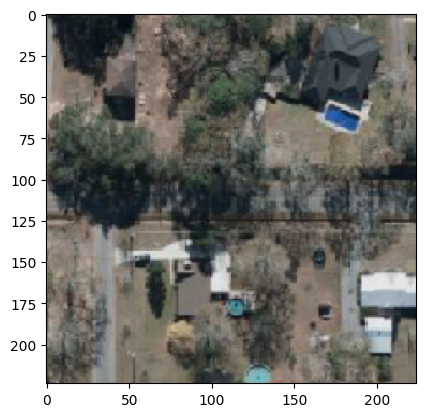

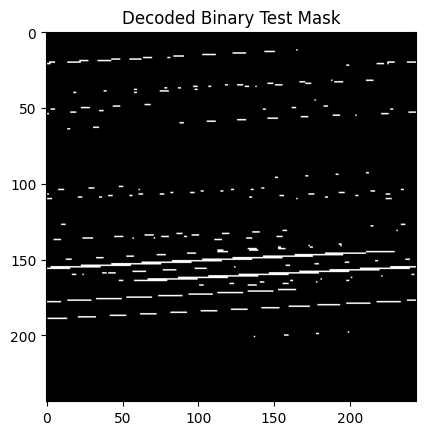

In [ ]:
# test.csv 파일을 읽어옵니다.
submit_df = pd.read_csv('./submit.csv')

id = 20

image = cv2.imread(f'./test_img/TEST_000{id}.png')
if image is None:
  raise FileNotFoundError(f"Image not found: {img_path}")  # 이미지가 없을 경우 예외 발생
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()


# 예시로 0 번째 마스크 정보를 사용합니다.
mask_rle_example = submit_df['mask_rle'].iloc[id]
# 이미지의 실제 크기를 알고 있어야 합니다. 예시에서는 244x244로 가정합니다.
shape = (244, 244)

# RLE 인코딩된 마스크를 디코딩
decoded_mask = rle_decode(mask_rle_example, shape)

# 디코딩된 마스크 시각화
plt.imshow(decoded_mask, cmap='gray')
plt.title("Decoded Binary Test Mask")

plt.show()